In [ ]:
!git clone https://github.com/CSAILVision/semantic-segmentation-pytorch.git

%cd semantic-segmentation-pytorch/

! pip install numpy scipy torchvision opencv-python yacs tqdm

!sed -i 's/elif isinstance(obj, collections.Mapping):/elif isinstance(obj, collections.abc.Mapping):/g' /content/semantic-segmentation-pytorch/mit_semseg/lib/nn/parallel/data_parallel.py
!sed -i 's/if isinstance(obj, collections.Sequence):/if isinstance(obj, collections.abc.Sequence):/g' /content/semantic-segmentation-pytorch/mit_semseg/lib/utils/th.py
!sed -i 's/elif isinstance(obj, collections.Mapping):/elif isinstance(obj, collections.abc.Mapping):/g' /content/semantic-segmentation-pytorch/mit_semseg/lib/utils/th.py

!mkdir images masks images2

!chmod +x demo_test.sh
!./demo_test.sh


Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 1170, done.
remote: Total 1170 (delta 0), reused 0 (delta 0), pack-reused 1170
Receiving objects: 100% (1170/1170), 5.04 MiB | 23.35 MiB/s, done.
Resolving deltas: 100% (707/707), done.
/content/semantic-segmentation-pytorch
--2023-09-03 08:49:38--  http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
Resolving sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)... 128.30.100.223
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.100.223|:80... failed: Connection timed out.
Retrying.

--2023-09-03 08:51:49--  (try: 2)  http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.100.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95015426 (91M)
Saving to: ‘ckpt/ade20k-resnet50dilated-

In [ ]:

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d hhrclemson/flooding-image-dataset
#!unzip water-segmentation-dataset.zip
#!unzip water-segmentation-dataset.zip 'water_v2/*'

100% 11.1G/11.1G [01:56<00:00, 92.1MB/s]
100% 11.1G/11.1G [01:56<00:00, 102MB/s] 


In [ ]:
!unzip /content/semantic-segmentation-pytorch/flooding-image-dataset.zip

In [ ]:
import os
import shutil
import random

def move_random_files(src_folder, dest_folder, num_files=-1):
    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get list of all files in source folder
    all_files = []
    for dirpath, dirnames, filenames in os.walk(src_folder):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Add more image extensions if needed
                all_files.append(os.path.join(dirpath, filename))

    # Shuffle the list of files
    random.shuffle(all_files)

    # Select first 'num_files' files
    selected_files = all_files[:num_files]

    # Move selected files to destination folder
    for src_file_path in selected_files:
        filename = os.path.basename(src_file_path).replace('.png','.jpg')
        dest_file_path = os.path.join(dest_folder, filename)
        shutil.copy(src_file_path, dest_file_path)

# Example usage
src_folder = "/content/semantic-segmentation-pytorch/Flood Images"
dest_folder = "/content/semantic-segmentation-pytorch/images2"
move_random_files(src_folder, dest_folder)


### **Init - Setup**

In [ ]:
!rm -f /content/semantic-segmentation-pytorch/images2/* /content/semantic-segmentation-pytorch/images

In [ ]:
import os
from pathlib import Path
import PIL.Image
# Get the path to the folder containing the images
path2='/content/semantic-segmentation-pytorch/images/'
folder_path = Path('/content/semantic-segmentation-pytorch/images2/')

# Iterate over all the images in the folder
for filename in sorted(os.listdir(folder_path)):
    # Read the image
    image = PIL.Image.open(os.path.join(folder_path, filename))
    image = image.convert("RGB")
    # Reshape the image

    image = image.resize((320, 320))

    # Save the reshaped image
    #print(filename)
    image.save(os.path.join(path2, filename.replace('jpeg','jpg')))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%cd semantic-segmentation-pytorch/
#!python3 -u test.py --imgs images --gpu 0 --cfg /content/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml

/content/semantic-segmentation-pytorch


### **Load you images to semantic-segmentation-pytorch/images**





In [ ]:
# System libs
import os
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
import csv
# Our libs
from mit_semseg.dataset import TestDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode, find_recursive, setup_logger
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm
from mit_semseg.config import cfg
import threading

# Hardcoded arguments
#imgs = "images"  # Replace with your image path or directory
imgs = 'images'
gpu = 0
cfg_file = "/content/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml"
colors = loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]


def visualize_result(data, pred, cfg):
    (img, info) = data
    # print predictions in descending order
    pred = np.int32(pred)
    pixs = pred.size
    uniques, counts = np.unique(pred, return_counts=True)
    print("Predictions in [{}]:".format(info))
    for idx in np.argsort(counts)[::-1]:
        name = names[uniques[idx] + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("  {}: {:.2f}%".format(name, ratio))

    # colorize prediction
    #pred_color = colorEncode(pred, colors).astype(np.uint8)

    # Initialize pred_color as an array of zeros with the same shape as pred
    pred_color = np.zeros_like(pred)
    #27,0.0053,651,57,1,sea
    #22,0.0074,709,75,1,water
    #114,0.0005,80,9,1,waterfall;falls

    water_list = [22,27,114,61]

    #water_list =[7,12]
    # Loop through pred and set pred_color accordingly
    unique_values = np.unique(pred)
    print("Unique values in pred:", unique_values)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i, j]+1 in water_list:
                pred_color[i, j] = 255  # White
            else:
                pred_color[i, j] = 0    # Black
    # aggregate images and save
    #im_vis = np.concatenate((img, pred_color), axis=1)
    # aggregate images and save
    # Expand pred_color to have 3 identical channels
    pred_color_3channel = np.stack([pred_color]*3, axis=2)

    # Then concatenate
    #im_vis = np.concatenate((img, pred_color_3channel), axis=1)
    im_vis=pred_color_3channel

    #img_name = info.split('/')[-1]
    if 'images' in info:

        img_name = info.replace('images', 'masks').replace('.jpg','.png')

        # Save the image
        Image.fromarray(im_vis.astype(np.uint8)).save(
            os.path.join(cfg.TEST.result, img_name))
    else:
        print("The string 'images' is not in the path. Exiting.")
        exit()

    #img_name = info.split('/')[-1]
    #Image.fromarray(im_vis).save(
    #    os.path.join(cfg.TEST.result, img_name.replace('.jpg', '.png')))

# Lock object to synchronize tqdm updates
lock = threading.Lock()
def test(segmentation_module, loader, gpu):
    segmentation_module.eval()

    pbar = tqdm(total=len(loader))
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        segSize = (batch_data['img_ori'].shape[0],
                   batch_data['img_ori'].shape[1])
        img_resized_list = batch_data['img_data']

        with torch.no_grad():
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                pred_tmp = segmentation_module(feed_dict, segSize=segSize)
                scores = scores + pred_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        # visualization
        visualize_result(
            (batch_data['img_ori'], batch_data['info']),
            pred,
            cfg
        )

        with lock:
            pbar.update(1)


def main(cfg, gpu):
    torch.cuda.set_device(gpu)

    # Network Builders
    net_encoder = ModelBuilder.build_encoder(
        arch=cfg.MODEL.arch_encoder,
        fc_dim=cfg.MODEL.fc_dim,
        weights=cfg.MODEL.weights_encoder)
    net_decoder = ModelBuilder.build_decoder(
        arch=cfg.MODEL.arch_decoder,
        fc_dim=cfg.MODEL.fc_dim,
        num_class=cfg.DATASET.num_class,
        weights=cfg.MODEL.weights_decoder,
        use_softmax=True)

    crit = nn.NLLLoss(ignore_index=-1)

    segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

    # Dataset and Loader
    dataset_test = TestDataset(
        cfg.list_test,
        cfg.DATASET)
    loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=cfg.TEST.batch_size,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=10,
        drop_last=True)

    segmentation_module.cuda()

    # Main loop
    #test(segmentation_module, loader_test, gpu)
    # Create a thread to run the test function
    # Create a ThreadPoolExecutor
    from concurrent.futures import ThreadPoolExecutor
    from tqdm import tqdm

    # Initialize a tqdm object for the progress bar
    #bar = tqdm(total=3474 , desc="Processing", position=0, leave=True)

    with ThreadPoolExecutor(max_workers=50) as executor:
        # Submit tasks to the executor
        executor.submit(test, segmentation_module, loader_test, gpu)
    # Close the progress bar
    print('Inference done!')


# Main function
if __name__ == '__main__':
    assert LooseVersion(torch.__version__) >= LooseVersion('0.4.0'), \
        'PyTorch>=0.4.0 is required'

    # Load configuration
    cfg.merge_from_file(cfg_file)
    # cfg.merge_from_list(args.opts)
    # cfg.freeze()

    logger = setup_logger(distributed_rank=0)   # TODO
    logger.info("Loaded configuration file {}".format(cfg_file))
    logger.info("Running with config:\n{}".format(cfg))

    cfg.MODEL.arch_encoder = cfg.MODEL.arch_encoder.lower()
    cfg.MODEL.arch_decoder = cfg.MODEL.arch_decoder.lower()

    # absolute paths of model weights
    cfg.MODEL.weights_encoder = os.path.join(
        cfg.DIR, 'encoder_' + cfg.TEST.checkpoint)
    cfg.MODEL.weights_decoder = os.path.join(
        cfg.DIR, 'decoder_' + cfg.TEST.checkpoint)

    assert os.path.exists(cfg.MODEL.weights_encoder) and \
        os.path.exists(cfg.MODEL.weights_decoder), "checkpoint does not exitst!"

    # generate testing image list
    if os.path.isdir(imgs):
        imgs = find_recursive(imgs)
    else:
        imgs = [imgs]
    assert len(imgs), "imgs should be a path to image (.jpg) or directory."
    cfg.list_test = [{'fpath_img': x} for x in imgs]

    if not os.path.isdir(cfg.TEST.result):
        os.makedirs(cfg.TEST.result)

    main(cfg, gpu)

# field,earth,sand

[2023-08-30 20:59:42,511 INFO <ipython-input-16-36f8310cbf41> line 199 215] Loaded configuration file /content/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2023-08-30 20:59:42,511 INFO <ipython-input-16-36f8310cbf41> line 199 215] Loaded configuration file /content/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2023-08-30 20:59:42,511 INFO <ipython-input-16-36f8310cbf41> line 199 215] Loaded configuration file /content/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml


<ipython-input-16-36f8310cbf41>:190: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert LooseVersion(torch.__version__) >= LooseVersion('0.4.0'), \
INFO:Logger:Loaded configuration file /content/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml


[2023-08-30 20:59:42,533 INFO <ipython-input-16-36f8310cbf41> line 200 215] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet50dilated
  fc_dim: 2048
  weights_decoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
  weights_encoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
TEST:
  batch_size: 1
  checkpoint: epoch_20.pth
  result: ./
TRAIN:
  batch_size_per_gpu: 2
  beta1: 0.9
  deep_sup_scale: 0.4
  disp_iter: 20
  epoch_iters: 5000
  fix_bn: False
  lr_decoder: 0.02
  lr_encoder: 0.02
  lr_pow: 0.9
  num_epoch: 20
  optim: SGD
  seed: 304
  start_epoch: 0
  weight_decay: 0.0001
  workers: 16
VAL:
  batch_size: 1
  checkpoint: epoch_2

INFO:Logger:Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet50dilated
  fc_dim: 2048
  weights_decoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
  weights_encoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
TEST:
  batch_size: 1
  checkpoint: epoch_20.pth
  result: ./
TRAIN:
  batch_size_per_gpu: 2
  beta1: 0.9
  deep_sup_scale: 0.4
  disp_iter: 20
  epoch_iters: 5000
  fix_bn: False
  lr_decoder: 0.02
  lr_encoder: 0.02
  lr_pow: 0.9
  num_epoch: 20
  optim: SGD
  seed: 304
  start_epoch: 0
  weight_decay: 0.0001
  workers: 16
VAL:
  batch_size: 1
  checkpoint: epoch_20.pth
  visualize: False
list_test: [{'fpath_img': 'images/flood

Loading weights for net_encoder
Loading weights for net_decoder
# samples: 9294


  0%|          | 0/9294 [00:00<?, ?it/s]

Predictions in [images/flood_7751.jpg]:
  tree: 77.30%
  earth: 9.53%
  river: 6.77%
  path: 2.74%
  wall: 1.12%
  water: 0.77%
  bridge: 0.70%
  sky: 0.62%
  plant: 0.17%
  floor: 0.13%
  building: 0.11%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 21 52 60 61]


  0%|          | 1/9294 [00:01<4:19:06,  1.67s/it]

Predictions in [images/flood_3099.jpg]:
  tree: 41.48%
  water: 33.55%
  sky: 11.98%
  plant: 4.96%
  building: 4.13%
  house: 1.93%
  wall: 0.94%
  earth: 0.93%
Unique values in pred: [ 0  1  2  4 12 13 17 21 25 43 53]


  0%|          | 2/9294 [00:02<2:55:48,  1.14s/it]

Predictions in [images/flood_4732.jpg]:
  river: 54.11%
  tree: 29.71%
  sky: 11.70%
  bridge: 4.43%
Unique values in pred: [ 1  2  4 21 60 61]


  0%|          | 3/9294 [00:03<2:22:58,  1.08it/s]

Predictions in [images/flood_4868.jpg]:
  tree: 37.11%
  sky: 29.48%
  mountain: 9.14%
  person: 5.46%
  wall: 5.20%
  sand: 4.60%
  water: 3.66%
  floor: 2.68%
  earth: 2.64%
Unique values in pred: [ 0  2  3  4 12 13 16 20 21 46]


  0%|          | 4/9294 [00:03<2:09:13,  1.20it/s]

Predictions in [images/flood_6404.jpg]:
  tree: 55.26%
  water: 24.23%
  river: 12.28%
  earth: 3.36%
  path: 2.69%
  plant: 2.01%
  rock: 0.10%
Unique values in pred: [ 2  4 13 17 21 34 52 60]


  0%|          | 6/9294 [00:05<1:57:37,  1.32it/s]

Predictions in [images/flood_4507.jpg]:
  water: 30.32%
  sky: 27.05%
  tree: 17.10%
  building: 7.99%
  sea: 6.87%
  earth: 6.50%
  sand: 4.09%
Unique values in pred: [ 1  2  4 13 16 17 21 26 46]
Predictions in [images/flood_2507.jpg]:
  building: 39.52%
  tree: 21.58%
  water: 21.05%
  sky: 14.28%
  pier: 1.72%
  boat: 0.97%
  wall: 0.69%
  sidewalk: 0.12%
Unique values in pred: [  0   1   2   4  11  17  21  76 140]


  0%|          | 7/9294 [00:06<2:01:31,  1.27it/s]

Predictions in [images/flood_8942.jpg]:
  earth: 43.19%
  building: 17.32%
  tree: 15.79%
  rock: 8.41%
  bannister: 3.28%
  floor: 3.08%
  stairs: 2.76%
  wall: 2.36%
  sidewalk: 1.57%
  bag: 1.02%
  pole: 0.48%
  cabinet: 0.29%
  water: 0.26%
Unique values in pred: [  0   1   3   4   9  10  11  13  15  21  34  52  53  61  93  95 115]


  0%|          | 8/9294 [00:07<2:10:56,  1.18it/s]

Predictions in [images/flood_8210.jpg]:
  water: 38.81%
  tree: 33.76%
  plant: 17.83%
  mountain: 6.12%
  river: 2.01%
  signboard: 0.66%
  earth: 0.52%
  wall: 0.17%
  path: 0.11%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


  0%|          | 9/9294 [00:08<2:17:59,  1.12it/s]

Predictions in [images/flood_3056.jpg]:
  tree: 43.40%
  water: 37.35%
  sky: 10.32%
  building: 8.35%
  grass: 0.58%
Unique values in pred: [ 1  2  4  9 17 21]


  0%|          | 10/9294 [00:08<2:21:03,  1.10it/s]

Predictions in [images/flood_7554.jpg]:
  tree: 48.02%
  water: 40.74%
  plant: 7.67%
  sky: 2.40%
  grass: 0.49%
  road: 0.32%
  path: 0.31%
Unique values in pred: [ 0  2  4  6  9 17 21 52 94]


  0%|          | 11/9294 [00:09<2:11:51,  1.17it/s]

Predictions in [images/flood_3974.jpg]:
  bridge: 19.95%
  boat: 19.35%
  sky: 13.55%
  tree: 11.31%
  railing: 5.46%
  water: 4.33%
  pier: 4.20%
  earth: 3.69%
  building: 2.93%
  sea: 2.65%
  grass: 2.64%
  cushion: 2.35%
  wall: 1.83%
  person: 1.79%
  chair: 1.14%
  conveyer: 0.88%
  bed: 0.85%
  fence: 0.48%
  river: 0.47%
  ship: 0.13%
Unique values in pred: [  0   1   2   4   7   9  12  13  19  21  26  32  38  39  51  60  61  76
 103 105 140]


  0%|          | 12/9294 [00:10<2:06:56,  1.22it/s]

Predictions in [images/flood_4692.jpg]:
  sky: 42.32%
  tree: 15.61%
  plant: 11.03%
  water: 10.64%
  river: 9.14%
  earth: 4.64%
  rock: 2.99%
  grass: 2.67%
  wall: 0.71%
  building: 0.25%
Unique values in pred: [ 0  1  2  4  9 13 17 21 34 60]


  0%|          | 13/9294 [00:11<2:02:47,  1.26it/s]

Predictions in [images/flood_112.jpg]:
  river: 44.62%
  sky: 33.76%
  tree: 18.84%
  building: 1.39%
  water: 0.76%
  earth: 0.62%
Unique values in pred: [ 1  2  4 13 21 60]


  0%|          | 14/9294 [00:11<1:56:55,  1.32it/s]

Predictions in [images/flood_1364.jpg]:
  water: 27.88%
  sky: 27.68%
  bridge: 15.36%
  tree: 14.84%
  grass: 8.76%
  earth: 5.07%
  river: 0.29%
Unique values in pred: [ 0  1  2  4  9 13 21 60 61]


  0%|          | 15/9294 [00:12<1:53:38,  1.36it/s]

Predictions in [images/flood_5133.jpg]:
  earth: 28.67%
  sky: 26.49%
  tree: 18.10%
  water: 7.56%
  mountain: 6.74%
  building: 6.69%
  sea: 4.81%
  road: 0.48%
  wall: 0.14%
  land: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 20 21 26 29 90 94]


  0%|          | 16/9294 [00:13<1:54:26,  1.35it/s]

Predictions in [images/flood_7113.jpg]:
  floor: 28.99%
  wall: 21.12%
  plant: 12.72%
  door: 11.10%
  person: 7.04%
  tree: 4.84%
  earth: 4.42%
  bed: 2.91%
  sky: 1.85%
  windowpane: 1.60%
  fence: 1.31%
  grass: 0.80%
  curtain: 0.65%
  column: 0.33%
  van: 0.26%
Unique values in pred: [  0   2   3   4   7   8   9  12  13  14  17  18  32  42  43 102]


  0%|          | 17/9294 [00:13<1:53:05,  1.37it/s]

Predictions in [images/flood_7286.jpg]:
  tree: 51.04%
  plant: 25.43%
  wall: 9.49%
  earth: 4.72%
  sky: 4.09%
  signboard: 1.53%
  mountain: 0.89%
  flower: 0.56%
  bridge: 0.41%
  water: 0.39%
  rock: 0.39%
  building: 0.30%
  road: 0.29%
  house: 0.29%
  grass: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


  0%|          | 18/9294 [00:14<1:51:27,  1.39it/s]

Predictions in [images/flood_8331.jpg]:
  tree: 47.41%
  water: 17.25%
  path: 11.71%
  plant: 5.55%
  floor: 4.82%
  earth: 4.40%
  river: 4.38%
  mountain: 2.42%
  wall: 1.12%
  grass: 0.61%
  road: 0.27%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 34 43 52 60 94]


  0%|          | 19/9294 [00:15<1:53:06,  1.37it/s]

Predictions in [images/flood_673.jpg]:
  earth: 42.81%
  tree: 41.42%
  building: 6.82%
  house: 4.44%
  sky: 3.00%
  grass: 1.09%
  plant: 0.16%
  fence: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 21 25 32 43 53]


  0%|          | 20/9294 [00:16<1:50:14,  1.40it/s]

Predictions in [images/flood_9077.jpg]:
  plant: 43.30%
  building: 18.98%
  earth: 10.62%
  sky: 8.50%
  tree: 7.53%
  door: 5.50%
  water: 1.73%
  hovel: 1.23%
  road: 1.23%
  floor: 0.69%
  field: 0.31%
  house: 0.19%
  wall: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 25 29 79]


  0%|          | 21/9294 [00:16<1:53:34,  1.36it/s]

Predictions in [images/flood_4359.jpg]:
  sea: 77.70%
  sky: 17.32%
  boat: 1.93%
  land: 1.92%
  mountain: 0.73%
  pier: 0.31%
Unique values in pred: [  1   2  16  26  76  94 140]


  0%|          | 22/9294 [00:17<1:52:59,  1.37it/s]

Predictions in [images/flood_200.jpg]:
  water: 31.42%
  tree: 27.56%
  grass: 19.36%
  sky: 12.99%
  building: 4.87%
  road: 1.21%
  earth: 0.96%
  rock: 0.92%
  plant: 0.56%
  path: 0.12%
Unique values in pred: [ 1  2  4  6  9 12 13 17 21 34 52]


  0%|          | 23/9294 [00:18<1:50:58,  1.39it/s]

Predictions in [images/flood_3328.jpg]:
  water: 40.37%
  building: 34.14%
  tree: 11.75%
  sky: 7.63%
  wall: 5.10%
  signboard: 0.97%
Unique values in pred: [ 0  1  2  4 17 21 43]


  0%|          | 24/9294 [00:18<1:49:13,  1.41it/s]

Predictions in [images/flood_2013.jpg]:
  sky: 38.37%
  grass: 22.75%
  water: 18.10%
  tree: 13.88%
  plant: 3.30%
  earth: 2.34%
  sand: 1.28%
Unique values in pred: [ 2  4  9 13 17 21 46]


  0%|          | 25/9294 [00:19<1:58:25,  1.30it/s]

Predictions in [images/flood_7413.jpg]:
  tree: 74.30%
  plant: 11.12%
  wall: 4.64%
  sky: 3.50%
  earth: 2.24%
  path: 1.58%
  road: 1.19%
  signboard: 1.06%
  rock: 0.26%
Unique values in pred: [ 0  2  4  6 13 17 34 43 52 60 66]


  0%|          | 26/9294 [00:20<2:09:02,  1.20it/s]

Predictions in [images/flood_1990.jpg]:
  water: 42.84%
  tree: 27.11%
  building: 11.48%
  plant: 8.38%
  sky: 7.43%
  bridge: 2.31%
  trade: 0.23%
  fence: 0.16%
Unique values in pred: [  1   2   4  13  17  21  32  52  61 123]


  0%|          | 27/9294 [00:21<2:14:09,  1.15it/s]

Predictions in [images/flood_3273.jpg]:
  water: 35.01%
  tree: 28.88%
  sky: 21.36%
  railing: 6.84%
  bridge: 4.08%
  wall: 3.37%
  building: 0.25%
Unique values in pred: [ 0  1  2  4  9 11 13 21 38 60 61]


  0%|          | 28/9294 [00:22<2:16:33,  1.13it/s]

Predictions in [images/flood_3156.jpg]:
  tree: 43.35%
  water: 29.78%
  river: 9.43%
  wall: 6.96%
  mountain: 4.43%
  plant: 4.00%
  sky: 2.00%
Unique values in pred: [ 0  2  4 16 17 21 52 60]


  0%|          | 30/9294 [00:24<2:03:08,  1.25it/s]

Predictions in [images/flood_1597.jpg]:
  water: 36.55%
  building: 31.08%
  sky: 26.04%
  wall: 4.89%
  tree: 0.78%
  bridge: 0.57%
Unique values in pred: [ 0  1  2  4 21 60 61 84]
Predictions in [images/flood_5769.jpg]:
  water: 23.10%
  grass: 20.41%
  tree: 17.79%
  sky: 11.75%
  building: 8.02%
  sidewalk: 8.00%
  pole: 3.18%
  streetlight: 2.43%
  person: 2.26%
  wall: 1.18%
  column: 0.98%
  road: 0.44%
  bicycle: 0.35%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  32  42  69  87  93 127]


  0%|          | 31/9294 [00:24<1:59:22,  1.29it/s]

Predictions in [images/flood_5596.jpg]:
  water: 40.80%
  building: 35.77%
  tree: 11.49%
  sky: 7.41%
  wall: 4.14%
  signboard: 0.40%
Unique values in pred: [ 0  1  2  4 21 43]


  0%|          | 32/9294 [00:25<1:58:54,  1.30it/s]

Predictions in [images/flood_2171.jpg]:
  water: 29.64%
  building: 17.94%
  tree: 15.62%
  sky: 13.20%
  path: 11.33%
  grass: 7.92%
  plant: 4.06%
  fence: 0.21%
Unique values in pred: [ 1  2  4  6  9 11 17 21 32 52]


  0%|          | 33/9294 [00:26<1:56:14,  1.33it/s]

Predictions in [images/flood_9223.jpg]:
  tree: 85.96%
  sky: 3.97%
  earth: 3.42%
  grass: 2.22%
  water: 1.37%
  signboard: 1.00%
  wall: 0.64%
  road: 0.57%
  building: 0.53%
  house: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52 61]


  0%|          | 34/9294 [00:27<1:52:54,  1.37it/s]

Predictions in [images/flood_8173.jpg]:
  tree: 53.88%
  river: 21.96%
  water: 13.25%
  land: 4.10%
  earth: 2.56%
  wall: 2.43%
  signboard: 0.96%
  mountain: 0.72%
  rock: 0.14%
Unique values in pred: [ 0  4 13 16 21 34 43 52 60 94]


  0%|          | 35/9294 [00:27<1:52:00,  1.38it/s]

Predictions in [images/flood_7942.jpg]:
  tree: 70.12%
  earth: 16.56%
  river: 7.21%
  plant: 2.62%
  water: 1.99%
  path: 1.24%
  signboard: 0.11%
  bridge: 0.11%
Unique values in pred: [ 0  4 13 17 21 43 52 60 61]


  0%|          | 36/9294 [00:28<1:52:13,  1.37it/s]

Predictions in [images/flood_5825.jpg]:
  water: 65.31%
  sky: 16.44%
  tree: 6.74%
  building: 4.47%
  bridge: 3.58%
  fence: 1.58%
  boat: 0.80%
  pier: 0.51%
  truck: 0.29%
  tower: 0.24%
Unique values in pred: [  1   2   4  11  21  32  61  76  83  84  93 140]


  0%|          | 37/9294 [00:29<1:51:10,  1.39it/s]

Predictions in [images/flood_2743.jpg]:
  sky: 29.65%
  sea: 26.15%
  water: 17.14%
  boat: 8.35%
  building: 5.16%
  sidewalk: 3.62%
  plant: 3.34%
  pole: 1.77%
  pot: 1.38%
  pier: 1.11%
  tree: 1.02%
  wall: 0.98%
  bannister: 0.19%
  fence: 0.11%
Unique values in pred: [  0   1   2   4   6  11  17  21  26  32  76  93  95 125 140 149]


  0%|          | 38/9294 [00:29<1:50:22,  1.40it/s]

Predictions in [images/flood_7165.jpg]:
  tree: 83.30%
  flower: 6.11%
  sky: 3.37%
  plant: 3.18%
  mountain: 2.11%
  road: 0.61%
  signboard: 0.53%
  path: 0.39%
  earth: 0.18%
Unique values in pred: [ 1  2  4  6 13 16 17 22 43 52 66 94]


  0%|          | 39/9294 [00:30<1:52:01,  1.38it/s]

Predictions in [images/flood_1702.jpg]:
  tree: 35.43%
  sidewalk: 26.17%
  sky: 9.59%
  road: 8.00%
  wall: 6.78%
  building: 3.33%
  grass: 2.31%
  signboard: 2.14%
  bench: 2.03%
  river: 1.71%
  earth: 1.31%
  water: 0.74%
  boat: 0.35%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 32 34 43 60 69 76]


  0%|          | 40/9294 [00:31<1:51:00,  1.39it/s]

Predictions in [images/flood_9233.jpg]:
  tree: 79.56%
  plant: 4.50%
  grass: 3.37%
  sky: 3.09%
  path: 2.86%
  water: 2.64%
  wall: 1.72%
  signboard: 1.14%
  building: 0.76%
  earth: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 43 52 60]


  0%|          | 41/9294 [00:32<1:50:49,  1.39it/s]

Predictions in [images/flood_4350.jpg]:
  building: 23.08%
  wall: 22.73%
  sea: 15.12%
  sky: 12.86%
  tree: 12.01%
  plant: 6.41%
  road: 3.14%
  grandstand: 1.35%
  fence: 0.69%
  earth: 0.67%
  conveyer: 0.65%
  grass: 0.39%
  bridge: 0.27%
  mountain: 0.23%
  floor: 0.11%
Unique values in pred: [  0   1   2   3   4   6   9  13  16  17  21  26  29  32  51  61  76  94
  96 105]


  0%|          | 42/9294 [00:32<1:52:55,  1.37it/s]

Predictions in [images/flood_7011.jpg]:
  plant: 35.27%
  tree: 17.06%
  building: 15.42%
  earth: 9.12%
  sky: 7.65%
  wall: 5.31%
  door: 3.25%
  water: 2.84%
  field: 1.93%
  fence: 1.18%
  road: 0.53%
  path: 0.36%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 52]


  0%|          | 43/9294 [00:33<2:05:28,  1.23it/s]

Predictions in [images/flood_1170.jpg]:
  wall: 31.55%
  tree: 31.03%
  water: 12.64%
  ceiling: 9.64%
  sky: 9.03%
  building: 2.50%
  mountain: 1.76%
  floor: 0.66%
  plant: 0.52%
  person: 0.21%
  car: 0.21%
  earth: 0.10%
Unique values in pred: [ 0  1  2  3  4  5  6 12 13 16 17 20 21 61 72]


  0%|          | 44/9294 [00:34<2:13:39,  1.15it/s]

Predictions in [images/flood_8572.jpg]:
  earth: 40.56%
  water: 15.81%
  sky: 14.44%
  river: 12.90%
  tree: 5.64%
  building: 3.77%
  rock: 3.60%
  bridge: 2.84%
  pole: 0.25%
  road: 0.19%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


  0%|          | 45/9294 [00:35<2:16:51,  1.13it/s]

Predictions in [images/flood_5526.jpg]:
  tree: 48.70%
  water: 36.51%
  river: 8.23%
  building: 2.19%
  wall: 0.92%
  boat: 0.88%
  animal: 0.62%
  fence: 0.58%
  grass: 0.52%
  pier: 0.29%
  person: 0.26%
  plant: 0.24%
Unique values in pred: [  0   1   4   9  12  17  21  32  60  76  87 126 140]


  0%|          | 46/9294 [00:36<2:20:01,  1.10it/s]

Predictions in [images/flood_8556.jpg]:
  building: 31.62%
  sky: 28.28%
  tree: 16.63%
  river: 9.47%
  wall: 6.06%
  boat: 2.45%
  water: 1.99%
  bed: 1.21%
  streetlight: 1.01%
  land: 0.52%
  sea: 0.37%
  awning: 0.14%
Unique values in pred: [  0   1   2   4   7  12  13  21  26  36  43  46  60  61  76  86  87  94
 134]


  1%|          | 47/9294 [00:37<2:13:54,  1.15it/s]

Predictions in [images/flood_7641.jpg]:
  tree: 41.17%
  water: 37.53%
  plant: 14.56%
  grass: 4.95%
  sky: 1.79%
Unique values in pred: [ 2  4  9 17 21]


  1%|          | 48/9294 [00:38<2:05:09,  1.23it/s]

Predictions in [images/flood_6474.jpg]:
  grass: 23.36%
  tree: 15.31%
  road: 12.12%
  railing: 11.20%
  earth: 8.12%
  wall: 7.62%
  mountain: 6.89%
  fence: 6.28%
  water: 4.58%
  bridge: 4.34%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


  1%|          | 49/9294 [00:38<1:59:18,  1.29it/s]

Predictions in [images/flood_7120.jpg]:
  wall: 46.30%
  floor: 19.86%
  plant: 11.95%
  door: 6.30%
  bed: 4.71%
  earth: 3.58%
  person: 3.16%
  windowpane: 2.66%
  tree: 0.77%
  fence: 0.19%
  hovel: 0.18%
  sky: 0.12%
Unique values in pred: [ 0  2  3  4  7  8 12 13 14 17 18 21 32 42 43 79]


  1%|          | 50/9294 [00:39<1:54:56,  1.34it/s]

Predictions in [images/flood_7940.jpg]:
  tree: 69.32%
  earth: 13.07%
  river: 8.55%
  plant: 4.73%
  path: 3.45%
  bridge: 0.40%
  water: 0.31%
  grass: 0.17%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


  1%|          | 52/9294 [00:40<1:50:39,  1.39it/s]

Predictions in [images/flood_4861.jpg]:
  water: 38.45%
  mountain: 22.88%
  tree: 19.77%
  plant: 3.90%
  house: 3.77%
  rock: 3.51%
  waterfall: 2.49%
  sky: 2.47%
  earth: 1.63%
  field: 0.97%
  road: 0.16%
Unique values in pred: [  2   4   6  13  16  17  21  25  29  34 113]
Predictions in [images/flood_4704.jpg]:
  tree: 39.29%
  grass: 33.26%
  water: 18.21%
  house: 5.13%
  path: 2.38%
  sky: 1.09%
  rock: 0.28%
  earth: 0.13%
  plant: 0.11%
Unique values in pred: [ 1  2  4  9 12 13 16 17 21 25 34 52]


  1%|          | 53/9294 [00:41<1:53:46,  1.35it/s]

Predictions in [images/flood_6730.jpg]:
  earth: 50.30%
  building: 17.83%
  tree: 13.99%
  rock: 4.26%
  water: 3.13%
  bannister: 3.09%
  sidewalk: 2.69%
  wall: 2.48%
  mountain: 1.30%
  bridge: 0.40%
  plant: 0.30%
  pole: 0.14%
Unique values in pred: [  0   1   4  10  11  13  16  17  21  34  43  61  93  95 115 121]


  1%|          | 54/9294 [00:42<1:51:22,  1.38it/s]

Predictions in [images/flood_4537.jpg]:
  tree: 23.85%
  grass: 23.19%
  road: 20.69%
  sky: 18.12%
  signboard: 6.64%
  person: 2.87%
  building: 1.45%
  car: 1.11%
  wall: 0.55%
  base: 0.51%
  sidewalk: 0.45%
  fence: 0.22%
  box: 0.21%
  awning: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 12 20 32 40 41 43 52 86]


  1%|          | 55/9294 [00:43<1:52:04,  1.37it/s]

Predictions in [images/flood_4126.jpg]:
  tree: 52.70%
  grass: 28.92%
  plant: 7.01%
  building: 4.34%
  earth: 2.59%
  wall: 2.27%
  sky: 1.39%
  chair: 0.25%
  floor: 0.25%
  table: 0.24%
Unique values in pred: [ 0  1  2  3  4  9 13 15 17 19 20 69]


  1%|          | 56/9294 [00:43<1:49:54,  1.40it/s]

Predictions in [images/flood_4395.jpg]:
  tree: 23.43%
  building: 21.86%
  earth: 19.21%
  sidewalk: 18.46%
  fence: 12.16%
  railing: 1.98%
  wall: 0.90%
  road: 0.78%
  grass: 0.44%
  person: 0.40%
  water: 0.22%
  sky: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 38]


  1%|          | 57/9294 [00:44<1:50:41,  1.39it/s]

Predictions in [images/flood_6783.jpg]:
  earth: 48.15%
  tree: 17.71%
  building: 17.06%
  rock: 9.62%
  car: 2.61%
  stairs: 1.40%
  bannister: 1.20%
  plant: 0.90%
  water: 0.77%
  flower: 0.31%
  wall: 0.18%
Unique values in pred: [  0   1   4  12  13  17  20  21  25  34  53  66  95 115]


  1%|          | 58/9294 [00:45<1:50:53,  1.39it/s]

Predictions in [images/flood_5122.jpg]:
  earth: 32.40%
  building: 28.19%
  mountain: 23.90%
  tree: 12.38%
  wall: 2.42%
  rock: 0.71%
Unique values in pred: [ 0  1  4 13 16 34]


  1%|          | 59/9294 [00:45<1:49:31,  1.41it/s]

Predictions in [images/flood_6849.jpg]:
  plant: 30.09%
  building: 15.92%
  tree: 11.41%
  earth: 10.13%
  grass: 7.90%
  sky: 7.26%
  wall: 6.90%
  fence: 3.97%
  water: 2.94%
  truck: 1.62%
  car: 0.63%
  house: 0.46%
  field: 0.29%
  bridge: 0.21%
  sidewalk: 0.21%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  25  29  32  54  61  83 102]


  1%|          | 60/9294 [00:46<1:48:46,  1.41it/s]

Predictions in [images/flood_6900.jpg]:
  plant: 44.32%
  building: 12.90%
  wall: 10.86%
  sky: 8.71%
  tree: 8.36%
  earth: 7.35%
  fence: 3.03%
  water: 2.11%
  field: 1.16%
  path: 0.57%
  grass: 0.36%
  runway: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 21 29 32 34 52 54 61]


  1%|          | 61/9294 [00:47<1:59:38,  1.29it/s]

Predictions in [images/flood_3310.jpg]:
  water: 45.80%
  tree: 40.41%
  house: 5.51%
  earth: 4.34%
  building: 3.89%
Unique values in pred: [ 1  4 13 17 21 25]


  1%|          | 62/9294 [00:48<2:07:35,  1.21it/s]

Predictions in [images/flood_7471.jpg]:
  tree: 42.77%
  river: 26.56%
  plant: 16.20%
  water: 10.47%
  path: 1.68%
  grass: 0.74%
  sky: 0.73%
  earth: 0.51%
  field: 0.21%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 52 60 94]


  1%|          | 63/9294 [00:49<2:18:51,  1.11it/s]

Predictions in [images/flood_4915.jpg]:
  building: 99.00%
  tree: 0.93%
Unique values in pred: [0 1 4]


  1%|          | 64/9294 [00:50<2:20:13,  1.10it/s]

Predictions in [images/flood_2870.jpg]:
  tree: 30.08%
  water: 23.96%
  sky: 22.28%
  plant: 16.64%
  building: 6.66%
  earth: 0.23%
Unique values in pred: [ 1  2  4 13 15 17 21 25 34]


  1%|          | 65/9294 [00:51<2:08:57,  1.19it/s]

Predictions in [images/flood_8397.jpg]:
  earth: 45.78%
  water: 19.03%
  sky: 14.53%
  tree: 8.48%
  rock: 5.36%
  building: 3.40%
  river: 1.79%
  bridge: 1.41%
  pole: 0.21%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


  1%|          | 66/9294 [00:51<2:02:18,  1.26it/s]

Predictions in [images/flood_8417.jpg]:
  water: 42.10%
  rock: 15.86%
  sky: 14.15%
  earth: 12.40%
  tree: 9.17%
  bridge: 3.32%
  building: 2.89%
  pole: 0.12%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


  1%|          | 67/9294 [00:52<1:59:05,  1.29it/s]

Predictions in [images/flood_9227.jpg]:
  tree: 75.69%
  plant: 8.46%
  grass: 4.61%
  sky: 3.28%
  wall: 1.99%
  signboard: 1.32%
  path: 1.11%
  earth: 1.06%
  water: 0.91%
  building: 0.82%
  road: 0.64%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52 61]


  1%|          | 69/9294 [00:54<1:52:09,  1.37it/s]

Predictions in [images/flood_3022.jpg]:
  grass: 48.56%
  sky: 24.67%
  tree: 15.37%
  pole: 4.98%
  building: 2.33%
  water: 2.17%
  house: 1.15%
  mountain: 0.78%
Unique values in pred: [ 1  2  4  9 16 21 25 93]
Predictions in [images/flood_9116.jpg]:
  plant: 45.36%
  earth: 11.68%
  tree: 10.48%
  building: 8.39%
  sky: 8.23%
  water: 4.61%
  door: 4.18%
  wall: 3.01%
  bridge: 2.91%
  hovel: 0.42%
  car: 0.22%
  fence: 0.13%
  grass: 0.10%
Unique values in pred: [  0   1   2   4   9  13  14  17  19  20  21  29  32  52  54  61  79  90
 104]


  1%|          | 70/9294 [00:54<1:50:09,  1.40it/s]

Predictions in [images/flood_700.jpg]:
  water: 42.20%
  sky: 31.81%
  building: 15.39%
  tree: 6.58%
  rock: 2.26%
  wall: 1.64%
Unique values in pred: [  0   1   2   4  21  34  76 140]


  1%|          | 71/9294 [00:55<1:48:04,  1.42it/s]

Predictions in [images/flood_743.jpg]:
  tree: 34.66%
  building: 29.96%
  water: 14.82%
  sidewalk: 10.90%
  sky: 5.64%
  wall: 1.89%
  floor: 0.77%
  river: 0.68%
  person: 0.34%
  plant: 0.28%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 21 60]


  1%|          | 72/9294 [00:56<1:48:58,  1.41it/s]

Predictions in [images/flood_6974.jpg]:
  earth: 42.07%
  plant: 12.75%
  tree: 8.96%
  sky: 8.63%
  field: 5.95%
  building: 5.40%
  wall: 4.92%
  bridge: 3.75%
  water: 3.06%
  grass: 2.79%
  door: 1.06%
  road: 0.50%
  fence: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 61]


  1%|          | 73/9294 [00:56<1:51:51,  1.37it/s]

Predictions in [images/flood_1073.jpg]:
  building: 81.87%
  tree: 7.36%
  earth: 5.98%
  sky: 0.92%
  water: 0.91%
  road: 0.91%
  mountain: 0.86%
  river: 0.47%
  bulletin: 0.42%
  base: 0.24%
Unique values in pred: [  1   2   3   4   6  11  13  16  21  40  60 144]


  1%|          | 74/9294 [00:57<1:50:12,  1.39it/s]

Predictions in [images/flood_905.jpg]:
  tree: 47.74%
  sky: 18.08%
  water: 13.72%
  sea: 8.38%
  building: 5.22%
  grass: 3.07%
  plant: 2.47%
  table: 1.02%
  person: 0.24%
Unique values in pred: [ 0  1  2  3  4  9 12 15 17 21 26]


  1%|          | 75/9294 [00:58<1:49:45,  1.40it/s]

Predictions in [images/flood_7506.jpg]:
  tree: 45.23%
  river: 38.33%
  plant: 12.89%
  sky: 0.86%
  wall: 0.78%
  path: 0.50%
  earth: 0.37%
  field: 0.36%
  road: 0.23%
  land: 0.19%
  rock: 0.17%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60 94]


  1%|          | 76/9294 [00:58<1:48:38,  1.41it/s]

Predictions in [images/flood_1996.jpg]:
  plant: 34.74%
  sky: 32.43%
  road: 16.42%
  building: 9.49%
  tree: 6.15%
  signboard: 0.50%
  wall: 0.27%
Unique values in pred: [ 0  1  2  4  6 17 43 87]


  1%|          | 77/9294 [00:59<1:49:17,  1.41it/s]

Predictions in [images/flood_2683.jpg]:
  water: 39.41%
  tree: 33.89%
  building: 21.29%
  house: 4.40%
  plant: 0.82%
  path: 0.18%
Unique values in pred: [  1   4  17  21  25  52 113]


  1%|          | 78/9294 [01:00<1:48:32,  1.42it/s]

Predictions in [images/flood_5365.jpg]:
  building: 54.46%
  sky: 19.67%
  sidewalk: 8.79%
  water: 3.86%
  plant: 3.12%
  wall: 2.88%
  road: 2.65%
  grass: 1.33%
  earth: 1.22%
  person: 1.04%
  tree: 0.74%
  floor: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 19 21 76]


  1%|          | 79/9294 [01:01<1:58:10,  1.30it/s]

Predictions in [images/flood_3380.jpg]:
  water: 33.14%
  sidewalk: 25.43%
  building: 15.24%
  tree: 7.32%
  road: 5.55%
  plant: 4.02%
  sky: 3.16%
  earth: 1.76%
  wall: 1.34%
  fence: 1.15%
  car: 1.13%
  pier: 0.43%
  sea: 0.15%
  boat: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  13  17  20  21  26  32  43  76 140]


  1%|          | 80/9294 [01:02<2:06:12,  1.22it/s]

Predictions in [images/flood_7357.jpg]:
  tree: 49.71%
  plant: 36.28%
  wall: 4.51%
  sky: 3.01%
  earth: 1.71%
  signboard: 1.53%
  road: 1.06%
  path: 1.01%
  flower: 0.93%
  grass: 0.15%
Unique values in pred: [ 0  2  4  6  9 13 17 25 43 52 66]


  1%|          | 81/9294 [01:03<2:10:17,  1.18it/s]

Predictions in [images/flood_6712.jpg]:
  water: 25.87%
  grass: 22.10%
  railing: 12.54%
  building: 9.50%
  tree: 9.10%
  road: 7.67%
  earth: 6.18%
  bridge: 2.37%
  fence: 1.92%
  wall: 1.36%
  plant: 1.06%
  boat: 0.16%
  stairs: 0.14%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  53  61  76 125]


  1%|          | 82/9294 [01:04<2:16:44,  1.12it/s]

Predictions in [images/flood_1422.jpg]:
  sky: 42.61%
  water: 27.91%
  tree: 13.37%
  bridge: 11.43%
  building: 4.44%
Unique values in pred: [ 1  2  4 13 21 43 61 76]


  1%|          | 83/9294 [01:04<2:12:31,  1.16it/s]

Predictions in [images/flood_3254.jpg]:
  building: 41.57%
  road: 30.16%
  car: 22.30%
  person: 3.03%
  tree: 1.74%
  sidewalk: 0.94%
  stairs: 0.19%
Unique values in pred: [ 1  4  6 11 12 20 53 59 93]


  1%|          | 84/9294 [01:05<2:03:59,  1.24it/s]

Predictions in [images/flood_3945.jpg]:
  tree: 53.91%
  water: 12.40%
  sky: 7.29%
  sea: 6.98%
  earth: 6.87%
  plant: 5.19%
  sand: 4.94%
  building: 2.42%
Unique values in pred: [ 1  2  4 13 17 21 26 46]


  1%|          | 85/9294 [01:06<1:59:13,  1.29it/s]

Predictions in [images/flood_1833.jpg]:
  sky: 30.84%
  plant: 14.79%
  water: 12.78%
  tree: 10.96%
  rock: 7.69%
  sidewalk: 5.52%
  fence: 4.68%
  road: 4.14%
  signboard: 2.18%
  building: 1.87%
  car: 1.82%
  house: 1.16%
  grass: 0.88%
  earth: 0.38%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 25 32 34 43 60 61 87]


  1%|          | 86/9294 [01:07<1:55:29,  1.33it/s]

Predictions in [images/flood_3648.jpg]:
  building: 47.67%
  sky: 40.67%
  floor: 4.01%
  water: 2.75%
  wall: 2.68%
  pier: 0.88%
  mountain: 0.47%
  tree: 0.35%
  road: 0.27%
  river: 0.18%
Unique values in pred: [  0   1   2   3   4   6  11  16  21  60 140]


  1%|          | 87/9294 [01:07<1:53:20,  1.35it/s]

Predictions in [images/flood_3173.jpg]:
  tree: 45.64%
  water: 38.39%
  earth: 4.15%
  truck: 4.02%
  box: 3.68%
  sky: 2.30%
  person: 1.43%
  sculpture: 0.23%
  car: 0.12%
Unique values in pred: [  0   2   4  12  13  20  21  34  41  83 102 132]


  1%|          | 88/9294 [01:08<1:51:36,  1.37it/s]

Predictions in [images/flood_6137.jpg]:
  water: 35.46%
  sand: 26.23%
  sky: 23.29%
  tree: 7.14%
  person: 5.47%
  house: 2.40%
Unique values in pred: [ 2  4 12 21 25 46]


  1%|          | 89/9294 [01:09<1:49:27,  1.40it/s]

Predictions in [images/flood_9289.jpg]:
  tree: 77.04%
  plant: 10.53%
  sky: 3.40%
  wall: 2.89%
  path: 1.84%
  signboard: 1.39%
  mountain: 1.18%
  river: 0.74%
  flower: 0.35%
  rock: 0.23%
  road: 0.23%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43 52 60 66 94]


  1%|          | 90/9294 [01:09<1:48:06,  1.42it/s]

Predictions in [images/flood_99.jpg]:
  tree: 61.15%
  river: 13.07%
  earth: 7.12%
  water: 6.58%
  rock: 4.88%
  plant: 4.60%
  path: 1.41%
  sky: 1.19%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


  1%|          | 91/9294 [01:10<1:48:19,  1.42it/s]

Predictions in [images/flood_3694.jpg]:
  tree: 48.15%
  water: 30.43%
  building: 6.18%
  sidewalk: 5.45%
  earth: 3.45%
  person: 2.27%
  sky: 2.14%
  bench: 1.15%
  stairs: 0.78%
Unique values in pred: [ 1  2  4 11 12 13 21 53 69]


  1%|          | 92/9294 [01:11<1:48:29,  1.41it/s]

Predictions in [images/flood_4810.jpg]:
  tree: 53.62%
  sky: 16.77%
  mountain: 14.19%
  plant: 5.82%
  road: 5.67%
  person: 1.39%
  building: 1.19%
  flower: 0.33%
  wall: 0.30%
  bag: 0.23%
  path: 0.22%
  car: 0.11%
Unique values in pred: [  0   1   2   4   6  12  13  16  17  20  43  52  66  98 115 132 149]


  1%|          | 93/9294 [01:12<1:51:36,  1.37it/s]

Predictions in [images/flood_5228.jpg]:
  water: 39.09%
  building: 23.03%
  tree: 18.01%
  path: 6.06%
  grass: 3.65%
  wall: 2.66%
  fence: 2.27%
  house: 2.15%
  plant: 1.33%
  road: 0.86%
  sky: 0.50%
  rock: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 32 34 43 52 53 67 69]


  1%|          | 94/9294 [01:12<1:49:44,  1.40it/s]

Predictions in [images/flood_8582.jpg]:
  water: 34.27%
  earth: 29.72%
  sky: 14.65%
  rock: 8.14%
  tree: 6.83%
  building: 3.48%
  bridge: 2.25%
  pole: 0.65%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


  1%|          | 95/9294 [01:13<1:48:51,  1.41it/s]

Predictions in [images/flood_6776.jpg]:
  earth: 41.57%
  building: 15.82%
  tree: 15.42%
  floor: 9.17%
  wall: 6.02%
  rock: 5.55%
  bannister: 3.45%
  stairs: 1.42%
  flower: 0.72%
  sidewalk: 0.51%
  water: 0.18%
Unique values in pred: [ 0  1  3  4 10 11 13 20 21 25 34 53 66 95]


  1%|          | 96/9294 [01:14<1:52:15,  1.37it/s]

Predictions in [images/flood_2243.jpg]:
  water: 43.06%
  tree: 24.99%
  sky: 15.98%
  building: 5.80%
  plant: 3.25%
  wall: 3.18%
  grass: 1.99%
  mountain: 1.61%
  earth: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21]


  1%|          | 97/9294 [01:15<2:01:47,  1.26it/s]

Predictions in [images/flood_6792.jpg]:
  earth: 50.22%
  tree: 19.47%
  building: 11.43%
  rock: 10.30%
  bannister: 2.54%
  water: 1.90%
  bridge: 1.88%
  flower: 0.83%
  car: 0.51%
  wall: 0.36%
  plant: 0.28%
  person: 0.18%
Unique values in pred: [ 0  1  4 11 12 13 17 20 21 32 34 61 66 87 93 95]


  1%|          | 98/9294 [01:16<2:08:46,  1.19it/s]

Predictions in [images/flood_5923.jpg]:
  water: 33.62%
  tree: 29.95%
  building: 21.46%
  floor: 14.01%
  wall: 0.95%
Unique values in pred: [ 0  1  3  4 21 43]


  1%|          | 99/9294 [01:17<2:12:48,  1.15it/s]

Predictions in [images/flood_298.jpg]:
  building: 65.63%
  water: 20.25%
  sidewalk: 6.46%
  river: 4.78%
  signboard: 1.88%
  plant: 0.57%
  road: 0.44%
Unique values in pred: [ 1  6 11 17 21 43 60]


  1%|          | 100/9294 [01:17<2:15:00,  1.14it/s]

Predictions in [images/flood_462.jpg]:
  water: 36.54%
  grass: 21.27%
  sky: 12.67%
  fence: 10.57%
  tree: 4.39%
  pole: 3.15%
  building: 2.83%
  sidewalk: 2.26%
  mountain: 2.14%
  road: 1.97%
  signboard: 0.80%
  bannister: 0.26%
  plant: 0.25%
  car: 0.24%
  stairway: 0.21%
  person: 0.19%
  earth: 0.19%
Unique values in pred: [ 1  2  4  6  9 11 12 13 14 16 17 20 21 32 43 59 76 93 95]


  1%|          | 101/9294 [01:18<2:08:05,  1.20it/s]

Predictions in [images/flood_6518.jpg]:
  grass: 22.81%
  tree: 15.83%
  railing: 9.79%
  bridge: 9.61%
  road: 9.57%
  earth: 8.11%
  fence: 7.56%
  water: 5.93%
  wall: 4.61%
  mountain: 4.27%
  river: 0.69%
  airplane: 0.65%
  person: 0.57%
Unique values in pred: [  0   4   6   9  12  13  16  21  32  38  60  61  90 114]


  1%|          | 102/9294 [01:19<2:02:50,  1.25it/s]

Predictions in [images/flood_752.jpg]:
  water: 30.00%
  tree: 24.36%
  sky: 18.96%
  river: 7.83%
  path: 6.26%
  grass: 4.34%
  road: 4.04%
  building: 3.14%
  earth: 0.67%
  plant: 0.35%
Unique values in pred: [ 1  2  4  6  9 13 17 21 29 34 52 60]


  1%|          | 103/9294 [01:20<1:59:43,  1.28it/s]

Predictions in [images/flood_463.jpg]:
  water: 39.60%
  sky: 26.99%
  sidewalk: 16.13%
  tree: 9.21%
  building: 8.04%
Unique values in pred: [ 1  2  4 11 13 21 76]


  1%|          | 104/9294 [01:20<1:56:47,  1.31it/s]

Predictions in [images/flood_173.jpg]:
  sky: 33.51%
  building: 29.75%
  sea: 17.55%
  mountain: 7.12%
  river: 6.92%
  tree: 2.84%
  boat: 1.26%
  bridge: 0.49%
  rock: 0.27%
  plant: 0.13%
  pier: 0.11%
Unique values in pred: [  1   2   3   4  16  17  20  21  26  34  60  61  76 140]


  1%|          | 105/9294 [01:21<1:52:53,  1.36it/s]

Predictions in [images/flood_6354.jpg]:
  water: 65.52%
  tree: 25.93%
  road: 2.89%
  car: 2.72%
  earth: 1.14%
  grass: 0.78%
  fence: 0.63%
  waterfall: 0.25%
Unique values in pred: [  2   4   6   9  13  20  21  32  43  52 113]


  1%|          | 107/9294 [01:22<1:50:14,  1.39it/s]

Predictions in [images/flood_5935.jpg]:
  building: 43.71%
  water: 21.37%
  tree: 16.59%
  sky: 12.56%
  sidewalk: 3.71%
  plant: 0.76%
  earth: 0.61%
  wall: 0.46%
  road: 0.23%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21]
Predictions in [images/flood_1781.jpg]:
  river: 45.99%
  sky: 24.07%
  bridge: 15.55%
  sidewalk: 10.82%
  road: 1.00%
  building: 0.96%
  person: 0.57%
  tree: 0.57%
  boat: 0.46%
Unique values in pred: [  1   2   4   6  11  12  34  60  61  76 127]


  1%|          | 108/9294 [01:23<1:49:33,  1.40it/s]

Predictions in [images/flood_3060.jpg]:
  building: 47.88%
  grass: 18.65%
  plant: 16.35%
  earth: 6.24%
  tree: 6.16%
  road: 3.05%
  river: 0.42%
  bridge: 0.42%
  wall: 0.36%
  floor: 0.29%
  rock: 0.17%
Unique values in pred: [ 0  1  3  4  6  9 13 17 34 60 61]


  1%|          | 109/9294 [01:24<1:48:41,  1.41it/s]

Predictions in [images/flood_1821.jpg]:
  tree: 42.85%
  river: 42.37%
  sky: 11.73%
  plant: 2.37%
  building: 0.64%
Unique values in pred: [ 1  2  4 13 17 60]


  1%|          | 110/9294 [01:25<1:48:29,  1.41it/s]

Predictions in [images/flood_4645.jpg]:
  sky: 25.61%
  water: 22.71%
  boat: 16.03%
  sidewalk: 11.77%
  building: 8.33%
  tree: 5.89%
  road: 2.80%
  car: 1.68%
  fence: 1.20%
  railing: 0.78%
  pole: 0.70%
  van: 0.58%
  person: 0.42%
  pier: 0.42%
  earth: 0.30%
  sea: 0.23%
  bannister: 0.20%
  signboard: 0.18%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  16  20  21  26  32  38  43  53  59
  69  76  93  95 102 103 140]


  1%|          | 111/9294 [01:25<1:46:45,  1.43it/s]

Predictions in [images/flood_5248.jpg]:
  water: 52.04%
  tree: 35.60%
  sky: 12.05%
  building: 0.26%
Unique values in pred: [ 1  2  4 21 25 93]


  1%|          | 112/9294 [01:26<1:46:29,  1.44it/s]

Predictions in [images/flood_5939.jpg]:
  building: 76.60%
  floor: 18.75%
  wall: 3.07%
  table: 1.47%
Unique values in pred: [ 0  1  3 14 15 17 67]


  1%|          | 113/9294 [01:27<1:49:05,  1.40it/s]

Predictions in [images/flood_2258.jpg]:
  tree: 45.01%
  water: 23.34%
  building: 14.24%
  sky: 5.01%
  sidewalk: 4.14%
  table: 2.66%
  plant: 2.55%
  earth: 2.27%
  river: 0.35%
  cabinet: 0.32%
  floor: 0.11%
Unique values in pred: [ 0  1  2  3  4 10 11 13 15 17 21 60]


  1%|          | 114/9294 [01:27<1:47:34,  1.42it/s]

Predictions in [images/flood_1939.jpg]:
  water: 43.95%
  tree: 17.75%
  building: 16.85%
  sky: 11.60%
  sidewalk: 5.11%
  plant: 3.04%
  road: 0.97%
  car: 0.69%
Unique values in pred: [ 1  2  4  6 11 12 17 20 21 61]


  1%|          | 115/9294 [01:28<1:57:52,  1.30it/s]

Predictions in [images/flood_2535.jpg]:
  water: 53.61%
  sky: 24.99%
  tree: 20.82%
  wall: 0.44%
Unique values in pred: [  0   1   2   4  21  61 140]


  1%|          | 116/9294 [01:29<2:06:12,  1.21it/s]

Predictions in [images/flood_289.jpg]:
  sky: 55.16%
  water: 24.61%
  building: 8.65%
  tree: 6.55%
  pier: 3.04%
  river: 1.18%
  boat: 0.61%
  mountain: 0.17%
Unique values in pred: [  1   2   4  11  16  21  26  60  76 140]


  1%|▏         | 117/9294 [01:30<2:14:25,  1.14it/s]

Predictions in [images/flood_1558.jpg]:
  sea: 28.36%
  tree: 25.74%
  building: 23.24%
  sky: 17.45%
  boat: 2.60%
  wall: 1.40%
  plant: 0.46%
  hill: 0.33%
  water: 0.27%
  pier: 0.15%
Unique values in pred: [  0   1   2   4  17  21  26  32  68  76 140]


  1%|▏         | 118/9294 [01:31<2:17:34,  1.11it/s]

Predictions in [images/flood_8171.jpg]:
  tree: 52.59%
  river: 34.67%
  path: 3.09%
  land: 2.81%
  earth: 2.52%
  wall: 1.98%
  signboard: 1.42%
  mountain: 0.34%
  plant: 0.32%
  rock: 0.26%
Unique values in pred: [ 0  4  5 13 16 17 34 43 52 60 94]


  1%|▏         | 119/9294 [01:32<2:09:38,  1.18it/s]

Predictions in [images/flood_4973.jpg]:
  tree: 27.53%
  person: 26.74%
  water: 15.76%
  sky: 12.69%
  earth: 10.94%
  house: 2.83%
  seat: 2.51%
  wall: 0.99%
Unique values in pred: [ 0  2  4 12 13 17 21 25 31]


  1%|▏         | 120/9294 [01:33<2:02:21,  1.25it/s]

Predictions in [images/flood_7540.jpg]:
  tree: 44.63%
  water: 27.89%
  plant: 13.16%
  river: 11.46%
  sky: 1.13%
  wall: 0.38%
  land: 0.34%
  field: 0.34%
  mountain: 0.32%
  road: 0.26%
Unique values in pred: [ 0  2  4  6 16 17 21 29 34 60 94]


  1%|▏         | 121/9294 [01:33<1:57:39,  1.30it/s]

Predictions in [images/flood_7151.jpg]:
  tree: 76.25%
  plant: 7.71%
  mountain: 4.16%
  path: 4.12%
  sky: 3.39%
  earth: 1.61%
  signboard: 0.69%
  flower: 0.52%
  building: 0.52%
  road: 0.45%
  rock: 0.39%
  hill: 0.19%
Unique values in pred: [ 1  2  4  6 13 16 17 34 43 52 66 68]


  1%|▏         | 122/9294 [01:34<1:56:12,  1.32it/s]

Predictions in [images/flood_7197.jpg]:
  tree: 80.17%
  water: 5.28%
  sky: 4.29%
  grass: 3.03%
  building: 2.39%
  plant: 1.67%
  wall: 1.00%
  signboard: 0.86%
  road: 0.67%
  earth: 0.26%
  rock: 0.25%
  house: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 34 43]


  1%|▏         | 123/9294 [01:35<1:55:11,  1.33it/s]

Predictions in [images/flood_5498.jpg]:
  water: 50.80%
  sky: 27.61%
  tree: 19.04%
  building: 2.55%
Unique values in pred: [ 1  2  4 21]


  1%|▏         | 124/9294 [01:35<1:53:46,  1.34it/s]

Predictions in [images/flood_7204.jpg]:
  tree: 63.83%
  plant: 12.49%
  flower: 4.07%
  wall: 3.61%
  field: 3.46%
  sky: 3.35%
  grass: 2.93%
  mountain: 1.63%
  signboard: 1.46%
  house: 1.20%
  water: 0.82%
  earth: 0.53%
  building: 0.20%
  rock: 0.17%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 17 21 25 29 34 43 60 66 79]


  1%|▏         | 125/9294 [01:36<1:52:07,  1.36it/s]

Predictions in [images/flood_6500.jpg]:
  grass: 28.75%
  bridge: 20.44%
  tree: 13.32%
  water: 10.02%
  road: 9.42%
  fence: 5.99%
  earth: 5.54%
  wall: 4.34%
  railing: 1.64%
  mountain: 0.34%
  sidewalk: 0.18%
Unique values in pred: [ 0  4  6  9 11 12 13 16 21 32 38 61 95]


  1%|▏         | 126/9294 [01:37<1:49:57,  1.39it/s]

Predictions in [images/flood_1905.jpg]:
  road: 34.99%
  sky: 28.34%
  field: 8.60%
  tree: 8.20%
  sea: 6.70%
  earth: 5.45%
  building: 4.53%
  sand: 1.60%
  grass: 0.91%
  rock: 0.67%
Unique values in pred: [ 1  2  4  6  9 13 26 29 34 46 54]


  1%|▏         | 127/9294 [01:38<1:50:42,  1.38it/s]

Predictions in [images/flood_3145.jpg]:
  tree: 41.94%
  grass: 37.77%
  boat: 8.36%
  earth: 4.05%
  wall: 3.79%
  water: 3.15%
  sea: 0.46%
  building: 0.34%
Unique values in pred: [ 0  1  4  9 13 21 26 60 69 76]


  1%|▏         | 128/9294 [01:38<1:48:53,  1.40it/s]

Predictions in [images/flood_3761.jpg]:
  building: 33.81%
  person: 28.18%
  road: 21.55%
  sidewalk: 11.14%
  sky: 2.29%
  wall: 1.45%
  floor: 0.89%
  fence: 0.52%
Unique values in pred: [ 0  1  2  3  6 11 12 32 38 93 95]


  1%|▏         | 129/9294 [01:39<1:48:07,  1.41it/s]

Predictions in [images/flood_2575.jpg]:
  tree: 34.31%
  road: 27.97%
  grass: 12.52%
  wall: 9.20%
  building: 4.77%
  flower: 2.35%
  plant: 2.25%
  person: 1.98%
  sky: 1.78%
  car: 1.44%
  bag: 0.52%
  door: 0.39%
  path: 0.25%
  earth: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  14  17  20  32  34  52  66 115]


  1%|▏         | 130/9294 [01:40<1:47:07,  1.43it/s]

Predictions in [images/flood_5647.jpg]:
  building: 34.59%
  road: 24.99%
  sky: 16.25%
  water: 5.41%
  grass: 4.85%
  fence: 4.72%
  tree: 2.57%
  waterfall: 2.06%
  wall: 1.59%
  plant: 1.18%
  bridge: 0.73%
  rock: 0.59%
  earth: 0.33%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  29  32  34  43  52  61  87 113]


  1%|▏         | 131/9294 [01:40<1:46:54,  1.43it/s]

Predictions in [images/flood_1271.jpg]:
  tree: 36.80%
  water: 28.17%
  building: 20.33%
  plant: 8.12%
  river: 3.67%
  sky: 1.45%
  earth: 1.17%
  house: 0.28%
Unique values in pred: [ 1  2  4 13 17 21 25 60]


  1%|▏         | 132/9294 [01:41<1:47:40,  1.42it/s]

Predictions in [images/flood_7496.jpg]:
  tree: 41.49%
  water: 27.84%
  plant: 13.76%
  river: 10.86%
  grass: 3.22%
  sky: 2.12%
  wall: 0.54%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60]


  1%|▏         | 133/9294 [01:42<2:00:34,  1.27it/s]

Predictions in [images/flood_7842.jpg]:
  tree: 74.18%
  earth: 12.57%
  water: 5.83%
  plant: 4.37%
  river: 1.25%
  path: 0.56%
  house: 0.49%
  sky: 0.28%
  signboard: 0.21%
  building: 0.14%
  bridge: 0.12%
Unique values in pred: [ 1  2  4 13 17 21 25 43 52 60 61]


  1%|▏         | 134/9294 [01:43<2:09:27,  1.18it/s]

Predictions in [images/flood_7500.jpg]:
  tree: 43.45%
  river: 32.12%
  plant: 13.73%
  water: 5.16%
  wall: 1.84%
  sky: 0.84%
  path: 0.68%
  field: 0.66%
  earth: 0.64%
  land: 0.43%
  road: 0.27%
  grass: 0.18%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60 94]


  1%|▏         | 135/9294 [01:44<2:13:22,  1.14it/s]

Predictions in [images/flood_2241.jpg]:
  water: 33.21%
  building: 28.65%
  tree: 16.85%
  wall: 10.27%
  plant: 5.02%
  sky: 4.02%
  bridge: 1.15%
  sidewalk: 0.43%
  railing: 0.34%
Unique values in pred: [ 0  1  2  4 11 17 21 38 60 61]


  1%|▏         | 137/9294 [01:46<2:07:49,  1.19it/s]

Predictions in [images/flood_6147.jpg]:
  water: 52.05%
  car: 26.23%
  grass: 11.94%
  tree: 2.48%
  earth: 2.18%
  wall: 1.33%
  fence: 1.21%
  pole: 0.77%
  boat: 0.68%
  sidewalk: 0.48%
  building: 0.45%
  field: 0.20%
Unique values in pred: [ 0  1  4  9 11 13 20 21 29 32 76 93]
Predictions in [images/flood_4405.jpg]:
  tree: 32.16%
  building: 22.28%
  river: 18.33%
  water: 12.63%
  earth: 7.92%
  sky: 3.42%
  wall: 1.84%
  pier: 0.69%
  bridge: 0.54%
  bannister: 0.13%
Unique values in pred: [  0   1   2   4   9  11  13  15  21  60  61  76  95 140]


  1%|▏         | 138/9294 [01:46<2:01:29,  1.26it/s]

Predictions in [images/flood_3521.jpg]:
  person: 73.99%
  sky: 22.60%
  wall: 1.65%
  water: 0.92%
  tree: 0.83%
Unique values in pred: [ 0  2  4 12 21]


  1%|▏         | 139/9294 [01:47<1:56:52,  1.31it/s]

Predictions in [images/flood_2686.jpg]:
  building: 30.32%
  river: 28.98%
  sky: 24.86%
  house: 7.60%
  tree: 5.00%
  water: 0.91%
  fence: 0.84%
  bannister: 0.75%
  road: 0.41%
  earth: 0.20%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 21 25 32 60 95]


  2%|▏         | 140/9294 [01:48<1:54:51,  1.33it/s]

Predictions in [images/flood_1745.jpg]:
  tree: 54.20%
  building: 19.98%
  road: 9.46%
  wall: 5.71%
  water: 4.70%
  floor: 2.79%
  sky: 1.47%
  box: 0.73%
  sidewalk: 0.50%
  streetlight: 0.23%
Unique values in pred: [  0   1   2   3   4   6  11  21  32  41  85  87 104 138]


  2%|▏         | 141/9294 [01:48<1:53:45,  1.34it/s]

Predictions in [images/flood_5888.jpg]:
  tree: 47.46%
  sky: 11.96%
  building: 9.39%
  water: 8.03%
  river: 5.84%
  grass: 5.24%
  road: 4.88%
  wall: 4.11%
  plant: 1.81%
  fence: 1.11%
  sidewalk: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 60]


  2%|▏         | 142/9294 [01:49<1:51:49,  1.36it/s]

Predictions in [images/flood_6998.jpg]:
  plant: 41.50%
  earth: 11.93%
  tree: 11.84%
  building: 8.20%
  sky: 8.13%
  wall: 6.45%
  truck: 5.74%
  door: 1.58%
  road: 1.47%
  bridge: 1.26%
  water: 0.72%
  field: 0.67%
  fence: 0.43%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 29 32 61 68 83 91]


  2%|▏         | 143/9294 [01:50<1:52:55,  1.35it/s]

Predictions in [images/flood_5710.jpg]:
  tree: 35.09%
  sky: 32.31%
  river: 25.99%
  earth: 2.57%
  mountain: 1.52%
  plant: 1.15%
  building: 0.98%
  house: 0.38%
Unique values in pred: [ 1  2  4 13 16 17 25 52 60]


  2%|▏         | 144/9294 [01:51<1:52:10,  1.36it/s]

Predictions in [images/flood_1621.jpg]:
  water: 49.17%
  tree: 42.06%
  boat: 4.23%
  earth: 1.38%
  house: 1.14%
  plant: 0.97%
  pier: 0.46%
  person: 0.46%
Unique values in pred: [  4  11  12  13  17  21  25  76 140 149]


  2%|▏         | 145/9294 [01:51<1:50:11,  1.38it/s]

Predictions in [images/flood_7963.jpg]:
  tree: 69.94%
  earth: 12.81%
  water: 5.50%
  plant: 4.54%
  path: 3.37%
  river: 1.14%
  house: 0.88%
  sidewalk: 0.66%
  railing: 0.65%
  bridge: 0.29%
  grass: 0.17%
Unique values in pred: [ 4  9 11 13 17 21 25 38 43 52 60 61]


  2%|▏         | 146/9294 [01:52<1:49:20,  1.39it/s]

Predictions in [images/flood_134.jpg]:
  river: 49.43%
  tree: 28.49%
  sky: 12.15%
  water: 8.75%
  building: 1.12%
Unique values in pred: [ 1  2  4 13 21 25 43 60]


  2%|▏         | 147/9294 [01:53<2:03:52,  1.23it/s]

Predictions in [images/flood_1922.jpg]:
  river: 22.17%
  water: 18.77%
  sky: 16.52%
  sidewalk: 11.24%
  road: 10.51%
  bridge: 8.26%
  building: 4.56%
  rock: 2.27%
  person: 1.90%
  tree: 1.82%
  sand: 0.97%
  boat: 0.75%
  fence: 0.18%
Unique values in pred: [  1   2   4   6  11  12  21  26  32  34  46  60  61  76 127]


  2%|▏         | 148/9294 [01:54<2:11:30,  1.16it/s]

Predictions in [images/flood_7338.jpg]:
  tree: 71.29%
  plant: 15.65%
  sky: 3.39%
  path: 3.34%
  rock: 1.80%
  wall: 1.30%
  signboard: 1.07%
  earth: 1.02%
  river: 0.91%
  road: 0.11%
Unique values in pred: [ 0  2  4  6 13 14 16 17 25 34 43 52 60 66]


  2%|▏         | 149/9294 [01:55<2:17:15,  1.11it/s]

Predictions in [images/flood_2180.jpg]:
  earth: 35.16%
  tree: 15.09%
  wall: 13.01%
  sky: 7.53%
  water: 6.98%
  road: 6.47%
  mountain: 6.11%
  rock: 3.57%
  fence: 3.06%
  sea: 2.21%
  land: 0.43%
  sidewalk: 0.35%
Unique values in pred: [ 0  2  4  6  9 11 13 16 21 26 32 34 68 94]


  2%|▏         | 150/9294 [01:56<2:22:30,  1.07it/s]

Predictions in [images/flood_5864.jpg]:
  water: 79.29%
  boat: 4.83%
  sea: 4.59%
  grass: 3.85%
  wall: 2.74%
  sky: 2.34%
  tree: 1.40%
  building: 0.34%
  rock: 0.25%
  earth: 0.24%
  plant: 0.14%
Unique values in pred: [ 0  1  2  4  9 13 17 21 26 34 76]


  2%|▏         | 151/9294 [01:57<2:24:28,  1.05it/s]

Predictions in [images/flood_3117.jpg]:
  building: 44.93%
  tree: 26.09%
  water: 12.95%
  river: 9.97%
  mountain: 5.12%
  pier: 0.84%
Unique values in pred: [  1   2   4  16  21  26  60  76 140]


  2%|▏         | 152/9294 [01:58<2:25:58,  1.04it/s]

Predictions in [images/flood_1818.jpg]:
  water: 36.57%
  tree: 31.34%
  wall: 20.25%
  plant: 7.45%
  sidewalk: 1.10%
  sky: 0.82%
  railing: 0.77%
  boat: 0.48%
  fence: 0.40%
  pier: 0.34%
  bannister: 0.25%
  stairs: 0.14%
Unique values in pred: [  0   2   4  11  13  17  21  31  32  38  53  69  76  95 140]


  2%|▏         | 153/9294 [01:59<2:26:36,  1.04it/s]

Predictions in [images/flood_1314.jpg]:
  tree: 47.22%
  mountain: 18.78%
  earth: 9.25%
  land: 7.87%
  field: 4.92%
  water: 3.08%
  wall: 2.74%
  building: 2.18%
  hill: 1.36%
  plant: 1.19%
  sky: 1.02%
  road: 0.32%
Unique values in pred: [ 0  1  2  4  5  6  8 13 16 17 21 29 46 68 94]


  2%|▏         | 154/9294 [02:00<2:22:11,  1.07it/s]

Predictions in [images/flood_2662.jpg]:
  tree: 46.95%
  water: 27.42%
  plant: 7.61%
  grass: 5.96%
  river: 5.51%
  sky: 3.67%
  earth: 2.88%
Unique values in pred: [ 2  4  9 13 17 21 60]


  2%|▏         | 155/9294 [02:01<2:21:26,  1.08it/s]

Predictions in [images/flood_8541.jpg]:
  water: 33.60%
  earth: 29.96%
  sky: 14.50%
  rock: 9.64%
  tree: 6.96%
  building: 3.92%
  bridge: 0.84%
  pole: 0.58%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


  2%|▏         | 156/9294 [02:02<2:21:47,  1.07it/s]

Predictions in [images/flood_2449.jpg]:
  tree: 41.08%
  railing: 32.21%
  water: 11.54%
  building: 3.50%
  rock: 3.22%
  earth: 1.99%
  mountain: 1.69%
  road: 1.30%
  fence: 1.20%
  bench: 0.78%
  plant: 0.62%
  floor: 0.22%
  pole: 0.22%
  grass: 0.18%
Unique values in pred: [  0   1   3   4   6   9  12  13  16  17  21  32  34  38  69  87  93 117
 140]


  2%|▏         | 157/9294 [02:02<2:14:23,  1.13it/s]

Predictions in [images/flood_6872.jpg]:
  earth: 28.07%
  plant: 24.81%
  tree: 12.38%
  sky: 7.96%
  bridge: 5.90%
  road: 3.86%
  field: 3.24%
  water: 3.01%
  car: 2.89%
  wall: 2.67%
  building: 2.66%
  grass: 2.05%
  door: 0.23%
  signboard: 0.12%
  dirt: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 43 61 68 91]


  2%|▏         | 158/9294 [02:03<2:05:27,  1.21it/s]

Predictions in [images/flood_1195.jpg]:
  wall: 37.64%
  road: 31.79%
  building: 11.66%
  sky: 9.18%
  tree: 3.40%
  painting: 2.23%
  table: 1.07%
  crt: 0.92%
  book: 0.55%
  grass: 0.41%
  windowpane: 0.29%
  water: 0.21%
  person: 0.21%
  car: 0.18%
  plant: 0.17%
Unique values in pred: [  0   1   2   3   4   6   8   9  12  15  17  20  21  22  26  67  76 141]


  2%|▏         | 159/9294 [02:04<1:58:43,  1.28it/s]

Predictions in [images/flood_8649.jpg]:
  grass: 26.60%
  bridge: 19.00%
  tree: 11.98%
  road: 11.28%
  water: 7.81%
  mountain: 6.36%
  fence: 5.60%
  earth: 5.24%
  wall: 3.76%
  railing: 2.38%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


  2%|▏         | 160/9294 [02:05<1:55:21,  1.32it/s]

Predictions in [images/flood_4994.jpg]:
  mountain: 40.25%
  water: 34.49%
  tree: 11.91%
  earth: 6.22%
  sand: 2.06%
  land: 1.72%
  wall: 1.02%
  plant: 0.99%
  sky: 0.92%
  sea: 0.43%
Unique values in pred: [ 0  2  4 13 16 17 21 26 46 94]


  2%|▏         | 161/9294 [02:05<1:52:50,  1.35it/s]

Predictions in [images/Flood_1080.jpg]:
  water: 42.82%
  tree: 38.76%
  river: 11.95%
  sky: 4.14%
  earth: 1.22%
  signboard: 1.10%
Unique values in pred: [  2   4  13  21  43  60 140]


  2%|▏         | 162/9294 [02:06<1:52:14,  1.36it/s]

Predictions in [images/flood_8140.jpg]:
  tree: 58.12%
  road: 21.54%
  river: 15.19%
  path: 1.38%
  wall: 1.29%
  signboard: 1.21%
  earth: 0.64%
  mountain: 0.31%
  plant: 0.20%
  land: 0.13%
Unique values in pred: [ 0  4  6 13 16 17 43 52 60 94]


  2%|▏         | 164/9294 [02:07<1:50:35,  1.38it/s]

Predictions in [images/flood_2571.jpg]:
  grass: 23.65%
  water: 23.61%
  tree: 23.46%
  sky: 11.90%
  building: 6.63%
  road: 6.54%
  river: 4.01%
  plant: 0.20%
Unique values in pred: [ 1  2  4  6  9 11 17 21 60 69]
Predictions in [images/Flood_1072.jpg]:
  road: 26.37%
  building: 16.04%
  sidewalk: 13.15%
  car: 9.39%
  tree: 8.77%
  person: 6.93%
  pole: 6.78%
  signboard: 4.15%
  van: 3.24%
  truck: 1.82%
  traffic: 1.60%
  box: 1.49%
  pot: 0.15%
  ashcan: 0.12%
Unique values in pred: [  1   4   6  11  12  20  41  43  83  93 102 125 136 138]


  2%|▏         | 165/9294 [02:08<1:49:02,  1.40it/s]

Predictions in [images/flood_4449.jpg]:
  road: 49.25%
  sky: 21.12%
  building: 8.00%
  tree: 6.56%
  mountain: 5.80%
  airplane: 3.73%
  fence: 2.44%
  sea: 1.92%
  land: 0.81%
  wall: 0.21%
  car: 0.16%
Unique values in pred: [ 0  1  2  4  6 16 20 26 32 90 94]


  2%|▏         | 166/9294 [02:09<1:49:03,  1.39it/s]

Predictions in [images/flood_6767.jpg]:
  earth: 43.42%
  building: 23.69%
  tree: 14.94%
  rock: 11.44%
  path: 2.96%
  signboard: 1.27%
  floor: 1.01%
  sidewalk: 0.52%
  pole: 0.39%
  wall: 0.20%
Unique values in pred: [ 0  1  3  4 11 13 16 34 43 52 53 93]


  2%|▏         | 167/9294 [02:10<1:59:15,  1.28it/s]

Predictions in [images/flood_1285.jpg]:
  tree: 32.46%
  building: 32.10%
  earth: 10.39%
  road: 7.93%
  fence: 4.36%
  grass: 4.17%
  mountain: 3.96%
  plant: 2.05%
  wall: 1.07%
  hill: 0.97%
  field: 0.37%
  person: 0.15%
Unique values in pred: [ 0  1  4  6  9 12 13 16 17 20 29 32 68]


  2%|▏         | 168/9294 [02:11<2:08:13,  1.19it/s]

Predictions in [images/flood_8443.jpg]:
  water: 34.77%
  earth: 27.93%
  sky: 14.28%
  tree: 6.45%
  river: 4.47%
  road: 4.07%
  building: 3.79%
  bridge: 1.65%
  plant: 0.76%
  signboard: 0.74%
  rock: 0.52%
  pole: 0.46%
  railing: 0.11%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


  2%|▏         | 169/9294 [02:12<2:13:28,  1.14it/s]

Predictions in [images/flood_8480.jpg]:
  water: 56.37%
  earth: 15.75%
  sky: 13.99%
  tree: 8.33%
  building: 3.47%
  bridge: 1.69%
  pole: 0.27%
  fence: 0.14%
Unique values in pred: [ 1  2  4 13 21 32 61 93]


  2%|▏         | 170/9294 [02:13<2:14:06,  1.13it/s]

Predictions in [images/flood_7862.jpg]:
  tree: 74.78%
  earth: 18.52%
  river: 2.42%
  plant: 2.32%
  water: 1.04%
  house: 0.31%
  wall: 0.24%
  fence: 0.18%
Unique values in pred: [ 0  1  2  4 13 17 21 25 29 32 43 60 61]


  2%|▏         | 171/9294 [02:13<2:08:02,  1.19it/s]

Predictions in [images/flood_2261.jpg]:
  sidewalk: 44.34%
  tree: 34.87%
  railing: 7.27%
  person: 6.03%
  sky: 2.13%
  building: 1.54%
  road: 1.47%
  earth: 1.29%
  pole: 0.47%
  column: 0.30%
  streetlight: 0.25%
Unique values in pred: [ 1  2  4  6 11 12 13 38 42 53 87 93 95]


  2%|▏         | 172/9294 [02:14<2:02:28,  1.24it/s]

Predictions in [images/flood_3882.jpg]:
  building: 42.81%
  road: 32.94%
  plant: 8.42%
  wall: 7.21%
  tree: 5.54%
  door: 1.37%
  earth: 1.08%
  car: 0.25%
  sidewalk: 0.19%
  grass: 0.17%
Unique values in pred: [ 0  1  4  6  9 11 13 14 17 20]


  2%|▏         | 174/9294 [02:16<1:55:41,  1.31it/s]

Predictions in [images/flood_1991.jpg]:
  water: 48.79%
  sky: 26.50%
  tree: 18.38%
  bridge: 4.49%
  building: 1.29%
  earth: 0.40%
  grass: 0.17%
Unique values in pred: [ 1  2  4  9 13 21 61]
Predictions in [images/flood_7116.jpg]:
  door: 25.75%
  floor: 24.26%
  wall: 11.98%
  plant: 11.43%
  grass: 10.20%
  person: 5.78%
  windowpane: 3.76%
  tree: 2.55%
  bed: 2.37%
  curtain: 1.21%
  column: 0.47%
  flower: 0.20%
Unique values in pred: [ 0  3  4  7  8  9 12 13 14 17 18 42 66]


  2%|▏         | 175/9294 [02:16<1:52:02,  1.36it/s]

Predictions in [images/flood_7681.jpg]:
  tree: 41.59%
  river: 37.37%
  plant: 16.57%
  grass: 1.67%
  sky: 0.94%
  path: 0.89%
  earth: 0.46%
  rock: 0.41%
Unique values in pred: [ 2  4  6  9 13 17 34 52 60]


  2%|▏         | 176/9294 [02:17<1:51:19,  1.37it/s]

Predictions in [images/flood_8065.jpg]:
  tree: 49.70%
  river: 39.50%
  plant: 3.23%
  land: 2.63%
  earth: 1.61%
  wall: 1.28%
  mountain: 0.72%
  path: 0.46%
  signboard: 0.43%
  grass: 0.27%
  rock: 0.17%
Unique values in pred: [ 0  4  9 13 16 17 34 43 52 60 94]


  2%|▏         | 177/9294 [02:18<1:51:33,  1.36it/s]

Predictions in [images/flood_6814.jpg]:
  wall: 20.94%
  floor: 17.44%
  plant: 16.55%
  door: 11.98%
  windowpane: 10.44%
  earth: 8.89%
  sky: 3.24%
  bed: 2.97%
  tree: 2.20%
  person: 1.97%
  grass: 1.41%
  building: 0.66%
  cabinet: 0.53%
  box: 0.43%
  curtain: 0.35%
Unique values in pred: [ 0  1  2  3  4  7  8  9 10 12 13 14 15 17 18 41]


  2%|▏         | 178/9294 [02:18<1:49:28,  1.39it/s]

Predictions in [images/flood_4002.jpg]:
  sky: 35.92%
  grass: 34.79%
  water: 13.75%
  tree: 8.90%
  bridge: 4.66%
  building: 1.70%
  fence: 0.28%
Unique values in pred: [ 1  2  4  9 21 32 61]


  2%|▏         | 179/9294 [02:19<1:49:06,  1.39it/s]

Predictions in [images/flood_7552.jpg]:
  tree: 52.54%
  water: 38.05%
  plant: 3.67%
  grass: 2.12%
  sky: 2.04%
  river: 1.06%
  field: 0.32%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60 94]


  2%|▏         | 180/9294 [02:20<1:48:06,  1.41it/s]

Predictions in [images/flood_6411.jpg]:
  tree: 56.22%
  earth: 27.22%
  wall: 6.06%
  road: 3.11%
  van: 2.23%
  railing: 1.79%
  car: 1.21%
  fountain: 0.99%
  bench: 0.76%
  fence: 0.18%
  person: 0.15%
Unique values in pred: [  0   1   4   6  12  13  20  32  38  61  69 102 104]


  2%|▏         | 181/9294 [02:20<1:47:33,  1.41it/s]

Predictions in [images/flood_581.jpg]:
  water: 37.30%
  sky: 26.28%
  railing: 11.05%
  wall: 8.72%
  tree: 7.51%
  earth: 3.09%
  table: 2.70%
  fence: 1.14%
  building: 1.09%
  sidewalk: 0.51%
  hill: 0.17%
  person: 0.15%
Unique values in pred: [  0   1   2   4   6  11  12  13  15  16  21  32  38  61  68  76  93 134]


  2%|▏         | 182/9294 [02:21<1:48:05,  1.41it/s]

Predictions in [images/flood_2966.jpg]:
  water: 49.98%
  tree: 35.81%
  building: 11.30%
  boat: 1.43%
  pier: 0.77%
  sky: 0.42%
  wall: 0.20%
Unique values in pred: [  0   1   2   4  13  21  76 140]


  2%|▏         | 184/9294 [02:23<1:47:00,  1.42it/s]

Predictions in [images/flood_6144.jpg]:
  water: 30.70%
  road: 20.77%
  tree: 16.59%
  mountain: 12.21%
  palm: 4.73%
  sky: 4.60%
  car: 2.78%
  plant: 2.33%
  building: 1.85%
  grass: 1.82%
  waterfall: 1.37%
Unique values in pred: [  1   2   4   6   9  11  13  16  17  20  21  25  60  72  86  87 113]
Predictions in [images/flood_459.jpg]:
  water: 59.41%
  sky: 19.28%
  building: 7.44%
  earth: 4.38%
  bridge: 3.29%
  mountain: 2.25%
  tree: 1.90%
  wall: 1.53%
  pole: 0.30%
  pier: 0.17%
Unique values in pred: [  0   1   2   4  13  16  21  32  34  61  93 140]


  2%|▏         | 185/9294 [02:23<1:56:33,  1.30it/s]

Predictions in [images/flood_7664.jpg]:
  tree: 42.22%
  water: 18.63%
  river: 17.62%
  plant: 17.32%
  grass: 1.92%
  sky: 0.88%
  path: 0.76%
  rock: 0.46%
  earth: 0.19%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


  2%|▏         | 186/9294 [02:24<2:03:58,  1.22it/s]

Predictions in [images/flood_6003.jpg]:
  tree: 41.17%
  earth: 15.16%
  wall: 11.36%
  water: 7.51%
  sky: 7.49%
  door: 4.87%
  stairs: 4.04%
  fence: 3.30%
  building: 2.63%
  railing: 1.93%
  floor: 0.36%
  stairway: 0.10%
Unique values in pred: [  0   1   2   3   4  13  14  21  32  38  53  59  61 140]


  2%|▏         | 187/9294 [02:25<2:11:31,  1.15it/s]

Predictions in [images/flood_6829.jpg]:
  wall: 30.72%
  floor: 18.43%
  person: 11.71%
  earth: 9.35%
  tree: 9.20%
  bed: 5.35%
  mountain: 2.91%
  fence: 2.67%
  flower: 2.54%
  sky: 2.00%
  door: 1.43%
  plant: 0.89%
  curtain: 0.88%
  hovel: 0.64%
  ceiling: 0.60%
  water: 0.43%
  column: 0.21%
Unique values in pred: [  0   2   3   4   5   7  12  13  14  16  17  18  21  32  41  42  66  79
 114]


  2%|▏         | 188/9294 [02:26<2:15:55,  1.12it/s]

Predictions in [images/flood_6563.jpg]:
  grass: 22.86%
  tree: 15.40%
  road: 11.73%
  earth: 11.63%
  mountain: 9.20%
  bridge: 8.95%
  water: 5.24%
  railing: 4.96%
  wall: 4.22%
  fence: 3.79%
  person: 1.80%
  plant: 0.13%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 38 61 95]


  2%|▏         | 189/9294 [02:27<2:08:15,  1.18it/s]

Predictions in [images/flood_501.jpg]:
  wall: 29.90%
  tree: 25.61%
  building: 16.55%
  sky: 15.24%
  road: 11.07%
  earth: 1.16%
  car: 0.47%
Unique values in pred: [ 0  1  2  4  6 13 20]


  2%|▏         | 190/9294 [02:28<2:03:00,  1.23it/s]

Predictions in [images/flood_3074.jpg]:
  tree: 53.77%
  water: 27.52%
  plant: 7.17%
  river: 7.16%
  earth: 4.36%
Unique values in pred: [ 4 13 17 21 34 60]


  2%|▏         | 191/9294 [02:29<1:58:10,  1.28it/s]

Predictions in [images/flood_1468.jpg]:
  water: 37.51%
  bridge: 36.70%
  sky: 16.90%
  building: 4.77%
  river: 2.22%
  tree: 1.44%
  signboard: 0.30%
Unique values in pred: [ 1  2  4 20 21 43 60 61 76]


  2%|▏         | 192/9294 [02:29<1:55:17,  1.32it/s]

Predictions in [images/flood_8342.jpg]:
  earth: 35.54%
  water: 34.96%
  sky: 14.39%
  tree: 6.73%
  building: 3.65%
  bridge: 1.76%
  road: 1.08%
  river: 0.72%
  pole: 0.43%
  plant: 0.35%
  railing: 0.19%
  rock: 0.13%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


  2%|▏         | 193/9294 [02:30<1:54:13,  1.33it/s]

Predictions in [images/flood_2737.jpg]:
  building: 39.46%
  sky: 21.48%
  road: 17.25%
  water: 16.81%
  van: 2.26%
  tree: 1.42%
  wall: 0.64%
  earth: 0.34%
  car: 0.22%
Unique values in pred: [  0   1   2   4   6  12  13  20  21  80  87  93 102]


  2%|▏         | 194/9294 [02:31<1:52:35,  1.35it/s]

Predictions in [images/flood_5969.jpg]:
  wall: 47.58%
  bench: 15.47%
  ceiling: 15.19%
  earth: 7.36%
  floor: 4.61%
  railing: 3.20%
  sky: 2.55%
  table: 1.44%
  fence: 1.20%
  grandstand: 0.91%
  grass: 0.32%
  bannister: 0.17%
Unique values in pred: [ 0  2  3  5  9 13 15 32 38 51 69 95]


  2%|▏         | 195/9294 [02:31<1:51:01,  1.37it/s]

Predictions in [images/flood_8663.jpg]:
  grass: 18.15%
  mountain: 17.01%
  tree: 12.58%
  road: 9.39%
  fence: 8.78%
  wall: 8.08%
  earth: 7.83%
  railing: 7.12%
  bridge: 5.72%
  water: 4.78%
  sidewalk: 0.25%
  floor: 0.20%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 17 21 32 38 53 61]


  2%|▏         | 196/9294 [02:32<1:51:26,  1.36it/s]

Predictions in [images/flood_8385.jpg]:
  earth: 55.65%
  water: 16.18%
  sky: 14.26%
  tree: 7.96%
  building: 3.34%
  bridge: 1.69%
  river: 0.53%
  pole: 0.34%
Unique values in pred: [ 1  2  4 13 21 32 38 60 61 93]


  2%|▏         | 197/9294 [02:33<1:50:54,  1.37it/s]

Predictions in [images/flood_8033.jpg]:
  tree: 51.47%
  road: 22.19%
  river: 18.08%
  wall: 5.71%
  signboard: 1.30%
  plant: 0.72%
  grass: 0.46%
Unique values in pred: [ 0  4  6  9 13 17 43 60 94]


  2%|▏         | 198/9294 [02:34<1:49:50,  1.38it/s]

Predictions in [images/flood_1661.jpg]:
  grass: 22.15%
  tree: 21.11%
  water: 17.49%
  wall: 15.02%
  sky: 7.03%
  fence: 6.96%
  plant: 3.73%
  road: 3.05%
  building: 2.54%
  earth: 0.61%
  signboard: 0.28%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 21 32 43]


  2%|▏         | 199/9294 [02:34<1:48:44,  1.39it/s]

Predictions in [images/flood_6910.jpg]:
  plant: 35.41%
  earth: 24.15%
  tree: 12.05%
  sky: 7.93%
  wall: 5.26%
  building: 3.73%
  water: 2.51%
  door: 2.24%
  road: 2.23%
  bridge: 1.70%
  car: 1.44%
  field: 0.89%
  railing: 0.22%
  awning: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 38 43 61 79 86]


  2%|▏         | 200/9294 [02:35<1:48:27,  1.40it/s]

Predictions in [images/flood_4776.jpg]:
  earth: 30.78%
  sky: 30.23%
  water: 25.89%
  tree: 10.92%
  river: 2.07%
  sand: 0.12%
Unique values in pred: [ 2  4 13 21 46 60]


  2%|▏         | 201/9294 [02:36<1:47:43,  1.41it/s]

Predictions in [images/flood_416.jpg]:
  tree: 38.92%
  grass: 36.30%
  water: 16.88%
  sky: 6.49%
  flag: 1.20%
  signboard: 0.13%
Unique values in pred: [  2   4   9  21  32  43 149]


  2%|▏         | 202/9294 [02:36<1:47:22,  1.41it/s]

Predictions in [images/flood_4073.jpg]:
  tree: 42.10%
  building: 27.91%
  road: 10.69%
  floor: 10.47%
  wall: 3.86%
  sky: 2.29%
  mountain: 1.65%
  earth: 0.37%
  base: 0.35%
  plant: 0.27%
Unique values in pred: [ 0  1  2  3  4  6 13 16 17 40 76]


  2%|▏         | 203/9294 [02:37<1:59:23,  1.27it/s]

Predictions in [images/flood_6934.jpg]:
  plant: 41.54%
  building: 13.82%
  earth: 11.79%
  tree: 9.36%
  sky: 7.44%
  wall: 5.22%
  door: 3.46%
  fence: 2.86%
  grass: 1.15%
  field: 0.95%
  water: 0.87%
  car: 0.71%
  bridge: 0.45%
  runway: 0.13%
  path: 0.13%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  19  20  21  29  32  52  54  61  83
  94 140]


  2%|▏         | 204/9294 [02:38<2:08:35,  1.18it/s]

Predictions in [images/flood_3228.jpg]:
  water: 37.84%
  sky: 29.08%
  tree: 19.45%
  building: 6.23%
  plant: 2.92%
  boat: 1.41%
  earth: 1.31%
  grass: 1.09%
  bridge: 0.54%
  box: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 21 41 61 76]


  2%|▏         | 205/9294 [02:39<2:13:00,  1.14it/s]

Predictions in [images/flood_7115.jpg]:
  floor: 25.46%
  plant: 17.12%
  person: 15.68%
  wall: 15.04%
  door: 7.79%
  sky: 6.64%
  grass: 3.83%
  tree: 3.21%
  bed: 2.42%
  windowpane: 1.18%
  column: 0.64%
  curtain: 0.63%
  earth: 0.28%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43 66]


  2%|▏         | 206/9294 [02:40<2:15:18,  1.12it/s]

Predictions in [images/flood_6228.jpg]:
  building: 32.96%
  water: 32.33%
  tree: 20.98%
  person: 7.48%
  plant: 4.42%
  sidewalk: 0.87%
  awning: 0.62%
  lamp: 0.24%
Unique values in pred: [  1   2   4  11  12  17  21  36  40  86 114]


  2%|▏         | 207/9294 [02:41<2:06:26,  1.20it/s]

Predictions in [images/flood_6790.jpg]:
  earth: 40.55%
  tree: 20.42%
  building: 14.46%
  rock: 8.24%
  water: 6.62%
  bannister: 3.27%
  wall: 2.24%
  bridge: 1.45%
  plant: 1.45%
  door: 1.00%
  person: 0.10%
Unique values in pred: [ 0  1  4 11 12 13 14 17 21 34 43 53 61 87 95]


  2%|▏         | 208/9294 [02:42<1:59:56,  1.26it/s]

Predictions in [images/flood_1474.jpg]:
  water: 43.78%
  sky: 41.56%
  tree: 11.38%
  river: 2.00%
  earth: 1.02%
  building: 0.25%
Unique values in pred: [ 1  2  4 13 21 60]


  2%|▏         | 209/9294 [02:42<1:55:15,  1.31it/s]

Predictions in [images/flood_1267.jpg]:
  person: 29.21%
  earth: 17.87%
  sky: 17.13%
  sea: 6.55%
  wall: 6.04%
  floor: 5.99%
  building: 5.76%
  animal: 3.57%
  mountain: 2.44%
  tree: 2.10%
  water: 1.07%
  boat: 0.89%
  pole: 0.65%
  grandstand: 0.20%
  bannister: 0.19%
  rock: 0.16%
  land: 0.16%
Unique values in pred: [  0   1   2   3   4  12  13  16  21  26  34  51  76  87  93  94  95 126]


  2%|▏         | 210/9294 [02:43<1:53:32,  1.33it/s]

Predictions in [images/flood_6561.jpg]:
  grass: 29.95%
  tree: 14.42%
  road: 13.10%
  bridge: 13.01%
  earth: 9.46%
  water: 5.91%
  wall: 4.79%
  railing: 4.58%
  fence: 4.42%
  mountain: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 61]


  2%|▏         | 211/9294 [02:44<2:01:50,  1.24it/s]

Predictions in [images/flood_2303.jpg]:
  water: 56.10%
  tree: 20.57%
  sky: 16.46%
  path: 3.08%
  building: 1.81%
  earth: 1.05%
  river: 0.88%
Unique values in pred: [ 1  2  4 13 16 21 52 60]


  2%|▏         | 212/9294 [02:45<2:10:16,  1.16it/s]

Predictions in [images/flood_4293.jpg]:
  sea: 28.34%
  tree: 21.39%
  sky: 18.77%
  earth: 12.80%
  sand: 7.03%
  building: 4.38%
  water: 2.58%
  grass: 2.28%
  land: 1.11%
  road: 0.86%
  fence: 0.19%
  wall: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 21 26 32 34 46 94]


  2%|▏         | 213/9294 [02:46<2:12:28,  1.14it/s]

Predictions in [images/flood_8258.jpg]:
  tree: 51.36%
  water: 26.06%
  river: 12.14%
  earth: 2.94%
  path: 2.35%
  plant: 2.29%
  wall: 1.62%
  signboard: 0.71%
  mountain: 0.30%
  land: 0.21%
Unique values in pred: [ 0  4  9 13 16 17 21 43 52 60 94]


  2%|▏         | 214/9294 [02:47<2:07:06,  1.19it/s]

Predictions in [images/flood_569.jpg]:
  building: 29.33%
  water: 23.12%
  sidewalk: 12.25%
  sky: 11.39%
  plant: 9.60%
  tree: 5.64%
  earth: 3.99%
  road: 2.38%
  wall: 2.13%
  streetlight: 0.17%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 87]


  2%|▏         | 215/9294 [02:47<1:58:57,  1.27it/s]

Predictions in [images/flood_61.jpg]:
  sky: 40.38%
  water: 29.13%
  sea: 15.97%
  tree: 5.21%
  road: 2.92%
  building: 2.14%
  wall: 1.87%
  fence: 1.16%
  boat: 0.87%
  pier: 0.16%
Unique values in pred: [  0   1   2   4   6  13  20  21  26  32  76 140]


  2%|▏         | 216/9294 [02:48<1:58:08,  1.28it/s]

Predictions in [images/flood_3688.jpg]:
  wall: 25.80%
  sky: 25.75%
  fence: 12.31%
  tree: 8.80%
  floor: 8.77%
  building: 5.56%
  water: 4.44%
  railing: 3.99%
  sidewalk: 2.57%
  chair: 0.99%
  pole: 0.32%
  sea: 0.25%
  bannister: 0.21%
  boat: 0.12%
Unique values in pred: [ 0  1  2  3  4 11 12 14 19 21 26 32 38 76 93 95]


  2%|▏         | 217/9294 [02:49<1:55:07,  1.31it/s]

Predictions in [images/flood_7878.jpg]:
  tree: 67.50%
  earth: 19.54%
  river: 4.29%
  plant: 3.49%
  water: 2.63%
  bridge: 1.39%
  path: 0.72%
  sky: 0.22%
  wall: 0.15%
Unique values in pred: [ 0  2  4 11 13 17 21 43 52 60 61]


  2%|▏         | 218/9294 [02:49<1:51:33,  1.36it/s]

Predictions in [images/flood_5431.jpg]:
  sky: 30.24%
  building: 20.06%
  tree: 16.79%
  water: 15.24%
  sidewalk: 4.39%
  fence: 4.21%
  grass: 1.68%
  door: 1.60%
  earth: 1.38%
  signboard: 1.26%
  road: 0.96%
  pole: 0.68%
  wall: 0.65%
  plant: 0.50%
  house: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 21 25 32 43 87 93]


  2%|▏         | 219/9294 [02:50<1:50:32,  1.37it/s]

Predictions in [images/flood_6681.jpg]:
  grass: 29.17%
  tree: 19.35%
  railing: 12.16%
  water: 10.10%
  road: 9.49%
  fence: 5.03%
  bridge: 4.24%
  wall: 3.34%
  earth: 2.82%
  plant: 2.06%
  building: 1.13%
  stairs: 0.90%
  stairway: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 53 59 61]


  2%|▏         | 220/9294 [02:51<2:01:21,  1.25it/s]

Predictions in [images/flood_7695.jpg]:
  tree: 50.53%
  river: 34.27%
  plant: 7.89%
  path: 2.45%
  grass: 1.50%
  earth: 1.33%
  water: 1.08%
  sky: 0.87%
Unique values in pred: [ 2  4  6  9 13 17 21 25 32 52 60]


  2%|▏         | 221/9294 [02:53<2:47:46,  1.11s/it]

Predictions in [images/flood_7863.jpg]:
  tree: 72.98%
  earth: 19.31%
  plant: 3.10%
  river: 2.98%
  wall: 0.76%
  water: 0.41%
  field: 0.13%
  fence: 0.12%
  sky: 0.10%
Unique values in pred: [ 0  2  4 13 17 21 29 32 43 60]


  2%|▏         | 222/9294 [02:54<2:40:51,  1.06s/it]

Predictions in [images/flood_8574.jpg]:
  earth: 43.32%
  water: 25.50%
  sky: 14.47%
  tree: 7.25%
  building: 3.33%
  river: 2.89%
  bridge: 2.36%
  rock: 0.52%
  pole: 0.36%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


  2%|▏         | 223/9294 [02:55<2:24:20,  1.05it/s]

Predictions in [images/flood_192.jpg]:
  tree: 39.18%
  mountain: 23.65%
  water: 12.56%
  sky: 8.28%
  river: 7.60%
  road: 5.47%
  hill: 1.03%
  sand: 0.47%
  field: 0.38%
  path: 0.37%
  plant: 0.33%
  grass: 0.29%
  sidewalk: 0.15%
Unique values in pred: [ 1  2  4  6  9 11 13 16 17 20 21 29 46 52 60 61 68 94]


  2%|▏         | 224/9294 [02:55<2:13:14,  1.13it/s]

Predictions in [images/flood_5785.jpg]:
  sky: 36.01%
  building: 15.58%
  tree: 12.80%
  river: 12.18%
  earth: 10.94%
  water: 9.54%
  plant: 1.84%
  grass: 0.64%
  road: 0.28%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 34 60]


  2%|▏         | 225/9294 [02:56<2:05:15,  1.21it/s]

Predictions in [images/flood_4928.jpg]:
  water: 41.49%
  sea: 23.57%
  building: 18.63%
  sky: 9.01%
  tree: 3.81%
  floor: 1.18%
  palm: 0.86%
  plant: 0.86%
  sidewalk: 0.50%
Unique values in pred: [  1   2   3   4  11  12  17  21  26  72  76 140]


  2%|▏         | 226/9294 [02:57<1:59:27,  1.27it/s]

Predictions in [images/flood_4569.jpg]:
  sky: 30.79%
  building: 26.08%
  road: 17.93%
  grass: 9.98%
  tree: 8.67%
  water: 2.67%
  river: 1.18%
  door: 1.16%
  wall: 1.02%
  hovel: 0.52%
Unique values in pred: [ 0  1  2  4  6  9 12 14 21 60 79]


  2%|▏         | 227/9294 [02:57<1:56:37,  1.30it/s]

Predictions in [images/flood_7589.jpg]:
  tree: 40.58%
  water: 25.86%
  plant: 15.81%
  river: 12.38%
  grass: 3.05%
  sky: 1.88%
  wall: 0.34%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60]


  2%|▏         | 228/9294 [02:58<1:53:47,  1.33it/s]

Predictions in [images/flood_2188.jpg]:
  river: 57.87%
  sky: 21.57%
  bridge: 15.63%
  building: 3.07%
  tree: 1.18%
  boat: 0.47%
  earth: 0.14%
Unique values in pred: [ 1  2  4  9 13 34 60 61 76]


  2%|▏         | 229/9294 [02:59<1:52:20,  1.34it/s]

Predictions in [images/flood_721.jpg]:
  wall: 35.80%
  sky: 35.03%
  bathtub: 7.29%
  building: 6.47%
  signboard: 4.64%
  tree: 3.94%
  floor: 3.42%
  curtain: 1.59%
  bottle: 1.26%
  road: 0.28%
  person: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  17  18  32  37  41  43  47  98 104]


  2%|▏         | 230/9294 [03:00<1:51:02,  1.36it/s]

Predictions in [images/flood_6605.jpg]:
  grass: 26.09%
  tree: 14.79%
  road: 12.10%
  earth: 10.33%
  railing: 8.29%
  fence: 8.15%
  wall: 6.51%
  water: 5.90%
  bridge: 4.49%
  mountain: 2.34%
  person: 0.53%
  sidewalk: 0.22%
  stairs: 0.22%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 21 32 38 53 61]


  2%|▏         | 231/9294 [03:00<1:51:13,  1.36it/s]

Predictions in [images/flood_1202.jpg]:
  water: 60.36%
  wall: 9.95%
  boat: 9.37%
  sky: 8.59%
  land: 3.11%
  tree: 2.21%
  building: 2.01%
  bridge: 1.90%
  earth: 1.28%
  grass: 1.21%
Unique values in pred: [ 0  1  2  4  9 13 21 61 76 94]


  2%|▏         | 232/9294 [03:01<1:49:11,  1.38it/s]

Predictions in [images/flood_292.jpg]:
  water: 38.25%
  building: 22.84%
  sky: 21.83%
  tree: 6.15%
  road: 3.41%
  boat: 2.68%
  pier: 1.35%
  fence: 0.88%
  pole: 0.81%
  signboard: 0.68%
  sea: 0.35%
  earth: 0.33%
  river: 0.24%
  column: 0.14%
Unique values in pred: [  1   2   4   6  12  13  21  26  32  42  43  60  76  93 140]


  3%|▎         | 233/9294 [03:02<1:48:20,  1.39it/s]

Predictions in [images/flood_5901.jpg]:
  tree: 31.91%
  water: 26.07%
  sky: 14.22%
  grass: 6.97%
  mountain: 6.36%
  plant: 5.05%
  wall: 4.25%
  building: 1.95%
  road: 1.86%
  pier: 0.42%
  sea: 0.40%
  boat: 0.27%
  earth: 0.13%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  26  32  76  94 113 140]


  3%|▎         | 234/9294 [03:02<1:47:20,  1.41it/s]

Predictions in [images/flood_342.jpg]:
  building: 60.50%
  road: 18.75%
  wall: 6.74%
  tree: 6.62%
  plant: 5.40%
  sidewalk: 1.74%
  house: 0.14%
Unique values in pred: [  0   1   4   6  11  17  25  84 125]


  3%|▎         | 235/9294 [03:03<1:47:31,  1.40it/s]

Predictions in [images/flood_2970.jpg]:
  water: 46.10%
  tree: 23.57%
  sky: 21.31%
  building: 7.16%
  signboard: 0.38%
  pole: 0.38%
  grass: 0.38%
  streetlight: 0.21%
  fence: 0.16%
  plant: 0.14%
  flag: 0.12%
Unique values in pred: [  1   2   4   6   9  17  21  32  43  76  87  93 149]


  3%|▎         | 236/9294 [03:04<1:46:52,  1.41it/s]

Predictions in [images/flood_7648.jpg]:
  tree: 42.80%
  river: 34.82%
  plant: 15.52%
  water: 3.57%
  grass: 0.86%
  sky: 0.78%
  land: 0.59%
  path: 0.50%
  rock: 0.46%
Unique values in pred: [ 2  4  6  9 17 21 34 52 60 94]


  3%|▎         | 237/9294 [03:05<1:56:38,  1.29it/s]

Predictions in [images/flood_7392.jpg]:
  tree: 82.71%
  earth: 5.40%
  sky: 5.24%
  plant: 1.89%
  signboard: 1.43%
  waterfall: 1.13%
  rock: 0.64%
  path: 0.56%
  water: 0.50%
  road: 0.15%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  34  43  52  60 113]


  3%|▎         | 238/9294 [03:06<2:04:06,  1.22it/s]

Predictions in [images/flood_1114.jpg]:
  wall: 84.15%
  building: 9.20%
  plant: 3.51%
  tree: 1.83%
  painting: 0.62%
  floor: 0.38%
  poster: 0.21%
  earth: 0.10%
Unique values in pred: [  0   1   3   4   5  13  17  22 100]


  3%|▎         | 239/9294 [03:07<2:12:42,  1.14it/s]

Predictions in [images/flood_8888.jpg]:
  grass: 29.51%
  tree: 19.51%
  water: 10.92%
  railing: 10.79%
  road: 8.49%
  fence: 4.94%
  bridge: 3.87%
  wall: 3.87%
  earth: 2.53%
  plant: 2.30%
  building: 1.89%
  stairs: 0.96%
  sidewalk: 0.18%
  path: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 38 52 53 59 61]


  3%|▎         | 241/9294 [03:08<2:06:57,  1.19it/s]

Predictions in [images/flood_1251.jpg]:
  water: 84.32%
  tree: 6.60%
  wall: 2.63%
  plant: 2.23%
  earth: 1.96%
  land: 1.40%
  house: 0.34%
  building: 0.33%
  boat: 0.12%
Unique values in pred: [ 0  1  4 13 15 17 21 25 76 94]
Predictions in [images/flood_2548.jpg]:
  building: 79.32%
  tree: 15.53%
  floor: 2.85%
  grass: 2.26%
Unique values in pred: [ 1  3  4  9 11]


  3%|▎         | 242/9294 [03:09<2:00:44,  1.25it/s]

Predictions in [images/flood_7537.jpg]:
  tree: 42.72%
  river: 22.43%
  water: 16.84%
  plant: 15.70%
  sky: 1.19%
  field: 0.44%
  road: 0.36%
  wall: 0.22%
Unique values in pred: [ 0  2  4  6 17 21 29 34 60]


  3%|▎         | 243/9294 [03:10<1:56:58,  1.29it/s]

Predictions in [images/flood_2756.jpg]:
  building: 67.57%
  sky: 13.49%
  tree: 12.64%
  road: 4.80%
  fountain: 0.48%
  grass: 0.36%
  hill: 0.35%
  earth: 0.20%
  sea: 0.10%
Unique values in pred: [  1   2   4   6   9  13  26  68 104]


  3%|▎         | 244/9294 [03:10<1:52:57,  1.34it/s]

Predictions in [images/flood_6163.jpg]:
  building: 31.55%
  earth: 24.91%
  sky: 24.84%
  sidewalk: 8.79%
  tree: 7.93%
  pole: 1.30%
  traffic: 0.36%
  road: 0.25%
Unique values in pred: [  1   2   4   6  11  13  17  20  93 136]


  3%|▎         | 245/9294 [03:11<1:50:22,  1.37it/s]

Predictions in [images/flood_1802.jpg]:
  water: 51.34%
  sky: 25.53%
  building: 9.67%
  wall: 8.42%
  tree: 3.17%
  sidewalk: 0.58%
  railing: 0.46%
  pole: 0.33%
  signboard: 0.25%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  38  43  61  93 140]


  3%|▎         | 246/9294 [03:12<1:50:56,  1.36it/s]

Predictions in [images/flood_4059.jpg]:
  wall: 38.95%
  water: 19.68%
  person: 13.50%
  floor: 10.69%
  bed: 9.62%
  plant: 2.85%
  tree: 2.81%
  curtain: 1.51%
  door: 0.22%
  grass: 0.18%
Unique values in pred: [ 0  3  4  7  9 12 14 17 18 21]


  3%|▎         | 247/9294 [03:13<1:50:07,  1.37it/s]

Predictions in [images/flood_4113.jpg]:
  building: 45.05%
  tree: 14.80%
  floor: 11.27%
  sidewalk: 10.20%
  earth: 6.41%
  car: 3.71%
  table: 2.62%
  van: 2.15%
  sky: 1.45%
  fence: 1.00%
  wall: 0.80%
  bench: 0.49%
Unique values in pred: [  0   1   2   3   4   6  11  13  15  20  32  34  69 102 138]


  3%|▎         | 248/9294 [03:13<1:49:04,  1.38it/s]

Predictions in [images/flood_3899.jpg]:
  building: 51.04%
  sky: 19.14%
  water: 13.89%
  river: 8.52%
  tree: 3.25%
  floor: 3.02%
  wall: 0.65%
  mountain: 0.23%
  pier: 0.18%
Unique values in pred: [  0   1   2   3   4  16  17  21  60  61 140]


  3%|▎         | 249/9294 [03:14<1:48:38,  1.39it/s]

Predictions in [images/flood_3607.jpg]:
  wall: 46.37%
  ceiling: 23.90%
  building: 11.92%
  tree: 9.72%
  stairs: 4.67%
  sky: 3.08%
  table: 0.24%
Unique values in pred: [ 0  1  2  3  4  5 11 15 21 53]


  3%|▎         | 250/9294 [03:15<1:49:31,  1.38it/s]

Predictions in [images/flood_6344.jpg]:
  car: 21.62%
  tree: 21.55%
  water: 18.14%
  earth: 17.24%
  person: 7.15%
  van: 6.49%
  road: 4.01%
  grass: 2.33%
  building: 1.46%
Unique values in pred: [  1   2   4   6   9  12  13  20  21 102]


  3%|▎         | 251/9294 [03:16<1:49:17,  1.38it/s]

Predictions in [images/flood_5508.jpg]:
  building: 45.15%
  tree: 36.06%
  river: 10.20%
  water: 8.07%
  road: 0.25%
  plant: 0.10%
  path: 0.10%
Unique values in pred: [ 1  2  4  6 17 21 52 60]


  3%|▎         | 252/9294 [03:16<1:48:48,  1.39it/s]

Predictions in [images/flood_8903.jpg]:
  water: 25.95%
  grass: 20.59%
  railing: 12.18%
  road: 9.11%
  tree: 8.36%
  building: 7.99%
  earth: 6.02%
  plant: 2.82%
  bridge: 2.24%
  fence: 1.93%
  wall: 1.16%
  person: 1.06%
  stairs: 0.28%
  boat: 0.17%
  stairway: 0.14%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 32 38 53 59 61 76]


  3%|▎         | 253/9294 [03:17<1:49:06,  1.38it/s]

Predictions in [images/flood_3775.jpg]:
  tree: 23.74%
  earth: 22.29%
  railing: 18.49%
  person: 12.27%
  wall: 7.00%
  building: 6.86%
  sky: 4.26%
  water: 3.40%
  awning: 1.70%
Unique values in pred: [ 0  1  2  4 12 13 21 38 53 86]


  3%|▎         | 254/9294 [03:18<1:50:12,  1.37it/s]

Predictions in [images/flood_3275.jpg]:
  road: 27.51%
  sky: 15.89%
  grass: 14.81%
  building: 13.14%
  tree: 9.51%
  water: 9.01%
  wall: 4.40%
  person: 2.20%
  fence: 1.13%
  car: 1.12%
  sidewalk: 0.93%
  pole: 0.33%
Unique values in pred: [  0   1   2   4   6   9  11  12  20  21  32  61  93 102]


  3%|▎         | 255/9294 [03:19<2:02:00,  1.23it/s]

Predictions in [images/flood_6886.jpg]:
  plant: 36.48%
  tree: 16.05%
  building: 11.97%
  earth: 9.08%
  sky: 8.20%
  wall: 7.46%
  water: 4.45%
  truck: 2.46%
  road: 1.78%
  bridge: 1.52%
  car: 0.53%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 32 61 83]


  3%|▎         | 256/9294 [03:20<2:08:42,  1.17it/s]

Predictions in [images/flood_8368.jpg]:
  earth: 43.36%
  water: 25.38%
  sky: 14.32%
  tree: 8.84%
  building: 3.29%
  river: 2.77%
  bridge: 1.66%
  pole: 0.38%
Unique values in pred: [ 1  2  4 13 21 60 61 93]


  3%|▎         | 257/9294 [03:21<2:12:49,  1.13it/s]

Predictions in [images/flood_5012.jpg]:
  tree: 36.92%
  water: 27.47%
  sky: 13.50%
  van: 10.34%
  road: 5.70%
  person: 3.18%
  boat: 1.54%
  pole: 0.85%
  earth: 0.31%
  building: 0.19%
Unique values in pred: [  1   2   3   4   6  12  13  21  76  93 102]


  3%|▎         | 258/9294 [03:21<2:11:10,  1.15it/s]

Predictions in [images/flood_7977.jpg]:
  tree: 68.27%
  earth: 25.22%
  plant: 3.90%
  path: 0.99%
  signboard: 0.55%
  field: 0.38%
  wall: 0.27%
  fence: 0.17%
  grass: 0.14%
Unique values in pred: [ 0  3  4  9 13 17 25 29 32 43 52 60]


  3%|▎         | 259/9294 [03:22<2:03:02,  1.22it/s]

Predictions in [images/flood_7634.jpg]:
  tree: 41.70%
  water: 34.38%
  plant: 14.07%
  grass: 4.67%
  river: 3.11%
  sky: 1.84%
  rock: 0.21%
Unique values in pred: [ 2  4  6  9 17 21 34 60]


  3%|▎         | 260/9294 [03:23<1:57:43,  1.28it/s]

Predictions in [images/flood_153.jpg]:
  water: 60.72%
  tree: 17.14%
  sky: 14.05%
  building: 6.37%
  wall: 0.78%
  pole: 0.78%
  pier: 0.17%
Unique values in pred: [  0   1   2   4  21  93 140]


  3%|▎         | 261/9294 [03:24<1:56:25,  1.29it/s]

Predictions in [images/flood_8292.jpg]:
  tree: 50.34%
  river: 32.42%
  earth: 3.58%
  road: 3.19%
  plant: 2.57%
  wall: 2.56%
  water: 1.90%
  land: 1.10%
  path: 1.04%
  signboard: 0.95%
  mountain: 0.32%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


  3%|▎         | 262/9294 [03:24<1:53:17,  1.33it/s]

Predictions in [images/flood_2415.jpg]:
  tree: 48.40%
  plant: 16.09%
  path: 11.53%
  grass: 10.37%
  road: 9.29%
  wall: 1.54%
  fence: 1.25%
  water: 0.98%
  sidewalk: 0.30%
  car: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 17 20 21 32 52 69]


  3%|▎         | 263/9294 [03:25<1:52:30,  1.34it/s]

Predictions in [images/flood_3169.jpg]:
  tree: 43.50%
  water: 37.05%
  earth: 10.31%
  river: 8.53%
  sky: 0.33%
  rock: 0.15%
  boat: 0.13%
Unique values in pred: [ 2  4 13 21 34 60 76]


  3%|▎         | 264/9294 [03:26<1:48:59,  1.38it/s]

Predictions in [images/flood_4106.jpg]:
  building: 39.64%
  road: 20.06%
  tree: 11.96%
  sky: 10.15%
  plant: 6.59%
  person: 5.98%
  sidewalk: 2.04%
  grass: 1.49%
  car: 1.36%
  van: 0.46%
  bicycle: 0.18%
Unique values in pred: [  1   2   4   6   9  11  12  17  20  34  80  87  93 102 127]


  3%|▎         | 265/9294 [03:26<1:48:53,  1.38it/s]

Predictions in [images/flood_6817.jpg]:
  floor: 25.14%
  door: 21.73%
  plant: 15.06%
  person: 14.08%
  wall: 12.84%
  bed: 2.77%
  tree: 2.49%
  windowpane: 1.46%
  grass: 1.19%
  fence: 1.07%
  column: 0.78%
  earth: 0.65%
  signboard: 0.38%
  curtain: 0.26%
  sky: 0.11%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 32 42 43]


  3%|▎         | 266/9294 [03:27<1:49:36,  1.37it/s]

Predictions in [images/flood_7555.jpg]:
  tree: 48.02%
  water: 40.74%
  plant: 7.67%
  sky: 2.40%
  grass: 0.49%
  road: 0.32%
  path: 0.31%
Unique values in pred: [ 0  2  4  6  9 17 21 52 94]


  3%|▎         | 267/9294 [03:28<1:49:06,  1.38it/s]

Predictions in [images/flood_3291.jpg]:
  tree: 33.56%
  water: 23.40%
  railing: 14.07%
  grass: 6.82%
  road: 5.66%
  building: 4.71%
  earth: 4.55%
  sky: 3.09%
  sidewalk: 1.68%
  door: 1.46%
  wall: 0.64%
  fence: 0.12%
  car: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 20 21 32 38 61 87 93]


  3%|▎         | 268/9294 [03:29<1:47:56,  1.39it/s]

Predictions in [images/flood_980.jpg]:
  building: 29.48%
  sea: 19.00%
  water: 15.89%
  sky: 13.87%
  tree: 6.58%
  road: 6.04%
  land: 5.30%
  person: 1.40%
  mountain: 1.37%
  plant: 0.27%
  car: 0.27%
  pier: 0.23%
  path: 0.18%
  boat: 0.10%
Unique values in pred: [  1   2   4   6  12  16  17  20  21  26  32  52  76  94 140]


  3%|▎         | 269/9294 [03:29<1:47:24,  1.40it/s]

Predictions in [images/flood_4968.jpg]:
  building: 43.94%
  sky: 34.88%
  mountain: 14.42%
  wall: 6.76%
Unique values in pred: [ 0  1  2 13 16]


  3%|▎         | 271/9294 [03:31<1:47:36,  1.40it/s]

Predictions in [images/flood_1868.jpg]:
  water: 98.81%
  streetlight: 0.91%
  vase: 0.11%
Unique values in pred: [  0  21  26  87 135]
Predictions in [images/flood_1571.jpg]:
  earth: 41.04%
  building: 38.64%
  dirt: 5.91%
  water: 4.52%
  road: 4.30%
  door: 1.75%
  pole: 1.24%
  wall: 0.84%
  windowpane: 0.64%
  rock: 0.34%
  waterfall: 0.32%
  hovel: 0.20%
  sidewalk: 0.16%
Unique values in pred: [  0   1   6   8  11  13  14  21  32  34  60  79  91  93 113]


  3%|▎         | 272/9294 [03:32<1:50:27,  1.36it/s]

Predictions in [images/flood_8934.jpg]:
  earth: 51.11%
  building: 17.55%
  tree: 14.39%
  rock: 3.90%
  bannister: 2.95%
  wall: 2.57%
  floor: 2.09%
  sidewalk: 0.94%
  water: 0.90%
  bag: 0.89%
  pole: 0.69%
  stairs: 0.56%
  mountain: 0.39%
  plant: 0.33%
  house: 0.24%
  basket: 0.20%
  shelf: 0.18%
Unique values in pred: [  0   1   3   4  11  13  16  17  21  24  25  34  43  53  61  93  95 112
 115]


  3%|▎         | 273/9294 [03:33<2:02:25,  1.23it/s]

Predictions in [images/flood_8320.jpg]:
  tree: 44.43%
  water: 30.50%
  mountain: 7.16%
  river: 5.64%
  earth: 3.44%
  plant: 3.23%
  path: 2.76%
  wall: 1.47%
  signboard: 1.31%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


  3%|▎         | 274/9294 [03:33<2:08:17,  1.17it/s]

Predictions in [images/flood_8500.jpg]:
  earth: 37.21%
  water: 32.08%
  sky: 14.23%
  tree: 7.41%
  rock: 3.47%
  building: 3.39%
  bridge: 1.57%
  pole: 0.63%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


  3%|▎         | 275/9294 [03:34<2:13:56,  1.12it/s]

Predictions in [images/flood_8720.jpg]:
  grass: 23.43%
  tree: 14.48%
  earth: 10.44%
  road: 9.84%
  water: 8.76%
  fence: 7.26%
  railing: 7.05%
  bridge: 6.43%
  wall: 5.82%
  mountain: 3.67%
  sidewalk: 1.89%
  building: 0.78%
  plant: 0.12%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 61]


  3%|▎         | 276/9294 [03:35<2:10:45,  1.15it/s]

Predictions in [images/flood_550.jpg]:
  water: 53.50%
  tree: 16.29%
  building: 10.75%
  wall: 9.13%
  bridge: 9.08%
  pole: 0.58%
  streetlight: 0.45%
  earth: 0.16%
Unique values in pred: [ 0  1  4 13 21 27 43 61 87 93]


  3%|▎         | 277/9294 [03:36<2:03:04,  1.22it/s]

Predictions in [images/flood_5383.jpg]:
  tree: 37.87%
  building: 27.03%
  water: 21.18%
  house: 12.48%
  plant: 1.11%
  grass: 0.31%
Unique values in pred: [ 0  1  4  9 17 21 25]


  3%|▎         | 278/9294 [03:37<1:58:02,  1.27it/s]

Predictions in [images/flood_3174.jpg]:
  water: 43.16%
  sky: 25.05%
  bridge: 21.67%
  earth: 4.23%
  building: 2.25%
  tree: 2.02%
  wall: 1.56%
Unique values in pred: [ 0  1  2  4 13 21 34 61]


  3%|▎         | 279/9294 [03:37<1:53:04,  1.33it/s]

Predictions in [images/flood_8257.jpg]:
  tree: 44.57%
  river: 25.24%
  water: 13.56%
  plant: 6.34%
  mountain: 4.03%
  signboard: 1.79%
  path: 1.79%
  wall: 1.44%
  earth: 1.21%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 61]


  3%|▎         | 280/9294 [03:38<1:53:20,  1.33it/s]

Predictions in [images/flood_8264.jpg]:
  tree: 55.93%
  river: 36.69%
  plant: 3.13%
  path: 1.54%
  signboard: 1.47%
  road: 0.87%
  wall: 0.26%
Unique values in pred: [ 0  4  6 13 17 43 52 60 94]


  3%|▎         | 281/9294 [03:39<1:51:50,  1.34it/s]

Predictions in [images/flood_7988.jpg]:
  tree: 71.70%
  grass: 12.93%
  water: 8.54%
  earth: 3.63%
  plant: 1.84%
  river: 0.98%
  bridge: 0.26%
Unique values in pred: [ 0  1  4  9 13 17 21 32 60 61]


  3%|▎         | 282/9294 [03:40<1:50:37,  1.36it/s]

Predictions in [images/flood_3789.jpg]:
  tree: 36.58%
  water: 19.70%
  wall: 12.53%
  plant: 12.15%
  person: 10.28%
  railing: 5.25%
  earth: 1.45%
  bannister: 1.06%
  sky: 0.54%
  building: 0.32%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 19 21 38 53 95]


  3%|▎         | 283/9294 [03:40<1:49:19,  1.37it/s]

Predictions in [images/flood_894.jpg]:
  plant: 30.58%
  waterfall: 23.30%
  tree: 20.09%
  sky: 12.69%
  water: 7.71%
  mountain: 4.70%
  wall: 0.91%
Unique values in pred: [  0   2   4  12  16  17  21 113]


  3%|▎         | 284/9294 [03:41<1:50:17,  1.36it/s]

Predictions in [images/flood_4114.jpg]:
  building: 43.13%
  sky: 17.38%
  tree: 12.89%
  floor: 7.50%
  sidewalk: 6.93%
  bench: 4.14%
  wall: 3.57%
  earth: 2.16%
  fence: 1.01%
  stairs: 0.50%
  table: 0.36%
  plant: 0.20%
  water: 0.11%
  step: 0.10%
Unique values in pred: [  0   1   2   3   4  11  13  15  17  20  21  32  53  69 121]


  3%|▎         | 285/9294 [03:42<1:50:05,  1.36it/s]

Predictions in [images/flood_7321.jpg]:
  tree: 77.39%
  earth: 10.08%
  path: 4.98%
  sky: 3.94%
  signboard: 1.45%
  river: 1.01%
  bridge: 0.64%
  water: 0.51%
Unique values in pred: [ 1  2  4 13 21 43 52 60 61]


  3%|▎         | 286/9294 [03:42<1:49:06,  1.38it/s]

Predictions in [images/flood_4587.jpg]:
  sky: 48.03%
  water: 18.37%
  wall: 11.23%
  bridge: 7.69%
  mountain: 4.77%
  pier: 3.22%
  road: 1.79%
  fence: 1.67%
  railing: 1.18%
  boat: 0.64%
  sea: 0.54%
  tree: 0.54%
  land: 0.17%
Unique values in pred: [  0   1   2   4   6   9  12  13  16  21  26  32  38  61  76  93  94 140]


  3%|▎         | 287/9294 [03:43<1:49:31,  1.37it/s]

Predictions in [images/flood_8222.jpg]:
  tree: 41.76%
  water: 27.17%
  plant: 13.45%
  river: 12.92%
  earth: 2.29%
  land: 1.35%
  signboard: 0.44%
  wall: 0.37%
  mountain: 0.23%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


  3%|▎         | 288/9294 [03:44<1:55:55,  1.29it/s]

Predictions in [images/flood_2457.jpg]:
  tree: 33.18%
  sky: 29.16%
  river: 21.36%
  water: 6.06%
  building: 3.52%
  fence: 2.71%
  mountain: 1.67%
  boat: 1.41%
  bridge: 0.38%
  pier: 0.21%
  wall: 0.18%
  grass: 0.17%
Unique values in pred: [  0   1   2   4   9  16  21  32  60  61  76 140]


  3%|▎         | 289/9294 [03:45<2:03:54,  1.21it/s]

Predictions in [images/flood_2979.jpg]:
  tree: 37.90%
  building: 29.86%
  road: 14.12%
  sidewalk: 7.30%
  sky: 6.45%
  person: 2.07%
  fence: 0.82%
  stairs: 0.56%
  grass: 0.39%
  water: 0.34%
  bench: 0.19%
Unique values in pred: [ 1  2  4  6  9 11 12 21 32 53 69]


  3%|▎         | 290/9294 [03:46<2:13:49,  1.12it/s]

Predictions in [images/flood_2386.jpg]:
  tree: 54.96%
  water: 15.31%
  plant: 10.68%
  earth: 9.44%
  sky: 3.64%
  building: 2.88%
  boat: 2.17%
  grass: 0.76%
  land: 0.15%
Unique values in pred: [ 1  2  4  9 13 17 21 76 94 95]


  3%|▎         | 291/9294 [03:47<2:19:19,  1.08it/s]

Predictions in [images/flood_8769.jpg]:
  mountain: 23.58%
  tree: 19.83%
  earth: 12.05%
  road: 11.99%
  railing: 10.94%
  wall: 9.10%
  grass: 5.85%
  water: 1.87%
  plant: 1.45%
  bridge: 1.15%
  person: 1.04%
  fence: 0.61%
  chair: 0.30%
  floor: 0.25%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 19 21 32 38 61]


  3%|▎         | 292/9294 [03:48<2:22:11,  1.06it/s]

Predictions in [images/flood_6.jpg]:
  river: 36.91%
  sky: 27.53%
  building: 20.93%
  tree: 4.64%
  water: 4.38%
  bridge: 3.19%
  road: 1.01%
  car: 0.85%
  boat: 0.29%
  person: 0.23%
Unique values in pred: [ 1  2  4  6 11 12 20 21 60 61 76]


  3%|▎         | 293/9294 [03:49<2:23:58,  1.04it/s]

Predictions in [images/flood_1590.jpg]:
  sky: 31.17%
  river: 20.83%
  building: 14.10%
  tree: 10.90%
  road: 7.99%
  water: 6.68%
  sidewalk: 5.83%
  grass: 0.80%
  bridge: 0.77%
  plant: 0.59%
  wall: 0.18%
  mountain: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 60 61]


  3%|▎         | 294/9294 [03:50<2:23:33,  1.04it/s]

Predictions in [images/flood_4578.jpg]:
  tree: 32.76%
  building: 20.30%
  water: 19.43%
  wall: 11.29%
  floor: 6.17%
  person: 4.36%
  sky: 2.87%
  river: 0.90%
  boat: 0.60%
  rock: 0.54%
  grass: 0.35%
  earth: 0.25%
  path: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 21 32 34 52 60 76]


  3%|▎         | 295/9294 [03:51<2:13:39,  1.12it/s]

Predictions in [images/flood_7076.jpg]:
  plant: 61.10%
  wall: 12.90%
  river: 5.96%
  sky: 5.62%
  floor: 5.12%
  building: 2.98%
  earth: 2.86%
  water: 1.04%
  ceiling: 1.04%
  tree: 0.35%
  grass: 0.28%
  path: 0.27%
  awning: 0.21%
  door: 0.18%
Unique values in pred: [ 0  1  2  3  4  5  9 13 14 17 21 43 52 60 61 86]


  3%|▎         | 296/9294 [03:51<2:05:08,  1.20it/s]

Predictions in [images/flood_2244.jpg]:
  water: 44.55%
  tree: 24.33%
  sky: 14.84%
  building: 4.85%
  stool: 4.23%
  person: 3.61%
  grass: 2.33%
  wall: 0.62%
  bannister: 0.52%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21  87  95 110 127]


  3%|▎         | 297/9294 [03:52<1:57:52,  1.27it/s]

Predictions in [images/flood_7295.jpg]:
  tree: 47.95%
  plant: 33.48%
  wall: 7.50%
  sky: 3.65%
  grass: 2.03%
  signboard: 1.76%
  house: 0.84%
  earth: 0.77%
  building: 0.74%
  water: 0.66%
  bridge: 0.35%
  mountain: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 17 21 25 34 43 61]


  3%|▎         | 298/9294 [03:53<2:07:10,  1.18it/s]

Predictions in [images/flood_1706.jpg]:
  floor: 43.59%
  wall: 17.69%
  ceiling: 15.86%
  tree: 3.23%
  windowpane: 3.08%
  building: 2.94%
  water: 2.87%
  curtain: 2.81%
  house: 2.33%
  door: 1.75%
  person: 1.20%
  poster: 0.91%
  car: 0.40%
  apparel: 0.33%
  glass: 0.31%
  road: 0.24%
  screen: 0.23%
  sky: 0.12%
Unique values in pred: [  0   1   2   3   4   5   6   8   9  12  14  16  18  20  21  25  43  91
  92 100 130 147]


  3%|▎         | 299/9294 [03:54<2:13:57,  1.12it/s]

Predictions in [images/flood_1507.jpg]:
  sidewalk: 36.42%
  sky: 30.32%
  tree: 11.84%
  water: 4.69%
  building: 4.41%
  fence: 3.25%
  person: 2.71%
  road: 2.25%
  wall: 1.34%
  bannister: 0.96%
  signboard: 0.79%
  car: 0.31%
  hill: 0.25%
  ashcan: 0.21%
  bridge: 0.13%
Unique values in pred: [  0   1   2   3   4   6  11  12  20  21  32  38  43  61  68  87  93  95
 138]


  3%|▎         | 300/9294 [03:55<2:29:49,  1.00it/s]

Predictions in [images/flood_602.jpg]:
  sky: 36.87%
  sand: 18.89%
  bed: 17.40%
  water: 8.11%
  tree: 7.16%
  earth: 6.24%
  building: 4.02%
  river: 0.94%
  sea: 0.35%
Unique values in pred: [ 1  2  4  7 13 21 26 46 60]


  3%|▎         | 301/9294 [03:56<2:22:10,  1.05it/s]

Predictions in [images/flood_255.jpg]:
  water: 42.12%
  building: 32.14%
  wall: 9.67%
  tree: 5.66%
  sidewalk: 4.91%
  plant: 3.31%
  person: 0.97%
  earth: 0.91%
  floor: 0.18%
  fence: 0.14%
Unique values in pred: [ 0  1  3  4 11 12 13 17 21 32]


  3%|▎         | 302/9294 [03:57<2:10:56,  1.14it/s]

Predictions in [images/flood_9222.jpg]:
  tree: 85.96%
  sky: 3.97%
  earth: 3.42%
  grass: 2.22%
  water: 1.37%
  signboard: 1.00%
  wall: 0.64%
  road: 0.57%
  building: 0.53%
  house: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52 61]


  3%|▎         | 303/9294 [03:58<2:03:21,  1.21it/s]

Predictions in [images/flood_7309.jpg]:
  tree: 54.38%
  earth: 23.48%
  plant: 13.16%
  sky: 3.70%
  wall: 1.54%
  signboard: 1.43%
  house: 0.64%
  water: 0.60%
  building: 0.52%
  bridge: 0.25%
  road: 0.14%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43 52 60 61]


  3%|▎         | 304/9294 [03:58<1:57:42,  1.27it/s]

Predictions in [images/flood_3017.jpg]:
  tree: 41.73%
  bridge: 18.31%
  road: 14.58%
  sky: 14.18%
  building: 5.64%
  grass: 1.48%
  railing: 1.42%
  water: 0.89%
  streetlight: 0.83%
  fence: 0.56%
  pole: 0.37%
Unique values in pred: [ 1  2  4  6  9 20 21 32 38 61 87 93]


  3%|▎         | 305/9294 [03:59<1:55:02,  1.30it/s]

Predictions in [images/flood_6617.jpg]:
  grass: 18.52%
  tree: 15.03%
  mountain: 11.19%
  railing: 10.41%
  wall: 9.77%
  road: 8.80%
  fence: 8.70%
  earth: 7.36%
  water: 3.10%
  stairs: 2.53%
  bridge: 1.71%
  person: 1.23%
  sidewalk: 1.10%
  field: 0.29%
  building: 0.28%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 21 29 32 38 53 61]


  3%|▎         | 306/9294 [04:00<1:52:19,  1.33it/s]

Predictions in [images/flood_9316.jpg]:
  tree: 60.55%
  field: 13.73%
  wall: 13.15%
  sky: 7.62%
  plant: 3.47%
  signboard: 1.11%
  earth: 0.30%
Unique values in pred: [ 0  2  4  6 13 17 29 43]


  3%|▎         | 307/9294 [04:01<1:59:39,  1.25it/s]

Predictions in [images/flood_8461.jpg]:
  water: 38.89%
  earth: 27.13%
  sky: 14.22%
  tree: 8.81%
  building: 3.33%
  river: 2.73%
  rock: 2.47%
  bridge: 1.87%
  pole: 0.23%
  road: 0.19%
  railing: 0.14%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


  3%|▎         | 308/9294 [04:02<2:06:29,  1.18it/s]

Predictions in [images/flood_1968.jpg]:
  water: 30.01%
  tree: 20.21%
  ceiling: 13.84%
  building: 12.56%
  wall: 11.29%
  plant: 5.51%
  sky: 2.04%
  column: 1.50%
  mountain: 1.48%
  rock: 0.68%
  bridge: 0.65%
  grass: 0.23%
Unique values in pred: [ 0  1  2  4  5  9 16 17 21 34 42 61]


  3%|▎         | 309/9294 [04:02<2:09:45,  1.15it/s]

Predictions in [images/flood_8117.jpg]:
  tree: 45.64%
  water: 20.88%
  river: 15.53%
  plant: 7.76%
  earth: 5.62%
  path: 2.78%
  signboard: 1.31%
  rock: 0.28%
  wall: 0.14%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60 94]


  3%|▎         | 310/9294 [04:03<2:15:07,  1.11it/s]

Predictions in [images/flood_3919.jpg]:
  tree: 39.01%
  sky: 17.48%
  wall: 12.81%
  water: 8.99%
  grass: 5.81%
  fence: 4.05%
  sidewalk: 3.56%
  plant: 3.28%
  earth: 2.07%
  river: 1.57%
  building: 1.14%
  road: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  32  60 104 121]


  3%|▎         | 311/9294 [04:04<2:09:18,  1.16it/s]

Predictions in [images/flood_8833.jpg]:
  grass: 30.04%
  tree: 19.06%
  bridge: 12.84%
  road: 10.47%
  water: 10.40%
  railing: 4.84%
  wall: 3.69%
  fence: 3.56%
  earth: 3.33%
  plant: 1.50%
  path: 0.21%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 61]


  3%|▎         | 312/9294 [04:05<2:02:55,  1.22it/s]

Predictions in [images/flood_6401.jpg]:
  wall: 52.63%
  building: 31.53%
  tree: 8.74%
  floor: 2.30%
  painting: 2.27%
  sky: 2.15%
  plant: 0.30%
Unique values in pred: [ 0  1  2  3  4 12 16 17 22]


  3%|▎         | 313/9294 [04:06<1:56:44,  1.28it/s]

Predictions in [images/flood_1985.jpg]:
  tree: 48.29%
  river: 33.59%
  sky: 14.84%
  water: 2.44%
  grass: 0.67%
  building: 0.16%
Unique values in pred: [ 1  2  4  9 21 60]


  3%|▎         | 314/9294 [04:06<1:54:53,  1.30it/s]

Predictions in [images/flood_5965.jpg]:
  tree: 45.01%
  water: 23.34%
  building: 14.24%
  sky: 5.01%
  sidewalk: 4.14%
  table: 2.66%
  plant: 2.55%
  earth: 2.27%
  river: 0.35%
  cabinet: 0.32%
  floor: 0.11%
Unique values in pred: [ 0  1  2  3  4 10 11 13 15 17 21 60]


  3%|▎         | 315/9294 [04:07<1:52:08,  1.33it/s]

Predictions in [images/flood_8636.jpg]:
  grass: 28.16%
  bridge: 17.71%
  tree: 16.11%
  road: 10.32%
  water: 7.71%
  earth: 6.74%
  fence: 6.08%
  wall: 4.21%
  railing: 2.30%
  mountain: 0.61%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


  3%|▎         | 316/9294 [04:08<1:51:17,  1.34it/s]

Predictions in [images/flood_7513.jpg]:
  tree: 42.82%
  river: 37.39%
  plant: 15.50%
  grass: 1.20%
  sky: 0.97%
  water: 0.82%
  earth: 0.45%
  rock: 0.29%
  road: 0.21%
  field: 0.20%
Unique values in pred: [ 2  4  6  9 13 16 17 21 29 34 52 60]


  3%|▎         | 317/9294 [04:09<1:49:24,  1.37it/s]

Predictions in [images/flood_8152.jpg]:
  tree: 51.06%
  river: 38.45%
  earth: 5.38%
  land: 2.38%
  signboard: 1.60%
  mountain: 0.44%
  rock: 0.20%
  wall: 0.18%
  plant: 0.17%
  path: 0.13%
Unique values in pred: [ 0  4 13 16 17 34 43 52 60 94]


  3%|▎         | 318/9294 [04:09<1:47:08,  1.40it/s]

Predictions in [images/flood_2131.jpg]:
  sky: 29.95%
  tree: 23.36%
  water: 19.25%
  grass: 12.24%
  road: 6.77%
  building: 5.69%
  wall: 1.21%
  signboard: 0.77%
  fence: 0.49%
  sidewalk: 0.27%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 43]


  3%|▎         | 319/9294 [04:10<1:46:34,  1.40it/s]

Predictions in [images/flood_8658.jpg]:
  grass: 26.90%
  tree: 13.17%
  road: 12.30%
  earth: 8.97%
  railing: 7.18%
  fence: 7.05%
  wall: 6.59%
  water: 6.15%
  bridge: 6.03%
  mountain: 5.55%
  plant: 0.13%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


  3%|▎         | 321/9294 [04:11<1:47:22,  1.39it/s]

Predictions in [images/flood_8602.jpg]:
  water: 48.00%
  sky: 14.56%
  earth: 12.00%
  tree: 9.33%
  rock: 7.27%
  sea: 3.52%
  building: 3.09%
  bridge: 1.94%
  pole: 0.17%
  land: 0.13%
Unique values in pred: [ 1  2  4 13 21 26 34 61 93 94]
Predictions in [images/flood_8163.jpg]:
  tree: 52.57%
  water: 28.20%
  river: 8.89%
  earth: 4.24%
  land: 3.22%
  wall: 1.41%
  signboard: 1.26%
  rock: 0.16%
Unique values in pred: [ 0  4 13 17 21 34 43 60 94]


  3%|▎         | 322/9294 [04:12<1:47:09,  1.40it/s]

Predictions in [images/flood_1918.jpg]:
  water: 42.11%
  sky: 27.97%
  tree: 17.96%
  building: 8.30%
  earth: 2.64%
  river: 0.92%
Unique values in pred: [ 1  2  4 13 21 46 60 93]


  3%|▎         | 323/9294 [04:13<1:47:47,  1.39it/s]

Predictions in [images/flood_2059.jpg]:
  water: 40.50%
  sky: 35.72%
  tree: 17.88%
  fence: 2.75%
  boat: 1.74%
  building: 1.41%
Unique values in pred: [ 1  2  4 21 32 76]


  3%|▎         | 324/9294 [04:14<1:47:49,  1.39it/s]

Predictions in [images/flood_5897.jpg]:
  water: 67.10%
  tree: 15.47%
  sky: 11.27%
  grass: 3.56%
  building: 2.60%
Unique values in pred: [ 1  2  4  9 21]


  3%|▎         | 325/9294 [04:14<1:57:20,  1.27it/s]

Predictions in [images/flood_3363.jpg]:
  floor: 26.01%
  water: 22.70%
  building: 20.89%
  sky: 16.64%
  bridge: 5.24%
  tree: 4.38%
  wall: 2.36%
  railing: 0.78%
  sidewalk: 0.72%
  person: 0.21%
Unique values in pred: [ 0  1  2  3  4 11 12 21 38 61 95]


  4%|▎         | 326/9294 [04:15<2:07:01,  1.18it/s]

Predictions in [images/flood_4121.jpg]:
  water: 41.98%
  tree: 22.44%
  sky: 20.87%
  river: 10.89%
  path: 2.11%
  grass: 1.70%
Unique values in pred: [ 2  4  9 21 52 60]


  4%|▎         | 327/9294 [04:16<2:10:21,  1.15it/s]

Predictions in [images/flood_2957.jpg]:
  building: 72.08%
  water: 13.80%
  sky: 4.78%
  floor: 4.28%
  wall: 3.39%
  sidewalk: 1.67%
Unique values in pred: [ 0  1  2  3 11 17 21]


  4%|▎         | 328/9294 [04:17<2:15:23,  1.10it/s]

Predictions in [images/flood_1455.jpg]:
  building: 67.01%
  water: 31.11%
  floor: 1.88%
Unique values in pred: [ 1  3 21]


  4%|▎         | 329/9294 [04:18<2:06:45,  1.18it/s]

Predictions in [images/flood_4496.jpg]:
  sky: 28.69%
  tree: 25.96%
  river: 23.57%
  grass: 13.61%
  water: 4.45%
  plant: 2.79%
  earth: 0.90%
Unique values in pred: [ 2  4  9 13 16 17 21 60]


  4%|▎         | 330/9294 [04:19<2:02:44,  1.22it/s]

Predictions in [images/flood_6870.jpg]:
  plant: 22.37%
  earth: 14.24%
  grass: 11.89%
  tree: 11.37%
  sky: 7.91%
  road: 6.17%
  wall: 6.03%
  building: 6.00%
  field: 4.62%
  bridge: 3.84%
  water: 2.78%
  car: 2.58%
  truck: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 43 61 83]


  4%|▎         | 331/9294 [04:20<1:58:16,  1.26it/s]

Predictions in [images/flood_8986.jpg]:
  earth: 43.65%
  tree: 26.49%
  building: 11.41%
  rock: 9.49%
  bannister: 3.84%
  water: 2.55%
  bridge: 0.88%
  wall: 0.83%
  car: 0.32%
  house: 0.25%
  fence: 0.11%
Unique values in pred: [ 0  1  3  4 11 13 20 21 25 32 34 53 61 93 95]


  4%|▎         | 332/9294 [04:21<2:05:02,  1.19it/s]

Predictions in [images/flood_199.jpg]:
  sky: 36.20%
  tree: 34.64%
  truck: 13.00%
  building: 7.27%
  road: 5.25%
  grass: 1.18%
  streetlight: 1.11%
  wall: 0.65%
  earth: 0.63%
Unique values in pred: [  0   1   2   4   6   9  12  13  83  87 138]


  4%|▎         | 333/9294 [04:21<2:09:30,  1.15it/s]

Predictions in [images/flood_4628.jpg]:
  road: 40.27%
  building: 29.92%
  fence: 17.03%
  sky: 8.83%
  sidewalk: 3.46%
  ashcan: 0.29%
  car: 0.21%
Unique values in pred: [  1   2   6  11  20  32 138]


  4%|▎         | 334/9294 [04:22<2:14:22,  1.11it/s]

Predictions in [images/flood_5335.jpg]:
  building: 40.41%
  water: 31.55%
  floor: 12.33%
  base: 3.88%
  tree: 3.69%
  plant: 3.05%
  road: 2.32%
  table: 1.21%
  wall: 0.97%
  sidewalk: 0.27%
  streetlight: 0.27%
Unique values in pred: [ 0  1  3  4  6 11 12 14 15 17 21 40 87]


  4%|▎         | 335/9294 [04:23<2:07:50,  1.17it/s]

Predictions in [images/flood_8960.jpg]:
  earth: 49.43%
  tree: 22.66%
  building: 13.95%
  wall: 4.03%
  grass: 3.86%
  bannister: 2.51%
  path: 1.42%
  stairs: 0.61%
  rock: 0.45%
  floor: 0.40%
  signboard: 0.28%
  flag: 0.16%
Unique values in pred: [  0   1   3   4   9  11  13  20  34  43  52  53  87  95 149]


  4%|▎         | 336/9294 [04:24<2:02:31,  1.22it/s]

Predictions in [images/flood_8835.jpg]:
  grass: 31.35%
  tree: 18.75%
  water: 12.65%
  road: 10.87%
  bridge: 10.38%
  railing: 5.56%
  wall: 4.06%
  fence: 3.57%
  earth: 1.51%
  plant: 1.30%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 61]


  4%|▎         | 337/9294 [04:25<1:57:48,  1.27it/s]

Predictions in [images/flood_328.jpg]:
  building: 60.48%
  water: 19.26%
  wall: 13.98%
  sky: 5.31%
  plant: 0.84%
Unique values in pred: [ 0  1  2  3  4 17 21]


  4%|▎         | 338/9294 [04:25<1:52:51,  1.32it/s]

Predictions in [images/flood_548.jpg]:
  sky: 29.25%
  water: 26.80%
  tree: 16.64%
  bridge: 14.87%
  wall: 7.19%
  earth: 5.11%
  person: 0.13%
Unique values in pred: [ 0  2  4 12 13 21 61]


  4%|▎         | 339/9294 [04:26<1:50:20,  1.35it/s]

Predictions in [images/flood_4474.jpg]:
  sea: 21.97%
  mountain: 19.86%
  water: 17.31%
  sky: 13.16%
  tree: 9.30%
  rock: 8.92%
  earth: 6.30%
  building: 2.67%
  signboard: 0.36%
  person: 0.14%
Unique values in pred: [ 1  2  4 12 13 16 21 26 34 43 93]


  4%|▎         | 340/9294 [04:27<1:50:09,  1.35it/s]

Predictions in [images/flood_3938.jpg]:
  tree: 44.48%
  grass: 29.86%
  water: 8.83%
  bridge: 7.93%
  sky: 7.68%
  path: 0.84%
  fence: 0.27%
Unique values in pred: [ 0  2  4  9 21 32 52 61 87 93]


  4%|▎         | 341/9294 [04:27<1:48:14,  1.38it/s]

Predictions in [images/flood_2101.jpg]:
  building: 23.22%
  sky: 20.00%
  water: 19.61%
  mountain: 12.42%
  sea: 10.55%
  boat: 7.90%
  sidewalk: 5.58%
  tree: 0.72%
Unique values in pred: [ 1  2  4 11 16 21 26 76]


  4%|▎         | 342/9294 [04:28<1:59:55,  1.24it/s]

Predictions in [images/flood_2630.jpg]:
  building: 42.73%
  tree: 22.65%
  water: 22.54%
  sidewalk: 6.61%
  rock: 1.88%
  house: 1.56%
  earth: 1.55%
  boat: 0.18%
  plant: 0.15%
  person: 0.14%
Unique values in pred: [ 1  4 11 12 13 17 21 25 34 76]


  4%|▎         | 343/9294 [04:29<2:05:56,  1.18it/s]

Predictions in [images/flood_3707.jpg]:
  water: 52.83%
  tree: 20.68%
  sky: 14.42%
  building: 4.72%
  rock: 4.22%
  earth: 1.92%
  grass: 1.05%
  fence: 0.12%
Unique values in pred: [ 1  2  4  9 12 13 21 32 34 61]


  4%|▎         | 344/9294 [04:30<2:12:08,  1.13it/s]

Predictions in [images/flood_4164.jpg]:
  water: 59.24%
  sky: 11.74%
  grass: 10.28%
  earth: 5.03%
  tree: 4.14%
  plant: 3.52%
  building: 3.48%
  road: 1.33%
  car: 0.86%
  land: 0.35%
Unique values in pred: [ 1  2  4  6  9 12 13 17 20 21 26 32 94]


  4%|▎         | 345/9294 [04:31<2:13:59,  1.11it/s]

Predictions in [images/flood_3922.jpg]:
  building: 33.13%
  tree: 22.52%
  road: 13.93%
  water: 9.93%
  sea: 8.97%
  earth: 8.71%
  fence: 1.87%
  tank: 0.75%
  floor: 0.18%
Unique values in pred: [  0   1   3   4   6  13  21  26  32 122]


  4%|▎         | 346/9294 [04:32<2:05:51,  1.18it/s]

Predictions in [images/flood_699.jpg]:
  water: 28.36%
  sky: 15.93%
  tree: 10.48%
  building: 9.85%
  road: 9.67%
  earth: 6.22%
  bridge: 6.13%
  wall: 4.80%
  floor: 4.12%
  mountain: 3.77%
  sidewalk: 0.46%
  bannister: 0.19%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 16 21 61 95]


  4%|▎         | 347/9294 [04:33<1:59:33,  1.25it/s]

Predictions in [images/flood_7931.jpg]:
  tree: 67.85%
  earth: 18.32%
  river: 5.58%
  path: 4.29%
  plant: 3.11%
  wall: 0.34%
  bridge: 0.27%
  water: 0.24%
Unique values in pred: [ 0  4 13 17 21 52 60 61]


  4%|▎         | 348/9294 [04:33<1:55:50,  1.29it/s]

Predictions in [images/flood_6690.jpg]:
  grass: 31.02%
  tree: 19.61%
  water: 12.94%
  bridge: 12.63%
  road: 7.94%
  railing: 5.89%
  wall: 4.66%
  fence: 2.28%
  plant: 1.64%
  earth: 1.30%
Unique values in pred: [ 0  3  4  6  9 13 17 21 29 32 38 61]


  4%|▍         | 349/9294 [04:34<1:52:02,  1.33it/s]

Predictions in [images/flood_8183.jpg]:
  tree: 63.20%
  water: 15.70%
  river: 14.35%
  earth: 4.74%
  path: 1.10%
  wall: 0.47%
  signboard: 0.31%
  land: 0.14%
Unique values in pred: [ 0  4 13 21 43 52 60 94]


  4%|▍         | 350/9294 [04:35<1:52:21,  1.33it/s]

Predictions in [images/flood_5048.jpg]:
  tree: 60.22%
  sky: 21.87%
  mountain: 11.14%
  building: 6.64%
  signboard: 0.13%
Unique values in pred: [ 1  2  4 16 43]


  4%|▍         | 351/9294 [04:36<1:49:49,  1.36it/s]

Predictions in [images/flood_8018.jpg]:
  water: 31.67%
  tree: 21.63%
  sky: 19.13%
  river: 17.29%
  bridge: 6.68%
  grass: 1.59%
  wall: 1.39%
  earth: 0.47%
  pole: 0.15%
Unique values in pred: [ 0  2  4  9 13 21 60 61 93]


  4%|▍         | 352/9294 [04:36<1:49:27,  1.36it/s]

Predictions in [images/flood_4071.jpg]:
  tree: 24.59%
  water: 23.42%
  signboard: 18.12%
  land: 17.23%
  sky: 6.15%
  mountain: 4.94%
  earth: 2.28%
  building: 1.21%
  sea: 0.94%
  wall: 0.87%
  bannister: 0.25%
Unique values in pred: [ 0  1  2  4 13 16 21 26 32 43 60 94 95]


  4%|▍         | 353/9294 [04:37<1:48:52,  1.37it/s]

Predictions in [images/flood_4364.jpg]:
  building: 55.16%
  tree: 28.32%
  sky: 4.59%
  sea: 3.28%
  road: 3.20%
  plant: 2.24%
  earth: 1.91%
  river: 1.22%
Unique values in pred: [ 1  2  4  6 13 16 17 26 52 60]


  4%|▍         | 354/9294 [04:38<1:48:56,  1.37it/s]

Predictions in [images/flood_6140.jpg]:
  sidewalk: 33.94%
  tree: 32.86%
  earth: 9.76%
  person: 7.38%
  sky: 4.64%
  water: 4.37%
  grass: 2.66%
  wall: 2.05%
  road: 0.88%
  path: 0.74%
  floor: 0.21%
  building: 0.14%
  chair: 0.12%
  house: 0.12%
  bench: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 19 21 25 43 52 69]


  4%|▍         | 355/9294 [04:38<1:46:52,  1.39it/s]

Predictions in [images/flood_3798.jpg]:
  water: 46.90%
  sky: 35.55%
  tree: 7.68%
  building: 5.29%
  fence: 1.65%
  boat: 1.19%
  wall: 0.55%
  pier: 0.51%
  bridge: 0.30%
  earth: 0.20%
Unique values in pred: [  0   1   2   4   6  12  13  21  32  46  61  76 140]


  4%|▍         | 356/9294 [04:39<1:46:49,  1.39it/s]

Predictions in [images/flood_6278.jpg]:
  water: 34.83%
  tree: 26.46%
  building: 21.08%
  sky: 15.58%
  pole: 0.68%
  awning: 0.52%
  car: 0.46%
  streetlight: 0.33%
Unique values in pred: [ 1  2  4  6 11 20 21 86 87 93]


  4%|▍         | 357/9294 [04:40<1:46:15,  1.40it/s]

Predictions in [images/flood_7781.jpg]:
  tree: 75.21%
  earth: 23.09%
  wall: 0.84%
  plant: 0.57%
  grass: 0.14%
  building: 0.11%
Unique values in pred: [ 0  1  4  9 13 17 25]


  4%|▍         | 358/9294 [04:41<1:46:55,  1.39it/s]

Predictions in [images/flood_8849.jpg]:
  grass: 27.13%
  tree: 19.39%
  bridge: 13.02%
  water: 9.68%
  fence: 8.96%
  road: 8.05%
  railing: 5.51%
  plant: 3.88%
  wall: 1.93%
  building: 1.35%
  earth: 1.03%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 29 32 38 61]


  4%|▍         | 359/9294 [04:41<1:47:25,  1.39it/s]

Predictions in [images/flood_2693.jpg]:
  water: 45.82%
  tree: 18.40%
  wall: 13.08%
  building: 7.29%
  flag: 6.67%
  signboard: 5.75%
  plant: 1.05%
  boat: 0.81%
  grass: 0.31%
  person: 0.30%
  base: 0.29%
  pole: 0.16%
Unique values in pred: [  0   1   4   6   9  12  17  20  21  40  43  60  76  93 149]


  4%|▍         | 360/9294 [04:42<1:57:30,  1.27it/s]

Predictions in [images/flood_8801.jpg]:
  mountain: 24.68%
  tree: 14.13%
  railing: 11.92%
  road: 11.35%
  grass: 10.32%
  earth: 7.38%
  fence: 6.66%
  wall: 6.62%
  water: 3.52%
  bridge: 1.90%
  stairs: 0.99%
  person: 0.53%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 61]


  4%|▍         | 361/9294 [04:43<2:08:33,  1.16it/s]

Predictions in [images/flood_572.jpg]:
  grass: 27.05%
  sky: 26.72%
  tree: 14.79%
  earth: 12.42%
  road: 10.95%
  lake: 1.81%
  water: 1.77%
  bridge: 1.37%
  wall: 0.86%
  mountain: 0.71%
  plant: 0.49%
  signboard: 0.36%
  runway: 0.25%
  ceiling: 0.17%
  pier: 0.11%
Unique values in pred: [  0   2   4   5   6   9  13  16  17  21  26  43  51  54  61  93 105 128
 140]


  4%|▍         | 362/9294 [04:44<2:15:44,  1.10it/s]

Predictions in [images/flood_5850.jpg]:
  tree: 47.37%
  river: 26.97%
  path: 6.79%
  water: 5.99%
  grass: 5.37%
  sky: 3.86%
  rock: 2.93%
  earth: 0.73%
Unique values in pred: [ 2  4  9 13 21 34 52 60]


  4%|▍         | 363/9294 [04:45<2:22:49,  1.04it/s]

Predictions in [images/flood_8059.jpg]:
  tree: 51.67%
  river: 39.42%
  plant: 2.60%
  earth: 1.63%
  land: 1.49%
  mountain: 0.89%
  grass: 0.68%
  signboard: 0.49%
  wall: 0.40%
  road: 0.39%
  rock: 0.27%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60 94]


  4%|▍         | 364/9294 [04:46<2:26:29,  1.02it/s]

Predictions in [images/flood_6402.jpg]:
  earth: 45.49%
  tree: 26.45%
  water: 22.53%
  sky: 3.95%
  person: 1.38%
  river: 0.21%
Unique values in pred: [ 2  4 12 13 21 60]


  4%|▍         | 365/9294 [04:47<2:24:16,  1.03it/s]

Predictions in [images/flood_5031.jpg]:
  sea: 28.81%
  sky: 25.99%
  water: 13.17%
  building: 11.38%
  tree: 9.12%
  wall: 4.83%
  boat: 2.16%
  plant: 1.52%
  sidewalk: 1.08%
  hill: 0.81%
  grass: 0.55%
  earth: 0.27%
  person: 0.26%
Unique values in pred: [  0   1   2   4   9  11  12  13  17  21  26  68  76 125 140]


  4%|▍         | 366/9294 [04:48<2:13:09,  1.12it/s]

Predictions in [images/flood_4841.jpg]:
  water: 42.42%
  building: 23.68%
  mountain: 18.39%
  sky: 14.61%
  stairway: 0.39%
  pier: 0.23%
  earth: 0.17%
Unique values in pred: [  1   2   3  12  13  16  21  59  76 140]


  4%|▍         | 367/9294 [04:49<2:03:13,  1.21it/s]

Predictions in [images/flood_3692.jpg]:
  building: 27.39%
  sky: 25.58%
  tree: 23.27%
  water: 11.59%
  earth: 3.67%
  wall: 3.36%
  railing: 1.97%
  fence: 1.67%
  bridge: 1.15%
  table: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 15 17 21 32 38 60 61]


  4%|▍         | 368/9294 [04:49<1:57:31,  1.27it/s]

Predictions in [images/flood_3893.jpg]:
  water: 31.59%
  tree: 23.82%
  building: 15.42%
  bridge: 12.03%
  sky: 10.20%
  mountain: 4.34%
  earth: 1.44%
  wall: 0.53%
  pier: 0.34%
  rock: 0.26%
Unique values in pred: [  0   1   2   4  13  16  21  32  34  61 140]


  4%|▍         | 369/9294 [04:50<1:53:19,  1.31it/s]

Predictions in [images/flood_7089.jpg]:
  plant: 42.06%
  earth: 15.14%
  water: 11.36%
  grass: 11.19%
  wall: 8.35%
  building: 4.23%
  sky: 3.13%
  door: 1.45%
  car: 1.39%
  path: 0.95%
  tree: 0.40%
  floor: 0.18%
  house: 0.16%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 20 21 25 41 52]


  4%|▍         | 370/9294 [04:51<1:51:27,  1.33it/s]

Predictions in [images/flood_154.jpg]:
  sky: 41.58%
  tree: 29.30%
  river: 28.86%
  grass: 0.24%
Unique values in pred: [ 2  4  9 13 17 60]


  4%|▍         | 371/9294 [04:52<1:51:10,  1.34it/s]

Predictions in [images/flood_6753.jpg]:
  earth: 47.85%
  tree: 23.11%
  building: 18.01%
  rock: 6.36%
  stairs: 1.59%
  wall: 0.94%
  hill: 0.60%
  grass: 0.45%
  floor: 0.40%
  person: 0.31%
  signboard: 0.14%
  house: 0.13%
Unique values in pred: [ 0  1  3  4  9 12 13 25 34 43 53 61 68 95]


  4%|▍         | 372/9294 [04:52<1:49:23,  1.36it/s]

Predictions in [images/flood_5601.jpg]:
  water: 56.73%
  sky: 26.18%
  tree: 9.77%
  mountain: 5.08%
  bridge: 2.11%
  earth: 0.14%
Unique values in pred: [ 2  4 13 16 21 61]


  4%|▍         | 374/9294 [04:54<1:45:47,  1.41it/s]

Predictions in [images/flood_8457.jpg]:
  water: 33.63%
  earth: 32.34%
  sky: 14.22%
  tree: 7.47%
  river: 4.69%
  building: 3.53%
  bridge: 1.68%
  rock: 1.21%
  signboard: 0.37%
  pole: 0.32%
  road: 0.29%
  plant: 0.25%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 60 61 93]


  4%|▍         | 375/9294 [04:54<1:45:42,  1.41it/s]

Predictions in [images/flood_6160.jpg]:
  water: 55.02%
  tree: 14.92%
  sky: 10.27%
  building: 9.27%
  car: 7.71%
  grass: 1.54%
  boat: 1.11%
  road: 0.16%
Unique values in pred: [ 1  2  4  6  9 20 21 76]
Predictions in [images/flood_1432.jpg]:
  tree: 38.20%
  water: 20.80%
  sky: 18.70%
  river: 7.81%
  bridge: 5.19%
  earth: 4.05%
  path: 2.47%
  plant: 1.38%
  grass: 0.75%
  wall: 0.66%
Unique values in pred: [ 0  1  2  4  9 13 17 21 52 60 61]


  4%|▍         | 376/9294 [04:55<1:46:23,  1.40it/s]

Predictions in [images/flood_1859.jpg]:
  water: 46.70%
  building: 19.94%
  sky: 14.00%
  sidewalk: 4.47%
  tree: 4.22%
  bridge: 3.82%
  wall: 2.76%
  road: 2.02%
  car: 0.94%
  fence: 0.58%
  person: 0.29%
  streetlight: 0.19%
Unique values in pred: [ 0  1  2  4  6 11 12 20 21 32 43 61 87 93]


  4%|▍         | 377/9294 [04:56<1:45:55,  1.40it/s]

Predictions in [images/flood_2709.jpg]:
  wall: 37.55%
  water: 31.49%
  tree: 17.67%
  hovel: 4.97%
  rock: 2.49%
  house: 2.21%
  earth: 1.94%
  plant: 1.53%
  building: 0.11%
Unique values in pred: [ 0  1  3  4 13 17 21 25 34 79]


  4%|▍         | 378/9294 [04:57<1:54:29,  1.30it/s]

Predictions in [images/flood_8939.jpg]:
  earth: 50.90%
  building: 17.37%
  tree: 13.66%
  rock: 8.07%
  wall: 5.41%
  bannister: 2.49%
  water: 1.08%
  sidewalk: 0.49%
  pole: 0.34%
Unique values in pred: [ 0  1  3  4 11 13 16 21 34 43 93 95]


  4%|▍         | 379/9294 [04:58<2:04:28,  1.19it/s]

Predictions in [images/flood_4565.jpg]:
  sky: 39.53%
  river: 16.41%
  water: 14.82%
  tree: 12.64%
  grass: 11.63%
  plant: 4.94%
Unique values in pred: [ 2  4  9 13 17 21 60]


  4%|▍         | 380/9294 [04:59<2:13:02,  1.12it/s]

Predictions in [images/flood_2217.jpg]:
  building: 51.17%
  water: 25.57%
  bridge: 9.11%
  river: 8.22%
  person: 3.06%
  wall: 1.12%
  tree: 1.03%
  boat: 0.45%
  railing: 0.27%
Unique values in pred: [ 0  1  4 12 21 38 60 61 76]


  4%|▍         | 381/9294 [05:00<2:15:47,  1.09it/s]

Predictions in [images/flood_8688.jpg]:
  grass: 27.83%
  bridge: 14.35%
  tree: 13.21%
  road: 12.48%
  water: 9.29%
  fence: 7.07%
  earth: 6.79%
  wall: 5.36%
  railing: 3.10%
  mountain: 0.53%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


  4%|▍         | 382/9294 [05:01<2:09:39,  1.15it/s]

Predictions in [images/flood_7107.jpg]:
  wall: 34.02%
  floor: 24.02%
  tree: 8.86%
  earth: 7.59%
  bed: 7.14%
  person: 6.73%
  sky: 3.79%
  windowpane: 2.31%
  door: 1.89%
  flower: 1.50%
  curtain: 1.03%
  hovel: 0.56%
  food: 0.28%
  plant: 0.25%
Unique values in pred: [  0   2   3   4   7   8  12  13  14  17  18  42  66  79 120]


  4%|▍         | 383/9294 [05:01<2:01:40,  1.22it/s]

Predictions in [images/flood_9138.jpg]:
  plant: 39.72%
  earth: 16.53%
  tree: 13.36%
  sky: 7.71%
  wall: 5.29%
  door: 4.27%
  fence: 2.52%
  water: 2.42%
  building: 1.96%
  truck: 1.69%
  grass: 1.58%
  car: 1.30%
  road: 0.82%
  bridge: 0.32%
  field: 0.24%
  table: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 15 17 20 21 29 32 38 43 52 54 61 76 83 90]


  4%|▍         | 384/9294 [05:02<1:57:47,  1.26it/s]

Predictions in [images/flood_6152.jpg]:
  road: 36.18%
  sky: 18.53%
  tree: 14.71%
  grass: 13.11%
  house: 7.53%
  building: 4.97%
  sidewalk: 3.92%
  river: 0.54%
  plant: 0.23%
  field: 0.15%
Unique values in pred: [ 1  2  4  6  9 11 13 17 25 29 52 60 87 94]


  4%|▍         | 385/9294 [05:03<1:54:35,  1.30it/s]

Predictions in [images/flood_6587.jpg]:
  mountain: 25.87%
  tree: 14.05%
  wall: 11.51%
  road: 11.42%
  earth: 10.35%
  railing: 7.34%
  bridge: 7.26%
  fence: 6.76%
  grass: 5.44%
Unique values in pred: [ 0  4  6  9 13 16 32 38 61]


  4%|▍         | 386/9294 [05:03<1:52:02,  1.33it/s]

Predictions in [images/flood_5204.jpg]:
  water: 40.35%
  bridge: 29.48%
  tree: 16.69%
  sky: 12.63%
  building: 0.81%
Unique values in pred: [ 1  2  4 21 43 61 87 93]


  4%|▍         | 387/9294 [05:04<1:49:42,  1.35it/s]

Predictions in [images/flood_2504.jpg]:
  water: 57.31%
  sky: 25.00%
  tree: 10.71%
  plant: 5.60%
  building: 1.37%
Unique values in pred: [ 1  2  4 13 17 21]


  4%|▍         | 388/9294 [05:05<1:46:55,  1.39it/s]

Predictions in [images/flood_3255.jpg]:
  sky: 27.62%
  water: 19.72%
  tree: 18.06%
  plant: 12.03%
  grass: 11.52%
  building: 4.45%
  fence: 3.42%
  wall: 1.68%
  boat: 0.59%
  car: 0.41%
  streetlight: 0.27%
  bridge: 0.16%
Unique values in pred: [  0   1   2   4   9  13  17  20  21  32  61  76  87 140]


  4%|▍         | 389/9294 [05:05<1:45:11,  1.41it/s]

Predictions in [images/flood_3448.jpg]:
  building: 46.03%
  wall: 23.35%
  tree: 10.86%
  grass: 5.54%
  earth: 5.31%
  path: 2.75%
  waterfall: 1.76%
  sky: 1.57%
  road: 1.30%
  fence: 0.47%
  streetlight: 0.37%
  mountain: 0.27%
  water: 0.23%
  floor: 0.15%
Unique values in pred: [  0   1   2   3   4   6   9  13  16  21  32  38  52  87  93 113]


  4%|▍         | 390/9294 [05:06<1:47:24,  1.38it/s]

Predictions in [images/flood_1901.jpg]:
  tree: 24.00%
  earth: 22.16%
  road: 20.77%
  sky: 12.27%
  building: 8.21%
  sea: 5.49%
  river: 3.96%
  rock: 2.54%
  sand: 0.59%
Unique values in pred: [ 0  1  2  4  6 13 26 34 46 60]


  4%|▍         | 391/9294 [05:07<1:47:45,  1.38it/s]

Predictions in [images/flood_7416.jpg]:
  tree: 47.04%
  river: 37.72%
  plant: 11.19%
  sky: 1.46%
  grass: 1.35%
  water: 0.58%
  earth: 0.48%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60 94]


  4%|▍         | 392/9294 [05:08<1:48:06,  1.37it/s]

Predictions in [images/flood_1168.jpg]:
  tree: 69.32%
  road: 6.05%
  building: 5.47%
  grass: 4.85%
  water: 4.70%
  sidewalk: 4.46%
  earth: 3.41%
  path: 1.74%
Unique values in pred: [ 1  4  6  9 11 13 21 52]


  4%|▍         | 393/9294 [05:08<1:47:16,  1.38it/s]

Predictions in [images/flood_2596.jpg]:
  building: 48.53%
  sky: 20.30%
  water: 12.70%
  wall: 8.77%
  person: 2.65%
  tree: 2.20%
  plant: 1.83%
  floor: 1.21%
  boat: 1.00%
  awning: 0.81%
Unique values in pred: [ 0  1  2  3  4 11 12 15 17 21 76 86]


  4%|▍         | 394/9294 [05:09<1:48:31,  1.37it/s]

Predictions in [images/flood_2406.jpg]:
  tree: 35.86%
  boat: 29.35%
  water: 26.38%
  building: 2.52%
  sky: 1.97%
  bannister: 1.54%
  sand: 1.14%
  awning: 0.71%
  grass: 0.23%
  bench: 0.22%
Unique values in pred: [  0   1   2   4   9  21  46  69  76  86  95 140]


  4%|▍         | 395/9294 [05:10<1:48:19,  1.37it/s]

Predictions in [images/flood_1911.jpg]:
  sky: 41.53%
  building: 18.92%
  tree: 13.86%
  water: 10.92%
  sidewalk: 7.70%
  road: 2.97%
  plant: 2.33%
  car: 0.96%
  wall: 0.49%
  river: 0.17%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 20 21 43 60]


  4%|▍         | 396/9294 [05:11<1:57:22,  1.26it/s]

Predictions in [images/flood_706.jpg]:
  water: 49.45%
  tree: 42.95%
  plant: 4.21%
  grass: 2.42%
  earth: 0.70%
  house: 0.26%
Unique values in pred: [ 0  4  9 13 17 21 25]


  4%|▍         | 397/9294 [05:12<2:04:33,  1.19it/s]

Predictions in [images/flood_95.jpg]:
  tree: 52.92%
  water: 39.17%
  earth: 7.11%
  grass: 0.66%
Unique values in pred: [  4   9  12  13  21  52 125]


  4%|▍         | 398/9294 [05:13<2:07:35,  1.16it/s]

Predictions in [images/flood_2941.jpg]:
  wall: 62.48%
  floor: 15.69%
  door: 11.26%
  building: 10.46%
  windowpane: 0.10%
Unique values in pred: [ 0  1  3  8 14]


  4%|▍         | 399/9294 [05:14<2:11:21,  1.13it/s]

Predictions in [images/flood_2332.jpg]:
  wall: 17.17%
  table: 15.99%
  tree: 13.70%
  boat: 9.14%
  house: 6.89%
  shelf: 5.75%
  pole: 4.41%
  building: 4.25%
  road: 3.59%
  desk: 3.17%
  sea: 2.17%
  chair: 1.90%
  earth: 1.75%
  water: 1.38%
  dirt: 1.27%
  sky: 1.13%
  sand: 1.13%
  box: 0.71%
  book: 0.62%
  mountain: 0.62%
  bag: 0.58%
  crt: 0.56%
  grass: 0.49%
  car: 0.48%
  ceiling: 0.43%
  plate: 0.29%
  cabinet: 0.16%
  plant: 0.15%
  path: 0.10%
Unique values in pred: [  0   1   2   4   5   6   9  10  11  12  13  15  16  17  19  20  21  24
  25  26  33  41  46  52  67  76  91  93 115 141 142]


  4%|▍         | 400/9294 [05:14<2:06:59,  1.17it/s]

Predictions in [images/flood_3066.jpg]:
  building: 32.93%
  road: 20.22%
  sky: 17.84%
  tree: 15.02%
  sidewalk: 5.53%
  water: 3.22%
  rock: 2.59%
  minibike: 0.99%
  wall: 0.60%
  signboard: 0.30%
  bag: 0.19%
  basket: 0.17%
  plant: 0.16%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  21  32  34  43 108 112 115 116
 138]


  4%|▍         | 401/9294 [05:15<2:01:54,  1.22it/s]

Predictions in [images/flood_7571.jpg]:
  tree: 41.97%
  water: 21.50%
  plant: 15.44%
  river: 14.03%
  grass: 2.60%
  sky: 1.59%
  road: 1.34%
  wall: 0.44%
  field: 0.42%
  earth: 0.40%
  waterfall: 0.17%
  rock: 0.11%
Unique values in pred: [  0   2   4   6   9  13  17  21  29  34  52  60 113]


  4%|▍         | 402/9294 [05:16<1:56:42,  1.27it/s]

Predictions in [images/flood_3297.jpg]:
  water: 52.80%
  tree: 25.43%
  sky: 20.76%
  building: 0.78%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  9 13 21 76]


  4%|▍         | 403/9294 [05:17<1:52:06,  1.32it/s]

Predictions in [images/flood_8609.jpg]:
  water: 50.16%
  earth: 18.67%
  sky: 14.51%
  tree: 8.55%
  bridge: 5.34%
  building: 1.31%
  river: 0.79%
  road: 0.37%
  pole: 0.13%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


  4%|▍         | 404/9294 [05:17<1:51:31,  1.33it/s]

Predictions in [images/flood_4111.jpg]:
  building: 66.72%
  tree: 10.34%
  earth: 6.49%
  wall: 4.45%
  bench: 3.13%
  towel: 2.35%
  tent: 1.65%
  signboard: 1.59%
  chair: 1.53%
  floor: 1.38%
  awning: 0.35%
Unique values in pred: [  0   1   3   4  13  15  19  41  43  69  81  86 114]


  4%|▍         | 405/9294 [05:18<1:50:12,  1.34it/s]

Predictions in [images/flood_3982.jpg]:
  tree: 39.47%
  person: 17.80%
  grass: 13.11%
  sky: 12.47%
  river: 6.79%
  building: 4.24%
  water: 3.09%
  fence: 2.78%
  path: 0.23%
Unique values in pred: [ 0  1  2  4  9 12 21 32 51 52 60]


  4%|▍         | 406/9294 [05:19<1:47:40,  1.38it/s]

Predictions in [images/flood_6057.jpg]:
  sea: 30.94%
  building: 17.82%
  sidewalk: 11.72%
  road: 10.65%
  railing: 10.42%
  tree: 6.00%
  stairway: 5.23%
  wall: 2.95%
  sky: 1.56%
  sand: 0.88%
  pole: 0.67%
  grandstand: 0.39%
  rock: 0.24%
  streetlight: 0.22%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 12 26 32 34 38 46 51 59 87 93]


  4%|▍         | 407/9294 [05:19<1:45:31,  1.40it/s]

Predictions in [images/flood_1644.jpg]:
  building: 25.33%
  water: 23.32%
  sidewalk: 15.87%
  tree: 13.21%
  sky: 9.84%
  earth: 6.92%
  person: 4.73%
  wall: 0.52%
  awning: 0.27%
Unique values in pred: [ 0  1  2  4 11 12 13 21 86]


  4%|▍         | 408/9294 [05:20<1:46:20,  1.39it/s]

Predictions in [images/flood_7373.jpg]:
  tree: 52.18%
  plant: 33.23%
  wall: 5.50%
  sky: 2.91%
  flower: 1.90%
  signboard: 1.49%
  path: 0.75%
  earth: 0.59%
  road: 0.54%
  river: 0.45%
  building: 0.39%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 43 52 60 66]


  4%|▍         | 409/9294 [05:21<1:45:21,  1.41it/s]

Predictions in [images/flood_8467.jpg]:
  water: 35.02%
  earth: 32.33%
  sky: 14.25%
  tree: 6.96%
  river: 3.67%
  building: 3.24%
  bridge: 1.78%
  plant: 0.89%
  rock: 0.87%
  road: 0.50%
  pole: 0.29%
  signboard: 0.14%
Unique values in pred: [ 1  2  3  4  6 13 17 21 34 43 60 61 93]


  4%|▍         | 410/9294 [05:21<1:43:43,  1.43it/s]

Predictions in [images/flood_8485.jpg]:
  water: 44.46%
  earth: 27.45%
  sky: 14.02%
  tree: 7.97%
  building: 3.77%
  bridge: 1.26%
  river: 0.68%
  pole: 0.38%
Unique values in pred: [ 1  2  4 13 21 26 60 61 93]


  4%|▍         | 411/9294 [05:22<1:44:07,  1.42it/s]

Predictions in [images/flood_5887.jpg]:
  house: 40.45%
  plant: 31.36%
  tree: 19.72%
  grass: 2.78%
  sky: 1.97%
  rock: 1.92%
  sand: 1.50%
  earth: 0.23%
Unique values in pred: [ 2  4  9 13 17 25 26 34 46]


  4%|▍         | 412/9294 [05:23<1:45:06,  1.41it/s]

Predictions in [images/flood_2506.jpg]:
  water: 31.51%
  building: 20.85%
  sky: 19.33%
  tree: 16.34%
  river: 8.45%
  plant: 2.32%
  pier: 0.77%
  boat: 0.42%
Unique values in pred: [  1   2   4  11  17  21  60  76 140]


  4%|▍         | 413/9294 [05:24<1:44:17,  1.42it/s]

Predictions in [images/flood_7010.jpg]:
  plant: 38.84%
  tree: 19.43%
  building: 12.69%
  sky: 7.81%
  earth: 7.70%
  wall: 6.60%
  door: 2.51%
  water: 2.06%
  car: 1.24%
  bridge: 1.04%
Unique values in pred: [ 0  1  2  4 13 14 17 20 21 29 61]


  4%|▍         | 414/9294 [05:25<1:57:30,  1.26it/s]

Predictions in [images/flood_7299.jpg]:
  tree: 58.85%
  plant: 22.84%
  wall: 4.92%
  sky: 3.65%
  grass: 3.16%
  earth: 2.20%
  signboard: 1.55%
  flower: 1.00%
  building: 0.69%
  road: 0.52%
  water: 0.27%
  rock: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 34 43 61 66 68]


  4%|▍         | 415/9294 [05:26<2:06:09,  1.17it/s]

Predictions in [images/flood_6345.jpg]:
  water: 59.86%
  tree: 22.76%
  building: 7.30%
  car: 2.43%
  river: 1.99%
  person: 1.61%
  van: 1.06%
  bridge: 0.88%
  boat: 0.81%
  flag: 0.50%
  pier: 0.27%
  road: 0.20%
  chair: 0.14%
  book: 0.13%
Unique values in pred: [  1   4   6  12  15  19  20  21  60  61  67  76 102 140 149]


  4%|▍         | 416/9294 [05:27<2:11:16,  1.13it/s]

Predictions in [images/flood_5841.jpg]:
  river: 47.20%
  tree: 34.35%
  sky: 17.53%
  water: 0.74%
  house: 0.11%
Unique values in pred: [ 2  4 13 21 25 60 76]


  4%|▍         | 417/9294 [05:27<2:14:00,  1.10it/s]

Predictions in [images/flood_766.jpg]:
  water: 52.58%
  plant: 20.29%
  tree: 16.09%
  wall: 6.71%
  earth: 2.64%
  mountain: 1.69%
Unique values in pred: [ 0  4 13 16 17 21]


  4%|▍         | 418/9294 [05:28<2:07:03,  1.16it/s]

Predictions in [images/flood_7947.jpg]:
  tree: 71.91%
  earth: 13.40%
  river: 8.16%
  path: 3.94%
  plant: 1.85%
  wall: 0.36%
  signboard: 0.22%
  water: 0.15%
Unique values in pred: [ 0  4 13 17 21 43 52 60 61]


  5%|▍         | 419/9294 [05:29<2:01:10,  1.22it/s]

Predictions in [images/flood_6614.jpg]:
  grass: 16.72%
  tree: 14.81%
  road: 14.28%
  mountain: 13.16%
  earth: 10.04%
  fence: 8.67%
  railing: 6.89%
  wall: 6.74%
  bridge: 5.96%
  water: 2.73%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


  5%|▍         | 420/9294 [05:30<1:55:35,  1.28it/s]

Predictions in [images/flood_5946.jpg]:
  water: 30.00%
  tree: 24.36%
  sky: 18.96%
  river: 7.83%
  path: 6.26%
  grass: 4.34%
  road: 4.04%
  building: 3.14%
  earth: 0.67%
  plant: 0.35%
Unique values in pred: [ 1  2  4  6  9 13 17 21 29 34 52 60]


  5%|▍         | 421/9294 [05:30<1:52:16,  1.32it/s]

Predictions in [images/flood_7802.jpg]:
  tree: 63.59%
  earth: 15.32%
  plant: 14.00%
  water: 3.34%
  river: 2.86%
  grass: 0.27%
  bridge: 0.25%
  wall: 0.22%
  sky: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 21 52 60 61]


  5%|▍         | 422/9294 [05:31<1:50:49,  1.33it/s]

Predictions in [images/flood_104.jpg]:
  water: 49.00%
  sky: 21.45%
  tree: 17.72%
  building: 8.99%
  wall: 1.29%
  earth: 0.75%
  mountain: 0.28%
  plant: 0.26%
  pole: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 93]


  5%|▍         | 423/9294 [05:32<1:49:04,  1.36it/s]

Predictions in [images/flood_5219.jpg]:
  water: 44.81%
  sky: 21.55%
  building: 11.98%
  tree: 11.21%
  signboard: 9.09%
  wall: 0.75%
  river: 0.27%
  earth: 0.26%
Unique values in pred: [ 0  1  2  4  9 13 21 32 43 60]


  5%|▍         | 424/9294 [05:33<1:48:03,  1.37it/s]

Predictions in [images/flood_4832.jpg]:
  water: 36.45%
  building: 19.98%
  person: 10.12%
  floor: 7.43%
  wall: 6.95%
  ceiling: 5.67%
  boat: 3.85%
  palm: 3.17%
  signboard: 2.25%
  pole: 1.64%
  plant: 0.78%
  column: 0.77%
  tree: 0.70%
Unique values in pred: [  0   1   2   3   4   5   6  12  17  19  21  42  43  53  72  76  93  95
 105 125]


  5%|▍         | 425/9294 [05:33<1:47:23,  1.38it/s]

Predictions in [images/flood_5049.jpg]:
  mountain: 33.69%
  tree: 24.81%
  sky: 15.97%
  building: 12.78%
  field: 8.88%
  road: 1.36%
  rock: 0.88%
  person: 0.70%
  path: 0.62%
  plant: 0.31%
Unique values in pred: [ 1  2  4  6 12 16 17 29 34 52]


  5%|▍         | 426/9294 [05:34<1:46:04,  1.39it/s]

Predictions in [images/flood_4463.jpg]:
  building: 48.14%
  tree: 24.29%
  road: 18.25%
  sky: 9.17%
  plant: 0.13%
Unique values in pred: [ 1  2  4  6 13 17]


  5%|▍         | 427/9294 [05:35<1:46:21,  1.39it/s]

Predictions in [images/flood_9131.jpg]:
  plant: 31.82%
  earth: 19.68%
  tree: 18.06%
  sky: 8.36%
  building: 6.65%
  wall: 5.80%
  door: 2.78%
  car: 2.16%
  fence: 1.41%
  water: 1.37%
  bridge: 1.27%
  grass: 0.29%
  road: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 54 61 83 90]


  5%|▍         | 428/9294 [05:35<1:46:21,  1.39it/s]

Predictions in [images/flood_2388.jpg]:
  grass: 51.53%
  tree: 31.94%
  fence: 7.86%
  earth: 3.66%
  wall: 2.21%
  sky: 1.67%
  building: 0.73%
  road: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 32 93]


  5%|▍         | 429/9294 [05:36<1:47:16,  1.38it/s]

Predictions in [images/flood_6496.jpg]:
  grass: 27.83%
  bridge: 14.35%
  tree: 13.21%
  road: 12.48%
  water: 9.29%
  fence: 7.07%
  earth: 6.79%
  wall: 5.36%
  railing: 3.10%
  mountain: 0.53%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


  5%|▍         | 430/9294 [05:37<1:46:13,  1.39it/s]

Predictions in [images/flood_9270.jpg]:
  tree: 66.25%
  plant: 13.20%
  grass: 6.87%
  sky: 3.51%
  earth: 2.10%
  water: 1.54%
  rock: 1.46%
  signboard: 1.44%
  flower: 1.14%
  house: 0.79%
  road: 0.48%
  building: 0.48%
  wall: 0.31%
  mountain: 0.28%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 52 60 61 66]


  5%|▍         | 431/9294 [05:38<1:46:09,  1.39it/s]

Predictions in [images/flood_2641.jpg]:
  tree: 48.46%
  water: 27.28%
  plant: 18.34%
  fence: 4.90%
  grass: 0.83%
  earth: 0.20%
Unique values in pred: [ 4  9 13 17 21 32]


  5%|▍         | 432/9294 [05:38<1:56:34,  1.27it/s]

Predictions in [images/flood_1161.jpg]:
  mountain: 41.94%
  wall: 13.50%
  building: 13.18%
  tree: 10.82%
  floor: 7.00%
  river: 6.08%
  water: 3.59%
  ceiling: 1.56%
  lamp: 0.76%
  waterfall: 0.50%
  person: 0.48%
  earth: 0.35%
  rock: 0.15%
Unique values in pred: [  0   1   2   3   4   5  12  13  16  19  21  34  36  60 110 113]


  5%|▍         | 433/9294 [05:39<2:04:02,  1.19it/s]

Predictions in [images/flood_677.jpg]:
  river: 38.93%
  sky: 34.47%
  tree: 20.64%
  road: 2.35%
  building: 1.93%
  grass: 1.66%
Unique values in pred: [ 1  2  4  6  9 13 60]


  5%|▍         | 434/9294 [05:40<2:10:23,  1.13it/s]

Predictions in [images/flood_9100.jpg]:
  plant: 45.32%
  building: 15.35%
  tree: 11.32%
  earth: 9.87%
  sky: 8.13%
  door: 3.81%
  wall: 2.28%
  bridge: 1.41%
  water: 1.02%
  road: 0.69%
  truck: 0.44%
  field: 0.29%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 29 61 79 83]


  5%|▍         | 435/9294 [05:41<2:16:47,  1.08it/s]

Predictions in [images/flood_6030.jpg]:
  building: 51.88%
  earth: 48.03%
Unique values in pred: [ 1 13 41 53]


  5%|▍         | 436/9294 [05:42<2:19:54,  1.06it/s]

Predictions in [images/flood_9014.jpg]:
  door: 20.56%
  floor: 18.67%
  wall: 13.73%
  plant: 11.13%
  person: 10.67%
  grass: 8.24%
  windowpane: 5.18%
  earth: 4.52%
  tree: 3.27%
  bed: 2.62%
  column: 0.67%
  sky: 0.39%
  curtain: 0.20%
  table: 0.14%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 15 17 18 42]


  5%|▍         | 437/9294 [05:43<2:19:34,  1.06it/s]

Predictions in [images/flood_5289.jpg]:
  building: 31.03%
  wall: 25.91%
  earth: 12.76%
  sky: 12.64%
  bed: 6.34%
  road: 3.55%
  sidewalk: 2.39%
  rock: 1.98%
  grass: 1.00%
  water: 0.98%
  fence: 0.71%
  railing: 0.51%
  sea: 0.11%
Unique values in pred: [ 0  1  2  6  7  9 11 13 21 26 32 34 38 53 60]


  5%|▍         | 438/9294 [05:44<2:14:50,  1.09it/s]

Predictions in [images/flood_4570.jpg]:
  sky: 39.64%
  road: 27.59%
  tree: 12.21%
  fence: 9.64%
  sidewalk: 4.48%
  building: 3.74%
  railing: 1.15%
  mountain: 1.08%
  grass: 0.48%
Unique values in pred: [ 1  2  4  6  9 11 16 32 38]


  5%|▍         | 439/9294 [05:45<2:08:19,  1.15it/s]

Predictions in [images/flood_1198.jpg]:
  tree: 69.68%
  building: 26.52%
  floor: 2.94%
  wall: 0.43%
  road: 0.36%
Unique values in pred: [ 0  1  3  4  6 16]


  5%|▍         | 440/9294 [05:46<2:11:12,  1.12it/s]

Predictions in [images/flood_9130.jpg]:
  plant: 37.66%
  earth: 13.80%
  tree: 13.38%
  building: 10.23%
  sky: 8.45%
  wall: 6.40%
  fence: 3.43%
  door: 3.32%
  field: 0.96%
  water: 0.93%
  grass: 0.86%
  bridge: 0.26%
  runway: 0.13%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 13 14 17 21 29 32 38 52 54 61]


  5%|▍         | 441/9294 [05:47<2:16:49,  1.08it/s]

Predictions in [images/flood_8748.jpg]:
  grass: 26.30%
  tree: 12.45%
  bridge: 12.10%
  road: 11.81%
  mountain: 9.62%
  earth: 8.69%
  water: 5.51%
  wall: 5.23%
  fence: 5.15%
  railing: 3.06%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


  5%|▍         | 442/9294 [05:48<2:15:04,  1.09it/s]

Predictions in [images/flood_2815.jpg]:
  building: 40.07%
  sidewalk: 22.15%
  grass: 10.70%
  tree: 9.67%
  sky: 7.98%
  plant: 3.16%
  person: 2.04%
  earth: 1.58%
  road: 1.06%
  floor: 0.49%
  wall: 0.40%
  windowpane: 0.24%
  pole: 0.23%
  streetlight: 0.13%
Unique values in pred: [  0   1   2   3   4   6   8   9  11  12  13  17  20  87  93 115]


  5%|▍         | 443/9294 [05:49<2:05:51,  1.17it/s]

Predictions in [images/flood_7710.jpg]:
  tree: 71.75%
  earth: 14.62%
  plant: 5.90%
  river: 5.58%
  grass: 0.72%
  signboard: 0.45%
  path: 0.41%
  water: 0.37%
  sky: 0.20%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60]


  5%|▍         | 444/9294 [05:49<2:00:31,  1.22it/s]

Predictions in [images/flood_7353.jpg]:
  tree: 53.95%
  plant: 19.99%
  earth: 14.95%
  sky: 3.56%
  wall: 3.44%
  signboard: 1.49%
  house: 0.88%
  road: 0.86%
  flower: 0.36%
  grass: 0.20%
  bridge: 0.13%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 25 34 43 61 66]


  5%|▍         | 445/9294 [05:50<1:56:47,  1.26it/s]

Predictions in [images/flood_812.jpg]:
  wall: 24.05%
  tree: 21.75%
  water: 19.93%
  grass: 18.30%
  earth: 6.58%
  box: 6.22%
  person: 1.60%
  bannister: 1.23%
  floor: 0.16%
  sky: 0.15%
Unique values in pred: [ 0  2  3  4  9 10 12 13 14 21 41 95]


  5%|▍         | 446/9294 [05:51<1:53:41,  1.30it/s]

Predictions in [images/flood_8946.jpg]:
  earth: 50.21%
  building: 17.97%
  tree: 16.74%
  rock: 6.70%
  path: 2.91%
  bannister: 2.21%
  sidewalk: 0.68%
  wall: 0.59%
  mountain: 0.37%
  grass: 0.37%
  house: 0.35%
  floor: 0.31%
  pole: 0.14%
  signboard: 0.14%
  plant: 0.13%
Unique values in pred: [ 0  1  3  4  9 10 11 13 16 17 25 34 43 52 61 87 93 95]


  5%|▍         | 447/9294 [05:51<1:50:29,  1.33it/s]

Predictions in [images/flood_1973.jpg]:
  building: 70.94%
  floor: 11.25%
  rock: 6.77%
  flower: 4.07%
  fountain: 1.97%
  apparel: 1.54%
  towel: 1.33%
  road: 0.91%
  person: 0.51%
  tree: 0.31%
  bed: 0.29%
Unique values in pred: [  1   3   4   6   7  11  12  18  21  34  66  81  92 104]


  5%|▍         | 448/9294 [05:52<1:50:50,  1.33it/s]

Predictions in [images/flood_4031.jpg]:
  tree: 37.17%
  water: 19.00%
  river: 10.59%
  grass: 10.03%
  earth: 9.75%
  plant: 9.01%
  building: 4.35%
Unique values in pred: [ 1  4  9 13 17 21 52 60 76]


  5%|▍         | 449/9294 [05:54<2:33:41,  1.04s/it]

Predictions in [images/flood_3393.jpg]:
  sky: 28.60%
  tree: 28.21%
  grass: 22.49%
  river: 11.92%
  building: 2.73%
  earth: 2.19%
  path: 1.57%
  plant: 1.15%
  fence: 0.54%
  water: 0.39%
  road: 0.10%
Unique values in pred: [ 1  2  4  6  9 12 13 16 17 21 32 52 53 60 94]


  5%|▍         | 450/9294 [05:55<2:52:17,  1.17s/it]

Predictions in [images/flood_4514.jpg]:
  sky: 49.17%
  sea: 25.28%
  tree: 24.29%
  land: 0.60%
  mountain: 0.45%
  boat: 0.20%
Unique values in pred: [ 2  4 16 21 26 76 94]


  5%|▍         | 451/9294 [05:57<2:57:57,  1.21s/it]

Predictions in [images/flood_7722.jpg]:
  tree: 73.14%
  earth: 12.08%
  plant: 6.83%
  water: 3.72%
  river: 2.27%
  grass: 0.86%
  bridge: 0.30%
  sky: 0.25%
  signboard: 0.18%
  building: 0.16%
  wall: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 52 60 61]


  5%|▍         | 452/9294 [05:57<2:38:38,  1.08s/it]

Predictions in [images/flood_872.jpg]:
  tree: 67.38%
  earth: 9.52%
  wall: 8.70%
  road: 6.51%
  building: 3.90%
  car: 2.93%
  plant: 0.43%
  rock: 0.40%
  person: 0.22%
Unique values in pred: [ 0  1  4  6 12 13 17 20 34]


  5%|▍         | 453/9294 [05:58<2:23:47,  1.02it/s]

Predictions in [images/flood_3298.jpg]:
  tree: 33.31%
  water: 26.79%
  river: 23.80%
  grass: 8.64%
  plant: 3.14%
  floor: 2.76%
  building: 1.13%
  bannister: 0.43%
Unique values in pred: [ 1  3  4  9 17 21 60 76 95]


  5%|▍         | 454/9294 [05:59<2:11:23,  1.12it/s]

Predictions in [images/flood_5092.jpg]:
  tree: 51.21%
  sea: 13.09%
  building: 9.46%
  sky: 9.21%
  wall: 6.64%
  floor: 3.22%
  person: 2.56%
  river: 1.57%
  water: 1.08%
  sand: 0.86%
  mountain: 0.68%
  road: 0.17%
  earth: 0.12%
Unique values in pred: [ 0  1  2  3  4  5  6 12 13 16 21 26 38 46 60]


  5%|▍         | 455/9294 [06:00<2:04:34,  1.18it/s]

Predictions in [images/flood_5745.jpg]:
  tree: 26.32%
  plant: 19.57%
  sky: 14.81%
  sidewalk: 13.51%
  water: 10.07%
  fence: 6.91%
  earth: 4.34%
  grass: 2.32%
  floor: 0.97%
  wall: 0.53%
  building: 0.36%
  house: 0.20%
  path: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 11 13 17 21 25 32 52]


  5%|▍         | 456/9294 [06:00<1:57:47,  1.25it/s]

Predictions in [images/flood_3329.jpg]:
  tree: 25.54%
  water: 14.23%
  sky: 12.87%
  sidewalk: 7.81%
  building: 7.61%
  fence: 5.00%
  person: 3.90%
  railing: 3.67%
  path: 3.66%
  rock: 3.57%
  floor: 3.27%
  pole: 2.64%
  grass: 1.99%
  earth: 1.75%
  wall: 1.73%
  bannister: 0.55%
  signboard: 0.12%
  car: 0.10%
Unique values in pred: [ 0  1  2  3  4  9 11 12 13 20 21 26 32 34 38 43 52 93 95]


  5%|▍         | 458/9294 [06:02<1:51:17,  1.32it/s]

Predictions in [images/flood_1490.jpg]:
  water: 38.66%
  tree: 23.31%
  sky: 22.42%
  grass: 5.22%
  mountain: 4.40%
  building: 3.66%
  wall: 1.16%
  plant: 0.48%
  pole: 0.39%
  river: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 60 61 93]


  5%|▍         | 459/9294 [06:02<1:47:25,  1.37it/s]

Predictions in [images/flood_5489.jpg]:
  tree: 45.15%
  water: 40.76%
  house: 10.21%
  plant: 2.01%
  rock: 1.84%
Unique values in pred: [ 4 17 21 25 34 76]
Predictions in [images/flood_3593.jpg]:
  earth: 24.41%
  water: 23.95%
  road: 23.50%
  sea: 16.22%
  fence: 8.32%
  animal: 3.04%
  building: 0.42%
Unique values in pred: [  1   6  12  13  21  26  32  34  60 126]


  5%|▍         | 460/9294 [06:03<1:47:24,  1.37it/s]

Predictions in [images/flood_4888.jpg]:
  wall: 52.67%
  building: 32.16%
  signboard: 9.07%
  floor: 2.94%
  sky: 1.67%
  palm: 1.45%
Unique values in pred: [ 0  1  2  3  6 43 72]


  5%|▍         | 461/9294 [06:04<1:47:24,  1.37it/s]

Predictions in [images/flood_3745.jpg]:
  land: 27.67%
  road: 25.34%
  earth: 12.48%
  sea: 8.32%
  sky: 7.40%
  tree: 6.94%
  ceiling: 3.19%
  building: 2.92%
  mountain: 1.67%
  airplane: 0.93%
  wall: 0.80%
  car: 0.73%
  person: 0.58%
  runway: 0.49%
  sand: 0.42%
Unique values in pred: [ 0  1  2  4  5  6  8 12 13 16 20 26 46 54 76 82 90 94]


  5%|▍         | 462/9294 [06:05<1:46:41,  1.38it/s]

Predictions in [images/flood_7049.jpg]:
  plant: 44.46%
  earth: 17.43%
  water: 11.56%
  wall: 9.72%
  building: 7.89%
  sky: 5.41%
  grass: 2.29%
  floor: 0.64%
  tree: 0.43%
  field: 0.17%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 29]


  5%|▍         | 463/9294 [06:05<1:47:23,  1.37it/s]

Predictions in [images/flood_1707.jpg]:
  floor: 40.31%
  building: 27.80%
  ceiling: 11.80%
  wall: 8.71%
  water: 8.23%
  sidewalk: 1.51%
  seat: 0.76%
  pole: 0.53%
  column: 0.20%
Unique values in pred: [  0   1   2   3   5  11  19  21  30  31  42  43  60  93 138]


  5%|▍         | 464/9294 [06:06<1:45:46,  1.39it/s]

Predictions in [images/flood_1201.jpg]:
  building: 59.88%
  tree: 27.55%
  sidewalk: 7.13%
  plant: 5.00%
  earth: 0.31%
Unique values in pred: [  1   4   9  11  13  17 100]


  5%|▌         | 465/9294 [06:07<1:55:10,  1.28it/s]

Predictions in [images/flood_1447.jpg]:
  building: 40.06%
  water: 35.23%
  sky: 12.15%
  tree: 10.39%
  stairs: 0.86%
  wall: 0.81%
  boat: 0.32%
  bridge: 0.16%
Unique values in pred: [ 0  1  2  4 21 53 61 76 93]


  5%|▌         | 466/9294 [06:08<2:02:04,  1.21it/s]

Predictions in [images/flood_5471.jpg]:
  water: 87.90%
  building: 3.71%
  wall: 2.19%
  box: 2.10%
  house: 1.18%
  door: 0.92%
  signboard: 0.70%
  pier: 0.66%
  fence: 0.29%
  cabinet: 0.29%
Unique values in pred: [  0   1  10  12  14  21  25  32  41  43 140]


  5%|▌         | 467/9294 [06:09<2:07:23,  1.15it/s]

Predictions in [images/flood_1352.jpg]:
  earth: 29.60%
  sky: 23.87%
  tree: 19.92%
  house: 8.87%
  path: 5.84%
  dirt: 4.79%
  fence: 3.63%
  road: 1.77%
  plant: 1.26%
  van: 0.21%
  car: 0.12%
Unique values in pred: [  1   2   4   6  13  17  20  21  25  32  52  53  83  91 102]


  5%|▌         | 468/9294 [06:10<2:13:31,  1.10it/s]

Predictions in [images/flood_8949.jpg]:
  earth: 45.69%
  tree: 24.99%
  building: 16.90%
  rock: 8.57%
  path: 2.21%
  house: 0.58%
  plant: 0.54%
  wall: 0.32%
  stairs: 0.14%
Unique values in pred: [ 0  1  4 13 17 25 34 52 53 87 95]


  5%|▌         | 469/9294 [06:11<2:06:43,  1.16it/s]

Predictions in [images/flood_2606.jpg]:
  water: 25.81%
  tree: 24.79%
  sky: 18.86%
  earth: 10.17%
  building: 10.14%
  boat: 5.02%
  person: 2.36%
  river: 0.97%
  box: 0.74%
  table: 0.53%
  house: 0.19%
  plaything: 0.17%
  wall: 0.14%
Unique values in pred: [  0   1   2   4  12  13  15  17  21  25  41  60  76 108]


  5%|▌         | 470/9294 [06:11<1:59:05,  1.23it/s]

Predictions in [images/flood_262.jpg]:
  tree: 33.53%
  building: 32.77%
  sidewalk: 13.42%
  river: 10.71%
  plant: 3.29%
  water: 2.36%
  wall: 2.03%
  road: 0.95%
  grass: 0.43%
  boat: 0.17%
  car: 0.16%
  pot: 0.12%
Unique values in pred: [  0   1   4   6   9  11  17  20  21  60  76 125 140]


  5%|▌         | 471/9294 [06:12<1:55:52,  1.27it/s]

Predictions in [images/flood_7595.jpg]:
  tree: 42.96%
  water: 26.61%
  plant: 14.83%
  river: 11.32%
  sky: 1.46%
  grass: 1.46%
  wall: 0.72%
  earth: 0.25%
  rock: 0.19%
  road: 0.14%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60]


  5%|▌         | 472/9294 [06:13<1:51:56,  1.31it/s]

Predictions in [images/flood_3587.jpg]:
  water: 50.24%
  building: 35.59%
  tree: 7.85%
  wall: 2.93%
  boat: 1.41%
  sidewalk: 1.26%
  sea: 0.33%
  pier: 0.21%
  car: 0.18%
Unique values in pred: [  0   1   4  11  20  21  26  76 140]


  5%|▌         | 473/9294 [06:13<1:48:07,  1.36it/s]

Predictions in [images/flood_8088.jpg]:
  tree: 49.36%
  river: 17.78%
  road: 16.12%
  plant: 7.45%
  path: 6.59%
  signboard: 1.15%
  earth: 0.74%
  water: 0.55%
  mountain: 0.13%
  grass: 0.11%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60]


  5%|▌         | 474/9294 [06:14<1:46:56,  1.37it/s]

Predictions in [images/flood_6664.jpg]:
  grass: 29.03%
  tree: 19.19%
  bridge: 11.96%
  water: 9.74%
  railing: 7.18%
  road: 6.25%
  fence: 5.95%
  building: 2.97%
  plant: 2.91%
  person: 1.62%
  earth: 1.40%
  wall: 0.88%
  path: 0.50%
  floor: 0.23%
  sky: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 16 17 21 32 38 52 53 61]


  5%|▌         | 475/9294 [06:15<1:46:55,  1.37it/s]

Predictions in [images/flood_2819.jpg]:
  tree: 28.51%
  rock: 21.48%
  earth: 20.73%
  bridge: 8.12%
  grass: 7.76%
  water: 6.85%
  building: 3.09%
  path: 2.27%
  house: 0.92%
  wall: 0.11%
  sky: 0.10%
Unique values in pred: [ 0  1  2  4  9 13 16 21 25 34 52 61]


  5%|▌         | 476/9294 [06:16<1:47:49,  1.36it/s]

Predictions in [images/flood_6014.jpg]:
  tree: 55.24%
  earth: 25.19%
  water: 4.40%
  river: 4.35%
  mountain: 3.16%
  plant: 2.95%
  grass: 2.23%
  sky: 1.29%
  path: 0.68%
  sand: 0.36%
  wall: 0.17%
Unique values in pred: [ 0  2  4  9 13 16 17 21 46 52 60]


  5%|▌         | 477/9294 [06:16<1:47:24,  1.37it/s]

Predictions in [images/flood_4540.jpg]:
  building: 39.22%
  sky: 28.05%
  grass: 21.11%
  sidewalk: 4.59%
  water: 4.47%
  tree: 0.86%
  stairs: 0.74%
  floor: 0.43%
  wall: 0.26%
  person: 0.13%
  road: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 21 53 87]


  5%|▌         | 478/9294 [06:17<1:47:02,  1.37it/s]

Predictions in [images/flood_3422.jpg]:
  sea: 21.78%
  water: 20.29%
  tree: 18.19%
  sky: 16.38%
  sand: 7.56%
  mountain: 6.35%
  grass: 4.63%
  wall: 4.32%
  earth: 0.22%
  boat: 0.12%
Unique values in pred: [ 0  2  3  4  6  9 13 16 21 26 32 46 76]


  5%|▌         | 479/9294 [06:18<1:46:18,  1.38it/s]

Predictions in [images/flood_8193.jpg]:
  tree: 63.52%
  water: 15.18%
  river: 14.83%
  earth: 3.05%
  path: 2.15%
  wall: 0.95%
  signboard: 0.32%
Unique values in pred: [ 0  4 13 21 43 52 60 94]


  5%|▌         | 480/9294 [06:18<1:46:24,  1.38it/s]

Predictions in [images/flood_926.jpg]:
  tree: 50.96%
  building: 35.62%
  mountain: 11.16%
  river: 1.13%
  road: 0.97%
  person: 0.16%
Unique values in pred: [ 1  4  6 12 16 60]


  5%|▌         | 481/9294 [06:19<1:46:19,  1.38it/s]

Predictions in [images/flood_7243.jpg]:
  tree: 75.24%
  plant: 7.46%
  mountain: 6.36%
  sky: 3.41%
  wall: 3.28%
  road: 1.13%
  signboard: 1.04%
  field: 0.74%
  path: 0.60%
  house: 0.48%
  rock: 0.26%
Unique values in pred: [ 0  2  4  6 16 17 25 29 34 43 52]


  5%|▌         | 482/9294 [06:20<1:45:42,  1.39it/s]

Predictions in [images/flood_4773.jpg]:
  earth: 46.09%
  sky: 26.05%
  tree: 13.30%
  water: 4.77%
  river: 3.81%
  signboard: 2.53%
  road: 1.85%
  grass: 1.34%
  building: 0.17%
Unique values in pred: [ 1  2  4  6  9 13 17 21 43 60]


  5%|▌         | 483/9294 [06:21<1:55:54,  1.27it/s]

Predictions in [images/flood_4590.jpg]:
  road: 49.74%
  sky: 25.54%
  building: 18.76%
  truck: 3.01%
  fence: 2.27%
  sidewalk: 0.43%
  stairway: 0.19%
Unique values in pred: [ 1  2  6 11 20 32 53 59 83]


  5%|▌         | 484/9294 [06:22<2:04:57,  1.18it/s]

Predictions in [images/flood_2503.jpg]:
  building: 59.76%
  tree: 25.24%
  floor: 6.21%
  road: 4.81%
  sidewalk: 2.30%
  base: 0.96%
  person: 0.44%
  wall: 0.28%
Unique values in pred: [ 0  1  3  4  6 11 12 40]


  5%|▌         | 485/9294 [06:23<2:11:30,  1.12it/s]

Predictions in [images/flood_2617.jpg]:
  tree: 58.59%
  building: 29.69%
  earth: 11.17%
  tower: 0.27%
  person: 0.11%
  streetlight: 0.10%
Unique values in pred: [ 1  4 12 13 60 84 87]


  5%|▌         | 486/9294 [06:24<2:16:24,  1.08it/s]

Predictions in [images/flood_7191.jpg]:
  tree: 92.45%
  sky: 4.49%
  signboard: 0.86%
  road: 0.82%
  earth: 0.66%
  building: 0.33%
  water: 0.11%
  grass: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52]


  5%|▌         | 487/9294 [06:25<2:08:34,  1.14it/s]

Predictions in [images/flood_625.jpg]:
  water: 40.98%
  river: 19.89%
  building: 18.61%
  tree: 7.85%
  floor: 5.93%
  wall: 5.21%
  signboard: 0.64%
  pole: 0.47%
  road: 0.38%
Unique values in pred: [ 0  1  3  4  6  9 21 43 60 93]


  5%|▌         | 488/9294 [06:25<2:01:59,  1.20it/s]

Predictions in [images/flood_8311.jpg]:
  tree: 57.30%
  water: 29.27%
  earth: 5.03%
  plant: 3.99%
  sky: 2.27%
  signboard: 1.17%
  rock: 0.85%
  wall: 0.10%
Unique values in pred: [  0   2   4  13  17  21  34  43 113]


  5%|▌         | 489/9294 [06:26<1:57:53,  1.24it/s]

Predictions in [images/flood_5975.jpg]:
  mountain: 33.03%
  wall: 15.37%
  sea: 14.06%
  building: 9.08%
  earth: 6.31%
  person: 5.05%
  water: 4.64%
  sand: 4.07%
  sky: 2.54%
  grass: 2.48%
  road: 2.44%
  sidewalk: 0.93%
Unique values in pred: [ 0  1  2  6  9 11 12 13 16 21 26 46]


  5%|▌         | 490/9294 [06:27<1:54:34,  1.28it/s]

Predictions in [images/flood_2421.jpg]:
  water: 28.12%
  sky: 23.32%
  river: 15.39%
  tree: 13.63%
  bridge: 11.19%
  grass: 2.73%
  building: 2.57%
  earth: 2.27%
  wall: 0.58%
  pier: 0.21%
Unique values in pred: [  0   1   2   4   9  13  21  60  61 140]


  5%|▌         | 491/9294 [06:28<1:52:52,  1.30it/s]

Predictions in [images/flood_380.jpg]:
  tree: 48.70%
  water: 36.51%
  river: 8.23%
  building: 2.19%
  wall: 0.92%
  boat: 0.88%
  animal: 0.62%
  fence: 0.58%
  grass: 0.52%
  pier: 0.29%
  person: 0.26%
  plant: 0.24%
Unique values in pred: [  0   1   4   9  12  17  21  32  60  76  87 126 140]


  5%|▌         | 492/9294 [06:28<1:50:15,  1.33it/s]

Predictions in [images/flood_586.jpg]:
  tree: 31.96%
  sidewalk: 28.08%
  water: 14.54%
  fountain: 9.07%
  earth: 4.37%
  fence: 2.29%
  building: 2.17%
  column: 2.09%
  sky: 1.70%
  wall: 1.10%
  plant: 0.89%
  person: 0.64%
  pole: 0.52%
  road: 0.21%
  car: 0.20%
  bench: 0.15%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  42  69  93 104]


  5%|▌         | 493/9294 [06:29<1:49:56,  1.33it/s]

Predictions in [images/flood_1904.jpg]:
  sky: 23.80%
  sea: 22.07%
  road: 18.92%
  building: 12.63%
  earth: 9.26%
  tree: 8.69%
  mountain: 2.52%
  river: 1.68%
  wall: 0.36%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 26 34 60]


  5%|▌         | 494/9294 [06:30<1:49:24,  1.34it/s]

Predictions in [images/flood_580.jpg]:
  water: 44.00%
  building: 40.09%
  tree: 8.46%
  boat: 2.49%
  sidewalk: 2.45%
  sky: 1.91%
  person: 0.35%
  road: 0.25%
Unique values in pred: [ 1  2  4  6 11 12 21 43 76]


  5%|▌         | 495/9294 [06:30<1:47:41,  1.36it/s]

Predictions in [images/flood_45.jpg]:
  water: 36.32%
  sky: 19.02%
  tree: 10.58%
  sidewalk: 10.45%
  wall: 10.28%
  building: 8.81%
  earth: 2.13%
  railing: 1.42%
  person: 0.93%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 38 84]


  5%|▌         | 496/9294 [06:31<1:48:15,  1.35it/s]

Predictions in [images/flood_5863.jpg]:
  water: 72.91%
  boat: 15.34%
  earth: 7.91%
  wall: 2.53%
  person: 1.31%
Unique values in pred: [ 0 12 13 21 76]


  5%|▌         | 497/9294 [06:32<1:46:08,  1.38it/s]

Predictions in [images/flood_4584.jpg]:
  water: 54.32%
  person: 16.14%
  building: 12.49%
  grandstand: 5.50%
  earth: 4.92%
  bridge: 1.75%
  stairs: 1.38%
  pier: 1.08%
  pole: 0.78%
  sky: 0.70%
  stage: 0.28%
  wall: 0.17%
  sidewalk: 0.12%
  bannister: 0.11%
Unique values in pred: [  0   1   2   6  11  12  13  21  32  43  51  52  53  61  76  93  95 101
 140]


  5%|▌         | 498/9294 [06:33<1:45:38,  1.39it/s]

Predictions in [images/flood_8535.jpg]:
  water: 32.28%
  earth: 30.45%
  sky: 14.34%
  tree: 8.13%
  road: 3.82%
  building: 3.18%
  bridge: 3.05%
  river: 2.03%
  signboard: 1.27%
  rock: 0.72%
  sand: 0.41%
  pole: 0.30%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 43 46 60 61 93]


  5%|▌         | 499/9294 [06:33<1:44:13,  1.41it/s]

Predictions in [images/flood_2549.jpg]:
  water: 37.82%
  sky: 27.92%
  building: 13.87%
  plant: 10.10%
  house: 3.20%
  tower: 1.92%
  tree: 1.90%
  pole: 1.24%
  signboard: 0.72%
  chair: 0.56%
  earth: 0.56%
  poster: 0.10%
Unique values in pred: [  1   2   4  13  15  17  19  21  25  43  84  93  95 100]


  5%|▌         | 500/9294 [06:34<1:44:34,  1.40it/s]

Predictions in [images/flood_3967.jpg]:
  water: 25.41%
  wall: 19.50%
  tree: 14.36%
  column: 9.67%
  railing: 8.85%
  tower: 7.90%
  building: 6.28%
  bridge: 3.04%
  earth: 3.00%
  person: 0.79%
  door: 0.47%
  awning: 0.38%
  floor: 0.31%
Unique values in pred: [  0   1   2   3   4  12  13  14  21  25  38  42  61  84  86  93 122]


  5%|▌         | 501/9294 [06:35<1:57:47,  1.24it/s]

Predictions in [images/flood_78.jpg]:
  water: 50.12%
  tree: 45.67%
  sky: 3.32%
  building: 0.39%
  grass: 0.25%
  sea: 0.24%
Unique values in pred: [ 1  2  4  9 17 21 26]


  5%|▌         | 502/9294 [06:36<2:05:38,  1.17it/s]

Predictions in [images/flood_3638.jpg]:
  water: 45.36%
  sky: 24.50%
  building: 9.90%
  tree: 8.63%
  fence: 4.90%
  bridge: 4.72%
  earth: 1.40%
  mountain: 0.47%
Unique values in pred: [ 1  2  4  6 13 16 17 21 32 38 61]


  5%|▌         | 503/9294 [06:37<2:08:22,  1.14it/s]

Predictions in [images/flood_8495.jpg]:
  earth: 34.36%
  water: 32.56%
  sky: 14.25%
  tree: 7.51%
  rock: 5.38%
  building: 2.96%
  bridge: 2.41%
  pole: 0.56%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


  5%|▌         | 504/9294 [06:38<2:11:11,  1.12it/s]

Predictions in [images/flood_347.jpg]:
  tree: 45.15%
  water: 40.76%
  house: 10.21%
  plant: 2.01%
  rock: 1.84%
Unique values in pred: [ 4 17 21 25 34 76]


  5%|▌         | 505/9294 [06:39<2:03:28,  1.19it/s]

Predictions in [images/flood_515.jpg]:
  tree: 47.42%
  field: 17.52%
  earth: 10.08%
  grass: 6.50%
  plant: 5.59%
  dirt: 3.65%
  sky: 3.20%
  path: 2.70%
  water: 1.43%
  wall: 0.73%
  river: 0.61%
  bed: 0.45%
  sand: 0.11%
Unique values in pred: [ 0  2  4  7  9 13 17 21 29 46 52 60 91]


  5%|▌         | 506/9294 [06:39<2:02:27,  1.20it/s]

Predictions in [images/flood_685.jpg]:
  sky: 46.27%
  water: 21.36%
  sidewalk: 19.67%
  tree: 9.42%
  building: 2.02%
  wall: 0.89%
  boat: 0.13%
  streetlight: 0.12%
  pier: 0.10%
Unique values in pred: [  0   1   2   4  11  16  21  76  87 140]


  5%|▌         | 507/9294 [06:40<1:56:14,  1.26it/s]

Predictions in [images/flood_5989.jpg]:
  road: 36.92%
  building: 21.14%
  sky: 12.28%
  sidewalk: 10.17%
  tree: 9.73%
  fence: 5.44%
  grass: 2.94%
  wall: 0.39%
  water: 0.38%
  pole: 0.33%
  house: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 21 25 32 93]


  5%|▌         | 508/9294 [06:41<1:52:03,  1.31it/s]

Predictions in [images/flood_1867.jpg]:
  water: 30.95%
  bridge: 22.63%
  fence: 11.44%
  building: 8.65%
  wall: 8.57%
  sky: 7.39%
  road: 2.59%
  bannister: 2.55%
  mountain: 1.79%
  sidewalk: 1.01%
  floor: 0.92%
  tree: 0.84%
  pole: 0.62%
Unique values in pred: [ 0  1  2  3  4  6 11 12 16 21 32 61 93 95]


  5%|▌         | 509/9294 [06:42<1:50:19,  1.33it/s]

Predictions in [images/flood_1743.jpg]:
  building: 36.96%
  sidewalk: 18.09%
  wall: 16.47%
  road: 14.14%
  tree: 5.89%
  sky: 4.54%
  earth: 3.15%
  streetlight: 0.42%
  ceiling: 0.17%
  signboard: 0.17%
Unique values in pred: [ 0  1  2  4  5  6 11 13 43 87]


  5%|▌         | 510/9294 [06:42<1:46:56,  1.37it/s]

Predictions in [images/flood_2798.jpg]:
  tree: 35.70%
  sky: 28.28%
  building: 18.96%
  water: 10.21%
  earth: 3.89%
  sea: 1.42%
  bench: 1.22%
  pier: 0.29%
Unique values in pred: [  0   1   2   4  13  21  26  46  69  76 121 140]


  5%|▌         | 511/9294 [06:43<1:45:51,  1.38it/s]

Predictions in [images/flood_8938.jpg]:
  earth: 52.77%
  building: 18.78%
  tree: 13.20%
  rock: 6.23%
  floor: 1.93%
  stairs: 1.74%
  bannister: 1.58%
  wall: 1.42%
  bag: 0.92%
  pole: 0.82%
  sidewalk: 0.58%
Unique values in pred: [  0   1   3   4  11  13  34  43  53  93  95 115]


  6%|▌         | 512/9294 [06:44<1:45:52,  1.38it/s]

Predictions in [images/flood_3115.jpg]:
  building: 40.68%
  tree: 23.60%
  water: 22.97%
  mountain: 8.42%
  hill: 2.51%
  pier: 1.46%
  sky: 0.24%
  path: 0.12%
Unique values in pred: [  1   2   4  16  21  32  52  68 140]


  6%|▌         | 513/9294 [06:44<1:44:06,  1.41it/s]

Predictions in [images/flood_5362.jpg]:
  water: 32.69%
  tree: 30.28%
  river: 23.44%
  sky: 13.13%
  signboard: 0.45%
Unique values in pred: [ 2  4 21 43 60]


  6%|▌         | 514/9294 [06:45<1:44:52,  1.40it/s]

Predictions in [images/flood_5088.jpg]:
  tree: 55.28%
  sky: 21.55%
  sea: 12.96%
  sand: 4.87%
  earth: 3.11%
  land: 1.22%
  rock: 0.80%
  river: 0.20%
Unique values in pred: [  1   2   4  13  26  34  46  60  94 113]


  6%|▌         | 515/9294 [06:46<1:54:25,  1.28it/s]

Predictions in [images/flood_4562.jpg]:
  tree: 55.24%
  earth: 25.19%
  water: 4.40%
  river: 4.35%
  mountain: 3.16%
  plant: 2.95%
  grass: 2.23%
  sky: 1.29%
  path: 0.68%
  sand: 0.36%
  wall: 0.17%
Unique values in pred: [ 0  2  4  9 13 16 17 21 46 52 60]


  6%|▌         | 516/9294 [06:47<2:03:53,  1.18it/s]

Predictions in [images/flood_6877.jpg]:
  plant: 39.18%
  earth: 21.15%
  ceiling: 10.66%
  building: 9.06%
  wall: 7.28%
  windowpane: 4.43%
  tree: 3.64%
  sky: 3.39%
  water: 0.71%
  floor: 0.24%
  airplane: 0.13%
Unique values in pred: [  0   1   2   3   4   5   8  12  13  14  17  21  27  90 126]


  6%|▌         | 517/9294 [06:48<2:09:26,  1.13it/s]

Predictions in [images/flood_7391.jpg]:
  tree: 51.38%
  plant: 35.64%
  wall: 6.98%
  sky: 2.86%
  signboard: 1.39%
  river: 0.95%
  water: 0.23%
  earth: 0.20%
  road: 0.19%
Unique values in pred: [ 0  1  2  4  5  6  9 13 17 21 34 43 52 60 66]


  6%|▌         | 518/9294 [06:49<2:14:55,  1.08it/s]

Predictions in [images/flood_2572.jpg]:
  tree: 27.68%
  water: 15.26%
  bridge: 12.30%
  grass: 12.10%
  earth: 11.91%
  river: 11.07%
  sky: 6.18%
  railing: 2.54%
  building: 0.55%
  rock: 0.34%
Unique values in pred: [ 1  2  4  9 13 17 21 34 38 60 61]


  6%|▌         | 519/9294 [06:50<2:17:22,  1.06it/s]

Predictions in [images/flood_1813.jpg]:
  water: 52.24%
  sky: 27.71%
  tree: 7.89%
  wall: 5.62%
  building: 3.20%
  fence: 1.64%
  bridge: 1.36%
  earth: 0.26%
Unique values in pred: [  0   1   2   4  13  17  21  32  61 140]


  6%|▌         | 520/9294 [06:51<2:17:38,  1.06it/s]

Predictions in [images/flood_4142.jpg]:
  tree: 33.79%
  river: 33.30%
  sky: 31.04%
  building: 1.12%
  signboard: 0.68%
Unique values in pred: [ 1  2  4 20 43 60]


  6%|▌         | 521/9294 [06:52<2:19:42,  1.05it/s]

Predictions in [images/flood_8266.jpg]:
  tree: 52.96%
  river: 30.40%
  road: 6.52%
  wall: 3.83%
  path: 2.39%
  signboard: 2.12%
  plant: 0.86%
  earth: 0.86%
Unique values in pred: [ 0  4  6 13 17 21 43 52 60 94]


  6%|▌         | 522/9294 [06:53<2:10:33,  1.12it/s]

Predictions in [images/flood_4467.jpg]:
  sky: 33.05%
  water: 25.48%
  earth: 21.88%
  tree: 12.99%
  mountain: 2.43%
  person: 2.25%
  building: 1.84%
Unique values in pred: [ 1  2  4 12 13 16 21 26 34]


  6%|▌         | 523/9294 [06:53<2:02:07,  1.20it/s]

Predictions in [images/flood_3206.jpg]:
  water: 59.77%
  sky: 18.14%
  sidewalk: 9.62%
  building: 5.66%
  road: 4.38%
  tree: 2.22%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26 32]


  6%|▌         | 524/9294 [06:54<1:56:46,  1.25it/s]

Predictions in [images/flood_4418.jpg]:
  water: 53.65%
  sky: 23.61%
  tree: 15.30%
  house: 5.88%
  pier: 0.82%
  earth: 0.51%
  mountain: 0.13%
  boat: 0.11%
Unique values in pred: [  2   4  13  16  21  25  76 140]


  6%|▌         | 526/9294 [06:56<1:53:07,  1.29it/s]

Predictions in [images/flood_3349.jpg]:
  water: 47.09%
  sky: 11.12%
  tree: 11.10%
  building: 6.73%
  mountain: 6.38%
  sidewalk: 6.33%
  wall: 5.45%
  floor: 3.50%
  fence: 2.24%
Unique values in pred: [ 0  1  2  3  4 11 16 21 26 32]
Predictions in [images/flood_1846.jpg]:
  water: 42.48%
  sky: 24.25%
  tree: 22.43%
  building: 6.81%
  plant: 3.73%
  mountain: 0.11%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21]


  6%|▌         | 527/9294 [06:56<1:50:02,  1.33it/s]

Predictions in [images/flood_2330.jpg]:
  tree: 19.85%
  building: 18.37%
  road: 15.97%
  sky: 15.34%
  earth: 14.36%
  fence: 10.02%
  sidewalk: 4.39%
  pole: 0.64%
  wall: 0.52%
  signboard: 0.43%
  car: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 13 20 32 43 93]


  6%|▌         | 528/9294 [06:57<1:49:02,  1.34it/s]

Predictions in [images/flood_7479.jpg]:
  tree: 44.51%
  river: 36.36%
  plant: 14.11%
  water: 1.73%
  path: 1.48%
  sky: 0.88%
  grass: 0.43%
  earth: 0.17%
  rock: 0.13%
  field: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 52 60]


  6%|▌         | 529/9294 [06:58<1:48:11,  1.35it/s]

Predictions in [images/flood_8386.jpg]:
  earth: 41.16%
  water: 29.94%
  sky: 14.24%
  tree: 8.07%
  building: 3.44%
  bridge: 1.62%
  fence: 0.74%
  river: 0.33%
  pole: 0.30%
  floor: 0.16%
Unique values in pred: [ 1  2  3  4 13 21 32 38 60 61 93]


  6%|▌         | 530/9294 [06:58<1:45:45,  1.38it/s]

Predictions in [images/flood_5762.jpg]:
  sky: 29.62%
  earth: 22.87%
  building: 20.50%
  fence: 13.86%
  tree: 11.04%
  sidewalk: 1.00%
  person: 0.72%
  grass: 0.32%
Unique values in pred: [ 1  2  4  9 11 12 13 32 38 43]


  6%|▌         | 531/9294 [06:59<1:46:02,  1.38it/s]

Predictions in [images/flood_875.jpg]:
  building: 40.46%
  tree: 18.33%
  sky: 17.78%
  earth: 10.69%
  mountain: 3.78%
  road: 3.08%
  grass: 2.61%
  tent: 1.55%
  rock: 1.09%
  car: 0.45%
  table: 0.17%
Unique values in pred: [  1   2   4   6   9  13  15  16  20  34 114]


  6%|▌         | 532/9294 [07:00<1:45:52,  1.38it/s]

Predictions in [images/flood_2086.jpg]:
  tree: 45.43%
  river: 40.28%
  water: 8.55%
  fence: 3.50%
  sky: 1.76%
  wall: 0.41%
Unique values in pred: [ 0  2  4 13 21 32 60]


  6%|▌         | 533/9294 [07:01<1:44:23,  1.40it/s]

Predictions in [images/flood_7632.jpg]:
  tree: 41.07%
  water: 27.32%
  plant: 15.59%
  river: 10.36%
  grass: 3.48%
  sky: 1.59%
  rock: 0.47%
Unique values in pred: [ 2  4  9 13 17 21 25 34 52 60]


  6%|▌         | 534/9294 [07:01<1:44:17,  1.40it/s]

Predictions in [images/flood_1546.jpg]:
  grass: 35.74%
  tree: 28.32%
  water: 26.47%
  plant: 9.41%
Unique values in pred: [ 4  9 17 21 52]


  6%|▌         | 535/9294 [07:02<1:43:35,  1.41it/s]

Predictions in [images/flood_3921.jpg]:
  sea: 46.67%
  building: 33.42%
  sky: 7.97%
  tree: 3.47%
  water: 2.11%
  floor: 1.56%
  person: 1.33%
  road: 1.20%
  land: 0.85%
  boat: 0.51%
  plant: 0.39%
  pier: 0.33%
Unique values in pred: [  1   2   3   4   6  12  17  20  21  26  40  54  76  94 140]


  6%|▌         | 536/9294 [07:03<1:58:44,  1.23it/s]

Predictions in [images/flood_8330.jpg]:
  tree: 51.07%
  river: 16.24%
  path: 11.47%
  water: 9.88%
  plant: 5.98%
  signboard: 2.50%
  rock: 1.46%
  road: 0.66%
  earth: 0.38%
  wall: 0.32%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 61 94]


  6%|▌         | 537/9294 [07:04<2:04:45,  1.17it/s]

Predictions in [images/flood_6373.jpg]:
  water: 73.42%
  building: 14.23%
  road: 6.07%
  person: 2.15%
  tree: 1.91%
  car: 1.45%
  pier: 0.27%
  sidewalk: 0.27%
  boat: 0.24%
Unique values in pred: [  1   4   6  11  12  20  21  76 140]


  6%|▌         | 538/9294 [07:05<2:10:16,  1.12it/s]

Predictions in [images/flood_5623.jpg]:
  water: 35.67%
  sky: 28.28%
  sidewalk: 14.63%
  building: 14.53%
  tree: 5.58%
  mountain: 0.96%
  river: 0.17%
  sea: 0.10%
Unique values in pred: [ 0  1  2  4 11 16 21 26 32 60]


  6%|▌         | 539/9294 [07:06<2:13:20,  1.09it/s]

Predictions in [images/flood_9287.jpg]:
  tree: 79.72%
  plant: 3.97%
  wall: 3.36%
  sky: 3.33%
  mountain: 2.22%
  flower: 1.80%
  field: 1.73%
  signboard: 1.07%
  rock: 1.01%
  river: 0.56%
  path: 0.56%
  road: 0.34%
  house: 0.32%
Unique values in pred: [ 0  2  4  6  9 16 17 21 25 29 34 43 52 60 66]


  6%|▌         | 540/9294 [07:07<2:03:19,  1.18it/s]

Predictions in [images/flood_7244.jpg]:
  tree: 79.72%
  plant: 3.97%
  wall: 3.36%
  sky: 3.33%
  mountain: 2.22%
  flower: 1.80%
  field: 1.73%
  signboard: 1.07%
  rock: 1.01%
  river: 0.56%
  path: 0.56%
  road: 0.34%
  house: 0.32%
Unique values in pred: [ 0  2  4  6  9 16 17 21 25 29 34 43 52 60 66]


  6%|▌         | 541/9294 [07:07<1:57:24,  1.24it/s]

Predictions in [images/flood_4125.jpg]:
  water: 37.00%
  tree: 24.26%
  sky: 14.41%
  person: 6.68%
  floor: 5.99%
  grass: 5.18%
  earth: 1.66%
  wall: 1.50%
  boat: 1.25%
  bannister: 0.85%
  pole: 0.71%
  road: 0.16%
  step: 0.13%
  box: 0.12%
  building: 0.10%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  21  41  76  93  95 121]


  6%|▌         | 542/9294 [07:08<1:53:07,  1.29it/s]

Predictions in [images/flood_1250.jpg]:
  wall: 27.64%
  plant: 16.76%
  sand: 8.45%
  tree: 8.44%
  person: 8.00%
  floor: 7.38%
  earth: 6.48%
  building: 5.78%
  water: 5.53%
  mountain: 3.02%
  stairs: 1.77%
  sky: 0.46%
  sidewalk: 0.23%
Unique values in pred: [  0   1   2   3   4  11  12  13  16  17  21  36  46  53 125]


  6%|▌         | 543/9294 [07:09<1:50:38,  1.32it/s]

Predictions in [images/flood_1639.jpg]:
  tree: 41.14%
  wall: 13.00%
  road: 12.11%
  bridge: 6.67%
  river: 6.56%
  building: 6.11%
  fence: 5.33%
  sky: 5.13%
  earth: 2.81%
  path: 0.59%
  streetlight: 0.34%
  bannister: 0.13%
Unique values in pred: [ 0  1  2  3  4  6 13 21 32 52 60 61 87 95]


  6%|▌         | 544/9294 [07:09<1:48:35,  1.34it/s]

Predictions in [images/flood_9290.jpg]:
  tree: 72.57%
  plant: 14.03%
  wall: 4.83%
  sky: 3.37%
  path: 2.35%
  signboard: 1.20%
  road: 0.70%
  house: 0.40%
  river: 0.24%
  mountain: 0.20%
  flower: 0.11%
Unique values in pred: [ 0  2  4  6 16 17 25 43 52 60 66]


  6%|▌         | 545/9294 [07:10<1:47:53,  1.35it/s]

Predictions in [images/flood_8299.jpg]:
  tree: 66.11%
  floor: 8.98%
  water: 7.70%
  building: 6.29%
  wall: 5.72%
  plant: 3.08%
  rock: 1.42%
  path: 0.69%
Unique values in pred: [ 0  1  3  4  6 17 21 34 52]


  6%|▌         | 546/9294 [07:11<1:47:58,  1.35it/s]

Predictions in [images/flood_3307.jpg]:
  water: 27.74%
  bridge: 20.38%
  sky: 17.07%
  tree: 15.85%
  mountain: 8.89%
  wall: 3.69%
  plant: 1.59%
  building: 1.57%
  river: 1.15%
  hill: 0.71%
  grass: 0.67%
  rock: 0.38%
  sea: 0.26%
Unique values in pred: [  0   1   2   4   9  12  16  17  21  26  34  60  61  68 104]


  6%|▌         | 547/9294 [07:12<1:56:52,  1.25it/s]

Predictions in [images/flood_3395.jpg]:
  water: 45.67%
  building: 28.93%
  sky: 18.34%
  tree: 5.83%
  sidewalk: 0.95%
  plant: 0.28%
Unique values in pred: [ 1  2  4 11 17 20 21]


  6%|▌         | 548/9294 [07:13<2:10:09,  1.12it/s]

Predictions in [images/flood_4638.jpg]:
  building: 44.91%
  bulletin: 18.47%
  wall: 11.47%
  water: 11.16%
  tree: 6.52%
  sidewalk: 4.43%
  plant: 1.60%
  signboard: 0.80%
  sky: 0.33%
  pole: 0.31%
Unique values in pred: [  0   1   2   4  11  17  21  43  93 144]


  6%|▌         | 549/9294 [07:14<2:12:32,  1.10it/s]

Predictions in [images/flood_7515.jpg]:
  tree: 48.01%
  water: 24.39%
  river: 14.78%
  plant: 10.69%
  sky: 1.03%
  field: 0.39%
  grass: 0.24%
  road: 0.21%
  earth: 0.18%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60]


  6%|▌         | 550/9294 [07:15<2:18:17,  1.05it/s]

Predictions in [images/flood_9011.jpg]:
  wall: 21.67%
  floor: 18.41%
  plant: 16.93%
  door: 10.67%
  person: 9.98%
  sky: 7.53%
  windowpane: 4.83%
  bed: 2.71%
  tree: 2.45%
  earth: 1.93%
  curtain: 0.97%
  grass: 0.95%
  signboard: 0.49%
  column: 0.47%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


  6%|▌         | 551/9294 [07:16<2:07:03,  1.15it/s]

Predictions in [images/flood_1199.jpg]:
  building: 57.95%
  land: 26.14%
  sky: 4.66%
  river: 2.91%
  tree: 2.50%
  road: 2.44%
  truck: 1.84%
  mountain: 0.73%
  bridge: 0.73%
  sea: 0.11%
Unique values in pred: [ 1  2  4  6 16 26 60 61 83 94]


  6%|▌         | 552/9294 [07:17<2:10:22,  1.12it/s]

Predictions in [images/flood_260.jpg]:
  water: 49.17%
  tree: 39.98%
  building: 7.22%
  river: 2.48%
  plant: 0.48%
  house: 0.39%
  earth: 0.29%
Unique values in pred: [ 1  4 13 17 21 25 60]


  6%|▌         | 553/9294 [07:17<2:11:58,  1.10it/s]

Predictions in [images/flood_8604.jpg]:
  water: 53.59%
  sky: 14.66%
  earth: 12.98%
  tree: 8.94%
  building: 3.26%
  bridge: 2.23%
  sea: 2.09%
  rock: 1.46%
  land: 0.66%
  pole: 0.12%
Unique values in pred: [ 1  2  4 13 21 26 34 38 61 93 94]


  6%|▌         | 554/9294 [07:18<2:12:35,  1.10it/s]

Predictions in [images/flood_3285.jpg]:
  tree: 57.76%
  river: 40.33%
  plant: 1.42%
  grass: 0.48%
Unique values in pred: [ 4  9 17 60]


  6%|▌         | 555/9294 [07:19<2:17:24,  1.06it/s]

Predictions in [images/flood_8904.jpg]:
  water: 24.80%
  grass: 21.12%
  road: 10.82%
  railing: 10.25%
  earth: 8.88%
  tree: 8.49%
  building: 5.86%
  fence: 3.54%
  bridge: 2.94%
  plant: 2.00%
  wall: 1.00%
  sidewalk: 0.28%
Unique values in pred: [  0   1   4   6   9  11  13  17  21  32  38  61  76 132]


  6%|▌         | 556/9294 [07:20<2:18:02,  1.05it/s]

Predictions in [images/flood_3339.jpg]:
  sky: 22.38%
  tree: 16.31%
  building: 11.72%
  road: 10.91%
  flower: 8.55%
  van: 6.88%
  grass: 5.56%
  truck: 4.76%
  earth: 4.64%
  wall: 3.09%
  person: 1.81%
  fence: 1.58%
  signboard: 0.42%
  pole: 0.38%
  rock: 0.38%
  cushion: 0.25%
  plant: 0.17%
  bag: 0.11%
Unique values in pred: [  0   1   2   4   6   9  12  13  17  32  34  39  43  52  66  83  87  93
 102 115]


  6%|▌         | 557/9294 [07:22<2:30:13,  1.03s/it]

Predictions in [images/flood_5072.jpg]:
  sand: 27.43%
  sky: 22.92%
  land: 12.09%
  sea: 11.72%
  earth: 6.39%
  grass: 6.15%
  field: 5.71%
  mountain: 3.00%
  path: 2.62%
  plant: 1.27%
  building: 0.64%
Unique values in pred: [ 1  2  6  9 12 13 16 17 26 29 46 52 94]


  6%|▌         | 558/9294 [07:22<2:15:32,  1.07it/s]

Predictions in [images/flood_5112.jpg]:
  building: 57.01%
  tree: 26.35%
  water: 8.73%
  floor: 2.78%
  road: 1.70%
  wall: 1.25%
  earth: 0.78%
  grass: 0.78%
  plant: 0.52%
Unique values in pred: [ 0  1  3  4  5  6  9 13 17 21 29 37 76]


  6%|▌         | 559/9294 [07:23<2:06:12,  1.15it/s]

Predictions in [images/flood_5462.jpg]:
  building: 56.81%
  water: 27.61%
  tree: 11.95%
  sky: 2.41%
  signboard: 0.83%
  floor: 0.39%
Unique values in pred: [ 1  2  3  4 21 43]


  6%|▌         | 560/9294 [07:24<1:59:40,  1.22it/s]

Predictions in [images/flood_2916.jpg]:
  building: 89.24%
  water: 5.99%
  wall: 3.77%
  door: 0.80%
  plant: 0.16%
Unique values in pred: [  0   1  14  17  21 132]


  6%|▌         | 561/9294 [07:24<1:53:24,  1.28it/s]

Predictions in [images/flood_113.jpg]:
  tree: 46.77%
  sky: 30.06%
  water: 8.84%
  path: 4.10%
  building: 4.06%
  earth: 2.80%
  wall: 1.83%
  plant: 0.96%
  river: 0.43%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 52 60 76]


  6%|▌         | 562/9294 [07:25<1:50:05,  1.32it/s]

Predictions in [images/flood_3879.jpg]:
  sky: 45.63%
  water: 44.18%
  bridge: 4.48%
  building: 3.43%
  sidewalk: 0.98%
  tree: 0.69%
  pier: 0.43%
  earth: 0.17%
Unique values in pred: [  1   2   4  11  13  21  61 140]


  6%|▌         | 563/9294 [07:26<1:48:15,  1.34it/s]

Predictions in [images/flood_3522.jpg]:
  person: 40.56%
  sky: 24.57%
  wall: 18.86%
  signboard: 6.27%
  grass: 3.91%
  tree: 3.84%
  water: 1.79%
  earth: 0.11%
Unique values in pred: [ 0  2  3  4  9 12 13 21 43]


  6%|▌         | 564/9294 [07:27<1:45:40,  1.38it/s]

Predictions in [images/flood_2055.jpg]:
  river: 40.96%
  tree: 27.41%
  sky: 25.15%
  rock: 6.43%
Unique values in pred: [ 2  4 13 17 34 60]


  6%|▌         | 565/9294 [07:27<1:45:27,  1.38it/s]

Predictions in [images/flood_3262.jpg]:
  water: 52.31%
  sky: 19.30%
  tree: 16.32%
  building: 5.69%
  river: 3.22%
  house: 2.52%
  floor: 0.50%
  grass: 0.13%
Unique values in pred: [ 1  2  3  4  9 13 21 25 60]


  6%|▌         | 566/9294 [07:28<1:48:36,  1.34it/s]

Predictions in [images/flood_3032.jpg]:
  tree: 65.66%
  earth: 9.53%
  building: 8.28%
  sky: 7.04%
  water: 5.72%
  plant: 2.11%
  signboard: 0.92%
  pole: 0.39%
  grass: 0.23%
Unique values in pred: [ 1  2  4  9 12 13 17 21 25 40 43 87 93]


  6%|▌         | 567/9294 [07:29<1:45:36,  1.38it/s]

Predictions in [images/flood_8212.jpg]:
  tree: 40.93%
  river: 26.10%
  plant: 14.99%
  path: 13.93%
  signboard: 2.17%
  water: 0.89%
  earth: 0.38%
  grass: 0.22%
  land: 0.17%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 43 52 60 94]


  6%|▌         | 568/9294 [07:29<1:43:50,  1.40it/s]

Predictions in [images/flood_4955.jpg]:
  floor: 28.59%
  building: 22.65%
  person: 16.03%
  plant: 15.28%
  water: 15.09%
  sidewalk: 1.91%
  wall: 0.30%
  car: 0.15%
Unique values in pred: [ 0  1  3 11 12 17 20 21]


  6%|▌         | 569/9294 [07:30<1:53:33,  1.28it/s]

Predictions in [images/flood_7614.jpg]:
  tree: 46.30%
  river: 20.38%
  water: 17.47%
  plant: 11.23%
  sky: 1.71%
  earth: 1.30%
  grass: 1.00%
  wall: 0.42%
  land: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 20 21 32 34 60 94]


  6%|▌         | 570/9294 [07:31<2:00:21,  1.21it/s]

Predictions in [images/flood_4985.jpg]:
  water: 50.68%
  sky: 34.76%
  person: 5.41%
  house: 4.47%
  boat: 2.38%
  earth: 1.71%
  building: 0.38%
  tree: 0.21%
Unique values in pred: [ 1  2  4 12 13 21 25 76]


  6%|▌         | 571/9294 [07:32<2:07:23,  1.14it/s]

Predictions in [images/flood_5955.jpg]:
  sky: 55.08%
  earth: 21.11%
  river: 7.42%
  road: 4.76%
  tree: 2.99%
  bridge: 2.78%
  sidewalk: 2.36%
  water: 0.71%
  car: 0.68%
  grass: 0.54%
  fence: 0.50%
  pole: 0.46%
  boat: 0.24%
  mountain: 0.17%
  palm: 0.14%
Unique values in pred: [ 2  4  6  9 11 13 16 20 21 32 42 60 61 72 76 93]


  6%|▌         | 572/9294 [07:33<2:11:34,  1.10it/s]

Predictions in [images/flood_6122.jpg]:
  tree: 36.84%
  floor: 18.66%
  water: 13.34%
  building: 9.25%
  signboard: 8.78%
  wall: 6.32%
  sky: 2.30%
  road: 1.61%
  car: 1.46%
  grass: 0.74%
  awning: 0.24%
  pole: 0.21%
  column: 0.11%
  fence: 0.10%
Unique values in pred: [ 0  1  2  3  4  6  9 20 21 32 40 42 43 86 93]


  6%|▌         | 573/9294 [07:34<2:05:16,  1.16it/s]

Predictions in [images/flood_3634.jpg]:
  sky: 60.03%
  building: 18.18%
  water: 10.54%
  fence: 5.86%
  mountain: 2.44%
  railing: 1.53%
  tree: 0.86%
  earth: 0.29%
  sea: 0.29%
Unique values in pred: [ 1  2  4 13 16 21 26 32 38 93]


  6%|▌         | 574/9294 [07:35<1:58:13,  1.23it/s]

Predictions in [images/flood_6495.jpg]:
  grass: 27.61%
  bridge: 13.91%
  tree: 13.73%
  road: 12.94%
  water: 8.67%
  fence: 6.75%
  earth: 6.57%
  wall: 5.52%
  railing: 3.87%
  mountain: 0.41%
Unique values in pred: [ 0  4  6  9 11 13 16 21 32 38 61]


  6%|▌         | 575/9294 [07:35<1:54:32,  1.27it/s]

Predictions in [images/Flood_1012.jpg]:
  earth: 40.14%
  sky: 33.39%
  tree: 26.02%
  building: 0.29%
  river: 0.14%
Unique values in pred: [ 1  2  4 13 21 60]


  6%|▌         | 576/9294 [07:36<1:53:42,  1.28it/s]

Predictions in [images/flood_7630.jpg]:
  tree: 43.28%
  water: 37.46%
  plant: 14.83%
  grass: 1.74%
  sky: 0.88%
  road: 0.63%
  earth: 0.42%
  river: 0.31%
  dirt: 0.22%
  rock: 0.13%
Unique values in pred: [ 0  2  4  6  9 13 17 21 34 52 60 91]


  6%|▌         | 577/9294 [07:37<1:50:32,  1.31it/s]

Predictions in [images/flood_6893.jpg]:
  plant: 42.29%
  tree: 10.52%
  earth: 8.59%
  sky: 8.25%
  wall: 7.98%
  building: 4.87%
  grass: 3.98%
  water: 3.94%
  car: 2.23%
  bridge: 1.68%
  fence: 1.54%
  door: 1.43%
  path: 1.08%
  road: 0.83%
  field: 0.69%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 29 32 43 52 61]


  6%|▌         | 578/9294 [07:38<1:49:07,  1.33it/s]

Predictions in [images/flood_7359.jpg]:
  tree: 73.06%
  plant: 9.67%
  earth: 6.40%
  sky: 3.86%
  wall: 2.76%
  signboard: 1.46%
  path: 1.02%
  flower: 0.73%
  grass: 0.27%
  road: 0.24%
  bridge: 0.21%
  house: 0.13%
  water: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 25 34 43 52 61 66]


  6%|▌         | 579/9294 [07:38<1:47:01,  1.36it/s]

Predictions in [images/flood_3372.jpg]:
  water: 35.67%
  sky: 28.28%
  sidewalk: 14.63%
  building: 14.53%
  tree: 5.58%
  mountain: 0.96%
  river: 0.17%
  sea: 0.10%
Unique values in pred: [ 0  1  2  4 11 16 21 26 32 60]


  6%|▌         | 580/9294 [07:39<1:46:44,  1.36it/s]

Predictions in [images/flood_1421.jpg]:
  sky: 46.67%
  water: 35.76%
  tree: 11.32%
  building: 4.01%
  grass: 1.30%
  bridge: 0.55%
  house: 0.22%
Unique values in pred: [  1   2   4   9  17  21  25  61  76 140]


  6%|▋         | 581/9294 [07:40<1:44:46,  1.39it/s]

Predictions in [images/flood_491.jpg]:
  water: 55.06%
  tree: 19.47%
  sky: 18.52%
  rock: 2.90%
  boat: 2.14%
  grass: 1.82%
Unique values in pred: [  2   4   9  13  21  34  76 126]


  6%|▋         | 582/9294 [07:40<1:42:44,  1.41it/s]

Predictions in [images/flood_5576.jpg]:
  water: 36.85%
  tree: 23.96%
  sky: 21.87%
  river: 6.72%
  bridge: 5.34%
  mountain: 1.74%
  plant: 1.30%
  building: 1.19%
  earth: 0.69%
  rock: 0.18%
Unique values in pred: [ 0  1  2  4 13 16 17 21 29 34 60 61]


  6%|▋         | 583/9294 [07:41<1:43:40,  1.40it/s]

Predictions in [images/flood_9322.jpg]:
  tree: 76.45%
  wall: 6.67%
  earth: 4.40%
  sky: 3.68%
  plant: 2.54%
  rock: 1.84%
  building: 1.68%
  signboard: 1.61%
  water: 0.85%
  road: 0.23%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43 60]


  6%|▋         | 584/9294 [07:42<1:43:16,  1.41it/s]

Predictions in [images/flood_8074.jpg]:
  tree: 47.94%
  river: 37.05%
  mountain: 3.17%
  plant: 3.00%
  land: 2.76%
  earth: 2.44%
  water: 1.96%
  wall: 0.55%
  field: 0.33%
  signboard: 0.27%
  rock: 0.27%
  grass: 0.27%
Unique values in pred: [ 0  4  9 13 16 17 21 29 34 43 60 94]


  6%|▋         | 585/9294 [07:43<1:42:48,  1.41it/s]

Predictions in [images/flood_9293.jpg]:
  tree: 63.56%
  mountain: 14.74%
  plant: 10.03%
  wall: 3.93%
  sky: 3.25%
  path: 1.98%
  signboard: 0.98%
  road: 0.51%
  flower: 0.43%
  rock: 0.28%
  river: 0.22%
Unique values in pred: [ 0  2  4  6 13 16 17 25 29 34 43 52 60 66]


  6%|▋         | 586/9294 [07:43<1:47:07,  1.35it/s]

Predictions in [images/flood_7560.jpg]:
  tree: 41.31%
  water: 32.25%
  plant: 14.50%
  river: 6.40%
  grass: 3.10%
  sky: 2.23%
  road: 0.11%
Unique values in pred: [ 0  2  4  6  9 17 21 25 60]


  6%|▋         | 587/9294 [07:44<1:53:28,  1.28it/s]

Predictions in [images/flood_2813.jpg]:
  water: 41.05%
  sky: 36.09%
  floor: 10.25%
  building: 6.17%
  tree: 4.09%
  river: 1.64%
  wall: 0.71%
Unique values in pred: [ 0  1  2  3  4 21 60]


  6%|▋         | 588/9294 [07:45<2:00:25,  1.20it/s]

Predictions in [images/flood_7223.jpg]:
  tree: 60.06%
  plant: 24.57%
  flower: 4.52%
  sky: 3.20%
  wall: 2.11%
  signboard: 1.28%
  grass: 0.68%
  water: 0.63%
  house: 0.61%
  road: 0.61%
  field: 0.58%
  building: 0.42%
  river: 0.42%
  earth: 0.16%
  path: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 43 52 60 66]


  6%|▋         | 589/9294 [07:46<2:06:05,  1.15it/s]

Predictions in [images/flood_4483.jpg]:
  tree: 50.32%
  path: 13.72%
  plant: 12.85%
  earth: 12.85%
  water: 7.46%
  grass: 2.28%
  wall: 0.39%
Unique values in pred: [ 0  4  9 13 15 17 21 34 47 52]


  6%|▋         | 590/9294 [07:47<2:08:38,  1.13it/s]

Predictions in [images/flood_3133.jpg]:
  tree: 27.62%
  water: 20.43%
  sky: 20.31%
  wall: 18.46%
  plant: 4.40%
  grass: 3.03%
  floor: 2.51%
  earth: 2.45%
  mountain: 0.80%
Unique values in pred: [ 0  2  3  4  9 13 16 17 21]


  6%|▋         | 591/9294 [07:48<2:05:46,  1.15it/s]

Predictions in [images/flood_4143.jpg]:
  water: 45.80%
  sky: 21.20%
  tree: 18.58%
  mountain: 6.57%
  boat: 4.68%
  house: 1.40%
  building: 1.14%
  earth: 0.51%
  pier: 0.11%
Unique values in pred: [  1   2   4  13  16  21  25  76 140]


  6%|▋         | 592/9294 [07:49<1:58:13,  1.23it/s]

Predictions in [images/flood_1694.jpg]:
  sky: 29.85%
  water: 28.44%
  floor: 24.24%
  road: 5.29%
  tree: 4.08%
  building: 3.79%
  pier: 1.21%
  sidewalk: 1.09%
  bridge: 0.76%
  bench: 0.41%
  boat: 0.34%
  earth: 0.19%
  mountain: 0.18%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  16  21  32  61  69  76 140]


  6%|▋         | 593/9294 [07:49<1:56:44,  1.24it/s]

Predictions in [images/flood_4388.jpg]:
  water: 33.06%
  tree: 27.17%
  earth: 13.49%
  bridge: 11.89%
  wall: 3.82%
  railing: 3.48%
  building: 3.00%
  sky: 2.39%
  person: 1.03%
  grass: 0.67%
Unique values in pred: [ 0  1  2  4  9 12 13 21 38 61]


  6%|▋         | 594/9294 [07:50<1:53:05,  1.28it/s]

Predictions in [images/flood_1264.jpg]:
  tree: 29.11%
  water: 26.99%
  person: 17.70%
  plant: 9.36%
  boat: 5.20%
  sky: 4.91%
  house: 2.29%
  building: 1.64%
  mountain: 1.15%
  grass: 0.83%
  sidewalk: 0.22%
  shelf: 0.21%
  earth: 0.19%
  animal: 0.16%
Unique values in pred: [  1   2   4   9  11  12  13  16  17  21  24  25  32  52  76 126]


  6%|▋         | 595/9294 [07:51<1:48:37,  1.33it/s]

Predictions in [images/flood_4094.jpg]:
  tree: 63.98%
  sky: 19.20%
  building: 16.25%
  hill: 0.41%
  road: 0.16%
Unique values in pred: [ 1  2  4  6 68]


  6%|▋         | 596/9294 [07:52<1:50:07,  1.32it/s]

Predictions in [images/flood_4849.jpg]:
  tree: 29.82%
  sky: 14.59%
  plant: 13.92%
  earth: 13.09%
  mountain: 6.48%
  house: 6.01%
  path: 5.81%
  water: 3.64%
  painting: 2.16%
  grass: 1.16%
  wall: 1.08%
  bannister: 0.74%
  bridge: 0.68%
  rock: 0.54%
  road: 0.10%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  22  25  32  34  43  52  61  95
 113]


  6%|▋         | 597/9294 [07:52<1:49:32,  1.32it/s]

Predictions in [images/flood_5539.jpg]:
  tree: 48.80%
  river: 21.75%
  grass: 7.64%
  earth: 7.11%
  plant: 5.30%
  building: 3.79%
  water: 2.76%
  fence: 1.73%
  road: 0.90%
  sidewalk: 0.21%
Unique values in pred: [ 1  4  6  9 11 13 17 21 32 52 60 93]


  6%|▋         | 598/9294 [07:53<2:03:43,  1.17it/s]

Predictions in [images/flood_7637.jpg]:
  tree: 39.62%
  water: 30.16%
  plant: 17.26%
  river: 7.28%
  grass: 3.56%
  sky: 1.38%
  rock: 0.60%
  earth: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 34 60]


  6%|▋         | 599/9294 [07:54<2:03:42,  1.17it/s]

Predictions in [images/flood_5842.jpg]:
  sky: 29.61%
  water: 18.72%
  sidewalk: 13.71%
  tree: 9.94%
  building: 8.89%
  plant: 6.47%
  boat: 5.58%
  sea: 2.74%
  wall: 2.27%
  signboard: 1.24%
  person: 0.39%
  fence: 0.29%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4 11 12 13 17 21 26 32 43 69 76]


  6%|▋         | 600/9294 [07:55<2:13:45,  1.08it/s]

Predictions in [images/flood_754.jpg]:
  water: 40.84%
  tree: 35.31%
  sky: 14.31%
  building: 5.15%
  grass: 3.13%
  wall: 1.04%
  mountain: 0.23%
Unique values in pred: [ 0  1  2  4  9 16 21]


  6%|▋         | 601/9294 [07:56<2:11:50,  1.10it/s]

Predictions in [images/flood_958.jpg]:
  water: 38.43%
  tree: 24.79%
  earth: 15.19%
  bus: 8.97%
  sea: 4.88%
  car: 2.26%
  river: 2.02%
  road: 1.28%
  building: 1.15%
  grass: 0.52%
  base: 0.52%
Unique values in pred: [ 1  4  6  9 13 20 21 26 40 60 80]


  6%|▋         | 602/9294 [07:58<2:32:51,  1.06s/it]

Predictions in [images/flood_1497.jpg]:
  building: 52.69%
  water: 37.34%
  tree: 4.80%
  river: 2.40%
  wall: 2.04%
  boat: 0.34%
  sidewalk: 0.34%
Unique values in pred: [ 0  1  4 11 17 21 60 76]


  6%|▋         | 603/9294 [07:59<2:54:27,  1.20s/it]

Predictions in [images/flood_343.jpg]:
  water: 26.23%
  mountain: 24.88%
  building: 22.85%
  tree: 15.85%
  sky: 6.21%
  tower: 2.07%
  earth: 0.81%
  sidewalk: 0.74%
  plant: 0.28%
Unique values in pred: [ 1  2  4 11 13 16 17 21 34 84]


  6%|▋         | 604/9294 [08:01<3:09:19,  1.31s/it]

Predictions in [images/flood_1373.jpg]:
  sky: 26.65%
  building: 22.66%
  fence: 10.83%
  railing: 8.61%
  floor: 7.08%
  earth: 6.92%
  water: 6.57%
  mountain: 3.73%
  tree: 2.00%
  bridge: 1.83%
  wall: 1.51%
  signboard: 1.03%
  road: 0.54%
Unique values in pred: [ 0  1  2  3  4  6 13 16 21 32 34 38 43 61 94]


  7%|▋         | 605/9294 [08:02<2:59:46,  1.24s/it]

Predictions in [images/flood_5130.jpg]:
  building: 75.86%
  water: 22.74%
  tree: 1.05%
  painting: 0.27%
Unique values in pred: [ 1  3  4 21 22 26]


  7%|▋         | 606/9294 [08:03<2:49:00,  1.17s/it]

Predictions in [images/flood_8337.jpg]:
  tree: 48.07%
  path: 25.57%
  plant: 10.83%
  river: 8.43%
  mountain: 2.78%
  water: 2.31%
  road: 1.05%
  signboard: 0.40%
  floor: 0.27%
  earth: 0.13%
Unique values in pred: [ 3  4  6 13 16 17 21 43 46 52 60 94]


  7%|▋         | 607/9294 [08:04<2:40:24,  1.11s/it]

Predictions in [images/flood_5868.jpg]:
  sky: 34.72%
  river: 32.48%
  tree: 20.63%
  water: 6.48%
  grass: 4.17%
  earth: 1.51%
Unique values in pred: [ 2  4  9 13 21 60]


  7%|▋         | 608/9294 [08:05<2:24:38,  1.00it/s]

Predictions in [images/flood_2562.jpg]:
  water: 53.98%
  sky: 35.33%
  building: 6.41%
  tree: 2.68%
  wall: 1.60%
Unique values in pred: [ 0  1  2  4 21]


  7%|▋         | 609/9294 [08:05<2:12:13,  1.09it/s]

Predictions in [images/flood_7565.jpg]:
  tree: 41.81%
  water: 24.50%
  river: 14.41%
  plant: 14.12%
  grass: 2.41%
  sky: 2.12%
  wall: 0.45%
  road: 0.17%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


  7%|▋         | 610/9294 [08:06<2:07:11,  1.14it/s]

Predictions in [images/flood_631.jpg]:
  water: 55.04%
  building: 23.66%
  wall: 7.87%
  person: 6.79%
  floor: 4.37%
  rock: 1.36%
  plant: 0.55%
  flower: 0.31%
Unique values in pred: [ 0  1  3 12 17 21 34 66 93]


  7%|▋         | 611/9294 [08:07<2:08:23,  1.13it/s]

Predictions in [images/flood_5612.jpg]:
  water: 48.75%
  sky: 29.69%
  tree: 10.61%
  house: 3.30%
  mountain: 3.29%
  wall: 2.29%
  building: 1.34%
  road: 0.27%
  fence: 0.23%
  sidewalk: 0.12%
  signboard: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 16 21 25 32 43]


  7%|▋         | 612/9294 [08:08<2:10:06,  1.11it/s]

Predictions in [images/flood_4284.jpg]:
  building: 22.09%
  earth: 21.79%
  floor: 11.82%
  sky: 11.56%
  ceiling: 8.49%
  water: 5.26%
  bridge: 4.43%
  fence: 3.97%
  stairs: 3.65%
  grandstand: 2.58%
  path: 1.60%
  railing: 1.58%
  wall: 0.64%
  tree: 0.32%
  stairway: 0.13%
Unique values in pred: [ 0  1  2  3  4  5 13 21 32 38 51 52 53 59 61 95]


  7%|▋         | 613/9294 [08:09<2:13:42,  1.08it/s]

Predictions in [images/flood_2167.jpg]:
  water: 49.75%
  wall: 39.89%
  rock: 2.89%
  sea: 2.12%
  building: 1.85%
  floor: 1.78%
  tree: 1.30%
  sand: 0.20%
  car: 0.12%
Unique values in pred: [ 0  1  3  4  6 20 21 26 34 46 60]


  7%|▋         | 614/9294 [08:10<2:06:17,  1.15it/s]

Predictions in [images/flood_6497.jpg]:
  grass: 27.81%
  tree: 13.58%
  road: 12.42%
  bridge: 12.16%
  water: 9.34%
  earth: 7.76%
  fence: 6.20%
  wall: 4.70%
  railing: 4.44%
  person: 1.55%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 53 61]


  7%|▋         | 615/9294 [08:10<2:01:17,  1.19it/s]

Predictions in [images/flood_3139.jpg]:
  road: 34.86%
  building: 32.28%
  sky: 14.99%
  sidewalk: 8.50%
  tree: 8.27%
  pole: 0.58%
  fence: 0.40%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 32 93]


  7%|▋         | 616/9294 [08:11<2:12:28,  1.09it/s]

Predictions in [images/flood_3345.jpg]:
  water: 56.73%
  sky: 26.18%
  tree: 9.77%
  mountain: 5.08%
  bridge: 2.11%
  earth: 0.14%
Unique values in pred: [ 2  4 13 16 21 61]


  7%|▋         | 617/9294 [08:13<2:33:58,  1.06s/it]

Predictions in [images/flood_1183.jpg]:
  field: 18.98%
  tree: 17.30%
  building: 13.75%
  earth: 11.81%
  grass: 11.08%
  path: 8.40%
  wall: 7.00%
  land: 5.91%
  sea: 2.81%
  road: 1.51%
  sky: 0.53%
  airplane: 0.36%
  floor: 0.28%
  sand: 0.11%
  runway: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 13 20 26 29 43 46 52 54 90 94]


  7%|▋         | 618/9294 [08:14<2:45:54,  1.15s/it]

Predictions in [images/flood_3048.jpg]:
  water: 52.59%
  sky: 26.73%
  tree: 19.30%
  house: 1.30%
Unique values in pred: [ 2  4 13 21 25]


  7%|▋         | 619/9294 [08:16<2:53:25,  1.20s/it]

Predictions in [images/flood_7703.jpg]:
  tree: 43.24%
  river: 34.14%
  plant: 17.20%
  path: 3.43%
  sky: 0.95%
  grass: 0.56%
  water: 0.27%
  land: 0.18%
Unique values in pred: [ 2  4  9 13 17 21 52 60 94]


  7%|▋         | 620/9294 [08:17<2:45:05,  1.14s/it]

Predictions in [images/flood_3230.jpg]:
  road: 28.45%
  building: 19.92%
  sky: 14.47%
  bridge: 12.62%
  water: 10.74%
  signboard: 3.59%
  grass: 3.26%
  wall: 2.62%
  tree: 2.10%
  stairs: 1.01%
  earth: 0.49%
  person: 0.41%
  pole: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 21 43 53 61 93]


  7%|▋         | 621/9294 [08:18<2:49:57,  1.18s/it]

Predictions in [images/flood_408.jpg]:
  sea: 40.12%
  tree: 30.26%
  boat: 17.96%
  railing: 3.70%
  water: 3.28%
  sky: 2.57%
  floor: 0.96%
  bridge: 0.69%
  building: 0.25%
  earth: 0.20%
Unique values in pred: [ 1  2  3  4 13 21 26 38 61 76]


  7%|▋         | 622/9294 [08:19<2:41:13,  1.12s/it]

Predictions in [images/flood_5119.jpg]:
  water: 51.25%
  tree: 25.67%
  person: 5.13%
  boat: 4.35%
  barrel: 4.24%
  sky: 3.44%
  rock: 1.39%
  pole: 1.23%
  earth: 1.19%
  building: 0.60%
  plant: 0.56%
  car: 0.30%
  animal: 0.26%
  ashcan: 0.17%
  wall: 0.11%
Unique values in pred: [  0   1   2   4  12  13  17  20  21  25  34  65  76  93 111 126 132 138]


  7%|▋         | 623/9294 [08:20<2:32:20,  1.05s/it]

Predictions in [images/flood_7898.jpg]:
  tree: 65.01%
  earth: 15.29%
  water: 8.34%
  plant: 6.60%
  path: 2.03%
  wall: 1.11%
  bridge: 0.59%
  sidewalk: 0.37%
  river: 0.35%
  signboard: 0.17%
Unique values in pred: [ 0  4  9 11 13 17 21 25 32 43 52 60 61]


  7%|▋         | 624/9294 [08:21<2:27:53,  1.02s/it]

Predictions in [images/flood_6705.jpg]:
  grass: 18.34%
  tree: 17.12%
  road: 15.41%
  earth: 9.23%
  railing: 8.19%
  water: 7.57%
  wall: 5.52%
  fence: 5.15%
  mountain: 4.34%
  bridge: 3.29%
  plant: 3.14%
  path: 1.53%
  stairs: 0.50%
  building: 0.33%
  stairway: 0.21%
  river: 0.10%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 52 53 59 60 61]


  7%|▋         | 625/9294 [08:21<2:17:53,  1.05it/s]

Predictions in [images/flood_8013.jpg]:
  river: 35.89%
  tree: 20.29%
  sky: 18.41%
  water: 17.66%
  bridge: 5.24%
  earth: 2.18%
  plant: 0.26%
Unique values in pred: [ 2  3  4  9 13 17 21 60 61 93]


  7%|▋         | 626/9294 [08:23<2:23:29,  1.01it/s]

Predictions in [images/flood_7462.jpg]:
  tree: 43.10%
  water: 30.97%
  plant: 12.88%
  river: 7.17%
  grass: 2.88%
  sky: 2.01%
  rock: 0.50%
  wall: 0.49%
Unique values in pred: [ 0  2  4  9 17 21 34 60]


  7%|▋         | 627/9294 [08:24<2:40:45,  1.11s/it]

Predictions in [images/flood_6313.jpg]:
  water: 47.08%
  tree: 45.23%
  car: 6.53%
  bridge: 0.69%
  fence: 0.30%
  boat: 0.11%
Unique values in pred: [ 4 20 21 32 43 61 76 93]


  7%|▋         | 628/9294 [08:25<2:43:06,  1.13s/it]

Predictions in [images/flood_7017.jpg]:
  plant: 56.92%
  earth: 21.97%
  wall: 8.71%
  sky: 2.90%
  floor: 2.03%
  building: 1.89%
  river: 1.43%
  path: 0.91%
  fence: 0.85%
  ceiling: 0.74%
  door: 0.59%
  table: 0.35%
  water: 0.34%
  bridge: 0.26%
Unique values in pred: [  0   1   2   3   5  13  14  15  17  21  32  52  60  61  69  83  94 102]


  7%|▋         | 629/9294 [08:26<2:49:02,  1.17s/it]

Predictions in [images/flood_2296.jpg]:
  tree: 52.92%
  water: 39.17%
  earth: 7.11%
  grass: 0.66%
Unique values in pred: [  4   9  12  13  21  52 125]


  7%|▋         | 630/9294 [08:28<2:57:45,  1.23s/it]

Predictions in [images/flood_4356.jpg]:
  sky: 44.34%
  road: 19.57%
  wall: 19.38%
  tree: 4.93%
  building: 4.15%
  earth: 3.21%
  sidewalk: 2.23%
  sea: 1.84%
  field: 0.35%
Unique values in pred: [ 0  1  2  4  6 11 13 26 29]


  7%|▋         | 631/9294 [08:29<3:00:26,  1.25s/it]

Predictions in [images/flood_403.jpg]:
  water: 52.31%
  sky: 19.30%
  tree: 16.32%
  building: 5.69%
  river: 3.22%
  house: 2.52%
  floor: 0.50%
  grass: 0.13%
Unique values in pred: [ 1  2  3  4  9 13 21 25 60]


  7%|▋         | 632/9294 [08:30<2:59:00,  1.24s/it]

Predictions in [images/flood_2862.jpg]:
  water: 53.05%
  tree: 23.73%
  sky: 18.48%
  building: 3.86%
  house: 0.88%
Unique values in pred: [ 1  2  4 21 25]


  7%|▋         | 633/9294 [08:31<2:49:39,  1.18s/it]

Predictions in [images/flood_1556.jpg]:
  tree: 50.74%
  water: 32.94%
  sky: 12.95%
  wall: 2.62%
  building: 0.39%
  boat: 0.18%
  streetlight: 0.12%
Unique values in pred: [ 0  1  2  4 16 21 76 87]


  7%|▋         | 634/9294 [08:32<2:31:10,  1.05s/it]

Predictions in [images/flood_4784.jpg]:
  tree: 31.27%
  sky: 24.11%
  table: 10.41%
  awning: 8.57%
  grass: 7.82%
  earth: 5.96%
  wall: 2.33%
  tent: 2.26%
  road: 1.69%
  signboard: 1.36%
  seat: 1.29%
  water: 1.12%
  car: 0.73%
  ashcan: 0.48%
  building: 0.27%
  base: 0.17%
  fence: 0.11%
Unique values in pred: [  0   1   2   4   6   9  13  15  20  21  31  32  40  43  86  92 114 138]


  7%|▋         | 635/9294 [08:33<2:30:02,  1.04s/it]

Predictions in [images/flood_708.jpg]:
  water: 67.10%
  tree: 15.47%
  sky: 11.27%
  grass: 3.56%
  building: 2.60%
Unique values in pred: [ 1  2  4  9 21]


  7%|▋         | 636/9294 [08:34<2:28:14,  1.03s/it]

Predictions in [images/flood_1665.jpg]:
  building: 65.82%
  tree: 12.95%
  sky: 9.70%
  water: 5.88%
  wall: 4.00%
  earth: 0.70%
  bridge: 0.48%
  sidewalk: 0.16%
  plant: 0.11%
  railing: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 38 61]


  7%|▋         | 637/9294 [08:35<2:18:58,  1.04it/s]

Predictions in [images/flood_959.jpg]:
  wall: 52.88%
  floor: 16.37%
  mountain: 10.29%
  tree: 8.80%
  sky: 7.69%
  person: 3.70%
  building: 0.27%
Unique values in pred: [ 0  1  2  3  4  5 12 16]


  7%|▋         | 638/9294 [08:36<2:07:22,  1.13it/s]

Predictions in [images/flood_3971.jpg]:
  sky: 36.24%
  water: 34.24%
  bridge: 13.21%
  tree: 10.32%
  wall: 3.14%
  building: 1.42%
  plant: 0.67%
  column: 0.38%
  fence: 0.26%
  tower: 0.12%
Unique values in pred: [ 0  1  2  4 17 21 32 42 61 84]


  7%|▋         | 639/9294 [08:36<2:10:39,  1.10it/s]

Predictions in [images/flood_5693.jpg]:
  sky: 24.91%
  tree: 22.02%
  path: 17.10%
  river: 15.51%
  earth: 7.96%
  plant: 4.58%
  mountain: 3.12%
  rock: 2.52%
  building: 2.27%
Unique values in pred: [ 1  2  4 13 16 17 34 52 60]


  7%|▋         | 640/9294 [08:37<2:14:00,  1.08it/s]

Predictions in [images/flood_4424.jpg]:
  sky: 29.40%
  building: 18.59%
  water: 17.84%
  earth: 12.45%
  mountain: 6.99%
  bridge: 5.31%
  wall: 3.96%
  sea: 3.07%
  road: 0.98%
  rock: 0.42%
  airplane: 0.39%
  sidewalk: 0.31%
  house: 0.30%
Unique values in pred: [ 0  1  2  6 11 13 16 21 25 26 34 61 90]


  7%|▋         | 641/9294 [08:38<2:12:01,  1.09it/s]

Predictions in [images/flood_3898.jpg]:
  building: 73.93%
  water: 26.07%
Unique values in pred: [ 1 21]


  7%|▋         | 642/9294 [08:39<2:02:25,  1.18it/s]

Predictions in [images/flood_461.jpg]:
  water: 35.67%
  sky: 28.28%
  sidewalk: 14.63%
  building: 14.53%
  tree: 5.58%
  mountain: 0.96%
  river: 0.17%
  sea: 0.10%
Unique values in pred: [ 0  1  2  4 11 16 21 26 32 60]


  7%|▋         | 643/9294 [08:40<1:56:32,  1.24it/s]

Predictions in [images/flood_5280.jpg]:
  water: 46.45%
  tree: 31.93%
  river: 13.68%
  earth: 3.22%
  plant: 2.33%
  boat: 1.08%
  pier: 0.45%
  building: 0.37%
  bridge: 0.24%
  house: 0.22%
Unique values in pred: [  1   4  13  17  21  25  34  60  61  76 140]


  7%|▋         | 644/9294 [08:40<1:51:31,  1.29it/s]

Predictions in [images/flood_4366.jpg]:
  sky: 43.50%
  water: 41.82%
  earth: 4.19%
  tree: 3.78%
  person: 2.92%
  plant: 2.31%
  mountain: 0.97%
  building: 0.48%
Unique values in pred: [ 0  1  2  4 12 13 16 17 21]


  7%|▋         | 645/9294 [08:41<1:59:25,  1.21it/s]

Predictions in [images/flood_3649.jpg]:
  sky: 34.74%
  water: 28.87%
  building: 28.16%
  pier: 1.68%
  river: 1.58%
  mountain: 1.41%
  tree: 1.27%
  bridge: 0.77%
  sidewalk: 0.57%
  road: 0.55%
  path: 0.37%
Unique values in pred: [  0   1   2   4   6  11  16  21  52  60  61 140]


  7%|▋         | 646/9294 [08:43<2:11:45,  1.09it/s]

Predictions in [images/flood_2092.jpg]:
  sky: 43.84%
  river: 26.87%
  tree: 12.90%
  grass: 10.40%
  plant: 2.16%
  bridge: 1.23%
  hill: 0.89%
  house: 0.62%
  mountain: 0.62%
  earth: 0.47%
Unique values in pred: [ 2  4  9 13 16 17 25 60 61 68]


  7%|▋         | 647/9294 [08:43<2:13:52,  1.08it/s]

Predictions in [images/flood_4930.jpg]:
  building: 37.70%
  water: 27.73%
  tree: 23.15%
  floor: 6.61%
  plant: 1.87%
  sand: 1.56%
  wall: 0.70%
  box: 0.43%
  sidewalk: 0.24%
Unique values in pred: [ 0  1  3  4  9 11 12 17 21 41 46]


  7%|▋         | 648/9294 [08:44<2:12:20,  1.09it/s]

Predictions in [images/flood_765.jpg]:
  water: 45.32%
  tree: 41.66%
  plant: 7.47%
  rock: 5.24%
  earth: 0.32%
Unique values in pred: [ 4 13 17 21 34]


  7%|▋         | 649/9294 [08:45<2:02:18,  1.18it/s]

Predictions in [images/flood_1932.jpg]:
  river: 27.73%
  sidewalk: 26.82%
  sky: 15.45%
  bridge: 13.33%
  sea: 6.03%
  building: 2.76%
  person: 2.01%
  tree: 1.74%
  grass: 1.32%
  sand: 1.23%
  rock: 1.09%
  boat: 0.17%
  mountain: 0.15%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 12 13 16 26 34 46 60 61 76]


  7%|▋         | 650/9294 [08:46<1:58:46,  1.21it/s]

Predictions in [images/flood_4984.jpg]:
  building: 62.37%
  wall: 25.79%
  road: 5.17%
  bathtub: 3.50%
  sea: 2.25%
  tree: 0.50%
  sky: 0.30%
  car: 0.13%
Unique values in pred: [ 0  1  2  4  6 20 26 37]


  7%|▋         | 651/9294 [08:47<1:52:47,  1.28it/s]

Predictions in [images/flood_4899.jpg]:
  sand: 60.03%
  sky: 26.54%
  earth: 10.34%
  mountain: 1.36%
  sea: 1.15%
  grass: 0.55%
Unique values in pred: [ 1  2  6  9 13 16 26 29 46]


  7%|▋         | 652/9294 [08:47<1:49:38,  1.31it/s]

Predictions in [images/flood_704.jpg]:
  water: 49.77%
  tree: 35.42%
  floor: 11.52%
  car: 1.22%
  person: 0.74%
  wall: 0.52%
  stairs: 0.31%
  fence: 0.28%
  boat: 0.22%
Unique values in pred: [ 0  3  4 12 20 21 32 53 76]


  7%|▋         | 653/9294 [08:48<1:49:31,  1.31it/s]

Predictions in [images/flood_1248.jpg]:
  tree: 41.41%
  building: 16.56%
  floor: 15.08%
  plant: 7.19%
  wall: 5.20%
  mountain: 4.28%
  earth: 3.58%
  sky: 3.12%
  person: 1.68%
  fence: 1.29%
  water: 0.33%
  river: 0.26%
Unique values in pred: [  0   1   2   3   4  12  13  16  17  21  32  60 125]


  7%|▋         | 654/9294 [08:49<1:47:29,  1.34it/s]

Predictions in [images/flood_8824.jpg]:
  grass: 27.14%
  tree: 18.56%
  railing: 10.87%
  water: 10.25%
  road: 8.29%
  fence: 6.06%
  bridge: 5.41%
  wall: 5.28%
  earth: 3.90%
  plant: 2.84%
  path: 0.87%
  sidewalk: 0.17%
  building: 0.17%
  stairs: 0.11%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 21 32 38 52 53 61]


  7%|▋         | 655/9294 [08:49<1:46:08,  1.36it/s]

Predictions in [images/flood_3960.jpg]:
  tree: 27.05%
  earth: 24.70%
  water: 20.26%
  fence: 5.93%
  door: 5.84%
  wall: 5.27%
  pole: 4.16%
  bridge: 1.95%
  column: 1.53%
  sky: 1.32%
  ashcan: 0.91%
  grass: 0.56%
  house: 0.31%
  building: 0.10%
Unique values in pred: [  0   1   2   4   9  13  14  17  21  25  32  42  61  79  93 138]


  7%|▋         | 656/9294 [08:50<1:49:40,  1.31it/s]

Predictions in [images/flood_678.jpg]:
  water: 72.50%
  boat: 16.52%
  earth: 6.05%
  wall: 3.14%
  person: 1.80%
Unique values in pred: [ 0 12 13 21 76]


  7%|▋         | 657/9294 [08:51<1:47:59,  1.33it/s]

Predictions in [images/flood_8633.jpg]:
  grass: 28.69%
  bridge: 16.56%
  tree: 13.64%
  road: 11.74%
  water: 7.33%
  earth: 7.16%
  fence: 5.37%
  wall: 4.56%
  mountain: 2.77%
  railing: 2.16%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


  7%|▋         | 658/9294 [08:52<1:45:12,  1.37it/s]

Predictions in [images/flood_4761.jpg]:
  water: 29.88%
  building: 20.85%
  earth: 14.14%
  person: 10.36%
  boat: 5.80%
  tree: 5.66%
  sidewalk: 4.16%
  wall: 3.44%
  truck: 1.44%
  sand: 1.21%
  signboard: 1.10%
  base: 0.90%
  path: 0.61%
  sky: 0.21%
  pole: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  13  21  32  40  43  46  52  76  83  88  93
 100]


  7%|▋         | 659/9294 [08:52<1:44:36,  1.38it/s]

Predictions in [images/flood_7875.jpg]:
  tree: 68.77%
  earth: 19.41%
  plant: 4.83%
  river: 3.79%
  water: 2.29%
  bridge: 0.41%
  house: 0.30%
  sky: 0.16%
Unique values in pred: [ 0  2  4 13 17 21 25 43 52 60 61]


  7%|▋         | 660/9294 [08:53<1:44:07,  1.38it/s]

Predictions in [images/flood_2287.jpg]:
  tree: 49.81%
  river: 17.67%
  plant: 11.47%
  earth: 10.65%
  wall: 3.26%
  path: 2.41%
  water: 1.54%
  sidewalk: 1.43%
  building: 0.66%
  streetlight: 0.61%
  bannister: 0.35%
  chair: 0.12%
Unique values in pred: [ 0  1  4 11 13 17 19 21 34 52 60 87 93 95]


  7%|▋         | 661/9294 [08:54<1:44:04,  1.38it/s]

Predictions in [images/flood_9146.jpg]:
  plant: 33.22%
  tree: 17.02%
  earth: 14.07%
  wall: 8.21%
  sky: 8.13%
  building: 5.36%
  field: 4.00%
  car: 3.09%
  fence: 2.78%
  road: 1.69%
  water: 1.06%
  bridge: 0.66%
  door: 0.63%
Unique values in pred: [  0   1   2   4   6  12  13  14  17  20  21  29  32  52  61  90 128]


  7%|▋         | 662/9294 [08:55<1:49:00,  1.32it/s]

Predictions in [images/flood_3116.jpg]:
  building: 44.48%
  tree: 34.89%
  water: 9.65%
  path: 5.71%
  sidewalk: 3.99%
  plant: 1.16%
Unique values in pred: [ 1  4  9 11 12 17 21 52]


  7%|▋         | 663/9294 [08:56<1:57:37,  1.22it/s]

Predictions in [images/flood_2093.jpg]:
  sky: 29.11%
  road: 21.26%
  earth: 13.56%
  water: 13.24%
  building: 11.37%
  tree: 11.00%
  river: 0.43%
Unique values in pred: [ 1  2  4  6 11 13 20 21 60]


  7%|▋         | 664/9294 [08:57<2:04:32,  1.15it/s]

Predictions in [images/flood_5433.jpg]:
  building: 64.81%
  river: 12.89%
  water: 10.10%
  sidewalk: 9.21%
  signboard: 1.84%
  plant: 0.63%
  road: 0.49%
Unique values in pred: [ 1  6 11 12 17 19 21 43 60]


  7%|▋         | 665/9294 [08:58<2:09:45,  1.11it/s]

Predictions in [images/flood_2765.jpg]:
  sky: 65.46%
  earth: 12.28%
  tree: 9.20%
  road: 3.77%
  fence: 3.39%
  building: 3.17%
  water: 2.13%
  bannister: 0.29%
  rock: 0.13%
Unique values in pred: [ 1  2  4  6 13 21 32 34 48 76 93 94 95]


  7%|▋         | 666/9294 [08:58<2:06:50,  1.13it/s]

Predictions in [images/flood_3973.jpg]:
  person: 17.92%
  sky: 14.79%
  stairs: 13.94%
  floor: 9.16%
  tree: 8.82%
  water: 8.43%
  earth: 7.23%
  bannister: 5.54%
  plant: 3.70%
  railing: 3.68%
  chair: 2.95%
  boat: 1.64%
  building: 1.19%
  conveyer: 0.52%
  grandstand: 0.29%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  17  19  21  32  38  51  53  61  76
  95 105 127]


  7%|▋         | 667/9294 [08:59<2:00:03,  1.20it/s]

Predictions in [images/flood_5427.jpg]:
  water: 38.25%
  building: 22.84%
  sky: 21.83%
  tree: 6.15%
  road: 3.41%
  boat: 2.68%
  pier: 1.35%
  fence: 0.88%
  pole: 0.81%
  signboard: 0.68%
  sea: 0.35%
  earth: 0.33%
  river: 0.24%
  column: 0.14%
Unique values in pred: [  1   2   4   6  12  13  21  26  32  42  43  60  76  93 140]


  7%|▋         | 668/9294 [09:00<1:53:41,  1.26it/s]

Predictions in [images/flood_4428.jpg]:
  tree: 41.45%
  water: 31.73%
  plant: 13.98%
  earth: 12.27%
  stairs: 0.25%
  sky: 0.17%
  rock: 0.15%
Unique values in pred: [ 2  4 13 17 21 34 53]


  7%|▋         | 669/9294 [09:01<1:49:54,  1.31it/s]

Predictions in [images/flood_663.jpg]:
  sky: 43.10%
  water: 23.41%
  sea: 19.01%
  tree: 9.85%
  building: 1.93%
  river: 1.66%
  boat: 0.88%
  bus: 0.14%
Unique values in pred: [  1   2   4   6  21  26  60  76  80 140]


  7%|▋         | 671/9294 [09:02<1:45:19,  1.36it/s]

Predictions in [images/flood_4203.jpg]:
  water: 53.47%
  tree: 24.43%
  sky: 12.99%
  grass: 7.14%
  building: 1.46%
  house: 0.51%
Unique values in pred: [ 1  2  4  9 21 25]
Predictions in [images/flood_6976.jpg]:
  plant: 24.13%
  earth: 19.92%
  building: 15.98%
  tree: 12.36%
  wall: 7.67%
  sky: 7.11%
  truck: 4.42%
  field: 3.86%
  water: 1.20%
  grass: 1.19%
  bridge: 1.16%
  sidewalk: 0.56%
  fence: 0.32%
  signboard: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 29 32 43 52 61 68 83]


  7%|▋         | 672/9294 [09:03<1:43:32,  1.39it/s]

Predictions in [images/flood_7363.jpg]:
  tree: 56.32%
  plant: 22.39%
  wall: 9.84%
  sky: 3.70%
  flower: 2.16%
  signboard: 1.36%
  earth: 1.31%
  path: 1.20%
  road: 0.61%
  field: 0.46%
  mountain: 0.42%
  water: 0.16%
Unique values in pred: [ 0  2  4  6 13 16 17 21 29 34 43 52 66]


  7%|▋         | 673/9294 [09:03<1:42:37,  1.40it/s]

Predictions in [images/flood_7636.jpg]:
  tree: 39.62%
  water: 30.16%
  plant: 17.26%
  river: 7.28%
  grass: 3.56%
  sky: 1.38%
  rock: 0.60%
  earth: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 34 60]


  7%|▋         | 674/9294 [09:04<1:42:44,  1.40it/s]

Predictions in [images/flood_3530.jpg]:
  tree: 38.41%
  sky: 19.28%
  earth: 17.06%
  road: 13.90%
  sidewalk: 7.17%
  building: 2.32%
  wall: 1.66%
  rock: 0.14%
Unique values in pred: [ 0  1  2  4  6 11 13 20 34]


  7%|▋         | 675/9294 [09:05<1:42:57,  1.40it/s]

Predictions in [images/flood_4963.jpg]:
  water: 46.19%
  person: 22.13%
  tree: 17.42%
  house: 7.48%
  sky: 2.39%
  earth: 2.24%
  plant: 1.99%
  wall: 0.16%
Unique values in pred: [ 0  1  2  4 12 13 17 21 25]


  7%|▋         | 676/9294 [09:06<1:47:22,  1.34it/s]

Predictions in [images/flood_7162.jpg]:
  tree: 79.52%
  mountain: 6.65%
  plant: 4.02%
  sky: 3.47%
  flower: 2.10%
  path: 1.49%
  hill: 1.11%
  signboard: 0.78%
  road: 0.46%
  rock: 0.27%
  earth: 0.10%
Unique values in pred: [ 2  4  6 13 16 17 22 34 43 52 66 68]


  7%|▋         | 677/9294 [09:06<1:44:26,  1.38it/s]

Predictions in [images/flood_629.jpg]:
  water: 42.92%
  building: 33.23%
  sidewalk: 9.89%
  person: 5.83%
  wall: 2.62%
  traffic: 1.88%
  column: 1.75%
  signboard: 1.51%
  cabinet: 0.34%
Unique values in pred: [  0   1   3  10  11  12  21  42  43 136]


  7%|▋         | 678/9294 [09:07<1:44:04,  1.38it/s]

Predictions in [images/flood_9254.jpg]:
  tree: 52.40%
  plant: 29.91%
  wall: 6.52%
  sky: 3.99%
  grass: 1.60%
  signboard: 1.54%
  house: 1.48%
  water: 1.21%
  earth: 0.43%
  building: 0.41%
  rock: 0.25%
  mountain: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61]


  7%|▋         | 679/9294 [09:08<1:43:19,  1.39it/s]

Predictions in [images/flood_8226.jpg]:
  tree: 51.11%
  water: 29.94%
  river: 7.51%
  plant: 7.32%
  floor: 1.52%
  land: 1.12%
  wall: 0.67%
  rock: 0.58%
  path: 0.21%
Unique values in pred: [ 0  3  4  6 17 21 34 52 60 94]


  7%|▋         | 680/9294 [09:09<1:51:39,  1.29it/s]

Predictions in [images/flood_5040.jpg]:
  water: 28.59%
  tree: 16.57%
  person: 14.94%
  earth: 12.97%
  building: 9.17%
  grass: 7.91%
  flag: 5.71%
  field: 1.74%
  boat: 1.34%
  sky: 1.07%
Unique values in pred: [  1   2   4   9  12  13  21  29  76 149]


  7%|▋         | 681/9294 [09:10<2:00:00,  1.20it/s]

Predictions in [images/flood_4839.jpg]:
  road: 26.11%
  tree: 22.01%
  wall: 21.16%
  building: 19.79%
  plant: 3.44%
  floor: 2.74%
  field: 1.90%
  grass: 1.52%
  person: 1.32%
Unique values in pred: [  0   1   3   4   6   9  12  13  17  29  40 143]


  7%|▋         | 682/9294 [09:11<2:06:17,  1.14it/s]

Predictions in [images/flood_2642.jpg]:
  water: 44.14%
  tree: 39.05%
  river: 9.38%
  plant: 6.22%
  wall: 1.09%
  rock: 0.11%
Unique values in pred: [ 0  4 13 17 21 34 60]


  7%|▋         | 683/9294 [09:11<2:08:21,  1.12it/s]

Predictions in [images/flood_2010.jpg]:
  water: 41.72%
  tree: 25.03%
  plant: 10.80%
  grass: 6.15%
  wall: 4.99%
  sky: 3.64%
  signboard: 2.55%
  path: 1.79%
  fence: 1.28%
  pole: 0.66%
  earth: 0.59%
  road: 0.39%
  sidewalk: 0.29%
  river: 0.11%
Unique values in pred: [ 0  2  4  6  9 11 13 17 21 32 43 52 60 93]


  7%|▋         | 684/9294 [09:12<2:02:08,  1.17it/s]

Predictions in [images/flood_8204.jpg]:
  tree: 62.18%
  river: 15.80%
  water: 10.53%
  earth: 4.62%
  road: 3.54%
  path: 1.61%
  wall: 1.42%
  signboard: 0.16%
  land: 0.14%
Unique values in pred: [ 0  4  6 13 21 43 52 60 94]


  7%|▋         | 685/9294 [09:13<1:55:35,  1.24it/s]

Predictions in [images/flood_8436.jpg]:
  earth: 34.56%
  water: 19.75%
  sky: 14.25%
  road: 8.13%
  river: 8.01%
  tree: 7.59%
  building: 3.63%
  bridge: 1.77%
  railing: 0.59%
  rock: 0.55%
  floor: 0.34%
  pole: 0.31%
  plant: 0.25%
  signboard: 0.17%
Unique values in pred: [ 0  1  2  3  4  6 13 17 21 34 38 43 60 61 93]


  7%|▋         | 686/9294 [09:14<1:55:13,  1.25it/s]

Predictions in [images/flood_4396.jpg]:
  tree: 25.71%
  building: 25.55%
  path: 17.83%
  grass: 14.66%
  plant: 12.52%
  wall: 1.76%
  person: 0.89%
  earth: 0.50%
  road: 0.48%
Unique values in pred: [ 0  1  4  6  9 12 13 17 32 52]


  7%|▋         | 687/9294 [09:14<1:51:29,  1.29it/s]

Predictions in [images/flood_8995.jpg]:
  wall: 25.88%
  water: 20.15%
  building: 19.84%
  earth: 16.92%
  floor: 7.15%
  tree: 6.05%
  plant: 2.31%
  rock: 0.48%
  signboard: 0.45%
  bridge: 0.40%
  stairway: 0.34%
Unique values in pred: [ 0  1  3  4 13 16 17 21 34 43 59 61]


  7%|▋         | 688/9294 [09:15<1:56:00,  1.24it/s]

Predictions in [images/flood_62.jpg]:
  water: 49.57%
  sky: 36.45%
  tree: 5.49%
  road: 5.23%
  building: 2.27%
  boat: 0.94%
Unique values in pred: [ 0  1  2  4  6 21 43 76 87]


  7%|▋         | 689/9294 [09:16<2:01:04,  1.18it/s]

Predictions in [images/flood_9092.jpg]:
  plant: 44.35%
  earth: 10.92%
  tree: 9.99%
  sky: 8.27%
  wall: 8.11%
  building: 6.35%
  water: 4.87%
  door: 2.15%
  fence: 1.68%
  bridge: 1.09%
  car: 0.83%
  runway: 0.39%
  path: 0.34%
  field: 0.31%
  grass: 0.15%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  20  21  29  32  34  43  52  54  61
  90 140]


  7%|▋         | 690/9294 [09:17<2:11:45,  1.09it/s]

Predictions in [images/flood_8231.jpg]:
  tree: 52.22%
  water: 23.07%
  river: 5.09%
  wall: 4.15%
  floor: 3.57%
  path: 3.48%
  plant: 2.58%
  land: 2.41%
  rock: 1.76%
  earth: 1.64%
Unique values in pred: [ 0  3  4  6 13 17 21 34 52 60 94]


  7%|▋         | 691/9294 [09:18<2:01:12,  1.18it/s]

Predictions in [images/flood_502.jpg]:
  building: 38.39%
  tree: 28.73%
  river: 13.32%
  mountain: 12.26%
  grass: 3.78%
  wall: 1.80%
  hill: 0.53%
  path: 0.46%
  floor: 0.30%
  sidewalk: 0.19%
  earth: 0.15%
Unique values in pred: [ 0  1  3  4  9 11 13 16 29 52 60 68]


  7%|▋         | 692/9294 [09:19<1:55:10,  1.24it/s]

Predictions in [images/flood_5263.jpg]:
  sky: 34.93%
  building: 28.13%
  water: 20.58%
  sidewalk: 8.58%
  stairs: 2.87%
  pier: 1.58%
  fence: 1.27%
  wall: 0.75%
  tree: 0.69%
  plant: 0.35%
  railing: 0.13%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  38  53  72  76  95 140]


  7%|▋         | 693/9294 [09:19<1:53:49,  1.26it/s]

Predictions in [images/flood_2159.jpg]:
  water: 41.46%
  building: 29.66%
  tree: 9.71%
  sky: 8.50%
  wall: 7.27%
  plant: 2.79%
  earth: 0.31%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 21]


  7%|▋         | 694/9294 [09:20<1:48:45,  1.32it/s]

Predictions in [images/flood_7809.jpg]:
  tree: 69.84%
  earth: 15.66%
  plant: 6.83%
  river: 3.51%
  water: 3.45%
  bridge: 0.36%
  signboard: 0.18%
  sky: 0.15%
Unique values in pred: [ 2  4  9 13 17 21 43 60 61]


  7%|▋         | 695/9294 [09:21<1:46:46,  1.34it/s]

Predictions in [images/flood_6428.jpg]:
  tree: 69.49%
  plant: 17.47%
  earth: 9.00%
  path: 3.67%
  sky: 0.30%
Unique values in pred: [ 2  4  9 13 17 32 52]


  7%|▋         | 696/9294 [09:22<1:47:08,  1.34it/s]

Predictions in [images/flood_7159.jpg]:
  tree: 78.86%
  plant: 5.79%
  mountain: 4.40%
  sky: 3.45%
  hill: 1.98%
  flower: 1.40%
  path: 1.26%
  signboard: 1.05%
  road: 0.85%
  rock: 0.49%
  building: 0.20%
  earth: 0.16%
Unique values in pred: [ 1  2  4  6 13 16 17 20 34 43 52 66 68 94]


  7%|▋         | 697/9294 [09:23<1:55:20,  1.24it/s]

Predictions in [images/flood_1518.jpg]:
  grass: 39.78%
  sky: 26.50%
  tree: 21.85%
  person: 4.25%
  earth: 2.77%
  water: 1.75%
  wall: 1.65%
  sea: 0.98%
  sand: 0.39%
Unique values in pred: [ 0  2  4  9 12 13 21 26 46 60]


  8%|▊         | 698/9294 [09:24<2:02:42,  1.17it/s]

Predictions in [images/flood_1607.jpg]:
  water: 41.57%
  bridge: 15.79%
  sky: 14.59%
  building: 11.90%
  earth: 6.78%
  wall: 3.56%
  fence: 2.14%
  pole: 0.89%
  person: 0.89%
  tree: 0.87%
  step: 0.55%
  river: 0.23%
  sidewalk: 0.17%
Unique values in pred: [  0   1   2   4  11  12  13  21  32  60  61  87  93  95 121]


  8%|▊         | 699/9294 [09:24<2:05:07,  1.14it/s]

Predictions in [images/flood_210.jpg]:
  building: 57.34%
  earth: 23.70%
  water: 8.29%
  sky: 6.23%
  tree: 4.08%
  plant: 0.14%
  house: 0.12%
Unique values in pred: [  1   2   4  13  17  21  25  34 125]


  8%|▊         | 700/9294 [09:25<2:08:49,  1.11it/s]

Predictions in [images/flood_2446.jpg]:
  tree: 29.98%
  building: 19.16%
  fence: 11.57%
  sky: 10.19%
  railing: 8.66%
  floor: 5.64%
  mountain: 4.32%
  road: 3.89%
  plant: 1.97%
  water: 1.77%
  bannister: 1.73%
  grass: 0.40%
  pole: 0.38%
  person: 0.11%
  sidewalk: 0.10%
Unique values in pred: [  1   2   3   4   6   9  11  12  16  17  20  21  32  34  38  93  95 108]


  8%|▊         | 701/9294 [09:26<2:02:31,  1.17it/s]

Predictions in [images/flood_6962.jpg]:
  plant: 39.95%
  building: 14.09%
  tree: 10.00%
  wall: 9.97%
  field: 6.94%
  truck: 6.88%
  sky: 6.73%
  road: 1.90%
  earth: 1.74%
  hill: 1.10%
  fence: 0.30%
  path: 0.27%
  water: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 29 32 52 60 68 83]


  8%|▊         | 702/9294 [09:27<1:56:29,  1.23it/s]

Predictions in [images/flood_7553.jpg]:
  tree: 48.22%
  water: 40.84%
  plant: 7.04%
  sky: 2.41%
  grass: 0.85%
  road: 0.34%
  path: 0.17%
Unique values in pred: [ 1  2  4  6  9 17 21 52 94]


  8%|▊         | 703/9294 [09:28<1:56:16,  1.23it/s]

Predictions in [images/flood_7453.jpg]:
  tree: 48.06%
  water: 32.65%
  plant: 8.67%
  river: 6.97%
  sky: 1.67%
  grass: 1.62%
  field: 0.31%
Unique values in pred: [ 2  4  9 17 21 29 34 60 94]


  8%|▊         | 704/9294 [09:28<1:50:04,  1.30it/s]

Predictions in [images/flood_439.jpg]:
  tree: 33.17%
  water: 31.53%
  sky: 14.72%
  building: 8.91%
  sidewalk: 6.03%
  wall: 4.19%
  grass: 0.78%
  person: 0.46%
  streetlight: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 12 21 87 93]


  8%|▊         | 705/9294 [09:29<1:47:13,  1.34it/s]

Predictions in [images/flood_2559.jpg]:
  sea: 40.82%
  water: 36.71%
  boat: 9.39%
  sky: 7.69%
  person: 2.73%
  pier: 2.14%
  sand: 0.44%
Unique values in pred: [  2  12  16  21  26  46  76 140]


  8%|▊         | 706/9294 [09:30<1:47:35,  1.33it/s]

Predictions in [images/flood_9150.jpg]:
  plant: 38.32%
  tree: 11.89%
  wall: 11.06%
  building: 9.93%
  earth: 7.59%
  sky: 7.42%
  field: 3.93%
  truck: 3.11%
  fence: 2.40%
  road: 1.93%
  car: 1.56%
  hill: 0.40%
  water: 0.38%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 68 83]


  8%|▊         | 707/9294 [09:31<1:45:41,  1.35it/s]

Predictions in [images/flood_8166.jpg]:
  tree: 50.79%
  river: 37.18%
  earth: 5.02%
  land: 3.74%
  signboard: 1.32%
  wall: 0.96%
  water: 0.50%
  mountain: 0.33%
  rock: 0.11%
Unique values in pred: [ 0  4  9 13 16 21 34 43 60 94]


  8%|▊         | 708/9294 [09:31<1:44:52,  1.36it/s]

Predictions in [images/flood_4622.jpg]:
  earth: 31.77%
  tree: 15.03%
  wall: 14.16%
  sky: 11.48%
  road: 7.33%
  building: 6.66%
  dirt: 4.13%
  boat: 2.61%
  fence: 2.27%
  pole: 2.04%
  sidewalk: 1.50%
  sea: 0.53%
  flag: 0.40%
Unique values in pred: [  0   1   2   4   6  11  13  21  26  32  76  91  93  94  95 127 149]


  8%|▊         | 709/9294 [09:32<1:44:33,  1.37it/s]

Predictions in [images/flood_5950.jpg]:
  water: 43.83%
  tree: 24.43%
  sky: 19.25%
  grass: 6.50%
  river: 4.03%
  earth: 0.84%
  house: 0.48%
  building: 0.19%
  path: 0.17%
  road: 0.17%
  wall: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 52 60]


  8%|▊         | 710/9294 [09:33<1:42:29,  1.40it/s]

Predictions in [images/flood_5086.jpg]:
  building: 48.34%
  tree: 16.60%
  sky: 12.39%
  grass: 6.44%
  table: 6.24%
  floor: 2.86%
  wall: 2.65%
  earth: 1.21%
  road: 1.11%
  car: 0.96%
  mountain: 0.66%
  runway: 0.26%
  land: 0.15%
  water: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 13 15 16 20 21 26 54 94]


  8%|▊         | 711/9294 [09:33<1:40:39,  1.42it/s]

Predictions in [images/flood_4512.jpg]:
  sky: 25.60%
  sea: 18.53%
  road: 17.18%
  tree: 16.49%
  earth: 10.43%
  sand: 4.58%
  mountain: 2.41%
  sidewalk: 1.57%
  person: 0.81%
  path: 0.69%
  rock: 0.45%
  building: 0.38%
  grass: 0.28%
  fence: 0.22%
  streetlight: 0.21%
  pole: 0.18%
Unique values in pred: [ 1  2  4  6  9 11 12 13 16 26 32 34 46 52 87 93]


  8%|▊         | 712/9294 [09:34<1:42:02,  1.40it/s]

Predictions in [images/flood_2674.jpg]:
  building: 25.67%
  sky: 24.16%
  road: 13.79%
  sidewalk: 13.39%
  tree: 11.46%
  river: 3.93%
  water: 2.63%
  wall: 1.88%
  plant: 1.26%
  bicycle: 1.19%
  minibike: 0.23%
  person: 0.21%
  stairs: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  21  53  60  61 116 127]


  8%|▊         | 713/9294 [09:35<1:46:11,  1.35it/s]

Predictions in [images/flood_3002.jpg]:
  river: 25.10%
  building: 21.76%
  sky: 20.91%
  plant: 14.05%
  tree: 13.69%
  rock: 2.83%
  mountain: 0.71%
  water: 0.49%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4 16 17 21 34 60]


  8%|▊         | 714/9294 [09:36<1:45:07,  1.36it/s]

Predictions in [images/flood_5666.jpg]:
  tree: 45.10%
  water: 19.97%
  river: 15.18%
  earth: 8.67%
  sky: 8.24%
  sand: 1.10%
  person: 0.99%
  building: 0.42%
  path: 0.26%
Unique values in pred: [ 1  2  4 11 12 13 21 46 52 60]


  8%|▊         | 715/9294 [09:37<1:53:45,  1.26it/s]

Predictions in [images/flood_1180.jpg]:
  building: 78.44%
  sea: 11.56%
  wall: 9.70%
  floor: 0.17%
  skyscraper: 0.12%
Unique values in pred: [ 0  1  3 26 48]


  8%|▊         | 716/9294 [09:38<2:01:19,  1.18it/s]

Predictions in [images/flood_2071.jpg]:
  water: 50.27%
  sky: 28.54%
  tree: 17.12%
  bridge: 2.67%
  earth: 0.95%
  building: 0.45%
Unique values in pred: [ 1  2  4 13 21 61]


  8%|▊         | 717/9294 [09:39<2:07:36,  1.12it/s]

Predictions in [images/flood_7886.jpg]:
  tree: 74.17%
  earth: 15.62%
  river: 4.32%
  plant: 3.41%
  water: 0.76%
  bridge: 0.58%
  sky: 0.35%
  signboard: 0.32%
  path: 0.25%
  road: 0.14%
Unique values in pred: [ 2  3  4  6 13 17 21 43 52 60 61]


  8%|▊         | 718/9294 [09:39<2:11:01,  1.09it/s]

Predictions in [images/flood_4235.jpg]:
  water: 41.41%
  tree: 26.59%
  sky: 19.87%
  house: 11.71%
  stairs: 0.23%
  base: 0.18%
Unique values in pred: [  2   4   9  21  25  40  53  76 140]


  8%|▊         | 719/9294 [09:40<2:03:46,  1.15it/s]

Predictions in [images/flood_6608.jpg]:
  grass: 20.78%
  tree: 16.90%
  road: 13.48%
  wall: 10.53%
  fence: 8.96%
  railing: 8.75%
  earth: 8.38%
  mountain: 7.35%
  bridge: 1.52%
  stairs: 1.20%
  water: 0.90%
  field: 0.68%
  stairway: 0.52%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 53 59 61]


  8%|▊         | 720/9294 [09:41<1:58:14,  1.21it/s]

Predictions in [images/flood_3697.jpg]:
  grass: 30.37%
  tree: 23.14%
  fence: 17.81%
  building: 14.12%
  water: 6.38%
  earth: 2.94%
  wall: 1.57%
  sky: 1.24%
  plant: 1.21%
  bannister: 0.66%
  door: 0.45%
  pole: 0.10%
Unique values in pred: [ 0  1  2  4  9 13 14 17 21 32 34 93 95]


  8%|▊         | 721/9294 [09:42<1:52:44,  1.27it/s]

Predictions in [images/flood_5401.jpg]:
  building: 39.46%
  sky: 21.48%
  road: 17.25%
  water: 16.81%
  van: 2.26%
  tree: 1.42%
  wall: 0.64%
  earth: 0.34%
  car: 0.22%
Unique values in pred: [  0   1   2   4   6  12  13  20  21  80  87  93 102]


  8%|▊         | 722/9294 [09:42<1:49:51,  1.30it/s]

Predictions in [images/flood_15.jpg]:
  water: 56.72%
  building: 17.69%
  sky: 15.88%
  tree: 5.21%
  fence: 1.77%
  wall: 0.92%
  bridge: 0.75%
  boat: 0.50%
  earth: 0.40%
Unique values in pred: [  0   1   2   4  11  13  21  32  61  76 140]


  8%|▊         | 723/9294 [09:43<1:50:45,  1.29it/s]

Predictions in [images/flood_452.jpg]:
  water: 41.15%
  tree: 19.35%
  sky: 16.77%
  building: 10.27%
  plant: 5.95%
  road: 3.59%
  fence: 1.45%
  car: 0.64%
  flag: 0.51%
  sidewalk: 0.15%
  signboard: 0.13%
Unique values in pred: [  1   2   4   6  11  16  17  20  21  32  43  87 149]


  8%|▊         | 724/9294 [09:44<1:46:56,  1.34it/s]

Predictions in [images/flood_8815.jpg]:
  grass: 28.18%
  tree: 19.11%
  railing: 11.62%
  water: 10.37%
  road: 9.50%
  bridge: 5.13%
  wall: 5.10%
  fence: 4.53%
  earth: 3.97%
  plant: 1.34%
  path: 0.75%
  stairs: 0.32%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 52 53 61]


  8%|▊         | 725/9294 [09:45<1:44:35,  1.37it/s]

Predictions in [images/flood_3908.jpg]:
  building: 32.80%
  tree: 30.52%
  floor: 12.01%
  wall: 10.37%
  water: 8.68%
  person: 3.46%
  plant: 2.16%
Unique values in pred: [ 0  1  3  4 12 17 21]


  8%|▊         | 726/9294 [09:45<1:47:10,  1.33it/s]

Predictions in [images/flood_1814.jpg]:
  water: 42.06%
  sky: 18.91%
  tree: 14.99%
  fence: 6.18%
  stairway: 4.17%
  earth: 3.79%
  building: 3.33%
  stairs: 2.01%
  grass: 1.56%
  bannister: 1.42%
  bridge: 0.85%
  floor: 0.58%
  wall: 0.12%
Unique values in pred: [ 0  1  2  3  4  9 13 21 32 53 59 61 69 95]


  8%|▊         | 728/9294 [09:47<1:42:11,  1.40it/s]

Predictions in [images/flood_5874.jpg]:
  water: 42.77%
  sky: 28.52%
  bridge: 17.45%
  tree: 6.90%
  building: 2.59%
  railing: 0.67%
  floor: 0.58%
  wall: 0.50%
Unique values in pred: [ 0  1  2  3  4  9 21 38 61 95]
Predictions in [images/flood_6255.jpg]:
  river: 30.53%
  tree: 20.29%
  road: 13.37%
  building: 12.27%
  car: 11.26%
  water: 4.09%
  plant: 3.27%
  sky: 2.69%
  mountain: 1.40%
  sidewalk: 0.52%
  pole: 0.22%
Unique values in pred: [ 1  2  4  6 11 16 17 20 21 32 60 87 93]


  8%|▊         | 729/9294 [09:47<1:44:30,  1.37it/s]

Predictions in [images/flood_1728.jpg]:
  tree: 24.43%
  building: 21.23%
  sidewalk: 15.27%
  wall: 13.76%
  sky: 6.63%
  water: 4.51%
  streetlight: 2.52%
  person: 2.36%
  car: 2.07%
  earth: 1.98%
  bannister: 1.90%
  bridge: 1.68%
  road: 0.78%
  pot: 0.61%
  railing: 0.27%
Unique values in pred: [  0   1   2   4   6  11  12  13  20  21  32  38  61  87  95 125]


  8%|▊         | 730/9294 [09:48<1:42:06,  1.40it/s]

Predictions in [images/flood_1190.jpg]:
  sea: 46.63%
  sky: 29.83%
  sand: 10.90%
  earth: 3.97%
  land: 2.24%
  bed: 2.15%
  hill: 1.05%
  tree: 0.88%
  fence: 0.62%
  mountain: 0.55%
  floor: 0.25%
  rock: 0.23%
  wall: 0.20%
  grass: 0.20%
  stairway: 0.20%
Unique values in pred: [ 0  2  3  4  7  9 13 16 26 32 34 46 59 68 94 95]


  8%|▊         | 731/9294 [09:49<1:42:12,  1.40it/s]

Predictions in [images/flood_332.jpg]:
  building: 45.17%
  tree: 24.39%
  water: 12.95%
  sky: 7.38%
  streetlight: 7.03%
  floor: 1.05%
  sidewalk: 0.87%
  plant: 0.86%
  stairs: 0.31%
Unique values in pred: [ 1  2  3  4 11 17 21 43 53 87]


  8%|▊         | 732/9294 [09:50<1:42:01,  1.40it/s]

Predictions in [images/flood_3271.jpg]:
  river: 28.38%
  tree: 26.67%
  sky: 23.43%
  water: 8.25%
  building: 7.91%
  plant: 4.38%
  tower: 0.83%
  grass: 0.15%
Unique values in pred: [ 1  2  4  9 17 21 60 84]


  8%|▊         | 733/9294 [09:51<1:55:15,  1.24it/s]

Predictions in [images/flood_4639.jpg]:
  wall: 38.75%
  sky: 18.52%
  earth: 7.47%
  bridge: 6.40%
  sea: 6.29%
  river: 5.26%
  grass: 4.79%
  tree: 2.94%
  fence: 2.87%
  water: 2.64%
  road: 2.33%
  plant: 0.89%
  building: 0.44%
  railing: 0.41%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 26 32 38 60 61]


  8%|▊         | 734/9294 [09:52<2:02:59,  1.16it/s]

Predictions in [images/flood_5450.jpg]:
  building: 64.77%
  sidewalk: 9.78%
  plant: 8.63%
  floor: 5.43%
  stairs: 3.66%
  door: 2.91%
  railing: 2.37%
  traffic: 1.15%
  pot: 1.14%
  wall: 0.16%
Unique values in pred: [  0   1   3  11  14  17  38  53 125 136]


  8%|▊         | 735/9294 [09:53<2:18:09,  1.03it/s]

Predictions in [images/flood_2441.jpg]:
  tree: 43.61%
  water: 27.30%
  sky: 21.90%
  mountain: 3.63%
  grass: 1.30%
  person: 1.19%
  building: 0.56%
  signboard: 0.48%
Unique values in pred: [ 1  2  4  9 12 16 17 21 43 93]


  8%|▊         | 736/9294 [09:54<2:25:39,  1.02s/it]

Predictions in [images/flood_7879.jpg]:
  tree: 67.29%
  earth: 19.35%
  plant: 4.74%
  water: 4.47%
  river: 1.44%
  path: 1.08%
  bridge: 1.05%
  wall: 0.34%
  sky: 0.23%
Unique values in pred: [ 0  2  4 13 17 21 25 52 60 61]


  8%|▊         | 737/9294 [09:55<2:23:04,  1.00s/it]

Predictions in [images/flood_8363.jpg]:
  water: 34.90%
  earth: 33.82%
  sky: 14.35%
  tree: 8.05%
  building: 3.80%
  bridge: 1.58%
  river: 1.55%
  road: 0.60%
  wall: 0.59%
  pole: 0.34%
  rock: 0.23%
  plant: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 38 43 60 61 93]


  8%|▊         | 738/9294 [09:56<2:11:03,  1.09it/s]

Predictions in [images/flood_8230.jpg]:
  tree: 50.21%
  water: 36.33%
  wall: 5.07%
  mountain: 4.13%
  rock: 3.01%
  plant: 0.63%
  floor: 0.37%
  earth: 0.13%
Unique values in pred: [ 0  3  4 13 16 17 21 34 60 94]


  8%|▊         | 739/9294 [09:56<2:02:00,  1.17it/s]

Predictions in [images/flood_236.jpg]:
  building: 54.46%
  sky: 19.67%
  sidewalk: 8.79%
  water: 3.86%
  plant: 3.12%
  wall: 2.88%
  road: 2.65%
  grass: 1.33%
  earth: 1.22%
  person: 1.04%
  tree: 0.74%
  floor: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 19 21 76]


  8%|▊         | 740/9294 [09:57<1:55:19,  1.24it/s]

Predictions in [images/flood_4695.jpg]:
  tree: 42.91%
  grass: 24.37%
  sky: 10.70%
  road: 9.97%
  path: 9.20%
  fence: 2.55%
  signboard: 0.30%
Unique values in pred: [ 2  4  6  9 32 43 52]


  8%|▊         | 741/9294 [09:58<1:51:37,  1.28it/s]

Predictions in [images/flood_5929.jpg]:
  tree: 36.92%
  river: 26.28%
  sky: 22.16%
  water: 11.91%
  mountain: 2.72%
Unique values in pred: [ 2  4 16 21 60 87 93]


  8%|▊         | 742/9294 [09:58<1:47:18,  1.33it/s]

Predictions in [images/flood_3860.jpg]:
  sky: 47.50%
  bridge: 33.03%
  river: 16.60%
  tree: 2.32%
  grass: 0.29%
  road: 0.17%
Unique values in pred: [ 2  4  6  9 43 60 61 87]


  8%|▊         | 743/9294 [09:59<1:46:09,  1.34it/s]

Predictions in [images/flood_9022.jpg]:
  wall: 30.50%
  earth: 15.97%
  sky: 11.17%
  floor: 10.62%
  person: 7.71%
  tree: 6.75%
  bed: 3.79%
  plant: 3.68%
  flower: 3.24%
  water: 2.18%
  door: 1.84%
  mountain: 1.14%
  column: 0.84%
  hovel: 0.25%
  fence: 0.14%
Unique values in pred: [ 0  2  3  4  5  7 12 13 14 16 17 18 21 32 42 66 79]


  8%|▊         | 744/9294 [10:00<1:46:44,  1.34it/s]

Predictions in [images/flood_1820.jpg]:
  tree: 44.30%
  river: 38.02%
  plant: 10.75%
  sky: 4.17%
  water: 2.54%
  earth: 0.21%
Unique values in pred: [ 2  4 13 17 21 60]


  8%|▊         | 745/9294 [10:01<1:44:34,  1.36it/s]

Predictions in [images/flood_6601.jpg]:
  grass: 24.33%
  tree: 15.50%
  road: 13.30%
  wall: 10.63%
  fence: 9.88%
  railing: 9.11%
  earth: 7.44%
  mountain: 4.26%
  bridge: 1.97%
  water: 1.77%
  stairs: 1.43%
  field: 0.27%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 53 59 61]


  8%|▊         | 746/9294 [10:01<1:44:31,  1.36it/s]

Predictions in [images/flood_1926.jpg]:
  sea: 75.03%
  building: 14.27%
  wall: 5.66%
  boat: 3.19%
  water: 1.14%
  pier: 0.40%
  bridge: 0.31%
Unique values in pred: [  0   1  21  26  32  61  76 140]


  8%|▊         | 747/9294 [10:02<1:45:06,  1.36it/s]

Predictions in [images/flood_7548.jpg]:
  tree: 49.16%
  water: 40.30%
  plant: 7.71%
  sky: 1.43%
  grass: 0.63%
  field: 0.34%
  road: 0.21%
  mountain: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 25 29]


  8%|▊         | 748/9294 [10:03<1:45:22,  1.35it/s]

Predictions in [images/flood_1116.jpg]:
  building: 43.95%
  road: 40.86%
  sky: 11.44%
  tree: 3.61%
  person: 0.14%
Unique values in pred: [ 1  2  4  6 12]


  8%|▊         | 749/9294 [10:04<1:43:25,  1.38it/s]

Predictions in [images/flood_4037.jpg]:
  building: 50.99%
  wall: 34.22%
  sky: 4.17%
  ceiling: 3.45%
  railing: 2.51%
  floor: 1.82%
  stairs: 1.76%
  earth: 0.86%
  bottle: 0.16%
Unique values in pred: [ 0  1  2  3  5 13 21 38 53 93 98]


  8%|▊         | 750/9294 [10:05<1:57:56,  1.21it/s]

Predictions in [images/flood_5355.jpg]:
  water: 44.14%
  tree: 39.05%
  river: 9.38%
  plant: 6.22%
  wall: 1.09%
  rock: 0.11%
Unique values in pred: [ 0  4 13 17 21 34 60]


  8%|▊         | 751/9294 [10:06<2:02:31,  1.16it/s]

Predictions in [images/flood_6573.jpg]:
  tree: 24.32%
  grass: 18.08%
  earth: 11.57%
  road: 10.64%
  wall: 9.21%
  railing: 7.00%
  mountain: 5.17%
  fence: 5.05%
  water: 2.87%
  bridge: 2.84%
  plant: 1.31%
  person: 0.87%
  sidewalk: 0.86%
  bannister: 0.19%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 32 38 53 61 95]


  8%|▊         | 752/9294 [10:07<2:08:13,  1.11it/s]

Predictions in [images/flood_7927.jpg]:
  tree: 59.87%
  earth: 18.37%
  plant: 13.80%
  river: 3.30%
  water: 1.69%
  path: 1.53%
  wall: 1.37%
Unique values in pred: [ 0  4 13 17 21 52 60 61]


  8%|▊         | 753/9294 [10:07<2:08:26,  1.11it/s]

Predictions in [images/flood_2710.jpg]:
  building: 75.35%
  tree: 15.67%
  fence: 3.96%
  plant: 3.17%
  sky: 1.85%
Unique values in pred: [ 1  2  4 17 32]


  8%|▊         | 754/9294 [10:08<2:00:53,  1.18it/s]

Predictions in [images/flood_2544.jpg]:
  tree: 50.32%
  river: 24.17%
  building: 12.60%
  path: 11.36%
  person: 1.18%
  car: 0.22%
  sidewalk: 0.11%
Unique values in pred: [ 1  4 11 12 13 20 21 32 52 60]


  8%|▊         | 755/9294 [10:09<1:54:54,  1.24it/s]

Predictions in [images/flood_1935.jpg]:
  road: 42.62%
  tree: 23.71%
  sky: 10.74%
  building: 6.37%
  sidewalk: 6.04%
  water: 3.82%
  bus: 2.06%
  grass: 1.64%
  boat: 1.37%
  fence: 0.38%
  car: 0.38%
  traffic: 0.33%
  plant: 0.33%
  awning: 0.13%
Unique values in pred: [  1   2   4   6   9  11  17  20  21  32  60  76  80  86  87 136]


  8%|▊         | 756/9294 [10:10<1:50:47,  1.28it/s]

Predictions in [images/flood_1184.jpg]:
  building: 32.53%
  land: 25.00%
  mountain: 17.46%
  sea: 11.09%
  sky: 5.01%
  road: 4.50%
  wall: 2.43%
  boat: 1.05%
  tree: 0.67%
  river: 0.20%
Unique values in pred: [ 0  1  2  4  6 16 19 26 54 60 76 94]


  8%|▊         | 757/9294 [10:10<1:47:22,  1.33it/s]

Predictions in [images/flood_7504.jpg]:
  tree: 46.68%
  river: 37.30%
  plant: 11.02%
  water: 1.61%
  sky: 0.81%
  field: 0.70%
  earth: 0.60%
  path: 0.39%
  road: 0.24%
  land: 0.24%
  grass: 0.23%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 25 29 52 60 94]


  8%|▊         | 758/9294 [10:11<1:46:17,  1.34it/s]

Predictions in [images/flood_4443.jpg]:
  mountain: 44.37%
  road: 11.89%
  building: 10.11%
  tree: 9.92%
  earth: 7.48%
  sky: 6.56%
  floor: 6.18%
  plant: 1.87%
  wall: 0.91%
  water: 0.52%
  sea: 0.19%
Unique values in pred: [ 0  1  2  3  4  6 13 16 17 21 26 44]


  8%|▊         | 759/9294 [10:12<1:46:12,  1.34it/s]

Predictions in [images/flood_1886.jpg]:
  water: 23.95%
  bridge: 22.92%
  river: 21.66%
  building: 17.45%
  sky: 8.30%
  tree: 4.91%
  earth: 0.70%
  pole: 0.10%
Unique values in pred: [ 1  2  4 13 21 41 60 61 76 87 93]


  8%|▊         | 760/9294 [10:13<1:47:37,  1.32it/s]

Predictions in [images/flood_339.jpg]:
  building: 83.93%
  floor: 7.81%
  sidewalk: 4.85%
  plant: 2.37%
  wall: 0.90%
  road: 0.12%
Unique values in pred: [  0   1   3   6  11  17 125]


  8%|▊         | 761/9294 [10:13<1:46:39,  1.33it/s]

Predictions in [images/flood_5757.jpg]:
  sky: 44.64%
  water: 37.86%
  wall: 7.60%
  building: 5.21%
  tree: 3.99%
  sea: 0.50%
  earth: 0.10%
Unique values in pred: [  0   1   2   4   6  13  21  26 140]


  8%|▊         | 762/9294 [10:14<1:44:01,  1.37it/s]

Predictions in [images/flood_6191.jpg]:
  water: 52.10%
  building: 23.87%
  tree: 8.25%
  sidewalk: 8.19%
  person: 7.60%
Unique values in pred: [ 1  4 11 12 21]


  8%|▊         | 763/9294 [10:15<1:42:22,  1.39it/s]

Predictions in [images/flood_575.jpg]:
  water: 36.23%
  sky: 30.75%
  river: 17.68%
  bridge: 7.33%
  building: 5.33%
  tree: 1.38%
  sand: 0.74%
  wall: 0.40%
  fence: 0.14%
Unique values in pred: [ 0  1  2  4  6 21 32 46 60 61]


  8%|▊         | 764/9294 [10:15<1:41:44,  1.40it/s]

Predictions in [images/flood_8296.jpg]:
  tree: 51.37%
  river: 23.12%
  water: 15.10%
  wall: 6.80%
  plant: 2.09%
  earth: 0.68%
  signboard: 0.35%
  road: 0.23%
  land: 0.19%
Unique values in pred: [ 0  4  6  9 13 17 21 43 60 94]


  8%|▊         | 765/9294 [10:16<1:40:19,  1.42it/s]

Predictions in [images/flood_7327.jpg]:
  tree: 52.85%
  plant: 27.50%
  earth: 9.09%
  wall: 3.94%
  sky: 3.12%
  signboard: 1.54%
  river: 0.75%
  rock: 0.61%
  building: 0.37%
  road: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 34 43 52 60 66]


  8%|▊         | 766/9294 [10:17<1:40:50,  1.41it/s]

Predictions in [images/flood_7436.jpg]:
  tree: 43.95%
  river: 23.12%
  plant: 14.37%
  water: 13.96%
  wall: 2.04%
  sky: 1.38%
  grass: 0.97%
  road: 0.14%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60 94]


  8%|▊         | 767/9294 [10:18<1:41:53,  1.39it/s]

Predictions in [images/flood_3684.jpg]:
  water: 59.12%
  sea: 17.75%
  boat: 11.63%
  wall: 4.74%
  pier: 2.92%
  bridge: 2.25%
  box: 0.69%
  truck: 0.56%
  railing: 0.18%
  ship: 0.15%
Unique values in pred: [  0  21  26  38  41  61  76  83  93  94 103 140]


  8%|▊         | 768/9294 [10:18<1:50:49,  1.28it/s]

Predictions in [images/flood_2260.jpg]:
  tree: 45.83%
  water: 23.02%
  river: 17.25%
  sky: 7.72%
  building: 5.68%
  mountain: 0.50%
Unique values in pred: [ 1  2  4 16 21 60]


  8%|▊         | 769/9294 [10:19<1:57:05,  1.21it/s]

Predictions in [images/flood_4972.jpg]:
  tree: 43.77%
  building: 31.36%
  mountain: 16.72%
  sky: 8.12%
Unique values in pred: [ 1  2  4 12 16]


  8%|▊         | 770/9294 [10:21<2:09:47,  1.09it/s]

Predictions in [images/flood_1127.jpg]:
  wall: 81.84%
  floor: 8.52%
  painting: 3.59%
  shelf: 2.84%
  stairway: 1.25%
  person: 0.61%
  apparel: 0.53%
  ceiling: 0.27%
  tree: 0.21%
  plant: 0.19%
  skyscraper: 0.13%
Unique values in pred: [ 0  3  4  5  8 12 17 22 24 38 48 59 92]


  8%|▊         | 771/9294 [10:21<2:10:38,  1.09it/s]

Predictions in [images/flood_9089.jpg]:
  plant: 40.72%
  wall: 10.39%
  tree: 10.26%
  building: 9.58%
  sky: 8.62%
  earth: 6.58%
  water: 2.96%
  grass: 2.81%
  field: 2.14%
  fence: 2.13%
  path: 1.57%
  bridge: 1.28%
  runway: 0.53%
  car: 0.29%
Unique values in pred: [  0   1   2   3   4   9  13  14  17  20  21  29  32  34  52  54  61 140]


  8%|▊         | 772/9294 [10:22<2:03:12,  1.15it/s]

Predictions in [images/flood_2288.jpg]:
  water: 28.35%
  tree: 26.54%
  wall: 21.62%
  floor: 15.79%
  chair: 4.53%
  plant: 2.01%
  ceiling: 0.71%
  bannister: 0.17%
  streetlight: 0.14%
  earth: 0.12%
Unique values in pred: [ 0  3  4  5 12 13 17 19 21 76 87 95]


  8%|▊         | 773/9294 [10:23<1:56:26,  1.22it/s]

Predictions in [images/flood_6359.jpg]:
  water: 90.41%
  earth: 5.84%
  tree: 2.58%
  sky: 1.12%
Unique values in pred: [ 2  4 12 13 21 26]


  8%|▊         | 774/9294 [10:24<1:50:26,  1.29it/s]

Predictions in [images/flood_4706.jpg]:
  mountain: 51.15%
  tree: 23.93%
  sky: 10.22%
  building: 6.59%
  sea: 2.83%
  land: 1.46%
  person: 1.45%
  river: 0.98%
  bridge: 0.68%
  road: 0.41%
  earth: 0.25%
Unique values in pred: [ 0  1  2  4  6 12 13 16 26 60 61 94]


  8%|▊         | 775/9294 [10:24<1:46:48,  1.33it/s]

Predictions in [images/flood_6004.jpg]:
  tree: 28.02%
  water: 27.73%
  grass: 7.40%
  plant: 6.58%
  sky: 6.44%
  wall: 5.89%
  stairway: 4.77%
  stairs: 3.04%
  bench: 3.00%
  railing: 2.90%
  bannister: 1.09%
  building: 0.90%
  fence: 0.59%
  sidewalk: 0.52%
  signboard: 0.37%
  road: 0.37%
  pole: 0.18%
  path: 0.12%
Unique values in pred: [ 0  1  2  4  6  7  9 11 17 21 32 38 43 52 53 59 60 69 93 95]


  8%|▊         | 776/9294 [10:25<1:46:48,  1.33it/s]

Predictions in [images/flood_7998.jpg]:
  tree: 75.04%
  grass: 11.72%
  river: 10.90%
  plant: 1.51%
  path: 0.46%
  water: 0.32%
Unique values in pred: [ 4  9 17 21 25 52 60 61]


  8%|▊         | 777/9294 [10:26<1:44:50,  1.35it/s]

Predictions in [images/flood_8444.jpg]:
  water: 39.46%
  earth: 17.29%
  sky: 14.29%
  river: 11.98%
  tree: 7.89%
  building: 3.76%
  road: 2.50%
  bridge: 1.94%
  rock: 0.40%
  pole: 0.31%
  signboard: 0.17%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


  8%|▊         | 778/9294 [10:26<1:42:29,  1.38it/s]

Predictions in [images/flood_67.jpg]:
  water: 33.29%
  building: 28.75%
  tree: 16.79%
  wall: 10.37%
  plant: 4.94%
  sky: 4.01%
  bridge: 1.20%
  sidewalk: 0.35%
  railing: 0.24%
Unique values in pred: [ 0  1  2  4  6 11 17 21 38 60 61]


  8%|▊         | 779/9294 [10:27<1:42:06,  1.39it/s]

Predictions in [images/flood_2566.jpg]:
  tree: 32.20%
  water: 25.19%
  plant: 20.63%
  sky: 15.51%
  earth: 5.68%
  grass: 0.46%
  rock: 0.23%
Unique values in pred: [ 2  4  9 13 17 21 34 94]


  8%|▊         | 780/9294 [10:28<1:44:09,  1.36it/s]

Predictions in [images/flood_2238.jpg]:
  floor: 25.35%
  person: 19.94%
  building: 19.21%
  tree: 13.09%
  water: 8.85%
  rock: 4.06%
  earth: 2.94%
  bag: 2.88%
  road: 1.59%
  fence: 1.31%
  signboard: 0.72%
Unique values in pred: [  0   1   3   4   6  12  13  21  32  34  43  93 115]


  8%|▊         | 781/9294 [10:29<1:43:55,  1.37it/s]

Predictions in [images/flood_6450.jpg]:
  grass: 28.90%
  bridge: 21.44%
  tree: 14.06%
  road: 11.15%
  water: 8.23%
  earth: 6.44%
  fence: 5.58%
  wall: 2.59%
  railing: 1.60%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


  8%|▊         | 782/9294 [10:29<1:43:16,  1.37it/s]

Predictions in [images/flood_5857.jpg]:
  tree: 34.10%
  water: 30.83%
  sky: 15.60%
  building: 8.69%
  pier: 2.53%
  river: 2.45%
  path: 2.33%
  signboard: 0.81%
  boat: 0.75%
  earth: 0.63%
  grass: 0.42%
  sand: 0.38%
  fence: 0.12%
  sidewalk: 0.12%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  21  26  32  38  43  46  52  60  69
  76 140]


  8%|▊         | 783/9294 [10:30<1:42:35,  1.38it/s]

Predictions in [images/flood_6839.jpg]:
  plant: 38.55%
  tree: 11.59%
  wall: 9.57%
  grass: 8.18%
  sky: 7.54%
  earth: 6.52%
  car: 4.22%
  road: 3.17%
  truck: 2.90%
  building: 2.61%
  water: 2.59%
  fence: 2.26%
  bridge: 0.15%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 61 83]


  8%|▊         | 784/9294 [10:31<1:43:33,  1.37it/s]

Predictions in [images/flood_3221.jpg]:
  building: 45.93%
  wall: 24.85%
  sky: 20.12%
  grass: 3.71%
  fence: 2.69%
  road: 2.00%
  tree: 0.52%
  field: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 29 32 69]


  8%|▊         | 785/9294 [10:31<1:41:59,  1.39it/s]

Predictions in [images/flood_5008.jpg]:
  earth: 35.00%
  sky: 15.97%
  person: 13.20%
  wall: 10.96%
  plant: 9.88%
  tree: 6.35%
  sidewalk: 4.62%
  building: 2.11%
  grass: 0.77%
  floor: 0.57%
  mountain: 0.32%
  signboard: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 16 17 43]


  8%|▊         | 786/9294 [10:33<1:54:26,  1.24it/s]

Predictions in [images/flood_2698.jpg]:
  tree: 33.22%
  sky: 21.83%
  building: 17.73%
  river: 14.25%
  water: 12.22%
  plant: 0.66%
Unique values in pred: [ 1  2  4 13 17 21 60]


  8%|▊         | 787/9294 [10:33<2:01:06,  1.17it/s]

Predictions in [images/flood_1335.jpg]:
  tree: 54.49%
  land: 7.71%
  earth: 7.63%
  waterfall: 5.94%
  path: 5.40%
  sky: 4.86%
  plant: 4.74%
  building: 2.98%
  mountain: 2.51%
  road: 2.06%
  water: 1.56%
  hill: 0.12%
Unique values in pred: [  1   2   4   6  13  16  17  21  52  68  94 113]


  8%|▊         | 788/9294 [10:34<2:05:56,  1.13it/s]

Predictions in [images/flood_8860.jpg]:
  grass: 29.66%
  tree: 21.04%
  water: 9.79%
  road: 9.40%
  railing: 8.07%
  fence: 5.38%
  wall: 4.54%
  bridge: 3.76%
  earth: 2.39%
  stairs: 1.95%
  person: 1.56%
  mountain: 1.19%
  path: 0.89%
  plant: 0.37%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 34 38 52 53 61]


  8%|▊         | 789/9294 [10:35<2:07:34,  1.11it/s]

Predictions in [images/flood_6038.jpg]:
  water: 33.35%
  sky: 31.05%
  building: 15.94%
  wall: 8.90%
  sidewalk: 3.07%
  tree: 3.02%
  pier: 3.00%
  river: 0.51%
  boat: 0.45%
  road: 0.43%
  bannister: 0.13%
  person: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  21  60  76  95 140]


  9%|▊         | 790/9294 [10:36<2:01:41,  1.16it/s]

Predictions in [images/flood_6371.jpg]:
  wall: 75.18%
  tree: 10.17%
  painting: 7.16%
  mountain: 4.42%
  building: 1.15%
  plant: 0.80%
  ceiling: 0.60%
  sky: 0.48%
Unique values in pred: [ 0  1  2  4  5 13 16 17 18 22]


  9%|▊         | 791/9294 [10:37<1:55:03,  1.23it/s]

Predictions in [images/flood_9218.jpg]:
  tree: 94.36%
  sky: 3.81%
  signboard: 0.67%
  wall: 0.62%
  road: 0.54%
Unique values in pred: [ 0  2  4  6 13 43]


  9%|▊         | 792/9294 [10:38<1:49:52,  1.29it/s]

Predictions in [images/flood_1019.jpg]:
  building: 29.14%
  land: 28.56%
  mountain: 14.99%
  sea: 11.32%
  road: 6.11%
  sky: 5.07%
  boat: 1.95%
  tree: 1.57%
  river: 1.21%
Unique values in pred: [  0   1   2   4   6  16  26  60  76  94 103 140]


  9%|▊         | 793/9294 [10:38<1:46:42,  1.33it/s]

Predictions in [images/flood_5921.jpg]:
  tree: 39.35%
  water: 27.35%
  river: 16.23%
  sky: 5.94%
  mountain: 4.55%
  building: 1.70%
  earth: 1.67%
  boat: 1.39%
  wall: 0.90%
  house: 0.38%
  path: 0.26%
  fence: 0.16%
  pier: 0.10%
Unique values in pred: [  0   1   2   4  13  16  17  21  25  32  52  60  76 140 149]


  9%|▊         | 795/9294 [10:40<1:44:00,  1.36it/s]

Predictions in [images/flood_3362.jpg]:
  water: 46.12%
  sky: 21.34%
  building: 20.47%
  sidewalk: 5.17%
  tree: 3.98%
  mountain: 1.38%
  bench: 0.70%
  wall: 0.54%
  sea: 0.29%
Unique values in pred: [  0   1   2   4  11  16  21  26  69 140]
Predictions in [images/flood_5053.jpg]:
  tree: 27.92%
  water: 21.57%
  plant: 12.10%
  person: 10.65%
  river: 9.64%
  earth: 7.70%
  wall: 4.84%
  sky: 2.55%
  signboard: 2.29%
  path: 0.45%
  awning: 0.24%
Unique values in pred: [ 0  2  3  4 12 13 17 21 43 52 60 61 86]


  9%|▊         | 796/9294 [10:40<1:44:59,  1.35it/s]

Predictions in [images/flood_4914.jpg]:
  sky: 24.04%
  sea: 19.68%
  building: 17.35%
  tree: 16.47%
  floor: 7.44%
  earth: 4.32%
  water: 4.11%
  boat: 2.78%
  mountain: 1.41%
  base: 0.91%
  plant: 0.59%
  pier: 0.51%
  basket: 0.19%
  rock: 0.14%
Unique values in pred: [  0   1   2   3   4   9  13  16  17  21  26  34  40  76 112 140]


  9%|▊         | 797/9294 [10:41<1:44:04,  1.36it/s]

Predictions in [images/flood_8921.jpg]:
  earth: 60.55%
  tree: 14.56%
  wall: 9.85%
  water: 9.49%
  building: 2.34%
  road: 1.58%
  fence: 0.97%
  rock: 0.25%
  signboard: 0.24%
  plant: 0.13%
Unique values in pred: [ 0  1  4  6 13 17 21 32 34 43 61]


  9%|▊         | 798/9294 [10:42<1:43:09,  1.37it/s]

Predictions in [images/flood_5127.jpg]:
  tree: 51.05%
  earth: 38.37%
  sky: 5.48%
  wall: 2.69%
  fence: 1.73%
  building: 0.68%
Unique values in pred: [ 0  1  2  4 13 32]


  9%|▊         | 799/9294 [10:43<1:43:04,  1.37it/s]

Predictions in [images/flood_3555.jpg]:
  grass: 68.26%
  sky: 20.04%
  water: 5.09%
  tree: 3.36%
  earth: 3.20%
Unique values in pred: [ 2  4  9 13 21 91]


  9%|▊         | 800/9294 [10:43<1:46:20,  1.33it/s]

Predictions in [images/flood_3792.jpg]:
  water: 41.21%
  tree: 20.47%
  sky: 8.94%
  grass: 8.35%
  building: 7.74%
  sidewalk: 4.35%
  road: 3.58%
  person: 2.17%
  bicycle: 1.58%
  fence: 1.26%
  plant: 0.25%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  21  32  43 127]


  9%|▊         | 801/9294 [10:44<1:43:42,  1.36it/s]

Predictions in [images/flood_793.jpg]:
  tree: 23.43%
  building: 21.86%
  earth: 19.21%
  sidewalk: 18.46%
  fence: 12.16%
  railing: 1.98%
  wall: 0.90%
  road: 0.78%
  grass: 0.44%
  person: 0.40%
  water: 0.22%
  sky: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 38]


  9%|▊         | 802/9294 [10:45<1:42:38,  1.38it/s]

Predictions in [images/flood_7937.jpg]:
  tree: 62.37%
  earth: 14.05%
  plant: 13.14%
  river: 5.01%
  path: 4.00%
  water: 1.07%
  bridge: 0.27%
Unique values in pred: [ 0  4 13 17 21 52 60 61]


  9%|▊         | 803/9294 [10:46<1:44:59,  1.35it/s]

Predictions in [images/flood_2672.jpg]:
  building: 37.44%
  sky: 30.65%
  road: 12.74%
  fence: 11.71%
  tree: 4.11%
  stairway: 1.60%
  sidewalk: 1.59%
  plant: 0.16%
Unique values in pred: [ 1  2  4  6 11 17 32 59]


  9%|▊         | 804/9294 [10:47<1:54:54,  1.23it/s]

Predictions in [images/flood_6865.jpg]:
  plant: 30.64%
  building: 10.29%
  tree: 9.68%
  wall: 9.26%
  field: 8.75%
  earth: 8.47%
  sky: 7.79%
  grass: 6.25%
  road: 5.97%
  bridge: 1.10%
  water: 0.77%
  car: 0.63%
  fence: 0.23%
  truck: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 61 83]


  9%|▊         | 805/9294 [10:47<2:00:25,  1.17it/s]

Predictions in [images/flood_8864.jpg]:
  grass: 29.24%
  tree: 20.71%
  water: 10.93%
  road: 8.29%
  railing: 7.21%
  bridge: 6.41%
  wall: 5.33%
  fence: 3.63%
  plant: 3.56%
  person: 2.58%
  earth: 1.58%
  sidewalk: 0.23%
  path: 0.22%
Unique values in pred: [ 0  4  6  9 11 12 13 17 21 32 38 52 61 95]


  9%|▊         | 806/9294 [10:49<2:09:58,  1.09it/s]

Predictions in [images/flood_2251.jpg]:
  water: 61.08%
  tree: 21.05%
  sky: 14.66%
  building: 1.69%
  bridge: 0.69%
  wall: 0.61%
  mountain: 0.21%
Unique values in pred: [ 0  1  2  4 16 21 25 61]


  9%|▊         | 807/9294 [10:49<2:10:21,  1.09it/s]

Predictions in [images/flood_7768.jpg]:
  tree: 65.72%
  earth: 16.83%
  plant: 9.19%
  river: 4.94%
  path: 1.24%
  grass: 1.22%
  water: 0.37%
  bridge: 0.32%
  sky: 0.17%
Unique values in pred: [ 2  4  9 13 17 21 52 60 61]


  9%|▊         | 808/9294 [10:50<2:01:43,  1.16it/s]

Predictions in [images/flood_121.jpg]:
  water: 44.90%
  sky: 21.55%
  building: 11.62%
  tree: 11.49%
  signboard: 9.33%
  wall: 0.50%
  river: 0.26%
  earth: 0.25%
Unique values in pred: [ 0  1  2  4 13 21 32 43 60]


  9%|▊         | 809/9294 [10:51<1:54:58,  1.23it/s]

Predictions in [images/flood_6562.jpg]:
  grass: 29.59%
  tree: 15.50%
  road: 12.56%
  bridge: 12.24%
  earth: 9.44%
  railing: 5.34%
  water: 5.29%
  fence: 4.43%
  wall: 4.41%
  mountain: 0.81%
  plant: 0.22%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 53 61]


  9%|▊         | 810/9294 [10:52<1:54:24,  1.24it/s]

Predictions in [images/flood_6463.jpg]:
  grass: 27.55%
  tree: 12.82%
  road: 12.55%
  earth: 9.04%
  bridge: 8.96%
  fence: 6.45%
  wall: 6.36%
  water: 5.84%
  railing: 5.62%
  mountain: 4.80%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


  9%|▊         | 811/9294 [10:52<1:49:50,  1.29it/s]

Predictions in [images/flood_2917.jpg]:
  building: 86.00%
  sidewalk: 5.32%
  water: 4.54%
  floor: 2.68%
  sky: 1.00%
  bed: 0.25%
  road: 0.21%
Unique values in pred: [ 1  2  3  6  7 11 21]


  9%|▊         | 812/9294 [10:53<1:45:41,  1.34it/s]

Predictions in [images/flood_5672.jpg]:
  sky: 25.44%
  tree: 20.26%
  road: 16.00%
  dirt: 12.83%
  wall: 10.08%
  building: 7.17%
  fence: 2.93%
  railing: 2.87%
  earth: 0.90%
  grass: 0.75%
  sidewalk: 0.43%
  path: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 32 38 52 91]


  9%|▊         | 813/9294 [10:54<1:45:18,  1.34it/s]

Predictions in [images/flood_9175.jpg]:
  tree: 68.56%
  earth: 11.46%
  plant: 7.42%
  sky: 3.24%
  grass: 2.53%
  signboard: 1.55%
  path: 1.36%
  water: 1.31%
  building: 0.85%
  wall: 0.81%
  road: 0.45%
  field: 0.21%
  door: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 34 43 52 60]


  9%|▉         | 814/9294 [10:55<1:43:57,  1.36it/s]

Predictions in [images/flood_9209.jpg]:
  tree: 83.30%
  flower: 6.11%
  sky: 3.37%
  plant: 3.18%
  mountain: 2.11%
  road: 0.61%
  signboard: 0.53%
  path: 0.39%
  earth: 0.18%
Unique values in pred: [ 1  2  4  6 13 16 17 22 43 52 66 94]


  9%|▉         | 815/9294 [10:55<1:43:04,  1.37it/s]

Predictions in [images/flood_1633.jpg]:
  road: 26.06%
  water: 24.45%
  sky: 21.14%
  grass: 10.93%
  building: 9.72%
  tree: 7.44%
  wall: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 21 52]


  9%|▉         | 816/9294 [10:56<1:44:11,  1.36it/s]

Predictions in [images/flood_6507.jpg]:
  tree: 22.63%
  grass: 18.81%
  bridge: 16.15%
  water: 9.78%
  road: 9.66%
  fence: 8.42%
  wall: 4.95%
  earth: 2.89%
  person: 2.46%
  railing: 2.35%
  stairs: 0.87%
  river: 0.75%
  pier: 0.19%
Unique values in pred: [  0   4   6   9  12  13  21  32  38  53  60  61  76 140]


  9%|▉         | 817/9294 [10:57<1:43:35,  1.36it/s]

Predictions in [images/flood_8338.jpg]:
  tree: 37.35%
  water: 25.66%
  plant: 20.93%
  river: 12.80%
  path: 1.70%
  floor: 0.88%
  building: 0.30%
  windowpane: 0.18%
  land: 0.17%
Unique values in pred: [ 1  3  4  8 13 17 21 52 60 94]


  9%|▉         | 818/9294 [10:57<1:41:56,  1.39it/s]

Predictions in [images/flood_2315.jpg]:
  sidewalk: 48.27%
  tree: 33.77%
  grass: 6.02%
  signboard: 2.43%
  earth: 1.53%
  fence: 1.46%
  plant: 1.23%
  building: 1.10%
  pot: 0.91%
  cushion: 0.82%
  chair: 0.80%
  bench: 0.62%
  bulletin: 0.39%
  path: 0.29%
  bag: 0.23%
Unique values in pred: [  1   2   4   9  11  12  13  17  19  32  39  41  43  52  69  83 115 125
 144]


  9%|▉         | 819/9294 [10:58<1:41:22,  1.39it/s]

Predictions in [images/flood_2176.jpg]:
  tree: 48.46%
  path: 15.01%
  grass: 10.69%
  wall: 9.38%
  building: 5.27%
  earth: 4.51%
  sidewalk: 2.61%
  road: 1.43%
  rock: 1.24%
  sky: 0.70%
  car: 0.35%
  bench: 0.15%
  box: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 11 13 20 25 34 41 52 69]


  9%|▉         | 820/9294 [10:59<1:44:24,  1.35it/s]

Predictions in [images/flood_225.jpg]:
  building: 82.99%
  floor: 13.78%
  signboard: 1.67%
  tree: 0.51%
  trade: 0.48%
  streetlight: 0.36%
  television: 0.12%
Unique values in pred: [  1   3   4  14  43  87  89 123]


  9%|▉         | 821/9294 [11:00<1:44:56,  1.35it/s]

Predictions in [images/flood_5630.jpg]:
  water: 23.48%
  sky: 23.17%
  tree: 22.44%
  bridge: 14.58%
  river: 6.52%
  signboard: 4.71%
  grass: 4.25%
  earth: 0.62%
  fence: 0.17%
Unique values in pred: [ 2  4  9 13 21 32 43 60 61 93]


  9%|▉         | 822/9294 [11:01<1:55:04,  1.23it/s]

Predictions in [images/flood_4676.jpg]:
  floor: 22.45%
  wall: 17.15%
  chair: 16.00%
  sidewalk: 10.89%
  sky: 8.62%
  railing: 8.50%
  seat: 5.22%
  table: 3.84%
  fence: 2.72%
  building: 2.42%
  person: 1.10%
  road: 0.98%
Unique values in pred: [ 0  1  2  3  6 11 12 15 19 31 32 38 59 87 93 96]


  9%|▉         | 823/9294 [11:02<2:00:50,  1.17it/s]

Predictions in [images/flood_1153.jpg]:
  building: 64.43%
  tree: 15.25%
  sky: 7.08%
  earth: 6.27%
  road: 1.37%
  river: 1.31%
  wall: 1.24%
  mountain: 1.10%
  waterfall: 0.97%
  rock: 0.58%
  sea: 0.31%
Unique values in pred: [  0   1   2   3   4   6  13  16  26  34  60 113]


  9%|▉         | 824/9294 [11:03<2:06:38,  1.11it/s]

Predictions in [images/flood_4318.jpg]:
  sky: 40.04%
  water: 40.02%
  mountain: 10.90%
  tree: 5.10%
  grass: 3.74%
  building: 0.10%
Unique values in pred: [ 1  2  4  9 16 21 43 76]


  9%|▉         | 825/9294 [11:03<2:04:57,  1.13it/s]

Predictions in [images/flood_8881.jpg]:
  grass: 31.53%
  tree: 18.78%
  bridge: 14.32%
  water: 11.10%
  road: 8.36%
  fence: 5.04%
  wall: 4.79%
  railing: 2.97%
  earth: 2.25%
  plant: 0.78%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 38 52 61]


  9%|▉         | 826/9294 [11:04<1:59:03,  1.19it/s]

Predictions in [images/flood_5081.jpg]:
  tree: 22.44%
  building: 17.30%
  water: 16.15%
  sky: 13.43%
  grass: 10.95%
  floor: 5.66%
  wall: 5.25%
  plant: 4.02%
  person: 1.77%
  road: 1.54%
  path: 0.56%
  mountain: 0.37%
  earth: 0.18%
  sidewalk: 0.16%
  animal: 0.13%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  16  17  21  29  52  76  94 126]


  9%|▉         | 827/9294 [11:05<1:52:40,  1.25it/s]

Predictions in [images/flood_9190.jpg]:
  tree: 70.94%
  plant: 10.55%
  path: 4.36%
  earth: 3.78%
  sky: 3.47%
  wall: 2.87%
  mountain: 1.32%
  signboard: 1.11%
  road: 0.90%
  rock: 0.29%
  door: 0.16%
  building: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 16 17 21 34 43 52 61]


  9%|▉         | 828/9294 [11:06<1:49:09,  1.29it/s]

Predictions in [images/flood_5726.jpg]:
  water: 38.62%
  sky: 21.66%
  building: 16.06%
  wall: 10.04%
  tree: 9.17%
  mountain: 2.89%
  signboard: 0.99%
  person: 0.37%
  pier: 0.16%
Unique values in pred: [  0   1   2   4  12  16  21  43  93 140]


  9%|▉         | 829/9294 [11:06<1:46:28,  1.32it/s]

Predictions in [images/flood_7095.jpg]:
  plant: 56.62%
  wall: 9.90%
  water: 9.59%
  earth: 7.50%
  sky: 5.86%
  floor: 3.61%
  fence: 1.61%
  building: 1.36%
  tree: 0.90%
  sidewalk: 0.75%
  path: 0.73%
  door: 0.70%
  river: 0.66%
Unique values in pred: [ 0  1  2  3  4  5 11 13 14 17 21 29 32 34 52 60 61]


  9%|▉         | 830/9294 [11:07<1:47:09,  1.32it/s]

Predictions in [images/flood_6586.jpg]:
  mountain: 24.49%
  tree: 15.89%
  earth: 12.34%
  wall: 11.93%
  road: 11.12%
  railing: 8.05%
  grass: 6.07%
  bridge: 5.72%
  fence: 4.05%
  sky: 0.26%
Unique values in pred: [ 0  2  3  4  6  9 13 16 32 38 61]


  9%|▉         | 831/9294 [11:08<1:44:04,  1.36it/s]

Predictions in [images/flood_7542.jpg]:
  tree: 46.33%
  water: 26.58%
  river: 13.14%
  plant: 11.72%
  sky: 1.00%
  wall: 0.45%
  field: 0.35%
  road: 0.25%
Unique values in pred: [ 0  2  4  6  9 16 17 21 29 34 60 94]


  9%|▉         | 832/9294 [11:08<1:42:49,  1.37it/s]

Predictions in [images/flood_8644.jpg]:
  grass: 28.90%
  bridge: 21.44%
  tree: 14.06%
  road: 11.15%
  water: 8.23%
  earth: 6.44%
  fence: 5.58%
  wall: 2.59%
  railing: 1.60%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


  9%|▉         | 833/9294 [11:09<1:41:30,  1.39it/s]

Predictions in [images/flood_6012.jpg]:
  wall: 39.99%
  tree: 34.75%
  water: 21.96%
  earth: 1.75%
  plant: 1.35%
Unique values in pred: [ 0  4 13 17 21 53 61 76]


  9%|▉         | 834/9294 [11:10<1:41:51,  1.38it/s]

Predictions in [images/flood_7716.jpg]:
  tree: 71.52%
  earth: 12.53%
  plant: 6.77%
  water: 5.77%
  path: 0.87%
  signboard: 0.81%
  river: 0.76%
  grass: 0.53%
  sky: 0.21%
  wall: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


  9%|▉         | 835/9294 [11:11<1:41:34,  1.39it/s]

Predictions in [images/flood_5959.jpg]:
  tree: 47.87%
  water: 43.80%
  earth: 6.11%
  plant: 1.22%
  sky: 0.88%
  rock: 0.11%
Unique values in pred: [ 2  4 13 17 21 34]


  9%|▉         | 836/9294 [11:11<1:41:34,  1.39it/s]

Predictions in [images/flood_3296.jpg]:
  tree: 52.24%
  grass: 26.67%
  water: 14.03%
  plant: 5.85%
  sky: 0.84%
  building: 0.21%
  flag: 0.15%
Unique values in pred: [  0   1   2   4   9  17  21 149]


  9%|▉         | 837/9294 [11:12<1:41:51,  1.38it/s]

Predictions in [images/flood_7929.jpg]:
  tree: 71.32%
  earth: 19.99%
  river: 3.51%
  water: 1.63%
  plant: 1.56%
  signboard: 0.77%
  road: 0.29%
  sidewalk: 0.25%
  building: 0.24%
  path: 0.22%
  wall: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 29 43 52 60 61]


  9%|▉         | 838/9294 [11:13<1:41:11,  1.39it/s]

Predictions in [images/flood_7222.jpg]:
  tree: 59.93%
  plant: 27.27%
  sky: 3.21%
  flower: 2.67%
  wall: 1.96%
  building: 1.39%
  signboard: 1.36%
  grass: 0.78%
  water: 0.57%
  river: 0.47%
  house: 0.19%
  road: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 52 60 66]


  9%|▉         | 839/9294 [11:14<1:45:11,  1.34it/s]

Predictions in [images/flood_6322.jpg]:
  building: 52.79%
  water: 30.08%
  car: 5.13%
  road: 4.31%
  awning: 3.81%
  tree: 1.21%
  river: 0.71%
  boat: 0.66%
  earth: 0.49%
  person: 0.42%
  sidewalk: 0.24%
  trade: 0.13%
Unique values in pred: [  1   3   4   6  11  12  13  20  21  60  76  86 123]


  9%|▉         | 840/9294 [11:15<1:56:35,  1.21it/s]

Predictions in [images/flood_7467.jpg]:
  tree: 44.21%
  water: 26.43%
  plant: 12.45%
  river: 12.30%
  sky: 2.12%
  grass: 1.81%
  wall: 0.67%
Unique values in pred: [ 0  2  4  9 17 21 34 60]


  9%|▉         | 841/9294 [11:16<2:01:00,  1.16it/s]

Predictions in [images/flood_5918.jpg]:
  building: 44.62%
  plant: 13.39%
  earth: 12.37%
  grass: 6.56%
  sidewalk: 6.22%
  tree: 5.18%
  river: 3.75%
  person: 2.77%
  stairway: 2.76%
  road: 1.50%
  stairs: 0.51%
  path: 0.25%
  chair: 0.14%
Unique values in pred: [ 1  4  6  9 11 12 13 17 19 52 53 59 60]


  9%|▉         | 842/9294 [11:17<2:06:01,  1.12it/s]

Predictions in [images/flood_3160.jpg]:
  sky: 35.80%
  tree: 21.04%
  water: 20.56%
  plant: 12.46%
  earth: 6.82%
  grass: 2.95%
  building: 0.36%
Unique values in pred: [ 1  2  4  9 13 17 21]


  9%|▉         | 843/9294 [11:17<2:05:13,  1.12it/s]

Predictions in [images/flood_1515.jpg]:
  tree: 70.42%
  water: 11.75%
  earth: 9.38%
  grass: 5.63%
  wall: 1.54%
  plant: 0.98%
  person: 0.17%
Unique values in pred: [ 0  1  4  9 12 13 17 21 69]


  9%|▉         | 844/9294 [11:18<2:00:15,  1.17it/s]

Predictions in [images/flood_209.jpg]:
  building: 40.41%
  water: 31.55%
  floor: 12.33%
  base: 3.88%
  tree: 3.69%
  plant: 3.05%
  road: 2.32%
  table: 1.21%
  wall: 0.97%
  sidewalk: 0.27%
  streetlight: 0.27%
Unique values in pred: [ 0  1  3  4  6 11 12 14 15 17 21 40 87]


  9%|▉         | 845/9294 [11:19<1:53:31,  1.24it/s]

Predictions in [images/flood_8807.jpg]:
  grass: 18.52%
  tree: 15.03%
  mountain: 11.19%
  railing: 10.41%
  wall: 9.77%
  road: 8.80%
  fence: 8.70%
  earth: 7.36%
  water: 3.10%
  stairs: 2.53%
  bridge: 1.71%
  person: 1.23%
  sidewalk: 1.10%
  field: 0.29%
  building: 0.28%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 21 29 32 38 53 61]


  9%|▉         | 846/9294 [11:20<1:51:18,  1.26it/s]

Predictions in [images/flood_6029.jpg]:
  water: 56.11%
  sky: 17.67%
  building: 12.99%
  boat: 5.41%
  tree: 3.91%
  sea: 1.72%
  bridge: 1.37%
  pier: 0.41%
  mountain: 0.38%
Unique values in pred: [  1   2   4  12  16  21  26  61  76 140]


  9%|▉         | 847/9294 [11:20<1:47:07,  1.31it/s]

Predictions in [images/flood_1457.jpg]:
  river: 34.56%
  tree: 32.77%
  sky: 19.30%
  building: 12.14%
  road: 0.53%
  plant: 0.35%
  water: 0.29%
Unique values in pred: [ 0  1  2  4  6 17 21 60 68]


  9%|▉         | 848/9294 [11:21<1:44:55,  1.34it/s]

Predictions in [images/flood_3236.jpg]:
  tree: 49.84%
  river: 28.86%
  sky: 14.92%
  building: 2.92%
  plant: 1.79%
  earth: 0.75%
  water: 0.32%
  bridge: 0.23%
  rock: 0.18%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 13 17 21 34 52 60 61]


  9%|▉         | 849/9294 [11:22<1:42:59,  1.37it/s]

Predictions in [images/flood_3625.jpg]:
  water: 50.02%
  building: 19.30%
  tree: 17.20%
  wall: 12.55%
  person: 0.39%
  cabinet: 0.35%
  floor: 0.16%
Unique values in pred: [ 0  1  3  4 10 12 21 43 87]


  9%|▉         | 850/9294 [11:22<1:44:40,  1.34it/s]

Predictions in [images/flood_7398.jpg]:
  tree: 50.73%
  plant: 25.38%
  wall: 9.63%
  earth: 4.26%
  sky: 3.07%
  flower: 2.27%
  signboard: 1.45%
  river: 1.03%
  mountain: 1.01%
  path: 0.50%
  building: 0.33%
  ceiling: 0.13%
Unique values in pred: [ 0  1  2  4  5  6 13 14 16 17 21 34 43 52 60 66]


  9%|▉         | 851/9294 [11:23<1:42:35,  1.37it/s]

Predictions in [images/flood_6896.jpg]:
  plant: 39.48%
  earth: 11.32%
  tree: 10.13%
  wall: 9.60%
  sky: 8.70%
  grass: 5.79%
  building: 4.78%
  water: 4.22%
  fence: 2.76%
  path: 1.43%
  field: 0.54%
  bridge: 0.54%
  door: 0.42%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 20 21 29 32 34 43 52 61]


  9%|▉         | 852/9294 [11:24<1:42:18,  1.38it/s]

Predictions in [images/flood_5467.jpg]:
  building: 72.08%
  water: 13.80%
  sky: 4.78%
  floor: 4.28%
  wall: 3.39%
  sidewalk: 1.67%
Unique values in pred: [ 0  1  2  3 11 17 21]


  9%|▉         | 853/9294 [11:25<1:41:07,  1.39it/s]

Predictions in [images/flood_1156.jpg]:
  wall: 87.64%
  building: 11.04%
  floor: 1.12%
  tree: 0.20%
Unique values in pred: [0 1 3 4]


  9%|▉         | 854/9294 [11:25<1:41:53,  1.38it/s]

Predictions in [images/flood_1134.jpg]:
  building: 56.27%
  tree: 38.80%
  earth: 1.79%
  plant: 1.32%
  grass: 0.84%
  sky: 0.75%
  water: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 13 15 17 21]


  9%|▉         | 855/9294 [11:26<1:41:33,  1.38it/s]

Predictions in [images/flood_6284.jpg]:
  water: 57.92%
  tree: 11.84%
  person: 9.89%
  bed: 6.54%
  sand: 5.00%
  sea: 3.04%
  plant: 2.83%
  bicycle: 2.34%
  floor: 0.20%
  wall: 0.19%
Unique values in pred: [  0   3   4   7   9  12  13  17  21  26  46  60 127]


  9%|▉         | 856/9294 [11:27<1:40:57,  1.39it/s]

Predictions in [images/flood_7529.jpg]:
  tree: 44.27%
  river: 33.94%
  plant: 13.73%
  water: 5.45%
  sky: 1.47%
  field: 0.46%
  grass: 0.42%
  road: 0.23%
Unique values in pred: [ 2  4  6  9 17 21 29 60 94]


  9%|▉         | 857/9294 [11:28<1:46:29,  1.32it/s]

Predictions in [images/flood_4872.jpg]:
  tree: 36.34%
  building: 32.20%
  floor: 13.52%
  mountain: 6.42%
  road: 6.20%
  base: 2.12%
  wall: 1.78%
  car: 0.79%
  sky: 0.30%
  person: 0.30%
Unique values in pred: [ 0  1  2  3  4  6 12 16 20 40 94]


  9%|▉         | 858/9294 [11:29<1:52:49,  1.25it/s]

Predictions in [images/flood_3182.jpg]:
  river: 37.84%
  wall: 16.09%
  plant: 13.08%
  sidewalk: 7.76%
  building: 5.97%
  ceiling: 4.81%
  water: 3.99%
  rock: 2.71%
  person: 2.03%
  signboard: 1.66%
  door: 1.27%
  stairs: 1.13%
  bicycle: 0.51%
  bannister: 0.32%
  bridge: 0.31%
  bulletin: 0.17%
  monitor: 0.13%
  tree: 0.13%
Unique values in pred: [  0   1   4   5  11  12  13  14  17  21  34  43  53  60  61  93  95 127
 143 144 148]


  9%|▉         | 859/9294 [11:29<1:59:01,  1.18it/s]

Predictions in [images/flood_1796.jpg]:
  sky: 25.41%
  building: 24.09%
  floor: 21.88%
  wall: 9.33%
  fence: 8.93%
  tree: 3.75%
  sidewalk: 2.50%
  road: 2.07%
  signboard: 0.66%
  step: 0.56%
  water: 0.48%
  pole: 0.16%
  earth: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  21  32  43  53  60  93 121]


  9%|▉         | 860/9294 [11:31<2:06:50,  1.11it/s]

Predictions in [images/flood_5216.jpg]:
  floor: 39.45%
  building: 25.07%
  tree: 23.41%
  fence: 6.51%
  door: 3.47%
  person: 1.26%
  water: 0.38%
  sky: 0.21%
  railing: 0.21%
Unique values in pred: [ 0  1  2  3  4 12 14 21 32 38]


  9%|▉         | 861/9294 [11:31<2:05:38,  1.12it/s]

Predictions in [images/flood_8974.jpg]:
  wall: 42.44%
  earth: 22.07%
  water: 15.42%
  tree: 12.95%
  floor: 6.02%
  house: 0.90%
  cabinet: 0.19%
Unique values in pred: [ 0  3  4  9 10 13 21 25]


  9%|▉         | 862/9294 [11:32<1:57:38,  1.19it/s]

Predictions in [images/flood_583.jpg]:
  sky: 40.87%
  railing: 16.99%
  water: 16.85%
  sidewalk: 12.62%
  tree: 4.10%
  bridge: 4.09%
  building: 2.34%
  road: 1.22%
  wall: 0.76%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 21 32 38 53 61]


  9%|▉         | 863/9294 [11:33<1:52:59,  1.24it/s]

Predictions in [images/flood_3237.jpg]:
  sea: 42.73%
  sky: 40.73%
  tree: 5.72%
  building: 5.64%
  mountain: 2.42%
  sand: 0.81%
  pier: 0.64%
  path: 0.62%
  boat: 0.26%
  wall: 0.24%
  person: 0.12%
Unique values in pred: [  0   1   2   4  12  13  16  21  26  32  46  52  76 140]


  9%|▉         | 864/9294 [11:34<1:50:37,  1.27it/s]

Predictions in [images/flood_627.jpg]:
  water: 56.80%
  building: 31.88%
  tree: 5.13%
  floor: 2.72%
  person: 1.85%
  plant: 1.05%
  stairway: 0.22%
  sculpture: 0.16%
  wall: 0.12%
Unique values in pred: [  0   1   3   4  12  17  21  43  59  76 132]


  9%|▉         | 865/9294 [11:34<1:46:58,  1.31it/s]

Predictions in [images/flood_2915.jpg]:
  building: 32.96%
  wall: 26.42%
  water: 22.76%
  sky: 16.36%
  table: 0.78%
  bannister: 0.27%
  sculpture: 0.23%
  book: 0.13%
Unique values in pred: [  0   1   2  15  21  42  67  81  95 132]


  9%|▉         | 866/9294 [11:35<1:46:12,  1.32it/s]

Predictions in [images/flood_7954.jpg]:
  tree: 61.29%
  earth: 16.76%
  plant: 11.25%
  river: 3.16%
  water: 3.08%
  wall: 2.47%
  path: 1.96%
Unique values in pred: [ 0  4  9 13 17 21 52 60]


  9%|▉         | 867/9294 [11:36<1:43:20,  1.36it/s]

Predictions in [images/flood_6590.jpg]:
  mountain: 26.57%
  bridge: 19.38%
  tree: 16.43%
  earth: 9.31%
  wall: 8.48%
  railing: 6.17%
  grass: 3.69%
  person: 3.13%
  fence: 2.39%
  tent: 2.23%
  sky: 1.50%
  water: 0.37%
  road: 0.29%
Unique values in pred: [  0   2   4   6   9  12  13  16  21  32  34  38  61  95 114]


  9%|▉         | 868/9294 [11:36<1:41:55,  1.38it/s]

Predictions in [images/flood_8672.jpg]:
  grass: 19.98%
  road: 14.07%
  mountain: 13.19%
  tree: 12.47%
  railing: 8.77%
  earth: 7.47%
  fence: 7.38%
  wall: 6.74%
  bridge: 5.60%
  water: 4.01%
  stairs: 0.29%
Unique values in pred: [ 0  1  3  4  6  9 13 16 21 32 38 53 61]


  9%|▉         | 869/9294 [11:37<1:40:56,  1.39it/s]

Predictions in [images/flood_2816.jpg]:
  mountain: 40.61%
  tree: 32.06%
  sky: 9.81%
  building: 8.44%
  water: 7.30%
  river: 1.56%
  earth: 0.22%
Unique values in pred: [ 1  2  4 13 16 21 60]


  9%|▉         | 870/9294 [11:38<1:44:11,  1.35it/s]

Predictions in [images/flood_2467.jpg]:
  road: 28.27%
  sky: 28.16%
  building: 27.96%
  sea: 7.17%
  tree: 5.08%
  wall: 1.78%
  awning: 0.94%
  fence: 0.48%
  plant: 0.16%
Unique values in pred: [ 0  1  2  4  6 17 26 32 86]


  9%|▉         | 871/9294 [11:39<1:42:26,  1.37it/s]

Predictions in [images/flood_7465.jpg]:
  tree: 40.60%
  water: 26.38%
  plant: 14.42%
  river: 12.08%
  grass: 3.87%
  sky: 2.00%
  wall: 0.62%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60]


  9%|▉         | 872/9294 [11:39<1:40:08,  1.40it/s]

Predictions in [images/flood_190.jpg]:
  tree: 59.05%
  water: 35.70%
  plant: 3.17%
  grass: 2.04%
Unique values in pred: [ 4  9 13 17 21]


  9%|▉         | 873/9294 [11:40<1:37:57,  1.43it/s]

Predictions in [images/flood_1163.jpg]:
  tree: 51.08%
  building: 45.99%
  sky: 1.46%
  road: 0.93%
  waterfall: 0.33%
  sidewalk: 0.14%
Unique values in pred: [  1   2   4   6  11  12 113]


  9%|▉         | 874/9294 [11:41<1:40:53,  1.39it/s]

Predictions in [images/flood_646.jpg]:
  building: 55.04%
  sky: 19.06%
  water: 11.67%
  earth: 6.94%
  rock: 2.83%
  tree: 2.70%
  plant: 0.67%
  wall: 0.49%
  stairs: 0.34%
  sea: 0.26%
Unique values in pred: [ 0  1  2  4 13 17 21 26 34 53]


  9%|▉         | 875/9294 [11:41<1:41:53,  1.38it/s]

Predictions in [images/flood_1414.jpg]:
  sky: 41.37%
  building: 24.97%
  water: 22.07%
  tree: 8.49%
  earth: 1.10%
  plant: 0.87%
  rock: 0.44%
  fence: 0.44%
  stairs: 0.12%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 52 53 60 69]


  9%|▉         | 876/9294 [11:42<1:51:56,  1.25it/s]

Predictions in [images/flood_7549.jpg]:
  tree: 47.28%
  water: 30.14%
  river: 8.77%
  plant: 8.57%
  grass: 2.42%
  sky: 2.37%
  wall: 0.37%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


  9%|▉         | 877/9294 [11:43<1:58:51,  1.18it/s]

Predictions in [images/flood_5546.jpg]:
  water: 44.46%
  tree: 20.00%
  river: 16.31%
  bridge: 14.70%
  sky: 4.32%
  building: 0.20%
Unique values in pred: [ 1  2  4 21 60 61]


  9%|▉         | 878/9294 [11:44<2:06:23,  1.11it/s]

Predictions in [images/flood_7366.jpg]:
  plant: 47.92%
  tree: 39.43%
  wall: 5.66%
  sky: 3.02%
  earth: 1.28%
  signboard: 1.27%
  river: 0.71%
  road: 0.48%
  building: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 34 43 60]


  9%|▉         | 879/9294 [11:45<2:06:06,  1.11it/s]

Predictions in [images/flood_5859.jpg]:
  water: 32.14%
  grass: 26.03%
  tree: 21.11%
  river: 19.14%
  pole: 0.95%
  earth: 0.46%
  signboard: 0.11%
Unique values in pred: [  4   9  13  21  25  43  60  93 128]


  9%|▉         | 880/9294 [11:46<1:58:38,  1.18it/s]

Predictions in [images/flood_8727.jpg]:
  grass: 23.91%
  tree: 14.82%
  road: 12.47%
  earth: 11.38%
  mountain: 8.46%
  wall: 8.45%
  fence: 7.63%
  railing: 6.72%
  bridge: 4.53%
  field: 1.03%
  water: 0.59%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 61]


  9%|▉         | 881/9294 [11:47<1:54:26,  1.23it/s]

Predictions in [images/flood_3301.jpg]:
  water: 44.80%
  sky: 27.34%
  tree: 18.99%
  building: 6.96%
  grass: 1.09%
  fence: 0.82%
Unique values in pred: [ 1  2  4  9 21 32]


  9%|▉         | 882/9294 [11:47<1:50:27,  1.27it/s]

Predictions in [images/flood_1740.jpg]:
  water: 33.45%
  sky: 31.77%
  tree: 23.31%
  river: 5.53%
  building: 4.42%
  bridge: 0.58%
  earth: 0.38%
  ceiling: 0.30%
  boat: 0.21%
Unique values in pred: [  0   1   2   4   5  12  13  21  60  61  76 140]


 10%|▉         | 883/9294 [11:48<1:48:20,  1.29it/s]

Predictions in [images/flood_3446.jpg]:
  earth: 23.76%
  sky: 16.78%
  wall: 15.41%
  water: 14.11%
  plant: 10.53%
  building: 9.95%
  tree: 7.52%
  railing: 0.73%
  sea: 0.72%
  signboard: 0.32%
  person: 0.15%
Unique values in pred: [ 0  1  2  4 12 13 17 21 26 38 43 60]


 10%|▉         | 884/9294 [11:49<1:48:11,  1.30it/s]

Predictions in [images/flood_5913.jpg]:
  water: 36.37%
  building: 29.31%
  tree: 13.46%
  sky: 5.81%
  grass: 2.29%
  chair: 2.16%
  road: 2.10%
  floor: 1.96%
  earth: 1.72%
  person: 1.55%
  awning: 1.25%
  wall: 0.69%
  sidewalk: 0.50%
  boat: 0.39%
  streetlight: 0.20%
  plant: 0.12%
  desk: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 19 21 33 76 86 87]


 10%|▉         | 885/9294 [11:50<1:44:11,  1.35it/s]

Predictions in [images/flood_3490.jpg]:
  sky: 40.75%
  water: 32.55%
  boat: 7.94%
  pier: 7.17%
  tree: 6.97%
  building: 2.24%
  stairs: 0.77%
  bannister: 0.64%
  bridge: 0.42%
  person: 0.39%
  mountain: 0.10%
Unique values in pred: [  0   1   2   4  11  12  16  21  26  32  53  61  76  95 140]


 10%|▉         | 886/9294 [11:50<1:44:36,  1.34it/s]

Predictions in [images/flood_5867.jpg]:
  river: 42.00%
  sky: 38.59%
  tree: 17.21%
  grass: 1.37%
  earth: 0.82%
Unique values in pred: [ 2  4  9 13 21 60]


 10%|▉         | 887/9294 [11:51<1:42:45,  1.36it/s]

Predictions in [images/flood_5208.jpg]:
  tree: 38.23%
  river: 36.97%
  sky: 23.27%
  earth: 1.53%
Unique values in pred: [ 2  4 13 60]


 10%|▉         | 888/9294 [11:52<1:44:11,  1.34it/s]

Predictions in [images/flood_6291.jpg]:
  building: 57.66%
  road: 22.40%
  water: 13.31%
  mountain: 2.63%
  sidewalk: 1.90%
  car: 1.73%
  signboard: 0.31%
Unique values in pred: [ 1  6 11 16 20 21 43 80 83]


 10%|▉         | 889/9294 [11:53<1:49:55,  1.27it/s]

Predictions in [images/flood_8262.jpg]:
  tree: 52.75%
  river: 36.93%
  plant: 3.65%
  path: 2.60%
  earth: 1.45%
  signboard: 1.39%
  road: 0.92%
  wall: 0.30%
Unique values in pred: [ 0  4  6 13 17 43 52 60]


 10%|▉         | 890/9294 [11:54<1:58:03,  1.19it/s]

Predictions in [images/flood_6549.jpg]:
  grass: 23.67%
  road: 14.06%
  tree: 13.66%
  earth: 11.72%
  bridge: 8.73%
  fence: 6.18%
  mountain: 5.94%
  railing: 5.78%
  wall: 5.28%
  water: 4.98%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


 10%|▉         | 891/9294 [11:55<2:03:11,  1.14it/s]

Predictions in [images/flood_6023.jpg]:
  tree: 34.34%
  water: 29.98%
  grass: 21.22%
  person: 3.42%
  river: 3.12%
  path: 3.04%
  railing: 1.32%
  fence: 1.05%
  mountain: 0.86%
  field: 0.85%
  wall: 0.57%
  bridge: 0.20%
Unique values in pred: [ 0  4  9 12 13 16 21 29 32 38 52 60 61]


 10%|▉         | 892/9294 [11:56<2:09:43,  1.08it/s]

Predictions in [images/flood_5659.jpg]:
  sky: 33.33%
  water: 31.16%
  building: 16.21%
  wall: 6.26%
  pole: 5.81%
  road: 3.39%
  earth: 1.45%
  sidewalk: 1.30%
  fountain: 0.57%
  tower: 0.43%
Unique values in pred: [  0   1   2   6  11  13  21  32  84  87  93 104 132]


 10%|▉         | 893/9294 [11:57<2:11:50,  1.06it/s]

Predictions in [images/flood_276.jpg]:
  tree: 50.92%
  water: 34.40%
  plant: 10.83%
  sky: 2.08%
  earth: 1.78%
Unique values in pred: [ 0  2  4 13 17 21]


 10%|▉         | 894/9294 [11:58<2:14:13,  1.04it/s]

Predictions in [images/flood_1693.jpg]:
  water: 31.83%
  sky: 31.25%
  tree: 24.74%
  building: 5.15%
  earth: 3.53%
  person: 1.86%
  plant: 0.71%
  pier: 0.59%
  fence: 0.18%
  bridge: 0.12%
Unique values in pred: [  1   2   4  11  12  13  17  21  32  61 140]


 10%|▉         | 895/9294 [11:59<2:14:18,  1.04it/s]

Predictions in [images/flood_5871.jpg]:
  sky: 46.27%
  water: 21.36%
  sidewalk: 19.67%
  tree: 9.42%
  building: 2.02%
  wall: 0.89%
  boat: 0.13%
  streetlight: 0.12%
  pier: 0.10%
Unique values in pred: [  0   1   2   4  11  16  21  76  87 140]


 10%|▉         | 896/9294 [11:59<2:05:57,  1.11it/s]

Predictions in [images/flood_1367.jpg]:
  water: 46.79%
  tree: 41.40%
  sky: 6.86%
  river: 3.03%
  bridge: 1.02%
  earth: 0.40%
  building: 0.36%
Unique values in pred: [ 0  1  2  4  9 13 15 21 60 61]


 10%|▉         | 897/9294 [12:00<1:57:10,  1.19it/s]

Predictions in [images/flood_906.jpg]:
  tree: 41.77%
  building: 21.99%
  earth: 13.12%
  sky: 7.78%
  mountain: 5.85%
  water: 4.75%
  river: 3.47%
  land: 0.97%
  road: 0.30%
Unique values in pred: [ 1  2  4  6 13 16 21 60 94]


 10%|▉         | 898/9294 [12:01<1:54:14,  1.22it/s]

Predictions in [images/flood_7774.jpg]:
  tree: 77.41%
  earth: 14.30%
  plant: 2.95%
  grass: 1.65%
  sidewalk: 1.34%
  sea: 1.03%
  river: 0.69%
  wall: 0.55%
Unique values in pred: [ 0  2  4  9 11 13 17 21 26 60]


 10%|▉         | 900/9294 [12:02<1:47:14,  1.30it/s]

Predictions in [images/flood_6282.jpg]:
  water: 50.39%
  house: 29.41%
  tree: 10.64%
  person: 3.13%
  earth: 2.87%
  car: 2.14%
  dirt: 0.73%
  sky: 0.69%
Unique values in pred: [ 2  4 12 13 20 21 25 91]
Predictions in [images/flood_2475.jpg]:
  tree: 47.06%
  bridge: 15.23%
  water: 10.39%
  road: 10.07%
  wall: 5.34%
  fence: 4.07%
  river: 3.42%
  earth: 1.56%
  mountain: 0.79%
  building: 0.68%
  fireplace: 0.52%
  grass: 0.25%
  path: 0.22%
  stairs: 0.18%
  person: 0.17%
Unique values in pred: [ 0  1  4  6  9 12 13 16 19 21 32 49 52 53 60 61]


 10%|▉         | 901/9294 [12:03<1:45:09,  1.33it/s]

Predictions in [images/flood_7704.jpg]:
  tree: 44.18%
  water: 20.90%
  river: 15.45%
  plant: 13.27%
  grass: 3.36%
  sky: 2.13%
  wall: 0.47%
  path: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 52 60]


 10%|▉         | 902/9294 [12:04<1:42:01,  1.37it/s]

Predictions in [images/flood_4307.jpg]:
  sky: 33.95%
  tree: 24.33%
  road: 18.02%
  sidewalk: 5.44%
  building: 3.30%
  rock: 3.09%
  plant: 3.08%
  person: 2.75%
  bicycle: 2.72%
  grass: 1.70%
  wall: 1.21%
  truck: 0.16%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  34  43  83  87  93 127]


 10%|▉         | 903/9294 [12:04<1:41:23,  1.38it/s]

Predictions in [images/flood_4389.jpg]:
  water: 25.20%
  tree: 23.76%
  road: 16.76%
  sky: 11.55%
  grass: 8.56%
  building: 5.87%
  path: 4.67%
  mountain: 1.52%
  river: 1.02%
  car: 0.97%
  plant: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 16 17 20 21 52 60]


 10%|▉         | 904/9294 [12:05<1:41:53,  1.37it/s]

Predictions in [images/flood_1767.jpg]:
  sky: 29.60%
  water: 20.33%
  river: 17.02%
  sea: 11.60%
  sidewalk: 6.64%
  bridge: 6.12%
  building: 4.52%
  road: 1.79%
  wall: 0.88%
  pier: 0.46%
  sand: 0.34%
  fence: 0.24%
  boat: 0.14%
  grass: 0.12%
  tree: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  26  32  46  60  61  76  93  95 140]


 10%|▉         | 905/9294 [12:06<1:40:14,  1.39it/s]

Predictions in [images/flood_2140.jpg]:
  sky: 42.83%
  sea: 17.96%
  building: 14.26%
  tree: 13.09%
  river: 8.56%
  wall: 1.22%
  road: 1.12%
  sidewalk: 0.41%
  earth: 0.31%
  fence: 0.22%
Unique values in pred: [ 0  1  2  4  6 11 13 17 26 32 60]


 10%|▉         | 906/9294 [12:07<1:40:35,  1.39it/s]

Predictions in [images/flood_6960.jpg]:
  plant: 34.23%
  earth: 13.45%
  wall: 12.37%
  building: 11.60%
  tree: 9.59%
  sky: 8.21%
  field: 4.31%
  road: 2.85%
  fence: 1.81%
  car: 0.97%
  water: 0.38%
  person: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 29 32]


 10%|▉         | 907/9294 [12:07<1:39:15,  1.41it/s]

Predictions in [images/flood_7758.jpg]:
  tree: 62.56%
  earth: 14.92%
  plant: 10.07%
  river: 4.57%
  wall: 4.55%
  water: 1.11%
  grass: 1.05%
  path: 0.52%
  rock: 0.31%
  signboard: 0.19%
  sky: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 34 43 52 60 61]


 10%|▉         | 908/9294 [12:08<1:41:44,  1.37it/s]

Predictions in [images/flood_4895.jpg]:
  sky: 29.87%
  water: 22.61%
  animal: 10.23%
  hill: 9.60%
  earth: 9.18%
  mountain: 7.38%
  tree: 5.48%
  grass: 3.23%
  wall: 2.19%
  sculpture: 0.12%
Unique values in pred: [  0   2   3   4   9  13  16  21  34  60  68 126 132]


 10%|▉         | 909/9294 [12:09<1:40:07,  1.40it/s]

Predictions in [images/flood_8597.jpg]:
  building: 34.69%
  tree: 15.57%
  pool: 11.88%
  road: 8.11%
  table: 4.86%
  awning: 4.69%
  fence: 3.95%
  car: 2.66%
  wall: 2.62%
  water: 2.43%
  earth: 1.90%
  tent: 1.68%
  sky: 1.30%
  floor: 1.18%
  sidewalk: 0.75%
  boat: 0.58%
  chair: 0.49%
  swimming: 0.29%
  plant: 0.15%
  mountain: 0.13%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  15  16  17  19  20  21  32  56  59
  76  86 109 114]


 10%|▉         | 910/9294 [12:10<1:50:07,  1.27it/s]

Predictions in [images/flood_9260.jpg]:
  tree: 57.65%
  plant: 27.90%
  flower: 3.43%
  sky: 3.17%
  grass: 1.93%
  signboard: 1.31%
  house: 1.12%
  river: 1.05%
  building: 0.75%
  wall: 0.70%
  field: 0.57%
  water: 0.24%
  ceiling: 0.10%
Unique values in pred: [ 0  1  2  4  5  9 13 17 21 25 29 34 43 60 66]


 10%|▉         | 911/9294 [12:11<1:59:26,  1.17it/s]

Predictions in [images/flood_513.jpg]:
  tree: 38.14%
  earth: 17.91%
  building: 11.48%
  sky: 11.05%
  plant: 6.36%
  dirt: 6.35%
  wall: 2.63%
  fence: 2.51%
  grass: 2.14%
  column: 0.64%
  rock: 0.33%
  bridge: 0.17%
  path: 0.13%
Unique values in pred: [ 0  1  2  4  5  9 13 17 20 32 34 38 42 52 61 91]


 10%|▉         | 912/9294 [12:12<2:03:11,  1.13it/s]

Predictions in [images/flood_8662.jpg]:
  grass: 28.49%
  road: 13.93%
  tree: 13.89%
  bridge: 11.14%
  water: 8.37%
  earth: 8.02%
  railing: 6.25%
  fence: 5.58%
  wall: 4.01%
  sidewalk: 0.28%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 61 95]


 10%|▉         | 913/9294 [12:13<2:06:25,  1.10it/s]

Predictions in [images/flood_4744.jpg]:
  water: 33.50%
  wall: 23.51%
  tree: 16.56%
  mountain: 11.84%
  building: 6.18%
  signboard: 4.31%
  sky: 1.71%
  sea: 1.49%
  table: 0.42%
  ceiling: 0.39%
Unique values in pred: [ 0  1  2  4  5 12 15 16 17 21 26 43 92]


 10%|▉         | 914/9294 [12:13<2:01:14,  1.15it/s]

Predictions in [images/flood_1988.jpg]:
  tree: 29.30%
  water: 25.62%
  person: 18.84%
  sky: 14.99%
  house: 5.08%
  plant: 4.53%
  building: 0.89%
  wall: 0.41%
  bridge: 0.15%
Unique values in pred: [ 0  1  2  4  9 12 17 21 25 32 61 93 95]


 10%|▉         | 915/9294 [12:14<1:55:17,  1.21it/s]

Predictions in [images/flood_5236.jpg]:
  tree: 44.42%
  river: 42.08%
  water: 4.81%
  signboard: 4.31%
  earth: 2.28%
  wall: 0.48%
  road: 0.47%
  building: 0.46%
  sky: 0.37%
  plant: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 17 21 32 38 43 60 61]


 10%|▉         | 916/9294 [12:15<1:52:53,  1.24it/s]

Predictions in [images/flood_790.jpg]:
  tree: 43.43%
  road: 21.20%
  water: 11.92%
  fence: 8.95%
  earth: 6.19%
  sky: 5.24%
  building: 1.33%
  bannister: 0.71%
  bridge: 0.65%
  wall: 0.18%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6 12 13 21 32 60 61 95]


 10%|▉         | 917/9294 [12:16<1:47:09,  1.30it/s]

Predictions in [images/flood_8045.jpg]:
  tree: 43.90%
  river: 37.50%
  plant: 9.80%
  earth: 1.98%
  water: 1.79%
  mountain: 1.32%
  path: 1.19%
  land: 1.12%
  grass: 0.57%
  signboard: 0.44%
  rock: 0.28%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 10%|▉         | 918/9294 [12:16<1:46:55,  1.31it/s]

Predictions in [images/flood_420.jpg]:
  water: 61.37%
  tree: 19.06%
  road: 6.75%
  building: 6.08%
  sky: 5.09%
  grass: 0.51%
  fence: 0.46%
  pier: 0.25%
  bridge: 0.20%
  sidewalk: 0.11%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  21  32  61  87 140]


 10%|▉         | 919/9294 [12:17<1:43:54,  1.34it/s]

Predictions in [images/flood_8284.jpg]:
  tree: 46.18%
  river: 22.42%
  water: 16.44%
  plant: 4.60%
  mountain: 2.98%
  earth: 2.70%
  path: 1.42%
  wall: 1.25%
  signboard: 1.16%
  road: 0.44%
  land: 0.19%
  rock: 0.17%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 10%|▉         | 920/9294 [12:18<1:44:44,  1.33it/s]

Predictions in [images/flood_3232.jpg]:
  building: 32.99%
  road: 22.50%
  truck: 21.25%
  sky: 18.81%
  tree: 1.74%
  bridge: 1.03%
  wall: 0.50%
  grass: 0.49%
  trade: 0.37%
  person: 0.21%
Unique values in pred: [  0   1   2   4   5   6   9  12  17  43  61  83 123]


 10%|▉         | 921/9294 [12:19<1:43:59,  1.34it/s]

Predictions in [images/flood_5405.jpg]:
  earth: 44.82%
  building: 23.12%
  person: 10.49%
  floor: 8.21%
  rock: 5.79%
  sand: 4.29%
  sidewalk: 1.78%
  tree: 0.89%
  water: 0.34%
  pole: 0.24%
Unique values in pred: [ 1  3  4  6 11 12 13 16 19 21 34 46 93]


 10%|▉         | 922/9294 [12:19<1:42:05,  1.37it/s]

Predictions in [images/flood_2240.jpg]:
  water: 32.63%
  tree: 28.50%
  building: 12.71%
  grass: 9.69%
  sky: 8.40%
  wall: 2.41%
  path: 1.89%
  person: 1.63%
  plant: 1.34%
  fence: 0.72%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32 38 52]


 10%|▉         | 923/9294 [12:20<1:39:46,  1.40it/s]

Predictions in [images/flood_3557.jpg]:
  plant: 71.27%
  earth: 9.62%
  sky: 6.29%
  water: 5.81%
  grass: 3.25%
  field: 2.69%
  tree: 1.08%
Unique values in pred: [ 2  4  9 13 17 21 29]


 10%|▉         | 924/9294 [12:21<1:40:44,  1.38it/s]

Predictions in [images/flood_7845.jpg]:
  tree: 76.74%
  earth: 12.52%
  water: 5.14%
  plant: 1.74%
  river: 1.44%
  house: 0.85%
  path: 0.74%
  wall: 0.27%
  sky: 0.26%
  grass: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32 52 60 61]


 10%|▉         | 925/9294 [12:21<1:39:21,  1.40it/s]

Predictions in [images/flood_6084.jpg]:
  tree: 49.81%
  river: 17.67%
  plant: 11.47%
  earth: 10.65%
  wall: 3.26%
  path: 2.41%
  water: 1.54%
  sidewalk: 1.43%
  building: 0.66%
  streetlight: 0.61%
  bannister: 0.35%
  chair: 0.12%
Unique values in pred: [ 0  1  4 11 13 17 19 21 34 52 60 87 93 95]


 10%|▉         | 926/9294 [12:22<1:41:31,  1.37it/s]

Predictions in [images/flood_7892.jpg]:
  tree: 71.62%
  earth: 16.88%
  plant: 6.72%
  river: 2.38%
  water: 0.88%
  house: 0.67%
  wall: 0.26%
  path: 0.20%
  grass: 0.17%
  field: 0.13%
Unique values in pred: [ 0  4  9 13 17 21 25 29 32 52 60 61]


 10%|▉         | 927/9294 [12:23<1:41:02,  1.38it/s]

Predictions in [images/flood_2268.jpg]:
  sea: 53.98%
  sky: 20.17%
  building: 11.83%
  water: 6.79%
  tree: 4.85%
  plant: 1.58%
  earth: 0.80%
Unique values in pred: [ 1  2  4 13 17 21 26]


 10%|▉         | 928/9294 [12:24<1:50:02,  1.27it/s]

Predictions in [images/flood_3303.jpg]:
  water: 51.23%
  tree: 25.46%
  sky: 22.51%
  grass: 0.47%
  building: 0.19%
  river: 0.15%
Unique values in pred: [ 1  2  4  9 21 60]


 10%|▉         | 929/9294 [12:25<1:54:57,  1.21it/s]

Predictions in [images/flood_5686.jpg]:
  road: 20.03%
  sky: 19.69%
  tree: 17.91%
  building: 15.71%
  wall: 4.23%
  bridge: 3.41%
  water: 3.03%
  earth: 2.65%
  rock: 2.45%
  dirt: 2.37%
  cabinet: 2.33%
  car: 1.89%
  sidewalk: 1.42%
  truck: 1.11%
  mountain: 0.74%
  house: 0.25%
  tank: 0.24%
  person: 0.23%
  signboard: 0.15%
  boat: 0.15%
Unique values in pred: [  0   1   2   4   6  10  11  12  13  16  20  21  25  32  34  43  61  76
  83  91 122]


 10%|█         | 930/9294 [12:26<2:03:34,  1.13it/s]

Predictions in [images/flood_7477.jpg]:
  tree: 42.97%
  water: 27.45%
  plant: 14.04%
  river: 9.48%
  grass: 3.07%
  sky: 1.38%
  wall: 0.73%
  rock: 0.34%
  building: 0.26%
  earth: 0.13%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 52 60]


 10%|█         | 931/9294 [12:27<2:07:04,  1.10it/s]

Predictions in [images/flood_7002.jpg]:
  plant: 35.34%
  tree: 20.26%
  earth: 16.27%
  sky: 8.11%
  wall: 5.14%
  truck: 5.05%
  door: 2.69%
  building: 2.18%
  bridge: 1.84%
  water: 1.36%
  road: 1.28%
  car: 0.20%
  fence: 0.14%
  house: 0.14%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 32 61 83]


 10%|█         | 932/9294 [12:27<2:00:58,  1.15it/s]

Predictions in [images/flood_2317.jpg]:
  earth: 36.55%
  sky: 23.16%
  road: 14.42%
  fence: 10.98%
  tree: 8.80%
  wall: 2.58%
  person: 1.03%
  signboard: 1.00%
  sidewalk: 0.76%
  floor: 0.29%
  building: 0.17%
  streetlight: 0.13%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  21  32  43  87  93 138]


 10%|█         | 933/9294 [12:28<1:54:49,  1.21it/s]

Predictions in [images/flood_5479.jpg]:
  building: 56.48%
  tree: 12.21%
  wall: 8.17%
  sidewalk: 6.45%
  river: 6.41%
  road: 5.41%
  water: 4.87%
Unique values in pred: [ 0  1  4  6 11 21 60]


 10%|█         | 934/9294 [12:29<1:51:41,  1.25it/s]

Predictions in [images/flood_2929.jpg]:
  building: 96.62%
  sky: 3.38%
Unique values in pred: [1 2]


 10%|█         | 935/9294 [12:30<1:46:49,  1.30it/s]

Predictions in [images/flood_3604.jpg]:
  water: 48.11%
  sky: 40.84%
  bridge: 8.16%
  river: 1.46%
  building: 1.43%
Unique values in pred: [ 1  2 21 60 61]


 10%|█         | 936/9294 [12:30<1:45:16,  1.32it/s]

Predictions in [images/flood_1450.jpg]:
  water: 38.97%
  tree: 25.96%
  bridge: 21.60%
  sky: 3.48%
  bannister: 3.35%
  wall: 2.49%
  rock: 1.27%
  streetlight: 0.97%
  building: 0.64%
  earth: 0.51%
  column: 0.50%
  person: 0.21%
Unique values in pred: [ 0  1  2  4 12 13 20 21 34 42 60 61 87 95]


 10%|█         | 937/9294 [12:31<1:43:12,  1.35it/s]

Predictions in [images/flood_6501.jpg]:
  grass: 26.83%
  bridge: 17.11%
  tree: 13.54%
  road: 12.62%
  water: 8.70%
  earth: 7.28%
  fence: 6.58%
  wall: 4.64%
  railing: 2.69%
Unique values in pred: [ 0  4  6  9 12 13 21 32 38 61]


 10%|█         | 939/9294 [12:32<1:42:13,  1.36it/s]

Predictions in [images/flood_745.jpg]:
  building: 52.04%
  water: 40.79%
  sidewalk: 3.33%
  stairs: 1.86%
  signboard: 0.86%
  wall: 0.28%
  boat: 0.24%
  traffic: 0.22%
  road: 0.20%
  flag: 0.11%
Unique values in pred: [  0   1   6  11  21  43  53  76  87 136 149]
Predictions in [images/flood_3292.jpg]:
  tree: 44.95%
  car: 20.53%
  sidewalk: 13.63%
  road: 12.33%
  grass: 2.79%
  signboard: 2.67%
  person: 2.37%
  wall: 0.72%
Unique values in pred: [ 0  4  6  9 11 12 20 32 43]


 10%|█         | 940/9294 [12:33<1:39:14,  1.40it/s]

Predictions in [images/flood_4884.jpg]:
  building: 75.53%
  tree: 13.15%
  road: 3.98%
  field: 3.73%
  mountain: 1.97%
  fence: 1.26%
  wall: 0.32%
Unique values in pred: [ 0  1  4  6  9 12 16 29 32]


 10%|█         | 941/9294 [12:34<1:38:55,  1.41it/s]

Predictions in [images/flood_8948.jpg]:
  earth: 47.85%
  tree: 23.11%
  building: 18.01%
  rock: 6.36%
  stairs: 1.59%
  wall: 0.94%
  hill: 0.60%
  grass: 0.45%
  floor: 0.40%
  person: 0.31%
  signboard: 0.14%
  house: 0.13%
Unique values in pred: [ 0  1  3  4  9 12 13 25 34 43 53 61 68 95]


 10%|█         | 942/9294 [12:35<1:39:43,  1.40it/s]

Predictions in [images/flood_2262.jpg]:
  tree: 31.86%
  sidewalk: 29.22%
  wall: 9.23%
  earth: 7.59%
  road: 5.66%
  building: 4.87%
  fence: 3.02%
  door: 1.96%
  person: 1.75%
  floor: 1.60%
  sky: 1.30%
  base: 1.23%
  pole: 0.34%
  bulletin: 0.24%
  poster: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  14  32  40  43  93 100 144]


 10%|█         | 943/9294 [12:35<1:38:43,  1.41it/s]

Predictions in [images/flood_4927.jpg]:
  river: 51.21%
  tree: 15.86%
  water: 10.13%
  earth: 8.05%
  plant: 7.46%
  animal: 4.60%
  wall: 1.90%
  rock: 0.61%
  bag: 0.14%
Unique values in pred: [  0   4  12  13  17  21  34  52  60 115 126]


 10%|█         | 944/9294 [12:36<1:38:37,  1.41it/s]

Predictions in [images/flood_1326.jpg]:
  road: 29.81%
  sky: 21.61%
  water: 16.02%
  building: 14.37%
  bridge: 9.75%
  wall: 2.43%
  sidewalk: 2.24%
  fence: 0.90%
  earth: 0.85%
  signboard: 0.84%
  sea: 0.63%
  tree: 0.45%
Unique values in pred: [ 0  1  2  4  6 11 12 13 21 26 32 43 61 69 76]


 10%|█         | 945/9294 [12:37<1:39:31,  1.40it/s]

Predictions in [images/flood_2928.jpg]:
  building: 86.28%
  sky: 12.22%
  floor: 1.42%
Unique values in pred: [ 1  2  3  4 11]


 10%|█         | 946/9294 [12:38<1:51:04,  1.25it/s]

Predictions in [images/flood_8072.jpg]:
  tree: 48.62%
  river: 37.65%
  plant: 4.03%
  land: 2.96%
  earth: 2.66%
  water: 1.09%
  mountain: 0.73%
  wall: 0.67%
  grass: 0.44%
  road: 0.38%
  path: 0.34%
  signboard: 0.23%
  rock: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 10%|█         | 947/9294 [12:39<1:57:50,  1.18it/s]

Predictions in [images/flood_344.jpg]:
  river: 25.10%
  building: 21.76%
  sky: 20.91%
  plant: 14.05%
  tree: 13.69%
  rock: 2.83%
  mountain: 0.71%
  water: 0.49%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4 16 17 21 34 60]


 10%|█         | 948/9294 [12:40<2:05:33,  1.11it/s]

Predictions in [images/flood_6022.jpg]:
  water: 62.70%
  grass: 13.06%
  earth: 12.20%
  tree: 6.03%
  person: 2.88%
  pole: 1.90%
  fence: 0.99%
Unique values in pred: [  4   9  12  13  21  32  41  53  76  93 140]


 10%|█         | 949/9294 [12:41<2:06:03,  1.10it/s]

Predictions in [images/flood_9013.jpg]:
  floor: 19.70%
  door: 17.78%
  person: 14.46%
  wall: 13.39%
  plant: 11.04%
  earth: 9.76%
  tree: 3.21%
  windowpane: 2.71%
  bed: 2.47%
  grass: 1.59%
  fence: 1.54%
  signboard: 0.96%
  column: 0.56%
  curtain: 0.43%
  cabinet: 0.28%
Unique values in pred: [  0   2   3   4   7   8   9  10  12  13  14  17  18  32  42  43 102]


 10%|█         | 950/9294 [12:41<1:59:39,  1.16it/s]

Predictions in [images/flood_4664.jpg]:
  sea: 22.78%
  boat: 20.17%
  water: 19.96%
  sky: 17.21%
  building: 8.50%
  tree: 5.01%
  ship: 4.91%
  pier: 0.76%
  mountain: 0.30%
  stairs: 0.18%
  road: 0.16%
Unique values in pred: [  0   1   2   4   6  16  21  26  53  76 103 140]


 10%|█         | 951/9294 [12:42<1:52:50,  1.23it/s]

Predictions in [images/flood_7864.jpg]:
  tree: 63.47%
  earth: 21.34%
  plant: 10.05%
  river: 2.80%
  wall: 1.67%
  water: 0.40%
  signboard: 0.21%
Unique values in pred: [ 0  2  4 13 17 21 43 60]


 10%|█         | 952/9294 [12:43<1:49:12,  1.27it/s]

Predictions in [images/flood_6124.jpg]:
  water: 50.57%
  sky: 23.87%
  house: 21.23%
  grass: 1.20%
  building: 0.97%
  car: 0.91%
  tree: 0.67%
  road: 0.22%
  person: 0.21%
  pole: 0.15%
Unique values in pred: [ 1  2  4  6  9 12 20 21 25 93]


 10%|█         | 953/9294 [12:44<1:45:42,  1.32it/s]

Predictions in [images/flood_6633.jpg]:
  tree: 28.34%
  grass: 12.17%
  road: 10.82%
  railing: 10.64%
  water: 10.38%
  mountain: 9.73%
  wall: 5.32%
  earth: 4.89%
  bridge: 4.22%
  stairs: 1.37%
  person: 1.06%
  fence: 0.75%
  plant: 0.17%
  path: 0.15%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 21 32 38 52 53 61]


 10%|█         | 954/9294 [12:44<1:42:05,  1.36it/s]

Predictions in [images/flood_1600.jpg]:
  building: 44.17%
  sidewalk: 12.94%
  tree: 9.50%
  water: 7.15%
  sky: 5.99%
  floor: 4.46%
  wall: 4.22%
  box: 2.04%
  bag: 1.98%
  tower: 1.79%
  signboard: 1.13%
  river: 1.12%
  boat: 1.03%
  table: 0.88%
  person: 0.86%
  car: 0.28%
  plant: 0.21%
  chair: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  12  15  17  19  20  21  22  32  41  43  60
  76  84 100 115]


 10%|█         | 955/9294 [12:45<1:42:44,  1.35it/s]

Predictions in [images/flood_1798.jpg]:
  building: 22.10%
  sky: 21.32%
  floor: 14.72%
  sidewalk: 13.67%
  wall: 6.70%
  water: 6.54%
  earth: 3.91%
  fence: 3.56%
  stairs: 2.10%
  door: 1.02%
  railing: 0.97%
  person: 0.88%
  windowpane: 0.63%
  trade: 0.59%
  step: 0.41%
  river: 0.37%
  bannister: 0.25%
Unique values in pred: [  0   1   2   3   4   8  11  12  13  14  21  32  38  40  53  60  61  76
  87  88  93  95 121 123 138]


 10%|█         | 956/9294 [12:46<1:42:37,  1.35it/s]

Predictions in [images/flood_947.jpg]:
  tree: 56.48%
  signboard: 10.78%
  wall: 7.71%
  water: 6.58%
  road: 4.81%
  person: 3.90%
  sidewalk: 3.87%
  boat: 3.57%
  floor: 1.68%
  car: 0.30%
  fence: 0.17%
  building: 0.11%
Unique values in pred: [  0   1   3   4   6  11  12  13  19  20  21  32  43  76 138]


 10%|█         | 957/9294 [12:46<1:40:52,  1.38it/s]

Predictions in [images/flood_3866.jpg]:
  sky: 41.28%
  building: 14.31%
  road: 12.32%
  wall: 8.45%
  tree: 6.81%
  water: 5.95%
  sidewalk: 4.50%
  person: 2.12%
  tower: 1.46%
  earth: 1.40%
  plant: 1.01%
  fence: 0.20%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 32 34 84]


 10%|█         | 958/9294 [12:47<1:44:08,  1.33it/s]

Predictions in [images/flood_7490.jpg]:
  tree: 42.04%
  water: 39.19%
  plant: 13.08%
  grass: 2.37%
  sky: 1.80%
  wall: 1.27%
  house: 0.10%
  road: 0.10%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 60]


 10%|█         | 959/9294 [12:48<1:43:15,  1.35it/s]

Predictions in [images/flood_5727.jpg]:
  water: 60.05%
  tree: 17.24%
  sky: 10.27%
  building: 7.99%
  wall: 2.42%
  plant: 2.02%
Unique values in pred: [ 0  1  2  4 17 21 32 43]


 10%|█         | 960/9294 [12:49<1:41:15,  1.37it/s]

Predictions in [images/flood_4393.jpg]:
  road: 36.92%
  building: 21.14%
  sky: 12.28%
  sidewalk: 10.17%
  tree: 9.73%
  fence: 5.44%
  grass: 2.94%
  wall: 0.39%
  water: 0.38%
  pole: 0.33%
  house: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 21 25 32 93]


 10%|█         | 961/9294 [12:49<1:40:52,  1.38it/s]

Predictions in [images/flood_8674.jpg]:
  grass: 17.99%
  mountain: 15.39%
  tree: 13.52%
  road: 11.86%
  fence: 8.54%
  bridge: 8.47%
  wall: 7.49%
  earth: 6.66%
  railing: 5.87%
  water: 4.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 21 32 38 61]


 10%|█         | 962/9294 [12:50<1:39:52,  1.39it/s]

Predictions in [images/flood_7014.jpg]:
  plant: 38.70%
  tree: 16.67%
  earth: 8.84%
  wall: 8.17%
  building: 7.37%
  sky: 6.15%
  truck: 6.13%
  van: 2.46%
  door: 1.51%
  road: 1.31%
  car: 1.11%
  field: 0.96%
  water: 0.30%
  river: 0.19%
Unique values in pred: [  0   1   2   4   6  13  14  17  20  21  29  32  34  52  60  61  83 102]


 10%|█         | 963/9294 [12:51<1:39:14,  1.40it/s]

Predictions in [images/flood_4697.jpg]:
  tree: 43.80%
  earth: 18.50%
  building: 11.78%
  plant: 10.77%
  rock: 6.73%
  sky: 6.30%
  wall: 0.69%
  bridge: 0.51%
  path: 0.34%
  fence: 0.29%
  road: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 16 17 32 34 52 61]


 10%|█         | 964/9294 [12:52<1:49:56,  1.26it/s]

Predictions in [images/flood_7400.jpg]:
  tree: 39.08%
  plant: 34.24%
  wall: 13.67%
  sky: 3.04%
  mountain: 2.84%
  earth: 2.03%
  flower: 1.50%
  signboard: 1.02%
  building: 0.97%
  river: 0.70%
  water: 0.40%
  path: 0.28%
  ceiling: 0.22%
Unique values in pred: [ 0  1  2  4  5 13 16 17 21 43 52 60 66]


 10%|█         | 965/9294 [12:53<1:57:32,  1.18it/s]

Predictions in [images/flood_9215.jpg]:
  tree: 94.28%
  sky: 3.74%
  wall: 0.87%
  road: 0.62%
  signboard: 0.49%
Unique values in pred: [ 0  2  4  6 43]


 10%|█         | 966/9294 [12:54<2:03:51,  1.12it/s]

Predictions in [images/flood_1837.jpg]:
  water: 41.77%
  sky: 26.07%
  grass: 13.44%
  tree: 9.98%
  building: 6.83%
  road: 0.59%
  earth: 0.38%
  rock: 0.28%
  house: 0.21%
  fence: 0.19%
  wall: 0.18%
Unique values in pred: [  0   1   2   4   6   9  12  13  21  25  32  34  46 126]


 10%|█         | 967/9294 [12:55<2:03:56,  1.12it/s]

Predictions in [images/flood_2688.jpg]:
  tree: 37.87%
  building: 27.03%
  water: 21.18%
  house: 12.48%
  plant: 1.11%
  grass: 0.31%
Unique values in pred: [ 0  1  4  9 17 21 25]


 10%|█         | 968/9294 [12:55<1:58:08,  1.17it/s]

Predictions in [images/flood_1944.jpg]:
  tree: 30.24%
  building: 25.51%
  sky: 20.05%
  sea: 12.18%
  river: 5.88%
  water: 3.60%
  pier: 1.15%
  boat: 0.96%
  plant: 0.44%
Unique values in pred: [  1   2   4  13  17  21  26  60  76 140]


 10%|█         | 969/9294 [12:56<1:51:00,  1.25it/s]

Predictions in [images/flood_7407.jpg]:
  tree: 70.69%
  plant: 12.62%
  wall: 4.89%
  earth: 3.29%
  sky: 2.92%
  flower: 1.79%
  signboard: 1.35%
  road: 0.83%
  path: 0.73%
  building: 0.35%
  water: 0.28%
  rock: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 43 52 66]


 10%|█         | 970/9294 [12:57<1:45:57,  1.31it/s]

Predictions in [images/flood_9320.jpg]:
  tree: 74.22%
  wall: 7.89%
  plant: 5.80%
  sky: 5.56%
  earth: 4.68%
  signboard: 1.05%
  road: 0.50%
  water: 0.23%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43]


 10%|█         | 971/9294 [12:57<1:42:14,  1.36it/s]

Predictions in [images/flood_6186.jpg]:
  water: 53.53%
  tree: 11.52%
  hovel: 8.38%
  sky: 7.19%
  house: 6.30%
  dirt: 5.61%
  person: 4.26%
  earth: 1.56%
  bottle: 0.96%
  path: 0.59%
Unique values in pred: [ 2  4 12 13 21 25 34 46 52 79 91 98]


 10%|█         | 972/9294 [12:58<1:41:43,  1.36it/s]

Predictions in [images/flood_4382.jpg]:
  building: 39.89%
  mountain: 30.58%
  sky: 11.63%
  sea: 6.85%
  tree: 6.82%
  river: 1.90%
  sand: 1.75%
  person: 0.33%
  earth: 0.15%
Unique values in pred: [ 1  2  3  4 12 13 16 26 46 52 60]


 10%|█         | 973/9294 [12:59<1:40:10,  1.38it/s]

Predictions in [images/flood_5938.jpg]:
  building: 52.04%
  water: 40.79%
  sidewalk: 3.33%
  stairs: 1.86%
  signboard: 0.86%
  wall: 0.28%
  boat: 0.24%
  traffic: 0.22%
  road: 0.20%
  flag: 0.11%
Unique values in pred: [  0   1   6  11  21  43  53  76  87 136 149]


 10%|█         | 974/9294 [12:59<1:39:22,  1.40it/s]

Predictions in [images/flood_8907.jpg]:
  grass: 17.61%
  water: 15.49%
  road: 12.16%
  railing: 11.13%
  building: 9.83%
  earth: 8.99%
  tree: 8.40%
  wall: 6.46%
  fence: 4.92%
  plant: 2.53%
  bridge: 2.25%
  boat: 0.22%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61 76]


 10%|█         | 975/9294 [13:00<1:38:14,  1.41it/s]

Predictions in [images/flood_8012.jpg]:
  water: 44.64%
  tree: 18.58%
  sky: 17.89%
  river: 7.81%
  grass: 5.53%
  bridge: 2.31%
  building: 2.15%
  earth: 0.85%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  9 13 21 32 43 60 61 93]


 11%|█         | 977/9294 [13:02<1:37:44,  1.42it/s]

Predictions in [images/flood_3315.jpg]:
  water: 46.63%
  tree: 30.76%
  building: 13.04%
  wall: 3.62%
  earth: 2.67%
  house: 1.92%
  fence: 1.37%
Unique values in pred: [ 0  1  4 13 21 25 32]
Predictions in [images/flood_3152.jpg]:
  tree: 36.43%
  water: 34.30%
  building: 11.75%
  river: 11.06%
  path: 2.89%
  plant: 1.10%
  wall: 0.96%
  earth: 0.87%
  boat: 0.29%
  bridge: 0.12%
  bench: 0.11%
Unique values in pred: [ 0  1  4 11 12 13 17 21 32 52 60 61 69 76]


 11%|█         | 978/9294 [13:02<1:40:48,  1.37it/s]

Predictions in [images/flood_3841.jpg]:
  water: 40.98%
  river: 19.89%
  building: 18.61%
  tree: 7.85%
  floor: 5.93%
  wall: 5.21%
  signboard: 0.64%
  pole: 0.47%
  road: 0.38%
Unique values in pred: [ 0  1  3  4  6  9 21 43 60 93]


 11%|█         | 980/9294 [13:04<1:37:19,  1.42it/s]

Predictions in [images/flood_8318.jpg]:
  tree: 68.26%
  water: 19.52%
  plant: 4.92%
  river: 3.43%
  rock: 1.37%
  floor: 1.21%
  mountain: 1.05%
  wall: 0.24%
Unique values in pred: [ 0  3  4 16 17 21 34 60]
Predictions in [images/flood_7267.jpg]:
  tree: 81.99%
  wall: 4.27%
  flower: 3.96%
  sky: 3.76%
  plant: 3.01%
  road: 1.07%
  signboard: 0.91%
  mountain: 0.90%
  path: 0.10%
Unique values in pred: [ 0  2  4  6 16 17 25 29 43 52 66]


 11%|█         | 981/9294 [13:04<1:37:56,  1.41it/s]

Predictions in [images/flood_376.jpg]:
  water: 30.25%
  sky: 26.92%
  tree: 24.27%
  floor: 11.08%
  building: 4.38%
  earth: 1.01%
  boat: 0.92%
  box: 0.75%
  grass: 0.38%
Unique values in pred: [ 0  1  2  3  4  9 13 20 21 41 76]


 11%|█         | 982/9294 [13:05<1:48:08,  1.28it/s]

Predictions in [images/flood_4147.jpg]:
  sky: 30.27%
  tree: 15.71%
  building: 14.94%
  car: 10.91%
  road: 9.30%
  grass: 6.96%
  sidewalk: 5.96%
  fence: 3.29%
  wall: 1.51%
  person: 0.62%
  signboard: 0.26%
  traffic: 0.17%
Unique values in pred: [  0   1   2   4   6   9  11  12  16  20  32  43 136]


 11%|█         | 983/9294 [13:06<1:57:01,  1.18it/s]

Predictions in [images/flood_3467.jpg]:
  wall: 29.36%
  sky: 22.54%
  water: 13.66%
  building: 10.51%
  bridge: 9.21%
  tree: 7.68%
  truck: 3.29%
  person: 1.50%
  grass: 0.87%
  car: 0.52%
  sculpture: 0.29%
  earth: 0.25%
  road: 0.20%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  17  20  21  61  83 132]


 11%|█         | 984/9294 [13:07<2:03:11,  1.12it/s]

Predictions in [images/flood_781.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 11%|█         | 985/9294 [13:08<2:03:14,  1.12it/s]

Predictions in [images/flood_1770.jpg]:
  sea: 62.13%
  sky: 23.19%
  building: 11.31%
  wall: 1.40%
  boat: 1.24%
  pier: 0.67%
Unique values in pred: [  0   1   2  17  21  26  76 140]


 11%|█         | 986/9294 [13:09<1:56:12,  1.19it/s]

Predictions in [images/flood_8793.jpg]:
  grass: 25.32%
  tree: 15.09%
  road: 11.15%
  earth: 9.75%
  railing: 9.00%
  fence: 8.22%
  wall: 7.84%
  mountain: 3.71%
  water: 3.30%
  bridge: 2.85%
  stairs: 1.28%
  sidewalk: 1.27%
  field: 0.50%
  person: 0.27%
  floor: 0.22%
  stairway: 0.17%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 16 17 21 29 32 38 53 59 61]


 11%|█         | 987/9294 [13:10<1:50:23,  1.25it/s]

Predictions in [images/flood_8400.jpg]:
  water: 45.08%
  earth: 21.12%
  sky: 14.40%
  tree: 9.50%
  building: 3.67%
  rock: 2.85%
  river: 1.84%
  bridge: 1.18%
  pole: 0.35%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 11%|█         | 988/9294 [13:10<1:49:27,  1.26it/s]

Predictions in [images/flood_8270.jpg]:
  tree: 49.32%
  water: 23.48%
  river: 16.38%
  plant: 4.66%
  wall: 3.57%
  earth: 1.04%
  land: 0.89%
  signboard: 0.57%
Unique values in pred: [ 0  4  9 13 17 21 43 52 60 94]


 11%|█         | 989/9294 [13:11<1:45:57,  1.31it/s]

Predictions in [images/flood_4139.jpg]:
  tree: 23.79%
  mountain: 18.69%
  building: 17.92%
  water: 15.04%
  fence: 9.43%
  hill: 4.79%
  road: 3.40%
  signboard: 1.82%
  earth: 1.42%
  grass: 1.34%
  sky: 1.32%
  person: 0.28%
  house: 0.24%
  streetlight: 0.21%
  boat: 0.16%
  plant: 0.14%
Unique values in pred: [ 1  2  4  6  9 12 13 16 17 21 25 32 43 46 68 76 87]


 11%|█         | 990/9294 [13:12<1:42:14,  1.35it/s]

Predictions in [images/flood_5599.jpg]:
  sea: 37.23%
  sky: 22.51%
  sand: 16.55%
  earth: 7.59%
  tree: 5.96%
  road: 4.38%
  building: 4.34%
  mountain: 1.33%
Unique values in pred: [ 1  2  4  6 13 16 17 20 26 46]


 11%|█         | 991/9294 [13:13<1:39:08,  1.40it/s]

Predictions in [images/flood_3859.jpg]:
  bridge: 38.56%
  sky: 29.43%
  water: 15.65%
  earth: 9.60%
  tree: 4.94%
  building: 0.81%
  grass: 0.66%
  wall: 0.35%
Unique values in pred: [ 0  1  2  4  9 13 21 61]


 11%|█         | 992/9294 [13:13<1:39:28,  1.39it/s]

Predictions in [images/flood_4044.jpg]:
  building: 33.13%
  tree: 22.52%
  road: 13.93%
  water: 9.93%
  sea: 8.97%
  earth: 8.71%
  fence: 1.87%
  tank: 0.75%
  floor: 0.18%
Unique values in pred: [  0   1   3   4   6  13  21  26  32 122]


 11%|█         | 993/9294 [13:14<1:39:13,  1.39it/s]

Predictions in [images/flood_1536.jpg]:
  sky: 28.72%
  tree: 22.62%
  grass: 12.72%
  water: 9.61%
  sidewalk: 8.68%
  road: 7.81%
  signboard: 4.07%
  person: 3.90%
  wall: 0.73%
  building: 0.39%
  pole: 0.35%
  earth: 0.28%
  path: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 32 43 52 87 93]


 11%|█         | 994/9294 [13:15<1:37:51,  1.41it/s]

Predictions in [images/flood_3517.jpg]:
  building: 58.92%
  tree: 32.01%
  road: 3.09%
  wall: 2.38%
  river: 2.32%
  grass: 1.22%
Unique values in pred: [ 0  1  2  3  4  6  9 60]


 11%|█         | 995/9294 [13:15<1:38:41,  1.40it/s]

Predictions in [images/flood_8706.jpg]:
  mountain: 28.52%
  bridge: 14.49%
  tree: 13.15%
  grass: 7.69%
  fence: 7.37%
  earth: 6.72%
  road: 6.23%
  railing: 5.27%
  water: 4.68%
  person: 2.80%
  wall: 2.66%
  river: 0.28%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 38 53 60 61 68]


 11%|█         | 996/9294 [13:16<1:40:14,  1.38it/s]

Predictions in [images/flood_2452.jpg]:
  road: 25.09%
  tree: 20.44%
  building: 18.86%
  earth: 15.99%
  food: 9.98%
  sidewalk: 5.12%
  rock: 2.55%
  fence: 0.62%
  signboard: 0.46%
  wall: 0.46%
  mountain: 0.42%
Unique values in pred: [  0   1   4   6  11  13  16  32  34  43  93 120]


 11%|█         | 997/9294 [13:17<1:39:40,  1.39it/s]

Predictions in [images/flood_759.jpg]:
  water: 51.04%
  tree: 15.98%
  grass: 15.26%
  sky: 13.43%
  road: 3.50%
  plant: 0.51%
  path: 0.17%
  earth: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 52]


 11%|█         | 998/9294 [13:18<1:41:37,  1.36it/s]

Predictions in [images/flood_6775.jpg]:
  earth: 31.15%
  floor: 17.89%
  tree: 14.84%
  building: 13.44%
  wall: 8.46%
  rock: 6.12%
  bannister: 3.44%
  water: 1.61%
  flower: 1.40%
  stairs: 1.11%
  house: 0.30%
  cabinet: 0.20%
Unique values in pred: [ 0  1  3  4  8 10 13 21 25 34 53 66 87 93 95]


 11%|█         | 999/9294 [13:18<1:43:41,  1.33it/s]

Predictions in [images/flood_5413.jpg]:
  tree: 25.26%
  grass: 20.79%
  river: 13.62%
  bridge: 12.14%
  road: 11.88%
  sky: 6.12%
  wall: 4.37%
  building: 3.21%
  curtain: 1.27%
  water: 1.06%
  streetlight: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 18 21 60 61 87]


 11%|█         | 1000/9294 [13:19<1:54:23,  1.21it/s]

Predictions in [images/flood_588.jpg]:
  sky: 28.74%
  road: 15.24%
  building: 13.32%
  tree: 13.20%
  sidewalk: 8.98%
  water: 8.20%
  earth: 3.27%
  railing: 2.50%
  fence: 1.97%
  person: 1.65%
  grass: 1.34%
  wall: 0.62%
  bicycle: 0.39%
  flag: 0.36%
  fountain: 0.18%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21  32  34  38  53 104 127 149]


 11%|█         | 1001/9294 [13:20<1:59:34,  1.16it/s]

Predictions in [images/flood_4624.jpg]:
  building: 32.74%
  sidewalk: 17.01%
  wall: 13.95%
  sea: 12.26%
  tree: 9.21%
  sky: 6.75%
  water: 6.24%
  grass: 0.65%
  grandstand: 0.43%
  person: 0.40%
  pole: 0.19%
  van: 0.12%
Unique values in pred: [  0   1   2   4   9  11  12  21  26  32  51  54  76  93 102]


 11%|█         | 1002/9294 [13:21<2:04:35,  1.11it/s]

Predictions in [images/flood_8240.jpg]:
  tree: 63.01%
  water: 16.16%
  building: 7.96%
  plant: 5.66%
  floor: 3.17%
  wall: 2.83%
  rock: 0.98%
  land: 0.12%
  path: 0.10%
Unique values in pred: [ 0  1  3  4 17 21 34 52 94]


 11%|█         | 1003/9294 [13:22<2:02:28,  1.13it/s]

Predictions in [images/flood_8466.jpg]:
  earth: 44.98%
  sky: 14.26%
  water: 10.79%
  road: 9.54%
  tree: 8.06%
  river: 4.62%
  building: 3.27%
  bridge: 1.80%
  rock: 1.11%
  plant: 0.55%
  signboard: 0.38%
  floor: 0.30%
  pole: 0.29%
Unique values in pred: [ 1  2  3  4  6 13 17 21 34 38 43 60 61 93]


 11%|█         | 1004/9294 [13:23<1:55:24,  1.20it/s]

Predictions in [images/flood_6303.jpg]:
  earth: 25.94%
  tree: 20.83%
  water: 17.10%
  car: 11.79%
  sea: 8.84%
  pole: 4.67%
  sand: 4.52%
  rock: 3.74%
  flag: 1.10%
  signboard: 1.03%
  house: 0.35%
Unique values in pred: [  0   4  13  17  20  21  25  26  34  43  46  93 149]


 11%|█         | 1005/9294 [13:24<1:48:54,  1.27it/s]

Predictions in [images/flood_6434.jpg]:
  sky: 41.66%
  river: 26.67%
  tree: 24.31%
  grass: 2.69%
  plant: 1.90%
  water: 1.64%
  boat: 0.53%
  earth: 0.43%
Unique values in pred: [ 1  2  4  9 13 17 21 25 60 76 79]


 11%|█         | 1006/9294 [13:24<1:48:30,  1.27it/s]

Predictions in [images/flood_2824.jpg]:
  earth: 18.00%
  sky: 17.47%
  tree: 13.07%
  wall: 12.99%
  plant: 10.12%
  grass: 7.78%
  bridge: 6.58%
  rock: 5.71%
  building: 3.74%
  road: 3.14%
  hill: 0.98%
  signboard: 0.20%
  car: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 34 43 61 68 87]


 11%|█         | 1007/9294 [13:25<1:45:00,  1.32it/s]

Predictions in [images/flood_774.jpg]:
  water: 30.67%
  earth: 23.62%
  building: 23.40%
  sky: 8.83%
  tree: 7.78%
  bridge: 2.30%
  wall: 1.23%
  plant: 1.12%
  railing: 0.52%
  bannister: 0.48%
Unique values in pred: [ 0  1  2  4 13 17 21 34 38 61 95]


 11%|█         | 1008/9294 [13:26<1:46:24,  1.30it/s]

Predictions in [images/flood_3705.jpg]:
  earth: 21.94%
  wall: 14.47%
  building: 13.77%
  tree: 11.18%
  sky: 8.57%
  dirt: 7.88%
  water: 4.52%
  pier: 3.98%
  boat: 3.01%
  cabinet: 2.01%
  person: 1.87%
  railing: 1.79%
  grass: 1.47%
  fence: 1.01%
  stairs: 0.75%
  box: 0.73%
  truck: 0.57%
  mountain: 0.27%
  bannister: 0.12%
Unique values in pred: [  0   1   2   4   6   9  10  12  13  16  21  32  34  38  41  53  76  83
  91  95 140]


 11%|█         | 1009/9294 [13:27<1:43:56,  1.33it/s]

Predictions in [images/flood_2142.jpg]:
  water: 50.06%
  sky: 23.21%
  sidewalk: 11.21%
  bridge: 7.29%
  building: 3.62%
  road: 2.14%
  wall: 0.86%
  fence: 0.58%
  tree: 0.31%
  river: 0.21%
  pier: 0.18%
  boat: 0.17%
  rock: 0.11%
Unique values in pred: [  0   1   2   4   6  11  21  26  32  34  60  61  76  95 140]


 11%|█         | 1010/9294 [13:27<1:42:06,  1.35it/s]

Predictions in [images/flood_30.jpg]:
  wall: 18.80%
  tree: 18.28%
  floor: 15.28%
  sidewalk: 11.97%
  building: 8.87%
  plant: 8.72%
  water: 7.57%
  sky: 6.96%
  streetlight: 2.11%
  fence: 0.53%
  grass: 0.44%
  railing: 0.38%
Unique values in pred: [ 0  1  2  3  4  9 11 12 17 21 32 38 59 87]


 11%|█         | 1011/9294 [13:28<1:42:12,  1.35it/s]

Predictions in [images/flood_5709.jpg]:
  sky: 41.33%
  bridge: 28.67%
  water: 16.79%
  road: 9.03%
  sea: 2.05%
  building: 1.06%
  earth: 0.93%
Unique values in pred: [ 0  1  2  6 13 20 21 26 61]


 11%|█         | 1012/9294 [13:29<1:40:30,  1.37it/s]

Predictions in [images/flood_6425.jpg]:
  road: 56.61%
  bridge: 7.57%
  tree: 7.25%
  ceiling: 6.90%
  fence: 5.33%
  sky: 4.12%
  sidewalk: 2.89%
  mountain: 2.70%
  wall: 2.00%
  water: 1.06%
  building: 0.89%
  person: 0.83%
  river: 0.67%
  earth: 0.49%
  land: 0.24%
  railing: 0.21%
  boat: 0.17%
Unique values in pred: [ 0  1  2  3  4  5  6  9 11 12 13 16 21 32 38 60 61 76 94]


 11%|█         | 1013/9294 [13:29<1:38:44,  1.40it/s]

Predictions in [images/flood_8797.jpg]:
  mountain: 20.16%
  tree: 16.82%
  road: 13.11%
  wall: 10.82%
  fence: 10.09%
  railing: 9.31%
  grass: 9.12%
  earth: 6.66%
  bridge: 2.68%
  stairs: 1.05%
  plant: 0.10%
Unique values in pred: [ 0  1  4  6  9 13 16 17 32 38 53 61]


 11%|█         | 1014/9294 [13:30<1:38:18,  1.40it/s]

Predictions in [images/flood_8905.jpg]:
  water: 23.24%
  grass: 21.18%
  road: 11.55%
  earth: 9.23%
  railing: 8.72%
  tree: 8.54%
  building: 6.97%
  bridge: 4.91%
  fence: 2.74%
  plant: 1.89%
  wall: 0.78%
  sidewalk: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 61 76]


 11%|█         | 1015/9294 [13:31<1:40:06,  1.38it/s]

Predictions in [images/flood_5655.jpg]:
  tree: 47.52%
  road: 20.39%
  building: 13.10%
  sky: 5.10%
  grass: 4.24%
  plant: 3.76%
  signboard: 2.19%
  water: 1.14%
  bus: 0.98%
  sidewalk: 0.40%
  boat: 0.19%
  fence: 0.18%
  car: 0.16%
  booth: 0.16%
  base: 0.13%
  poster: 0.11%
  person: 0.11%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  20  21  32  38  40  43  76  80  87
  88 100]


 11%|█         | 1016/9294 [13:32<1:40:37,  1.37it/s]

Predictions in [images/flood_9226.jpg]:
  tree: 80.77%
  grass: 7.53%
  sky: 4.03%
  water: 1.79%
  plant: 1.36%
  signboard: 1.27%
  earth: 1.00%
  building: 0.68%
  road: 0.61%
  wall: 0.43%
  house: 0.32%
  path: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43 52 61]


 11%|█         | 1017/9294 [13:32<1:47:27,  1.28it/s]

Predictions in [images/flood_3143.jpg]:
  water: 70.56%
  tree: 15.12%
  boat: 12.40%
  earth: 1.59%
  person: 0.32%
Unique values in pred: [ 4 12 13 21 34 76 93]


 11%|█         | 1018/9294 [13:34<2:03:33,  1.12it/s]

Predictions in [images/flood_3046.jpg]:
  tree: 36.01%
  road: 14.19%
  sky: 13.03%
  railing: 10.04%
  sidewalk: 9.97%
  fence: 8.29%
  path: 4.42%
  plant: 1.07%
  river: 0.79%
  person: 0.68%
  water: 0.46%
  floor: 0.40%
  door: 0.19%
  signboard: 0.18%
  earth: 0.12%
Unique values in pred: [ 2  3  4  6 11 12 13 14 17 21 32 38 42 43 52 60 61]


 11%|█         | 1019/9294 [13:35<2:06:45,  1.09it/s]

Predictions in [images/flood_2106.jpg]:
  tree: 68.45%
  plant: 11.01%
  sky: 7.30%
  water: 6.33%
  river: 5.97%
  signboard: 0.86%
Unique values in pred: [ 2  4  6 17 21 43 60]


 11%|█         | 1020/9294 [13:36<2:08:01,  1.08it/s]

Predictions in [images/flood_1221.jpg]:
  water: 55.98%
  building: 11.59%
  tree: 9.80%
  person: 9.24%
  boat: 7.85%
  plant: 4.33%
  wall: 1.18%
Unique values in pred: [  0   1   4  12  17  21  34  76 125]


 11%|█         | 1021/9294 [13:36<2:00:53,  1.14it/s]

Predictions in [images/flood_3811.jpg]:
  sky: 31.60%
  river: 23.89%
  tree: 22.40%
  water: 12.89%
  building: 3.92%
  wall: 3.15%
  bridge: 0.86%
  bannister: 0.56%
  fence: 0.39%
  floor: 0.15%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 12 17 21 32 52 60 61 95]


 11%|█         | 1022/9294 [13:37<1:55:04,  1.20it/s]

Predictions in [images/flood_778.jpg]:
  sky: 23.37%
  door: 16.74%
  earth: 14.72%
  windowpane: 13.93%
  tree: 9.44%
  wall: 8.43%
  building: 7.91%
  road: 1.62%
  river: 1.53%
  fence: 1.17%
  sidewalk: 0.49%
  signboard: 0.33%
  plant: 0.32%
Unique values in pred: [ 0  1  2  4  6  8 11 13 14 17 32 43 60]


 11%|█         | 1023/9294 [13:38<1:51:02,  1.24it/s]

Predictions in [images/flood_1895.jpg]:
  river: 23.91%
  tree: 17.15%
  sky: 17.09%
  building: 16.92%
  earth: 7.73%
  mountain: 7.06%
  sea: 3.03%
  water: 1.71%
  rock: 1.25%
  sand: 1.15%
  wall: 1.09%
  road: 1.06%
  plant: 0.46%
  path: 0.34%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 26 34 46 52 60 69 84]


 11%|█         | 1024/9294 [13:39<1:47:16,  1.28it/s]

Predictions in [images/flood_2271.jpg]:
  building: 44.38%
  sky: 25.35%
  railing: 16.31%
  tree: 6.88%
  earth: 4.28%
  water: 1.89%
  fence: 0.51%
  bridge: 0.23%
  streetlight: 0.14%
Unique values in pred: [  1   2   3   4  11  13  21  32  38  41  61  87 104]


 11%|█         | 1025/9294 [13:39<1:45:57,  1.30it/s]

Predictions in [images/flood_7334.jpg]:
  tree: 79.95%
  plant: 6.59%
  sky: 3.56%
  river: 2.05%
  wall: 1.90%
  rock: 1.70%
  path: 1.34%
  signboard: 1.32%
  earth: 1.08%
  road: 0.37%
Unique values in pred: [ 0  2  4  6 13 16 17 29 34 43 52 60]


 11%|█         | 1026/9294 [13:40<1:43:42,  1.33it/s]

Predictions in [images/flood_3148.jpg]:
  tree: 29.86%
  bridge: 17.35%
  water: 16.36%
  grass: 11.68%
  earth: 10.78%
  river: 9.97%
  plant: 2.14%
  mountain: 1.23%
  sky: 0.37%
  wall: 0.24%
Unique values in pred: [ 0  1  2  4  9 12 13 16 17 21 60 61]


 11%|█         | 1027/9294 [13:41<1:40:13,  1.37it/s]

Predictions in [images/flood_1955.jpg]:
  building: 65.59%
  floor: 12.77%
  water: 7.76%
  rock: 2.85%
  road: 2.73%
  apparel: 2.42%
  person: 1.76%
  towel: 1.67%
  plant: 0.99%
  bed: 0.84%
  sidewalk: 0.28%
  basket: 0.20%
Unique values in pred: [  1   3   6   7  11  12  13  17  21  34  41  66  81  92 104 112]


 11%|█         | 1028/9294 [13:41<1:43:24,  1.33it/s]

Predictions in [images/Flood_987.jpg]:
  building: 31.95%
  water: 27.36%
  tree: 24.94%
  boat: 5.33%
  person: 5.20%
  mountain: 1.85%
  sky: 1.79%
  fence: 0.92%
  river: 0.38%
  earth: 0.19%
Unique values in pred: [ 1  2  4 11 12 13 16 17 21 32 60 76 87 95]


 11%|█         | 1029/9294 [13:42<1:41:39,  1.36it/s]

Predictions in [images/flood_3462.jpg]:
  water: 45.60%
  sky: 37.12%
  tree: 10.06%
  building: 6.27%
  plant: 0.51%
  river: 0.20%
  grass: 0.20%
Unique values in pred: [ 1  2  4  9 13 17 21 60 76 87]


 11%|█         | 1030/9294 [13:43<1:39:12,  1.39it/s]

Predictions in [images/flood_3733.jpg]:
  tree: 44.30%
  sky: 23.43%
  water: 10.87%
  earth: 8.55%
  fence: 4.81%
  mountain: 3.41%
  grass: 3.35%
  car: 0.73%
  bannister: 0.55%
Unique values in pred: [ 2  4  9 13 16 20 21 32 95]


 11%|█         | 1031/9294 [13:44<1:40:06,  1.38it/s]

Predictions in [images/flood_5653.jpg]:
  water: 35.61%
  sky: 22.96%
  tree: 18.24%
  building: 6.35%
  grass: 5.10%
  fence: 5.00%
  earth: 3.22%
  box: 2.48%
  base: 0.55%
  floor: 0.28%
  plant: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 25 32 40 41]


 11%|█         | 1032/9294 [13:44<1:39:33,  1.38it/s]

Predictions in [images/flood_5819.jpg]:
  sky: 41.99%
  water: 39.40%
  bridge: 13.29%
  building: 3.04%
  tree: 1.98%
  signboard: 0.24%
Unique values in pred: [ 1  2  4 16 21 43 61 68 87]


 11%|█         | 1033/9294 [13:45<1:39:04,  1.39it/s]

Predictions in [images/flood_4712.jpg]:
  wall: 51.42%
  tree: 21.29%
  floor: 7.92%
  plant: 7.23%
  earth: 3.28%
  river: 3.27%
  water: 2.90%
  sky: 2.40%
  building: 0.15%
  pot: 0.14%
Unique values in pred: [  0   1   2   3   4  13  17  21  41  60 125]


 11%|█         | 1034/9294 [13:46<1:39:07,  1.39it/s]

Predictions in [images/flood_4317.jpg]:
  sky: 31.24%
  road: 30.68%
  tree: 18.63%
  grass: 15.28%
  field: 1.85%
  mountain: 1.40%
  sea: 0.51%
  wall: 0.18%
  fence: 0.17%
Unique values in pred: [ 0  2  4  6  9 16 21 26 29 32 60]


 11%|█         | 1035/9294 [13:47<1:49:54,  1.25it/s]

Predictions in [images/flood_1483.jpg]:
  water: 34.30%
  building: 26.87%
  house: 16.35%
  tree: 8.20%
  plant: 6.33%
  stairs: 3.40%
  wall: 3.38%
  sidewalk: 0.75%
  fence: 0.31%
Unique values in pred: [  0   1   4  11  13  17  21  25  32  43  53  87 125]


 11%|█         | 1036/9294 [13:48<1:57:59,  1.17it/s]

Predictions in [images/flood_6576.jpg]:
  tree: 27.59%
  mountain: 15.17%
  earth: 13.17%
  road: 10.78%
  railing: 10.46%
  grass: 7.75%
  wall: 6.67%
  water: 4.23%
  bridge: 1.49%
  fence: 1.30%
  plant: 1.09%
  floor: 0.30%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 11%|█         | 1037/9294 [13:49<2:03:54,  1.11it/s]

Predictions in [images/flood_1249.jpg]:
  sky: 47.44%
  water: 36.07%
  tree: 11.57%
  building: 3.55%
  rock: 0.78%
  hovel: 0.31%
  plant: 0.19%
Unique values in pred: [  1   2   4  13  17  21  34  79  86 140]


 11%|█         | 1038/9294 [13:50<2:11:40,  1.05it/s]

Predictions in [images/flood_2904.jpg]:
  tree: 39.60%
  water: 25.78%
  building: 23.51%
  floor: 4.35%
  sidewalk: 2.76%
  sky: 2.74%
  wall: 0.55%
  road: 0.29%
  earth: 0.24%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 32 60]


 11%|█         | 1039/9294 [13:51<2:02:35,  1.12it/s]

Predictions in [images/flood_7932.jpg]:
  tree: 66.40%
  earth: 21.47%
  river: 3.84%
  plant: 3.51%
  path: 3.04%
  water: 1.47%
  bridge: 0.20%
Unique values in pred: [ 0  4 13 17 21 52 60 61]


 11%|█         | 1040/9294 [13:51<1:53:47,  1.21it/s]

Predictions in [images/flood_8420.jpg]:
  water: 40.96%
  earth: 18.54%
  sky: 14.17%
  rock: 12.15%
  tree: 8.44%
  building: 3.45%
  bridge: 1.90%
  pole: 0.39%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 11%|█         | 1041/9294 [13:52<1:49:01,  1.26it/s]

Predictions in [images/flood_2811.jpg]:
  road: 36.03%
  tree: 24.07%
  sky: 19.10%
  fence: 8.52%
  building: 3.87%
  plant: 2.20%
  earth: 1.82%
  rock: 1.73%
  wall: 1.68%
  sidewalk: 0.75%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 32 34 43 93]


 11%|█         | 1042/9294 [13:53<2:00:29,  1.14it/s]

Predictions in [images/flood_6845.jpg]:
  plant: 30.55%
  earth: 16.06%
  tree: 11.33%
  wall: 10.76%
  sky: 7.82%
  grass: 6.95%
  building: 5.87%
  fence: 3.45%
  water: 3.43%
  car: 2.10%
  bridge: 0.92%
  road: 0.42%
  field: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 34 61 83]


 11%|█         | 1043/9294 [13:54<2:06:49,  1.08it/s]

Predictions in [images/flood_7909.jpg]:
  tree: 65.34%
  earth: 18.84%
  river: 4.56%
  path: 3.52%
  plant: 3.07%
  water: 1.94%
  wall: 1.87%
  house: 0.81%
Unique values in pred: [ 0  4 13 17 21 25 52 60 61]


 11%|█         | 1044/9294 [13:55<2:08:49,  1.07it/s]

Predictions in [images/flood_7497.jpg]:
  tree: 42.68%
  river: 26.97%
  plant: 14.60%
  water: 9.92%
  path: 1.44%
  land: 1.07%
  wall: 1.04%
  sky: 0.89%
  grass: 0.62%
  earth: 0.50%
  field: 0.19%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 29 52 60 94]


 11%|█         | 1045/9294 [13:56<2:00:05,  1.14it/s]

Predictions in [images/flood_2002.jpg]:
  water: 37.01%
  sky: 22.20%
  tree: 15.86%
  plant: 11.08%
  bridge: 7.67%
  building: 2.45%
  wall: 2.28%
  grass: 0.49%
  signboard: 0.42%
  rock: 0.39%
Unique values in pred: [  0   1   2   4   9  17  21  34  38  43  61  76 123]


 11%|█▏        | 1046/9294 [13:56<1:52:03,  1.23it/s]

Predictions in [images/flood_5438.jpg]:
  building: 32.96%
  wall: 26.42%
  water: 22.76%
  sky: 16.36%
  table: 0.78%
  bannister: 0.27%
  sculpture: 0.23%
  book: 0.13%
Unique values in pred: [  0   1   2  15  21  42  67  81  95 132]


 11%|█▏        | 1047/9294 [13:57<1:48:05,  1.27it/s]

Predictions in [images/flood_7261.jpg]:
  tree: 71.72%
  plant: 9.14%
  flower: 4.70%
  sky: 3.93%
  wall: 3.24%
  mountain: 2.88%
  hill: 1.32%
  signboard: 1.12%
  building: 0.85%
  road: 0.73%
  path: 0.34%
Unique values in pred: [ 0  1  2  4  6 16 17 29 43 52 66 68]


 11%|█▏        | 1048/9294 [13:58<1:48:02,  1.27it/s]

Predictions in [images/flood_7249.jpg]:
  tree: 63.93%
  plant: 13.52%
  mountain: 9.94%
  wall: 4.19%
  sky: 3.30%
  path: 2.86%
  signboard: 0.96%
  road: 0.70%
  flower: 0.35%
  house: 0.18%
Unique values in pred: [ 0  2  4  6 13 16 17 25 43 52 66]


 11%|█▏        | 1049/9294 [13:59<1:44:18,  1.32it/s]

Predictions in [images/flood_5848.jpg]:
  tree: 32.36%
  water: 28.86%
  river: 21.39%
  sky: 15.47%
  grass: 1.92%
Unique values in pred: [ 2  4  9 21 60]


 11%|█▏        | 1050/9294 [13:59<1:40:57,  1.36it/s]

Predictions in [images/flood_2084.jpg]:
  tree: 45.79%
  plant: 21.65%
  water: 16.68%
  sky: 12.17%
  building: 2.38%
  grass: 1.15%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  9 17 21 32]


 11%|█▏        | 1051/9294 [14:00<1:39:39,  1.38it/s]

Predictions in [images/flood_7644.jpg]:
  tree: 43.43%
  river: 34.30%
  plant: 16.48%
  rock: 2.48%
  grass: 1.08%
  water: 0.87%
  sky: 0.81%
  path: 0.22%
  earth: 0.21%
  road: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 11%|█▏        | 1052/9294 [14:01<1:48:59,  1.26it/s]

Predictions in [images/flood_8504.jpg]:
  earth: 48.96%
  water: 20.87%
  sky: 14.15%
  tree: 7.04%
  bridge: 3.48%
  building: 2.81%
  rock: 2.24%
  pole: 0.41%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 11%|█▏        | 1053/9294 [14:02<1:55:42,  1.19it/s]

Predictions in [images/flood_9296.jpg]:
  tree: 74.63%
  mountain: 7.97%
  plant: 4.02%
  sky: 3.39%
  wall: 2.56%
  field: 1.74%
  flower: 1.53%
  signboard: 1.45%
  road: 1.15%
  path: 1.10%
  rock: 0.27%
  house: 0.19%
Unique values in pred: [ 0  2  4  6 16 17 25 29 34 43 52 66]


 11%|█▏        | 1054/9294 [14:03<2:00:56,  1.14it/s]

Predictions in [images/flood_186.jpg]:
  earth: 43.73%
  sky: 36.03%
  fence: 6.84%
  tree: 4.60%
  building: 1.87%
  road: 1.71%
  wall: 1.46%
  bannister: 1.25%
  sea: 0.83%
  land: 0.80%
  railing: 0.51%
  car: 0.23%
  sand: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 20 21 26 32 38 46 93 94 95]


 11%|█▏        | 1055/9294 [14:04<2:03:16,  1.11it/s]

Predictions in [images/flood_2282.jpg]:
  tree: 49.95%
  river: 20.39%
  sky: 11.41%
  water: 4.83%
  mountain: 4.01%
  house: 2.50%
  earth: 1.63%
  streetlight: 1.60%
  building: 1.05%
  wall: 0.90%
  path: 0.86%
  column: 0.73%
  stairs: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 20 21 25 41 42 52 53 60 84 87]


 11%|█▏        | 1056/9294 [14:04<1:54:22,  1.20it/s]

Predictions in [images/flood_8358.jpg]:
  water: 37.70%
  earth: 26.81%
  sky: 14.35%
  tree: 8.68%
  river: 4.92%
  building: 3.17%
  bridge: 2.09%
  road: 1.04%
  rock: 0.71%
  pole: 0.34%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 11%|█▏        | 1057/9294 [14:05<1:50:02,  1.25it/s]

Predictions in [images/flood_6793.jpg]:
  earth: 36.42%
  tree: 23.29%
  building: 12.99%
  rock: 10.23%
  wall: 3.32%
  sidewalk: 3.13%
  bannister: 2.98%
  water: 2.88%
  bridge: 1.87%
  flower: 0.88%
  door: 0.87%
  floor: 0.60%
  plant: 0.41%
Unique values in pred: [  0   1   3   4  11  13  14  17  21  34  43  52  61  66  95 121]


 11%|█▏        | 1058/9294 [14:06<1:48:49,  1.26it/s]

Predictions in [images/flood_7177.jpg]:
  tree: 68.78%
  plant: 12.40%
  grass: 3.46%
  sky: 3.46%
  wall: 3.15%
  earth: 2.10%
  path: 2.01%
  signboard: 1.33%
  water: 1.23%
  building: 0.92%
  road: 0.75%
  house: 0.19%
  person: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 21 25 32 43 52 61]


 11%|█▏        | 1059/9294 [14:07<1:45:22,  1.30it/s]

Predictions in [images/flood_3747.jpg]:
  water: 51.87%
  building: 19.21%
  sky: 12.91%
  tree: 5.65%
  grass: 4.18%
  wall: 3.10%
  earth: 2.37%
  plant: 0.51%
  floor: 0.20%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21]


 11%|█▏        | 1060/9294 [14:07<1:42:20,  1.34it/s]

Predictions in [images/flood_3474.jpg]:
  water: 31.87%
  sky: 23.80%
  building: 19.77%
  wall: 11.03%
  sea: 7.39%
  floor: 2.30%
  fence: 1.04%
  sidewalk: 0.84%
  road: 0.61%
  tree: 0.45%
  person: 0.40%
  pole: 0.18%
  streetlight: 0.13%
  boat: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  20  21  26  32  76  87  93 140]


 11%|█▏        | 1061/9294 [14:08<1:41:00,  1.36it/s]

Predictions in [images/flood_3691.jpg]:
  sky: 33.58%
  building: 19.40%
  water: 17.15%
  tree: 15.14%
  grass: 10.13%
  earth: 2.39%
  plant: 1.14%
  wall: 0.76%
  railing: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 38 43 52 95]


 11%|█▏        | 1062/9294 [14:09<1:39:21,  1.38it/s]

Predictions in [images/flood_4650.jpg]:
  water: 36.36%
  sky: 28.15%
  sea: 12.84%
  boat: 12.19%
  building: 7.29%
  tree: 2.61%
  pier: 0.26%
  signboard: 0.11%
Unique values in pred: [  1   2   4  13  16  21  26  43  76 103 140]


 11%|█▏        | 1063/9294 [14:10<1:38:18,  1.40it/s]

Predictions in [images/flood_2631.jpg]:
  building: 83.18%
  water: 13.69%
  earth: 1.49%
  tree: 1.21%
  river: 0.43%
Unique values in pred: [ 1  4 13 21 60]


 11%|█▏        | 1064/9294 [14:10<1:38:22,  1.39it/s]

Predictions in [images/flood_4999.jpg]:
  water: 46.58%
  tree: 26.01%
  person: 14.90%
  house: 7.63%
  sky: 3.54%
  path: 0.72%
  earth: 0.39%
  sidewalk: 0.19%
Unique values in pred: [ 2  4  9 11 12 13 21 25 52]


 11%|█▏        | 1065/9294 [14:11<1:37:19,  1.41it/s]

Predictions in [images/flood_6997.jpg]:
  plant: 24.83%
  tree: 23.92%
  earth: 21.89%
  building: 8.23%
  sky: 8.05%
  wall: 3.83%
  water: 3.66%
  bridge: 2.82%
  door: 1.35%
  road: 1.31%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 38 61]


 11%|█▏        | 1066/9294 [14:12<1:36:31,  1.42it/s]

Predictions in [images/flood_8182.jpg]:
  tree: 63.07%
  river: 16.70%
  water: 12.32%
  earth: 5.06%
  path: 1.72%
  wall: 0.51%
  signboard: 0.48%
Unique values in pred: [ 0  4  6 13 16 21 43 52 60 94]


 11%|█▏        | 1067/9294 [14:12<1:36:16,  1.42it/s]

Predictions in [images/flood_1864.jpg]:
  sky: 23.45%
  sidewalk: 19.62%
  building: 19.38%
  water: 7.72%
  railing: 6.48%
  floor: 5.30%
  road: 4.59%
  car: 3.36%
  fence: 3.24%
  clock: 1.64%
  tree: 1.47%
  signboard: 1.33%
  mountain: 1.08%
  person: 0.58%
  tower: 0.33%
  hill: 0.22%
  streetlight: 0.12%
Unique values in pred: [  1   2   3   4   6  11  12  16  20  21  32  38  43  68  84  87  93 148]


 11%|█▏        | 1068/9294 [14:13<1:42:00,  1.34it/s]

Predictions in [images/flood_5791.jpg]:
  sky: 43.73%
  water: 23.92%
  river: 19.85%
  tree: 7.55%
  building: 3.44%
  plant: 0.92%
  earth: 0.53%
Unique values in pred: [ 1  2  4 13 17 21 29 46 60]


 12%|█▏        | 1069/9294 [14:14<1:42:10,  1.34it/s]

Predictions in [images/flood_8760.jpg]:
  mountain: 21.04%
  grass: 14.77%
  tree: 13.24%
  road: 10.65%
  wall: 10.09%
  earth: 8.58%
  fence: 7.44%
  railing: 6.84%
  bridge: 3.28%
  water: 2.71%
  plant: 1.03%
  stairs: 0.12%
  bannister: 0.11%
  person: 0.10%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 38 53 61 95]


 12%|█▏        | 1070/9294 [14:15<1:50:13,  1.24it/s]

Predictions in [images/flood_2713.jpg]:
  building: 53.49%
  water: 18.41%
  river: 12.50%
  tree: 8.65%
  road: 2.74%
  plant: 1.60%
  sidewalk: 0.79%
  apparel: 0.74%
  seat: 0.63%
  car: 0.41%
Unique values in pred: [  1   4   6  11  13  17  20  21  31  32  60  92 102]


 12%|█▏        | 1071/9294 [14:16<1:56:09,  1.18it/s]

Predictions in [images/flood_9154.jpg]:
  plant: 34.23%
  earth: 13.45%
  wall: 12.37%
  building: 11.60%
  tree: 9.59%
  sky: 8.21%
  field: 4.31%
  road: 2.85%
  fence: 1.81%
  car: 0.97%
  water: 0.38%
  person: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 29 32]


 12%|█▏        | 1072/9294 [14:17<2:00:21,  1.14it/s]

Predictions in [images/flood_5519.jpg]:
  water: 42.67%
  tree: 34.91%
  sky: 7.08%
  mountain: 4.81%
  earth: 2.84%
  river: 1.63%
  plant: 1.62%
  bridge: 1.52%
  sand: 1.34%
  lake: 1.21%
  sea: 0.28%
Unique values in pred: [  2   4  12  13  16  17  21  26  46  60  61  94 128]


 12%|█▏        | 1073/9294 [14:18<2:03:13,  1.11it/s]

Predictions in [images/flood_2204.jpg]:
  sidewalk: 32.08%
  earth: 20.64%
  tree: 19.64%
  building: 9.33%
  sky: 8.55%
  sea: 8.07%
  road: 1.23%
  river: 0.39%
Unique values in pred: [ 1  2  4  6 11 13 26 46 60]


 12%|█▏        | 1074/9294 [14:18<1:57:30,  1.17it/s]

Predictions in [images/flood_5778.jpg]:
  sky: 42.22%
  water: 20.79%
  river: 15.85%
  building: 7.34%
  tree: 6.90%
  plant: 2.54%
  sand: 2.08%
  earth: 0.91%
  tower: 0.58%
  road: 0.45%
  person: 0.29%
Unique values in pred: [ 1  2  4  6 12 13 17 20 21 46 60 84]


 12%|█▏        | 1075/9294 [14:19<1:52:03,  1.22it/s]

Predictions in [images/flood_3699.jpg]:
  tree: 43.47%
  earth: 24.70%
  water: 19.84%
  plant: 11.97%
Unique values in pred: [ 4 13 17 21 34]


 12%|█▏        | 1076/9294 [14:20<1:48:53,  1.26it/s]

Predictions in [images/flood_7536.jpg]:
  tree: 43.24%
  water: 20.08%
  river: 18.51%
  plant: 15.77%
  sky: 1.00%
  wall: 0.57%
  field: 0.36%
  road: 0.33%
  grass: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60]


 12%|█▏        | 1077/9294 [14:21<1:44:10,  1.31it/s]

Predictions in [images/flood_7351.jpg]:
  tree: 54.99%
  plant: 29.17%
  earth: 6.77%
  sky: 3.69%
  signboard: 1.53%
  wall: 1.51%
  house: 0.82%
  water: 0.55%
  path: 0.50%
  bridge: 0.34%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 61]


 12%|█▏        | 1078/9294 [14:21<1:46:52,  1.28it/s]

Predictions in [images/flood_3570.jpg]:
  floor: 45.77%
  food: 13.47%
  ceiling: 8.90%
  earth: 7.89%
  tree: 6.41%
  building: 5.83%
  sky: 4.40%
  water: 3.42%
  wall: 2.61%
  railing: 0.70%
  column: 0.36%
  house: 0.24%
Unique values in pred: [  0   1   2   3   4   5  12  13  21  25  38  42  43 120 138]


 12%|█▏        | 1079/9294 [14:22<1:44:02,  1.32it/s]

Predictions in [images/flood_1608.jpg]:
  building: 26.15%
  floor: 15.93%
  wall: 12.87%
  tree: 11.00%
  railing: 6.88%
  earth: 5.89%
  river: 4.76%
  sky: 3.77%
  water: 3.70%
  bridge: 3.22%
  fence: 3.01%
  person: 2.01%
  sidewalk: 0.37%
  tank: 0.20%
  poster: 0.19%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  14  21  32  38  60  61 100 101 122]


 12%|█▏        | 1080/9294 [14:23<1:43:52,  1.32it/s]

Predictions in [images/flood_9035.jpg]:
  plant: 32.69%
  wall: 12.92%
  grass: 10.74%
  tree: 8.75%
  sky: 7.62%
  earth: 7.04%
  building: 6.77%
  truck: 6.66%
  fence: 2.55%
  water: 2.44%
  box: 0.79%
  road: 0.44%
  sidewalk: 0.31%
  runway: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  25  32  41  52  54  61  83
  90 122]


 12%|█▏        | 1081/9294 [14:24<1:42:40,  1.33it/s]

Predictions in [images/flood_4123.jpg]:
  water: 47.70%
  tree: 24.89%
  sky: 23.62%
  river: 1.95%
  building: 1.31%
  mountain: 0.33%
  grass: 0.19%
Unique values in pred: [ 1  2  4  9 16 21 52 60]


 12%|█▏        | 1082/9294 [14:24<1:42:17,  1.34it/s]

Predictions in [images/flood_5185.jpg]:
  water: 46.17%
  house: 35.28%
  tree: 11.71%
  plant: 4.76%
  person: 1.22%
  pole: 0.79%
Unique values in pred: [ 2  4 12 17 21 25 93]


 12%|█▏        | 1083/9294 [14:25<1:39:36,  1.37it/s]

Predictions in [images/flood_821.jpg]:
  tree: 34.34%
  water: 29.98%
  grass: 21.22%
  person: 3.42%
  river: 3.12%
  path: 3.04%
  railing: 1.32%
  fence: 1.05%
  mountain: 0.86%
  field: 0.85%
  wall: 0.57%
  bridge: 0.20%
Unique values in pred: [ 0  4  9 12 13 16 21 29 32 38 52 60 61]


 12%|█▏        | 1084/9294 [14:26<1:37:42,  1.40it/s]

Predictions in [images/flood_5046.jpg]:
  wall: 43.83%
  mountain: 30.60%
  building: 11.24%
  earth: 4.85%
  road: 3.99%
  tree: 3.44%
  stairs: 1.19%
  floor: 0.28%
  bannister: 0.23%
  person: 0.13%
Unique values in pred: [ 0  1  3  4  6 12 13 16 17 21 24 41 53 95]


 12%|█▏        | 1085/9294 [14:26<1:37:41,  1.40it/s]

Predictions in [images/flood_3807.jpg]:
  sky: 29.91%
  building: 24.45%
  river: 16.95%
  water: 16.31%
  tree: 7.28%
  wall: 1.31%
  tower: 1.10%
  floor: 0.89%
  earth: 0.59%
  bridge: 0.46%
  truck: 0.36%
  fence: 0.21%
  road: 0.18%
Unique values in pred: [  0   1   2   3   4   6  13  21  32  60  61  83  84 140]


 12%|█▏        | 1086/9294 [14:27<1:38:17,  1.39it/s]

Predictions in [images/flood_7452.jpg]:
  tree: 45.64%
  water: 34.35%
  plant: 11.76%
  river: 4.97%
  sky: 1.58%
  grass: 1.33%
  field: 0.18%
Unique values in pred: [ 1  2  4  6  9 13 17 21 29 34 60 94]


 12%|█▏        | 1087/9294 [14:28<1:37:04,  1.41it/s]

Predictions in [images/flood_8083.jpg]:
  tree: 47.81%
  river: 16.71%
  path: 12.77%
  road: 11.08%
  plant: 9.95%
  signboard: 0.59%
  earth: 0.34%
  grass: 0.20%
  mountain: 0.17%
  land: 0.13%
  rock: 0.13%
  wall: 0.13%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60 94]


 12%|█▏        | 1088/9294 [14:29<1:52:51,  1.21it/s]

Predictions in [images/flood_87.jpg]:
  tree: 53.51%
  river: 16.32%
  wall: 6.65%
  water: 6.18%
  sky: 6.03%
  person: 2.89%
  plant: 2.68%
  path: 2.10%
  building: 1.64%
  rock: 0.97%
  earth: 0.87%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 19 21 34 52 60 87]


 12%|█▏        | 1089/9294 [14:30<1:58:58,  1.15it/s]

Predictions in [images/flood_3304.jpg]:
  water: 36.85%
  tree: 23.96%
  sky: 21.87%
  river: 6.72%
  bridge: 5.34%
  mountain: 1.74%
  plant: 1.30%
  building: 1.19%
  earth: 0.69%
  rock: 0.18%
Unique values in pred: [ 0  1  2  4 13 16 17 21 29 34 60 61]


 12%|█▏        | 1090/9294 [14:31<2:02:06,  1.12it/s]

Predictions in [images/flood_7509.jpg]:
  tree: 40.87%
  river: 36.51%
  plant: 16.83%
  water: 2.43%
  sky: 1.18%
  field: 0.64%
  path: 0.56%
  grass: 0.40%
  earth: 0.33%
  road: 0.14%
  wall: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 29 52 60]


 12%|█▏        | 1091/9294 [14:32<2:04:30,  1.10it/s]

Predictions in [images/flood_6041.jpg]:
  tree: 32.39%
  rock: 25.10%
  building: 24.21%
  earth: 12.29%
  plant: 4.69%
  mountain: 1.05%
  water: 0.18%
Unique values in pred: [ 1  2  4 13 16 17 21 34]


 12%|█▏        | 1092/9294 [14:33<1:56:52,  1.17it/s]

Predictions in [images/flood_2183.jpg]:
  tree: 30.36%
  wall: 29.93%
  sky: 14.54%
  earth: 8.18%
  palm: 6.91%
  mountain: 4.74%
  water: 4.38%
  plant: 0.47%
  sea: 0.33%
  building: 0.13%
Unique values in pred: [ 0  1  2  4 13 16 17 21 26 72]


 12%|█▏        | 1093/9294 [14:33<1:50:37,  1.24it/s]

Predictions in [images/flood_8046.jpg]:
  tree: 52.15%
  road: 20.56%
  river: 15.47%
  plant: 3.34%
  floor: 2.97%
  wall: 2.67%
  signboard: 0.92%
  path: 0.86%
  grass: 0.47%
  water: 0.23%
  earth: 0.21%
  land: 0.11%
Unique values in pred: [ 0  3  4  6  9 13 17 21 34 43 52 60 94]


 12%|█▏        | 1094/9294 [14:34<1:45:16,  1.30it/s]

Predictions in [images/flood_51.jpg]:
  building: 51.27%
  water: 25.52%
  bridge: 9.04%
  river: 8.26%
  person: 3.06%
  wall: 1.11%
  tree: 1.00%
  boat: 0.45%
  railing: 0.29%
Unique values in pred: [ 0  1  4 12 21 38 60 61 76]


 12%|█▏        | 1095/9294 [14:35<1:44:59,  1.30it/s]

Predictions in [images/flood_1936.jpg]:
  tree: 24.03%
  water: 21.17%
  river: 16.09%
  sky: 14.70%
  building: 11.00%
  bridge: 6.33%
  boat: 1.56%
  ashcan: 1.44%
  earth: 1.18%
  wall: 0.57%
  path: 0.56%
  signboard: 0.52%
  pole: 0.33%
  plant: 0.31%
  fence: 0.15%
Unique values in pred: [  0   1   2   4  13  17  20  21  32  38  43  52  60  61  76  93 138]


 12%|█▏        | 1096/9294 [14:35<1:42:06,  1.34it/s]

Predictions in [images/flood_5833.jpg]:
  building: 51.04%
  sky: 19.14%
  water: 13.89%
  river: 8.52%
  tree: 3.25%
  floor: 3.02%
  wall: 0.65%
  mountain: 0.23%
  pier: 0.18%
Unique values in pred: [  0   1   2   3   4  16  17  21  60  61 140]


 12%|█▏        | 1097/9294 [14:36<1:39:58,  1.37it/s]

Predictions in [images/flood_2170.jpg]:
  water: 71.60%
  mountain: 18.00%
  grass: 6.06%
  tree: 1.04%
  earth: 1.00%
  sky: 0.95%
  wall: 0.81%
  rock: 0.53%
Unique values in pred: [ 0  2  4  9 13 16 17 21 34]


 12%|█▏        | 1098/9294 [14:37<1:42:46,  1.33it/s]

Predictions in [images/flood_7907.jpg]:
  tree: 62.46%
  earth: 20.31%
  plant: 4.48%
  path: 3.52%
  water: 3.49%
  river: 3.31%
  wall: 2.42%
Unique values in pred: [ 0  4 13 17 21 52 60]


 12%|█▏        | 1099/9294 [14:38<1:40:06,  1.36it/s]

Predictions in [images/flood_719.jpg]:
  water: 55.36%
  floor: 10.80%
  truck: 9.79%
  sidewalk: 4.63%
  pool: 2.87%
  sky: 2.79%
  road: 2.78%
  apparel: 2.49%
  car: 2.08%
  boat: 1.38%
  earth: 1.29%
  box: 0.76%
  bag: 0.75%
  sea: 0.53%
  shelf: 0.39%
  rock: 0.27%
  awning: 0.22%
  stairway: 0.19%
  signboard: 0.18%
  tray: 0.13%
  tent: 0.12%
Unique values in pred: [  1   2   3   5   6  11  13  20  21  24  26  34  41  43  53  56  59  76
  83  86  92  93 114 115 137]


 12%|█▏        | 1100/9294 [14:38<1:37:45,  1.40it/s]

Predictions in [images/flood_4789.jpg]:
  earth: 29.35%
  plant: 24.95%
  tree: 20.49%
  water: 12.75%
  column: 5.87%
  path: 4.15%
  wall: 1.24%
  palm: 0.60%
  person: 0.29%
  house: 0.12%
  building: 0.10%
Unique values in pred: [  0   1   4  12  13  17  21  25  42  52  72 126]


 12%|█▏        | 1101/9294 [14:39<1:39:51,  1.37it/s]

Predictions in [images/flood_2612.jpg]:
  building: 62.92%
  sky: 22.26%
  earth: 6.85%
  tree: 4.23%
  wall: 1.06%
  flag: 0.90%
  plant: 0.57%
  boat: 0.52%
  truck: 0.19%
  sidewalk: 0.17%
  cushion: 0.14%
Unique values in pred: [  0   1   2   4  11  12  13  17  32  39  76  83 132 149]


 12%|█▏        | 1102/9294 [14:40<1:37:51,  1.40it/s]

Predictions in [images/flood_6054.jpg]:
  sky: 38.01%
  river: 33.88%
  tree: 19.29%
  building: 8.48%
  plant: 0.35%
Unique values in pred: [ 1  2  4 17 60]


 12%|█▏        | 1103/9294 [14:40<1:38:32,  1.39it/s]

Predictions in [images/flood_79.jpg]:
  sky: 24.08%
  sidewalk: 23.01%
  plant: 17.03%
  building: 11.41%
  person: 10.08%
  tree: 8.26%
  wall: 6.12%
Unique values in pred: [ 0  1  2  4 11 12 17 32]


 12%|█▏        | 1104/9294 [14:41<1:38:40,  1.38it/s]

Predictions in [images/flood_844.jpg]:
  tree: 39.29%
  grass: 33.26%
  water: 18.21%
  house: 5.13%
  path: 2.38%
  sky: 1.09%
  rock: 0.28%
  earth: 0.13%
  plant: 0.11%
Unique values in pred: [ 1  2  4  9 12 13 16 17 21 25 34 52]


 12%|█▏        | 1105/9294 [14:42<1:40:58,  1.35it/s]

Predictions in [images/flood_8973.jpg]:
  wall: 36.84%
  earth: 23.65%
  tree: 19.10%
  water: 13.16%
  floor: 6.14%
  cabinet: 0.92%
  plant: 0.12%
Unique values in pred: [ 0  3  4  9 10 13 17 21]


 12%|█▏        | 1106/9294 [14:43<1:50:31,  1.23it/s]

Predictions in [images/flood_3872.jpg]:
  sky: 40.77%
  building: 17.14%
  tree: 16.33%
  grass: 15.84%
  earth: 6.16%
  plant: 1.39%
  road: 1.25%
  mountain: 1.05%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 26 29]


 12%|█▏        | 1107/9294 [14:44<1:57:01,  1.17it/s]

Predictions in [images/flood_853.jpg]:
  tree: 47.95%
  water: 28.25%
  grass: 8.63%
  mountain: 7.39%
  sky: 5.27%
  rock: 2.33%
  fence: 0.17%
Unique values in pred: [ 2  4  9 13 16 21 32 34]


 12%|█▏        | 1108/9294 [14:45<2:04:32,  1.10it/s]

Predictions in [images/flood_8957.jpg]:
  earth: 51.03%
  tree: 32.28%
  building: 6.18%
  bannister: 3.55%
  grass: 2.67%
  rock: 1.28%
  flower: 0.93%
  wall: 0.68%
  floor: 0.37%
  sidewalk: 0.25%
  plant: 0.24%
  house: 0.24%
  person: 0.17%
  signboard: 0.11%
Unique values in pred: [  0   1   3   4   9  11  12  13  17  25  34  43  66  95 106 149]


 12%|█▏        | 1109/9294 [14:46<2:05:02,  1.09it/s]

Predictions in [images/flood_5321.jpg]:
  water: 26.77%
  tree: 19.43%
  signboard: 19.01%
  building: 17.67%
  car: 8.85%
  floor: 4.33%
  road: 2.71%
  boat: 0.88%
  grass: 0.33%
Unique values in pred: [ 1  2  3  4  6  9 11 20 21 43 76]


 12%|█▏        | 1110/9294 [14:47<1:55:19,  1.18it/s]

Predictions in [images/flood_8295.jpg]:
  tree: 52.84%
  river: 26.88%
  road: 11.60%
  wall: 5.50%
  signboard: 1.53%
  path: 1.27%
  plant: 0.18%
  grass: 0.17%
Unique values in pred: [ 0  4  6  9 13 17 43 52 60]


 12%|█▏        | 1111/9294 [14:47<1:51:48,  1.22it/s]

Predictions in [images/flood_3559.jpg]:
  water: 54.48%
  tree: 33.02%
  building: 11.53%
  house: 0.81%
  sky: 0.15%
Unique values in pred: [ 1  2  4 21 25]


 12%|█▏        | 1112/9294 [14:48<1:46:52,  1.28it/s]

Predictions in [images/flood_8160.jpg]:
  tree: 50.71%
  water: 19.67%
  river: 17.63%
  wall: 3.73%
  earth: 3.69%
  land: 2.15%
  mountain: 1.24%
  signboard: 1.06%
  rock: 0.12%
Unique values in pred: [ 0  4 13 16 21 34 43 60 94]


 12%|█▏        | 1113/9294 [14:49<1:44:53,  1.30it/s]

Predictions in [images/flood_670.jpg]:
  tree: 48.08%
  water: 20.97%
  sea: 11.07%
  building: 5.87%
  plant: 4.98%
  sidewalk: 2.48%
  grass: 1.79%
  truck: 1.58%
  base: 1.36%
  sky: 0.76%
  signboard: 0.48%
  road: 0.36%
  car: 0.14%
Unique values in pred: [  1   2   4   6   9  11  12  17  20  21  26  40  43  46  80  83 138]


 12%|█▏        | 1114/9294 [14:49<1:42:38,  1.33it/s]

Predictions in [images/Flood_1079.jpg]:
  sky: 31.87%
  bridge: 15.77%
  river: 13.09%
  sidewalk: 8.73%
  water: 7.28%
  boat: 4.77%
  sea: 4.39%
  pier: 4.33%
  earth: 3.49%
  building: 2.78%
  fence: 1.99%
  person: 1.42%
Unique values in pred: [  1   2   6  11  12  13  21  26  32  60  61  76 103 140]


 12%|█▏        | 1115/9294 [14:50<1:44:15,  1.31it/s]

Predictions in [images/flood_5817.jpg]:
  sky: 44.15%
  water: 25.47%
  building: 14.63%
  tree: 6.94%
  bridge: 2.91%
  seat: 1.91%
  wall: 1.60%
  fence: 0.92%
  plant: 0.67%
  pier: 0.34%
  bench: 0.24%
  mountain: 0.10%
Unique values in pred: [  0   1   2   4   9  13  16  17  21  31  32  61  69 140]


 12%|█▏        | 1116/9294 [14:51<1:41:32,  1.34it/s]

Predictions in [images/flood_9103.jpg]:
  plant: 38.00%
  earth: 18.11%
  tree: 14.04%
  sky: 8.18%
  building: 6.20%
  door: 5.14%
  water: 3.67%
  wall: 2.72%
  bridge: 2.43%
  railing: 0.80%
  road: 0.58%
  person: 0.10%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 29 38 61 79]


 12%|█▏        | 1117/9294 [14:52<1:39:56,  1.36it/s]

Predictions in [images/flood_3224.jpg]:
  water: 47.11%
  sky: 33.67%
  building: 7.68%
  wall: 5.26%
  tree: 5.13%
  person: 0.63%
  car: 0.30%
  streetlight: 0.17%
Unique values in pred: [ 0  1  2  4 12 20 21 32 87 93]


 12%|█▏        | 1118/9294 [14:52<1:40:46,  1.35it/s]

Predictions in [images/flood_3721.jpg]:
  sky: 36.53%
  plant: 21.66%
  building: 12.01%
  tree: 7.51%
  water: 6.73%
  river: 4.36%
  earth: 2.75%
  fence: 2.54%
  railing: 2.10%
  mountain: 1.17%
  grass: 0.64%
  signboard: 0.57%
  pole: 0.38%
  streetlight: 0.27%
  wall: 0.23%
  path: 0.19%
  bridge: 0.17%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  32  38  43  52  60  61  68  87
  93  95 140]


 12%|█▏        | 1119/9294 [14:53<1:38:48,  1.38it/s]

Predictions in [images/flood_4940.jpg]:
  earth: 44.38%
  tree: 22.81%
  building: 13.59%
  rock: 11.44%
  path: 5.61%
  wall: 1.65%
  plant: 0.31%
Unique values in pred: [ 0  1  4 13 17 21 34 43 52 93]


 12%|█▏        | 1120/9294 [14:54<1:37:03,  1.40it/s]

Predictions in [images/flood_8455.jpg]:
  earth: 56.10%
  water: 15.43%
  sky: 14.10%
  tree: 7.00%
  building: 3.00%
  bridge: 2.53%
  river: 1.19%
  pole: 0.28%
  signboard: 0.27%
Unique values in pred: [ 1  2  4  6 13 21 43 60 61 93]


 12%|█▏        | 1121/9294 [14:55<1:39:13,  1.37it/s]

Predictions in [images/flood_1227.jpg]:
  building: 38.95%
  sky: 20.67%
  earth: 16.38%
  tree: 11.17%
  sea: 6.81%
  floor: 2.84%
  wall: 1.92%
  water: 0.42%
  person: 0.41%
  road: 0.21%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 17 20 21 26 43 76]


 12%|█▏        | 1122/9294 [14:55<1:38:16,  1.39it/s]

Predictions in [images/flood_7137.jpg]:
  tree: 69.17%
  earth: 13.06%
  plant: 5.37%
  grass: 3.63%
  sky: 3.40%
  path: 2.12%
  signboard: 1.31%
  rock: 0.77%
  wall: 0.37%
  water: 0.33%
  door: 0.27%
  road: 0.17%
Unique values in pred: [ 0  2  4  6  9 13 14 17 21 34 43 52 61]


 12%|█▏        | 1123/9294 [14:56<1:41:27,  1.34it/s]

Predictions in [images/flood_7352.jpg]:
  tree: 49.65%
  plant: 29.41%
  earth: 8.71%
  wall: 4.97%
  sky: 3.55%
  signboard: 1.47%
  road: 0.55%
  house: 0.55%
  path: 0.43%
  bridge: 0.35%
  flower: 0.25%
  water: 0.10%
Unique values in pred: [ 0  2  4  6 13 17 21 25 43 52 60 61 66]


 12%|█▏        | 1124/9294 [14:57<1:50:43,  1.23it/s]

Predictions in [images/flood_6782.jpg]:
  earth: 46.76%
  building: 19.55%
  tree: 18.61%
  rock: 9.64%
  bannister: 3.21%
  house: 1.22%
  water: 0.86%
Unique values in pred: [ 0  1  4 13 21 25 34 53 95]


 12%|█▏        | 1125/9294 [14:58<1:58:35,  1.15it/s]

Predictions in [images/flood_5403.jpg]:
  building: 35.36%
  sidewalk: 20.97%
  water: 20.58%
  sky: 18.68%
  wall: 2.14%
  tree: 0.79%
  cabinet: 0.49%
  river: 0.46%
  mountain: 0.35%
  person: 0.11%
Unique values in pred: [ 0  1  2  4 10 11 12 16 17 21 60 76 95]


 12%|█▏        | 1126/9294 [14:59<2:02:42,  1.11it/s]

Predictions in [images/flood_6292.jpg]:
  floor: 25.57%
  wall: 21.14%
  van: 16.44%
  washer: 13.93%
  car: 13.33%
  table: 6.26%
  door: 0.68%
  seat: 0.67%
  person: 0.53%
  airplane: 0.43%
  step: 0.37%
  toilet: 0.36%
  cabinet: 0.23%
Unique values in pred: [  0   3   6  10  12  14  15  20  31  65  90 102 107 121 137]


 12%|█▏        | 1127/9294 [15:00<2:02:30,  1.11it/s]

Predictions in [images/flood_5108.jpg]:
  tree: 57.88%
  water: 25.76%
  river: 9.95%
  earth: 3.29%
  rock: 1.43%
  sand: 0.84%
  building: 0.61%
  wall: 0.23%
Unique values in pred: [ 0  1  4 13 16 21 34 46 60]


 12%|█▏        | 1128/9294 [15:01<1:54:53,  1.18it/s]

Predictions in [images/flood_5620.jpg]:
  water: 59.41%
  sky: 19.28%
  building: 7.44%
  earth: 4.38%
  bridge: 3.29%
  mountain: 2.25%
  tree: 1.90%
  wall: 1.53%
  pole: 0.30%
  pier: 0.17%
Unique values in pred: [  0   1   2   4  13  16  21  32  34  61  93 140]


 12%|█▏        | 1129/9294 [15:01<1:49:04,  1.25it/s]

Predictions in [images/flood_7526.jpg]:
  tree: 44.77%
  river: 29.37%
  plant: 13.94%
  water: 9.52%
  sky: 1.15%
  field: 0.46%
  road: 0.44%
  grass: 0.20%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60 94]


 12%|█▏        | 1130/9294 [15:02<1:45:45,  1.29it/s]

Predictions in [images/flood_3411.jpg]:
  building: 40.77%
  sky: 39.00%
  tree: 17.66%
  earth: 1.21%
  palm: 0.75%
  mountain: 0.60%
Unique values in pred: [ 1  2  4 13 16 72]


 12%|█▏        | 1131/9294 [15:03<1:43:44,  1.31it/s]

Predictions in [images/flood_2775.jpg]:
  tree: 55.42%
  grass: 21.30%
  sky: 13.82%
  river: 4.86%
  path: 3.30%
  plant: 0.54%
  fence: 0.48%
  road: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 17 32 52 60]


 12%|█▏        | 1132/9294 [15:03<1:42:03,  1.33it/s]

Predictions in [images/flood_5381.jpg]:
  building: 30.32%
  river: 28.98%
  sky: 24.86%
  house: 7.60%
  tree: 5.00%
  water: 0.91%
  fence: 0.84%
  bannister: 0.75%
  road: 0.41%
  earth: 0.20%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 21 25 32 60 95]


 12%|█▏        | 1133/9294 [15:04<1:39:20,  1.37it/s]

Predictions in [images/flood_8357.jpg]:
  earth: 42.20%
  water: 22.04%
  sky: 14.33%
  tree: 9.23%
  river: 5.31%
  building: 3.27%
  bridge: 1.40%
  road: 1.38%
  pole: 0.34%
  rock: 0.19%
  railing: 0.13%
  signboard: 0.11%
Unique values in pred: [ 1  2  4  6 13 17 21 32 34 38 43 60 61 93]


 12%|█▏        | 1134/9294 [15:05<1:38:04,  1.39it/s]

Predictions in [images/flood_6769.jpg]:
  earth: 45.29%
  tree: 17.54%
  wall: 14.33%
  floor: 10.91%
  building: 6.11%
  bannister: 2.23%
  stairs: 1.38%
  rock: 0.57%
  house: 0.54%
  path: 0.43%
  car: 0.34%
  streetlight: 0.14%
Unique values in pred: [ 0  1  3  4 11 12 13 20 25 34 52 53 59 87 93 95]


 12%|█▏        | 1135/9294 [15:06<1:38:43,  1.38it/s]

Predictions in [images/flood_4394.jpg]:
  wall: 28.60%
  earth: 14.56%
  tree: 13.93%
  water: 10.29%
  awning: 5.88%
  ceiling: 4.43%
  column: 3.56%
  fence: 3.35%
  windowpane: 3.11%
  floor: 2.78%
  railing: 2.00%
  sofa: 1.49%
  building: 1.38%
  sky: 1.18%
  house: 1.05%
  seat: 1.00%
  door: 0.49%
  rock: 0.39%
  pole: 0.29%
  plant: 0.16%
Unique values in pred: [ 0  1  2  3  4  5  8 13 14 17 18 20 21 23 25 31 32 34 35 38 42 86 93]


 12%|█▏        | 1136/9294 [15:06<1:39:22,  1.37it/s]

Predictions in [images/flood_3026.jpg]:
  tree: 36.31%
  building: 26.94%
  grass: 18.65%
  earth: 9.03%
  plant: 7.29%
  water: 1.78%
Unique values in pred: [ 1  4  9 13 17 21]


 12%|█▏        | 1137/9294 [15:07<1:41:03,  1.35it/s]

Predictions in [images/flood_7743.jpg]:
  tree: 75.45%
  earth: 12.28%
  river: 3.36%
  water: 3.33%
  plant: 2.67%
  path: 0.86%
  wall: 0.82%
  house: 0.44%
  grass: 0.41%
  sky: 0.31%
Unique values in pred: [ 0  2  4  9 13 17 21 25 52 60 61]


 12%|█▏        | 1138/9294 [15:08<1:39:59,  1.36it/s]

Predictions in [images/flood_6819.jpg]:
  door: 20.56%
  floor: 18.67%
  wall: 13.73%
  plant: 11.13%
  person: 10.67%
  grass: 8.24%
  windowpane: 5.18%
  earth: 4.52%
  tree: 3.27%
  bed: 2.62%
  column: 0.67%
  sky: 0.39%
  curtain: 0.20%
  table: 0.14%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 15 17 18 42]


 12%|█▏        | 1139/9294 [15:09<1:40:29,  1.35it/s]

Predictions in [images/flood_449.jpg]:
  sky: 37.39%
  water: 27.02%
  sidewalk: 17.35%
  tree: 12.31%
  earth: 1.45%
  person: 1.34%
  mountain: 1.30%
  signboard: 0.87%
  sand: 0.28%
  grass: 0.24%
  wall: 0.19%
  sea: 0.15%
  road: 0.12%
Unique values in pred: [ 0  2  4  6  9 11 12 13 16 21 26 32 43 46]


 12%|█▏        | 1140/9294 [15:09<1:37:42,  1.39it/s]

Predictions in [images/flood_9025.jpg]:
  wall: 48.21%
  floor: 16.18%
  person: 8.93%
  earth: 8.29%
  plant: 5.71%
  bed: 5.12%
  tree: 2.63%
  flower: 1.50%
  water: 1.31%
  door: 0.79%
  hovel: 0.43%
  mountain: 0.32%
  curtain: 0.29%
  column: 0.20%
Unique values in pred: [ 0  3  4  7  8 12 13 14 16 17 18 21 42 66 79]


 12%|█▏        | 1141/9294 [15:10<1:49:01,  1.25it/s]

Predictions in [images/flood_391.jpg]:
  water: 63.95%
  sky: 7.89%
  sidewalk: 6.20%
  tree: 3.99%
  earth: 3.83%
  building: 3.25%
  plant: 3.16%
  grass: 1.78%
  fence: 1.42%
  signboard: 1.35%
  pier: 1.04%
  railing: 0.90%
  wall: 0.40%
  boat: 0.29%
  sea: 0.26%
  person: 0.20%
Unique values in pred: [  0   1   2   4   9  11  12  13  17  21  26  32  38  43  76  90  95 140]


 12%|█▏        | 1142/9294 [15:11<1:55:39,  1.17it/s]

Predictions in [images/flood_5110.jpg]:
  tree: 35.06%
  road: 28.06%
  earth: 13.22%
  mountain: 10.91%
  signboard: 4.86%
  building: 4.43%
  sky: 2.10%
  water: 0.61%
  plant: 0.49%
  person: 0.15%
  sea: 0.10%
Unique values in pred: [ 1  2  4  6 12 13 16 17 21 26 43 93]


 12%|█▏        | 1143/9294 [15:12<1:59:59,  1.13it/s]

Predictions in [images/flood_6238.jpg]:
  water: 43.59%
  sky: 24.01%
  house: 20.63%
  tree: 3.82%
  building: 2.56%
  step: 2.27%
  wall: 1.59%
  fence: 1.18%
  stairs: 0.33%
Unique values in pred: [  0   1   2   3   4  14  21  25  32  53 121]


 12%|█▏        | 1144/9294 [15:13<2:03:14,  1.10it/s]

Predictions in [images/flood_5870.jpg]:
  sky: 47.69%
  water: 26.89%
  earth: 11.83%
  tree: 8.15%
  sidewalk: 3.29%
  person: 0.77%
  building: 0.76%
  sand: 0.44%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 25 46]


 12%|█▏        | 1145/9294 [15:14<1:58:13,  1.15it/s]

Predictions in [images/flood_5187.jpg]:
  water: 41.58%
  tree: 20.96%
  sky: 19.76%
  building: 6.31%
  road: 5.38%
  earth: 2.78%
  truck: 1.68%
  van: 0.88%
  pole: 0.33%
  sidewalk: 0.28%
Unique values in pred: [  1   2   4   6  11  12  13  20  21  83  93 102]


 12%|█▏        | 1146/9294 [15:15<1:50:48,  1.23it/s]

Predictions in [images/flood_275.jpg]:
  tree: 32.58%
  water: 22.94%
  sky: 17.85%
  river: 14.13%
  plant: 10.83%
  path: 1.03%
  earth: 0.57%
Unique values in pred: [ 2  4  6 13 17 21 52 60]


 12%|█▏        | 1147/9294 [15:15<1:47:28,  1.26it/s]

Predictions in [images/flood_6838.jpg]:
  plant: 29.33%
  earth: 13.71%
  wall: 10.24%
  tree: 9.77%
  building: 9.51%
  sky: 7.00%
  water: 3.34%
  van: 3.29%
  field: 3.14%
  truck: 3.09%
  grass: 2.80%
  fence: 2.22%
  windowpane: 0.82%
  bridge: 0.41%
  door: 0.40%
  table: 0.36%
  house: 0.33%
  road: 0.23%
Unique values in pred: [  0   1   2   4   6   8   9  13  14  15  17  21  25  29  32  61  69  83
 102]


 12%|█▏        | 1148/9294 [15:16<1:45:47,  1.28it/s]

Predictions in [images/flood_4528.jpg]:
  tree: 26.38%
  river: 18.94%
  water: 16.34%
  sky: 14.42%
  building: 11.82%
  fence: 5.71%
  wall: 4.73%
  railing: 1.07%
  road: 0.48%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 21 32 38 60]


 12%|█▏        | 1149/9294 [15:17<1:42:32,  1.32it/s]

Predictions in [images/flood_8247.jpg]:
  tree: 55.65%
  wall: 22.94%
  floor: 6.78%
  water: 5.40%
  plant: 5.17%
  rock: 2.29%
  river: 1.71%
Unique values in pred: [ 0  3  4 17 21 34 52 60]


 12%|█▏        | 1150/9294 [15:18<1:41:17,  1.34it/s]

Predictions in [images/flood_5729.jpg]:
  river: 53.34%
  tree: 35.76%
  wall: 2.95%
  road: 2.41%
  earth: 1.65%
  floor: 1.53%
  signboard: 1.04%
  water: 0.81%
  sky: 0.51%
Unique values in pred: [ 0  2  3  4  6 13 21 43 60]


 12%|█▏        | 1151/9294 [15:18<1:40:26,  1.35it/s]

Predictions in [images/flood_8422.jpg]:
  water: 36.69%
  earth: 26.47%
  sky: 14.24%
  rock: 8.45%
  tree: 8.38%
  building: 3.23%
  bridge: 2.14%
  pole: 0.36%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 12%|█▏        | 1152/9294 [15:19<1:38:55,  1.37it/s]

Predictions in [images/flood_8898.jpg]:
  water: 26.61%
  grass: 19.69%
  railing: 11.41%
  road: 9.42%
  tree: 8.14%
  earth: 6.97%
  building: 6.72%
  bridge: 5.12%
  plant: 2.24%
  wall: 1.88%
  fence: 1.59%
  boat: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 61 76]


 12%|█▏        | 1153/9294 [15:20<1:37:12,  1.40it/s]

Predictions in [images/flood_8060.jpg]:
  tree: 53.55%
  river: 33.32%
  road: 5.65%
  wall: 3.75%
  earth: 1.10%
  path: 1.06%
  land: 0.82%
  grass: 0.41%
  rock: 0.27%
Unique values in pred: [ 0  4  6  9 13 16 29 34 43 52 60 94]


 12%|█▏        | 1154/9294 [15:20<1:37:17,  1.39it/s]

Predictions in [images/flood_5371.jpg]:
  building: 80.20%
  floor: 19.76%
Unique values in pred: [1 2 3]


 12%|█▏        | 1155/9294 [15:21<1:36:53,  1.40it/s]

Predictions in [images/flood_7312.jpg]:
  tree: 47.39%
  plant: 36.28%
  earth: 5.79%
  sky: 3.17%
  flower: 2.01%
  wall: 1.77%
  signboard: 1.47%
  building: 1.00%
  river: 0.55%
  house: 0.24%
  road: 0.21%
Unique values in pred: [ 0  1  2  4  6 13 14 17 25 34 43 60 66 68]


 12%|█▏        | 1156/9294 [15:22<1:35:58,  1.41it/s]

Predictions in [images/flood_922.jpg]:
  mountain: 44.38%
  wall: 16.29%
  building: 13.49%
  door: 8.23%
  land: 6.64%
  windowpane: 4.72%
  tree: 4.68%
  earth: 0.84%
  sky: 0.72%
Unique values in pred: [ 0  1  2  4  8 13 14 16 94]


 12%|█▏        | 1157/9294 [15:22<1:37:18,  1.39it/s]

Predictions in [images/flood_8696.jpg]:
  grass: 15.42%
  tree: 15.00%
  earth: 14.89%
  road: 13.76%
  mountain: 9.98%
  bridge: 8.74%
  railing: 6.98%
  wall: 6.22%
  fence: 5.47%
  water: 3.55%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 60 61]


 12%|█▏        | 1158/9294 [15:23<1:37:45,  1.39it/s]

Predictions in [images/flood_373.jpg]:
  water: 70.56%
  tree: 15.12%
  boat: 12.40%
  earth: 1.59%
  person: 0.32%
Unique values in pred: [ 4 12 13 21 34 76 93]


 12%|█▏        | 1159/9294 [15:24<1:46:30,  1.27it/s]

Predictions in [images/flood_1444.jpg]:
  earth: 52.33%
  wall: 17.90%
  tree: 13.86%
  building: 9.72%
  sky: 6.09%
Unique values in pred: [ 0  1  2  4 13 21]


 12%|█▏        | 1160/9294 [15:25<1:53:20,  1.20it/s]

Predictions in [images/flood_6180.jpg]:
  water: 25.02%
  sky: 22.05%
  river: 19.86%
  building: 18.93%
  tree: 12.72%
  grass: 0.59%
  sidewalk: 0.57%
  earth: 0.12%
Unique values in pred: [ 1  2  4  9 11 13 21 52 60 87]


 12%|█▏        | 1161/9294 [15:26<2:00:11,  1.13it/s]

Predictions in [images/flood_4862.jpg]:
  building: 94.07%
  tree: 2.15%
  floor: 2.06%
  plant: 0.86%
  person: 0.85%
Unique values in pred: [  1   3   4  12  17 141]


 13%|█▎        | 1162/9294 [15:27<2:03:16,  1.10it/s]

Predictions in [images/flood_2666.jpg]:
  building: 37.24%
  sky: 29.17%
  water: 19.28%
  river: 12.34%
  plant: 1.02%
  earth: 0.54%
  tree: 0.41%
Unique values in pred: [ 1  2  4 13 17 21 60]


 13%|█▎        | 1163/9294 [15:28<1:56:00,  1.17it/s]

Predictions in [images/flood_8785.jpg]:
  mountain: 21.87%
  tree: 14.82%
  road: 12.02%
  grass: 10.68%
  wall: 9.92%
  fence: 9.34%
  earth: 9.10%
  railing: 8.30%
  bridge: 3.77%
  water: 0.17%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 32 38 61]


 13%|█▎        | 1164/9294 [15:28<1:49:19,  1.24it/s]

Predictions in [images/flood_348.jpg]:
  rock: 22.07%
  tree: 19.72%
  sky: 14.77%
  road: 12.57%
  earth: 11.89%
  building: 8.95%
  plant: 3.66%
  sidewalk: 2.24%
  pole: 1.73%
  signboard: 1.04%
  ashcan: 0.53%
  water: 0.35%
  streetlight: 0.20%
  fence: 0.18%
Unique values in pred: [  0   1   2   4   6  11  13  14  17  21  32  34  43  87  93 138]


 13%|█▎        | 1165/9294 [15:29<1:48:54,  1.24it/s]

Predictions in [images/flood_3248.jpg]:
  water: 36.17%
  sky: 21.85%
  building: 18.00%
  tree: 11.46%
  bridge: 3.97%
  plant: 3.54%
  sidewalk: 2.53%
  wall: 2.48%
Unique values in pred: [  0   1   2   4  11  17  21  61 140]


 13%|█▎        | 1166/9294 [15:30<1:44:41,  1.29it/s]

Predictions in [images/flood_2438.jpg]:
  sky: 34.93%
  building: 28.13%
  water: 20.58%
  sidewalk: 8.58%
  stairs: 2.87%
  pier: 1.58%
  fence: 1.27%
  wall: 0.75%
  tree: 0.69%
  plant: 0.35%
  railing: 0.13%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  38  53  72  76  95 140]


 13%|█▎        | 1167/9294 [15:31<1:41:29,  1.33it/s]

Predictions in [images/flood_5363.jpg]:
  water: 55.96%
  person: 20.65%
  building: 18.42%
  sky: 2.95%
  tree: 2.00%
Unique values in pred: [ 1  2  4 11 12 21]


 13%|█▎        | 1168/9294 [15:31<1:40:30,  1.35it/s]

Predictions in [images/flood_8627.jpg]:
  earth: 51.44%
  water: 20.13%
  sky: 14.56%
  tree: 7.28%
  bridge: 2.83%
  building: 2.83%
  river: 0.60%
  pole: 0.28%
Unique values in pred: [ 1  2  4 13 21 43 60 61 93]


 13%|█▎        | 1169/9294 [15:32<1:42:06,  1.33it/s]

Predictions in [images/flood_3804.jpg]:
  sky: 42.22%
  water: 20.79%
  river: 15.85%
  building: 7.34%
  tree: 6.90%
  plant: 2.54%
  sand: 2.08%
  earth: 0.91%
  tower: 0.58%
  road: 0.45%
  person: 0.29%
Unique values in pred: [ 1  2  4  6 12 13 17 20 21 46 60 84]


 13%|█▎        | 1170/9294 [15:33<1:40:24,  1.35it/s]

Predictions in [images/flood_6414.jpg]:
  tree: 40.64%
  water: 39.04%
  earth: 10.63%
  grass: 4.87%
  house: 2.58%
  bench: 1.21%
  pier: 0.36%
  person: 0.30%
  mountain: 0.27%
Unique values in pred: [  0   1   2   4   9  12  13  16  17  21  25  43  61  69 140]


 13%|█▎        | 1171/9294 [15:34<1:39:01,  1.37it/s]

Predictions in [images/flood_5580.jpg]:
  water: 32.41%
  tree: 28.05%
  river: 25.82%
  sky: 10.24%
  building: 2.08%
  signboard: 0.81%
  grass: 0.38%
  road: 0.19%
Unique values in pred: [ 1  2  3  4  6  9 13 21 32 43 60]


 13%|█▎        | 1172/9294 [15:34<1:38:44,  1.37it/s]

Predictions in [images/flood_7128.jpg]:
  tree: 69.39%
  plant: 8.67%
  earth: 8.44%
  rock: 3.43%
  sky: 3.09%
  signboard: 1.61%
  path: 1.18%
  wall: 1.11%
  grass: 1.05%
  water: 0.84%
  road: 0.66%
  building: 0.26%
  door: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 34 43 52 60]


 13%|█▎        | 1173/9294 [15:35<1:37:30,  1.39it/s]

Predictions in [images/flood_2205.jpg]:
  sea: 37.85%
  sky: 24.37%
  sand: 17.70%
  tree: 9.77%
  building: 5.19%
  earth: 3.00%
  sidewalk: 1.16%
  road: 0.89%
Unique values in pred: [ 0  1  2  4  6 11 13 26 46]


 13%|█▎        | 1174/9294 [15:36<1:36:30,  1.40it/s]

Predictions in [images/flood_1857.jpg]:
  building: 34.51%
  water: 30.96%
  sidewalk: 12.61%
  river: 7.21%
  sky: 5.54%
  tree: 4.46%
  wall: 4.43%
  fence: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 12 20 21 32 53 60]


 13%|█▎        | 1175/9294 [15:36<1:36:52,  1.40it/s]

Predictions in [images/flood_2558.jpg]:
  water: 47.77%
  tree: 27.59%
  building: 13.26%
  bridge: 5.65%
  grass: 2.76%
  sky: 1.91%
  boat: 0.96%
Unique values in pred: [ 1  2  4  9 21 43 61 76]


 13%|█▎        | 1176/9294 [15:37<1:36:27,  1.40it/s]

Predictions in [images/flood_7451.jpg]:
  tree: 47.51%
  water: 36.11%
  plant: 9.35%
  river: 3.46%
  sky: 1.80%
  grass: 1.45%
  house: 0.16%
Unique values in pred: [ 2  4  6  9 13 17 21 25 29 60]


 13%|█▎        | 1177/9294 [15:38<1:45:58,  1.28it/s]

Predictions in [images/flood_7346.jpg]:
  tree: 54.89%
  plant: 30.88%
  earth: 3.48%
  sky: 3.46%
  wall: 2.68%
  signboard: 1.60%
  path: 1.16%
  house: 0.65%
  water: 0.48%
  bridge: 0.41%
  road: 0.28%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 43 52 61 66]


 13%|█▎        | 1178/9294 [15:39<1:55:32,  1.17it/s]

Predictions in [images/flood_1129.jpg]:
  tree: 39.74%
  building: 23.00%
  road: 22.60%
  mountain: 10.92%
  car: 2.03%
  sky: 0.71%
  earth: 0.43%
  person: 0.37%
  river: 0.14%
Unique values in pred: [ 1  2  4  6 11 12 13 16 20 60]


 13%|█▎        | 1179/9294 [15:40<2:04:49,  1.08it/s]

Predictions in [images/flood_6717.jpg]:
  grass: 20.82%
  road: 18.74%
  water: 13.63%
  earth: 13.04%
  railing: 11.24%
  tree: 7.92%
  building: 5.04%
  fence: 2.85%
  plant: 2.35%
  bridge: 2.29%
  wall: 1.45%
  sidewalk: 0.33%
  pot: 0.17%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  32  38  61 125 132]


 13%|█▎        | 1180/9294 [15:41<2:04:10,  1.09it/s]

Predictions in [images/flood_7767.jpg]:
  tree: 69.13%
  earth: 20.79%
  river: 5.44%
  plant: 3.16%
  water: 0.68%
  path: 0.28%
  grass: 0.26%
  sky: 0.18%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 13%|█▎        | 1181/9294 [15:42<1:55:22,  1.17it/s]

Predictions in [images/flood_3732.jpg]:
  sky: 22.71%
  tree: 21.38%
  road: 19.73%
  fence: 17.29%
  earth: 4.66%
  water: 3.97%
  chair: 2.92%
  mountain: 2.33%
  grass: 1.50%
  plant: 1.33%
  sand: 0.96%
  sea: 0.40%
  table: 0.36%
  floor: 0.22%
  person: 0.13%
  field: 0.12%
Unique values in pred: [ 2  3  4  6  9 12 13 15 16 17 19 21 26 29 32 46]


 13%|█▎        | 1182/9294 [15:43<1:49:43,  1.23it/s]

Predictions in [images/flood_7381.jpg]:
  tree: 65.27%
  plant: 22.07%
  wall: 3.98%
  sky: 3.37%
  signboard: 1.34%
  earth: 0.79%
  road: 0.70%
  building: 0.64%
  water: 0.53%
  path: 0.51%
  flower: 0.36%
  grass: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 34 43 52 60 66]


 13%|█▎        | 1183/9294 [15:43<1:44:25,  1.29it/s]

Predictions in [images/flood_4644.jpg]:
  tree: 33.79%
  water: 12.36%
  grass: 8.93%
  railing: 8.90%
  building: 7.43%
  earth: 5.95%
  rock: 5.23%
  plant: 3.82%
  stairs: 3.24%
  door: 2.84%
  sidewalk: 2.72%
  fence: 2.69%
  wall: 1.47%
  stairway: 0.32%
  person: 0.21%
Unique values in pred: [ 0  1  4  6  9 11 12 13 14 17 21 32 34 38 43 53 59 60]


 13%|█▎        | 1184/9294 [15:44<1:40:30,  1.34it/s]

Predictions in [images/flood_3509.jpg]:
  sky: 27.21%
  building: 25.50%
  road: 25.43%
  tree: 7.43%
  truck: 4.45%
  wall: 4.11%
  person: 3.77%
  plant: 0.66%
  van: 0.58%
  sidewalk: 0.43%
  car: 0.25%
  signboard: 0.14%
Unique values in pred: [  0   1   2   4   6  11  12  17  20  43  80  83  93 102]


 13%|█▎        | 1185/9294 [15:45<1:41:41,  1.33it/s]

Predictions in [images/flood_5891.jpg]:
  tree: 39.41%
  water: 24.09%
  waterfall: 15.52%
  person: 5.29%
  fence: 3.77%
  building: 3.62%
  earth: 2.40%
  sky: 2.16%
  grass: 1.63%
  wall: 1.27%
  rock: 0.25%
  road: 0.21%
  plant: 0.19%
  animal: 0.10%
Unique values in pred: [  0   1   2   4   6   9  12  13  17  21  31  32  34 104 113 126]


 13%|█▎        | 1186/9294 [15:45<1:39:41,  1.36it/s]

Predictions in [images/flood_897.jpg]:
  building: 66.46%
  road: 23.24%
  tree: 3.94%
  grass: 2.66%
  sidewalk: 2.54%
  skyscraper: 1.17%
Unique values in pred: [ 1  4  6  9 11 48]


 13%|█▎        | 1187/9294 [15:46<1:38:45,  1.37it/s]

Predictions in [images/flood_5151.jpg]:
  tree: 35.33%
  water: 21.20%
  sky: 13.56%
  land: 13.37%
  mountain: 8.50%
  building: 7.22%
  river: 0.82%
Unique values in pred: [ 1  2  4 16 21 60 94]


 13%|█▎        | 1188/9294 [15:47<1:39:55,  1.35it/s]

Predictions in [images/flood_4018.jpg]:
  water: 49.77%
  tree: 35.42%
  floor: 11.52%
  car: 1.22%
  person: 0.74%
  wall: 0.52%
  stairs: 0.31%
  fence: 0.28%
  boat: 0.22%
Unique values in pred: [ 0  3  4 12 20 21 32 53 76]


 13%|█▎        | 1189/9294 [15:48<1:41:23,  1.33it/s]

Predictions in [images/flood_4477.jpg]:
  mountain: 29.10%
  sky: 24.61%
  tree: 14.77%
  building: 8.27%
  sea: 7.24%
  road: 5.55%
  path: 3.91%
  land: 3.13%
  plant: 1.89%
  sand: 1.25%
  grass: 0.27%
Unique values in pred: [ 1  2  4  6  9 16 17 26 46 52 94]


 13%|█▎        | 1190/9294 [15:48<1:39:28,  1.36it/s]

Predictions in [images/flood_6277.jpg]:
  grass: 45.36%
  river: 30.62%
  water: 10.20%
  rock: 6.05%
  car: 3.79%
  earth: 3.33%
  sand: 0.49%
  boat: 0.12%
Unique values in pred: [ 9 11 13 20 21 34 46 60 76]


 13%|█▎        | 1191/9294 [15:49<1:38:54,  1.37it/s]

Predictions in [images/flood_8445.jpg]:
  water: 37.53%
  earth: 27.57%
  sky: 14.32%
  tree: 6.72%
  river: 4.82%
  building: 3.45%
  bridge: 2.04%
  road: 1.40%
  rock: 0.86%
  plant: 0.57%
  pole: 0.34%
  signboard: 0.29%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


 13%|█▎        | 1192/9294 [15:50<1:37:51,  1.38it/s]

Predictions in [images/flood_2632.jpg]:
  building: 41.47%
  water: 30.91%
  sky: 19.73%
  tree: 4.74%
  floor: 2.84%
  wall: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 17 21 32 95]


 13%|█▎        | 1193/9294 [15:50<1:35:58,  1.41it/s]

Predictions in [images/flood_7061.jpg]:
  plant: 40.12%
  earth: 20.38%
  wall: 10.34%
  building: 8.83%
  water: 8.65%
  tree: 4.85%
  river: 2.14%
  sidewalk: 1.66%
  sky: 1.49%
  floor: 1.35%
  fence: 0.17%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 32 60]


 13%|█▎        | 1194/9294 [15:51<1:47:31,  1.26it/s]

Predictions in [images/flood_8661.jpg]:
  grass: 28.98%
  tree: 12.84%
  road: 12.73%
  railing: 8.20%
  earth: 7.97%
  water: 7.74%
  bridge: 6.93%
  fence: 6.43%
  wall: 4.60%
  mountain: 3.00%
  plant: 0.31%
  bannister: 0.12%
  sidewalk: 0.11%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61 95]


 13%|█▎        | 1195/9294 [15:52<1:53:32,  1.19it/s]

Predictions in [images/flood_2729.jpg]:
  bridge: 50.37%
  water: 21.93%
  ceiling: 19.61%
  floor: 4.41%
  wall: 2.85%
  earth: 0.30%
  person: 0.22%
  building: 0.13%
  shelf: 0.12%
Unique values in pred: [ 0  1  3  5 12 13 21 24 61 95]


 13%|█▎        | 1196/9294 [15:54<2:16:41,  1.01s/it]

Predictions in [images/flood_2107.jpg]:
  grass: 40.11%
  sky: 22.06%
  tree: 17.03%
  water: 14.20%
  person: 5.97%
  rock: 0.55%
Unique values in pred: [  2   4   9  12  21  34 126]


 13%|█▎        | 1197/9294 [15:55<2:32:57,  1.13s/it]

Predictions in [images/flood_6424.jpg]:
  wall: 38.74%
  water: 35.70%
  floor: 11.89%
  column: 6.70%
  railing: 4.18%
  ceiling: 2.43%
  box: 0.28%
Unique values in pred: [  0   3   5  21  38  41  42  59 121]


 13%|█▎        | 1198/9294 [15:56<2:27:19,  1.09s/it]

Predictions in [images/flood_2675.jpg]:
  building: 30.96%
  sky: 18.81%
  tree: 13.35%
  water: 10.84%
  person: 5.90%
  earth: 5.83%
  road: 5.59%
  sidewalk: 5.05%
  plant: 1.35%
  wall: 1.20%
  pot: 0.65%
  bicycle: 0.29%
  bridge: 0.12%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  21  60  61 125 127]


 13%|█▎        | 1199/9294 [15:57<2:22:13,  1.05s/it]

Predictions in [images/flood_4493.jpg]:
  water: 52.84%
  sky: 27.95%
  tree: 11.91%
  building: 5.46%
  boat: 0.48%
  earth: 0.48%
  pier: 0.38%
  streetlight: 0.35%
Unique values in pred: [  1   2   4   9  12  13  21  43  76  87 140]


 13%|█▎        | 1200/9294 [15:58<2:07:07,  1.06it/s]

Predictions in [images/flood_873.jpg]:
  water: 59.60%
  tree: 12.24%
  building: 8.53%
  house: 7.39%
  stairs: 3.34%
  fence: 1.98%
  pole: 1.63%
  sky: 1.16%
  wall: 1.13%
  earth: 1.04%
  boat: 0.85%
  bench: 0.67%
  grass: 0.32%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 25 32 34 53 69 76 93]


 13%|█▎        | 1201/9294 [15:59<1:58:04,  1.14it/s]

Predictions in [images/flood_3929.jpg]:
  sky: 43.09%
  water: 23.45%
  sea: 19.03%
  tree: 9.90%
  building: 1.82%
  river: 1.57%
  boat: 0.78%
  bus: 0.31%
Unique values in pred: [ 1  2  4  6 21 26 60 76 80]


 13%|█▎        | 1202/9294 [15:59<1:50:34,  1.22it/s]

Predictions in [images/flood_4783.jpg]:
  sky: 29.70%
  water: 14.71%
  tree: 14.09%
  rock: 11.19%
  earth: 7.93%
  barrel: 5.98%
  grass: 4.22%
  car: 4.13%
  chair: 2.03%
  sink: 1.76%
  wall: 0.91%
  person: 0.85%
  road: 0.54%
  animal: 0.53%
  table: 0.51%
  plant: 0.39%
  land: 0.23%
  seat: 0.16%
  path: 0.12%
Unique values in pred: [  0   2   4   6   9  12  13  15  17  19  20  21  31  34  47  52  76  94
 111 126]


 13%|█▎        | 1203/9294 [16:00<1:45:48,  1.27it/s]

Predictions in [images/flood_5644.jpg]:
  building: 29.77%
  tree: 18.95%
  sky: 17.52%
  rock: 9.57%
  waterfall: 6.45%
  wall: 4.62%
  river: 2.51%
  path: 2.49%
  grass: 2.03%
  water: 1.89%
  flower: 1.69%
  fence: 1.61%
  earth: 0.29%
  bridge: 0.28%
  fountain: 0.15%
  plant: 0.12%
Unique values in pred: [  0   1   2   4   9  13  17  21  32  34  52  60  61  66  95 104 113]


 13%|█▎        | 1204/9294 [16:01<1:41:46,  1.32it/s]

Predictions in [images/flood_5683.jpg]:
  tree: 47.42%
  field: 17.52%
  earth: 10.08%
  grass: 6.50%
  plant: 5.59%
  dirt: 3.65%
  sky: 3.20%
  path: 2.70%
  water: 1.43%
  wall: 0.73%
  river: 0.61%
  bed: 0.45%
  sand: 0.11%
Unique values in pred: [ 0  2  4  7  9 13 17 21 29 46 52 60 91]


 13%|█▎        | 1205/9294 [16:01<1:38:44,  1.37it/s]

Predictions in [images/flood_8334.jpg]:
  tree: 47.14%
  path: 30.51%
  plant: 12.77%
  river: 5.11%
  mountain: 2.37%
  water: 1.42%
  signboard: 0.44%
  road: 0.23%
Unique values in pred: [ 0  4  6 16 17 21 43 52 60]


 13%|█▎        | 1206/9294 [16:02<1:40:35,  1.34it/s]

Predictions in [images/flood_7825.jpg]:
  tree: 73.54%
  earth: 11.44%
  water: 7.21%
  plant: 4.90%
  signboard: 0.78%
  path: 0.54%
  grass: 0.49%
  bridge: 0.43%
  river: 0.30%
  sky: 0.24%
  sidewalk: 0.13%
Unique values in pred: [ 2  4  9 11 13 17 21 43 52 60 61]


 13%|█▎        | 1207/9294 [16:03<1:39:14,  1.36it/s]

Predictions in [images/flood_1400.jpg]:
  sky: 54.89%
  building: 25.91%
  water: 8.65%
  earth: 3.94%
  tree: 3.53%
  sidewalk: 1.17%
  wall: 0.72%
  mountain: 0.44%
  tower: 0.33%
  road: 0.22%
  plant: 0.13%
Unique values in pred: [  0   1   2   4   6  11  13  16  17  21  46  69  84 148]


 13%|█▎        | 1208/9294 [16:04<1:38:15,  1.37it/s]

Predictions in [images/flood_7918.jpg]:
  tree: 75.42%
  earth: 17.24%
  river: 3.70%
  water: 1.59%
  plant: 0.83%
  building: 0.48%
  grass: 0.37%
  signboard: 0.18%
  wall: 0.11%
Unique values in pred: [ 0  1  4  6  9 13 17 21 25 29 32 43 60]


 13%|█▎        | 1209/9294 [16:04<1:40:42,  1.34it/s]

Predictions in [images/flood_3760.jpg]:
  building: 42.82%
  water: 21.06%
  floor: 14.24%
  boat: 7.00%
  sky: 5.83%
  chair: 3.21%
  sidewalk: 2.14%
  painting: 1.49%
  tree: 0.94%
  bus: 0.50%
  sea: 0.42%
  wall: 0.16%
  table: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 11 12 15 16 19 21 22 26 34 43 76 80]


 13%|█▎        | 1210/9294 [16:05<1:38:53,  1.36it/s]

Predictions in [images/flood_8638.jpg]:
  grass: 27.50%
  tree: 14.91%
  road: 13.51%
  bridge: 12.91%
  water: 7.73%
  fence: 7.26%
  earth: 6.18%
  wall: 5.47%
  railing: 4.52%
Unique values in pred: [ 0  4  6  9 13 21 29 32 38 61]


 13%|█▎        | 1211/9294 [16:06<1:47:59,  1.25it/s]

Predictions in [images/flood_6706.jpg]:
  water: 24.80%
  grass: 20.99%
  railing: 13.40%
  road: 9.13%
  tree: 8.73%
  building: 7.91%
  earth: 5.08%
  bridge: 4.09%
  wall: 2.34%
  plant: 1.78%
  fence: 1.62%
  boat: 0.12%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  61  76 125]


 13%|█▎        | 1212/9294 [16:07<1:55:37,  1.16it/s]

Predictions in [images/flood_6332.jpg]:
  tree: 47.27%
  water: 30.86%
  river: 18.65%
  person: 2.04%
  car: 1.19%
Unique values in pred: [ 4 12 20 21 60]


 13%|█▎        | 1213/9294 [16:08<1:59:09,  1.13it/s]

Predictions in [images/flood_4855.jpg]:
  building: 30.65%
  earth: 30.36%
  sand: 13.12%
  tree: 10.07%
  sky: 4.82%
  person: 4.29%
  mountain: 1.76%
  plant: 1.65%
  sea: 1.10%
  river: 1.03%
  flower: 0.86%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 26 39 43 46 60 66]


 13%|█▎        | 1214/9294 [16:09<2:02:51,  1.10it/s]

Predictions in [images/flood_7650.jpg]:
  tree: 40.77%
  water: 33.55%
  plant: 17.90%
  river: 4.87%
  grass: 1.24%
  sky: 1.03%
  rock: 0.41%
  earth: 0.21%
Unique values in pred: [ 2  3  4  6  9 13 17 21 34 52 60]


 13%|█▎        | 1215/9294 [16:10<1:54:57,  1.17it/s]

Predictions in [images/flood_819.jpg]:
  water: 55.60%
  sky: 26.78%
  boat: 6.00%
  building: 4.94%
  pier: 4.32%
  tree: 1.48%
  bridge: 0.59%
  mountain: 0.22%
Unique values in pred: [  1   2   4  16  21  26  61  76 140]


 13%|█▎        | 1216/9294 [16:10<1:49:48,  1.23it/s]

Predictions in [images/flood_3743.jpg]:
  railing: 49.58%
  tree: 44.31%
  wall: 2.96%
  river: 1.07%
  sidewalk: 1.03%
  grass: 0.99%
Unique values in pred: [ 0  2  4  9 11 26 38 60]


 13%|█▎        | 1217/9294 [16:11<1:45:48,  1.27it/s]

Predictions in [images/flood_3452.jpg]:
  building: 33.86%
  sky: 16.34%
  path: 11.92%
  earth: 11.86%
  tree: 7.11%
  grass: 4.68%
  fence: 3.82%
  water: 3.48%
  sidewalk: 2.07%
  waterfall: 1.42%
  road: 1.40%
  field: 1.27%
  pole: 0.36%
  streetlight: 0.31%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  29  32  52  59  87  93 113]


 13%|█▎        | 1218/9294 [16:12<1:42:35,  1.31it/s]

Predictions in [images/flood_5679.jpg]:
  earth: 33.69%
  sky: 19.21%
  tree: 17.81%
  mountain: 15.21%
  building: 7.47%
  plant: 3.90%
  house: 1.35%
  dirt: 1.06%
  stairs: 0.28%
Unique values in pred: [ 1  2  4 13 16 17 25 32 53 91]


 13%|█▎        | 1219/9294 [16:12<1:41:47,  1.32it/s]

Predictions in [images/flood_9336.jpg]:
  tree: 57.00%
  plant: 16.47%
  wall: 9.67%
  earth: 8.72%
  sky: 3.81%
  signboard: 1.53%
  water: 0.85%
  grass: 0.73%
  rock: 0.31%
  flower: 0.23%
  path: 0.16%
  bridge: 0.14%
  road: 0.13%
  building: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 52 61 66]


 13%|█▎        | 1220/9294 [16:13<1:41:55,  1.32it/s]

Predictions in [images/flood_6930.jpg]:
  plant: 36.08%
  earth: 22.11%
  tree: 9.77%
  sky: 8.45%
  door: 5.58%
  wall: 4.00%
  building: 3.02%
  water: 3.01%
  car: 1.99%
  field: 1.92%
  bridge: 1.54%
  fence: 1.27%
  grass: 0.38%
  road: 0.36%
  path: 0.23%
  floor: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 29 32 51 52 54 61 83]


 13%|█▎        | 1221/9294 [16:14<1:40:18,  1.34it/s]

Predictions in [images/flood_2379.jpg]:
  tree: 50.06%
  earth: 30.57%
  signboard: 6.96%
  plant: 6.50%
  booth: 4.67%
  building: 0.97%
Unique values in pred: [ 1  4 13 14 17 24 38 42 43 46 88]


 13%|█▎        | 1222/9294 [16:15<1:40:35,  1.34it/s]

Predictions in [images/Flood_1087.jpg]:
  sea: 22.17%
  grass: 15.24%
  sky: 15.15%
  road: 12.30%
  water: 12.21%
  rock: 9.70%
  earth: 7.14%
  fence: 4.51%
  path: 0.92%
  building: 0.25%
  bridge: 0.24%
Unique values in pred: [ 1  2  6  9 12 13 21 26 32 34 43 52 54 61 84]


 13%|█▎        | 1223/9294 [16:15<1:37:54,  1.37it/s]

Predictions in [images/flood_8398.jpg]:
  earth: 39.34%
  water: 25.61%
  sky: 14.45%
  tree: 9.09%
  rock: 5.08%
  building: 3.81%
  river: 1.21%
  bridge: 0.95%
  pole: 0.45%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 13%|█▎        | 1224/9294 [16:16<1:36:41,  1.39it/s]

Predictions in [images/flood_5760.jpg]:
  water: 32.45%
  sky: 30.83%
  building: 16.87%
  tree: 6.07%
  river: 5.30%
  earth: 2.24%
  grass: 2.13%
  path: 2.09%
  road: 0.67%
  plant: 0.53%
  dirt: 0.49%
  wall: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 52 60 91]


 13%|█▎        | 1225/9294 [16:17<1:37:14,  1.38it/s]

Predictions in [images/flood_5932.jpg]:
  water: 57.12%
  tree: 33.67%
  house: 3.77%
  earth: 2.90%
  plant: 0.84%
  boat: 0.75%
  wall: 0.57%
  path: 0.28%
Unique values in pred: [ 0  4 13 17 20 21 25 32 34 52 76]


 13%|█▎        | 1226/9294 [16:18<1:37:29,  1.38it/s]

Predictions in [images/flood_1233.jpg]:
  tree: 38.48%
  sky: 18.97%
  road: 15.19%
  sea: 12.22%
  wall: 8.75%
  floor: 3.26%
  water: 0.76%
  land: 0.73%
  earth: 0.70%
  person: 0.46%
  rock: 0.17%
Unique values in pred: [ 0  1  2  3  4  6 12 13 21 26 27 32 34 52 94]


 13%|█▎        | 1227/9294 [16:18<1:36:22,  1.40it/s]

Predictions in [images/flood_4836.jpg]:
  earth: 25.59%
  sky: 18.23%
  person: 16.67%
  building: 14.86%
  tree: 9.79%
  wall: 5.75%
  lamp: 4.09%
  railing: 2.66%
  airplane: 0.90%
  river: 0.67%
  fence: 0.35%
  water: 0.14%
  tent: 0.10%
Unique values in pred: [  0   1   2   3   4  10  12  13  21  24  32  36  38  46  60  90  95 114
 122]


 13%|█▎        | 1228/9294 [16:19<1:38:05,  1.37it/s]

Predictions in [images/flood_8645.jpg]:
  grass: 28.90%
  bridge: 21.44%
  tree: 14.06%
  road: 11.15%
  water: 8.23%
  earth: 6.44%
  fence: 5.58%
  wall: 2.59%
  railing: 1.60%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


 13%|█▎        | 1229/9294 [16:20<1:47:08,  1.25it/s]

Predictions in [images/flood_842.jpg]:
  tree: 38.56%
  water: 34.91%
  river: 12.29%
  earth: 10.68%
  plant: 2.12%
  path: 0.67%
  grass: 0.59%
  sky: 0.17%
Unique values in pred: [ 2  4  9 13 17 21 52 60]


 13%|█▎        | 1230/9294 [16:21<1:55:54,  1.16it/s]

Predictions in [images/flood_4404.jpg]:
  sea: 42.73%
  sky: 32.01%
  person: 9.36%
  building: 6.00%
  water: 3.43%
  boat: 3.12%
  sidewalk: 1.30%
  flag: 1.00%
  mountain: 0.42%
  bridge: 0.21%
  pole: 0.14%
  tree: 0.11%
Unique values in pred: [  1   2   4   6  11  12  13  16  21  26  46  61  76  93 103 140 149]


 13%|█▎        | 1231/9294 [16:22<2:01:07,  1.11it/s]

Predictions in [images/flood_738.jpg]:
  water: 47.31%
  tree: 15.12%
  river: 14.42%
  boat: 6.69%
  person: 4.57%
  earth: 4.06%
  building: 2.50%
  road: 2.13%
  pier: 1.50%
  book: 1.07%
  grass: 0.64%
Unique values in pred: [  1   4   6   9  12  13  21  60  67  76 140]


 13%|█▎        | 1232/9294 [16:23<2:00:59,  1.11it/s]

Predictions in [images/flood_2923.jpg]:
  building: 78.12%
  sky: 16.99%
  water: 1.49%
  tree: 1.35%
  sidewalk: 1.15%
  grass: 0.48%
  streetlight: 0.23%
  floor: 0.20%
Unique values in pred: [ 1  2  3  4  9 11 21 87]


 13%|█▎        | 1233/9294 [16:24<1:53:43,  1.18it/s]

Predictions in [images/flood_6270.jpg]:
  water: 51.16%
  tree: 23.05%
  house: 15.92%
  sky: 8.93%
  earth: 0.46%
  grass: 0.30%
Unique values in pred: [ 1  2  4  9 13 17 21 25 52]


 13%|█▎        | 1234/9294 [16:24<1:47:16,  1.25it/s]

Predictions in [images/flood_4197.jpg]:
  building: 27.82%
  sea: 21.79%
  sky: 14.54%
  floor: 9.71%
  earth: 6.40%
  sidewalk: 4.81%
  grass: 4.22%
  tree: 3.57%
  water: 3.30%
  skyscraper: 2.07%
  wall: 1.01%
  desk: 0.27%
  runway: 0.18%
  stage: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8   9  10  11  13  14  17  21  26  33  38  48
  54 101 141]


 13%|█▎        | 1235/9294 [16:25<1:43:56,  1.29it/s]

Predictions in [images/flood_2401.jpg]:
  water: 55.47%
  tree: 25.87%
  sky: 11.47%
  building: 4.08%
  plant: 2.77%
  earth: 0.32%
Unique values in pred: [ 1  2  4 13 17 21 76]


 13%|█▎        | 1236/9294 [16:26<1:41:55,  1.32it/s]

Predictions in [images/flood_2395.jpg]:
  river: 49.43%
  tree: 28.49%
  sky: 12.15%
  water: 8.75%
  building: 1.12%
Unique values in pred: [ 1  2  4 13 21 25 43 60]


 13%|█▎        | 1237/9294 [16:26<1:40:37,  1.33it/s]

Predictions in [images/flood_6164.jpg]:
  water: 56.60%
  car: 21.09%
  tree: 21.06%
  person: 0.68%
  building: 0.15%
  house: 0.14%
  grass: 0.13%
Unique values in pred: [ 1  4  6  9 12 20 21 25 52 93]


 13%|█▎        | 1238/9294 [16:27<1:40:37,  1.33it/s]

Predictions in [images/flood_988.jpg]:
  water: 39.25%
  tree: 18.78%
  floor: 11.57%
  ceiling: 10.48%
  grass: 8.86%
  sky: 5.48%
  building: 2.13%
  person: 1.87%
  road: 1.22%
  plant: 0.17%
  palm: 0.11%
Unique values in pred: [ 1  2  3  4  5  6  9 12 13 17 21 26 34 60 72]


 13%|█▎        | 1239/9294 [16:28<1:38:35,  1.36it/s]

Predictions in [images/flood_7603.jpg]:
  tree: 42.80%
  water: 25.92%
  plant: 15.33%
  river: 10.67%
  grass: 2.05%
  sky: 1.41%
  earth: 1.01%
  wall: 0.46%
  path: 0.12%
  rock: 0.11%
Unique values in pred: [ 0  2  4  9 13 17 20 21 34 52 60 91]


 13%|█▎        | 1240/9294 [16:29<1:36:56,  1.38it/s]

Predictions in [images/flood_2590.jpg]:
  tree: 55.88%
  grass: 19.42%
  sky: 12.05%
  water: 5.94%
  building: 2.99%
  river: 2.53%
  pole: 0.62%
  fence: 0.53%
Unique values in pred: [ 1  2  4  9 12 17 21 32 52 60 93]


 13%|█▎        | 1241/9294 [16:29<1:36:08,  1.40it/s]

Predictions in [images/flood_1442.jpg]:
  tree: 20.42%
  water: 15.12%
  person: 13.69%
  sky: 12.29%
  railing: 11.78%
  fence: 6.12%
  river: 5.74%
  stairs: 5.21%
  earth: 2.51%
  building: 1.67%
  stairway: 1.65%
  bannister: 1.38%
  wall: 1.18%
  bridge: 0.58%
  boat: 0.39%
  pole: 0.25%
Unique values in pred: [ 0  1  2  4 12 13 21 32 38 53 59 60 61 76 93 95]


 13%|█▎        | 1242/9294 [16:30<1:36:28,  1.39it/s]

Predictions in [images/flood_2956.jpg]:
  building: 91.49%
  sky: 5.30%
  floor: 3.16%
Unique values in pred: [  1   2   3  87 149]


 13%|█▎        | 1243/9294 [16:31<1:36:28,  1.39it/s]

Predictions in [images/flood_5798.jpg]:
  water: 44.81%
  sky: 40.58%
  tree: 8.82%
  bridge: 4.30%
  truck: 0.85%
  building: 0.55%
Unique values in pred: [ 1  2  4 13 21 61 76 83]


 13%|█▎        | 1244/9294 [16:31<1:34:27,  1.42it/s]

Predictions in [images/flood_5608.jpg]:
  water: 35.28%
  sky: 22.35%
  building: 13.93%
  sidewalk: 7.97%
  bridge: 6.73%
  floor: 4.38%
  tree: 3.92%
  wall: 2.57%
  fence: 1.40%
  person: 0.98%
  plant: 0.41%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 20 21 32 38 61 95]


 13%|█▎        | 1245/9294 [16:32<1:33:24,  1.44it/s]

Predictions in [images/flood_6348.jpg]:
  water: 38.06%
  tree: 26.81%
  car: 16.16%
  plant: 11.06%
  earth: 4.48%
  sky: 2.35%
  road: 0.60%
  path: 0.43%
Unique values in pred: [ 2  4  6  9 13 16 17 20 21 34 52]


 13%|█▎        | 1246/9294 [16:33<1:38:31,  1.36it/s]

Predictions in [images/flood_9079.jpg]:
  plant: 41.78%
  earth: 11.10%
  tree: 10.18%
  wall: 7.91%
  sky: 7.81%
  water: 7.44%
  building: 6.79%
  grass: 2.76%
  truck: 2.48%
  road: 0.77%
  door: 0.37%
  fence: 0.24%
  bridge: 0.22%
  car: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 32 54 61 83]


 13%|█▎        | 1247/9294 [16:34<1:49:42,  1.22it/s]

Predictions in [images/flood_36.jpg]:
  tree: 23.13%
  sky: 21.27%
  sidewalk: 15.35%
  river: 11.56%
  building: 11.55%
  earth: 7.19%
  water: 3.61%
  wall: 1.86%
  signboard: 1.37%
  road: 1.10%
  plant: 1.05%
  path: 0.67%
  mountain: 0.29%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 21 43 52 60]


 13%|█▎        | 1248/9294 [16:35<1:58:00,  1.14it/s]

Predictions in [images/flood_2974.jpg]:
  water: 87.90%
  building: 3.71%
  wall: 2.19%
  box: 2.10%
  house: 1.18%
  door: 0.92%
  signboard: 0.70%
  pier: 0.66%
  fence: 0.29%
  cabinet: 0.29%
Unique values in pred: [  0   1  10  12  14  21  25  32  41  43 140]


 13%|█▎        | 1249/9294 [16:36<2:02:34,  1.09it/s]

Predictions in [images/flood_3127.jpg]:
  water: 49.04%
  wall: 14.72%
  building: 13.31%
  person: 6.30%
  sky: 6.02%
  tree: 5.92%
  grass: 4.36%
  floor: 0.21%
  pole: 0.10%
Unique values in pred: [ 0  1  2  3  4  9 11 12 21 87 93]


 13%|█▎        | 1250/9294 [16:37<1:59:57,  1.12it/s]

Predictions in [images/flood_559.jpg]:
  water: 52.83%
  tree: 20.68%
  sky: 14.42%
  building: 4.72%
  rock: 4.22%
  earth: 1.92%
  grass: 1.05%
  fence: 0.12%
Unique values in pred: [ 1  2  4  9 12 13 21 32 34 61]


 13%|█▎        | 1251/9294 [16:37<1:51:45,  1.20it/s]

Predictions in [images/flood_399.jpg]:
  water: 44.46%
  tree: 20.00%
  river: 16.31%
  bridge: 14.70%
  sky: 4.32%
  building: 0.20%
Unique values in pred: [ 1  2  4 21 60 61]


 13%|█▎        | 1252/9294 [16:38<1:45:11,  1.27it/s]

Predictions in [images/flood_201.jpg]:
  grass: 23.65%
  water: 23.61%
  tree: 23.46%
  sky: 11.90%
  building: 6.63%
  road: 6.54%
  river: 4.01%
  plant: 0.20%
Unique values in pred: [ 1  2  4  6  9 11 17 21 60 69]


 13%|█▎        | 1253/9294 [16:39<1:40:31,  1.33it/s]

Predictions in [images/flood_4988.jpg]:
  building: 75.72%
  wall: 12.61%
  tree: 9.20%
  floor: 1.92%
  road: 0.31%
  mountain: 0.22%
Unique values in pred: [ 0  1  3  4  6 16 17]


 13%|█▎        | 1254/9294 [16:40<1:39:42,  1.34it/s]

Predictions in [images/flood_4234.jpg]:
  building: 60.09%
  tree: 31.08%
  water: 4.24%
  earth: 1.82%
  sky: 1.17%
  road: 0.88%
  car: 0.29%
  boat: 0.18%
  floor: 0.17%
Unique values in pred: [  0   1   2   3   4   6  13  16  20  21  76 125]


 14%|█▎        | 1255/9294 [16:40<1:37:32,  1.37it/s]

Predictions in [images/flood_8698.jpg]:
  tree: 20.94%
  grass: 19.46%
  bridge: 11.96%
  water: 10.45%
  fence: 9.68%
  road: 9.05%
  wall: 6.66%
  railing: 5.69%
  earth: 4.01%
  stairs: 0.89%
  field: 0.53%
  river: 0.53%
  plant: 0.12%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 29 32 38 53 60 61 76]


 14%|█▎        | 1256/9294 [16:41<1:39:29,  1.35it/s]

Predictions in [images/flood_6143.jpg]:
  river: 43.66%
  tree: 27.60%
  grass: 8.24%
  water: 6.63%
  earth: 4.34%
  path: 3.89%
  car: 3.45%
  road: 1.58%
  plant: 0.36%
  boat: 0.23%
Unique values in pred: [ 0  4  6  9 13 17 20 21 52 60 76]


 14%|█▎        | 1257/9294 [16:42<1:39:58,  1.34it/s]

Predictions in [images/flood_6671.jpg]:
  grass: 29.66%
  tree: 21.04%
  water: 9.79%
  road: 9.40%
  railing: 8.07%
  fence: 5.38%
  wall: 4.54%
  bridge: 3.76%
  earth: 2.39%
  stairs: 1.95%
  person: 1.56%
  mountain: 1.19%
  path: 0.89%
  plant: 0.37%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 34 38 52 53 61]


 14%|█▎        | 1258/9294 [16:43<1:40:05,  1.34it/s]

Predictions in [images/flood_5353.jpg]:
  building: 82.99%
  floor: 13.78%
  signboard: 1.67%
  tree: 0.51%
  trade: 0.48%
  streetlight: 0.36%
  television: 0.12%
Unique values in pred: [  1   3   4  14  43  87  89 123]


 14%|█▎        | 1259/9294 [16:43<1:38:20,  1.36it/s]

Predictions in [images/flood_5826.jpg]:
  water: 24.48%
  tree: 23.56%
  railing: 22.60%
  building: 21.00%
  river: 4.32%
  sky: 3.62%
  earth: 0.43%
Unique values in pred: [ 1  2  4 13 21 38 60]


 14%|█▎        | 1260/9294 [16:44<1:36:53,  1.38it/s]

Predictions in [images/flood_6716.jpg]:
  water: 23.24%
  grass: 21.18%
  road: 11.55%
  earth: 9.23%
  railing: 8.72%
  tree: 8.54%
  building: 6.97%
  bridge: 4.91%
  fence: 2.74%
  plant: 1.89%
  wall: 0.78%
  sidewalk: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 61 76]


 14%|█▎        | 1261/9294 [16:45<1:35:59,  1.39it/s]

Predictions in [images/flood_4058.jpg]:
  sky: 36.08%
  water: 34.32%
  person: 15.44%
  earth: 6.17%
  sidewalk: 3.18%
  wall: 2.42%
  mountain: 1.84%
  floor: 0.26%
  sea: 0.23%
Unique values in pred: [ 0  2  3  6 11 12 13 16 21 26]


 14%|█▎        | 1262/9294 [16:45<1:35:50,  1.40it/s]

Predictions in [images/flood_6100.jpg]:
  tree: 60.84%
  water: 16.71%
  person: 6.24%
  boat: 5.58%
  sidewalk: 3.93%
  building: 3.83%
  signboard: 1.20%
  earth: 0.58%
  river: 0.33%
  sky: 0.22%
  car: 0.14%
  bench: 0.12%
Unique values in pred: [  1   2   4  11  12  13  15  20  21  25  43  60  69  76 100 140 149]


 14%|█▎        | 1263/9294 [16:46<1:36:01,  1.39it/s]

Predictions in [images/flood_3656.jpg]:
  water: 40.26%
  earth: 35.52%
  wall: 16.55%
  pier: 2.35%
  bench: 1.25%
  rock: 0.95%
  tree: 0.82%
  sidewalk: 0.62%
  building: 0.55%
  bridge: 0.30%
  person: 0.24%
  fence: 0.20%
  stairs: 0.17%
  grandstand: 0.13%
Unique values in pred: [  0   1   4  11  12  13  21  32  34  51  53  61  69  95 140]


 14%|█▎        | 1264/9294 [16:47<1:39:00,  1.35it/s]

Predictions in [images/flood_6319.jpg]:
  water: 48.43%
  tree: 26.42%
  person: 6.67%
  fence: 6.06%
  road: 4.29%
  sidewalk: 3.79%
  path: 2.42%
  wall: 0.50%
  rock: 0.49%
  earth: 0.46%
  plant: 0.17%
  car: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 20 21 32 34 52]


 14%|█▎        | 1265/9294 [16:48<1:49:00,  1.23it/s]

Predictions in [images/flood_4609.jpg]:
  water: 51.09%
  sky: 28.90%
  boat: 10.60%
  building: 5.10%
  tree: 2.60%
  pier: 0.80%
  sea: 0.57%
  signboard: 0.35%
Unique values in pred: [  1   2   4  21  26  43  76  93 140]


 14%|█▎        | 1266/9294 [16:49<1:58:52,  1.13it/s]

Predictions in [images/flood_5239.jpg]:
  water: 50.34%
  building: 24.42%
  earth: 8.09%
  house: 7.06%
  tree: 3.56%
  plant: 2.84%
  boat: 1.37%
  car: 1.05%
  railing: 0.63%
  signboard: 0.27%
  wall: 0.19%
  chair: 0.17%
Unique values in pred: [ 0  1  4 13 17 19 20 21 25 38 43 76]


 14%|█▎        | 1267/9294 [16:50<2:00:52,  1.11it/s]

Predictions in [images/flood_4484.jpg]:
  tree: 41.17%
  earth: 15.16%
  wall: 11.36%
  water: 7.51%
  sky: 7.49%
  door: 4.87%
  stairs: 4.04%
  fence: 3.30%
  building: 2.63%
  railing: 1.93%
  floor: 0.36%
  stairway: 0.10%
Unique values in pred: [  0   1   2   3   4  13  14  21  32  38  53  59  61 140]


 14%|█▎        | 1268/9294 [16:51<1:58:58,  1.12it/s]

Predictions in [images/flood_5170.jpg]:
  building: 50.20%
  tree: 38.88%
  water: 9.50%
  floor: 0.92%
  wall: 0.37%
Unique values in pred: [ 0  1  2  3  4 12 17 21 22]


 14%|█▎        | 1269/9294 [16:51<1:52:12,  1.19it/s]

Predictions in [images/flood_9090.jpg]:
  plant: 39.48%
  earth: 11.32%
  tree: 10.13%
  wall: 9.60%
  sky: 8.70%
  grass: 5.79%
  building: 4.78%
  water: 4.22%
  fence: 2.76%
  path: 1.43%
  field: 0.54%
  bridge: 0.54%
  door: 0.42%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 20 21 29 32 34 43 52 61]


 14%|█▎        | 1270/9294 [16:52<1:48:56,  1.23it/s]

Predictions in [images/flood_4420.jpg]:
  earth: 44.71%
  tree: 24.51%
  sand: 11.16%
  sky: 10.73%
  car: 3.92%
  water: 2.43%
  building: 1.94%
  rock: 0.40%
  plant: 0.19%
Unique values in pred: [ 0  1  2  4 13 17 20 21 34 46]


 14%|█▎        | 1271/9294 [16:53<1:44:33,  1.28it/s]

Predictions in [images/flood_300.jpg]:
  building: 66.91%
  water: 20.00%
  floor: 11.58%
  signboard: 0.77%
  plant: 0.28%
  fence: 0.20%
  road: 0.15%
Unique values in pred: [  1   3   6  12  17  21  32  43 125]


 14%|█▎        | 1272/9294 [16:54<1:40:32,  1.33it/s]

Predictions in [images/flood_9134.jpg]:
  plant: 42.04%
  earth: 13.32%
  tree: 11.92%
  building: 8.67%
  sky: 8.40%
  wall: 7.72%
  fence: 2.22%
  water: 1.80%
  bridge: 1.48%
  car: 0.86%
  door: 0.83%
  field: 0.24%
  truck: 0.13%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 17 20 21 29 32 52 61 83]


 14%|█▎        | 1273/9294 [16:54<1:37:58,  1.36it/s]

Predictions in [images/flood_8137.jpg]:
  tree: 52.43%
  river: 23.25%
  water: 14.88%
  earth: 4.29%
  wall: 1.44%
  signboard: 0.97%
  path: 0.89%
  plant: 0.79%
  road: 0.38%
  mountain: 0.37%
  rock: 0.25%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 94]


 14%|█▎        | 1274/9294 [16:55<1:36:35,  1.38it/s]

Predictions in [images/flood_2213.jpg]:
  sea: 35.07%
  sky: 23.42%
  earth: 14.74%
  road: 9.81%
  tree: 5.80%
  runway: 4.54%
  building: 3.31%
  sand: 2.43%
  plant: 0.90%
Unique values in pred: [ 1  2  4  6 13 17 26 46 54]


 14%|█▎        | 1275/9294 [16:56<1:34:48,  1.41it/s]

Predictions in [images/flood_1371.jpg]:
  water: 55.44%
  building: 16.31%
  sky: 15.02%
  ceiling: 5.03%
  mountain: 3.36%
  tree: 2.19%
  earth: 1.15%
  wall: 0.71%
  signboard: 0.39%
  animal: 0.13%
  field: 0.13%
  road: 0.10%
Unique values in pred: [  0   1   2   4   5   6  12  13  16  21  29  43 126]


 14%|█▎        | 1276/9294 [16:56<1:33:38,  1.43it/s]

Predictions in [images/flood_2272.jpg]:
  building: 37.17%
  water: 30.45%
  sky: 21.38%
  tree: 4.66%
  mountain: 3.48%
  wall: 1.37%
  bannister: 0.98%
  pier: 0.50%
Unique values in pred: [  0   1   2   3   4  13  16  17  21  95 140]


 14%|█▎        | 1277/9294 [16:57<1:34:51,  1.41it/s]

Predictions in [images/flood_5164.jpg]:
  sky: 40.48%
  wall: 33.53%
  tree: 13.30%
  ceiling: 7.07%
  building: 4.87%
  person: 0.34%
  mountain: 0.17%
  plant: 0.16%
Unique values in pred: [ 0  1  2  4  5  8 12 16 17 21]


 14%|█▍        | 1278/9294 [16:58<1:37:23,  1.37it/s]

Predictions in [images/flood_7981.jpg]:
  tree: 80.55%
  grass: 18.77%
  sky: 0.44%
  signboard: 0.22%
Unique values in pred: [ 2  4  9 32 43]


 14%|█▍        | 1279/9294 [16:59<1:39:13,  1.35it/s]

Predictions in [images/flood_2471.jpg]:
  water: 27.33%
  tree: 17.54%
  house: 15.42%
  building: 14.55%
  sky: 11.80%
  wall: 4.26%
  plant: 3.86%
  fence: 2.76%
  tower: 1.46%
  earth: 0.68%
  rock: 0.16%
  signboard: 0.15%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 25 32 34 43 84 86]


 14%|█▍        | 1280/9294 [16:59<1:38:06,  1.36it/s]

Predictions in [images/flood_8269.jpg]:
  tree: 51.69%
  river: 38.68%
  plant: 3.12%
  wall: 2.50%
  signboard: 1.55%
  land: 1.38%
  road: 0.54%
  water: 0.34%
  earth: 0.14%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60 94]


 14%|█▍        | 1281/9294 [17:00<1:38:04,  1.36it/s]

Predictions in [images/flood_3920.jpg]:
  building: 34.65%
  sea: 31.59%
  tree: 8.48%
  boat: 7.43%
  wall: 5.45%
  road: 4.77%
  table: 3.85%
  mountain: 2.16%
  earth: 0.80%
  plant: 0.36%
  person: 0.30%
Unique values in pred: [  0   1   3   4   6  12  13  15  16  17  20  26  34  76 140]


 14%|█▍        | 1282/9294 [17:01<1:46:40,  1.25it/s]

Predictions in [images/flood_6081.jpg]:
  road: 39.95%
  tree: 30.46%
  earth: 14.35%
  car: 10.60%
  sidewalk: 1.94%
  path: 1.09%
  wall: 0.71%
  river: 0.30%
  bridge: 0.25%
  fence: 0.23%
  sky: 0.12%
Unique values in pred: [ 0  2  4  6 11 13 20 32 52 60 61]


 14%|█▍        | 1283/9294 [17:02<1:53:52,  1.17it/s]

Predictions in [images/flood_1903.jpg]:
  sky: 37.02%
  tree: 15.62%
  water: 15.58%
  road: 10.81%
  building: 6.45%
  river: 5.81%
  earth: 5.79%
  plant: 1.14%
  sand: 0.86%
  tower: 0.83%
Unique values in pred: [ 1  2  4  6 11 12 13 17 21 46 60 84]


 14%|█▍        | 1284/9294 [17:03<1:58:09,  1.13it/s]

Predictions in [images/flood_8963.jpg]:
  earth: 46.46%
  building: 19.57%
  tree: 15.53%
  rock: 9.67%
  floor: 3.64%
  wall: 2.34%
  bannister: 0.92%
  pole: 0.76%
  stairs: 0.68%
  path: 0.27%
  flower: 0.10%
Unique values in pred: [ 0  1  3  4 11 13 34 52 53 61 66 93 95]


 14%|█▍        | 1285/9294 [17:04<2:01:34,  1.10it/s]

Predictions in [images/flood_6008.jpg]:
  water: 33.87%
  tree: 29.74%
  sky: 13.38%
  earth: 9.87%
  building: 6.38%
  boat: 2.44%
  base: 1.79%
  truck: 0.72%
  windowpane: 0.59%
  pier: 0.51%
  fence: 0.30%
  river: 0.16%
  person: 0.11%
Unique values in pred: [  1   2   4   8   9  12  13  21  32  40  52  60  76  83 121 140]


 14%|█▍        | 1286/9294 [17:05<1:53:48,  1.17it/s]

Predictions in [images/Flood_1049.jpg]:
  water: 33.74%
  road: 23.36%
  tree: 14.98%
  earth: 14.18%
  sky: 6.76%
  car: 3.62%
  signboard: 1.29%
  grass: 1.00%
  boat: 0.47%
  wall: 0.37%
  pole: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 20 21 43 76 93]


 14%|█▍        | 1287/9294 [17:05<1:48:22,  1.23it/s]

Predictions in [images/flood_5114.jpg]:
  tree: 36.90%
  sea: 14.80%
  building: 12.51%
  grass: 11.13%
  river: 7.88%
  earth: 6.36%
  water: 4.32%
  sky: 4.06%
  field: 1.83%
  rock: 0.15%
Unique values in pred: [  1   2   4   9  13  21  26  29  34  60 140]


 14%|█▍        | 1288/9294 [17:06<1:47:56,  1.24it/s]

Predictions in [images/flood_516.jpg]:
  tree: 48.52%
  path: 19.14%
  sky: 13.55%
  earth: 7.05%
  wall: 3.53%
  fence: 3.04%
  plant: 2.59%
  building: 1.34%
  grass: 0.95%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 25 32 52 60]


 14%|█▍        | 1289/9294 [17:07<1:44:03,  1.28it/s]

Predictions in [images/flood_6724.jpg]:
  earth: 18.55%
  water: 17.89%
  railing: 15.51%
  grass: 14.44%
  road: 11.10%
  tree: 9.74%
  building: 6.61%
  fence: 3.06%
  plant: 1.24%
  wall: 0.95%
  stairs: 0.47%
  bridge: 0.22%
  boat: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61 76]


 14%|█▍        | 1290/9294 [17:08<1:39:55,  1.33it/s]

Predictions in [images/flood_6178.jpg]:
  sky: 35.77%
  water: 34.66%
  tree: 24.40%
  building: 3.82%
  signboard: 1.33%
Unique values in pred: [ 1  2  4 21 43 60]


 14%|█▍        | 1291/9294 [17:08<1:39:22,  1.34it/s]

Predictions in [images/flood_7199.jpg]:
  tree: 59.92%
  plant: 24.22%
  wall: 6.60%
  sky: 4.16%
  building: 3.27%
  signboard: 0.72%
  water: 0.63%
  river: 0.25%
  road: 0.18%
Unique values in pred: [ 0  1  2  4  6 17 21 25 43 52 60]


 14%|█▍        | 1292/9294 [17:09<1:36:45,  1.38it/s]

Predictions in [images/flood_6525.jpg]:
  grass: 24.83%
  tree: 15.56%
  road: 13.25%
  fence: 7.90%
  railing: 7.35%
  wall: 7.06%
  bridge: 7.05%
  earth: 6.59%
  water: 6.01%
  building: 2.29%
  mountain: 1.25%
  sidewalk: 0.75%
  plant: 0.11%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 61]


 14%|█▍        | 1293/9294 [17:10<1:37:02,  1.37it/s]

Predictions in [images/flood_6510.jpg]:
  tree: 20.45%
  grass: 18.50%
  earth: 12.26%
  road: 10.17%
  railing: 8.57%
  fence: 8.45%
  wall: 6.84%
  bridge: 5.83%
  water: 3.39%
  mountain: 2.61%
  floor: 1.90%
  stairs: 0.84%
  plant: 0.17%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 53 61 95]


 14%|█▍        | 1294/9294 [17:10<1:35:56,  1.39it/s]

Predictions in [images/flood_4616.jpg]:
  road: 36.91%
  sidewalk: 19.13%
  tree: 18.08%
  grass: 10.84%
  fence: 5.49%
  water: 4.33%
  building: 3.25%
  sky: 0.83%
  streetlight: 0.61%
  bench: 0.46%
Unique values in pred: [ 1  2  4  6  9 11 12 21 32 52 69 87 93]


 14%|█▍        | 1295/9294 [17:11<1:35:44,  1.39it/s]

Predictions in [images/flood_2419.jpg]:
  road: 36.01%
  building: 24.37%
  sky: 12.42%
  bridge: 6.69%
  tree: 6.07%
  wall: 5.57%
  sidewalk: 3.47%
  grass: 1.49%
  person: 1.45%
  plant: 1.39%
  fence: 0.63%
  pole: 0.27%
  streetlight: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 12 17 32 61 87 93]


 14%|█▍        | 1296/9294 [17:12<1:38:11,  1.36it/s]

Predictions in [images/flood_2382.jpg]:
  tree: 55.60%
  building: 29.84%
  plant: 13.03%
  water: 1.38%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4 17 21]


 14%|█▍        | 1297/9294 [17:13<1:36:44,  1.38it/s]

Predictions in [images/flood_7078.jpg]:
  plant: 51.51%
  wall: 11.54%
  grass: 8.13%
  water: 6.32%
  building: 5.27%
  earth: 4.89%
  car: 3.41%
  floor: 2.40%
  tree: 2.05%
  river: 1.69%
  sky: 1.49%
  path: 0.90%
  sidewalk: 0.19%
  road: 0.19%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 20 21 52 60 86]


 14%|█▍        | 1298/9294 [17:13<1:40:23,  1.33it/s]

Predictions in [images/flood_6725.jpg]:
  plant: 31.57%
  tree: 16.22%
  building: 11.24%
  earth: 10.65%
  wall: 8.30%
  sky: 8.18%
  water: 5.00%
  bridge: 2.57%
  field: 1.77%
  grass: 1.20%
  boat: 0.91%
  car: 0.78%
  door: 0.50%
  fence: 0.48%
  house: 0.42%
  path: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 52 60 61 76]


 14%|█▍        | 1299/9294 [17:14<1:39:20,  1.34it/s]

Predictions in [images/flood_2895.jpg]:
  sky: 52.77%
  water: 22.45%
  tree: 11.07%
  fence: 7.82%
  grass: 3.24%
  wall: 1.70%
  earth: 0.47%
  table: 0.25%
  grandstand: 0.20%
Unique values in pred: [ 0  2  4  6  9 13 15 21 32 51]


 14%|█▍        | 1300/9294 [17:15<1:47:39,  1.24it/s]

Predictions in [images/flood_58.jpg]:
  river: 31.95%
  building: 29.96%
  tree: 25.87%
  bridge: 4.45%
  sky: 3.79%
  water: 2.08%
  floor: 0.94%
  earth: 0.64%
  fence: 0.30%
Unique values in pred: [ 1  2  3  4  6 13 21 32 60 61]


 14%|█▍        | 1301/9294 [17:16<1:54:44,  1.16it/s]

Predictions in [images/flood_5981.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 14%|█▍        | 1302/9294 [17:17<1:58:30,  1.12it/s]

Predictions in [images/flood_9210.jpg]:
  tree: 78.90%
  flower: 5.30%
  wall: 3.66%
  sky: 3.62%
  mountain: 3.51%
  plant: 2.36%
  road: 1.00%
  signboard: 0.99%
  path: 0.22%
  earth: 0.16%
Unique values in pred: [ 0  1  2  4  6 13 16 17 22 34 43 52 66 68 94]


 14%|█▍        | 1303/9294 [17:18<2:02:08,  1.09it/s]

Predictions in [images/flood_2314.jpg]:
  river: 44.62%
  sky: 33.76%
  tree: 18.84%
  building: 1.39%
  water: 0.76%
  earth: 0.62%
Unique values in pred: [ 1  2  4 13 21 60]


 14%|█▍        | 1304/9294 [17:19<1:54:59,  1.16it/s]

Predictions in [images/flood_8405.jpg]:
  water: 41.83%
  earth: 20.61%
  sky: 14.48%
  tree: 9.42%
  building: 3.62%
  river: 2.94%
  rock: 2.10%
  road: 1.70%
  sea: 1.66%
  bridge: 1.35%
  pole: 0.24%
Unique values in pred: [ 1  2  4  6 13 21 26 34 38 60 61 93]


 14%|█▍        | 1305/9294 [17:19<1:48:41,  1.22it/s]

Predictions in [images/flood_7531.jpg]:
  tree: 45.01%
  river: 32.82%
  plant: 13.39%
  water: 4.77%
  sky: 1.62%
  grass: 1.23%
  wall: 0.63%
  field: 0.42%
Unique values in pred: [ 0  2  4  6  9 17 21 29 60]


 14%|█▍        | 1306/9294 [17:20<1:45:37,  1.26it/s]

Predictions in [images/flood_1482.jpg]:
  sky: 44.38%
  sea: 41.49%
  tree: 6.20%
  building: 2.46%
  water: 2.09%
  earth: 1.52%
  wall: 1.41%
  sand: 0.46%
Unique values in pred: [ 0  1  2  4 13 21 26 46]


 14%|█▍        | 1307/9294 [17:21<1:41:57,  1.31it/s]

Predictions in [images/flood_6788.jpg]:
  earth: 45.98%
  tree: 17.12%
  building: 15.64%
  rock: 11.68%
  bannister: 3.49%
  water: 2.96%
  person: 1.62%
  house: 0.83%
  wall: 0.38%
  floor: 0.18%
Unique values in pred: [ 0  1  3  4 11 12 13 21 25 34 53 93 95]


 14%|█▍        | 1308/9294 [17:22<1:40:46,  1.32it/s]

Predictions in [images/flood_1508.jpg]:
  earth: 45.42%
  plant: 16.94%
  water: 11.72%
  tree: 8.14%
  river: 6.41%
  sidewalk: 3.71%
  stairs: 1.98%
  wall: 1.48%
  grass: 1.31%
  road: 0.87%
  floor: 0.68%
  path: 0.56%
  rock: 0.39%
  railing: 0.21%
  building: 0.10%
Unique values in pred: [  0   1   3   4   6   9  11  13  17  21  34  38  52  53  60 121 137]


 14%|█▍        | 1309/9294 [17:22<1:40:37,  1.32it/s]

Predictions in [images/flood_6918.jpg]:
  earth: 28.27%
  plant: 25.17%
  tree: 20.65%
  sky: 8.11%
  water: 5.53%
  wall: 5.16%
  bridge: 2.38%
  building: 2.31%
  road: 1.44%
  door: 0.82%
  house: 0.17%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 25 43 61]


 14%|█▍        | 1310/9294 [17:23<1:37:47,  1.36it/s]

Predictions in [images/flood_7491.jpg]:
  tree: 43.17%
  water: 37.88%
  plant: 14.39%
  river: 1.37%
  earth: 1.15%
  sky: 0.93%
  field: 0.61%
  grass: 0.28%
  path: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 25 29 52 60]


 14%|█▍        | 1311/9294 [17:24<1:37:35,  1.36it/s]

Predictions in [images/flood_5642.jpg]:
  building: 30.14%
  river: 29.74%
  sky: 23.29%
  tree: 11.68%
  rock: 4.43%
  plant: 0.71%
Unique values in pred: [ 1  2  4 17 34 60]


 14%|█▍        | 1312/9294 [17:25<1:37:04,  1.37it/s]

Predictions in [images/flood_4260.jpg]:
  water: 45.33%
  earth: 21.95%
  sky: 16.32%
  land: 4.03%
  floor: 2.90%
  building: 2.78%
  tree: 2.17%
  table: 1.23%
  sea: 1.04%
  rock: 0.93%
  railing: 0.56%
  boat: 0.33%
  river: 0.26%
Unique values in pred: [ 1  2  3  4 13 15 17 21 26 34 38 46 60 76 94]


 14%|█▍        | 1313/9294 [17:25<1:36:18,  1.38it/s]

Predictions in [images/flood_4613.jpg]:
  sky: 28.06%
  sidewalk: 23.66%
  road: 22.78%
  tree: 17.66%
  grass: 3.80%
  signboard: 2.44%
  building: 0.55%
  person: 0.30%
  fence: 0.21%
  pole: 0.20%
  car: 0.15%
  streetlight: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 20 32 34 43 87 93]


 14%|█▍        | 1314/9294 [17:26<1:37:38,  1.36it/s]

Predictions in [images/flood_8465.jpg]:
  earth: 44.69%
  sky: 14.24%
  water: 10.45%
  road: 9.64%
  tree: 7.07%
  river: 4.93%
  building: 3.13%
  bridge: 2.07%
  rock: 1.91%
  plant: 0.67%
  railing: 0.36%
  pole: 0.30%
  floor: 0.27%
  sand: 0.26%
Unique values in pred: [ 0  1  2  3  4  6 13 17 21 34 38 46 60 61 93]


 14%|█▍        | 1315/9294 [17:27<1:37:37,  1.36it/s]

Predictions in [images/flood_2407.jpg]:
  tree: 44.68%
  road: 18.76%
  grass: 9.80%
  sky: 7.31%
  wall: 6.95%
  river: 6.01%
  building: 3.25%
  water: 2.45%
  earth: 0.54%
  path: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 52 60]


 14%|█▍        | 1316/9294 [17:27<1:37:00,  1.37it/s]

Predictions in [images/flood_7378.jpg]:
  tree: 59.25%
  plant: 30.79%
  sky: 2.83%
  river: 1.81%
  signboard: 1.40%
  wall: 1.38%
  earth: 0.91%
  grass: 0.54%
  bridge: 0.45%
  building: 0.31%
  water: 0.16%
  path: 0.11%
Unique values in pred: [ 0  1  2  4  5  6  9 13 17 21 43 52 60 61]


 14%|█▍        | 1317/9294 [17:28<1:36:18,  1.38it/s]

Predictions in [images/flood_5176.jpg]:
  tree: 42.78%
  water: 42.06%
  plant: 10.08%
  sky: 1.69%
  house: 1.39%
  building: 0.71%
  wall: 0.69%
  earth: 0.33%
  fence: 0.24%
Unique values in pred: [ 0  1  2  4 13 17 21 25 32 52]


 14%|█▍        | 1318/9294 [17:29<1:49:39,  1.21it/s]

Predictions in [images/flood_1522.jpg]:
  sea: 36.61%
  sky: 30.67%
  field: 11.20%
  water: 8.64%
  tree: 6.98%
  floor: 3.23%
  building: 2.66%
Unique values in pred: [ 1  2  3  4 13 21 26 29]


 14%|█▍        | 1319/9294 [17:30<1:56:08,  1.14it/s]

Predictions in [images/flood_6689.jpg]:
  grass: 31.02%
  tree: 19.61%
  water: 12.94%
  bridge: 12.63%
  road: 7.94%
  railing: 5.89%
  wall: 4.66%
  fence: 2.28%
  plant: 1.64%
  earth: 1.30%
Unique values in pred: [ 0  3  4  6  9 13 17 21 29 32 38 61]


 14%|█▍        | 1320/9294 [17:31<2:00:15,  1.11it/s]

Predictions in [images/flood_7572.jpg]:
  tree: 40.23%
  water: 34.28%
  plant: 17.98%
  river: 3.03%
  sky: 1.78%
  grass: 1.54%
  wall: 1.04%
Unique values in pred: [ 0  2  4  6  9 13 17 21 34 60]


 14%|█▍        | 1321/9294 [17:32<2:02:44,  1.08it/s]

Predictions in [images/flood_1840.jpg]:
  sky: 32.18%
  wall: 26.53%
  building: 23.13%
  earth: 10.78%
  sidewalk: 2.84%
  fence: 2.23%
  person: 2.22%
Unique values in pred: [  0   1   2  11  12  13  32 149]


 14%|█▍        | 1322/9294 [17:33<1:55:14,  1.15it/s]

Predictions in [images/flood_1744.jpg]:
  water: 28.76%
  building: 18.22%
  tree: 16.99%
  sidewalk: 16.66%
  wall: 12.52%
  sky: 4.16%
  ceiling: 1.42%
  floor: 0.59%
  streetlight: 0.53%
  river: 0.13%
Unique values in pred: [ 0  1  2  3  4  5  6 11 21 60 87]


 14%|█▍        | 1323/9294 [17:34<1:49:08,  1.22it/s]

Predictions in [images/flood_494.jpg]:
  sky: 33.31%
  water: 30.66%
  building: 16.47%
  wall: 6.13%
  pole: 5.96%
  road: 4.38%
  sidewalk: 1.26%
  earth: 0.95%
  fountain: 0.51%
  tower: 0.23%
Unique values in pred: [  0   1   2   6  11  13  21  32  34  84  87  93  95 104 132]


 14%|█▍        | 1324/9294 [17:34<1:44:16,  1.27it/s]

Predictions in [images/flood_5198.jpg]:
  water: 68.19%
  tree: 20.49%
  road: 5.05%
  sky: 2.26%
  signboard: 1.62%
  wall: 1.48%
  bridge: 0.56%
  building: 0.30%
Unique values in pred: [ 0  1  2  4  6 13 21 32 43 61]


 14%|█▍        | 1325/9294 [17:35<1:40:10,  1.33it/s]

Predictions in [images/flood_1343.jpg]:
  water: 36.30%
  tree: 28.77%
  sky: 22.93%
  river: 9.14%
  earth: 2.20%
  wall: 0.30%
  building: 0.20%
  plant: 0.11%
Unique values in pred: [ 0  1  2  4 13 17 21 43 60]


 14%|█▍        | 1326/9294 [17:36<1:38:36,  1.35it/s]

Predictions in [images/flood_2433.jpg]:
  building: 28.52%
  tree: 22.59%
  sky: 21.53%
  fence: 7.86%
  water: 7.83%
  floor: 4.23%
  signboard: 1.93%
  sidewalk: 1.69%
  path: 1.26%
  plant: 1.17%
  grass: 0.66%
  wall: 0.52%
  trade: 0.21%
Unique values in pred: [  0   1   2   3   4   6   9  11  17  21  32  43  52 123]


 14%|█▍        | 1327/9294 [17:36<1:36:59,  1.37it/s]

Predictions in [images/flood_5796.jpg]:
  sky: 35.80%
  river: 27.10%
  water: 17.72%
  tree: 11.59%
  building: 4.42%
  earth: 2.60%
  wall: 0.72%
Unique values in pred: [ 0  1  2  4 13 21 60 87]


 14%|█▍        | 1328/9294 [17:37<1:40:25,  1.32it/s]

Predictions in [images/flood_3112.jpg]:
  building: 45.15%
  tree: 36.06%
  river: 10.20%
  water: 8.07%
  road: 0.25%
  plant: 0.10%
  path: 0.10%
Unique values in pred: [ 1  2  4  6 17 21 52 60]


 14%|█▍        | 1329/9294 [17:38<1:37:48,  1.36it/s]

Predictions in [images/flood_8753.jpg]:
  grass: 29.59%
  tree: 15.50%
  road: 12.56%
  bridge: 12.24%
  earth: 9.44%
  railing: 5.34%
  water: 5.29%
  fence: 4.43%
  wall: 4.41%
  mountain: 0.81%
  plant: 0.22%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 53 61]


 14%|█▍        | 1330/9294 [17:39<1:37:08,  1.37it/s]

Predictions in [images/flood_9221.jpg]:
  tree: 68.78%
  plant: 12.40%
  grass: 3.46%
  sky: 3.46%
  wall: 3.15%
  earth: 2.10%
  path: 2.01%
  signboard: 1.33%
  water: 1.23%
  building: 0.92%
  road: 0.75%
  house: 0.19%
  person: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 21 25 32 43 52 61]


 14%|█▍        | 1331/9294 [17:39<1:37:21,  1.36it/s]

Predictions in [images/flood_5720.jpg]:
  water: 44.40%
  wall: 17.83%
  tree: 11.79%
  building: 11.61%
  bridge: 11.32%
  sky: 1.38%
  windowpane: 0.63%
  boat: 0.45%
  person: 0.32%
  ceiling: 0.22%
Unique values in pred: [ 0  1  2  4  5  8 12 13 21 61 76 87]


 14%|█▍        | 1332/9294 [17:40<1:35:14,  1.39it/s]

Predictions in [images/flood_4751.jpg]:
  tree: 47.94%
  water: 17.34%
  river: 14.26%
  grass: 8.90%
  earth: 5.91%
  building: 4.95%
  sky: 0.70%
Unique values in pred: [ 1  2  4  9 13 21 60]


 14%|█▍        | 1333/9294 [17:41<1:35:09,  1.39it/s]

Predictions in [images/flood_4079.jpg]:
  building: 37.36%
  tree: 20.36%
  grass: 14.03%
  river: 9.01%
  mountain: 8.86%
  road: 6.11%
  field: 1.37%
  rock: 1.11%
  land: 0.72%
  car: 0.44%
  earth: 0.35%
Unique values in pred: [ 0  1  3  4  6  9 12 13 16 20 26 29 34 60 94]


 14%|█▍        | 1335/9294 [17:42<1:34:47,  1.40it/s]

Predictions in [images/flood_1580.jpg]:
  sea: 55.45%
  sand: 41.31%
  earth: 3.09%
  person: 0.13%
Unique values in pred: [ 4 12 13 26 46]
Predictions in [images/flood_8732.jpg]:
  grass: 29.64%
  bridge: 14.74%
  tree: 14.26%
  road: 11.39%
  water: 7.55%
  earth: 7.16%
  fence: 6.83%
  wall: 4.64%
  railing: 3.13%
  mountain: 0.61%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


 14%|█▍        | 1336/9294 [17:43<1:45:04,  1.26it/s]

Predictions in [images/flood_3069.jpg]:
  tree: 34.38%
  sky: 19.64%
  building: 18.30%
  plant: 10.00%
  river: 8.13%
  wall: 4.87%
  water: 2.54%
  path: 0.85%
  bench: 0.84%
  earth: 0.20%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 32 52 60 69 86]


 14%|█▍        | 1337/9294 [17:44<1:52:31,  1.18it/s]

Predictions in [images/flood_5522.jpg]:
  tree: 45.64%
  water: 38.39%
  earth: 4.15%
  truck: 4.02%
  box: 3.68%
  sky: 2.30%
  person: 1.43%
  sculpture: 0.23%
  car: 0.12%
Unique values in pred: [  0   2   4  12  13  20  21  34  41  83 102 132]


 14%|█▍        | 1338/9294 [17:45<2:03:30,  1.07it/s]

Predictions in [images/flood_9261.jpg]:
  tree: 56.85%
  plant: 23.15%
  wall: 6.74%
  sky: 3.54%
  earth: 1.57%
  signboard: 1.52%
  grass: 1.21%
  flower: 1.12%
  mountain: 0.95%
  bridge: 0.90%
  road: 0.84%
  water: 0.48%
  house: 0.41%
  rock: 0.38%
  building: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66 68]


 14%|█▍        | 1339/9294 [17:46<2:03:06,  1.08it/s]

Predictions in [images/flood_9180.jpg]:
  tree: 70.66%
  earth: 13.29%
  grass: 3.78%
  plant: 3.66%
  sky: 3.21%
  path: 2.27%
  signboard: 1.47%
  road: 0.71%
  rock: 0.57%
  wall: 0.21%
  water: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 14%|█▍        | 1340/9294 [17:47<1:53:57,  1.16it/s]

Predictions in [images/flood_4683.jpg]:
  mountain: 49.12%
  sky: 19.46%
  tree: 13.28%
  building: 6.74%
  dirt: 3.64%
  sand: 2.87%
  road: 2.85%
  earth: 1.07%
  wall: 0.96%
Unique values in pred: [ 0  1  2  4  6 13 16 46 91]


 14%|█▍        | 1341/9294 [17:48<1:49:02,  1.22it/s]

Predictions in [images/flood_2847.jpg]:
  tree: 35.30%
  sky: 18.58%
  water: 18.13%
  wall: 17.39%
  earth: 3.98%
  road: 2.00%
  building: 1.59%
  grass: 0.85%
  signboard: 0.84%
  plant: 0.50%
  escalator: 0.40%
  monitor: 0.28%
  conveyer: 0.17%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  43  96 105 143]


 14%|█▍        | 1342/9294 [17:48<1:43:12,  1.28it/s]

Predictions in [images/flood_2659.jpg]:
  water: 32.20%
  tree: 30.05%
  bridge: 15.24%
  sky: 11.65%
  river: 5.08%
  plant: 1.73%
  rock: 1.55%
  earth: 1.37%
  awning: 0.61%
  building: 0.35%
  house: 0.16%
Unique values in pred: [ 1  2  4  5 13 17 21 25 34 60 61 86]


 14%|█▍        | 1343/9294 [17:49<1:43:28,  1.28it/s]

Predictions in [images/flood_7484.jpg]:
  tree: 41.23%
  water: 33.28%
  plant: 14.85%
  river: 5.99%
  land: 1.42%
  sky: 0.86%
  earth: 0.76%
  field: 0.64%
  grass: 0.46%
  wall: 0.30%
  road: 0.16%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60 94]


 14%|█▍        | 1345/9294 [17:50<1:37:27,  1.36it/s]

Predictions in [images/flood_1898.jpg]:
  sea: 79.44%
  water: 17.87%
  earth: 1.08%
  tree: 0.73%
  person: 0.69%
Unique values in pred: [  0   4  11  12  13  21  26  76 140]
Predictions in [images/flood_2789.jpg]:
  tree: 35.00%
  water: 22.68%
  sky: 18.56%
  building: 13.96%
  earth: 7.80%
  fence: 1.67%
  boat: 0.28%
Unique values in pred: [ 1  2  4 13 21 32 34 38 76]


 14%|█▍        | 1346/9294 [17:51<1:36:47,  1.37it/s]

Predictions in [images/flood_2938.jpg]:
  building: 84.09%
  sidewalk: 8.93%
  water: 2.91%
  road: 2.09%
  sky: 1.60%
  river: 0.38%
Unique values in pred: [ 1  2  6 11 21 60]


 14%|█▍        | 1347/9294 [17:52<1:38:20,  1.35it/s]

Predictions in [images/flood_3217.jpg]:
  water: 61.65%
  tree: 16.60%
  sky: 10.36%
  grass: 8.56%
  building: 2.50%
  wall: 0.25%
Unique values in pred: [ 0  1  2  4  9 21 32 93]


 15%|█▍        | 1348/9294 [17:53<1:54:15,  1.16it/s]

Predictions in [images/flood_4617.jpg]:
  road: 63.09%
  tree: 14.61%
  sidewalk: 9.50%
  grass: 3.97%
  wall: 2.35%
  signboard: 2.25%
  fence: 1.00%
  person: 0.99%
  stairs: 0.78%
  base: 0.51%
  ashcan: 0.40%
  bag: 0.21%
  fountain: 0.10%
  flower: 0.10%
Unique values in pred: [  0   4   6   9  11  12  14  32  40  43  53  66  69  76  93 104 114 115
 138]


 15%|█▍        | 1349/9294 [17:54<1:59:21,  1.11it/s]

Predictions in [images/flood_3425.jpg]:
  sky: 42.26%
  wall: 41.44%
  field: 13.40%
  waterfall: 2.02%
  bed: 0.64%
  floor: 0.23%
Unique values in pred: [  0   2   3   7  29 113]


 15%|█▍        | 1350/9294 [17:55<2:03:07,  1.08it/s]

Predictions in [images/flood_5931.jpg]:
  water: 47.31%
  tree: 15.12%
  river: 14.42%
  boat: 6.69%
  person: 4.57%
  earth: 4.06%
  building: 2.50%
  road: 2.13%
  pier: 1.50%
  book: 1.07%
  grass: 0.64%
Unique values in pred: [  1   4   6   9  12  13  21  60  67  76 140]


 15%|█▍        | 1351/9294 [17:56<1:57:41,  1.12it/s]

Predictions in [images/flood_7317.jpg]:
  tree: 61.35%
  earth: 23.88%
  plant: 5.89%
  sky: 3.53%
  wall: 1.73%
  signboard: 1.53%
  road: 0.75%
  bridge: 0.69%
  building: 0.34%
  house: 0.27%
Unique values in pred: [ 0  1  2  4  6 13 17 25 34 43 61]


 15%|█▍        | 1352/9294 [17:57<2:01:07,  1.09it/s]

Predictions in [images/flood_5083.jpg]:
  road: 28.61%
  tree: 25.16%
  sky: 8.42%
  earth: 7.90%
  mountain: 6.60%
  water: 5.70%
  plant: 4.68%
  building: 3.47%
  car: 2.69%
  sand: 2.59%
  sidewalk: 1.33%
  person: 0.80%
  floor: 0.80%
  path: 0.40%
  wall: 0.25%
  fence: 0.21%
  truck: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  7 11 12 13 16 17 20 21 32 46 52 60 83 90]


 15%|█▍        | 1353/9294 [17:58<2:08:20,  1.03it/s]

Predictions in [images/flood_2694.jpg]:
  sky: 43.21%
  water: 16.12%
  building: 10.62%
  tree: 9.13%
  bridge: 6.61%
  river: 5.88%
  fence: 4.03%
  person: 1.81%
  wall: 0.53%
  sidewalk: 0.48%
  pier: 0.46%
  stairs: 0.41%
  earth: 0.36%
  railing: 0.35%
Unique values in pred: [  0   1   2   4  11  12  13  17  21  32  38  53  60  61  76 140]


 15%|█▍        | 1354/9294 [17:59<2:08:49,  1.03it/s]

Predictions in [images/flood_2738.jpg]:
  sky: 35.76%
  sidewalk: 21.72%
  building: 20.14%
  water: 16.27%
  tree: 2.33%
  wall: 1.43%
  car: 1.14%
  road: 0.92%
  mountain: 0.28%
Unique values in pred: [ 0  1  2  4  6 11 12 16 17 20 21]


 15%|█▍        | 1355/9294 [18:00<2:08:42,  1.03it/s]

Predictions in [images/flood_6852.jpg]:
  plant: 27.55%
  tree: 16.77%
  earth: 11.25%
  building: 11.23%
  wall: 9.62%
  sky: 7.06%
  field: 4.49%
  fence: 4.42%
  grass: 3.92%
  water: 1.58%
  car: 0.85%
  bridge: 0.74%
  road: 0.20%
  house: 0.13%
  hill: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 60 61 68 83]


 15%|█▍        | 1356/9294 [18:01<2:01:20,  1.09it/s]

Predictions in [images/flood_8819.jpg]:
  grass: 28.64%
  tree: 19.12%
  railing: 13.79%
  road: 10.02%
  water: 8.47%
  earth: 5.22%
  fence: 5.01%
  bridge: 3.90%
  wall: 3.53%
  path: 0.95%
  plant: 0.71%
  stairs: 0.59%
Unique values in pred: [ 0  3  4  6  9 11 13 17 21 32 38 52 53 61]


 15%|█▍        | 1357/9294 [18:01<1:52:35,  1.17it/s]

Predictions in [images/flood_4176.jpg]:
  earth: 31.67%
  water: 19.12%
  plant: 18.93%
  tree: 18.79%
  sky: 8.23%
  building: 2.00%
  wall: 0.61%
  boat: 0.47%
Unique values in pred: [ 0  1  2  4 12 13 17 21 29 43 76]


 15%|█▍        | 1358/9294 [18:02<1:48:40,  1.22it/s]

Predictions in [images/flood_6479.jpg]:
  grass: 18.42%
  mountain: 17.12%
  tree: 12.22%
  road: 11.64%
  railing: 8.20%
  fence: 7.95%
  wall: 6.65%
  earth: 6.12%
  water: 4.95%
  bridge: 4.40%
  person: 2.31%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 59 61]


 15%|█▍        | 1359/9294 [18:03<1:45:08,  1.26it/s]

Predictions in [images/flood_2924.jpg]:
  building: 66.84%
  water: 13.52%
  sky: 11.49%
  tree: 7.67%
  streetlight: 0.28%
  fence: 0.17%
Unique values in pred: [ 1  2  4  6 21 32 87]


 15%|█▍        | 1360/9294 [18:04<1:41:40,  1.30it/s]

Predictions in [images/flood_6624.jpg]:
  grass: 28.41%
  tree: 18.68%
  railing: 13.54%
  water: 10.78%
  road: 10.05%
  fence: 4.55%
  bridge: 4.03%
  wall: 3.57%
  earth: 3.00%
  plant: 2.42%
  stairs: 0.58%
  path: 0.35%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 53 61]


 15%|█▍        | 1361/9294 [18:04<1:41:01,  1.31it/s]

Predictions in [images/flood_4715.jpg]:
  water: 41.52%
  tree: 21.13%
  person: 11.22%
  earth: 8.47%
  sky: 7.59%
  plant: 7.12%
  building: 2.15%
  wall: 0.80%
Unique values in pred: [ 0  1  2  4 12 13 17 21 95]


 15%|█▍        | 1362/9294 [18:05<1:38:47,  1.34it/s]

Predictions in [images/flood_6399.jpg]:
  water: 53.49%
  sand: 18.45%
  earth: 18.29%
  boat: 6.00%
  rock: 3.05%
  tree: 0.71%
Unique values in pred: [ 4 13 21 34 46 76]


 15%|█▍        | 1363/9294 [18:06<1:40:34,  1.31it/s]

Predictions in [images/flood_562.jpg]:
  water: 42.35%
  tree: 32.11%
  sky: 18.60%
  building: 4.59%
  earth: 0.93%
  river: 0.59%
  plant: 0.40%
  mountain: 0.30%
Unique values in pred: [ 1  2  4  9 13 16 17 21 60 84]


 15%|█▍        | 1364/9294 [18:07<1:37:16,  1.36it/s]

Predictions in [images/flood_3782.jpg]:
  sky: 29.62%
  earth: 22.87%
  building: 20.50%
  fence: 13.86%
  tree: 11.04%
  sidewalk: 1.00%
  person: 0.72%
  grass: 0.32%
Unique values in pred: [ 1  2  4  9 11 12 13 32 38 43]


 15%|█▍        | 1365/9294 [18:07<1:34:44,  1.39it/s]

Predictions in [images/flood_5996.jpg]:
  tree: 37.69%
  earth: 22.21%
  water: 12.63%
  river: 8.58%
  bridge: 7.33%
  wall: 5.72%
  sky: 3.14%
  plant: 1.85%
  rock: 0.51%
  dirt: 0.19%
  grass: 0.15%
Unique values in pred: [ 0  2  4  9 13 17 21 34 60 61 91]


 15%|█▍        | 1366/9294 [18:08<1:35:34,  1.38it/s]

Predictions in [images/flood_1501.jpg]:
  water: 24.02%
  mountain: 19.58%
  tree: 19.30%
  building: 9.53%
  railing: 6.99%
  earth: 4.99%
  person: 4.93%
  wall: 3.49%
  stage: 1.80%
  base: 1.74%
  sky: 1.43%
  house: 0.79%
  road: 0.77%
  sea: 0.25%
  pier: 0.16%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  15  16  21  25  26  34  38  40  60
 101 140]


 15%|█▍        | 1367/9294 [18:09<1:34:11,  1.40it/s]

Predictions in [images/flood_5978.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 15%|█▍        | 1368/9294 [18:09<1:36:11,  1.37it/s]

Predictions in [images/flood_3239.jpg]:
  building: 37.29%
  sky: 21.99%
  road: 19.90%
  sidewalk: 12.96%
  tree: 3.59%
  van: 2.29%
  bus: 0.69%
  truck: 0.66%
  fence: 0.45%
  car: 0.18%
Unique values in pred: [  1   2   4   6  11  20  32  80  83 102]


 15%|█▍        | 1369/9294 [18:10<1:36:04,  1.37it/s]

Predictions in [images/flood_4444.jpg]:
  sand: 55.90%
  sky: 12.37%
  sea: 10.92%
  land: 6.35%
  mountain: 5.30%
  earth: 4.45%
  tree: 2.76%
  bed: 1.03%
  building: 0.60%
  person: 0.32%
Unique values in pred: [ 1  2  4  7 12 13 16 26 46 94]


 15%|█▍        | 1370/9294 [18:11<1:43:59,  1.27it/s]

Predictions in [images/flood_6653.jpg]:
  grass: 27.79%
  tree: 18.92%
  bridge: 11.79%
  water: 11.37%
  railing: 8.49%
  fence: 7.13%
  building: 4.98%
  wall: 2.77%
  plant: 2.46%
  road: 2.02%
  earth: 1.31%
  path: 0.50%
  person: 0.35%
  field: 0.13%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 29 32 38 52 61]


 15%|█▍        | 1371/9294 [18:12<1:53:05,  1.17it/s]

Predictions in [images/flood_8731.jpg]:
  grass: 25.41%
  tree: 14.37%
  road: 11.13%
  mountain: 8.67%
  earth: 8.54%
  fence: 7.66%
  railing: 7.38%
  wall: 7.13%
  bridge: 5.76%
  water: 3.62%
  building: 0.21%
  stairs: 0.11%
Unique values in pred: [ 0  1  4  6  9 13 16 21 29 32 38 53 61]


 15%|█▍        | 1372/9294 [18:13<1:59:29,  1.10it/s]

Predictions in [images/flood_3657.jpg]:
  water: 55.93%
  building: 16.18%
  earth: 7.51%
  tree: 7.45%
  person: 3.55%
  grass: 2.48%
  house: 2.30%
  pier: 1.58%
  stairs: 1.10%
  stairway: 0.64%
  pole: 0.42%
  wall: 0.32%
  column: 0.31%
  rock: 0.13%
Unique values in pred: [  0   1   4   9  12  13  21  25  32  34  42  53  59  61  76  93 140]


 15%|█▍        | 1373/9294 [18:14<2:04:42,  1.06it/s]

Predictions in [images/flood_2450.jpg]:
  water: 31.66%
  tree: 22.53%
  sky: 22.13%
  building: 9.75%
  plant: 6.53%
  mountain: 3.04%
  wall: 1.97%
  pole: 1.09%
  fence: 0.87%
  grass: 0.38%
Unique values in pred: [ 0  1  2  4  9 16 17 21 32 61 93]


 15%|█▍        | 1374/9294 [18:15<1:56:06,  1.14it/s]

Predictions in [images/flood_3358.jpg]:
  road: 39.29%
  sidewalk: 19.43%
  building: 17.56%
  plant: 6.69%
  tree: 5.40%
  sky: 5.18%
  wall: 2.14%
  bridge: 1.88%
  water: 1.53%
  grass: 0.89%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 43 61 87]


 15%|█▍        | 1375/9294 [18:16<1:48:36,  1.22it/s]

Predictions in [images/flood_3891.jpg]:
  water: 65.31%
  sky: 16.44%
  tree: 6.74%
  building: 4.47%
  bridge: 3.58%
  fence: 1.58%
  boat: 0.80%
  pier: 0.51%
  truck: 0.29%
  tower: 0.24%
Unique values in pred: [  1   2   4  11  21  32  61  76  83  84  93 140]


 15%|█▍        | 1376/9294 [18:16<1:44:38,  1.26it/s]

Predictions in [images/flood_3398.jpg]:
  sky: 37.06%
  water: 34.55%
  building: 21.99%
  earth: 2.35%
  plant: 1.79%
  tree: 1.40%
  path: 0.38%
  person: 0.19%
  road: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 21 32 52]


 15%|█▍        | 1377/9294 [18:17<1:40:49,  1.31it/s]

Predictions in [images/flood_7818.jpg]:
  tree: 73.74%
  earth: 12.31%
  water: 7.29%
  plant: 5.18%
  signboard: 0.52%
  grass: 0.40%
  sky: 0.18%
  bridge: 0.17%
  path: 0.15%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 15%|█▍        | 1378/9294 [18:18<1:42:25,  1.29it/s]

Predictions in [images/flood_2725.jpg]:
  tree: 43.95%
  building: 43.30%
  sky: 7.36%
  sidewalk: 1.67%
  car: 1.38%
  signboard: 1.21%
  plant: 0.54%
  person: 0.52%
Unique values in pred: [ 1  2  4 11 12 13 17 20 43]


 15%|█▍        | 1379/9294 [18:18<1:39:50,  1.32it/s]

Predictions in [images/flood_2252.jpg]:
  water: 44.57%
  sky: 25.76%
  bridge: 18.44%
  building: 7.00%
  tree: 4.21%
Unique values in pred: [ 1  2  4 16 21 61 87]


 15%|█▍        | 1380/9294 [18:19<1:37:02,  1.36it/s]

Predictions in [images/flood_6559.jpg]:
  grass: 27.63%
  bridge: 18.14%
  tree: 14.01%
  road: 12.95%
  earth: 6.71%
  fence: 6.53%
  water: 5.37%
  mountain: 3.49%
  railing: 2.88%
  wall: 2.29%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 15%|█▍        | 1381/9294 [18:20<1:36:01,  1.37it/s]

Predictions in [images/flood_2770.jpg]:
  water: 49.13%
  sky: 23.72%
  tree: 8.09%
  building: 6.56%
  wall: 6.14%
  railing: 3.46%
  earth: 1.64%
  fence: 0.50%
  bridge: 0.42%
  pole: 0.20%
Unique values in pred: [ 0  1  2  4  9 13 21 32 38 53 61 76 93]


 15%|█▍        | 1382/9294 [18:21<1:33:51,  1.41it/s]

Predictions in [images/flood_2887.jpg]:
  water: 37.86%
  sky: 26.06%
  grass: 19.35%
  tree: 11.16%
  house: 4.54%
  earth: 0.96%
Unique values in pred: [ 2  4  9 13 17 21 25]


 15%|█▍        | 1383/9294 [18:21<1:34:56,  1.39it/s]

Predictions in [images/flood_2218.jpg]:
  water: 37.03%
  sky: 28.81%
  building: 23.36%
  tree: 7.35%
  wall: 1.04%
  fence: 0.67%
  river: 0.62%
  bridge: 0.51%
  pier: 0.50%
  tower: 0.10%
Unique values in pred: [  0   1   2   4  21  32  60  61  84  95 140]


 15%|█▍        | 1384/9294 [18:22<1:36:00,  1.37it/s]

Predictions in [images/flood_5764.jpg]:
  water: 41.96%
  tree: 30.93%
  wall: 4.79%
  earth: 3.94%
  rock: 3.81%
  river: 3.58%
  plant: 2.78%
  bridge: 2.50%
  railing: 1.96%
  sky: 1.96%
  building: 1.65%
  fence: 0.13%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 38 60 61]


 15%|█▍        | 1385/9294 [18:23<1:35:35,  1.38it/s]

Predictions in [images/flood_691.jpg]:
  water: 52.24%
  sky: 27.14%
  building: 8.31%
  tree: 4.54%
  earth: 3.18%
  fence: 1.77%
  road: 0.83%
  sidewalk: 0.61%
  bridge: 0.40%
  mountain: 0.33%
  hill: 0.24%
  person: 0.16%
  field: 0.13%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 29 32 61 68]


 15%|█▍        | 1386/9294 [18:23<1:36:20,  1.37it/s]

Predictions in [images/flood_1275.jpg]:
  water: 33.86%
  sky: 33.43%
  earth: 21.74%
  sea: 4.41%
  sand: 2.92%
  person: 2.41%
  tree: 0.77%
  rock: 0.37%
Unique values in pred: [  0   2   4  12  13  21  26  32  34  46 126]


 15%|█▍        | 1387/9294 [18:24<1:36:07,  1.37it/s]

Predictions in [images/flood_6670.jpg]:
  grass: 29.66%
  tree: 21.04%
  water: 9.79%
  road: 9.40%
  railing: 8.07%
  fence: 5.38%
  wall: 4.54%
  bridge: 3.76%
  earth: 2.39%
  stairs: 1.95%
  person: 1.56%
  mountain: 1.19%
  path: 0.89%
  plant: 0.37%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 34 38 52 53 61]


 15%|█▍        | 1388/9294 [18:25<1:48:49,  1.21it/s]

Predictions in [images/flood_1013.jpg]:
  tree: 47.77%
  earth: 46.85%
  water: 1.95%
  sea: 1.57%
  building: 0.92%
  river: 0.57%
  sky: 0.33%
Unique values in pred: [ 0  1  2  4 13 21 26 60]


 15%|█▍        | 1389/9294 [18:26<1:54:14,  1.15it/s]

Predictions in [images/flood_7930.jpg]:
  tree: 63.53%
  earth: 20.88%
  plant: 9.88%
  river: 5.22%
  wall: 0.42%
Unique values in pred: [ 0  4 13 17 43 60 61]


 15%|█▍        | 1390/9294 [18:27<1:58:41,  1.11it/s]

Predictions in [images/flood_8622.jpg]:
  water: 32.36%
  earth: 27.81%
  sky: 14.52%
  rock: 11.39%
  tree: 7.78%
  building: 3.26%
  bridge: 2.27%
  pole: 0.57%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 15%|█▍        | 1391/9294 [18:28<2:00:42,  1.09it/s]

Predictions in [images/flood_3498.jpg]:
  water: 34.71%
  sky: 19.77%
  grass: 14.26%
  sidewalk: 8.49%
  bridge: 7.62%
  tree: 6.97%
  building: 2.29%
  road: 2.21%
  river: 2.12%
  pier: 1.07%
  earth: 0.46%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  60  61 140]


 15%|█▍        | 1392/9294 [18:29<1:53:08,  1.16it/s]

Predictions in [images/flood_2821.jpg]:
  water: 37.53%
  bridge: 31.39%
  tree: 12.59%
  earth: 9.46%
  wall: 3.86%
  rock: 1.43%
  plant: 1.37%
  grass: 1.35%
  building: 1.00%
Unique values in pred: [ 0  1  2  4  9 13 17 21 34 61]


 15%|█▍        | 1393/9294 [18:30<1:46:51,  1.23it/s]

Predictions in [images/flood_5890.jpg]:
  floor: 30.21%
  tree: 18.97%
  road: 13.91%
  building: 10.28%
  earth: 8.74%
  water: 5.17%
  person: 4.67%
  sidewalk: 3.38%
  grass: 1.79%
  rock: 1.40%
  stairs: 1.07%
  path: 0.27%
  plant: 0.14%
Unique values in pred: [ 1  3  4  6  9 11 12 13 17 21 34 52 53]


 15%|█▍        | 1394/9294 [18:30<1:42:50,  1.28it/s]

Predictions in [images/flood_8359.jpg]:
  earth: 36.58%
  water: 31.89%
  sky: 14.36%
  tree: 8.47%
  building: 3.26%
  river: 2.21%
  bridge: 1.59%
  plant: 0.66%
  signboard: 0.63%
  pole: 0.35%
Unique values in pred: [ 1  2  4  6 13 17 21 43 60 61 93]


 15%|█▌        | 1395/9294 [18:31<1:41:24,  1.30it/s]

Predictions in [images/flood_2782.jpg]:
  water: 40.62%
  wall: 22.04%
  tree: 11.45%
  road: 9.73%
  building: 8.36%
  plant: 5.63%
  river: 1.41%
  sky: 0.73%
Unique values in pred: [ 0  1  2  4  6 11 17 21 60]


 15%|█▌        | 1396/9294 [18:32<1:39:33,  1.32it/s]

Predictions in [images/flood_5676.jpg]:
  dirt: 41.04%
  building: 16.99%
  sky: 15.68%
  tree: 11.93%
  wall: 10.41%
  plant: 2.36%
  path: 1.03%
  fence: 0.30%
  earth: 0.23%
Unique values in pred: [ 0  1  2  4  9 13 17 32 52 69 91]


 15%|█▌        | 1397/9294 [18:32<1:36:46,  1.36it/s]

Predictions in [images/flood_1612.jpg]:
  river: 39.26%
  sky: 26.27%
  tree: 24.05%
  building: 5.24%
  plant: 5.18%
Unique values in pred: [ 1  2  4 17 60]


 15%|█▌        | 1398/9294 [18:33<1:39:10,  1.33it/s]

Predictions in [images/Flood_991.jpg]:
  sky: 32.59%
  road: 21.09%
  tree: 18.76%
  grass: 11.79%
  wall: 5.14%
  building: 3.26%
  earth: 2.30%
  water: 1.73%
  sidewalk: 1.14%
  fence: 1.05%
  signboard: 0.82%
  streetlight: 0.13%
  car: 0.11%
Unique values in pred: [  0   1   2   4   6   9  11  13  20  21  32  43  69  83  87 132]


 15%|█▌        | 1399/9294 [18:34<1:37:38,  1.35it/s]

Predictions in [images/flood_4026.jpg]:
  wall: 28.96%
  building: 21.31%
  water: 15.62%
  bannister: 7.30%
  plant: 5.68%
  earth: 5.30%
  mountain: 4.52%
  floor: 2.88%
  tree: 2.76%
  stairs: 2.33%
  stairway: 1.95%
  railing: 1.02%
  palm: 0.18%
  person: 0.17%
Unique values in pred: [ 0  1  3  4 12 13 16 17 21 38 53 59 72 76 95]


 15%|█▌        | 1400/9294 [18:35<1:35:30,  1.38it/s]

Predictions in [images/flood_7058.jpg]:
  plant: 58.61%
  wall: 11.96%
  water: 6.83%
  earth: 5.90%
  floor: 4.01%
  sky: 3.37%
  river: 2.51%
  grass: 2.04%
  car: 2.02%
  building: 1.60%
  signboard: 0.45%
  tree: 0.34%
  sidewalk: 0.32%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 20 21 43 52 60 86]


 15%|█▌        | 1401/9294 [18:35<1:36:47,  1.36it/s]

Predictions in [images/flood_9125.jpg]:
  plant: 44.97%
  earth: 10.92%
  building: 10.06%
  tree: 9.16%
  sky: 8.39%
  door: 5.22%
  wall: 3.86%
  car: 2.97%
  fence: 2.46%
  water: 0.83%
  grass: 0.36%
  bridge: 0.36%
  boat: 0.14%
  field: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 46 52 54 61 76 83]


 15%|█▌        | 1402/9294 [18:36<1:37:35,  1.35it/s]

Predictions in [images/flood_796.jpg]:
  water: 48.47%
  building: 24.98%
  tree: 14.78%
  person: 5.54%
  fence: 2.84%
  sidewalk: 1.35%
  car: 0.99%
  boat: 0.87%
  road: 0.19%
Unique values in pred: [ 1  4  6 11 12 20 21 32 76]


 15%|█▌        | 1403/9294 [18:37<1:36:14,  1.37it/s]

Predictions in [images/flood_6151.jpg]:
  water: 44.09%
  building: 15.46%
  sky: 13.09%
  tree: 9.18%
  grass: 5.24%
  car: 4.19%
  person: 3.98%
  plant: 1.45%
  house: 1.41%
  boat: 1.00%
  fence: 0.33%
  road: 0.25%
  earth: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 25 32 76 83]


 15%|█▌        | 1404/9294 [18:38<1:35:16,  1.38it/s]

Predictions in [images/flood_2593.jpg]:
  tree: 77.28%
  river: 14.60%
  building: 5.13%
  earth: 2.11%
  path: 0.57%
  mountain: 0.24%
Unique values in pred: [ 1  4 13 16 52 60 76]


 15%|█▌        | 1405/9294 [18:38<1:34:53,  1.39it/s]

Predictions in [images/flood_6978.jpg]:
  earth: 42.59%
  plant: 15.76%
  tree: 11.32%
  sky: 8.33%
  wall: 7.18%
  building: 5.69%
  field: 2.93%
  bridge: 2.86%
  road: 2.02%
  water: 0.65%
  river: 0.53%
  signboard: 0.14%
Unique values in pred: [ 0  1  2  4  6 13 17 21 29 43 60 61]


 15%|█▌        | 1406/9294 [18:39<1:43:59,  1.26it/s]

Predictions in [images/flood_5439.jpg]:
  building: 89.24%
  water: 5.99%
  wall: 3.77%
  door: 0.80%
  plant: 0.16%
Unique values in pred: [  0   1  14  17  21 132]


 15%|█▌        | 1407/9294 [18:40<1:52:36,  1.17it/s]

Predictions in [images/flood_9241.jpg]:
  tree: 80.17%
  water: 5.28%
  sky: 4.29%
  grass: 3.03%
  building: 2.39%
  plant: 1.67%
  wall: 1.00%
  signboard: 0.86%
  road: 0.67%
  earth: 0.26%
  rock: 0.25%
  house: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 34 43]


 15%|█▌        | 1408/9294 [18:41<2:01:00,  1.09it/s]

Predictions in [images/flood_8550.jpg]:
  earth: 64.18%
  sky: 14.60%
  water: 7.43%
  tree: 6.85%
  building: 3.05%
  bridge: 2.56%
  river: 0.95%
  pole: 0.31%
Unique values in pred: [ 1  2  4 13 21 43 60 61 93]


 15%|█▌        | 1409/9294 [18:42<2:02:11,  1.08it/s]

Predictions in [images/flood_5695.jpg]:
  building: 53.73%
  water: 26.53%
  floor: 4.18%
  ceiling: 3.92%
  wall: 3.51%
  traffic: 3.20%
  river: 2.81%
  signboard: 1.15%
  sea: 0.54%
  road: 0.45%
Unique values in pred: [  0   1   3   5   6  21  26  43  60 136]


 15%|█▌        | 1411/9294 [18:44<1:46:05,  1.24it/s]

Predictions in [images/flood_2162.jpg]:
  water: 56.99%
  building: 17.72%
  sky: 15.89%
  tree: 5.26%
  fence: 1.51%
  wall: 0.90%
  bridge: 0.64%
  earth: 0.49%
  boat: 0.27%
  pier: 0.19%
  sidewalk: 0.16%
Unique values in pred: [  0   1   2   4  11  13  21  32  61  76 140]
Predictions in [images/flood_8439.jpg]:
  water: 31.62%
  earth: 26.41%
  sky: 14.28%
  river: 9.01%
  tree: 7.62%
  building: 3.51%
  road: 2.81%
  bridge: 1.84%
  signboard: 1.26%
  plant: 0.53%
  pole: 0.36%
  railing: 0.31%
  mountain: 0.30%
Unique values in pred: [ 1  2  3  4  6  7 13 16 17 21 34 38 43 46 60 61 93]


 15%|█▌        | 1412/9294 [18:44<1:42:28,  1.28it/s]

Predictions in [images/flood_7975.jpg]:
  tree: 63.14%
  earth: 16.13%
  plant: 8.81%
  water: 8.69%
  wall: 1.27%
  path: 0.97%
  grass: 0.49%
  bridge: 0.48%
Unique values in pred: [ 0  4  9 13 17 21 25 52 61]


 15%|█▌        | 1413/9294 [18:45<1:40:18,  1.31it/s]

Predictions in [images/flood_8323.jpg]:
  tree: 38.61%
  water: 26.04%
  mountain: 12.95%
  river: 11.87%
  earth: 4.31%
  wall: 2.46%
  plant: 2.34%
  path: 0.60%
  land: 0.43%
  rock: 0.38%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]


 15%|█▌        | 1414/9294 [18:46<1:37:37,  1.35it/s]

Predictions in [images/flood_2461.jpg]:
  water: 52.54%
  tree: 23.99%
  sky: 12.69%
  mountain: 5.96%
  earth: 3.48%
  grass: 1.00%
  building: 0.34%
Unique values in pred: [ 1  2  4  9 13 16 21]


 15%|█▌        | 1415/9294 [18:46<1:34:59,  1.38it/s]

Predictions in [images/flood_5257.jpg]:
  water: 35.75%
  sky: 30.82%
  tree: 15.89%
  sidewalk: 6.00%
  grass: 5.64%
  earth: 4.81%
  animal: 0.93%
Unique values in pred: [  2   4   9  11  12  13  17  21  76  90 126]


 15%|█▌        | 1416/9294 [18:47<1:35:31,  1.37it/s]

Predictions in [images/flood_1551.jpg]:
  road: 39.23%
  tree: 25.76%
  sky: 22.44%
  grass: 5.75%
  van: 3.60%
  fence: 2.41%
  earth: 0.34%
  signboard: 0.23%
  car: 0.15%
Unique values in pred: [  2   4   6   9  11  12  13  20  32  43 102]


 15%|█▌        | 1417/9294 [18:48<1:37:48,  1.34it/s]

Predictions in [images/flood_747.jpg]:
  water: 45.88%
  tree: 25.71%
  grass: 15.43%
  sky: 9.49%
  building: 2.36%
  bridge: 1.13%
Unique values in pred: [ 1  2  4  9 21 61]


 15%|█▌        | 1418/9294 [18:49<1:38:06,  1.34it/s]

Predictions in [images/flood_2616.jpg]:
  building: 63.20%
  tree: 19.42%
  house: 4.35%
  desk: 1.75%
  river: 1.58%
  earth: 1.31%
  table: 0.94%
  wall: 0.88%
  fence: 0.84%
  crt: 0.62%
  box: 0.57%
  awning: 0.56%
  water: 0.52%
  stairway: 0.52%
  pole: 0.49%
  road: 0.46%
  sidewalk: 0.40%
  grass: 0.35%
  plant: 0.29%
  streetlight: 0.28%
  sky: 0.20%
  floor: 0.14%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  15  17  21  25  32  33  36  41
  59  60  67  74  76  86  87  93 141 143]


 15%|█▌        | 1419/9294 [18:49<1:37:39,  1.34it/s]

Predictions in [images/flood_5881.jpg]:
  railing: 19.22%
  sidewalk: 17.61%
  tree: 12.60%
  building: 10.31%
  wall: 10.25%
  river: 9.20%
  road: 6.03%
  floor: 5.98%
  sky: 5.50%
  bridge: 1.92%
  earth: 0.30%
  grass: 0.21%
  stairs: 0.21%
  water: 0.20%
  sea: 0.14%
Unique values in pred: [ 0  1  2  3  4  5  6  8  9 11 13 21 26 32 38 53 59 60 61 87]


 15%|█▌        | 1420/9294 [18:50<1:36:32,  1.36it/s]

Predictions in [images/flood_8724.jpg]:
  grass: 21.01%
  tree: 14.20%
  road: 11.71%
  mountain: 9.97%
  earth: 9.23%
  railing: 8.67%
  fence: 6.98%
  wall: 6.79%
  water: 5.06%
  bridge: 2.68%
  building: 2.05%
  sidewalk: 0.65%
  stairs: 0.50%
  stairway: 0.31%
  plant: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 59 61]


 15%|█▌        | 1422/9294 [18:52<1:34:27,  1.39it/s]

Predictions in [images/flood_3749.jpg]:
  water: 44.15%
  sky: 39.83%
  sea: 6.62%
  building: 3.97%
  tree: 2.93%
  boat: 0.96%
  wall: 0.64%
  sand: 0.54%
  pier: 0.30%
Unique values in pred: [  0   1   2   4   6  13  20  21  26  46  76 140]
Predictions in [images/flood_2624.jpg]:
  tree: 73.19%
  water: 9.73%
  river: 5.24%
  earth: 4.50%
  house: 3.88%
  building: 2.73%
  path: 0.44%
  rock: 0.20%
Unique values in pred: [ 0  1  4 13 21 25 34 52 53 59 60]


 15%|█▌        | 1423/9294 [18:52<1:32:47,  1.41it/s]

Predictions in [images/flood_1282.jpg]:
  tree: 43.07%
  mountain: 26.50%
  building: 12.34%
  earth: 5.81%
  sky: 5.45%
  sand: 2.12%
  river: 1.47%
  floor: 1.10%
  path: 0.77%
  water: 0.67%
  field: 0.38%
  wall: 0.20%
  land: 0.11%
Unique values in pred: [ 0  1  2  3  4 13 16 21 29 46 52 59 60 94]


 15%|█▌        | 1424/9294 [18:53<1:43:00,  1.27it/s]

Predictions in [images/flood_680.jpg]:
  water: 35.01%
  tree: 30.92%
  sky: 29.12%
  grass: 4.71%
  plant: 0.24%
Unique values in pred: [ 2  4  9 17 21]


 15%|█▌        | 1425/9294 [18:54<1:48:47,  1.21it/s]

Predictions in [images/flood_582.jpg]:
  sky: 44.63%
  water: 37.96%
  wall: 7.80%
  building: 5.42%
  tree: 3.92%
  sea: 0.16%
Unique values in pred: [  0   1   2   4  13  17  21  26 140]


 15%|█▌        | 1426/9294 [18:55<1:53:04,  1.16it/s]

Predictions in [images/flood_2636.jpg]:
  building: 48.21%
  wall: 17.51%
  ceiling: 12.29%
  sky: 10.45%
  water: 7.38%
  floor: 3.88%
  sidewalk: 0.29%
Unique values in pred: [ 0  1  2  3  5 11 21]


 15%|█▌        | 1427/9294 [18:56<2:00:07,  1.09it/s]

Predictions in [images/flood_6423.jpg]:
  water: 42.55%
  road: 23.07%
  wall: 18.40%
  bannister: 4.06%
  grass: 3.23%
  railing: 3.19%
  signboard: 1.98%
  sidewalk: 0.85%
  stairway: 0.66%
  bench: 0.49%
  tree: 0.40%
  floor: 0.35%
  plant: 0.32%
  fence: 0.18%
  box: 0.14%
  bulletin: 0.11%
Unique values in pred: [  0   3   4   6   9  11  17  21  32  38  41  42  43  59  61  69  95 144]


 15%|█▌        | 1428/9294 [18:57<1:59:47,  1.09it/s]

Predictions in [images/flood_4165.jpg]:
  sea: 32.68%
  sky: 21.52%
  water: 20.86%
  tree: 11.96%
  building: 5.16%
  earth: 2.65%
  land: 2.65%
  sand: 2.46%
Unique values in pred: [ 1  2  4 13 16 21 26 46 52 60 94]


 15%|█▌        | 1429/9294 [18:58<1:53:18,  1.16it/s]

Predictions in [images/flood_4956.jpg]:
  tree: 68.89%
  sky: 10.36%
  earth: 10.30%
  mountain: 9.67%
  plant: 0.68%
  field: 0.11%
Unique values in pred: [ 2  4 13 16 17 29]


 15%|█▌        | 1430/9294 [18:59<1:46:28,  1.23it/s]

Predictions in [images/flood_9021.jpg]:
  wall: 36.03%
  earth: 17.75%
  floor: 14.58%
  person: 6.49%
  tree: 4.84%
  door: 4.49%
  bed: 3.89%
  plant: 3.86%
  flower: 2.57%
  mountain: 2.56%
  water: 0.71%
  sky: 0.63%
  column: 0.62%
  ceiling: 0.34%
  hovel: 0.25%
  curtain: 0.18%
  fence: 0.16%
Unique values in pred: [ 0  2  3  4  5  7  9 12 13 14 16 17 18 21 32 42 66 79]


 15%|█▌        | 1431/9294 [18:59<1:41:29,  1.29it/s]

Predictions in [images/flood_8964.jpg]:
  earth: 45.29%
  tree: 17.54%
  wall: 14.33%
  floor: 10.91%
  building: 6.11%
  bannister: 2.23%
  stairs: 1.38%
  rock: 0.57%
  house: 0.54%
  path: 0.43%
  car: 0.34%
  streetlight: 0.14%
Unique values in pred: [ 0  1  3  4 11 12 13 20 25 34 52 53 59 87 93 95]


 15%|█▌        | 1433/9294 [19:01<1:36:44,  1.35it/s]

Predictions in [images/flood_2169.jpg]:
  water: 38.60%
  tree: 21.97%
  building: 14.82%
  grass: 11.15%
  sky: 10.98%
  path: 0.67%
  earth: 0.49%
  plant: 0.42%
  fence: 0.35%
  wall: 0.31%
  boat: 0.26%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 52 76]


 15%|█▌        | 1434/9294 [19:01<1:33:36,  1.40it/s]

Predictions in [images/flood_330.jpg]:
  water: 87.90%
  building: 3.71%
  wall: 2.19%
  box: 2.10%
  house: 1.18%
  door: 0.92%
  signboard: 0.70%
  pier: 0.66%
  fence: 0.29%
  cabinet: 0.29%
Unique values in pred: [  0   1  10  12  14  21  25  32  41  43 140]
Predictions in [images/flood_7448.jpg]:
  tree: 42.51%
  water: 26.82%
  plant: 14.39%
  river: 12.35%
  grass: 1.71%
  sky: 1.69%
  earth: 0.29%
  wall: 0.16%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60 94]


 15%|█▌        | 1435/9294 [19:02<1:32:36,  1.41it/s]

Predictions in [images/flood_1460.jpg]:
  tree: 43.83%
  path: 15.52%
  road: 13.01%
  plant: 11.51%
  grass: 7.36%
  sky: 6.69%
  building: 1.00%
  sidewalk: 0.53%
  car: 0.27%
  person: 0.19%
Unique values in pred: [ 1  2  4  6  9 11 12 17 20 25 52]


 15%|█▌        | 1436/9294 [19:03<1:35:20,  1.37it/s]

Predictions in [images/flood_2316.jpg]:
  sidewalk: 37.58%
  tree: 27.19%
  signboard: 6.64%
  building: 6.49%
  bulletin: 4.79%
  cushion: 3.33%
  earth: 3.29%
  grass: 2.95%
  wall: 2.12%
  plant: 1.86%
  streetlight: 1.44%
  pot: 1.42%
  sky: 0.38%
  bag: 0.38%
Unique values in pred: [  0   1   2   4   9  11  13  17  19  32  39  41  43  87 104 115 125 144]


 15%|█▌        | 1437/9294 [19:04<1:37:02,  1.35it/s]

Predictions in [images/flood_2103.jpg]:
  water: 32.82%
  tree: 32.23%
  wall: 11.89%
  sky: 7.90%
  stairs: 3.63%
  floor: 3.26%
  building: 2.82%
  earth: 2.56%
  path: 1.24%
  sidewalk: 0.87%
  bridge: 0.77%
Unique values in pred: [ 0  1  2  3  4 11 13 21 52 53 61]


 15%|█▌        | 1438/9294 [19:04<1:37:43,  1.34it/s]

Predictions in [images/Flood_1098.jpg]:
  water: 30.31%
  sky: 26.13%
  tree: 24.90%
  earth: 13.01%
  building: 2.36%
  grass: 1.40%
  wall: 1.14%
  plant: 0.60%
  mountain: 0.13%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21]


 15%|█▌        | 1439/9294 [19:05<1:35:47,  1.37it/s]

Predictions in [images/flood_5514.jpg]:
  sky: 22.23%
  sidewalk: 21.69%
  sea: 19.63%
  tree: 13.37%
  sand: 12.86%
  field: 5.17%
  building: 2.34%
  road: 1.54%
  earth: 0.85%
  river: 0.18%
  mountain: 0.14%
Unique values in pred: [ 1  2  4  6 11 13 16 26 29 46 60]


 15%|█▌        | 1440/9294 [19:06<1:34:49,  1.38it/s]

Predictions in [images/flood_5882.jpg]:
  sky: 25.55%
  railing: 16.71%
  water: 16.29%
  building: 12.50%
  stairway: 5.27%
  road: 4.49%
  tree: 3.96%
  earth: 3.79%
  sidewalk: 3.75%
  grass: 2.71%
  floor: 2.34%
  bridge: 0.98%
  wall: 0.64%
  rug: 0.63%
  fence: 0.16%
  ship: 0.12%
  pole: 0.11%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  21  28  32  38  59  61  87  93 103]


 16%|█▌        | 1441/9294 [19:06<1:34:42,  1.38it/s]

Predictions in [images/flood_2090.jpg]:
  tree: 59.96%
  water: 26.05%
  plant: 4.76%
  sky: 4.54%
  building: 1.78%
  railing: 1.77%
  bannister: 0.69%
  earth: 0.33%
  fence: 0.12%
Unique values in pred: [ 1  2  4 13 17 21 32 38 95]


 16%|█▌        | 1442/9294 [19:07<1:45:05,  1.25it/s]

Predictions in [images/flood_9312.jpg]:
  tree: 69.89%
  wall: 7.80%
  earth: 7.06%
  mountain: 5.62%
  plant: 3.88%
  sky: 3.75%
  signboard: 1.23%
  road: 0.42%
  water: 0.16%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43 52 60 66]


 16%|█▌        | 1443/9294 [19:08<1:51:02,  1.18it/s]

Predictions in [images/flood_7855.jpg]:
  tree: 80.12%
  earth: 11.64%
  river: 5.00%
  plant: 1.51%
  building: 0.66%
  road: 0.39%
  sky: 0.37%
  signboard: 0.24%
Unique values in pred: [ 1  2  3  4  6  9 11 13 17 21 43 60 61]


 16%|█▌        | 1444/9294 [19:09<1:56:53,  1.12it/s]

Predictions in [images/flood_6665.jpg]:
  grass: 31.98%
  tree: 19.66%
  bridge: 15.39%
  water: 10.89%
  road: 8.85%
  fence: 5.20%
  railing: 3.14%
  wall: 1.58%
  earth: 1.42%
  plant: 1.02%
  person: 0.60%
  building: 0.16%
  sky: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 21 32 34 38 61]


 16%|█▌        | 1445/9294 [19:10<1:58:49,  1.10it/s]

Predictions in [images/flood_7608.jpg]:
  tree: 43.68%
  water: 33.93%
  plant: 12.76%
  river: 3.97%
  grass: 3.67%
  sky: 1.94%
Unique values in pred: [ 2  4  9 17 20 21 25 60]


 16%|█▌        | 1446/9294 [19:11<1:50:34,  1.18it/s]

Predictions in [images/flood_2322.jpg]:
  water: 26.24%
  tree: 26.00%
  sky: 21.01%
  building: 11.34%
  grass: 11.01%
  earth: 2.85%
  plant: 1.13%
  river: 0.30%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 60]


 16%|█▌        | 1447/9294 [19:12<1:47:46,  1.21it/s]

Predictions in [images/flood_6511.jpg]:
  grass: 25.70%
  bridge: 20.59%
  tree: 15.39%
  fence: 8.02%
  road: 7.79%
  water: 7.08%
  earth: 6.49%
  wall: 4.13%
  railing: 4.06%
  plant: 0.46%
  mountain: 0.24%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 60 61]


 16%|█▌        | 1448/9294 [19:13<1:45:12,  1.24it/s]

Predictions in [images/flood_407.jpg]:
  water: 66.76%
  tree: 17.54%
  building: 8.93%
  wall: 2.70%
  fence: 2.55%
  plant: 1.35%
Unique values in pred: [ 0  1  2  4  9 17 21 32 61]


 16%|█▌        | 1450/9294 [19:14<1:36:47,  1.35it/s]

Predictions in [images/flood_6335.jpg]:
  water: 99.95%
Unique values in pred: [20 21]
Predictions in [images/flood_1540.jpg]:
  water: 38.18%
  tree: 22.60%
  sky: 21.68%
  earth: 8.46%
  person: 7.97%
  grass: 0.80%
  plant: 0.31%
Unique values in pred: [ 2  4  9 12 13 17 21]


 16%|█▌        | 1451/9294 [19:15<1:35:44,  1.37it/s]

Predictions in [images/flood_5937.jpg]:
  building: 51.88%
  water: 43.86%
  sky: 2.76%
  signboard: 0.68%
  earth: 0.34%
  road: 0.21%
  sidewalk: 0.15%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  6 11 13 21 43 53]


 16%|█▌        | 1452/9294 [19:15<1:34:09,  1.39it/s]

Predictions in [images/flood_4208.jpg]:
  water: 40.84%
  tree: 35.31%
  sky: 14.31%
  building: 5.15%
  grass: 3.13%
  wall: 1.04%
  mountain: 0.23%
Unique values in pred: [ 0  1  2  4  9 16 21]


 16%|█▌        | 1453/9294 [19:16<1:33:12,  1.40it/s]

Predictions in [images/flood_6863.jpg]:
  plant: 37.04%
  building: 13.12%
  tree: 11.73%
  wall: 9.54%
  sky: 7.65%
  field: 6.65%
  earth: 4.65%
  grass: 2.81%
  road: 2.74%
  car: 2.47%
  water: 0.88%
  fence: 0.33%
  bridge: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 43 61 83]


 16%|█▌        | 1454/9294 [19:17<1:32:16,  1.42it/s]

Predictions in [images/flood_2328.jpg]:
  sky: 26.76%
  tree: 13.87%
  water: 13.68%
  sidewalk: 12.47%
  road: 9.02%
  railing: 8.28%
  building: 7.20%
  wall: 5.44%
  person: 1.84%
  ashcan: 0.64%
  mountain: 0.28%
  earth: 0.20%
  tower: 0.16%
  plant: 0.14%
Unique values in pred: [  0   1   2   4   6  11  12  13  16  17  21  32  38  84 138]


 16%|█▌        | 1455/9294 [19:17<1:31:49,  1.42it/s]

Predictions in [images/flood_8142.jpg]:
  tree: 55.53%
  road: 20.27%
  river: 17.24%
  earth: 1.76%
  signboard: 1.67%
  wall: 1.29%
  path: 0.91%
  plant: 0.59%
  mountain: 0.53%
  rock: 0.11%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 91 94]


 16%|█▌        | 1456/9294 [19:18<1:33:01,  1.40it/s]

Predictions in [images/flood_1605.jpg]:
  water: 60.74%
  tree: 14.79%
  sky: 13.76%
  building: 3.65%
  earth: 2.61%
  car: 2.18%
  boat: 1.73%
  streetlight: 0.23%
  pier: 0.15%
  wall: 0.10%
Unique values in pred: [  0   1   2   4  12  13  20  21  76  87  93 140]


 16%|█▌        | 1457/9294 [19:19<1:33:55,  1.39it/s]

Predictions in [images/flood_8016.jpg]:
  water: 42.32%
  grass: 27.11%
  person: 11.40%
  boat: 7.45%
  wall: 6.59%
  ceiling: 1.36%
  seat: 1.02%
  flag: 0.79%
  mountain: 0.46%
  sky: 0.42%
  windowpane: 0.30%
  sea: 0.29%
  tree: 0.23%
  stage: 0.22%
Unique values in pred: [  0   2   4   5   8   9  12  16  21  26  31  32  34  76 101 149]


 16%|█▌        | 1458/9294 [19:20<1:37:18,  1.34it/s]

Predictions in [images/flood_3696.jpg]:
  tree: 48.60%
  building: 44.66%
  plant: 3.78%
  earth: 1.99%
  floor: 0.56%
  wall: 0.28%
Unique values in pred: [ 0  1  3  4  6 11 13 17]


 16%|█▌        | 1459/9294 [19:20<1:38:22,  1.33it/s]

Predictions in [images/flood_7577.jpg]:
  tree: 40.94%
  water: 28.57%
  plant: 16.36%
  river: 8.49%
  grass: 2.34%
  sky: 1.93%
  wall: 0.45%
  waterfall: 0.41%
  house: 0.17%
  rock: 0.16%
  field: 0.12%
Unique values in pred: [  0   2   4   6   9  17  21  25  29  34  60 113]


 16%|█▌        | 1460/9294 [19:21<1:45:55,  1.23it/s]

Predictions in [images/flood_1296.jpg]:
  earth: 34.02%
  building: 29.20%
  grass: 10.51%
  road: 10.00%
  mountain: 9.33%
  sky: 3.44%
  tree: 1.34%
  river: 0.73%
  field: 0.67%
  table: 0.39%
  water: 0.34%
Unique values in pred: [ 1  2  4  6  9 12 13 15 16 21 29 46 60]


 16%|█▌        | 1461/9294 [19:22<1:52:06,  1.16it/s]

Predictions in [images/flood_6831.jpg]:
  wall: 36.92%
  floor: 16.76%
  earth: 12.33%
  person: 8.99%
  bed: 5.90%
  tree: 5.48%
  plant: 5.25%
  sky: 3.95%
  flower: 0.95%
  windowpane: 0.95%
  water: 0.69%
  door: 0.65%
  column: 0.36%
  mountain: 0.30%
  hovel: 0.24%
  curtain: 0.21%
Unique values in pred: [ 0  2  3  4  7  8 12 13 14 16 17 18 21 32 42 66 79]


 16%|█▌        | 1462/9294 [19:23<1:56:54,  1.12it/s]

Predictions in [images/flood_8162.jpg]:
  tree: 51.84%
  river: 23.36%
  water: 14.47%
  earth: 5.39%
  land: 1.78%
  wall: 1.43%
  signboard: 0.95%
  rock: 0.50%
  mountain: 0.17%
  plant: 0.13%
Unique values in pred: [ 0  4 13 16 17 21 34 43 60 94]


 16%|█▌        | 1463/9294 [19:24<1:58:07,  1.10it/s]

Predictions in [images/flood_2753.jpg]:
  water: 45.12%
  tree: 35.58%
  grass: 8.79%
  river: 6.86%
  sky: 3.64%
Unique values in pred: [ 2  4  9 21 60]


 16%|█▌        | 1464/9294 [19:25<1:50:01,  1.19it/s]

Predictions in [images/flood_929.jpg]:
  building: 47.79%
  tree: 29.06%
  sky: 9.02%
  mountain: 6.46%
  road: 6.43%
  land: 1.23%
Unique values in pred: [ 1  2  4  6 16 26 94]


 16%|█▌        | 1465/9294 [19:26<1:45:40,  1.23it/s]

Predictions in [images/flood_1582.jpg]:
  river: 36.84%
  tree: 28.23%
  sky: 26.75%
  water: 6.35%
  building: 1.72%
Unique values in pred: [ 1  2  4 13 16 21 60]


 16%|█▌        | 1466/9294 [19:26<1:42:23,  1.27it/s]

Predictions in [images/flood_1851.jpg]:
  wall: 27.87%
  sky: 17.12%
  water: 16.23%
  floor: 9.83%
  fence: 8.24%
  building: 7.98%
  railing: 6.58%
  tree: 2.89%
  sidewalk: 2.45%
  earth: 0.60%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21 32 38 59 76 80]


 16%|█▌        | 1467/9294 [19:27<1:41:17,  1.29it/s]

Predictions in [images/flood_5740.jpg]:
  sky: 36.53%
  plant: 21.66%
  building: 12.01%
  tree: 7.51%
  water: 6.73%
  river: 4.36%
  earth: 2.75%
  fence: 2.54%
  railing: 2.10%
  mountain: 1.17%
  grass: 0.64%
  signboard: 0.57%
  pole: 0.38%
  streetlight: 0.27%
  wall: 0.23%
  path: 0.19%
  bridge: 0.17%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  32  38  43  52  60  61  68  87
  93  95 140]


 16%|█▌        | 1468/9294 [19:28<1:42:21,  1.27it/s]

Predictions in [images/flood_5545.jpg]:
  water: 26.21%
  sky: 26.12%
  grass: 19.73%
  tree: 11.57%
  fence: 9.49%
  bridge: 2.66%
  building: 2.39%
  railing: 1.82%
Unique values in pred: [ 1  2  4  9 21 32 38 61]


 16%|█▌        | 1469/9294 [19:29<1:39:17,  1.31it/s]

Predictions in [images/flood_4748.jpg]:
  sea: 46.72%
  tree: 28.53%
  water: 9.32%
  sky: 7.96%
  rock: 6.93%
  earth: 0.52%
Unique values in pred: [ 2  4 13 16 21 26 34]


 16%|█▌        | 1470/9294 [19:29<1:37:45,  1.33it/s]

Predictions in [images/flood_4501.jpg]:
  sky: 34.02%
  river: 21.01%
  water: 18.16%
  tree: 17.50%
  grass: 3.99%
  plant: 3.81%
  earth: 0.98%
  building: 0.36%
  path: 0.16%
Unique values in pred: [ 1  2  4  9 13 17 21 43 52 60]


 16%|█▌        | 1471/9294 [19:30<1:34:58,  1.37it/s]

Predictions in [images/flood_2718.jpg]:
  sea: 36.35%
  tree: 29.84%
  sky: 12.51%
  building: 8.32%
  earth: 3.43%
  grass: 2.69%
  mountain: 2.49%
  river: 1.49%
  land: 1.15%
  sand: 0.84%
  boat: 0.48%
  road: 0.24%
  rock: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 21 26 34 46 60 76 94]


 16%|█▌        | 1472/9294 [19:31<1:35:52,  1.36it/s]

Predictions in [images/flood_7830.jpg]:
  tree: 74.60%
  earth: 13.49%
  water: 5.66%
  plant: 3.48%
  signboard: 0.80%
  river: 0.71%
  wall: 0.30%
  grass: 0.26%
  sky: 0.26%
  bridge: 0.25%
  path: 0.18%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 16%|█▌        | 1473/9294 [19:32<1:34:08,  1.38it/s]

Predictions in [images/flood_1106.jpg]:
  tree: 72.45%
  building: 12.80%
  plant: 8.47%
  water: 2.65%
  river: 1.01%
  land: 0.84%
  person: 0.81%
  bottle: 0.35%
  mountain: 0.17%
  box: 0.17%
  road: 0.15%
Unique values in pred: [ 1  4  6 12 16 17 21 24 26 41 60 61 94 98]


 16%|█▌        | 1474/9294 [19:32<1:33:58,  1.39it/s]

Predictions in [images/flood_1699.jpg]:
  water: 52.25%
  sky: 25.32%
  building: 10.44%
  sea: 8.27%
  boat: 1.29%
  wall: 1.10%
  pier: 0.75%
  tree: 0.53%
Unique values in pred: [  0   1   2   4  13  21  26  32  61  76 140]


 16%|█▌        | 1475/9294 [19:33<1:35:08,  1.37it/s]

Predictions in [images/flood_1645.jpg]:
  tree: 36.07%
  water: 34.78%
  sky: 8.45%
  earth: 7.00%
  river: 6.93%
  plant: 4.83%
  path: 1.91%
Unique values in pred: [ 0  2  4 13 16 17 21 52 60]


 16%|█▌        | 1476/9294 [19:34<1:33:59,  1.39it/s]

Predictions in [images/flood_8908.jpg]:
  earth: 19.12%
  grass: 17.10%
  railing: 12.28%
  building: 11.75%
  road: 11.36%
  tree: 9.89%
  water: 6.81%
  wall: 5.03%
  fence: 4.20%
  bridge: 1.44%
  plant: 0.99%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61 76]


 16%|█▌        | 1477/9294 [19:35<1:43:21,  1.26it/s]

Predictions in [images/flood_5886.jpg]:
  water: 26.45%
  road: 16.65%
  sky: 15.94%
  building: 10.44%
  tree: 10.21%
  bridge: 5.65%
  earth: 5.51%
  wall: 4.41%
  mountain: 3.82%
  sidewalk: 0.40%
  floor: 0.23%
  bannister: 0.21%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 16 21 61 87 95]


 16%|█▌        | 1478/9294 [19:36<1:54:33,  1.14it/s]

Predictions in [images/flood_638.jpg]:
  sky: 41.91%
  water: 39.54%
  bridge: 13.14%
  building: 3.13%
  tree: 1.98%
  signboard: 0.26%
Unique values in pred: [ 1  2  4 21 43 61 68 87]


 16%|█▌        | 1479/9294 [19:37<1:55:25,  1.13it/s]

Predictions in [images/flood_6714.jpg]:
  water: 25.95%
  grass: 20.59%
  railing: 12.18%
  road: 9.11%
  tree: 8.36%
  building: 7.99%
  earth: 6.02%
  plant: 2.82%
  bridge: 2.24%
  fence: 1.93%
  wall: 1.16%
  person: 1.06%
  stairs: 0.28%
  boat: 0.17%
  stairway: 0.14%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 32 38 53 59 61 76]


 16%|█▌        | 1480/9294 [19:38<1:58:58,  1.09it/s]

Predictions in [images/flood_7524.jpg]:
  tree: 44.41%
  river: 27.08%
  plant: 14.07%
  water: 12.26%
  sky: 1.23%
  field: 0.42%
  road: 0.30%
  rock: 0.17%
Unique values in pred: [ 2  4  6 17 21 29 34 60 94]


 16%|█▌        | 1481/9294 [19:38<1:53:35,  1.15it/s]

Predictions in [images/flood_6902.jpg]:
  plant: 40.59%
  earth: 19.30%
  tree: 8.95%
  building: 8.07%
  sky: 7.84%
  wall: 6.21%
  water: 2.89%
  bridge: 1.35%
  door: 1.09%
  road: 1.07%
  floor: 0.74%
  runway: 0.58%
  truck: 0.47%
  grass: 0.33%
  car: 0.33%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 32 38 54 61 79 83]


 16%|█▌        | 1482/9294 [19:39<1:47:49,  1.21it/s]

Predictions in [images/flood_4615.jpg]:
  tree: 21.43%
  road: 16.87%
  building: 16.12%
  sky: 14.12%
  water: 10.74%
  fence: 6.56%
  box: 3.27%
  grass: 3.12%
  sidewalk: 2.27%
  signboard: 1.74%
  bag: 1.33%
  wall: 0.76%
  bench: 0.55%
  car: 0.38%
  person: 0.32%
  shelf: 0.16%
  stairs: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  12  17  20  21  24  32  41  43  53  69 108
 115]


 16%|█▌        | 1483/9294 [19:40<1:43:24,  1.26it/s]

Predictions in [images/flood_7810.jpg]:
  tree: 65.28%
  earth: 14.92%
  plant: 12.55%
  water: 2.91%
  river: 2.64%
  bridge: 0.56%
  path: 0.53%
  grass: 0.20%
  sky: 0.16%
  signboard: 0.14%
  wall: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 16%|█▌        | 1484/9294 [19:40<1:38:55,  1.32it/s]

Predictions in [images/flood_1306.jpg]:
  tree: 50.26%
  building: 41.58%
  road: 6.39%
  sidewalk: 1.10%
  river: 0.24%
  person: 0.23%
  sea: 0.21%
Unique values in pred: [ 1  4  6 11 12 26 60]


 16%|█▌        | 1485/9294 [19:41<1:36:40,  1.35it/s]

Predictions in [images/flood_2061.jpg]:
  tree: 45.66%
  water: 26.69%
  sky: 13.08%
  boat: 5.56%
  building: 4.04%
  path: 2.57%
  plant: 2.39%
Unique values in pred: [ 1  2  4 11 17 21 32 52 76 91]


 16%|█▌        | 1486/9294 [19:42<1:34:17,  1.38it/s]

Predictions in [images/flood_7251.jpg]:
  tree: 69.03%
  mountain: 11.34%
  plant: 10.00%
  sky: 3.19%
  wall: 2.11%
  path: 1.69%
  signboard: 1.13%
  flower: 0.84%
  road: 0.41%
  field: 0.19%
Unique values in pred: [ 0  2  4  6 13 16 17 25 29 43 52 60 66]


 16%|█▌        | 1487/9294 [19:43<1:34:59,  1.37it/s]

Predictions in [images/flood_4372.jpg]:
  road: 20.21%
  truck: 18.07%
  building: 13.87%
  bus: 13.84%
  grass: 7.86%
  ceiling: 4.41%
  rock: 3.58%
  column: 3.17%
  floor: 3.05%
  windowpane: 2.98%
  water: 2.09%
  pole: 1.69%
  person: 1.23%
  sea: 0.79%
  runway: 0.65%
  path: 0.65%
  wall: 0.43%
  fence: 0.37%
  awning: 0.27%
  sidewalk: 0.25%
  box: 0.18%
  sky: 0.13%
  boat: 0.11%
Unique values in pred: [ 0  1  2  3  5  6  8  9 11 12 13 19 21 26 32 34 41 42 43 52 54 76 80 83
 86 93]


 16%|█▌        | 1488/9294 [19:43<1:37:53,  1.33it/s]

Predictions in [images/flood_5645.jpg]:
  water: 33.23%
  tree: 29.44%
  building: 9.64%
  wall: 5.45%
  floor: 5.07%
  sidewalk: 4.05%
  earth: 3.72%
  sky: 3.22%
  sand: 2.92%
  river: 2.41%
  plant: 0.84%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 46 60]


 16%|█▌        | 1489/9294 [19:44<1:35:49,  1.36it/s]

Predictions in [images/flood_4179.jpg]:
  building: 38.51%
  floor: 29.29%
  sky: 15.30%
  tree: 6.53%
  sea: 3.06%
  table: 3.05%
  water: 2.13%
  plant: 1.09%
  earth: 0.62%
  wall: 0.29%
Unique values in pred: [  0   1   2   3   4  13  15  17  21  26  51 125 149]


 16%|█▌        | 1490/9294 [19:45<1:35:45,  1.36it/s]

Predictions in [images/flood_4315.jpg]:
  building: 35.14%
  tree: 17.29%
  water: 13.06%
  sidewalk: 12.78%
  fence: 7.24%
  signboard: 5.69%
  plant: 4.72%
  sky: 2.29%
  wall: 1.21%
  pole: 0.23%
  person: 0.14%
  box: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 12 17 21 32 41 43 52 60 93]


 16%|█▌        | 1491/9294 [19:46<1:35:51,  1.36it/s]

Predictions in [images/flood_6947.jpg]:
  plant: 27.97%
  tree: 26.64%
  truck: 9.60%
  sky: 8.46%
  building: 7.29%
  wall: 7.01%
  earth: 6.76%
  road: 2.54%
  bridge: 1.80%
  fence: 0.84%
  river: 0.70%
  field: 0.28%
Unique values in pred: [  0   1   2   4   6  11  13  17  21  29  32  54  60  61  83 102]


 16%|█▌        | 1492/9294 [19:46<1:36:33,  1.35it/s]

Predictions in [images/flood_1204.jpg]:
  building: 67.78%
  tree: 17.00%
  wall: 5.17%
  floor: 4.54%
  earth: 2.85%
  plant: 2.10%
  mountain: 0.21%
  grass: 0.20%
  signboard: 0.15%
Unique values in pred: [ 0  1  3  4  9 13 16 17 43]


 16%|█▌        | 1493/9294 [19:47<1:36:29,  1.35it/s]

Predictions in [images/flood_628.jpg]:
  water: 47.16%
  building: 24.99%
  sidewalk: 21.57%
  tree: 2.51%
  road: 1.34%
  stairs: 0.99%
  car: 0.85%
  person: 0.41%
  fence: 0.17%
Unique values in pred: [ 1  4  6 11 12 20 21 32 53 69]


 16%|█▌        | 1494/9294 [19:48<1:35:52,  1.36it/s]

Predictions in [images/flood_4178.jpg]:
  tree: 53.40%
  building: 29.21%
  road: 8.21%
  sky: 5.34%
  earth: 3.26%
  floor: 0.38%
  car: 0.21%
Unique values in pred: [ 1  2  3  4  6 11 13 20]


 16%|█▌        | 1495/9294 [19:49<1:44:08,  1.25it/s]

Predictions in [images/flood_9264.jpg]:
  tree: 56.54%
  plant: 24.20%
  wall: 5.41%
  sky: 3.57%
  mountain: 2.57%
  signboard: 1.51%
  earth: 1.45%
  flower: 1.37%
  water: 0.89%
  house: 0.85%
  grass: 0.69%
  road: 0.30%
  building: 0.29%
  bridge: 0.19%
  rock: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 16%|█▌        | 1496/9294 [19:50<1:51:20,  1.17it/s]

Predictions in [images/flood_5812.jpg]:
  water: 55.22%
  building: 23.12%
  wall: 7.88%
  person: 7.19%
  floor: 4.03%
  rock: 1.49%
  plant: 0.72%
  flower: 0.30%
Unique values in pred: [ 0  1  3 12 17 21 34 66 93]


 16%|█▌        | 1497/9294 [19:51<1:55:07,  1.13it/s]

Predictions in [images/flood_8254.jpg]:
  tree: 46.51%
  river: 24.32%
  water: 12.29%
  plant: 5.31%
  mountain: 4.61%
  path: 2.84%
  signboard: 1.83%
  earth: 1.71%
  wall: 0.53%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


 16%|█▌        | 1498/9294 [19:52<1:59:07,  1.09it/s]

Predictions in [images/flood_566.jpg]:
  river: 51.81%
  tree: 35.98%
  sky: 12.15%
Unique values in pred: [ 2  4 21 60]


 16%|█▌        | 1499/9294 [19:52<1:50:39,  1.17it/s]

Predictions in [images/flood_8987.jpg]:
  earth: 50.22%
  tree: 19.47%
  building: 11.43%
  rock: 10.30%
  bannister: 2.54%
  water: 1.90%
  bridge: 1.88%
  flower: 0.83%
  car: 0.51%
  wall: 0.36%
  plant: 0.28%
  person: 0.18%
Unique values in pred: [ 0  1  4 11 12 13 17 20 21 32 34 61 66 87 93 95]


 16%|█▌        | 1500/9294 [19:53<1:56:29,  1.12it/s]

Predictions in [images/flood_5766.jpg]:
  water: 43.17%
  building: 23.77%
  tree: 15.36%
  earth: 5.24%
  person: 4.34%
  floor: 2.02%
  wall: 1.81%
  sky: 1.68%
  bridge: 1.31%
  plant: 1.27%
Unique values in pred: [ 0  1  2  3  4 12 13 17 21 32 60 61 76]


 16%|█▌        | 1501/9294 [19:54<1:57:31,  1.11it/s]

Predictions in [images/flood_3870.jpg]:
  tree: 95.77%
  sky: 4.23%
Unique values in pred: [2 4]


 16%|█▌        | 1502/9294 [19:56<2:14:02,  1.03s/it]

Predictions in [images/flood_7911.jpg]:
  tree: 66.16%
  earth: 15.75%
  plant: 7.17%
  river: 5.57%
  path: 2.35%
  wall: 1.82%
  water: 0.89%
  bridge: 0.22%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60 61]


 16%|█▌        | 1503/9294 [19:56<2:01:15,  1.07it/s]

Predictions in [images/flood_4046.jpg]:
  building: 45.96%
  sea: 22.77%
  sky: 18.19%
  land: 5.34%
  tree: 3.89%
  floor: 3.17%
  mountain: 0.68%
Unique values in pred: [ 1  2  3  4 16 26 94]


 16%|█▌        | 1504/9294 [19:57<1:53:48,  1.14it/s]

Predictions in [images/flood_4910.jpg]:
  tree: 63.98%
  wall: 12.53%
  mountain: 7.78%
  floor: 5.66%
  sea: 3.47%
  person: 2.82%
  path: 1.30%
  river: 1.07%
  building: 0.97%
  road: 0.17%
  base: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 12 16 21 22 26 40 52 60]


 16%|█▌        | 1505/9294 [19:58<1:48:41,  1.19it/s]

Predictions in [images/flood_2223.jpg]:
  sky: 34.44%
  water: 32.04%
  building: 16.81%
  sidewalk: 10.26%
  tree: 3.28%
  boat: 0.97%
  road: 0.83%
  fence: 0.64%
  van: 0.40%
  car: 0.24%
Unique values in pred: [  1   2   4   6  11  17  20  21  32  76 102]


 16%|█▌        | 1506/9294 [19:59<1:42:20,  1.27it/s]

Predictions in [images/flood_1220.jpg]:
  tree: 49.36%
  building: 19.40%
  road: 8.99%
  sidewalk: 8.04%
  plant: 6.79%
  earth: 3.88%
  wall: 3.28%
  car: 0.15%
  book: 0.11%
Unique values in pred: [  0   1   4   6  11  13  17  20  67 115]


 16%|█▌        | 1507/9294 [19:59<1:38:54,  1.31it/s]

Predictions in [images/flood_5318.jpg]:
  earth: 41.61%
  tree: 16.72%
  sidewalk: 12.34%
  signboard: 9.66%
  water: 8.94%
  car: 5.65%
  road: 5.01%
Unique values in pred: [ 4  6 11 13 20 21 43 93]


 16%|█▌        | 1508/9294 [20:00<1:38:16,  1.32it/s]

Predictions in [images/flood_6451.jpg]:
  grass: 28.90%
  bridge: 21.44%
  tree: 14.06%
  road: 11.15%
  water: 8.23%
  earth: 6.44%
  fence: 5.58%
  wall: 2.59%
  railing: 1.60%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


 16%|█▌        | 1510/9294 [20:01<1:33:32,  1.39it/s]

Predictions in [images/flood_1427.jpg]:
  sky: 31.25%
  bridge: 28.54%
  tree: 12.35%
  river: 12.26%
  water: 11.19%
  earth: 2.59%
  plant: 0.91%
  wall: 0.90%
Unique values in pred: [ 0  2  4 13 17 21 25 60 61]
Predictions in [images/flood_6578.jpg]:
  mountain: 23.58%
  tree: 19.83%
  earth: 12.05%
  road: 11.99%
  railing: 10.94%
  wall: 9.10%
  grass: 5.85%
  water: 1.87%
  plant: 1.45%
  bridge: 1.15%
  person: 1.04%
  fence: 0.61%
  chair: 0.30%
  floor: 0.25%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 19 21 32 38 61]


 16%|█▋        | 1511/9294 [20:02<1:33:14,  1.39it/s]

Predictions in [images/flood_3211.jpg]:
  water: 59.81%
  sidewalk: 17.94%
  railing: 12.59%
  building: 9.61%
Unique values in pred: [ 0  1 11 21 26 38 93]


 16%|█▋        | 1512/9294 [20:03<1:46:12,  1.22it/s]

Predictions in [images/flood_1830.jpg]:
  tree: 59.97%
  water: 17.94%
  grass: 15.69%
  sky: 4.41%
  plant: 0.99%
  signboard: 0.65%
  wall: 0.20%
  building: 0.16%
Unique values in pred: [ 0  1  2  4  9 17 21 43]


 16%|█▋        | 1513/9294 [20:04<1:51:07,  1.17it/s]

Predictions in [images/flood_7494.jpg]:
  tree: 40.37%
  water: 31.18%
  plant: 15.67%
  river: 7.77%
  grass: 2.49%
  sky: 2.04%
  wall: 0.27%
  road: 0.11%
  house: 0.11%
Unique values in pred: [ 0  2  4  6  9 17 21 25 60]


 16%|█▋        | 1514/9294 [20:05<1:55:31,  1.12it/s]

Predictions in [images/flood_6301.jpg]:
  water: 50.99%
  car: 23.37%
  tree: 21.70%
  earth: 3.94%
Unique values in pred: [ 4 13 20 21]


 16%|█▋        | 1515/9294 [20:06<1:57:25,  1.10it/s]

Predictions in [images/flood_2297.jpg]:
  water: 40.14%
  building: 14.46%
  tree: 14.08%
  sky: 11.44%
  sidewalk: 6.25%
  wall: 4.88%
  road: 3.53%
  streetlight: 2.38%
  person: 1.67%
  mountain: 1.12%
Unique values in pred: [ 0  1  2  4  6 11 12 16 20 21 76 87]


 16%|█▋        | 1516/9294 [20:07<1:49:48,  1.18it/s]

Predictions in [images/flood_5650.jpg]:
  building: 25.05%
  wall: 24.80%
  sidewalk: 14.97%
  earth: 13.14%
  plant: 3.33%
  mountain: 3.24%
  tree: 3.04%
  fence: 3.00%
  sky: 2.77%
  railing: 2.69%
  water: 0.94%
  waterfall: 0.62%
  grandstand: 0.54%
  grass: 0.42%
  signboard: 0.41%
  rock: 0.30%
  stairway: 0.29%
  floor: 0.22%
  pole: 0.17%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  16  17  21  32  34  38  43  51  59
  93  95 113]


 16%|█▋        | 1517/9294 [20:07<1:43:40,  1.25it/s]

Predictions in [images/flood_254.jpg]:
  water: 45.82%
  tree: 18.40%
  wall: 13.08%
  building: 7.29%
  flag: 6.67%
  signboard: 5.75%
  plant: 1.05%
  boat: 0.81%
  grass: 0.31%
  person: 0.30%
  base: 0.29%
  pole: 0.16%
Unique values in pred: [  0   1   4   6   9  12  17  20  21  40  43  60  76  93 149]


 16%|█▋        | 1518/9294 [20:08<1:43:30,  1.25it/s]

Predictions in [images/flood_3267.jpg]:
  water: 66.76%
  tree: 17.54%
  building: 8.93%
  wall: 2.70%
  fence: 2.55%
  plant: 1.35%
Unique values in pred: [ 0  1  2  4  9 17 21 32 61]


 16%|█▋        | 1519/9294 [20:09<1:40:10,  1.29it/s]

Predictions in [images/flood_4981.jpg]:
  person: 26.56%
  sand: 21.38%
  water: 19.11%
  grass: 13.84%
  earth: 12.25%
  wall: 5.56%
  boat: 1.19%
Unique values in pred: [ 0  1  9 12 13 21 46 52 76]


 16%|█▋        | 1520/9294 [20:10<1:38:31,  1.32it/s]

Predictions in [images/flood_1841.jpg]:
  water: 22.24%
  building: 18.72%
  floor: 12.96%
  tree: 10.60%
  sky: 9.80%
  wall: 4.89%
  fence: 4.73%
  signboard: 4.12%
  column: 2.32%
  flower: 1.95%
  rock: 1.60%
  box: 1.35%
  base: 1.31%
  cabinet: 0.60%
  door: 0.50%
  table: 0.43%
  awning: 0.39%
  plant: 0.32%
  bag: 0.24%
  car: 0.21%
  sidewalk: 0.19%
  canopy: 0.17%
  earth: 0.13%
Unique values in pred: [  0   1   2   3   4  10  11  13  14  15  17  20  21  22  24  32  34  35
  38  40  41  42  43  44  66  71  81  86  92 106 108 115]


 16%|█▋        | 1521/9294 [20:10<1:37:10,  1.33it/s]

Predictions in [images/flood_4409.jpg]:
  water: 54.90%
  sky: 22.91%
  tree: 21.41%
  grass: 0.78%
Unique values in pred: [ 2  4  9 21]


 16%|█▋        | 1522/9294 [20:11<1:36:42,  1.34it/s]

Predictions in [images/flood_3028.jpg]:
  tree: 66.46%
  sky: 14.83%
  earth: 7.85%
  grass: 4.09%
  building: 3.82%
  water: 2.32%
  hill: 0.43%
  car: 0.19%
Unique values in pred: [ 1  2  4  9 13 20 21 68]


 16%|█▋        | 1523/9294 [20:12<1:35:15,  1.36it/s]

Predictions in [images/flood_3016.jpg]:
  tree: 41.31%
  road: 16.29%
  fence: 9.52%
  plant: 7.88%
  railing: 7.77%
  earth: 7.58%
  grass: 2.86%
  sky: 2.81%
  stairs: 2.07%
  building: 1.70%
  wall: 0.18%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 32 38 52 53 61]


 16%|█▋        | 1524/9294 [20:12<1:32:49,  1.40it/s]

Predictions in [images/flood_7445.jpg]:
  tree: 43.63%
  river: 25.48%
  plant: 13.58%
  water: 13.16%
  sky: 1.48%
  grass: 1.29%
  wall: 0.96%
  land: 0.31%
Unique values in pred: [ 0  2  4  9 17 21 25 29 34 52 60 94]


 16%|█▋        | 1525/9294 [20:13<1:31:59,  1.41it/s]

Predictions in [images/flood_14.jpg]:
  water: 50.34%
  building: 24.42%
  earth: 8.09%
  house: 7.06%
  tree: 3.56%
  plant: 2.84%
  boat: 1.37%
  car: 1.05%
  railing: 0.63%
  signboard: 0.27%
  wall: 0.19%
  chair: 0.17%
Unique values in pred: [ 0  1  4 13 17 19 20 21 25 38 43 76]


 16%|█▋        | 1527/9294 [20:15<1:29:43,  1.44it/s]

Predictions in [images/flood_3823.jpg]:
  building: 30.29%
  sky: 16.83%
  road: 14.59%
  earth: 12.72%
  floor: 10.22%
  awning: 5.05%
  sidewalk: 2.92%
  fence: 1.76%
  tree: 1.48%
  grass: 1.26%
  person: 1.13%
  chair: 0.98%
  signboard: 0.31%
  boat: 0.18%
  truck: 0.16%
Unique values in pred: [  1   2   3   4   6   9  11  12  13  15  19  20  32  43  76  83  86 149]
Predictions in [images/flood_3984.jpg]:
  sky: 34.72%
  river: 32.48%
  tree: 20.63%
  water: 6.48%
  grass: 4.17%
  earth: 1.51%
Unique values in pred: [ 2  4  9 13 21 60]


 16%|█▋        | 1528/9294 [20:15<1:31:55,  1.41it/s]

Predictions in [images/flood_7790.jpg]:
  tree: 66.59%
  earth: 24.06%
  plant: 5.04%
  river: 2.17%
  wall: 2.00%
  water: 0.13%
Unique values in pred: [ 0  4 13 17 21 60]


 16%|█▋        | 1529/9294 [20:16<1:32:22,  1.40it/s]

Predictions in [images/flood_1196.jpg]:
  land: 22.28%
  sky: 17.34%
  grass: 12.97%
  earth: 11.37%
  building: 10.21%
  floor: 9.96%
  case: 5.18%
  road: 3.65%
  mountain: 2.36%
  wall: 1.89%
  water: 1.67%
  plant: 0.27%
  grandstand: 0.24%
  tree: 0.22%
  escalator: 0.17%
Unique values in pred: [ 0  1  2  3  4  5  6  9 12 13 16 17 21 22 32 38 51 55 66 94 95 96]


 16%|█▋        | 1530/9294 [20:17<1:42:07,  1.27it/s]

Predictions in [images/flood_945.jpg]:
  water: 28.59%
  tree: 16.57%
  person: 14.94%
  earth: 12.97%
  building: 9.17%
  grass: 7.91%
  flag: 5.71%
  field: 1.74%
  boat: 1.34%
  sky: 1.07%
Unique values in pred: [  1   2   4   9  12  13  21  29  76 149]


 16%|█▋        | 1531/9294 [20:18<1:49:23,  1.18it/s]

Predictions in [images/flood_8256.jpg]:
  tree: 49.01%
  river: 29.90%
  water: 8.73%
  plant: 6.69%
  signboard: 2.38%
  path: 2.19%
  earth: 0.85%
  wall: 0.25%
Unique values in pred: [ 0  4 13 17 21 43 52 60]


 16%|█▋        | 1532/9294 [20:19<1:57:15,  1.10it/s]

Predictions in [images/flood_6961.jpg]:
  plant: 41.33%
  building: 21.46%
  tree: 10.39%
  sky: 7.13%
  truck: 4.95%
  field: 4.95%
  wall: 4.35%
  earth: 1.85%
  van: 1.02%
  fence: 0.75%
  road: 0.70%
  water: 0.42%
  hill: 0.38%
  path: 0.26%
Unique values in pred: [  0   1   2   4   6  13  14  17  21  29  32  41  52  68  83 102]


 16%|█▋        | 1533/9294 [20:20<1:59:27,  1.08it/s]

Predictions in [images/flood_3820.jpg]:
  water: 44.81%
  sky: 40.58%
  tree: 8.82%
  bridge: 4.30%
  truck: 0.85%
  building: 0.55%
Unique values in pred: [ 1  2  4 13 21 61 76 83]


 17%|█▋        | 1534/9294 [20:21<1:51:34,  1.16it/s]

Predictions in [images/flood_1142.jpg]:
  tree: 45.30%
  building: 36.63%
  road: 4.31%
  wall: 4.18%
  sidewalk: 3.31%
  floor: 2.71%
  base: 1.80%
  sky: 1.19%
  car: 0.41%
  person: 0.14%
Unique values in pred: [ 0  1  2  3  4  6 11 12 20 21 40 48]


 17%|█▋        | 1535/9294 [20:21<1:44:30,  1.24it/s]

Predictions in [images/flood_3142.jpg]:
  tree: 47.27%
  river: 44.26%
  building: 4.11%
  earth: 1.85%
  water: 1.06%
  plant: 0.70%
  boat: 0.54%
  fence: 0.13%
Unique values in pred: [ 1  2  4 13 17 21 32 60 76]


 17%|█▋        | 1536/9294 [20:22<1:39:55,  1.29it/s]

Predictions in [images/flood_3918.jpg]:
  river: 47.20%
  tree: 34.35%
  sky: 17.53%
  water: 0.74%
  house: 0.11%
Unique values in pred: [ 2  4 13 21 25 60 76]


 17%|█▋        | 1537/9294 [20:23<1:36:40,  1.34it/s]

Predictions in [images/flood_1513.jpg]:
  building: 60.22%
  road: 21.93%
  water: 9.94%
  floor: 3.01%
  sidewalk: 2.88%
  towel: 0.66%
  door: 0.44%
  person: 0.41%
  wall: 0.30%
  fence: 0.21%
Unique values in pred: [ 0  1  3  6 11 12 14 21 32 81]


 17%|█▋        | 1538/9294 [20:24<1:38:56,  1.31it/s]

Predictions in [images/flood_2837.jpg]:
  building: 16.69%
  wall: 15.79%
  earth: 15.77%
  tree: 12.90%
  grass: 12.47%
  road: 5.96%
  fence: 5.57%
  bridge: 4.47%
  boat: 2.85%
  sky: 2.85%
  bus: 2.14%
  railing: 0.96%
  grandstand: 0.52%
  car: 0.46%
  streetlight: 0.31%
  signboard: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 12 13 20 32 38 43 51 61 76 80 87 93 95]


 17%|█▋        | 1539/9294 [20:24<1:35:58,  1.35it/s]

Predictions in [images/flood_8862.jpg]:
  grass: 30.87%
  tree: 19.39%
  bridge: 11.56%
  water: 11.25%
  road: 9.76%
  wall: 6.42%
  fence: 5.56%
  earth: 2.63%
  railing: 2.35%
  plant: 0.12%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 52 61]


 17%|█▋        | 1540/9294 [20:25<1:35:37,  1.35it/s]

Predictions in [images/flood_792.jpg]:
  tree: 23.43%
  building: 21.86%
  earth: 19.21%
  sidewalk: 18.46%
  fence: 12.16%
  railing: 1.98%
  wall: 0.90%
  road: 0.78%
  grass: 0.44%
  person: 0.40%
  water: 0.22%
  sky: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 38]


 17%|█▋        | 1541/9294 [20:26<1:35:16,  1.36it/s]

Predictions in [images/Flood_1058.jpg]:
  water: 21.87%
  sky: 19.15%
  sidewalk: 14.45%
  earth: 12.38%
  person: 11.77%
  tree: 8.09%
  sand: 6.42%
  building: 1.71%
  road: 1.32%
  wall: 1.13%
  signboard: 0.76%
  base: 0.71%
  pole: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 40 43 46 76 88 93]


 17%|█▋        | 1542/9294 [20:26<1:35:51,  1.35it/s]

Predictions in [images/flood_1842.jpg]:
  earth: 33.91%
  sky: 29.50%
  road: 8.30%
  tree: 8.21%
  sidewalk: 5.02%
  fence: 4.51%
  water: 4.44%
  building: 3.15%
  grass: 2.23%
  person: 0.52%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 43 93]


 17%|█▋        | 1543/9294 [20:27<1:36:56,  1.33it/s]

Predictions in [images/flood_1213.jpg]:
  road: 28.67%
  tree: 25.14%
  sky: 8.43%
  earth: 7.81%
  mountain: 6.69%
  water: 5.60%
  plant: 4.65%
  building: 3.37%
  car: 2.69%
  sand: 2.58%
  sidewalk: 1.37%
  floor: 0.96%
  person: 0.81%
  path: 0.41%
  wall: 0.24%
  fence: 0.21%
  truck: 0.16%
Unique values in pred: [ 0  1  2  3  4  6  7 11 12 13 16 17 20 21 32 46 52 60 83 90]


 17%|█▋        | 1544/9294 [20:28<1:35:21,  1.35it/s]

Predictions in [images/flood_4558.jpg]:
  tree: 56.88%
  river: 39.66%
  plant: 1.03%
  earth: 0.89%
  sky: 0.60%
  road: 0.54%
  chair: 0.26%
Unique values in pred: [ 2  4  6 13 17 19 21 32 38 43 52 60]


 17%|█▋        | 1545/9294 [20:29<1:33:45,  1.38it/s]

Predictions in [images/flood_538.jpg]:
  sea: 98.31%
  signboard: 0.72%
  boat: 0.52%
  water: 0.43%
Unique values in pred: [12 21 26 34 43 76]


 17%|█▋        | 1546/9294 [20:29<1:33:27,  1.38it/s]

Predictions in [images/flood_3832.jpg]:
  water: 49.76%
  sky: 16.04%
  grass: 11.52%
  building: 10.58%
  earth: 5.71%
  sand: 3.18%
  rock: 2.79%
  boat: 0.20%
  sculpture: 0.20%
Unique values in pred: [  1   2   9  13  21  34  46  76 132 140]


 17%|█▋        | 1547/9294 [20:30<1:31:45,  1.41it/s]

Predictions in [images/flood_2264.jpg]:
  water: 50.05%
  sky: 18.44%
  earth: 10.10%
  tree: 8.71%
  building: 8.62%
  bridge: 4.05%
Unique values in pred: [ 1  2  4 13 21 61 83]


 17%|█▋        | 1548/9294 [20:31<1:43:53,  1.24it/s]

Predictions in [images/flood_5342.jpg]:
  building: 63.20%
  tree: 19.42%
  house: 4.35%
  desk: 1.75%
  river: 1.58%
  earth: 1.31%
  table: 0.94%
  wall: 0.88%
  fence: 0.84%
  crt: 0.62%
  box: 0.57%
  awning: 0.56%
  water: 0.52%
  stairway: 0.52%
  pole: 0.49%
  road: 0.46%
  sidewalk: 0.40%
  grass: 0.35%
  plant: 0.29%
  streetlight: 0.28%
  sky: 0.20%
  floor: 0.14%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  15  17  21  25  32  33  36  41
  59  60  67  74  76  86  87  93 141 143]


 17%|█▋        | 1549/9294 [20:32<1:50:08,  1.17it/s]

Predictions in [images/flood_1897.jpg]:
  tree: 39.98%
  river: 29.81%
  water: 19.90%
  earth: 4.61%
  sky: 2.31%
  sidewalk: 1.27%
  person: 0.98%
  building: 0.57%
  pole: 0.31%
  path: 0.17%
Unique values in pred: [ 1  2  4 11 12 13 21 34 43 52 60 93]


 17%|█▋        | 1550/9294 [20:33<1:52:38,  1.15it/s]

Predictions in [images/flood_8595.jpg]:
  earth: 33.15%
  water: 30.86%
  sky: 14.54%
  rock: 7.18%
  tree: 6.14%
  building: 3.89%
  bridge: 2.38%
  river: 1.25%
  pole: 0.38%
  wall: 0.23%
Unique values in pred: [ 0  1  2  4 13 21 34 60 61 93]


 17%|█▋        | 1551/9294 [20:34<1:54:53,  1.12it/s]

Predictions in [images/flood_9084.jpg]:
  plant: 43.12%
  tree: 10.21%
  sky: 8.13%
  earth: 8.12%
  wall: 6.13%
  building: 4.21%
  car: 4.13%
  water: 4.08%
  grass: 4.02%
  door: 3.23%
  fence: 2.12%
  path: 0.93%
  bridge: 0.88%
  runway: 0.34%
  road: 0.23%
Unique values in pred: [ 0  1  2  3  4  6  8  9 13 14 17 20 21 32 43 52 54 61 90]


 17%|█▋        | 1552/9294 [20:35<1:52:32,  1.15it/s]

Predictions in [images/flood_1583.jpg]:
  river: 40.83%
  tree: 34.75%
  sky: 18.14%
  building: 5.28%
  earth: 0.70%
  water: 0.30%
Unique values in pred: [ 1  2  4 13 21 60]


 17%|█▋        | 1553/9294 [20:35<1:46:36,  1.21it/s]

Predictions in [images/flood_973.jpg]:
  building: 25.83%
  sea: 24.10%
  river: 13.05%
  tree: 9.32%
  rock: 5.60%
  water: 4.30%
  earth: 3.44%
  grandstand: 2.83%
  boat: 2.78%
  floor: 2.75%
  wall: 2.43%
  road: 1.71%
  land: 1.52%
  pole: 0.17%
  bannister: 0.15%
Unique values in pred: [  0   1   3   4   6  13  16  21  26  34  51  60  76  93  94  95 140]


 17%|█▋        | 1554/9294 [20:36<1:43:38,  1.24it/s]

Predictions in [images/flood_1559.jpg]:
  building: 41.16%
  wall: 19.09%
  earth: 14.82%
  tree: 12.24%
  water: 4.82%
  sidewalk: 3.01%
  river: 2.97%
  hill: 1.43%
  grass: 0.43%
Unique values in pred: [ 0  1  4  9 11 13 15 21 60 68 95]


 17%|█▋        | 1555/9294 [20:37<1:40:55,  1.28it/s]

Predictions in [images/flood_9263.jpg]:
  tree: 56.44%
  plant: 28.94%
  flower: 4.74%
  sky: 3.05%
  grass: 1.42%
  signboard: 1.24%
  building: 1.10%
  river: 0.90%
  house: 0.87%
  wall: 0.59%
  field: 0.26%
  road: 0.26%
  earth: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 52 60 66]


 17%|█▋        | 1556/9294 [20:38<1:38:26,  1.31it/s]

Predictions in [images/flood_976.jpg]:
  tree: 40.62%
  building: 35.15%
  sky: 17.40%
  water: 4.08%
  earth: 1.10%
  bannister: 0.75%
  bridge: 0.42%
  fence: 0.32%
Unique values in pred: [ 0  1  2  4 13 17 21 32 61 95]


 17%|█▋        | 1557/9294 [20:38<1:37:20,  1.32it/s]

Predictions in [images/flood_1459.jpg]:
  water: 34.44%
  sky: 26.87%
  sidewalk: 22.01%
  building: 5.50%
  tree: 2.23%
  person: 1.51%
  sea: 1.38%
  road: 1.28%
  rock: 1.22%
  pole: 1.22%
  animal: 1.00%
  floor: 0.79%
  earth: 0.20%
  boat: 0.18%
  streetlight: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  21  26  34  66  76  87  93 115 126]


 17%|█▋        | 1558/9294 [20:39<1:39:23,  1.30it/s]

Predictions in [images/flood_8120.jpg]:
  tree: 50.94%
  river: 27.81%
  water: 10.02%
  earth: 6.83%
  signboard: 1.67%
  land: 0.94%
  path: 0.81%
  wall: 0.32%
  rock: 0.32%
  plant: 0.29%
Unique values in pred: [ 0  2  4 13 17 21 34 43 52 60 94]


 17%|█▋        | 1559/9294 [20:40<1:36:10,  1.34it/s]

Predictions in [images/flood_3508.jpg]:
  tree: 48.43%
  water: 29.53%
  boat: 14.68%
  river: 6.73%
  building: 0.58%
Unique values in pred: [ 1  4 21 25 26 60 76]


 17%|█▋        | 1560/9294 [20:41<1:34:45,  1.36it/s]

Predictions in [images/flood_5440.jpg]:
  building: 86.00%
  sidewalk: 5.32%
  water: 4.54%
  floor: 2.68%
  sky: 1.00%
  bed: 0.25%
  road: 0.21%
Unique values in pred: [ 1  2  3  6  7 11 21]


 17%|█▋        | 1561/9294 [20:41<1:33:20,  1.38it/s]

Predictions in [images/flood_1298.jpg]:
  building: 43.63%
  wall: 28.11%
  water: 24.67%
  land: 1.73%
  person: 0.65%
  tree: 0.56%
  earth: 0.34%
  rock: 0.26%
Unique values in pred: [ 0  1  4 12 13 16 21 34 94]


 17%|█▋        | 1562/9294 [20:42<1:34:47,  1.36it/s]

Predictions in [images/flood_5408.jpg]:
  tree: 32.58%
  water: 22.94%
  sky: 17.85%
  river: 14.13%
  plant: 10.83%
  path: 1.03%
  earth: 0.57%
Unique values in pred: [ 2  4  6 13 17 21 52 60]


 17%|█▋        | 1563/9294 [20:43<1:34:40,  1.36it/s]

Predictions in [images/flood_8316.jpg]:
  tree: 43.57%
  water: 23.65%
  earth: 15.75%
  plant: 8.37%
  sky: 6.61%
  rock: 1.43%
  signboard: 0.33%
  wall: 0.24%
Unique values in pred: [  0   2   4  13  17  21  34  43  60 113]


 17%|█▋        | 1564/9294 [20:43<1:32:12,  1.40it/s]

Predictions in [images/flood_5898.jpg]:
  water: 56.19%
  tree: 27.23%
  grass: 10.88%
  river: 3.77%
  plant: 0.96%
  building: 0.55%
  house: 0.42%
Unique values in pred: [ 1  4  9 17 21 25 60]


 17%|█▋        | 1565/9294 [20:44<1:30:13,  1.43it/s]

Predictions in [images/flood_814.jpg]:
  tree: 56.92%
  sky: 24.25%
  earth: 10.12%
  grass: 2.95%
  mountain: 2.50%
  river: 1.36%
  water: 1.24%
  hill: 0.47%
  road: 0.14%
Unique values in pred: [ 2  4  6  9 13 16 21 25 60 68]


 17%|█▋        | 1566/9294 [20:45<1:40:20,  1.28it/s]

Predictions in [images/flood_375.jpg]:
  water: 50.50%
  tree: 28.53%
  sky: 17.85%
  plant: 2.20%
  earth: 0.63%
  building: 0.28%
Unique values in pred: [ 1  2  4 13 17 21]


 17%|█▋        | 1567/9294 [20:46<1:46:55,  1.20it/s]

Predictions in [images/flood_7040.jpg]:
  earth: 28.12%
  wall: 27.86%
  building: 22.83%
  plant: 11.23%
  tree: 9.51%
  mirror: 0.20%
  ceiling: 0.13%
Unique values in pred: [ 0  1  3  4  5 13 17 27 66]


 17%|█▋        | 1568/9294 [20:47<1:56:22,  1.11it/s]

Predictions in [images/flood_8669.jpg]:
  grass: 21.09%
  tree: 13.83%
  road: 12.00%
  railing: 11.61%
  mountain: 11.30%
  earth: 7.51%
  wall: 6.83%
  fence: 6.55%
  water: 4.44%
  bridge: 3.42%
  person: 0.94%
  stairs: 0.32%
  floor: 0.15%
Unique values in pred: [ 0  3  4  6  9 12 13 16 21 32 38 53 61]


 17%|█▋        | 1570/9294 [20:49<1:49:26,  1.18it/s]

Predictions in [images/flood_3305.jpg]:
  water: 61.96%
  tree: 19.32%
  building: 6.52%
  road: 5.64%
  sky: 5.09%
  grass: 0.74%
  pier: 0.23%
  fence: 0.21%
  bridge: 0.13%
Unique values in pred: [  1   2   4   6   9  11  13  21  32  61  87 140]
Predictions in [images/flood_2367.jpg]:
  building: 40.72%
  water: 39.28%
  sky: 10.70%
  wall: 4.74%
  tree: 4.56%
Unique values in pred: [ 0  1  2  4 21]


 17%|█▋        | 1571/9294 [20:49<1:44:05,  1.24it/s]

Predictions in [images/flood_8452.jpg]:
  earth: 37.02%
  water: 29.38%
  sky: 14.30%
  river: 6.74%
  tree: 6.00%
  building: 3.40%
  bridge: 1.92%
  signboard: 0.64%
  pole: 0.36%
  plant: 0.24%
Unique values in pred: [ 1  2  4 13 17 21 43 60 61 93]


 17%|█▋        | 1572/9294 [20:50<1:40:21,  1.28it/s]

Predictions in [images/flood_9033.jpg]:
  plant: 29.33%
  earth: 13.71%
  wall: 10.24%
  tree: 9.77%
  building: 9.51%
  sky: 7.00%
  water: 3.34%
  van: 3.29%
  field: 3.14%
  truck: 3.09%
  grass: 2.80%
  fence: 2.22%
  windowpane: 0.82%
  bridge: 0.41%
  door: 0.40%
  table: 0.36%
  house: 0.33%
  road: 0.23%
Unique values in pred: [  0   1   2   4   6   8   9  13  14  15  17  21  25  29  32  61  69  83
 102]


 17%|█▋        | 1574/9294 [20:52<1:36:09,  1.34it/s]

Predictions in [images/flood_7744.jpg]:
  tree: 74.74%
  earth: 11.87%
  water: 6.81%
  plant: 2.68%
  path: 0.92%
  wall: 0.92%
  river: 0.74%
  bridge: 0.47%
  house: 0.33%
  sky: 0.28%
  grass: 0.21%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 52 60 61]
Predictions in [images/flood_7982.jpg]:
  tree: 67.82%
  grass: 13.41%
  plant: 4.80%
  river: 4.75%
  earth: 3.88%
  wall: 3.76%
  water: 1.57%
Unique values in pred: [ 0  4  9 13 17 21 60]


 17%|█▋        | 1575/9294 [20:52<1:34:48,  1.36it/s]

Predictions in [images/flood_650.jpg]:
  building: 51.04%
  sky: 19.14%
  water: 13.89%
  river: 8.52%
  tree: 3.25%
  floor: 3.02%
  wall: 0.65%
  mountain: 0.23%
  pier: 0.18%
Unique values in pred: [  0   1   2   3   4  16  17  21  60  61 140]


 17%|█▋        | 1577/9294 [20:54<1:33:51,  1.37it/s]

Predictions in [images/flood_2795.jpg]:
  water: 35.65%
  building: 29.37%
  tree: 21.40%
  sky: 11.86%
  plant: 1.64%
Unique values in pred: [ 1  2  4 13 17 21]
Predictions in [images/flood_3147.jpg]:
  river: 52.97%
  bridge: 18.71%
  water: 13.38%
  tree: 9.23%
  earth: 2.42%
  sky: 2.11%
  building: 0.92%
  plant: 0.26%
Unique values in pred: [ 1  2  4 13 17 21 60 61]


 17%|█▋        | 1579/9294 [20:55<1:33:19,  1.38it/s]

Predictions in [images/flood_152.jpg]:
  water: 43.77%
  sky: 32.46%
  tree: 18.93%
  plant: 2.24%
  grass: 1.76%
  pier: 0.63%
  boat: 0.17%
Unique values in pred: [  2   4   9  17  21  34  76 140]
Predictions in [images/flood_1009.jpg]:
  water: 46.20%
  house: 35.24%
  tree: 11.71%
  plant: 4.64%
  person: 1.24%
  pole: 0.90%
Unique values in pred: [ 2  4 12 17 21 25 93]


 17%|█▋        | 1581/9294 [20:57<1:30:21,  1.42it/s]

Predictions in [images/flood_1416.jpg]:
  tree: 26.35%
  sky: 23.41%
  earth: 21.73%
  rock: 10.64%
  path: 10.06%
  dirt: 4.04%
  river: 2.52%
  plant: 1.24%
Unique values in pred: [ 2  4 13 16 17 34 52 60 91]
Predictions in [images/flood_6824.jpg]:
  floor: 27.70%
  wall: 22.89%
  door: 13.62%
  plant: 10.63%
  person: 7.61%
  earth: 6.44%
  windowpane: 3.66%
  tree: 2.82%
  bed: 2.16%
  curtain: 1.30%
  grass: 0.63%
  column: 0.55%
Unique values in pred: [ 0  3  4  7  8  9 12 13 14 17 18 42]


 17%|█▋        | 1582/9294 [20:57<1:31:53,  1.40it/s]

Predictions in [images/flood_1676.jpg]:
  sea: 31.41%
  mountain: 23.11%
  earth: 11.48%
  water: 9.35%
  sky: 9.12%
  rock: 5.50%
  wall: 4.13%
  ceiling: 2.33%
  building: 1.50%
  plant: 0.79%
  bag: 0.37%
  floor: 0.35%
  tree: 0.32%
  boat: 0.13%
  door: 0.11%
Unique values in pred: [  0   1   2   3   4   5  13  14  16  17  21  26  34  76 115]


 17%|█▋        | 1583/9294 [20:58<1:34:52,  1.35it/s]

Predictions in [images/flood_9171.jpg]:
  tree: 69.96%
  earth: 11.17%
  plant: 6.97%
  sky: 3.13%
  grass: 2.52%
  signboard: 1.65%
  rock: 1.29%
  water: 1.17%
  wall: 0.91%
  river: 0.43%
  building: 0.41%
  path: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 34 43 52 60]


 17%|█▋        | 1584/9294 [20:59<1:44:19,  1.23it/s]

Predictions in [images/flood_4707.jpg]:
  sky: 28.85%
  building: 24.22%
  tree: 18.63%
  road: 9.64%
  seat: 6.01%
  river: 4.90%
  sea: 2.65%
  rock: 2.24%
  earth: 1.11%
  land: 0.76%
  fence: 0.34%
  wall: 0.33%
  car: 0.15%
  signboard: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 16 20 26 31 32 34 43 46 60 94]


 17%|█▋        | 1585/9294 [21:00<1:49:29,  1.17it/s]

Predictions in [images/flood_1716.jpg]:
  sky: 36.20%
  water: 26.36%
  building: 14.37%
  tree: 6.39%
  river: 5.50%
  sidewalk: 5.50%
  earth: 3.37%
  plant: 1.53%
  person: 0.75%
Unique values in pred: [ 1  2  4 11 12 13 17 21 60 84]


 17%|█▋        | 1586/9294 [21:01<1:55:18,  1.11it/s]

Predictions in [images/flood_4739.jpg]:
  sky: 59.97%
  water: 27.03%
  fence: 5.79%
  tree: 3.28%
  wall: 3.19%
  rock: 0.31%
  person: 0.24%
  earth: 0.12%
Unique values in pred: [ 0  2  4 12 13 21 32 34 69]


 17%|█▋        | 1587/9294 [21:02<1:56:58,  1.10it/s]

Predictions in [images/flood_1315.jpg]:
  tree: 37.87%
  mountain: 25.19%
  building: 16.76%
  earth: 10.38%
  sky: 8.70%
  river: 1.12%
Unique values in pred: [ 1  2  4 13 16 60]


 17%|█▋        | 1588/9294 [21:03<1:53:25,  1.13it/s]

Predictions in [images/flood_4665.jpg]:
  building: 59.05%
  road: 11.90%
  signboard: 8.44%
  earth: 7.14%
  bridge: 4.43%
  tree: 3.02%
  mountain: 2.62%
  truck: 1.21%
  wall: 1.06%
  sidewalk: 0.38%
  runway: 0.26%
  water: 0.22%
  sky: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 41 43 54 61 83 93]


 17%|█▋        | 1589/9294 [21:03<1:46:17,  1.21it/s]

Predictions in [images/flood_7502.jpg]:
  tree: 45.46%
  river: 22.58%
  plant: 13.66%
  water: 13.64%
  wall: 1.27%
  path: 1.08%
  sky: 0.87%
  field: 0.56%
  earth: 0.35%
  road: 0.27%
  grass: 0.26%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60]


 17%|█▋        | 1590/9294 [21:04<1:41:09,  1.27it/s]

Predictions in [images/flood_8641.jpg]:
  grass: 28.44%
  bridge: 20.57%
  tree: 13.10%
  road: 11.31%
  water: 9.54%
  earth: 6.77%
  fence: 5.81%
  wall: 3.06%
  railing: 1.37%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


 17%|█▋        | 1591/9294 [21:05<1:37:31,  1.32it/s]

Predictions in [images/flood_6165.jpg]:
  water: 38.84%
  sky: 15.35%
  tree: 14.32%
  car: 13.65%
  building: 11.04%
  grass: 3.22%
  road: 2.08%
  signboard: 1.37%
  sidewalk: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 20 21 43]


 17%|█▋        | 1592/9294 [21:06<1:35:09,  1.35it/s]

Predictions in [images/flood_4459.jpg]:
  building: 30.04%
  road: 28.84%
  tree: 21.27%
  sky: 11.05%
  wall: 2.65%
  earth: 2.53%
  field: 1.43%
  land: 0.99%
  sea: 0.69%
  person: 0.32%
  mountain: 0.19%
Unique values in pred: [ 0  1  2  4  6 12 13 16 20 26 29 94]


 17%|█▋        | 1593/9294 [21:06<1:35:10,  1.35it/s]

Predictions in [images/flood_1599.jpg]:
  water: 40.06%
  sky: 33.52%
  building: 18.64%
  river: 3.91%
  wall: 1.95%
  tree: 0.97%
  pier: 0.65%
  boat: 0.30%
Unique values in pred: [  0   1   2   4  21  60  76 140]


 17%|█▋        | 1594/9294 [21:07<1:33:33,  1.37it/s]

Predictions in [images/flood_2633.jpg]:
  building: 72.06%
  sea: 15.28%
  sky: 12.42%
  boat: 0.20%
Unique values in pred: [ 1  2 21 26 76 87]


 17%|█▋        | 1595/9294 [21:08<1:33:19,  1.37it/s]

Predictions in [images/flood_6505.jpg]:
  grass: 26.85%
  bridge: 23.36%
  tree: 14.21%
  road: 8.91%
  water: 7.70%
  earth: 6.02%
  fence: 5.38%
  wall: 3.94%
  railing: 2.39%
  mountain: 1.17%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 61]


 17%|█▋        | 1596/9294 [21:08<1:33:14,  1.38it/s]

Predictions in [images/flood_6082.jpg]:
  building: 40.46%
  tree: 18.33%
  sky: 17.78%
  earth: 10.69%
  mountain: 3.78%
  road: 3.08%
  grass: 2.61%
  tent: 1.55%
  rock: 1.09%
  car: 0.45%
  table: 0.17%
Unique values in pred: [  1   2   4   6   9  13  15  16  20  34 114]


 17%|█▋        | 1597/9294 [21:09<1:31:19,  1.40it/s]

Predictions in [images/flood_5813.jpg]:
  water: 46.06%
  building: 26.28%
  floor: 20.85%
  wall: 1.88%
  person: 1.85%
  windowpane: 1.58%
  river: 0.54%
  boat: 0.46%
  pole: 0.29%
  table: 0.16%
Unique values in pred: [ 0  1  3  8 12 15 21 34 60 76 93]


 17%|█▋        | 1598/9294 [21:10<1:34:33,  1.36it/s]

Predictions in [images/flood_4926.jpg]:
  sky: 55.98%
  road: 11.32%
  floor: 7.49%
  building: 5.33%
  tree: 5.25%
  grass: 4.63%
  wall: 3.72%
  person: 3.13%
  sidewalk: 1.89%
  plant: 1.26%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 17 46]


 17%|█▋        | 1599/9294 [21:11<1:35:21,  1.34it/s]

Predictions in [images/flood_1112.jpg]:
  tree: 62.13%
  building: 36.00%
  sky: 1.70%
  water: 0.17%
Unique values in pred: [ 1  2  4 21]


 17%|█▋        | 1600/9294 [21:11<1:35:57,  1.34it/s]

Predictions in [images/flood_4331.jpg]:
  tree: 52.29%
  building: 43.89%
  road: 3.09%
  earth: 0.58%
Unique values in pred: [ 1  4  6 11 13 16]


 17%|█▋        | 1601/9294 [21:12<1:35:36,  1.34it/s]

Predictions in [images/flood_6599.jpg]:
  mountain: 28.72%
  tree: 13.97%
  railing: 10.45%
  wall: 9.58%
  fence: 9.17%
  earth: 8.44%
  road: 8.24%
  grass: 7.38%
  bridge: 1.55%
  person: 1.30%
  stairs: 1.11%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 61]


 17%|█▋        | 1602/9294 [21:13<1:43:43,  1.24it/s]

Predictions in [images/flood_4291.jpg]:
  wall: 31.55%
  tree: 31.03%
  water: 12.64%
  ceiling: 9.64%
  sky: 9.03%
  building: 2.50%
  mountain: 1.76%
  floor: 0.66%
  plant: 0.52%
  person: 0.21%
  car: 0.21%
  earth: 0.10%
Unique values in pred: [ 0  1  2  3  4  5  6 12 13 16 17 20 21 61 72]


 17%|█▋        | 1603/9294 [21:14<1:49:13,  1.17it/s]

Predictions in [images/flood_3678.jpg]:
  wall: 60.76%
  house: 8.20%
  ceiling: 6.36%
  floor: 6.05%
  grandstand: 4.52%
  windowpane: 3.30%
  water: 2.71%
  building: 2.67%
  field: 1.53%
  earth: 1.19%
  bannister: 0.95%
  fence: 0.78%
  railing: 0.37%
  tree: 0.34%
  river: 0.26%
Unique values in pred: [ 0  1  3  4  5  8 12 13 21 25 29 32 38 51 60 95]


 17%|█▋        | 1604/9294 [21:15<1:57:21,  1.09it/s]

Predictions in [images/flood_5201.jpg]:
  tree: 30.61%
  water: 23.52%
  sky: 17.37%
  building: 10.03%
  wall: 9.61%
  river: 6.46%
  fence: 0.87%
  grass: 0.50%
  earth: 0.42%
  person: 0.31%
  plant: 0.28%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32 60]


 17%|█▋        | 1605/9294 [21:16<1:55:29,  1.11it/s]

Predictions in [images/flood_7958.jpg]:
  tree: 65.42%
  earth: 14.74%
  plant: 8.48%
  river: 3.75%
  path: 3.73%
  water: 3.24%
  signboard: 0.23%
  wall: 0.17%
Unique values in pred: [ 0  4 11 13 17 21 34 43 52 60 61]


 17%|█▋        | 1606/9294 [21:17<1:47:08,  1.20it/s]

Predictions in [images/flood_6499.jpg]:
  grass: 28.74%
  bridge: 18.66%
  tree: 13.27%
  road: 11.53%
  water: 9.75%
  earth: 6.01%
  fence: 5.62%
  wall: 4.46%
  railing: 1.95%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 17%|█▋        | 1607/9294 [21:17<1:43:28,  1.24it/s]

Predictions in [images/flood_3111.jpg]:
  tree: 35.65%
  building: 32.98%
  river: 31.38%
Unique values in pred: [ 1  4 60]


 17%|█▋        | 1608/9294 [21:18<1:43:28,  1.24it/s]

Predictions in [images/flood_6432.jpg]:
  building: 35.44%
  sky: 29.16%
  water: 22.68%
  wall: 5.73%
  tree: 1.92%
  floor: 1.68%
  sea: 1.35%
  pier: 0.75%
  windowpane: 0.50%
  boat: 0.35%
  railing: 0.23%
  sidewalk: 0.22%
Unique values in pred: [  0   1   2   3   4   8  11  21  26  38  76 103 140]


 17%|█▋        | 1610/9294 [21:20<1:35:53,  1.34it/s]

Predictions in [images/flood_6289.jpg]:
  water: 88.77%
  boat: 8.49%
  car: 2.74%
Unique values in pred: [20 21 76]


 17%|█▋        | 1611/9294 [21:20<1:31:58,  1.39it/s]

Predictions in [images/flood_6077.jpg]:
  sea: 75.95%
  road: 8.92%
  water: 7.41%
  rock: 7.19%
  earth: 0.31%
  sky: 0.21%
Unique values in pred: [ 2  6 13 21 26 34]
Predictions in [images/flood_4640.jpg]:
  road: 22.59%
  sky: 19.48%
  tree: 14.70%
  sidewalk: 12.83%
  wall: 12.54%
  building: 4.77%
  grass: 4.53%
  fence: 3.21%
  earth: 2.92%
  flag: 2.19%
  water: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  32  87  93 149]


 17%|█▋        | 1612/9294 [21:21<1:32:51,  1.38it/s]

Predictions in [images/flood_7454.jpg]:
  tree: 48.17%
  water: 40.19%
  plant: 8.04%
  sky: 1.85%
  grass: 1.13%
  rock: 0.32%
  field: 0.31%
Unique values in pred: [ 2  4  9 17 21 29 34]


 17%|█▋        | 1614/9294 [21:22<1:30:14,  1.42it/s]

Predictions in [images/flood_5685.jpg]:
  sky: 39.43%
  water: 35.67%
  tree: 12.93%
  wall: 4.01%
  grass: 2.92%
  mountain: 1.50%
  road: 1.37%
  building: 1.14%
  path: 0.40%
  earth: 0.30%
  field: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 21 29 52]
Predictions in [images/flood_4028.jpg]:
  water: 67.10%
  tree: 15.47%
  sky: 11.27%
  grass: 3.56%
  building: 2.60%
Unique values in pred: [ 1  2  4  9 21]


 17%|█▋        | 1615/9294 [21:23<1:29:17,  1.43it/s]

Predictions in [images/flood_4774.jpg]:
  sky: 39.02%
  grass: 34.60%
  tree: 9.04%
  lake: 7.53%
  sidewalk: 5.74%
  water: 3.54%
  river: 0.42%
  path: 0.10%
Unique values in pred: [  2   4   9  11  21  52  60 128]


 17%|█▋        | 1616/9294 [21:24<1:30:56,  1.41it/s]

Predictions in [images/flood_5416.jpg]:
  sky: 43.54%
  water: 28.30%
  sea: 20.02%
  tree: 6.81%
  pier: 0.86%
  boat: 0.48%
Unique values in pred: [  2   4  21  26  76 140]


 17%|█▋        | 1617/9294 [21:25<1:30:52,  1.41it/s]

Predictions in [images/flood_8611.jpg]:
  water: 31.60%
  earth: 27.34%
  sky: 14.16%
  tree: 7.39%
  rock: 4.85%
  bridge: 4.43%
  river: 4.12%
  building: 3.35%
  road: 2.53%
  pole: 0.23%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


 17%|█▋        | 1618/9294 [21:25<1:34:19,  1.36it/s]

Predictions in [images/flood_2760.jpg]:
  wall: 66.22%
  water: 20.60%
  floor: 12.48%
  pole: 0.49%
  signboard: 0.20%
Unique values in pred: [ 0  3 21 41 43 93]


 17%|█▋        | 1619/9294 [21:26<1:35:58,  1.33it/s]

Predictions in [images/flood_224.jpg]:
  building: 63.90%
  water: 11.33%
  sky: 8.82%
  sidewalk: 6.81%
  floor: 3.50%
  wall: 2.15%
  stairs: 1.77%
  road: 1.17%
  tree: 0.21%
  chair: 0.19%
  boat: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 11 12 19 21 53 76]


 17%|█▋        | 1620/9294 [21:27<1:44:19,  1.23it/s]

Predictions in [images/flood_1647.jpg]:
  water: 38.10%
  tree: 23.14%
  building: 16.17%
  sky: 14.88%
  wall: 4.46%
  plant: 1.57%
  pier: 0.57%
  streetlight: 0.42%
  railing: 0.25%
  grass: 0.24%
Unique values in pred: [  0   1   2   4   9  13  17  21  38  52  61  76  87  93 140]


 17%|█▋        | 1621/9294 [21:28<1:51:32,  1.15it/s]

Predictions in [images/flood_5457.jpg]:
  building: 61.49%
  water: 35.00%
  floor: 1.87%
  tree: 1.64%
Unique values in pred: [ 1  3  4 21]


 17%|█▋        | 1622/9294 [21:29<1:54:12,  1.12it/s]

Predictions in [images/flood_4522.jpg]:
  sea: 41.51%
  sky: 31.52%
  water: 14.58%
  bicycle: 4.27%
  tree: 3.94%
  person: 3.89%
  earth: 0.27%
Unique values in pred: [  2   4  12  13  21  26  94 127]


 17%|█▋        | 1623/9294 [21:30<1:54:24,  1.12it/s]

Predictions in [images/flood_7330.jpg]:
  tree: 52.79%
  plant: 26.26%
  earth: 11.17%
  sky: 3.16%
  wall: 2.71%
  signboard: 1.54%
  river: 1.16%
  rock: 0.76%
  building: 0.39%
Unique values in pred: [ 0  1  2  4  5  6 13 17 25 34 43 60]


 17%|█▋        | 1624/9294 [21:31<1:46:13,  1.20it/s]

Predictions in [images/flood_4129.jpg]:
  tree: 43.22%
  building: 17.12%
  railing: 11.13%
  signboard: 7.31%
  awning: 5.21%
  earth: 3.06%
  chair: 2.28%
  rock: 1.74%
  wall: 1.71%
  plant: 1.23%
  poster: 1.19%
  floor: 0.86%
  stairway: 0.78%
  house: 0.77%
  sidewalk: 0.68%
  pole: 0.58%
  stairs: 0.30%
  flag: 0.21%
  fence: 0.17%
  grass: 0.13%
  table: 0.12%
Unique values in pred: [  0   1   2   3   4   9  11  13  15  17  19  25  32  34  38  43  53  59
  76  86  87  93 100 106 149]


 17%|█▋        | 1625/9294 [21:31<1:41:40,  1.26it/s]

Predictions in [images/flood_6738.jpg]:
  earth: 44.98%
  building: 19.16%
  tree: 19.07%
  rock: 9.17%
  bannister: 2.85%
  water: 1.81%
  wall: 1.16%
  sidewalk: 1.16%
  pole: 0.57%
Unique values in pred: [ 0  1  4 11 13 21 34 53 61 93 95]


 17%|█▋        | 1626/9294 [21:32<1:40:25,  1.27it/s]

Predictions in [images/flood_3931.jpg]:
  tree: 72.15%
  earth: 9.46%
  plant: 9.08%
  water: 7.41%
  grass: 1.41%
  sky: 0.32%
  wall: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21]


 18%|█▊        | 1627/9294 [21:33<1:36:20,  1.33it/s]

Predictions in [images/flood_2541.jpg]:
  tree: 39.18%
  mountain: 23.65%
  water: 12.56%
  sky: 8.28%
  river: 7.60%
  road: 5.47%
  hill: 1.03%
  sand: 0.47%
  field: 0.38%
  path: 0.37%
  plant: 0.33%
  grass: 0.29%
  sidewalk: 0.15%
Unique values in pred: [ 1  2  4  6  9 11 13 16 17 20 21 29 46 52 60 61 68 94]


 18%|█▊        | 1628/9294 [21:34<1:38:44,  1.29it/s]

Predictions in [images/flood_4713.jpg]:
  tree: 34.20%
  floor: 19.31%
  earth: 15.48%
  sky: 6.05%
  building: 5.86%
  wall: 4.80%
  path: 4.25%
  rock: 3.24%
  box: 1.65%
  person: 1.52%
  pole: 1.40%
  plant: 1.20%
  fence: 0.50%
  signboard: 0.31%
  house: 0.10%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 24 25 32 34 38 41 43 52 60 69 93]


 18%|█▊        | 1629/9294 [21:34<1:35:31,  1.34it/s]

Predictions in [images/flood_8845.jpg]:
  grass: 26.80%
  tree: 18.97%
  railing: 11.61%
  water: 9.55%
  road: 8.20%
  fence: 8.05%
  building: 4.65%
  bridge: 3.90%
  plant: 3.49%
  earth: 2.22%
  wall: 1.19%
  stairs: 0.56%
  stairway: 0.41%
  path: 0.40%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61]


 18%|█▊        | 1630/9294 [21:35<1:35:54,  1.33it/s]

Predictions in [images/flood_4485.jpg]:
  tree: 28.02%
  water: 27.73%
  grass: 7.40%
  plant: 6.58%
  sky: 6.44%
  wall: 5.89%
  stairway: 4.77%
  stairs: 3.04%
  bench: 3.00%
  railing: 2.90%
  bannister: 1.09%
  building: 0.90%
  fence: 0.59%
  sidewalk: 0.52%
  signboard: 0.37%
  road: 0.37%
  pole: 0.18%
  path: 0.12%
Unique values in pred: [ 0  1  2  4  6  7  9 11 17 21 32 38 43 52 53 59 60 69 93 95]


 18%|█▊        | 1631/9294 [21:36<1:35:12,  1.34it/s]

Predictions in [images/flood_4486.jpg]:
  water: 38.46%
  tree: 23.86%
  sky: 13.04%
  floor: 12.57%
  stairs: 5.14%
  wall: 4.10%
  grass: 2.29%
  plant: 0.19%
Unique values in pred: [ 0  1  2  3  4  9 11 17 21 32 43 53 59 95]


 18%|█▊        | 1632/9294 [21:37<1:35:39,  1.33it/s]

Predictions in [images/flood_8750.jpg]:
  grass: 27.63%
  bridge: 18.14%
  tree: 14.01%
  road: 12.95%
  earth: 6.71%
  fence: 6.53%
  water: 5.37%
  mountain: 3.49%
  railing: 2.88%
  wall: 2.29%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 18%|█▊        | 1633/9294 [21:37<1:32:58,  1.37it/s]

Predictions in [images/flood_5920.jpg]:
  tree: 33.64%
  water: 27.35%
  building: 14.29%
  grass: 7.99%
  sky: 4.33%
  bed: 4.00%
  sidewalk: 3.17%
  river: 2.32%
  person: 1.40%
  pole: 1.20%
  plant: 0.16%
Unique values in pred: [ 0  1  2  3  4  7  9 11 12 13 17 21 25 38 60 87 93]


 18%|█▊        | 1634/9294 [21:38<1:31:04,  1.40it/s]

Predictions in [images/flood_6534.jpg]:
  tree: 18.19%
  mountain: 14.69%
  grass: 13.14%
  road: 12.68%
  wall: 10.28%
  earth: 9.54%
  fence: 8.95%
  railing: 6.61%
  bridge: 5.43%
  water: 0.52%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 18%|█▊        | 1635/9294 [21:39<1:30:59,  1.40it/s]

Predictions in [images/flood_3940.jpg]:
  water: 43.91%
  sky: 39.65%
  tree: 12.15%
  sea: 2.38%
  building: 1.50%
  earth: 0.41%
Unique values in pred: [ 1  2  4  9 13 21 26]


 18%|█▊        | 1636/9294 [21:39<1:30:52,  1.40it/s]

Predictions in [images/flood_2676.jpg]:
  building: 57.13%
  floor: 17.88%
  sky: 16.39%
  water: 7.95%
  mountain: 0.54%
Unique values in pred: [ 1  2  3  4 10 16 21]


 18%|█▊        | 1637/9294 [21:40<1:35:58,  1.33it/s]

Predictions in [images/flood_2172.jpg]:
  road: 43.48%
  tree: 16.57%
  building: 11.91%
  wall: 10.95%
  sidewalk: 10.03%
  sky: 5.48%
  person: 1.52%
Unique values in pred: [ 0  1  2  4  6 11 12 43]


 18%|█▊        | 1638/9294 [21:41<1:50:35,  1.15it/s]

Predictions in [images/flood_91.jpg]:
  plant: 23.30%
  water: 18.79%
  building: 16.03%
  tree: 15.26%
  wall: 9.92%
  floor: 4.94%
  mountain: 4.22%
  boat: 3.61%
  person: 1.83%
  bannister: 0.88%
  stairs: 0.75%
  stairway: 0.26%
  earth: 0.17%
Unique values in pred: [ 0  1  3  4 12 13 14 16 17 21 36 38 53 59 76 95]


 18%|█▊        | 1639/9294 [21:42<1:53:29,  1.12it/s]

Predictions in [images/flood_6811.jpg]:
  wall: 40.53%
  floor: 27.63%
  bed: 6.76%
  earth: 6.06%
  person: 5.21%
  plant: 3.06%
  tree: 2.97%
  sky: 2.55%
  flower: 1.76%
  door: 1.41%
  grass: 0.66%
  water: 0.46%
  windowpane: 0.36%
  counter: 0.35%
Unique values in pred: [  0   2   3   4   7   8   9  12  13  14  17  18  21  42  43  45  66  79
 120]


 18%|█▊        | 1640/9294 [21:43<1:55:23,  1.11it/s]

Predictions in [images/flood_7835.jpg]:
  tree: 73.33%
  earth: 12.91%
  river: 5.91%
  plant: 5.65%
  signboard: 0.68%
  water: 0.53%
  bridge: 0.32%
  sky: 0.31%
  grass: 0.17%
  wall: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 18%|█▊        | 1641/9294 [21:44<1:51:44,  1.14it/s]

Predictions in [images/flood_8294.jpg]:
  tree: 50.98%
  river: 22.74%
  road: 12.83%
  wall: 4.36%
  path: 4.11%
  plant: 2.86%
  signboard: 1.89%
  land: 0.11%
Unique values in pred: [ 0  4  6  9 13 17 43 52 60 94]


 18%|█▊        | 1642/9294 [21:45<1:45:28,  1.21it/s]

Predictions in [images/flood_2935.jpg]:
  building: 94.77%
  sky: 2.34%
  tree: 1.19%
  signboard: 0.55%
  streetlight: 0.51%
  plant: 0.37%
  road: 0.27%
Unique values in pred: [ 1  2  4  6 17 43 87]


 18%|█▊        | 1643/9294 [21:45<1:40:32,  1.27it/s]

Predictions in [images/flood_7236.jpg]:
  tree: 73.65%
  plant: 6.96%
  flower: 3.89%
  earth: 3.52%
  grass: 3.25%
  sky: 3.24%
  wall: 1.58%
  road: 1.39%
  signboard: 1.30%
  rock: 0.50%
  field: 0.38%
  building: 0.18%
Unique values in pred: [ 0  1  2  4  5  6  9 13 16 17 25 29 34 43 66]


 18%|█▊        | 1644/9294 [21:46<1:36:33,  1.32it/s]

Predictions in [images/flood_3085.jpg]:
  tree: 46.18%
  water: 21.39%
  plant: 16.97%
  earth: 13.77%
  rock: 1.26%
  sky: 0.42%
Unique values in pred: [ 2  4 13 17 21 34]


 18%|█▊        | 1645/9294 [21:47<1:34:34,  1.35it/s]

Predictions in [images/flood_8657.jpg]:
  grass: 29.27%
  tree: 15.26%
  bridge: 14.27%
  road: 10.77%
  earth: 9.43%
  water: 6.48%
  fence: 5.40%
  wall: 4.58%
  railing: 4.10%
  field: 0.24%
  mountain: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 18%|█▊        | 1646/9294 [21:48<1:33:26,  1.36it/s]

Predictions in [images/flood_9195.jpg]:
  tree: 76.25%
  plant: 7.71%
  mountain: 4.16%
  path: 4.12%
  sky: 3.39%
  earth: 1.61%
  signboard: 0.69%
  flower: 0.52%
  building: 0.52%
  road: 0.45%
  rock: 0.39%
  hill: 0.19%
Unique values in pred: [ 1  2  4  6 13 16 17 34 43 52 66 68]


 18%|█▊        | 1647/9294 [21:48<1:33:32,  1.36it/s]

Predictions in [images/flood_4852.jpg]:
  floor: 27.81%
  wall: 24.96%
  building: 23.77%
  airplane: 8.99%
  runway: 6.35%
  sky: 3.04%
  ceiling: 2.25%
  person: 2.03%
  car: 0.66%
  tree: 0.13%
Unique values in pred: [ 0  1  2  3  4  5 12 20 54 90]


 18%|█▊        | 1648/9294 [21:49<1:37:02,  1.31it/s]

Predictions in [images/flood_7766.jpg]:
  tree: 67.12%
  earth: 22.26%
  river: 5.48%
  plant: 3.86%
  path: 0.43%
  water: 0.27%
  grass: 0.19%
  bridge: 0.18%
  sky: 0.17%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 18%|█▊        | 1649/9294 [21:50<1:33:51,  1.36it/s]

Predictions in [images/flood_54.jpg]:
  tree: 35.09%
  sky: 32.31%
  river: 25.99%
  earth: 2.57%
  mountain: 1.52%
  plant: 1.15%
  building: 0.98%
  house: 0.38%
Unique values in pred: [ 1  2  4 13 16 17 25 52 60]


 18%|█▊        | 1650/9294 [21:50<1:33:34,  1.36it/s]

Predictions in [images/flood_1477.jpg]:
  water: 74.70%
  building: 13.24%
  person: 4.39%
  tree: 2.92%
  sky: 2.35%
  plant: 0.74%
  column: 0.52%
  wall: 0.35%
  pot: 0.34%
  floor: 0.30%
  chair: 0.14%
Unique values in pred: [  0   1   2   3   4  12  17  19  21  42  53 125]


 18%|█▊        | 1651/9294 [21:51<1:32:47,  1.37it/s]

Predictions in [images/flood_6237.jpg]:
  water: 44.95%
  house: 28.90%
  person: 12.24%
  plant: 3.96%
  tree: 3.32%
  bannister: 2.30%
  wall: 1.37%
  stairs: 1.18%
  fence: 0.83%
  floor: 0.50%
  boat: 0.40%
Unique values in pred: [ 0  1  3  4 12 17 21 25 32 53 76 95]


 18%|█▊        | 1652/9294 [21:52<1:33:08,  1.37it/s]

Predictions in [images/flood_2669.jpg]:
  sky: 29.73%
  building: 27.27%
  water: 20.68%
  tree: 9.35%
  sidewalk: 6.67%
  grass: 4.25%
  bridge: 0.99%
  river: 0.52%
  pole: 0.31%
  wall: 0.13%
Unique values in pred: [  0   1   2   4   9  11  20  21  60  61  93 138]


 18%|█▊        | 1653/9294 [21:53<1:47:52,  1.18it/s]

Predictions in [images/flood_1826.jpg]:
  tree: 40.49%
  water: 24.09%
  river: 19.86%
  sky: 8.48%
  plant: 5.53%
  building: 1.55%
Unique values in pred: [ 0  1  2  4 17 21 60]


 18%|█▊        | 1654/9294 [21:54<1:54:52,  1.11it/s]

Predictions in [images/flood_6170.jpg]:
  water: 62.10%
  tree: 8.12%
  sky: 5.58%
  boat: 4.96%
  earth: 4.65%
  car: 4.63%
  bridge: 2.89%
  signboard: 2.64%
  plant: 1.55%
  road: 1.48%
  wall: 1.09%
  building: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 34 43 61 76]


 18%|█▊        | 1655/9294 [21:56<2:18:24,  1.09s/it]

Predictions in [images/flood_2286.jpg]:
  tree: 53.28%
  river: 16.42%
  water: 6.04%
  sky: 6.03%
  wall: 5.75%
  plant: 3.04%
  person: 2.87%
  building: 2.15%
  path: 2.00%
  rock: 1.37%
  earth: 0.88%
Unique values in pred: [ 0  1  2  4 11 12 13 17 19 21 34 52 60]


 18%|█▊        | 1656/9294 [21:57<2:21:16,  1.11s/it]

Predictions in [images/flood_5021.jpg]:
  tree: 45.23%
  water: 16.68%
  building: 11.61%
  wall: 9.80%
  sky: 6.87%
  river: 6.48%
  door: 1.18%
  plant: 1.13%
  floor: 0.87%
  waterfall: 0.16%
Unique values in pred: [  0   1   2   3   4  14  17  21  40  60 113]


 18%|█▊        | 1657/9294 [21:58<2:16:45,  1.07s/it]

Predictions in [images/flood_6489.jpg]:
  grass: 26.21%
  tree: 13.81%
  road: 13.44%
  water: 9.52%
  railing: 7.71%
  earth: 7.52%
  fence: 7.21%
  wall: 6.37%
  bridge: 5.53%
  stairs: 0.74%
  mountain: 0.71%
  stairway: 0.59%
  building: 0.52%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 59 61]


 18%|█▊        | 1658/9294 [21:59<2:12:18,  1.04s/it]

Predictions in [images/flood_6249.jpg]:
  plant: 32.92%
  grass: 30.54%
  water: 20.12%
  tree: 8.13%
  rock: 4.64%
  sky: 1.88%
  person: 1.67%
Unique values in pred: [  0   2   4   9  12  17  21  29  34  46 113]


 18%|█▊        | 1659/9294 [21:59<1:58:50,  1.07it/s]

Predictions in [images/flood_8587.jpg]:
  earth: 31.67%
  water: 21.32%
  sky: 14.52%
  river: 12.83%
  tree: 6.33%
  rock: 5.67%
  building: 4.29%
  bridge: 3.29%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 18%|█▊        | 1660/9294 [22:00<1:50:11,  1.15it/s]

Predictions in [images/flood_5241.jpg]:
  water: 48.65%
  sky: 22.33%
  tree: 18.26%
  plant: 8.40%
  building: 1.86%
  earth: 0.46%
Unique values in pred: [ 1  2  4 13 17 21 43]


 18%|█▊        | 1661/9294 [22:01<1:45:42,  1.20it/s]

Predictions in [images/flood_9309.jpg]:
  tree: 81.99%
  wall: 4.27%
  flower: 3.96%
  sky: 3.76%
  plant: 3.01%
  road: 1.07%
  signboard: 0.91%
  mountain: 0.90%
  path: 0.10%
Unique values in pred: [ 0  2  4  6 16 17 25 29 43 52 66]


 18%|█▊        | 1662/9294 [22:02<1:41:28,  1.25it/s]

Predictions in [images/flood_1341.jpg]:
  water: 30.95%
  building: 14.91%
  sky: 11.31%
  plant: 9.92%
  sea: 8.93%
  tree: 8.23%
  land: 5.00%
  grass: 4.87%
  road: 4.09%
  earth: 1.25%
  mountain: 0.33%
  signboard: 0.11%
  bridge: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 26 43 61 94]


 18%|█▊        | 1663/9294 [22:02<1:38:42,  1.29it/s]

Predictions in [images/flood_4509.jpg]:
  sea: 41.81%
  sky: 22.67%
  road: 12.65%
  sand: 11.42%
  building: 7.94%
  floor: 1.41%
  rock: 1.05%
  field: 0.61%
  wall: 0.28%
  sidewalk: 0.15%
Unique values in pred: [ 0  1  2  3  6 11 26 29 34 46]


 18%|█▊        | 1665/9294 [22:04<1:33:33,  1.36it/s]

Predictions in [images/flood_7250.jpg]:
  tree: 63.56%
  mountain: 14.74%
  plant: 10.03%
  wall: 3.93%
  sky: 3.25%
  path: 1.98%
  signboard: 0.98%
  road: 0.51%
  flower: 0.43%
  rock: 0.28%
  river: 0.22%
Unique values in pred: [ 0  2  4  6 13 16 17 25 29 34 43 52 60 66]
Predictions in [images/flood_7414.jpg]:
  tree: 74.30%
  plant: 11.12%
  wall: 4.64%
  sky: 3.50%
  earth: 2.24%
  path: 1.58%
  road: 1.19%
  signboard: 1.06%
  rock: 0.26%
Unique values in pred: [ 0  2  4  6 13 17 34 43 52 60 66]


 18%|█▊        | 1666/9294 [22:04<1:31:37,  1.39it/s]

Predictions in [images/flood_4860.jpg]:
  earth: 27.39%
  person: 17.74%
  sky: 16.40%
  building: 10.99%
  fence: 9.37%
  railing: 5.88%
  tree: 5.00%
  mountain: 2.74%
  wall: 2.53%
  tent: 1.14%
  airplane: 0.37%
  stairs: 0.26%
  van: 0.10%
Unique values in pred: [  0   1   2   4  12  13  16  32  38  53  76  83  90 102 114]


 18%|█▊        | 1667/9294 [22:05<1:30:44,  1.40it/s]

Predictions in [images/flood_4623.jpg]:
  fence: 17.48%
  wall: 15.82%
  road: 14.12%
  sky: 11.43%
  floor: 9.53%
  earth: 9.06%
  building: 7.69%
  water: 4.38%
  tree: 4.14%
  sea: 2.86%
  grandstand: 2.68%
  sidewalk: 0.39%
  boat: 0.22%
Unique values in pred: [  0   1   2   3   4   6  11  13  21  26  32  51  69  76  90  93 140]


 18%|█▊        | 1668/9294 [22:06<1:35:27,  1.33it/s]

Predictions in [images/flood_1731.jpg]:
  road: 31.47%
  tree: 22.05%
  car: 8.72%
  sky: 7.34%
  van: 7.15%
  building: 7.00%
  person: 5.78%
  wall: 5.55%
  sidewalk: 4.25%
  bridge: 0.70%
Unique values in pred: [  0   1   2   4   6  11  12  20  61  93 102]


 18%|█▊        | 1669/9294 [22:07<1:32:54,  1.37it/s]

Predictions in [images/flood_4228.jpg]:
  grass: 41.52%
  sky: 30.09%
  tree: 15.58%
  railing: 7.50%
  building: 1.73%
  fence: 1.68%
  earth: 0.94%
  field: 0.50%
  mountain: 0.16%
  person: 0.11%
  sidewalk: 0.11%
Unique values in pred: [ 1  2  3  4  6  9 11 12 13 16 29 32 38]


 18%|█▊        | 1670/9294 [22:07<1:32:29,  1.37it/s]

Predictions in [images/flood_9307.jpg]:
  tree: 78.60%
  plant: 5.60%
  flower: 4.90%
  sky: 3.71%
  wall: 3.05%
  mountain: 1.39%
  signboard: 1.26%
  road: 1.12%
  field: 0.20%
  path: 0.16%
Unique values in pred: [ 0  2  4  6 16 17 29 43 52 66]


 18%|█▊        | 1671/9294 [22:08<1:36:16,  1.32it/s]

Predictions in [images/flood_3202.jpg]:
  water: 59.31%
  ceiling: 16.90%
  column: 11.48%
  tree: 5.47%
  sky: 2.68%
  building: 2.22%
  wall: 1.34%
  floor: 0.32%
  grass: 0.17%
Unique values in pred: [ 0  1  2  3  4  5  6  9 11 21 26 42]


 18%|█▊        | 1672/9294 [22:09<1:42:10,  1.24it/s]

Predictions in [images/flood_7283.jpg]:
  tree: 53.72%
  plant: 23.09%
  wall: 11.65%
  sky: 3.91%
  earth: 1.86%
  signboard: 1.52%
  water: 1.20%
  flower: 0.91%
  rock: 0.59%
  house: 0.58%
  mountain: 0.48%
  bridge: 0.40%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 61 66]


 18%|█▊        | 1673/9294 [22:10<1:48:49,  1.17it/s]

Predictions in [images/flood_395.jpg]:
  sea: 42.73%
  sky: 40.73%
  tree: 5.72%
  building: 5.64%
  mountain: 2.42%
  sand: 0.81%
  pier: 0.64%
  path: 0.62%
  boat: 0.26%
  wall: 0.24%
  person: 0.12%
Unique values in pred: [  0   1   2   4  12  13  16  21  26  32  46  52  76 140]


 18%|█▊        | 1674/9294 [22:11<1:54:05,  1.11it/s]

Predictions in [images/flood_3883.jpg]:
  sky: 42.78%
  water: 17.74%
  tree: 14.23%
  building: 6.63%
  fountain: 4.00%
  sculpture: 3.15%
  earth: 2.29%
  bannister: 2.26%
  wall: 1.94%
  column: 1.59%
  plant: 1.00%
  person: 0.98%
  railing: 0.71%
  bridge: 0.32%
  path: 0.21%
  grass: 0.11%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  38  42  52  61  72  91  95 104 132]


 18%|█▊        | 1675/9294 [22:12<1:53:47,  1.12it/s]

Predictions in [images/flood_690.jpg]:
  water: 53.00%
  sky: 25.12%
  tree: 7.96%
  mountain: 6.15%
  building: 3.61%
  bridge: 2.88%
  earth: 0.68%
  hill: 0.60%
Unique values in pred: [ 1  2  4 13 16 21 32 61 68]


 18%|█▊        | 1676/9294 [22:13<1:45:22,  1.20it/s]

Predictions in [images/flood_5252.jpg]:
  sidewalk: 24.19%
  sky: 23.62%
  water: 21.73%
  tree: 14.49%
  building: 7.44%
  grass: 3.37%
  road: 2.33%
  person: 1.03%
  sea: 0.62%
  fence: 0.58%
  pier: 0.53%
Unique values in pred: [  0   1   2   4   6   9  11  12  21  26  32  76 140]


 18%|█▊        | 1677/9294 [22:13<1:40:33,  1.26it/s]

Predictions in [images/flood_7848.jpg]:
  tree: 78.14%
  earth: 11.01%
  water: 5.96%
  grass: 1.46%
  wall: 0.96%
  path: 0.81%
  house: 0.60%
  plant: 0.47%
  river: 0.27%
  sky: 0.26%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32 52 60]


 18%|█▊        | 1678/9294 [22:14<1:39:18,  1.28it/s]

Predictions in [images/flood_3388.jpg]:
  water: 27.53%
  building: 26.24%
  railing: 10.69%
  earth: 9.53%
  tree: 8.48%
  sky: 8.12%
  wall: 2.99%
  plant: 2.88%
  windowpane: 1.46%
  plate: 1.10%
  person: 0.55%
  stairway: 0.44%
Unique values in pred: [  0   1   2   4   8  12  13  17  21  38  59 142]


 18%|█▊        | 1680/9294 [22:15<1:34:00,  1.35it/s]

Predictions in [images/flood_5317.jpg]:
  building: 45.10%
  water: 17.11%
  boat: 8.80%
  wall: 5.21%
  sky: 4.96%
  person: 4.80%
  palm: 4.45%
  sidewalk: 3.96%
  tree: 2.98%
  plant: 1.92%
  stairway: 0.69%
Unique values in pred: [  0   1   2   4  11  12  17  21  43  59  72  76 100]
Predictions in [images/flood_7287.jpg]:
  tree: 50.22%
  plant: 27.01%
  wall: 10.79%
  sky: 3.68%
  earth: 1.73%
  grass: 1.67%
  signboard: 1.51%
  mountain: 0.77%
  water: 0.75%
  house: 0.62%
  building: 0.51%
  bridge: 0.28%
  rock: 0.21%
  flower: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 18%|█▊        | 1681/9294 [22:16<1:33:27,  1.36it/s]

Predictions in [images/flood_1428.jpg]:
  sky: 48.20%
  river: 30.01%
  tree: 17.17%
  grass: 4.59%
Unique values in pred: [ 2  4  9 13 60]


 18%|█▊        | 1682/9294 [22:17<1:33:02,  1.36it/s]

Predictions in [images/flood_5614.jpg]:
  water: 46.12%
  sky: 21.34%
  building: 20.47%
  sidewalk: 5.17%
  tree: 3.98%
  mountain: 1.38%
  bench: 0.70%
  wall: 0.54%
  sea: 0.29%
Unique values in pred: [  0   1   2   4  11  16  21  26  69 140]


 18%|█▊        | 1683/9294 [22:18<1:31:49,  1.38it/s]

Predictions in [images/flood_1166.jpg]:
  tree: 53.62%
  sky: 16.77%
  mountain: 14.19%
  plant: 5.82%
  road: 5.67%
  person: 1.39%
  building: 1.19%
  flower: 0.33%
  wall: 0.30%
  bag: 0.23%
  path: 0.22%
  car: 0.11%
Unique values in pred: [  0   1   2   4   6  12  13  16  17  20  43  52  66  98 115 132 149]


 18%|█▊        | 1684/9294 [22:18<1:30:51,  1.40it/s]

Predictions in [images/flood_7820.jpg]:
  tree: 73.64%
  earth: 10.72%
  water: 6.80%
  plant: 5.19%
  grass: 2.22%
  signboard: 0.52%
  bridge: 0.44%
  sky: 0.21%
  river: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 18%|█▊        | 1685/9294 [22:19<1:31:22,  1.39it/s]

Predictions in [images/flood_4814.jpg]:
  building: 22.63%
  road: 22.00%
  mountain: 14.32%
  tree: 11.78%
  sand: 6.75%
  door: 4.68%
  floor: 3.09%
  land: 2.86%
  person: 2.54%
  sky: 2.34%
  wall: 2.15%
  painting: 1.57%
  sea: 1.25%
  car: 1.12%
  field: 0.59%
  base: 0.28%
Unique values in pred: [ 0  1  2  3  4  6 12 13 14 16 20 22 26 29 40 46 80 83 94]


 18%|█▊        | 1686/9294 [22:20<1:31:13,  1.39it/s]

Predictions in [images/flood_8668.jpg]:
  grass: 22.38%
  mountain: 13.07%
  tree: 12.60%
  road: 9.95%
  railing: 8.77%
  bridge: 7.03%
  earth: 6.65%
  fence: 6.59%
  wall: 6.35%
  water: 5.70%
  sidewalk: 0.33%
  person: 0.30%
  floor: 0.24%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 21 32 38 53 61]


 18%|█▊        | 1687/9294 [22:21<1:32:53,  1.36it/s]

Predictions in [images/flood_8944.jpg]:
  earth: 53.81%
  tree: 16.76%
  building: 16.54%
  rock: 7.55%
  bannister: 2.68%
  wall: 1.58%
  floor: 0.79%
  cabinet: 0.12%
Unique values in pred: [  0   1   3   4  10  13  15  16  34  61  87  93  95 132]


 18%|█▊        | 1688/9294 [22:21<1:34:00,  1.35it/s]

Predictions in [images/flood_5742.jpg]:
  building: 29.23%
  water: 23.11%
  sidewalk: 12.70%
  sky: 11.39%
  plant: 9.68%
  tree: 5.63%
  earth: 4.25%
  wall: 2.25%
  road: 1.60%
  streetlight: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 87]


 18%|█▊        | 1689/9294 [22:22<1:37:41,  1.30it/s]

Predictions in [images/flood_606.jpg]:
  sky: 36.10%
  building: 16.80%
  river: 13.27%
  tree: 12.81%
  earth: 11.38%
  water: 6.51%
  plant: 1.83%
  grass: 0.64%
  road: 0.55%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 60]


 18%|█▊        | 1690/9294 [22:23<1:46:48,  1.19it/s]

Predictions in [images/flood_2155.jpg]:
  building: 27.19%
  tree: 13.18%
  sea: 12.80%
  river: 10.11%
  road: 8.80%
  sky: 7.57%
  plant: 7.21%
  earth: 6.11%
  person: 2.24%
  grass: 2.22%
  fence: 1.31%
  hill: 0.77%
  water: 0.21%
  wall: 0.14%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  26  32  34  41  52  60  68
 126 134]


 18%|█▊        | 1691/9294 [22:24<1:53:34,  1.12it/s]

Predictions in [images/flood_3481.jpg]:
  building: 28.43%
  water: 12.36%
  sea: 12.30%
  wall: 11.31%
  sky: 9.93%
  tree: 9.06%
  floor: 5.25%
  boat: 4.28%
  earth: 1.45%
  grass: 1.37%
  stairs: 1.32%
  sculpture: 0.98%
  chair: 0.93%
  bench: 0.41%
  rock: 0.25%
  sidewalk: 0.12%
  stairway: 0.11%
Unique values in pred: [  0   1   2   3   4   9  11  13  17  19  21  26  34  39  53  59  69  76
 132 140]


 18%|█▊        | 1692/9294 [22:25<1:54:07,  1.11it/s]

Predictions in [images/flood_1863.jpg]:
  water: 90.61%
  signboard: 3.94%
  sidewalk: 3.32%
  pole: 1.23%
  pier: 0.47%
  land: 0.23%
Unique values in pred: [  4  11  13  21  34  43  93  94 140]


 18%|█▊        | 1693/9294 [22:26<1:52:52,  1.12it/s]

Predictions in [images/flood_621.jpg]:
  water: 40.31%
  tree: 29.19%
  river: 22.58%
  sky: 5.17%
  building: 1.37%
  wall: 0.49%
  bridge: 0.46%
  mountain: 0.42%
Unique values in pred: [ 0  1  2  4 16 21 60 61]


 18%|█▊        | 1694/9294 [22:27<1:44:20,  1.21it/s]

Predictions in [images/flood_517.jpg]:
  sky: 39.43%
  water: 35.67%
  tree: 12.93%
  wall: 4.01%
  grass: 2.92%
  mountain: 1.50%
  road: 1.37%
  building: 1.14%
  path: 0.40%
  earth: 0.30%
  field: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 21 29 52]


 18%|█▊        | 1695/9294 [22:27<1:39:47,  1.27it/s]

Predictions in [images/flood_4978.jpg]:
  tree: 37.40%
  sky: 16.61%
  road: 15.68%
  wall: 11.14%
  sea: 6.58%
  water: 6.01%
  floor: 5.59%
  person: 0.59%
  plant: 0.27%
  fence: 0.12%
Unique values in pred: [ 0  2  3  4  6 12 17 21 26 27 32]


 18%|█▊        | 1697/9294 [22:29<1:36:54,  1.31it/s]

Predictions in [images/flood_3433.jpg]:
  water: 62.78%
  tree: 21.61%
  sky: 10.82%
  earth: 2.53%
  mountain: 1.33%
  hill: 0.30%
  wall: 0.22%
  building: 0.15%
  rock: 0.15%
Unique values in pred: [ 0  1  2  4 13 16 21 25 29 34 60 68]
Predictions in [images/flood_2962.jpg]:
  tree: 57.25%
  building: 17.50%
  mountain: 10.92%
  river: 6.99%
  sky: 4.31%
  water: 2.00%
  bridge: 0.66%
  earth: 0.37%
Unique values in pred: [ 1  2  4 13 16 21 60 61]


 18%|█▊        | 1698/9294 [22:30<1:37:10,  1.30it/s]

Predictions in [images/flood_939.jpg]:
  wall: 38.00%
  water: 21.34%
  floor: 17.45%
  person: 14.74%
  door: 7.70%
  building: 0.76%
Unique values in pred: [ 0  1  3  8 12 14 21]


 18%|█▊        | 1699/9294 [22:30<1:33:58,  1.35it/s]

Predictions in [images/flood_480.jpg]:
  building: 29.77%
  tree: 18.95%
  sky: 17.52%
  rock: 9.57%
  waterfall: 6.45%
  wall: 4.62%
  river: 2.51%
  path: 2.49%
  grass: 2.03%
  water: 1.89%
  flower: 1.69%
  fence: 1.61%
  earth: 0.29%
  bridge: 0.28%
  fountain: 0.15%
  plant: 0.12%
Unique values in pred: [  0   1   2   4   9  13  17  21  32  34  52  60  61  66  95 104 113]


 18%|█▊        | 1701/9294 [22:32<1:30:13,  1.40it/s]

Predictions in [images/flood_8643.jpg]:
  grass: 28.90%
  bridge: 21.44%
  tree: 14.06%
  road: 11.15%
  water: 8.23%
  earth: 6.44%
  fence: 5.58%
  wall: 2.59%
  railing: 1.60%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]
Predictions in [images/flood_7005.jpg]:
  plant: 35.21%
  tree: 16.35%
  building: 12.29%
  earth: 11.42%
  wall: 8.26%
  sky: 7.46%
  truck: 2.80%
  water: 2.68%
  boat: 1.00%
  door: 0.83%
  bridge: 0.62%
  hill: 0.45%
  road: 0.21%
  railing: 0.11%
Unique values in pred: [ 0  1  2  3  4  5  6 12 13 14 17 20 21 25 38 61 68 76 83 90]


 18%|█▊        | 1702/9294 [22:32<1:29:55,  1.41it/s]

Predictions in [images/flood_3565.jpg]:
  water: 42.40%
  sky: 22.66%
  building: 22.28%
  bridge: 3.89%
  tree: 2.82%
  fence: 2.51%
  signboard: 1.87%
  mountain: 0.76%
  road: 0.62%
  hill: 0.11%
Unique values in pred: [ 1  2  4  6 16 21 32 43 61 68 87]


 18%|█▊        | 1703/9294 [22:33<1:30:20,  1.40it/s]

Predictions in [images/flood_8300.jpg]:
  tree: 66.20%
  water: 15.52%
  building: 8.97%
  wall: 3.85%
  floor: 3.21%
  plant: 1.85%
  rock: 0.27%
  path: 0.13%
Unique values in pred: [ 0  1  3  4 17 21 34 52]


 18%|█▊        | 1704/9294 [22:34<1:30:56,  1.39it/s]

Predictions in [images/flood_2872.jpg]:
  water: 28.61%
  building: 28.14%
  sky: 19.61%
  tree: 7.29%
  house: 7.24%
  railing: 4.21%
  stairs: 2.38%
  bannister: 2.02%
  grass: 0.27%
  fence: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 13 21 25 32 38 53 60 61 95]


 18%|█▊        | 1705/9294 [22:35<1:30:32,  1.40it/s]

Predictions in [images/flood_5488.jpg]:
  water: 57.72%
  sky: 19.96%
  earth: 12.84%
  tree: 7.22%
  wall: 0.71%
  fence: 0.66%
  sand: 0.30%
  railing: 0.23%
  pier: 0.13%
  sea: 0.13%
Unique values in pred: [  0   2   4  12  13  21  26  32  38  46  51 140]


 18%|█▊        | 1706/9294 [22:35<1:28:53,  1.42it/s]

Predictions in [images/flood_1101.jpg]:
  building: 31.11%
  tree: 23.30%
  sky: 19.65%
  road: 12.31%
  sea: 9.24%
  car: 3.18%
  land: 1.20%
Unique values in pred: [ 1  2  4  6 20 26 76 94]


 18%|█▊        | 1707/9294 [22:36<1:30:01,  1.40it/s]

Predictions in [images/flood_6040.jpg]:
  sea: 32.19%
  building: 24.54%
  boat: 16.41%
  sky: 12.48%
  tree: 5.95%
  water: 5.57%
  earth: 2.15%
  stairway: 0.34%
  signboard: 0.24%
Unique values in pred: [  1   2   4  12  13  21  26  43  59  76 103]


 18%|█▊        | 1708/9294 [22:37<1:43:07,  1.23it/s]

Predictions in [images/flood_4781.jpg]:
  sky: 34.63%
  water: 28.82%
  earth: 20.81%
  grass: 7.89%
  tree: 3.70%
  pole: 1.88%
  signboard: 1.33%
  land: 0.93%
Unique values in pred: [ 2  4  9 13 21 43 87 93 94]


 18%|█▊        | 1709/9294 [22:38<1:49:24,  1.16it/s]

Predictions in [images/flood_3595.jpg]:
  water: 49.02%
  wall: 34.87%
  building: 10.94%
  ceiling: 2.89%
  sea: 1.40%
  sand: 0.34%
  pier: 0.33%
  tree: 0.22%
Unique values in pred: [  0   1   4   5  21  26  46 140]


 18%|█▊        | 1710/9294 [22:39<1:53:49,  1.11it/s]

Predictions in [images/flood_6524.jpg]:
  grass: 22.17%
  tree: 15.83%
  road: 9.24%
  fence: 8.85%
  water: 8.16%
  earth: 7.69%
  bridge: 7.38%
  railing: 6.07%
  wall: 4.94%
  building: 4.92%
  mountain: 4.07%
  person: 0.47%
  sidewalk: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 53 61]


 18%|█▊        | 1711/9294 [22:40<1:53:31,  1.11it/s]

Predictions in [images/flood_2812.jpg]:
  water: 58.94%
  sky: 25.21%
  building: 8.83%
  wall: 6.46%
  tree: 0.35%
  floor: 0.12%
Unique values in pred: [ 0  1  2  3  4 21 26]


 18%|█▊        | 1712/9294 [22:41<1:45:48,  1.19it/s]

Predictions in [images/flood_2772.jpg]:
  water: 51.31%
  sky: 21.65%
  tree: 20.24%
  river: 4.82%
  grass: 1.81%
  building: 0.17%
Unique values in pred: [ 1  2  4  9 21 60]


 18%|█▊        | 1713/9294 [22:41<1:41:02,  1.25it/s]

Predictions in [images/flood_5346.jpg]:
  tree: 73.19%
  water: 9.73%
  river: 5.24%
  earth: 4.50%
  house: 3.88%
  building: 2.73%
  path: 0.44%
  rock: 0.20%
Unique values in pred: [ 0  1  4 13 21 25 34 52 53 59 60]


 18%|█▊        | 1714/9294 [22:42<1:37:07,  1.30it/s]

Predictions in [images/flood_2346.jpg]:
  grass: 36.04%
  tree: 29.16%
  sky: 12.85%
  waterfall: 10.70%
  mountain: 6.16%
  lake: 2.32%
  water: 1.44%
  field: 0.67%
  hill: 0.60%
Unique values in pred: [  2   4   9  16  21  29  34  68 113 128]


 18%|█▊        | 1715/9294 [22:43<1:34:05,  1.34it/s]

Predictions in [images/flood_2310.jpg]:
  water: 40.35%
  bridge: 29.48%
  tree: 16.69%
  sky: 12.63%
  building: 0.81%
Unique values in pred: [ 1  2  4 21 43 61 87 93]


 18%|█▊        | 1716/9294 [22:43<1:32:45,  1.36it/s]

Predictions in [images/flood_934.jpg]:
  building: 51.00%
  tree: 42.55%
  floor: 3.22%
  road: 2.76%
  person: 0.38%
Unique values in pred: [ 1  3  4  6 12 13]


 18%|█▊        | 1717/9294 [22:44<1:31:25,  1.38it/s]

Predictions in [images/flood_140.jpg]:
  water: 55.47%
  tree: 25.87%
  sky: 11.47%
  building: 4.08%
  plant: 2.77%
  earth: 0.32%
Unique values in pred: [ 1  2  4 13 17 21 76]


 18%|█▊        | 1718/9294 [22:45<1:36:10,  1.31it/s]

Predictions in [images/flood_2658.jpg]:
  tree: 49.34%
  sky: 14.62%
  earth: 13.37%
  building: 7.48%
  awning: 5.45%
  house: 3.62%
  water: 2.49%
  rock: 1.33%
  bridge: 0.91%
  path: 0.65%
  plant: 0.34%
  wall: 0.31%
Unique values in pred: [ 0  1  2  3  4 13 17 21 25 34 52 61 86]


 18%|█▊        | 1719/9294 [22:46<1:33:45,  1.35it/s]

Predictions in [images/flood_6737.jpg]:
  earth: 49.52%
  building: 19.02%
  tree: 15.85%
  rock: 5.32%
  sidewalk: 4.63%
  wall: 1.93%
  bannister: 1.82%
  bag: 0.70%
  water: 0.67%
  pole: 0.43%
Unique values in pred: [  0   1   4  11  13  16  20  21  34  43  61  93  95 115]


 19%|█▊        | 1720/9294 [22:46<1:34:02,  1.34it/s]

Predictions in [images/flood_639.jpg]:
  tree: 47.18%
  water: 29.65%
  sidewalk: 7.63%
  plant: 4.68%
  building: 4.46%
  sky: 4.11%
  fence: 1.08%
  earth: 0.62%
  wall: 0.43%
  path: 0.16%
Unique values in pred: [ 0  1  2  4 11 13 17 21 32 52]


 19%|█▊        | 1721/9294 [22:47<1:33:58,  1.34it/s]

Predictions in [images/flood_3113.jpg]:
  tree: 43.54%
  building: 41.73%
  water: 12.11%
  path: 1.87%
  river: 0.61%
  sky: 0.15%
Unique values in pred: [ 1  2  4  6 21 52 60]


 19%|█▊        | 1722/9294 [22:48<1:32:12,  1.37it/s]

Predictions in [images/flood_3005.jpg]:
  sky: 30.07%
  water: 28.97%
  bridge: 21.09%
  building: 13.31%
  rock: 4.43%
  wall: 1.50%
  tree: 0.49%
  streetlight: 0.13%
Unique values in pred: [ 0  1  2  4 21 34 61 87]


 19%|█▊        | 1723/9294 [22:49<1:31:16,  1.38it/s]

Predictions in [images/flood_3672.jpg]:
  sky: 28.30%
  tree: 24.66%
  water: 24.43%
  river: 10.02%
  building: 3.68%
  earth: 3.51%
  sidewalk: 3.25%
  plant: 1.70%
  sea: 0.28%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4 11 13 17 21 26 32 60]


 19%|█▊        | 1724/9294 [22:49<1:29:53,  1.40it/s]

Predictions in [images/flood_6785.jpg]:
  earth: 44.96%
  tree: 20.52%
  building: 13.22%
  rock: 11.81%
  bannister: 3.39%
  water: 2.25%
  car: 1.83%
  person: 1.53%
  plant: 0.40%
Unique values in pred: [  0   1   4  12  13  17  20  21  34  93  95 115]


 19%|█▊        | 1725/9294 [22:50<1:31:03,  1.39it/s]

Predictions in [images/flood_5132.jpg]:
  building: 39.42%
  sky: 19.21%
  earth: 13.92%
  tree: 10.57%
  mountain: 8.67%
  field: 2.74%
  road: 1.73%
  wall: 1.29%
  person: 1.12%
  sand: 0.84%
  sea: 0.45%
Unique values in pred: [ 0  1  2  4  6  7 12 13 16 20 26 29 46 94]


 19%|█▊        | 1726/9294 [22:51<1:39:28,  1.27it/s]

Predictions in [images/flood_1856.jpg]:
  water: 30.45%
  building: 24.83%
  tree: 15.21%
  wall: 13.86%
  sidewalk: 3.46%
  road: 3.21%
  sky: 3.08%
  grass: 2.89%
  car: 1.05%
  bridge: 0.68%
  signboard: 0.40%
  streetlight: 0.35%
  person: 0.28%
  fence: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 21 32 38 43 60 61 87]


 19%|█▊        | 1727/9294 [22:52<1:47:10,  1.18it/s]

Predictions in [images/flood_6465.jpg]:
  grass: 29.27%
  tree: 15.26%
  bridge: 14.27%
  road: 10.77%
  earth: 9.43%
  water: 6.48%
  fence: 5.40%
  wall: 4.58%
  railing: 4.10%
  field: 0.24%
  mountain: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 19%|█▊        | 1728/9294 [22:53<1:57:56,  1.07it/s]

Predictions in [images/flood_6109.jpg]:
  water: 24.89%
  tree: 24.55%
  sky: 24.07%
  road: 15.39%
  grass: 8.36%
  plant: 1.35%
  car: 0.49%
  bus: 0.48%
  signboard: 0.21%
  pole: 0.11%
Unique values in pred: [ 2  4  6  9 17 20 21 43 80 83 87 93]


 19%|█▊        | 1729/9294 [22:54<1:53:17,  1.11it/s]

Predictions in [images/flood_8676.jpg]:
  mountain: 16.72%
  grass: 15.45%
  road: 13.83%
  tree: 12.73%
  earth: 8.49%
  bridge: 8.17%
  wall: 7.83%
  railing: 7.27%
  fence: 6.01%
  water: 3.48%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 61]


 19%|█▊        | 1730/9294 [22:55<1:45:45,  1.19it/s]

Predictions in [images/flood_7326.jpg]:
  tree: 50.46%
  plant: 21.12%
  earth: 18.45%
  sky: 3.69%
  wall: 2.71%
  signboard: 1.54%
  house: 0.73%
  road: 0.42%
  building: 0.37%
  river: 0.20%
  path: 0.17%
  water: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 61]


 19%|█▊        | 1731/9294 [22:55<1:39:40,  1.26it/s]

Predictions in [images/flood_2712.jpg]:
  sky: 30.47%
  tree: 15.98%
  floor: 15.46%
  building: 9.82%
  wall: 8.54%
  windowpane: 7.83%
  bridge: 5.46%
  table: 1.45%
  plant: 1.20%
  pole: 1.00%
  bannister: 0.69%
  earth: 0.69%
  car: 0.61%
  fence: 0.46%
  person: 0.21%
Unique values in pred: [ 0  1  2  3  4  8 12 13 15 17 19 20 32 38 43 61 93 95]


 19%|█▊        | 1732/9294 [22:56<1:36:02,  1.31it/s]

Predictions in [images/flood_5003.jpg]:
  tree: 32.59%
  sky: 17.01%
  road: 14.68%
  grass: 14.36%
  water: 10.13%
  earth: 8.27%
  signboard: 1.93%
  sea: 0.39%
  building: 0.31%
  sidewalk: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 13 20 21 26 43]


 19%|█▊        | 1733/9294 [22:57<1:35:05,  1.33it/s]

Predictions in [images/flood_6047.jpg]:
  water: 46.76%
  tree: 39.09%
  house: 6.50%
  sky: 2.76%
  tank: 1.13%
  plant: 0.95%
  ashcan: 0.77%
  fence: 0.47%
  door: 0.43%
  truck: 0.33%
  person: 0.28%
  earth: 0.21%
  mountain: 0.19%
  wall: 0.11%
Unique values in pred: [  0   1   2   4  12  13  14  16  17  21  25  32  83 122 138]


 19%|█▊        | 1734/9294 [22:57<1:33:24,  1.35it/s]

Predictions in [images/flood_585.jpg]:
  water: 32.54%
  sky: 30.79%
  building: 16.97%
  river: 7.15%
  tree: 6.11%
  earth: 2.18%
  grass: 1.92%
  path: 1.05%
  plant: 0.59%
  dirt: 0.45%
  wall: 0.25%
Unique values in pred: [ 0  1  2  4  9 13 17 21 52 60 91]


 19%|█▊        | 1735/9294 [22:58<1:32:28,  1.36it/s]

Predictions in [images/flood_522.jpg]:
  earth: 26.09%
  building: 20.56%
  sky: 16.26%
  wall: 13.71%
  tree: 11.57%
  road: 2.99%
  dirt: 2.21%
  railing: 2.03%
  sidewalk: 1.51%
  plant: 0.81%
  fence: 0.78%
  bus: 0.71%
  path: 0.64%
Unique values in pred: [  0   1   2   4   6  11  13  17  20  32  38  52  80  87  91  93 146]


 19%|█▊        | 1737/9294 [23:00<1:33:58,  1.34it/s]

Predictions in [images/flood_181.jpg]:
  tree: 30.54%
  water: 23.71%
  building: 8.02%
  sky: 7.39%
  road: 6.63%
  sidewalk: 6.22%
  floor: 5.52%
  fence: 3.84%
  bicycle: 3.47%
  person: 2.25%
  plant: 1.65%
  signboard: 0.65%
Unique values in pred: [  1   2   3   4   6   9  11  12  13  16  17  21  32  43 127]
Predictions in [images/flood_5980.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 19%|█▊        | 1738/9294 [23:00<1:35:40,  1.32it/s]

Predictions in [images/flood_8796.jpg]:
  grass: 18.36%
  tree: 15.36%
  road: 15.03%
  wall: 10.65%
  railing: 10.19%
  fence: 9.36%
  mountain: 9.30%
  earth: 7.52%
  bridge: 2.27%
  water: 1.56%
  plant: 0.24%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 53 61]


 19%|█▊        | 1739/9294 [23:01<1:34:18,  1.34it/s]

Predictions in [images/flood_4334.jpg]:
  tree: 49.76%
  building: 25.56%
  earth: 9.06%
  wall: 8.54%
  river: 3.74%
  mountain: 3.12%
  path: 0.22%
Unique values in pred: [ 0  1  4 12 13 16 52 60]


 19%|█▊        | 1740/9294 [23:02<1:31:42,  1.37it/s]

Predictions in [images/flood_2796.jpg]:
  tree: 38.90%
  sky: 25.22%
  water: 20.61%
  earth: 8.21%
  building: 3.42%
  mountain: 2.40%
  wall: 0.62%
  land: 0.48%
Unique values in pred: [ 0  1  2  4 13 16 17 21 69 94]


 19%|█▊        | 1741/9294 [23:03<1:30:33,  1.39it/s]

Predictions in [images/flood_5694.jpg]:
  water: 43.54%
  building: 18.34%
  sky: 17.58%
  tree: 9.98%
  boat: 5.62%
  road: 1.26%
  traffic: 1.23%
  sea: 0.51%
  pole: 0.41%
  table: 0.39%
  streetlight: 0.33%
  wall: 0.33%
  bridge: 0.27%
  sidewalk: 0.13%
Unique values in pred: [  0   1   2   4   6  11  15  21  26  32  43  61  76  87  93 136 140]


 19%|█▊        | 1742/9294 [23:03<1:29:47,  1.40it/s]

Predictions in [images/flood_4196.jpg]:
  building: 52.62%
  road: 24.51%
  sky: 8.97%
  grass: 7.26%
  plant: 3.81%
  sidewalk: 1.37%
  mountain: 1.29%
  wall: 0.15%
Unique values in pred: [ 0  1  2  6  9 11 16 17 53]


 19%|█▉        | 1743/9294 [23:04<1:32:55,  1.35it/s]

Predictions in [images/flood_3757.jpg]:
  sky: 29.47%
  tree: 18.51%
  plant: 18.10%
  water: 13.72%
  field: 13.03%
  river: 4.65%
  grass: 1.51%
  wall: 1.01%
Unique values in pred: [ 0  2  4  9 17 21 29 60]


 19%|█▉        | 1744/9294 [23:05<1:40:51,  1.25it/s]

Predictions in [images/flood_1683.jpg]:
  water: 50.98%
  sky: 19.21%
  building: 14.19%
  tree: 10.05%
  sand: 2.83%
  river: 1.84%
  wall: 0.53%
  earth: 0.28%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26 46 60]


 19%|█▉        | 1745/9294 [23:06<1:49:30,  1.15it/s]

Predictions in [images/flood_1528.jpg]:
  tree: 39.16%
  plant: 32.49%
  sky: 13.88%
  water: 6.15%
  grass: 4.99%
  rock: 1.22%
  path: 0.91%
  fence: 0.71%
  earth: 0.26%
  road: 0.22%
Unique values in pred: [ 1  2  4  6  9 13 17 21 32 34 52]


 19%|█▉        | 1746/9294 [23:07<1:53:58,  1.10it/s]

Predictions in [images/flood_7389.jpg]:
  tree: 54.88%
  plant: 31.86%
  wall: 3.90%
  sky: 2.87%
  flower: 2.70%
  signboard: 1.53%
  building: 1.12%
  river: 0.62%
  path: 0.15%
  ceiling: 0.12%
Unique values in pred: [  0   1   2   4   5   6   9  13  17  29  34  43  52  60  66 125]


 19%|█▉        | 1747/9294 [23:08<1:53:19,  1.11it/s]

Predictions in [images/flood_8377.jpg]:
  earth: 49.23%
  water: 22.93%
  sky: 14.34%
  tree: 7.99%
  building: 3.27%
  bridge: 1.48%
  river: 0.41%
  pole: 0.25%
Unique values in pred: [ 0  1  2  4 13 21 60 61 93]


 19%|█▉        | 1748/9294 [23:09<1:48:14,  1.16it/s]

Predictions in [images/flood_3911.jpg]:
  building: 70.12%
  sky: 18.93%
  water: 7.52%
  tree: 2.77%
  floor: 0.30%
  sidewalk: 0.26%
  earth: 0.10%
Unique values in pred: [ 1  2  3  4 11 13 21]


 19%|█▉        | 1749/9294 [23:09<1:44:04,  1.21it/s]

Predictions in [images/flood_2998.jpg]:
  building: 61.99%
  tree: 16.27%
  road: 13.40%
  river: 8.29%
Unique values in pred: [ 1  4  6 12 14 53 60]


 19%|█▉        | 1750/9294 [23:10<1:41:08,  1.24it/s]

Predictions in [images/flood_2564.jpg]:
  tree: 48.62%
  grass: 16.47%
  earth: 14.21%
  water: 10.37%
  sky: 7.52%
  wall: 2.12%
  plant: 0.68%
Unique values in pred: [ 0  2  4  9 13 17 21]


 19%|█▉        | 1751/9294 [23:11<1:37:12,  1.29it/s]

Predictions in [images/flood_4656.jpg]:
  water: 39.63%
  boat: 19.53%
  tree: 18.01%
  sea: 12.10%
  building: 9.48%
  sidewalk: 0.45%
  pier: 0.41%
  plant: 0.11%
Unique values in pred: [  0   1   2   3   4  11  17  21  26  43  46  76  93 140]


 19%|█▉        | 1752/9294 [23:12<1:33:36,  1.34it/s]

Predictions in [images/flood_2153.jpg]:
  sky: 28.48%
  earth: 24.09%
  river: 18.51%
  plant: 10.11%
  bridge: 9.14%
  tree: 4.04%
  grass: 2.66%
  wall: 1.58%
  building: 0.84%
  bannister: 0.27%
  cabinet: 0.24%
Unique values in pred: [  0   1   2   4   9  10  13  17  21  60  61  95 125]


 19%|█▉        | 1753/9294 [23:12<1:32:01,  1.37it/s]

Predictions in [images/flood_7922.jpg]:
  tree: 67.86%
  earth: 23.76%
  river: 3.61%
  plant: 2.08%
  water: 1.72%
  wall: 0.55%
  bridge: 0.23%
  house: 0.12%
Unique values in pred: [ 0  1  4 13 17 21 25 43 60 61]


 19%|█▉        | 1754/9294 [23:13<1:31:15,  1.38it/s]

Predictions in [images/flood_4970.jpg]:
  tree: 37.74%
  sea: 17.92%
  building: 12.30%
  grass: 11.66%
  earth: 6.77%
  river: 5.86%
  sky: 3.45%
  water: 2.12%
  field: 1.97%
  rock: 0.16%
Unique values in pred: [  1   2   4   9  13  21  26  29  34  60 140]


 19%|█▉        | 1755/9294 [23:14<1:31:51,  1.37it/s]

Predictions in [images/flood_2325.jpg]:
  water: 41.54%
  sky: 29.42%
  tree: 12.73%
  building: 8.38%
  wall: 4.66%
  sidewalk: 2.49%
  person: 0.37%
  bannister: 0.29%
Unique values in pred: [ 0  1  2  4 11 12 13 21 34 53 76 95]


 19%|█▉        | 1756/9294 [23:14<1:32:11,  1.36it/s]

Predictions in [images/flood_2352.jpg]:
  plant: 37.35%
  tree: 21.40%
  grass: 20.62%
  wall: 9.87%
  sky: 9.17%
  fence: 0.77%
  earth: 0.40%
  pole: 0.33%
Unique values in pred: [ 0  2  4  9 13 17 21 32 93]


 19%|█▉        | 1757/9294 [23:15<1:30:43,  1.38it/s]

Predictions in [images/flood_4546.jpg]:
  tree: 24.40%
  earth: 17.41%
  sky: 15.11%
  land: 10.64%
  building: 9.03%
  sea: 8.66%
  road: 3.81%
  hill: 3.11%
  water: 3.03%
  person: 1.05%
  bridge: 1.03%
  river: 0.92%
  rock: 0.91%
  mountain: 0.80%
Unique values in pred: [ 1  2  4  6 12 13 16 21 26 34 46 60 61 68 94]


 19%|█▉        | 1758/9294 [23:16<1:33:44,  1.34it/s]

Predictions in [images/flood_9257.jpg]:
  tree: 58.07%
  plant: 25.81%
  wall: 4.78%
  sky: 3.85%
  water: 1.48%
  signboard: 1.43%
  grass: 1.34%
  flower: 1.08%
  earth: 0.73%
  rock: 0.49%
  building: 0.43%
  mountain: 0.14%
  road: 0.13%
  house: 0.12%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 19%|█▉        | 1759/9294 [23:17<1:34:32,  1.33it/s]

Predictions in [images/flood_4657.jpg]:
  wall: 81.11%
  signboard: 15.92%
  floor: 2.78%
  box: 0.11%
Unique values in pred: [ 0  3 16 21 41 43]


 19%|█▉        | 1760/9294 [23:17<1:32:44,  1.35it/s]

Predictions in [images/flood_305.jpg]:
  building: 75.97%
  sky: 15.65%
  road: 4.96%
  sidewalk: 3.32%
Unique values in pred: [ 1  2  3  6 11]


 19%|█▉        | 1761/9294 [23:18<1:40:25,  1.25it/s]

Predictions in [images/flood_9117.jpg]:
  plant: 43.06%
  earth: 15.59%
  tree: 9.81%
  sky: 8.06%
  building: 4.95%
  door: 4.86%
  wall: 4.03%
  car: 2.22%
  bridge: 2.21%
  water: 1.86%
  field: 1.82%
  fence: 1.07%
  truck: 0.25%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 29 32 52 61 83]


 19%|█▉        | 1762/9294 [23:19<1:47:51,  1.16it/s]

Predictions in [images/flood_7340.jpg]:
  tree: 48.50%
  plant: 29.76%
  earth: 11.58%
  sky: 3.89%
  wall: 2.25%
  signboard: 1.57%
  building: 1.42%
  road: 0.39%
  house: 0.23%
  water: 0.17%
  bridge: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43 52 61]


 19%|█▉        | 1763/9294 [23:20<1:52:43,  1.11it/s]

Predictions in [images/flood_6583.jpg]:
  mountain: 25.29%
  tree: 16.76%
  wall: 11.70%
  road: 10.76%
  railing: 9.78%
  earth: 9.07%
  grass: 7.42%
  bridge: 4.74%
  fence: 4.04%
  person: 0.31%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 32 38 61 95]


 19%|█▉        | 1764/9294 [23:21<1:55:09,  1.09it/s]

Predictions in [images/flood_1636.jpg]:
  sky: 30.01%
  building: 25.76%
  water: 14.03%
  road: 8.31%
  wall: 6.29%
  fence: 3.53%
  grass: 3.04%
  tree: 2.87%
  sidewalk: 2.41%
  bridge: 2.00%
  person: 1.21%
  earth: 0.27%
  path: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 38 52 61]


 19%|█▉        | 1765/9294 [23:22<1:49:58,  1.14it/s]

Predictions in [images/flood_6257.jpg]:
  building: 46.29%
  road: 20.53%
  water: 15.93%
  car: 10.50%
  signboard: 4.95%
  sky: 1.39%
  pole: 0.22%
  traffic: 0.14%
Unique values in pred: [  1   2   6  17  20  21  43  93 136]


 19%|█▉        | 1766/9294 [23:23<1:43:09,  1.22it/s]

Predictions in [images/flood_6426.jpg]:
  floor: 26.15%
  road: 23.39%
  sky: 13.62%
  water: 6.45%
  bridge: 6.31%
  railing: 4.82%
  tree: 4.51%
  person: 3.38%
  mountain: 3.25%
  bannister: 3.19%
  wall: 2.73%
  building: 0.72%
  earth: 0.67%
  escalator: 0.42%
  counter: 0.19%
  bathtub: 0.11%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  21  29  32  37  38  45  61  95  96
 121]


 19%|█▉        | 1767/9294 [23:23<1:39:06,  1.27it/s]

Predictions in [images/flood_191.jpg]:
  water: 29.35%
  river: 22.34%
  tree: 22.24%
  plant: 10.90%
  road: 3.80%
  sky: 2.71%
  person: 2.45%
  path: 2.30%
  grass: 1.74%
  building: 1.31%
  wall: 0.34%
  earth: 0.26%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 20 21 34 52 60 94]


 19%|█▉        | 1768/9294 [23:24<1:40:12,  1.25it/s]

Predictions in [images/flood_6816.jpg]:
  wall: 21.67%
  floor: 18.41%
  plant: 16.93%
  door: 10.67%
  person: 9.98%
  sky: 7.53%
  windowpane: 4.83%
  bed: 2.71%
  tree: 2.45%
  earth: 1.93%
  curtain: 0.97%
  grass: 0.95%
  signboard: 0.49%
  column: 0.47%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 19%|█▉        | 1769/9294 [23:25<1:36:52,  1.29it/s]

Predictions in [images/flood_7764.jpg]:
  tree: 75.67%
  earth: 12.39%
  river: 4.17%
  plant: 2.41%
  water: 2.15%
  path: 0.98%
  sidewalk: 0.89%
  grass: 0.44%
  building: 0.35%
  sky: 0.34%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 25 52 60 61]


 19%|█▉        | 1770/9294 [23:26<1:33:35,  1.34it/s]

Predictions in [images/flood_8618.jpg]:
  water: 32.80%
  earth: 31.15%
  sky: 14.47%
  rock: 8.38%
  tree: 8.06%
  building: 2.46%
  bridge: 2.13%
  pole: 0.53%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 19%|█▉        | 1771/9294 [23:26<1:31:36,  1.37it/s]

Predictions in [images/flood_126.jpg]:
  tree: 50.84%
  road: 15.17%
  water: 7.90%
  grass: 7.57%
  wall: 6.59%
  fence: 3.67%
  plant: 3.23%
  dirt: 1.80%
  sky: 1.74%
  earth: 1.40%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 52 91]


 19%|█▉        | 1772/9294 [23:27<1:31:36,  1.37it/s]

Predictions in [images/flood_1269.jpg]:
  sky: 24.07%
  building: 21.03%
  sea: 18.30%
  tree: 13.07%
  water: 8.83%
  earth: 5.24%
  boat: 3.57%
  floor: 1.89%
  mountain: 1.73%
  plant: 1.24%
  pier: 0.62%
  rock: 0.18%
  base: 0.17%
Unique values in pred: [  0   1   2   3   4   9  13  16  17  21  26  34  40  76 140]


 19%|█▉        | 1773/9294 [23:28<1:31:49,  1.36it/s]

Predictions in [images/flood_2076.jpg]:
  tree: 44.05%
  river: 25.85%
  sky: 16.71%
  plant: 11.99%
  water: 1.38%
Unique values in pred: [ 2  4 17 21 52 60]


 19%|█▉        | 1774/9294 [23:29<1:30:31,  1.38it/s]

Predictions in [images/flood_6206.jpg]:
  water: 66.15%
  building: 28.90%
  wall: 2.79%
  car: 1.23%
  plant: 0.82%
Unique values in pred: [ 0  1  2  8 17 20 21 76]


 19%|█▉        | 1775/9294 [23:29<1:32:02,  1.36it/s]

Predictions in [images/flood_3890.jpg]:
  water: 35.64%
  building: 16.07%
  bridge: 11.73%
  sky: 10.94%
  tree: 10.91%
  wall: 10.12%
  boat: 3.54%
  bannister: 0.66%
  tower: 0.21%
  bus: 0.17%
Unique values in pred: [ 0  1  2  4 12 21 61 76 80 84 95]


 19%|█▉        | 1776/9294 [23:30<1:30:41,  1.38it/s]

Predictions in [images/flood_5448.jpg]:
  building: 68.06%
  tree: 14.19%
  water: 8.48%
  sidewalk: 7.90%
  sky: 1.36%
Unique values in pred: [ 1  2  4 11 21]


 19%|█▉        | 1777/9294 [23:31<1:30:00,  1.39it/s]

Predictions in [images/flood_3803.jpg]:
  water: 41.55%
  sky: 30.65%
  tree: 10.15%
  building: 8.00%
  table: 3.00%
  book: 2.68%
  pier: 2.11%
  river: 1.01%
  wall: 0.31%
  boat: 0.26%
  bridge: 0.19%
Unique values in pred: [  0   1   2   4  13  15  21  26  60  61  67  76 140]


 19%|█▉        | 1778/9294 [23:32<1:33:18,  1.34it/s]

Predictions in [images/flood_4939.jpg]:
  building: 66.32%
  tree: 9.77%
  mountain: 8.71%
  wall: 7.43%
  sand: 5.37%
  sky: 1.14%
  road: 0.72%
  river: 0.48%
Unique values in pred: [ 0  1  2  4  6 16 32 46 60 68]


 19%|█▉        | 1779/9294 [23:32<1:40:25,  1.25it/s]

Predictions in [images/flood_6442.jpg]:
  grass: 30.09%
  bridge: 19.64%
  tree: 13.02%
  road: 11.20%
  water: 9.95%
  earth: 5.83%
  fence: 4.93%
  wall: 3.55%
  railing: 1.79%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 19%|█▉        | 1780/9294 [23:33<1:47:28,  1.17it/s]

Predictions in [images/flood_6381.jpg]:
  building: 76.83%
  wall: 10.96%
  floor: 5.32%
  earth: 3.70%
  fence: 1.19%
  person: 1.04%
  railing: 0.83%
Unique values in pred: [  0   1   3  12  13  32  38  95 115]


 19%|█▉        | 1781/9294 [23:34<1:51:45,  1.12it/s]

Predictions in [images/flood_4038.jpg]:
  water: 44.13%
  tree: 39.83%
  sky: 5.42%
  grass: 3.37%
  earth: 2.84%
  mountain: 2.29%
  fence: 1.04%
  building: 0.68%
  land: 0.29%
Unique values in pred: [ 0  1  2  4  9 13 16 21 32 76 94]


 19%|█▉        | 1782/9294 [23:35<1:54:00,  1.10it/s]

Predictions in [images/flood_6836.jpg]:
  plant: 37.67%
  tree: 10.16%
  wall: 9.68%
  sky: 7.76%
  earth: 7.39%
  grass: 7.31%
  building: 7.25%
  water: 4.37%
  fence: 3.16%
  car: 3.01%
  road: 0.72%
  door: 0.56%
  bridge: 0.51%
  house: 0.29%
  path: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 52 61]


 19%|█▉        | 1783/9294 [23:36<1:51:35,  1.12it/s]

Predictions in [images/flood_7395.jpg]:
  tree: 76.39%
  earth: 6.63%
  sky: 3.67%
  mountain: 3.66%
  building: 3.08%
  plant: 2.46%
  signboard: 1.57%
  bridge: 0.97%
  flower: 0.66%
  water: 0.64%
  wall: 0.13%
  road: 0.11%
Unique values in pred: [  0   1   2   4   6  13  16  17  21  43  61  66 113]


 19%|█▉        | 1784/9294 [23:37<1:45:15,  1.19it/s]

Predictions in [images/flood_124.jpg]:
  building: 42.73%
  water: 40.09%
  wall: 7.32%
  tree: 6.76%
  stairway: 1.29%
  stairs: 1.04%
  road: 0.44%
  floor: 0.32%
Unique values in pred: [ 0  1  3  4  6 11 21 53 59]


 19%|█▉        | 1785/9294 [23:38<1:40:22,  1.25it/s]

Predictions in [images/flood_9335.jpg]:
  tree: 57.00%
  plant: 16.47%
  wall: 9.67%
  earth: 8.72%
  sky: 3.81%
  signboard: 1.53%
  water: 0.85%
  grass: 0.73%
  rock: 0.31%
  flower: 0.23%
  path: 0.16%
  bridge: 0.14%
  road: 0.13%
  building: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 52 61 66]


 19%|█▉        | 1786/9294 [23:38<1:37:48,  1.28it/s]

Predictions in [images/flood_6628.jpg]:
  grass: 28.16%
  tree: 18.43%
  railing: 12.91%
  water: 10.83%
  road: 9.28%
  fence: 4.89%
  bridge: 4.61%
  wall: 4.40%
  earth: 3.47%
  plant: 2.31%
  path: 0.48%
  stairs: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 17 21 32 38 52 53 61]


 19%|█▉        | 1787/9294 [23:39<1:34:49,  1.32it/s]

Predictions in [images/flood_1885.jpg]:
  tree: 53.73%
  water: 17.85%
  river: 6.94%
  road: 6.46%
  earth: 5.36%
  grass: 4.73%
  plant: 1.83%
  fence: 1.02%
  floor: 0.52%
  sky: 0.42%
  wall: 0.40%
  path: 0.38%
  person: 0.38%
Unique values in pred: [ 0  2  3  4  6  9 12 13 17 21 32 52 60]


 19%|█▉        | 1788/9294 [23:40<1:35:14,  1.31it/s]

Predictions in [images/flood_3159.jpg]:
  water: 42.22%
  sky: 26.47%
  tree: 22.55%
  plant: 4.56%
  earth: 3.39%
  boat: 0.47%
  river: 0.20%
Unique values in pred: [ 0  2  4  9 13 17 21 60 76]


 19%|█▉        | 1789/9294 [23:41<1:32:05,  1.36it/s]

Predictions in [images/flood_1210.jpg]:
  tree: 55.77%
  wall: 30.13%
  floor: 6.48%
  building: 6.39%
  land: 0.53%
  earth: 0.33%
  sky: 0.30%
Unique values in pred: [ 0  1  2  3  4 13 16 94]


 19%|█▉        | 1790/9294 [23:41<1:32:53,  1.35it/s]

Predictions in [images/flood_7525.jpg]:
  tree: 45.92%
  river: 32.52%
  plant: 12.22%
  water: 6.94%
  sky: 1.45%
  field: 0.46%
  road: 0.28%
  rock: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 60 94]


 19%|█▉        | 1791/9294 [23:42<1:31:45,  1.36it/s]

Predictions in [images/flood_3994.jpg]:
  sky: 21.69%
  building: 20.45%
  bridge: 14.13%
  stairs: 10.95%
  road: 9.03%
  tree: 8.22%
  railing: 5.80%
  sidewalk: 4.90%
  mountain: 2.25%
  water: 1.51%
  bannister: 0.43%
  fence: 0.40%
  wall: 0.24%
Unique values in pred: [ 0  1  2  4  6 11 16 21 32 38 53 61 95]


 19%|█▉        | 1792/9294 [23:43<1:31:44,  1.36it/s]

Predictions in [images/flood_2191.jpg]:
  tree: 25.26%
  grass: 20.79%
  river: 13.62%
  bridge: 12.14%
  road: 11.88%
  sky: 6.12%
  wall: 4.37%
  building: 3.21%
  curtain: 1.27%
  water: 1.06%
  streetlight: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 18 21 60 61 87]


 19%|█▉        | 1793/9294 [23:44<1:33:58,  1.33it/s]

Predictions in [images/flood_7867.jpg]:
  tree: 68.40%
  earth: 21.10%
  plant: 4.58%
  river: 3.32%
  wall: 1.71%
  water: 0.58%
  sky: 0.12%
Unique values in pred: [ 0  2  4 13 17 21 25 43 52 60]


 19%|█▉        | 1794/9294 [23:44<1:31:07,  1.37it/s]

Predictions in [images/flood_316.jpg]:
  building: 84.09%
  sidewalk: 8.93%
  water: 2.91%
  road: 2.09%
  sky: 1.60%
  river: 0.38%
Unique values in pred: [ 1  2  6 11 21 60]


 19%|█▉        | 1795/9294 [23:45<1:31:36,  1.36it/s]

Predictions in [images/flood_7561.jpg]:
  tree: 40.28%
  water: 30.01%
  plant: 14.88%
  river: 7.69%
  grass: 4.31%
  sky: 2.23%
  house: 0.16%
  rock: 0.14%
  wall: 0.14%
  road: 0.11%
Unique values in pred: [ 0  2  4  6  9 17 21 25 34 60 94]


 19%|█▉        | 1796/9294 [23:46<1:30:43,  1.38it/s]

Predictions in [images/flood_6851.jpg]:
  plant: 32.95%
  building: 17.57%
  tree: 10.46%
  wall: 8.48%
  grass: 7.40%
  sky: 6.68%
  earth: 6.46%
  fence: 3.34%
  water: 2.56%
  field: 1.90%
  truck: 1.04%
  road: 0.87%
  car: 0.24%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  29  32  61  83 102]


 19%|█▉        | 1797/9294 [23:47<1:38:48,  1.26it/s]

Predictions in [images/flood_8743.jpg]:
  mountain: 21.09%
  grass: 15.30%
  tree: 13.00%
  road: 11.91%
  railing: 7.82%
  earth: 7.78%
  fence: 6.61%
  water: 5.03%
  wall: 4.95%
  stairs: 2.73%
  person: 2.44%
  bridge: 0.83%
  rock: 0.47%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 34 38 53 59 61]


 19%|█▉        | 1798/9294 [23:48<1:49:05,  1.15it/s]

Predictions in [images/flood_8560.jpg]:
  water: 34.41%
  earth: 28.11%
  sky: 14.57%
  rock: 9.82%
  tree: 6.99%
  building: 2.75%
  bridge: 2.75%
  pole: 0.61%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 19%|█▉        | 1799/9294 [23:49<1:53:31,  1.10it/s]

Predictions in [images/flood_948.jpg]:
  river: 23.05%
  earth: 19.51%
  tree: 18.05%
  road: 18.02%
  water: 16.32%
  signboard: 4.96%
Unique values in pred: [ 4  6  9 13 21 43 60]


 19%|█▉        | 1800/9294 [23:50<1:55:09,  1.08it/s]

Predictions in [images/flood_249.jpg]:
  tree: 45.12%
  water: 30.36%
  house: 19.18%
  stairs: 2.10%
  plant: 1.92%
  wall: 0.92%
  building: 0.36%
Unique values in pred: [ 0  1  4 13 17 21 25 52 53]


 19%|█▉        | 1801/9294 [23:50<1:47:32,  1.16it/s]

Predictions in [images/flood_4120.jpg]:
  water: 46.05%
  tree: 34.63%
  sky: 19.13%
  wall: 0.16%
Unique values in pred: [ 0  2  4 16 21 60]


 19%|█▉        | 1802/9294 [23:51<1:40:38,  1.24it/s]

Predictions in [images/flood_141.jpg]:
  water: 48.65%
  sky: 22.33%
  tree: 18.26%
  plant: 8.40%
  building: 1.86%
  earth: 0.46%
Unique values in pred: [ 1  2  4 13 17 21 43]


 19%|█▉        | 1803/9294 [23:52<1:39:19,  1.26it/s]

Predictions in [images/flood_5767.jpg]:
  tree: 36.58%
  water: 19.70%
  wall: 12.53%
  plant: 12.15%
  person: 10.28%
  railing: 5.25%
  earth: 1.45%
  bannister: 1.06%
  sky: 0.54%
  building: 0.32%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 19 21 38 53 95]


 19%|█▉        | 1804/9294 [23:53<1:38:13,  1.27it/s]

Predictions in [images/flood_3762.jpg]:
  building: 49.24%
  water: 34.90%
  tree: 7.79%
  sidewalk: 4.08%
  floor: 2.76%
  river: 0.76%
  signboard: 0.31%
Unique values in pred: [ 1  2  3  4 11 16 21 43 60 87]


 19%|█▉        | 1805/9294 [23:54<1:46:29,  1.17it/s]

Predictions in [images/flood_1463.jpg]:
  sky: 42.89%
  road: 18.69%
  person: 12.84%
  building: 6.97%
  fence: 6.37%
  sea: 5.65%
  tree: 3.57%
  earth: 2.48%
  river: 0.48%
Unique values in pred: [ 0  1  2  4  6 12 13 21 26 29 32 60 93]


 19%|█▉        | 1806/9294 [23:55<1:52:04,  1.11it/s]

Predictions in [images/flood_9123.jpg]:
  plant: 40.74%
  earth: 12.50%
  building: 11.17%
  tree: 11.01%
  sky: 8.54%
  wall: 8.38%
  fence: 2.31%
  door: 1.83%
  field: 1.41%
  bridge: 0.67%
  water: 0.65%
  grass: 0.56%
  path: 0.19%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 52 54 61]


 19%|█▉        | 1807/9294 [23:56<2:00:14,  1.04it/s]

Predictions in [images/flood_8080.jpg]:
  tree: 45.24%
  river: 19.33%
  plant: 13.12%
  road: 12.51%
  path: 6.60%
  water: 1.29%
  wall: 0.57%
  signboard: 0.56%
  earth: 0.39%
  dirt: 0.36%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 91]


 19%|█▉        | 1808/9294 [23:56<1:52:30,  1.11it/s]

Predictions in [images/flood_228.jpg]:
  earth: 61.16%
  bridge: 14.52%
  building: 9.38%
  sky: 6.96%
  wall: 3.48%
  mountain: 3.29%
  tree: 1.21%
Unique values in pred: [ 0  1  2  4 13 16 61]


 19%|█▉        | 1809/9294 [23:57<1:44:30,  1.19it/s]

Predictions in [images/flood_7198.jpg]:
  tree: 80.42%
  grass: 5.17%
  sky: 4.33%
  earth: 2.44%
  building: 2.08%
  plant: 1.77%
  water: 1.54%
  signboard: 1.04%
  wall: 0.64%
  road: 0.51%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43]


 19%|█▉        | 1810/9294 [23:58<1:40:04,  1.25it/s]

Predictions in [images/flood_553.jpg]:
  water: 46.56%
  wall: 33.76%
  floor: 7.33%
  sky: 6.56%
  ceiling: 3.46%
  pole: 1.78%
  streetlight: 0.30%
  bed: 0.22%
Unique values in pred: [ 0  2  3  5  7 12 21 76 87 93]


 19%|█▉        | 1812/9294 [23:59<1:33:13,  1.34it/s]

Predictions in [images/flood_5753.jpg]:
  water: 42.86%
  building: 24.19%
  boat: 13.15%
  person: 11.57%
  tree: 6.79%
  sky: 1.44%
Unique values in pred: [ 1  2  4 12 21 76]
Predictions in [images/flood_8282.jpg]:
  tree: 44.06%
  water: 20.09%
  river: 14.23%
  plant: 7.20%
  path: 5.62%
  mountain: 3.01%
  wall: 2.73%
  earth: 1.43%
  signboard: 1.01%
  bridge: 0.52%
Unique values in pred: [ 0  3  4  6 13 16 17 21 43 52 60 61]


 20%|█▉        | 1813/9294 [24:00<1:44:46,  1.19it/s]

Predictions in [images/flood_3482.jpg]:
  water: 42.21%
  sky: 14.64%
  wall: 12.05%
  building: 11.07%
  tree: 9.52%
  earth: 3.73%
  grass: 3.35%
  rock: 2.51%
  grandstand: 0.91%
Unique values in pred: [ 0  1  2  4  9 13 17 21 34 51]


 20%|█▉        | 1814/9294 [24:01<1:48:50,  1.15it/s]

Predictions in [images/flood_5131.jpg]:
  tree: 31.84%
  building: 23.97%
  wall: 20.38%
  mountain: 10.09%
  road: 6.36%
  person: 3.39%
  earth: 3.27%
  sky: 0.39%
  painting: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 13 16 17 20 22 94]


 20%|█▉        | 1815/9294 [24:02<1:52:05,  1.11it/s]

Predictions in [images/flood_8253.jpg]:
  tree: 47.21%
  water: 34.63%
  river: 4.59%
  plant: 4.55%
  signboard: 2.75%
  mountain: 2.45%
  path: 1.43%
  wall: 1.05%
  earth: 0.95%
  bridge: 0.31%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 61 94]


 20%|█▉        | 1816/9294 [24:03<1:54:50,  1.09it/s]

Predictions in [images/flood_813.jpg]:
  tree: 55.24%
  earth: 25.19%
  water: 4.40%
  river: 4.35%
  mountain: 3.16%
  plant: 2.95%
  grass: 2.23%
  sky: 1.29%
  path: 0.68%
  sand: 0.36%
  wall: 0.17%
Unique values in pred: [ 0  2  4  9 13 16 17 21 46 52 60]


 20%|█▉        | 1817/9294 [24:04<1:47:39,  1.16it/s]

Predictions in [images/flood_7669.jpg]:
  tree: 43.49%
  river: 32.97%
  plant: 16.28%
  water: 4.05%
  path: 0.83%
  rock: 0.76%
  sky: 0.76%
  grass: 0.61%
  earth: 0.22%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 20%|█▉        | 1818/9294 [24:05<1:44:34,  1.19it/s]

Predictions in [images/flood_3748.jpg]:
  tree: 41.85%
  sky: 25.11%
  earth: 23.96%
  bridge: 3.05%
  water: 2.20%
  grass: 2.12%
  rock: 1.59%
  person: 0.10%
Unique values in pred: [ 2  4  9 12 13 21 34 61]


 20%|█▉        | 1819/9294 [24:05<1:39:26,  1.25it/s]

Predictions in [images/flood_7657.jpg]:
  tree: 42.47%
  water: 27.93%
  plant: 16.50%
  river: 8.72%
  grass: 1.24%
  rock: 1.20%
  sky: 0.73%
  earth: 0.67%
  path: 0.44%
Unique values in pred: [ 1  2  4  9 13 17 21 25 34 52 60]


 20%|█▉        | 1820/9294 [24:06<1:36:13,  1.29it/s]

Predictions in [images/flood_3183.jpg]:
  water: 44.41%
  sky: 18.17%
  wall: 10.76%
  ceiling: 10.00%
  fence: 5.37%
  tree: 3.48%
  mountain: 2.95%
  building: 1.44%
  sidewalk: 1.22%
  grandstand: 0.79%
  field: 0.52%
  earth: 0.44%
  floor: 0.39%
Unique values in pred: [ 0  1  2  3  4  5 11 13 16 21 29 32 51 84]


 20%|█▉        | 1821/9294 [24:07<1:33:55,  1.33it/s]

Predictions in [images/flood_33.jpg]:
  building: 43.02%
  water: 28.28%
  tree: 16.22%
  sky: 11.72%
  person: 0.59%
  earth: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 12 13 21]


 20%|█▉        | 1822/9294 [24:07<1:31:21,  1.36it/s]

Predictions in [images/flood_5912.jpg]:
  wall: 35.80%
  sky: 35.03%
  bathtub: 7.29%
  building: 6.47%
  signboard: 4.64%
  tree: 3.94%
  floor: 3.42%
  curtain: 1.59%
  bottle: 1.26%
  road: 0.28%
  person: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  17  18  32  37  41  43  47  98 104]


 20%|█▉        | 1823/9294 [24:08<1:32:57,  1.34it/s]

Predictions in [images/flood_2363.jpg]:
  water: 51.69%
  building: 29.14%
  wall: 6.66%
  tree: 6.30%
  sky: 4.11%
  signboard: 0.83%
  fence: 0.72%
  road: 0.25%
  floor: 0.21%
Unique values in pred: [  0   1   2   3   4   6   9  21  32  43 136]


 20%|█▉        | 1824/9294 [24:09<1:30:35,  1.37it/s]

Predictions in [images/flood_6612.jpg]:
  grass: 18.62%
  tree: 15.52%
  road: 13.38%
  mountain: 11.63%
  earth: 9.01%
  fence: 8.40%
  railing: 7.74%
  wall: 6.27%
  bridge: 5.03%
  water: 4.33%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 60 61]


 20%|█▉        | 1825/9294 [24:10<1:30:26,  1.38it/s]

Predictions in [images/flood_2073.jpg]:
  river: 41.84%
  sky: 33.67%
  tree: 24.33%
  water: 0.15%
Unique values in pred: [ 2  4 13 21 60]


 20%|█▉        | 1826/9294 [24:10<1:29:39,  1.39it/s]

Predictions in [images/flood_8153.jpg]:
  tree: 55.23%
  water: 21.15%
  river: 16.79%
  earth: 2.25%
  wall: 1.75%
  signboard: 1.51%
  land: 0.70%
  rock: 0.43%
  road: 0.12%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 60 94]


 20%|█▉        | 1827/9294 [24:11<1:28:30,  1.41it/s]

Predictions in [images/flood_4329.jpg]:
  earth: 30.87%
  river: 23.96%
  field: 20.49%
  tree: 12.41%
  building: 5.29%
  wall: 3.76%
  sky: 1.18%
  sea: 0.93%
  land: 0.56%
  mountain: 0.35%
  path: 0.20%
Unique values in pred: [ 0  1  2  4 13 16 26 29 52 60 94]


 20%|█▉        | 1828/9294 [24:12<1:30:35,  1.37it/s]

Predictions in [images/flood_5758.jpg]:
  sky: 40.87%
  railing: 16.99%
  water: 16.85%
  sidewalk: 12.62%
  tree: 4.10%
  bridge: 4.09%
  building: 2.34%
  road: 1.22%
  wall: 0.76%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 21 32 38 53 61]


 20%|█▉        | 1829/9294 [24:13<1:28:59,  1.40it/s]

Predictions in [images/flood_4971.jpg]:
  person: 41.66%
  building: 32.59%
  floor: 8.65%
  water: 7.61%
  sky: 3.53%
  sidewalk: 2.94%
  earth: 0.83%
  wall: 0.75%
  house: 0.64%
  tree: 0.33%
  pole: 0.22%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 20 21 25 38 43 87 93]


 20%|█▉        | 1830/9294 [24:13<1:29:34,  1.39it/s]

Predictions in [images/flood_7154.jpg]:
  tree: 75.88%
  plant: 8.53%
  path: 5.14%
  mountain: 3.62%
  sky: 3.25%
  signboard: 0.98%
  road: 0.84%
  flower: 0.70%
  hill: 0.37%
  rock: 0.32%
  earth: 0.31%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 20%|█▉        | 1831/9294 [24:14<1:37:59,  1.27it/s]

Predictions in [images/flood_7053.jpg]:
  plant: 48.51%
  earth: 18.37%
  water: 13.15%
  wall: 10.40%
  building: 3.72%
  sidewalk: 3.19%
  floor: 0.88%
  grass: 0.57%
  tree: 0.52%
  ceiling: 0.33%
  sky: 0.18%
Unique values in pred: [  0   1   2   3   4   5   6   9  11  13  17  21  29 121]


 20%|█▉        | 1832/9294 [24:15<1:44:19,  1.19it/s]

Predictions in [images/flood_7460.jpg]:
  tree: 43.81%
  water: 32.56%
  plant: 12.18%
  river: 6.14%
  grass: 2.87%
  sky: 2.04%
  wall: 0.15%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  9 17 21 34 60 94]


 20%|█▉        | 1833/9294 [24:16<1:54:20,  1.09it/s]

Predictions in [images/flood_837.jpg]:
  sea: 32.19%
  building: 24.54%
  boat: 16.41%
  sky: 12.48%
  tree: 5.95%
  water: 5.57%
  earth: 2.15%
  stairway: 0.34%
  signboard: 0.24%
Unique values in pred: [  1   2   4  12  13  21  26  43  59  76 103]


 20%|█▉        | 1834/9294 [24:17<1:55:48,  1.07it/s]

Predictions in [images/flood_4731.jpg]:
  building: 44.78%
  water: 26.88%
  tree: 24.21%
  sky: 1.68%
  wall: 1.18%
  plant: 0.75%
  sidewalk: 0.52%
Unique values in pred: [ 0  1  2  4 11 17 21]


 20%|█▉        | 1835/9294 [24:18<1:48:35,  1.14it/s]

Predictions in [images/flood_758.jpg]:
  water: 46.63%
  tree: 22.55%
  sky: 19.31%
  river: 6.10%
  grass: 2.82%
  building: 1.85%
  earth: 0.72%
Unique values in pred: [ 1  2  4  6  9 13 21 60]


 20%|█▉        | 1836/9294 [24:19<1:43:22,  1.20it/s]

Predictions in [images/flood_3514.jpg]:
  sky: 35.46%
  tree: 19.88%
  sea: 18.97%
  river: 11.85%
  land: 6.68%
  wall: 4.03%
  building: 2.80%
  water: 0.16%
  mountain: 0.12%
Unique values in pred: [ 0  1  2  4 13 16 21 26 60 94]


 20%|█▉        | 1837/9294 [24:19<1:38:19,  1.26it/s]

Predictions in [images/flood_5116.jpg]:
  sky: 40.95%
  tree: 31.09%
  building: 27.09%
  road: 0.84%
Unique values in pred: [ 1  2  4  6 13]


 20%|█▉        | 1838/9294 [24:20<1:36:47,  1.28it/s]

Predictions in [images/flood_8354.jpg]:
  water: 32.62%
  earth: 31.09%
  sky: 14.32%
  tree: 9.29%
  river: 4.48%
  building: 3.37%
  road: 2.33%
  bridge: 1.49%
  signboard: 0.60%
  pole: 0.27%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 60 61 93]


 20%|█▉        | 1839/9294 [24:21<1:35:17,  1.30it/s]

Predictions in [images/flood_7291.jpg]:
  tree: 53.04%
  plant: 24.93%
  earth: 5.85%
  wall: 5.73%
  sky: 3.72%
  grass: 2.21%
  signboard: 1.77%
  water: 0.88%
  house: 0.63%
  bridge: 0.41%
  road: 0.33%
  rock: 0.25%
  mountain: 0.14%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 79]


 20%|█▉        | 1840/9294 [24:22<1:32:53,  1.34it/s]

Predictions in [images/flood_1290.jpg]:
  road: 28.33%
  grass: 15.32%
  tree: 12.56%
  building: 11.79%
  water: 9.92%
  fence: 5.28%
  wall: 5.06%
  field: 3.57%
  floor: 2.37%
  river: 2.34%
  plant: 1.75%
  earth: 1.07%
  sidewalk: 0.29%
  mountain: 0.22%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 16 17 21 29 32 60]


 20%|█▉        | 1841/9294 [24:22<1:31:42,  1.35it/s]

Predictions in [images/flood_6188.jpg]:
  car: 38.78%
  building: 21.64%
  water: 21.46%
  wall: 12.75%
  fence: 2.33%
  road: 2.10%
  floor: 0.60%
  door: 0.30%
Unique values in pred: [ 0  1  2  3  6 14 20 21 32]


 20%|█▉        | 1842/9294 [24:23<1:31:37,  1.36it/s]

Predictions in [images/flood_4104.jpg]:
  tree: 65.72%
  building: 16.19%
  sky: 14.20%
  hill: 3.75%
  mountain: 0.14%
Unique values in pred: [ 1  2  4 16 68]


 20%|█▉        | 1843/9294 [24:24<1:33:10,  1.33it/s]

Predictions in [images/flood_1871.jpg]:
  sky: 33.05%
  river: 28.29%
  water: 20.93%
  bridge: 7.96%
  building: 7.95%
  mountain: 0.93%
  tree: 0.89%
Unique values in pred: [ 1  2  4 16 21 60 61]


 20%|█▉        | 1844/9294 [24:25<1:32:28,  1.34it/s]

Predictions in [images/flood_2189.jpg]:
  tree: 31.52%
  road: 30.13%
  sidewalk: 17.43%
  person: 6.12%
  wall: 4.47%
  building: 3.54%
  sky: 2.67%
  earth: 2.15%
  grass: 1.42%
  bridge: 0.31%
  stairs: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 53 61]


 20%|█▉        | 1845/9294 [24:25<1:29:54,  1.38it/s]

Predictions in [images/flood_851.jpg]:
  river: 54.11%
  tree: 29.71%
  sky: 11.70%
  bridge: 4.43%
Unique values in pred: [ 1  2  4 21 60 61]


 20%|█▉        | 1846/9294 [24:26<1:28:41,  1.40it/s]

Predictions in [images/flood_1870.jpg]:
  water: 39.91%
  sky: 39.14%
  bridge: 17.55%
  tree: 1.35%
  wall: 0.96%
  building: 0.54%
  mountain: 0.42%
  floor: 0.10%
Unique values in pred: [ 0  1  2  3  4 16 21 60 61]


 20%|█▉        | 1847/9294 [24:27<1:28:42,  1.40it/s]

Predictions in [images/flood_3667.jpg]:
  building: 45.55%
  water: 39.97%
  tree: 8.41%
  house: 1.31%
  railing: 1.09%
  sky: 0.77%
  river: 0.61%
  step: 0.55%
  stairs: 0.43%
  road: 0.38%
  barrel: 0.33%
  bannister: 0.26%
  wall: 0.21%
Unique values in pred: [  0   1   2   4   6  12  21  25  34  38  41  43  53  60  61  95 111 121]


 20%|█▉        | 1848/9294 [24:27<1:29:27,  1.39it/s]

Predictions in [images/flood_4743.jpg]:
  water: 46.13%
  sea: 46.06%
  sand: 4.64%
  rock: 1.43%
  earth: 0.78%
  sky: 0.60%
  tree: 0.35%
Unique values in pred: [ 2  4 13 21 26 34 46]


 20%|█▉        | 1849/9294 [24:28<1:37:00,  1.28it/s]

Predictions in [images/flood_9.jpg]:
  tree: 28.00%
  rock: 15.64%
  water: 14.11%
  river: 12.45%
  sky: 9.46%
  earth: 6.97%
  wall: 6.65%
  plant: 3.66%
  building: 2.24%
  house: 0.37%
  box: 0.18%
  path: 0.15%
  grass: 0.12%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 34 41 52 60]


 20%|█▉        | 1850/9294 [24:29<1:45:07,  1.18it/s]

Predictions in [images/flood_3778.jpg]:
  water: 32.45%
  sky: 30.83%
  building: 16.87%
  tree: 6.07%
  river: 5.30%
  earth: 2.24%
  grass: 2.13%
  path: 2.09%
  road: 0.67%
  plant: 0.53%
  dirt: 0.49%
  wall: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 52 60 91]


 20%|█▉        | 1851/9294 [24:30<1:50:23,  1.12it/s]

Predictions in [images/flood_8702.jpg]:
  tree: 20.45%
  grass: 18.50%
  earth: 12.26%
  road: 10.17%
  railing: 8.57%
  fence: 8.45%
  wall: 6.84%
  bridge: 5.83%
  water: 3.39%
  mountain: 2.61%
  floor: 1.90%
  stairs: 0.84%
  plant: 0.17%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 53 61 95]


 20%|█▉        | 1852/9294 [24:31<1:53:03,  1.10it/s]

Predictions in [images/flood_3711.jpg]:
  tree: 21.67%
  building: 14.08%
  railing: 10.23%
  fence: 10.04%
  sky: 9.89%
  plant: 6.73%
  earth: 6.30%
  sidewalk: 6.11%
  water: 5.67%
  grass: 4.30%
  wall: 3.55%
  bridge: 1.42%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 32 38 61]


 20%|█▉        | 1853/9294 [24:32<1:49:01,  1.14it/s]

Predictions in [images/flood_5178.jpg]:
  water: 35.56%
  tree: 21.47%
  boat: 15.17%
  building: 11.93%
  person: 7.37%
  house: 5.00%
  wall: 1.62%
  sky: 1.46%
  plant: 0.42%
Unique values in pred: [ 0  1  2  4 12 17 21 25 76]


 20%|█▉        | 1854/9294 [24:33<1:41:04,  1.23it/s]

Predictions in [images/flood_1618.jpg]:
  water: 37.26%
  tree: 23.49%
  bridge: 17.32%
  sky: 16.98%
  building: 3.62%
  wall: 0.96%
  earth: 0.38%
Unique values in pred: [ 0  1  2  4 13 21 61]


 20%|█▉        | 1855/9294 [24:33<1:37:38,  1.27it/s]

Predictions in [images/flood_4256.jpg]:
  water: 43.84%
  tree: 22.39%
  sky: 20.89%
  building: 12.26%
  boat: 0.20%
  box: 0.17%
  sidewalk: 0.14%
Unique values in pred: [  1   2   4   6  11  21  41  67  76 140]


 20%|█▉        | 1856/9294 [24:34<1:33:53,  1.32it/s]

Predictions in [images/flood_3961.jpg]:
  tree: 30.12%
  earth: 21.87%
  column: 18.62%
  wall: 14.08%
  door: 3.82%
  railing: 2.94%
  person: 2.11%
  fence: 2.01%
  building: 1.23%
  water: 0.72%
  bannister: 0.71%
  bridge: 0.63%
  awning: 0.52%
  tower: 0.35%
  streetlight: 0.14%
  truck: 0.12%
Unique values in pred: [ 0  1  4 12 13 14 21 32 38 42 61 79 83 84 86 87 95]


 20%|█▉        | 1857/9294 [24:35<1:31:21,  1.36it/s]

Predictions in [images/flood_3939.jpg]:
  tree: 36.96%
  grass: 36.19%
  water: 26.59%
  path: 0.13%
  pole: 0.12%
Unique values in pred: [ 4  9 21 52 93]


 20%|█▉        | 1858/9294 [24:36<1:32:18,  1.34it/s]

Predictions in [images/flood_5948.jpg]:
  water: 40.84%
  tree: 35.31%
  sky: 14.31%
  building: 5.15%
  grass: 3.13%
  wall: 1.04%
  mountain: 0.23%
Unique values in pred: [ 0  1  2  4  9 16 21]


 20%|██        | 1859/9294 [24:36<1:30:36,  1.37it/s]

Predictions in [images/flood_8722.jpg]:
  grass: 27.45%
  tree: 14.14%
  bridge: 10.85%
  road: 9.17%
  water: 8.81%
  railing: 7.54%
  earth: 7.30%
  fence: 6.69%
  wall: 5.49%
  building: 1.73%
  mountain: 0.32%
  stairs: 0.30%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 52 53 61]


 20%|██        | 1860/9294 [24:37<1:29:56,  1.38it/s]

Predictions in [images/flood_1923.jpg]:
  sky: 24.00%
  sea: 16.43%
  river: 11.79%
  water: 10.36%
  road: 9.93%
  sidewalk: 6.87%
  building: 5.77%
  bridge: 5.58%
  sand: 3.39%
  tree: 2.49%
  person: 1.67%
  rock: 1.04%
  boat: 0.56%
  fence: 0.11%
Unique values in pred: [ 1  2  4  6 11 12 20 21 26 32 34 46 60 61 76]


 20%|██        | 1862/9294 [24:38<1:27:48,  1.41it/s]

Predictions in [images/flood_3213.jpg]:
  water: 59.00%
  sky: 15.71%
  bridge: 13.64%
  earth: 4.28%
  plant: 2.57%
  tree: 2.20%
  building: 1.16%
  signboard: 0.48%
  pier: 0.35%
  boat: 0.25%
  railing: 0.22%
  bannister: 0.11%
Unique values in pred: [  1   2   4   9  13  17  21  38  43  61  76  95 140]
Predictions in [images/flood_7007.jpg]:
  plant: 30.14%
  tree: 20.83%
  earth: 18.94%
  building: 8.49%
  sky: 8.20%
  bridge: 4.19%
  wall: 3.62%
  road: 2.45%
  water: 1.67%
  field: 1.33%
  door: 0.14%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 29 32 60 61]


 20%|██        | 1863/9294 [24:39<1:33:37,  1.32it/s]

Predictions in [images/flood_6156.jpg]:
  water: 69.76%
  wall: 19.09%
  person: 3.99%
  earth: 2.02%
  boat: 1.88%
  van: 1.35%
  truck: 1.21%
  road: 0.38%
  pole: 0.18%
  house: 0.12%
Unique values in pred: [  0   1   6  12  13  21  25  76  83  93 102]


 20%|██        | 1864/9294 [24:40<1:31:05,  1.36it/s]

Predictions in [images/flood_8279.jpg]:
  tree: 47.82%
  water: 21.72%
  river: 16.25%
  wall: 2.94%
  plant: 2.93%
  mountain: 2.59%
  signboard: 2.38%
  path: 2.08%
  earth: 0.74%
  road: 0.30%
  rock: 0.17%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 20%|██        | 1865/9294 [24:41<1:30:08,  1.37it/s]

Predictions in [images/flood_1351.jpg]:
  tree: 45.04%
  sky: 20.62%
  path: 10.90%
  river: 9.84%
  house: 4.93%
  earth: 4.00%
  building: 1.65%
  mountain: 1.34%
  water: 0.75%
  plant: 0.47%
  fence: 0.25%
  wall: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 32 52 60]


 20%|██        | 1866/9294 [24:41<1:30:54,  1.36it/s]

Predictions in [images/flood_6036.jpg]:
  water: 97.18%
  wall: 1.93%
  signboard: 0.84%
Unique values in pred: [ 0  4 21 43]


 20%|██        | 1867/9294 [24:42<1:38:38,  1.25it/s]

Predictions in [images/flood_7444.jpg]:
  tree: 44.64%
  river: 28.06%
  plant: 12.80%
  water: 10.47%
  sky: 1.63%
  grass: 1.62%
  wall: 0.37%
  house: 0.28%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 52 60 94]


 20%|██        | 1868/9294 [24:43<1:44:14,  1.19it/s]

Predictions in [images/flood_312.jpg]:
  building: 65.48%
  sky: 30.69%
  floor: 3.23%
  road: 0.57%
Unique values in pred: [ 1  2  3  6 21]


 20%|██        | 1869/9294 [24:44<1:48:47,  1.14it/s]

Predictions in [images/flood_3459.jpg]:
  water: 35.61%
  sky: 22.96%
  tree: 18.24%
  building: 6.35%
  grass: 5.10%
  fence: 5.00%
  earth: 3.22%
  box: 2.48%
  base: 0.55%
  floor: 0.28%
  plant: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 25 32 40 41]


 20%|██        | 1870/9294 [24:45<1:51:29,  1.11it/s]

Predictions in [images/flood_5566.jpg]:
  sky: 24.16%
  road: 17.31%
  sea: 15.22%
  water: 14.55%
  earth: 12.14%
  tree: 10.33%
  building: 5.48%
  sidewalk: 0.52%
  wall: 0.28%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26]


 20%|██        | 1871/9294 [24:46<1:44:34,  1.18it/s]

Predictions in [images/flood_7723.jpg]:
  tree: 72.28%
  earth: 11.89%
  plant: 6.51%
  water: 4.23%
  river: 2.19%
  grass: 1.02%
  signboard: 0.95%
  bridge: 0.33%
  path: 0.26%
  sky: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 52 60 61]


 20%|██        | 1872/9294 [24:47<1:39:06,  1.25it/s]

Predictions in [images/flood_4290.jpg]:
  tree: 44.78%
  water: 41.73%
  building: 5.16%
  land: 2.54%
  sea: 2.01%
  sky: 1.11%
  wall: 0.81%
  person: 0.71%
  earth: 0.40%
  road: 0.37%
  pole: 0.31%
Unique values in pred: [ 0  1  2  4  6 12 13 21 26 29 93 94]


 20%|██        | 1873/9294 [24:47<1:39:04,  1.25it/s]

Predictions in [images/flood_2600.jpg]:
  building: 67.64%
  sky: 11.09%
  earth: 8.28%
  water: 7.75%
  tree: 3.61%
  rock: 0.94%
  plant: 0.51%
  pot: 0.11%
Unique values in pred: [  1   2   3   4  13  15  17  21  34 125]


 20%|██        | 1874/9294 [24:48<1:35:02,  1.30it/s]

Predictions in [images/flood_596.jpg]:
  water: 47.11%
  sky: 35.54%
  tree: 7.55%
  building: 5.48%
  fence: 1.43%
  wall: 1.35%
  pier: 0.62%
  boat: 0.40%
  earth: 0.24%
  bridge: 0.22%
Unique values in pred: [  0   1   2   4   6  12  13  21  32  46  61  76 140]


 20%|██        | 1875/9294 [24:49<1:31:56,  1.34it/s]

Predictions in [images/flood_4696.jpg]:
  tree: 32.39%
  rock: 25.10%
  building: 24.21%
  earth: 12.29%
  plant: 4.69%
  mountain: 1.05%
  water: 0.18%
Unique values in pred: [ 1  2  4 13 16 17 21 34]


 20%|██        | 1876/9294 [24:50<1:31:01,  1.36it/s]

Predictions in [images/flood_7180.jpg]:
  tree: 68.16%
  plant: 11.88%
  grass: 4.99%
  earth: 4.15%
  sky: 3.57%
  wall: 2.07%
  water: 1.77%
  signboard: 1.41%
  road: 0.59%
  building: 0.44%
  path: 0.40%
  bridge: 0.18%
  pot: 0.13%
  house: 0.13%
  door: 0.11%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  21  25  43  52  61 125]


 20%|██        | 1877/9294 [24:50<1:28:45,  1.39it/s]

Predictions in [images/flood_5027.jpg]:
  tree: 40.57%
  water: 17.75%
  earth: 10.31%
  building: 10.21%
  rock: 8.75%
  house: 5.28%
  mountain: 2.67%
  car: 2.67%
  sky: 1.56%
  pole: 0.20%
Unique values in pred: [ 0  1  2  4 13 16 20 21 25 34 93]


 20%|██        | 1878/9294 [24:51<1:28:29,  1.40it/s]

Predictions in [images/flood_7032.jpg]:
  plant: 50.73%
  earth: 15.92%
  wall: 10.96%
  river: 9.09%
  sky: 5.77%
  floor: 3.50%
  fence: 1.62%
  ceiling: 0.96%
  building: 0.41%
  water: 0.39%
  road: 0.21%
  path: 0.19%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  3  5  6 13 17 21 32 34 52 60 61 86]


 20%|██        | 1879/9294 [24:52<1:28:02,  1.40it/s]

Predictions in [images/flood_7171.jpg]:
  tree: 94.28%
  sky: 3.74%
  wall: 0.87%
  road: 0.62%
  signboard: 0.49%
Unique values in pred: [ 0  2  4  6 43]


 20%|██        | 1880/9294 [24:52<1:27:05,  1.42it/s]

Predictions in [images/flood_6622.jpg]:
  grass: 27.32%
  tree: 19.05%
  railing: 16.11%
  road: 9.08%
  water: 8.93%
  fence: 5.96%
  wall: 4.73%
  bridge: 2.69%
  earth: 2.60%
  plant: 2.50%
  stairs: 0.67%
  path: 0.15%
  building: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 29 32 38 52 53 61]


 20%|██        | 1881/9294 [24:53<1:28:53,  1.39it/s]

Predictions in [images/flood_7227.jpg]:
  tree: 66.25%
  plant: 13.20%
  grass: 6.87%
  sky: 3.51%
  earth: 2.10%
  water: 1.54%
  rock: 1.46%
  signboard: 1.44%
  flower: 1.14%
  house: 0.79%
  road: 0.48%
  building: 0.48%
  wall: 0.31%
  mountain: 0.28%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 52 60 61 66]


 20%|██        | 1882/9294 [24:54<1:30:03,  1.37it/s]

Predictions in [images/flood_4303.jpg]:
  tree: 65.78%
  building: 31.24%
  road: 1.53%
  sea: 0.63%
  earth: 0.32%
  path: 0.27%
  sky: 0.22%
Unique values in pred: [ 1  2  4  6 11 13 26 52]


 20%|██        | 1883/9294 [24:55<1:34:20,  1.31it/s]

Predictions in [images/flood_5830.jpg]:
  water: 34.54%
  building: 22.32%
  sky: 14.42%
  tree: 12.85%
  sea: 8.66%
  wall: 1.94%
  fence: 1.60%
  river: 0.98%
  signboard: 0.69%
  tower: 0.63%
  boat: 0.54%
  earth: 0.28%
  person: 0.22%
  pole: 0.20%
Unique values in pred: [ 0  1  2  4  9 11 12 13 21 26 32 43 59 60 68 76 84 93]


 20%|██        | 1884/9294 [24:55<1:31:52,  1.34it/s]

Predictions in [images/flood_7459.jpg]:
  tree: 47.23%
  water: 31.16%
  plant: 9.60%
  river: 7.82%
  sky: 2.09%
  grass: 1.15%
  wall: 0.64%
  land: 0.19%
Unique values in pred: [ 0  1  2  4  9 17 21 25 29 60 94]


 20%|██        | 1885/9294 [24:56<1:39:25,  1.24it/s]

Predictions in [images/flood_1748.jpg]:
  water: 50.37%
  sky: 26.70%
  tree: 7.39%
  river: 5.34%
  building: 4.16%
  earth: 3.23%
  grass: 1.49%
  road: 0.61%
  sea: 0.41%
  mountain: 0.29%
Unique values in pred: [ 1  2  4  6  9 13 16 21 26 29 60]


 20%|██        | 1886/9294 [24:57<1:45:01,  1.18it/s]

Predictions in [images/flood_3333.jpg]:
  water: 40.12%
  tree: 23.85%
  sky: 20.54%
  road: 12.00%
  building: 1.35%
  grass: 1.30%
  earth: 0.52%
  house: 0.31%
Unique values in pred: [ 1  2  4  6  9 13 21 25 32]


 20%|██        | 1887/9294 [24:58<1:49:48,  1.12it/s]

Predictions in [images/flood_4918.jpg]:
  earth: 54.01%
  sky: 25.75%
  building: 12.42%
  rock: 2.36%
  car: 1.99%
  plant: 1.74%
  tree: 0.75%
  road: 0.44%
  bicycle: 0.27%
  cushion: 0.20%
Unique values in pred: [  1   2   4   6  12  13  17  20  34  39 104 127]


 20%|██        | 1888/9294 [24:59<1:53:24,  1.09it/s]

Predictions in [images/flood_8715.jpg]:
  grass: 25.83%
  tree: 14.78%
  road: 13.62%
  railing: 8.78%
  earth: 8.63%
  fence: 7.62%
  bridge: 6.44%
  water: 6.30%
  wall: 6.02%
  mountain: 0.70%
  sidewalk: 0.70%
  building: 0.43%
  plant: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 52 61]


 20%|██        | 1889/9294 [25:00<1:47:38,  1.15it/s]

Predictions in [images/flood_6915.jpg]:
  plant: 36.16%
  earth: 19.32%
  tree: 15.53%
  sky: 7.56%
  building: 5.44%
  wall: 5.07%
  water: 3.88%
  door: 2.60%
  field: 1.18%
  car: 0.97%
  fence: 0.74%
  road: 0.53%
  house: 0.50%
  bridge: 0.50%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 29 32 61 79 90]


 20%|██        | 1890/9294 [25:01<1:41:18,  1.22it/s]

Predictions in [images/flood_1499.jpg]:
  water: 33.60%
  building: 32.67%
  tree: 10.94%
  fence: 8.37%
  sky: 5.35%
  bridge: 4.10%
  flower: 1.56%
  boat: 0.66%
  road: 0.63%
  mountain: 0.55%
  car: 0.47%
  earth: 0.36%
  wall: 0.31%
  signboard: 0.17%
  table: 0.13%
Unique values in pred: [  0   1   2   4   6  11  13  15  16  20  21  32  38  43  60  61  66  76
 137]


 20%|██        | 1891/9294 [25:01<1:36:34,  1.28it/s]

Predictions in [images/flood_1961.jpg]:
  building: 39.66%
  water: 27.78%
  sky: 19.39%
  tree: 7.47%
  river: 4.08%
  boat: 0.60%
  road: 0.31%
  plant: 0.26%
  sidewalk: 0.22%
  grass: 0.13%
Unique values in pred: [ 1  2  4  6  9 11 12 17 21 25 60 61 76]


 20%|██        | 1892/9294 [25:02<1:33:34,  1.32it/s]

Predictions in [images/flood_610.jpg]:
  sky: 43.79%
  road: 19.21%
  water: 13.28%
  tree: 10.83%
  bridge: 5.60%
  earth: 3.62%
  building: 2.61%
  river: 0.86%
  fence: 0.16%
Unique values in pred: [ 0  1  2  4  6 13 21 29 32 60 61]


 20%|██        | 1893/9294 [25:03<1:37:13,  1.27it/s]

Predictions in [images/flood_3924.jpg]:
  tree: 60.18%
  building: 34.30%
  earth: 3.51%
  wall: 1.57%
  road: 0.44%
Unique values in pred: [ 0  1  4  6 13]


 20%|██        | 1894/9294 [25:04<1:33:54,  1.31it/s]

Predictions in [images/flood_6764.jpg]:
  earth: 46.79%
  tree: 24.51%
  building: 11.06%
  grass: 7.46%
  wall: 6.23%
  bannister: 1.65%
  path: 1.12%
  floor: 0.63%
  stairs: 0.22%
  flag: 0.20%
Unique values in pred: [  0   1   3   4   9  13  43  52  53  87  93  95 149]


 20%|██        | 1895/9294 [25:04<1:31:54,  1.34it/s]

Predictions in [images/flood_7344.jpg]:
  tree: 48.53%
  plant: 35.17%
  earth: 5.68%
  wall: 3.43%
  sky: 3.17%
  signboard: 1.42%
  house: 0.92%
  road: 0.72%
  path: 0.71%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 61 66]


 20%|██        | 1896/9294 [25:05<1:30:28,  1.36it/s]

Predictions in [images/flood_1419.jpg]:
  water: 39.81%
  sky: 35.70%
  tree: 19.84%
  bridge: 4.12%
  plant: 0.33%
  car: 0.14%
Unique values in pred: [ 1  2  4 11 17 20 21 61]


 20%|██        | 1897/9294 [25:06<1:27:52,  1.40it/s]

Predictions in [images/flood_5324.jpg]:
  tree: 56.77%
  water: 27.38%
  river: 7.34%
  boat: 4.98%
  car: 3.23%
  airplane: 0.21%
Unique values in pred: [ 4  8 13 17 20 21 60 76 90]


 20%|██        | 1898/9294 [25:06<1:26:53,  1.42it/s]

Predictions in [images/flood_880.jpg]:
  tree: 43.83%
  building: 39.79%
  sky: 11.12%
  earth: 4.08%
  mountain: 0.47%
  path: 0.41%
  road: 0.30%
Unique values in pred: [ 1  2  4  6 13 16 52]


 20%|██        | 1899/9294 [25:07<1:27:06,  1.41it/s]

Predictions in [images/flood_2727.jpg]:
  building: 42.87%
  bridge: 27.55%
  water: 19.17%
  tree: 9.77%
  sidewalk: 0.21%
  river: 0.19%
  earth: 0.12%
  pier: 0.10%
Unique values in pred: [  1   4  11  13  21  60  61 140]


 20%|██        | 1900/9294 [25:08<1:25:59,  1.43it/s]

Predictions in [images/flood_5428.jpg]:
  building: 39.27%
  water: 33.14%
  tree: 13.22%
  sidewalk: 8.38%
  boat: 4.19%
  person: 1.35%
  fence: 0.42%
Unique values in pred: [ 1  4  6 11 12 13 21 32 76]


 20%|██        | 1901/9294 [25:08<1:24:58,  1.45it/s]

Predictions in [images/flood_1260.jpg]:
  tree: 23.60%
  water: 17.53%
  sky: 17.30%
  river: 17.06%
  wall: 8.58%
  boat: 4.20%
  building: 3.98%
  floor: 2.46%
  palm: 2.42%
  bench: 1.57%
  sidewalk: 0.90%
  sculpture: 0.31%
Unique values in pred: [  0   1   2   3   4  11  12  21  60  69  72  76 132]


 20%|██        | 1902/9294 [25:09<1:26:09,  1.43it/s]

Predictions in [images/flood_3503.jpg]:
  tree: 39.44%
  building: 21.62%
  water: 21.59%
  plant: 10.97%
  river: 4.14%
  path: 0.91%
  earth: 0.69%
  wall: 0.34%
  boat: 0.24%
Unique values in pred: [ 0  1  2  4 13 17 21 52 60 76]


 20%|██        | 1903/9294 [25:10<1:38:55,  1.25it/s]

Predictions in [images/flood_2491.jpg]:
  building: 23.12%
  water: 15.35%
  plant: 14.44%
  sky: 13.27%
  earth: 9.80%
  tree: 8.53%
  river: 5.41%
  table: 4.46%
  wall: 2.58%
  road: 1.90%
  path: 0.60%
  stairs: 0.29%
  floor: 0.21%
Unique values in pred: [ 0  1  2  3  4  6 11 13 15 17 21 52 53 60]


 20%|██        | 1904/9294 [25:11<1:45:39,  1.17it/s]

Predictions in [images/flood_7734.jpg]:
  tree: 70.62%
  earth: 10.19%
  river: 6.25%
  plant: 6.10%
  path: 2.30%
  bridge: 1.39%
  grass: 1.27%
  house: 1.00%
  sky: 0.29%
  wall: 0.28%
  signboard: 0.17%
  water: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 20%|██        | 1905/9294 [25:12<1:48:04,  1.14it/s]

Predictions in [images/flood_6051.jpg]:
  water: 38.80%
  tree: 30.69%
  sky: 26.07%
  boat: 1.59%
  building: 1.56%
  river: 0.86%
  plant: 0.41%
Unique values in pred: [ 1  2  4 13 17 21 34 60 76]


 21%|██        | 1906/9294 [25:13<1:51:51,  1.10it/s]

Predictions in [images/flood_5664.jpg]:
  sky: 43.48%
  water: 33.22%
  sea: 6.44%
  wall: 5.97%
  tree: 3.44%
  sidewalk: 1.83%
  building: 1.82%
  plant: 1.27%
  pier: 1.06%
  signboard: 0.82%
  box: 0.27%
  pole: 0.14%
  pot: 0.11%
Unique values in pred: [  0   1   2   4  11  13  16  17  21  26  34  41  43  53  76  93 125 140]


 21%|██        | 1907/9294 [25:14<1:45:09,  1.17it/s]

Predictions in [images/flood_6655.jpg]:
  grass: 28.10%
  tree: 19.18%
  railing: 11.86%
  water: 9.86%
  road: 8.00%
  fence: 6.54%
  bridge: 6.05%
  building: 3.75%
  wall: 2.85%
  plant: 2.14%
  earth: 1.69%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61]


 21%|██        | 1908/9294 [25:15<1:38:34,  1.25it/s]

Predictions in [images/flood_733.jpg]:
  water: 49.08%
  tree: 45.02%
  building: 2.69%
  signboard: 1.96%
  flag: 0.55%
  wall: 0.36%
  river: 0.34%
Unique values in pred: [  0   1   4  21  43  60 149]


 21%|██        | 1909/9294 [25:15<1:34:57,  1.30it/s]

Predictions in [images/flood_27.jpg]:
  tree: 26.45%
  sidewalk: 18.11%
  building: 10.30%
  road: 10.29%
  water: 9.56%
  sky: 8.95%
  wall: 6.80%
  fence: 5.17%
  signboard: 1.74%
  person: 1.56%
  floor: 0.63%
  railing: 0.32%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 21 32 38 43 76 83 87]


 21%|██        | 1910/9294 [25:16<1:32:32,  1.33it/s]

Predictions in [images/flood_295.jpg]:
  tree: 46.36%
  water: 32.76%
  sky: 9.58%
  sea: 8.17%
  bench: 1.34%
  road: 0.82%
  plant: 0.47%
  mountain: 0.28%
  sand: 0.17%
Unique values in pred: [ 2  4  6 13 16 17 21 26 46 69]


 21%|██        | 1911/9294 [25:17<1:29:57,  1.37it/s]

Predictions in [images/flood_8687.jpg]:
  grass: 27.61%
  bridge: 13.91%
  tree: 13.73%
  road: 12.94%
  water: 8.67%
  fence: 6.75%
  earth: 6.57%
  wall: 5.52%
  railing: 3.87%
  mountain: 0.41%
Unique values in pred: [ 0  4  6  9 11 13 16 21 32 38 61]


 21%|██        | 1912/9294 [25:17<1:30:35,  1.36it/s]

Predictions in [images/flood_7220.jpg]:
  tree: 56.44%
  plant: 28.94%
  flower: 4.74%
  sky: 3.05%
  grass: 1.42%
  signboard: 1.24%
  building: 1.10%
  river: 0.90%
  house: 0.87%
  wall: 0.59%
  field: 0.26%
  road: 0.26%
  earth: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 52 60 66]


 21%|██        | 1913/9294 [25:18<1:32:55,  1.32it/s]

Predictions in [images/flood_769.jpg]:
  building: 24.43%
  earth: 22.67%
  tree: 17.03%
  water: 14.39%
  sky: 12.54%
  sofa: 6.62%
  wall: 1.01%
  bathtub: 0.74%
  floor: 0.41%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 13 21 23 37]


 21%|██        | 1914/9294 [25:19<1:30:18,  1.36it/s]

Predictions in [images/flood_2665.jpg]:
  water: 56.14%
  person: 20.68%
  building: 18.53%
  sky: 2.94%
  tree: 1.70%
Unique values in pred: [ 0  1  2  4 11 12 21]


 21%|██        | 1915/9294 [25:20<1:30:09,  1.36it/s]

Predictions in [images/flood_1197.jpg]:
  building: 59.46%
  tree: 18.70%
  road: 9.39%
  sky: 9.10%
  river: 1.60%
  earth: 1.56%
  sea: 0.18%
Unique values in pred: [ 1  2  4  6 13 26 60]


 21%|██        | 1916/9294 [25:20<1:28:14,  1.39it/s]

Predictions in [images/flood_7925.jpg]:
  tree: 62.65%
  earth: 19.42%
  plant: 7.15%
  river: 3.17%
  wall: 3.07%
  path: 2.36%
  water: 2.19%
Unique values in pred: [ 0  4 13 17 21 52 60]


 21%|██        | 1917/9294 [25:21<1:27:22,  1.41it/s]

Predictions in [images/flood_6677.jpg]:
  grass: 29.67%
  tree: 19.42%
  water: 11.05%
  railing: 9.13%
  bridge: 9.05%
  road: 8.50%
  fence: 4.92%
  wall: 4.03%
  earth: 2.25%
  plant: 1.18%
  building: 0.57%
  stairs: 0.11%
  person: 0.11%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 32 38 53 61]


 21%|██        | 1918/9294 [25:22<1:29:21,  1.38it/s]

Predictions in [images/flood_9225.jpg]:
  tree: 68.16%
  plant: 11.88%
  grass: 4.99%
  earth: 4.15%
  sky: 3.57%
  wall: 2.07%
  water: 1.77%
  signboard: 1.41%
  road: 0.59%
  building: 0.44%
  path: 0.40%
  bridge: 0.18%
  pot: 0.13%
  house: 0.13%
  door: 0.11%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  21  25  43  52  61 125]


 21%|██        | 1920/9294 [25:23<1:27:36,  1.40it/s]

Predictions in [images/flood_3889.jpg]:
  water: 69.82%
  building: 14.46%
  tree: 5.75%
  plant: 4.40%
  truck: 2.45%
  wall: 1.81%
  sky: 0.87%
  river: 0.43%
Unique values in pred: [ 0  1  2  3  4 17 21 60 83]
Predictions in [images/flood_3196.jpg]:
  tree: 27.11%
  sky: 26.25%
  building: 17.67%
  sea: 9.04%
  water: 7.93%
  earth: 6.33%
  mountain: 3.58%
  river: 1.08%
  road: 1.00%
Unique values in pred: [ 0  1  2  4  6 13 16 21 26 60]


 21%|██        | 1921/9294 [25:24<1:35:38,  1.28it/s]

Predictions in [images/flood_4435.jpg]:
  tree: 29.59%
  earth: 26.07%
  water: 19.51%
  river: 10.50%
  bridge: 8.47%
  plant: 3.54%
  rock: 1.33%
  sky: 0.59%
  wall: 0.25%
  grass: 0.13%
Unique values in pred: [  0   2   4   6   9  13  17  21  34  60  61 126]


 21%|██        | 1922/9294 [25:25<1:42:13,  1.20it/s]

Predictions in [images/flood_1426.jpg]:
  earth: 41.72%
  sky: 24.50%
  tree: 13.02%
  building: 7.97%
  fence: 7.31%
  wall: 4.31%
  grass: 1.02%
  railing: 0.15%
Unique values in pred: [ 0  1  2  4  9 13 32 38]


 21%|██        | 1923/9294 [25:26<1:51:10,  1.11it/s]

Predictions in [images/flood_2734.jpg]:
  tree: 28.47%
  building: 22.01%
  plant: 19.88%
  sky: 16.46%
  earth: 7.30%
  water: 2.53%
  wall: 1.91%
  floor: 0.78%
  person: 0.33%
  bottle: 0.20%
Unique values in pred: [  0   1   2   3   4  12  13  15  17  21  60  87  98 125]


 21%|██        | 1924/9294 [25:27<1:55:26,  1.06it/s]

Predictions in [images/flood_6281.jpg]:
  water: 41.41%
  tree: 36.30%
  stairs: 6.40%
  pole: 4.48%
  person: 4.12%
  tent: 2.97%
  earth: 1.52%
  car: 0.75%
  boat: 0.57%
  rock: 0.54%
  wall: 0.46%
  plant: 0.21%
  grass: 0.13%
  van: 0.12%
Unique values in pred: [  0   4   9  12  13  17  20  21  34  53  60  76  93 102 114]


 21%|██        | 1925/9294 [25:28<1:47:42,  1.14it/s]

Predictions in [images/flood_3992.jpg]:
  sky: 28.25%
  person: 22.80%
  floor: 11.46%
  plant: 9.23%
  wall: 9.22%
  tree: 7.88%
  mountain: 6.37%
  grandstand: 4.76%
Unique values in pred: [ 0  1  2  3  4 12 16 17 51]


 21%|██        | 1926/9294 [25:29<1:41:51,  1.21it/s]

Predictions in [images/flood_7087.jpg]:
  plant: 51.31%
  wall: 15.06%
  water: 7.87%
  tree: 6.59%
  sky: 5.61%
  earth: 3.66%
  building: 3.48%
  floor: 2.41%
  path: 1.19%
  grass: 1.15%
  river: 1.04%
  rock: 0.32%
  door: 0.23%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 21 25 29 34 52 60]


 21%|██        | 1927/9294 [25:29<1:38:35,  1.25it/s]

Predictions in [images/flood_5412.jpg]:
  water: 47.05%
  tree: 23.56%
  sky: 16.04%
  earth: 9.13%
  building: 1.69%
  grass: 1.48%
  base: 0.29%
  fence: 0.29%
  floor: 0.22%
  road: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 13 21 25 32 33 40 87 93]


 21%|██        | 1928/9294 [25:30<1:34:59,  1.29it/s]

Predictions in [images/flood_6871.jpg]:
  plant: 23.21%
  grass: 19.70%
  tree: 11.83%
  earth: 11.47%
  sky: 8.10%
  road: 7.32%
  bridge: 5.77%
  car: 4.32%
  water: 2.56%
  wall: 2.43%
  field: 1.59%
  building: 1.15%
  truck: 0.32%
  door: 0.13%
  signboard: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 43 61 83]


 21%|██        | 1929/9294 [25:31<1:31:54,  1.34it/s]

Predictions in [images/flood_5534.jpg]:
  water: 33.97%
  sky: 28.53%
  tree: 17.32%
  sidewalk: 9.14%
  earth: 3.31%
  building: 2.15%
  bridge: 1.62%
  wall: 1.27%
  person: 0.87%
  pier: 0.63%
  plant: 0.41%
  pole: 0.24%
  animal: 0.22%
  bench: 0.21%
Unique values in pred: [  0   1   2   4  11  12  13  17  21  61  69  76  93  95 126 140]


 21%|██        | 1930/9294 [25:31<1:30:40,  1.35it/s]

Predictions in [images/flood_6103.jpg]:
  tree: 37.09%
  water: 31.15%
  car: 15.72%
  earth: 9.58%
  road: 4.22%
  signboard: 0.95%
  boat: 0.63%
  pole: 0.40%
  rock: 0.26%
Unique values in pred: [ 4  6 13 20 21 34 43 76 93]


 21%|██        | 1931/9294 [25:32<1:28:27,  1.39it/s]

Predictions in [images/flood_5482.jpg]:
  tree: 25.89%
  earth: 24.16%
  water: 24.15%
  sky: 12.94%
  rock: 9.60%
  person: 2.15%
  mountain: 1.04%
Unique values in pred: [ 1  2  4 12 13 16 21 34]


 21%|██        | 1932/9294 [25:33<1:27:35,  1.40it/s]

Predictions in [images/flood_8503.jpg]:
  earth: 45.26%
  water: 25.13%
  sky: 14.21%
  tree: 7.18%
  bridge: 3.30%
  building: 2.30%
  rock: 2.18%
  pole: 0.44%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 21%|██        | 1933/9294 [25:34<1:31:19,  1.34it/s]

Predictions in [images/flood_8873.jpg]:
  grass: 29.90%
  tree: 19.04%
  water: 10.89%
  railing: 9.94%
  road: 8.80%
  bridge: 7.55%
  fence: 6.17%
  wall: 3.44%
  earth: 2.28%
  plant: 1.66%
  path: 0.20%
  stairs: 0.12%
Unique values in pred: [ 0  1  4  5  6  9 13 17 21 32 38 52 53 61]


 21%|██        | 1934/9294 [25:34<1:29:14,  1.37it/s]

Predictions in [images/flood_5926.jpg]:
  tree: 39.22%
  water: 26.34%
  river: 24.94%
  building: 7.42%
  wall: 1.08%
  fence: 0.71%
  signboard: 0.21%
Unique values in pred: [  0   1   4  19  21  32  43  60  61  76 140]


 21%|██        | 1935/9294 [25:35<1:28:42,  1.38it/s]

Predictions in [images/flood_2005.jpg]:
  tree: 45.76%
  water: 22.75%
  table: 18.71%
  sky: 6.68%
  wall: 2.67%
  fence: 1.28%
  plant: 1.10%
  grass: 0.64%
  cabinet: 0.21%
Unique values in pred: [ 0  1  2  4  7  9 10 15 17 18 21 32 40 43]


 21%|██        | 1936/9294 [25:36<1:27:46,  1.40it/s]

Predictions in [images/flood_4943.jpg]:
  earth: 67.41%
  mountain: 15.67%
  grass: 7.77%
  water: 5.59%
  sky: 2.27%
  tree: 0.70%
  sea: 0.58%
Unique values in pred: [ 2  4  9 13 16 21 26 34]


 21%|██        | 1937/9294 [25:36<1:27:41,  1.40it/s]

Predictions in [images/flood_7429.jpg]:
  tree: 40.09%
  river: 37.63%
  plant: 17.02%
  sky: 1.43%
  earth: 0.70%
  path: 0.67%
  field: 0.53%
  grass: 0.53%
  land: 0.37%
  wall: 0.31%
  rock: 0.28%
  road: 0.18%
  floor: 0.13%
  water: 0.13%
Unique values in pred: [ 0  2  3  4  6  9 13 17 21 29 34 52 60 94]


 21%|██        | 1938/9294 [25:37<1:29:34,  1.37it/s]

Predictions in [images/flood_9119.jpg]:
  plant: 44.77%
  building: 18.59%
  tree: 8.84%
  sky: 7.85%
  earth: 7.24%
  truck: 4.00%
  wall: 2.91%
  door: 2.84%
  water: 1.64%
  field: 0.36%
  runway: 0.35%
  path: 0.20%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 52 54 61 83 94]


 21%|██        | 1939/9294 [25:38<1:36:25,  1.27it/s]

Predictions in [images/flood_2220.jpg]:
  sky: 27.38%
  building: 23.19%
  water: 18.51%
  wall: 6.25%
  sidewalk: 6.11%
  pier: 5.79%
  earth: 4.78%
  bannister: 3.49%
  fence: 1.37%
  car: 1.20%
  tree: 0.96%
  railing: 0.55%
  boat: 0.42%
Unique values in pred: [  0   1   2   4  11  12  13  20  21  32  38  76  95 140]


 21%|██        | 1940/9294 [25:39<1:43:37,  1.18it/s]

Predictions in [images/flood_3058.jpg]:
  tree: 36.58%
  fence: 20.55%
  sky: 12.74%
  road: 6.71%
  path: 4.85%
  house: 4.75%
  bench: 2.76%
  wall: 2.60%
  bridge: 2.12%
  earth: 1.95%
  sidewalk: 1.39%
  grass: 1.27%
  pole: 0.79%
  step: 0.56%
  floor: 0.27%
  water: 0.11%
Unique values in pred: [  0   2   3   4   6   9  11  13  21  25  32  52  61  69  93 121]


 21%|██        | 1941/9294 [25:40<1:47:05,  1.14it/s]

Predictions in [images/flood_5716.jpg]:
  water: 41.08%
  sea: 27.09%
  sidewalk: 14.58%
  earth: 2.76%
  road: 2.72%
  fence: 2.71%
  pole: 2.70%
  sand: 2.25%
  boat: 1.30%
  person: 1.19%
  building: 0.75%
  pier: 0.42%
  signboard: 0.33%
Unique values in pred: [  0   1   6  11  12  13  14  21  26  32  43  46  76  87  93 140 149]


 21%|██        | 1942/9294 [25:41<1:51:58,  1.09it/s]

Predictions in [images/flood_2351.jpg]:
  grass: 38.89%
  sky: 28.19%
  tree: 14.23%
  field: 3.98%
  mountain: 3.60%
  building: 2.81%
  earth: 2.56%
  water: 2.26%
  wall: 1.86%
  fence: 1.55%
Unique values in pred: [ 0  1  2  4  9 13 16 21 29 32 52]


 21%|██        | 1943/9294 [25:42<1:49:42,  1.12it/s]

Predictions in [images/flood_8234.jpg]:
  tree: 57.75%
  wall: 24.16%
  water: 7.06%
  floor: 3.58%
  rock: 2.26%
  river: 1.87%
  path: 1.59%
  plant: 1.42%
  earth: 0.32%
Unique values in pred: [ 0  3  4 13 17 21 34 52 60]


 21%|██        | 1944/9294 [25:43<1:43:06,  1.19it/s]

Predictions in [images/flood_924.jpg]:
  building: 62.13%
  wall: 15.93%
  tree: 15.57%
  plant: 5.54%
  road: 0.42%
  signboard: 0.25%
  ceiling: 0.13%
Unique values in pred: [ 0  1  3  4  5  6 17 43]


 21%|██        | 1945/9294 [25:43<1:40:06,  1.22it/s]

Predictions in [images/flood_3675.jpg]:
  water: 44.40%
  wall: 17.83%
  tree: 11.79%
  building: 11.61%
  bridge: 11.32%
  sky: 1.38%
  windowpane: 0.63%
  boat: 0.45%
  person: 0.32%
  ceiling: 0.22%
Unique values in pred: [ 0  1  2  4  5  8 12 13 21 61 76 87]


 21%|██        | 1946/9294 [25:44<1:35:52,  1.28it/s]

Predictions in [images/flood_4074.jpg]:
  tree: 59.43%
  river: 23.20%
  wall: 9.39%
  water: 2.42%
  sky: 2.09%
  sea: 1.46%
  boat: 0.71%
  land: 0.55%
  building: 0.47%
  mountain: 0.29%
Unique values in pred: [ 0  1  2  4 16 21 26 60 76 94]


 21%|██        | 1947/9294 [25:45<1:34:04,  1.30it/s]

Predictions in [images/flood_7689.jpg]:
  tree: 47.41%
  river: 36.53%
  plant: 10.87%
  path: 1.58%
  earth: 1.54%
  grass: 1.35%
  sky: 0.73%
Unique values in pred: [ 2  4  9 13 16 17 52 60]


 21%|██        | 1948/9294 [25:46<1:32:57,  1.32it/s]

Predictions in [images/flood_9108.jpg]:
  plant: 47.81%
  building: 11.46%
  tree: 8.97%
  sky: 7.89%
  earth: 7.57%
  door: 4.46%
  truck: 3.47%
  wall: 2.63%
  road: 1.55%
  water: 1.51%
  car: 1.30%
  field: 1.05%
  fence: 0.24%
Unique values in pred: [ 0  1  2  4  6 11 13 14 17 20 21 29 32 38 61 79 83]


 21%|██        | 1949/9294 [25:46<1:31:05,  1.34it/s]

Predictions in [images/flood_3419.jpg]:
  tree: 66.93%
  wall: 12.39%
  sky: 7.86%
  building: 6.86%
  mountain: 5.50%
  bridge: 0.46%
Unique values in pred: [ 0  1  2  4 16 61]


 21%|██        | 1950/9294 [25:47<1:29:39,  1.37it/s]

Predictions in [images/flood_1948.jpg]:
  tree: 35.84%
  sky: 25.97%
  river: 18.13%
  water: 13.59%
  sidewalk: 4.52%
  plant: 1.41%
  building: 0.19%
  earth: 0.17%
  bench: 0.13%
Unique values in pred: [ 1  2  4 11 13 15 17 21 60 69]


 21%|██        | 1951/9294 [25:48<1:28:47,  1.38it/s]

Predictions in [images/flood_8196.jpg]:
  tree: 62.07%
  river: 18.67%
  water: 11.19%
  earth: 5.11%
  path: 1.54%
  signboard: 0.66%
  wall: 0.38%
  land: 0.21%
  fence: 0.12%
Unique values in pred: [ 0  4  6 13 21 32 43 52 60 94]


 21%|██        | 1952/9294 [25:48<1:27:37,  1.40it/s]

Predictions in [images/flood_7371.jpg]:
  tree: 48.78%
  plant: 34.29%
  wall: 7.13%
  flower: 3.38%
  sky: 2.92%
  signboard: 1.39%
  river: 0.56%
  path: 0.50%
  road: 0.33%
  building: 0.28%
  earth: 0.27%
  water: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 66]


 21%|██        | 1953/9294 [25:49<1:29:52,  1.36it/s]

Predictions in [images/flood_4882.jpg]:
  wall: 49.01%
  building: 24.32%
  sky: 9.73%
  floor: 6.39%
  tree: 3.56%
  mountain: 3.26%
  table: 3.19%
  windowpane: 0.21%
  car: 0.17%
  ceiling: 0.14%
Unique values in pred: [ 0  1  2  3  4  5  8 12 15 16 20 48]


 21%|██        | 1954/9294 [25:50<1:29:12,  1.37it/s]

Predictions in [images/flood_2758.jpg]:
  water: 37.62%
  sky: 37.24%
  building: 19.03%
  tree: 2.69%
  grass: 1.59%
  plant: 1.22%
  wall: 0.34%
  road: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 76]


 21%|██        | 1955/9294 [25:51<1:29:13,  1.37it/s]

Predictions in [images/flood_4029.jpg]:
  grass: 45.39%
  tree: 22.46%
  sky: 16.08%
  water: 15.21%
  building: 0.79%
Unique values in pred: [ 1  2  4  9 21 25]


 21%|██        | 1956/9294 [25:51<1:27:39,  1.40it/s]

Predictions in [images/flood_4711.jpg]:
  water: 48.48%
  tree: 33.45%
  house: 11.80%
  wall: 1.59%
  palm: 1.18%
  door: 1.14%
  sky: 1.08%
  person: 0.68%
  river: 0.43%
  signboard: 0.16%
Unique values in pred: [ 0  2  4 12 14 21 25 43 60 72 79]


 21%|██        | 1957/9294 [25:52<1:35:03,  1.29it/s]

Predictions in [images/Flood_1021.jpg]:
  water: 58.79%
  tree: 36.65%
  earth: 2.11%
  sky: 1.35%
  signboard: 0.67%
  path: 0.16%
  pole: 0.13%
  river: 0.13%
Unique values in pred: [ 2  4 13 21 25 43 52 60 93]


 21%|██        | 1958/9294 [25:53<1:42:14,  1.20it/s]

Predictions in [images/flood_6642.jpg]:
  grass: 29.80%
  tree: 18.27%
  water: 11.69%
  bridge: 11.30%
  road: 10.38%
  railing: 5.00%
  wall: 4.75%
  fence: 4.28%
  earth: 3.14%
  plant: 1.23%
  path: 0.18%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 52 61]


 21%|██        | 1959/9294 [25:54<1:46:39,  1.15it/s]

Predictions in [images/flood_7556.jpg]:
  tree: 44.73%
  water: 33.33%
  plant: 10.84%
  river: 6.59%
  sky: 2.45%
  grass: 1.37%
  wall: 0.48%
  road: 0.21%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


 21%|██        | 1960/9294 [25:55<1:49:32,  1.12it/s]

Predictions in [images/flood_4824.jpg]:
  building: 60.61%
  road: 17.83%
  wall: 7.11%
  signboard: 4.71%
  sky: 3.87%
  fence: 2.45%
  tree: 1.96%
  car: 1.39%
Unique values in pred: [ 0  1  2  4  6 12 13 20 32 43]


 21%|██        | 1961/9294 [25:56<1:43:57,  1.18it/s]

Predictions in [images/flood_1916.jpg]:
  tree: 38.22%
  water: 27.74%
  sky: 24.93%
  earth: 4.24%
  building: 3.79%
  bridge: 0.65%
  pole: 0.27%
  lake: 0.13%
Unique values in pred: [  1   2   4   9  13  21  61  93 128]


 21%|██        | 1962/9294 [25:56<1:38:02,  1.25it/s]

Predictions in [images/flood_4767.jpg]:
  grass: 34.18%
  sky: 26.60%
  tree: 21.02%
  water: 10.63%
  mountain: 3.36%
  hill: 2.14%
  building: 0.84%
  plant: 0.74%
  lake: 0.33%
  field: 0.13%
Unique values in pred: [  1   2   4   9  16  17  21  29  60  68 128]


 21%|██        | 1963/9294 [25:57<1:37:52,  1.25it/s]

Predictions in [images/flood_2453.jpg]:
  water: 83.67%
  tree: 12.75%
  pole: 2.41%
  earth: 0.88%
  signboard: 0.29%
Unique values in pred: [ 4 13 21 43 93]


 21%|██        | 1965/9294 [25:59<1:31:02,  1.34it/s]

Predictions in [images/flood_4216.jpg]:
  water: 51.04%
  tree: 15.98%
  grass: 15.26%
  sky: 13.43%
  road: 3.50%
  plant: 0.51%
  path: 0.17%
  earth: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 52]
Predictions in [images/flood_5233.jpg]:
  river: 49.43%
  tree: 28.49%
  sky: 12.15%
  water: 8.75%
  building: 1.12%
Unique values in pred: [ 1  2  4 13 21 25 43 60]


 21%|██        | 1966/9294 [25:59<1:28:37,  1.38it/s]

Predictions in [images/flood_6697.jpg]:
  grass: 28.25%
  tree: 19.65%
  railing: 12.98%
  water: 10.30%
  road: 8.26%
  bridge: 5.02%
  fence: 4.88%
  earth: 3.05%
  plant: 2.73%
  wall: 2.47%
  building: 2.08%
  stairway: 0.20%
Unique values in pred: [ 0  1  3  4  6  9 13 17 21 29 32 38 52 59 61]


 21%|██        | 1967/9294 [26:00<1:27:45,  1.39it/s]

Predictions in [images/flood_6905.jpg]:
  plant: 49.47%
  building: 16.88%
  sky: 8.35%
  tree: 7.45%
  wall: 6.13%
  earth: 2.72%
  floor: 2.70%
  water: 2.01%
  car: 1.58%
  field: 1.21%
  bridge: 0.95%
  door: 0.25%
  house: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 25 29 52 54 61 79]


 21%|██        | 1968/9294 [26:01<1:28:30,  1.38it/s]

Predictions in [images/flood_3874.jpg]:
  tree: 27.64%
  sky: 26.88%
  river: 20.65%
  grass: 9.01%
  building: 6.74%
  plant: 4.24%
  water: 2.23%
  sidewalk: 0.95%
  earth: 0.90%
  wall: 0.71%
Unique values in pred: [  0   1   2   4   9  11  13  17  21  60 104]


 21%|██        | 1969/9294 [26:02<1:28:30,  1.38it/s]

Predictions in [images/flood_1877.jpg]:
  water: 47.75%
  sky: 18.03%
  wall: 10.57%
  tree: 9.36%
  building: 8.27%
  boat: 2.92%
  bridge: 2.42%
  pier: 0.51%
  tower: 0.12%
Unique values in pred: [  0   1   2   4  21  59  61  76  84  95 140]


 21%|██        | 1970/9294 [26:02<1:27:49,  1.39it/s]

Predictions in [images/flood_3845.jpg]:
  water: 43.85%
  building: 35.00%
  sidewalk: 8.57%
  person: 5.43%
  traffic: 2.08%
  column: 1.86%
  signboard: 1.38%
  wall: 1.35%
  cabinet: 0.42%
Unique values in pred: [  0   1   3  10  11  12  21  42  43 136]


 21%|██        | 1971/9294 [26:03<1:28:38,  1.38it/s]

Predictions in [images/flood_4296.jpg]:
  sky: 37.09%
  tree: 26.28%
  grass: 13.66%
  water: 11.36%
  plant: 8.77%
  signboard: 2.85%
Unique values in pred: [ 2  4  9 17 21 43]


 21%|██        | 1972/9294 [26:04<1:27:41,  1.39it/s]

Predictions in [images/flood_451.jpg]:
  water: 48.79%
  sky: 29.75%
  tree: 11.02%
  house: 4.77%
  mountain: 2.48%
  wall: 2.26%
  building: 0.30%
  road: 0.29%
  fence: 0.29%
Unique values in pred: [ 0  1  2  4  6 11 16 21 25 32 52]


 21%|██        | 1974/9294 [26:05<1:29:42,  1.36it/s]

Predictions in [images/flood_1828.jpg]:
  sea: 59.13%
  sky: 27.73%
  building: 8.83%
  wall: 3.53%
  water: 0.42%
  earth: 0.19%
  plant: 0.14%
Unique values in pred: [ 0  1  2  4 13 17 21 26]
Predictions in [images/flood_2927.jpg]:
  building: 65.48%
  sky: 30.69%
  floor: 3.23%
  road: 0.57%
Unique values in pred: [ 1  2  3  6 21]


 21%|██▏       | 1975/9294 [26:06<1:37:33,  1.25it/s]

Predictions in [images/flood_867.jpg]:
  sea: 46.72%
  tree: 28.53%
  water: 9.32%
  sky: 7.96%
  rock: 6.93%
  earth: 0.52%
Unique values in pred: [ 2  4 13 16 21 26 34]


 21%|██▏       | 1976/9294 [26:07<1:44:07,  1.17it/s]

Predictions in [images/flood_2327.jpg]:
  water: 54.65%
  sky: 28.14%
  tree: 14.73%
  plant: 1.72%
  building: 0.58%
Unique values in pred: [ 1  2  4 13 17 20 21 43]


 21%|██▏       | 1977/9294 [26:08<1:47:32,  1.13it/s]

Predictions in [images/flood_1879.jpg]:
  water: 48.61%
  tree: 33.88%
  sky: 12.21%
  river: 5.30%
Unique values in pred: [ 2  4 21 60]


 21%|██▏       | 1978/9294 [26:09<1:51:34,  1.09it/s]

Predictions in [images/flood_6648.jpg]:
  grass: 29.83%
  tree: 18.76%
  road: 11.16%
  water: 11.06%
  bridge: 8.73%
  railing: 5.33%
  fence: 4.88%
  wall: 3.94%
  earth: 3.74%
  plant: 2.57%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 52 61]


 21%|██▏       | 1979/9294 [26:10<1:44:13,  1.17it/s]

Predictions in [images/flood_277.jpg]:
  water: 48.04%
  sky: 17.84%
  tree: 12.17%
  boat: 7.23%
  grass: 5.04%
  earth: 4.31%
  road: 3.18%
  building: 1.39%
  crt: 0.51%
  monitor: 0.14%
  sidewalk: 0.10%
Unique values in pred: [  1   2   4   6   9  11  13  21  43  76  89 141 143]


 21%|██▏       | 1980/9294 [26:11<1:39:31,  1.22it/s]

Predictions in [images/flood_2483.jpg]:
  building: 51.30%
  water: 26.83%
  sky: 13.79%
  tree: 7.37%
  plant: 0.42%
  wall: 0.25%
Unique values in pred: [ 0  1  2  4 12 17 21 76]


 21%|██▏       | 1981/9294 [26:11<1:37:03,  1.26it/s]

Predictions in [images/flood_8820.jpg]:
  grass: 28.09%
  tree: 19.66%
  railing: 11.68%
  water: 9.55%
  road: 8.28%
  bridge: 6.26%
  fence: 4.73%
  wall: 4.57%
  earth: 3.49%
  plant: 3.09%
  stairs: 0.33%
  path: 0.15%
Unique values in pred: [ 0  3  4  6  9 13 17 21 29 32 38 52 53 61]


 21%|██▏       | 1982/9294 [26:12<1:33:47,  1.30it/s]

Predictions in [images/Flood_1089.jpg]:
  tree: 26.70%
  sky: 22.95%
  road: 17.16%
  signboard: 17.15%
  earth: 14.50%
  grass: 0.76%
  building: 0.73%
Unique values in pred: [ 1  2  4  6  9 13 16 43]


 21%|██▏       | 1983/9294 [26:13<1:33:23,  1.30it/s]

Predictions in [images/flood_7329.jpg]:
  tree: 53.83%
  plant: 27.41%
  earth: 8.45%
  wall: 3.42%
  sky: 3.17%
  signboard: 1.50%
  river: 0.68%
  rock: 0.56%
  building: 0.51%
  road: 0.25%
  hill: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 17 34 43 52 60 68 86]


 21%|██▏       | 1984/9294 [26:14<1:33:59,  1.30it/s]

Predictions in [images/flood_547.jpg]:
  sky: 28.30%
  tree: 24.66%
  water: 24.43%
  river: 10.02%
  building: 3.68%
  earth: 3.51%
  sidewalk: 3.25%
  plant: 1.70%
  sea: 0.28%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4 11 13 17 21 26 32 60]


 21%|██▏       | 1985/9294 [26:14<1:30:13,  1.35it/s]

Predictions in [images/flood_3812.jpg]:
  sky: 43.79%
  road: 19.66%
  water: 14.51%
  tree: 10.76%
  bridge: 5.57%
  building: 2.56%
  earth: 1.76%
  river: 1.16%
  fence: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 21 29 32 60 61]


 21%|██▏       | 1986/9294 [26:15<1:28:07,  1.38it/s]

Predictions in [images/flood_7374.jpg]:
  tree: 52.18%
  plant: 33.23%
  wall: 5.50%
  sky: 2.91%
  flower: 1.90%
  signboard: 1.49%
  path: 0.75%
  earth: 0.59%
  road: 0.54%
  river: 0.45%
  building: 0.39%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 43 52 60 66]


 21%|██▏       | 1987/9294 [26:16<1:30:01,  1.35it/s]

Predictions in [images/flood_7486.jpg]:
  tree: 44.08%
  water: 35.59%
  plant: 12.85%
  river: 3.37%
  sky: 1.41%
  grass: 1.18%
  earth: 0.78%
  field: 0.41%
  road: 0.18%
  wall: 0.15%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 43 60]


 21%|██▏       | 1988/9294 [26:16<1:29:32,  1.36it/s]

Predictions in [images/flood_1.jpg]:
  mountain: 41.84%
  tree: 39.16%
  land: 5.54%
  plant: 5.42%
  building: 5.38%
  road: 1.30%
  sky: 1.13%
  painting: 0.14%
Unique values in pred: [ 0  1  2  4  6 16 17 22 94]


 21%|██▏       | 1989/9294 [26:17<1:28:29,  1.38it/s]

Predictions in [images/flood_6895.jpg]:
  plant: 40.72%
  wall: 10.39%
  tree: 10.26%
  building: 9.58%
  sky: 8.62%
  earth: 6.58%
  water: 2.96%
  grass: 2.81%
  field: 2.14%
  fence: 2.13%
  path: 1.57%
  bridge: 1.28%
  runway: 0.53%
  car: 0.29%
Unique values in pred: [  0   1   2   3   4   9  13  14  17  20  21  29  32  34  52  54  61 140]


 21%|██▏       | 1990/9294 [26:18<1:28:23,  1.38it/s]

Predictions in [images/flood_1312.jpg]:
  mountain: 30.13%
  tree: 27.95%
  building: 17.72%
  sky: 12.72%
  road: 7.25%
  path: 3.99%
  sidewalk: 0.23%
Unique values in pred: [ 1  2  4  6 11 16 52]


 21%|██▏       | 1991/9294 [26:19<1:29:16,  1.36it/s]

Predictions in [images/flood_1020.jpg]:
  tree: 29.54%
  water: 29.45%
  building: 21.08%
  mountain: 6.58%
  river: 6.56%
  sky: 2.08%
  earth: 1.71%
  wall: 1.41%
  land: 0.96%
  sea: 0.45%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  9 13 16 21 26 59 60 94]


 21%|██▏       | 1992/9294 [26:19<1:27:50,  1.39it/s]

Predictions in [images/flood_1261.jpg]:
  tree: 45.38%
  earth: 27.69%
  floor: 14.01%
  sky: 7.80%
  plant: 1.74%
  sea: 1.46%
  person: 0.84%
  sand: 0.37%
  bench: 0.26%
  road: 0.15%
  signboard: 0.11%
Unique values in pred: [  1   2   3   4   6  12  13  17  20  26  43  46  69  95  96 125]


 21%|██▏       | 1993/9294 [26:20<1:39:09,  1.23it/s]

Predictions in [images/flood_3004.jpg]:
  building: 45.18%
  tree: 24.79%
  water: 8.91%
  bridge: 6.64%
  river: 6.27%
  wall: 4.30%
  earth: 2.65%
  plant: 1.04%
  bannister: 0.12%
  car: 0.10%
Unique values in pred: [ 0  1  4 11 13 17 20 21 60 61 95]


 21%|██▏       | 1994/9294 [26:22<2:05:39,  1.03s/it]

Predictions in [images/flood_1259.jpg]:
  tree: 34.61%
  building: 33.28%
  sky: 17.09%
  road: 14.15%
  person: 0.39%
  sea: 0.26%
  earth: 0.10%
Unique values in pred: [ 1  2  4  6 12 13 14 16 26 43]


 21%|██▏       | 1995/9294 [26:23<2:19:52,  1.15s/it]

Predictions in [images/flood_6185.jpg]:
  building: 33.52%
  water: 24.09%
  sky: 15.89%
  tree: 8.80%
  palm: 7.25%
  river: 3.76%
  plant: 3.42%
  grass: 2.89%
  path: 0.32%
Unique values in pred: [  0   1   2   4   9  17  21  43  52  53  60  72 140]


 21%|██▏       | 1996/9294 [26:24<2:17:05,  1.13s/it]

Predictions in [images/flood_6899.jpg]:
  plant: 44.28%
  earth: 9.91%
  tree: 9.67%
  building: 9.37%
  sky: 8.49%
  wall: 7.67%
  water: 3.85%
  fence: 2.51%
  runway: 1.05%
  door: 0.77%
  car: 0.52%
  bridge: 0.45%
  grass: 0.38%
  truck: 0.32%
  field: 0.22%
  windowpane: 0.22%
  house: 0.14%
Unique values in pred: [ 0  1  2  4  6  8  9 13 14 17 20 21 25 29 32 34 52 54 61 83 90]


 21%|██▏       | 1997/9294 [26:25<2:03:55,  1.02s/it]

Predictions in [images/flood_6630.jpg]:
  grass: 28.09%
  tree: 19.66%
  railing: 11.68%
  water: 9.55%
  road: 8.28%
  bridge: 6.26%
  fence: 4.73%
  wall: 4.57%
  earth: 3.49%
  plant: 3.09%
  stairs: 0.33%
  path: 0.15%
Unique values in pred: [ 0  3  4  6  9 13 17 21 29 32 38 52 53 61]


 21%|██▏       | 1998/9294 [26:26<1:54:42,  1.06it/s]

Predictions in [images/flood_3249.jpg]:
  water: 49.49%
  tree: 16.87%
  sky: 15.54%
  grass: 6.64%
  earth: 4.39%
  wall: 3.32%
  building: 2.08%
  sidewalk: 0.67%
  bridge: 0.32%
  streetlight: 0.30%
  boat: 0.26%
  pole: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 13 16 21 61 76 87 93]


 22%|██▏       | 1999/9294 [26:27<1:46:15,  1.14it/s]

Predictions in [images/flood_7133.jpg]:
  tree: 67.83%
  earth: 17.73%
  plant: 4.63%
  sky: 3.25%
  grass: 1.86%
  signboard: 1.42%
  path: 1.20%
  wall: 0.82%
  road: 0.69%
  water: 0.31%
  door: 0.18%
Unique values in pred: [ 0  2  4  6  9 13 14 17 21 34 43 52]


 22%|██▏       | 2000/9294 [26:27<1:39:17,  1.22it/s]

Predictions in [images/flood_4157.jpg]:
  building: 41.18%
  grass: 15.82%
  sky: 13.86%
  waterfall: 13.53%
  fountain: 6.77%
  tree: 4.31%
  sidewalk: 3.07%
  road: 0.98%
  fence: 0.44%
Unique values in pred: [  1   2   4   6   9  11  17  32 104 113]


 22%|██▏       | 2001/9294 [26:28<1:35:43,  1.27it/s]

Predictions in [images/flood_4011.jpg]:
  wall: 40.97%
  sky: 15.68%
  water: 12.88%
  building: 11.87%
  screen: 10.92%
  bridge: 2.20%
  mountain: 1.68%
  road: 1.66%
  tree: 0.94%
  pole: 0.55%
  bannister: 0.36%
  railing: 0.27%
Unique values in pred: [ 0  1  2  4  6 16 21 38 58 61 87 93 95]


 22%|██▏       | 2002/9294 [26:29<1:33:34,  1.30it/s]

Predictions in [images/flood_193.jpg]:
  tree: 45.42%
  sky: 13.02%
  building: 6.71%
  grass: 6.39%
  river: 6.13%
  sidewalk: 5.29%
  person: 5.13%
  road: 4.19%
  wall: 3.14%
  water: 2.44%
  earth: 2.04%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 21 29 52 60]


 22%|██▏       | 2003/9294 [26:30<1:35:19,  1.27it/s]

Predictions in [images/flood_2070.jpg]:
  tree: 63.30%
  sky: 24.71%
  river: 11.63%
  path: 0.22%
  water: 0.13%
Unique values in pred: [  2   4  21  52  60 113]


 22%|██▏       | 2004/9294 [26:30<1:33:55,  1.29it/s]

Predictions in [images/Flood_1064.jpg]:
  tree: 45.71%
  water: 25.19%
  grass: 7.78%
  car: 5.25%
  door: 4.61%
  building: 3.00%
  sky: 2.80%
  plant: 1.51%
  river: 0.91%
  earth: 0.66%
  box: 0.58%
  sidewalk: 0.54%
  fence: 0.39%
  road: 0.35%
  case: 0.33%
  person: 0.14%
  signboard: 0.13%
Unique values in pred: [ 1  2  4  6  9 11 12 13 14 17 20 21 32 41 43 55 60 76 88]


 22%|██▏       | 2005/9294 [26:31<1:32:11,  1.32it/s]

Predictions in [images/flood_421.jpg]:
  water: 27.74%
  bridge: 20.38%
  sky: 17.07%
  tree: 15.85%
  mountain: 8.89%
  wall: 3.69%
  plant: 1.59%
  building: 1.57%
  river: 1.15%
  hill: 0.71%
  grass: 0.67%
  rock: 0.38%
  sea: 0.26%
Unique values in pred: [  0   1   2   4   9  12  16  17  21  26  34  60  61  68 104]


 22%|██▏       | 2006/9294 [26:32<1:30:12,  1.35it/s]

Predictions in [images/flood_2505.jpg]:
  water: 48.18%
  sky: 22.26%
  tree: 9.08%
  railing: 8.08%
  bridge: 6.19%
  wall: 4.68%
  building: 1.03%
  fence: 0.25%
  person: 0.23%
Unique values in pred: [ 0  1  2  4  8 12 21 32 38 61 84]


 22%|██▏       | 2007/9294 [26:32<1:29:09,  1.36it/s]

Predictions in [images/flood_8952.jpg]:
  earth: 42.42%
  tree: 25.30%
  building: 16.41%
  rock: 9.39%
  grass: 1.55%
  path: 1.32%
  plant: 0.85%
  stairs: 0.84%
  wall: 0.81%
  bannister: 0.50%
  floor: 0.35%
  house: 0.15%
Unique values in pred: [  0   1   3   4   9  12  13  17  25  34  52  53  87  95 112]


 22%|██▏       | 2008/9294 [26:33<1:31:08,  1.33it/s]

Predictions in [images/flood_3763.jpg]:
  water: 64.33%
  building: 25.17%
  tree: 7.57%
  sky: 1.71%
  boat: 1.08%
  person: 0.14%
Unique values in pred: [ 1  2  4 12 21 76]


 22%|██▏       | 2009/9294 [26:34<1:37:56,  1.24it/s]

Predictions in [images/flood_3913.jpg]:
  water: 30.85%
  wall: 26.41%
  tree: 17.97%
  earth: 10.16%
  grass: 4.05%
  dirt: 3.38%
  building: 2.59%
  path: 2.03%
  plant: 1.40%
  fence: 0.72%
  rock: 0.33%
Unique values in pred: [ 0  1  4  9 11 13 17 21 32 34 52 91 93]


 22%|██▏       | 2010/9294 [26:35<1:43:26,  1.17it/s]

Predictions in [images/flood_8414.jpg]:
  water: 41.36%
  rock: 19.40%
  sky: 14.17%
  earth: 9.58%
  tree: 8.71%
  bridge: 4.15%
  building: 2.59%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 22%|██▏       | 2011/9294 [26:36<1:45:56,  1.15it/s]

Predictions in [images/flood_2259.jpg]:
  water: 50.12%
  tree: 45.67%
  sky: 3.32%
  building: 0.39%
  grass: 0.25%
  sea: 0.24%
Unique values in pred: [ 1  2  4  9 17 21 26]


 22%|██▏       | 2012/9294 [26:37<1:48:56,  1.11it/s]

Predictions in [images/flood_5043.jpg]:
  tree: 36.47%
  mountain: 30.68%
  wall: 28.60%
  floor: 2.53%
  road: 1.37%
  sky: 0.31%
Unique values in pred: [ 0  1  2  3  4  6 16]


 22%|██▏       | 2013/9294 [26:38<1:47:19,  1.13it/s]

Predictions in [images/flood_1451.jpg]:
  water: 27.46%
  tree: 22.75%
  sky: 21.42%
  building: 17.24%
  stairs: 2.23%
  wall: 2.17%
  bridge: 1.64%
  rock: 0.97%
  bannister: 0.87%
  streetlight: 0.81%
  fountain: 0.76%
  earth: 0.61%
  car: 0.50%
  bus: 0.39%
  stairway: 0.13%
Unique values in pred: [  0   1   2   3   4  13  20  21  25  34  42  53  59  61  80  87  95 104]


 22%|██▏       | 2014/9294 [26:39<1:41:35,  1.19it/s]

Predictions in [images/flood_8950.jpg]:
  earth: 43.82%
  tree: 27.23%
  building: 11.64%
  rock: 6.62%
  wall: 2.53%
  bannister: 2.22%
  grass: 1.51%
  stairs: 1.20%
  plant: 0.92%
  bridge: 0.61%
  house: 0.56%
  hill: 0.45%
  basket: 0.42%
  streetlight: 0.11%
Unique values in pred: [  0   1   3   4   9  13  17  25  34  43  52  53  61  68  87  95 112]


 22%|██▏       | 2015/9294 [26:39<1:36:29,  1.26it/s]

Predictions in [images/flood_4019.jpg]:
  wall: 31.55%
  tree: 31.03%
  water: 12.64%
  ceiling: 9.64%
  sky: 9.03%
  building: 2.50%
  mountain: 1.76%
  floor: 0.66%
  plant: 0.52%
  person: 0.21%
  car: 0.21%
  earth: 0.10%
Unique values in pred: [ 0  1  2  3  4  5  6 12 13 16 17 20 21 61 72]


 22%|██▏       | 2016/9294 [26:40<1:34:00,  1.29it/s]

Predictions in [images/flood_2684.jpg]:
  building: 45.61%
  water: 28.27%
  sky: 24.84%
  earth: 0.73%
  tree: 0.55%
Unique values in pred: [ 1  2  4 13 21]


 22%|██▏       | 2017/9294 [26:41<1:31:10,  1.33it/s]

Predictions in [images/flood_4166.jpg]:
  earth: 45.64%
  tree: 26.56%
  road: 12.70%
  sky: 6.93%
  fence: 3.20%
  wall: 1.77%
  water: 1.04%
  signboard: 0.64%
  grass: 0.63%
  plant: 0.55%
  river: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 43 60]


 22%|██▏       | 2018/9294 [26:41<1:32:37,  1.31it/s]

Predictions in [images/flood_5378.jpg]:
  building: 45.61%
  water: 28.27%
  sky: 24.84%
  earth: 0.73%
  tree: 0.55%
Unique values in pred: [ 1  2  4 13 21]


 22%|██▏       | 2019/9294 [26:42<1:31:06,  1.33it/s]

Predictions in [images/flood_2538.jpg]:
  tree: 59.05%
  water: 35.70%
  plant: 3.17%
  grass: 2.04%
Unique values in pred: [ 4  9 13 17 21]


 22%|██▏       | 2020/9294 [26:43<1:29:53,  1.35it/s]

Predictions in [images/flood_523.jpg]:
  tree: 38.37%
  sidewalk: 16.02%
  road: 13.61%
  sky: 13.42%
  wall: 7.14%
  building: 5.41%
  dirt: 3.50%
  path: 0.61%
  plant: 0.56%
  earth: 0.38%
  house: 0.35%
  fence: 0.24%
  water: 0.20%
  person: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 25 32 52 83 91]


 22%|██▏       | 2021/9294 [26:44<1:28:19,  1.37it/s]

Predictions in [images/flood_7003.jpg]:
  plant: 37.83%
  earth: 25.99%
  tree: 10.47%
  sky: 8.09%
  wall: 4.95%
  building: 2.95%
  bridge: 2.90%
  door: 2.74%
  car: 1.74%
  field: 0.97%
  water: 0.78%
  road: 0.38%
  fence: 0.15%
Unique values in pred: [  0   1   2   4   6  13  14  17  20  21  25  29  32  54  61 104]


 22%|██▏       | 2022/9294 [26:44<1:29:12,  1.36it/s]

Predictions in [images/flood_1776.jpg]:
  tree: 28.56%
  water: 26.47%
  river: 19.06%
  sky: 12.75%
  sidewalk: 5.72%
  building: 4.42%
  earth: 1.11%
  grass: 0.98%
  plant: 0.38%
  road: 0.22%
  boat: 0.15%
  wall: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 60 61 76]


 22%|██▏       | 2023/9294 [26:45<1:30:05,  1.35it/s]

Predictions in [images/flood_7793.jpg]:
  tree: 61.95%
  earth: 25.75%
  wall: 4.61%
  plant: 4.33%
  river: 1.78%
  water: 1.39%
  fence: 0.14%
Unique values in pred: [ 0  2  4 13 17 21 25 32 43 60 61]


 22%|██▏       | 2024/9294 [26:46<1:29:38,  1.35it/s]

Predictions in [images/flood_7798.jpg]:
  tree: 63.75%
  earth: 19.21%
  plant: 10.43%
  river: 3.41%
  wall: 3.11%
Unique values in pred: [ 0  4  9 13 17 52 60]


 22%|██▏       | 2025/9294 [26:47<1:30:27,  1.34it/s]

Predictions in [images/flood_8605.jpg]:
  water: 52.00%
  sky: 14.67%
  earth: 13.04%
  tree: 8.09%
  building: 4.46%
  sea: 3.70%
  rock: 1.72%
  bridge: 1.72%
  land: 0.33%
  pole: 0.26%
Unique values in pred: [ 1  2  4 13 21 26 34 61 93 94]


 22%|██▏       | 2026/9294 [26:47<1:27:53,  1.38it/s]

Predictions in [images/flood_6615.jpg]:
  grass: 16.62%
  road: 15.21%
  tree: 15.08%
  mountain: 12.26%
  wall: 9.67%
  earth: 9.27%
  railing: 8.61%
  fence: 8.59%
  bridge: 4.57%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 22%|██▏       | 2027/9294 [26:48<1:34:34,  1.28it/s]

Predictions in [images/flood_2926.jpg]:
  building: 64.77%
  sidewalk: 9.78%
  plant: 8.63%
  floor: 5.43%
  stairs: 3.66%
  door: 2.91%
  railing: 2.37%
  traffic: 1.15%
  pot: 1.14%
  wall: 0.16%
Unique values in pred: [  0   1   3  11  14  17  38  53 125 136]


 22%|██▏       | 2028/9294 [26:49<1:43:56,  1.17it/s]

Predictions in [images/flood_8082.jpg]:
  tree: 45.15%
  river: 37.77%
  plant: 5.80%
  water: 4.07%
  earth: 3.86%
  field: 1.49%
  grass: 0.56%
  land: 0.33%
  signboard: 0.31%
  wall: 0.26%
  path: 0.23%
  road: 0.17%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 43 52 60 94]


 22%|██▏       | 2029/9294 [26:50<1:49:56,  1.10it/s]

Predictions in [images/flood_4631.jpg]:
  water: 56.11%
  sky: 17.67%
  building: 12.99%
  boat: 5.41%
  tree: 3.91%
  sea: 1.72%
  bridge: 1.37%
  pier: 0.41%
  mountain: 0.38%
Unique values in pred: [  1   2   4  12  16  21  26  61  76 140]


 22%|██▏       | 2030/9294 [26:51<1:51:28,  1.09it/s]

Predictions in [images/flood_3852.jpg]:
  building: 55.08%
  sky: 20.71%
  water: 12.51%
  tree: 4.42%
  river: 4.06%
  bridge: 2.27%
  road: 0.60%
  sidewalk: 0.25%
Unique values in pred: [ 1  2  4  6 11 13 17 21 60 61]


 22%|██▏       | 2031/9294 [26:52<1:44:05,  1.16it/s]

Predictions in [images/flood_2731.jpg]:
  building: 54.51%
  plant: 26.55%
  wall: 9.12%
  tree: 7.34%
  river: 0.94%
  stairway: 0.76%
  person: 0.58%
  railing: 0.12%
Unique values in pred: [ 0  1  2  4 12 17 38 59 60]


 22%|██▏       | 2032/9294 [26:53<1:37:09,  1.25it/s]

Predictions in [images/flood_3715.jpg]:
  water: 23.99%
  sky: 22.60%
  tree: 16.18%
  road: 8.54%
  fence: 7.24%
  mountain: 5.91%
  building: 5.86%
  plant: 3.79%
  railing: 2.70%
  grass: 2.13%
  wall: 0.68%
  earth: 0.18%
  sidewalk: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 21 32 38 95]


 22%|██▏       | 2033/9294 [26:53<1:36:43,  1.25it/s]

Predictions in [images/Flood_1099.jpg]:
  tree: 35.46%
  sky: 24.51%
  earth: 21.20%
  river: 17.91%
  path: 0.75%
  person: 0.17%
Unique values in pred: [ 2  4 12 13 20 52 60]


 22%|██▏       | 2034/9294 [26:54<1:33:09,  1.30it/s]

Predictions in [images/flood_6230.jpg]:
  water: 43.66%
  sky: 29.86%
  grass: 9.75%
  tree: 7.20%
  house: 4.32%
  building: 3.67%
  signboard: 1.00%
  sidewalk: 0.20%
  earth: 0.15%
  path: 0.11%
Unique values in pred: [ 1  2  4  9 11 13 17 21 25 43 52]


 22%|██▏       | 2035/9294 [26:55<1:31:09,  1.33it/s]

Predictions in [images/flood_8795.jpg]:
  grass: 26.09%
  tree: 14.79%
  road: 12.10%
  earth: 10.33%
  railing: 8.29%
  fence: 8.15%
  wall: 6.51%
  water: 5.90%
  bridge: 4.49%
  mountain: 2.34%
  person: 0.53%
  sidewalk: 0.22%
  stairs: 0.22%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 21 32 38 53 61]


 22%|██▏       | 2036/9294 [26:55<1:29:19,  1.35it/s]

Predictions in [images/flood_5540.jpg]:
  tree: 42.33%
  water: 33.53%
  mountain: 8.04%
  sky: 4.94%
  house: 3.48%
  plant: 3.31%
  building: 2.67%
  earth: 0.84%
  wall: 0.71%
  car: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 17 20 21 25 52]


 22%|██▏       | 2037/9294 [26:56<1:26:53,  1.39it/s]

Predictions in [images/flood_2889.jpg]:
  water: 50.88%
  sky: 17.02%
  tree: 16.76%
  building: 6.63%
  floor: 3.87%
  plant: 2.14%
  bench: 1.14%
  house: 1.01%
  wall: 0.47%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 25 53 69]


 22%|██▏       | 2038/9294 [26:57<1:28:32,  1.37it/s]

Predictions in [images/flood_293.jpg]:
  building: 44.28%
  water: 31.50%
  tree: 12.37%
  sidewalk: 10.08%
  person: 0.84%
  boat: 0.50%
  fence: 0.43%
Unique values in pred: [ 1  4 11 12 13 21 32 76]


 22%|██▏       | 2039/9294 [26:58<1:28:24,  1.37it/s]

Predictions in [images/flood_6085.jpg]:
  water: 28.35%
  tree: 26.54%
  wall: 21.62%
  floor: 15.79%
  chair: 4.53%
  plant: 2.01%
  ceiling: 0.71%
  bannister: 0.17%
  streetlight: 0.14%
  earth: 0.12%
Unique values in pred: [ 0  3  4  5 12 13 17 19 21 76 87 95]


 22%|██▏       | 2040/9294 [26:58<1:26:17,  1.40it/s]

Predictions in [images/flood_1254.jpg]:
  sea: 53.66%
  sky: 40.13%
  person: 3.73%
  boat: 2.48%
Unique values in pred: [ 2 12 26 76]


 22%|██▏       | 2041/9294 [26:59<1:26:43,  1.39it/s]

Predictions in [images/flood_8391.jpg]:
  water: 32.78%
  earth: 29.40%
  sky: 14.62%
  rock: 9.11%
  tree: 7.90%
  building: 3.60%
  bridge: 2.32%
  pole: 0.27%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 22%|██▏       | 2042/9294 [27:00<1:27:38,  1.38it/s]

Predictions in [images/flood_6376.jpg]:
  building: 29.05%
  sky: 18.10%
  floor: 14.53%
  plant: 11.17%
  wall: 8.17%
  tree: 7.50%
  ceiling: 4.62%
  counter: 3.12%
  person: 1.17%
  grass: 0.75%
  road: 0.63%
  grandstand: 0.54%
  sidewalk: 0.23%
  boat: 0.18%
  base: 0.17%
Unique values in pred: [ 0  1  2  3  4  5  6  9 11 12 17 36 40 45 51 76 86]


 22%|██▏       | 2044/9294 [27:01<1:27:27,  1.38it/s]

Predictions in [images/flood_2512.jpg]:
  wall: 57.83%
  floor: 29.62%
  streetlight: 8.31%
  lamp: 3.70%
  bottle: 0.44%
Unique values in pred: [  0   1   3  36  87  98 122 139]
Predictions in [images/flood_6830.jpg]:
  wall: 48.21%
  floor: 16.18%
  person: 8.93%
  earth: 8.29%
  plant: 5.71%
  bed: 5.12%
  tree: 2.63%
  flower: 1.50%
  water: 1.31%
  door: 0.79%
  hovel: 0.43%
  mountain: 0.32%
  curtain: 0.29%
  column: 0.20%
Unique values in pred: [ 0  3  4  7  8 12 13 14 16 17 18 21 42 66 79]


 22%|██▏       | 2045/9294 [27:02<1:35:19,  1.27it/s]

Predictions in [images/flood_4919.jpg]:
  building: 43.20%
  tree: 32.30%
  wall: 12.40%
  plant: 7.16%
  mountain: 4.56%
  sky: 0.37%
Unique values in pred: [ 0  1  2  4 11 16 17]


 22%|██▏       | 2046/9294 [27:03<1:41:52,  1.19it/s]

Predictions in [images/flood_7478.jpg]:
  tree: 45.06%
  water: 28.21%
  plant: 12.03%
  river: 4.90%
  waterfall: 3.20%
  sky: 1.78%
  grass: 1.74%
  wall: 1.69%
  rock: 0.70%
  earth: 0.55%
Unique values in pred: [  0   2   4   6   9  13  16  17  21  34  60 113]


 22%|██▏       | 2047/9294 [27:04<1:46:24,  1.14it/s]

Predictions in [images/flood_3317.jpg]:
  water: 43.43%
  wall: 27.64%
  tree: 19.47%
  earth: 4.65%
  bathtub: 1.98%
  sky: 1.38%
  grass: 1.01%
  building: 0.27%
  floor: 0.18%
Unique values in pred: [ 0  1  2  3  4  9 13 21 37]


 22%|██▏       | 2048/9294 [27:05<1:49:09,  1.11it/s]

Predictions in [images/flood_4848.jpg]:
  tree: 51.20%
  earth: 36.65%
  mountain: 5.54%
  dirt: 2.34%
  path: 2.31%
  road: 0.95%
  fence: 0.49%
  building: 0.27%
  field: 0.12%
Unique values in pred: [ 0  1  4  6 13 16 17 20 29 32 52 91]


 22%|██▏       | 2049/9294 [27:06<1:44:36,  1.15it/s]

Predictions in [images/flood_7443.jpg]:
  tree: 44.23%
  water: 29.68%
  plant: 12.96%
  river: 9.55%
  sky: 1.53%
  grass: 0.92%
  wall: 0.89%
  land: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60 94]


 22%|██▏       | 2050/9294 [27:07<1:38:08,  1.23it/s]

Predictions in [images/flood_5339.jpg]:
  tree: 39.75%
  building: 30.17%
  river: 27.35%
  earth: 1.67%
  tower: 0.24%
  rock: 0.20%
  plant: 0.19%
  house: 0.17%
  water: 0.16%
Unique values in pred: [  1   4   6  12  13  17  20  21  25  34  52  60  84 143]


 22%|██▏       | 2051/9294 [27:07<1:34:29,  1.28it/s]

Predictions in [images/flood_4489.jpg]:
  tree: 35.02%
  water: 19.33%
  sky: 13.63%
  land: 12.88%
  mountain: 10.05%
  building: 7.83%
  river: 1.22%
Unique values in pred: [ 1  2  4 13 16 21 60 94]


 22%|██▏       | 2053/9294 [27:09<1:33:23,  1.29it/s]

Predictions in [images/flood_150.jpg]:
  water: 28.12%
  sky: 23.32%
  river: 15.39%
  tree: 13.63%
  bridge: 11.19%
  grass: 2.73%
  building: 2.57%
  earth: 2.27%
  wall: 0.58%
  pier: 0.21%
Unique values in pred: [  0   1   2   4   9  13  21  60  61 140]
Predictions in [images/flood_5591.jpg]:
  water: 50.38%
  tree: 29.92%
  sky: 17.83%
  house: 1.58%
  grass: 0.28%
Unique values in pred: [ 2  4  9 20 21 25]


 22%|██▏       | 2054/9294 [27:09<1:30:59,  1.33it/s]

Predictions in [images/Flood_1066.jpg]:
  person: 39.59%
  building: 27.01%
  sidewalk: 19.38%
  car: 6.48%
  road: 4.65%
  tree: 1.73%
  floor: 0.70%
  signboard: 0.44%
Unique values in pred: [ 1  3  4  6 11 12 13 20 43]


 22%|██▏       | 2055/9294 [27:10<1:30:31,  1.33it/s]

Predictions in [images/flood_739.jpg]:
  water: 47.31%
  tree: 15.12%
  river: 14.42%
  boat: 6.69%
  person: 4.57%
  earth: 4.06%
  building: 2.50%
  road: 2.13%
  pier: 1.50%
  book: 1.07%
  grass: 0.64%
Unique values in pred: [  1   4   6   9  12  13  21  60  67  76 140]


 22%|██▏       | 2056/9294 [27:11<1:29:39,  1.35it/s]

Predictions in [images/flood_2534.jpg]:
  tree: 58.00%
  water: 29.61%
  grass: 7.94%
  sky: 4.04%
  building: 0.41%
Unique values in pred: [ 1  2  4  9 21]


 22%|██▏       | 2057/9294 [27:12<1:28:01,  1.37it/s]

Predictions in [images/flood_7259.jpg]:
  tree: 79.58%
  plant: 8.46%
  sky: 3.52%
  mountain: 2.67%
  flower: 2.42%
  road: 1.31%
  signboard: 1.30%
  hill: 0.21%
  wall: 0.21%
  field: 0.18%
  path: 0.15%
Unique values in pred: [ 0  2  4  6 16 17 29 43 52 66 68]


 22%|██▏       | 2058/9294 [27:12<1:27:47,  1.37it/s]

Predictions in [images/flood_7041.jpg]:
  wall: 31.13%
  earth: 30.47%
  building: 14.76%
  plant: 13.35%
  tree: 7.94%
  mirror: 0.90%
  railing: 0.38%
  ceiling: 0.29%
  sculpture: 0.28%
  person: 0.21%
  floor: 0.18%
Unique values in pred: [  0   1   3   4   5   8  12  13  17  21  27  38  90 132]


 22%|██▏       | 2059/9294 [27:13<1:27:27,  1.38it/s]

Predictions in [images/flood_493.jpg]:
  sky: 46.73%
  sea: 11.77%
  building: 10.89%
  water: 8.12%
  rock: 4.03%
  road: 3.92%
  fountain: 3.72%
  earth: 3.32%
  path: 2.76%
  pole: 1.77%
  wall: 1.14%
  column: 1.04%
  streetlight: 0.78%
Unique values in pred: [  0   1   2   6   9  13  21  26  34  42  52  69  87  93 104]


 22%|██▏       | 2060/9294 [27:14<1:27:14,  1.38it/s]

Predictions in [images/flood_3131.jpg]:
  water: 36.53%
  tree: 32.29%
  earth: 10.39%
  plant: 8.36%
  rock: 5.77%
  sky: 5.76%
  person: 0.61%
  mountain: 0.30%
Unique values in pred: [ 2  4 12 13 16 17 21 34]


 22%|██▏       | 2062/9294 [27:15<1:26:06,  1.40it/s]

Predictions in [images/flood_8613.jpg]:
  water: 33.87%
  earth: 26.30%
  sky: 14.51%
  rock: 12.14%
  tree: 8.42%
  building: 2.23%
  bridge: 2.10%
  pole: 0.42%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]
Predictions in [images/flood_6791.jpg]:
  earth: 43.65%
  tree: 26.49%
  building: 11.41%
  rock: 9.49%
  bannister: 3.84%
  water: 2.55%
  bridge: 0.88%
  wall: 0.83%
  car: 0.32%
  house: 0.25%
  fence: 0.11%
Unique values in pred: [ 0  1  3  4 11 13 20 21 25 32 34 53 61 93 95]


 22%|██▏       | 2063/9294 [27:16<1:38:40,  1.22it/s]

Predictions in [images/flood_3833.jpg]:
  sky: 43.93%
  water: 21.84%
  earth: 13.86%
  tree: 13.25%
  wall: 2.61%
  house: 2.42%
  mountain: 1.25%
  rock: 0.33%
  building: 0.20%
  signboard: 0.13%
  fence: 0.12%
Unique values in pred: [  0   1   2   4  13  16  21  25  32  34  43  52 140]


 22%|██▏       | 2064/9294 [27:17<1:45:36,  1.14it/s]

Predictions in [images/flood_1719.jpg]:
  sky: 32.85%
  river: 19.29%
  building: 18.28%
  tree: 14.76%
  sidewalk: 7.30%
  road: 2.98%
  plant: 1.76%
  earth: 1.75%
  car: 0.51%
  mountain: 0.36%
  person: 0.14%
Unique values in pred: [ 1  2  4  6 11 12 13 16 17 20 21 60]


 22%|██▏       | 2065/9294 [27:18<1:48:38,  1.11it/s]

Predictions in [images/flood_8571.jpg]:
  earth: 42.41%
  water: 22.82%
  sky: 14.43%
  tree: 5.29%
  rock: 4.58%
  building: 4.29%
  river: 4.13%
  bridge: 1.92%
  pole: 0.13%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 22%|██▏       | 2066/9294 [27:19<1:50:33,  1.09it/s]

Predictions in [images/flood_3013.jpg]:
  sky: 50.67%
  fence: 13.27%
  earth: 10.99%
  sidewalk: 10.40%
  floor: 5.66%
  tree: 4.97%
  field: 2.49%
  door: 0.54%
  rock: 0.43%
  road: 0.31%
  wall: 0.27%
Unique values in pred: [ 0  2  3  4  6 11 13 14 20 29 32 34]


 22%|██▏       | 2067/9294 [27:20<1:45:40,  1.14it/s]

Predictions in [images/flood_5417.jpg]:
  building: 42.90%
  water: 23.95%
  sky: 21.84%
  tree: 3.42%
  sidewalk: 2.03%
  wall: 1.92%
  plant: 1.57%
  grass: 1.55%
  road: 0.63%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 34 52 60 76]


 22%|██▏       | 2068/9294 [27:21<1:41:08,  1.19it/s]

Predictions in [images/flood_718.jpg]:
  building: 28.12%
  water: 25.46%
  earth: 20.41%
  truck: 13.30%
  fence: 3.91%
  windowpane: 2.27%
  animal: 2.20%
  wall: 1.73%
  signboard: 1.16%
  tree: 0.59%
  door: 0.28%
  pot: 0.22%
  pole: 0.17%
  airplane: 0.14%
Unique values in pred: [  0   1   4   8  13  14  15  21  32  43  83  90  93 122 125 126]


 22%|██▏       | 2069/9294 [27:21<1:36:02,  1.25it/s]

Predictions in [images/flood_406.jpg]:
  building: 34.38%
  water: 33.96%
  tree: 9.40%
  fence: 8.56%
  floor: 6.18%
  sky: 6.07%
  wall: 0.59%
  car: 0.35%
  road: 0.34%
  sidewalk: 0.17%
Unique values in pred: [ 0  1  2  3  4  6 11 20 21 32]


 22%|██▏       | 2070/9294 [27:22<1:33:14,  1.29it/s]

Predictions in [images/flood_3325.jpg]:
  wall: 29.79%
  floor: 27.55%
  tree: 15.83%
  building: 14.69%
  river: 7.66%
  door: 2.30%
  signboard: 1.18%
  grass: 0.96%
Unique values in pred: [  0   1   3   4   9  14  21  43  60 149]


 22%|██▏       | 2072/9294 [27:24<1:28:35,  1.36it/s]

Predictions in [images/flood_3436.jpg]:
  water: 76.40%
  wall: 12.90%
  sky: 6.69%
  sea: 4.02%
Unique values in pred: [ 0  2 21 26]


 22%|██▏       | 2073/9294 [27:24<1:29:34,  1.34it/s]

Predictions in [images/flood_7551.jpg]:
  tree: 49.41%
  water: 38.48%
  plant: 6.27%
  sky: 2.27%
  grass: 1.42%
  river: 1.36%
  field: 0.37%
  road: 0.22%
  wall: 0.12%
Unique values in pred: [ 0  2  4  6  9 17 21 25 29 60 94]
Predictions in [images/flood_5681.jpg]:
  tree: 38.14%
  earth: 17.91%
  building: 11.48%
  sky: 11.05%
  plant: 6.36%
  dirt: 6.35%
  wall: 2.63%
  fence: 2.51%
  grass: 2.14%
  column: 0.64%
  rock: 0.33%
  bridge: 0.17%
  path: 0.13%
Unique values in pred: [ 0  1  2  4  5  9 13 17 20 32 34 38 42 52 61 91]


 22%|██▏       | 2074/9294 [27:25<1:28:54,  1.35it/s]

Predictions in [images/flood_2149.jpg]:
  building: 39.74%
  river: 20.91%
  sky: 15.06%
  water: 8.37%
  tree: 7.14%
  sidewalk: 3.25%
  grass: 2.22%
  plant: 1.78%
  person: 1.40%
Unique values in pred: [ 1  2  4  9 11 12 13 17 21 52 60]


 22%|██▏       | 2075/9294 [27:26<1:27:42,  1.37it/s]

Predictions in [images/flood_8135.jpg]:
  tree: 51.32%
  river: 38.77%
  earth: 3.70%
  wall: 3.00%
  land: 1.39%
  signboard: 0.70%
  mountain: 0.50%
  path: 0.36%
  rock: 0.24%
Unique values in pred: [ 0  4 13 16 17 34 43 52 60 94]


 22%|██▏       | 2076/9294 [27:26<1:25:59,  1.40it/s]

Predictions in [images/flood_8374.jpg]:
  earth: 53.38%
  sky: 14.33%
  water: 12.25%
  tree: 7.91%
  road: 5.15%
  building: 3.08%
  bridge: 1.98%
  river: 0.84%
  mountain: 0.39%
  pole: 0.27%
  wall: 0.21%
  signboard: 0.16%
Unique values in pred: [ 0  1  2  4  6 13 16 21 34 43 60 61 93]


 22%|██▏       | 2077/9294 [27:27<1:25:21,  1.41it/s]

Predictions in [images/flood_1325.jpg]:
  water: 27.71%
  sky: 25.33%
  wall: 15.36%
  bridge: 8.30%
  road: 6.73%
  sidewalk: 4.70%
  building: 3.30%
  earth: 2.36%
  tree: 2.25%
  fence: 1.64%
  person: 0.87%
  grandstand: 0.83%
  stairs: 0.38%
  bench: 0.17%
Unique values in pred: [  0   1   2   4   6  11  12  13  21  32  43  51  53  61  69  93  95 149]


 22%|██▏       | 2079/9294 [27:29<1:26:54,  1.38it/s]

Predictions in [images/flood_3322.jpg]:
  water: 50.38%
  tree: 29.92%
  sky: 17.83%
  house: 1.58%
  grass: 0.28%
Unique values in pred: [ 2  4  9 20 21 25]


 22%|██▏       | 2080/9294 [27:29<1:26:01,  1.40it/s]

Predictions in [images/flood_1433.jpg]:
  water: 32.93%
  grass: 25.63%
  tree: 14.19%
  sky: 12.92%
  bridge: 6.99%
  plant: 3.49%
  wall: 1.83%
  path: 0.89%
  person: 0.86%
  building: 0.26%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 52 61]
Predictions in [images/flood_6579.jpg]:
  tree: 29.18%
  mountain: 23.06%
  earth: 12.05%
  railing: 11.47%
  road: 7.58%
  wall: 6.95%
  water: 2.84%
  bridge: 2.29%
  person: 1.71%
  grass: 1.04%
  floor: 0.94%
  bannister: 0.38%
  plant: 0.20%
  sidewalk: 0.14%
  stairway: 0.12%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 17 21 32 38 59 61 95]


 22%|██▏       | 2081/9294 [27:30<1:34:10,  1.28it/s]

Predictions in [images/flood_619.jpg]:
  water: 43.93%
  sky: 40.60%
  tree: 8.90%
  bridge: 3.60%
  truck: 1.44%
  building: 0.53%
  pier: 0.42%
  boat: 0.34%
  earth: 0.23%
Unique values in pred: [  1   2   4  13  21  61  76  83 140]


 22%|██▏       | 2082/9294 [27:31<1:41:46,  1.18it/s]

Predictions in [images/flood_5181.jpg]:
  building: 38.15%
  water: 25.54%
  sky: 19.03%
  tree: 8.83%
  plant: 2.99%
  boat: 1.72%
  car: 1.66%
  person: 0.95%
  road: 0.31%
  pole: 0.27%
  sidewalk: 0.27%
  streetlight: 0.21%
Unique values in pred: [ 1  2  4  6 11 12 17 20 21 60 76 87 93]


 22%|██▏       | 2083/9294 [27:32<1:51:21,  1.08it/s]

Predictions in [images/flood_2196.jpg]:
  water: 44.94%
  tree: 19.08%
  sky: 18.29%
  building: 12.40%
  boat: 2.22%
  signboard: 1.62%
  grass: 0.60%
  fence: 0.33%
  wall: 0.29%
  plant: 0.11%
  person: 0.10%
Unique values in pred: [  0   1   2   4   9  12  17  21  32  43  76 140]


 22%|██▏       | 2084/9294 [27:33<1:52:26,  1.07it/s]

Predictions in [images/flood_5904.jpg]:
  water: 44.13%
  tree: 39.83%
  sky: 5.42%
  grass: 3.37%
  earth: 2.84%
  mountain: 2.29%
  fence: 1.04%
  building: 0.68%
  land: 0.29%
Unique values in pred: [ 0  1  2  4  9 13 16 21 32 76 94]


 22%|██▏       | 2085/9294 [27:34<1:42:59,  1.17it/s]

Predictions in [images/flood_8195.jpg]:
  tree: 63.08%
  river: 26.62%
  water: 4.48%
  earth: 2.96%
  path: 1.30%
  wall: 1.10%
  land: 0.31%
Unique values in pred: [ 0  4  6 13 21 43 52 60 94]


 22%|██▏       | 2087/9294 [27:35<1:34:30,  1.27it/s]

Predictions in [images/flood_2349.jpg]:
  water: 49.03%
  tree: 24.29%
  sky: 19.24%
  grass: 5.81%
  plant: 1.44%
  mountain: 0.19%
Unique values in pred: [ 2  4  9 16 17 21]
Predictions in [images/flood_74.jpg]:
  water: 57.12%
  tree: 33.67%
  house: 3.77%
  earth: 2.90%
  plant: 0.84%
  boat: 0.75%
  wall: 0.57%
  path: 0.28%
Unique values in pred: [ 0  4 13 17 20 21 25 32 34 52 76]


 22%|██▏       | 2088/9294 [27:36<1:32:04,  1.30it/s]

Predictions in [images/flood_5470.jpg]:
  building: 43.02%
  water: 28.28%
  tree: 16.22%
  sky: 11.72%
  person: 0.59%
  earth: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 12 13 21]


 22%|██▏       | 2089/9294 [27:37<1:29:52,  1.34it/s]

Predictions in [images/flood_8791.jpg]:
  grass: 24.33%
  tree: 15.50%
  road: 13.30%
  wall: 10.63%
  fence: 9.88%
  railing: 9.11%
  earth: 7.44%
  mountain: 4.26%
  bridge: 1.97%
  water: 1.77%
  stairs: 1.43%
  field: 0.27%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 53 59 61]


 22%|██▏       | 2090/9294 [27:38<1:29:33,  1.34it/s]

Predictions in [images/flood_1630.jpg]:
  building: 36.57%
  river: 29.98%
  sky: 16.43%
  tree: 13.30%
  wall: 2.74%
  earth: 0.57%
  plant: 0.40%
Unique values in pred: [ 0  1  2  4 13 17 21 60]


 22%|██▏       | 2091/9294 [27:38<1:29:58,  1.33it/s]

Predictions in [images/flood_3619.jpg]:
  water: 33.24%
  sidewalk: 20.53%
  mountain: 13.47%
  person: 11.61%
  sea: 7.57%
  sand: 3.48%
  path: 2.84%
  fence: 1.98%
  railing: 1.95%
  sky: 1.72%
  wall: 1.21%
  grandstand: 0.19%
Unique values in pred: [ 0  2 11 12 13 16 21 26 32 38 46 51 52 53 60]


 23%|██▎       | 2092/9294 [27:39<1:28:45,  1.35it/s]

Predictions in [images/flood_1397.jpg]:
  water: 85.01%
  earth: 5.07%
  building: 4.05%
  tree: 2.57%
  wall: 0.79%
  person: 0.70%
  pier: 0.49%
  boat: 0.47%
  animal: 0.39%
  car: 0.30%
  grass: 0.11%
Unique values in pred: [  0   1   4   9  12  13  20  21  25  46  76 126 140]


 23%|██▎       | 2094/9294 [27:41<1:28:26,  1.36it/s]

Predictions in [images/flood_3786.jpg]:
  building: 34.07%
  tree: 15.15%
  sidewalk: 14.92%
  water: 9.05%
  sky: 7.67%
  earth: 7.56%
  wall: 6.63%
  road: 2.89%
  rock: 1.80%
  stairs: 0.19%
Unique values in pred: [ 0  1  2  4  6 11 13 20 21 34 53]
Predictions in [images/flood_9064.jpg]:
  plant: 26.76%
  earth: 11.56%
  tree: 10.55%
  sky: 7.37%
  grass: 7.21%
  building: 6.59%
  truck: 6.47%
  wall: 5.92%
  field: 5.66%
  road: 5.60%
  bridge: 2.64%
  water: 2.61%
  car: 0.88%
  fence: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 61 83 91]


 23%|██▎       | 2095/9294 [27:41<1:27:35,  1.37it/s]

Predictions in [images/flood_9325.jpg]:
  tree: 49.62%
  plant: 25.98%
  wall: 9.73%
  sky: 3.58%
  mountain: 2.62%
  earth: 2.60%
  grass: 1.85%
  signboard: 1.58%
  water: 0.58%
  flower: 0.51%
  building: 0.41%
  bridge: 0.37%
  rock: 0.34%
  road: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 23%|██▎       | 2096/9294 [27:42<1:27:21,  1.37it/s]

Predictions in [images/flood_692.jpg]:
  sky: 22.36%
  earth: 15.32%
  bridge: 14.41%
  dirt: 14.19%
  building: 10.43%
  plant: 8.24%
  wall: 3.63%
  grass: 2.92%
  road: 2.90%
  water: 2.36%
  tree: 1.24%
  mountain: 1.04%
  ceiling: 0.94%
Unique values in pred: [ 0  1  2  3  4  5  6  9 13 16 17 21 61 91]


 23%|██▎       | 2097/9294 [27:43<1:27:01,  1.38it/s]

Predictions in [images/flood_7752.jpg]:
  tree: 75.12%
  earth: 11.51%
  river: 7.88%
  path: 1.76%
  water: 0.80%
  floor: 0.75%
  bridge: 0.68%
  sky: 0.64%
  plant: 0.36%
  building: 0.32%
  wall: 0.19%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 52 60 61]


 23%|██▎       | 2098/9294 [27:44<1:32:34,  1.30it/s]

Predictions in [images/flood_5213.jpg]:
  water: 53.05%
  tree: 23.34%
  building: 15.42%
  stairs: 2.62%
  fence: 1.85%
  sky: 1.70%
  plant: 0.61%
  bannister: 0.48%
  earth: 0.34%
  house: 0.25%
  boat: 0.18%
  pier: 0.11%
Unique values in pred: [  1   2   4  13  17  21  25  32  43  53  76  95 140]


 23%|██▎       | 2099/9294 [27:45<1:40:01,  1.20it/s]

Predictions in [images/flood_7945.jpg]:
  tree: 69.68%
  earth: 15.38%
  river: 6.31%
  plant: 3.13%
  path: 2.95%
  water: 1.77%
  bridge: 0.68%
Unique values in pred: [ 0  4 13 17 21 25 43 52 60 61]


 23%|██▎       | 2100/9294 [27:46<1:43:43,  1.16it/s]

Predictions in [images/flood_7456.jpg]:
  tree: 47.10%
  water: 27.18%
  river: 11.37%
  plant: 9.33%
  sky: 1.98%
  grass: 1.69%
  rock: 0.93%
  field: 0.38%
Unique values in pred: [ 2  4  9 17 21 25 29 34 60]


 23%|██▎       | 2101/9294 [27:47<1:49:04,  1.10it/s]

Predictions in [images/flood_2019.jpg]:
  grass: 43.76%
  tree: 42.20%
  sky: 10.71%
  water: 3.26%
Unique values in pred: [ 2  4  9 16 21]


 23%|██▎       | 2102/9294 [27:47<1:47:52,  1.11it/s]

Predictions in [images/flood_1700.jpg]:
  water: 31.22%
  grass: 23.28%
  tree: 20.97%
  sky: 17.23%
  bridge: 3.29%
  sidewalk: 1.98%
  building: 1.37%
  road: 0.28%
  boat: 0.17%
  earth: 0.16%
Unique values in pred: [  1   2   4   6   9  11  12  13  21  60  61  76 140]


 23%|██▎       | 2103/9294 [27:48<1:42:25,  1.17it/s]

Predictions in [images/flood_3431.jpg]:
  tree: 37.99%
  grass: 20.68%
  fence: 13.28%
  sky: 12.70%
  building: 3.79%
  dirt: 3.69%
  path: 3.62%
  railing: 1.61%
  earth: 1.02%
  mountain: 1.00%
  plant: 0.39%
  wall: 0.14%
  field: 0.10%
Unique values in pred: [ 0  1  2  4  9 13 16 17 29 32 38 52 91]


 23%|██▎       | 2104/9294 [27:49<1:38:11,  1.22it/s]

Predictions in [images/flood_8901.jpg]:
  water: 25.87%
  grass: 22.10%
  railing: 12.54%
  building: 9.50%
  tree: 9.10%
  road: 7.67%
  earth: 6.18%
  bridge: 2.37%
  fence: 1.92%
  wall: 1.36%
  plant: 1.06%
  boat: 0.16%
  stairs: 0.14%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  53  61  76 125]


 23%|██▎       | 2105/9294 [27:50<1:34:47,  1.26it/s]

Predictions in [images/flood_5300.jpg]:
  tree: 50.32%
  river: 24.17%
  building: 12.60%
  path: 11.36%
  person: 1.18%
  car: 0.22%
  sidewalk: 0.11%
Unique values in pred: [ 1  4 11 12 13 20 21 32 52 60]


 23%|██▎       | 2106/9294 [27:50<1:33:09,  1.29it/s]

Predictions in [images/flood_689.jpg]:
  water: 30.29%
  sky: 22.41%
  tree: 19.57%
  railing: 8.25%
  bridge: 4.95%
  earth: 4.58%
  road: 2.78%
  signboard: 2.26%
  wall: 1.94%
  building: 1.32%
  fence: 1.28%
  grass: 0.24%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 32 38 43 61 87]


 23%|██▎       | 2107/9294 [27:51<1:29:54,  1.33it/s]

Predictions in [images/flood_5594.jpg]:
  building: 41.63%
  water: 22.20%
  tree: 16.09%
  floor: 11.72%
  sky: 5.17%
  earth: 2.00%
  door: 0.50%
  wall: 0.40%
  tower: 0.21%
Unique values in pred: [ 0  1  2  3  4 11 13 14 21 32 60 84]


 23%|██▎       | 2108/9294 [27:52<1:29:07,  1.34it/s]

Predictions in [images/flood_1429.jpg]:
  sky: 51.40%
  grass: 24.05%
  water: 8.79%
  tree: 8.04%
  path: 5.84%
  river: 1.86%
Unique values in pred: [ 0  2  4  9 13 21 52 60]


 23%|██▎       | 2110/9294 [27:53<1:26:03,  1.39it/s]

Predictions in [images/flood_8424.jpg]:
  water: 48.37%
  earth: 20.46%
  sky: 14.19%
  tree: 8.52%
  building: 3.40%
  rock: 2.81%
  bridge: 1.71%
  pole: 0.35%
  railing: 0.18%
Unique values in pred: [ 1  2  4 13 21 34 38 61 93]
Predictions in [images/flood_2318.jpg]:
  road: 29.10%
  tree: 25.32%
  sidewalk: 16.28%
  sky: 11.49%
  van: 6.10%
  wall: 5.69%
  truck: 2.11%
  column: 1.76%
  building: 0.69%
  floor: 0.56%
  streetlight: 0.31%
  pole: 0.31%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  17  21  32  42  43  69  83  87
  93 102 138]


 23%|██▎       | 2111/9294 [27:54<1:26:09,  1.39it/s]

Predictions in [images/flood_4944.jpg]:
  building: 46.89%
  wall: 27.45%
  earth: 20.66%
  tree: 3.35%
  floor: 1.07%
  person: 0.59%
Unique values in pred: [ 0  1  3  4 12 13]


 23%|██▎       | 2112/9294 [27:55<1:26:40,  1.38it/s]

Predictions in [images/flood_7597.jpg]:
  tree: 43.09%
  water: 27.04%
  plant: 13.95%
  river: 9.81%
  grass: 3.13%
  sky: 1.75%
  earth: 0.69%
  wall: 0.42%
  car: 0.10%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60 91]


 23%|██▎       | 2113/9294 [27:55<1:28:08,  1.36it/s]

Predictions in [images/flood_8890.jpg]:
  grass: 30.79%
  tree: 20.16%
  railing: 11.40%
  bridge: 10.38%
  water: 10.10%
  road: 7.45%
  fence: 4.07%
  wall: 2.69%
  earth: 1.86%
  building: 0.63%
  plant: 0.47%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61]


 23%|██▎       | 2114/9294 [27:56<1:29:03,  1.34it/s]

Predictions in [images/flood_3253.jpg]:
  sea: 81.35%
  sky: 11.89%
  building: 3.97%
  tree: 2.50%
  mountain: 0.14%
  sand: 0.12%
Unique values in pred: [ 1  2  4 16 26 46 76]


 23%|██▎       | 2115/9294 [27:57<1:28:17,  1.36it/s]

Predictions in [images/flood_3609.jpg]:
  water: 57.09%
  sea: 16.25%
  sky: 15.54%
  building: 7.94%
  fence: 1.57%
  mountain: 0.78%
  signboard: 0.28%
  boat: 0.19%
  sidewalk: 0.16%
  road: 0.15%
Unique values in pred: [  1   2   6  11  16  21  26  32  43  76 140]


 23%|██▎       | 2116/9294 [27:58<1:35:07,  1.26it/s]

Predictions in [images/flood_6939.jpg]:
  plant: 43.86%
  building: 12.28%
  tree: 9.75%
  sky: 8.62%
  wall: 8.30%
  earth: 6.88%
  fence: 2.41%
  bridge: 1.65%
  car: 1.36%
  water: 1.24%
  truck: 1.12%
  door: 1.00%
  grass: 0.62%
  road: 0.46%
  field: 0.22%
  airplane: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 52 54 61 83 90]


 23%|██▎       | 2117/9294 [27:59<1:40:37,  1.19it/s]

Predictions in [images/flood_8514.jpg]:
  earth: 43.79%
  water: 23.56%
  sky: 14.10%
  tree: 6.68%
  rock: 6.12%
  building: 3.25%
  bridge: 2.15%
  river: 0.17%
  pole: 0.17%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 23%|██▎       | 2118/9294 [28:00<1:46:16,  1.13it/s]

Predictions in [images/flood_2439.jpg]:
  tree: 26.31%
  sky: 20.11%
  building: 11.27%
  person: 9.83%
  water: 8.56%
  sidewalk: 8.27%
  plant: 8.04%
  river: 4.04%
  grass: 2.50%
  railing: 0.31%
  fence: 0.30%
  road: 0.24%
  mountain: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 12 16 17 21 32 38 60]


 23%|██▎       | 2119/9294 [28:01<1:48:54,  1.10it/s]

Predictions in [images/flood_3972.jpg]:
  person: 24.03%
  floor: 18.30%
  sky: 13.87%
  tree: 12.17%
  wall: 11.07%
  bannister: 4.85%
  stairs: 3.74%
  earth: 3.57%
  railing: 2.99%
  water: 2.28%
  grandstand: 1.43%
  plant: 0.71%
  bicycle: 0.30%
  house: 0.25%
  chair: 0.22%
  road: 0.16%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  17  19  21  25  38  51  53  60  95
 127]


 23%|██▎       | 2120/9294 [28:01<1:43:14,  1.16it/s]

Predictions in [images/flood_5581.jpg]:
  water: 42.06%
  tree: 30.51%
  sky: 6.47%
  road: 5.15%
  building: 4.07%
  river: 3.72%
  floor: 3.54%
  grass: 1.68%
  signboard: 1.51%
  base: 0.97%
  house: 0.17%
Unique values in pred: [ 1  2  3  4  6  9 21 25 32 40 43 60 80]


 23%|██▎       | 2121/9294 [28:02<1:37:47,  1.22it/s]

Predictions in [images/Flood_1097.jpg]:
  road: 34.25%
  tree: 32.58%
  water: 18.12%
  person: 4.38%
  grass: 2.68%
  sidewalk: 2.43%
  sky: 2.01%
  earth: 1.79%
  plant: 1.10%
  river: 0.48%
  signboard: 0.13%
Unique values in pred: [ 2  4  6  9 11 12 13 17 21 32 43 60]


 23%|██▎       | 2122/9294 [28:03<1:33:35,  1.28it/s]

Predictions in [images/flood_4239.jpg]:
  building: 25.52%
  sea: 18.27%
  sky: 17.19%
  tree: 9.02%
  sidewalk: 6.54%
  wall: 6.22%
  grass: 5.47%
  road: 4.76%
  plant: 3.39%
  boat: 2.26%
  fence: 0.38%
  mountain: 0.34%
  earth: 0.31%
  streetlight: 0.22%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 20 26 32 46 72 76 87]


 23%|██▎       | 2123/9294 [28:04<1:32:37,  1.29it/s]

Predictions in [images/flood_5631.jpg]:
  water: 33.14%
  sidewalk: 25.43%
  building: 15.24%
  tree: 7.32%
  road: 5.55%
  plant: 4.02%
  sky: 3.16%
  earth: 1.76%
  wall: 1.34%
  fence: 1.15%
  car: 1.13%
  pier: 0.43%
  sea: 0.15%
  boat: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  13  17  20  21  26  32  43  76 140]


 23%|██▎       | 2124/9294 [28:04<1:31:51,  1.30it/s]

Predictions in [images/flood_5976.jpg]:
  water: 50.12%
  tree: 45.67%
  sky: 3.32%
  building: 0.39%
  grass: 0.25%
  sea: 0.24%
Unique values in pred: [ 1  2  4  9 17 21 26]


 23%|██▎       | 2126/9294 [28:06<1:26:31,  1.38it/s]

Predictions in [images/flood_1919.jpg]:
  water: 43.64%
  sky: 28.63%
  tree: 12.22%
  bridge: 9.19%
  river: 3.16%
  building: 2.43%
  wall: 0.72%
Unique values in pred: [ 0  1  2  4 21 60 61]
Predictions in [images/flood_4109.jpg]:
  building: 30.63%
  tree: 28.82%
  road: 14.59%
  sky: 8.68%
  bus: 3.54%
  person: 3.52%
  signboard: 3.12%
  sidewalk: 3.09%
  plant: 2.44%
  grass: 1.07%
  car: 0.49%
Unique values in pred: [  1   2   4   6   9  11  12  17  20  43  80 102]


 23%|██▎       | 2127/9294 [28:06<1:25:29,  1.40it/s]

Predictions in [images/flood_2706.jpg]:
  wall: 45.58%
  sidewalk: 22.81%
  floor: 14.03%
  building: 12.19%
  sculpture: 1.75%
  plant: 1.30%
  earth: 1.11%
  door: 0.75%
  bed: 0.26%
  rock: 0.16%
Unique values in pred: [  0   1   3   7   8  11  13  14  17  22  34 132]


 23%|██▎       | 2128/9294 [28:07<1:25:40,  1.39it/s]

Predictions in [images/flood_5372.jpg]:
  building: 85.02%
  floor: 8.51%
  wall: 5.82%
  streetlight: 0.54%
  lamp: 0.11%
Unique values in pred: [ 0  1  3 36 87]


 23%|██▎       | 2130/9294 [28:09<1:25:34,  1.40it/s]

Predictions in [images/flood_5722.jpg]:
  water: 53.50%
  tree: 16.29%
  building: 10.75%
  wall: 9.13%
  bridge: 9.08%
  pole: 0.58%
  streetlight: 0.45%
  earth: 0.16%
Unique values in pred: [ 0  1  4 13 21 27 43 61 87 93]
Predictions in [images/flood_1383.jpg]:
  water: 48.19%
  sky: 33.42%
  tree: 12.40%
  building: 4.24%
  earth: 1.74%
Unique values in pred: [ 1  2  4 13 21 34]


 23%|██▎       | 2131/9294 [28:09<1:25:37,  1.39it/s]

Predictions in [images/flood_791.jpg]:
  road: 36.92%
  building: 21.14%
  sky: 12.28%
  sidewalk: 10.17%
  tree: 9.73%
  fence: 5.44%
  grass: 2.94%
  wall: 0.39%
  water: 0.38%
  pole: 0.33%
  house: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 21 25 32 93]


 23%|██▎       | 2132/9294 [28:10<1:26:15,  1.38it/s]

Predictions in [images/flood_7449.jpg]:
  tree: 44.68%
  river: 22.69%
  water: 16.99%
  plant: 12.10%
  sky: 1.69%
  grass: 1.29%
  field: 0.21%
  earth: 0.13%
  land: 0.11%
Unique values in pred: [ 0  2  4  9 13 16 17 21 25 29 34 60 94]


 23%|██▎       | 2133/9294 [28:11<1:27:23,  1.37it/s]

Predictions in [images/flood_2083.jpg]:
  water: 34.95%
  tree: 34.63%
  sky: 12.75%
  fence: 9.40%
  building: 5.49%
  plant: 2.43%
  boat: 0.19%
Unique values in pred: [ 0  1  2  4  9 17 21 32 76]


 23%|██▎       | 2134/9294 [28:12<1:34:05,  1.27it/s]

Predictions in [images/flood_5506.jpg]:
  road: 25.94%
  truck: 24.56%
  building: 22.18%
  tree: 15.47%
  water: 6.32%
  person: 2.47%
  sky: 1.48%
  wall: 0.85%
  river: 0.30%
  van: 0.25%
  earth: 0.16%
Unique values in pred: [  0   1   2   4   6  12  13  21  34  60  83  93 102]


 23%|██▎       | 2135/9294 [28:13<1:40:11,  1.19it/s]

Predictions in [images/flood_2323.jpg]:
  water: 42.63%
  sky: 28.58%
  tree: 9.40%
  wall: 9.39%
  plant: 3.35%
  building: 3.02%
  earth: 2.25%
  road: 0.36%
  signboard: 0.25%
  fence: 0.25%
  traffic: 0.23%
  pier: 0.19%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  32  43  93 136 140]


 23%|██▎       | 2136/9294 [28:14<1:43:59,  1.15it/s]

Predictions in [images/flood_486.jpg]:
  wall: 25.68%
  building: 22.74%
  sidewalk: 14.57%
  earth: 13.64%
  fence: 5.09%
  mountain: 4.33%
  sky: 3.00%
  plant: 3.00%
  tree: 2.77%
  railing: 2.50%
  water: 0.50%
  rock: 0.46%
  grandstand: 0.40%
  signboard: 0.36%
  grass: 0.31%
  floor: 0.22%
  stairway: 0.22%
  pole: 0.12%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  16  17  21  32  34  38  43  46  51
  59  93  95 113]


 23%|██▎       | 2137/9294 [28:15<1:45:30,  1.13it/s]

Predictions in [images/flood_4592.jpg]:
  sky: 32.21%
  sand: 26.81%
  water: 10.73%
  building: 7.40%
  road: 6.22%
  person: 5.11%
  sea: 3.97%
  boat: 1.83%
  earth: 1.17%
  tree: 0.90%
  wall: 0.73%
  mountain: 0.59%
  pier: 0.55%
  car: 0.51%
  fence: 0.37%
  sidewalk: 0.33%
  railing: 0.15%
  pole: 0.14%
  rock: 0.12%
Unique values in pred: [  0   1   2   4   6  11  12  13  16  20  21  26  32  34  38  41  46  76
  93  94 138 140]


 23%|██▎       | 2138/9294 [28:16<1:52:26,  1.06it/s]

Predictions in [images/flood_7276.jpg]:
  tree: 77.77%
  sky: 5.57%
  earth: 5.31%
  plant: 4.95%
  wall: 3.95%
  signboard: 1.23%
  building: 0.71%
  road: 0.40%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43]


 23%|██▎       | 2139/9294 [28:17<1:54:30,  1.04it/s]

Predictions in [images/flood_6750.jpg]:
  earth: 48.09%
  building: 20.43%
  tree: 19.08%
  rock: 4.35%
  path: 3.11%
  stairs: 1.04%
  wall: 0.96%
  grass: 0.87%
  sidewalk: 0.75%
  bannister: 0.38%
  floor: 0.34%
  hill: 0.30%
Unique values in pred: [  0   1   3   4   9  10  11  13  25  34  43  52  53  61  68  87  95 108]


 23%|██▎       | 2140/9294 [28:18<2:12:52,  1.11s/it]

Predictions in [images/flood_8383.jpg]:
  earth: 53.85%
  water: 18.14%
  sky: 14.26%
  tree: 8.15%
  building: 3.30%
  bridge: 1.41%
  fence: 0.36%
  pole: 0.31%
  signboard: 0.20%
Unique values in pred: [ 0  1  2  4 13 21 32 43 61 93]


 23%|██▎       | 2141/9294 [28:19<2:15:19,  1.14s/it]

Predictions in [images/flood_5584.jpg]:
  water: 46.86%
  tree: 27.99%
  person: 13.60%
  sky: 6.57%
  grass: 4.32%
  building: 0.20%
  floor: 0.20%
  house: 0.17%
Unique values in pred: [ 1  2  3  4  9 12 13 21 25]


 23%|██▎       | 2142/9294 [28:20<1:59:54,  1.01s/it]

Predictions in [images/flood_2983.jpg]:
  tree: 41.32%
  building: 19.48%
  road: 12.24%
  sidewalk: 12.11%
  grass: 4.25%
  fence: 3.07%
  water: 2.36%
  sky: 2.23%
  wall: 2.12%
  plant: 0.31%
  signboard: 0.29%
  river: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 43 52 60]


 23%|██▎       | 2143/9294 [28:21<1:50:49,  1.08it/s]

Predictions in [images/flood_7148.jpg]:
  tree: 73.00%
  plant: 8.00%
  earth: 6.59%
  sky: 3.56%
  mountain: 3.29%
  rock: 1.22%
  signboard: 1.13%
  road: 0.80%
  wall: 0.80%
  hill: 0.53%
  path: 0.46%
  water: 0.40%
  flower: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 34 43 52 66 68]


 23%|██▎       | 2144/9294 [28:22<1:43:36,  1.15it/s]

Predictions in [images/flood_7153.jpg]:
  tree: 74.82%
  plant: 8.12%
  path: 5.13%
  mountain: 4.84%
  sky: 3.44%
  signboard: 0.92%
  earth: 0.83%
  road: 0.69%
  building: 0.50%
  rock: 0.25%
  wall: 0.23%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 16 17 25 34 43 52 68]


 23%|██▎       | 2145/9294 [28:22<1:37:22,  1.22it/s]

Predictions in [images/flood_5799.jpg]:
  water: 48.73%
  sky: 36.43%
  road: 6.20%
  tree: 5.60%
  building: 2.10%
  boat: 0.91%
Unique values in pred: [ 1  2  4  6 21 43 76 87]


 23%|██▎       | 2146/9294 [28:23<1:32:07,  1.29it/s]

Predictions in [images/flood_9281.jpg]:
  tree: 75.06%
  plant: 6.58%
  sky: 3.31%
  flower: 3.02%
  wall: 2.79%
  grass: 2.73%
  earth: 1.80%
  road: 1.42%
  signboard: 1.29%
  mountain: 0.87%
  field: 0.72%
  rock: 0.37%
Unique values in pred: [ 0  2  4  6  9 13 16 17 29 34 43 60 66]


 23%|██▎       | 2147/9294 [28:24<1:29:44,  1.33it/s]

Predictions in [images/flood_2946.jpg]:
  building: 56.81%
  water: 27.61%
  tree: 11.95%
  sky: 2.41%
  signboard: 0.83%
  floor: 0.39%
Unique values in pred: [ 1  2  3  4 21 43]


 23%|██▎       | 2148/9294 [28:24<1:27:57,  1.35it/s]

Predictions in [images/flood_5345.jpg]:
  building: 74.77%
  tree: 11.12%
  plant: 6.04%
  river: 4.80%
  earth: 2.48%
  sea: 0.28%
  road: 0.23%
  water: 0.18%
  floor: 0.11%
Unique values in pred: [ 1  3  4  6 13 17 21 26 60]


 23%|██▎       | 2149/9294 [28:25<1:28:40,  1.34it/s]

Predictions in [images/flood_3150.jpg]:
  water: 62.16%
  sea: 32.89%
  sand: 3.70%
  pier: 1.25%
Unique values in pred: [ 21  26  46 140]


 23%|██▎       | 2150/9294 [28:26<1:35:35,  1.25it/s]

Predictions in [images/flood_4243.jpg]:
  water: 41.10%
  sky: 29.96%
  building: 7.98%
  road: 7.53%
  tree: 4.08%
  mountain: 3.00%
  sidewalk: 2.30%
  plant: 1.60%
  wall: 1.45%
  grass: 0.67%
  earth: 0.22%
Unique values in pred: [  0   1   2   4   6   9  11  13  16  17  21  43 140]


 23%|██▎       | 2151/9294 [28:27<1:41:59,  1.17it/s]

Predictions in [images/flood_7991.jpg]:
  tree: 63.95%
  grass: 15.00%
  plant: 7.13%
  water: 7.04%
  earth: 4.78%
  river: 1.58%
  bridge: 0.24%
  wall: 0.15%
  path: 0.13%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 23%|██▎       | 2152/9294 [28:28<1:45:56,  1.12it/s]

Predictions in [images/flood_2356.jpg]:
  earth: 20.63%
  water: 18.16%
  floor: 13.60%
  wall: 12.37%
  person: 8.55%
  house: 8.16%
  tree: 6.74%
  plaything: 4.75%
  sky: 4.20%
  grass: 1.80%
  building: 1.03%
Unique values in pred: [  0   1   2   3   4   9  12  13  21  25 108]


 23%|██▎       | 2153/9294 [28:29<1:49:25,  1.09it/s]

Predictions in [images/flood_4154.jpg]:
  table: 17.72%
  water: 17.02%
  wall: 15.02%
  floor: 11.76%
  fence: 8.52%
  tree: 8.07%
  sky: 7.22%
  plant: 3.19%
  road: 2.75%
  ceiling: 2.49%
  boat: 2.00%
  earth: 1.96%
  sea: 0.71%
  land: 0.69%
  chair: 0.30%
  building: 0.29%
  stairway: 0.26%
Unique values in pred: [ 0  1  2  3  4  5  6 13 15 17 19 21 26 32 53 59 76 94]


 23%|██▎       | 2154/9294 [28:30<1:43:56,  1.14it/s]

Predictions in [images/flood_4354.jpg]:
  tree: 36.49%
  water: 19.19%
  sky: 18.13%
  land: 10.53%
  building: 9.16%
  mountain: 5.49%
  river: 0.58%
  earth: 0.42%
Unique values in pred: [ 1  2  4 13 16 21 60 94]


 23%|██▎       | 2155/9294 [28:30<1:38:17,  1.21it/s]

Predictions in [images/flood_5574.jpg]:
  tree: 33.31%
  water: 26.79%
  river: 23.80%
  grass: 8.64%
  plant: 3.14%
  floor: 2.76%
  building: 1.13%
  bannister: 0.43%
Unique values in pred: [ 1  3  4  9 17 21 60 76 95]


 23%|██▎       | 2156/9294 [28:31<1:33:14,  1.28it/s]

Predictions in [images/flood_4687.jpg]:
  sky: 25.96%
  sand: 22.71%
  water: 16.07%
  tree: 12.58%
  sea: 5.35%
  floor: 4.69%
  land: 4.47%
  earth: 3.66%
  rock: 1.43%
  road: 1.29%
  wall: 0.94%
  field: 0.25%
  path: 0.18%
  person: 0.16%
  sidewalk: 0.16%
Unique values in pred: [ 0  2  3  4  6 11 12 13 17 20 21 26 29 34 46 52 76 94]


 23%|██▎       | 2157/9294 [28:32<1:29:48,  1.32it/s]

Predictions in [images/flood_2871.jpg]:
  water: 35.39%
  tree: 26.60%
  sky: 22.27%
  building: 6.85%
  pier: 6.02%
  house: 1.41%
  boat: 1.12%
  earth: 0.32%
Unique values in pred: [  1   2   3   4  13  21  25  76 140]


 23%|██▎       | 2158/9294 [28:33<1:29:49,  1.32it/s]

Predictions in [images/flood_9187.jpg]:
  tree: 73.69%
  earth: 9.02%
  plant: 9.01%
  sky: 3.27%
  path: 1.68%
  signboard: 1.16%
  road: 0.73%
  wall: 0.70%
  mountain: 0.60%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 34 43 52]


 23%|██▎       | 2159/9294 [28:33<1:28:10,  1.35it/s]

Predictions in [images/flood_5604.jpg]:
  sky: 25.79%
  building: 24.53%
  water: 18.60%
  floor: 14.34%
  bridge: 6.31%
  tree: 3.87%
  grass: 3.16%
  wall: 2.28%
  plant: 0.40%
  sidewalk: 0.31%
  fence: 0.19%
Unique values in pred: [  0   1   2   3   4   9  11  13  17  20  21  32  38  61  95 140 149]


 23%|██▎       | 2160/9294 [28:34<1:26:45,  1.37it/s]

Predictions in [images/flood_3418.jpg]:
  water: 54.52%
  sky: 37.04%
  building: 4.48%
  tree: 3.32%
  earth: 0.34%
  grass: 0.13%
  box: 0.10%
Unique values in pred: [ 0  1  2  4  9 13 21 41 61]


 23%|██▎       | 2161/9294 [28:35<1:26:55,  1.37it/s]

Predictions in [images/flood_9049.jpg]:
  plant: 30.38%
  building: 17.94%
  tree: 14.98%
  wall: 8.18%
  sky: 6.90%
  earth: 5.91%
  field: 4.38%
  grass: 3.36%
  car: 3.02%
  fence: 1.42%
  water: 1.32%
  van: 1.02%
  truck: 0.63%
  railing: 0.35%
Unique values in pred: [  0   1   2   4   9  13  14  17  20  21  29  32  38  52  61  83 102]


 23%|██▎       | 2162/9294 [28:35<1:27:54,  1.35it/s]

Predictions in [images/flood_174.jpg]:
  building: 35.22%
  tree: 32.12%
  sky: 21.61%
  mountain: 9.70%
  river: 1.14%
  earth: 0.17%
Unique values in pred: [ 1  2  4 13 16 32 60]


 23%|██▎       | 2163/9294 [28:36<1:28:17,  1.35it/s]

Predictions in [images/flood_7964.jpg]:
  tree: 65.75%
  earth: 13.24%
  water: 10.50%
  plant: 5.52%
  path: 3.48%
  wall: 0.67%
  sidewalk: 0.28%
  house: 0.25%
  signboard: 0.13%
Unique values in pred: [ 0  4  9 11 13 17 21 25 34 38 43 52 61]


 23%|██▎       | 2164/9294 [28:37<1:27:48,  1.35it/s]

Predictions in [images/flood_158.jpg]:
  building: 55.36%
  tree: 17.04%
  water: 16.16%
  road: 7.33%
  plant: 2.06%
  awning: 0.80%
  stairway: 0.41%
  car: 0.36%
  signboard: 0.30%
  earth: 0.18%
Unique values in pred: [ 1  4  6 13 17 20 21 43 59 86]


 23%|██▎       | 2165/9294 [28:38<1:28:05,  1.35it/s]

Predictions in [images/flood_2563.jpg]:
  sky: 36.20%
  tree: 34.64%
  truck: 13.00%
  building: 7.27%
  road: 5.25%
  grass: 1.18%
  streetlight: 1.11%
  wall: 0.65%
  earth: 0.63%
Unique values in pred: [  0   1   2   4   6   9  12  13  83  87 138]


 23%|██▎       | 2166/9294 [28:38<1:25:52,  1.38it/s]

Predictions in [images/flood_8578.jpg]:
  building: 76.39%
  column: 16.75%
  floor: 2.65%
  tank: 1.11%
  fountain: 1.10%
  wall: 1.01%
  waterfall: 0.99%
Unique values in pred: [  0   1   3  42 104 113 122]


 23%|██▎       | 2167/9294 [28:39<1:24:40,  1.40it/s]

Predictions in [images/flood_9058.jpg]:
  plant: 37.04%
  building: 13.12%
  tree: 11.73%
  wall: 9.54%
  sky: 7.65%
  field: 6.65%
  earth: 4.65%
  grass: 2.81%
  road: 2.74%
  car: 2.47%
  water: 0.88%
  fence: 0.33%
  bridge: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 43 61 83]


 23%|██▎       | 2168/9294 [28:40<1:32:14,  1.29it/s]

Predictions in [images/flood_4326.jpg]:
  building: 22.13%
  tree: 20.85%
  earth: 18.12%
  road: 13.72%
  water: 10.35%
  sky: 10.12%
  plant: 3.61%
  mountain: 1.03%
Unique values in pred: [ 1  2  4  6 13 16 17 20 21 46]


 23%|██▎       | 2169/9294 [28:41<1:38:13,  1.21it/s]

Predictions in [images/flood_6215.jpg]:
  water: 37.60%
  sky: 32.06%
  building: 20.02%
  tree: 7.72%
  grass: 1.12%
  plant: 0.60%
  earth: 0.27%
  palm: 0.24%
  house: 0.23%
  windowpane: 0.15%
Unique values in pred: [ 1  2  4  8  9 13 17 21 25 72]


 23%|██▎       | 2170/9294 [28:42<1:42:53,  1.15it/s]

Predictions in [images/flood_1307.jpg]:
  building: 75.05%
  tree: 24.21%
  signboard: 0.34%
  road: 0.19%
  mountain: 0.13%
Unique values in pred: [ 1  2  4  6 16 43]


 23%|██▎       | 2171/9294 [28:43<1:47:38,  1.10it/s]

Predictions in [images/flood_4535.jpg]:
  building: 28.74%
  tree: 25.29%
  earth: 14.44%
  road: 11.52%
  fence: 9.79%
  sky: 8.81%
  stairs: 0.98%
  sidewalk: 0.35%
Unique values in pred: [ 0  1  2  4  6 11 13 32 34 52 53]


 23%|██▎       | 2172/9294 [28:44<1:43:01,  1.15it/s]

Predictions in [images/flood_5145.jpg]:
  tree: 50.02%
  building: 22.81%
  road: 13.10%
  grass: 4.37%
  earth: 3.69%
  mountain: 1.83%
  flower: 1.64%
  field: 1.06%
  sky: 1.04%
  grandstand: 0.45%
Unique values in pred: [ 1  2  4  6  9 13 16 29 51 66]


 23%|██▎       | 2173/9294 [28:44<1:37:39,  1.22it/s]

Predictions in [images/flood_3780.jpg]:
  tree: 24.32%
  building: 20.05%
  sky: 18.28%
  sidewalk: 17.92%
  earth: 4.28%
  water: 3.66%
  boat: 3.05%
  fence: 2.93%
  person: 2.13%
  wall: 1.41%
  plant: 0.81%
  car: 0.51%
  table: 0.21%
  grass: 0.14%
  railing: 0.14%
  flag: 0.14%
Unique values in pred: [  0   1   2   4   9  11  12  13  15  17  20  21  32  38  43  76  87 149]


 23%|██▎       | 2174/9294 [28:45<1:34:43,  1.25it/s]

Predictions in [images/flood_1272.jpg]:
  water: 46.96%
  tree: 19.54%
  sea: 18.86%
  sky: 11.34%
  person: 3.31%
Unique values in pred: [ 2  4 12 21 26]


 23%|██▎       | 2175/9294 [28:46<1:32:37,  1.28it/s]

Predictions in [images/flood_2594.jpg]:
  tree: 62.64%
  building: 29.89%
  floor: 5.63%
  sidewalk: 1.60%
  earth: 0.24%
Unique values in pred: [ 1  3  4 11 13]


 23%|██▎       | 2176/9294 [28:47<1:30:46,  1.31it/s]

Predictions in [images/flood_3031.jpg]:
  tree: 32.96%
  railing: 24.21%
  building: 19.13%
  sky: 10.94%
  plant: 7.75%
  water: 2.42%
  earth: 1.28%
  signboard: 0.58%
  fence: 0.36%
  mountain: 0.27%
Unique values in pred: [ 1  2  4  6 13 16 17 21 32 38 43]


 23%|██▎       | 2177/9294 [28:47<1:28:00,  1.35it/s]

Predictions in [images/flood_6901.jpg]:
  plant: 49.55%
  tree: 9.70%
  sky: 8.21%
  wall: 6.45%
  building: 5.95%
  earth: 5.85%
  car: 5.72%
  road: 2.13%
  bridge: 1.53%
  water: 1.09%
  field: 1.08%
  path: 1.07%
  floor: 1.01%
  truck: 0.25%
  grass: 0.18%
  runway: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 29 32 46 52 54 61 83]


 23%|██▎       | 2179/9294 [28:49<1:26:02,  1.38it/s]

Predictions in [images/flood_441.jpg]:
  water: 56.71%
  sky: 26.17%
  tree: 9.73%
  mountain: 4.88%
  bridge: 2.40%
Unique values in pred: [ 2  4 13 16 21 61]


 23%|██▎       | 2180/9294 [28:49<1:23:33,  1.42it/s]

Predictions in [images/flood_1225.jpg]:
  water: 50.34%
  sky: 21.72%
  tree: 8.70%
  grandstand: 5.34%
  sand: 3.88%
  person: 2.89%
  earth: 2.77%
  building: 2.11%
  sea: 1.20%
  boat: 0.49%
  wall: 0.41%
  house: 0.14%
Unique values in pred: [  0   1   2   4  12  13  21  25  26  46  51  76 140]
Predictions in [images/flood_5091.jpg]:
  building: 60.50%
  tree: 27.16%
  plant: 9.72%
  road: 2.33%
  earth: 0.30%
Unique values in pred: [ 1  2  4  6 13 17]


 23%|██▎       | 2181/9294 [28:50<1:24:28,  1.40it/s]

Predictions in [images/flood_8313.jpg]:
  tree: 45.77%
  river: 14.71%
  road: 13.01%
  plant: 9.97%
  path: 8.26%
  wall: 1.81%
  earth: 1.65%
  water: 1.64%
  signboard: 1.25%
  floor: 1.18%
  mountain: 0.58%
  rock: 0.11%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 34 43 52 60]


 23%|██▎       | 2183/9294 [28:52<1:25:27,  1.39it/s]

Predictions in [images/flood_5271.jpg]:
  water: 43.35%
  sky: 20.85%
  tree: 15.99%
  building: 14.24%
  sidewalk: 2.68%
  person: 0.87%
  boat: 0.83%
  streetlight: 0.68%
  signboard: 0.22%
  traffic: 0.19%
Unique values in pred: [  1   2   4   9  11  12  21  43  76  87 136]
Predictions in [images/flood_9333.jpg]:
  tree: 43.36%
  plant: 30.52%
  wall: 14.76%
  sky: 3.83%
  signboard: 1.66%
  earth: 1.27%
  grass: 1.25%
  water: 1.11%
  building: 0.68%
  house: 0.49%
  mountain: 0.31%
  bridge: 0.28%
  flower: 0.21%
  rock: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 17 21 25 34 43 61 66 68]


 23%|██▎       | 2184/9294 [28:52<1:26:05,  1.38it/s]

Predictions in [images/Flood_1068.jpg]:
  sky: 20.27%
  water: 18.66%
  sidewalk: 17.56%
  road: 15.81%
  building: 12.94%
  plant: 4.47%
  tree: 3.55%
  fence: 3.19%
  grass: 2.35%
  mountain: 0.64%
  car: 0.36%
  van: 0.14%
Unique values in pred: [  1   2   4   6   9  11  16  17  20  21  32  43 102]


 24%|██▎       | 2185/9294 [28:53<1:26:31,  1.37it/s]

Predictions in [images/flood_8855.jpg]:
  grass: 32.76%
  tree: 19.05%
  bridge: 13.92%
  water: 9.31%
  road: 8.90%
  earth: 3.99%
  fence: 3.95%
  wall: 3.76%
  railing: 3.02%
  plant: 1.22%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 61]


 24%|██▎       | 2186/9294 [28:54<1:34:06,  1.26it/s]

Predictions in [images/flood_5174.jpg]:
  mountain: 41.84%
  tree: 39.16%
  land: 5.54%
  plant: 5.42%
  building: 5.38%
  road: 1.30%
  sky: 1.13%
  painting: 0.14%
Unique values in pred: [ 0  1  2  4  6 16 17 22 94]


 24%|██▎       | 2187/9294 [28:55<1:40:26,  1.18it/s]

Predictions in [images/flood_6108.jpg]:
  building: 25.65%
  water: 20.66%
  floor: 17.14%
  car: 15.71%
  road: 13.88%
  tree: 3.91%
  plant: 2.23%
  sidewalk: 0.69%
Unique values in pred: [ 1  3  4  6 11 17 20 21 43 93]


 24%|██▎       | 2188/9294 [28:56<1:45:01,  1.13it/s]

Predictions in [images/flood_3486.jpg]:
  tree: 56.45%
  river: 21.17%
  earth: 8.45%
  water: 5.29%
  sky: 2.94%
  building: 2.48%
  grass: 1.65%
  plant: 1.05%
  path: 0.35%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4  9 13 17 21 52 60]


 24%|██▎       | 2189/9294 [28:57<1:49:33,  1.08it/s]

Predictions in [images/flood_9145.jpg]:
  plant: 36.87%
  tree: 11.13%
  building: 10.04%
  earth: 9.68%
  sky: 7.81%
  wall: 7.68%
  truck: 4.66%
  field: 4.23%
  fence: 2.33%
  car: 2.26%
  road: 1.91%
  water: 0.86%
  door: 0.18%
  van: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  14  17  20  21  29  32  52  83 102]


 24%|██▎       | 2190/9294 [28:58<1:43:19,  1.15it/s]

Predictions in [images/flood_1669.jpg]:
  sea: 41.37%
  sky: 34.53%
  water: 9.45%
  tree: 7.98%
  building: 3.35%
  wall: 2.47%
  earth: 0.78%
Unique values in pred: [ 0  1  2  4 13 21 26 29]


 24%|██▎       | 2191/9294 [28:58<1:38:36,  1.20it/s]

Predictions in [images/flood_6126.jpg]:
  water: 28.80%
  tree: 28.21%
  boat: 17.44%
  car: 15.77%
  van: 5.64%
  grass: 2.62%
  sky: 0.82%
  river: 0.71%
Unique values in pred: [  2   4   9  20  21  60  76 102]


 24%|██▎       | 2192/9294 [28:59<1:34:51,  1.25it/s]

Predictions in [images/flood_1794.jpg]:
  water: 31.68%
  sky: 23.88%
  building: 16.92%
  railing: 9.53%
  wall: 6.92%
  tree: 2.57%
  boat: 2.29%
  grass: 1.36%
  bus: 1.19%
  fence: 0.87%
  bridge: 0.80%
  bannister: 0.71%
  pier: 0.52%
  signboard: 0.25%
  sidewalk: 0.17%
  stairs: 0.12%
  stairway: 0.12%
Unique values in pred: [  0   1   2   3   4   9  11  13  21  32  38  43  53  59  61  76  80  95
 140]


 24%|██▎       | 2193/9294 [29:00<1:32:02,  1.29it/s]

Predictions in [images/flood_736.jpg]:
  water: 30.35%
  sky: 22.44%
  mountain: 16.03%
  tree: 13.34%
  building: 10.34%
  house: 5.90%
  plant: 1.18%
  wall: 0.41%
Unique values in pred: [ 0  1  2  4 13 16 17 21 25]


 24%|██▎       | 2194/9294 [29:01<1:30:12,  1.31it/s]

Predictions in [images/flood_6693.jpg]:
  grass: 30.14%
  tree: 20.21%
  bridge: 10.63%
  road: 8.72%
  water: 8.26%
  earth: 7.62%
  railing: 5.12%
  wall: 4.03%
  fence: 3.23%
  plant: 2.01%
Unique values in pred: [ 0  3  4  6  9 11 13 17 21 32 38 61]


 24%|██▎       | 2195/9294 [29:01<1:28:46,  1.33it/s]

Predictions in [images/flood_4690.jpg]:
  tree: 37.45%
  sky: 24.74%
  rock: 20.63%
  earth: 13.04%
  water: 2.44%
  fence: 0.80%
  signboard: 0.77%
  wall: 0.13%
Unique values in pred: [ 0  2  4 13 21 32 34 43 93]


 24%|██▎       | 2197/9294 [29:03<1:25:10,  1.39it/s]

Predictions in [images/flood_5723.jpg]:
  water: 65.87%
  building: 9.28%
  pier: 7.56%
  river: 5.20%
  sea: 2.92%
  signboard: 2.54%
  rock: 1.77%
  boat: 1.70%
  tree: 0.93%
  fence: 0.92%
  palm: 0.55%
  earth: 0.29%
  grass: 0.27%
  floor: 0.12%
Unique values in pred: [  1   3   4   9  13  17  21  26  32  34  43  60  72  76  93  95 140]
Predictions in [images/flood_4670.jpg]:
  railing: 27.41%
  water: 20.57%
  building: 19.12%
  sky: 14.34%
  tree: 6.36%
  earth: 4.79%
  boat: 3.70%
  wall: 3.57%
Unique values in pred: [ 0  1  2  4  9 13 21 38 53 59 76]


 24%|██▎       | 2199/9294 [29:04<1:26:02,  1.37it/s]

Predictions in [images/flood_5943.jpg]:
  water: 40.40%
  bridge: 37.94%
  tree: 11.46%
  building: 9.31%
  wall: 0.53%
  sky: 0.27%
Unique values in pred: [ 0  1  2  4  9 12 21 61 95]


 24%|██▎       | 2200/9294 [29:05<1:23:43,  1.41it/s]

Predictions in [images/flood_1575.jpg]:
  water: 40.08%
  sky: 34.45%
  tree: 15.76%
  earth: 7.16%
  grass: 1.45%
  river: 1.09%
Unique values in pred: [ 2  4  9 13 17 21 60]
Predictions in [images/flood_8539.jpg]:
  earth: 46.36%
  water: 21.44%
  sky: 14.38%
  tree: 7.15%
  rock: 4.00%
  building: 3.29%
  bridge: 1.34%
  road: 0.76%
  floor: 0.67%
  pole: 0.61%
Unique values in pred: [ 1  2  3  4  6 13 21 34 61 93]


 24%|██▎       | 2201/9294 [29:06<1:25:29,  1.38it/s]

Predictions in [images/flood_9059.jpg]:
  plant: 26.25%
  earth: 23.51%
  tree: 9.99%
  wall: 8.89%
  sky: 7.85%
  building: 5.20%
  field: 5.17%
  road: 4.74%
  water: 2.65%
  truck: 2.34%
  bridge: 1.91%
  car: 1.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 61 83]


 24%|██▎       | 2202/9294 [29:06<1:27:50,  1.35it/s]

Predictions in [images/flood_85.jpg]:
  sky: 38.01%
  river: 33.88%
  tree: 19.29%
  building: 8.48%
  plant: 0.35%
Unique values in pred: [ 1  2  4 17 60]


 24%|██▎       | 2203/9294 [29:07<1:26:37,  1.36it/s]

Predictions in [images/flood_5218.jpg]:
  water: 51.69%
  building: 29.14%
  wall: 6.66%
  tree: 6.30%
  sky: 4.11%
  signboard: 0.83%
  fence: 0.72%
  road: 0.25%
  floor: 0.21%
Unique values in pred: [  0   1   2   3   4   6   9  21  32  43 136]


 24%|██▎       | 2204/9294 [29:08<1:34:11,  1.25it/s]

Predictions in [images/flood_1484.jpg]:
  water: 47.86%
  sky: 20.59%
  building: 16.80%
  tree: 9.13%
  bridge: 2.83%
  bus: 0.95%
  sidewalk: 0.94%
  wall: 0.53%
  boat: 0.29%
Unique values in pred: [  0   1   2   4  11  21  61  76  80 140]


 24%|██▎       | 2205/9294 [29:09<1:39:38,  1.19it/s]

Predictions in [images/flood_7384.jpg]:
  tree: 60.13%
  plant: 24.25%
  earth: 4.92%
  sky: 4.72%
  wall: 1.49%
  signboard: 1.48%
  rock: 1.10%
  road: 0.73%
  bridge: 0.51%
  path: 0.32%
  building: 0.18%
  house: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61]


 24%|██▎       | 2206/9294 [29:10<1:44:25,  1.13it/s]

Predictions in [images/flood_6808.jpg]:
  earth: 51.94%
  water: 12.65%
  plant: 11.82%
  tree: 6.75%
  wall: 6.59%
  grass: 2.29%
  road: 2.24%
  sky: 1.97%
  sidewalk: 1.26%
  land: 1.24%
  fence: 0.59%
  building: 0.52%
  door: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 21 32 61 79 94]


 24%|██▎       | 2207/9294 [29:11<1:48:29,  1.09it/s]

Predictions in [images/flood_7658.jpg]:
  tree: 42.91%
  river: 26.25%
  plant: 15.51%
  water: 10.86%
  grass: 2.01%
  sky: 0.95%
  earth: 0.75%
  rock: 0.55%
  path: 0.19%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 24%|██▍       | 2208/9294 [29:12<1:41:19,  1.17it/s]

Predictions in [images/flood_4917.jpg]:
  tree: 25.64%
  water: 25.18%
  house: 19.63%
  earth: 12.73%
  plant: 10.77%
  person: 1.80%
  floor: 1.70%
  hovel: 1.35%
  wall: 0.67%
  path: 0.30%
  palm: 0.11%
  river: 0.10%
Unique values in pred: [ 0  3  4 12 13 17 21 25 32 34 52 60 72 79]


 24%|██▍       | 2209/9294 [29:12<1:35:51,  1.23it/s]

Predictions in [images/flood_6606.jpg]:
  grass: 18.36%
  tree: 15.36%
  road: 15.03%
  wall: 10.65%
  railing: 10.19%
  fence: 9.36%
  mountain: 9.30%
  earth: 7.52%
  bridge: 2.27%
  water: 1.56%
  plant: 0.24%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 53 61]


 24%|██▍       | 2210/9294 [29:13<1:30:53,  1.30it/s]

Predictions in [images/Flood_1028.jpg]:
  tree: 38.23%
  water: 37.11%
  sky: 18.06%
  car: 2.30%
  road: 1.90%
  sidewalk: 0.75%
  grass: 0.58%
  plant: 0.46%
  signboard: 0.29%
  person: 0.17%
Unique values in pred: [ 1  2  4  6  9 11 12 17 20 21 32 43 87 93]


 24%|██▍       | 2211/9294 [29:14<1:29:48,  1.31it/s]

Predictions in [images/flood_2599.jpg]:
  tree: 53.18%
  river: 21.66%
  building: 9.44%
  water: 7.60%
  plant: 5.75%
  sky: 1.75%
  grass: 0.36%
  earth: 0.12%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 24%|██▍       | 2212/9294 [29:15<1:31:15,  1.29it/s]

Predictions in [images/flood_2158.jpg]:
  water: 39.09%
  building: 23.03%
  tree: 18.01%
  path: 6.06%
  grass: 3.65%
  wall: 2.66%
  fence: 2.27%
  house: 2.15%
  plant: 1.33%
  road: 0.86%
  sky: 0.50%
  rock: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 32 34 43 52 53 67 69]


 24%|██▍       | 2213/9294 [29:15<1:28:09,  1.34it/s]

Predictions in [images/flood_5532.jpg]:
  sea: 74.97%
  water: 22.32%
  pole: 1.98%
  sidewalk: 0.27%
  sky: 0.26%
  boat: 0.11%
Unique values in pred: [  2  11  21  26  76  93 140]


 24%|██▍       | 2214/9294 [29:16<1:25:45,  1.38it/s]

Predictions in [images/flood_4769.jpg]:
  tree: 47.61%
  building: 37.59%
  mountain: 7.13%
  sky: 3.53%
  road: 2.04%
  grass: 1.24%
  path: 0.59%
  plant: 0.14%
Unique values in pred: [ 1  2  4  6  9 12 16 17 29 52 68]


 24%|██▍       | 2215/9294 [29:17<1:24:08,  1.40it/s]

Predictions in [images/flood_6205.jpg]:
  water: 42.61%
  tree: 41.00%
  river: 5.74%
  road: 4.29%
  car: 3.41%
  building: 1.37%
  signboard: 0.88%
  person: 0.36%
  sidewalk: 0.35%
Unique values in pred: [ 1  4  6 11 12 20 21 43 60]


 24%|██▍       | 2216/9294 [29:17<1:23:30,  1.41it/s]

Predictions in [images/flood_3523.jpg]:
  sky: 40.82%
  person: 31.96%
  earth: 14.86%
  grass: 5.72%
  tree: 2.39%
  runway: 1.62%
  path: 1.00%
  wall: 0.96%
  sea: 0.34%
  plant: 0.30%
Unique values in pred: [ 0  2  4  9 11 12 13 17 26 32 52 54]


 24%|██▍       | 2217/9294 [29:18<1:23:41,  1.41it/s]

Predictions in [images/flood_1232.jpg]:
  tree: 29.48%
  building: 14.65%
  earth: 11.36%
  water: 10.61%
  sky: 9.69%
  road: 6.81%
  land: 6.33%
  sand: 4.96%
  sea: 4.59%
  plant: 0.94%
  wall: 0.52%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 22 26 46 94]


 24%|██▍       | 2219/9294 [29:19<1:23:04,  1.42it/s]

Predictions in [images/flood_6378.jpg]:
  water: 47.54%
  tree: 28.26%
  sky: 12.74%
  mountain: 6.09%
  plant: 2.81%
  building: 1.80%
  wall: 0.77%
Unique values in pred: [ 0  1  2  4 16 17 21]
Predictions in [images/flood_4169.jpg]:
  road: 48.11%
  building: 23.27%
  sidewalk: 10.68%
  sky: 6.90%
  tree: 6.30%
  person: 2.19%
  bus: 1.26%
  car: 0.73%
  pole: 0.33%
  wall: 0.20%
Unique values in pred: [ 0  1  2  4  6 11 12 20 32 80 87 93]


 24%|██▍       | 2220/9294 [29:20<1:23:40,  1.41it/s]

Predictions in [images/flood_8826.jpg]:
  grass: 30.84%
  tree: 19.71%
  railing: 13.19%
  water: 7.33%
  road: 6.05%
  fence: 4.96%
  bridge: 4.88%
  earth: 4.47%
  wall: 2.92%
  sidewalk: 2.39%
  stairs: 1.24%
  river: 0.62%
  person: 0.49%
  path: 0.49%
  floor: 0.22%
  plant: 0.20%
Unique values in pred: [ 0  3  4  6  9 11 12 13 17 21 32 38 52 53 60 61]


 24%|██▍       | 2221/9294 [29:21<1:24:03,  1.40it/s]

Predictions in [images/flood_4694.jpg]:
  tree: 38.83%
  sky: 19.86%
  water: 17.71%
  earth: 8.45%
  river: 6.12%
  plant: 4.80%
  building: 3.46%
  signboard: 0.76%
Unique values in pred: [  1   2   4  13  17  21  43  60 119]


 24%|██▍       | 2222/9294 [29:22<1:35:50,  1.23it/s]

Predictions in [images/flood_8008.jpg]:
  river: 30.60%
  water: 24.00%
  tree: 19.41%
  sky: 18.76%
  bridge: 4.03%
  grass: 2.77%
  building: 0.12%
  house: 0.11%
Unique values in pred: [ 1  2  3  4  9 13 21 25 60 61 93]


 24%|██▍       | 2223/9294 [29:23<1:41:11,  1.16it/s]

Predictions in [images/flood_315.jpg]:
  building: 73.99%
  river: 19.32%
  sky: 4.20%
  water: 1.56%
  sidewalk: 0.93%
Unique values in pred: [ 1  2 11 21 60 87]


 24%|██▍       | 2224/9294 [29:24<1:45:51,  1.11it/s]

Predictions in [images/flood_8036.jpg]:
  tree: 52.04%
  road: 22.56%
  river: 16.41%
  wall: 4.15%
  plant: 2.25%
  signboard: 1.36%
  water: 1.21%
Unique values in pred: [ 0  4  6 17 21 43 52 60]


 24%|██▍       | 2225/9294 [29:25<1:48:34,  1.09it/s]

Predictions in [images/flood_895.jpg]:
  tree: 39.41%
  plant: 27.74%
  road: 12.75%
  building: 7.38%
  sky: 4.75%
  land: 2.77%
  earth: 2.07%
  field: 1.86%
  car: 0.65%
  flower: 0.18%
  shelf: 0.18%
Unique values in pred: [ 1  2  4  6  9 13 16 17 20 24 26 29 43 66 94]


 24%|██▍       | 2226/9294 [29:26<1:42:48,  1.15it/s]

Predictions in [images/flood_8054.jpg]:
  tree: 50.68%
  water: 19.53%
  road: 17.69%
  wall: 6.73%
  river: 2.53%
  earth: 1.07%
  signboard: 0.55%
  land: 0.44%
  bridge: 0.29%
  grass: 0.26%
  railing: 0.13%
Unique values in pred: [ 0  4  6  9 13 21 34 38 43 60 61 94]


 24%|██▍       | 2227/9294 [29:26<1:36:58,  1.21it/s]

Predictions in [images/flood_3828.jpg]:
  wall: 21.73%
  sky: 18.75%
  building: 17.15%
  sea: 14.02%
  tree: 9.48%
  plant: 4.78%
  road: 2.99%
  earth: 2.75%
  grandstand: 2.47%
  conveyer: 1.85%
  fence: 1.28%
  water: 1.14%
  grass: 0.60%
  pier: 0.53%
  bridge: 0.45%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  26  32  51  61 105 121 140]


 24%|██▍       | 2228/9294 [29:27<1:34:02,  1.25it/s]

Predictions in [images/flood_4678.jpg]:
  sea: 32.19%
  building: 24.54%
  boat: 16.41%
  sky: 12.48%
  tree: 5.95%
  water: 5.57%
  earth: 2.15%
  stairway: 0.34%
  signboard: 0.24%
Unique values in pred: [  1   2   4  12  13  21  26  43  59  76 103]


 24%|██▍       | 2229/9294 [29:28<1:30:24,  1.30it/s]

Predictions in [images/flood_8205.jpg]:
  tree: 63.21%
  river: 14.80%
  water: 12.80%
  earth: 5.33%
  path: 1.60%
  road: 1.01%
  wall: 0.83%
  land: 0.25%
  mountain: 0.16%
Unique values in pred: [ 0  4  6 13 16 21 52 60 94]


 24%|██▍       | 2230/9294 [29:29<1:28:51,  1.33it/s]

Predictions in [images/flood_3730.jpg]:
  sky: 23.14%
  water: 20.14%
  tree: 18.63%
  grass: 16.47%
  airplane: 6.87%
  road: 6.46%
  wall: 3.49%
  building: 2.12%
  bench: 0.70%
  boat: 0.62%
  conveyer: 0.50%
  sea: 0.24%
  sidewalk: 0.22%
  tent: 0.16%
  pier: 0.14%
Unique values in pred: [  0   1   2   4   6   9  11  13  16  20  21  26  32  61  69  76  90 105
 114 140]


 24%|██▍       | 2231/9294 [29:29<1:27:50,  1.34it/s]

Predictions in [images/flood_7298.jpg]:
  tree: 53.57%
  plant: 26.86%
  wall: 6.53%
  sky: 3.69%
  earth: 2.25%
  signboard: 1.54%
  flower: 1.45%
  grass: 1.19%
  water: 0.89%
  bridge: 0.60%
  building: 0.54%
  house: 0.49%
  rock: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 24%|██▍       | 2232/9294 [29:30<1:29:33,  1.31it/s]

Predictions in [images/flood_1113.jpg]:
  tree: 33.97%
  building: 26.85%
  floor: 20.47%
  wall: 8.80%
  road: 4.96%
  sky: 3.54%
  base: 0.66%
  rock: 0.57%
  grass: 0.11%
Unique values in pred: [  0   1   2   3   4   6   9  20  34  40 132]


 24%|██▍       | 2233/9294 [29:31<1:26:19,  1.36it/s]

Predictions in [images/flood_5611.jpg]:
  earth: 63.62%
  building: 15.86%
  bridge: 7.68%
  sky: 4.78%
  signboard: 3.96%
  tree: 1.52%
  railing: 0.76%
  wall: 0.61%
  water: 0.54%
  bannister: 0.37%
  mountain: 0.22%
Unique values in pred: [  0   1   2   4   9  11  13  16  21  38  43  61  95 140]


 24%|██▍       | 2234/9294 [29:31<1:25:09,  1.38it/s]

Predictions in [images/flood_784.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 24%|██▍       | 2235/9294 [29:32<1:26:25,  1.36it/s]

Predictions in [images/flood_7541.jpg]:
  tree: 44.47%
  water: 32.10%
  plant: 13.91%
  river: 7.25%
  sky: 0.95%
  wall: 0.33%
  road: 0.26%
  field: 0.23%
  rock: 0.20%
  mountain: 0.16%
  land: 0.11%
Unique values in pred: [ 0  2  4  6  9 16 17 21 29 34 60 94]


 24%|██▍       | 2236/9294 [29:33<1:25:54,  1.37it/s]

Predictions in [images/flood_5288.jpg]:
  water: 42.14%
  building: 40.53%
  sky: 11.43%
  plant: 1.75%
  boat: 1.15%
  fence: 1.12%
  signboard: 0.96%
  road: 0.63%
  bannister: 0.13%
Unique values in pred: [  1   2   6  11  17  21  32  43  60  76  95 128 140]


 24%|██▍       | 2238/9294 [29:34<1:23:45,  1.40it/s]

Predictions in [images/flood_5253.jpg]:
  water: 43.77%
  sky: 32.46%
  tree: 18.93%
  plant: 2.24%
  grass: 1.76%
  pier: 0.63%
  boat: 0.17%
Unique values in pred: [  2   4   9  17  21  34  76 140]
Predictions in [images/flood_6427.jpg]:
  tree: 54.54%
  earth: 18.89%
  water: 14.55%
  railing: 3.82%
  path: 2.73%
  sky: 1.73%
  fence: 1.67%
  plant: 1.05%
  wall: 0.49%
  sidewalk: 0.35%
  river: 0.13%
Unique values in pred: [ 0  2  4  9 11 13 17 21 32 38 52 60]


 24%|██▍       | 2239/9294 [29:35<1:23:18,  1.41it/s]

Predictions in [images/flood_3779.jpg]:
  car: 27.32%
  sky: 27.27%
  airplane: 8.68%
  tree: 7.07%
  building: 6.64%
  rock: 4.52%
  earth: 4.37%
  grass: 3.12%
  sidewalk: 2.82%
  floor: 2.07%
  plant: 1.80%
  road: 1.59%
  runway: 0.96%
  sofa: 0.67%
  water: 0.49%
  boat: 0.49%
Unique values in pred: [ 1  2  3  4  6  9 11 13 17 20 21 23 34 52 54 76 84 90]


 24%|██▍       | 2240/9294 [29:36<1:33:39,  1.26it/s]

Predictions in [images/flood_8566.jpg]:
  earth: 59.06%
  sky: 14.51%
  water: 8.34%
  rock: 6.25%
  tree: 5.00%
  building: 3.62%
  river: 1.67%
  bridge: 1.43%
  pole: 0.12%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 24%|██▍       | 2241/9294 [29:37<1:39:24,  1.18it/s]

Predictions in [images/flood_6296.jpg]:
  earth: 46.11%
  water: 20.19%
  tree: 16.54%
  person: 12.30%
  house: 2.31%
  path: 1.49%
  wall: 0.86%
  sky: 0.20%
Unique values in pred: [ 0  2  4 12 13 21 25 52]


 24%|██▍       | 2242/9294 [29:38<1:52:15,  1.05it/s]

Predictions in [images/flood_4357.jpg]:
  water: 42.30%
  sky: 35.93%
  tree: 12.73%
  palm: 2.57%
  boat: 2.20%
  building: 2.02%
  grass: 1.22%
  house: 0.66%
  river: 0.23%
  plant: 0.13%
Unique values in pred: [ 1  2  4  9 17 21 25 40 60 72 76]


 24%|██▍       | 2243/9294 [29:39<1:50:36,  1.06it/s]

Predictions in [images/flood_916.jpg]:
  building: 42.32%
  road: 40.11%
  earth: 9.86%
  tree: 2.86%
  sidewalk: 2.10%
  river: 1.68%
  mountain: 0.95%
  signboard: 0.12%
Unique values in pred: [ 1  4  6 11 13 16 43 60]


 24%|██▍       | 2244/9294 [29:40<1:42:42,  1.14it/s]

Predictions in [images/flood_37.jpg]:
  sidewalk: 22.36%
  sky: 22.24%
  sea: 18.78%
  tree: 13.31%
  sand: 8.84%
  road: 5.29%
  field: 4.38%
  building: 2.42%
  earth: 2.08%
  mountain: 0.19%
  river: 0.12%
Unique values in pred: [ 1  2  4  6 11 13 16 26 29 46 60]


 24%|██▍       | 2245/9294 [29:41<1:38:02,  1.20it/s]

Predictions in [images/flood_7748.jpg]:
  tree: 74.45%
  earth: 11.75%
  water: 6.40%
  plant: 2.40%
  wall: 1.17%
  house: 0.94%
  grass: 0.74%
  path: 0.62%
  river: 0.53%
  bridge: 0.39%
  sidewalk: 0.32%
  sky: 0.29%
Unique values in pred: [ 0  2  4  9 11 13 17 21 25 52 60 61]


 24%|██▍       | 2246/9294 [29:41<1:34:04,  1.25it/s]

Predictions in [images/flood_8039.jpg]:
  tree: 45.30%
  river: 35.91%
  plant: 6.37%
  road: 4.70%
  earth: 2.32%
  mountain: 1.21%
  wall: 0.94%
  path: 0.88%
  signboard: 0.63%
  grass: 0.52%
  field: 0.40%
  water: 0.29%
  rock: 0.28%
  land: 0.23%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 34 43 52 60 94]


 24%|██▍       | 2247/9294 [29:42<1:31:20,  1.29it/s]

Predictions in [images/flood_7588.jpg]:
  tree: 41.53%
  water: 22.33%
  plant: 14.91%
  river: 14.20%
  grass: 4.04%
  sky: 1.98%
  wall: 0.56%
  earth: 0.24%
  road: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 60]


 24%|██▍       | 2249/9294 [29:43<1:25:27,  1.37it/s]

Predictions in [images/flood_768.jpg]:
  building: 40.37%
  earth: 29.44%
  tree: 23.43%
  wall: 4.63%
  sky: 1.90%
  tank: 0.23%
Unique values in pred: [  0   1   2   4  13 122]
Predictions in [images/flood_7816.jpg]:
  tree: 72.57%
  earth: 12.19%
  water: 6.00%
  plant: 5.74%
  grass: 2.25%
  signboard: 0.95%
  sky: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 61]


 24%|██▍       | 2250/9294 [29:44<1:24:44,  1.39it/s]

Predictions in [images/flood_7726.jpg]:
  tree: 75.89%
  earth: 10.39%
  river: 6.31%
  plant: 2.78%
  path: 1.95%
  bridge: 1.05%
  water: 0.64%
  grass: 0.45%
  sky: 0.31%
  signboard: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 21 25 43 52 60 61]


 24%|██▍       | 2251/9294 [29:45<1:25:50,  1.37it/s]

Predictions in [images/flood_3863.jpg]:
  earth: 25.77%
  grass: 24.36%
  tree: 21.81%
  wall: 10.94%
  plant: 7.94%
  path: 3.52%
  building: 2.75%
  rock: 2.48%
  house: 0.23%
  fence: 0.20%
Unique values in pred: [ 0  1  4  9 13 17 25 32 34 52]


 24%|██▍       | 2252/9294 [29:46<1:29:11,  1.32it/s]

Predictions in [images/flood_7889.jpg]:
  tree: 76.09%
  earth: 16.58%
  water: 3.49%
  river: 2.12%
  plant: 1.08%
  signboard: 0.27%
  bridge: 0.21%
  wall: 0.14%
Unique values in pred: [ 0  4  6 13 17 21 32 43 60 61]


 24%|██▍       | 2253/9294 [29:46<1:26:28,  1.36it/s]

Predictions in [images/flood_1758.jpg]:
  sky: 32.13%
  sea: 29.53%
  water: 11.50%
  earth: 10.08%
  tree: 8.84%
  building: 5.68%
  pier: 0.82%
  grass: 0.38%
  rock: 0.37%
  boat: 0.35%
  river: 0.32%
Unique values in pred: [  1   2   4   9  13  21  26  34  60  76 140]


 24%|██▍       | 2255/9294 [29:48<1:24:41,  1.39it/s]

Predictions in [images/flood_4544.jpg]:
  water: 45.89%
  sky: 23.82%
  mountain: 10.26%
  field: 7.47%
  tree: 4.99%
  land: 3.17%
  earth: 1.53%
  rock: 1.34%
  building: 0.72%
  plant: 0.42%
  grass: 0.25%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 29 34 94]
Predictions in [images/flood_2434.jpg]:
  building: 55.36%
  tree: 17.04%
  water: 16.16%
  road: 7.33%
  plant: 2.06%
  awning: 0.80%
  stairway: 0.41%
  car: 0.36%
  signboard: 0.30%
  earth: 0.18%
Unique values in pred: [ 1  4  6 13 17 20 21 43 59 86]


 24%|██▍       | 2256/9294 [29:48<1:23:29,  1.41it/s]

Predictions in [images/flood_8634.jpg]:
  grass: 30.00%
  bridge: 18.33%
  tree: 14.93%
  road: 11.08%
  water: 8.81%
  earth: 5.33%
  fence: 4.90%
  wall: 4.00%
  railing: 2.62%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 24%|██▍       | 2257/9294 [29:49<1:28:46,  1.32it/s]

Predictions in [images/flood_999.jpg]:
  road: 30.56%
  building: 20.98%
  wall: 20.20%
  tree: 9.31%
  floor: 5.35%
  car: 3.82%
  field: 2.81%
  sky: 2.15%
  earth: 0.85%
  sand: 0.75%
  ceiling: 0.72%
  land: 0.60%
  mountain: 0.51%
  door: 0.49%
  signboard: 0.45%
  windowpane: 0.16%
  desk: 0.14%
Unique values in pred: [  0   1   2   3   4   5   6   8  12  13  14  15  16  20  29  33  43  46
  76  94 141]


 24%|██▍       | 2258/9294 [29:50<1:36:00,  1.22it/s]

Predictions in [images/flood_5161.jpg]:
  sky: 30.57%
  tree: 17.88%
  person: 15.31%
  plant: 12.26%
  floor: 9.66%
  mountain: 7.22%
  wall: 4.49%
  grandstand: 2.25%
  building: 0.34%
Unique values in pred: [ 0  1  2  3  4 12 16 17 51 68]


 24%|██▍       | 2259/9294 [29:51<1:40:12,  1.17it/s]

Predictions in [images/flood_3295.jpg]:
  tree: 38.23%
  grass: 28.49%
  wall: 12.62%
  water: 9.43%
  sky: 9.35%
  signboard: 1.42%
  path: 0.41%
Unique values in pred: [ 0  2  4  9 21 32 43 52 93]


 24%|██▍       | 2260/9294 [29:52<1:45:29,  1.11it/s]

Predictions in [images/flood_1320.jpg]:
  building: 61.31%
  tree: 37.78%
  sidewalk: 0.92%
Unique values in pred: [ 1  4 11]


 24%|██▍       | 2261/9294 [29:53<1:44:54,  1.12it/s]

Predictions in [images/flood_230.jpg]:
  earth: 50.59%
  sky: 27.24%
  bridge: 14.19%
  building: 5.97%
  mountain: 0.72%
  tree: 0.72%
  wall: 0.49%
Unique values in pred: [ 0  1  2  4 13 16 34 61]


 24%|██▍       | 2262/9294 [29:54<1:55:38,  1.01it/s]

Predictions in [images/flood_3536.jpg]:
  tree: 38.14%
  earth: 17.91%
  building: 11.48%
  sky: 11.05%
  plant: 6.36%
  dirt: 6.35%
  wall: 2.63%
  fence: 2.51%
  grass: 2.14%
  column: 0.64%
  rock: 0.33%
  bridge: 0.17%
  path: 0.13%
Unique values in pred: [ 0  1  2  4  5  9 13 17 20 32 34 38 42 52 61 91]


 24%|██▍       | 2263/9294 [29:55<1:58:08,  1.01s/it]

Predictions in [images/flood_8911.jpg]:
  earth: 23.52%
  grass: 20.04%
  railing: 12.44%
  road: 11.29%
  wall: 10.10%
  tree: 9.61%
  building: 3.79%
  fence: 3.75%
  water: 2.58%
  plant: 1.83%
  stairs: 0.60%
  bridge: 0.43%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 53 59 61]


 24%|██▍       | 2264/9294 [29:57<2:21:07,  1.20s/it]

Predictions in [images/flood_6396.jpg]:
  water: 23.16%
  tree: 18.66%
  mountain: 17.82%
  boat: 14.90%
  sea: 12.64%
  building: 4.28%
  sky: 2.42%
  person: 1.34%
  floor: 1.27%
  land: 1.08%
  earth: 0.76%
  river: 0.62%
  plant: 0.44%
  road: 0.23%
  field: 0.22%
  ceiling: 0.15%
Unique values in pred: [  1   2   3   4   5   6  12  13  16  17  21  26  29  60  76  94 103 140
 149]


 24%|██▍       | 2265/9294 [29:59<2:31:09,  1.29s/it]

Predictions in [images/flood_4470.jpg]:
  sky: 43.54%
  river: 20.63%
  lake: 19.83%
  tree: 14.50%
  water: 1.50%
Unique values in pred: [  2   4  21  60 128]


 24%|██▍       | 2266/9294 [30:00<2:31:36,  1.29s/it]

Predictions in [images/flood_2914.jpg]:
  building: 66.91%
  water: 20.00%
  floor: 11.58%
  signboard: 0.77%
  plant: 0.28%
  fence: 0.20%
  road: 0.15%
Unique values in pred: [  1   3   6  12  17  21  32  43 125]


 24%|██▍       | 2267/9294 [30:01<2:29:12,  1.27s/it]

Predictions in [images/flood_1443.jpg]:
  building: 27.73%
  water: 24.93%
  tree: 15.95%
  wall: 10.03%
  plant: 7.85%
  earth: 5.87%
  grass: 3.47%
  stairs: 3.19%
  fence: 0.91%
Unique values in pred: [ 0  1  4  9 11 13 17 21 32 53 87]


 24%|██▍       | 2268/9294 [30:02<2:17:03,  1.17s/it]

Predictions in [images/flood_1255.jpg]:
  tree: 70.62%
  mountain: 19.47%
  sky: 7.59%
  river: 1.27%
  water: 0.57%
  earth: 0.34%
  wall: 0.15%
Unique values in pred: [ 0  2  4 13 16 21 60]


 24%|██▍       | 2269/9294 [30:03<2:01:54,  1.04s/it]

Predictions in [images/flood_8208.jpg]:
  tree: 34.52%
  river: 25.90%
  plant: 21.78%
  water: 10.87%
  path: 4.78%
  signboard: 0.89%
  earth: 0.76%
  grass: 0.36%
Unique values in pred: [ 0  4  9 13 16 17 21 29 43 52 60 94]


 24%|██▍       | 2270/9294 [30:04<1:58:57,  1.02s/it]

Predictions in [images/flood_6464.jpg]:
  grass: 29.27%
  tree: 15.26%
  bridge: 14.27%
  road: 10.77%
  earth: 9.43%
  water: 6.48%
  fence: 5.40%
  wall: 4.58%
  railing: 4.10%
  field: 0.24%
  mountain: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 24%|██▍       | 2271/9294 [30:05<1:58:53,  1.02s/it]

Predictions in [images/flood_268.jpg]:
  sky: 24.96%
  house: 23.33%
  water: 18.46%
  building: 12.53%
  floor: 8.64%
  tree: 8.63%
  plant: 1.98%
  earth: 1.46%
Unique values in pred: [ 1  2  3  4 13 17 21 25]


 24%|██▍       | 2272/9294 [30:06<1:58:20,  1.01s/it]

Predictions in [images/flood_2008.jpg]:
  tree: 38.42%
  path: 26.88%
  grass: 23.95%
  sky: 5.82%
  plant: 3.37%
  wall: 0.71%
  water: 0.52%
  pole: 0.34%
Unique values in pred: [ 0  2  4  9 17 21 52 93]


 24%|██▍       | 2273/9294 [30:07<1:56:47,  1.00it/s]

Predictions in [images/flood_1469.jpg]:
  water: 39.91%
  building: 27.62%
  wall: 22.54%
  river: 5.78%
  road: 3.62%
  floor: 0.53%
Unique values in pred: [ 0  1  3  6 21 60]


 24%|██▍       | 2274/9294 [30:07<1:47:19,  1.09it/s]

Predictions in [images/flood_2933.jpg]:
  building: 56.80%
  water: 23.55%
  sky: 10.39%
  sidewalk: 5.94%
  plant: 2.27%
  pot: 0.66%
  streetlight: 0.23%
  tree: 0.17%
Unique values in pred: [  1   2   4  11  17  21  87 125]


 24%|██▍       | 2275/9294 [30:08<1:39:49,  1.17it/s]

Predictions in [images/flood_8453.jpg]:
  earth: 41.30%
  water: 32.23%
  sky: 14.27%
  tree: 4.75%
  building: 3.50%
  bridge: 1.62%
  signboard: 0.84%
  plant: 0.83%
  pole: 0.29%
  road: 0.23%
  rock: 0.14%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 61 93]


 24%|██▍       | 2276/9294 [30:09<1:34:12,  1.24it/s]

Predictions in [images/flood_5573.jpg]:
  tree: 38.86%
  grass: 36.50%
  water: 16.62%
  sky: 6.50%
  flag: 1.28%
  fence: 0.12%
  signboard: 0.10%
Unique values in pred: [  2   4   9  13  21  32  43 149]


 24%|██▍       | 2277/9294 [30:10<1:32:02,  1.27it/s]

Predictions in [images/flood_6804.jpg]:
  plant: 39.06%
  earth: 28.08%
  sky: 7.19%
  wall: 6.25%
  tree: 4.91%
  building: 4.87%
  water: 3.59%
  door: 2.95%
  river: 2.39%
  bridge: 0.43%
  land: 0.17%
Unique values in pred: [  0   1   2   4   5   6   9  13  14  17  21  60  61  94 102]


 25%|██▍       | 2278/9294 [30:10<1:31:16,  1.28it/s]

Predictions in [images/flood_2091.jpg]:
  water: 44.34%
  sky: 35.67%
  tree: 7.49%
  sea: 3.60%
  railing: 1.88%
  earth: 1.62%
  plant: 1.60%
  grass: 1.50%
  boat: 1.44%
  pot: 0.60%
  rock: 0.21%
Unique values in pred: [  0   2   4   9  13  17  21  26  34  38  76  95 125]


 25%|██▍       | 2279/9294 [30:11<1:30:29,  1.29it/s]

Predictions in [images/flood_3914.jpg]:
  earth: 34.42%
  sky: 26.59%
  tree: 17.98%
  water: 13.11%
  sand: 2.35%
  rock: 1.48%
  plant: 1.25%
  signboard: 1.02%
  boat: 1.00%
  car: 0.46%
  road: 0.26%
Unique values in pred: [ 2  4  6 12 13 17 20 21 34 43 46 76]


 25%|██▍       | 2280/9294 [30:12<1:28:58,  1.31it/s]

Predictions in [images/flood_6729.jpg]:
  earth: 54.57%
  building: 16.49%
  tree: 14.43%
  wall: 4.66%
  bannister: 3.22%
  rock: 3.21%
  water: 2.09%
  sidewalk: 0.82%
  bridge: 0.26%
  bag: 0.10%
Unique values in pred: [  0   1   4  11  13  17  21  34  43  61  66  95 115]


 25%|██▍       | 2281/9294 [30:12<1:27:32,  1.34it/s]

Predictions in [images/flood_8569.jpg]:
  earth: 43.00%
  water: 23.28%
  sky: 14.48%
  rock: 6.69%
  building: 4.21%
  tree: 4.16%
  bridge: 2.28%
  river: 1.48%
  pole: 0.42%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 25%|██▍       | 2282/9294 [30:13<1:29:55,  1.30it/s]

Predictions in [images/flood_6139.jpg]:
  water: 34.17%
  tree: 32.06%
  sky: 13.38%
  earth: 11.66%
  car: 2.87%
  signboard: 1.77%
  palm: 1.50%
  pole: 1.11%
  wall: 0.78%
  plant: 0.39%
  boat: 0.13%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4 13 17 20 21 32 34 43 72 76 93]


 25%|██▍       | 2283/9294 [30:14<1:29:11,  1.31it/s]

Predictions in [images/flood_5469.jpg]:
  water: 54.46%
  tree: 23.43%
  building: 21.19%
  signboard: 0.40%
  sidewalk: 0.37%
Unique values in pred: [ 1  4  6 11 12 21 43 93]


 25%|██▍       | 2284/9294 [30:15<1:26:50,  1.35it/s]

Predictions in [images/flood_8496.jpg]:
  water: 36.52%
  earth: 27.93%
  sky: 14.22%
  tree: 7.92%
  rock: 7.31%
  building: 3.29%
  bridge: 2.31%
  pole: 0.51%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 25%|██▍       | 2285/9294 [30:15<1:26:39,  1.35it/s]

Predictions in [images/flood_4158.jpg]:
  tree: 96.27%
  signboard: 3.49%
  grass: 0.24%
Unique values in pred: [ 4  9 43]


 25%|██▍       | 2286/9294 [30:16<1:25:47,  1.36it/s]

Predictions in [images/flood_4705.jpg]:
  tree: 36.51%
  grass: 19.31%
  signboard: 15.63%
  sky: 10.58%
  road: 8.95%
  fence: 4.17%
  wall: 3.50%
  mountain: 0.64%
  base: 0.33%
  hovel: 0.27%
Unique values in pred: [ 0  1  2  4  6  9 16 25 32 40 43 79]


 25%|██▍       | 2287/9294 [30:17<1:25:16,  1.37it/s]

Predictions in [images/Flood_1002.jpg]:
  car: 44.62%
  road: 14.71%
  floor: 11.16%
  wall: 8.91%
  building: 8.22%
  earth: 8.10%
  person: 2.52%
  sky: 0.96%
  sidewalk: 0.55%
  tree: 0.13%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 20 53]


 25%|██▍       | 2288/9294 [30:18<1:35:16,  1.23it/s]

Predictions in [images/flood_3225.jpg]:
  tree: 48.80%
  river: 21.75%
  grass: 7.64%
  earth: 7.11%
  plant: 5.30%
  building: 3.79%
  water: 2.76%
  fence: 1.73%
  road: 0.90%
  sidewalk: 0.21%
Unique values in pred: [ 1  4  6  9 11 13 17 21 32 52 60 93]


 25%|██▍       | 2289/9294 [30:19<1:40:34,  1.16it/s]

Predictions in [images/flood_5936.jpg]:
  tree: 34.66%
  building: 29.96%
  water: 14.82%
  sidewalk: 10.90%
  sky: 5.64%
  wall: 1.89%
  floor: 0.77%
  river: 0.68%
  person: 0.34%
  plant: 0.28%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 21 60]


 25%|██▍       | 2290/9294 [30:20<1:45:03,  1.11it/s]

Predictions in [images/flood_8223.jpg]:
  tree: 42.48%
  river: 40.36%
  plant: 13.34%
  wall: 1.26%
  path: 0.99%
  earth: 0.60%
  signboard: 0.49%
  land: 0.35%
  water: 0.14%
Unique values in pred: [ 0  4 13 17 21 43 52 60 94]


 25%|██▍       | 2291/9294 [30:21<1:49:42,  1.06it/s]

Predictions in [images/flood_5492.jpg]:
  sky: 49.66%
  building: 16.14%
  water: 11.00%
  tree: 7.77%
  sidewalk: 4.27%
  plant: 3.83%
  road: 3.68%
  earth: 2.42%
  person: 0.42%
  ashcan: 0.41%
  river: 0.37%
Unique values in pred: [  1   2   4   6  11  12  13  17  21  60  61 138]


 25%|██▍       | 2292/9294 [30:22<1:43:57,  1.12it/s]

Predictions in [images/flood_410.jpg]:
  earth: 39.26%
  water: 26.66%
  sky: 12.38%
  tree: 10.84%
  bridge: 9.10%
  river: 1.64%
Unique values in pred: [ 0  1  2  4 13 21 60 61]


 25%|██▍       | 2293/9294 [30:22<1:39:13,  1.18it/s]

Predictions in [images/flood_6367.jpg]:
  building: 63.88%
  road: 20.16%
  sidewalk: 12.85%
  person: 2.25%
  fence: 0.58%
  tree: 0.14%
  boat: 0.13%
Unique values in pred: [ 1  4  6 11 12 32 76]


 25%|██▍       | 2294/9294 [30:23<1:33:09,  1.25it/s]

Predictions in [images/flood_3464.jpg]:
  wall: 24.31%
  building: 21.82%
  sky: 21.15%
  water: 11.35%
  earth: 8.38%
  sidewalk: 6.23%
  tree: 4.54%
  grass: 1.12%
  rock: 0.59%
  mountain: 0.32%
Unique values in pred: [ 0  1  2  4  9 11 12 13 16 17 21 34 87 95]


 25%|██▍       | 2295/9294 [30:24<1:29:51,  1.30it/s]

Predictions in [images/flood_2663.jpg]:
  tree: 40.53%
  grass: 30.63%
  water: 27.25%
  sky: 1.59%
Unique values in pred: [ 2  4  9 21]


 25%|██▍       | 2296/9294 [30:25<1:27:40,  1.33it/s]

Predictions in [images/flood_7955.jpg]:
  tree: 62.17%
  earth: 16.22%
  plant: 10.17%
  river: 4.93%
  path: 2.92%
  wall: 2.07%
  water: 0.72%
  house: 0.54%
  bridge: 0.21%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60 61]


 25%|██▍       | 2297/9294 [30:25<1:27:04,  1.34it/s]

Predictions in [images/flood_9265.jpg]:
  tree: 59.93%
  plant: 27.27%
  sky: 3.21%
  flower: 2.67%
  wall: 1.96%
  building: 1.39%
  signboard: 1.36%
  grass: 0.78%
  water: 0.57%
  river: 0.47%
  house: 0.19%
  road: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 52 60 66]


 25%|██▍       | 2298/9294 [30:26<1:29:28,  1.30it/s]

Predictions in [images/flood_2411.jpg]:
  water: 61.39%
  tree: 20.26%
  sky: 15.09%
  building: 2.71%
  river: 0.46%
Unique values in pred: [ 0  1  2  4 21 60 76]


 25%|██▍       | 2299/9294 [30:27<1:26:47,  1.34it/s]

Predictions in [images/flood_5121.jpg]:
  sea: 52.41%
  mountain: 23.00%
  sky: 17.25%
  land: 7.03%
  water: 0.30%
Unique values in pred: [ 2 16 21 26 94]


 25%|██▍       | 2300/9294 [30:28<1:25:22,  1.37it/s]

Predictions in [images/flood_297.jpg]:
  water: 56.25%
  house: 15.55%
  sky: 14.34%
  tree: 10.59%
  plant: 2.40%
  earth: 0.82%
Unique values in pred: [ 2  4  9 13 17 21 25]


 25%|██▍       | 2301/9294 [30:28<1:23:41,  1.39it/s]

Predictions in [images/flood_5442.jpg]:
  building: 78.88%
  road: 9.09%
  sky: 8.81%
  sidewalk: 3.22%
Unique values in pred: [ 1  2  3  6 11]


 25%|██▍       | 2302/9294 [30:29<1:26:48,  1.34it/s]

Predictions in [images/flood_4479.jpg]:
  wall: 27.97%
  tree: 16.53%
  waterfall: 15.13%
  stairs: 4.92%
  rug: 4.51%
  toilet: 4.28%
  mountain: 4.14%
  chair: 4.00%
  pot: 3.78%
  building: 2.73%
  seat: 2.61%
  water: 2.50%
  box: 1.60%
  floor: 1.45%
  earth: 1.10%
  path: 0.64%
  boat: 0.43%
  plant: 0.39%
  table: 0.28%
  armchair: 0.23%
  signboard: 0.16%
  fence: 0.15%
  sky: 0.15%
  car: 0.11%
Unique values in pred: [  0   1   2   3   4   7   9  13  15  16  17  19  20  21  28  30  31  32
  38  40  41  43  52  53  65  76  98 113 125 132]


 25%|██▍       | 2303/9294 [30:30<1:26:51,  1.34it/s]

Predictions in [images/flood_6602.jpg]:
  grass: 25.70%
  tree: 15.67%
  road: 12.45%
  earth: 9.86%
  fence: 9.42%
  wall: 9.09%
  railing: 8.47%
  mountain: 3.21%
  water: 1.59%
  bridge: 1.34%
  stairs: 1.11%
  river: 0.87%
  field: 0.81%
  stairway: 0.40%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 53 59 60 61]


 25%|██▍       | 2304/9294 [30:30<1:26:10,  1.35it/s]

Predictions in [images/flood_8214.jpg]:
  tree: 34.28%
  river: 32.79%
  plant: 21.53%
  path: 6.09%
  water: 3.31%
  signboard: 1.09%
  grass: 0.77%
Unique values in pred: [ 0  4  9 13 16 17 21 29 43 52 60]


 25%|██▍       | 2305/9294 [30:31<1:29:02,  1.31it/s]

Predictions in [images/flood_750.jpg]:
  water: 45.74%
  sky: 25.69%
  tree: 16.96%
  grass: 8.94%
  building: 1.63%
  path: 0.95%
Unique values in pred: [ 1  2  4  9 21 52 60]


 25%|██▍       | 2306/9294 [30:32<1:36:03,  1.21it/s]

Predictions in [images/flood_741.jpg]:
  river: 34.25%
  tree: 28.05%
  building: 20.13%
  sky: 10.48%
  water: 4.36%
  plant: 2.62%
  person: 0.11%
Unique values in pred: [ 1  2  4 12 17 21 60]


 25%|██▍       | 2307/9294 [30:33<1:41:16,  1.15it/s]

Predictions in [images/flood_6150.jpg]:
  water: 50.30%
  tree: 37.71%
  sky: 6.54%
  house: 4.82%
  building: 0.63%
Unique values in pred: [ 1  2  4 21 25]


 25%|██▍       | 2308/9294 [30:34<1:45:56,  1.10it/s]

Predictions in [images/flood_1604.jpg]:
  wall: 59.43%
  building: 15.82%
  ceiling: 10.15%
  bag: 3.92%
  sidewalk: 3.17%
  road: 3.15%
  person: 0.99%
  poster: 0.92%
  base: 0.78%
  book: 0.67%
  box: 0.30%
  sculpture: 0.28%
  light: 0.14%
Unique values in pred: [  0   1   3   5   6   8  11  12  14  18  40  41  67  82  90  92  98 100
 115 132 144]


 25%|██▍       | 2309/9294 [30:35<1:47:04,  1.09it/s]

Predictions in [images/flood_7639.jpg]:
  tree: 41.85%
  water: 32.68%
  plant: 15.38%
  grass: 4.39%
  waterfall: 2.99%
  sky: 1.40%
  rock: 0.85%
  river: 0.32%
Unique values in pred: [  1   2   4   6   9  13  17  21  34  52  60 113]


 25%|██▍       | 2310/9294 [30:36<1:41:23,  1.15it/s]

Predictions in [images/flood_9036.jpg]:
  plant: 25.43%
  earth: 20.98%
  tree: 17.81%
  wall: 9.66%
  building: 8.23%
  sky: 7.42%
  water: 5.13%
  road: 2.60%
  bridge: 2.05%
  grass: 0.55%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 61]


 25%|██▍       | 2311/9294 [30:37<1:35:57,  1.21it/s]

Predictions in [images/flood_2657.jpg]:
  water: 37.27%
  earth: 27.14%
  sky: 21.49%
  tree: 14.10%
Unique values in pred: [ 2  4 13 21]


 25%|██▍       | 2312/9294 [30:37<1:34:22,  1.23it/s]

Predictions in [images/flood_222.jpg]:
  building: 72.06%
  sea: 15.28%
  sky: 12.42%
  boat: 0.20%
Unique values in pred: [ 1  2 21 26 76 87]


 25%|██▍       | 2313/9294 [30:38<1:32:57,  1.25it/s]

Predictions in [images/flood_3492.jpg]:
  sky: 39.68%
  sea: 16.77%
  water: 15.77%
  building: 8.38%
  earth: 5.62%
  boat: 3.62%
  tree: 2.45%
  wall: 2.24%
  rock: 1.86%
  person: 1.52%
  pier: 1.19%
  sand: 0.33%
  road: 0.28%
  fence: 0.21%
Unique values in pred: [  0   1   2   4   6  11  12  13  21  26  32  34  46  51  53  76 140]


 25%|██▍       | 2314/9294 [30:39<1:30:34,  1.28it/s]

Predictions in [images/flood_3180.jpg]:
  tree: 43.70%
  river: 36.01%
  sky: 12.77%
  building: 4.82%
  bridge: 1.06%
  water: 0.83%
  plant: 0.77%
Unique values in pred: [ 1  2  4 13 17 21 60 61 80]


 25%|██▍       | 2315/9294 [30:40<1:28:54,  1.31it/s]

Predictions in [images/flood_6920.jpg]:
  plant: 37.99%
  earth: 15.87%
  tree: 15.10%
  building: 11.81%
  sky: 6.79%
  wall: 6.14%
  water: 2.68%
  door: 1.98%
  fence: 0.46%
  field: 0.35%
  runway: 0.25%
  car: 0.20%
  bridge: 0.18%
Unique values in pred: [  0   1   2   4  12  13  14  17  20  21  25  29  32  54  61  83 140]


 25%|██▍       | 2316/9294 [30:40<1:26:14,  1.35it/s]

Predictions in [images/flood_2728.jpg]:
  building: 60.88%
  water: 23.74%
  tree: 6.30%
  road: 3.34%
  plant: 2.56%
  van: 0.95%
  person: 0.91%
  car: 0.86%
  fence: 0.23%
  river: 0.15%
Unique values in pred: [  1   4   6  12  17  20  21  32  60  83 102]


 25%|██▍       | 2318/9294 [30:42<1:24:28,  1.38it/s]

Predictions in [images/flood_177.jpg]:
  water: 46.45%
  tree: 31.93%
  river: 13.68%
  earth: 3.22%
  plant: 2.33%
  boat: 1.08%
  pier: 0.45%
  building: 0.37%
  bridge: 0.24%
  house: 0.22%
Unique values in pred: [  1   4  13  17  21  25  34  60  61  76 140]
Predictions in [images/flood_8817.jpg]:
  grass: 29.53%
  tree: 19.82%
  road: 9.91%
  water: 9.67%
  railing: 8.51%
  bridge: 8.08%
  earth: 4.77%
  fence: 4.73%
  wall: 4.19%
  path: 0.66%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 61]


 25%|██▍       | 2319/9294 [30:43<1:24:36,  1.37it/s]

Predictions in [images/flood_7150.jpg]:
  tree: 76.41%
  plant: 6.64%
  earth: 4.22%
  path: 3.24%
  sky: 3.11%
  mountain: 2.79%
  rock: 1.15%
  signboard: 0.80%
  hill: 0.64%
  road: 0.61%
  wall: 0.23%
  flower: 0.15%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 25%|██▍       | 2320/9294 [30:43<1:25:15,  1.36it/s]

Predictions in [images/flood_5421.jpg]:
  water: 28.61%
  building: 28.14%
  sky: 19.61%
  tree: 7.29%
  house: 7.24%
  railing: 4.21%
  stairs: 2.38%
  bannister: 2.02%
  grass: 0.27%
  fence: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 13 21 25 32 38 53 60 61 95]


 25%|██▍       | 2321/9294 [30:44<1:24:37,  1.37it/s]

Predictions in [images/flood_710.jpg]:
  tree: 37.17%
  water: 19.00%
  river: 10.59%
  grass: 10.03%
  earth: 9.75%
  plant: 9.01%
  building: 4.35%
Unique values in pred: [ 1  4  9 13 17 21 52 60 76]


 25%|██▍       | 2322/9294 [30:45<1:26:23,  1.35it/s]

Predictions in [images/flood_1844.jpg]:
  sea: 65.17%
  sky: 23.93%
  building: 5.84%
  water: 2.44%
  tree: 2.02%
  earth: 0.39%
  wall: 0.21%
Unique values in pred: [ 0  1  2  4 13 21 26]


 25%|██▍       | 2323/9294 [30:46<1:36:04,  1.21it/s]

Predictions in [images/flood_3188.jpg]:
  water: 36.99%
  sky: 36.28%
  tree: 16.17%
  earth: 6.52%
  house: 1.06%
  bridge: 0.97%
  building: 0.87%
  boat: 0.73%
  pier: 0.30%
Unique values in pred: [  1   2   4  13  21  25  32  60  61  76 140]


 25%|██▌       | 2324/9294 [30:47<1:42:15,  1.14it/s]

Predictions in [images/flood_5554.jpg]:
  tree: 38.04%
  plant: 34.54%
  river: 14.95%
  water: 5.61%
  earth: 2.74%
  bridge: 2.26%
  car: 1.78%
Unique values in pred: [ 2  4 13 17 20 21 34 60 61]


 25%|██▌       | 2325/9294 [30:48<1:44:45,  1.11it/s]

Predictions in [images/flood_4200.jpg]:
  water: 35.47%
  tree: 23.04%
  grass: 20.35%
  sky: 19.54%
  building: 1.47%
  river: 0.13%
Unique values in pred: [ 1  2  4  9 21 60]


 25%|██▌       | 2326/9294 [30:49<1:46:24,  1.09it/s]

Predictions in [images/flood_1453.jpg]:
  water: 42.64%
  sky: 30.50%
  bridge: 14.13%
  tree: 12.72%
Unique values in pred: [ 2  4 21 61]


 25%|██▌       | 2327/9294 [30:50<1:42:58,  1.13it/s]

Predictions in [images/flood_314.jpg]:
  building: 74.40%
  water: 8.73%
  person: 4.37%
  sidewalk: 2.65%
  road: 2.52%
  floor: 1.89%
  food: 1.88%
  table: 1.47%
  wall: 0.93%
  box: 0.91%
  streetlight: 0.17%
Unique values in pred: [  0   1   3   6  11  12  15  17  21  41  87 120]


 25%|██▌       | 2328/9294 [30:50<1:36:34,  1.20it/s]

Predictions in [images/flood_7101.jpg]:
  plant: 38.39%
  tree: 28.82%
  river: 10.24%
  water: 7.60%
  earth: 3.81%
  bed: 2.92%
  building: 2.29%
  wall: 2.12%
  house: 1.70%
  rock: 1.39%
  grass: 0.32%
  field: 0.26%
Unique values in pred: [ 0  1  3  4  7  9 13 17 21 25 29 32 34 60 66]


 25%|██▌       | 2329/9294 [30:51<1:33:50,  1.24it/s]

Predictions in [images/flood_5411.jpg]:
  tree: 31.20%
  road: 21.06%
  grass: 16.56%
  sky: 16.02%
  river: 4.77%
  water: 4.48%
  building: 1.38%
  sidewalk: 1.38%
  plant: 0.80%
  earth: 0.79%
  palm: 0.58%
  floor: 0.51%
  fence: 0.20%
  wall: 0.19%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17 21 32 43 60 72]


 25%|██▌       | 2330/9294 [30:52<1:30:13,  1.29it/s]

Predictions in [images/flood_2247.jpg]:
  water: 45.64%
  tree: 21.45%
  bridge: 13.01%
  sky: 9.20%
  sidewalk: 4.72%
  building: 4.71%
  earth: 0.85%
  fountain: 0.25%
  tank: 0.11%
Unique values in pred: [  0   1   2   4  11  13  21  53  61 104 122]


 25%|██▌       | 2331/9294 [30:52<1:27:01,  1.33it/s]

Predictions in [images/flood_6625.jpg]:
  grass: 28.18%
  tree: 19.11%
  railing: 11.62%
  water: 10.37%
  road: 9.50%
  bridge: 5.13%
  wall: 5.10%
  fence: 4.53%
  earth: 3.97%
  plant: 1.34%
  path: 0.75%
  stairs: 0.32%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 52 53 61]


 25%|██▌       | 2332/9294 [30:53<1:28:26,  1.31it/s]

Predictions in [images/flood_3886.jpg]:
  tree: 47.41%
  water: 29.62%
  sidewalk: 7.66%
  plant: 4.47%
  building: 4.37%
  sky: 4.07%
  fence: 1.10%
  earth: 0.63%
  wall: 0.48%
  path: 0.20%
Unique values in pred: [ 0  1  2  4 11 13 17 21 32 52]


 25%|██▌       | 2333/9294 [30:54<1:27:43,  1.32it/s]

Predictions in [images/flood_4894.jpg]:
  mountain: 87.89%
  tree: 7.79%
  plant: 2.31%
  grass: 1.44%
  earth: 0.57%
Unique values in pred: [ 4  9 13 16 17]


 25%|██▌       | 2334/9294 [30:55<1:26:20,  1.34it/s]

Predictions in [images/flood_3321.jpg]:
  water: 51.99%
  tree: 30.68%
  house: 13.49%
  sky: 2.14%
  wall: 1.42%
  grass: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32]


 25%|██▌       | 2335/9294 [30:55<1:24:02,  1.38it/s]

Predictions in [images/flood_108.jpg]:
  water: 40.34%
  bridge: 29.45%
  tree: 16.78%
  sky: 12.60%
  building: 0.77%
Unique values in pred: [ 1  2  4 21 43 61 87 93]


 25%|██▌       | 2336/9294 [30:56<1:24:17,  1.38it/s]

Predictions in [images/flood_2462.jpg]:
  tree: 32.20%
  road: 19.38%
  building: 16.41%
  plant: 14.67%
  wall: 6.43%
  sidewalk: 5.55%
  grass: 3.37%
  floor: 1.52%
  fence: 0.47%
Unique values in pred: [ 0  1  3  4  6  9 11 17 32 34]


 25%|██▌       | 2337/9294 [30:57<1:22:26,  1.41it/s]

Predictions in [images/flood_2807.jpg]:
  tree: 49.34%
  sky: 23.84%
  mountain: 13.77%
  water: 9.18%
  earth: 2.30%
  river: 0.96%
  building: 0.60%
Unique values in pred: [  1   2   4  13  16  17  21  60 113]


 25%|██▌       | 2338/9294 [30:57<1:23:31,  1.39it/s]

Predictions in [images/flood_1246.jpg]:
  water: 71.44%
  tree: 17.15%
  sky: 2.91%
  person: 2.86%
  fence: 1.92%
  boat: 1.13%
  building: 1.10%
  earth: 1.08%
  house: 0.31%
  rock: 0.11%
Unique values in pred: [ 1  2  4 12 13 21 25 32 34 76]


 25%|██▌       | 2339/9294 [30:58<1:22:25,  1.41it/s]

Predictions in [images/flood_8927.jpg]:
  earth: 57.58%
  building: 17.52%
  tree: 14.00%
  rock: 2.76%
  wall: 2.71%
  bannister: 2.03%
  sidewalk: 0.97%
  bridge: 0.66%
  pole: 0.59%
  bag: 0.39%
  table: 0.29%
  signboard: 0.27%
  water: 0.22%
Unique values in pred: [  0   1   3   4  11  13  15  16  21  34  43  61  93  95 115]


 25%|██▌       | 2340/9294 [30:59<1:26:06,  1.35it/s]

Predictions in [images/flood_377.jpg]:
  tree: 45.64%
  water: 38.39%
  earth: 4.15%
  truck: 4.02%
  box: 3.68%
  sky: 2.30%
  person: 1.43%
  sculpture: 0.23%
  car: 0.12%
Unique values in pred: [  0   2   4  12  13  20  21  34  41  83 102 132]


 25%|██▌       | 2341/9294 [31:00<1:35:31,  1.21it/s]

Predictions in [images/flood_28.jpg]:
  tree: 24.82%
  grass: 20.74%
  river: 14.68%
  bridge: 12.25%
  road: 11.91%
  sky: 5.92%
  wall: 4.41%
  building: 2.56%
  curtain: 1.56%
  water: 0.84%
  streetlight: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 18 21 60 61 87]


 25%|██▌       | 2342/9294 [31:01<1:43:54,  1.12it/s]

Predictions in [images/flood_968.jpg]:
  tree: 44.19%
  river: 14.59%
  earth: 14.31%
  bridge: 12.04%
  path: 5.13%
  building: 4.26%
  grass: 2.65%
  sky: 2.49%
  plant: 0.22%
  water: 0.12%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 25%|██▌       | 2343/9294 [31:02<1:50:19,  1.05it/s]

Predictions in [images/flood_7546.jpg]:
  tree: 43.84%
  water: 30.65%
  plant: 13.09%
  river: 8.35%
  sky: 1.31%
  wall: 0.70%
  grass: 0.57%
  mountain: 0.44%
  field: 0.33%
  path: 0.21%
  earth: 0.21%
  road: 0.17%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 29 34 52 60 94]


 25%|██▌       | 2344/9294 [31:03<1:54:25,  1.01it/s]

Predictions in [images/flood_7100.jpg]:
  plant: 56.85%
  wall: 11.50%
  water: 8.23%
  earth: 7.16%
  building: 5.49%
  floor: 3.92%
  sky: 2.73%
  river: 1.21%
  path: 1.03%
  fence: 0.72%
  tree: 0.69%
  sidewalk: 0.32%
  door: 0.13%
Unique values in pred: [ 0  1  2  3  4 11 13 14 17 21 32 52 60 61]


 25%|██▌       | 2345/9294 [31:04<1:55:35,  1.00it/s]

Predictions in [images/flood_674.jpg]:
  water: 32.14%
  grass: 26.03%
  tree: 21.11%
  river: 19.14%
  pole: 0.95%
  earth: 0.46%
  signboard: 0.11%
Unique values in pred: [  4   9  13  21  25  43  60  93 128]


 25%|██▌       | 2346/9294 [31:05<1:54:10,  1.01it/s]

Predictions in [images/flood_5865.jpg]:
  water: 43.06%
  tree: 24.99%
  sky: 15.98%
  building: 5.80%
  plant: 3.25%
  wall: 3.18%
  grass: 1.99%
  mountain: 1.61%
  earth: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21]


 25%|██▌       | 2347/9294 [31:06<1:43:52,  1.11it/s]

Predictions in [images/flood_9337.jpg]:
  tree: 46.61%
  plant: 26.21%
  wall: 13.54%
  sky: 3.48%
  grass: 2.67%
  earth: 2.27%
  flower: 2.00%
  signboard: 1.62%
  water: 0.73%
  building: 0.48%
  road: 0.16%
  field: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 29 34 43 66]


 25%|██▌       | 2349/9294 [31:07<1:33:25,  1.24it/s]

Predictions in [images/Flood_1043.jpg]:
  water: 42.80%
  tree: 16.75%
  building: 13.59%
  house: 10.85%
  sky: 5.47%
  earth: 3.59%
  wall: 2.15%
  person: 1.73%
  plant: 1.58%
  boat: 1.39%
Unique values in pred: [ 0  1  2  4  8 11 12 13 16 17 21 25 76 93]
Predictions in [images/flood_3858.jpg]:
  railing: 19.22%
  ceiling: 17.74%
  wall: 16.68%
  building: 11.39%
  sky: 8.61%
  floor: 6.74%
  tree: 6.14%
  bridge: 3.54%
  road: 3.46%
  windowpane: 1.73%
  fence: 1.58%
  water: 1.46%
  blind: 0.85%
  sidewalk: 0.83%
Unique values in pred: [ 0  1  2  3  4  5  6  8 11 21 32 38 60 61 63]


 25%|██▌       | 2350/9294 [31:08<1:29:00,  1.30it/s]

Predictions in [images/flood_9239.jpg]:
  tree: 83.72%
  building: 5.91%
  sky: 4.59%
  grass: 2.92%
  wall: 1.09%
  signboard: 0.85%
  plant: 0.44%
  rock: 0.21%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 17 21 34 43 52 86]


 25%|██▌       | 2351/9294 [31:09<1:28:07,  1.31it/s]

Predictions in [images/flood_7492.jpg]:
  tree: 45.74%
  river: 25.38%
  water: 13.03%
  plant: 11.54%
  path: 1.26%
  sky: 1.05%
  earth: 0.78%
  field: 0.67%
  land: 0.21%
  grass: 0.12%
  wall: 0.11%
  road: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60 94]


 25%|██▌       | 2352/9294 [31:09<1:28:30,  1.31it/s]

Predictions in [images/flood_2613.jpg]:
  water: 46.01%
  tree: 39.13%
  house: 6.46%
  plant: 5.84%
  building: 1.30%
  rock: 0.70%
  signboard: 0.51%
Unique values in pred: [ 1  4 12 17 21 25 34 43 86]


 25%|██▌       | 2353/9294 [31:10<1:27:55,  1.32it/s]

Predictions in [images/flood_83.jpg]:
  tree: 49.95%
  river: 20.39%
  sky: 11.41%
  water: 4.83%
  mountain: 4.01%
  house: 2.50%
  earth: 1.63%
  streetlight: 1.60%
  building: 1.05%
  wall: 0.90%
  path: 0.86%
  column: 0.73%
  stairs: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 20 21 25 41 42 52 53 60 84 87]


 25%|██▌       | 2354/9294 [31:11<1:28:51,  1.30it/s]

Predictions in [images/flood_5567.jpg]:
  earth: 39.26%
  water: 26.66%
  sky: 12.38%
  tree: 10.84%
  bridge: 9.10%
  river: 1.64%
Unique values in pred: [ 0  1  2  4 13 21 60 61]


 25%|██▌       | 2355/9294 [31:12<1:27:04,  1.33it/s]

Predictions in [images/flood_4721.jpg]:
  tree: 79.25%
  building: 14.16%
  path: 3.79%
  earth: 0.94%
  river: 0.85%
  sky: 0.75%
  mountain: 0.15%
  waterfall: 0.10%
Unique values in pred: [  1   2   4   6  13  16  52  60 113]


 25%|██▌       | 2356/9294 [31:12<1:24:34,  1.37it/s]

Predictions in [images/flood_3082.jpg]:
  tree: 66.46%
  plant: 23.06%
  earth: 9.15%
  path: 0.95%
  water: 0.38%
Unique values in pred: [ 4 13 17 21 52]


 25%|██▌       | 2357/9294 [31:13<1:22:28,  1.40it/s]

Predictions in [images/flood_7532.jpg]:
  tree: 42.60%
  water: 34.63%
  plant: 16.01%
  river: 4.42%
  sky: 1.16%
  wall: 0.51%
  field: 0.47%
  road: 0.13%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60 94]


 25%|██▌       | 2358/9294 [31:14<1:23:35,  1.38it/s]

Predictions in [images/flood_6058.jpg]:
  tree: 47.95%
  water: 28.25%
  grass: 8.63%
  mountain: 7.39%
  sky: 5.27%
  rock: 2.33%
  fence: 0.17%
Unique values in pred: [ 2  4  9 13 16 21 32 34]


 25%|██▌       | 2359/9294 [31:15<1:21:59,  1.41it/s]

Predictions in [images/flood_2052.jpg]:
  tree: 80.74%
  earth: 10.02%
  river: 4.37%
  water: 2.02%
  path: 1.79%
  building: 0.83%
  boat: 0.16%
Unique values in pred: [ 1  4 13 21 52 60 69 76]


 25%|██▌       | 2360/9294 [31:15<1:21:14,  1.42it/s]

Predictions in [images/flood_1679.jpg]:
  water: 27.19%
  building: 25.85%
  tree: 19.82%
  sky: 16.58%
  wall: 4.82%
  house: 3.61%
  road: 0.94%
  sidewalk: 0.65%
  fence: 0.27%
  plant: 0.25%
Unique values in pred: [ 0  1  2  4  6 11 17 21 25 32 52]


 25%|██▌       | 2361/9294 [31:16<1:29:29,  1.29it/s]

Predictions in [images/Flood_1082.jpg]:
  water: 60.09%
  tree: 14.25%
  person: 8.80%
  grass: 5.41%
  road: 5.12%
  river: 3.38%
  earth: 2.54%
  tent: 0.24%
  sidewalk: 0.13%
Unique values in pred: [  4   6   9  11  12  13  21  52  60  72  87 114]


 25%|██▌       | 2362/9294 [31:17<1:38:42,  1.17it/s]

Predictions in [images/flood_6564.jpg]:
  grass: 27.68%
  bridge: 14.04%
  tree: 12.45%
  road: 10.65%
  earth: 10.15%
  mountain: 6.54%
  water: 6.21%
  railing: 4.48%
  fence: 4.38%
  wall: 2.94%
  plant: 0.35%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 61]


 25%|██▌       | 2363/9294 [31:18<1:46:00,  1.09it/s]

Predictions in [images/flood_2806.jpg]:
  tree: 39.70%
  sky: 23.69%
  water: 14.94%
  building: 9.44%
  river: 4.94%
  sidewalk: 2.87%
  plant: 1.76%
  grass: 0.82%
  wall: 0.74%
  car: 0.52%
  road: 0.43%
  mountain: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 20 21 60]


 25%|██▌       | 2364/9294 [31:19<1:48:22,  1.07it/s]

Predictions in [images/flood_4801.jpg]:
  tree: 50.29%
  wall: 19.65%
  river: 12.40%
  mountain: 5.30%
  plant: 3.89%
  building: 2.62%
  sky: 2.39%
  road: 1.03%
  grass: 0.86%
  sand: 0.80%
  path: 0.71%
Unique values in pred: [ 0  1  2  3  4  6  9 16 17 21 26 29 46 52 60]


 25%|██▌       | 2365/9294 [31:20<1:41:34,  1.14it/s]

Predictions in [images/flood_389.jpg]:
  water: 59.00%
  sky: 15.71%
  bridge: 13.64%
  earth: 4.28%
  plant: 2.57%
  tree: 2.20%
  building: 1.16%
  signboard: 0.48%
  pier: 0.35%
  boat: 0.25%
  railing: 0.22%
  bannister: 0.11%
Unique values in pred: [  1   2   4   9  13  17  21  38  43  61  76  95 140]


 25%|██▌       | 2366/9294 [31:21<1:35:05,  1.21it/s]

Predictions in [images/flood_1874.jpg]:
  water: 65.50%
  building: 32.37%
  tree: 1.48%
  wall: 0.62%
Unique values in pred: [ 0  1  4 21 93]


 25%|██▌       | 2367/9294 [31:21<1:31:30,  1.26it/s]

Predictions in [images/flood_2007.jpg]:
  tree: 24.56%
  wall: 14.52%
  earth: 13.02%
  bannister: 12.67%
  plant: 11.22%
  water: 7.55%
  fence: 7.08%
  path: 6.25%
  grass: 1.43%
  pot: 0.55%
  boat: 0.38%
  bathtub: 0.28%
  bed: 0.22%
  chest: 0.15%
Unique values in pred: [  0   1   4   7   9  13  17  21  32  37  41  44  52  55  76  95 125]


 25%|██▌       | 2368/9294 [31:22<1:29:32,  1.29it/s]

Predictions in [images/flood_8326.jpg]:
  tree: 36.89%
  water: 30.44%
  mountain: 14.41%
  river: 6.86%
  earth: 4.32%
  plant: 2.66%
  signboard: 1.83%
  path: 1.38%
  wall: 1.01%
Unique values in pred: [ 0  4  9 13 16 17 21 29 34 43 52 60 94]


 25%|██▌       | 2369/9294 [31:23<1:26:27,  1.33it/s]

Predictions in [images/flood_1164.jpg]:
  tree: 47.65%
  road: 26.58%
  building: 12.71%
  land: 10.51%
  sky: 1.20%
  earth: 0.67%
  grass: 0.47%
  car: 0.17%
Unique values in pred: [ 1  2  4  6  9 13 16 20 94]


 26%|██▌       | 2370/9294 [31:24<1:26:02,  1.34it/s]

Predictions in [images/flood_1766.jpg]:
  water: 35.65%
  sea: 21.57%
  sidewalk: 13.20%
  building: 10.34%
  bridge: 8.37%
  wall: 5.32%
  pier: 3.85%
  boat: 0.65%
  fence: 0.32%
  sky: 0.25%
  door: 0.14%
  tree: 0.14%
  signboard: 0.11%
Unique values in pred: [  0   1   2   4  11  14  21  25  26  32  41  43  61  76 140]


 26%|██▌       | 2371/9294 [31:24<1:24:59,  1.36it/s]

Predictions in [images/flood_1495.jpg]:
  grass: 31.69%
  water: 27.10%
  tree: 17.55%
  river: 13.65%
  plant: 2.21%
  fountain: 1.63%
  road: 1.08%
  chair: 1.06%
  wall: 1.04%
  path: 0.91%
  earth: 0.64%
  sky: 0.57%
  pole: 0.31%
  bench: 0.25%
  floor: 0.19%
Unique values in pred: [  0   2   3   4   6   9  11  12  13  17  19  21  52  60  69  76  93 104
 140]


 26%|██▌       | 2372/9294 [31:25<1:23:10,  1.39it/s]

Predictions in [images/flood_4543.jpg]:
  building: 30.71%
  sky: 21.16%
  floor: 20.01%
  tree: 6.68%
  bench: 6.31%
  signboard: 4.80%
  stairs: 4.57%
  wall: 4.03%
  bannister: 0.72%
  fence: 0.55%
  ceiling: 0.18%
  pole: 0.14%
Unique values in pred: [ 0  1  2  3  4  5 32 43 53 59 69 87 93 95]


 26%|██▌       | 2373/9294 [31:26<1:24:52,  1.36it/s]

Predictions in [images/flood_1578.jpg]:
  tree: 47.68%
  grass: 16.36%
  water: 15.25%
  person: 8.99%
  building: 7.65%
  sky: 1.88%
  river: 1.30%
  earth: 0.78%
  bridge: 0.11%
Unique values in pred: [ 1  2  4  9 12 13 21 60 61]


 26%|██▌       | 2374/9294 [31:27<1:32:04,  1.25it/s]

Predictions in [images/flood_1887.jpg]:
  water: 51.04%
  sky: 15.24%
  wall: 12.69%
  tree: 9.70%
  bridge: 6.77%
  building: 1.88%
  bannister: 1.19%
  fence: 0.60%
  boat: 0.56%
  person: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 12 16 21 32 61 76 93 95]


 26%|██▌       | 2375/9294 [31:28<1:37:57,  1.18it/s]

Predictions in [images/flood_7118.jpg]:
  floor: 33.04%
  door: 16.48%
  wall: 14.20%
  plant: 11.84%
  windowpane: 10.65%
  person: 7.27%
  bed: 2.16%
  tree: 1.36%
  curtain: 1.14%
  earth: 0.74%
  grass: 0.73%
  column: 0.30%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 26%|██▌       | 2376/9294 [31:29<1:39:40,  1.16it/s]

Predictions in [images/flood_6795.jpg]:
  earth: 48.99%
  tree: 19.19%
  building: 12.94%
  rock: 7.95%
  bannister: 2.91%
  door: 1.68%
  wall: 1.40%
  flower: 1.20%
  path: 1.01%
  house: 0.75%
  car: 0.45%
  bridge: 0.41%
  plant: 0.41%
  water: 0.36%
  sidewalk: 0.20%
  floor: 0.10%
Unique values in pred: [ 0  1  3  4 11 12 13 14 17 20 21 25 34 43 52 61 66 93 95]


 26%|██▌       | 2377/9294 [31:29<1:41:44,  1.13it/s]

Predictions in [images/flood_4349.jpg]:
  tree: 29.64%
  earth: 24.23%
  road: 15.96%
  land: 8.04%
  painting: 6.15%
  building: 5.16%
  river: 3.41%
  sand: 2.42%
  grass: 2.19%
  water: 1.19%
  hill: 0.75%
  sky: 0.39%
  mountain: 0.25%
  sea: 0.24%
Unique values in pred: [ 1  2  4  6  9 13 16 21 22 26 46 60 68 94]


 26%|██▌       | 2378/9294 [31:30<1:46:01,  1.09it/s]

Predictions in [images/flood_5441.jpg]:
  tree: 52.80%
  earth: 19.62%
  water: 19.31%
  car: 7.55%
  rock: 0.32%
  tent: 0.30%
Unique values in pred: [  4  13  20  21  25  34  76 114]


 26%|██▌       | 2379/9294 [31:31<1:45:13,  1.10it/s]

Predictions in [images/flood_1999.jpg]:
  sky: 27.63%
  road: 22.54%
  tree: 22.30%
  sidewalk: 8.02%
  plant: 5.83%
  building: 4.74%
  fence: 3.45%
  path: 2.60%
  wall: 1.54%
  signboard: 1.12%
  bridge: 0.21%
Unique values in pred: [ 0  1  2  4  6 11 13 17 32 43 52 61]


 26%|██▌       | 2380/9294 [31:32<1:49:15,  1.05it/s]

Predictions in [images/flood_2119.jpg]:
  river: 37.25%
  tree: 27.33%
  sky: 16.03%
  road: 5.87%
  path: 5.30%
  earth: 4.72%
  building: 1.81%
  pole: 1.39%
  water: 0.21%
Unique values in pred: [ 0  1  2  4  6 13 21 52 60 93]


 26%|██▌       | 2381/9294 [31:33<1:47:04,  1.08it/s]

Predictions in [images/flood_3141.jpg]:
  water: 51.25%
  tree: 20.70%
  sky: 16.07%
  building: 8.98%
  earth: 2.07%
  rock: 0.46%
  car: 0.34%
  pier: 0.14%
Unique values in pred: [  1   2   4  13  20  21  34  60 140]


 26%|██▌       | 2382/9294 [31:34<1:38:37,  1.17it/s]

Predictions in [images/flood_7441.jpg]:
  tree: 45.75%
  river: 27.70%
  plant: 12.46%
  water: 11.40%
  sky: 1.30%
  wall: 0.97%
  grass: 0.24%
  field: 0.11%
Unique values in pred: [ 0  2  4  9 17 21 29 34 60 94]


 26%|██▌       | 2384/9294 [31:35<1:31:23,  1.26it/s]

Predictions in [images/flood_2425.jpg]:
  water: 62.23%
  tree: 15.57%
  sky: 14.09%
  building: 6.42%
  pole: 0.81%
  wall: 0.76%
  pier: 0.13%
Unique values in pred: [  0   1   2   4  21  93 140]
Predictions in [images/flood_8996.jpg]:
  earth: 50.56%
  building: 19.04%
  tree: 16.28%
  rock: 8.13%
  bannister: 3.57%
  sidewalk: 1.01%
  wall: 0.68%
  pole: 0.53%
  stairs: 0.11%
Unique values in pred: [ 0  1  3  4 11 13 34 53 93 95]


 26%|██▌       | 2385/9294 [31:36<1:30:26,  1.27it/s]

Predictions in [images/flood_3331.jpg]:
  water: 43.20%
  tree: 18.71%
  sky: 18.19%
  wall: 8.15%
  rock: 5.70%
  fence: 2.37%
  pole: 1.09%
  person: 0.77%
  earth: 0.72%
  building: 0.55%
  boat: 0.44%
  bannister: 0.11%
Unique values in pred: [ 0  1  2  4 12 13 21 32 34 76 93 95]


 26%|██▌       | 2386/9294 [31:37<1:28:17,  1.30it/s]

Predictions in [images/flood_7265.jpg]:
  tree: 75.11%
  plant: 6.69%
  wall: 4.75%
  mountain: 4.53%
  sky: 3.87%
  flower: 2.15%
  signboard: 1.31%
  road: 1.25%
  path: 0.24%
Unique values in pred: [ 0  2  4  6 13 16 17 29 43 52 66]


 26%|██▌       | 2387/9294 [31:38<1:25:49,  1.34it/s]

Predictions in [images/flood_1041.jpg]:
  earth: 53.25%
  water: 23.70%
  building: 10.47%
  grass: 7.28%
  road: 2.49%
  tree: 1.86%
  car: 0.65%
  rock: 0.26%
Unique values in pred: [ 0  1  4  6  9 13 20 21 34]


 26%|██▌       | 2388/9294 [31:38<1:25:49,  1.34it/s]

Predictions in [images/flood_5385.jpg]:
  water: 45.82%
  tree: 18.40%
  wall: 13.08%
  building: 7.29%
  flag: 6.67%
  signboard: 5.75%
  plant: 1.05%
  boat: 0.81%
  grass: 0.31%
  person: 0.30%
  base: 0.29%
  pole: 0.16%
Unique values in pred: [  0   1   4   6   9  12  17  20  21  40  43  60  76  93 149]


 26%|██▌       | 2389/9294 [31:39<1:37:43,  1.18it/s]

Predictions in [images/flood_8346.jpg]:
  water: 44.85%
  earth: 22.79%
  sky: 14.39%
  tree: 8.35%
  building: 3.22%
  bridge: 2.08%
  river: 1.95%
  road: 1.06%
  signboard: 0.54%
  rock: 0.37%
  pole: 0.27%
Unique values in pred: [ 1  2  4  6 13 17 21 26 34 38 43 60 61 93]


 26%|██▌       | 2390/9294 [31:40<1:32:43,  1.24it/s]

Predictions in [images/flood_101.jpg]:
  water: 56.10%
  tree: 20.57%
  sky: 16.46%
  path: 3.08%
  building: 1.81%
  earth: 1.05%
  river: 0.88%
Unique values in pred: [ 1  2  4 13 16 21 52 60]


 26%|██▌       | 2391/9294 [31:41<1:27:58,  1.31it/s]

Predictions in [images/flood_711.jpg]:
  tree: 31.91%
  water: 26.07%
  sky: 14.22%
  grass: 6.97%
  mountain: 6.36%
  plant: 5.05%
  wall: 4.25%
  building: 1.95%
  road: 1.86%
  pier: 0.42%
  sea: 0.40%
  boat: 0.27%
  earth: 0.13%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  26  32  76  94 113 140]


 26%|██▌       | 2392/9294 [31:42<1:25:50,  1.34it/s]

Predictions in [images/flood_6395.jpg]:
  plant: 37.25%
  mountain: 18.52%
  wall: 16.55%
  tree: 10.42%
  waterfall: 7.59%
  bag: 3.31%
  road: 2.92%
  water: 1.16%
  painting: 1.10%
  building: 0.72%
  apparel: 0.31%
Unique values in pred: [  0   1   4   6  16  17  21  22  43  92 100 113 115 132]


 26%|██▌       | 2393/9294 [31:42<1:24:17,  1.36it/s]

Predictions in [images/flood_3753.jpg]:
  sky: 32.90%
  sea: 13.82%
  road: 13.41%
  water: 11.64%
  building: 6.96%
  chandelier: 4.90%
  bridge: 3.17%
  river: 2.97%
  sand: 2.25%
  mountain: 1.93%
  tree: 1.60%
  fence: 1.44%
  table: 1.31%
  wall: 0.52%
  earth: 0.41%
  signboard: 0.20%
  boat: 0.19%
  ceiling: 0.18%
  sidewalk: 0.18%
Unique values in pred: [  0   1   2   4   5   6  11  13  15  16  17  21  26  32  43  46  60  61
  76  85 140 147]


 26%|██▌       | 2394/9294 [31:43<1:23:21,  1.38it/s]

Predictions in [images/flood_7950.jpg]:
  tree: 61.02%
  earth: 19.91%
  plant: 10.52%
  wall: 4.12%
  river: 2.27%
  water: 1.26%
  house: 0.81%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60]


 26%|██▌       | 2395/9294 [31:44<1:33:26,  1.23it/s]

Predictions in [images/flood_6075.jpg]:
  rock: 34.99%
  sea: 27.36%
  sand: 23.11%
  wall: 8.37%
  earth: 2.38%
  water: 1.75%
  tree: 0.87%
  plant: 0.62%
  river: 0.33%
  sky: 0.22%
Unique values in pred: [ 0  2  4 13 17 21 26 34 46 60]


 26%|██▌       | 2396/9294 [31:45<1:37:47,  1.18it/s]

Predictions in [images/flood_8197.jpg]:
  tree: 63.86%
  river: 19.27%
  water: 9.85%
  earth: 4.82%
  path: 1.20%
  wall: 0.92%
Unique values in pred: [ 0  4 13 21 52 60 94]


 26%|██▌       | 2397/9294 [31:46<1:41:07,  1.14it/s]

Predictions in [images/flood_1529.jpg]:
  tree: 50.99%
  plant: 19.28%
  water: 19.02%
  grass: 5.22%
  sky: 4.09%
  wall: 1.14%
  fence: 0.25%
Unique values in pred: [ 0  2  4  9 13 17 21 32]


 26%|██▌       | 2398/9294 [31:47<1:44:43,  1.10it/s]

Predictions in [images/flood_1801.jpg]:
  wall: 85.98%
  floor: 8.57%
  person: 3.25%
  plaything: 1.28%
  clock: 0.64%
  mirror: 0.19%
Unique values in pred: [  0   3  12  22  27 108 148]


 26%|██▌       | 2399/9294 [31:48<1:41:09,  1.14it/s]

Predictions in [images/flood_4407.jpg]:
  sky: 52.28%
  field: 19.52%
  grass: 18.49%
  water: 4.97%
  tree: 3.72%
  mountain: 0.94%
Unique values in pred: [ 2  4  9 16 21 29 32]


 26%|██▌       | 2400/9294 [31:48<1:37:37,  1.18it/s]

Predictions in [images/flood_8181.jpg]:
  tree: 62.91%
  river: 18.70%
  water: 11.25%
  earth: 3.22%
  path: 1.89%
  mountain: 0.86%
  signboard: 0.49%
  wall: 0.42%
  land: 0.26%
Unique values in pred: [  0   4  13  16  21  43  52  60  94 113]


 26%|██▌       | 2401/9294 [31:49<1:33:29,  1.23it/s]

Predictions in [images/flood_2637.jpg]:
  building: 63.90%
  water: 11.33%
  sky: 8.82%
  sidewalk: 6.81%
  floor: 3.50%
  wall: 2.15%
  stairs: 1.77%
  road: 1.17%
  tree: 0.21%
  chair: 0.19%
  boat: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 11 12 19 21 53 76]


 26%|██▌       | 2403/9294 [31:51<1:26:13,  1.33it/s]

Predictions in [images/flood_3158.jpg]:
  water: 30.25%
  sky: 26.92%
  tree: 24.27%
  floor: 11.08%
  building: 4.38%
  earth: 1.01%
  boat: 0.92%
  box: 0.75%
  grass: 0.38%
Unique values in pred: [ 0  1  2  3  4  9 13 20 21 41 76]
Predictions in [images/flood_7642.jpg]:
  tree: 39.93%
  water: 36.45%
  plant: 16.01%
  grass: 3.87%
  sky: 2.01%
  river: 1.04%
  earth: 0.42%
  rock: 0.25%
Unique values in pred: [ 2  4  6  9 13 17 21 25 34 60]


 26%|██▌       | 2404/9294 [31:51<1:25:34,  1.34it/s]

Predictions in [images/flood_9139.jpg]:
  plant: 31.19%
  earth: 23.63%
  tree: 14.87%
  sky: 8.29%
  wall: 6.93%
  grass: 3.48%
  car: 2.85%
  bridge: 2.31%
  building: 1.55%
  door: 1.50%
  fence: 1.20%
  water: 1.03%
  field: 0.71%
  road: 0.33%
Unique values in pred: [ 0  1  2  4  6  8  9 11 13 14 17 20 21 29 32 61 90]


 26%|██▌       | 2405/9294 [31:52<1:24:01,  1.37it/s]

Predictions in [images/flood_6995.jpg]:
  plant: 34.43%
  earth: 28.46%
  tree: 12.24%
  sky: 8.50%
  door: 6.33%
  water: 2.52%
  bridge: 2.35%
  building: 2.25%
  wall: 1.76%
  road: 0.50%
  field: 0.26%
  floor: 0.17%
  grass: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17 21 29 32 38 54 61 79]


 26%|██▌       | 2407/9294 [31:53<1:22:22,  1.39it/s]

Predictions in [images/flood_3369.jpg]:
  sea: 36.37%
  water: 26.04%
  sky: 20.33%
  grass: 6.35%
  mountain: 3.86%
  tree: 3.43%
  building: 3.35%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 16 21 26 76 95]
Predictions in [images/flood_417.jpg]:
  water: 35.00%
  tree: 33.07%
  river: 13.73%
  grass: 11.34%
  plant: 3.12%
  floor: 2.08%
  building: 1.23%
  bannister: 0.43%
Unique values in pred: [ 1  3  4  9 17 21 60 95]


 26%|██▌       | 2408/9294 [31:54<1:21:51,  1.40it/s]

Predictions in [images/flood_8608.jpg]:
  earth: 43.68%
  water: 19.52%
  sky: 14.63%
  tree: 6.35%
  rock: 6.18%
  bridge: 3.82%
  building: 3.00%
  river: 2.57%
  streetlight: 0.16%
Unique values in pred: [ 1  2  4 13 21 34 60 61 87 93]


 26%|██▌       | 2409/9294 [31:55<1:23:21,  1.38it/s]

Predictions in [images/flood_43.jpg]:
  sky: 27.99%
  road: 20.62%
  water: 19.64%
  earth: 11.07%
  tree: 8.96%
  sea: 8.45%
  building: 3.10%
  sand: 0.16%
Unique values in pred: [ 1  2  4  6 13 21 26 46]


 26%|██▌       | 2410/9294 [31:56<1:24:43,  1.35it/s]

Predictions in [images/flood_8402.jpg]:
  water: 53.52%
  earth: 15.14%
  sky: 14.44%
  tree: 9.40%
  building: 4.58%
  rock: 1.15%
  river: 0.91%
  bridge: 0.76%
Unique values in pred: [ 1  2  4  6 13 21 34 38 60 61 93 94]


 26%|██▌       | 2411/9294 [31:56<1:22:28,  1.39it/s]

Predictions in [images/flood_2984.jpg]:
  tree: 39.48%
  water: 23.17%
  railing: 14.63%
  building: 9.21%
  wall: 6.78%
  sky: 5.51%
  bridge: 0.46%
  river: 0.32%
  grass: 0.24%
  path: 0.16%
Unique values in pred: [ 0  1  2  4  9 21 32 38 52 60 61]


 26%|██▌       | 2412/9294 [31:57<1:22:23,  1.39it/s]

Predictions in [images/flood_1855.jpg]:
  water: 53.40%
  sky: 25.25%
  building: 11.93%
  sidewalk: 4.38%
  tree: 2.87%
  wall: 1.20%
  fence: 0.45%
  earth: 0.37%
  plant: 0.14%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 32]


 26%|██▌       | 2413/9294 [31:58<1:28:28,  1.30it/s]

Predictions in [images/flood_8985.jpg]:
  earth: 40.55%
  tree: 20.42%
  building: 14.46%
  rock: 8.24%
  water: 6.62%
  bannister: 3.27%
  wall: 2.24%
  bridge: 1.45%
  plant: 1.45%
  door: 1.00%
  person: 0.10%
Unique values in pred: [ 0  1  4 11 12 13 14 17 21 34 43 53 61 87 95]


 26%|██▌       | 2414/9294 [31:59<1:35:14,  1.20it/s]

Predictions in [images/flood_6312.jpg]:
  building: 58.72%
  water: 25.51%
  sky: 13.83%
  streetlight: 0.87%
  person: 0.66%
  sidewalk: 0.36%
Unique values in pred: [ 1  2 11 12 21 87 93]


 26%|██▌       | 2415/9294 [32:00<1:39:55,  1.15it/s]

Predictions in [images/flood_3562.jpg]:
  water: 42.40%
  sky: 26.55%
  sea: 13.95%
  building: 8.41%
  ceiling: 4.17%
  wall: 2.48%
  sidewalk: 0.72%
  tree: 0.42%
  mountain: 0.32%
  floor: 0.28%
  pier: 0.16%
  boat: 0.13%
Unique values in pred: [  0   1   2   3   4   5  11  16  21  26  76 140]


 26%|██▌       | 2416/9294 [32:01<1:43:27,  1.11it/s]

Predictions in [images/flood_8081.jpg]:
  tree: 42.79%
  river: 18.00%
  road: 12.75%
  plant: 12.59%
  water: 5.65%
  path: 4.36%
  earth: 2.04%
  wall: 0.94%
  signboard: 0.54%
  grass: 0.19%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 91 94]


 26%|██▌       | 2417/9294 [32:02<1:37:01,  1.18it/s]

Predictions in [images/flood_1014.jpg]:
  building: 51.47%
  water: 18.85%
  road: 17.16%
  sky: 4.79%
  car: 3.87%
  tree: 2.11%
  sidewalk: 0.78%
  awning: 0.73%
  van: 0.13%
  mountain: 0.11%
Unique values in pred: [  1   2   4   6  11  16  20  21  86 102]


 26%|██▌       | 2418/9294 [32:02<1:33:26,  1.23it/s]

Predictions in [images/flood_8416.jpg]:
  water: 41.33%
  rock: 18.86%
  sky: 14.21%
  earth: 10.87%
  tree: 8.74%
  bridge: 3.74%
  building: 1.98%
  pole: 0.29%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 26%|██▌       | 2420/9294 [32:04<1:29:40,  1.28it/s]

Predictions in [images/flood_2739.jpg]:
  building: 35.68%
  sidewalk: 21.04%
  water: 20.27%
  sky: 18.65%
  wall: 2.01%
  tree: 0.80%
  river: 0.58%
  cabinet: 0.43%
  mountain: 0.33%
Unique values in pred: [ 0  1  2  4 10 11 12 16 17 21 60 76]


 26%|██▌       | 2421/9294 [32:04<1:25:18,  1.34it/s]

Predictions in [images/flood_3910.jpg]:
  building: 33.67%
  water: 22.53%
  sky: 15.64%
  tree: 14.30%
  earth: 5.38%
  sidewalk: 3.10%
  person: 2.00%
  river: 1.32%
  road: 0.83%
  bridge: 0.60%
  plant: 0.20%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  21  31  40  43  60  61  69 125]
Predictions in [images/flood_7367.jpg]:
  tree: 53.45%
  plant: 28.63%
  earth: 8.28%
  sky: 3.57%
  wall: 2.95%
  signboard: 1.48%
  road: 0.76%
  bridge: 0.33%
  building: 0.29%
  water: 0.15%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 61]


 26%|██▌       | 2422/9294 [32:05<1:22:52,  1.38it/s]

Predictions in [images/flood_7824.jpg]:
  tree: 73.45%
  earth: 11.78%
  water: 8.35%
  plant: 3.81%
  path: 0.74%
  signboard: 0.67%
  sidewalk: 0.36%
  wall: 0.28%
  sky: 0.25%
  river: 0.12%
  bridge: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 43 52 60 61]


 26%|██▌       | 2423/9294 [32:06<1:21:41,  1.40it/s]

Predictions in [images/flood_4766.jpg]:
  tree: 42.92%
  earth: 23.22%
  dirt: 13.45%
  person: 8.06%
  sky: 7.94%
  plant: 3.96%
  mountain: 0.44%
Unique values in pred: [ 2  4 12 13 16 17 21 91]


 26%|██▌       | 2424/9294 [32:07<1:21:26,  1.41it/s]

Predictions in [images/flood_6635.jpg]:
  grass: 27.14%
  tree: 18.56%
  railing: 10.87%
  water: 10.25%
  road: 8.29%
  fence: 6.06%
  bridge: 5.41%
  wall: 5.28%
  earth: 3.90%
  plant: 2.84%
  path: 0.87%
  sidewalk: 0.17%
  building: 0.17%
  stairs: 0.11%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 21 32 38 52 53 61]


 26%|██▌       | 2425/9294 [32:07<1:21:45,  1.40it/s]

Predictions in [images/flood_1610.jpg]:
  sea: 41.48%
  sky: 28.54%
  water: 8.73%
  earth: 6.60%
  tree: 6.44%
  building: 6.05%
  sidewalk: 0.55%
  field: 0.53%
  grass: 0.44%
  rock: 0.29%
Unique values in pred: [  1   2   3   4   9  11  13  17  21  26  29  34  52  76 140]


 26%|██▌       | 2427/9294 [32:09<1:19:51,  1.43it/s]

Predictions in [images/flood_5347.jpg]:
  tree: 26.89%
  grass: 24.51%
  road: 20.37%
  earth: 11.38%
  path: 5.10%
  sky: 4.84%
  water: 2.34%
  building: 1.66%
  fence: 1.39%
  rock: 0.99%
  river: 0.52%
Unique values in pred: [ 1  2  4  6  9 13 21 32 34 52 60]
Predictions in [images/flood_3553.jpg]:
  field: 54.56%
  sky: 20.68%
  grass: 10.19%
  water: 9.44%
  tree: 2.77%
  plant: 2.20%
  fence: 0.11%
Unique values in pred: [ 1  2  4  9 17 21 29 32]


 26%|██▌       | 2428/9294 [32:09<1:20:33,  1.42it/s]

Predictions in [images/flood_5060.jpg]:
  water: 23.83%
  tree: 20.30%
  person: 12.84%
  sky: 12.30%
  rock: 8.50%
  plant: 5.98%
  earth: 3.24%
  wall: 2.72%
  grass: 2.71%
  floor: 2.40%
  pole: 1.86%
  building: 1.58%
  bed: 1.46%
  mirror: 0.24%
Unique values in pred: [  0   1   2   3   4   7   9  12  13  17  21  27  34  39  93 127]


 26%|██▌       | 2429/9294 [32:10<1:26:19,  1.33it/s]

Predictions in [images/flood_1793.jpg]:
  sidewalk: 25.14%
  sky: 21.93%
  tree: 10.34%
  building: 7.62%
  grass: 6.32%
  bridge: 6.07%
  railing: 6.01%
  fence: 5.88%
  signboard: 3.34%
  bench: 3.17%
  path: 3.00%
  door: 0.28%
  road: 0.27%
  person: 0.20%
  pole: 0.13%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 32 38 40 43 52 59 60 61 69 87 93]


 26%|██▌       | 2430/9294 [32:11<1:23:57,  1.36it/s]

Predictions in [images/flood_6049.jpg]:
  river: 44.57%
  tree: 42.32%
  sky: 12.96%
  water: 0.13%
Unique values in pred: [ 2  4 13 21 60]


 26%|██▌       | 2431/9294 [32:12<1:31:29,  1.25it/s]

Predictions in [images/flood_4957.jpg]:
  earth: 35.22%
  building: 17.63%
  fence: 8.48%
  animal: 7.92%
  ceiling: 5.62%
  tree: 5.13%
  road: 4.40%
  signboard: 3.75%
  pole: 3.11%
  sidewalk: 2.91%
  wall: 1.98%
  floor: 1.44%
  column: 0.92%
  water: 0.73%
  person: 0.30%
  trade: 0.19%
  rock: 0.19%
Unique values in pred: [  0   1   3   4   5   6  11  12  13  17  21  32  34  42  43  93 123 126]


 26%|██▌       | 2432/9294 [32:13<1:36:46,  1.18it/s]

Predictions in [images/flood_5907.jpg]:
  truck: 17.48%
  tree: 15.15%
  building: 14.70%
  wall: 11.75%
  water: 10.55%
  sidewalk: 8.77%
  floor: 7.31%
  road: 7.10%
  fence: 2.30%
  signboard: 1.62%
  sky: 1.43%
  pole: 0.85%
  earth: 0.50%
  person: 0.26%
  bed: 0.11%
Unique values in pred: [  0   1   2   3   4   6   7  11  12  13  21  32  38  43  59  83  93 138]


 26%|██▌       | 2433/9294 [32:14<1:42:13,  1.12it/s]

Predictions in [images/flood_70.jpg]:
  tree: 47.46%
  sky: 11.96%
  building: 9.39%
  water: 8.03%
  river: 5.84%
  grass: 5.24%
  road: 4.88%
  wall: 4.11%
  plant: 1.81%
  fence: 1.11%
  sidewalk: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 60]


 26%|██▌       | 2435/9294 [32:15<1:37:41,  1.17it/s]

Predictions in [images/flood_8581.jpg]:
  water: 34.13%
  earth: 30.12%
  sky: 14.63%
  rock: 8.12%
  tree: 6.90%
  building: 3.48%
  bridge: 2.17%
  pole: 0.45%
Unique values in pred: [ 1  2  4 13 21 34 61 93]
Predictions in [images/flood_381.jpg]:
  building: 30.71%
  sidewalk: 25.59%
  water: 20.13%
  road: 8.58%
  bridge: 5.49%
  fence: 2.54%
  tree: 1.96%
  plant: 1.88%
  wall: 1.48%
  field: 1.17%
  person: 0.31%
  grass: 0.17%
Unique values in pred: [ 0  1  4  6  9 11 12 17 21 29 32 61]


 26%|██▌       | 2436/9294 [32:16<1:31:53,  1.24it/s]

Predictions in [images/flood_2152.jpg]:
  sea: 33.45%
  grass: 30.66%
  building: 16.37%
  sky: 4.51%
  water: 4.17%
  wall: 4.13%
  lake: 2.63%
  bridge: 1.39%
  tree: 1.37%
  boat: 1.23%
Unique values in pred: [  0   1   2   4   9  21  26  61  76 115 128 140]


 26%|██▌       | 2437/9294 [32:17<1:30:09,  1.27it/s]

Predictions in [images/flood_931.jpg]:
  tree: 36.75%
  building: 22.36%
  road: 12.64%
  wall: 10.10%
  floor: 5.58%
  sky: 4.25%
  mountain: 3.00%
  person: 1.96%
  car: 1.01%
  airplane: 0.96%
  escalator: 0.42%
  bicycle: 0.24%
  plant: 0.19%
  land: 0.15%
  minibike: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8  12  16  17  20  26  27  29  38  40  90  94
  96 116 127]


 26%|██▌       | 2438/9294 [32:18<1:27:12,  1.31it/s]

Predictions in [images/flood_5987.jpg]:
  sky: 24.10%
  sidewalk: 23.06%
  plant: 17.08%
  building: 11.43%
  person: 9.87%
  tree: 8.36%
  wall: 6.07%
Unique values in pred: [ 0  1  2  3  4 11 12 17 32]


 26%|██▌       | 2439/9294 [32:18<1:30:29,  1.26it/s]

Predictions in [images/flood_3988.jpg]:
  building: 27.57%
  tree: 25.10%
  water: 22.49%
  river: 12.30%
  earth: 5.21%
  wall: 4.59%
  sidewalk: 1.09%
  plant: 0.71%
  signboard: 0.39%
  person: 0.30%
  road: 0.13%
Unique values in pred: [  0   1   4   6  11  12  13  17  20  21  43  60  69 102]


 26%|██▋       | 2440/9294 [32:19<1:27:52,  1.30it/s]

Predictions in [images/flood_5377.jpg]:
  water: 39.41%
  tree: 33.89%
  building: 21.29%
  house: 4.40%
  plant: 0.82%
  path: 0.18%
Unique values in pred: [  1   4  17  21  25  52 113]


 26%|██▋       | 2441/9294 [32:20<1:25:33,  1.33it/s]

Predictions in [images/flood_871.jpg]:
  building: 43.82%
  tree: 26.74%
  water: 15.73%
  road: 6.58%
  wall: 5.48%
  person: 0.98%
  river: 0.31%
  door: 0.26%
Unique values in pred: [ 0  1  4  6 12 14 17 21 60]


 26%|██▋       | 2442/9294 [32:21<1:23:25,  1.37it/s]

Predictions in [images/flood_9038.jpg]:
  plant: 32.77%
  building: 10.84%
  tree: 9.85%
  wall: 9.76%
  earth: 8.95%
  sky: 7.83%
  grass: 7.40%
  fence: 3.97%
  truck: 3.26%
  water: 2.49%
  field: 1.61%
  bridge: 0.58%
  car: 0.40%
  house: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 52 61 83]


 26%|██▋       | 2443/9294 [32:21<1:23:36,  1.37it/s]

Predictions in [images/flood_7012.jpg]:
  plant: 39.25%
  tree: 17.32%
  earth: 15.14%
  sky: 7.87%
  building: 5.67%
  wall: 3.29%
  bridge: 3.00%
  car: 2.95%
  road: 2.67%
  door: 1.23%
  water: 0.68%
  fence: 0.45%
  field: 0.23%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 13 14 17 20 21 29 32 52 60 61 83]


 26%|██▋       | 2444/9294 [32:22<1:22:20,  1.39it/s]

Predictions in [images/flood_4825.jpg]:
  earth: 56.24%
  tree: 17.66%
  building: 9.79%
  house: 5.38%
  skyscraper: 4.32%
  person: 4.28%
  rock: 1.12%
  stairs: 0.51%
  wall: 0.27%
  plant: 0.19%
  fence: 0.12%
  stairway: 0.10%
Unique values in pred: [ 0  1  4 12 13 17 25 32 34 48 52 53 59]


 26%|██▋       | 2445/9294 [32:23<1:22:53,  1.38it/s]

Predictions in [images/flood_7176.jpg]:
  tree: 92.78%
  sky: 3.23%
  grass: 1.55%
  wall: 1.12%
  signboard: 0.65%
  water: 0.40%
  earth: 0.19%
Unique values in pred: [ 0  2  4  9 13 21 43 60]


 26%|██▋       | 2446/9294 [32:23<1:22:12,  1.39it/s]

Predictions in [images/flood_2628.jpg]:
  building: 64.30%
  wall: 20.40%
  sky: 5.65%
  plant: 5.26%
  tree: 2.83%
  person: 0.88%
  sidewalk: 0.34%
  railing: 0.18%
Unique values in pred: [  0   1   2   4  11  12  17  38  42  87  93 104]


 26%|██▋       | 2447/9294 [32:24<1:21:26,  1.40it/s]

Predictions in [images/flood_6220.jpg]:
  water: 45.41%
  car: 13.88%
  building: 11.54%
  sky: 11.40%
  tree: 9.95%
  boat: 2.15%
  road: 1.84%
  chair: 1.10%
  grass: 0.98%
  wall: 0.70%
  house: 0.69%
  sidewalk: 0.37%
Unique values in pred: [  0   1   2   4   6   9  11  19  20  21  25  76 102]


 26%|██▋       | 2448/9294 [32:25<1:21:19,  1.40it/s]

Predictions in [images/flood_4675.jpg]:
  wall: 32.88%
  floor: 27.66%
  sea: 17.90%
  earth: 8.89%
  ceiling: 7.44%
  plant: 1.77%
  person: 1.62%
  railing: 1.12%
  sidewalk: 0.71%
Unique values in pred: [ 0  2  3  5 11 12 13 17 26 38 95]


 26%|██▋       | 2449/9294 [32:26<1:31:59,  1.24it/s]

Predictions in [images/flood_4343.jpg]:
  mountain: 77.23%
  tree: 20.19%
  road: 1.20%
  field: 1.13%
  sky: 0.17%
Unique values in pred: [ 2  4  6 16 25 29]


 26%|██▋       | 2450/9294 [32:27<1:38:05,  1.16it/s]

Predictions in [images/flood_9199.jpg]:
  tree: 79.99%
  plant: 7.67%
  path: 3.90%
  sky: 3.20%
  road: 1.01%
  signboard: 0.98%
  rock: 0.93%
  flower: 0.70%
  hill: 0.68%
  earth: 0.47%
  mountain: 0.43%
Unique values in pred: [ 1  2  4  6 13 16 17 20 34 43 52 66 68]


 26%|██▋       | 2451/9294 [32:28<1:43:22,  1.10it/s]

Predictions in [images/flood_4092.jpg]:
  tree: 66.84%
  sky: 17.11%
  building: 14.08%
  hill: 1.83%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 68]


 26%|██▋       | 2452/9294 [32:29<1:44:20,  1.09it/s]

Predictions in [images/flood_8836.jpg]:
  grass: 30.20%
  tree: 18.58%
  water: 10.99%
  road: 10.63%
  bridge: 9.35%
  railing: 5.84%
  fence: 4.77%
  wall: 4.28%
  earth: 2.67%
  plant: 2.63%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 52 61]


 26%|██▋       | 2453/9294 [32:29<1:36:05,  1.19it/s]

Predictions in [images/flood_4167.jpg]:
  sky: 23.13%
  person: 16.29%
  road: 14.67%
  sidewalk: 14.46%
  wall: 10.87%
  building: 10.03%
  water: 6.80%
  tree: 2.12%
  bridge: 1.60%
Unique values in pred: [ 0  1  2  4  6 11 12 21 61 93]


 26%|██▋       | 2454/9294 [32:30<1:31:20,  1.25it/s]

Predictions in [images/flood_7593.jpg]:
  tree: 41.13%
  river: 27.03%
  plant: 15.98%
  water: 11.80%
  sky: 1.64%
  grass: 1.30%
  earth: 0.48%
  wall: 0.42%
  rock: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 21 34 60]


 26%|██▋       | 2456/9294 [32:32<1:25:07,  1.34it/s]

Predictions in [images/flood_430.jpg]:
  water: 61.37%
  tree: 36.76%
  house: 1.01%
  plant: 0.56%
  grass: 0.31%
Unique values in pred: [ 4  9 17 21 25]
Predictions in [images/flood_127.jpg]:
  tree: 55.60%
  building: 29.84%
  plant: 13.03%
  water: 1.38%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4 17 21]


 26%|██▋       | 2457/9294 [32:32<1:24:14,  1.35it/s]

Predictions in [images/flood_325.jpg]:
  building: 66.20%
  water: 14.87%
  river: 11.50%
  tree: 7.04%
  sidewalk: 0.39%
Unique values in pred: [ 1  3  4 11 21 60]


 26%|██▋       | 2458/9294 [32:33<1:23:18,  1.37it/s]

Predictions in [images/flood_487.jpg]:
  building: 46.03%
  wall: 23.35%
  tree: 10.86%
  grass: 5.54%
  earth: 5.31%
  path: 2.75%
  waterfall: 1.76%
  sky: 1.57%
  road: 1.30%
  fence: 0.47%
  streetlight: 0.37%
  mountain: 0.27%
  water: 0.23%
  floor: 0.15%
Unique values in pred: [  0   1   2   3   4   6   9  13  16  21  32  38  52  87  93 113]


 26%|██▋       | 2459/9294 [32:34<1:27:53,  1.30it/s]

Predictions in [images/flood_9001.jpg]:
  plant: 50.52%
  earth: 20.46%
  sky: 8.94%
  wall: 8.79%
  water: 4.51%
  door: 2.28%
  floor: 1.82%
  river: 0.90%
  building: 0.90%
  tree: 0.60%
  fence: 0.27%
Unique values in pred: [ 0  1  2  3  4 13 14 17 21 32 60]


 26%|██▋       | 2460/9294 [32:35<1:24:39,  1.35it/s]

Predictions in [images/flood_9267.jpg]:
  tree: 62.20%
  plant: 24.32%
  flower: 3.67%
  sky: 3.10%
  grass: 1.49%
  wall: 1.36%
  signboard: 1.24%
  river: 0.77%
  house: 0.64%
  road: 0.60%
  field: 0.17%
  path: 0.17%
  earth: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 52 60 66]


 26%|██▋       | 2461/9294 [32:35<1:23:25,  1.37it/s]

Predictions in [images/flood_3210.jpg]:
  water: 46.36%
  sky: 24.81%
  earth: 9.05%
  building: 7.29%
  bridge: 5.98%
  tree: 5.75%
  pier: 0.64%
  wall: 0.13%
Unique values in pred: [  0   1   2   4  13  21  61 140]


 26%|██▋       | 2462/9294 [32:36<1:30:26,  1.26it/s]

Predictions in [images/flood_6459.jpg]:
  grass: 26.95%
  bridge: 18.32%
  tree: 12.68%
  road: 11.98%
  water: 8.82%
  fence: 5.53%
  earth: 5.53%
  mountain: 3.86%
  wall: 3.61%
  railing: 2.70%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61 76]


 27%|██▋       | 2463/9294 [32:37<1:36:37,  1.18it/s]

Predictions in [images/flood_4934.jpg]:
  water: 28.71%
  person: 26.28%
  tree: 13.35%
  earth: 11.78%
  building: 7.97%
  sidewalk: 4.21%
  sky: 3.43%
  dirt: 1.76%
  awning: 1.68%
  palm: 0.39%
  house: 0.32%
Unique values in pred: [ 1  2  4 11 12 13 17 19 21 25 52 72 86 91]


 27%|██▋       | 2464/9294 [32:38<1:49:52,  1.04it/s]

Predictions in [images/flood_9314.jpg]:
  tree: 76.30%
  wall: 7.24%
  earth: 6.60%
  sky: 4.56%
  mountain: 3.17%
  signboard: 1.29%
  road: 0.50%
  plant: 0.18%
  water: 0.16%
Unique values in pred: [ 0  2  4  6 13 16 17 21 43]


 27%|██▋       | 2465/9294 [32:39<1:50:13,  1.03it/s]

Predictions in [images/flood_8501.jpg]:
  earth: 38.58%
  water: 27.68%
  sky: 14.18%
  tree: 7.31%
  rock: 6.17%
  building: 3.51%
  bridge: 1.67%
  pole: 0.49%
  road: 0.41%
Unique values in pred: [ 1  2  4  6 13 21 34 61 93]


 27%|██▋       | 2466/9294 [32:40<1:52:16,  1.01it/s]

Predictions in [images/flood_8897.jpg]:
  water: 26.39%
  grass: 20.88%
  railing: 14.09%
  road: 9.33%
  building: 8.62%
  tree: 8.25%
  earth: 4.18%
  plant: 2.67%
  bridge: 1.64%
  person: 1.52%
  wall: 1.10%
  fence: 0.52%
  stairs: 0.45%
  boat: 0.31%
Unique values in pred: [  0   1   4   6   9  12  13  17  21  32  38  53  61  76 132]


 27%|██▋       | 2467/9294 [32:41<1:52:42,  1.01it/s]

Predictions in [images/flood_7495.jpg]:
  tree: 40.16%
  water: 34.86%
  plant: 14.86%
  river: 4.39%
  grass: 2.90%
  sky: 2.16%
  wall: 0.54%
Unique values in pred: [ 0  2  4  6  9 17 21 25 60]


 27%|██▋       | 2468/9294 [32:42<1:51:29,  1.02it/s]

Predictions in [images/flood_7038.jpg]:
  plant: 44.29%
  earth: 30.95%
  wall: 9.51%
  water: 8.50%
  river: 2.24%
  building: 1.09%
  floor: 0.86%
  fence: 0.77%
  sidewalk: 0.65%
  sky: 0.48%
  ceiling: 0.31%
  tree: 0.23%
  grass: 0.13%
Unique values in pred: [ 0  1  2  3  4  5  9 11 13 17 21 32 60]


 27%|██▋       | 2469/9294 [32:43<1:48:06,  1.05it/s]

Predictions in [images/flood_2094.jpg]:
  water: 46.86%
  sky: 23.16%
  tree: 20.97%
  plant: 5.89%
  earth: 2.23%
  river: 0.55%
  grass: 0.34%
Unique values in pred: [ 2  4  9 13 17 21 60]


 27%|██▋       | 2470/9294 [32:44<1:39:18,  1.15it/s]

Predictions in [images/flood_4974.jpg]:
  tree: 83.32%
  building: 8.37%
  sky: 3.91%
  skyscraper: 1.79%
  path: 1.62%
  mountain: 0.65%
  wall: 0.14%
Unique values in pred: [ 0  1  2  4 12 16 29 48 52 60]


 27%|██▋       | 2471/9294 [32:45<1:34:16,  1.21it/s]

Predictions in [images/flood_7139.jpg]:
  tree: 69.42%
  earth: 10.85%
  plant: 7.95%
  sky: 3.20%
  grass: 2.30%
  path: 1.48%
  signboard: 1.33%
  rock: 1.15%
  water: 0.85%
  wall: 0.68%
  road: 0.63%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 27%|██▋       | 2472/9294 [32:45<1:30:29,  1.26it/s]

Predictions in [images/flood_7856.jpg]:
  tree: 78.98%
  earth: 7.79%
  river: 4.91%
  sidewalk: 2.95%
  plant: 1.64%
  road: 1.44%
  building: 1.24%
  sky: 0.50%
  signboard: 0.27%
  water: 0.23%
Unique values in pred: [ 1  2  4  6 11 13 17 20 21 43 60 61]


 27%|██▋       | 2473/9294 [32:46<1:26:41,  1.31it/s]

Predictions in [images/flood_2134.jpg]:
  tree: 32.45%
  building: 22.25%
  sky: 12.84%
  river: 9.20%
  wall: 8.01%
  earth: 6.13%
  water: 4.57%
  sidewalk: 3.77%
  grass: 0.39%
  mountain: 0.28%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 21 32 60]


 27%|██▋       | 2474/9294 [32:47<1:24:34,  1.34it/s]

Predictions in [images/flood_777.jpg]:
  wall: 28.84%
  earth: 27.61%
  plant: 5.98%
  tree: 5.91%
  mountain: 5.56%
  tent: 5.08%
  car: 4.46%
  building: 4.01%
  stairs: 3.07%
  road: 2.58%
  water: 2.24%
  bannister: 2.21%
  box: 0.62%
  sidewalk: 0.62%
  grass: 0.57%
  house: 0.20%
  table: 0.12%
  floor: 0.10%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  15  16  17  20  21  25  34  41
  47  53  93  95 114 125]


 27%|██▋       | 2475/9294 [32:47<1:22:45,  1.37it/s]

Predictions in [images/flood_9148.jpg]:
  plant: 32.20%
  tree: 19.37%
  building: 14.42%
  earth: 11.59%
  sky: 8.15%
  wall: 7.61%
  fence: 3.37%
  road: 0.91%
  water: 0.68%
  field: 0.54%
  car: 0.40%
  truck: 0.40%
  grass: 0.26%
  door: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 83]


 27%|██▋       | 2476/9294 [32:48<1:22:01,  1.39it/s]

Predictions in [images/flood_7085.jpg]:
  plant: 52.56%
  wall: 11.05%
  earth: 5.58%
  water: 5.13%
  grass: 5.10%
  river: 4.40%
  building: 3.88%
  tree: 3.64%
  sidewalk: 2.15%
  floor: 1.95%
  car: 1.66%
  sky: 1.55%
  path: 1.08%
  fence: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 20 21 32 34 52 60 86]


 27%|██▋       | 2477/9294 [32:49<1:26:35,  1.31it/s]

Predictions in [images/flood_5419.jpg]:
  tree: 30.08%
  water: 23.96%
  sky: 22.28%
  plant: 16.64%
  building: 6.66%
  earth: 0.23%
Unique values in pred: [ 1  2  4 13 15 17 21 25 34]


 27%|██▋       | 2478/9294 [32:50<1:25:23,  1.33it/s]

Predictions in [images/flood_5146.jpg]:
  building: 55.12%
  sand: 29.61%
  sea: 7.36%
  tree: 3.92%
  person: 1.94%
  mountain: 0.77%
  bridge: 0.60%
  hill: 0.15%
  sky: 0.15%
Unique values in pred: [  1   2   3   4   9  12  15  16  26  34  46  61  68  69  95 140]


 27%|██▋       | 2479/9294 [32:51<1:24:53,  1.34it/s]

Predictions in [images/flood_3065.jpg]:
  tree: 34.72%
  water: 32.51%
  sidewalk: 11.82%
  earth: 8.92%
  building: 4.21%
  wall: 3.61%
  fence: 3.22%
  boat: 0.50%
  stairway: 0.36%
  sand: 0.10%
Unique values in pred: [ 0  1  4 11 13 21 32 46 59 76]


 27%|██▋       | 2480/9294 [32:51<1:24:20,  1.35it/s]

Predictions in [images/flood_8783.jpg]:
  mountain: 17.04%
  tree: 16.47%
  grass: 13.24%
  road: 12.52%
  fence: 9.55%
  railing: 9.41%
  earth: 9.07%
  wall: 8.92%
  bridge: 2.70%
  water: 1.04%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 61]


 27%|██▋       | 2481/9294 [32:52<1:22:18,  1.38it/s]

Predictions in [images/flood_3368.jpg]:
  road: 20.95%
  building: 18.23%
  water: 16.98%
  sky: 12.74%
  sidewalk: 12.03%
  tree: 9.54%
  plant: 6.30%
  bridge: 1.61%
  wall: 0.54%
  pole: 0.50%
  fence: 0.31%
  grass: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 32 61 87 93]


 27%|██▋       | 2482/9294 [32:53<1:21:02,  1.40it/s]

Predictions in [images/flood_8245.jpg]:
  tree: 53.14%
  water: 18.42%
  river: 18.16%
  wall: 4.57%
  signboard: 2.02%
  plant: 1.70%
  road: 0.90%
  land: 0.43%
  earth: 0.32%
  path: 0.25%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 61 94]


 27%|██▋       | 2483/9294 [32:54<1:29:59,  1.26it/s]

Predictions in [images/flood_6056.jpg]:
  river: 54.11%
  tree: 29.71%
  sky: 11.70%
  bridge: 4.43%
Unique values in pred: [ 1  2  4 21 60 61]


 27%|██▋       | 2484/9294 [32:55<1:34:41,  1.20it/s]

Predictions in [images/flood_907.jpg]:
  mountain: 38.80%
  building: 28.50%
  tree: 12.84%
  road: 9.31%
  earth: 4.36%
  wall: 1.67%
  fence: 1.42%
  escalator: 1.21%
  door: 0.85%
  river: 0.61%
  land: 0.24%
  pole: 0.11%
Unique values in pred: [ 0  1  4  6 13 14 16 29 32 43 48 60 93 94 96]


 27%|██▋       | 2485/9294 [32:55<1:38:39,  1.15it/s]

Predictions in [images/flood_5531.jpg]:
  water: 52.49%
  sky: 14.85%
  building: 10.12%
  sea: 10.07%
  fence: 4.51%
  sidewalk: 2.63%
  railing: 2.39%
  ashcan: 1.40%
  tree: 1.05%
  rock: 0.28%
  pier: 0.13%
Unique values in pred: [  0   1   2   4  11  13  21  26  32  34  38 138 140]


 27%|██▋       | 2486/9294 [32:56<1:34:56,  1.20it/s]

Predictions in [images/flood_442.jpg]:
  sky: 27.60%
  road: 24.02%
  water: 12.07%
  tree: 11.81%
  building: 10.49%
  grass: 10.12%
  bridge: 2.39%
  earth: 0.73%
  wall: 0.33%
  sidewalk: 0.26%
  plant: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 60 61 93]


 27%|██▋       | 2487/9294 [32:57<1:35:58,  1.18it/s]

Predictions in [images/flood_3437.jpg]:
  tree: 39.71%
  earth: 31.70%
  sky: 19.92%
  bench: 2.30%
  water: 1.94%
  plant: 1.53%
  wall: 1.30%
  mountain: 1.03%
  table: 0.40%
  bridge: 0.18%
Unique values in pred: [ 0  2  4 13 15 16 17 21 25 61 69 76]


 27%|██▋       | 2488/9294 [32:58<1:39:06,  1.14it/s]

Predictions in [images/flood_8896.jpg]:
  water: 25.50%
  grass: 20.61%
  railing: 12.92%
  road: 9.71%
  tree: 8.29%
  building: 7.06%
  earth: 5.03%
  bridge: 3.99%
  wall: 2.58%
  plant: 2.31%
  fence: 1.75%
  boat: 0.23%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  61  76 125]


 27%|██▋       | 2489/9294 [32:59<1:41:43,  1.11it/s]

Predictions in [images/flood_8141.jpg]:
  tree: 57.69%
  road: 19.97%
  river: 18.08%
  wall: 1.16%
  signboard: 1.10%
  mountain: 1.00%
  earth: 0.79%
  land: 0.22%
Unique values in pred: [ 0  4  6 13 16 17 43 60 94]


 27%|██▋       | 2490/9294 [33:00<1:43:22,  1.10it/s]

Predictions in [images/flood_2060.jpg]:
  tree: 36.11%
  sky: 24.86%
  water: 24.78%
  building: 5.45%
  boat: 4.64%
  plant: 4.01%
  path: 0.13%
Unique values in pred: [ 0  1  2  4 13 17 21 52 76]


 27%|██▋       | 2491/9294 [33:01<1:40:13,  1.13it/s]

Predictions in [images/flood_2437.jpg]:
  sky: 66.76%
  road: 8.01%
  bus: 4.67%
  person: 4.42%
  sidewalk: 3.50%
  water: 3.19%
  boat: 2.57%
  tree: 2.23%
  signboard: 1.82%
  base: 1.24%
  fence: 0.49%
  building: 0.35%
  apparel: 0.28%
  earth: 0.25%
Unique values in pred: [  1   2   4   6  11  12  13  18  21  26  32  38  40  43  76  80  92 122]


 27%|██▋       | 2492/9294 [33:01<1:33:51,  1.21it/s]

Predictions in [images/flood_2691.jpg]:
  sky: 45.93%
  boat: 13.96%
  railing: 13.04%
  tree: 9.07%
  bridge: 6.70%
  earth: 4.58%
  road: 3.54%
  wall: 1.94%
  building: 1.25%
Unique values in pred: [ 0  1  2  4  6 13 38 61 76]


 27%|██▋       | 2493/9294 [33:02<1:29:49,  1.26it/s]

Predictions in [images/flood_5889.jpg]:
  water: 42.13%
  sky: 31.79%
  building: 15.28%
  tree: 6.76%
  rock: 2.04%
  wall: 1.80%
  boat: 0.11%
Unique values in pred: [  0   1   2   4  13  21  34  60  76 140]


 27%|██▋       | 2494/9294 [33:03<1:27:28,  1.30it/s]

Predictions in [images/flood_4937.jpg]:
  road: 55.55%
  tree: 31.40%
  building: 6.22%
  car: 3.56%
  wall: 2.75%
  person: 0.33%
  sky: 0.11%
Unique values in pred: [ 0  1  2  4  6 12 13 20]


 27%|██▋       | 2495/9294 [33:04<1:26:14,  1.31it/s]

Predictions in [images/flood_7510.jpg]:
  tree: 45.62%
  water: 29.99%
  plant: 13.02%
  river: 8.67%
  sky: 0.96%
  field: 0.46%
  path: 0.44%
  road: 0.28%
  earth: 0.25%
  rock: 0.22%
Unique values in pred: [ 2  4  6  9 13 16 17 21 25 29 34 52 60]


 27%|██▋       | 2496/9294 [33:04<1:24:31,  1.34it/s]

Predictions in [images/flood_4247.jpg]:
  sky: 33.11%
  water: 28.24%
  grass: 10.51%
  fence: 10.04%
  earth: 7.20%
  tree: 6.28%
  building: 2.72%
  sidewalk: 0.78%
  plant: 0.75%
  wall: 0.29%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 32 34 38]


 27%|██▋       | 2497/9294 [33:05<1:27:07,  1.30it/s]

Predictions in [images/flood_265.jpg]:
  building: 46.55%
  tree: 25.75%
  sky: 21.16%
  plant: 6.54%
Unique values in pred: [ 1  2  4 17]


 27%|██▋       | 2498/9294 [33:06<1:29:04,  1.27it/s]

Predictions in [images/flood_5019.jpg]:
  sky: 32.01%
  person: 18.51%
  floor: 16.15%
  plant: 12.58%
  mountain: 11.01%
  tree: 5.39%
  grandstand: 1.44%
  flower: 1.01%
  building: 0.99%
  wall: 0.91%
Unique values in pred: [ 0  1  2  3  4 12 16 17 51 66]


 27%|██▋       | 2499/9294 [33:07<1:38:33,  1.15it/s]

Predictions in [images/flood_1424.jpg]:
  sky: 27.73%
  earth: 27.55%
  tree: 11.76%
  road: 11.02%
  building: 7.87%
  fence: 4.07%
  sand: 3.86%
  wall: 2.55%
  railing: 1.64%
  water: 1.60%
  grass: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 13 21 32 38 46]


 27%|██▋       | 2500/9294 [33:08<1:43:44,  1.09it/s]

Predictions in [images/flood_9069.jpg]:
  earth: 38.46%
  plant: 20.64%
  tree: 8.84%
  sky: 7.85%
  wall: 7.44%
  road: 3.63%
  water: 3.48%
  building: 3.09%
  grass: 1.76%
  car: 1.33%
  truck: 1.25%
  field: 1.00%
  door: 0.54%
  animal: 0.49%
  bridge: 0.19%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  20  21  29  61  83 102 126]


 27%|██▋       | 2501/9294 [33:09<1:37:25,  1.16it/s]

Predictions in [images/flood_6042.jpg]:
  tree: 43.80%
  earth: 18.50%
  building: 11.78%
  plant: 10.77%
  rock: 6.73%
  sky: 6.30%
  wall: 0.69%
  bridge: 0.51%
  path: 0.34%
  fence: 0.29%
  road: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 16 17 32 34 52 61]


 27%|██▋       | 2502/9294 [33:10<1:32:39,  1.22it/s]

Predictions in [images/flood_6073.jpg]:
  sea: 46.72%
  tree: 28.53%
  water: 9.32%
  sky: 7.96%
  rock: 6.93%
  earth: 0.52%
Unique values in pred: [ 2  4 13 16 21 26 34]


 27%|██▋       | 2503/9294 [33:10<1:28:05,  1.28it/s]

Predictions in [images/flood_3531.jpg]:
  dirt: 41.04%
  building: 16.99%
  sky: 15.68%
  tree: 11.93%
  wall: 10.41%
  plant: 2.36%
  path: 1.03%
  fence: 0.30%
  earth: 0.23%
Unique values in pred: [ 0  1  2  4  9 13 17 32 52 69 91]


 27%|██▋       | 2505/9294 [33:12<1:23:01,  1.36it/s]

Predictions in [images/flood_4210.jpg]:
  water: 43.83%
  tree: 24.43%
  sky: 19.25%
  grass: 6.50%
  river: 4.03%
  earth: 0.84%
  house: 0.48%
  building: 0.19%
  path: 0.17%
  road: 0.17%
  wall: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 52 60]
Predictions in [images/flood_8038.jpg]:
  tree: 45.53%
  river: 39.65%
  plant: 8.50%
  wall: 2.24%
  water: 1.22%
  earth: 1.20%
  path: 0.49%
  signboard: 0.44%
  mountain: 0.20%
  land: 0.19%
  rock: 0.18%
  grass: 0.16%
Unique values in pred: [ 0  4  9 13 16 17 21 34 43 52 60 94]


 27%|██▋       | 2506/9294 [33:12<1:21:07,  1.39it/s]

Predictions in [images/flood_6654.jpg]:
  grass: 27.24%
  tree: 19.30%
  railing: 9.74%
  water: 9.00%
  road: 7.92%
  bridge: 7.64%
  fence: 7.47%
  building: 4.50%
  wall: 3.13%
  plant: 2.25%
  earth: 1.41%
  path: 0.41%
Unique values in pred: [ 0  1  4  6  9 13 17 21 29 32 38 52 61]


 27%|██▋       | 2507/9294 [33:13<1:24:14,  1.34it/s]

Predictions in [images/flood_1145.jpg]:
  building: 43.62%
  tree: 29.69%
  mountain: 23.77%
  sky: 1.68%
  plant: 1.11%
  road: 0.14%
Unique values in pred: [ 1  2  4  6 16 17]


 27%|██▋       | 2509/9294 [33:15<1:24:19,  1.34it/s]

Predictions in [images/flood_6111.jpg]:
  water: 46.00%
  tree: 32.63%
  house: 11.73%
  car: 3.98%
  plant: 2.35%
  sky: 1.67%
  floor: 1.39%
  building: 0.17%
Unique values in pred: [  1   2   3   4  12  13  17  20  21  25 125]
Predictions in [images/flood_8884.jpg]:
  grass: 29.47%
  tree: 19.99%
  railing: 13.68%
  water: 10.80%
  road: 7.44%
  bridge: 5.37%
  fence: 4.12%
  earth: 2.53%
  building: 2.42%
  wall: 1.98%
  plant: 1.53%
  person: 0.33%
  path: 0.29%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 21 32 38 52 53 61]


 27%|██▋       | 2510/9294 [33:15<1:23:46,  1.35it/s]

Predictions in [images/flood_482.jpg]:
  water: 36.67%
  earth: 15.08%
  plant: 13.45%
  tree: 11.27%
  sidewalk: 6.30%
  sea: 6.07%
  building: 5.42%
  wall: 2.31%
  sand: 1.44%
  floor: 0.93%
  river: 0.86%
  sky: 0.19%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 26 46 60]


 27%|██▋       | 2511/9294 [33:16<1:23:28,  1.35it/s]

Predictions in [images/flood_4264.jpg]:
  wall: 63.04%
  floor: 25.74%
  ceiling: 7.14%
  sofa: 2.19%
  seat: 1.84%
Unique values in pred: [ 0  3  5 23 30 31 38]


 27%|██▋       | 2512/9294 [33:17<1:23:23,  1.36it/s]

Predictions in [images/flood_8850.jpg]:
  grass: 28.00%
  tree: 19.17%
  bridge: 11.50%
  railing: 9.94%
  water: 9.24%
  road: 8.02%
  fence: 5.63%
  plant: 3.38%
  wall: 2.11%
  earth: 1.65%
  building: 1.28%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 21 32 38 61]


 27%|██▋       | 2513/9294 [33:17<1:22:17,  1.37it/s]

Predictions in [images/flood_4813.jpg]:
  floor: 37.24%
  building: 36.06%
  tree: 5.59%
  sidewalk: 5.50%
  plant: 4.18%
  person: 4.08%
  road: 3.30%
  awning: 0.93%
  wall: 0.88%
  earth: 0.69%
  monitor: 0.56%
  ceiling: 0.26%
  crt: 0.24%
  fence: 0.21%
  sea: 0.10%
Unique values in pred: [  0   1   2   3   4   5   6  11  12  13  17  26  32  43  86  93 115 141
 143]


 27%|██▋       | 2514/9294 [33:18<1:20:51,  1.40it/s]

Predictions in [images/flood_8064.jpg]:
  tree: 48.97%
  river: 39.86%
  plant: 5.98%
  road: 0.99%
  rock: 0.77%
  land: 0.68%
  path: 0.58%
  signboard: 0.56%
  earth: 0.52%
  mountain: 0.44%
  wall: 0.44%
  grass: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60 94]


 27%|██▋       | 2515/9294 [33:19<1:28:22,  1.28it/s]

Predictions in [images/flood_7739.jpg]:
  tree: 73.07%
  earth: 11.78%
  river: 5.65%
  plant: 3.95%
  path: 2.58%
  water: 0.73%
  wall: 0.68%
  house: 0.48%
  bridge: 0.42%
  grass: 0.33%
  sky: 0.27%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 60 61]


 27%|██▋       | 2516/9294 [33:20<1:35:39,  1.18it/s]

Predictions in [images/flood_3569.jpg]:
  water: 38.07%
  ceiling: 32.02%
  sand: 13.86%
  sea: 6.78%
  floor: 3.46%
  railing: 1.65%
  pier: 1.59%
  person: 1.10%
  bannister: 0.68%
  wall: 0.44%
  table: 0.21%
Unique values in pred: [  0   3   5   7  12  15  21  26  36  38  42  46  59  93  95 140]


 27%|██▋       | 2518/9294 [33:22<1:34:38,  1.19it/s]

Predictions in [images/flood_1695.jpg]:
  water: 64.49%
  sky: 16.73%
  bridge: 8.16%
  tree: 3.37%
  fence: 2.58%
  animal: 1.51%
  railing: 1.21%
  boat: 0.84%
  sidewalk: 0.71%
  river: 0.15%
  building: 0.14%
Unique values in pred: [  1   2   4  11  12  21  32  38  60  61  76 126 140]
Predictions in [images/flood_2488.jpg]:
  building: 37.71%
  water: 31.40%
  tree: 10.61%
  wall: 6.98%
  boat: 5.58%
  person: 5.12%
  plant: 1.90%
  sidewalk: 0.63%
Unique values in pred: [ 0  1  4 11 12 17 21 32 76]


 27%|██▋       | 2519/9294 [33:23<1:31:10,  1.24it/s]

Predictions in [images/flood_5972.jpg]:
  building: 22.09%
  earth: 21.79%
  floor: 11.82%
  sky: 11.56%
  ceiling: 8.49%
  water: 5.26%
  bridge: 4.43%
  fence: 3.97%
  stairs: 3.65%
  grandstand: 2.58%
  path: 1.60%
  railing: 1.58%
  wall: 0.64%
  tree: 0.32%
  stairway: 0.13%
Unique values in pred: [ 0  1  2  3  4  5 13 21 32 38 51 52 53 59 61 95]


 27%|██▋       | 2520/9294 [33:23<1:27:37,  1.29it/s]

Predictions in [images/flood_9061.jpg]:
  plant: 30.57%
  grass: 13.37%
  building: 12.29%
  tree: 10.00%
  wall: 8.76%
  sky: 7.21%
  earth: 5.63%
  road: 4.86%
  truck: 3.76%
  car: 1.69%
  water: 0.67%
  field: 0.66%
  bridge: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 61 83]


 27%|██▋       | 2521/9294 [33:24<1:25:05,  1.33it/s]

Predictions in [images/flood_7803.jpg]:
  tree: 62.24%
  earth: 15.55%
  plant: 14.26%
  water: 5.27%
  river: 0.98%
  grass: 0.50%
  bridge: 0.42%
  wall: 0.33%
  signboard: 0.24%
  sky: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 27%|██▋       | 2522/9294 [33:25<1:22:53,  1.36it/s]

Predictions in [images/flood_8563.jpg]:
  earth: 53.59%
  sky: 14.55%
  water: 12.24%
  tree: 6.13%
  rock: 5.88%
  building: 3.51%
  bridge: 2.71%
  wall: 0.49%
  pole: 0.39%
  railing: 0.29%
  mountain: 0.19%
Unique values in pred: [ 0  1  2  4 13 16 21 34 38 60 61 93]


 27%|██▋       | 2523/9294 [33:25<1:21:23,  1.39it/s]

Predictions in [images/flood_229.jpg]:
  earth: 30.87%
  bridge: 23.34%
  wall: 9.06%
  boat: 7.58%
  building: 7.13%
  tree: 6.39%
  water: 6.24%
  bed: 5.06%
  pillow: 1.51%
  railing: 1.47%
  sky: 0.52%
  mountain: 0.27%
  crt: 0.17%
  stairway: 0.17%
Unique values in pred: [  0   1   2   4   7  12  13  14  16  21  23  38  41  57  59  61  76 141]


 27%|██▋       | 2524/9294 [33:26<1:23:46,  1.35it/s]

Predictions in [images/flood_7640.jpg]:
  tree: 42.96%
  river: 16.22%
  plant: 14.63%
  water: 12.77%
  waterfall: 7.11%
  grass: 3.52%
  sky: 1.39%
  rock: 1.03%
  earth: 0.19%
Unique values in pred: [  1   2   4   6   9  13  17  21  25  34  52  60 113]


 27%|██▋       | 2525/9294 [33:27<1:23:19,  1.35it/s]

Predictions in [images/flood_2986.jpg]:
  sky: 42.77%
  water: 20.61%
  building: 19.69%
  fence: 7.62%
  tree: 4.49%
  wall: 1.57%
  bridge: 1.53%
  earth: 0.74%
  rock: 0.71%
  pole: 0.25%
Unique values in pred: [ 0  1  2  4  6 13 21 32 34 61 93]


 27%|██▋       | 2527/9294 [33:28<1:25:41,  1.32it/s]

Predictions in [images/flood_5656.jpg]:
  water: 55.06%
  tree: 19.47%
  sky: 18.52%
  rock: 2.90%
  boat: 2.14%
  grass: 1.82%
Unique values in pred: [  2   4   9  13  21  34  76 126]
Predictions in [images/flood_2828.jpg]:
  tree: 32.58%
  water: 22.94%
  sky: 17.85%
  river: 14.13%
  plant: 10.83%
  path: 1.03%
  earth: 0.57%
Unique values in pred: [ 2  4  6 13 17 21 52 60]


 27%|██▋       | 2528/9294 [33:29<1:25:22,  1.32it/s]

Predictions in [images/flood_684.jpg]:
  sky: 47.69%
  water: 26.89%
  earth: 11.83%
  tree: 8.15%
  sidewalk: 3.29%
  person: 0.77%
  building: 0.76%
  sand: 0.44%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 25 46]


 27%|██▋       | 2529/9294 [33:30<1:22:57,  1.36it/s]

Predictions in [images/flood_6987.jpg]:
  plant: 31.74%
  tree: 19.39%
  earth: 18.85%
  sky: 7.92%
  wall: 6.09%
  building: 5.83%
  water: 5.47%
  door: 2.72%
  road: 1.33%
  bridge: 0.40%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 25 29 32 61]


 27%|██▋       | 2530/9294 [33:31<1:22:28,  1.37it/s]

Predictions in [images/flood_322.jpg]:
  building: 56.81%
  water: 27.61%
  tree: 11.95%
  sky: 2.41%
  signboard: 0.83%
  floor: 0.39%
Unique values in pred: [ 1  2  3  4 21 43]


 27%|██▋       | 2531/9294 [33:31<1:22:26,  1.37it/s]

Predictions in [images/flood_4416.jpg]:
  sea: 41.65%
  sand: 16.42%
  sky: 15.23%
  grass: 10.43%
  fence: 9.63%
  road: 3.93%
  mountain: 1.37%
  tree: 0.86%
  land: 0.35%
  water: 0.11%
Unique values in pred: [ 2  4  6  9 11 16 21 26 32 46 94]


 27%|██▋       | 2532/9294 [33:32<1:29:27,  1.26it/s]

Predictions in [images/flood_8680.jpg]:
  mountain: 32.18%
  tree: 11.09%
  wall: 9.64%
  grass: 9.58%
  railing: 9.42%
  earth: 7.43%
  fence: 7.20%
  road: 6.03%
  bridge: 4.58%
  water: 1.87%
  stairs: 0.56%
  person: 0.29%
  floor: 0.14%
Unique values in pred: [ 0  3  4  6  9 12 13 16 21 32 38 53 59 61]


 27%|██▋       | 2533/9294 [33:33<1:36:28,  1.17it/s]

Predictions in [images/flood_5307.jpg]:
  water: 31.42%
  tree: 27.56%
  grass: 19.36%
  sky: 12.99%
  building: 4.87%
  road: 1.21%
  earth: 0.96%
  rock: 0.92%
  plant: 0.56%
  path: 0.12%
Unique values in pred: [ 1  2  4  6  9 12 13 17 21 34 52]


 27%|██▋       | 2534/9294 [33:34<1:40:52,  1.12it/s]

Predictions in [images/flood_3413.jpg]:
  land: 35.50%
  sky: 29.80%
  water: 20.48%
  earth: 8.68%
  sea: 2.77%
  river: 2.42%
  tree: 0.34%
Unique values in pred: [ 2  4 13 17 21 26 60 94]


 27%|██▋       | 2535/9294 [33:35<1:35:19,  1.18it/s]

Predictions in [images/flood_3455.jpg]:
  grass: 53.42%
  tree: 29.86%
  sky: 7.14%
  house: 2.95%
  fence: 2.84%
  building: 1.21%
  mountain: 1.20%
  water: 1.02%
  rock: 0.14%
  field: 0.14%
Unique values in pred: [ 1  2  4  9 16 21 25 29 32 34 52 60]


 27%|██▋       | 2537/9294 [33:36<1:29:42,  1.26it/s]

Predictions in [images/flood_6118.jpg]:
  water: 49.65%
  road: 14.59%
  building: 13.76%
  tree: 6.13%
  person: 5.31%
  sky: 3.11%
  sidewalk: 2.29%
  wall: 2.03%
  earth: 1.54%
  grass: 0.85%
  bicycle: 0.74%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21 127]
Predictions in [images/flood_4102.jpg]:
  tree: 76.78%
  building: 22.24%
  sky: 0.98%
Unique values in pred: [1 2 4]


 27%|██▋       | 2538/9294 [33:37<1:26:12,  1.31it/s]

Predictions in [images/flood_6127.jpg]:
  sea: 24.34%
  tree: 23.85%
  building: 16.08%
  wall: 8.49%
  road: 8.01%
  sidewalk: 5.21%
  sky: 4.00%
  pole: 3.12%
  car: 2.65%
  river: 2.44%
  plant: 1.06%
  door: 0.44%
  water: 0.27%
Unique values in pred: [ 0  1  2  4  6 11 12 14 17 20 21 26 43 60 93]


 27%|██▋       | 2539/9294 [33:38<1:25:14,  1.32it/s]

Predictions in [images/flood_5246.jpg]:
  tree: 52.59%
  water: 45.15%
  sky: 0.93%
  earth: 0.57%
  building: 0.43%
  plant: 0.28%
Unique values in pred: [ 1  2  4 13 17 21 25]


 27%|██▋       | 2540/9294 [33:39<1:22:13,  1.37it/s]

Predictions in [images/flood_3463.jpg]:
  sidewalk: 29.06%
  wall: 27.43%
  floor: 16.00%
  tree: 11.31%
  sky: 8.79%
  fence: 3.86%
  building: 3.07%
  mountain: 0.26%
  pole: 0.22%
Unique values in pred: [ 0  1  2  3  4 11 13 16 32 93]


 27%|██▋       | 2541/9294 [33:39<1:22:07,  1.37it/s]

Predictions in [images/flood_1462.jpg]:
  tree: 42.99%
  grass: 13.82%
  earth: 12.90%
  water: 12.37%
  fence: 7.82%
  wall: 5.28%
  building: 2.31%
  sky: 0.97%
  bridge: 0.80%
  plant: 0.39%
  rock: 0.34%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 34 53 61]


 27%|██▋       | 2542/9294 [33:40<1:23:09,  1.35it/s]

Predictions in [images/flood_4933.jpg]:
  tree: 57.88%
  water: 25.76%
  river: 9.95%
  earth: 3.29%
  rock: 1.43%
  sand: 0.84%
  building: 0.61%
  wall: 0.23%
Unique values in pred: [ 0  1  4 13 16 21 34 46 60]


 27%|██▋       | 2543/9294 [33:41<1:21:32,  1.38it/s]

Predictions in [images/flood_5500.jpg]:
  building: 32.93%
  road: 20.22%
  sky: 17.84%
  tree: 15.02%
  sidewalk: 5.53%
  water: 3.22%
  rock: 2.59%
  minibike: 0.99%
  wall: 0.60%
  signboard: 0.30%
  bag: 0.19%
  basket: 0.17%
  plant: 0.16%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  21  32  34  43 108 112 115 116
 138]


 27%|██▋       | 2544/9294 [33:41<1:21:21,  1.38it/s]

Predictions in [images/flood_6045.jpg]:
  water: 40.43%
  tree: 36.12%
  building: 14.37%
  grass: 5.02%
  plant: 2.40%
  sky: 1.06%
  wall: 0.29%
  path: 0.16%
  river: 0.15%
Unique values in pred: [ 0  1  2  4  9 17 21 52 60]


 27%|██▋       | 2545/9294 [33:42<1:21:25,  1.38it/s]

Predictions in [images/flood_3501.jpg]:
  water: 34.31%
  tree: 33.77%
  building: 21.34%
  river: 5.93%
  sky: 2.70%
  plant: 0.73%
  boat: 0.46%
  bridge: 0.28%
  earth: 0.14%
  land: 0.14%
Unique values in pred: [ 0  1  2  4  9 13 17 21 26 52 60 61 76 94]


 27%|██▋       | 2546/9294 [33:43<1:21:53,  1.37it/s]

Predictions in [images/flood_6375.jpg]:
  floor: 37.47%
  water: 30.51%
  mountain: 13.99%
  building: 6.23%
  wall: 4.05%
  tree: 3.28%
  table: 3.03%
  sidewalk: 0.80%
  ceiling: 0.46%
  sky: 0.14%
Unique values in pred: [ 0  1  2  3  4  5 11 12 15 16 21 42 43 93]


 27%|██▋       | 2547/9294 [33:44<1:25:55,  1.31it/s]

Predictions in [images/flood_7322.jpg]:
  tree: 67.86%
  earth: 14.63%
  water: 7.43%
  sky: 4.83%
  bridge: 1.87%
  signboard: 1.44%
  river: 1.37%
  plant: 0.36%
  path: 0.21%
Unique values in pred: [ 2  4 13 17 21 43 52 60 61]


 27%|██▋       | 2548/9294 [33:44<1:23:49,  1.34it/s]

Predictions in [images/flood_5006.jpg]:
  sky: 17.54%
  water: 17.06%
  building: 16.68%
  fence: 13.01%
  wall: 10.02%
  tree: 9.01%
  railing: 7.29%
  sea: 5.67%
  earth: 2.80%
  river: 0.59%
  streetlight: 0.23%
Unique values in pred: [  0   1   2   4  13  21  26  32  34  38  60  72  76  87 140]


 27%|██▋       | 2549/9294 [33:45<1:32:16,  1.22it/s]

Predictions in [images/flood_5558.jpg]:
  water: 39.65%
  tree: 31.38%
  railing: 6.94%
  wall: 6.33%
  sky: 6.19%
  grass: 3.85%
  building: 2.31%
  fence: 1.47%
  bannister: 0.62%
  door: 0.55%
  pier: 0.33%
  earth: 0.28%
Unique values in pred: [  0   1   2   3   4   6   9  13  14  21  32  38  61  76  95 140]


 27%|██▋       | 2550/9294 [33:46<1:37:09,  1.16it/s]

Predictions in [images/Flood_1057.jpg]:
  sky: 31.32%
  truck: 21.07%
  earth: 15.72%
  building: 8.44%
  wall: 7.27%
  tree: 6.63%
  sidewalk: 4.85%
  road: 3.30%
  signboard: 1.04%
  car: 0.26%
Unique values in pred: [ 0  1  2  4  6 11 13 20 32 43 83 93]


 27%|██▋       | 2551/9294 [33:47<1:41:03,  1.11it/s]

Predictions in [images/flood_3687.jpg]:
  water: 38.62%
  sky: 21.66%
  building: 16.06%
  wall: 10.04%
  tree: 9.17%
  mountain: 2.89%
  signboard: 0.99%
  person: 0.37%
  pier: 0.16%
Unique values in pred: [  0   1   2   4  12  16  21  43  93 140]


 27%|██▋       | 2552/9294 [33:48<1:36:59,  1.16it/s]

Predictions in [images/flood_3403.jpg]:
  river: 25.08%
  sky: 23.05%
  tree: 21.23%
  building: 10.18%
  water: 6.62%
  wall: 5.47%
  fence: 3.75%
  person: 1.93%
  earth: 1.31%
  sculpture: 0.45%
  plant: 0.33%
  bridge: 0.30%
  grass: 0.21%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  32  38  60  61  95 132]


 27%|██▋       | 2553/9294 [33:49<1:31:37,  1.23it/s]

Predictions in [images/Flood_1045.jpg]:
  road: 37.81%
  sky: 35.80%
  tree: 11.29%
  earth: 5.48%
  grass: 3.23%
  water: 2.29%
  car: 2.13%
  river: 1.33%
  mountain: 0.45%
Unique values in pred: [ 1  2  4  6  9 12 13 16 20 21 25 60]


 27%|██▋       | 2554/9294 [33:50<1:29:08,  1.26it/s]

Predictions in [images/flood_9326.jpg]:
  tree: 53.72%
  plant: 23.09%
  wall: 11.65%
  sky: 3.91%
  earth: 1.86%
  signboard: 1.52%
  water: 1.20%
  flower: 0.91%
  rock: 0.59%
  house: 0.58%
  mountain: 0.48%
  bridge: 0.40%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 61 66]


 27%|██▋       | 2555/9294 [33:50<1:26:39,  1.30it/s]

Predictions in [images/flood_7821.jpg]:
  tree: 73.49%
  earth: 10.36%
  water: 7.09%
  plant: 5.22%
  grass: 2.28%
  signboard: 0.61%
  path: 0.37%
  sky: 0.18%
  sidewalk: 0.16%
  bridge: 0.14%
Unique values in pred: [ 2  4  6  9 11 13 17 21 43 52 60 61]


 28%|██▊       | 2556/9294 [33:51<1:23:54,  1.34it/s]

Predictions in [images/Flood_1060.jpg]:
  house: 36.14%
  water: 34.92%
  tree: 20.91%
  sky: 6.29%
  plant: 1.03%
  fence: 0.40%
  wall: 0.32%
Unique values in pred: [ 0  2  4 17 21 25 32]


 28%|██▊       | 2557/9294 [33:52<1:24:47,  1.32it/s]

Predictions in [images/flood_6864.jpg]:
  plant: 26.25%
  earth: 23.51%
  tree: 9.99%
  wall: 8.89%
  sky: 7.85%
  building: 5.20%
  field: 5.17%
  road: 4.74%
  water: 2.65%
  truck: 2.34%
  bridge: 1.91%
  car: 1.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 61 83]


 28%|██▊       | 2558/9294 [33:53<1:24:20,  1.33it/s]

Predictions in [images/flood_611.jpg]:
  sky: 43.79%
  road: 19.66%
  water: 14.51%
  tree: 10.76%
  bridge: 5.57%
  building: 2.56%
  earth: 1.76%
  river: 1.16%
  fence: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 21 29 32 60 61]


 28%|██▊       | 2559/9294 [33:53<1:24:12,  1.33it/s]

Predictions in [images/flood_8955.jpg]:
  earth: 50.85%
  tree: 27.14%
  building: 10.61%
  bannister: 3.48%
  wall: 2.89%
  grass: 1.18%
  person: 1.03%
  stairs: 0.92%
  rock: 0.81%
  house: 0.48%
  floor: 0.19%
  cabinet: 0.12%
  plant: 0.11%
Unique values in pred: [  0   1   3   4   9  10  12  13  17  20  25  34  43  53  59  87  93  95
 106]


 28%|██▊       | 2560/9294 [33:54<1:23:23,  1.35it/s]

Predictions in [images/flood_9246.jpg]:
  tree: 62.21%
  plant: 17.58%
  mountain: 3.90%
  sky: 3.68%
  flower: 3.64%
  wall: 3.07%
  house: 1.54%
  signboard: 1.32%
  water: 1.06%
  field: 0.81%
  building: 0.50%
  grass: 0.37%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 25 29 34 43 60 66]


 28%|██▊       | 2561/9294 [33:55<1:21:52,  1.37it/s]

Predictions in [images/flood_7472.jpg]:
  tree: 41.10%
  water: 34.09%
  plant: 13.83%
  river: 4.45%
  grass: 4.27%
  sky: 2.18%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


 28%|██▊       | 2562/9294 [33:55<1:20:36,  1.39it/s]

Predictions in [images/flood_1760.jpg]:
  water: 28.68%
  tree: 25.48%
  sky: 21.28%
  river: 14.25%
  bridge: 5.76%
  building: 3.85%
  wall: 0.70%
Unique values in pred: [ 0  1  2  4 21 60 61]


 28%|██▊       | 2563/9294 [33:56<1:19:09,  1.42it/s]

Predictions in [images/flood_7574.jpg]:
  tree: 41.28%
  water: 36.34%
  plant: 15.27%
  grass: 2.59%
  river: 2.21%
  sky: 1.62%
  wall: 0.61%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60]


 28%|██▊       | 2564/9294 [33:57<1:18:13,  1.43it/s]

Predictions in [images/flood_5990.jpg]:
  tree: 23.43%
  building: 21.86%
  earth: 19.21%
  sidewalk: 18.46%
  fence: 12.16%
  railing: 1.98%
  wall: 0.90%
  road: 0.78%
  grass: 0.44%
  person: 0.40%
  water: 0.22%
  sky: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 38]


 28%|██▊       | 2565/9294 [33:57<1:19:09,  1.42it/s]

Predictions in [images/flood_4992.jpg]:
  earth: 46.88%
  sea: 29.97%
  mountain: 4.70%
  fence: 3.85%
  floor: 3.72%
  tree: 3.59%
  wall: 3.20%
  sky: 2.57%
  road: 1.02%
  ceiling: 0.43%
Unique values in pred: [ 0  1  2  3  4  5  6 13 16 20 26 32]


 28%|██▊       | 2566/9294 [33:58<1:27:44,  1.28it/s]

Predictions in [images/flood_4579.jpg]:
  tree: 74.83%
  water: 5.82%
  sky: 3.38%
  person: 3.30%
  path: 2.58%
  river: 2.45%
  plant: 1.72%
  bannister: 1.61%
  road: 1.45%
  fence: 1.25%
  wall: 1.22%
  building: 0.30%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 20 21 32 38 52 59 60 95]


 28%|██▊       | 2567/9294 [34:00<1:39:19,  1.13it/s]

Predictions in [images/flood_1736.jpg]:
  river: 29.30%
  floor: 22.04%
  building: 18.35%
  tree: 12.19%
  wall: 11.11%
  water: 2.23%
  sky: 1.85%
  railing: 1.33%
  ceiling: 0.52%
  sidewalk: 0.52%
  car: 0.35%
  road: 0.21%
Unique values in pred: [ 0  1  2  3  4  5  6 11 20 21 38 60]


 28%|██▊       | 2568/9294 [34:00<1:39:41,  1.12it/s]

Predictions in [images/flood_3849.jpg]:
  water: 23.58%
  ceiling: 21.34%
  tree: 11.32%
  earth: 8.39%
  plant: 8.29%
  floor: 8.16%
  sky: 7.01%
  ashcan: 5.14%
  wall: 3.28%
  grass: 2.56%
  building: 0.61%
  sidewalk: 0.27%
Unique values in pred: [  0   1   2   3   4   5   9  11  13  17  21  65 138]


 28%|██▊       | 2569/9294 [34:01<1:35:59,  1.17it/s]

Predictions in [images/flood_3073.jpg]:
  tree: 49.33%
  water: 36.08%
  plant: 5.00%
  earth: 4.83%
  grass: 3.44%
  rock: 0.95%
  river: 0.37%
Unique values in pred: [ 4  9 13 17 21 34 60]


 28%|██▊       | 2570/9294 [34:02<1:30:10,  1.24it/s]

Predictions in [images/flood_7508.jpg]:
  tree: 43.03%
  river: 24.99%
  plant: 15.12%
  water: 14.00%
  earth: 0.94%
  sky: 0.88%
  field: 0.49%
  grass: 0.23%
  road: 0.19%
  path: 0.13%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60]


 28%|██▊       | 2571/9294 [34:03<1:26:37,  1.29it/s]

Predictions in [images/flood_6991.jpg]:
  plant: 29.88%
  tree: 21.87%
  earth: 20.80%
  sky: 7.85%
  wall: 5.40%
  building: 4.12%
  door: 2.62%
  road: 2.48%
  water: 1.97%
  house: 0.74%
  car: 0.72%
  bridge: 0.66%
  field: 0.55%
  fence: 0.30%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 29 32 38 54 61 83]


 28%|██▊       | 2572/9294 [34:03<1:23:45,  1.34it/s]

Predictions in [images/flood_1472.jpg]:
  tree: 29.74%
  water: 27.74%
  sky: 16.25%
  building: 13.25%
  floor: 5.04%
  stairs: 2.08%
  wall: 1.64%
  earth: 1.12%
  boat: 0.92%
  bench: 0.49%
  streetlight: 0.47%
  signboard: 0.34%
  base: 0.29%
  pole: 0.28%
  grass: 0.19%
  pier: 0.12%
Unique values in pred: [  0   1   2   3   4   9  12  13  21  25  40  43  53  69  76  87  93 140]


 28%|██▊       | 2573/9294 [34:04<1:21:58,  1.37it/s]

Predictions in [images/flood_2922.jpg]:
  building: 72.76%
  sky: 15.50%
  floor: 5.97%
  water: 2.46%
  wall: 2.13%
  sidewalk: 1.08%
Unique values in pred: [ 0  1  2  3  4 11 21 87]


 28%|██▊       | 2574/9294 [34:05<1:20:57,  1.38it/s]

Predictions in [images/flood_1302.jpg]:
  building: 53.25%
  tree: 28.25%
  floor: 12.43%
  water: 2.31%
  earth: 2.08%
  wall: 0.53%
  plant: 0.48%
  river: 0.35%
  sand: 0.17%
  sky: 0.14%
Unique values in pred: [ 0  1  2  3  4 13 17 21 26 46 60]


 28%|██▊       | 2575/9294 [34:05<1:20:40,  1.39it/s]

Predictions in [images/flood_6287.jpg]:
  water: 36.77%
  tree: 18.96%
  sky: 18.59%
  building: 15.08%
  house: 6.49%
  plant: 2.76%
  car: 0.55%
  boat: 0.44%
  stairs: 0.15%
  van: 0.14%
Unique values in pred: [  1   2   4   6  11  17  20  21  25  53  76 102 138]


 28%|██▊       | 2576/9294 [34:06<1:21:05,  1.38it/s]

Predictions in [images/flood_6169.jpg]:
  water: 33.30%
  car: 16.37%
  building: 16.18%
  wall: 15.51%
  floor: 10.76%
  plant: 4.46%
  earth: 1.38%
  fountain: 1.06%
  house: 0.47%
  cabinet: 0.20%
  tree: 0.15%
  sky: 0.14%
Unique values in pred: [  0   1   2   3   4  10  13  17  20  21  25 104]


 28%|██▊       | 2577/9294 [34:07<1:24:11,  1.33it/s]

Predictions in [images/flood_5087.jpg]:
  building: 51.89%
  tree: 38.49%
  grass: 3.67%
  plant: 2.82%
  mountain: 1.83%
  road: 0.87%
  wall: 0.25%
  sky: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 16 17]


 28%|██▊       | 2578/9294 [34:08<1:22:12,  1.36it/s]

Predictions in [images/flood_2555.jpg]:
  tree: 46.88%
  grass: 26.56%
  water: 13.13%
  wall: 5.90%
  fence: 4.64%
  earth: 1.57%
  rock: 1.05%
  land: 0.13%
  building: 0.11%
Unique values in pred: [ 0  1  4  9 13 17 21 32 34 94]


 28%|██▊       | 2579/9294 [34:08<1:22:31,  1.36it/s]

Predictions in [images/flood_7432.jpg]:
  tree: 43.47%
  river: 34.98%
  plant: 14.61%
  water: 2.16%
  sky: 1.47%
  grass: 1.43%
  wall: 1.36%
  field: 0.16%
  road: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 21 29 52 60 94]


 28%|██▊       | 2580/9294 [34:09<1:22:09,  1.36it/s]

Predictions in [images/flood_4475.jpg]:
  sky: 38.40%
  earth: 35.62%
  wall: 10.36%
  tree: 8.20%
  building: 5.32%
  fence: 0.77%
  mountain: 0.65%
  dirt: 0.58%
  path: 0.10%
Unique values in pred: [ 0  1  2  4 13 16 32 52 91]


 28%|██▊       | 2581/9294 [34:10<1:21:15,  1.38it/s]

Predictions in [images/flood_6835.jpg]:
  plant: 36.54%
  building: 11.56%
  wall: 10.33%
  grass: 8.70%
  tree: 8.10%
  sky: 7.09%
  water: 4.42%
  earth: 4.41%
  car: 2.44%
  truck: 2.44%
  fence: 2.16%
  bridge: 0.99%
  person: 0.28%
  path: 0.25%
  boat: 0.16%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 25 32 52 61 76 83]


 28%|██▊       | 2582/9294 [34:11<1:22:45,  1.35it/s]

Predictions in [images/flood_8484.jpg]:
  water: 58.94%
  sky: 13.99%
  earth: 12.76%
  tree: 8.59%
  building: 3.58%
  bridge: 1.15%
  signboard: 0.45%
  pole: 0.31%
  rock: 0.16%
Unique values in pred: [ 1  2  3  4 13 17 21 34 43 60 61 93]


 28%|██▊       | 2583/9294 [34:12<1:29:46,  1.25it/s]

Predictions in [images/flood_3326.jpg]:
  building: 41.63%
  water: 22.20%
  tree: 16.09%
  floor: 11.72%
  sky: 5.17%
  earth: 2.00%
  door: 0.50%
  wall: 0.40%
  tower: 0.21%
Unique values in pred: [ 0  1  2  3  4 11 13 14 21 32 60 84]


 28%|██▊       | 2584/9294 [34:13<1:36:14,  1.16it/s]

Predictions in [images/flood_8624.jpg]:
  earth: 36.82%
  water: 28.94%
  sky: 14.42%
  tree: 5.86%
  rock: 4.78%
  bridge: 3.65%
  building: 2.83%
  river: 2.62%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 28%|██▊       | 2585/9294 [34:13<1:38:35,  1.13it/s]

Predictions in [images/flood_5407.jpg]:
  tree: 38.77%
  river: 25.45%
  water: 15.72%
  sky: 12.20%
  earth: 5.91%
  plant: 1.91%
Unique values in pred: [ 2  4 13 17 21 32 60]


 28%|██▊       | 2586/9294 [34:14<1:31:47,  1.22it/s]

Predictions in [images/flood_7607.jpg]:
  tree: 44.39%
  river: 25.61%
  plant: 15.79%
  water: 10.72%
  earth: 1.49%
  sky: 0.93%
  grass: 0.79%
  rock: 0.16%
Unique values in pred: [ 2  4  9 13 16 17 20 21 34 60]


 28%|██▊       | 2587/9294 [34:15<1:32:07,  1.21it/s]

Predictions in [images/flood_5211.jpg]:
  water: 26.24%
  tree: 26.00%
  sky: 21.01%
  building: 11.34%
  grass: 11.01%
  earth: 2.85%
  plant: 1.13%
  river: 0.30%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 60]


 28%|██▊       | 2588/9294 [34:16<1:27:14,  1.28it/s]

Predictions in [images/flood_5352.jpg]:
  building: 63.90%
  water: 11.33%
  sky: 8.82%
  sidewalk: 6.81%
  floor: 3.50%
  wall: 2.15%
  stairs: 1.77%
  road: 1.17%
  tree: 0.21%
  chair: 0.19%
  boat: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 11 12 19 21 53 76]


 28%|██▊       | 2589/9294 [34:16<1:25:49,  1.30it/s]

Predictions in [images/Flood_1074.jpg]:
  road: 60.11%
  sea: 33.92%
  car: 2.92%
  fence: 1.07%
  runway: 0.96%
  earth: 0.95%
Unique values in pred: [ 0  6 12 13 20 26 32 54]


 28%|██▊       | 2590/9294 [34:17<1:24:00,  1.33it/s]

Predictions in [images/flood_4995.jpg]:
  grass: 47.98%
  earth: 20.72%
  sky: 10.68%
  tree: 7.72%
  person: 5.52%
  sand: 3.96%
  rock: 1.08%
  wall: 0.89%
  path: 0.80%
  animal: 0.66%
Unique values in pred: [  0   2   4   9  12  13  34  46  52 126]


 28%|██▊       | 2591/9294 [34:18<1:23:19,  1.34it/s]

Predictions in [images/flood_4469.jpg]:
  floor: 19.41%
  tree: 18.52%
  sky: 16.71%
  water: 9.96%
  plant: 7.78%
  earth: 5.69%
  building: 3.47%
  shelf: 3.19%
  bed: 2.85%
  wall: 2.79%
  person: 2.61%
  railing: 2.13%
  river: 1.54%
  bridge: 1.04%
  bench: 1.00%
  sea: 0.80%
  base: 0.27%
  land: 0.10%
Unique values in pred: [ 0  1  2  3  4  7 12 13 17 21 24 26 29 38 40 52 55 60 61 69 91 94]


 28%|██▊       | 2592/9294 [34:19<1:21:23,  1.37it/s]

Predictions in [images/flood_1240.jpg]:
  wall: 41.31%
  grandstand: 30.62%
  mountain: 13.81%
  bed: 4.38%
  building: 2.08%
  tree: 1.93%
  shelf: 1.88%
  railing: 1.34%
  earth: 1.00%
  painting: 0.61%
  grass: 0.41%
  sky: 0.40%
Unique values in pred: [ 0  1  2  4  5  6  7  9 12 13 16 17 22 24 29 38 51]


 28%|██▊       | 2593/9294 [34:19<1:20:46,  1.38it/s]

Predictions in [images/flood_5821.jpg]:
  sky: 43.24%
  building: 20.79%
  water: 16.70%
  tree: 12.48%
  wall: 4.37%
  sidewalk: 1.20%
  stairs: 0.68%
  sand: 0.35%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4 11 13 21 46 53 69]


 28%|██▊       | 2594/9294 [34:20<1:19:15,  1.41it/s]

Predictions in [images/flood_7039.jpg]:
  earth: 28.90%
  building: 24.82%
  wall: 23.55%
  tree: 11.72%
  plant: 10.22%
  ceiling: 0.31%
  sculpture: 0.21%
  person: 0.14%
Unique values in pred: [  0   1   4   5  12  13  17  27  38 132]


 28%|██▊       | 2595/9294 [34:21<1:18:13,  1.43it/s]

Predictions in [images/flood_6357.jpg]:
  water: 51.39%
  car: 20.23%
  tree: 17.99%
  river: 5.52%
  boat: 2.74%
  wall: 1.58%
  van: 0.46%
Unique values in pred: [  0   4   6  20  21  60  76  93 102]


 28%|██▊       | 2596/9294 [34:21<1:18:12,  1.43it/s]

Predictions in [images/flood_138.jpg]:
  river: 37.46%
  tree: 30.59%
  sky: 26.34%
  building: 4.31%
  plant: 1.06%
  earth: 0.19%
Unique values in pred: [ 1  2  4 13 16 17 60]


 28%|██▊       | 2597/9294 [34:22<1:21:39,  1.37it/s]

Predictions in [images/flood_5804.jpg]:
  building: 35.44%
  water: 35.41%
  floor: 19.98%
  wall: 6.53%
  rock: 1.15%
  awning: 0.43%
  pole: 0.33%
  grass: 0.32%
  signboard: 0.24%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  3  9 11 12 21 34 43 86 93]


 28%|██▊       | 2598/9294 [34:23<1:21:26,  1.37it/s]

Predictions in [images/flood_8782.jpg]:
  mountain: 19.43%
  tree: 16.09%
  road: 13.20%
  grass: 10.79%
  wall: 9.53%
  fence: 9.34%
  earth: 9.04%
  railing: 8.26%
  bridge: 3.79%
  water: 0.48%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61]


 28%|██▊       | 2599/9294 [34:24<1:24:51,  1.31it/s]

Predictions in [images/flood_8794.jpg]:
  grass: 25.32%
  tree: 15.09%
  road: 11.15%
  earth: 9.75%
  railing: 9.00%
  fence: 8.22%
  wall: 7.84%
  mountain: 3.71%
  water: 3.30%
  bridge: 2.85%
  stairs: 1.28%
  sidewalk: 1.27%
  field: 0.50%
  person: 0.27%
  floor: 0.22%
  stairway: 0.17%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 16 17 21 29 32 38 53 59 61]


 28%|██▊       | 2600/9294 [34:25<1:31:18,  1.22it/s]

Predictions in [images/flood_7970.jpg]:
  tree: 77.21%
  earth: 11.80%
  sidewalk: 4.24%
  river: 3.62%
  water: 1.22%
  road: 0.86%
  signboard: 0.79%
  plant: 0.25%
Unique values in pred: [ 0  4  6 11 13 17 21 43 52 60]


 28%|██▊       | 2601/9294 [34:26<1:35:33,  1.17it/s]

Predictions in [images/flood_270.jpg]:
  building: 35.68%
  sidewalk: 21.04%
  water: 20.27%
  sky: 18.65%
  wall: 2.01%
  tree: 0.80%
  river: 0.58%
  cabinet: 0.43%
  mountain: 0.33%
Unique values in pred: [ 0  1  2  4 10 11 12 16 17 21 60 76]


 28%|██▊       | 2602/9294 [34:27<1:38:41,  1.13it/s]

Predictions in [images/flood_7569.jpg]:
  tree: 41.18%
  river: 25.55%
  plant: 16.96%
  water: 10.92%
  grass: 2.15%
  wall: 1.28%
  sky: 1.23%
  waterfall: 0.40%
  field: 0.15%
Unique values in pred: [  0   2   4   6   9  13  17  21  29  34  52  60 113]


 28%|██▊       | 2603/9294 [34:27<1:32:34,  1.20it/s]

Predictions in [images/flood_5206.jpg]:
  building: 27.19%
  tree: 13.18%
  sea: 12.80%
  river: 10.11%
  road: 8.80%
  sky: 7.57%
  plant: 7.21%
  earth: 6.11%
  person: 2.24%
  grass: 2.22%
  fence: 1.31%
  hill: 0.77%
  water: 0.21%
  wall: 0.14%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  26  32  34  41  52  60  68
 126 134]


 28%|██▊       | 2604/9294 [34:28<1:29:21,  1.25it/s]

Predictions in [images/flood_82.jpg]:
  water: 49.29%
  sky: 23.97%
  tree: 21.25%
  building: 5.23%
  bannister: 0.19%
Unique values in pred: [ 0  1  2  4 21 95]


 28%|██▊       | 2605/9294 [34:29<1:26:01,  1.30it/s]

Predictions in [images/flood_4375.jpg]:
  mountain: 42.48%
  sea: 16.91%
  wall: 10.57%
  earth: 6.65%
  building: 5.43%
  person: 4.84%
  road: 3.49%
  water: 3.31%
  grass: 2.75%
  sky: 2.21%
  sidewalk: 1.13%
  sand: 0.23%
Unique values in pred: [ 0  1  2  6  9 11 12 13 16 21 26 46]


 28%|██▊       | 2606/9294 [34:29<1:23:03,  1.34it/s]

Predictions in [images/flood_3618.jpg]:
  sea: 25.99%
  boat: 25.48%
  building: 14.35%
  sky: 11.40%
  water: 6.18%
  mountain: 4.79%
  floor: 3.68%
  pier: 2.95%
  sidewalk: 2.39%
  wall: 1.15%
  tree: 0.49%
  van: 0.40%
  person: 0.23%
  bridge: 0.22%
  car: 0.11%
  road: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  12  16  20  21  26  32  43  61  69  76 102
 138 140]


 28%|██▊       | 2607/9294 [34:30<1:25:47,  1.30it/s]

Predictions in [images/flood_5924.jpg]:
  tree: 23.79%
  mountain: 18.69%
  building: 17.92%
  water: 15.04%
  fence: 9.43%
  hill: 4.79%
  road: 3.40%
  signboard: 1.82%
  earth: 1.42%
  grass: 1.34%
  sky: 1.32%
  person: 0.28%
  house: 0.24%
  streetlight: 0.21%
  boat: 0.16%
  plant: 0.14%
Unique values in pred: [ 1  2  4  6  9 12 13 16 17 21 25 32 43 46 68 76 87]


 28%|██▊       | 2608/9294 [34:31<1:23:30,  1.33it/s]

Predictions in [images/flood_7485.jpg]:
  tree: 42.91%
  water: 36.09%
  plant: 13.78%
  river: 2.84%
  earth: 1.83%
  sky: 0.76%
  land: 0.61%
  grass: 0.58%
  field: 0.50%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60 94]


 28%|██▊       | 2609/9294 [34:32<1:24:34,  1.32it/s]

Predictions in [images/flood_8885.jpg]:
  grass: 31.00%
  tree: 18.88%
  railing: 12.11%
  water: 10.95%
  bridge: 6.70%
  road: 6.62%
  fence: 4.31%
  wall: 3.12%
  earth: 2.97%
  building: 2.13%
  plant: 0.92%
  path: 0.29%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 61]


 28%|██▊       | 2610/9294 [34:32<1:22:33,  1.35it/s]

Predictions in [images/flood_3999.jpg]:
  water: 52.24%
  sky: 27.14%
  building: 8.31%
  tree: 4.54%
  earth: 3.18%
  fence: 1.77%
  road: 0.83%
  sidewalk: 0.61%
  bridge: 0.40%
  mountain: 0.33%
  hill: 0.24%
  person: 0.16%
  field: 0.13%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 29 32 61 68]


 28%|██▊       | 2611/9294 [34:33<1:20:57,  1.38it/s]

Predictions in [images/flood_259.jpg]:
  building: 53.49%
  water: 18.41%
  river: 12.50%
  tree: 8.65%
  road: 2.74%
  plant: 1.60%
  sidewalk: 0.79%
  apparel: 0.74%
  seat: 0.63%
  car: 0.41%
Unique values in pred: [  1   4   6  11  13  17  20  21  31  32  60  92 102]


 28%|██▊       | 2612/9294 [34:34<1:19:48,  1.40it/s]

Predictions in [images/flood_4954.jpg]:
  water: 39.02%
  sea: 22.41%
  sky: 16.90%
  person: 6.78%
  wall: 5.74%
  rock: 3.10%
  tree: 2.18%
  plant: 1.99%
  pole: 0.76%
  waterfall: 0.67%
  house: 0.44%
Unique values in pred: [  0   2   4  12  17  21  25  26  34  93 113]


 28%|██▊       | 2613/9294 [34:34<1:18:15,  1.42it/s]

Predictions in [images/flood_6543.jpg]:
  grass: 28.58%
  tree: 13.89%
  road: 12.43%
  earth: 11.86%
  bridge: 9.22%
  fence: 5.87%
  water: 5.76%
  wall: 5.00%
  railing: 4.68%
  mountain: 2.56%
  stairs: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


 28%|██▊       | 2614/9294 [34:35<1:17:54,  1.43it/s]

Predictions in [images/flood_1160.jpg]:
  tree: 58.02%
  building: 17.47%
  road: 9.92%
  sky: 6.97%
  car: 3.22%
  wall: 2.01%
  earth: 1.17%
  skyscraper: 0.62%
  river: 0.35%
  person: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 12 13 20 40 48 60]


 28%|██▊       | 2615/9294 [34:36<1:19:07,  1.41it/s]

Predictions in [images/flood_1962.jpg]:
  water: 47.11%
  building: 25.38%
  sky: 18.33%
  tree: 8.38%
  boat: 0.30%
  road: 0.21%
  wall: 0.11%
  earth: 0.10%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 76]


 28%|██▊       | 2616/9294 [34:37<1:19:20,  1.40it/s]

Predictions in [images/flood_8675.jpg]:
  grass: 17.99%
  mountain: 15.39%
  tree: 13.52%
  road: 11.86%
  fence: 8.54%
  bridge: 8.47%
  wall: 7.49%
  earth: 6.66%
  railing: 5.87%
  water: 4.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 21 32 38 61]


 28%|██▊       | 2617/9294 [34:38<1:28:25,  1.26it/s]

Predictions in [images/flood_1889.jpg]:
  building: 34.15%
  water: 32.03%
  sky: 19.61%
  bannister: 6.55%
  tree: 3.83%
  wall: 2.52%
  tower: 0.94%
  fence: 0.28%
Unique values in pred: [ 0  1  2  4 21 32 61 84 95]


 28%|██▊       | 2618/9294 [34:39<1:33:46,  1.19it/s]

Predictions in [images/flood_5893.jpg]:
  water: 49.77%
  tree: 35.42%
  floor: 11.52%
  car: 1.22%
  person: 0.74%
  wall: 0.52%
  stairs: 0.31%
  fence: 0.28%
  boat: 0.22%
Unique values in pred: [ 0  3  4 12 20 21 32 53 76]


 28%|██▊       | 2619/9294 [34:40<1:39:18,  1.12it/s]

Predictions in [images/flood_1656.jpg]:
  water: 32.22%
  tree: 28.05%
  sky: 22.45%
  river: 6.53%
  building: 5.13%
  earth: 3.88%
  car: 0.72%
  fence: 0.36%
  rock: 0.27%
  sidewalk: 0.22%
  wall: 0.10%
Unique values in pred: [ 0  1  2  4  6 11 13 20 21 32 34 46 52 53 60 61 69]


 28%|██▊       | 2620/9294 [34:40<1:32:18,  1.21it/s]

Predictions in [images/flood_8800.jpg]:
  grass: 25.16%
  tree: 14.96%
  road: 12.56%
  earth: 9.89%
  wall: 9.15%
  railing: 8.61%
  fence: 8.51%
  bridge: 4.32%
  mountain: 3.51%
  water: 2.55%
  field: 0.55%
  river: 0.11%
Unique values in pred: [ 0  1  4  6  9 12 13 16 17 21 29 32 38 60 61]


 28%|██▊       | 2621/9294 [34:41<1:30:45,  1.23it/s]

Predictions in [images/flood_7611.jpg]:
  tree: 45.35%
  river: 42.12%
  plant: 6.90%
  sky: 2.13%
  path: 1.91%
  grass: 0.84%
  land: 0.68%
Unique values in pred: [ 2  4  9 17 29 52 60 94]


 28%|██▊       | 2622/9294 [34:42<1:26:22,  1.29it/s]

Predictions in [images/flood_3834.jpg]:
  sky: 33.14%
  water: 20.27%
  tree: 15.48%
  earth: 13.52%
  wall: 8.81%
  bridge: 3.42%
  railing: 1.89%
  building: 1.37%
  rock: 1.08%
  grass: 0.48%
  house: 0.32%
  boat: 0.14%
Unique values in pred: [ 0  1  2  4  9 13 21 25 32 34 38 61 76]


 28%|██▊       | 2623/9294 [34:42<1:23:07,  1.34it/s]

Predictions in [images/flood_1752.jpg]:
  water: 55.22%
  bridge: 21.88%
  sky: 14.73%
  building: 7.16%
  wall: 0.85%
Unique values in pred: [  0   1   2  21  61  93 140]


 28%|██▊       | 2624/9294 [34:43<1:22:26,  1.35it/s]

Predictions in [images/flood_4887.jpg]:
  water: 26.79%
  earth: 16.30%
  rock: 16.28%
  tree: 15.37%
  road: 10.34%
  building: 5.58%
  person: 1.48%
  bannister: 1.46%
  boat: 1.29%
  pole: 1.23%
  wall: 0.99%
  sand: 0.95%
  dirt: 0.57%
  river: 0.54%
  plant: 0.42%
  stairs: 0.16%
  railing: 0.10%
Unique values in pred: [ 0  1  3  4  6 12 13 17 21 24 34 38 46 53 60 61 76 91 93 95]


 28%|██▊       | 2626/9294 [34:45<1:21:34,  1.36it/s]

Predictions in [images/flood_1671.jpg]:
  water: 55.10%
  sky: 22.92%
  building: 5.94%
  car: 5.71%
  wall: 4.16%
  sand: 1.44%
  road: 1.30%
  tree: 1.24%
  earth: 1.01%
  rock: 0.50%
  person: 0.37%
  sidewalk: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 21 26 34 46]
Predictions in [images/flood_798.jpg]:
  tree: 37.69%
  earth: 22.21%
  water: 12.63%
  river: 8.58%
  bridge: 7.33%
  wall: 5.72%
  sky: 3.14%
  plant: 1.85%
  rock: 0.51%
  dirt: 0.19%
  grass: 0.15%
Unique values in pred: [ 0  2  4  9 13 17 21 34 60 61 91]


 28%|██▊       | 2627/9294 [34:45<1:22:32,  1.35it/s]

Predictions in [images/flood_927.jpg]:
  tree: 46.30%
  sky: 20.73%
  building: 17.35%
  grass: 8.46%
  road: 4.71%
  wall: 1.21%
  poster: 0.55%
  person: 0.22%
  path: 0.13%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  43  52  60 100]


 28%|██▊       | 2628/9294 [34:46<1:22:41,  1.34it/s]

Predictions in [images/flood_5406.jpg]:
  sky: 29.52%
  water: 26.18%
  tree: 17.59%
  sidewalk: 7.48%
  stage: 3.91%
  building: 3.59%
  grass: 3.55%
  earth: 3.02%
  wall: 2.59%
  fence: 0.99%
  sea: 0.38%
  stairs: 0.36%
  pier: 0.24%
  railing: 0.22%
  boat: 0.14%
Unique values in pred: [  0   1   2   3   4   9  11  13  16  21  26  32  38  53  60  61  76 101
 140]


 28%|██▊       | 2629/9294 [34:47<1:25:22,  1.30it/s]

Predictions in [images/flood_5165.jpg]:
  building: 35.40%
  tree: 24.41%
  water: 20.90%
  floor: 12.45%
  road: 5.36%
  person: 0.66%
  car: 0.39%
  earth: 0.25%
  grass: 0.18%
Unique values in pred: [ 1  3  4  6  9 12 13 20 21]


 28%|██▊       | 2630/9294 [34:48<1:23:25,  1.33it/s]

Predictions in [images/flood_340.jpg]:
  tree: 25.89%
  earth: 24.16%
  water: 24.15%
  sky: 12.94%
  rock: 9.60%
  person: 2.15%
  mountain: 1.04%
Unique values in pred: [ 1  2  4 12 13 16 21 34]


 28%|██▊       | 2631/9294 [34:48<1:21:48,  1.36it/s]

Predictions in [images/flood_5397.jpg]:
  building: 46.55%
  tree: 25.75%
  sky: 21.16%
  plant: 6.54%
Unique values in pred: [ 1  2  4 17]


 28%|██▊       | 2632/9294 [34:49<1:20:03,  1.39it/s]

Predictions in [images/flood_1963.jpg]:
  building: 33.12%
  water: 21.96%
  sky: 20.99%
  river: 12.00%
  tree: 11.03%
  wall: 0.42%
  plant: 0.16%
  road: 0.16%
Unique values in pred: [  0   1   2   4   6  12  17  21  32  60 140]


 28%|██▊       | 2633/9294 [34:50<1:27:42,  1.27it/s]

Predictions in [images/flood_1010.jpg]:
  water: 43.43%
  tree: 20.74%
  sky: 19.76%
  building: 7.38%
  earth: 3.13%
  road: 1.94%
  truck: 1.84%
  van: 0.73%
  sidewalk: 0.66%
  pole: 0.36%
Unique values in pred: [  1   2   4   6  11  12  13  21  80  83  93 102]


 28%|██▊       | 2634/9294 [34:51<1:33:42,  1.18it/s]

Predictions in [images/flood_9160.jpg]:
  plant: 38.82%
  building: 21.89%
  tree: 10.49%
  field: 8.11%
  sky: 7.49%
  wall: 5.63%
  earth: 3.34%
  road: 1.71%
  truck: 1.15%
  water: 0.46%
  car: 0.38%
  person: 0.36%
  grass: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 29 32 83]


 28%|██▊       | 2635/9294 [34:52<1:38:54,  1.12it/s]

Predictions in [images/flood_3080.jpg]:
  tree: 72.02%
  earth: 23.54%
  rock: 4.04%
  sky: 0.22%
  wall: 0.13%
Unique values in pred: [  0   2   4  13  17  34 113]


 28%|██▊       | 2636/9294 [34:53<1:38:22,  1.13it/s]

Predictions in [images/flood_9095.jpg]:
  plant: 49.55%
  tree: 9.70%
  sky: 8.21%
  wall: 6.45%
  building: 5.95%
  earth: 5.85%
  car: 5.72%
  road: 2.13%
  bridge: 1.53%
  water: 1.09%
  field: 1.08%
  path: 1.07%
  floor: 1.01%
  truck: 0.25%
  grass: 0.18%
  runway: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 29 32 46 52 54 61 83]


 28%|██▊       | 2637/9294 [34:53<1:32:20,  1.20it/s]

Predictions in [images/flood_8220.jpg]:
  tree: 43.73%
  river: 22.51%
  path: 16.15%
  plant: 13.02%
  signboard: 2.44%
  wall: 0.87%
  road: 0.76%
  water: 0.39%
  mountain: 0.13%
Unique values in pred: [ 0  4  6  9 16 17 21 43 52 60]


 28%|██▊       | 2638/9294 [34:54<1:28:29,  1.25it/s]

Predictions in [images/flood_8053.jpg]:
  tree: 52.57%
  road: 17.00%
  river: 15.31%
  water: 7.50%
  wall: 4.87%
  signboard: 1.02%
  land: 0.69%
  rock: 0.33%
  plant: 0.25%
  earth: 0.18%
  bridge: 0.16%
Unique values in pred: [ 0  4  6  9 13 17 21 32 34 43 52 60 61 94]


 28%|██▊       | 2639/9294 [34:55<1:32:23,  1.20it/s]

Predictions in [images/flood_7890.jpg]:
  tree: 74.44%
  earth: 9.38%
  water: 4.91%
  path: 4.81%
  plant: 2.54%
  wall: 2.07%
  river: 0.88%
  grass: 0.58%
  fence: 0.20%
  house: 0.18%
Unique values in pred: [ 0  4  9 13 17 21 25 32 43 52 60]


 28%|██▊       | 2640/9294 [34:56<1:28:09,  1.26it/s]

Predictions in [images/flood_7635.jpg]:
  tree: 40.57%
  water: 26.51%
  plant: 16.83%
  river: 8.82%
  grass: 2.92%
  sky: 1.82%
  waterfall: 1.59%
  rock: 0.82%
  earth: 0.13%
Unique values in pred: [  2   4   9  13  17  21  34  60 113]


 28%|██▊       | 2641/9294 [34:57<1:26:31,  1.28it/s]

Predictions in [images/flood_6374.jpg]:
  wall: 57.01%
  water: 11.37%
  plant: 11.36%
  floor: 10.26%
  building: 3.77%
  counter: 1.24%
  apparel: 1.15%
  bed: 1.14%
  table: 0.93%
  cabinet: 0.57%
  person: 0.56%
  car: 0.38%
  bottle: 0.17%
Unique values in pred: [ 0  1  3  7 10 12 15 17 20 21 24 37 45 66 92 98]


 28%|██▊       | 2642/9294 [34:57<1:23:56,  1.32it/s]

Predictions in [images/flood_1394.jpg]:
  building: 39.21%
  water: 25.53%
  sky: 15.05%
  tree: 7.06%
  wall: 4.91%
  plant: 2.55%
  fence: 2.08%
  pier: 1.65%
  grass: 0.90%
  sidewalk: 0.46%
  bridge: 0.32%
  path: 0.24%
Unique values in pred: [  0   1   2   4   9  11  17  21  32  52  53  61  69 140]


 28%|██▊       | 2643/9294 [34:58<1:22:18,  1.35it/s]

Predictions in [images/flood_8666.jpg]:
  grass: 23.36%
  tree: 15.31%
  road: 12.12%
  railing: 11.20%
  earth: 8.12%
  wall: 7.62%
  mountain: 6.89%
  fence: 6.28%
  water: 4.58%
  bridge: 4.34%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 28%|██▊       | 2645/9294 [34:59<1:19:46,  1.39it/s]

Predictions in [images/flood_8211.jpg]:
  tree: 36.62%
  river: 22.43%
  plant: 20.83%
  water: 12.82%
  path: 4.15%
  signboard: 2.29%
  earth: 0.41%
  wall: 0.30%
  road: 0.14%
Unique values in pred: [ 0  2  4  6 13 17 21 43 52 60 91]
Predictions in [images/flood_4750.jpg]:
  rock: 34.99%
  sea: 27.36%
  sand: 23.11%
  wall: 8.37%
  earth: 2.38%
  water: 1.75%
  tree: 0.87%
  plant: 0.62%
  river: 0.33%
  sky: 0.22%
Unique values in pred: [ 0  2  4 13 17 21 26 34 46 60]


 28%|██▊       | 2646/9294 [35:00<1:20:47,  1.37it/s]

Predictions in [images/flood_4181.jpg]:
  building: 41.40%
  sky: 34.86%
  sea: 11.16%
  land: 6.16%
  road: 4.54%
  water: 1.05%
  tree: 0.53%
  field: 0.16%
  grandstand: 0.11%
Unique values in pred: [ 1  2  4  6  9 21 26 29 51 94]


 28%|██▊       | 2647/9294 [35:01<1:20:14,  1.38it/s]

Predictions in [images/flood_5880.jpg]:
  sky: 27.42%
  building: 14.65%
  road: 11.97%
  bridge: 9.52%
  plant: 7.35%
  sidewalk: 7.05%
  earth: 6.55%
  wall: 4.14%
  grass: 3.52%
  dirt: 3.48%
  tree: 2.57%
  ceiling: 0.92%
  water: 0.83%
Unique values in pred: [ 0  1  2  4  5  6  9 11 13 17 21 52 61 91]


 29%|██▊       | 2649/9294 [35:02<1:22:33,  1.34it/s]

Predictions in [images/flood_1910.jpg]:
  sky: 26.30%
  road: 20.10%
  sea: 15.47%
  earth: 11.46%
  water: 10.62%
  tree: 9.65%
  building: 4.91%
  sidewalk: 0.71%
  sand: 0.67%
  rock: 0.11%
Unique values in pred: [ 1  2  4  6 11 13 21 26 34 46]
Predictions in [images/flood_1295.jpg]:
  tree: 54.48%
  building: 35.43%
  road: 4.57%
  river: 2.04%
  wall: 1.49%
  earth: 0.93%
  mountain: 0.33%
  grass: 0.30%
  sidewalk: 0.27%
  sky: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 60]


 29%|██▊       | 2650/9294 [35:03<1:30:16,  1.23it/s]

Predictions in [images/flood_589.jpg]:
  water: 43.05%
  tree: 30.53%
  wall: 5.45%
  rock: 4.27%
  earth: 3.03%
  plant: 2.95%
  river: 2.93%
  bridge: 2.33%
  sky: 1.97%
  building: 1.61%
  railing: 1.40%
  fence: 0.48%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 38 60 61]


 29%|██▊       | 2651/9294 [35:04<1:33:18,  1.19it/s]

Predictions in [images/flood_2975.jpg]:
  water: 36.27%
  tree: 34.32%
  sky: 11.70%
  building: 11.32%
  earth: 2.94%
  sidewalk: 1.20%
  grass: 0.71%
  pole: 0.56%
  signboard: 0.39%
  plant: 0.35%
  floor: 0.10%
Unique values in pred: [  1   2   3   4   6   9  11  13  17  21  42  43  76  93 149]


 29%|██▊       | 2652/9294 [35:05<1:37:39,  1.13it/s]

Predictions in [images/flood_6723.jpg]:
  earth: 18.55%
  water: 17.89%
  railing: 15.51%
  grass: 14.44%
  road: 11.10%
  tree: 9.74%
  building: 6.61%
  fence: 3.06%
  plant: 1.24%
  wall: 0.95%
  stairs: 0.47%
  bridge: 0.22%
  boat: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61 76]


 29%|██▊       | 2653/9294 [35:06<1:33:06,  1.19it/s]

Predictions in [images/flood_5426.jpg]:
  building: 48.06%
  water: 36.28%
  tree: 13.08%
  grass: 1.28%
  sky: 0.80%
  boat: 0.32%
  sidewalk: 0.16%
Unique values in pred: [ 1  2  4  9 11 21 76 87 93]


 29%|██▊       | 2654/9294 [35:07<1:28:56,  1.24it/s]

Predictions in [images/flood_9276.jpg]:
  tree: 63.36%
  plant: 15.77%
  flower: 4.83%
  earth: 3.73%
  grass: 3.38%
  sky: 3.11%
  wall: 2.02%
  road: 1.58%
  signboard: 1.51%
  house: 0.36%
  field: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 29 34 43 60 66]


 29%|██▊       | 2655/9294 [35:07<1:25:48,  1.29it/s]

Predictions in [images/flood_6632.jpg]:
  tree: 29.13%
  mountain: 13.51%
  railing: 11.74%
  road: 9.72%
  water: 8.09%
  grass: 7.26%
  wall: 6.28%
  bridge: 5.27%
  earth: 3.64%
  floor: 2.29%
  plant: 2.19%
  fence: 0.86%
Unique values in pred: [ 0  3  4  6  9 11 13 16 17 21 32 38 52 61]


 29%|██▊       | 2656/9294 [35:08<1:25:09,  1.30it/s]

Predictions in [images/flood_6787.jpg]:
  earth: 45.09%
  tree: 20.47%
  building: 13.71%
  rock: 10.56%
  bannister: 4.16%
  water: 3.48%
  wall: 1.12%
  person: 0.53%
  plant: 0.53%
  flower: 0.19%
Unique values in pred: [ 0  1  4 12 13 17 21 34 43 53 61 66 93 95]


 29%|██▊       | 2657/9294 [35:09<1:22:48,  1.34it/s]

Predictions in [images/flood_3265.jpg]:
  building: 50.72%
  water: 28.44%
  car: 5.88%
  wall: 4.64%
  plant: 4.30%
  road: 1.89%
  boat: 1.21%
  sidewalk: 0.95%
  rock: 0.83%
  van: 0.54%
  signboard: 0.37%
Unique values in pred: [  0   1   6  11  12  17  20  21  34  43  76  83 102 104]


 29%|██▊       | 2658/9294 [35:10<1:21:14,  1.36it/s]

Predictions in [images/flood_8512.jpg]:
  earth: 47.14%
  water: 23.20%
  sky: 14.17%
  tree: 5.97%
  building: 3.40%
  rock: 2.70%
  bridge: 1.89%
  river: 1.09%
  pole: 0.44%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 29%|██▊       | 2659/9294 [35:10<1:23:54,  1.32it/s]

Predictions in [images/flood_1687.jpg]:
  water: 56.26%
  sky: 27.47%
  building: 11.41%
  pier: 1.95%
  wall: 1.45%
  tree: 1.25%
  sidewalk: 0.16%
Unique values in pred: [  0   1   2   4  11  13  21 140]


 29%|██▊       | 2660/9294 [35:11<1:22:59,  1.33it/s]

Predictions in [images/flood_6598.jpg]:
  mountain: 27.24%
  tree: 12.95%
  road: 11.72%
  earth: 11.28%
  wall: 9.82%
  railing: 8.98%
  fence: 8.15%
  grass: 7.62%
  bridge: 2.24%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 29%|██▊       | 2661/9294 [35:12<1:22:24,  1.34it/s]

Predictions in [images/flood_1812.jpg]:
  water: 28.72%
  tree: 16.85%
  road: 15.37%
  sky: 15.04%
  wall: 6.89%
  grass: 6.69%
  fence: 5.50%
  building: 2.14%
  sea: 1.77%
  boat: 0.80%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 26 32 61 76]


 29%|██▊       | 2662/9294 [35:13<1:21:29,  1.36it/s]

Predictions in [images/flood_7715.jpg]:
  tree: 72.69%
  earth: 12.09%
  plant: 6.18%
  water: 3.79%
  river: 2.38%
  path: 0.96%
  signboard: 0.94%
  grass: 0.69%
  sky: 0.21%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 29%|██▊       | 2663/9294 [35:13<1:20:03,  1.38it/s]

Predictions in [images/flood_3770.jpg]:
  sky: 40.87%
  railing: 16.99%
  water: 16.85%
  sidewalk: 12.62%
  tree: 4.10%
  bridge: 4.09%
  building: 2.34%
  road: 1.22%
  wall: 0.76%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 21 32 38 53 61]


 29%|██▊       | 2665/9294 [35:15<1:19:55,  1.38it/s]

Predictions in [images/flood_2109.jpg]:
  plant: 60.23%
  water: 27.71%
  earth: 7.13%
  floor: 2.51%
  grass: 1.60%
  tree: 0.66%
  field: 0.16%
Unique values in pred: [ 3  4  9 13 17 21 29]
Predictions in [images/flood_3689.jpg]:
  water: 35.62%
  sky: 20.40%
  tree: 16.38%
  building: 10.07%
  grass: 9.97%
  bridge: 4.72%
  railing: 1.27%
  plant: 1.02%
  wall: 0.54%
Unique values in pred: [ 0  1  2  4  9 17 21 32 38 61]


 29%|██▊       | 2666/9294 [35:15<1:20:26,  1.37it/s]

Predictions in [images/flood_5016.jpg]:
  person: 29.39%
  sidewalk: 27.26%
  tree: 16.66%
  building: 13.63%
  sky: 4.05%
  river: 3.34%
  earth: 1.95%
  road: 1.65%
  water: 0.75%
  boat: 0.61%
  poster: 0.26%
  wall: 0.16%
Unique values in pred: [  0   1   2   4   6  11  12  13  19  20  21  43  52  53  60  76 100]


 29%|██▊       | 2667/9294 [35:16<1:28:24,  1.25it/s]

Predictions in [images/flood_4504.jpg]:
  tree: 28.10%
  sky: 18.21%
  building: 15.53%
  sea: 15.33%
  land: 9.14%
  mountain: 9.05%
  river: 2.81%
  water: 1.44%
  person: 0.28%
Unique values in pred: [ 1  2  4  6  9 12 16 17 21 26 34 52 60 94]


 29%|██▊       | 2668/9294 [35:17<1:32:36,  1.19it/s]

Predictions in [images/flood_1595.jpg]:
  earth: 31.86%
  water: 19.78%
  sky: 17.59%
  tree: 12.37%
  rock: 5.11%
  river: 2.99%
  road: 2.91%
  building: 2.38%
  field: 1.64%
  sidewalk: 1.38%
  wall: 1.18%
  pole: 0.50%
  plant: 0.21%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 29 34 60 93]


 29%|██▊       | 2669/9294 [35:18<1:39:19,  1.11it/s]

Predictions in [images/flood_1412.jpg]:
  water: 32.89%
  sky: 26.84%
  tree: 16.57%
  boat: 5.55%
  fence: 5.02%
  bridge: 4.55%
  earth: 4.14%
  building: 1.60%
  sidewalk: 1.36%
  pier: 1.02%
  wall: 0.25%
  sand: 0.17%
Unique values in pred: [  0   1   2   4   6  11  13  21  32  38  46  60  61  76 140]


 29%|██▊       | 2670/9294 [35:19<1:33:53,  1.18it/s]

Predictions in [images/flood_2476.jpg]:
  tree: 27.71%
  water: 26.67%
  sidewalk: 19.95%
  wall: 8.10%
  road: 5.85%
  bridge: 4.61%
  building: 3.78%
  fence: 2.27%
  streetlight: 0.53%
  earth: 0.19%
  step: 0.17%
  grass: 0.11%
Unique values in pred: [  0   1   4   6   9  11  13  21  32  51  61  87 121]


 29%|██▊       | 2671/9294 [35:20<1:30:03,  1.23it/s]

Predictions in [images/flood_5568.jpg]:
  water: 54.48%
  tree: 15.57%
  wall: 12.48%
  sky: 5.99%
  earth: 5.42%
  stairs: 2.28%
  building: 1.73%
  boat: 0.73%
  bridge: 0.35%
  bannister: 0.30%
  floor: 0.28%
  pier: 0.18%
  grass: 0.11%
Unique values in pred: [  0   1   2   3   4   9  13  21  38  53  59  61  69  76  95 140]


 29%|██▊       | 2672/9294 [35:21<1:25:56,  1.28it/s]

Predictions in [images/flood_8023.jpg]:
  river: 41.70%
  tree: 20.92%
  sky: 19.42%
  water: 9.71%
  bridge: 5.67%
  grass: 1.29%
  earth: 1.25%
Unique values in pred: [ 2  4  9 13 17 21 60 61 93]


 29%|██▉       | 2673/9294 [35:21<1:24:33,  1.31it/s]

Predictions in [images/flood_7126.jpg]:
  wall: 33.02%
  floor: 18.69%
  person: 11.12%
  earth: 11.08%
  plant: 5.90%
  bed: 5.17%
  tree: 4.22%
  door: 2.68%
  flower: 2.20%
  sky: 2.01%
  fence: 1.34%
  curtain: 0.63%
  column: 0.53%
  water: 0.48%
  box: 0.41%
  hovel: 0.30%
  mountain: 0.12%
Unique values in pred: [ 0  2  3  4  5  7  8 12 13 14 16 17 18 21 32 41 42 66 79]


 29%|██▉       | 2674/9294 [35:22<1:22:33,  1.34it/s]

Predictions in [images/flood_7694.jpg]:
  tree: 51.32%
  river: 34.01%
  plant: 7.13%
  path: 2.32%
  grass: 2.22%
  earth: 1.40%
  sky: 0.95%
  water: 0.60%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 52 60]


 29%|██▉       | 2675/9294 [35:23<1:20:40,  1.37it/s]

Predictions in [images/flood_2705.jpg]:
  water: 38.85%
  sky: 38.68%
  building: 8.40%
  airplane: 7.55%
  boat: 3.55%
  signboard: 1.82%
  plant: 1.01%
Unique values in pred: [  1   2  12  17  21  43  76  87  90 102]


 29%|██▉       | 2676/9294 [35:23<1:22:02,  1.34it/s]

Predictions in [images/flood_4453.jpg]:
  building: 33.59%
  tree: 27.13%
  sky: 17.89%
  mountain: 8.67%
  road: 5.33%
  sea: 5.13%
  land: 2.24%
Unique values in pred: [ 1  2  4  6 16 21 26 94]


 29%|██▉       | 2677/9294 [35:24<1:23:28,  1.32it/s]

Predictions in [images/flood_8990.jpg]:
  earth: 48.99%
  tree: 19.19%
  building: 12.94%
  rock: 7.95%
  bannister: 2.91%
  door: 1.68%
  wall: 1.40%
  flower: 1.20%
  path: 1.01%
  house: 0.75%
  car: 0.45%
  bridge: 0.41%
  plant: 0.41%
  water: 0.36%
  sidewalk: 0.20%
  floor: 0.10%
Unique values in pred: [ 0  1  3  4 11 12 13 14 17 20 21 25 34 43 52 61 66 93 95]


 29%|██▉       | 2678/9294 [35:25<1:25:02,  1.30it/s]

Predictions in [images/flood_8481.jpg]:
  water: 55.87%
  earth: 15.34%
  sky: 14.00%
  tree: 8.00%
  building: 3.46%
  bridge: 1.69%
  plant: 0.49%
  wall: 0.43%
  pole: 0.29%
  fence: 0.29%
  railing: 0.15%
Unique values in pred: [ 0  1  2  3  4 13 17 21 32 38 61 93]


 29%|██▉       | 2679/9294 [35:26<1:22:46,  1.33it/s]

Predictions in [images/flood_5533.jpg]:
  water: 46.36%
  sky: 24.81%
  earth: 9.05%
  building: 7.29%
  bridge: 5.98%
  tree: 5.75%
  pier: 0.64%
  wall: 0.13%
Unique values in pred: [  0   1   2   4  13  21  61 140]


 29%|██▉       | 2680/9294 [35:26<1:21:40,  1.35it/s]

Predictions in [images/flood_9106.jpg]:
  plant: 37.24%
  earth: 14.37%
  building: 14.15%
  tree: 9.17%
  wall: 8.21%
  sky: 7.90%
  water: 7.03%
  field: 0.98%
  road: 0.65%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 29 61 90]


 29%|██▉       | 2681/9294 [35:27<1:20:59,  1.36it/s]

Predictions in [images/flood_4056.jpg]:
  tree: 51.93%
  grass: 19.13%
  path: 16.87%
  water: 7.38%
  earth: 2.21%
  plant: 1.37%
  river: 0.66%
  rock: 0.29%
Unique values in pred: [  4   9  13  14  16  17  21  34  36  52  60 135]


 29%|██▉       | 2682/9294 [35:28<1:21:26,  1.35it/s]

Predictions in [images/flood_3591.jpg]:
  water: 62.97%
  sea: 20.66%
  fence: 10.99%
  floor: 3.68%
  sky: 1.04%
  earth: 0.49%
Unique values in pred: [ 2  3  6 13 16 21 26 32 51]


 29%|██▉       | 2683/9294 [35:29<1:20:31,  1.37it/s]

Predictions in [images/flood_4016.jpg]:
  water: 39.11%
  tree: 37.79%
  river: 10.42%
  floor: 3.01%
  earth: 2.89%
  bridge: 2.79%
  wall: 2.52%
  plant: 1.39%
Unique values in pred: [ 0  1  3  4 13 17 21 60 61]


 29%|██▉       | 2684/9294 [35:30<1:28:23,  1.25it/s]

Predictions in [images/flood_7651.jpg]:
  tree: 43.12%
  water: 29.88%
  plant: 13.31%
  river: 7.80%
  grass: 2.97%
  sky: 2.16%
  earth: 0.69%
Unique values in pred: [ 1  2  4  6  9 13 17 21 25 60]


 29%|██▉       | 2685/9294 [35:31<1:33:13,  1.18it/s]

Predictions in [images/flood_4567.jpg]:
  water: 35.20%
  sky: 30.46%
  grass: 14.33%
  tree: 13.25%
  earth: 3.75%
  path: 2.40%
  road: 0.62%
Unique values in pred: [ 2  4  6  9 13 21 52]


 29%|██▉       | 2686/9294 [35:32<1:37:03,  1.13it/s]

Predictions in [images/flood_414.jpg]:
  tree: 37.59%
  grass: 20.89%
  water: 17.57%
  sky: 9.78%
  wall: 8.95%
  road: 3.28%
  plant: 1.52%
  path: 0.27%
  person: 0.15%
Unique values in pred: [ 0  2  4  6  9 12 17 21 52]


 29%|██▉       | 2687/9294 [35:32<1:32:21,  1.19it/s]

Predictions in [images/flood_8069.jpg]:
  tree: 49.97%
  river: 37.43%
  earth: 3.75%
  plant: 3.31%
  land: 2.64%
  path: 1.08%
  water: 0.50%
  mountain: 0.41%
  rock: 0.37%
  grass: 0.30%
  signboard: 0.22%
Unique values in pred: [ 0  4  9 13 16 17 21 29 34 43 52 60 94]


 29%|██▉       | 2688/9294 [35:33<1:30:45,  1.21it/s]

Predictions in [images/flood_5557.jpg]:
  sky: 40.60%
  water: 27.80%
  house: 10.26%
  sidewalk: 9.83%
  tree: 6.06%
  building: 3.44%
  earth: 1.46%
  stairway: 0.49%
Unique values in pred: [ 1  2  3  4 11 13 21 25 59 93]


 29%|██▉       | 2689/9294 [35:34<1:27:20,  1.26it/s]

Predictions in [images/flood_6979.jpg]:
  earth: 25.00%
  plant: 22.60%
  tree: 12.10%
  sky: 8.18%
  building: 7.70%
  wall: 7.64%
  truck: 6.94%
  bridge: 2.74%
  road: 2.39%
  field: 2.04%
  water: 1.88%
  fence: 0.62%
  signboard: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 32 43 61 83 90]


 29%|██▉       | 2690/9294 [35:35<1:25:39,  1.29it/s]

Predictions in [images/flood_7860.jpg]:
  tree: 69.89%
  earth: 24.53%
  plant: 2.19%
  wall: 1.87%
  river: 0.66%
  water: 0.58%
  fence: 0.25%
Unique values in pred: [ 0  4  9 13 17 21 25 32 60]


 29%|██▉       | 2691/9294 [35:35<1:22:24,  1.34it/s]

Predictions in [images/flood_445.jpg]:
  water: 45.10%
  tree: 11.19%
  sky: 11.19%
  sidewalk: 6.61%
  building: 6.57%
  mountain: 6.43%
  wall: 5.44%
  floor: 4.98%
  fence: 2.23%
  sea: 0.26%
Unique values in pred: [ 0  1  2  3  4  6 11 16 21 26 32]


 29%|██▉       | 2692/9294 [35:36<1:22:17,  1.34it/s]

Predictions in [images/flood_6731.jpg]:
  earth: 53.37%
  building: 19.38%
  tree: 13.51%
  wall: 3.42%
  sidewalk: 3.33%
  rock: 2.94%
  bannister: 2.31%
  bag: 0.47%
  pole: 0.31%
  water: 0.29%
  signboard: 0.23%
  person: 0.16%
  mountain: 0.11%
Unique values in pred: [  0   1   3   4   8  11  12  13  16  21  34  43  52  93  95 115 121]


 29%|██▉       | 2693/9294 [35:37<1:20:58,  1.36it/s]

Predictions in [images/flood_6269.jpg]:
  water: 37.00%
  road: 18.94%
  car: 14.73%
  building: 13.13%
  wall: 10.15%
  sidewalk: 3.53%
  earth: 1.97%
  floor: 0.54%
Unique values in pred: [ 0  1  3  6 11 13 20 21]


 29%|██▉       | 2694/9294 [35:37<1:20:20,  1.37it/s]

Predictions in [images/flood_5582.jpg]:
  water: 45.80%
  tree: 40.41%
  house: 5.51%
  earth: 4.34%
  building: 3.89%
Unique values in pred: [ 1  4 13 17 21 25]


 29%|██▉       | 2695/9294 [35:38<1:20:29,  1.37it/s]

Predictions in [images/flood_9280.jpg]:
  tree: 71.87%
  plant: 7.94%
  grass: 4.38%
  flower: 3.49%
  sky: 3.08%
  wall: 2.96%
  earth: 2.33%
  road: 1.74%
  signboard: 1.44%
  rock: 0.44%
  mountain: 0.20%
Unique values in pred: [ 0  2  4  6  9 13 16 17 25 29 34 43 66]


 29%|██▉       | 2696/9294 [35:39<1:21:56,  1.34it/s]

Predictions in [images/flood_5374.jpg]:
  building: 55.04%
  water: 20.52%
  sea: 10.59%
  sky: 5.57%
  mountain: 5.46%
  floor: 1.72%
  tree: 1.05%
Unique values in pred: [ 1  2  3  4 16 21 25 26]


 29%|██▉       | 2697/9294 [35:40<1:21:04,  1.36it/s]

Predictions in [images/flood_5776.jpg]:
  river: 36.91%
  sky: 27.53%
  building: 20.93%
  tree: 4.64%
  water: 4.38%
  bridge: 3.19%
  road: 1.01%
  car: 0.85%
  boat: 0.29%
  person: 0.23%
Unique values in pred: [ 1  2  4  6 11 12 20 21 60 61 76]


 29%|██▉       | 2698/9294 [35:40<1:23:43,  1.31it/s]

Predictions in [images/flood_4365.jpg]:
  water: 53.06%
  sky: 30.70%
  building: 9.97%
  tree: 3.02%
  boat: 1.63%
  grass: 1.38%
  land: 0.12%
Unique values in pred: [  1   2   4   9  13  21  76  94 140]


 29%|██▉       | 2699/9294 [35:41<1:20:54,  1.36it/s]

Predictions in [images/flood_8268.jpg]:
  tree: 53.35%
  river: 32.17%
  road: 6.24%
  plant: 3.12%
  wall: 1.90%
  signboard: 1.86%
  path: 0.90%
  land: 0.31%
Unique values in pred: [ 0  4  6  9 17 38 43 52 60 61 94]


 29%|██▉       | 2700/9294 [35:42<1:19:52,  1.38it/s]

Predictions in [images/flood_3769.jpg]:
  sky: 44.64%
  water: 37.86%
  wall: 7.60%
  building: 5.21%
  tree: 3.99%
  sea: 0.50%
  earth: 0.10%
Unique values in pred: [  0   1   2   4   6  13  21  26 140]


 29%|██▉       | 2701/9294 [35:43<1:26:03,  1.28it/s]

Predictions in [images/flood_6698.jpg]:
  grass: 29.70%
  tree: 19.08%
  railing: 14.02%
  water: 10.46%
  road: 8.04%
  fence: 4.12%
  bridge: 3.57%
  building: 2.75%
  wall: 2.74%
  earth: 2.59%
  plant: 1.86%
  stairs: 0.45%
  path: 0.34%
  stairway: 0.28%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61]


 29%|██▉       | 2702/9294 [35:44<1:33:37,  1.17it/s]

Predictions in [images/flood_3686.jpg]:
  tree: 44.42%
  building: 18.13%
  plant: 15.59%
  road: 12.21%
  sidewalk: 3.83%
  person: 2.89%
  wall: 2.57%
  earth: 0.22%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 45]


 29%|██▉       | 2703/9294 [35:45<1:38:32,  1.11it/s]

Predictions in [images/flood_8394.jpg]:
  water: 33.22%
  earth: 31.22%
  sky: 14.52%
  tree: 9.11%
  rock: 6.66%
  building: 2.98%
  bridge: 1.38%
  river: 0.45%
  pole: 0.45%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 29%|██▉       | 2704/9294 [35:45<1:32:41,  1.19it/s]

Predictions in [images/flood_6258.jpg]:
  tree: 31.34%
  house: 19.27%
  water: 17.70%
  building: 7.50%
  river: 6.48%
  bannister: 3.86%
  plant: 3.04%
  car: 2.58%
  boat: 1.84%
  person: 1.54%
  floor: 1.36%
  wall: 0.75%
  palm: 0.69%
  fence: 0.61%
  railing: 0.41%
  table: 0.39%
  bench: 0.31%
  lamp: 0.30%
Unique values in pred: [  0   1   3   4  12  15  17  20  21  25  32  36  38  53  60  69  72  76
  95 101]


 29%|██▉       | 2705/9294 [35:46<1:28:20,  1.24it/s]

Predictions in [images/flood_3660.jpg]:
  grass: 35.41%
  water: 26.25%
  building: 19.36%
  wall: 18.71%
  earth: 0.11%
Unique values in pred: [ 0  1  3  4  9 13 21]


 29%|██▉       | 2706/9294 [35:47<1:26:48,  1.26it/s]

Predictions in [images/flood_1247.jpg]:
  building: 50.65%
  sidewalk: 24.45%
  floor: 6.66%
  person: 4.76%
  sculpture: 3.37%
  wall: 3.35%
  van: 2.71%
  column: 1.70%
  sky: 1.05%
  car: 0.86%
  fountain: 0.22%
  door: 0.19%
Unique values in pred: [  0   1   2   3  11  12  14  20  21  42 102 104 132]


 29%|██▉       | 2707/9294 [35:48<1:25:16,  1.29it/s]

Predictions in [images/flood_1505.jpg]:
  sea: 42.83%
  sky: 35.75%
  sand: 9.68%
  tree: 5.15%
  building: 3.60%
  mountain: 2.77%
  person: 0.19%
Unique values in pred: [ 0  1  2  4 12 16 26 46]


 29%|██▉       | 2708/9294 [35:48<1:24:25,  1.30it/s]

Predictions in [images/flood_2078.jpg]:
  sky: 36.55%
  tree: 24.02%
  river: 20.73%
  water: 17.08%
  earth: 1.30%
  plant: 0.33%
Unique values in pred: [ 2  4 13 17 21 60]


 29%|██▉       | 2709/9294 [35:49<1:22:55,  1.32it/s]

Predictions in [images/flood_409.jpg]:
  water: 43.03%
  tree: 21.51%
  grass: 13.65%
  road: 8.47%
  bridge: 7.28%
  person: 2.17%
  fence: 1.64%
  sky: 0.74%
  railing: 0.55%
  path: 0.43%
  pier: 0.26%
  signboard: 0.12%
  sidewalk: 0.11%
Unique values in pred: [  2   4   6   9  11  12  21  32  38  43  52  61  76  93 140]


 29%|██▉       | 2710/9294 [35:50<1:21:47,  1.34it/s]

Predictions in [images/flood_6480.jpg]:
  grass: 19.98%
  road: 14.07%
  mountain: 13.19%
  tree: 12.47%
  railing: 8.77%
  earth: 7.47%
  fence: 7.38%
  wall: 6.74%
  bridge: 5.60%
  water: 4.01%
  stairs: 0.29%
Unique values in pred: [ 0  1  3  4  6  9 13 16 21 32 38 53 61]


 29%|██▉       | 2711/9294 [35:51<1:20:25,  1.36it/s]

Predictions in [images/flood_3620.jpg]:
  water: 92.94%
  wall: 5.24%
  sea: 1.33%
  pole: 0.19%
  boat: 0.16%
  pier: 0.13%
Unique values in pred: [  0  21  26  76  93 127 140]


 29%|██▉       | 2712/9294 [35:51<1:19:17,  1.38it/s]

Predictions in [images/flood_3084.jpg]:
  tree: 46.19%
  water: 27.78%
  plant: 16.62%
  earth: 7.25%
  rock: 2.16%
Unique values in pred: [ 4 13 17 21 34]


 29%|██▉       | 2713/9294 [35:52<1:19:44,  1.38it/s]

Predictions in [images/flood_9016.jpg]:
  wall: 25.56%
  floor: 17.66%
  plant: 13.63%
  door: 13.01%
  windowpane: 10.90%
  earth: 6.32%
  person: 4.02%
  bed: 3.83%
  tree: 1.75%
  curtain: 1.69%
  sky: 1.53%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 43]


 29%|██▉       | 2714/9294 [35:53<1:19:54,  1.37it/s]

Predictions in [images/flood_3646.jpg]:
  building: 54.39%
  river: 26.95%
  sky: 10.98%
  pier: 3.16%
  tree: 2.33%
  boat: 1.13%
  road: 0.51%
  skyscraper: 0.37%
  water: 0.17%
Unique values in pred: [  1   2   4   6  21  48  60  76 140]


 29%|██▉       | 2715/9294 [35:53<1:20:21,  1.36it/s]

Predictions in [images/flood_8243.jpg]:
  tree: 48.02%
  river: 22.76%
  water: 16.95%
  plant: 7.58%
  wall: 2.77%
  path: 1.09%
  earth: 0.44%
  land: 0.19%
  grass: 0.14%
Unique values in pred: [ 0  4  9 13 17 21 43 52 60 94]


 29%|██▉       | 2716/9294 [35:54<1:20:32,  1.36it/s]

Predictions in [images/flood_7000.jpg]:
  earth: 29.80%
  tree: 22.95%
  plant: 22.29%
  sky: 8.00%
  water: 4.77%
  wall: 4.37%
  door: 3.17%
  road: 1.52%
  bridge: 1.48%
  building: 1.04%
  house: 0.41%
  railing: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 25 32 38 61]


 29%|██▉       | 2717/9294 [35:55<1:22:38,  1.33it/s]

Predictions in [images/flood_5704.jpg]:
  water: 62.97%
  sea: 20.66%
  fence: 10.99%
  floor: 3.68%
  sky: 1.04%
  earth: 0.49%
Unique values in pred: [ 2  3  6 13 16 21 26 32 51]


 29%|██▉       | 2718/9294 [35:56<1:31:40,  1.20it/s]

Predictions in [images/flood_8261.jpg]:
  tree: 50.51%
  water: 23.13%
  river: 15.86%
  plant: 4.06%
  earth: 2.34%
  land: 1.83%
  wall: 1.41%
  signboard: 0.72%
Unique values in pred: [ 0  4  9 13 17 21 43 52 60 94]


 29%|██▉       | 2719/9294 [35:57<1:37:04,  1.13it/s]

Predictions in [images/flood_5789.jpg]:
  sky: 43.79%
  road: 19.66%
  water: 14.51%
  tree: 10.76%
  bridge: 5.57%
  building: 2.56%
  earth: 1.76%
  river: 1.16%
  fence: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 21 29 32 60 61]


 29%|██▉       | 2720/9294 [35:58<1:38:15,  1.12it/s]

Predictions in [images/flood_3280.jpg]:
  tree: 31.45%
  grass: 24.10%
  water: 16.81%
  sky: 14.41%
  dirt: 11.29%
  person: 0.70%
  path: 0.64%
  earth: 0.48%
  road: 0.13%
Unique values in pred: [ 2  4  6  9 12 13 21 52 91]


 29%|██▉       | 2721/9294 [35:59<1:32:46,  1.18it/s]

Predictions in [images/flood_9245.jpg]:
  tree: 65.31%
  plant: 20.20%
  sky: 3.87%
  flower: 3.03%
  wall: 2.74%
  house: 1.75%
  signboard: 1.35%
  river: 0.58%
  water: 0.53%
  building: 0.27%
  road: 0.17%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 60 66]


 29%|██▉       | 2722/9294 [35:59<1:29:03,  1.23it/s]

Predictions in [images/flood_500.jpg]:
  road: 45.31%
  tree: 34.96%
  sidewalk: 9.34%
  building: 6.77%
  grass: 1.28%
  house: 0.72%
  car: 0.51%
  rock: 0.31%
  path: 0.27%
  person: 0.26%
  earth: 0.18%
Unique values in pred: [ 1  4  6  9 11 12 13 20 25 34 43 52 83]


 29%|██▉       | 2723/9294 [36:00<1:27:16,  1.25it/s]

Predictions in [images/Flood_1070.jpg]:
  road: 31.68%
  grass: 23.85%
  sky: 17.00%
  building: 7.45%
  tree: 6.62%
  sidewalk: 4.24%
  fence: 4.07%
  plant: 3.27%
  house: 1.82%
Unique values in pred: [ 1  2  4  6  9 11 17 25 32]


 29%|██▉       | 2724/9294 [36:01<1:25:05,  1.29it/s]

Predictions in [images/flood_6360.jpg]:
  wall: 55.80%
  painting: 23.41%
  floor: 20.78%
Unique values in pred: [ 0  3  7 22]


 29%|██▉       | 2725/9294 [36:02<1:22:45,  1.32it/s]

Predictions in [images/flood_8513.jpg]:
  earth: 42.83%
  water: 28.22%
  sky: 14.17%
  tree: 6.22%
  building: 3.25%
  rock: 2.85%
  bridge: 1.76%
  pole: 0.70%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 29%|██▉       | 2726/9294 [36:02<1:21:59,  1.34it/s]

Predictions in [images/flood_5908.jpg]:
  building: 28.12%
  water: 25.46%
  earth: 20.41%
  truck: 13.30%
  fence: 3.91%
  windowpane: 2.27%
  animal: 2.20%
  wall: 1.73%
  signboard: 1.16%
  tree: 0.59%
  door: 0.28%
  pot: 0.22%
  pole: 0.17%
  airplane: 0.14%
Unique values in pred: [  0   1   4   8  13  14  15  21  32  43  83  90  93 122 125 126]


 29%|██▉       | 2727/9294 [36:03<1:25:32,  1.28it/s]

Predictions in [images/flood_2222.jpg]:
  water: 51.44%
  tree: 22.37%
  sky: 16.39%
  building: 7.74%
  earth: 1.09%
  mountain: 0.90%
Unique values in pred: [ 1  2  4 13 16 21 43 87]


 29%|██▉       | 2728/9294 [36:04<1:22:16,  1.33it/s]

Predictions in [images/flood_5282.jpg]:
  building: 53.09%
  sidewalk: 16.47%
  road: 4.87%
  tree: 4.77%
  plant: 4.25%
  grass: 3.92%
  person: 3.29%
  water: 3.00%
  table: 3.00%
  river: 1.15%
  sky: 0.90%
  wall: 0.71%
  floor: 0.55%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 15 17 19 21 43 60]


 29%|██▉       | 2729/9294 [36:05<1:20:16,  1.36it/s]

Predictions in [images/flood_1917.jpg]:
  water: 55.28%
  bridge: 23.71%
  sky: 10.02%
  building: 8.40%
  boat: 0.97%
  wall: 0.78%
  river: 0.77%
Unique values in pred: [ 0  1  2 21 60 61 76 93]


 29%|██▉       | 2730/9294 [36:05<1:19:16,  1.38it/s]

Predictions in [images/flood_6777.jpg]:
  earth: 32.00%
  building: 16.73%
  tree: 15.70%
  floor: 13.17%
  rock: 6.82%
  wall: 4.82%
  stairs: 3.25%
  bannister: 2.68%
  path: 2.53%
  sidewalk: 1.56%
  pole: 0.51%
  flower: 0.16%
Unique values in pred: [ 0  1  3  4  8 11 13 16 17 34 52 53 66 93 95]


 29%|██▉       | 2731/9294 [36:06<1:19:16,  1.38it/s]

Predictions in [images/flood_8280.jpg]:
  tree: 49.35%
  water: 26.12%
  river: 10.60%
  earth: 5.19%
  mountain: 2.46%
  plant: 2.03%
  path: 1.66%
  signboard: 1.29%
  wall: 1.19%
  land: 0.12%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


 29%|██▉       | 2732/9294 [36:07<1:20:26,  1.36it/s]

Predictions in [images/flood_2412.jpg]:
  tree: 52.59%
  water: 45.15%
  sky: 0.93%
  earth: 0.57%
  building: 0.43%
  plant: 0.28%
Unique values in pred: [ 1  2  4 13 17 21 25]


 29%|██▉       | 2733/9294 [36:07<1:18:59,  1.38it/s]

Predictions in [images/flood_6529.jpg]:
  grass: 26.33%
  tree: 14.06%
  road: 11.52%
  earth: 10.10%
  railing: 8.16%
  fence: 7.56%
  water: 7.00%
  wall: 6.81%
  bridge: 4.58%
  building: 1.89%
  mountain: 1.56%
  stairway: 0.14%
  sidewalk: 0.12%
  plant: 0.10%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 59 61]


 29%|██▉       | 2734/9294 [36:08<1:26:21,  1.27it/s]

Predictions in [images/flood_6971.jpg]:
  tree: 21.30%
  earth: 21.14%
  plant: 16.70%
  building: 14.23%
  field: 8.82%
  sky: 8.19%
  wall: 3.16%
  water: 2.34%
  fence: 2.11%
  grass: 1.08%
  bridge: 0.60%
  road: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 52 60 61]


 29%|██▉       | 2735/9294 [36:09<1:33:37,  1.17it/s]

Predictions in [images/flood_7730.jpg]:
  tree: 71.96%
  earth: 11.81%
  river: 5.58%
  plant: 5.24%
  path: 1.43%
  bridge: 1.27%
  water: 1.04%
  grass: 0.64%
  house: 0.53%
  sky: 0.29%
  wall: 0.17%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 29%|██▉       | 2736/9294 [36:10<1:37:23,  1.12it/s]

Predictions in [images/flood_3980.jpg]:
  wall: 71.15%
  floor: 12.26%
  bar: 7.04%
  bed: 4.82%
  building: 4.71%
Unique values in pred: [ 0  1  3  7 38 77]


 29%|██▉       | 2737/9294 [36:11<1:36:37,  1.13it/s]

Predictions in [images/flood_7102.jpg]:
  plant: 39.05%
  tree: 28.21%
  water: 11.98%
  river: 6.33%
  building: 4.10%
  earth: 2.89%
  bed: 2.62%
  wall: 1.59%
  house: 1.58%
  rock: 0.57%
  field: 0.47%
  fence: 0.26%
  flag: 0.20%
  person: 0.13%
Unique values in pred: [  0   1   4   7   9  12  13  17  21  25  29  32  34  60 149]


 29%|██▉       | 2738/9294 [36:12<1:32:28,  1.18it/s]

Predictions in [images/flood_636.jpg]:
  sky: 44.16%
  water: 25.47%
  building: 15.18%
  tree: 6.90%
  bridge: 3.41%
  seat: 1.69%
  wall: 1.03%
  fence: 0.74%
  plant: 0.69%
  pier: 0.25%
  bench: 0.20%
  mountain: 0.14%
Unique values in pred: [  0   1   2   4   9  13  16  17  21  31  32  61  69  84 140]


 29%|██▉       | 2739/9294 [36:13<1:28:16,  1.24it/s]

Predictions in [images/flood_4254.jpg]:
  wall: 74.18%
  tree: 14.95%
  floor: 6.22%
  painting: 3.42%
  building: 1.00%
  plant: 0.22%
Unique values in pred: [ 0  1  3  4 17 22]


 29%|██▉       | 2740/9294 [36:13<1:24:04,  1.30it/s]

Predictions in [images/flood_8448.jpg]:
  water: 39.16%
  earth: 25.19%
  sky: 14.17%
  river: 6.81%
  tree: 6.71%
  building: 3.68%
  bridge: 1.82%
  road: 1.17%
  plant: 0.58%
  signboard: 0.27%
  pole: 0.24%
  rock: 0.14%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


 29%|██▉       | 2741/9294 [36:14<1:24:42,  1.29it/s]

Predictions in [images/flood_1739.jpg]:
  sea: 51.12%
  sky: 34.20%
  building: 11.51%
  water: 2.18%
  sidewalk: 0.47%
  wall: 0.24%
  tree: 0.20%
Unique values in pred: [  0   1   2   4  11  21  26 140]


 30%|██▉       | 2742/9294 [36:15<1:21:44,  1.34it/s]

Predictions in [images/flood_6146.jpg]:
  water: 38.11%
  tree: 23.36%
  river: 15.83%
  house: 10.07%
  building: 5.25%
  earth: 3.07%
  person: 2.29%
  floor: 1.15%
  chair: 0.83%
Unique values in pred: [ 1  3  4 11 12 13 19 21 25 53 60]


 30%|██▉       | 2743/9294 [36:16<1:19:57,  1.37it/s]

Predictions in [images/flood_6771.jpg]:
  earth: 35.64%
  building: 21.57%
  tree: 15.42%
  floor: 11.52%
  rock: 9.14%
  wall: 1.96%
  bannister: 1.89%
  stairs: 1.33%
  flower: 1.20%
  sidewalk: 0.13%
  pole: 0.12%
Unique values in pred: [ 0  1  3  4 11 13 20 34 41 43 53 66 93 95]


 30%|██▉       | 2744/9294 [36:16<1:19:33,  1.37it/s]

Predictions in [images/flood_4659.jpg]:
  tree: 53.82%
  water: 27.71%
  grass: 16.31%
  rock: 2.11%
Unique values in pred: [ 4  9 21 34 60]


 30%|██▉       | 2745/9294 [36:17<1:19:05,  1.38it/s]

Predictions in [images/flood_9240.jpg]:
  tree: 87.63%
  building: 5.80%
  sky: 4.64%
  wall: 1.05%
  signboard: 0.31%
  water: 0.19%
  awning: 0.13%
Unique values in pred: [ 0  1  2  4  5 17 21 34 43 86]


 30%|██▉       | 2746/9294 [36:18<1:18:36,  1.39it/s]

Predictions in [images/flood_1774.jpg]:
  tree: 48.50%
  road: 22.49%
  sidewalk: 11.35%
  grass: 7.91%
  wall: 2.72%
  water: 2.39%
  signboard: 1.40%
  streetlight: 1.34%
  plant: 0.65%
  fence: 0.63%
  building: 0.44%
  sky: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 43 87 93]


 30%|██▉       | 2747/9294 [36:19<1:21:56,  1.33it/s]

Predictions in [images/flood_2864.jpg]:
  tree: 41.46%
  river: 19.60%
  sky: 16.15%
  plant: 11.29%
  earth: 3.86%
  building: 3.10%
  bannister: 2.33%
  wall: 1.82%
  mountain: 0.21%
Unique values in pred: [ 0  1  2  4 13 16 17 21 38 52 60 95]


 30%|██▉       | 2748/9294 [36:19<1:20:46,  1.35it/s]

Predictions in [images/flood_103.jpg]:
  water: 36.84%
  building: 33.63%
  wall: 16.50%
  tree: 11.50%
  sink: 1.07%
  bridge: 0.36%
Unique values in pred: [ 0  1  4  9 17 21 38 47 61]


 30%|██▉       | 2749/9294 [36:20<1:20:13,  1.36it/s]

Predictions in [images/flood_4741.jpg]:
  earth: 36.51%
  wall: 25.28%
  water: 17.54%
  tree: 12.76%
  sky: 6.98%
  sea: 0.68%
  rock: 0.25%
Unique values in pred: [ 0  2  4 13 21 26 34]


 30%|██▉       | 2750/9294 [36:21<1:18:41,  1.39it/s]

Predictions in [images/flood_6545.jpg]:
  grass: 28.02%
  tree: 13.38%
  road: 12.10%
  earth: 8.76%
  bridge: 7.32%
  fence: 7.00%
  mountain: 6.65%
  wall: 6.53%
  railing: 5.23%
  water: 4.85%
  field: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 53 61]


 30%|██▉       | 2751/9294 [36:22<1:27:20,  1.25it/s]

Predictions in [images/flood_4977.jpg]:
  water: 38.10%
  sky: 24.97%
  tree: 16.16%
  grass: 15.76%
  animal: 2.70%
  wall: 0.84%
  rock: 0.69%
  earth: 0.68%
Unique values in pred: [  0   2   4   9  13  21  34  76 114 126]


 30%|██▉       | 2752/9294 [36:23<1:32:17,  1.18it/s]

Predictions in [images/flood_404.jpg]:
  water: 52.39%
  sky: 20.97%
  building: 16.74%
  grass: 8.09%
  tree: 1.42%
  earth: 0.29%
Unique values in pred: [ 1  2  4  9 11 12 13 21]


 30%|██▉       | 2753/9294 [36:24<1:35:09,  1.15it/s]

Predictions in [images/flood_6031.jpg]:
  building: 33.47%
  road: 18.58%
  earth: 11.95%
  tree: 8.52%
  sidewalk: 7.58%
  sand: 6.34%
  sky: 4.24%
  water: 3.35%
  wall: 3.13%
  mountain: 0.80%
  pole: 0.60%
  boat: 0.59%
  streetlight: 0.35%
  box: 0.23%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 32 41 46 69 76 87 93]


 30%|██▉       | 2754/9294 [36:24<1:30:54,  1.20it/s]

Predictions in [images/flood_41.jpg]:
  sky: 24.16%
  road: 17.31%
  sea: 15.22%
  water: 14.55%
  earth: 12.14%
  tree: 10.33%
  building: 5.48%
  sidewalk: 0.52%
  wall: 0.28%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26]


 30%|██▉       | 2755/9294 [36:25<1:27:33,  1.24it/s]

Predictions in [images/flood_8006.jpg]:
  river: 35.41%
  tree: 21.59%
  sky: 16.82%
  water: 15.09%
  earth: 6.11%
  grass: 2.84%
  bridge: 1.76%
  wall: 0.24%
  pole: 0.13%
Unique values in pred: [ 0  2  4  9 13 21 60 61 93]


 30%|██▉       | 2756/9294 [36:26<1:24:59,  1.28it/s]

Predictions in [images/flood_3320.jpg]:
  water: 36.72%
  tree: 26.53%
  person: 7.31%
  path: 5.80%
  earth: 4.62%
  tower: 3.86%
  sidewalk: 3.52%
  pier: 3.36%
  sky: 3.36%
  rock: 2.36%
  boat: 1.21%
  wall: 0.82%
  river: 0.29%
  house: 0.24%
Unique values in pred: [  0   2   4  11  12  13  21  25  34  52  60  76  84 140]


 30%|██▉       | 2757/9294 [36:27<1:26:27,  1.26it/s]

Predictions in [images/flood_7910.jpg]:
  tree: 67.14%
  earth: 17.31%
  plant: 5.59%
  river: 5.00%
  path: 3.33%
  water: 1.39%
  bridge: 0.17%
Unique values in pred: [ 0  4 13 17 21 34 52 60 61]


 30%|██▉       | 2758/9294 [36:27<1:23:22,  1.31it/s]

Predictions in [images/flood_8468.jpg]:
  earth: 48.46%
  water: 23.14%
  sky: 14.28%
  tree: 6.80%
  building: 3.27%
  bridge: 1.94%
  plant: 0.85%
  river: 0.70%
  road: 0.30%
  pole: 0.27%
Unique values in pred: [ 1  2  4  6 13 17 21 60 61 93]


 30%|██▉       | 2759/9294 [36:28<1:20:45,  1.35it/s]

Predictions in [images/flood_6796.jpg]:
  earth: 45.67%
  tree: 27.43%
  building: 11.55%
  rock: 7.62%
  bannister: 3.36%
  water: 1.04%
  sidewalk: 0.70%
  wall: 0.57%
  bag: 0.55%
  bridge: 0.54%
  house: 0.54%
  flower: 0.24%
  plant: 0.11%
Unique values in pred: [  0   1   4  11  12  13  14  17  21  25  34  43  61  66  95 115]


 30%|██▉       | 2760/9294 [36:29<1:21:03,  1.34it/s]

Predictions in [images/flood_4990.jpg]:
  water: 45.18%
  sky: 21.97%
  plant: 10.83%
  tree: 9.89%
  person: 8.62%
  wall: 2.49%
  earth: 0.95%
Unique values in pred: [  0   1   2   4  12  13  16  17  21 132]


 30%|██▉       | 2761/9294 [36:29<1:21:33,  1.33it/s]

Predictions in [images/flood_7424.jpg]:
  tree: 44.07%
  river: 35.11%
  plant: 13.70%
  water: 3.39%
  sky: 1.32%
  grass: 1.06%
  wall: 0.66%
  earth: 0.22%
  land: 0.15%
  road: 0.13%
  field: 0.10%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60 94]


 30%|██▉       | 2762/9294 [36:30<1:20:57,  1.34it/s]

Predictions in [images/flood_975.jpg]:
  mountain: 35.23%
  plant: 30.70%
  tree: 14.58%
  wall: 7.26%
  road: 6.58%
  grass: 4.07%
  earth: 1.25%
  building: 0.31%
Unique values in pred: [  0   1   4   6   9  13  16  17  32 113]


 30%|██▉       | 2763/9294 [36:31<1:19:29,  1.37it/s]

Predictions in [images/flood_9102.jpg]:
  plant: 43.05%
  earth: 13.45%
  building: 12.93%
  tree: 9.38%
  sky: 8.48%
  wall: 4.43%
  door: 3.57%
  water: 1.79%
  road: 1.24%
  bridge: 1.13%
  car: 0.38%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 38 61 79]


 30%|██▉       | 2764/9294 [36:32<1:19:59,  1.36it/s]

Predictions in [images/flood_4458.jpg]:
  sky: 33.94%
  water: 25.77%
  sea: 14.92%
  wall: 6.20%
  road: 4.76%
  earth: 4.03%
  floor: 2.85%
  escalator: 2.31%
  sand: 2.17%
  airplane: 0.94%
  boat: 0.88%
  car: 0.54%
  mountain: 0.35%
  pool: 0.13%
  building: 0.12%
Unique values in pred: [  0   1   2   3   6  12  13  16  20  21  26  43  46  56  76  90  95  96
  98 105 149]


 30%|██▉       | 2765/9294 [36:32<1:18:34,  1.38it/s]

Predictions in [images/flood_6678.jpg]:
  grass: 28.12%
  tree: 19.71%
  railing: 12.32%
  water: 10.53%
  road: 5.92%
  bridge: 5.63%
  building: 5.10%
  fence: 4.61%
  plant: 2.80%
  earth: 2.06%
  sidewalk: 1.40%
  wall: 0.80%
  person: 0.50%
  path: 0.41%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 17 21 32 38 52 59 61]


 30%|██▉       | 2766/9294 [36:33<1:18:30,  1.39it/s]

Predictions in [images/flood_4819.jpg]:
  floor: 47.09%
  wall: 28.13%
  tree: 6.25%
  fountain: 5.18%
  ceiling: 4.82%
  person: 4.06%
  water: 2.05%
  signboard: 1.70%
  lamp: 0.71%
Unique values in pred: [  0   3   4   5  11  12  21  36  43 104]


 30%|██▉       | 2767/9294 [36:34<1:22:01,  1.33it/s]

Predictions in [images/flood_3261.jpg]:
  water: 39.65%
  tree: 31.38%
  railing: 6.94%
  wall: 6.33%
  sky: 6.19%
  grass: 3.85%
  building: 2.31%
  fence: 1.47%
  bannister: 0.62%
  door: 0.55%
  pier: 0.33%
  earth: 0.28%
Unique values in pred: [  0   1   2   3   4   6   9  13  14  21  32  38  61  76  95 140]


 30%|██▉       | 2768/9294 [36:35<1:27:04,  1.25it/s]

Predictions in [images/flood_5832.jpg]:
  water: 44.13%
  tree: 37.15%
  wall: 5.31%
  road: 3.78%
  sky: 2.85%
  grass: 2.28%
  floor: 2.05%
  building: 1.80%
  earth: 0.64%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21]


 30%|██▉       | 2769/9294 [36:36<1:30:53,  1.20it/s]

Predictions in [images/flood_2529.jpg]:
  sky: 39.06%
  grass: 35.49%
  tree: 19.72%
  water: 4.04%
  river: 1.69%
Unique values in pred: [ 2  4  9 17 21 60]


 30%|██▉       | 2770/9294 [36:37<1:35:01,  1.14it/s]

Predictions in [images/flood_419.jpg]:
  water: 39.19%
  tree: 24.29%
  sky: 21.84%
  bridge: 5.22%
  river: 4.38%
  mountain: 1.86%
  building: 1.25%
  plant: 1.02%
  earth: 0.64%
  rock: 0.17%
Unique values in pred: [ 0  1  2  4 13 16 17 21 29 34 60 61]


 30%|██▉       | 2771/9294 [36:37<1:31:40,  1.19it/s]

Predictions in [images/flood_6837.jpg]:
  plant: 36.95%
  tree: 11.77%
  grass: 11.61%
  wall: 8.29%
  sky: 7.61%
  earth: 6.30%
  car: 5.89%
  road: 5.09%
  water: 2.46%
  fence: 2.41%
  building: 1.32%
  path: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 32 52 61 83]


 30%|██▉       | 2772/9294 [36:38<1:28:27,  1.23it/s]

Predictions in [images/flood_8671.jpg]:
  grass: 18.42%
  mountain: 17.12%
  tree: 12.22%
  road: 11.64%
  railing: 8.20%
  fence: 7.95%
  wall: 6.65%
  earth: 6.12%
  water: 4.95%
  bridge: 4.40%
  person: 2.31%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 59 61]


 30%|██▉       | 2773/9294 [36:39<1:25:32,  1.27it/s]

Predictions in [images/flood_6333.jpg]:
  grass: 40.11%
  sea: 39.12%
  building: 7.49%
  person: 6.08%
  wall: 5.64%
  sky: 1.04%
  tree: 0.16%
  water: 0.16%
Unique values in pred: [  0   1   2   4   9  12  13  21  26  34 126]


 30%|██▉       | 2774/9294 [36:40<1:22:16,  1.32it/s]

Predictions in [images/flood_9046.jpg]:
  plant: 32.95%
  building: 17.57%
  tree: 10.46%
  wall: 8.48%
  grass: 7.40%
  sky: 6.68%
  earth: 6.46%
  fence: 3.34%
  water: 2.56%
  field: 1.90%
  truck: 1.04%
  road: 0.87%
  car: 0.24%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  29  32  61  83 102]


 30%|██▉       | 2775/9294 [36:40<1:21:51,  1.33it/s]

Predictions in [images/flood_6556.jpg]:
  grass: 26.12%
  tree: 14.48%
  road: 13.49%
  earth: 11.63%
  bridge: 10.43%
  railing: 5.83%
  fence: 5.54%
  wall: 5.41%
  water: 4.42%
  mountain: 2.34%
  person: 0.24%
Unique values in pred: [ 0  4  6  9 11 12 13 16 21 29 32 38 53 61]


 30%|██▉       | 2776/9294 [36:41<1:22:53,  1.31it/s]

Predictions in [images/flood_3755.jpg]:
  sky: 55.52%
  field: 37.35%
  river: 2.75%
  tree: 2.51%
  flower: 1.25%
  water: 0.63%
Unique values in pred: [ 2  4 21 29 60 66]


 30%|██▉       | 2777/9294 [36:42<1:24:41,  1.28it/s]

Predictions in [images/flood_597.jpg]:
  water: 51.45%
  sky: 27.91%
  tree: 10.37%
  building: 8.17%
  pier: 1.30%
  bridge: 0.80%
Unique values in pred: [  1   2   4  21  61 140]


 30%|██▉       | 2778/9294 [36:43<1:21:29,  1.33it/s]

Predictions in [images/flood_7341.jpg]:
  tree: 55.99%
  plant: 19.58%
  earth: 14.35%
  sky: 4.17%
  wall: 1.63%
  signboard: 1.48%
  building: 1.39%
  road: 0.71%
  path: 0.40%
  water: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52]


 30%|██▉       | 2779/9294 [36:43<1:19:25,  1.37it/s]

Predictions in [images/flood_8635.jpg]:
  grass: 30.09%
  bridge: 19.64%
  tree: 13.02%
  road: 11.20%
  water: 9.95%
  earth: 5.83%
  fence: 4.93%
  wall: 3.55%
  railing: 1.79%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 30%|██▉       | 2780/9294 [36:44<1:19:24,  1.37it/s]

Predictions in [images/flood_123.jpg]:
  building: 54.27%
  water: 28.30%
  floor: 15.62%
  windowpane: 1.16%
  signboard: 0.37%
  wall: 0.24%
Unique values in pred: [ 0  1  3  8 11 12 21 43 95]


 30%|██▉       | 2781/9294 [36:45<1:19:53,  1.36it/s]

Predictions in [images/flood_2978.jpg]:
  water: 31.54%
  tree: 28.00%
  sky: 13.40%
  building: 11.30%
  river: 6.38%
  sidewalk: 4.08%
  signboard: 1.84%
  plant: 1.75%
  grass: 0.78%
  pole: 0.39%
  person: 0.23%
  car: 0.19%
  streetlight: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 12 17 20 21 43 60 87 93]


 30%|██▉       | 2782/9294 [36:46<1:19:41,  1.36it/s]

Predictions in [images/flood_7987.jpg]:
  tree: 74.13%
  grass: 12.18%
  water: 9.94%
  earth: 2.93%
  river: 0.45%
  bridge: 0.29%
Unique values in pred: [ 4  9 13 17 21 60 61]


 30%|██▉       | 2783/9294 [36:46<1:19:34,  1.36it/s]

Predictions in [images/flood_2528.jpg]:
  tree: 37.95%
  water: 29.77%
  grass: 17.09%
  sky: 7.91%
  bridge: 6.25%
  earth: 0.58%
  plant: 0.24%
  river: 0.21%
Unique values in pred: [ 2  4  9 13 17 21 60 61]


 30%|██▉       | 2784/9294 [36:47<1:18:38,  1.38it/s]

Predictions in [images/flood_6285.jpg]:
  water: 83.26%
  person: 15.62%
  wall: 0.81%
  fence: 0.31%
Unique values in pred: [ 0 12 21 32]


 30%|██▉       | 2785/9294 [36:48<1:24:39,  1.28it/s]

Predictions in [images/flood_6440.jpg]:
  grass: 28.69%
  bridge: 16.56%
  tree: 13.64%
  road: 11.74%
  water: 7.33%
  earth: 7.16%
  fence: 5.37%
  wall: 4.56%
  mountain: 2.77%
  railing: 2.16%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 30%|██▉       | 2786/9294 [36:49<1:30:59,  1.19it/s]

Predictions in [images/flood_8276.jpg]:
  tree: 52.65%
  river: 16.88%
  road: 12.86%
  water: 7.19%
  wall: 5.04%
  signboard: 2.29%
  plant: 2.12%
  earth: 0.41%
  path: 0.31%
  land: 0.15%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60 61 94]


 30%|██▉       | 2787/9294 [36:50<1:40:36,  1.08it/s]

Predictions in [images/flood_5678.jpg]:
  tree: 41.16%
  dirt: 22.79%
  sky: 18.13%
  earth: 12.21%
  house: 2.80%
  rock: 1.52%
  plant: 1.06%
  field: 0.18%
Unique values in pred: [ 1  2  4 13 17 25 29 32 34 79 91]


 30%|██▉       | 2788/9294 [36:51<1:32:48,  1.17it/s]

Predictions in [images/flood_5945.jpg]:
  water: 40.52%
  sky: 26.56%
  tree: 17.55%
  grass: 7.07%
  path: 4.60%
  building: 3.70%
Unique values in pred: [ 1  2  4  9 21 52]


 30%|███       | 2789/9294 [36:51<1:28:41,  1.22it/s]

Predictions in [images/flood_8765.jpg]:
  tree: 18.92%
  mountain: 14.10%
  wall: 12.64%
  earth: 12.36%
  grass: 11.69%
  railing: 10.06%
  road: 8.82%
  plant: 4.27%
  fence: 2.45%
  water: 2.26%
  bridge: 1.02%
  building: 0.75%
  sidewalk: 0.50%
  stairs: 0.15%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 61]


 30%|███       | 2790/9294 [36:52<1:26:48,  1.25it/s]

Predictions in [images/flood_1628.jpg]:
  tree: 28.42%
  wall: 13.94%
  water: 13.16%
  railing: 11.77%
  river: 11.76%
  person: 4.77%
  building: 3.27%
  plant: 3.06%
  stairs: 2.70%
  earth: 2.50%
  bridge: 2.15%
  sky: 1.22%
  path: 1.15%
Unique values in pred: [ 0  1  2  4 12 13 17 20 21 32 38 52 53 60 61]


 30%|███       | 2791/9294 [36:53<1:23:51,  1.29it/s]

Predictions in [images/flood_6349.jpg]:
  tree: 37.32%
  car: 27.83%
  earth: 16.29%
  grass: 16.23%
  road: 2.34%
Unique values in pred: [ 4  6  9 13 20]


 30%|███       | 2793/9294 [36:54<1:18:54,  1.37it/s]

Predictions in [images/flood_8207.jpg]:
  tree: 62.13%
  river: 17.65%
  water: 12.10%
  earth: 4.35%
  wall: 1.60%
  path: 1.57%
  signboard: 0.33%
  land: 0.27%
Unique values in pred: [ 0  4 13 21 43 52 60 94]
Predictions in [images/flood_2428.jpg]:
  river: 36.87%
  sky: 29.52%
  grass: 14.48%
  tree: 13.78%
  bridge: 5.35%
Unique values in pred: [ 2  4  9 60 61]


 30%|███       | 2794/9294 [36:55<1:18:49,  1.37it/s]

Predictions in [images/flood_483.jpg]:
  building: 34.59%
  road: 24.99%
  sky: 16.25%
  water: 5.41%
  grass: 4.85%
  fence: 4.72%
  tree: 2.57%
  waterfall: 2.06%
  wall: 1.59%
  plant: 1.18%
  bridge: 0.73%
  rock: 0.59%
  earth: 0.33%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  29  32  34  43  52  61  87 113]


 30%|███       | 2795/9294 [36:56<1:17:24,  1.40it/s]

Predictions in [images/flood_8936.jpg]:
  earth: 55.65%
  building: 16.54%
  tree: 14.39%
  rock: 6.13%
  bannister: 3.37%
  wall: 2.39%
  pole: 0.54%
  water: 0.35%
  sidewalk: 0.31%
Unique values in pred: [  0   1   3   4   8  11  13  16  17  21  34  43  93  95 149]


 30%|███       | 2796/9294 [36:56<1:17:15,  1.40it/s]

Predictions in [images/flood_5592.jpg]:
  water: 34.92%
  tree: 26.14%
  building: 24.84%
  earth: 5.51%
  sky: 4.47%
  plant: 2.39%
  grass: 0.75%
  wall: 0.65%
  sidewalk: 0.31%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21]


 30%|███       | 2797/9294 [36:57<1:20:25,  1.35it/s]

Predictions in [images/flood_3673.jpg]:
  water: 70.79%
  wall: 8.65%
  bridge: 7.86%
  sky: 7.65%
  tower: 3.75%
  pole: 0.43%
  tree: 0.29%
  signboard: 0.27%
  mountain: 0.22%
Unique values in pred: [ 0  1  2  4 16 21 43 61 84 93]


 30%|███       | 2798/9294 [36:58<1:19:35,  1.36it/s]

Predictions in [images/flood_818.jpg]:
  water: 50.88%
  sky: 33.86%
  building: 8.20%
  boat: 3.41%
  tree: 2.12%
  pier: 1.06%
  bridge: 0.32%
Unique values in pred: [  1   2   4  16  21  34  61  76 140]


 30%|███       | 2800/9294 [36:59<1:18:19,  1.38it/s]

Predictions in [images/flood_1717.jpg]:
  sky: 31.67%
  water: 22.81%
  sea: 17.98%
  earth: 9.88%
  tree: 6.73%
  sidewalk: 4.00%
  road: 3.45%
  building: 2.98%
  pole: 0.25%
  wall: 0.14%
  river: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26 60 93]
Predictions in [images/flood_401.jpg]:
  water: 56.96%
  sky: 26.64%
  tree: 9.89%
  building: 4.47%
  grass: 0.95%
  pier: 0.45%
  earth: 0.29%
  rock: 0.24%
  boat: 0.11%
Unique values in pred: [  1   2   4   9  13  21  34  76 140]


 30%|███       | 2801/9294 [37:00<1:19:32,  1.36it/s]

Predictions in [images/flood_558.jpg]:
  water: 47.18%
  tree: 25.76%
  road: 14.49%
  river: 7.84%
  wall: 1.65%
  signboard: 1.30%
  floor: 1.11%
  earth: 0.38%
  sky: 0.25%
Unique values in pred: [ 0  2  3  4  6 13 17 21 43 60]


 30%|███       | 2802/9294 [37:01<1:26:30,  1.25it/s]

Predictions in [images/flood_546.jpg]:
  sea: 53.69%
  ceiling: 33.26%
  water: 8.25%
  signboard: 3.48%
  sand: 0.75%
  tree: 0.57%
Unique values in pred: [ 4  5 21 26 43 46 90]


 30%|███       | 2803/9294 [37:02<1:31:37,  1.18it/s]

Predictions in [images/flood_392.jpg]:
  tree: 48.80%
  river: 21.75%
  grass: 7.64%
  earth: 7.11%
  plant: 5.30%
  building: 3.79%
  water: 2.76%
  fence: 1.73%
  road: 0.90%
  sidewalk: 0.21%
Unique values in pred: [ 1  4  6  9 11 13 17 21 32 52 60 93]


 30%|███       | 2804/9294 [37:03<1:36:06,  1.13it/s]

Predictions in [images/flood_1598.jpg]:
  water: 50.96%
  building: 40.67%
  wall: 6.16%
  sky: 1.68%
  truck: 0.27%
  bridge: 0.12%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2 11 20 21 59 61 83]


 30%|███       | 2805/9294 [37:04<1:31:11,  1.19it/s]

Predictions in [images/flood_5495.jpg]:
  tree: 34.65%
  water: 31.13%
  sky: 23.76%
  river: 3.13%
  mountain: 2.77%
  palm: 2.51%
  bridge: 1.56%
  earth: 0.48%
Unique values in pred: [ 1  2  4 13 16 21 60 61 72]


 30%|███       | 2806/9294 [37:04<1:27:03,  1.24it/s]

Predictions in [images/flood_5600.jpg]:
  water: 35.56%
  building: 17.24%
  tree: 14.80%
  house: 9.41%
  plant: 5.87%
  sky: 5.36%
  mountain: 4.46%
  grass: 3.51%
  road: 2.12%
  wall: 0.75%
  path: 0.54%
  earth: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 25 32 40 43 52]


 30%|███       | 2807/9294 [37:05<1:27:40,  1.23it/s]

Predictions in [images/flood_5807.jpg]:
  water: 56.80%
  building: 31.88%
  tree: 5.13%
  floor: 2.72%
  person: 1.85%
  plant: 1.05%
  stairway: 0.22%
  sculpture: 0.16%
  wall: 0.12%
Unique values in pred: [  0   1   3   4  12  17  21  43  59  76 132]


 30%|███       | 2808/9294 [37:06<1:25:40,  1.26it/s]

Predictions in [images/flood_2995.jpg]:
  water: 25.64%
  tree: 20.69%
  sky: 20.12%
  earth: 18.68%
  building: 5.54%
  plant: 4.30%
  person: 2.17%
  wall: 1.18%
  truck: 0.53%
  fence: 0.48%
  tank: 0.24%
  sand: 0.13%
  path: 0.13%
Unique values in pred: [  0   1   2   4  12  13  17  20  21  32  41  46  52  76  83  93 122]


 30%|███       | 2809/9294 [37:07<1:24:22,  1.28it/s]

Predictions in [images/flood_1147.jpg]:
  tree: 55.02%
  building: 31.72%
  water: 9.40%
  sidewalk: 2.30%
  sky: 1.42%
Unique values in pred: [ 1  2  4  6  9 11 13 16 21]


 30%|███       | 2810/9294 [37:08<1:22:33,  1.31it/s]

Predictions in [images/flood_9071.jpg]:
  earth: 31.79%
  sky: 17.02%
  plant: 15.83%
  wall: 11.86%
  building: 10.45%
  tree: 8.12%
  windowpane: 2.33%
  car: 0.93%
  water: 0.92%
  animal: 0.49%
  fence: 0.16%
  door: 0.11%
Unique values in pred: [  0   1   2   4   8  13  14  17  20  21  32 126]


 30%|███       | 2811/9294 [37:08<1:22:53,  1.30it/s]

Predictions in [images/flood_1530.jpg]:
  tree: 56.32%
  water: 17.45%
  grass: 12.80%
  sky: 12.30%
  plant: 1.12%
Unique values in pred: [ 2  4  9 17 21]


 30%|███       | 2812/9294 [37:09<1:22:06,  1.32it/s]

Predictions in [images/flood_2130.jpg]:
  water: 48.53%
  tree: 18.37%
  bannister: 11.62%
  person: 6.04%
  building: 4.03%
  bridge: 3.92%
  railing: 2.86%
  wall: 1.84%
  river: 1.00%
  van: 0.76%
  earth: 0.40%
  boat: 0.22%
  stairs: 0.22%
  road: 0.16%
Unique values in pred: [  0   1   4   6   9  12  13  21  38  53  60  61  76  95 102]


 30%|███       | 2813/9294 [37:10<1:19:54,  1.35it/s]

Predictions in [images/flood_4959.jpg]:
  wall: 48.21%
  tree: 20.54%
  mountain: 9.10%
  plant: 8.57%
  water: 6.34%
  sky: 2.83%
  grass: 1.64%
  painting: 1.49%
  flower: 0.93%
  road: 0.21%
Unique values in pred: [ 0  2  4  6  9 11 13 16 17 21 22 26 32 52 66]


 30%|███       | 2814/9294 [37:10<1:18:53,  1.37it/s]

Predictions in [images/flood_4786.jpg]:
  water: 26.61%
  building: 18.34%
  sky: 14.44%
  tree: 13.47%
  sea: 11.04%
  river: 8.99%
  plant: 3.31%
  earth: 2.05%
  land: 1.09%
  sand: 0.46%
  road: 0.11%
Unique values in pred: [ 1  2  4  6 13 16 17 21 26 46 60 94]


 30%|███       | 2815/9294 [37:11<1:19:41,  1.36it/s]

Predictions in [images/flood_901.jpg]:
  tree: 19.16%
  floor: 16.57%
  person: 12.41%
  building: 11.78%
  sky: 11.37%
  wall: 9.32%
  water: 5.58%
  land: 3.73%
  painting: 3.39%
  sea: 2.36%
  plaything: 1.88%
  table: 1.14%
  earth: 0.99%
  mountain: 0.17%
  boat: 0.11%
Unique values in pred: [  0   1   2   3   4  12  13  15  16  19  21  22  26  76  94 108 140]


 30%|███       | 2816/9294 [37:12<1:19:51,  1.35it/s]

Predictions in [images/flood_5610.jpg]:
  water: 36.32%
  sky: 19.02%
  tree: 10.58%
  sidewalk: 10.45%
  wall: 10.28%
  building: 8.81%
  earth: 2.13%
  railing: 1.42%
  person: 0.93%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 38 84]


 30%|███       | 2817/9294 [37:13<1:22:18,  1.31it/s]

Predictions in [images/flood_6994.jpg]:
  plant: 28.71%
  earth: 28.09%
  tree: 19.38%
  sky: 7.94%
  door: 4.60%
  building: 3.25%
  wall: 3.25%
  water: 2.17%
  road: 1.27%
  bridge: 1.11%
  house: 0.15%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 25 32 61 90]


 30%|███       | 2818/9294 [37:14<1:29:15,  1.21it/s]

Predictions in [images/flood_4187.jpg]:
  earth: 49.74%
  field: 18.51%
  tree: 11.29%
  river: 8.66%
  building: 8.41%
  wall: 1.21%
  sky: 1.04%
  mountain: 0.87%
  path: 0.14%
Unique values in pred: [ 0  1  2  4  5 13 16 26 29 52 60 94]


 30%|███       | 2819/9294 [37:15<1:33:04,  1.16it/s]

Predictions in [images/flood_6571.jpg]:
  grass: 20.37%
  mountain: 14.71%
  earth: 12.28%
  tree: 11.31%
  wall: 10.19%
  road: 10.05%
  railing: 9.81%
  fence: 5.54%
  plant: 2.76%
  water: 1.21%
  bridge: 0.81%
  building: 0.55%
  stairs: 0.23%
  sidewalk: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 61]


 30%|███       | 2820/9294 [37:16<1:36:52,  1.11it/s]

Predictions in [images/flood_7796.jpg]:
  tree: 62.81%
  earth: 21.77%
  plant: 8.48%
  river: 4.00%
  wall: 2.71%
  water: 0.13%
Unique values in pred: [ 0  4  9 13 17 21 60 61]


 30%|███       | 2821/9294 [37:17<1:36:53,  1.11it/s]

Predictions in [images/flood_1332.jpg]:
  tree: 79.25%
  building: 14.16%
  path: 3.79%
  earth: 0.94%
  river: 0.85%
  sky: 0.75%
  mountain: 0.15%
  waterfall: 0.10%
Unique values in pred: [  1   2   4   6  13  16  52  60 113]


 30%|███       | 2822/9294 [37:17<1:30:48,  1.19it/s]

Predictions in [images/flood_9237.jpg]:
  tree: 86.45%
  sky: 4.60%
  earth: 4.42%
  signboard: 1.08%
  water: 0.97%
  grass: 0.81%
  plant: 0.73%
  road: 0.55%
  wall: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 43 52]


 30%|███       | 2823/9294 [37:18<1:26:16,  1.25it/s]

Predictions in [images/flood_5244.jpg]:
  tree: 67.43%
  building: 10.53%
  water: 6.66%
  stairs: 5.45%
  wall: 2.62%
  sand: 1.59%
  stairway: 1.24%
  sky: 1.20%
  sidewalk: 0.86%
  mountain: 0.79%
  river: 0.79%
  palm: 0.61%
  book: 0.12%
Unique values in pred: [ 0  1  2  4 11 16 21 22 26 46 53 59 60 67 72]


 30%|███       | 2824/9294 [37:19<1:24:22,  1.28it/s]

Predictions in [images/flood_1562.jpg]:
  building: 46.88%
  water: 46.46%
  wall: 2.41%
  grass: 1.15%
  earth: 1.11%
  plant: 0.57%
  rock: 0.56%
  car: 0.56%
  sand: 0.17%
  boat: 0.11%
Unique values in pred: [ 0  1  4  9 13 17 20 21 34 46 76]


 30%|███       | 2825/9294 [37:19<1:22:18,  1.31it/s]

Predictions in [images/flood_5988.jpg]:
  tree: 43.43%
  road: 21.20%
  water: 11.92%
  fence: 8.95%
  earth: 6.19%
  sky: 5.24%
  building: 1.33%
  bannister: 0.71%
  bridge: 0.65%
  wall: 0.18%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6 12 13 21 32 60 61 95]


 30%|███       | 2826/9294 [37:20<1:21:02,  1.33it/s]

Predictions in [images/flood_7750.jpg]:
  tree: 76.42%
  earth: 8.77%
  river: 5.82%
  path: 3.04%
  water: 2.30%
  wall: 1.11%
  bridge: 0.86%
  floor: 0.70%
  sky: 0.60%
  plant: 0.13%
  person: 0.12%
  building: 0.10%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 21 52 60 61]


 30%|███       | 2827/9294 [37:21<1:23:59,  1.28it/s]

Predictions in [images/flood_4379.jpg]:
  building: 34.46%
  land: 23.55%
  wall: 18.80%
  tree: 8.90%
  sea: 8.82%
  ship: 2.46%
  mountain: 2.20%
  river: 0.41%
  plant: 0.16%
  person: 0.11%
Unique values in pred: [  0   1   2   4  12  14  16  17  26  60  90  94 100 103]


 30%|███       | 2828/9294 [37:22<1:22:19,  1.31it/s]

Predictions in [images/flood_7961.jpg]:
  tree: 69.92%
  earth: 11.23%
  path: 5.47%
  river: 4.73%
  plant: 4.28%
  water: 2.56%
  sidewalk: 1.11%
  bridge: 0.24%
  wall: 0.15%
  grass: 0.15%
  signboard: 0.11%
Unique values in pred: [ 0  4  6  9 11 13 17 21 43 52 60 61]


 30%|███       | 2829/9294 [37:22<1:21:58,  1.31it/s]

Predictions in [images/flood_38.jpg]:
  sidewalk: 32.52%
  sea: 23.96%
  sky: 16.70%
  tree: 10.37%
  building: 8.77%
  earth: 5.29%
  sand: 2.36%
Unique values in pred: [ 0  1  2  4 11 13 26 46]


 30%|███       | 2830/9294 [37:23<1:20:36,  1.34it/s]

Predictions in [images/flood_3783.jpg]:
  tree: 35.31%
  sky: 16.74%
  building: 12.17%
  earth: 10.72%
  wall: 10.67%
  path: 9.65%
  fence: 3.12%
  bannister: 1.20%
  windowpane: 0.30%
  water: 0.15%
Unique values in pred: [ 0  1  2  4  8 13 21 32 52 95]


 30%|███       | 2831/9294 [37:24<1:21:36,  1.32it/s]

Predictions in [images/flood_848.jpg]:
  water: 29.36%
  tree: 27.02%
  building: 14.76%
  fence: 10.55%
  box: 8.36%
  signboard: 6.13%
  floor: 3.17%
  base: 0.28%
  sky: 0.15%
  road: 0.13%
Unique values in pred: [ 0  1  2  3  4  6 11 21 32 40 41 43]


 30%|███       | 2832/9294 [37:25<1:20:54,  1.33it/s]

Predictions in [images/flood_7096.jpg]:
  plant: 59.13%
  wall: 10.89%
  water: 9.49%
  sky: 5.83%
  earth: 5.76%
  floor: 2.63%
  sidewalk: 2.14%
  fence: 1.76%
  building: 1.35%
  ceiling: 0.34%
  path: 0.31%
  door: 0.23%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  3  5 11 13 14 17 21 32 52 60 61]


 30%|███       | 2833/9294 [37:25<1:19:08,  1.36it/s]

Predictions in [images/flood_1105.jpg]:
  building: 39.21%
  tree: 37.70%
  water: 14.33%
  sky: 6.03%
  boat: 1.67%
  base: 0.43%
  person: 0.38%
  land: 0.17%
Unique values in pred: [ 1  2  3  4 12 17 21 26 40 76 94]


 30%|███       | 2834/9294 [37:26<1:18:01,  1.38it/s]

Predictions in [images/flood_5834.jpg]:
  water: 40.34%
  sky: 34.82%
  building: 14.22%
  tree: 8.61%
  wall: 0.96%
  pier: 0.90%
  car: 0.11%
Unique values in pred: [  0   1   2   4  20  21  69  76 140]


 31%|███       | 2835/9294 [37:27<1:24:32,  1.27it/s]

Predictions in [images/flood_5166.jpg]:
  tree: 45.78%
  mountain: 23.13%
  sky: 16.61%
  building: 9.44%
  earth: 1.88%
  wall: 1.59%
  road: 0.79%
  signboard: 0.77%
Unique values in pred: [ 0  1  2  4  6 13 16 43]


 31%|███       | 2836/9294 [37:28<1:29:26,  1.20it/s]

Predictions in [images/flood_8477.jpg]:
  water: 44.35%
  earth: 28.54%
  sky: 14.17%
  tree: 7.13%
  building: 3.04%
  bridge: 2.16%
  pole: 0.45%
  fence: 0.16%
Unique values in pred: [ 1  2  4 13 21 32 61 93]


 31%|███       | 2837/9294 [37:29<1:37:30,  1.10it/s]

Predictions in [images/flood_9044.jpg]:
  plant: 30.09%
  building: 15.92%
  tree: 11.41%
  earth: 10.13%
  grass: 7.90%
  sky: 7.26%
  wall: 6.90%
  fence: 3.97%
  water: 2.94%
  truck: 1.62%
  car: 0.63%
  house: 0.46%
  field: 0.29%
  bridge: 0.21%
  sidewalk: 0.21%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  25  29  32  54  61  83 102]


 31%|███       | 2838/9294 [37:30<1:33:07,  1.16it/s]

Predictions in [images/flood_2111.jpg]:
  tree: 43.61%
  sky: 32.13%
  water: 19.98%
  grass: 2.94%
  river: 1.35%
Unique values in pred: [ 2  4  9 21 60]


 31%|███       | 2839/9294 [37:30<1:27:20,  1.23it/s]

Predictions in [images/flood_4823.jpg]:
  waterfall: 34.15%
  wall: 28.08%
  tree: 18.75%
  person: 5.83%
  water: 5.26%
  plant: 4.27%
  mountain: 3.34%
  rock: 0.26%
Unique values in pred: [  0   4  12  16  17  21  34  36 113]


 31%|███       | 2840/9294 [37:31<1:23:10,  1.29it/s]

Predictions in [images/flood_6567.jpg]:
  grass: 29.84%
  tree: 14.60%
  road: 12.48%
  bridge: 11.11%
  earth: 10.43%
  railing: 6.33%
  water: 6.05%
  wall: 3.78%
  fence: 3.34%
  mountain: 1.29%
  plant: 0.51%
  field: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61]


 31%|███       | 2841/9294 [37:32<1:22:07,  1.31it/s]

Predictions in [images/flood_6117.jpg]:
  water: 67.57%
  sky: 13.19%
  tree: 10.04%
  grass: 4.83%
  person: 3.72%
  earth: 0.65%
Unique values in pred: [ 2  4  9 12 13 21]


 31%|███       | 2842/9294 [37:33<1:20:34,  1.33it/s]

Predictions in [images/flood_2722.jpg]:
  building: 45.90%
  tree: 22.20%
  water: 19.26%
  river: 8.16%
  plant: 3.91%
  grass: 0.38%
  sidewalk: 0.13%
Unique values in pred: [ 0  1  4  9 11 17 21 60 76]


 31%|███       | 2843/9294 [37:33<1:20:04,  1.34it/s]

Predictions in [images/flood_7065.jpg]:
  plant: 59.26%
  wall: 11.65%
  river: 8.66%
  sky: 3.79%
  floor: 3.54%
  earth: 3.12%
  building: 3.02%
  water: 2.00%
  rock: 1.64%
  ceiling: 1.33%
  sidewalk: 0.89%
  path: 0.41%
  fence: 0.36%
  awning: 0.22%
Unique values in pred: [  0   1   2   3   5  11  13  17  21  32  34  41  43  52  60  61  86 140]


 31%|███       | 2844/9294 [37:34<1:18:54,  1.36it/s]

Predictions in [images/flood_3601.jpg]:
  sea: 47.04%
  sky: 32.28%
  building: 9.98%
  water: 7.40%
  wall: 2.05%
  sand: 0.60%
  mountain: 0.29%
  boat: 0.27%
Unique values in pred: [  0   1   2   6  16  21  26  46  76 140]


 31%|███       | 2845/9294 [37:35<1:17:19,  1.39it/s]

Predictions in [images/flood_4595.jpg]:
  person: 42.86%
  road: 20.73%
  car: 8.16%
  wall: 6.24%
  floor: 5.16%
  building: 4.17%
  water: 3.68%
  tree: 2.49%
  grandstand: 1.57%
  path: 1.06%
  van: 0.85%
  pole: 0.73%
  chair: 0.71%
  signboard: 0.60%
  fence: 0.54%
  seat: 0.33%
Unique values in pred: [  0   1   3   4   6  11  12  19  20  21  31  32  34  41  43  51  52  93
 102]


 31%|███       | 2846/9294 [37:36<1:17:53,  1.38it/s]

Predictions in [images/flood_471.jpg]:
  building: 35.25%
  sky: 27.40%
  road: 23.92%
  grass: 8.28%
  fence: 2.75%
  tree: 1.92%
  wall: 0.32%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 32]


 31%|███       | 2847/9294 [37:36<1:21:11,  1.32it/s]

Predictions in [images/flood_4450.jpg]:
  tree: 39.90%
  mountain: 21.09%
  building: 15.47%
  river: 14.62%
  water: 8.29%
  earth: 0.34%
  sidewalk: 0.14%
  sky: 0.13%
Unique values in pred: [ 1  2  4 11 13 16 21 52 60]


 31%|███       | 2848/9294 [37:37<1:21:00,  1.33it/s]

Predictions in [images/flood_6515.jpg]:
  mountain: 18.86%
  tree: 16.85%
  bridge: 12.56%
  grass: 11.96%
  fence: 8.96%
  road: 7.58%
  earth: 6.97%
  railing: 6.00%
  water: 5.69%
  wall: 4.53%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 60 61]


 31%|███       | 2849/9294 [37:38<1:19:11,  1.36it/s]

Predictions in [images/flood_6641.jpg]:
  grass: 29.58%
  tree: 18.41%
  bridge: 10.91%
  road: 9.79%
  water: 9.04%
  earth: 6.05%
  wall: 5.54%
  railing: 4.86%
  fence: 3.62%
  plant: 2.06%
  path: 0.14%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 52 61]


 31%|███       | 2850/9294 [37:38<1:18:17,  1.37it/s]

Predictions in [images/flood_6000.jpg]:
  water: 27.04%
  earth: 26.81%
  wall: 23.29%
  tree: 5.93%
  building: 4.74%
  plant: 4.12%
  grass: 3.36%
  sidewalk: 2.26%
  boat: 0.99%
  fence: 0.71%
  car: 0.28%
  bannister: 0.26%
  road: 0.17%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 20 21 32 52 76 95]


 31%|███       | 2851/9294 [37:39<1:16:42,  1.40it/s]

Predictions in [images/flood_3985.jpg]:
  sky: 29.32%
  boat: 23.56%
  water: 19.31%
  tree: 13.02%
  building: 5.83%
  sea: 4.40%
  sidewalk: 2.67%
  streetlight: 0.51%
  stairs: 0.48%
  pole: 0.47%
  mountain: 0.33%
Unique values in pred: [ 0  1  2  4 11 12 16 21 26 53 76 87 93 95]


 31%|███       | 2852/9294 [37:40<1:24:00,  1.28it/s]

Predictions in [images/flood_216.jpg]:
  building: 60.07%
  river: 12.63%
  tree: 10.47%
  floor: 9.38%
  plant: 7.09%
  stairway: 0.23%
  road: 0.13%
Unique values in pred: [ 1  3  4  6 17 21 59 60]


 31%|███       | 2853/9294 [37:41<1:29:55,  1.19it/s]

Predictions in [images/flood_3717.jpg]:
  tree: 48.13%
  water: 30.41%
  grass: 8.78%
  river: 5.20%
  sky: 2.74%
  earth: 2.08%
  path: 1.31%
  plant: 0.95%
  wall: 0.23%
  building: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 52 60 61]


 31%|███       | 2854/9294 [37:42<1:32:30,  1.16it/s]

Predictions in [images/flood_4423.jpg]:
  mountain: 57.16%
  tree: 31.52%
  plant: 11.32%
Unique values in pred: [ 4 16 17]


 31%|███       | 2856/9294 [37:43<1:24:57,  1.26it/s]

Predictions in [images/flood_4921.jpg]:
  wall: 33.95%
  water: 33.20%
  ceiling: 9.48%
  tree: 9.35%
  grass: 5.95%
  sky: 2.43%
  floor: 1.53%
  earth: 1.42%
  plant: 0.98%
  signboard: 0.93%
  house: 0.40%
  mountain: 0.16%
  bag: 0.15%
Unique values in pred: [  0   2   3   4   5   6   9  12  13  16  17  21  25  26  43  66  81 112
 115]
Predictions in [images/flood_6981.jpg]:
  plant: 25.36%
  earth: 21.80%
  tree: 15.58%
  building: 15.45%
  sky: 8.20%
  wall: 6.70%
  bridge: 2.78%
  road: 2.07%
  water: 0.69%
  field: 0.67%
  car: 0.44%
  river: 0.22%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 29 32 60 61]


 31%|███       | 2857/9294 [37:44<1:26:38,  1.24it/s]

Predictions in [images/flood_3677.jpg]:
  water: 53.50%
  tree: 16.29%
  building: 10.75%
  wall: 9.13%
  bridge: 9.08%
  pole: 0.58%
  streetlight: 0.45%
  earth: 0.16%
Unique values in pred: [ 0  1  4 13 21 27 43 61 87 93]


 31%|███       | 2858/9294 [37:45<1:23:13,  1.29it/s]

Predictions in [images/flood_9319.jpg]:
  tree: 77.77%
  sky: 5.57%
  earth: 5.31%
  plant: 4.95%
  wall: 3.95%
  signboard: 1.23%
  building: 0.71%
  road: 0.40%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43]


 31%|███       | 2859/9294 [37:46<1:19:56,  1.34it/s]

Predictions in [images/flood_3572.jpg]:
  floor: 30.37%
  tree: 21.95%
  water: 21.81%
  person: 7.32%
  wall: 5.07%
  table: 4.33%
  bed: 1.74%
  counter: 1.62%
  ceiling: 1.21%
  mountain: 1.04%
  sky: 0.95%
  signboard: 0.67%
  railing: 0.58%
  fence: 0.36%
  pole: 0.34%
  building: 0.33%
  bag: 0.25%
Unique values in pred: [  0   1   2   3   4   5   7  12  13  15  16  21  32  38  40  43  45  81
  93 115]


 31%|███       | 2860/9294 [37:46<1:18:39,  1.36it/s]

Predictions in [images/flood_8704.jpg]:
  grass: 24.02%
  tree: 15.88%
  road: 12.10%
  bridge: 10.26%
  fence: 8.60%
  earth: 8.04%
  water: 7.51%
  railing: 6.28%
  wall: 5.74%
  mountain: 0.85%
  plant: 0.54%
  stairs: 0.18%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 53 61]


 31%|███       | 2861/9294 [37:47<1:17:48,  1.38it/s]

Predictions in [images/flood_7226.jpg]:
  tree: 62.23%
  plant: 20.19%
  flower: 4.97%
  sky: 3.03%
  grass: 2.87%
  field: 1.30%
  signboard: 1.22%
  building: 0.84%
  earth: 0.82%
  wall: 0.73%
  house: 0.72%
  water: 0.36%
  river: 0.22%
  road: 0.20%
  path: 0.19%
  rock: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 52 60 66]


 31%|███       | 2862/9294 [37:48<1:17:28,  1.38it/s]

Predictions in [images/flood_4779.jpg]:
  sky: 27.25%
  earth: 18.11%
  road: 13.80%
  tree: 12.15%
  box: 6.92%
  building: 6.89%
  ashcan: 3.17%
  wall: 3.12%
  floor: 2.60%
  person: 2.50%
  mountain: 1.71%
  sea: 1.32%
  water: 0.46%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  21  26  41 138]


 31%|███       | 2863/9294 [37:49<1:18:47,  1.36it/s]

Predictions in [images/flood_4020.jpg]:
  water: 44.31%
  sky: 21.03%
  tree: 18.48%
  earth: 5.74%
  bridge: 4.22%
  building: 2.30%
  wall: 1.66%
  sidewalk: 1.19%
  tank: 1.07%
Unique values in pred: [  0   1   2   4  11  13  21  61 122]


 31%|███       | 2864/9294 [37:49<1:16:55,  1.39it/s]

Predictions in [images/flood_1680.jpg]:
  water: 41.01%
  sky: 29.24%
  building: 14.43%
  tree: 7.36%
  wall: 4.71%
  car: 1.50%
  sidewalk: 1.14%
  boat: 0.21%
  fence: 0.18%
  person: 0.15%
Unique values in pred: [ 0  1  2  4 11 12 13 20 21 32 76 94]


 31%|███       | 2865/9294 [37:50<1:16:17,  1.40it/s]

Predictions in [images/flood_6491.jpg]:
  grass: 25.83%
  road: 14.54%
  tree: 14.39%
  water: 9.32%
  railing: 7.94%
  earth: 7.03%
  fence: 6.73%
  wall: 6.54%
  bridge: 4.61%
  stairs: 2.60%
  mountain: 0.42%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 53 61]


 31%|███       | 2866/9294 [37:51<1:15:11,  1.42it/s]

Predictions in [images/flood_7077.jpg]:
  plant: 53.18%
  wall: 11.01%
  water: 10.73%
  earth: 8.36%
  building: 6.76%
  sky: 4.23%
  floor: 1.54%
  sidewalk: 1.12%
  tree: 1.10%
  grass: 0.92%
  signboard: 0.45%
  path: 0.39%
  fence: 0.12%
Unique values in pred: [ 0  1  2  3  4  9 11 13 17 21 32 43 52 60 86]


 31%|███       | 2867/9294 [37:51<1:20:06,  1.34it/s]

Predictions in [images/flood_7605.jpg]:
  tree: 45.52%
  river: 19.66%
  water: 18.03%
  plant: 11.97%
  grass: 2.43%
  sky: 2.12%
  land: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60 94]


 31%|███       | 2868/9294 [37:52<1:20:18,  1.33it/s]

Predictions in [images/flood_6758.jpg]:
  earth: 39.09%
  tree: 26.91%
  building: 18.12%
  grass: 7.46%
  rock: 3.41%
  path: 3.38%
  plant: 0.89%
  plaything: 0.17%
  wall: 0.15%
  stairs: 0.12%
  flower: 0.11%
Unique values in pred: [  0   1   3   4   9  11  13  17  20  25  34  43  52  53  66  95 108]


 31%|███       | 2869/9294 [37:53<1:25:21,  1.25it/s]

Predictions in [images/flood_8729.jpg]:
  grass: 20.85%
  tree: 14.12%
  mountain: 13.27%
  road: 11.94%
  fence: 9.83%
  earth: 8.15%
  wall: 5.98%
  railing: 5.03%
  bridge: 4.80%
  water: 4.11%
  person: 1.73%
  stairs: 0.18%
Unique values in pred: [ 0  1  4  6  9 12 13 16 21 32 38 53 61]


 31%|███       | 2870/9294 [37:54<1:31:57,  1.16it/s]

Predictions in [images/flood_915.jpg]:
  tree: 50.80%
  building: 38.32%
  road: 5.80%
  sidewalk: 3.77%
  person: 1.29%
Unique values in pred: [ 1  4  6 11 12 20]


 31%|███       | 2871/9294 [37:55<1:35:16,  1.12it/s]

Predictions in [images/flood_1327.jpg]:
  sky: 39.13%
  water: 23.39%
  building: 13.94%
  road: 13.15%
  sidewalk: 8.21%
  tree: 1.28%
  bannister: 0.35%
  person: 0.21%
  railing: 0.18%
  car: 0.11%
Unique values in pred: [ 1  2  4  6 11 12 20 21 38 61 76 95]


 31%|███       | 2872/9294 [37:56<1:29:59,  1.19it/s]

Predictions in [images/flood_7145.jpg]:
  tree: 76.19%
  plant: 10.05%
  earth: 4.38%
  sky: 3.28%
  path: 2.04%
  signboard: 0.98%
  mountain: 0.77%
  road: 0.65%
  rock: 0.58%
  wall: 0.52%
  water: 0.33%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 16 17 21 34 43 52 68]


 31%|███       | 2873/9294 [37:57<1:25:12,  1.26it/s]

Predictions in [images/flood_1257.jpg]:
  water: 43.18%
  building: 18.48%
  floor: 10.40%
  tree: 8.13%
  sky: 8.03%
  plant: 4.50%
  earth: 3.17%
  shelf: 1.50%
  wall: 0.92%
  person: 0.87%
  bag: 0.68%
  road: 0.10%
Unique values in pred: [  0   1   2   3   4   6  12  13  17  21  22  24 115]


 31%|███       | 2874/9294 [37:57<1:22:25,  1.30it/s]

Predictions in [images/flood_7885.jpg]:
  tree: 72.92%
  earth: 12.88%
  plant: 6.98%
  river: 4.04%
  water: 1.15%
  path: 0.92%
  sky: 0.46%
  signboard: 0.35%
  bridge: 0.31%
Unique values in pred: [ 2  4 13 17 21 43 52 60 61]


 31%|███       | 2875/9294 [37:58<1:22:04,  1.30it/s]

Predictions in [images/flood_5719.jpg]:
  sky: 29.25%
  water: 26.80%
  tree: 16.64%
  bridge: 14.87%
  wall: 7.19%
  earth: 5.11%
  person: 0.13%
Unique values in pred: [ 0  2  4 12 13 21 61]


 31%|███       | 2876/9294 [37:59<1:20:27,  1.33it/s]

Predictions in [images/flood_1775.jpg]:
  tree: 47.45%
  grass: 17.61%
  water: 11.50%
  sidewalk: 11.00%
  wall: 3.27%
  rock: 2.54%
  road: 2.41%
  sky: 1.19%
  plant: 1.00%
  river: 0.93%
  fence: 0.69%
  building: 0.23%
  earth: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 34 60]


 31%|███       | 2877/9294 [38:00<1:22:56,  1.29it/s]

Predictions in [images/flood_6193.jpg]:
  water: 43.28%
  sky: 26.14%
  tree: 14.93%
  house: 11.78%
  building: 2.67%
  car: 0.96%
  plant: 0.24%
Unique values in pred: [ 1  2  4 17 20 21 25]


 31%|███       | 2878/9294 [38:00<1:21:08,  1.32it/s]

Predictions in [images/flood_5157.jpg]:
  mountain: 47.61%
  floor: 16.10%
  sky: 11.77%
  tree: 10.00%
  wall: 4.78%
  building: 3.96%
  sand: 2.57%
  person: 2.18%
  land: 0.74%
  base: 0.20%
  sea: 0.11%
Unique values in pred: [ 0  1  2  3  4 12 16 26 40 46 94]


 31%|███       | 2879/9294 [38:01<1:19:57,  1.34it/s]

Predictions in [images/flood_3698.jpg]:
  earth: 58.63%
  tree: 41.04%
  rock: 0.33%
Unique values in pred: [ 4 13 34]


 31%|███       | 2880/9294 [38:02<1:19:04,  1.35it/s]

Predictions in [images/flood_2371.jpg]:
  building: 42.73%
  water: 40.09%
  wall: 7.32%
  tree: 6.76%
  stairway: 1.29%
  stairs: 1.04%
  road: 0.44%
  floor: 0.32%
Unique values in pred: [ 0  1  3  4  6 11 21 53 59]


 31%|███       | 2881/9294 [38:02<1:19:08,  1.35it/s]

Predictions in [images/flood_4055.jpg]:
  tree: 51.32%
  building: 30.64%
  wall: 6.62%
  road: 5.18%
  plant: 4.40%
  sidewalk: 0.99%
  signboard: 0.50%
  earth: 0.31%
Unique values in pred: [ 0  1  4  6 11 13 16 17 43]


 31%|███       | 2882/9294 [38:03<1:17:49,  1.37it/s]

Predictions in [images/flood_6446.jpg]:
  grass: 28.54%
  bridge: 19.45%
  tree: 12.56%
  road: 10.24%
  water: 9.90%
  fence: 6.71%
  earth: 6.13%
  wall: 3.09%
  railing: 2.45%
  person: 0.84%
Unique values in pred: [ 0  4  6  9 12 13 21 32 38 53 59 61]


 31%|███       | 2883/9294 [38:04<1:17:27,  1.38it/s]

Predictions in [images/flood_1902.jpg]:
  river: 25.27%
  building: 19.71%
  tree: 17.75%
  earth: 9.33%
  sky: 7.40%
  water: 6.65%
  road: 4.62%
  mountain: 4.49%
  path: 2.70%
  wall: 1.06%
  rock: 0.90%
  sidewalk: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 34 52 60]


 31%|███       | 2885/9294 [38:05<1:15:33,  1.41it/s]

Predictions in [images/flood_89.jpg]:
  water: 28.35%
  tree: 26.54%
  wall: 21.62%
  floor: 15.79%
  chair: 4.53%
  plant: 2.01%
  ceiling: 0.71%
  bannister: 0.17%
  streetlight: 0.14%
  earth: 0.12%
Unique values in pred: [ 0  3  4  5 12 13 17 19 21 76 87 95]
Predictions in [images/flood_2752.jpg]:
  tree: 61.86%
  water: 25.13%
  river: 11.43%
  earth: 1.44%
  plant: 0.13%
Unique values in pred: [ 4 13 17 21 60]


 31%|███       | 2886/9294 [38:06<1:22:31,  1.29it/s]

Predictions in [images/flood_534.jpg]:
  water: 62.97%
  sea: 20.66%
  fence: 10.99%
  floor: 3.68%
  sky: 1.04%
  earth: 0.49%
Unique values in pred: [ 2  3  6 13 16 21 26 32 51]


 31%|███       | 2887/9294 [38:07<1:33:43,  1.14it/s]

Predictions in [images/flood_5575.jpg]:
  water: 51.23%
  tree: 25.46%
  sky: 22.51%
  grass: 0.47%
  building: 0.19%
  river: 0.15%
Unique values in pred: [ 1  2  4  9 21 60]


 31%|███       | 2888/9294 [38:08<1:36:09,  1.11it/s]

Predictions in [images/flood_5544.jpg]:
  water: 59.10%
  sky: 20.49%
  building: 12.29%
  person: 2.76%
  sea: 2.46%
  tree: 1.58%
  floor: 0.98%
  pier: 0.23%
Unique values in pred: [  1   2   3   4  12  21  26  76  87 140]


 31%|███       | 2889/9294 [38:09<1:30:16,  1.18it/s]

Predictions in [images/flood_2964.jpg]:
  building: 43.80%
  tree: 25.42%
  bridge: 20.45%
  wall: 4.04%
  water: 3.04%
  grass: 1.68%
  plant: 0.79%
  river: 0.39%
  sky: 0.31%
Unique values in pred: [ 0  1  2  4  9 17 20 21 60 61]


 31%|███       | 2890/9294 [38:10<1:25:12,  1.25it/s]

Predictions in [images/flood_6542.jpg]:
  grass: 28.76%
  tree: 14.33%
  road: 12.74%
  earth: 10.91%
  bridge: 9.90%
  water: 5.97%
  wall: 5.32%
  fence: 4.87%
  railing: 4.78%
  mountain: 2.16%
  sidewalk: 0.24%
Unique values in pred: [ 0  4  6  9 11 13 16 21 32 38 53 61]


 31%|███       | 2891/9294 [38:10<1:21:55,  1.30it/s]

Predictions in [images/flood_5162.jpg]:
  water: 53.46%
  tree: 30.50%
  person: 9.13%
  plant: 3.96%
  boat: 1.71%
  sky: 1.24%
Unique values in pred: [ 2  4 12 17 21 76]


 31%|███       | 2893/9294 [38:12<1:17:34,  1.38it/s]

Predictions in [images/flood_3526.jpg]:
  water: 41.16%
  bridge: 19.87%
  sky: 19.34%
  grass: 13.85%
  tree: 4.47%
  building: 0.56%
  signboard: 0.55%
  sidewalk: 0.12%
Unique values in pred: [ 1  2  4  9 11 12 21 43 61 87]


 31%|███       | 2894/9294 [38:12<1:16:07,  1.40it/s]

Predictions in [images/flood_286.jpg]:
  water: 34.63%
  tree: 26.62%
  sky: 22.24%
  building: 6.81%
  pier: 6.67%
  house: 1.46%
  boat: 1.23%
  earth: 0.33%
Unique values in pred: [  1   2   3   4  13  21  25  76 140]
Predictions in [images/flood_1606.jpg]:
  water: 52.21%
  bridge: 18.72%
  sky: 12.50%
  wall: 7.55%
  fence: 2.22%
  earth: 1.73%
  building: 1.66%
  person: 1.59%
  sidewalk: 0.89%
  pole: 0.33%
  railing: 0.29%
  tree: 0.25%
Unique values in pred: [ 0  1  2  4  5 11 12 13 21 32 38 61 76 93]


 31%|███       | 2896/9294 [38:14<1:14:22,  1.43it/s]

Predictions in [images/flood_8252.jpg]:
  tree: 43.70%
  water: 27.59%
  river: 9.33%
  mountain: 7.58%
  earth: 3.31%
  plant: 2.81%
  wall: 2.11%
  signboard: 1.80%
  path: 1.26%
  land: 0.33%
  field: 0.11%
Unique values in pred: [ 0  4  9 13 16 17 21 29 34 43 52 60 94]
Predictions in [images/flood_3185.jpg]:
  water: 46.34%
  tree: 38.71%
  house: 6.44%
  plant: 4.48%
  path: 2.82%
  earth: 0.74%
  stairs: 0.42%
Unique values in pred: [ 4 13 17 21 25 34 52 53]


 31%|███       | 2897/9294 [38:15<1:17:31,  1.38it/s]

Predictions in [images/flood_6370.jpg]:
  wall: 65.08%
  tree: 10.78%
  plant: 9.04%
  fence: 6.20%
  road: 5.47%
  grass: 1.68%
  curtain: 1.31%
  poster: 0.32%
Unique values in pred: [  0   1   4   6   9  17  18  20  32  87 100]


 31%|███       | 2898/9294 [38:15<1:18:42,  1.35it/s]

Predictions in [images/flood_2337.jpg]:
  water: 33.18%
  wall: 19.86%
  tree: 16.27%
  building: 15.33%
  sky: 13.28%
  plant: 0.72%
  person: 0.61%
  bridge: 0.55%
  fence: 0.21%
Unique values in pred: [ 0  1  2  4 12 17 21 32 61]


 31%|███       | 2899/9294 [38:16<1:17:19,  1.38it/s]

Predictions in [images/flood_8940.jpg]:
  earth: 52.09%
  building: 16.94%
  tree: 13.80%
  wall: 5.18%
  rock: 5.12%
  bannister: 2.28%
  sidewalk: 1.15%
  grass: 0.92%
  stairs: 0.85%
  path: 0.83%
  pole: 0.51%
  bag: 0.22%
Unique values in pred: [  0   1   4   9  11  13  15  21  34  43  52  53  93  95 115]


 31%|███       | 2900/9294 [38:17<1:17:09,  1.38it/s]

Predictions in [images/flood_7539.jpg]:
  tree: 44.86%
  river: 21.39%
  water: 17.33%
  plant: 14.00%
  sky: 1.05%
  wall: 0.68%
  road: 0.27%
  field: 0.27%
  grass: 0.14%
Unique values in pred: [ 0  2  4  6  9 17 21 29 60]


 31%|███       | 2901/9294 [38:18<1:18:30,  1.36it/s]

Predictions in [images/flood_5071.jpg]:
  mountain: 31.69%
  building: 20.84%
  floor: 13.50%
  sky: 9.76%
  wall: 8.05%
  tree: 7.76%
  water: 2.79%
  sea: 2.74%
  road: 1.63%
  chair: 0.69%
  car: 0.43%
  person: 0.11%
Unique values in pred: [ 0  1  2  3  4  6 12 16 19 20 21 26]


 31%|███       | 2902/9294 [38:18<1:17:15,  1.38it/s]

Predictions in [images/flood_7941.jpg]:
  tree: 69.48%
  earth: 12.47%
  river: 9.73%
  path: 3.92%
  plant: 3.56%
  signboard: 0.36%
  water: 0.31%
  bridge: 0.16%
Unique values in pred: [ 0  4 13 17 21 43 52 60 61]


 31%|███       | 2903/9294 [38:19<1:24:50,  1.26it/s]

Predictions in [images/flood_2766.jpg]:
  sky: 55.98%
  tree: 11.15%
  road: 8.21%
  railing: 7.97%
  rock: 5.86%
  water: 5.26%
  bridge: 1.49%
  earth: 1.09%
  fence: 0.85%
  signboard: 0.75%
  building: 0.69%
  boat: 0.28%
  cushion: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 21 32 34 38 39 43 48 61 76 93]


 31%|███       | 2904/9294 [38:20<1:30:00,  1.18it/s]

Predictions in [images/flood_2521.jpg]:
  building: 31.03%
  wall: 25.91%
  earth: 12.76%
  sky: 12.64%
  bed: 6.34%
  road: 3.55%
  sidewalk: 2.39%
  rock: 1.98%
  grass: 1.00%
  water: 0.98%
  fence: 0.71%
  railing: 0.51%
  sea: 0.11%
Unique values in pred: [ 0  1  2  6  7  9 11 13 21 26 32 34 38 53 60]


 31%|███▏      | 2905/9294 [38:21<1:34:24,  1.13it/s]

Predictions in [images/flood_6449.jpg]:
  grass: 26.80%
  bridge: 19.01%
  tree: 13.79%
  road: 12.24%
  water: 8.02%
  earth: 7.36%
  fence: 4.99%
  wall: 3.45%
  mountain: 2.27%
  railing: 1.77%
  field: 0.30%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61 95]


 31%|███▏      | 2906/9294 [38:22<1:29:45,  1.19it/s]

Predictions in [images/flood_8110.jpg]:
  tree: 50.87%
  water: 23.10%
  path: 7.80%
  plant: 7.06%
  river: 5.45%
  earth: 4.11%
  road: 0.72%
  floor: 0.34%
  signboard: 0.25%
  land: 0.17%
Unique values in pred: [ 0  3  4  6  9 13 17 21 34 43 52 53 60 61 94]


 31%|███▏      | 2907/9294 [38:23<1:30:36,  1.17it/s]

Predictions in [images/flood_1415.jpg]:
  tree: 35.68%
  car: 33.26%
  sky: 13.50%
  road: 8.46%
  wall: 5.33%
  building: 1.87%
  person: 1.07%
  sidewalk: 0.72%
Unique values in pred: [  0   1   2   4   6  11  12  20  43 136]


 31%|███▏      | 2908/9294 [38:23<1:26:13,  1.23it/s]

Predictions in [images/flood_5451.jpg]:
  building: 65.48%
  sky: 30.69%
  floor: 3.23%
  road: 0.57%
Unique values in pred: [ 1  2  3  6 21]


 31%|███▏      | 2909/9294 [38:24<1:23:22,  1.28it/s]

Predictions in [images/flood_6988.jpg]:
  plant: 38.70%
  building: 17.20%
  earth: 14.07%
  tree: 10.51%
  sky: 7.05%
  door: 4.55%
  wall: 3.60%
  truck: 1.75%
  water: 1.55%
  car: 0.53%
  road: 0.29%
  runway: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 29 54 79 83]


 31%|███▏      | 2910/9294 [38:25<1:21:50,  1.30it/s]

Predictions in [images/flood_9041.jpg]:
  plant: 35.57%
  tree: 11.46%
  wall: 11.35%
  earth: 10.83%
  sky: 8.11%
  car: 5.01%
  building: 3.82%
  fence: 3.37%
  grass: 3.02%
  truck: 2.94%
  water: 2.20%
  road: 1.83%
  field: 0.48%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 83]


 31%|███▏      | 2911/9294 [38:26<1:19:51,  1.33it/s]

Predictions in [images/flood_725.jpg]:
  water: 46.05%
  tree: 34.63%
  sky: 19.13%
  wall: 0.16%
Unique values in pred: [ 0  2  4 16 21 60]


 31%|███▏      | 2912/9294 [38:26<1:17:47,  1.37it/s]

Predictions in [images/flood_7631.jpg]:
  tree: 44.02%
  river: 34.03%
  plant: 12.55%
  grass: 3.17%
  water: 2.85%
  sky: 1.58%
  earth: 1.11%
  rock: 0.69%
Unique values in pred: [ 2  4  9 13 17 21 34 60]


 31%|███▏      | 2913/9294 [38:27<1:16:40,  1.39it/s]

Predictions in [images/flood_1218.jpg]:
  mountain: 70.00%
  tree: 18.45%
  waterfall: 4.99%
  grass: 3.34%
  road: 2.26%
  building: 0.59%
  plant: 0.16%
  rock: 0.11%
Unique values in pred: [  1   2   4   6   9  16  17  21  34  60 113]


 31%|███▏      | 2914/9294 [38:28<1:16:04,  1.40it/s]

Predictions in [images/flood_2809.jpg]:
  tree: 44.92%
  water: 32.24%
  sky: 11.86%
  earth: 5.58%
  building: 2.85%
  river: 1.47%
  wall: 1.02%
Unique values in pred: [ 0  1  2  4 13 21 52 60 61]


 31%|███▏      | 2915/9294 [38:28<1:16:07,  1.40it/s]

Predictions in [images/flood_6531.jpg]:
  mountain: 19.38%
  tree: 15.46%
  road: 12.68%
  railing: 9.74%
  earth: 9.46%
  grass: 8.98%
  wall: 7.46%
  fence: 6.94%
  bridge: 5.90%
  water: 4.00%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 31%|███▏      | 2916/9294 [38:29<1:17:17,  1.38it/s]

Predictions in [images/flood_2053.jpg]:
  river: 37.10%
  sky: 28.96%
  tree: 24.53%
  water: 5.25%
  rock: 3.70%
  house: 0.46%
Unique values in pred: [ 2  4 21 25 34 60]


 31%|███▏      | 2917/9294 [38:30<1:20:22,  1.32it/s]

Predictions in [images/flood_3815.jpg]:
  sky: 51.26%
  river: 23.12%
  building: 8.79%
  tree: 6.56%
  sidewalk: 6.47%
  person: 1.67%
  wall: 1.23%
  road: 0.71%
  water: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 11 12 21 60 87]


 31%|███▏      | 2918/9294 [38:31<1:19:27,  1.34it/s]

Predictions in [images/flood_3948.jpg]:
  tree: 34.10%
  water: 30.83%
  sky: 15.60%
  building: 8.69%
  pier: 2.53%
  river: 2.45%
  path: 2.33%
  signboard: 0.81%
  boat: 0.75%
  earth: 0.63%
  grass: 0.42%
  sand: 0.38%
  fence: 0.12%
  sidewalk: 0.12%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  21  26  32  38  43  46  52  60  69
  76 140]


 31%|███▏      | 2919/9294 [38:31<1:18:16,  1.36it/s]

Predictions in [images/flood_175.jpg]:
  water: 45.17%
  sky: 22.48%
  tree: 19.78%
  grass: 7.93%
  earth: 2.33%
  building: 1.91%
  bridge: 0.34%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 31%|███▏      | 2920/9294 [38:32<1:26:51,  1.22it/s]

Predictions in [images/flood_1654.jpg]:
  water: 49.24%
  bridge: 21.68%
  tree: 19.81%
  sky: 8.06%
  river: 0.61%
  signboard: 0.22%
  barrel: 0.21%
  earth: 0.16%
Unique values in pred: [  1   2   4  13  21  43  60  61 111]


 31%|███▏      | 2921/9294 [38:33<1:32:13,  1.15it/s]

Predictions in [images/flood_6766.jpg]:
  earth: 55.23%
  tree: 25.88%
  wall: 7.66%
  building: 4.79%
  bannister: 3.33%
  floor: 1.11%
  path: 0.63%
  rock: 0.34%
  flag: 0.27%
  flower: 0.25%
  car: 0.23%
  grass: 0.12%
Unique values in pred: [  0   1   3   4   9  13  20  34  52  66  87  93  95 149]


 31%|███▏      | 2922/9294 [38:34<1:34:58,  1.12it/s]

Predictions in [images/flood_5721.jpg]:
  water: 51.44%
  tree: 22.37%
  sky: 16.39%
  building: 7.74%
  earth: 1.09%
  mountain: 0.90%
Unique values in pred: [ 1  2  4 13 16 21 43 87]


 31%|███▏      | 2923/9294 [38:35<1:29:31,  1.19it/s]

Predictions in [images/flood_6551.jpg]:
  grass: 22.78%
  tree: 16.58%
  road: 12.19%
  earth: 10.05%
  mountain: 9.21%
  fence: 6.52%
  railing: 6.43%
  wall: 6.01%
  bridge: 5.91%
  water: 4.32%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


 31%|███▏      | 2924/9294 [38:36<1:25:44,  1.24it/s]

Predictions in [images/flood_2719.jpg]:
  tree: 52.38%
  sky: 13.56%
  building: 13.21%
  mountain: 10.19%
  land: 5.52%
  hill: 2.34%
  river: 1.21%
  waterfall: 0.99%
  water: 0.60%
Unique values in pred: [  1   2   4  16  21  34  60  68  94 113]


 31%|███▏      | 2925/9294 [38:36<1:21:23,  1.30it/s]

Predictions in [images/flood_1764.jpg]:
  grass: 27.45%
  road: 22.12%
  sky: 16.83%
  tree: 9.58%
  bridge: 7.18%
  river: 5.73%
  plant: 3.40%
  car: 3.29%
  building: 2.30%
  water: 1.72%
  person: 0.27%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 12 17 20 21 60 61]


 31%|███▏      | 2926/9294 [38:37<1:20:20,  1.32it/s]

Predictions in [images/flood_3192.jpg]:
  water: 50.48%
  sky: 25.68%
  pier: 7.89%
  building: 5.72%
  mountain: 3.68%
  tree: 3.43%
  boat: 1.45%
  bridge: 0.93%
  traffic: 0.73%
Unique values in pred: [  1   2   4  16  21  61  76  87 136 140]


 31%|███▏      | 2927/9294 [38:38<1:22:47,  1.28it/s]

Predictions in [images/flood_6262.jpg]:
  water: 32.23%
  sky: 21.45%
  car: 12.57%
  tree: 11.03%
  road: 10.76%
  building: 6.86%
  grass: 3.64%
  earth: 1.14%
  sidewalk: 0.16%
Unique values in pred: [ 1  2  4  6  9 11 13 17 20 21 76]


 32%|███▏      | 2928/9294 [38:39<1:21:23,  1.30it/s]

Predictions in [images/flood_2343.jpg]:
  tree: 26.96%
  sky: 23.62%
  grass: 22.12%
  road: 17.78%
  water: 7.90%
  sidewalk: 1.30%
  mountain: 0.30%
Unique values in pred: [ 0  2  4  6  9 11 16 21]


 32%|███▏      | 2929/9294 [38:40<1:20:50,  1.31it/s]

Predictions in [images/flood_3532.jpg]:
  tree: 41.16%
  dirt: 22.79%
  sky: 18.13%
  earth: 12.21%
  house: 2.80%
  rock: 1.52%
  plant: 1.06%
  field: 0.18%
Unique values in pred: [ 1  2  4 13 17 25 29 32 34 79 91]


 32%|███▏      | 2930/9294 [38:40<1:18:51,  1.34it/s]

Predictions in [images/flood_5475.jpg]:
  tree: 54.94%
  earth: 29.39%
  river: 6.96%
  water: 3.03%
  wall: 1.67%
  grass: 1.47%
  sky: 1.39%
  plant: 0.55%
  floor: 0.50%
Unique values in pred: [ 0  2  3  4  9 13 17 21 60 76 93]


 32%|███▏      | 2931/9294 [38:41<1:17:09,  1.37it/s]

Predictions in [images/flood_9085.jpg]:
  plant: 46.32%
  tree: 9.35%
  sky: 8.39%
  building: 7.53%
  earth: 7.49%
  wall: 7.08%
  water: 2.98%
  fence: 2.43%
  truck: 2.33%
  door: 1.58%
  car: 1.26%
  road: 1.08%
  grass: 1.01%
  bridge: 0.63%
  path: 0.30%
  runway: 0.16%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 32 43 52 54 61 83]


 32%|███▏      | 2932/9294 [38:42<1:16:53,  1.38it/s]

Predictions in [images/flood_5399.jpg]:
  tree: 28.47%
  building: 22.01%
  plant: 19.88%
  sky: 16.46%
  earth: 7.30%
  water: 2.53%
  wall: 1.91%
  floor: 0.78%
  person: 0.33%
  bottle: 0.20%
Unique values in pred: [  0   1   2   3   4  12  13  15  17  21  60  87  98 125]


 32%|███▏      | 2933/9294 [38:42<1:17:27,  1.37it/s]

Predictions in [images/flood_1117.jpg]:
  tree: 47.13%
  wall: 20.66%
  floor: 13.87%
  building: 7.19%
  person: 3.98%
  road: 3.92%
  grass: 2.35%
  sky: 0.91%
Unique values in pred: [ 0  1  2  3  4  6  9 12]


 32%|███▏      | 2934/9294 [38:43<1:16:21,  1.39it/s]

Predictions in [images/flood_7123.jpg]:
  wall: 27.77%
  floor: 18.07%
  earth: 16.95%
  person: 9.47%
  plant: 5.18%
  tree: 4.80%
  bed: 4.66%
  door: 3.77%
  flower: 2.81%
  mountain: 2.36%
  curtain: 1.99%
  water: 0.78%
  windowpane: 0.60%
  fence: 0.33%
  hovel: 0.21%
  sky: 0.10%
Unique values in pred: [ 0  2  3  4  5  7  8 12 13 14 16 17 18 21 29 32 42 66 79]


 32%|███▏      | 2935/9294 [38:44<1:16:47,  1.38it/s]

Predictions in [images/flood_6162.jpg]:
  building: 25.70%
  wall: 18.48%
  floor: 17.06%
  river: 16.59%
  water: 11.55%
  column: 5.26%
  signboard: 1.85%
  boat: 1.19%
  car: 1.07%
  ceiling: 0.88%
  sky: 0.23%
Unique values in pred: [  0   1   2   3   5  20  21  38  42  43  60  76 122 123]


 32%|███▏      | 2936/9294 [38:45<1:16:15,  1.39it/s]

Predictions in [images/flood_5250.jpg]:
  water: 56.99%
  building: 17.72%
  sky: 15.89%
  tree: 5.26%
  fence: 1.51%
  wall: 0.90%
  bridge: 0.64%
  earth: 0.49%
  boat: 0.27%
  pier: 0.19%
  sidewalk: 0.16%
Unique values in pred: [  0   1   2   4  11  13  21  32  61  76 140]


 32%|███▏      | 2937/9294 [38:46<1:27:31,  1.21it/s]

Predictions in [images/flood_7858.jpg]:
  tree: 78.14%
  earth: 12.58%
  river: 7.32%
  road: 0.84%
  building: 0.52%
  sky: 0.42%
  plant: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 17 25 43 60 61]


 32%|███▏      | 2938/9294 [38:47<1:32:36,  1.14it/s]

Predictions in [images/flood_2721.jpg]:
  tree: 33.53%
  building: 32.77%
  sidewalk: 13.42%
  river: 10.71%
  plant: 3.29%
  water: 2.36%
  wall: 2.03%
  road: 0.95%
  grass: 0.43%
  boat: 0.17%
  car: 0.16%
  pot: 0.12%
Unique values in pred: [  0   1   4   6   9  11  17  20  21  60  76 125 140]


 32%|███▏      | 2939/9294 [38:48<1:35:59,  1.10it/s]

Predictions in [images/flood_1772.jpg]:
  water: 48.69%
  sky: 20.71%
  tree: 16.11%
  river: 6.03%
  building: 5.33%
  bridge: 1.77%
  plant: 0.92%
  rock: 0.35%
Unique values in pred: [ 1  2  4  9 13 17 21 34 60 61]


 32%|███▏      | 2940/9294 [38:48<1:29:52,  1.18it/s]

Predictions in [images/flood_4311.jpg]:
  sky: 38.11%
  tree: 19.41%
  road: 16.86%
  sidewalk: 9.36%
  building: 5.42%
  wall: 3.64%
  earth: 3.13%
  grass: 1.90%
  signboard: 1.16%
  fence: 0.88%
  person: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 32 43]


 32%|███▏      | 2941/9294 [38:49<1:25:17,  1.24it/s]

Predictions in [images/flood_3212.jpg]:
  water: 33.97%
  sky: 28.53%
  tree: 17.32%
  sidewalk: 9.14%
  earth: 3.31%
  building: 2.15%
  bridge: 1.62%
  wall: 1.27%
  person: 0.87%
  pier: 0.63%
  plant: 0.41%
  pole: 0.24%
  animal: 0.22%
  bench: 0.21%
Unique values in pred: [  0   1   2   4  11  12  13  17  21  61  69  76  93  95 126 140]


 32%|███▏      | 2942/9294 [38:50<1:22:50,  1.28it/s]

Predictions in [images/flood_3963.jpg]:
  water: 44.72%
  tree: 28.47%
  grass: 22.77%
  person: 2.67%
  flower: 0.89%
  plant: 0.22%
  car: 0.21%
Unique values in pred: [ 4  9 12 17 20 21 32 66]


 32%|███▏      | 2943/9294 [38:50<1:20:14,  1.32it/s]

Predictions in [images/flood_171.jpg]:
  building: 39.25%
  wall: 19.33%
  tree: 10.24%
  sidewalk: 9.09%
  water: 7.57%
  sky: 4.41%
  boat: 3.89%
  earth: 2.68%
  fence: 1.30%
  plant: 0.63%
  railing: 0.58%
  floor: 0.49%
  pot: 0.15%
  mountain: 0.14%
  car: 0.11%
  step: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  13  16  17  20  21  32  38  45  69  76 121
 125]


 32%|███▏      | 2944/9294 [38:51<1:19:00,  1.34it/s]

Predictions in [images/flood_5691.jpg]:
  earth: 26.09%
  building: 20.56%
  sky: 16.26%
  wall: 13.71%
  tree: 11.57%
  road: 2.99%
  dirt: 2.21%
  railing: 2.03%
  sidewalk: 1.51%
  plant: 0.81%
  fence: 0.78%
  bus: 0.71%
  path: 0.64%
Unique values in pred: [  0   1   2   4   6  11  13  17  20  32  38  52  80  87  91  93 146]


 32%|███▏      | 2945/9294 [38:52<1:18:31,  1.35it/s]

Predictions in [images/flood_5852.jpg]:
  sky: 30.92%
  river: 20.38%
  water: 19.85%
  tree: 18.73%
  earth: 9.10%
  road: 1.01%
Unique values in pred: [ 2  4  6 13 16 21 60]


 32%|███▏      | 2946/9294 [38:53<1:17:25,  1.37it/s]

Predictions in [images/flood_2431.jpg]:
  tree: 38.23%
  earth: 28.60%
  water: 14.06%
  sky: 8.32%
  signboard: 6.89%
  building: 1.91%
  grass: 1.00%
  plant: 0.64%
  truck: 0.21%
  cabinet: 0.15%
Unique values in pred: [ 1  2  4  9 10 13 17 21 43 83]


 32%|███▏      | 2947/9294 [38:53<1:21:34,  1.30it/s]

Predictions in [images/flood_5143.jpg]:
  building: 46.41%
  tree: 31.30%
  floor: 14.40%
  water: 4.04%
  river: 1.97%
  earth: 1.17%
  sand: 0.26%
  sky: 0.25%
  wall: 0.10%
Unique values in pred: [ 0  1  2  3  4 13 17 21 46 60]


 32%|███▏      | 2948/9294 [38:54<1:20:14,  1.32it/s]

Predictions in [images/flood_6643.jpg]:
  grass: 30.07%
  tree: 19.69%
  bridge: 11.65%
  water: 10.66%
  road: 9.80%
  fence: 3.92%
  railing: 3.81%
  wall: 3.78%
  earth: 3.36%
  plant: 1.62%
  person: 1.30%
  path: 0.26%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 52 53 61]


 32%|███▏      | 2949/9294 [38:55<1:19:02,  1.34it/s]

Predictions in [images/flood_2800.jpg]:
  river: 31.84%
  tree: 25.39%
  building: 16.86%
  sky: 14.35%
  earth: 3.51%
  bridge: 1.78%
  wall: 1.78%
  cabinet: 1.49%
  road: 1.34%
  plant: 0.90%
  grass: 0.45%
  door: 0.16%
  railing: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 10 13 14 16 17 38 60 61]


 32%|███▏      | 2950/9294 [38:56<1:18:16,  1.35it/s]

Predictions in [images/flood_1617.jpg]:
  building: 39.06%
  wall: 28.59%
  river: 13.88%
  tree: 10.26%
  sidewalk: 2.55%
  car: 1.97%
  water: 1.37%
  signboard: 0.57%
  sky: 0.56%
  van: 0.37%
  truck: 0.23%
  fence: 0.17%
  road: 0.16%
  streetlight: 0.16%
Unique values in pred: [  0   1   2   4   6  11  20  21  32  38  43  60  80  83  87 102]


 32%|███▏      | 2951/9294 [38:56<1:18:34,  1.35it/s]

Predictions in [images/flood_1663.jpg]:
  water: 39.70%
  earth: 20.14%
  tree: 19.04%
  sky: 12.76%
  fence: 3.85%
  bridge: 1.77%
  bench: 1.06%
  stairs: 0.68%
  streetlight: 0.37%
  building: 0.33%
  river: 0.25%
Unique values in pred: [ 0  1  2  4 13 21 32 43 53 60 61 69 87]


 32%|███▏      | 2952/9294 [38:57<1:17:12,  1.37it/s]

Predictions in [images/flood_8098.jpg]:
  tree: 41.94%
  water: 37.29%
  earth: 6.65%
  wall: 4.52%
  mountain: 3.87%
  plant: 2.82%
  path: 1.49%
  signboard: 1.19%
  rock: 0.22%
Unique values in pred: [ 0  4  9 13 16 17 21 34 43 52 91]


 32%|███▏      | 2953/9294 [38:58<1:16:02,  1.39it/s]

Predictions in [images/flood_7063.jpg]:
  plant: 59.54%
  wall: 14.22%
  sky: 6.18%
  river: 5.94%
  floor: 4.69%
  sidewalk: 1.71%
  water: 1.68%
  building: 1.44%
  earth: 1.38%
  path: 1.07%
  ceiling: 0.62%
  flower: 0.60%
  rock: 0.44%
  tree: 0.41%
Unique values in pred: [ 0  1  2  3  4  5 11 13 17 21 32 34 52 60 66 86]


 32%|███▏      | 2954/9294 [38:59<1:24:17,  1.25it/s]

Predictions in [images/flood_9201.jpg]:
  tree: 79.59%
  plant: 5.06%
  mountain: 3.58%
  sky: 3.40%
  hill: 2.77%
  flower: 1.94%
  road: 1.01%
  path: 0.86%
  signboard: 0.83%
  rock: 0.61%
  earth: 0.20%
  wall: 0.15%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 32%|███▏      | 2955/9294 [39:00<1:30:27,  1.17it/s]

Predictions in [images/flood_7522.jpg]:
  tree: 44.05%
  river: 21.95%
  water: 17.50%
  plant: 13.86%
  sky: 1.30%
  field: 0.45%
  grass: 0.40%
  road: 0.27%
  earth: 0.13%
Unique values in pred: [ 2  4  6  9 13 17 21 25 29 34 60]


 32%|███▏      | 2957/9294 [39:02<1:33:38,  1.13it/s]

Predictions in [images/flood_5073.jpg]:
  building: 44.24%
  water: 41.87%
  tree: 10.31%
  wall: 2.16%
  sky: 1.40%
Unique values in pred: [ 0  1  2  4 21 40]
Predictions in [images/flood_4865.jpg]:
  water: 47.17%
  building: 35.22%
  tree: 7.42%
  car: 5.45%
  road: 1.56%
  fence: 1.47%
  plant: 1.44%
  sidewalk: 0.14%
Unique values in pred: [ 1  2  4  6 11 17 20 21 32 43]


 32%|███▏      | 2958/9294 [39:02<1:27:55,  1.20it/s]

Predictions in [images/flood_9250.jpg]:
  tree: 53.14%
  plant: 26.39%
  wall: 6.73%
  sky: 3.96%
  grass: 2.44%
  house: 1.52%
  signboard: 1.51%
  earth: 1.16%
  water: 0.98%
  flower: 0.85%
  mountain: 0.43%
  building: 0.41%
  rock: 0.36%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 32%|███▏      | 2959/9294 [39:03<1:23:15,  1.27it/s]

Predictions in [images/flood_8637.jpg]:
  grass: 26.95%
  bridge: 19.14%
  tree: 13.45%
  road: 11.03%
  water: 8.22%
  fence: 6.47%
  earth: 5.38%
  wall: 3.88%
  mountain: 3.08%
  railing: 1.75%
  field: 0.35%
  person: 0.29%
Unique values in pred: [ 0  4  6  9 12 13 16 21 29 32 38 61]


 32%|███▏      | 2960/9294 [39:04<1:20:23,  1.31it/s]

Predictions in [images/flood_4826.jpg]:
  tree: 56.88%
  road: 20.74%
  earth: 15.02%
  person: 4.74%
  car: 1.72%
  truck: 0.54%
  signboard: 0.35%
Unique values in pred: [ 4  6 12 13 20 34 43 83]


 32%|███▏      | 2961/9294 [39:04<1:20:41,  1.31it/s]

Predictions in [images/flood_4908.jpg]:
  water: 41.24%
  rock: 30.25%
  sea: 10.38%
  sky: 5.91%
  tree: 4.33%
  person: 4.14%
  plant: 2.67%
  earth: 0.59%
  building: 0.29%
  mountain: 0.11%
Unique values in pred: [ 1  2  4  9 12 13 16 17 21 26 34 60]


 32%|███▏      | 2962/9294 [39:05<1:20:31,  1.31it/s]

Predictions in [images/flood_6749.jpg]:
  earth: 53.81%
  tree: 16.76%
  building: 16.54%
  rock: 7.55%
  bannister: 2.68%
  wall: 1.58%
  floor: 0.79%
  cabinet: 0.12%
Unique values in pred: [  0   1   3   4  10  13  15  16  34  61  87  93  95 132]


 32%|███▏      | 2963/9294 [39:06<1:18:43,  1.34it/s]

Predictions in [images/flood_4511.jpg]:
  sea: 36.69%
  tree: 17.56%
  water: 16.38%
  sky: 15.05%
  building: 8.51%
  rock: 3.48%
  person: 1.57%
  earth: 0.71%
Unique values in pred: [ 1  2  4 12 13 16 21 26 34 76]


 32%|███▏      | 2964/9294 [39:07<1:17:17,  1.36it/s]

Predictions in [images/flood_8839.jpg]:
  grass: 30.68%
  tree: 21.22%
  road: 10.03%
  stairs: 8.67%
  railing: 7.13%
  fence: 4.97%
  path: 4.55%
  wall: 3.83%
  water: 3.62%
  person: 2.57%
  earth: 2.19%
  building: 0.50%
Unique values in pred: [ 0  1  4  6  9 12 13 21 32 38 52 53 61]


 32%|███▏      | 2965/9294 [39:07<1:16:35,  1.38it/s]

Predictions in [images/flood_3728.jpg]:
  building: 29.34%
  sidewalk: 23.19%
  sky: 20.14%
  plant: 9.34%
  grass: 5.95%
  tree: 5.81%
  earth: 3.67%
  pot: 2.06%
  road: 0.36%
  signboard: 0.10%
Unique values in pred: [  1   2   4   6   9  11  13  17  43  87  93 125]


 32%|███▏      | 2966/9294 [39:08<1:18:06,  1.35it/s]

Predictions in [images/flood_9024.jpg]:
  wall: 30.72%
  floor: 18.43%
  person: 11.71%
  earth: 9.35%
  tree: 9.20%
  bed: 5.35%
  mountain: 2.91%
  fence: 2.67%
  flower: 2.54%
  sky: 2.00%
  door: 1.43%
  plant: 0.89%
  curtain: 0.88%
  hovel: 0.64%
  ceiling: 0.60%
  water: 0.43%
  column: 0.21%
Unique values in pred: [  0   2   3   4   5   7  12  13  14  16  17  18  21  32  41  42  66  79
 114]


 32%|███▏      | 2967/9294 [39:09<1:19:08,  1.33it/s]

Predictions in [images/flood_4438.jpg]:
  sea: 70.28%
  sky: 17.76%
  mountain: 5.59%
  land: 2.65%
  building: 1.83%
  tree: 0.83%
  rock: 0.68%
  boat: 0.22%
Unique values in pred: [ 0  1  2  4 12 16 21 26 34 76 94]


 32%|███▏      | 2968/9294 [39:10<1:18:09,  1.35it/s]

Predictions in [images/flood_6293.jpg]:
  road: 28.96%
  tree: 26.41%
  sky: 20.46%
  river: 16.25%
  earth: 4.03%
  water: 2.14%
  signboard: 0.86%
  mountain: 0.64%
  fence: 0.18%
Unique values in pred: [ 1  2  4  6 13 16 17 21 32 43 60]


 32%|███▏      | 2969/9294 [39:10<1:16:26,  1.38it/s]

Predictions in [images/flood_8393.jpg]:
  earth: 33.57%
  water: 30.17%
  sky: 14.55%
  tree: 9.02%
  rock: 7.52%
  building: 3.45%
  bridge: 1.30%
  pole: 0.41%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 32%|███▏      | 2970/9294 [39:11<1:16:11,  1.38it/s]

Predictions in [images/flood_7209.jpg]:
  tree: 52.51%
  plant: 27.45%
  wall: 6.91%
  sky: 3.92%
  mountain: 3.90%
  signboard: 1.52%
  building: 0.87%
  earth: 0.75%
  house: 0.55%
  road: 0.47%
  rock: 0.39%
  flower: 0.36%
  bridge: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 32%|███▏      | 2971/9294 [39:12<1:25:54,  1.23it/s]

Predictions in [images/flood_8418.jpg]:
  water: 41.37%
  earth: 15.18%
  rock: 14.61%
  sky: 14.15%
  tree: 8.92%
  building: 2.96%
  bridge: 2.44%
  pole: 0.33%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 32%|███▏      | 2972/9294 [39:13<1:32:18,  1.14it/s]

Predictions in [images/flood_2656.jpg]:
  tree: 45.56%
  earth: 17.14%
  sky: 13.77%
  bridge: 5.79%
  awning: 4.41%
  river: 4.03%
  ceiling: 3.56%
  building: 2.56%
  path: 1.96%
  rock: 0.99%
  house: 0.16%
Unique values in pred: [ 1  2  4  5 13 17 21 25 34 52 60 61 86]


 32%|███▏      | 2973/9294 [39:14<1:34:36,  1.11it/s]

Predictions in [images/flood_7302.jpg]:
  tree: 51.75%
  plant: 16.68%
  wall: 11.46%
  grass: 6.65%
  earth: 4.99%
  sky: 3.51%
  flower: 1.85%
  signboard: 1.62%
  water: 0.67%
  road: 0.51%
  house: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 14 16 17 21 25 43 66]


 32%|███▏      | 2974/9294 [39:15<1:29:59,  1.17it/s]

Predictions in [images/flood_7233.jpg]:
  tree: 63.36%
  plant: 15.77%
  flower: 4.83%
  earth: 3.73%
  grass: 3.38%
  sky: 3.11%
  wall: 2.02%
  road: 1.58%
  signboard: 1.51%
  house: 0.36%
  field: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 29 34 43 60 66]


 32%|███▏      | 2975/9294 [39:16<1:26:33,  1.22it/s]

Predictions in [images/flood_3877.jpg]:
  sky: 38.98%
  grass: 27.15%
  water: 10.99%
  tree: 9.09%
  river: 7.70%
  mountain: 1.96%
  building: 1.64%
  bridge: 1.26%
  pier: 0.81%
  road: 0.36%
Unique values in pred: [  1   2   4   6   9  16  21  32  60  61 128 140]


 32%|███▏      | 2976/9294 [39:16<1:22:51,  1.27it/s]

Predictions in [images/flood_3576.jpg]:
  water: 43.54%
  building: 18.34%
  sky: 17.58%
  tree: 9.98%
  boat: 5.62%
  road: 1.26%
  traffic: 1.23%
  sea: 0.51%
  pole: 0.41%
  table: 0.39%
  streetlight: 0.33%
  wall: 0.33%
  bridge: 0.27%
  sidewalk: 0.13%
Unique values in pred: [  0   1   2   4   6  11  15  21  26  32  43  61  76  87  93 136 140]


 32%|███▏      | 2977/9294 [39:17<1:24:07,  1.25it/s]

Predictions in [images/flood_484.jpg]:
  building: 68.65%
  wall: 11.84%
  tree: 5.00%
  sky: 4.54%
  water: 3.99%
  railing: 2.50%
  fountain: 2.24%
  bridge: 0.79%
  sidewalk: 0.29%
Unique values in pred: [  0   1   2   4   9  11  12  13  21  38  61  87 104]


 32%|███▏      | 2978/9294 [39:18<1:20:59,  1.30it/s]

Predictions in [images/flood_6323.jpg]:
  water: 44.10%
  tree: 18.65%
  sky: 18.00%
  boat: 5.56%
  building: 2.86%
  truck: 2.68%
  person: 2.63%
  car: 2.46%
  house: 2.32%
  base: 0.28%
  fence: 0.27%
  sidewalk: 0.18%
Unique values in pred: [ 1  2  4 11 12 20 21 25 32 40 52 76 83]


 32%|███▏      | 2979/9294 [39:18<1:18:16,  1.34it/s]

Predictions in [images/flood_3726.jpg]:
  building: 29.23%
  water: 23.11%
  sidewalk: 12.70%
  sky: 11.39%
  plant: 9.68%
  tree: 5.63%
  earth: 4.25%
  wall: 2.25%
  road: 1.60%
  streetlight: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 87]


 32%|███▏      | 2980/9294 [39:19<1:17:36,  1.36it/s]

Predictions in [images/flood_2939.jpg]:
  wall: 41.94%
  door: 23.16%
  building: 20.02%
  windowpane: 4.67%
  plant: 3.59%
  floor: 2.60%
  sky: 1.72%
  water: 1.61%
  tree: 0.46%
  river: 0.25%
Unique values in pred: [ 0  1  2  3  4  8 14 17 21 60]


 32%|███▏      | 2981/9294 [39:20<1:18:19,  1.34it/s]

Predictions in [images/flood_2901.jpg]:
  building: 44.03%
  road: 16.96%
  tree: 12.99%
  sidewalk: 9.46%
  sky: 7.20%
  water: 3.41%
  grass: 2.19%
  plant: 1.94%
  fence: 1.25%
  wall: 0.30%
  palm: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 43 72 87]


 32%|███▏      | 2982/9294 [39:21<1:17:34,  1.36it/s]

Predictions in [images/flood_6294.jpg]:
  water: 44.94%
  tree: 28.74%
  sky: 24.57%
  road: 0.86%
  grass: 0.35%
  plant: 0.25%
  wall: 0.17%
  earth: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 21]


 32%|███▏      | 2983/9294 [39:21<1:17:21,  1.36it/s]

Predictions in [images/flood_256.jpg]:
  water: 38.13%
  tree: 30.98%
  river: 30.57%
  earth: 0.21%
  waterfall: 0.11%
Unique values in pred: [  4  13  21  60 113]


 32%|███▏      | 2984/9294 [39:22<1:16:00,  1.38it/s]

Predictions in [images/flood_7971.jpg]:
  tree: 65.97%
  earth: 19.66%
  plant: 5.61%
  river: 3.62%
  wall: 1.64%
  path: 1.56%
  water: 1.14%
  house: 0.79%
Unique values in pred: [ 0  4 13 17 21 25 32 52 60]


 32%|███▏      | 2985/9294 [39:23<1:15:16,  1.40it/s]

Predictions in [images/flood_6908.jpg]:
  plant: 43.05%
  earth: 13.45%
  building: 12.93%
  tree: 9.38%
  sky: 8.48%
  wall: 4.43%
  door: 3.57%
  water: 1.79%
  road: 1.24%
  bridge: 1.13%
  car: 0.38%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 38 61 79]


 32%|███▏      | 2986/9294 [39:23<1:14:56,  1.40it/s]

Predictions in [images/flood_8592.jpg]:
  earth: 36.04%
  water: 29.35%
  sky: 14.59%
  tree: 6.47%
  rock: 3.95%
  building: 3.34%
  bridge: 3.28%
  river: 2.57%
  pole: 0.41%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 32%|███▏      | 2987/9294 [39:25<1:25:59,  1.22it/s]

Predictions in [images/flood_8652.jpg]:
  grass: 26.08%
  bridge: 13.92%
  tree: 12.39%
  road: 12.18%
  water: 7.45%
  mountain: 6.96%
  fence: 6.06%
  earth: 5.97%
  wall: 3.98%
  railing: 3.78%
  person: 1.23%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 61]


 32%|███▏      | 2988/9294 [39:26<1:31:20,  1.15it/s]

Predictions in [images/flood_6174.jpg]:
  tree: 46.14%
  water: 32.14%
  river: 17.00%
  sky: 2.74%
  boat: 1.20%
  earth: 0.58%
  car: 0.19%
Unique values in pred: [ 1  2  4  6 13 20 21 60 76]


 32%|███▏      | 2989/9294 [39:26<1:33:39,  1.12it/s]

Predictions in [images/flood_148.jpg]:
  water: 52.04%
  tree: 35.60%
  sky: 12.05%
  building: 0.26%
Unique values in pred: [ 1  2  4 21 25 93]


 32%|███▏      | 2990/9294 [39:27<1:32:03,  1.14it/s]

Predictions in [images/flood_466.jpg]:
  sidewalk: 24.22%
  water: 16.28%
  building: 15.81%
  sea: 15.08%
  sky: 11.49%
  tree: 5.02%
  mountain: 4.48%
  plant: 3.01%
  bench: 1.88%
  rock: 0.97%
  boat: 0.70%
  earth: 0.59%
  pier: 0.38%
Unique values in pred: [  0   1   2   4   6  11  13  16  17  21  26  32  34  46  69  76 140]


 32%|███▏      | 2991/9294 [39:28<1:28:22,  1.19it/s]

Predictions in [images/flood_5687.jpg]:
  water: 23.25%
  tree: 19.86%
  sky: 17.24%
  railing: 11.63%
  fence: 5.68%
  river: 4.19%
  bridge: 4.07%
  earth: 3.75%
  bench: 2.43%
  pier: 1.74%
  sand: 1.66%
  grandstand: 1.53%
  wall: 1.35%
  table: 0.83%
  person: 0.54%
  floor: 0.23%
Unique values in pred: [  0   1   2   3   4  12  13  15  21  32  38  46  51  60  61  69 140]


 32%|███▏      | 2992/9294 [39:29<1:24:30,  1.24it/s]

Predictions in [images/flood_227.jpg]:
  water: 44.14%
  tree: 39.05%
  river: 9.38%
  plant: 6.22%
  wall: 1.09%
  rock: 0.11%
Unique values in pred: [ 0  4 13 17 21 34 60]


 32%|███▏      | 2993/9294 [39:29<1:21:11,  1.29it/s]

Predictions in [images/flood_8425.jpg]:
  water: 50.24%
  earth: 17.45%
  sky: 14.21%
  tree: 9.00%
  building: 3.50%
  rock: 3.28%
  bridge: 1.56%
  pole: 0.40%
  river: 0.37%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 32%|███▏      | 2994/9294 [39:30<1:19:08,  1.33it/s]

Predictions in [images/flood_6592.jpg]:
  mountain: 19.43%
  tree: 16.09%
  road: 13.20%
  grass: 10.79%
  wall: 9.53%
  fence: 9.34%
  earth: 9.04%
  railing: 8.26%
  bridge: 3.79%
  water: 0.48%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61]


 32%|███▏      | 2995/9294 [39:31<1:19:04,  1.33it/s]

Predictions in [images/flood_1953.jpg]:
  building: 40.62%
  sky: 27.92%
  tree: 8.44%
  road: 6.52%
  person: 6.28%
  sidewalk: 4.33%
  car: 4.12%
  truck: 1.29%
  base: 0.29%
  mountain: 0.18%
Unique values in pred: [ 1  2  4  6 11 12 16 20 40 83]


 32%|███▏      | 2996/9294 [39:32<1:18:10,  1.34it/s]

Predictions in [images/flood_5357.jpg]:
  earth: 31.21%
  bridge: 23.07%
  wall: 9.35%
  building: 8.27%
  boat: 6.50%
  tree: 6.48%
  water: 5.67%
  bed: 5.28%
  railing: 1.49%
  pillow: 1.37%
  sky: 0.52%
  mountain: 0.22%
  sofa: 0.18%
  stairway: 0.15%
  crt: 0.10%
Unique values in pred: [  0   1   2   4   7  12  13  14  16  21  23  38  41  57  59  61  76 115
 141]


 32%|███▏      | 2997/9294 [39:33<1:21:57,  1.28it/s]

Predictions in [images/flood_751.jpg]:
  water: 40.52%
  sky: 26.56%
  tree: 17.55%
  grass: 7.07%
  path: 4.60%
  building: 3.70%
Unique values in pred: [ 1  2  4  9 21 52]


 32%|███▏      | 2998/9294 [39:33<1:19:00,  1.33it/s]

Predictions in [images/flood_3752.jpg]:
  water: 37.48%
  sky: 30.77%
  river: 16.73%
  bridge: 7.14%
  building: 5.33%
  tree: 1.37%
  earth: 0.49%
  wall: 0.37%
  mountain: 0.13%
  sand: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 21 32 46 60 61]


 32%|███▏      | 2999/9294 [39:34<1:16:36,  1.37it/s]

Predictions in [images/flood_7583.jpg]:
  tree: 44.77%
  water: 19.69%
  river: 17.39%
  plant: 12.44%
  grass: 2.84%
  sky: 1.84%
  wall: 0.66%
  earth: 0.17%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 34 60]


 32%|███▏      | 3000/9294 [39:35<1:15:27,  1.39it/s]

Predictions in [images/flood_5358.jpg]:
  water: 51.38%
  grass: 26.91%
  tree: 14.64%
  road: 2.71%
  earth: 1.53%
  car: 1.16%
  sidewalk: 0.69%
  building: 0.49%
  tent: 0.46%
Unique values in pred: [  1   4   6   9  11  13  20  21  46  52 114]


 32%|███▏      | 3001/9294 [39:35<1:16:47,  1.37it/s]

Predictions in [images/flood_876.jpg]:
  tree: 28.94%
  sidewalk: 23.01%
  sky: 20.61%
  water: 15.44%
  building: 9.14%
  person: 1.03%
  plant: 0.72%
  earth: 0.45%
  road: 0.39%
  house: 0.15%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 20 21 25 69 87]


 32%|███▏      | 3002/9294 [39:36<1:15:21,  1.39it/s]

Predictions in [images/flood_5835.jpg]:
  water: 37.21%
  sky: 23.38%
  bridge: 14.75%
  tree: 7.21%
  building: 5.52%
  railing: 4.75%
  river: 4.09%
  fence: 1.88%
  earth: 0.50%
  road: 0.27%
  path: 0.22%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 13 21 32 38 52 60 61 76]


 32%|███▏      | 3003/9294 [39:37<1:15:40,  1.39it/s]

Predictions in [images/flood_4397.jpg]:
  water: 48.47%
  building: 24.98%
  tree: 14.78%
  person: 5.54%
  fence: 2.84%
  sidewalk: 1.35%
  car: 0.99%
  boat: 0.87%
  road: 0.19%
Unique values in pred: [ 1  4  6 11 12 20 21 32 76]


 32%|███▏      | 3004/9294 [39:38<1:23:47,  1.25it/s]

Predictions in [images/flood_7993.jpg]:
  tree: 71.08%
  grass: 13.73%
  water: 5.28%
  earth: 4.39%
  plant: 3.26%
  river: 1.95%
  bridge: 0.16%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 32%|███▏      | 3005/9294 [39:39<1:29:19,  1.17it/s]

Predictions in [images/flood_8771.jpg]:
  tree: 36.08%
  mountain: 12.57%
  earth: 9.57%
  railing: 8.14%
  wall: 7.65%
  bridge: 7.42%
  road: 7.39%
  water: 4.96%
  floor: 2.15%
  bannister: 1.54%
  plant: 0.86%
  fence: 0.84%
  grass: 0.82%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 32%|███▏      | 3006/9294 [39:40<1:33:39,  1.12it/s]

Predictions in [images/flood_2157.jpg]:
  water: 44.25%
  tree: 21.89%
  house: 15.68%
  sky: 12.75%
  building: 4.02%
  sidewalk: 0.69%
  fence: 0.34%
  stairs: 0.32%
Unique values in pred: [ 0  1  2  4 11 13 21 25 32 53]


 32%|███▏      | 3007/9294 [39:41<1:34:04,  1.11it/s]

Predictions in [images/flood_5973.jpg]:
  wall: 28.84%
  earth: 27.61%
  plant: 5.98%
  tree: 5.91%
  mountain: 5.56%
  tent: 5.08%
  car: 4.46%
  building: 4.01%
  stairs: 3.07%
  road: 2.58%
  water: 2.24%
  bannister: 2.21%
  box: 0.62%
  sidewalk: 0.62%
  grass: 0.57%
  house: 0.20%
  table: 0.12%
  floor: 0.10%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  15  16  17  20  21  25  34  41
  47  53  93  95 114 125]


 32%|███▏      | 3008/9294 [39:41<1:29:00,  1.18it/s]

Predictions in [images/flood_6789.jpg]:
  earth: 50.07%
  tree: 21.98%
  building: 12.11%
  rock: 6.67%
  bannister: 3.89%
  water: 1.81%
  door: 1.35%
  wall: 1.02%
  bag: 0.36%
  house: 0.35%
  bridge: 0.27%
  pole: 0.11%
Unique values in pred: [  0   1   4  13  14  21  25  34  61  66  93  95 115]


 32%|███▏      | 3009/9294 [39:42<1:25:21,  1.23it/s]

Predictions in [images/flood_8454.jpg]:
  earth: 52.58%
  water: 20.53%
  sky: 14.26%
  tree: 6.67%
  building: 3.01%
  bridge: 2.14%
  pole: 0.37%
  road: 0.27%
  river: 0.12%
Unique values in pred: [ 1  2  4  6 13 21 43 60 61 93]


 32%|███▏      | 3010/9294 [39:43<1:22:48,  1.26it/s]

Predictions in [images/flood_7843.jpg]:
  tree: 75.43%
  earth: 11.27%
  water: 5.84%
  plant: 3.70%
  river: 0.81%
  path: 0.79%
  house: 0.58%
  grass: 0.54%
  signboard: 0.42%
  wall: 0.28%
  sky: 0.27%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 32%|███▏      | 3011/9294 [39:44<1:20:46,  1.30it/s]

Predictions in [images/flood_526.jpg]:
  building: 53.73%
  water: 26.53%
  floor: 4.18%
  ceiling: 3.92%
  wall: 3.51%
  traffic: 3.20%
  river: 2.81%
  signboard: 1.15%
  sea: 0.54%
  road: 0.45%
Unique values in pred: [  0   1   3   5   6  21  26  43  60 136]


 32%|███▏      | 3012/9294 [39:44<1:18:45,  1.33it/s]

Predictions in [images/flood_3434.jpg]:
  wall: 63.69%
  mountain: 24.52%
  tree: 9.70%
  person: 2.09%
Unique values in pred: [ 0  4 12 16]


 32%|███▏      | 3013/9294 [39:45<1:17:45,  1.35it/s]

Predictions in [images/flood_4807.jpg]:
  tree: 24.19%
  water: 20.25%
  building: 11.38%
  sky: 11.01%
  house: 7.98%
  sidewalk: 6.61%
  wall: 4.00%
  plant: 3.88%
  floor: 3.39%
  palm: 1.84%
  column: 1.19%
  grandstand: 1.19%
  skyscraper: 1.00%
  door: 0.97%
  pole: 0.52%
  awning: 0.32%
  hovel: 0.16%
Unique values in pred: [ 0  1  2  3  4  9 11 12 14 17 21 25 42 48 51 59 72 79 86 93]


 32%|███▏      | 3014/9294 [39:46<1:17:56,  1.34it/s]

Predictions in [images/flood_6709.jpg]:
  water: 26.61%
  grass: 19.69%
  railing: 11.41%
  road: 9.42%
  tree: 8.14%
  earth: 6.97%
  building: 6.72%
  bridge: 5.12%
  plant: 2.24%
  wall: 1.88%
  fence: 1.59%
  boat: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 61 76]


 32%|███▏      | 3015/9294 [39:46<1:17:19,  1.35it/s]

Predictions in [images/flood_9327.jpg]:
  tree: 51.90%
  plant: 27.48%
  wall: 6.39%
  sky: 4.01%
  earth: 3.22%
  signboard: 1.54%
  flower: 1.39%
  grass: 1.22%
  water: 0.86%
  house: 0.67%
  mountain: 0.39%
  bridge: 0.34%
  building: 0.30%
  rock: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 32%|███▏      | 3016/9294 [39:47<1:17:17,  1.35it/s]

Predictions in [images/flood_6477.jpg]:
  grass: 21.09%
  tree: 13.83%
  road: 12.00%
  railing: 11.61%
  mountain: 11.30%
  earth: 7.51%
  wall: 6.83%
  fence: 6.55%
  water: 4.44%
  bridge: 3.42%
  person: 0.94%
  stairs: 0.32%
  floor: 0.15%
Unique values in pred: [ 0  3  4  6  9 12 13 16 21 32 38 53 61]


 32%|███▏      | 3017/9294 [39:48<1:19:41,  1.31it/s]

Predictions in [images/flood_5983.jpg]:
  river: 45.13%
  tree: 25.11%
  building: 16.51%
  plant: 8.13%
  water: 3.62%
  earth: 0.73%
  rock: 0.71%
Unique values in pred: [ 1  2  4 13 17 21 34 60]


 32%|███▏      | 3018/9294 [39:49<1:19:14,  1.32it/s]

Predictions in [images/flood_6568.jpg]:
  grass: 28.84%
  tree: 11.26%
  road: 11.02%
  bridge: 10.61%
  earth: 7.54%
  railing: 7.28%
  wall: 6.65%
  water: 6.56%
  mountain: 4.94%
  fence: 2.80%
  person: 0.91%
  plant: 0.64%
  building: 0.52%
  sidewalk: 0.41%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 29 32 38 61]


 32%|███▏      | 3019/9294 [39:49<1:17:44,  1.35it/s]

Predictions in [images/flood_3680.jpg]:
  water: 65.87%
  building: 9.28%
  pier: 7.56%
  river: 5.20%
  sea: 2.92%
  signboard: 2.54%
  rock: 1.77%
  boat: 1.70%
  tree: 0.93%
  fence: 0.92%
  palm: 0.55%
  earth: 0.29%
  grass: 0.27%
  floor: 0.12%
Unique values in pred: [  1   3   4   9  13  17  21  26  32  34  43  60  72  76  93  95 140]


 32%|███▏      | 3020/9294 [39:50<1:17:06,  1.36it/s]

Predictions in [images/flood_6526.jpg]:
  grass: 26.71%
  tree: 14.36%
  bridge: 11.24%
  water: 8.82%
  earth: 8.42%
  railing: 7.46%
  fence: 7.31%
  road: 6.80%
  wall: 5.67%
  building: 1.12%
  person: 1.06%
  mountain: 0.34%
  sidewalk: 0.33%
  plant: 0.22%
  boat: 0.15%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 61 76]


 33%|███▎      | 3021/9294 [39:51<1:24:26,  1.24it/s]

Predictions in [images/flood_3708.jpg]:
  water: 58.64%
  tree: 25.99%
  sidewalk: 4.85%
  sky: 4.68%
  building: 2.43%
  river: 1.60%
  fence: 0.94%
  wall: 0.83%
Unique values in pred: [ 0  1  2  4 11 21 32 52 60]


 33%|███▎      | 3022/9294 [39:52<1:28:45,  1.18it/s]

Predictions in [images/flood_4834.jpg]:
  building: 27.16%
  wall: 26.92%
  mountain: 16.14%
  floor: 12.56%
  tree: 10.78%
  road: 2.12%
  person: 1.21%
  car: 0.93%
  river: 0.82%
  sky: 0.76%
  table: 0.29%
  ceiling: 0.19%
Unique values in pred: [ 0  1  2  3  4  5  6 12 15 16 20 34 46 54 60]


 33%|███▎      | 3023/9294 [39:53<1:32:12,  1.13it/s]

Predictions in [images/flood_6290.jpg]:
  water: 51.77%
  tree: 41.92%
  car: 2.72%
  rock: 2.65%
  boat: 0.65%
  river: 0.29%
Unique values in pred: [ 4 20 21 34 60 76]


 33%|███▎      | 3024/9294 [39:54<1:26:50,  1.20it/s]

Predictions in [images/flood_6880.jpg]:
  plant: 45.18%
  building: 12.24%
  wall: 10.94%
  ceiling: 8.08%
  sky: 7.98%
  earth: 4.76%
  water: 4.67%
  floor: 3.54%
  door: 2.22%
  grass: 0.17%
  tree: 0.15%
Unique values in pred: [  0   1   2   3   4   5   9  13  14  17  20  21  82 119]


 33%|███▎      | 3025/9294 [39:55<1:24:49,  1.23it/s]

Predictions in [images/flood_8505.jpg]:
  earth: 47.80%
  water: 15.26%
  sky: 14.15%
  tree: 6.58%
  rock: 6.24%
  bridge: 3.87%
  river: 3.19%
  building: 2.64%
  pole: 0.22%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


 33%|███▎      | 3026/9294 [39:55<1:22:07,  1.27it/s]

Predictions in [images/flood_2586.jpg]:
  tree: 31.68%
  sidewalk: 18.14%
  road: 12.33%
  sky: 11.83%
  railing: 10.90%
  building: 7.07%
  grass: 4.05%
  car: 1.52%
  fence: 0.92%
  pole: 0.80%
  wall: 0.42%
  streetlight: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 13 20 32 38 41 43 87 93]


 33%|███▎      | 3027/9294 [39:56<1:22:32,  1.27it/s]

Predictions in [images/flood_7202.jpg]:
  tree: 65.31%
  plant: 20.20%
  sky: 3.87%
  flower: 3.03%
  wall: 2.74%
  house: 1.75%
  signboard: 1.35%
  river: 0.58%
  water: 0.53%
  building: 0.27%
  road: 0.17%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 60 66]


 33%|███▎      | 3028/9294 [39:57<1:20:36,  1.30it/s]

Predictions in [images/flood_3120.jpg]:
  grass: 30.92%
  sky: 17.51%
  water: 17.40%
  tree: 13.06%
  plant: 9.32%
  river: 7.45%
  field: 3.13%
  building: 1.17%
Unique values in pred: [ 1  2  4  9 17 21 29 60 94]


 33%|███▎      | 3029/9294 [39:58<1:19:32,  1.31it/s]

Predictions in [images/flood_2804.jpg]:
  mountain: 56.82%
  tree: 19.37%
  sky: 17.36%
  road: 2.83%
  earth: 1.81%
  land: 0.98%
  bridge: 0.58%
  fence: 0.17%
Unique values in pred: [ 2  4  6 13 16 32 60 61 94]


 33%|███▎      | 3030/9294 [39:58<1:17:12,  1.35it/s]

Predictions in [images/flood_7742.jpg]:
  tree: 74.73%
  earth: 13.05%
  water: 3.51%
  plant: 2.86%
  river: 2.76%
  house: 0.90%
  wall: 0.67%
  path: 0.47%
  grass: 0.42%
  sky: 0.27%
  bridge: 0.20%
  stairs: 0.12%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 52 53 60 61]


 33%|███▎      | 3031/9294 [39:59<1:16:18,  1.37it/s]

Predictions in [images/flood_3499.jpg]:
  sky: 42.68%
  water: 30.97%
  bridge: 17.29%
  grass: 3.89%
  tree: 3.83%
  building: 0.87%
  earth: 0.44%
Unique values in pred: [ 1  2  4  9 13 21 32 61]


 33%|███▎      | 3032/9294 [40:00<1:15:49,  1.38it/s]

Predictions in [images/flood_2681.jpg]:
  water: 42.14%
  sea: 22.18%
  sky: 16.92%
  wall: 7.81%
  table: 4.51%
  earth: 3.20%
  bottle: 1.40%
  streetlight: 1.25%
  pole: 0.29%
  boat: 0.22%
Unique values in pred: [ 0  2 11 12 13 15 21 26 43 76 87 93 98]


 33%|███▎      | 3033/9294 [40:00<1:15:19,  1.39it/s]

Predictions in [images/flood_1130.jpg]:
  building: 82.32%
  plant: 10.75%
  tree: 6.93%
Unique values in pred: [ 1  4 17]


 33%|███▎      | 3034/9294 [40:01<1:14:47,  1.39it/s]

Predictions in [images/flood_1524.jpg]:
  grass: 41.67%
  tree: 29.71%
  sky: 22.39%
  earth: 4.88%
  water: 0.96%
  sea: 0.21%
  river: 0.17%
Unique values in pred: [ 2  4  9 13 21 26 29 60]


 33%|███▎      | 3035/9294 [40:02<1:14:34,  1.40it/s]

Predictions in [images/flood_847.jpg]:
  water: 38.80%
  tree: 30.69%
  sky: 26.07%
  boat: 1.59%
  building: 1.56%
  river: 0.86%
  plant: 0.41%
Unique values in pred: [ 1  2  4 13 17 21 34 60 76]


 33%|███▎      | 3036/9294 [40:03<1:17:17,  1.35it/s]

Predictions in [images/flood_8549.jpg]:
  earth: 35.59%
  water: 31.06%
  sky: 14.55%
  tree: 7.09%
  river: 5.68%
  building: 3.10%
  bridge: 2.22%
  pole: 0.31%
  railing: 0.19%
  signboard: 0.15%
Unique values in pred: [ 1  2  4 13 21 34 38 43 60 61 93]


 33%|███▎      | 3037/9294 [40:03<1:17:52,  1.34it/s]

Predictions in [images/flood_5002.jpg]:
  tree: 37.68%
  water: 19.52%
  sky: 17.83%
  wall: 13.12%
  road: 9.23%
  mirror: 0.93%
  land: 0.65%
  plant: 0.32%
  fence: 0.27%
  person: 0.24%
  earth: 0.15%
Unique values in pred: [ 0  2  3  4  6 12 13 17 21 27 32 61 94]


 33%|███▎      | 3038/9294 [40:04<1:24:17,  1.24it/s]

Predictions in [images/flood_2948.jpg]:
  building: 88.41%
  sky: 10.28%
  floor: 1.28%
Unique values in pred: [  1   2   3  14  87 149]


 33%|███▎      | 3039/9294 [40:05<1:29:04,  1.17it/s]

Predictions in [images/flood_8341.jpg]:
  water: 35.75%
  earth: 34.08%
  sky: 14.42%
  tree: 7.59%
  building: 3.48%
  river: 2.13%
  bridge: 2.03%
  pole: 0.44%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 76 93]


 33%|███▎      | 3040/9294 [40:06<1:33:02,  1.12it/s]

Predictions in [images/flood_4499.jpg]:
  water: 41.18%
  tree: 40.59%
  grass: 8.44%
  river: 6.81%
  sky: 0.98%
  building: 0.93%
  fence: 0.47%
  signboard: 0.30%
  house: 0.30%
Unique values in pred: [ 1  2  4  9 21 25 32 43 60]


 33%|███▎      | 3041/9294 [40:07<1:28:12,  1.18it/s]

Predictions in [images/flood_7711.jpg]:
  tree: 73.30%
  earth: 12.30%
  plant: 5.99%
  water: 3.99%
  river: 1.92%
  bridge: 0.87%
  grass: 0.56%
  sky: 0.36%
  path: 0.34%
  signboard: 0.31%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 43 52 60 61]


 33%|███▎      | 3042/9294 [40:08<1:25:47,  1.21it/s]

Predictions in [images/flood_4222.jpg]:
  water: 36.34%
  tree: 22.61%
  sky: 15.60%
  earth: 10.31%
  person: 4.29%
  plant: 4.25%
  bridge: 4.02%
  bannister: 1.66%
  wall: 0.27%
  building: 0.27%
  grass: 0.19%
  bed: 0.11%
Unique values in pred: [ 0  1  2  4  7  9 12 13 17 21 38 59 61 87 95]


 33%|███▎      | 3043/9294 [40:08<1:23:46,  1.24it/s]

Predictions in [images/flood_3795.jpg]:
  water: 38.56%
  tree: 28.48%
  sky: 21.58%
  earth: 6.68%
  boat: 2.06%
  grass: 1.94%
  house: 0.38%
  rock: 0.31%
Unique values in pred: [ 2  4  9 13 21 25 34 76]


 33%|███▎      | 3044/9294 [40:09<1:21:00,  1.29it/s]

Predictions in [images/flood_6589.jpg]:
  mountain: 25.08%
  tree: 16.81%
  bridge: 14.51%
  wall: 9.85%
  grass: 8.09%
  earth: 6.61%
  railing: 5.84%
  fence: 4.40%
  road: 3.94%
  person: 1.52%
  sky: 1.44%
  tent: 1.36%
  building: 0.29%
  water: 0.25%
Unique values in pred: [  0   1   2   4   6   9  12  13  16  21  32  38  61 114]


 33%|███▎      | 3045/9294 [40:10<1:19:12,  1.31it/s]

Predictions in [images/flood_4828.jpg]:
  building: 41.41%
  tree: 19.56%
  river: 11.51%
  floor: 6.09%
  rock: 5.06%
  sky: 4.64%
  road: 4.41%
  sea: 3.93%
  base: 2.76%
  runway: 0.48%
Unique values in pred: [ 0  1  2  3  4  6  9 26 34 40 48 54 60]


 33%|███▎      | 3047/9294 [40:11<1:19:09,  1.32it/s]

Predictions in [images/flood_8421.jpg]:
  water: 40.69%
  earth: 20.93%
  sky: 14.17%
  rock: 9.99%
  tree: 8.09%
  building: 3.03%
  bridge: 2.73%
  pole: 0.36%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]
Predictions in [images/flood_4398.jpg]:
  tree: 25.82%
  sea: 23.87%
  building: 17.91%
  sky: 11.85%
  road: 5.76%
  person: 3.42%
  mountain: 2.53%
  floor: 2.46%
  earth: 1.58%
  base: 1.50%
  wall: 1.40%
  boat: 0.74%
  land: 0.62%
  car: 0.26%
  field: 0.16%
  sand: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 12 13 16 20 26 29 40 46 76 94]


 33%|███▎      | 3048/9294 [40:12<1:19:25,  1.31it/s]

Predictions in [images/flood_6887.jpg]:
  plant: 42.33%
  earth: 15.15%
  building: 9.79%
  tree: 9.36%
  sky: 7.92%
  water: 5.58%
  wall: 4.16%
  truck: 2.45%
  bridge: 1.28%
  road: 1.18%
  car: 0.68%
  fence: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 32 61 83]


 33%|███▎      | 3049/9294 [40:13<1:17:25,  1.34it/s]

Predictions in [images/flood_4336.jpg]:
  tree: 66.88%
  building: 16.08%
  water: 7.13%
  floor: 6.90%
  person: 1.19%
  grass: 0.75%
  path: 0.69%
  wall: 0.22%
  river: 0.11%
Unique values in pred: [ 0  1  3  4  9 11 12 13 21 52 60]


 33%|███▎      | 3050/9294 [40:14<1:17:49,  1.34it/s]

Predictions in [images/flood_5452.jpg]:
  building: 94.77%
  sky: 2.34%
  tree: 1.19%
  signboard: 0.55%
  streetlight: 0.51%
  plant: 0.37%
  road: 0.27%
Unique values in pred: [ 1  2  4  6 17 43 87]


 33%|███▎      | 3051/9294 [40:14<1:15:43,  1.37it/s]

Predictions in [images/flood_5011.jpg]:
  plant: 28.39%
  tree: 18.50%
  sky: 18.01%
  building: 11.16%
  bus: 7.10%
  path: 3.26%
  sidewalk: 3.06%
  road: 2.12%
  person: 1.65%
  truck: 1.57%
  flag: 1.42%
  car: 1.26%
  wall: 0.96%
  box: 0.51%
  van: 0.50%
  earth: 0.34%
  signboard: 0.18%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  41  43  52  53  80  83 100 102
 149]


 33%|███▎      | 3052/9294 [40:15<1:15:50,  1.37it/s]

Predictions in [images/flood_3946.jpg]:
  tree: 66.59%
  earth: 17.10%
  grass: 5.17%
  sky: 3.09%
  building: 2.87%
  sea: 2.06%
  river: 1.66%
  road: 1.11%
  plant: 0.25%
Unique values in pred: [  0   1   2   4   6   9  13  17  26  60  93 128]


 33%|███▎      | 3053/9294 [40:16<1:16:00,  1.37it/s]

Predictions in [images/flood_2817.jpg]:
  tree: 37.87%
  earth: 35.58%
  sky: 9.28%
  bridge: 8.59%
  river: 4.73%
  railing: 2.82%
  fence: 0.50%
  table: 0.32%
  pole: 0.26%
Unique values in pred: [ 2  3  4 13 15 19 32 34 38 60 61 93]


 33%|███▎      | 3054/9294 [40:17<1:15:42,  1.37it/s]

Predictions in [images/flood_2345.jpg]:
  tree: 44.03%
  grass: 32.26%
  water: 12.82%
  sky: 10.33%
  mountain: 0.57%
Unique values in pred: [ 2  4  9 16 21]


 33%|███▎      | 3055/9294 [40:17<1:21:55,  1.27it/s]

Predictions in [images/flood_6295.jpg]:
  road: 41.40%
  grass: 23.39%
  tree: 18.11%
  car: 12.35%
  building: 2.01%
  person: 1.09%
  earth: 0.39%
  sidewalk: 0.39%
  path: 0.31%
  fence: 0.20%
  house: 0.19%
Unique values in pred: [  1   4   6   9  11  12  13  20  25  32  43  52  87 102]


 33%|███▎      | 3056/9294 [40:19<1:30:15,  1.15it/s]

Predictions in [images/flood_4050.jpg]:
  tree: 37.10%
  building: 21.82%
  wall: 19.93%
  sky: 9.60%
  water: 8.04%
  fence: 1.81%
  earth: 1.41%
  land: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 21 32 94]


 33%|███▎      | 3057/9294 [40:20<1:35:35,  1.09it/s]

Predictions in [images/flood_7800.jpg]:
  tree: 61.18%
  plant: 15.82%
  earth: 14.72%
  water: 2.33%
  grass: 2.04%
  wall: 1.88%
  river: 1.66%
  path: 0.23%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 33%|███▎      | 3058/9294 [40:20<1:30:38,  1.15it/s]

Predictions in [images/flood_8061.jpg]:
  tree: 52.03%
  river: 38.59%
  earth: 2.72%
  plant: 1.79%
  water: 1.73%
  land: 0.86%
  signboard: 0.56%
  wall: 0.53%
  grass: 0.36%
  road: 0.34%
  rock: 0.26%
  mountain: 0.24%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 60 94]


 33%|███▎      | 3059/9294 [40:21<1:26:07,  1.21it/s]

Predictions in [images/flood_4186.jpg]:
  grass: 42.00%
  earth: 17.93%
  water: 17.12%
  sidewalk: 12.08%
  plant: 3.38%
  tree: 2.94%
  building: 2.11%
  fence: 0.92%
  path: 0.79%
  road: 0.22%
  car: 0.18%
  bed: 0.15%
  sand: 0.10%
Unique values in pred: [ 0  1  4  5  6  7  9 11 13 17 20 21 32 46 52]


 33%|███▎      | 3060/9294 [40:22<1:21:42,  1.27it/s]

Predictions in [images/flood_4374.jpg]:
  building: 24.97%
  bus: 12.98%
  road: 9.17%
  grass: 9.09%
  sidewalk: 8.90%
  water: 7.29%
  wall: 5.93%
  fence: 4.15%
  earth: 4.02%
  floor: 3.40%
  person: 3.29%
  truck: 2.40%
  signboard: 1.67%
  pole: 0.84%
  sink: 0.68%
  chair: 0.24%
  sky: 0.24%
  tree: 0.23%
  runway: 0.19%
  column: 0.16%
Unique values in pred: [ 0  1  2  3  4  5  6  9 11 12 13 17 19 21 26 32 42 43 47 52 54 61 80 83
 93]


 33%|███▎      | 3061/9294 [40:23<1:20:54,  1.28it/s]

Predictions in [images/flood_6115.jpg]:
  building: 23.82%
  sky: 17.17%
  car: 16.04%
  road: 11.71%
  tree: 11.23%
  floor: 6.05%
  fence: 4.90%
  water: 3.19%
  sidewalk: 2.72%
  wall: 2.06%
  boat: 0.60%
  earth: 0.25%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 15 20 21 32 38 43 76]


 33%|███▎      | 3062/9294 [40:23<1:20:27,  1.29it/s]

Predictions in [images/flood_3337.jpg]:
  sky: 32.20%
  water: 13.97%
  tree: 12.17%
  wall: 10.21%
  rock: 8.64%
  building: 8.55%
  earth: 3.37%
  fence: 3.21%
  floor: 2.97%
  person: 2.15%
  railing: 0.83%
  countertop: 0.70%
  plant: 0.55%
  bridge: 0.34%
  pole: 0.10%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 21 32 34 38 61 70 93]


 33%|███▎      | 3063/9294 [40:24<1:18:10,  1.33it/s]

Predictions in [images/flood_4012.jpg]:
  water: 42.94%
  building: 16.86%
  bridge: 14.95%
  sky: 12.39%
  tree: 11.60%
  person: 0.54%
  wall: 0.22%
  earth: 0.21%
  road: 0.19%
Unique values in pred: [ 0  1  2  4  6 12 13 20 21 32 61]


 33%|███▎      | 3064/9294 [40:25<1:16:02,  1.37it/s]

Predictions in [images/flood_4024.jpg]:
  water: 40.27%
  tree: 27.82%
  building: 14.58%
  plant: 12.09%
  wall: 4.00%
  bannister: 0.57%
  stairs: 0.30%
  shelf: 0.27%
  earth: 0.11%
Unique values in pred: [ 0  1  4 13 17 21 24 25 53 95]


 33%|███▎      | 3065/9294 [40:25<1:15:35,  1.37it/s]

Predictions in [images/flood_8216.jpg]:
  tree: 40.77%
  river: 29.87%
  plant: 16.83%
  path: 10.52%
  signboard: 0.84%
  water: 0.54%
  land: 0.53%
Unique values in pred: [ 0  4 13 17 21 43 52 60 94]


 33%|███▎      | 3066/9294 [40:26<1:18:38,  1.32it/s]

Predictions in [images/flood_39.jpg]:
  sidewalk: 32.08%
  earth: 20.64%
  tree: 19.64%
  building: 9.33%
  sky: 8.55%
  sea: 8.07%
  road: 1.23%
  river: 0.39%
Unique values in pred: [ 1  2  4  6 11 13 26 46 60]


 33%|███▎      | 3067/9294 [40:27<1:16:59,  1.35it/s]

Predictions in [images/flood_8000.jpg]:
  tree: 72.96%
  river: 11.88%
  grass: 9.87%
  plant: 4.66%
  water: 0.31%
  bridge: 0.17%
  path: 0.15%
Unique values in pred: [ 4  9 17 21 52 60 61]


 33%|███▎      | 3068/9294 [40:28<1:16:47,  1.35it/s]

Predictions in [images/flood_3630.jpg]:
  road: 84.63%
  sea: 8.32%
  sky: 2.09%
  building: 1.53%
  fence: 0.90%
  person: 0.87%
  sidewalk: 0.37%
  car: 0.37%
  chair: 0.31%
  earth: 0.19%
  wall: 0.15%
  tree: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 19 20 26 32 43 69]


 33%|███▎      | 3069/9294 [40:28<1:15:19,  1.38it/s]

Predictions in [images/flood_9198.jpg]:
  tree: 75.88%
  plant: 8.53%
  path: 5.14%
  mountain: 3.62%
  sky: 3.25%
  signboard: 0.98%
  road: 0.84%
  flower: 0.70%
  hill: 0.37%
  rock: 0.32%
  earth: 0.31%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 33%|███▎      | 3070/9294 [40:29<1:15:15,  1.38it/s]

Predictions in [images/flood_4385.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 33%|███▎      | 3071/9294 [40:30<1:18:38,  1.32it/s]

Predictions in [images/flood_4935.jpg]:
  floor: 41.03%
  wall: 37.78%
  tree: 4.68%
  building: 4.04%
  sky: 3.25%
  earth: 2.32%
  minibike: 2.31%
  car: 1.65%
  plant: 1.19%
  person: 1.08%
  fence: 0.33%
  streetlight: 0.16%
Unique values in pred: [  0   1   2   3   4   9  12  13  17  20  21  22  32  87 116]


 33%|███▎      | 3072/9294 [40:31<1:23:55,  1.24it/s]

Predictions in [images/flood_2064.jpg]:
  tree: 62.72%
  river: 17.02%
  plant: 6.57%
  boat: 4.88%
  floor: 4.72%
  water: 1.88%
  path: 1.59%
  building: 0.28%
  wall: 0.21%
  earth: 0.12%
Unique values in pred: [ 0  1  3  4 13 17 21 32 52 60 76]


 33%|███▎      | 3073/9294 [40:32<1:30:21,  1.15it/s]

Predictions in [images/flood_2866.jpg]:
  building: 42.90%
  water: 23.95%
  sky: 21.84%
  tree: 3.42%
  sidewalk: 2.03%
  wall: 1.92%
  plant: 1.57%
  grass: 1.55%
  road: 0.63%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 34 52 60 76]


 33%|███▎      | 3074/9294 [40:33<1:31:39,  1.13it/s]

Predictions in [images/flood_9251.jpg]:
  tree: 52.50%
  plant: 22.94%
  wall: 7.35%
  earth: 4.06%
  sky: 4.01%
  mountain: 3.52%
  signboard: 1.52%
  water: 0.85%
  rock: 0.82%
  bridge: 0.77%
  flower: 0.58%
  house: 0.55%
  building: 0.48%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 61 66]


 33%|███▎      | 3075/9294 [40:34<1:27:30,  1.18it/s]

Predictions in [images/flood_5320.jpg]:
  tree: 41.30%
  river: 26.04%
  water: 25.43%
  rock: 5.82%
  fence: 0.78%
  signboard: 0.53%
Unique values in pred: [  4  13  21  32  34  43  60 126]


 33%|███▎      | 3076/9294 [40:34<1:25:56,  1.21it/s]

Predictions in [images/flood_3538.jpg]:
  tree: 47.42%
  field: 17.52%
  earth: 10.08%
  grass: 6.50%
  plant: 5.59%
  dirt: 3.65%
  sky: 3.20%
  path: 2.70%
  water: 1.43%
  wall: 0.73%
  river: 0.61%
  bed: 0.45%
  sand: 0.11%
Unique values in pred: [ 0  2  4  7  9 13 17 21 29 46 52 60 91]


 33%|███▎      | 3078/9294 [40:36<1:17:31,  1.34it/s]

Predictions in [images/flood_5590.jpg]:
  water: 51.99%
  tree: 30.68%
  house: 13.49%
  sky: 2.14%
  wall: 1.42%
  grass: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32]
Predictions in [images/flood_8366.jpg]:
  earth: 34.68%
  water: 33.69%
  sky: 14.35%
  tree: 8.73%
  building: 3.30%
  bridge: 1.74%
  road: 1.23%
  river: 0.72%
  rock: 0.45%
  signboard: 0.42%
  wall: 0.41%
  pole: 0.27%
Unique values in pred: [ 0  1  2  4  6 13 21 34 43 60 61 93]


 33%|███▎      | 3079/9294 [40:36<1:18:04,  1.33it/s]

Predictions in [images/flood_7876.jpg]:
  tree: 70.49%
  earth: 16.79%
  river: 4.04%
  plant: 3.34%
  water: 2.89%
  path: 1.29%
  bridge: 0.43%
  house: 0.30%
  sky: 0.19%
  grass: 0.16%
Unique values in pred: [ 2  4  9 11 13 17 21 25 52 60 61]


 33%|███▎      | 3080/9294 [40:37<1:16:25,  1.36it/s]

Predictions in [images/flood_1115.jpg]:
  earth: 28.02%
  sky: 21.93%
  road: 18.05%
  sea: 10.97%
  tree: 7.62%
  building: 6.67%
  field: 3.47%
  sand: 1.24%
  land: 0.94%
  car: 0.78%
  mountain: 0.31%
Unique values in pred: [ 1  2  4  6 13 16 20 21 26 29 46 94]


 33%|███▎      | 3081/9294 [40:38<1:14:33,  1.39it/s]

Predictions in [images/flood_5067.jpg]:
  tree: 38.94%
  building: 30.50%
  mountain: 25.35%
  sand: 4.83%
  hill: 0.32%
Unique values in pred: [ 1  4 16 29 46 68 94]


 33%|███▎      | 3082/9294 [40:39<1:14:30,  1.39it/s]

Predictions in [images/flood_5264.jpg]:
  tree: 26.31%
  sky: 20.11%
  building: 11.27%
  person: 9.83%
  water: 8.56%
  sidewalk: 8.27%
  plant: 8.04%
  river: 4.04%
  grass: 2.50%
  railing: 0.31%
  fence: 0.30%
  road: 0.24%
  mountain: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 12 16 17 21 32 38 60]


 33%|███▎      | 3083/9294 [40:39<1:14:04,  1.40it/s]

Predictions in [images/flood_2592.jpg]:
  tree: 35.96%
  grass: 31.74%
  water: 13.16%
  bridge: 12.16%
  wall: 4.18%
  road: 2.13%
  sky: 0.26%
  earth: 0.25%
  railing: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 21 32 38 61]


 33%|███▎      | 3084/9294 [40:40<1:13:55,  1.40it/s]

Predictions in [images/flood_8682.jpg]:
  grass: 25.83%
  road: 14.54%
  tree: 14.39%
  water: 9.32%
  railing: 7.94%
  earth: 7.03%
  fence: 6.73%
  wall: 6.54%
  bridge: 4.61%
  stairs: 2.60%
  mountain: 0.42%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 53 61]


 33%|███▎      | 3085/9294 [40:41<1:14:59,  1.38it/s]

Predictions in [images/flood_3652.jpg]:
  sky: 48.09%
  building: 30.02%
  bridge: 11.39%
  person: 4.03%
  wall: 1.89%
  streetlight: 1.34%
  water: 1.32%
  tree: 1.00%
  sidewalk: 0.28%
  road: 0.23%
  earth: 0.16%
  tower: 0.13%
  pole: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 21 61 84 87 93]


 33%|███▎      | 3086/9294 [40:42<1:18:25,  1.32it/s]

Predictions in [images/flood_5896.jpg]:
  tree: 23.33%
  wall: 15.23%
  building: 14.31%
  road: 12.65%
  water: 10.11%
  plant: 7.79%
  earth: 7.35%
  sky: 5.56%
  bridge: 1.14%
  sidewalk: 0.98%
  grass: 0.94%
  fence: 0.27%
  person: 0.22%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  61 108]


 33%|███▎      | 3087/9294 [40:42<1:15:59,  1.36it/s]

Predictions in [images/flood_2321.jpg]:
  tree: 46.77%
  sky: 30.06%
  water: 8.84%
  path: 4.10%
  building: 4.06%
  earth: 2.80%
  wall: 1.83%
  plant: 0.96%
  river: 0.43%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 52 60 76]


 33%|███▎      | 3088/9294 [40:43<1:20:09,  1.29it/s]

Predictions in [images/flood_4602.jpg]:
  wall: 30.77%
  tree: 30.38%
  building: 22.42%
  sidewalk: 7.96%
  water: 2.49%
  railing: 1.97%
  sky: 1.75%
  bridge: 1.12%
  car: 0.83%
  person: 0.30%
Unique values in pred: [ 0  1  2  4 11 12 20 21 38 61 87]


 33%|███▎      | 3089/9294 [40:44<1:26:40,  1.19it/s]

Predictions in [images/flood_8829.jpg]:
  grass: 29.50%
  tree: 19.35%
  railing: 13.10%
  fence: 8.31%
  water: 7.05%
  road: 6.17%
  earth: 5.33%
  bridge: 4.36%
  wall: 2.60%
  person: 1.50%
  path: 1.41%
  floor: 0.54%
  sky: 0.26%
  stairs: 0.23%
  plant: 0.19%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 17 21 32 38 52 53 61]


 33%|███▎      | 3090/9294 [40:45<1:31:07,  1.13it/s]

Predictions in [images/flood_7354.jpg]:
  tree: 62.50%
  plant: 22.63%
  wall: 3.01%
  flower: 2.90%
  sky: 2.79%
  earth: 2.38%
  path: 1.35%
  signboard: 1.31%
  road: 0.69%
  building: 0.22%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 25 43 52 60 61 66]


 33%|███▎      | 3091/9294 [40:46<1:31:55,  1.12it/s]

Predictions in [images/flood_4454.jpg]:
  road: 17.85%
  grass: 14.44%
  mountain: 11.78%
  sea: 11.19%
  sky: 10.93%
  rock: 5.61%
  sand: 5.57%
  person: 4.46%
  wall: 4.44%
  earth: 4.40%
  building: 3.74%
  path: 2.71%
  sidewalk: 1.86%
  floor: 0.30%
  tree: 0.23%
  pole: 0.23%
  railing: 0.20%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  16  26  32  34  38  46  52  53
  93 127]


 33%|███▎      | 3092/9294 [40:47<1:26:26,  1.20it/s]

Predictions in [images/flood_6212.jpg]:
  river: 34.00%
  tree: 23.63%
  building: 21.04%
  signboard: 9.64%
  car: 4.58%
  rock: 3.72%
  water: 2.25%
  earth: 0.48%
  grass: 0.26%
  sidewalk: 0.21%
  plant: 0.16%
Unique values in pred: [ 0  1  4  9 11 13 17 20 21 32 34 43 60 61]


 33%|███▎      | 3093/9294 [40:47<1:22:58,  1.25it/s]

Predictions in [images/flood_2980.jpg]:
  tree: 54.94%
  earth: 29.39%
  river: 6.96%
  water: 3.03%
  wall: 1.67%
  grass: 1.47%
  sky: 1.39%
  plant: 0.55%
  floor: 0.50%
Unique values in pred: [ 0  2  3  4  9 13 17 21 60 76 93]


 33%|███▎      | 3095/9294 [40:49<1:16:24,  1.35it/s]

Predictions in [images/flood_6338.jpg]:
  water: 35.51%
  tree: 24.50%
  road: 9.90%
  path: 7.33%
  car: 7.04%
  building: 6.56%
  plant: 3.74%
  sidewalk: 1.98%
  sky: 1.93%
  fence: 0.67%
  truck: 0.45%
  wall: 0.19%
  pole: 0.14%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 20 21 32 43 52 83 93]
Predictions in [images/flood_8933.jpg]:
  earth: 44.98%
  building: 19.16%
  tree: 19.07%
  rock: 9.17%
  bannister: 2.85%
  water: 1.81%
  wall: 1.16%
  sidewalk: 1.16%
  pole: 0.57%
Unique values in pred: [ 0  1  4 11 13 21 34 53 61 93 95]


 33%|███▎      | 3096/9294 [40:50<1:19:14,  1.30it/s]

Predictions in [images/flood_1234.jpg]:
  building: 44.98%
  tree: 16.19%
  road: 14.88%
  sidewalk: 7.09%
  grass: 6.63%
  sky: 4.59%
  floor: 3.26%
  wall: 0.92%
  earth: 0.92%
  car: 0.45%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 20]


 33%|███▎      | 3097/9294 [40:50<1:17:53,  1.33it/s]

Predictions in [images/flood_4699.jpg]:
  water: 43.77%
  sky: 16.45%
  house: 12.43%
  building: 12.02%
  tree: 9.96%
  plant: 4.80%
  wall: 0.58%
Unique values in pred: [ 0  1  2  4 17 21 25]


 33%|███▎      | 3098/9294 [40:51<1:18:13,  1.32it/s]

Predictions in [images/flood_8983.jpg]:
  earth: 45.98%
  tree: 17.12%
  building: 15.64%
  rock: 11.68%
  bannister: 3.49%
  water: 2.96%
  person: 1.62%
  house: 0.83%
  wall: 0.38%
  floor: 0.18%
Unique values in pred: [ 0  1  3  4 11 12 13 21 25 34 53 93 95]


 33%|███▎      | 3099/9294 [40:52<1:18:41,  1.31it/s]

Predictions in [images/flood_7769.jpg]:
  tree: 68.25%
  earth: 17.65%
  river: 5.46%
  plant: 5.30%
  grass: 1.21%
  path: 0.83%
  water: 0.74%
  house: 0.19%
  sky: 0.17%
  bridge: 0.17%
Unique values in pred: [ 2  4  9 13 17 21 25 43 52 60 61]


 33%|███▎      | 3101/9294 [40:53<1:16:37,  1.35it/s]

Predictions in [images/flood_6245.jpg]:
  water: 49.91%
  house: 13.88%
  van: 13.27%
  sky: 7.07%
  tree: 6.50%
  building: 5.59%
  person: 3.58%
  car: 0.14%
Unique values in pred: [  1   2   4   6  12  20  21  25  93 102]
Predictions in [images/flood_2227.jpg]:
  river: 31.79%
  sky: 21.37%
  earth: 13.31%
  tree: 11.83%
  bridge: 8.44%
  fence: 5.39%
  ashcan: 2.46%
  building: 1.98%
  pot: 1.12%
  water: 0.96%
  sidewalk: 0.55%
  boat: 0.28%
  wall: 0.23%
  barrel: 0.22%
Unique values in pred: [  0   1   2   4   6  11  13  21  32  60  61  76 111 125 138]


 33%|███▎      | 3102/9294 [40:54<1:15:56,  1.36it/s]

Predictions in [images/flood_3194.jpg]:
  sky: 32.33%
  water: 20.60%
  bridge: 20.29%
  road: 8.64%
  sea: 7.24%
  earth: 5.34%
  river: 1.99%
  person: 0.96%
  runway: 0.85%
  building: 0.85%
  car: 0.70%
  boat: 0.14%
Unique values in pred: [ 1  2  6 12 13 20 21 26 43 54 60 61 76 83]


 33%|███▎      | 3104/9294 [40:55<1:13:21,  1.41it/s]

Predictions in [images/flood_8029.jpg]:
  tree: 53.20%
  road: 24.12%
  river: 16.46%
  wall: 4.57%
  earth: 0.49%
  signboard: 0.47%
  path: 0.25%
  water: 0.15%
  plant: 0.13%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60]
Predictions in [images/flood_668.jpg]:
  sky: 30.92%
  river: 20.38%
  water: 19.85%
  tree: 18.73%
  earth: 9.10%
  road: 1.01%
Unique values in pred: [ 2  4  6 13 16 21 60]


 33%|███▎      | 3105/9294 [40:56<1:21:21,  1.27it/s]

Predictions in [images/flood_8167.jpg]:
  tree: 52.18%
  water: 21.15%
  river: 13.28%
  earth: 5.72%
  land: 2.21%
  path: 2.12%
  wall: 1.48%
  signboard: 0.69%
  mountain: 0.66%
  plant: 0.38%
  rock: 0.14%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]


 33%|███▎      | 3106/9294 [40:57<1:30:06,  1.14it/s]

Predictions in [images/flood_1358.jpg]:
  sky: 35.00%
  tree: 18.97%
  river: 13.31%
  water: 8.72%
  grass: 6.60%
  earth: 4.78%
  building: 4.18%
  plant: 4.09%
  house: 2.04%
  fence: 1.17%
  road: 0.92%
  sidewalk: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 25 32 34 60]


 33%|███▎      | 3108/9294 [40:59<1:27:47,  1.17it/s]

Predictions in [images/flood_7461.jpg]:
  tree: 43.81%
  water: 32.56%
  plant: 12.18%
  river: 6.14%
  grass: 2.87%
  sky: 2.04%
  wall: 0.15%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  9 17 21 34 60 94]
Predictions in [images/flood_2469.jpg]:
  tree: 47.23%
  river: 19.17%
  floor: 11.86%
  earth: 9.17%
  water: 6.29%
  plant: 5.25%
  wall: 0.74%
  rock: 0.12%
  path: 0.11%
Unique values in pred: [ 0  3  4 13 16 17 21 34 52 60 66]


 33%|███▎      | 3109/9294 [41:00<1:24:33,  1.22it/s]

Predictions in [images/flood_1646.jpg]:
  water: 50.02%
  sky: 15.57%
  tree: 13.93%
  building: 8.12%
  boat: 5.67%
  wall: 2.53%
  car: 1.68%
  earth: 1.27%
  river: 1.05%
Unique values in pred: [ 0  1  2  4 12 13 19 20 21 60 76]


 33%|███▎      | 3110/9294 [41:01<1:20:48,  1.28it/s]

Predictions in [images/flood_5822.jpg]:
  water: 43.30%
  building: 29.97%
  sky: 18.06%
  tree: 4.61%
  pier: 2.49%
  plant: 0.54%
  wall: 0.50%
  earth: 0.22%
  sidewalk: 0.17%
  boat: 0.13%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  76 140]


 33%|███▎      | 3111/9294 [41:01<1:17:55,  1.32it/s]

Predictions in [images/flood_6105.jpg]:
  building: 40.51%
  road: 38.37%
  car: 17.81%
  truck: 1.70%
  bus: 0.83%
  sidewalk: 0.40%
  signboard: 0.27%
Unique values in pred: [ 0  1  3  6 11 20 43 80 83 93]


 33%|███▎      | 3112/9294 [41:02<1:17:09,  1.34it/s]

Predictions in [images/flood_235.jpg]:
  building: 37.24%
  sky: 29.17%
  water: 19.28%
  river: 12.34%
  plant: 1.02%
  earth: 0.54%
  tree: 0.41%
Unique values in pred: [ 1  2  4 13 17 21 60]


 33%|███▎      | 3113/9294 [41:03<1:14:47,  1.38it/s]

Predictions in [images/flood_8984.jpg]:
  earth: 50.07%
  tree: 21.98%
  building: 12.11%
  rock: 6.67%
  bannister: 3.89%
  water: 1.81%
  door: 1.35%
  wall: 1.02%
  bag: 0.36%
  house: 0.35%
  bridge: 0.27%
  pole: 0.11%
Unique values in pred: [  0   1   4  13  14  21  25  34  61  66  93  95 115]


 34%|███▎      | 3114/9294 [41:03<1:14:08,  1.39it/s]

Predictions in [images/flood_119.jpg]:
  floor: 39.49%
  building: 24.67%
  tree: 23.31%
  fence: 6.95%
  door: 3.40%
  person: 1.23%
  water: 0.35%
  sky: 0.24%
  railing: 0.18%
Unique values in pred: [ 0  1  2  3  4 12 14 21 25 32 38 53]


 34%|███▎      | 3115/9294 [41:04<1:13:19,  1.40it/s]

Predictions in [images/flood_5494.jpg]:
  tree: 41.38%
  sky: 28.32%
  water: 14.43%
  river: 9.51%
  hill: 3.56%
  mountain: 2.62%
  earth: 0.12%
Unique values in pred: [ 1  2  4 13 16 21 60 68]


 34%|███▎      | 3116/9294 [41:05<1:17:41,  1.33it/s]

Predictions in [images/flood_7733.jpg]:
  tree: 72.57%
  earth: 11.25%
  river: 7.24%
  plant: 4.16%
  path: 2.42%
  bridge: 0.84%
  house: 0.62%
  grass: 0.52%
  sky: 0.38%
Unique values in pred: [ 0  2  4  9 13 17 25 43 52 60 61]


 34%|███▎      | 3117/9294 [41:06<1:15:23,  1.37it/s]

Predictions in [images/flood_6675.jpg]:
  grass: 29.24%
  tree: 20.71%
  water: 10.93%
  road: 8.29%
  railing: 7.21%
  bridge: 6.41%
  wall: 5.33%
  fence: 3.63%
  plant: 3.56%
  person: 2.58%
  earth: 1.58%
  sidewalk: 0.23%
  path: 0.22%
Unique values in pred: [ 0  4  6  9 11 12 13 17 21 32 38 52 61 95]


 34%|███▎      | 3118/9294 [41:06<1:14:29,  1.38it/s]

Predictions in [images/flood_6478.jpg]:
  grass: 20.64%
  road: 13.51%
  tree: 12.71%
  mountain: 11.53%
  railing: 9.69%
  earth: 6.98%
  wall: 6.94%
  fence: 6.94%
  bridge: 6.07%
  water: 4.64%
  stairs: 0.19%
  floor: 0.15%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 34%|███▎      | 3119/9294 [41:07<1:16:10,  1.35it/s]

Predictions in [images/flood_1727.jpg]:
  water: 35.67%
  sky: 25.17%
  tree: 11.27%
  road: 11.17%
  earth: 10.04%
  building: 5.93%
  field: 0.51%
  grass: 0.22%
Unique values in pred: [ 1  2  4  6  9 13 17 21 29]


 34%|███▎      | 3120/9294 [41:08<1:15:06,  1.37it/s]

Predictions in [images/flood_7533.jpg]:
  tree: 42.45%
  water: 19.20%
  river: 19.07%
  plant: 16.25%
  sky: 0.93%
  wall: 0.79%
  grass: 0.56%
  field: 0.45%
  road: 0.26%
Unique values in pred: [ 0  2  4  6  9 17 21 29 34 60 94]


 34%|███▎      | 3121/9294 [41:09<1:15:19,  1.37it/s]

Predictions in [images/flood_3396.jpg]:
  building: 50.64%
  road: 23.04%
  sky: 12.68%
  tree: 4.26%
  sidewalk: 3.43%
  water: 3.10%
  plant: 2.28%
  river: 0.58%
Unique values in pred: [ 1  2  4  6 11 17 21 60]


 34%|███▎      | 3122/9294 [41:10<1:22:35,  1.25it/s]

Predictions in [images/flood_8428.jpg]:
  water: 53.86%
  earth: 15.37%
  sky: 14.21%
  tree: 8.98%
  building: 3.06%
  bridge: 2.12%
  rock: 0.99%
  road: 0.79%
  sea: 0.28%
  pole: 0.28%
Unique values in pred: [ 1  2  4  6 13 21 26 34 60 61 93 94]


 34%|███▎      | 3123/9294 [41:10<1:26:58,  1.18it/s]

Predictions in [images/flood_925.jpg]:
  tree: 61.96%
  building: 14.08%
  sky: 11.06%
  wall: 8.15%
  floor: 3.97%
  mountain: 0.44%
  car: 0.34%
Unique values in pred: [ 0  1  2  3  4 16 20 48]


 34%|███▎      | 3124/9294 [41:11<1:30:29,  1.14it/s]

Predictions in [images/flood_9019.jpg]:
  floor: 27.70%
  wall: 22.89%
  door: 13.62%
  plant: 10.63%
  person: 7.61%
  earth: 6.44%
  windowpane: 3.66%
  tree: 2.82%
  bed: 2.16%
  curtain: 1.30%
  grass: 0.63%
  column: 0.55%
Unique values in pred: [ 0  3  4  7  8  9 12 13 14 17 18 42]


 34%|███▎      | 3125/9294 [41:12<1:26:04,  1.19it/s]

Predictions in [images/flood_6966.jpg]:
  plant: 45.10%
  wall: 11.71%
  earth: 10.08%
  building: 8.98%
  tree: 8.91%
  sky: 8.60%
  truck: 2.72%
  car: 1.56%
  road: 1.45%
  field: 0.49%
  water: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 83]


 34%|███▎      | 3126/9294 [41:13<1:25:38,  1.20it/s]

Predictions in [images/flood_1692.jpg]:
  tree: 29.00%
  road: 17.97%
  sidewalk: 15.29%
  sky: 11.69%
  wall: 8.57%
  grass: 5.27%
  car: 4.66%
  person: 3.12%
  building: 2.92%
  signboard: 1.41%
Unique values in pred: [ 0  1  2  4  6  9 11 12 17 20 32 43]


 34%|███▎      | 3127/9294 [41:14<1:20:39,  1.27it/s]

Predictions in [images/flood_3439.jpg]:
  tree: 30.28%
  building: 25.75%
  sky: 18.58%
  grass: 13.85%
  plant: 3.61%
  path: 2.30%
  river: 1.75%
  wall: 1.70%
  earth: 1.26%
  fence: 0.48%
  mountain: 0.32%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  9 13 16 17 32 52 60 61]


 34%|███▎      | 3128/9294 [41:14<1:21:21,  1.26it/s]

Predictions in [images/flood_9235.jpg]:
  tree: 92.45%
  sky: 4.49%
  signboard: 0.86%
  road: 0.82%
  earth: 0.66%
  building: 0.33%
  water: 0.11%
  grass: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52]


 34%|███▎      | 3129/9294 [41:15<1:18:47,  1.30it/s]

Predictions in [images/flood_635.jpg]:
  water: 39.64%
  sky: 30.47%
  tree: 11.18%
  building: 6.99%
  mountain: 5.86%
  sidewalk: 2.80%
  person: 1.12%
  pier: 0.71%
  van: 0.51%
  stairs: 0.23%
  pole: 0.17%
  signboard: 0.12%
  road: 0.11%
Unique values in pred: [  1   2   4   6  11  12  16  20  21  43  53  76  87  93 102 140]


 34%|███▎      | 3130/9294 [41:16<1:18:34,  1.31it/s]

Predictions in [images/flood_56.jpg]:
  sky: 34.45%
  water: 31.19%
  building: 17.23%
  sidewalk: 11.24%
  tree: 3.28%
  road: 0.64%
  boat: 0.63%
  fence: 0.58%
  van: 0.41%
  car: 0.25%
  plant: 0.11%
Unique values in pred: [  1   2   4   6  11  17  20  21  32  76 102]


 34%|███▎      | 3131/9294 [41:17<1:15:38,  1.36it/s]

Predictions in [images/flood_7362.jpg]:
  tree: 55.55%
  plant: 23.88%
  wall: 11.17%
  sky: 3.48%
  earth: 1.89%
  signboard: 1.42%
  path: 0.97%
  road: 0.75%
  flower: 0.31%
  rock: 0.29%
  field: 0.16%
  mountain: 0.11%
Unique values in pred: [ 0  2  4  6 13 16 17 25 29 34 43 52 60 66]


 34%|███▎      | 3132/9294 [41:17<1:13:55,  1.39it/s]

Predictions in [images/flood_2608.jpg]:
  tree: 49.09%
  river: 30.70%
  plant: 8.85%
  house: 3.33%
  building: 3.10%
  water: 2.54%
  earth: 1.38%
  signboard: 0.63%
  awning: 0.21%
  field: 0.10%
Unique values in pred: [  0   1   4  13  17  21  25  29  43  60  86 132]


 34%|███▎      | 3133/9294 [41:18<1:14:44,  1.37it/s]

Predictions in [images/flood_6321.jpg]:
  water: 41.55%
  grass: 18.87%
  van: 15.90%
  tree: 15.36%
  person: 7.33%
  building: 0.73%
  car: 0.27%
Unique values in pred: [  1   4   9  12  20  21 102]


 34%|███▎      | 3134/9294 [41:19<1:14:44,  1.37it/s]

Predictions in [images/flood_6850.jpg]:
  plant: 30.84%
  earth: 11.87%
  building: 11.83%
  tree: 11.25%
  wall: 7.76%
  sky: 7.60%
  field: 4.91%
  grass: 3.70%
  fence: 3.05%
  water: 2.91%
  road: 2.62%
  car: 1.30%
  hill: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 34 61 68 83]


 34%|███▎      | 3135/9294 [41:20<1:14:54,  1.37it/s]

Predictions in [images/flood_5225.jpg]:
  tree: 55.60%
  building: 29.84%
  plant: 13.03%
  water: 1.38%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4 17 21]


 34%|███▍      | 3137/9294 [41:21<1:13:48,  1.39it/s]

Predictions in [images/flood_3955.jpg]:
  water: 73.07%
  boat: 15.17%
  earth: 7.89%
  wall: 2.45%
  person: 1.41%
Unique values in pred: [ 0 12 13 21 76]
Predictions in [images/flood_1545.jpg]:
  sky: 29.63%
  tree: 26.35%
  road: 22.90%
  earth: 11.16%
  water: 4.64%
  grass: 2.87%
  plant: 1.39%
  wall: 0.79%
  building: 0.13%
  river: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 60]


 34%|███▍      | 3138/9294 [41:22<1:16:00,  1.35it/s]

Predictions in [images/flood_2511.jpg]:
  water: 46.45%
  tree: 31.93%
  river: 13.68%
  earth: 3.22%
  plant: 2.33%
  boat: 1.08%
  pier: 0.45%
  building: 0.37%
  bridge: 0.24%
  house: 0.22%
Unique values in pred: [  1   4  13  17  21  25  34  60  61  76 140]


 34%|███▍      | 3139/9294 [41:23<1:21:24,  1.26it/s]

Predictions in [images/flood_7404.jpg]:
  tree: 50.02%
  plant: 31.67%
  wall: 9.59%
  sky: 2.96%
  earth: 2.01%
  signboard: 1.09%
  flower: 0.97%
  river: 0.82%
  path: 0.46%
  building: 0.23%
  mountain: 0.12%
Unique values in pred: [ 0  1  2  4  5  6 13 16 17 21 43 52 60 66]


 34%|███▍      | 3140/9294 [41:24<1:26:18,  1.19it/s]

Predictions in [images/flood_5670.jpg]:
  sky: 35.59%
  water: 28.07%
  sea: 25.28%
  tree: 4.83%
  building: 3.98%
  boat: 1.20%
  pier: 0.71%
  fence: 0.29%
Unique values in pred: [  1   2   4   6  13  17  21  26  32  38  76 140]


 34%|███▍      | 3141/9294 [41:25<1:29:40,  1.14it/s]

Predictions in [images/flood_6027.jpg]:
  water: 40.73%
  sky: 34.31%
  building: 6.82%
  boat: 6.45%
  pier: 4.10%
  tree: 2.74%
  floor: 1.77%
  bridge: 1.22%
  signboard: 1.04%
  mountain: 0.48%
  road: 0.22%
Unique values in pred: [  0   1   2   3   4   6  12  16  21  26  43  61  76  93 140]


 34%|███▍      | 3142/9294 [41:25<1:25:14,  1.20it/s]

Predictions in [images/flood_4115.jpg]:
  water: 36.37%
  building: 29.31%
  tree: 13.46%
  sky: 5.81%
  grass: 2.29%
  chair: 2.16%
  road: 2.10%
  floor: 1.96%
  earth: 1.72%
  person: 1.55%
  awning: 1.25%
  wall: 0.69%
  sidewalk: 0.50%
  boat: 0.39%
  streetlight: 0.20%
  plant: 0.12%
  desk: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 19 21 33 76 86 87]


 34%|███▍      | 3143/9294 [41:26<1:20:43,  1.27it/s]

Predictions in [images/flood_5878.jpg]:
  water: 52.24%
  sky: 27.14%
  building: 8.31%
  tree: 4.54%
  earth: 3.18%
  fence: 1.77%
  road: 0.83%
  sidewalk: 0.61%
  bridge: 0.40%
  mountain: 0.33%
  hill: 0.24%
  person: 0.16%
  field: 0.13%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 29 32 61 68]


 34%|███▍      | 3144/9294 [41:27<1:17:59,  1.31it/s]

Predictions in [images/flood_8557.jpg]:
  earth: 30.57%
  water: 29.30%
  sky: 14.67%
  rock: 13.06%
  tree: 6.96%
  building: 2.89%
  bridge: 2.09%
  pole: 0.37%
Unique values in pred: [ 1  2  4 13 17 21 34 60 61 93]


 34%|███▍      | 3145/9294 [41:27<1:16:04,  1.35it/s]

Predictions in [images/flood_2490.jpg]:
  water: 37.04%
  tree: 26.27%
  road: 17.94%
  building: 8.17%
  boat: 5.28%
  person: 3.30%
  fence: 0.63%
  wall: 0.44%
  path: 0.37%
  grass: 0.31%
  sidewalk: 0.22%
Unique values in pred: [ 0  1  4  6  9 11 12 21 32 43 52 76]


 34%|███▍      | 3146/9294 [41:28<1:17:29,  1.32it/s]

Predictions in [images/flood_4879.jpg]:
  water: 40.77%
  building: 26.93%
  mountain: 17.29%
  sky: 14.52%
  stairway: 0.23%
  earth: 0.15%
Unique values in pred: [  1   2   3  12  13  16  21  59  76 140]


 34%|███▍      | 3147/9294 [41:29<1:16:11,  1.34it/s]

Predictions in [images/flood_1642.jpg]:
  building: 49.75%
  sky: 19.91%
  floor: 17.00%
  sidewalk: 4.16%
  water: 3.99%
  tree: 2.16%
  road: 1.30%
  bridge: 0.80%
  signboard: 0.39%
  armchair: 0.31%
Unique values in pred: [  1   2   3   4   6  11  12  20  21  30  43  61  76  87 136 138]


 34%|███▍      | 3148/9294 [41:30<1:17:43,  1.32it/s]

Predictions in [images/flood_2930.jpg]:
  building: 79.02%
  sky: 15.33%
  floor: 2.92%
  water: 2.46%
  sidewalk: 0.27%
Unique values in pred: [ 1  2  3 11 21]


 34%|███▍      | 3149/9294 [41:30<1:16:30,  1.34it/s]

Predictions in [images/flood_7741.jpg]:
  tree: 72.36%
  earth: 12.98%
  plant: 4.51%
  river: 3.24%
  water: 3.17%
  house: 1.17%
  path: 1.04%
  wall: 0.67%
  bridge: 0.34%
  sky: 0.31%
  grass: 0.17%
Unique values in pred: [ 0  2  4  9 11 13 17 21 25 52 60 61]


 34%|███▍      | 3150/9294 [41:31<1:14:58,  1.37it/s]

Predictions in [images/flood_5209.jpg]:
  river: 44.62%
  sky: 33.76%
  tree: 18.84%
  building: 1.39%
  water: 0.76%
  earth: 0.62%
Unique values in pred: [ 1  2  4 13 21 60]


 34%|███▍      | 3151/9294 [41:32<1:13:12,  1.40it/s]

Predictions in [images/flood_985.jpg]:
  tree: 44.88%
  building: 25.47%
  road: 14.31%
  grass: 4.76%
  earth: 3.29%
  sky: 2.89%
  field: 1.92%
  pole: 1.00%
  person: 0.92%
  railing: 0.23%
  car: 0.18%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 20 29 32 38 93]


 34%|███▍      | 3152/9294 [41:32<1:12:36,  1.41it/s]

Predictions in [images/flood_2973.jpg]:
  water: 54.46%
  tree: 23.43%
  building: 21.19%
  signboard: 0.40%
  sidewalk: 0.37%
Unique values in pred: [ 1  4  6 11 12 21 43 93]


 34%|███▍      | 3153/9294 [41:33<1:11:44,  1.43it/s]

Predictions in [images/flood_5528.jpg]:
  water: 36.99%
  sky: 36.28%
  tree: 16.17%
  earth: 6.52%
  house: 1.06%
  bridge: 0.97%
  building: 0.87%
  boat: 0.73%
  pier: 0.30%
Unique values in pred: [  1   2   4  13  21  25  32  60  61  76 140]


 34%|███▍      | 3154/9294 [41:34<1:12:01,  1.42it/s]

Predictions in [images/flood_4679.jpg]:
  water: 60.33%
  sky: 21.43%
  building: 16.74%
  mountain: 1.44%
Unique values in pred: [  1   2  13  16  21 140]


 34%|███▍      | 3155/9294 [41:35<1:11:54,  1.42it/s]

Predictions in [images/flood_865.jpg]:
  sea: 65.88%
  sky: 15.17%
  rock: 14.20%
  plant: 2.74%
  tree: 1.97%
Unique values in pred: [ 2  4 17 26 34 60]


 34%|███▍      | 3156/9294 [41:36<1:21:33,  1.25it/s]

Predictions in [images/flood_7660.jpg]:
  tree: 42.32%
  water: 38.91%
  plant: 13.11%
  grass: 3.66%
  sky: 1.77%
  house: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 25]


 34%|███▍      | 3157/9294 [41:37<1:26:45,  1.18it/s]

Predictions in [images/flood_4408.jpg]:
  sky: 35.62%
  tree: 27.14%
  grass: 23.84%
  water: 9.41%
  building: 2.06%
  earth: 1.05%
  river: 0.50%
  wall: 0.39%
Unique values in pred: [ 0  1  2  4  9 13 21 60]


 34%|███▍      | 3158/9294 [41:38<1:34:49,  1.08it/s]

Predictions in [images/flood_155.jpg]:
  sky: 39.33%
  river: 22.67%
  tree: 13.09%
  bridge: 9.20%
  grass: 8.90%
  building: 5.75%
  water: 0.91%
Unique values in pred: [ 1  2  4  6  9 17 21 60 61]


 34%|███▍      | 3159/9294 [41:38<1:28:40,  1.15it/s]

Predictions in [images/flood_3008.jpg]:
  water: 47.19%
  sky: 41.16%
  building: 7.71%
  tree: 3.30%
  wall: 0.32%
  earth: 0.18%
Unique values in pred: [ 0  1  2  4 13 21 26 34]


 34%|███▍      | 3160/9294 [41:39<1:22:59,  1.23it/s]

Predictions in [images/flood_3768.jpg]:
  water: 37.60%
  sky: 26.23%
  railing: 10.20%
  wall: 8.61%
  tree: 7.53%
  table: 2.83%
  earth: 2.56%
  fence: 1.37%
  building: 1.11%
  sidewalk: 1.02%
  person: 0.25%
  road: 0.23%
  hill: 0.19%
  boat: 0.11%
Unique values in pred: [  0   1   2   4   6  11  12  13  15  16  21  32  38  68  76  93 134]


 34%|███▍      | 3161/9294 [41:40<1:19:44,  1.28it/s]

Predictions in [images/flood_3077.jpg]:
  tree: 51.32%
  river: 36.25%
  earth: 9.30%
  rock: 2.18%
  water: 0.95%
Unique values in pred: [ 4 13 21 34 60]


 34%|███▍      | 3162/9294 [41:40<1:17:35,  1.32it/s]

Predictions in [images/flood_195.jpg]:
  tree: 50.32%
  river: 24.17%
  building: 12.60%
  path: 11.36%
  person: 1.18%
  car: 0.22%
  sidewalk: 0.11%
Unique values in pred: [ 1  4 11 12 13 20 21 32 52 60]


 34%|███▍      | 3163/9294 [41:41<1:16:39,  1.33it/s]

Predictions in [images/flood_7968.jpg]:
  tree: 72.15%
  earth: 13.88%
  water: 5.92%
  plant: 2.65%
  sidewalk: 2.07%
  path: 1.11%
  wall: 0.90%
  river: 0.86%
  bridge: 0.44%
Unique values in pred: [ 0  4 11 13 17 21 25 43 52 60 61]


 34%|███▍      | 3164/9294 [41:42<1:16:44,  1.33it/s]

Predictions in [images/flood_7699.jpg]:
  tree: 42.53%
  river: 21.67%
  plant: 15.14%
  water: 14.44%
  grass: 3.34%
  sky: 1.51%
  earth: 1.17%
Unique values in pred: [ 0  2  4  9 13 17 21 25 52 60]


 34%|███▍      | 3165/9294 [41:43<1:15:32,  1.35it/s]

Predictions in [images/flood_372.jpg]:
  tree: 47.27%
  river: 44.26%
  building: 4.11%
  earth: 1.85%
  water: 1.06%
  plant: 0.70%
  boat: 0.54%
  fence: 0.13%
Unique values in pred: [ 1  2  4 13 17 21 32 60 76]


 34%|███▍      | 3166/9294 [41:43<1:17:29,  1.32it/s]

Predictions in [images/flood_7434.jpg]:
  tree: 44.76%
  river: 36.18%
  plant: 13.32%
  sky: 1.51%
  water: 1.43%
  grass: 1.43%
  wall: 0.97%
  road: 0.16%
  field: 0.11%
Unique values in pred: [ 0  2  3  4  6  9 13 17 21 29 60]


 34%|███▍      | 3167/9294 [41:44<1:15:34,  1.35it/s]

Predictions in [images/flood_2717.jpg]:
  water: 49.17%
  tree: 39.98%
  building: 7.22%
  river: 2.48%
  plant: 0.48%
  house: 0.39%
  earth: 0.29%
Unique values in pred: [ 1  4 13 17 21 25 60]


 34%|███▍      | 3168/9294 [41:45<1:18:17,  1.30it/s]

Predictions in [images/flood_7234.jpg]:
  tree: 65.69%
  plant: 15.41%
  grass: 5.02%
  flower: 4.20%
  sky: 3.17%
  wall: 2.02%
  earth: 1.28%
  signboard: 1.21%
  road: 0.93%
  house: 0.56%
  building: 0.44%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 34 43 52 66]


 34%|███▍      | 3169/9294 [41:46<1:17:53,  1.31it/s]

Predictions in [images/flood_5797.jpg]:
  water: 45.37%
  sky: 36.88%
  tree: 14.61%
  wall: 1.78%
  building: 1.15%
  mountain: 0.20%
Unique values in pred: [ 0  1  2  4 16 21]


 34%|███▍      | 3170/9294 [41:46<1:15:21,  1.35it/s]

Predictions in [images/flood_5478.jpg]:
  building: 52.68%
  tree: 18.83%
  sidewalk: 17.06%
  river: 7.76%
  wall: 1.30%
  stairs: 0.88%
  plant: 0.35%
  mountain: 0.34%
  water: 0.32%
  sky: 0.24%
  person: 0.12%
Unique values in pred: [  0   1   2   4  11  12  16  17  21  53  60  76 122 125]


 34%|███▍      | 3171/9294 [41:47<1:13:28,  1.39it/s]

Predictions in [images/flood_8931.jpg]:
  earth: 58.24%
  building: 16.49%
  tree: 14.35%
  rock: 3.77%
  bannister: 2.62%
  wall: 2.10%
  sidewalk: 0.55%
  plant: 0.49%
  bridge: 0.39%
  pole: 0.35%
  table: 0.26%
  floor: 0.14%
Unique values in pred: [  0   1   3   4  11  12  13  15  16  17  21  34  43  61  93  95 115]


 34%|███▍      | 3172/9294 [41:48<1:14:06,  1.38it/s]

Predictions in [images/flood_956.jpg]:
  building: 56.61%
  tree: 26.31%
  sky: 5.33%
  mountain: 3.86%
  person: 3.69%
  water: 2.12%
  wall: 0.70%
  plant: 0.56%
  sea: 0.44%
  river: 0.18%
  floor: 0.18%
Unique values in pred: [  0   1   2   3   4   6  12  16  17  21  26  60 141]


 34%|███▍      | 3173/9294 [41:49<1:20:51,  1.26it/s]

Predictions in [images/flood_5120.jpg]:
  tree: 75.11%
  building: 24.55%
  earth: 0.20%
Unique values in pred: [ 0  1  4 13 17 72]


 34%|███▍      | 3174/9294 [41:50<1:26:27,  1.18it/s]

Predictions in [images/flood_8998.jpg]:
  plant: 43.00%
  earth: 29.73%
  sky: 9.94%
  wall: 6.12%
  water: 4.99%
  building: 1.93%
  door: 1.70%
  tree: 0.79%
  bridge: 0.67%
  river: 0.62%
  grass: 0.17%
  floor: 0.16%
Unique values in pred: [ 0  1  2  3  4  5  6  9 13 14 17 21 32 60 61 94]


 34%|███▍      | 3175/9294 [41:51<1:30:32,  1.13it/s]

Predictions in [images/flood_5063.jpg]:
  person: 28.17%
  boat: 27.92%
  tree: 21.45%
  water: 9.31%
  earth: 4.92%
  wall: 2.32%
  sky: 1.63%
  floor: 1.51%
  river: 1.23%
  grandstand: 0.82%
  grass: 0.41%
  path: 0.22%
Unique values in pred: [  0   2   3   4   9  12  13  21  34  51  52  60  76 115 140]


 34%|███▍      | 3176/9294 [41:52<1:27:42,  1.16it/s]

Predictions in [images/flood_1566.jpg]:
  water: 44.92%
  sky: 29.49%
  building: 20.27%
  mountain: 2.75%
  tree: 1.44%
  rock: 0.55%
  sea: 0.38%
  car: 0.19%
Unique values in pred: [ 1  2  4 16 20 21 26 34 38]


 34%|███▍      | 3177/9294 [41:52<1:22:54,  1.23it/s]

Predictions in [images/flood_3014.jpg]:
  tree: 33.40%
  sky: 23.63%
  grass: 23.51%
  road: 18.10%
  sidewalk: 1.25%
  building: 0.12%
Unique values in pred: [ 1  2  4  6  9 11]


 34%|███▍      | 3179/9294 [41:54<1:18:36,  1.30it/s]

Predictions in [images/flood_2510.jpg]:
  water: 82.23%
  pier: 8.17%
  tree: 6.05%
  boat: 3.25%
Unique values in pred: [  1   4   9  21  26  41  60  76 140]
Predictions in [images/flood_1997.jpg]:
  plant: 44.82%
  sky: 17.66%
  building: 10.31%
  bridge: 7.39%
  path: 6.74%
  earth: 5.39%
  water: 2.20%
  tree: 2.04%
  signboard: 1.64%
  river: 1.02%
  sidewalk: 0.32%
  wall: 0.30%
  clock: 0.16%
Unique values in pred: [  0   1   2   4  11  13  17  21  43  52  60  61  76 148]


 34%|███▍      | 3180/9294 [41:54<1:16:56,  1.32it/s]

Predictions in [images/flood_7067.jpg]:
  plant: 55.67%
  wall: 11.08%
  river: 8.95%
  earth: 7.75%
  sky: 5.84%
  floor: 2.68%
  building: 2.14%
  water: 1.77%
  path: 1.23%
  field: 0.95%
  grass: 0.61%
  fence: 0.42%
  bridge: 0.21%
  awning: 0.20%
  sidewalk: 0.18%
  tree: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 11 13 17 20 21 29 32 34 52 60 61 66 86]


 34%|███▍      | 3181/9294 [41:55<1:17:02,  1.32it/s]

Predictions in [images/flood_2997.jpg]:
  sky: 26.61%
  river: 20.27%
  building: 15.42%
  tree: 10.38%
  road: 8.78%
  wall: 7.17%
  water: 5.92%
  sea: 2.82%
  mountain: 1.07%
  sidewalk: 0.68%
  floor: 0.61%
  plant: 0.21%
Unique values in pred: [ 0  1  2  3  4  6 11 16 17 21 26 53 60]


 34%|███▍      | 3182/9294 [41:56<1:15:35,  1.35it/s]

Predictions in [images/flood_887.jpg]:
  tree: 33.22%
  sea: 19.97%
  sky: 19.69%
  building: 15.57%
  land: 6.03%
  sand: 2.35%
  fence: 1.64%
  mountain: 1.03%
  plant: 0.43%
Unique values in pred: [ 1  2  4  6 16 17 26 32 46 94]


 34%|███▍      | 3183/9294 [41:57<1:15:19,  1.35it/s]

Predictions in [images/flood_2945.jpg]:
  building: 64.69%
  water: 23.11%
  floor: 6.90%
  tree: 3.46%
  signboard: 1.20%
  sky: 0.65%
Unique values in pred: [  1   2   3   4  21  43 136]


 34%|███▍      | 3184/9294 [41:57<1:14:28,  1.37it/s]

Predictions in [images/flood_4122.jpg]:
  building: 44.85%
  plant: 13.37%
  earth: 12.43%
  grass: 6.55%
  sidewalk: 6.30%
  tree: 5.14%
  river: 3.65%
  stairway: 2.78%
  person: 2.62%
  road: 1.46%
  stairs: 0.50%
  path: 0.21%
  chair: 0.14%
Unique values in pred: [ 1  4  6  9 11 12 13 17 19 52 53 59 60]


 34%|███▍      | 3185/9294 [41:58<1:14:50,  1.36it/s]

Predictions in [images/flood_7411.jpg]:
  tree: 74.45%
  plant: 11.62%
  wall: 3.52%
  sky: 3.24%
  path: 2.48%
  earth: 1.73%
  signboard: 1.37%
  road: 1.23%
  house: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 14 17 25 43 52 60]


 34%|███▍      | 3186/9294 [41:59<1:16:19,  1.33it/s]

Predictions in [images/flood_5597.jpg]:
  water: 40.50%
  tree: 37.22%
  wall: 5.56%
  building: 5.05%
  sky: 3.86%
  fence: 2.30%
  rock: 2.19%
  bench: 1.25%
  person: 1.05%
  earth: 0.46%
  path: 0.38%
  floor: 0.15%
Unique values in pred: [ 0  1  2  3  4  9 12 13 21 32 34 52 69]


 34%|███▍      | 3187/9294 [42:00<1:16:03,  1.34it/s]

Predictions in [images/flood_3288.jpg]:
  tree: 37.59%
  grass: 20.89%
  water: 17.57%
  sky: 9.78%
  wall: 8.95%
  road: 3.28%
  plant: 1.52%
  path: 0.27%
  person: 0.15%
Unique values in pred: [ 0  2  4  6  9 12 17 21 52]


 34%|███▍      | 3188/9294 [42:00<1:17:32,  1.31it/s]

Predictions in [images/flood_2006.jpg]:
  water: 43.46%
  sky: 41.33%
  sea: 6.34%
  tree: 4.55%
  building: 4.07%
  earth: 0.15%
  boat: 0.10%
Unique values in pred: [ 1  2  4 13 21 26 76]


 34%|███▍      | 3189/9294 [42:01<1:19:23,  1.28it/s]

Predictions in [images/flood_5518.jpg]:
  water: 70.56%
  tree: 15.12%
  boat: 12.40%
  earth: 1.59%
  person: 0.32%
Unique values in pred: [ 4 12 13 21 34 76 93]


 34%|███▍      | 3190/9294 [42:02<1:24:07,  1.21it/s]

Predictions in [images/flood_7030.jpg]:
  plant: 41.72%
  earth: 27.22%
  sky: 10.52%
  wall: 8.81%
  water: 4.63%
  building: 3.09%
  door: 1.61%
  river: 1.04%
  tree: 0.62%
  floor: 0.37%
  fence: 0.23%
  ceiling: 0.14%
Unique values in pred: [ 0  1  2  3  4  5 13 14 17 21 32 60]


 34%|███▍      | 3191/9294 [42:03<1:28:03,  1.16it/s]

Predictions in [images/flood_2114.jpg]:
  sky: 29.04%
  water: 26.32%
  grass: 21.43%
  tree: 21.36%
  path: 1.17%
  plant: 0.40%
  dirt: 0.15%
  earth: 0.11%
Unique values in pred: [ 2  4  9 13 17 21 52 60 91]


 34%|███▍      | 3192/9294 [42:04<1:32:59,  1.09it/s]

Predictions in [images/flood_1470.jpg]:
  sky: 25.31%
  tree: 25.03%
  water: 14.90%
  grass: 10.54%
  person: 6.16%
  bridge: 5.02%
  river: 4.74%
  earth: 3.22%
  building: 1.97%
  path: 1.53%
  plant: 1.15%
  pier: 0.18%
  road: 0.13%
  fence: 0.12%
Unique values in pred: [  1   2   4   6   9  12  13  17  21  32  52  60  61 140]


 34%|███▍      | 3193/9294 [42:05<1:26:44,  1.17it/s]

Predictions in [images/flood_7938.jpg]:
  tree: 67.17%
  earth: 14.81%
  plant: 8.14%
  water: 3.36%
  river: 3.15%
  path: 3.06%
  bridge: 0.31%
Unique values in pred: [ 0  4 13 17 21 52 60 61]


 34%|███▍      | 3194/9294 [42:06<1:24:09,  1.21it/s]

Predictions in [images/flood_8670.jpg]:
  grass: 20.64%
  road: 13.51%
  tree: 12.71%
  mountain: 11.53%
  railing: 9.69%
  earth: 6.98%
  wall: 6.94%
  fence: 6.94%
  bridge: 6.07%
  water: 4.64%
  stairs: 0.19%
  floor: 0.15%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 34%|███▍      | 3195/9294 [42:06<1:20:16,  1.27it/s]

Predictions in [images/flood_9304.jpg]:
  tree: 71.72%
  plant: 9.14%
  flower: 4.70%
  sky: 3.93%
  wall: 3.24%
  mountain: 2.88%
  hill: 1.32%
  signboard: 1.12%
  building: 0.85%
  road: 0.73%
  path: 0.34%
Unique values in pred: [ 0  1  2  4  6 16 17 29 43 52 66 68]


 34%|███▍      | 3196/9294 [42:07<1:17:37,  1.31it/s]

Predictions in [images/flood_4986.jpg]:
  road: 43.90%
  sidewalk: 14.54%
  sand: 10.13%
  tree: 8.76%
  earth: 6.36%
  water: 4.67%
  car: 4.63%
  building: 3.60%
  person: 2.38%
  airplane: 0.68%
  sea: 0.19%
Unique values in pred: [ 1  4  6 11 12 13 17 20 21 26 34 43 46 76 90]


 34%|███▍      | 3197/9294 [42:08<1:17:21,  1.31it/s]

Predictions in [images/flood_6906.jpg]:
  plant: 45.32%
  building: 15.35%
  tree: 11.32%
  earth: 9.87%
  sky: 8.13%
  door: 3.81%
  wall: 2.28%
  bridge: 1.41%
  water: 1.02%
  road: 0.69%
  truck: 0.44%
  field: 0.29%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 29 61 79 83]


 34%|███▍      | 3198/9294 [42:09<1:17:40,  1.31it/s]

Predictions in [images/flood_2621.jpg]:
  building: 74.77%
  tree: 11.12%
  plant: 6.04%
  river: 4.80%
  earth: 2.48%
  sea: 0.28%
  road: 0.23%
  water: 0.18%
  floor: 0.11%
Unique values in pred: [ 1  3  4  6 13 17 21 26 60]


 34%|███▍      | 3199/9294 [42:09<1:16:21,  1.33it/s]

Predictions in [images/flood_2960.jpg]:
  building: 67.04%
  sky: 13.96%
  wall: 13.36%
  floor: 2.97%
  plant: 1.71%
  water: 0.57%
  streetlight: 0.31%
Unique values in pred: [ 0  1  2  3 15 17 21 87 93]


 34%|███▍      | 3200/9294 [42:10<1:14:12,  1.37it/s]

Predictions in [images/flood_5928.jpg]:
  water: 30.35%
  sky: 22.44%
  mountain: 16.03%
  tree: 13.34%
  building: 10.34%
  house: 5.90%
  plant: 1.18%
  wall: 0.41%
Unique values in pred: [ 0  1  2  4 13 16 17 21 25]


 34%|███▍      | 3201/9294 [42:11<1:13:07,  1.39it/s]

Predictions in [images/flood_2803.jpg]:
  water: 33.38%
  sky: 29.84%
  tree: 18.53%
  bridge: 6.06%
  plant: 4.45%
  earth: 2.69%
  building: 2.67%
  wall: 1.76%
  road: 0.37%
  grass: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 61]


 34%|███▍      | 3202/9294 [42:11<1:14:48,  1.36it/s]

Predictions in [images/flood_8841.jpg]:
  grass: 26.69%
  tree: 20.34%
  bridge: 10.19%
  water: 9.63%
  railing: 8.36%
  fence: 7.71%
  road: 5.24%
  wall: 2.71%
  person: 2.03%
  plant: 1.80%
  sky: 1.61%
  earth: 1.31%
  building: 1.12%
  path: 0.53%
  field: 0.51%
  sidewalk: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 29 32 38 52 61]


 34%|███▍      | 3203/9294 [42:12<1:14:27,  1.36it/s]

Predictions in [images/flood_8097.jpg]:
  tree: 37.80%
  water: 35.12%
  plant: 11.75%
  mountain: 7.90%
  earth: 4.98%
  sky: 1.24%
  rock: 0.85%
  signboard: 0.24%
Unique values in pred: [ 0  2  4 13 16 17 21 34 43 91]


 34%|███▍      | 3204/9294 [42:13<1:13:46,  1.38it/s]

Predictions in [images/flood_1956.jpg]:
  building: 60.44%
  sky: 20.17%
  sidewalk: 5.87%
  person: 2.68%
  road: 2.67%
  tree: 2.43%
  plant: 2.42%
  water: 1.79%
  car: 0.85%
  fence: 0.26%
  box: 0.24%
  wall: 0.18%
Unique values in pred: [ 0  1  2  4  6 11 12 17 20 21 32 41]


 34%|███▍      | 3205/9294 [42:14<1:12:57,  1.39it/s]

Predictions in [images/flood_6784.jpg]:
  earth: 41.06%
  tree: 18.78%
  building: 16.41%
  rock: 9.08%
  water: 5.15%
  car: 4.24%
  bannister: 1.53%
  sidewalk: 1.38%
  plant: 1.03%
  wall: 0.61%
  bag: 0.24%
  person: 0.22%
  signboard: 0.19%
Unique values in pred: [  0   1   4  11  12  13  17  20  21  34  43  53  66  93  95 115]


 34%|███▍      | 3206/9294 [42:14<1:12:10,  1.41it/s]

Predictions in [images/flood_7613.jpg]:
  tree: 46.37%
  river: 25.34%
  water: 13.04%
  plant: 11.12%
  sky: 1.93%
  earth: 1.03%
  grass: 0.93%
  wall: 0.23%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60 94]


 35%|███▍      | 3207/9294 [42:15<1:20:04,  1.27it/s]

Predictions in [images/flood_6161.jpg]:
  water: 50.07%
  tree: 23.33%
  building: 6.23%
  fence: 5.83%
  sky: 4.83%
  plant: 2.47%
  car: 2.22%
  road: 1.48%
  house: 1.35%
  person: 1.03%
  pole: 0.77%
  wall: 0.36%
Unique values in pred: [ 0  1  2  4  6 12 17 20 21 25 32 52 60 93]


 35%|███▍      | 3208/9294 [42:16<1:28:14,  1.15it/s]

Predictions in [images/flood_4281.jpg]:
  wall: 47.58%
  bench: 15.47%
  ceiling: 15.19%
  earth: 7.36%
  floor: 4.61%
  railing: 3.20%
  sky: 2.55%
  table: 1.44%
  fence: 1.20%
  grandstand: 0.91%
  grass: 0.32%
  bannister: 0.17%
Unique values in pred: [ 0  2  3  5  9 13 15 32 38 51 69 95]


 35%|███▍      | 3209/9294 [42:17<1:29:50,  1.13it/s]

Predictions in [images/flood_4361.jpg]:
  river: 48.01%
  building: 23.26%
  tree: 18.24%
  land: 6.64%
  boat: 2.00%
  wall: 1.38%
  pier: 0.17%
  water: 0.13%
Unique values in pred: [  0   1   2   4  21  60  61  76  94 140]


 35%|███▍      | 3210/9294 [42:18<1:25:35,  1.18it/s]

Predictions in [images/flood_7868.jpg]:
  tree: 59.41%
  earth: 26.24%
  wall: 5.76%
  plant: 5.18%
  river: 3.01%
  water: 0.38%
Unique values in pred: [ 0  4 12 13 17 21 60]


 35%|███▍      | 3211/9294 [42:19<1:21:22,  1.25it/s]

Predictions in [images/flood_8128.jpg]:
  tree: 53.84%
  path: 14.15%
  river: 14.14%
  road: 10.47%
  plant: 3.74%
  earth: 1.74%
  signboard: 1.02%
  wall: 0.28%
  water: 0.28%
  mountain: 0.17%
  land: 0.10%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 35%|███▍      | 3212/9294 [42:19<1:19:55,  1.27it/s]

Predictions in [images/flood_1850.jpg]:
  water: 53.33%
  sky: 33.98%
  building: 9.63%
  tree: 1.42%
  sea: 0.43%
  earth: 0.35%
  sand: 0.33%
  sidewalk: 0.28%
  fence: 0.20%
Unique values in pred: [ 0  1  2  4 11 13 21 26 32 46]


 35%|███▍      | 3213/9294 [42:20<1:16:42,  1.32it/s]

Predictions in [images/flood_8305.jpg]:
  tree: 51.65%
  river: 15.38%
  path: 12.34%
  road: 7.13%
  water: 4.68%
  plant: 3.56%
  mountain: 2.71%
  signboard: 1.49%
  earth: 0.38%
  wall: 0.29%
  land: 0.26%
  grass: 0.13%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


 35%|███▍      | 3214/9294 [42:21<1:14:21,  1.36it/s]

Predictions in [images/flood_2853.jpg]:
  building: 35.36%
  tree: 26.38%
  plant: 13.29%
  house: 7.46%
  earth: 4.95%
  sidewalk: 4.85%
  water: 4.11%
  wall: 1.33%
  mountain: 0.63%
  path: 0.62%
  sky: 0.60%
  grass: 0.42%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 21 25 52]


 35%|███▍      | 3215/9294 [42:22<1:14:08,  1.37it/s]

Predictions in [images/flood_3387.jpg]:
  sky: 41.14%
  road: 30.13%
  grass: 9.74%
  tree: 9.01%
  earth: 4.44%
  wall: 2.13%
  signboard: 1.86%
  water: 0.77%
  sidewalk: 0.36%
  fence: 0.29%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 32 43]


 35%|███▍      | 3216/9294 [42:22<1:15:09,  1.35it/s]

Predictions in [images/flood_3473.jpg]:
  water: 35.72%
  wall: 17.69%
  sea: 14.59%
  sidewalk: 14.11%
  building: 9.96%
  rock: 3.28%
  path: 3.22%
  sand: 0.46%
  plant: 0.38%
  earth: 0.33%
  floor: 0.13%
Unique values in pred: [ 0  1  3  4  6 11 13 17 21 26 32 34 42 46 52]


 35%|███▍      | 3217/9294 [42:23<1:13:45,  1.37it/s]

Predictions in [images/flood_6094.jpg]:
  tree: 45.84%
  water: 32.33%
  sky: 12.45%
  mountain: 4.08%
  boat: 1.79%
  grass: 1.63%
  building: 1.47%
  earth: 0.36%
Unique values in pred: [ 1  2  4  9 13 16 17 21 76]


 35%|███▍      | 3218/9294 [42:24<1:16:29,  1.32it/s]

Predictions in [images/flood_8347.jpg]:
  earth: 32.08%
  water: 29.20%
  sky: 14.35%
  river: 9.06%
  tree: 8.33%
  building: 3.46%
  bridge: 1.89%
  signboard: 0.53%
  rock: 0.42%
  road: 0.34%
  pole: 0.31%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 35%|███▍      | 3219/9294 [42:25<1:14:57,  1.35it/s]

Predictions in [images/flood_2664.jpg]:
  tree: 32.82%
  water: 29.94%
  earth: 14.51%
  sky: 9.94%
  rock: 4.71%
  wall: 4.12%
  building: 1.60%
  boat: 1.12%
  stairs: 0.98%
  pier: 0.19%
Unique values in pred: [  0   1   2   4   9  13  21  34  53  69  76 140]


 35%|███▍      | 3220/9294 [42:25<1:13:07,  1.38it/s]

Predictions in [images/flood_4075.jpg]:
  sea: 51.17%
  sky: 19.97%
  building: 11.60%
  tree: 11.28%
  plant: 3.35%
  land: 2.08%
  sand: 0.43%
Unique values in pred: [ 0  1  2  4 13 17 26 46 94]


 35%|███▍      | 3221/9294 [42:26<1:11:55,  1.41it/s]

Predictions in [images/flood_4770.jpg]:
  mountain: 68.00%
  tree: 11.45%
  sky: 8.81%
  building: 6.85%
  road: 2.34%
  wall: 2.10%
  floor: 0.46%
Unique values in pred: [ 0  1  2  3  4  6 16]


 35%|███▍      | 3222/9294 [42:27<1:12:58,  1.39it/s]

Predictions in [images/flood_3706.jpg]:
  tree: 34.20%
  earth: 34.12%
  road: 12.40%
  wall: 8.01%
  plant: 3.17%
  plaything: 2.13%
  person: 2.12%
  fence: 0.94%
  sky: 0.86%
  truck: 0.67%
  path: 0.42%
  water: 0.23%
  bench: 0.21%
  grass: 0.13%
  sidewalk: 0.11%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  40  41  51  52  69
  76  83 104 108 114 116 135]


 35%|███▍      | 3223/9294 [42:27<1:13:28,  1.38it/s]

Predictions in [images/flood_1819.jpg]:
  water: 40.71%
  tree: 30.65%
  wall: 12.30%
  sky: 10.52%
  building: 5.74%
Unique values in pred: [ 0  1  2  4 13 17 21]


 35%|███▍      | 3224/9294 [42:28<1:20:57,  1.25it/s]

Predictions in [images/flood_1587.jpg]:
  sky: 35.15%
  river: 20.65%
  tree: 20.62%
  building: 9.37%
  sidewalk: 6.58%
  road: 3.71%
  grass: 1.38%
  water: 0.92%
  plant: 0.46%
  boat: 0.35%
  signboard: 0.33%
  car: 0.33%
  fence: 0.16%
Unique values in pred: [ 1  2  4  6  9 11 17 20 21 32 43 60 76]


 35%|███▍      | 3225/9294 [42:29<1:26:30,  1.17it/s]

Predictions in [images/flood_4226.jpg]:
  tree: 32.92%
  grass: 30.70%
  water: 10.82%
  plant: 8.52%
  sky: 7.51%
  road: 4.40%
  wall: 3.62%
  earth: 0.86%
  path: 0.36%
  river: 0.27%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 52 60 68]


 35%|███▍      | 3226/9294 [42:30<1:29:22,  1.13it/s]

Predictions in [images/flood_9217.jpg]:
  tree: 94.29%
  sky: 4.05%
  wall: 0.58%
  signboard: 0.56%
  road: 0.48%
Unique values in pred: [ 0  2  4  6  9 43 52]


 35%|███▍      | 3227/9294 [42:31<1:25:04,  1.19it/s]

Predictions in [images/flood_1492.jpg]:
  water: 49.65%
  building: 43.75%
  house: 1.92%
  wall: 1.41%
  boat: 1.26%
  stairs: 1.19%
  sidewalk: 0.61%
  tree: 0.11%
Unique values in pred: [  0   1   4  11  20  21  25  53  76  86 102 140]


 35%|███▍      | 3228/9294 [42:32<1:23:24,  1.21it/s]

Predictions in [images/flood_2591.jpg]:
  grass: 34.75%
  tree: 31.42%
  sky: 8.16%
  road: 8.02%
  water: 7.80%
  path: 6.63%
  wall: 1.18%
  building: 1.08%
  fence: 0.57%
  earth: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 52]


 35%|███▍      | 3230/9294 [42:33<1:17:20,  1.31it/s]

Predictions in [images/flood_3614.jpg]:
  sky: 45.80%
  bridge: 40.92%
  water: 7.83%
  railing: 3.83%
  road: 0.64%
  earth: 0.56%
  sidewalk: 0.26%
  building: 0.13%
Unique values in pred: [ 1  2  6 11 13 21 38 61 84 87]
Predictions in [images/flood_5032.jpg]:
  water: 43.62%
  sea: 25.64%
  person: 12.68%
  sky: 8.25%
  bottle: 5.39%
  rock: 1.69%
  sidewalk: 1.54%
  towel: 0.52%
  building: 0.29%
  basket: 0.21%
Unique values in pred: [  1   2  11  12  21  26  34  39  41  81  98 111 112 120]


 35%|███▍      | 3231/9294 [42:34<1:14:37,  1.35it/s]

Predictions in [images/flood_8594.jpg]:
  earth: 31.14%
  water: 26.70%
  sky: 14.52%
  rock: 11.12%
  tree: 5.20%
  building: 4.16%
  river: 3.28%
  bridge: 3.17%
  wall: 0.29%
  signboard: 0.16%
  pole: 0.15%
Unique values in pred: [ 0  1  2  4 13 21 34 43 60 61 83 90 93]


 35%|███▍      | 3232/9294 [42:35<1:14:23,  1.36it/s]

Predictions in [images/flood_7224.jpg]:
  tree: 62.20%
  plant: 24.32%
  flower: 3.67%
  sky: 3.10%
  grass: 1.49%
  wall: 1.36%
  signboard: 1.24%
  river: 0.77%
  house: 0.64%
  road: 0.60%
  field: 0.17%
  path: 0.17%
  earth: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 52 60 66]


 35%|███▍      | 3233/9294 [42:35<1:12:43,  1.39it/s]

Predictions in [images/flood_3244.jpg]:
  sky: 27.59%
  road: 17.97%
  building: 17.09%
  tree: 15.75%
  grass: 4.30%
  water: 4.17%
  bridge: 3.72%
  signboard: 2.59%
  sidewalk: 2.56%
  wall: 2.34%
  pole: 0.60%
  column: 0.35%
  fence: 0.32%
  trade: 0.24%
  boat: 0.14%
  door: 0.13%
Unique values in pred: [  0   1   2   4   6   9  11  14  16  21  32  38  42  43  61  76  87  93
 123 136]


 35%|███▍      | 3234/9294 [42:36<1:12:30,  1.39it/s]

Predictions in [images/flood_7865.jpg]:
  tree: 74.76%
  earth: 19.65%
  river: 2.59%
  plant: 1.20%
  field: 0.49%
  water: 0.40%
  wall: 0.38%
  signboard: 0.32%
  sky: 0.21%
Unique values in pred: [ 0  2  4 13 17 21 29 43 60]


 35%|███▍      | 3235/9294 [42:37<1:13:30,  1.37it/s]

Predictions in [images/flood_4905.jpg]:
  mountain: 52.16%
  earth: 22.28%
  waterfall: 11.11%
  sky: 5.07%
  tree: 4.04%
  land: 2.75%
  road: 0.85%
  water: 0.78%
  sea: 0.56%
  grass: 0.27%
  rock: 0.11%
Unique values in pred: [  2   4   6   9  13  16  21  26  34  94 113]


 35%|███▍      | 3236/9294 [42:38<1:14:40,  1.35it/s]

Predictions in [images/flood_7916.jpg]:
  tree: 76.59%
  earth: 17.30%
  water: 3.54%
  river: 1.43%
  signboard: 0.28%
  plant: 0.27%
  wall: 0.19%
  road: 0.14%
Unique values in pred: [ 0  1  4  6  9 13 17 21 25 43 52 60 61]


 35%|███▍      | 3237/9294 [42:38<1:14:04,  1.36it/s]

Predictions in [images/flood_2003.jpg]:
  tree: 42.75%
  grass: 10.00%
  path: 9.59%
  earth: 8.03%
  road: 6.51%
  building: 4.28%
  bridge: 3.88%
  plant: 3.50%
  water: 3.06%
  sky: 2.79%
  fence: 2.41%
  wall: 1.60%
  person: 1.57%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 21 32 52 53 61]


 35%|███▍      | 3238/9294 [42:39<1:15:42,  1.33it/s]

Predictions in [images/flood_7356.jpg]:
  tree: 55.71%
  plant: 29.18%
  wall: 5.85%
  sky: 3.22%
  signboard: 1.50%
  road: 1.08%
  earth: 1.05%
  flower: 0.88%
  path: 0.69%
  house: 0.60%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 25 43 52 60 66]


 35%|███▍      | 3239/9294 [42:40<1:15:59,  1.33it/s]

Predictions in [images/flood_7248.jpg]:
  tree: 65.33%
  plant: 15.44%
  wall: 5.87%
  mountain: 5.46%
  sky: 3.22%
  path: 2.24%
  signboard: 0.84%
  water: 0.41%
  house: 0.34%
  road: 0.31%
  rock: 0.29%
  river: 0.18%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43 52 60]


 35%|███▍      | 3240/9294 [42:41<1:15:02,  1.34it/s]

Predictions in [images/flood_4130.jpg]:
  tree: 42.42%
  building: 18.17%
  sidewalk: 13.28%
  signboard: 9.08%
  fence: 7.97%
  awning: 3.87%
  wall: 1.86%
  pole: 1.64%
  chair: 0.57%
  rock: 0.40%
  earth: 0.30%
  person: 0.28%
Unique values in pred: [  0   1   3   4  11  12  13  15  19  32  34  38  43  53  86  93 149]


 35%|███▍      | 3241/9294 [42:41<1:20:38,  1.25it/s]

Predictions in [images/flood_7823.jpg]:
  tree: 74.34%
  earth: 12.11%
  water: 7.05%
  plant: 4.25%
  path: 0.61%
  river: 0.54%
  grass: 0.46%
  signboard: 0.34%
  sky: 0.23%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 35%|███▍      | 3242/9294 [42:42<1:26:40,  1.16it/s]

Predictions in [images/flood_7350.jpg]:
  tree: 59.58%
  plant: 27.89%
  sky: 3.71%
  earth: 3.20%
  signboard: 1.54%
  building: 1.48%
  path: 0.81%
  road: 0.51%
  wall: 0.50%
  house: 0.50%
  bridge: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 17 25 43 52 61]


 35%|███▍      | 3243/9294 [42:43<1:29:17,  1.13it/s]

Predictions in [images/flood_5846.jpg]:
  sky: 37.41%
  sidewalk: 20.42%
  road: 10.94%
  tree: 6.67%
  building: 6.21%
  water: 5.52%
  wall: 2.20%
  sea: 1.99%
  plant: 1.68%
  earth: 1.61%
  signboard: 1.60%
  fence: 1.31%
  mountain: 0.87%
  grass: 0.71%
  boat: 0.49%
  pole: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 20 21 26 32 43 69 76 93]


 35%|███▍      | 3244/9294 [42:44<1:25:10,  1.18it/s]

Predictions in [images/flood_13.jpg]:
  water: 38.13%
  building: 23.11%
  tree: 17.75%
  path: 6.40%
  grass: 4.15%
  wall: 2.63%
  house: 2.21%
  fence: 2.11%
  plant: 1.76%
  road: 0.90%
  sky: 0.50%
  rock: 0.31%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 32 34 43 52 53 91 93]


 35%|███▍      | 3245/9294 [42:45<1:22:44,  1.22it/s]

Predictions in [images/flood_2309.jpg]:
  water: 57.59%
  sky: 19.76%
  tree: 19.68%
  river: 2.21%
  earth: 0.29%
  signboard: 0.24%
  building: 0.23%
Unique values in pred: [ 1  2  4 13 21 43 60]


 35%|███▍      | 3246/9294 [42:46<1:20:09,  1.26it/s]

Predictions in [images/flood_2931.jpg]:
  building: 77.71%
  floor: 12.99%
  sky: 6.85%
  door: 1.31%
  water: 0.47%
  wall: 0.29%
  boat: 0.19%
  fence: 0.16%
Unique values in pred: [ 0  1  2  3  6 14 21 32 76]


 35%|███▍      | 3247/9294 [42:46<1:18:01,  1.29it/s]

Predictions in [images/flood_5242.jpg]:
  water: 36.04%
  sky: 25.40%
  tree: 16.13%
  plant: 13.01%
  earth: 8.73%
  building: 0.59%
Unique values in pred: [ 0  1  2  4 13 17 21 43]


 35%|███▍      | 3248/9294 [42:47<1:18:05,  1.29it/s]

Predictions in [images/flood_6857.jpg]:
  earth: 22.26%
  plant: 21.38%
  wall: 13.28%
  tree: 12.63%
  sky: 8.07%
  field: 5.53%
  road: 4.59%
  building: 4.21%
  car: 3.70%
  water: 2.54%
  grass: 1.28%
  bridge: 0.31%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 61]


 35%|███▍      | 3249/9294 [42:48<1:16:56,  1.31it/s]

Predictions in [images/flood_9208.jpg]:
  tree: 80.07%
  flower: 5.57%
  mountain: 4.78%
  plant: 3.60%
  sky: 3.26%
  signboard: 1.06%
  wall: 0.77%
  road: 0.69%
  path: 0.19%
Unique values in pred: [ 0  2  4  6 16 17 34 43 52 66]


 35%|███▍      | 3250/9294 [42:49<1:14:55,  1.34it/s]

Predictions in [images/flood_1347.jpg]:
  tree: 53.06%
  water: 22.03%
  sky: 11.89%
  house: 5.50%
  path: 2.51%
  river: 2.00%
  plant: 1.41%
  mountain: 1.22%
  earth: 0.22%
Unique values in pred: [ 1  2  4 13 16 17 21 25 32 34 52 60]


 35%|███▍      | 3251/9294 [42:49<1:13:59,  1.36it/s]

Predictions in [images/flood_1311.jpg]:
  building: 81.68%
  sky: 18.07%
  river: 0.25%
Unique values in pred: [ 1  2 60]


 35%|███▍      | 3252/9294 [42:50<1:13:27,  1.37it/s]

Predictions in [images/flood_1328.jpg]:
  sky: 30.97%
  water: 27.08%
  building: 13.64%
  wall: 9.66%
  bridge: 9.46%
  sidewalk: 7.41%
  tree: 1.15%
  signboard: 0.62%
Unique values in pred: [ 0  1  2  4 11 21 43 61]


 35%|███▌      | 3253/9294 [42:51<1:12:24,  1.39it/s]

Predictions in [images/flood_3978.jpg]:
  sky: 47.54%
  river: 39.02%
  tree: 8.24%
  water: 2.68%
  sea: 1.64%
  earth: 0.46%
  grass: 0.42%
Unique values in pred: [ 2  4  9 13 21 26 60]


 35%|███▌      | 3254/9294 [42:51<1:11:04,  1.42it/s]

Predictions in [images/flood_3149.jpg]:
  water: 50.50%
  tree: 28.53%
  sky: 17.85%
  plant: 2.20%
  earth: 0.63%
  building: 0.28%
Unique values in pred: [ 1  2  4 13 17 21]


 35%|███▌      | 3255/9294 [42:52<1:11:56,  1.40it/s]

Predictions in [images/flood_5370.jpg]:
  building: 57.13%
  floor: 17.88%
  sky: 16.39%
  water: 7.95%
  mountain: 0.54%
Unique values in pred: [ 1  2  3  4 10 16 21]


 35%|███▌      | 3257/9294 [42:54<1:12:55,  1.38it/s]

Predictions in [images/flood_5432.jpg]:
  water: 56.25%
  house: 15.55%
  sky: 14.34%
  tree: 10.59%
  plant: 2.40%
  earth: 0.82%
Unique values in pred: [ 2  4  9 13 17 21 25]
Predictions in [images/flood_5749.jpg]:
  water: 37.48%
  sky: 30.77%
  river: 16.73%
  bridge: 7.14%
  building: 5.33%
  tree: 1.37%
  earth: 0.49%
  wall: 0.37%
  mountain: 0.13%
  sand: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 21 32 46 60 61]


 35%|███▌      | 3258/9294 [42:55<1:24:48,  1.19it/s]

Predictions in [images/flood_2517.jpg]:
  water: 21.77%
  sky: 21.51%
  building: 16.99%
  tree: 13.21%
  plant: 7.66%
  grass: 5.81%
  sidewalk: 5.28%
  earth: 2.64%
  signboard: 1.86%
  road: 1.65%
  boat: 0.65%
  path: 0.41%
  pole: 0.39%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 43 52 76 93]


 35%|███▌      | 3259/9294 [42:56<1:30:19,  1.11it/s]

Predictions in [images/flood_843.jpg]:
  water: 46.76%
  tree: 39.09%
  house: 6.50%
  sky: 2.76%
  tank: 1.13%
  plant: 0.95%
  ashcan: 0.77%
  fence: 0.47%
  door: 0.43%
  truck: 0.33%
  person: 0.28%
  earth: 0.21%
  mountain: 0.19%
  wall: 0.11%
Unique values in pred: [  0   1   2   4  12  13  14  16  17  21  25  32  83 122 138]


 35%|███▌      | 3260/9294 [42:57<1:32:00,  1.09it/s]

Predictions in [images/flood_2994.jpg]:
  building: 48.39%
  tree: 25.19%
  road: 10.27%
  water: 4.87%
  earth: 3.34%
  plant: 2.75%
  sky: 2.37%
  truck: 0.71%
  mountain: 0.58%
  wall: 0.53%
  hill: 0.32%
  sidewalk: 0.32%
  car: 0.19%
  stairs: 0.10%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 20 21 34 53 68 83]


 35%|███▌      | 3261/9294 [42:57<1:26:23,  1.16it/s]

Predictions in [images/flood_1292.jpg]:
  building: 63.35%
  tree: 16.52%
  road: 16.39%
  sea: 1.66%
  river: 1.27%
  boat: 0.81%
Unique values in pred: [ 1  4  6 26 60 76]


 35%|███▌      | 3262/9294 [42:58<1:21:43,  1.23it/s]

Predictions in [images/flood_5521.jpg]:
  water: 30.25%
  sky: 26.92%
  tree: 24.27%
  floor: 11.08%
  building: 4.38%
  earth: 1.01%
  boat: 0.92%
  box: 0.75%
  grass: 0.38%
Unique values in pred: [ 0  1  2  3  4  9 13 20 21 41 76]


 35%|███▌      | 3263/9294 [42:59<1:18:17,  1.28it/s]

Predictions in [images/flood_8553.jpg]:
  water: 34.10%
  earth: 33.13%
  sky: 14.40%
  tree: 8.71%
  river: 3.11%
  building: 3.05%
  bridge: 1.80%
  rock: 1.10%
  pole: 0.34%
  person: 0.14%
Unique values in pred: [ 1  2  4 12 13 17 21 34 38 43 60 61 93]


 35%|███▌      | 3265/9294 [43:00<1:13:16,  1.37it/s]

Predictions in [images/flood_8102.jpg]:
  tree: 50.69%
  water: 35.82%
  earth: 5.54%
  mountain: 3.43%
  signboard: 1.64%
  path: 1.47%
  plant: 1.10%
  wall: 0.31%
Unique values in pred: [ 0  4 13 16 17 21 43 52]
Predictions in [images/flood_5635.jpg]:
  tree: 36.32%
  earth: 20.29%
  path: 12.22%
  grass: 11.00%
  sky: 9.72%
  river: 4.38%
  water: 3.55%
  plant: 2.28%
  signboard: 0.19%
Unique values in pred: [ 1  2  4  9 13 17 21 43 52 60]


 35%|███▌      | 3266/9294 [43:01<1:11:40,  1.40it/s]

Predictions in [images/flood_6272.jpg]:
  water: 64.04%
  car: 19.22%
  earth: 10.76%
  tree: 3.14%
  plant: 1.31%
  fence: 0.85%
  rock: 0.31%
  sky: 0.17%
  field: 0.13%
Unique values in pred: [ 0  2  4 13 17 20 21 29 32 34]


 35%|███▌      | 3267/9294 [43:02<1:11:48,  1.40it/s]

Predictions in [images/flood_4929.jpg]:
  water: 36.61%
  tree: 29.64%
  sky: 22.26%
  person: 6.93%
  plant: 2.04%
  earth: 1.48%
  mountain: 0.94%
Unique values in pred: [ 2  4 12 13 16 17 21 52]


 35%|███▌      | 3268/9294 [43:02<1:14:15,  1.35it/s]

Predictions in [images/flood_40.jpg]:
  sea: 37.85%
  sky: 24.37%
  sand: 17.70%
  tree: 9.77%
  building: 5.19%
  earth: 3.00%
  sidewalk: 1.16%
  road: 0.89%
Unique values in pred: [ 0  1  2  4  6 11 13 26 46]


 35%|███▌      | 3269/9294 [43:03<1:12:49,  1.38it/s]

Predictions in [images/flood_1408.jpg]:
  sky: 26.82%
  building: 18.10%
  river: 14.62%
  tree: 12.95%
  water: 11.89%
  sidewalk: 3.75%
  earth: 3.46%
  fence: 3.44%
  bicycle: 3.08%
  mountain: 1.71%
  pole: 0.11%
Unique values in pred: [  0   1   2   4   6  11  12  13  16  21  32  60  84  93 127]


 35%|███▌      | 3270/9294 [43:04<1:12:56,  1.38it/s]

Predictions in [images/flood_8852.jpg]:
  grass: 30.14%
  tree: 19.24%
  bridge: 12.27%
  water: 9.98%
  road: 8.29%
  railing: 8.16%
  fence: 6.35%
  earth: 1.75%
  plant: 1.45%
  building: 1.27%
  wall: 0.79%
  path: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 52 61]


 35%|███▌      | 3271/9294 [43:05<1:11:48,  1.40it/s]

Predictions in [images/flood_7190.jpg]:
  tree: 87.91%
  sky: 4.03%
  earth: 3.38%
  signboard: 1.25%
  plant: 0.92%
  water: 0.91%
  road: 0.72%
  building: 0.38%
  wall: 0.28%
  grass: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 43 52]


 35%|███▌      | 3272/9294 [43:05<1:11:40,  1.40it/s]

Predictions in [images/flood_5784.jpg]:
  sky: 36.01%
  building: 15.58%
  tree: 12.80%
  river: 12.18%
  earth: 10.94%
  water: 9.54%
  plant: 1.84%
  grass: 0.64%
  road: 0.28%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 34 60]


 35%|███▌      | 3273/9294 [43:06<1:11:55,  1.40it/s]

Predictions in [images/flood_735.jpg]:
  tree: 33.79%
  river: 33.30%
  sky: 31.04%
  building: 1.12%
  signboard: 0.68%
Unique values in pred: [ 1  2  4 20 43 60]


 35%|███▌      | 3274/9294 [43:07<1:12:18,  1.39it/s]

Predictions in [images/flood_4462.jpg]:
  water: 37.33%
  grass: 23.18%
  sky: 16.29%
  sea: 11.93%
  earth: 5.84%
  land: 2.43%
  road: 1.46%
  car: 0.69%
  wall: 0.51%
  tree: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 13 20 21 26 93 94]


 35%|███▌      | 3275/9294 [43:08<1:19:47,  1.26it/s]

Predictions in [images/flood_3294.jpg]:
  tree: 46.51%
  water: 21.40%
  grass: 18.50%
  river: 7.97%
  plant: 5.62%
Unique values in pred: [ 4  9 17 21 60]


 35%|███▌      | 3276/9294 [43:09<1:24:44,  1.18it/s]

Predictions in [images/flood_2892.jpg]:
  water: 56.25%
  house: 15.55%
  sky: 14.34%
  tree: 10.59%
  plant: 2.40%
  earth: 0.82%
Unique values in pred: [ 2  4  9 13 17 21 25]


 35%|███▌      | 3277/9294 [43:10<1:28:25,  1.13it/s]

Predictions in [images/flood_2122.jpg]:
  water: 40.64%
  sky: 18.77%
  tree: 17.46%
  building: 8.16%
  road: 6.42%
  earth: 1.91%
  railing: 1.31%
  grass: 1.24%
  boat: 0.99%
  plant: 0.72%
  bridge: 0.60%
  bannister: 0.58%
  rock: 0.33%
  sidewalk: 0.20%
  floor: 0.17%
  pier: 0.17%
  signboard: 0.15%
  fence: 0.11%
Unique values in pred: [  1   2   3   4   6   9  11  13  17  21  25  32  34  38  43  61  76  95
 140]


 35%|███▌      | 3278/9294 [43:10<1:27:35,  1.14it/s]

Predictions in [images/flood_8537.jpg]:
  water: 33.05%
  earth: 32.08%
  sky: 14.46%
  rock: 7.81%
  tree: 6.33%
  building: 3.73%
  bridge: 1.91%
  pole: 0.63%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 35%|███▌      | 3279/9294 [43:11<1:23:28,  1.20it/s]

Predictions in [images/flood_356.jpg]:
  tree: 42.05%
  grass: 18.65%
  fence: 18.58%
  plant: 7.65%
  wall: 5.75%
  sky: 3.00%
  water: 2.79%
  building: 1.19%
  path: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 52 93]


 35%|███▌      | 3280/9294 [43:12<1:19:16,  1.26it/s]

Predictions in [images/flood_2909.jpg]:
  building: 42.74%
  water: 33.26%
  fountain: 15.93%
  wall: 2.92%
  floor: 2.83%
  ashcan: 1.24%
  pole: 0.48%
  sink: 0.39%
  waterfall: 0.14%
Unique values in pred: [  0   1   3  21  47  53  93 104 113 122 138]


 35%|███▌      | 3281/9294 [43:13<1:17:31,  1.29it/s]

Predictions in [images/flood_1725.jpg]:
  earth: 18.31%
  sidewalk: 17.39%
  road: 16.12%
  sky: 15.48%
  tree: 13.86%
  building: 9.06%
  mountain: 4.69%
  grass: 3.52%
  rock: 0.94%
  floor: 0.35%
  sea: 0.15%
  field: 0.12%
Unique values in pred: [ 1  2  3  4  6  9 11 13 16 21 26 29 34 60]


 35%|███▌      | 3282/9294 [43:13<1:17:40,  1.29it/s]

Predictions in [images/flood_6372.jpg]:
  wall: 66.35%
  plant: 19.62%
  waterfall: 11.94%
  tree: 0.94%
  painting: 0.94%
  mountain: 0.19%
Unique values in pred: [  0   4  16  17  21  22 113]


 35%|███▌      | 3283/9294 [43:14<1:16:24,  1.31it/s]

Predictions in [images/flood_6740.jpg]:
  earth: 51.17%
  building: 19.66%
  tree: 15.38%
  rock: 3.53%
  wall: 3.39%
  bannister: 3.28%
  floor: 1.50%
  water: 0.98%
  sidewalk: 0.53%
  pole: 0.25%
  bag: 0.18%
Unique values in pred: [  0   1   3   4  11  13  15  21  24  25  34  43  53  93  95 115]


 35%|███▌      | 3284/9294 [43:15<1:14:21,  1.35it/s]

Predictions in [images/flood_574.jpg]:
  tree: 35.87%
  water: 26.00%
  earth: 18.42%
  plant: 9.17%
  grass: 4.98%
  river: 2.49%
  sky: 2.11%
  path: 0.54%
  rock: 0.34%
Unique values in pred: [ 2  4  9 13 16 17 21 34 52 60]


 35%|███▌      | 3285/9294 [43:16<1:12:47,  1.38it/s]

Predictions in [images/flood_6447.jpg]:
  grass: 28.44%
  bridge: 20.57%
  tree: 13.10%
  road: 11.31%
  water: 9.54%
  earth: 6.77%
  fence: 5.81%
  wall: 3.06%
  railing: 1.37%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


 35%|███▌      | 3286/9294 [43:16<1:14:12,  1.35it/s]

Predictions in [images/flood_131.jpg]:
  water: 44.33%
  tree: 23.72%
  sky: 22.78%
  fence: 4.37%
  earth: 1.65%
  grass: 1.52%
  wall: 0.96%
  railing: 0.17%
  building: 0.17%
  signboard: 0.12%
  river: 0.10%
Unique values in pred: [ 0  1  2  3  4  6  9 13 21 25 32 38 43 60 61]


 35%|███▌      | 3287/9294 [43:17<1:12:45,  1.38it/s]

Predictions in [images/flood_9274.jpg]:
  tree: 62.81%
  plant: 13.01%
  grass: 6.84%
  wall: 3.85%
  flower: 3.52%
  sky: 3.10%
  earth: 1.85%
  signboard: 1.42%
  water: 0.97%
  field: 0.95%
  house: 0.63%
  road: 0.52%
  rock: 0.31%
  building: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 60 66]


 35%|███▌      | 3288/9294 [43:18<1:15:05,  1.33it/s]

Predictions in [images/flood_3669.jpg]:
  water: 61.59%
  tree: 20.77%
  earth: 11.73%
  land: 2.49%
  sky: 1.88%
  building: 1.27%
  sand: 0.20%
Unique values in pred: [  1   2   4  13  16  21  46  61  94 140]


 35%|███▌      | 3289/9294 [43:18<1:13:26,  1.36it/s]

Predictions in [images/flood_4581.jpg]:
  tree: 37.62%
  plant: 19.47%
  sidewalk: 17.90%
  road: 5.39%
  sky: 4.57%
  fence: 4.51%
  water: 3.13%
  building: 2.73%
  grass: 1.08%
  bannister: 1.04%
  railing: 0.86%
  person: 0.45%
  path: 0.41%
  wall: 0.39%
  bus: 0.18%
  earth: 0.15%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  26  32  38  43  52  60  80
  95 115]


 35%|███▌      | 3290/9294 [43:19<1:13:53,  1.35it/s]

Predictions in [images/flood_5956.jpg]:
  sky: 30.20%
  earth: 20.79%
  water: 15.16%
  tree: 14.05%
  bridge: 12.19%
  pole: 4.21%
  grass: 1.83%
  plant: 0.60%
  fence: 0.47%
  building: 0.42%
Unique values in pred: [ 1  2  4  9 12 13 17 21 32 38 61 93 95]


 35%|███▌      | 3291/9294 [43:20<1:12:47,  1.37it/s]

Predictions in [images/flood_6219.jpg]:
  building: 21.91%
  car: 20.69%
  house: 16.53%
  water: 13.44%
  road: 7.12%
  sky: 5.52%
  river: 4.77%
  person: 4.51%
  floor: 2.57%
  table: 1.46%
  plant: 1.00%
  boat: 0.27%
  tree: 0.13%
Unique values in pred: [  1   2   3   4   6  12  15  17  20  21  25  60  76 115 138]


 35%|███▌      | 3292/9294 [43:21<1:19:56,  1.25it/s]

Predictions in [images/flood_3843.jpg]:
  water: 56.80%
  building: 31.88%
  tree: 5.13%
  floor: 2.72%
  person: 1.85%
  plant: 1.05%
  stairway: 0.22%
  sculpture: 0.16%
  wall: 0.12%
Unique values in pred: [  0   1   3   4  12  17  21  43  59  76 132]


 35%|███▌      | 3293/9294 [43:22<1:25:41,  1.17it/s]

Predictions in [images/flood_1228.jpg]:
  building: 67.88%
  tree: 23.87%
  wall: 6.15%
  earth: 2.02%
Unique values in pred: [ 0  1  2  4 12 13]


 35%|███▌      | 3294/9294 [43:23<1:28:35,  1.13it/s]

Predictions in [images/flood_9193.jpg]:
  tree: 76.81%
  plant: 8.14%
  sky: 3.28%
  mountain: 3.05%
  earth: 2.99%
  path: 1.85%
  hill: 1.46%
  road: 0.88%
  signboard: 0.87%
  rock: 0.59%
Unique values in pred: [ 0  2  4  6 13 16 17 21 34 43 52 66 68]


 35%|███▌      | 3296/9294 [43:24<1:19:33,  1.26it/s]

Predictions in [images/flood_5602.jpg]:
  sky: 27.53%
  road: 24.43%
  tree: 12.01%
  water: 11.54%
  building: 10.60%
  grass: 10.04%
  bridge: 2.46%
  earth: 0.49%
  sidewalk: 0.48%
  wall: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 60 61 93]
Predictions in [images/flood_3617.jpg]:
  building: 22.15%
  wall: 20.62%
  tree: 18.43%
  river: 18.35%
  mountain: 15.54%
  sky: 4.31%
  car: 0.45%
Unique values in pred: [ 0  1  2  4  6 16 17 20 29 60]


 35%|███▌      | 3297/9294 [43:25<1:18:02,  1.28it/s]

Predictions in [images/flood_4263.jpg]:
  road: 34.04%
  sky: 24.59%
  wall: 18.04%
  tree: 13.06%
  building: 4.80%
  sidewalk: 3.27%
  earth: 2.19%
Unique values in pred: [ 0  1  2  4  6  9 11 13]


 35%|███▌      | 3298/9294 [43:26<1:19:58,  1.25it/s]

Predictions in [images/flood_3059.jpg]:
  water: 55.67%
  chair: 7.39%
  boat: 6.37%
  wall: 5.81%
  pier: 5.44%
  floor: 5.24%
  road: 4.26%
  sea: 3.16%
  bridge: 2.20%
  tree: 1.84%
  earth: 1.00%
  person: 0.70%
  streetlight: 0.34%
  bench: 0.17%
  fence: 0.15%
  railing: 0.12%
  pole: 0.12%
Unique values in pred: [  0   3   4   6  11  12  13  19  21  26  32  38  61  69  76  87  93 140]


 35%|███▌      | 3299/9294 [43:27<1:16:23,  1.31it/s]

Predictions in [images/flood_8947.jpg]:
  earth: 47.64%
  building: 20.40%
  tree: 17.17%
  rock: 7.26%
  floor: 2.18%
  path: 2.12%
  sidewalk: 0.93%
  stairs: 0.81%
  grass: 0.40%
  bridge: 0.38%
  wall: 0.23%
  basket: 0.21%
  streetlight: 0.17%
Unique values in pred: [  0   1   3   4   9  11  13  25  34  43  52  53  61  87 112]


 36%|███▌      | 3300/9294 [43:27<1:14:21,  1.34it/s]

Predictions in [images/flood_6964.jpg]:
  plant: 35.09%
  earth: 12.99%
  building: 12.95%
  tree: 12.76%
  wall: 9.92%
  sky: 7.63%
  field: 3.81%
  road: 3.02%
  car: 1.04%
  water: 0.42%
  door: 0.19%
  fence: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32]


 36%|███▌      | 3301/9294 [43:28<1:14:34,  1.34it/s]

Predictions in [images/flood_1615.jpg]:
  tree: 24.97%
  sky: 24.87%
  water: 15.17%
  sea: 13.27%
  river: 10.94%
  field: 4.48%
  building: 2.97%
  earth: 2.30%
  wall: 0.61%
  road: 0.21%
  plant: 0.19%
Unique values in pred: [  0   1   2   4   6  13  17  21  26  29  60 128]


 36%|███▌      | 3302/9294 [43:29<1:15:34,  1.32it/s]

Predictions in [images/flood_4135.jpg]:
  water: 21.68%
  sky: 19.43%
  signboard: 11.07%
  land: 9.21%
  earth: 8.93%
  wall: 7.10%
  floor: 6.61%
  road: 6.57%
  table: 3.96%
  plant: 2.31%
  person: 0.72%
  ceiling: 0.71%
  runway: 0.63%
  sand: 0.46%
  tree: 0.43%
  fence: 0.12%
Unique values in pred: [ 0  2  3  4  5  6 11 12 13 15 17 21 32 43 46 54 60 94]


 36%|███▌      | 3303/9294 [43:29<1:13:39,  1.36it/s]

Predictions in [images/flood_7625.jpg]:
  tree: 45.85%
  river: 28.51%
  plant: 12.36%
  path: 10.99%
  sky: 1.31%
  grass: 0.67%
  land: 0.20%
Unique values in pred: [ 0  2  4  9 17 20 29 52 60 94]


 36%|███▌      | 3304/9294 [43:30<1:12:15,  1.38it/s]

Predictions in [images/flood_5792.jpg]:
  sky: 43.73%
  water: 23.92%
  river: 19.85%
  tree: 7.55%
  building: 3.44%
  plant: 0.92%
  earth: 0.53%
Unique values in pred: [ 1  2  4 13 17 21 29 46 60]


 36%|███▌      | 3305/9294 [43:31<1:12:22,  1.38it/s]

Predictions in [images/flood_6484.jpg]:
  mountain: 16.72%
  grass: 15.45%
  road: 13.83%
  tree: 12.73%
  earth: 8.49%
  bridge: 8.17%
  wall: 7.83%
  railing: 7.27%
  fence: 6.01%
  water: 3.48%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 61]


 36%|███▌      | 3306/9294 [43:32<1:11:07,  1.40it/s]

Predictions in [images/flood_7231.jpg]:
  tree: 62.81%
  plant: 13.01%
  grass: 6.84%
  wall: 3.85%
  flower: 3.52%
  sky: 3.10%
  earth: 1.85%
  signboard: 1.42%
  water: 0.97%
  field: 0.95%
  house: 0.63%
  road: 0.52%
  rock: 0.31%
  building: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 60 66]


 36%|███▌      | 3307/9294 [43:32<1:10:45,  1.41it/s]

Predictions in [images/flood_6649.jpg]:
  grass: 26.10%
  tree: 17.96%
  railing: 13.18%
  road: 8.35%
  path: 7.59%
  mountain: 6.88%
  wall: 5.85%
  bridge: 4.29%
  water: 3.94%
  fence: 2.96%
  earth: 2.13%
  stairs: 0.69%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 52 53 61]


 36%|███▌      | 3308/9294 [43:33<1:14:16,  1.34it/s]

Predictions in [images/flood_6324.jpg]:
  tree: 36.06%
  water: 18.45%
  grass: 11.39%
  sidewalk: 11.02%
  car: 9.89%
  road: 6.64%
  wall: 2.36%
  streetlight: 1.84%
  pole: 1.79%
  plant: 0.55%
Unique values in pred: [ 0  3  4  6  9 11 17 20 21 32 87 93]


 36%|███▌      | 3309/9294 [43:34<1:19:54,  1.25it/s]

Predictions in [images/flood_2215.jpg]:
  building: 46.53%
  water: 45.14%
  wall: 8.11%
Unique values in pred: [ 0  1  4 12 21 53 95]


 36%|███▌      | 3310/9294 [43:35<1:23:27,  1.19it/s]

Predictions in [images/flood_1959.jpg]:
  water: 58.03%
  building: 34.31%
  tree: 3.93%
  mountain: 2.42%
  sky: 0.89%
  sea: 0.19%
  tower: 0.13%
Unique values in pred: [ 1  2  4 12 16 21 26 43 76 84]


 36%|███▌      | 3311/9294 [43:36<1:27:08,  1.14it/s]

Predictions in [images/flood_2883.jpg]:
  sea: 30.14%
  earth: 27.14%
  water: 15.33%
  tree: 12.12%
  grass: 8.94%
  wall: 4.32%
  rock: 1.45%
  palm: 0.27%
  building: 0.25%
Unique values in pred: [ 0  1  4  9 13 21 26 34 72 94]


 36%|███▌      | 3312/9294 [43:37<1:25:23,  1.17it/s]

Predictions in [images/flood_3370.jpg]:
  water: 59.41%
  sky: 19.28%
  building: 7.44%
  earth: 4.38%
  bridge: 3.29%
  mountain: 2.25%
  tree: 1.90%
  wall: 1.53%
  pole: 0.30%
  pier: 0.17%
Unique values in pred: [  0   1   2   4  13  16  21  32  34  61  93 140]


 36%|███▌      | 3313/9294 [43:37<1:20:54,  1.23it/s]

Predictions in [images/flood_8520.jpg]:
  earth: 36.04%
  water: 32.75%
  sky: 14.19%
  rock: 6.51%
  tree: 5.71%
  building: 3.28%
  bridge: 0.93%
  pole: 0.51%
Unique values in pred: [ 1  2  4 13 17 21 34 61 93]


 36%|███▌      | 3315/9294 [43:39<1:15:24,  1.32it/s]

Predictions in [images/flood_5773.jpg]:
  water: 51.31%
  sky: 27.93%
  tree: 10.36%
  building: 8.30%
  pier: 1.30%
  bridge: 0.80%
Unique values in pred: [  1   2   4  21  61 140]
Predictions in [images/flood_727.jpg]:
  building: 44.51%
  plant: 13.25%
  earth: 11.26%
  grass: 6.70%
  sidewalk: 6.12%
  tree: 5.19%
  river: 4.38%
  person: 2.97%
  stairway: 2.61%
  road: 1.47%
  path: 0.78%
  stairs: 0.61%
  chair: 0.14%
Unique values in pred: [ 1  4  6  9 11 12 13 17 19 52 53 59 60]


 36%|███▌      | 3316/9294 [43:40<1:14:47,  1.33it/s]

Predictions in [images/flood_761.jpg]:
  sky: 30.20%
  earth: 20.79%
  water: 15.16%
  tree: 14.05%
  bridge: 12.19%
  pole: 4.21%
  grass: 1.83%
  plant: 0.60%
  fence: 0.47%
  building: 0.42%
Unique values in pred: [ 1  2  4  9 12 13 17 21 32 38 61 93 95]


 36%|███▌      | 3317/9294 [43:40<1:12:54,  1.37it/s]

Predictions in [images/flood_8926.jpg]:
  earth: 53.37%
  building: 19.38%
  tree: 13.51%
  wall: 3.42%
  sidewalk: 3.33%
  rock: 2.94%
  bannister: 2.31%
  bag: 0.47%
  pole: 0.31%
  water: 0.29%
  signboard: 0.23%
  person: 0.16%
  mountain: 0.11%
Unique values in pred: [  0   1   3   4   8  11  12  13  16  21  34  43  52  93  95 115 121]


 36%|███▌      | 3318/9294 [43:41<1:16:17,  1.31it/s]

Predictions in [images/flood_7192.jpg]:
  tree: 92.45%
  sky: 4.49%
  signboard: 0.86%
  road: 0.82%
  earth: 0.66%
  building: 0.33%
  water: 0.11%
  grass: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52]


 36%|███▌      | 3319/9294 [43:42<1:14:10,  1.34it/s]

Predictions in [images/flood_4757.jpg]:
  river: 32.18%
  water: 22.61%
  building: 21.97%
  road: 10.75%
  van: 8.94%
  earth: 2.05%
  tree: 0.70%
  wall: 0.62%
  sidewalk: 0.17%
Unique values in pred: [  0   1   3   4   6  11  13  21  32  60 102]


 36%|███▌      | 3320/9294 [43:43<1:13:06,  1.36it/s]

Predictions in [images/flood_6799.jpg]:
  earth: 49.99%
  tree: 21.06%
  building: 13.16%
  plant: 4.17%
  rock: 3.21%
  bannister: 2.92%
  water: 1.88%
  bag: 1.12%
  pole: 0.63%
  wall: 0.46%
  grass: 0.30%
  person: 0.27%
  signboard: 0.24%
  car: 0.21%
  floor: 0.17%
Unique values in pred: [  0   1   3   4   6   9  12  13  17  20  21  34  40  43  87  93  95 115]


 36%|███▌      | 3321/9294 [43:43<1:13:09,  1.36it/s]

Predictions in [images/flood_7692.jpg]:
  tree: 49.62%
  river: 35.16%
  plant: 9.08%
  path: 2.48%
  earth: 1.60%
  grass: 0.75%
  sky: 0.72%
  water: 0.60%
Unique values in pred: [ 2  4  9 13 17 21 52 60]


 36%|███▌      | 3322/9294 [43:44<1:14:46,  1.33it/s]

Predictions in [images/flood_6218.jpg]:
  river: 42.51%
  plant: 35.80%
  path: 17.62%
  tree: 2.07%
  grass: 1.14%
  field: 0.36%
  sky: 0.27%
  rock: 0.23%
Unique values in pred: [ 2  4  9 17 29 34 52 60]


 36%|███▌      | 3323/9294 [43:45<1:12:59,  1.36it/s]

Predictions in [images/flood_4441.jpg]:
  water: 45.11%
  tree: 27.88%
  sky: 17.93%
  house: 9.08%
Unique values in pred: [ 0  2  4 21 25]


 36%|███▌      | 3324/9294 [43:45<1:12:54,  1.36it/s]

Predictions in [images/flood_8868.jpg]:
  grass: 28.31%
  tree: 19.02%
  railing: 12.83%
  water: 11.03%
  road: 8.04%
  bridge: 6.51%
  fence: 4.48%
  plant: 2.69%
  building: 2.62%
  wall: 2.60%
  earth: 1.81%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 59 61]


 36%|███▌      | 3325/9294 [43:46<1:11:19,  1.39it/s]

Predictions in [images/flood_6884.jpg]:
  plant: 47.75%
  tree: 10.62%
  building: 9.21%
  sky: 8.41%
  wall: 7.14%
  earth: 5.77%
  water: 3.56%
  bridge: 1.95%
  fence: 1.62%
  door: 1.38%
  path: 0.50%
  floor: 0.46%
  truck: 0.39%
  car: 0.38%
  windowpane: 0.25%
  road: 0.25%
  runway: 0.18%
  grass: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  8  9 11 13 14 17 20 21 32 38 52 54 61 83 90]


 36%|███▌      | 3326/9294 [43:47<1:17:57,  1.28it/s]

Predictions in [images/flood_3245.jpg]:
  sky: 43.67%
  tree: 19.60%
  river: 18.96%
  building: 11.85%
  grass: 2.84%
  wall: 1.08%
  earth: 0.66%
  water: 0.53%
  fence: 0.52%
  path: 0.28%
Unique values in pred: [ 0  1  2  4  9 13 21 32 52 60]


 36%|███▌      | 3327/9294 [43:48<1:23:36,  1.19it/s]

Predictions in [images/flood_9306.jpg]:
  tree: 72.77%
  plant: 10.48%
  mountain: 4.73%
  sky: 3.84%
  flower: 3.50%
  wall: 1.79%
  road: 1.65%
  signboard: 0.94%
  field: 0.14%
  building: 0.12%
Unique values in pred: [ 0  1  2  4  6 16 17 20 29 43 66]


 36%|███▌      | 3328/9294 [43:49<1:28:35,  1.12it/s]

Predictions in [images/flood_6394.jpg]:
  water: 55.15%
  sky: 27.92%
  grass: 6.60%
  building: 4.40%
  plant: 2.36%
  tree: 2.23%
  sand: 0.69%
  earth: 0.37%
  car: 0.14%
  boat: 0.14%
Unique values in pred: [ 1  2  4  9 13 17 20 21 46 76]


 36%|███▌      | 3329/9294 [43:50<1:26:41,  1.15it/s]

Predictions in [images/flood_5310.jpg]:
  road: 28.12%
  tree: 28.01%
  water: 21.31%
  car: 9.52%
  earth: 5.51%
  grass: 2.75%
  building: 2.07%
  person: 1.36%
  signboard: 0.84%
  sidewalk: 0.52%
Unique values in pred: [ 1  4  6  9 11 12 13 20 21 43]


 36%|███▌      | 3330/9294 [43:51<1:21:03,  1.23it/s]

Predictions in [images/flood_3290.jpg]:
  tree: 55.00%
  river: 30.34%
  water: 13.94%
  grass: 0.72%
Unique values in pred: [ 4  9 21 60]


 36%|███▌      | 3331/9294 [43:51<1:18:21,  1.27it/s]

Predictions in [images/flood_1689.jpg]:
  tree: 33.40%
  sky: 23.37%
  road: 11.20%
  water: 7.60%
  grass: 6.36%
  earth: 4.83%
  wall: 4.48%
  car: 4.43%
  building: 2.29%
  signboard: 1.28%
  fence: 0.26%
  pole: 0.24%
  sidewalk: 0.13%
  van: 0.13%
Unique values in pred: [  0   1   2   4   6   9  11  13  20  21  32  43  93 102]


 36%|███▌      | 3333/9294 [43:53<1:16:54,  1.29it/s]

Predictions in [images/flood_5563.jpg]:
  water: 66.76%
  tree: 17.54%
  building: 8.93%
  wall: 2.70%
  fence: 2.55%
  plant: 1.35%
Unique values in pred: [ 0  1  2  4  9 17 21 32 61]
Predictions in [images/flood_7253.jpg]:
  tree: 74.63%
  mountain: 7.97%
  plant: 4.02%
  sky: 3.39%
  wall: 2.56%
  field: 1.74%
  flower: 1.53%
  signboard: 1.45%
  road: 1.15%
  path: 1.10%
  rock: 0.27%
  house: 0.19%
Unique values in pred: [ 0  2  4  6 16 17 25 29 34 43 52 66]


 36%|███▌      | 3334/9294 [43:54<1:16:43,  1.29it/s]

Predictions in [images/flood_3800.jpg]:
  tree: 21.79%
  sidewalk: 20.34%
  building: 18.75%
  sky: 18.06%
  road: 12.20%
  plant: 4.16%
  wall: 1.99%
  bridge: 1.25%
  signboard: 1.09%
  streetlight: 0.19%
  fence: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 17 21 22 32 43 61 87]


 36%|███▌      | 3335/9294 [43:54<1:15:25,  1.32it/s]

Predictions in [images/flood_6298.jpg]:
  tree: 56.34%
  water: 27.61%
  car: 11.65%
  road: 1.25%
  earth: 0.95%
  signboard: 0.88%
  wall: 0.60%
  box: 0.29%
  boat: 0.15%
  fence: 0.15%
  ashcan: 0.13%
Unique values in pred: [  0   4   6  11  13  20  21  32  41  43  76 138]


 36%|███▌      | 3336/9294 [43:55<1:14:39,  1.33it/s]

Predictions in [images/flood_3550.jpg]:
  tree: 38.37%
  sidewalk: 16.02%
  road: 13.61%
  sky: 13.42%
  wall: 7.14%
  building: 5.41%
  dirt: 3.50%
  path: 0.61%
  plant: 0.56%
  earth: 0.38%
  house: 0.35%
  fence: 0.24%
  water: 0.20%
  person: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 25 32 52 83 91]


 36%|███▌      | 3337/9294 [43:56<1:14:20,  1.34it/s]

Predictions in [images/flood_4082.jpg]:
  water: 56.06%
  tree: 20.33%
  sea: 6.23%
  earth: 5.54%
  sky: 3.57%
  road: 2.70%
  plant: 1.66%
  river: 1.14%
  grass: 1.12%
  building: 0.66%
  boat: 0.61%
  wall: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 26 41 46 60 76 94]


 36%|███▌      | 3338/9294 [43:57<1:15:24,  1.32it/s]

Predictions in [images/Flood_1050.jpg]:
  sky: 29.76%
  road: 25.56%
  grass: 22.90%
  tree: 15.37%
  signboard: 6.41%
Unique values in pred: [ 2  4  6  9 43]


 36%|███▌      | 3339/9294 [43:57<1:13:19,  1.35it/s]

Predictions in [images/flood_72.jpg]:
  water: 45.64%
  tree: 21.45%
  bridge: 13.01%
  sky: 9.20%
  sidewalk: 4.72%
  building: 4.71%
  earth: 0.85%
  fountain: 0.25%
  tank: 0.11%
Unique values in pred: [  0   1   2   4  11  13  21  53  61 104 122]


 36%|███▌      | 3340/9294 [43:58<1:13:35,  1.35it/s]

Predictions in [images/flood_1782.jpg]:
  river: 53.45%
  bridge: 20.94%
  tree: 10.43%
  sky: 5.36%
  sidewalk: 3.55%
  plant: 2.90%
  path: 1.38%
  water: 0.74%
  rock: 0.38%
  building: 0.37%
  grass: 0.20%
  earth: 0.14%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 32 34 52 60 61 76]


 36%|███▌      | 3341/9294 [43:59<1:13:33,  1.35it/s]

Predictions in [images/flood_2493.jpg]:
  tree: 36.39%
  sky: 29.22%
  building: 19.16%
  river: 9.61%
  sea: 2.61%
  mountain: 2.58%
  hill: 0.42%
Unique values in pred: [ 1  2  4 16 25 26 60 68]


 36%|███▌      | 3342/9294 [44:00<1:14:56,  1.32it/s]

Predictions in [images/flood_9031.jpg]:
  plant: 37.67%
  tree: 10.16%
  wall: 9.68%
  sky: 7.76%
  earth: 7.39%
  grass: 7.31%
  building: 7.25%
  water: 4.37%
  fence: 3.16%
  car: 3.01%
  road: 0.72%
  door: 0.56%
  bridge: 0.51%
  house: 0.29%
  path: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 52 61]


 36%|███▌      | 3343/9294 [44:01<1:20:37,  1.23it/s]

Predictions in [images/flood_8854.jpg]:
  grass: 31.98%
  tree: 19.66%
  bridge: 15.39%
  water: 10.89%
  road: 8.85%
  fence: 5.20%
  railing: 3.14%
  wall: 1.58%
  earth: 1.42%
  plant: 1.02%
  person: 0.60%
  building: 0.16%
  sky: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 21 32 34 38 61]


 36%|███▌      | 3344/9294 [44:02<1:26:09,  1.15it/s]

Predictions in [images/flood_5952.jpg]:
  water: 46.63%
  tree: 22.55%
  sky: 19.31%
  river: 6.10%
  grass: 2.82%
  building: 1.85%
  earth: 0.72%
Unique values in pred: [ 1  2  4  6  9 13 21 60]


 36%|███▌      | 3345/9294 [44:03<1:30:14,  1.10it/s]

Predictions in [images/flood_1380.jpg]:
  sky: 31.89%
  tree: 29.70%
  water: 19.46%
  river: 11.91%
  building: 2.47%
  earth: 1.15%
  wall: 1.14%
  plant: 0.85%
  pole: 0.55%
  streetlight: 0.44%
  fence: 0.43%
Unique values in pred: [ 0  1  2  4 13 17 21 32 52 60 87 93]


 36%|███▌      | 3346/9294 [44:03<1:25:53,  1.15it/s]

Predictions in [images/flood_5101.jpg]:
  tree: 45.17%
  mountain: 29.79%
  wall: 11.45%
  grass: 6.90%
  earth: 3.35%
  road: 2.07%
  building: 0.61%
  stairway: 0.52%
Unique values in pred: [ 0  1  2  4  6  9 13 16 25 59]


 36%|███▌      | 3347/9294 [44:04<1:21:22,  1.22it/s]

Predictions in [images/flood_8096.jpg]:
  tree: 41.33%
  water: 28.59%
  earth: 19.03%
  plant: 5.16%
  mountain: 3.02%
  sky: 1.24%
  hill: 0.68%
  rock: 0.38%
  signboard: 0.23%
  wall: 0.18%
  dirt: 0.16%
Unique values in pred: [ 0  2  4 13 16 17 21 34 43 68 91]


 36%|███▌      | 3348/9294 [44:05<1:18:58,  1.25it/s]

Predictions in [images/flood_1316.jpg]:
  earth: 35.18%
  tree: 23.71%
  road: 13.02%
  mountain: 9.43%
  sea: 4.43%
  sand: 4.33%
  building: 3.92%
  field: 1.56%
  water: 1.44%
  river: 1.42%
  grass: 0.95%
  sky: 0.51%
  car: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 16 20 21 26 29 46 60]


 36%|███▌      | 3349/9294 [44:05<1:17:00,  1.29it/s]

Predictions in [images/flood_5993.jpg]:
  tree: 25.74%
  building: 25.47%
  path: 17.67%
  grass: 14.68%
  plant: 12.64%
  wall: 1.79%
  person: 0.89%
  road: 0.56%
  earth: 0.45%
  fence: 0.11%
Unique values in pred: [ 0  1  4  6  9 12 13 17 32 52]


 36%|███▌      | 3350/9294 [44:06<1:14:18,  1.33it/s]

Predictions in [images/flood_5159.jpg]:
  tree: 45.22%
  building: 41.23%
  water: 12.31%
  plant: 0.90%
  wall: 0.16%
  painting: 0.15%
Unique values in pred: [ 0  1  3  4 17 21 22]


 36%|███▌      | 3351/9294 [44:07<1:12:31,  1.37it/s]

Predictions in [images/flood_4271.jpg]:
  floor: 43.72%
  ceiling: 23.95%
  wall: 20.34%
  water: 4.82%
  bench: 3.99%
  cabinet: 1.43%
  sidewalk: 0.52%
  tree: 0.32%
  house: 0.30%
  building: 0.30%
  truck: 0.21%
Unique values in pred: [ 0  1  3  4  5  6 10 11 12 13 20 21 25 69 83 87]


 36%|███▌      | 3352/9294 [44:08<1:15:43,  1.31it/s]

Predictions in [images/flood_4212.jpg]:
  water: 22.19%
  sky: 17.85%
  tree: 14.69%
  building: 14.24%
  road: 12.40%
  river: 9.68%
  plant: 5.41%
  grass: 3.07%
  earth: 0.40%
Unique values in pred: [ 1  2  4  6  9 13 17 21 52 60]


 36%|███▌      | 3353/9294 [44:08<1:14:37,  1.33it/s]

Predictions in [images/flood_3840.jpg]:
  building: 35.44%
  water: 35.41%
  floor: 19.98%
  wall: 6.53%
  rock: 1.15%
  awning: 0.43%
  pole: 0.33%
  grass: 0.32%
  signboard: 0.24%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  3  9 11 12 21 34 43 86 93]


 36%|███▌      | 3354/9294 [44:09<1:14:54,  1.32it/s]

Predictions in [images/flood_2969.jpg]:
  building: 37.23%
  tree: 35.74%
  water: 19.32%
  river: 4.24%
  plant: 2.22%
  sidewalk: 0.85%
  earth: 0.36%
Unique values in pred: [ 1  4 11 13 17 21 26 60]


 36%|███▌      | 3355/9294 [44:10<1:13:37,  1.34it/s]

Predictions in [images/flood_4371.jpg]:
  wall: 26.65%
  road: 22.66%
  mountain: 10.89%
  person: 10.72%
  floor: 10.12%
  water: 5.33%
  bannister: 3.63%
  building: 3.59%
  earth: 3.26%
  boat: 2.36%
  pole: 0.79%
Unique values in pred: [ 0  1  3  6 12 13 16 21 76 93 95]


 36%|███▌      | 3356/9294 [44:11<1:12:30,  1.36it/s]

Predictions in [images/flood_3308.jpg]:
  water: 32.41%
  tree: 28.05%
  river: 25.82%
  sky: 10.24%
  building: 2.08%
  signboard: 0.81%
  grass: 0.38%
  road: 0.19%
Unique values in pred: [ 1  2  3  4  6  9 13 21 32 43 60]


 36%|███▌      | 3357/9294 [44:11<1:12:17,  1.37it/s]

Predictions in [images/flood_9115.jpg]:
  plant: 46.59%
  earth: 12.01%
  tree: 9.41%
  sky: 8.46%
  wall: 6.64%
  building: 6.08%
  bridge: 3.06%
  water: 2.59%
  door: 1.71%
  car: 1.64%
  grass: 0.44%
  runway: 0.42%
  road: 0.39%
  truck: 0.37%
  fence: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 32 52 54 61 83]


 36%|███▌      | 3358/9294 [44:12<1:15:13,  1.32it/s]

Predictions in [images/flood_7437.jpg]:
  tree: 44.37%
  river: 31.38%
  plant: 13.85%
  water: 7.36%
  sky: 1.43%
  wall: 0.99%
  grass: 0.58%
Unique values in pred: [ 0  2  4  6  9 17 21 34 60]


 36%|███▌      | 3359/9294 [44:13<1:13:22,  1.35it/s]

Predictions in [images/flood_3573.jpg]:
  wall: 54.06%
  bed: 27.76%
  person: 8.87%
  cushion: 6.16%
  ceiling: 2.79%
  sofa: 0.36%
Unique values in pred: [ 0  5  7 12 23 39]


 36%|███▌      | 3360/9294 [44:14<1:19:52,  1.24it/s]

Predictions in [images/flood_756.jpg]:
  water: 43.83%
  tree: 24.43%
  sky: 19.25%
  grass: 6.50%
  river: 4.03%
  earth: 0.84%
  house: 0.48%
  building: 0.19%
  path: 0.17%
  road: 0.17%
  wall: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 52 60]


 36%|███▌      | 3361/9294 [44:15<1:23:53,  1.18it/s]

Predictions in [images/flood_8017.jpg]:
  water: 46.54%
  grass: 37.22%
  boat: 8.59%
  person: 3.92%
  floor: 1.20%
  flag: 1.08%
  escalator: 0.44%
  sand: 0.39%
  fence: 0.17%
  bridge: 0.16%
Unique values in pred: [  0   1   2   3   9  12  21  32  34  46  52  61  76  96 115 140 149]


 36%|███▌      | 3362/9294 [44:16<1:31:13,  1.08it/s]

Predictions in [images/flood_2408.jpg]:
  water: 43.40%
  sky: 24.57%
  building: 18.26%
  tree: 13.27%
  sea: 0.34%
  sidewalk: 0.10%
Unique values in pred: [ 1  2  4 11 13 21 26]


 36%|███▌      | 3363/9294 [44:17<1:25:24,  1.16it/s]

Predictions in [images/flood_971.jpg]:
  earth: 32.11%
  tree: 22.43%
  grass: 16.75%
  road: 7.15%
  building: 6.47%
  person: 4.37%
  signboard: 4.07%
  tent: 2.41%
  river: 1.18%
  plant: 0.87%
  wall: 0.78%
  sidewalk: 0.62%
  pole: 0.55%
  path: 0.13%
Unique values in pred: [  0   1   4   6   9  11  12  13  17  21  43  52  60  86  87  93 114]


 36%|███▌      | 3364/9294 [44:17<1:21:47,  1.21it/s]

Predictions in [images/flood_8079.jpg]:
  tree: 44.99%
  river: 18.42%
  plant: 12.24%
  road: 10.34%
  path: 9.32%
  water: 2.52%
  earth: 1.25%
  signboard: 0.53%
  grass: 0.25%
  rock: 0.12%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60]


 36%|███▌      | 3365/9294 [44:18<1:19:37,  1.24it/s]

Predictions in [images/flood_3312.jpg]:
  wall: 28.18%
  sky: 24.99%
  water: 22.17%
  tree: 13.94%
  building: 4.01%
  floor: 3.46%
  bridge: 2.60%
  person: 0.59%
Unique values in pred: [ 0  1  2  3  4 12 21 61 84 87]


 36%|███▌      | 3366/9294 [44:19<1:17:29,  1.28it/s]

Predictions in [images/flood_2959.jpg]:
  building: 84.79%
  sky: 4.94%
  tree: 4.67%
  water: 3.79%
  sidewalk: 1.21%
  stairs: 0.60%
Unique values in pred: [ 1  2  4 11 21 53]


 36%|███▌      | 3367/9294 [44:20<1:15:26,  1.31it/s]

Predictions in [images/flood_6134.jpg]:
  water: 38.99%
  tree: 36.52%
  building: 11.14%
  car: 6.63%
  house: 3.41%
  sky: 1.05%
  traffic: 1.02%
  person: 0.96%
  stairs: 0.11%
Unique values in pred: [  1   2   4   6   9  11  12  17  20  21  25  43  53  93 136]


 36%|███▌      | 3368/9294 [44:20<1:15:49,  1.30it/s]

Predictions in [images/flood_8629.jpg]:
  earth: 49.81%
  water: 22.17%
  sky: 14.52%
  tree: 7.22%
  building: 2.69%
  bridge: 2.43%
  river: 0.38%
  signboard: 0.33%
  pole: 0.30%
  railing: 0.11%
Unique values in pred: [ 1  2  4 12 13 21 34 38 43 60 61 93]


 36%|███▌      | 3369/9294 [44:21<1:14:54,  1.32it/s]

Predictions in [images/flood_6555.jpg]:
  grass: 25.97%
  tree: 13.43%
  road: 12.36%
  earth: 11.38%
  bridge: 9.69%
  mountain: 6.56%
  fence: 6.02%
  railing: 5.45%
  wall: 5.08%
  water: 3.58%
  field: 0.26%
  person: 0.20%
Unique values in pred: [ 0  4  6  9 12 13 16 21 29 32 38 59 61]


 36%|███▋      | 3370/9294 [44:22<1:12:26,  1.36it/s]

Predictions in [images/flood_2239.jpg]:
  water: 34.09%
  tree: 24.57%
  car: 16.54%
  plant: 11.06%
  building: 7.39%
  sky: 2.11%
  earth: 1.55%
  wall: 1.49%
  fence: 0.35%
  road: 0.31%
  box: 0.25%
  cabinet: 0.20%
Unique values in pred: [  0   1   2   3   4   6  10  11  13  17  20  21  32  41 138]


 36%|███▋      | 3371/9294 [44:22<1:11:39,  1.38it/s]

Predictions in [images/flood_593.jpg]:
  water: 22.30%
  grass: 20.85%
  tree: 19.01%
  sky: 11.73%
  sidewalk: 7.87%
  building: 6.36%
  pole: 3.98%
  streetlight: 2.50%
  person: 2.24%
  column: 0.98%
  wall: 0.92%
  road: 0.78%
  bicycle: 0.35%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  32  42  52  87  93 127]


 36%|███▋      | 3372/9294 [44:23<1:14:39,  1.32it/s]

Predictions in [images/flood_626.jpg]:
  water: 41.13%
  building: 29.74%
  sky: 8.55%
  sidewalk: 5.52%
  tree: 5.47%
  seat: 4.12%
  car: 2.79%
  road: 2.46%
  fence: 0.15%
Unique values in pred: [  1   2   4   6  11  20  21  31  32  76 116]


 36%|███▋      | 3373/9294 [44:24<1:12:18,  1.36it/s]

Predictions in [images/flood_1977.jpg]:
  water: 32.87%
  tree: 26.33%
  road: 15.15%
  sky: 12.24%
  sidewalk: 5.76%
  building: 3.44%
  plant: 1.16%
  river: 1.03%
  person: 0.61%
  earth: 0.60%
  grass: 0.40%
  signboard: 0.26%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 32 43 60]


 36%|███▋      | 3374/9294 [44:25<1:12:42,  1.36it/s]

Predictions in [images/flood_6577.jpg]:
  mountain: 23.58%
  tree: 19.83%
  earth: 12.05%
  road: 11.99%
  railing: 10.94%
  wall: 9.10%
  grass: 5.85%
  water: 1.87%
  plant: 1.45%
  bridge: 1.15%
  person: 1.04%
  fence: 0.61%
  chair: 0.30%
  floor: 0.25%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 19 21 32 38 61]


 36%|███▋      | 3375/9294 [44:25<1:13:19,  1.35it/s]

Predictions in [images/flood_509.jpg]:
  dirt: 41.04%
  building: 16.99%
  sky: 15.68%
  tree: 11.93%
  wall: 10.41%
  plant: 2.36%
  path: 1.03%
  fence: 0.30%
  earth: 0.23%
Unique values in pred: [ 0  1  2  4  9 13 17 32 52 69 91]


 36%|███▋      | 3376/9294 [44:26<1:13:41,  1.34it/s]

Predictions in [images/flood_1704.jpg]:
  building: 49.42%
  road: 22.37%
  sidewalk: 9.27%
  sky: 7.87%
  tree: 6.57%
  person: 3.29%
  wall: 0.64%
  stairway: 0.55%
Unique values in pred: [ 0  1  2  4  6 11 12 20 59 87]


 36%|███▋      | 3377/9294 [44:27<1:20:36,  1.22it/s]

Predictions in [images/flood_8840.jpg]:
  grass: 30.18%
  tree: 21.36%
  railing: 11.38%
  road: 8.66%
  fence: 5.79%
  earth: 5.69%
  water: 5.12%
  wall: 4.94%
  bridge: 3.54%
  path: 1.63%
  plant: 0.99%
  person: 0.50%
  stairs: 0.21%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 52 53 61]


 36%|███▋      | 3378/9294 [44:28<1:27:14,  1.13it/s]

Predictions in [images/flood_7450.jpg]:
  tree: 44.68%
  river: 22.69%
  water: 16.99%
  plant: 12.10%
  sky: 1.69%
  grass: 1.29%
  field: 0.21%
  earth: 0.13%
  land: 0.11%
Unique values in pred: [ 0  2  4  9 13 16 17 21 25 29 34 60 94]


 36%|███▋      | 3379/9294 [44:29<1:29:51,  1.10it/s]

Predictions in [images/flood_8861.jpg]:
  grass: 29.66%
  tree: 21.04%
  water: 9.79%
  road: 9.40%
  railing: 8.07%
  fence: 5.38%
  wall: 4.54%
  bridge: 3.76%
  earth: 2.39%
  stairs: 1.95%
  person: 1.56%
  mountain: 1.19%
  path: 0.89%
  plant: 0.37%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 34 38 52 53 61]


 36%|███▋      | 3380/9294 [44:30<1:25:05,  1.16it/s]

Predictions in [images/flood_7129.jpg]:
  tree: 65.42%
  earth: 14.29%
  plant: 7.31%
  sky: 3.24%
  wall: 2.17%
  grass: 2.04%
  signboard: 1.59%
  path: 1.50%
  water: 0.82%
  building: 0.59%
  rock: 0.36%
  road: 0.36%
  door: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 34 43 52]


 36%|███▋      | 3381/9294 [44:31<1:20:30,  1.22it/s]

Predictions in [images/flood_4827.jpg]:
  road: 28.17%
  wall: 21.11%
  signboard: 14.46%
  building: 12.41%
  sky: 9.67%
  earth: 7.70%
  sea: 2.63%
  tree: 2.00%
  sidewalk: 0.69%
  floor: 0.41%
  river: 0.33%
  stairway: 0.32%
Unique values in pred: [ 0  1  2  3  4  5  6 11 13 16 26 43 59 60]


 36%|███▋      | 3382/9294 [44:31<1:21:15,  1.21it/s]

Predictions in [images/flood_6813.jpg]:
  floor: 16.03%
  wall: 15.93%
  door: 13.13%
  grass: 13.11%
  plant: 10.53%
  windowpane: 9.69%
  person: 8.73%
  tree: 4.88%
  sky: 2.47%
  bed: 2.42%
  earth: 1.84%
  column: 0.60%
  curtain: 0.59%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 36%|███▋      | 3383/9294 [44:32<1:18:05,  1.26it/s]

Predictions in [images/flood_290.jpg]:
  building: 44.22%
  water: 23.56%
  tree: 18.81%
  floor: 6.00%
  boat: 2.30%
  person: 1.59%
  stairway: 1.51%
  wall: 1.23%
  signboard: 0.38%
  sidewalk: 0.32%
Unique values in pred: [ 0  1  3  4 10 11 12 21 40 43 59 76]


 36%|███▋      | 3384/9294 [44:33<1:17:12,  1.28it/s]

Predictions in [images/flood_8870.jpg]:
  grass: 29.17%
  tree: 19.35%
  railing: 12.16%
  water: 10.10%
  road: 9.49%
  fence: 5.03%
  bridge: 4.24%
  wall: 3.34%
  earth: 2.82%
  plant: 2.06%
  building: 1.13%
  stairs: 0.90%
  stairway: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 53 59 61]


 36%|███▋      | 3385/9294 [44:34<1:16:01,  1.30it/s]

Predictions in [images/flood_4816.jpg]:
  tree: 59.43%
  building: 33.57%
  mountain: 3.03%
  wall: 2.06%
  sidewalk: 0.60%
  path: 0.47%
  rock: 0.42%
  road: 0.41%
Unique values in pred: [ 0  1  4  6 11 16 34 52]


 36%|███▋      | 3386/9294 [44:34<1:13:36,  1.34it/s]

Predictions in [images/flood_6673.jpg]:
  grass: 30.87%
  tree: 19.39%
  bridge: 11.56%
  water: 11.25%
  road: 9.76%
  wall: 6.42%
  fence: 5.56%
  earth: 2.63%
  railing: 2.35%
  plant: 0.12%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 52 61]


 36%|███▋      | 3387/9294 [44:35<1:11:45,  1.37it/s]

Predictions in [images/flood_2184.jpg]:
  earth: 52.78%
  tree: 23.61%
  water: 12.13%
  wall: 3.27%
  grass: 2.36%
  person: 2.05%
  sky: 1.96%
  building: 0.80%
  floor: 0.58%
  chair: 0.26%
  pole: 0.15%
Unique values in pred: [ 0  1  2  3  4  9 12 13 19 21 32 34 51 93]


 36%|███▋      | 3388/9294 [44:36<1:12:43,  1.35it/s]

Predictions in [images/flood_836.jpg]:
  railing: 27.41%
  water: 20.57%
  building: 19.12%
  sky: 14.34%
  tree: 6.36%
  earth: 4.79%
  boat: 3.70%
  wall: 3.57%
Unique values in pred: [ 0  1  2  4  9 13 21 38 53 59 76]


 36%|███▋      | 3389/9294 [44:37<1:11:35,  1.37it/s]

Predictions in [images/flood_1336.jpg]:
  building: 69.45%
  tree: 26.64%
  road: 3.84%
Unique values in pred: [ 1  4  6 17]


 36%|███▋      | 3390/9294 [44:37<1:10:06,  1.40it/s]

Predictions in [images/flood_7850.jpg]:
  tree: 74.12%
  earth: 9.60%
  plant: 3.21%
  water: 2.98%
  house: 2.72%
  building: 2.33%
  wall: 1.37%
  path: 1.23%
  river: 0.78%
  sky: 0.55%
  grass: 0.41%
  lake: 0.34%
  sidewalk: 0.34%
Unique values in pred: [  0   1   2   4   9  11  13  17  21  25  52  60 128]


 36%|███▋      | 3392/9294 [44:39<1:12:16,  1.36it/s]

Predictions in [images/flood_6320.jpg]:
  water: 49.67%
  building: 18.13%
  sky: 11.81%
  tree: 9.70%
  car: 2.25%
  van: 2.17%
  sidewalk: 1.52%
  pole: 1.28%
  earth: 1.08%
  road: 0.65%
  bus: 0.56%
  truck: 0.43%
  house: 0.32%
  signboard: 0.29%
Unique values in pred: [  1   2   4   6   8  11  13  20  21  25  32  40  43  80  83  93 102]
Predictions in [images/flood_7507.jpg]:
  tree: 46.76%
  river: 39.62%
  plant: 10.39%
  sky: 1.01%
  field: 0.69%
  earth: 0.59%
  grass: 0.46%
  road: 0.19%
  path: 0.16%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 34 52 60]


 37%|███▋      | 3393/9294 [44:39<1:13:15,  1.34it/s]

Predictions in [images/flood_3157.jpg]:
  tree: 38.17%
  wall: 18.84%
  building: 13.67%
  sky: 8.12%
  fence: 6.24%
  river: 4.68%
  path: 3.82%
  water: 3.34%
  plant: 0.88%
  person: 0.85%
  earth: 0.67%
  streetlight: 0.41%
  railing: 0.22%
Unique values in pred: [ 0  1  2  4 11 12 13 17 21 32 38 52 60 87 95]


 37%|███▋      | 3394/9294 [44:40<1:19:07,  1.24it/s]

Predictions in [images/flood_4775.jpg]:
  grass: 44.12%
  sky: 23.40%
  water: 19.01%
  tree: 4.86%
  field: 3.27%
  road: 1.80%
  dirt: 1.57%
  earth: 1.47%
  path: 0.45%
Unique values in pred: [ 2  4  6  9 13 21 29 52 91 94]


 37%|███▋      | 3395/9294 [44:41<1:24:42,  1.16it/s]

Predictions in [images/flood_456.jpg]:
  earth: 49.72%
  sky: 17.40%
  building: 12.66%
  water: 7.61%
  bridge: 5.97%
  tree: 2.95%
  mountain: 1.58%
  grandstand: 0.95%
  signboard: 0.45%
  bannister: 0.28%
  wall: 0.24%
  road: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 43 51 61 95]


 37%|███▋      | 3396/9294 [44:42<1:27:10,  1.13it/s]

Predictions in [images/flood_994.jpg]:
  building: 55.46%
  tree: 23.83%
  plant: 10.04%
  box: 5.64%
  wall: 4.23%
  road: 0.54%
  sidewalk: 0.20%
Unique values in pred: [ 0  1  4  6 11 12 17 41]


 37%|███▋      | 3397/9294 [44:43<1:22:16,  1.19it/s]

Predictions in [images/flood_7514.jpg]:
  tree: 46.55%
  river: 37.93%
  plant: 11.68%
  grass: 1.41%
  sky: 1.03%
  field: 0.53%
  earth: 0.26%
  water: 0.25%
  road: 0.22%
  path: 0.14%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60]


 37%|███▋      | 3398/9294 [44:44<1:20:03,  1.23it/s]

Predictions in [images/flood_4250.jpg]:
  tree: 56.16%
  building: 22.88%
  signboard: 11.47%
  road: 5.05%
  fence: 2.97%
  earth: 0.87%
  wall: 0.61%
Unique values in pred: [ 0  1  4  6 13 32 43]


 37%|███▋      | 3399/9294 [44:45<1:16:26,  1.29it/s]

Predictions in [images/flood_1498.jpg]:
  wall: 72.40%
  floor: 26.83%
  sky: 0.76%
Unique values in pred: [ 0  2  3 21]


 37%|███▋      | 3400/9294 [44:45<1:15:44,  1.30it/s]

Predictions in [images/flood_3925.jpg]:
  sky: 29.61%
  water: 18.72%
  sidewalk: 13.71%
  tree: 9.94%
  building: 8.89%
  plant: 6.47%
  boat: 5.58%
  sea: 2.74%
  wall: 2.27%
  signboard: 1.24%
  person: 0.39%
  fence: 0.29%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4 11 12 13 17 21 26 32 43 69 76]


 37%|███▋      | 3401/9294 [44:46<1:13:12,  1.34it/s]

Predictions in [images/flood_6722.jpg]:
  earth: 23.52%
  grass: 20.04%
  railing: 12.44%
  road: 11.29%
  wall: 10.10%
  tree: 9.61%
  building: 3.79%
  fence: 3.75%
  water: 2.58%
  plant: 1.83%
  stairs: 0.60%
  bridge: 0.43%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 53 59 61]


 37%|███▋      | 3402/9294 [44:47<1:13:37,  1.33it/s]

Predictions in [images/flood_8776.jpg]:
  mountain: 24.49%
  tree: 15.89%
  earth: 12.34%
  wall: 11.93%
  road: 11.12%
  railing: 8.05%
  grass: 6.07%
  bridge: 5.72%
  fence: 4.05%
  sky: 0.26%
Unique values in pred: [ 0  2  3  4  6  9 13 16 32 38 61]


 37%|███▋      | 3403/9294 [44:47<1:12:57,  1.35it/s]

Predictions in [images/flood_9126.jpg]:
  plant: 38.92%
  earth: 15.75%
  tree: 13.66%
  sky: 8.32%
  door: 6.21%
  building: 4.05%
  car: 2.89%
  wall: 2.72%
  bridge: 2.24%
  field: 1.90%
  water: 1.82%
  path: 1.03%
  fence: 0.35%
Unique values in pred: [  0   1   2   4  13  14  17  20  21  29  32  43  52  61  83  86 140]


 37%|███▋      | 3404/9294 [44:48<1:12:42,  1.35it/s]

Predictions in [images/flood_7186.jpg]:
  tree: 76.98%
  grass: 6.57%
  plant: 5.65%
  sky: 3.38%
  wall: 2.02%
  water: 1.43%
  signboard: 1.05%
  path: 0.89%
  building: 0.89%
  earth: 0.56%
  road: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61]


 37%|███▋      | 3405/9294 [44:49<1:13:33,  1.33it/s]

Predictions in [images/flood_4714.jpg]:
  tree: 59.69%
  building: 20.46%
  wall: 19.00%
  plant: 0.85%
Unique values in pred: [ 0  1  4 17]


 37%|███▋      | 3406/9294 [44:50<1:13:38,  1.33it/s]

Predictions in [images/flood_5962.jpg]:
  building: 38.05%
  water: 21.45%
  earth: 11.72%
  tree: 7.48%
  bridge: 5.43%
  stairs: 4.38%
  wall: 3.50%
  sky: 2.68%
  bannister: 2.64%
  stairway: 1.44%
  signboard: 1.19%
Unique values in pred: [ 0  1  2  4 13 19 21 38 43 53 59 61 95]


 37%|███▋      | 3407/9294 [44:50<1:12:04,  1.36it/s]

Predictions in [images/flood_3171.jpg]:
  sky: 29.54%
  tree: 27.92%
  grass: 18.37%
  earth: 11.37%
  road: 10.59%
  path: 1.78%
  fence: 0.28%
  water: 0.15%
Unique values in pred: [ 2  4  6  9 13 21 32 52]


 37%|███▋      | 3408/9294 [44:51<1:12:50,  1.35it/s]

Predictions in [images/flood_923.jpg]:
  building: 60.11%
  mountain: 15.54%
  tree: 13.98%
  sky: 8.59%
  wall: 1.61%
  bannister: 0.16%
Unique values in pred: [ 0  1  2  4  6 16 61 95]


 37%|███▋      | 3409/9294 [44:52<1:11:30,  1.37it/s]

Predictions in [images/flood_5637.jpg]:
  water: 29.59%
  building: 27.67%
  tree: 20.21%
  sky: 15.40%
  river: 6.50%
  sidewalk: 0.33%
  plant: 0.20%
Unique values in pred: [ 1  2  4 11 13 17 21 60]


 37%|███▋      | 3410/9294 [44:53<1:10:23,  1.39it/s]

Predictions in [images/flood_5056.jpg]:
  wall: 40.53%
  mountain: 20.82%
  tree: 10.68%
  floor: 9.55%
  earth: 5.47%
  plant: 3.68%
  road: 2.56%
  person: 2.17%
  building: 1.80%
  water: 1.07%
  sand: 0.52%
  mirror: 0.47%
  sea: 0.34%
  windowpane: 0.22%
Unique values in pred: [ 0  1  3  4  5  6  8 12 13 14 16 17 18 21 26 27 34 46 92]


 37%|███▋      | 3411/9294 [44:54<1:17:32,  1.26it/s]

Predictions in [images/flood_3927.jpg]:
  water: 32.75%
  sky: 27.86%
  tree: 18.38%
  earth: 8.74%
  plant: 4.73%
  house: 2.68%
  grass: 1.76%
  building: 1.38%
  sand: 1.31%
  path: 0.21%
  bridge: 0.20%
Unique values in pred: [ 1  2  4  9 13 17 21 25 46 52 61]


 37%|███▋      | 3412/9294 [44:55<1:23:45,  1.17it/s]

Predictions in [images/flood_8806.jpg]:
  grass: 18.42%
  tree: 14.88%
  road: 13.33%
  wall: 10.17%
  mountain: 10.05%
  fence: 9.25%
  railing: 9.11%
  earth: 7.06%
  bridge: 3.78%
  river: 1.35%
  stairs: 0.89%
  water: 0.85%
  field: 0.48%
  building: 0.29%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 53 60 61]


 37%|███▋      | 3413/9294 [44:56<1:26:33,  1.13it/s]

Predictions in [images/flood_2574.jpg]:
  grass: 34.15%
  tree: 26.26%
  water: 13.07%
  bridge: 9.57%
  river: 9.43%
  earth: 5.03%
  sky: 2.16%
  rock: 0.30%
Unique values in pred: [ 2  4  9 13 21 32 34 60 61]


 37%|███▋      | 3414/9294 [44:56<1:22:47,  1.18it/s]

Predictions in [images/flood_6812.jpg]:
  wall: 31.68%
  floor: 25.46%
  person: 8.97%
  bed: 7.07%
  earth: 6.39%
  tree: 6.22%
  plant: 4.55%
  sky: 4.51%
  door: 2.87%
  flower: 1.12%
  water: 0.40%
  hovel: 0.34%
  curtain: 0.26%
  windowpane: 0.16%
Unique values in pred: [ 0  2  3  4  7  8 12 13 14 17 18 21 66 79]


 37%|███▋      | 3415/9294 [44:57<1:20:22,  1.22it/s]

Predictions in [images/flood_9308.jpg]:
  tree: 75.11%
  plant: 6.69%
  wall: 4.75%
  mountain: 4.53%
  sky: 3.87%
  flower: 2.15%
  signboard: 1.31%
  road: 1.25%
  path: 0.24%
Unique values in pred: [ 0  2  4  6 13 16 17 29 43 52 66]


 37%|███▋      | 3416/9294 [44:58<1:17:25,  1.27it/s]

Predictions in [images/flood_4001.jpg]:
  sky: 27.42%
  building: 14.65%
  road: 11.97%
  bridge: 9.52%
  plant: 7.35%
  sidewalk: 7.05%
  earth: 6.55%
  wall: 4.14%
  grass: 3.52%
  dirt: 3.48%
  tree: 2.57%
  ceiling: 0.92%
  water: 0.83%
Unique values in pred: [ 0  1  2  4  5  6  9 11 13 17 21 52 61 91]


 37%|███▋      | 3417/9294 [44:58<1:15:57,  1.29it/s]

Predictions in [images/flood_9056.jpg]:
  plant: 41.47%
  building: 10.69%
  tree: 10.46%
  wall: 8.31%
  sky: 7.36%
  field: 5.68%
  car: 4.78%
  earth: 3.79%
  truck: 3.63%
  road: 1.31%
  fence: 0.98%
  water: 0.78%
  grass: 0.57%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 60 61 83]


 37%|███▋      | 3418/9294 [44:59<1:15:41,  1.29it/s]

Predictions in [images/flood_4119.jpg]:
  sky: 22.41%
  tree: 22.35%
  river: 17.84%
  building: 17.61%
  sidewalk: 8.42%
  grass: 5.32%
  wall: 2.04%
  plant: 1.85%
  path: 0.73%
  person: 0.59%
  water: 0.24%
  fence: 0.22%
  door: 0.14%
  earth: 0.12%
Unique values in pred: [ 0  1  2  4  9 11 12 13 14 17 21 32 43 52 53 60 87]


 37%|███▋      | 3419/9294 [45:00<1:14:11,  1.32it/s]

Predictions in [images/flood_8804.jpg]:
  grass: 16.72%
  tree: 14.81%
  road: 14.28%
  mountain: 13.16%
  earth: 10.04%
  fence: 8.67%
  railing: 6.89%
  wall: 6.74%
  bridge: 5.96%
  water: 2.73%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 37%|███▋      | 3420/9294 [45:01<1:12:19,  1.35it/s]

Predictions in [images/flood_9178.jpg]:
  tree: 68.92%
  earth: 19.62%
  sky: 3.45%
  grass: 2.69%
  signboard: 1.51%
  plant: 1.16%
  road: 1.13%
  path: 0.60%
  wall: 0.58%
  rock: 0.15%
  water: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 34 43 52]


 37%|███▋      | 3421/9294 [45:01<1:12:04,  1.36it/s]

Predictions in [images/flood_5277.jpg]:
  building: 35.22%
  tree: 32.12%
  sky: 21.61%
  mountain: 9.70%
  river: 1.14%
  earth: 0.17%
Unique values in pred: [ 1  2  4 13 16 32 60]


 37%|███▋      | 3422/9294 [45:02<1:14:52,  1.31it/s]

Predictions in [images/flood_4276.jpg]:
  water: 57.15%
  tree: 27.21%
  sky: 6.45%
  earth: 4.95%
  wall: 2.58%
  house: 0.87%
  river: 0.61%
Unique values in pred: [ 0  1  2  4 12 13 21 25 32 52 60]


 37%|███▋      | 3423/9294 [45:03<1:12:16,  1.35it/s]

Predictions in [images/flood_204.jpg]:
  tree: 44.08%
  earth: 21.25%
  grass: 13.00%
  river: 8.02%
  water: 7.62%
  dirt: 3.30%
  wall: 1.40%
  fence: 0.54%
  path: 0.34%
  signboard: 0.28%
Unique values in pred: [ 0  2  4  9 13 14 21 32 43 46 52 60 91]


 37%|███▋      | 3424/9294 [45:04<1:10:53,  1.38it/s]

Predictions in [images/flood_9105.jpg]:
  plant: 29.17%
  earth: 24.96%
  tree: 13.65%
  building: 8.81%
  sky: 6.89%
  wall: 4.37%
  truck: 4.13%
  water: 3.35%
  bridge: 1.66%
  door: 1.45%
  signboard: 0.51%
  railing: 0.30%
  shelf: 0.24%
  person: 0.15%
  field: 0.14%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 24 29 38 43 54 61 83]


 37%|███▋      | 3425/9294 [45:04<1:10:50,  1.38it/s]

Predictions in [images/flood_3737.jpg]:
  tree: 30.89%
  sky: 20.32%
  earth: 12.58%
  water: 11.72%
  fence: 10.98%
  grass: 9.54%
  mountain: 2.84%
  building: 0.66%
  bannister: 0.36%
  lake: 0.11%
Unique values in pred: [  1   2   4   9  13  16  21  32  95 128]


 37%|███▋      | 3426/9294 [45:05<1:10:38,  1.38it/s]

Predictions in [images/flood_3427.jpg]:
  lake: 55.48%
  sky: 33.87%
  mountain: 5.33%
  tree: 2.14%
  building: 1.44%
  sea: 1.00%
  bannister: 0.43%
  hill: 0.17%
  grass: 0.15%
Unique values in pred: [  1   2   4   9  16  26  68  95 128]


 37%|███▋      | 3427/9294 [45:06<1:09:50,  1.40it/s]

Predictions in [images/flood_3623.jpg]:
  sea: 33.02%
  water: 25.15%
  sky: 21.90%
  tree: 8.67%
  pier: 6.34%
  boat: 3.83%
  building: 1.04%
Unique values in pred: [  1   2   4  16  21  26  43  76 140]


 37%|███▋      | 3428/9294 [45:07<1:16:09,  1.28it/s]

Predictions in [images/flood_7241.jpg]:
  tree: 81.29%
  plant: 5.38%
  sky: 3.33%
  wall: 3.00%
  mountain: 1.43%
  field: 1.05%
  signboard: 0.83%
  flower: 0.71%
  path: 0.70%
  rock: 0.68%
  road: 0.64%
  river: 0.51%
  water: 0.25%
  grass: 0.20%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 29 34 43 52 60 66]


 37%|███▋      | 3429/9294 [45:08<1:21:02,  1.21it/s]

Predictions in [images/flood_8068.jpg]:
  tree: 51.65%
  river: 40.65%
  land: 2.50%
  earth: 1.63%
  wall: 1.53%
  grass: 0.57%
  signboard: 0.53%
  mountain: 0.42%
  plant: 0.34%
  rock: 0.11%
Unique values in pred: [ 0  4  9 13 16 17 34 43 52 60 94]


 37%|███▋      | 3430/9294 [45:09<1:25:13,  1.15it/s]

Predictions in [images/flood_8893.jpg]:
  tree: 16.28%
  road: 14.87%
  mountain: 13.09%
  earth: 12.94%
  railing: 12.10%
  grass: 8.72%
  water: 6.64%
  wall: 4.95%
  plant: 3.91%
  bridge: 2.00%
  fence: 1.97%
  stairs: 0.99%
  path: 0.95%
  pot: 0.33%
  sidewalk: 0.14%
  building: 0.12%
Unique values in pred: [  0   1   4   6   9  11  13  16  17  21  32  34  38  52  53  61 125]


 37%|███▋      | 3431/9294 [45:09<1:21:37,  1.20it/s]

Predictions in [images/flood_1410.jpg]:
  sky: 33.42%
  building: 15.82%
  tree: 14.58%
  water: 10.83%
  sidewalk: 10.10%
  person: 7.47%
  sea: 3.52%
  earth: 2.15%
  road: 0.77%
  sand: 0.55%
  fence: 0.42%
  wall: 0.14%
  river: 0.13%
  bicycle: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  13  21  26  32  46  59  60 127]


 37%|███▋      | 3432/9294 [45:10<1:22:05,  1.19it/s]

Predictions in [images/flood_9070.jpg]:
  plant: 31.72%
  earth: 24.13%
  building: 14.91%
  tree: 8.47%
  sky: 7.28%
  wall: 5.28%
  road: 4.34%
  water: 1.98%
  door: 1.18%
  car: 0.56%
Unique values in pred: [  0   1   2   4   6  13  14  17  20  21  32  83 125]


 37%|███▋      | 3433/9294 [45:11<1:18:44,  1.24it/s]

Predictions in [images/flood_71.jpg]:
  water: 45.56%
  tree: 23.75%
  sky: 17.20%
  bridge: 11.11%
  building: 2.06%
  earth: 0.27%
Unique values in pred: [ 0  1  2  4 13 21 61 83]


 37%|███▋      | 3434/9294 [45:12<1:15:29,  1.29it/s]

Predictions in [images/flood_2132.jpg]:
  sky: 42.73%
  water: 26.12%
  tree: 18.92%
  plant: 5.89%
  building: 5.36%
  tower: 0.66%
  river: 0.13%
  streetlight: 0.12%
Unique values in pred: [ 1  2  4  6 17 21 60 84 87 93]


 37%|███▋      | 3435/9294 [45:12<1:13:36,  1.33it/s]

Predictions in [images/flood_3405.jpg]:
  building: 29.07%
  tree: 27.86%
  rock: 16.76%
  water: 8.49%
  earth: 6.54%
  floor: 4.99%
  wall: 2.20%
  towel: 1.65%
  bag: 1.30%
  fence: 0.84%
  sky: 0.16%
  plant: 0.12%
Unique values in pred: [  0   1   2   3   4  13  17  21  32  34  40  81 115]


 37%|███▋      | 3436/9294 [45:13<1:11:35,  1.36it/s]

Predictions in [images/flood_4672.jpg]:
  water: 40.44%
  sea: 22.04%
  sky: 18.70%
  sidewalk: 7.32%
  tree: 6.41%
  road: 3.59%
  building: 0.78%
  pier: 0.59%
  earth: 0.13%
Unique values in pred: [  1   2   4   6  11  13  21  26 140]


 37%|███▋      | 3437/9294 [45:14<1:10:32,  1.38it/s]

Predictions in [images/flood_8614.jpg]:
  earth: 42.08%
  water: 18.35%
  sky: 14.45%
  rock: 8.22%
  tree: 7.76%
  building: 3.29%
  bridge: 3.13%
  river: 2.20%
  railing: 0.35%
  pole: 0.17%
Unique values in pred: [ 1  2  4 13 21 34 38 60 61 93]


 37%|███▋      | 3438/9294 [45:14<1:09:27,  1.41it/s]

Predictions in [images/flood_8170.jpg]:
  tree: 51.99%
  river: 37.73%
  earth: 4.18%
  land: 2.89%
  signboard: 1.54%
  wall: 0.97%
  mountain: 0.49%
  rock: 0.20%
Unique values in pred: [ 0  4 13 16 34 43 60 94]


 37%|███▋      | 3439/9294 [45:15<1:08:40,  1.42it/s]

Predictions in [images/flood_4249.jpg]:
  building: 32.21%
  tree: 28.47%
  wall: 11.30%
  sky: 9.43%
  floor: 7.72%
  signboard: 3.76%
  earth: 3.41%
  sand: 1.76%
  road: 1.07%
  ceiling: 0.63%
  column: 0.22%
Unique values in pred: [ 0  1  2  3  4  5  6 13 42 43 46 93]


 37%|███▋      | 3440/9294 [45:16<1:09:52,  1.40it/s]

Predictions in [images/flood_3632.jpg]:
  road: 26.05%
  wall: 21.98%
  ceiling: 21.31%
  floor: 20.79%
  person: 6.99%
  building: 1.82%
  fence: 0.72%
  sidewalk: 0.35%
Unique values in pred: [ 0  1  3  5  6 11 12 32]


 37%|███▋      | 3441/9294 [45:17<1:09:15,  1.41it/s]

Predictions in [images/flood_6684.jpg]:
  grass: 29.90%
  tree: 19.04%
  water: 10.89%
  railing: 9.94%
  road: 8.80%
  bridge: 7.55%
  fence: 6.17%
  wall: 3.44%
  earth: 2.28%
  plant: 1.66%
  path: 0.20%
  stairs: 0.12%
Unique values in pred: [ 0  1  4  5  6  9 13 17 21 32 38 52 53 61]


 37%|███▋      | 3442/9294 [45:17<1:14:16,  1.31it/s]

Predictions in [images/flood_4269.jpg]:
  wall: 34.97%
  building: 30.31%
  ceiling: 12.92%
  fence: 9.58%
  stairway: 6.03%
  grass: 3.19%
  floor: 0.96%
  bench: 0.58%
  sky: 0.41%
  railing: 0.39%
  bed: 0.25%
  bannister: 0.17%
  sidewalk: 0.11%
  streetlight: 0.10%
Unique values in pred: [ 0  1  2  3  5  7  9 11 32 38 43 59 69 87 95]


 37%|███▋      | 3443/9294 [45:18<1:13:33,  1.33it/s]

Predictions in [images/flood_4153.jpg]:
  sky: 27.57%
  sea: 21.32%
  earth: 12.18%
  tree: 9.71%
  water: 8.24%
  plant: 8.02%
  mountain: 6.76%
  land: 3.26%
  building: 2.16%
  grass: 0.67%
  fence: 0.11%
Unique values in pred: [ 1  2  4  9 13 16 17 21 26 29 32 94]


 37%|███▋      | 3444/9294 [45:19<1:11:07,  1.37it/s]

Predictions in [images/Flood_1075.jpg]:
  earth: 20.39%
  car: 18.37%
  person: 13.42%
  truck: 13.36%
  tree: 11.16%
  building: 10.72%
  dirt: 5.90%
  sky: 5.19%
  floor: 0.95%
  water: 0.24%
  road: 0.11%
  wall: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 12 13 20 21 83 91 93]


 37%|███▋      | 3445/9294 [45:20<1:19:41,  1.22it/s]

Predictions in [images/flood_4646.jpg]:
  sidewalk: 49.18%
  building: 38.37%
  signboard: 4.03%
  floor: 2.98%
  pole: 1.91%
  column: 1.33%
  earth: 1.19%
  sky: 0.55%
  bench: 0.35%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3 11 13 42 43 69 93]


 37%|███▋      | 3446/9294 [45:21<1:24:44,  1.15it/s]

Predictions in [images/flood_8642.jpg]:
  grass: 26.80%
  bridge: 19.01%
  tree: 13.79%
  road: 12.24%
  water: 8.02%
  earth: 7.36%
  fence: 4.99%
  wall: 3.45%
  mountain: 2.27%
  railing: 1.77%
  field: 0.30%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61 95]


 37%|███▋      | 3447/9294 [45:22<1:28:49,  1.10it/s]

Predictions in [images/flood_6362.jpg]:
  water: 41.37%
  sky: 30.63%
  plant: 15.99%
  mountain: 10.17%
  earth: 1.38%
  ceiling: 0.45%
Unique values in pred: [ 0  2  5 13 16 17 21]


 37%|███▋      | 3448/9294 [45:23<1:22:31,  1.18it/s]

Predictions in [images/flood_688.jpg]:
  water: 42.65%
  sky: 28.50%
  bridge: 16.92%
  tree: 6.90%
  building: 2.79%
  railing: 0.88%
  floor: 0.76%
  wall: 0.53%
Unique values in pred: [ 0  1  2  3  4  9 21 38 61 95]


 37%|███▋      | 3449/9294 [45:23<1:19:25,  1.23it/s]

Predictions in [images/flood_5009.jpg]:
  tree: 33.85%
  water: 31.31%
  sky: 12.82%
  person: 6.13%
  boat: 4.91%
  base: 3.62%
  floor: 3.03%
  earth: 1.68%
  bench: 1.31%
  wall: 0.43%
  bag: 0.39%
  grass: 0.38%
  car: 0.13%
Unique values in pred: [  0   2   3   4   9  11  12  13  20  21  32  40  69  76 115]


 37%|███▋      | 3450/9294 [45:24<1:15:36,  1.29it/s]

Predictions in [images/flood_528.jpg]:
  sea: 54.31%
  sky: 14.73%
  building: 13.77%
  water: 12.61%
  pier: 2.12%
  mountain: 1.38%
  boat: 0.56%
  tree: 0.29%
  airplane: 0.15%
Unique values in pred: [  1   2   4   6  16  21  26  76  90 140]


 37%|███▋      | 3451/9294 [45:25<1:13:11,  1.33it/s]

Predictions in [images/flood_3528.jpg]:
  mountain: 24.32%
  earth: 22.07%
  sky: 16.56%
  tree: 16.45%
  car: 6.27%
  bus: 6.09%
  truck: 3.36%
  boat: 1.38%
  building: 1.23%
  river: 0.83%
  dirt: 0.81%
  bridge: 0.48%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 13 16 20 60 61 76 80 83 91]


 37%|███▋      | 3452/9294 [45:26<1:16:41,  1.27it/s]

Predictions in [images/flood_2891.jpg]:
  water: 65.47%
  sky: 18.54%
  tree: 12.01%
  house: 2.67%
  earth: 0.46%
  plant: 0.35%
  building: 0.35%
  fence: 0.14%
Unique values in pred: [ 1  2  4  9 13 17 21 25 32]


 37%|███▋      | 3453/9294 [45:26<1:13:49,  1.32it/s]

Predictions in [images/flood_6508.jpg]:
  grass: 21.27%
  tree: 19.84%
  water: 10.60%
  fence: 9.80%
  wall: 9.77%
  road: 8.62%
  bridge: 8.17%
  railing: 6.84%
  earth: 3.96%
  building: 0.29%
  stairs: 0.28%
  river: 0.27%
  field: 0.15%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 29 32 38 53 60 61]


 37%|███▋      | 3454/9294 [45:27<1:11:51,  1.35it/s]

Predictions in [images/flood_7237.jpg]:
  tree: 71.87%
  plant: 7.94%
  grass: 4.38%
  flower: 3.49%
  sky: 3.08%
  wall: 2.96%
  earth: 2.33%
  road: 1.74%
  signboard: 1.44%
  rock: 0.44%
  mountain: 0.20%
Unique values in pred: [ 0  2  4  6  9 13 16 17 25 29 34 43 66]


 37%|███▋      | 3455/9294 [45:28<1:12:20,  1.35it/s]

Predictions in [images/flood_941.jpg]:
  building: 64.76%
  tree: 19.51%
  palm: 5.84%
  person: 3.52%
  sidewalk: 3.35%
  floor: 2.26%
  plant: 0.43%
  signboard: 0.33%
Unique values in pred: [ 1  3  4 11 12 17 43 72]


 37%|███▋      | 3456/9294 [45:28<1:11:36,  1.36it/s]

Predictions in [images/flood_5050.jpg]:
  water: 37.23%
  earth: 22.36%
  person: 13.00%
  tree: 11.49%
  plant: 6.60%
  building: 4.55%
  house: 3.38%
  sky: 1.07%
  rock: 0.31%
Unique values in pred: [ 1  2  4 12 13 17 21 25 34]


 37%|███▋      | 3457/9294 [45:29<1:11:41,  1.36it/s]

Predictions in [images/flood_5299.jpg]:
  building: 36.83%
  tree: 27.82%
  water: 12.60%
  bridge: 7.54%
  path: 7.39%
  wall: 3.09%
  plant: 2.79%
  grass: 1.00%
  fence: 0.49%
  earth: 0.44%
Unique values in pred: [ 0  1  4  9 13 17 21 32 41 52 61 87]


 37%|███▋      | 3458/9294 [45:30<1:10:22,  1.38it/s]

Predictions in [images/flood_4847.jpg]:
  wall: 44.15%
  mountain: 15.51%
  floor: 10.70%
  sand: 8.78%
  earth: 7.57%
  sky: 3.57%
  sea: 2.78%
  building: 2.02%
  person: 1.83%
  tree: 0.94%
  door: 0.86%
  ship: 0.46%
  rock: 0.25%
  land: 0.23%
  painting: 0.22%
Unique values in pred: [  0   1   2   3   4  12  13  14  16  20  21  22  26  34  38  46  61  87
  94  96 103]


 37%|███▋      | 3459/9294 [45:30<1:09:15,  1.40it/s]

Predictions in [images/flood_1284.jpg]:
  mountain: 34.03%
  sky: 27.76%
  plant: 15.78%
  sand: 9.60%
  tree: 9.19%
  field: 2.04%
  building: 0.81%
  hill: 0.65%
Unique values in pred: [ 0  1  2  3  4  8 12 16 17 29 46 68]


 37%|███▋      | 3460/9294 [45:31<1:10:05,  1.39it/s]

Predictions in [images/Flood_1095.jpg]:
  building: 16.80%
  tree: 16.79%
  sky: 16.54%
  water: 16.11%
  sidewalk: 16.11%
  road: 13.60%
  floor: 2.55%
  earth: 0.41%
  railing: 0.34%
  bridge: 0.19%
  signboard: 0.16%
  wall: 0.16%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 21 32 38 43 61 93]


 37%|███▋      | 3461/9294 [45:32<1:13:31,  1.32it/s]

Predictions in [images/flood_840.jpg]:
  earth: 62.33%
  building: 23.09%
  plant: 9.72%
  grass: 2.11%
  tree: 1.85%
  wall: 0.58%
  dirt: 0.26%
Unique values in pred: [ 0  1  4  9 13 17 34 91]


 37%|███▋      | 3462/9294 [45:33<1:24:26,  1.15it/s]

Predictions in [images/flood_169.jpg]:
  water: 42.83%
  sky: 20.82%
  tree: 15.95%
  building: 14.23%
  sidewalk: 3.17%
  person: 0.99%
  boat: 0.74%
  streetlight: 0.68%
  signboard: 0.22%
  grass: 0.21%
  traffic: 0.18%
Unique values in pred: [  1   2   4   9  11  12  21  43  76  87 136]


 37%|███▋      | 3463/9294 [45:34<1:27:25,  1.11it/s]

Predictions in [images/flood_8460.jpg]:
  water: 34.60%
  earth: 26.68%
  sky: 14.25%
  river: 9.22%
  tree: 7.57%
  building: 3.21%
  bridge: 1.94%
  rock: 1.46%
  plant: 0.38%
  pole: 0.31%
  railing: 0.15%
  signboard: 0.13%
Unique values in pred: [ 1  2  4  6 13 17 21 26 34 38 43 60 61 93]


 37%|███▋      | 3464/9294 [45:35<1:26:34,  1.12it/s]

Predictions in [images/flood_6202.jpg]:
  water: 46.66%
  tree: 27.49%
  house: 13.51%
  van: 11.13%
  boat: 1.17%
Unique values in pred: [  4  20  21  25  32  76 102]


 37%|███▋      | 3465/9294 [45:36<1:21:21,  1.19it/s]

Predictions in [images/flood_6945.jpg]:
  plant: 31.19%
  earth: 23.63%
  tree: 14.87%
  sky: 8.29%
  wall: 6.93%
  grass: 3.48%
  car: 2.85%
  bridge: 2.31%
  building: 1.55%
  door: 1.50%
  fence: 1.20%
  water: 1.03%
  field: 0.71%
  road: 0.33%
Unique values in pred: [ 0  1  2  4  6  8  9 11 13 14 17 20 21 29 32 61 90]


 37%|███▋      | 3466/9294 [45:36<1:16:49,  1.26it/s]

Predictions in [images/flood_1824.jpg]:
  water: 62.50%
  tree: 33.33%
  building: 2.78%
  sky: 0.76%
  plant: 0.62%
Unique values in pred: [ 1  2  4 13 17 21]


 37%|███▋      | 3467/9294 [45:37<1:13:34,  1.32it/s]

Predictions in [images/flood_8203.jpg]:
  tree: 62.43%
  river: 16.09%
  water: 11.57%
  earth: 5.50%
  path: 1.58%
  road: 1.48%
  wall: 0.60%
  signboard: 0.57%
  land: 0.17%
Unique values in pred: [ 0  4  6 13 21 43 52 60 94]


 37%|███▋      | 3468/9294 [45:38<1:12:30,  1.34it/s]

Predictions in [images/flood_2763.jpg]:
  tree: 27.60%
  sky: 24.45%
  building: 13.07%
  mountain: 8.21%
  water: 7.44%
  road: 7.24%
  bridge: 4.48%
  earth: 2.46%
  fence: 2.19%
  fountain: 1.63%
  grass: 0.74%
  river: 0.44%
Unique values in pred: [  1   2   4   6   9  11  13  16  21  32  60  61 104]


 37%|███▋      | 3469/9294 [45:39<1:11:55,  1.35it/s]

Predictions in [images/flood_3894.jpg]:
  building: 55.04%
  sky: 19.06%
  water: 11.67%
  earth: 6.94%
  rock: 2.83%
  tree: 2.70%
  plant: 0.67%
  wall: 0.49%
  stairs: 0.34%
  sea: 0.26%
Unique values in pred: [ 0  1  2  4 13 17 21 26 34 53]


 37%|███▋      | 3470/9294 [45:39<1:11:07,  1.36it/s]

Predictions in [images/flood_7628.jpg]:
  tree: 40.77%
  river: 19.76%
  water: 17.79%
  plant: 15.81%
  grass: 2.88%
  sky: 1.74%
  rock: 1.10%
Unique values in pred: [ 0  2  4  9 17 21 25 32 34 52 53 60]


 37%|███▋      | 3472/9294 [45:41<1:13:21,  1.32it/s]

Predictions in [images/flood_6120.jpg]:
  water: 54.14%
  tree: 23.90%
  building: 9.80%
  house: 4.79%
  sky: 3.76%
  plant: 2.06%
  person: 1.53%
Unique values in pred: [ 1  2  4 11 12 17 21 25]
Predictions in [images/flood_3432.jpg]:
  water: 50.23%
  sky: 25.72%
  tree: 15.20%
  mountain: 5.37%
  grass: 1.66%
  building: 0.78%
  earth: 0.72%
  house: 0.18%
  river: 0.13%
Unique values in pred: [ 1  2  4  9 13 16 21 25 60]


 37%|███▋      | 3473/9294 [45:42<1:11:41,  1.35it/s]

Predictions in [images/flood_979.jpg]:
  wall: 37.89%
  plant: 20.85%
  earth: 18.54%
  building: 14.34%
  bulletin: 2.87%
  signboard: 2.73%
  sky: 1.34%
  road: 0.79%
  tree: 0.50%
  ceiling: 0.14%
Unique values in pred: [  0   1   2   4   5   6  13  17  29  43 144]


 37%|███▋      | 3474/9294 [45:42<1:10:59,  1.37it/s]

Predictions in [images/flood_2418.jpg]:
  road: 56.17%
  tree: 16.02%
  sky: 15.08%
  wall: 9.19%
  plant: 1.30%
  sidewalk: 1.09%
  grass: 0.55%
  fence: 0.36%
  person: 0.19%
Unique values in pred: [ 0  2  4  6  9 11 12 17 32 43]


 37%|███▋      | 3475/9294 [45:43<1:10:38,  1.37it/s]

Predictions in [images/flood_4244.jpg]:
  building: 30.66%
  road: 27.64%
  water: 15.88%
  tree: 9.17%
  sky: 6.94%
  earth: 4.61%
  sea: 2.87%
  land: 0.92%
  plant: 0.63%
  wall: 0.56%
  fence: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 26 32 94]


 37%|███▋      | 3476/9294 [45:44<1:09:22,  1.40it/s]

Predictions in [images/flood_850.jpg]:
  building: 44.78%
  water: 26.88%
  tree: 24.21%
  sky: 1.68%
  wall: 1.18%
  plant: 0.75%
  sidewalk: 0.52%
Unique values in pred: [ 0  1  2  4 11 17 21]


 37%|███▋      | 3477/9294 [45:44<1:09:45,  1.39it/s]

Predictions in [images/flood_7097.jpg]:
  plant: 57.23%
  wall: 13.09%
  water: 10.88%
  earth: 9.80%
  sky: 3.67%
  floor: 2.05%
  building: 0.86%
  ceiling: 0.72%
  path: 0.59%
  fence: 0.50%
  door: 0.47%
Unique values in pred: [  0   1   2   3   5  11  13  14  17  21  32  52  61  86 104]


 37%|███▋      | 3478/9294 [45:45<1:14:33,  1.30it/s]

Predictions in [images/flood_2823.jpg]:
  tree: 25.90%
  plant: 24.41%
  sky: 13.91%
  wall: 10.31%
  earth: 8.49%
  building: 4.72%
  grass: 3.98%
  hill: 2.41%
  road: 2.04%
  path: 1.51%
  rock: 1.46%
  bridge: 0.83%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 34 52 61 68 69]


 37%|███▋      | 3479/9294 [45:46<1:23:20,  1.16it/s]

Predictions in [images/flood_6067.jpg]:
  sea: 47.40%
  water: 25.03%
  rock: 14.67%
  waterfall: 7.93%
  earth: 2.50%
  tree: 2.15%
  sky: 0.33%
Unique values in pred: [  2   4  13  21  26  34 113]


 37%|███▋      | 3480/9294 [45:47<1:26:05,  1.13it/s]

Predictions in [images/flood_1585.jpg]:
  earth: 21.91%
  sea: 17.57%
  sidewalk: 16.69%
  sky: 15.41%
  river: 12.23%
  tree: 9.94%
  building: 3.59%
  road: 1.86%
  water: 0.55%
  grass: 0.13%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 26 60]


 37%|███▋      | 3481/9294 [45:48<1:25:58,  1.13it/s]

Predictions in [images/flood_1710.jpg]:
  boat: 38.24%
  sky: 23.47%
  tree: 13.12%
  building: 12.12%
  sofa: 8.62%
  sea: 1.70%
  bridge: 1.62%
  van: 0.43%
  airplane: 0.34%
  floor: 0.28%
Unique values in pred: [  1   2   3   4  21  23  26  28  61  76  83  90 102]


 37%|███▋      | 3482/9294 [45:49<1:22:01,  1.18it/s]

Predictions in [images/flood_1485.jpg]:
  building: 49.49%
  wall: 25.34%
  floor: 10.72%
  tree: 8.82%
  ceiling: 5.00%
  person: 0.57%
Unique values in pred: [ 0  1  3  4  5  6 12]


 37%|███▋      | 3484/9294 [45:50<1:14:24,  1.30it/s]

Predictions in [images/flood_2888.jpg]:
  water: 61.04%
  sky: 19.96%
  tree: 10.84%
  house: 7.16%
  grass: 0.48%
  plant: 0.29%
  fence: 0.22%
Unique values in pred: [ 2  4  9 17 21 25 32]
Predictions in [images/flood_2245.jpg]:
  tree: 47.46%
  sky: 11.96%
  building: 9.39%
  water: 8.03%
  river: 5.84%
  grass: 5.24%
  road: 4.88%
  wall: 4.11%
  plant: 1.81%
  fence: 1.11%
  sidewalk: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 60]


 37%|███▋      | 3485/9294 [45:51<1:12:35,  1.33it/s]

Predictions in [images/flood_990.jpg]:
  tree: 26.24%
  sidewalk: 23.55%
  building: 22.62%
  road: 13.17%
  plant: 12.91%
  signboard: 0.92%
  bag: 0.40%
Unique values in pred: [  1   2   4   6  11  13  17  20  43 115 132]


 38%|███▊      | 3486/9294 [45:52<1:10:36,  1.37it/s]

Predictions in [images/flood_9020.jpg]:
  wall: 43.86%
  floor: 22.86%
  plant: 18.47%
  person: 4.75%
  bed: 4.43%
  door: 2.81%
  curtain: 0.63%
  tree: 0.59%
  hovel: 0.51%
  fence: 0.42%
  earth: 0.32%
  building: 0.23%
Unique values in pred: [ 0  1  3  4  7  8 12 13 14 17 18 21 32 42 79]


 38%|███▊      | 3487/9294 [45:52<1:08:57,  1.40it/s]

Predictions in [images/flood_6199.jpg]:
  water: 48.35%
  sky: 27.43%
  tree: 17.34%
  boat: 4.92%
  building: 1.41%
  pole: 0.28%
  traffic: 0.18%
Unique values in pred: [  1   2   4  21  43  76  93 136 140]


 38%|███▊      | 3488/9294 [45:53<1:09:01,  1.40it/s]

Predictions in [images/flood_8390.jpg]:
  water: 36.78%
  earth: 26.64%
  sky: 14.65%
  tree: 8.03%
  rock: 7.81%
  building: 3.26%
  bridge: 2.44%
  pole: 0.38%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 38%|███▊      | 3489/9294 [45:54<1:11:41,  1.35it/s]

Predictions in [images/flood_8093.jpg]:
  tree: 61.97%
  water: 17.61%
  earth: 8.67%
  sky: 6.90%
  plant: 1.91%
  signboard: 0.97%
  rock: 0.90%
  river: 0.55%
  path: 0.36%
  grass: 0.11%
Unique values in pred: [ 2  4  9 13 16 17 21 34 43 52 60]


 38%|███▊      | 3490/9294 [45:55<1:11:13,  1.36it/s]

Predictions in [images/flood_4720.jpg]:
  water: 41.06%
  floor: 15.28%
  building: 14.66%
  plant: 14.32%
  tree: 7.65%
  wall: 6.33%
  box: 0.23%
  sidewalk: 0.19%
  cushion: 0.13%
Unique values in pred: [ 0  1  3  4  6 11 17 21 22 39 41 43]


 38%|███▊      | 3491/9294 [45:55<1:10:16,  1.38it/s]

Predictions in [images/flood_1734.jpg]:
  sidewalk: 24.73%
  tree: 20.83%
  river: 13.34%
  building: 10.26%
  wall: 9.76%
  road: 7.82%
  water: 7.13%
  fence: 2.91%
  door: 1.16%
  column: 1.07%
  floor: 0.37%
  person: 0.34%
  railing: 0.13%
  house: 0.12%
Unique values in pred: [ 0  1  3  4  6 11 12 14 21 25 32 38 42 60 93]


 38%|███▊      | 3492/9294 [45:56<1:12:31,  1.33it/s]

Predictions in [images/flood_8737.jpg]:
  grass: 28.02%
  tree: 13.38%
  road: 12.10%
  earth: 8.76%
  bridge: 7.32%
  fence: 7.00%
  mountain: 6.65%
  wall: 6.53%
  railing: 5.23%
  water: 4.85%
  field: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 53 61]


 38%|███▊      | 3493/9294 [45:57<1:10:26,  1.37it/s]

Predictions in [images/flood_6392.jpg]:
  earth: 49.56%
  tree: 44.87%
  sky: 1.76%
  house: 1.25%
  pole: 0.93%
  rock: 0.75%
  building: 0.72%
  person: 0.17%
Unique values in pred: [ 1  2  4 12 13 25 34 53 93]


 38%|███▊      | 3494/9294 [45:58<1:10:47,  1.37it/s]

Predictions in [images/flood_3645.jpg]:
  sky: 26.03%
  building: 24.90%
  tree: 20.86%
  bridge: 14.17%
  river: 10.43%
  water: 2.70%
  mountain: 0.44%
  railing: 0.20%
  wall: 0.14%
Unique values in pred: [  0   1   2   3   4  13  16  21  38  60  61  95 140]


 38%|███▊      | 3495/9294 [45:59<1:17:21,  1.25it/s]

Predictions in [images/flood_5259.jpg]:
  building: 55.36%
  tree: 17.04%
  water: 16.16%
  road: 7.33%
  plant: 2.06%
  awning: 0.80%
  stairway: 0.41%
  car: 0.36%
  signboard: 0.30%
  earth: 0.18%
Unique values in pred: [ 1  4  6 13 17 20 21 43 59 86]


 38%|███▊      | 3496/9294 [45:59<1:22:12,  1.18it/s]

Predictions in [images/flood_4754.jpg]:
  plant: 30.28%
  tree: 23.69%
  sky: 17.49%
  building: 8.31%
  palm: 6.93%
  wall: 5.66%
  pot: 3.88%
  mountain: 2.38%
  earth: 1.06%
  door: 0.30%
Unique values in pred: [  0   1   2   4  13  14  16  17  32  72 125]


 38%|███▊      | 3497/9294 [46:00<1:25:32,  1.13it/s]

Predictions in [images/flood_9332.jpg]:
  tree: 51.92%
  plant: 27.18%
  wall: 8.56%
  sky: 3.88%
  grass: 2.36%
  earth: 1.82%
  signboard: 1.47%
  water: 1.22%
  building: 0.55%
  house: 0.48%
  flower: 0.27%
  mountain: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 38%|███▊      | 3498/9294 [46:01<1:25:36,  1.13it/s]

Predictions in [images/flood_50.jpg]:
  tree: 45.10%
  water: 19.97%
  river: 15.18%
  earth: 8.67%
  sky: 8.24%
  sand: 1.10%
  person: 0.99%
  building: 0.42%
  path: 0.26%
Unique values in pred: [ 1  2  4 11 12 13 21 46 52 60]


 38%|███▊      | 3499/9294 [46:02<1:22:38,  1.17it/s]

Predictions in [images/flood_2081.jpg]:
  tree: 54.66%
  water: 26.06%
  wall: 9.79%
  river: 6.06%
  plant: 3.25%
  mountain: 0.17%
Unique values in pred: [ 0  4 13 16 17 21 60]


 38%|███▊      | 3500/9294 [46:03<1:18:22,  1.23it/s]

Predictions in [images/flood_3109.jpg]:
  tree: 35.97%
  building: 32.06%
  river: 13.86%
  hill: 11.80%
  mountain: 3.98%
  path: 1.25%
  sky: 1.07%
Unique values in pred: [ 1  2  4 16 52 60 68]


 38%|███▊      | 3501/9294 [46:04<1:15:45,  1.27it/s]

Predictions in [images/flood_8089.jpg]:
  tree: 49.61%
  river: 18.02%
  road: 12.42%
  path: 9.69%
  plant: 7.98%
  water: 0.80%
  signboard: 0.50%
  earth: 0.35%
  dirt: 0.23%
  rock: 0.23%
  field: 0.11%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 34 43 52 60 91]


 38%|███▊      | 3502/9294 [46:04<1:14:25,  1.30it/s]

Predictions in [images/flood_7505.jpg]:
  tree: 43.49%
  river: 26.79%
  plant: 14.26%
  water: 11.56%
  earth: 1.15%
  sky: 0.79%
  wall: 0.74%
  field: 0.57%
  road: 0.27%
  path: 0.21%
  grass: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60 94]


 38%|███▊      | 3503/9294 [46:05<1:13:42,  1.31it/s]

Predictions in [images/flood_7721.jpg]:
  tree: 70.88%
  earth: 12.56%
  plant: 7.16%
  water: 4.60%
  river: 2.12%
  bridge: 1.05%
  signboard: 0.49%
  grass: 0.44%
  sky: 0.36%
  path: 0.31%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 52 60 61]


 38%|███▊      | 3504/9294 [46:06<1:11:54,  1.34it/s]

Predictions in [images/flood_5468.jpg]:
  building: 60.48%
  water: 19.26%
  wall: 13.98%
  sky: 5.31%
  plant: 0.84%
Unique values in pred: [ 0  1  2  3  4 17 21]


 38%|███▊      | 3505/9294 [46:06<1:11:53,  1.34it/s]

Predictions in [images/flood_9189.jpg]:
  tree: 76.19%
  plant: 10.05%
  earth: 4.38%
  sky: 3.28%
  path: 2.04%
  signboard: 0.98%
  mountain: 0.77%
  road: 0.65%
  rock: 0.58%
  wall: 0.52%
  water: 0.33%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 16 17 21 34 43 52 68]


 38%|███▊      | 3506/9294 [46:07<1:10:59,  1.36it/s]

Predictions in [images/flood_9315.jpg]:
  tree: 68.62%
  earth: 10.77%
  mountain: 8.58%
  sky: 5.07%
  wall: 4.22%
  signboard: 1.20%
  water: 0.66%
  plant: 0.42%
  rock: 0.27%
  road: 0.18%
Unique values in pred: [ 0  2  4  6 13 16 17 21 34 43]


 38%|███▊      | 3507/9294 [46:08<1:10:58,  1.36it/s]

Predictions in [images/flood_3624.jpg]:
  wall: 87.79%
  signboard: 11.87%
  pole: 0.34%
Unique values in pred: [  0  43  93 119]


 38%|███▊      | 3508/9294 [46:09<1:10:00,  1.38it/s]

Predictions in [images/flood_3712.jpg]:
  tree: 45.88%
  river: 27.28%
  water: 17.25%
  grass: 4.80%
  dirt: 2.54%
  plant: 2.12%
  sky: 0.13%
Unique values in pred: [ 2  4  9 17 21 60 91]


 38%|███▊      | 3509/9294 [46:09<1:13:16,  1.32it/s]

Predictions in [images/flood_7337.jpg]:
  tree: 73.06%
  plant: 15.24%
  sky: 3.55%
  path: 2.64%
  signboard: 1.14%
  rock: 1.09%
  wall: 0.89%
  road: 0.62%
  earth: 0.57%
  mountain: 0.53%
  river: 0.51%
  house: 0.13%
Unique values in pred: [ 0  2  4  6 13 14 16 17 25 29 34 43 52 60]


 38%|███▊      | 3510/9294 [46:10<1:11:16,  1.35it/s]

Predictions in [images/flood_2826.jpg]:
  sky: 33.01%
  tree: 23.72%
  wall: 15.25%
  fence: 12.99%
  road: 7.78%
  grass: 3.40%
  building: 1.59%
  water: 1.46%
  earth: 0.75%
Unique values in pred: [ 0  1  2  4  6  9 13 21 29 32 60]


 38%|███▊      | 3511/9294 [46:11<1:11:06,  1.36it/s]

Predictions in [images/flood_8259.jpg]:
  tree: 44.05%
  river: 25.95%
  water: 12.07%
  plant: 6.84%
  mountain: 4.52%
  path: 2.35%
  signboard: 2.18%
  earth: 1.49%
  wall: 0.54%
Unique values in pred: [ 0  4  6 13 16 17 21 43 52 60 61]


 38%|███▊      | 3512/9294 [46:12<1:17:44,  1.24it/s]

Predictions in [images/flood_2897.jpg]:
  tree: 33.59%
  building: 27.89%
  water: 18.76%
  river: 7.36%
  wall: 4.70%
  grass: 4.03%
  sky: 1.87%
  sidewalk: 1.13%
  earth: 0.27%
  road: 0.25%
  plant: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 60 72]


 38%|███▊      | 3513/9294 [46:13<1:22:45,  1.16it/s]

Predictions in [images/flood_6807.jpg]:
  plant: 43.03%
  earth: 27.15%
  sky: 8.47%
  wall: 7.37%
  water: 3.27%
  door: 2.78%
  river: 2.74%
  building: 2.55%
  tree: 0.70%
  floor: 0.60%
  person: 0.41%
  grass: 0.39%
  land: 0.28%
  fence: 0.26%
Unique values in pred: [ 0  1  2  3  4  9 12 13 14 17 21 32 60 94]


 38%|███▊      | 3515/9294 [46:15<1:20:58,  1.19it/s]

Predictions in [images/flood_8498.jpg]:
  water: 37.20%
  earth: 28.01%
  sky: 14.25%
  tree: 7.50%
  rock: 7.21%
  building: 3.07%
  bridge: 2.17%
  pole: 0.60%
Unique values in pred: [ 1  2  4 13 21 34 61 93]
Predictions in [images/flood_5113.jpg]:
  water: 62.15%
  runway: 27.68%
  sea: 5.60%
  rock: 1.66%
  tree: 1.58%
  wall: 0.57%
  building: 0.31%
  earth: 0.29%
  person: 0.10%
Unique values in pred: [ 0  1  4 12 13 17 21 25 26 34 54]


 38%|███▊      | 3516/9294 [46:15<1:16:44,  1.25it/s]

Predictions in [images/flood_3932.jpg]:
  tree: 79.26%
  water: 15.70%
  river: 4.21%
  plant: 0.74%
Unique values in pred: [ 1  2  4 17 21 60]


 38%|███▊      | 3518/9294 [46:17<1:11:33,  1.35it/s]

Predictions in [images/flood_4439.jpg]:
  mountain: 85.31%
  tree: 6.51%
  sky: 6.38%
  building: 1.78%
Unique values in pred: [ 1  2  3  4 16]
Predictions in [images/flood_5258.jpg]:
  water: 40.65%
  tree: 33.46%
  house: 14.24%
  earth: 6.33%
  building: 3.02%
  road: 0.90%
  sky: 0.31%
  signboard: 0.27%
  bus: 0.21%
  sidewalk: 0.18%
  sea: 0.16%
  awning: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 25 26 40 43 53 76 80 86]


 38%|███▊      | 3519/9294 [46:17<1:14:41,  1.29it/s]

Predictions in [images/flood_2144.jpg]:
  tree: 36.10%
  sky: 17.26%
  water: 16.63%
  river: 7.68%
  building: 7.05%
  sidewalk: 5.27%
  fence: 5.23%
  wall: 2.21%
  person: 1.45%
  fountain: 0.81%
  stairs: 0.28%
Unique values in pred: [  0   1   2   4  11  12  21  32  38  53  60  69 104]


 38%|███▊      | 3520/9294 [46:18<1:12:04,  1.34it/s]

Predictions in [images/flood_4172.jpg]:
  sky: 23.55%
  wall: 20.82%
  building: 16.34%
  water: 13.17%
  tree: 8.37%
  bridge: 7.12%
  grandstand: 5.53%
  sidewalk: 2.04%
  pier: 1.84%
  car: 0.34%
  person: 0.30%
  boat: 0.28%
  stairway: 0.20%
Unique values in pred: [  0   1   2   4   6  11  12  20  21  32  51  59  61  76 140]


 38%|███▊      | 3521/9294 [46:19<1:10:08,  1.37it/s]

Predictions in [images/flood_8134.jpg]:
  tree: 56.55%
  river: 21.27%
  water: 6.77%
  path: 5.95%
  road: 5.43%
  wall: 1.37%
  signboard: 1.31%
  earth: 0.92%
  grass: 0.22%
  land: 0.18%
Unique values in pred: [ 0  4  6  9 13 21 34 43 52 60 94]


 38%|███▊      | 3522/9294 [46:20<1:11:20,  1.35it/s]

Predictions in [images/flood_1437.jpg]:
  water: 38.39%
  sky: 29.07%
  building: 21.95%
  tree: 4.54%
  wall: 2.17%
  plant: 1.85%
  sidewalk: 0.78%
  pier: 0.64%
  fence: 0.52%
Unique values in pred: [  0   1   2   4   6  11  13  17  21  32 140]


 38%|███▊      | 3523/9294 [46:20<1:10:55,  1.36it/s]

Predictions in [images/flood_794.jpg]:
  tree: 23.43%
  building: 21.86%
  earth: 19.21%
  sidewalk: 18.46%
  fence: 12.16%
  railing: 1.98%
  wall: 0.90%
  road: 0.78%
  grass: 0.44%
  person: 0.40%
  water: 0.22%
  sky: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 32 38]


 38%|███▊      | 3524/9294 [46:21<1:11:22,  1.35it/s]

Predictions in [images/flood_7566.jpg]:
  tree: 43.95%
  water: 19.96%
  river: 19.06%
  plant: 10.02%
  grass: 2.41%
  sky: 2.18%
  wall: 1.68%
  rock: 0.55%
  road: 0.19%
Unique values in pred: [ 0  2  4  6  9 17 21 34 43 60 94]


 38%|███▊      | 3525/9294 [46:22<1:10:38,  1.36it/s]

Predictions in [images/flood_787.jpg]:
  water: 33.06%
  tree: 27.17%
  earth: 13.49%
  bridge: 11.89%
  wall: 3.82%
  railing: 3.48%
  building: 3.00%
  sky: 2.39%
  person: 1.03%
  grass: 0.67%
Unique values in pred: [ 0  1  2  4  9 12 13 21 38 61]


 38%|███▊      | 3526/9294 [46:23<1:11:00,  1.35it/s]

Predictions in [images/flood_4277.jpg]:
  building: 40.79%
  earth: 25.80%
  sky: 11.89%
  floor: 11.38%
  wall: 4.86%
  tree: 3.83%
  water: 0.99%
  awning: 0.46%
Unique values in pred: [ 0  1  2  3  4 13 21 86]


 38%|███▊      | 3527/9294 [46:23<1:10:59,  1.35it/s]

Predictions in [images/flood_3235.jpg]:
  water: 33.06%
  tree: 21.90%
  sky: 12.64%
  grass: 10.43%
  earth: 7.94%
  wall: 4.53%
  building: 4.38%
  bridge: 3.78%
  path: 0.63%
  person: 0.59%
Unique values in pred: [ 0  1  2  4  9 11 12 13 17 21 32 52 61 72 87]


 38%|███▊      | 3528/9294 [46:24<1:11:14,  1.35it/s]

Predictions in [images/flood_5794.jpg]:
  sky: 51.26%
  river: 23.12%
  building: 8.79%
  tree: 6.56%
  sidewalk: 6.47%
  person: 1.67%
  wall: 1.23%
  road: 0.71%
  water: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 11 12 21 60 87]


 38%|███▊      | 3529/9294 [46:25<1:18:22,  1.23it/s]

Predictions in [images/flood_881.jpg]:
  tree: 33.26%
  water: 29.93%
  sea: 23.19%
  building: 7.64%
  flower: 3.66%
  grass: 0.69%
  plant: 0.58%
  wall: 0.53%
  boat: 0.49%
Unique values in pred: [ 0  1  4  9 17 21 26 34 66 76]


 38%|███▊      | 3530/9294 [46:26<1:24:17,  1.14it/s]

Predictions in [images/flood_5524.jpg]:
  water: 46.34%
  tree: 38.71%
  house: 6.44%
  plant: 4.48%
  path: 2.82%
  earth: 0.74%
  stairs: 0.42%
Unique values in pred: [ 4 13 17 21 25 34 52 53]


 38%|███▊      | 3531/9294 [46:27<1:25:19,  1.13it/s]

Predictions in [images/flood_8925.jpg]:
  earth: 50.30%
  building: 17.83%
  tree: 13.99%
  rock: 4.26%
  water: 3.13%
  bannister: 3.09%
  sidewalk: 2.69%
  wall: 2.48%
  mountain: 1.30%
  bridge: 0.40%
  plant: 0.30%
  pole: 0.14%
Unique values in pred: [  0   1   4  10  11  13  16  17  21  34  43  61  93  95 115 121]


 38%|███▊      | 3532/9294 [46:28<1:23:01,  1.16it/s]

Predictions in [images/flood_9328.jpg]:
  tree: 52.81%
  plant: 29.94%
  wall: 6.68%
  sky: 3.86%
  signboard: 1.49%
  water: 1.03%
  grass: 0.95%
  earth: 0.91%
  house: 0.52%
  mountain: 0.50%
  flower: 0.38%
  building: 0.38%
  rock: 0.31%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 38%|███▊      | 3533/9294 [46:28<1:19:11,  1.21it/s]

Predictions in [images/flood_3670.jpg]:
  building: 55.55%
  sea: 15.14%
  tree: 12.10%
  road: 9.50%
  water: 3.68%
  wall: 3.26%
  stairs: 0.76%
Unique values in pred: [ 0  1  4  6 21 26 53]


 38%|███▊      | 3534/9294 [46:29<1:15:58,  1.26it/s]

Predictions in [images/flood_5104.jpg]:
  building: 50.87%
  wall: 32.72%
  curtain: 10.07%
  door: 1.57%
  skyscraper: 1.40%
  tree: 1.36%
  sky: 0.77%
  plant: 0.67%
  windowpane: 0.18%
  floor: 0.14%
  mountain: 0.10%
  person: 0.10%
Unique values in pred: [ 0  1  2  3  4  8 12 13 14 16 17 18 48]


 38%|███▊      | 3535/9294 [46:30<1:13:38,  1.30it/s]

Predictions in [images/flood_4600.jpg]:
  building: 38.19%
  person: 18.84%
  car: 6.37%
  water: 6.24%
  tree: 5.72%
  road: 5.32%
  sidewalk: 4.82%
  wall: 3.94%
  truck: 3.43%
  earth: 2.97%
  column: 1.11%
  hill: 0.75%
  floor: 0.64%
  pole: 0.63%
  stairway: 0.53%
  bannister: 0.44%
Unique values in pred: [ 0  1  3  4  6 11 12 13 20 21 32 42 59 68 83 93 95]


 38%|███▊      | 3536/9294 [46:31<1:11:19,  1.35it/s]

Predictions in [images/flood_4729.jpg]:
  water: 29.36%
  tree: 27.02%
  building: 14.76%
  fence: 10.55%
  box: 8.36%
  signboard: 6.13%
  floor: 3.17%
  base: 0.28%
  sky: 0.15%
  road: 0.13%
Unique values in pred: [ 0  1  2  3  4  6 11 21 32 40 41 43]


 38%|███▊      | 3537/9294 [46:31<1:09:46,  1.38it/s]

Predictions in [images/flood_4608.jpg]:
  water: 43.21%
  sky: 31.84%
  sea: 10.92%
  boat: 8.89%
  tree: 3.24%
  building: 1.88%
Unique values in pred: [  1   2   4  21  26  76 140]


 38%|███▊      | 3538/9294 [46:32<1:09:09,  1.39it/s]

Predictions in [images/flood_4320.jpg]:
  tree: 41.07%
  building: 25.07%
  water: 11.29%
  sky: 8.37%
  floor: 5.95%
  earth: 4.99%
  mountain: 1.99%
  land: 0.75%
  river: 0.30%
  wall: 0.23%
Unique values in pred: [ 0  1  2  3  4  6 13 16 21 60 94]


 38%|███▊      | 3539/9294 [46:33<1:12:53,  1.32it/s]

Predictions in [images/flood_5106.jpg]:
  building: 68.34%
  tree: 11.22%
  earth: 7.21%
  car: 2.86%
  path: 2.29%
  water: 2.25%
  road: 1.97%
  floor: 1.90%
  sea: 0.82%
  mountain: 0.48%
  land: 0.47%
Unique values in pred: [  1   3   4   6  12  13  15  16  20  21  26  43  52  54  94 140]


 38%|███▊      | 3540/9294 [46:34<1:12:20,  1.33it/s]

Predictions in [images/flood_2067.jpg]:
  tree: 57.79%
  plant: 19.53%
  earth: 9.41%
  path: 4.16%
  road: 3.38%
  grass: 2.11%
  water: 2.02%
  sky: 1.06%
  river: 0.36%
  floor: 0.14%
Unique values in pred: [ 2  3  4  6  9 13 17 21 34 52 60]


 38%|███▊      | 3541/9294 [46:34<1:09:58,  1.37it/s]

Predictions in [images/flood_7468.jpg]:
  tree: 41.26%
  river: 39.27%
  plant: 16.36%
  grass: 1.27%
  path: 0.77%
  sky: 0.75%
  earth: 0.18%
Unique values in pred: [ 2  4  6  9 13 17 29 52 60 94]


 38%|███▊      | 3542/9294 [46:35<1:10:13,  1.37it/s]

Predictions in [images/flood_1318.jpg]:
  tree: 37.97%
  building: 29.93%
  grandstand: 15.78%
  sky: 14.83%
  hill: 0.75%
  wall: 0.47%
  earth: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 51 68]


 38%|███▊      | 3543/9294 [46:36<1:10:49,  1.35it/s]

Predictions in [images/flood_6927.jpg]:
  plant: 37.49%
  earth: 19.52%
  tree: 13.05%
  sky: 8.14%
  door: 5.59%
  wall: 3.21%
  bridge: 2.52%
  car: 2.30%
  building: 2.25%
  field: 1.84%
  water: 1.38%
  fence: 0.99%
  road: 0.54%
  airplane: 0.40%
  floor: 0.30%
  hovel: 0.28%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 15 17 20 21 29 32 54 61 79 90]


 38%|███▊      | 3544/9294 [46:36<1:09:00,  1.39it/s]

Predictions in [images/flood_7168.jpg]:
  tree: 93.34%
  sky: 5.36%
  road: 0.51%
  signboard: 0.44%
  building: 0.23%
Unique values in pred: [ 1  2  4  6  9 13 20 43]


 38%|███▊      | 3545/9294 [46:37<1:08:46,  1.39it/s]

Predictions in [images/flood_8113.jpg]:
  tree: 52.32%
  water: 18.83%
  river: 18.20%
  earth: 7.79%
  signboard: 0.95%
  path: 0.76%
  land: 0.44%
  rock: 0.30%
  plant: 0.29%
  wall: 0.12%
Unique values in pred: [ 0  4 13 17 21 34 43 52 60 94]


 38%|███▊      | 3546/9294 [46:38<1:15:37,  1.27it/s]

Predictions in [images/flood_7778.jpg]:
  tree: 79.81%
  earth: 17.88%
  river: 1.34%
  wall: 0.92%
Unique values in pred: [ 0  2  4 13 21 60]


 38%|███▊      | 3547/9294 [46:39<1:21:24,  1.18it/s]

Predictions in [images/flood_2146.jpg]:
  water: 34.80%
  tree: 25.28%
  sky: 25.11%
  sidewalk: 5.57%
  building: 3.29%
  bannister: 2.56%
  grass: 1.57%
  person: 0.70%
  wall: 0.33%
  fence: 0.26%
  railing: 0.25%
  earth: 0.14%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21  32  38  69  95 140]


 38%|███▊      | 3548/9294 [46:40<1:24:03,  1.14it/s]

Predictions in [images/flood_8971.jpg]:
  earth: 41.57%
  building: 15.82%
  tree: 15.42%
  floor: 9.17%
  wall: 6.02%
  rock: 5.55%
  bannister: 3.45%
  stairs: 1.42%
  flower: 0.72%
  sidewalk: 0.51%
  water: 0.18%
Unique values in pred: [ 0  1  3  4 10 11 13 20 21 25 34 53 66 95]


 38%|███▊      | 3549/9294 [46:41<1:23:00,  1.15it/s]

Predictions in [images/flood_6517.jpg]:
  grass: 21.96%
  mountain: 15.81%
  tree: 15.03%
  fence: 10.14%
  earth: 9.63%
  wall: 8.72%
  railing: 6.29%
  road: 6.26%
  bridge: 3.96%
  water: 1.89%
  building: 0.23%
Unique values in pred: [ 0  1  4  6  9 12 13 16 17 21 32 38 52 61]


 38%|███▊      | 3550/9294 [46:42<1:19:20,  1.21it/s]

Predictions in [images/flood_2940.jpg]:
  building: 69.43%
  water: 22.37%
  sky: 6.18%
  road: 0.71%
  river: 0.67%
  boat: 0.54%
Unique values in pred: [ 1  2  6 12 17 21 60 76]


 38%|███▊      | 3551/9294 [46:42<1:16:04,  1.26it/s]

Predictions in [images/flood_3567.jpg]:
  grandstand: 18.90%
  sky: 17.54%
  building: 17.44%
  boat: 11.80%
  railing: 10.75%
  ceiling: 7.47%
  bench: 6.10%
  person: 2.20%
  tree: 2.15%
  floor: 1.88%
  fence: 0.90%
  road: 0.81%
  streetlight: 0.79%
  bannister: 0.48%
  sea: 0.24%
  pole: 0.16%
  plant: 0.14%
  seat: 0.10%
Unique values in pred: [  1   2   3   4   5   6  12  15  16  17  26  31  32  38  51  69  75  76
  82  87  93  95 103]


 38%|███▊      | 3552/9294 [46:43<1:14:26,  1.29it/s]

Predictions in [images/flood_2890.jpg]:
  sky: 30.24%
  building: 20.06%
  tree: 16.79%
  water: 15.24%
  sidewalk: 4.39%
  fence: 4.21%
  grass: 1.68%
  door: 1.60%
  earth: 1.38%
  signboard: 1.26%
  road: 0.96%
  pole: 0.68%
  wall: 0.65%
  plant: 0.50%
  house: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 21 25 32 43 87 93]


 38%|███▊      | 3553/9294 [46:44<1:13:43,  1.30it/s]

Predictions in [images/flood_7534.jpg]:
  tree: 43.58%
  water: 20.55%
  river: 18.30%
  plant: 15.58%
  sky: 0.96%
  wall: 0.40%
  field: 0.29%
  road: 0.21%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60 94]


 38%|███▊      | 3554/9294 [46:45<1:11:48,  1.33it/s]

Predictions in [images/flood_964.jpg]:
  tree: 33.61%
  river: 32.66%
  road: 19.54%
  earth: 8.11%
  sky: 3.95%
  grass: 1.18%
  water: 0.49%
  plant: 0.45%
Unique values in pred: [ 2  4  6  9 13 17 20 21 60]


 38%|███▊      | 3555/9294 [46:45<1:09:36,  1.37it/s]

Predictions in [images/flood_6990.jpg]:
  plant: 29.35%
  earth: 26.17%
  tree: 19.91%
  sky: 8.09%
  wall: 4.97%
  door: 2.91%
  building: 2.86%
  water: 2.17%
  bridge: 1.98%
  road: 1.40%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 32 38 61]


 38%|███▊      | 3556/9294 [46:46<1:09:56,  1.37it/s]

Predictions in [images/flood_1594.jpg]:
  earth: 32.79%
  sky: 25.47%
  water: 21.30%
  tree: 11.25%
  river: 3.15%
  building: 1.81%
  rock: 1.49%
  road: 0.90%
  field: 0.69%
  sidewalk: 0.69%
  floor: 0.45%
Unique values in pred: [ 1  2  3  4  6 11 13 21 29 34 60]


 38%|███▊      | 3557/9294 [46:47<1:09:24,  1.38it/s]

Predictions in [images/flood_753.jpg]:
  water: 47.24%
  tree: 24.12%
  sky: 19.81%
  river: 5.39%
  grass: 3.27%
  path: 0.13%
Unique values in pred: [ 2  4  9 13 21 25 52 60]


 38%|███▊      | 3558/9294 [46:47<1:08:33,  1.39it/s]

Predictions in [images/flood_8521.jpg]:
  water: 32.95%
  earth: 28.75%
  sky: 14.64%
  rock: 10.98%
  tree: 7.61%
  building: 3.30%
  bridge: 1.24%
  pole: 0.53%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 38%|███▊      | 3559/9294 [46:48<1:10:20,  1.36it/s]

Predictions in [images/flood_3070.jpg]:
  wall: 76.60%
  floor: 18.36%
  building: 3.80%
  water: 1.23%
Unique values in pred: [ 0  1  3  8 21]


 38%|███▊      | 3560/9294 [46:49<1:13:05,  1.31it/s]

Predictions in [images/flood_9029.jpg]:
  plant: 38.19%
  tree: 10.04%
  grass: 8.23%
  earth: 8.17%
  sky: 8.10%
  wall: 7.77%
  building: 6.74%
  road: 3.52%
  water: 2.29%
  car: 2.26%
  bridge: 2.04%
  fence: 1.80%
  van: 0.45%
  path: 0.34%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  25  29  32  52  61 102]


 38%|███▊      | 3561/9294 [46:50<1:11:09,  1.34it/s]

Predictions in [images/flood_3306.jpg]:
  water: 56.00%
  tree: 15.57%
  sky: 12.48%
  wall: 10.58%
  grass: 1.97%
  rock: 1.68%
  building: 0.85%
  earth: 0.59%
  boat: 0.20%
Unique values in pred: [ 0  1  2  3  4  9 13 21 34 76]


 38%|███▊      | 3562/9294 [46:50<1:09:44,  1.37it/s]

Predictions in [images/flood_7789.jpg]:
  tree: 64.29%
  earth: 27.35%
  plant: 5.38%
  wall: 2.23%
  river: 0.73%
Unique values in pred: [ 0  1  4 13 17 60]


 38%|███▊      | 3563/9294 [46:51<1:17:19,  1.24it/s]

Predictions in [images/flood_3105.jpg]:
  building: 33.08%
  sidewalk: 21.18%
  tree: 18.93%
  sky: 13.47%
  water: 5.35%
  road: 3.13%
  floor: 2.33%
  bannister: 0.96%
  signboard: 0.91%
  car: 0.33%
  wall: 0.17%
  person: 0.13%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 20 21 43 61 95]


 38%|███▊      | 3564/9294 [46:52<1:22:32,  1.16it/s]

Predictions in [images/flood_5375.jpg]:
  water: 42.14%
  sea: 22.18%
  sky: 16.92%
  wall: 7.81%
  table: 4.51%
  earth: 3.20%
  bottle: 1.40%
  streetlight: 1.25%
  pole: 0.29%
  boat: 0.22%
Unique values in pred: [ 0  2 11 12 13 15 21 26 43 76 87 93 98]


 38%|███▊      | 3565/9294 [46:53<1:25:21,  1.12it/s]

Predictions in [images/flood_712.jpg]:
  water: 51.12%
  sky: 38.98%
  tree: 8.07%
  building: 1.81%
Unique values in pred: [ 1  2  4 21 84]


 38%|███▊      | 3566/9294 [46:54<1:19:06,  1.21it/s]

Predictions in [images/flood_912.jpg]:
  tree: 55.90%
  building: 33.26%
  sky: 6.94%
  road: 2.56%
  mountain: 0.89%
  sidewalk: 0.23%
  skyscraper: 0.21%
Unique values in pred: [ 1  2  3  4  6 11 12 16 48]


 38%|███▊      | 3567/9294 [46:55<1:17:01,  1.24it/s]

Predictions in [images/flood_5838.jpg]:
  water: 42.04%
  tree: 31.14%
  building: 26.71%
  mountain: 0.11%
Unique values in pred: [ 1  4 16 21]


 38%|███▊      | 3568/9294 [46:55<1:13:14,  1.30it/s]

Predictions in [images/flood_3951.jpg]:
  water: 32.14%
  grass: 26.03%
  tree: 21.11%
  river: 19.14%
  pole: 0.95%
  earth: 0.46%
  signboard: 0.11%
Unique values in pred: [  4   9  13  21  25  43  60  93 128]


 38%|███▊      | 3569/9294 [46:56<1:10:28,  1.35it/s]

Predictions in [images/flood_5351.jpg]:
  building: 48.21%
  wall: 17.51%
  ceiling: 12.29%
  sky: 10.45%
  water: 7.38%
  floor: 3.88%
  sidewalk: 0.29%
Unique values in pred: [ 0  1  2  3  5 11 21]


 38%|███▊      | 3570/9294 [46:57<1:12:28,  1.32it/s]

Predictions in [images/flood_7902.jpg]:
  tree: 76.46%
  earth: 16.96%
  river: 3.67%
  water: 2.20%
  plant: 0.36%
  bridge: 0.15%
  signboard: 0.12%
Unique values in pred: [ 4 13 17 21 25 32 43 60 61]


 38%|███▊      | 3571/9294 [46:58<1:11:27,  1.33it/s]

Predictions in [images/flood_2311.jpg]:
  bridge: 34.99%
  river: 30.47%
  water: 19.34%
  tree: 11.10%
  barrel: 2.59%
  sky: 0.67%
  building: 0.40%
  signboard: 0.22%
  wall: 0.18%
Unique values in pred: [  0   1   2   3   4  21  43  60  61 111]


 38%|███▊      | 3572/9294 [46:58<1:09:02,  1.38it/s]

Predictions in [images/flood_2801.jpg]:
  river: 47.23%
  tree: 27.35%
  building: 24.68%
  floor: 0.48%
  bench: 0.15%
Unique values in pred: [ 1  3  4 16 52 60 69 76]


 38%|███▊      | 3573/9294 [46:59<1:08:28,  1.39it/s]

Predictions in [images/flood_9122.jpg]:
  plant: 45.13%
  earth: 14.85%
  tree: 9.80%
  sky: 8.26%
  wall: 7.01%
  building: 3.28%
  fence: 2.71%
  door: 2.38%
  water: 2.24%
  truck: 1.10%
  car: 1.03%
  airplane: 0.54%
  floor: 0.51%
  bridge: 0.37%
  grass: 0.27%
  runway: 0.24%
  field: 0.16%
  road: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 29 32 54 61 83 90]


 38%|███▊      | 3574/9294 [47:00<1:09:15,  1.38it/s]

Predictions in [images/flood_2298.jpg]:
  tree: 46.59%
  river: 33.09%
  plant: 8.66%
  sky: 8.10%
  earth: 3.15%
  path: 0.35%
Unique values in pred: [ 2  4 13 16 17 52 60 94]


 38%|███▊      | 3575/9294 [47:00<1:08:11,  1.40it/s]

Predictions in [images/flood_4297.jpg]:
  building: 34.23%
  road: 21.48%
  tree: 15.68%
  plant: 13.19%
  floor: 8.14%
  grass: 3.59%
  person: 3.21%
  earth: 0.48%
Unique values in pred: [ 1  3  4  6  9 11 12 13 17]


 38%|███▊      | 3576/9294 [47:01<1:08:02,  1.40it/s]

Predictions in [images/Flood_992.jpg]:
  building: 26.53%
  person: 19.12%
  earth: 16.99%
  road: 8.36%
  tree: 7.82%
  house: 7.33%
  boat: 5.50%
  car: 3.12%
  sky: 2.98%
  minibike: 1.28%
  plant: 0.53%
  sidewalk: 0.35%
Unique values in pred: [  1   2   4   6  11  12  13  17  20  25  76  93 116]


 38%|███▊      | 3577/9294 [47:02<1:09:33,  1.37it/s]

Predictions in [images/flood_7335.jpg]:
  tree: 71.50%
  plant: 15.37%
  sky: 3.74%
  wall: 2.68%
  rock: 1.97%
  path: 1.64%
  signboard: 1.08%
  earth: 0.93%
  river: 0.45%
  road: 0.31%
  hill: 0.12%
  field: 0.10%
Unique values in pred: [ 0  2  4  6 13 14 17 25 29 34 43 52 60 68]


 38%|███▊      | 3578/9294 [47:03<1:08:31,  1.39it/s]

Predictions in [images/flood_1980.jpg]:
  sky: 40.88%
  water: 30.37%
  sidewalk: 9.88%
  tree: 7.90%
  river: 4.20%
  fence: 3.42%
  building: 2.42%
  wall: 0.64%
  earth: 0.11%
  pole: 0.11%
Unique values in pred: [ 0  1  2  4 11 13 21 32 60 76 93]


 39%|███▊      | 3579/9294 [47:03<1:07:56,  1.40it/s]

Predictions in [images/flood_129.jpg]:
  tree: 29.64%
  car: 27.51%
  sky: 10.34%
  road: 9.43%
  river: 8.40%
  grass: 6.96%
  water: 5.05%
  wall: 1.11%
  sidewalk: 0.94%
  plant: 0.45%
  floor: 0.16%
Unique values in pred: [ 0  2  3  4  6  9 11 17 20 21 32 60]


 39%|███▊      | 3580/9294 [47:04<1:19:02,  1.20it/s]

Predictions in [images/flood_6897.jpg]:
  plant: 43.31%
  earth: 13.22%
  tree: 9.43%
  sky: 8.64%
  wall: 6.90%
  building: 4.27%
  grass: 3.21%
  water: 3.04%
  door: 1.71%
  fence: 1.61%
  airplane: 1.31%
  bridge: 1.08%
  path: 0.75%
  car: 0.69%
  truck: 0.49%
  runway: 0.25%
Unique values in pred: [ 0  1  2  4  8  9 13 14 17 20 21 32 43 52 54 61 83 90]


 39%|███▊      | 3581/9294 [47:05<1:22:47,  1.15it/s]

Predictions in [images/flood_7045.jpg]:
  earth: 35.61%
  wall: 28.04%
  building: 15.13%
  tree: 13.33%
  person: 3.46%
  plant: 2.93%
  water: 0.56%
  sculpture: 0.32%
  rock: 0.30%
  mirror: 0.16%
Unique values in pred: [  0   1   4   5   8  12  13  14  17  21  27  34  38 132]


 39%|███▊      | 3582/9294 [47:06<1:26:18,  1.10it/s]

Predictions in [images/flood_8388.jpg]:
  earth: 50.43%
  water: 22.20%
  sky: 14.21%
  tree: 7.92%
  building: 3.59%
  bridge: 1.29%
  pole: 0.34%
Unique values in pred: [ 1  2  4 13 21 60 61 93]


 39%|███▊      | 3583/9294 [47:07<1:21:04,  1.17it/s]

Predictions in [images/flood_7361.jpg]:
  tree: 55.55%
  plant: 23.88%
  wall: 11.17%
  sky: 3.48%
  earth: 1.89%
  signboard: 1.42%
  path: 0.97%
  road: 0.75%
  flower: 0.31%
  rock: 0.29%
  field: 0.16%
  mountain: 0.11%
Unique values in pred: [ 0  2  4  6 13 16 17 25 29 34 43 52 60 66]


 39%|███▊      | 3584/9294 [47:08<1:17:16,  1.23it/s]

Predictions in [images/flood_3061.jpg]:
  wall: 60.13%
  floor: 14.60%
  building: 13.52%
  sidewalk: 3.85%
  road: 2.56%
  mirror: 1.84%
  door: 1.69%
  grass: 1.65%
Unique values in pred: [ 0  1  3  6  9 11 14 21 27 52 95]


 39%|███▊      | 3586/9294 [47:09<1:11:47,  1.33it/s]

Predictions in [images/flood_1241.jpg]:
  water: 52.45%
  tree: 25.41%
  plant: 14.17%
  building: 2.93%
  sky: 2.25%
  wall: 0.93%
  earth: 0.83%
  person: 0.59%
  house: 0.41%
Unique values in pred: [ 0  1  2  4 12 13 16 17 21 25]


 39%|███▊      | 3587/9294 [47:10<1:09:31,  1.37it/s]

Predictions in [images/flood_1756.jpg]:
  water: 45.81%
  sky: 24.51%
  tree: 17.25%
  building: 7.85%
  bridge: 3.05%
  wall: 0.63%
  pier: 0.50%
  river: 0.36%
Unique values in pred: [  0   1   2   4  13  21  60  61 140]
Predictions in [images/flood_7439.jpg]:
  tree: 42.52%
  water: 27.36%
  plant: 14.90%
  river: 11.21%
  sky: 1.61%
  grass: 1.42%
  wall: 0.80%
  house: 0.11%
Unique values in pred: [ 0  2  4  6  9 17 21 25 60]


 39%|███▊      | 3588/9294 [47:11<1:09:31,  1.37it/s]

Predictions in [images/flood_3825.jpg]:
  building: 46.37%
  tree: 34.67%
  mountain: 7.86%
  sea: 6.59%
  road: 2.23%
  earth: 1.14%
  wall: 0.56%
  field: 0.20%
  person: 0.12%
Unique values in pred: [ 0  1  3  4  6 12 13 16 20 26 29 32 48 94]


 39%|███▊      | 3589/9294 [47:11<1:09:01,  1.38it/s]

Predictions in [images/flood_4674.jpg]:
  road: 27.34%
  sidewalk: 22.98%
  sea: 20.73%
  sky: 11.43%
  building: 7.37%
  tree: 4.22%
  fence: 4.01%
  wall: 1.91%
Unique values in pred: [ 0  1  2  4  6 11 17 26 32]


 39%|███▊      | 3590/9294 [47:12<1:11:16,  1.33it/s]

Predictions in [images/flood_1333.jpg]:
  water: 34.83%
  tree: 28.65%
  earth: 16.25%
  sky: 7.80%
  building: 7.50%
  grass: 1.77%
  boat: 1.39%
  person: 0.45%
  book: 0.43%
  box: 0.41%
  pier: 0.22%
  table: 0.21%
Unique values in pred: [  0   1   2   4   9  12  13  15  21  40  41  67  76 140]


 39%|███▊      | 3591/9294 [47:13<1:09:52,  1.36it/s]

Predictions in [images/flood_8685.jpg]:
  grass: 27.61%
  tree: 13.44%
  bridge: 12.90%
  road: 12.19%
  water: 10.44%
  fence: 7.08%
  earth: 6.50%
  wall: 4.99%
  railing: 4.42%
  stairs: 0.42%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 53 61]


 39%|███▊      | 3592/9294 [47:14<1:08:46,  1.38it/s]

Predictions in [images/flood_472.jpg]:
  tree: 36.32%
  earth: 20.29%
  path: 12.22%
  grass: 11.00%
  sky: 9.72%
  river: 4.38%
  water: 3.55%
  plant: 2.28%
  signboard: 0.19%
Unique values in pred: [ 1  2  4  9 13 17 21 43 52 60]


 39%|███▊      | 3593/9294 [47:14<1:07:41,  1.40it/s]

Predictions in [images/flood_6847.jpg]:
  plant: 27.30%
  earth: 17.81%
  tree: 14.21%
  wall: 9.59%
  sky: 8.02%
  grass: 5.97%
  water: 3.64%
  building: 3.60%
  bridge: 2.60%
  car: 2.11%
  fence: 1.97%
  field: 1.56%
  road: 1.31%
  door: 0.21%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 61 68]


 39%|███▊      | 3594/9294 [47:15<1:08:33,  1.39it/s]

Predictions in [images/flood_8628.jpg]:
  earth: 32.04%
  water: 27.75%
  sky: 14.49%
  tree: 7.58%
  road: 5.83%
  rock: 3.73%
  building: 3.33%
  bridge: 2.21%
  river: 1.06%
  person: 0.54%
  signboard: 0.52%
  pole: 0.38%
  sea: 0.26%
  railing: 0.20%
Unique values in pred: [ 1  2  4  6 12 13 16 17 21 26 34 38 43 60 61 93]


 39%|███▊      | 3595/9294 [47:16<1:07:00,  1.42it/s]

Predictions in [images/flood_4993.jpg]:
  water: 34.98%
  person: 29.65%
  tree: 22.92%
  earth: 7.00%
  mountain: 3.44%
  plant: 1.87%
  floor: 0.15%
Unique values in pred: [ 3  4 12 13 16 17 21]


 39%|███▊      | 3596/9294 [47:16<1:07:31,  1.41it/s]

Predictions in [images/flood_4.jpg]:
  tree: 23.97%
  sky: 21.52%
  building: 15.92%
  earth: 15.71%
  river: 15.46%
  water: 3.71%
  plant: 2.66%
  car: 0.26%
  mountain: 0.23%
  person: 0.21%
  traffic: 0.19%
  van: 0.16%
Unique values in pred: [  1   2   4  12  13  16  17  20  21  60 102 136]


 39%|███▊      | 3597/9294 [47:17<1:14:03,  1.28it/s]

Predictions in [images/flood_2331.jpg]:
  road: 31.18%
  tree: 29.37%
  sky: 12.61%
  fence: 8.43%
  railing: 5.65%
  sidewalk: 5.65%
  bridge: 4.02%
  earth: 1.41%
  building: 1.01%
  signboard: 0.28%
  water: 0.22%
Unique values in pred: [ 1  2  4  6 11 13 20 21 32 38 43 60 61 87]


 39%|███▊      | 3598/9294 [47:18<1:19:28,  1.19it/s]

Predictions in [images/flood_7667.jpg]:
  tree: 40.58%
  water: 32.60%
  plant: 18.22%
  river: 3.62%
  grass: 2.55%
  sky: 1.08%
  rock: 0.67%
  path: 0.39%
  earth: 0.27%
Unique values in pred: [ 1  2  4  9 13 17 21 34 52 60]


 39%|███▊      | 3599/9294 [47:19<1:26:03,  1.10it/s]

Predictions in [images/flood_6020.jpg]:
  water: 55.60%
  sky: 26.78%
  boat: 6.00%
  building: 4.94%
  pier: 4.32%
  tree: 1.48%
  bridge: 0.59%
  mountain: 0.22%
Unique values in pred: [  1   2   4  16  21  26  61  76 140]


 39%|███▊      | 3600/9294 [47:20<1:22:53,  1.14it/s]

Predictions in [images/flood_3588.jpg]:
  sky: 61.46%
  river: 16.41%
  building: 9.73%
  sea: 5.61%
  mountain: 1.65%
  road: 1.44%
  tree: 1.33%
  pier: 0.98%
  boat: 0.79%
  car: 0.43%
  water: 0.17%
Unique values in pred: [  1   2   4   6  16  20  21  26  60  76 140]


 39%|███▊      | 3601/9294 [47:21<1:17:49,  1.22it/s]

Predictions in [images/flood_7033.jpg]:
  plant: 49.73%
  earth: 16.27%
  wall: 11.83%
  river: 8.04%
  sky: 4.76%
  water: 3.44%
  ceiling: 1.46%
  fence: 1.17%
  floor: 1.14%
  path: 0.87%
  building: 0.54%
  bridge: 0.39%
  sidewalk: 0.23%
Unique values in pred: [  0   1   2   3   5   9  11  13  14  17  19  21  32  34  52  60  61  86
 140]


 39%|███▉      | 3602/9294 [47:22<1:16:30,  1.24it/s]

Predictions in [images/flood_232.jpg]:
  tree: 38.98%
  river: 31.68%
  road: 9.52%
  fence: 6.89%
  sky: 4.01%
  grass: 3.96%
  railing: 1.69%
  person: 1.61%
  path: 0.53%
  wall: 0.47%
  building: 0.30%
  base: 0.27%
Unique values in pred: [ 0  1  2  4  6  9 12 13 32 38 40 52 60]


 39%|███▉      | 3603/9294 [47:22<1:14:37,  1.27it/s]

Predictions in [images/flood_7654.jpg]:
  tree: 41.29%
  water: 31.02%
  plant: 19.68%
  river: 5.74%
  sky: 0.77%
  rock: 0.52%
  grass: 0.44%
  wall: 0.32%
  road: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 17 21 34 60]


 39%|███▉      | 3604/9294 [47:23<1:13:01,  1.30it/s]

Predictions in [images/flood_5853.jpg]:
  water: 93.84%
  bench: 4.70%
  earth: 1.11%
  pole: 0.32%
Unique values in pred: [  4  13  21  69  93 140]


 39%|███▉      | 3605/9294 [47:24<1:11:58,  1.32it/s]

Predictions in [images/flood_5057.jpg]:
  wall: 41.49%
  sky: 25.31%
  floor: 20.15%
  tree: 6.15%
  building: 2.57%
  sidewalk: 1.66%
  plant: 1.06%
  flower: 0.69%
  rock: 0.64%
  earth: 0.20%
Unique values in pred: [ 0  1  2  3  4  5 11 12 13 15 17 34 39 46 66]


 39%|███▉      | 3606/9294 [47:25<1:10:17,  1.35it/s]

Predictions in [images/flood_8492.jpg]:
  water: 36.93%
  earth: 26.72%
  sky: 14.21%
  rock: 8.34%
  tree: 7.84%
  bridge: 3.16%
  building: 2.31%
  pole: 0.48%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 39%|███▉      | 3607/9294 [47:25<1:08:47,  1.38it/s]

Predictions in [images/flood_4866.jpg]:
  building: 29.63%
  sky: 25.38%
  sea: 16.38%
  person: 7.87%
  path: 4.73%
  floor: 3.96%
  river: 3.04%
  mountain: 2.44%
  earth: 1.53%
  boat: 1.20%
  skyscraper: 1.06%
  house: 0.61%
  sidewalk: 0.57%
  plaything: 0.55%
  box: 0.36%
  signboard: 0.34%
  truck: 0.29%
Unique values in pred: [  1   2   3  11  12  13  16  19  25  26  41  43  48  52  60  76  83 108]


 39%|███▉      | 3608/9294 [47:26<1:08:50,  1.38it/s]

Predictions in [images/flood_6485.jpg]:
  mountain: 16.72%
  grass: 15.45%
  road: 13.83%
  tree: 12.73%
  earth: 8.49%
  bridge: 8.17%
  wall: 7.83%
  railing: 7.27%
  fence: 6.01%
  water: 3.48%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 61]


 39%|███▉      | 3609/9294 [47:27<1:10:41,  1.34it/s]

Predictions in [images/flood_5671.jpg]:
  water: 41.16%
  bridge: 19.87%
  sky: 19.34%
  grass: 13.85%
  tree: 4.47%
  building: 0.56%
  signboard: 0.55%
  sidewalk: 0.12%
Unique values in pred: [ 1  2  4  9 11 12 21 43 61 87]


 39%|███▉      | 3610/9294 [47:27<1:11:10,  1.33it/s]

Predictions in [images/flood_3478.jpg]:
  sky: 30.64%
  wall: 29.57%
  building: 19.17%
  earth: 13.74%
  bridge: 2.29%
  tree: 2.14%
  house: 1.15%
  truck: 0.52%
  road: 0.50%
  water: 0.18%
Unique values in pred: [ 0  1  2  4  6 12 13 20 21 25 61 83]


 39%|███▉      | 3611/9294 [47:28<1:10:13,  1.35it/s]

Predictions in [images/flood_6095.jpg]:
  tree: 31.02%
  water: 25.49%
  building: 21.97%
  boat: 13.65%
  road: 3.73%
  river: 1.28%
  box: 0.95%
  table: 0.80%
  plant: 0.70%
  grass: 0.31%
Unique values in pred: [ 1  4  6  9 11 13 15 17 21 33 41 60 76]


 39%|███▉      | 3612/9294 [47:29<1:11:52,  1.32it/s]

Predictions in [images/flood_6065.jpg]:
  river: 39.78%
  tree: 32.23%
  sky: 23.27%
  building: 3.11%
  water: 1.51%
Unique values in pred: [ 0  1  2  4 13 21 52 60]


 39%|███▉      | 3613/9294 [47:30<1:09:53,  1.35it/s]

Predictions in [images/flood_6406.jpg]:
  tree: 62.90%
  building: 28.68%
  road: 5.72%
  path: 1.01%
  earth: 0.81%
  grass: 0.64%
  sky: 0.20%
Unique values in pred: [ 1  2  4  6  9 11 13 52]


 39%|███▉      | 3614/9294 [47:31<1:14:57,  1.26it/s]

Predictions in [images/flood_8415.jpg]:
  water: 40.74%
  rock: 15.67%
  earth: 14.42%
  sky: 14.19%
  tree: 8.56%
  bridge: 4.24%
  building: 2.10%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 39%|███▉      | 3615/9294 [47:32<1:21:09,  1.17it/s]

Predictions in [images/flood_2454.jpg]:
  sky: 31.87%
  building: 20.36%
  tree: 16.67%
  sea: 11.94%
  water: 10.40%
  earth: 2.33%
  wall: 1.56%
  road: 1.38%
  river: 1.09%
  boat: 0.93%
  plant: 0.62%
  sidewalk: 0.46%
  house: 0.19%
  truck: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 25 26 53 60 76 83]


 39%|███▉      | 3616/9294 [47:33<1:24:57,  1.11it/s]

Predictions in [images/flood_3917.jpg]:
  earth: 40.44%
  tree: 22.58%
  sky: 11.04%
  bottle: 9.00%
  plant: 6.24%
  shelf: 3.29%
  grandstand: 2.82%
  sand: 2.16%
  person: 0.71%
  monitor: 0.61%
  building: 0.45%
  book: 0.16%
  field: 0.12%
  wall: 0.12%
  stairway: 0.12%
Unique values in pred: [  0   1   2   4   9  12  13  17  24  26  29  41  46  51  59  67  98 143]


 39%|███▉      | 3617/9294 [47:33<1:19:16,  1.19it/s]

Predictions in [images/flood_8050.jpg]:
  tree: 53.93%
  road: 20.87%
  river: 13.53%
  wall: 3.73%
  water: 3.69%
  plant: 2.39%
  land: 0.73%
  floor: 0.70%
  signboard: 0.26%
  rock: 0.16%
Unique values in pred: [ 0  3  4  6 17 21 34 43 52 60 94]


 39%|███▉      | 3618/9294 [47:34<1:15:59,  1.24it/s]

Predictions in [images/flood_2646.jpg]:
  earth: 50.31%
  sky: 27.20%
  bridge: 14.31%
  building: 6.02%
  mountain: 0.76%
  tree: 0.71%
  wall: 0.62%
Unique values in pred: [ 0  1  2  4 13 16 34 61]


 39%|███▉      | 3619/9294 [47:35<1:14:54,  1.26it/s]

Predictions in [images/Flood_1094.jpg]:
  sky: 43.49%
  grass: 19.12%
  road: 10.41%
  tree: 9.83%
  fence: 7.83%
  water: 3.34%
  car: 1.82%
  signboard: 1.70%
  boat: 0.83%
  pier: 0.63%
  flower: 0.49%
  building: 0.19%
  person: 0.16%
  pole: 0.15%
Unique values in pred: [  0   1   2   4   6   9  12  17  20  21  32  43  66  76  93 140]


 39%|███▉      | 3620/9294 [47:36<1:14:49,  1.26it/s]

Predictions in [images/flood_180.jpg]:
  tree: 30.56%
  water: 24.75%
  building: 23.62%
  sky: 8.58%
  river: 7.44%
  palm: 2.07%
  skyscraper: 1.81%
  bridge: 0.78%
  railing: 0.38%
Unique values in pred: [  1   2   4  21  38  48  60  61  72  87 140]


 39%|███▉      | 3621/9294 [47:36<1:12:15,  1.31it/s]

Predictions in [images/flood_675.jpg]:
  sea: 49.08%
  water: 28.12%
  grass: 14.13%
  river: 3.40%
  wall: 2.41%
  boat: 1.66%
  building: 0.77%
  tree: 0.26%
  mountain: 0.16%
Unique values in pred: [ 0  1  4  9 16 21 26 32 60 76]


 39%|███▉      | 3622/9294 [47:37<1:12:17,  1.31it/s]

Predictions in [images/flood_4863.jpg]:
  tree: 43.88%
  waterfall: 27.40%
  plant: 22.93%
  wall: 2.35%
  rock: 2.32%
  road: 0.92%
Unique values in pred: [  0   4   6  16  17  21  26  34  86 113]


 39%|███▉      | 3624/9294 [47:38<1:09:00,  1.37it/s]

Predictions in [images/flood_1623.jpg]:
  sea: 40.86%
  sky: 17.15%
  tree: 12.84%
  river: 11.38%
  building: 10.78%
  earth: 6.98%
Unique values in pred: [ 1  2  4 13 26 60]
Predictions in [images/flood_2726.jpg]:
  building: 46.55%
  tree: 25.75%
  sky: 21.16%
  plant: 6.54%
Unique values in pred: [ 1  2  4 17]


 39%|███▉      | 3625/9294 [47:39<1:09:16,  1.36it/s]

Predictions in [images/flood_3086.jpg]:
  tree: 56.60%
  earth: 33.50%
  plant: 8.67%
  grass: 1.24%
Unique values in pred: [ 4  9 13 17]


 39%|███▉      | 3626/9294 [47:40<1:07:52,  1.39it/s]

Predictions in [images/flood_4261.jpg]:
  tree: 67.64%
  building: 13.96%
  wall: 5.99%
  signboard: 3.19%
  mountain: 2.54%
  sidewalk: 2.12%
  road: 2.04%
  water: 1.61%
  earth: 0.85%
Unique values in pred: [ 0  1  4  6 11 13 16 21 32 43]


 39%|███▉      | 3627/9294 [47:41<1:08:28,  1.38it/s]

Predictions in [images/flood_6752.jpg]:
  earth: 47.64%
  building: 20.40%
  tree: 17.17%
  rock: 7.26%
  floor: 2.18%
  path: 2.12%
  sidewalk: 0.93%
  stairs: 0.81%
  grass: 0.40%
  bridge: 0.38%
  wall: 0.23%
  basket: 0.21%
  streetlight: 0.17%
Unique values in pred: [  0   1   3   4   9  11  13  25  34  43  52  53  61  87 112]


 39%|███▉      | 3628/9294 [47:41<1:09:58,  1.35it/s]

Predictions in [images/flood_7691.jpg]:
  tree: 49.62%
  river: 35.16%
  plant: 9.08%
  path: 2.48%
  earth: 1.60%
  grass: 0.75%
  sky: 0.72%
  water: 0.60%
Unique values in pred: [ 2  4  9 13 17 21 52 60]


 39%|███▉      | 3629/9294 [47:42<1:10:26,  1.34it/s]

Predictions in [images/flood_247.jpg]:
  water: 39.41%
  tree: 33.89%
  building: 21.29%
  house: 4.40%
  plant: 0.82%
  path: 0.18%
Unique values in pred: [  1   4  17  21  25  52 113]


 39%|███▉      | 3630/9294 [47:43<1:10:00,  1.35it/s]

Predictions in [images/flood_7712.jpg]:
  tree: 72.63%
  earth: 12.28%
  plant: 5.22%
  water: 5.20%
  grass: 1.96%
  river: 1.31%
  signboard: 0.94%
  bridge: 0.24%
  sky: 0.20%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 39%|███▉      | 3631/9294 [47:44<1:15:17,  1.25it/s]

Predictions in [images/flood_6921.jpg]:
  plant: 46.59%
  earth: 12.01%
  tree: 9.41%
  sky: 8.46%
  wall: 6.64%
  building: 6.08%
  bridge: 3.06%
  water: 2.59%
  door: 1.71%
  car: 1.64%
  grass: 0.44%
  runway: 0.42%
  road: 0.39%
  truck: 0.37%
  fence: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 32 52 54 61 83]


 39%|███▉      | 3632/9294 [47:45<1:21:05,  1.16it/s]

Predictions in [images/flood_2747.jpg]:
  sky: 38.17%
  floor: 19.24%
  fence: 10.27%
  building: 9.48%
  water: 8.25%
  tree: 3.57%
  boat: 2.28%
  sidewalk: 2.28%
  pier: 1.86%
  sea: 1.76%
  wall: 1.70%
  rock: 0.38%
  road: 0.29%
  bridge: 0.17%
  railing: 0.17%
Unique values in pred: [  0   1   2   3   4   6  11  20  21  26  32  34  38  61  69  76  95 140]


 39%|███▉      | 3633/9294 [47:46<1:23:27,  1.13it/s]

Predictions in [images/flood_2001.jpg]:
  tree: 52.47%
  road: 21.92%
  sky: 10.34%
  plant: 10.06%
  wall: 3.54%
  building: 1.52%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 17 32]


 39%|███▉      | 3635/9294 [47:47<1:16:44,  1.23it/s]

Predictions in [images/flood_139.jpg]:
  water: 56.15%
  tree: 25.59%
  sky: 14.25%
  wall: 1.08%
  grass: 0.94%
  building: 0.73%
  fence: 0.58%
  earth: 0.43%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 21 32 43 61]
Predictions in [images/flood_2232.jpg]:
  road: 36.32%
  tree: 19.28%
  building: 11.95%
  person: 11.44%
  car: 10.90%
  bridge: 3.21%
  sky: 3.13%
  sidewalk: 2.54%
  grass: 1.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 20 43 61]


 39%|███▉      | 3636/9294 [47:48<1:13:28,  1.28it/s]

Predictions in [images/flood_2339.jpg]:
  tree: 39.73%
  plant: 16.68%
  water: 13.44%
  floor: 6.76%
  sky: 4.83%
  sidewalk: 4.68%
  building: 4.51%
  fence: 3.95%
  boat: 2.55%
  earth: 1.11%
  pier: 0.87%
  railing: 0.29%
  sea: 0.25%
  chair: 0.22%
Unique values in pred: [  0   1   2   3   4  11  13  17  19  21  26  32  38  76 128 140]


 39%|███▉      | 3638/9294 [47:49<1:09:14,  1.36it/s]

Predictions in [images/flood_5696.jpg]:
  water: 52.89%
  building: 18.65%
  tree: 14.39%
  sky: 4.90%
  sea: 3.94%
  bridge: 3.81%
  pier: 1.11%
  boat: 0.30%
Unique values in pred: [  1   2   4  21  26  61  76 140]
Predictions in [images/flood_5953.jpg]:
  water: 51.04%
  tree: 15.98%
  grass: 15.26%
  sky: 13.43%
  road: 3.50%
  plant: 0.51%
  path: 0.17%
  earth: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 52]


 39%|███▉      | 3639/9294 [47:50<1:10:07,  1.34it/s]

Predictions in [images/flood_413.jpg]:
  tree: 57.76%
  river: 40.33%
  plant: 1.42%
  grass: 0.48%
Unique values in pred: [ 4  9 17 60]


 39%|███▉      | 3640/9294 [47:51<1:10:09,  1.34it/s]

Predictions in [images/flood_8640.jpg]:
  grass: 28.44%
  bridge: 20.57%
  tree: 13.10%
  road: 11.31%
  water: 9.54%
  earth: 6.77%
  fence: 5.81%
  wall: 3.06%
  railing: 1.37%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


 39%|███▉      | 3642/9294 [47:52<1:08:44,  1.37it/s]

Predictions in [images/flood_1277.jpg]:
  water: 20.87%
  building: 18.84%
  sea: 15.07%
  earth: 14.14%
  plant: 11.18%
  person: 7.50%
  rock: 3.58%
  sky: 2.60%
  fence: 1.94%
  wall: 1.19%
  tree: 1.07%
  grandstand: 0.95%
  sand: 0.65%
  grass: 0.15%
  bag: 0.14%
  bench: 0.11%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  26  32  34  46  51  60  69 115]
Predictions in [images/flood_3043.jpg]:
  tree: 46.81%
  fence: 19.39%
  sky: 17.04%
  railing: 7.57%
  palm: 2.28%
  building: 2.11%
  signboard: 1.71%
  road: 1.04%
  column: 0.96%
  plant: 0.33%
  earth: 0.20%
  grass: 0.18%
  awning: 0.16%
  bridge: 0.10%
Unique values in pred: [ 1  2  4  6  9 13 17 32 38 41 42 43 46 61 72 86]


 39%|███▉      | 3643/9294 [47:53<1:08:00,  1.39it/s]

Predictions in [images/flood_8546.jpg]:
  earth: 46.28%
  water: 23.98%
  sky: 14.44%
  tree: 4.80%
  rock: 4.19%
  building: 3.16%
  bridge: 2.46%
  pole: 0.69%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 39%|███▉      | 3644/9294 [47:54<1:07:42,  1.39it/s]

Predictions in [images/flood_7877.jpg]:
  tree: 67.95%
  earth: 16.83%
  plant: 6.52%
  river: 5.18%
  water: 1.77%
  path: 0.80%
  bridge: 0.57%
  sky: 0.19%
  signboard: 0.14%
Unique values in pred: [ 0  2  4 13 17 21 25 43 52 60 61]


 39%|███▉      | 3646/9294 [47:55<1:06:49,  1.41it/s]

Predictions in [images/flood_3327.jpg]:
  water: 38.23%
  tree: 33.72%
  building: 19.67%
  fence: 4.15%
  boat: 2.58%
  sky: 0.80%
  person: 0.40%
  car: 0.32%
Unique values in pred: [ 1  2  3  4  9 12 20 21 32 76 95]
Predictions in [images/flood_29.jpg]:
  floor: 15.77%
  sidewalk: 15.50%
  wall: 14.78%
  plant: 13.69%
  bed: 12.88%
  tree: 9.31%
  water: 7.50%
  house: 2.98%
  door: 2.66%
  grass: 1.73%
  streetlight: 1.27%
  building: 0.85%
  sky: 0.70%
  person: 0.21%
  pole: 0.15%
Unique values in pred: [ 0  1  2  3  4  7  9 11 12 14 17 21 25 32 87 93]


 39%|███▉      | 3647/9294 [47:56<1:08:02,  1.38it/s]

Predictions in [images/flood_5707.jpg]:
  bridge: 31.15%
  water: 27.69%
  sky: 17.79%
  building: 9.76%
  river: 6.17%
  tree: 2.09%
  road: 1.85%
  mountain: 1.10%
  wall: 0.88%
  earth: 0.86%
  rock: 0.17%
  railing: 0.17%
  windowpane: 0.16%
Unique values in pred: [  0   1   2   4   6   8  12  13  16  20  21  34  38  53  60  61  76  95
 140]


 39%|███▉      | 3648/9294 [47:57<1:13:55,  1.27it/s]

Predictions in [images/flood_2370.jpg]:
  building: 54.27%
  water: 28.30%
  floor: 15.62%
  windowpane: 1.16%
  signboard: 0.37%
  wall: 0.24%
Unique values in pred: [ 0  1  3  8 11 12 21 43 95]


 39%|███▉      | 3649/9294 [47:58<1:21:33,  1.15it/s]

Predictions in [images/flood_6194.jpg]:
  water: 47.35%
  sky: 29.27%
  building: 10.72%
  tree: 7.55%
  house: 3.95%
  earth: 0.59%
  car: 0.21%
  bridge: 0.17%
Unique values in pred: [ 0  1  2  4  6 12 13 20 21 25 32 61 93 95]


 39%|███▉      | 3650/9294 [47:59<1:22:48,  1.14it/s]

Predictions in [images/flood_6176.jpg]:
  wall: 48.39%
  car: 19.62%
  water: 15.51%
  floor: 15.46%
  signboard: 0.45%
  boat: 0.44%
Unique values in pred: [ 0  1  3 20 21 42 43 76]


 39%|███▉      | 3651/9294 [48:00<1:23:01,  1.13it/s]

Predictions in [images/Flood_1083.jpg]:
  tree: 30.03%
  river: 15.94%
  water: 13.02%
  plant: 11.71%
  sky: 7.84%
  railing: 6.38%
  building: 4.11%
  sidewalk: 3.91%
  signboard: 1.83%
  bridge: 1.80%
  earth: 1.42%
  road: 1.41%
  person: 0.27%
  bannister: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 19 21 32 38 43 59 60 61 87 95]


 39%|███▉      | 3652/9294 [48:00<1:19:04,  1.19it/s]

Predictions in [images/flood_4295.jpg]:
  water: 41.25%
  sky: 24.99%
  earth: 11.94%
  tree: 9.07%
  building: 5.12%
  grass: 3.84%
  wall: 2.28%
  plant: 1.51%
Unique values in pred: [ 0  1  2  4  9 13 17 21 61]


 39%|███▉      | 3654/9294 [48:02<1:11:58,  1.31it/s]

Predictions in [images/flood_4471.jpg]:
  water: 56.89%
  sky: 19.02%
  tree: 13.33%
  building: 5.57%
  car: 1.95%
  road: 1.53%
  boat: 1.21%
  person: 0.20%
  grass: 0.16%
Unique values in pred: [  0   1   2   4   6   9  12  20  21  32  76 140]


 39%|███▉      | 3655/9294 [48:02<1:10:05,  1.34it/s]

Predictions in [images/flood_1946.jpg]:
  water: 39.77%
  sky: 26.89%
  building: 10.05%
  tree: 8.41%
  plant: 7.89%
  river: 4.43%
  earth: 0.91%
  bridge: 0.58%
  sidewalk: 0.33%
  wall: 0.28%
  road: 0.25%
  bench: 0.19%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 21 60 61 69]
Predictions in [images/flood_7332.jpg]:
  tree: 74.30%
  plant: 8.67%
  sky: 3.68%
  rock: 2.84%
  river: 2.44%
  earth: 2.13%
  path: 1.63%
  signboard: 1.44%
  mountain: 1.20%
  wall: 1.18%
  road: 0.39%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 52 60]


 39%|███▉      | 3656/9294 [48:03<1:09:48,  1.35it/s]

Predictions in [images/flood_622.jpg]:
  building: 50.93%
  water: 44.98%
  boat: 2.25%
  person: 1.28%
  signboard: 0.55%
Unique values in pred: [ 1 12 21 43 76]


 39%|███▉      | 3658/9294 [48:05<1:05:53,  1.43it/s]

Predictions in [images/flood_2702.jpg]:
  water: 70.55%
  wall: 13.91%
  railing: 9.12%
  stairway: 3.59%
  stairs: 2.13%
  fence: 0.31%
  airplane: 0.19%
  signboard: 0.18%
Unique values in pred: [  0   2  21  32  38  43  53  59  90 126]
Predictions in [images/flood_4240.jpg]:
  tree: 34.82%
  grass: 20.61%
  building: 19.67%
  water: 9.88%
  sky: 8.49%
  flag: 4.25%
  river: 1.60%
  earth: 0.55%
  wall: 0.13%
Unique values in pred: [  0   1   2   4   9  13  21  60 149]


 39%|███▉      | 3659/9294 [48:05<1:08:17,  1.38it/s]

Predictions in [images/flood_7996.jpg]:
  tree: 73.94%
  grass: 11.47%
  river: 11.01%
  plant: 2.83%
  water: 0.59%
  path: 0.14%
Unique values in pred: [ 4  9 17 21 52 60 61]


 39%|███▉      | 3660/9294 [48:06<1:08:00,  1.38it/s]

Predictions in [images/flood_4116.jpg]:
  building: 48.25%
  tree: 19.29%
  bag: 9.48%
  earth: 8.58%
  rock: 4.27%
  wall: 3.13%
  sky: 2.63%
  road: 2.44%
  floor: 0.64%
  grass: 0.46%
  water: 0.41%
  food: 0.23%
  door: 0.10%
Unique values in pred: [  0   1   2   3   4   6   9  13  14  21  34  41  43 115 120]


 39%|███▉      | 3661/9294 [48:07<1:07:44,  1.39it/s]

Predictions in [images/flood_4085.jpg]:
  wall: 35.80%
  sky: 35.03%
  bathtub: 7.29%
  building: 6.47%
  signboard: 4.64%
  tree: 3.94%
  floor: 3.42%
  curtain: 1.59%
  bottle: 1.26%
  road: 0.28%
  person: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  17  18  32  37  41  43  47  98 104]


 39%|███▉      | 3662/9294 [48:08<1:08:48,  1.36it/s]

Predictions in [images/flood_1503.jpg]:
  tree: 43.63%
  sky: 30.06%
  river: 23.49%
  earth: 2.81%
Unique values in pred: [ 2  4 13 60]


 39%|███▉      | 3663/9294 [48:08<1:08:59,  1.36it/s]

Predictions in [images/flood_5278.jpg]:
  water: 45.17%
  sky: 22.48%
  tree: 19.78%
  grass: 7.93%
  earth: 2.33%
  building: 1.91%
  bridge: 0.34%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 39%|███▉      | 3664/9294 [48:09<1:09:17,  1.35it/s]

Predictions in [images/flood_213.jpg]:
  building: 37.11%
  tree: 33.41%
  river: 10.54%
  earth: 9.51%
  water: 5.50%
  grass: 2.25%
  sidewalk: 0.64%
  road: 0.59%
  plant: 0.13%
  tower: 0.12%
Unique values in pred: [ 1  4  6  9 11 12 13 17 20 21 29 60 76 84]


 39%|███▉      | 3665/9294 [48:10<1:14:29,  1.26it/s]

Predictions in [images/flood_4793.jpg]:
  tree: 52.67%
  water: 17.03%
  sky: 16.14%
  building: 6.54%
  plant: 3.57%
  mountain: 2.79%
  wall: 0.91%
  field: 0.35%
Unique values in pred: [ 0  1  2  4 16 17 21 29]


 39%|███▉      | 3666/9294 [48:11<1:20:21,  1.17it/s]

Predictions in [images/flood_8289.jpg]:
  tree: 53.39%
  river: 12.03%
  path: 10.29%
  water: 10.16%
  road: 7.18%
  plant: 2.45%
  signboard: 1.78%
  wall: 1.48%
  earth: 1.23%
Unique values in pred: [ 0  4  6 13 17 21 43 52 60 61]


 39%|███▉      | 3667/9294 [48:12<1:23:01,  1.13it/s]

Predictions in [images/flood_7558.jpg]:
  tree: 45.06%
  water: 31.88%
  plant: 10.51%
  river: 6.77%
  grass: 2.82%
  sky: 2.17%
  wall: 0.60%
  road: 0.13%
Unique values in pred: [ 0  2  4  6  9 17 21 60 94]


 39%|███▉      | 3668/9294 [48:13<1:23:36,  1.12it/s]

Predictions in [images/flood_4947.jpg]:
  tree: 37.83%
  mountain: 28.60%
  sky: 17.32%
  road: 6.34%
  land: 2.43%
  sand: 1.72%
  runway: 1.43%
  building: 1.43%
  sea: 1.22%
  field: 0.87%
  earth: 0.72%
Unique values in pred: [ 1  2  4  6  9 12 13 16 26 29 46 54 90 94]


 39%|███▉      | 3669/9294 [48:14<1:19:58,  1.17it/s]

Predictions in [images/flood_2750.jpg]:
  plant: 50.75%
  wall: 22.77%
  floor: 9.31%
  tree: 5.41%
  windowpane: 3.33%
  river: 2.43%
  road: 1.71%
  water: 1.43%
  sky: 1.29%
  rock: 0.43%
  sea: 0.41%
  mountain: 0.30%
  grass: 0.29%
  waterfall: 0.11%
Unique values in pred: [  0   2   3   4   6   8   9  13  16  17  21  26  34  60 113]


 39%|███▉      | 3670/9294 [48:14<1:18:06,  1.20it/s]

Predictions in [images/flood_4702.jpg]:
  tree: 38.56%
  water: 34.91%
  river: 12.29%
  earth: 10.68%
  plant: 2.12%
  path: 0.67%
  grass: 0.59%
  sky: 0.17%
Unique values in pred: [ 2  4  9 13 17 21 52 60]


 39%|███▉      | 3671/9294 [48:15<1:14:29,  1.26it/s]

Predictions in [images/flood_2117.jpg]:
  tree: 25.22%
  road: 23.41%
  sky: 18.21%
  building: 13.47%
  water: 7.36%
  sidewalk: 5.96%
  wall: 5.28%
  tower: 0.67%
  car: 0.28%
  grass: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 20 21 25 84 87]


 40%|███▉      | 3672/9294 [48:16<1:11:37,  1.31it/s]

Predictions in [images/flood_810.jpg]:
  wall: 39.99%
  tree: 34.75%
  water: 21.96%
  earth: 1.75%
  plant: 1.35%
Unique values in pred: [ 0  4 13 17 21 53 61 76]


 40%|███▉      | 3673/9294 [48:16<1:10:00,  1.34it/s]

Predictions in [images/flood_3443.jpg]:
  water: 36.67%
  earth: 15.08%
  plant: 13.45%
  tree: 11.27%
  sidewalk: 6.30%
  sea: 6.07%
  building: 5.42%
  wall: 2.31%
  sand: 1.44%
  floor: 0.93%
  river: 0.86%
  sky: 0.19%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 26 46 60]


 40%|███▉      | 3674/9294 [48:17<1:08:53,  1.36it/s]

Predictions in [images/flood_8757.jpg]:
  grass: 30.65%
  tree: 13.74%
  road: 13.68%
  bridge: 13.64%
  earth: 8.96%
  water: 6.57%
  railing: 4.48%
  fence: 3.78%
  wall: 3.29%
  mountain: 0.72%
  field: 0.28%
  sidewalk: 0.17%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61]


 40%|███▉      | 3675/9294 [48:18<1:07:53,  1.38it/s]

Predictions in [images/flood_7431.jpg]:
  tree: 42.36%
  river: 32.95%
  plant: 14.83%
  water: 4.72%
  sky: 1.60%
  earth: 1.46%
  wall: 1.20%
  field: 0.50%
  road: 0.19%
Unique values in pred: [ 0  2  3  4  6  9 13 17 21 29 52 60 94]


 40%|███▉      | 3676/9294 [48:19<1:07:19,  1.39it/s]

Predictions in [images/flood_6397.jpg]:
  building: 41.16%
  water: 30.91%
  sidewalk: 19.19%
  person: 2.79%
  bag: 2.49%
  rock: 2.08%
  earth: 0.93%
  sky: 0.41%
Unique values in pred: [  0   1   2  11  12  13  21  34 115]


 40%|███▉      | 3677/9294 [48:19<1:07:13,  1.39it/s]

Predictions in [images/flood_8606.jpg]:
  water: 36.31%
  earth: 25.47%
  sky: 14.52%
  rock: 11.08%
  tree: 7.59%
  building: 3.01%
  bridge: 1.63%
  pole: 0.37%
Unique values in pred: [ 1  2  4 13 21 34 43 61 93]


 40%|███▉      | 3678/9294 [48:20<1:10:36,  1.33it/s]

Predictions in [images/flood_5927.jpg]:
  tree: 33.79%
  river: 33.30%
  sky: 31.04%
  building: 1.12%
  signboard: 0.68%
Unique values in pred: [ 1  2  4 20 43 60]


 40%|███▉      | 3679/9294 [48:21<1:10:25,  1.33it/s]

Predictions in [images/flood_5997.jpg]:
  water: 34.87%
  sky: 30.70%
  building: 16.57%
  sea: 7.42%
  boat: 6.28%
  tree: 2.32%
  wall: 1.28%
  pier: 0.49%
Unique values in pred: [  0   1   2   4  12  21  26  76 140]


 40%|███▉      | 3680/9294 [48:22<1:08:44,  1.36it/s]

Predictions in [images/flood_3777.jpg]:
  building: 32.24%
  road: 32.06%
  tree: 17.25%
  sky: 13.20%
  wall: 1.91%
  sidewalk: 1.66%
  plant: 1.30%
  person: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 20 93]


 40%|███▉      | 3681/9294 [48:22<1:09:03,  1.35it/s]

Predictions in [images/flood_9052.jpg]:
  earth: 22.26%
  plant: 21.38%
  wall: 13.28%
  tree: 12.63%
  sky: 8.07%
  field: 5.53%
  road: 4.59%
  building: 4.21%
  car: 3.70%
  water: 2.54%
  grass: 1.28%
  bridge: 0.31%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 61]


 40%|███▉      | 3682/9294 [48:23<1:14:25,  1.26it/s]

Predictions in [images/Flood_1071.jpg]:
  tree: 25.63%
  sidewalk: 20.40%
  sky: 15.75%
  road: 10.27%
  water: 9.67%
  building: 8.48%
  signboard: 2.32%
  plant: 2.01%
  floor: 1.69%
  grass: 1.10%
  fence: 0.76%
  bench: 0.68%
  pole: 0.46%
  boat: 0.17%
  chair: 0.16%
  earth: 0.13%
  table: 0.11%
  streetlight: 0.11%
Unique values in pred: [  1   2   3   4   6   9  11  13  15  17  19  20  21  32  41  43  69  76
  87  93 149]


 40%|███▉      | 3683/9294 [48:24<1:20:33,  1.16it/s]

Predictions in [images/flood_7893.jpg]:
  tree: 70.40%
  earth: 16.34%
  plant: 7.79%
  water: 3.60%
  grass: 0.74%
  wall: 0.70%
  path: 0.25%
  river: 0.18%
Unique values in pred: [ 0  4  9 13 17 21 29 52 60]


 40%|███▉      | 3684/9294 [48:25<1:24:01,  1.11it/s]

Predictions in [images/flood_3983.jpg]:
  tree: 23.09%
  building: 15.02%
  grass: 11.61%
  water: 9.28%
  table: 6.79%
  boat: 5.98%
  conveyer: 5.27%
  floor: 4.91%
  earth: 4.06%
  base: 2.24%
  sky: 2.11%
  chair: 1.97%
  book: 1.85%
  plant: 1.63%
  person: 1.24%
  desk: 0.80%
  bed: 0.45%
  computer: 0.36%
  river: 0.29%
  crt: 0.23%
  truck: 0.17%
  bottle: 0.15%
  plaything: 0.14%
Unique values in pred: [  0   1   2   3   4   7   9  12  13  15  17  19  21  26  32  33  38  40
  41  53  60  67  74  76  83  90  93  98 103 104 105 108 115 140 141]


 40%|███▉      | 3685/9294 [48:26<1:21:43,  1.14it/s]

Predictions in [images/flood_1983.jpg]:
  grass: 27.98%
  sky: 24.10%
  water: 22.96%
  tree: 21.56%
  earth: 2.11%
  plant: 1.04%
  wall: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 21]


 40%|███▉      | 3686/9294 [48:27<1:16:16,  1.23it/s]

Predictions in [images/flood_49.jpg]:
  building: 46.53%
  water: 45.14%
  wall: 8.11%
Unique values in pred: [ 0  1  4 12 21 53 95]


 40%|███▉      | 3687/9294 [48:27<1:12:30,  1.29it/s]

Predictions in [images/flood_5588.jpg]:
  sky: 27.99%
  road: 20.62%
  water: 19.64%
  earth: 11.07%
  tree: 8.96%
  sea: 8.45%
  building: 3.10%
  sand: 0.16%
Unique values in pred: [ 1  2  4  6 13 21 26 46]


 40%|███▉      | 3688/9294 [48:28<1:11:22,  1.31it/s]

Predictions in [images/flood_5125.jpg]:
  tree: 28.78%
  sky: 20.19%
  sand: 19.45%
  mountain: 10.68%
  sea: 4.40%
  earth: 3.88%
  building: 3.83%
  floor: 3.14%
  land: 2.56%
  person: 1.73%
  water: 1.36%
Unique values in pred: [ 1  2  3  4 12 13 16 21 26 46 94]


 40%|███▉      | 3689/9294 [48:29<1:10:46,  1.32it/s]

Predictions in [images/flood_3930.jpg]:
  tree: 38.63%
  river: 30.85%
  sky: 23.42%
  water: 7.09%
Unique values in pred: [ 2  4 13 21 60]


 40%|███▉      | 3691/9294 [48:30<1:07:58,  1.37it/s]

Predictions in [images/flood_5900.jpg]:
  tree: 37.17%
  water: 19.00%
  river: 10.59%
  grass: 10.03%
  earth: 9.75%
  plant: 9.01%
  building: 4.35%
Unique values in pred: [ 1  4  9 13 17 21 52 60 76]
Predictions in [images/flood_9096.jpg]:
  plant: 40.59%
  earth: 19.30%
  tree: 8.95%
  building: 8.07%
  sky: 7.84%
  wall: 6.21%
  water: 2.89%
  bridge: 1.35%
  door: 1.09%
  road: 1.07%
  floor: 0.74%
  runway: 0.58%
  truck: 0.47%
  grass: 0.33%
  car: 0.33%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 32 38 54 61 79 83]


 40%|███▉      | 3692/9294 [48:31<1:08:23,  1.37it/s]

Predictions in [images/flood_5069.jpg]:
  mountain: 36.35%
  sea: 16.85%
  building: 15.33%
  sky: 14.31%
  water: 3.89%
  sand: 2.69%
  tree: 2.41%
  wall: 2.39%
  railing: 2.21%
  stairway: 1.25%
  person: 0.82%
  road: 0.79%
  plant: 0.34%
  floor: 0.29%
Unique values in pred: [ 0  1  2  3  4  6 12 13 16 17 21 26 38 46 59 95]


 40%|███▉      | 3694/9294 [48:32<1:07:20,  1.39it/s]

Predictions in [images/flood_5824.jpg]:
  water: 35.64%
  building: 16.07%
  bridge: 11.73%
  sky: 10.94%
  tree: 10.91%
  wall: 10.12%
  boat: 3.54%
  bannister: 0.66%
  tower: 0.21%
  bus: 0.17%
Unique values in pred: [ 0  1  2  4 12 21 61 76 80 84 95]
Predictions in [images/flood_2953.jpg]:
  sky: 41.53%
  grass: 11.92%
  building: 11.78%
  mountain: 11.54%
  tree: 8.59%
  water: 7.52%
  wall: 6.37%
  bannister: 0.27%
  signboard: 0.24%
  plant: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 12 16 17 21 43 95]


 40%|███▉      | 3695/9294 [48:33<1:07:28,  1.38it/s]

Predictions in [images/flood_7698.jpg]:
  tree: 44.61%
  water: 20.40%
  river: 16.19%
  plant: 12.33%
  grass: 4.31%
  sky: 1.92%
  house: 0.11%
Unique values in pred: [  2   4   9  13  17  21  25  60 113]


 40%|███▉      | 3696/9294 [48:34<1:06:53,  1.39it/s]

Predictions in [images/flood_3313.jpg]:
  water: 46.90%
  tree: 28.02%
  person: 13.55%
  sky: 6.57%
  grass: 4.30%
  floor: 0.20%
  building: 0.19%
  house: 0.17%
Unique values in pred: [ 1  2  3  4  9 12 13 21 25]


 40%|███▉      | 3697/9294 [48:35<1:07:05,  1.39it/s]

Predictions in [images/flood_7881.jpg]:
  tree: 74.71%
  earth: 15.47%
  river: 4.51%
  plant: 1.81%
  water: 1.30%
  bridge: 0.86%
  sky: 0.67%
  wall: 0.37%
  path: 0.11%
  signboard: 0.11%
Unique values in pred: [ 0  1  2  4 11 13 17 21 25 43 52 60 61]


 40%|███▉      | 3698/9294 [48:35<1:07:16,  1.39it/s]

Predictions in [images/flood_2560.jpg]:
  sky: 57.77%
  water: 28.21%
  wall: 7.19%
  building: 3.05%
  tree: 2.11%
  bridge: 1.23%
  pier: 0.45%
Unique values in pred: [  0   1   2   4  21  61 140]


 40%|███▉      | 3699/9294 [48:36<1:11:53,  1.30it/s]

Predictions in [images/flood_5107.jpg]:
  tree: 37.82%
  building: 19.27%
  earth: 15.54%
  water: 9.79%
  plant: 8.41%
  sidewalk: 1.55%
  floor: 1.54%
  minibike: 1.52%
  path: 1.42%
  person: 0.96%
  truck: 0.70%
  dirt: 0.55%
  house: 0.54%
  sky: 0.18%
  pole: 0.15%
Unique values in pred: [  1   2   3   4  11  12  13  17  21  25  52  83  91  93 116 138]


 40%|███▉      | 3700/9294 [48:37<1:20:37,  1.16it/s]

Predictions in [images/flood_7166.jpg]:
  tree: 78.90%
  flower: 5.30%
  wall: 3.66%
  sky: 3.62%
  mountain: 3.51%
  plant: 2.36%
  road: 1.00%
  signboard: 0.99%
  path: 0.22%
  earth: 0.16%
Unique values in pred: [ 0  1  2  4  6 13 16 17 22 34 43 52 66 68 94]


 40%|███▉      | 3701/9294 [48:38<1:22:41,  1.13it/s]

Predictions in [images/flood_6182.jpg]:
  grass: 46.40%
  tree: 26.11%
  path: 11.41%
  building: 7.79%
  earth: 4.64%
  car: 1.21%
  wall: 1.17%
  sidewalk: 0.89%
  water: 0.21%
  road: 0.12%
Unique values in pred: [ 0  1  4  6  9 11 13 17 20 21 52]


 40%|███▉      | 3702/9294 [48:39<1:20:06,  1.16it/s]

Predictions in [images/flood_8527.jpg]:
  water: 33.97%
  earth: 32.62%
  sky: 14.38%
  tree: 6.97%
  bridge: 4.50%
  rock: 4.30%
  building: 2.88%
  pole: 0.34%
Unique values in pred: [ 1  2  4 13 21 34 43 60 61 93]


 40%|███▉      | 3703/9294 [48:40<1:15:58,  1.23it/s]

Predictions in [images/flood_6727.jpg]:
  earth: 61.38%
  tree: 12.09%
  water: 10.34%
  wall: 8.44%
  building: 3.89%
  road: 1.78%
  rock: 1.19%
  fence: 0.62%
  plant: 0.15%
  signboard: 0.12%
Unique values in pred: [ 0  1  4  6 13 17 21 32 34 43]


 40%|███▉      | 3704/9294 [48:40<1:11:59,  1.29it/s]

Predictions in [images/flood_1224.jpg]:
  mountain: 51.59%
  building: 26.14%
  sky: 13.42%
  tree: 8.73%
  towel: 0.11%
Unique values in pred: [ 1  2  4 13 16 46 81]


 40%|███▉      | 3705/9294 [48:41<1:09:48,  1.33it/s]

Predictions in [images/flood_7946.jpg]:
  tree: 69.59%
  earth: 13.03%
  water: 5.39%
  plant: 5.01%
  path: 3.20%
  river: 3.04%
  grass: 0.29%
  signboard: 0.23%
  bridge: 0.16%
Unique values in pred: [ 4  9 11 13 17 21 43 52 60 61]


 40%|███▉      | 3706/9294 [48:42<1:09:10,  1.35it/s]

Predictions in [images/flood_7960.jpg]:
  tree: 66.60%
  earth: 15.14%
  plant: 7.95%
  river: 4.43%
  path: 3.86%
  water: 1.83%
  grass: 0.15%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 40%|███▉      | 3707/9294 [48:43<1:08:05,  1.37it/s]

Predictions in [images/flood_8178.jpg]:
  tree: 51.17%
  river: 33.87%
  road: 5.05%
  land: 2.65%
  wall: 1.65%
  field: 1.47%
  path: 1.31%
  mountain: 1.28%
  signboard: 0.70%
  grass: 0.22%
  earth: 0.21%
  rock: 0.12%
  plant: 0.12%
  waterfall: 0.11%
Unique values in pred: [  0   4   6   9  13  16  17  21  29  34  43  52  60  94 113]


 40%|███▉      | 3708/9294 [48:43<1:10:57,  1.31it/s]

Predictions in [images/flood_2742.jpg]:
  water: 39.52%
  sky: 35.55%
  grass: 7.53%
  tree: 7.23%
  building: 5.38%
  river: 4.20%
  pier: 0.26%
  wall: 0.13%
Unique values in pred: [  0   1   2   4   9  11  20  21  32  60  76 140]


 40%|███▉      | 3709/9294 [48:44<1:09:20,  1.34it/s]

Predictions in [images/flood_1361.jpg]:
  tree: 48.29%
  sky: 14.42%
  water: 12.69%
  path: 8.86%
  plant: 8.43%
  house: 3.38%
  grass: 2.67%
  earth: 1.07%
  wall: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52]


 40%|███▉      | 3710/9294 [48:45<1:08:56,  1.35it/s]

Predictions in [images/flood_8048.jpg]:
  tree: 54.22%
  river: 16.70%
  road: 16.04%
  water: 6.26%
  wall: 5.58%
  land: 0.34%
  floor: 0.29%
  signboard: 0.18%
  plant: 0.18%
  rock: 0.17%
Unique values in pred: [ 0  3  4  6 13 17 21 34 43 60 94]


 40%|███▉      | 3711/9294 [48:46<1:06:56,  1.39it/s]

Predictions in [images/flood_492.jpg]:
  water: 49.08%
  sky: 25.83%
  sea: 11.29%
  building: 7.90%
  road: 2.51%
  grass: 1.42%
  tree: 1.15%
  fence: 0.42%
  sidewalk: 0.24%
  wall: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 21 26 32]


 40%|███▉      | 3712/9294 [48:46<1:06:55,  1.39it/s]

Predictions in [images/flood_470.jpg]:
  building: 33.28%
  wall: 31.38%
  floor: 17.41%
  water: 3.38%
  plant: 3.17%
  earth: 2.92%
  road: 2.59%
  bannister: 2.15%
  tree: 1.74%
  stairs: 1.05%
  sidewalk: 0.89%
Unique values in pred: [  0   1   3   4   6  11  13  17  21  53  95 121]


 40%|███▉      | 3713/9294 [48:47<1:05:47,  1.41it/s]

Predictions in [images/flood_4195.jpg]:
  building: 79.58%
  wall: 15.08%
  floor: 4.66%
  towel: 0.18%
  bottle: 0.17%
  signboard: 0.11%
  door: 0.10%
Unique values in pred: [  0   1   3  10  14  43  81  98 138]


 40%|███▉      | 3714/9294 [48:48<1:06:41,  1.39it/s]

Predictions in [images/flood_6236.jpg]:
  water: 29.48%
  house: 28.46%
  sky: 17.34%
  car: 10.00%
  floor: 9.09%
  tree: 3.67%
  bag: 0.98%
  plant: 0.60%
  rock: 0.17%
  boat: 0.13%
Unique values in pred: [  0   1   2   3   4  17  20  21  25  34  76 115]


 40%|███▉      | 3715/9294 [48:48<1:06:02,  1.41it/s]

Predictions in [images/flood_7901.jpg]:
  tree: 77.02%
  earth: 16.23%
  river: 4.05%
  water: 1.95%
  wall: 0.20%
  house: 0.15%
  plant: 0.15%
  building: 0.14%
  signboard: 0.11%
Unique values in pred: [ 0  1  4 13 17 21 25 43 60]


 40%|███▉      | 3716/9294 [48:49<1:10:58,  1.31it/s]

Predictions in [images/flood_9050.jpg]:
  plant: 35.79%
  building: 10.54%
  tree: 9.57%
  earth: 9.12%
  wall: 8.98%
  sky: 7.20%
  field: 6.69%
  truck: 4.63%
  fence: 3.01%
  grass: 1.70%
  water: 1.04%
  road: 0.90%
  car: 0.60%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 52 60 61 83 93]


 40%|███▉      | 3717/9294 [48:50<1:16:40,  1.21it/s]

Predictions in [images/flood_6358.jpg]:
  water: 45.68%
  building: 21.95%
  tree: 15.88%
  car: 7.49%
  sidewalk: 2.60%
  person: 2.05%
  road: 2.04%
  signboard: 0.92%
  van: 0.72%
  boat: 0.66%
Unique values in pred: [  0   1   4   6  11  12  20  21  43  76 102]


 40%|████      | 3718/9294 [48:51<1:23:03,  1.12it/s]

Predictions in [images/flood_7737.jpg]:
  tree: 72.36%
  earth: 11.77%
  plant: 5.81%
  river: 5.50%
  path: 2.07%
  water: 0.82%
  grass: 0.64%
  house: 0.49%
  sky: 0.29%
  bridge: 0.19%
Unique values in pred: [ 0  2  4  9 13 17 21 25 52 60 61]


 40%|████      | 3719/9294 [48:52<1:21:45,  1.14it/s]

Predictions in [images/flood_7339.jpg]:
  tree: 53.74%
  plant: 32.34%
  earth: 3.79%
  sky: 3.28%
  wall: 2.31%
  signboard: 1.66%
  building: 1.34%
  road: 0.85%
  house: 0.45%
  water: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43]


 40%|████      | 3720/9294 [48:53<1:19:10,  1.17it/s]

Predictions in [images/flood_9153.jpg]:
  plant: 46.97%
  building: 11.26%
  tree: 10.35%
  earth: 9.95%
  sky: 7.92%
  car: 4.97%
  wall: 4.25%
  road: 2.09%
  field: 1.32%
  water: 0.85%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29]


 40%|████      | 3721/9294 [48:54<1:15:02,  1.24it/s]

Predictions in [images/flood_815.jpg]:
  tree: 46.66%
  water: 27.85%
  sky: 10.73%
  rock: 7.86%
  earth: 2.35%
  bridge: 2.24%
  grass: 1.65%
  plant: 0.65%
Unique values in pred: [ 2  4  9 13 17 21 34 60 61]


 40%|████      | 3722/9294 [48:54<1:11:24,  1.30it/s]

Predictions in [images/flood_8086.jpg]:
  tree: 50.73%
  river: 16.40%
  path: 16.23%
  road: 8.50%
  plant: 6.79%
  wall: 0.60%
  earth: 0.34%
  signboard: 0.24%
  grass: 0.11%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60]


 40%|████      | 3723/9294 [48:55<1:09:58,  1.33it/s]

Predictions in [images/flood_9313.jpg]:
  tree: 74.70%
  earth: 11.07%
  mountain: 4.64%
  sky: 4.43%
  wall: 3.04%
  signboard: 1.22%
  road: 0.57%
  water: 0.17%
  plant: 0.15%
Unique values in pred: [ 0  2  4  6 13 16 17 21 43]


 40%|████      | 3724/9294 [48:56<1:08:46,  1.35it/s]

Predictions in [images/flood_3344.jpg]:
  tree: 48.85%
  earth: 33.83%
  rock: 6.13%
  sidewalk: 5.32%
  sky: 1.62%
  wall: 1.07%
  road: 0.89%
  base: 0.56%
  person: 0.50%
  water: 0.41%
  fence: 0.33%
  box: 0.21%
  signboard: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 21 32 34 40 41 43 93]


 40%|████      | 3725/9294 [48:56<1:08:04,  1.36it/s]

Predictions in [images/flood_6823.jpg]:
  floor: 24.06%
  wall: 16.88%
  door: 16.48%
  person: 11.25%
  plant: 9.03%
  earth: 7.44%
  windowpane: 6.95%
  bed: 2.73%
  tree: 2.66%
  curtain: 1.95%
  column: 0.28%
  sky: 0.27%
Unique values in pred: [ 0  2  3  4  5  7  8  9 12 13 14 17 18 42]


 40%|████      | 3726/9294 [48:57<1:09:21,  1.34it/s]

Predictions in [images/flood_9163.jpg]:
  earth: 42.26%
  plant: 14.44%
  tree: 13.00%
  sky: 8.94%
  wall: 8.38%
  building: 5.88%
  field: 2.34%
  bridge: 2.03%
  road: 1.49%
  water: 1.06%
  river: 0.15%
Unique values in pred: [ 0  1  2  4  6 13 17 21 29 32 60 61]


 40%|████      | 3727/9294 [48:58<1:08:46,  1.35it/s]

Predictions in [images/flood_5603.jpg]:
  river: 37.78%
  sky: 31.13%
  tree: 24.26%
  building: 2.68%
  water: 2.62%
  grass: 1.52%
Unique values in pred: [ 1  2  4  9 21 60]


 40%|████      | 3728/9294 [48:59<1:08:29,  1.35it/s]

Predictions in [images/flood_6203.jpg]:
  water: 34.39%
  tree: 31.85%
  road: 11.72%
  car: 5.06%
  plant: 4.70%
  mountain: 4.51%
  floor: 2.89%
  waterfall: 2.41%
  wall: 2.31%
  grass: 0.10%
Unique values in pred: [  0   1   3   4   6   9  16  17  20  21 113]


 40%|████      | 3729/9294 [48:59<1:07:27,  1.37it/s]

Predictions in [images/flood_1211.jpg]:
  building: 70.57%
  tree: 12.70%
  road: 9.86%
  sidewalk: 5.06%
  person: 1.26%
  floor: 0.47%
Unique values in pred: [ 1  3  4  6 11 12 20]


 40%|████      | 3730/9294 [49:00<1:09:51,  1.33it/s]

Predictions in [images/flood_4279.jpg]:
  water: 53.46%
  sky: 21.65%
  earth: 9.39%
  tree: 8.87%
  building: 5.04%
  house: 1.43%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4 13 21 25 32]


 40%|████      | 3731/9294 [49:01<1:07:48,  1.37it/s]

Predictions in [images/flood_7260.jpg]:
  tree: 73.13%
  mountain: 8.58%
  plant: 6.61%
  sky: 3.74%
  flower: 3.45%
  hill: 1.82%
  signboard: 1.22%
  road: 1.04%
  field: 0.17%
  path: 0.17%
Unique values in pred: [ 0  2  4  6 16 17 29 43 52 66 68]


 40%|████      | 3732/9294 [49:02<1:08:12,  1.36it/s]

Predictions in [images/flood_5787.jpg]:
  sky: 31.60%
  river: 23.89%
  tree: 22.40%
  water: 12.89%
  building: 3.92%
  wall: 3.15%
  bridge: 0.86%
  bannister: 0.56%
  fence: 0.39%
  floor: 0.15%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 12 17 21 32 52 60 61 95]


 40%|████      | 3733/9294 [49:03<1:14:02,  1.25it/s]

Predictions in [images/flood_918.jpg]:
  road: 49.63%
  building: 33.50%
  car: 3.24%
  sea: 2.92%
  tree: 2.40%
  bulletin: 1.11%
  grass: 1.05%
  airplane: 0.93%
  earth: 0.92%
  truck: 0.85%
  computer: 0.64%
  table: 0.46%
  runway: 0.45%
  sidewalk: 0.44%
  signboard: 0.40%
  bus: 0.38%
  crt: 0.22%
  desk: 0.19%
Unique values in pred: [  0   1   3   4   6   9  11  13  14  15  20  26  33  41  43  54  67  74
  80  83  90 102 141 144]


 40%|████      | 3734/9294 [49:04<1:18:29,  1.18it/s]

Predictions in [images/flood_272.jpg]:
  earth: 44.07%
  building: 22.78%
  person: 10.71%
  floor: 8.78%
  rock: 5.88%
  sand: 4.41%
  sidewalk: 1.72%
  tree: 0.91%
  water: 0.35%
  pole: 0.26%
  mountain: 0.13%
Unique values in pred: [ 1  3  4  6 11 12 13 16 19 21 34 46 93]


 40%|████      | 3735/9294 [49:04<1:21:48,  1.13it/s]

Predictions in [images/flood_8005.jpg]:
  river: 24.00%
  tree: 20.68%
  sky: 19.22%
  water: 16.01%
  earth: 10.33%
  bridge: 6.74%
  floor: 2.40%
  grass: 0.62%
Unique values in pred: [ 2  3  4  9 13 21 60 61]


 40%|████      | 3736/9294 [49:05<1:19:15,  1.17it/s]

Predictions in [images/flood_6868.jpg]:
  plant: 27.91%
  earth: 18.45%
  tree: 10.07%
  wall: 9.71%
  grass: 8.40%
  sky: 8.06%
  building: 5.25%
  field: 4.12%
  road: 4.08%
  water: 1.71%
  car: 1.46%
  bridge: 0.73%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 61 83]


 40%|████      | 3737/9294 [49:06<1:15:18,  1.23it/s]

Predictions in [images/flood_8185.jpg]:
  tree: 61.67%
  river: 23.66%
  water: 6.41%
  earth: 4.08%
  wall: 2.13%
  path: 1.65%
  mountain: 0.23%
  signboard: 0.12%
Unique values in pred: [ 0  4 13 16 21 43 52 60 61]


 40%|████      | 3738/9294 [49:07<1:13:20,  1.26it/s]

Predictions in [images/flood_1435.jpg]:
  bridge: 32.59%
  grass: 20.68%
  water: 16.53%
  tree: 12.63%
  earth: 9.52%
  wall: 3.65%
  sky: 3.22%
  plant: 0.70%
  sidewalk: 0.48%
Unique values in pred: [ 0  2  4  9 11 13 17 21 61]


 40%|████      | 3739/9294 [49:07<1:12:20,  1.28it/s]

Predictions in [images/flood_4040.jpg]:
  water: 37.62%
  sky: 20.90%
  tree: 15.44%
  earth: 13.94%
  grass: 4.77%
  bridge: 1.73%
  truck: 1.37%
  pole: 1.20%
  building: 0.84%
  hill: 0.63%
  mountain: 0.55%
  streetlight: 0.31%
  fence: 0.30%
  road: 0.25%
  car: 0.14%
Unique values in pred: [ 1  2  4  6  9 13 16 17 20 21 32 61 68 76 83 87 93]


 40%|████      | 3740/9294 [49:08<1:12:34,  1.28it/s]

Predictions in [images/flood_382.jpg]:
  water: 36.99%
  sky: 36.28%
  tree: 16.17%
  earth: 6.52%
  house: 1.06%
  bridge: 0.97%
  building: 0.87%
  boat: 0.73%
  pier: 0.30%
Unique values in pred: [  1   2   4  13  21  25  32  60  61  76 140]


 40%|████      | 3741/9294 [49:09<1:10:17,  1.32it/s]

Predictions in [images/flood_3151.jpg]:
  water: 49.27%
  sky: 39.06%
  tree: 10.78%
  plant: 0.58%
  building: 0.32%
Unique values in pred: [ 1  2  4 17 21]


 40%|████      | 3742/9294 [49:10<1:08:54,  1.34it/s]

Predictions in [images/flood_4298.jpg]:
  water: 42.08%
  sky: 29.44%
  tree: 23.09%
  building: 4.93%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4 21 60 61]


 40%|████      | 3743/9294 [49:10<1:07:09,  1.38it/s]

Predictions in [images/flood_3709.jpg]:
  tree: 24.49%
  railing: 23.68%
  water: 15.86%
  sky: 14.19%
  building: 12.86%
  earth: 3.13%
  bridge: 2.85%
  wall: 2.04%
  river: 0.36%
  road: 0.33%
  grass: 0.22%
Unique values in pred: [ 0  1  2  4  6  9 13 21 38 60 61]


 40%|████      | 3744/9294 [49:11<1:07:51,  1.36it/s]

Predictions in [images/flood_7279.jpg]:
  tree: 76.45%
  wall: 6.67%
  earth: 4.40%
  sky: 3.68%
  plant: 2.54%
  rock: 1.84%
  building: 1.68%
  signboard: 1.61%
  water: 0.85%
  road: 0.23%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43 60]


 40%|████      | 3745/9294 [49:12<1:07:14,  1.38it/s]

Predictions in [images/flood_571.jpg]:
  tree: 26.39%
  plant: 19.49%
  sky: 14.82%
  sidewalk: 13.52%
  water: 8.75%
  fence: 7.14%
  earth: 5.10%
  grass: 2.41%
  floor: 0.89%
  path: 0.52%
  wall: 0.41%
  house: 0.28%
  building: 0.27%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 25 32 52]


 40%|████      | 3746/9294 [49:13<1:07:51,  1.36it/s]

Predictions in [images/flood_4414.jpg]:
  mountain: 90.59%
  tree: 7.12%
  road: 1.27%
  wall: 0.56%
  earth: 0.46%
Unique values in pred: [ 0  4  6 13 16]


 40%|████      | 3747/9294 [49:13<1:07:27,  1.37it/s]

Predictions in [images/flood_8584.jpg]:
  earth: 44.73%
  water: 19.65%
  sky: 14.71%
  tree: 7.14%
  rock: 5.40%
  building: 2.83%
  river: 2.46%
  bridge: 2.43%
  pole: 0.46%
  mountain: 0.20%
Unique values in pred: [ 1  2  4 13 16 21 34 60 61 93]


 40%|████      | 3748/9294 [49:14<1:07:55,  1.36it/s]

Predictions in [images/flood_7418.jpg]:
  tree: 45.84%
  river: 36.89%
  plant: 12.54%
  water: 1.74%
  sky: 1.46%
  grass: 0.80%
  wall: 0.30%
  earth: 0.23%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 60]


 40%|████      | 3749/9294 [49:15<1:06:45,  1.38it/s]

Predictions in [images/flood_7212.jpg]:
  tree: 45.92%
  plant: 37.20%
  flower: 4.70%
  sky: 3.29%
  wall: 1.97%
  grass: 1.76%
  signboard: 1.38%
  house: 1.33%
  road: 1.27%
  rock: 0.36%
  water: 0.32%
  mountain: 0.23%
  field: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 60 66]


 40%|████      | 3750/9294 [49:16<1:15:48,  1.22it/s]

Predictions in [images/flood_3496.jpg]:
  sky: 28.80%
  water: 28.44%
  grass: 14.61%
  tree: 11.28%
  building: 9.85%
  wall: 4.85%
  plant: 0.73%
  car: 0.58%
  fence: 0.50%
  path: 0.31%
Unique values in pred: [ 0  1  2  4  9 13 17 20 21 25 32 52 53]


 40%|████      | 3751/9294 [49:17<1:19:54,  1.16it/s]

Predictions in [images/flood_7044.jpg]:
  earth: 33.83%
  wall: 26.11%
  building: 17.00%
  tree: 12.05%
  plant: 4.58%
  water: 2.52%
  person: 1.52%
  mirror: 1.02%
  sculpture: 0.60%
  rock: 0.25%
  ceiling: 0.17%
  airplane: 0.11%
Unique values in pred: [  0   1   2   3   4   5   8  12  13  14  17  21  27  34  90 126 132]


 40%|████      | 3752/9294 [49:18<1:22:25,  1.12it/s]

Predictions in [images/flood_7125.jpg]:
  wall: 31.39%
  floor: 17.77%
  person: 13.51%
  plant: 12.69%
  earth: 5.13%
  bed: 4.35%
  water: 4.25%
  door: 3.53%
  tree: 3.32%
  sky: 3.28%
  curtain: 0.45%
  hovel: 0.19%
  column: 0.12%
Unique values in pred: [ 0  2  3  4  7 12 13 14 17 18 21 42 66 79]


 40%|████      | 3753/9294 [49:18<1:18:09,  1.18it/s]

Predictions in [images/flood_2570.jpg]:
  water: 31.42%
  tree: 27.56%
  grass: 19.36%
  sky: 12.99%
  building: 4.87%
  road: 1.21%
  earth: 0.96%
  rock: 0.92%
  plant: 0.56%
  path: 0.12%
Unique values in pred: [ 1  2  4  6  9 12 13 17 21 34 52]


 40%|████      | 3754/9294 [49:19<1:14:37,  1.24it/s]

Predictions in [images/flood_3727.jpg]:
  water: 50.97%
  sky: 32.33%
  tree: 8.18%
  building: 6.90%
  mountain: 1.62%
Unique values in pred: [ 1  2  4 16 21]


 40%|████      | 3755/9294 [49:20<1:12:13,  1.28it/s]

Predictions in [images/flood_8225.jpg]:
  sky: 38.91%
  wall: 33.01%
  road: 13.62%
  earth: 6.29%
  ceiling: 5.20%
  floor: 2.97%
Unique values in pred: [ 0  2  3  5  6 13]


 40%|████      | 3756/9294 [49:21<1:11:42,  1.29it/s]

Predictions in [images/flood_7594.jpg]:
  tree: 38.19%
  river: 37.39%
  plant: 18.32%
  sky: 1.80%
  grass: 1.70%
  wall: 1.14%
  earth: 0.43%
  field: 0.43%
  rock: 0.43%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 34 52 60]


 40%|████      | 3757/9294 [49:21<1:09:00,  1.34it/s]

Predictions in [images/flood_5801.jpg]:
  water: 43.82%
  tree: 29.29%
  river: 18.87%
  sky: 5.18%
  building: 1.60%
  wall: 0.48%
  bridge: 0.39%
  mountain: 0.38%
Unique values in pred: [ 0  1  2  4 16 21 60 61]


 40%|████      | 3758/9294 [49:22<1:08:05,  1.36it/s]

Predictions in [images/flood_4352.jpg]:
  tree: 29.29%
  wall: 26.16%
  water: 21.29%
  earth: 10.67%
  building: 7.84%
  signboard: 2.46%
  car: 1.07%
  plant: 0.58%
  sidewalk: 0.46%
Unique values in pred: [  0   1   3   4   6  11  13  17  20  21  43 125]


 40%|████      | 3759/9294 [49:23<1:07:48,  1.36it/s]

Predictions in [images/flood_214.jpg]:
  water: 46.01%
  tree: 39.13%
  house: 6.46%
  plant: 5.84%
  building: 1.30%
  rock: 0.70%
  signboard: 0.51%
Unique values in pred: [ 1  4 12 17 21 25 34 43 86]


 40%|████      | 3760/9294 [49:24<1:10:06,  1.32it/s]

Predictions in [images/flood_7254.jpg]:
  tree: 66.08%
  mountain: 20.56%
  flower: 3.42%
  sky: 3.40%
  wall: 2.24%
  signboard: 1.20%
  road: 0.95%
  plant: 0.83%
  path: 0.67%
  field: 0.46%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6 16 17 29 43 52 60 66]


 40%|████      | 3761/9294 [49:24<1:08:19,  1.35it/s]

Predictions in [images/flood_4308.jpg]:
  sky: 24.89%
  tree: 24.59%
  wall: 13.06%
  building: 12.43%
  road: 7.49%
  river: 6.88%
  plant: 3.66%
  sidewalk: 3.33%
  door: 2.25%
  railing: 0.52%
  column: 0.47%
  fence: 0.30%
  car: 0.14%
Unique values in pred: [ 0  1  2  4  6 11 14 17 20 32 38 42 60]


 40%|████      | 3762/9294 [49:25<1:08:47,  1.34it/s]

Predictions in [images/flood_6443.jpg]:
  grass: 28.16%
  bridge: 17.71%
  tree: 16.11%
  road: 10.32%
  water: 7.71%
  earth: 6.74%
  fence: 6.08%
  wall: 4.21%
  railing: 2.30%
  mountain: 0.61%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 40%|████      | 3763/9294 [49:26<1:06:57,  1.38it/s]

Predictions in [images/flood_384.jpg]:
  water: 84.48%
  sky: 9.04%
  signboard: 2.11%
  sea: 1.74%
  pole: 1.12%
  building: 0.83%
  tree: 0.65%
Unique values in pred: [ 1  2  4 21 26 43 76 93]


 40%|████      | 3764/9294 [49:26<1:06:34,  1.38it/s]

Predictions in [images/flood_8626.jpg]:
  earth: 49.71%
  water: 22.92%
  sky: 14.43%
  tree: 6.86%
  building: 2.88%
  bridge: 2.66%
  pole: 0.34%
  river: 0.16%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 41%|████      | 3765/9294 [49:27<1:07:29,  1.37it/s]

Predictions in [images/flood_6071.jpg]:
  sea: 65.88%
  sky: 15.17%
  rock: 14.20%
  plant: 2.74%
  tree: 1.97%
Unique values in pred: [ 2  4 17 26 34 60]


 41%|████      | 3766/9294 [49:28<1:08:00,  1.35it/s]

Predictions in [images/flood_6261.jpg]:
  water: 58.32%
  tree: 31.37%
  sky: 5.79%
  palm: 2.66%
  person: 1.09%
  building: 0.77%
Unique values in pred: [ 1  2  4 12 21 72]


 41%|████      | 3767/9294 [49:29<1:13:23,  1.26it/s]

Predictions in [images/flood_4805.jpg]:
  tree: 34.20%
  floor: 19.31%
  earth: 15.48%
  sky: 6.05%
  building: 5.86%
  wall: 4.80%
  path: 4.25%
  rock: 3.24%
  box: 1.65%
  person: 1.52%
  pole: 1.40%
  plant: 1.20%
  fence: 0.50%
  signboard: 0.31%
  house: 0.10%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 24 25 32 34 38 41 43 52 60 69 93]


 41%|████      | 3768/9294 [49:30<1:20:05,  1.15it/s]

Predictions in [images/flood_7701.jpg]:
  tree: 44.61%
  water: 35.77%
  plant: 12.96%
  grass: 2.91%
  sky: 1.96%
  river: 1.75%
Unique values in pred: [ 0  2  4  9 17 21 60]


 41%|████      | 3769/9294 [49:31<1:22:29,  1.12it/s]

Predictions in [images/flood_2097.jpg]:
  tree: 37.75%
  water: 37.54%
  building: 10.13%
  plant: 8.49%
  sky: 2.58%
  earth: 1.92%
  house: 1.31%
  field: 0.18%
Unique values in pred: [ 0  1  2  4 13 17 21 25 29 34]


 41%|████      | 3770/9294 [49:32<1:21:02,  1.14it/s]

Predictions in [images/flood_261.jpg]:
  sea: 36.35%
  tree: 29.84%
  sky: 12.51%
  building: 8.32%
  earth: 3.43%
  grass: 2.69%
  mountain: 2.49%
  river: 1.49%
  land: 1.15%
  sand: 0.84%
  boat: 0.48%
  road: 0.24%
  rock: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 21 26 34 46 60 76 94]


 41%|████      | 3771/9294 [49:32<1:16:24,  1.20it/s]

Predictions in [images/flood_4412.jpg]:
  tree: 41.32%
  river: 28.31%
  water: 15.36%
  sky: 14.80%
  wall: 0.21%
Unique values in pred: [ 0  2  4 21 60]


 41%|████      | 3772/9294 [49:33<1:12:08,  1.28it/s]

Predictions in [images/flood_5800.jpg]:
  sky: 30.83%
  water: 29.37%
  tree: 13.87%
  earth: 12.84%
  sea: 4.60%
  building: 3.39%
  wall: 1.66%
  box: 1.44%
  plant: 1.09%
  door: 0.53%
  grass: 0.23%
  sand: 0.15%
Unique values in pred: [ 0  1  2  4  9 13 14 17 21 26 41 46]


 41%|████      | 3773/9294 [49:34<1:09:49,  1.32it/s]

Predictions in [images/flood_1448.jpg]:
  sea: 34.74%
  building: 20.79%
  water: 16.22%
  wall: 10.05%
  signboard: 4.50%
  mountain: 4.28%
  railing: 4.16%
  ceiling: 1.94%
  boat: 1.62%
  floor: 0.94%
  door: 0.40%
  sky: 0.21%
  stairway: 0.14%
Unique values in pred: [ 0  1  2  3  5 14 16 21 26 38 43 59 76]


 41%|████      | 3774/9294 [49:35<1:07:49,  1.36it/s]

Predictions in [images/flood_2846.jpg]:
  water: 41.39%
  tree: 21.93%
  grass: 17.62%
  road: 9.00%
  truck: 3.54%
  building: 3.53%
  earth: 1.44%
  car: 0.85%
  wall: 0.30%
  fence: 0.26%
Unique values in pred: [ 0  1  4  6  9 11 12 13 20 21 32 83 87 93]


 41%|████      | 3775/9294 [49:35<1:06:11,  1.39it/s]

Predictions in [images/flood_48.jpg]:
  sea: 35.07%
  sky: 23.42%
  earth: 14.74%
  road: 9.81%
  tree: 5.80%
  runway: 4.54%
  building: 3.31%
  sand: 2.43%
  plant: 0.90%
Unique values in pred: [ 1  2  4  6 13 17 26 46 54]


 41%|████      | 3776/9294 [49:36<1:07:52,  1.35it/s]

Predictions in [images/flood_4771.jpg]:
  mountain: 84.28%
  tree: 7.76%
  sky: 6.71%
  building: 0.82%
  river: 0.39%
Unique values in pred: [ 1  2  3  4 16 60]


 41%|████      | 3777/9294 [49:37<1:06:24,  1.38it/s]

Predictions in [images/flood_7579.jpg]:
  tree: 39.67%
  river: 31.76%
  plant: 17.91%
  water: 5.50%
  grass: 2.18%
  sky: 1.70%
  wall: 0.66%
  rock: 0.34%
  road: 0.13%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60]


 41%|████      | 3778/9294 [49:37<1:07:39,  1.36it/s]

Predictions in [images/flood_6570.jpg]:
  mountain: 23.80%
  tree: 15.14%
  road: 12.22%
  wall: 11.95%
  earth: 10.42%
  grass: 9.64%
  railing: 5.95%
  bridge: 5.41%
  fence: 5.20%
  person: 0.18%
  stairs: 0.10%
Unique values in pred: [ 0  4  6  9 12 13 16 32 38 53 61 68]


 41%|████      | 3779/9294 [49:38<1:07:24,  1.36it/s]

Predictions in [images/flood_1832.jpg]:
  tree: 23.82%
  rock: 17.52%
  floor: 15.38%
  sky: 13.01%
  plant: 7.84%
  grass: 6.71%
  earth: 3.79%
  water: 3.71%
  building: 3.67%
  chair: 3.27%
  apparel: 1.10%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 17 19 21 25 34 52 92]


 41%|████      | 3780/9294 [49:39<1:09:57,  1.31it/s]

Predictions in [images/flood_7103.jpg]:
  plant: 40.67%
  tree: 25.84%
  water: 19.21%
  wall: 3.00%
  rock: 2.98%
  river: 2.52%
  earth: 2.26%
  bed: 1.86%
  house: 1.14%
  fence: 0.33%
  chair: 0.17%
Unique values in pred: [ 0  4  7  9 13 17 19 21 25 32 34 60]


 41%|████      | 3781/9294 [49:40<1:08:21,  1.34it/s]

Predictions in [images/flood_3735.jpg]:
  tree: 31.72%
  earth: 22.91%
  water: 20.93%
  grass: 8.52%
  plant: 6.76%
  fence: 3.36%
  river: 1.70%
  bridge: 1.66%
  pole: 1.28%
  bannister: 0.54%
  wall: 0.34%
  bench: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 20 21 32 38 60 61 69 93 95]


 41%|████      | 3782/9294 [49:40<1:07:14,  1.37it/s]

Predictions in [images/flood_6546.jpg]:
  grass: 23.18%
  tree: 14.40%
  road: 11.63%
  mountain: 10.11%
  earth: 9.27%
  fence: 8.87%
  bridge: 6.95%
  wall: 5.27%
  railing: 5.01%
  water: 4.86%
  sidewalk: 0.23%
  person: 0.17%
Unique values in pred: [ 0  4  6  9 11 12 13 16 21 32 38 53 61]


 41%|████      | 3783/9294 [49:41<1:07:23,  1.36it/s]

Predictions in [images/flood_3189.jpg]:
  water: 43.64%
  sky: 31.79%
  river: 15.93%
  bridge: 6.09%
  wall: 1.28%
  tree: 1.15%
  earth: 0.13%
Unique values in pred: [ 0  2  4 13 21 60 61]


 41%|████      | 3784/9294 [49:42<1:12:57,  1.26it/s]

Predictions in [images/flood_8175.jpg]:
  tree: 50.27%
  river: 24.22%
  road: 6.29%
  path: 5.30%
  land: 3.96%
  plant: 3.31%
  wall: 2.63%
  floor: 1.34%
  mountain: 0.75%
  signboard: 0.57%
  water: 0.46%
  earth: 0.38%
  rock: 0.23%
  grass: 0.20%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 29 34 43 52 60 94]


 41%|████      | 3785/9294 [49:43<1:18:05,  1.18it/s]

Predictions in [images/flood_248.jpg]:
  building: 45.61%
  water: 28.27%
  sky: 24.84%
  earth: 0.73%
  tree: 0.55%
Unique values in pred: [ 1  2  4 13 21]


 41%|████      | 3786/9294 [49:44<1:22:01,  1.12it/s]

Predictions in [images/flood_1624.jpg]:
  tree: 32.56%
  river: 26.91%
  sky: 24.65%
  wall: 5.78%
  building: 4.39%
  bannister: 1.27%
  railing: 0.99%
  earth: 0.85%
  path: 0.61%
  tower: 0.60%
  fence: 0.54%
  person: 0.37%
  bridge: 0.20%
  plant: 0.12%
  water: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 13 17 20 21 32 38 52 60 61 84 95]


 41%|████      | 3787/9294 [49:45<1:18:41,  1.17it/s]

Predictions in [images/flood_4492.jpg]:
  sky: 41.94%
  water: 35.83%
  grass: 12.29%
  tree: 4.17%
  pier: 2.18%
  building: 1.12%
  earth: 0.91%
  bridge: 0.68%
  awning: 0.49%
  bus: 0.21%
Unique values in pred: [  1   2   4   9  13  21  40  61  76  80  86 140]


 41%|████      | 3788/9294 [49:46<1:16:26,  1.20it/s]

Predictions in [images/flood_3907.jpg]:
  sky: 35.38%
  tree: 22.42%
  grass: 21.15%
  river: 10.74%
  building: 5.35%
  water: 4.95%
Unique values in pred: [ 1  2  4  9 21 60]


 41%|████      | 3789/9294 [49:46<1:13:03,  1.26it/s]

Predictions in [images/flood_6273.jpg]:
  water: 62.95%
  tree: 30.33%
  grass: 2.44%
  building: 2.41%
  car: 1.27%
  house: 0.47%
Unique values in pred: [  1   4   9  13  17  20  21  25  76 102]


 41%|████      | 3790/9294 [49:47<1:13:09,  1.25it/s]

Predictions in [images/flood_6433.jpg]:
  sea: 79.54%
  building: 13.93%
  wall: 3.75%
  boat: 2.36%
  person: 0.21%
  pier: 0.20%
Unique values in pred: [  0   1  12  21  26  76 140]


 41%|████      | 3791/9294 [49:48<1:13:14,  1.25it/s]

Predictions in [images/flood_4869.jpg]:
  building: 56.19%
  mountain: 11.12%
  earth: 9.15%
  person: 7.23%
  wall: 7.07%
  tree: 6.88%
  road: 1.58%
  fence: 0.78%
Unique values in pred: [ 0  1  4  6 12 13 16 32]


 41%|████      | 3792/9294 [49:49<1:10:43,  1.30it/s]

Predictions in [images/flood_458.jpg]:
  water: 33.88%
  sea: 28.21%
  sky: 20.27%
  grass: 6.24%
  tree: 3.61%
  mountain: 3.47%
  building: 3.39%
  road: 0.83%
Unique values in pred: [ 0  1  2  4  6  9 16 21 26 95]


 41%|████      | 3793/9294 [49:49<1:08:18,  1.34it/s]

Predictions in [images/flood_341.jpg]:
  building: 30.26%
  tree: 28.24%
  sky: 11.21%
  sea: 11.02%
  water: 4.62%
  wall: 4.19%
  mountain: 3.54%
  plant: 2.39%
  tower: 1.68%
  road: 0.75%
  hill: 0.61%
  grass: 0.52%
  sidewalk: 0.41%
  earth: 0.39%
  field: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 26 29 68 84]


 41%|████      | 3794/9294 [49:50<1:07:38,  1.36it/s]

Predictions in [images/flood_4060.jpg]:
  truck: 17.50%
  tree: 15.23%
  building: 14.38%
  wall: 11.85%
  water: 10.57%
  sidewalk: 8.68%
  floor: 7.47%
  road: 7.01%
  fence: 2.30%
  signboard: 1.75%
  sky: 1.43%
  pole: 0.86%
  earth: 0.50%
  person: 0.25%
  bed: 0.11%
Unique values in pred: [  0   1   2   3   4   6   7  11  12  13  21  32  38  43  59  83  93 138]


 41%|████      | 3795/9294 [49:51<1:06:09,  1.39it/s]

Predictions in [images/flood_431.jpg]:
  water: 51.91%
  tree: 30.55%
  house: 13.44%
  sky: 2.14%
  wall: 1.62%
  fence: 0.18%
  grass: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32]


 41%|████      | 3796/9294 [49:51<1:05:07,  1.41it/s]

Predictions in [images/flood_6557.jpg]:
  grass: 26.30%
  tree: 12.45%
  bridge: 12.10%
  road: 11.81%
  mountain: 9.62%
  earth: 8.69%
  water: 5.51%
  wall: 5.23%
  fence: 5.15%
  railing: 3.06%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


 41%|████      | 3797/9294 [49:52<1:07:14,  1.36it/s]

Predictions in [images/flood_3962.jpg]:
  water: 30.87%
  tree: 30.17%
  earth: 10.50%
  building: 6.00%
  pole: 4.01%
  bridge: 4.01%
  sky: 3.66%
  door: 2.48%
  fence: 2.35%
  column: 2.25%
  grass: 2.18%
  wall: 1.27%
  hovel: 0.22%
Unique values in pred: [ 0  1  2  4  9 12 13 14 21 32 42 61 79 93]


 41%|████      | 3798/9294 [49:53<1:06:46,  1.37it/s]

Predictions in [images/flood_1334.jpg]:
  building: 50.52%
  tree: 27.60%
  wall: 13.39%
  water: 6.62%
  plant: 1.54%
  sand: 0.15%
  field: 0.12%
Unique values in pred: [ 0  1  4 15 17 21 29 46 67]


 41%|████      | 3799/9294 [49:54<1:06:23,  1.38it/s]

Predictions in [images/flood_2654.jpg]:
  water: 32.69%
  tree: 30.28%
  river: 23.44%
  sky: 13.13%
  signboard: 0.45%
Unique values in pred: [ 2  4 21 43 60]


 41%|████      | 3800/9294 [49:54<1:08:07,  1.34it/s]

Predictions in [images/flood_7732.jpg]:
  tree: 71.20%
  earth: 12.04%
  river: 6.77%
  plant: 5.33%
  path: 2.54%
  bridge: 0.86%
  grass: 0.51%
  sky: 0.33%
  house: 0.15%
  signboard: 0.14%
  water: 0.10%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 41%|████      | 3801/9294 [49:55<1:16:32,  1.20it/s]

Predictions in [images/flood_8310.jpg]:
  tree: 58.76%
  water: 24.76%
  earth: 8.12%
  plant: 5.38%
  rock: 1.20%
  sky: 0.72%
  river: 0.44%
  signboard: 0.38%
  waterfall: 0.23%
Unique values in pred: [  2   4  13  17  21  34  43  60 113]


 41%|████      | 3802/9294 [49:56<1:19:48,  1.15it/s]

Predictions in [images/flood_7157.jpg]:
  tree: 79.59%
  plant: 5.06%
  mountain: 3.58%
  sky: 3.40%
  hill: 2.77%
  flower: 1.94%
  road: 1.01%
  path: 0.86%
  signboard: 0.83%
  rock: 0.61%
  earth: 0.20%
  wall: 0.15%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 41%|████      | 3803/9294 [49:57<1:22:41,  1.11it/s]

Predictions in [images/flood_2595.jpg]:
  tree: 43.54%
  sea: 23.96%
  building: 23.25%
  river: 7.01%
  sky: 2.11%
  road: 0.11%
Unique values in pred: [ 1  2  4  6 13 26 60]


 41%|████      | 3804/9294 [49:58<1:18:22,  1.17it/s]

Predictions in [images/flood_8021.jpg]:
  river: 29.98%
  water: 20.89%
  tree: 20.28%
  sky: 19.23%
  bridge: 7.68%
  grass: 1.30%
  signboard: 0.28%
  wall: 0.16%
  earth: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 60 61]


 41%|████      | 3805/9294 [49:59<1:14:59,  1.22it/s]

Predictions in [images/Flood_1052.jpg]:
  water: 45.76%
  tree: 23.09%
  building: 20.67%
  signboard: 4.94%
  road: 1.32%
  pole: 1.18%
  bench: 0.99%
  wall: 0.62%
  grass: 0.44%
  car: 0.42%
  boat: 0.23%
  sidewalk: 0.22%
Unique values in pred: [ 0  1  4  6  9 11 13 17 20 21 43 69 76 81 93]


 41%|████      | 3806/9294 [50:00<1:12:15,  1.27it/s]

Predictions in [images/flood_6581.jpg]:
  tree: 31.29%
  earth: 18.32%
  road: 13.36%
  mountain: 13.29%
  railing: 10.79%
  bridge: 4.70%
  floor: 2.22%
  water: 1.67%
  wall: 1.55%
  bannister: 1.40%
  grass: 0.77%
  plant: 0.57%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 41%|████      | 3807/9294 [50:00<1:10:51,  1.29it/s]

Predictions in [images/flood_132.jpg]:
  river: 34.81%
  tree: 28.79%
  sky: 16.94%
  water: 12.05%
  fence: 3.75%
  wall: 2.96%
  signboard: 0.33%
  earth: 0.24%
  house: 0.13%
Unique values in pred: [ 0  2  4 13 21 25 32 43 60 61]


 41%|████      | 3808/9294 [50:01<1:08:41,  1.33it/s]

Predictions in [images/flood_6903.jpg]:
  plant: 48.84%
  building: 13.92%
  tree: 9.28%
  sky: 7.89%
  wall: 6.91%
  earth: 4.68%
  water: 4.37%
  truck: 0.98%
  door: 0.84%
  car: 0.72%
  road: 0.52%
  floor: 0.42%
  runway: 0.29%
  bridge: 0.25%
  grass: 0.10%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 54 61 83]


 41%|████      | 3809/9294 [50:02<1:06:49,  1.37it/s]

Predictions in [images/flood_9230.jpg]:
  tree: 76.98%
  grass: 6.57%
  plant: 5.65%
  sky: 3.38%
  wall: 2.02%
  water: 1.43%
  signboard: 1.05%
  path: 0.89%
  building: 0.89%
  earth: 0.56%
  road: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61]


 41%|████      | 3810/9294 [50:03<1:09:29,  1.32it/s]

Predictions in [images/flood_6756.jpg]:
  earth: 41.97%
  tree: 24.59%
  building: 15.57%
  rock: 6.52%
  stairs: 2.68%
  grass: 2.28%
  basket: 2.22%
  path: 1.32%
  plant: 0.88%
  wall: 0.67%
  flower: 0.48%
  hill: 0.36%
  ball: 0.18%
Unique values in pred: [  0   1   3   4   9  11  13  17  25  34  43  52  53  66  68  87  95 112
 119]


 41%|████      | 3811/9294 [50:03<1:09:07,  1.32it/s]

Predictions in [images/flood_7117.jpg]:
  wall: 20.21%
  floor: 19.22%
  plant: 18.30%
  door: 17.34%
  windowpane: 9.80%
  person: 6.08%
  bed: 3.22%
  earth: 1.57%
  tree: 1.46%
  curtain: 1.10%
  sky: 1.06%
  grass: 0.26%
  fence: 0.22%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 32 42 43]


 41%|████      | 3812/9294 [50:04<1:07:49,  1.35it/s]

Predictions in [images/flood_2368.jpg]:
  building: 37.41%
  water: 31.02%
  sidewalk: 10.60%
  wall: 5.27%
  earth: 4.66%
  tree: 4.63%
  plant: 3.77%
  floor: 1.64%
  river: 0.57%
  signboard: 0.30%
  door: 0.12%
Unique values in pred: [ 0  1  3  4 11 13 14 17 21 43 60]


 41%|████      | 3813/9294 [50:05<1:07:04,  1.36it/s]

Predictions in [images/flood_3373.jpg]:
  water: 36.00%
  grass: 21.25%
  sky: 12.73%
  fence: 9.73%
  tree: 4.37%
  pole: 3.22%
  building: 2.96%
  sidewalk: 2.48%
  mountain: 2.03%
  road: 1.77%
  signboard: 0.80%
  earth: 0.67%
  stairway: 0.44%
  boat: 0.41%
  bannister: 0.35%
  person: 0.26%
  car: 0.23%
  plant: 0.22%
Unique values in pred: [ 1  2  4  6  9 11 12 13 14 16 17 20 21 32 43 53 59 76 93 95]


 41%|████      | 3814/9294 [50:05<1:06:00,  1.38it/s]

Predictions in [images/flood_448.jpg]:
  water: 36.21%
  sky: 22.37%
  building: 13.56%
  sidewalk: 8.27%
  bridge: 6.48%
  tree: 4.27%
  floor: 3.45%
  wall: 2.80%
  fence: 1.34%
  person: 1.00%
  plant: 0.15%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 20 21 32 38 61]


 41%|████      | 3815/9294 [50:06<1:05:03,  1.40it/s]

Predictions in [images/flood_5175.jpg]:
  wall: 29.26%
  earth: 27.53%
  plant: 6.17%
  tree: 6.04%
  mountain: 5.87%
  building: 5.06%
  car: 4.06%
  road: 3.21%
  tent: 3.13%
  stairs: 3.00%
  water: 2.27%
  bannister: 2.17%
  grass: 0.74%
  box: 0.42%
  sidewalk: 0.41%
  house: 0.19%
  sky: 0.17%
  pot: 0.11%
  table: 0.11%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  15  16  17  20  21  25  41  47  53
  95 114 125]


 41%|████      | 3816/9294 [50:07<1:05:37,  1.39it/s]

Predictions in [images/flood_860.jpg]:
  earth: 36.51%
  wall: 25.28%
  water: 17.54%
  tree: 12.76%
  sky: 6.98%
  sea: 0.68%
  rock: 0.25%
Unique values in pred: [ 0  2  4 13 21 26 34]


 41%|████      | 3817/9294 [50:07<1:04:31,  1.41it/s]

Predictions in [images/flood_5039.jpg]:
  river: 29.26%
  floor: 18.12%
  tree: 16.23%
  sky: 15.63%
  signboard: 14.25%
  earth: 2.48%
  truck: 1.66%
  water: 1.46%
  trade: 0.85%
Unique values in pred: [  1   2   3   4  12  13  21  43  60  79  83 123]


 41%|████      | 3818/9294 [50:08<1:12:22,  1.26it/s]

Predictions in [images/flood_1972.jpg]:
  water: 46.85%
  sea: 38.88%
  signboard: 13.59%
  wall: 0.67%
Unique values in pred: [ 0 21 26 43]


 41%|████      | 3819/9294 [50:09<1:15:45,  1.20it/s]

Predictions in [images/flood_8063.jpg]:
  tree: 52.99%
  river: 33.26%
  water: 3.31%
  road: 3.24%
  earth: 1.87%
  wall: 1.46%
  land: 1.08%
  plant: 0.98%
  mountain: 0.72%
  grass: 0.51%
  rock: 0.28%
  path: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 41%|████      | 3820/9294 [50:10<1:22:49,  1.10it/s]

Predictions in [images/flood_7417.jpg]:
  tree: 42.44%
  river: 34.21%
  plant: 15.88%
  water: 4.39%
  sky: 1.40%
  grass: 0.88%
  earth: 0.52%
  field: 0.14%
  road: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60]


 41%|████      | 3821/9294 [50:11<1:20:47,  1.13it/s]

Predictions in [images/flood_7215.jpg]:
  tree: 51.11%
  plant: 34.00%
  flower: 3.32%
  sky: 3.19%
  field: 2.13%
  wall: 2.03%
  signboard: 1.34%
  grass: 0.91%
  river: 0.79%
  building: 0.75%
  road: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 17 21 25 29 34 43 52 60 66]


 41%|████      | 3822/9294 [50:12<1:16:10,  1.20it/s]

Predictions in [images/flood_8032.jpg]:
  tree: 51.04%
  road: 20.96%
  river: 18.01%
  plant: 4.54%
  wall: 2.13%
  path: 1.67%
  signboard: 1.41%
  grass: 0.18%
Unique values in pred: [ 0  4  6  9 13 17 43 52 60]


 41%|████      | 3823/9294 [50:13<1:13:34,  1.24it/s]

Predictions in [images/flood_3382.jpg]:
  sky: 30.83%
  earth: 23.70%
  tree: 13.73%
  person: 13.19%
  fence: 5.27%
  apparel: 3.55%
  grass: 3.28%
  water: 2.70%
  wall: 1.02%
  building: 1.02%
  mountain: 0.37%
  stairway: 0.30%
  stairs: 0.24%
  house: 0.20%
  rock: 0.19%
  plant: 0.17%
  bannister: 0.15%
  railing: 0.10%
Unique values in pred: [ 0  1  2  4  9 12 13 16 17 21 25 32 34 38 53 59 92 95]


 41%|████      | 3824/9294 [50:14<1:11:04,  1.28it/s]

Predictions in [images/flood_2212.jpg]:
  sea: 54.79%
  sky: 20.43%
  building: 8.63%
  tree: 7.71%
  road: 4.76%
  earth: 2.22%
  mountain: 1.43%
Unique values in pred: [ 0  1  2  4  6 11 13 16 26]


 41%|████      | 3825/9294 [50:14<1:08:46,  1.33it/s]

Predictions in [images/flood_9114.jpg]:
  plant: 37.99%
  earth: 15.87%
  tree: 15.10%
  building: 11.81%
  sky: 6.79%
  wall: 6.14%
  water: 2.68%
  door: 1.98%
  fence: 0.46%
  field: 0.35%
  runway: 0.25%
  car: 0.20%
  bridge: 0.18%
Unique values in pred: [  0   1   2   4  12  13  14  17  20  21  25  29  32  54  61  83 140]


 41%|████      | 3826/9294 [50:15<1:07:25,  1.35it/s]

Predictions in [images/flood_8866.jpg]:
  grass: 29.67%
  tree: 19.42%
  water: 11.05%
  railing: 9.13%
  bridge: 9.05%
  road: 8.50%
  fence: 4.92%
  wall: 4.03%
  earth: 2.25%
  plant: 1.18%
  building: 0.57%
  stairs: 0.11%
  person: 0.11%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 32 38 53 61]


 41%|████      | 3827/9294 [50:16<1:06:56,  1.36it/s]

Predictions in [images/flood_3774.jpg]:
  floor: 37.07%
  building: 18.16%
  tree: 12.54%
  road: 12.03%
  bannister: 3.14%
  boat: 3.05%
  sidewalk: 2.76%
  grass: 2.75%
  sky: 2.56%
  water: 1.71%
  chair: 1.26%
  seat: 1.08%
  signboard: 0.82%
  stairs: 0.71%
  pole: 0.23%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 19 21 31 43 53 76 93 95]


 41%|████      | 3828/9294 [50:16<1:06:16,  1.37it/s]

Predictions in [images/flood_8301.jpg]:
  tree: 52.85%
  river: 19.23%
  path: 11.40%
  water: 7.14%
  plant: 4.49%
  signboard: 1.67%
  road: 1.45%
  earth: 0.63%
  mountain: 0.40%
  wall: 0.33%
  rock: 0.20%
  grass: 0.19%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 61 94]


 41%|████      | 3829/9294 [50:17<1:06:01,  1.38it/s]

Predictions in [images/flood_8165.jpg]:
  tree: 49.76%
  water: 24.97%
  river: 10.65%
  earth: 5.50%
  land: 2.76%
  plant: 2.63%
  wall: 2.00%
  signboard: 0.98%
  mountain: 0.65%
  rock: 0.10%
Unique values in pred: [ 0  4 13 16 17 21 34 43 60 94]


 41%|████      | 3830/9294 [50:18<1:08:24,  1.33it/s]

Predictions in [images/flood_4322.jpg]:
  building: 51.80%
  tree: 45.57%
  wall: 1.72%
  mountain: 0.85%
Unique values in pred: [ 0  1  2  4 16]


 41%|████      | 3831/9294 [50:19<1:09:53,  1.30it/s]

Predictions in [images/flood_7948.jpg]:
  tree: 71.69%
  earth: 13.79%
  water: 5.41%
  river: 3.81%
  path: 2.60%
  plant: 1.65%
  sidewalk: 0.96%
Unique values in pred: [ 0  4 11 13 17 21 43 52 60]


 41%|████      | 3832/9294 [50:19<1:08:32,  1.33it/s]

Predictions in [images/flood_2667.jpg]:
  building: 54.46%
  sky: 19.67%
  sidewalk: 8.79%
  water: 3.86%
  plant: 3.12%
  wall: 2.88%
  road: 2.65%
  grass: 1.33%
  earth: 1.22%
  person: 1.04%
  tree: 0.74%
  floor: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 19 21 76]


 41%|████      | 3833/9294 [50:20<1:08:48,  1.32it/s]

Predictions in [images/flood_5536.jpg]:
  sidewalk: 32.08%
  earth: 20.64%
  tree: 19.64%
  building: 9.33%
  sky: 8.55%
  sea: 8.07%
  road: 1.23%
  river: 0.39%
Unique values in pred: [ 1  2  4  6 11 13 26 46 60]


 41%|████▏     | 3834/9294 [50:21<1:07:51,  1.34it/s]

Predictions in [images/flood_8250.jpg]:
  tree: 55.56%
  wall: 17.35%
  water: 8.26%
  plant: 8.03%
  floor: 4.48%
  rock: 3.51%
  river: 2.21%
  path: 0.59%
Unique values in pred: [ 0  3  4 17 21 34 52 60]


 41%|████▏     | 3835/9294 [50:22<1:13:36,  1.24it/s]

Predictions in [images/flood_3612.jpg]:
  sky: 42.82%
  bridge: 22.08%
  water: 21.75%
  building: 8.10%
  wall: 2.63%
  tree: 1.90%
  railing: 0.47%
  car: 0.25%
Unique values in pred: [ 0  1  2  4 13 20 21 38 61 83]


 41%|████▏     | 3836/9294 [50:23<1:18:05,  1.16it/s]

Predictions in [images/flood_5802.jpg]:
  building: 50.79%
  water: 44.93%
  boat: 2.36%
  person: 1.27%
  signboard: 0.65%
Unique values in pred: [ 1 12 21 43 76]


 41%|████▏     | 3837/9294 [50:24<1:21:27,  1.12it/s]

Predictions in [images/flood_3199.jpg]:
  sea: 27.85%
  road: 14.95%
  water: 12.09%
  building: 11.93%
  grass: 10.96%
  person: 10.26%
  car: 3.21%
  wall: 2.13%
  tree: 1.99%
  earth: 1.69%
  sidewalk: 1.19%
  fence: 0.82%
  pier: 0.34%
  fountain: 0.29%
  boat: 0.11%
Unique values in pred: [  0   1   4   6   9  11  12  13  20  21  26  32  34  38  42  69  76 104
 140]


 41%|████▏     | 3838/9294 [50:25<1:16:46,  1.18it/s]

Predictions in [images/Flood_1085.jpg]:
  tree: 42.29%
  road: 34.21%
  car: 6.20%
  sidewalk: 5.18%
  water: 4.52%
  grass: 2.04%
  sky: 1.34%
  person: 1.10%
  earth: 1.00%
  wall: 0.62%
  signboard: 0.57%
  building: 0.54%
  plant: 0.28%
  streetlight: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 43 87]


 41%|████▏     | 3839/9294 [50:25<1:12:01,  1.26it/s]

Predictions in [images/flood_8730.jpg]:
  grass: 25.09%
  tree: 14.44%
  road: 12.30%
  earth: 10.00%
  mountain: 8.48%
  fence: 7.98%
  wall: 5.95%
  railing: 5.89%
  bridge: 5.48%
  water: 4.00%
  field: 0.28%
  building: 0.13%
Unique values in pred: [ 0  1  4  6  9 13 16 21 29 32 38 61]


 41%|████▏     | 3840/9294 [50:26<1:11:45,  1.27it/s]

Predictions in [images/flood_7983.jpg]:
  tree: 64.66%
  grass: 14.41%
  plant: 8.89%
  river: 5.19%
  wall: 3.36%
  earth: 2.27%
  water: 1.21%
Unique values in pred: [ 0  4  9 13 17 21 60]


 41%|████▏     | 3841/9294 [50:27<1:12:30,  1.25it/s]

Predictions in [images/flood_7679.jpg]:
  tree: 38.41%
  river: 37.58%
  plant: 19.19%
  grass: 2.09%
  path: 0.96%
  sky: 0.78%
  rock: 0.75%
Unique values in pred: [ 1  2  4  6  9 13 17 34 52 60]


 41%|████▏     | 3842/9294 [50:28<1:10:16,  1.29it/s]

Predictions in [images/flood_5190.jpg]:
  floor: 30.21%
  tree: 18.97%
  road: 13.91%
  building: 10.28%
  earth: 8.74%
  water: 5.17%
  person: 4.67%
  sidewalk: 3.38%
  grass: 1.79%
  rock: 1.40%
  stairs: 1.07%
  path: 0.27%
  plant: 0.14%
Unique values in pred: [ 1  3  4  6  9 11 12 13 17 21 34 52 53]


 41%|████▏     | 3843/9294 [50:28<1:08:14,  1.33it/s]

Predictions in [images/flood_2835.jpg]:
  tree: 39.48%
  water: 21.64%
  building: 12.96%
  sky: 9.98%
  plant: 7.83%
  wall: 4.56%
  boat: 2.50%
  fence: 0.55%
  river: 0.27%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4 11 13 17 21 32 38 60 76]


 41%|████▏     | 3844/9294 [50:29<1:07:26,  1.35it/s]

Predictions in [images/flood_3424.jpg]:
  tree: 31.16%
  sky: 23.12%
  water: 13.48%
  mountain: 10.51%
  sand: 9.68%
  fence: 3.67%
  earth: 3.61%
  path: 1.61%
  river: 1.20%
  road: 1.08%
  building: 0.57%
  field: 0.17%
Unique values in pred: [ 0  1  2  4  6 13 16 21 29 32 46 52 60 76]


 41%|████▏     | 3845/9294 [50:30<1:05:55,  1.38it/s]

Predictions in [images/flood_6667.jpg]:
  grass: 31.76%
  tree: 18.17%
  bridge: 13.22%
  water: 12.24%
  wall: 6.77%
  road: 6.66%
  fence: 4.53%
  railing: 3.77%
  earth: 1.77%
  plant: 0.85%
  path: 0.24%
Unique values in pred: [ 0  4  6  9 13 17 21 32 34 38 52 61]


 41%|████▏     | 3846/9294 [50:30<1:05:00,  1.40it/s]

Predictions in [images/flood_5624.jpg]:
  water: 36.00%
  grass: 21.25%
  sky: 12.73%
  fence: 9.73%
  tree: 4.37%
  pole: 3.22%
  building: 2.96%
  sidewalk: 2.48%
  mountain: 2.03%
  road: 1.77%
  signboard: 0.80%
  earth: 0.67%
  stairway: 0.44%
  boat: 0.41%
  bannister: 0.35%
  person: 0.26%
  car: 0.23%
  plant: 0.22%
Unique values in pred: [ 1  2  4  6  9 11 12 13 14 16 17 20 21 32 43 53 59 76 93 95]


 41%|████▏     | 3847/9294 [50:31<1:05:33,  1.38it/s]

Predictions in [images/flood_2313.jpg]:
  tree: 38.23%
  river: 36.97%
  sky: 23.27%
  earth: 1.53%
Unique values in pred: [ 2  4 13 60]


 41%|████▏     | 3848/9294 [50:32<1:05:24,  1.39it/s]

Predictions in [images/flood_8348.jpg]:
  earth: 37.25%
  water: 30.32%
  sky: 14.40%
  tree: 8.10%
  river: 3.68%
  building: 3.47%
  bridge: 1.89%
  pole: 0.43%
  road: 0.17%
  plant: 0.12%
  railing: 0.11%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 60 61 93]


 41%|████▏     | 3849/9294 [50:32<1:04:49,  1.40it/s]

Predictions in [images/Flood_982.jpg]:
  sky: 37.20%
  road: 30.90%
  truck: 13.51%
  tree: 6.29%
  plant: 2.73%
  bus: 2.26%
  van: 2.19%
  building: 2.15%
  sidewalk: 0.55%
  rock: 0.54%
  fence: 0.45%
  earth: 0.45%
  person: 0.27%
  car: 0.26%
  grass: 0.20%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  20  32  34  80  83 102 116]


 41%|████▏     | 3850/9294 [50:33<1:06:48,  1.36it/s]

Predictions in [images/flood_8962.jpg]:
  earth: 43.42%
  building: 23.69%
  tree: 14.94%
  rock: 11.44%
  path: 2.96%
  signboard: 1.27%
  floor: 1.01%
  sidewalk: 0.52%
  pole: 0.39%
  wall: 0.20%
Unique values in pred: [ 0  1  3  4 11 13 16 34 43 52 53 93]


 41%|████▏     | 3851/9294 [50:34<1:08:23,  1.33it/s]

Predictions in [images/flood_9062.jpg]:
  plant: 26.56%
  earth: 13.84%
  tree: 9.84%
  wall: 9.01%
  field: 8.73%
  building: 8.72%
  sky: 7.97%
  grass: 6.12%
  road: 5.94%
  bridge: 1.49%
  car: 0.69%
  water: 0.68%
  fence: 0.26%
  truck: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 60 61 83]


 41%|████▏     | 3852/9294 [50:35<1:14:35,  1.22it/s]

Predictions in [images/flood_1888.jpg]:
  wall: 47.73%
  floor: 15.08%
  tree: 7.11%
  windowpane: 6.89%
  water: 5.19%
  sidewalk: 3.35%
  door: 3.21%
  pole: 3.11%
  sky: 2.05%
  building: 1.61%
  plant: 1.58%
  column: 1.27%
  mountain: 0.72%
  road: 0.67%
  grass: 0.27%
  railing: 0.18%
Unique values in pred: [ 0  1  2  3  4  6  8  9 11 14 16 17 21 38 42 93]


 41%|████▏     | 3853/9294 [50:36<1:18:05,  1.16it/s]

Predictions in [images/flood_8026.jpg]:
  tree: 52.16%
  river: 16.56%
  road: 15.91%
  path: 7.77%
  plant: 5.97%
  wall: 0.61%
  water: 0.50%
  earth: 0.41%
  signboard: 0.11%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60]


 41%|████▏     | 3854/9294 [50:37<1:20:11,  1.13it/s]

Predictions in [images/flood_3968.jpg]:
  tree: 28.15%
  water: 22.97%
  wall: 14.63%
  earth: 8.08%
  column: 7.79%
  house: 4.87%
  bridge: 4.68%
  railing: 3.35%
  door: 1.63%
  tower: 1.18%
  building: 0.91%
  person: 0.62%
  awning: 0.60%
  base: 0.32%
Unique values in pred: [ 0  1  4 12 13 14 21 25 32 34 38 40 42 61 84 86 87]


 41%|████▏     | 3855/9294 [50:38<1:16:23,  1.19it/s]

Predictions in [images/flood_1479.jpg]:
  sidewalk: 33.77%
  sky: 32.81%
  bulletin: 12.46%
  tree: 4.90%
  box: 4.40%
  person: 3.94%
  building: 3.93%
  signboard: 3.14%
  base: 0.34%
  poster: 0.13%
Unique values in pred: [  0   1   2   4  11  12  40  41  43  83  93 100 123 144]


 41%|████▏     | 3856/9294 [50:38<1:12:14,  1.25it/s]

Predictions in [images/flood_8655.jpg]:
  grass: 27.55%
  tree: 12.82%
  road: 12.55%
  earth: 9.04%
  bridge: 8.96%
  fence: 6.45%
  wall: 6.36%
  water: 5.84%
  railing: 5.62%
  mountain: 4.80%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 41%|████▏     | 3857/9294 [50:39<1:09:16,  1.31it/s]

Predictions in [images/flood_1387.jpg]:
  tree: 38.55%
  sidewalk: 26.91%
  sky: 12.02%
  car: 6.68%
  road: 4.86%
  grass: 3.12%
  wall: 2.63%
  plant: 1.64%
  person: 1.46%
  pot: 0.67%
  building: 0.45%
  poster: 0.32%
  column: 0.30%
  signboard: 0.17%
  sculpture: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  12  17  20  42  43  69  87 100 125 132]


 42%|████▏     | 3858/9294 [50:40<1:08:54,  1.31it/s]

Predictions in [images/flood_3598.jpg]:
  water: 44.64%
  bridge: 16.24%
  stairs: 8.45%
  ceiling: 7.18%
  building: 5.07%
  river: 3.17%
  sky: 3.06%
  floor: 1.92%
  windowpane: 1.91%
  wall: 1.83%
  column: 1.52%
  pier: 1.47%
  tree: 1.13%
  road: 0.93%
  bannister: 0.56%
  railing: 0.39%
  rock: 0.23%
Unique values in pred: [  0   1   2   3   4   5   6   8   9  13  16  18  21  34  36  38  42  53
  60  61  76  95 121 132 140]


 42%|████▏     | 3859/9294 [50:40<1:07:31,  1.34it/s]

Predictions in [images/flood_9159.jpg]:
  plant: 45.10%
  wall: 11.71%
  earth: 10.08%
  building: 8.98%
  tree: 8.91%
  sky: 8.60%
  truck: 2.72%
  car: 1.56%
  road: 1.45%
  field: 0.49%
  water: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 83]


 42%|████▏     | 3860/9294 [50:41<1:09:20,  1.31it/s]

Predictions in [images/flood_6456.jpg]:
  grass: 26.60%
  bridge: 19.00%
  tree: 11.98%
  road: 11.28%
  water: 7.81%
  mountain: 6.36%
  fence: 5.60%
  earth: 5.24%
  wall: 3.76%
  railing: 2.38%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 42%|████▏     | 3861/9294 [50:42<1:09:44,  1.30it/s]

Predictions in [images/flood_5311.jpg]:
  water: 27.86%
  tree: 24.63%
  building: 19.11%
  house: 14.17%
  signboard: 5.74%
  floor: 3.73%
  person: 1.83%
  trade: 1.40%
  wall: 0.87%
  boat: 0.53%
  sea: 0.10%
Unique values in pred: [  0   1   3   4  12  21  25  26  40  43  76 123]


 42%|████▏     | 3862/9294 [50:43<1:08:59,  1.31it/s]

Predictions in [images/flood_537.jpg]:
  bridge: 31.15%
  water: 27.69%
  sky: 17.79%
  building: 9.76%
  river: 6.17%
  tree: 2.09%
  road: 1.85%
  mountain: 1.10%
  wall: 0.88%
  earth: 0.86%
  rock: 0.17%
  railing: 0.17%
  windowpane: 0.16%
Unique values in pred: [  0   1   2   4   6   8  12  13  16  20  21  34  38  53  60  61  76  95
 140]


 42%|████▏     | 3863/9294 [50:44<1:08:12,  1.33it/s]

Predictions in [images/flood_4000.jpg]:
  sky: 22.39%
  earth: 15.00%
  bridge: 14.31%
  dirt: 11.54%
  building: 10.30%
  plant: 8.21%
  road: 5.50%
  grass: 3.34%
  wall: 3.20%
  water: 2.99%
  tree: 1.46%
  mountain: 0.87%
  ceiling: 0.86%
Unique values in pred: [ 0  1  2  4  5  6  9 13 16 17 21 34 61 91]


 42%|████▏     | 3864/9294 [50:44<1:08:04,  1.33it/s]

Predictions in [images/flood_4464.jpg]:
  earth: 52.83%
  sky: 23.43%
  tree: 8.10%
  field: 4.62%
  sand: 4.39%
  building: 2.64%
  sea: 1.76%
  floor: 1.36%
  bed: 0.88%
Unique values in pred: [ 1  2  3  4  7 13 26 29 46]


 42%|████▏     | 3865/9294 [50:45<1:07:42,  1.34it/s]

Predictions in [images/flood_1446.jpg]:
  water: 37.38%
  tree: 27.34%
  earth: 13.66%
  sky: 9.21%
  sidewalk: 5.96%
  bench: 2.76%
  wall: 2.35%
  building: 1.09%
  fence: 0.25%
Unique values in pred: [ 0  1  2  4 11 13 21 32 69]


 42%|████▏     | 3866/9294 [50:46<1:06:20,  1.36it/s]

Predictions in [images/flood_8579.jpg]:
  building: 99.72%
  sidewalk: 0.15%
Unique values in pred: [ 1  3  9 11]


 42%|████▏     | 3867/9294 [50:46<1:06:26,  1.36it/s]

Predictions in [images/Flood_1036.jpg]:
  tree: 33.08%
  earth: 20.24%
  water: 20.09%
  signboard: 12.14%
  grass: 10.31%
  car: 2.09%
  building: 1.16%
  tent: 0.36%
  sidewalk: 0.19%
  base: 0.14%
Unique values in pred: [  1   4   6   9  11  12  13  20  21  34  40  43  60  76 114]


 42%|████▏     | 3868/9294 [50:47<1:05:53,  1.37it/s]

Predictions in [images/flood_8447.jpg]:
  earth: 42.76%
  water: 29.34%
  sky: 14.14%
  tree: 7.65%
  building: 3.36%
  bridge: 1.74%
  river: 0.67%
  pole: 0.33%
Unique values in pred: [ 1  2  4 13 21 60 61 93]


 42%|████▏     | 3869/9294 [50:48<1:11:23,  1.27it/s]

Predictions in [images/flood_2810.jpg]:
  tree: 61.09%
  sky: 15.43%
  water: 8.01%
  building: 6.65%
  road: 3.83%
  earth: 2.07%
  sand: 1.55%
  sea: 0.90%
  sidewalk: 0.29%
  car: 0.19%
Unique values in pred: [ 1  2  4  6 11 13 20 21 26 46]


 42%|████▏     | 3870/9294 [50:49<1:19:23,  1.14it/s]

Predictions in [images/flood_379.jpg]:
  water: 46.34%
  tree: 38.71%
  house: 6.44%
  plant: 4.48%
  path: 2.82%
  earth: 0.74%
  stairs: 0.42%
Unique values in pred: [ 4 13 17 21 25 34 52 53]


 42%|████▏     | 3871/9294 [50:50<1:23:32,  1.08it/s]

Predictions in [images/flood_1664.jpg]:
  tree: 30.36%
  water: 18.39%
  plant: 12.09%
  wall: 11.53%
  building: 11.50%
  earth: 5.63%
  sky: 4.33%
  floor: 3.70%
  fence: 2.09%
  stairs: 0.22%
Unique values in pred: [ 0  1  2  3  4  6 11 13 14 17 21 32 53 60]


 42%|████▏     | 3873/9294 [50:52<1:13:29,  1.23it/s]

Predictions in [images/flood_4288.jpg]:
  water: 61.57%
  sky: 17.96%
  tree: 8.14%
  sea: 4.49%
  mountain: 4.17%
  building: 3.34%
  earth: 0.33%
Unique values in pred: [  1   2   4  13  16  21  26 140]
Predictions in [images/flood_514.jpg]:
  tree: 49.74%
  dirt: 13.08%
  mountain: 9.99%
  grass: 9.00%
  water: 5.23%
  sky: 4.38%
  rock: 4.16%
  earth: 3.15%
  path: 1.26%
Unique values in pred: [ 2  4  9 13 16 21 34 52 91]


 42%|████▏     | 3874/9294 [50:52<1:11:47,  1.26it/s]

Predictions in [images/flood_7762.jpg]:
  tree: 68.80%
  earth: 18.79%
  river: 5.07%
  plant: 3.85%
  house: 0.98%
  bridge: 0.68%
  path: 0.68%
  water: 0.59%
  sky: 0.21%
  signboard: 0.11%
  field: 0.11%
  wall: 0.11%
Unique values in pred: [ 0  2  4  9 13 17 21 25 29 43 52 60 61]


 42%|████▏     | 3875/9294 [50:53<1:09:42,  1.30it/s]

Predictions in [images/flood_2792.jpg]:
  tree: 24.78%
  sky: 15.57%
  fence: 15.56%
  grass: 14.98%
  building: 8.44%
  water: 7.32%
  plant: 4.51%
  floor: 3.58%
  sidewalk: 2.15%
  ashcan: 1.34%
  road: 0.73%
  mountain: 0.68%
  path: 0.17%
  wall: 0.13%
Unique values in pred: [  0   1   2   3   4   6   9  11  16  17  21  25  29  32  52 138]


 42%|████▏     | 3876/9294 [50:54<1:08:57,  1.31it/s]

Predictions in [images/flood_2148.jpg]:
  water: 45.42%
  sky: 32.38%
  bridge: 10.79%
  building: 4.89%
  tree: 4.56%
  boat: 1.96%
Unique values in pred: [ 1  2  4 21 61 76]


 42%|████▏     | 3877/9294 [50:55<1:06:24,  1.36it/s]

Predictions in [images/flood_2348.jpg]:
  tree: 47.22%
  water: 34.96%
  plant: 15.24%
  house: 1.09%
  earth: 0.82%
  building: 0.48%
  grass: 0.10%
Unique values in pred: [ 1  4  9 13 17 21 25 60]


 42%|████▏     | 3878/9294 [50:55<1:04:52,  1.39it/s]

Predictions in [images/flood_8647.jpg]:
  grass: 27.09%
  bridge: 19.12%
  tree: 12.19%
  road: 11.47%
  water: 8.58%
  mountain: 5.82%
  fence: 5.08%
  earth: 5.00%
  wall: 3.08%
  railing: 2.52%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 42%|████▏     | 3879/9294 [50:56<1:05:23,  1.38it/s]

Predictions in [images/flood_1741.jpg]:
  building: 43.09%
  sky: 24.02%
  road: 15.81%
  sidewalk: 10.90%
  wall: 4.07%
  tree: 2.07%
Unique values in pred: [ 0  1  2  4  6 11 87]


 42%|████▏     | 3880/9294 [50:57<1:05:33,  1.38it/s]

Predictions in [images/flood_1381.jpg]:
  water: 32.02%
  tree: 28.91%
  sky: 28.51%
  plant: 2.32%
  building: 2.09%
  sidewalk: 1.62%
  wall: 1.48%
  earth: 1.15%
  pole: 0.88%
  railing: 0.52%
  grass: 0.32%
  path: 0.17%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 38 52 93]


 42%|████▏     | 3881/9294 [50:58<1:07:59,  1.33it/s]

Predictions in [images/flood_4054.jpg]:
  building: 66.03%
  tree: 19.36%
  wall: 6.02%
  grass: 5.12%
  plant: 2.58%
  road: 0.87%
Unique values in pred: [ 0  1  4  6  9 13 17]


 42%|████▏     | 3882/9294 [50:58<1:06:15,  1.36it/s]

Predictions in [images/flood_8694.jpg]:
  grass: 29.24%
  bridge: 21.60%
  tree: 13.24%
  road: 10.48%
  water: 9.44%
  earth: 5.67%
  fence: 5.12%
  wall: 3.95%
  railing: 1.25%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 42%|████▏     | 3883/9294 [50:59<1:05:18,  1.38it/s]

Predictions in [images/flood_6719.jpg]:
  earth: 19.12%
  grass: 17.10%
  railing: 12.28%
  building: 11.75%
  road: 11.36%
  tree: 9.89%
  water: 6.81%
  wall: 5.03%
  fence: 4.20%
  bridge: 1.44%
  plant: 0.99%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61 76]


 42%|████▏     | 3884/9294 [51:00<1:06:36,  1.35it/s]

Predictions in [images/flood_6097.jpg]:
  tree: 61.15%
  river: 13.07%
  earth: 7.12%
  water: 6.58%
  rock: 4.88%
  plant: 4.60%
  path: 1.41%
  sky: 1.19%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


 42%|████▏     | 3885/9294 [51:00<1:06:29,  1.36it/s]

Predictions in [images/flood_5035.jpg]:
  sky: 31.62%
  sea: 24.93%
  land: 14.40%
  building: 7.66%
  bannister: 6.85%
  rock: 4.64%
  fence: 3.12%
  mountain: 3.03%
  wall: 1.14%
  boat: 1.06%
  railing: 1.05%
  water: 0.29%
  earth: 0.14%
Unique values in pred: [ 0  1  2  4 13 16 21 26 32 34 38 46 76 94 95]


 42%|████▏     | 3886/9294 [51:01<1:13:26,  1.23it/s]

Predictions in [images/flood_5589.jpg]:
  water: 61.37%
  tree: 36.76%
  house: 1.01%
  plant: 0.56%
  grass: 0.31%
Unique values in pred: [ 4  9 17 21 25]


 42%|████▏     | 3887/9294 [51:02<1:18:15,  1.15it/s]

Predictions in [images/flood_3942.jpg]:
  grass: 40.53%
  water: 21.62%
  tree: 18.60%
  sky: 15.11%
  bench: 3.64%
  fence: 0.28%
  pole: 0.17%
Unique values in pred: [ 2  4  9 21 32 46 69 93]


 42%|████▏     | 3888/9294 [51:03<1:19:04,  1.14it/s]

Predictions in [images/flood_3098.jpg]:
  water: 42.81%
  tree: 29.93%
  sky: 20.23%
  plant: 3.91%
  fence: 1.98%
  pole: 0.51%
  grass: 0.43%
  building: 0.20%
Unique values in pred: [ 0  1  2  4  9 17 21 32 93]


 42%|████▏     | 3889/9294 [51:04<1:14:17,  1.21it/s]

Predictions in [images/flood_952.jpg]:
  road: 47.36%
  tree: 19.37%
  building: 11.98%
  wall: 10.87%
  sky: 8.18%
  earth: 0.92%
  car: 0.43%
  signboard: 0.40%
  grass: 0.21%
Unique values in pred: [  0   1   2   4   6   9  13  20  43  87  93  95 102]


 42%|████▏     | 3890/9294 [51:05<1:12:26,  1.24it/s]

Predictions in [images/flood_9277.jpg]:
  tree: 65.69%
  plant: 15.41%
  grass: 5.02%
  flower: 4.20%
  sky: 3.17%
  wall: 2.02%
  earth: 1.28%
  signboard: 1.21%
  road: 0.93%
  house: 0.56%
  building: 0.44%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 34 43 52 66]


 42%|████▏     | 3891/9294 [51:06<1:12:26,  1.24it/s]

Predictions in [images/flood_1729.jpg]:
  tree: 22.98%
  sidewalk: 22.30%
  building: 20.40%
  road: 15.88%
  person: 5.50%
  wall: 4.59%
  car: 2.93%
  fence: 1.45%
  water: 1.39%
  railing: 1.10%
  van: 1.06%
  bridge: 0.34%
Unique values in pred: [  0   1   4   6  11  12  13  20  21  32  38  61  80 102]


 42%|████▏     | 3892/9294 [51:06<1:10:51,  1.27it/s]

Predictions in [images/flood_7727.jpg]:
  tree: 73.29%
  earth: 9.35%
  water: 3.89%
  path: 3.74%
  plant: 3.63%
  river: 2.89%
  bridge: 1.45%
  sky: 0.44%
  building: 0.44%
  grass: 0.35%
  wall: 0.31%
  house: 0.15%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 60 61]


 42%|████▏     | 3893/9294 [51:07<1:09:39,  1.29it/s]

Predictions in [images/flood_1329.jpg]:
  water: 35.86%
  sky: 35.70%
  sidewalk: 9.47%
  wall: 7.43%
  building: 5.05%
  tree: 4.18%
  earth: 1.34%
  boat: 0.93%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 76]


 42%|████▏     | 3894/9294 [51:08<1:08:37,  1.31it/s]

Predictions in [images/flood_560.jpg]:
  water: 58.64%
  tree: 25.99%
  sidewalk: 4.85%
  sky: 4.68%
  building: 2.43%
  river: 1.60%
  fence: 0.94%
  wall: 0.83%
Unique values in pred: [ 0  1  2  4 11 21 32 52 60]


 42%|████▏     | 3895/9294 [51:09<1:07:39,  1.33it/s]

Predictions in [images/flood_8697.jpg]:
  grass: 26.85%
  bridge: 23.36%
  tree: 14.21%
  road: 8.91%
  water: 7.70%
  earth: 6.02%
  fence: 5.38%
  wall: 3.94%
  railing: 2.39%
  mountain: 1.17%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 61]


 42%|████▏     | 3896/9294 [51:09<1:05:41,  1.37it/s]

Predictions in [images/flood_6713.jpg]:
  grass: 21.38%
  water: 19.46%
  road: 15.48%
  railing: 13.38%
  tree: 8.26%
  building: 8.24%
  earth: 7.08%
  plant: 2.27%
  bridge: 1.34%
  fence: 1.30%
  wall: 1.30%
  sidewalk: 0.40%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 53 61]


 42%|████▏     | 3897/9294 [51:10<1:05:08,  1.38it/s]

Predictions in [images/flood_742.jpg]:
  building: 43.71%
  water: 21.37%
  tree: 16.59%
  sky: 12.56%
  sidewalk: 3.71%
  plant: 0.76%
  earth: 0.61%
  wall: 0.46%
  road: 0.23%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21]


 42%|████▏     | 3898/9294 [51:11<1:04:59,  1.38it/s]

Predictions in [images/flood_8396.jpg]:
  earth: 44.31%
  water: 21.11%
  sky: 14.53%
  tree: 9.31%
  rock: 4.99%
  building: 2.99%
  bridge: 1.60%
  river: 0.69%
  pole: 0.47%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 42%|████▏     | 3899/9294 [51:11<1:04:06,  1.40it/s]

Predictions in [images/flood_6509.jpg]:
  grass: 21.16%
  tree: 19.63%
  bridge: 12.76%
  road: 11.12%
  water: 10.67%
  fence: 9.90%
  railing: 7.79%
  wall: 2.52%
  earth: 2.21%
  stairs: 0.76%
  building: 0.55%
  person: 0.32%
  field: 0.27%
  plant: 0.25%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 29 32 38 53 59 60 61 76]


 42%|████▏     | 3900/9294 [51:12<1:05:44,  1.37it/s]

Predictions in [images/flood_2292.jpg]:
  plant: 23.30%
  water: 18.79%
  building: 16.03%
  tree: 15.26%
  wall: 9.92%
  floor: 4.94%
  mountain: 4.22%
  boat: 3.61%
  person: 1.83%
  bannister: 0.88%
  stairs: 0.75%
  stairway: 0.26%
  earth: 0.17%
Unique values in pred: [ 0  1  3  4 12 13 14 16 17 21 36 38 53 59 76 95]


 42%|████▏     | 3901/9294 [51:13<1:07:27,  1.33it/s]

Predictions in [images/flood_3421.jpg]:
  water: 31.63%
  tree: 23.17%
  waterfall: 7.55%
  rock: 6.79%
  building: 6.29%
  earth: 5.45%
  wall: 4.69%
  plant: 3.88%
  grass: 3.15%
  crt: 2.06%
  fence: 1.98%
  road: 1.22%
  box: 1.09%
  house: 0.63%
  towel: 0.24%
  mountain: 0.18%
Unique values in pred: [  0   1   4   6   9  13  16  17  21  25  32  34  41  81 113 141]


 42%|████▏     | 3902/9294 [51:14<1:06:16,  1.36it/s]

Predictions in [images/flood_4103.jpg]:
  tree: 87.70%
  building: 12.19%
  earth: 0.11%
Unique values in pred: [ 1  4 13]


 42%|████▏     | 3903/9294 [51:15<1:12:12,  1.24it/s]

Predictions in [images/flood_7247.jpg]:
  tree: 72.57%
  plant: 14.03%
  wall: 4.83%
  sky: 3.37%
  path: 2.35%
  signboard: 1.20%
  road: 0.70%
  house: 0.40%
  river: 0.24%
  mountain: 0.20%
  flower: 0.11%
Unique values in pred: [ 0  2  4  6 16 17 25 43 52 60 66]


 42%|████▏     | 3904/9294 [51:16<1:17:17,  1.16it/s]

Predictions in [images/flood_1192.jpg]:
  car: 20.95%
  road: 20.56%
  field: 13.67%
  wall: 11.78%
  floor: 9.65%
  sea: 7.04%
  building: 5.06%
  grass: 4.49%
  tree: 1.56%
  windowpane: 1.55%
  runway: 1.02%
  boat: 0.87%
  table: 0.69%
  river: 0.42%
  fence: 0.37%
  water: 0.14%
Unique values in pred: [ 0  1  3  4  6  8  9 14 15 20 21 26 29 32 40 41 54 60 67 76]


 42%|████▏     | 3905/9294 [51:17<1:21:35,  1.10it/s]

Predictions in [images/flood_6268.jpg]:
  tree: 44.92%
  water: 43.24%
  plant: 6.46%
  person: 3.76%
  path: 0.58%
  wall: 0.48%
  sidewalk: 0.44%
Unique values in pred: [ 0  2  4  6 11 12 17 21 52 53]


 42%|████▏     | 3906/9294 [51:17<1:17:12,  1.16it/s]

Predictions in [images/flood_7282.jpg]:
  tree: 49.62%
  plant: 25.98%
  wall: 9.73%
  sky: 3.58%
  mountain: 2.62%
  earth: 2.60%
  grass: 1.85%
  signboard: 1.58%
  water: 0.58%
  flower: 0.51%
  building: 0.41%
  bridge: 0.37%
  rock: 0.34%
  road: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 42%|████▏     | 3907/9294 [51:18<1:13:48,  1.22it/s]

Predictions in [images/flood_6748.jpg]:
  earth: 50.30%
  building: 18.27%
  tree: 17.28%
  sidewalk: 5.29%
  rock: 2.32%
  bannister: 1.84%
  wall: 1.23%
  signboard: 0.99%
  grass: 0.68%
  stairs: 0.52%
  bag: 0.40%
  bridge: 0.38%
  hill: 0.20%
  table: 0.16%
Unique values in pred: [  0   1   4   9  11  13  15  16  17  34  43  52  53  61  68  87  93  95
 115]


 42%|████▏     | 3908/9294 [51:19<1:11:18,  1.26it/s]

Predictions in [images/flood_3861.jpg]:
  tree: 48.30%
  grass: 45.70%
  water: 5.53%
  road: 0.28%
  building: 0.15%
Unique values in pred: [ 1  4  6  9 21 32]


 42%|████▏     | 3909/9294 [51:20<1:13:22,  1.22it/s]

Predictions in [images/flood_5638.jpg]:
  water: 28.95%
  sky: 22.05%
  tree: 15.26%
  sidewalk: 12.32%
  building: 6.90%
  wall: 6.54%
  road: 4.68%
  person: 1.50%
  grass: 0.88%
  plant: 0.49%
  boat: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 11 12 17 21 32 60 76]


 42%|████▏     | 3910/9294 [51:20<1:09:55,  1.28it/s]

Predictions in [images/flood_7675.jpg]:
  tree: 43.42%
  river: 38.40%
  plant: 14.25%
  grass: 1.43%
  path: 1.10%
  sky: 0.75%
  earth: 0.49%
  road: 0.10%
Unique values in pred: [ 1  2  4  6  9 13 17 52 60]


 42%|████▏     | 3911/9294 [51:21<1:07:24,  1.33it/s]

Predictions in [images/flood_8242.jpg]:
  tree: 55.07%
  river: 35.21%
  wall: 4.33%
  water: 1.52%
  road: 1.51%
  signboard: 1.13%
  path: 0.68%
  land: 0.48%
Unique values in pred: [ 0  4  6 16 17 21 43 52 60 94]


 42%|████▏     | 3912/9294 [51:22<1:05:41,  1.37it/s]

Predictions in [images/flood_4952.jpg]:
  building: 32.32%
  tree: 27.01%
  field: 10.67%
  earth: 9.43%
  wall: 8.26%
  sea: 6.22%
  floor: 2.28%
  mountain: 2.21%
  fence: 0.42%
  bannister: 0.34%
  river: 0.32%
  land: 0.26%
  house: 0.15%
Unique values in pred: [ 0  1  3  4  6 13 16 25 26 29 32 38 46 48 59 60 94 95]


 42%|████▏     | 3913/9294 [51:22<1:05:56,  1.36it/s]

Predictions in [images/flood_7271.jpg]:
  tree: 76.30%
  wall: 7.24%
  earth: 6.60%
  sky: 4.56%
  mountain: 3.17%
  signboard: 1.29%
  road: 0.50%
  plant: 0.18%
  water: 0.16%
Unique values in pred: [ 0  2  4  6 13 16 17 21 43]


 42%|████▏     | 3914/9294 [51:23<1:05:36,  1.37it/s]

Predictions in [images/flood_5255.jpg]:
  sky: 41.53%
  tree: 29.55%
  river: 28.66%
  grass: 0.23%
Unique values in pred: [ 2  4  9 13 17 60]


 42%|████▏     | 3915/9294 [51:24<1:05:40,  1.36it/s]

Predictions in [images/flood_7390.jpg]:
  tree: 60.17%
  plant: 25.59%
  wall: 3.96%
  flower: 2.95%
  sky: 2.84%
  signboard: 1.41%
  earth: 0.92%
  road: 0.90%
  ceiling: 0.36%
  path: 0.30%
  river: 0.22%
  building: 0.19%
  water: 0.18%
Unique values in pred: [ 0  1  2  4  5  6 13 17 21 25 43 52 60 66]


 42%|████▏     | 3916/9294 [51:25<1:04:47,  1.38it/s]

Predictions in [images/flood_5000.jpg]:
  water: 31.03%
  mountain: 30.20%
  tree: 15.02%
  building: 12.22%
  wall: 4.94%
  road: 4.00%
  earth: 1.48%
  land: 0.59%
  car: 0.31%
  river: 0.11%
  sea: 0.10%
Unique values in pred: [ 0  1  4  6 13 16 20 21 26 60 94]


 42%|████▏     | 3917/9294 [51:25<1:05:16,  1.37it/s]

Predictions in [images/flood_5463.jpg]:
  building: 43.03%
  water: 23.99%
  tree: 20.28%
  sidewalk: 8.34%
  floor: 3.16%
  grass: 1.05%
  sky: 0.15%
Unique values in pred: [ 1  2  3  4  9 11 21]


 42%|████▏     | 3918/9294 [51:26<1:05:21,  1.37it/s]

Predictions in [images/flood_8306.jpg]:
  tree: 51.60%
  path: 19.52%
  river: 12.48%
  plant: 7.51%
  water: 3.48%
  road: 2.97%
  signboard: 1.45%
  wall: 0.70%
  bridge: 0.14%
  earth: 0.13%
Unique values in pred: [ 0  4  6 13 17 21 43 52 60 61 94]


 42%|████▏     | 3919/9294 [51:27<1:08:33,  1.31it/s]

Predictions in [images/flood_2634.jpg]:
  building: 41.14%
  tree: 29.82%
  river: 27.04%
  wall: 1.83%
  person: 0.17%
Unique values in pred: [ 0  1  4 12 60]


 42%|████▏     | 3920/9294 [51:28<1:13:26,  1.22it/s]

Predictions in [images/flood_2607.jpg]:
  tree: 53.37%
  sky: 24.63%
  earth: 7.37%
  water: 6.89%
  building: 4.43%
  river: 2.48%
  house: 0.58%
  boat: 0.13%
  pole: 0.11%
Unique values in pred: [ 1  2  4 13 21 25 60 76 87 93]


 42%|████▏     | 3921/9294 [51:29<1:17:18,  1.16it/s]

Predictions in [images/flood_4804.jpg]:
  water: 44.82%
  tree: 40.34%
  river: 11.50%
  person: 2.10%
  sky: 0.86%
  palm: 0.22%
  plant: 0.16%
Unique values in pred: [ 2  4 12 17 21 60 72]


 42%|████▏     | 3922/9294 [51:30<1:19:52,  1.12it/s]

Predictions in [images/flood_9236.jpg]:
  tree: 92.45%
  sky: 4.49%
  signboard: 0.86%
  road: 0.82%
  earth: 0.66%
  building: 0.33%
  water: 0.11%
  grass: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52]


 42%|████▏     | 3923/9294 [51:31<1:16:08,  1.18it/s]

Predictions in [images/flood_5490.jpg]:
  rock: 22.07%
  tree: 19.72%
  sky: 14.77%
  road: 12.57%
  earth: 11.89%
  building: 8.95%
  plant: 3.66%
  sidewalk: 2.24%
  pole: 1.73%
  signboard: 1.04%
  ashcan: 0.53%
  water: 0.35%
  streetlight: 0.20%
  fence: 0.18%
Unique values in pred: [  0   1   2   4   6  11  13  14  17  21  32  34  43  87  93 138]


 42%|████▏     | 3924/9294 [51:31<1:12:08,  1.24it/s]

Predictions in [images/flood_3631.jpg]:
  road: 39.47%
  person: 11.34%
  earth: 8.69%
  sidewalk: 7.28%
  wall: 7.16%
  pole: 3.71%
  fence: 3.49%
  building: 2.43%
  stairway: 2.30%
  boat: 2.27%
  signboard: 1.90%
  sea: 1.79%
  water: 1.69%
  bannister: 1.56%
  airplane: 1.38%
  bridge: 1.01%
  bicycle: 0.65%
  floor: 0.52%
  conveyer: 0.45%
  ceiling: 0.33%
  railing: 0.29%
  mountain: 0.15%
  stairs: 0.12%
Unique values in pred: [  0   1   2   3   5   6  11  12  13  16  20  21  26  32  38  43  53  59
  61  76  90  93  95 103 105 126 127]


 42%|████▏     | 3925/9294 [51:32<1:10:18,  1.27it/s]

Predictions in [images/flood_7493.jpg]:
  tree: 40.46%
  water: 37.47%
  plant: 15.58%
  river: 2.26%
  sky: 2.02%
  grass: 1.95%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 60]


 42%|████▏     | 3926/9294 [51:33<1:08:41,  1.30it/s]

Predictions in [images/flood_1978.jpg]:
  building: 60.18%
  sky: 32.58%
  sidewalk: 2.56%
  person: 1.65%
  earth: 1.55%
  tree: 1.28%
  stairs: 0.13%
Unique values in pred: [  1   2   4  11  12  13  16  39  53  57 115]


 42%|████▏     | 3927/9294 [51:33<1:06:35,  1.34it/s]

Predictions in [images/flood_1691.jpg]:
  bridge: 36.10%
  river: 32.39%
  sky: 22.28%
  water: 7.20%
  tree: 1.46%
  plant: 0.57%
Unique values in pred: [ 2  4 17 21 60 61]


 42%|████▏     | 3928/9294 [51:34<1:05:08,  1.37it/s]

Predictions in [images/flood_1655.jpg]:
  river: 37.06%
  sky: 30.10%
  tree: 28.74%
  earth: 2.34%
  building: 1.06%
  bridge: 0.54%
  house: 0.16%
Unique values in pred: [ 1  2  4 13 25 60 61]


 42%|████▏     | 3930/9294 [51:36<1:06:54,  1.34it/s]

Predictions in [images/flood_5699.jpg]:
  water: 50.07%
  sky: 29.06%
  building: 9.96%
  tree: 9.03%
  fence: 1.02%
  tower: 0.63%
  person: 0.13%
Unique values in pred: [ 0  1  2  4 12 13 17 21 32 84]
Predictions in [images/flood_6627.jpg]:
  grass: 29.53%
  tree: 19.82%
  road: 9.91%
  water: 9.67%
  railing: 8.51%
  bridge: 8.08%
  earth: 4.77%
  fence: 4.73%
  wall: 4.19%
  path: 0.66%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 61]


 42%|████▏     | 3932/9294 [51:37<1:06:02,  1.35it/s]

Predictions in [images/flood_4735.jpg]:
  tree: 37.12%
  water: 32.48%
  river: 18.53%
  sky: 11.88%
Unique values in pred: [ 2  4 21 60]
Predictions in [images/flood_4189.jpg]:
  building: 43.71%
  water: 21.37%
  tree: 16.59%
  sky: 12.56%
  sidewalk: 3.71%
  plant: 0.76%
  earth: 0.61%
  wall: 0.46%
  road: 0.23%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21]


 42%|████▏     | 3933/9294 [51:38<1:06:02,  1.35it/s]

Predictions in [images/flood_8127.jpg]:
  tree: 51.90%
  path: 17.73%
  river: 12.88%
  plant: 5.56%
  road: 4.96%
  water: 3.86%
  earth: 0.88%
  wall: 0.85%
  signboard: 0.81%
  land: 0.24%
  mountain: 0.23%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


 42%|████▏     | 3935/9294 [51:39<1:05:06,  1.37it/s]

Predictions in [images/flood_5477.jpg]:
  building: 49.71%
  river: 19.51%
  tree: 7.27%
  wall: 6.83%
  water: 5.76%
  rock: 3.83%
  earth: 3.08%
  sidewalk: 2.78%
  person: 0.42%
  plant: 0.39%
  road: 0.22%
  boat: 0.19%
Unique values in pred: [ 0  1  4  6 11 12 13 17 21 34 60 76]
Predictions in [images/flood_5970.jpg]:
  water: 30.67%
  earth: 23.62%
  building: 23.40%
  sky: 8.83%
  tree: 7.78%
  bridge: 2.30%
  wall: 1.23%
  plant: 1.12%
  railing: 0.52%
  bannister: 0.48%
Unique values in pred: [ 0  1  2  4 13 17 21 34 38 61 95]


 42%|████▏     | 3936/9294 [51:40<1:04:10,  1.39it/s]

Predictions in [images/flood_7880.jpg]:
  tree: 67.75%
  earth: 21.65%
  river: 5.27%
  plant: 1.32%
  sidewalk: 1.16%
  bridge: 1.15%
  water: 0.66%
  wall: 0.37%
  path: 0.33%
  sky: 0.30%
Unique values in pred: [ 0  2  4 11 13 17 21 43 52 60 61]


 42%|████▏     | 3937/9294 [51:41<1:10:26,  1.27it/s]

Predictions in [images/flood_4377.jpg]:
  tree: 37.84%
  mountain: 26.98%
  road: 16.24%
  building: 7.06%
  sky: 4.81%
  fence: 3.67%
  signboard: 2.32%
  bridge: 0.66%
  wall: 0.29%
  person: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 16 20 32 43 61]


 42%|████▏     | 3938/9294 [51:42<1:15:37,  1.18it/s]

Predictions in [images/flood_662.jpg]:
  sky: 37.42%
  sidewalk: 23.15%
  road: 8.03%
  tree: 6.56%
  building: 6.23%
  sea: 4.14%
  water: 3.50%
  wall: 2.48%
  plant: 1.81%
  fence: 1.72%
  signboard: 1.53%
  earth: 1.24%
  mountain: 0.90%
  grass: 0.74%
  pole: 0.26%
  boat: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 20 21 26 32 43 69 76 93]


 42%|████▏     | 3939/9294 [51:43<1:20:13,  1.11it/s]

Predictions in [images/flood_6007.jpg]:
  tree: 26.38%
  river: 18.94%
  water: 16.34%
  sky: 14.42%
  building: 11.82%
  fence: 5.71%
  wall: 4.73%
  railing: 1.07%
  road: 0.48%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 21 32 38 60]


 42%|████▏     | 3940/9294 [51:44<1:16:12,  1.17it/s]

Predictions in [images/flood_212.jpg]:
  tree: 39.75%
  building: 30.17%
  river: 27.35%
  earth: 1.67%
  tower: 0.24%
  rock: 0.20%
  plant: 0.19%
  house: 0.17%
  water: 0.16%
Unique values in pred: [  1   4   6  12  13  17  20  21  25  34  52  60  84 143]


 42%|████▏     | 3941/9294 [51:44<1:11:58,  1.24it/s]

Predictions in [images/flood_4785.jpg]:
  water: 65.14%
  sky: 15.09%
  tree: 7.51%
  house: 5.76%
  building: 4.40%
  person: 1.05%
  wall: 1.03%
Unique values in pred: [ 0  1  2  4 12 21 25 42]


 42%|████▏     | 3942/9294 [51:45<1:09:32,  1.28it/s]

Predictions in [images/flood_24.jpg]:
  earth: 54.85%
  tree: 41.58%
  sky: 2.65%
  grass: 0.56%
  building: 0.35%
Unique values in pred: [ 1  2  4  9 13 87 93]


 42%|████▏     | 3943/9294 [51:46<1:06:59,  1.33it/s]

Predictions in [images/flood_5223.jpg]:
  building: 37.34%
  water: 22.23%
  plant: 18.21%
  tree: 12.28%
  river: 4.13%
  sky: 3.85%
  floor: 1.08%
  wall: 0.88%
Unique values in pred: [  0   1   2   3   4  17  21  60 125]


 42%|████▏     | 3944/9294 [51:47<1:07:57,  1.31it/s]

Predictions in [images/flood_6352.jpg]:
  water: 64.06%
  tree: 26.30%
  boat: 9.64%
Unique values in pred: [ 4 21 76]


 42%|████▏     | 3945/9294 [51:47<1:07:19,  1.32it/s]

Predictions in [images/flood_525.jpg]:
  water: 43.54%
  building: 18.34%
  sky: 17.58%
  tree: 9.98%
  boat: 5.62%
  road: 1.26%
  traffic: 1.23%
  sea: 0.51%
  pole: 0.41%
  table: 0.39%
  streetlight: 0.33%
  wall: 0.33%
  bridge: 0.27%
  sidewalk: 0.13%
Unique values in pred: [  0   1   2   4   6  11  15  21  26  32  43  61  76  87  93 136 140]


 42%|████▏     | 3946/9294 [51:48<1:06:17,  1.34it/s]

Predictions in [images/flood_4090.jpg]:
  tree: 68.86%
  sky: 20.77%
  building: 9.26%
  hill: 0.78%
  land: 0.33%
Unique values in pred: [ 1  2  4 68 94]


 42%|████▏     | 3947/9294 [51:49<1:05:00,  1.37it/s]

Predictions in [images/flood_1449.jpg]:
  sky: 32.76%
  earth: 12.37%
  road: 11.92%
  wall: 11.11%
  building: 9.02%
  water: 7.74%
  sidewalk: 3.91%
  railing: 3.39%
  bus: 1.72%
  tree: 1.59%
  boat: 1.57%
  sea: 1.25%
  stairs: 0.77%
  hill: 0.52%
  bridge: 0.18%
  van: 0.12%
Unique values in pred: [  0   1   2   4   6  11  12  13  21  26  38  53  61  68  76  80  83 102]


 42%|████▏     | 3948/9294 [51:49<1:04:56,  1.37it/s]

Predictions in [images/flood_5047.jpg]:
  sky: 40.02%
  building: 25.40%
  water: 19.11%
  plant: 8.43%
  tree: 4.10%
  earth: 2.93%
Unique values in pred: [ 1  2  4 13 17 21]


 42%|████▏     | 3949/9294 [51:50<1:07:52,  1.31it/s]

Predictions in [images/flood_8277.jpg]:
  tree: 48.96%
  river: 30.49%
  water: 6.74%
  plant: 4.10%
  path: 3.26%
  earth: 2.36%
  signboard: 2.08%
  wall: 1.48%
  mountain: 0.46%
Unique values in pred: [ 0  4  9 13 16 17 21 43 52 60 94]


 43%|████▎     | 3950/9294 [51:51<1:06:42,  1.34it/s]

Predictions in [images/flood_951.jpg]:
  tree: 34.48%
  building: 17.14%
  sidewalk: 14.65%
  person: 13.37%
  earth: 5.93%
  wall: 5.75%
  airplane: 2.20%
  pole: 2.13%
  signboard: 1.34%
  tank: 1.18%
  road: 0.97%
  fence: 0.64%
  streetlight: 0.10%
Unique values in pred: [  0   1   4   6   9  11  12  13  20  32  40  43  80  87  90  93 115 122
 132]


 43%|████▎     | 3951/9294 [51:52<1:05:24,  1.36it/s]

Predictions in [images/flood_4844.jpg]:
  road: 36.33%
  building: 27.73%
  car: 19.06%
  sky: 14.14%
  van: 2.39%
  streetlight: 0.34%
Unique values in pred: [  1   2   6  13  20  87 102]


 43%|████▎     | 3952/9294 [51:52<1:04:53,  1.37it/s]

Predictions in [images/flood_1726.jpg]:
  earth: 22.13%
  road: 17.71%
  tree: 14.27%
  sidewalk: 12.38%
  sky: 8.67%
  river: 8.36%
  building: 8.07%
  mountain: 4.20%
  field: 2.12%
  rock: 1.15%
  grass: 0.69%
  floor: 0.23%
Unique values in pred: [ 1  2  3  4  6  9 11 13 16 29 34 46 52 60]


 43%|████▎     | 3953/9294 [51:53<1:03:52,  1.39it/s]

Predictions in [images/flood_1552.jpg]:
  sky: 45.64%
  tree: 29.09%
  building: 22.98%
  hill: 1.15%
  river: 0.78%
  wall: 0.17%
  earth: 0.15%
Unique values in pred: [ 0  1  2  4 13 26 60 68]


 43%|████▎     | 3954/9294 [51:54<1:11:37,  1.24it/s]

Predictions in [images/flood_5249.jpg]:
  sea: 44.30%
  sky: 17.69%
  building: 15.82%
  water: 15.73%
  wall: 5.75%
  boat: 0.43%
  sidewalk: 0.15%
Unique values in pred: [  0   1   2   4  11  21  26  76 140]


 43%|████▎     | 3955/9294 [51:55<1:15:37,  1.18it/s]

Predictions in [images/flood_1539.jpg]:
  tree: 28.04%
  sky: 20.73%
  grass: 18.57%
  river: 16.20%
  water: 15.18%
  earth: 1.25%
Unique values in pred: [ 2  4  9 13 21 43 60]


 43%|████▎     | 3956/9294 [51:56<1:20:53,  1.10it/s]

Predictions in [images/flood_4096.jpg]:
  tree: 66.37%
  sky: 18.99%
  building: 12.05%
  mountain: 1.55%
  hill: 0.97%
Unique values in pred: [ 1  2  4 13 16 68]


 43%|████▎     | 3957/9294 [51:57<1:16:26,  1.16it/s]

Predictions in [images/flood_1982.jpg]:
  river: 37.46%
  tree: 31.00%
  sky: 20.56%
  plant: 3.66%
  boat: 3.40%
  building: 1.25%
  wall: 1.07%
  earth: 0.55%
  person: 0.49%
  water: 0.19%
  bus: 0.18%
  signboard: 0.12%
Unique values in pred: [ 0  1  2  4 12 13 17 21 40 43 60 61 76 80]


 43%|████▎     | 3958/9294 [51:58<1:12:33,  1.23it/s]

Predictions in [images/flood_4903.jpg]:
  water: 35.48%
  tree: 26.30%
  sky: 18.84%
  earth: 12.24%
  wall: 4.67%
  building: 2.27%
Unique values in pred: [ 0  1  2  4 12 13 16 21 94]


 43%|████▎     | 3959/9294 [51:58<1:12:20,  1.23it/s]

Predictions in [images/flood_1688.jpg]:
  water: 44.60%
  sky: 26.15%
  tree: 14.28%
  building: 9.83%
  grass: 1.97%
  car: 1.38%
  wall: 0.95%
  earth: 0.46%
  plant: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 61]


 43%|████▎     | 3960/9294 [51:59<1:08:33,  1.30it/s]

Predictions in [images/flood_3544.jpg]:
  road: 20.27%
  sky: 19.70%
  tree: 18.02%
  building: 16.98%
  wall: 3.65%
  bridge: 3.41%
  water: 3.01%
  rock: 2.71%
  earth: 2.39%
  car: 2.01%
  cabinet: 1.93%
  dirt: 1.89%
  sidewalk: 1.24%
  truck: 1.23%
  mountain: 0.63%
  tank: 0.28%
  house: 0.27%
  signboard: 0.18%
  person: 0.14%
Unique values in pred: [  0   1   2   4   6  10  11  12  13  16  20  21  25  32  34  43  61  76
  80  83  91 122]


 43%|████▎     | 3961/9294 [52:00<1:07:04,  1.33it/s]

Predictions in [images/flood_3734.jpg]:
  sky: 26.76%
  grass: 24.90%
  earth: 17.93%
  tree: 12.63%
  road: 10.22%
  mountain: 2.61%
  bridge: 1.27%
  water: 0.74%
  wall: 0.71%
  sidewalk: 0.66%
  runway: 0.53%
  lake: 0.51%
  signboard: 0.37%
Unique values in pred: [  0   2   4   5   6   9  11  13  16  21  43  51  54  61 105 128 140]


 43%|████▎     | 3962/9294 [52:01<1:06:46,  1.33it/s]

Predictions in [images/flood_5447.jpg]:
  building: 66.84%
  water: 13.52%
  sky: 11.49%
  tree: 7.67%
  streetlight: 0.28%
  fence: 0.17%
Unique values in pred: [ 1  2  4  6 21 32 87]


 43%|████▎     | 3963/9294 [52:01<1:05:32,  1.36it/s]

Predictions in [images/flood_6516.jpg]:
  grass: 21.41%
  tree: 15.50%
  road: 12.07%
  earth: 10.70%
  wall: 9.80%
  fence: 9.06%
  mountain: 7.08%
  railing: 5.79%
  bridge: 5.71%
  water: 2.40%
  river: 0.44%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 60 61]


 43%|████▎     | 3964/9294 [52:02<1:07:03,  1.32it/s]

Predictions in [images/flood_8335.jpg]:
  tree: 47.73%
  path: 29.96%
  plant: 12.06%
  river: 5.12%
  water: 1.92%
  mountain: 1.72%
  signboard: 0.56%
  road: 0.54%
  floor: 0.28%
Unique values in pred: [ 0  3  4  6  8 13 16 17 21 43 46 52 60]


 43%|████▎     | 3965/9294 [52:03<1:06:07,  1.34it/s]

Predictions in [images/flood_2129.jpg]:
  river: 43.56%
  sky: 39.17%
  tree: 15.33%
  building: 1.37%
  mountain: 0.58%
Unique values in pred: [ 1  2  4 16 60]


 43%|████▎     | 3966/9294 [52:03<1:04:31,  1.38it/s]

Predictions in [images/flood_2670.jpg]:
  water: 46.62%
  building: 35.30%
  tree: 16.27%
  sky: 1.71%
Unique values in pred: [ 1  2  4 21 43 76]


 43%|████▎     | 3967/9294 [52:04<1:03:23,  1.40it/s]

Predictions in [images/flood_1122.jpg]:
  building: 64.82%
  tree: 34.72%
  road: 0.45%
Unique values in pred: [1 4 6]


 43%|████▎     | 3968/9294 [52:05<1:04:41,  1.37it/s]

Predictions in [images/flood_6916.jpg]:
  plant: 31.18%
  earth: 28.56%
  tree: 17.45%
  sky: 8.10%
  wall: 3.73%
  building: 3.35%
  water: 2.60%
  door: 2.46%
  road: 1.12%
  bridge: 0.76%
  fence: 0.30%
  railing: 0.20%
  car: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 38 61]


 43%|████▎     | 3970/9294 [52:06<1:05:03,  1.36it/s]

Predictions in [images/flood_6239.jpg]:
  water: 36.93%
  tree: 30.34%
  car: 11.73%
  building: 11.14%
  person: 3.32%
  sky: 2.37%
  road: 2.17%
  traffic: 1.26%
  sidewalk: 0.66%
Unique values in pred: [  1   2   4   6  11  12  20  21 102 136]
Predictions in [images/flood_5158.jpg]:
  wall: 37.75%
  floor: 26.02%
  sky: 22.77%
  person: 9.73%
  tree: 3.60%
  bathtub: 0.11%
Unique values in pred: [ 0  2  3  4 12 20 37 40]


 43%|████▎     | 3971/9294 [52:07<1:10:53,  1.25it/s]

Predictions in [images/flood_8019.jpg]:
  water: 28.35%
  tree: 22.75%
  river: 21.24%
  sky: 19.30%
  bridge: 5.59%
  wall: 1.18%
  grass: 0.98%
  earth: 0.42%
  pole: 0.19%
Unique values in pred: [ 0  2  4  9 13 21 60 61 93]


 43%|████▎     | 3972/9294 [52:08<1:14:07,  1.20it/s]

Predictions in [images/flood_4513.jpg]:
  water: 45.58%
  sky: 34.96%
  person: 5.66%
  wall: 4.16%
  house: 3.01%
  floor: 2.85%
  tree: 2.60%
  building: 0.96%
  earth: 0.23%
Unique values in pred: [ 0  1  2  3  4 12 13 21 25]


 43%|████▎     | 3973/9294 [52:09<1:16:55,  1.15it/s]

Predictions in [images/flood_2834.jpg]:
  water: 30.29%
  sky: 27.59%
  building: 13.01%
  tree: 12.29%
  railing: 7.12%
  floor: 3.45%
  sidewalk: 2.44%
  person: 1.20%
  fence: 0.96%
  earth: 0.78%
  wall: 0.46%
  bannister: 0.23%
  plant: 0.18%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 21 32 38 95]


 43%|████▎     | 3974/9294 [52:10<1:15:26,  1.18it/s]

Predictions in [images/flood_7616.jpg]:
  tree: 48.05%
  river: 28.83%
  plant: 9.86%
  water: 8.59%
  sky: 1.60%
  grass: 1.58%
  earth: 0.82%
  wall: 0.40%
  path: 0.14%
  car: 0.11%
Unique values in pred: [ 0  2  4  9 13 17 20 21 34 52 60]


 43%|████▎     | 3975/9294 [52:11<1:11:25,  1.24it/s]

Predictions in [images/flood_4047.jpg]:
  building: 56.27%
  tree: 38.80%
  earth: 1.79%
  plant: 1.32%
  grass: 0.84%
  sky: 0.75%
  water: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 13 15 17 21]


 43%|████▎     | 3976/9294 [52:11<1:08:49,  1.29it/s]

Predictions in [images/flood_3068.jpg]:
  tree: 45.16%
  water: 28.01%
  building: 15.58%
  sky: 10.48%
  wall: 0.65%
Unique values in pred: [  0   1   2   4  17  21  25  76 140]


 43%|████▎     | 3977/9294 [52:12<1:10:11,  1.26it/s]

Predictions in [images/flood_7775.jpg]:
  tree: 76.27%
  earth: 18.02%
  plant: 3.16%
  river: 0.91%
  sea: 0.73%
  grass: 0.48%
  wall: 0.33%
Unique values in pred: [ 0  2  4  9 13 17 21 26 60]


 43%|████▎     | 3978/9294 [52:13<1:07:52,  1.31it/s]

Predictions in [images/flood_5511.jpg]:
  building: 40.68%
  tree: 23.60%
  water: 22.97%
  mountain: 8.42%
  hill: 2.51%
  pier: 1.46%
  sky: 0.24%
  path: 0.12%
Unique values in pred: [  1   2   4  16  21  32  52  68 140]


 43%|████▎     | 3979/9294 [52:14<1:07:00,  1.32it/s]

Predictions in [images/flood_7369.jpg]:
  tree: 57.05%
  plant: 29.95%
  sky: 4.00%
  earth: 2.24%
  wall: 2.20%
  signboard: 1.50%
  building: 1.00%
  bridge: 0.83%
  road: 0.64%
  path: 0.37%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 25 43 52 61 66]


 43%|████▎     | 3980/9294 [52:14<1:06:08,  1.34it/s]

Predictions in [images/flood_122.jpg]:
  building: 37.41%
  water: 31.02%
  sidewalk: 10.60%
  wall: 5.27%
  earth: 4.66%
  tree: 4.63%
  plant: 3.77%
  floor: 1.64%
  river: 0.57%
  signboard: 0.30%
  door: 0.12%
Unique values in pred: [ 0  1  3  4 11 13 14 17 21 43 60]


 43%|████▎     | 3981/9294 [52:15<1:04:51,  1.37it/s]

Predictions in [images/flood_9177.jpg]:
  tree: 67.83%
  earth: 17.73%
  plant: 4.63%
  sky: 3.25%
  grass: 1.86%
  signboard: 1.42%
  path: 1.20%
  wall: 0.82%
  road: 0.69%
  water: 0.31%
  door: 0.18%
Unique values in pred: [ 0  2  4  6  9 13 14 17 21 34 43 52]


 43%|████▎     | 3982/9294 [52:16<1:05:50,  1.34it/s]

Predictions in [images/flood_7216.jpg]:
  tree: 52.90%
  plant: 29.71%
  wall: 4.97%
  flower: 4.11%
  sky: 3.28%
  house: 1.11%
  signboard: 1.07%
  building: 0.81%
  river: 0.79%
  road: 0.32%
  grass: 0.31%
  field: 0.24%
  earth: 0.14%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 52 60 66]


 43%|████▎     | 3983/9294 [52:17<1:04:39,  1.37it/s]

Predictions in [images/flood_8909.jpg]:
  earth: 20.75%
  grass: 18.42%
  water: 12.00%
  road: 11.13%
  railing: 10.68%
  tree: 8.69%
  wall: 5.51%
  building: 4.25%
  bridge: 3.22%
  fence: 3.06%
  plant: 2.09%
  boat: 0.19%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 32 38 61 76]


 43%|████▎     | 3984/9294 [52:17<1:04:52,  1.36it/s]

Predictions in [images/flood_6391.jpg]:
  sky: 51.68%
  building: 30.62%
  wall: 11.57%
  rock: 2.63%
  mountain: 1.86%
  person: 0.37%
  signboard: 0.36%
  plant: 0.29%
  cabinet: 0.29%
  streetlight: 0.28%
Unique values in pred: [ 0  1  2  4  5 10 12 16 17 34 43 48 87 93]


 43%|████▎     | 3986/9294 [52:19<1:02:50,  1.41it/s]

Predictions in [images/flood_5268.jpg]:
  water: 58.28%
  tree: 34.25%
  earth: 2.25%
  pole: 2.20%
  plant: 1.17%
  building: 0.69%
  wall: 0.35%
  signboard: 0.34%
  house: 0.17%
  fence: 0.12%
Unique values in pred: [ 0  1  4 11 13 16 17 21 25 32 43 61 93]
Predictions in [images/flood_8659.jpg]:
  grass: 26.22%
  tree: 12.03%
  road: 11.39%
  bridge: 8.86%
  water: 7.75%
  mountain: 7.61%
  earth: 7.23%
  fence: 7.20%
  railing: 5.96%
  wall: 5.46%
  person: 0.27%
Unique values in pred: [ 0  4  6  9 11 12 13 16 21 32 38 61]


 43%|████▎     | 3987/9294 [52:20<1:06:33,  1.33it/s]

Predictions in [images/flood_3765.jpg]:
  water: 43.60%
  building: 40.11%
  tree: 8.45%
  sidewalk: 2.75%
  boat: 2.57%
  sky: 1.91%
  person: 0.37%
  road: 0.26%
Unique values in pred: [ 1  2  4  6 11 12 21 76]


 43%|████▎     | 3988/9294 [52:21<1:12:21,  1.22it/s]

Predictions in [images/flood_7372.jpg]:
  tree: 48.78%
  plant: 34.29%
  wall: 7.13%
  flower: 3.38%
  sky: 2.92%
  signboard: 1.39%
  river: 0.56%
  path: 0.50%
  road: 0.33%
  building: 0.28%
  earth: 0.27%
  water: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 66]


 43%|████▎     | 3989/9294 [52:22<1:16:45,  1.15it/s]

Predictions in [images/flood_2154.jpg]:
  sea: 62.38%
  grass: 13.57%
  building: 10.12%
  water: 8.47%
  bridge: 2.83%
  boat: 1.44%
  wall: 0.44%
  person: 0.38%
  lake: 0.20%
  rock: 0.15%
Unique values in pred: [  0   1   9  12  21  26  34  61  76 126 128]


 43%|████▎     | 3990/9294 [52:23<1:20:43,  1.09it/s]

Predictions in [images/flood_6992.jpg]:
  earth: 28.89%
  plant: 25.94%
  tree: 21.56%
  sky: 8.12%
  wall: 3.69%
  door: 3.16%
  water: 3.00%
  road: 2.17%
  building: 2.02%
  bridge: 1.25%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 43 61 83 86]


 43%|████▎     | 3991/9294 [52:23<1:17:10,  1.15it/s]

Predictions in [images/flood_6092.jpg]:
  tree: 52.92%
  water: 39.17%
  earth: 7.11%
  grass: 0.66%
Unique values in pred: [  4   9  12  13  21  52 125]


 43%|████▎     | 3992/9294 [52:24<1:12:04,  1.23it/s]

Predictions in [images/flood_137.jpg]:
  tree: 44.42%
  river: 42.08%
  water: 4.81%
  signboard: 4.31%
  earth: 2.28%
  wall: 0.48%
  road: 0.47%
  building: 0.46%
  sky: 0.37%
  plant: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 17 21 32 38 43 60 61]


 43%|████▎     | 3993/9294 [52:25<1:08:39,  1.29it/s]

Predictions in [images/flood_4788.jpg]:
  earth: 24.52%
  tree: 15.68%
  sky: 14.46%
  floor: 12.64%
  person: 9.68%
  building: 8.25%
  house: 6.71%
  counter: 2.88%
  palm: 1.54%
  water: 1.25%
  door: 0.38%
  grass: 0.35%
  sidewalk: 0.29%
  plant: 0.25%
  stairs: 0.22%
  boat: 0.21%
  hovel: 0.20%
  flag: 0.17%
  rock: 0.14%
  awning: 0.11%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  14  17  21  25  34  43  45  53  72
  76  79  86 149]


 43%|████▎     | 3994/9294 [52:25<1:06:28,  1.33it/s]

Predictions in [images/flood_2151.jpg]:
  tree: 34.71%
  grass: 33.30%
  road: 20.62%
  sky: 4.67%
  path: 2.73%
  sidewalk: 1.99%
  wall: 1.20%
  building: 0.64%
  animal: 0.14%
Unique values in pred: [  0   1   2   4   6   9  11  52 126]


 43%|████▎     | 3995/9294 [52:26<1:05:57,  1.34it/s]

Predictions in [images/flood_7403.jpg]:
  plant: 41.98%
  tree: 40.75%
  wall: 7.29%
  sky: 3.06%
  flower: 1.66%
  signboard: 1.26%
  earth: 0.87%
  path: 0.79%
  building: 0.74%
  mountain: 0.66%
  river: 0.42%
  road: 0.36%
Unique values in pred: [ 0  1  2  4  5  6  9 13 16 17 21 43 52 60 66]


 43%|████▎     | 3996/9294 [52:27<1:04:53,  1.36it/s]

Predictions in [images/flood_4325.jpg]:
  tree: 38.61%
  water: 32.88%
  river: 12.74%
  sky: 11.40%
  grass: 2.08%
  signboard: 0.82%
  wall: 0.79%
  fence: 0.60%
Unique values in pred: [ 0  1  2  4  9 21 32 43 60]


 43%|████▎     | 3997/9294 [52:28<1:06:59,  1.32it/s]

Predictions in [images/flood_4636.jpg]:
  mountain: 57.21%
  land: 18.12%
  sky: 10.02%
  water: 9.12%
  earth: 3.71%
  sand: 0.77%
  tree: 0.62%
  building: 0.18%
  ceiling: 0.15%
Unique values in pred: [ 0  1  2  4  5 13 15 16 21 46 94 95]


 43%|████▎     | 3998/9294 [52:28<1:04:52,  1.36it/s]

Predictions in [images/flood_2884.jpg]:
  tree: 46.36%
  water: 32.76%
  sky: 9.58%
  sea: 8.17%
  bench: 1.34%
  road: 0.82%
  plant: 0.47%
  mountain: 0.28%
  sand: 0.17%
Unique values in pred: [ 2  4  6 13 16 17 21 26 46 69]


 43%|████▎     | 3999/9294 [52:29<1:03:56,  1.38it/s]

Predictions in [images/flood_4778.jpg]:
  earth: 35.68%
  sky: 22.99%
  tree: 16.36%
  tank: 6.23%
  fence: 3.82%
  ashcan: 3.27%
  chair: 3.18%
  water: 2.67%
  grass: 2.60%
  towel: 1.01%
  wall: 0.77%
  signboard: 0.73%
  box: 0.68%
Unique values in pred: [  0   2   4   9  13  19  21  32  41  43  81 122 138]


 43%|████▎     | 4000/9294 [52:30<1:03:50,  1.38it/s]

Predictions in [images/flood_703.jpg]:
  water: 42.38%
  sidewalk: 20.43%
  tree: 17.15%
  sky: 8.04%
  floor: 5.06%
  road: 4.05%
  building: 1.06%
  van: 0.60%
  car: 0.38%
  earth: 0.34%
  truck: 0.21%
Unique values in pred: [  1   2   3   4   6  11  12  13  20  21  25  32  83  87  93 102]


 43%|████▎     | 4001/9294 [52:30<1:02:19,  1.42it/s]

Predictions in [images/flood_3314.jpg]:
  water: 38.12%
  sidewalk: 17.69%
  road: 9.84%
  tree: 7.57%
  rock: 6.75%
  person: 6.34%
  grass: 3.37%
  wall: 2.81%
  building: 2.59%
  tent: 2.35%
  sculpture: 1.40%
  earth: 0.91%
  bannister: 0.15%
Unique values in pred: [  0   1   4   6   9  11  12  13  20  21  34  52  61  76  86  95 114 132]


 43%|████▎     | 4002/9294 [52:31<1:02:01,  1.42it/s]

Predictions in [images/flood_359.jpg]:
  tree: 51.32%
  river: 36.25%
  earth: 9.30%
  rock: 2.18%
  water: 0.95%
Unique values in pred: [ 4 13 21 34 60]


 43%|████▎     | 4003/9294 [52:32<1:03:13,  1.39it/s]

Predictions in [images/flood_6704.jpg]:
  tree: 16.28%
  road: 14.87%
  mountain: 13.09%
  earth: 12.94%
  railing: 12.10%
  grass: 8.72%
  water: 6.64%
  wall: 4.95%
  plant: 3.91%
  bridge: 2.00%
  fence: 1.97%
  stairs: 0.99%
  path: 0.95%
  pot: 0.33%
  sidewalk: 0.14%
  building: 0.12%
Unique values in pred: [  0   1   4   6   9  11  13  16  17  21  32  34  38  52  53  61 125]


 43%|████▎     | 4004/9294 [52:33<1:02:23,  1.41it/s]

Predictions in [images/flood_357.jpg]:
  building: 32.93%
  road: 20.22%
  sky: 17.84%
  tree: 15.02%
  sidewalk: 5.53%
  water: 3.22%
  rock: 2.59%
  minibike: 0.99%
  wall: 0.60%
  signboard: 0.30%
  bag: 0.19%
  basket: 0.17%
  plant: 0.16%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  21  32  34  43 108 112 115 116
 138]


 43%|████▎     | 4005/9294 [52:34<1:08:48,  1.28it/s]

Predictions in [images/flood_5648.jpg]:
  building: 68.65%
  wall: 11.84%
  tree: 5.00%
  sky: 4.54%
  water: 3.99%
  railing: 2.50%
  fountain: 2.24%
  bridge: 0.79%
  sidewalk: 0.29%
Unique values in pred: [  0   1   2   4   9  11  12  13  21  38  61  87 104]


 43%|████▎     | 4006/9294 [52:34<1:13:23,  1.20it/s]

Predictions in [images/flood_2335.jpg]:
  tree: 30.02%
  road: 16.17%
  sky: 16.11%
  sidewalk: 11.71%
  fence: 10.65%
  signboard: 6.62%
  building: 2.38%
  car: 2.20%
  bannister: 1.83%
  plant: 0.92%
  bridge: 0.53%
  railing: 0.48%
  wall: 0.13%
  truck: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 17 20 25 32 38 43 61 69 83 95]


 43%|████▎     | 4007/9294 [52:36<1:22:25,  1.07it/s]

Predictions in [images/flood_3901.jpg]:
  water: 37.21%
  sky: 23.38%
  bridge: 14.75%
  tree: 7.21%
  building: 5.52%
  railing: 4.75%
  river: 4.09%
  fence: 1.88%
  earth: 0.50%
  road: 0.27%
  path: 0.22%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 13 21 32 38 52 60 61 76]


 43%|████▎     | 4008/9294 [52:36<1:17:25,  1.14it/s]

Predictions in [images/flood_5356.jpg]:
  earth: 61.16%
  bridge: 14.52%
  building: 9.38%
  sky: 6.96%
  wall: 3.48%
  mountain: 3.29%
  tree: 1.21%
Unique values in pred: [ 0  1  2  4 13 16 61]


 43%|████▎     | 4009/9294 [52:37<1:12:46,  1.21it/s]

Predictions in [images/flood_5022.jpg]:
  building: 84.20%
  floor: 9.49%
  tree: 3.55%
  road: 2.04%
  car: 0.64%
Unique values in pred: [ 0  1  3  4  6 12 20]


 43%|████▎     | 4010/9294 [52:38<1:09:51,  1.26it/s]

Predictions in [images/flood_7839.jpg]:
  tree: 76.28%
  earth: 10.98%
  water: 4.34%
  plant: 2.80%
  river: 1.78%
  grass: 1.70%
  signboard: 0.93%
  wall: 0.83%
  sky: 0.26%
Unique values in pred: [ 0  2  4  9 13 17 21 43 60 61]


 43%|████▎     | 4011/9294 [52:39<1:07:20,  1.31it/s]

Predictions in [images/flood_4740.jpg]:
  water: 55.37%
  sea: 17.47%
  wall: 6.50%
  earth: 4.23%
  box: 4.06%
  signboard: 2.73%
  building: 1.97%
  waterfall: 1.71%
  pole: 1.45%
  ashcan: 0.96%
  person: 0.86%
  plant: 0.81%
  rock: 0.68%
  fence: 0.56%
  palm: 0.33%
  door: 0.28%
Unique values in pred: [  0   1   7  12  13  14  17  21  25  26  32  34  41  43  72  76  84  93
 113 138]


 43%|████▎     | 4012/9294 [52:39<1:05:19,  1.35it/s]

Predictions in [images/Flood_983.jpg]:
  road: 31.27%
  building: 25.72%
  sky: 25.61%
  mountain: 4.91%
  tree: 4.46%
  earth: 3.54%
  car: 2.30%
  truck: 0.96%
  plant: 0.68%
  bridge: 0.51%
Unique values in pred: [ 1  2  4  6 13 16 17 20 26 54 61 83]


 43%|████▎     | 4013/9294 [52:40<1:04:42,  1.36it/s]

Predictions in [images/flood_7528.jpg]:
  tree: 42.73%
  water: 21.44%
  river: 17.98%
  plant: 15.73%
  sky: 1.29%
  field: 0.55%
  road: 0.25%
Unique values in pred: [ 2  4  6 17 21 29 34 60]


 43%|████▎     | 4014/9294 [52:41<1:03:09,  1.39it/s]

Predictions in [images/flood_8376.jpg]:
  earth: 47.80%
  water: 24.26%
  sky: 14.33%
  tree: 8.04%
  building: 2.96%
  bridge: 2.04%
  pole: 0.30%
  river: 0.27%
Unique values in pred: [ 1  2  4 13 21 60 61 93]


 43%|████▎     | 4015/9294 [52:41<1:03:10,  1.39it/s]

Predictions in [images/flood_6418.jpg]:
  sidewalk: 38.08%
  tree: 26.33%
  wall: 9.25%
  plant: 6.31%
  sky: 5.64%
  road: 4.46%
  building: 4.27%
  signboard: 1.59%
  car: 1.35%
  grass: 1.24%
  streetlight: 0.82%
  pole: 0.31%
  bridge: 0.18%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 17 20 32 43 61 87 93]


 43%|████▎     | 4016/9294 [52:42<1:03:44,  1.38it/s]

Predictions in [images/flood_2319.jpg]:
  sky: 46.11%
  tree: 24.31%
  water: 19.13%
  building: 9.22%
  boat: 1.16%
Unique values in pred: [ 1  2  4 21 26 76]


 43%|████▎     | 4017/9294 [52:43<1:07:46,  1.30it/s]

Predictions in [images/flood_8719.jpg]:
  grass: 23.62%
  tree: 15.11%
  road: 12.55%
  earth: 9.40%
  railing: 7.77%
  wall: 7.34%
  fence: 7.31%
  bridge: 7.29%
  water: 7.21%
  mountain: 1.39%
  building: 0.79%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 52 61]


 43%|████▎     | 4018/9294 [52:44<1:06:07,  1.33it/s]

Predictions in [images/Flood_1067.jpg]:
  tree: 47.45%
  grass: 18.18%
  river: 16.89%
  water: 10.00%
  plant: 2.64%
  signboard: 1.92%
  boat: 1.69%
  sky: 0.80%
  earth: 0.19%
  fence: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 20 21 32 43 60 76]


 43%|████▎     | 4019/9294 [52:44<1:05:25,  1.34it/s]

Predictions in [images/flood_3560.jpg]:
  water: 31.83%
  building: 31.82%
  sky: 29.33%
  bannister: 3.33%
  bench: 1.55%
  tree: 1.11%
  bridge: 0.57%
  fence: 0.21%
  railing: 0.13%
Unique values in pred: [  1   2   4   9  11  17  21  32  38  61  69  87  95 140]


 43%|████▎     | 4020/9294 [52:45<1:04:56,  1.35it/s]

Predictions in [images/flood_1686.jpg]:
  water: 58.03%
  sky: 31.91%
  tree: 8.05%
  building: 1.43%
  wall: 0.25%
  earth: 0.25%
Unique values in pred: [  0   1   2   4  13  21  25  61 140]


 43%|████▎     | 4021/9294 [52:46<1:04:16,  1.37it/s]

Predictions in [images/flood_6989.jpg]:
  earth: 33.05%
  plant: 27.60%
  tree: 15.10%
  sky: 7.60%
  door: 4.13%
  road: 2.82%
  wall: 2.55%
  water: 1.95%
  bridge: 1.65%
  truck: 1.03%
  building: 1.02%
  field: 0.89%
  car: 0.61%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 61 83]


 43%|████▎     | 4022/9294 [52:47<1:11:56,  1.22it/s]

Predictions in [images/flood_1480.jpg]:
  building: 59.70%
  sidewalk: 14.24%
  person: 9.94%
  water: 9.15%
  road: 3.48%
  car: 1.98%
  wall: 0.63%
  stairs: 0.22%
  table: 0.22%
  bed: 0.13%
Unique values in pred: [ 0  1  3  4  6  7 11 12 13 15 20 21 53 59 76 95]


 43%|████▎     | 4023/9294 [52:48<1:15:44,  1.16it/s]

Predictions in [images/flood_5496.jpg]:
  sky: 33.33%
  tree: 29.72%
  river: 18.13%
  water: 15.21%
  plant: 2.41%
  building: 0.99%
  house: 0.20%
Unique values in pred: [ 1  2  4 17 21 25 60 93]


 43%|████▎     | 4024/9294 [52:49<1:18:54,  1.11it/s]

Predictions in [images/flood_8945.jpg]:
  earth: 48.09%
  building: 20.43%
  tree: 19.08%
  rock: 4.35%
  path: 3.11%
  stairs: 1.04%
  wall: 0.96%
  grass: 0.87%
  sidewalk: 0.75%
  bannister: 0.38%
  floor: 0.34%
  hill: 0.30%
Unique values in pred: [  0   1   3   4   9  10  11  13  25  34  43  52  53  61  68  87  95 108]


 43%|████▎     | 4025/9294 [52:50<1:15:01,  1.17it/s]

Predictions in [images/flood_8403.jpg]:
  water: 49.73%
  earth: 16.73%
  sky: 14.43%
  tree: 8.17%
  building: 4.35%
  rock: 1.83%
  river: 1.58%
  road: 1.30%
  bridge: 1.11%
  sea: 0.57%
  pole: 0.20%
Unique values in pred: [ 1  2  4  6  7 13 21 26 34 43 60 61 93]


 43%|████▎     | 4026/9294 [52:50<1:10:58,  1.24it/s]

Predictions in [images/flood_7943.jpg]:
  tree: 70.04%
  earth: 13.50%
  river: 9.41%
  path: 3.65%
  plant: 2.92%
  water: 0.32%
Unique values in pred: [ 0  4 13 17 21 25 43 52 60 61]


 43%|████▎     | 4027/9294 [52:51<1:12:16,  1.21it/s]

Predictions in [images/flood_1369.jpg]:
  building: 56.65%
  water: 21.05%
  tree: 15.88%
  wall: 4.98%
  plant: 1.02%
  sidewalk: 0.32%
Unique values in pred: [ 0  1  4  6 11 17 21 32]


 43%|████▎     | 4028/9294 [52:52<1:08:12,  1.29it/s]

Predictions in [images/flood_6867.jpg]:
  plant: 26.56%
  earth: 13.84%
  tree: 9.84%
  wall: 9.01%
  field: 8.73%
  building: 8.72%
  sky: 7.97%
  grass: 6.12%
  road: 5.94%
  bridge: 1.49%
  car: 0.69%
  water: 0.68%
  fence: 0.26%
  truck: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 60 61 83]


 43%|████▎     | 4029/9294 [52:52<1:07:09,  1.31it/s]

Predictions in [images/flood_8994.jpg]:
  earth: 49.99%
  tree: 21.06%
  building: 13.16%
  plant: 4.17%
  rock: 3.21%
  bannister: 2.92%
  water: 1.88%
  bag: 1.12%
  pole: 0.63%
  wall: 0.46%
  grass: 0.30%
  person: 0.27%
  signboard: 0.24%
  car: 0.21%
  floor: 0.17%
Unique values in pred: [  0   1   3   4   6   9  12  13  17  20  21  34  40  43  87  93  95 115]


 43%|████▎     | 4030/9294 [52:53<1:06:28,  1.32it/s]

Predictions in [images/flood_98.jpg]:
  tree: 30.75%
  river: 22.46%
  sky: 18.39%
  water: 10.64%
  building: 9.73%
  path: 3.23%
  plant: 2.98%
  earth: 0.76%
  streetlight: 0.56%
  grass: 0.36%
Unique values in pred: [ 1  2  4  9 12 13 17 21 38 52 60 87 93]


 43%|████▎     | 4031/9294 [52:54<1:04:18,  1.36it/s]

Predictions in [images/flood_9165.jpg]:
  earth: 38.06%
  plant: 12.91%
  tree: 10.77%
  sky: 9.27%
  wall: 7.04%
  field: 6.27%
  grass: 4.09%
  building: 3.31%
  bridge: 3.00%
  water: 2.54%
  road: 2.49%
  river: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 60 61]


 43%|████▎     | 4032/9294 [52:55<1:05:02,  1.35it/s]

Predictions in [images/flood_1940.jpg]:
  sky: 25.16%
  sidewalk: 20.71%
  water: 18.71%
  building: 11.42%
  wall: 9.91%
  person: 4.64%
  tree: 4.37%
  road: 2.37%
  railing: 0.88%
  fence: 0.54%
  streetlight: 0.45%
  bridge: 0.36%
  earth: 0.31%
Unique values in pred: [ 0  1  2  4  6 11 12 13 21 32 38 61 72 87 93 95]


 43%|████▎     | 4033/9294 [52:55<1:03:45,  1.38it/s]

Predictions in [images/flood_6207.jpg]:
  floor: 42.33%
  car: 15.70%
  building: 12.73%
  tree: 12.63%
  water: 9.61%
  sidewalk: 2.83%
  plant: 2.49%
  road: 1.18%
  grass: 0.40%
Unique values in pred: [ 1  3  4  6  9 11 17 20 21 93]


 43%|████▎     | 4034/9294 [52:56<1:03:05,  1.39it/s]

Predictions in [images/flood_5115.jpg]:
  tree: 61.32%
  sky: 21.49%
  mountain: 11.87%
  building: 2.85%
  land: 1.39%
  road: 0.69%
  earth: 0.18%
Unique values in pred: [ 1  2  4  6  9 13 16 20 29 94]


 43%|████▎     | 4035/9294 [52:57<1:02:50,  1.39it/s]

Predictions in [images/flood_8111.jpg]:
  tree: 50.14%
  water: 19.56%
  river: 18.14%
  earth: 6.03%
  signboard: 1.69%
  mountain: 1.43%
  land: 1.33%
  plant: 1.06%
  rock: 0.38%
  path: 0.16%
Unique values in pred: [ 0  4  6 13 16 17 21 29 34 43 52 60 94]


 43%|████▎     | 4036/9294 [52:58<1:03:03,  1.39it/s]

Predictions in [images/flood_8156.jpg]:
  tree: 53.49%
  water: 34.51%
  earth: 3.32%
  river: 2.83%
  wall: 2.26%
  signboard: 1.79%
  land: 1.02%
  rock: 0.53%
  plant: 0.26%
Unique values in pred: [ 0  4 13 17 21 34 43 60 94]


 43%|████▎     | 4037/9294 [52:58<1:06:25,  1.32it/s]

Predictions in [images/flood_4144.jpg]:
  water: 30.35%
  sky: 22.44%
  mountain: 16.03%
  tree: 13.34%
  building: 10.34%
  house: 5.90%
  plant: 1.18%
  wall: 0.41%
Unique values in pred: [ 0  1  2  4 13 16 17 21 25]


 43%|████▎     | 4038/9294 [52:59<1:05:14,  1.34it/s]

Predictions in [images/flood_1207.jpg]:
  grass: 26.80%
  earth: 24.87%
  mountain: 21.51%
  road: 18.43%
  tree: 4.40%
  car: 1.30%
  wall: 1.14%
  field: 0.94%
  river: 0.39%
  building: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 20 29 60]


 43%|████▎     | 4039/9294 [53:00<1:11:27,  1.23it/s]

Predictions in [images/flood_6914.jpg]:
  plant: 47.81%
  building: 11.46%
  tree: 8.97%
  sky: 7.89%
  earth: 7.57%
  door: 4.46%
  truck: 3.47%
  wall: 2.63%
  road: 1.55%
  water: 1.51%
  car: 1.30%
  field: 1.05%
  fence: 0.24%
Unique values in pred: [ 0  1  2  4  6 11 13 14 17 20 21 29 32 38 61 79 83]


 43%|████▎     | 4040/9294 [53:01<1:14:43,  1.17it/s]

Predictions in [images/flood_1822.jpg]:
  water: 41.44%
  tree: 22.53%
  sky: 20.75%
  river: 9.07%
  building: 5.46%
  plant: 0.73%
Unique values in pred: [ 1  2  4 13 17 21 60]


 43%|████▎     | 4041/9294 [53:02<1:17:28,  1.13it/s]

Predictions in [images/flood_4232.jpg]:
  person: 60.58%
  tree: 22.74%
  earth: 7.99%
  wall: 4.60%
  sky: 4.04%
Unique values in pred: [ 0  2  3  4 12 13]


 43%|████▎     | 4042/9294 [53:03<1:14:56,  1.17it/s]

Predictions in [images/flood_1517.jpg]:
  tree: 23.43%
  grass: 19.29%
  water: 19.14%
  plant: 12.93%
  fence: 8.96%
  building: 5.52%
  path: 4.65%
  wall: 1.76%
  railing: 1.48%
  bannister: 0.87%
  earth: 0.77%
  bridge: 0.37%
  signboard: 0.33%
  person: 0.27%
  sky: 0.24%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32 38 43 52 61 95]


 44%|████▎     | 4043/9294 [53:03<1:10:26,  1.24it/s]

Predictions in [images/flood_77.jpg]:
  tree: 45.01%
  water: 23.34%
  building: 14.24%
  sky: 5.01%
  sidewalk: 4.14%
  table: 2.66%
  plant: 2.55%
  earth: 2.27%
  river: 0.35%
  cabinet: 0.32%
  floor: 0.11%
Unique values in pred: [ 0  1  2  3  4 10 11 13 15 17 21 60]


 44%|████▎     | 4044/9294 [53:04<1:09:08,  1.27it/s]

Predictions in [images/flood_8886.jpg]:
  grass: 28.25%
  tree: 19.65%
  railing: 12.98%
  water: 10.30%
  road: 8.26%
  bridge: 5.02%
  fence: 4.88%
  earth: 3.05%
  plant: 2.73%
  wall: 2.47%
  building: 2.08%
  stairway: 0.20%
Unique values in pred: [ 0  1  3  4  6  9 13 17 21 29 32 38 52 59 61]


 44%|████▎     | 4045/9294 [53:05<1:07:13,  1.30it/s]

Predictions in [images/flood_7083.jpg]:
  plant: 42.44%
  earth: 17.52%
  wall: 11.11%
  water: 10.22%
  grass: 7.44%
  sky: 3.79%
  tree: 1.62%
  floor: 1.47%
  building: 1.44%
  sidewalk: 1.20%
  river: 1.00%
  car: 0.66%
Unique values in pred: [ 0  1  2  3  4  9 11 13 17 20 21 32 60]


 44%|████▎     | 4046/9294 [53:06<1:05:38,  1.33it/s]

Predictions in [images/flood_5517.jpg]:
  tree: 47.27%
  river: 44.26%
  building: 4.11%
  earth: 1.85%
  water: 1.06%
  plant: 0.70%
  boat: 0.54%
  fence: 0.13%
Unique values in pred: [ 1  2  4 13 17 21 32 60 76]


 44%|████▎     | 4047/9294 [53:06<1:08:35,  1.28it/s]

Predictions in [images/flood_3391.jpg]:
  tree: 30.12%
  water: 27.21%
  sky: 23.58%
  river: 3.87%
  fence: 3.84%
  mountain: 3.44%
  earth: 2.98%
  house: 2.98%
  wall: 1.35%
  path: 0.42%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 25 32 52 60]


 44%|████▎     | 4048/9294 [53:07<1:07:02,  1.30it/s]

Predictions in [images/flood_8583.jpg]:
  earth: 43.88%
  water: 25.00%
  sky: 14.72%
  tree: 7.45%
  building: 3.19%
  rock: 2.41%
  bridge: 1.75%
  river: 1.15%
  pole: 0.46%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 44%|████▎     | 4049/9294 [53:08<1:06:42,  1.31it/s]

Predictions in [images/flood_5393.jpg]:
  sea: 36.35%
  tree: 29.84%
  sky: 12.51%
  building: 8.32%
  earth: 3.43%
  grass: 2.69%
  mountain: 2.49%
  river: 1.49%
  land: 1.15%
  sand: 0.84%
  boat: 0.48%
  road: 0.24%
  rock: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 21 26 34 46 60 76 94]


 44%|████▎     | 4050/9294 [53:09<1:04:50,  1.35it/s]

Predictions in [images/flood_146.jpg]:
  tree: 52.59%
  water: 45.15%
  sky: 0.93%
  earth: 0.57%
  building: 0.43%
  plant: 0.28%
Unique values in pred: [ 1  2  4 13 17 21 25]


 44%|████▎     | 4051/9294 [53:09<1:03:50,  1.37it/s]

Predictions in [images/flood_7765.jpg]:
  tree: 71.10%
  earth: 13.55%
  plant: 4.82%
  river: 4.32%
  water: 2.11%
  grass: 1.90%
  path: 1.75%
  sky: 0.19%
  signboard: 0.16%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 44%|████▎     | 4052/9294 [53:10<1:02:56,  1.39it/s]

Predictions in [images/flood_5196.jpg]:
  building: 59.01%
  water: 16.37%
  road: 10.10%
  car: 6.02%
  awning: 4.50%
  tree: 1.45%
  earth: 1.06%
  boat: 0.61%
  person: 0.58%
  sidewalk: 0.26%
Unique values in pred: [ 0  1  4  6 11 12 13 20 21 76 86]


 44%|████▎     | 4053/9294 [53:11<1:01:54,  1.41it/s]

Predictions in [images/flood_4077.jpg]:
  tree: 60.48%
  building: 18.06%
  river: 8.82%
  earth: 4.90%
  sidewalk: 4.55%
  road: 1.44%
  field: 0.71%
  sea: 0.67%
  grass: 0.31%
Unique values in pred: [ 1  4  6  9 11 13 20 26 29 60 76]


 44%|████▎     | 4054/9294 [53:11<1:01:06,  1.43it/s]

Predictions in [images/flood_2943.jpg]:
  building: 49.92%
  tree: 17.42%
  sidewalk: 16.70%
  plant: 9.36%
  water: 2.04%
  bench: 1.87%
  floor: 1.32%
  grass: 0.77%
  wall: 0.40%
  pole: 0.16%
Unique values in pred: [ 0  1  3  4  9 11 17 21 69 87 93]


 44%|████▎     | 4055/9294 [53:12<1:00:45,  1.44it/s]

Predictions in [images/flood_5254.jpg]:
  water: 62.23%
  tree: 15.57%
  sky: 14.09%
  building: 6.42%
  pole: 0.81%
  wall: 0.76%
  pier: 0.13%
Unique values in pred: [  0   1   2   4  21  93 140]


 44%|████▎     | 4056/9294 [53:13<1:06:22,  1.32it/s]

Predictions in [images/flood_8754.jpg]:
  grass: 22.86%
  tree: 15.40%
  road: 11.73%
  earth: 11.63%
  mountain: 9.20%
  bridge: 8.95%
  water: 5.24%
  railing: 4.96%
  wall: 4.22%
  fence: 3.79%
  person: 1.80%
  plant: 0.13%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 38 61 95]


 44%|████▎     | 4057/9294 [53:14<1:15:41,  1.15it/s]

Predictions in [images/flood_3361.jpg]:
  water: 28.94%
  sky: 27.88%
  river: 16.76%
  tree: 12.75%
  bridge: 4.53%
  building: 2.94%
  sidewalk: 2.46%
  wall: 1.11%
  mountain: 0.85%
  pole: 0.74%
  streetlight: 0.35%
  rock: 0.34%
  car: 0.12%
Unique values in pred: [ 0  1  2  4 11 12 13 16 17 20 21 34 60 61 76 87 93]


 44%|████▎     | 4058/9294 [53:15<1:18:46,  1.11it/s]

Predictions in [images/flood_7349.jpg]:
  tree: 51.92%
  plant: 33.15%
  sky: 3.68%
  wall: 3.34%
  earth: 2.15%
  signboard: 1.52%
  flower: 1.42%
  path: 1.15%
  house: 0.56%
  water: 0.38%
  road: 0.27%
  building: 0.23%
  bridge: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61 66]


 44%|████▎     | 4059/9294 [53:16<1:16:02,  1.15it/s]

Predictions in [images/flood_8830.jpg]:
  grass: 29.58%
  tree: 18.41%
  bridge: 10.91%
  road: 9.79%
  water: 9.04%
  earth: 6.05%
  wall: 5.54%
  railing: 4.86%
  fence: 3.62%
  plant: 2.06%
  path: 0.14%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 52 61]


 44%|████▎     | 4060/9294 [53:17<1:12:12,  1.21it/s]

Predictions in [images/flood_4095.jpg]:
  tree: 62.21%
  building: 18.49%
  sky: 15.80%
  mountain: 3.32%
  hill: 0.17%
Unique values in pred: [ 1  2  4 16 68]


 44%|████▎     | 4061/9294 [53:17<1:09:34,  1.25it/s]

Predictions in [images/flood_8246.jpg]:
  tree: 51.30%
  river: 35.30%
  plant: 3.86%
  water: 3.34%
  land: 3.16%
  wall: 1.64%
  earth: 1.11%
  signboard: 0.29%
Unique values in pred: [ 0  4 13 17 21 43 52 60 94]


 44%|████▎     | 4062/9294 [53:18<1:07:51,  1.29it/s]

Predictions in [images/flood_7817.jpg]:
  tree: 72.96%
  earth: 12.59%
  water: 6.86%
  plant: 5.35%
  grass: 1.07%
  signboard: 0.44%
  bridge: 0.32%
  river: 0.22%
  sky: 0.18%
Unique values in pred: [ 2  4  9 13 17 21 43 60 61]


 44%|████▎     | 4063/9294 [53:19<1:05:26,  1.33it/s]

Predictions in [images/flood_2829.jpg]:
  tree: 57.14%
  water: 20.39%
  grass: 13.09%
  earth: 5.65%
  sky: 3.26%
  plant: 0.35%
  conveyer: 0.11%
Unique values in pred: [  2   4   9  13  17  21  55 105]


 44%|████▎     | 4064/9294 [53:20<1:05:47,  1.32it/s]

Predictions in [images/flood_159.jpg]:
  sky: 31.10%
  building: 18.65%
  fence: 13.99%
  sidewalk: 9.17%
  wall: 7.86%
  road: 5.98%
  bannister: 4.46%
  floor: 3.13%
  water: 1.27%
  tree: 0.85%
  crt: 0.72%
  pole: 0.58%
  signboard: 0.47%
  railing: 0.45%
  stairs: 0.43%
  windowpane: 0.26%
  stairway: 0.22%
  house: 0.18%
  bench: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8  11  21  25  32  38  43  53  59  61  69  84
  86  93  95 141]


 44%|████▎     | 4065/9294 [53:20<1:04:48,  1.34it/s]

Predictions in [images/flood_2088.jpg]:
  water: 41.72%
  sky: 26.84%
  tree: 22.12%
  bridge: 2.87%
  fence: 2.84%
  building: 2.36%
  pier: 0.66%
  plant: 0.33%
  earth: 0.14%
Unique values in pred: [  1   2   4   9  13  17  21  25  32  61  95 140]


 44%|████▎     | 4066/9294 [53:21<1:04:35,  1.35it/s]

Predictions in [images/flood_6672.jpg]:
  grass: 29.66%
  tree: 21.04%
  water: 9.79%
  road: 9.40%
  railing: 8.07%
  fence: 5.38%
  wall: 4.54%
  bridge: 3.76%
  earth: 2.39%
  stairs: 1.95%
  person: 1.56%
  mountain: 1.19%
  path: 0.89%
  plant: 0.37%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 34 38 52 53 61]


 44%|████▍     | 4067/9294 [53:22<1:06:26,  1.31it/s]

Predictions in [images/flood_6062.jpg]:
  water: 47.08%
  earth: 29.62%
  tree: 15.45%
  sea: 3.44%
  ceiling: 3.13%
  plant: 0.51%
  land: 0.40%
  wall: 0.35%
Unique values in pred: [ 0  4  5 13 17 21 26 94]


 44%|████▍     | 4068/9294 [53:23<1:05:06,  1.34it/s]

Predictions in [images/flood_418.jpg]:
  water: 50.33%
  tree: 25.51%
  sky: 22.48%
  river: 0.97%
  grass: 0.51%
  building: 0.21%
Unique values in pred: [ 1  2  4  9 21 60]


 44%|████▍     | 4069/9294 [53:23<1:05:26,  1.33it/s]

Predictions in [images/flood_1701.jpg]:
  tree: 26.24%
  water: 25.23%
  sky: 13.55%
  grass: 12.80%
  road: 8.35%
  path: 6.03%
  building: 3.26%
  earth: 1.90%
  river: 1.81%
  fence: 0.68%
  plant: 0.15%
Unique values in pred: [ 1  2  4  6  9 13 17 21 32 52 60]


 44%|████▍     | 4070/9294 [53:24<1:05:32,  1.33it/s]

Predictions in [images/flood_9266.jpg]:
  tree: 60.06%
  plant: 24.57%
  flower: 4.52%
  sky: 3.20%
  wall: 2.11%
  signboard: 1.28%
  grass: 0.68%
  water: 0.63%
  house: 0.61%
  road: 0.61%
  field: 0.58%
  building: 0.42%
  river: 0.42%
  earth: 0.16%
  path: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 43 52 60 66]


 44%|████▍     | 4071/9294 [53:25<1:06:08,  1.32it/s]

Predictions in [images/flood_274.jpg]:
  tree: 38.77%
  river: 25.45%
  water: 15.72%
  sky: 12.20%
  earth: 5.91%
  plant: 1.91%
Unique values in pred: [ 2  4 13 17 21 32 60]


 44%|████▍     | 4072/9294 [53:25<1:04:18,  1.35it/s]

Predictions in [images/flood_9104.jpg]:
  plant: 35.41%
  earth: 24.15%
  tree: 12.05%
  sky: 7.93%
  wall: 5.26%
  building: 3.73%
  water: 2.51%
  door: 2.24%
  road: 2.23%
  bridge: 1.70%
  car: 1.44%
  field: 0.89%
  railing: 0.22%
  awning: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 38 43 61 79 86]


 44%|████▍     | 4073/9294 [53:26<1:10:41,  1.23it/s]

Predictions in [images/flood_2113.jpg]:
  river: 38.13%
  tree: 33.41%
  sky: 28.40%
Unique values in pred: [ 2  4 13 60]


 44%|████▍     | 4074/9294 [53:27<1:14:04,  1.17it/s]

Predictions in [images/flood_1491.jpg]:
  sky: 39.20%
  water: 18.90%
  tree: 13.69%
  plant: 12.25%
  grass: 4.81%
  building: 4.52%
  sidewalk: 1.94%
  house: 1.45%
  earth: 1.38%
  road: 0.93%
  fence: 0.82%
  pole: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 13 17 21 25 32 93]


 44%|████▍     | 4075/9294 [53:28<1:16:05,  1.14it/s]

Predictions in [images/flood_2802.jpg]:
  tree: 46.99%
  river: 36.72%
  water: 8.98%
  building: 4.86%
  sky: 2.08%
  grass: 0.38%
Unique values in pred: [ 1  2  4  9 21 60]


 44%|████▍     | 4076/9294 [53:29<1:13:01,  1.19it/s]

Predictions in [images/flood_2797.jpg]:
  water: 25.48%
  tree: 23.10%
  wall: 20.10%
  plant: 12.66%
  fountain: 3.54%
  road: 3.33%
  sink: 3.23%
  rock: 2.48%
  floor: 2.05%
  waterfall: 1.52%
  sidewalk: 1.03%
  grass: 0.92%
  sculpture: 0.48%
Unique values in pred: [  0   3   4   6   9  11  12  16  17  21  34  47 104 113 132]


 44%|████▍     | 4077/9294 [53:30<1:12:44,  1.20it/s]

Predictions in [images/flood_3864.jpg]:
  building: 67.82%
  tree: 23.15%
  wall: 8.59%
  plant: 0.43%
Unique values in pred: [ 0  1  4 17]


 44%|████▍     | 4078/9294 [53:31<1:10:19,  1.24it/s]

Predictions in [images/flood_7520.jpg]:
  tree: 44.66%
  river: 29.84%
  plant: 13.64%
  water: 9.71%
  sky: 1.11%
  field: 0.44%
  road: 0.31%
  path: 0.21%
Unique values in pred: [ 2  4  6 13 17 21 29 34 52 60]


 44%|████▍     | 4079/9294 [53:31<1:08:45,  1.26it/s]

Predictions in [images/flood_479.jpg]:
  river: 29.99%
  building: 29.89%
  sky: 23.28%
  tree: 11.69%
  rock: 4.47%
  plant: 0.68%
Unique values in pred: [ 1  2  4 17 34 60]


 44%|████▍     | 4080/9294 [53:32<1:07:12,  1.29it/s]

Predictions in [images/flood_1994.jpg]:
  tree: 56.07%
  grass: 17.80%
  path: 17.18%
  sky: 5.56%
  person: 2.19%
  earth: 0.48%
  dirt: 0.42%
  plant: 0.19%
Unique values in pred: [ 2  4  9 12 13 17 21 52 91 93]


 44%|████▍     | 4081/9294 [53:33<1:05:43,  1.32it/s]

Predictions in [images/flood_4503.jpg]:
  sea: 37.50%
  sky: 23.03%
  tree: 21.86%
  building: 8.75%
  land: 4.54%
  road: 2.74%
  person: 1.00%
  bridge: 0.27%
  river: 0.14%
Unique values in pred: [ 0  1  2  4  6 12 26 40 46 52 60 61 94]


 44%|████▍     | 4083/9294 [53:34<1:01:59,  1.40it/s]

Predictions in [images/flood_4213.jpg]:
  water: 46.63%
  tree: 22.55%
  sky: 19.31%
  river: 6.10%
  grass: 2.82%
  building: 1.85%
  earth: 0.72%
Unique values in pred: [ 1  2  4  6  9 13 21 60]
Predictions in [images/flood_8343.jpg]:
  water: 43.96%
  earth: 26.98%
  sky: 14.39%
  tree: 7.60%
  building: 3.68%
  bridge: 1.72%
  river: 0.41%
  pole: 0.36%
  railing: 0.33%
  plant: 0.32%
  rock: 0.22%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 60 61 93]


 44%|████▍     | 4084/9294 [53:35<1:01:32,  1.41it/s]

Predictions in [images/flood_2791.jpg]:
  tree: 41.05%
  grass: 18.82%
  water: 14.52%
  building: 10.71%
  fence: 7.14%
  sidewalk: 4.41%
  plant: 3.12%
  wall: 0.22%
Unique values in pred: [ 0  1  4  9 11 17 21 32]


 44%|████▍     | 4085/9294 [53:36<1:00:59,  1.42it/s]

Predictions in [images/flood_5149.jpg]:
  sky: 40.02%
  mountain: 21.48%
  sand: 13.39%
  road: 9.75%
  plant: 5.51%
  tree: 3.86%
  sea: 2.72%
  building: 1.63%
  grass: 0.60%
  field: 0.46%
  earth: 0.38%
  land: 0.17%
Unique values in pred: [ 1  2  4  6  9 12 13 16 17 26 29 46 94]


 44%|████▍     | 4086/9294 [53:36<1:02:26,  1.39it/s]

Predictions in [images/flood_4563.jpg]:
  tree: 56.92%
  sky: 24.25%
  earth: 10.12%
  grass: 2.95%
  mountain: 2.50%
  river: 1.36%
  water: 1.24%
  hill: 0.47%
  road: 0.14%
Unique values in pred: [ 2  4  6  9 13 16 21 25 60 68]


 44%|████▍     | 4087/9294 [53:37<1:06:00,  1.31it/s]

Predictions in [images/flood_4996.jpg]:
  tree: 36.43%
  floor: 23.46%
  earth: 15.91%
  road: 8.75%
  water: 8.12%
  river: 3.93%
  building: 2.01%
  grass: 0.99%
  wall: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 21 60 94]


 44%|████▍     | 4088/9294 [53:38<1:04:50,  1.34it/s]

Predictions in [images/flood_1368.jpg]:
  tree: 35.14%
  building: 29.31%
  river: 16.42%
  road: 7.07%
  plant: 2.71%
  floor: 2.71%
  water: 1.94%
  wall: 1.71%
  grass: 1.35%
  fence: 1.31%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 20 21 32 53 60]


 44%|████▍     | 4089/9294 [53:39<1:06:02,  1.31it/s]

Predictions in [images/flood_8710.jpg]:
  grass: 22.81%
  tree: 15.83%
  railing: 9.79%
  bridge: 9.61%
  road: 9.57%
  earth: 8.11%
  fence: 7.56%
  water: 5.93%
  wall: 4.61%
  mountain: 4.27%
  river: 0.69%
  airplane: 0.65%
  person: 0.57%
Unique values in pred: [  0   4   6   9  12  13  16  21  32  38  60  61  90 114]


 44%|████▍     | 4090/9294 [53:40<1:11:12,  1.22it/s]

Predictions in [images/flood_6026.jpg]:
  water: 51.09%
  sky: 28.90%
  boat: 10.60%
  building: 5.10%
  tree: 2.60%
  pier: 0.80%
  sea: 0.57%
  signboard: 0.35%
Unique values in pred: [  1   2   4  21  26  43  76  93 140]


 44%|████▍     | 4091/9294 [53:41<1:15:57,  1.14it/s]

Predictions in [images/flood_771.jpg]:
  water: 57.15%
  tree: 27.21%
  sky: 6.45%
  earth: 4.95%
  wall: 2.58%
  house: 0.87%
  river: 0.61%
Unique values in pred: [ 0  1  2  4 12 13 21 25 32 52 60]


 44%|████▍     | 4092/9294 [53:42<1:19:07,  1.10it/s]

Predictions in [images/flood_3976.jpg]:
  river: 42.00%
  sky: 38.59%
  tree: 17.21%
  grass: 1.37%
  earth: 0.82%
Unique values in pred: [ 2  4  9 13 21 60]


 44%|████▍     | 4093/9294 [53:42<1:14:58,  1.16it/s]

Predictions in [images/flood_4878.jpg]:
  tree: 39.51%
  sea: 20.59%
  sky: 12.34%
  building: 8.24%
  water: 5.81%
  rock: 5.08%
  plant: 4.34%
  sand: 1.79%
  road: 0.93%
  path: 0.92%
  earth: 0.45%
Unique values in pred: [ 1  2  4  6 13 17 21 26 34 46 52]


 44%|████▍     | 4094/9294 [53:43<1:10:11,  1.23it/s]

Predictions in [images/flood_816.jpg]:
  bridge: 25.03%
  tree: 20.92%
  earth: 20.63%
  water: 18.95%
  wall: 6.37%
  rock: 5.59%
  building: 2.33%
  sky: 0.18%
Unique values in pred: [ 0  1  2  4 13 21 34 61]


 44%|████▍     | 4095/9294 [53:44<1:06:52,  1.30it/s]

Predictions in [images/flood_7463.jpg]:
  tree: 43.69%
  water: 28.95%
  plant: 12.01%
  river: 9.39%
  grass: 3.52%
  sky: 1.83%
  rock: 0.36%
  wall: 0.25%
Unique values in pred: [ 0  2  4  9 17 21 34 60]


 44%|████▍     | 4096/9294 [53:45<1:05:29,  1.32it/s]

Predictions in [images/flood_2515.jpg]:
  tree: 30.56%
  water: 24.75%
  building: 23.62%
  sky: 8.58%
  river: 7.44%
  palm: 2.07%
  skyscraper: 1.81%
  bridge: 0.78%
  railing: 0.38%
Unique values in pred: [  1   2   4  21  38  48  60  61  72  87 140]


 44%|████▍     | 4097/9294 [53:45<1:06:41,  1.30it/s]

Predictions in [images/flood_8472.jpg]:
  earth: 47.54%
  water: 24.92%
  sky: 14.14%
  tree: 6.90%
  building: 3.48%
  bridge: 1.76%
  road: 0.77%
  pole: 0.31%
  river: 0.17%
Unique values in pred: [ 1  2  4  6 13 21 60 61 93]


 44%|████▍     | 4098/9294 [53:46<1:04:58,  1.33it/s]

Predictions in [images/flood_2448.jpg]:
  sky: 23.72%
  tree: 20.11%
  water: 15.64%
  building: 11.17%
  railing: 6.29%
  mountain: 6.26%
  fence: 4.78%
  bannister: 4.36%
  plant: 3.15%
  sidewalk: 1.41%
  bench: 0.89%
  streetlight: 0.83%
  earth: 0.67%
  road: 0.26%
  grass: 0.19%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 21 32 38 69 87 95]


 44%|████▍     | 4099/9294 [53:47<1:05:24,  1.32it/s]

Predictions in [images/flood_3785.jpg]:
  tree: 45.27%
  river: 28.57%
  water: 11.13%
  sky: 9.79%
  fence: 2.34%
  bridge: 1.89%
  building: 0.69%
  earth: 0.16%
Unique values in pred: [ 0  1  2  4 13 17 21 32 52 60 61]


 44%|████▍     | 4100/9294 [53:48<1:03:56,  1.35it/s]

Predictions in [images/flood_8382.jpg]:
  earth: 48.74%
  water: 22.91%
  sky: 14.28%
  tree: 8.81%
  building: 3.15%
  bridge: 1.54%
  pole: 0.32%
  signboard: 0.24%
Unique values in pred: [ 1  2  4 13 21 43 61 93]


 44%|████▍     | 4101/9294 [53:48<1:03:03,  1.37it/s]

Predictions in [images/flood_6260.jpg]:
  water: 54.11%
  tree: 20.41%
  earth: 9.96%
  sky: 7.67%
  grass: 6.44%
  path: 0.82%
  person: 0.58%
Unique values in pred: [ 2  4  9 12 13 21 52]


 44%|████▍     | 4102/9294 [53:49<1:02:47,  1.38it/s]

Predictions in [images/flood_599.jpg]:
  water: 41.66%
  sky: 30.64%
  tree: 10.06%
  building: 8.06%
  table: 2.95%
  book: 2.46%
  pier: 2.39%
  river: 0.84%
  wall: 0.27%
  bridge: 0.26%
  boat: 0.26%
Unique values in pred: [  0   1   2   4  12  13  15  21  26  60  61  67  76 140]


 44%|████▍     | 4103/9294 [53:50<1:01:44,  1.40it/s]

Predictions in [images/flood_6662.jpg]:
  grass: 28.68%
  tree: 19.56%
  bridge: 12.21%
  water: 10.35%
  road: 8.75%
  fence: 7.45%
  railing: 6.90%
  plant: 2.70%
  wall: 1.39%
  earth: 1.27%
  building: 0.50%
  sky: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 61]


 44%|████▍     | 4104/9294 [53:50<1:01:14,  1.41it/s]

Predictions in [images/flood_3278.jpg]:
  water: 54.48%
  tree: 15.57%
  wall: 12.48%
  sky: 5.99%
  earth: 5.42%
  stairs: 2.28%
  building: 1.73%
  boat: 0.73%
  bridge: 0.35%
  bannister: 0.30%
  floor: 0.28%
  pier: 0.18%
  grass: 0.11%
Unique values in pred: [  0   1   2   3   4   9  13  21  38  53  59  61  69  76  95 140]


 44%|████▍     | 4105/9294 [53:51<1:00:52,  1.42it/s]

Predictions in [images/flood_1554.jpg]:
  sky: 26.40%
  tree: 22.66%
  plant: 16.00%
  water: 14.07%
  building: 13.52%
  road: 5.58%
  hill: 0.71%
  fence: 0.43%
  grass: 0.24%
  earth: 0.20%
  wall: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 32 60 68]


 44%|████▍     | 4106/9294 [53:52<1:01:37,  1.40it/s]

Predictions in [images/flood_755.jpg]:
  water: 24.07%
  tree: 23.27%
  sky: 20.81%
  river: 10.48%
  plant: 10.13%
  building: 6.32%
  grass: 4.17%
  wall: 0.45%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 41 43 52 60]


 44%|████▍     | 4107/9294 [53:53<1:09:37,  1.24it/s]

Predictions in [images/flood_6114.jpg]:
  water: 45.20%
  tree: 21.98%
  grass: 12.97%
  building: 8.01%
  wall: 5.63%
  plant: 2.46%
  mountain: 1.72%
  house: 0.71%
  waterfall: 0.48%
  earth: 0.44%
  road: 0.23%
Unique values in pred: [  0   1   4   6   9  11  12  13  16  17  21  25  52  72 113 132]


 44%|████▍     | 4108/9294 [53:54<1:13:39,  1.17it/s]

Predictions in [images/flood_434.jpg]:
  wall: 29.48%
  floor: 28.25%
  tree: 15.75%
  building: 14.92%
  river: 6.95%
  door: 2.24%
  signboard: 1.36%
  grass: 0.83%
Unique values in pred: [  0   1   3   4   6   9  14  21  43  60 149]


 44%|████▍     | 4109/9294 [53:55<1:18:02,  1.11it/s]

Predictions in [images/flood_8180.jpg]:
  tree: 62.07%
  river: 26.81%
  earth: 3.91%
  water: 3.47%
  path: 1.57%
  wall: 0.73%
  signboard: 0.54%
  land: 0.47%
  mountain: 0.35%
Unique values in pred: [ 0  4 13 16 21 32 43 52 60 94]


 44%|████▍     | 4110/9294 [53:55<1:12:33,  1.19it/s]

Predictions in [images/flood_8369.jpg]:
  earth: 52.57%
  water: 14.43%
  sky: 14.28%
  tree: 9.83%
  building: 3.44%
  road: 2.15%
  bridge: 1.16%
  river: 1.01%
  signboard: 0.76%
  pole: 0.28%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 60 61 93]


 44%|████▍     | 4111/9294 [53:56<1:09:38,  1.24it/s]

Predictions in [images/flood_5513.jpg]:
  building: 44.93%
  tree: 26.09%
  water: 12.95%
  river: 9.97%
  mountain: 5.12%
  pier: 0.84%
Unique values in pred: [  1   2   4  16  21  26  60  76 140]


 44%|████▍     | 4112/9294 [53:57<1:07:40,  1.28it/s]

Predictions in [images/flood_6445.jpg]:
  grass: 27.50%
  tree: 14.91%
  road: 13.51%
  bridge: 12.91%
  water: 7.73%
  fence: 7.26%
  earth: 6.18%
  wall: 5.47%
  railing: 4.52%
Unique values in pred: [ 0  4  6  9 13 21 29 32 38 61]


 44%|████▍     | 4113/9294 [53:58<1:05:19,  1.32it/s]

Predictions in [images/flood_4538.jpg]:
  water: 25.91%
  tree: 22.78%
  sky: 18.62%
  earth: 5.97%
  wall: 5.88%
  road: 4.66%
  truck: 4.60%
  boat: 4.13%
  pole: 3.63%
  car: 1.54%
  signboard: 1.31%
  tower: 0.49%
  person: 0.16%
  chair: 0.13%
  floor: 0.11%
Unique values in pred: [  0   2   3   4   6  12  13  19  20  21  32  43  76  83  84  93 110]


 44%|████▍     | 4114/9294 [53:58<1:03:17,  1.36it/s]

Predictions in [images/flood_6385.jpg]:
  water: 31.84%
  floor: 30.91%
  building: 24.92%
  person: 7.68%
  wall: 3.24%
  ceiling: 0.66%
  sidewalk: 0.25%
  rock: 0.16%
  signboard: 0.14%
  plant: 0.14%
Unique values in pred: [ 0  1  3  4  5 11 12 15 17 21 34 43 72 76]


 44%|████▍     | 4115/9294 [53:59<1:04:13,  1.34it/s]

Predictions in [images/flood_2542.jpg]:
  tree: 45.42%
  sky: 13.02%
  building: 6.71%
  grass: 6.39%
  river: 6.13%
  sidewalk: 5.29%
  person: 5.13%
  road: 4.19%
  wall: 3.14%
  water: 2.44%
  earth: 2.04%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 21 29 52 60]


 44%|████▍     | 4116/9294 [54:00<1:03:52,  1.35it/s]

Predictions in [images/flood_4363.jpg]:
  mountain: 56.45%
  sky: 28.33%
  building: 4.70%
  road: 3.40%
  tree: 3.20%
  path: 2.54%
  sand: 0.90%
  land: 0.48%
Unique values in pred: [ 1  2  4  6 16 26 46 52 94]


 44%|████▍     | 4117/9294 [54:01<1:04:50,  1.33it/s]

Predictions in [images/flood_5595.jpg]:
  water: 38.23%
  tree: 33.72%
  building: 19.67%
  fence: 4.15%
  boat: 2.58%
  sky: 0.80%
  person: 0.40%
  car: 0.32%
Unique values in pred: [ 1  2  3  4  9 12 20 21 32 76 95]


 44%|████▍     | 4118/9294 [54:01<1:03:24,  1.36it/s]

Predictions in [images/flood_3611.jpg]:
  bridge: 42.82%
  sky: 41.48%
  water: 8.49%
  earth: 4.18%
  river: 1.86%
  building: 1.04%
  tower: 0.10%
Unique values in pred: [ 1  2 12 13 21 60 61 84]


 44%|████▍     | 4119/9294 [54:02<1:04:22,  1.34it/s]

Predictions in [images/flood_7189.jpg]:
  tree: 79.56%
  plant: 4.50%
  grass: 3.37%
  sky: 3.09%
  path: 2.86%
  water: 2.64%
  wall: 1.72%
  signboard: 1.14%
  building: 0.76%
  earth: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 43 52 60]


 44%|████▍     | 4120/9294 [54:03<1:03:11,  1.36it/s]

Predictions in [images/flood_5062.jpg]:
  tree: 35.50%
  water: 23.34%
  sky: 15.84%
  river: 9.83%
  person: 7.42%
  wall: 5.33%
  plant: 1.66%
  awning: 0.77%
  vase: 0.23%
Unique values in pred: [  0   1   2   4  12  17  21  34  60  86 132 135]


 44%|████▍     | 4121/9294 [54:03<1:01:55,  1.39it/s]

Predictions in [images/flood_2470.jpg]:
  water: 39.53%
  sky: 24.85%
  earth: 14.35%
  tree: 8.14%
  fence: 7.04%
  building: 4.49%
  wall: 1.03%
  grass: 0.43%
Unique values in pred: [ 0  1  2  4  9 11 13 21 32 93]


 44%|████▍     | 4122/9294 [54:04<1:02:12,  1.39it/s]

Predictions in [images/flood_2270.jpg]:
  water: 27.91%
  tree: 23.24%
  sky: 20.39%
  building: 19.76%
  railing: 3.39%
  person: 2.69%
  bridge: 1.72%
  earth: 0.34%
  wall: 0.28%
  path: 0.26%
Unique values in pred: [ 0  1  2  4  9 12 13 21 38 52 61 95]


 44%|████▍     | 4123/9294 [54:05<1:02:32,  1.38it/s]

Predictions in [images/flood_6883.jpg]:
  plant: 43.30%
  building: 18.98%
  earth: 10.62%
  sky: 8.50%
  tree: 7.53%
  door: 5.50%
  water: 1.73%
  hovel: 1.23%
  road: 1.23%
  floor: 0.69%
  field: 0.31%
  house: 0.19%
  wall: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 25 29 79]


 44%|████▍     | 4124/9294 [54:06<1:10:09,  1.23it/s]

Predictions in [images/flood_3040.jpg]:
  water: 28.23%
  tree: 21.85%
  building: 20.36%
  plant: 10.38%
  grass: 9.32%
  van: 2.74%
  car: 2.34%
  road: 2.05%
  rock: 1.10%
  boat: 0.61%
  fence: 0.30%
  person: 0.25%
  bannister: 0.21%
  sidewalk: 0.12%
Unique values in pred: [  0   1   4   6   9  11  12  13  17  20  21  32  34  52  53  76  95 102]


 44%|████▍     | 4125/9294 [54:07<1:13:20,  1.17it/s]

Predictions in [images/flood_6361.jpg]:
  building: 32.89%
  tree: 16.85%
  water: 13.75%
  earth: 10.68%
  grass: 9.45%
  road: 5.24%
  sidewalk: 4.41%
  plant: 3.85%
  skyscraper: 0.97%
  sand: 0.92%
  tent: 0.47%
  bottle: 0.39%
  floor: 0.14%
Unique values in pred: [  1   3   4   6   9  11  13  17  21  46  48  98 114]


 44%|████▍     | 4126/9294 [54:08<1:16:22,  1.13it/s]

Predictions in [images/flood_8895.jpg]:
  water: 24.80%
  grass: 20.99%
  railing: 13.40%
  road: 9.13%
  tree: 8.73%
  building: 7.91%
  earth: 5.08%
  bridge: 4.09%
  wall: 2.34%
  plant: 1.78%
  fence: 1.62%
  boat: 0.12%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  61  76 125]


 44%|████▍     | 4127/9294 [54:09<1:14:10,  1.16it/s]

Predictions in [images/flood_9173.jpg]:
  tree: 65.42%
  earth: 14.29%
  plant: 7.31%
  sky: 3.24%
  wall: 2.17%
  grass: 2.04%
  signboard: 1.59%
  path: 1.50%
  water: 0.82%
  building: 0.59%
  rock: 0.36%
  road: 0.36%
  door: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 34 43 52]


 44%|████▍     | 4128/9294 [54:09<1:10:30,  1.22it/s]

Predictions in [images/flood_6168.jpg]:
  road: 48.28%
  tree: 24.69%
  car: 10.76%
  sky: 8.19%
  building: 3.57%
  grass: 2.79%
  signboard: 1.44%
  river: 0.25%
Unique values in pred: [ 1  2  4  6  9 20 43 60 87]


 44%|████▍     | 4129/9294 [54:10<1:09:15,  1.24it/s]

Predictions in [images/flood_184.jpg]:
  water: 42.14%
  building: 40.53%
  sky: 11.43%
  plant: 1.75%
  boat: 1.15%
  fence: 1.12%
  signboard: 0.96%
  road: 0.63%
  bannister: 0.13%
Unique values in pred: [  1   2   6  11  17  21  32  43  60  76  95 128 140]


 44%|████▍     | 4130/9294 [54:11<1:05:49,  1.31it/s]

Predictions in [images/flood_3193.jpg]:
  sky: 42.15%
  sea: 27.19%
  water: 20.11%
  building: 6.74%
  pier: 3.34%
  boat: 0.43%
Unique values in pred: [  1   2   4  21  26  76 140]


 44%|████▍     | 4131/9294 [54:11<1:04:37,  1.33it/s]

Predictions in [images/flood_1281.jpg]:
  tree: 82.83%
  mountain: 13.83%
  sky: 2.50%
  floor: 0.37%
  person: 0.30%
  river: 0.13%
Unique values in pred: [ 0  2  3  4 12 16 34 60]


 44%|████▍     | 4132/9294 [54:12<1:04:07,  1.34it/s]

Predictions in [images/flood_3134.jpg]:
  tree: 38.86%
  water: 32.34%
  wall: 13.35%
  plant: 10.69%
  sky: 3.73%
  earth: 0.75%
  river: 0.29%
Unique values in pred: [ 0  2  4 13 17 21 60]


 44%|████▍     | 4134/9294 [54:14<1:03:27,  1.36it/s]

Predictions in [images/flood_3582.jpg]:
  water: 58.68%
  sky: 25.46%
  sea: 6.53%
  building: 5.79%
  mountain: 2.95%
  pier: 0.57%
Unique values in pred: [  1   2  16  21  26  34  76 140]
Predictions in [images/flood_2278.jpg]:
  sky: 28.68%
  water: 27.47%
  sea: 19.79%
  tree: 15.84%
  building: 4.72%
  river: 3.42%
Unique values in pred: [ 1  2  4 13 21 26 60 87]


 44%|████▍     | 4135/9294 [54:14<1:03:00,  1.36it/s]

Predictions in [images/flood_4445.jpg]:
  water: 60.04%
  tree: 13.22%
  earth: 12.29%
  sky: 11.68%
  land: 1.07%
  building: 1.02%
  boat: 0.53%
  plant: 0.14%
Unique values in pred: [ 1  2  4  9 13 17 21 76 94]


 45%|████▍     | 4136/9294 [54:15<1:03:28,  1.35it/s]

Predictions in [images/flood_5036.jpg]:
  sky: 38.84%
  tree: 28.43%
  sand: 8.97%
  building: 8.32%
  mountain: 5.28%
  land: 3.96%
  earth: 3.27%
  hill: 1.29%
  field: 1.13%
  sea: 0.48%
Unique values in pred: [ 1  2  4  6 13 16 26 29 46 68 94]


 45%|████▍     | 4137/9294 [54:16<1:04:12,  1.34it/s]

Predictions in [images/flood_6763.jpg]:
  earth: 48.47%
  tree: 27.20%
  building: 7.24%
  wall: 4.98%
  bannister: 3.63%
  grass: 2.88%
  floor: 1.83%
  rock: 1.07%
  path: 0.96%
  flower: 0.90%
  signboard: 0.23%
  pole: 0.14%
  plant: 0.13%
  mountain: 0.12%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  3  4  7  9 11 13 16 17 21 25 34 43 52 59 61 66 93 95]


 45%|████▍     | 4138/9294 [54:17<1:03:20,  1.36it/s]

Predictions in [images/flood_3353.jpg]:
  sky: 40.84%
  earth: 23.46%
  grass: 23.00%
  sidewalk: 3.64%
  tree: 3.48%
  water: 1.83%
  mountain: 1.81%
  building: 1.70%
Unique values in pred: [ 1  2  4  6  9 11 13 16 21 26 52 68 90]


 45%|████▍     | 4139/9294 [54:17<1:03:42,  1.35it/s]

Predictions in [images/flood_8530.jpg]:
  earth: 40.33%
  water: 15.59%
  sky: 14.41%
  rock: 8.20%
  river: 6.11%
  tree: 5.80%
  bridge: 3.55%
  building: 2.93%
  road: 2.56%
  pole: 0.52%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 45%|████▍     | 4140/9294 [54:18<1:03:04,  1.36it/s]

Predictions in [images/flood_1305.jpg]:
  water: 69.76%
  building: 22.71%
  tree: 3.85%
  plant: 2.58%
  boat: 1.01%
Unique values in pred: [ 1  2  4 17 21 76]


 45%|████▍     | 4141/9294 [54:19<1:07:21,  1.27it/s]

Predictions in [images/flood_2981.jpg]:
  water: 35.80%
  building: 20.89%
  tree: 18.42%
  sky: 17.60%
  grass: 3.48%
  road: 1.68%
  river: 1.52%
  plant: 0.60%
Unique values in pred: [ 1  2  4  6  9 17 21 60]


 45%|████▍     | 4142/9294 [54:20<1:11:41,  1.20it/s]

Predictions in [images/flood_2255.jpg]:
  water: 43.35%
  sky: 26.18%
  tree: 12.93%
  building: 8.78%
  sea: 5.43%
  person: 1.54%
  mountain: 1.49%
  wall: 0.13%
  streetlight: 0.11%
Unique values in pred: [ 0  1  2  4 12 16 19 21 26 60 87]


 45%|████▍     | 4143/9294 [54:21<1:14:22,  1.15it/s]

Predictions in [images/flood_5537.jpg]:
  water: 26.29%
  grass: 22.07%
  tree: 20.07%
  building: 18.78%
  sky: 9.93%
  sidewalk: 1.58%
  fence: 0.74%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4  6  9 11 21 32 76]


 45%|████▍     | 4144/9294 [54:22<1:16:19,  1.12it/s]

Predictions in [images/flood_634.jpg]:
  sky: 31.21%
  bridge: 30.37%
  water: 19.42%
  river: 12.40%
  tree: 4.24%
  earth: 1.38%
  road: 0.71%
Unique values in pred: [ 0  1  2  4  6  9 13 21 43 60 61]


 45%|████▍     | 4145/9294 [54:23<1:11:26,  1.20it/s]

Predictions in [images/flood_908.jpg]:
  road: 32.37%
  sea: 24.90%
  building: 20.09%
  wall: 6.95%
  boat: 6.62%
  tree: 3.80%
  water: 3.42%
  book: 0.62%
  windowpane: 0.50%
  person: 0.33%
  pier: 0.10%
Unique values in pred: [  0   1   3   4   6   8  12  13  21  26  67  76  90 103 140]


 45%|████▍     | 4146/9294 [54:23<1:07:16,  1.28it/s]

Predictions in [images/flood_2695.jpg]:
  sky: 35.57%
  bridge: 27.46%
  water: 17.42%
  person: 7.16%
  fence: 4.03%
  tree: 3.65%
  railing: 2.08%
  building: 1.91%
  pier: 0.29%
  wall: 0.16%
  river: 0.12%
Unique values in pred: [  0   1   2   3   4  12  13  21  32  38  60  61  76 140]


 45%|████▍     | 4147/9294 [54:24<1:08:07,  1.26it/s]

Predictions in [images/flood_6417.jpg]:
  water: 41.30%
  sky: 35.28%
  tree: 9.40%
  building: 7.17%
  earth: 4.26%
  sidewalk: 1.80%
  plant: 0.35%
  person: 0.32%
Unique values in pred: [ 1  2  4  6 11 12 13 17 21 29 93]


 45%|████▍     | 4148/9294 [54:25<1:05:32,  1.31it/s]

Predictions in [images/flood_6794.jpg]:
  earth: 39.95%
  tree: 23.91%
  building: 12.80%
  rock: 10.27%
  water: 5.74%
  bannister: 3.10%
  bridge: 1.40%
  plant: 1.12%
  wall: 0.84%
  sidewalk: 0.55%
  pole: 0.17%
Unique values in pred: [ 0  1  4 11 13 14 17 21 25 34 43 53 61 93 95]


 45%|████▍     | 4149/9294 [54:25<1:05:15,  1.31it/s]

Predictions in [images/flood_3336.jpg]:
  tree: 28.55%
  road: 18.81%
  sky: 9.37%
  sidewalk: 7.19%
  wall: 6.49%
  pole: 6.30%
  floor: 5.21%
  fence: 4.04%
  person: 3.90%
  car: 2.95%
  earth: 2.20%
  signboard: 2.10%
  building: 1.04%
  flag: 0.74%
  water: 0.43%
  bag: 0.25%
  table: 0.17%
  bottle: 0.16%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  15  17  20  21  23  32  34  43  76
  93  98 115 149]


 45%|████▍     | 4150/9294 [54:26<1:03:40,  1.35it/s]

Predictions in [images/flood_7342.jpg]:
  tree: 53.86%
  plant: 32.82%
  earth: 4.30%
  sky: 3.45%
  wall: 1.54%
  signboard: 1.52%
  path: 0.80%
  road: 0.74%
  building: 0.61%
  house: 0.29%
Unique values in pred: [ 0  1  2  4  6 13 17 25 43 52 61 66]


 45%|████▍     | 4151/9294 [54:27<1:03:30,  1.35it/s]

Predictions in [images/flood_6734.jpg]:
  earth: 48.62%
  building: 22.62%
  tree: 14.62%
  rock: 6.08%
  floor: 2.91%
  bannister: 1.99%
  wall: 1.00%
  water: 0.90%
  sidewalk: 0.60%
  mountain: 0.45%
  pole: 0.10%
Unique values in pred: [ 0  1  3  4 11 13 16 21 34 41 43 53 93 95]


 45%|████▍     | 4152/9294 [54:28<1:03:33,  1.35it/s]

Predictions in [images/flood_5290.jpg]:
  earth: 43.73%
  sky: 36.03%
  fence: 6.84%
  tree: 4.60%
  building: 1.87%
  road: 1.71%
  wall: 1.46%
  bannister: 1.25%
  sea: 0.83%
  land: 0.80%
  railing: 0.51%
  car: 0.23%
  sand: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 20 21 26 32 38 46 93 94 95]


 45%|████▍     | 4153/9294 [54:28<1:03:43,  1.34it/s]

Predictions in [images/flood_6101.jpg]:
  earth: 31.84%
  building: 19.46%
  water: 16.54%
  sky: 15.50%
  house: 5.69%
  person: 3.27%
  river: 2.94%
  signboard: 1.91%
  fence: 0.82%
  sea: 0.80%
  pole: 0.44%
  road: 0.38%
  rock: 0.18%
  wall: 0.14%
Unique values in pred: [ 0  1  2  6 11 12 13 20 21 25 26 32 34 43 60 76 93]


 45%|████▍     | 4154/9294 [54:29<1:05:39,  1.30it/s]

Predictions in [images/flood_3996.jpg]:
  water: 30.29%
  sky: 22.41%
  tree: 19.57%
  railing: 8.25%
  bridge: 4.95%
  earth: 4.58%
  road: 2.78%
  signboard: 2.26%
  wall: 1.94%
  building: 1.32%
  fence: 1.28%
  grass: 0.24%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 32 38 43 61 87]


 45%|████▍     | 4155/9294 [54:30<1:03:25,  1.35it/s]

Predictions in [images/flood_1816.jpg]:
  water: 48.75%
  sky: 26.03%
  tree: 11.04%
  wall: 4.31%
  bridge: 3.40%
  building: 2.55%
  sidewalk: 2.17%
  fence: 1.29%
  bannister: 0.24%
Unique values in pred: [  0   1   2   4   9  11  13  21  32  34  61  87  95 140]


 45%|████▍     | 4156/9294 [54:31<1:02:44,  1.36it/s]

Predictions in [images/flood_6175.jpg]:
  water: 72.45%
  sky: 9.09%
  tree: 6.78%
  house: 6.00%
  airplane: 1.53%
  car: 1.46%
  boat: 1.39%
  building: 0.84%
  pole: 0.37%
Unique values in pred: [ 1  2  4 17 20 21 25 76 87 90 93]


 45%|████▍     | 4157/9294 [54:31<1:03:26,  1.35it/s]

Predictions in [images/flood_6274.jpg]:
  water: 52.03%
  tree: 20.60%
  river: 16.96%
  car: 4.98%
  boat: 2.74%
  earth: 2.54%
  path: 0.11%
Unique values in pred: [ 4 13 20 21 25 34 52 60 76]


 45%|████▍     | 4158/9294 [54:32<1:07:47,  1.26it/s]

Predictions in [images/flood_1209.jpg]:
  sky: 21.20%
  plant: 16.10%
  tree: 14.63%
  river: 13.20%
  road: 11.19%
  flower: 6.84%
  field: 4.84%
  building: 3.94%
  earth: 3.55%
  grass: 2.29%
  rock: 1.01%
  land: 0.80%
  path: 0.42%
Unique values in pred: [ 1  2  4  6  9 13 17 29 34 52 60 66 94]


 45%|████▍     | 4159/9294 [54:33<1:13:01,  1.17it/s]

Predictions in [images/flood_8150.jpg]:
  tree: 52.24%
  river: 37.06%
  earth: 5.48%
  signboard: 1.30%
  land: 1.18%
  path: 0.95%
  wall: 0.67%
  mountain: 0.40%
  plant: 0.33%
  road: 0.22%
  rock: 0.14%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 94]


 45%|████▍     | 4160/9294 [54:34<1:14:54,  1.14it/s]

Predictions in [images/flood_5750.jpg]:
  sky: 32.90%
  sea: 13.82%
  road: 13.41%
  water: 11.64%
  building: 6.96%
  chandelier: 4.90%
  bridge: 3.17%
  river: 2.97%
  sand: 2.25%
  mountain: 1.93%
  tree: 1.60%
  fence: 1.44%
  table: 1.31%
  wall: 0.52%
  earth: 0.41%
  signboard: 0.20%
  boat: 0.19%
  ceiling: 0.18%
  sidewalk: 0.18%
Unique values in pred: [  0   1   2   4   5   6  11  13  15  16  17  21  26  32  43  46  60  61
  76  85 140 147]


 45%|████▍     | 4161/9294 [54:35<1:13:43,  1.16it/s]

Predictions in [images/flood_7652.jpg]:
  tree: 43.12%
  water: 29.88%
  plant: 13.31%
  river: 7.80%
  grass: 2.97%
  sky: 2.16%
  earth: 0.69%
Unique values in pred: [ 1  2  4  6  9 13 17 21 25 60]


 45%|████▍     | 4162/9294 [54:36<1:09:33,  1.23it/s]

Predictions in [images/flood_8759.jpg]:
  grass: 28.84%
  tree: 11.26%
  road: 11.02%
  bridge: 10.61%
  earth: 7.54%
  railing: 7.28%
  wall: 6.65%
  water: 6.56%
  mountain: 4.94%
  fence: 2.80%
  person: 0.91%
  plant: 0.64%
  building: 0.52%
  sidewalk: 0.41%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 29 32 38 61]


 45%|████▍     | 4163/9294 [54:36<1:06:46,  1.28it/s]

Predictions in [images/flood_1650.jpg]:
  water: 40.72%
  sky: 20.16%
  tree: 12.65%
  building: 12.02%
  road: 10.63%
  sea: 1.67%
  earth: 1.19%
  sidewalk: 0.71%
  car: 0.24%
Unique values in pred: [ 1  2  4  6 11 13 20 21 26]


 45%|████▍     | 4164/9294 [54:37<1:07:46,  1.26it/s]

Predictions in [images/flood_7093.jpg]:
  plant: 33.14%
  grass: 26.74%
  water: 12.71%
  earth: 7.38%
  wall: 6.82%
  sky: 6.69%
  door: 1.92%
  building: 1.48%
  floor: 1.22%
  tree: 0.82%
  van: 0.60%
  fence: 0.22%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  14  17  21  25  29  32  60  61 102]


 45%|████▍     | 4166/9294 [54:39<1:03:49,  1.34it/s]

Predictions in [images/flood_4671.jpg]:
  water: 47.38%
  sidewalk: 19.13%
  wall: 14.48%
  building: 9.26%
  pier: 6.90%
  floor: 2.45%
  pole: 0.37%
Unique values in pred: [  0   1   3  11  21  43  93 140]
Predictions in [images/flood_7661.jpg]:
  tree: 41.18%
  water: 27.78%
  plant: 17.30%
  river: 8.12%
  grass: 3.44%
  path: 0.90%
  sky: 0.79%
  earth: 0.26%
  rock: 0.23%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


 45%|████▍     | 4167/9294 [54:39<1:04:31,  1.32it/s]

Predictions in [images/flood_4893.jpg]:
  water: 42.74%
  tree: 39.87%
  river: 7.62%
  rock: 5.04%
  sky: 1.62%
  building: 1.34%
  car: 0.72%
  sand: 0.38%
  land: 0.29%
  person: 0.20%
  plant: 0.15%
Unique values in pred: [ 0  1  2  4  5 12 17 20 21 34 46 60 94]


 45%|████▍     | 4168/9294 [54:40<1:03:20,  1.35it/s]

Predictions in [images/flood_6173.jpg]:
  building: 38.43%
  sidewalk: 32.85%
  tree: 7.16%
  fence: 4.43%
  road: 4.10%
  sky: 3.58%
  grass: 2.40%
  pole: 2.10%
  person: 1.46%
  car: 1.45%
  streetlight: 1.12%
  signboard: 0.36%
  wall: 0.27%
  plant: 0.19%
  van: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  12  17  20  32  43  87  93 102]


 45%|████▍     | 4169/9294 [54:41<1:03:22,  1.35it/s]

Predictions in [images/flood_4299.jpg]:
  tree: 51.52%
  building: 37.56%
  floor: 3.06%
  mountain: 2.73%
  sky: 1.76%
  earth: 1.69%
  road: 1.00%
  field: 0.65%
Unique values in pred: [ 1  2  3  4  6 12 13 16 29]


 45%|████▍     | 4170/9294 [54:42<1:04:09,  1.33it/s]

Predictions in [images/flood_75.jpg]:
  water: 40.40%
  bridge: 37.94%
  tree: 11.46%
  building: 9.31%
  wall: 0.53%
  sky: 0.27%
Unique values in pred: [ 0  1  2  4  9 12 21 61 95]


 45%|████▍     | 4171/9294 [54:42<1:02:26,  1.37it/s]

Predictions in [images/flood_1438.jpg]:
  water: 49.14%
  building: 37.40%
  wall: 5.26%
  pier: 3.89%
  tree: 2.46%
  plant: 0.87%
  sidewalk: 0.61%
  fence: 0.37%
Unique values in pred: [  0   1   4  11  17  21  32 140]


 45%|████▍     | 4172/9294 [54:43<1:00:53,  1.40it/s]

Predictions in [images/flood_9065.jpg]:
  plant: 22.37%
  earth: 14.24%
  grass: 11.89%
  tree: 11.37%
  sky: 7.91%
  road: 6.17%
  wall: 6.03%
  building: 6.00%
  field: 4.62%
  bridge: 3.84%
  water: 2.78%
  car: 2.58%
  truck: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 43 61 83]


 45%|████▍     | 4173/9294 [54:44<1:01:06,  1.40it/s]

Predictions in [images/flood_7308.jpg]:
  tree: 61.21%
  plant: 17.93%
  grass: 5.83%
  flower: 3.56%
  sky: 3.50%
  wall: 3.15%
  earth: 1.72%
  signboard: 1.48%
  road: 1.00%
  building: 0.57%
Unique values in pred: [ 0  1  2  4  6  9 13 17 25 34 43 66]


 45%|████▍     | 4174/9294 [54:45<1:03:46,  1.34it/s]

Predictions in [images/flood_4829.jpg]:
  building: 63.80%
  tree: 11.63%
  floor: 9.78%
  road: 9.69%
  grandstand: 1.49%
  field: 0.97%
  person: 0.78%
  earth: 0.71%
  sky: 0.54%
  base: 0.26%
  river: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  8 12 13 20 29 38 40 51 60]


 45%|████▍     | 4175/9294 [54:46<1:08:50,  1.24it/s]

Predictions in [images/flood_3423.jpg]:
  tree: 37.60%
  water: 21.82%
  building: 18.27%
  wall: 10.11%
  fountain: 5.21%
  sand: 3.57%
  sky: 1.43%
  sofa: 0.85%
  fence: 0.82%
  river: 0.29%
Unique values in pred: [  0   1   2   4  21  23  32  34  46  60 104]


 45%|████▍     | 4176/9294 [54:46<1:12:13,  1.18it/s]

Predictions in [images/flood_8511.jpg]:
  earth: 47.27%
  water: 19.75%
  sky: 14.15%
  tree: 7.10%
  rock: 5.43%
  building: 2.83%
  bridge: 2.53%
  pole: 0.59%
  road: 0.22%
  awning: 0.12%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 86 93]


 45%|████▍     | 4177/9294 [54:48<1:17:23,  1.10it/s]

Predictions in [images/flood_4490.jpg]:
  land: 27.04%
  water: 19.04%
  sky: 17.97%
  road: 10.44%
  building: 9.36%
  wall: 4.29%
  sea: 3.39%
  plant: 2.28%
  tree: 2.09%
  floor: 2.05%
  painting: 1.63%
  car: 0.17%
  earth: 0.16%
Unique values in pred: [ 0  1  2  3  4  6 13 17 20 21 22 26 38 76 94]


 45%|████▍     | 4178/9294 [54:48<1:12:40,  1.17it/s]

Predictions in [images/flood_2226.jpg]:
  building: 34.74%
  earth: 15.46%
  water: 9.77%
  bridge: 9.26%
  wall: 7.56%
  sky: 4.36%
  tank: 3.88%
  railing: 3.00%
  fence: 2.48%
  poster: 2.31%
  river: 2.12%
  sidewalk: 1.32%
  floor: 0.88%
  grass: 0.72%
  tree: 0.69%
  person: 0.62%
  shelf: 0.51%
  ball: 0.14%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  17  21  24  32  38  53  60  61
  89  98 100 108 119 122 135]


 45%|████▍     | 4179/9294 [54:49<1:10:30,  1.21it/s]

Predictions in [images/flood_1567.jpg]:
  sea: 48.04%
  water: 21.85%
  person: 16.19%
  rock: 9.20%
  tree: 1.68%
  wall: 1.52%
  sand: 1.33%
  mountain: 0.16%
Unique values in pred: [ 0  1  2  4 12 16 21 26 34 46]


 45%|████▍     | 4180/9294 [54:50<1:07:13,  1.27it/s]

Predictions in [images/flood_6965.jpg]:
  plant: 40.43%
  building: 12.40%
  wall: 11.31%
  earth: 10.55%
  tree: 8.86%
  sky: 8.29%
  field: 3.79%
  road: 2.61%
  truck: 1.57%
  water: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 21 29 32 83]


 45%|████▍     | 4181/9294 [54:50<1:05:03,  1.31it/s]

Predictions in [images/flood_7672.jpg]:
  tree: 41.54%
  water: 38.08%
  plant: 15.14%
  grass: 3.03%
  sky: 1.73%
  rock: 0.32%
  earth: 0.13%
Unique values in pred: [ 2  4  9 13 17 21 25 34]


 45%|████▍     | 4182/9294 [54:51<1:03:28,  1.34it/s]

Predictions in [images/flood_4268.jpg]:
  earth: 47.31%
  tree: 15.07%
  sky: 11.71%
  bridge: 8.81%
  wall: 8.68%
  railing: 3.41%
  sidewalk: 1.92%
  building: 1.13%
  floor: 1.03%
  bench: 0.53%
  water: 0.23%
  stairway: 0.17%
Unique values in pred: [  0   1   2   3   4  11  13  20  21  38  59  61  69 104]


 45%|████▌     | 4183/9294 [54:52<1:02:52,  1.35it/s]

Predictions in [images/flood_6854.jpg]:
  plant: 30.38%
  building: 17.94%
  tree: 14.98%
  wall: 8.18%
  sky: 6.90%
  earth: 5.91%
  field: 4.38%
  grass: 3.36%
  car: 3.02%
  fence: 1.42%
  water: 1.32%
  van: 1.02%
  truck: 0.63%
  railing: 0.35%
Unique values in pred: [  0   1   2   4   9  13  14  17  20  21  29  32  38  52  61  83 102]


 45%|████▌     | 4184/9294 [54:53<1:05:24,  1.30it/s]

Predictions in [images/flood_6652.jpg]:
  grass: 26.69%
  tree: 20.34%
  bridge: 10.19%
  water: 9.63%
  railing: 8.36%
  fence: 7.71%
  road: 5.24%
  wall: 2.71%
  person: 2.03%
  plant: 1.80%
  sky: 1.61%
  earth: 1.31%
  building: 1.12%
  path: 0.53%
  field: 0.51%
  sidewalk: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 29 32 38 52 61]


 45%|████▌     | 4185/9294 [54:53<1:03:13,  1.35it/s]

Predictions in [images/flood_7883.jpg]:
  tree: 71.08%
  earth: 13.09%
  plant: 6.80%
  water: 6.75%
  bridge: 0.88%
  path: 0.63%
  signboard: 0.37%
  sky: 0.25%
  grass: 0.13%
Unique values in pred: [ 2  4  9 11 13 17 21 43 52 60 61]


 45%|████▌     | 4186/9294 [54:54<1:03:37,  1.34it/s]

Predictions in [images/flood_8239.jpg]:
  tree: 60.52%
  wall: 16.87%
  water: 8.32%
  floor: 4.98%
  plant: 3.88%
  path: 2.26%
  building: 1.59%
  rock: 1.41%
  earth: 0.17%
Unique values in pred: [ 0  1  3  4 13 17 21 34 52]


 45%|████▌     | 4187/9294 [54:55<1:04:28,  1.32it/s]

Predictions in [images/flood_2697.jpg]:
  water: 42.12%
  building: 32.14%
  wall: 9.67%
  tree: 5.66%
  sidewalk: 4.91%
  plant: 3.31%
  person: 0.97%
  earth: 0.91%
  floor: 0.18%
  fence: 0.14%
Unique values in pred: [ 0  1  3  4 11 12 13 17 21 32]


 45%|████▌     | 4189/9294 [54:56<1:02:07,  1.37it/s]

Predictions in [images/flood_6136.jpg]:
  water: 55.42%
  sky: 20.17%
  palm: 10.00%
  tree: 9.28%
  person: 2.75%
  signboard: 1.54%
  building: 0.50%
  pole: 0.16%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4 12 16 21 26 43 72 93]
Predictions in [images/flood_3583.jpg]:
  building: 26.81%
  boat: 24.08%
  sea: 16.76%
  sky: 10.34%
  water: 9.44%
  road: 4.81%
  tree: 4.63%
  mountain: 2.40%
  pier: 0.47%
  awning: 0.12%
Unique values in pred: [  0   1   2   3   4   6  16  21  26  76  86 140]


 45%|████▌     | 4190/9294 [54:57<1:01:14,  1.39it/s]

Predictions in [images/flood_5350.jpg]:
  building: 72.06%
  sea: 15.28%
  sky: 12.42%
  boat: 0.20%
Unique values in pred: [ 1  2 21 26 76 87]


 45%|████▌     | 4191/9294 [54:58<1:00:55,  1.40it/s]

Predictions in [images/flood_1377.jpg]:
  tree: 37.08%
  river: 27.92%
  water: 14.19%
  sky: 12.21%
  house: 3.49%
  path: 2.98%
  plant: 1.98%
  rock: 0.10%
Unique values in pred: [ 2  4  9 17 21 25 34 52 60]


 45%|████▌     | 4192/9294 [54:59<1:05:20,  1.30it/s]

Predictions in [images/flood_2308.jpg]:
  water: 42.18%
  sky: 31.48%
  tree: 14.55%
  building: 9.91%
  earth: 1.74%
  sea: 0.14%
Unique values in pred: [ 1  2  4 13 21 26]


 45%|████▌     | 4193/9294 [55:00<1:11:04,  1.20it/s]

Predictions in [images/flood_4991.jpg]:
  tree: 65.23%
  sky: 15.40%
  land: 10.81%
  path: 4.90%
  building: 2.76%
  river: 0.60%
  mountain: 0.11%
  field: 0.11%
Unique values in pred: [ 1  2  4 13 16 29 46 52 60 94]


 45%|████▌     | 4194/9294 [55:01<1:18:13,  1.09it/s]

Predictions in [images/flood_9028.jpg]:
  wall: 43.59%
  floor: 14.12%
  plant: 10.27%
  earth: 7.41%
  bed: 7.25%
  person: 4.23%
  tree: 2.75%
  windowpane: 2.51%
  water: 2.19%
  grass: 1.88%
  door: 1.70%
  sky: 0.99%
  hovel: 0.54%
  flower: 0.36%
  curtain: 0.19%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 21 42 66 79]


 45%|████▌     | 4195/9294 [55:01<1:14:41,  1.14it/s]

Predictions in [images/flood_8810.jpg]:
  grass: 27.93%
  tree: 19.30%
  railing: 14.65%
  road: 10.00%
  water: 8.78%
  fence: 5.86%
  earth: 3.61%
  wall: 3.42%
  bridge: 3.15%
  plant: 1.49%
  path: 1.09%
  floor: 0.55%
  stairs: 0.16%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 53 61]


 45%|████▌     | 4196/9294 [55:02<1:10:13,  1.21it/s]

Predictions in [images/flood_6898.jpg]:
  plant: 44.35%
  earth: 10.92%
  tree: 9.99%
  sky: 8.27%
  wall: 8.11%
  building: 6.35%
  water: 4.87%
  door: 2.15%
  fence: 1.68%
  bridge: 1.09%
  car: 0.83%
  runway: 0.39%
  path: 0.34%
  field: 0.31%
  grass: 0.15%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  20  21  29  32  34  43  52  54  61
  90 140]


 45%|████▌     | 4197/9294 [55:03<1:08:50,  1.23it/s]

Predictions in [images/flood_2004.jpg]:
  car: 24.50%
  sky: 16.01%
  road: 14.03%
  tree: 11.70%
  ceiling: 9.24%
  bus: 7.94%
  building: 7.24%
  sidewalk: 6.32%
  signboard: 1.78%
  awning: 1.24%
Unique values in pred: [  1   2   4   5   6  11  20  43  80  86 102]


 45%|████▌     | 4198/9294 [55:04<1:05:51,  1.29it/s]

Predictions in [images/flood_7152.jpg]:
  tree: 74.82%
  plant: 8.12%
  path: 5.13%
  mountain: 4.84%
  sky: 3.44%
  signboard: 0.92%
  earth: 0.83%
  road: 0.69%
  building: 0.50%
  rock: 0.25%
  wall: 0.23%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 16 17 25 34 43 52 68]


 45%|████▌     | 4199/9294 [55:04<1:05:15,  1.30it/s]

Predictions in [images/flood_729.jpg]:
  tree: 33.64%
  water: 27.35%
  building: 14.29%
  grass: 7.99%
  sky: 4.33%
  bed: 4.00%
  sidewalk: 3.17%
  river: 2.32%
  person: 1.40%
  pole: 1.20%
  plant: 0.16%
Unique values in pred: [ 0  1  2  3  4  7  9 11 12 13 17 21 25 38 60 87 93]


 45%|████▌     | 4201/9294 [55:06<1:01:20,  1.38it/s]

Predictions in [images/flood_4183.jpg]:
  water: 73.13%
  earth: 21.33%
  tree: 3.13%
  plant: 2.31%
Unique values in pred: [ 0  4 13 17 21 32 34]
Predictions in [images/flood_3869.jpg]:
  tree: 91.61%
  sky: 3.55%
  mountain: 3.00%
  road: 0.98%
  earth: 0.45%
  water: 0.41%
Unique values in pred: [ 2  4  6 13 16 21]


 45%|████▌     | 4202/9294 [55:07<1:01:48,  1.37it/s]

Predictions in [images/flood_4400.jpg]:
  land: 51.62%
  water: 27.46%
  ceiling: 6.98%
  sky: 4.98%
  road: 3.56%
  floor: 2.10%
  mountain: 2.01%
  river: 0.41%
  sea: 0.41%
  earth: 0.25%
  building: 0.16%
Unique values in pred: [ 1  2  3  5  6 13 16 20 21 26 60 94 95]


 45%|████▌     | 4203/9294 [55:07<1:01:02,  1.39it/s]

Predictions in [images/flood_5673.jpg]:
  mountain: 24.32%
  earth: 22.07%
  sky: 16.56%
  tree: 16.45%
  car: 6.27%
  bus: 6.09%
  truck: 3.36%
  boat: 1.38%
  building: 1.23%
  river: 0.83%
  dirt: 0.81%
  bridge: 0.48%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 13 16 20 60 61 76 80 83 91]


 45%|████▌     | 4204/9294 [55:08<1:04:21,  1.32it/s]

Predictions in [images/flood_9091.jpg]:
  plant: 43.31%
  earth: 13.22%
  tree: 9.43%
  sky: 8.64%
  wall: 6.90%
  building: 4.27%
  grass: 3.21%
  water: 3.04%
  door: 1.71%
  fence: 1.61%
  airplane: 1.31%
  bridge: 1.08%
  path: 0.75%
  car: 0.69%
  truck: 0.49%
  runway: 0.25%
Unique values in pred: [ 0  1  2  4  8  9 13 14 17 20 21 32 43 52 54 61 83 90]


 45%|████▌     | 4205/9294 [55:09<1:02:28,  1.36it/s]

Predictions in [images/flood_7037.jpg]:
  plant: 34.70%
  earth: 30.98%
  sky: 9.94%
  wall: 9.01%
  river: 6.00%
  water: 4.75%
  fence: 2.08%
  land: 1.19%
  floor: 0.72%
  building: 0.30%
  path: 0.16%
  door: 0.16%
Unique values in pred: [ 0  1  2  3 13 14 17 21 32 52 60 94]


 45%|████▌     | 4207/9294 [55:10<1:01:59,  1.37it/s]

Predictions in [images/flood_2972.jpg]:
  building: 98.07%
  tree: 1.85%
Unique values in pred: [ 1  4 20]
Predictions in [images/flood_3855.jpg]:
  floor: 18.04%
  ceiling: 15.76%
  tree: 11.94%
  earth: 10.84%
  wall: 9.49%
  sand: 7.86%
  plant: 7.54%
  sky: 7.14%
  water: 6.95%
  sea: 2.05%
  building: 1.33%
  road: 0.84%
  ashcan: 0.15%
Unique values in pred: [  0   1   2   3   4   5   6   8  13  15  17  21  26  46 138]


 45%|████▌     | 4208/9294 [55:11<1:00:54,  1.39it/s]

Predictions in [images/flood_8906.jpg]:
  grass: 20.82%
  road: 18.74%
  water: 13.63%
  earth: 13.04%
  railing: 11.24%
  tree: 7.92%
  building: 5.04%
  fence: 2.85%
  plant: 2.35%
  bridge: 2.29%
  wall: 1.45%
  sidewalk: 0.33%
  pot: 0.17%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  32  38  61 125 132]


 45%|████▌     | 4209/9294 [55:12<1:07:52,  1.25it/s]

Predictions in [images/flood_805.jpg]:
  water: 38.46%
  tree: 23.86%
  sky: 13.04%
  floor: 12.57%
  stairs: 5.14%
  wall: 4.10%
  grass: 2.29%
  plant: 0.19%
Unique values in pred: [ 0  1  2  3  4  9 11 17 21 32 43 53 59 95]


 45%|████▌     | 4210/9294 [55:13<1:11:53,  1.18it/s]

Predictions in [images/flood_8928.jpg]:
  earth: 53.11%
  tree: 16.16%
  building: 16.04%
  wall: 4.34%
  bannister: 3.18%
  rock: 1.92%
  plant: 1.77%
  sidewalk: 1.49%
  bridge: 0.57%
  water: 0.57%
  bag: 0.44%
  table: 0.20%
  floor: 0.10%
Unique values in pred: [  0   1   3   4  10  11  13  15  17  21  34  43  53  61  93  95 115]


 45%|████▌     | 4211/9294 [55:14<1:14:57,  1.13it/s]

Predictions in [images/flood_7046.jpg]:
  wall: 33.62%
  earth: 29.15%
  building: 13.72%
  plant: 10.92%
  tree: 10.90%
  person: 0.57%
  sculpture: 0.55%
  floor: 0.24%
  mirror: 0.11%
  railing: 0.10%
Unique values in pred: [  0   1   3   4   5  12  13  17  27  32  34  38 132]


 45%|████▌     | 4212/9294 [55:15<1:10:48,  1.20it/s]

Predictions in [images/flood_2203.jpg]:
  sidewalk: 32.52%
  sea: 23.96%
  sky: 16.70%
  tree: 10.37%
  building: 8.77%
  earth: 5.29%
  sand: 2.36%
Unique values in pred: [ 0  1  2  4 11 13 26 46]


 45%|████▌     | 4213/9294 [55:15<1:07:16,  1.26it/s]

Predictions in [images/flood_8619.jpg]:
  earth: 41.71%
  water: 21.08%
  sky: 14.49%
  tree: 8.39%
  rock: 6.93%
  bridge: 3.68%
  building: 2.56%
  river: 1.01%
  pole: 0.17%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 45%|████▌     | 4214/9294 [55:16<1:08:41,  1.23it/s]

Predictions in [images/flood_3781.jpg]:
  tree: 31.70%
  sidewalk: 25.62%
  water: 15.44%
  fountain: 8.67%
  earth: 5.64%
  fence: 2.65%
  building: 2.24%
  column: 1.90%
  sky: 1.68%
  wall: 0.92%
  plant: 0.89%
  person: 0.81%
  road: 0.67%
  pole: 0.62%
  car: 0.32%
  bench: 0.19%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  42  69  93 104]


 45%|████▌     | 4215/9294 [55:17<1:06:56,  1.26it/s]

Predictions in [images/flood_6248.jpg]:
  building: 24.92%
  road: 23.14%
  car: 21.71%
  floor: 12.25%
  waterfall: 7.08%
  person: 5.09%
  sidewalk: 3.26%
  fence: 1.35%
  water: 0.63%
  wall: 0.20%
  grass: 0.15%
  plant: 0.15%
Unique values in pred: [  0   1   3   6   9  11  12  14  17  20  21  32 102 113]


 45%|████▌     | 4216/9294 [55:18<1:04:58,  1.30it/s]

Predictions in [images/flood_6931.jpg]:
  plant: 44.97%
  earth: 10.92%
  building: 10.06%
  tree: 9.16%
  sky: 8.39%
  door: 5.22%
  wall: 3.86%
  car: 2.97%
  fence: 2.46%
  water: 0.83%
  grass: 0.36%
  bridge: 0.36%
  boat: 0.14%
  field: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 46 52 54 61 76 83]


 45%|████▌     | 4217/9294 [55:18<1:04:50,  1.30it/s]

Predictions in [images/flood_7158.jpg]:
  tree: 76.89%
  plant: 6.03%
  mountain: 4.70%
  sky: 3.39%
  earth: 2.16%
  hill: 1.89%
  flower: 1.29%
  path: 1.13%
  signboard: 0.82%
  wall: 0.68%
  road: 0.64%
  rock: 0.38%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 45%|████▌     | 4218/9294 [55:19<1:04:18,  1.32it/s]

Predictions in [images/flood_6575.jpg]:
  mountain: 23.14%
  tree: 20.31%
  earth: 12.44%
  railing: 11.06%
  road: 9.66%
  wall: 7.90%
  grass: 7.09%
  fence: 3.17%
  water: 2.37%
  floor: 1.32%
  plant: 0.92%
  bridge: 0.37%
  person: 0.15%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 19 21 32 38 53 61 95]


 45%|████▌     | 4219/9294 [55:20<1:03:43,  1.33it/s]

Predictions in [images/flood_3374.jpg]:
  water: 39.60%
  sky: 26.99%
  sidewalk: 16.13%
  tree: 9.21%
  building: 8.04%
Unique values in pred: [ 1  2  4 11 13 21 76]


 45%|████▌     | 4220/9294 [55:20<1:02:59,  1.34it/s]

Predictions in [images/flood_5884.jpg]:
  wall: 40.97%
  sky: 15.68%
  water: 12.88%
  building: 11.87%
  screen: 10.92%
  bridge: 2.20%
  mountain: 1.68%
  road: 1.66%
  tree: 0.94%
  pole: 0.55%
  bannister: 0.36%
  railing: 0.27%
Unique values in pred: [ 0  1  2  4  6 16 21 38 58 61 87 93 95]


 45%|████▌     | 4221/9294 [55:21<1:02:16,  1.36it/s]

Predictions in [images/flood_6329.jpg]:
  river: 44.23%
  tree: 44.14%
  water: 9.23%
  person: 1.59%
  palm: 0.82%
Unique values in pred: [ 4 12 21 60 72]


 45%|████▌     | 4222/9294 [55:22<1:00:53,  1.39it/s]

Predictions in [images/flood_2104.jpg]:
  building: 50.62%
  road: 48.26%
  sky: 0.69%
  signboard: 0.17%
  sidewalk: 0.13%
  person: 0.13%
Unique values in pred: [ 1  2  6 11 12 43]


 45%|████▌     | 4223/9294 [55:23<1:00:19,  1.40it/s]

Predictions in [images/Flood_996.jpg]:
  person: 38.57%
  tree: 30.34%
  building: 13.90%
  water: 12.23%
  car: 1.30%
  signboard: 1.14%
  plant: 1.09%
  sidewalk: 0.95%
  railing: 0.31%
  box: 0.11%
Unique values in pred: [ 0  1  4 11 12 17 20 21 32 38 41 43]


 45%|████▌     | 4224/9294 [55:23<1:02:51,  1.34it/s]

Predictions in [images/flood_647.jpg]:
  sky: 37.82%
  water: 30.19%
  building: 29.46%
  tree: 1.01%
  tower: 0.65%
  earth: 0.52%
  river: 0.21%
  road: 0.14%
Unique values in pred: [ 1  2  4  6 13 21 34 60 84]


 45%|████▌     | 4225/9294 [55:24<1:01:43,  1.37it/s]

Predictions in [images/flood_5065.jpg]:
  water: 29.07%
  tree: 27.67%
  sky: 21.15%
  house: 8.31%
  river: 7.66%
  rock: 3.51%
  earth: 2.06%
  person: 0.25%
Unique values in pred: [  2   3   4  12  13  17  21  25  34  60  72  76 140]


 45%|████▌     | 4226/9294 [55:25<1:07:25,  1.25it/s]

Predictions in [images/flood_7156.jpg]:
  tree: 76.39%
  plant: 7.68%
  earth: 4.21%
  sky: 3.48%
  mountain: 2.76%
  path: 2.53%
  hill: 0.90%
  signboard: 0.86%
  road: 0.76%
  flower: 0.28%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 16 17 34 43 52 66 68]


 45%|████▌     | 4227/9294 [55:26<1:13:55,  1.14it/s]

Predictions in [images/flood_7707.jpg]:
  tree: 77.89%
  earth: 9.29%
  water: 3.37%
  river: 3.30%
  plant: 2.38%
  path: 1.97%
  bridge: 0.66%
  sky: 0.48%
  sidewalk: 0.30%
  grass: 0.27%
Unique values in pred: [ 1  2  4  9 11 13 17 21 43 52 60 61]


 45%|████▌     | 4228/9294 [55:27<1:16:45,  1.10it/s]

Predictions in [images/flood_953.jpg]:
  water: 36.97%
  sky: 24.20%
  house: 9.99%
  building: 5.45%
  tree: 5.19%
  sand: 5.18%
  plant: 4.91%
  earth: 3.78%
  floor: 2.27%
  palm: 1.35%
  car: 0.66%
Unique values in pred: [ 0  1  2  3  4 13 17 20 21 25 46 72]


 46%|████▌     | 4229/9294 [55:28<1:13:34,  1.15it/s]

Predictions in [images/flood_5903.jpg]:
  building: 50.99%
  wall: 34.22%
  sky: 4.17%
  ceiling: 3.45%
  railing: 2.51%
  floor: 1.82%
  stairs: 1.76%
  earth: 0.86%
  bottle: 0.16%
Unique values in pred: [ 0  1  2  3  5 13 21 38 53 93 98]


 46%|████▌     | 4230/9294 [55:29<1:08:58,  1.22it/s]

Predictions in [images/flood_2414.jpg]:
  water: 52.04%
  tree: 35.60%
  sky: 12.05%
  building: 0.26%
Unique values in pred: [ 1  2  4 21 25 93]


 46%|████▌     | 4231/9294 [55:29<1:05:25,  1.29it/s]

Predictions in [images/flood_6279.jpg]:
  river: 53.50%
  tree: 19.83%
  building: 11.17%
  sky: 7.45%
  house: 6.91%
  car: 1.11%
Unique values in pred: [ 1  2  4 13 20 25 60 76]


 46%|████▌     | 4232/9294 [55:30<1:04:35,  1.31it/s]

Predictions in [images/flood_8434.jpg]:
  earth: 37.83%
  water: 32.07%
  sky: 14.27%
  tree: 8.15%
  building: 3.29%
  river: 2.05%
  bridge: 1.83%
  pole: 0.31%
  railing: 0.13%
Unique values in pred: [ 1  2  4 13 21 38 43 60 61 93]


 46%|████▌     | 4233/9294 [55:31<1:02:21,  1.35it/s]

Predictions in [images/flood_9093.jpg]:
  plant: 44.28%
  earth: 9.91%
  tree: 9.67%
  building: 9.37%
  sky: 8.49%
  wall: 7.67%
  water: 3.85%
  fence: 2.51%
  runway: 1.05%
  door: 0.77%
  car: 0.52%
  bridge: 0.45%
  grass: 0.38%
  truck: 0.32%
  field: 0.22%
  windowpane: 0.22%
  house: 0.14%
Unique values in pred: [ 0  1  2  4  6  8  9 13 14 17 20 21 25 29 32 34 52 54 61 83 90]


 46%|████▌     | 4234/9294 [55:32<1:04:27,  1.31it/s]

Predictions in [images/flood_4025.jpg]:
  water: 49.45%
  tree: 42.95%
  plant: 4.21%
  grass: 2.42%
  earth: 0.70%
  house: 0.26%
Unique values in pred: [ 0  4  9 13 17 21 25]


 46%|████▌     | 4235/9294 [55:32<1:02:36,  1.35it/s]

Predictions in [images/flood_3906.jpg]:
  tree: 30.96%
  grass: 22.98%
  river: 19.56%
  sky: 15.01%
  building: 9.04%
  water: 2.44%
Unique values in pred: [ 1  2  4  9 13 21 60]


 46%|████▌     | 4236/9294 [55:33<1:00:58,  1.38it/s]

Predictions in [images/flood_4526.jpg]:
  tree: 35.05%
  sky: 28.42%
  building: 14.25%
  road: 10.53%
  sea: 4.34%
  mountain: 1.76%
  land: 1.72%
  sand: 1.29%
  water: 1.20%
  earth: 1.09%
  car: 0.32%
Unique values in pred: [ 1  2  4  6 12 13 16 20 21 26 46 94]


 46%|████▌     | 4237/9294 [55:34<1:02:44,  1.34it/s]

Predictions in [images/flood_7056.jpg]:
  plant: 61.10%
  wall: 12.37%
  river: 5.66%
  building: 5.28%
  water: 3.81%
  earth: 3.39%
  floor: 2.30%
  sidewalk: 1.95%
  sky: 1.94%
  path: 0.79%
  tree: 0.53%
  ceiling: 0.48%
  fence: 0.18%
  rock: 0.13%
Unique values in pred: [ 0  1  2  3  4  5 11 13 17 21 32 34 52 60 86]


 46%|████▌     | 4238/9294 [55:34<1:01:27,  1.37it/s]

Predictions in [images/flood_1268.jpg]:
  mountain: 54.51%
  building: 19.01%
  road: 13.80%
  tree: 4.17%
  floor: 4.01%
  earth: 1.94%
  ceiling: 1.53%
  car: 0.56%
  streetlight: 0.38%
Unique values in pred: [ 0  1  3  4  5  6 12 13 16 20 34 87]


 46%|████▌     | 4239/9294 [55:35<1:02:07,  1.36it/s]

Predictions in [images/flood_8041.jpg]:
  tree: 46.42%
  river: 37.55%
  plant: 5.91%
  road: 3.79%
  earth: 1.62%
  mountain: 1.00%
  signboard: 0.87%
  field: 0.86%
  land: 0.79%
  grass: 0.68%
  wall: 0.39%
  rock: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 17 29 34 43 60 94]


 46%|████▌     | 4240/9294 [55:36<1:02:17,  1.35it/s]

Predictions in [images/flood_7969.jpg]:
  tree: 74.14%
  earth: 21.93%
  water: 2.06%
  wall: 0.64%
  path: 0.61%
  river: 0.60%
Unique values in pred: [ 0  4 13 21 32 52 60]


 46%|████▌     | 4241/9294 [55:37<1:02:16,  1.35it/s]

Predictions in [images/flood_6514.jpg]:
  mountain: 28.52%
  bridge: 14.49%
  tree: 13.15%
  grass: 7.69%
  fence: 7.37%
  earth: 6.72%
  road: 6.23%
  railing: 5.27%
  water: 4.68%
  person: 2.80%
  wall: 2.66%
  river: 0.28%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 38 53 60 61 68]


 46%|████▌     | 4242/9294 [55:37<1:01:08,  1.38it/s]

Predictions in [images/flood_5267.jpg]:
  water: 31.66%
  tree: 22.53%
  sky: 22.13%
  building: 9.75%
  plant: 6.53%
  mountain: 3.04%
  wall: 1.97%
  pole: 1.09%
  fence: 0.87%
  grass: 0.38%
Unique values in pred: [ 0  1  2  4  9 16 17 21 32 61 93]


 46%|████▌     | 4243/9294 [55:38<1:06:46,  1.26it/s]

Predictions in [images/flood_464.jpg]:
  water: 48.67%
  sky: 14.28%
  tree: 10.96%
  mountain: 5.92%
  sidewalk: 5.45%
  building: 5.29%
  fence: 5.29%
  wall: 2.41%
  earth: 1.05%
  plant: 0.48%
  floor: 0.19%
Unique values in pred: [ 0  1  2  3  4 11 13 16 17 21 32]


 46%|████▌     | 4244/9294 [55:39<1:12:55,  1.15it/s]

Predictions in [images/flood_1405.jpg]:
  sea: 25.95%
  person: 17.69%
  building: 17.57%
  tree: 16.88%
  sky: 14.88%
  water: 3.25%
  wall: 1.44%
  sidewalk: 0.54%
  river: 0.48%
  road: 0.31%
  path: 0.30%
  grass: 0.29%
  earth: 0.26%
  stairway: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 26 40 52 59 60 96]


 46%|████▌     | 4245/9294 [55:40<1:15:40,  1.11it/s]

Predictions in [images/flood_6547.jpg]:
  grass: 29.42%
  tree: 14.04%
  bridge: 12.02%
  earth: 9.98%
  road: 9.38%
  fence: 6.46%
  water: 5.93%
  railing: 5.21%
  wall: 4.83%
  mountain: 2.49%
  sidewalk: 0.12%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 32 38 53 61]


 46%|████▌     | 4246/9294 [55:41<1:11:32,  1.18it/s]

Predictions in [images/flood_7281.jpg]:
  tree: 58.74%
  plant: 20.40%
  wall: 5.43%
  sky: 3.63%
  earth: 3.50%
  grass: 1.59%
  signboard: 1.51%
  water: 1.37%
  mountain: 1.18%
  rock: 0.87%
  bridge: 0.43%
  building: 0.43%
  house: 0.43%
  flower: 0.38%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 46%|████▌     | 4247/9294 [55:42<1:09:02,  1.22it/s]

Predictions in [images/flood_3784.jpg]:
  sky: 28.78%
  road: 15.19%
  building: 13.40%
  tree: 13.20%
  sidewalk: 9.21%
  water: 8.63%
  earth: 3.04%
  railing: 2.68%
  fence: 1.87%
  person: 1.68%
  grass: 1.36%
  wall: 0.47%
  flag: 0.24%
  bicycle: 0.18%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21  32  38 104 127 149]


 46%|████▌     | 4248/9294 [55:42<1:07:02,  1.25it/s]

Predictions in [images/flood_2306.jpg]:
  water: 49.00%
  sky: 21.45%
  tree: 17.72%
  building: 8.99%
  wall: 1.29%
  earth: 0.75%
  mountain: 0.28%
  plant: 0.26%
  pole: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 93]


 46%|████▌     | 4249/9294 [55:43<1:05:36,  1.28it/s]

Predictions in [images/flood_7172.jpg]:
  tree: 94.29%
  sky: 4.05%
  wall: 0.58%
  signboard: 0.56%
  road: 0.48%
Unique values in pred: [ 0  2  4  6  9 43 52]


 46%|████▌     | 4250/9294 [55:44<1:03:23,  1.33it/s]

Predictions in [images/flood_9137.jpg]:
  plant: 39.36%
  tree: 12.62%
  earth: 11.61%
  wall: 10.04%
  building: 9.91%
  sky: 8.68%
  truck: 3.20%
  road: 1.57%
  fence: 0.97%
  water: 0.71%
  car: 0.68%
  bridge: 0.52%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 32 61 83]


 46%|████▌     | 4251/9294 [55:45<1:03:00,  1.33it/s]

Predictions in [images/flood_2494.jpg]:
  building: 39.25%
  wall: 19.33%
  tree: 10.24%
  sidewalk: 9.09%
  water: 7.57%
  sky: 4.41%
  boat: 3.89%
  earth: 2.68%
  fence: 1.30%
  plant: 0.63%
  railing: 0.58%
  floor: 0.49%
  pot: 0.15%
  mountain: 0.14%
  car: 0.11%
  step: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  13  16  17  20  21  32  38  45  69  76 121
 125]


 46%|████▌     | 4252/9294 [55:45<1:03:42,  1.32it/s]

Predictions in [images/flood_3476.jpg]:
  sea: 52.09%
  wall: 15.62%
  rock: 15.36%
  water: 13.10%
  building: 2.82%
  earth: 1.00%
Unique values in pred: [ 0  1 13 21 26 34]


 46%|████▌     | 4253/9294 [55:46<1:02:01,  1.35it/s]

Predictions in [images/flood_3161.jpg]:
  building: 45.34%
  road: 23.93%
  wall: 11.99%
  sky: 9.12%
  signboard: 5.58%
  sidewalk: 3.45%
  tree: 0.59%
Unique values in pred: [ 0  1  2  4  6 11 43]


 46%|████▌     | 4254/9294 [55:47<1:03:28,  1.32it/s]

Predictions in [images/flood_319.jpg]:
  building: 49.92%
  tree: 17.42%
  sidewalk: 16.70%
  plant: 9.36%
  water: 2.04%
  bench: 1.87%
  floor: 1.32%
  grass: 0.77%
  wall: 0.40%
  pole: 0.16%
Unique values in pred: [ 0  1  3  4  9 11 17 21 69 87 93]


 46%|████▌     | 4255/9294 [55:48<1:03:27,  1.32it/s]

Predictions in [images/flood_143.jpg]:
  tree: 50.79%
  water: 26.47%
  earth: 13.68%
  sky: 6.19%
  sidewalk: 1.41%
  river: 1.04%
  wall: 0.34%
Unique values in pred: [ 0  2  4 11 13 16 19 21 60]


 46%|████▌     | 4256/9294 [55:48<1:01:36,  1.36it/s]

Predictions in [images/flood_2334.jpg]:
  water: 53.05%
  tree: 23.34%
  building: 15.42%
  stairs: 2.62%
  fence: 1.85%
  sky: 1.70%
  plant: 0.61%
  bannister: 0.48%
  earth: 0.34%
  house: 0.25%
  boat: 0.18%
  pier: 0.11%
Unique values in pred: [  1   2   4  13  17  21  25  32  43  53  76  95 140]


 46%|████▌     | 4257/9294 [55:49<1:05:11,  1.29it/s]

Predictions in [images/flood_9203.jpg]:
  tree: 78.86%
  plant: 5.79%
  mountain: 4.40%
  sky: 3.45%
  hill: 1.98%
  flower: 1.40%
  path: 1.26%
  signboard: 1.05%
  road: 0.85%
  rock: 0.49%
  building: 0.20%
  earth: 0.16%
Unique values in pred: [ 1  2  4  6 13 16 17 20 34 43 52 66 68 94]


 46%|████▌     | 4258/9294 [55:50<1:03:35,  1.32it/s]

Predictions in [images/flood_3990.jpg]:
  sky: 44.73%
  water: 25.13%
  earth: 14.95%
  tree: 13.29%
  wall: 1.10%
  streetlight: 0.45%
  building: 0.32%
Unique values in pred: [ 0  1  2  4 13 17 21 43 87]


 46%|████▌     | 4259/9294 [55:51<1:02:02,  1.35it/s]

Predictions in [images/flood_2312.jpg]:
  tree: 29.95%
  water: 22.24%
  sky: 22.20%
  river: 20.01%
  bridge: 5.58%
Unique values in pred: [ 2  4 13 21 60 61]


 46%|████▌     | 4260/9294 [55:52<1:06:50,  1.26it/s]

Predictions in [images/flood_1908.jpg]:
  sky: 27.76%
  water: 24.36%
  road: 14.30%
  tree: 12.87%
  earth: 11.19%
  building: 6.04%
  sea: 2.40%
  rock: 0.58%
  river: 0.31%
Unique values in pred: [ 0  1  2  4  6  9 13 21 26 34 46 60]


 46%|████▌     | 4261/9294 [55:53<1:09:56,  1.20it/s]

Predictions in [images/flood_6754.jpg]:
  earth: 45.69%
  tree: 24.99%
  building: 16.90%
  rock: 8.57%
  path: 2.21%
  house: 0.58%
  plant: 0.54%
  wall: 0.32%
  stairs: 0.14%
Unique values in pred: [ 0  1  4 13 17 25 34 52 53 87 95]


 46%|████▌     | 4262/9294 [55:53<1:13:19,  1.14it/s]

Predictions in [images/flood_7048.jpg]:
  plant: 56.25%
  wall: 13.39%
  building: 6.51%
  water: 6.21%
  river: 5.04%
  sky: 4.39%
  earth: 4.17%
  floor: 3.54%
  rock: 0.49%
Unique values in pred: [ 0  1  2  3 13 17 21 34 60]


 46%|████▌     | 4263/9294 [55:54<1:12:16,  1.16it/s]

Predictions in [images/flood_73.jpg]:
  tree: 39.35%
  water: 27.35%
  river: 16.23%
  sky: 5.94%
  mountain: 4.55%
  building: 1.70%
  earth: 1.67%
  boat: 1.39%
  wall: 0.90%
  house: 0.38%
  path: 0.26%
  fence: 0.16%
  pier: 0.10%
Unique values in pred: [  0   1   2   4  13  16  17  21  25  32  52  60  76 140 149]


 46%|████▌     | 4264/9294 [55:55<1:08:51,  1.22it/s]

Predictions in [images/flood_5078.jpg]:
  mountain: 46.21%
  floor: 17.40%
  sky: 11.85%
  tree: 10.12%
  wall: 4.37%
  building: 3.56%
  sand: 2.49%
  person: 2.07%
  land: 1.60%
  base: 0.18%
Unique values in pred: [ 0  1  2  3  4 12 16 20 26 40 46 94]


 46%|████▌     | 4265/9294 [55:56<1:05:22,  1.28it/s]

Predictions in [images/flood_4473.jpg]:
  tree: 23.31%
  mountain: 22.44%
  sky: 16.06%
  land: 15.67%
  plant: 5.22%
  water: 3.74%
  path: 3.60%
  earth: 3.50%
  wall: 2.61%
  road: 2.49%
  river: 1.15%
  grass: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 52 60 94]


 46%|████▌     | 4266/9294 [55:56<1:03:29,  1.32it/s]

Predictions in [images/flood_6755.jpg]:
  earth: 43.82%
  tree: 27.23%
  building: 11.64%
  rock: 6.62%
  wall: 2.53%
  bannister: 2.22%
  grass: 1.51%
  stairs: 1.20%
  plant: 0.92%
  bridge: 0.61%
  house: 0.56%
  hill: 0.45%
  basket: 0.42%
  streetlight: 0.11%
Unique values in pred: [  0   1   3   4   9  13  17  25  34  43  52  53  61  68  87  95 112]


 46%|████▌     | 4267/9294 [55:57<1:05:04,  1.29it/s]

Predictions in [images/flood_2963.jpg]:
  building: 87.79%
  sky: 9.00%
  floor: 1.91%
  rug: 0.93%
  sidewalk: 0.34%
Unique values in pred: [ 1  2  3  6 11 28 53]


 46%|████▌     | 4268/9294 [55:58<1:03:46,  1.31it/s]

Predictions in [images/flood_8118.jpg]:
  tree: 48.04%
  river: 14.48%
  water: 13.70%
  plant: 7.98%
  road: 7.25%
  earth: 3.82%
  path: 3.32%
  signboard: 0.68%
  wall: 0.43%
  rock: 0.12%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 61]


 46%|████▌     | 4269/9294 [55:59<1:03:06,  1.33it/s]

Predictions in [images/flood_2921.jpg]:
  building: 74.76%
  sidewalk: 23.43%
  road: 1.80%
Unique values in pred: [ 1  6 11 12]


 46%|████▌     | 4270/9294 [55:59<1:01:00,  1.37it/s]

Predictions in [images/flood_57.jpg]:
  water: 53.79%
  tree: 20.32%
  sky: 20.32%
  building: 2.51%
  mountain: 2.47%
  earth: 0.42%
Unique values in pred: [ 1  2  4 12 13 16 17 21 43 93]


 46%|████▌     | 4271/9294 [56:00<59:48,  1.40it/s]  

Predictions in [images/flood_1139.jpg]:
  building: 51.09%
  tree: 21.00%
  road: 16.66%
  sky: 6.84%
  grass: 2.82%
  earth: 0.80%
  sidewalk: 0.79%
Unique values in pred: [ 1  2  4  6  9 11 13]


 46%|████▌     | 4272/9294 [56:01<59:19,  1.41it/s]

Predictions in [images/flood_1878.jpg]:
  water: 40.08%
  tree: 30.17%
  sky: 16.68%
  river: 13.07%
Unique values in pred: [ 2  4 21 60]


 46%|████▌     | 4273/9294 [56:01<58:44,  1.42it/s]

Predictions in [images/flood_6968.jpg]:
  plant: 38.61%
  tree: 13.05%
  building: 10.10%
  wall: 9.56%
  sky: 7.94%
  car: 5.99%
  field: 5.43%
  earth: 4.61%
  road: 3.06%
  grass: 0.92%
  water: 0.51%
  fence: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32]


 46%|████▌     | 4274/9294 [56:02<59:37,  1.40it/s]

Predictions in [images/flood_1506.jpg]:
  sky: 41.10%
  sea: 37.28%
  runway: 10.04%
  building: 6.16%
  sand: 2.97%
  bridge: 1.47%
  tree: 0.98%
Unique values in pred: [ 1  2  4 13 26 46 54 61]


 46%|████▌     | 4275/9294 [56:03<59:06,  1.42it/s]

Predictions in [images/flood_6369.jpg]:
  mountain: 29.36%
  sea: 18.92%
  road: 18.64%
  wall: 16.28%
  earth: 9.31%
  building: 6.22%
  tree: 0.51%
  car: 0.37%
  sky: 0.25%
  truck: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 20 26 83 94]


 46%|████▌     | 4276/9294 [56:04<58:43,  1.42it/s]

Predictions in [images/flood_2629.jpg]:
  building: 75.07%
  tree: 19.66%
  earth: 3.61%
  tower: 1.65%
Unique values in pred: [ 1  4 13 25 84]


 46%|████▌     | 4277/9294 [56:05<1:08:46,  1.22it/s]

Predictions in [images/flood_7487.jpg]:
  tree: 44.17%
  water: 30.83%
  plant: 12.53%
  river: 8.32%
  earth: 1.25%
  sky: 1.10%
  rock: 0.68%
  field: 0.66%
  land: 0.29%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 52 60 91 94]


 46%|████▌     | 4278/9294 [56:06<1:11:29,  1.17it/s]

Predictions in [images/flood_4583.jpg]:
  water: 50.88%
  sky: 33.86%
  building: 8.20%
  boat: 3.41%
  tree: 2.12%
  pier: 1.06%
  bridge: 0.32%
Unique values in pred: [  1   2   4  16  21  34  61  76 140]


 46%|████▌     | 4279/9294 [56:07<1:13:08,  1.14it/s]

Predictions in [images/flood_5914.jpg]:
  water: 43.79%
  tree: 28.53%
  sky: 15.44%
  river: 12.24%
Unique values in pred: [ 2  4 21 60]


 46%|████▌     | 4280/9294 [56:07<1:13:51,  1.13it/s]

Predictions in [images/flood_858.jpg]:
  sky: 59.97%
  water: 27.03%
  fence: 5.79%
  tree: 3.28%
  wall: 3.19%
  rock: 0.31%
  person: 0.24%
  earth: 0.12%
Unique values in pred: [ 0  2  4 12 13 21 32 34 69]


 46%|████▌     | 4281/9294 [56:08<1:09:31,  1.20it/s]

Predictions in [images/flood_4078.jpg]:
  tree: 33.85%
  water: 28.94%
  sky: 24.02%
  land: 9.79%
  sea: 1.29%
  building: 0.99%
  mountain: 0.85%
  river: 0.24%
Unique values in pred: [  1   2   4  16  21  26  60  94 140]


 46%|████▌     | 4282/9294 [56:09<1:05:34,  1.27it/s]

Predictions in [images/flood_3547.jpg]:
  tree: 32.94%
  sky: 29.39%
  fence: 14.73%
  grass: 9.25%
  road: 7.56%
  earth: 3.22%
  plant: 1.23%
  mountain: 0.69%
  pole: 0.44%
  path: 0.27%
  wall: 0.18%
  streetlight: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 16 17 32 52 87 93]


 46%|████▌     | 4283/9294 [56:10<1:05:27,  1.28it/s]

Predictions in [images/flood_8.jpg]:
  tree: 24.81%
  earth: 21.48%
  rock: 14.29%
  road: 12.70%
  wall: 11.40%
  grass: 4.52%
  car: 4.31%
  sky: 3.54%
  person: 2.60%
  floor: 0.23%
Unique values in pred: [ 0  2  3  4  6  9 12 13 20 21 34 43 76]


 46%|████▌     | 4284/9294 [56:10<1:03:19,  1.32it/s]

Predictions in [images/flood_9303.jpg]:
  tree: 73.13%
  mountain: 8.58%
  plant: 6.61%
  sky: 3.74%
  flower: 3.45%
  hill: 1.82%
  signboard: 1.22%
  road: 1.04%
  field: 0.17%
  path: 0.17%
Unique values in pred: [ 0  2  4  6 16 17 29 43 52 66 68]


 46%|████▌     | 4285/9294 [56:11<1:03:56,  1.31it/s]

Predictions in [images/flood_8558.jpg]:
  building: 22.18%
  sky: 17.64%
  tree: 15.67%
  sea: 12.68%
  tent: 8.97%
  sand: 6.21%
  awning: 5.32%
  mountain: 4.59%
  river: 2.17%
  earth: 1.75%
  boat: 1.23%
  signboard: 0.87%
  bridge: 0.60%
Unique values in pred: [  1   2   4  13  16  26  34  43  46  60  61  76  86  94 114]


 46%|████▌     | 4286/9294 [56:12<1:02:48,  1.33it/s]

Predictions in [images/flood_7160.jpg]:
  tree: 83.84%
  plant: 4.84%
  sky: 3.33%
  hill: 2.35%
  flower: 1.71%
  mountain: 1.04%
  signboard: 0.93%
  path: 0.90%
  road: 0.49%
  rock: 0.48%
Unique values in pred: [ 1  2  4  6 13 16 17 34 43 52 66 68 94]


 46%|████▌     | 4287/9294 [56:13<1:05:52,  1.27it/s]

Predictions in [images/flood_1376.jpg]:
  water: 60.50%
  wall: 16.47%
  tree: 9.46%
  plant: 7.15%
  path: 3.19%
  house: 1.65%
  earth: 0.80%
  building: 0.60%
  river: 0.18%
Unique values in pred: [ 0  1  4 13 17 21 25 52 60]


 46%|████▌     | 4288/9294 [56:13<1:03:04,  1.32it/s]

Predictions in [images/flood_6123.jpg]:
  water: 33.81%
  building: 20.42%
  earth: 12.50%
  sky: 11.62%
  person: 11.53%
  tree: 6.29%
  wall: 2.93%
  sidewalk: 0.80%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 48]


 46%|████▌     | 4289/9294 [56:14<1:02:46,  1.33it/s]

Predictions in [images/flood_4206.jpg]:
  water: 30.00%
  tree: 24.36%
  sky: 18.96%
  river: 7.83%
  path: 6.26%
  grass: 4.34%
  road: 4.04%
  building: 3.14%
  earth: 0.67%
  plant: 0.35%
Unique values in pred: [ 1  2  4  6  9 13 17 21 29 34 52 60]


 46%|████▌     | 4290/9294 [56:15<1:01:12,  1.36it/s]

Predictions in [images/flood_7498.jpg]:
  tree: 44.12%
  river: 36.91%
  plant: 14.21%
  earth: 1.02%
  sky: 0.92%
  water: 0.58%
  wall: 0.55%
  path: 0.52%
  field: 0.51%
  grass: 0.43%
  land: 0.11%
  road: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60 94]


 46%|████▌     | 4291/9294 [56:15<1:00:34,  1.38it/s]

Predictions in [images/flood_3340.jpg]:
  tree: 32.91%
  water: 31.31%
  sky: 14.73%
  building: 9.23%
  sidewalk: 6.16%
  wall: 4.03%
  grass: 0.71%
  person: 0.47%
  road: 0.22%
  streetlight: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 12 21 87 93]


 46%|████▌     | 4292/9294 [56:16<1:00:04,  1.39it/s]

Predictions in [images/flood_8154.jpg]:
  tree: 54.38%
  water: 26.96%
  river: 10.63%
  earth: 2.81%
  wall: 2.10%
  land: 1.32%
  signboard: 1.16%
  rock: 0.64%
Unique values in pred: [ 0  4 13 21 34 43 60 94]


 46%|████▌     | 4293/9294 [56:17<59:26,  1.40it/s]  

Predictions in [images/flood_6702.jpg]:
  grass: 26.92%
  tree: 15.40%
  railing: 12.13%
  earth: 11.59%
  road: 9.05%
  building: 8.49%
  wall: 5.79%
  water: 4.73%
  stairs: 2.64%
  fence: 1.33%
  plant: 0.83%
  bridge: 0.80%
  sky: 0.25%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  32  38  43  53  61 132]


 46%|████▌     | 4294/9294 [56:18<1:06:22,  1.26it/s]

Predictions in [images/flood_9191.jpg]:
  tree: 73.27%
  plant: 8.66%
  earth: 7.61%
  sky: 3.33%
  mountain: 2.10%
  wall: 1.53%
  signboard: 1.05%
  road: 0.94%
  rock: 0.82%
  path: 0.42%
  hill: 0.17%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 61 68]


 46%|████▌     | 4295/9294 [56:19<1:10:28,  1.18it/s]

Predictions in [images/flood_6224.jpg]:
  water: 47.68%
  sky: 25.54%
  tree: 12.14%
  chair: 3.84%
  building: 3.00%
  grass: 2.86%
  earth: 1.63%
  bench: 1.23%
  tower: 1.20%
  fence: 0.48%
  wall: 0.23%
  person: 0.15%
Unique values in pred: [  0   1   2   4   9  12  13  19  21  32  69  84 140]


 46%|████▌     | 4296/9294 [56:20<1:13:26,  1.13it/s]

Predictions in [images/flood_8610.jpg]:
  water: 30.30%
  earth: 27.33%
  sky: 14.14%
  tree: 8.07%
  rock: 6.08%
  river: 5.51%
  bridge: 4.72%
  building: 2.51%
  road: 1.29%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


 46%|████▌     | 4297/9294 [56:21<1:17:17,  1.08it/s]

Predictions in [images/flood_4571.jpg]:
  sky: 26.20%
  tree: 24.17%
  railing: 11.87%
  sidewalk: 11.62%
  road: 11.60%
  grass: 6.36%
  building: 3.14%
  fence: 1.95%
  mountain: 1.48%
  wall: 0.77%
  river: 0.69%
  bench: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 14 15 16 32 38 60 69]


 46%|████▌     | 4298/9294 [56:22<1:11:26,  1.17it/s]

Predictions in [images/flood_4427.jpg]:
  water: 57.59%
  grass: 14.08%
  sky: 9.01%
  earth: 7.33%
  tree: 5.62%
  building: 5.20%
  sand: 0.74%
  rock: 0.22%
  plant: 0.12%
Unique values in pred: [  1   2   4   9  13  17  21  34  46 119]


 46%|████▋     | 4299/9294 [56:22<1:07:11,  1.24it/s]

Predictions in [images/flood_532.jpg]:
  river: 35.37%
  sky: 29.65%
  building: 22.83%
  tree: 6.20%
  boat: 3.49%
  pier: 1.04%
  car: 0.70%
  wall: 0.59%
  road: 0.13%
Unique values in pred: [  0   1   2   4   6  20  60  76 140]


 46%|████▋     | 4300/9294 [56:23<1:05:21,  1.27it/s]

Predictions in [images/flood_6607.jpg]:
  mountain: 20.16%
  tree: 16.82%
  road: 13.11%
  wall: 10.82%
  fence: 10.09%
  railing: 9.31%
  grass: 9.12%
  earth: 6.66%
  bridge: 2.68%
  stairs: 1.05%
  plant: 0.10%
Unique values in pred: [ 0  1  4  6  9 13 16 17 32 38 53 61]


 46%|████▋     | 4301/9294 [56:24<1:02:53,  1.32it/s]

Predictions in [images/flood_3535.jpg]:
  sky: 33.40%
  tree: 23.43%
  grass: 14.64%
  path: 10.69%
  earth: 9.62%
  road: 3.81%
  mountain: 2.90%
  rock: 0.88%
  building: 0.32%
  house: 0.25%
Unique values in pred: [ 1  2  4  6  9 13 16 25 32 34 52]


 46%|████▋     | 4302/9294 [56:24<1:02:11,  1.34it/s]

Predictions in [images/flood_4772.jpg]:
  mountain: 51.86%
  tree: 14.21%
  sky: 10.29%
  wall: 10.25%
  earth: 7.13%
  plant: 3.44%
  water: 2.37%
  fence: 0.31%
  car: 0.12%
Unique values in pred: [ 0  2  4  6 13 16 17 20 21 32]


 46%|████▋     | 4303/9294 [56:25<1:03:46,  1.30it/s]

Predictions in [images/Flood_1076.jpg]:
  building: 48.23%
  tree: 21.80%
  water: 17.61%
  sky: 6.59%
  earth: 3.28%
  car: 2.46%
Unique values in pred: [ 0  1  2  4 13 20 21]


 46%|████▋     | 4304/9294 [56:26<1:01:50,  1.34it/s]

Predictions in [images/flood_3110.jpg]:
  tree: 31.78%
  sky: 17.09%
  building: 15.79%
  water: 14.16%
  mountain: 13.25%
  wall: 2.33%
  plant: 2.14%
  hill: 2.05%
  river: 0.84%
  sea: 0.40%
  earth: 0.12%
Unique values in pred: [ 0  1  2  4 13 16 17 21 26 29 60 68]


 46%|████▋     | 4305/9294 [56:27<1:01:41,  1.35it/s]

Predictions in [images/flood_4392.jpg]:
  tree: 21.15%
  sky: 18.47%
  building: 17.06%
  road: 10.61%
  grass: 8.76%
  bridge: 6.02%
  plant: 4.33%
  sidewalk: 3.31%
  wall: 3.07%
  path: 3.00%
  earth: 2.54%
  person: 0.79%
  car: 0.43%
  fence: 0.28%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  52  61  95 121]


 46%|████▋     | 4306/9294 [56:27<1:01:34,  1.35it/s]

Predictions in [images/flood_2381.jpg]:
  tree: 50.96%
  plant: 16.55%
  water: 13.54%
  grass: 13.25%
  box: 2.25%
  crt: 1.14%
  wall: 1.10%
  building: 0.54%
  signboard: 0.28%
  earth: 0.16%
  computer: 0.12%
Unique values in pred: [  0   1   4   9  13  17  21  22  41  43  74  89 125 141]


 46%|████▋     | 4307/9294 [56:28<1:03:59,  1.30it/s]

Predictions in [images/flood_1709.jpg]:
  sky: 20.07%
  car: 19.24%
  tree: 18.57%
  road: 13.34%
  wall: 9.13%
  sidewalk: 4.23%
  awning: 3.63%
  person: 2.47%
  building: 1.99%
  pole: 1.76%
  base: 1.41%
  chair: 1.23%
  earth: 1.22%
  floor: 0.67%
  grass: 0.45%
  table: 0.40%
  bus: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 15 19 20 40 80 86 93]


 46%|████▋     | 4308/9294 [56:29<1:02:10,  1.34it/s]

Predictions in [images/flood_1039.jpg]:
  building: 35.43%
  sky: 17.21%
  earth: 8.58%
  river: 7.17%
  tree: 7.11%
  sea: 6.97%
  road: 5.35%
  field: 3.52%
  bridge: 3.39%
  mountain: 2.82%
  bannister: 0.83%
  hill: 0.77%
  sand: 0.19%
  water: 0.18%
  animal: 0.18%
  pier: 0.12%
Unique values in pred: [  0   1   2   4   6  12  13  16  21  26  29  32  46  60  61  68  95 126
 140]


 46%|████▋     | 4310/9294 [56:30<59:52,  1.39it/s]  

Predictions in [images/flood_5364.jpg]:
  building: 37.24%
  sky: 29.17%
  water: 19.28%
  river: 12.34%
  plant: 1.02%
  earth: 0.54%
  tree: 0.41%
Unique values in pred: [ 1  2  4 13 17 21 60]
Predictions in [images/flood_7430.jpg]:
  tree: 43.40%
  river: 36.04%
  plant: 14.15%
  water: 2.24%
  sky: 1.52%
  wall: 1.08%
  grass: 1.02%
  field: 0.37%
  road: 0.16%
Unique values in pred: [ 0  2  3  4  6  9 17 21 29 60]


 46%|████▋     | 4311/9294 [56:31<1:04:55,  1.28it/s]

Predictions in [images/flood_8713.jpg]:
  grass: 26.58%
  tree: 14.97%
  bridge: 9.52%
  road: 9.14%
  fence: 8.26%
  water: 7.92%
  railing: 7.22%
  earth: 6.73%
  building: 5.19%
  wall: 4.39%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 61]


 46%|████▋     | 4312/9294 [56:32<1:08:39,  1.21it/s]

Predictions in [images/flood_1309.jpg]:
  tree: 68.49%
  mountain: 19.89%
  building: 5.28%
  river: 2.97%
  hill: 2.88%
  earth: 0.34%
  field: 0.15%
Unique values in pred: [ 1  4 13 16 29 60 68]


 46%|████▋     | 4313/9294 [56:33<1:14:35,  1.11it/s]

Predictions in [images/flood_4220.jpg]:
  water: 43.63%
  sky: 24.32%
  tree: 21.46%
  river: 7.88%
  earth: 1.39%
  grass: 1.20%
  building: 0.13%
Unique values in pred: [ 1  2  4  9 13 21 60]


 46%|████▋     | 4314/9294 [56:34<1:15:06,  1.11it/s]

Predictions in [images/flood_3350.jpg]:
  water: 41.33%
  sky: 31.19%
  building: 10.89%
  sidewalk: 6.85%
  grass: 2.48%
  tree: 2.37%
  mountain: 1.62%
  plant: 1.14%
  earth: 0.84%
  bench: 0.51%
  truck: 0.50%
  fence: 0.16%
Unique values in pred: [ 0  1  2  4  9 11 12 13 16 17 20 21 26 32 69 83]


 46%|████▋     | 4315/9294 [56:35<1:10:33,  1.18it/s]

Predictions in [images/flood_9037.jpg]:
  plant: 25.55%
  earth: 21.00%
  tree: 17.43%
  building: 9.88%
  wall: 9.31%
  sky: 7.40%
  water: 3.58%
  road: 2.21%
  bridge: 1.71%
  grass: 0.72%
  fence: 0.65%
  car: 0.25%
  house: 0.17%
  field: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 61 95]


 46%|████▋     | 4316/9294 [56:36<1:07:39,  1.23it/s]

Predictions in [images/flood_64.jpg]:
  sky: 43.24%
  building: 20.79%
  water: 16.70%
  tree: 12.48%
  wall: 4.37%
  sidewalk: 1.20%
  stairs: 0.68%
  sand: 0.35%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4 11 13 21 46 53 69]


 46%|████▋     | 4317/9294 [56:36<1:07:55,  1.22it/s]

Predictions in [images/flood_2423.jpg]:
  water: 43.77%
  sky: 32.46%
  tree: 18.93%
  plant: 2.24%
  grass: 1.76%
  pier: 0.63%
  boat: 0.17%
Unique values in pred: [  2   4   9  17  21  34  76 140]


 46%|████▋     | 4318/9294 [56:37<1:04:37,  1.28it/s]

Predictions in [images/flood_2540.jpg]:
  water: 29.35%
  river: 22.34%
  tree: 22.24%
  plant: 10.90%
  road: 3.80%
  sky: 2.71%
  person: 2.45%
  path: 2.30%
  grass: 1.74%
  building: 1.31%
  wall: 0.34%
  earth: 0.26%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 20 21 34 52 60 94]


 46%|████▋     | 4319/9294 [56:38<1:02:36,  1.32it/s]

Predictions in [images/flood_4339.jpg]:
  tree: 39.78%
  building: 27.54%
  sea: 12.94%
  sky: 10.83%
  earth: 6.85%
  water: 0.89%
  land: 0.48%
  river: 0.33%
  road: 0.30%
Unique values in pred: [ 1  2  4  6 13 21 26 38 60 94]


 46%|████▋     | 4320/9294 [56:39<1:02:09,  1.33it/s]

Predictions in [images/flood_9228.jpg]:
  tree: 72.46%
  plant: 7.93%
  grass: 6.02%
  sky: 3.45%
  wall: 2.73%
  earth: 1.72%
  water: 1.59%
  signboard: 1.35%
  path: 1.21%
  road: 0.61%
  building: 0.43%
  rock: 0.34%
  house: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52]


 46%|████▋     | 4321/9294 [56:39<1:02:10,  1.33it/s]

Predictions in [images/flood_1423.jpg]:
  earth: 35.92%
  water: 24.67%
  tree: 19.66%
  building: 5.93%
  fence: 4.72%
  sky: 4.51%
  wall: 4.34%
  plant: 0.22%
Unique values in pred: [ 0  1  2  4 13 17 21 32 38]


 47%|████▋     | 4322/9294 [56:40<1:02:09,  1.33it/s]

Predictions in [images/flood_3848.jpg]:
  water: 46.06%
  building: 26.28%
  floor: 20.85%
  wall: 1.88%
  person: 1.85%
  windowpane: 1.58%
  river: 0.54%
  boat: 0.46%
  pole: 0.29%
  table: 0.16%
Unique values in pred: [ 0  1  3  8 12 15 21 34 60 76 93]


 47%|████▋     | 4323/9294 [56:41<1:03:01,  1.31it/s]

Predictions in [images/flood_4661.jpg]:
  water: 49.80%
  tree: 29.94%
  sky: 19.61%
  mountain: 0.59%
Unique values in pred: [ 2  4 13 16 21 60]


 47%|████▋     | 4324/9294 [56:42<1:00:59,  1.36it/s]

Predictions in [images/flood_5084.jpg]:
  water: 38.41%
  building: 27.71%
  sky: 12.66%
  tree: 4.91%
  wall: 3.48%
  grass: 2.98%
  stairs: 2.02%
  rock: 1.91%
  sidewalk: 1.63%
  earth: 1.51%
  plant: 0.87%
  fence: 0.63%
  sea: 0.47%
  road: 0.24%
  stairway: 0.24%
  floor: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 26 32 34 46 51 53 59 76]


 47%|████▋     | 4325/9294 [56:42<1:00:14,  1.37it/s]

Predictions in [images/flood_8040.jpg]:
  tree: 53.01%
  river: 15.36%
  road: 14.66%
  path: 9.59%
  plant: 5.24%
  wall: 1.16%
  signboard: 0.65%
  land: 0.16%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


 47%|████▋     | 4326/9294 [56:43<1:00:35,  1.37it/s]

Predictions in [images/flood_7031.jpg]:
  plant: 37.42%
  earth: 31.98%
  sky: 8.92%
  wall: 7.12%
  river: 3.50%
  tree: 2.69%
  water: 2.45%
  door: 2.17%
  building: 1.35%
  person: 0.88%
  fence: 0.52%
  land: 0.44%
  grass: 0.38%
Unique values in pred: [ 0  1  2  4  5  6  9 12 13 14 17 21 32 52 60 94]


 47%|████▋     | 4327/9294 [56:44<1:02:36,  1.32it/s]

Predictions in [images/flood_499.jpg]:
  sky: 43.48%
  water: 33.22%
  sea: 6.44%
  wall: 5.97%
  tree: 3.44%
  sidewalk: 1.83%
  building: 1.82%
  plant: 1.27%
  pier: 1.06%
  signboard: 0.82%
  box: 0.27%
  pole: 0.14%
  pot: 0.11%
Unique values in pred: [  0   1   2   4  11  13  16  17  21  26  34  41  43  53  76  93 125 140]


 47%|████▋     | 4328/9294 [56:45<1:07:54,  1.22it/s]

Predictions in [images/flood_3856.jpg]:
  building: 29.94%
  tree: 29.27%
  sky: 11.66%
  earth: 10.85%
  plant: 8.28%
  bridge: 6.12%
  road: 1.87%
  water: 1.50%
  river: 0.29%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 60 61]


 47%|████▋     | 4329/9294 [56:46<1:11:19,  1.16it/s]

Predictions in [images/flood_3190.jpg]:
  water: 44.21%
  sky: 37.81%
  sea: 7.06%
  tree: 4.81%
  sand: 3.98%
  pier: 0.73%
  rock: 0.60%
  wall: 0.41%
  land: 0.26%
  earth: 0.14%
Unique values in pred: [  0   2   4  13  21  26  34  46  94 140]


 47%|████▋     | 4330/9294 [56:47<1:12:50,  1.14it/s]

Predictions in [images/flood_390.jpg]:
  water: 26.29%
  grass: 22.07%
  tree: 20.07%
  building: 18.78%
  sky: 9.93%
  sidewalk: 1.58%
  fence: 0.74%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4  6  9 11 21 32 76]


 47%|████▋     | 4331/9294 [56:47<1:12:10,  1.15it/s]

Predictions in [images/flood_1670.jpg]:
  tree: 29.94%
  water: 21.34%
  plant: 20.53%
  sky: 15.95%
  path: 5.61%
  river: 4.84%
  building: 0.87%
  earth: 0.62%
  sidewalk: 0.14%
Unique values in pred: [ 1  2  4 11 13 17 21 34 52 60 94]


 47%|████▋     | 4332/9294 [56:48<1:08:41,  1.20it/s]

Predictions in [images/flood_6184.jpg]:
  water: 46.99%
  car: 22.52%
  building: 13.06%
  sidewalk: 5.99%
  van: 5.27%
  road: 3.66%
  tree: 1.17%
  person: 0.71%
  wall: 0.23%
  plant: 0.20%
  grass: 0.17%
Unique values in pred: [  0   1   4   6   9  11  12  17  20  21  43 102]


 47%|████▋     | 4333/9294 [56:49<1:08:07,  1.21it/s]

Predictions in [images/flood_5944.jpg]:
  water: 45.74%
  sky: 25.69%
  tree: 16.96%
  grass: 8.94%
  building: 1.63%
  path: 0.95%
Unique values in pred: [ 1  2  4  9 21 52 60]


 47%|████▋     | 4334/9294 [56:50<1:04:48,  1.28it/s]

Predictions in [images/flood_722.jpg]:
  water: 36.37%
  building: 29.31%
  tree: 13.46%
  sky: 5.81%
  grass: 2.29%
  chair: 2.16%
  road: 2.10%
  floor: 1.96%
  earth: 1.72%
  person: 1.55%
  awning: 1.25%
  wall: 0.69%
  sidewalk: 0.50%
  boat: 0.39%
  streetlight: 0.20%
  plant: 0.12%
  desk: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 19 21 33 76 86 87]


 47%|████▋     | 4335/9294 [56:50<1:03:14,  1.31it/s]

Predictions in [images/flood_7511.jpg]:
  tree: 45.13%
  river: 22.49%
  water: 16.77%
  plant: 13.38%
  sky: 1.17%
  field: 0.43%
  earth: 0.29%
  road: 0.27%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60 94]


 47%|████▋     | 4336/9294 [56:51<1:01:26,  1.34it/s]

Predictions in [images/flood_6948.jpg]:
  plant: 44.52%
  wall: 9.98%
  earth: 8.54%
  truck: 8.12%
  tree: 7.25%
  van: 6.80%
  sky: 6.31%
  building: 4.54%
  road: 1.42%
  fence: 0.97%
  person: 0.96%
  water: 0.36%
  car: 0.19%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  83 102]


 47%|████▋     | 4337/9294 [56:52<1:02:55,  1.31it/s]

Predictions in [images/flood_3226.jpg]:
  tree: 42.33%
  water: 33.53%
  mountain: 8.04%
  sky: 4.94%
  house: 3.48%
  plant: 3.31%
  building: 2.67%
  earth: 0.84%
  wall: 0.71%
  car: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 17 20 21 25 52]


 47%|████▋     | 4338/9294 [56:53<1:00:35,  1.36it/s]

Predictions in [images/flood_1038.jpg]:
  tree: 60.04%
  building: 24.39%
  earth: 7.24%
  river: 3.12%
  sea: 2.55%
  grass: 1.19%
  sidewalk: 0.63%
  water: 0.32%
  boat: 0.25%
  road: 0.21%
Unique values in pred: [ 1  4  6  9 11 12 13 21 26 60 76]


 47%|████▋     | 4339/9294 [56:53<59:46,  1.38it/s]  

Predictions in [images/flood_5465.jpg]:
  building: 66.20%
  water: 14.87%
  river: 11.50%
  tree: 7.04%
  sidewalk: 0.39%
Unique values in pred: [ 1  3  4 11 21 60]


 47%|████▋     | 4340/9294 [56:54<58:54,  1.40it/s]

Predictions in [images/flood_44.jpg]:
  sea: 37.23%
  sky: 22.51%
  sand: 16.55%
  earth: 7.59%
  tree: 5.96%
  road: 4.38%
  building: 4.34%
  mountain: 1.33%
Unique values in pred: [ 1  2  4  6 13 16 17 20 26 46]


 47%|████▋     | 4341/9294 [56:55<58:13,  1.42it/s]

Predictions in [images/flood_1235.jpg]:
  sky: 45.88%
  water: 26.21%
  earth: 12.75%
  tree: 8.09%
  plant: 4.04%
  sea: 0.93%
  person: 0.91%
  road: 0.51%
  river: 0.26%
  mountain: 0.22%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4  6 12 13 16 17 21 26 60]


 47%|████▋     | 4342/9294 [56:55<57:45,  1.43it/s]

Predictions in [images/flood_3527.jpg]:
  sky: 25.44%
  tree: 20.26%
  road: 16.00%
  dirt: 12.83%
  wall: 10.08%
  building: 7.17%
  fence: 2.93%
  railing: 2.87%
  earth: 0.90%
  grass: 0.75%
  sidewalk: 0.43%
  path: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 32 38 52 91]


 47%|████▋     | 4343/9294 [56:56<1:00:58,  1.35it/s]

Predictions in [images/flood_6068.jpg]:
  water: 46.13%
  sea: 46.06%
  sand: 4.64%
  rock: 1.43%
  earth: 0.78%
  sky: 0.60%
  tree: 0.35%
Unique values in pred: [ 2  4 13 21 26 34 46]


 47%|████▋     | 4344/9294 [56:57<59:49,  1.38it/s]  

Predictions in [images/flood_4087.jpg]:
  tree: 64.39%
  sky: 23.49%
  building: 10.37%
  hill: 1.67%
Unique values in pred: [ 1  2  4 16 68]


 47%|████▋     | 4345/9294 [56:58<1:05:22,  1.26it/s]

Predictions in [images/Flood_1090.jpg]:
  sky: 60.70%
  tree: 20.14%
  earth: 11.10%
  water: 6.20%
  building: 0.91%
  river: 0.74%
  house: 0.21%
Unique values in pred: [ 1  2  4 13 21 25 29 60]


 47%|████▋     | 4346/9294 [56:59<1:10:15,  1.17it/s]

Predictions in [images/flood_8716.jpg]:
  grass: 22.17%
  tree: 15.83%
  road: 9.24%
  fence: 8.85%
  water: 8.16%
  earth: 7.69%
  bridge: 7.38%
  railing: 6.07%
  wall: 4.94%
  building: 4.92%
  mountain: 4.07%
  person: 0.47%
  sidewalk: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 53 61]


 47%|████▋     | 4347/9294 [57:00<1:15:34,  1.09it/s]

Predictions in [images/flood_807.jpg]:
  tree: 26.38%
  river: 18.94%
  water: 16.34%
  sky: 14.42%
  building: 11.82%
  fence: 5.71%
  wall: 4.73%
  railing: 1.07%
  road: 0.48%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 21 32 38 60]


 47%|████▋     | 4348/9294 [57:01<1:10:37,  1.17it/s]

Predictions in [images/flood_4062.jpg]:
  tree: 26.62%
  truck: 25.31%
  bus: 13.48%
  road: 9.75%
  grass: 8.98%
  sky: 8.12%
  building: 5.61%
  signboard: 1.97%
  person: 0.16%
Unique values in pred: [ 1  2  4  6  9 12 43 80 83]


 47%|████▋     | 4349/9294 [57:01<1:06:08,  1.25it/s]

Predictions in [images/flood_9172.jpg]:
  tree: 69.39%
  plant: 8.67%
  earth: 8.44%
  rock: 3.43%
  sky: 3.09%
  signboard: 1.61%
  path: 1.18%
  wall: 1.11%
  grass: 1.05%
  water: 0.84%
  road: 0.66%
  building: 0.26%
  door: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 34 43 52 60]


 47%|████▋     | 4350/9294 [57:02<1:04:17,  1.28it/s]

Predictions in [images/flood_1510.jpg]:
  tree: 51.30%
  earth: 14.48%
  fence: 12.70%
  grass: 7.95%
  water: 4.47%
  plant: 3.89%
  path: 3.70%
  river: 1.50%
Unique values in pred: [ 4  9 13 17 21 32 52 60]


 47%|████▋     | 4351/9294 [57:03<1:02:48,  1.31it/s]

Predictions in [images/flood_9055.jpg]:
  plant: 39.07%
  building: 11.35%
  tree: 9.04%
  earth: 8.27%
  wall: 8.09%
  sky: 7.94%
  field: 5.72%
  road: 4.84%
  car: 2.99%
  water: 1.22%
  grass: 1.07%
  fence: 0.19%
  bridge: 0.14%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  29  32  61 102]


 47%|████▋     | 4352/9294 [57:03<1:00:56,  1.35it/s]

Predictions in [images/flood_7990.jpg]:
  tree: 74.02%
  grass: 12.51%
  water: 8.67%
  earth: 2.53%
  river: 1.49%
  bridge: 0.35%
  plant: 0.32%
Unique values in pred: [ 0  1  4  9 13 17 21 60 61]


 47%|████▋     | 4353/9294 [57:04<1:02:25,  1.32it/s]

Predictions in [images/flood_3771.jpg]:
  road: 49.53%
  tree: 22.91%
  plant: 11.50%
  building: 5.30%
  wall: 5.21%
  water: 4.68%
  grass: 0.85%
Unique values in pred: [ 0  1  4  6  9 17 20 21]


 47%|████▋     | 4354/9294 [57:05<1:01:51,  1.33it/s]

Predictions in [images/flood_2937.jpg]:
  building: 73.99%
  river: 19.32%
  sky: 4.20%
  water: 1.56%
  sidewalk: 0.93%
Unique values in pred: [ 1  2 11 21 60 87]


 47%|████▋     | 4355/9294 [57:06<1:01:20,  1.34it/s]

Predictions in [images/flood_667.jpg]:
  water: 43.45%
  sky: 39.68%
  tree: 12.03%
  sea: 2.91%
  building: 1.59%
  earth: 0.35%
Unique values in pred: [ 1  2  4 13 21 26]


 47%|████▋     | 4356/9294 [57:06<59:50,  1.38it/s]  

Predictions in [images/flood_1126.jpg]:
  floor: 23.74%
  building: 22.33%
  tree: 15.20%
  plant: 9.59%
  water: 9.50%
  grass: 6.96%
  wall: 5.15%
  sky: 3.10%
  person: 1.77%
  road: 1.25%
  painting: 1.22%
Unique values in pred: [ 0  1  2  3  4  5  6  9 12 13 17 21 22 26 94]


 47%|████▋     | 4357/9294 [57:07<1:01:53,  1.33it/s]

Predictions in [images/flood_5728.jpg]:
  tree: 42.30%
  sky: 17.78%
  water: 15.56%
  building: 15.08%
  river: 8.08%
  earth: 1.20%
Unique values in pred: [ 1  2  4  6 13 21 60]


 47%|████▋     | 4358/9294 [57:08<1:00:09,  1.37it/s]

Predictions in [images/flood_5203.jpg]:
  water: 57.59%
  sky: 19.76%
  tree: 19.68%
  river: 2.21%
  earth: 0.29%
  signboard: 0.24%
  building: 0.23%
Unique values in pred: [ 1  2  4 13 21 43 60]


 47%|████▋     | 4359/9294 [57:09<1:01:59,  1.33it/s]

Predictions in [images/flood_8426.jpg]:
  water: 55.88%
  earth: 15.49%
  sky: 14.18%
  tree: 8.64%
  building: 3.06%
  bridge: 1.76%
  pole: 0.50%
  rock: 0.49%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 47%|████▋     | 4360/9294 [57:09<1:01:03,  1.35it/s]

Predictions in [images/flood_8954.jpg]:
  earth: 46.53%
  tree: 31.85%
  building: 4.90%
  rock: 4.52%
  bannister: 3.75%
  grass: 2.19%
  floor: 1.67%
  wall: 1.49%
  path: 1.32%
  house: 1.08%
  plant: 0.25%
  cabinet: 0.21%
  bridge: 0.11%
Unique values in pred: [ 0  1  3  4  9 10 11 13 17 20 25 34 52 61 87 93 95]


 47%|████▋     | 4361/9294 [57:10<59:42,  1.38it/s]  

Predictions in [images/flood_9144.jpg]:
  plant: 33.68%
  tree: 21.31%
  building: 10.24%
  wall: 8.53%
  sky: 8.18%
  earth: 7.75%
  car: 6.95%
  water: 1.12%
  door: 0.98%
  road: 0.91%
  path: 0.14%
  field: 0.13%
Unique values in pred: [ 0  1  2  4  6  8 13 14 17 20 21 29 32 52 60]


 47%|████▋     | 4362/9294 [57:11<1:05:20,  1.26it/s]

Predictions in [images/flood_6048.jpg]:
  tree: 39.29%
  grass: 33.26%
  water: 18.21%
  house: 5.13%
  path: 2.38%
  sky: 1.09%
  rock: 0.28%
  earth: 0.13%
  plant: 0.11%
Unique values in pred: [ 1  2  4  9 12 13 16 17 21 25 34 52]


 47%|████▋     | 4363/9294 [57:12<1:09:25,  1.18it/s]

Predictions in [images/flood_902.jpg]:
  water: 24.87%
  tree: 20.58%
  grass: 20.04%
  wall: 14.54%
  building: 11.17%
  earth: 4.10%
  sky: 3.78%
  plant: 0.38%
  land: 0.26%
  road: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 21 26 94]


 47%|████▋     | 4364/9294 [57:13<1:11:25,  1.15it/s]

Predictions in [images/flood_4568.jpg]:
  tree: 16.27%
  road: 16.03%
  railing: 15.33%
  sidewalk: 15.16%
  sky: 13.90%
  building: 8.17%
  bench: 4.69%
  river: 3.72%
  fence: 3.13%
  grass: 2.70%
  earth: 0.79%
Unique values in pred: [ 0  1  2  4  6  9 11 13 15 32 38 60 69 93]


 47%|████▋     | 4365/9294 [57:14<1:11:47,  1.14it/s]

Predictions in [images/flood_269.jpg]:
  building: 39.46%
  sky: 21.48%
  road: 17.25%
  water: 16.81%
  van: 2.26%
  tree: 1.42%
  wall: 0.64%
  earth: 0.34%
  car: 0.22%
Unique values in pred: [  0   1   2   4   6  12  13  20  21  80  87  93 102]


 47%|████▋     | 4366/9294 [57:14<1:07:18,  1.22it/s]

Predictions in [images/flood_1242.jpg]:
  sky: 42.54%
  water: 42.34%
  building: 6.87%
  person: 2.85%
  road: 2.75%
  tree: 1.65%
  earth: 0.85%
  boat: 0.10%
Unique values in pred: [ 0  1  2  4  6 12 13 21 46 53 76]


 47%|████▋     | 4367/9294 [57:15<1:04:48,  1.27it/s]

Predictions in [images/flood_1165.jpg]:
  tree: 52.96%
  building: 20.99%
  earth: 8.12%
  river: 8.11%
  road: 7.61%
  sky: 1.37%
  sea: 0.28%
  water: 0.28%
  car: 0.26%
Unique values in pred: [ 1  2  4  6 11 13 20 21 26 60 76]


 47%|████▋     | 4368/9294 [57:16<1:02:54,  1.30it/s]

Predictions in [images/flood_2831.jpg]:
  tree: 73.58%
  plant: 18.34%
  earth: 7.97%
  sky: 0.11%
Unique values in pred: [ 2  4 13 17]


 47%|████▋     | 4369/9294 [57:17<1:03:16,  1.30it/s]

Predictions in [images/flood_6241.jpg]:
  water: 36.41%
  sky: 33.12%
  building: 21.36%
  tree: 8.94%
  signboard: 0.13%
Unique values in pred: [ 1  2  4 17 21 43]


 47%|████▋     | 4370/9294 [57:17<1:01:07,  1.34it/s]

Predictions in [images/flood_6259.jpg]:
  water: 50.63%
  building: 31.53%
  sky: 8.76%
  boat: 2.91%
  sidewalk: 1.07%
  tree: 1.01%
  ashcan: 1.00%
  pole: 0.99%
  car: 0.89%
  sea: 0.69%
  road: 0.51%
Unique values in pred: [  1   2   4   6  11  20  21  26  76  93 138]


 47%|████▋     | 4371/9294 [57:18<1:00:20,  1.36it/s]

Predictions in [images/flood_1970.jpg]:
  building: 78.77%
  water: 15.06%
  road: 2.63%
  flower: 1.86%
  bed: 0.56%
  towel: 0.49%
  tree: 0.26%
  box: 0.15%
Unique values in pred: [  1   3   4   6   7  11  21  41  66  81  87 104 131 149]


 47%|████▋     | 4372/9294 [57:19<59:09,  1.39it/s]  

Predictions in [images/flood_4294.jpg]:
  sand: 19.98%
  land: 13.78%
  mountain: 12.80%
  tree: 12.11%
  sky: 11.53%
  sea: 9.99%
  earth: 7.28%
  building: 5.81%
  water: 2.73%
  river: 1.92%
  road: 1.85%
  fence: 0.12%
Unique values in pred: [ 1  2  4  6 12 13 16 21 26 32 46 60 68 94]


 47%|████▋     | 4373/9294 [57:19<58:25,  1.40it/s]

Predictions in [images/flood_4403.jpg]:
  sky: 41.82%
  water: 37.12%
  sand: 10.90%
  sea: 4.20%
  tree: 3.05%
  tower: 1.82%
  person: 0.78%
  boat: 0.20%
  land: 0.12%
Unique values in pred: [ 2  4 12 21 26 46 76 84 94]


 47%|████▋     | 4374/9294 [57:20<58:30,  1.40it/s]

Predictions in [images/flood_1467.jpg]:
  water: 62.11%
  sky: 22.34%
  bridge: 12.53%
  building: 1.39%
  fence: 0.63%
  pier: 0.33%
  tree: 0.31%
  signboard: 0.28%
Unique values in pred: [  0   1   2   4   6  21  32  43  61  76 140]


 47%|████▋     | 4375/9294 [57:21<57:59,  1.41it/s]

Predictions in [images/flood_8474.jpg]:
  earth: 48.41%
  water: 24.93%
  sky: 14.17%
  tree: 6.63%
  building: 3.66%
  bridge: 1.75%
  pole: 0.36%
Unique values in pred: [ 1  2  4  6 13 21 60 61 93]


 47%|████▋     | 4376/9294 [57:22<57:22,  1.43it/s]

Predictions in [images/Flood_1047.jpg]:
  tree: 57.54%
  river: 32.76%
  house: 6.22%
  earth: 2.53%
  person: 0.38%
  fence: 0.25%
  grass: 0.14%
Unique values in pred: [ 4  9 12 13 19 21 25 32 53 60]


 47%|████▋     | 4377/9294 [57:22<59:42,  1.37it/s]

Predictions in [images/flood_4257.jpg]:
  tree: 45.64%
  mountain: 16.30%
  land: 15.74%
  building: 7.45%
  hill: 5.88%
  earth: 4.76%
  sky: 3.78%
  river: 0.26%
  road: 0.19%
Unique values in pred: [ 1  2  4  6 13 16 60 68 94]


 47%|████▋     | 4378/9294 [57:23<59:00,  1.39it/s]

Predictions in [images/flood_5910.jpg]:
  water: 45.64%
  tree: 21.45%
  bridge: 13.01%
  sky: 9.20%
  sidewalk: 4.72%
  building: 4.71%
  earth: 0.85%
  fountain: 0.25%
  tank: 0.11%
Unique values in pred: [  0   1   2   4  11  13  21  53  61 104 122]


 47%|████▋     | 4379/9294 [57:24<1:05:05,  1.26it/s]

Predictions in [images/flood_8876.jpg]:
  grass: 30.69%
  tree: 20.01%
  water: 10.78%
  railing: 9.68%
  bridge: 8.92%
  road: 8.79%
  fence: 5.05%
  wall: 2.62%
  earth: 1.64%
  building: 0.70%
  plant: 0.66%
  path: 0.41%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 52 61]


 47%|████▋     | 4380/9294 [57:25<1:08:36,  1.19it/s]

Predictions in [images/flood_8493.jpg]:
  water: 36.91%
  earth: 21.92%
  sky: 14.21%
  rock: 13.35%
  tree: 8.07%
  building: 2.83%
  bridge: 2.24%
  pole: 0.49%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 47%|████▋     | 4381/9294 [57:26<1:12:11,  1.13it/s]

Predictions in [images/flood_5314.jpg]:
  water: 36.83%
  tree: 33.26%
  car: 10.24%
  sky: 7.76%
  grass: 5.09%
  van: 1.45%
  wall: 1.26%
  road: 1.11%
  person: 0.89%
  earth: 0.83%
  stairs: 0.60%
  building: 0.33%
  sidewalk: 0.17%
  fountain: 0.17%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  20  21  53 102 104]


 47%|████▋     | 4382/9294 [57:27<1:14:06,  1.10it/s]

Predictions in [images/flood_2378.jpg]:
  building: 29.26%
  tree: 28.43%
  grass: 13.04%
  plant: 11.22%
  earth: 5.41%
  water: 4.93%
  sky: 2.17%
  pole: 2.08%
  fence: 1.78%
  sidewalk: 1.18%
  car: 0.50%
Unique values in pred: [ 1  2  4  9 11 13 17 20 21 32 93]


 47%|████▋     | 4383/9294 [57:28<1:09:00,  1.19it/s]

Predictions in [images/flood_4333.jpg]:
  building: 33.96%
  tree: 25.80%
  sea: 16.06%
  road: 9.61%
  land: 7.55%
  river: 3.42%
  sky: 1.78%
  car: 0.71%
  sidewalk: 0.61%
  field: 0.26%
  water: 0.14%
Unique values in pred: [ 1  2  4  6  9 11 16 20 21 26 29 60 94]


 47%|████▋     | 4384/9294 [57:28<1:06:03,  1.24it/s]

Predictions in [images/flood_4525.jpg]:
  building: 41.57%
  tree: 40.26%
  sea: 6.25%
  earth: 2.87%
  road: 2.80%
  sidewalk: 2.58%
  sky: 2.33%
  river: 1.25%
Unique values in pred: [ 1  2  4  6 11 13 21 26 60]


 47%|████▋     | 4385/9294 [57:29<1:04:37,  1.27it/s]

Predictions in [images/flood_1708.jpg]:
  building: 35.17%
  water: 25.28%
  bridge: 18.53%
  sky: 11.77%
  wall: 6.88%
  tree: 1.23%
  fence: 0.97%
Unique values in pred: [ 0  1  2  3  4  9 21 32 43 61 87]


 47%|████▋     | 4386/9294 [57:30<1:02:33,  1.31it/s]

Predictions in [images/flood_8099.jpg]:
  tree: 41.61%
  water: 38.91%
  earth: 6.77%
  plant: 6.36%
  mountain: 4.04%
  path: 0.89%
  signboard: 0.72%
  wall: 0.69%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52]


 47%|████▋     | 4387/9294 [57:31<1:02:12,  1.31it/s]

Predictions in [images/flood_5738.jpg]:
  tree: 48.13%
  water: 30.41%
  grass: 8.78%
  river: 5.20%
  sky: 2.74%
  earth: 2.08%
  path: 1.31%
  plant: 0.95%
  wall: 0.23%
  building: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 52 60 61]


 47%|████▋     | 4388/9294 [57:31<1:00:24,  1.35it/s]

Predictions in [images/flood_7847.jpg]:
  tree: 76.41%
  earth: 11.80%
  water: 6.06%
  plant: 1.48%
  wall: 0.99%
  house: 0.98%
  grass: 0.98%
  river: 0.41%
  fence: 0.38%
  path: 0.27%
  sky: 0.24%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32 52 60]


 47%|████▋     | 4389/9294 [57:32<1:04:11,  1.27it/s]

Predictions in [images/flood_4942.jpg]:
  sky: 40.10%
  tree: 33.29%
  mountain: 19.21%
  grass: 2.51%
  person: 1.93%
  earth: 1.32%
  field: 1.06%
  path: 0.30%
  floor: 0.23%
Unique values in pred: [ 0  2  3  4  9 12 13 16 29 52]


 47%|████▋     | 4390/9294 [57:33<1:02:03,  1.32it/s]

Predictions in [images/flood_1673.jpg]:
  tree: 43.33%
  water: 22.62%
  building: 18.28%
  path: 9.28%
  sky: 3.53%
  river: 1.84%
  wall: 0.57%
  earth: 0.32%
  plant: 0.18%
Unique values in pred: [ 0  1  2  4 11 12 13 17 21 52 60]


 47%|████▋     | 4391/9294 [57:34<1:00:40,  1.35it/s]

Predictions in [images/flood_3880.jpg]:
  sky: 41.99%
  water: 39.40%
  bridge: 13.29%
  building: 3.04%
  tree: 1.98%
  signboard: 0.24%
Unique values in pred: [ 1  2  4 16 21 43 61 68 87]


 47%|████▋     | 4392/9294 [57:34<1:00:05,  1.36it/s]

Predictions in [images/flood_6266.jpg]:
  road: 49.48%
  sky: 22.30%
  tree: 18.84%
  car: 4.79%
  earth: 2.76%
  water: 1.22%
  grass: 0.50%
  building: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 20 21]


 47%|████▋     | 4393/9294 [57:35<58:52,  1.39it/s]  

Predictions in [images/flood_3460.jpg]:
  tree: 46.62%
  road: 19.38%
  building: 13.18%
  sky: 5.22%
  grass: 4.02%
  plant: 3.86%
  signboard: 2.88%
  sidewalk: 1.42%
  water: 1.15%
  bus: 1.01%
  booth: 0.50%
  boat: 0.22%
  fence: 0.20%
  car: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 12 13 17 20 21 32 38 40 43 76 80 87 88]


 47%|████▋     | 4394/9294 [57:36<59:16,  1.38it/s]

Predictions in [images/flood_5957.jpg]:
  water: 43.63%
  sky: 24.32%
  tree: 21.46%
  river: 7.88%
  earth: 1.39%
  grass: 1.20%
  building: 0.13%
Unique values in pred: [ 1  2  4  9 13 21 60]


 47%|████▋     | 4395/9294 [57:36<58:25,  1.40it/s]

Predictions in [images/flood_3218.jpg]:
  tree: 33.62%
  grass: 33.00%
  plant: 13.56%
  sky: 8.25%
  building: 5.46%
  water: 2.59%
  fence: 2.13%
  wall: 1.14%
  sidewalk: 0.25%
Unique values in pred: [ 0  1  2  4  9 11 17 21 25 32]


 47%|████▋     | 4396/9294 [57:37<57:36,  1.42it/s]

Predictions in [images/flood_6355.jpg]:
  building: 33.25%
  water: 23.80%
  plant: 13.72%
  sidewalk: 13.32%
  river: 5.26%
  sky: 4.09%
  person: 3.90%
  tree: 2.14%
  pole: 0.28%
  truck: 0.18%
Unique values in pred: [ 0  1  2  4  6 11 12 17 21 60 83 93]


 47%|████▋     | 4397/9294 [57:38<1:03:49,  1.28it/s]

Predictions in [images/flood_10.jpg]:
  earth: 28.91%
  wall: 26.88%
  plant: 5.95%
  tree: 5.62%
  mountain: 5.49%
  building: 4.37%
  road: 4.00%
  stairs: 3.47%
  tent: 3.44%
  car: 3.30%
  bannister: 2.72%
  water: 2.14%
  grass: 0.82%
  sidewalk: 0.71%
  house: 0.69%
  box: 0.59%
  floor: 0.30%
  windowpane: 0.21%
  sky: 0.16%
Unique values in pred: [  0   1   2   3   4   6   8   9  11  12  13  15  16  17  20  21  25  34
  41  53  93  95 114 125]


 47%|████▋     | 4398/9294 [57:39<1:07:17,  1.21it/s]

Predictions in [images/flood_5436.jpg]:
  wall: 18.80%
  tree: 18.28%
  floor: 15.28%
  sidewalk: 11.97%
  building: 8.87%
  plant: 8.72%
  water: 7.57%
  sky: 6.96%
  streetlight: 2.11%
  fence: 0.53%
  grass: 0.44%
  railing: 0.38%
Unique values in pred: [ 0  1  2  3  4  9 11 12 17 21 32 38 59 87]


 47%|████▋     | 4400/9294 [57:41<1:08:34,  1.19it/s]

Predictions in [images/flood_555.jpg]:
  water: 60.05%
  tree: 17.24%
  sky: 10.27%
  building: 7.99%
  wall: 2.42%
  plant: 2.02%
Unique values in pred: [ 0  1  2  4 17 21 32 43]
Predictions in [images/flood_4797.jpg]:
  tree: 52.09%
  mountain: 20.51%
  path: 13.46%
  sky: 7.83%
  earth: 4.35%
  person: 0.88%
  sand: 0.50%
  water: 0.22%
Unique values in pred: [  2   4   9  12  13  16  17  21  26  46  52 128]


 47%|████▋     | 4401/9294 [57:41<1:05:57,  1.24it/s]

Predictions in [images/flood_6209.jpg]:
  earth: 40.56%
  tree: 29.32%
  water: 6.83%
  house: 5.87%
  rock: 5.80%
  sand: 4.40%
  car: 4.06%
  building: 1.41%
  wall: 0.99%
  plant: 0.75%
Unique values in pred: [ 0  1  4 11 13 17 20 21 25 34 46]


 47%|████▋     | 4402/9294 [57:42<1:04:32,  1.26it/s]

Predictions in [images/flood_8562.jpg]:
  earth: 44.95%
  water: 21.23%
  sky: 14.47%
  tree: 6.91%
  rock: 6.83%
  building: 3.50%
  bridge: 1.63%
  pole: 0.47%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 47%|████▋     | 4403/9294 [57:43<1:02:36,  1.30it/s]

Predictions in [images/flood_8531.jpg]:
  earth: 39.88%
  water: 19.75%
  sky: 14.54%
  rock: 7.60%
  tree: 5.72%
  bridge: 4.40%
  river: 4.17%
  building: 2.94%
  road: 0.58%
  railing: 0.23%
  pole: 0.19%
Unique values in pred: [ 1  2  4  6 13 21 34 38 60 61 93]


 47%|████▋     | 4404/9294 [57:44<1:01:54,  1.32it/s]

Predictions in [images/flood_7402.jpg]:
  tree: 47.12%
  plant: 31.57%
  wall: 9.11%
  sky: 2.99%
  mountain: 2.45%
  earth: 2.29%
  signboard: 1.34%
  flower: 1.01%
  river: 0.75%
  building: 0.44%
  water: 0.43%
  path: 0.20%
  road: 0.17%
  door: 0.12%
Unique values in pred: [ 0  1  2  4  5  6 13 14 16 17 21 43 52 60 66]


 47%|████▋     | 4405/9294 [57:44<1:01:28,  1.33it/s]

Predictions in [images/flood_7920.jpg]:
  tree: 66.58%
  earth: 20.21%
  plant: 5.61%
  water: 4.36%
  house: 1.15%
  river: 0.71%
  signboard: 0.51%
  wall: 0.30%
  bridge: 0.22%
  path: 0.21%
  fence: 0.11%
Unique values in pred: [ 0  1  4  9 12 13 17 21 25 32 43 52 60 61]


 47%|████▋     | 4406/9294 [57:45<1:01:06,  1.33it/s]

Predictions in [images/flood_7973.jpg]:
  tree: 67.79%
  earth: 16.71%
  plant: 3.99%
  path: 3.19%
  water: 2.88%
  river: 2.57%
  wall: 2.41%
  house: 0.41%
Unique values in pred: [ 0  4 11 13 17 21 25 52 60 61]


 47%|████▋     | 4407/9294 [57:46<1:01:22,  1.33it/s]

Predictions in [images/flood_726.jpg]:
  water: 41.98%
  tree: 22.44%
  sky: 20.87%
  river: 10.89%
  path: 2.11%
  grass: 1.70%
Unique values in pred: [ 2  4  9 21 52 60]


 47%|████▋     | 4408/9294 [57:47<59:41,  1.36it/s]  

Predictions in [images/flood_6366.jpg]:
  building: 36.87%
  sky: 18.33%
  tree: 11.71%
  grass: 10.49%
  wall: 9.56%
  plant: 6.78%
  bed: 2.84%
  table: 2.10%
  floor: 1.06%
  earth: 0.27%
Unique values in pred: [ 0  1  2  3  4  7  9 13 15 17]


 47%|████▋     | 4409/9294 [57:47<1:03:00,  1.29it/s]

Predictions in [images/flood_1319.jpg]:
  tree: 41.63%
  water: 29.51%
  building: 20.18%
  sky: 2.96%
  earth: 2.33%
  wall: 1.84%
  floor: 1.52%
Unique values in pred: [ 0  1  2  3  4 13 16 21]


 47%|████▋     | 4410/9294 [57:48<1:01:56,  1.31it/s]

Predictions in [images/flood_7183.jpg]:
  tree: 75.69%
  plant: 8.46%
  grass: 4.61%
  sky: 3.28%
  wall: 1.99%
  signboard: 1.32%
  path: 1.11%
  earth: 1.06%
  water: 0.91%
  building: 0.82%
  road: 0.64%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52 61]


 47%|████▋     | 4411/9294 [57:49<1:01:28,  1.32it/s]

Predictions in [images/flood_6596.jpg]:
  tree: 17.67%
  mountain: 16.69%
  road: 12.66%
  grass: 11.93%
  wall: 10.43%
  fence: 9.65%
  earth: 9.03%
  railing: 8.91%
  bridge: 2.45%
  water: 0.38%
  field: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 61]


 47%|████▋     | 4412/9294 [57:50<59:52,  1.36it/s]  

Predictions in [images/flood_3881.jpg]:
  building: 21.12%
  wall: 20.37%
  floor: 17.97%
  earth: 16.23%
  tree: 10.75%
  ceiling: 5.74%
  person: 4.64%
  painting: 2.43%
  plant: 0.55%
Unique values in pred: [ 0  1  3  4  5  8 12 13 17 22 40 88]


 47%|████▋     | 4413/9294 [57:50<58:34,  1.39it/s]

Predictions in [images/flood_6024.jpg]:
  water: 64.15%
  wall: 11.30%
  person: 6.15%
  building: 6.00%
  floor: 5.61%
  flag: 3.36%
  sea: 1.63%
  airplane: 1.27%
  road: 0.24%
  pole: 0.13%
Unique values in pred: [  0   1   3   6  12  21  26  32  43  76  90  93  95 149]


 47%|████▋     | 4414/9294 [57:51<1:04:20,  1.26it/s]

Predictions in [images/flood_4700.jpg]:
  water: 40.43%
  tree: 36.12%
  building: 14.37%
  grass: 5.02%
  plant: 2.40%
  sky: 1.06%
  wall: 0.29%
  path: 0.16%
  river: 0.15%
Unique values in pred: [ 0  1  2  4  9 17 21 52 60]


 48%|████▊     | 4415/9294 [57:52<1:07:47,  1.20it/s]

Predictions in [images/flood_8044.jpg]:
  tree: 52.94%
  road: 21.60%
  river: 17.51%
  wall: 4.06%
  plant: 2.22%
  signboard: 0.96%
  floor: 0.37%
  land: 0.22%
Unique values in pred: [ 0  3  4  6 13 17 21 34 43 60 94]


 48%|████▊     | 4416/9294 [57:53<1:11:50,  1.13it/s]

Predictions in [images/flood_1353.jpg]:
  sky: 29.14%
  road: 21.94%
  tree: 18.00%
  water: 14.65%
  grass: 10.15%
  building: 3.01%
  wall: 1.45%
  sand: 0.94%
  earth: 0.51%
  rock: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 21 34 46]


 48%|████▊     | 4417/9294 [57:54<1:11:03,  1.14it/s]

Predictions in [images/flood_4332.jpg]:
  sky: 47.58%
  grass: 22.15%
  earth: 10.59%
  field: 9.20%
  tree: 4.88%
  water: 3.68%
  land: 1.47%
  bridge: 0.35%
Unique values in pred: [ 2  4  6  9 13 20 21 29 61 94]


 48%|████▊     | 4418/9294 [57:55<1:07:12,  1.21it/s]

Predictions in [images/flood_7269.jpg]:
  tree: 69.89%
  wall: 7.80%
  earth: 7.06%
  mountain: 5.62%
  plant: 3.88%
  sky: 3.75%
  signboard: 1.23%
  road: 0.42%
  water: 0.16%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43 52 60 66]


 48%|████▊     | 4419/9294 [57:56<1:06:58,  1.21it/s]

Predictions in [images/flood_1372.jpg]:
  building: 45.48%
  sky: 21.58%
  water: 14.62%
  earth: 5.50%
  sidewalk: 5.21%
  person: 2.62%
  bridge: 2.57%
  tree: 1.16%
  mountain: 0.54%
  pole: 0.49%
  traffic: 0.14%
Unique values in pred: [  1   2   4  11  12  13  16  21  61  76  93 136]


 48%|████▊     | 4420/9294 [57:56<1:04:20,  1.26it/s]

Predictions in [images/flood_355.jpg]:
  water: 50.80%
  sky: 27.61%
  tree: 19.04%
  building: 2.55%
Unique values in pred: [ 1  2  4 21]


 48%|████▊     | 4421/9294 [57:57<1:03:13,  1.28it/s]

Predictions in [images/flood_5179.jpg]:
  water: 40.25%
  building: 16.66%
  sky: 16.14%
  tree: 13.17%
  sidewalk: 5.94%
  palm: 2.83%
  car: 2.29%
  stairs: 1.14%
  person: 0.78%
  plant: 0.26%
  road: 0.22%
  floor: 0.19%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 20 21 43 53 72 87]


 48%|████▊     | 4422/9294 [57:58<1:03:00,  1.29it/s]

Predictions in [images/flood_4680.jpg]:
  tree: 51.75%
  water: 32.29%
  building: 5.71%
  earth: 2.89%
  road: 2.71%
  river: 2.11%
  sidewalk: 1.45%
  mountain: 0.73%
  car: 0.14%
  table: 0.12%
  wall: 0.10%
Unique values in pred: [ 0  1  4  6 11 13 15 16 20 21 60]


 48%|████▊     | 4423/9294 [57:59<1:02:03,  1.31it/s]

Predictions in [images/flood_7682.jpg]:
  tree: 41.98%
  river: 28.44%
  plant: 16.67%
  water: 6.85%
  grass: 2.23%
  path: 1.33%
  rock: 1.24%
  sky: 0.79%
  earth: 0.36%
Unique values in pred: [ 2  4  6  9 13 16 17 21 34 52 60]


 48%|████▊     | 4424/9294 [57:59<1:00:15,  1.35it/s]

Predictions in [images/flood_8202.jpg]:
  tree: 62.07%
  river: 15.75%
  water: 12.00%
  earth: 5.42%
  road: 1.45%
  wall: 1.41%
  path: 0.86%
  signboard: 0.54%
  land: 0.49%
Unique values in pred: [ 0  4  6 13 21 32 43 52 60 94]


 48%|████▊     | 4426/9294 [58:01<58:40,  1.38it/s]  

Predictions in [images/flood_5552.jpg]:
  water: 63.15%
  tree: 13.17%
  house: 12.14%
  sky: 6.73%
  person: 2.65%
  building: 1.42%
  grass: 0.74%
Unique values in pred: [ 1  2  4  9 12 21 25]
Predictions in [images/flood_1291.jpg]:
  building: 79.14%
  tree: 14.02%
  mountain: 2.94%
  road: 2.00%
  field: 1.08%
  wall: 0.49%
  fence: 0.31%
Unique values in pred: [ 0  1  4  6 16 29 32 60]


 48%|████▊     | 4427/9294 [58:01<59:17,  1.37it/s]

Predictions in [images/flood_7057.jpg]:
  plant: 48.77%
  earth: 15.76%
  water: 11.15%
  wall: 10.12%
  building: 4.22%
  sidewalk: 3.23%
  sky: 2.69%
  floor: 1.59%
  tree: 0.76%
  door: 0.67%
  grass: 0.65%
  ceiling: 0.27%
  fence: 0.12%
Unique values in pred: [ 0  1  2  3  4  5  9 11 13 14 17 21 32]


 48%|████▊     | 4428/9294 [58:02<59:36,  1.36it/s]

Predictions in [images/flood_1924.jpg]:
  river: 42.05%
  sky: 26.24%
  bridge: 7.46%
  road: 6.49%
  tree: 5.81%
  sea: 4.22%
  field: 2.68%
  sidewalk: 2.63%
  building: 1.53%
  rock: 0.53%
  sand: 0.30%
Unique values in pred: [  0   1   2   4   6  11  17  21  26  29  34  46  60  61 140]


 48%|████▊     | 4429/9294 [58:03<1:01:08,  1.33it/s]

Predictions in [images/flood_8858.jpg]:
  grass: 31.38%
  tree: 18.61%
  bridge: 12.37%
  water: 11.81%
  road: 8.82%
  wall: 4.98%
  railing: 4.28%
  fence: 4.02%
  plant: 1.74%
  earth: 1.73%
  building: 0.21%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 61]


 48%|████▊     | 4430/9294 [58:04<59:50,  1.35it/s]  

Predictions in [images/flood_7673.jpg]:
  tree: 42.50%
  water: 31.86%
  plant: 14.48%
  river: 4.98%
  grass: 3.57%
  rock: 1.25%
  sky: 1.24%
Unique values in pred: [ 2  4  9 13 17 21 25 34 52 60]


 48%|████▊     | 4431/9294 [58:05<1:05:24,  1.24it/s]

Predictions in [images/flood_2116.jpg]:
  river: 29.01%
  water: 18.30%
  building: 14.16%
  sky: 10.58%
  tree: 10.41%
  railing: 4.98%
  plant: 2.91%
  road: 2.65%
  sidewalk: 2.28%
  boat: 1.49%
  floor: 1.07%
  fence: 0.66%
  signboard: 0.64%
  pole: 0.33%
  streetlight: 0.28%
  pot: 0.15%
Unique values in pred: [  0   1   2   3   4   6  11  17  21  32  38  43  60  76  86  87  93 125]


 48%|████▊     | 4432/9294 [58:06<1:10:50,  1.14it/s]

Predictions in [images/flood_4370.jpg]:
  water: 33.97%
  sky: 27.19%
  tree: 18.34%
  building: 12.70%
  mountain: 5.21%
  wall: 2.25%
  bridge: 0.34%
Unique values in pred: [ 0  1  2  4 16 21 61]


 48%|████▊     | 4433/9294 [58:07<1:14:37,  1.09it/s]

Predictions in [images/flood_1473.jpg]:
  water: 44.41%
  sky: 32.07%
  bridge: 11.85%
  tree: 11.38%
  truck: 0.18%
Unique values in pred: [ 1  2  4 21 61 80 83]


 48%|████▊     | 4434/9294 [58:07<1:10:29,  1.15it/s]

Predictions in [images/flood_7795.jpg]:
  tree: 64.18%
  earth: 22.44%
  plant: 5.71%
  river: 3.55%
  wall: 3.28%
  house: 0.58%
  water: 0.26%
Unique values in pred: [ 0  4 13 17 21 25 60]


 48%|████▊     | 4435/9294 [58:08<1:06:15,  1.22it/s]

Predictions in [images/flood_2648.jpg]:
  sky: 26.61%
  grass: 23.53%
  road: 22.88%
  tree: 19.03%
  water: 5.03%
  rock: 2.75%
  car: 0.16%
Unique values in pred: [ 1  2  4  6  9 20 21 34]


 48%|████▊     | 4436/9294 [58:09<1:04:10,  1.26it/s]

Predictions in [images/flood_7438.jpg]:
  tree: 42.92%
  river: 33.40%
  plant: 15.00%
  water: 4.47%
  sky: 1.62%
  grass: 1.32%
  wall: 1.06%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 17 21 34 52 60]


 48%|████▊     | 4437/9294 [58:10<1:01:47,  1.31it/s]

Predictions in [images/flood_1589.jpg]:
  water: 23.84%
  tree: 23.39%
  earth: 18.86%
  building: 14.20%
  sky: 10.28%
  sand: 5.00%
  road: 2.58%
  wall: 1.16%
  rock: 0.34%
  grass: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 26 34 46 91]


 48%|████▊     | 4438/9294 [58:10<1:00:03,  1.35it/s]

Predictions in [images/flood_8327.jpg]:
  tree: 42.10%
  water: 32.62%
  mountain: 11.76%
  earth: 5.22%
  river: 3.62%
  wall: 1.74%
  signboard: 1.12%
  plant: 0.90%
  path: 0.58%
  waterfall: 0.20%
Unique values in pred: [  0   4   9  13  16  17  21  34  43  52  60  91  94 113]


 48%|████▊     | 4439/9294 [58:11<59:15,  1.37it/s]  

Predictions in [images/flood_8224.jpg]:
  tree: 42.29%
  river: 30.38%
  plant: 10.86%
  water: 9.81%
  earth: 1.95%
  path: 1.89%
  signboard: 1.34%
  land: 0.95%
  wall: 0.54%
Unique values in pred: [ 0  4 13 17 21 43 52 60 94]


 48%|████▊     | 4440/9294 [58:12<59:03,  1.37it/s]

Predictions in [images/flood_943.jpg]:
  building: 18.36%
  sky: 15.53%
  truck: 15.06%
  tree: 10.83%
  floor: 8.71%
  water: 7.60%
  person: 5.13%
  van: 3.98%
  car: 3.70%
  earth: 2.78%
  house: 2.46%
  plant: 1.94%
  grass: 1.04%
  wall: 1.01%
  awning: 0.52%
  box: 0.47%
  apparel: 0.38%
  ashcan: 0.31%
  sidewalk: 0.13%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  14  17  20  21  25  31  41  83  86
  92 102 110 138]


 48%|████▊     | 4441/9294 [58:12<59:37,  1.36it/s]

Predictions in [images/flood_495.jpg]:
  water: 35.72%
  wall: 17.69%
  sea: 14.59%
  sidewalk: 14.11%
  building: 9.96%
  rock: 3.28%
  path: 3.22%
  sand: 0.46%
  plant: 0.38%
  earth: 0.33%
  floor: 0.13%
Unique values in pred: [ 0  1  3  4  6 11 13 17 21 26 32 34 42 46 52]


 48%|████▊     | 4442/9294 [58:13<59:56,  1.35it/s]

Predictions in [images/flood_6801.jpg]:
  earth: 50.56%
  building: 19.04%
  tree: 16.28%
  rock: 8.13%
  bannister: 3.57%
  sidewalk: 1.01%
  wall: 0.68%
  pole: 0.53%
  stairs: 0.11%
Unique values in pred: [ 0  1  3  4 11 13 34 53 93 95]


 48%|████▊     | 4443/9294 [58:14<1:00:56,  1.33it/s]

Predictions in [images/flood_4953.jpg]:
  building: 33.75%
  road: 17.53%
  sky: 12.70%
  plant: 7.43%
  grass: 6.46%
  water: 6.37%
  tree: 5.69%
  sea: 5.25%
  earth: 2.80%
  signboard: 0.69%
  boat: 0.33%
  car: 0.31%
  sidewalk: 0.25%
  wall: 0.16%
  person: 0.12%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  17  20  21  26  32  43  76  83
  90 115]


 48%|████▊     | 4444/9294 [58:15<1:01:47,  1.31it/s]

Predictions in [images/flood_4369.jpg]:
  water: 45.85%
  sky: 32.38%
  building: 17.75%
  boat: 2.71%
  road: 0.44%
  sidewalk: 0.43%
  earth: 0.28%
  car: 0.13%
Unique values in pred: [ 0  1  2  6 11 13 20 21 76]


 48%|████▊     | 4445/9294 [58:15<1:00:43,  1.33it/s]

Predictions in [images/flood_1322.jpg]:
  building: 31.89%
  sky: 21.47%
  tree: 20.50%
  road: 5.94%
  plant: 5.62%
  bridge: 3.94%
  grass: 3.08%
  wall: 1.95%
  river: 0.80%
  sidewalk: 0.75%
  mountain: 0.72%
  sea: 0.62%
  land: 0.60%
  flower: 0.39%
  car: 0.28%
  water: 0.27%
  floor: 0.26%
  earth: 0.21%
  railing: 0.19%
  person: 0.18%
  grandstand: 0.18%
  fence: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 16 17 20 21 26 32 38 51 60 61 66 94]


 48%|████▊     | 4446/9294 [58:16<59:34,  1.36it/s]  

Predictions in [images/flood_715.jpg]:
  tree: 40.25%
  sky: 22.18%
  water: 20.28%
  plant: 5.00%
  earth: 4.70%
  mountain: 3.00%
  building: 2.28%
  hill: 1.16%
  river: 0.62%
  bridge: 0.53%
Unique values in pred: [ 1  2  4 13 16 17 21 60 61 68]


 48%|████▊     | 4447/9294 [58:17<59:05,  1.37it/s]

Predictions in [images/flood_5386.jpg]:
  water: 42.12%
  building: 32.14%
  wall: 9.67%
  tree: 5.66%
  sidewalk: 4.91%
  plant: 3.31%
  person: 0.97%
  earth: 0.91%
  floor: 0.18%
  fence: 0.14%
Unique values in pred: [ 0  1  3  4 11 12 13 17 21 32]


 48%|████▊     | 4448/9294 [58:18<1:04:16,  1.26it/s]

Predictions in [images/flood_3954.jpg]:
  river: 37.38%
  sky: 34.47%
  tree: 20.70%
  road: 3.89%
  building: 1.96%
  grass: 1.58%
Unique values in pred: [ 1  2  4  6  9 13 60]


 48%|████▊     | 4449/9294 [58:19<1:11:02,  1.14it/s]

Predictions in [images/flood_2850.jpg]:
  sky: 29.29%
  water: 28.53%
  tree: 17.40%
  road: 13.30%
  fence: 7.50%
  sidewalk: 3.68%
  building: 0.29%
Unique values in pred: [  1   2   4   6  11  21  32 140]


 48%|████▊     | 4450/9294 [58:20<1:12:24,  1.11it/s]

Predictions in [images/flood_9026.jpg]:
  wall: 36.92%
  floor: 16.76%
  earth: 12.33%
  person: 8.99%
  bed: 5.90%
  tree: 5.48%
  plant: 5.25%
  sky: 3.95%
  flower: 0.95%
  windowpane: 0.95%
  water: 0.69%
  door: 0.65%
  column: 0.36%
  mountain: 0.30%
  hovel: 0.24%
  curtain: 0.21%
Unique values in pred: [ 0  2  3  4  7  8 12 13 14 16 17 18 21 32 42 66 79]


 48%|████▊     | 4451/9294 [58:21<1:08:50,  1.17it/s]

Predictions in [images/flood_219.jpg]:
  tree: 73.19%
  water: 9.73%
  river: 5.24%
  earth: 4.50%
  house: 3.88%
  building: 2.73%
  path: 0.44%
  rock: 0.20%
Unique values in pred: [ 0  1  4 13 21 25 34 52 53 59 60]


 48%|████▊     | 4452/9294 [58:21<1:06:55,  1.21it/s]

Predictions in [images/flood_2952.jpg]:
  building: 37.59%
  wall: 23.23%
  water: 10.54%
  floor: 8.76%
  earth: 4.98%
  fountain: 4.36%
  railing: 3.71%
  chair: 3.03%
  sidewalk: 1.07%
  sculpture: 0.68%
  bicycle: 0.50%
  traffic: 0.37%
  sky: 0.35%
  rock: 0.30%
  person: 0.18%
  column: 0.12%
  stairs: 0.11%
Unique values in pred: [  0   1   2   3  11  12  13  19  21  34  38  42  53  87  93 104 127 132
 136]


 48%|████▊     | 4453/9294 [58:22<1:05:26,  1.23it/s]

Predictions in [images/flood_4302.jpg]:
  water: 36.84%
  sky: 25.66%
  tree: 25.05%
  sea: 8.16%
  land: 2.04%
  road: 1.27%
  grass: 0.55%
  waterfall: 0.27%
Unique values in pred: [  0   1   2   4   6   9  17  21  26  32  94 113]


 48%|████▊     | 4454/9294 [58:23<1:02:10,  1.30it/s]

Predictions in [images/flood_6661.jpg]:
  grass: 28.00%
  tree: 19.17%
  bridge: 11.50%
  railing: 9.94%
  water: 9.24%
  road: 8.02%
  fence: 5.63%
  plant: 3.38%
  wall: 2.11%
  earth: 1.65%
  building: 1.28%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 21 32 38 61]


 48%|████▊     | 4455/9294 [58:24<1:00:40,  1.33it/s]

Predictions in [images/flood_2254.jpg]:
  water: 40.40%
  bridge: 37.94%
  tree: 11.46%
  building: 9.31%
  wall: 0.53%
  sky: 0.27%
Unique values in pred: [ 0  1  2  4  9 12 21 61 95]


 48%|████▊     | 4456/9294 [58:24<59:05,  1.36it/s]  

Predictions in [images/flood_4160.jpg]:
  earth: 35.23%
  sky: 33.20%
  building: 17.95%
  grandstand: 3.12%
  tree: 2.87%
  water: 2.42%
  sea: 2.36%
  sidewalk: 2.01%
  road: 0.33%
  signboard: 0.24%
  bridge: 0.23%
Unique values in pred: [ 0  1  2  3  4  6 11 13 21 26 43 51 53 61]


 48%|████▊     | 4457/9294 [58:25<58:24,  1.38it/s]

Predictions in [images/flood_5542.jpg]:
  sea: 42.73%
  sky: 40.73%
  tree: 5.72%
  building: 5.64%
  mountain: 2.42%
  sand: 0.81%
  pier: 0.64%
  path: 0.62%
  boat: 0.26%
  wall: 0.24%
  person: 0.12%
Unique values in pred: [  0   1   2   4  12  13  16  21  26  32  46  52  76 140]


 48%|████▊     | 4458/9294 [58:26<57:55,  1.39it/s]

Predictions in [images/flood_370.jpg]:
  water: 49.07%
  wall: 14.73%
  building: 13.11%
  person: 6.36%
  sky: 6.03%
  tree: 6.00%
  grass: 4.36%
  floor: 0.21%
  pole: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 11 12 21 87 93]


 48%|████▊     | 4459/9294 [58:26<58:51,  1.37it/s]

Predictions in [images/flood_4949.jpg]:
  tree: 22.62%
  wall: 21.19%
  floor: 17.38%
  sky: 9.32%
  boat: 5.92%
  person: 4.75%
  water: 4.65%
  signboard: 4.41%
  plant: 3.78%
  house: 3.30%
  rock: 0.89%
  building: 0.75%
  sofa: 0.38%
  land: 0.26%
  bed: 0.21%
Unique values in pred: [ 0  1  2  3  4  7 12 13 17 21 23 25 34 39 43 76 94]


 48%|████▊     | 4460/9294 [58:27<58:29,  1.38it/s]

Predictions in [images/flood_2492.jpg]:
  water: 43.35%
  sky: 20.85%
  tree: 15.99%
  building: 14.24%
  sidewalk: 2.68%
  person: 0.87%
  boat: 0.83%
  streetlight: 0.68%
  signboard: 0.22%
  traffic: 0.19%
Unique values in pred: [  1   2   4   9  11  12  21  43  76  87 136]


 48%|████▊     | 4461/9294 [58:28<58:01,  1.39it/s]

Predictions in [images/flood_5052.jpg]:
  water: 44.14%
  tree: 36.09%
  person: 15.62%
  sky: 3.99%
  plant: 0.12%
Unique values in pred: [ 2  4 12 16 17 21]


 48%|████▊     | 4462/9294 [58:29<57:52,  1.39it/s]

Predictions in [images/flood_7296.jpg]:
  tree: 50.20%
  plant: 26.82%
  wall: 10.35%
  sky: 3.93%
  earth: 2.09%
  grass: 1.89%
  signboard: 1.54%
  water: 1.18%
  house: 0.52%
  building: 0.42%
  flower: 0.40%
  bridge: 0.35%
  rock: 0.17%
  mountain: 0.15%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 25 34 43 61 66]


 48%|████▊     | 4463/9294 [58:29<1:00:03,  1.34it/s]

Predictions in [images/flood_3018.jpg]:
  tree: 27.42%
  water: 27.24%
  earth: 13.26%
  sky: 12.02%
  wall: 11.47%
  grass: 3.42%
  plant: 2.79%
  building: 1.27%
  fence: 0.64%
  bannister: 0.44%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 38 95]


 48%|████▊     | 4464/9294 [58:30<59:58,  1.34it/s]  

Predictions in [images/flood_7590.jpg]:
  tree: 43.46%
  river: 26.05%
  plant: 14.66%
  water: 10.65%
  sky: 1.59%
  grass: 1.29%
  wall: 1.01%
  waterfall: 0.82%
  rock: 0.22%
  earth: 0.15%
Unique values in pred: [  0   2   4   6   9  13  17  21  29  34  52  60 113]


 48%|████▊     | 4465/9294 [58:31<1:05:46,  1.22it/s]

Predictions in [images/flood_3283.jpg]:
  tree: 32.46%
  water: 31.02%
  building: 14.18%
  floor: 11.84%
  river: 2.86%
  plant: 2.69%
  sky: 2.60%
  grass: 1.71%
  house: 0.53%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 17 21 25 60]


 48%|████▊     | 4466/9294 [58:32<1:09:31,  1.16it/s]

Predictions in [images/flood_7645.jpg]:
  tree: 42.64%
  river: 26.02%
  plant: 16.39%
  water: 10.02%
  rock: 2.76%
  sky: 0.77%
  path: 0.67%
  grass: 0.54%
Unique values in pred: [ 2  4  6  9 13 16 17 21 34 52 60]


 48%|████▊     | 4467/9294 [58:33<1:11:53,  1.12it/s]

Predictions in [images/flood_8014.jpg]:
  river: 35.29%
  tree: 20.42%
  water: 17.65%
  sky: 17.59%
  grass: 5.06%
  bridge: 3.54%
  earth: 0.29%
Unique values in pred: [ 1  2  4  6  9 13 20 21 32 43 60 61 93]


 48%|████▊     | 4468/9294 [58:34<1:10:27,  1.14it/s]

Predictions in [images/flood_5831.jpg]:
  building: 73.93%
  water: 26.07%
Unique values in pred: [ 1 21]


 48%|████▊     | 4469/9294 [58:35<1:09:30,  1.16it/s]

Predictions in [images/flood_7360.jpg]:
  tree: 51.99%
  plant: 30.31%
  wall: 7.89%
  sky: 3.65%
  path: 1.64%
  signboard: 1.45%
  earth: 1.11%
  flower: 1.06%
  road: 0.66%
  house: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 29 43 52 66]


 48%|████▊     | 4470/9294 [58:35<1:04:50,  1.24it/s]

Predictions in [images/flood_967.jpg]:
  building: 48.64%
  tree: 26.84%
  sea: 11.56%
  water: 8.31%
  sky: 4.59%
Unique values in pred: [ 1  2  4 12 21 26 76]


 48%|████▊     | 4471/9294 [58:36<1:03:24,  1.27it/s]

Predictions in [images/flood_5316.jpg]:
  tree: 20.94%
  palm: 17.14%
  road: 13.81%
  building: 12.56%
  sidewalk: 7.93%
  car: 5.96%
  water: 4.62%
  person: 4.51%
  plant: 3.88%
  sky: 3.43%
  pole: 2.37%
  wall: 1.73%
  door: 0.65%
  fence: 0.32%
Unique values in pred: [ 0  1  2  4  6 11 12 13 14 17 20 21 32 53 59 72 93]


 48%|████▊     | 4472/9294 [58:37<1:02:16,  1.29it/s]

Predictions in [images/flood_1152.jpg]:
  road: 48.27%
  building: 33.69%
  car: 3.41%
  sea: 3.38%
  tree: 2.62%
  bulletin: 1.09%
  grass: 1.04%
  earth: 1.00%
  computer: 0.90%
  table: 0.88%
  airplane: 0.70%
  sidewalk: 0.59%
  crt: 0.44%
  signboard: 0.39%
  van: 0.34%
  truck: 0.31%
  desk: 0.20%
  bus: 0.19%
  runway: 0.19%
  door: 0.14%
  box: 0.11%
Unique values in pred: [  1   3   4   6   9  11  12  13  14  15  20  26  33  41  43  54  67  74
  80  83  90 102 141 144]


 48%|████▊     | 4473/9294 [58:38<1:01:06,  1.31it/s]

Predictions in [images/flood_22.jpg]:
  tree: 26.89%
  grass: 24.51%
  road: 20.37%
  earth: 11.38%
  path: 5.10%
  sky: 4.84%
  water: 2.34%
  building: 1.66%
  fence: 1.39%
  rock: 0.99%
  river: 0.52%
Unique values in pred: [ 1  2  4  6  9 13 21 32 34 52 60]


 48%|████▊     | 4474/9294 [58:38<59:33,  1.35it/s]  

Predictions in [images/flood_7315.jpg]:
  tree: 49.96%
  plant: 31.58%
  earth: 7.60%
  wall: 3.29%
  sky: 3.15%
  signboard: 1.53%
  building: 1.30%
  flower: 0.84%
  river: 0.27%
  road: 0.27%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 17 25 34 43 52 60 66]


 48%|████▊     | 4475/9294 [58:39<1:00:11,  1.33it/s]

Predictions in [images/flood_7018.jpg]:
  plant: 58.29%
  earth: 15.45%
  wall: 12.57%
  sky: 3.00%
  ceiling: 2.22%
  river: 2.20%
  floor: 2.02%
  sidewalk: 1.36%
  path: 0.92%
  building: 0.73%
  door: 0.55%
  tree: 0.30%
  fence: 0.21%
  road: 0.18%
Unique values in pred: [ 0  1  2  3  4  5  6 11 13 14 17 32 52 60 61]


 48%|████▊     | 4476/9294 [58:40<1:00:05,  1.34it/s]

Predictions in [images/flood_2369.jpg]:
  water: 36.03%
  tree: 19.27%
  earth: 18.75%
  building: 9.89%
  wall: 6.13%
  floor: 4.96%
  pole: 3.47%
  plant: 0.83%
  sky: 0.67%
Unique values in pred: [ 0  1  2  3  4 13 17 21 93]


 48%|████▊     | 4477/9294 [58:40<59:27,  1.35it/s]  

Predictions in [images/flood_8646.jpg]:
  grass: 29.17%
  bridge: 15.08%
  road: 13.45%
  tree: 12.94%
  water: 8.37%
  earth: 7.79%
  fence: 4.48%
  wall: 3.87%
  railing: 2.70%
  person: 1.56%
  stairway: 0.24%
  stairs: 0.23%
  plant: 0.10%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 53 59 61 95]


 48%|████▊     | 4478/9294 [58:41<1:00:03,  1.34it/s]

Predictions in [images/flood_4402.jpg]:
  earth: 51.61%
  water: 27.40%
  sky: 18.07%
  tree: 1.87%
  building: 0.87%
  floor: 0.17%
Unique values in pred: [ 1  2  3  4 13 16 21]


 48%|████▊     | 4479/9294 [58:42<1:01:49,  1.30it/s]

Predictions in [images/flood_3477.jpg]:
  sky: 22.48%
  wall: 21.75%
  building: 18.68%
  water: 18.25%
  earth: 12.05%
  tree: 5.31%
  sidewalk: 0.55%
  person: 0.46%
  river: 0.18%
  rock: 0.12%
  road: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 12 13 21 34 60 93]


 48%|████▊     | 4480/9294 [58:43<1:00:19,  1.33it/s]

Predictions in [images/flood_6098.jpg]:
  water: 50.63%
  tree: 38.93%
  signboard: 5.58%
  building: 3.53%
  sky: 0.62%
  awning: 0.54%
  house: 0.17%
Unique values in pred: [ 1  2  4 21 25 43 86]


 48%|████▊     | 4481/9294 [58:43<58:41,  1.37it/s]  

Predictions in [images/flood_845.jpg]:
  river: 44.57%
  tree: 42.32%
  sky: 12.96%
  water: 0.13%
Unique values in pred: [ 2  4 13 21 60]


 48%|████▊     | 4482/9294 [58:44<1:03:13,  1.27it/s]

Predictions in [images/flood_8692.jpg]:
  grass: 28.75%
  bridge: 20.44%
  tree: 13.32%
  water: 10.02%
  road: 9.42%
  fence: 5.99%
  earth: 5.54%
  wall: 4.34%
  railing: 1.64%
  mountain: 0.34%
  sidewalk: 0.18%
Unique values in pred: [ 0  4  6  9 11 12 13 16 21 32 38 61 95]


 48%|████▊     | 4483/9294 [58:45<1:07:21,  1.19it/s]

Predictions in [images/flood_4549.jpg]:
  building: 31.60%
  sky: 30.86%
  tree: 17.57%
  water: 15.32%
  wall: 2.31%
  earth: 0.69%
  house: 0.53%
  plant: 0.46%
  person: 0.38%
  fence: 0.16%
  car: 0.13%
Unique values in pred: [ 0  1  2  4 12 13 17 20 21 25 32]


 48%|████▊     | 4484/9294 [58:46<1:09:42,  1.15it/s]

Predictions in [images/flood_1754.jpg]:
  water: 39.58%
  sky: 33.34%
  sea: 9.41%
  building: 7.79%
  tree: 4.66%
  plant: 4.02%
  earth: 0.77%
  rock: 0.18%
  sand: 0.13%
  boat: 0.11%
Unique values in pred: [ 1  2  4 13 17 21 26 34 46 76 93]


 48%|████▊     | 4485/9294 [58:47<1:10:54,  1.13it/s]

Predictions in [images/flood_549.jpg]:
  water: 44.40%
  wall: 17.83%
  tree: 11.79%
  building: 11.61%
  bridge: 11.32%
  sky: 1.38%
  windowpane: 0.63%
  boat: 0.45%
  person: 0.32%
  ceiling: 0.22%
Unique values in pred: [ 0  1  2  4  5  8 12 13 21 61 76 87]


 48%|████▊     | 4486/9294 [58:48<1:07:35,  1.19it/s]

Predictions in [images/flood_7772.jpg]:
  tree: 68.37%
  earth: 22.15%
  river: 4.47%
  plant: 3.46%
  grass: 0.42%
  building: 0.31%
  sky: 0.27%
  path: 0.24%
  water: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 21 43 52 60 61]


 48%|████▊     | 4487/9294 [58:49<1:03:44,  1.26it/s]

Predictions in [images/flood_3824.jpg]:
  sky: 27.77%
  road: 18.11%
  sidewalk: 14.37%
  building: 11.42%
  railing: 10.18%
  water: 5.51%
  boat: 3.11%
  tree: 2.02%
  wall: 1.86%
  pier: 1.26%
  signboard: 1.14%
  fence: 0.59%
  bannister: 0.51%
  blanket: 0.48%
  earth: 0.48%
  grass: 0.45%
  person: 0.40%
  car: 0.21%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  20  21  32  38  43  76  93  95 131
 140 149]


 48%|████▊     | 4488/9294 [58:49<1:01:09,  1.31it/s]

Predictions in [images/flood_531.jpg]:
  building: 26.81%
  boat: 24.08%
  sea: 16.76%
  sky: 10.34%
  water: 9.44%
  road: 4.81%
  tree: 4.63%
  mountain: 2.40%
  pier: 0.47%
  awning: 0.12%
Unique values in pred: [  0   1   2   3   4   6  16  21  26  76  86 140]


 48%|████▊     | 4489/9294 [58:50<1:04:10,  1.25it/s]

Predictions in [images/flood_2285.jpg]:
  river: 39.78%
  tree: 32.23%
  sky: 23.27%
  building: 3.11%
  water: 1.51%
Unique values in pred: [ 0  1  2  4 13 21 52 60]


 48%|████▊     | 4490/9294 [58:51<1:01:32,  1.30it/s]

Predictions in [images/flood_9047.jpg]:
  plant: 27.55%
  tree: 16.77%
  earth: 11.25%
  building: 11.23%
  wall: 9.62%
  sky: 7.06%
  field: 4.49%
  fence: 4.42%
  grass: 3.92%
  water: 1.58%
  car: 0.85%
  bridge: 0.74%
  road: 0.20%
  house: 0.13%
  hill: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 60 61 68 83]


 48%|████▊     | 4491/9294 [58:52<1:01:15,  1.31it/s]

Predictions in [images/flood_2214.jpg]:
  water: 32.29%
  sky: 24.25%
  plant: 16.08%
  grass: 15.65%
  tree: 9.66%
  earth: 0.78%
  streetlight: 0.50%
  wall: 0.49%
  house: 0.23%
Unique values in pred: [  0   2   4   9  13  16  17  21  25  76  87 140]


 48%|████▊     | 4492/9294 [58:52<59:46,  1.34it/s]  

Predictions in [images/flood_6419.jpg]:
  sky: 45.89%
  river: 29.51%
  tree: 21.42%
  water: 1.06%
  grass: 0.86%
  plant: 0.70%
  boat: 0.28%
  earth: 0.27%
Unique values in pred: [ 1  2  4  9 13 17 21 60 76]


 48%|████▊     | 4493/9294 [58:53<58:51,  1.36it/s]

Predictions in [images/flood_7604.jpg]:
  tree: 45.52%
  river: 19.66%
  water: 18.03%
  plant: 11.97%
  grass: 2.43%
  sky: 2.12%
  land: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60 94]


 48%|████▊     | 4494/9294 [58:54<58:41,  1.36it/s]

Predictions in [images/flood_8133.jpg]:
  tree: 55.35%
  road: 22.01%
  river: 15.64%
  wall: 2.76%
  path: 1.34%
  signboard: 1.28%
  earth: 0.84%
  plant: 0.38%
  grass: 0.19%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 91 94]


 48%|████▊     | 4495/9294 [58:55<58:35,  1.37it/s]

Predictions in [images/flood_8930.jpg]:
  earth: 53.77%
  building: 19.85%
  tree: 14.27%
  rock: 5.20%
  wall: 3.11%
  bannister: 2.15%
  sidewalk: 0.62%
  floor: 0.37%
  water: 0.28%
  pole: 0.23%
Unique values in pred: [  0   1   3   4  11  13  16  21  25  34  43  93  95 115]


 48%|████▊     | 4496/9294 [58:55<58:59,  1.36it/s]

Predictions in [images/flood_3072.jpg]:
  wall: 78.08%
  door: 15.89%
  floor: 5.96%
Unique values in pred: [ 0  1  3 14 58]


 48%|████▊     | 4497/9294 [58:56<58:01,  1.38it/s]

Predictions in [images/flood_7376.jpg]:
  tree: 59.65%
  plant: 23.14%
  wall: 6.52%
  flower: 3.18%
  sky: 2.91%
  signboard: 1.30%
  earth: 0.98%
  building: 0.84%
  river: 0.61%
  path: 0.45%
  road: 0.19%
  grass: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 34 43 52 60 66]


 48%|████▊     | 4498/9294 [58:57<57:56,  1.38it/s]

Predictions in [images/flood_7759.jpg]:
  tree: 70.89%
  earth: 20.62%
  river: 4.44%
  field: 1.39%
  plant: 1.26%
  sky: 0.44%
  signboard: 0.28%
  grass: 0.21%
  bridge: 0.16%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 43 60 61]


 48%|████▊     | 4499/9294 [58:58<1:07:40,  1.18it/s]

Predictions in [images/flood_1031.jpg]:
  building: 67.30%
  wall: 13.76%
  tree: 10.42%
  plant: 8.38%
  signboard: 0.13%
Unique values in pred: [  0   1   4  17  43 100]


 48%|████▊     | 4500/9294 [58:59<1:10:49,  1.13it/s]

Predictions in [images/flood_8892.jpg]:
  tree: 16.27%
  road: 16.17%
  grass: 13.64%
  railing: 12.79%
  earth: 8.78%
  mountain: 7.90%
  water: 6.60%
  wall: 5.92%
  fence: 3.86%
  plant: 2.63%
  path: 2.27%
  bridge: 2.01%
  stairs: 0.59%
  sidewalk: 0.44%
Unique values in pred: [  0   1   3   4   6   9  11  13  16  17  21  32  38  52  53  61  87 125]


 48%|████▊     | 4501/9294 [59:00<1:12:51,  1.10it/s]

Predictions in [images/flood_1989.jpg]:
  water: 29.35%
  tree: 24.37%
  sky: 17.59%
  building: 15.00%
  plant: 8.76%
  grass: 2.46%
  wall: 2.34%
  person: 0.12%
Unique values in pred: [ 0  1  2  4  9 12 17 21]


 48%|████▊     | 4502/9294 [59:01<1:11:48,  1.11it/s]

Predictions in [images/flood_4642.jpg]:
  sidewalk: 37.25%
  tree: 24.05%
  sky: 11.10%
  wall: 8.61%
  grass: 7.21%
  building: 5.38%
  road: 3.00%
  bicycle: 1.39%
  streetlight: 0.93%
  fence: 0.48%
  person: 0.46%
  sea: 0.11%
Unique values in pred: [  0   1   2   4   6   9  11  12  26  32  60  87 127]


 48%|████▊     | 4503/9294 [59:01<1:08:45,  1.16it/s]

Predictions in [images/flood_1370.jpg]:
  tree: 32.69%
  building: 30.03%
  water: 23.05%
  fence: 7.40%
  wall: 2.99%
  sidewalk: 2.38%
  house: 0.64%
  floor: 0.40%
  road: 0.20%
  basket: 0.12%
Unique values in pred: [  0   1   3   4   6  11  12  21  25  32 112]


 48%|████▊     | 4504/9294 [59:02<1:06:31,  1.20it/s]

Predictions in [images/flood_8576.jpg]:
  earth: 38.75%
  water: 25.13%
  sky: 14.56%
  tree: 8.02%
  river: 6.22%
  building: 3.34%
  bridge: 1.91%
  rock: 1.42%
  pole: 0.39%
  signboard: 0.27%
Unique values in pred: [ 1  2  4 13 21 34 43 60 61 93]


 48%|████▊     | 4505/9294 [59:03<1:03:13,  1.26it/s]

Predictions in [images/flood_2341.jpg]:
  water: 45.65%
  sky: 28.48%
  tree: 25.87%
Unique values in pred: [ 2  4 21]


 48%|████▊     | 4506/9294 [59:04<1:01:53,  1.29it/s]

Predictions in [images/flood_1124.jpg]:
  building: 60.64%
  road: 33.40%
  tree: 5.91%
Unique values in pred: [ 1  4  6 16 48]


 48%|████▊     | 4507/9294 [59:04<59:24,  1.34it/s]  

Predictions in [images/flood_7070.jpg]:
  plant: 58.19%
  wall: 13.96%
  river: 7.60%
  floor: 6.43%
  building: 5.08%
  sky: 4.96%
  water: 1.80%
  earth: 1.13%
  flower: 0.66%
  awning: 0.14%
Unique values in pred: [ 0  1  2  3 13 17 21 34 60 66 86]


 49%|████▊     | 4508/9294 [59:05<58:50,  1.36it/s]

Predictions in [images/flood_8051.jpg]:
  tree: 54.97%
  river: 14.53%
  road: 12.23%
  water: 11.86%
  wall: 4.79%
  land: 0.83%
  rock: 0.28%
  signboard: 0.25%
  plant: 0.24%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 94]


 49%|████▊     | 4509/9294 [59:06<58:53,  1.35it/s]

Predictions in [images/flood_3916.jpg]:
  building: 50.05%
  water: 25.66%
  sky: 10.09%
  wall: 9.98%
  mountain: 1.34%
  floor: 1.21%
  box: 0.85%
  earth: 0.56%
  person: 0.15%
Unique values in pred: [  0   1   2   3  12  13  16  20  21  41  76 148]


 49%|████▊     | 4510/9294 [59:06<57:46,  1.38it/s]

Predictions in [images/flood_8328.jpg]:
  tree: 41.54%
  water: 28.36%
  river: 9.65%
  plant: 6.68%
  mountain: 5.77%
  path: 2.29%
  earth: 2.10%
  signboard: 2.03%
  wall: 1.49%
Unique values in pred: [ 0  4  6 13 16 17 21 43 52 60 94]


 49%|████▊     | 4511/9294 [59:07<57:56,  1.38it/s]

Predictions in [images/flood_2784.jpg]:
  water: 28.08%
  wall: 16.08%
  tree: 15.95%
  sky: 8.15%
  building: 7.91%
  bridge: 6.64%
  earth: 5.87%
  sidewalk: 3.35%
  fence: 1.90%
  floor: 1.82%
  road: 1.50%
  bannister: 1.33%
  signboard: 0.87%
  stairs: 0.39%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21 32 34 43 53 61 95]


 49%|████▊     | 4512/9294 [59:08<57:15,  1.39it/s]

Predictions in [images/flood_8982.jpg]:
  earth: 45.09%
  tree: 20.47%
  building: 13.71%
  rock: 10.56%
  bannister: 4.16%
  water: 3.48%
  wall: 1.12%
  person: 0.53%
  plant: 0.53%
  flower: 0.19%
Unique values in pred: [ 0  1  4 12 13 17 21 34 43 53 61 66 93 95]


 49%|████▊     | 4513/9294 [59:09<57:23,  1.39it/s]

Predictions in [images/Flood_1093.jpg]:
  road: 42.58%
  sky: 35.83%
  grass: 14.40%
  car: 3.16%
  hill: 1.81%
  water: 0.81%
  tree: 0.70%
  signboard: 0.32%
  fence: 0.21%
  sea: 0.16%
Unique values in pred: [ 2  4  6  9 20 21 26 29 32 43 68]


 49%|████▊     | 4514/9294 [59:09<57:46,  1.38it/s]

Predictions in [images/flood_1588.jpg]:
  sky: 26.18%
  tree: 19.91%
  building: 14.42%
  road: 12.37%
  earth: 11.12%
  river: 6.67%
  sand: 5.98%
  water: 1.93%
  wall: 0.78%
  rock: 0.43%
  sea: 0.22%
Unique values in pred: [ 0  1  2  4  6 13 21 26 34 46 60 84]


 49%|████▊     | 4515/9294 [59:10<58:32,  1.36it/s]

Predictions in [images/flood_3091.jpg]:
  water: 34.56%
  tree: 30.54%
  sky: 23.19%
  sidewalk: 3.52%
  building: 2.16%
  earth: 1.80%
  plant: 1.39%
  grass: 0.98%
  wall: 0.94%
  floor: 0.39%
  signboard: 0.34%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 43 87]


 49%|████▊     | 4516/9294 [59:11<1:03:23,  1.26it/s]

Predictions in [images/flood_1439.jpg]:
  tree: 45.18%
  water: 28.77%
  building: 23.05%
  sky: 2.54%
  fence: 0.38%
Unique values in pred: [ 0  1  2  4 12 21 32]


 49%|████▊     | 4517/9294 [59:12<1:06:44,  1.19it/s]

Predictions in [images/flood_4171.jpg]:
  wall: 51.77%
  building: 26.55%
  tree: 17.35%
  floor: 1.60%
  earth: 1.36%
  road: 0.53%
  sky: 0.50%
  streetlight: 0.25%
Unique values in pred: [ 0  1  2  3  4  6 13 17 87 93]


 49%|████▊     | 4518/9294 [59:13<1:09:56,  1.14it/s]

Predictions in [images/flood_9003.jpg]:
  earth: 51.94%
  water: 12.65%
  plant: 11.82%
  tree: 6.75%
  wall: 6.59%
  grass: 2.29%
  road: 2.24%
  sky: 1.97%
  sidewalk: 1.26%
  land: 1.24%
  fence: 0.59%
  building: 0.52%
  door: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 21 32 61 79 94]


 49%|████▊     | 4520/9294 [59:15<1:07:59,  1.17it/s]

Predictions in [images/flood_3469.jpg]:
  water: 49.08%
  sky: 25.83%
  sea: 11.29%
  building: 7.90%
  road: 2.51%
  grass: 1.42%
  tree: 1.15%
  fence: 0.42%
  sidewalk: 0.24%
  wall: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 21 26 32]
Predictions in [images/flood_313.jpg]:
  building: 94.77%
  sky: 2.34%
  tree: 1.19%
  signboard: 0.55%
  streetlight: 0.51%
  plant: 0.37%
  road: 0.27%
Unique values in pred: [ 1  2  4  6 17 43 87]


 49%|████▊     | 4521/9294 [59:15<1:04:11,  1.24it/s]

Predictions in [images/flood_3034.jpg]:
  tree: 34.00%
  water: 29.65%
  sky: 28.93%
  building: 4.06%
  earth: 2.74%
  plant: 0.62%
Unique values in pred: [ 1  2  4 13 17 21]


 49%|████▊     | 4522/9294 [59:16<1:01:13,  1.30it/s]

Predictions in [images/flood_1971.jpg]:
  water: 73.84%
  building: 12.00%
  tree: 8.39%
  earth: 4.73%
  signboard: 0.70%
  field: 0.19%
Unique values in pred: [  1   4   9  12  13  21  29  43  76  93 126]


 49%|████▊     | 4523/9294 [59:17<1:00:18,  1.32it/s]

Predictions in [images/flood_7984.jpg]:
  tree: 71.49%
  grass: 15.37%
  water: 9.12%
  river: 1.60%
  plant: 1.60%
  earth: 0.44%
  bridge: 0.26%
  wall: 0.12%
Unique values in pred: [ 0  4  9 13 17 21 60 61]


 49%|████▊     | 4524/9294 [59:17<58:46,  1.35it/s]  

Predictions in [images/flood_2827.jpg]:
  tree: 38.77%
  river: 25.45%
  water: 15.72%
  sky: 12.20%
  earth: 5.91%
  plant: 1.91%
Unique values in pred: [ 2  4 13 17 21 32 60]


 49%|████▊     | 4525/9294 [59:18<57:20,  1.39it/s]

Predictions in [images/flood_6548.jpg]:
  grass: 27.29%
  tree: 15.04%
  road: 12.83%
  earth: 10.44%
  bridge: 10.00%
  fence: 6.04%
  wall: 5.76%
  railing: 5.12%
  water: 5.06%
  mountain: 2.10%
  field: 0.26%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 53 61]


 49%|████▊     | 4526/9294 [59:19<56:30,  1.41it/s]

Predictions in [images/flood_8970.jpg]:
  earth: 31.15%
  floor: 17.89%
  tree: 14.84%
  building: 13.44%
  wall: 8.46%
  rock: 6.12%
  bannister: 3.44%
  water: 1.61%
  flower: 1.40%
  stairs: 1.11%
  house: 0.30%
  cabinet: 0.20%
Unique values in pred: [ 0  1  3  4  8 10 13 21 25 34 53 66 87 93 95]


 49%|████▊     | 4527/9294 [59:20<56:53,  1.40it/s]

Predictions in [images/flood_3081.jpg]:
  tree: 68.40%
  earth: 25.63%
  plant: 3.16%
  rock: 1.43%
  sky: 1.38%
Unique values in pred: [ 2  4 13 17 34]


 49%|████▊     | 4528/9294 [59:20<56:35,  1.40it/s]

Predictions in [images/flood_9214.jpg]:
  tree: 94.62%
  sky: 3.99%
  signboard: 0.55%
  wall: 0.38%
  road: 0.37%
Unique values in pred: [ 0  2  4  6 43 52]


 49%|████▊     | 4529/9294 [59:21<1:00:20,  1.32it/s]

Predictions in [images/flood_8547.jpg]:
  earth: 44.00%
  water: 16.58%
  sky: 14.40%
  river: 9.15%
  tree: 6.58%
  building: 3.46%
  rock: 2.42%
  bridge: 2.32%
  road: 1.03%
Unique values in pred: [ 1  2  4  6 13 16 21 34 60 61 93]


 49%|████▊     | 4530/9294 [59:22<58:27,  1.36it/s]  

Predictions in [images/flood_8078.jpg]:
  tree: 44.65%
  river: 20.96%
  path: 16.78%
  plant: 12.27%
  road: 3.54%
  signboard: 1.01%
  wall: 0.37%
  grass: 0.24%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60]


 49%|████▉     | 4531/9294 [59:23<58:30,  1.36it/s]

Predictions in [images/flood_4023.jpg]:
  wall: 45.71%
  waterfall: 22.50%
  sky: 9.75%
  mountain: 8.32%
  plant: 5.58%
  tree: 5.57%
  floor: 1.71%
  ceiling: 0.72%
  building: 0.16%
Unique values in pred: [  0   1   2   3   4   5  16  17 113]


 49%|████▉     | 4532/9294 [59:23<58:06,  1.37it/s]

Predictions in [images/flood_5082.jpg]:
  wall: 26.40%
  tree: 19.19%
  earth: 16.20%
  plant: 12.45%
  sky: 6.73%
  house: 4.64%
  building: 4.06%
  person: 3.00%
  mirror: 1.95%
  painting: 1.84%
  road: 1.07%
  rock: 1.06%
  floor: 0.54%
  waterfall: 0.38%
  water: 0.32%
  mountain: 0.16%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  17  21  22  25  27  34 113]


 49%|████▉     | 4533/9294 [59:24<1:04:10,  1.24it/s]

Predictions in [images/flood_2273.jpg]:
  sky: 24.10%
  sidewalk: 23.06%
  plant: 17.08%
  building: 11.43%
  person: 9.87%
  tree: 8.36%
  wall: 6.07%
Unique values in pred: [ 0  1  2  3  4 11 12 17 32]


 49%|████▉     | 4534/9294 [59:25<1:08:05,  1.17it/s]

Predictions in [images/flood_6882.jpg]:
  plant: 42.29%
  building: 17.13%
  earth: 11.43%
  sky: 8.74%
  tree: 7.24%
  door: 6.60%
  water: 3.57%
  floor: 1.18%
  wall: 0.62%
  bench: 0.31%
  ceiling: 0.22%
  grass: 0.18%
  field: 0.13%
  truck: 0.11%
Unique values in pred: [  0   1   2   3   4   5   9  12  13  14  17  20  21  25  29  46  69  79
  83 119]


 49%|████▉     | 4535/9294 [59:26<1:11:25,  1.11it/s]

Predictions in [images/flood_9174.jpg]:
  tree: 66.82%
  earth: 12.69%
  plant: 7.07%
  grass: 3.61%
  sky: 3.14%
  path: 1.57%
  signboard: 1.50%
  wall: 1.31%
  road: 0.78%
  water: 0.63%
  building: 0.49%
  door: 0.27%
  rock: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 34 43 52 60]


 49%|████▉     | 4536/9294 [59:27<1:10:52,  1.12it/s]

Predictions in [images/flood_5004.jpg]:
  building: 94.76%
  tree: 5.21%
Unique values in pred: [ 1  4 11]


 49%|████▉     | 4537/9294 [59:28<1:06:58,  1.18it/s]

Predictions in [images/flood_8372.jpg]:
  earth: 45.19%
  water: 23.07%
  sky: 14.29%
  tree: 8.42%
  building: 3.56%
  river: 1.86%
  bridge: 1.71%
  road: 0.86%
  rock: 0.72%
  pole: 0.26%
Unique values in pred: [ 1  2  3  4  6 13 17 21 34 60 61 93]


 49%|████▉     | 4538/9294 [59:29<1:04:27,  1.23it/s]

Predictions in [images/flood_4948.jpg]:
  mountain: 46.40%
  wall: 22.59%
  tree: 15.49%
  plant: 8.44%
  waterfall: 4.58%
  building: 2.37%
  sky: 0.14%
Unique values in pred: [  0   1   2   4  16  17 113]


 49%|████▉     | 4539/9294 [59:29<1:05:09,  1.22it/s]

Predictions in [images/flood_3738.jpg]:
  tree: 41.95%
  earth: 13.05%
  plant: 8.20%
  grass: 8.17%
  wall: 6.95%
  building: 4.95%
  water: 4.41%
  sea: 3.58%
  road: 2.24%
  rock: 1.69%
  river: 1.36%
  sidewalk: 1.27%
  house: 0.72%
  fence: 0.72%
  truck: 0.47%
  box: 0.16%
Unique values in pred: [  0   1   4   6   9  11  13  17  20  21  25  26  32  34  38  41  60  76
  83 125]


 49%|████▉     | 4540/9294 [59:30<1:02:24,  1.27it/s]

Predictions in [images/flood_6802.jpg]:
  earth: 47.03%
  tree: 21.34%
  building: 8.86%
  plant: 5.32%
  water: 5.00%
  bannister: 4.82%
  rock: 3.00%
  bag: 1.06%
  pole: 1.06%
  floor: 0.80%
  car: 0.64%
  person: 0.20%
  sidewalk: 0.18%
  grass: 0.16%
  base: 0.16%
  house: 0.15%
  wall: 0.14%
Unique values in pred: [  0   1   3   4   6   9  11  12  13  17  20  21  25  34  40  93  95 112
 115]


 49%|████▉     | 4541/9294 [59:31<59:55,  1.32it/s]  

Predictions in [images/flood_7.jpg]:
  house: 40.45%
  plant: 31.36%
  tree: 19.72%
  grass: 2.78%
  sky: 1.97%
  rock: 1.92%
  sand: 1.50%
  earth: 0.23%
Unique values in pred: [ 2  4  9 13 17 25 26 34 46]


 49%|████▉     | 4542/9294 [59:32<57:55,  1.37it/s]

Predictions in [images/flood_7663.jpg]:
  tree: 42.22%
  water: 18.63%
  river: 17.62%
  plant: 17.32%
  grass: 1.92%
  sky: 0.88%
  path: 0.76%
  rock: 0.46%
  earth: 0.19%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


 49%|████▉     | 4543/9294 [59:32<57:08,  1.39it/s]

Predictions in [images/flood_7185.jpg]:
  tree: 76.98%
  grass: 6.57%
  plant: 5.65%
  sky: 3.38%
  wall: 2.02%
  water: 1.43%
  signboard: 1.05%
  path: 0.89%
  building: 0.89%
  earth: 0.56%
  road: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61]


 49%|████▉     | 4544/9294 [59:33<56:26,  1.40it/s]

Predictions in [images/flood_8370.jpg]:
  earth: 53.21%
  water: 14.79%
  sky: 14.31%
  tree: 9.04%
  building: 3.14%
  river: 2.74%
  bridge: 1.73%
  road: 0.74%
  pole: 0.24%
Unique values in pred: [ 1  2  4  6 13 21 38 60 61 93]


 49%|████▉     | 4545/9294 [59:34<56:37,  1.40it/s]

Predictions in [images/flood_7587.jpg]:
  tree: 43.65%
  water: 32.96%
  plant: 13.42%
  river: 5.29%
  grass: 1.91%
  sky: 1.68%
  wall: 0.61%
  field: 0.24%
  road: 0.15%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 60]


 49%|████▉     | 4546/9294 [59:34<56:15,  1.41it/s]

Predictions in [images/flood_8711.jpg]:
  grass: 18.41%
  wall: 16.16%
  tree: 15.02%
  earth: 14.49%
  road: 9.05%
  fence: 8.49%
  railing: 7.32%
  mountain: 7.21%
  bridge: 2.96%
  water: 0.53%
  floor: 0.35%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 49%|████▉     | 4547/9294 [59:35<57:00,  1.39it/s]

Predictions in [images/flood_1229.jpg]:
  tree: 38.03%
  building: 27.43%
  water: 14.02%
  sky: 13.47%
  plant: 4.43%
  road: 0.88%
  box: 0.61%
  bag: 0.43%
  grass: 0.35%
  sidewalk: 0.33%
Unique values in pred: [  1   2   4   6   9  11  17  21  41  43  76 115]


 49%|████▉     | 4548/9294 [59:36<58:31,  1.35it/s]

Predictions in [images/flood_2480.jpg]:
  water: 34.68%
  sky: 31.58%
  building: 15.27%
  tree: 14.61%
  river: 1.75%
  mountain: 1.29%
  bridge: 0.52%
  earth: 0.24%
Unique values in pred: [ 1  2  4 13 16 17 21 60 61]


 49%|████▉     | 4549/9294 [59:37<1:00:01,  1.32it/s]

Predictions in [images/flood_3851.jpg]:
  water: 41.80%
  sky: 30.47%
  tree: 11.37%
  building: 7.93%
  mountain: 5.76%
  pier: 0.77%
  person: 0.55%
  van: 0.39%
  sidewalk: 0.32%
  pole: 0.25%
  stairs: 0.12%
  road: 0.10%
Unique values in pred: [  1   2   4   6  11  12  16  20  21  43  53  87  93 102 140]


 49%|████▉     | 4550/9294 [59:38<1:05:52,  1.20it/s]

Predictions in [images/flood_8122.jpg]:
  tree: 47.85%
  path: 20.51%
  river: 14.39%
  plant: 9.59%
  water: 4.21%
  signboard: 1.45%
  earth: 0.61%
  road: 0.56%
  mountain: 0.28%
  rock: 0.21%
  grass: 0.15%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 61 94]


 49%|████▉     | 4551/9294 [59:39<1:08:59,  1.15it/s]

Predictions in [images/flood_6305.jpg]:
  water: 54.10%
  sky: 19.52%
  tree: 11.99%
  building: 9.50%
  house: 4.87%
Unique values in pred: [ 1  2  4 21 25 43]


 49%|████▉     | 4552/9294 [59:40<1:11:08,  1.11it/s]

Predictions in [images/flood_5958.jpg]:
  water: 50.09%
  sky: 27.58%
  tree: 15.77%
  river: 2.96%
  grass: 2.73%
  earth: 0.88%
Unique values in pred: [ 2  4  9 13 21 60]


 49%|████▉     | 4553/9294 [59:40<1:06:55,  1.18it/s]

Predictions in [images/flood_5663.jpg]:
  tree: 39.44%
  building: 21.62%
  water: 21.59%
  plant: 10.97%
  river: 4.14%
  path: 0.91%
  earth: 0.69%
  wall: 0.34%
  boat: 0.24%
Unique values in pred: [ 0  1  2  4 13 17 21 52 60 76]


 49%|████▉     | 4554/9294 [59:41<1:04:29,  1.23it/s]

Predictions in [images/flood_595.jpg]:
  sky: 45.54%
  water: 15.47%
  river: 14.15%
  building: 11.53%
  bridge: 8.95%
  wall: 3.02%
  tree: 1.33%
Unique values in pred: [ 0  1  2  4 20 21 60 61]


 49%|████▉     | 4556/9294 [59:42<58:58,  1.34it/s]  

Predictions in [images/flood_3006.jpg]:
  sky: 33.83%
  water: 27.66%
  sea: 27.36%
  tree: 5.33%
  building: 5.18%
  boat: 0.39%
  earth: 0.22%
Unique values in pred: [ 1  2  4 12 13 21 26 34 76]
Predictions in [images/flood_117.jpg]:
  water: 55.28%
  sky: 32.99%
  tree: 11.73%
Unique values in pred: [ 2  4 21]


 49%|████▉     | 4557/9294 [59:43<57:29,  1.37it/s]

Predictions in [images/flood_8525.jpg]:
  earth: 40.68%
  water: 25.11%
  sky: 14.36%
  tree: 6.61%
  rock: 5.21%
  bridge: 3.87%
  building: 3.05%
  floor: 0.58%
  pole: 0.51%
Unique values in pred: [ 1  2  3  4 13 21 34 43 61 93]


 49%|████▉     | 4558/9294 [59:44<57:35,  1.37it/s]

Predictions in [images/flood_223.jpg]:
  building: 48.21%
  wall: 17.51%
  ceiling: 12.29%
  sky: 10.45%
  water: 7.38%
  floor: 3.88%
  sidewalk: 0.29%
Unique values in pred: [ 0  1  2  3  5 11 21]


 49%|████▉     | 4559/9294 [59:45<59:32,  1.33it/s]

Predictions in [images/flood_8406.jpg]:
  earth: 47.88%
  water: 16.67%
  sky: 14.37%
  tree: 8.20%
  river: 4.14%
  bridge: 3.16%
  building: 2.43%
  rock: 1.48%
  signboard: 1.30%
  pole: 0.39%
Unique values in pred: [ 1  2  4 13 21 34 43 60 61 93]


 49%|████▉     | 4560/9294 [59:45<59:17,  1.33it/s]

Predictions in [images/flood_1265.jpg]:
  road: 55.65%
  tree: 15.34%
  person: 8.51%
  building: 6.66%
  wall: 5.70%
  car: 5.29%
  van: 1.46%
  plant: 1.04%
  earth: 0.32%
Unique values in pred: [  0   1   4   6  12  13  17  20 102 116]


 49%|████▉     | 4561/9294 [59:46<59:35,  1.32it/s]

Predictions in [images/flood_5548.jpg]:
  sea: 37.85%
  sky: 24.37%
  sand: 17.70%
  tree: 9.77%
  building: 5.19%
  earth: 3.00%
  sidewalk: 1.16%
  road: 0.89%
Unique values in pred: [ 0  1  2  4  6 11 13 26 46]


 49%|████▉     | 4562/9294 [59:47<58:47,  1.34it/s]

Predictions in [images/flood_9156.jpg]:
  plant: 39.95%
  building: 14.09%
  tree: 10.00%
  wall: 9.97%
  field: 6.94%
  truck: 6.88%
  sky: 6.73%
  road: 1.90%
  earth: 1.74%
  hill: 1.10%
  fence: 0.30%
  path: 0.27%
  water: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 29 32 52 60 68 83]


 49%|████▉     | 4563/9294 [59:48<59:15,  1.33it/s]

Predictions in [images/flood_4782.jpg]:
  sky: 38.29%
  road: 20.98%
  grass: 13.05%
  water: 12.84%
  earth: 8.04%
  tree: 6.12%
  field: 0.42%
  land: 0.24%
Unique values in pred: [ 0  2  4  6  9 13 21 29 94]


 49%|████▉     | 4564/9294 [59:48<58:48,  1.34it/s]

Predictions in [images/flood_4736.jpg]:
  water: 24.34%
  building: 19.78%
  sky: 12.89%
  bridge: 10.82%
  earth: 8.50%
  road: 7.34%
  railing: 6.57%
  tree: 3.38%
  sidewalk: 1.75%
  fence: 0.90%
  boat: 0.80%
  wall: 0.73%
  streetlight: 0.58%
  person: 0.50%
  sea: 0.30%
  path: 0.24%
  stairs: 0.21%
  bench: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 20 21 26 32 38 52 53 60 61 69 76 87 93]


 49%|████▉     | 4565/9294 [59:49<58:40,  1.34it/s]

Predictions in [images/flood_1631.jpg]:
  earth: 36.37%
  building: 22.90%
  sky: 20.53%
  tree: 5.73%
  car: 5.26%
  wall: 4.99%
  plant: 2.67%
  railing: 0.47%
  stairs: 0.41%
  bridge: 0.27%
  fence: 0.26%
Unique values in pred: [ 0  1  2  4  6 11 13 17 20 32 38 53 61 76]


 49%|████▉     | 4566/9294 [59:50<59:05,  1.33it/s]

Predictions in [images/flood_3502.jpg]:
  water: 57.01%
  sky: 18.90%
  tree: 15.10%
  building: 4.36%
  pier: 2.40%
  boat: 1.22%
  wall: 0.70%
  sea: 0.25%
Unique values in pred: [  0   1   2   4  21  26  61  76 140]


 49%|████▉     | 4567/9294 [59:51<1:03:17,  1.24it/s]

Predictions in [images/flood_7837.jpg]:
  tree: 74.95%
  earth: 12.66%
  plant: 4.31%
  river: 4.11%
  water: 1.55%
  grass: 1.21%
  signboard: 0.78%
  sky: 0.34%
Unique values in pred: [ 0  2  4  9 13 17 21 43 60 61]


 49%|████▉     | 4568/9294 [59:52<1:08:32,  1.15it/s]

Predictions in [images/flood_7891.jpg]:
  tree: 79.14%
  earth: 13.83%
  water: 2.46%
  river: 1.85%
  road: 0.74%
  field: 0.66%
  plant: 0.61%
  signboard: 0.29%
  grass: 0.23%
  wall: 0.12%
Unique values in pred: [ 0  4  6  9 13 17 21 29 32 43 60 61]


 49%|████▉     | 4569/9294 [59:53<1:13:03,  1.08it/s]

Predictions in [images/flood_7320.jpg]:
  tree: 64.62%
  plant: 14.83%
  earth: 8.43%
  sky: 3.06%
  flower: 2.00%
  wall: 1.86%
  signboard: 1.52%
  house: 0.70%
  grass: 0.67%
  rock: 0.66%
  river: 0.55%
  building: 0.53%
  road: 0.28%
  path: 0.24%
Unique values in pred: [ 0  1  2  4  5  6  9 13 17 25 34 43 52 60 66]


 49%|████▉     | 4570/9294 [59:54<1:07:57,  1.16it/s]

Predictions in [images/flood_863.jpg]:
  water: 33.50%
  wall: 23.51%
  tree: 16.56%
  mountain: 11.84%
  building: 6.18%
  signboard: 4.31%
  sky: 1.71%
  sea: 1.49%
  table: 0.42%
  ceiling: 0.39%
Unique values in pred: [ 0  1  2  4  5 12 15 16 17 21 26 43 92]


 49%|████▉     | 4571/9294 [59:54<1:05:03,  1.21it/s]

Predictions in [images/flood_9258.jpg]:
  tree: 51.11%
  plant: 34.00%
  flower: 3.32%
  sky: 3.19%
  field: 2.13%
  wall: 2.03%
  signboard: 1.34%
  grass: 0.91%
  river: 0.79%
  building: 0.75%
  road: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 17 21 25 29 34 43 52 60 66]


 49%|████▉     | 4573/9294 [59:56<1:01:57,  1.27it/s]

Predictions in [images/flood_6070.jpg]:
  sea: 75.23%
  tree: 11.36%
  rock: 7.96%
  sand: 3.25%
  road: 2.19%
Unique values in pred: [ 4  6 26 34 46]
Predictions in [images/flood_2444.jpg]:
  building: 42.01%
  sky: 18.79%
  tree: 15.66%
  wall: 8.12%
  fence: 6.93%
  water: 2.87%
  plant: 2.17%
  floor: 1.33%
  bannister: 1.21%
  earth: 0.35%
  grass: 0.34%
  railing: 0.22%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 32 38 95]


 49%|████▉     | 4574/9294 [59:57<1:00:36,  1.30it/s]

Predictions in [images/flood_7035.jpg]:
  plant: 46.23%
  earth: 23.45%
  wall: 11.69%
  river: 9.04%
  sky: 4.34%
  fence: 2.04%
  ceiling: 1.34%
  bridge: 0.50%
  path: 0.36%
  floor: 0.25%
  building: 0.19%
  water: 0.18%
  sidewalk: 0.17%
  road: 0.15%
Unique values in pred: [ 0  1  2  3  5  6 11 12 13 17 21 32 52 60 61]


 49%|████▉     | 4575/9294 [59:57<59:22,  1.32it/s]  

Predictions in [images/flood_877.jpg]:
  tree: 44.02%
  building: 41.23%
  road: 5.83%
  water: 3.98%
  sidewalk: 3.26%
  grass: 1.51%
  person: 0.12%
Unique values in pred: [ 1  4  6  9 11 12 17 21]


 49%|████▉     | 4576/9294 [59:58<58:21,  1.35it/s]

Predictions in [images/flood_9271.jpg]:
  tree: 61.09%
  plant: 20.59%
  flower: 5.64%
  sky: 3.13%
  grass: 2.65%
  earth: 1.55%
  signboard: 1.45%
  field: 1.26%
  road: 0.93%
  wall: 0.79%
  river: 0.60%
  house: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 60 66]


 49%|████▉     | 4577/9294 [59:59<57:34,  1.37it/s]

Predictions in [images/flood_4585.jpg]:
  road: 43.33%
  tree: 25.13%
  sidewalk: 6.32%
  fence: 6.28%
  sky: 5.82%
  building: 4.45%
  signboard: 3.68%
  grass: 3.09%
  car: 1.06%
  plant: 0.61%
  wall: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 32 43]


 49%|████▉     | 4578/9294 [1:00:00<58:41,  1.34it/s]

Predictions in [images/flood_1975.jpg]:
  building: 46.32%
  sky: 32.02%
  tree: 6.84%
  road: 5.14%
  sidewalk: 4.19%
  truck: 3.69%
  van: 1.15%
  person: 0.51%
  car: 0.13%
Unique values in pred: [  1   2   4   6  11  12  20  83 102]


 49%|████▉     | 4579/9294 [1:00:00<59:52,  1.31it/s]

Predictions in [images/flood_9086.jpg]:
  plant: 45.34%
  tree: 9.97%
  sky: 8.10%
  wall: 7.63%
  earth: 7.42%
  truck: 5.04%
  building: 4.25%
  fence: 3.75%
  water: 2.45%
  grass: 1.77%
  road: 1.62%
  car: 1.52%
  door: 0.53%
  path: 0.33%
  field: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17 20 21 29 32 52 83]


 49%|████▉     | 4580/9294 [1:00:01<59:13,  1.33it/s]

Predictions in [images/flood_7559.jpg]:
  tree: 44.04%
  water: 31.30%
  plant: 11.53%
  river: 7.34%
  grass: 3.40%
  sky: 2.19%
  road: 0.12%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


 49%|████▉     | 4581/9294 [1:00:02<58:12,  1.35it/s]

Predictions in [images/flood_6827.jpg]:
  wall: 30.50%
  earth: 15.97%
  sky: 11.17%
  floor: 10.62%
  person: 7.71%
  tree: 6.75%
  bed: 3.79%
  plant: 3.68%
  flower: 3.24%
  water: 2.18%
  door: 1.84%
  mountain: 1.14%
  column: 0.84%
  hovel: 0.25%
  fence: 0.14%
Unique values in pred: [ 0  2  3  4  5  7 12 13 14 16 17 18 21 32 42 66 79]


 49%|████▉     | 4582/9294 [1:00:02<57:34,  1.36it/s]

Predictions in [images/flood_6574.jpg]:
  tree: 18.92%
  mountain: 14.10%
  wall: 12.64%
  earth: 12.36%
  grass: 11.69%
  railing: 10.06%
  road: 8.82%
  plant: 4.27%
  fence: 2.45%
  water: 2.26%
  bridge: 1.02%
  building: 0.75%
  sidewalk: 0.50%
  stairs: 0.15%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 61]


 49%|████▉     | 4583/9294 [1:00:03<58:19,  1.35it/s]

Predictions in [images/flood_6604.jpg]:
  grass: 25.32%
  tree: 15.09%
  road: 11.15%
  earth: 9.75%
  railing: 9.00%
  fence: 8.22%
  wall: 7.84%
  mountain: 3.71%
  water: 3.30%
  bridge: 2.85%
  stairs: 1.28%
  sidewalk: 1.27%
  field: 0.50%
  person: 0.27%
  floor: 0.22%
  stairway: 0.17%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 16 17 21 29 32 38 53 59 61]


 49%|████▉     | 4584/9294 [1:00:04<1:02:27,  1.26it/s]

Predictions in [images/flood_5829.jpg]:
  sky: 37.88%
  water: 30.24%
  building: 29.42%
  tree: 1.07%
  tower: 0.65%
  earth: 0.42%
  river: 0.19%
Unique values in pred: [ 1  2  4  6 13 17 21 34 60 76 84]


 49%|████▉     | 4585/9294 [1:00:05<1:06:15,  1.18it/s]

Predictions in [images/flood_5625.jpg]:
  water: 39.60%
  sky: 26.99%
  sidewalk: 16.13%
  tree: 9.21%
  building: 8.04%
Unique values in pred: [ 1  2  4 11 13 21 76]


 49%|████▉     | 4586/9294 [1:00:06<1:08:19,  1.15it/s]

Predictions in [images/flood_9045.jpg]:
  plant: 30.84%
  earth: 11.87%
  building: 11.83%
  tree: 11.25%
  wall: 7.76%
  sky: 7.60%
  field: 4.91%
  grass: 3.70%
  fence: 3.05%
  water: 2.91%
  road: 2.62%
  car: 1.30%
  hill: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 34 61 68 83]


 49%|████▉     | 4587/9294 [1:00:07<1:08:34,  1.14it/s]

Predictions in [images/flood_2910.jpg]:
  building: 60.87%
  river: 13.09%
  water: 10.80%
  floor: 8.26%
  sidewalk: 5.04%
  plant: 1.05%
  person: 0.55%
  pot: 0.25%
Unique values in pred: [  1   3   6  11  12  17  21  60 125 140]


 49%|████▉     | 4588/9294 [1:00:08<1:04:57,  1.21it/s]

Predictions in [images/flood_5292.jpg]:
  water: 35.81%
  tree: 21.29%
  bridge: 15.62%
  river: 9.32%
  building: 8.79%
  grass: 6.82%
  signboard: 1.67%
  earth: 0.42%
  person: 0.24%
Unique values in pred: [ 1  4  9 12 13 21 43 60 61 76]


 49%|████▉     | 4589/9294 [1:00:08<1:03:10,  1.24it/s]

Predictions in [images/flood_187.jpg]:
  sky: 29.45%
  earth: 28.53%
  water: 25.03%
  tree: 9.97%
  building: 6.86%
  pole: 0.17%
Unique values in pred: [ 1  2  4 13 21 93]


 49%|████▉     | 4590/9294 [1:00:09<1:01:08,  1.28it/s]

Predictions in [images/flood_7358.jpg]:
  tree: 57.64%
  plant: 23.76%
  wall: 7.33%
  earth: 3.85%
  sky: 3.45%
  signboard: 1.47%
  flower: 1.10%
  road: 0.67%
  path: 0.48%
  house: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 66]


 49%|████▉     | 4591/9294 [1:00:10<59:39,  1.31it/s]  

Predictions in [images/flood_5607.jpg]:
  sidewalk: 43.16%
  water: 22.83%
  earth: 14.67%
  pier: 6.53%
  table: 4.32%
  box: 3.57%
  building: 3.34%
  rock: 0.71%
  person: 0.34%
  pole: 0.22%
  house: 0.21%
Unique values in pred: [  0   1   4  11  12  13  15  21  25  34  41  43  93 140]


 49%|████▉     | 4592/9294 [1:00:11<58:53,  1.33it/s]

Predictions in [images/flood_8085.jpg]:
  tree: 46.30%
  road: 16.36%
  river: 12.73%
  plant: 12.45%
  path: 11.29%
  grass: 0.28%
  signboard: 0.17%
  mountain: 0.13%
  wall: 0.13%
  earth: 0.11%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60]


 49%|████▉     | 4593/9294 [1:00:11<58:01,  1.35it/s]

Predictions in [images/flood_3287.jpg]:
  tree: 57.58%
  water: 35.30%
  grass: 6.70%
  path: 0.42%
Unique values in pred: [ 4  9 21 52]


 49%|████▉     | 4594/9294 [1:00:12<57:24,  1.36it/s]

Predictions in [images/flood_9247.jpg]:
  tree: 63.83%
  plant: 12.49%
  flower: 4.07%
  wall: 3.61%
  field: 3.46%
  sky: 3.35%
  grass: 2.93%
  mountain: 1.63%
  signboard: 1.46%
  house: 1.20%
  water: 0.82%
  earth: 0.53%
  building: 0.20%
  rock: 0.17%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 17 21 25 29 34 43 60 66 79]


 49%|████▉     | 4595/9294 [1:00:13<56:57,  1.38it/s]

Predictions in [images/flood_5875.jpg]:
  water: 30.29%
  sky: 22.41%
  tree: 19.57%
  railing: 8.25%
  bridge: 4.95%
  earth: 4.58%
  road: 2.78%
  signboard: 2.26%
  wall: 1.94%
  building: 1.32%
  fence: 1.28%
  grass: 0.24%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 21 32 38 43 61 87]


 49%|████▉     | 4596/9294 [1:00:13<56:20,  1.39it/s]

Predictions in [images/flood_4799.jpg]:
  tree: 43.85%
  water: 33.93%
  earth: 8.92%
  building: 3.49%
  sky: 2.66%
  mountain: 2.39%
  rock: 2.13%
  house: 1.88%
  palm: 0.52%
  person: 0.13%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4 12 13 16 21 25 34 72 86]


 49%|████▉     | 4597/9294 [1:00:14<58:53,  1.33it/s]

Predictions in [images/flood_1560.jpg]:
  building: 38.05%
  water: 24.51%
  earth: 20.82%
  wall: 10.21%
  bridge: 2.77%
  floor: 2.34%
  column: 1.18%
Unique values in pred: [  0   1   3  13  21  36  42  61 122]


 49%|████▉     | 4598/9294 [1:00:15<57:17,  1.37it/s]

Predictions in [images/flood_5394.jpg]:
  tree: 33.53%
  building: 32.77%
  sidewalk: 13.42%
  river: 10.71%
  plant: 3.29%
  water: 2.36%
  wall: 2.03%
  road: 0.95%
  grass: 0.43%
  boat: 0.17%
  car: 0.16%
  pot: 0.12%
Unique values in pred: [  0   1   4   6   9  11  17  20  21  60  76 125 140]


 49%|████▉     | 4599/9294 [1:00:16<57:36,  1.36it/s]

Predictions in [images/flood_2068.jpg]:
  road: 42.58%
  tree: 36.39%
  car: 12.65%
  building: 4.24%
  sky: 2.19%
  grass: 0.90%
  wall: 0.59%
  signboard: 0.24%
  van: 0.18%
Unique values in pred: [  0   1   2   4   6   9  20  43  83 102]


 49%|████▉     | 4600/9294 [1:00:16<56:36,  1.38it/s]

Predictions in [images/flood_4763.jpg]:
  tree: 24.19%
  water: 20.25%
  building: 11.38%
  sky: 11.01%
  house: 7.98%
  sidewalk: 6.61%
  wall: 4.00%
  plant: 3.88%
  floor: 3.39%
  palm: 1.84%
  column: 1.19%
  grandstand: 1.19%
  skyscraper: 1.00%
  door: 0.97%
  pole: 0.52%
  awning: 0.32%
  hovel: 0.16%
Unique values in pred: [ 0  1  2  3  4  9 11 12 14 17 21 25 42 48 51 59 72 79 86 93]


 50%|████▉     | 4601/9294 [1:00:17<1:01:58,  1.26it/s]

Predictions in [images/flood_5330.jpg]:
  water: 41.21%
  house: 29.47%
  tree: 23.38%
  sky: 5.35%
  plant: 0.59%
Unique values in pred: [ 2  4 17 21 25]


 50%|████▉     | 4602/9294 [1:00:18<1:06:22,  1.18it/s]

Predictions in [images/flood_346.jpg]:
  water: 57.72%
  sky: 19.96%
  earth: 12.84%
  tree: 7.22%
  wall: 0.71%
  fence: 0.66%
  sand: 0.30%
  railing: 0.23%
  pier: 0.13%
  sea: 0.13%
Unique values in pred: [  0   2   4  12  13  21  26  32  38  46  51 140]


 50%|████▉     | 4603/9294 [1:00:19<1:09:23,  1.13it/s]

Predictions in [images/flood_6892.jpg]:
  plant: 45.34%
  tree: 9.97%
  sky: 8.10%
  wall: 7.63%
  earth: 7.42%
  truck: 5.04%
  building: 4.25%
  fence: 3.75%
  water: 2.45%
  grass: 1.77%
  road: 1.62%
  car: 1.52%
  door: 0.53%
  path: 0.33%
  field: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17 20 21 29 32 52 83]


 50%|████▉     | 4604/9294 [1:00:20<1:07:17,  1.16it/s]

Predictions in [images/flood_1967.jpg]:
  water: 35.03%
  wall: 24.57%
  tree: 18.91%
  ceiling: 9.26%
  building: 7.37%
  floor: 2.62%
  plant: 1.88%
  bridge: 0.25%
  sky: 0.12%
Unique values in pred: [ 0  1  2  3  4  5 17 21 61]


 50%|████▉     | 4605/9294 [1:00:21<1:03:49,  1.22it/s]

Predictions in [images/flood_3850.jpg]:
  sky: 31.14%
  bridge: 30.33%
  water: 26.27%
  river: 5.92%
  tree: 4.31%
  road: 1.72%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 21 34 43 60 61 87]


 50%|████▉     | 4606/9294 [1:00:21<1:00:43,  1.29it/s]

Predictions in [images/flood_6475.jpg]:
  grass: 21.05%
  tree: 15.24%
  road: 11.76%
  mountain: 10.17%
  railing: 9.39%
  earth: 7.61%
  wall: 7.38%
  bridge: 6.06%
  fence: 5.82%
  water: 4.56%
  floor: 0.33%
  plant: 0.30%
  stairs: 0.20%
  person: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 16 17 21 32 38 53 61]


 50%|████▉     | 4607/9294 [1:00:22<1:01:25,  1.27it/s]

Predictions in [images/flood_5337.jpg]:
  building: 57.34%
  earth: 23.70%
  water: 8.29%
  sky: 6.23%
  tree: 4.08%
  plant: 0.14%
  house: 0.12%
Unique values in pred: [  1   2   4  13  17  21  25  34 125]


 50%|████▉     | 4608/9294 [1:00:23<59:58,  1.30it/s]  

Predictions in [images/flood_4456.jpg]:
  sky: 50.06%
  road: 12.06%
  water: 8.99%
  sidewalk: 8.76%
  grass: 7.02%
  tree: 5.31%
  fence: 3.08%
  building: 2.71%
  pole: 0.58%
  ashcan: 0.43%
  traffic: 0.38%
  box: 0.24%
  signboard: 0.14%
  earth: 0.11%
  mountain: 0.11%
Unique values in pred: [  1   2   4   6   9  11  13  16  21  32  41  43  76  93 136 138]


 50%|████▉     | 4609/9294 [1:00:24<58:38,  1.33it/s]

Predictions in [images/flood_3009.jpg]:
  tree: 37.09%
  building: 34.65%
  sky: 8.52%
  mountain: 6.58%
  river: 4.48%
  water: 3.44%
  wall: 3.26%
  sidewalk: 1.39%
  sea: 0.26%
  earth: 0.16%
Unique values in pred: [ 0  1  2  4 11 13 16 21 26 32 52 60 61]


 50%|████▉     | 4610/9294 [1:00:24<57:15,  1.36it/s]

Predictions in [images/flood_917.jpg]:
  water: 21.34%
  building: 18.29%
  sea: 17.72%
  road: 13.01%
  wall: 12.96%
  tree: 8.06%
  car: 3.71%
  boat: 3.19%
  grass: 1.17%
  river: 0.39%
  door: 0.16%
Unique values in pred: [ 0  1  4  6  8  9 12 14 20 21 26 60 76]


 50%|████▉     | 4611/9294 [1:00:25<56:34,  1.38it/s]

Predictions in [images/flood_7163.jpg]:
  tree: 77.60%
  mountain: 6.74%
  plant: 5.58%
  flower: 4.03%
  sky: 3.58%
  signboard: 0.98%
  road: 0.65%
  path: 0.33%
  land: 0.21%
  hill: 0.11%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68 94]


 50%|████▉     | 4612/9294 [1:00:26<56:46,  1.37it/s]

Predictions in [images/flood_5502.jpg]:
  tree: 51.32%
  river: 36.25%
  earth: 9.30%
  rock: 2.18%
  water: 0.95%
Unique values in pred: [ 4 13 21 34 60]


 50%|████▉     | 4613/9294 [1:00:27<56:57,  1.37it/s]

Predictions in [images/flood_2087.jpg]:
  tree: 65.70%
  water: 28.22%
  building: 4.20%
  plant: 1.22%
  fence: 0.32%
  path: 0.12%
  grass: 0.12%
Unique values in pred: [  1   4   9  12  13  17  21  25  32  52 125]


 50%|████▉     | 4614/9294 [1:00:27<55:58,  1.39it/s]

Predictions in [images/flood_7084.jpg]:
  plant: 56.69%
  wall: 10.81%
  building: 7.77%
  earth: 6.52%
  water: 5.55%
  sky: 4.19%
  river: 3.92%
  floor: 1.15%
  car: 0.84%
  grass: 0.66%
  path: 0.52%
  van: 0.47%
  tree: 0.31%
  road: 0.29%
  awning: 0.28%
Unique values in pred: [  0   1   2   3   4   5   6   9  13  17  20  21  29  52  60  86 102]


 50%|████▉     | 4615/9294 [1:00:28<56:29,  1.38it/s]

Predictions in [images/flood_485.jpg]:
  earth: 23.76%
  sky: 16.78%
  wall: 15.41%
  water: 14.11%
  plant: 10.53%
  building: 9.95%
  tree: 7.52%
  railing: 0.73%
  sea: 0.72%
  signboard: 0.32%
  person: 0.15%
Unique values in pred: [ 0  1  2  4 12 13 17 21 26 38 43 60]


 50%|████▉     | 4616/9294 [1:00:29<56:05,  1.39it/s]

Predictions in [images/flood_6076.jpg]:
  tree: 53.28%
  river: 16.42%
  water: 6.04%
  sky: 6.03%
  wall: 5.75%
  plant: 3.04%
  person: 2.87%
  building: 2.15%
  path: 2.00%
  rock: 1.37%
  earth: 0.88%
Unique values in pred: [ 0  1  2  4 11 12 13 17 19 21 34 52 60]


 50%|████▉     | 4617/9294 [1:00:30<59:03,  1.32it/s]

Predictions in [images/flood_1808.jpg]:
  sky: 27.79%
  grass: 18.73%
  building: 14.66%
  earth: 12.60%
  road: 9.87%
  sidewalk: 6.76%
  person: 4.09%
  path: 3.23%
  tree: 0.68%
  rock: 0.56%
  fence: 0.39%
  streetlight: 0.34%
  bridge: 0.18%
Unique values in pred: [  1   2   4   6   9  11  12  13  32  34  38  52  61  69  87  93 138]


 50%|████▉     | 4618/9294 [1:00:30<1:03:04,  1.24it/s]

Predictions in [images/flood_5662.jpg]:
  sea: 47.59%
  water: 39.95%
  earth: 6.14%
  animal: 5.99%
  bench: 0.21%
  cushion: 0.11%
Unique values in pred: [ 13  21  26  39  69 126]


 50%|████▉     | 4619/9294 [1:00:31<1:07:03,  1.16it/s]

Predictions in [images/flood_3685.jpg]:
  bridge: 34.88%
  sky: 34.38%
  water: 23.90%
  earth: 3.47%
  boat: 1.55%
  pier: 1.14%
  building: 0.67%
Unique values in pred: [  1   2  13  21  61  76 140]


 50%|████▉     | 4620/9294 [1:00:32<1:08:58,  1.13it/s]

Predictions in [images/flood_8236.jpg]:
  tree: 48.69%
  wall: 28.04%
  water: 7.97%
  plant: 6.25%
  floor: 4.86%
  rock: 2.04%
  path: 1.80%
  building: 0.34%
Unique values in pred: [ 0  1  3  4 17 21 34 52]


 50%|████▉     | 4621/9294 [1:00:33<1:06:57,  1.16it/s]

Predictions in [images/flood_3412.jpg]:
  water: 43.94%
  sky: 21.85%
  land: 12.30%
  earth: 11.46%
  grass: 4.72%
  plant: 2.97%
  tree: 1.34%
  sea: 0.70%
  floor: 0.44%
  path: 0.24%
Unique values in pred: [ 2  3  4  9 12 13 17 21 26 52 94]


 50%|████▉     | 4623/9294 [1:00:35<1:01:25,  1.27it/s]

Predictions in [images/flood_5578.jpg]:
  water: 61.96%
  tree: 19.32%
  building: 6.52%
  road: 5.64%
  sky: 5.09%
  grass: 0.74%
  pier: 0.23%
  fence: 0.21%
  bridge: 0.13%
Unique values in pred: [  1   2   4   6   9  11  13  21  32  61  87 140]
Predictions in [images/flood_7833.jpg]:
  tree: 72.75%
  earth: 14.01%
  plant: 5.49%
  water: 4.68%
  river: 1.48%
  signboard: 0.96%
  bridge: 0.33%
  sky: 0.27%
Unique values in pred: [ 0  2  4 13 17 21 43 60 61]


 50%|████▉     | 4624/9294 [1:00:35<59:49,  1.30it/s]  

Predictions in [images/flood_2265.jpg]:
  sky: 29.14%
  building: 20.76%
  water: 18.24%
  river: 16.61%
  tree: 11.70%
  sea: 2.78%
  plant: 0.66%
  earth: 0.11%
Unique values in pred: [ 1  2  4 13 17 21 26 60]


 50%|████▉     | 4625/9294 [1:00:36<58:20,  1.33it/s]

Predictions in [images/flood_6885.jpg]:
  plant: 41.78%
  earth: 11.10%
  tree: 10.18%
  wall: 7.91%
  sky: 7.81%
  water: 7.44%
  building: 6.79%
  grass: 2.76%
  truck: 2.48%
  road: 0.77%
  door: 0.37%
  fence: 0.24%
  bridge: 0.22%
  car: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 32 54 61 83]


 50%|████▉     | 4626/9294 [1:00:37<58:13,  1.34it/s]

Predictions in [images/flood_545.jpg]:
  water: 41.08%
  sea: 27.09%
  sidewalk: 14.58%
  earth: 2.76%
  road: 2.72%
  fence: 2.71%
  pole: 2.70%
  sand: 2.25%
  boat: 1.30%
  person: 1.19%
  building: 0.75%
  pier: 0.42%
  signboard: 0.33%
Unique values in pred: [  0   1   6  11  12  13  14  21  26  32  43  46  76  87  93 140 149]


 50%|████▉     | 4627/9294 [1:00:38<59:32,  1.31it/s]

Predictions in [images/flood_2771.jpg]:
  sky: 29.52%
  water: 26.18%
  tree: 17.59%
  sidewalk: 7.48%
  stage: 3.91%
  building: 3.59%
  grass: 3.55%
  earth: 3.02%
  wall: 2.59%
  fence: 0.99%
  sea: 0.38%
  stairs: 0.36%
  pier: 0.24%
  railing: 0.22%
  boat: 0.14%
Unique values in pred: [  0   1   2   3   4   9  11  13  16  21  26  32  38  53  60  61  76 101
 140]


 50%|████▉     | 4628/9294 [1:00:38<57:55,  1.34it/s]

Predictions in [images/flood_4180.jpg]:
  sea: 44.94%
  sky: 12.32%
  earth: 10.23%
  wall: 8.51%
  road: 6.20%
  tree: 4.61%
  mountain: 4.20%
  water: 3.14%
  grass: 2.19%
  building: 1.92%
  land: 1.25%
  boat: 0.29%
  sand: 0.14%
Unique values in pred: [  0   1   2   4   6   9  13  16  21  26  46  76  94 140]


 50%|████▉     | 4629/9294 [1:00:39<58:03,  1.34it/s]

Predictions in [images/flood_2761.jpg]:
  tree: 47.61%
  river: 12.99%
  mountain: 10.50%
  sky: 9.88%
  path: 5.80%
  road: 5.05%
  wall: 3.46%
  earth: 2.45%
  land: 2.09%
  water: 0.11%
Unique values in pred: [ 0  2  4  6 13 16 21 34 52 60 94]


 50%|████▉     | 4630/9294 [1:00:40<56:25,  1.38it/s]

Predictions in [images/flood_4975.jpg]:
  building: 43.80%
  mountain: 41.12%
  sky: 11.42%
  tree: 3.59%
Unique values in pred: [ 1  2  4 16 48]


 50%|████▉     | 4631/9294 [1:00:40<56:13,  1.38it/s]

Predictions in [images/flood_1219.jpg]:
  water: 46.66%
  wall: 18.28%
  tree: 12.81%
  person: 11.97%
  sand: 6.60%
  earth: 1.89%
  sky: 1.10%
  floor: 0.68%
Unique values in pred: [ 0  2  3  4 12 13 21 46 76]


 50%|████▉     | 4632/9294 [1:00:41<55:39,  1.40it/s]

Predictions in [images/flood_3201.jpg]:
  building: 40.17%
  river: 19.83%
  sky: 15.82%
  water: 11.36%
  tree: 9.08%
  wall: 2.00%
  sidewalk: 0.63%
  plant: 0.61%
  bridge: 0.36%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  9 11 17 21 60 61]


 50%|████▉     | 4633/9294 [1:00:42<55:51,  1.39it/s]

Predictions in [images/flood_6595.jpg]:
  mountain: 21.87%
  tree: 14.82%
  road: 12.02%
  grass: 10.68%
  wall: 9.92%
  fence: 9.34%
  earth: 9.10%
  railing: 8.30%
  bridge: 3.77%
  water: 0.17%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 32 38 61]


 50%|████▉     | 4634/9294 [1:00:43<56:05,  1.38it/s]

Predictions in [images/flood_7399.jpg]:
  tree: 49.73%
  plant: 30.09%
  wall: 9.68%
  sky: 2.85%
  mountain: 2.29%
  earth: 1.59%
  river: 1.02%
  signboard: 0.86%
  flower: 0.75%
  path: 0.63%
  building: 0.24%
  door: 0.15%
Unique values in pred: [ 0  1  2  4  5 13 14 16 17 21 25 43 52 60 66]


 50%|████▉     | 4635/9294 [1:00:44<1:01:06,  1.27it/s]

Predictions in [images/flood_1884.jpg]:
  bridge: 31.92%
  river: 23.01%
  building: 20.22%
  water: 14.25%
  tree: 6.16%
  hill: 2.44%
  sky: 1.16%
  mountain: 0.76%
Unique values in pred: [ 1  2  4  6 16 21 60 61 68 87]


 50%|████▉     | 4636/9294 [1:00:45<1:04:42,  1.20it/s]

Predictions in [images/flood_3030.jpg]:
  rock: 22.07%
  tree: 19.72%
  sky: 14.77%
  road: 12.57%
  earth: 11.89%
  building: 8.95%
  plant: 3.66%
  sidewalk: 2.24%
  pole: 1.73%
  signboard: 1.04%
  ashcan: 0.53%
  water: 0.35%
  streetlight: 0.20%
  fence: 0.18%
Unique values in pred: [  0   1   2   4   6  11  13  14  17  21  32  34  43  87  93 138]


 50%|████▉     | 4637/9294 [1:00:46<1:12:05,  1.08it/s]

Predictions in [images/flood_9088.jpg]:
  plant: 40.24%
  earth: 9.77%
  tree: 9.33%
  building: 8.85%
  wall: 8.58%
  sky: 8.49%
  water: 4.75%
  grass: 3.35%
  fence: 3.08%
  door: 1.78%
  truck: 0.54%
  bridge: 0.40%
  path: 0.33%
  car: 0.32%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 34 51 52 54 61 83 90]


 50%|████▉     | 4638/9294 [1:00:46<1:08:13,  1.14it/s]

Predictions in [images/flood_8352.jpg]:
  earth: 33.03%
  water: 29.15%
  sky: 14.30%
  tree: 8.92%
  river: 5.48%
  building: 3.49%
  road: 3.18%
  bridge: 1.47%
  rock: 0.44%
  pole: 0.33%
Unique values in pred: [ 1  2  4  6 13 21 26 34 38 43 60 61 93]


 50%|████▉     | 4639/9294 [1:00:47<1:05:48,  1.18it/s]

Predictions in [images/flood_795.jpg]:
  tree: 25.71%
  building: 25.55%
  path: 17.83%
  grass: 14.66%
  plant: 12.52%
  wall: 1.76%
  person: 0.89%
  earth: 0.50%
  road: 0.48%
Unique values in pred: [ 0  1  4  6  9 12 13 17 32 52]


 50%|████▉     | 4640/9294 [1:00:48<1:02:30,  1.24it/s]

Predictions in [images/flood_4790.jpg]:
  earth: 59.21%
  tree: 27.67%
  water: 5.31%
  person: 3.66%
  path: 2.30%
  fence: 1.66%
  pole: 0.18%
Unique values in pred: [ 4 12 13 21 29 32 52 93]


 50%|████▉     | 4641/9294 [1:00:49<59:15,  1.31it/s]  

Predictions in [images/flood_7181.jpg]:
  tree: 68.16%
  plant: 11.88%
  grass: 4.99%
  earth: 4.15%
  sky: 3.57%
  wall: 2.07%
  water: 1.77%
  signboard: 1.41%
  road: 0.59%
  building: 0.44%
  path: 0.40%
  bridge: 0.18%
  pot: 0.13%
  house: 0.13%
  door: 0.11%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  21  25  43  52  61 125]


 50%|████▉     | 4642/9294 [1:00:49<57:55,  1.34it/s]

Predictions in [images/flood_6834.jpg]:
  plant: 38.19%
  tree: 10.04%
  grass: 8.23%
  earth: 8.17%
  sky: 8.10%
  wall: 7.77%
  building: 6.74%
  road: 3.52%
  water: 2.29%
  car: 2.26%
  bridge: 2.04%
  fence: 1.80%
  van: 0.45%
  path: 0.34%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  25  29  32  52  61 102]


 50%|████▉     | 4643/9294 [1:00:50<58:15,  1.33it/s]

Predictions in [images/flood_3114.jpg]:
  building: 43.28%
  tree: 31.50%
  river: 24.01%
  plant: 1.21%
Unique values in pred: [ 1  4 17 60]


 50%|████▉     | 4644/9294 [1:00:51<57:40,  1.34it/s]

Predictions in [images/flood_1286.jpg]:
  tree: 51.93%
  building: 14.92%
  mountain: 12.47%
  sky: 8.64%
  ceiling: 6.89%
  earth: 1.92%
  sea: 1.33%
  windowpane: 0.61%
  road: 0.36%
  car: 0.32%
  floor: 0.20%
  water: 0.16%
  plant: 0.15%
Unique values in pred: [ 1  2  3  4  5  6  8 13 16 17 20 21 26 94]


 50%|████▉     | 4645/9294 [1:00:52<57:49,  1.34it/s]

Predictions in [images/flood_1182.jpg]:
  sand: 35.61%
  building: 31.83%
  tree: 19.41%
  sea: 6.40%
  person: 3.08%
  grass: 0.87%
  bridge: 0.83%
  floor: 0.60%
  sky: 0.50%
  river: 0.30%
  car: 0.28%
  bannister: 0.11%
  rock: 0.11%
Unique values in pred: [  1   2   3   4   9  12  20  21  26  34  46  59  60  61  69  76  95 140]


 50%|████▉     | 4646/9294 [1:00:52<57:28,  1.35it/s]

Predictions in [images/flood_9042.jpg]:
  plant: 27.30%
  earth: 17.81%
  tree: 14.21%
  wall: 9.59%
  sky: 8.02%
  grass: 5.97%
  water: 3.64%
  building: 3.60%
  bridge: 2.60%
  car: 2.11%
  fence: 1.97%
  field: 1.56%
  road: 1.31%
  door: 0.21%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 61 68]


 50%|█████     | 4647/9294 [1:00:53<59:09,  1.31it/s]

Predictions in [images/flood_2458.jpg]:
  water: 43.37%
  sky: 25.07%
  tree: 15.34%
  grass: 11.52%
  mountain: 2.13%
  wall: 1.57%
  person: 0.59%
  sand: 0.23%
  fence: 0.12%
Unique values in pred: [ 0  1  2  4  9 12 13 16 21 32 46]


 50%|█████     | 4648/9294 [1:00:54<57:27,  1.35it/s]

Predictions in [images/flood_8293.jpg]:
  tree: 54.23%
  road: 19.23%
  river: 13.09%
  path: 6.73%
  wall: 3.39%
  plant: 2.37%
  signboard: 0.83%
  grass: 0.12%
Unique values in pred: [ 0  4  6  9 17 21 43 52 60]


 50%|█████     | 4649/9294 [1:00:55<57:43,  1.34it/s]

Predictions in [images/flood_4162.jpg]:
  earth: 39.43%
  tree: 25.77%
  sky: 24.68%
  road: 4.60%
  signboard: 2.54%
  house: 1.66%
  field: 1.25%
Unique values in pred: [ 1  2  4  6  9 12 13 25 29 43]


 50%|█████     | 4650/9294 [1:00:55<57:08,  1.35it/s]

Predictions in [images/flood_6911.jpg]:
  plant: 29.17%
  earth: 24.96%
  tree: 13.65%
  building: 8.81%
  sky: 6.89%
  wall: 4.37%
  truck: 4.13%
  water: 3.35%
  bridge: 1.66%
  door: 1.45%
  signboard: 0.51%
  railing: 0.30%
  shelf: 0.24%
  person: 0.15%
  field: 0.14%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 24 29 38 43 54 61 83]


 50%|█████     | 4651/9294 [1:00:56<57:29,  1.35it/s]

Predictions in [images/flood_7731.jpg]:
  tree: 71.41%
  earth: 10.08%
  river: 6.95%
  plant: 5.41%
  path: 3.14%
  bridge: 1.30%
  grass: 0.95%
  sky: 0.37%
  signboard: 0.27%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 52 60 61]


 50%|█████     | 4652/9294 [1:00:57<1:02:28,  1.24it/s]

Predictions in [images/flood_9182.jpg]:
  tree: 69.42%
  earth: 10.85%
  plant: 7.95%
  sky: 3.20%
  grass: 2.30%
  path: 1.48%
  signboard: 1.33%
  rock: 1.15%
  water: 0.85%
  wall: 0.68%
  road: 0.63%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 50%|█████     | 4653/9294 [1:00:58<1:06:58,  1.15it/s]

Predictions in [images/flood_7210.jpg]:
  tree: 54.84%
  plant: 27.07%
  wall: 7.14%
  sky: 3.99%
  signboard: 1.52%
  mountain: 1.24%
  water: 1.06%
  house: 0.74%
  earth: 0.60%
  bridge: 0.59%
  rock: 0.50%
  building: 0.37%
  flower: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 50%|█████     | 4655/9294 [1:01:00<1:05:23,  1.18it/s]

Predictions in [images/flood_6688.jpg]:
  grass: 30.68%
  tree: 20.04%
  water: 10.13%
  road: 9.24%
  bridge: 8.90%
  railing: 8.46%
  fence: 5.00%
  wall: 4.00%
  earth: 1.80%
  path: 1.04%
  plant: 0.69%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 61]
Predictions in [images/flood_2377.jpg]:
  earth: 24.87%
  tree: 15.99%
  building: 15.19%
  path: 14.21%
  van: 7.77%
  plant: 7.04%
  sky: 6.88%
  mountain: 3.63%
  car: 1.38%
  fence: 1.34%
  wall: 0.72%
  dirt: 0.67%
  water: 0.25%
Unique values in pred: [  0   1   2   4  13  16  17  20  21  32  42  52  87  91  93 102]


 50%|█████     | 4656/9294 [1:01:00<1:01:59,  1.25it/s]

Predictions in [images/flood_4965.jpg]:
  water: 44.38%
  tree: 23.49%
  building: 11.63%
  person: 8.04%
  boat: 2.96%
  sky: 2.94%
  mountain: 1.62%
  grass: 1.46%
  house: 1.40%
  plant: 1.38%
  earth: 0.56%
Unique values in pred: [  0   1   2   4   9  11  12  13  16  17  21  25  76 149]


 50%|█████     | 4657/9294 [1:01:01<1:02:36,  1.23it/s]

Predictions in [images/flood_5994.jpg]:
  water: 48.47%
  building: 24.98%
  tree: 14.78%
  person: 5.54%
  fence: 2.84%
  sidewalk: 1.35%
  car: 0.99%
  boat: 0.87%
  road: 0.19%
Unique values in pred: [ 1  4  6 11 12 20 21 32 76]


 50%|█████     | 4658/9294 [1:01:02<1:00:22,  1.28it/s]

Predictions in [images/flood_7806.jpg]:
  tree: 69.57%
  earth: 15.87%
  plant: 8.45%
  river: 5.30%
  signboard: 0.29%
  path: 0.22%
  sky: 0.14%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 50%|█████     | 4659/9294 [1:01:03<59:46,  1.29it/s]  

Predictions in [images/flood_5669.jpg]:
  building: 38.39%
  tree: 28.73%
  river: 13.32%
  mountain: 12.26%
  grass: 3.78%
  wall: 1.80%
  hill: 0.53%
  path: 0.46%
  floor: 0.30%
  sidewalk: 0.19%
  earth: 0.15%
Unique values in pred: [ 0  1  3  4  9 11 13 16 29 52 60 68]


 50%|█████     | 4660/9294 [1:01:03<57:54,  1.33it/s]

Predictions in [images/flood_6141.jpg]:
  tree: 25.86%
  sky: 20.67%
  house: 18.51%
  river: 16.49%
  grass: 8.97%
  water: 8.86%
  path: 0.50%
Unique values in pred: [ 1  2  4  9 13 21 25 34 52 60]


 50%|█████     | 4661/9294 [1:01:04<57:18,  1.35it/s]

Predictions in [images/flood_7174.jpg]:
  tree: 94.36%
  sky: 3.81%
  signboard: 0.67%
  wall: 0.62%
  road: 0.54%
Unique values in pred: [ 0  2  4  6 13 43]


 50%|█████     | 4662/9294 [1:01:05<57:03,  1.35it/s]

Predictions in [images/flood_2229.jpg]:
  sky: 40.37%
  water: 37.72%
  sea: 7.91%
  tree: 5.20%
  wall: 2.35%
  building: 2.15%
  road: 1.72%
  fence: 1.39%
  boat: 0.87%
  car: 0.14%
  pier: 0.11%
Unique values in pred: [  0   1   2   4   6  13  16  20  21  26  32  76 140]


 50%|█████     | 4663/9294 [1:01:05<55:50,  1.38it/s]

Predictions in [images/flood_5193.jpg]:
  grass: 18.81%
  field: 15.05%
  tree: 14.78%
  car: 13.81%
  building: 13.08%
  road: 10.08%
  wall: 7.32%
  person: 2.21%
  fence: 2.02%
  rock: 0.96%
  sidewalk: 0.96%
  plant: 0.92%
Unique values in pred: [  0   1   4   6   9  11  12  17  20  23  29  32  34 102]


 50%|█████     | 4664/9294 [1:01:06<55:42,  1.39it/s]

Predictions in [images/flood_4961.jpg]:
  wall: 36.73%
  floor: 29.99%
  building: 13.81%
  tree: 8.35%
  sky: 6.78%
  person: 2.30%
  earth: 1.12%
  plant: 0.91%
Unique values in pred: [ 0  1  2  3  4 12 13 17]


 50%|█████     | 4665/9294 [1:01:07<56:40,  1.36it/s]

Predictions in [images/flood_1577.jpg]:
  tree: 43.19%
  grass: 33.80%
  building: 9.30%
  sky: 5.32%
  fence: 5.06%
  water: 1.15%
  road: 0.97%
  earth: 0.80%
  plant: 0.15%
  signboard: 0.14%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 29 32 43 91]


 50%|█████     | 4666/9294 [1:01:08<56:35,  1.36it/s]

Predictions in [images/flood_8174.jpg]:
  tree: 51.95%
  river: 35.72%
  land: 3.19%
  wall: 2.67%
  earth: 2.64%
  signboard: 1.45%
  road: 1.00%
  mountain: 0.86%
  path: 0.37%
  rock: 0.14%
Unique values in pred: [ 0  4  6 13 16 34 43 52 60 94]


 50%|█████     | 4667/9294 [1:01:09<59:27,  1.30it/s]

Predictions in [images/flood_1609.jpg]:
  building: 34.94%
  floor: 31.10%
  sky: 15.06%
  tree: 6.71%
  wall: 5.99%
  road: 3.02%
  plant: 2.32%
  bottle: 0.31%
  earth: 0.29%
  signboard: 0.15%
Unique values in pred: [  0   1   2   3   4   6  11  13  17  43  69  98 100]


 50%|█████     | 4668/9294 [1:01:09<58:36,  1.32it/s]

Predictions in [images/flood_8349.jpg]:
  water: 34.74%
  earth: 28.54%
  sky: 14.40%
  tree: 8.77%
  river: 6.62%
  building: 3.41%
  bridge: 1.88%
  signboard: 0.55%
  plant: 0.45%
  pole: 0.25%
  road: 0.23%
  rock: 0.17%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 60 61 93]


 50%|█████     | 4669/9294 [1:01:10<1:04:02,  1.20it/s]

Predictions in [images/flood_6437.jpg]:
  tree: 75.11%
  water: 10.86%
  plant: 10.17%
  grass: 3.01%
  earth: 0.62%
  fence: 0.17%
Unique values in pred: [  4   9  13  17  21  32 113]


 50%|█████     | 4670/9294 [1:01:11<1:07:04,  1.15it/s]

Predictions in [images/flood_5733.jpg]:
  water: 58.64%
  tree: 25.99%
  sidewalk: 4.85%
  sky: 4.68%
  building: 2.43%
  river: 1.60%
  fence: 0.94%
  wall: 0.83%
Unique values in pred: [ 0  1  2  4 11 21 32 52 60]


 50%|█████     | 4671/9294 [1:01:12<1:08:31,  1.12it/s]

Predictions in [images/flood_8620.jpg]:
  earth: 33.02%
  water: 27.80%
  sky: 14.59%
  rock: 8.31%
  tree: 7.83%
  bridge: 3.93%
  building: 2.48%
  river: 1.73%
  pole: 0.31%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 50%|█████     | 4672/9294 [1:01:13<1:04:20,  1.20it/s]

Predictions in [images/flood_4335.jpg]:
  tree: 53.34%
  building: 27.34%
  earth: 5.49%
  wall: 4.51%
  sky: 3.82%
  water: 2.42%
  plant: 1.38%
  river: 1.29%
  field: 0.17%
  door: 0.12%
Unique values in pred: [ 0  1  2  3  4 11 13 14 16 17 21 29 60 94]


 50%|█████     | 4673/9294 [1:01:14<1:01:36,  1.25it/s]

Predictions in [images/flood_2277.jpg]:
  sky: 35.93%
  road: 29.25%
  tree: 8.34%
  van: 6.89%
  building: 6.74%
  person: 3.71%
  fence: 3.58%
  sidewalk: 2.74%
  mountain: 1.58%
  base: 0.54%
  truck: 0.20%
  boat: 0.18%
  wall: 0.18%
  bus: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  16  31  32  40  76  80  83 102]


 50%|█████     | 4674/9294 [1:01:14<59:50,  1.29it/s]  

Predictions in [images/flood_5609.jpg]:
  sky: 37.38%
  water: 29.65%
  sidewalk: 15.45%
  tree: 12.34%
  person: 1.41%
  mountain: 1.33%
  floor: 0.98%
  signboard: 0.83%
  sand: 0.19%
  wall: 0.18%
  earth: 0.11%
Unique values in pred: [ 0  2  3  4  9 11 12 13 16 21 26 32 43 46]


 50%|█████     | 4675/9294 [1:01:15<58:13,  1.32it/s]

Predictions in [images/flood_6940.jpg]:
  plant: 42.04%
  earth: 13.32%
  tree: 11.92%
  building: 8.67%
  sky: 8.40%
  wall: 7.72%
  fence: 2.22%
  water: 1.80%
  bridge: 1.48%
  car: 0.86%
  door: 0.83%
  field: 0.24%
  truck: 0.13%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 17 20 21 29 32 52 61 83]


 50%|█████     | 4676/9294 [1:01:16<57:18,  1.34it/s]

Predictions in [images/flood_2647.jpg]:
  rock: 18.89%
  tree: 18.74%
  sky: 14.19%
  road: 14.14%
  grass: 11.28%
  plant: 9.11%
  path: 6.84%
  water: 3.06%
  animal: 2.23%
  person: 1.24%
  floor: 0.16%
  sidewalk: 0.11%
Unique values in pred: [  2   3   4   6   9  11  12  17  21  34  52 126]


 50%|█████     | 4677/9294 [1:01:17<1:00:21,  1.27it/s]

Predictions in [images/flood_7714.jpg]:
  tree: 72.18%
  earth: 11.83%
  plant: 6.05%
  water: 4.15%
  river: 2.39%
  grass: 2.19%
  signboard: 0.89%
  sky: 0.19%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 50%|█████     | 4678/9294 [1:01:17<58:51,  1.31it/s]  

Predictions in [images/flood_9124.jpg]:
  plant: 36.08%
  earth: 22.11%
  tree: 9.77%
  sky: 8.45%
  door: 5.58%
  wall: 4.00%
  building: 3.02%
  water: 3.01%
  car: 1.99%
  field: 1.92%
  bridge: 1.54%
  fence: 1.27%
  grass: 0.38%
  road: 0.36%
  path: 0.23%
  floor: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 29 32 51 52 54 61 83]


 50%|█████     | 4679/9294 [1:01:18<58:50,  1.31it/s]

Predictions in [images/flood_5816.jpg]:
  water: 41.80%
  sky: 30.47%
  tree: 11.37%
  building: 7.93%
  mountain: 5.76%
  pier: 0.77%
  person: 0.55%
  van: 0.39%
  sidewalk: 0.32%
  pole: 0.25%
  stairs: 0.12%
  road: 0.10%
Unique values in pred: [  1   2   4   6  11  12  16  20  21  43  53  87  93 102 140]


 50%|█████     | 4680/9294 [1:01:19<57:39,  1.33it/s]

Predictions in [images/flood_2573.jpg]:
  water: 26.04%
  tree: 21.27%
  grass: 17.58%
  earth: 13.38%
  sky: 10.85%
  building: 7.99%
  flower: 2.32%
  plaything: 0.49%
Unique values in pred: [  1   2   4   9  13  20  21  66 108]


 50%|█████     | 4682/9294 [1:01:20<57:20,  1.34it/s]

Predictions in [images/flood_8751.jpg]:
  grass: 26.21%
  tree: 14.70%
  road: 12.49%
  bridge: 11.91%
  earth: 11.28%
  mountain: 5.60%
  water: 4.75%
  railing: 4.42%
  wall: 4.37%
  fence: 4.17%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 61]


 50%|█████     | 4683/9294 [1:01:21<56:25,  1.36it/s]

Predictions in [images/flood_4658.jpg]:
  water: 97.18%
  wall: 1.93%
  signboard: 0.84%
Unique values in pred: [ 0  4 21 43]
Predictions in [images/flood_6106.jpg]:
  tree: 44.72%
  road: 21.78%
  sidewalk: 13.34%
  water: 6.68%
  grass: 5.94%
  wall: 4.93%
  signboard: 1.86%
  person: 0.75%
Unique values in pred: [ 0  4  6  9 11 12 21 43]


 50%|█████     | 4684/9294 [1:01:22<55:59,  1.37it/s]

Predictions in [images/flood_6569.jpg]:
  mountain: 21.04%
  grass: 14.77%
  tree: 13.24%
  road: 10.65%
  wall: 10.09%
  earth: 8.58%
  fence: 7.44%
  railing: 6.84%
  bridge: 3.28%
  water: 2.71%
  plant: 1.03%
  stairs: 0.12%
  bannister: 0.11%
  person: 0.10%
Unique values in pred: [ 0  4  6  9 12 13 16 17 21 32 38 53 61 95]


 50%|█████     | 4685/9294 [1:01:22<55:02,  1.40it/s]

Predictions in [images/flood_8176.jpg]:
  tree: 51.68%
  river: 40.06%
  land: 3.75%
  field: 1.01%
  mountain: 0.92%
  wall: 0.67%
  earth: 0.66%
  signboard: 0.46%
  path: 0.23%
  grass: 0.23%
  rock: 0.23%
Unique values in pred: [ 0  4  6  9 13 16 17 29 34 43 52 60 94]


 50%|█████     | 4686/9294 [1:01:23<1:00:14,  1.27it/s]

Predictions in [images/flood_9285.jpg]:
  tree: 81.02%
  plant: 3.48%
  mountain: 3.44%
  sky: 3.31%
  wall: 2.98%
  rock: 1.70%
  path: 1.29%
  signboard: 1.14%
  road: 0.65%
  grass: 0.54%
  river: 0.21%
  house: 0.12%
  field: 0.10%
Unique values in pred: [ 0  2  4  6  9 16 17 25 29 34 43 52 60 66]


 50%|█████     | 4687/9294 [1:01:24<1:04:53,  1.18it/s]

Predictions in [images/flood_467.jpg]:
  water: 35.04%
  sky: 29.86%
  tree: 12.07%
  road: 10.39%
  wall: 5.83%
  mountain: 2.70%
  fence: 1.53%
  earth: 1.17%
  grass: 0.56%
  sidewalk: 0.37%
  building: 0.18%
  sea: 0.16%
Unique values in pred: [  0   1   2   4   6   9  11  13  16  21  26  32  43  46  68 149]


 50%|█████     | 4688/9294 [1:01:25<1:08:02,  1.13it/s]

Predictions in [images/flood_3179.jpg]:
  sky: 46.69%
  water: 42.49%
  tree: 10.04%
  river: 0.63%
  plant: 0.14%
Unique values in pred: [ 2  4 13 17 21 60]


 50%|█████     | 4689/9294 [1:01:26<1:07:39,  1.13it/s]

Predictions in [images/flood_5538.jpg]:
  water: 63.95%
  sky: 7.89%
  sidewalk: 6.20%
  tree: 3.99%
  earth: 3.83%
  building: 3.25%
  plant: 3.16%
  grass: 1.78%
  fence: 1.42%
  signboard: 1.35%
  pier: 1.04%
  railing: 0.90%
  wall: 0.40%
  boat: 0.29%
  sea: 0.26%
  person: 0.20%
Unique values in pred: [  0   1   2   4   9  11  12  13  17  21  26  32  38  43  76  90  95 140]


 50%|█████     | 4690/9294 [1:01:27<1:03:24,  1.21it/s]

Predictions in [images/flood_3596.jpg]:
  water: 21.55%
  building: 11.80%
  rock: 9.04%
  fence: 8.43%
  sky: 8.14%
  wall: 7.44%
  ceiling: 7.26%
  bed: 6.38%
  column: 5.11%
  table: 3.34%
  earth: 2.96%
  floor: 2.53%
  railing: 2.39%
  fountain: 1.68%
  tree: 1.02%
  stairs: 0.28%
  bridge: 0.20%
  tower: 0.16%
  chair: 0.14%
Unique values in pred: [  0   1   2   3   4   5   7  13  15  19  21  32  34  38  42  52  53  61
  76  84 103 104 140]


 50%|█████     | 4691/9294 [1:01:28<1:01:32,  1.25it/s]

Predictions in [images/flood_6659.jpg]:
  grass: 27.41%
  tree: 19.32%
  railing: 11.56%
  water: 9.86%
  road: 7.94%
  fence: 6.21%
  bridge: 5.40%
  plant: 3.64%
  building: 3.08%
  wall: 2.53%
  earth: 2.34%
  stairs: 0.52%
  stairway: 0.15%
Unique values in pred: [ 0  1  3  4  6  9 12 13 17 21 32 38 53 59 61]


 50%|█████     | 4692/9294 [1:01:28<1:00:04,  1.28it/s]

Predictions in [images/flood_1753.jpg]:
  water: 55.59%
  building: 24.11%
  sky: 15.49%
  wall: 3.40%
  signboard: 1.00%
  pier: 0.41%
Unique values in pred: [  0   1   2  21  43 140]


 50%|█████     | 4693/9294 [1:01:29<57:43,  1.33it/s]  

Predictions in [images/flood_6623.jpg]:
  grass: 27.32%
  tree: 19.05%
  railing: 16.11%
  road: 9.08%
  water: 8.93%
  fence: 5.96%
  wall: 4.73%
  bridge: 2.69%
  earth: 2.60%
  plant: 2.50%
  stairs: 0.67%
  path: 0.15%
  building: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 29 32 38 52 53 61]


 51%|█████     | 4694/9294 [1:01:30<57:14,  1.34it/s]

Predictions in [images/flood_6181.jpg]:
  water: 64.11%
  sky: 19.99%
  building: 9.04%
  person: 4.91%
  house: 1.89%
Unique values in pred: [ 1  2  4 12 21 25 76]


 51%|█████     | 4695/9294 [1:01:31<56:25,  1.36it/s]

Predictions in [images/flood_7275.jpg]:
  tree: 77.68%
  plant: 6.39%
  sky: 5.44%
  wall: 4.61%
  earth: 3.14%
  signboard: 1.07%
  water: 0.56%
  mountain: 0.43%
  rock: 0.41%
  road: 0.20%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43]


 51%|█████     | 4696/9294 [1:01:31<55:48,  1.37it/s]

Predictions in [images/flood_7375.jpg]:
  tree: 61.84%
  plant: 19.50%
  earth: 8.41%
  sky: 3.44%
  wall: 2.96%
  signboard: 1.33%
  flower: 0.67%
  water: 0.47%
  path: 0.45%
  road: 0.40%
  building: 0.19%
  house: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 25 43 52 61 66]


 51%|█████     | 4698/9294 [1:01:33<56:34,  1.35it/s]

Predictions in [images/flood_8502.jpg]:
  earth: 39.52%
  water: 31.10%
  sky: 14.15%
  tree: 6.58%
  rock: 3.27%
  building: 2.79%
  bridge: 2.00%
  pole: 0.57%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 51%|█████     | 4699/9294 [1:01:34<57:13,  1.34it/s]

Predictions in [images/flood_2465.jpg]:
  water: 58.30%
  building: 13.65%
  sky: 13.45%
  tree: 10.74%
  earth: 2.30%
  fence: 0.65%
  tower: 0.27%
  wall: 0.22%
  bridge: 0.18%
  pier: 0.14%
Unique values in pred: [  0   1   2   4   6  11  13  17  21  32  61  84 140]
Predictions in [images/flood_4922.jpg]:
  mountain: 33.70%
  sea: 30.82%
  sky: 21.28%
  land: 6.36%
  tree: 4.57%
  earth: 2.45%
  building: 0.61%
  sand: 0.22%
Unique values in pred: [ 1  2  4 13 16 26 46 94]


 51%|█████     | 4700/9294 [1:01:34<56:25,  1.36it/s]

Predictions in [images/flood_4174.jpg]:
  sky: 28.24%
  building: 27.84%
  sea: 11.45%
  water: 8.46%
  road: 6.32%
  tree: 5.56%
  pier: 2.72%
  person: 2.13%
  mountain: 1.58%
  boat: 1.56%
  ship: 1.23%
  wall: 1.14%
  bannister: 0.61%
  rock: 0.57%
  river: 0.15%
  runway: 0.11%
  bus: 0.10%
Unique values in pred: [  0   1   2   3   4   6  12  16  21  26  29  32  34  54  60  61  76  80
  87  90  95 103 140]


 51%|█████     | 4702/9294 [1:01:36<55:56,  1.37it/s]

Predictions in [images/flood_2714.jpg]:
  building: 50.01%
  tree: 35.84%
  river: 12.56%
  bridge: 0.56%
  stairway: 0.41%
  sidewalk: 0.41%
  earth: 0.19%
Unique values in pred: [ 1  4  6 11 13 26 59 60 61]
Predictions in [images/flood_5744.jpg]:
  water: 50.97%
  sky: 32.33%
  tree: 8.18%
  building: 6.90%
  mountain: 1.62%
Unique values in pred: [ 1  2  4 16 21]


 51%|█████     | 4703/9294 [1:01:37<59:58,  1.28it/s]

Predictions in [images/flood_1135.jpg]:
  mountain: 39.31%
  tree: 20.93%
  building: 19.09%
  sky: 10.32%
  road: 7.41%
  earth: 2.04%
  path: 0.63%
  plant: 0.14%
  land: 0.13%
Unique values in pred: [ 1  2  4  6 13 16 17 20 52 94]


 51%|█████     | 4704/9294 [1:01:38<1:04:05,  1.19it/s]

Predictions in [images/flood_2585.jpg]:
  grass: 48.03%
  tree: 44.21%
  house: 3.63%
  sky: 2.32%
  building: 1.24%
  path: 0.53%
Unique values in pred: [ 1  2  4  9 25 32 52]


 51%|█████     | 4705/9294 [1:01:39<1:07:20,  1.14it/s]

Predictions in [images/flood_6875.jpg]:
  plant: 31.72%
  earth: 24.13%
  building: 14.91%
  tree: 8.47%
  sky: 7.28%
  wall: 5.28%
  road: 4.34%
  water: 1.98%
  door: 1.18%
  car: 0.56%
Unique values in pred: [  0   1   2   4   6  13  14  17  20  21  32  83 125]


 51%|█████     | 4706/9294 [1:01:39<1:08:01,  1.12it/s]

Predictions in [images/flood_2499.jpg]:
  water: 45.17%
  sky: 22.48%
  tree: 19.78%
  grass: 7.93%
  earth: 2.33%
  building: 1.91%
  bridge: 0.34%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 51%|█████     | 4707/9294 [1:01:40<1:04:11,  1.19it/s]

Predictions in [images/flood_237.jpg]:
  sky: 24.49%
  building: 24.46%
  sidewalk: 18.94%
  water: 13.62%
  tree: 12.77%
  plant: 2.42%
  river: 2.21%
  road: 0.42%
  pot: 0.26%
  person: 0.17%
  wall: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  16  17  20  21  43  53  60 116 125]


 51%|█████     | 4708/9294 [1:01:41<1:01:09,  1.25it/s]

Predictions in [images/flood_2855.jpg]:
  water: 43.82%
  sky: 24.28%
  tree: 19.96%
  road: 7.71%
  earth: 2.14%
  boat: 0.94%
  fence: 0.49%
  car: 0.36%
  wall: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 20 21 32 61 76]


 51%|█████     | 4709/9294 [1:01:42<1:00:53,  1.26it/s]

Predictions in [images/flood_8263.jpg]:
  tree: 50.57%
  water: 20.01%
  river: 18.74%
  earth: 3.56%
  plant: 3.13%
  signboard: 1.53%
  land: 1.40%
  wall: 0.74%
  grass: 0.24%
Unique values in pred: [ 0  4  9 13 17 21 34 43 52 60 94]


 51%|█████     | 4710/9294 [1:01:42<59:01,  1.29it/s]  

Predictions in [images/flood_3758.jpg]:
  water: 30.44%
  earth: 29.91%
  field: 16.90%
  grass: 10.70%
  sky: 7.79%
  tree: 4.21%
Unique values in pred: [ 2  4  9 13 17 21 29]


 51%|█████     | 4711/9294 [1:01:43<58:11,  1.31it/s]

Predictions in [images/flood_1873.jpg]:
  sea: 54.68%
  sky: 28.44%
  building: 9.75%
  tree: 3.83%
  water: 1.48%
  wall: 1.29%
  mountain: 0.54%
Unique values in pred: [ 0  1  2  4 16 21 26]


 51%|█████     | 4712/9294 [1:01:44<57:00,  1.34it/s]

Predictions in [images/flood_4634.jpg]:
  floor: 27.04%
  person: 13.42%
  wall: 12.72%
  tree: 11.90%
  sidewalk: 7.59%
  mountain: 6.41%
  bag: 4.76%
  building: 4.73%
  earth: 4.36%
  water: 1.92%
  plant: 1.47%
  sky: 1.40%
  hovel: 0.81%
  chair: 0.29%
  stairway: 0.28%
  pole: 0.27%
  windowpane: 0.20%
  door: 0.14%
  rock: 0.11%
  bannister: 0.10%
Unique values in pred: [  0   1   2   3   4   8  11  12  13  14  16  17  19  21  32  34  40  43
  59  79  87  93  95 115]


 51%|█████     | 4713/9294 [1:01:45<56:37,  1.35it/s]

Predictions in [images/flood_744.jpg]:
  building: 51.88%
  water: 43.86%
  sky: 2.76%
  signboard: 0.68%
  earth: 0.34%
  road: 0.21%
  sidewalk: 0.15%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  6 11 13 21 43 53]


 51%|█████     | 4714/9294 [1:01:45<55:53,  1.37it/s]

Predictions in [images/flood_8267.jpg]:
  tree: 53.58%
  river: 31.32%
  road: 7.84%
  signboard: 2.38%
  plant: 1.87%
  wall: 1.77%
  path: 1.12%
Unique values in pred: [ 0  4  6 13 17 43 52 60 94]


 51%|█████     | 4715/9294 [1:01:46<55:32,  1.37it/s]

Predictions in [images/flood_5520.jpg]:
  water: 50.50%
  tree: 28.53%
  sky: 17.85%
  plant: 2.20%
  earth: 0.63%
  building: 0.28%
Unique values in pred: [ 1  2  4 13 17 21]


 51%|█████     | 4716/9294 [1:01:47<54:23,  1.40it/s]

Predictions in [images/flood_7903.jpg]:
  tree: 77.15%
  earth: 15.99%
  river: 5.12%
  water: 0.82%
  plant: 0.39%
  building: 0.15%
  wall: 0.13%
Unique values in pred: [ 0  1  4 13 17 21 25 29 43 60 61]


 51%|█████     | 4717/9294 [1:01:47<57:01,  1.34it/s]

Predictions in [images/flood_1200.jpg]:
  tree: 25.04%
  road: 21.91%
  building: 17.92%
  mountain: 13.05%
  grass: 9.04%
  water: 7.05%
  plant: 4.08%
  sky: 1.85%
Unique values in pred: [ 0  1  2  4  6  9 16 17 21 94]


 51%|█████     | 4718/9294 [1:01:48<57:08,  1.33it/s]

Predictions in [images/flood_8695.jpg]:
  grass: 15.42%
  tree: 15.00%
  earth: 14.89%
  road: 13.76%
  mountain: 9.98%
  bridge: 8.74%
  railing: 6.98%
  wall: 6.22%
  fence: 5.47%
  water: 3.55%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 60 61]


 51%|█████     | 4719/9294 [1:01:49<57:53,  1.32it/s]

Predictions in [images/flood_1137.jpg]:
  building: 45.82%
  sky: 25.01%
  sea: 21.45%
  mountain: 6.25%
  ship: 1.20%
  shelf: 0.20%
Unique values in pred: [  1   2  16  24  26  94 103]


 51%|█████     | 4720/9294 [1:01:50<1:02:43,  1.22it/s]

Predictions in [images/flood_645.jpg]:
  water: 32.08%
  tree: 23.55%
  building: 15.38%
  bridge: 11.72%
  sky: 10.21%
  mountain: 4.77%
  earth: 1.09%
  wall: 0.60%
  pier: 0.34%
  rock: 0.25%
Unique values in pred: [  0   1   2   4  13  16  21  32  34  61 140]


 51%|█████     | 4721/9294 [1:01:51<1:06:22,  1.15it/s]

Predictions in [images/flood_1773.jpg]:
  road: 31.74%
  wall: 29.14%
  tree: 14.91%
  sky: 10.04%
  building: 8.07%
  sidewalk: 5.61%
  fence: 0.24%
  base: 0.12%
  person: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 11 12 32 40]


 51%|█████     | 4722/9294 [1:01:52<1:08:41,  1.11it/s]

Predictions in [images/flood_6363.jpg]:
  wall: 98.27%
  box: 0.55%
  building: 0.55%
  basket: 0.40%
  towel: 0.22%
Unique values in pred: [  0   1  41  81 112]


 51%|█████     | 4724/9294 [1:01:53<1:01:33,  1.24it/s]

Predictions in [images/flood_115.jpg]:
  water: 72.01%
  tree: 22.19%
  building: 3.40%
  path: 1.07%
  plant: 0.49%
  earth: 0.32%
  bench: 0.20%
  base: 0.17%
  person: 0.14%
Unique values in pred: [ 1  4 11 12 13 17 20 21 40 52 69]
Predictions in [images/flood_642.jpg]:
  water: 35.74%
  building: 16.34%
  bridge: 11.92%
  tree: 10.95%
  sky: 10.91%
  wall: 9.64%
  boat: 3.58%
  bannister: 0.50%
  tower: 0.29%
Unique values in pred: [ 0  1  2  4 12 21 61 76 80 84 95]


 51%|█████     | 4725/9294 [1:01:54<1:00:08,  1.27it/s]

Predictions in [images/flood_8975.jpg]:
  earth: 43.84%
  building: 22.43%
  tree: 18.36%
  rock: 10.20%
  plant: 1.79%
  wall: 1.74%
  water: 1.45%
  floor: 0.10%
Unique values in pred: [ 0  1  3  4 12 13 17 20 21 34]


 51%|█████     | 4726/9294 [1:01:55<59:09,  1.29it/s]  

Predictions in [images/flood_3950.jpg]:
  grass: 42.50%
  tree: 33.81%
  sky: 19.84%
  path: 1.95%
  building: 1.01%
  bridge: 0.60%
  plant: 0.21%
Unique values in pred: [ 1  2  4  9 17 21 46 52 61]


 51%|█████     | 4727/9294 [1:01:56<59:27,  1.28it/s]

Predictions in [images/flood_5668.jpg]:
  wall: 29.90%
  tree: 25.61%
  building: 16.55%
  sky: 15.24%
  road: 11.07%
  earth: 1.16%
  car: 0.47%
Unique values in pred: [ 0  1  2  4  6 13 20]


 51%|█████     | 4728/9294 [1:01:56<58:15,  1.31it/s]

Predictions in [images/flood_1357.jpg]:
  sky: 27.19%
  tree: 25.36%
  path: 17.09%
  water: 11.23%
  house: 6.60%
  fence: 5.82%
  earth: 4.50%
  plant: 1.30%
  mountain: 0.63%
  building: 0.27%
Unique values in pred: [ 1  2  4 13 16 17 21 25 32 52]


 51%|█████     | 4729/9294 [1:01:57<58:15,  1.31it/s]

Predictions in [images/flood_7164.jpg]:
  tree: 80.07%
  flower: 5.57%
  mountain: 4.78%
  plant: 3.60%
  sky: 3.26%
  signboard: 1.06%
  wall: 0.77%
  road: 0.69%
  path: 0.19%
Unique values in pred: [ 0  2  4  6 16 17 34 43 52 66]


 51%|█████     | 4730/9294 [1:01:58<57:01,  1.33it/s]

Predictions in [images/flood_2805.jpg]:
  tree: 39.64%
  building: 31.34%
  sky: 10.15%
  bridge: 6.24%
  water: 6.00%
  river: 4.70%
  railing: 1.37%
  floor: 0.22%
  wall: 0.13%
  pier: 0.11%
Unique values in pred: [  0   1   2   3   4  13  21  38  60  61  76 140]


 51%|█████     | 4731/9294 [1:01:59<56:12,  1.35it/s]

Predictions in [images/flood_205.jpg]:
  sky: 32.30%
  river: 16.07%
  tree: 15.67%
  road: 9.49%
  fence: 9.42%
  grass: 7.63%
  bridge: 5.95%
  water: 1.62%
  building: 0.87%
  wall: 0.52%
  earth: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 25 32 34 60 61]


 51%|█████     | 4732/9294 [1:01:59<55:38,  1.37it/s]

Predictions in [images/flood_7869.jpg]:
  tree: 66.04%
  earth: 23.85%
  river: 4.08%
  plant: 3.11%
  wall: 2.13%
  water: 0.66%
Unique values in pred: [ 0  2  4 13 17 21 25 52 60]


 51%|█████     | 4733/9294 [1:02:00<55:14,  1.38it/s]

Predictions in [images/flood_9081.jpg]:
  plant: 42.33%
  earth: 15.15%
  building: 9.79%
  tree: 9.36%
  sky: 7.92%
  water: 5.58%
  wall: 4.16%
  truck: 2.45%
  bridge: 1.28%
  road: 1.18%
  car: 0.68%
  fence: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 32 61 83]


 51%|█████     | 4734/9294 [1:02:01<54:17,  1.40it/s]

Predictions in [images/flood_4108.jpg]:
  earth: 30.25%
  building: 23.03%
  wall: 20.47%
  bag: 7.93%
  sky: 4.28%
  house: 3.98%
  tree: 3.96%
  rock: 3.23%
  road: 2.04%
  cushion: 0.28%
  grass: 0.25%
  towel: 0.13%
Unique values in pred: [  0   1   2   4   6   9  11  13  14  25  34  39  81 115 120]


 51%|█████     | 4736/9294 [1:02:02<53:00,  1.43it/s]

Predictions in [images/flood_6382.jpg]:
  wall: 98.25%
  basket: 1.22%
  towel: 0.18%
  plant: 0.14%
  building: 0.11%
Unique values in pred: [  0   1  16  17  41  81 112]
Predictions in [images/flood_8816.jpg]:
  grass: 27.24%
  tree: 18.89%
  railing: 14.02%
  water: 9.46%
  road: 9.02%
  fence: 5.05%
  wall: 4.63%
  plant: 3.50%
  earth: 2.81%
  bridge: 2.69%
  stairs: 1.61%
  path: 0.94%
  building: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 13 17 21 32 38 52 53 61]


 51%|█████     | 4737/9294 [1:02:03<1:00:46,  1.25it/s]

Predictions in [images/flood_8315.jpg]:
  tree: 28.73%
  river: 26.25%
  plant: 18.62%
  path: 14.52%
  water: 5.61%
  mountain: 4.99%
  land: 0.56%
  earth: 0.39%
  wall: 0.32%
Unique values in pred: [ 0  3  4 13 16 17 21 52 60 94]


 51%|█████     | 4738/9294 [1:02:04<1:05:34,  1.16it/s]

Predictions in [images/flood_1579.jpg]:
  sky: 39.29%
  sea: 36.33%
  tree: 11.96%
  water: 11.95%
  mountain: 0.48%
Unique values in pred: [ 2  4 16 21 26]


 51%|█████     | 4739/9294 [1:02:05<1:09:20,  1.09it/s]

Predictions in [images/flood_5418.jpg]:
  building: 27.96%
  water: 24.40%
  person: 20.74%
  sky: 20.18%
  tree: 5.44%
  plant: 0.63%
  mountain: 0.56%
Unique values in pred: [ 0  1  2  4 12 16 17 21]


 51%|█████     | 4740/9294 [1:02:06<1:05:53,  1.15it/s]

Predictions in [images/flood_1703.jpg]:
  building: 26.48%
  sky: 22.61%
  road: 19.95%
  sidewalk: 13.74%
  tree: 5.55%
  bridge: 5.46%
  stairway: 1.91%
  fence: 1.68%
  person: 0.87%
  stairs: 0.69%
  signboard: 0.68%
  step: 0.27%
  streetlight: 0.13%
Unique values in pred: [  1   2   4   6  11  12  32  43  53  59  61  87 121]


 51%|█████     | 4741/9294 [1:02:07<1:02:19,  1.22it/s]

Predictions in [images/flood_105.jpg]:
  tree: 30.61%
  water: 23.52%
  sky: 17.37%
  building: 10.03%
  wall: 9.61%
  river: 6.46%
  fence: 0.87%
  grass: 0.50%
  earth: 0.42%
  person: 0.31%
  plant: 0.28%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32 60]


 51%|█████     | 4742/9294 [1:02:07<59:49,  1.27it/s]  

Predictions in [images/flood_2740.jpg]:
  sky: 34.46%
  tree: 14.52%
  water: 12.62%
  building: 11.69%
  wall: 10.55%
  plant: 5.66%
  bridge: 3.53%
  earth: 3.11%
  road: 2.52%
  box: 0.71%
  tank: 0.37%
  grass: 0.18%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  41  61 122 138]


 51%|█████     | 4743/9294 [1:02:08<58:55,  1.29it/s]

Predictions in [images/flood_4105.jpg]:
  tree: 59.89%
  sky: 26.29%
  building: 11.24%
  mountain: 1.35%
  hill: 1.23%
Unique values in pred: [ 1  2  4 16 68]


 51%|█████     | 4744/9294 [1:02:09<56:49,  1.33it/s]

Predictions in [images/flood_1189.jpg]:
  tree: 42.11%
  person: 22.63%
  building: 13.73%
  wall: 12.50%
  water: 3.00%
  earth: 1.30%
  mountain: 1.26%
  plant: 1.15%
  sky: 0.91%
  floor: 0.67%
  river: 0.37%
  field: 0.21%
  path: 0.13%
Unique values in pred: [ 0  1  2  3  4 12 13 16 17 21 29 52 60 76]


 51%|█████     | 4745/9294 [1:02:10<56:38,  1.34it/s]

Predictions in [images/flood_208.jpg]:
  building: 48.83%
  tree: 27.00%
  floor: 7.78%
  table: 4.29%
  plant: 3.34%
  river: 3.14%
  road: 2.71%
  sidewalk: 1.80%
  earth: 0.54%
  wall: 0.50%
Unique values in pred: [  0   1   3   4   6  11  13  15  17  21  40  41  60 125]


 51%|█████     | 4746/9294 [1:02:10<55:20,  1.37it/s]

Predictions in [images/flood_196.jpg]:
  building: 36.91%
  water: 25.33%
  sky: 18.08%
  tree: 11.20%
  plant: 3.65%
  sidewalk: 3.05%
  signboard: 1.52%
  earth: 0.19%
Unique values in pred: [ 1  2  4 11 12 13 17 21 43]


 51%|█████     | 4747/9294 [1:02:11<56:53,  1.33it/s]

Predictions in [images/flood_8155.jpg]:
  tree: 52.55%
  water: 33.67%
  wall: 6.23%
  river: 2.73%
  land: 1.67%
  signboard: 1.60%
  earth: 1.36%
  rock: 0.19%
Unique values in pred: [ 0  4 13 21 34 43 52 60 94]


 51%|█████     | 4748/9294 [1:02:12<56:31,  1.34it/s]

Predictions in [images/flood_8821.jpg]:
  tree: 28.29%
  mountain: 19.01%
  railing: 15.86%
  water: 7.52%
  earth: 6.15%
  wall: 5.30%
  plant: 5.09%
  road: 4.82%
  grass: 3.35%
  sidewalk: 2.08%
  bridge: 1.10%
  person: 0.67%
  floor: 0.54%
  stairs: 0.18%
Unique values in pred: [  0   3   4   6   9  11  12  13  16  17  21  32  38  53  61  76 121]


 51%|█████     | 4749/9294 [1:02:13<57:24,  1.32it/s]

Predictions in [images/flood_7567.jpg]:
  tree: 43.56%
  water: 26.98%
  river: 12.25%
  plant: 10.06%
  grass: 2.91%
  sky: 2.13%
  wall: 1.83%
  road: 0.15%
  rock: 0.14%
Unique values in pred: [ 0  2  4  6  9 17 21 34 60]


 51%|█████     | 4750/9294 [1:02:13<55:46,  1.36it/s]

Predictions in [images/flood_1238.jpg]:
  water: 47.14%
  plant: 20.45%
  tree: 16.64%
  fence: 4.47%
  person: 4.20%
  sky: 3.33%
  boat: 2.30%
  earth: 0.68%
  sand: 0.67%
Unique values in pred: [ 0  2  4  9 12 13 17 21 26 32 46 76]


 51%|█████     | 4751/9294 [1:02:14<54:52,  1.38it/s]

Predictions in [images/flood_681.jpg]:
  river: 42.00%
  sky: 38.59%
  tree: 17.21%
  grass: 1.37%
  earth: 0.82%
Unique values in pred: [ 2  4  9 13 21 60]


 51%|█████     | 4752/9294 [1:02:15<55:26,  1.37it/s]

Predictions in [images/flood_5038.jpg]:
  water: 56.39%
  sky: 18.75%
  building: 12.00%
  floor: 8.07%
  bridge: 2.71%
  wall: 0.80%
  tree: 0.80%
  earth: 0.37%
  sidewalk: 0.10%
Unique values in pred: [ 0  1  2  3  4 11 13 21 61]


 51%|█████     | 4753/9294 [1:02:15<54:36,  1.39it/s]

Predictions in [images/flood_5453.jpg]:
  building: 74.31%
  water: 8.82%
  person: 4.41%
  sidewalk: 2.61%
  road: 2.52%
  food: 1.88%
  floor: 1.83%
  table: 1.47%
  wall: 0.99%
  box: 0.91%
  streetlight: 0.17%
Unique values in pred: [  0   1   3   6  11  12  15  17  21  41  87 120]


 51%|█████     | 4754/9294 [1:02:16<59:39,  1.27it/s]

Predictions in [images/flood_6364.jpg]:
  mountain: 68.44%
  sky: 14.75%
  wall: 9.63%
  tree: 3.48%
  painting: 2.36%
  bed: 0.75%
  cushion: 0.27%
  rock: 0.21%
Unique values in pred: [ 0  2  4  5  7 13 16 22 34 39]


 51%|█████     | 4755/9294 [1:02:17<1:04:49,  1.17it/s]

Predictions in [images/flood_5712.jpg]:
  sky: 42.82%
  bridge: 22.08%
  water: 21.75%
  building: 8.10%
  wall: 2.63%
  tree: 1.90%
  railing: 0.47%
  car: 0.25%
Unique values in pred: [ 0  1  2  4 13 20 21 38 61 83]


 51%|█████     | 4756/9294 [1:02:18<1:07:39,  1.12it/s]

Predictions in [images/flood_1278.jpg]:
  building: 62.18%
  tree: 22.86%
  mountain: 6.89%
  sky: 4.04%
  earth: 2.72%
  road: 1.31%
Unique values in pred: [ 1  2  4  6 13 16 26]


 51%|█████     | 4757/9294 [1:02:19<1:06:34,  1.14it/s]

Predictions in [images/flood_2163.jpg]:
  water: 39.46%
  building: 14.59%
  tree: 13.69%
  grass: 13.54%
  sky: 11.36%
  fence: 5.99%
  house: 0.49%
  boat: 0.33%
  car: 0.26%
  bannister: 0.17%
  path: 0.12%
Unique values in pred: [ 1  2  4  9 20 21 25 32 52 76 95]


 51%|█████     | 4758/9294 [1:02:20<1:03:54,  1.18it/s]

Predictions in [images/flood_1872.jpg]:
  bridge: 37.55%
  water: 31.88%
  building: 15.25%
  tree: 9.15%
  sky: 5.74%
  mountain: 0.42%
Unique values in pred: [ 1  2  4 16 21 61]


 51%|█████     | 4760/9294 [1:02:21<58:31,  1.29it/s]  

Predictions in [images/flood_81.jpg]:
  water: 52.54%
  sky: 15.40%
  tree: 14.67%
  building: 12.51%
  wall: 3.76%
  sidewalk: 1.12%
Unique values in pred: [ 0  1  2  4 11 21]
Predictions in [images/flood_7662.jpg]:
  tree: 41.18%
  water: 27.78%
  plant: 17.30%
  river: 8.12%
  grass: 3.44%
  path: 0.90%
  sky: 0.79%
  earth: 0.26%
  rock: 0.23%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


 51%|█████     | 4761/9294 [1:02:22<57:35,  1.31it/s]

Predictions in [images/flood_5735.jpg]:
  water: 42.35%
  tree: 32.11%
  sky: 18.60%
  building: 4.59%
  earth: 0.93%
  river: 0.59%
  plant: 0.40%
  mountain: 0.30%
Unique values in pred: [ 1  2  4  9 13 16 17 21 60 84]


 51%|█████     | 4762/9294 [1:02:23<55:52,  1.35it/s]

Predictions in [images/flood_7756.jpg]:
  tree: 74.65%
  earth: 13.79%
  river: 7.24%
  bridge: 1.32%
  water: 1.08%
  plant: 0.68%
  path: 0.54%
  sky: 0.40%
  wall: 0.27%
Unique values in pred: [ 0  1  2  3  4 13 17 21 52 60 61]


 51%|█████     | 4763/9294 [1:02:23<55:30,  1.36it/s]

Predictions in [images/flood_5217.jpg]:
  water: 44.25%
  tree: 21.89%
  house: 15.68%
  sky: 12.75%
  building: 4.02%
  sidewalk: 0.69%
  fence: 0.34%
  stairs: 0.32%
Unique values in pred: [ 0  1  2  4 11 13 21 25 32 53]


 51%|█████▏    | 4764/9294 [1:02:24<54:16,  1.39it/s]

Predictions in [images/flood_6645.jpg]:
  grass: 29.57%
  tree: 18.11%
  bridge: 10.75%
  water: 9.86%
  road: 9.63%
  railing: 6.68%
  wall: 4.77%
  fence: 3.94%
  earth: 3.44%
  plant: 2.21%
  person: 0.98%
Unique values in pred: [ 0  3  4  6  9 12 13 17 21 32 38 52 61]


 51%|█████▏    | 4765/9294 [1:02:25<54:51,  1.38it/s]

Predictions in [images/flood_8149.jpg]:
  tree: 51.68%
  river: 27.40%
  water: 10.67%
  earth: 5.07%
  land: 1.57%
  signboard: 1.33%
  wall: 0.95%
  mountain: 0.53%
  path: 0.32%
  rock: 0.30%
  plant: 0.17%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]


 51%|█████▏    | 4766/9294 [1:02:26<54:55,  1.37it/s]

Predictions in [images/flood_1847.jpg]:
  water: 48.82%
  building: 20.78%
  sky: 19.95%
  tree: 6.42%
  sidewalk: 2.53%
  car: 0.50%
  pier: 0.35%
  bus: 0.30%
  boat: 0.16%
  truck: 0.14%
Unique values in pred: [  0   1   2   4  11  12  20  21  76  80  83 140]


 51%|█████▏    | 4767/9294 [1:02:26<55:36,  1.36it/s]

Predictions in [images/flood_7015.jpg]:
  plant: 28.05%
  tree: 26.04%
  earth: 14.14%
  building: 11.75%
  sky: 8.15%
  wall: 5.80%
  door: 2.51%
  fence: 1.52%
  road: 0.77%
  car: 0.62%
  water: 0.44%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 60 61]


 51%|█████▏    | 4768/9294 [1:02:27<56:06,  1.34it/s]

Predictions in [images/flood_178.jpg]:
  wall: 57.83%
  floor: 29.62%
  streetlight: 8.31%
  lamp: 3.70%
  bottle: 0.44%
Unique values in pred: [  0   1   3  36  87  98 122 139]


 51%|█████▏    | 4769/9294 [1:02:28<56:34,  1.33it/s]

Predictions in [images/Flood_1034.jpg]:
  sky: 27.99%
  road: 23.89%
  tree: 14.08%
  sidewalk: 9.29%
  sea: 7.49%
  building: 5.50%
  person: 5.49%
  boat: 1.30%
  traffic: 1.21%
  fountain: 1.02%
  sculpture: 0.80%
  earth: 0.54%
  fence: 0.36%
  wall: 0.35%
  signboard: 0.21%
  car: 0.17%
  plant: 0.11%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  21  25  26  32  38  43  46  59
  76 104 132 136]


 51%|█████▏    | 4770/9294 [1:02:29<55:17,  1.36it/s]

Predictions in [images/flood_568.jpg]:
  water: 45.00%
  sky: 26.75%
  tree: 16.81%
  building: 11.16%
  earth: 0.15%
  plant: 0.12%
Unique values in pred: [ 1  2  4 13 17 21]


 51%|█████▏    | 4771/9294 [1:02:30<59:35,  1.27it/s]

Predictions in [images/flood_5295.jpg]:
  tree: 59.05%
  water: 35.70%
  plant: 3.17%
  grass: 2.04%
Unique values in pred: [ 4  9 13 17 21]


 51%|█████▏    | 4772/9294 [1:02:30<1:02:46,  1.20it/s]

Predictions in [images/flood_294.jpg]:
  sea: 30.14%
  earth: 27.14%
  water: 15.33%
  tree: 12.12%
  grass: 8.94%
  wall: 4.32%
  rock: 1.45%
  palm: 0.27%
  building: 0.25%
Unique values in pred: [ 0  1  4  9 13 21 26 34 72 94]


 51%|█████▏    | 4773/9294 [1:02:31<1:06:00,  1.14it/s]

Predictions in [images/flood_3700.jpg]:
  tree: 27.58%
  sky: 24.92%
  water: 18.26%
  building: 15.07%
  river: 5.60%
  bridge: 4.78%
  wall: 1.89%
  earth: 0.85%
  railing: 0.56%
  boat: 0.27%
  tower: 0.12%
Unique values in pred: [  0   1   2   4  13  21  38  60  61  76  84 140]


 51%|█████▏    | 4774/9294 [1:02:32<1:06:42,  1.13it/s]

Predictions in [images/flood_7866.jpg]:
  tree: 67.21%
  earth: 27.50%
  wall: 2.18%
  plant: 1.56%
  river: 1.43%
Unique values in pred: [ 0  2  4 13 17 21 43 60]


 51%|█████▏    | 4775/9294 [1:02:33<1:03:29,  1.19it/s]

Predictions in [images/flood_8693.jpg]:
  grass: 26.83%
  bridge: 17.11%
  tree: 13.54%
  road: 12.62%
  water: 8.70%
  earth: 7.28%
  fence: 6.58%
  wall: 4.64%
  railing: 2.69%
Unique values in pred: [ 0  4  6  9 12 13 21 32 38 61]


 51%|█████▏    | 4776/9294 [1:02:34<1:00:12,  1.25it/s]

Predictions in [images/flood_4523.jpg]:
  sky: 31.30%
  tree: 25.97%
  building: 15.84%
  waterfall: 11.10%
  earth: 6.41%
  plant: 3.99%
  wall: 1.46%
  road: 1.09%
  ceiling: 0.94%
  mountain: 0.78%
  apparel: 0.65%
  water: 0.46%
Unique values in pred: [  0   1   2   4   5   6  13  16  17  21  92 113]


 51%|█████▏    | 4777/9294 [1:02:35<59:32,  1.26it/s]  

Predictions in [images/flood_6096.jpg]:
  tree: 30.75%
  river: 22.46%
  sky: 18.39%
  water: 10.64%
  building: 9.73%
  path: 3.23%
  plant: 2.98%
  earth: 0.76%
  streetlight: 0.56%
  grass: 0.36%
Unique values in pred: [ 1  2  4  9 12 13 17 21 38 52 60 87 93]


 51%|█████▏    | 4778/9294 [1:02:35<58:36,  1.28it/s]

Predictions in [images/flood_8360.jpg]:
  water: 40.57%
  earth: 22.68%
  sky: 14.39%
  tree: 8.12%
  river: 6.87%
  building: 3.17%
  bridge: 2.40%
  rock: 0.87%
  pole: 0.40%
  signboard: 0.35%
  road: 0.17%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 51%|█████▏    | 4780/9294 [1:02:37<56:47,  1.32it/s]

Predictions in [images/flood_3479.jpg]:
  sky: 42.52%
  water: 31.58%
  building: 11.35%
  tree: 7.59%
  river: 5.08%
  wall: 1.10%
  pier: 0.55%
  boat: 0.15%
Unique values in pred: [  0   1   2   4  13  21  34  46  60  76 140]
Predictions in [images/flood_8381.jpg]:
  earth: 42.14%
  water: 28.99%
  sky: 14.28%
  tree: 8.55%
  building: 3.15%
  bridge: 1.63%
  river: 0.53%
  rock: 0.40%
  pole: 0.32%
Unique values in pred: [ 1  2  4 13 21 34 43 60 61 93]


 51%|█████▏    | 4781/9294 [1:02:37<54:57,  1.37it/s]

Predictions in [images/flood_1403.jpg]:
  sky: 30.86%
  tree: 23.53%
  river: 17.51%
  water: 12.66%
  building: 8.88%
  bridge: 3.82%
  earth: 1.76%
  boat: 0.87%
Unique values in pred: [  0   1   2   4  13  17  21  34  60  61  76  80 140]


 51%|█████▏    | 4782/9294 [1:02:38<54:17,  1.39it/s]

Predictions in [images/flood_1162.jpg]:
  building: 69.49%
  tree: 27.05%
  road: 3.41%
Unique values in pred: [ 1  4  6 17]


 51%|█████▏    | 4783/9294 [1:02:39<53:23,  1.41it/s]

Predictions in [images/flood_5455.jpg]:
  building: 84.09%
  sidewalk: 8.93%
  water: 2.91%
  road: 2.09%
  sky: 1.60%
  river: 0.38%
Unique values in pred: [ 1  2  6 11 21 60]


 51%|█████▏    | 4784/9294 [1:02:40<53:59,  1.39it/s]

Predictions in [images/flood_5061.jpg]:
  water: 45.01%
  tree: 25.17%
  person: 15.83%
  grass: 5.68%
  palm: 2.61%
  building: 1.63%
  boat: 1.49%
  railing: 1.13%
  awning: 0.49%
  earth: 0.27%
  plant: 0.24%
  van: 0.20%
  tent: 0.15%
Unique values in pred: [  1   4   9  12  13  17  20  21  32  38  72  76  86 102 114]


 51%|█████▏    | 4785/9294 [1:02:40<53:55,  1.39it/s]

Predictions in [images/flood_1954.jpg]:
  building: 73.48%
  sky: 12.32%
  sidewalk: 9.20%
  person: 2.11%
  road: 1.75%
  basket: 0.45%
  rock: 0.41%
  flower: 0.26%
Unique values in pred: [  1   2   6  11  12  34  41  66 112]


 51%|█████▏    | 4786/9294 [1:02:41<53:38,  1.40it/s]

Predictions in [images/flood_477.jpg]:
  water: 34.98%
  tree: 24.55%
  sky: 18.82%
  building: 6.69%
  plant: 4.92%
  fence: 4.89%
  wall: 3.39%
  grass: 1.69%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32]


 52%|█████▏    | 4787/9294 [1:02:42<54:16,  1.38it/s]

Predictions in [images/flood_4137.jpg]:
  sky: 33.68%
  water: 31.82%
  building: 29.47%
  tree: 4.42%
  wall: 0.40%
  earth: 0.12%
Unique values in pred: [  0   1   2   4   9  13  16  21 140]


 52%|█████▏    | 4788/9294 [1:02:43<59:16,  1.27it/s]

Predictions in [images/flood_446.jpg]:
  water: 39.56%
  sky: 31.12%
  building: 10.86%
  sidewalk: 7.43%
  grass: 2.58%
  tree: 2.26%
  mountain: 1.62%
  earth: 1.61%
  plant: 1.15%
  sea: 0.56%
  bench: 0.50%
  truck: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 20 21 26 32 69 83]


 52%|█████▏    | 4789/9294 [1:02:44<1:04:28,  1.16it/s]

Predictions in [images/flood_1007.jpg]:
  water: 34.21%
  tree: 30.81%
  person: 10.49%
  river: 10.45%
  plant: 3.67%
  grass: 2.28%
  sidewalk: 1.75%
  sky: 1.46%
  floor: 1.42%
  road: 1.37%
  building: 0.99%
  palm: 0.62%
  earth: 0.33%
  wall: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 21 52 60 72]


 52%|█████▏    | 4790/9294 [1:02:45<1:06:54,  1.12it/s]

Predictions in [images/flood_476.jpg]:
  river: 25.08%
  sky: 23.05%
  tree: 21.23%
  building: 10.18%
  water: 6.62%
  wall: 5.47%
  fence: 3.75%
  person: 1.93%
  earth: 1.31%
  sculpture: 0.45%
  plant: 0.33%
  bridge: 0.30%
  grass: 0.21%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  32  38  60  61  95 132]


 52%|█████▏    | 4791/9294 [1:02:46<1:06:24,  1.13it/s]

Predictions in [images/flood_8857.jpg]:
  grass: 31.04%
  tree: 19.24%
  bridge: 12.23%
  water: 12.02%
  road: 8.45%
  wall: 5.09%
  fence: 4.37%
  railing: 4.20%
  earth: 1.91%
  plant: 1.42%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 34 38 61]


 52%|█████▏    | 4792/9294 [1:02:46<1:01:52,  1.21it/s]

Predictions in [images/flood_2989.jpg]:
  building: 49.71%
  river: 19.51%
  tree: 7.27%
  wall: 6.83%
  water: 5.76%
  rock: 3.83%
  earth: 3.08%
  sidewalk: 2.78%
  person: 0.42%
  plant: 0.39%
  road: 0.22%
  boat: 0.19%
Unique values in pred: [ 0  1  4  6 11 12 13 17 21 34 60 76]


 52%|█████▏    | 4794/9294 [1:02:48<57:57,  1.29it/s]

Predictions in [images/flood_928.jpg]:
  building: 65.59%
  tree: 13.63%
  mountain: 7.65%
  wall: 6.49%
  sidewalk: 2.70%
  earth: 1.79%
  grass: 1.40%
  road: 0.72%
Unique values in pred: [ 0  1  4  6  9 11 13 16 26]
Predictions in [images/flood_7262.jpg]:
  tree: 73.16%
  plant: 10.11%
  mountain: 4.19%
  sky: 3.79%
  flower: 3.69%
  wall: 1.34%
  road: 1.07%
  building: 0.89%
  signboard: 0.75%
  hill: 0.55%
  path: 0.28%
  field: 0.17%
Unique values in pred: [ 0  1  2  4  6 16 17 29 43 52 66 68]


 52%|█████▏    | 4795/9294 [1:02:48<57:33,  1.30it/s]

Predictions in [images/flood_1006.jpg]:
  tree: 32.33%
  water: 25.38%
  earth: 21.86%
  house: 10.80%
  road: 4.40%
  sky: 3.57%
  sidewalk: 0.78%
  grass: 0.72%
  sand: 0.17%
Unique values in pred: [ 2  4  6  9 11 13 21 25 46]


 52%|█████▏    | 4796/9294 [1:02:49<56:25,  1.33it/s]

Predictions in [images/flood_4140.jpg]:
  water: 49.08%
  tree: 45.02%
  building: 2.69%
  signboard: 1.96%
  flag: 0.55%
  wall: 0.36%
  river: 0.34%
Unique values in pred: [  0   1   4  21  43  60 149]


 52%|█████▏    | 4797/9294 [1:02:50<56:16,  1.33it/s]

Predictions in [images/flood_8665.jpg]:
  grass: 23.36%
  tree: 15.31%
  road: 12.12%
  railing: 11.20%
  earth: 8.12%
  wall: 7.62%
  mountain: 6.89%
  fence: 6.28%
  water: 4.58%
  bridge: 4.34%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 52%|█████▏    | 4799/9294 [1:02:51<56:28,  1.33it/s]

Predictions in [images/flood_5883.jpg]:
  water: 45.15%
  sky: 21.39%
  sidewalk: 13.93%
  building: 8.24%
  tree: 4.71%
  bridge: 3.40%
  road: 2.34%
  earth: 0.41%
  pole: 0.25%
  railing: 0.10%
Unique values in pred: [ 1  2  4  6 11 13 21 38 53 61 93]
Predictions in [images/flood_5434.jpg]:
  building: 77.04%
  water: 11.93%
  plant: 5.22%
  trade: 4.12%
  vase: 0.68%
  fountain: 0.42%
  tree: 0.20%
  pot: 0.13%
  table: 0.10%
Unique values in pred: [  1   3   4  15  17  21  76  87 104 123 125 132 135]


 52%|█████▏    | 4800/9294 [1:02:52<55:39,  1.35it/s]

Predictions in [images/flood_8451.jpg]:
  water: 43.12%
  earth: 22.58%
  sky: 14.13%
  tree: 6.82%
  river: 6.54%
  building: 3.62%
  bridge: 1.59%
  plant: 0.69%
  rock: 0.35%
  signboard: 0.29%
  pole: 0.28%
Unique values in pred: [ 1  2  4 13 17 21 34 43 60 61 93]


 52%|█████▏    | 4801/9294 [1:02:53<54:39,  1.37it/s]

Predictions in [images/flood_4083.jpg]:
  building: 70.79%
  sky: 8.72%
  ceiling: 8.47%
  tree: 8.10%
  plant: 1.47%
  book: 1.18%
  road: 0.71%
  sidewalk: 0.42%
  light: 0.12%
Unique values in pred: [ 1  2  4  5  6 11 12 17 43 67 82]


 52%|█████▏    | 4802/9294 [1:02:54<53:51,  1.39it/s]

Predictions in [images/flood_5930.jpg]:
  water: 47.31%
  tree: 15.12%
  river: 14.42%
  boat: 6.69%
  person: 4.57%
  earth: 4.06%
  building: 2.50%
  road: 2.13%
  pier: 1.50%
  book: 1.07%
  grass: 0.64%
Unique values in pred: [  1   4   6   9  12  13  21  60  67  76 140]


 52%|█████▏    | 4803/9294 [1:02:54<53:39,  1.40it/s]

Predictions in [images/flood_4521.jpg]:
  water: 34.57%
  sky: 32.37%
  tree: 19.55%
  building: 4.13%
  earth: 3.09%
  pier: 2.64%
  house: 2.29%
  rock: 0.67%
  wall: 0.47%
  boat: 0.13%
Unique values in pred: [  0   1   2   4  13  21  25  26  34  76 140]


 52%|█████▏    | 4804/9294 [1:02:55<52:45,  1.42it/s]

Predictions in [images/flood_3810.jpg]:
  sky: 36.01%
  building: 15.58%
  tree: 12.80%
  river: 12.18%
  earth: 10.94%
  water: 9.54%
  plant: 1.84%
  grass: 0.64%
  road: 0.28%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 34 60]


 52%|█████▏    | 4805/9294 [1:02:56<59:03,  1.27it/s]

Predictions in [images/flood_6973.jpg]:
  earth: 24.94%
  plant: 23.36%
  tree: 14.74%
  wall: 13.82%
  sky: 8.50%
  field: 4.20%
  water: 3.74%
  building: 2.80%
  road: 1.38%
  grass: 1.35%
  bridge: 0.91%
  fence: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 61]


 52%|█████▏    | 4806/9294 [1:02:57<1:02:57,  1.19it/s]

Predictions in [images/flood_2459.jpg]:
  tree: 41.15%
  building: 34.62%
  sky: 8.03%
  water: 7.92%
  floor: 6.55%
  signboard: 0.48%
  awning: 0.39%
  wall: 0.28%
  road: 0.22%
  mountain: 0.20%
  sidewalk: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  13  16  21  43  86 125]


 52%|█████▏    | 4807/9294 [1:02:58<1:08:31,  1.09it/s]

Predictions in [images/flood_3987.jpg]:
  sky: 47.69%
  water: 26.89%
  earth: 11.83%
  tree: 8.15%
  sidewalk: 3.29%
  person: 0.77%
  building: 0.76%
  sand: 0.44%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 25 46]


 52%|█████▏    | 4808/9294 [1:02:59<1:06:18,  1.13it/s]

Predictions in [images/flood_183.jpg]:
  building: 44.76%
  sidewalk: 24.94%
  sky: 8.73%
  floor: 6.91%
  plant: 5.32%
  road: 4.97%
  bicycle: 1.18%
  boat: 1.01%
  earth: 0.53%
  person: 0.50%
  tree: 0.44%
  fence: 0.32%
  signboard: 0.21%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  16  17  32  40  43  76 127]


 52%|█████▏    | 4809/9294 [1:03:00<1:03:31,  1.18it/s]

Predictions in [images/flood_8763.jpg]:
  grass: 20.81%
  mountain: 13.79%
  road: 12.29%
  tree: 12.27%
  earth: 12.14%
  railing: 11.77%
  wall: 8.28%
  fence: 3.33%
  plant: 2.71%
  water: 2.04%
  stairs: 0.21%
  bridge: 0.17%
  sidewalk: 0.10%
Unique values in pred: [ 0  3  4  6  9 11 13 16 17 21 32 38 53 61 95]


 52%|█████▏    | 4810/9294 [1:03:00<59:55,  1.25it/s]  

Predictions in [images/flood_5077.jpg]:
  sky: 28.23%
  mountain: 21.40%
  sea: 13.31%
  sand: 11.93%
  tree: 10.81%
  earth: 5.59%
  wall: 5.53%
  water: 1.40%
  bed: 1.08%
  land: 0.41%
  floor: 0.32%
Unique values in pred: [ 0  2  3  4  7 12 13 16 21 26 46 94]


 52%|█████▏    | 4811/9294 [1:03:01<57:24,  1.30it/s]

Predictions in [images/flood_8132.jpg]:
  tree: 54.56%
  river: 15.82%
  road: 15.75%
  path: 8.29%
  wall: 2.11%
  plant: 1.06%
  signboard: 1.00%
  earth: 0.93%
  grass: 0.41%
Unique values in pred: [ 0  4  6  9 13 16 17 43 52 60]


 52%|█████▏    | 4812/9294 [1:03:02<56:28,  1.32it/s]

Predictions in [images/flood_252.jpg]:
  tree: 37.87%
  building: 27.03%
  water: 21.18%
  house: 12.48%
  plant: 1.11%
  grass: 0.31%
Unique values in pred: [ 0  1  4  9 17 21 25]


 52%|█████▏    | 4813/9294 [1:03:02<56:12,  1.33it/s]

Predictions in [images/flood_8494.jpg]:
  water: 34.13%
  earth: 29.16%
  sky: 14.25%
  rock: 8.88%
  tree: 7.69%
  building: 3.53%
  bridge: 1.92%
  pole: 0.45%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 52%|█████▏    | 4814/9294 [1:03:03<55:04,  1.36it/s]

Predictions in [images/flood_2376.jpg]:
  tree: 41.00%
  earth: 30.28%
  wall: 9.03%
  plant: 4.66%
  water: 4.28%
  sky: 4.01%
  river: 2.73%
  path: 2.52%
  grass: 0.78%
  fence: 0.56%
  pole: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 21 32 52 60 93]


 52%|█████▏    | 4815/9294 [1:03:04<54:46,  1.36it/s]

Predictions in [images/flood_6488.jpg]:
  mountain: 32.18%
  tree: 11.09%
  wall: 9.64%
  grass: 9.58%
  railing: 9.42%
  earth: 7.43%
  fence: 7.20%
  road: 6.03%
  bridge: 4.58%
  water: 1.87%
  stairs: 0.56%
  person: 0.29%
  floor: 0.14%
Unique values in pred: [ 0  3  4  6  9 12 13 16 21 32 38 53 59 61]


 52%|█████▏    | 4816/9294 [1:03:05<54:51,  1.36it/s]

Predictions in [images/flood_4765.jpg]:
  tree: 45.16%
  building: 42.82%
  water: 10.70%
  plant: 0.65%
  painting: 0.30%
  hill: 0.27%
Unique values in pred: [ 0  1  3  4 12 17 21 22 68]


 52%|█████▏    | 4817/9294 [1:03:05<55:04,  1.36it/s]

Predictions in [images/flood_5771.jpg]:
  sky: 45.54%
  water: 15.47%
  river: 14.15%
  building: 11.53%
  bridge: 8.95%
  wall: 3.02%
  tree: 1.33%
Unique values in pred: [ 0  1  2  4 20 21 60 61]


 52%|█████▏    | 4818/9294 [1:03:06<55:49,  1.34it/s]

Predictions in [images/flood_3316.jpg]:
  tree: 47.25%
  river: 44.59%
  sky: 2.69%
  water: 1.91%
  grass: 1.66%
  wall: 0.87%
  fence: 0.49%
  plant: 0.48%
Unique values in pred: [ 0  1  2  4  9 17 21 32 60]


 52%|█████▏    | 4819/9294 [1:03:07<57:02,  1.31it/s]

Predictions in [images/flood_527.jpg]:
  water: 52.89%
  building: 18.65%
  tree: 14.39%
  sky: 4.90%
  sea: 3.94%
  bridge: 3.81%
  pier: 1.11%
  boat: 0.30%
Unique values in pred: [  1   2   4  21  26  61  76 140]


 52%|█████▏    | 4820/9294 [1:03:08<55:37,  1.34it/s]

Predictions in [images/flood_9161.jpg]:
  plant: 38.61%
  tree: 13.05%
  building: 10.10%
  wall: 9.56%
  sky: 7.94%
  car: 5.99%
  field: 5.43%
  earth: 4.61%
  road: 3.06%
  grass: 0.92%
  water: 0.51%
  fence: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32]


 52%|█████▏    | 4821/9294 [1:03:08<54:42,  1.36it/s]

Predictions in [images/flood_7827.jpg]:
  tree: 73.62%
  earth: 12.10%
  river: 6.24%
  plant: 4.20%
  water: 1.51%
  path: 0.77%
  signboard: 0.77%
  wall: 0.32%
  grass: 0.23%
  sky: 0.23%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60]


 52%|█████▏    | 4822/9294 [1:03:09<58:36,  1.27it/s]

Predictions in [images/flood_7127.jpg]:
  tree: 69.96%
  earth: 11.17%
  plant: 6.97%
  sky: 3.13%
  grass: 2.52%
  signboard: 1.65%
  rock: 1.29%
  water: 1.17%
  wall: 0.91%
  river: 0.43%
  building: 0.41%
  path: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 34 43 52 60]


 52%|█████▏    | 4823/9294 [1:03:10<1:03:08,  1.18it/s]

Predictions in [images/flood_4380.jpg]:
  road: 68.47%
  sky: 13.92%
  building: 6.87%
  tree: 5.55%
  earth: 2.68%
  car: 0.76%
  wall: 0.66%
  grass: 0.62%
  sea: 0.41%
Unique values in pred: [ 0  1  2  4  6  9 13 16 20 26 29 43]


 52%|█████▏    | 4824/9294 [1:03:11<1:07:34,  1.10it/s]

Predictions in [images/flood_2876.jpg]:
  building: 43.43%
  water: 25.16%
  tree: 18.63%
  floor: 4.45%
  boat: 2.75%
  person: 1.80%
  stairway: 1.62%
  wall: 1.42%
  signboard: 0.46%
  sidewalk: 0.20%
Unique values in pred: [  0   1   3   4  10  11  12  21  40  43  59  76 140]


 52%|█████▏    | 4825/9294 [1:03:12<1:06:56,  1.11it/s]

Predictions in [images/flood_4891.jpg]:
  building: 42.74%
  tree: 34.96%
  road: 14.76%
  sidewalk: 2.79%
  sky: 1.81%
  wall: 1.42%
  floor: 0.54%
  water: 0.34%
  sea: 0.26%
  person: 0.23%
  car: 0.15%
Unique values in pred: [ 0  1  2  3  4  6 11 12 20 21 26]


 52%|█████▏    | 4826/9294 [1:03:13<1:03:40,  1.17it/s]

Predictions in [images/flood_5713.jpg]:
  water: 33.35%
  sidewalk: 21.07%
  mountain: 12.71%
  person: 11.83%
  sea: 7.26%
  sand: 3.46%
  path: 2.84%
  fence: 2.00%
  railing: 1.93%
  sky: 1.77%
  wall: 1.40%
  grandstand: 0.19%
Unique values in pred: [ 0  2 11 12 13 16 21 26 32 38 46 51 52 53 60]


 52%|█████▏    | 4827/9294 [1:03:14<1:01:23,  1.21it/s]

Predictions in [images/flood_5140.jpg]:
  mountain: 81.85%
  tree: 10.04%
  sky: 6.85%
  floor: 1.24%
Unique values in pred: [ 1  2  3  4 16]


 52%|█████▏    | 4828/9294 [1:03:14<59:24,  1.25it/s]  

Predictions in [images/flood_7219.jpg]:
  tree: 57.02%
  plant: 29.07%
  flower: 4.23%
  sky: 3.27%
  signboard: 1.33%
  road: 1.29%
  wall: 1.04%
  house: 0.72%
  building: 0.44%
  grass: 0.43%
  earth: 0.42%
  river: 0.24%
  field: 0.22%
  awning: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 60 66 86]


 52%|█████▏    | 4829/9294 [1:03:15<59:58,  1.24it/s]

Predictions in [images/flood_2879.jpg]:
  water: 38.25%
  building: 22.84%
  sky: 21.83%
  tree: 6.15%
  road: 3.41%
  boat: 2.68%
  pier: 1.35%
  fence: 0.88%
  pole: 0.81%
  signboard: 0.68%
  sea: 0.35%
  earth: 0.33%
  river: 0.24%
  column: 0.14%
Unique values in pred: [  1   2   4   6  12  13  21  26  32  42  43  60  76  93 140]


 52%|█████▏    | 4830/9294 [1:03:16<58:09,  1.28it/s]

Predictions in [images/flood_5129.jpg]:
  sand: 27.43%
  sky: 22.92%
  land: 12.09%
  sea: 11.72%
  earth: 6.39%
  grass: 6.15%
  field: 5.71%
  mountain: 3.00%
  path: 2.62%
  plant: 1.27%
  building: 0.64%
Unique values in pred: [ 1  2  6  9 12 13 16 17 26 29 46 52 94]


 52%|█████▏    | 4831/9294 [1:03:17<55:43,  1.33it/s]

Predictions in [images/flood_8441.jpg]:
  earth: 35.98%
  water: 27.47%
  sky: 14.23%
  river: 8.45%
  tree: 7.65%
  building: 3.65%
  bridge: 1.80%
  railing: 0.32%
  pole: 0.21%
  signboard: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 38 43 60 61 93]


 52%|█████▏    | 4832/9294 [1:03:17<53:52,  1.38it/s]

Predictions in [images/flood_1489.jpg]:
  river: 34.87%
  sky: 31.39%
  tree: 27.42%
  mountain: 4.64%
  plant: 1.27%
  building: 0.22%
  water: 0.12%
Unique values in pred: [ 1  2  4 13 16 17 21 60]


 52%|█████▏    | 4833/9294 [1:03:18<54:01,  1.38it/s]

Predictions in [images/flood_4063.jpg]:
  truck: 23.12%
  tree: 22.39%
  floor: 14.54%
  road: 10.76%
  sidewalk: 5.81%
  person: 5.76%
  fence: 4.34%
  grass: 4.33%
  sky: 4.08%
  earth: 2.15%
  pole: 0.82%
  building: 0.81%
  minibike: 0.51%
  signboard: 0.48%
Unique values in pred: [  1   2   3   4   6   9  11  12  13  17  29  32  43  83  93 116]


 52%|█████▏    | 4834/9294 [1:03:19<52:45,  1.41it/s]

Predictions in [images/flood_9129.jpg]:
  plant: 44.96%
  earth: 10.42%
  tree: 9.40%
  sky: 8.52%
  wall: 6.97%
  building: 6.67%
  car: 3.16%
  fence: 2.08%
  bridge: 1.79%
  road: 1.47%
  door: 1.36%
  grass: 1.18%
  water: 1.01%
  truck: 0.54%
  person: 0.19%
  runway: 0.17%
  airplane: 0.11%
Unique values in pred: [ 0  1  2  4  6  8  9 12 13 14 17 20 21 29 32 54 61 83 90]


 52%|█████▏    | 4835/9294 [1:03:19<52:20,  1.42it/s]

Predictions in [images/flood_9252.jpg]:
  tree: 52.51%
  plant: 27.45%
  wall: 6.91%
  sky: 3.92%
  mountain: 3.90%
  signboard: 1.52%
  building: 0.87%
  earth: 0.75%
  house: 0.55%
  road: 0.47%
  rock: 0.39%
  flower: 0.36%
  bridge: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 52%|█████▏    | 4836/9294 [1:03:20<52:50,  1.41it/s]

Predictions in [images/flood_2769.jpg]:
  earth: 43.22%
  building: 23.57%
  person: 10.54%
  floor: 8.85%
  rock: 6.24%
  sand: 3.77%
  sidewalk: 1.79%
  tree: 0.78%
  water: 0.59%
  mountain: 0.45%
  pole: 0.17%
Unique values in pred: [ 1  3  4  6 11 12 13 16 19 21 34 46 93]


 52%|█████▏    | 4837/9294 [1:03:21<53:14,  1.40it/s]

Predictions in [images/flood_426.jpg]:
  water: 46.77%
  tree: 28.07%
  person: 13.58%
  sky: 6.50%
  grass: 4.33%
  building: 0.25%
  floor: 0.22%
  earth: 0.16%
  house: 0.12%
Unique values in pred: [ 1  2  3  4  9 12 13 21 25]


 52%|█████▏    | 4838/9294 [1:03:22<52:51,  1.41it/s]

Predictions in [images/flood_4932.jpg]:
  tree: 47.52%
  water: 42.93%
  rock: 5.02%
  sky: 3.63%
  plant: 0.60%
  wall: 0.31%
Unique values in pred: [ 0  2  4 17 21 34]


 52%|█████▏    | 4839/9294 [1:03:23<59:46,  1.24it/s]

Predictions in [images/flood_3977.jpg]:
  sky: 23.08%
  path: 13.91%
  water: 13.20%
  boat: 11.43%
  tree: 9.80%
  pier: 5.16%
  bathtub: 4.29%
  conveyer: 3.81%
  earth: 3.33%
  floor: 2.58%
  building: 2.37%
  person: 2.03%
  sidewalk: 1.39%
  grass: 0.96%
  fence: 0.58%
  grandstand: 0.53%
  ship: 0.46%
  bridge: 0.28%
  base: 0.23%
  wall: 0.16%
  plant: 0.11%
  car: 0.10%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  17  19  20  21  25  32  37  40
  51  52  61  76  87 103 105 109 140]


 52%|█████▏    | 4840/9294 [1:03:24<1:03:16,  1.17it/s]

Predictions in [images/flood_5639.jpg]:
  river: 25.08%
  sky: 23.05%
  tree: 21.23%
  building: 10.18%
  water: 6.62%
  wall: 5.47%
  fence: 3.75%
  person: 1.93%
  earth: 1.31%
  sculpture: 0.45%
  plant: 0.33%
  bridge: 0.30%
  grass: 0.21%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  32  38  60  61  95 132]


 52%|█████▏    | 4841/9294 [1:03:24<1:06:09,  1.12it/s]

Predictions in [images/flood_170.jpg]:
  tree: 36.39%
  sky: 29.22%
  building: 19.16%
  river: 9.61%
  sea: 2.61%
  mountain: 2.58%
  hill: 0.42%
Unique values in pred: [ 1  2  4 16 25 26 60 68]


 52%|█████▏    | 4842/9294 [1:03:25<1:05:38,  1.13it/s]

Predictions in [images/flood_7132.jpg]:
  tree: 70.66%
  earth: 16.35%
  sky: 3.31%
  plant: 2.93%
  grass: 1.66%
  signboard: 1.50%
  water: 1.32%
  road: 0.81%
  building: 0.43%
  wall: 0.41%
  bridge: 0.19%
  door: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 20 21 34 43 52 61]


 52%|█████▏    | 4843/9294 [1:03:26<1:02:05,  1.19it/s]

Predictions in [images/flood_2359.jpg]:
  grass: 59.27%
  tree: 14.28%
  water: 11.67%
  sidewalk: 6.52%
  path: 3.65%
  earth: 2.50%
  road: 1.40%
  person: 0.47%
  sand: 0.23%
Unique values in pred: [ 4  6  9 11 12 13 21 46 52]


 52%|█████▏    | 4844/9294 [1:03:27<58:36,  1.27it/s]  

Predictions in [images/flood_6283.jpg]:
  water: 59.67%
  building: 15.17%
  tree: 12.24%
  mountain: 6.02%
  road: 2.81%
  wall: 1.98%
  car: 0.55%
  fence: 0.45%
  grass: 0.41%
  person: 0.25%
  plant: 0.21%
  signboard: 0.17%
Unique values in pred: [ 0  1  4  6  9 12 16 17 20 21 32 43 95]


 52%|█████▏    | 4845/9294 [1:03:27<56:15,  1.32it/s]

Predictions in [images/flood_3259.jpg]:
  water: 56.96%
  sky: 26.64%
  tree: 9.89%
  building: 4.47%
  grass: 0.95%
  pier: 0.45%
  earth: 0.29%
  rock: 0.24%
  boat: 0.11%
Unique values in pred: [  1   2   4   9  13  21  34  76 140]


 52%|█████▏    | 4846/9294 [1:03:28<54:57,  1.35it/s]

Predictions in [images/flood_4582.jpg]:
  building: 40.69%
  floor: 21.18%
  boat: 14.87%
  water: 10.37%
  sea: 7.74%
  wall: 3.73%
  railing: 0.47%
  chair: 0.32%
  person: 0.26%
  conveyer: 0.25%
  sky: 0.11%
Unique values in pred: [  0   1   2   3  12  19  21  26  38  76 105]


 52%|█████▏    | 4847/9294 [1:03:29<54:21,  1.36it/s]

Predictions in [images/flood_5285.jpg]:
  tree: 30.54%
  water: 23.70%
  building: 8.01%
  sky: 7.39%
  road: 6.71%
  sidewalk: 6.18%
  floor: 5.54%
  fence: 3.83%
  bicycle: 3.47%
  person: 2.24%
  plant: 1.65%
  signboard: 0.66%
Unique values in pred: [  1   2   3   4   6   9  11  12  13  16  17  21  32  43 127]


 52%|█████▏    | 4849/9294 [1:03:30<57:05,  1.30it/s]

Predictions in [images/flood_5188.jpg]:
  water: 63.98%
  tree: 22.30%
  person: 3.79%
  car: 3.78%
  grass: 2.78%
  plant: 2.21%
  boat: 0.71%
  road: 0.37%
Unique values in pred: [ 4  6  9 12 17 20 21 43 76]
Predictions in [images/flood_4618.jpg]:
  road: 53.52%
  sidewalk: 21.99%
  building: 10.39%
  grass: 8.93%
  wall: 1.55%
  ceiling: 1.54%
  pole: 0.50%
  signboard: 0.47%
  person: 0.43%
  streetlight: 0.35%
  rock: 0.13%
  tree: 0.11%
Unique values in pred: [ 0  1  2  4  5  6  9 11 12 17 20 21 34 43 87 93]


 52%|█████▏    | 4850/9294 [1:03:31<56:01,  1.32it/s]

Predictions in [images/flood_6733.jpg]:
  earth: 53.11%
  tree: 16.16%
  building: 16.04%
  wall: 4.34%
  bannister: 3.18%
  rock: 1.92%
  plant: 1.77%
  sidewalk: 1.49%
  bridge: 0.57%
  water: 0.57%
  bag: 0.44%
  table: 0.20%
  floor: 0.10%
Unique values in pred: [  0   1   3   4  10  11  13  15  17  21  34  43  53  61  93  95 115]


 52%|█████▏    | 4851/9294 [1:03:32<54:37,  1.36it/s]

Predictions in [images/flood_5066.jpg]:
  water: 45.87%
  tree: 20.91%
  wall: 14.32%
  person: 12.88%
  building: 3.23%
  floor: 2.11%
  plant: 0.39%
  sidewalk: 0.18%
  grass: 0.11%
Unique values in pred: [ 0  1  3  4  9 11 12 17 21]


 52%|█████▏    | 4852/9294 [1:03:33<53:36,  1.38it/s]

Predictions in [images/flood_551.jpg]:
  water: 67.08%
  building: 8.77%
  pier: 5.52%
  river: 5.16%
  sea: 2.77%
  signboard: 2.44%
  rock: 1.76%
  floor: 1.73%
  boat: 1.36%
  fence: 1.16%
  tree: 0.88%
  palm: 0.67%
  earth: 0.33%
  grass: 0.30%
Unique values in pred: [  1   3   4   9  13  17  21  26  32  34  43  60  72  76  93  95 140]


 52%|█████▏    | 4853/9294 [1:03:33<52:49,  1.40it/s]

Predictions in [images/flood_8114.jpg]:
  tree: 51.08%
  river: 26.94%
  water: 12.32%
  earth: 7.16%
  signboard: 1.59%
  path: 0.41%
  rock: 0.38%
  land: 0.13%
Unique values in pred: [ 4 13 21 34 43 52 60 94]


 52%|█████▏    | 4854/9294 [1:03:34<53:17,  1.39it/s]

Predictions in [images/flood_8651.jpg]:
  grass: 26.95%
  bridge: 18.32%
  tree: 12.68%
  road: 11.98%
  water: 8.82%
  fence: 5.53%
  earth: 5.53%
  mountain: 3.86%
  wall: 3.61%
  railing: 2.70%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61 76]


 52%|█████▏    | 4855/9294 [1:03:35<52:44,  1.40it/s]

Predictions in [images/flood_970.jpg]:
  wall: 33.62%
  building: 31.76%
  tree: 20.19%
  floor: 4.46%
  road: 4.26%
  earth: 2.66%
  table: 1.29%
  car: 1.07%
  person: 0.34%
  desk: 0.32%
Unique values in pred: [ 0  1  3  4  6 12 13 15 17 20 33]


 52%|█████▏    | 4856/9294 [1:03:36<57:52,  1.28it/s]

Predictions in [images/flood_9136.jpg]:
  plant: 29.26%
  tree: 19.26%
  building: 14.54%
  earth: 11.34%
  sky: 8.14%
  wall: 7.70%
  truck: 4.60%
  field: 1.89%
  bridge: 1.58%
  water: 1.32%
  road: 0.26%
  river: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 29 60 61 83]


 52%|█████▏    | 4857/9294 [1:03:37<1:01:37,  1.20it/s]

Predictions in [images/flood_6300.jpg]:
  water: 74.05%
  grass: 10.02%
  tree: 5.32%
  car: 4.82%
  person: 3.77%
  road: 1.33%
  earth: 0.56%
  building: 0.12%
Unique values in pred: [  1   4   6   9  12  13  20  21  93 138]


 52%|█████▏    | 4858/9294 [1:03:38<1:03:54,  1.16it/s]

Predictions in [images/flood_2950.jpg]:
  building: 76.66%
  tree: 13.55%
  sky: 9.09%
  floor: 0.63%
Unique values in pred: [ 1  2  3  4 87]


 52%|█████▏    | 4859/9294 [1:03:39<1:09:12,  1.07it/s]

Predictions in [images/flood_5425.jpg]:
  building: 43.43%
  water: 25.16%
  tree: 18.63%
  floor: 4.45%
  boat: 2.75%
  person: 1.80%
  stairway: 1.62%
  wall: 1.42%
  signboard: 0.46%
  sidewalk: 0.20%
Unique values in pred: [  0   1   3   4  10  11  12  21  40  43  59  76 140]


 52%|█████▏    | 4860/9294 [1:03:39<1:03:42,  1.16it/s]

Predictions in [images/flood_2409.jpg]:
  tree: 50.79%
  water: 26.47%
  earth: 13.68%
  sky: 6.19%
  sidewalk: 1.41%
  river: 1.04%
  wall: 0.34%
Unique values in pred: [ 0  2  4 11 13 16 19 21 60]


 52%|█████▏    | 4861/9294 [1:03:40<1:01:10,  1.21it/s]

Predictions in [images/flood_8124.jpg]:
  tree: 53.69%
  river: 34.63%
  earth: 4.95%
  water: 4.01%
  signboard: 1.34%
  land: 0.60%
  path: 0.50%
  rock: 0.22%
Unique values in pred: [ 0  4 13 17 21 34 43 52 60 94]


 52%|█████▏    | 4862/9294 [1:03:41<59:03,  1.25it/s]  

Predictions in [images/flood_4515.jpg]:
  earth: 23.61%
  plant: 22.56%
  tree: 12.34%
  sky: 11.69%
  ceiling: 10.11%
  fence: 4.97%
  field: 4.14%
  wall: 3.82%
  water: 2.78%
  road: 2.22%
  path: 0.47%
  signboard: 0.36%
  floor: 0.34%
  grass: 0.29%
  sidewalk: 0.28%
Unique values in pred: [ 0  2  3  4  5  6  9 11 13 17 21 29 32 43 52]


 52%|█████▏    | 4863/9294 [1:03:42<57:15,  1.29it/s]

Predictions in [images/flood_4641.jpg]:
  sky: 27.40%
  road: 18.15%
  wall: 15.92%
  tree: 14.22%
  earth: 11.99%
  fence: 4.98%
  building: 2.96%
  grass: 2.88%
  sidewalk: 1.36%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  26  32  93 149]


 52%|█████▏    | 4864/9294 [1:03:42<55:56,  1.32it/s]

Predictions in [images/flood_6314.jpg]:
  water: 41.64%
  building: 22.83%
  sky: 21.71%
  tree: 5.88%
  house: 3.12%
  earth: 1.52%
  fence: 0.98%
  rock: 0.91%
  railing: 0.59%
  stairs: 0.53%
  fountain: 0.27%
Unique values in pred: [  1   2   4  13  21  25  32  34  38  53 104]


 52%|█████▏    | 4865/9294 [1:03:43<54:37,  1.35it/s]

Predictions in [images/Flood_1063.jpg]:
  sky: 27.43%
  building: 24.08%
  water: 16.68%
  tree: 14.00%
  river: 7.19%
  grass: 5.65%
  car: 2.50%
  fence: 1.47%
  earth: 0.47%
  signboard: 0.40%
Unique values in pred: [ 1  2  4  6  9 11 13 20 21 32 43 60]


 52%|█████▏    | 4866/9294 [1:03:44<56:00,  1.32it/s]

Predictions in [images/flood_1677.jpg]:
  sky: 34.12%
  water: 30.40%
  building: 16.57%
  sidewalk: 8.56%
  plant: 4.23%
  tree: 2.47%
  fence: 2.22%
  wall: 1.43%
Unique values in pred: [ 0  1  2  4 11 17 21 32]


 52%|█████▏    | 4867/9294 [1:03:44<54:23,  1.36it/s]

Predictions in [images/flood_3636.jpg]:
  sea: 48.96%
  building: 20.30%
  water: 14.56%
  sky: 11.52%
  mountain: 2.35%
  fence: 1.80%
  tree: 0.49%
Unique values in pred: [ 1  2  4 13 16 21 26 32]


 52%|█████▏    | 4868/9294 [1:03:45<53:32,  1.38it/s]

Predictions in [images/flood_8714.jpg]:
  grass: 25.40%
  tree: 15.83%
  road: 10.80%
  earth: 7.93%
  railing: 7.89%
  fence: 7.71%
  bridge: 7.52%
  water: 6.12%
  wall: 5.41%
  building: 3.87%
  mountain: 0.89%
  sidewalk: 0.29%
  river: 0.26%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 60 61]


 52%|█████▏    | 4869/9294 [1:03:46<53:58,  1.37it/s]

Predictions in [images/flood_7013.jpg]:
  plant: 45.22%
  earth: 12.49%
  tree: 10.91%
  sky: 7.81%
  building: 6.59%
  wall: 5.20%
  bridge: 3.36%
  truck: 2.70%
  road: 1.99%
  car: 1.95%
  water: 0.82%
  fence: 0.52%
  door: 0.39%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 61 69 83]


 52%|█████▏    | 4870/9294 [1:03:47<53:20,  1.38it/s]

Predictions in [images/flood_921.jpg]:
  tree: 42.19%
  building: 16.42%
  sky: 14.47%
  road: 11.05%
  water: 5.50%
  car: 4.75%
  grass: 4.06%
  earth: 0.78%
  pole: 0.54%
  person: 0.13%
Unique values in pred: [ 1  2  3  4  6  9 12 13 20 21 43 93]


 52%|█████▏    | 4871/9294 [1:03:47<52:55,  1.39it/s]

Predictions in [images/flood_207.jpg]:
  building: 67.64%
  sky: 11.09%
  earth: 8.28%
  water: 7.75%
  tree: 3.61%
  rock: 0.94%
  plant: 0.51%
  pot: 0.11%
Unique values in pred: [  1   2   3   4  13  15  17  21  34 125]


 52%|█████▏    | 4872/9294 [1:03:48<52:22,  1.41it/s]

Predictions in [images/flood_8588.jpg]:
  earth: 45.90%
  sky: 14.44%
  water: 13.92%
  river: 8.64%
  tree: 5.95%
  building: 4.00%
  rock: 3.94%
  bridge: 2.97%
  pole: 0.24%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 52%|█████▏    | 4873/9294 [1:03:49<54:51,  1.34it/s]

Predictions in [images/flood_2479.jpg]:
  sky: 33.17%
  tree: 22.20%
  building: 20.01%
  water: 7.27%
  road: 6.67%
  wall: 3.24%
  plant: 2.31%
  fence: 2.20%
  sidewalk: 1.42%
  earth: 1.27%
  person: 0.15%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 21 32 43 61 87]


 52%|█████▏    | 4874/9294 [1:03:50<1:00:26,  1.22it/s]

Predictions in [images/flood_1445.jpg]:
  earth: 35.31%
  tree: 26.00%
  sky: 15.52%
  building: 6.65%
  wall: 6.32%
  house: 4.90%
  stairs: 2.86%
  water: 1.90%
  tank: 0.20%
  fence: 0.19%
  railing: 0.12%
Unique values in pred: [  0   1   2   4  12  13  21  25  32  38  53 122]


 52%|█████▏    | 4875/9294 [1:03:51<1:03:41,  1.16it/s]

Predictions in [images/flood_4346.jpg]:
  building: 34.08%
  tree: 17.98%
  water: 17.81%
  sky: 11.07%
  earth: 6.80%
  plant: 3.33%
  desk: 3.32%
  land: 2.09%
  wall: 1.67%
  crt: 1.48%
  book: 0.33%
Unique values in pred: [  0   1   2   4  13  17  21  33  41  67  94 141 143]


 52%|█████▏    | 4876/9294 [1:03:52<1:09:50,  1.05it/s]

Predictions in [images/flood_2445.jpg]:
  water: 47.98%
  sky: 18.50%
  building: 14.92%
  fence: 8.28%
  tree: 8.09%
  mountain: 1.07%
  wall: 0.79%
  signboard: 0.38%
Unique values in pred: [ 0  1  2  4 16 21 32 43]


 52%|█████▏    | 4877/9294 [1:03:53<1:04:37,  1.14it/s]

Predictions in [images/flood_6540.jpg]:
  grass: 29.64%
  bridge: 14.74%
  tree: 14.26%
  road: 11.39%
  water: 7.55%
  earth: 7.16%
  fence: 6.83%
  wall: 4.64%
  railing: 3.13%
  mountain: 0.61%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


 52%|█████▏    | 4878/9294 [1:03:53<1:01:46,  1.19it/s]

Predictions in [images/flood_3153.jpg]:
  tree: 55.60%
  river: 23.78%
  bridge: 6.23%
  floor: 4.36%
  building: 2.25%
  wall: 1.99%
  plant: 1.89%
  path: 1.80%
  earth: 1.55%
  sky: 0.52%
Unique values in pred: [ 0  1  2  3  4 13 17 21 52 60 61]


 52%|█████▏    | 4879/9294 [1:03:54<1:00:57,  1.21it/s]

Predictions in [images/flood_7182.jpg]:
  tree: 80.77%
  grass: 7.53%
  sky: 4.03%
  water: 1.79%
  plant: 1.36%
  signboard: 1.27%
  earth: 1.00%
  building: 0.68%
  road: 0.61%
  wall: 0.43%
  house: 0.32%
  path: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43 52 61]


 53%|█████▎    | 4880/9294 [1:03:55<57:47,  1.27it/s]  

Predictions in [images/flood_737.jpg]:
  tree: 36.92%
  river: 26.28%
  sky: 22.16%
  water: 11.91%
  mountain: 2.72%
Unique values in pred: [ 2  4 16 21 60 87 93]


 53%|█████▎    | 4881/9294 [1:03:56<57:28,  1.28it/s]

Predictions in [images/flood_8067.jpg]:
  tree: 51.18%
  river: 40.41%
  earth: 3.18%
  land: 1.30%
  wall: 1.27%
  plant: 1.21%
  signboard: 0.61%
  grass: 0.58%
  road: 0.17%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 60 94]


 53%|█████▎    | 4882/9294 [1:03:56<57:11,  1.29it/s]

Predictions in [images/flood_6460.jpg]:
  grass: 26.08%
  bridge: 13.92%
  tree: 12.39%
  road: 12.18%
  water: 7.45%
  mountain: 6.96%
  fence: 6.06%
  earth: 5.97%
  wall: 3.98%
  railing: 3.78%
  person: 1.23%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 61]


 53%|█████▎    | 4883/9294 [1:03:57<56:04,  1.31it/s]

Predictions in [images/flood_930.jpg]:
  tree: 57.97%
  building: 30.44%
  road: 5.22%
  water: 4.91%
  sidewalk: 1.25%
  sky: 0.11%
Unique values in pred: [ 1  2  4  6 11 13 20 21]


 53%|█████▎    | 4884/9294 [1:03:58<54:56,  1.34it/s]

Predictions in [images/flood_5968.jpg]:
  building: 40.79%
  earth: 25.80%
  sky: 11.89%
  floor: 11.38%
  wall: 4.86%
  tree: 3.83%
  water: 0.99%
  awning: 0.46%
Unique values in pred: [ 0  1  2  3  4 13 21 86]


 53%|█████▎    | 4885/9294 [1:03:59<53:33,  1.37it/s]

Predictions in [images/flood_5194.jpg]:
  tree: 54.68%
  water: 15.35%
  house: 9.83%
  earth: 9.06%
  wall: 5.72%
  plant: 4.43%
  pole: 0.70%
  signboard: 0.20%
Unique values in pred: [ 0  4  9 13 17 21 25 43 87 93]


 53%|█████▎    | 4886/9294 [1:03:59<53:53,  1.36it/s]

Predictions in [images/flood_2587.jpg]:
  tree: 52.20%
  earth: 25.58%
  water: 21.60%
  dirt: 0.32%
  river: 0.30%
Unique values in pred: [ 4  9 13 21 60 91]


 53%|█████▎    | 4887/9294 [1:04:00<54:12,  1.35it/s]

Predictions in [images/flood_4733.jpg]:
  sea: 30.94%
  building: 17.82%
  sidewalk: 11.72%
  road: 10.65%
  railing: 10.42%
  tree: 6.00%
  stairway: 5.23%
  wall: 2.95%
  sky: 1.56%
  sand: 0.88%
  pole: 0.67%
  grandstand: 0.39%
  rock: 0.24%
  streetlight: 0.22%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 12 26 32 34 38 46 51 59 87 93]


 53%|█████▎    | 4888/9294 [1:04:01<53:33,  1.37it/s]

Predictions in [images/flood_3170.jpg]:
  tree: 54.53%
  water: 14.92%
  sky: 13.92%
  grass: 9.65%
  earth: 5.96%
  path: 0.43%
  person: 0.33%
  plant: 0.26%
Unique values in pred: [ 2  4  9 12 13 17 21 52]


 53%|█████▎    | 4889/9294 [1:04:02<54:39,  1.34it/s]

Predictions in [images/flood_4886.jpg]:
  building: 30.26%
  grass: 17.92%
  tree: 10.31%
  road: 8.92%
  sky: 8.67%
  mountain: 6.30%
  floor: 3.29%
  airplane: 3.25%
  wall: 2.77%
  truck: 2.68%
  car: 2.21%
  water: 1.80%
  fence: 1.15%
  person: 0.25%
  sea: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 16 19 20 21 26 32 40 54 83 90]


 53%|█████▎    | 4890/9294 [1:04:02<58:04,  1.26it/s]

Predictions in [images/flood_5974.jpg]:
  sky: 23.37%
  door: 16.74%
  earth: 14.72%
  windowpane: 13.93%
  tree: 9.44%
  wall: 8.43%
  building: 7.91%
  road: 1.62%
  river: 1.53%
  fence: 1.17%
  sidewalk: 0.49%
  signboard: 0.33%
  plant: 0.32%
Unique values in pred: [ 0  1  2  4  6  8 11 13 14 17 32 43 60]


 53%|█████▎    | 4891/9294 [1:04:03<1:01:33,  1.19it/s]

Predictions in [images/flood_7408.jpg]:
  tree: 79.90%
  plant: 5.43%
  wall: 4.12%
  sky: 3.10%
  earth: 2.41%
  path: 2.06%
  signboard: 1.23%
  road: 1.07%
  building: 0.49%
  mountain: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 16 17 43 52]


 53%|█████▎    | 4892/9294 [1:04:04<1:04:29,  1.14it/s]

Predictions in [images/flood_1121.jpg]:
  grandstand: 20.47%
  grass: 15.55%
  mountain: 15.27%
  plant: 9.68%
  floor: 7.83%
  tree: 6.35%
  stairway: 6.18%
  wall: 5.95%
  road: 4.76%
  river: 2.41%
  building: 2.35%
  rock: 1.87%
  skyscraper: 1.25%
Unique values in pred: [ 0  1  3  4  5  6  9 13 16 17 24 29 34 48 51 59 60]


 53%|█████▎    | 4893/9294 [1:04:05<1:06:27,  1.10it/s]

Predictions in [images/flood_561.jpg]:
  tree: 45.88%
  river: 27.28%
  water: 17.25%
  grass: 4.80%
  dirt: 2.54%
  plant: 2.12%
  sky: 0.13%
Unique values in pred: [ 2  4  9 17 21 60 91]


 53%|█████▎    | 4894/9294 [1:04:06<1:03:18,  1.16it/s]

Predictions in [images/flood_4345.jpg]:
  water: 45.90%
  tree: 22.74%
  building: 11.62%
  mountain: 9.68%
  sky: 7.36%
  earth: 1.85%
  bannister: 0.52%
  fence: 0.18%
  pole: 0.10%
Unique values in pred: [ 1  2  4 13 16 21 29 32 87 93 95]


 53%|█████▎    | 4895/9294 [1:04:07<59:48,  1.23it/s]  

Predictions in [images/flood_5272.jpg]:
  water: 51.37%
  building: 17.95%
  tree: 11.48%
  sky: 8.80%
  railing: 5.42%
  wall: 2.75%
  rock: 1.72%
  fence: 0.25%
  earth: 0.16%
  plant: 0.10%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 38]


 53%|█████▎    | 4896/9294 [1:04:08<1:00:29,  1.21it/s]

Predictions in [images/flood_1481.jpg]:
  building: 30.91%
  tree: 29.01%
  sidewalk: 16.98%
  water: 10.55%
  earth: 5.88%
  wall: 3.09%
  fence: 2.81%
  plant: 0.56%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 21 32]


 53%|█████▎    | 4897/9294 [1:04:08<58:29,  1.25it/s]  

Predictions in [images/flood_333.jpg]:
  water: 31.54%
  tree: 28.00%
  sky: 13.40%
  building: 11.30%
  river: 6.38%
  sidewalk: 4.08%
  signboard: 1.84%
  plant: 1.75%
  grass: 0.78%
  pole: 0.39%
  person: 0.23%
  car: 0.19%
  streetlight: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 12 17 20 21 43 60 87 93]


 53%|█████▎    | 4898/9294 [1:04:09<56:41,  1.29it/s]

Predictions in [images/flood_2115.jpg]:
  grass: 44.71%
  sky: 41.37%
  road: 8.21%
  tree: 3.24%
  water: 2.29%
  fence: 0.15%
Unique values in pred: [ 2  4  6  9 21 32 43 60]


 53%|█████▎    | 4899/9294 [1:04:10<55:53,  1.31it/s]

Predictions in [images/flood_3383.jpg]:
  tree: 21.11%
  field: 12.12%
  mountain: 11.41%
  building: 10.90%
  land: 8.86%
  river: 8.27%
  earth: 6.85%
  road: 6.09%
  plant: 5.71%
  water: 4.94%
  sea: 1.28%
  person: 0.92%
  sky: 0.67%
  sand: 0.41%
  airplane: 0.26%
  fence: 0.20%
Unique values in pred: [  1   2   4   6  12  13  16  17  21  26  29  32  46  60  90  94 113]


 53%|█████▎    | 4900/9294 [1:04:10<54:09,  1.35it/s]

Predictions in [images/flood_5148.jpg]:
  tree: 48.24%
  building: 25.51%
  sky: 12.65%
  floor: 5.44%
  plant: 5.27%
  water: 1.11%
  wall: 0.53%
  person: 0.47%
  road: 0.44%
  earth: 0.23%
  mountain: 0.11%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 16 17 21]


 53%|█████▎    | 4901/9294 [1:04:11<54:40,  1.34it/s]

Predictions in [images/flood_3146.jpg]:
  water: 49.12%
  bridge: 23.90%
  tree: 14.45%
  building: 6.86%
  bannister: 2.69%
  plant: 2.19%
  sky: 0.75%
Unique values in pred: [ 1  2  4  5 13 17 21 61 95]


 53%|█████▎    | 4902/9294 [1:04:12<53:56,  1.36it/s]

Predictions in [images/flood_1732.jpg]:
  road: 37.97%
  tree: 18.08%
  sky: 10.42%
  building: 8.32%
  van: 6.99%
  sidewalk: 6.08%
  bridge: 4.90%
  car: 2.18%
  wall: 1.66%
  floor: 1.59%
  person: 0.55%
  fence: 0.41%
  grass: 0.40%
  water: 0.29%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  20  21  32  60  61  80 102]


 53%|█████▎    | 4903/9294 [1:04:13<52:33,  1.39it/s]

Predictions in [images/flood_2208.jpg]:
  sky: 27.99%
  road: 20.62%
  water: 19.64%
  earth: 11.07%
  tree: 8.96%
  sea: 8.45%
  building: 3.10%
  sand: 0.16%
Unique values in pred: [ 1  2  4  6 13 21 26 46]


 53%|█████▎    | 4904/9294 [1:04:13<53:13,  1.37it/s]

Predictions in [images/flood_2051.jpg]:
  tree: 45.90%
  river: 13.16%
  earth: 11.30%
  rock: 10.82%
  sky: 9.28%
  plant: 5.75%
  water: 3.79%
Unique values in pred: [ 2  4 13 17 21 34 60]


 53%|█████▎    | 4905/9294 [1:04:14<53:33,  1.37it/s]

Predictions in [images/flood_4630.jpg]:
  water: 64.00%
  sky: 17.85%
  building: 6.24%
  boat: 4.98%
  earth: 2.08%
  tree: 1.84%
  sand: 1.27%
  sea: 1.05%
  railing: 0.47%
  wall: 0.23%
Unique values in pred: [ 0  1  2  4 13 21 26 38 46 76]


 53%|█████▎    | 4906/9294 [1:04:15<55:40,  1.31it/s]

Predictions in [images/flood_2653.jpg]:
  sky: 46.37%
  river: 27.37%
  tree: 26.26%
Unique values in pred: [ 2  4 60]


 53%|█████▎    | 4907/9294 [1:04:16<57:36,  1.27it/s]

Predictions in [images/flood_4088.jpg]:
  tree: 68.46%
  sky: 19.84%
  building: 10.96%
  hill: 0.75%
Unique values in pred: [ 1  2  4 68]


 53%|█████▎    | 4908/9294 [1:04:17<1:01:59,  1.18it/s]

Predictions in [images/flood_7301.jpg]:
  tree: 57.27%
  plant: 19.46%
  wall: 6.54%
  earth: 4.66%
  sky: 4.02%
  grass: 3.28%
  signboard: 1.50%
  flower: 0.90%
  water: 0.82%
  house: 0.62%
  mountain: 0.35%
  rock: 0.31%
  road: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 53%|█████▎    | 4909/9294 [1:04:18<1:06:31,  1.10it/s]

Predictions in [images/flood_4211.jpg]:
  water: 37.76%
  tree: 17.27%
  sky: 15.83%
  grass: 14.53%
  plant: 5.27%
  earth: 4.50%
  path: 1.52%
  building: 1.34%
  mountain: 1.28%
  road: 0.58%
Unique values in pred: [  1   2   4   6   9  13  16  17  20  21  52 138]


 53%|█████▎    | 4910/9294 [1:04:19<1:08:07,  1.07it/s]

Predictions in [images/flood_3324.jpg]:
  tree: 32.17%
  water: 30.53%
  wall: 11.77%
  sky: 11.67%
  person: 5.50%
  path: 1.62%
  railing: 1.49%
  building: 1.35%
  earth: 1.20%
  grass: 1.04%
  car: 0.63%
  road: 0.37%
  sidewalk: 0.29%
  house: 0.24%
  plant: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 25 32 38 52]


 53%|█████▎    | 4911/9294 [1:04:20<1:03:35,  1.15it/s]

Predictions in [images/flood_435.jpg]:
  building: 40.48%
  water: 22.58%
  tree: 16.48%
  floor: 12.19%
  sky: 5.17%
  wall: 1.13%
  earth: 1.01%
  door: 0.64%
  tower: 0.14%
  river: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 11 13 14 21 60 84]


 53%|█████▎    | 4912/9294 [1:04:20<1:00:39,  1.20it/s]

Predictions in [images/flood_5070.jpg]:
  building: 48.05%
  sky: 19.79%
  tree: 18.77%
  earth: 11.61%
  mountain: 0.50%
  sand: 0.39%
  field: 0.37%
  person: 0.23%
  box: 0.17%
  sea: 0.12%
Unique values in pred: [ 1  2  4 12 13 16 26 29 41 46]


 53%|█████▎    | 4913/9294 [1:04:21<58:47,  1.24it/s]  

Predictions in [images/flood_2016.jpg]:
  grass: 36.01%
  sky: 28.95%
  water: 13.68%
  river: 7.88%
  tree: 7.44%
  plant: 5.10%
  path: 0.66%
  earth: 0.25%
Unique values in pred: [ 2  4  9 13 17 21 52 60 87]


 53%|█████▎    | 4914/9294 [1:04:22<57:20,  1.27it/s]

Predictions in [images/flood_8437.jpg]:
  earth: 39.96%
  water: 25.55%
  sky: 14.26%
  tree: 6.98%
  river: 5.93%
  building: 3.35%
  bridge: 2.13%
  signboard: 0.69%
  railing: 0.49%
  rock: 0.35%
  pole: 0.32%
Unique values in pred: [ 1  2  4 13 21 34 38 43 60 61 93]


 53%|█████▎    | 4915/9294 [1:04:23<57:20,  1.27it/s]

Predictions in [images/flood_18.jpg]:
  water: 49.75%
  wall: 39.89%
  rock: 2.89%
  sea: 2.12%
  building: 1.85%
  floor: 1.78%
  tree: 1.30%
  sand: 0.20%
  car: 0.12%
Unique values in pred: [ 0  1  3  4  6 20 21 26 34 46 60]


 53%|█████▎    | 4916/9294 [1:04:23<58:00,  1.26it/s]

Predictions in [images/flood_7050.jpg]:
  plant: 35.50%
  earth: 14.69%
  grass: 13.22%
  water: 11.91%
  wall: 9.31%
  sky: 7.97%
  building: 2.41%
  floor: 1.77%
  river: 1.51%
  tree: 1.00%
  bridge: 0.68%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 21 60 61]


 53%|█████▎    | 4917/9294 [1:04:24<55:48,  1.31it/s]

Predictions in [images/flood_903.jpg]:
  tree: 57.54%
  river: 15.17%
  building: 13.39%
  water: 8.42%
  earth: 3.98%
  grass: 1.11%
  hill: 0.33%
Unique values in pred: [ 1  4  9 13 16 21 60 68 76]


 53%|█████▎    | 4918/9294 [1:04:25<54:23,  1.34it/s]

Predictions in [images/flood_263.jpg]:
  building: 45.90%
  tree: 22.20%
  water: 19.26%
  river: 8.16%
  plant: 3.91%
  grass: 0.38%
  sidewalk: 0.13%
Unique values in pred: [ 0  1  4  9 11 17 21 60 76]


 53%|█████▎    | 4919/9294 [1:04:26<55:35,  1.31it/s]

Predictions in [images/flood_6600.jpg]:
  tree: 17.64%
  grass: 15.54%
  road: 13.03%
  mountain: 13.00%
  wall: 10.39%
  railing: 9.91%
  fence: 9.71%
  earth: 7.75%
  stairs: 1.67%
  bridge: 0.99%
  field: 0.32%
Unique values in pred: [ 0  4  6  9 11 13 16 29 32 38 53 61]


 53%|█████▎    | 4920/9294 [1:04:26<53:55,  1.35it/s]

Predictions in [images/flood_2568.jpg]:
  road: 23.74%
  building: 19.98%
  tree: 17.78%
  grass: 14.77%
  sky: 11.35%
  car: 7.39%
  sidewalk: 4.57%
  wall: 0.42%
Unique values in pred: [ 0  1  2  4  6  9 11 20 87]


 53%|█████▎    | 4921/9294 [1:04:27<53:46,  1.36it/s]

Predictions in [images/flood_3936.jpg]:
  tree: 48.04%
  grass: 42.10%
  sky: 4.33%
  water: 1.79%
  road: 1.58%
  wall: 1.25%
  fence: 0.90%
Unique values in pred: [ 0  2  4  6  9 21 32 61]


 53%|█████▎    | 4922/9294 [1:04:28<54:03,  1.35it/s]

Predictions in [images/flood_7289.jpg]:
  tree: 51.92%
  plant: 27.18%
  wall: 8.56%
  sky: 3.88%
  grass: 2.36%
  earth: 1.82%
  signboard: 1.47%
  water: 1.22%
  building: 0.55%
  house: 0.48%
  flower: 0.27%
  mountain: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 53%|█████▎    | 4923/9294 [1:04:28<53:36,  1.36it/s]

Predictions in [images/flood_3184.jpg]:
  building: 93.02%
  sky: 3.31%
  wall: 2.80%
  stairway: 0.86%
Unique values in pred: [ 0  1  2 59]


 53%|█████▎    | 4924/9294 [1:04:29<55:01,  1.32it/s]

Predictions in [images/flood_7051.jpg]:
  plant: 45.12%
  earth: 23.72%
  water: 13.99%
  wall: 8.86%
  sky: 4.53%
  tree: 1.49%
  building: 1.28%
  door: 0.39%
  grass: 0.38%
  fence: 0.23%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 21 32]


 53%|█████▎    | 4925/9294 [1:04:30<58:51,  1.24it/s]

Predictions in [images/flood_1136.jpg]:
  building: 71.20%
  road: 18.53%
  tree: 9.97%
  person: 0.29%
Unique values in pred: [ 1  4  6 12 16]


 53%|█████▎    | 4926/9294 [1:04:31<1:04:51,  1.12it/s]

Predictions in [images/flood_8164.jpg]:
  tree: 48.41%
  water: 18.42%
  river: 17.94%
  earth: 4.82%
  plant: 3.03%
  land: 2.95%
  wall: 1.99%
  mountain: 1.31%
  signboard: 0.96%
  rock: 0.16%
Unique values in pred: [ 0  4 13 16 17 21 34 43 60 94]


 53%|█████▎    | 4927/9294 [1:04:32<1:06:52,  1.09it/s]

Predictions in [images/flood_7972.jpg]:
  tree: 69.20%
  earth: 20.45%
  river: 4.12%
  wall: 2.94%
  plant: 1.64%
  water: 1.24%
  path: 0.33%
Unique values in pred: [ 0  4 13 17 21 25 52 60 61]


 53%|█████▎    | 4928/9294 [1:04:33<1:03:43,  1.14it/s]

Predictions in [images/flood_8865.jpg]:
  grass: 27.87%
  tree: 19.40%
  water: 10.60%
  railing: 9.81%
  bridge: 9.05%
  road: 8.92%
  wall: 4.41%
  fence: 4.34%
  plant: 2.42%
  earth: 1.68%
  building: 0.70%
  sidewalk: 0.50%
  path: 0.24%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 53 61]


 53%|█████▎    | 4929/9294 [1:04:34<1:01:51,  1.18it/s]

Predictions in [images/flood_1641.jpg]:
  building: 52.89%
  sidewalk: 19.94%
  tree: 15.03%
  person: 6.54%
  wall: 1.90%
  road: 1.22%
  signboard: 1.04%
  stairs: 0.63%
  sky: 0.37%
  awning: 0.29%
  ashcan: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  43  53  86 138]


 53%|█████▎    | 4930/9294 [1:04:35<59:16,  1.23it/s]  

Predictions in [images/flood_3330.jpg]:
  earth: 36.44%
  sky: 22.82%
  bridge: 18.99%
  water: 12.62%
  plant: 6.56%
  tree: 1.74%
  building: 0.59%
  tower: 0.24%
Unique values in pred: [ 1  2  4 13 17 21 61 84]


 53%|█████▎    | 4931/9294 [1:04:35<57:19,  1.27it/s]

Predictions in [images/flood_3629.jpg]:
  water: 58.68%
  sky: 28.67%
  sea: 6.10%
  building: 5.61%
  rock: 0.65%
  tree: 0.24%
Unique values in pred: [  1   2   4  21  26  34 140]


 53%|█████▎    | 4932/9294 [1:04:36<55:29,  1.31it/s]

Predictions in [images/flood_7680.jpg]:
  tree: 39.37%
  river: 36.15%
  plant: 18.73%
  water: 2.54%
  grass: 1.12%
  sky: 0.80%
  path: 0.73%
  earth: 0.42%
  road: 0.15%
Unique values in pred: [ 2  4  6  9 13 17 21 52 60]


 53%|█████▎    | 4933/9294 [1:04:37<56:11,  1.29it/s]

Predictions in [images/flood_7995.jpg]:
  tree: 71.56%
  grass: 15.14%
  river: 9.94%
  plant: 2.76%
  water: 0.23%
  earth: 0.21%
  path: 0.15%
Unique values in pred: [ 4  9 13 17 21 52 60 61]


 53%|█████▎    | 4934/9294 [1:04:38<54:56,  1.32it/s]

Predictions in [images/flood_5303.jpg]:
  sea: 40.82%
  water: 36.71%
  boat: 9.39%
  sky: 7.69%
  person: 2.73%
  pier: 2.14%
  sand: 0.44%
Unique values in pred: [  2  12  16  21  26  46  76 140]


 53%|█████▎    | 4935/9294 [1:04:38<54:09,  1.34it/s]

Predictions in [images/flood_4221.jpg]:
  water: 50.09%
  sky: 27.58%
  tree: 15.77%
  river: 2.96%
  grass: 2.73%
  earth: 0.88%
Unique values in pred: [ 2  4  9 13 21 60]


 53%|█████▎    | 4936/9294 [1:04:39<54:27,  1.33it/s]

Predictions in [images/flood_7131.jpg]:
  tree: 68.56%
  earth: 11.46%
  plant: 7.42%
  sky: 3.24%
  grass: 2.53%
  signboard: 1.55%
  path: 1.36%
  water: 1.31%
  building: 0.85%
  wall: 0.81%
  road: 0.45%
  field: 0.21%
  door: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 34 43 52 60]


 53%|█████▎    | 4937/9294 [1:04:40<53:34,  1.36it/s]

Predictions in [images/flood_7196.jpg]:
  tree: 87.63%
  building: 5.80%
  sky: 4.64%
  wall: 1.05%
  signboard: 0.31%
  water: 0.19%
  awning: 0.13%
Unique values in pred: [ 0  1  2  4  5 17 21 34 43 86]


 53%|█████▎    | 4938/9294 [1:04:40<53:03,  1.37it/s]

Predictions in [images/flood_9152.jpg]:
  plant: 33.01%
  building: 16.62%
  tree: 11.56%
  earth: 8.03%
  wall: 7.80%
  sky: 7.26%
  field: 6.79%
  truck: 3.96%
  fence: 3.45%
  car: 0.59%
  box: 0.39%
  water: 0.32%
  road: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 41 83]


 53%|█████▎    | 4939/9294 [1:04:41<54:44,  1.33it/s]

Predictions in [images/flood_2380.jpg]:
  tree: 54.75%
  plant: 31.95%
  building: 4.44%
  grass: 3.16%
  sky: 2.47%
  path: 2.03%
  mountain: 1.20%
Unique values in pred: [ 1  2  4  9 16 17 52]


 53%|█████▎    | 4940/9294 [1:04:42<53:48,  1.35it/s]

Predictions in [images/flood_6878.jpg]:
  plant: 35.95%
  earth: 19.89%
  wall: 14.95%
  building: 10.41%
  ceiling: 7.77%
  water: 3.19%
  case: 2.33%
  floor: 1.83%
  door: 1.75%
  sky: 1.42%
  tree: 0.34%
  person: 0.16%
Unique values in pred: [ 0  1  2  3  4  5 12 13 14 17 21 55]


 53%|█████▎    | 4941/9294 [1:04:43<52:33,  1.38it/s]

Predictions in [images/flood_429.jpg]:
  water: 55.76%
  tree: 30.07%
  sky: 9.09%
  house: 3.27%
  grass: 1.81%
Unique values in pred: [ 2  4  9 21 25]


 53%|█████▎    | 4942/9294 [1:04:44<59:09,  1.23it/s]

Predictions in [images/flood_1611.jpg]:
  tree: 50.66%
  wall: 11.89%
  mountain: 8.73%
  water: 8.46%
  building: 5.05%
  sky: 4.47%
  path: 3.45%
  sidewalk: 2.01%
  earth: 1.60%
  plant: 1.08%
  river: 0.80%
  sand: 0.74%
  grass: 0.55%
  rock: 0.33%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 21 25 26 34 46 52 60]


 53%|█████▎    | 4943/9294 [1:04:45<1:02:21,  1.16it/s]

Predictions in [images/flood_5790.jpg]:
  sky: 43.79%
  road: 19.66%
  water: 14.51%
  tree: 10.76%
  bridge: 5.57%
  building: 2.56%
  earth: 1.76%
  river: 1.16%
  fence: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 21 29 32 60 61]


 53%|█████▎    | 4944/9294 [1:04:46<1:04:36,  1.12it/s]

Predictions in [images/flood_5301.jpg]:
  building: 36.91%
  water: 25.33%
  sky: 18.08%
  tree: 11.20%
  plant: 3.65%
  sidewalk: 3.05%
  signboard: 1.52%
  earth: 0.19%
Unique values in pred: [ 1  2  4 11 12 13 17 21 43]


 53%|█████▎    | 4945/9294 [1:04:46<1:01:01,  1.19it/s]

Predictions in [images/flood_6444.jpg]:
  grass: 26.95%
  bridge: 19.14%
  tree: 13.45%
  road: 11.03%
  water: 8.22%
  fence: 6.47%
  earth: 5.38%
  wall: 3.88%
  mountain: 3.08%
  railing: 1.75%
  field: 0.35%
  person: 0.29%
Unique values in pred: [ 0  4  6  9 12 13 16 21 29 32 38 61]


 53%|█████▎    | 4946/9294 [1:04:47<1:00:00,  1.21it/s]

Predictions in [images/flood_1799.jpg]:
  sidewalk: 27.75%
  sky: 20.59%
  building: 19.06%
  road: 8.36%
  wall: 6.85%
  water: 6.61%
  tree: 4.98%
  fence: 1.63%
  bridge: 1.25%
  trade: 0.93%
  floor: 0.74%
  car: 0.46%
  van: 0.26%
  conveyer: 0.21%
  pole: 0.13%
Unique values in pred: [  0   1   2   3   4   6  11  20  21  32  53  61  69  76  93  95 102 105
 123]


 53%|█████▎    | 4947/9294 [1:04:48<57:23,  1.26it/s]  

Predictions in [images/flood_353.jpg]:
  sky: 33.33%
  tree: 29.72%
  river: 18.13%
  water: 15.21%
  plant: 2.41%
  building: 0.99%
  house: 0.20%
Unique values in pred: [ 1  2  4 17 21 25 60 93]


 53%|█████▎    | 4948/9294 [1:04:49<55:25,  1.31it/s]

Predictions in [images/flood_8787.jpg]:
  mountain: 25.17%
  tree: 13.70%
  road: 12.57%
  earth: 10.31%
  wall: 9.21%
  railing: 8.81%
  fence: 8.65%
  grass: 7.97%
  bridge: 2.99%
  water: 0.64%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 53%|█████▎    | 4949/9294 [1:04:49<54:45,  1.32it/s]

Predictions in [images/flood_5.jpg]:
  building: 43.80%
  earth: 19.88%
  wall: 12.95%
  sky: 9.58%
  desk: 3.03%
  plant: 2.20%
  shelf: 1.90%
  floor: 1.18%
  tree: 1.13%
  box: 1.07%
  crt: 1.03%
  chair: 0.87%
  tent: 0.46%
  apparel: 0.41%
  boat: 0.33%
Unique values in pred: [  0   1   2   3   4  10  12  13  15  17  19  24  33  41  74  76  92 114
 119 141]


 53%|█████▎    | 4950/9294 [1:04:50<54:24,  1.33it/s]

Predictions in [images/flood_1925.jpg]:
  sea: 29.03%
  river: 24.16%
  tree: 16.67%
  water: 9.59%
  bridge: 9.03%
  building: 5.67%
  sky: 2.96%
  boat: 2.65%
  sidewalk: 0.24%
Unique values in pred: [ 1  2  4  9 11 21 26 60 61 76]


 53%|█████▎    | 4951/9294 [1:04:51<53:12,  1.36it/s]

Predictions in [images/flood_2164.jpg]:
  water: 34.00%
  sky: 22.79%
  building: 12.06%
  grass: 11.19%
  tree: 5.97%
  house: 4.30%
  ashcan: 2.69%
  mountain: 2.30%
  fence: 2.27%
  pier: 1.31%
  path: 0.51%
  bannister: 0.27%
  wall: 0.23%
Unique values in pred: [  0   1   2   4   9  16  21  25  32  41  52  61  93  95 138 140]


 53%|█████▎    | 4952/9294 [1:04:52<55:31,  1.30it/s]

Predictions in [images/flood_4230.jpg]:
  water: 45.32%
  tree: 41.66%
  plant: 7.47%
  rock: 5.24%
  earth: 0.32%
Unique values in pred: [ 4 13 17 21 34]


 53%|█████▎    | 4953/9294 [1:04:52<54:07,  1.34it/s]

Predictions in [images/flood_4146.jpg]:
  water: 47.31%
  tree: 15.12%
  river: 14.42%
  boat: 6.69%
  person: 4.57%
  earth: 4.06%
  building: 2.50%
  road: 2.13%
  pier: 1.50%
  book: 1.07%
  grass: 0.64%
Unique values in pred: [  1   4   6   9  12  13  21  60  67  76 140]


 53%|█████▎    | 4954/9294 [1:04:53<53:40,  1.35it/s]

Predictions in [images/flood_5030.jpg]:
  boat: 41.69%
  water: 23.24%
  sky: 14.69%
  sea: 9.55%
  ship: 3.93%
  wall: 2.64%
  signboard: 2.32%
  person: 0.87%
  building: 0.60%
  mountain: 0.46%
Unique values in pred: [  0   1   2   3  12  16  21  26  43  76 103]


 53%|█████▎    | 4955/9294 [1:04:54<53:13,  1.36it/s]

Predictions in [images/flood_7928.jpg]:
  tree: 64.77%
  earth: 20.05%
  plant: 7.99%
  river: 4.60%
  wall: 1.82%
  water: 0.60%
  path: 0.14%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60]


 53%|█████▎    | 4956/9294 [1:04:54<53:22,  1.35it/s]

Predictions in [images/flood_8965.jpg]:
  earth: 36.84%
  tree: 16.25%
  wall: 11.96%
  floor: 10.64%
  building: 8.11%
  rock: 6.43%
  stairs: 3.92%
  bannister: 3.05%
  flower: 1.50%
  car: 0.47%
  basket: 0.33%
  house: 0.18%
  streetlight: 0.13%
Unique values in pred: [  0   1   3   4  10  12  13  20  25  34  38  53  66  87  95 112 135]


 53%|█████▎    | 4957/9294 [1:04:55<52:14,  1.38it/s]

Predictions in [images/flood_2009.jpg]:
  earth: 28.90%
  road: 21.65%
  tree: 12.09%
  fence: 7.62%
  floor: 7.28%
  plant: 6.96%
  sky: 4.54%
  grandstand: 3.93%
  bench: 2.28%
  wall: 2.02%
  railing: 0.87%
  building: 0.74%
  grass: 0.66%
  boat: 0.33%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 19 32 34 38 51 61 69 76 95]


 53%|█████▎    | 4958/9294 [1:04:56<52:37,  1.37it/s]

Predictions in [images/flood_2210.jpg]:
  water: 36.32%
  sky: 19.02%
  tree: 10.58%
  sidewalk: 10.45%
  wall: 10.28%
  building: 8.81%
  earth: 2.13%
  railing: 1.42%
  person: 0.93%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 38 84]


 53%|█████▎    | 4959/9294 [1:04:57<59:55,  1.21it/s]

Predictions in [images/flood_3392.jpg]:
  tree: 36.32%
  earth: 20.29%
  path: 12.22%
  grass: 11.00%
  sky: 9.72%
  river: 4.38%
  water: 3.55%
  plant: 2.28%
  signboard: 0.19%
Unique values in pred: [ 1  2  4  9 13 17 21 43 52 60]


 53%|█████▎    | 4960/9294 [1:04:58<1:04:13,  1.12it/s]

Predictions in [images/flood_3884.jpg]:
  tree: 34.28%
  sky: 24.58%
  earth: 12.10%
  water: 9.54%
  building: 6.79%
  bannister: 4.62%
  sculpture: 3.06%
  fountain: 1.91%
  wall: 1.27%
  tower: 0.86%
  mountain: 0.82%
  plant: 0.18%
Unique values in pred: [  0   1   2   4  13  16  17  21  61  84  95 104 132]


 53%|█████▎    | 4961/9294 [1:04:59<1:07:07,  1.08it/s]

Predictions in [images/flood_4014.jpg]:
  tree: 33.34%
  mountain: 21.82%
  building: 21.36%
  plant: 13.42%
  road: 4.05%
  wall: 3.79%
  shelf: 1.30%
  bannister: 0.90%
Unique values in pred: [ 0  1  4  6  9 16 17 24 38 95]


 53%|█████▎    | 4962/9294 [1:05:00<1:04:29,  1.12it/s]

Predictions in [images/flood_5483.jpg]:
  building: 30.26%
  tree: 28.24%
  sky: 11.21%
  sea: 11.02%
  water: 4.62%
  wall: 4.19%
  mountain: 3.54%
  plant: 2.39%
  tower: 1.68%
  road: 0.75%
  hill: 0.61%
  grass: 0.52%
  sidewalk: 0.41%
  earth: 0.39%
  field: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 26 29 68 84]


 53%|█████▎    | 4963/9294 [1:05:01<1:01:43,  1.17it/s]

Predictions in [images/flood_2489.jpg]:
  tree: 36.71%
  building: 17.70%
  sidewalk: 17.63%
  road: 11.21%
  wall: 5.68%
  water: 4.23%
  sky: 4.04%
  person: 2.31%
  river: 0.27%
  traffic: 0.11%
Unique values in pred: [  0   1   2   4   6  11  12  16  21  43  60  87 136]


 53%|█████▎    | 4964/9294 [1:05:01<59:05,  1.22it/s]  

Predictions in [images/flood_2991.jpg]:
  building: 56.48%
  tree: 12.21%
  wall: 8.17%
  sidewalk: 6.45%
  river: 6.41%
  road: 5.41%
  water: 4.87%
Unique values in pred: [ 0  1  4  6 11 21 60]


 53%|█████▎    | 4965/9294 [1:05:02<57:30,  1.25it/s]

Predictions in [images/flood_695.jpg]:
  sky: 25.84%
  railing: 16.49%
  water: 16.32%
  building: 12.33%
  stairway: 5.38%
  road: 4.55%
  tree: 3.66%
  earth: 3.58%
  sidewalk: 3.58%
  grass: 2.79%
  floor: 2.29%
  bridge: 1.17%
  wall: 1.08%
  rug: 0.43%
  ship: 0.22%
  fence: 0.16%
  pole: 0.13%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  21  28  32  38  59  61  93 103]


 53%|█████▎    | 4966/9294 [1:05:03<56:54,  1.27it/s]

Predictions in [images/flood_7808.jpg]:
  tree: 65.47%
  earth: 16.05%
  plant: 12.41%
  river: 3.57%
  water: 1.79%
  bridge: 0.39%
  wall: 0.18%
  sky: 0.14%
Unique values in pred: [ 0  2  4 13 17 21 60 61]


 53%|█████▎    | 4967/9294 [1:05:03<54:37,  1.32it/s]

Predictions in [images/flood_1674.jpg]:
  water: 47.42%
  sky: 31.54%
  tree: 11.22%
  building: 9.43%
  house: 0.34%
Unique values in pred: [ 0  1  2  4 17 21 25]


 53%|█████▎    | 4968/9294 [1:05:04<53:19,  1.35it/s]

Predictions in [images/flood_8953.jpg]:
  earth: 39.09%
  tree: 26.91%
  building: 18.12%
  grass: 7.46%
  rock: 3.41%
  path: 3.38%
  plant: 0.89%
  plaything: 0.17%
  wall: 0.15%
  stairs: 0.12%
  flower: 0.11%
Unique values in pred: [  0   1   3   4   9  11  13  17  20  25  34  43  52  53  66  95 108]


 53%|█████▎    | 4969/9294 [1:05:05<54:37,  1.32it/s]

Predictions in [images/flood_6078.jpg]:
  building: 43.82%
  tree: 26.74%
  water: 15.73%
  road: 6.58%
  wall: 5.48%
  person: 0.98%
  river: 0.31%
  door: 0.26%
Unique values in pred: [ 0  1  4  6 12 14 17 21 60]


 53%|█████▎    | 4970/9294 [1:05:06<54:07,  1.33it/s]

Predictions in [images/flood_398.jpg]:
  water: 26.21%
  sky: 26.12%
  grass: 19.73%
  tree: 11.57%
  fence: 9.49%
  bridge: 2.66%
  building: 2.39%
  railing: 1.82%
Unique values in pred: [ 1  2  4  9 21 32 38 61]


 53%|█████▎    | 4971/9294 [1:05:06<52:50,  1.36it/s]

Predictions in [images/flood_5941.jpg]:
  water: 57.01%
  sky: 20.74%
  tree: 16.70%
  grass: 5.00%
  building: 0.27%
  path: 0.16%
  house: 0.12%
Unique values in pred: [ 1  2  4  9 21 25 52]


 53%|█████▎    | 4972/9294 [1:05:07<54:51,  1.31it/s]

Predictions in [images/flood_8941.jpg]:
  earth: 85.84%
  path: 13.04%
  rock: 1.11%
Unique values in pred: [ 2 13 34 52]


 54%|█████▎    | 4973/9294 [1:05:08<53:47,  1.34it/s]

Predictions in [images/flood_7278.jpg]:
  tree: 74.16%
  wall: 6.33%
  plant: 5.45%
  earth: 4.16%
  sky: 3.88%
  rock: 2.38%
  building: 1.52%
  signboard: 1.32%
  water: 0.72%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43]


 54%|█████▎    | 4974/9294 [1:05:09<52:35,  1.37it/s]

Predictions in [images/flood_8738.jpg]:
  grass: 29.42%
  tree: 14.04%
  bridge: 12.02%
  earth: 9.98%
  road: 9.38%
  fence: 6.46%
  water: 5.93%
  railing: 5.21%
  wall: 4.83%
  mountain: 2.49%
  sidewalk: 0.12%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 32 38 53 61]


 54%|█████▎    | 4975/9294 [1:05:09<52:25,  1.37it/s]

Predictions in [images/flood_4890.jpg]:
  tree: 44.34%
  wall: 28.81%
  floor: 12.16%
  building: 8.21%
  sky: 2.64%
  person: 1.87%
  road: 1.08%
  plant: 0.38%
  water: 0.29%
  mountain: 0.22%
Unique values in pred: [ 0  1  2  3  4  6 12 16 17 21]


 54%|█████▎    | 4976/9294 [1:05:10<58:48,  1.22it/s]

Predictions in [images/flood_2000.jpg]:
  sky: 29.61%
  road: 25.38%
  tree: 21.56%
  grass: 20.55%
  building: 1.69%
  fence: 1.01%
  car: 0.15%
Unique values in pred: [ 1  2  4  6  9 17 20 32 43]


 54%|█████▎    | 4977/9294 [1:05:11<1:03:21,  1.14it/s]

Predictions in [images/flood_2696.jpg]:
  building: 44.12%
  tree: 25.35%
  sky: 22.96%
  water: 3.04%
  grass: 2.83%
  sea: 0.78%
  wall: 0.41%
  earth: 0.33%
  field: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 21 26 29]


 54%|█████▎    | 4978/9294 [1:05:12<1:05:17,  1.10it/s]

Predictions in [images/flood_264.jpg]:
  water: 35.46%
  tree: 33.34%
  building: 23.38%
  river: 4.73%
  plant: 2.52%
  pier: 0.33%
  wall: 0.24%
Unique values in pred: [  0   1   4  17  21  60 140]


 54%|█████▎    | 4979/9294 [1:05:13<1:03:12,  1.14it/s]

Predictions in [images/flood_5230.jpg]:
  water: 44.33%
  tree: 23.72%
  sky: 22.78%
  fence: 4.37%
  earth: 1.65%
  grass: 1.52%
  wall: 0.96%
  railing: 0.17%
  building: 0.17%
  signboard: 0.12%
  river: 0.10%
Unique values in pred: [ 0  1  2  3  4  6  9 13 21 25 32 38 43 60 61]


 54%|█████▎    | 4980/9294 [1:05:14<59:39,  1.21it/s]  

Predictions in [images/flood_240.jpg]:
  building: 57.13%
  floor: 17.88%
  sky: 16.39%
  water: 7.95%
  mountain: 0.54%
Unique values in pred: [ 1  2  3  4 10 16 21]


 54%|█████▎    | 4981/9294 [1:05:15<57:44,  1.24it/s]

Predictions in [images/flood_2579.jpg]:
  sea: 54.31%
  sidewalk: 33.04%
  person: 3.94%
  building: 3.81%
  sofa: 1.92%
  skyscraper: 1.29%
  animal: 1.20%
  road: 0.42%
Unique values in pred: [  1   6  11  12  19  23  26  48  76  95 126]


 54%|█████▎    | 4982/9294 [1:05:15<57:54,  1.24it/s]

Predictions in [images/flood_5466.jpg]:
  building: 76.66%
  tree: 13.55%
  sky: 9.09%
  floor: 0.63%
Unique values in pred: [ 1  2  3  4 87]


 54%|█████▎    | 4983/9294 [1:05:16<55:54,  1.29it/s]

Predictions in [images/flood_1274.jpg]:
  water: 32.02%
  tree: 29.27%
  building: 14.90%
  boat: 7.15%
  plant: 6.09%
  house: 5.31%
  earth: 2.91%
  tent: 1.31%
  person: 0.51%
  pier: 0.34%
  flag: 0.17%
Unique values in pred: [  1   2   4  12  13  17  21  25  43  76  79 114 140 149]


 54%|█████▎    | 4984/9294 [1:05:17<54:04,  1.33it/s]

Predictions in [images/flood_1321.jpg]:
  mountain: 49.58%
  building: 32.61%
  sky: 9.94%
  tree: 4.82%
  wall: 2.27%
  plant: 0.77%
Unique values in pred: [ 0  1  2  4 16 17]


 54%|█████▎    | 4985/9294 [1:05:18<52:56,  1.36it/s]

Predictions in [images/flood_7313.jpg]:
  tree: 47.39%
  plant: 36.28%
  earth: 5.79%
  sky: 3.17%
  flower: 2.01%
  wall: 1.77%
  signboard: 1.47%
  building: 1.00%
  river: 0.55%
  house: 0.24%
  road: 0.21%
Unique values in pred: [ 0  1  2  4  6 13 14 17 25 34 43 60 66 68]


 54%|█████▎    | 4986/9294 [1:05:18<53:58,  1.33it/s]

Predictions in [images/flood_3335.jpg]:
  water: 44.99%
  sky: 16.70%
  bridge: 14.46%
  tree: 9.58%
  boat: 6.79%
  building: 5.35%
  wall: 1.97%
  pier: 0.17%
Unique values in pred: [  0   1   2   4  11  21  61  76 140]


 54%|█████▎    | 4987/9294 [1:05:19<52:40,  1.36it/s]

Predictions in [images/flood_368.jpg]:
  building: 44.48%
  tree: 34.89%
  water: 9.65%
  path: 5.71%
  sidewalk: 3.99%
  plant: 1.16%
Unique values in pred: [ 1  4  9 11 12 17 21 52]


 54%|█████▎    | 4988/9294 [1:05:20<52:12,  1.37it/s]

Predictions in [images/flood_7238.jpg]:
  tree: 75.06%
  plant: 6.58%
  sky: 3.31%
  flower: 3.02%
  wall: 2.79%
  grass: 2.73%
  earth: 1.80%
  road: 1.42%
  signboard: 1.29%
  mountain: 0.87%
  field: 0.72%
  rock: 0.37%
Unique values in pred: [ 0  2  4  6  9 13 16 17 29 34 43 60 66]


 54%|█████▎    | 4989/9294 [1:05:20<51:59,  1.38it/s]

Predictions in [images/flood_9310.jpg]:
  tree: 81.99%
  wall: 4.27%
  flower: 3.96%
  sky: 3.76%
  plant: 3.01%
  road: 1.07%
  signboard: 0.91%
  mountain: 0.90%
  path: 0.10%
Unique values in pred: [ 0  2  4  6 16 17 25 29 43 52 66]


 54%|█████▎    | 4990/9294 [1:05:21<51:31,  1.39it/s]

Predictions in [images/Flood_1032.jpg]:
  water: 35.43%
  building: 27.66%
  tree: 27.44%
  sky: 5.29%
  floor: 1.16%
  wall: 0.80%
  fence: 0.71%
  house: 0.54%
  hovel: 0.47%
  rock: 0.25%
  door: 0.17%
Unique values in pred: [ 0  1  2  3  4 13 14 21 25 32 34 79 93]


 54%|█████▎    | 4991/9294 [1:05:22<52:22,  1.37it/s]

Predictions in [images/flood_4110.jpg]:
  building: 63.25%
  road: 13.35%
  tree: 9.36%
  sidewalk: 7.26%
  earth: 2.65%
  van: 1.50%
  pole: 0.80%
  bench: 0.55%
  car: 0.50%
  fence: 0.30%
  table: 0.24%
  sky: 0.12%
  floor: 0.10%
Unique values in pred: [  1   2   3   4   6  11  13  15  20  32  69  93 102 138]


 54%|█████▎    | 4992/9294 [1:05:23<55:39,  1.29it/s]

Predictions in [images/flood_3242.jpg]:
  road: 28.06%
  tree: 21.65%
  water: 18.71%
  building: 10.47%
  sky: 8.40%
  sidewalk: 7.63%
  wall: 2.64%
  grass: 1.52%
  bridge: 0.40%
  fence: 0.24%
  railing: 0.11%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  20  21  32  38  60  61  87 140]


 54%|█████▎    | 4993/9294 [1:05:24<1:00:28,  1.19it/s]

Predictions in [images/flood_2063.jpg]:
  tree: 49.34%
  water: 23.36%
  floor: 17.12%
  signboard: 4.81%
  plant: 2.86%
  river: 1.94%
  wall: 0.58%
Unique values in pred: [ 0  3  4 17 21 43 60]


 54%|█████▎    | 4994/9294 [1:05:25<1:03:55,  1.12it/s]

Predictions in [images/flood_2199.jpg]:
  water: 47.90%
  tree: 24.85%
  sky: 10.39%
  building: 10.09%
  plant: 3.13%
  bridge: 2.52%
  wall: 0.86%
  earth: 0.12%
Unique values in pred: [  0   1   2   4  13  17  21  41  43  61  93 125]


 54%|█████▎    | 4995/9294 [1:05:26<1:05:21,  1.10it/s]

Predictions in [images/flood_5556.jpg]:
  water: 56.96%
  sky: 26.64%
  tree: 9.89%
  building: 4.47%
  grass: 0.95%
  pier: 0.45%
  earth: 0.29%
  rock: 0.24%
  boat: 0.11%
Unique values in pred: [  1   2   4   9  13  21  34  76 140]


 54%|█████▍    | 4996/9294 [1:05:27<1:02:24,  1.15it/s]

Predictions in [images/flood_1401.jpg]:
  sky: 26.44%
  sand: 20.79%
  tree: 20.47%
  river: 17.01%
  building: 8.88%
  wall: 2.30%
  hill: 2.05%
  earth: 1.08%
  water: 0.42%
  house: 0.17%
  boat: 0.16%
  plant: 0.12%
  bench: 0.10%
Unique values in pred: [  0   1   2   4   9  13  17  21  25  46  60  68  69  76 140]


 54%|█████▍    | 4997/9294 [1:05:27<59:03,  1.21it/s]  

Predictions in [images/flood_2619.jpg]:
  building: 60.07%
  river: 12.63%
  tree: 10.47%
  floor: 9.38%
  plant: 7.09%
  stairway: 0.23%
  road: 0.13%
Unique values in pred: [ 1  3  4  6 17 21 59 60]


 54%|█████▍    | 4998/9294 [1:05:28<57:47,  1.24it/s]

Predictions in [images/flood_5340.jpg]:
  building: 37.11%
  tree: 33.41%
  river: 10.54%
  earth: 9.51%
  water: 5.50%
  grass: 2.25%
  sidewalk: 0.64%
  road: 0.59%
  plant: 0.13%
  tower: 0.12%
Unique values in pred: [ 1  4  6  9 11 12 13 17 20 21 29 60 76 84]


 54%|█████▍    | 4999/9294 [1:05:29<57:21,  1.25it/s]

Predictions in [images/flood_8463.jpg]:
  earth: 34.29%
  water: 28.19%
  sky: 14.40%
  river: 8.47%
  tree: 6.27%
  building: 3.05%
  bridge: 2.14%
  rock: 1.45%
  plant: 0.65%
  mountain: 0.43%
  pole: 0.31%
  road: 0.24%
Unique values in pred: [ 1  2  4  6 12 13 16 17 21 34 43 60 61 93]


 54%|█████▍    | 5000/9294 [1:05:30<55:17,  1.29it/s]

Predictions in [images/flood_770.jpg]:
  water: 60.80%
  sky: 23.18%
  tree: 12.86%
  building: 2.44%
  wall: 0.41%
  earth: 0.29%
Unique values in pred: [ 0  1  2  4 13 21 25]


 54%|█████▍    | 5001/9294 [1:05:30<53:45,  1.33it/s]

Predictions in [images/flood_8882.jpg]:
  grass: 30.14%
  tree: 20.21%
  bridge: 10.63%
  road: 8.72%
  water: 8.26%
  earth: 7.62%
  railing: 5.12%
  wall: 4.03%
  fence: 3.23%
  plant: 2.01%
Unique values in pred: [ 0  3  4  6  9 11 13 17 21 32 38 61]


 54%|█████▍    | 5002/9294 [1:05:31<55:06,  1.30it/s]

Predictions in [images/flood_1167.jpg]:
  tree: 38.40%
  mountain: 30.78%
  hill: 12.74%
  building: 9.96%
  path: 2.74%
  road: 2.46%
  sky: 2.25%
  earth: 0.57%
Unique values in pred: [ 1  2  4  6 11 13 16 17 20 52 68]


 54%|█████▍    | 5003/9294 [1:05:32<54:46,  1.31it/s]

Predictions in [images/flood_7167.jpg]:
  tree: 89.10%
  sky: 3.28%
  flower: 1.98%
  path: 1.55%
  plant: 1.45%
  signboard: 0.83%
  road: 0.83%
  hill: 0.44%
  rock: 0.41%
  mountain: 0.12%
Unique values in pred: [ 0  2  4  6 16 17 34 43 52 66 68]


 54%|█████▍    | 5004/9294 [1:05:33<53:59,  1.32it/s]

Predictions in [images/flood_321.jpg]:
  building: 64.69%
  water: 23.11%
  floor: 6.90%
  tree: 3.46%
  signboard: 1.20%
  sky: 0.65%
Unique values in pred: [  1   2   3   4  21  43 136]


 54%|█████▍    | 5005/9294 [1:05:33<53:26,  1.34it/s]

Predictions in [images/flood_4081.jpg]:
  water: 35.84%
  tree: 18.04%
  sky: 13.26%
  earth: 10.72%
  grass: 10.19%
  bed: 3.26%
  book: 2.29%
  pier: 1.76%
  conveyer: 1.62%
  field: 1.36%
  mountain: 0.59%
  bench: 0.53%
  person: 0.17%
  house: 0.12%
  sea: 0.11%
Unique values in pred: [  0   1   2   4   6   7   9  12  13  16  21  25  26  29  54  67  69 105
 140]


 54%|█████▍    | 5006/9294 [1:05:34<53:04,  1.35it/s]

Predictions in [images/flood_7147.jpg]:
  tree: 73.27%
  plant: 8.66%
  earth: 7.61%
  sky: 3.33%
  mountain: 2.10%
  wall: 1.53%
  signboard: 1.05%
  road: 0.94%
  rock: 0.82%
  path: 0.42%
  hill: 0.17%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 61 68]


 54%|█████▍    | 5007/9294 [1:05:35<52:31,  1.36it/s]

Predictions in [images/flood_4552.jpg]:
  sky: 35.22%
  building: 28.35%
  bridge: 12.09%
  sidewalk: 10.07%
  road: 7.32%
  tree: 4.05%
  wall: 2.26%
  mountain: 0.56%
Unique values in pred: [ 0  1  2  4  6 11 16 53 60 61]


 54%|█████▍    | 5008/9294 [1:05:35<52:45,  1.35it/s]

Predictions in [images/flood_6735.jpg]:
  earth: 53.77%
  building: 19.85%
  tree: 14.27%
  rock: 5.20%
  wall: 3.11%
  bannister: 2.15%
  sidewalk: 0.62%
  floor: 0.37%
  water: 0.28%
  pole: 0.23%
Unique values in pred: [  0   1   3   4  11  13  16  21  25  34  43  93  95 115]


 54%|█████▍    | 5009/9294 [1:05:36<52:34,  1.36it/s]

Predictions in [images/flood_8543.jpg]:
  earth: 35.88%
  water: 28.28%
  sky: 14.63%
  rock: 8.28%
  tree: 7.33%
  building: 3.24%
  bridge: 1.65%
  pole: 0.73%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 54%|█████▍    | 5010/9294 [1:05:37<57:52,  1.23it/s]

Predictions in [images/flood_5732.jpg]:
  sky: 34.44%
  water: 32.04%
  building: 16.81%
  sidewalk: 10.26%
  tree: 3.28%
  boat: 0.97%
  road: 0.83%
  fence: 0.64%
  van: 0.40%
  car: 0.24%
Unique values in pred: [  1   2   4   6  11  17  20  21  32  76 102]


 54%|█████▍    | 5011/9294 [1:05:38<1:01:09,  1.17it/s]

Predictions in [images/flood_2942.jpg]:
  building: 61.49%
  water: 35.00%
  floor: 1.87%
  tree: 1.64%
Unique values in pred: [ 1  3  4 21]


 54%|█████▍    | 5012/9294 [1:05:39<1:05:25,  1.09it/s]

Predictions in [images/flood_2582.jpg]:
  building: 59.71%
  water: 13.88%
  tree: 9.71%
  road: 7.83%
  grass: 4.58%
  plant: 1.58%
  earth: 1.25%
  stairway: 0.95%
  pole: 0.29%
  signboard: 0.16%
Unique values in pred: [  1   4   6   9  13  17  21  43  59  87  93 136]


 54%|█████▍    | 5014/9294 [1:05:41<59:41,  1.20it/s]  

Predictions in [images/flood_849.jpg]:
  water: 78.79%
  tree: 10.89%
  sky: 8.16%
  signboard: 2.09%
Unique values in pred: [ 2  4 13 21 43]
Predictions in [images/flood_374.jpg]:
  water: 42.67%
  tree: 34.91%
  sky: 7.08%
  mountain: 4.81%
  earth: 2.84%
  river: 1.63%
  plant: 1.62%
  bridge: 1.52%
  sand: 1.34%
  lake: 1.21%
  sea: 0.28%
Unique values in pred: [  2   4  12  13  16  17  21  26  46  60  61  94 128]


 54%|█████▍    | 5015/9294 [1:05:41<56:34,  1.26it/s]

Predictions in [images/flood_8297.jpg]:
  tree: 71.91%
  floor: 8.94%
  water: 7.34%
  building: 6.44%
  wall: 1.23%
  plant: 1.20%
  path: 1.16%
  rock: 1.02%
  earth: 0.76%
Unique values in pred: [ 0  1  3  4 13 17 21 34 52]


 54%|█████▍    | 5016/9294 [1:05:42<55:48,  1.28it/s]

Predictions in [images/flood_1008.jpg]:
  tree: 56.06%
  water: 38.33%
  person: 1.92%
  signboard: 1.78%
  sky: 1.46%
  mountain: 0.46%
Unique values in pred: [ 2  4 12 16 21 43]


 54%|█████▍    | 5017/9294 [1:05:43<54:27,  1.31it/s]

Predictions in [images/flood_3650.jpg]:
  tree: 38.23%
  sky: 31.01%
  sea: 14.18%
  building: 11.20%
  mountain: 4.81%
  pier: 0.25%
  water: 0.16%
  boat: 0.15%
Unique values in pred: [  1   2   4  16  21  26  76 140]


 54%|█████▍    | 5018/9294 [1:05:44<53:36,  1.33it/s]

Predictions in [images/flood_7347.jpg]:
  tree: 55.47%
  plant: 24.41%
  earth: 11.63%
  sky: 3.66%
  signboard: 1.54%
  house: 1.32%
  wall: 1.15%
  water: 0.55%
  bridge: 0.11%
  flower: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43 61 66]


 54%|█████▍    | 5019/9294 [1:05:44<53:35,  1.33it/s]

Predictions in [images/flood_8077.jpg]:
  tree: 45.45%
  river: 18.14%
  path: 16.19%
  plant: 13.01%
  road: 6.17%
  signboard: 0.39%
  earth: 0.36%
  water: 0.16%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60 94]


 54%|█████▍    | 5020/9294 [1:05:45<53:16,  1.34it/s]

Predictions in [images/flood_5391.jpg]:
  river: 57.87%
  sky: 21.57%
  bridge: 15.63%
  building: 3.07%
  tree: 1.18%
  boat: 0.47%
  earth: 0.14%
Unique values in pred: [ 1  2  4  9 13 34 60 61 76]


 54%|█████▍    | 5021/9294 [1:05:46<52:24,  1.36it/s]

Predictions in [images/flood_656.jpg]:
  building: 33.53%
  water: 21.37%
  sky: 15.62%
  tree: 14.14%
  earth: 4.53%
  sidewalk: 4.38%
  river: 2.22%
  person: 1.84%
  bridge: 0.75%
  road: 0.73%
  bench: 0.34%
  plant: 0.14%
  signboard: 0.12%
Unique values in pred: [  1   2   4   6  11  12  13  17  21  31  40  43  48  60  61  69 125]


 54%|█████▍    | 5022/9294 [1:05:47<53:43,  1.33it/s]

Predictions in [images/flood_6797.jpg]:
  earth: 54.99%
  tree: 19.53%
  building: 11.45%
  wall: 4.57%
  bannister: 3.39%
  plant: 1.62%
  rock: 1.53%
  flower: 0.88%
  car: 0.59%
  sidewalk: 0.34%
  pole: 0.27%
  person: 0.27%
  stairway: 0.25%
  signboard: 0.12%
Unique values in pred: [  0   1   4  11  12  13  17  20  25  34  43  59  61  66  68  93  95 112
 115]


 54%|█████▍    | 5023/9294 [1:05:47<52:53,  1.35it/s]

Predictions in [images/flood_2531.jpg]:
  sky: 35.88%
  grass: 28.88%
  road: 17.08%
  tree: 13.28%
  water: 2.76%
  lake: 1.26%
  building: 0.84%
Unique values in pred: [  1   2   4   6   9  21  52 128]


 54%|█████▍    | 5024/9294 [1:05:48<51:52,  1.37it/s]

Predictions in [images/flood_2358.jpg]:
  earth: 30.29%
  sky: 18.86%
  tree: 15.82%
  water: 12.09%
  person: 7.37%
  rock: 4.71%
  grass: 4.39%
  cushion: 3.53%
  wall: 1.49%
  tent: 0.45%
  blanket: 0.37%
  plaything: 0.27%
  bag: 0.22%
  building: 0.15%
Unique values in pred: [  0   1   2   4   9  12  13  19  21  34  39 108 114 115 131]


 54%|█████▍    | 5025/9294 [1:05:49<50:55,  1.40it/s]

Predictions in [images/flood_5329.jpg]:
  water: 59.39%
  tree: 32.65%
  car: 6.11%
  road: 0.68%
  earth: 0.30%
  fence: 0.28%
  sky: 0.23%
  bridge: 0.20%
  building: 0.16%
Unique values in pred: [ 1  2  4  6 13 20 21 32 61]


 54%|█████▍    | 5026/9294 [1:05:49<50:45,  1.40it/s]

Predictions in [images/flood_2842.jpg]:
  tree: 31.20%
  road: 21.06%
  grass: 16.56%
  sky: 16.02%
  river: 4.77%
  water: 4.48%
  building: 1.38%
  sidewalk: 1.38%
  plant: 0.80%
  earth: 0.79%
  palm: 0.58%
  floor: 0.51%
  fence: 0.20%
  wall: 0.19%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17 21 32 43 60 72]


 54%|█████▍    | 5027/9294 [1:05:50<55:19,  1.29it/s]

Predictions in [images/flood_5124.jpg]:
  person: 30.67%
  water: 27.11%
  sand: 20.31%
  grass: 12.70%
  sidewalk: 2.96%
  wall: 2.83%
  boat: 1.20%
  awning: 1.19%
  earth: 0.61%
  tree: 0.19%
  sky: 0.14%
Unique values in pred: [ 0  2  3  4  9 11 12 13 21 43 46 76 86]


 54%|█████▍    | 5028/9294 [1:05:51<1:01:33,  1.15it/s]

Predictions in [images/flood_9331.jpg]:
  tree: 54.39%
  plant: 24.98%
  wall: 8.76%
  sky: 3.94%
  earth: 2.03%
  flower: 1.65%
  signboard: 1.61%
  water: 0.87%
  mountain: 0.60%
  building: 0.39%
  bridge: 0.33%
  rock: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 34 43 61 66]


 54%|█████▍    | 5029/9294 [1:05:52<1:04:05,  1.11it/s]

Predictions in [images/flood_2873.jpg]:
  water: 53.93%
  building: 25.08%
  sky: 13.62%
  tree: 6.00%
  house: 0.49%
  earth: 0.36%
  bridge: 0.32%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4 13 21 25 53 61]


 54%|█████▍    | 5030/9294 [1:05:53<1:01:30,  1.16it/s]

Predictions in [images/flood_2741.jpg]:
  water: 40.04%
  sky: 28.38%
  tree: 14.12%
  river: 9.49%
  building: 6.28%
  grass: 1.69%
Unique values in pred: [  1   2   4   9  21  60 140]


 54%|█████▍    | 5031/9294 [1:05:54<57:31,  1.23it/s]  

Predictions in [images/flood_2455.jpg]:
  tree: 27.96%
  water: 25.00%
  sidewalk: 24.77%
  building: 9.66%
  road: 4.38%
  fence: 2.51%
  wall: 1.70%
  plant: 1.31%
  earth: 0.97%
  pole: 0.91%
  mountain: 0.50%
  grass: 0.14%
  pier: 0.13%
Unique values in pred: [  0   1   4   6   9  11  12  13  16  17  21  32  76  93 140]


 54%|█████▍    | 5032/9294 [1:05:55<55:39,  1.28it/s]

Predictions in [images/flood_3293.jpg]:
  tree: 38.86%
  grass: 36.50%
  water: 16.62%
  sky: 6.50%
  flag: 1.28%
  fence: 0.12%
  signboard: 0.10%
Unique values in pred: [  2   4   9  13  21  32  43 149]


 54%|█████▍    | 5033/9294 [1:05:55<54:56,  1.29it/s]

Predictions in [images/flood_9232.jpg]:
  tree: 75.56%
  grass: 6.71%
  plant: 5.91%
  sky: 3.55%
  wall: 2.41%
  water: 1.92%
  earth: 1.32%
  signboard: 1.12%
  building: 0.72%
  path: 0.60%
  house: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 61]


 54%|█████▍    | 5034/9294 [1:05:56<53:11,  1.33it/s]

Predictions in [images/flood_1193.jpg]:
  tree: 61.01%
  building: 33.12%
  earth: 5.51%
  plant: 0.33%
Unique values in pred: [ 1  2  4 13 17]


 54%|█████▍    | 5035/9294 [1:05:57<53:27,  1.33it/s]

Predictions in [images/flood_6351.jpg]:
  tree: 41.46%
  earth: 40.29%
  car: 8.25%
  water: 4.21%
  wall: 1.37%
  sky: 1.15%
  person: 1.06%
  plant: 0.87%
  grass: 0.74%
  signboard: 0.31%
  boat: 0.30%
Unique values in pred: [ 0  2  4  9 12 13 17 20 21 43 76]


 54%|█████▍    | 5036/9294 [1:05:58<53:17,  1.33it/s]

Predictions in [images/flood_4941.jpg]:
  wall: 83.51%
  building: 11.89%
  road: 4.40%
  towel: 0.21%
Unique values in pred: [ 0  1  6 81]


 54%|█████▍    | 5037/9294 [1:05:58<52:32,  1.35it/s]

Predictions in [images/flood_1723.jpg]:
  water: 32.37%
  sky: 29.67%
  earth: 14.98%
  road: 10.40%
  tree: 8.12%
  building: 4.28%
  sea: 0.18%
Unique values in pred: [ 1  2  4  6 13 21 26]


 54%|█████▍    | 5038/9294 [1:05:59<54:09,  1.31it/s]

Predictions in [images/flood_8683.jpg]:
  grass: 25.83%
  road: 14.54%
  tree: 14.39%
  water: 9.32%
  railing: 7.94%
  earth: 7.03%
  fence: 6.73%
  wall: 6.54%
  bridge: 4.61%
  stairs: 2.60%
  mountain: 0.42%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 53 61]


 54%|█████▍    | 5039/9294 [1:06:00<53:20,  1.33it/s]

Predictions in [images/flood_2576.jpg]:
  sky: 35.34%
  water: 31.06%
  tree: 23.72%
  grass: 4.60%
  building: 4.34%
  earth: 0.37%
  car: 0.29%
  pier: 0.15%
  plant: 0.11%
Unique values in pred: [  1   2   4   6   9  13  17  20  21  52 140]


 54%|█████▍    | 5040/9294 [1:06:01<52:31,  1.35it/s]

Predictions in [images/flood_1629.jpg]:
  ceiling: 20.25%
  building: 15.82%
  tree: 15.01%
  sky: 11.76%
  fence: 10.59%
  road: 6.02%
  plant: 4.64%
  earth: 4.45%
  bridge: 4.18%
  water: 2.59%
  wall: 2.28%
  floor: 1.58%
  palm: 0.32%
  path: 0.28%
Unique values in pred: [  0   1   2   3   4   5   6   9  11  13  17  21  32  52  60  61  72 140]


 54%|█████▍    | 5041/9294 [1:06:01<52:57,  1.34it/s]

Predictions in [images/flood_2190.jpg]:
  tree: 26.45%
  sidewalk: 18.11%
  building: 10.30%
  road: 10.29%
  water: 9.56%
  sky: 8.95%
  wall: 6.80%
  fence: 5.17%
  signboard: 1.74%
  person: 1.56%
  floor: 0.63%
  railing: 0.32%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 21 32 38 43 76 83 87]


 54%|█████▍    | 5042/9294 [1:06:02<53:29,  1.32it/s]

Predictions in [images/flood_4599.jpg]:
  tree: 35.42%
  water: 30.80%
  grass: 20.30%
  person: 3.46%
  path: 2.82%
  river: 2.38%
  railing: 1.33%
  field: 1.20%
  fence: 0.96%
  wall: 0.67%
  mountain: 0.43%
  bridge: 0.22%
Unique values in pred: [ 0  4  9 12 13 16 21 29 32 38 52 60 61]


 54%|█████▍    | 5043/9294 [1:06:03<52:55,  1.34it/s]

Predictions in [images/flood_6668.jpg]:
  grass: 31.04%
  tree: 19.24%
  bridge: 12.23%
  water: 12.02%
  road: 8.45%
  wall: 5.09%
  fence: 4.37%
  railing: 4.20%
  earth: 1.91%
  plant: 1.42%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 34 38 61]


 54%|█████▍    | 5044/9294 [1:06:04<57:44,  1.23it/s]

Predictions in [images/flood_5622.jpg]:
  water: 47.65%
  building: 14.54%
  tree: 10.19%
  road: 8.47%
  sky: 6.49%
  plant: 5.48%
  boat: 3.21%
  river: 1.39%
  bridge: 1.21%
  wall: 0.96%
  stairs: 0.40%
Unique values in pred: [ 0  1  2  4  6 17 21 53 60 61 76]


 54%|█████▍    | 5045/9294 [1:06:05<1:00:14,  1.18it/s]

Predictions in [images/flood_8371.jpg]:
  earth: 53.90%
  water: 15.93%
  sky: 14.35%
  tree: 9.02%
  building: 3.39%
  river: 1.50%
  bridge: 1.35%
  pole: 0.35%
  signboard: 0.21%
Unique values in pred: [ 1  2  4 13 21 43 60 61 93]


 54%|█████▍    | 5046/9294 [1:06:06<1:03:52,  1.11it/s]

Predictions in [images/flood_7771.jpg]:
  tree: 66.44%
  earth: 16.39%
  plant: 9.07%
  river: 5.12%
  path: 2.40%
  sky: 0.16%
  water: 0.14%
  grass: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 52 60 61]


 54%|█████▍    | 5047/9294 [1:06:07<1:02:30,  1.13it/s]

Predictions in [images/flood_8540.jpg]:
  water: 34.54%
  earth: 29.94%
  sky: 14.49%
  rock: 8.58%
  tree: 6.30%
  building: 3.30%
  bridge: 2.28%
  pole: 0.57%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 54%|█████▍    | 5048/9294 [1:06:07<59:45,  1.18it/s]  

Predictions in [images/flood_164.jpg]:
  sky: 23.72%
  tree: 20.11%
  water: 15.64%
  building: 11.17%
  railing: 6.29%
  mountain: 6.26%
  fence: 4.78%
  bannister: 4.36%
  plant: 3.15%
  sidewalk: 1.41%
  bench: 0.89%
  streetlight: 0.83%
  earth: 0.67%
  road: 0.26%
  grass: 0.19%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 21 32 38 69 87 95]


 54%|█████▍    | 5049/9294 [1:06:08<57:14,  1.24it/s]

Predictions in [images/flood_7980.jpg]:
  tree: 72.85%
  grass: 19.98%
  earth: 4.57%
  wall: 1.10%
  plant: 0.90%
  river: 0.40%
  signboard: 0.15%
Unique values in pred: [ 0  4  9 13 17 21 32 43 60]


 54%|█████▍    | 5050/9294 [1:06:09<56:07,  1.26it/s]

Predictions in [images/flood_367.jpg]:
  building: 40.68%
  tree: 23.60%
  water: 22.97%
  mountain: 8.42%
  hill: 2.51%
  pier: 1.46%
  sky: 0.24%
  path: 0.12%
Unique values in pred: [  1   2   4  16  21  32  52  68 140]


 54%|█████▍    | 5051/9294 [1:06:10<53:54,  1.31it/s]

Predictions in [images/flood_7029.jpg]:
  plant: 42.95%
  earth: 29.67%
  sky: 7.16%
  water: 5.96%
  wall: 4.86%
  bridge: 3.03%
  tree: 2.33%
  building: 1.52%
  door: 1.20%
  road: 0.57%
  floor: 0.22%
  fence: 0.21%
  river: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 21 32 52 60 61 94]


 54%|█████▍    | 5052/9294 [1:06:10<53:35,  1.32it/s]

Predictions in [images/flood_653.jpg]:
  water: 40.59%
  tree: 29.90%
  building: 21.29%
  sky: 8.09%
Unique values in pred: [ 0  1  2  4 21 32]


 54%|█████▍    | 5053/9294 [1:06:11<53:49,  1.31it/s]

Predictions in [images/flood_6104.jpg]:
  road: 40.66%
  building: 37.18%
  car: 11.12%
  truck: 4.66%
  fence: 4.00%
  wall: 1.43%
  bus: 0.41%
  pole: 0.19%
  floor: 0.16%
  signboard: 0.11%
Unique values in pred: [ 0  1  3  6  9 20 32 43 80 83 93]


 54%|█████▍    | 5054/9294 [1:06:12<52:50,  1.34it/s]

Predictions in [images/flood_4821.jpg]:
  earth: 41.33%
  building: 28.91%
  sky: 12.63%
  mountain: 5.16%
  tree: 4.97%
  fence: 3.36%
  house: 2.13%
  water: 0.91%
  flag: 0.60%
Unique values in pred: [  1   2   4  13  16  21  25  32 149]


 54%|█████▍    | 5055/9294 [1:06:12<52:15,  1.35it/s]

Predictions in [images/flood_4621.jpg]:
  sky: 65.15%
  road: 15.16%
  water: 4.90%
  wall: 4.21%
  building: 3.41%
  bridge: 2.81%
  tree: 1.49%
  mountain: 1.33%
  truck: 1.02%
  earth: 0.29%
  boat: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 16 20 21 61 76 83]


 54%|█████▍    | 5056/9294 [1:06:13<52:17,  1.35it/s]

Predictions in [images/flood_4313.jpg]:
  building: 39.92%
  sky: 32.98%
  water: 6.51%
  wall: 5.15%
  earth: 3.46%
  plant: 3.01%
  tree: 2.87%
  box: 2.32%
  boat: 0.93%
  road: 0.85%
  sidewalk: 0.62%
  ashcan: 0.37%
  signboard: 0.32%
  streetlight: 0.24%
  bag: 0.17%
  sea: 0.15%
Unique values in pred: [  0   1   2   4   6  11  13  15  17  19  21  26  32  34  41  43  60  76
  87 115 138]


 54%|█████▍    | 5057/9294 [1:06:14<51:13,  1.38it/s]

Predictions in [images/flood_4881.jpg]:
  water: 34.64%
  person: 17.72%
  house: 13.44%
  building: 12.85%
  sky: 8.96%
  tree: 3.22%
  earth: 2.95%
  fence: 2.85%
  wall: 1.68%
  floor: 0.60%
  box: 0.43%
  streetlight: 0.42%
  road: 0.22%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 21 25 32 41 53 87]


 54%|█████▍    | 5058/9294 [1:06:15<52:11,  1.35it/s]

Predictions in [images/flood_6597.jpg]:
  mountain: 25.17%
  tree: 13.70%
  road: 12.57%
  earth: 10.31%
  wall: 9.21%
  railing: 8.81%
  fence: 8.65%
  grass: 7.97%
  bridge: 2.99%
  water: 0.64%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 54%|█████▍    | 5059/9294 [1:06:15<51:40,  1.37it/s]

Predictions in [images/flood_350.jpg]:
  tree: 45.03%
  water: 25.63%
  sky: 18.35%
  earth: 2.83%
  mountain: 2.63%
  hill: 2.56%
  streetlight: 2.15%
  pole: 0.79%
Unique values in pred: [ 2  4 13 16 21 61 68 87 93]


 54%|█████▍    | 5060/9294 [1:06:16<52:54,  1.33it/s]

Predictions in [images/flood_8035.jpg]:
  tree: 51.02%
  road: 24.38%
  river: 15.55%
  wall: 4.86%
  signboard: 2.01%
  plant: 1.86%
  grass: 0.27%
Unique values in pred: [ 0  4  6  9 17 43 60 94]


 54%|█████▍    | 5061/9294 [1:06:17<57:06,  1.24it/s]

Predictions in [images/flood_7791.jpg]:
  tree: 65.88%
  earth: 23.40%
  plant: 4.02%
  wall: 3.35%
  river: 2.98%
  water: 0.29%
Unique values in pred: [ 0  4 13 17 21 25 34 43 60]


 54%|█████▍    | 5062/9294 [1:06:18<1:00:26,  1.17it/s]

Predictions in [images/flood_5144.jpg]:
  water: 25.92%
  wall: 23.16%
  building: 13.49%
  tree: 9.47%
  plant: 7.65%
  field: 6.21%
  land: 3.59%
  earth: 3.18%
  sky: 2.72%
  floor: 1.76%
  signboard: 1.50%
  grass: 1.13%
  person: 0.16%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 17 21 29 32 43 94]


 54%|█████▍    | 5063/9294 [1:06:19<1:03:10,  1.12it/s]

Predictions in [images/flood_9244.jpg]:
  tree: 67.75%
  plant: 20.50%
  sky: 3.87%
  wall: 1.88%
  house: 1.72%
  building: 1.43%
  signboard: 1.24%
  field: 0.94%
  river: 0.21%
  grass: 0.18%
  water: 0.12%
Unique values in pred: [ 0  1  2  4  9 16 17 21 25 29 34 43 60]


 54%|█████▍    | 5065/9294 [1:06:21<58:33,  1.20it/s]  

Predictions in [images/flood_7518.jpg]:
  tree: 46.16%
  water: 28.86%
  plant: 11.32%
  river: 10.05%
  sky: 1.71%
  grass: 0.92%
  wall: 0.55%
  earth: 0.16%
  field: 0.13%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60]
Predictions in [images/flood_5860.jpg]:
  sea: 49.08%
  water: 28.12%
  grass: 14.13%
  river: 3.40%
  wall: 2.41%
  boat: 1.66%
  building: 0.77%
  tree: 0.26%
  mountain: 0.16%
Unique values in pred: [ 0  1  4  9 16 21 26 32 60 76]


 55%|█████▍    | 5066/9294 [1:06:21<57:00,  1.24it/s]

Predictions in [images/flood_8625.jpg]:
  earth: 33.04%
  water: 30.09%
  sky: 14.43%
  tree: 8.27%
  river: 7.68%
  building: 2.44%
  bridge: 1.97%
  rock: 0.79%
  road: 0.73%
  pole: 0.31%
  signboard: 0.13%
  railing: 0.11%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 55%|█████▍    | 5067/9294 [1:06:22<54:45,  1.29it/s]

Predictions in [images/flood_4575.jpg]:
  tree: 46.66%
  water: 27.85%
  sky: 10.73%
  rock: 7.86%
  earth: 2.35%
  bridge: 2.24%
  grass: 1.65%
  plant: 0.65%
Unique values in pred: [ 2  4  9 13 17 21 34 60 61]


 55%|█████▍    | 5068/9294 [1:06:23<55:16,  1.27it/s]

Predictions in [images/flood_3644.jpg]:
  building: 30.03%
  sea: 19.44%
  tree: 16.05%
  bridge: 11.97%
  river: 7.65%
  sky: 5.82%
  road: 5.70%
  sidewalk: 1.61%
  water: 0.58%
  fountain: 0.29%
  wall: 0.29%
  floor: 0.19%
  car: 0.15%
  stairway: 0.10%
  bus: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  20  21  26  38  59  60  61  76  80 104]


 55%|█████▍    | 5069/9294 [1:06:24<54:33,  1.29it/s]

Predictions in [images/flood_6925.jpg]:
  plant: 44.77%
  building: 18.59%
  tree: 8.84%
  sky: 7.85%
  earth: 7.24%
  truck: 4.00%
  wall: 2.91%
  door: 2.84%
  water: 1.64%
  field: 0.36%
  runway: 0.35%
  path: 0.20%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 52 54 61 83 94]


 55%|█████▍    | 5070/9294 [1:06:24<53:49,  1.31it/s]

Predictions in [images/flood_4112.jpg]:
  building: 31.70%
  water: 18.37%
  road: 16.18%
  sky: 15.12%
  tree: 7.27%
  car: 5.49%
  grass: 4.67%
  wall: 0.58%
  sidewalk: 0.37%
  ashcan: 0.14%
  floor: 0.12%
Unique values in pred: [  0   1   2   3   4   6   9  11  20  21 138]


 55%|█████▍    | 5071/9294 [1:06:25<52:41,  1.34it/s]

Predictions in [images/flood_2373.jpg]:
  building: 37.34%
  water: 22.23%
  plant: 18.21%
  tree: 12.28%
  river: 4.13%
  sky: 3.85%
  floor: 1.08%
  wall: 0.88%
Unique values in pred: [  0   1   2   3   4  17  21  60 125]


 55%|█████▍    | 5072/9294 [1:06:26<54:51,  1.28it/s]

Predictions in [images/flood_5379.jpg]:
  tree: 45.12%
  water: 30.36%
  house: 19.18%
  stairs: 2.10%
  plant: 1.92%
  wall: 0.92%
  building: 0.36%
Unique values in pred: [ 0  1  4 13 17 21 25 52 53]


 55%|█████▍    | 5073/9294 [1:06:27<55:07,  1.28it/s]

Predictions in [images/flood_2701.jpg]:
  water: 48.66%
  plant: 24.78%
  rock: 13.65%
  sea: 3.83%
  tree: 3.81%
  sky: 3.28%
  boat: 1.21%
  person: 0.58%
  wall: 0.20%
Unique values in pred: [ 0  2  4 12 17 21 26 34 76]


 55%|█████▍    | 5074/9294 [1:06:27<54:15,  1.30it/s]

Predictions in [images/flood_8691.jpg]:
  grass: 28.74%
  bridge: 18.66%
  tree: 13.27%
  road: 11.53%
  water: 9.75%
  earth: 6.01%
  fence: 5.62%
  wall: 4.46%
  railing: 1.95%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 55%|█████▍    | 5075/9294 [1:06:28<53:09,  1.32it/s]

Predictions in [images/flood_3053.jpg]:
  grass: 42.54%
  tree: 27.62%
  sky: 16.42%
  water: 5.79%
  wall: 5.24%
  plant: 0.72%
  signboard: 0.70%
  road: 0.43%
  pole: 0.18%
  building: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 32 43 91 93]


 55%|█████▍    | 5076/9294 [1:06:29<52:31,  1.34it/s]

Predictions in [images/flood_4035.jpg]:
  tree: 43.48%
  water: 33.64%
  building: 6.01%
  earth: 5.58%
  sky: 4.59%
  plant: 3.15%
  grass: 1.35%
  boat: 0.77%
  mountain: 0.72%
  house: 0.61%
  bridge: 0.11%
Unique values in pred: [ 1  2  4  9 13 16 17 21 25 61 76]


 55%|█████▍    | 5077/9294 [1:06:30<52:19,  1.34it/s]

Predictions in [images/flood_4920.jpg]:
  building: 56.74%
  tree: 27.45%
  sidewalk: 6.99%
  grass: 4.82%
  sky: 1.85%
  plant: 0.71%
  mountain: 0.69%
  earth: 0.31%
  road: 0.28%
Unique values in pred: [ 1  2  4  6  9 11 13 16 17 40 67]


 55%|█████▍    | 5078/9294 [1:06:31<56:51,  1.24it/s]

Predictions in [images/flood_6970.jpg]:
  earth: 42.26%
  plant: 14.44%
  tree: 13.00%
  sky: 8.94%
  wall: 8.38%
  building: 5.88%
  field: 2.34%
  bridge: 2.03%
  road: 1.49%
  water: 1.06%
  river: 0.15%
Unique values in pred: [ 0  1  2  4  6 13 17 21 29 32 60 61]


 55%|█████▍    | 5079/9294 [1:06:32<1:00:57,  1.15it/s]

Predictions in [images/flood_7917.jpg]:
  tree: 68.93%
  earth: 17.20%
  plant: 7.17%
  water: 3.80%
  house: 0.91%
  signboard: 0.69%
  path: 0.46%
  wall: 0.31%
  river: 0.18%
  building: 0.14%
  grass: 0.14%
Unique values in pred: [ 0  1  4  9 13 17 21 25 38 43 52 60]


 55%|█████▍    | 5080/9294 [1:06:33<1:03:09,  1.11it/s]

Predictions in [images/flood_1581.jpg]:
  tree: 48.61%
  river: 23.29%
  sky: 11.63%
  plant: 4.84%
  fence: 3.59%
  water: 3.20%
  wall: 2.61%
  mountain: 0.75%
  building: 0.68%
  earth: 0.26%
  path: 0.22%
  stairs: 0.16%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  2  4 11 13 16 17 21 32 52 53 60]


 55%|█████▍    | 5081/9294 [1:06:33<1:01:47,  1.14it/s]

Predictions in [images/flood_2552.jpg]:
  tree: 50.21%
  plant: 27.57%
  water: 12.07%
  river: 7.33%
  path: 1.55%
  rock: 1.14%
  earth: 0.13%
Unique values in pred: [ 4 13 17 21 34 52 60]


 55%|█████▍    | 5082/9294 [1:06:34<59:42,  1.18it/s]  

Predictions in [images/flood_8179.jpg]:
  tree: 61.29%
  river: 17.37%
  water: 11.92%
  earth: 5.89%
  path: 1.88%
  wall: 1.13%
  signboard: 0.41%
  mountain: 0.11%
Unique values in pred: [ 0  4 13 16 21 43 52 60 94]


 55%|█████▍    | 5084/9294 [1:06:36<54:56,  1.28it/s]

Predictions in [images/Flood_1069.jpg]:
  water: 34.11%
  sky: 23.83%
  house: 17.92%
  tree: 8.40%
  car: 4.18%
  floor: 3.86%
  sidewalk: 2.64%
  pole: 2.18%
  fence: 1.28%
  plant: 0.75%
  boat: 0.63%
Unique values in pred: [  0   1   2   3   4   6  11  13  17  20  21  25  32  76  93 125]
Predictions in [images/flood_5214.jpg]:
  water: 55.28%
  sky: 32.99%
  tree: 11.73%
Unique values in pred: [ 2  4 21]


 55%|█████▍    | 5085/9294 [1:06:36<52:39,  1.33it/s]

Predictions in [images/flood_7700.jpg]:
  tree: 44.00%
  river: 34.04%
  plant: 16.54%
  path: 3.47%
  sky: 1.17%
  grass: 0.47%
  wall: 0.31%
Unique values in pred: [ 0  2  4  9 17 52 60]


 55%|█████▍    | 5086/9294 [1:06:37<53:54,  1.30it/s]

Predictions in [images/flood_6469.jpg]:
  grass: 28.98%
  tree: 12.84%
  road: 12.73%
  railing: 8.20%
  earth: 7.97%
  water: 7.74%
  bridge: 6.93%
  fence: 6.43%
  wall: 4.60%
  mountain: 3.00%
  plant: 0.31%
  bannister: 0.12%
  sidewalk: 0.11%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61 95]


 55%|█████▍    | 5087/9294 [1:06:38<52:29,  1.34it/s]

Predictions in [images/flood_5366.jpg]:
  sky: 24.49%
  building: 24.46%
  sidewalk: 18.94%
  water: 13.62%
  tree: 12.77%
  plant: 2.42%
  river: 2.21%
  road: 0.42%
  pot: 0.26%
  person: 0.17%
  wall: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  16  17  20  21  43  53  60 116 125]


 55%|█████▍    | 5088/9294 [1:06:39<51:23,  1.36it/s]

Predictions in [images/flood_2987.jpg]:
  water: 44.92%
  building: 33.99%
  fence: 8.95%
  grass: 5.26%
  plant: 3.73%
  person: 0.64%
  awning: 0.57%
  flower: 0.42%
  wall: 0.38%
  road: 0.35%
  bannister: 0.28%
  streetlight: 0.27%
  pole: 0.13%
Unique values in pred: [ 0  1  4  6  7  9 12 17 21 32 38 66 86 87 93 95]


 55%|█████▍    | 5089/9294 [1:06:39<51:03,  1.37it/s]

Predictions in [images/flood_23.jpg]:
  water: 50.83%
  grass: 27.40%
  tree: 14.11%
  road: 2.16%
  sidewalk: 1.87%
  car: 1.21%
  earth: 1.05%
  building: 0.60%
  tent: 0.56%
  sand: 0.19%
Unique values in pred: [  1   4   6   9  11  13  20  21  46 114]


 55%|█████▍    | 5090/9294 [1:06:40<51:25,  1.36it/s]

Predictions in [images/flood_3220.jpg]:
  water: 63.95%
  sky: 7.89%
  sidewalk: 6.20%
  tree: 3.99%
  earth: 3.83%
  building: 3.25%
  plant: 3.16%
  grass: 1.78%
  fence: 1.42%
  signboard: 1.35%
  pier: 1.04%
  railing: 0.90%
  wall: 0.40%
  boat: 0.29%
  sea: 0.26%
  person: 0.20%
Unique values in pred: [  0   1   2   4   9  11  12  13  17  21  26  32  38  43  76  90  95 140]


 55%|█████▍    | 5091/9294 [1:06:41<50:57,  1.37it/s]

Predictions in [images/flood_6099.jpg]:
  sidewalk: 23.25%
  water: 22.90%
  building: 19.01%
  tree: 10.74%
  sky: 6.76%
  person: 6.25%
  car: 2.38%
  bicycle: 2.04%
  plant: 1.85%
  road: 1.77%
  chair: 1.20%
  pole: 0.54%
  signboard: 0.50%
  wall: 0.48%
  earth: 0.20%
  fence: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  19  20  21  32  43  93 127]


 55%|█████▍    | 5092/9294 [1:06:42<52:13,  1.34it/s]

Predictions in [images/flood_1363.jpg]:
  sky: 25.71%
  bridge: 25.63%
  water: 18.00%
  tree: 15.10%
  river: 10.88%
  earth: 4.57%
Unique values in pred: [ 1  2  4 13 21 60 61 87]


 55%|█████▍    | 5093/9294 [1:06:42<50:54,  1.38it/s]

Predictions in [images/flood_2364.jpg]:
  water: 44.81%
  sky: 21.55%
  building: 11.98%
  tree: 11.21%
  signboard: 9.09%
  wall: 0.75%
  river: 0.27%
  earth: 0.26%
Unique values in pred: [ 0  1  2  4  9 13 21 32 43 60]


 55%|█████▍    | 5094/9294 [1:06:43<49:45,  1.41it/s]

Predictions in [images/flood_2874.jpg]:
  sky: 55.16%
  water: 24.61%
  building: 8.65%
  tree: 6.55%
  pier: 3.04%
  river: 1.18%
  boat: 0.61%
  mountain: 0.17%
Unique values in pred: [  1   2   4  11  16  21  26  60  76 140]


 55%|█████▍    | 5095/9294 [1:06:44<55:23,  1.26it/s]

Predictions in [images/flood_5501.jpg]:
  sidewalk: 37.67%
  water: 24.25%
  building: 23.22%
  road: 6.40%
  wall: 1.96%
  person: 1.71%
  rock: 1.51%
  animal: 1.20%
  tree: 1.16%
  cabinet: 0.56%
  plant: 0.12%
Unique values in pred: [  0   1   4   6  10  11  12  13  17  21  34  41  93 104 126]


 55%|█████▍    | 5096/9294 [1:06:45<1:01:13,  1.14it/s]

Predictions in [images/flood_6482.jpg]:
  grass: 17.99%
  mountain: 15.39%
  tree: 13.52%
  road: 11.86%
  fence: 8.54%
  bridge: 8.47%
  wall: 7.49%
  earth: 6.66%
  railing: 5.87%
  water: 4.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 21 32 38 61]


 55%|█████▍    | 5097/9294 [1:06:46<1:03:29,  1.10it/s]

Predictions in [images/flood_5222.jpg]:
  building: 42.73%
  water: 40.09%
  wall: 7.32%
  tree: 6.76%
  stairway: 1.29%
  stairs: 1.04%
  road: 0.44%
  floor: 0.32%
Unique values in pred: [ 0  1  3  4  6 11 21 53 59]


 55%|█████▍    | 5098/9294 [1:06:47<1:02:16,  1.12it/s]

Predictions in [images/flood_8851.jpg]:
  grass: 28.68%
  tree: 19.56%
  bridge: 12.21%
  water: 10.35%
  road: 8.75%
  fence: 7.45%
  railing: 6.90%
  plant: 2.70%
  wall: 1.39%
  earth: 1.27%
  building: 0.50%
  sky: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 61]


 55%|█████▍    | 5099/9294 [1:06:48<59:20,  1.18it/s]  

Predictions in [images/flood_6486.jpg]:
  mountain: 18.62%
  grass: 16.36%
  road: 12.15%
  tree: 12.10%
  wall: 10.37%
  railing: 7.44%
  bridge: 7.39%
  earth: 6.47%
  fence: 6.41%
  water: 2.06%
  sky: 0.64%
Unique values in pred: [ 0  2  4  6  9 13 16 21 32 38 61]


 55%|█████▍    | 5100/9294 [1:06:48<57:17,  1.22it/s]

Predictions in [images/flood_8623.jpg]:
  water: 33.80%
  earth: 29.00%
  sky: 14.72%
  rock: 8.13%
  tree: 6.81%
  building: 3.20%
  bridge: 2.60%
  river: 1.35%
  pole: 0.39%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 55%|█████▍    | 5101/9294 [1:06:49<55:20,  1.26it/s]

Predictions in [images/flood_7882.jpg]:
  tree: 66.50%
  earth: 12.62%
  plant: 12.29%
  water: 6.42%
  grass: 0.48%
  path: 0.44%
  bridge: 0.42%
  signboard: 0.28%
  sidewalk: 0.28%
  sky: 0.21%
Unique values in pred: [ 0  2  4  9 11 13 17 21 43 52 60 61]


 55%|█████▍    | 5102/9294 [1:06:50<54:59,  1.27it/s]

Predictions in [images/flood_808.jpg]:
  water: 33.87%
  tree: 29.74%
  sky: 13.38%
  earth: 9.87%
  building: 6.38%
  boat: 2.44%
  base: 1.79%
  truck: 0.72%
  windowpane: 0.59%
  pier: 0.51%
  fence: 0.30%
  river: 0.16%
  person: 0.11%
Unique values in pred: [  1   2   4   8   9  12  13  21  32  40  52  60  76  83 121 140]


 55%|█████▍    | 5103/9294 [1:06:50<53:12,  1.31it/s]

Predictions in [images/flood_2627.jpg]:
  building: 68.07%
  earth: 7.46%
  wall: 4.89%
  sea: 3.98%
  grass: 3.16%
  tree: 2.98%
  sidewalk: 2.50%
  person: 2.01%
  plant: 1.62%
  sky: 1.59%
  stairs: 0.74%
  stairway: 0.46%
  water: 0.28%
  seat: 0.20%
Unique values in pred: [ 0  1  2  3  4  9 11 12 13 17 21 26 31 53 59 93]


 55%|█████▍    | 5104/9294 [1:06:51<52:06,  1.34it/s]

Predictions in [images/flood_7849.jpg]:
  tree: 75.71%
  earth: 10.30%
  water: 5.78%
  wall: 1.62%
  building: 1.60%
  house: 1.52%
  path: 1.19%
  plant: 0.64%
  grass: 0.54%
  river: 0.38%
  sky: 0.31%
  fence: 0.15%
  sidewalk: 0.14%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 25 32 34 52 60 61 94]


 55%|█████▍    | 5105/9294 [1:06:52<51:15,  1.36it/s]

Predictions in [images/flood_2224.jpg]:
  water: 53.79%
  tree: 20.32%
  sky: 20.32%
  building: 2.51%
  mountain: 2.47%
  earth: 0.42%
Unique values in pred: [ 1  2  4 12 13 16 17 21 43 93]


 55%|█████▍    | 5106/9294 [1:06:53<52:15,  1.34it/s]

Predictions in [images/flood_135.jpg]:
  river: 57.56%
  tree: 32.05%
  sky: 7.77%
  water: 1.16%
  building: 0.61%
  wall: 0.60%
  mountain: 0.24%
Unique values in pred: [ 0  1  2  4 16 21 60]


 55%|█████▍    | 5107/9294 [1:06:53<51:09,  1.36it/s]

Predictions in [images/flood_7852.jpg]:
  tree: 77.28%
  earth: 11.14%
  plant: 2.76%
  river: 2.42%
  path: 1.56%
  water: 1.35%
  house: 1.00%
  lake: 0.89%
  wall: 0.54%
  sky: 0.45%
  grass: 0.30%
  fence: 0.30%
Unique values in pred: [  0   1   2   4   9  13  17  21  25  32  52  60 128]


 55%|█████▍    | 5108/9294 [1:06:54<51:29,  1.35it/s]

Predictions in [images/flood_3375.jpg]:
  water: 50.72%
  sky: 14.29%
  tree: 11.00%
  mountain: 5.86%
  building: 5.25%
  fence: 4.88%
  sidewalk: 3.25%
  wall: 2.85%
  floor: 1.41%
  plant: 0.48%
Unique values in pred: [ 0  1  2  3  4 11 16 17 21 32]


 55%|█████▍    | 5109/9294 [1:06:55<50:47,  1.37it/s]

Predictions in [images/flood_4098.jpg]:
  tree: 74.99%
  building: 18.98%
  sky: 5.97%
Unique values in pred: [ 1  2  4  6  9 68]


 55%|█████▍    | 5111/9294 [1:06:56<50:58,  1.37it/s]

Predictions in [images/flood_2175.jpg]:
  water: 56.65%
  sky: 28.21%
  building: 5.49%
  sea: 4.02%
  tree: 3.16%
  bridge: 2.22%
  earth: 0.26%
Unique values in pred: [  1   2   4  13  21  26  61 140]
Predictions in [images/flood_5284.jpg]:
  tree: 30.56%
  water: 24.75%
  building: 23.62%
  sky: 8.58%
  river: 7.44%
  palm: 2.07%
  skyscraper: 1.81%
  bridge: 0.78%
  railing: 0.38%
Unique values in pred: [  1   2   4  21  38  48  60  61  72  87 140]


 55%|█████▌    | 5112/9294 [1:06:57<58:47,  1.19it/s]

Predictions in [images/flood_6154.jpg]:
  water: 43.00%
  building: 23.61%
  tree: 9.95%
  plant: 9.72%
  car: 6.41%
  sky: 3.30%
  road: 2.13%
  wall: 0.97%
  signboard: 0.50%
  sidewalk: 0.22%
  grass: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 43]


 55%|█████▌    | 5113/9294 [1:06:58<1:00:38,  1.15it/s]

Predictions in [images/flood_3662.jpg]:
  building: 30.01%
  water: 27.73%
  earth: 19.59%
  tree: 15.48%
  plant: 4.67%
  grass: 1.38%
  wall: 0.76%
  sky: 0.27%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  4  9 13 17 21 61]


 55%|█████▌    | 5114/9294 [1:06:59<1:02:24,  1.12it/s]

Predictions in [images/flood_2550.jpg]:
  grass: 49.84%
  tree: 35.31%
  water: 7.00%
  earth: 3.05%
  wall: 2.79%
  bench: 0.69%
  person: 0.39%
  canopy: 0.37%
  ashcan: 0.35%
  path: 0.16%
Unique values in pred: [  0   4   9  12  13  20  21  34  52  69 106 138]


 55%|█████▌    | 5115/9294 [1:07:00<1:00:59,  1.14it/s]

Predictions in [images/flood_4118.jpg]:
  water: 43.79%
  tree: 28.53%
  sky: 15.44%
  river: 12.24%
Unique values in pred: [ 2  4 21 60]


 55%|█████▌    | 5116/9294 [1:07:01<59:30,  1.17it/s]  

Predictions in [images/flood_326.jpg]:
  building: 76.66%
  tree: 13.55%
  sky: 9.09%
  floor: 0.63%
Unique values in pred: [ 1  2  3  4 87]


 55%|█████▌    | 5117/9294 [1:07:02<57:19,  1.21it/s]

Predictions in [images/flood_7671.jpg]:
  tree: 43.27%
  water: 31.89%
  plant: 13.12%
  grass: 4.87%
  river: 4.31%
  sky: 2.06%
  earth: 0.28%
  rock: 0.17%
Unique values in pred: [ 2  4  9 13 17 21 25 34 60]


 55%|█████▌    | 5118/9294 [1:07:02<55:57,  1.24it/s]

Predictions in [images/flood_1337.jpg]:
  tree: 66.74%
  building: 21.19%
  wall: 6.24%
  sky: 2.14%
  road: 1.17%
  earth: 0.69%
  floor: 0.47%
  ceiling: 0.46%
  rock: 0.34%
  mountain: 0.25%
  grass: 0.14%
  sink: 0.12%
Unique values in pred: [ 0  1  2  3  4  5  6  9 13 16 34 47 60]


 55%|█████▌    | 5119/9294 [1:07:03<53:42,  1.30it/s]

Predictions in [images/flood_1806.jpg]:
  water: 47.57%
  building: 27.74%
  wall: 15.95%
  floor: 3.42%
  pier: 2.05%
  signboard: 1.70%
  sidewalk: 0.87%
  boat: 0.38%
  door: 0.24%
Unique values in pred: [  0   1   3  11  14  21  43  53  76  93 140]


 55%|█████▌    | 5120/9294 [1:07:04<52:08,  1.33it/s]

Predictions in [images/flood_5044.jpg]:
  floor: 44.15%
  wall: 28.24%
  car: 12.82%
  road: 10.82%
  signboard: 1.55%
  tree: 1.10%
  grass: 0.42%
  base: 0.38%
  building: 0.25%
  table: 0.16%
Unique values in pred: [ 0  1  3  4  6  9 12 15 20 40 43 80 83 90]


 55%|█████▌    | 5121/9294 [1:07:05<51:27,  1.35it/s]

Predictions in [images/flood_9004.jpg]:
  floor: 31.65%
  wall: 23.50%
  person: 11.19%
  earth: 7.55%
  sky: 6.42%
  bed: 5.52%
  tree: 4.10%
  grass: 3.23%
  plant: 2.58%
  door: 2.03%
  flower: 1.16%
  hovel: 0.76%
  building: 0.27%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 17 66 79]


 55%|█████▌    | 5122/9294 [1:07:05<51:06,  1.36it/s]

Predictions in [images/flood_5042.jpg]:
  tree: 39.62%
  mountain: 33.65%
  earth: 8.96%
  rock: 6.50%
  sea: 3.24%
  water: 3.02%
  car: 1.63%
  person: 1.61%
  road: 1.14%
  sky: 0.61%
Unique values in pred: [ 2  4  6 12 13 16 17 20 21 26 34]


 55%|█████▌    | 5123/9294 [1:07:06<51:05,  1.36it/s]

Predictions in [images/flood_4455.jpg]:
  land: 28.22%
  sky: 25.31%
  mountain: 19.87%
  tree: 17.23%
  building: 4.20%
  road: 2.50%
  earth: 1.30%
  water: 1.05%
  signboard: 0.30%
Unique values in pred: [ 1  2  4  6 13 16 21 43 94]


 55%|█████▌    | 5125/9294 [1:07:07<50:09,  1.39it/s]

Predictions in [images/flood_1535.jpg]:
  building: 48.52%
  sidewalk: 21.23%
  road: 19.12%
  truck: 4.66%
  signboard: 1.52%
  person: 1.50%
  grass: 1.41%
  fence: 0.65%
  pole: 0.62%
  earth: 0.39%
  van: 0.27%
  wall: 0.11%
Unique values in pred: [  0   1   6   9  11  12  13  32  43  61  83  93 102]
Predictions in [images/flood_1143.jpg]:
  tree: 52.58%
  building: 36.10%
  grass: 5.21%
  sky: 3.33%
  mountain: 1.22%
  plant: 1.11%
  earth: 0.46%
Unique values in pred: [ 1  2  4  9 13 16 17]


 55%|█████▌    | 5126/9294 [1:07:08<52:01,  1.34it/s]

Predictions in [images/flood_2618.jpg]:
  building: 99.81%
  railing: 0.14%
Unique values in pred: [ 1 38 60]


 55%|█████▌    | 5127/9294 [1:07:09<50:55,  1.36it/s]

Predictions in [images/flood_506.jpg]:
  mountain: 24.32%
  earth: 22.07%
  sky: 16.56%
  tree: 16.45%
  car: 6.27%
  bus: 6.09%
  truck: 3.36%
  boat: 1.38%
  building: 1.23%
  river: 0.83%
  dirt: 0.81%
  bridge: 0.48%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 13 16 20 60 61 76 80 83 91]


 55%|█████▌    | 5128/9294 [1:07:10<51:03,  1.36it/s]

Predictions in [images/flood_1791.jpg]:
  sky: 29.64%
  road: 25.86%
  car: 10.07%
  truck: 7.27%
  earth: 7.11%
  tree: 5.59%
  building: 4.90%
  van: 2.96%
  fence: 2.41%
  wall: 2.38%
  signboard: 1.50%
  water: 0.17%
  boat: 0.14%
Unique values in pred: [  0   1   2   4   6  13  20  21  32  43  76  83 102]


 55%|█████▌    | 5129/9294 [1:07:11<56:51,  1.22it/s]

Predictions in [images/flood_6773.jpg]:
  earth: 39.31%
  wall: 18.30%
  floor: 17.00%
  tree: 16.48%
  bannister: 3.92%
  flower: 1.58%
  rock: 1.14%
  building: 0.97%
  house: 0.43%
  cabinet: 0.24%
  plant: 0.23%
  stairs: 0.14%
  car: 0.10%
Unique values in pred: [ 0  1  3  4  8 10 13 15 17 20 25 34 53 66 87 95]


 55%|█████▌    | 5130/9294 [1:07:12<59:53,  1.16it/s]

Predictions in [images/flood_3371.jpg]:
  water: 47.65%
  building: 14.54%
  tree: 10.19%
  road: 8.47%
  sky: 6.49%
  plant: 5.48%
  boat: 3.21%
  river: 1.39%
  bridge: 1.21%
  wall: 0.96%
  stairs: 0.40%
Unique values in pred: [ 0  1  2  4  6 17 21 53 60 61 76]


 55%|█████▌    | 5131/9294 [1:07:13<1:02:21,  1.11it/s]

Predictions in [images/flood_7564.jpg]:
  tree: 42.14%
  water: 25.29%
  plant: 13.74%
  river: 13.24%
  grass: 2.77%
  sky: 2.14%
  wall: 0.56%
  road: 0.14%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


 55%|█████▌    | 5132/9294 [1:07:13<58:42,  1.18it/s]  

Predictions in [images/flood_728.jpg]:
  water: 47.70%
  tree: 24.89%
  sky: 23.62%
  river: 1.95%
  building: 1.31%
  mountain: 0.33%
  grass: 0.19%
Unique values in pred: [ 1  2  4  9 16 21 52 60]


 55%|█████▌    | 5133/9294 [1:07:14<55:36,  1.25it/s]

Predictions in [images/flood_4792.jpg]:
  tree: 29.06%
  sky: 26.81%
  sand: 12.36%
  sea: 7.00%
  mountain: 6.77%
  building: 5.93%
  road: 4.33%
  land: 3.96%
  path: 3.12%
  grass: 0.66%
Unique values in pred: [ 1  2  4  6  9 16 26 46 52 94]


 55%|█████▌    | 5134/9294 [1:07:15<53:15,  1.30it/s]

Predictions in [images/flood_1244.jpg]:
  tree: 72.45%
  sky: 24.11%
  wall: 2.68%
  road: 0.46%
  boat: 0.12%
Unique values in pred: [ 0  1  2  4  6 76 90]


 55%|█████▌    | 5135/9294 [1:07:15<52:42,  1.32it/s]

Predictions in [images/flood_6666.jpg]:
  grass: 32.76%
  tree: 19.05%
  bridge: 13.92%
  water: 9.31%
  road: 8.90%
  earth: 3.99%
  fence: 3.95%
  wall: 3.76%
  railing: 3.02%
  plant: 1.22%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 61]


 55%|█████▌    | 5136/9294 [1:07:16<52:14,  1.33it/s]

Predictions in [images/flood_109.jpg]:
  bridge: 33.94%
  river: 27.72%
  water: 22.50%
  tree: 11.32%
  barrel: 2.60%
  sky: 1.10%
  building: 0.46%
  signboard: 0.20%
  wall: 0.15%
Unique values in pred: [  0   1   2   3   4  21  43  60  61 111]


 55%|█████▌    | 5137/9294 [1:07:17<51:10,  1.35it/s]

Predictions in [images/flood_3106.jpg]:
  road: 25.83%
  truck: 24.55%
  building: 22.19%
  tree: 15.45%
  water: 6.44%
  person: 2.46%
  sky: 1.48%
  wall: 0.86%
  river: 0.29%
  van: 0.28%
  earth: 0.17%
Unique values in pred: [  0   1   2   4   6  12  13  21  34  60  83  93 102]


 55%|█████▌    | 5138/9294 [1:07:18<52:11,  1.33it/s]

Predictions in [images/flood_3100.jpg]:
  water: 25.88%
  sky: 24.28%
  tree: 23.30%
  earth: 11.82%
  sidewalk: 5.86%
  railing: 3.93%
  plant: 2.56%
  fence: 1.09%
  wall: 0.64%
  grass: 0.58%
Unique values in pred: [ 0  2  4  9 11 13 17 21 32 38 87]


 55%|█████▌    | 5139/9294 [1:07:19<52:50,  1.31it/s]

Predictions in [images/flood_9048.jpg]:
  plant: 31.87%
  wall: 12.44%
  earth: 11.81%
  tree: 10.97%
  building: 8.28%
  sky: 7.46%
  grass: 4.96%
  field: 3.12%
  fence: 2.40%
  truck: 2.18%
  water: 2.03%
  road: 2.01%
  hill: 0.26%
  bridge: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 32 61 68 83 91]


 55%|█████▌    | 5140/9294 [1:07:19<51:28,  1.34it/s]

Predictions in [images/flood_3767.jpg]:
  building: 33.32%
  water: 31.53%
  floor: 22.01%
  person: 5.38%
  road: 2.03%
  wall: 2.00%
  bench: 1.85%
  tree: 1.32%
  earth: 0.46%
Unique values in pred: [ 0  1  3  4  6 11 12 13 19 21 53 69]


 55%|█████▌    | 5141/9294 [1:07:20<50:29,  1.37it/s]

Predictions in [images/flood_3064.jpg]:
  building: 41.22%
  tree: 31.10%
  river: 11.75%
  water: 7.82%
  fence: 3.76%
  earth: 1.31%
  wall: 1.29%
  sidewalk: 1.02%
  plant: 0.47%
  floor: 0.16%
Unique values in pred: [ 0  1  3  4  9 11 13 17 21 32 60]


 55%|█████▌    | 5142/9294 [1:07:21<50:20,  1.37it/s]

Predictions in [images/flood_5507.jpg]:
  building: 27.99%
  sky: 17.35%
  tree: 16.55%
  road: 14.52%
  water: 8.68%
  rock: 7.76%
  person: 2.45%
  wall: 1.57%
  truck: 0.79%
  pole: 0.76%
  car: 0.56%
  signboard: 0.50%
  van: 0.47%
Unique values in pred: [  0   1   2   4   6  12  20  21  32  34  43  83  93 102]


 55%|█████▌    | 5143/9294 [1:07:21<50:23,  1.37it/s]

Predictions in [images/flood_5598.jpg]:
  tree: 33.14%
  water: 31.28%
  sky: 14.72%
  building: 9.05%
  sidewalk: 5.95%
  wall: 4.29%
  grass: 0.71%
  person: 0.48%
  streetlight: 0.23%
  road: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 21 87 93]


 55%|█████▌    | 5144/9294 [1:07:22<49:50,  1.39it/s]

Predictions in [images/flood_3668.jpg]:
  water: 43.87%
  tree: 30.83%
  building: 14.74%
  earth: 6.37%
  boat: 2.81%
  plant: 0.78%
  sidewalk: 0.35%
  mountain: 0.24%
Unique values in pred: [  1   4   9  11  13  16  17  21  76 140]


 55%|█████▌    | 5145/9294 [1:07:23<49:54,  1.39it/s]

Predictions in [images/flood_4134.jpg]:
  plant: 70.95%
  tree: 9.76%
  wall: 8.34%
  floor: 4.38%
  step: 1.97%
  stairs: 1.73%
  water: 1.48%
  path: 1.00%
  building: 0.17%
  stairway: 0.17%
Unique values in pred: [  0   1   3   4  14  17  21  52  53  59 121]


 55%|█████▌    | 5146/9294 [1:07:24<56:03,  1.23it/s]

Predictions in [images/flood_2537.jpg]:
  sky: 37.77%
  grass: 33.81%
  tree: 11.68%
  water: 6.26%
  road: 5.73%
  plant: 2.45%
  field: 1.30%
  fence: 0.62%
  bottle: 0.39%
Unique values in pred: [ 2  4  6  9 17 21 29 32 98]


 55%|█████▌    | 5147/9294 [1:07:25<59:18,  1.17it/s]

Predictions in [images/flood_2403.jpg]:
  water: 36.04%
  sky: 25.40%
  tree: 16.13%
  plant: 13.01%
  earth: 8.73%
  building: 0.59%
Unique values in pred: [ 0  1  2  4 13 17 21 43]


 55%|█████▌    | 5148/9294 [1:07:26<1:03:15,  1.09it/s]

Predictions in [images/flood_7427.jpg]:
  tree: 42.46%
  river: 28.91%
  plant: 15.60%
  water: 8.55%
  sky: 1.42%
  grass: 1.39%
  wall: 0.71%
  rock: 0.47%
  road: 0.12%
  path: 0.12%
  field: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60 94]


 55%|█████▌    | 5150/9294 [1:07:27<55:31,  1.24it/s]

Predictions in [images/flood_2056.jpg]:
  tree: 30.46%
  sky: 21.84%
  river: 21.55%
  water: 18.29%
  building: 4.38%
  plant: 3.27%
Unique values in pred: [ 1  2  4 13 17 21 25 52 60]
Predictions in [images/Flood_977.jpg]:
  water: 28.47%
  sky: 23.80%
  tree: 15.39%
  building: 14.43%
  person: 12.91%
  sidewalk: 3.21%
  path: 0.62%
  stairs: 0.35%
  car: 0.30%
  bag: 0.28%
  road: 0.15%
Unique values in pred: [  1   2   4   6  11  12  13  20  21  52  53  59 115]


 55%|█████▌    | 5151/9294 [1:07:28<54:32,  1.27it/s]

Predictions in [images/flood_1385.jpg]:
  sky: 34.00%
  tree: 23.65%
  water: 20.44%
  earth: 12.21%
  building: 4.13%
  river: 3.58%
  wall: 0.93%
  bench: 0.68%
  car: 0.21%
  stairs: 0.17%
Unique values in pred: [ 0  1  2  4 13 20 21 32 53 60 69]


 55%|█████▌    | 5152/9294 [1:07:29<52:53,  1.30it/s]

Predictions in [images/flood_8303.jpg]:
  tree: 54.69%
  river: 24.23%
  path: 14.51%
  plant: 2.31%
  signboard: 1.95%
  road: 1.50%
  wall: 0.36%
  earth: 0.23%
  grass: 0.15%
Unique values in pred: [ 0  4  6  9 13 17 34 43 52 60]


 55%|█████▌    | 5153/9294 [1:07:29<52:02,  1.33it/s]

Predictions in [images/flood_2481.jpg]:
  wall: 31.16%
  sky: 27.72%
  water: 13.29%
  earth: 9.72%
  floor: 7.49%
  tree: 5.59%
  plant: 2.24%
  fence: 1.47%
  pot: 0.43%
  house: 0.42%
  sea: 0.30%
  railing: 0.17%
Unique values in pred: [  0   2   3   4  13  17  21  25  26  32  38 125]


 55%|█████▌    | 5154/9294 [1:07:30<51:32,  1.34it/s]

Predictions in [images/flood_5240.jpg]:
  water: 55.47%
  tree: 25.87%
  sky: 11.47%
  building: 4.08%
  plant: 2.77%
  earth: 0.32%
Unique values in pred: [ 1  2  4 13 17 21 76]


 55%|█████▌    | 5156/9294 [1:07:32<51:04,  1.35it/s]

Predictions in [images/flood_8515.jpg]:
  earth: 35.65%
  water: 33.49%
  sky: 14.16%
  rock: 6.33%
  tree: 4.89%
  building: 3.43%
  bridge: 1.54%
  pole: 0.51%
Unique values in pred: [ 1  2  4 13 21 34 61 93]
Predictions in [images/flood_7054.jpg]:
  plant: 58.83%
  wall: 11.91%
  water: 8.19%
  building: 6.40%
  earth: 4.96%
  river: 3.00%
  sky: 1.90%
  path: 1.75%
  sidewalk: 1.18%
  tree: 0.61%
  floor: 0.53%
  bridge: 0.38%
  ceiling: 0.17%
  fence: 0.16%
Unique values in pred: [ 0  1  2  3  4  5 11 13 17 21 29 32 34 52 60 61 86]


 55%|█████▌    | 5157/9294 [1:07:32<49:59,  1.38it/s]

Predictions in [images/flood_3260.jpg]:
  building: 43.75%
  water: 37.93%
  wall: 6.87%
  car: 4.48%
  plant: 3.86%
  earth: 0.86%
  road: 0.77%
  fence: 0.45%
  truck: 0.41%
  person: 0.33%
  boat: 0.16%
  rock: 0.11%
Unique values in pred: [ 0  1  6 11 12 13 17 20 21 32 34 76 83 87]


 55%|█████▌    | 5158/9294 [1:07:33<50:48,  1.36it/s]

Predictions in [images/flood_6820.jpg]:
  floor: 18.98%
  door: 14.94%
  plant: 14.28%
  wall: 13.81%
  grass: 11.66%
  person: 10.20%
  windowpane: 5.36%
  tree: 4.20%
  sky: 2.32%
  bed: 1.34%
  curtain: 1.03%
  earth: 1.02%
  column: 0.49%
  table: 0.24%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 15 17 18 42 43 66]


 56%|█████▌    | 5159/9294 [1:07:34<51:32,  1.34it/s]

Predictions in [images/flood_3839.jpg]:
  building: 48.08%
  water: 43.88%
  sidewalk: 5.23%
  tree: 1.40%
  fence: 0.37%
  boat: 0.34%
  box: 0.24%
  floor: 0.22%
  person: 0.14%
Unique values in pred: [ 1  2  3  4 11 12 21 32 41 76]


 56%|█████▌    | 5160/9294 [1:07:35<51:09,  1.35it/s]

Predictions in [images/flood_6747.jpg]:
  earth: 43.19%
  building: 17.32%
  tree: 15.79%
  rock: 8.41%
  bannister: 3.28%
  floor: 3.08%
  stairs: 2.76%
  wall: 2.36%
  sidewalk: 1.57%
  bag: 1.02%
  pole: 0.48%
  cabinet: 0.29%
  water: 0.26%
Unique values in pred: [  0   1   3   4   9  10  11  13  15  21  34  52  53  61  93  95 115]


 56%|█████▌    | 5161/9294 [1:07:35<50:42,  1.36it/s]

Predictions in [images/flood_7953.jpg]:
  tree: 60.18%
  earth: 18.62%
  plant: 8.48%
  water: 4.18%
  wall: 3.84%
  river: 2.76%
  path: 1.63%
  rock: 0.30%
Unique values in pred: [ 0  4  9 11 13 17 21 34 52 60]


 56%|█████▌    | 5162/9294 [1:07:36<49:41,  1.39it/s]

Predictions in [images/flood_5269.jpg]:
  water: 83.67%
  tree: 12.75%
  pole: 2.41%
  earth: 0.88%
  signboard: 0.29%
Unique values in pred: [ 4 13 21 43 93]


 56%|█████▌    | 5163/9294 [1:07:37<54:23,  1.27it/s]

Predictions in [images/flood_4809.jpg]:
  person: 28.05%
  tree: 16.26%
  building: 14.74%
  earth: 14.69%
  sidewalk: 14.68%
  river: 5.04%
  sky: 4.06%
  road: 0.79%
  boat: 0.62%
  poster: 0.41%
  signboard: 0.40%
  car: 0.26%
Unique values in pred: [  1   2   4   6  11  12  13  20  43  60  76 100]


 56%|█████▌    | 5164/9294 [1:07:38<57:28,  1.20it/s]

Predictions in [images/flood_5376.jpg]:
  building: 32.87%
  house: 20.66%
  sky: 13.85%
  water: 8.77%
  tree: 8.64%
  river: 4.96%
  floor: 3.49%
  earth: 2.65%
  bannister: 1.75%
  fence: 1.26%
  bench: 0.73%
  path: 0.34%
Unique values in pred: [  1   2   3   4  13  21  25  32  52  60  61  69  95 140]


 56%|█████▌    | 5165/9294 [1:07:39<59:40,  1.15it/s]

Predictions in [images/flood_7720.jpg]:
  tree: 72.75%
  earth: 11.55%
  plant: 6.60%
  water: 3.75%
  river: 2.54%
  path: 0.89%
  grass: 0.87%
  signboard: 0.53%
  sky: 0.27%
  bridge: 0.23%
Unique values in pred: [ 0  2  4  9 11 13 17 21 43 52 60 61]


 56%|█████▌    | 5166/9294 [1:07:40<1:01:51,  1.11it/s]

Predictions in [images/flood_6252.jpg]:
  water: 47.29%
  tree: 33.01%
  earth: 8.01%
  car: 3.46%
  river: 3.41%
  sky: 2.60%
  boat: 2.22%
Unique values in pred: [ 0  2  4 13 20 21 60 76]


 56%|█████▌    | 5167/9294 [1:07:41<58:26,  1.18it/s]  

Predictions in [images/flood_801.jpg]:
  water: 57.91%
  tree: 31.80%
  sky: 6.82%
  grass: 2.03%
  pier: 0.61%
  person: 0.30%
  stairway: 0.26%
  path: 0.14%
  bannister: 0.10%
Unique values in pred: [  2   4   9  12  21  52  53  59  95 140]


 56%|█████▌    | 5168/9294 [1:07:41<55:30,  1.24it/s]

Predictions in [images/flood_823.jpg]:
  water: 43.21%
  sky: 31.84%
  sea: 10.92%
  boat: 8.89%
  tree: 3.24%
  building: 1.88%
Unique values in pred: [  1   2   4  21  26  76 140]


 56%|█████▌    | 5169/9294 [1:07:42<55:28,  1.24it/s]

Predictions in [images/flood_6064.jpg]:
  water: 55.37%
  sea: 17.47%
  wall: 6.50%
  earth: 4.23%
  box: 4.06%
  signboard: 2.73%
  building: 1.97%
  waterfall: 1.71%
  pole: 1.45%
  ashcan: 0.96%
  person: 0.86%
  plant: 0.81%
  rock: 0.68%
  fence: 0.56%
  palm: 0.33%
  door: 0.28%
Unique values in pred: [  0   1   7  12  13  14  17  21  25  26  32  34  41  43  72  76  84  93
 113 138]


 56%|█████▌    | 5170/9294 [1:07:43<53:37,  1.28it/s]

Predictions in [images/flood_3342.jpg]:
  water: 35.56%
  building: 17.24%
  tree: 14.80%
  house: 9.41%
  plant: 5.87%
  sky: 5.36%
  mountain: 4.46%
  grass: 3.51%
  road: 2.12%
  wall: 0.75%
  path: 0.54%
  earth: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 25 32 40 43 52]


 56%|█████▌    | 5171/9294 [1:07:43<51:57,  1.32it/s]

Predictions in [images/flood_1751.jpg]:
  water: 56.83%
  bridge: 25.85%
  sky: 10.07%
  building: 5.34%
  wall: 1.31%
  boat: 0.61%
Unique values in pred: [ 0  1  2 21 61 76]


 56%|█████▌    | 5172/9294 [1:07:44<51:01,  1.35it/s]

Predictions in [images/flood_5153.jpg]:
  wall: 55.99%
  sky: 17.98%
  tree: 15.25%
  mountain: 6.08%
  ceiling: 1.34%
  road: 1.27%
  earth: 1.26%
  bathtub: 0.83%
Unique values in pred: [ 0  2  4  5  6 13 16 26 37]


 56%|█████▌    | 5173/9294 [1:07:45<50:09,  1.37it/s]

Predictions in [images/flood_7311.jpg]:
  tree: 59.63%
  earth: 24.68%
  plant: 5.79%
  sky: 3.85%
  wall: 2.04%
  signboard: 1.41%
  road: 0.78%
  water: 0.62%
  house: 0.54%
  bridge: 0.33%
  building: 0.27%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 61]


 56%|█████▌    | 5174/9294 [1:07:46<50:16,  1.37it/s]

Predictions in [images/flood_7345.jpg]:
  tree: 45.64%
  plant: 36.63%
  wall: 6.40%
  sky: 3.25%
  earth: 2.69%
  flower: 1.74%
  signboard: 1.35%
  river: 0.69%
  building: 0.55%
  path: 0.46%
  house: 0.45%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 60 61 66]


 56%|█████▌    | 5175/9294 [1:07:46<50:01,  1.37it/s]

Predictions in [images/flood_2858.jpg]:
  tree: 50.67%
  fence: 16.74%
  house: 11.61%
  wall: 7.15%
  building: 3.90%
  grass: 3.64%
  sky: 3.35%
  plant: 1.69%
  mountain: 1.10%
Unique values in pred: [ 0  1  2  4  6  9 11 16 17 25 32 87]


 56%|█████▌    | 5176/9294 [1:07:47<50:59,  1.35it/s]

Predictions in [images/flood_5079.jpg]:
  building: 55.60%
  mountain: 20.83%
  tree: 14.03%
  road: 6.19%
  field: 3.03%
  car: 0.18%
  grass: 0.13%
Unique values in pred: [ 1  2  4  6  9 16 20 29]


 56%|█████▌    | 5177/9294 [1:07:48<50:15,  1.37it/s]

Predictions in [images/flood_5966.jpg]:
  water: 60.80%
  sky: 23.18%
  tree: 12.86%
  building: 2.44%
  wall: 0.41%
  earth: 0.29%
Unique values in pred: [ 0  1  2  4 13 21 25]


 56%|█████▌    | 5179/9294 [1:07:49<50:57,  1.35it/s]

Predictions in [images/flood_4376.jpg]:
  water: 31.26%
  building: 23.24%
  sky: 17.91%
  tree: 10.47%
  sidewalk: 4.84%
  plant: 3.99%
  wall: 2.96%
  pier: 2.23%
  road: 1.52%
  rock: 0.83%
  boat: 0.60%
  floor: 0.13%
Unique values in pred: [  0   1   2   3   4   6  11  17  20  21  34  76 140]
Predictions in [images/flood_4411.jpg]:
  tree: 35.61%
  sidewalk: 18.56%
  road: 17.27%
  sky: 9.88%
  car: 6.29%
  van: 4.90%
  building: 3.65%
  person: 1.60%
  wall: 1.50%
  fence: 0.74%
Unique values in pred: [  0   1   2   4   6  11  12  20  32  43 102]


 56%|█████▌    | 5180/9294 [1:07:50<55:32,  1.23it/s]

Predictions in [images/flood_8105.jpg]:
  tree: 49.84%
  water: 32.95%
  earth: 6.48%
  plant: 3.68%
  river: 3.56%
  signboard: 1.49%
  path: 0.95%
  dirt: 0.38%
  rock: 0.38%
  wall: 0.19%
  land: 0.12%
Unique values in pred: [ 0  4 13 17 21 34 43 52 60 91 94]


 56%|█████▌    | 5181/9294 [1:07:51<59:37,  1.15it/s]

Predictions in [images/flood_6171.jpg]:
  water: 61.21%
  wall: 16.45%
  tree: 12.56%
  person: 9.26%
  sky: 0.31%
  tank: 0.22%
Unique values in pred: [  0   2   4  12  21 122]


 56%|█████▌    | 5182/9294 [1:07:52<1:01:11,  1.12it/s]

Predictions in [images/flood_6721.jpg]:
  grass: 19.21%
  building: 13.75%
  water: 11.87%
  railing: 10.95%
  road: 10.66%
  earth: 9.21%
  tree: 8.69%
  wall: 5.98%
  fence: 4.24%
  bridge: 3.22%
  plant: 1.89%
  boat: 0.24%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  60  61  76 125]


 56%|█████▌    | 5183/9294 [1:07:53<1:02:02,  1.10it/s]

Predictions in [images/flood_854.jpg]:
  tree: 37.12%
  water: 32.48%
  river: 18.53%
  sky: 11.88%
Unique values in pred: [ 2  4 21 60]


 56%|█████▌    | 5184/9294 [1:07:54<58:32,  1.17it/s]  

Predictions in [images/Flood_1086.jpg]:
  tree: 42.73%
  road: 23.04%
  grass: 22.87%
  path: 3.89%
  car: 2.90%
  wall: 2.05%
  sky: 1.15%
  person: 1.14%
  sidewalk: 0.20%
Unique values in pred: [ 0  2  4  6  9 11 12 13 20 52]


 56%|█████▌    | 5185/9294 [1:07:55<55:55,  1.22it/s]

Predictions in [images/flood_3975.jpg]:
  sky: 21.05%
  wall: 19.82%
  rock: 19.15%
  water: 15.74%
  tree: 10.94%
  ceiling: 8.98%
  earth: 3.26%
  waterfall: 0.92%
  building: 0.14%
Unique values in pred: [  0   1   2   4   5  13  21  34 113]


 56%|█████▌    | 5186/9294 [1:07:55<54:55,  1.25it/s]

Predictions in [images/flood_4253.jpg]:
  sky: 29.90%
  earth: 25.50%
  building: 14.80%
  water: 9.43%
  river: 7.45%
  tree: 5.69%
  box: 4.67%
  rock: 1.98%
  base: 0.46%
  sea: 0.10%
Unique values in pred: [ 1  2  4 13 21 26 32 34 40 41 60]


 56%|█████▌    | 5187/9294 [1:07:56<52:48,  1.30it/s]

Predictions in [images/flood_7655.jpg]:
  tree: 42.49%
  water: 26.36%
  plant: 19.05%
  river: 9.67%
  sky: 0.82%
  grass: 0.59%
  rock: 0.56%
  wall: 0.15%
  floor: 0.13%
Unique values in pred: [ 0  2  3  4  6  9 16 17 21 34 43 52 60]


 56%|█████▌    | 5188/9294 [1:07:57<51:14,  1.34it/s]

Predictions in [images/flood_7092.jpg]:
  plant: 43.05%
  earth: 14.84%
  water: 11.31%
  wall: 8.50%
  sky: 7.54%
  grass: 6.12%
  building: 4.73%
  floor: 1.43%
  door: 1.23%
  field: 0.88%
  car: 0.28%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 20 21 29 52]


 56%|█████▌    | 5189/9294 [1:07:58<52:10,  1.31it/s]

Predictions in [images/flood_2350.jpg]:
  road: 30.31%
  tree: 22.56%
  water: 18.46%
  grass: 16.08%
  sky: 7.97%
  plant: 3.87%
  mountain: 0.58%
Unique values in pred: [ 2  4  6  9 16 17 21 43 93]


 56%|█████▌    | 5190/9294 [1:07:58<51:29,  1.33it/s]

Predictions in [images/flood_3445.jpg]:
  building: 68.65%
  wall: 11.84%
  tree: 5.00%
  sky: 4.54%
  water: 3.99%
  railing: 2.50%
  fountain: 2.24%
  bridge: 0.79%
  sidewalk: 0.29%
Unique values in pred: [  0   1   2   4   9  11  12  13  21  38  61  87 104]


 56%|█████▌    | 5191/9294 [1:07:59<51:27,  1.33it/s]

Predictions in [images/flood_3655.jpg]:
  sky: 33.38%
  water: 24.95%
  building: 21.35%
  tree: 15.68%
  earth: 4.25%
  wall: 0.35%
Unique values in pred: [ 0  1  2  4 13 17 21]


 56%|█████▌    | 5192/9294 [1:08:00<50:01,  1.37it/s]

Predictions in [images/flood_3494.jpg]:
  building: 29.23%
  sky: 25.61%
  sea: 18.50%
  person: 7.87%
  floor: 4.86%
  path: 3.58%
  mountain: 1.97%
  house: 1.64%
  boat: 1.56%
  river: 1.51%
  earth: 1.48%
  plaything: 0.80%
  box: 0.53%
  skyscraper: 0.52%
  signboard: 0.21%
Unique values in pred: [  1   2   3  11  12  13  16  21  25  26  41  43  48  52  60  76  83 108]


 56%|█████▌    | 5193/9294 [1:08:00<49:02,  1.39it/s]

Predictions in [images/flood_3234.jpg]:
  water: 37.46%
  sky: 27.99%
  road: 9.24%
  tree: 7.62%
  building: 4.97%
  wall: 4.15%
  fence: 2.39%
  pier: 2.39%
  sidewalk: 1.80%
  boat: 1.01%
  bridge: 0.53%
  railing: 0.24%
Unique values in pred: [  0   1   2   4   6  11  12  20  21  26  32  38  43  61  76  93  95 140]


 56%|█████▌    | 5194/9294 [1:08:01<49:24,  1.38it/s]

Predictions in [images/flood_9073.jpg]:
  plant: 35.95%
  earth: 19.89%
  wall: 14.95%
  building: 10.41%
  ceiling: 7.77%
  water: 3.19%
  case: 2.33%
  floor: 1.83%
  door: 1.75%
  sky: 1.42%
  tree: 0.34%
  person: 0.16%
Unique values in pred: [ 0  1  2  3  4  5 12 13 14 17 21 55]


 56%|█████▌    | 5195/9294 [1:08:02<48:52,  1.40it/s]

Predictions in [images/flood_1666.jpg]:
  building: 33.59%
  path: 24.64%
  tree: 15.54%
  fence: 7.01%
  grass: 6.10%
  earth: 5.57%
  sidewalk: 5.46%
  person: 0.55%
  wall: 0.49%
  plant: 0.47%
  railing: 0.43%
  rock: 0.15%
Unique values in pred: [ 0  1  4  9 11 12 13 17 32 34 38 52]


 56%|█████▌    | 5196/9294 [1:08:03<50:02,  1.36it/s]

Predictions in [images/flood_3713.jpg]:
  water: 42.35%
  tree: 32.11%
  sky: 18.60%
  building: 4.59%
  earth: 0.93%
  river: 0.59%
  plant: 0.40%
  mountain: 0.30%
Unique values in pred: [ 1  2  4  9 13 16 17 21 60 84]


 56%|█████▌    | 5197/9294 [1:08:04<54:52,  1.24it/s]

Predictions in [images/flood_5876.jpg]:
  water: 44.55%
  tree: 24.33%
  sky: 14.84%
  building: 4.85%
  stool: 4.23%
  person: 3.61%
  grass: 2.33%
  wall: 0.62%
  bannister: 0.52%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21  87  95 110 127]


 56%|█████▌    | 5198/9294 [1:08:05<59:02,  1.16it/s]

Predictions in [images/flood_2518.jpg]:
  building: 44.76%
  sidewalk: 24.94%
  sky: 8.73%
  floor: 6.91%
  plant: 5.32%
  road: 4.97%
  bicycle: 1.18%
  boat: 1.01%
  earth: 0.53%
  person: 0.50%
  tree: 0.44%
  fence: 0.32%
  signboard: 0.21%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  16  17  32  40  43  76 127]


 56%|█████▌    | 5199/9294 [1:08:06<1:03:02,  1.08it/s]

Predictions in [images/flood_8281.jpg]:
  tree: 46.50%
  water: 21.67%
  river: 14.15%
  mountain: 4.30%
  plant: 3.80%
  earth: 3.42%
  wall: 1.64%
  land: 1.62%
  floor: 1.14%
  signboard: 0.91%
  path: 0.29%
  road: 0.21%
  rock: 0.14%
  grass: 0.12%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 29 34 43 52 60 94]


 56%|█████▌    | 5201/9294 [1:08:07<56:57,  1.20it/s]  

Predictions in [images/flood_6276.jpg]:
  water: 66.94%
  car: 9.00%
  sky: 8.28%
  wall: 7.38%
  earth: 3.88%
  boat: 3.40%
  person: 1.11%
Unique values in pred: [ 0  2  6 12 13 20 21 76]
Predictions in [images/flood_3472.jpg]:
  water: 34.41%
  sky: 32.18%
  tree: 23.88%
  river: 5.12%
  grass: 4.08%
  earth: 0.29%
Unique values in pred: [ 0  2  4  9 13 21 60]


 56%|█████▌    | 5202/9294 [1:08:08<54:59,  1.24it/s]

Predictions in [images/flood_5933.jpg]:
  sky: 28.24%
  building: 27.84%
  sea: 11.45%
  water: 8.46%
  road: 6.32%
  tree: 5.56%
  pier: 2.72%
  person: 2.13%
  mountain: 1.58%
  boat: 1.56%
  ship: 1.23%
  wall: 1.14%
  bannister: 0.61%
  rock: 0.57%
  river: 0.15%
  runway: 0.11%
  bus: 0.10%
Unique values in pred: [  0   1   2   3   4   6  12  16  21  26  29  32  34  54  60  61  76  80
  87  90  95 103 140]


 56%|█████▌    | 5203/9294 [1:08:09<53:33,  1.27it/s]

Predictions in [images/flood_2992.jpg]:
  building: 83.93%
  floor: 7.81%
  sidewalk: 4.85%
  plant: 2.37%
  wall: 0.90%
  road: 0.12%
Unique values in pred: [  0   1   3   6  11  17 125]


 56%|█████▌    | 5204/9294 [1:08:09<51:39,  1.32it/s]

Predictions in [images/flood_1425.jpg]:
  earth: 41.60%
  tree: 21.54%
  building: 16.22%
  wall: 8.54%
  sky: 7.89%
  fence: 2.93%
  stairs: 0.54%
  grass: 0.38%
  tank: 0.15%
  base: 0.11%
  railing: 0.11%
Unique values in pred: [  0   1   2   4   9  13  32  38  40  53 122]


 56%|█████▌    | 5205/9294 [1:08:10<50:34,  1.35it/s]

Predictions in [images/flood_3276.jpg]:
  water: 43.02%
  tree: 21.50%
  grass: 13.61%
  road: 8.34%
  bridge: 7.33%
  person: 2.15%
  fence: 1.72%
  sky: 0.73%
  railing: 0.57%
  path: 0.51%
  pier: 0.26%
  signboard: 0.16%
Unique values in pred: [  2   4   6   9  11  12  13  21  32  38  43  52  61  93 140]


 56%|█████▌    | 5206/9294 [1:08:11<51:04,  1.33it/s]

Predictions in [images/flood_4747.jpg]:
  sea: 93.21%
  tree: 2.45%
  floor: 1.83%
  rock: 1.56%
  sand: 0.94%
Unique values in pred: [ 2  3  4 26 34 46]


 56%|█████▌    | 5207/9294 [1:08:12<49:27,  1.38it/s]

Predictions in [images/flood_2495.jpg]:
  building: 30.29%
  water: 20.92%
  car: 18.50%
  sky: 16.18%
  wall: 6.57%
  tree: 4.55%
  mountain: 2.54%
  sea: 0.20%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 16 20 21 26 76]


 56%|█████▌    | 5208/9294 [1:08:12<49:09,  1.39it/s]

Predictions in [images/flood_5736.jpg]:
  tree: 52.69%
  water: 23.85%
  sky: 13.74%
  river: 8.21%
  mountain: 0.60%
  earth: 0.59%
  tower: 0.32%
Unique values in pred: [ 2  4 13 16 21 60 84]


 56%|█████▌    | 5210/9294 [1:08:14<49:29,  1.38it/s]

Predictions in [images/flood_2012.jpg]:
  water: 52.85%
  sky: 32.58%
  tree: 10.06%
  plant: 2.65%
  building: 1.74%
  earth: 0.12%
Unique values in pred: [ 1  2  4 13 17 21]
Predictions in [images/flood_6487.jpg]:
  grass: 23.33%
  road: 14.73%
  tree: 12.97%
  railing: 10.51%
  wall: 9.33%
  mountain: 9.13%
  earth: 7.38%
  fence: 5.33%
  bridge: 4.53%
  water: 2.75%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 56%|█████▌    | 5211/9294 [1:08:14<49:17,  1.38it/s]

Predictions in [images/flood_6957.jpg]:
  plant: 41.57%
  tree: 10.74%
  earth: 9.75%
  building: 7.96%
  sky: 7.68%
  wall: 7.53%
  field: 5.00%
  road: 3.68%
  car: 2.46%
  truck: 2.46%
  water: 0.58%
  door: 0.29%
  fence: 0.28%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  20  21  29  32  43  83 102]


 56%|█████▌    | 5212/9294 [1:08:15<49:30,  1.37it/s]

Predictions in [images/flood_8190.jpg]:
  tree: 61.92%
  river: 20.32%
  water: 9.08%
  earth: 5.96%
  path: 1.09%
  wall: 0.68%
  signboard: 0.62%
  land: 0.22%
Unique values in pred: [ 0  4  6 13 21 32 43 52 60 94]


 56%|█████▌    | 5213/9294 [1:08:16<48:34,  1.40it/s]

Predictions in [images/flood_7986.jpg]:
  tree: 66.56%
  grass: 10.78%
  water: 6.09%
  earth: 5.93%
  wall: 5.62%
  plant: 4.72%
  river: 0.31%
Unique values in pred: [ 0  4  9 13 17 21 60]


 56%|█████▌    | 5214/9294 [1:08:17<52:08,  1.30it/s]

Predictions in [images/flood_182.jpg]:
  water: 21.77%
  sky: 21.51%
  building: 16.99%
  tree: 13.21%
  plant: 7.66%
  grass: 5.81%
  sidewalk: 5.28%
  earth: 2.64%
  signboard: 1.86%
  road: 1.65%
  boat: 0.65%
  path: 0.41%
  pole: 0.39%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 43 52 76 93]


 56%|█████▌    | 5215/9294 [1:08:18<56:09,  1.21it/s]

Predictions in [images/flood_7173.jpg]:
  tree: 94.29%
  sky: 4.05%
  wall: 0.58%
  signboard: 0.56%
  road: 0.48%
Unique values in pred: [ 0  2  4  6  9 43 52]


 56%|█████▌    | 5216/9294 [1:08:19<1:00:48,  1.12it/s]

Predictions in [images/flood_5915.jpg]:
  sky: 22.41%
  tree: 22.35%
  river: 17.84%
  building: 17.61%
  sidewalk: 8.42%
  grass: 5.32%
  wall: 2.04%
  plant: 1.85%
  path: 0.73%
  person: 0.59%
  water: 0.24%
  fence: 0.22%
  door: 0.14%
  earth: 0.12%
Unique values in pred: [ 0  1  2  4  9 11 12 13 14 17 21 32 43 52 53 60 87]


 56%|█████▌    | 5217/9294 [1:08:20<1:01:50,  1.10it/s]

Predictions in [images/flood_8726.jpg]:
  tree: 18.19%
  mountain: 14.69%
  grass: 13.14%
  road: 12.68%
  wall: 10.28%
  earth: 9.54%
  fence: 8.95%
  railing: 6.61%
  bridge: 5.43%
  water: 0.52%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 56%|█████▌    | 5218/9294 [1:08:20<58:03,  1.17it/s]  

Predictions in [images/flood_9249.jpg]:
  tree: 53.81%
  plant: 23.26%
  wall: 8.28%
  earth: 4.31%
  sky: 3.91%
  mountain: 1.62%
  signboard: 1.53%
  water: 1.22%
  house: 0.82%
  rock: 0.68%
  building: 0.40%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 61]


 56%|█████▌    | 5219/9294 [1:08:21<56:09,  1.21it/s]

Predictions in [images/flood_6946.jpg]:
  tree: 26.73%
  plant: 23.23%
  building: 19.02%
  earth: 12.28%
  wall: 9.11%
  sky: 7.89%
  water: 0.63%
  field: 0.38%
  bridge: 0.35%
  door: 0.22%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 29 60 61]


 56%|█████▌    | 5220/9294 [1:08:22<55:24,  1.23it/s]

Predictions in [images/flood_3613.jpg]:
  sky: 50.95%
  river: 26.57%
  building: 18.78%
  pier: 2.05%
  boat: 1.17%
  tree: 0.20%
  sea: 0.12%
  car: 0.12%
Unique values in pred: [  1   2   4   6  17  20  26  60  76 140]


 56%|█████▌    | 5221/9294 [1:08:23<52:55,  1.28it/s]

Predictions in [images/flood_4760.jpg]:
  earth: 56.01%
  tree: 29.95%
  water: 8.30%
  sky: 4.96%
  sand: 0.24%
  plant: 0.22%
  path: 0.15%
Unique values in pred: [ 2  4  9 12 13 17 21 34 46 52 91]


 56%|█████▌    | 5222/9294 [1:08:23<51:21,  1.32it/s]

Predictions in [images/flood_65.jpg]:
  water: 44.13%
  tree: 37.15%
  wall: 5.31%
  road: 3.78%
  sky: 2.85%
  grass: 2.28%
  floor: 2.05%
  building: 1.80%
  earth: 0.64%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21]


 56%|█████▌    | 5223/9294 [1:08:24<50:51,  1.33it/s]

Predictions in [images/flood_1223.jpg]:
  field: 46.69%
  water: 27.75%
  sky: 15.00%
  tree: 5.31%
  plant: 2.81%
  river: 1.03%
  building: 0.89%
  grass: 0.52%
Unique values in pred: [ 1  2  4  9 17 21 29 60]


 56%|█████▌    | 5224/9294 [1:08:25<49:25,  1.37it/s]

Predictions in [images/flood_2177.jpg]:
  tree: 26.89%
  grass: 24.51%
  road: 20.37%
  earth: 11.38%
  path: 5.10%
  sky: 4.84%
  water: 2.34%
  building: 1.66%
  fence: 1.39%
  rock: 0.99%
  river: 0.52%
Unique values in pred: [ 1  2  4  6  9 13 21 32 34 52 60]


 56%|█████▌    | 5226/9294 [1:08:26<50:35,  1.34it/s]

Predictions in [images/flood_4348.jpg]:
  water: 44.26%
  sky: 18.65%
  tree: 13.65%
  land: 8.77%
  building: 8.22%
  plant: 3.76%
  wall: 1.52%
  toilet: 0.78%
  earth: 0.40%
Unique values in pred: [ 0  1  2  4 13 17 21 65 94]
Predictions in [images/flood_8972.jpg]:
  earth: 32.00%
  building: 16.73%
  tree: 15.70%
  floor: 13.17%
  rock: 6.82%
  wall: 4.82%
  stairs: 3.25%
  bannister: 2.68%
  path: 2.53%
  sidewalk: 1.56%
  pole: 0.51%
  flower: 0.16%
Unique values in pred: [ 0  1  3  4  8 11 13 16 17 34 52 53 66 93 95]


 56%|█████▌    | 5227/9294 [1:08:27<49:04,  1.38it/s]

Predictions in [images/flood_1724.jpg]:
  sky: 28.92%
  road: 27.64%
  sea: 14.69%
  earth: 14.20%
  tree: 7.25%
  field: 6.32%
  building: 0.53%
  house: 0.22%
  sand: 0.13%
Unique values in pred: [ 1  2  3  4  6 13 25 26 29 34 46]


 56%|█████▋    | 5228/9294 [1:08:28<50:16,  1.35it/s]

Predictions in [images/flood_6311.jpg]:
  water: 53.19%
  sky: 26.88%
  house: 7.75%
  rock: 4.76%
  sea: 4.53%
  person: 2.76%
  wall: 0.12%
Unique values in pred: [ 0  2  4 12 16 21 25 26 34]


 56%|█████▋    | 5229/9294 [1:08:29<50:40,  1.34it/s]

Predictions in [images/flood_846.jpg]:
  water: 35.05%
  tree: 21.89%
  sky: 19.19%
  building: 9.76%
  wall: 7.54%
  fence: 2.80%
  earth: 2.33%
  plant: 0.98%
  rock: 0.38%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 76 81]


 56%|█████▋    | 5230/9294 [1:08:29<51:00,  1.33it/s]

Predictions in [images/flood_5045.jpg]:
  building: 56.96%
  tree: 27.67%
  wall: 5.94%
  sky: 4.11%
  river: 2.93%
  water: 1.88%
  sidewalk: 0.51%
Unique values in pred: [ 0  1  2  4 11 21 60]


 56%|█████▋    | 5231/9294 [1:08:30<55:45,  1.21it/s]

Predictions in [images/flood_7473.jpg]:
  tree: 43.45%
  water: 19.98%
  river: 18.24%
  plant: 12.62%
  grass: 2.70%
  sky: 2.06%
  wall: 0.70%
  earth: 0.22%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60]


 56%|█████▋    | 5232/9294 [1:08:31<59:10,  1.14it/s]

Predictions in [images/flood_7135.jpg]:
  tree: 70.66%
  earth: 13.29%
  grass: 3.78%
  plant: 3.66%
  sky: 3.21%
  path: 2.27%
  signboard: 1.47%
  road: 0.71%
  rock: 0.57%
  wall: 0.21%
  water: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 56%|█████▋    | 5233/9294 [1:08:32<1:02:00,  1.09it/s]

Predictions in [images/flood_386.jpg]:
  sea: 74.97%
  water: 22.32%
  pole: 1.98%
  sidewalk: 0.27%
  sky: 0.26%
  boat: 0.11%
Unique values in pred: [  2  11  21  26  76  93 140]


 56%|█████▋    | 5234/9294 [1:08:33<58:26,  1.16it/s]  

Predictions in [images/flood_5297.jpg]:
  tree: 39.18%
  mountain: 23.65%
  water: 12.56%
  sky: 8.28%
  river: 7.60%
  road: 5.47%
  hill: 1.03%
  sand: 0.47%
  field: 0.38%
  path: 0.37%
  plant: 0.33%
  grass: 0.29%
  sidewalk: 0.15%
Unique values in pred: [ 1  2  4  6  9 11 13 16 17 20 21 29 46 52 60 61 68 94]


 56%|█████▋    | 5235/9294 [1:08:34<55:16,  1.22it/s]

Predictions in [images/flood_258.jpg]:
  tree: 28.83%
  building: 27.21%
  water: 26.42%
  house: 12.09%
  sky: 2.26%
  floor: 1.87%
  wall: 0.74%
  earth: 0.57%
Unique values in pred: [ 0  1  2  3  4 13 21 25 34]


 56%|█████▋    | 5236/9294 [1:08:35<55:22,  1.22it/s]

Predictions in [images/flood_6656.jpg]:
  grass: 26.80%
  tree: 18.97%
  railing: 11.61%
  water: 9.55%
  road: 8.20%
  fence: 8.05%
  building: 4.65%
  bridge: 3.90%
  plant: 3.49%
  earth: 2.22%
  wall: 1.19%
  stairs: 0.56%
  stairway: 0.41%
  path: 0.40%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61]


 56%|█████▋    | 5237/9294 [1:08:35<53:43,  1.26it/s]

Predictions in [images/flood_8758.jpg]:
  grass: 29.84%
  tree: 14.60%
  road: 12.48%
  bridge: 11.11%
  earth: 10.43%
  railing: 6.33%
  water: 6.05%
  wall: 3.78%
  fence: 3.34%
  mountain: 1.29%
  plant: 0.51%
  field: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61]


 56%|█████▋    | 5238/9294 [1:08:36<52:24,  1.29it/s]

Predictions in [images/flood_2536.jpg]:
  water: 54.14%
  tree: 26.17%
  sky: 18.59%
  wall: 1.10%
Unique values in pred: [ 0  2  4 21]


 56%|█████▋    | 5239/9294 [1:08:37<51:47,  1.31it/s]

Predictions in [images/flood_7024.jpg]:
  plant: 58.63%
  earth: 20.52%
  wall: 8.91%
  river: 3.47%
  door: 3.08%
  building: 2.15%
  sky: 1.51%
  grass: 0.39%
  water: 0.37%
  path: 0.30%
  tree: 0.30%
  ceiling: 0.28%
Unique values in pred: [ 0  1  2  3  4  5  6  9 13 14 17 21 52 60 94]


 56%|█████▋    | 5240/9294 [1:08:38<52:00,  1.30it/s]

Predictions in [images/flood_5547.jpg]:
  tree: 23.97%
  sky: 21.52%
  building: 15.92%
  earth: 15.71%
  river: 15.46%
  water: 3.71%
  plant: 2.66%
  car: 0.26%
  mountain: 0.23%
  person: 0.21%
  traffic: 0.19%
  van: 0.16%
Unique values in pred: [  1   2   4  12  13  16  17  20  21  60 102 136]


 56%|█████▋    | 5241/9294 [1:08:38<51:04,  1.32it/s]

Predictions in [images/flood_6751.jpg]:
  earth: 50.21%
  building: 17.97%
  tree: 16.74%
  rock: 6.70%
  path: 2.91%
  bannister: 2.21%
  sidewalk: 0.68%
  wall: 0.59%
  mountain: 0.37%
  grass: 0.37%
  house: 0.35%
  floor: 0.31%
  pole: 0.14%
  signboard: 0.14%
  plant: 0.13%
Unique values in pred: [ 0  1  3  4  9 10 11 13 16 17 25 34 43 52 61 87 93 95]


 56%|█████▋    | 5242/9294 [1:08:39<51:13,  1.32it/s]

Predictions in [images/flood_2066.jpg]:
  sky: 35.01%
  tree: 25.64%
  water: 25.63%
  river: 8.92%
  plant: 4.32%
  building: 0.44%
Unique values in pred: [ 1  2  4 13 17 21 60 61]


 56%|█████▋    | 5243/9294 [1:08:40<50:40,  1.33it/s]

Predictions in [images/flood_7815.jpg]:
  tree: 72.64%
  earth: 12.33%
  water: 6.23%
  plant: 6.12%
  grass: 1.33%
  wall: 0.37%
  river: 0.32%
  signboard: 0.27%
  bridge: 0.21%
  sky: 0.18%
Unique values in pred: [ 0  2  4  9 13 17 21 43 60 61]


 56%|█████▋    | 5244/9294 [1:08:40<49:12,  1.37it/s]

Predictions in [images/flood_2362.jpg]:
  floor: 39.45%
  building: 25.07%
  tree: 23.41%
  fence: 6.51%
  door: 3.47%
  person: 1.26%
  water: 0.38%
  sky: 0.21%
  railing: 0.21%
Unique values in pred: [ 0  1  2  3  4 12 14 21 32 38]


 56%|█████▋    | 5245/9294 [1:08:41<49:46,  1.36it/s]

Predictions in [images/Flood_1044.jpg]:
  water: 49.80%
  tree: 22.72%
  house: 13.78%
  building: 3.87%
  awning: 2.69%
  mountain: 1.65%
  tent: 1.27%
  boat: 1.15%
  stairs: 0.88%
  bench: 0.56%
  chair: 0.52%
  fence: 0.39%
  rock: 0.21%
  earth: 0.20%
  pole: 0.18%
Unique values in pred: [  0   1   4  13  16  19  21  25  32  34  53  69  76  86  93 114 140]


 56%|█████▋    | 5246/9294 [1:08:42<50:35,  1.33it/s]

Predictions in [images/flood_8255.jpg]:
  tree: 45.65%
  water: 19.95%
  river: 17.66%
  plant: 9.95%
  earth: 3.11%
  path: 1.75%
  signboard: 1.10%
  wall: 0.46%
  land: 0.30%
Unique values in pred: [ 0  4  6 13 17 21 43 52 60 61 94]


 56%|█████▋    | 5247/9294 [1:08:43<49:18,  1.37it/s]

Predictions in [images/flood_6541.jpg]:
  grass: 28.33%
  tree: 14.25%
  road: 12.96%
  earth: 10.06%
  bridge: 9.53%
  water: 6.10%
  fence: 5.88%
  wall: 5.47%
  railing: 4.83%
  mountain: 2.49%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 53 61]


 56%|█████▋    | 5248/9294 [1:08:44<53:22,  1.26it/s]

Predictions in [images/flood_4533.jpg]:
  sky: 32.45%
  tree: 18.73%
  bus: 12.86%
  sea: 9.10%
  floor: 7.57%
  building: 5.62%
  river: 4.60%
  mountain: 1.93%
  boat: 1.43%
  water: 1.31%
  truck: 1.17%
  grass: 1.00%
  ship: 0.90%
  sidewalk: 0.44%
  road: 0.35%
  wall: 0.32%
  base: 0.23%
Unique values in pred: [  0   1   2   3   4   6   9  11  16  21  26  40  60  76  80  83 103]


 56%|█████▋    | 5249/9294 [1:08:45<57:51,  1.17it/s]

Predictions in [images/flood_7755.jpg]:
  tree: 75.48%
  earth: 12.72%
  river: 7.13%
  water: 1.23%
  floor: 0.72%
  bridge: 0.70%
  path: 0.68%
  sidewalk: 0.56%
  sky: 0.49%
  building: 0.13%
  plant: 0.11%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 26 52 60 61]


 56%|█████▋    | 5250/9294 [1:08:46<1:01:51,  1.09it/s]

Predictions in [images/flood_2085.jpg]:
  water: 33.48%
  tree: 27.71%
  fence: 21.49%
  sky: 6.80%
  building: 5.03%
  plant: 4.17%
  house: 0.75%
  grass: 0.46%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  9 17 21 25 32]


 56%|█████▋    | 5251/9294 [1:08:46<58:29,  1.15it/s]  

Predictions in [images/flood_1966.jpg]:
  tree: 44.38%
  building: 25.23%
  sky: 20.63%
  plant: 3.61%
  sidewalk: 2.90%
  wall: 1.16%
  path: 0.75%
  earth: 0.52%
  mountain: 0.41%
  road: 0.30%
  fence: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 20 32 52]


 57%|█████▋    | 5252/9294 [1:08:47<55:15,  1.22it/s]

Predictions in [images/flood_1110.jpg]:
  tree: 60.44%
  building: 36.29%
  plant: 2.42%
  wall: 0.85%
Unique values in pred: [ 0  1  4 17]


 57%|█████▋    | 5253/9294 [1:08:48<54:08,  1.24it/s]

Predictions in [images/flood_34.jpg]:
  water: 47.90%
  tree: 24.85%
  sky: 10.39%
  building: 10.09%
  plant: 3.13%
  bridge: 2.52%
  wall: 0.86%
  earth: 0.12%
Unique values in pred: [  0   1   2   4  13  17  21  41  43  61  93 125]


 57%|█████▋    | 5254/9294 [1:08:49<52:18,  1.29it/s]

Predictions in [images/flood_7393.jpg]:
  tree: 85.79%
  sky: 3.91%
  earth: 2.51%
  waterfall: 2.11%
  signboard: 1.58%
  water: 0.91%
  bridge: 0.91%
  wall: 0.80%
  building: 0.69%
  mountain: 0.51%
  road: 0.21%
Unique values in pred: [  0   1   2   4   6  13  16  17  21  43  52  61 113]


 57%|█████▋    | 5255/9294 [1:08:49<50:45,  1.33it/s]

Predictions in [images/flood_1493.jpg]:
  water: 49.12%
  sky: 35.69%
  tree: 8.19%
  building: 3.61%
  bridge: 1.50%
  sidewalk: 0.92%
  pier: 0.47%
  earth: 0.19%
  plant: 0.12%
Unique values in pred: [  0   1   2   4  11  13  17  20  21  60  61  76 140]


 57%|█████▋    | 5256/9294 [1:08:50<51:58,  1.30it/s]

Predictions in [images/flood_8233.jpg]:
  tree: 66.32%
  wall: 9.42%
  building: 7.48%
  path: 4.58%
  water: 4.32%
  mountain: 2.77%
  road: 1.66%
  river: 1.53%
  plant: 1.25%
  floor: 0.59%
Unique values in pred: [ 0  1  3  4  6  9 16 17 21 52 60]


 57%|█████▋    | 5257/9294 [1:08:51<50:27,  1.33it/s]

Predictions in [images/flood_1899.jpg]:
  tree: 28.40%
  river: 22.15%
  sea: 16.23%
  earth: 9.76%
  building: 9.24%
  water: 3.57%
  rock: 3.51%
  sky: 2.92%
  mountain: 1.05%
  sand: 0.90%
  road: 0.81%
  wall: 0.73%
  bench: 0.54%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 21 26 34 46 60 69]


 57%|█████▋    | 5258/9294 [1:08:52<50:10,  1.34it/s]

Predictions in [images/flood_6855.jpg]:
  plant: 35.79%
  building: 10.54%
  tree: 9.57%
  earth: 9.12%
  wall: 8.98%
  sky: 7.20%
  field: 6.69%
  truck: 4.63%
  fence: 3.01%
  grass: 1.70%
  water: 1.04%
  road: 0.90%
  car: 0.60%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 52 60 61 83 93]


 57%|█████▋    | 5259/9294 [1:08:52<50:21,  1.34it/s]

Predictions in [images/flood_3842.jpg]:
  water: 41.13%
  building: 29.74%
  sky: 8.55%
  sidewalk: 5.52%
  tree: 5.47%
  seat: 4.12%
  car: 2.79%
  road: 2.46%
  fence: 0.15%
Unique values in pred: [  1   2   4   6  11  20  21  31  32  76 116]


 57%|█████▋    | 5260/9294 [1:08:53<49:52,  1.35it/s]

Predictions in [images/flood_35.jpg]:
  sky: 49.66%
  building: 16.14%
  water: 11.00%
  tree: 7.77%
  sidewalk: 4.27%
  plant: 3.83%
  road: 3.68%
  earth: 2.42%
  person: 0.42%
  ashcan: 0.41%
  river: 0.37%
Unique values in pred: [  1   2   4   6  11  12  13  17  21  60  61 138]


 57%|█████▋    | 5261/9294 [1:08:54<49:07,  1.37it/s]

Predictions in [images/flood_4419.jpg]:
  tree: 83.61%
  water: 6.46%
  building: 6.03%
  road: 1.93%
  sky: 1.86%
Unique values in pred: [ 0  1  2  4  6 21 76]


 57%|█████▋    | 5262/9294 [1:08:54<48:56,  1.37it/s]

Predictions in [images/flood_5715.jpg]:
  water: 94.07%
  fence: 3.87%
  wall: 1.07%
  tree: 0.67%
  signboard: 0.17%
  flag: 0.11%
Unique values in pred: [  0   4  21  32  43 140 149]


 57%|█████▋    | 5263/9294 [1:08:55<48:13,  1.39it/s]

Predictions in [images/flood_9183.jpg]:
  tree: 69.42%
  earth: 10.85%
  plant: 7.95%
  sky: 3.20%
  grass: 2.30%
  path: 1.48%
  signboard: 1.33%
  rock: 1.15%
  water: 0.85%
  wall: 0.68%
  road: 0.63%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 57%|█████▋    | 5264/9294 [1:08:56<47:39,  1.41it/s]

Predictions in [images/flood_8378.jpg]:
  earth: 46.13%
  water: 24.73%
  sky: 14.29%
  tree: 8.84%
  building: 3.31%
  bridge: 1.30%
  river: 0.66%
  pole: 0.31%
  signboard: 0.22%
  road: 0.19%
Unique values in pred: [ 1  2  4  6 13 21 32 43 60 61 93]


 57%|█████▋    | 5265/9294 [1:08:57<52:43,  1.27it/s]

Predictions in [images/flood_8993.jpg]:
  earth: 46.35%
  tree: 24.57%
  building: 8.88%
  water: 3.95%
  plant: 3.90%
  bannister: 3.73%
  rock: 2.62%
  river: 2.11%
  person: 1.59%
  floor: 0.54%
  base: 0.48%
  car: 0.41%
  streetlight: 0.24%
  house: 0.18%
  wall: 0.12%
  pole: 0.12%
  signboard: 0.11%
Unique values in pred: [ 0  1  3  4  6 12 13 17 19 20 21 25 34 40 43 60 87 93 95]


 57%|█████▋    | 5266/9294 [1:08:58<57:44,  1.16it/s]

Predictions in [images/flood_786.jpg]:
  river: 45.13%
  tree: 25.11%
  building: 16.51%
  plant: 8.13%
  water: 3.62%
  earth: 0.73%
  rock: 0.71%
Unique values in pred: [ 1  2  4 13 17 21 34 60]


 57%|█████▋    | 5267/9294 [1:08:59<1:00:53,  1.10it/s]

Predictions in [images/flood_3568.jpg]:
  building: 42.81%
  water: 37.60%
  sky: 15.02%
  sea: 2.61%
  sidewalk: 1.21%
  signboard: 0.63%
  fountain: 0.12%
Unique values in pred: [  1   2  11  21  26  43 104]


 57%|█████▋    | 5268/9294 [1:09:00<58:36,  1.14it/s]  

Predictions in [images/flood_257.jpg]:
  water: 62.72%
  earth: 17.77%
  sky: 15.21%
  tree: 3.34%
  sand: 0.70%
  pole: 0.26%
Unique values in pred: [ 2  4 13 21 46 93]


 57%|█████▋    | 5269/9294 [1:09:00<55:57,  1.20it/s]

Predictions in [images/flood_6017.jpg]:
  bridge: 25.03%
  tree: 20.92%
  earth: 20.63%
  water: 18.95%
  wall: 6.37%
  rock: 5.59%
  building: 2.33%
  sky: 0.18%
Unique values in pred: [ 0  1  2  4 13 21 34 61]


 57%|█████▋    | 5271/9294 [1:09:02<52:02,  1.29it/s]

Predictions in [images/flood_2074.jpg]:
  tree: 26.96%
  river: 26.74%
  sky: 13.29%
  water: 13.12%
  bridge: 9.43%
  plant: 6.47%
  earth: 3.43%
  signboard: 0.57%
Unique values in pred: [ 2  4 13 17 21 43 60 61 83]
Predictions in [images/flood_3187.jpg]:
  building: 30.71%
  sidewalk: 25.59%
  water: 20.13%
  road: 8.58%
  bridge: 5.49%
  fence: 2.54%
  tree: 1.96%
  plant: 1.88%
  wall: 1.48%
  field: 1.17%
  person: 0.31%
  grass: 0.17%
Unique values in pred: [ 0  1  4  6  9 11 12 17 21 29 32 61]


 57%|█████▋    | 5272/9294 [1:09:03<50:49,  1.32it/s]

Predictions in [images/flood_7252.jpg]:
  tree: 62.25%
  mountain: 21.01%
  plant: 6.19%
  sky: 3.28%
  wall: 2.54%
  path: 1.47%
  flower: 1.35%
  signboard: 0.70%
  river: 0.53%
  road: 0.29%
  house: 0.25%
Unique values in pred: [ 0  2  4  6 16 17 21 25 29 34 43 52 60 66]


 57%|█████▋    | 5273/9294 [1:09:03<50:00,  1.34it/s]

Predictions in [images/flood_2427.jpg]:
  sky: 39.41%
  river: 21.45%
  tree: 13.30%
  grass: 9.79%
  bridge: 8.24%
  building: 6.73%
  road: 0.37%
  sidewalk: 0.29%
  water: 0.25%
  plant: 0.18%
Unique values in pred: [ 1  2  4  6  9 11 17 21 60 61]


 57%|█████▋    | 5274/9294 [1:09:04<48:52,  1.37it/s]

Predictions in [images/flood_3241.jpg]:
  sky: 38.43%
  building: 21.57%
  sidewalk: 19.65%
  road: 12.59%
  bridge: 4.44%
  pole: 1.13%
  rock: 0.92%
  streetlight: 0.84%
  tree: 0.27%
Unique values in pred: [  0   1   2   4   6  11  32  34  61  87  93 136]


 57%|█████▋    | 5275/9294 [1:09:05<48:31,  1.38it/s]

Predictions in [images/flood_2787.jpg]:
  water: 44.73%
  sky: 34.91%
  building: 7.24%
  tree: 6.65%
  grass: 4.53%
  wall: 0.76%
  plant: 0.56%
  sidewalk: 0.23%
  fence: 0.22%
Unique values in pred: [ 0  1  2  4  9 11 17 21 32 69 76 87 93]


 57%|█████▋    | 5276/9294 [1:09:05<48:37,  1.38it/s]

Predictions in [images/flood_7757.jpg]:
  tree: 64.04%
  earth: 15.36%
  plant: 9.31%
  river: 4.42%
  grass: 3.77%
  wall: 2.51%
  water: 0.25%
  signboard: 0.14%
  sky: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 43 60 61]


 57%|█████▋    | 5277/9294 [1:09:06<49:16,  1.36it/s]

Predictions in [images/flood_5734.jpg]:
  tree: 45.88%
  river: 27.28%
  water: 17.25%
  grass: 4.80%
  dirt: 2.54%
  plant: 2.12%
  sky: 0.13%
Unique values in pred: [ 2  4  9 17 21 60 91]


 57%|█████▋    | 5278/9294 [1:09:07<49:30,  1.35it/s]

Predictions in [images/flood_8387.jpg]:
  earth: 41.36%
  water: 30.10%
  sky: 14.23%
  tree: 7.92%
  building: 3.59%
  bridge: 1.45%
  fence: 0.51%
  river: 0.49%
  pole: 0.30%
Unique values in pred: [ 1  2  4 13 21 32 34 60 61 93]


 57%|█████▋    | 5279/9294 [1:09:08<49:56,  1.34it/s]

Predictions in [images/flood_6455.jpg]:
  grass: 25.77%
  bridge: 17.60%
  tree: 12.63%
  road: 11.38%
  water: 8.34%
  mountain: 6.80%
  fence: 5.85%
  wall: 4.56%
  earth: 4.44%
  railing: 2.52%
  field: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 57%|█████▋    | 5280/9294 [1:09:08<50:02,  1.34it/s]

Predictions in [images/flood_6521.jpg]:
  grass: 26.58%
  tree: 14.97%
  bridge: 9.52%
  road: 9.14%
  fence: 8.26%
  water: 7.92%
  railing: 7.22%
  earth: 6.73%
  building: 5.19%
  wall: 4.39%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 61]


 57%|█████▋    | 5281/9294 [1:09:09<49:48,  1.34it/s]

Predictions in [images/flood_7792.jpg]:
  tree: 63.48%
  earth: 24.70%
  wall: 4.03%
  plant: 3.96%
  river: 1.73%
  water: 1.31%
  building: 0.60%
  signboard: 0.16%
Unique values in pred: [ 0  1  4 13 17 21 32 43 60]


 57%|█████▋    | 5282/9294 [1:09:10<54:02,  1.24it/s]

Predictions in [images/flood_5503.jpg]:
  tree: 23.13%
  sky: 21.27%
  sidewalk: 15.35%
  river: 11.56%
  building: 11.55%
  earth: 7.19%
  water: 3.61%
  wall: 1.86%
  signboard: 1.37%
  road: 1.10%
  plant: 1.05%
  path: 0.67%
  mountain: 0.29%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 21 43 52 60]


 57%|█████▋    | 5283/9294 [1:09:11<58:23,  1.14it/s]

Predictions in [images/flood_3122.jpg]:
  sky: 56.81%
  tree: 23.31%
  water: 9.25%
  river: 5.35%
  plant: 2.69%
  building: 2.50%
Unique values in pred: [ 1  2  4  6 13 17 21 60]


 57%|█████▋    | 5284/9294 [1:09:12<1:00:03,  1.11it/s]

Predictions in [images/flood_3643.jpg]:
  building: 39.75%
  sky: 31.96%
  floor: 8.98%
  river: 6.22%
  pier: 3.59%
  water: 2.91%
  mountain: 2.56%
  ship: 0.92%
  tree: 0.79%
  fence: 0.62%
  door: 0.60%
  wall: 0.42%
  railing: 0.31%
  sea: 0.13%
  person: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  14  16  21  26  32  38  60  76 103 140]


 57%|█████▋    | 5285/9294 [1:09:13<59:54,  1.12it/s]  

Predictions in [images/flood_4838.jpg]:
  earth: 63.57%
  mountain: 20.80%
  sky: 6.24%
  building: 3.21%
  truck: 3.04%
  van: 2.03%
  crt: 0.75%
  signboard: 0.18%
Unique values in pred: [  1   2   4  12  13  16  43  83 102 141]


 57%|█████▋    | 5286/9294 [1:09:14<56:22,  1.19it/s]

Predictions in [images/flood_8660.jpg]:
  grass: 29.14%
  tree: 11.80%
  road: 10.15%
  bridge: 9.40%
  water: 8.10%
  earth: 7.73%
  railing: 6.83%
  fence: 5.63%
  mountain: 5.59%
  wall: 4.91%
  person: 0.38%
  sidewalk: 0.17%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 29 32 38 61 95]


 57%|█████▋    | 5287/9294 [1:09:14<53:50,  1.24it/s]

Predictions in [images/flood_7618.jpg]:
  tree: 46.32%
  river: 38.14%
  plant: 11.16%
  sky: 1.59%
  grass: 1.29%
  water: 0.67%
  path: 0.42%
  earth: 0.33%
Unique values in pred: [ 0  2  4  9 13 17 20 21 32 52 60]


 57%|█████▋    | 5288/9294 [1:09:15<53:57,  1.24it/s]

Predictions in [images/flood_1825.jpg]:
  water: 45.74%
  tree: 39.90%
  sky: 8.66%
  wall: 3.49%
  plant: 1.43%
  building: 0.79%
Unique values in pred: [ 0  1  2  4 17 21]


 57%|█████▋    | 5289/9294 [1:09:16<53:16,  1.25it/s]

Predictions in [images/flood_5541.jpg]:
  tree: 49.84%
  river: 28.86%
  sky: 14.92%
  building: 2.92%
  plant: 1.79%
  earth: 0.75%
  water: 0.32%
  bridge: 0.23%
  rock: 0.18%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 13 17 21 34 52 60 61]


 57%|█████▋    | 5290/9294 [1:09:17<51:37,  1.29it/s]

Predictions in [images/flood_8650.jpg]:
  grass: 26.06%
  bridge: 15.92%
  road: 11.51%
  tree: 11.03%
  mountain: 8.19%
  water: 7.64%
  earth: 6.49%
  fence: 5.97%
  wall: 4.20%
  railing: 2.94%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


 57%|█████▋    | 5291/9294 [1:09:17<51:07,  1.30it/s]

Predictions in [images/flood_5806.jpg]:
  water: 41.13%
  building: 29.74%
  sky: 8.55%
  sidewalk: 5.52%
  tree: 5.47%
  seat: 4.12%
  car: 2.79%
  road: 2.46%
  fence: 0.15%
Unique values in pred: [  1   2   4   6  11  20  21  31  32  76 116]


 57%|█████▋    | 5292/9294 [1:09:18<49:24,  1.35it/s]

Predictions in [images/flood_3552.jpg]:
  tree: 55.64%
  sky: 25.27%
  river: 9.15%
  water: 5.38%
  earth: 4.20%
  plant: 0.36%
Unique values in pred: [ 2  4 13 17 21 60]


 57%|█████▋    | 5293/9294 [1:09:19<49:04,  1.36it/s]

Predictions in [images/flood_53.jpg]:
  water: 50.07%
  sky: 29.06%
  building: 9.96%
  tree: 9.03%
  fence: 1.02%
  tower: 0.63%
  person: 0.13%
Unique values in pred: [ 0  1  2  4 12 13 17 21 32 84]


 57%|█████▋    | 5294/9294 [1:09:20<48:15,  1.38it/s]

Predictions in [images/flood_8042.jpg]:
  tree: 53.91%
  river: 18.20%
  water: 12.46%
  road: 7.64%
  plant: 2.50%
  wall: 1.74%
  path: 1.36%
  earth: 1.06%
  grass: 0.70%
  rock: 0.21%
  land: 0.13%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 61 94]


 57%|█████▋    | 5295/9294 [1:09:20<47:58,  1.39it/s]

Predictions in [images/flood_371.jpg]:
  water: 39.48%
  floor: 19.63%
  building: 17.82%
  mountain: 8.40%
  person: 8.04%
  tree: 3.04%
  road: 1.07%
  wall: 0.82%
  stairs: 0.62%
  sidewalk: 0.45%
  pole: 0.29%
  sky: 0.28%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 16 21 53 59 87 93 95]


 57%|█████▋    | 5296/9294 [1:09:21<48:36,  1.37it/s]

Predictions in [images/flood_4266.jpg]:
  building: 37.01%
  water: 32.54%
  floor: 11.39%
  sky: 8.65%
  wall: 8.00%
  bridge: 2.41%
Unique values in pred: [ 0  1  2  3 21 61]


 57%|█████▋    | 5297/9294 [1:09:22<48:00,  1.39it/s]

Predictions in [images/flood_6471.jpg]:
  grass: 18.15%
  mountain: 17.01%
  tree: 12.58%
  road: 9.39%
  fence: 8.78%
  wall: 8.08%
  earth: 7.83%
  railing: 7.12%
  bridge: 5.72%
  water: 4.78%
  sidewalk: 0.25%
  floor: 0.20%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 17 21 32 38 53 61]


 57%|█████▋    | 5298/9294 [1:09:23<49:44,  1.34it/s]

Predictions in [images/flood_1138.jpg]:
  sea: 45.23%
  floor: 13.89%
  tree: 10.89%
  wall: 7.81%
  person: 7.09%
  water: 5.09%
  airplane: 2.54%
  car: 2.28%
  sky: 2.03%
  base: 0.89%
  pier: 0.62%
  boat: 0.52%
  runway: 0.47%
  building: 0.42%
  fence: 0.12%
Unique values in pred: [  0   1   2   3   4   6   9  12  20  21  26  32  40  54  76  83  90 140]


 57%|█████▋    | 5299/9294 [1:09:24<53:50,  1.24it/s]

Predictions in [images/flood_7428.jpg]:
  tree: 42.46%
  river: 28.91%
  plant: 15.60%
  water: 8.55%
  sky: 1.42%
  grass: 1.39%
  wall: 0.71%
  rock: 0.47%
  road: 0.12%
  path: 0.12%
  field: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60 94]


 57%|█████▋    | 5300/9294 [1:09:24<57:08,  1.16it/s]

Predictions in [images/flood_2900.jpg]:
  tree: 37.88%
  river: 31.34%
  water: 21.02%
  wall: 3.88%
  grass: 2.44%
  fence: 1.61%
  building: 1.02%
  path: 0.31%
  sky: 0.23%
  plant: 0.22%
Unique values in pred: [ 0  1  2  4  9 16 17 21 32 52 60]


 57%|█████▋    | 5301/9294 [1:09:26<1:00:55,  1.09it/s]

Predictions in [images/flood_3376.jpg]:
  floor: 37.36%
  wall: 30.60%
  building: 27.19%
  bannister: 2.60%
  plant: 1.59%
  tree: 0.66%
Unique values in pred: [ 0  1  3  4 17 95]


 57%|█████▋    | 5302/9294 [1:09:26<58:17,  1.14it/s]  

Predictions in [images/flood_5480.jpg]:
  building: 83.93%
  floor: 7.81%
  sidewalk: 4.85%
  plant: 2.37%
  wall: 0.90%
  road: 0.12%
Unique values in pred: [  0   1   3   6  11  17 125]


 57%|█████▋    | 5303/9294 [1:09:27<55:37,  1.20it/s]

Predictions in [images/flood_7906.jpg]:
  tree: 63.93%
  earth: 22.14%
  river: 4.25%
  wall: 4.15%
  plant: 2.34%
  water: 2.26%
  path: 0.92%
Unique values in pred: [ 0  4 13 17 21 25 52 60]


 57%|█████▋    | 5304/9294 [1:09:28<53:18,  1.25it/s]

Predictions in [images/flood_5657.jpg]:
  water: 49.08%
  sky: 25.83%
  sea: 11.29%
  building: 7.90%
  road: 2.51%
  grass: 1.42%
  tree: 1.15%
  fence: 0.42%
  sidewalk: 0.24%
  wall: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 21 26 32]


 57%|█████▋    | 5305/9294 [1:09:29<51:56,  1.28it/s]

Predictions in [images/flood_8736.jpg]:
  grass: 28.70%
  tree: 14.07%
  road: 12.68%
  bridge: 10.79%
  earth: 9.97%
  water: 6.65%
  fence: 6.15%
  wall: 5.42%
  railing: 4.06%
  mountain: 1.40%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 32 38 60 61]


 57%|█████▋    | 5306/9294 [1:09:29<50:19,  1.32it/s]

Predictions in [images/flood_5265.jpg]:
  water: 44.34%
  tree: 35.92%
  grass: 8.80%
  building: 5.11%
  road: 2.06%
  signboard: 1.63%
  fence: 1.28%
  mountain: 0.81%
Unique values in pred: [ 1  2  4  6  9 11 16 21 32 43]


 57%|█████▋    | 5307/9294 [1:09:30<49:15,  1.35it/s]

Predictions in [images/flood_2501.jpg]:
  road: 34.82%
  sky: 33.76%
  tree: 15.44%
  grass: 7.44%
  sidewalk: 6.10%
  water: 1.45%
  fence: 0.67%
  signboard: 0.22%
Unique values in pred: [ 1  2  4  6  9 11 21 32 43 46 93]


 57%|█████▋    | 5308/9294 [1:09:31<49:52,  1.33it/s]

Predictions in [images/flood_4214.jpg]:
  tree: 31.26%
  road: 29.57%
  plant: 18.54%
  grass: 6.98%
  building: 4.73%
  sky: 3.21%
  path: 3.09%
  sidewalk: 2.62%
Unique values in pred: [ 1  2  4  6  9 11 17 52]


 57%|█████▋    | 5309/9294 [1:09:31<49:36,  1.34it/s]

Predictions in [images/flood_94.jpg]:
  tree: 49.75%
  earth: 18.48%
  plant: 15.81%
  wall: 6.25%
  sidewalk: 3.37%
  sky: 1.99%
  water: 0.87%
  door: 0.82%
  floor: 0.68%
  ashcan: 0.61%
  shelf: 0.51%
  bulletin: 0.18%
  column: 0.18%
  tank: 0.15%
Unique values in pred: [  0   2   3   4  11  12  13  14  15  17  20  21  24  40  42  53  69 122
 125 138 144]


 57%|█████▋    | 5310/9294 [1:09:32<51:23,  1.29it/s]

Predictions in [images/flood_7421.jpg]:
  tree: 42.90%
  river: 38.69%
  plant: 14.69%
  sky: 1.36%
  grass: 0.92%
  field: 0.51%
  water: 0.26%
  wall: 0.25%
  path: 0.14%
  earth: 0.14%
  road: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60]


 57%|█████▋    | 5311/9294 [1:09:33<50:08,  1.32it/s]

Predictions in [images/flood_3524.jpg]:
  sky: 35.59%
  water: 28.07%
  sea: 25.28%
  tree: 4.83%
  building: 3.98%
  boat: 1.20%
  pier: 0.71%
  fence: 0.29%
Unique values in pred: [  1   2   4   6  13  17  21  26  32  38  76 140]


 57%|█████▋    | 5312/9294 [1:09:34<48:31,  1.37it/s]

Predictions in [images/flood_3897.jpg]:
  water: 33.82%
  building: 26.59%
  tree: 22.05%
  sidewalk: 8.54%
  earth: 2.38%
  sea: 1.65%
  person: 0.95%
  wall: 0.85%
  boat: 0.85%
  floor: 0.79%
  fence: 0.78%
  road: 0.40%
  plant: 0.15%
  grass: 0.15%
Unique values in pred: [  0   1   3   4   6   9  11  12  13  17  21  26  32  38  41  76 140]


 57%|█████▋    | 5313/9294 [1:09:34<48:35,  1.37it/s]

Predictions in [images/flood_428.jpg]:
  tree: 47.20%
  river: 44.98%
  sky: 2.77%
  grass: 1.73%
  water: 1.51%
  wall: 0.74%
  fence: 0.59%
  plant: 0.47%
Unique values in pred: [ 0  1  2  4  9 17 21 32 60]


 57%|█████▋    | 5314/9294 [1:09:35<47:33,  1.39it/s]

Predictions in [images/flood_961.jpg]:
  earth: 36.16%
  floor: 14.79%
  wall: 12.83%
  sidewalk: 11.95%
  signboard: 8.95%
  tree: 7.37%
  door: 3.23%
  car: 1.73%
  sky: 1.02%
  pole: 1.02%
  ceiling: 0.66%
  building: 0.29%
Unique values in pred: [  0   1   2   3   4   5   6  11  13  14  20  43  93 149]


 57%|█████▋    | 5315/9294 [1:09:36<47:56,  1.38it/s]

Predictions in [images/flood_1171.jpg]:
  water: 34.38%
  wall: 21.12%
  earth: 19.36%
  tree: 15.20%
  grass: 6.25%
  plant: 1.77%
  mountain: 0.82%
  road: 0.78%
  ceiling: 0.30%
Unique values in pred: [ 0  3  4  5  6  9 13 16 17 21]


 57%|█████▋    | 5316/9294 [1:09:37<52:45,  1.26it/s]

Predictions in [images/flood_1779.jpg]:
  water: 28.59%
  wall: 19.91%
  sidewalk: 15.75%
  plant: 10.16%
  road: 9.49%
  building: 7.25%
  tree: 6.53%
  sky: 0.89%
  streetlight: 0.73%
  pole: 0.35%
  signboard: 0.25%
Unique values in pred: [ 0  1  2  3  4  6 11 17 21 32 43 87 93]


 57%|█████▋    | 5317/9294 [1:09:38<57:17,  1.16it/s]

Predictions in [images/flood_8871.jpg]:
  grass: 29.17%
  tree: 19.35%
  railing: 12.16%
  water: 10.10%
  road: 9.49%
  fence: 5.03%
  bridge: 4.24%
  wall: 3.34%
  earth: 2.82%
  plant: 2.06%
  building: 1.13%
  stairs: 0.90%
  stairway: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 53 59 61]


 57%|█████▋    | 5318/9294 [1:09:39<59:43,  1.11it/s]

Predictions in [images/flood_3277.jpg]:
  earth: 39.26%
  water: 26.66%
  sky: 12.38%
  tree: 10.84%
  bridge: 9.10%
  river: 1.64%
Unique values in pred: [ 0  1  2  4 13 21 60 61]


 57%|█████▋    | 5319/9294 [1:09:40<57:04,  1.16it/s]

Predictions in [images/flood_7239.jpg]:
  tree: 77.52%
  flower: 3.73%
  sky: 3.36%
  plant: 3.21%
  wall: 2.85%
  grass: 2.57%
  earth: 1.43%
  signboard: 1.35%
  mountain: 1.25%
  road: 1.07%
  field: 0.63%
  rock: 0.54%
  building: 0.30%
  path: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 29 34 43 52 66]


 57%|█████▋    | 5320/9294 [1:09:40<55:36,  1.19it/s]

Predictions in [images/flood_1893.jpg]:
  sky: 42.98%
  water: 30.15%
  tree: 10.92%
  building: 6.31%
  sidewalk: 5.17%
  sand: 1.55%
  tower: 1.19%
  earth: 1.05%
  plant: 0.34%
  person: 0.33%
Unique values in pred: [ 1  2  4 11 12 13 17 21 26 46 84]


 57%|█████▋    | 5321/9294 [1:09:41<53:12,  1.24it/s]

Predictions in [images/flood_1827.jpg]:
  water: 51.40%
  tree: 26.10%
  sky: 15.27%
  building: 4.40%
  plant: 2.63%
  river: 0.20%
Unique values in pred: [ 1  2  4 17 21 60]


 57%|█████▋    | 5322/9294 [1:09:42<51:38,  1.28it/s]

Predictions in [images/flood_5811.jpg]:
  building: 30.59%
  water: 20.96%
  person: 17.27%
  floor: 14.77%
  tree: 9.10%
  sidewalk: 3.43%
  stairs: 1.35%
  road: 0.75%
  stairway: 0.65%
  chair: 0.43%
  wall: 0.28%
  streetlight: 0.11%
  table: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  12  15  19  21  42  53  59  69  87 132 140]


 57%|█████▋    | 5323/9294 [1:09:43<50:14,  1.32it/s]

Predictions in [images/flood_369.jpg]:
  building: 44.93%
  tree: 26.09%
  water: 12.95%
  river: 9.97%
  mountain: 5.12%
  pier: 0.84%
Unique values in pred: [  1   2   4  16  21  26  60  76 140]


 57%|█████▋    | 5324/9294 [1:09:43<48:56,  1.35it/s]

Predictions in [images/flood_4597.jpg]:
  water: 55.60%
  sky: 26.78%
  boat: 6.00%
  building: 4.94%
  pier: 4.32%
  tree: 1.48%
  bridge: 0.59%
  mountain: 0.22%
Unique values in pred: [  1   2   4  16  21  26  61  76 140]


 57%|█████▋    | 5325/9294 [1:09:44<48:02,  1.38it/s]

Predictions in [images/flood_2875.jpg]:
  sky: 40.92%
  tree: 28.20%
  water: 8.11%
  plant: 7.42%
  building: 6.67%
  earth: 2.91%
  signboard: 1.78%
  sidewalk: 1.20%
  grass: 1.05%
  wall: 0.78%
  road: 0.52%
  rock: 0.17%
  pier: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  34  43  61  84 140]


 57%|█████▋    | 5326/9294 [1:09:45<47:29,  1.39it/s]

Predictions in [images/flood_5207.jpg]:
  tree: 29.95%
  water: 22.24%
  sky: 22.20%
  river: 20.01%
  bridge: 5.58%
Unique values in pred: [ 2  4 13 21 60 61]


 57%|█████▋    | 5327/9294 [1:09:45<47:36,  1.39it/s]

Predictions in [images/flood_7851.jpg]:
  tree: 75.43%
  earth: 7.36%
  plant: 4.43%
  path: 3.49%
  water: 2.36%
  lake: 1.81%
  house: 1.52%
  sidewalk: 1.43%
  wall: 0.85%
  sky: 0.38%
  fence: 0.38%
  building: 0.32%
  river: 0.24%
Unique values in pred: [  0   1   2   4  11  13  17  21  25  32  52  60 128]


 57%|█████▋    | 5328/9294 [1:09:46<48:21,  1.37it/s]

Predictions in [images/flood_637.jpg]:
  sky: 45.63%
  water: 44.13%
  bridge: 4.37%
  building: 3.46%
  sidewalk: 1.08%
  tree: 0.73%
  pier: 0.48%
  earth: 0.11%
Unique values in pred: [  1   2   4  11  13  21  61 140]


 57%|█████▋    | 5329/9294 [1:09:47<49:49,  1.33it/s]

Predictions in [images/flood_2143.jpg]:
  water: 48.08%
  tree: 30.59%
  bridge: 15.04%
  wall: 6.16%
Unique values in pred: [ 0  2  4 21 38 61]


 57%|█████▋    | 5330/9294 [1:09:48<50:09,  1.32it/s]

Predictions in [images/flood_6874.jpg]:
  earth: 38.46%
  plant: 20.64%
  tree: 8.84%
  sky: 7.85%
  wall: 7.44%
  road: 3.63%
  water: 3.48%
  building: 3.09%
  grass: 1.76%
  car: 1.33%
  truck: 1.25%
  field: 1.00%
  door: 0.54%
  animal: 0.49%
  bridge: 0.19%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  20  21  29  61  83 102 126]


 57%|█████▋    | 5331/9294 [1:09:48<49:23,  1.34it/s]

Predictions in [images/flood_1349.jpg]:
  tree: 43.21%
  grass: 23.40%
  path: 8.44%
  sky: 8.17%
  building: 4.60%
  plant: 4.60%
  house: 3.64%
  water: 2.69%
  mountain: 0.76%
  fence: 0.48%
Unique values in pred: [ 1  2  4  6  9 16 17 21 25 32 52]


 57%|█████▋    | 5332/9294 [1:09:49<48:09,  1.37it/s]

Predictions in [images/flood_5845.jpg]:
  water: 32.75%
  sky: 27.86%
  tree: 18.38%
  earth: 8.74%
  plant: 4.73%
  house: 2.68%
  grass: 1.76%
  building: 1.38%
  sand: 1.31%
  path: 0.21%
  bridge: 0.20%
Unique values in pred: [ 1  2  4  9 13 17 21 25 46 52 61]


 57%|█████▋    | 5333/9294 [1:09:50<52:40,  1.25it/s]

Predictions in [images/flood_7110.jpg]:
  plant: 22.61%
  wall: 22.12%
  floor: 19.23%
  door: 12.86%
  windowpane: 5.66%
  person: 4.97%
  bed: 3.27%
  sky: 3.19%
  earth: 2.65%
  tree: 1.90%
  curtain: 0.86%
  grass: 0.40%
  column: 0.16%
  building: 0.11%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 17 18 42]


 57%|█████▋    | 5334/9294 [1:09:51<56:43,  1.16it/s]

Predictions in [images/flood_145.jpg]:
  water: 61.91%
  tree: 20.25%
  sky: 15.07%
  building: 2.62%
Unique values in pred: [  0   1   2   4  21  60  76 140]


 57%|█████▋    | 5335/9294 [1:09:52<57:15,  1.15it/s]

Predictions in [images/flood_8095.jpg]:
  tree: 52.28%
  water: 20.77%
  earth: 12.31%
  rock: 4.97%
  plant: 4.87%
  sky: 2.37%
  path: 2.11%
  mountain: 0.26%
Unique values in pred: [ 0  2  3  4 13 16 17 21 34 52 60]


 57%|█████▋    | 5336/9294 [1:09:53<57:24,  1.15it/s]

Predictions in [images/flood_9323.jpg]:
  tree: 55.37%
  plant: 27.20%
  wall: 4.63%
  sky: 3.59%
  flower: 2.74%
  signboard: 1.54%
  house: 1.39%
  earth: 1.24%
  grass: 0.92%
  water: 0.76%
  building: 0.57%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 29 34 43 61 66]


 57%|█████▋    | 5337/9294 [1:09:54<54:58,  1.20it/s]

Predictions in [images/flood_8157.jpg]:
  tree: 53.23%
  water: 34.10%
  earth: 3.62%
  wall: 3.36%
  river: 2.54%
  land: 1.45%
  signboard: 1.27%
  rock: 0.43%
Unique values in pred: [ 0  4 13 21 34 43 60 94]


 57%|█████▋    | 5338/9294 [1:09:54<52:10,  1.26it/s]

Predictions in [images/flood_4853.jpg]:
  building: 54.97%
  tree: 19.99%
  mountain: 17.21%
  road: 4.53%
  earth: 2.62%
  sky: 0.67%
Unique values in pred: [ 1  2  4  6 13 16]


 57%|█████▋    | 5339/9294 [1:09:55<52:41,  1.25it/s]

Predictions in [images/flood_8784.jpg]:
  mountain: 21.23%
  tree: 16.15%
  road: 12.57%
  wall: 10.44%
  fence: 9.42%
  earth: 9.12%
  grass: 9.04%
  railing: 7.95%
  bridge: 3.93%
  water: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 57%|█████▋    | 5340/9294 [1:09:56<53:03,  1.24it/s]

Predictions in [images/flood_8399.jpg]:
  water: 45.45%
  earth: 18.24%
  sky: 14.42%
  tree: 10.14%
  rock: 5.37%
  building: 3.89%
  river: 1.45%
  bridge: 0.72%
  pole: 0.31%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93 94]


 57%|█████▋    | 5341/9294 [1:09:57<51:27,  1.28it/s]

Predictions in [images/flood_6832.jpg]:
  wall: 34.85%
  floor: 24.78%
  plant: 13.08%
  door: 10.17%
  earth: 5.91%
  person: 5.49%
  bed: 2.76%
  windowpane: 1.05%
  tree: 0.88%
  hovel: 0.44%
  column: 0.27%
  grass: 0.17%
  curtain: 0.11%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 17 18 42 79]


 57%|█████▋    | 5342/9294 [1:09:57<49:53,  1.32it/s]

Predictions in [images/flood_7934.jpg]:
  tree: 72.97%
  earth: 12.53%
  river: 3.57%
  sidewalk: 2.59%
  water: 2.52%
  path: 2.03%
  signboard: 1.16%
  plant: 1.11%
  road: 1.07%
  bridge: 0.17%
  person: 0.15%
  building: 0.12%
Unique values in pred: [ 0  1  4  6 11 12 13 17 21 43 52 60 61]


 57%|█████▋    | 5343/9294 [1:09:58<49:06,  1.34it/s]

Predictions in [images/flood_198.jpg]:
  sea: 40.82%
  water: 36.71%
  boat: 9.39%
  sky: 7.69%
  person: 2.73%
  pier: 2.14%
  sand: 0.44%
Unique values in pred: [  2  12  16  21  26  46  76 140]


 57%|█████▋    | 5344/9294 [1:09:59<48:06,  1.37it/s]

Predictions in [images/flood_2583.jpg]:
  earth: 45.15%
  tree: 23.41%
  water: 8.66%
  sky: 7.12%
  building: 4.47%
  wall: 3.67%
  grass: 3.00%
  rock: 2.13%
  plant: 1.67%
  person: 0.28%
  chair: 0.27%
Unique values in pred: [  0   1   2   4   9  12  13  17  19  20  21  32  34 125 126]


 58%|█████▊    | 5345/9294 [1:09:59<47:24,  1.39it/s]

Predictions in [images/flood_1173.jpg]:
  plant: 40.62%
  building: 23.63%
  wall: 14.12%
  floor: 7.49%
  road: 5.75%
  grass: 4.94%
  earth: 1.06%
  tree: 0.67%
  field: 0.56%
  flower: 0.39%
  ceiling: 0.37%
  base: 0.25%
  light: 0.13%
Unique values in pred: [ 0  1  3  4  5  6  9 13 17 29 40 66 82]


 58%|█████▊    | 5346/9294 [1:10:00<47:31,  1.38it/s]

Predictions in [images/flood_937.jpg]:
  mountain: 70.34%
  ceiling: 17.76%
  wall: 7.92%
  building: 3.95%
Unique values in pred: [ 0  1  5 16 17]


 58%|█████▊    | 5347/9294 [1:10:01<48:24,  1.36it/s]

Predictions in [images/flood_1504.jpg]:
  water: 40.84%
  sky: 31.57%
  bridge: 12.65%
  tree: 7.40%
  building: 5.07%
  mountain: 2.04%
  streetlight: 0.27%
  pole: 0.15%
Unique values in pred: [ 1  2  4 16 21 61 87 93]


 58%|█████▊    | 5348/9294 [1:10:02<48:11,  1.36it/s]

Predictions in [images/flood_1858.jpg]:
  sea: 88.70%
  sand: 10.64%
  tree: 0.52%
  person: 0.14%
Unique values in pred: [ 4 12 21 26 46]


 58%|█████▊    | 5349/9294 [1:10:02<49:19,  1.33it/s]

Predictions in [images/flood_8818.jpg]:
  grass: 28.16%
  tree: 18.43%
  railing: 12.91%
  water: 10.83%
  road: 9.28%
  fence: 4.89%
  bridge: 4.61%
  wall: 4.40%
  earth: 3.47%
  plant: 2.31%
  path: 0.48%
  stairs: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 17 21 32 38 52 53 61]


 58%|█████▊    | 5350/9294 [1:10:03<55:05,  1.19it/s]

Predictions in [images/flood_8286.jpg]:
  tree: 47.57%
  water: 21.62%
  river: 15.96%
  earth: 4.81%
  mountain: 3.68%
  plant: 2.68%
  wall: 2.00%
  signboard: 0.78%
  land: 0.56%
  grass: 0.23%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 58%|█████▊    | 5351/9294 [1:10:04<57:44,  1.14it/s]

Predictions in [images/flood_1586.jpg]:
  river: 29.30%
  tree: 24.78%
  sky: 22.08%
  building: 19.89%
  bridge: 0.91%
  boat: 0.74%
  earth: 0.72%
  plant: 0.70%
  wall: 0.35%
  car: 0.32%
  road: 0.14%
Unique values in pred: [ 0  1  2  4  6 12 13 17 20 21 60 61 76]


 58%|█████▊    | 5352/9294 [1:10:05<58:49,  1.12it/s]

Predictions in [images/flood_3830.jpg]:
  tree: 40.39%
  water: 28.71%
  sky: 17.75%
  earth: 7.94%
  boat: 4.12%
  signboard: 0.67%
  grass: 0.25%
  pole: 0.12%
Unique values in pred: [ 2  4  9 12 13 16 21 43 76 93]


 58%|█████▊    | 5353/9294 [1:10:06<56:30,  1.16it/s]

Predictions in [images/flood_6646.jpg]:
  grass: 31.35%
  tree: 18.75%
  water: 12.65%
  road: 10.87%
  bridge: 10.38%
  railing: 5.56%
  wall: 4.06%
  fence: 3.57%
  earth: 1.51%
  plant: 1.30%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 61]


 58%|█████▊    | 5355/9294 [1:10:08<51:42,  1.27it/s]

Predictions in [images/flood_6130.jpg]:
  water: 57.37%
  grass: 25.15%
  person: 12.44%
  tree: 3.85%
  house: 1.05%
  sidewalk: 0.11%
Unique values in pred: [ 3  4  9 11 12 21 25]
Predictions in [images/flood_3751.jpg]:
  water: 39.08%
  sky: 35.85%
  wall: 10.10%
  tree: 5.60%
  building: 5.31%
  sea: 3.60%
  mountain: 0.22%
  bannister: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 17 21 26 32 95]


 58%|█████▊    | 5356/9294 [1:10:08<50:29,  1.30it/s]

Predictions in [images/flood_5163.jpg]:
  wall: 48.26%
  building: 14.02%
  tree: 13.47%
  floor: 9.42%
  earth: 5.87%
  plant: 2.75%
  sky: 1.23%
  grass: 1.11%
  painting: 0.97%
  road: 0.82%
  bed: 0.76%
  person: 0.56%
  field: 0.41%
  sea: 0.18%
  food: 0.12%
Unique values in pred: [  0   1   2   3   4   5   6   7   9  12  13  17  22  26  29 120]


 58%|█████▊    | 5357/9294 [1:10:09<50:28,  1.30it/s]

Predictions in [images/flood_4505.jpg]:
  building: 32.49%
  sky: 30.64%
  wall: 14.50%
  waterfall: 9.93%
  truck: 7.21%
  fence: 2.85%
  earth: 1.24%
  floor: 0.62%
  person: 0.41%
Unique values in pred: [  0   1   2   3   6  12  13  32  38  83 113]


 58%|█████▊    | 5358/9294 [1:10:10<51:29,  1.27it/s]

Predictions in [images/flood_7997.jpg]:
  tree: 78.39%
  river: 8.84%
  water: 5.23%
  grass: 4.49%
  earth: 2.02%
  signboard: 0.72%
  fence: 0.13%
  building: 0.12%
Unique values in pred: [ 1  2  4  9 13 21 32 43 60 61]


 58%|█████▊    | 5359/9294 [1:10:11<50:23,  1.30it/s]

Predictions in [images/flood_2404.jpg]:
  fence: 32.44%
  sky: 21.28%
  tree: 19.30%
  wall: 10.50%
  building: 8.74%
  plant: 2.64%
  grandstand: 1.89%
  grass: 1.26%
  water: 0.65%
  earth: 0.61%
  person: 0.33%
  stairway: 0.21%
  pier: 0.11%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  26  32  51  59 140]


 58%|█████▊    | 5360/9294 [1:10:11<49:37,  1.32it/s]

Predictions in [images/flood_7208.jpg]:
  tree: 52.50%
  plant: 22.94%
  wall: 7.35%
  earth: 4.06%
  sky: 4.01%
  mountain: 3.52%
  signboard: 1.52%
  water: 0.85%
  rock: 0.82%
  bridge: 0.77%
  flower: 0.58%
  house: 0.55%
  building: 0.48%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 61 66]


 58%|█████▊    | 5361/9294 [1:10:12<48:19,  1.36it/s]

Predictions in [images/flood_8707.jpg]:
  mountain: 18.86%
  tree: 16.85%
  bridge: 12.56%
  grass: 11.96%
  fence: 8.96%
  road: 7.58%
  earth: 6.97%
  railing: 6.00%
  water: 5.69%
  wall: 4.53%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 60 61]


 58%|█████▊    | 5362/9294 [1:10:13<48:29,  1.35it/s]

Predictions in [images/flood_1625.jpg]:
  river: 42.13%
  sky: 24.67%
  tree: 18.31%
  water: 9.64%
  building: 4.62%
  earth: 0.63%
Unique values in pred: [ 1  2  4 13 21 60]


 58%|█████▊    | 5363/9294 [1:10:13<47:44,  1.37it/s]

Predictions in [images/flood_2474.jpg]:
  sky: 31.29%
  building: 22.31%
  road: 16.59%
  tree: 14.94%
  wall: 3.72%
  sidewalk: 3.36%
  mountain: 2.29%
  fence: 1.70%
  car: 1.61%
  earth: 0.79%
  sea: 0.69%
  water: 0.46%
  person: 0.15%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 20 21 26 32 38]


 58%|█████▊    | 5364/9294 [1:10:14<47:52,  1.37it/s]

Predictions in [images/flood_820.jpg]:
  water: 62.70%
  grass: 13.06%
  earth: 12.20%
  tree: 6.03%
  person: 2.88%
  pole: 1.90%
  fence: 0.99%
Unique values in pred: [  4   9  12  13  21  32  41  53  76  93 140]


 58%|█████▊    | 5365/9294 [1:10:15<47:36,  1.38it/s]

Predictions in [images/flood_5294.jpg]:
  building: 40.95%
  water: 26.87%
  wall: 10.78%
  railing: 5.36%
  sky: 4.76%
  tree: 3.82%
  bridge: 3.05%
  fence: 2.01%
  plant: 1.37%
  sidewalk: 0.75%
  boat: 0.27%
Unique values in pred: [ 0  1  2  4 11 17 21 32 38 61 76 95]


 58%|█████▊    | 5366/9294 [1:10:16<46:41,  1.40it/s]

Predictions in [images/flood_7693.jpg]:
  tree: 50.81%
  river: 34.14%
  plant: 6.85%
  path: 2.78%
  earth: 1.88%
  grass: 1.64%
  sky: 0.75%
  water: 0.73%
  building: 0.30%
  land: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 17 21 52 60 94]


 58%|█████▊    | 5367/9294 [1:10:17<51:37,  1.27it/s]

Predictions in [images/flood_4204.jpg]:
  water: 45.74%
  sky: 25.69%
  tree: 16.96%
  grass: 8.94%
  building: 1.63%
  path: 0.95%
Unique values in pred: [ 1  2  4  9 21 52 60]


 58%|█████▊    | 5368/9294 [1:10:18<59:07,  1.11it/s]

Predictions in [images/flood_1512.jpg]:
  tree: 47.24%
  fence: 21.18%
  river: 5.92%
  earth: 5.71%
  rock: 5.21%
  wall: 4.16%
  water: 3.53%
  grass: 2.18%
  road: 1.10%
  path: 1.07%
  car: 1.01%
  sky: 0.89%
  shelf: 0.61%
  plant: 0.18%
Unique values in pred: [ 0  2  4  6  9 13 17 20 21 24 32 34 52 60 61]


 58%|█████▊    | 5369/9294 [1:10:19<1:00:43,  1.08it/s]

Predictions in [images/flood_5803.jpg]:
  building: 48.13%
  water: 43.96%
  sidewalk: 5.04%
  tree: 1.40%
  fence: 0.37%
  boat: 0.37%
  floor: 0.27%
  box: 0.26%
  person: 0.13%
Unique values in pred: [ 1  2  3  4 11 12 21 32 41 76]


 58%|█████▊    | 5370/9294 [1:10:20<59:06,  1.11it/s]  

Predictions in [images/flood_1950.jpg]:
  sky: 42.55%
  water: 38.87%
  pier: 5.48%
  tree: 4.81%
  wall: 2.86%
  building: 2.00%
  bridge: 1.59%
  ship: 1.17%
  box: 0.35%
  rock: 0.23%
Unique values in pred: [  0   1   2   4   9  11  21  34  41  61  76 103 140]


 58%|█████▊    | 5371/9294 [1:10:20<55:08,  1.19it/s]

Predictions in [images/flood_576.jpg]:
  sky: 32.92%
  sea: 16.04%
  road: 14.00%
  water: 9.15%
  building: 6.04%
  chandelier: 4.72%
  mountain: 3.15%
  river: 2.73%
  bridge: 2.37%
  table: 2.06%
  fence: 1.83%
  sand: 1.82%
  tree: 1.57%
  earth: 0.64%
  wall: 0.48%
  sidewalk: 0.24%
  boat: 0.11%
Unique values in pred: [  0   1   2   4   5   6  11  13  15  16  17  21  26  32  46  52  60  61
  76  85 137 140 147]


 58%|█████▊    | 5373/9294 [1:10:22<50:58,  1.28it/s]

Predictions in [images/flood_2400.jpg]:
  water: 56.15%
  tree: 25.59%
  sky: 14.25%
  wall: 1.08%
  grass: 0.94%
  building: 0.73%
  fence: 0.58%
  earth: 0.43%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 21 32 43 61]
Predictions in [images/flood_6757.jpg]:
  earth: 42.42%
  tree: 25.30%
  building: 16.41%
  rock: 9.39%
  grass: 1.55%
  path: 1.32%
  plant: 0.85%
  stairs: 0.84%
  wall: 0.81%
  bannister: 0.50%
  floor: 0.35%
  house: 0.15%
Unique values in pred: [  0   1   3   4   9  12  13  17  25  34  52  53  87  95 112]


 58%|█████▊    | 5374/9294 [1:10:22<49:03,  1.33it/s]

Predictions in [images/flood_2865.jpg]:
  water: 45.62%
  sky: 32.25%
  tree: 15.72%
  building: 2.25%
  mountain: 1.13%
  sea: 1.01%
  boat: 0.97%
  grass: 0.39%
  earth: 0.31%
  wall: 0.18%
  hill: 0.17%
Unique values in pred: [ 0  1  2  4  9 13 16 21 26 68 76]


 58%|█████▊    | 5375/9294 [1:10:23<48:38,  1.34it/s]

Predictions in [images/flood_6984.jpg]:
  earth: 32.89%
  tree: 23.90%
  plant: 17.35%
  sky: 8.36%
  building: 6.76%
  wall: 5.45%
  bridge: 4.12%
  water: 0.54%
  river: 0.39%
  road: 0.16%
Unique values in pred: [ 0  1  2  4  6 13 17 21 32 60 61]


 58%|█████▊    | 5376/9294 [1:10:24<47:32,  1.37it/s]

Predictions in [images/flood_3724.jpg]:
  tree: 52.71%
  water: 21.08%
  sky: 10.08%
  building: 8.01%
  plant: 5.85%
  mountain: 1.99%
  bannister: 0.18%
  earth: 0.11%
Unique values in pred: [ 1  2  4 13 16 17 21 95]


 58%|█████▊    | 5377/9294 [1:10:25<47:45,  1.37it/s]

Predictions in [images/flood_311.jpg]:
  building: 64.77%
  sidewalk: 9.78%
  plant: 8.63%
  floor: 5.43%
  stairs: 3.66%
  door: 2.91%
  railing: 2.37%
  traffic: 1.15%
  pot: 1.14%
  wall: 0.16%
Unique values in pred: [  0   1   3  11  14  17  38  53 125 136]


 58%|█████▊    | 5378/9294 [1:10:25<48:40,  1.34it/s]

Predictions in [images/flood_5007.jpg]:
  earth: 34.87%
  person: 28.35%
  tree: 18.92%
  sky: 16.85%
  wall: 0.43%
  pole: 0.40%
  plant: 0.19%
Unique values in pred: [ 0  2  4 12 13 17 93]


 58%|█████▊    | 5379/9294 [1:10:26<48:41,  1.34it/s]

Predictions in [images/flood_8201.jpg]:
  tree: 62.76%
  river: 19.46%
  water: 7.86%
  earth: 6.46%
  wall: 1.32%
  path: 1.15%
  land: 0.51%
  road: 0.48%
Unique values in pred: [ 0  4  6 13 21 52 60 94]


 58%|█████▊    | 5380/9294 [1:10:27<49:22,  1.32it/s]

Predictions in [images/flood_9220.jpg]:
  tree: 92.78%
  sky: 3.23%
  grass: 1.55%
  wall: 1.12%
  signboard: 0.65%
  water: 0.40%
  earth: 0.19%
Unique values in pred: [ 0  2  4  9 13 21 43 60]


 58%|█████▊    | 5381/9294 [1:10:28<49:47,  1.31it/s]

Predictions in [images/flood_97.jpg]:
  tree: 45.84%
  water: 32.33%
  sky: 12.45%
  mountain: 4.08%
  boat: 1.79%
  grass: 1.63%
  building: 1.47%
  earth: 0.36%
Unique values in pred: [ 1  2  4  9 13 16 17 21 76]


 58%|█████▊    | 5382/9294 [1:10:28<48:19,  1.35it/s]

Predictions in [images/flood_5847.jpg]:
  sky: 43.09%
  water: 23.45%
  sea: 19.03%
  tree: 9.90%
  building: 1.82%
  river: 1.57%
  boat: 0.78%
  bus: 0.31%
Unique values in pred: [ 1  2  4  6 21 26 60 76 80]


 58%|█████▊    | 5383/9294 [1:10:29<47:30,  1.37it/s]

Predictions in [images/flood_6917.jpg]:
  plant: 32.85%
  earth: 24.06%
  tree: 16.87%
  sky: 8.25%
  wall: 7.90%
  water: 3.30%
  building: 2.78%
  road: 1.64%
  truck: 1.02%
  door: 0.89%
  car: 0.21%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 61 83]


 58%|█████▊    | 5384/9294 [1:10:30<52:38,  1.24it/s]

Predictions in [images/flood_2289.jpg]:
  tree: 86.89%
  path: 3.75%
  water: 3.63%
  wall: 1.79%
  building: 1.78%
  plant: 1.18%
  earth: 0.83%
  rock: 0.10%
Unique values in pred: [ 0  1  4 13 14 17 21 34 52 87]


 58%|█████▊    | 5385/9294 [1:10:31<57:29,  1.13it/s]

Predictions in [images/flood_3829.jpg]:
  building: 36.87%
  tree: 33.71%
  earth: 23.14%
  water: 2.32%
  plant: 2.25%
  grass: 1.58%
Unique values in pred: [ 1  2  4  9 13 15 16 17 21]


 58%|█████▊    | 5386/9294 [1:10:32<59:25,  1.10it/s]

Predictions in [images/flood_1854.jpg]:
  sea: 58.95%
  sky: 19.61%
  building: 6.00%
  tree: 5.75%
  water: 5.45%
  earth: 3.56%
  river: 0.49%
  wall: 0.16%
Unique values in pred: [ 0  1  2  4 11 13 21 26 46 60]


 58%|█████▊    | 5387/9294 [1:10:33<55:42,  1.17it/s]

Predictions in [images/flood_6582.jpg]:
  mountain: 26.39%
  tree: 15.37%
  wall: 12.17%
  railing: 11.61%
  road: 10.09%
  earth: 9.89%
  grass: 6.33%
  bridge: 3.82%
  fence: 3.40%
  plant: 0.46%
  person: 0.30%
  floor: 0.12%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 17 32 38 61 95]


 58%|█████▊    | 5388/9294 [1:10:34<55:26,  1.17it/s]

Predictions in [images/flood_1892.jpg]:
  water: 33.92%
  sky: 33.19%
  road: 13.56%
  building: 6.43%
  tree: 4.59%
  earth: 2.38%
  sea: 1.66%
  mountain: 1.38%
  sidewalk: 1.03%
  plant: 0.66%
  wall: 0.49%
  fence: 0.41%
  pole: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 21 26 32 76 93 95]


 58%|█████▊    | 5389/9294 [1:10:34<51:58,  1.25it/s]

Predictions in [images/flood_7364.jpg]:
  tree: 55.28%
  plant: 25.93%
  wall: 9.36%
  sky: 4.03%
  flower: 1.38%
  signboard: 1.06%
  path: 0.99%
  earth: 0.87%
  road: 0.54%
  field: 0.53%
Unique values in pred: [ 0  2  4  6 13 17 29 34 43 52 66]


 58%|█████▊    | 5390/9294 [1:10:35<51:47,  1.26it/s]

Predictions in [images/flood_9329.jpg]:
  tree: 51.04%
  plant: 25.43%
  wall: 9.49%
  earth: 4.72%
  sky: 4.09%
  signboard: 1.53%
  mountain: 0.89%
  flower: 0.56%
  bridge: 0.41%
  water: 0.39%
  rock: 0.39%
  building: 0.30%
  road: 0.29%
  house: 0.29%
  grass: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 58%|█████▊    | 5391/9294 [1:10:36<50:28,  1.29it/s]

Predictions in [images/flood_7905.jpg]:
  tree: 70.88%
  earth: 20.16%
  water: 3.23%
  plant: 2.31%
  river: 1.94%
  wall: 1.34%
  signboard: 0.14%
Unique values in pred: [ 0  4 13 17 21 43 60]


 58%|█████▊    | 5392/9294 [1:10:37<49:04,  1.33it/s]

Predictions in [images/flood_3641.jpg]:
  building: 33.86%
  sky: 26.57%
  tree: 24.03%
  floor: 4.35%
  river: 2.78%
  mountain: 2.67%
  railing: 2.10%
  door: 1.43%
  fence: 1.12%
  ship: 0.40%
  bridge: 0.32%
  sea: 0.24%
Unique values in pred: [  0   1   2   3   4  14  16  17  26  32  38  53  60  61 103]


 58%|█████▊    | 5393/9294 [1:10:37<48:46,  1.33it/s]

Predictions in [images/flood_7503.jpg]:
  tree: 42.65%
  river: 38.53%
  plant: 14.28%
  wall: 1.25%
  sky: 1.02%
  field: 0.62%
  earth: 0.51%
  path: 0.50%
  road: 0.31%
  land: 0.19%
  grass: 0.16%
Unique values in pred: [ 0  2  4  6  9 13 17 29 52 60 94]


 58%|█████▊    | 5394/9294 [1:10:38<48:48,  1.33it/s]

Predictions in [images/flood_4960.jpg]:
  water: 39.98%
  tree: 17.28%
  wall: 11.96%
  plant: 10.77%
  hovel: 6.75%
  house: 3.58%
  building: 2.71%
  person: 2.28%
  fence: 1.91%
  floor: 1.77%
  pot: 0.35%
  canopy: 0.32%
  sky: 0.24%
Unique values in pred: [  0   1   2   3   4  12  17  21  25  32  41  79 106 114 125]


 58%|█████▊    | 5395/9294 [1:10:39<47:52,  1.36it/s]

Predictions in [images/flood_3093.jpg]:
  grass: 51.10%
  sky: 23.12%
  tree: 20.44%
  water: 5.18%
  pole: 0.11%
Unique values in pred: [ 2  4  9 13 21 32 93]


 58%|█████▊    | 5396/9294 [1:10:39<47:29,  1.37it/s]

Predictions in [images/flood_8432.jpg]:
  water: 52.67%
  earth: 16.70%
  sky: 14.24%
  tree: 7.78%
  building: 3.24%
  bridge: 2.43%
  river: 1.52%
  rock: 0.83%
  pole: 0.31%
  sea: 0.16%
Unique values in pred: [ 1  2  4 13 16 21 26 34 43 60 61 93]


 58%|█████▊    | 5397/9294 [1:10:40<47:18,  1.37it/s]

Predictions in [images/Flood_1027.jpg]:
  water: 43.29%
  tree: 32.02%
  sky: 22.69%
  building: 0.91%
  lake: 0.57%
  earth: 0.53%
Unique values in pred: [  1   2   4  13  21 128]


 58%|█████▊    | 5398/9294 [1:10:41<47:54,  1.36it/s]

Predictions in [images/flood_7230.jpg]:
  tree: 64.49%
  plant: 16.39%
  grass: 4.76%
  earth: 3.91%
  sky: 3.23%
  flower: 2.59%
  signboard: 1.48%
  building: 0.62%
  water: 0.56%
  wall: 0.55%
  house: 0.50%
  road: 0.41%
  rock: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 52 60 66]


 58%|█████▊    | 5399/9294 [1:10:42<47:34,  1.36it/s]

Predictions in [images/flood_5410.jpg]:
  water: 48.04%
  sky: 17.84%
  tree: 12.17%
  boat: 7.23%
  grass: 5.04%
  earth: 4.31%
  road: 3.18%
  building: 1.39%
  crt: 0.51%
  monitor: 0.14%
  sidewalk: 0.10%
Unique values in pred: [  1   2   4   6   9  11  13  21  43  76  89 141 143]


 58%|█████▊    | 5400/9294 [1:10:42<48:36,  1.34it/s]

Predictions in [images/flood_3818.jpg]:
  sky: 35.80%
  river: 27.10%
  water: 17.72%
  tree: 11.59%
  building: 4.42%
  earth: 2.60%
  wall: 0.72%
Unique values in pred: [ 0  1  2  4 13 21 60 87]


 58%|█████▊    | 5401/9294 [1:10:43<52:00,  1.25it/s]

Predictions in [images/flood_2342.jpg]:
  grass: 33.04%
  tree: 25.05%
  water: 23.46%
  sky: 15.49%
  bench: 2.97%
Unique values in pred: [ 2  4  9 21 69]


 58%|█████▊    | 5402/9294 [1:10:44<54:54,  1.18it/s]

Predictions in [images/flood_5564.jpg]:
  sea: 40.12%
  tree: 30.26%
  boat: 17.96%
  railing: 3.70%
  water: 3.28%
  sky: 2.57%
  floor: 0.96%
  bridge: 0.69%
  building: 0.25%
  earth: 0.20%
Unique values in pred: [ 1  2  3  4 13 21 26 38 61 76]


 58%|█████▊    | 5403/9294 [1:10:45<57:20,  1.13it/s]

Predictions in [images/flood_1169.jpg]:
  building: 34.31%
  tree: 21.80%
  road: 14.82%
  sea: 12.39%
  water: 7.78%
  earth: 7.58%
  fence: 0.82%
  floor: 0.28%
  wall: 0.16%
Unique values in pred: [  0   1   3   4   6  13  21  26  32 122]


 58%|█████▊    | 5404/9294 [1:10:46<57:50,  1.12it/s]

Predictions in [images/flood_7004.jpg]:
  plant: 37.31%
  earth: 21.42%
  tree: 14.78%
  sky: 8.01%
  door: 4.97%
  building: 4.10%
  bridge: 3.52%
  wall: 2.43%
  water: 1.20%
  car: 1.05%
  field: 0.63%
  road: 0.48%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 29 32 61 79]


 58%|█████▊    | 5405/9294 [1:10:47<54:07,  1.20it/s]

Predictions in [images/flood_5793.jpg]:
  sky: 47.02%
  river: 30.50%
  tree: 13.15%
  earth: 5.94%
  building: 2.90%
  plant: 0.37%
  wall: 0.14%
Unique values in pred: [ 0  1  2  4 13 17 60]


 58%|█████▊    | 5406/9294 [1:10:48<52:15,  1.24it/s]

Predictions in [images/flood_7440.jpg]:
  tree: 45.75%
  river: 27.70%
  plant: 12.46%
  water: 11.40%
  sky: 1.30%
  wall: 0.97%
  grass: 0.24%
  field: 0.11%
Unique values in pred: [ 0  2  4  9 17 21 29 34 60 94]


 58%|█████▊    | 5407/9294 [1:10:48<49:54,  1.30it/s]

Predictions in [images/flood_3029.jpg]:
  tree: 48.31%
  sky: 22.80%
  earth: 21.11%
  building: 2.88%
  house: 2.15%
  water: 1.68%
  hovel: 0.61%
  grass: 0.16%
  fence: 0.12%
  car: 0.12%
Unique values in pred: [  1   2   4   9  13  17  20  21  25  32  79 114]


 58%|█████▊    | 5408/9294 [1:10:49<51:13,  1.26it/s]

Predictions in [images/flood_3346.jpg]:
  sky: 27.53%
  road: 24.43%
  tree: 12.01%
  water: 11.54%
  building: 10.60%
  grass: 10.04%
  bridge: 2.46%
  earth: 0.49%
  sidewalk: 0.48%
  wall: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 60 61 93]


 58%|█████▊    | 5409/9294 [1:10:50<49:35,  1.31it/s]

Predictions in [images/flood_3729.jpg]:
  tree: 26.32%
  plant: 19.57%
  sky: 14.81%
  sidewalk: 13.51%
  water: 10.07%
  fence: 6.91%
  earth: 4.34%
  grass: 2.32%
  floor: 0.97%
  wall: 0.53%
  building: 0.36%
  house: 0.20%
  path: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 11 13 17 21 25 32 52]


 58%|█████▊    | 5410/9294 [1:10:51<49:43,  1.30it/s]

Predictions in [images/flood_4278.jpg]:
  water: 56.07%
  sky: 17.85%
  tree: 14.48%
  building: 2.91%
  wall: 2.27%
  plant: 2.19%
  grass: 1.26%
  sidewalk: 0.75%
  earth: 0.62%
  rock: 0.62%
  fence: 0.59%
  tank: 0.33%
Unique values in pred: [  0   1   2   4   9  11  13  17  21  32  34  61 122]


 58%|█████▊    | 5411/9294 [1:10:51<49:12,  1.32it/s]

Predictions in [images/flood_9184.jpg]:
  tree: 69.42%
  earth: 10.85%
  plant: 7.95%
  sky: 3.20%
  grass: 2.30%
  path: 1.48%
  signboard: 1.33%
  rock: 1.15%
  water: 0.85%
  wall: 0.68%
  road: 0.63%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 58%|█████▊    | 5412/9294 [1:10:52<48:11,  1.34it/s]

Predictions in [images/flood_3750.jpg]:
  water: 55.68%
  sky: 21.24%
  wall: 7.12%
  tree: 6.33%
  building: 3.53%
  pier: 1.98%
  sofa: 1.55%
  bannister: 1.26%
  boat: 0.84%
  earth: 0.27%
  sidewalk: 0.17%
Unique values in pred: [  0   1   2   4  11  13  21  23  61  76  95 140]


 58%|█████▊    | 5413/9294 [1:10:53<48:00,  1.35it/s]

Predictions in [images/flood_9113.jpg]:
  plant: 34.71%
  earth: 21.52%
  tree: 15.99%
  sky: 7.94%
  wall: 7.22%
  building: 3.28%
  water: 2.95%
  car: 2.25%
  road: 1.70%
  bridge: 1.15%
  door: 0.77%
  field: 0.47%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 38 61]


 58%|█████▊    | 5414/9294 [1:10:54<47:17,  1.37it/s]

Predictions in [images/flood_8740.jpg]:
  grass: 23.67%
  road: 14.06%
  tree: 13.66%
  earth: 11.72%
  bridge: 8.73%
  fence: 6.18%
  mountain: 5.94%
  railing: 5.78%
  wall: 5.28%
  water: 4.98%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


 58%|█████▊    | 5415/9294 [1:10:54<46:24,  1.39it/s]

Predictions in [images/flood_4693.jpg]:
  building: 43.58%
  tree: 23.72%
  sky: 16.69%
  water: 5.88%
  plant: 4.91%
  river: 4.10%
  fence: 0.59%
  signboard: 0.29%
  earth: 0.14%
Unique values in pred: [ 1  2  3  4 13 17 21 32 43 60]


 58%|█████▊    | 5416/9294 [1:10:55<47:06,  1.37it/s]

Predictions in [images/flood_7036.jpg]:
  plant: 39.10%
  earth: 29.12%
  wall: 8.60%
  water: 7.49%
  river: 5.46%
  sky: 4.06%
  building: 2.32%
  grass: 1.39%
  fence: 1.19%
  floor: 0.36%
  door: 0.25%
  land: 0.19%
  path: 0.17%
  tree: 0.17%
  road: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17 21 32 52 60 94]


 58%|█████▊    | 5417/9294 [1:10:56<46:40,  1.38it/s]

Predictions in [images/flood_1256.jpg]:
  building: 52.62%
  tree: 43.15%
  sidewalk: 3.19%
  sky: 0.70%
  river: 0.18%
Unique values in pred: [ 1  2  4  6 11 13 16 60]


 58%|█████▊    | 5418/9294 [1:10:57<53:29,  1.21it/s]

Predictions in [images/flood_3495.jpg]:
  water: 58.41%
  sky: 14.68%
  tree: 11.60%
  building: 10.56%
  palm: 2.38%
  house: 1.30%
  plant: 0.69%
  grass: 0.20%
  wall: 0.18%
Unique values in pred: [ 0  1  2  4  9 17 21 25 41 72]


 58%|█████▊    | 5419/9294 [1:10:58<56:05,  1.15it/s]

Predictions in [images/flood_659.jpg]:
  sky: 29.61%
  water: 18.72%
  sidewalk: 13.71%
  tree: 9.94%
  building: 8.89%
  plant: 6.47%
  boat: 5.58%
  sea: 2.74%
  wall: 2.27%
  signboard: 1.24%
  person: 0.39%
  fence: 0.29%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4 11 12 13 17 21 26 32 43 69 76]


 58%|█████▊    | 5420/9294 [1:10:59<59:04,  1.09it/s]

Predictions in [images/flood_1620.jpg]:
  water: 52.28%
  tree: 32.21%
  house: 6.07%
  plant: 5.36%
  boat: 2.10%
  sky: 0.87%
  earth: 0.47%
  wall: 0.31%
  pier: 0.21%
  person: 0.11%
Unique values in pred: [  0   2   4  12  13  17  21  25  76 140]


 58%|█████▊    | 5421/9294 [1:11:00<57:42,  1.12it/s]

Predictions in [images/flood_4048.jpg]:
  water: 50.01%
  tree: 19.31%
  sky: 19.20%
  land: 6.10%
  earth: 2.70%
  field: 1.94%
  building: 0.39%
  mountain: 0.29%
Unique values in pred: [ 0  1  2  4 13 16 21 29 60 94]


 58%|█████▊    | 5422/9294 [1:11:00<54:29,  1.18it/s]

Predictions in [images/flood_2168.jpg]:
  building: 40.95%
  water: 26.87%
  wall: 10.78%
  railing: 5.36%
  sky: 4.76%
  tree: 3.82%
  bridge: 3.05%
  fence: 2.01%
  plant: 1.37%
  sidewalk: 0.75%
  boat: 0.27%
Unique values in pred: [ 0  1  2  4 11 17 21 32 38 61 76 95]


 58%|█████▊    | 5423/9294 [1:11:01<52:38,  1.23it/s]

Predictions in [images/flood_3534.jpg]:
  building: 24.13%
  sky: 17.55%
  earth: 13.12%
  tree: 12.15%
  sidewalk: 9.30%
  floor: 7.02%
  wall: 5.73%
  bridge: 3.14%
  path: 2.95%
  fence: 2.20%
  grass: 1.53%
  water: 1.19%
Unique values in pred: [ 0  1  2  3  4  9 11 13 21 32 34 52 61]


 58%|█████▊    | 5424/9294 [1:11:02<50:29,  1.28it/s]

Predictions in [images/flood_3805.jpg]:
  sky: 53.96%
  sand: 20.68%
  road: 11.57%
  tree: 6.62%
  building: 2.35%
  earth: 2.26%
  sea: 2.17%
  car: 0.36%
Unique values in pred: [ 1  2  4  6 13 17 20 26 34 46]


 58%|█████▊    | 5425/9294 [1:11:02<48:46,  1.32it/s]

Predictions in [images/flood_7314.jpg]:
  tree: 51.88%
  plant: 20.84%
  earth: 17.25%
  sky: 3.83%
  signboard: 1.56%
  wall: 1.38%
  building: 0.87%
  house: 0.76%
  flower: 0.59%
  bridge: 0.51%
  road: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61 66]


 58%|█████▊    | 5426/9294 [1:11:03<47:55,  1.34it/s]

Predictions in [images/flood_5535.jpg]:
  water: 59.00%
  sky: 15.71%
  bridge: 13.64%
  earth: 4.28%
  plant: 2.57%
  tree: 2.20%
  building: 1.16%
  signboard: 0.48%
  pier: 0.35%
  boat: 0.25%
  railing: 0.22%
  bannister: 0.11%
Unique values in pred: [  1   2   4   9  13  17  21  38  43  61  76  95 140]


 58%|█████▊    | 5427/9294 [1:11:04<47:05,  1.37it/s]

Predictions in [images/flood_8336.jpg]:
  tree: 43.76%
  river: 30.84%
  plant: 13.00%
  water: 8.10%
  land: 2.39%
  road: 0.73%
  floor: 0.68%
  mountain: 0.28%
  path: 0.13%
Unique values in pred: [ 0  3  4  6 16 17 21 43 52 60 94]


 58%|█████▊    | 5428/9294 [1:11:05<48:01,  1.34it/s]

Predictions in [images/flood_9229.jpg]:
  tree: 76.98%
  grass: 6.57%
  plant: 5.65%
  sky: 3.38%
  wall: 2.02%
  water: 1.43%
  signboard: 1.05%
  path: 0.89%
  building: 0.89%
  earth: 0.56%
  road: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61]


 58%|█████▊    | 5429/9294 [1:11:05<47:25,  1.36it/s]

Predictions in [images/flood_5493.jpg]:
  tree: 45.03%
  water: 25.63%
  sky: 18.35%
  earth: 2.83%
  mountain: 2.63%
  hill: 2.56%
  streetlight: 2.15%
  pole: 0.79%
Unique values in pred: [ 2  4 13 16 21 61 68 87 93]


 58%|█████▊    | 5430/9294 [1:11:06<48:32,  1.33it/s]

Predictions in [images/flood_2354.jpg]:
  plant: 30.51%
  grass: 27.49%
  tree: 20.37%
  sky: 18.46%
  pole: 1.19%
  water: 1.10%
  wall: 0.79%
Unique values in pred: [ 0  2  4  9 17 21 29 93]


 58%|█████▊    | 5431/9294 [1:11:07<49:18,  1.31it/s]

Predictions in [images/flood_9023.jpg]:
  wall: 30.29%
  earth: 16.42%
  floor: 14.68%
  person: 9.19%
  tree: 8.34%
  bed: 6.12%
  sky: 4.10%
  flower: 2.83%
  door: 2.58%
  plant: 2.13%
  mountain: 1.51%
  water: 0.53%
  hovel: 0.50%
  curtain: 0.34%
  column: 0.22%
  windowpane: 0.20%
Unique values in pred: [ 0  2  3  4  5  7  8 12 13 14 16 17 18 21 32 42 66 79]


 58%|█████▊    | 5432/9294 [1:11:08<48:37,  1.32it/s]

Predictions in [images/flood_8770.jpg]:
  tree: 29.18%
  mountain: 23.06%
  earth: 12.05%
  railing: 11.47%
  road: 7.58%
  wall: 6.95%
  water: 2.84%
  bridge: 2.29%
  person: 1.71%
  grass: 1.04%
  floor: 0.94%
  bannister: 0.38%
  plant: 0.20%
  sidewalk: 0.14%
  stairway: 0.12%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 17 21 32 38 59 61 95]


 58%|█████▊    | 5433/9294 [1:11:08<47:29,  1.36it/s]

Predictions in [images/Flood_1081.jpg]:
  water: 57.21%
  tree: 32.58%
  grass: 4.99%
  road: 2.44%
  person: 1.97%
  car: 0.40%
  sky: 0.37%
Unique values in pred: [ 2  4  6  9 12 20 21 43 76]


 58%|█████▊    | 5434/9294 [1:11:09<47:07,  1.37it/s]

Predictions in [images/flood_5308.jpg]:
  grass: 23.65%
  water: 23.61%
  tree: 23.46%
  sky: 11.90%
  building: 6.63%
  road: 6.54%
  river: 4.01%
  plant: 0.20%
Unique values in pred: [ 1  2  4  6  9 11 17 21 60 69]


 58%|█████▊    | 5435/9294 [1:11:10<51:40,  1.24it/s]

Predictions in [images/flood_7221.jpg]:
  tree: 56.54%
  plant: 24.20%
  wall: 5.41%
  sky: 3.57%
  mountain: 2.57%
  signboard: 1.51%
  earth: 1.45%
  flower: 1.37%
  water: 0.89%
  house: 0.85%
  grass: 0.69%
  road: 0.30%
  building: 0.29%
  bridge: 0.19%
  rock: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 58%|█████▊    | 5436/9294 [1:11:11<54:07,  1.19it/s]

Predictions in [images/flood_9075.jpg]:
  plant: 45.18%
  building: 12.24%
  wall: 10.94%
  ceiling: 8.08%
  sky: 7.98%
  earth: 4.76%
  water: 4.67%
  floor: 3.54%
  door: 2.22%
  grass: 0.17%
  tree: 0.15%
Unique values in pred: [  0   1   2   3   4   5   9  13  14  17  20  21  82 119]


 59%|█████▊    | 5437/9294 [1:11:12<56:39,  1.13it/s]

Predictions in [images/flood_5818.jpg]:
  sky: 45.63%
  water: 44.18%
  bridge: 4.48%
  building: 3.43%
  sidewalk: 0.98%
  tree: 0.69%
  pier: 0.43%
  earth: 0.17%
Unique values in pred: [  1   2   4  11  13  21  61 140]


 59%|█████▊    | 5438/9294 [1:11:13<56:53,  1.13it/s]

Predictions in [images/flood_7475.jpg]:
  tree: 43.60%
  water: 29.33%
  plant: 13.47%
  river: 8.97%
  grass: 2.55%
  sky: 2.04%
Unique values in pred: [ 0  2  4  6  9 17 21 60]


 59%|█████▊    | 5440/9294 [1:11:14<52:17,  1.23it/s]

Predictions in [images/flood_5731.jpg]:
  water: 52.83%
  tree: 20.68%
  sky: 14.42%
  building: 4.72%
  rock: 4.22%
  earth: 1.92%
  grass: 1.05%
  fence: 0.12%
Unique values in pred: [ 1  2  4  9 12 13 21 32 34 61]
Predictions in [images/flood_5780.jpg]:
  sky: 36.87%
  bed: 18.82%
  sand: 18.76%
  tree: 7.17%
  earth: 6.53%
  water: 5.75%
  building: 4.55%
  river: 1.23%
  sea: 0.31%
Unique values in pred: [ 1  2  4  7 13 21 26 46 60]


 59%|█████▊    | 5441/9294 [1:11:15<49:42,  1.29it/s]

Predictions in [images/flood_7517.jpg]:
  tree: 44.94%
  water: 21.31%
  river: 17.72%
  plant: 13.75%
  sky: 1.05%
  grass: 0.47%
  road: 0.30%
  field: 0.25%
  earth: 0.14%
Unique values in pred: [ 0  2  4  6  9 13 17 20 21 29 52 60]


 59%|█████▊    | 5442/9294 [1:11:16<48:36,  1.32it/s]

Predictions in [images/flood_6634.jpg]:
  grass: 29.11%
  tree: 18.59%
  railing: 11.53%
  road: 9.52%
  water: 9.35%
  bridge: 6.89%
  fence: 5.23%
  earth: 4.97%
  wall: 2.04%
  plant: 1.82%
  building: 0.49%
  path: 0.46%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 61]


 59%|█████▊    | 5443/9294 [1:11:17<48:07,  1.33it/s]

Predictions in [images/flood_3545.jpg]:
  water: 23.25%
  tree: 19.86%
  sky: 17.24%
  railing: 11.63%
  fence: 5.68%
  river: 4.19%
  bridge: 4.07%
  earth: 3.75%
  bench: 2.43%
  pier: 1.74%
  sand: 1.66%
  grandstand: 1.53%
  wall: 1.35%
  table: 0.83%
  person: 0.54%
  floor: 0.23%
Unique values in pred: [  0   1   2   3   4  12  13  15  21  32  38  46  51  60  61  69 140]


 59%|█████▊    | 5444/9294 [1:11:17<47:04,  1.36it/s]

Predictions in [images/flood_7966.jpg]:
  tree: 70.35%
  earth: 12.03%
  water: 7.33%
  plant: 5.16%
  sidewalk: 1.96%
  path: 1.74%
  signboard: 0.43%
  river: 0.42%
  bridge: 0.35%
  road: 0.12%
Unique values in pred: [ 0  4  6  9 11 13 17 21 43 52 60 61]


 59%|█████▊    | 5445/9294 [1:11:18<46:54,  1.37it/s]

Predictions in [images/flood_6611.jpg]:
  mountain: 24.68%
  tree: 14.13%
  railing: 11.92%
  road: 11.35%
  grass: 10.32%
  earth: 7.38%
  fence: 6.66%
  wall: 6.62%
  water: 3.52%
  bridge: 1.90%
  stairs: 0.99%
  person: 0.53%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 61]


 59%|█████▊    | 5446/9294 [1:11:19<46:22,  1.38it/s]

Predictions in [images/flood_1998.jpg]:
  plant: 28.49%
  building: 27.77%
  water: 14.68%
  tree: 9.48%
  earth: 6.53%
  sidewalk: 5.19%
  awning: 4.29%
  bridge: 1.44%
  trade: 1.31%
  boat: 0.69%
  sky: 0.13%
Unique values in pred: [  1   2   4  11  13  17  21  61  76  86 123]


 59%|█████▊    | 5447/9294 [1:11:19<45:37,  1.41it/s]

Predictions in [images/flood_4830.jpg]:
  tree: 27.81%
  water: 19.76%
  fence: 11.16%
  sidewalk: 8.70%
  road: 7.09%
  sky: 6.96%
  earth: 5.14%
  person: 4.37%
  building: 2.66%
  sea: 2.51%
  wall: 1.45%
  plant: 0.59%
  grass: 0.53%
  signboard: 0.48%
  pole: 0.47%
  rock: 0.20%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  17  21  26  32  34  43  60  76
  87  93 140]


 59%|█████▊    | 5448/9294 [1:11:20<47:46,  1.34it/s]

Predictions in [images/flood_6922.jpg]:
  plant: 45.36%
  earth: 11.68%
  tree: 10.48%
  building: 8.39%
  sky: 8.23%
  water: 4.61%
  door: 4.18%
  wall: 3.01%
  bridge: 2.91%
  hovel: 0.42%
  car: 0.22%
  fence: 0.13%
  grass: 0.10%
Unique values in pred: [  0   1   2   4   9  13  14  17  19  20  21  29  32  52  54  61  79  90
 104]


 59%|█████▊    | 5449/9294 [1:11:21<47:27,  1.35it/s]

Predictions in [images/flood_9076.jpg]:
  plant: 37.47%
  building: 16.99%
  tree: 10.63%
  earth: 8.51%
  sky: 8.44%
  door: 6.88%
  water: 3.40%
  floor: 1.82%
  road: 1.75%
  wall: 1.59%
  fence: 1.12%
  car: 0.52%
  ceiling: 0.45%
  ball: 0.23%
  person: 0.17%
Unique values in pred: [  0   1   2   3   4   5   6   9  12  13  14  17  20  21  32 119]


 59%|█████▊    | 5450/9294 [1:11:22<46:53,  1.37it/s]

Predictions in [images/flood_9212.jpg]:
  tree: 93.34%
  sky: 5.36%
  road: 0.51%
  signboard: 0.44%
  building: 0.23%
Unique values in pred: [ 1  2  4  6  9 13 20 43]


 59%|█████▊    | 5451/9294 [1:11:22<46:57,  1.36it/s]

Predictions in [images/flood_7006.jpg]:
  tree: 30.58%
  plant: 24.20%
  building: 15.19%
  earth: 11.50%
  sky: 7.48%
  wall: 5.99%
  door: 2.51%
  water: 1.99%
  bridge: 0.53%
Unique values in pred: [ 0  1  2  4 13 14 17 21 38 61]


 59%|█████▊    | 5452/9294 [1:11:23<51:10,  1.25it/s]

Predictions in [images/flood_8308.jpg]:
  tree: 61.85%
  water: 20.26%
  earth: 7.74%
  plant: 5.39%
  sky: 2.76%
  rock: 0.71%
  signboard: 0.64%
  path: 0.28%
  river: 0.23%
  wall: 0.12%
Unique values in pred: [ 0  2  4 13 17 21 34 43 52 60 91]


 59%|█████▊    | 5453/9294 [1:11:24<54:57,  1.16it/s]

Predictions in [images/flood_9082.jpg]:
  plant: 44.10%
  earth: 12.69%
  tree: 10.48%
  sky: 8.46%
  wall: 8.19%
  building: 4.09%
  water: 3.96%
  bridge: 2.95%
  car: 1.86%
  fence: 0.83%
  grass: 0.68%
  field: 0.53%
  road: 0.49%
  floor: 0.31%
  door: 0.26%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 29 32 38 52 54 61]


 59%|█████▊    | 5454/9294 [1:11:25<58:40,  1.09it/s]

Predictions in [images/flood_2715.jpg]:
  building: 40.48%
  bridge: 30.05%
  water: 15.54%
  river: 8.33%
  tree: 4.47%
  sidewalk: 0.68%
  earth: 0.37%
Unique values in pred: [ 1  2  4 11 13 20 21 60 61]


 59%|█████▊    | 5455/9294 [1:11:26<57:52,  1.11it/s]

Predictions in [images/flood_4989.jpg]:
  tree: 41.86%
  water: 36.98%
  sky: 12.88%
  building: 3.78%
  earth: 1.88%
  sand: 1.26%
  person: 0.91%
  boat: 0.21%
  plant: 0.14%
Unique values in pred: [ 1  2  4 12 13 17 21 32 46 76]


 59%|█████▊    | 5456/9294 [1:11:27<54:35,  1.17it/s]

Predictions in [images/flood_6113.jpg]:
  water: 50.97%
  tree: 32.88%
  house: 10.27%
  boat: 4.09%
  person: 1.69%
Unique values in pred: [ 1  4 12 21 25 76]


 59%|█████▊    | 5457/9294 [1:11:28<52:34,  1.22it/s]

Predictions in [images/flood_5998.jpg]:
  tree: 24.97%
  earth: 21.70%
  rock: 13.40%
  road: 13.26%
  wall: 11.38%
  grass: 4.56%
  car: 4.52%
  sky: 3.55%
  person: 2.55%
Unique values in pred: [ 0  2  3  4  6  9 12 13 20 34 43]


 59%|█████▊    | 5458/9294 [1:11:29<52:13,  1.22it/s]

Predictions in [images/flood_8591.jpg]:
  earth: 31.95%
  water: 29.02%
  sky: 14.61%
  rock: 10.47%
  tree: 7.22%
  building: 4.08%
  river: 1.17%
  bridge: 0.99%
  pole: 0.48%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 59%|█████▊    | 5459/9294 [1:11:29<51:17,  1.25it/s]

Predictions in [images/flood_8324.jpg]:
  tree: 38.75%
  water: 31.46%
  mountain: 13.06%
  river: 6.58%
  earth: 5.44%
  plant: 2.57%
  signboard: 0.74%
  path: 0.70%
  wall: 0.46%
  rock: 0.15%
  railing: 0.10%
Unique values in pred: [ 0  4 13 16 17 21 34 38 43 52 60]


 59%|█████▊    | 5460/9294 [1:11:30<50:06,  1.28it/s]

Predictions in [images/flood_9294.jpg]:
  tree: 69.03%
  mountain: 11.34%
  plant: 10.00%
  sky: 3.19%
  wall: 2.11%
  path: 1.69%
  signboard: 1.13%
  flower: 0.84%
  road: 0.41%
  field: 0.19%
Unique values in pred: [ 0  2  4  6 13 16 17 25 29 43 52 60 66]


 59%|█████▉    | 5461/9294 [1:11:31<49:23,  1.29it/s]

Predictions in [images/flood_1733.jpg]:
  floor: 29.75%
  tree: 14.87%
  water: 12.88%
  wall: 10.43%
  sidewalk: 9.04%
  building: 8.71%
  bridge: 6.58%
  sky: 6.21%
  road: 1.46%
Unique values in pred: [ 0  1  2  3  4  6 11 21 38 61]


 59%|█████▉    | 5462/9294 [1:11:32<48:41,  1.31it/s]

Predictions in [images/flood_6343.jpg]:
  water: 61.02%
  person: 15.67%
  tree: 11.68%
  earth: 5.23%
  plant: 3.78%
  building: 1.38%
  sky: 0.76%
  wall: 0.41%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21]


 59%|█████▉    | 5463/9294 [1:11:32<47:48,  1.34it/s]

Predictions in [images/flood_8997.jpg]:
  earth: 47.03%
  tree: 21.34%
  building: 8.86%
  plant: 5.32%
  water: 5.00%
  bannister: 4.82%
  rock: 3.00%
  bag: 1.06%
  pole: 1.06%
  floor: 0.80%
  car: 0.64%
  person: 0.20%
  sidewalk: 0.18%
  grass: 0.16%
  base: 0.16%
  house: 0.15%
  wall: 0.14%
Unique values in pred: [  0   1   3   4   6   9  11  12  13  17  20  21  25  34  40  93  95 112
 115]


 59%|█████▉    | 5464/9294 [1:11:33<48:49,  1.31it/s]

Predictions in [images/flood_5459.jpg]:
  water: 44.94%
  tree: 19.08%
  sky: 18.29%
  building: 12.40%
  boat: 2.22%
  signboard: 1.62%
  grass: 0.60%
  fence: 0.33%
  wall: 0.29%
  plant: 0.11%
  person: 0.10%
Unique values in pred: [  0   1   2   4   9  12  17  21  32  43  76 140]


 59%|█████▉    | 5465/9294 [1:11:34<47:32,  1.34it/s]

Predictions in [images/flood_7936.jpg]:
  tree: 71.27%
  earth: 21.02%
  river: 4.40%
  water: 1.36%
  path: 1.05%
  plant: 0.71%
  signboard: 0.18%
Unique values in pred: [ 4 13 17 21 43 52 60]


 59%|█████▉    | 5466/9294 [1:11:35<49:33,  1.29it/s]

Predictions in [images/flood_7284.jpg]:
  tree: 51.90%
  plant: 27.48%
  wall: 6.39%
  sky: 4.01%
  earth: 3.22%
  signboard: 1.54%
  flower: 1.39%
  grass: 1.22%
  water: 0.86%
  house: 0.67%
  mountain: 0.39%
  bridge: 0.34%
  building: 0.30%
  rock: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 59%|█████▉    | 5467/9294 [1:11:35<48:04,  1.33it/s]

Predictions in [images/flood_6179.jpg]:
  water: 51.55%
  tree: 31.61%
  building: 7.57%
  person: 3.30%
  plant: 3.00%
  van: 1.17%
  house: 0.86%
  sky: 0.50%
  grass: 0.29%
Unique values in pred: [  1   2   4   6   9  12  17  20  21  25  86 102]


 59%|█████▉    | 5468/9294 [1:11:36<48:08,  1.32it/s]

Predictions in [images/flood_1565.jpg]:
  tree: 58.49%
  river: 21.21%
  water: 15.52%
  wall: 4.29%
  rock: 0.36%
Unique values in pred: [ 0  4  9 13 21 34 60]


 59%|█████▉    | 5469/9294 [1:11:37<52:32,  1.21it/s]

Predictions in [images/flood_6715.jpg]:
  water: 24.80%
  grass: 21.12%
  road: 10.82%
  railing: 10.25%
  earth: 8.88%
  tree: 8.49%
  building: 5.86%
  fence: 3.54%
  bridge: 2.94%
  plant: 2.00%
  wall: 1.00%
  sidewalk: 0.28%
Unique values in pred: [  0   1   4   6   9  11  13  17  21  32  38  61  76 132]


 59%|█████▉    | 5470/9294 [1:11:38<56:16,  1.13it/s]

Predictions in [images/flood_3332.jpg]:
  water: 40.50%
  tree: 37.22%
  wall: 5.56%
  building: 5.05%
  sky: 3.86%
  fence: 2.30%
  rock: 2.19%
  bench: 1.25%
  person: 1.05%
  earth: 0.46%
  path: 0.38%
  floor: 0.15%
Unique values in pred: [ 0  1  2  3  4  9 12 13 21 32 34 52 69]


 59%|█████▉    | 5471/9294 [1:11:39<1:00:03,  1.06it/s]

Predictions in [images/flood_6083.jpg]:
  tree: 28.94%
  sidewalk: 23.01%
  sky: 20.61%
  water: 15.44%
  building: 9.14%
  person: 1.03%
  plant: 0.72%
  earth: 0.45%
  road: 0.39%
  house: 0.15%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 20 21 25 69 87]


 59%|█████▉    | 5472/9294 [1:11:40<56:30,  1.13it/s]  

Predictions in [images/flood_2110.jpg]:
  grass: 39.92%
  sky: 39.13%
  tree: 20.85%
  water: 0.10%
Unique values in pred: [ 2  4  9 21]


 59%|█████▉    | 5473/9294 [1:11:41<53:35,  1.19it/s]

Predictions in [images/flood_8723.jpg]:
  mountain: 19.38%
  tree: 15.46%
  road: 12.68%
  railing: 9.74%
  earth: 9.46%
  grass: 8.98%
  wall: 7.46%
  fence: 6.94%
  bridge: 5.90%
  water: 4.00%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 59%|█████▉    | 5474/9294 [1:11:41<52:51,  1.20it/s]

Predictions in [images/flood_3603.jpg]:
  water: 41.89%
  road: 21.48%
  bannister: 9.86%
  railing: 7.13%
  sidewalk: 4.16%
  fence: 3.16%
  pole: 2.86%
  person: 2.81%
  stairs: 1.95%
  sky: 1.81%
  sea: 1.34%
  wall: 0.78%
  floor: 0.59%
  bridge: 0.15%
Unique values in pred: [ 0  2  3  6 11 12 21 26 32 34 38 53 59 61 93 95]


 59%|█████▉    | 5475/9294 [1:11:42<51:06,  1.25it/s]

Predictions in [images/flood_8808.jpg]:
  mountain: 17.24%
  tree: 16.32%
  road: 13.25%
  grass: 10.91%
  wall: 9.89%
  fence: 8.75%
  earth: 8.34%
  railing: 7.83%
  bridge: 4.84%
  stairs: 1.28%
  water: 1.17%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 29 32 38 53 61]


 59%|█████▉    | 5476/9294 [1:11:43<51:02,  1.25it/s]

Predictions in [images/flood_3674.jpg]:
  sky: 29.25%
  water: 26.80%
  tree: 16.64%
  bridge: 14.87%
  wall: 7.19%
  earth: 5.11%
  person: 0.13%
Unique values in pred: [ 0  2  4 12 13 21 61]


 59%|█████▉    | 5477/9294 [1:11:44<48:56,  1.30it/s]

Predictions in [images/flood_7665.jpg]:
  tree: 42.02%
  water: 37.43%
  plant: 13.62%
  grass: 4.57%
  sky: 1.88%
  earth: 0.39%
Unique values in pred: [ 2  4  9 13 17 21 34]


 59%|█████▉    | 5478/9294 [1:11:44<48:29,  1.31it/s]

Predictions in [images/flood_3200.jpg]:
  sea: 45.83%
  building: 17.07%
  tree: 13.20%
  road: 10.67%
  grass: 8.64%
  water: 2.09%
  sidewalk: 1.17%
  wall: 0.98%
  fence: 0.30%
Unique values in pred: [ 0  1  4  6  9 11 13 16 21 26 32]


 59%|█████▉    | 5479/9294 [1:11:45<47:16,  1.34it/s]

Predictions in [images/flood_8411.jpg]:
  water: 43.13%
  sky: 14.25%
  rock: 14.02%
  earth: 13.05%
  tree: 8.12%
  bridge: 6.33%
  building: 1.01%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 59%|█████▉    | 5480/9294 [1:11:46<45:57,  1.38it/s]

Predictions in [images/flood_5387.jpg]:
  water: 38.13%
  tree: 30.98%
  river: 30.57%
  earth: 0.21%
  waterfall: 0.11%
Unique values in pred: [  4  13  21  60 113]


 59%|█████▉    | 5481/9294 [1:11:47<46:19,  1.37it/s]

Predictions in [images/flood_7419.jpg]:
  tree: 42.98%
  river: 37.32%
  plant: 15.58%
  sky: 1.27%
  grass: 1.25%
  water: 0.86%
  path: 0.29%
  road: 0.13%
  field: 0.12%
  earth: 0.11%
  rock: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60]


 59%|█████▉    | 5482/9294 [1:11:47<46:14,  1.37it/s]

Predictions in [images/flood_4913.jpg]:
  tree: 27.88%
  water: 21.75%
  building: 14.78%
  sky: 11.70%
  floor: 8.41%
  person: 4.95%
  wall: 4.35%
  earth: 3.89%
  hovel: 0.90%
  bed: 0.57%
  house: 0.46%
  tent: 0.19%
  boat: 0.15%
Unique values in pred: [  0   1   2   3   4   7  12  13  21  25  57  76  79 114]


 59%|█████▉    | 5483/9294 [1:11:48<46:03,  1.38it/s]

Predictions in [images/flood_2977.jpg]:
  building: 66.84%
  tree: 19.23%
  water: 4.70%
  floor: 3.90%
  grass: 3.63%
  plant: 0.66%
  table: 0.57%
  trade: 0.28%
  column: 0.12%
Unique values in pred: [  0   1   3   4   9  15  17  21  42  43 123 132]


 59%|█████▉    | 5484/9294 [1:11:49<46:49,  1.36it/s]

Predictions in [images/flood_2473.jpg]:
  tree: 46.45%
  plant: 22.76%
  water: 14.12%
  wall: 12.57%
  bridge: 1.85%
  fountain: 1.58%
  grass: 0.19%
  rock: 0.14%
  pot: 0.12%
  building: 0.11%
Unique values in pred: [  0   1   2   3   4   9  17  21  34  61 104 113 125]


 59%|█████▉    | 5485/9294 [1:11:49<46:57,  1.35it/s]

Predictions in [images/flood_8459.jpg]:
  water: 34.31%
  earth: 33.55%
  sky: 14.24%
  tree: 7.16%
  river: 3.53%
  building: 3.28%
  bridge: 1.93%
  rock: 0.90%
  pole: 0.37%
  plant: 0.27%
  railing: 0.26%
  road: 0.19%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 60 61 93]


 59%|█████▉    | 5486/9294 [1:11:50<51:53,  1.22it/s]

Predictions in [images/flood_6231.jpg]:
  water: 46.09%
  sky: 28.02%
  house: 12.37%
  building: 11.59%
  tree: 1.14%
  door: 0.56%
  earth: 0.23%
Unique values in pred: [ 1  2  4 13 14 21 25]


 59%|█████▉    | 5487/9294 [1:11:51<53:42,  1.18it/s]

Predictions in [images/flood_9219.jpg]:
  tree: 94.64%
  sky: 2.67%
  wall: 1.72%
  signboard: 0.69%
  grass: 0.24%
Unique values in pred: [ 0  2  4  9 13 43]


 59%|█████▉    | 5488/9294 [1:11:52<57:28,  1.10it/s]

Predictions in [images/flood_92.jpg]:
  water: 73.86%
  tree: 21.56%
  grass: 1.66%
  streetlight: 1.65%
  earth: 0.49%
  plant: 0.47%
  pole: 0.30%
Unique values in pred: [ 4  9 13 17 21 87 93]


 59%|█████▉    | 5489/9294 [1:11:53<55:56,  1.13it/s]

Predictions in [images/flood_3491.jpg]:
  sky: 35.99%
  water: 27.06%
  building: 10.72%
  boat: 10.04%
  bridge: 4.82%
  tree: 3.27%
  floor: 3.11%
  person: 2.05%
  pier: 1.47%
  wall: 0.55%
  earth: 0.47%
  bannister: 0.35%
Unique values in pred: [  0   1   2   3   4  12  13  21  26  32  61  76  95 140]


 59%|█████▉    | 5490/9294 [1:11:54<52:58,  1.20it/s]

Predictions in [images/flood_5424.jpg]:
  floor: 15.77%
  sidewalk: 15.50%
  wall: 14.78%
  plant: 13.69%
  bed: 12.88%
  tree: 9.31%
  water: 7.50%
  house: 2.98%
  door: 2.66%
  grass: 1.73%
  streetlight: 1.27%
  building: 0.85%
  sky: 0.70%
  person: 0.21%
  pole: 0.15%
Unique values in pred: [ 0  1  2  3  4  7  9 11 12 14 17 21 25 32 87 93]


 59%|█████▉    | 5491/9294 [1:11:55<50:56,  1.24it/s]

Predictions in [images/flood_679.jpg]:
  water: 81.53%
  boat: 4.75%
  grass: 3.95%
  sea: 2.42%
  wall: 2.39%
  sky: 2.20%
  tree: 1.37%
  rock: 0.54%
  earth: 0.40%
  building: 0.33%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 26 34 76]


 59%|█████▉    | 5492/9294 [1:11:55<48:45,  1.30it/s]

Predictions in [images/flood_4241.jpg]:
  wall: 53.97%
  sky: 27.99%
  plant: 11.12%
  escalator: 3.02%
  grass: 2.47%
  road: 0.91%
  ceiling: 0.27%
  tree: 0.16%
Unique values in pred: [ 0  2  4  5  6  9 12 14 17 96]


 59%|█████▉    | 5493/9294 [1:11:56<48:35,  1.30it/s]

Predictions in [images/flood_3676.jpg]:
  water: 53.15%
  wall: 22.51%
  bridge: 11.08%
  ceiling: 9.20%
  sky: 2.81%
  building: 0.66%
  floor: 0.58%
Unique values in pred: [ 0  1  2  3  5 21 61]


 59%|█████▉    | 5494/9294 [1:11:57<48:47,  1.30it/s]

Predictions in [images/flood_4219.jpg]:
  sky: 30.20%
  earth: 20.79%
  water: 15.16%
  tree: 14.05%
  bridge: 12.19%
  pole: 4.21%
  grass: 1.83%
  plant: 0.60%
  fence: 0.47%
  building: 0.42%
Unique values in pred: [ 1  2  4  9 12 13 17 21 32 38 61 93 95]


 59%|█████▉    | 5495/9294 [1:11:58<47:46,  1.33it/s]

Predictions in [images/flood_8047.jpg]:
  tree: 52.60%
  road: 23.76%
  river: 14.29%
  wall: 7.19%
  signboard: 0.75%
  plant: 0.49%
  land: 0.35%
  water: 0.29%
  path: 0.21%
Unique values in pred: [ 0  4  6  9 13 17 21 43 52 60 94]


 59%|█████▉    | 5496/9294 [1:11:58<49:04,  1.29it/s]

Predictions in [images/flood_1737.jpg]:
  floor: 34.26%
  ceiling: 17.21%
  wall: 11.68%
  water: 11.40%
  sky: 9.93%
  building: 4.78%
  bar: 3.08%
  earth: 2.63%
  bridge: 2.20%
  railing: 0.67%
  table: 0.55%
  person: 0.49%
  sidewalk: 0.49%
  bottle: 0.32%
  fence: 0.30%
Unique values in pred: [ 0  1  2  3  4  5 11 12 13 15 21 32 38 61 77 98]


 59%|█████▉    | 5497/9294 [1:11:59<47:51,  1.32it/s]

Predictions in [images/flood_8087.jpg]:
  tree: 50.74%
  river: 19.19%
  road: 11.67%
  path: 9.92%
  plant: 7.13%
  earth: 0.95%
  signboard: 0.23%
Unique values in pred: [ 4  6  9 13 16 17 34 43 52 60]


 59%|█████▉    | 5498/9294 [1:12:00<47:05,  1.34it/s]

Predictions in [images/flood_8878.jpg]:
  grass: 31.02%
  tree: 19.61%
  water: 12.94%
  bridge: 12.63%
  road: 7.94%
  railing: 5.89%
  wall: 4.66%
  fence: 2.28%
  plant: 1.64%
  earth: 1.30%
Unique values in pred: [ 0  3  4  6  9 13 17 21 29 32 38 61]


 59%|█████▉    | 5499/9294 [1:12:01<47:28,  1.33it/s]

Predictions in [images/flood_8499.jpg]:
  water: 34.84%
  earth: 31.59%
  sky: 14.32%
  tree: 7.24%
  rock: 6.17%
  building: 3.15%
  bridge: 2.08%
  pole: 0.61%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 59%|█████▉    | 5500/9294 [1:12:01<47:49,  1.32it/s]

Predictions in [images/flood_609.jpg]:
  sky: 31.60%
  river: 23.89%
  tree: 22.40%
  water: 12.89%
  building: 3.92%
  wall: 3.15%
  bridge: 0.86%
  bannister: 0.56%
  fence: 0.39%
  floor: 0.15%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 12 17 21 32 52 60 61 95]


 59%|█████▉    | 5501/9294 [1:12:02<47:04,  1.34it/s]

Predictions in [images/flood_8462.jpg]:
  water: 45.74%
  earth: 19.99%
  sky: 14.30%
  tree: 7.07%
  river: 4.43%
  building: 3.24%
  bridge: 2.29%
  rock: 1.24%
  signboard: 0.70%
  plant: 0.52%
  pole: 0.34%
  road: 0.14%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 60 61 93]


 59%|█████▉    | 5502/9294 [1:12:03<46:04,  1.37it/s]

Predictions in [images/flood_6472.jpg]:
  grass: 21.62%
  tree: 14.75%
  road: 10.79%
  mountain: 9.17%
  railing: 8.63%
  fence: 7.63%
  wall: 7.61%
  earth: 7.18%
  bridge: 6.77%
  water: 5.04%
  floor: 0.55%
  sidewalk: 0.17%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 21 32 38 53 61]


 59%|█████▉    | 5503/9294 [1:12:04<51:22,  1.23it/s]

Predictions in [images/flood_8900.jpg]:
  water: 25.25%
  grass: 18.28%
  railing: 10.71%
  road: 9.96%
  earth: 9.05%
  building: 8.54%
  tree: 8.35%
  bridge: 4.60%
  plant: 2.07%
  fence: 1.82%
  wall: 0.98%
  boat: 0.20%
  stairs: 0.15%
Unique values in pred: [  0   1   4   6   9  11  13  17  21  32  38  53  61  76 125]


 59%|█████▉    | 5504/9294 [1:12:05<53:41,  1.18it/s]

Predictions in [images/flood_7104.jpg]:
  wall: 32.73%
  floor: 19.38%
  tree: 13.02%
  person: 11.37%
  earth: 8.31%
  sky: 7.65%
  hovel: 2.12%
  curtain: 1.58%
  column: 1.52%
  grass: 1.20%
  door: 0.81%
  plant: 0.17%
Unique values in pred: [ 0  2  3  4  7  9 12 13 14 17 18 42 43 79]


 59%|█████▉    | 5505/9294 [1:12:06<56:03,  1.13it/s]

Predictions in [images/flood_8596.jpg]:
  earth: 48.95%
  sky: 14.63%
  water: 14.23%
  river: 9.75%
  tree: 5.97%
  building: 3.64%
  bridge: 2.39%
  pole: 0.31%
  rock: 0.12%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 59%|█████▉    | 5506/9294 [1:12:07<56:50,  1.11it/s]

Predictions in [images/flood_4902.jpg]:
  sea: 21.09%
  sky: 18.25%
  tree: 17.10%
  grass: 13.08%
  wall: 9.87%
  earth: 7.26%
  water: 6.11%
  road: 2.54%
  land: 1.53%
  plant: 1.43%
  mountain: 1.42%
  fence: 0.25%
Unique values in pred: [ 0  2  4  6  9 13 15 16 17 21 26 32 46 66 94]


 59%|█████▉    | 5507/9294 [1:12:07<53:46,  1.17it/s]

Predictions in [images/flood_643.jpg]:
  water: 65.17%
  sky: 16.44%
  tree: 6.71%
  building: 4.60%
  bridge: 3.75%
  fence: 1.62%
  boat: 0.70%
  pier: 0.56%
  truck: 0.28%
  tower: 0.14%
Unique values in pred: [  1   2   4  11  21  32  61  76  83  84  93 140]


 59%|█████▉    | 5508/9294 [1:12:08<51:19,  1.23it/s]

Predictions in [images/flood_468.jpg]:
  water: 23.48%
  sky: 23.17%
  tree: 22.44%
  bridge: 14.58%
  river: 6.52%
  signboard: 4.71%
  grass: 4.25%
  earth: 0.62%
  fence: 0.17%
Unique values in pred: [ 2  4  9 13 21 32 43 60 61 93]


 59%|█████▉    | 5509/9294 [1:12:09<50:03,  1.26it/s]

Predictions in [images/flood_7294.jpg]:
  tree: 46.61%
  plant: 26.21%
  wall: 13.54%
  sky: 3.48%
  grass: 2.67%
  earth: 2.27%
  flower: 2.00%
  signboard: 1.62%
  water: 0.73%
  building: 0.48%
  road: 0.16%
  field: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 29 34 43 66]


 59%|█████▉    | 5510/9294 [1:12:10<50:16,  1.25it/s]

Predictions in [images/flood_6088.jpg]:
  plant: 23.30%
  water: 18.79%
  building: 16.03%
  tree: 15.26%
  wall: 9.92%
  floor: 4.94%
  mountain: 4.22%
  boat: 3.61%
  person: 1.83%
  bannister: 0.88%
  stairs: 0.75%
  stairway: 0.26%
  earth: 0.17%
Unique values in pred: [ 0  1  3  4 12 13 14 16 17 21 36 38 53 59 76 95]


 59%|█████▉    | 5511/9294 [1:12:10<48:33,  1.30it/s]

Predictions in [images/flood_7962.jpg]:
  tree: 67.84%
  earth: 14.88%
  plant: 6.72%
  river: 5.30%
  path: 2.60%
  bridge: 0.73%
  water: 0.71%
  signboard: 0.52%
  railing: 0.36%
  sidewalk: 0.14%
  wall: 0.11%
Unique values in pred: [ 0  4  9 11 13 17 21 38 43 52 60 61]


 59%|█████▉    | 5512/9294 [1:12:11<48:00,  1.31it/s]

Predictions in [images/flood_5232.jpg]:
  tree: 36.52%
  river: 35.70%
  water: 20.67%
  sky: 3.47%
  signboard: 1.79%
  wall: 1.63%
  bridge: 0.11%
Unique values in pred: [ 0  2  4 13 21 25 43 60 61]


 59%|█████▉    | 5514/9294 [1:12:13<45:46,  1.38it/s]

Predictions in [images/flood_423.jpg]:
  water: 42.75%
  tree: 30.29%
  sky: 6.48%
  road: 5.24%
  building: 4.96%
  river: 4.04%
  floor: 2.68%
  signboard: 1.51%
  grass: 1.41%
  base: 0.32%
  bus: 0.30%
Unique values in pred: [ 1  2  3  4  6  9 21 32 40 43 60 80]
Predictions in [images/flood_3365.jpg]:
  sidewalk: 38.74%
  sky: 26.35%
  water: 15.03%
  tree: 14.20%
  road: 1.53%
  building: 1.47%
  ashcan: 0.82%
  fence: 0.65%
  plant: 0.63%
  pot: 0.43%
  mountain: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  16  17  21  32 125 138]


 59%|█████▉    | 5515/9294 [1:12:13<45:31,  1.38it/s]

Predictions in [images/flood_604.jpg]:
  sky: 37.02%
  water: 31.50%
  road: 11.07%
  tree: 7.79%
  sand: 5.30%
  building: 2.96%
  bridge: 1.71%
  river: 1.46%
  earth: 0.53%
  mountain: 0.50%
  boat: 0.12%
Unique values in pred: [  1   2   4   6  12  13  16  17  21  46  60  61  76  87 140]


 59%|█████▉    | 5517/9294 [1:12:15<46:19,  1.36it/s]

Predictions in [images/flood_4383.jpg]:
  water: 58.18%
  sky: 22.19%
  tree: 10.60%
  building: 7.34%
  wall: 0.67%
  sculpture: 0.53%
  rock: 0.48%
Unique values in pred: [  0   1   2   4  12  17  21  34 132]
Predictions in [images/flood_1391.jpg]:
  sky: 43.23%
  sea: 32.55%
  road: 8.38%
  tree: 6.45%
  building: 4.21%
  earth: 2.90%
  sand: 1.17%
  water: 1.01%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 21 26 46]


 59%|█████▉    | 5518/9294 [1:12:16<46:37,  1.35it/s]

Predictions in [images/flood_640.jpg]:
  water: 43.30%
  building: 29.97%
  sky: 18.06%
  tree: 4.61%
  pier: 2.49%
  plant: 0.54%
  wall: 0.50%
  earth: 0.22%
  sidewalk: 0.17%
  boat: 0.13%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  76 140]


 59%|█████▉    | 5519/9294 [1:12:16<45:38,  1.38it/s]

Predictions in [images/flood_3435.jpg]:
  tree: 91.03%
  mountain: 3.87%
  wall: 3.12%
  water: 1.34%
  sky: 0.64%
Unique values in pred: [ 0  2  4 16 21]


 59%|█████▉    | 5520/9294 [1:12:17<51:32,  1.22it/s]

Predictions in [images/flood_7656.jpg]:
  tree: 43.86%
  river: 33.96%
  plant: 15.74%
  water: 2.95%
  grass: 1.05%
  path: 0.91%
  sky: 0.72%
  rock: 0.47%
  earth: 0.30%
Unique values in pred: [ 2  4  9 13 17 21 25 34 52 60]


 59%|█████▉    | 5521/9294 [1:12:18<54:30,  1.15it/s]

Predictions in [images/flood_1805.jpg]:
  water: 55.05%
  sky: 23.27%
  building: 11.34%
  base: 2.85%
  tree: 2.02%
  person: 1.93%
  fence: 1.23%
  sidewalk: 0.77%
  wall: 0.60%
  grass: 0.40%
  floor: 0.24%
  trade: 0.18%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  21  32  40  76 123]


 59%|█████▉    | 5522/9294 [1:12:19<55:52,  1.13it/s]

Predictions in [images/flood_4923.jpg]:
  house: 32.34%
  river: 21.44%
  tree: 16.39%
  water: 12.97%
  sky: 7.95%
  person: 2.31%
  boat: 1.76%
  chair: 1.52%
  plant: 1.10%
  building: 0.87%
  table: 0.75%
  desk: 0.51%
Unique values in pred: [ 0  1  2  4 12 15 17 19 21 25 31 33 60 76]


 59%|█████▉    | 5523/9294 [1:12:20<55:22,  1.13it/s]

Predictions in [images/flood_8798.jpg]:
  grass: 20.78%
  tree: 16.90%
  road: 13.48%
  wall: 10.53%
  fence: 8.96%
  railing: 8.75%
  earth: 8.38%
  mountain: 7.35%
  bridge: 1.52%
  stairs: 1.20%
  water: 0.90%
  field: 0.68%
  stairway: 0.52%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 53 59 61]


 59%|█████▉    | 5524/9294 [1:12:21<51:57,  1.21it/s]

Predictions in [images/flood_7130.jpg]:
  tree: 66.82%
  earth: 12.69%
  plant: 7.07%
  grass: 3.61%
  sky: 3.14%
  path: 1.57%
  signboard: 1.50%
  wall: 1.31%
  road: 0.78%
  water: 0.63%
  building: 0.49%
  door: 0.27%
  rock: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 34 43 52 60]


 59%|█████▉    | 5525/9294 [1:12:22<50:53,  1.23it/s]

Predictions in [images/flood_5354.jpg]:
  tree: 48.46%
  water: 27.28%
  plant: 18.34%
  fence: 4.90%
  grass: 0.83%
  earth: 0.20%
Unique values in pred: [ 4  9 13 17 21 32]


 59%|█████▉    | 5526/9294 [1:12:22<48:33,  1.29it/s]

Predictions in [images/flood_8792.jpg]:
  grass: 25.70%
  tree: 15.67%
  road: 12.45%
  earth: 9.86%
  fence: 9.42%
  wall: 9.09%
  railing: 8.47%
  mountain: 3.21%
  water: 1.59%
  bridge: 1.34%
  stairs: 1.11%
  river: 0.87%
  field: 0.81%
  stairway: 0.40%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 53 59 60 61]


 59%|█████▉    | 5527/9294 [1:12:23<48:01,  1.31it/s]

Predictions in [images/flood_1109.jpg]:
  building: 57.48%
  tree: 19.00%
  sidewalk: 13.79%
  water: 8.84%
  road: 0.89%
Unique values in pred: [ 1  4  6 11 21]


 59%|█████▉    | 5528/9294 [1:12:24<47:39,  1.32it/s]

Predictions in [images/flood_4207.jpg]:
  water: 47.24%
  tree: 24.12%
  sky: 19.81%
  river: 5.39%
  grass: 3.27%
  path: 0.13%
Unique values in pred: [ 2  4  9 13 21 25 52 60]


 59%|█████▉    | 5529/9294 [1:12:24<46:08,  1.36it/s]

Predictions in [images/flood_6815.jpg]:
  wall: 26.91%
  plant: 18.33%
  floor: 14.53%
  door: 11.27%
  windowpane: 10.93%
  sky: 4.51%
  person: 4.22%
  bed: 3.02%
  tree: 2.63%
  earth: 1.65%
  grass: 0.97%
  curtain: 0.80%
  column: 0.17%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 60%|█████▉    | 5530/9294 [1:12:25<47:16,  1.33it/s]

Predictions in [images/flood_2830.jpg]:
  tree: 48.46%
  fence: 14.69%
  sky: 7.42%
  grass: 7.17%
  floor: 6.91%
  water: 6.38%
  wall: 3.85%
  path: 1.93%
  road: 1.73%
  railing: 1.15%
  car: 0.24%
Unique values in pred: [  0   2   3   4   6   9  17  20  21  32  38  52  60 140]


 60%|█████▉    | 5531/9294 [1:12:26<46:39,  1.34it/s]

Predictions in [images/flood_2843.jpg]:
  water: 47.05%
  tree: 23.56%
  sky: 16.04%
  earth: 9.13%
  building: 1.69%
  grass: 1.48%
  base: 0.29%
  fence: 0.29%
  floor: 0.22%
  road: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 13 21 25 32 33 40 87 93]


 60%|█████▉    | 5532/9294 [1:12:27<45:22,  1.38it/s]

Predictions in [images/flood_5783.jpg]:
  tree: 32.04%
  river: 25.40%
  sky: 18.75%
  water: 14.35%
  fence: 7.27%
  floor: 0.83%
  wall: 0.78%
  building: 0.26%
  house: 0.23%
Unique values in pred: [ 0  1  2  3  4  9 13 20 21 25 32 60]


 60%|█████▉    | 5533/9294 [1:12:27<45:50,  1.37it/s]

Predictions in [images/flood_2165.jpg]:
  water: 51.37%
  building: 17.95%
  tree: 11.48%
  sky: 8.80%
  railing: 5.42%
  wall: 2.75%
  rock: 1.72%
  fence: 0.25%
  earth: 0.16%
  plant: 0.10%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 38]


 60%|█████▉    | 5534/9294 [1:12:28<45:17,  1.38it/s]

Predictions in [images/flood_2340.jpg]:
  tree: 43.14%
  grass: 29.92%
  sky: 12.58%
  water: 8.79%
  wall: 3.90%
  mountain: 1.65%
Unique values in pred: [  0   2   4   9  16  21 128]


 60%|█████▉    | 5535/9294 [1:12:29<45:22,  1.38it/s]

Predictions in [images/flood_7702.jpg]:
  tree: 45.70%
  river: 35.21%
  plant: 13.75%
  path: 3.56%
  sky: 1.10%
  grass: 0.39%
  land: 0.21%
Unique values in pred: [ 2  4  9 13 17 52 60 94]


 60%|█████▉    | 5536/9294 [1:12:29<45:00,  1.39it/s]

Predictions in [images/flood_3666.jpg]:
  water: 52.57%
  sky: 18.37%
  building: 17.26%
  tree: 9.20%
  wall: 2.02%
  pier: 0.54%
Unique values in pred: [  0   1   2   4  16  21  52  93 140]


 60%|█████▉    | 5537/9294 [1:12:30<49:34,  1.26it/s]

Predictions in [images/flood_8570.jpg]:
  earth: 47.17%
  sky: 14.52%
  water: 13.73%
  rock: 8.65%
  tree: 5.33%
  river: 4.28%
  building: 3.78%
  bridge: 2.37%
  pole: 0.17%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 60%|█████▉    | 5538/9294 [1:12:31<53:26,  1.17it/s]

Predictions in [images/flood_3835.jpg]:
  sky: 45.99%
  water: 20.43%
  earth: 14.54%
  tree: 13.80%
  wall: 2.75%
  house: 2.10%
  fence: 0.21%
  signboard: 0.19%
Unique values in pred: [ 0  2  4 13 21 25 32 43]


 60%|█████▉    | 5539/9294 [1:12:32<55:30,  1.13it/s]

Predictions in [images/flood_2430.jpg]:
  tree: 30.41%
  grass: 22.42%
  river: 18.92%
  sky: 11.83%
  building: 7.87%
  bridge: 4.10%
  fence: 1.27%
  signboard: 0.86%
  plant: 0.85%
  path: 0.75%
  earth: 0.62%
  water: 0.10%
Unique values in pred: [ 1  2  4  9 13 17 21 32 43 52 60 61]


 60%|█████▉    | 5540/9294 [1:12:33<57:22,  1.09it/s]

Predictions in [images/flood_7985.jpg]:
  tree: 71.45%
  grass: 11.18%
  earth: 6.73%
  water: 4.21%
  plant: 3.89%
  river: 1.75%
  wall: 0.78%
Unique values in pred: [ 0  4  9 13 17 21 60]


 60%|█████▉    | 5541/9294 [1:12:34<53:53,  1.16it/s]

Predictions in [images/flood_3454.jpg]:
  tree: 61.67%
  earth: 13.95%
  river: 11.66%
  bridge: 9.80%
  water: 1.68%
  plant: 1.24%
Unique values in pred: [ 4 13 17 21 60 61]


 60%|█████▉    | 5542/9294 [1:12:35<51:43,  1.21it/s]

Predictions in [images/flood_8518.jpg]:
  earth: 44.71%
  water: 25.77%
  sky: 14.23%
  tree: 5.42%
  rock: 4.44%
  building: 3.13%
  bridge: 1.52%
  pole: 0.64%
  plant: 0.14%
Unique values in pred: [ 1  2  4 13 17 21 34 61 93]


 60%|█████▉    | 5543/9294 [1:12:36<50:00,  1.25it/s]

Predictions in [images/flood_3540.jpg]:
  tree: 36.10%
  grass: 24.77%
  sky: 18.23%
  earth: 13.10%
  path: 4.00%
  road: 2.61%
  water: 0.68%
  wall: 0.49%
Unique values in pred: [ 0  2  4  6  9 13 21 43 52]


 60%|█████▉    | 5544/9294 [1:12:36<48:28,  1.29it/s]

Predictions in [images/flood_88.jpg]:
  tree: 49.81%
  river: 17.67%
  plant: 11.47%
  earth: 10.65%
  wall: 3.26%
  path: 2.41%
  water: 1.54%
  sidewalk: 1.43%
  building: 0.66%
  streetlight: 0.61%
  bannister: 0.35%
  chair: 0.12%
Unique values in pred: [ 0  1  4 11 13 17 19 21 34 52 60 87 93 95]


 60%|█████▉    | 5545/9294 [1:12:37<47:16,  1.32it/s]

Predictions in [images/flood_2193.jpg]:
  wall: 18.80%
  tree: 18.28%
  floor: 15.28%
  sidewalk: 11.97%
  building: 8.87%
  plant: 8.72%
  water: 7.57%
  sky: 6.96%
  streetlight: 2.11%
  fence: 0.53%
  grass: 0.44%
  railing: 0.38%
Unique values in pred: [ 0  1  2  3  4  9 11 12 17 21 32 38 59 87]


 60%|█████▉    | 5546/9294 [1:12:38<47:20,  1.32it/s]

Predictions in [images/flood_4406.jpg]:
  sky: 33.14%
  grass: 30.93%
  water: 15.57%
  field: 9.87%
  tree: 8.87%
  mountain: 1.27%
  hill: 0.36%
Unique values in pred: [ 2  4  9 16 21 29 68]


 60%|█████▉    | 5547/9294 [1:12:38<46:14,  1.35it/s]

Predictions in [images/flood_2361.jpg]:
  water: 46.08%
  tree: 20.14%
  building: 17.33%
  sky: 11.50%
  fence: 3.36%
  road: 0.70%
  sidewalk: 0.48%
  wall: 0.15%
Unique values in pred: [  0   1   2   4   6  11  12  21  32  60 136]


 60%|█████▉    | 5548/9294 [1:12:39<46:14,  1.35it/s]

Predictions in [images/flood_1185.jpg]:
  building: 51.31%
  plant: 20.80%
  tree: 19.39%
  wall: 2.71%
  road: 2.66%
  water: 1.73%
  sidewalk: 0.71%
  earth: 0.51%
  box: 0.17%
Unique values in pred: [ 0  1  4  6 11 13 17 21 41]


 60%|█████▉    | 5549/9294 [1:12:40<45:22,  1.38it/s]

Predictions in [images/flood_1413.jpg]:
  sky: 37.14%
  water: 18.00%
  tree: 15.39%
  river: 11.11%
  bridge: 8.71%
  building: 8.70%
  grass: 0.92%
Unique values in pred: [ 1  2  4  9 17 21 29 60 61]


 60%|█████▉    | 5550/9294 [1:12:41<47:49,  1.30it/s]

Predictions in [images/flood_5139.jpg]:
  tree: 42.37%
  river: 20.28%
  mountain: 15.64%
  land: 11.64%
  water: 6.62%
  earth: 2.60%
  sky: 0.81%
Unique values in pred: [ 2  4  6 13 16 21 60 94]


 60%|█████▉    | 5551/9294 [1:12:41<46:53,  1.33it/s]

Predictions in [images/flood_883.jpg]:
  building: 52.94%
  tree: 41.93%
  river: 4.02%
  floor: 0.30%
  plant: 0.24%
  sidewalk: 0.21%
  water: 0.18%
Unique values in pred: [ 1  3  4  6 11 12 17 21 60]


 60%|█████▉    | 5552/9294 [1:12:42<46:14,  1.35it/s]

Predictions in [images/flood_1146.jpg]:
  tree: 70.76%
  building: 16.79%
  road: 6.55%
  river: 1.77%
  grass: 1.60%
  earth: 1.23%
  sidewalk: 0.82%
  sky: 0.31%
  water: 0.16%
Unique values in pred: [ 1  2  4  6  9 11 13 21 29 60]


 60%|█████▉    | 5553/9294 [1:12:43<46:23,  1.34it/s]

Predictions in [images/flood_2057.jpg]:
  water: 40.50%
  sky: 39.50%
  tree: 15.78%
  house: 1.88%
  building: 1.62%
  boat: 0.69%
Unique values in pred: [ 1  2  4 21 25 32 76]


 60%|█████▉    | 5554/9294 [1:12:44<50:06,  1.24it/s]

Predictions in [images/flood_886.jpg]:
  tree: 45.53%
  building: 37.10%
  grass: 5.07%
  road: 4.66%
  water: 3.76%
  river: 1.42%
  earth: 1.33%
  car: 0.48%
  sidewalk: 0.30%
  plant: 0.18%
  signboard: 0.11%
Unique values in pred: [ 1  3  4  6  9 11 13 17 20 21 26 43 60]


 60%|█████▉    | 5555/9294 [1:12:45<52:29,  1.19it/s]

Predictions in [images/flood_5585.jpg]:
  water: 46.63%
  tree: 30.76%
  building: 13.04%
  wall: 3.62%
  earth: 2.67%
  house: 1.92%
  fence: 1.37%
Unique values in pred: [ 0  1  4 13 21 25 32]


 60%|█████▉    | 5556/9294 [1:12:46<55:05,  1.13it/s]

Predictions in [images/flood_3909.jpg]:
  tree: 49.55%
  grass: 21.32%
  water: 19.85%
  sky: 8.78%
  wall: 0.29%
  flag: 0.19%
Unique values in pred: [  0   2   4   9  21 149]


 60%|█████▉    | 5557/9294 [1:12:47<55:49,  1.12it/s]

Predictions in [images/flood_203.jpg]:
  water: 26.04%
  tree: 21.27%
  grass: 17.58%
  earth: 13.38%
  sky: 10.85%
  building: 7.99%
  flower: 2.32%
  plaything: 0.49%
Unique values in pred: [  1   2   4   9  13  20  21  66 108]


 60%|█████▉    | 5558/9294 [1:12:48<53:22,  1.17it/s]

Predictions in [images/flood_6016.jpg]:
  tree: 46.66%
  water: 27.85%
  sky: 10.73%
  rock: 7.86%
  earth: 2.35%
  bridge: 2.24%
  grass: 1.65%
  plant: 0.65%
Unique values in pred: [ 2  4  9 13 17 21 34 60 61]


 60%|█████▉    | 5559/9294 [1:12:48<50:11,  1.24it/s]

Predictions in [images/flood_5774.jpg]:
  sky: 37.48%
  tree: 15.57%
  water: 13.89%
  building: 12.38%
  earth: 9.68%
  grass: 4.63%
  sand: 3.36%
  tower: 1.45%
  wall: 0.83%
  bridge: 0.30%
  pier: 0.30%
  river: 0.13%
Unique values in pred: [  0   1   2   4   9  13  21  46  60  61  84 140]


 60%|█████▉    | 5560/9294 [1:12:49<51:49,  1.20it/s]

Predictions in [images/flood_5243.jpg]:
  tree: 50.79%
  water: 26.47%
  earth: 13.68%
  sky: 6.19%
  sidewalk: 1.41%
  river: 1.04%
  wall: 0.34%
Unique values in pred: [ 0  2  4 11 13 16 19 21 60]


 60%|█████▉    | 5561/9294 [1:12:50<50:06,  1.24it/s]

Predictions in [images/flood_6145.jpg]:
  sky: 27.08%
  road: 19.85%
  tree: 19.16%
  water: 16.20%
  house: 7.82%
  grass: 6.44%
  plant: 2.52%
  sidewalk: 0.59%
  building: 0.27%
Unique values in pred: [  1   2   4   6   9  11  17  21  25  32 102]


 60%|█████▉    | 5562/9294 [1:12:51<48:37,  1.28it/s]

Predictions in [images/flood_3627.jpg]:
  sky: 41.04%
  building: 34.50%
  water: 14.65%
  pier: 4.65%
  river: 4.58%
  mountain: 0.27%
  tree: 0.17%
  bridge: 0.12%
Unique values in pred: [  1   2   4  13  16  21  60  61 140]


 60%|█████▉    | 5563/9294 [1:12:51<47:39,  1.30it/s]

Predictions in [images/flood_5155.jpg]:
  building: 34.88%
  floor: 24.47%
  plant: 14.89%
  sand: 7.33%
  earth: 5.67%
  tree: 4.94%
  desk: 4.85%
  wall: 1.16%
  person: 0.98%
  sky: 0.50%
  sidewalk: 0.27%
Unique values in pred: [ 0  1  2  3  4 11 12 13 15 17 33 34 46]


 60%|█████▉    | 5564/9294 [1:12:52<47:25,  1.31it/s]

Predictions in [images/flood_4936.jpg]:
  tree: 51.97%
  wall: 31.61%
  road: 4.23%
  sky: 3.02%
  sea: 2.57%
  sand: 2.39%
  river: 2.07%
  plant: 1.24%
  building: 0.47%
  grass: 0.20%
  path: 0.13%
Unique values in pred: [ 0  1  2  4  6  8  9 17 21 26 46 52 60]


 60%|█████▉    | 5565/9294 [1:12:53<46:41,  1.33it/s]

Predictions in [images/flood_8092.jpg]:
  tree: 51.46%
  road: 24.98%
  river: 15.62%
  plant: 6.43%
  path: 0.72%
  wall: 0.44%
  signboard: 0.25%
Unique values in pred: [ 0  4  6 13 16 17 29 43 52 60]


 60%|█████▉    | 5566/9294 [1:12:54<46:26,  1.34it/s]

Predictions in [images/flood_2105.jpg]:
  tree: 40.26%
  grass: 39.81%
  sky: 9.37%
  plant: 6.91%
  wall: 3.64%
Unique values in pred: [ 0  2  4  9 17 21]


 60%|█████▉    | 5567/9294 [1:12:54<46:21,  1.34it/s]

Predictions in [images/flood_66.jpg]:
  water: 34.00%
  tree: 24.57%
  car: 16.55%
  plant: 11.09%
  building: 7.42%
  sky: 2.13%
  wall: 1.53%
  earth: 1.48%
  road: 0.36%
  fence: 0.34%
  box: 0.25%
  cabinet: 0.20%
Unique values in pred: [  0   1   2   3   4   6  10  11  13  17  20  21  32  41 138]


 60%|█████▉    | 5568/9294 [1:12:55<46:06,  1.35it/s]

Predictions in [images/flood_879.jpg]:
  plant: 32.39%
  sky: 29.42%
  floor: 13.91%
  mountain: 9.76%
  water: 5.36%
  tree: 5.28%
  wall: 2.29%
  grass: 0.57%
  land: 0.36%
  flower: 0.24%
  ceiling: 0.21%
  sea: 0.14%
Unique values in pred: [ 0  2  3  4  5  9 12 16 17 21 26 52 66 94]


 60%|█████▉    | 5569/9294 [1:12:56<45:01,  1.38it/s]

Predictions in [images/flood_4710.jpg]:
  tree: 38.35%
  building: 14.87%
  mountain: 13.51%
  sky: 12.36%
  road: 6.17%
  sand: 5.55%
  sea: 4.91%
  land: 2.14%
  wall: 1.85%
  path: 0.28%
Unique values in pred: [ 0  1  2  4  6 16 26 46 52 94]


 60%|█████▉    | 5570/9294 [1:12:57<48:11,  1.29it/s]

Predictions in [images/flood_2735.jpg]:
  sky: 24.96%
  house: 23.33%
  water: 18.46%
  building: 12.53%
  floor: 8.64%
  tree: 8.63%
  plant: 1.98%
  earth: 1.46%
Unique values in pred: [ 1  2  3  4 13 17 21 25]


 60%|█████▉    | 5571/9294 [1:12:57<50:53,  1.22it/s]

Predictions in [images/flood_1330.jpg]:
  mountain: 27.23%
  building: 19.85%
  tree: 12.64%
  floor: 12.57%
  sky: 11.23%
  land: 8.52%
  plant: 3.20%
  person: 2.33%
  sand: 0.72%
  path: 0.65%
  road: 0.58%
  sea: 0.47%
Unique values in pred: [ 1  2  3  4  6 12 16 17 26 28 46 52 94]


 60%|█████▉    | 5572/9294 [1:12:58<53:56,  1.15it/s]

Predictions in [images/flood_5037.jpg]:
  building: 39.13%
  water: 25.62%
  tree: 14.57%
  plant: 9.46%
  sky: 8.37%
  earth: 1.25%
  box: 1.08%
  wall: 0.47%
Unique values in pred: [ 0  1  2  4 13 17 21 22 41]


 60%|█████▉    | 5573/9294 [1:12:59<56:01,  1.11it/s]

Predictions in [images/flood_6879.jpg]:
  plant: 39.22%
  wall: 16.08%
  ceiling: 10.95%
  building: 9.27%
  earth: 6.31%
  grass: 5.35%
  sky: 5.18%
  floor: 4.24%
  door: 1.93%
  water: 1.20%
  person: 0.25%
Unique values in pred: [ 0  1  2  3  5  9 12 13 14 17 21 82]


 60%|█████▉    | 5574/9294 [1:13:00<56:23,  1.10it/s]

Predictions in [images/flood_1838.jpg]:
  grass: 31.19%
  water: 31.01%
  sky: 24.59%
  building: 6.03%
  tree: 5.73%
  wall: 0.58%
  plant: 0.42%
  rock: 0.37%
Unique values in pred: [  0   1   2   4   9  17  21  32  34 126]


 60%|█████▉    | 5575/9294 [1:13:01<52:52,  1.17it/s]

Predictions in [images/flood_552.jpg]:
  water: 37.97%
  floor: 23.30%
  signboard: 9.60%
  tree: 8.65%
  column: 8.52%
  road: 1.72%
  stairway: 1.49%
  sidewalk: 1.28%
  wall: 1.19%
  fence: 1.14%
  grass: 1.13%
  bench: 0.95%
  ceiling: 0.93%
  windowpane: 0.92%
  building: 0.61%
  pole: 0.36%
Unique values in pred: [ 0  1  3  4  5  6  8  9 11 13 20 21 26 32 42 43 59 61 69 87 93]


 60%|██████    | 5577/9294 [1:13:02<47:59,  1.29it/s]

Predictions in [images/flood_288.jpg]:
  water: 53.93%
  building: 25.08%
  sky: 13.62%
  tree: 6.00%
  house: 0.49%
  earth: 0.36%
  bridge: 0.32%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4 13 21 25 53 61]
Predictions in [images/flood_4564.jpg]:
  sky: 24.69%
  road: 22.44%
  water: 20.80%
  grass: 20.46%
  tree: 10.79%
  plant: 0.71%
Unique values in pred: [ 1  2  4  6  9 13 17 20 21]


 60%|██████    | 5578/9294 [1:13:03<47:21,  1.31it/s]

Predictions in [images/flood_6862.jpg]:
  plant: 31.14%
  wall: 12.06%
  grass: 11.51%
  building: 10.34%
  earth: 8.46%
  sky: 7.89%
  tree: 7.00%
  road: 6.07%
  car: 3.67%
  truck: 0.91%
  water: 0.83%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 32 61 83]


 60%|██████    | 5579/9294 [1:13:04<46:36,  1.33it/s]

Predictions in [images/flood_7146.jpg]:
  tree: 70.94%
  plant: 10.55%
  path: 4.36%
  earth: 3.78%
  sky: 3.47%
  wall: 2.87%
  mountain: 1.32%
  signboard: 1.11%
  road: 0.90%
  rock: 0.29%
  door: 0.16%
  building: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 16 17 21 34 43 52 61]


 60%|██████    | 5580/9294 [1:13:05<48:27,  1.28it/s]

Predictions in [images/flood_666.jpg]:
  tree: 47.37%
  river: 26.97%
  path: 6.79%
  water: 5.99%
  grass: 5.37%
  sky: 3.86%
  rock: 2.93%
  earth: 0.73%
Unique values in pred: [ 2  4  9 13 21 34 52 60]


 60%|██████    | 5581/9294 [1:13:06<47:11,  1.31it/s]

Predictions in [images/flood_3701.jpg]:
  tree: 42.30%
  sky: 17.78%
  water: 15.56%
  building: 15.08%
  river: 8.08%
  earth: 1.20%
Unique values in pred: [ 1  2  4  6 13 21 60]


 60%|██████    | 5582/9294 [1:13:06<46:15,  1.34it/s]

Predictions in [images/flood_4858.jpg]:
  earth: 60.91%
  building: 21.17%
  tree: 9.78%
  sidewalk: 2.77%
  road: 1.91%
  person: 1.77%
  house: 0.74%
  plant: 0.69%
  fence: 0.13%
  bench: 0.11%
Unique values in pred: [ 0  1  4  6 11 12 13 17 25 32 69]


 60%|██████    | 5583/9294 [1:13:07<46:18,  1.34it/s]

Predictions in [images/flood_6552.jpg]:
  mountain: 21.09%
  grass: 15.30%
  tree: 13.00%
  road: 11.91%
  railing: 7.82%
  earth: 7.78%
  fence: 6.61%
  water: 5.03%
  wall: 4.95%
  stairs: 2.73%
  person: 2.44%
  bridge: 0.83%
  rock: 0.47%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 34 38 53 59 61]


 60%|██████    | 5584/9294 [1:13:08<46:24,  1.33it/s]

Predictions in [images/flood_3457.jpg]:
  tree: 47.73%
  water: 26.03%
  sky: 12.91%
  building: 5.67%
  earth: 3.67%
  river: 2.05%
  plant: 0.69%
  wall: 0.67%
  sidewalk: 0.23%
  path: 0.19%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 32 52 60]


 60%|██████    | 5585/9294 [1:13:08<45:53,  1.35it/s]

Predictions in [images/flood_1304.jpg]:
  tree: 54.29%
  earth: 15.72%
  building: 15.45%
  sky: 6.77%
  road: 5.38%
  sidewalk: 1.86%
  grass: 0.53%
Unique values in pred: [ 1  2  4  6  9 11 13]


 60%|██████    | 5586/9294 [1:13:09<47:35,  1.30it/s]

Predictions in [images/flood_4476.jpg]:
  water: 53.33%
  tree: 27.89%
  sky: 14.59%
  house: 2.31%
  signboard: 1.30%
  building: 0.52%
Unique values in pred: [ 1  2  4 13 21 25 43]


 60%|██████    | 5587/9294 [1:13:10<45:50,  1.35it/s]

Predictions in [images/flood_8049.jpg]:
  tree: 54.42%
  road: 19.86%
  river: 17.40%
  wall: 5.24%
  water: 1.34%
  plant: 0.90%
  signboard: 0.34%
  rock: 0.19%
  path: 0.14%
  floor: 0.12%
Unique values in pred: [ 0  3  4  6 17 21 34 43 52 60 94]


 60%|██████    | 5588/9294 [1:13:11<49:27,  1.25it/s]

Predictions in [images/flood_4787.jpg]:
  tree: 34.39%
  building: 27.91%
  water: 15.95%
  grass: 11.57%
  earth: 3.22%
  road: 2.66%
  wall: 1.69%
  mountain: 0.86%
  sidewalk: 0.62%
  canopy: 0.40%
  pole: 0.31%
  car: 0.20%
  signboard: 0.19%
Unique values in pred: [  0   1   4   6   9  11  13  16  20  21  34  43  76  93 106]


 60%|██████    | 5589/9294 [1:13:12<52:37,  1.17it/s]

Predictions in [images/flood_4224.jpg]:
  tree: 34.14%
  water: 20.00%
  railing: 9.18%
  sky: 7.68%
  building: 7.11%
  sidewalk: 5.18%
  earth: 3.82%
  wall: 3.24%
  grass: 2.94%
  fence: 2.34%
  pole: 1.98%
  stairway: 1.34%
  person: 0.70%
  stairs: 0.17%
  streetlight: 0.15%
Unique values in pred: [  0   1   2   4   9  11  12  13  16  21  32  38  53  59  76  87  93 136]


 60%|██████    | 5590/9294 [1:13:13<55:50,  1.11it/s]

Predictions in [images/flood_4835.jpg]:
  building: 49.90%
  water: 41.69%
  sidewalk: 3.39%
  person: 2.30%
  wall: 2.08%
  pole: 0.43%
  floor: 0.19%
Unique values in pred: [ 0  1  3 11 12 21 87 93]


 60%|██████    | 5591/9294 [1:13:14<55:13,  1.12it/s]

Predictions in [images/flood_8189.jpg]:
  tree: 64.46%
  river: 26.77%
  earth: 6.37%
  path: 1.86%
  wall: 0.22%
  water: 0.19%
Unique values in pred: [ 0  4  6 13 16 21 43 52 60]


 60%|██████    | 5592/9294 [1:13:14<51:44,  1.19it/s]

Predictions in [images/flood_4950.jpg]:
  earth: 47.33%
  sky: 23.59%
  mountain: 17.56%
  tree: 4.32%
  field: 2.36%
  sand: 2.34%
  grass: 0.60%
  land: 0.57%
  sea: 0.54%
  road: 0.51%
  floor: 0.18%
  wall: 0.10%
Unique values in pred: [ 0  2  3  4  6  9 13 16 26 29 46 94]


 60%|██████    | 5593/9294 [1:13:15<49:21,  1.25it/s]

Predictions in [images/flood_3896.jpg]:
  water: 34.54%
  building: 22.32%
  sky: 14.42%
  tree: 12.85%
  sea: 8.66%
  wall: 1.94%
  fence: 1.60%
  river: 0.98%
  signboard: 0.69%
  tower: 0.63%
  boat: 0.54%
  earth: 0.28%
  person: 0.22%
  pole: 0.20%
Unique values in pred: [ 0  1  2  4  9 11 12 13 21 26 32 43 59 60 68 76 84 93]


 60%|██████    | 5594/9294 [1:13:16<47:46,  1.29it/s]

Predictions in [images/flood_4422.jpg]:
  sky: 34.59%
  water: 26.29%
  tree: 16.21%
  wall: 10.11%
  fence: 3.20%
  building: 2.98%
  plant: 1.94%
  earth: 1.49%
  signboard: 1.46%
  person: 0.86%
  tent: 0.54%
  house: 0.26%
Unique values in pred: [  0   1   2   4   9  12  13  14  17  21  25  32  43 114 125]


 60%|██████    | 5595/9294 [1:13:17<47:31,  1.30it/s]

Predictions in [images/flood_7026.jpg]:
  plant: 45.02%
  earth: 26.52%
  wall: 6.69%
  sky: 6.20%
  door: 3.14%
  water: 3.01%
  tree: 2.30%
  building: 1.87%
  river: 1.76%
  fence: 1.74%
  land: 0.87%
  path: 0.44%
  floor: 0.28%
  road: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 11 13 14 17 21 32 52 60 94]


 60%|██████    | 5596/9294 [1:13:18<49:16,  1.25it/s]

Predictions in [images/flood_6565.jpg]:
  grass: 26.30%
  bridge: 11.78%
  tree: 11.71%
  road: 11.38%
  mountain: 11.26%
  earth: 10.05%
  water: 6.08%
  railing: 5.85%
  fence: 3.10%
  person: 1.24%
  wall: 0.76%
  sidewalk: 0.25%
  plant: 0.24%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 29 32 38 61]


 60%|██████    | 5597/9294 [1:13:18<47:29,  1.30it/s]

Predictions in [images/flood_3943.jpg]:
  water: 93.84%
  bench: 4.70%
  earth: 1.11%
  pole: 0.32%
Unique values in pred: [  4  13  21  69  93 140]


 60%|██████    | 5598/9294 [1:13:19<45:52,  1.34it/s]

Predictions in [images/flood_1338.jpg]:
  tree: 62.32%
  building: 35.92%
  road: 1.02%
  sidewalk: 0.73%
Unique values in pred: [ 1  4  6 11 12]


 60%|██████    | 5599/9294 [1:13:20<44:43,  1.38it/s]

Predictions in [images/flood_6584.jpg]:
  mountain: 23.24%
  tree: 18.90%
  wall: 11.95%
  railing: 10.84%
  road: 10.79%
  earth: 9.13%
  grass: 6.89%
  bridge: 5.44%
  fence: 2.38%
  water: 0.29%
  floor: 0.10%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 60%|██████    | 5600/9294 [1:13:20<45:12,  1.36it/s]

Predictions in [images/flood_394.jpg]:
  tree: 49.84%
  river: 28.86%
  sky: 14.92%
  building: 2.92%
  plant: 1.79%
  earth: 0.75%
  water: 0.32%
  bridge: 0.23%
  rock: 0.18%
  road: 0.13%
Unique values in pred: [ 1  2  4  6 13 17 21 34 52 60 61]


 60%|██████    | 5601/9294 [1:13:21<44:30,  1.38it/s]

Predictions in [images/flood_6069.jpg]:
  water: 33.50%
  wall: 23.51%
  tree: 16.56%
  mountain: 11.84%
  building: 6.18%
  signboard: 4.31%
  sky: 1.71%
  sea: 1.49%
  table: 0.42%
  ceiling: 0.39%
Unique values in pred: [ 0  1  2  4  5 12 15 16 17 21 26 43 92]


 60%|██████    | 5603/9294 [1:13:23<44:19,  1.39it/s]

Predictions in [images/flood_329.jpg]:
  water: 54.46%
  tree: 23.43%
  building: 21.19%
  signboard: 0.40%
  sidewalk: 0.37%
Unique values in pred: [ 1  4  6 11 12 21 43 93]
Predictions in [images/flood_892.jpg]:
  building: 53.20%
  tree: 25.62%
  sky: 13.58%
  mountain: 4.40%
  earth: 3.05%
Unique values in pred: [ 1  2  4  6 13 16 21 40]


 60%|██████    | 5604/9294 [1:13:23<44:18,  1.39it/s]

Predictions in [images/flood_6929.jpg]:
  plant: 40.74%
  earth: 12.50%
  building: 11.17%
  tree: 11.01%
  sky: 8.54%
  wall: 8.38%
  fence: 2.31%
  door: 1.83%
  field: 1.41%
  bridge: 0.67%
  water: 0.65%
  grass: 0.56%
  path: 0.19%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 52 54 61]


 60%|██████    | 5605/9294 [1:13:24<49:13,  1.25it/s]

Predictions in [images/flood_5274.jpg]:
  building: 39.25%
  wall: 19.33%
  tree: 10.24%
  sidewalk: 9.09%
  water: 7.57%
  sky: 4.41%
  boat: 3.89%
  earth: 2.68%
  fence: 1.30%
  plant: 0.63%
  railing: 0.58%
  floor: 0.49%
  pot: 0.15%
  mountain: 0.14%
  car: 0.11%
  step: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  13  16  17  20  21  32  38  45  69  76 121
 125]


 60%|██████    | 5606/9294 [1:13:25<54:07,  1.14it/s]

Predictions in [images/flood_2622.jpg]:
  tree: 41.69%
  building: 32.31%
  sky: 16.84%
  earth: 7.05%
  water: 1.06%
  river: 0.64%
  person: 0.39%
Unique values in pred: [ 1  2  4 12 13 21 26 60]


 60%|██████    | 5607/9294 [1:13:26<54:38,  1.12it/s]

Predictions in [images/flood_3426.jpg]:
  lake: 25.74%
  water: 23.82%
  sky: 18.86%
  tree: 13.95%
  building: 7.92%
  mountain: 6.93%
  grass: 1.49%
  pier: 1.08%
  boat: 0.14%
Unique values in pred: [  0   1   2   4   9  13  16  21  76 128 140]


 60%|██████    | 5608/9294 [1:13:27<55:47,  1.10it/s]

Predictions in [images/flood_4053.jpg]:
  water: 58.90%
  bridge: 16.86%
  tree: 7.44%
  building: 6.52%
  land: 6.22%
  wall: 2.36%
  fence: 1.66%
Unique values in pred: [ 0  1  4 13 21 32 38 61 94]


 60%|██████    | 5609/9294 [1:13:28<51:33,  1.19it/s]

Predictions in [images/flood_4817.jpg]:
  building: 54.14%
  tree: 27.99%
  escalator: 7.17%
  mountain: 4.29%
  road: 3.28%
  path: 1.76%
  land: 1.02%
  wall: 0.23%
  person: 0.11%
Unique values in pred: [ 0  1  4  6 12 16 34 52 94 96]


 60%|██████    | 5610/9294 [1:13:29<50:04,  1.23it/s]

Predictions in [images/flood_7557.jpg]:
  tree: 44.05%
  water: 35.96%
  plant: 10.92%
  grass: 3.42%
  river: 3.07%
  sky: 2.19%
  wall: 0.22%
  road: 0.12%
Unique values in pred: [ 0  2  4  6  9 17 21 25 60]


 60%|██████    | 5611/9294 [1:13:29<47:56,  1.28it/s]

Predictions in [images/flood_1245.jpg]:
  mountain: 47.48%
  sky: 28.12%
  tree: 11.77%
  river: 5.30%
  water: 2.44%
  floor: 1.83%
  land: 1.02%
  sea: 0.80%
  waterfall: 0.48%
  rock: 0.32%
  person: 0.17%
  sand: 0.14%
  building: 0.12%
Unique values in pred: [  0   1   2   3   4  12  13  16  21  26  34  46  60  94 113]


 60%|██████    | 5612/9294 [1:13:30<47:14,  1.30it/s]

Predictions in [images/flood_120.jpg]:
  water: 52.53%
  building: 28.12%
  wall: 7.11%
  tree: 6.27%
  sky: 4.11%
  signboard: 0.67%
  fence: 0.67%
  road: 0.34%
Unique values in pred: [  0   1   2   3   4   6   9  21  32  43 136]


 60%|██████    | 5613/9294 [1:13:31<45:29,  1.35it/s]

Predictions in [images/flood_3208.jpg]:
  water: 52.49%
  sky: 14.85%
  building: 10.12%
  sea: 10.07%
  fence: 4.51%
  sidewalk: 2.63%
  railing: 2.39%
  ashcan: 1.40%
  tree: 1.05%
  rock: 0.28%
  pier: 0.13%
Unique values in pred: [  0   1   2   4  11  13  21  26  32  34  38 138 140]


 60%|██████    | 5614/9294 [1:13:31<45:09,  1.36it/s]

Predictions in [images/flood_3167.jpg]:
  building: 27.66%
  water: 20.48%
  tree: 18.65%
  wall: 17.85%
  sky: 9.38%
  plant: 5.77%
  grass: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 17 21]


 60%|██████    | 5615/9294 [1:13:32<44:25,  1.38it/s]

Predictions in [images/flood_4846.jpg]:
  earth: 58.45%
  tree: 16.30%
  bridge: 5.67%
  sky: 5.61%
  mountain: 5.03%
  wall: 3.55%
  ceiling: 2.40%
  building: 1.38%
  fence: 0.92%
  river: 0.63%
Unique values in pred: [ 0  1  2  4  5 13 16 29 32 60 61 93]


 60%|██████    | 5616/9294 [1:13:33<46:29,  1.32it/s]

Predictions in [images/flood_8143.jpg]:
  tree: 55.74%
  road: 22.58%
  river: 15.93%
  wall: 1.68%
  signboard: 1.57%
  earth: 0.96%
  path: 0.71%
  mountain: 0.42%
  land: 0.33%
Unique values in pred: [ 0  4  6  9 13 16 17 43 52 60 94]


 60%|██████    | 5617/9294 [1:13:34<45:03,  1.36it/s]

Predictions in [images/flood_6353.jpg]:
  tree: 31.13%
  water: 28.08%
  earth: 18.46%
  road: 16.98%
  sky: 3.25%
  grass: 1.04%
  plant: 0.57%
  waterfall: 0.46%
Unique values in pred: [  2   4   6   9  13  17  21  34  43 104 113]


 60%|██████    | 5618/9294 [1:13:34<44:42,  1.37it/s]

Predictions in [images/flood_7581.jpg]:
  tree: 44.68%
  water: 28.34%
  plant: 12.53%
  river: 9.19%
  grass: 2.54%
  sky: 1.96%
  wall: 0.35%
  rock: 0.29%
  road: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 21 34 60]


 60%|██████    | 5619/9294 [1:13:35<43:36,  1.40it/s]

Predictions in [images/flood_2774.jpg]:
  water: 39.24%
  river: 19.07%
  tree: 18.23%
  sky: 17.26%
  road: 2.59%
  building: 1.92%
  earth: 1.69%
Unique values in pred: [ 1  2  4  6 13 21 34 60]


 60%|██████    | 5620/9294 [1:13:36<44:48,  1.37it/s]

Predictions in [images/flood_6866.jpg]:
  plant: 30.57%
  grass: 13.37%
  building: 12.29%
  tree: 10.00%
  wall: 8.76%
  sky: 7.21%
  earth: 5.63%
  road: 4.86%
  truck: 3.76%
  car: 1.69%
  water: 0.67%
  field: 0.66%
  bridge: 0.49%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 61 83]


 60%|██████    | 5621/9294 [1:13:37<44:17,  1.38it/s]

Predictions in [images/flood_4262.jpg]:
  building: 38.05%
  water: 21.45%
  earth: 11.72%
  tree: 7.48%
  bridge: 5.43%
  stairs: 4.38%
  wall: 3.50%
  sky: 2.68%
  bannister: 2.64%
  stairway: 1.44%
  signboard: 1.19%
Unique values in pred: [ 0  1  2  4 13 19 21 38 43 53 59 61 95]


 60%|██████    | 5622/9294 [1:13:37<45:55,  1.33it/s]

Predictions in [images/flood_1297.jpg]:
  sea: 48.34%
  mountain: 22.22%
  sky: 15.17%
  building: 9.86%
  pier: 2.46%
  land: 0.92%
  tree: 0.86%
  wall: 0.13%
Unique values in pred: [  0   1   2   4   6  12  16  26  94 103 140]


 61%|██████    | 5623/9294 [1:13:38<49:40,  1.23it/s]

Predictions in [images/flood_5059.jpg]:
  earth: 32.40%
  building: 28.19%
  mountain: 23.90%
  tree: 12.38%
  wall: 2.42%
  rock: 0.71%
Unique values in pred: [ 0  1  4 13 16 34]


 61%|██████    | 5624/9294 [1:13:39<52:18,  1.17it/s]

Predictions in [images/flood_944.jpg]:
  tree: 35.89%
  river: 23.56%
  person: 15.14%
  water: 15.11%
  earth: 5.31%
  sea: 2.81%
  path: 1.58%
  car: 0.39%
  sidewalk: 0.20%
Unique values in pred: [ 4  6 11 12 13 20 21 26 52 60]


 61%|██████    | 5625/9294 [1:13:40<54:15,  1.13it/s]

Predictions in [images/flood_8561.jpg]:
  earth: 46.49%
  water: 16.26%
  sky: 14.35%
  tree: 6.10%
  rock: 6.07%
  bridge: 5.02%
  river: 2.95%
  building: 2.35%
  pole: 0.42%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 61%|██████    | 5626/9294 [1:13:41<54:18,  1.13it/s]

Predictions in [images/flood_1299.jpg]:
  building: 64.60%
  tree: 25.10%
  mountain: 10.25%
Unique values in pred: [ 0  1  4 16]


 61%|██████    | 5627/9294 [1:13:42<51:30,  1.19it/s]

Predictions in [images/flood_5569.jpg]:
  tree: 33.71%
  water: 30.86%
  building: 14.73%
  floor: 11.84%
  river: 3.02%
  sky: 2.57%
  grass: 1.45%
  plant: 1.38%
  house: 0.25%
  wall: 0.19%
Unique values in pred: [ 0  1  2  3  4  9 17 21 25 60]


 61%|██████    | 5628/9294 [1:13:43<48:53,  1.25it/s]

Predictions in [images/flood_7749.jpg]:
  tree: 75.82%
  earth: 8.48%
  water: 5.12%
  river: 4.21%
  path: 2.97%
  bridge: 1.00%
  plant: 0.75%
  sky: 0.59%
  floor: 0.54%
  building: 0.40%
  wall: 0.13%
Unique values in pred: [ 0  1  2  3  4 13 17 21 52 60 61]


 61%|██████    | 5629/9294 [1:13:43<46:28,  1.31it/s]

Predictions in [images/flood_3616.jpg]:
  sky: 55.94%
  water: 30.64%
  building: 7.47%
  mountain: 3.67%
  pier: 1.16%
  boat: 0.82%
  river: 0.24%
Unique values in pred: [  1   2  16  21  60  61  76 140]


 61%|██████    | 5630/9294 [1:13:44<45:42,  1.34it/s]

Predictions in [images/flood_8922.jpg]:
  earth: 61.38%
  tree: 12.09%
  water: 10.34%
  wall: 8.44%
  building: 3.89%
  road: 1.78%
  rock: 1.19%
  fence: 0.62%
  plant: 0.15%
  signboard: 0.12%
Unique values in pred: [ 0  1  4  6 13 17 21 32 34 43]


 61%|██████    | 5631/9294 [1:13:45<45:11,  1.35it/s]

Predictions in [images/flood_242.jpg]:
  building: 85.02%
  floor: 8.51%
  wall: 5.82%
  streetlight: 0.54%
  lamp: 0.11%
Unique values in pred: [ 0  1  3 36 87]


 61%|██████    | 5632/9294 [1:13:45<44:57,  1.36it/s]

Predictions in [images/flood_8030.jpg]:
  tree: 47.70%
  road: 22.08%
  river: 14.70%
  plant: 4.45%
  wall: 4.08%
  path: 3.51%
  signboard: 1.57%
  earth: 1.36%
  floor: 0.45%
Unique values in pred: [ 0  3  4  6  9 13 17 21 43 52 60]


 61%|██████    | 5633/9294 [1:13:46<44:41,  1.37it/s]

Predictions in [images/flood_6131.jpg]:
  building: 56.50%
  sidewalk: 22.99%
  water: 11.18%
  sky: 4.05%
  road: 3.52%
  person: 1.75%
Unique values in pred: [ 1  2  6 11 12 21 43]


 61%|██████    | 5634/9294 [1:13:47<44:07,  1.38it/s]

Predictions in [images/flood_2374.jpg]:
  tree: 39.84%
  road: 21.83%
  fence: 12.35%
  sidewalk: 9.95%
  building: 7.68%
  sky: 4.57%
  wall: 2.67%
  plant: 0.46%
  water: 0.33%
  person: 0.22%
Unique values in pred: [ 0  1  2  4  6 11 12 17 21 32 87 93]


 61%|██████    | 5635/9294 [1:13:48<44:30,  1.37it/s]

Predictions in [images/flood_8516.jpg]:
  earth: 33.74%
  water: 29.89%
  sky: 14.20%
  rock: 10.77%
  tree: 5.31%
  building: 3.58%
  bridge: 1.71%
  pole: 0.46%
  plant: 0.27%
Unique values in pred: [ 1  2  4 13 17 21 34 38 60 61 93]


 61%|██████    | 5636/9294 [1:13:48<47:00,  1.30it/s]

Predictions in [images/flood_9094.jpg]:
  plant: 44.32%
  building: 12.90%
  wall: 10.86%
  sky: 8.71%
  tree: 8.36%
  earth: 7.35%
  fence: 3.03%
  water: 2.11%
  field: 1.16%
  path: 0.57%
  grass: 0.36%
  runway: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 21 29 32 34 52 54 61]


 61%|██████    | 5637/9294 [1:13:49<46:20,  1.32it/s]

Predictions in [images/flood_160.jpg]:
  sky: 66.76%
  road: 8.01%
  bus: 4.67%
  person: 4.42%
  sidewalk: 3.50%
  water: 3.19%
  boat: 2.57%
  tree: 2.23%
  signboard: 1.82%
  base: 1.24%
  fence: 0.49%
  building: 0.35%
  apparel: 0.28%
  earth: 0.25%
Unique values in pred: [  1   2   4   6  11  12  13  18  21  26  32  38  40  43  76  80  92 122]


 61%|██████    | 5638/9294 [1:13:50<46:26,  1.31it/s]

Predictions in [images/flood_1550.jpg]:
  road: 26.48%
  hill: 25.57%
  tree: 21.17%
  sky: 16.32%
  grass: 7.00%
  fence: 3.46%
Unique values in pred: [ 2  4  6  9 32 68]


 61%|██████    | 5639/9294 [1:13:51<44:57,  1.35it/s]

Predictions in [images/flood_8786.jpg]:
  tree: 17.67%
  mountain: 16.69%
  road: 12.66%
  grass: 11.93%
  wall: 10.43%
  fence: 9.65%
  earth: 9.03%
  railing: 8.91%
  bridge: 2.45%
  water: 0.38%
  field: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 61]


 61%|██████    | 5640/9294 [1:13:52<48:20,  1.26it/s]

Predictions in [images/flood_4596.jpg]:
  water: 38.42%
  person: 12.03%
  bridge: 10.33%
  building: 9.70%
  sand: 7.81%
  flag: 6.55%
  road: 4.03%
  wall: 3.08%
  tree: 2.24%
  car: 2.11%
  van: 0.84%
  signboard: 0.69%
  boat: 0.59%
  traffic: 0.50%
  earth: 0.35%
  grandstand: 0.18%
  bannister: 0.15%
  sidewalk: 0.12%
  truck: 0.11%
Unique values in pred: [  0   1   4   6   8  11  12  13  20  21  43  46  51  59  61  76  83  93
  95 102 136 149]


 61%|██████    | 5641/9294 [1:13:52<51:13,  1.19it/s]

Predictions in [images/flood_6955.jpg]:
  plant: 34.36%
  building: 20.01%
  tree: 14.00%
  sky: 7.87%
  field: 5.86%
  earth: 5.78%
  wall: 4.22%
  road: 3.14%
  car: 1.74%
  truck: 1.11%
  water: 0.65%
  van: 0.64%
  fence: 0.58%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  21  29  32  83 102]


 61%|██████    | 5642/9294 [1:13:53<53:18,  1.14it/s]

Predictions in [images/flood_7203.jpg]:
  tree: 62.21%
  plant: 17.58%
  mountain: 3.90%
  sky: 3.68%
  flower: 3.64%
  wall: 3.07%
  house: 1.54%
  signboard: 1.32%
  water: 1.06%
  field: 0.81%
  building: 0.50%
  grass: 0.37%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 25 29 34 43 60 66]


 61%|██████    | 5643/9294 [1:13:54<54:58,  1.11it/s]

Predictions in [images/flood_1001.jpg]:
  water: 62.02%
  tree: 22.21%
  river: 7.10%
  boat: 5.59%
  house: 3.08%
Unique values in pred: [ 4 21 25 60 76]


 61%|██████    | 5644/9294 [1:13:55<51:47,  1.17it/s]

Predictions in [images/flood_3659.jpg]:
  mountain: 39.27%
  earth: 33.60%
  sky: 25.88%
  water: 1.19%
Unique values in pred: [ 2  4 13 16 21 29]


 61%|██████    | 5646/9294 [1:13:57<48:30,  1.25it/s]

Predictions in [images/flood_7799.jpg]:
  tree: 62.31%
  plant: 13.66%
  earth: 13.18%
  wall: 4.93%
  river: 2.62%
  grass: 1.68%
  water: 1.36%
  path: 0.23%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]
Predictions in [images/flood_8237.jpg]:
  tree: 53.11%
  wall: 25.13%
  water: 10.03%
  plant: 4.34%
  floor: 3.70%
  river: 1.25%
  rock: 1.15%
  path: 0.72%
  building: 0.57%
Unique values in pred: [ 0  1  3  4 17 21 34 52 60]


 61%|██████    | 5647/9294 [1:13:57<47:53,  1.27it/s]

Predictions in [images/flood_2553.jpg]:
  tree: 61.12%
  earth: 22.20%
  water: 6.72%
  wall: 2.71%
  dirt: 1.94%
  mountain: 1.88%
  path: 1.38%
  waterfall: 1.04%
  grass: 0.66%
  river: 0.29%
Unique values in pred: [  0   4   9  13  16  21  32  52  60  91 113]


 61%|██████    | 5648/9294 [1:13:58<47:37,  1.28it/s]

Predictions in [images/flood_6679.jpg]:
  grass: 28.31%
  tree: 19.02%
  railing: 12.83%
  water: 11.03%
  road: 8.04%
  bridge: 6.51%
  fence: 4.48%
  plant: 2.69%
  building: 2.62%
  wall: 2.60%
  earth: 1.81%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 59 61]


 61%|██████    | 5649/9294 [1:13:59<46:39,  1.30it/s]

Predictions in [images/flood_8037.jpg]:
  tree: 52.77%
  road: 19.98%
  river: 16.01%
  wall: 5.02%
  water: 2.26%
  path: 1.64%
  plant: 1.09%
  signboard: 0.99%
  grass: 0.18%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 43 52 60 94]


 61%|██████    | 5650/9294 [1:14:00<45:55,  1.32it/s]

Predictions in [images/flood_1715.jpg]:
  tree: 35.35%
  water: 20.02%
  person: 14.15%
  building: 12.36%
  sky: 11.33%
  sidewalk: 3.82%
  bridge: 2.67%
  plant: 0.15%
  boat: 0.15%
Unique values in pred: [ 1  2  3  4 11 12 17 21 61 76]


 61%|██████    | 5651/9294 [1:14:00<45:23,  1.34it/s]

Predictions in [images/flood_8615.jpg]:
  earth: 34.46%
  water: 28.82%
  sky: 14.45%
  rock: 8.89%
  tree: 7.83%
  building: 2.58%
  bridge: 2.43%
  pole: 0.48%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 61%|██████    | 5652/9294 [1:14:01<44:52,  1.35it/s]

Predictions in [images/flood_6538.jpg]:
  grass: 25.09%
  tree: 14.44%
  road: 12.30%
  earth: 10.00%
  mountain: 8.48%
  fence: 7.98%
  wall: 5.95%
  railing: 5.89%
  bridge: 5.48%
  water: 4.00%
  field: 0.28%
  building: 0.13%
Unique values in pred: [ 0  1  4  6  9 13 16 21 29 32 38 61]


 61%|██████    | 5653/9294 [1:14:02<44:13,  1.37it/s]

Predictions in [images/flood_2156.jpg]:
  water: 34.64%
  sky: 27.01%
  tree: 13.09%
  building: 10.68%
  earth: 9.32%
  plant: 1.73%
  path: 1.39%
  river: 1.02%
  bench: 0.41%
  grass: 0.35%
  wall: 0.24%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 52 60 69]


 61%|██████    | 5655/9294 [1:14:03<42:45,  1.42it/s]

Predictions in [images/flood_1531.jpg]:
  water: 40.42%
  sky: 29.70%
  tree: 10.60%
  building: 8.21%
  road: 3.83%
  wall: 3.63%
  earth: 1.97%
  grass: 1.20%
  signboard: 0.43%
Unique values in pred: [ 0  1  2  4  6  9 13 21 43]
Predictions in [images/flood_632.jpg]:
  water: 46.06%
  building: 26.28%
  floor: 20.85%
  wall: 1.88%
  person: 1.85%
  windowpane: 1.58%
  river: 0.54%
  boat: 0.46%
  pole: 0.29%
  table: 0.16%
Unique values in pred: [ 0  1  3  8 12 15 21 34 60 76 93]


 61%|██████    | 5656/9294 [1:14:04<46:32,  1.30it/s]

Predictions in [images/flood_2436.jpg]:
  building: 51.92%
  sky: 24.92%
  sidewalk: 9.73%
  water: 3.76%
  bannister: 2.87%
  floor: 1.89%
  signboard: 1.58%
  trade: 1.48%
  fence: 1.10%
  stairs: 0.69%
Unique values in pred: [  0   1   2   3  11  21  32  43  53  95 123]


 61%|██████    | 5657/9294 [1:14:05<49:28,  1.23it/s]

Predictions in [images/flood_4017.jpg]:
  mountain: 93.58%
  sky: 5.99%
  water: 0.40%
Unique values in pred: [ 0  2 16 21 94]


 61%|██████    | 5658/9294 [1:14:06<51:56,  1.17it/s]

Predictions in [images/flood_4627.jpg]:
  road: 33.07%
  building: 28.11%
  sky: 24.22%
  fence: 6.20%
  stairs: 3.31%
  sidewalk: 3.03%
  wall: 1.95%
  person: 0.11%
Unique values in pred: [ 0  1  2  6 11 12 32 53]


 61%|██████    | 5659/9294 [1:14:07<53:47,  1.13it/s]

Predictions in [images/flood_3714.jpg]:
  tree: 52.69%
  water: 23.85%
  sky: 13.74%
  river: 8.21%
  mountain: 0.60%
  earth: 0.59%
  tower: 0.32%
Unique values in pred: [ 2  4 13 16 21 60 84]


 61%|██████    | 5660/9294 [1:14:08<55:24,  1.09it/s]

Predictions in [images/flood_3450.jpg]:
  sky: 26.86%
  building: 21.66%
  road: 16.96%
  wall: 9.35%
  tree: 7.83%
  water: 6.27%
  earth: 3.01%
  grass: 2.33%
  fence: 1.18%
  sidewalk: 0.96%
  waterfall: 0.88%
  fountain: 0.83%
  railing: 0.80%
  mountain: 0.66%
  plant: 0.18%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  16  17  21  32  34  38  43  87 104
 113]


 61%|██████    | 5661/9294 [1:14:09<52:48,  1.15it/s]

Predictions in [images/flood_4916.jpg]:
  building: 43.27%
  wall: 38.64%
  tree: 10.58%
  floor: 7.50%
Unique values in pred: [0 1 2 3 4]


 61%|██████    | 5662/9294 [1:14:09<49:26,  1.22it/s]

Predictions in [images/flood_2604.jpg]:
  building: 57.34%
  earth: 23.70%
  water: 8.29%
  sky: 6.23%
  tree: 4.08%
  plant: 0.14%
  house: 0.12%
Unique values in pred: [  1   2   4  13  17  21  25  34 125]


 61%|██████    | 5663/9294 [1:14:10<47:47,  1.27it/s]

Predictions in [images/flood_7668.jpg]:
  tree: 40.45%
  plant: 19.82%
  river: 19.66%
  water: 16.25%
  grass: 1.16%
  path: 0.87%
  rock: 0.85%
  sky: 0.79%
  earth: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 61%|██████    | 5664/9294 [1:14:11<46:55,  1.29it/s]

Predictions in [images/flood_4461.jpg]:
  sky: 44.36%
  sea: 14.43%
  water: 14.27%
  building: 10.81%
  grass: 7.33%
  tree: 3.58%
  earth: 3.46%
  river: 1.11%
  rock: 0.36%
  pier: 0.26%
Unique values in pred: [  1   2   4   9  13  17  21  26  34  60 140]


 61%|██████    | 5665/9294 [1:14:11<45:15,  1.34it/s]

Predictions in [images/flood_4168.jpg]:
  road: 31.98%
  sky: 21.04%
  building: 20.34%
  rock: 10.40%
  sidewalk: 8.86%
  wall: 2.61%
  signboard: 2.04%
  streetlight: 1.80%
  person: 0.92%
Unique values in pred: [ 0  1  2  6 11 12 32 34 43 87]


 61%|██████    | 5666/9294 [1:14:12<45:46,  1.32it/s]

Predictions in [images/flood_3128.jpg]:
  water: 39.48%
  floor: 19.63%
  building: 17.82%
  mountain: 8.40%
  person: 8.04%
  tree: 3.04%
  road: 1.07%
  wall: 0.82%
  stairs: 0.62%
  sidewalk: 0.45%
  pole: 0.29%
  sky: 0.28%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 16 21 53 59 87 93 95]


 61%|██████    | 5667/9294 [1:14:13<44:40,  1.35it/s]

Predictions in [images/flood_2435.jpg]:
  sky: 31.10%
  building: 18.65%
  fence: 13.99%
  sidewalk: 9.17%
  wall: 7.86%
  road: 5.98%
  bannister: 4.46%
  floor: 3.13%
  water: 1.27%
  tree: 0.85%
  crt: 0.72%
  pole: 0.58%
  signboard: 0.47%
  railing: 0.45%
  stairs: 0.43%
  windowpane: 0.26%
  stairway: 0.22%
  house: 0.18%
  bench: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8  11  21  25  32  38  43  53  59  61  69  84
  86  93  95 141]


 61%|██████    | 5668/9294 [1:14:14<44:01,  1.37it/s]

Predictions in [images/flood_46.jpg]:
  water: 30.47%
  sky: 26.10%
  tree: 15.31%
  earth: 11.34%
  building: 7.85%
  road: 6.49%
  sidewalk: 2.45%
Unique values in pred: [ 1  2  4  6 11 13 21]


 61%|██████    | 5669/9294 [1:14:14<42:59,  1.41it/s]

Predictions in [images/flood_5572.jpg]:
  tree: 55.00%
  river: 30.34%
  water: 13.94%
  grass: 0.72%
Unique values in pred: [ 4  9 21 60]


 61%|██████    | 5670/9294 [1:14:15<42:43,  1.41it/s]

Predictions in [images/flood_2432.jpg]:
  water: 40.65%
  tree: 33.46%
  house: 14.24%
  earth: 6.33%
  building: 3.02%
  road: 0.90%
  sky: 0.31%
  signboard: 0.27%
  bus: 0.21%
  sidewalk: 0.18%
  sea: 0.16%
  awning: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 25 26 40 43 53 76 80 86]


 61%|██████    | 5671/9294 [1:14:16<42:16,  1.43it/s]

Predictions in [images/flood_496.jpg]:
  water: 31.87%
  sky: 23.80%
  building: 19.77%
  wall: 11.03%
  sea: 7.39%
  floor: 2.30%
  fence: 1.04%
  sidewalk: 0.84%
  road: 0.61%
  tree: 0.45%
  person: 0.40%
  pole: 0.18%
  streetlight: 0.13%
  boat: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  20  21  26  32  76  87  93 140]


 61%|██████    | 5672/9294 [1:14:16<41:47,  1.44it/s]

Predictions in [images/flood_8344.jpg]:
  water: 38.49%
  earth: 26.20%
  sky: 14.37%
  tree: 8.01%
  river: 5.85%
  building: 3.37%
  bridge: 2.07%
  road: 0.46%
  pole: 0.44%
  signboard: 0.34%
  rock: 0.27%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


 61%|██████    | 5673/9294 [1:14:17<42:33,  1.42it/s]

Predictions in [images/flood_6536.jpg]:
  mountain: 21.92%
  tree: 16.30%
  road: 11.97%
  grass: 9.67%
  earth: 9.25%
  railing: 7.71%
  fence: 7.56%
  wall: 7.26%
  bridge: 4.60%
  person: 1.39%
  water: 1.23%
  stairs: 1.13%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 61]


 61%|██████    | 5674/9294 [1:14:18<42:32,  1.42it/s]

Predictions in [images/flood_8010.jpg]:
  river: 28.70%
  water: 26.15%
  tree: 20.83%
  sky: 17.44%
  bridge: 3.74%
  earth: 2.67%
  signboard: 0.26%
  grass: 0.19%
Unique values in pred: [ 0  2  4  9 13 21 43 60 61]


 61%|██████    | 5675/9294 [1:14:19<46:17,  1.30it/s]

Predictions in [images/flood_2100.jpg]:
  wall: 49.64%
  building: 38.52%
  table: 9.20%
  sidewalk: 1.03%
  sink: 0.76%
  earth: 0.74%
  floor: 0.11%
Unique values in pred: [ 0  1  3 11 13 15 47]


 61%|██████    | 5676/9294 [1:14:20<53:50,  1.12it/s]

Predictions in [images/flood_7908.jpg]:
  tree: 68.35%
  earth: 18.58%
  river: 3.73%
  wall: 3.41%
  plant: 3.05%
  water: 2.04%
  sidewalk: 0.40%
  signboard: 0.28%
Unique values in pred: [ 0  4  6  9 11 13 17 21 43 52 60 61]


 61%|██████    | 5677/9294 [1:14:21<53:58,  1.12it/s]

Predictions in [images/flood_8999.jpg]:
  plant: 39.06%
  earth: 28.08%
  sky: 7.19%
  wall: 6.25%
  tree: 4.91%
  building: 4.87%
  water: 3.59%
  door: 2.95%
  river: 2.39%
  bridge: 0.43%
  land: 0.17%
Unique values in pred: [  0   1   2   4   5   6   9  13  14  17  21  60  61  94 102]


 61%|██████    | 5678/9294 [1:14:22<52:55,  1.14it/s]

Predictions in [images/flood_4251.jpg]:
  land: 36.78%
  tree: 21.97%
  water: 11.71%
  building: 11.69%
  sky: 7.39%
  plant: 3.95%
  river: 2.93%
  mountain: 2.65%
  tower: 0.38%
  earth: 0.33%
  column: 0.16%
Unique values in pred: [ 1  2  4  9 13 16 17 21 42 60 66 68 84 94]


 61%|██████    | 5679/9294 [1:14:22<49:44,  1.21it/s]

Predictions in [images/flood_6873.jpg]:
  earth: 29.62%
  plant: 26.58%
  tree: 10.35%
  sky: 7.88%
  wall: 5.75%
  road: 5.23%
  bridge: 4.00%
  car: 2.28%
  water: 2.17%
  building: 2.08%
  field: 1.59%
  grass: 1.47%
  door: 0.48%
  dirt: 0.31%
  signboard: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 14 15 17 20 21 29 32 43 61 91]


 61%|██████    | 5680/9294 [1:14:23<47:23,  1.27it/s]

Predictions in [images/flood_1995.jpg]:
  tree: 49.72%
  water: 25.23%
  river: 24.71%
  building: 0.25%
Unique values in pred: [ 1  4 13 17 21 25 60]


 61%|██████    | 5682/9294 [1:14:24<44:38,  1.35it/s]

Predictions in [images/flood_4480.jpg]:
  waterfall: 49.15%
  sky: 28.04%
  tree: 12.95%
  building: 7.63%
  towel: 1.32%
  mountain: 0.63%
  wall: 0.29%
Unique values in pred: [  0   1   2   4  16  81 113]
Predictions in [images/flood_8989.jpg]:
  earth: 39.95%
  tree: 23.91%
  building: 12.80%
  rock: 10.27%
  water: 5.74%
  bannister: 3.10%
  bridge: 1.40%
  plant: 1.12%
  wall: 0.84%
  sidewalk: 0.55%
  pole: 0.17%
Unique values in pred: [ 0  1  4 11 13 14 17 21 25 34 43 53 61 93 95]


 61%|██████    | 5683/9294 [1:14:25<43:34,  1.38it/s]

Predictions in [images/flood_2645.jpg]:
  water: 65.72%
  sky: 17.25%
  building: 9.77%
  bridge: 6.58%
  tree: 0.65%
Unique values in pred: [ 1  2  4 13 21 61]


 61%|██████    | 5684/9294 [1:14:26<43:22,  1.39it/s]

Predictions in [images/flood_8413.jpg]:
  water: 42.17%
  rock: 21.15%
  sky: 14.20%
  tree: 8.24%
  earth: 7.15%
  bridge: 4.41%
  building: 2.65%
Unique values in pred: [ 1  2  4 13 21 34 60 61]


 61%|██████    | 5685/9294 [1:14:27<43:16,  1.39it/s]

Predictions in [images/flood_5276.jpg]:
  sky: 33.51%
  building: 29.75%
  sea: 17.55%
  mountain: 7.12%
  river: 6.92%
  tree: 2.84%
  boat: 1.26%
  bridge: 0.49%
  rock: 0.27%
  plant: 0.13%
  pier: 0.11%
Unique values in pred: [  1   2   3   4  16  17  20  21  26  34  60  61  76 140]


 61%|██████    | 5686/9294 [1:14:27<46:18,  1.30it/s]

Predictions in [images/flood_898.jpg]:
  tree: 36.48%
  water: 22.41%
  mountain: 14.41%
  building: 8.39%
  grass: 6.81%
  earth: 4.58%
  road: 2.09%
  wall: 1.81%
  plant: 0.89%
  sidewalk: 0.86%
  field: 0.59%
  path: 0.55%
  car: 0.12%
Unique values in pred: [ 0  1  3  4  6  9 11 13 16 17 20 21 29 52]


 61%|██████    | 5687/9294 [1:14:28<46:35,  1.29it/s]

Predictions in [images/flood_6380.jpg]:
  building: 79.65%
  floor: 7.50%
  sky: 7.08%
  table: 2.39%
  boat: 1.19%
  road: 0.98%
  sidewalk: 0.54%
  wall: 0.44%
  river: 0.24%
Unique values in pred: [ 0  1  2  3  6 11 15 60 76]


 61%|██████    | 5689/9294 [1:14:30<45:14,  1.33it/s]

Predictions in [images/flood_1516.jpg]:
  tree: 41.97%
  water: 31.78%
  wall: 19.49%
  sculpture: 4.61%
  floor: 1.05%
  person: 1.00%
Unique values in pred: [  0   3   4  12  21  69 132]
Predictions in [images/flood_3238.jpg]:
  sky: 32.82%
  river: 28.40%
  tree: 17.82%
  water: 11.03%
  bridge: 8.25%
  building: 1.24%
  mountain: 0.44%
Unique values in pred: [ 1  2  4 16 21 60 61]


 61%|██████    | 5690/9294 [1:14:30<45:05,  1.33it/s]

Predictions in [images/flood_165.jpg]:
  water: 31.66%
  tree: 22.53%
  sky: 22.13%
  building: 9.75%
  plant: 6.53%
  mountain: 3.04%
  wall: 1.97%
  pole: 1.09%
  fence: 0.87%
  grass: 0.38%
Unique values in pred: [ 0  1  2  4  9 16 17 21 32 61 93]


 61%|██████    | 5691/9294 [1:14:31<44:47,  1.34it/s]

Predictions in [images/flood_2793.jpg]:
  water: 27.38%
  tree: 24.80%
  building: 21.27%
  sky: 15.09%
  fence: 8.25%
  floor: 1.38%
  plant: 1.13%
  wall: 0.68%
Unique values in pred: [ 0  1  2  3  4  9 17 21 32]


 61%|██████    | 5692/9294 [1:14:32<48:01,  1.25it/s]

Predictions in [images/flood_8811.jpg]:
  grass: 27.75%
  tree: 18.46%
  railing: 14.98%
  water: 10.57%
  road: 9.61%
  fence: 5.80%
  earth: 3.85%
  wall: 2.50%
  stairs: 2.11%
  plant: 1.81%
  bridge: 1.77%
  path: 0.76%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 53 59 61]


 61%|██████▏   | 5693/9294 [1:14:33<51:21,  1.17it/s]

Predictions in [images/flood_1771.jpg]:
  water: 32.17%
  sky: 22.13%
  tree: 16.80%
  river: 9.27%
  earth: 6.61%
  grass: 4.60%
  bridge: 4.15%
  building: 3.08%
  boat: 0.62%
  sea: 0.24%
  wall: 0.23%
Unique values in pred: [  0   1   2   4   6   9  13  21  26  60  61  76 140]


 61%|██████▏   | 5694/9294 [1:14:34<53:34,  1.12it/s]

Predictions in [images/flood_8843.jpg]:
  grass: 27.24%
  tree: 19.30%
  railing: 9.74%
  water: 9.00%
  road: 7.92%
  bridge: 7.64%
  fence: 7.47%
  building: 4.50%
  wall: 3.13%
  plant: 2.25%
  earth: 1.41%
  path: 0.41%
Unique values in pred: [ 0  1  4  6  9 13 17 21 29 32 38 52 61]


 61%|██████▏   | 5696/9294 [1:14:36<52:03,  1.15it/s]

Predictions in [images/flood_4730.jpg]:
  water: 78.79%
  tree: 10.89%
  sky: 8.16%
  signboard: 2.09%
Unique values in pred: [ 2  4 13 21 43]


 61%|██████▏   | 5697/9294 [1:14:36<48:16,  1.24it/s]

Predictions in [images/flood_1527.jpg]:
  tree: 47.76%
  water: 37.57%
  sky: 8.84%
  plant: 4.85%
  grass: 0.76%
  river: 0.22%
Unique values in pred: [ 2  4  9 17 21 60]
Predictions in [images/flood_1003.jpg]:
  tree: 42.26%
  river: 25.82%
  sky: 18.51%
  floor: 7.95%
  wall: 4.05%
  fence: 0.61%
  bridge: 0.51%
  earth: 0.23%
Unique values in pred: [ 0  2  3  4 13 17 21 32 60 61]


 61%|██████▏   | 5698/9294 [1:14:37<47:04,  1.27it/s]

Predictions in [images/flood_5445.jpg]:
  building: 72.76%
  sky: 15.50%
  floor: 5.97%
  water: 2.46%
  wall: 2.13%
  sidewalk: 1.08%
Unique values in pred: [ 0  1  2  3  4 11 21 87]


 61%|██████▏   | 5699/9294 [1:14:38<45:33,  1.32it/s]

Predictions in [images/flood_969.jpg]:
  mountain: 46.25%
  tree: 26.76%
  building: 13.52%
  sky: 5.47%
  wall: 2.95%
  plant: 2.61%
  grass: 2.42%
Unique values in pred: [ 0  1  2  4  9 16 17]


 61%|██████▏   | 5700/9294 [1:14:39<44:59,  1.33it/s]

Predictions in [images/flood_4677.jpg]:
  sky: 30.52%
  building: 28.90%
  signboard: 14.00%
  road: 10.47%
  sea: 4.77%
  wall: 4.62%
  traffic: 2.81%
  sidewalk: 2.32%
  streetlight: 0.90%
  fence: 0.30%
  pole: 0.21%
  mountain: 0.11%
Unique values in pred: [  0   1   2   4   6  11  16  26  32  43  61  87  93 136]


 61%|██████▏   | 5701/9294 [1:14:39<44:05,  1.36it/s]

Predictions in [images/flood_7623.jpg]:
  tree: 45.29%
  river: 37.81%
  plant: 11.65%
  sky: 2.17%
  grass: 1.83%
  earth: 0.93%
  water: 0.29%
Unique values in pred: [ 2  4  9 13 17 20 21 60]


 61%|██████▏   | 5702/9294 [1:14:40<43:39,  1.37it/s]

Predictions in [images/flood_363.jpg]:
  building: 27.62%
  sky: 17.35%
  tree: 16.65%
  road: 14.40%
  water: 8.77%
  rock: 7.76%
  person: 2.46%
  wall: 1.80%
  truck: 0.91%
  pole: 0.79%
  car: 0.57%
  signboard: 0.54%
  van: 0.35%
Unique values in pred: [  0   1   2   4   6  12  20  21  32  34  43  83  93 102]


 61%|██████▏   | 5703/9294 [1:14:41<42:52,  1.40it/s]

Predictions in [images/flood_8586.jpg]:
  earth: 40.96%
  water: 22.83%
  sky: 14.68%
  tree: 7.52%
  rock: 6.36%
  building: 3.52%
  river: 1.83%
  bridge: 1.70%
  pole: 0.60%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 61%|██████▏   | 5704/9294 [1:14:41<42:42,  1.40it/s]

Predictions in [images/flood_8138.jpg]:
  tree: 57.09%
  river: 17.14%
  path: 10.11%
  road: 8.02%
  water: 2.98%
  signboard: 1.38%
  earth: 1.32%
  mountain: 0.87%
  plant: 0.56%
  wall: 0.28%
  land: 0.22%
Unique values in pred: [ 0  4  6 13 16 17 21 34 43 52 60 94]


 61%|██████▏   | 5705/9294 [1:14:42<42:44,  1.40it/s]

Predictions in [images/flood_6739.jpg]:
  earth: 51.11%
  building: 17.55%
  tree: 14.39%
  rock: 3.90%
  bannister: 2.95%
  wall: 2.57%
  floor: 2.09%
  sidewalk: 0.94%
  water: 0.90%
  bag: 0.89%
  pole: 0.69%
  stairs: 0.56%
  mountain: 0.39%
  plant: 0.33%
  house: 0.24%
  basket: 0.20%
  shelf: 0.18%
Unique values in pred: [  0   1   3   4  11  13  16  17  21  24  25  34  43  53  61  93  95 112
 115]


 61%|██████▏   | 5706/9294 [1:14:43<44:15,  1.35it/s]

Predictions in [images/flood_7831.jpg]:
  tree: 73.84%
  earth: 13.16%
  plant: 4.92%
  water: 3.54%
  river: 2.64%
  signboard: 1.08%
  grass: 0.37%
  sky: 0.25%
  wall: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 61%|██████▏   | 5707/9294 [1:14:44<43:58,  1.36it/s]

Predictions in [images/flood_590.jpg]:
  water: 42.85%
  building: 23.76%
  tree: 16.48%
  earth: 6.00%
  person: 3.77%
  bridge: 2.19%
  floor: 1.86%
  sky: 1.64%
  plant: 1.03%
  wall: 0.40%
Unique values in pred: [ 0  1  2  3  4 12 13 17 21 32 61]


 61%|██████▏   | 5708/9294 [1:14:44<43:15,  1.38it/s]

Predictions in [images/flood_2868.jpg]:
  tree: 32.13%
  building: 18.81%
  sky: 18.44%
  plant: 16.90%
  water: 10.76%
  person: 1.34%
  wall: 1.08%
  earth: 0.28%
  mountain: 0.15%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  9 12 13 16 17 21 98]


 61%|██████▏   | 5709/9294 [1:14:45<47:51,  1.25it/s]

Predictions in [images/flood_3635.jpg]:
  building: 31.01%
  road: 29.05%
  sky: 12.33%
  sea: 10.04%
  wall: 9.00%
  railing: 6.21%
  mountain: 1.25%
  tree: 1.00%
Unique values in pred: [ 0  1  2  4  6 11 16 21 26 32 38]


 61%|██████▏   | 5710/9294 [1:14:46<51:02,  1.17it/s]

Predictions in [images/flood_3209.jpg]:
  sea: 74.97%
  water: 22.32%
  pole: 1.98%
  sidewalk: 0.27%
  sky: 0.26%
  boat: 0.11%
Unique values in pred: [  2  11  21  26  76  93 140]


 61%|██████▏   | 5711/9294 [1:14:47<52:31,  1.14it/s]

Predictions in [images/flood_8450.jpg]:
  water: 45.65%
  earth: 16.87%
  sky: 14.25%
  river: 7.14%
  tree: 6.95%
  building: 3.56%
  bridge: 2.24%
  plant: 0.97%
  rock: 0.93%
  signboard: 0.42%
  road: 0.39%
  pole: 0.39%
  railing: 0.23%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


 61%|██████▏   | 5713/9294 [1:14:49<49:11,  1.21it/s]

Predictions in [images/flood_8355.jpg]:
  water: 35.52%
  earth: 26.92%
  sky: 14.33%
  tree: 8.32%
  river: 5.94%
  road: 3.20%
  building: 3.03%
  bridge: 2.17%
  pole: 0.35%
Unique values in pred: [ 1  2  4  6 12 13 21 26 34 38 43 60 61 93]
Predictions in [images/flood_6969.jpg]:
  earth: 26.72%
  plant: 24.30%
  tree: 15.36%
  building: 11.67%
  sky: 8.37%
  wall: 6.13%
  field: 4.29%
  bridge: 1.62%
  fence: 1.34%
  water: 0.17%
Unique values in pred: [ 0  1  2  4 13 14 17 21 29 32 61]


 61%|██████▏   | 5714/9294 [1:14:50<46:46,  1.28it/s]

Predictions in [images/flood_1402.jpg]:
  tree: 37.07%
  building: 20.34%
  sky: 19.02%
  river: 8.46%
  sea: 6.84%
  sand: 4.78%
  road: 1.72%
  earth: 1.61%
  water: 0.14%
Unique values in pred: [ 1  2  4  6 11 13 21 26 46 60]


 61%|██████▏   | 5715/9294 [1:14:50<45:28,  1.31it/s]

Predictions in [images/flood_6142.jpg]:
  river: 51.86%
  tree: 33.22%
  sky: 13.85%
  building: 0.41%
  boat: 0.38%
  grass: 0.18%
Unique values in pred: [ 1  2  4  9 13 20 60 76]


 62%|██████▏   | 5717/9294 [1:14:52<45:57,  1.30it/s]

Predictions in [images/flood_4246.jpg]:
  water: 52.91%
  sky: 13.73%
  floor: 9.44%
  tree: 8.87%
  mountain: 4.49%
  earth: 4.46%
  field: 1.71%
  fence: 0.88%
  sea: 0.87%
  road: 0.87%
  wall: 0.79%
  building: 0.24%
  boat: 0.21%
  land: 0.19%
  pier: 0.19%
  grass: 0.12%
Unique values in pred: [  0   1   2   3   4   6   9  13  16  20  21  26  29  32  76  94 140]


 62%|██████▏   | 5718/9294 [1:14:52<44:04,  1.35it/s]

Predictions in [images/flood_6986.jpg]:
  earth: 52.60%
  tree: 12.26%
  plant: 11.68%
  sky: 9.57%
  bridge: 4.97%
  water: 4.74%
  wall: 2.58%
  road: 1.12%
  signboard: 0.33%
  railing: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 38 43 61]
Predictions in [images/flood_5925.jpg]:
  water: 49.08%
  tree: 45.02%
  building: 2.69%
  signboard: 1.96%
  flag: 0.55%
  wall: 0.36%
  river: 0.34%
Unique values in pred: [  0   1   4  21  43  60 149]


 62%|██████▏   | 5719/9294 [1:14:53<42:52,  1.39it/s]

Predictions in [images/flood_521.jpg]:
  water: 39.79%
  sky: 36.40%
  building: 8.71%
  tree: 5.38%
  sidewalk: 3.40%
  bridge: 1.70%
  wall: 1.60%
  pier: 0.72%
  boat: 0.66%
  earth: 0.53%
  fence: 0.46%
  rock: 0.34%
  car: 0.27%
Unique values in pred: [  0   1   2   4  11  12  13  20  21  32  34  61  76 140]


 62%|██████▏   | 5721/9294 [1:14:55<42:30,  1.40it/s]

Predictions in [images/flood_3233.jpg]:
  water: 49.23%
  building: 14.15%
  tree: 13.90%
  sky: 8.46%
  sidewalk: 5.25%
  pier: 3.08%
  wall: 1.89%
  person: 1.31%
  boat: 1.27%
  fence: 1.17%
  streetlight: 0.25%
Unique values in pred: [  0   1   2   4  11  12  17  21  32  61  76  87  93 140]
Predictions in [images/flood_1721.jpg]:
  earth: 35.06%
  road: 29.37%
  tree: 17.81%
  building: 10.46%
  sky: 2.54%
  grass: 2.17%
  field: 1.64%
  path: 0.81%
  river: 0.14%
Unique values in pred: [ 1  2  4  6  9 13 29 52 60]


 62%|██████▏   | 5722/9294 [1:14:55<43:04,  1.38it/s]

Predictions in [images/flood_1148.jpg]:
  wall: 43.93%
  tree: 25.01%
  road: 16.56%
  building: 14.22%
  seat: 0.14%
  car: 0.14%
Unique values in pred: [ 0  1  4  6  9 14 20 31]


 62%|██████▏   | 5723/9294 [1:14:56<42:57,  1.39it/s]

Predictions in [images/flood_5117.jpg]:
  tree: 35.11%
  sky: 22.23%
  mountain: 18.02%
  earth: 10.62%
  building: 10.31%
  land: 3.71%
Unique values in pred: [ 1  2  4 13 16 94]


 62%|██████▏   | 5724/9294 [1:14:57<42:03,  1.41it/s]

Predictions in [images/flood_8199.jpg]:
  tree: 61.92%
  river: 23.06%
  water: 6.66%
  earth: 4.48%
  path: 1.56%
  signboard: 0.83%
  wall: 0.66%
  land: 0.54%
  road: 0.15%
  mountain: 0.14%
Unique values in pred: [ 0  4  6 13 16 21 43 52 60 94]


 62%|██████▏   | 5725/9294 [1:14:57<42:51,  1.39it/s]

Predictions in [images/flood_327.jpg]:
  building: 72.08%
  water: 13.80%
  sky: 4.78%
  floor: 4.28%
  wall: 3.39%
  sidewalk: 1.67%
Unique values in pred: [ 0  1  2  3 11 17 21]


 62%|██████▏   | 5726/9294 [1:14:59<50:54,  1.17it/s]

Predictions in [images/flood_3039.jpg]:
  sky: 31.13%
  tree: 18.97%
  bridge: 18.47%
  river: 10.66%
  railing: 10.15%
  sidewalk: 3.88%
  water: 3.44%
  road: 1.25%
  floor: 1.09%
  fence: 0.33%
  grass: 0.18%
  wall: 0.13%
  earth: 0.11%
Unique values in pred: [ 0  2  3  4  6  9 11 13 17 21 32 38 43 60 61 76 87]


 62%|██████▏   | 5727/9294 [1:15:00<53:26,  1.11it/s]

Predictions in [images/flood_7545.jpg]:
  tree: 46.97%
  water: 29.03%
  river: 11.53%
  plant: 10.10%
  sky: 1.26%
  road: 0.28%
  field: 0.24%
  mountain: 0.17%
  path: 0.17%
  rock: 0.16%
Unique values in pred: [ 2  4  6  9 16 17 21 29 34 52 60 94]


 62%|██████▏   | 5728/9294 [1:15:01<55:09,  1.08it/s]

Predictions in [images/flood_9147.jpg]:
  plant: 37.85%
  earth: 13.76%
  tree: 13.22%
  sky: 7.85%
  building: 6.78%
  wall: 5.93%
  field: 5.42%
  car: 2.72%
  road: 2.57%
  fence: 1.79%
  door: 1.37%
  water: 0.72%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 83]


 62%|██████▏   | 5729/9294 [1:15:01<51:24,  1.16it/s]

Predictions in [images/flood_206.jpg]:
  tree: 53.18%
  river: 21.66%
  building: 9.44%
  water: 7.60%
  plant: 5.75%
  sky: 1.75%
  grass: 0.36%
  earth: 0.12%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 62%|██████▏   | 5730/9294 [1:15:02<50:13,  1.18it/s]

Predictions in [images/flood_7297.jpg]:
  tree: 51.40%
  plant: 28.77%
  wall: 7.92%
  sky: 3.78%
  grass: 1.62%
  signboard: 1.59%
  flower: 0.99%
  earth: 0.97%
  water: 0.76%
  building: 0.62%
  bridge: 0.53%
  house: 0.47%
  rock: 0.28%
  mountain: 0.27%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 62%|██████▏   | 5731/9294 [1:15:03<48:15,  1.23it/s]

Predictions in [images/flood_2565.jpg]:
  tree: 43.05%
  earth: 38.96%
  sky: 6.03%
  grass: 4.69%
  plant: 3.54%
  water: 3.46%
  wall: 0.28%
Unique values in pred: [ 0  2  4  9 13 17 21]


 62%|██████▏   | 5732/9294 [1:15:04<46:54,  1.27it/s]

Predictions in [images/flood_6275.jpg]:
  water: 49.78%
  tree: 16.41%
  sky: 11.72%
  road: 10.19%
  car: 6.21%
  grass: 3.34%
  sidewalk: 0.87%
  ashcan: 0.60%
  truck: 0.31%
  box: 0.21%
  path: 0.18%
  person: 0.13%
Unique values in pred: [  2   4   6   9  11  12  20  21  41  43  52  83 138]


 62%|██████▏   | 5733/9294 [1:15:04<45:40,  1.30it/s]

Predictions in [images/flood_2249.jpg]:
  water: 57.12%
  tree: 33.67%
  house: 3.77%
  earth: 2.90%
  plant: 0.84%
  boat: 0.75%
  wall: 0.57%
  path: 0.28%
Unique values in pred: [ 0  4 13 17 20 21 25 32 34 52 76]


 62%|██████▏   | 5734/9294 [1:15:05<44:04,  1.35it/s]

Predictions in [images/flood_3119.jpg]:
  building: 32.46%
  tree: 26.91%
  water: 20.23%
  hill: 9.82%
  mountain: 4.60%
  river: 4.31%
  sky: 0.93%
  pier: 0.39%
  path: 0.36%
Unique values in pred: [  1   2   4  16  21  52  60  68 140]


 62%|██████▏   | 5735/9294 [1:15:06<42:55,  1.38it/s]

Predictions in [images/flood_9043.jpg]:
  plant: 29.08%
  tree: 13.99%
  earth: 11.52%
  wall: 9.50%
  building: 8.65%
  sky: 6.90%
  grass: 5.42%
  fence: 4.76%
  field: 4.31%
  water: 3.17%
  car: 1.01%
  bridge: 0.83%
  road: 0.29%
  truck: 0.18%
  door: 0.14%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 20 21 25 29 32 52 54 61 83]


 62%|██████▏   | 5736/9294 [1:15:06<42:41,  1.39it/s]

Predictions in [images/flood_8532.jpg]:
  earth: 40.91%
  water: 22.92%
  sky: 14.38%
  rock: 7.51%
  tree: 5.72%
  bridge: 3.80%
  building: 3.04%
  river: 1.46%
  pole: 0.26%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 62%|██████▏   | 5737/9294 [1:15:07<42:44,  1.39it/s]

Predictions in [images/flood_1140.jpg]:
  building: 64.04%
  tree: 16.41%
  road: 8.78%
  sea: 6.76%
  land: 1.45%
  river: 1.44%
  mountain: 0.46%
  earth: 0.33%
  sky: 0.30%
Unique values in pred: [ 1  2  4  6  9 13 16 26 29 60 94]


 62%|██████▏   | 5739/9294 [1:15:09<42:04,  1.41it/s]

Predictions in [images/flood_5529.jpg]:
  building: 40.17%
  river: 19.83%
  sky: 15.82%
  water: 11.36%
  tree: 9.08%
  wall: 2.00%
  sidewalk: 0.63%
  plant: 0.61%
  bridge: 0.36%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  9 11 17 21 60 61]
Predictions in [images/flood_5068.jpg]:
  building: 35.57%
  tree: 30.95%
  road: 12.61%
  river: 11.77%
  mountain: 8.66%
  table: 0.15%
  grass: 0.10%
Unique values in pred: [ 0  1  4  6  9 11 13 15 16 60 76]


 62%|██████▏   | 5740/9294 [1:15:09<43:21,  1.37it/s]

Predictions in [images/flood_6762.jpg]:
  earth: 51.03%
  tree: 32.28%
  building: 6.18%
  bannister: 3.55%
  grass: 2.67%
  rock: 1.28%
  flower: 0.93%
  wall: 0.68%
  floor: 0.37%
  sidewalk: 0.25%
  plant: 0.24%
  house: 0.24%
  person: 0.17%
  signboard: 0.11%
Unique values in pred: [  0   1   3   4   9  11  12  13  17  25  34  43  66  95 106 149]


 62%|██████▏   | 5741/9294 [1:15:10<43:10,  1.37it/s]

Predictions in [images/flood_7464.jpg]:
  tree: 43.69%
  water: 32.57%
  plant: 12.01%
  river: 5.79%
  grass: 3.30%
  sky: 2.03%
  wall: 0.40%
  house: 0.17%
Unique values in pred: [ 0  2  4  9 17 21 25 34 60]


 62%|██████▏   | 5742/9294 [1:15:11<43:06,  1.37it/s]

Predictions in [images/flood_7447.jpg]:
  tree: 44.18%
  water: 22.28%
  river: 16.82%
  plant: 12.74%
  sky: 1.64%
  grass: 1.55%
  wall: 0.30%
  earth: 0.26%
Unique values in pred: [ 0  2  4  9 13 16 17 21 25 29 34 60 94]


 62%|██████▏   | 5743/9294 [1:15:12<48:36,  1.22it/s]

Predictions in [images/flood_4223.jpg]:
  river: 44.59%
  grass: 23.06%
  tree: 19.76%
  sky: 10.82%
  building: 1.75%
Unique values in pred: [ 1  2  4  6  9 21 60]


 62%|██████▏   | 5744/9294 [1:15:13<50:34,  1.17it/s]

Predictions in [images/flood_4487.jpg]:
  water: 50.18%
  tree: 35.13%
  wall: 13.13%
  railing: 0.77%
  bridge: 0.64%
  sky: 0.12%
Unique values in pred: [ 0  2  3  4 21 32 38 61]


 62%|██████▏   | 5745/9294 [1:15:14<51:27,  1.15it/s]

Predictions in [images/flood_1392.jpg]:
  sky: 40.35%
  road: 17.92%
  river: 15.59%
  building: 8.82%
  tree: 7.60%
  sidewalk: 5.58%
  bridge: 1.91%
  wall: 1.51%
  mountain: 0.44%
  earth: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 60 61 68]


 62%|██████▏   | 5746/9294 [1:15:15<53:54,  1.10it/s]

Predictions in [images/flood_6621.jpg]:
  grass: 27.75%
  tree: 18.46%
  railing: 14.98%
  water: 10.57%
  road: 9.61%
  fence: 5.80%
  earth: 3.85%
  wall: 2.50%
  stairs: 2.11%
  plant: 1.81%
  bridge: 1.77%
  path: 0.76%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 53 59 61]


 62%|██████▏   | 5747/9294 [1:15:15<50:04,  1.18it/s]

Predictions in [images/flood_2112.jpg]:
  tree: 67.26%
  sky: 18.42%
  river: 12.67%
  building: 0.87%
  path: 0.50%
  grass: 0.23%
Unique values in pred: [ 0  1  2  4  9 52 60]


 62%|██████▏   | 5748/9294 [1:15:16<47:33,  1.24it/s]

Predictions in [images/flood_7596.jpg]:
  tree: 45.36%
  water: 25.14%
  river: 12.74%
  plant: 12.67%
  grass: 1.67%
  sky: 1.62%
  field: 0.33%
  wall: 0.28%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60]


 62%|██████▏   | 5749/9294 [1:15:17<45:52,  1.29it/s]

Predictions in [images/flood_1843.jpg]:
  tree: 45.33%
  water: 23.07%
  sky: 15.07%
  river: 4.98%
  grass: 4.45%
  building: 3.35%
  plant: 3.06%
  wall: 0.41%
  mountain: 0.28%
Unique values in pred: [ 0  1  2  4  9 16 17 21 60]


 62%|██████▏   | 5750/9294 [1:15:18<45:19,  1.30it/s]

Predictions in [images/flood_8842.jpg]:
  grass: 27.79%
  tree: 18.92%
  bridge: 11.79%
  water: 11.37%
  railing: 8.49%
  fence: 7.13%
  building: 4.98%
  wall: 2.77%
  plant: 2.46%
  road: 2.02%
  earth: 1.31%
  path: 0.50%
  person: 0.35%
  field: 0.13%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 29 32 38 52 61]


 62%|██████▏   | 5751/9294 [1:15:18<44:34,  1.32it/s]

Predictions in [images/flood_6089.jpg]:
  water: 73.86%
  tree: 21.56%
  grass: 1.66%
  streetlight: 1.65%
  earth: 0.49%
  plant: 0.47%
  pole: 0.30%
Unique values in pred: [ 4  9 13 17 21 87 93]


 62%|██████▏   | 5753/9294 [1:15:20<42:57,  1.37it/s]

Predictions in [images/flood_4795.jpg]:
  water: 29.04%
  tree: 20.50%
  sky: 14.67%
  plant: 12.96%
  palm: 11.74%
  building: 10.25%
  boat: 0.24%
  sand: 0.22%
  sidewalk: 0.17%
  earth: 0.13%
Unique values in pred: [ 1  2  3  4 11 12 13 17 21 25 46 72 76]
Predictions in [images/flood_2136.jpg]:
  sea: 23.76%
  sky: 22.40%
  tree: 20.61%
  river: 15.07%
  building: 13.86%
  wall: 1.37%
  road: 1.32%
  mountain: 0.65%
  fence: 0.47%
  sidewalk: 0.47%
Unique values in pred: [ 0  1  2  4  6 11 13 16 26 32 60 69]


 62%|██████▏   | 5754/9294 [1:15:20<43:14,  1.36it/s]

Predictions in [images/flood_1649.jpg]:
  sky: 36.73%
  water: 26.66%
  tree: 17.90%
  building: 11.18%
  sidewalk: 4.45%
  road: 1.31%
  earth: 1.23%
  car: 0.38%
  path: 0.11%
Unique values in pred: [ 1  2  4  6 11 13 17 20 21 52]


 62%|██████▏   | 5755/9294 [1:15:21<43:18,  1.36it/s]

Predictions in [images/flood_5649.jpg]:
  earth: 23.76%
  sky: 16.78%
  wall: 15.41%
  water: 14.11%
  plant: 10.53%
  building: 9.95%
  tree: 7.52%
  railing: 0.73%
  sea: 0.72%
  signboard: 0.32%
  person: 0.15%
Unique values in pred: [ 0  1  2  4 12 13 17 21 26 38 43 60]


 62%|██████▏   | 5756/9294 [1:15:22<44:39,  1.32it/s]

Predictions in [images/flood_3204.jpg]:
  sky: 39.37%
  building: 23.45%
  sidewalk: 14.53%
  grass: 12.38%
  tree: 6.38%
  road: 1.78%
  water: 0.70%
  path: 0.63%
  pole: 0.41%
  bus: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 12 19 20 21 52 80 87 93]


 62%|██████▏   | 5757/9294 [1:15:23<44:26,  1.33it/s]

Predictions in [images/flood_3078.jpg]:
  earth: 26.79%
  building: 20.90%
  water: 20.60%
  tree: 15.88%
  sky: 5.83%
  road: 3.29%
  plant: 1.73%
  van: 1.65%
  car: 1.62%
  pole: 1.27%
  stairs: 0.23%
  fence: 0.21%
Unique values in pred: [  1   2   4   6  13  17  20  21  32  53  93 102]


 62%|██████▏   | 5758/9294 [1:15:23<44:22,  1.33it/s]

Predictions in [images/flood_1964.jpg]:
  tree: 28.13%
  building: 19.55%
  plant: 17.27%
  sky: 10.39%
  water: 7.89%
  wall: 5.04%
  railing: 2.81%
  grass: 2.58%
  boat: 1.73%
  sidewalk: 1.56%
  fence: 1.18%
  mountain: 0.70%
  pot: 0.39%
  streetlight: 0.30%
  floor: 0.19%
  bannister: 0.18%
  bench: 0.10%
Unique values in pred: [  0   1   2   3   4   9  11  15  16  17  21  32  38  69  76  87  95 125]


 62%|██████▏   | 5759/9294 [1:15:24<44:29,  1.32it/s]

Predictions in [images/flood_80.jpg]:
  tree: 59.04%
  water: 20.96%
  building: 18.15%
  sky: 1.79%
Unique values in pred: [ 0  1  2  4 21]


 62%|██████▏   | 5760/9294 [1:15:25<48:43,  1.21it/s]

Predictions in [images/flood_1672.jpg]:
  tree: 47.99%
  river: 23.55%
  building: 7.23%
  sidewalk: 5.68%
  sky: 5.05%
  water: 3.43%
  plant: 2.23%
  path: 2.06%
  fence: 1.90%
  road: 0.32%
  earth: 0.31%
  wall: 0.23%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 32 52 60 69]


 62%|██████▏   | 5761/9294 [1:15:26<51:16,  1.15it/s]

Predictions in [images/flood_8482.jpg]:
  water: 57.05%
  earth: 14.39%
  sky: 13.95%
  tree: 8.72%
  building: 3.71%
  bridge: 0.96%
  fence: 0.84%
  pole: 0.38%
Unique values in pred: [ 1  2  4 13 21 32 61 93]


 62%|██████▏   | 5762/9294 [1:15:27<52:48,  1.11it/s]

Predictions in [images/flood_8734.jpg]:
  grass: 28.76%
  tree: 14.33%
  road: 12.74%
  earth: 10.91%
  bridge: 9.90%
  water: 5.97%
  wall: 5.32%
  fence: 4.87%
  railing: 4.78%
  mountain: 2.16%
  sidewalk: 0.24%
Unique values in pred: [ 0  4  6  9 11 13 16 21 32 38 53 61]


 62%|██████▏   | 5763/9294 [1:15:28<53:13,  1.11it/s]

Predictions in [images/flood_601.jpg]:
  sky: 53.96%
  sand: 20.68%
  road: 11.57%
  tree: 6.62%
  building: 2.35%
  earth: 2.26%
  sea: 2.17%
  car: 0.36%
Unique values in pred: [ 1  2  4  6 13 17 20 26 34 46]


 62%|██████▏   | 5764/9294 [1:15:29<50:10,  1.17it/s]

Predictions in [images/flood_287.jpg]:
  water: 28.61%
  building: 28.14%
  sky: 19.61%
  tree: 7.29%
  house: 7.24%
  railing: 4.21%
  stairs: 2.38%
  bannister: 2.02%
  grass: 0.27%
  fence: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 13 21 25 32 38 53 60 61 95]


 62%|██████▏   | 5765/9294 [1:15:29<47:28,  1.24it/s]

Predictions in [images/flood_1660.jpg]:
  sea: 27.04%
  stairs: 16.66%
  tree: 12.95%
  sky: 10.56%
  building: 9.68%
  water: 7.22%
  earth: 6.48%
  railing: 2.38%
  sidewalk: 1.78%
  bench: 1.65%
  pier: 1.33%
  bridge: 0.80%
  boat: 0.63%
  grass: 0.42%
  wall: 0.27%
Unique values in pred: [  0   1   2   4   9  11  13  21  26  38  53  59  61  69  76  95 140]


 62%|██████▏   | 5766/9294 [1:15:30<47:39,  1.23it/s]

Predictions in [images/flood_473.jpg]:
  building: 52.27%
  road: 23.37%
  sky: 12.68%
  tree: 3.88%
  water: 3.25%
  sidewalk: 2.34%
  plant: 1.98%
  river: 0.23%
Unique values in pred: [ 1  2  4  6 11 17 21 60]


 62%|██████▏   | 5767/9294 [1:15:31<46:24,  1.27it/s]

Predictions in [images/flood_3944.jpg]:
  tree: 49.74%
  water: 18.38%
  sea: 12.90%
  building: 5.64%
  plant: 3.70%
  sidewalk: 3.02%
  grass: 1.72%
  truck: 1.58%
  base: 1.30%
  road: 0.72%
  sky: 0.60%
  signboard: 0.58%
Unique values in pred: [  1   2   4   6   9  11  17  20  21  26  40  43  80  83 138]


 62%|██████▏   | 5768/9294 [1:15:32<45:32,  1.29it/s]

Predictions in [images/flood_279.jpg]:
  water: 47.05%
  tree: 23.56%
  sky: 16.04%
  earth: 9.13%
  building: 1.69%
  grass: 1.48%
  base: 0.29%
  fence: 0.29%
  floor: 0.22%
  road: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 13 21 25 32 33 40 87 93]


 62%|██████▏   | 5769/9294 [1:15:33<44:42,  1.31it/s]

Predictions in [images/flood_4843.jpg]:
  wall: 64.14%
  building: 19.63%
  door: 14.60%
  poster: 0.33%
  bulletin: 0.33%
  road: 0.31%
  signboard: 0.29%
  floor: 0.16%
  book: 0.11%
Unique values in pred: [  0   1   3   6  14  20  22  24  41  43  67 100 144]


 62%|██████▏   | 5770/9294 [1:15:33<44:36,  1.32it/s]

Predictions in [images/flood_5167.jpg]:
  earth: 23.76%
  tree: 21.23%
  wall: 20.06%
  sky: 19.28%
  signboard: 4.10%
  road: 3.38%
  building: 3.13%
  person: 1.29%
  mountain: 1.16%
  plant: 0.88%
  floor: 0.74%
  car: 0.61%
  base: 0.38%
Unique values in pred: [ 0  1  2  3  4  6 12 13 16 17 20 40 43]


 62%|██████▏   | 5771/9294 [1:15:34<44:40,  1.31it/s]

Predictions in [images/flood_59.jpg]:
  river: 31.79%
  sky: 21.37%
  earth: 13.31%
  tree: 11.83%
  bridge: 8.44%
  fence: 5.39%
  ashcan: 2.46%
  building: 1.98%
  pot: 1.12%
  water: 0.96%
  sidewalk: 0.55%
  boat: 0.28%
  wall: 0.23%
  barrel: 0.22%
Unique values in pred: [  0   1   2   4   6  11  13  21  32  60  61  76 111 125 138]


 62%|██████▏   | 5772/9294 [1:15:35<43:47,  1.34it/s]

Predictions in [images/flood_3814.jpg]:
  sky: 47.02%
  river: 30.50%
  tree: 13.15%
  earth: 5.94%
  building: 2.90%
  plant: 0.37%
  wall: 0.14%
Unique values in pred: [ 0  1  2  4 13 17 60]


 62%|██████▏   | 5773/9294 [1:15:35<43:05,  1.36it/s]

Predictions in [images/flood_5577.jpg]:
  water: 37.44%
  sky: 23.06%
  sidewalk: 13.37%
  tree: 10.77%
  building: 10.04%
  river: 2.51%
  earth: 1.88%
  car: 0.45%
  road: 0.26%
  mountain: 0.22%
Unique values in pred: [ 1  2  4  6 11 13 16 20 21 60]


 62%|██████▏   | 5774/9294 [1:15:36<42:51,  1.37it/s]

Predictions in [images/flood_2393.jpg]:
  river: 34.81%
  tree: 28.79%
  sky: 16.94%
  water: 12.05%
  fence: 3.75%
  wall: 2.96%
  signboard: 0.33%
  earth: 0.24%
  house: 0.13%
Unique values in pred: [ 0  2  4 13 21 25 32 43 60 61]


 62%|██████▏   | 5775/9294 [1:15:37<41:59,  1.40it/s]

Predictions in [images/flood_2581.jpg]:
  sea: 54.51%
  sidewalk: 31.52%
  runway: 7.29%
  person: 6.34%
  bench: 0.27%
Unique values in pred: [ 0 11 12 23 26 54 69]


 62%|██████▏   | 5776/9294 [1:15:38<43:57,  1.33it/s]

Predictions in [images/flood_8848.jpg]:
  grass: 27.41%
  tree: 19.32%
  railing: 11.56%
  water: 9.86%
  road: 7.94%
  fence: 6.21%
  bridge: 5.40%
  plant: 3.64%
  building: 3.08%
  wall: 2.53%
  earth: 2.34%
  stairs: 0.52%
  stairway: 0.15%
Unique values in pred: [ 0  1  3  4  6  9 12 13 17 21 32 38 53 59 61]


 62%|██████▏   | 5777/9294 [1:15:39<48:07,  1.22it/s]

Predictions in [images/flood_299.jpg]:
  building: 77.04%
  water: 11.93%
  plant: 5.22%
  trade: 4.12%
  vase: 0.68%
  fountain: 0.42%
  tree: 0.20%
  pot: 0.13%
  table: 0.10%
Unique values in pred: [  1   3   4  15  17  21  76  87 104 123 125 132 135]


 62%|██████▏   | 5778/9294 [1:15:40<50:19,  1.16it/s]

Predictions in [images/flood_8194.jpg]:
  tree: 63.48%
  river: 18.34%
  road: 11.19%
  earth: 3.77%
  path: 1.77%
  wall: 1.16%
  signboard: 0.26%
Unique values in pred: [ 0  4  6 13 43 52 60 94]


 62%|██████▏   | 5779/9294 [1:15:41<52:30,  1.12it/s]

Predictions in [images/flood_3895.jpg]:
  sky: 37.88%
  water: 30.24%
  building: 29.42%
  tree: 1.07%
  tower: 0.65%
  earth: 0.42%
  river: 0.19%
Unique values in pred: [ 1  2  4  6 13 17 21 34 60 76 84]


 62%|██████▏   | 5780/9294 [1:15:42<53:11,  1.10it/s]

Predictions in [images/flood_7670.jpg]:
  tree: 43.05%
  water: 23.94%
  plant: 16.05%
  river: 13.17%
  grass: 1.35%
  rock: 1.05%
  sky: 1.03%
  earth: 0.23%
  path: 0.12%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


 62%|██████▏   | 5781/9294 [1:15:42<49:37,  1.18it/s]

Predictions in [images/flood_5220.jpg]:
  building: 37.41%
  water: 31.02%
  sidewalk: 10.60%
  wall: 5.27%
  earth: 4.66%
  tree: 4.63%
  plant: 3.77%
  floor: 1.64%
  river: 0.57%
  signboard: 0.30%
  door: 0.12%
Unique values in pred: [ 0  1  3  4 11 13 14 17 21 43 60]


 62%|██████▏   | 5782/9294 [1:15:43<47:15,  1.24it/s]

Predictions in [images/flood_1289.jpg]:
  tree: 60.94%
  building: 34.15%
  sidewalk: 2.86%
  floor: 1.40%
  earth: 0.50%
  water: 0.15%
Unique values in pred: [ 1  3  4 11 13 21 60]


 62%|██████▏   | 5783/9294 [1:15:44<45:08,  1.30it/s]

Predictions in [images/flood_9204.jpg]:
  tree: 83.84%
  plant: 4.84%
  sky: 3.33%
  hill: 2.35%
  flower: 1.71%
  mountain: 1.04%
  signboard: 0.93%
  path: 0.90%
  road: 0.49%
  rock: 0.48%
Unique values in pred: [ 1  2  4  6 13 16 17 34 43 52 66 68 94]


 62%|██████▏   | 5784/9294 [1:15:44<44:41,  1.31it/s]

Predictions in [images/flood_6346.jpg]:
  water: 48.59%
  tree: 39.16%
  building: 5.59%
  house: 3.87%
  plant: 1.06%
  person: 0.82%
  grass: 0.79%
  car: 0.12%
Unique values in pred: [ 1  4  9 12 17 20 21 25 87]


 62%|██████▏   | 5785/9294 [1:15:45<43:29,  1.34it/s]

Predictions in [images/flood_6619.jpg]:
  grass: 28.67%
  tree: 19.34%
  railing: 16.96%
  road: 10.11%
  water: 9.30%
  fence: 4.51%
  bridge: 2.94%
  wall: 2.63%
  earth: 2.50%
  plant: 1.79%
  stairs: 0.46%
  path: 0.46%
  floor: 0.26%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 32 38 52 53 59 61]


 62%|██████▏   | 5786/9294 [1:15:46<46:02,  1.27it/s]

Predictions in [images/flood_541.jpg]:
  sky: 42.82%
  bridge: 22.08%
  water: 21.75%
  building: 8.10%
  wall: 2.63%
  tree: 1.90%
  railing: 0.47%
  car: 0.25%
Unique values in pred: [ 0  1  2  4 13 20 21 38 61 83]


 62%|██████▏   | 5787/9294 [1:15:47<44:09,  1.32it/s]

Predictions in [images/flood_5237.jpg]:
  river: 37.46%
  tree: 30.59%
  sky: 26.34%
  building: 4.31%
  plant: 1.06%
  earth: 0.19%
Unique values in pred: [ 1  2  4 13 16 17 60]


 62%|██████▏   | 5788/9294 [1:15:47<43:51,  1.33it/s]

Predictions in [images/flood_6696.jpg]:
  grass: 31.00%
  tree: 18.88%
  railing: 12.11%
  water: 10.95%
  bridge: 6.70%
  road: 6.62%
  fence: 4.31%
  wall: 3.12%
  earth: 2.97%
  building: 2.13%
  plant: 0.92%
  path: 0.29%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 61]


 62%|██████▏   | 5789/9294 [1:15:48<42:36,  1.37it/s]

Predictions in [images/flood_9291.jpg]:
  tree: 65.33%
  plant: 15.44%
  wall: 5.87%
  mountain: 5.46%
  sky: 3.22%
  path: 2.24%
  signboard: 0.84%
  water: 0.41%
  house: 0.34%
  road: 0.31%
  rock: 0.29%
  river: 0.18%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43 52 60]


 62%|██████▏   | 5790/9294 [1:15:49<42:10,  1.38it/s]

Predictions in [images/flood_2777.jpg]:
  sky: 36.40%
  road: 23.63%
  tree: 13.26%
  water: 7.87%
  fence: 6.12%
  railing: 4.61%
  bridge: 2.22%
  earth: 2.03%
  building: 1.21%
  sidewalk: 1.07%
  grass: 0.75%
  car: 0.68%
  sea: 0.11%
Unique values in pred: [ 1  2  4  6  9 11 13 20 21 26 32 38 43 61 87]


 62%|██████▏   | 5791/9294 [1:15:49<41:55,  1.39it/s]

Predictions in [images/flood_8071.jpg]:
  tree: 46.44%
  river: 39.88%
  plant: 3.84%
  earth: 3.58%
  land: 3.13%
  mountain: 0.76%
  signboard: 0.74%
  grass: 0.50%
  path: 0.35%
  wall: 0.34%
  field: 0.33%
  rock: 0.10%
Unique values in pred: [ 0  4  6  9 13 16 17 29 34 43 52 60 94]


 62%|██████▏   | 5792/9294 [1:15:50<41:17,  1.41it/s]

Predictions in [images/flood_4306.jpg]:
  sky: 50.29%
  road: 18.79%
  grass: 18.00%
  tree: 8.19%
  wall: 1.96%
  building: 1.34%
  water: 1.00%
  truck: 0.20%
  person: 0.18%
Unique values in pred: [  0   1   2   4   6   9  12  20  21  83  87 127]


 62%|██████▏   | 5793/9294 [1:15:51<41:45,  1.40it/s]

Predictions in [images/flood_2934.jpg]:
  building: 64.38%
  water: 31.45%
  sky: 3.99%
Unique values in pred: [  1   2  17  21 125 138]


 62%|██████▏   | 5794/9294 [1:15:52<43:38,  1.34it/s]

Predictions in [images/flood_732.jpg]:
  tree: 23.79%
  mountain: 18.69%
  building: 17.92%
  water: 15.04%
  fence: 9.43%
  hill: 4.79%
  road: 3.40%
  signboard: 1.82%
  earth: 1.42%
  grass: 1.34%
  sky: 1.32%
  person: 0.28%
  house: 0.24%
  streetlight: 0.21%
  boat: 0.16%
  plant: 0.14%
Unique values in pred: [ 1  2  4  6  9 12 13 16 17 21 25 32 43 46 68 76 87]


 62%|██████▏   | 5795/9294 [1:15:53<47:22,  1.23it/s]

Predictions in [images/flood_7394.jpg]:
  tree: 78.79%
  building: 6.03%
  sky: 3.96%
  earth: 3.30%
  mountain: 1.92%
  wall: 1.73%
  signboard: 1.56%
  plant: 1.48%
  water: 0.71%
  bridge: 0.20%
  waterfall: 0.16%
Unique values in pred: [  0   1   2   4  13  16  17  21  34  43  52  60  61 113]


 62%|██████▏   | 5796/9294 [1:15:54<53:30,  1.09it/s]

Predictions in [images/flood_5752.jpg]:
  water: 64.35%
  building: 25.05%
  tree: 7.57%
  sky: 1.71%
  boat: 1.19%
  person: 0.13%
Unique values in pred: [ 1  2  4 12 21 76]


 62%|██████▏   | 5797/9294 [1:15:55<53:48,  1.08it/s]

Predictions in [images/flood_3965.jpg]:
  tree: 32.70%
  water: 23.26%
  fence: 16.62%
  wall: 11.91%
  building: 11.11%
  bridge: 1.49%
  curtain: 0.78%
  house: 0.72%
  awning: 0.64%
  waterfall: 0.43%
  sky: 0.26%
Unique values in pred: [  0   1   2   4  12  18  21  25  32  61  86 113]


 62%|██████▏   | 5798/9294 [1:15:56<50:30,  1.15it/s]

Predictions in [images/flood_2932.jpg]:
  building: 75.83%
  road: 12.81%
  sidewalk: 5.70%
  sky: 3.50%
  person: 1.17%
  pot: 0.53%
  plant: 0.46%
Unique values in pred: [  1   2   6  11  12  17 125 149]


 62%|██████▏   | 5799/9294 [1:15:56<48:05,  1.21it/s]

Predictions in [images/flood_4756.jpg]:
  building: 57.84%
  tree: 32.10%
  plant: 4.78%
  person: 3.00%
  road: 1.75%
  sea: 0.52%
Unique values in pred: [ 1  4  6 12 17 26 51]


 62%|██████▏   | 5800/9294 [1:15:57<45:34,  1.28it/s]

Predictions in [images/flood_1511.jpg]:
  sky: 42.14%
  tree: 29.68%
  path: 27.61%
  wall: 0.50%
Unique values in pred: [ 0  2  4 17 52]


 62%|██████▏   | 5801/9294 [1:15:58<44:49,  1.30it/s]

Predictions in [images/flood_6243.jpg]:
  road: 24.39%
  water: 19.34%
  sidewalk: 16.96%
  building: 12.70%
  tree: 10.92%
  sky: 6.04%
  earth: 3.00%
  bench: 1.96%
  stairs: 1.90%
  grass: 1.81%
  wall: 0.49%
  pier: 0.18%
  signboard: 0.12%
  car: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  43  53  69  87  95 140]


 62%|██████▏   | 5802/9294 [1:15:58<45:09,  1.29it/s]

Predictions in [images/flood_5312.jpg]:
  water: 40.48%
  building: 22.28%
  plant: 11.70%
  car: 10.45%
  tree: 6.24%
  earth: 3.93%
  wall: 3.38%
  sky: 0.39%
  grass: 0.27%
  road: 0.24%
  river: 0.22%
  pole: 0.19%
  signboard: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 43 60 93]


 62%|██████▏   | 5803/9294 [1:15:59<43:36,  1.33it/s]

Predictions in [images/flood_8490.jpg]:
  earth: 41.12%
  water: 29.33%
  sky: 14.22%
  tree: 7.12%
  building: 3.37%
  bridge: 2.20%
  river: 2.12%
  pole: 0.33%
  road: 0.19%
Unique values in pred: [ 1  2  4  6 13 21 60 61 93]


 62%|██████▏   | 5805/9294 [1:16:01<42:27,  1.37it/s]

Predictions in [images/flood_3970.jpg]:
  water: 28.23%
  sky: 17.90%
  wall: 13.61%
  tree: 11.75%
  fence: 11.13%
  bridge: 6.80%
  railing: 3.57%
  earth: 2.54%
  tank: 1.81%
  column: 1.69%
  door: 0.44%
  building: 0.29%
  curtain: 0.14%
Unique values in pred: [  0   1   2   4  12  13  14  18  21  32  38  42  61  72  93 122]
Predictions in [images/flood_7071.jpg]:
  plant: 53.22%
  wall: 11.30%
  sky: 7.40%
  earth: 6.61%
  river: 6.54%
  water: 4.81%
  floor: 3.96%
  field: 1.86%
  building: 1.70%
  grass: 1.33%
  flower: 0.88%
  fence: 0.28%
Unique values in pred: [ 0  1  2  3  9 13 17 21 29 32 34 52 60 66 86]


 62%|██████▏   | 5806/9294 [1:16:01<43:45,  1.33it/s]

Predictions in [images/flood_7989.jpg]:
  tree: 71.66%
  grass: 13.00%
  water: 9.65%
  plant: 2.13%
  earth: 1.52%
  river: 1.21%
  wall: 0.71%
Unique values in pred: [ 0  1  4  9 13 17 21 60 61]


 62%|██████▏   | 5807/9294 [1:16:02<43:34,  1.33it/s]

Predictions in [images/flood_7717.jpg]:
  tree: 71.11%
  earth: 11.24%
  plant: 7.23%
  water: 4.69%
  grass: 2.02%
  river: 1.69%
  signboard: 1.15%
  path: 0.52%
  sky: 0.21%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 62%|██████▏   | 5808/9294 [1:16:03<42:33,  1.37it/s]

Predictions in [images/flood_4457.jpg]:
  grass: 23.14%
  sky: 23.12%
  road: 15.29%
  water: 13.99%
  tree: 7.23%
  rock: 7.16%
  earth: 6.08%
  building: 1.92%
  mountain: 1.33%
  fence: 0.55%
  plant: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 20 21 32 34]


 63%|██████▎   | 5809/9294 [1:16:04<41:56,  1.38it/s]

Predictions in [images/flood_7859.jpg]:
  tree: 78.28%
  earth: 12.46%
  river: 8.13%
  sky: 0.39%
  bridge: 0.35%
  house: 0.20%
Unique values in pred: [ 1  2  4  9 13 17 25 60 61]


 63%|██████▎   | 5810/9294 [1:16:04<41:33,  1.40it/s]

Predictions in [images/flood_4368.jpg]:
  sky: 26.90%
  water: 26.66%
  tree: 17.92%
  earth: 8.31%
  building: 7.09%
  sea: 6.52%
  sand: 6.17%
  mountain: 0.44%
Unique values in pred: [ 1  2  4 13 16 21 26 46]


 63%|██████▎   | 5811/9294 [1:16:05<41:36,  1.40it/s]

Predictions in [images/flood_354.jpg]:
  water: 52.59%
  sky: 26.73%
  tree: 19.30%
  house: 1.30%
Unique values in pred: [ 2  4 13 21 25]


 63%|██████▎   | 5812/9294 [1:16:06<45:58,  1.26it/s]

Predictions in [images/flood_309.jpg]:
  building: 66.84%
  water: 13.52%
  sky: 11.49%
  tree: 7.67%
  streetlight: 0.28%
  fence: 0.17%
Unique values in pred: [ 1  2  4  6 21 32 87]


 63%|██████▎   | 5813/9294 [1:16:07<49:05,  1.18it/s]

Predictions in [images/flood_773.jpg]:
  wall: 47.58%
  bench: 15.47%
  ceiling: 15.19%
  earth: 7.36%
  floor: 4.61%
  railing: 3.20%
  sky: 2.55%
  table: 1.44%
  fence: 1.20%
  grandstand: 0.91%
  grass: 0.32%
  bannister: 0.17%
Unique values in pred: [ 0  2  3  5  9 13 15 32 38 51 69 95]


 63%|██████▎   | 5814/9294 [1:16:08<51:47,  1.12it/s]

Predictions in [images/flood_4633.jpg]:
  floor: 23.56%
  tree: 17.17%
  wall: 14.99%
  building: 11.59%
  water: 8.13%
  plant: 7.67%
  earth: 6.71%
  rock: 3.38%
  mountain: 1.91%
  fence: 1.61%
  sidewalk: 1.43%
  boat: 0.64%
  person: 0.51%
  path: 0.50%
  bench: 0.21%
Unique values in pred: [ 0  1  3  4 11 12 13 16 17 19 21 32 34 52 69 76]


 63%|██████▎   | 5815/9294 [1:16:09<51:19,  1.13it/s]

Predictions in [images/flood_438.jpg]:
  water: 40.07%
  tree: 37.06%
  wall: 5.93%
  building: 4.79%
  sky: 3.94%
  fence: 2.31%
  rock: 2.27%
  bench: 1.11%
  person: 0.98%
  floor: 0.61%
  earth: 0.51%
  path: 0.36%
Unique values in pred: [ 0  1  2  3  4 12 13 21 32 34 52 69 93]


 63%|██████▎   | 5816/9294 [1:16:10<49:53,  1.16it/s]

Predictions in [images/flood_5156.jpg]:
  tree: 45.16%
  building: 42.82%
  water: 10.70%
  plant: 0.65%
  painting: 0.30%
  hill: 0.27%
Unique values in pred: [ 0  1  3  4 12 17 21 22 68]


 63%|██████▎   | 5817/9294 [1:16:10<47:14,  1.23it/s]

Predictions in [images/flood_2099.jpg]:
  building: 48.46%
  water: 35.81%
  floor: 7.83%
  tree: 4.86%
  road: 2.17%
  sidewalk: 0.56%
  wall: 0.25%
Unique values in pred: [ 0  1  2  3  4  6 11 21]


 63%|██████▎   | 5818/9294 [1:16:11<45:16,  1.28it/s]

Predictions in [images/flood_4446.jpg]:
  water: 44.07%
  sky: 31.48%
  floor: 9.37%
  building: 8.17%
  sidewalk: 3.45%
  tree: 2.92%
  wall: 0.49%
Unique values in pred: [ 0  1  2  3  4 11 17 21 93]


 63%|██████▎   | 5819/9294 [1:16:12<43:46,  1.32it/s]

Predictions in [images/flood_2732.jpg]:
  building: 38.36%
  tree: 21.90%
  sky: 20.30%
  plant: 15.65%
  river: 2.14%
  wall: 0.92%
  path: 0.26%
  water: 0.25%
  earth: 0.22%
Unique values in pred: [ 0  1  2  4 13 17 21 52 60]


 63%|██████▎   | 5820/9294 [1:16:12<43:22,  1.33it/s]

Predictions in [images/flood_3205.jpg]:
  water: 29.02%
  column: 17.45%
  tree: 14.18%
  wall: 12.59%
  ceiling: 7.83%
  river: 4.87%
  sky: 4.50%
  floor: 3.38%
  sea: 2.91%
  windowpane: 1.33%
  grass: 1.10%
  sidewalk: 0.81%
Unique values in pred: [ 0  1  2  3  4  5  8  9 11 21 26 42 60]


 63%|██████▎   | 5821/9294 [1:16:13<44:19,  1.31it/s]

Predictions in [images/flood_8654.jpg]:
  grass: 27.45%
  bridge: 13.52%
  tree: 13.44%
  road: 11.54%
  earth: 7.72%
  water: 7.43%
  fence: 6.18%
  wall: 5.06%
  railing: 4.04%
  mountain: 3.44%
  field: 0.19%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 63%|██████▎   | 5822/9294 [1:16:14<42:45,  1.35it/s]

Predictions in [images/flood_5795.jpg]:
  sky: 35.80%
  river: 27.10%
  water: 17.72%
  tree: 11.59%
  building: 4.42%
  earth: 2.60%
  wall: 0.72%
Unique values in pred: [ 0  1  2  4 13 21 60 87]


 63%|██████▎   | 5823/9294 [1:16:15<41:33,  1.39it/s]

Predictions in [images/flood_9255.jpg]:
  tree: 45.92%
  plant: 37.20%
  flower: 4.70%
  sky: 3.29%
  wall: 1.97%
  grass: 1.76%
  signboard: 1.38%
  house: 1.33%
  road: 1.27%
  rock: 0.36%
  water: 0.32%
  mountain: 0.23%
  field: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 60 66]


 63%|██████▎   | 5824/9294 [1:16:15<41:44,  1.39it/s]

Predictions in [images/flood_2640.jpg]:
  water: 36.87%
  tree: 27.00%
  building: 15.22%
  wall: 13.18%
  earth: 2.38%
  floor: 1.50%
  sky: 1.38%
  path: 1.04%
  stairs: 0.56%
  plant: 0.37%
  grass: 0.25%
  rock: 0.24%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 21 34 52 53]


 63%|██████▎   | 5825/9294 [1:16:16<41:33,  1.39it/s]

Predictions in [images/flood_2643.jpg]:
  earth: 61.16%
  bridge: 14.52%
  building: 9.38%
  sky: 6.96%
  wall: 3.48%
  mountain: 3.29%
  tree: 1.21%
Unique values in pred: [ 0  1  2  4 13 16 61]


 63%|██████▎   | 5826/9294 [1:16:17<41:48,  1.38it/s]

Predictions in [images/flood_3541.jpg]:
  tree: 54.35%
  plant: 16.46%
  rock: 15.56%
  earth: 7.28%
  grass: 4.78%
  path: 1.39%
  river: 0.18%
Unique values in pred: [ 4  9 13 17 34 52 60]


 63%|██████▎   | 5827/9294 [1:16:18<42:59,  1.34it/s]

Predictions in [images/flood_9080.jpg]:
  plant: 36.48%
  tree: 16.05%
  building: 11.97%
  earth: 9.08%
  sky: 8.20%
  wall: 7.46%
  water: 4.45%
  truck: 2.46%
  road: 1.78%
  bridge: 1.52%
  car: 0.53%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 32 61 83]


 63%|██████▎   | 5828/9294 [1:16:18<42:17,  1.37it/s]

Predictions in [images/flood_984.jpg]:
  tree: 52.11%
  road: 19.16%
  mountain: 16.68%
  building: 12.04%
Unique values in pred: [ 1  2  4  6 16]


 63%|██████▎   | 5829/9294 [1:16:19<46:03,  1.25it/s]

Predictions in [images/flood_4556.jpg]:
  tree: 40.22%
  person: 17.16%
  grass: 9.46%
  water: 9.13%
  earth: 7.68%
  wall: 6.94%
  floor: 2.17%
  box: 1.67%
  sky: 1.55%
  rock: 1.17%
  tent: 0.85%
  plant: 0.84%
  fence: 0.81%
  bench: 0.13%
Unique values in pred: [  0   2   3   4   9  12  13  15  17  21  32  34  41  43  52  69 114 121]


 63%|██████▎   | 5830/9294 [1:16:20<49:09,  1.17it/s]

Predictions in [images/flood_5484.jpg]:
  building: 60.50%
  road: 18.75%
  wall: 6.74%
  tree: 6.62%
  plant: 5.40%
  sidewalk: 1.74%
  house: 0.14%
Unique values in pred: [  0   1   4   6  11  17  25  84 125]


 63%|██████▎   | 5831/9294 [1:16:21<53:14,  1.08it/s]

Predictions in [images/flood_2677.jpg]:
  building: 80.20%
  floor: 19.76%
Unique values in pred: [1 2 3]


 63%|██████▎   | 5832/9294 [1:16:22<51:53,  1.11it/s]

Predictions in [images/flood_5409.jpg]:
  tree: 50.92%
  water: 34.40%
  plant: 10.83%
  sky: 2.08%
  earth: 1.78%
Unique values in pred: [ 0  2  4 13 17 21]


 63%|██████▎   | 5833/9294 [1:16:23<48:09,  1.20it/s]

Predictions in [images/flood_4542.jpg]:
  sky: 22.67%
  tree: 21.02%
  water: 19.09%
  floor: 18.77%
  person: 5.87%
  building: 3.07%
  wall: 1.98%
  road: 1.79%
  sidewalk: 1.27%
  grass: 1.09%
  pole: 0.97%
  door: 0.81%
  table: 0.56%
  streetlight: 0.55%
  ceiling: 0.23%
Unique values in pred: [  0   1   2   3   4   5   6   9  11  12  14  15  17  19  21  32  43  53
  77  87  93 101]


 63%|██████▎   | 5834/9294 [1:16:23<46:05,  1.25it/s]

Predictions in [images/flood_702.jpg]:
  tree: 39.41%
  water: 24.09%
  waterfall: 15.52%
  person: 5.29%
  fence: 3.77%
  building: 3.62%
  earth: 2.40%
  sky: 2.16%
  grass: 1.63%
  wall: 1.27%
  rock: 0.25%
  road: 0.21%
  plant: 0.19%
  animal: 0.10%
Unique values in pred: [  0   1   2   4   6   9  12  13  17  21  31  32  34 104 113 126]


 63%|██████▎   | 5835/9294 [1:16:24<45:10,  1.28it/s]

Predictions in [images/flood_3289.jpg]:
  tree: 30.15%
  building: 27.61%
  floor: 19.64%
  wall: 18.39%
  water: 2.59%
  sky: 0.67%
  railing: 0.63%
  fence: 0.15%
Unique values in pred: [ 0  1  2  3  4 12 14 21 32 38 95]


 63%|██████▎   | 5837/9294 [1:16:26<42:27,  1.36it/s]

Predictions in [images/flood_806.jpg]:
  water: 50.18%
  tree: 35.13%
  wall: 13.13%
  railing: 0.77%
  bridge: 0.64%
  sky: 0.12%
Unique values in pred: [ 0  2  3  4 21 32 38 61]
Predictions in [images/flood_7075.jpg]:
  plant: 51.82%
  wall: 15.44%
  river: 10.50%
  sky: 8.59%
  floor: 4.58%
  earth: 4.30%
  tree: 2.13%
  rock: 1.55%
  field: 0.49%
  building: 0.26%
  water: 0.12%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 21 29 34 52 60 66]


 63%|██████▎   | 5838/9294 [1:16:26<41:40,  1.38it/s]

Predictions in [images/flood_308.jpg]:
  building: 78.12%
  sky: 16.99%
  water: 1.49%
  tree: 1.35%
  sidewalk: 1.15%
  grass: 0.48%
  streetlight: 0.23%
  floor: 0.20%
Unique values in pred: [ 1  2  3  4  9 11 21 87]


 63%|██████▎   | 5839/9294 [1:16:27<43:40,  1.32it/s]

Predictions in [images/flood_5296.jpg]:
  water: 29.35%
  river: 22.34%
  tree: 22.24%
  plant: 10.90%
  road: 3.80%
  sky: 2.71%
  person: 2.45%
  path: 2.30%
  grass: 1.74%
  building: 1.31%
  wall: 0.34%
  earth: 0.26%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 20 21 34 52 60 94]


 63%|██████▎   | 5840/9294 [1:16:28<42:37,  1.35it/s]

Predictions in [images/flood_4041.jpg]:
  river: 57.11%
  tree: 16.00%
  sky: 11.30%
  fence: 8.76%
  water: 1.73%
  ashcan: 1.64%
  earth: 1.46%
  bridge: 1.13%
  mountain: 0.25%
  field: 0.25%
  plant: 0.12%
  pole: 0.11%
Unique values in pred: [  0   2   4  13  16  17  21  29  32  34  52  60  61  93 138]


 63%|██████▎   | 5841/9294 [1:16:29<43:38,  1.32it/s]

Predictions in [images/flood_2689.jpg]:
  building: 34.24%
  river: 32.08%
  sky: 18.69%
  tree: 8.36%
  water: 5.42%
  road: 1.08%
Unique values in pred: [ 1  2  4  6 11 21 31 53 60]


 63%|██████▎   | 5842/9294 [1:16:29<42:15,  1.36it/s]

Predictions in [images/flood_5964.jpg]:
  building: 24.43%
  earth: 22.67%
  tree: 17.03%
  water: 14.39%
  sky: 12.54%
  sofa: 6.62%
  wall: 1.01%
  bathtub: 0.74%
  floor: 0.41%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 13 21 23 37]


 63%|██████▎   | 5843/9294 [1:16:30<41:50,  1.37it/s]

Predictions in [images/flood_3719.jpg]:
  river: 51.81%
  tree: 35.98%
  sky: 12.15%
Unique values in pred: [ 2  4 21 60]


 63%|██████▎   | 5844/9294 [1:16:31<41:11,  1.40it/s]

Predictions in [images/flood_8799.jpg]:
  grass: 20.57%
  tree: 14.82%
  road: 12.93%
  earth: 9.85%
  fence: 9.48%
  mountain: 8.70%
  wall: 8.26%
  railing: 7.12%
  bridge: 4.39%
  water: 3.54%
  field: 0.32%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 53 61]


 63%|██████▎   | 5845/9294 [1:16:31<40:32,  1.42it/s]

Predictions in [images/flood_8043.jpg]:
  tree: 52.14%
  road: 24.22%
  river: 15.03%
  wall: 4.90%
  plant: 2.00%
  signboard: 0.71%
  path: 0.67%
  land: 0.26%
Unique values in pred: [ 0  4  6 17 34 43 52 60 94]


 63%|██████▎   | 5846/9294 [1:16:32<43:56,  1.31it/s]

Predictions in [images/flood_8981.jpg]:
  earth: 42.97%
  tree: 20.77%
  building: 15.59%
  rock: 10.57%
  bannister: 3.35%
  water: 3.26%
  car: 1.37%
  person: 0.84%
  plant: 0.79%
  wall: 0.36%
  stairs: 0.12%
Unique values in pred: [ 0  1  4 12 13 17 20 21 34 53 95]


 63%|██████▎   | 5847/9294 [1:16:33<47:22,  1.21it/s]

Predictions in [images/flood_1790.jpg]:
  tree: 27.00%
  sky: 16.02%
  path: 15.95%
  building: 15.27%
  grass: 14.42%
  bannister: 3.37%
  railing: 3.04%
  road: 1.70%
  wall: 1.42%
  sidewalk: 0.54%
  person: 0.34%
  signboard: 0.22%
  stairs: 0.19%
  car: 0.18%
  floor: 0.14%
  truck: 0.11%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  20  32  38  43  52  53  83  95 100]


 63%|██████▎   | 5848/9294 [1:16:34<49:57,  1.15it/s]

Predictions in [images/flood_5485.jpg]:
  water: 26.23%
  mountain: 24.88%
  building: 22.85%
  tree: 15.85%
  sky: 6.21%
  tower: 2.07%
  earth: 0.81%
  sidewalk: 0.74%
  plant: 0.28%
Unique values in pred: [ 1  2  4 11 13 16 17 21 34 84]


 63%|██████▎   | 5849/9294 [1:16:35<53:07,  1.08it/s]

Predictions in [images/flood_2749.jpg]:
  building: 50.98%
  sky: 19.29%
  sea: 12.93%
  water: 6.68%
  tree: 5.84%
  river: 1.66%
  pier: 1.62%
  earth: 0.85%
Unique values in pred: [  1   2   4   6   9  13  21  26  60 140]


 63%|██████▎   | 5850/9294 [1:16:36<49:58,  1.15it/s]

Predictions in [images/flood_8187.jpg]:
  tree: 62.18%
  river: 26.68%
  water: 3.18%
  earth: 3.17%
  path: 2.34%
  wall: 2.07%
  signboard: 0.27%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60]


 63%|██████▎   | 5851/9294 [1:16:37<47:53,  1.20it/s]

Predictions in [images/flood_5476.jpg]:
  water: 35.80%
  building: 20.89%
  tree: 18.42%
  sky: 17.60%
  grass: 3.48%
  road: 1.68%
  river: 1.52%
  plant: 0.60%
Unique values in pred: [ 1  2  4  6  9 17 21 60]


 63%|██████▎   | 5852/9294 [1:16:38<45:44,  1.25it/s]

Predictions in [images/flood_1237.jpg]:
  mountain: 41.67%
  tree: 22.67%
  water: 16.86%
  plant: 4.95%
  sand: 4.04%
  fence: 3.11%
  sky: 2.88%
  earth: 2.31%
  grass: 1.07%
  car: 0.34%
Unique values in pred: [ 2  4  6  9 13 16 17 20 21 32 38 46]


 63%|██████▎   | 5853/9294 [1:16:38<44:38,  1.28it/s]

Predictions in [images/flood_7873.jpg]:
  tree: 66.27%
  earth: 18.72%
  plant: 8.65%
  river: 4.01%
  water: 1.17%
  wall: 0.59%
  bridge: 0.34%
  house: 0.16%
Unique values in pred: [ 0  2  4 13 17 21 25 60 61]


 63%|██████▎   | 5854/9294 [1:16:39<42:57,  1.33it/s]

Predictions in [images/flood_8145.jpg]:
  tree: 57.66%
  river: 18.81%
  road: 16.09%
  earth: 1.76%
  path: 1.60%
  water: 1.46%
  signboard: 1.42%
  wall: 0.81%
  mountain: 0.18%
  rock: 0.14%
Unique values in pred: [ 0  4  6 13 16 21 34 43 52 60 94]


 63%|██████▎   | 5855/9294 [1:16:40<42:10,  1.36it/s]

Predictions in [images/flood_1411.jpg]:
  sky: 22.24%
  building: 20.63%
  person: 19.73%
  sidewalk: 15.86%
  wall: 11.08%
  tree: 8.16%
  road: 0.71%
  sea: 0.61%
  stairs: 0.34%
  column: 0.32%
  fountain: 0.32%
Unique values in pred: [  0   1   2   4   6  11  12  26  42  53  95 104]


 63%|██████▎   | 5856/9294 [1:16:40<41:17,  1.39it/s]

Predictions in [images/flood_3415.jpg]:
  sky: 34.45%
  building: 24.79%
  water: 22.57%
  earth: 10.39%
  grass: 5.00%
  wall: 1.61%
  door: 0.65%
  tree: 0.55%
Unique values in pred: [ 0  1  2  4  9 13 14 21]


 63%|██████▎   | 5857/9294 [1:16:41<41:42,  1.37it/s]

Predictions in [images/flood_349.jpg]:
  water: 35.50%
  building: 24.95%
  tree: 21.82%
  earth: 8.30%
  plant: 6.43%
  sky: 1.40%
  pier: 0.58%
  path: 0.49%
  grass: 0.46%
Unique values in pred: [  0   1   2   4   9  13  17  21  52 140]


 63%|██████▎   | 5858/9294 [1:16:42<40:58,  1.40it/s]

Predictions in [images/flood_2822.jpg]:
  floor: 25.39%
  tree: 17.69%
  wall: 9.06%
  escalator: 8.43%
  road: 8.43%
  bridge: 7.92%
  building: 5.41%
  earth: 4.38%
  sidewalk: 2.82%
  person: 2.59%
  railing: 2.40%
  bottle: 1.66%
  boat: 1.38%
  stairway: 0.76%
  river: 0.55%
  grandstand: 0.49%
  sky: 0.25%
  fence: 0.23%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  32  38  40  51  59  60  61  76
  96  98 132]


 63%|██████▎   | 5859/9294 [1:16:43<42:43,  1.34it/s]

Predictions in [images/flood_1678.jpg]:
  building: 48.91%
  water: 29.76%
  wall: 6.80%
  pier: 4.36%
  tree: 3.86%
  house: 3.27%
  plant: 2.21%
  stairs: 0.47%
  sky: 0.13%
  fence: 0.12%
Unique values in pred: [  0   1   2   4  12  17  21  25  32  53  61  69 140]


 63%|██████▎   | 5860/9294 [1:16:43<41:35,  1.38it/s]

Predictions in [images/flood_5283.jpg]:
  water: 49.75%
  wall: 39.89%
  rock: 2.89%
  sea: 2.12%
  building: 1.85%
  floor: 1.78%
  tree: 1.30%
  sand: 0.20%
  car: 0.12%
Unique values in pred: [ 0  1  3  4  6 20 21 26 34 46 60]


 63%|██████▎   | 5861/9294 [1:16:44<43:42,  1.31it/s]

Predictions in [images/flood_2242.jpg]:
  tree: 47.52%
  water: 12.31%
  road: 9.45%
  sky: 8.76%
  plant: 6.99%
  sidewalk: 6.85%
  wall: 2.58%
  building: 2.27%
  grass: 2.06%
  fence: 0.64%
  boat: 0.26%
  floor: 0.13%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  17  21  32  46  76 104]


 63%|██████▎   | 5862/9294 [1:16:45<42:55,  1.33it/s]

Predictions in [images/flood_3584.jpg]:
  sea: 48.50%
  sky: 39.57%
  building: 4.90%
  mountain: 3.77%
  water: 2.82%
  pier: 0.38%
Unique values in pred: [  1   2   6  16  21  26  76 140]


 63%|██████▎   | 5863/9294 [1:16:46<42:34,  1.34it/s]

Predictions in [images/flood_157.jpg]:
  water: 40.65%
  tree: 33.46%
  house: 14.24%
  earth: 6.33%
  building: 3.02%
  road: 0.90%
  sky: 0.31%
  signboard: 0.27%
  bus: 0.21%
  sidewalk: 0.18%
  sea: 0.16%
  awning: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 25 26 40 43 53 76 80 86]


 63%|██████▎   | 5864/9294 [1:16:47<47:06,  1.21it/s]

Predictions in [images/flood_1800.jpg]:
  wall: 75.17%
  earth: 5.29%
  box: 4.88%
  plaything: 4.79%
  cushion: 3.68%
  floor: 2.19%
  bed: 1.82%
  table: 1.00%
  television: 0.66%
  towel: 0.29%
  painting: 0.13%
Unique values in pred: [  0   3   7  13  15  22  39  41  67  81  89 108 131]


 63%|██████▎   | 5865/9294 [1:16:48<50:01,  1.14it/s]

Predictions in [images/flood_2638.jpg]:
  building: 47.04%
  signboard: 20.81%
  wall: 20.00%
  boat: 4.49%
  floor: 4.19%
  shelf: 1.97%
  pole: 0.53%
  plant: 0.35%
  water: 0.34%
  ceiling: 0.12%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  3  5  8 11 13 17 21 24 43 76 93]


 63%|██████▎   | 5866/9294 [1:16:49<51:25,  1.11it/s]

Predictions in [images/flood_8875.jpg]:
  grass: 30.69%
  tree: 20.01%
  water: 10.78%
  railing: 9.68%
  bridge: 8.92%
  road: 8.79%
  fence: 5.05%
  wall: 2.62%
  earth: 1.64%
  building: 0.70%
  plant: 0.66%
  path: 0.41%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 52 61]


 63%|██████▎   | 5867/9294 [1:16:49<49:05,  1.16it/s]

Predictions in [images/flood_5960.jpg]:
  water: 45.32%
  tree: 41.66%
  plant: 7.47%
  rock: 5.24%
  earth: 0.32%
Unique values in pred: [ 4 13 17 21 34]


 63%|██████▎   | 5868/9294 [1:16:50<46:26,  1.23it/s]

Predictions in [images/flood_1712.jpg]:
  tree: 20.22%
  road: 18.83%
  sky: 17.83%
  sidewalk: 12.78%
  boat: 8.72%
  grass: 5.77%
  building: 4.74%
  fence: 2.30%
  water: 2.25%
  wall: 1.75%
  earth: 1.37%
  airplane: 1.17%
  floor: 1.17%
  car: 0.77%
  stairway: 0.17%
  person: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 20 21 32 59 69 76 90]


 63%|██████▎   | 5869/9294 [1:16:51<44:09,  1.29it/s]

Predictions in [images/flood_7687.jpg]:
  tree: 39.21%
  water: 22.04%
  plant: 17.45%
  river: 15.77%
  grass: 2.84%
  sky: 2.10%
  wall: 0.36%
  earth: 0.22%
Unique values in pred: [ 0  2  4  9 13 17 21 60 91]


 63%|██████▎   | 5870/9294 [1:16:51<42:36,  1.34it/s]

Predictions in [images/flood_5389.jpg]:
  tree: 28.83%
  building: 27.21%
  water: 26.42%
  house: 12.09%
  sky: 2.26%
  floor: 1.87%
  wall: 0.74%
  earth: 0.57%
Unique values in pred: [ 0  1  2  3  4 13 21 25 34]


 63%|██████▎   | 5872/9294 [1:16:53<42:15,  1.35it/s]

Predictions in [images/flood_17.jpg]:
  water: 51.37%
  building: 17.95%
  tree: 11.48%
  sky: 8.80%
  railing: 5.42%
  wall: 2.75%
  rock: 1.72%
  fence: 0.25%
  earth: 0.16%
  plant: 0.10%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 38]
Predictions in [images/flood_6919.jpg]:
  plant: 34.71%
  earth: 21.52%
  tree: 15.99%
  sky: 7.94%
  wall: 7.22%
  building: 3.28%
  water: 2.95%
  car: 2.25%
  road: 1.70%
  bridge: 1.15%
  door: 0.77%
  field: 0.47%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 38 61]


 63%|██████▎   | 5873/9294 [1:16:54<42:14,  1.35it/s]

Predictions in [images/flood_4911.jpg]:
  sea: 46.67%
  building: 33.42%
  sky: 7.97%
  tree: 3.47%
  water: 2.11%
  floor: 1.56%
  person: 1.33%
  road: 1.20%
  land: 0.85%
  boat: 0.51%
  plant: 0.39%
  pier: 0.33%
Unique values in pred: [  1   2   3   4   6  12  17  20  21  26  40  54  76  94 140]


 63%|██████▎   | 5874/9294 [1:16:54<40:57,  1.39it/s]

Predictions in [images/flood_2968.jpg]:
  water: 58.97%
  tree: 26.46%
  building: 8.48%
  house: 2.99%
  sky: 1.75%
  pier: 0.69%
  sidewalk: 0.33%
  bench: 0.18%
Unique values in pred: [  1   2   4  11  12  13  21  25  69  76 140]


 63%|██████▎   | 5875/9294 [1:16:55<40:21,  1.41it/s]

Predictions in [images/flood_8745.jpg]:
  grass: 23.65%
  mountain: 12.47%
  tree: 12.34%
  road: 11.38%
  earth: 9.68%
  bridge: 8.06%
  fence: 7.45%
  wall: 5.38%
  railing: 4.81%
  water: 4.64%
  stairs: 0.13%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61 95]


 63%|██████▎   | 5876/9294 [1:16:56<41:18,  1.38it/s]

Predictions in [images/flood_935.jpg]:
  wall: 52.73%
  floor: 17.06%
  signboard: 9.06%
  water: 4.44%
  plant: 4.00%
  earth: 3.43%
  tree: 2.98%
  building: 2.41%
  box: 1.41%
  apparel: 0.97%
  sidewalk: 0.75%
  rock: 0.42%
  person: 0.34%
Unique values in pred: [ 0  1  3  4 11 12 13 17 21 34 41 43 92]


 63%|██████▎   | 5877/9294 [1:16:56<41:01,  1.39it/s]

Predictions in [images/Flood_1065.jpg]:
  sky: 40.50%
  water: 24.29%
  earth: 21.92%
  building: 8.40%
  tree: 1.43%
  person: 1.23%
  sand: 0.95%
  traffic: 0.36%
  wall: 0.30%
  land: 0.26%
  pole: 0.25%
  signboard: 0.11%
Unique values in pred: [  0   1   2   4   6  12  13  21  43  46  93  94 136]


 63%|██████▎   | 5878/9294 [1:16:57<40:31,  1.40it/s]

Predictions in [images/flood_6765.jpg]:
  earth: 49.43%
  tree: 22.66%
  building: 13.95%
  wall: 4.03%
  grass: 3.86%
  bannister: 2.51%
  path: 1.42%
  stairs: 0.61%
  rock: 0.45%
  floor: 0.40%
  signboard: 0.28%
  flag: 0.16%
Unique values in pred: [  0   1   3   4   9  11  13  20  34  43  52  53  87  95 149]


 63%|██████▎   | 5879/9294 [1:16:58<40:36,  1.40it/s]

Predictions in [images/flood_6928.jpg]:
  plant: 45.13%
  earth: 14.85%
  tree: 9.80%
  sky: 8.26%
  wall: 7.01%
  building: 3.28%
  fence: 2.71%
  door: 2.38%
  water: 2.24%
  truck: 1.10%
  car: 1.03%
  airplane: 0.54%
  floor: 0.51%
  bridge: 0.37%
  grass: 0.27%
  runway: 0.24%
  field: 0.16%
  road: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 29 32 54 61 83 90]


 63%|██████▎   | 5880/9294 [1:16:59<42:14,  1.35it/s]

Predictions in [images/flood_6539.jpg]:
  grass: 25.41%
  tree: 14.37%
  road: 11.13%
  mountain: 8.67%
  earth: 8.54%
  fence: 7.66%
  railing: 7.38%
  wall: 7.13%
  bridge: 5.76%
  water: 3.62%
  building: 0.21%
  stairs: 0.11%
Unique values in pred: [ 0  1  4  6  9 13 16 21 29 32 38 53 61]


 63%|██████▎   | 5881/9294 [1:17:00<50:21,  1.13it/s]

Predictions in [images/flood_489.jpg]:
  water: 35.61%
  sky: 22.96%
  tree: 18.24%
  building: 6.35%
  grass: 5.10%
  fence: 5.00%
  earth: 3.22%
  box: 2.48%
  base: 0.55%
  floor: 0.28%
  plant: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 25 32 40 41]


 63%|██████▎   | 5882/9294 [1:17:01<51:11,  1.11it/s]

Predictions in [images/flood_7333.jpg]:
  tree: 78.01%
  plant: 6.07%
  sky: 3.75%
  rock: 2.92%
  wall: 1.88%
  path: 1.86%
  river: 1.59%
  earth: 1.49%
  signboard: 1.28%
  road: 0.70%
  mountain: 0.37%
Unique values in pred: [ 0  2  4  6 13 16 17 25 34 43 52 60]


 63%|██████▎   | 5883/9294 [1:17:02<52:51,  1.08it/s]

Predictions in [images/flood_2275.jpg]:
  tree: 59.04%
  water: 20.96%
  building: 18.15%
  sky: 1.79%
Unique values in pred: [ 0  1  2  4 21]


 63%|██████▎   | 5885/9294 [1:17:03<47:10,  1.20it/s]

Predictions in [images/flood_857.jpg]:
  water: 47.08%
  earth: 29.62%
  tree: 15.45%
  sea: 3.44%
  ceiling: 3.13%
  plant: 0.51%
  land: 0.40%
  wall: 0.35%
Unique values in pred: [ 0  4  5 13 17 21 26 94]
Predictions in [images/flood_4015.jpg]:
  water: 42.13%
  sky: 31.79%
  building: 15.28%
  tree: 6.76%
  rock: 2.04%
  wall: 1.80%
  boat: 0.11%
Unique values in pred: [  0   1   2   4  13  21  34  60  76 140]


 63%|██████▎   | 5886/9294 [1:17:04<44:51,  1.27it/s]

Predictions in [images/flood_7516.jpg]:
  tree: 46.50%
  water: 23.20%
  river: 13.58%
  plant: 12.94%
  rock: 1.30%
  sky: 0.84%
  field: 0.48%
  earth: 0.48%
  grass: 0.32%
  road: 0.20%
  waterfall: 0.16%
Unique values in pred: [  2   4   6   9  13  17  21  29  34  60 113]


 63%|██████▎   | 5887/9294 [1:17:05<43:54,  1.29it/s]

Predictions in [images/flood_161.jpg]:
  sky: 34.93%
  building: 28.13%
  water: 20.58%
  sidewalk: 8.58%
  stairs: 2.87%
  pier: 1.58%
  fence: 1.27%
  wall: 0.75%
  tree: 0.69%
  plant: 0.35%
  railing: 0.13%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  38  53  72  76  95 140]


 63%|██████▎   | 5888/9294 [1:17:05<43:10,  1.32it/s]

Predictions in [images/flood_6774.jpg]:
  earth: 42.84%
  building: 16.49%
  tree: 14.54%
  floor: 7.35%
  rock: 6.65%
  wall: 5.47%
  bannister: 2.88%
  stairs: 2.51%
  flower: 0.93%
  house: 0.16%
  cabinet: 0.11%
Unique values in pred: [ 0  1  3  4 10 13 15 19 25 34 53 66 95]


 63%|██████▎   | 5889/9294 [1:17:06<42:06,  1.35it/s]

Predictions in [images/flood_8317.jpg]:
  sky: 38.91%
  wall: 33.01%
  road: 13.62%
  earth: 6.29%
  ceiling: 5.20%
  floor: 2.97%
Unique values in pred: [ 0  2  3  5  6 13]


 63%|██████▎   | 5890/9294 [1:17:07<42:04,  1.35it/s]

Predictions in [images/flood_378.jpg]:
  river: 37.84%
  wall: 16.09%
  plant: 13.08%
  sidewalk: 7.76%
  building: 5.97%
  ceiling: 4.81%
  water: 3.99%
  rock: 2.71%
  person: 2.03%
  signboard: 1.66%
  door: 1.27%
  stairs: 1.13%
  bicycle: 0.51%
  bannister: 0.32%
  bridge: 0.31%
  bulletin: 0.17%
  monitor: 0.13%
  tree: 0.13%
Unique values in pred: [  0   1   4   5  11  12  13  14  17  21  34  43  53  60  61  93  95 127
 143 144 148]


 63%|██████▎   | 5891/9294 [1:17:08<42:18,  1.34it/s]

Predictions in [images/flood_7136.jpg]:
  tree: 70.66%
  earth: 13.29%
  grass: 3.78%
  plant: 3.66%
  sky: 3.21%
  path: 2.27%
  signboard: 1.47%
  road: 0.71%
  rock: 0.57%
  wall: 0.21%
  water: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 63%|██████▎   | 5892/9294 [1:17:08<41:54,  1.35it/s]

Predictions in [images/flood_651.jpg]:
  water: 40.27%
  sky: 34.83%
  building: 14.19%
  tree: 8.62%
  wall: 1.06%
  pier: 0.98%
Unique values in pred: [  0   1   2   4  21  69  76 140]


 63%|██████▎   | 5893/9294 [1:17:09<41:00,  1.38it/s]

Predictions in [images/flood_3731.jpg]:
  tree: 39.30%
  fence: 11.48%
  earth: 11.39%
  building: 10.02%
  bridge: 6.45%
  wall: 6.31%
  bannister: 5.44%
  floor: 2.28%
  grass: 1.80%
  mountain: 1.53%
  water: 1.05%
  road: 1.03%
  stairs: 0.96%
  stairway: 0.81%
  river: 0.15%
Unique values in pred: [ 0  1  3  4  6  9 13 16 21 32 38 53 59 60 61 95]


 63%|██████▎   | 5895/9294 [1:17:10<40:10,  1.41it/s]

Predictions in [images/flood_960.jpg]:
  river: 59.68%
  tree: 32.02%
  signboard: 4.56%
  road: 1.48%
  earth: 0.88%
  sky: 0.83%
  water: 0.48%
Unique values in pred: [ 2  4  6 13 16 21 34 43 60 94]
Predictions in [images/flood_3015.jpg]:
  grass: 33.66%
  tree: 33.45%
  sky: 20.05%
  plant: 5.36%
  road: 4.67%
  earth: 2.31%
  water: 0.31%
  path: 0.19%
Unique values in pred: [ 2  4  6  9 13 17 21 52]


 63%|██████▎   | 5896/9294 [1:17:11<40:33,  1.40it/s]

Predictions in [images/flood_910.jpg]:
  tree: 36.17%
  building: 23.96%
  water: 19.45%
  floor: 8.38%
  grass: 3.46%
  sidewalk: 2.28%
  plant: 1.74%
  signboard: 1.12%
  bridge: 1.04%
  road: 0.76%
  person: 0.42%
  chair: 0.30%
  fence: 0.22%
  car: 0.21%
  escalator: 0.17%
  earth: 0.12%
  railing: 0.11%
Unique values in pred: [  0   1   3   4   6   9  11  12  13  17  19  20  21  32  38  43  60  61
  96 115]


 63%|██████▎   | 5897/9294 [1:17:12<41:10,  1.38it/s]

Predictions in [images/flood_3876.jpg]:
  sky: 34.56%
  building: 31.02%
  grass: 11.46%
  tree: 9.61%
  water: 6.99%
  wall: 2.69%
  plant: 1.13%
  person: 0.98%
  earth: 0.68%
  sidewalk: 0.50%
  path: 0.37%
Unique values in pred: [ 0  1  2  4  9 11 12 13 17 21 52]


 63%|██████▎   | 5898/9294 [1:17:13<44:34,  1.27it/s]

Predictions in [images/flood_6439.jpg]:
  grass: 28.66%
  tree: 15.06%
  bridge: 14.21%
  road: 12.69%
  water: 8.40%
  fence: 5.91%
  earth: 5.05%
  wall: 4.64%
  railing: 3.95%
  mountain: 1.28%
  field: 0.16%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 63%|██████▎   | 5899/9294 [1:17:14<48:27,  1.17it/s]

Predictions in [images/flood_6263.jpg]:
  sidewalk: 24.77%
  sky: 23.64%
  water: 15.17%
  building: 13.44%
  road: 8.80%
  swimming: 3.84%
  fence: 3.72%
  person: 2.65%
  earth: 1.90%
  tree: 1.73%
  wall: 0.27%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  13  21  32  87 109]


 63%|██████▎   | 5900/9294 [1:17:15<50:28,  1.12it/s]

Predictions in [images/flood_8589.jpg]:
  earth: 51.18%
  sky: 14.55%
  water: 9.58%
  river: 7.89%
  tree: 5.94%
  rock: 4.31%
  building: 4.18%
  bridge: 2.11%
  pole: 0.26%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 63%|██████▎   | 5901/9294 [1:17:16<52:40,  1.07it/s]

Predictions in [images/flood_5894.jpg]:
  water: 40.27%
  tree: 27.82%
  building: 14.58%
  plant: 12.09%
  wall: 4.00%
  bannister: 0.57%
  stairs: 0.30%
  shelf: 0.27%
  earth: 0.11%
Unique values in pred: [ 0  1  4 13 17 21 24 25 53 95]


 64%|██████▎   | 5902/9294 [1:17:17<49:02,  1.15it/s]

Predictions in [images/flood_9269.jpg]:
  tree: 62.23%
  plant: 20.19%
  flower: 4.97%
  sky: 3.03%
  grass: 2.87%
  field: 1.30%
  signboard: 1.22%
  building: 0.84%
  earth: 0.82%
  wall: 0.73%
  house: 0.72%
  water: 0.36%
  river: 0.22%
  road: 0.20%
  path: 0.19%
  rock: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 43 52 60 66]


 64%|██████▎   | 5903/9294 [1:17:17<45:47,  1.23it/s]

Predictions in [images/flood_3352.jpg]:
  sky: 41.58%
  grass: 22.28%
  earth: 16.02%
  water: 8.50%
  mountain: 3.54%
  building: 2.75%
  tree: 2.66%
  road: 1.55%
  bridge: 0.39%
  rock: 0.27%
  sea: 0.14%
  car: 0.12%
  sidewalk: 0.11%
Unique values in pred: [  1   2   4   6   9  11  13  16  20  21  26  32  34  61 128]


 64%|██████▎   | 5905/9294 [1:17:19<43:02,  1.31it/s]

Predictions in [images/flood_4231.jpg]:
  water: 52.58%
  plant: 20.29%
  tree: 16.09%
  wall: 6.71%
  earth: 2.64%
  mountain: 1.69%
Unique values in pred: [ 0  4 13 16 17 21]
Predictions in [images/flood_6050.jpg]:
  water: 35.05%
  tree: 21.89%
  sky: 19.19%
  building: 9.76%
  wall: 7.54%
  fence: 2.80%
  earth: 2.33%
  plant: 0.98%
  rock: 0.38%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 76 81]


 64%|██████▎   | 5906/9294 [1:17:19<41:32,  1.36it/s]

Predictions in [images/flood_3759.jpg]:
  building: 53.55%
  sidewalk: 23.62%
  person: 14.48%
  sky: 4.03%
  awning: 2.19%
  tree: 1.15%
  road: 0.79%
  ashcan: 0.18%
Unique values in pred: [  1   2   4   6  11  12  20  86 138]


 64%|██████▎   | 5907/9294 [1:17:20<41:24,  1.36it/s]

Predictions in [images/flood_8015.jpg]:
  water: 41.45%
  tree: 20.07%
  sky: 18.95%
  river: 12.63%
  bridge: 4.33%
  earth: 1.39%
  building: 0.85%
  plant: 0.27%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 60 61]


 64%|██████▎   | 5908/9294 [1:17:21<40:21,  1.40it/s]

Predictions in [images/flood_7021.jpg]:
  plant: 45.05%
  earth: 24.23%
  wall: 13.88%
  sky: 5.00%
  water: 4.08%
  door: 1.78%
  building: 1.71%
  bridge: 1.52%
  tree: 0.95%
  fence: 0.67%
  ceiling: 0.48%
  river: 0.31%
  floor: 0.24%
Unique values in pred: [ 0  1  2  3  4  5 13 14 17 21 32 34 60 61 94]


 64%|██████▎   | 5909/9294 [1:17:21<40:27,  1.39it/s]

Predictions in [images/flood_3223.jpg]:
  sky: 30.72%
  road: 29.35%
  tree: 24.96%
  sidewalk: 5.48%
  building: 4.72%
  car: 3.55%
  person: 1.15%
Unique values in pred: [ 1  2  4  6 11 12 20 43 93]


 64%|██████▎   | 5910/9294 [1:17:22<40:35,  1.39it/s]

Predictions in [images/flood_2578.jpg]:
  tree: 41.37%
  grass: 18.05%
  river: 14.95%
  person: 7.43%
  earth: 7.06%
  water: 5.75%
  plaything: 1.89%
  sky: 0.99%
  path: 0.66%
  wall: 0.33%
  signboard: 0.31%
  dirt: 0.29%
  road: 0.28%
  fence: 0.28%
  bag: 0.25%
Unique values in pred: [  0   1   2   4   6   9  12  13  21  32  34  43  52  60  91 108 115]


 64%|██████▎   | 5911/9294 [1:17:23<43:31,  1.30it/s]

Predictions in [images/flood_827.jpg]:
  water: 56.11%
  sky: 17.67%
  building: 12.99%
  boat: 5.41%
  tree: 3.91%
  sea: 1.72%
  bridge: 1.37%
  pier: 0.41%
  mountain: 0.38%
Unique values in pred: [  1   2   4  12  16  21  26  61  76 140]


 64%|██████▎   | 5913/9294 [1:17:24<40:41,  1.38it/s]

Predictions in [images/flood_2279.jpg]:
  water: 52.54%
  sky: 15.40%
  tree: 14.67%
  building: 12.51%
  wall: 3.76%
  sidewalk: 1.12%
Unique values in pred: [ 0  1  2  4 11 21]
Predictions in [images/flood_8846.jpg]:
  grass: 27.90%
  tree: 19.13%
  railing: 11.29%
  water: 9.37%
  road: 7.96%
  fence: 6.94%
  building: 4.36%
  wall: 3.32%
  bridge: 3.19%
  plant: 2.78%
  earth: 2.68%
  stairs: 0.49%
  stairway: 0.37%
  door: 0.22%
Unique values in pred: [ 0  1  4  6  9 13 14 17 21 32 38 53 59 61]


 64%|██████▎   | 5914/9294 [1:17:25<39:55,  1.41it/s]

Predictions in [images/flood_6805.jpg]:
  plant: 48.15%
  earth: 26.93%
  wall: 7.76%
  sky: 7.68%
  water: 4.09%
  river: 1.33%
  door: 1.02%
  building: 1.02%
  fence: 0.67%
  tree: 0.51%
  ceiling: 0.42%
  road: 0.24%
  signboard: 0.10%
Unique values in pred: [ 0  1  2  3  4  5  6 13 14 17 21 32 43 52 60 61]


 64%|██████▎   | 5915/9294 [1:17:26<43:36,  1.29it/s]

Predictions in [images/flood_7062.jpg]:
  plant: 59.94%
  wall: 11.33%
  river: 9.30%
  earth: 7.47%
  water: 4.25%
  sky: 3.68%
  building: 1.52%
  path: 1.04%
  car: 0.39%
  rock: 0.33%
  sidewalk: 0.32%
  floor: 0.19%
  tree: 0.16%
Unique values in pred: [ 0  1  2  3  4 11 13 17 20 21 32 34 52 60 86]


 64%|██████▎   | 5916/9294 [1:17:27<47:55,  1.17it/s]

Predictions in [images/flood_8107.jpg]:
  tree: 51.55%
  water: 31.95%
  earth: 5.95%
  river: 4.15%
  plant: 3.81%
  path: 1.85%
  signboard: 0.73%
Unique values in pred: [ 4 13 17 21 34 43 52 60]


 64%|██████▎   | 5917/9294 [1:17:28<49:19,  1.14it/s]

Predictions in [images/flood_4100.jpg]:
  tree: 65.78%
  building: 17.61%
  sky: 13.67%
  hill: 2.86%
Unique values in pred: [ 1  2  4 16 68]


 64%|██████▎   | 5918/9294 [1:17:29<50:53,  1.11it/s]

Predictions in [images/flood_4603.jpg]:
  sky: 25.66%
  sidewalk: 19.82%
  road: 18.55%
  tree: 17.11%
  van: 9.28%
  building: 4.69%
  truck: 2.13%
  wall: 1.79%
  fence: 0.46%
  grass: 0.28%
  person: 0.23%
Unique values in pred: [  0   1   2   4   6   9  11  12  32  83 102]


 64%|██████▎   | 5919/9294 [1:17:30<47:41,  1.18it/s]

Predictions in [images/flood_1845.jpg]:
  wall: 29.33%
  railing: 17.58%
  floor: 15.36%
  sky: 12.11%
  water: 9.56%
  building: 6.59%
  river: 6.02%
  tree: 1.48%
  fence: 0.81%
  earth: 0.58%
  sidewalk: 0.57%
Unique values in pred: [ 0  1  2  3  4 11 13 21 32 38 60]


 64%|██████▎   | 5920/9294 [1:17:30<46:18,  1.21it/s]

Predictions in [images/flood_7770.jpg]:
  tree: 76.60%
  earth: 15.20%
  river: 4.88%
  path: 0.95%
  water: 0.83%
  plant: 0.58%
  sky: 0.58%
  signboard: 0.31%
Unique values in pred: [ 2  4  9 11 13 17 21 43 52 60 61]


 64%|██████▎   | 5921/9294 [1:17:31<47:28,  1.18it/s]

Predictions in [images/flood_8221.jpg]:
  tree: 41.34%
  water: 20.90%
  plant: 16.97%
  river: 14.07%
  path: 4.94%
  earth: 0.60%
  mountain: 0.32%
  signboard: 0.26%
  floor: 0.21%
  wall: 0.20%
  land: 0.20%
Unique values in pred: [ 0  3  4 13 16 17 21 43 52 60 94]


 64%|██████▎   | 5922/9294 [1:17:32<44:37,  1.26it/s]

Predictions in [images/flood_9248.jpg]:
  tree: 52.77%
  plant: 26.92%
  wall: 9.59%
  sky: 3.77%
  signboard: 1.51%
  mountain: 1.32%
  building: 0.93%
  house: 0.75%
  earth: 0.71%
  rock: 0.62%
  bridge: 0.55%
  road: 0.39%
  water: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 64%|██████▎   | 5923/9294 [1:17:33<42:59,  1.31it/s]

Predictions in [images/flood_7826.jpg]:
  tree: 73.13%
  earth: 12.96%
  plant: 5.30%
  water: 4.39%
  river: 2.18%
  signboard: 0.96%
  path: 0.35%
  grass: 0.24%
  sky: 0.22%
  bridge: 0.19%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 64%|██████▎   | 5924/9294 [1:17:33<41:34,  1.35it/s]

Predictions in [images/flood_3155.jpg]:
  tree: 48.50%
  river: 48.09%
  earth: 3.11%
  rock: 0.30%
Unique values in pred: [ 4 13 34 60]


 64%|██████▍   | 5925/9294 [1:17:34<40:23,  1.39it/s]

Predictions in [images/flood_2516.jpg]:
  tree: 30.55%
  water: 23.88%
  building: 8.02%
  sky: 7.39%
  road: 6.45%
  sidewalk: 6.20%
  floor: 5.57%
  fence: 3.83%
  bicycle: 3.47%
  person: 2.23%
  plant: 1.65%
  signboard: 0.65%
Unique values in pred: [  1   2   3   4   6   9  11  12  13  16  17  21  32  43 127]


 64%|██████▍   | 5927/9294 [1:17:35<39:13,  1.43it/s]

Predictions in [images/flood_6327.jpg]:
  water: 50.13%
  building: 28.80%
  sky: 10.43%
  tree: 4.86%
  sidewalk: 2.75%
  road: 1.28%
  person: 0.94%
  van: 0.51%
  car: 0.27%
Unique values in pred: [  1   2   4   6  11  12  20  21  25  43 102]
Predictions in [images/flood_3772.jpg]:
  tree: 39.98%
  water: 26.50%
  sky: 13.39%
  building: 12.12%
  plant: 3.35%
  earth: 2.91%
  river: 0.78%
  fence: 0.63%
  grass: 0.33%
Unique values in pred: [ 1  2  4  9 13 17 21 32 60]


 64%|██████▍   | 5928/9294 [1:17:36<39:26,  1.42it/s]

Predictions in [images/flood_6286.jpg]:
  water: 41.34%
  building: 18.92%
  grass: 15.34%
  tree: 8.04%
  fence: 6.48%
  car: 3.30%
  earth: 2.11%
  person: 1.78%
  bench: 1.31%
  plant: 1.13%
  boat: 0.24%
Unique values in pred: [ 0  1  4  9 12 13 17 20 21 32 43 69 76 93]


 64%|██████▍   | 5929/9294 [1:17:37<38:55,  1.44it/s]

Predictions in [images/flood_1951.jpg]:
  building: 30.71%
  sky: 23.64%
  tree: 12.24%
  person: 11.91%
  road: 10.31%
  car: 4.94%
  sidewalk: 3.92%
  fence: 1.79%
  truck: 0.46%
Unique values in pred: [  1   2   4   6  11  12  20  32  40  43  83 127]


 64%|██████▍   | 5930/9294 [1:17:38<39:51,  1.41it/s]

Predictions in [images/flood_185.jpg]:
  building: 31.03%
  wall: 25.91%
  earth: 12.76%
  sky: 12.64%
  bed: 6.34%
  road: 3.55%
  sidewalk: 2.39%
  rock: 1.98%
  grass: 1.00%
  water: 0.98%
  fence: 0.71%
  railing: 0.51%
  sea: 0.11%
Unique values in pred: [ 0  1  2  6  7  9 11 13 21 26 32 34 38 53 60]


 64%|██████▍   | 5931/9294 [1:17:38<42:48,  1.31it/s]

Predictions in [images/flood_5570.jpg]:
  tree: 57.76%
  river: 40.33%
  plant: 1.42%
  grass: 0.48%
Unique values in pred: [ 4  9 17 60]


 64%|██████▍   | 5932/9294 [1:17:39<41:10,  1.36it/s]

Predictions in [images/flood_6963.jpg]:
  plant: 32.25%
  tree: 17.71%
  building: 13.99%
  wall: 8.88%
  earth: 8.58%
  sky: 8.23%
  field: 5.87%
  road: 1.90%
  car: 1.82%
  water: 0.40%
  fence: 0.36%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 29 32]


 64%|██████▍   | 5933/9294 [1:17:40<45:20,  1.24it/s]

Predictions in [images/flood_7685.jpg]:
  tree: 39.45%
  river: 37.85%
  plant: 17.64%
  grass: 2.68%
  sky: 2.14%
  wall: 0.21%
Unique values in pred: [ 0  2  4  9 13 17 60]


 64%|██████▍   | 5934/9294 [1:17:41<48:46,  1.15it/s]

Predictions in [images/flood_7086.jpg]:
  plant: 48.51%
  wall: 11.85%
  water: 9.23%
  earth: 9.04%
  tree: 5.66%
  sky: 5.21%
  sidewalk: 3.49%
  building: 2.37%
  grass: 1.94%
  path: 0.84%
  floor: 0.62%
  river: 0.48%
  door: 0.42%
  box: 0.24%
Unique values in pred: [ 0  1  2  3  4  8  9 11 13 14 17 21 32 34 41 52 60 61 86]


 64%|██████▍   | 5935/9294 [1:17:42<50:52,  1.10it/s]

Predictions in [images/flood_4724.jpg]:
  river: 44.57%
  tree: 42.32%
  sky: 12.96%
  water: 0.13%
Unique values in pred: [ 2  4 13 21 60]


 64%|██████▍   | 5936/9294 [1:17:43<49:38,  1.13it/s]

Predictions in [images/flood_1342.jpg]:
  wall: 23.92%
  earth: 22.05%
  building: 21.23%
  sky: 13.73%
  water: 7.63%
  tree: 4.46%
  rock: 1.90%
  waterfall: 1.19%
  plant: 1.02%
  bridge: 1.01%
  person: 0.86%
  floor: 0.55%
  railing: 0.16%
  fence: 0.16%
  column: 0.12%
Unique values in pred: [  0   1   2   3   4  12  13  17  21  32  34  38  42  61 113]


 64%|██████▍   | 5938/9294 [1:17:44<43:54,  1.27it/s]

Predictions in [images/flood_3952.jpg]:
  sea: 49.08%
  water: 28.12%
  grass: 14.13%
  river: 3.40%
  wall: 2.41%
  boat: 1.66%
  building: 0.77%
  tree: 0.26%
  mountain: 0.16%
Unique values in pred: [ 0  1  4  9 16 21 26 32 60 76]
Predictions in [images/flood_4605.jpg]:
  sky: 30.09%
  building: 27.78%
  water: 26.69%
  boat: 8.82%
  pier: 3.30%
  tree: 2.28%
  bridge: 0.65%
  mountain: 0.18%
  sea: 0.12%
  grass: 0.11%
Unique values in pred: [  1   2   4   9  16  21  26  61  76 140]


 64%|██████▍   | 5940/9294 [1:17:46<41:20,  1.35it/s]

Predictions in [images/flood_5626.jpg]:
  water: 50.72%
  sky: 14.29%
  tree: 11.00%
  mountain: 5.86%
  building: 5.25%
  fence: 4.88%
  sidewalk: 3.25%
  wall: 2.85%
  floor: 1.41%
  plant: 0.48%
Unique values in pred: [ 0  1  2  3  4 11 16 17 21 32]
Predictions in [images/flood_7142.jpg]:
  tree: 72.72%
  plant: 9.65%
  earth: 8.82%
  sky: 3.33%
  path: 1.77%
  signboard: 1.28%
  mountain: 0.89%
  road: 0.60%
  rock: 0.55%
  wall: 0.20%
  building: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 34 43 52]


 64%|██████▍   | 5942/9294 [1:17:47<41:39,  1.34it/s]

Predictions in [images/flood_9256.jpg]:
  tree: 46.08%
  plant: 21.22%
  mountain: 9.70%
  wall: 7.05%
  grass: 4.96%
  sky: 4.10%
  earth: 1.69%
  signboard: 1.58%
  rock: 0.87%
  water: 0.87%
  house: 0.59%
  building: 0.45%
  bridge: 0.33%
  flower: 0.30%
  road: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]
Predictions in [images/flood_8536.jpg]:
  earth: 43.74%
  water: 27.80%
  sky: 14.35%
  tree: 7.49%
  building: 3.20%
  bridge: 1.92%
  river: 0.48%
  road: 0.47%
  pole: 0.35%
  rock: 0.20%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


 64%|██████▍   | 5943/9294 [1:17:48<40:21,  1.38it/s]

Predictions in [images/flood_218.jpg]:
  building: 74.77%
  tree: 11.12%
  plant: 6.04%
  river: 4.80%
  earth: 2.48%
  sea: 0.28%
  road: 0.23%
  water: 0.18%
  floor: 0.11%
Unique values in pred: [ 1  3  4  6 13 17 21 26 60]


 64%|██████▍   | 5944/9294 [1:17:49<39:56,  1.40it/s]

Predictions in [images/flood_8458.jpg]:
  earth: 48.37%
  water: 21.47%
  sky: 14.32%
  tree: 7.08%
  building: 3.23%
  river: 2.27%
  bridge: 2.04%
  rock: 0.50%
  pole: 0.27%
  road: 0.18%
Unique values in pred: [ 1  2  4  6 12 13 16 17 21 34 43 60 61 93]


 64%|██████▍   | 5946/9294 [1:17:50<40:21,  1.38it/s]

Predictions in [images/flood_748.jpg]:
  water: 57.01%
  sky: 20.74%
  tree: 16.70%
  grass: 5.00%
  building: 0.27%
  path: 0.16%
  house: 0.12%
Unique values in pred: [ 1  2  4  9 21 25 52]
Predictions in [images/flood_1157.jpg]:
  tree: 64.40%
  river: 9.37%
  floor: 6.68%
  mountain: 5.91%
  waterfall: 5.33%
  water: 1.93%
  sky: 1.51%
  sidewalk: 1.23%
  building: 1.22%
  box: 0.73%
  road: 0.55%
  curtain: 0.52%
  car: 0.21%
  person: 0.19%
Unique values in pred: [  1   2   3   4   6   7  11  12  16  18  20  21  34  40  41  60  83  92
 113]


 64%|██████▍   | 5947/9294 [1:17:51<40:14,  1.39it/s]

Predictions in [images/flood_8076.jpg]:
  tree: 44.23%
  river: 17.03%
  plant: 12.96%
  water: 11.74%
  road: 6.77%
  path: 5.68%
  signboard: 0.81%
  earth: 0.25%
  wall: 0.25%
  grass: 0.25%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60]


 64%|██████▍   | 5948/9294 [1:17:52<40:10,  1.39it/s]

Predictions in [images/flood_2773.jpg]:
  sky: 29.37%
  water: 25.82%
  fence: 19.21%
  building: 7.70%
  tree: 5.55%
  path: 3.88%
  river: 3.46%
  plant: 2.43%
  mountain: 0.93%
  earth: 0.78%
  bridge: 0.73%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 16 17 20 21 32 52 60 61]


 64%|██████▍   | 5949/9294 [1:17:52<40:02,  1.39it/s]

Predictions in [images/flood_8929.jpg]:
  earth: 48.62%
  building: 22.62%
  tree: 14.62%
  rock: 6.08%
  floor: 2.91%
  bannister: 1.99%
  wall: 1.00%
  water: 0.90%
  sidewalk: 0.60%
  mountain: 0.45%
  pole: 0.10%
Unique values in pred: [ 0  1  3  4 11 13 16 21 34 41 43 53 93 95]


 64%|██████▍   | 5950/9294 [1:17:53<43:36,  1.28it/s]

Predictions in [images/flood_7870.jpg]:
  tree: 65.30%
  earth: 20.66%
  plant: 7.59%
  river: 4.22%
  wall: 1.80%
  water: 0.17%
  house: 0.15%
Unique values in pred: [ 0  2  4 13 17 21 25 60 61]


 64%|██████▍   | 5951/9294 [1:17:54<48:27,  1.15it/s]

Predictions in [images/flood_3354.jpg]:
  tree: 40.74%
  grass: 15.33%
  water: 10.44%
  sidewalk: 9.45%
  sky: 7.46%
  wall: 7.24%
  person: 5.89%
  road: 1.94%
  plant: 1.15%
  pole: 0.19%
  path: 0.16%
Unique values in pred: [ 0  2  4  6  9 11 12 13 17 21 52 93]


 64%|██████▍   | 5952/9294 [1:17:55<49:56,  1.12it/s]

Predictions in [images/flood_4316.jpg]:
  building: 30.14%
  sky: 15.10%
  water: 13.43%
  tree: 11.17%
  fence: 9.92%
  bed: 4.74%
  wall: 4.07%
  plant: 2.70%
  signboard: 2.16%
  sidewalk: 1.75%
  rock: 1.51%
  earth: 1.41%
  table: 1.24%
  pole: 0.65%
Unique values in pred: [ 0  1  2  3  4  7 11 13 15 17 21 32 34 43 93]


 64%|██████▍   | 5953/9294 [1:17:56<51:01,  1.09it/s]

Predictions in [images/flood_2886.jpg]:
  sky: 34.04%
  water: 26.89%
  tree: 16.80%
  grass: 14.73%
  building: 2.47%
  house: 2.32%
  earth: 2.07%
  streetlight: 0.61%
Unique values in pred: [ 1  2  4  9 13 21 25 87 93]


 64%|██████▍   | 5954/9294 [1:17:57<48:31,  1.15it/s]

Predictions in [images/flood_4686.jpg]:
  mountain: 34.28%
  tree: 34.11%
  building: 14.43%
  sky: 7.72%
  ceiling: 3.82%
  road: 3.28%
  person: 2.27%
Unique values in pred: [ 1  2  4  5  6 12 16 17]


 64%|██████▍   | 5955/9294 [1:17:58<46:01,  1.21it/s]

Predictions in [images/flood_4344.jpg]:
  tree: 35.05%
  sky: 28.42%
  building: 14.25%
  road: 10.53%
  sea: 4.34%
  mountain: 1.76%
  land: 1.72%
  sand: 1.29%
  water: 1.20%
  earth: 1.09%
  car: 0.32%
Unique values in pred: [ 1  2  4  6 12 13 16 20 21 26 46 94]


 64%|██████▍   | 5956/9294 [1:17:58<45:23,  1.23it/s]

Predictions in [images/flood_8433.jpg]:
  water: 47.12%
  earth: 21.70%
  sky: 14.35%
  tree: 7.14%
  building: 3.37%
  bridge: 2.07%
  road: 1.40%
  rock: 1.31%
  river: 0.95%
  pole: 0.53%
Unique values in pred: [ 1  2  4  6 13 16 21 26 34 60 61 93]


 64%|██████▍   | 5957/9294 [1:17:59<44:01,  1.26it/s]

Predictions in [images/flood_533.jpg]:
  water: 58.04%
  road: 27.89%
  bridge: 6.00%
  fence: 5.89%
  earth: 1.23%
  mountain: 0.89%
Unique values in pred: [ 2  6 13 16 21 32 61 93]


 64%|██████▍   | 5958/9294 [1:18:00<43:02,  1.29it/s]

Predictions in [images/flood_4341.jpg]:
  building: 58.86%
  sky: 15.49%
  water: 14.73%
  tree: 10.26%
  streetlight: 0.44%
  wall: 0.19%
Unique values in pred: [  0   1   2   4  21  87 132]


 64%|██████▍   | 5959/9294 [1:18:01<42:02,  1.32it/s]

Predictions in [images/flood_3440.jpg]:
  building: 29.77%
  tree: 18.95%
  sky: 17.52%
  rock: 9.57%
  waterfall: 6.45%
  wall: 4.62%
  river: 2.51%
  path: 2.49%
  grass: 2.03%
  water: 1.89%
  flower: 1.69%
  fence: 1.61%
  earth: 0.29%
  bridge: 0.28%
  fountain: 0.15%
  plant: 0.12%
Unique values in pred: [  0   1   2   4   9  13  17  21  32  34  52  60  61  66  95 104 113]


 64%|██████▍   | 5960/9294 [1:18:01<41:53,  1.33it/s]

Predictions in [images/flood_6389.jpg]:
  water: 59.68%
  wall: 25.73%
  ceiling: 6.57%
  sea: 3.83%
  plant: 3.53%
  tree: 0.31%
  rock: 0.29%
Unique values in pred: [ 0  4  5 16 17 21 26 34 66 94]


 64%|██████▍   | 5961/9294 [1:18:02<43:10,  1.29it/s]

Predictions in [images/flood_7776.jpg]:
  tree: 78.38%
  earth: 19.18%
  plant: 1.26%
  wall: 0.59%
  river: 0.46%
Unique values in pred: [ 0  2  4 13 17 26 60]


 64%|██████▍   | 5962/9294 [1:18:03<42:01,  1.32it/s]

Predictions in [images/flood_1714.jpg]:
  building: 57.00%
  tree: 10.89%
  floor: 9.87%
  sidewalk: 8.85%
  fence: 5.30%
  bridge: 3.42%
  sky: 1.83%
  base: 1.03%
  car: 0.77%
  person: 0.51%
  railing: 0.48%
Unique values in pred: [ 1  2  3  4 11 12 17 20 32 38 40 52 61]


 64%|██████▍   | 5964/9294 [1:18:04<40:23,  1.37it/s]

Predictions in [images/flood_6053.jpg]:
  water: 78.79%
  tree: 10.89%
  sky: 8.16%
  signboard: 2.09%
Unique values in pred: [ 2  4 13 21 43]
Predictions in [images/flood_724.jpg]:
  sky: 22.41%
  tree: 22.35%
  river: 17.84%
  building: 17.61%
  sidewalk: 8.42%
  grass: 5.32%
  wall: 2.04%
  plant: 1.85%
  path: 0.73%
  person: 0.59%
  water: 0.24%
  fence: 0.22%
  door: 0.14%
  earth: 0.12%
Unique values in pred: [ 0  1  2  4  9 11 12 13 14 17 21 32 43 52 53 60 87]


 64%|██████▍   | 5965/9294 [1:18:05<40:20,  1.38it/s]

Predictions in [images/flood_8585.jpg]:
  earth: 40.49%
  water: 24.11%
  sky: 14.79%
  tree: 6.95%
  rock: 5.30%
  building: 3.28%
  river: 2.50%
  bridge: 1.99%
  pole: 0.51%
Unique values in pred: [ 1  2  4 13 21 34 38 60 61 93]


 64%|██████▍   | 5966/9294 [1:18:06<41:24,  1.34it/s]

Predictions in [images/flood_9305.jpg]:
  tree: 73.16%
  plant: 10.11%
  mountain: 4.19%
  sky: 3.79%
  flower: 3.69%
  wall: 1.34%
  road: 1.07%
  building: 0.89%
  signboard: 0.75%
  hill: 0.55%
  path: 0.28%
  field: 0.17%
Unique values in pred: [ 0  1  2  4  6 16 17 29 43 52 66 68]


 64%|██████▍   | 5967/9294 [1:18:07<43:38,  1.27it/s]

Predictions in [images/flood_868.jpg]:
  tree: 41.63%
  earth: 34.11%
  river: 16.27%
  sky: 7.63%
  wall: 0.35%
Unique values in pred: [ 0  2  4 13 60]


 64%|██████▍   | 5968/9294 [1:18:08<46:06,  1.20it/s]

Predictions in [images/flood_6288.jpg]:
  water: 41.08%
  road: 22.40%
  tree: 12.74%
  grass: 10.58%
  car: 10.01%
  earth: 0.85%
  wall: 0.75%
  rock: 0.69%
  mountain: 0.41%
  signboard: 0.39%
Unique values in pred: [ 0  1  4  6  9 13 16 20 21 34 43 91 93]


 64%|██████▍   | 5969/9294 [1:18:09<47:52,  1.16it/s]

Predictions in [images/flood_652.jpg]:
  water: 35.38%
  sky: 23.41%
  bridge: 14.52%
  tree: 7.10%
  railing: 5.64%
  building: 5.55%
  river: 5.03%
  fence: 1.81%
  earth: 0.66%
  path: 0.43%
  sidewalk: 0.24%
  road: 0.14%
  boat: 0.10%
Unique values in pred: [ 1  2  4  6 11 13 21 32 38 52 60 61 76]


 64%|██████▍   | 5970/9294 [1:18:10<48:59,  1.13it/s]

Predictions in [images/flood_5640.jpg]:
  water: 35.00%
  tree: 24.66%
  sky: 18.85%
  building: 6.72%
  plant: 4.89%
  fence: 4.47%
  wall: 3.70%
  grass: 1.70%
Unique values in pred: [ 0  1  2  4  9 17 21 32]


 64%|██████▍   | 5971/9294 [1:18:10<48:12,  1.15it/s]

Predictions in [images/flood_749.jpg]:
  water: 53.47%
  tree: 24.43%
  sky: 12.99%
  grass: 7.14%
  building: 1.46%
  house: 0.51%
Unique values in pred: [ 1  2  4  9 21 25]


 64%|██████▍   | 5972/9294 [1:18:11<44:53,  1.23it/s]

Predictions in [images/flood_8423.jpg]:
  water: 40.05%
  earth: 25.07%
  sky: 14.22%
  tree: 8.09%
  rock: 5.84%
  building: 3.42%
  bridge: 2.34%
  river: 0.64%
  pole: 0.34%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 64%|██████▍   | 5973/9294 [1:18:12<42:29,  1.30it/s]

Predictions in [images/flood_5788.jpg]:
  sky: 40.37%
  water: 37.72%
  sea: 7.91%
  tree: 5.20%
  wall: 2.35%
  building: 2.15%
  road: 1.72%
  fence: 1.39%
  boat: 0.87%
  car: 0.14%
  pier: 0.11%
Unique values in pred: [  0   1   2   4   6  13  16  20  21  26  32  76 140]


 64%|██████▍   | 5974/9294 [1:18:12<41:02,  1.35it/s]

Predictions in [images/flood_3740.jpg]:
  tree: 28.03%
  fence: 16.91%
  sky: 16.03%
  mountain: 10.54%
  plant: 10.14%
  grass: 4.66%
  wall: 4.43%
  water: 4.38%
  field: 1.75%
  earth: 1.33%
  path: 0.88%
  road: 0.44%
  bridge: 0.32%
  building: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 26 29 32 34 46 52 61]


 64%|██████▍   | 5975/9294 [1:18:13<40:38,  1.36it/s]

Predictions in [images/flood_8052.jpg]:
  tree: 54.93%
  road: 18.17%
  river: 12.96%
  water: 6.91%
  wall: 5.19%
  land: 0.73%
  signboard: 0.50%
  rock: 0.41%
  grass: 0.14%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 60 94]


 64%|██████▍   | 5976/9294 [1:18:14<42:56,  1.29it/s]

Predictions in [images/flood_1015.jpg]:
  tree: 34.03%
  path: 17.81%
  plant: 14.90%
  sidewalk: 11.25%
  water: 10.95%
  grass: 5.17%
  building: 2.71%
  wall: 1.49%
  sky: 1.46%
  person: 0.22%
Unique values in pred: [ 0  1  2  4  9 11 12 17 20 21 52]


 64%|██████▍   | 5977/9294 [1:18:15<41:40,  1.33it/s]

Predictions in [images/flood_1643.jpg]:
  water: 53.42%
  wall: 16.34%
  bed: 12.27%
  earth: 7.27%
  plant: 5.04%
  rock: 2.91%
  windowpane: 1.98%
  floor: 0.26%
  tree: 0.22%
  building: 0.19%
Unique values in pred: [ 0  1  3  4  7  8 13 17 21 34 38]


 64%|██████▍   | 5978/9294 [1:18:15<41:27,  1.33it/s]

Predictions in [images/flood_2307.jpg]:
  tree: 30.61%
  water: 23.52%
  sky: 17.37%
  building: 10.03%
  wall: 9.61%
  river: 6.46%
  fence: 0.87%
  grass: 0.50%
  earth: 0.42%
  person: 0.31%
  plant: 0.28%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32 60]


 64%|██████▍   | 5979/9294 [1:18:16<41:43,  1.32it/s]

Predictions in [images/flood_1018.jpg]:
  water: 49.71%
  sky: 18.48%
  tree: 13.81%
  house: 12.09%
  grass: 4.46%
  building: 1.15%
  earth: 0.14%
  car: 0.10%
Unique values in pred: [ 1  2  3  4  9 13 17 20 21 25]


 64%|██████▍   | 5981/9294 [1:18:18<40:10,  1.37it/s]

Predictions in [images/flood_6157.jpg]:
  water: 83.71%
  tree: 10.48%
  building: 2.44%
  boat: 1.37%
  grass: 1.03%
  car: 0.66%
  house: 0.29%
Unique values in pred: [ 1  4  9 20 21 25 76]
Predictions in [images/flood_4979.jpg]:
  building: 54.87%
  sky: 15.61%
  mountain: 15.50%
  tree: 5.95%
  field: 2.86%
  runway: 2.77%
  earth: 1.34%
  airplane: 0.86%
  floor: 0.25%
Unique values in pred: [ 1  2  3  4 13 16 29 54 90]


 64%|██████▍   | 5982/9294 [1:18:18<40:15,  1.37it/s]

Predictions in [images/flood_9078.jpg]:
  plant: 47.75%
  tree: 10.62%
  building: 9.21%
  sky: 8.41%
  wall: 7.14%
  earth: 5.77%
  water: 3.56%
  bridge: 1.95%
  fence: 1.62%
  door: 1.38%
  path: 0.50%
  floor: 0.46%
  truck: 0.39%
  car: 0.38%
  windowpane: 0.25%
  road: 0.25%
  runway: 0.18%
  grass: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  8  9 11 13 14 17 20 21 32 38 52 54 61 83 90]


 64%|██████▍   | 5983/9294 [1:18:19<40:17,  1.37it/s]

Predictions in [images/flood_454.jpg]:
  water: 28.45%
  building: 21.19%
  floor: 20.93%
  sky: 16.61%
  bridge: 5.10%
  tree: 4.42%
  wall: 2.09%
  railing: 0.52%
  sidewalk: 0.44%
  person: 0.18%
Unique values in pred: [ 0  1  2  3  4 11 12 21 38 61 95]


 64%|██████▍   | 5984/9294 [1:18:20<40:13,  1.37it/s]

Predictions in [images/flood_2711.jpg]:
  tree: 25.47%
  wall: 19.95%
  windowpane: 16.66%
  railing: 9.71%
  building: 7.51%
  bridge: 5.64%
  shelf: 4.63%
  sky: 4.55%
  stairway: 2.22%
  floor: 2.11%
  bannister: 0.93%
  fence: 0.24%
  ceiling: 0.23%
  river: 0.16%
Unique values in pred: [ 0  1  2  3  4  5  8 24 32 38 59 60 61 95]


 64%|██████▍   | 5985/9294 [1:18:21<43:33,  1.27it/s]

Predictions in [images/flood_779.jpg]:
  mountain: 33.03%
  wall: 15.37%
  sea: 14.06%
  building: 9.08%
  earth: 6.31%
  person: 5.05%
  water: 4.64%
  sand: 4.07%
  sky: 2.54%
  grass: 2.48%
  road: 2.44%
  sidewalk: 0.93%
Unique values in pred: [ 0  1  2  6  9 11 12 13 16 21 26 46]


 64%|██████▍   | 5986/9294 [1:18:22<47:35,  1.16it/s]

Predictions in [images/flood_1662.jpg]:
  tree: 38.66%
  earth: 21.69%
  building: 18.39%
  sky: 5.53%
  plant: 3.95%
  fence: 3.69%
  wall: 2.95%
  streetlight: 1.77%
  bicycle: 1.64%
  pole: 1.28%
  ashcan: 0.25%
  airplane: 0.11%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  32  87  90  93 127 138]


 64%|██████▍   | 5987/9294 [1:18:23<49:06,  1.12it/s]

Predictions in [images/flood_2405.jpg]:
  boat: 33.00%
  tree: 25.81%
  water: 23.89%
  sky: 12.63%
  building: 3.41%
  bed: 0.84%
  house: 0.26%
  wall: 0.14%
Unique values in pred: [  0   1   2   4   7  13  21  25  76 140]


 64%|██████▍   | 5988/9294 [1:18:24<50:00,  1.10it/s]

Predictions in [images/flood_1746.jpg]:
  water: 34.31%
  tree: 25.28%
  building: 18.47%
  sky: 15.61%
  boat: 1.13%
  wall: 1.13%
  sidewalk: 1.09%
  earth: 1.01%
  road: 0.95%
  table: 0.40%
  house: 0.27%
  signboard: 0.23%
Unique values in pred: [  0   1   2   4   6  11  13  15  21  25  41  43  76  87 100 101]


 64%|██████▍   | 5989/9294 [1:18:24<46:52,  1.17it/s]

Predictions in [images/flood_4611.jpg]:
  water: 74.90%
  floor: 8.80%
  signboard: 3.30%
  fence: 2.73%
  sidewalk: 2.43%
  building: 2.21%
  pole: 2.11%
  wall: 1.84%
  ashcan: 1.53%
  box: 0.14%
Unique values in pred: [  0   1   3  11  21  32  41  43  93 138]


 64%|██████▍   | 5990/9294 [1:18:25<44:41,  1.23it/s]

Predictions in [images/flood_966.jpg]:
  building: 90.96%
  wall: 5.86%
  plant: 1.44%
  floor: 0.99%
  grass: 0.47%
  earth: 0.29%
Unique values in pred: [ 0  1  3  9 13 17]


 64%|██████▍   | 5991/9294 [1:18:26<43:04,  1.28it/s]

Predictions in [images/flood_4182.jpg]:
  wall: 43.16%
  earth: 16.23%
  sky: 13.40%
  mountain: 11.67%
  tree: 9.24%
  ceiling: 5.71%
  building: 0.58%
Unique values in pred: [ 0  1  2  4  5 13 16]


 64%|██████▍   | 5992/9294 [1:18:27<41:48,  1.32it/s]

Predictions in [images/flood_8648.jpg]:
  grass: 25.77%
  bridge: 17.60%
  tree: 12.63%
  road: 11.38%
  water: 8.34%
  mountain: 6.80%
  fence: 5.85%
  wall: 4.56%
  earth: 4.44%
  railing: 2.52%
  field: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 64%|██████▍   | 5993/9294 [1:18:27<40:46,  1.35it/s]

Predictions in [images/flood_3754.jpg]:
  sky: 45.61%
  field: 25.35%
  grass: 16.83%
  water: 9.12%
  tree: 2.63%
  earth: 0.27%
  plant: 0.12%
Unique values in pred: [ 2  4  9 13 16 17 21 29]


 64%|██████▍   | 5994/9294 [1:18:28<41:14,  1.33it/s]

Predictions in [images/flood_2121.jpg]:
  plant: 21.89%
  floor: 19.62%
  wall: 17.18%
  road: 16.82%
  water: 13.61%
  earth: 4.14%
  sidewalk: 3.94%
  building: 2.36%
  ceiling: 0.21%
Unique values in pred: [ 0  1  3  4  5  6 11 13 17 21 26 34]


 65%|██████▍   | 5995/9294 [1:18:29<40:57,  1.34it/s]

Predictions in [images/flood_4906.jpg]:
  building: 40.31%
  tree: 40.10%
  river: 9.80%
  mountain: 8.05%
  land: 1.46%
  wall: 0.16%
  earth: 0.11%
Unique values in pred: [ 0  1  4 12 13 16 60 94]


 65%|██████▍   | 5996/9294 [1:18:30<43:21,  1.27it/s]

Predictions in [images/flood_1759.jpg]:
  sea: 48.08%
  sky: 26.92%
  building: 11.44%
  water: 11.42%
  wall: 1.17%
  pier: 0.50%
  boat: 0.31%
  rock: 0.11%
Unique values in pred: [  0   1   2   4  21  26  34  76 140]


 65%|██████▍   | 5997/9294 [1:18:30<42:13,  1.30it/s]

Predictions in [images/flood_3998.jpg]:
  water: 52.88%
  sky: 25.10%
  tree: 7.63%
  mountain: 6.23%
  building: 3.56%
  bridge: 2.57%
  earth: 1.04%
  hill: 0.80%
  fence: 0.19%
Unique values in pred: [ 1  2  4 13 16 21 29 32 61 68]


 65%|██████▍   | 5998/9294 [1:18:31<41:15,  1.33it/s]

Predictions in [images/flood_2357.jpg]:
  road: 26.90%
  wall: 26.78%
  earth: 14.17%
  sky: 7.13%
  water: 6.46%
  person: 6.15%
  ceiling: 5.85%
  tree: 3.94%
  plant: 0.79%
  floor: 0.69%
  sidewalk: 0.52%
  grass: 0.37%
  building: 0.23%
Unique values in pred: [ 0  1  2  3  4  5  6  9 11 12 13 17 21 46]


 65%|██████▍   | 5999/9294 [1:18:32<40:15,  1.36it/s]

Predictions in [images/flood_7324.jpg]:
  tree: 52.62%
  plant: 20.92%
  earth: 16.93%
  sky: 3.74%
  wall: 1.67%
  signboard: 1.63%
  bridge: 0.56%
  building: 0.55%
  road: 0.42%
  path: 0.39%
  house: 0.38%
  water: 0.16%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43 52 60 61]


 65%|██████▍   | 6000/9294 [1:18:32<39:34,  1.39it/s]

Predictions in [images/flood_8090.jpg]:
  tree: 49.79%
  river: 19.07%
  road: 14.41%
  plant: 8.01%
  path: 7.26%
  earth: 0.76%
  grass: 0.21%
  signboard: 0.19%
  mountain: 0.15%
  rock: 0.11%
Unique values in pred: [ 0  4  6  9 13 16 17 29 34 43 52 60 94]


 65%|██████▍   | 6001/9294 [1:18:33<39:24,  1.39it/s]

Predictions in [images/flood_7527.jpg]:
  tree: 42.00%
  river: 23.73%
  plant: 17.37%
  water: 14.29%
  sky: 1.40%
  field: 0.47%
  rock: 0.34%
  road: 0.26%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 60 94]


 65%|██████▍   | 6002/9294 [1:18:34<40:45,  1.35it/s]

Predictions in [images/flood_4061.jpg]:
  building: 28.12%
  water: 25.46%
  earth: 20.41%
  truck: 13.30%
  fence: 3.91%
  windowpane: 2.27%
  animal: 2.20%
  wall: 1.73%
  signboard: 1.16%
  tree: 0.59%
  door: 0.28%
  pot: 0.22%
  pole: 0.17%
  airplane: 0.14%
Unique values in pred: [  0   1   4   8  13  14  15  21  32  43  83  90  93 122 125 126]


 65%|██████▍   | 6003/9294 [1:18:35<45:07,  1.22it/s]

Predictions in [images/flood_3449.jpg]:
  tree: 38.34%
  earth: 22.06%
  sky: 13.17%
  water: 11.78%
  plant: 6.57%
  wall: 5.85%
  rock: 2.16%
Unique values in pred: [ 0  2  4  9 13 17 21 34]


 65%|██████▍   | 6004/9294 [1:18:36<47:33,  1.15it/s]

Predictions in [images/flood_7433.jpg]:
  tree: 43.47%
  river: 34.98%
  plant: 14.61%
  water: 2.16%
  sky: 1.47%
  grass: 1.43%
  wall: 1.36%
  field: 0.16%
  road: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 13 17 21 29 52 60 94]


 65%|██████▍   | 6005/9294 [1:18:37<48:59,  1.12it/s]

Predictions in [images/flood_4198.jpg]:
  tree: 56.39%
  building: 19.94%
  wall: 11.01%
  sky: 7.39%
  door: 2.50%
  water: 1.81%
  path: 0.67%
  earth: 0.25%
Unique values in pred: [ 0  1  2  4 12 13 14 21 52]


 65%|██████▍   | 6006/9294 [1:18:38<49:17,  1.11it/s]

Predictions in [images/flood_8188.jpg]:
  tree: 63.86%
  river: 30.30%
  earth: 2.52%
  path: 1.61%
  wall: 1.26%
  mountain: 0.21%
  water: 0.12%
Unique values in pred: [ 0  4  9 13 16 17 21 43 52 60]


 65%|██████▍   | 6007/9294 [1:18:39<46:27,  1.18it/s]

Predictions in [images/flood_5304.jpg]:
  sky: 36.20%
  tree: 34.64%
  truck: 13.00%
  building: 7.27%
  road: 5.25%
  grass: 1.18%
  streetlight: 1.11%
  wall: 0.65%
  earth: 0.63%
Unique values in pred: [  0   1   2   4   6   9  12  13  83  87 138]


 65%|██████▍   | 6008/9294 [1:18:39<44:18,  1.24it/s]

Predictions in [images/flood_5873.jpg]:
  water: 43.40%
  sky: 30.55%
  tree: 18.32%
  building: 4.47%
  plant: 1.60%
  grass: 0.85%
  signboard: 0.81%
Unique values in pred: [ 1  2  4  9 17 21 43]


 65%|██████▍   | 6009/9294 [1:18:40<42:21,  1.29it/s]

Predictions in [images/flood_4667.jpg]:
  water: 33.75%
  sky: 30.96%
  sea: 16.42%
  boat: 7.95%
  building: 6.79%
  tree: 2.37%
  pier: 1.53%
  road: 0.20%
Unique values in pred: [  1   2   4   6  16  21  26  76 140]


 65%|██████▍   | 6010/9294 [1:18:41<41:08,  1.33it/s]

Predictions in [images/flood_8887.jpg]:
  grass: 29.70%
  tree: 19.08%
  railing: 14.02%
  water: 10.46%
  road: 8.04%
  fence: 4.12%
  bridge: 3.57%
  building: 2.75%
  wall: 2.74%
  earth: 2.59%
  plant: 1.86%
  stairs: 0.45%
  path: 0.34%
  stairway: 0.28%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61]


 65%|██████▍   | 6011/9294 [1:18:41<40:33,  1.35it/s]

Predictions in [images/flood_6699.jpg]:
  grass: 29.51%
  tree: 19.51%
  water: 10.92%
  railing: 10.79%
  road: 8.49%
  fence: 4.94%
  bridge: 3.87%
  wall: 3.87%
  earth: 2.53%
  plant: 2.30%
  building: 1.89%
  stairs: 0.96%
  sidewalk: 0.18%
  path: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 38 52 53 59 61]


 65%|██████▍   | 6012/9294 [1:18:42<40:10,  1.36it/s]

Predictions in [images/flood_6135.jpg]:
  building: 40.82%
  road: 23.25%
  tree: 11.34%
  car: 8.18%
  water: 7.04%
  sky: 4.42%
  pole: 2.44%
  traffic: 1.39%
  plant: 0.43%
  grass: 0.35%
  sidewalk: 0.34%
Unique values in pred: [  1   2   4   6   9  11  17  20  21  93 136]


 65%|██████▍   | 6013/9294 [1:18:43<39:55,  1.37it/s]

Predictions in [images/flood_2733.jpg]:
  building: 34.77%
  floor: 27.49%
  tree: 12.34%
  water: 11.39%
  plant: 7.76%
  wall: 3.33%
  streetlight: 1.06%
  bottle: 0.71%
  box: 0.30%
  sofa: 0.23%
  bench: 0.20%
  pot: 0.17%
Unique values in pred: [  0   1   2   3   4  15  17  20  21  23  36  41  43  69  87  98 125 147]


 65%|██████▍   | 6015/9294 [1:18:44<39:37,  1.38it/s]

Predictions in [images/flood_1862.jpg]:
  sea: 67.06%
  wall: 19.70%
  water: 9.46%
  signboard: 3.79%
Unique values in pred: [ 0 21 26 43 87]
Predictions in [images/flood_1384.jpg]:
  sky: 43.30%
  water: 26.05%
  river: 11.80%
  tree: 11.30%
  building: 4.31%
  earth: 3.22%
Unique values in pred: [ 1  2  4 13 21 60]


 65%|██████▍   | 6016/9294 [1:18:45<42:16,  1.29it/s]

Predictions in [images/Flood_997.jpg]:
  building: 57.64%
  water: 30.34%
  person: 5.05%
  road: 1.94%
  rock: 1.27%
  door: 0.96%
  booth: 0.91%
  boat: 0.46%
  animal: 0.36%
  sky: 0.26%
  sidewalk: 0.23%
  river: 0.20%
  floor: 0.20%
  earth: 0.16%
Unique values in pred: [  1   2   3   6  11  12  13  14  21  32  34  41  60  76  88 126]


 65%|██████▍   | 6017/9294 [1:18:46<41:36,  1.31it/s]

Predictions in [images/flood_8977.jpg]:
  earth: 46.76%
  building: 19.55%
  tree: 18.61%
  rock: 9.64%
  bannister: 3.21%
  house: 1.22%
  water: 0.86%
Unique values in pred: [ 0  1  4 13 21 25 34 53 95]


 65%|██████▍   | 6018/9294 [1:18:47<40:38,  1.34it/s]

Predictions in [images/flood_9243.jpg]:
  tree: 63.20%
  plant: 24.82%
  sky: 3.95%
  wall: 2.83%
  building: 1.73%
  signboard: 1.19%
  house: 0.71%
  water: 0.64%
  path: 0.32%
  river: 0.32%
  road: 0.16%
  field: 0.14%
Unique values in pred: [ 0  1  2  4  6 17 21 25 29 43 52 60]


 65%|██████▍   | 6019/9294 [1:18:47<39:56,  1.37it/s]

Predictions in [images/flood_8559.jpg]:
  earth: 43.82%
  water: 16.33%
  sky: 14.74%
  rock: 11.13%
  tree: 4.78%
  building: 3.68%
  river: 3.30%
  bridge: 2.14%
Unique values in pred: [ 1  2  4 13 20 21 34 60 61 90 93]


 65%|██████▍   | 6020/9294 [1:18:48<43:30,  1.25it/s]

Predictions in [images/flood_1230.jpg]:
  water: 50.46%
  sky: 20.50%
  tree: 10.50%
  earth: 8.36%
  house: 8.32%
  boat: 0.64%
  bridge: 0.59%
  pier: 0.43%
  mountain: 0.16%
Unique values in pred: [  1   2   4  13  16  21  25  61  76 140]


 65%|██████▍   | 6021/9294 [1:18:49<46:34,  1.17it/s]

Predictions in [images/flood_5634.jpg]:
  building: 35.25%
  sky: 27.40%
  road: 23.92%
  grass: 8.28%
  fence: 2.75%
  tree: 1.92%
  wall: 0.32%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 32]


 65%|██████▍   | 6022/9294 [1:18:50<48:04,  1.13it/s]

Predictions in [images/flood_5202.jpg]:
  water: 42.18%
  sky: 31.48%
  tree: 14.55%
  building: 9.91%
  earth: 1.74%
  sea: 0.14%
Unique values in pred: [ 1  2  4 13 21 26]


 65%|██████▍   | 6023/9294 [1:18:51<47:47,  1.14it/s]

Predictions in [images/flood_654.jpg]:
  building: 44.56%
  tree: 26.26%
  water: 17.49%
  earth: 6.73%
  wall: 3.03%
  fence: 0.88%
  signboard: 0.53%
  stairs: 0.38%
  railing: 0.14%
Unique values in pred: [ 0  1  4 13 16 21 32 38 43 53]


 65%|██████▍   | 6024/9294 [1:18:52<44:47,  1.22it/s]

Predictions in [images/flood_5905.jpg]:
  tree: 40.25%
  sky: 22.18%
  water: 20.28%
  plant: 5.00%
  earth: 4.70%
  mountain: 3.00%
  building: 2.28%
  hill: 1.16%
  river: 0.62%
  bridge: 0.53%
Unique values in pred: [ 1  2  4 13 16 17 21 60 61 68]


 65%|██████▍   | 6025/9294 [1:18:52<42:22,  1.29it/s]

Predictions in [images/flood_828.jpg]:
  building: 51.88%
  earth: 48.03%
Unique values in pred: [ 1 13 41 53]


 65%|██████▍   | 6026/9294 [1:18:53<44:05,  1.24it/s]

Predictions in [images/flood_6315.jpg]:
  tree: 40.32%
  water: 27.46%
  house: 17.05%
  sky: 5.41%
  van: 4.99%
  building: 3.03%
  box: 0.66%
  earth: 0.49%
  path: 0.31%
  plant: 0.29%
Unique values in pred: [  1   2   4  13  17  21  25  41  52 102]


 65%|██████▍   | 6027/9294 [1:18:54<42:34,  1.28it/s]

Predictions in [images/flood_5251.jpg]:
  water: 28.12%
  sky: 23.32%
  river: 15.39%
  tree: 13.63%
  bridge: 11.19%
  grass: 2.73%
  building: 2.57%
  earth: 2.27%
  wall: 0.58%
  pier: 0.21%
Unique values in pred: [  0   1   2   4   9  13  21  60  61 140]


 65%|██████▍   | 6029/9294 [1:18:55<40:43,  1.34it/s]

Predictions in [images/flood_1876.jpg]:
  water: 34.27%
  sky: 23.57%
  building: 19.33%
  sea: 9.76%
  sidewalk: 8.65%
  person: 1.79%
  road: 1.55%
  boat: 0.90%
  car: 0.12%
Unique values in pred: [ 1  2  4  6 11 12 20 21 26 76]
Predictions in [images/flood_7598.jpg]:
  tree: 41.30%
  water: 35.50%
  plant: 17.11%
  sky: 1.72%
  river: 1.71%
  grass: 1.55%
  wall: 0.83%
  earth: 0.20%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60]


 65%|██████▍   | 6030/9294 [1:18:56<40:02,  1.36it/s]

Predictions in [images/flood_2482.jpg]:
  tree: 37.18%
  water: 24.18%
  sky: 21.89%
  building: 12.69%
  mountain: 2.09%
  plant: 1.52%
  wall: 0.43%
Unique values in pred: [  0   1   2   4  16  17  21 140]


 65%|██████▍   | 6031/9294 [1:18:57<39:12,  1.39it/s]

Predictions in [images/flood_9211.jpg]:
  tree: 89.10%
  sky: 3.28%
  flower: 1.98%
  path: 1.55%
  plant: 1.45%
  signboard: 0.83%
  road: 0.83%
  hill: 0.44%
  rock: 0.41%
  mountain: 0.12%
Unique values in pred: [ 0  2  4  6 16 17 34 43 52 66 68]


 65%|██████▍   | 6032/9294 [1:18:58<38:58,  1.39it/s]

Predictions in [images/flood_9207.jpg]:
  tree: 77.60%
  mountain: 6.74%
  plant: 5.58%
  flower: 4.03%
  sky: 3.58%
  signboard: 0.98%
  road: 0.65%
  path: 0.33%
  land: 0.21%
  hill: 0.11%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68 94]


 65%|██████▍   | 6033/9294 [1:18:58<39:16,  1.38it/s]

Predictions in [images/flood_648.jpg]:
  water: 34.84%
  building: 20.99%
  sky: 14.44%
  tree: 12.98%
  sea: 8.51%
  wall: 2.39%
  fence: 1.65%
  signboard: 1.12%
  tower: 1.09%
  river: 0.97%
  earth: 0.39%
  grass: 0.31%
  boat: 0.21%
Unique values in pred: [ 0  1  2  4  9 11 13 21 26 32 43 60 68 76 84 93]


 65%|██████▍   | 6034/9294 [1:18:59<39:48,  1.36it/s]

Predictions in [images/flood_362.jpg]:
  road: 25.85%
  truck: 24.54%
  building: 22.18%
  tree: 15.47%
  water: 6.36%
  person: 2.53%
  sky: 1.48%
  wall: 0.84%
  river: 0.29%
  van: 0.28%
  earth: 0.17%
Unique values in pred: [  0   1   2   4   6  12  13  21  34  60  83  93 102]


 65%|██████▍   | 6035/9294 [1:19:00<39:16,  1.38it/s]

Predictions in [images/flood_6214.jpg]:
  tree: 25.84%
  person: 23.79%
  water: 23.62%
  earth: 14.11%
  road: 3.59%
  river: 3.13%
  plant: 2.23%
  sky: 1.52%
  mountain: 1.25%
  wall: 0.57%
  building: 0.34%
Unique values in pred: [ 0  1  2  4  6 12 13 16 17 21 60]


 65%|██████▍   | 6036/9294 [1:19:01<41:19,  1.31it/s]

Predictions in [images/flood_432.jpg]:
  water: 50.39%
  tree: 29.89%
  sky: 17.86%
  house: 1.57%
  grass: 0.30%
Unique values in pred: [ 2  4  9 21 25]


 65%|██████▍   | 6037/9294 [1:19:02<44:38,  1.22it/s]

Predictions in [images/flood_6429.jpg]:
  tree: 90.14%
  sky: 9.86%
Unique values in pred: [2 4]


 65%|██████▍   | 6038/9294 [1:19:02<46:41,  1.16it/s]

Predictions in [images/flood_7073.jpg]:
  plant: 55.49%
  wall: 11.95%
  earth: 8.77%
  river: 7.46%
  floor: 5.35%
  sky: 5.31%
  water: 3.57%
  building: 1.80%
  rock: 0.26%
Unique values in pred: [ 0  1  2  3 13 17 21 32 34 60]


 65%|██████▍   | 6039/9294 [1:19:03<48:07,  1.13it/s]

Predictions in [images/flood_2525.jpg]:
  grass: 37.02%
  tree: 30.75%
  water: 14.13%
  sky: 6.05%
  building: 5.08%
  dirt: 2.32%
  earth: 1.59%
  path: 0.74%
  door: 0.68%
  plant: 0.67%
  road: 0.46%
  base: 0.32%
  fence: 0.20%
Unique values in pred: [ 1  2  4  6  9 13 14 17 21 32 40 52 91]


 65%|██████▍   | 6040/9294 [1:19:04<49:32,  1.09it/s]

Predictions in [images/flood_5055.jpg]:
  water: 61.35%
  building: 14.40%
  sky: 10.13%
  earth: 8.18%
  tree: 4.88%
  land: 0.50%
  sea: 0.43%
  plant: 0.13%
Unique values in pred: [  1   2   4  13  17  21  26  94 140]


 65%|██████▍   | 6041/9294 [1:19:05<45:44,  1.19it/s]

Predictions in [images/flood_3451.jpg]:
  wall: 31.48%
  building: 22.03%
  tree: 16.16%
  earth: 12.62%
  sky: 4.56%
  railing: 2.89%
  water: 2.81%
  sidewalk: 2.13%
  grass: 1.17%
  sea: 0.95%
  rock: 0.85%
  road: 0.65%
  mountain: 0.64%
  signboard: 0.38%
  streetlight: 0.21%
  plant: 0.19%
  person: 0.16%
Unique values in pred: [ 0  1  2  4  6  7  9 11 12 13 16 17 21 26 32 34 38 43 87 93]


 65%|██████▌   | 6042/9294 [1:19:06<44:27,  1.22it/s]

Predictions in [images/flood_6155.jpg]:
  tree: 47.73%
  river: 47.65%
  signboard: 4.62%
Unique values in pred: [ 4 43 60]


 65%|██████▌   | 6043/9294 [1:19:07<43:00,  1.26it/s]

Predictions in [images/flood_8506.jpg]:
  earth: 50.39%
  sky: 14.11%
  water: 13.91%
  tree: 6.74%
  rock: 5.67%
  building: 3.29%
  bridge: 3.11%
  river: 1.22%
  road: 1.03%
  pole: 0.54%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


 65%|██████▌   | 6044/9294 [1:19:07<41:48,  1.30it/s]

Predictions in [images/flood_8768.jpg]:
  mountain: 23.58%
  tree: 19.83%
  earth: 12.05%
  road: 11.99%
  railing: 10.94%
  wall: 9.10%
  grass: 5.85%
  water: 1.87%
  plant: 1.45%
  bridge: 1.15%
  person: 1.04%
  fence: 0.61%
  chair: 0.30%
  floor: 0.25%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 19 21 32 38 61]


 65%|██████▌   | 6045/9294 [1:19:08<40:41,  1.33it/s]

Predictions in [images/flood_8976.jpg]:
  earth: 43.46%
  tree: 16.99%
  building: 16.02%
  rock: 8.83%
  sidewalk: 7.39%
  bannister: 3.38%
  wall: 1.48%
  water: 0.80%
  house: 0.47%
  plant: 0.39%
  cabinet: 0.29%
  pole: 0.16%
  mountain: 0.12%
Unique values in pred: [ 0  1  3  4 10 11 12 13 16 17 21 25 34 53 66 93 95]


 65%|██████▌   | 6046/9294 [1:19:09<41:44,  1.30it/s]

Predictions in [images/flood_4673.jpg]:
  sea: 27.42%
  sky: 25.40%
  ship: 17.24%
  boat: 15.90%
  building: 7.26%
  tree: 4.26%
  wall: 1.11%
  mountain: 1.00%
  water: 0.22%
Unique values in pred: [  0   1   2   4  16  21  26  59  76  94  95 103 140]


 65%|██████▌   | 6047/9294 [1:19:10<40:34,  1.33it/s]

Predictions in [images/flood_570.jpg]:
  water: 50.97%
  sky: 32.33%
  tree: 8.18%
  building: 6.90%
  mountain: 1.62%
Unique values in pred: [ 1  2  4 16 21]


 65%|██████▌   | 6048/9294 [1:19:10<39:47,  1.36it/s]

Predictions in [images/flood_6028.jpg]:
  water: 74.90%
  floor: 8.80%
  signboard: 3.30%
  fence: 2.73%
  sidewalk: 2.43%
  building: 2.21%
  pole: 2.11%
  wall: 1.84%
  ashcan: 1.53%
  box: 0.14%
Unique values in pred: [  0   1   3  11  21  32  41  43  93 138]


 65%|██████▌   | 6049/9294 [1:19:11<39:18,  1.38it/s]

Predictions in [images/flood_4802.jpg]:
  building: 63.69%
  palm: 20.27%
  tree: 7.07%
  plant: 6.08%
  earth: 2.26%
  path: 0.55%
Unique values in pred: [ 1  3  4 12 13 17 52 72]


 65%|██████▌   | 6050/9294 [1:19:12<38:55,  1.39it/s]

Predictions in [images/flood_4946.jpg]:
  tree: 41.19%
  mountain: 39.38%
  road: 6.34%
  water: 4.04%
  land: 2.64%
  sky: 2.58%
  path: 2.04%
  wall: 1.01%
  earth: 0.42%
  grass: 0.35%
Unique values in pred: [ 0  2  4  6  9 13 16 21 52 94]


 65%|██████▌   | 6051/9294 [1:19:12<38:44,  1.40it/s]

Predictions in [images/flood_4660.jpg]:
  tree: 55.68%
  grass: 24.19%
  water: 19.23%
  rock: 0.80%
  river: 0.11%
Unique values in pred: [ 4  9 21 34 60]


 65%|██████▌   | 6052/9294 [1:19:13<39:22,  1.37it/s]

Predictions in [images/flood_4962.jpg]:
  wall: 36.92%
  tree: 13.22%
  road: 12.40%
  plant: 11.23%
  grass: 7.55%
  sky: 6.16%
  building: 6.08%
  sidewalk: 4.11%
  earth: 1.50%
  door: 0.62%
  floor: 0.22%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 14 17]


 65%|██████▌   | 6053/9294 [1:19:14<39:26,  1.37it/s]

Predictions in [images/flood_7563.jpg]:
  tree: 40.80%
  water: 29.74%
  plant: 14.45%
  river: 9.05%
  grass: 3.29%
  sky: 2.16%
  wall: 0.36%
  road: 0.12%
Unique values in pred: [ 0  2  4  6  9 17 21 34 60 94]


 65%|██████▌   | 6054/9294 [1:19:15<41:53,  1.29it/s]

Predictions in [images/flood_3399.jpg]:
  land: 37.69%
  water: 34.74%
  sky: 13.24%
  mountain: 8.76%
  earth: 4.88%
  river: 0.43%
  tree: 0.20%
Unique values in pred: [ 2  4 13 16 17 21 60 94]


 65%|██████▌   | 6055/9294 [1:19:16<45:04,  1.20it/s]

Predictions in [images/flood_3243.jpg]:
  road: 25.76%
  bag: 16.73%
  building: 14.91%
  tree: 12.39%
  sky: 9.34%
  sidewalk: 7.81%
  car: 3.40%
  signboard: 2.60%
  rock: 1.74%
  mountain: 1.67%
  runway: 1.17%
  streetlight: 0.68%
  minibike: 0.54%
  wall: 0.50%
  person: 0.42%
  ceiling: 0.19%
  apparel: 0.12%
Unique values in pred: [  0   1   2   3   4   5   6  11  12  16  20  32  34  43  54  87  92 115
 116]


 65%|██████▌   | 6056/9294 [1:19:17<48:48,  1.11it/s]

Predictions in [images/flood_6530.jpg]:
  grass: 27.45%
  tree: 14.14%
  bridge: 10.85%
  road: 9.17%
  water: 8.81%
  railing: 7.54%
  earth: 7.30%
  fence: 6.69%
  wall: 5.49%
  building: 1.73%
  mountain: 0.32%
  stairs: 0.30%
  sidewalk: 0.16%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 52 53 61]


 65%|██████▌   | 6057/9294 [1:19:18<49:36,  1.09it/s]

Predictions in [images/flood_6803.jpg]:
  plant: 43.00%
  earth: 29.73%
  sky: 9.94%
  wall: 6.12%
  water: 4.99%
  building: 1.93%
  door: 1.70%
  tree: 0.79%
  bridge: 0.67%
  river: 0.62%
  grass: 0.17%
  floor: 0.16%
Unique values in pred: [ 0  1  2  3  4  5  6  9 13 14 17 21 32 60 61 94]


 65%|██████▌   | 6058/9294 [1:19:18<46:36,  1.16it/s]

Predictions in [images/flood_6695.jpg]:
  grass: 29.47%
  tree: 19.99%
  railing: 13.68%
  water: 10.80%
  road: 7.44%
  bridge: 5.37%
  fence: 4.12%
  earth: 2.53%
  building: 2.42%
  wall: 1.98%
  plant: 1.53%
  person: 0.33%
  path: 0.29%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 21 32 38 52 53 61]


 65%|██████▌   | 6059/9294 [1:19:19<44:30,  1.21it/s]

Predictions in [images/flood_2257.jpg]:
  sea: 53.15%
  sky: 22.71%
  tree: 16.22%
  water: 6.54%
  building: 0.68%
  mountain: 0.54%
  river: 0.16%
Unique values in pred: [ 1  2  4 16 21 26 60]


 65%|██████▌   | 6060/9294 [1:19:20<42:47,  1.26it/s]

Predictions in [images/flood_859.jpg]:
  water: 55.37%
  sea: 17.47%
  wall: 6.50%
  earth: 4.23%
  box: 4.06%
  signboard: 2.73%
  building: 1.97%
  waterfall: 1.71%
  pole: 1.45%
  ashcan: 0.96%
  person: 0.86%
  plant: 0.81%
  rock: 0.68%
  fence: 0.56%
  palm: 0.33%
  door: 0.28%
Unique values in pred: [  0   1   7  12  13  14  17  21  25  26  32  34  41  43  72  76  84  93
 113 138]


 65%|██████▌   | 6061/9294 [1:19:21<41:19,  1.30it/s]

Predictions in [images/flood_7622.jpg]:
  tree: 44.76%
  river: 28.14%
  plant: 12.51%
  water: 10.37%
  sky: 2.05%
  grass: 1.36%
  earth: 0.73%
Unique values in pred: [ 2  4  9 13 17 21 32 52 60]


 65%|██████▌   | 6062/9294 [1:19:21<41:36,  1.29it/s]

Predictions in [images/flood_1659.jpg]:
  sky: 30.21%
  path: 13.98%
  earth: 13.46%
  tree: 9.21%
  building: 8.37%
  plant: 5.60%
  grass: 4.04%
  water: 3.90%
  bench: 2.60%
  wall: 2.25%
  table: 1.54%
  streetlight: 1.44%
  sidewalk: 1.01%
  fence: 0.87%
  railing: 0.76%
  ashcan: 0.59%
Unique values in pred: [  0   1   2   4   9  11  13  15  17  21  32  38  41  42  52  69  87  93
 125 138]


 65%|██████▌   | 6063/9294 [1:19:22<40:26,  1.33it/s]

Predictions in [images/flood_7214.jpg]:
  tree: 58.07%
  plant: 25.81%
  wall: 4.78%
  sky: 3.85%
  water: 1.48%
  signboard: 1.43%
  grass: 1.34%
  flower: 1.08%
  earth: 0.73%
  rock: 0.49%
  building: 0.43%
  mountain: 0.14%
  road: 0.13%
  house: 0.12%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 65%|██████▌   | 6064/9294 [1:19:23<39:52,  1.35it/s]

Predictions in [images/flood_2867.jpg]:
  building: 27.96%
  water: 24.40%
  person: 20.74%
  sky: 20.18%
  tree: 5.44%
  plant: 0.63%
  mountain: 0.56%
Unique values in pred: [ 0  1  2  4 12 16 17 21]


 65%|██████▌   | 6065/9294 [1:19:24<39:30,  1.36it/s]

Predictions in [images/flood_6265.jpg]:
  water: 30.21%
  tree: 16.83%
  building: 15.87%
  boat: 9.47%
  car: 7.32%
  person: 6.70%
  grass: 5.11%
  signboard: 4.30%
  sidewalk: 3.09%
  minibike: 0.76%
  wall: 0.18%
  plant: 0.14%
Unique values in pred: [  0   1   4   6   9  11  12  17  20  21  43  76 116]


 65%|██████▌   | 6067/9294 [1:19:25<39:31,  1.36it/s]

Predictions in [images/flood_3203.jpg]:
  water: 84.48%
  sky: 9.04%
  signboard: 2.11%
  sea: 1.74%
  pole: 1.12%
  building: 0.83%
  tree: 0.65%
Unique values in pred: [ 1  2  4 21 26 43 76 93]
Predictions in [images/flood_4440.jpg]:
  water: 62.63%
  sky: 25.39%
  building: 6.68%
  bridge: 2.92%
  tree: 2.16%
  boat: 0.21%
Unique values in pred: [  1   2   4  21  25  61  76 140]


 65%|██████▌   | 6068/9294 [1:19:26<39:11,  1.37it/s]

Predictions in [images/flood_2780.jpg]:
  floor: 33.68%
  building: 14.59%
  bridge: 10.68%
  wall: 9.18%
  sky: 8.42%
  water: 6.25%
  tree: 5.12%
  door: 4.34%
  plant: 2.84%
  signboard: 2.24%
  road: 1.27%
  grass: 0.61%
  cabinet: 0.33%
  river: 0.28%
  screen: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  9 10 14 17 21 32 43 58 60 61 93]


 65%|██████▌   | 6069/9294 [1:19:26<38:38,  1.39it/s]

Predictions in [images/flood_5189.jpg]:
  water: 56.72%
  tree: 31.43%
  river: 6.92%
  signboard: 1.97%
  road: 1.51%
  earth: 1.13%
  waterfall: 0.21%
Unique values in pred: [  4   6   9  13  16  21  43  60 113]


 65%|██████▌   | 6070/9294 [1:19:27<37:52,  1.42it/s]

Predictions in [images/flood_7091.jpg]:
  plant: 38.12%
  grass: 14.91%
  water: 12.21%
  earth: 10.13%
  wall: 7.41%
  building: 4.52%
  sky: 3.51%
  tree: 3.02%
  floor: 2.49%
  door: 1.51%
  field: 0.82%
  house: 0.47%
  van: 0.37%
  fence: 0.20%
  sidewalk: 0.13%
  person: 0.10%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  14  17  21  25  29  32  52  60 102]


 65%|██████▌   | 6071/9294 [1:19:28<38:17,  1.40it/s]

Predictions in [images/flood_2096.jpg]:
  water: 50.44%
  house: 15.59%
  tree: 13.31%
  sky: 10.32%
  building: 3.88%
  earth: 2.76%
  wall: 2.47%
  plant: 0.67%
  signboard: 0.45%
Unique values in pred: [ 0  1  2  4 12 13 17 21 25 34 43]


 65%|██████▌   | 6072/9294 [1:19:29<43:04,  1.25it/s]

Predictions in [images/flood_7489.jpg]:
  tree: 43.83%
  river: 37.70%
  plant: 13.36%
  earth: 1.45%
  land: 1.24%
  sky: 0.85%
  field: 0.70%
  water: 0.37%
  wall: 0.24%
  grass: 0.18%
Unique values in pred: [ 0  2  4  9 13 17 21 25 29 60 94]


 65%|██████▌   | 6073/9294 [1:19:30<45:34,  1.18it/s]

Predictions in [images/flood_7857.jpg]:
  tree: 79.72%
  earth: 8.67%
  river: 5.36%
  sidewalk: 3.11%
  building: 0.99%
  road: 0.79%
  sky: 0.58%
  water: 0.44%
  signboard: 0.16%
  plant: 0.15%
Unique values in pred: [ 1  2  4  6 11 13 17 21 43 60 61]


 65%|██████▌   | 6074/9294 [1:19:31<47:34,  1.13it/s]

Predictions in [images/flood_5775.jpg]:
  water: 41.55%
  sky: 30.65%
  tree: 10.15%
  building: 8.00%
  table: 3.00%
  book: 2.68%
  pier: 2.11%
  river: 1.01%
  wall: 0.31%
  boat: 0.26%
  bridge: 0.19%
Unique values in pred: [  0   1   2   4  13  15  21  26  60  61  67  76 140]


 65%|██████▌   | 6075/9294 [1:19:32<47:50,  1.12it/s]

Predictions in [images/flood_8746.jpg]:
  grass: 25.97%
  tree: 13.43%
  road: 12.36%
  earth: 11.38%
  bridge: 9.69%
  mountain: 6.56%
  fence: 6.02%
  railing: 5.45%
  wall: 5.08%
  water: 3.58%
  field: 0.26%
  person: 0.20%
Unique values in pred: [ 0  4  6  9 12 13 16 21 29 32 38 59 61]


 65%|██████▌   | 6076/9294 [1:19:33<47:09,  1.14it/s]

Predictions in [images/flood_4236.jpg]:
  tree: 29.96%
  sky: 27.46%
  sea: 18.03%
  building: 12.10%
  road: 5.92%
  land: 3.23%
  fence: 1.72%
  plant: 0.56%
  wall: 0.42%
  grass: 0.36%
  earth: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 26 32 46 94]


 65%|██████▌   | 6077/9294 [1:19:33<44:41,  1.20it/s]

Predictions in [images/flood_5281.jpg]:
  wall: 57.83%
  floor: 29.62%
  streetlight: 8.31%
  lamp: 3.70%
  bottle: 0.44%
Unique values in pred: [  0   1   3  36  87  98 122 139]


 65%|██████▌   | 6078/9294 [1:19:34<42:36,  1.26it/s]

Predictions in [images/flood_591.jpg]:
  tree: 35.90%
  water: 19.71%
  wall: 12.58%
  plant: 12.51%
  person: 10.18%
  railing: 5.39%
  earth: 1.18%
  bannister: 0.99%
  building: 0.68%
  sky: 0.57%
  floor: 0.16%
  stairs: 0.14%
Unique values in pred: [ 0  1  2  3  4 12 13 17 21 38 53 93 95]


 65%|██████▌   | 6080/9294 [1:19:35<40:22,  1.33it/s]

Predictions in [images/flood_7325.jpg]:
  tree: 55.27%
  earth: 20.10%
  plant: 15.61%
  sky: 3.72%
  wall: 1.68%
  signboard: 1.54%
  house: 0.59%
  building: 0.56%
  river: 0.37%
  bridge: 0.24%
  water: 0.15%
  path: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 61]
Predictions in [images/flood_5684.jpg]:
  tree: 48.52%
  path: 19.14%
  sky: 13.55%
  earth: 7.05%
  wall: 3.53%
  fence: 3.04%
  plant: 2.59%
  building: 1.34%
  grass: 0.95%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 25 32 52 60]


 65%|██████▌   | 6081/9294 [1:19:36<39:25,  1.36it/s]

Predictions in [images/flood_3420.jpg]:
  tree: 45.92%
  sky: 12.17%
  plant: 9.57%
  water: 6.47%
  fence: 6.33%
  earth: 3.74%
  mountain: 3.16%
  sand: 3.15%
  building: 2.95%
  wall: 1.84%
  road: 1.77%
  grass: 1.42%
  sea: 1.13%
  rock: 0.22%
  bridge: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 26 29 32 34 46 61]


 65%|██████▌   | 6082/9294 [1:19:37<40:36,  1.32it/s]

Predictions in [images/flood_6102.jpg]:
  tree: 59.26%
  building: 36.13%
  signboard: 2.18%
  wall: 2.17%
Unique values in pred: [ 0  1  2  4 32 43 93]


 65%|██████▌   | 6083/9294 [1:19:38<39:27,  1.36it/s]

Predictions in [images/flood_6435.jpg]:
  tree: 41.39%
  water: 23.47%
  plant: 17.00%
  sky: 12.21%
  river: 2.23%
  wall: 1.36%
  building: 1.10%
  house: 0.62%
  rock: 0.53%
Unique values in pred: [ 0  1  2  4  9 17 21 25 34 60]


 65%|██████▌   | 6084/9294 [1:19:38<39:14,  1.36it/s]

Predictions in [images/flood_6933.jpg]:
  plant: 40.00%
  earth: 18.52%
  tree: 11.80%
  sky: 8.27%
  wall: 4.86%
  door: 4.51%
  building: 4.08%
  fence: 2.08%
  water: 1.46%
  field: 1.23%
  bridge: 1.02%
  grass: 0.70%
  path: 0.68%
  car: 0.25%
  river: 0.17%
  runway: 0.17%
  truck: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 52 54 60 61 83 90]


 65%|██████▌   | 6085/9294 [1:19:39<39:45,  1.35it/s]

Predictions in [images/flood_3773.jpg]:
  building: 41.01%
  tree: 16.42%
  sky: 14.45%
  chair: 6.78%
  table: 5.84%
  sidewalk: 4.59%
  plant: 2.66%
  person: 2.16%
  curtain: 1.28%
  pot: 1.10%
  earth: 0.91%
  grass: 0.83%
  windowpane: 0.75%
  railing: 0.71%
  pole: 0.31%
  streetlight: 0.19%
Unique values in pred: [  1   2   4   8   9  11  12  13  15  17  18  19  38  87  93 125]


 65%|██████▌   | 6086/9294 [1:19:40<40:31,  1.32it/s]

Predictions in [images/flood_5099.jpg]:
  water: 29.88%
  tree: 29.21%
  floor: 17.89%
  building: 13.28%
  house: 2.38%
  door: 2.21%
  sky: 2.04%
  bridge: 0.91%
  painting: 0.62%
  wall: 0.53%
  boat: 0.38%
  pole: 0.31%
  earth: 0.31%
Unique values in pred: [ 0  1  2  3  4 13 14 21 22 25 41 61 76 93]


 65%|██████▌   | 6087/9294 [1:19:41<39:33,  1.35it/s]

Predictions in [images/flood_3606.jpg]:
  sky: 41.33%
  bridge: 28.67%
  water: 16.79%
  road: 9.03%
  sea: 2.05%
  building: 1.06%
  earth: 0.93%
Unique values in pred: [ 0  1  2  6 13 20 21 26 61]


 66%|██████▌   | 6088/9294 [1:19:41<39:09,  1.36it/s]

Predictions in [images/flood_125.jpg]:
  building: 37.34%
  water: 22.23%
  plant: 18.21%
  tree: 12.28%
  river: 4.13%
  sky: 3.85%
  floor: 1.08%
  wall: 0.88%
Unique values in pred: [  0   1   2   3   4  17  21  60 125]


 66%|██████▌   | 6089/9294 [1:19:42<41:56,  1.27it/s]

Predictions in [images/flood_3394.jpg]:
  grass: 32.40%
  sky: 27.68%
  fence: 12.93%
  tree: 12.26%
  earth: 8.51%
  building: 2.97%
  bridge: 1.49%
  road: 1.22%
  plant: 0.50%
Unique values in pred: [ 1  2  4  6  9 13 17 32 61 87]


 66%|██████▌   | 6090/9294 [1:19:43<44:50,  1.19it/s]

Predictions in [images/flood_2353.jpg]:
  tree: 39.90%
  building: 10.88%
  wall: 9.90%
  earth: 9.56%
  car: 9.52%
  truck: 5.85%
  floor: 5.76%
  fence: 1.65%
  windowpane: 1.62%
  seat: 1.40%
  plant: 1.30%
  sky: 0.72%
  chair: 0.63%
  box: 0.60%
  person: 0.55%
  basket: 0.14%
Unique values in pred: [  0   1   2   3   4   8  12  13  17  19  20  31  32  41  83 112]


 66%|██████▌   | 6091/9294 [1:19:44<46:50,  1.14it/s]

Predictions in [images/flood_6828.jpg]:
  wall: 30.29%
  earth: 16.42%
  floor: 14.68%
  person: 9.19%
  tree: 8.34%
  bed: 6.12%
  sky: 4.10%
  flower: 2.83%
  door: 2.58%
  plant: 2.13%
  mountain: 1.51%
  water: 0.53%
  hovel: 0.50%
  curtain: 0.34%
  column: 0.22%
  windowpane: 0.20%
Unique values in pred: [ 0  2  3  4  5  7  8 12 13 14 16 17 18 21 32 42 66 79]


 66%|██████▌   | 6092/9294 [1:19:45<50:08,  1.06it/s]

Predictions in [images/flood_7143.jpg]:
  tree: 73.69%
  earth: 9.02%
  plant: 9.01%
  sky: 3.27%
  path: 1.68%
  signboard: 1.16%
  road: 0.73%
  wall: 0.70%
  mountain: 0.60%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 34 43 52]


 66%|██████▌   | 6093/9294 [1:19:46<46:36,  1.14it/s]

Predictions in [images/flood_2338.jpg]:
  water: 41.43%
  tree: 23.08%
  sky: 18.80%
  building: 13.67%
  boat: 1.51%
  house: 1.34%
  pier: 0.13%
Unique values in pred: [  1   2   4  13  21  25  40  76 140]


 66%|██████▌   | 6094/9294 [1:19:47<44:07,  1.21it/s]

Predictions in [images/flood_8024.jpg]:
  river: 28.12%
  tree: 23.22%
  water: 21.17%
  sky: 18.48%
  bridge: 5.23%
  floor: 1.95%
  grass: 0.94%
  earth: 0.49%
  wall: 0.32%
Unique values in pred: [ 0  2  3  4  9 13 17 21 43 60 61 93]


 66%|██████▌   | 6095/9294 [1:19:47<42:55,  1.24it/s]

Predictions in [images/flood_3154.jpg]:
  water: 43.91%
  tree: 21.56%
  plant: 20.93%
  building: 10.44%
  earth: 1.90%
  floor: 0.55%
  boat: 0.37%
  wall: 0.28%
Unique values in pred: [ 0  1  3  4 12 13 17 21 76]


 66%|██████▌   | 6096/9294 [1:19:48<44:01,  1.21it/s]

Predictions in [images/flood_2276.jpg]:
  tree: 36.70%
  building: 28.91%
  water: 12.57%
  sky: 9.77%
  railing: 6.09%
  earth: 2.32%
  fence: 1.68%
  person: 1.10%
  river: 0.73%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4 12 13 21 32 38 60 61]


 66%|██████▌   | 6097/9294 [1:19:49<42:42,  1.25it/s]

Predictions in [images/flood_5619.jpg]:
  sea: 36.37%
  water: 26.04%
  sky: 20.33%
  grass: 6.35%
  mountain: 3.86%
  tree: 3.43%
  building: 3.35%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 16 21 26 76 95]


 66%|██████▌   | 6098/9294 [1:19:50<41:25,  1.29it/s]

Predictions in [images/flood_4652.jpg]:
  building: 48.07%
  water: 22.10%
  tree: 10.67%
  fountain: 7.54%
  plant: 5.04%
  wall: 2.61%
  sidewalk: 1.80%
  grass: 0.63%
  bench: 0.57%
  sculpture: 0.51%
  person: 0.44%
Unique values in pred: [  0   1   4   9  11  12  17  21  69 104 132]


 66%|██████▌   | 6099/9294 [1:19:50<40:43,  1.31it/s]

Predictions in [images/flood_5550.jpg]:
  tree: 35.55%
  water: 30.15%
  sky: 13.48%
  building: 5.30%
  sidewalk: 4.88%
  fence: 3.17%
  road: 2.96%
  plant: 2.89%
  earth: 0.64%
  pole: 0.47%
  person: 0.39%
Unique values in pred: [ 1  2  4  6  9 11 12 13 17 21 32 43 52 69 93]


 66%|██████▌   | 6100/9294 [1:19:51<40:24,  1.32it/s]

Predictions in [images/flood_5837.jpg]:
  building: 44.07%
  tree: 26.17%
  water: 19.11%
  earth: 5.42%
  wall: 3.27%
  fence: 1.01%
  signboard: 0.53%
  stairs: 0.26%
Unique values in pred: [ 0  1  4 13 16 21 32 38 43 53]


 66%|██████▌   | 6101/9294 [1:19:52<39:47,  1.34it/s]

Predictions in [images/flood_3019.jpg]:
  tree: 28.29%
  wall: 18.05%
  earth: 17.25%
  plant: 16.08%
  grass: 12.26%
  building: 6.11%
  path: 0.65%
  road: 0.65%
  car: 0.41%
Unique values in pred: [ 0  1  4  6  9 12 13 17 20 21 31 37 43 52]


 66%|██████▌   | 6102/9294 [1:19:53<39:22,  1.35it/s]

Predictions in [images/flood_9098.jpg]:
  plant: 48.39%
  building: 17.61%
  wall: 8.43%
  tree: 8.31%
  sky: 7.93%
  earth: 4.45%
  water: 1.83%
  truck: 1.46%
  road: 1.02%
  car: 0.45%
  floor: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 13 14 17 20 21 83]


 66%|██████▌   | 6103/9294 [1:19:53<39:07,  1.36it/s]

Predictions in [images/flood_5095.jpg]:
  sea: 57.29%
  building: 12.98%
  mountain: 10.41%
  tree: 9.23%
  sky: 6.25%
  pier: 1.54%
  water: 1.39%
  rock: 0.82%
Unique values in pred: [  0   1   2   4  13  16  21  26  34 140]


 66%|██████▌   | 6104/9294 [1:19:54<38:36,  1.38it/s]

Predictions in [images/flood_4417.jpg]:
  building: 29.72%
  sky: 21.11%
  tree: 19.99%
  road: 12.41%
  earth: 5.88%
  wall: 4.58%
  land: 2.97%
  mountain: 2.54%
  sea: 0.81%
Unique values in pred: [ 0  1  2  4  6 13 16 26 94]


 66%|██████▌   | 6105/9294 [1:19:55<39:03,  1.36it/s]

Predictions in [images/flood_2420.jpg]:
  sea: 44.30%
  sky: 17.69%
  building: 15.82%
  water: 15.73%
  wall: 5.75%
  boat: 0.43%
  sidewalk: 0.15%
Unique values in pred: [  0   1   2   4  11  21  26  76 140]


 66%|██████▌   | 6106/9294 [1:19:56<45:14,  1.17it/s]

Predictions in [images/flood_7155.jpg]:
  tree: 79.99%
  plant: 7.67%
  path: 3.90%
  sky: 3.20%
  road: 1.01%
  signboard: 0.98%
  rock: 0.93%
  flower: 0.70%
  hill: 0.68%
  earth: 0.47%
  mountain: 0.43%
Unique values in pred: [ 1  2  4  6 13 16 17 20 34 43 52 66 68]


 66%|██████▌   | 6107/9294 [1:19:57<47:23,  1.12it/s]

Predictions in [images/flood_2849.jpg]:
  water: 41.34%
  ceiling: 29.34%
  wall: 19.12%
  floor: 5.19%
  tree: 3.62%
  awning: 1.10%
  building: 0.28%
Unique values in pred: [ 0  1  3  4  5 21 61 86]


 66%|██████▌   | 6108/9294 [1:19:58<48:17,  1.10it/s]

Predictions in [images/flood_1635.jpg]:
  water: 36.26%
  sky: 25.05%
  tree: 20.46%
  building: 6.89%
  sidewalk: 3.66%
  pole: 2.88%
  grass: 2.14%
  signboard: 1.57%
  streetlight: 0.77%
  fence: 0.19%
Unique values in pred: [ 1  2  4  6  9 11 16 17 21 32 43 87 93]


 66%|██████▌   | 6109/9294 [1:19:59<46:42,  1.14it/s]

Predictions in [images/flood_3986.jpg]:
  sky: 39.36%
  water: 25.79%
  tree: 13.17%
  sidewalk: 8.43%
  earth: 7.98%
  house: 2.04%
  building: 1.68%
  fence: 0.73%
  person: 0.45%
  stairs: 0.37%
Unique values in pred: [ 1  2  4 11 12 13 21 25 32 53 61]


 66%|██████▌   | 6110/9294 [1:19:59<44:16,  1.20it/s]

Predictions in [images/flood_5150.jpg]:
  building: 41.88%
  sky: 34.93%
  mountain: 15.91%
  wall: 7.22%
Unique values in pred: [ 0  1  2  4 16]


 66%|██████▌   | 6111/9294 [1:20:00<42:39,  1.24it/s]

Predictions in [images/flood_4138.jpg]:
  water: 33.62%
  tree: 29.95%
  building: 21.46%
  floor: 14.01%
  wall: 0.95%
Unique values in pred: [ 0  1  3  4 21 43]


 66%|██████▌   | 6112/9294 [1:20:01<41:22,  1.28it/s]

Predictions in [images/flood_4691.jpg]:
  earth: 36.15%
  sky: 32.87%
  tree: 17.78%
  building: 8.18%
  rock: 2.78%
  fence: 0.89%
  stairs: 0.67%
  signboard: 0.37%
  railing: 0.29%
Unique values in pred: [ 1  2  4  6 13 32 34 38 43 53 93]


 66%|██████▌   | 6113/9294 [1:20:02<40:51,  1.30it/s]

Predictions in [images/flood_3279.jpg]:
  sky: 23.95%
  wall: 18.38%
  road: 13.08%
  tree: 10.59%
  building: 10.06%
  floor: 7.67%
  fence: 5.36%
  earth: 5.01%
  bannister: 1.64%
  water: 1.43%
  sidewalk: 1.07%
  stairs: 0.90%
  box: 0.57%
  apparel: 0.20%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21 32 41 53 92 95]


 66%|██████▌   | 6114/9294 [1:20:02<40:47,  1.30it/s]

Predictions in [images/flood_2397.jpg]:
  river: 46.15%
  tree: 33.65%
  sky: 6.33%
  water: 5.36%
  grass: 3.67%
  earth: 2.83%
  car: 0.88%
  road: 0.34%
  building: 0.34%
  bridge: 0.21%
  fence: 0.14%
Unique values in pred: [ 1  2  4  6  9 13 14 20 21 32 43 60 61]


 66%|██████▌   | 6115/9294 [1:20:03<40:19,  1.31it/s]

Predictions in [images/flood_2178.jpg]:
  water: 51.38%
  grass: 26.91%
  tree: 14.64%
  road: 2.71%
  earth: 1.53%
  car: 1.16%
  sidewalk: 0.69%
  building: 0.49%
  tent: 0.46%
Unique values in pred: [  1   4   6   9  11  13  20  21  46  52 114]


 66%|██████▌   | 6116/9294 [1:20:04<41:31,  1.28it/s]

Predictions in [images/flood_4987.jpg]:
  water: 45.78%
  tree: 39.17%
  person: 13.97%
  grass: 1.07%
Unique values in pred: [ 0  1  4  9 12 21]


 66%|██████▌   | 6117/9294 [1:20:05<39:59,  1.32it/s]

Predictions in [images/flood_8834.jpg]:
  grass: 29.57%
  tree: 18.11%
  bridge: 10.75%
  water: 9.86%
  road: 9.63%
  railing: 6.68%
  wall: 4.77%
  fence: 3.94%
  earth: 3.44%
  plant: 2.21%
  person: 0.98%
Unique values in pred: [ 0  3  4  6  9 12 13 17 21 32 38 52 61]


 66%|██████▌   | 6118/9294 [1:20:05<39:00,  1.36it/s]

Predictions in [images/flood_4877.jpg]:
  building: 43.83%
  mountain: 29.06%
  earth: 13.33%
  tree: 4.60%
  person: 3.96%
  house: 2.06%
  plant: 1.62%
  van: 0.50%
  wall: 0.45%
  stairs: 0.29%
  car: 0.24%
Unique values in pred: [  0   1   4  12  13  16  17  20  25  32  53 102]


 66%|██████▌   | 6119/9294 [1:20:06<38:17,  1.38it/s]

Predictions in [images/flood_4159.jpg]:
  tree: 33.14%
  building: 28.91%
  road: 10.89%
  grass: 8.85%
  river: 6.98%
  sky: 6.70%
  earth: 2.51%
  mountain: 1.62%
  water: 0.33%
Unique values in pred: [ 1  2  4  6  9 13 16 20 21 32 60]


 66%|██████▌   | 6120/9294 [1:20:07<38:46,  1.36it/s]

Predictions in [images/flood_3529.jpg]:
  wall: 48.81%
  floor: 19.69%
  stairs: 8.52%
  earth: 7.81%
  tree: 7.09%
  waterfall: 4.27%
  light: 1.08%
  ceiling: 0.81%
  railing: 0.61%
  fountain: 0.40%
  bannister: 0.38%
  house: 0.24%
  stairway: 0.14%
  column: 0.12%
Unique values in pred: [  0   3   4   5  13  25  34  38  42  53  59  82  95 104 113]


 66%|██████▌   | 6121/9294 [1:20:08<38:30,  1.37it/s]

Predictions in [images/flood_8401.jpg]:
  water: 45.65%
  earth: 21.49%
  sky: 14.38%
  tree: 8.78%
  building: 3.69%
  rock: 2.45%
  river: 1.62%
  bridge: 1.48%
  road: 0.22%
  pole: 0.17%
Unique values in pred: [ 1  2  4  6 13 21 26 34 60 61 93]


 66%|██████▌   | 6122/9294 [1:20:08<37:50,  1.40it/s]

Predictions in [images/flood_3384.jpg]:
  building: 28.36%
  water: 19.81%
  earth: 19.16%
  sky: 16.15%
  tree: 9.63%
  wall: 2.16%
  plant: 1.97%
  bridge: 1.51%
  grass: 1.24%
Unique values in pred: [ 0  1  2  4  9 13 17 21 61]


 66%|██████▌   | 6123/9294 [1:20:09<42:11,  1.25it/s]

Predictions in [images/flood_4452.jpg]:
  tree: 67.19%
  sky: 17.32%
  mountain: 11.83%
  wall: 3.66%
Unique values in pred: [ 0  2  4 16]


 66%|██████▌   | 6124/9294 [1:20:10<44:21,  1.19it/s]

Predictions in [images/flood_2925.jpg]:
  building: 71.17%
  sky: 17.25%
  floor: 10.49%
  water: 0.99%
  sidewalk: 0.10%
Unique values in pred: [ 1  2  3 11 21]


 66%|██████▌   | 6125/9294 [1:20:11<47:14,  1.12it/s]

Predictions in [images/flood_3135.jpg]:
  water: 45.53%
  sky: 22.34%
  tree: 21.75%
  plant: 5.54%
  road: 2.69%
  earth: 2.00%
  building: 0.14%
Unique values in pred: [ 1  2  4  6 13 17 21]


 66%|██████▌   | 6126/9294 [1:20:12<47:41,  1.11it/s]

Predictions in [images/flood_9087.jpg]:
  plant: 42.29%
  tree: 10.52%
  earth: 8.59%
  sky: 8.25%
  wall: 7.98%
  building: 4.87%
  grass: 3.98%
  water: 3.94%
  car: 2.23%
  bridge: 1.68%
  fence: 1.54%
  door: 1.43%
  path: 1.08%
  road: 0.83%
  field: 0.69%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 29 32 43 52 61]


 66%|██████▌   | 6127/9294 [1:20:13<44:28,  1.19it/s]

Predictions in [images/flood_6833.jpg]:
  wall: 43.59%
  floor: 14.12%
  plant: 10.27%
  earth: 7.41%
  bed: 7.25%
  person: 4.23%
  tree: 2.75%
  windowpane: 2.51%
  water: 2.19%
  grass: 1.88%
  door: 1.70%
  sky: 0.99%
  hovel: 0.54%
  flower: 0.36%
  curtain: 0.19%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 21 42 66 79]


 66%|██████▌   | 6128/9294 [1:20:13<42:08,  1.25it/s]

Predictions in [images/flood_1005.jpg]:
  building: 37.78%
  water: 25.92%
  sky: 19.08%
  tree: 8.87%
  plant: 3.16%
  boat: 1.68%
  car: 1.68%
  person: 0.94%
  pole: 0.33%
  road: 0.26%
  streetlight: 0.26%
Unique values in pred: [ 1  2  4  6 11 12 17 20 21 76 87 93]


 66%|██████▌   | 6129/9294 [1:20:14<41:08,  1.28it/s]

Predictions in [images/flood_2355.jpg]:
  tree: 47.63%
  plant: 29.70%
  water: 22.68%
Unique values in pred: [ 4 13 17 21]


 66%|██████▌   | 6130/9294 [1:20:15<39:28,  1.34it/s]

Predictions in [images/flood_543.jpg]:
  water: 92.94%
  wall: 5.24%
  sea: 1.33%
  pole: 0.19%
  boat: 0.16%
  pier: 0.13%
Unique values in pred: [  0  21  26  76  93 127 140]


 66%|██████▌   | 6131/9294 [1:20:16<38:51,  1.36it/s]

Predictions in [images/flood_8407.jpg]:
  earth: 43.76%
  water: 24.90%
  sky: 14.35%
  tree: 8.00%
  bridge: 2.76%
  building: 2.74%
  river: 2.03%
  signboard: 0.50%
  pole: 0.41%
  rock: 0.32%
  railing: 0.17%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 66%|██████▌   | 6132/9294 [1:20:16<38:49,  1.36it/s]

Predictions in [images/flood_5361.jpg]:
  tree: 38.98%
  river: 31.68%
  road: 9.52%
  fence: 6.89%
  sky: 4.01%
  grass: 3.96%
  railing: 1.69%
  person: 1.61%
  path: 0.53%
  wall: 0.47%
  building: 0.30%
  base: 0.27%
Unique values in pred: [ 0  1  2  4  6  9 12 13 32 38 40 52 60]


 66%|██████▌   | 6133/9294 [1:20:17<38:22,  1.37it/s]

Predictions in [images/flood_6680.jpg]:
  grass: 28.31%
  tree: 19.02%
  railing: 12.83%
  water: 11.03%
  road: 8.04%
  bridge: 6.51%
  fence: 4.48%
  plant: 2.69%
  building: 2.62%
  wall: 2.60%
  earth: 1.81%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 59 61]


 66%|██████▌   | 6134/9294 [1:20:18<38:48,  1.36it/s]

Predictions in [images/flood_4709.jpg]:
  building: 48.36%
  tree: 29.79%
  sea: 7.38%
  grass: 5.29%
  road: 4.44%
  river: 2.42%
  person: 1.97%
  mountain: 0.35%
Unique values in pred: [ 1  4  6  9 12 16 26 60]


 66%|██████▌   | 6135/9294 [1:20:19<38:13,  1.38it/s]

Predictions in [images/flood_655.jpg]:
  water: 42.12%
  tree: 31.24%
  building: 26.64%
Unique values in pred: [ 1  4 16 21]


 66%|██████▌   | 6136/9294 [1:20:19<40:02,  1.31it/s]

Predictions in [images/flood_1526.jpg]:
  sky: 35.39%
  grass: 28.09%
  tree: 21.00%
  wall: 7.66%
  earth: 4.41%
  river: 1.79%
  field: 1.16%
  plant: 0.27%
  water: 0.20%
Unique values in pred: [ 0  1  2  4  9 13 17 21 29 52 60]


 66%|██████▌   | 6137/9294 [1:20:20<39:28,  1.33it/s]

Predictions in [images/flood_8379.jpg]:
  water: 41.35%
  earth: 30.00%
  sky: 14.32%
  tree: 8.12%
  building: 2.97%
  bridge: 1.79%
  rock: 0.64%
  pole: 0.32%
  fence: 0.26%
  river: 0.23%
Unique values in pred: [ 1  2  4 13 21 32 34 60 61 93]


 66%|██████▌   | 6138/9294 [1:20:21<38:58,  1.35it/s]

Predictions in [images/flood_4663.jpg]:
  river: 38.39%
  tree: 24.49%
  sky: 16.85%
  water: 14.27%
  bridge: 5.16%
  building: 0.77%
Unique values in pred: [ 1  2  4  6  9 21 60 61]


 66%|██████▌   | 6139/9294 [1:20:22<38:50,  1.35it/s]

Predictions in [images/flood_5689.jpg]:
  earth: 32.26%
  tree: 25.61%
  sky: 13.05%
  mountain: 10.64%
  grass: 5.95%
  wall: 4.33%
  plant: 3.13%
  house: 2.03%
  fence: 1.24%
  building: 1.19%
  dirt: 0.49%
Unique values in pred: [ 0  1  2  4  9 13 16 17 25 32 53 91]


 66%|██████▌   | 6140/9294 [1:20:22<42:08,  1.25it/s]

Predictions in [images/flood_4967.jpg]:
  building: 57.55%
  tree: 16.55%
  floor: 13.66%
  plant: 10.27%
  palm: 1.05%
  painting: 0.85%
Unique values in pred: [ 1  3  4 17 22 41 67 72]


 66%|██████▌   | 6141/9294 [1:20:24<45:35,  1.15it/s]

Predictions in [images/flood_271.jpg]:
  water: 39.52%
  sky: 35.55%
  grass: 7.53%
  tree: 7.23%
  building: 5.38%
  river: 4.20%
  pier: 0.26%
  wall: 0.13%
Unique values in pred: [  0   1   2   4   9  11  20  21  32  60  76 140]


 66%|██████▌   | 6142/9294 [1:20:24<47:02,  1.12it/s]

Predictions in [images/flood_3138.jpg]:
  sky: 39.01%
  river: 27.83%
  tree: 19.04%
  water: 9.79%
  earth: 4.14%
  grass: 0.19%
Unique values in pred: [ 2  4  9 13 21 60]


 66%|██████▌   | 6143/9294 [1:20:25<46:35,  1.13it/s]

Predictions in [images/flood_7967.jpg]:
  tree: 72.70%
  earth: 15.24%
  river: 4.01%
  water: 3.47%
  plant: 1.55%
  path: 1.16%
  sidewalk: 0.78%
  bridge: 0.58%
  wall: 0.21%
  railing: 0.19%
  signboard: 0.13%
Unique values in pred: [ 0  4 11 13 17 21 38 43 52 60 61]


 66%|██████▌   | 6144/9294 [1:20:26<44:38,  1.18it/s]

Predictions in [images/flood_3615.jpg]:
  water: 76.41%
  sky: 9.53%
  building: 9.18%
  mountain: 2.23%
  fence: 1.26%
  road: 0.57%
  wall: 0.41%
  hill: 0.16%
  bridge: 0.14%
  pier: 0.11%
Unique values in pred: [  0   1   2   6  16  21  32  61  68 140]


 66%|██████▌   | 6145/9294 [1:20:27<42:36,  1.23it/s]

Predictions in [images/flood_239.jpg]:
  building: 25.93%
  sky: 24.18%
  road: 13.86%
  sidewalk: 13.13%
  tree: 11.30%
  river: 4.81%
  water: 2.43%
  wall: 1.41%
  plant: 1.31%
  bicycle: 1.20%
  person: 0.15%
  minibike: 0.14%
  stairs: 0.11%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  21  53  60  61 116 127]


 66%|██████▌   | 6146/9294 [1:20:28<44:13,  1.19it/s]

Predictions in [images/flood_1396.jpg]:
  sky: 50.85%
  river: 13.60%
  road: 12.83%
  tree: 9.44%
  earth: 5.87%
  building: 4.17%
  water: 1.96%
  wall: 0.52%
  bridge: 0.40%
  sand: 0.19%
  sea: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 26 46 60 61]


 66%|██████▌   | 6147/9294 [1:20:28<41:39,  1.26it/s]

Predictions in [images/flood_2324.jpg]:
  water: 51.85%
  sky: 22.31%
  tree: 21.13%
  building: 2.06%
  plant: 1.75%
  sand: 0.54%
  sea: 0.29%
Unique values in pred: [ 1  2  4 13 17 21 26 46]


 66%|██████▌   | 6148/9294 [1:20:29<40:54,  1.28it/s]

Predictions in [images/flood_8991.jpg]:
  earth: 45.67%
  tree: 27.43%
  building: 11.55%
  rock: 7.62%
  bannister: 3.36%
  water: 1.04%
  sidewalk: 0.70%
  wall: 0.57%
  bag: 0.55%
  bridge: 0.54%
  house: 0.54%
  flower: 0.24%
  plant: 0.11%
Unique values in pred: [  0   1   4  11  12  13  14  17  21  25  34  43  61  66  95 115]


 66%|██████▌   | 6149/9294 [1:20:30<40:05,  1.31it/s]

Predictions in [images/flood_661.jpg]:
  water: 32.29%
  sky: 27.81%
  tree: 19.36%
  earth: 10.79%
  plant: 3.66%
  house: 2.90%
  grass: 1.68%
  building: 1.28%
  path: 0.13%
  bridge: 0.10%
Unique values in pred: [ 1  2  4  9 13 17 21 25 52 61]


 66%|██████▌   | 6150/9294 [1:20:31<38:55,  1.35it/s]

Predictions in [images/flood_2077.jpg]:
  tree: 40.03%
  river: 36.98%
  plant: 13.20%
  sky: 9.79%
Unique values in pred: [ 2  4 17 60]


 66%|██████▌   | 6151/9294 [1:20:31<39:06,  1.34it/s]

Predictions in [images/flood_7784.jpg]:
  tree: 73.68%
  earth: 23.49%
  plant: 1.81%
  grass: 0.91%
Unique values in pred: [ 0  4  9 13 17 25]


 66%|██████▌   | 6152/9294 [1:20:32<38:55,  1.35it/s]

Predictions in [images/flood_6299.jpg]:
  water: 37.45%
  building: 31.23%
  sky: 28.37%
  tree: 2.90%
Unique values in pred: [ 1  2  4 21 87]


 66%|██████▌   | 6153/9294 [1:20:33<38:30,  1.36it/s]

Predictions in [images/flood_202.jpg]:
  tree: 27.68%
  water: 15.26%
  bridge: 12.30%
  grass: 12.10%
  earth: 11.91%
  river: 11.07%
  sky: 6.18%
  railing: 2.54%
  building: 0.55%
  rock: 0.34%
Unique values in pred: [ 1  2  4  9 13 17 21 34 38 60 61]


 66%|██████▌   | 6154/9294 [1:20:34<38:20,  1.37it/s]

Predictions in [images/flood_822.jpg]:
  water: 64.15%
  wall: 11.30%
  person: 6.15%
  building: 6.00%
  floor: 5.61%
  flag: 3.36%
  sea: 1.63%
  airplane: 1.27%
  road: 0.24%
  pole: 0.13%
Unique values in pred: [  0   1   3   6  12  21  26  32  43  76  90  93  95 149]


 66%|██████▌   | 6155/9294 [1:20:34<37:57,  1.38it/s]

Predictions in [images/flood_1119.jpg]:
  tree: 34.78%
  earth: 23.15%
  water: 11.63%
  sky: 9.79%
  floor: 6.73%
  building: 5.84%
  mountain: 5.18%
  field: 2.49%
  wall: 0.24%
  road: 0.18%
Unique values in pred: [ 0  1  2  3  4  5  6 13 16 21 29]


 66%|██████▌   | 6156/9294 [1:20:35<39:48,  1.31it/s]

Predictions in [images/flood_2767.jpg]:
  sky: 37.24%
  tree: 23.62%
  wall: 16.01%
  water: 11.58%
  railing: 6.10%
  fence: 1.96%
  building: 1.70%
  earth: 0.72%
  person: 0.46%
  road: 0.43%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 13 21 32 38 60 61]


 66%|██████▌   | 6157/9294 [1:20:36<43:33,  1.20it/s]

Predictions in [images/flood_6196.jpg]:
  water: 37.35%
  tree: 24.74%
  house: 22.88%
  sky: 6.22%
  car: 3.51%
  floor: 2.50%
  earth: 1.59%
  boat: 0.84%
  plant: 0.32%
Unique values in pred: [ 1  2  3  4 13 17 19 20 21 25 69 76]


 66%|██████▋   | 6158/9294 [1:20:37<45:51,  1.14it/s]

Predictions in [images/flood_5849.jpg]:
  tree: 39.68%
  water: 26.88%
  sky: 15.91%
  river: 13.03%
  grass: 4.12%
  plant: 0.38%
Unique values in pred: [ 2  4  9 17 21 60]


 66%|██████▋   | 6159/9294 [1:20:38<47:08,  1.11it/s]

Predictions in [images/flood_5982.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 66%|██████▋   | 6160/9294 [1:20:39<47:18,  1.10it/s]

Predictions in [images/flood_2601.jpg]:
  building: 48.83%
  tree: 27.00%
  floor: 7.78%
  table: 4.29%
  plant: 3.34%
  river: 3.14%
  road: 2.71%
  sidewalk: 1.80%
  earth: 0.54%
  wall: 0.50%
Unique values in pred: [  0   1   3   4   6  11  13  15  17  21  40  41  60 125]


 66%|██████▋   | 6161/9294 [1:20:40<43:36,  1.20it/s]

Predictions in [images/flood_5458.jpg]:
  building: 49.92%
  tree: 17.42%
  sidewalk: 16.70%
  plant: 9.36%
  water: 2.04%
  bench: 1.87%
  floor: 1.32%
  grass: 0.77%
  wall: 0.40%
  pole: 0.16%
Unique values in pred: [ 0  1  3  4  9 11 17 21 69 87 93]


 66%|██████▋   | 6162/9294 [1:20:40<41:47,  1.25it/s]

Predictions in [images/flood_3177.jpg]:
  sky: 43.42%
  water: 42.25%
  building: 6.14%
  tree: 5.54%
  sand: 2.46%
  plant: 0.13%
Unique values in pred: [ 1  2  4 17 21 32 46]


 66%|██████▋   | 6163/9294 [1:20:41<40:04,  1.30it/s]

Predictions in [images/flood_296.jpg]:
  sky: 30.24%
  building: 20.06%
  tree: 16.79%
  water: 15.24%
  sidewalk: 4.39%
  fence: 4.21%
  grass: 1.68%
  door: 1.60%
  earth: 1.38%
  signboard: 1.26%
  road: 0.96%
  pole: 0.68%
  wall: 0.65%
  plant: 0.50%
  house: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 17 21 25 32 43 87 93]


 66%|██████▋   | 6164/9294 [1:20:42<39:41,  1.31it/s]

Predictions in [images/flood_3042.jpg]:
  tree: 41.38%
  sky: 28.32%
  water: 14.43%
  river: 9.51%
  hill: 3.56%
  mountain: 2.62%
  earth: 0.12%
Unique values in pred: [ 1  2  4 13 16 21 60 68]


 66%|██████▋   | 6165/9294 [1:20:43<39:47,  1.31it/s]

Predictions in [images/Flood_1030.jpg]:
  sky: 41.61%
  car: 19.48%
  road: 13.40%
  water: 12.33%
  wall: 4.03%
  building: 3.90%
  earth: 1.68%
  van: 1.20%
  fence: 0.86%
  bridge: 0.58%
  signboard: 0.45%
  pole: 0.27%
  tree: 0.11%
  windowpane: 0.11%
Unique values in pred: [  0   1   2   4   6   8  13  17  20  21  32  43  61  93 102]


 66%|██████▋   | 6166/9294 [1:20:43<41:11,  1.27it/s]

Predictions in [images/flood_6983.jpg]:
  earth: 34.88%
  plant: 21.99%
  tree: 12.87%
  sky: 8.68%
  building: 6.43%
  bridge: 4.35%
  wall: 4.26%
  water: 2.58%
  road: 1.93%
  field: 1.44%
  fence: 0.53%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 61]


 66%|██████▋   | 6167/9294 [1:20:44<40:55,  1.27it/s]

Predictions in [images/flood_8489.jpg]:
  earth: 38.63%
  water: 33.65%
  sky: 14.17%
  tree: 7.36%
  building: 3.50%
  bridge: 1.79%
  river: 0.46%
  pole: 0.33%
Unique values in pred: [ 1  2  4  6 13 21 43 60 61 93]


 66%|██████▋   | 6168/9294 [1:20:45<40:03,  1.30it/s]

Predictions in [images/flood_3681.jpg]:
  tree: 46.69%
  grass: 17.05%
  river: 9.50%
  earth: 8.78%
  water: 5.58%
  person: 4.72%
  wall: 3.69%
  building: 2.45%
  sky: 1.15%
  fence: 0.38%
Unique values in pred: [ 0  1  2  4  9 12 13 21 32 60]


 66%|██████▋   | 6169/9294 [1:20:46<39:23,  1.32it/s]

Predictions in [images/flood_106.jpg]:
  water: 42.18%
  sky: 31.48%
  tree: 14.55%
  building: 9.91%
  earth: 1.74%
  sea: 0.14%
Unique values in pred: [ 1  2  4 13 21 26]


 66%|██████▋   | 6170/9294 [1:20:46<38:34,  1.35it/s]

Predictions in [images/flood_3121.jpg]:
  water: 44.15%
  sky: 30.14%
  tree: 20.15%
  building: 2.37%
  signboard: 0.85%
  streetlight: 0.84%
  wall: 0.61%
  pole: 0.42%
  earth: 0.42%
Unique values in pred: [ 0  1  2  4 12 13 21 43 87 93]


 66%|██████▋   | 6171/9294 [1:20:47<38:16,  1.36it/s]

Predictions in [images/flood_8479.jpg]:
  water: 46.57%
  earth: 25.39%
  sky: 14.03%
  tree: 7.77%
  building: 3.36%
  bridge: 2.07%
  wall: 0.34%
  pole: 0.33%
  signboard: 0.15%
Unique values in pred: [ 0  1  2  4 13 21 43 61 93]


 66%|██████▋   | 6172/9294 [1:20:48<37:29,  1.39it/s]

Predictions in [images/flood_2392.jpg]:
  water: 44.33%
  tree: 23.72%
  sky: 22.78%
  fence: 4.37%
  earth: 1.65%
  grass: 1.52%
  wall: 0.96%
  railing: 0.17%
  building: 0.17%
  signboard: 0.12%
  river: 0.10%
Unique values in pred: [ 0  1  2  3  4  6  9 13 21 25 32 38 43 60 61]


 66%|██████▋   | 6173/9294 [1:20:48<38:03,  1.37it/s]

Predictions in [images/flood_7643.jpg]:
  tree: 39.40%
  water: 30.22%
  plant: 19.76%
  river: 5.74%
  rock: 1.57%
  grass: 1.45%
  sky: 1.01%
  path: 0.36%
  earth: 0.19%
  waterfall: 0.15%
  house: 0.15%
Unique values in pred: [  2   4   9  13  17  21  25  34  52  60 113]


 66%|██████▋   | 6174/9294 [1:20:49<41:51,  1.24it/s]

Predictions in [images/flood_1379.jpg]:
  water: 40.03%
  tree: 20.70%
  grass: 14.81%
  sky: 11.71%
  building: 4.96%
  boat: 3.61%
  wall: 3.15%
  earth: 0.71%
  fence: 0.31%
Unique values in pred: [  0   1   2   4   9  13  21  32  76 140]


 66%|██████▋   | 6175/9294 [1:20:50<44:59,  1.16it/s]

Predictions in [images/flood_600.jpg]:
  sky: 42.23%
  water: 23.02%
  river: 12.86%
  tree: 7.45%
  building: 7.23%
  plant: 1.93%
  earth: 1.68%
  sand: 1.54%
  road: 1.09%
  tower: 0.68%
  person: 0.30%
Unique values in pred: [ 1  2  4  6 12 13 17 21 46 60 84]


 66%|██████▋   | 6176/9294 [1:20:52<48:53,  1.06it/s]

Predictions in [images/flood_7022.jpg]:
  plant: 52.76%
  earth: 20.90%
  sky: 7.10%
  wall: 5.32%
  door: 4.31%
  floor: 2.61%
  fence: 2.47%
  river: 1.77%
  tree: 0.97%
  ceiling: 0.69%
  path: 0.69%
  building: 0.26%
  water: 0.16%
Unique values in pred: [ 0  1  2  3  4  5 13 14 17 21 32 52 60]


 66%|██████▋   | 6177/9294 [1:20:52<47:02,  1.10it/s]

Predictions in [images/flood_4519.jpg]:
  earth: 54.81%
  mountain: 14.30%
  sky: 11.43%
  tent: 10.15%
  sea: 2.87%
  wall: 1.93%
  hill: 1.74%
  river: 1.38%
  signboard: 0.80%
  building: 0.33%
  floor: 0.13%
  tree: 0.10%
Unique values in pred: [  0   1   2   3   4  12  13  16  26  43  60  68 114]


 66%|██████▋   | 6178/9294 [1:20:53<44:18,  1.17it/s]

Predictions in [images/flood_1104.jpg]:
  tree: 57.63%
  building: 23.20%
  sky: 17.95%
  sidewalk: 1.05%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 34]


 66%|██████▋   | 6179/9294 [1:20:54<42:24,  1.22it/s]

Predictions in [images/flood_4067.jpg]:
  water: 55.36%
  floor: 10.80%
  truck: 9.79%
  sidewalk: 4.63%
  pool: 2.87%
  sky: 2.79%
  road: 2.78%
  apparel: 2.49%
  car: 2.08%
  boat: 1.38%
  earth: 1.29%
  box: 0.76%
  bag: 0.75%
  sea: 0.53%
  shelf: 0.39%
  rock: 0.27%
  awning: 0.22%
  stairway: 0.19%
  signboard: 0.18%
  tray: 0.13%
  tent: 0.12%
Unique values in pred: [  1   2   3   5   6  11  13  20  21  24  26  34  41  43  53  56  59  76
  83  86  92  93 114 115 137]


 66%|██████▋   | 6180/9294 [1:20:55<40:24,  1.28it/s]

Predictions in [images/flood_444.jpg]:
  sky: 25.76%
  building: 24.42%
  water: 18.76%
  floor: 13.03%
  bridge: 6.69%
  tree: 3.86%
  grass: 3.10%
  wall: 2.68%
  sidewalk: 0.58%
  fence: 0.49%
  plant: 0.48%
Unique values in pred: [  0   1   2   3   4   6   9  11  17  20  21  32  38  61  95 140 149]


 67%|██████▋   | 6181/9294 [1:20:55<38:54,  1.33it/s]

Predictions in [images/flood_8353.jpg]:
  water: 43.89%
  earth: 24.78%
  sky: 14.33%
  tree: 7.19%
  building: 3.41%
  river: 2.42%
  bridge: 2.11%
  signboard: 1.04%
  plant: 0.55%
  pole: 0.27%
Unique values in pred: [ 1  2  4 13 17 21 43 60 61 93]


 67%|██████▋   | 6182/9294 [1:20:56<38:30,  1.35it/s]

Predictions in [images/flood_6772.jpg]:
  earth: 44.18%
  tree: 15.08%
  wall: 10.99%
  floor: 10.18%
  building: 7.96%
  rock: 4.36%
  bannister: 3.50%
  flower: 1.37%
  stairs: 0.98%
  cabinet: 0.51%
  car: 0.30%
  house: 0.25%
  sidewalk: 0.17%
  streetlight: 0.13%
Unique values in pred: [ 0  1  3  4 10 11 13 17 20 25 34 53 66 87 93 95]


 67%|██████▋   | 6183/9294 [1:20:57<37:55,  1.37it/s]

Predictions in [images/flood_3741.jpg]:
  tree: 41.34%
  water: 33.28%
  earth: 17.30%
  dirt: 3.90%
  sky: 2.41%
  plant: 1.60%
  path: 0.12%
Unique values in pred: [ 2  4 13 16 17 21 52 60 91]


 67%|██████▋   | 6184/9294 [1:20:57<37:58,  1.36it/s]

Predictions in [images/flood_1880.jpg]:
  tree: 45.00%
  plant: 17.25%
  road: 16.96%
  path: 12.92%
  sidewalk: 4.17%
  sky: 3.16%
  grass: 0.45%
Unique values in pred: [ 1  2  4  6  9 11 17 52]


 67%|██████▋   | 6185/9294 [1:20:58<38:08,  1.36it/s]

Predictions in [images/flood_2905.jpg]:
  building: 61.76%
  sidewalk: 26.65%
  road: 4.16%
  person: 3.42%
  stairs: 2.26%
  sky: 0.62%
  bannister: 0.48%
  stairway: 0.41%
  floor: 0.16%
Unique values in pred: [ 1  2  3  6 11 12 34 53 59 60 95]


 67%|██████▋   | 6186/9294 [1:20:59<39:59,  1.30it/s]

Predictions in [images/flood_2611.jpg]:
  building: 65.72%
  sky: 13.56%
  tree: 12.37%
  plant: 4.77%
  earth: 3.26%
  water: 0.12%
  mountain: 0.12%
Unique values in pred: [ 1  2  4 13 16 17 21 26]


 67%|██████▋   | 6187/9294 [1:21:00<39:21,  1.32it/s]

Predictions in [images/flood_4727.jpg]:
  tree: 57.39%
  rock: 19.37%
  water: 15.33%
  river: 4.76%
  earth: 1.98%
  plant: 1.07%
Unique values in pred: [ 1  4 13 16 17 21 25 34 60]


 67%|██████▋   | 6188/9294 [1:21:00<39:02,  1.33it/s]

Predictions in [images/flood_7957.jpg]:
  tree: 60.01%
  plant: 13.81%
  earth: 13.52%
  path: 3.79%
  river: 3.50%
  water: 2.74%
  wall: 2.21%
  grass: 0.36%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60 61]


 67%|██████▋   | 6189/9294 [1:21:01<38:40,  1.34it/s]

Predictions in [images/flood_6079.jpg]:
  tree: 67.28%
  earth: 9.74%
  wall: 8.10%
  road: 5.97%
  building: 4.34%
  car: 2.71%
  plant: 0.76%
  rock: 0.52%
  person: 0.46%
Unique values in pred: [ 0  1  4  6 12 13 17 20 32 34 76]


 67%|██████▋   | 6190/9294 [1:21:02<37:44,  1.37it/s]

Predictions in [images/flood_2832.jpg]:
  tree: 50.92%
  water: 34.40%
  plant: 10.83%
  sky: 2.08%
  earth: 1.78%
Unique values in pred: [ 0  2  4 13 17 21]


 67%|██████▋   | 6191/9294 [1:21:03<41:04,  1.26it/s]

Predictions in [images/flood_5398.jpg]:
  building: 34.77%
  floor: 27.49%
  tree: 12.34%
  water: 11.39%
  plant: 7.76%
  wall: 3.33%
  streetlight: 1.06%
  bottle: 0.71%
  box: 0.30%
  sofa: 0.23%
  bench: 0.20%
  pot: 0.17%
Unique values in pred: [  0   1   2   3   4  15  17  20  21  23  36  41  43  69  87  98 125 147]


 67%|██████▋   | 6192/9294 [1:21:04<42:43,  1.21it/s]

Predictions in [images/flood_4530.jpg]:
  sky: 30.66%
  water: 30.10%
  tree: 14.60%
  building: 9.06%
  grass: 8.38%
  box: 5.23%
  poster: 1.28%
  base: 0.69%
Unique values in pred: [  1   2   4   9  21  40  41 100]


 67%|██████▋   | 6193/9294 [1:21:05<44:46,  1.15it/s]

Predictions in [images/flood_5041.jpg]:
  sky: 21.76%
  building: 20.62%
  mountain: 17.88%
  field: 12.38%
  tree: 11.27%
  earth: 7.04%
  person: 3.54%
  rock: 3.15%
  road: 0.80%
  river: 0.63%
  signboard: 0.62%
  wall: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 26 29 34 43 52 60]


 67%|██████▋   | 6194/9294 [1:21:06<45:27,  1.14it/s]

Predictions in [images/flood_6949.jpg]:
  plant: 33.98%
  tree: 21.36%
  earth: 13.46%
  sky: 8.42%
  wall: 8.24%
  building: 6.45%
  bridge: 2.77%
  car: 2.34%
  water: 0.82%
  fence: 0.67%
  door: 0.55%
  airplane: 0.43%
  road: 0.41%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 52 61 83 90]


 67%|██████▋   | 6195/9294 [1:21:06<43:12,  1.20it/s]

Predictions in [images/flood_8781.jpg]:
  mountain: 25.40%
  tree: 13.13%
  road: 13.12%
  wall: 10.82%
  railing: 10.03%
  earth: 9.74%
  fence: 8.55%
  grass: 7.51%
  bridge: 1.42%
  stairs: 0.15%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 53 61]


 67%|██████▋   | 6196/9294 [1:21:07<42:15,  1.22it/s]

Predictions in [images/flood_694.jpg]:
  railing: 19.07%
  sidewalk: 16.54%
  tree: 12.41%
  building: 10.59%
  wall: 9.95%
  river: 8.26%
  floor: 6.79%
  road: 5.77%
  sky: 5.49%
  bridge: 1.52%
  water: 1.38%
  stairs: 0.93%
  earth: 0.47%
  grass: 0.31%
  windowpane: 0.19%
  ceiling: 0.18%
Unique values in pred: [ 0  1  2  3  4  5  6  8  9 11 13 21 26 38 40 53 59 60 61 87]


 67%|██████▋   | 6197/9294 [1:21:08<41:18,  1.25it/s]

Predictions in [images/flood_5224.jpg]:
  tree: 50.84%
  road: 15.17%
  water: 7.90%
  grass: 7.57%
  wall: 6.59%
  fence: 3.67%
  plant: 3.23%
  dirt: 1.80%
  sky: 1.74%
  earth: 1.40%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 52 91]


 67%|██████▋   | 6198/9294 [1:21:09<40:11,  1.28it/s]

Predictions in [images/flood_4589.jpg]:
  sky: 34.05%
  sidewalk: 30.42%
  wall: 16.92%
  tree: 5.41%
  building: 4.65%
  water: 4.40%
  fence: 1.93%
  floor: 1.31%
  earth: 0.91%
Unique values in pred: [ 0  1  2  3  4 11 13 21 32]


 67%|██████▋   | 6199/9294 [1:21:09<38:49,  1.33it/s]

Predictions in [images/flood_2836.jpg]:
  water: 31.23%
  tree: 30.10%
  road: 12.01%
  sky: 6.94%
  sidewalk: 5.22%
  fence: 5.11%
  building: 4.41%
  signboard: 1.85%
  earth: 1.64%
  wall: 0.70%
  bridge: 0.32%
  boat: 0.31%
  river: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 32 43 60 61 76]


 67%|██████▋   | 6200/9294 [1:21:10<37:51,  1.36it/s]

Predictions in [images/flood_1852.jpg]:
  water: 48.19%
  building: 31.73%
  sidewalk: 10.63%
  tree: 7.60%
  fence: 1.23%
  wall: 0.45%
Unique values in pred: [ 0  1  4 11 21 32 53 69 80]


 67%|██████▋   | 6201/9294 [1:21:11<37:37,  1.37it/s]

Predictions in [images/flood_2486.jpg]:
  tree: 34.31%
  sky: 22.69%
  water: 21.42%
  building: 12.67%
  earth: 2.83%
  plant: 2.64%
  bench: 2.30%
  wall: 1.05%
Unique values in pred: [ 0  1  2  3  4 13 17 21 29 43 69]


 67%|██████▋   | 6202/9294 [1:21:11<37:52,  1.36it/s]

Predictions in [images/flood_8575.jpg]:
  earth: 50.28%
  water: 22.48%
  sky: 14.55%
  tree: 7.14%
  building: 2.82%
  bridge: 2.38%
  pole: 0.26%
Unique values in pred: [ 1  2  4 13 21 60 61 93]


 67%|██████▋   | 6203/9294 [1:21:12<37:07,  1.39it/s]

Predictions in [images/flood_3010.jpg]:
  sky: 47.20%
  sea: 41.93%
  building: 6.14%
  mountain: 2.09%
  water: 1.82%
  rock: 0.58%
  car: 0.10%
Unique values in pred: [  1   2   6  13  16  20  21  26  34  76 140]


 67%|██████▋   | 6204/9294 [1:21:13<36:52,  1.40it/s]

Predictions in [images/flood_3997.jpg]:
  sky: 32.59%
  floor: 28.60%
  bridge: 21.86%
  tree: 8.61%
  water: 3.36%
  bannister: 1.47%
  grandstand: 1.14%
  mountain: 1.08%
  railing: 0.69%
  building: 0.37%
  hill: 0.21%
Unique values in pred: [ 1  2  3  4  6 16 21 38 51 61 68 95]


 67%|██████▋   | 6205/9294 [1:21:14<36:44,  1.40it/s]

Predictions in [images/flood_6687.jpg]:
  grass: 30.69%
  tree: 20.01%
  water: 10.78%
  railing: 9.68%
  bridge: 8.92%
  road: 8.79%
  fence: 5.05%
  wall: 2.62%
  earth: 1.64%
  building: 0.70%
  plant: 0.66%
  path: 0.41%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 52 61]


 67%|██████▋   | 6206/9294 [1:21:14<38:05,  1.35it/s]

Predictions in [images/flood_6365.jpg]:
  tree: 54.70%
  water: 20.49%
  building: 17.33%
  person: 2.09%
  sky: 1.80%
  earth: 1.73%
  road: 1.09%
  boat: 0.61%
Unique values in pred: [ 0  1  2  4  6 12 13 16 17 20 21 76]


 67%|██████▋   | 6207/9294 [1:21:15<38:27,  1.34it/s]

Predictions in [images/flood_334.jpg]:
  tree: 54.94%
  earth: 29.39%
  river: 6.96%
  water: 3.03%
  wall: 1.67%
  grass: 1.47%
  sky: 1.39%
  plant: 0.55%
  floor: 0.50%
Unique values in pred: [ 0  2  3  4  9 13 17 21 60 76 93]


 67%|██████▋   | 6208/9294 [1:21:16<38:21,  1.34it/s]

Predictions in [images/flood_7530.jpg]:
  tree: 42.15%
  river: 28.67%
  plant: 16.62%
  water: 9.86%
  sky: 1.58%
  field: 0.45%
  grass: 0.42%
  road: 0.21%
Unique values in pred: [ 2  4  6  9 17 20 21 29 60]


 67%|██████▋   | 6209/9294 [1:21:17<41:19,  1.24it/s]

Predictions in [images/flood_7266.jpg]:
  tree: 81.99%
  wall: 4.27%
  flower: 3.96%
  sky: 3.76%
  plant: 3.01%
  road: 1.07%
  signboard: 0.91%
  mountain: 0.90%
  path: 0.10%
Unique values in pred: [ 0  2  4  6 16 17 25 29 43 52 66]


 67%|██████▋   | 6210/9294 [1:21:18<44:26,  1.16it/s]

Predictions in [images/flood_3846.jpg]:
  building: 30.76%
  water: 24.64%
  person: 17.80%
  tree: 9.33%
  floor: 8.48%
  sidewalk: 5.25%
  stairs: 1.37%
  road: 0.68%
  chair: 0.48%
  stairway: 0.42%
  trade: 0.29%
  signboard: 0.21%
Unique values in pred: [  0   1   2   3   4   6  11  12  15  19  21  42  43  53  59  69  76  87
 123 132 140]


 67%|██████▋   | 6211/9294 [1:21:19<46:08,  1.11it/s]

Predictions in [images/flood_2464.jpg]:
  water: 51.08%
  sky: 16.90%
  grass: 12.57%
  tree: 11.20%
  mountain: 7.84%
  building: 0.40%
Unique values in pred: [ 1  2  4  9 13 16 21]


 67%|██████▋   | 6212/9294 [1:21:20<46:36,  1.10it/s]

Predictions in [images/flood_9298.jpg]:
  tree: 78.68%
  mountain: 7.82%
  sky: 3.30%
  flower: 2.85%
  plant: 1.65%
  signboard: 1.23%
  wall: 1.02%
  path: 0.97%
  field: 0.75%
  road: 0.75%
  rock: 0.67%
  river: 0.29%
Unique values in pred: [ 0  2  4  6 16 17 29 34 43 52 60 66]


 67%|██████▋   | 6213/9294 [1:21:20<43:19,  1.19it/s]

Predictions in [images/flood_3933.jpg]:
  tree: 55.51%
  water: 33.93%
  sky: 10.56%
Unique values in pred: [ 2  4 21]


 67%|██████▋   | 6214/9294 [1:21:21<41:26,  1.24it/s]

Predictions in [images/flood_3055.jpg]:
  tree: 57.23%
  grass: 26.05%
  fence: 6.70%
  building: 4.96%
  water: 1.34%
  railing: 1.27%
  sky: 0.86%
  river: 0.73%
  house: 0.34%
  path: 0.27%
  plant: 0.17%
Unique values in pred: [ 1  2  3  4  9 11 17 21 25 32 38 52 60 69]


 67%|██████▋   | 6215/9294 [1:21:22<41:25,  1.24it/s]

Predictions in [images/flood_4429.jpg]:
  wall: 47.49%
  building: 12.03%
  dirt: 11.50%
  sky: 9.95%
  tree: 8.76%
  road: 8.13%
  plant: 2.10%
Unique values in pred: [ 0  1  2  4  6 11 13 17 91]


 67%|██████▋   | 6216/9294 [1:21:23<41:23,  1.24it/s]

Predictions in [images/flood_4190.jpg]:
  tree: 34.66%
  building: 29.96%
  water: 14.82%
  sidewalk: 10.90%
  sky: 5.64%
  wall: 1.89%
  floor: 0.77%
  river: 0.68%
  person: 0.34%
  plant: 0.28%
Unique values in pred: [ 0  1  2  3  4 11 12 13 17 21 60]


 67%|██████▋   | 6217/9294 [1:21:24<40:53,  1.25it/s]

Predictions in [images/flood_1033.jpg]:
  tree: 30.14%
  building: 24.22%
  water: 13.97%
  river: 13.96%
  wall: 5.15%
  road: 3.93%
  land: 3.37%
  sidewalk: 1.64%
  boat: 1.52%
  floor: 1.38%
  car: 0.36%
  stairway: 0.32%
Unique values in pred: [ 0  1  3  4  6 11 13 20 21 59 60 76 94]


 67%|██████▋   | 6218/9294 [1:21:24<39:45,  1.29it/s]

Predictions in [images/flood_1705.jpg]:
  building: 51.29%
  water: 13.28%
  road: 11.92%
  sky: 8.93%
  sidewalk: 3.86%
  wall: 3.26%
  bridge: 2.49%
  tree: 2.37%
  floor: 1.50%
  car: 1.00%
Unique values in pred: [ 0  1  2  3  4  6 10 11 20 21 60 61 93]


 67%|██████▋   | 6219/9294 [1:21:25<39:08,  1.31it/s]

Predictions in [images/flood_623.jpg]:
  building: 48.48%
  water: 44.07%
  sidewalk: 4.44%
  tree: 1.40%
  floor: 0.62%
  boat: 0.32%
  fence: 0.23%
  box: 0.22%
  person: 0.12%
Unique values in pred: [  1   2   3   4  11  12  17  21  32  41  76 125]


 67%|██████▋   | 6220/9294 [1:21:26<37:44,  1.36it/s]

Predictions in [images/flood_2971.jpg]:
  building: 88.02%
  road: 6.47%
  tree: 4.09%
  car: 0.86%
  sidewalk: 0.56%
Unique values in pred: [ 1  4  6 11 20]


 67%|██████▋   | 6221/9294 [1:21:26<37:10,  1.38it/s]

Predictions in [images/flood_3605.jpg]:
  water: 96.66%
  signboard: 2.84%
  ceiling: 0.45%
Unique values in pred: [ 5 21 43 76]


 67%|██████▋   | 6222/9294 [1:21:27<37:02,  1.38it/s]

Predictions in [images/flood_4272.jpg]:
  floor: 33.98%
  road: 20.95%
  wall: 20.41%
  ceiling: 12.67%
  sidewalk: 5.95%
  building: 3.30%
  truck: 1.68%
  cabinet: 0.92%
  tree: 0.14%
Unique values in pred: [ 0  1  3  4  5  6 10 11 83]


 67%|██████▋   | 6223/9294 [1:21:28<37:01,  1.38it/s]

Predictions in [images/flood_4629.jpg]:
  sky: 44.02%
  water: 42.35%
  boat: 9.13%
  building: 2.66%
  tree: 1.43%
  road: 0.20%
Unique values in pred: [  0   1   2   4   6  20  21  43  76 140]


 67%|██████▋   | 6224/9294 [1:21:29<36:35,  1.40it/s]

Predictions in [images/flood_2447.jpg]:
  water: 50.02%
  sky: 23.19%
  tree: 18.15%
  grass: 7.34%
  building: 0.99%
  mountain: 0.31%
Unique values in pred: [ 1  2  4  9 16 21]


 67%|██████▋   | 6225/9294 [1:21:29<36:53,  1.39it/s]

Predictions in [images/flood_825.jpg]:
  water: 40.73%
  sky: 34.31%
  building: 6.82%
  boat: 6.45%
  pier: 4.10%
  tree: 2.74%
  floor: 1.77%
  bridge: 1.22%
  signboard: 1.04%
  mountain: 0.48%
  road: 0.22%
Unique values in pred: [  0   1   2   3   4   6  12  16  21  26  43  61  76  93 140]


 67%|██████▋   | 6226/9294 [1:21:30<41:28,  1.23it/s]

Predictions in [images/flood_5456.jpg]:
  building: 69.43%
  water: 22.37%
  sky: 6.18%
  road: 0.71%
  river: 0.67%
  boat: 0.54%
Unique values in pred: [ 1  2  6 12 17 21 60 76]


 67%|██████▋   | 6227/9294 [1:21:31<45:48,  1.12it/s]

Predictions in [images/flood_3900.jpg]:
  water: 40.34%
  sky: 34.82%
  building: 14.22%
  tree: 8.61%
  wall: 0.96%
  pier: 0.90%
  car: 0.11%
Unique values in pred: [  0   1   2   4  20  21  69  76 140]


 67%|██████▋   | 6228/9294 [1:21:32<47:03,  1.09it/s]

Predictions in [images/flood_3089.jpg]:
  building: 28.53%
  tree: 26.19%
  river: 13.10%
  sky: 12.59%
  wall: 9.09%
  water: 7.95%
  road: 1.33%
  grass: 1.00%
  streetlight: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 17 21 60 87]


 67%|██████▋   | 6229/9294 [1:21:33<45:09,  1.13it/s]

Predictions in [images/flood_2680.jpg]:
  building: 55.04%
  water: 20.52%
  sea: 10.59%
  sky: 5.57%
  mountain: 5.46%
  floor: 1.72%
  tree: 1.05%
Unique values in pred: [ 1  2  3  4 16 21 25 26]


 67%|██████▋   | 6230/9294 [1:21:34<41:46,  1.22it/s]

Predictions in [images/flood_8969.jpg]:
  earth: 42.84%
  building: 16.49%
  tree: 14.54%
  floor: 7.35%
  rock: 6.65%
  wall: 5.47%
  bannister: 2.88%
  stairs: 2.51%
  flower: 0.93%
  house: 0.16%
  cabinet: 0.11%
Unique values in pred: [ 0  1  3  4 10 13 15 19 25 34 53 66 95]


 67%|██████▋   | 6231/9294 [1:21:34<39:45,  1.28it/s]

Predictions in [images/flood_1151.jpg]:
  building: 71.77%
  tree: 15.63%
  plant: 2.69%
  car: 2.56%
  sidewalk: 2.20%
  grass: 1.92%
  road: 1.71%
  earth: 0.69%
  wall: 0.39%
  path: 0.35%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 17 19 20 52 84]


 67%|██████▋   | 6232/9294 [1:21:35<39:08,  1.30it/s]

Predictions in [images/flood_6952.jpg]:
  plant: 33.22%
  tree: 17.02%
  earth: 14.07%
  wall: 8.21%
  sky: 8.13%
  building: 5.36%
  field: 4.00%
  car: 3.09%
  fence: 2.78%
  road: 1.69%
  water: 1.06%
  bridge: 0.66%
  door: 0.63%
Unique values in pred: [  0   1   2   4   6  12  13  14  17  20  21  29  32  52  61  90 128]


 67%|██████▋   | 6233/9294 [1:21:36<38:41,  1.32it/s]

Predictions in [images/flood_7896.jpg]:
  tree: 66.90%
  earth: 13.21%
  plant: 11.59%
  water: 4.46%
  path: 1.39%
  wall: 1.24%
  river: 0.61%
  grass: 0.42%
  bridge: 0.20%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 67%|██████▋   | 6234/9294 [1:21:37<38:55,  1.31it/s]

Predictions in [images/flood_6924.jpg]:
  plant: 45.03%
  building: 23.38%
  tree: 7.83%
  sky: 7.61%
  earth: 5.94%
  wall: 3.93%
  door: 2.29%
  fence: 0.91%
  water: 0.74%
  truck: 0.69%
  field: 0.51%
  road: 0.48%
  bridge: 0.31%
  runway: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 52 54 61 83]


 67%|██████▋   | 6235/9294 [1:21:37<38:44,  1.32it/s]

Predictions in [images/flood_563.jpg]:
  tree: 52.69%
  water: 23.85%
  sky: 13.74%
  river: 8.21%
  mountain: 0.60%
  earth: 0.59%
  tower: 0.32%
Unique values in pred: [ 2  4 13 16 21 60 84]


 67%|██████▋   | 6236/9294 [1:21:38<38:46,  1.31it/s]

Predictions in [images/flood_1191.jpg]:
  earth: 33.04%
  building: 20.13%
  water: 17.32%
  tree: 12.94%
  sky: 8.60%
  sand: 2.58%
  wall: 1.76%
  river: 1.58%
  mountain: 0.92%
  sea: 0.63%
  railing: 0.30%
Unique values in pred: [ 0  1  2  4 13 16 19 21 26 38 41 43 46 60 61]


 67%|██████▋   | 6237/9294 [1:21:39<39:19,  1.30it/s]

Predictions in [images/flood_6204.jpg]:
  river: 47.38%
  tree: 44.66%
  sky: 4.89%
  boat: 1.89%
  water: 0.75%
  car: 0.31%
  plant: 0.12%
Unique values in pred: [ 2  4 17 20 21 60 76]


 67%|██████▋   | 6238/9294 [1:21:40<38:32,  1.32it/s]

Predictions in [images/flood_5765.jpg]:
  river: 31.79%
  sky: 21.37%
  earth: 13.31%
  tree: 11.83%
  bridge: 8.44%
  fence: 5.39%
  ashcan: 2.46%
  building: 1.98%
  pot: 1.12%
  water: 0.96%
  sidewalk: 0.55%
  boat: 0.28%
  wall: 0.23%
  barrel: 0.22%
Unique values in pred: [  0   1   2   4   6  11  13  21  32  60  61  76 111 125 138]


 67%|██████▋   | 6239/9294 [1:21:40<37:42,  1.35it/s]

Predictions in [images/flood_8863.jpg]:
  grass: 31.67%
  tree: 19.75%
  water: 10.92%
  bridge: 10.75%
  wall: 6.83%
  road: 6.54%
  railing: 4.66%
  fence: 3.41%
  earth: 3.12%
  plant: 1.14%
  sidewalk: 0.82%
  path: 0.39%
Unique values in pred: [ 0  4  6  9 11 12 13 17 21 32 38 52 61]


 67%|██████▋   | 6240/9294 [1:21:41<38:23,  1.33it/s]

Predictions in [images/flood_856.jpg]:
  sea: 42.83%
  sky: 24.56%
  earth: 19.17%
  rock: 10.34%
  bannister: 1.50%
  floor: 0.87%
  water: 0.38%
  road: 0.14%
Unique values in pred: [ 2  3  4  6 13 21 26 32 34 38 93 95]


 67%|██████▋   | 6241/9294 [1:21:42<37:59,  1.34it/s]

Predictions in [images/flood_8217.jpg]:
  tree: 35.25%
  river: 31.70%
  plant: 19.95%
  water: 7.05%
  path: 3.65%
  signboard: 0.87%
  land: 0.51%
  wall: 0.43%
  mountain: 0.38%
  earth: 0.22%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


 67%|██████▋   | 6242/9294 [1:21:43<38:02,  1.34it/s]

Predictions in [images/flood_4883.jpg]:
  building: 25.45%
  floor: 19.79%
  sky: 15.93%
  wall: 14.94%
  tree: 8.93%
  sea: 5.59%
  person: 3.02%
  road: 1.94%
  base: 1.82%
  plant: 1.09%
  mountain: 0.42%
  car: 0.41%
  earth: 0.35%
  escalator: 0.15%
Unique values in pred: [ 0  1  2  3  4  6 12 13 16 17 20 26 29 40 59 96]


 67%|██████▋   | 6243/9294 [1:21:44<41:50,  1.22it/s]

Predictions in [images/flood_7921.jpg]:
  tree: 68.01%
  earth: 24.25%
  river: 3.27%
  plant: 1.36%
  path: 0.72%
  house: 0.63%
  water: 0.60%
  bridge: 0.46%
  sidewalk: 0.24%
  signboard: 0.22%
  fence: 0.19%
Unique values in pred: [ 0  4 11 13 17 21 25 32 43 52 60 61]


 67%|██████▋   | 6244/9294 [1:21:45<43:44,  1.16it/s]

Predictions in [images/flood_6086.jpg]:
  tree: 28.04%
  rock: 16.58%
  river: 13.87%
  water: 12.69%
  sky: 9.44%
  earth: 6.47%
  wall: 6.16%
  plant: 3.33%
  building: 2.52%
  house: 0.35%
  box: 0.20%
  path: 0.19%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 25 34 41 52 60]


 67%|██████▋   | 6245/9294 [1:21:46<44:52,  1.13it/s]

Predictions in [images/flood_5472.jpg]:
  water: 36.27%
  tree: 34.32%
  sky: 11.70%
  building: 11.32%
  earth: 2.94%
  sidewalk: 1.20%
  grass: 0.71%
  pole: 0.56%
  signboard: 0.39%
  plant: 0.35%
  floor: 0.10%
Unique values in pred: [  1   2   3   4   6   9  11  13  17  21  42  43  76  93 149]


 67%|██████▋   | 6246/9294 [1:21:47<46:07,  1.10it/s]

Predictions in [images/flood_2620.jpg]:
  building: 35.92%
  tree: 30.62%
  river: 25.04%
  floor: 3.65%
  earth: 2.26%
  house: 0.59%
  plant: 0.54%
  path: 0.50%
  grass: 0.42%
  wall: 0.29%
Unique values in pred: [ 0  1  3  4  9 12 13 17 19 21 25 52 53 60]


 67%|██████▋   | 6247/9294 [1:21:47<44:18,  1.15it/s]

Predictions in [images/flood_4572.jpg]:
  sky: 25.98%
  road: 20.45%
  tree: 15.03%
  railing: 14.18%
  sidewalk: 12.22%
  river: 4.28%
  building: 3.58%
  bench: 2.04%
  grass: 1.69%
  fence: 0.45%
Unique values in pred: [ 1  2  4  6  9 11 13 16 21 32 38 60 69]


 67%|██████▋   | 6248/9294 [1:21:48<43:07,  1.18it/s]

Predictions in [images/flood_3822.jpg]:
  sky: 24.74%
  earth: 19.78%
  water: 17.95%
  tree: 12.56%
  fence: 9.28%
  railing: 7.05%
  wall: 3.08%
  building: 2.14%
  grass: 1.56%
  sea: 1.02%
  person: 0.22%
  door: 0.20%
  road: 0.15%
  base: 0.14%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 21 26 32 38 40]


 67%|██████▋   | 6249/9294 [1:21:49<40:35,  1.25it/s]

Predictions in [images/flood_7060.jpg]:
  plant: 59.06%
  wall: 14.64%
  earth: 7.33%
  river: 6.90%
  building: 4.14%
  water: 2.86%
  floor: 2.01%
  sidewalk: 1.02%
  tree: 0.55%
  sky: 0.32%
  field: 0.29%
  road: 0.28%
  path: 0.27%
  rock: 0.18%
  car: 0.15%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 20 21 29 34 52 60]


 67%|██████▋   | 6250/9294 [1:21:50<39:47,  1.27it/s]

Predictions in [images/flood_1390.jpg]:
  building: 48.18%
  tree: 20.75%
  earth: 11.98%
  path: 4.91%
  fence: 4.57%
  plant: 4.14%
  wall: 3.63%
  road: 0.88%
  sidewalk: 0.71%
  rock: 0.21%
Unique values in pred: [ 0  1  4  6  9 11 13 17 32 34 52]


 67%|██████▋   | 6251/9294 [1:21:50<39:08,  1.30it/s]

Predictions in [images/flood_8470.jpg]:
  earth: 45.37%
  water: 26.64%
  sky: 14.36%
  tree: 6.74%
  building: 3.43%
  bridge: 1.68%
  road: 0.80%
  signboard: 0.59%
  pole: 0.31%
Unique values in pred: [ 1  2  4  6 13 21 43 60 61 93]


 67%|██████▋   | 6252/9294 [1:21:51<37:58,  1.34it/s]

Predictions in [images/flood_2185.jpg]:
  tree: 37.92%
  earth: 36.90%
  sky: 9.15%
  grass: 6.75%
  path: 4.47%
  building: 4.12%
  plant: 0.56%
Unique values in pred: [ 0  1  2  4  9 13 17 34 52]


 67%|██████▋   | 6253/9294 [1:21:52<37:22,  1.36it/s]

Predictions in [images/flood_7246.jpg]:
  tree: 77.04%
  plant: 10.53%
  sky: 3.40%
  wall: 2.89%
  path: 1.84%
  signboard: 1.39%
  mountain: 1.18%
  river: 0.74%
  flower: 0.35%
  rock: 0.23%
  road: 0.23%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43 52 60 66 94]


 67%|██████▋   | 6254/9294 [1:21:53<37:39,  1.35it/s]

Predictions in [images/flood_9317.jpg]:
  tree: 60.73%
  wall: 16.07%
  field: 8.09%
  sky: 7.25%
  plant: 6.55%
  signboard: 1.22%
Unique values in pred: [ 0  2  4  6 17 29 43]


 67%|██████▋   | 6255/9294 [1:21:53<37:25,  1.35it/s]

Predictions in [images/flood_144.jpg]:
  tree: 67.43%
  building: 10.53%
  water: 6.66%
  stairs: 5.45%
  wall: 2.62%
  sand: 1.59%
  stairway: 1.24%
  sky: 1.20%
  sidewalk: 0.86%
  mountain: 0.79%
  river: 0.79%
  palm: 0.61%
  book: 0.12%
Unique values in pred: [ 0  1  2  4 11 16 21 22 26 46 53 59 60 67 72]


 67%|██████▋   | 6256/9294 [1:21:54<37:09,  1.36it/s]

Predictions in [images/flood_7423.jpg]:
  tree: 44.07%
  river: 35.11%
  plant: 13.70%
  water: 3.39%
  sky: 1.32%
  grass: 1.06%
  wall: 0.66%
  earth: 0.22%
  land: 0.15%
  road: 0.13%
  field: 0.10%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60 94]


 67%|██████▋   | 6257/9294 [1:21:55<36:58,  1.37it/s]

Predictions in [images/flood_5491.jpg]:
  water: 35.50%
  building: 24.95%
  tree: 21.82%
  earth: 8.30%
  plant: 6.43%
  sky: 1.40%
  pier: 0.58%
  path: 0.49%
  grass: 0.46%
Unique values in pred: [  0   1   2   4   9  13  17  21  52 140]


 67%|██████▋   | 6258/9294 [1:21:55<37:18,  1.36it/s]

Predictions in [images/flood_7318.jpg]:
  tree: 54.82%
  earth: 23.16%
  plant: 13.72%
  sky: 3.52%
  signboard: 1.55%
  wall: 1.01%
  water: 0.53%
  bridge: 0.47%
  road: 0.40%
  house: 0.37%
  building: 0.26%
  rock: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43 60 61]


 67%|██████▋   | 6259/9294 [1:21:56<36:43,  1.38it/s]

Predictions in [images/flood_2885.jpg]:
  water: 34.93%
  sky: 22.67%
  grass: 16.55%
  tree: 15.30%
  bridge: 9.08%
  earth: 1.35%
  building: 0.12%
Unique values in pred: [ 1  2  4  9 13 21 61]


 67%|██████▋   | 6260/9294 [1:21:57<39:07,  1.29it/s]

Predictions in [images/flood_7633.jpg]:
  tree: 39.62%
  water: 30.46%
  plant: 16.66%
  river: 6.62%
  grass: 4.36%
  sky: 1.81%
  rock: 0.37%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 67%|██████▋   | 6261/9294 [1:21:58<42:14,  1.20it/s]

Predictions in [images/flood_3097.jpg]:
  tree: 36.38%
  sky: 21.17%
  water: 21.01%
  building: 9.97%
  plant: 8.17%
  house: 1.63%
  grass: 1.15%
  earth: 0.39%
  fence: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 21 25 32]


 67%|██████▋   | 6262/9294 [1:21:59<44:13,  1.14it/s]

Predictions in [images/flood_8616.jpg]:
  earth: 34.93%
  water: 30.05%
  sky: 14.60%
  tree: 6.26%
  rock: 5.44%
  bridge: 3.91%
  building: 2.73%
  river: 1.77%
  pole: 0.32%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 67%|██████▋   | 6263/9294 [1:22:00<46:06,  1.10it/s]

Predictions in [images/flood_3566.jpg]:
  building: 36.28%
  floor: 24.99%
  wall: 13.28%
  water: 7.99%
  streetlight: 7.64%
  signboard: 4.50%
  person: 1.10%
  base: 0.81%
  bench: 0.76%
  fence: 0.67%
  field: 0.59%
  runway: 0.52%
  swivel: 0.40%
  road: 0.39%
Unique values in pred: [ 0  1  3  6 11 12 15 21 29 32 40 43 54 69 75 87]


 67%|██████▋   | 6264/9294 [1:22:01<43:41,  1.16it/s]

Predictions in [images/flood_8699.jpg]:
  tree: 22.63%
  grass: 18.81%
  bridge: 16.15%
  water: 9.78%
  road: 9.66%
  fence: 8.42%
  wall: 4.95%
  earth: 2.89%
  person: 2.46%
  railing: 2.35%
  stairs: 0.87%
  river: 0.75%
  pier: 0.19%
Unique values in pred: [  0   4   6   9  12  13  21  32  38  53  60  61  76 140]


 67%|██████▋   | 6265/9294 [1:22:01<41:03,  1.23it/s]

Predictions in [images/flood_3400.jpg]:
  sky: 31.73%
  building: 15.62%
  road: 13.91%
  sidewalk: 6.99%
  mountain: 6.75%
  tree: 6.59%
  hill: 5.47%
  fence: 4.37%
  truck: 4.10%
  wall: 1.04%
  base: 0.93%
  box: 0.54%
  bench: 0.44%
  streetlight: 0.42%
  pole: 0.28%
  van: 0.28%
  car: 0.23%
  floor: 0.23%
Unique values in pred: [  0   1   2   3   4   6  11  12  15  16  20  32  40  41  68  69  83  87
  93 102]


 67%|██████▋   | 6266/9294 [1:22:02<40:59,  1.23it/s]

Predictions in [images/flood_5858.jpg]:
  earth: 43.01%
  tree: 41.35%
  building: 7.97%
  house: 3.25%
  sky: 2.99%
  grass: 1.13%
  fence: 0.11%
  plant: 0.10%
Unique values in pred: [ 1  2  4  9 13 17 25 32 40 53 69]


 67%|██████▋   | 6267/9294 [1:22:03<40:25,  1.25it/s]

Predictions in [images/flood_2526.jpg]:
  grass: 39.96%
  tree: 33.70%
  road: 6.31%
  water: 5.36%
  sky: 4.65%
  plant: 4.15%
  wall: 1.90%
  building: 1.73%
  sidewalk: 1.66%
  river: 0.27%
  car: 0.12%
  path: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 12 17 20 21 32 52 60]


 67%|██████▋   | 6268/9294 [1:22:04<40:18,  1.25it/s]

Predictions in [images/flood_8853.jpg]:
  grass: 29.03%
  tree: 19.19%
  bridge: 11.96%
  water: 9.74%
  railing: 7.18%
  road: 6.25%
  fence: 5.95%
  building: 2.97%
  plant: 2.91%
  person: 1.62%
  earth: 1.40%
  wall: 0.88%
  path: 0.50%
  floor: 0.23%
  sky: 0.13%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 16 17 21 32 38 52 53 61]


 67%|██████▋   | 6269/9294 [1:22:05<39:17,  1.28it/s]

Predictions in [images/flood_3207.jpg]:
  water: 34.53%
  tree: 25.56%
  grass: 15.07%
  building: 9.62%
  floor: 4.39%
  road: 4.23%
  sky: 3.27%
  earth: 1.92%
  wall: 1.38%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21 95]


 67%|██████▋   | 6270/9294 [1:22:05<38:25,  1.31it/s]

Predictions in [images/flood_2347.jpg]:
  tree: 21.50%
  road: 17.56%
  plant: 16.15%
  water: 16.06%
  sky: 10.49%
  grass: 10.47%
  earth: 5.58%
  signboard: 1.12%
  mountain: 1.07%
Unique values in pred: [ 2  4  6  9 13 16 17 21 43]


 67%|██████▋   | 6271/9294 [1:22:06<38:07,  1.32it/s]

Predictions in [images/flood_5200.jpg]:
  water: 49.00%
  sky: 21.45%
  tree: 17.72%
  building: 8.99%
  wall: 1.29%
  earth: 0.75%
  mountain: 0.28%
  plant: 0.26%
  pole: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 93]


 67%|██████▋   | 6272/9294 [1:22:07<37:27,  1.34it/s]

Predictions in [images/flood_388.jpg]:
  water: 33.97%
  sky: 28.53%
  tree: 17.32%
  sidewalk: 9.14%
  earth: 3.31%
  building: 2.15%
  bridge: 1.62%
  wall: 1.27%
  person: 0.87%
  pier: 0.63%
  plant: 0.41%
  pole: 0.24%
  animal: 0.22%
  bench: 0.21%
Unique values in pred: [  0   1   2   4  11  12  13  17  21  61  69  76  93  95 126 140]


 67%|██████▋   | 6273/9294 [1:22:07<36:48,  1.37it/s]

Predictions in [images/flood_5058.jpg]:
  water: 32.61%
  sky: 29.51%
  land: 14.01%
  tree: 11.96%
  mountain: 9.04%
  sea: 1.19%
  river: 1.01%
  building: 0.67%
Unique values in pred: [ 1  2  4 16 21 26 60 94]


 68%|██████▊   | 6274/9294 [1:22:08<36:56,  1.36it/s]

Predictions in [images/flood_6018.jpg]:
  building: 40.69%
  floor: 21.18%
  boat: 14.87%
  water: 10.37%
  sea: 7.74%
  wall: 3.73%
  railing: 0.47%
  chair: 0.32%
  person: 0.26%
  conveyer: 0.25%
  sky: 0.11%
Unique values in pred: [  0   1   2   3  12  19  21  26  38  76 105]


 68%|██████▊   | 6275/9294 [1:22:09<37:16,  1.35it/s]

Predictions in [images/flood_1596.jpg]:
  sky: 35.64%
  water: 22.78%
  sand: 11.80%
  earth: 9.45%
  tree: 6.87%
  road: 6.76%
  field: 2.88%
  building: 2.20%
  rock: 0.67%
  sea: 0.41%
  sidewalk: 0.19%
  wall: 0.18%
  river: 0.17%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26 29 34 46 60]


 68%|██████▊   | 6276/9294 [1:22:10<37:16,  1.35it/s]

Predictions in [images/flood_6438.jpg]:
  tree: 49.47%
  sky: 38.86%
  building: 5.45%
  bridge: 3.04%
  water: 2.11%
  earth: 0.73%
  wall: 0.15%
  car: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 20 21 61]


 68%|██████▊   | 6277/9294 [1:22:10<37:16,  1.35it/s]

Predictions in [images/flood_7999.jpg]:
  tree: 77.47%
  river: 13.56%
  grass: 5.52%
  water: 1.68%
  wall: 1.07%
  path: 0.24%
  bridge: 0.23%
  earth: 0.19%
Unique values in pred: [ 0  1  4  9 13 21 52 60 61]


 68%|██████▊   | 6278/9294 [1:22:11<42:22,  1.19it/s]

Predictions in [images/flood_1520.jpg]:
  tree: 38.41%
  water: 34.52%
  building: 15.86%
  earth: 10.08%
  floor: 0.86%
  signboard: 0.28%
Unique values in pred: [ 1  3  4 13 21 43]


 68%|██████▊   | 6279/9294 [1:22:12<44:05,  1.14it/s]

Predictions in [images/flood_6786.jpg]:
  earth: 42.97%
  tree: 20.77%
  building: 15.59%
  rock: 10.57%
  bannister: 3.35%
  water: 3.26%
  car: 1.37%
  person: 0.84%
  plant: 0.79%
  wall: 0.36%
  stairs: 0.12%
Unique values in pred: [ 0  1  4 12 13 17 20 21 34 53 95]


 68%|██████▊   | 6280/9294 [1:22:13<46:28,  1.08it/s]

Predictions in [images/flood_7912.jpg]:
  tree: 75.70%
  earth: 13.30%
  river: 6.03%
  path: 1.53%
  sidewalk: 1.35%
  plant: 1.00%
  water: 0.72%
  bridge: 0.11%
Unique values in pred: [ 0  1  4  6 11 13 17 21 29 43 52 60 61]


 68%|██████▊   | 6281/9294 [1:22:14<44:58,  1.12it/s]

Predictions in [images/flood_6066.jpg]:
  earth: 36.51%
  wall: 25.28%
  water: 17.54%
  tree: 12.76%
  sky: 6.98%
  sea: 0.68%
  rock: 0.25%
Unique values in pred: [ 0  2  4 13 21 26 34]


 68%|██████▊   | 6282/9294 [1:22:15<42:44,  1.17it/s]

Predictions in [images/flood_2840.jpg]:
  tree: 33.83%
  road: 17.64%
  sky: 14.11%
  grass: 11.31%
  wall: 9.02%
  building: 5.67%
  plant: 3.52%
  sidewalk: 1.42%
  water: 1.20%
  fence: 1.09%
  pole: 0.64%
  signboard: 0.45%
  earth: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 43 93]


 68%|██████▊   | 6283/9294 [1:22:16<40:48,  1.23it/s]

Predictions in [images/flood_7956.jpg]:
  tree: 60.72%
  earth: 15.33%
  plant: 11.49%
  river: 5.34%
  path: 3.53%
  wall: 2.45%
  water: 0.79%
  grass: 0.31%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 68%|██████▊   | 6284/9294 [1:22:16<39:08,  1.28it/s]

Predictions in [images/flood_5701.jpg]:
  building: 26.81%
  boat: 24.08%
  sea: 16.76%
  sky: 10.34%
  water: 9.44%
  road: 4.81%
  tree: 4.63%
  mountain: 2.40%
  pier: 0.47%
  awning: 0.12%
Unique values in pred: [  0   1   2   3   4   6  16  21  26  76  86 140]


 68%|██████▊   | 6285/9294 [1:22:17<38:01,  1.32it/s]

Predictions in [images/flood_8656.jpg]:
  grass: 29.27%
  tree: 15.26%
  bridge: 14.27%
  road: 10.77%
  earth: 9.43%
  water: 6.48%
  fence: 5.40%
  wall: 4.58%
  railing: 4.10%
  field: 0.24%
  mountain: 0.21%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 68%|██████▊   | 6286/9294 [1:22:18<37:34,  1.33it/s]

Predictions in [images/flood_6760.jpg]:
  earth: 50.85%
  tree: 27.14%
  building: 10.61%
  bannister: 3.48%
  wall: 2.89%
  grass: 1.18%
  person: 1.03%
  stairs: 0.92%
  rock: 0.81%
  house: 0.48%
  floor: 0.19%
  cabinet: 0.12%
  plant: 0.11%
Unique values in pred: [  0   1   3   4   9  10  12  13  17  20  25  34  43  53  59  87  93  95
 106]


 68%|██████▊   | 6287/9294 [1:22:19<36:59,  1.36it/s]

Predictions in [images/flood_7754.jpg]:
  tree: 75.21%
  earth: 13.53%
  river: 8.39%
  bridge: 1.15%
  sky: 0.61%
  path: 0.48%
  floor: 0.34%
  plant: 0.16%
  person: 0.10%
Unique values in pred: [ 0  2  3  4 12 13 17 21 52 60 61]


 68%|██████▊   | 6288/9294 [1:22:19<37:43,  1.33it/s]

Predictions in [images/flood_3564.jpg]:
  wall: 59.41%
  floor: 19.37%
  ceiling: 10.54%
  stairway: 5.13%
  escalator: 1.62%
  grandstand: 1.45%
  earth: 0.59%
  railing: 0.57%
  car: 0.55%
  door: 0.30%
  person: 0.12%
  bar: 0.11%
Unique values in pred: [  0   1   3   5   6  12  13  14  20  38  51  55  59  77  95  96 105]


 68%|██████▊   | 6289/9294 [1:22:20<36:52,  1.36it/s]

Predictions in [images/flood_5615.jpg]:
  floor: 26.01%
  water: 22.70%
  building: 20.89%
  sky: 16.64%
  bridge: 5.24%
  tree: 4.38%
  wall: 2.36%
  railing: 0.78%
  sidewalk: 0.72%
  person: 0.21%
Unique values in pred: [ 0  1  2  3  4 11 12 21 38 61 95]


 68%|██████▊   | 6290/9294 [1:22:21<37:11,  1.35it/s]

Predictions in [images/flood_7023.jpg]:
  plant: 60.94%
  earth: 14.11%
  building: 7.79%
  wall: 4.09%
  door: 3.30%
  floor: 3.00%
  sky: 2.98%
  ceiling: 2.76%
  water: 0.54%
  path: 0.33%
  fence: 0.11%
Unique values in pred: [ 0  1  2  3  5 11 13 14 17 21 32 52 86]


 68%|██████▊   | 6291/9294 [1:22:22<36:50,  1.36it/s]

Predictions in [images/flood_7822.jpg]:
  tree: 74.83%
  earth: 11.42%
  water: 7.70%
  plant: 3.79%
  grass: 0.68%
  path: 0.63%
  river: 0.28%
  signboard: 0.23%
  bridge: 0.23%
  sky: 0.21%
Unique values in pred: [ 2  4  9 13 17 21 25 43 52 60 61]


 68%|██████▊   | 6292/9294 [1:22:22<36:34,  1.37it/s]

Predictions in [images/flood_6461.jpg]:
  grass: 28.23%
  bridge: 16.93%
  tree: 13.80%
  road: 12.32%
  water: 8.26%
  earth: 7.00%
  fence: 5.36%
  railing: 4.16%
  wall: 3.93%
Unique values in pred: [ 0  4  6  9 13 21 29 32 38 61]


 68%|██████▊   | 6293/9294 [1:22:23<36:26,  1.37it/s]

Predictions in [images/flood_5152.jpg]:
  wall: 42.94%
  floor: 22.57%
  road: 20.67%
  sky: 5.80%
  ceiling: 3.82%
  poster: 2.86%
  painting: 0.91%
  tree: 0.37%
Unique values in pred: [  0   2   3   4   5   6   9  16  22  37  90 100]


 68%|██████▊   | 6294/9294 [1:22:24<36:39,  1.36it/s]

Predictions in [images/flood_7696.jpg]:
  tree: 47.10%
  river: 34.55%
  plant: 12.02%
  path: 2.02%
  earth: 1.48%
  grass: 1.00%
  sky: 0.99%
  water: 0.82%
Unique values in pred: [ 2  4  6  9 13 17 21 32 52 60]


 68%|██████▊   | 6295/9294 [1:22:25<40:19,  1.24it/s]

Predictions in [images/flood_5828.jpg]:
  building: 55.04%
  sky: 19.06%
  water: 11.67%
  earth: 6.94%
  rock: 2.83%
  tree: 2.70%
  plant: 0.67%
  wall: 0.49%
  stairs: 0.34%
  sea: 0.26%
Unique values in pred: [ 0  1  2  4 13 17 21 26 34 53]


 68%|██████▊   | 6296/9294 [1:22:26<43:05,  1.16it/s]

Predictions in [images/flood_950.jpg]:
  water: 57.73%
  tree: 22.35%
  person: 9.67%
  boat: 3.05%
  mountain: 2.91%
  building: 2.30%
  flag: 1.64%
  signboard: 0.25%
  path: 0.11%
Unique values in pred: [  1   4  12  16  21  43  52  76 149]


 68%|██████▊   | 6297/9294 [1:22:27<45:34,  1.10it/s]

Predictions in [images/flood_6644.jpg]:
  grass: 30.04%
  tree: 19.06%
  bridge: 12.84%
  road: 10.47%
  water: 10.40%
  railing: 4.84%
  wall: 3.69%
  fence: 3.56%
  earth: 3.33%
  plant: 1.50%
  path: 0.21%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 61]


 68%|██████▊   | 6298/9294 [1:22:28<44:36,  1.12it/s]

Predictions in [images/flood_8814.jpg]:
  grass: 28.41%
  tree: 18.68%
  railing: 13.54%
  water: 10.78%
  road: 10.05%
  fence: 4.55%
  bridge: 4.03%
  wall: 3.57%
  earth: 3.00%
  plant: 2.42%
  stairs: 0.58%
  path: 0.35%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 52 53 61]


 68%|██████▊   | 6299/9294 [1:22:28<42:04,  1.19it/s]

Predictions in [images/flood_6780.jpg]:
  earth: 43.84%
  building: 22.43%
  tree: 18.36%
  rock: 10.20%
  plant: 1.79%
  wall: 1.74%
  water: 1.45%
  floor: 0.10%
Unique values in pred: [ 0  1  3  4 12 13 17 20 21 34]


 68%|██████▊   | 6301/9294 [1:22:30<38:43,  1.29it/s]

Predictions in [images/flood_2161.jpg]:
  water: 50.34%
  building: 24.42%
  earth: 8.09%
  house: 7.06%
  tree: 3.56%
  plant: 2.84%
  boat: 1.37%
  car: 1.05%
  railing: 0.63%
  signboard: 0.27%
  wall: 0.19%
  chair: 0.17%
Unique values in pred: [ 0  1  4 13 17 19 20 21 25 38 43 76]
Predictions in [images/flood_8322.jpg]:
  tree: 44.88%
  river: 18.47%
  water: 16.78%
  mountain: 6.35%
  path: 4.00%
  plant: 2.65%
  earth: 2.46%
  signboard: 2.04%
  wall: 1.92%
  rock: 0.33%
  land: 0.12%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]


 68%|██████▊   | 6302/9294 [1:22:30<37:21,  1.33it/s]

Predictions in [images/flood_1308.jpg]:
  tree: 51.87%
  building: 42.70%
  road: 5.10%
  earth: 0.12%
  sky: 0.11%
Unique values in pred: [ 1  2  4  6 11 13]


 68%|██████▊   | 6303/9294 [1:22:31<36:13,  1.38it/s]

Predictions in [images/flood_3402.jpg]:
  water: 28.95%
  sky: 22.05%
  tree: 15.26%
  sidewalk: 12.32%
  building: 6.90%
  wall: 6.54%
  road: 4.68%
  person: 1.50%
  grass: 0.88%
  plant: 0.49%
  boat: 0.32%
Unique values in pred: [ 0  1  2  4  6  9 11 12 17 21 32 60 76]


 68%|██████▊   | 6304/9294 [1:22:32<36:27,  1.37it/s]

Predictions in [images/flood_3416.jpg]:
  sky: 38.64%
  grass: 21.72%
  earth: 17.74%
  building: 9.76%
  fence: 6.51%
  wall: 3.03%
  tree: 2.56%
Unique values in pred: [ 0  1  2  3  4  9 13 32]


 68%|██████▊   | 6305/9294 [1:22:33<36:12,  1.38it/s]

Predictions in [images/flood_1217.jpg]:
  building: 40.67%
  tree: 30.68%
  earth: 10.32%
  river: 8.34%
  water: 4.26%
  sea: 3.97%
  field: 1.32%
  road: 0.33%
  sidewalk: 0.11%
Unique values in pred: [ 1  2  4  6 11 13 21 26 29 60]


 68%|██████▊   | 6306/9294 [1:22:33<36:48,  1.35it/s]

Predictions in [images/flood_8653.jpg]:
  grass: 28.23%
  bridge: 16.93%
  tree: 13.80%
  road: 12.32%
  water: 8.26%
  earth: 7.00%
  fence: 5.36%
  railing: 4.16%
  wall: 3.93%
Unique values in pred: [ 0  4  6  9 13 21 29 32 38 61]


 68%|██████▊   | 6307/9294 [1:22:34<36:16,  1.37it/s]

Predictions in [images/flood_3505.jpg]:
  water: 40.84%
  sky: 36.07%
  tree: 11.01%
  plant: 4.73%
  boat: 2.82%
  pier: 2.07%
  building: 1.19%
  bridge: 1.13%
  sea: 0.14%
Unique values in pred: [  1   2   4  17  21  26  61  76 140]


 68%|██████▊   | 6308/9294 [1:22:35<36:59,  1.35it/s]

Predictions in [images/flood_3639.jpg]:
  wall: 55.20%
  person: 19.24%
  sky: 15.63%
  rock: 8.30%
  building: 1.41%
  ceiling: 0.18%
Unique values in pred: [ 0  1  2  5 12 34 41]


 68%|██████▊   | 6310/9294 [1:22:36<37:23,  1.33it/s]

Predictions in [images/flood_4610.jpg]:
  water: 40.73%
  sky: 34.31%
  building: 6.82%
  boat: 6.45%
  pier: 4.10%
  tree: 2.74%
  floor: 1.77%
  bridge: 1.22%
  signboard: 1.04%
  mountain: 0.48%
  road: 0.22%
Unique values in pred: [  0   1   2   3   4   6  12  16  21  26  43  61  76  93 140]
Predictions in [images/flood_7646.jpg]:
  tree: 43.02%
  water: 19.98%
  plant: 16.22%
  river: 16.06%
  rock: 1.69%
  path: 1.05%
  grass: 0.98%
  sky: 0.78%
  road: 0.11%
  earth: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 68%|██████▊   | 6311/9294 [1:22:37<36:33,  1.36it/s]

Predictions in [images/flood_7080.jpg]:
  plant: 49.08%
  wall: 12.35%
  earth: 9.57%
  grass: 6.54%
  floor: 5.32%
  river: 5.29%
  sidewalk: 4.45%
  sky: 2.90%
  building: 1.45%
  tree: 1.33%
  water: 1.22%
  house: 0.24%
  fence: 0.11%
  path: 0.10%
Unique values in pred: [ 0  1  2  3  4  9 11 13 17 20 21 25 32 52 60 83]


 68%|██████▊   | 6312/9294 [1:22:38<39:33,  1.26it/s]

Predictions in [images/flood_8057.jpg]:
  tree: 51.46%
  water: 20.93%
  river: 16.88%
  wall: 3.83%
  road: 3.35%
  earth: 1.05%
  land: 0.77%
  grass: 0.73%
  signboard: 0.53%
  rock: 0.25%
  plant: 0.17%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 60 94]


 68%|██████▊   | 6313/9294 [1:22:39<41:42,  1.19it/s]

Predictions in [images/flood_671.jpg]:
  tree: 53.91%
  water: 12.40%
  sky: 7.29%
  sea: 6.98%
  earth: 6.87%
  plant: 5.19%
  sand: 4.94%
  building: 2.42%
Unique values in pred: [ 1  2  4 13 17 21 26 46]


 68%|██████▊   | 6314/9294 [1:22:40<44:19,  1.12it/s]

Predictions in [images/flood_9072.jpg]:
  plant: 39.18%
  earth: 21.15%
  ceiling: 10.66%
  building: 9.06%
  wall: 7.28%
  windowpane: 4.43%
  tree: 3.64%
  sky: 3.39%
  water: 0.71%
  floor: 0.24%
  airplane: 0.13%
Unique values in pred: [  0   1   2   3   4   5   8  12  13  14  17  21  27  90 126]


 68%|██████▊   | 6315/9294 [1:22:41<44:37,  1.11it/s]

Predictions in [images/flood_7935.jpg]:
  tree: 67.23%
  earth: 21.80%
  water: 3.80%
  river: 2.80%
  path: 2.50%
  plant: 1.74%
  bridge: 0.12%
Unique values in pred: [ 4 13 17 21 52 60 61]


 68%|██████▊   | 6316/9294 [1:22:42<42:53,  1.16it/s]

Predictions in [images/flood_7415.jpg]:
  tree: 44.62%
  river: 38.33%
  plant: 13.12%
  sky: 1.50%
  grass: 1.10%
  earth: 0.93%
  field: 0.16%
  road: 0.14%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60]


 68%|██████▊   | 6317/9294 [1:22:42<40:27,  1.23it/s]

Predictions in [images/flood_7412.jpg]:
  tree: 73.98%
  plant: 9.78%
  wall: 5.40%
  sky: 3.28%
  earth: 2.48%
  path: 2.36%
  road: 1.53%
  signboard: 1.12%
Unique values in pred: [ 0  2  4  6 13 17 43 52 60]


 68%|██████▊   | 6318/9294 [1:22:43<39:58,  1.24it/s]

Predictions in [images/flood_324.jpg]:
  building: 88.41%
  sky: 10.28%
  floor: 1.28%
Unique values in pred: [  1   2   3  14  87 149]


 68%|██████▊   | 6319/9294 [1:22:44<38:42,  1.28it/s]

Predictions in [images/flood_2173.jpg]:
  tree: 32.02%
  road: 24.79%
  river: 14.79%
  sky: 9.39%
  water: 6.12%
  building: 4.76%
  sidewalk: 3.77%
  grass: 2.68%
  signboard: 0.84%
  earth: 0.41%
  wall: 0.15%
  boat: 0.13%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 21 43 60 76]


 68%|██████▊   | 6320/9294 [1:22:45<40:22,  1.23it/s]

Predictions in [images/flood_5633.jpg]:
  building: 33.28%
  wall: 31.38%
  floor: 17.41%
  water: 3.38%
  plant: 3.17%
  earth: 2.92%
  road: 2.59%
  bannister: 2.15%
  tree: 1.74%
  stairs: 1.05%
  sidewalk: 0.89%
Unique values in pred: [  0   1   3   4   6  11  13  17  21  53  95 121]


 68%|██████▊   | 6321/9294 [1:22:45<38:32,  1.29it/s]

Predictions in [images/flood_7235.jpg]:
  tree: 69.86%
  plant: 11.09%
  flower: 4.88%
  sky: 3.12%
  earth: 2.59%
  grass: 1.88%
  field: 1.66%
  wall: 1.58%
  signboard: 1.45%
  road: 1.27%
  mountain: 0.29%
  rock: 0.19%
  building: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 29 34 43 66]


 68%|██████▊   | 6322/9294 [1:22:46<38:41,  1.28it/s]

Predictions in [images/flood_7706.jpg]:
  tree: 46.29%
  river: 35.60%
  plant: 13.71%
  path: 3.26%
  sky: 0.79%
  grass: 0.15%
  earth: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 52 60]


 68%|██████▊   | 6323/9294 [1:22:47<37:25,  1.32it/s]

Predictions in [images/flood_1613.jpg]:
  tree: 44.49%
  water: 33.34%
  sky: 17.74%
  plant: 1.88%
  earth: 1.41%
  building: 1.00%
  grass: 0.13%
Unique values in pred: [ 1  2  4  9 13 17 21 25]


 68%|██████▊   | 6324/9294 [1:22:48<36:10,  1.37it/s]

Predictions in [images/flood_4415.jpg]:
  tree: 36.06%
  sky: 35.80%
  river: 7.16%
  building: 6.93%
  sea: 4.64%
  land: 4.22%
  mountain: 1.83%
  earth: 1.22%
  field: 1.16%
  water: 0.82%
  waterfall: 0.15%
Unique values in pred: [  1   2   4  13  16  21  26  29  60  94 113]


 68%|██████▊   | 6325/9294 [1:22:48<35:40,  1.39it/s]

Predictions in [images/flood_6629.jpg]:
  grass: 28.64%
  tree: 19.12%
  railing: 13.79%
  road: 10.02%
  water: 8.47%
  earth: 5.22%
  fence: 5.01%
  bridge: 3.90%
  wall: 3.53%
  path: 0.95%
  plant: 0.71%
  stairs: 0.59%
Unique values in pred: [ 0  3  4  6  9 11 13 17 21 32 38 52 53 61]


 68%|██████▊   | 6326/9294 [1:22:49<35:23,  1.40it/s]

Predictions in [images/flood_7109.jpg]:
  grass: 16.94%
  wall: 15.97%
  floor: 15.87%
  plant: 12.96%
  windowpane: 12.05%
  door: 8.78%
  tree: 5.33%
  sky: 5.33%
  person: 3.65%
  bed: 1.95%
  column: 0.50%
  curtain: 0.31%
  earth: 0.17%
  signboard: 0.15%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 17 18 42 43]


 68%|██████▊   | 6327/9294 [1:22:50<34:48,  1.42it/s]

Predictions in [images/flood_8507.jpg]:
  earth: 43.51%
  water: 24.54%
  sky: 14.09%
  tree: 6.92%
  bridge: 3.73%
  building: 3.05%
  river: 1.96%
  rock: 1.92%
  pole: 0.28%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 68%|██████▊   | 6328/9294 [1:22:50<34:59,  1.41it/s]

Predictions in [images/flood_7476.jpg]:
  tree: 46.05%
  river: 39.13%
  plant: 11.86%
  grass: 1.15%
  sky: 0.83%
  path: 0.57%
  earth: 0.18%
Unique values in pred: [ 2  4  6  9 13 17 21 29 52 60 94]


 68%|██████▊   | 6329/9294 [1:22:51<38:36,  1.28it/s]

Predictions in [images/flood_4460.jpg]:
  sea: 37.61%
  sky: 37.10%
  boat: 11.19%
  wall: 4.31%
  sand: 3.93%
  bench: 2.76%
  pier: 1.54%
  person: 1.23%
  tree: 0.25%
Unique values in pred: [  0   2   4  12  15  26  46  69  76 140]


 68%|██████▊   | 6330/9294 [1:22:52<43:07,  1.15it/s]

Predictions in [images/flood_5382.jpg]:
  water: 30.82%
  sky: 23.27%
  building: 19.30%
  railing: 7.29%
  tree: 6.06%
  stairs: 4.93%
  person: 4.06%
  river: 2.04%
  bridge: 1.05%
  sidewalk: 0.71%
  boat: 0.25%
  bannister: 0.17%
Unique values in pred: [ 1  2  4 11 12 13 21 32 38 53 60 61 76 95]


 68%|██████▊   | 6331/9294 [1:22:53<45:03,  1.10it/s]

Predictions in [images/flood_163.jpg]:
  water: 44.32%
  tree: 35.90%
  grass: 8.52%
  building: 5.25%
  road: 2.07%
  signboard: 1.66%
  fence: 1.51%
  mountain: 0.75%
Unique values in pred: [ 1  2  4  6  9 16 21 32 43]


 68%|██████▊   | 6332/9294 [1:22:54<44:55,  1.10it/s]

Predictions in [images/flood_7914.jpg]:
  tree: 70.59%
  earth: 11.81%
  water: 5.91%
  plant: 4.60%
  path: 3.74%
  river: 1.03%
  wall: 0.83%
  house: 0.62%
  sidewalk: 0.54%
  railing: 0.18%
Unique values in pred: [ 0  4  9 11 13 17 21 25 38 43 52 60 61]


 68%|██████▊   | 6333/9294 [1:22:55<42:05,  1.17it/s]

Predictions in [images/flood_4803.jpg]:
  tree: 52.58%
  building: 36.10%
  grass: 5.21%
  sky: 3.33%
  mountain: 1.22%
  plant: 1.11%
  earth: 0.46%
Unique values in pred: [ 1  2  4  9 13 16 17]


 68%|██████▊   | 6334/9294 [1:22:56<40:45,  1.21it/s]

Predictions in [images/flood_5323.jpg]:
  water: 48.56%
  river: 18.16%
  house: 15.90%
  tree: 15.30%
  person: 1.70%
  chair: 0.36%
Unique values in pred: [ 3  4 12 19 21 25 60]


 68%|██████▊   | 6335/9294 [1:22:57<38:33,  1.28it/s]

Predictions in [images/flood_9053.jpg]:
  plant: 26.64%
  tree: 12.89%
  earth: 12.20%
  wall: 11.91%
  field: 8.99%
  building: 8.24%
  sky: 7.67%
  grass: 3.57%
  fence: 3.31%
  road: 1.73%
  water: 1.21%
  car: 0.93%
  bridge: 0.50%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 52 60 61 68]


 68%|██████▊   | 6336/9294 [1:22:57<38:09,  1.29it/s]

Predictions in [images/flood_8552.jpg]:
  water: 43.19%
  earth: 21.82%
  sky: 14.42%
  tree: 9.14%
  river: 5.04%
  building: 3.19%
  bridge: 1.75%
  rock: 0.91%
  pole: 0.21%
  railing: 0.18%
  plant: 0.13%
Unique values in pred: [ 1  2  4 13 17 21 34 38 43 60 61 93]


 68%|██████▊   | 6337/9294 [1:22:58<37:19,  1.32it/s]

Predictions in [images/flood_5446.jpg]:
  building: 78.12%
  sky: 16.99%
  water: 1.49%
  tree: 1.35%
  sidewalk: 1.15%
  grass: 0.48%
  streetlight: 0.23%
  floor: 0.20%
Unique values in pred: [ 1  2  3  4  9 11 21 87]


 68%|██████▊   | 6338/9294 [1:22:59<36:14,  1.36it/s]

Predictions in [images/flood_3186.jpg]:
  tree: 48.70%
  water: 36.51%
  river: 8.23%
  building: 2.19%
  wall: 0.92%
  boat: 0.88%
  animal: 0.62%
  fence: 0.58%
  grass: 0.52%
  pier: 0.29%
  person: 0.26%
  plant: 0.24%
Unique values in pred: [  0   1   4   9  12  17  21  32  60  76  87 126 140]


 68%|██████▊   | 6339/9294 [1:22:59<36:34,  1.35it/s]

Predictions in [images/flood_1960.jpg]:
  water: 34.04%
  building: 23.23%
  sky: 22.43%
  person: 9.61%
  wall: 5.88%
  tree: 3.13%
  sidewalk: 0.71%
  fence: 0.46%
  road: 0.43%
Unique values in pred: [ 0  1  2  4  6 11 12 21 25 32 76]


 68%|██████▊   | 6340/9294 [1:23:00<39:14,  1.25it/s]

Predictions in [images/flood_2513.jpg]:
  truck: 31.11%
  road: 29.58%
  building: 21.50%
  sky: 12.42%
  sidewalk: 3.77%
  tree: 0.84%
  signboard: 0.38%
  grass: 0.22%
  table: 0.18%
Unique values in pred: [ 1  2  4  6  9 11 15 43 83]


 68%|██████▊   | 6341/9294 [1:23:01<38:22,  1.28it/s]

Predictions in [images/flood_4708.jpg]:
  tree: 28.78%
  sky: 20.19%
  sand: 19.45%
  mountain: 10.68%
  sea: 4.40%
  earth: 3.88%
  building: 3.83%
  floor: 3.14%
  land: 2.56%
  person: 1.73%
  water: 1.36%
Unique values in pred: [ 1  2  3  4 12 13 16 21 26 46 94]


 68%|██████▊   | 6342/9294 [1:23:02<37:23,  1.32it/s]

Predictions in [images/flood_4131.jpg]:
  road: 27.92%
  tree: 25.08%
  sidewalk: 16.82%
  building: 14.02%
  sky: 13.87%
  earth: 1.07%
  person: 0.82%
  wall: 0.20%
  signboard: 0.16%
Unique values in pred: [  0   1   2   4   6  11  12  13  32  43 121]


 68%|██████▊   | 6343/9294 [1:23:03<36:42,  1.34it/s]

Predictions in [images/flood_8367.jpg]:
  water: 37.07%
  earth: 32.48%
  sky: 14.33%
  tree: 8.59%
  building: 3.19%
  bridge: 1.63%
  river: 1.02%
  signboard: 0.84%
  road: 0.50%
  pole: 0.27%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 68%|██████▊   | 6344/9294 [1:23:03<35:42,  1.38it/s]

Predictions in [images/flood_4892.jpg]:
  plant: 34.49%
  wall: 30.11%
  tree: 9.50%
  sky: 8.99%
  floor: 8.03%
  ceiling: 3.22%
  building: 1.95%
  person: 1.87%
  box: 1.13%
  apparel: 0.58%
  case: 0.11%
Unique values in pred: [ 0  1  2  3  4  5 11 12 17 41 55 92]


 68%|██████▊   | 6345/9294 [1:23:04<35:39,  1.38it/s]

Predictions in [images/flood_411.jpg]:
  water: 54.48%
  tree: 15.57%
  wall: 12.48%
  sky: 5.99%
  earth: 5.42%
  stairs: 2.28%
  building: 1.73%
  boat: 0.73%
  bridge: 0.35%
  bannister: 0.30%
  floor: 0.28%
  pier: 0.18%
  grass: 0.11%
Unique values in pred: [  0   1   2   3   4   9  13  21  38  53  59  61  69  76  95 140]


 68%|██████▊   | 6346/9294 [1:23:05<38:15,  1.28it/s]

Predictions in [images/flood_3543.jpg]:
  sky: 39.43%
  water: 35.67%
  tree: 12.93%
  wall: 4.01%
  grass: 2.92%
  mountain: 1.50%
  road: 1.37%
  building: 1.14%
  path: 0.40%
  earth: 0.30%
  field: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 21 29 52]


 68%|██████▊   | 6347/9294 [1:23:06<41:16,  1.19it/s]

Predictions in [images/flood_8442.jpg]:
  water: 32.79%
  earth: 24.73%
  sky: 14.28%
  river: 11.17%
  tree: 7.00%
  building: 3.49%
  road: 2.26%
  bridge: 1.97%
  signboard: 1.51%
  rock: 0.40%
  pole: 0.39%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 68%|██████▊   | 6348/9294 [1:23:07<42:45,  1.15it/s]

Predictions in [images/flood_7897.jpg]:
  tree: 70.84%
  earth: 16.49%
  plant: 5.92%
  river: 3.38%
  wall: 1.83%
  water: 1.16%
  bridge: 0.37%
Unique values in pred: [ 0  4 13 17 21 60 61]


 68%|██████▊   | 6349/9294 [1:23:08<43:17,  1.13it/s]

Predictions in [images/flood_7676.jpg]:
  tree: 39.34%
  river: 38.48%
  plant: 18.60%
  grass: 1.11%
  path: 0.99%
  sky: 0.81%
  rock: 0.25%
  building: 0.17%
  earth: 0.14%
Unique values in pred: [ 1  2  4  6  9 13 17 25 34 52 60]


 68%|██████▊   | 6350/9294 [1:23:09<43:52,  1.12it/s]

Predictions in [images/flood_565.jpg]:
  tree: 48.13%
  water: 30.41%
  grass: 8.78%
  river: 5.20%
  sky: 2.74%
  earth: 2.08%
  path: 1.31%
  plant: 0.95%
  wall: 0.23%
  building: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 52 60 61]


 68%|██████▊   | 6351/9294 [1:23:09<41:25,  1.18it/s]

Predictions in [images/flood_5571.jpg]:
  tree: 37.59%
  grass: 20.89%
  water: 17.57%
  sky: 9.78%
  wall: 8.95%
  road: 3.28%
  plant: 1.52%
  path: 0.27%
  person: 0.15%
Unique values in pred: [ 0  2  4  6  9 12 17 21 52]


 68%|██████▊   | 6352/9294 [1:23:10<40:00,  1.23it/s]

Predictions in [images/flood_3137.jpg]:
  river: 31.58%
  tree: 29.10%
  sky: 25.95%
  building: 3.79%
  wall: 2.95%
  grass: 2.92%
  road: 2.09%
  earth: 1.37%
  rock: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 34 60]


 68%|██████▊   | 6353/9294 [1:23:11<38:39,  1.27it/s]

Predictions in [images/flood_7328.jpg]:
  tree: 53.83%
  plant: 27.41%
  earth: 8.45%
  wall: 3.42%
  sky: 3.17%
  signboard: 1.50%
  river: 0.68%
  rock: 0.56%
  building: 0.51%
  road: 0.25%
  hill: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 17 34 43 52 60 68 86]


 68%|██████▊   | 6354/9294 [1:23:11<37:08,  1.32it/s]

Predictions in [images/flood_2485.jpg]:
  tree: 33.58%
  water: 26.19%
  sidewalk: 17.84%
  person: 12.98%
  building: 5.78%
  wall: 2.86%
  road: 0.76%
Unique values in pred: [ 0  1  4  6 11 12 21]


 68%|██████▊   | 6355/9294 [1:23:12<36:34,  1.34it/s]

Predictions in [images/flood_8003.jpg]:
  water: 27.58%
  river: 20.85%
  tree: 19.47%
  sky: 19.21%
  bridge: 5.74%
  earth: 5.63%
  signboard: 0.87%
  grass: 0.62%
Unique values in pred: [ 1  2  4  9 13 21 43 60 61]


 68%|██████▊   | 6356/9294 [1:23:13<35:55,  1.36it/s]

Predictions in [images/flood_6025.jpg]:
  water: 43.21%
  sky: 31.84%
  sea: 10.92%
  boat: 8.89%
  tree: 3.24%
  building: 1.88%
Unique values in pred: [  1   2   4  21  26  76 140]


 68%|██████▊   | 6357/9294 [1:23:14<35:38,  1.37it/s]

Predictions in [images/flood_2954.jpg]:
  rock: 26.02%
  building: 23.04%
  tree: 17.88%
  earth: 10.31%
  sky: 9.66%
  road: 5.62%
  wall: 4.21%
  plant: 2.23%
  fence: 0.52%
  signboard: 0.45%
Unique values in pred: [ 0  1  2  4  6 12 13 17 21 32 34 43 93]


 68%|██████▊   | 6358/9294 [1:23:14<35:49,  1.37it/s]

Predictions in [images/flood_9168.jpg]:
  plant: 34.92%
  building: 13.44%
  grass: 11.59%
  earth: 8.19%
  tree: 7.70%
  sky: 7.25%
  wall: 5.04%
  field: 2.63%
  truck: 2.15%
  road: 1.92%
  water: 1.75%
  bridge: 1.24%
  car: 1.23%
  windowpane: 0.81%
Unique values in pred: [ 0  1  2  4  6  8  9 11 13 14 17 20 21 29 32 61 83]


 68%|██████▊   | 6359/9294 [1:23:15<36:00,  1.36it/s]

Predictions in [images/flood_1909.jpg]:
  sky: 28.49%
  tree: 23.89%
  building: 22.28%
  water: 11.81%
  earth: 4.63%
  mountain: 4.34%
  river: 2.21%
  plant: 0.99%
  wall: 0.80%
  stairs: 0.35%
  person: 0.14%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 21 43 53 60]


 68%|██████▊   | 6360/9294 [1:23:16<38:01,  1.29it/s]

Predictions in [images/flood_3716.jpg]:
  tree: 27.87%
  water: 21.73%
  railing: 20.82%
  sky: 14.21%
  grass: 6.04%
  earth: 4.80%
  bridge: 2.45%
  building: 2.07%
Unique values in pred: [ 0  1  2  4  9 13 21 38 61]


 68%|██████▊   | 6361/9294 [1:23:17<37:22,  1.31it/s]

Predictions in [images/flood_5839.jpg]:
  building: 33.67%
  water: 22.53%
  sky: 15.64%
  tree: 14.30%
  earth: 5.38%
  sidewalk: 3.10%
  person: 2.00%
  river: 1.32%
  road: 0.83%
  bridge: 0.60%
  plant: 0.20%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  21  31  40  43  60  61  69 125]


 68%|██████▊   | 6362/9294 [1:23:17<36:16,  1.35it/s]

Predictions in [images/flood_3793.jpg]:
  water: 23.10%
  grass: 20.41%
  tree: 17.79%
  sky: 11.75%
  building: 8.02%
  sidewalk: 8.00%
  pole: 3.18%
  streetlight: 2.43%
  person: 2.26%
  wall: 1.18%
  column: 0.98%
  road: 0.44%
  bicycle: 0.35%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  32  42  69  87  93 127]


 68%|██████▊   | 6363/9294 [1:23:18<39:27,  1.24it/s]

Predictions in [images/flood_1657.jpg]:
  tree: 30.81%
  sidewalk: 14.93%
  sky: 12.53%
  road: 11.38%
  building: 10.28%
  person: 8.41%
  earth: 5.68%
  grass: 1.48%
  plant: 1.34%
  wall: 1.00%
  water: 0.67%
  stairway: 0.51%
  bannister: 0.43%
  stairs: 0.36%
  path: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 41 52 53 59 95]


 68%|██████▊   | 6364/9294 [1:23:19<41:24,  1.18it/s]

Predictions in [images/flood_107.jpg]:
  water: 57.59%
  sky: 19.76%
  tree: 19.68%
  river: 2.21%
  earth: 0.29%
  signboard: 0.24%
  building: 0.23%
Unique values in pred: [ 1  2  4 13 21 43 60]


 68%|██████▊   | 6365/9294 [1:23:20<42:30,  1.15it/s]

Predictions in [images/flood_364.jpg]:
  building: 45.15%
  tree: 36.06%
  river: 10.20%
  water: 8.07%
  road: 0.25%
  plant: 0.10%
  path: 0.10%
Unique values in pred: [ 1  2  4  6 17 21 52 60]


 68%|██████▊   | 6366/9294 [1:23:21<44:10,  1.10it/s]

Predictions in [images/flood_1534.jpg]:
  building: 38.59%
  road: 19.81%
  sidewalk: 18.09%
  signboard: 8.71%
  wall: 4.60%
  pole: 3.75%
  van: 1.42%
  grass: 0.87%
  truck: 0.83%
  person: 0.72%
  car: 0.49%
  fence: 0.43%
  column: 0.43%
  bridge: 0.39%
  earth: 0.38%
  box: 0.18%
  bannister: 0.18%
Unique values in pred: [  0   1   6   9  11  12  13  20  32  41  42  43  61  80  83  87  93  95
 102 123]


 69%|██████▊   | 6367/9294 [1:23:22<42:09,  1.16it/s]

Predictions in [images/flood_4876.jpg]:
  building: 76.23%
  floor: 8.21%
  tree: 7.55%
  sea: 7.44%
  person: 0.24%
  plant: 0.13%
  mountain: 0.13%
Unique values in pred: [ 1  3  4 12 16 17 20 26]


 69%|██████▊   | 6368/9294 [1:23:23<39:52,  1.22it/s]

Predictions in [images/flood_8034.jpg]:
  tree: 50.55%
  road: 23.44%
  river: 16.17%
  wall: 4.90%
  plant: 2.49%
  signboard: 1.63%
  path: 0.26%
  water: 0.26%
  grass: 0.18%
  earth: 0.13%
Unique values in pred: [ 0  4  6  9 13 17 21 43 52 60]


 69%|██████▊   | 6369/9294 [1:23:23<38:54,  1.25it/s]

Predictions in [images/flood_1933.jpg]:
  water: 26.69%
  sky: 23.26%
  building: 12.49%
  road: 11.32%
  sidewalk: 5.19%
  grass: 3.41%
  tree: 3.13%
  runway: 2.90%
  lake: 2.81%
  plant: 2.68%
  earth: 1.28%
  pier: 1.24%
  wall: 1.10%
  pole: 0.96%
  sand: 0.40%
  streetlight: 0.31%
  bridge: 0.28%
  person: 0.16%
  stairway: 0.12%
  signboard: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  43  46  54  59  61  69  76
  87  93 127 128 140]


 69%|██████▊   | 6370/9294 [1:23:24<40:04,  1.22it/s]

Predictions in [images/flood_7105.jpg]:
  wall: 27.87%
  floor: 24.03%
  earth: 10.71%
  person: 8.14%
  door: 5.28%
  bed: 5.22%
  tree: 4.38%
  sky: 4.13%
  plant: 3.70%
  grass: 3.27%
  hovel: 1.21%
  flower: 0.94%
  windowpane: 0.94%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 17 18 66 79]


 69%|██████▊   | 6371/9294 [1:23:25<38:22,  1.27it/s]

Predictions in [images/flood_3597.jpg]:
  river: 58.69%
  building: 16.67%
  sky: 8.38%
  bridge: 8.05%
  water: 6.17%
  tree: 1.07%
  boat: 0.96%
Unique values in pred: [  1   2   4   6  21  60  61  76 140]


 69%|██████▊   | 6372/9294 [1:23:26<36:48,  1.32it/s]

Predictions in [images/flood_5136.jpg]:
  building: 43.30%
  water: 33.88%
  tree: 13.68%
  sky: 7.34%
  floor: 1.71%
Unique values in pred: [ 1  2  3  4 16 21]


 69%|██████▊   | 6373/9294 [1:23:26<36:00,  1.35it/s]

Predictions in [images/flood_5823.jpg]:
  water: 69.82%
  building: 14.46%
  tree: 5.75%
  plant: 4.40%
  truck: 2.45%
  wall: 1.81%
  sky: 0.87%
  river: 0.43%
Unique values in pred: [ 0  1  2  3  4 17 21 60 83]


 69%|██████▊   | 6374/9294 [1:23:27<35:38,  1.37it/s]

Predictions in [images/flood_3300.jpg]:
  tree: 28.70%
  railing: 21.45%
  sky: 21.28%
  wall: 7.79%
  water: 7.18%
  grass: 6.35%
  person: 5.65%
  earth: 0.77%
  building: 0.33%
  fence: 0.28%
  bannister: 0.11%
Unique values in pred: [ 0  1  2  4  9 12 13 21 32 38 59 60 95]


 69%|██████▊   | 6375/9294 [1:23:28<36:42,  1.33it/s]

Predictions in [images/flood_9008.jpg]:
  floor: 16.03%
  wall: 15.93%
  door: 13.13%
  grass: 13.11%
  plant: 10.53%
  windowpane: 9.69%
  person: 8.73%
  tree: 4.88%
  sky: 2.47%
  bed: 2.42%
  earth: 1.84%
  column: 0.60%
  curtain: 0.59%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 69%|██████▊   | 6376/9294 [1:23:29<36:20,  1.34it/s]

Predictions in [images/flood_1132.jpg]:
  building: 76.50%
  water: 21.60%
  wall: 1.36%
  tree: 0.14%
  table: 0.12%
  floor: 0.10%
Unique values in pred: [ 0  1  2  3  4 15 21 26 60]


 69%|██████▊   | 6377/9294 [1:23:29<35:23,  1.37it/s]

Predictions in [images/flood_5210.jpg]:
  tree: 46.77%
  sky: 30.06%
  water: 8.84%
  path: 4.10%
  building: 4.06%
  earth: 2.80%
  wall: 1.83%
  plant: 0.96%
  river: 0.43%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 52 60 76]


 69%|██████▊   | 6378/9294 [1:23:30<35:43,  1.36it/s]

Predictions in [images/flood_3969.jpg]:
  tree: 34.09%
  water: 26.68%
  wall: 12.00%
  railing: 8.56%
  column: 6.06%
  earth: 5.08%
  bridge: 4.99%
  door: 2.37%
Unique values in pred: [ 0  2  4 12 13 14 21 32 38 42 61 93]


 69%|██████▊   | 6379/9294 [1:23:31<35:06,  1.38it/s]

Predictions in [images/flood_3036.jpg]:
  water: 35.50%
  building: 24.95%
  tree: 21.82%
  earth: 8.30%
  plant: 6.43%
  sky: 1.40%
  pier: 0.58%
  path: 0.49%
  grass: 0.46%
Unique values in pred: [  0   1   2   4   9  13  17  21  52 140]


 69%|██████▊   | 6380/9294 [1:23:32<38:15,  1.27it/s]

Predictions in [images/flood_6398.jpg]:
  water: 58.03%
  tree: 21.77%
  earth: 6.50%
  rock: 4.46%
  floor: 4.35%
  wall: 2.95%
  river: 1.51%
  fountain: 0.22%
  road: 0.21%
Unique values in pred: [  0   3   4   6  13  21  34  52  60 104]


 69%|██████▊   | 6381/9294 [1:23:33<40:30,  1.20it/s]

Predictions in [images/flood_3256.jpg]:
  water: 26.21%
  sky: 26.12%
  grass: 19.73%
  tree: 11.57%
  fence: 9.49%
  bridge: 2.66%
  building: 2.39%
  railing: 1.82%
Unique values in pred: [ 1  2  4  9 21 32 38 61]


 69%|██████▊   | 6382/9294 [1:23:34<42:00,  1.16it/s]

Predictions in [images/flood_965.jpg]:
  sea: 46.51%
  building: 18.86%
  sky: 11.39%
  land: 9.99%
  road: 4.17%
  wall: 2.79%
  chair: 2.27%
  boat: 2.01%
  floor: 0.80%
  toilet: 0.56%
  mountain: 0.48%
  windowpane: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8  16  19  26  65  76  94 103]


 69%|██████▊   | 6383/9294 [1:23:35<43:44,  1.11it/s]

Predictions in [images/flood_6356.jpg]:
  water: 38.07%
  tree: 26.92%
  building: 17.45%
  sky: 6.87%
  car: 5.42%
  road: 2.99%
  boat: 1.33%
  sidewalk: 0.95%
Unique values in pred: [  1   2   4   6  11  20  21  76 138]


 69%|██████▊   | 6384/9294 [1:23:35<43:19,  1.12it/s]

Predictions in [images/flood_2746.jpg]:
  building: 63.96%
  sky: 24.13%
  sea: 9.46%
  tree: 2.20%
  road: 0.25%
Unique values in pred: [ 1  2  4  6 26]


 69%|██████▊   | 6385/9294 [1:23:36<41:32,  1.17it/s]

Predictions in [images/flood_3826.jpg]:
  tree: 46.03%
  building: 25.42%
  wall: 9.35%
  plant: 4.70%
  river: 4.64%
  road: 3.83%
  person: 1.87%
  painting: 1.60%
  fence: 0.84%
  water: 0.75%
  bag: 0.58%
  earth: 0.18%
  signboard: 0.15%
Unique values in pred: [  0   1   4   6  12  13  16  17  21  22  32  41  43  60 108 115]


 69%|██████▊   | 6386/9294 [1:23:37<40:01,  1.21it/s]

Predictions in [images/flood_9176.jpg]:
  tree: 70.66%
  earth: 16.35%
  sky: 3.31%
  plant: 2.93%
  grass: 1.66%
  signboard: 1.50%
  water: 1.32%
  road: 0.81%
  building: 0.43%
  wall: 0.41%
  bridge: 0.19%
  door: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 20 21 34 43 52 61]


 69%|██████▊   | 6388/9294 [1:23:38<36:25,  1.33it/s]

Predictions in [images/flood_3600.jpg]:
  bridge: 31.15%
  water: 27.69%
  sky: 17.79%
  building: 9.76%
  river: 6.17%
  tree: 2.09%
  road: 1.85%
  mountain: 1.10%
  wall: 0.88%
  earth: 0.86%
  rock: 0.17%
  railing: 0.17%
  windowpane: 0.16%
Unique values in pred: [  0   1   2   4   6   8  12  13  16  20  21  34  38  53  60  61  76  95
 140]
Predictions in [images/flood_6967.jpg]:
  plant: 38.82%
  building: 21.89%
  tree: 10.49%
  field: 8.11%
  sky: 7.49%
  wall: 5.63%
  earth: 3.34%
  road: 1.71%
  truck: 1.15%
  water: 0.46%
  car: 0.38%
  person: 0.36%
  grass: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 29 32 83]


 69%|██████▊   | 6389/9294 [1:23:39<36:19,  1.33it/s]

Predictions in [images/flood_4237.jpg]:
  tree: 41.34%
  rock: 26.64%
  earth: 19.94%
  water: 8.40%
  sky: 3.68%
Unique values in pred: [ 2  4 13 21 34]


 69%|██████▉   | 6390/9294 [1:23:40<37:24,  1.29it/s]

Predictions in [images/flood_1834.jpg]:
  grass: 35.16%
  sky: 30.13%
  tree: 22.37%
  water: 8.91%
  building: 2.14%
  plant: 0.77%
  bridge: 0.53%
Unique values in pred: [ 1  2  4  9 17 21 61]


 69%|██████▉   | 6391/9294 [1:23:41<37:11,  1.30it/s]

Predictions in [images/flood_4089.jpg]:
  tree: 65.85%
  sky: 19.86%
  building: 7.06%
  car: 3.37%
  road: 2.16%
  mountain: 1.06%
  hill: 0.59%
Unique values in pred: [ 1  2  4  6 13 16 20 32 68]


 69%|██████▉   | 6392/9294 [1:23:41<36:39,  1.32it/s]

Predictions in [images/flood_5024.jpg]:
  mountain: 71.21%
  floor: 12.55%
  wall: 9.65%
  earth: 3.92%
  table: 0.92%
  ceiling: 0.70%
  fence: 0.46%
  water: 0.32%
  river: 0.19%
Unique values in pred: [ 0  3  5  6 13 15 16 19 21 29 32 60]


 69%|██████▉   | 6393/9294 [1:23:42<36:09,  1.34it/s]

Predictions in [images/flood_4606.jpg]:
  building: 33.34%
  water: 29.69%
  sky: 23.09%
  boat: 10.31%
  tree: 2.76%
  grass: 0.25%
  pier: 0.24%
  person: 0.21%
Unique values in pred: [  0   1   2   4   9  12  21  26  76 140]


 69%|██████▉   | 6394/9294 [1:23:43<35:33,  1.36it/s]

Predictions in [images/flood_7300.jpg]:
  tree: 49.68%
  plant: 22.79%
  wall: 11.15%
  earth: 4.29%
  grass: 4.05%
  sky: 3.80%
  signboard: 1.51%
  water: 0.74%
  mountain: 0.67%
  house: 0.55%
  flower: 0.29%
  road: 0.22%
  building: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 66 68]


 69%|██████▉   | 6395/9294 [1:23:44<36:21,  1.33it/s]

Predictions in [images/flood_7814.jpg]:
  tree: 72.25%
  earth: 14.15%
  plant: 6.18%
  river: 3.67%
  water: 1.79%
  grass: 1.12%
  signboard: 0.42%
  bridge: 0.19%
  sky: 0.16%
Unique values in pred: [ 2  4  6  9 13 17 21 43 60 61]


 69%|██████▉   | 6396/9294 [1:23:44<35:42,  1.35it/s]

Predictions in [images/flood_841.jpg]:
  water: 40.43%
  tree: 36.12%
  building: 14.37%
  grass: 5.02%
  plant: 2.40%
  sky: 1.06%
  wall: 0.29%
  path: 0.16%
  river: 0.15%
Unique values in pred: [ 0  1  2  4  9 17 21 52 60]


 69%|██████▉   | 6397/9294 [1:23:45<35:44,  1.35it/s]

Predictions in [images/flood_5628.jpg]:
  sidewalk: 23.60%
  water: 17.79%
  building: 15.82%
  sea: 13.96%
  sky: 11.46%
  tree: 5.08%
  mountain: 4.47%
  plant: 3.11%
  bench: 1.80%
  rock: 0.93%
  earth: 0.78%
  boat: 0.64%
  pier: 0.40%
  fence: 0.11%
Unique values in pred: [  1   2   4   6  11  13  16  17  21  26  32  34  69  76  87 140]


 69%|██████▉   | 6398/9294 [1:23:46<39:30,  1.22it/s]

Predictions in [images/flood_2880.jpg]:
  building: 44.17%
  water: 31.83%
  tree: 12.28%
  sidewalk: 9.74%
  person: 0.88%
  boat: 0.67%
  fence: 0.43%
Unique values in pred: [ 1  4 11 12 21 32 76]


 69%|██████▉   | 6399/9294 [1:23:47<41:32,  1.16it/s]

Predictions in [images/flood_641.jpg]:
  water: 69.82%
  building: 14.46%
  tree: 5.75%
  plant: 4.40%
  truck: 2.45%
  wall: 1.81%
  sky: 0.87%
  river: 0.43%
Unique values in pred: [ 0  1  2  3  4 17 21 60 83]


 69%|██████▉   | 6400/9294 [1:23:48<46:11,  1.04it/s]

Predictions in [images/flood_2671.jpg]:
  sky: 24.49%
  building: 24.46%
  sidewalk: 18.94%
  water: 13.62%
  tree: 12.77%
  plant: 2.42%
  river: 2.21%
  road: 0.42%
  pot: 0.26%
  person: 0.17%
  wall: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  16  17  20  21  43  53  60 116 125]


 69%|██████▉   | 6401/9294 [1:23:49<43:43,  1.10it/s]

Predictions in [images/flood_5587.jpg]:
  water: 55.63%
  tree: 30.03%
  sky: 9.11%
  house: 3.32%
  grass: 1.91%
Unique values in pred: [ 2  4  9 21 25]


 69%|██████▉   | 6402/9294 [1:23:50<40:39,  1.19it/s]

Predictions in [images/flood_3865.jpg]:
  tree: 43.19%
  building: 40.90%
  floor: 4.53%
  road: 2.98%
  sea: 2.95%
  mountain: 2.41%
  skyscraper: 0.94%
  wall: 0.94%
  earth: 0.79%
  grass: 0.37%
Unique values in pred: [ 0  1  3  4  6  9 13 16 26 34 48]


 69%|██████▉   | 6403/9294 [1:23:50<38:45,  1.24it/s]

Predictions in [images/flood_9132.jpg]:
  plant: 35.97%
  earth: 14.82%
  tree: 12.72%
  building: 12.60%
  wall: 7.40%
  sky: 7.27%
  truck: 2.83%
  door: 2.14%
  field: 1.61%
  water: 0.99%
  car: 0.82%
  road: 0.38%
  bridge: 0.21%
  fence: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 20 21 29 32 54 61 83]


 69%|██████▉   | 6404/9294 [1:23:51<37:17,  1.29it/s]

Predictions in [images/flood_4669.jpg]:
  sky: 44.04%
  building: 18.73%
  sidewalk: 14.27%
  water: 11.33%
  wall: 2.81%
  fence: 2.59%
  tree: 2.50%
  river: 1.30%
  bridge: 0.81%
  car: 0.78%
  pier: 0.37%
  road: 0.16%
  boat: 0.13%
  stairway: 0.13%
Unique values in pred: [  0   1   2   3   4   6  11  20  21  32  41  53  59  60  61  76 140]


 69%|██████▉   | 6405/9294 [1:23:52<37:11,  1.29it/s]

Predictions in [images/flood_4205.jpg]:
  water: 40.52%
  sky: 26.56%
  tree: 17.55%
  grass: 7.07%
  path: 4.60%
  building: 3.70%
Unique values in pred: [ 1  2  4  9 21 52]


 69%|██████▉   | 6406/9294 [1:23:53<36:19,  1.33it/s]

Predictions in [images/flood_676.jpg]:
  sky: 32.09%
  water: 17.60%
  grass: 13.88%
  road: 11.29%
  tree: 10.73%
  river: 8.05%
  building: 4.07%
  plant: 0.86%
  wall: 0.49%
  car: 0.40%
  bench: 0.22%
  fence: 0.20%
  bridge: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 17 20 21 32 60 61 69]


 69%|██████▉   | 6407/9294 [1:23:53<35:17,  1.36it/s]

Predictions in [images/flood_7245.jpg]:
  tree: 76.73%
  mountain: 6.47%
  wall: 3.66%
  sky: 3.63%
  plant: 3.57%
  signboard: 1.23%
  field: 1.15%
  path: 1.04%
  road: 0.86%
  flower: 0.78%
  earth: 0.41%
  rock: 0.30%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 29 34 43 52 60 61 66]


 69%|██████▉   | 6408/9294 [1:23:54<35:43,  1.35it/s]

Predictions in [images/flood_2545.jpg]:
  tree: 43.83%
  river: 17.15%
  road: 16.10%
  grass: 6.60%
  water: 4.81%
  building: 4.12%
  field: 2.29%
  person: 2.00%
  sidewalk: 1.95%
  car: 0.52%
  earth: 0.33%
  wall: 0.13%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 17 20 21 29 34 46 60]


 69%|██████▉   | 6409/9294 [1:23:55<35:39,  1.35it/s]

Predictions in [images/flood_5395.jpg]:
  building: 45.90%
  tree: 22.20%
  water: 19.26%
  river: 8.16%
  plant: 3.91%
  grass: 0.38%
  sidewalk: 0.13%
Unique values in pred: [ 0  1  4  9 11 17 21 60 76]


 69%|██████▉   | 6410/9294 [1:23:56<36:24,  1.32it/s]

Predictions in [images/flood_3272.jpg]:
  water: 37.14%
  tree: 31.67%
  sky: 26.31%
  railing: 3.25%
  wall: 0.64%
  building: 0.43%
  bridge: 0.39%
  plant: 0.12%
Unique values in pred: [ 0  1  2  4  9 13 17 21 38 61]


 69%|██████▉   | 6411/9294 [1:23:56<36:03,  1.33it/s]

Predictions in [images/flood_3195.jpg]:
  water: 47.35%
  tree: 27.73%
  sky: 23.55%
  river: 1.02%
  bridge: 0.20%
  building: 0.16%
Unique values in pred: [ 1  2  4 21 60 61]


 69%|██████▉   | 6412/9294 [1:23:57<35:16,  1.36it/s]

Predictions in [images/flood_7304.jpg]:
  tree: 55.66%
  plant: 20.09%
  grass: 6.23%
  wall: 5.23%
  sky: 3.52%
  flower: 3.22%
  earth: 2.42%
  signboard: 1.61%
  building: 0.71%
  road: 0.53%
  mountain: 0.30%
  house: 0.23%
  water: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 43 66]


 69%|██████▉   | 6413/9294 [1:23:58<34:57,  1.37it/s]

Predictions in [images/flood_2372.jpg]:
  water: 25.79%
  building: 23.16%
  road: 17.96%
  sky: 11.57%
  sidewalk: 10.41%
  tree: 8.62%
  grass: 0.94%
  wall: 0.82%
  signboard: 0.36%
  person: 0.20%
  bench: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 21 43 69]


 69%|██████▉   | 6414/9294 [1:23:58<34:29,  1.39it/s]

Predictions in [images/flood_6072.jpg]:
  sea: 93.21%
  tree: 2.45%
  floor: 1.83%
  rock: 1.56%
  sand: 0.94%
Unique values in pred: [ 2  3  4 26 34 46]


 69%|██████▉   | 6415/9294 [1:23:59<37:59,  1.26it/s]

Predictions in [images/flood_1981.jpg]:
  water: 34.22%
  sky: 31.63%
  tree: 15.49%
  boat: 7.96%
  river: 6.70%
  building: 3.49%
  pier: 0.51%
Unique values in pred: [  1   2   4  19  21  60  76 140]


 69%|██████▉   | 6416/9294 [1:24:00<40:49,  1.18it/s]

Predictions in [images/flood_2605.jpg]:
  tree: 44.28%
  river: 30.76%
  building: 19.23%
  water: 3.03%
  plant: 1.32%
  house: 1.31%
Unique values in pred: [ 1  4 13 17 20 21 25 34 60]


 69%|██████▉   | 6417/9294 [1:24:01<43:02,  1.11it/s]

Predictions in [images/flood_3651.jpg]:
  sea: 30.23%
  road: 22.79%
  sky: 8.24%
  tree: 7.63%
  pier: 6.49%
  wall: 5.86%
  water: 5.02%
  building: 4.96%
  grass: 4.86%
  railing: 1.31%
  boat: 0.85%
  sidewalk: 0.55%
  earth: 0.48%
  floor: 0.22%
  runway: 0.21%
  airplane: 0.15%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  21  26  38  46  54  61  76  87  90
 140]


 69%|██████▉   | 6418/9294 [1:24:02<43:21,  1.11it/s]

Predictions in [images/flood_6403.jpg]:
  tree: 53.28%
  water: 31.25%
  earth: 6.51%
  river: 2.81%
  fence: 2.78%
  wall: 2.57%
  plant: 0.34%
  building: 0.30%
  path: 0.14%
Unique values in pred: [ 0  1  4 13 17 21 32 34 52 60]


 69%|██████▉   | 6419/9294 [1:24:03<40:26,  1.19it/s]

Predictions in [images/flood_7112.jpg]:
  wall: 23.98%
  floor: 17.87%
  plant: 15.72%
  door: 13.00%
  windowpane: 8.16%
  earth: 6.41%
  person: 5.49%
  bed: 2.70%
  tree: 2.69%
  grass: 1.65%
  sky: 1.54%
  curtain: 0.52%
  column: 0.22%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 69%|██████▉   | 6420/9294 [1:24:04<39:02,  1.23it/s]

Predictions in [images/flood_7225.jpg]:
  tree: 61.80%
  plant: 24.17%
  flower: 4.46%
  sky: 3.07%
  grass: 1.56%
  signboard: 1.30%
  road: 1.19%
  wall: 0.62%
  house: 0.60%
  building: 0.28%
  earth: 0.26%
  river: 0.17%
  path: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 20 21 25 29 34 43 52 60 61 66]


 69%|██████▉   | 6421/9294 [1:24:05<38:36,  1.24it/s]

Predictions in [images/flood_7620.jpg]:
  tree: 47.38%
  river: 27.04%
  path: 12.56%
  plant: 11.70%
  sky: 1.04%
  grass: 0.20%
Unique values in pred: [ 0  2  4  9 17 20 52 60]


 69%|██████▉   | 6422/9294 [1:24:05<37:08,  1.29it/s]

Predictions in [images/flood_4580.jpg]:
  tree: 56.50%
  bannister: 7.42%
  grass: 7.40%
  sky: 6.79%
  plant: 4.59%
  water: 4.06%
  building: 3.71%
  car: 1.62%
  fence: 1.61%
  river: 1.54%
  bridge: 1.21%
  railing: 1.16%
  person: 1.05%
  wall: 0.98%
  stairway: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 12 17 20 21 32 38 52 59 60 61 95]


 69%|██████▉   | 6423/9294 [1:24:06<36:33,  1.31it/s]

Predictions in [images/Flood_1040.jpg]:
  tree: 43.14%
  building: 17.16%
  water: 14.72%
  sky: 9.97%
  river: 7.91%
  earth: 5.64%
  flag: 0.96%
  house: 0.50%
Unique values in pred: [  1   2   4  12  13  21  25  60 149]


 69%|██████▉   | 6424/9294 [1:24:07<35:47,  1.34it/s]

Predictions in [images/flood_7088.jpg]:
  plant: 39.07%
  earth: 20.77%
  water: 12.58%
  wall: 11.22%
  tree: 4.02%
  sky: 3.96%
  building: 2.94%
  grass: 1.93%
  floor: 1.34%
  fence: 1.07%
  door: 0.71%
  sidewalk: 0.41%
Unique values in pred: [ 0  1  2  3  4  9 11 13 14 17 21 32]


 69%|██████▉   | 6426/9294 [1:24:08<35:59,  1.33it/s]

Predictions in [images/flood_1375.jpg]:
  tree: 66.85%
  water: 13.06%
  river: 11.39%
  plant: 7.15%
  mountain: 1.50%
Unique values in pred: [ 4  6 16 17 21 60]
Predictions in [images/flood_4945.jpg]:
  building: 43.04%
  sky: 39.69%
  plant: 8.17%
  tree: 4.12%
  earth: 2.72%
  wall: 1.33%
  mountain: 0.66%
  ceiling: 0.27%
Unique values in pred: [ 0  1  2  4  5 13 16 17]


 69%|██████▉   | 6427/9294 [1:24:09<34:55,  1.37it/s]

Predictions in [images/flood_7169.jpg]:
  tree: 94.62%
  sky: 3.99%
  signboard: 0.55%
  wall: 0.38%
  road: 0.37%
Unique values in pred: [ 0  2  4  6 43 52]


 69%|██████▉   | 6428/9294 [1:24:10<34:34,  1.38it/s]

Predictions in [images/flood_8144.jpg]:
  tree: 56.58%
  river: 18.81%
  road: 14.90%
  water: 3.14%
  earth: 2.21%
  signboard: 1.45%
  path: 0.99%
  mountain: 0.89%
  land: 0.30%
  wall: 0.26%
  plant: 0.22%
  grass: 0.20%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 69%|██████▉   | 6429/9294 [1:24:10<34:10,  1.40it/s]

Predictions in [images/flood_2236.jpg]:
  tree: 36.53%
  grass: 26.40%
  sky: 12.18%
  building: 9.65%
  path: 7.47%
  water: 2.81%
  wall: 2.37%
  rock: 2.19%
  earth: 0.32%
Unique values in pred: [ 0  1  2  4  9 13 21 34 52 69]


 69%|██████▉   | 6430/9294 [1:24:11<34:44,  1.37it/s]

Predictions in [images/flood_2487.jpg]:
  building: 45.97%
  earth: 20.88%
  sky: 16.25%
  water: 6.41%
  tree: 2.81%
  car: 2.62%
  grass: 2.10%
  mountain: 1.44%
  boat: 0.73%
  wall: 0.51%
  field: 0.16%
Unique values in pred: [  0   1   2   4   6   9  11  13  16  20  21  26  29  76 121]


 69%|██████▉   | 6431/9294 [1:24:12<35:05,  1.36it/s]

Predictions in [images/flood_5141.jpg]:
  mountain: 33.70%
  sand: 28.07%
  tree: 20.17%
  sky: 6.12%
  land: 4.10%
  sea: 4.09%
  building: 3.49%
  earth: 0.25%
Unique values in pred: [ 1  2  4 12 13 16 26 46 94]


 69%|██████▉   | 6432/9294 [1:24:13<37:29,  1.27it/s]

Predictions in [images/flood_8213.jpg]:
  tree: 36.34%
  path: 29.91%
  plant: 19.81%
  river: 11.36%
  signboard: 1.04%
  earth: 0.54%
  wall: 0.32%
  field: 0.20%
  road: 0.18%
  grass: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 43 52 60 94]


 69%|██████▉   | 6433/9294 [1:24:14<40:18,  1.18it/s]

Predictions in [images/flood_2302.jpg]:
  tree: 42.78%
  water: 42.06%
  plant: 10.08%
  sky: 1.69%
  house: 1.39%
  building: 0.71%
  wall: 0.69%
  earth: 0.33%
  fence: 0.24%
Unique values in pred: [ 0  1  2  4 13 17 21 25 32 52]


 69%|██████▉   | 6434/9294 [1:24:15<42:05,  1.13it/s]

Predictions in [images/flood_6554.jpg]:
  grass: 23.65%
  mountain: 12.47%
  tree: 12.34%
  road: 11.38%
  earth: 9.68%
  bridge: 8.06%
  fence: 7.45%
  wall: 5.38%
  railing: 4.81%
  water: 4.64%
  stairs: 0.13%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61 95]


 69%|██████▉   | 6435/9294 [1:24:16<43:27,  1.10it/s]

Predictions in [images/flood_6953.jpg]:
  plant: 37.85%
  earth: 13.76%
  tree: 13.22%
  sky: 7.85%
  building: 6.78%
  wall: 5.93%
  field: 5.42%
  car: 2.72%
  road: 2.57%
  fence: 1.79%
  door: 1.37%
  water: 0.72%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 83]


 69%|██████▉   | 6436/9294 [1:24:16<41:17,  1.15it/s]

Predictions in [images/flood_3181.jpg]:
  sky: 31.77%
  railing: 19.57%
  tree: 18.01%
  building: 9.73%
  sidewalk: 9.60%
  road: 7.55%
  fence: 2.55%
  house: 0.43%
  earth: 0.41%
  mountain: 0.38%
Unique values in pred: [ 1  2  4  6 11 13 16 25 32 38]


 69%|██████▉   | 6437/9294 [1:24:17<39:03,  1.22it/s]

Predictions in [images/flood_7924.jpg]:
  tree: 69.11%
  earth: 20.47%
  river: 5.34%
  plant: 3.38%
  wall: 1.23%
  path: 0.28%
  water: 0.15%
Unique values in pred: [ 0  4 13 17 21 43 52 60 61]


 69%|██████▉   | 6438/9294 [1:24:18<37:34,  1.27it/s]

Predictions in [images/flood_6701.jpg]:
  grass: 30.79%
  tree: 20.16%
  railing: 11.40%
  bridge: 10.38%
  water: 10.10%
  road: 7.45%
  fence: 4.07%
  wall: 2.69%
  earth: 1.86%
  building: 0.63%
  plant: 0.47%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61]


 69%|██████▉   | 6439/9294 [1:24:19<36:40,  1.30it/s]

Predictions in [images/flood_7738.jpg]:
  tree: 72.12%
  earth: 12.28%
  plant: 6.02%
  river: 3.49%
  water: 2.84%
  path: 1.00%
  grass: 0.56%
  house: 0.44%
  bridge: 0.38%
  signboard: 0.29%
  wall: 0.29%
  sky: 0.28%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 60 61]


 69%|██████▉   | 6440/9294 [1:24:19<36:22,  1.31it/s]

Predictions in [images/flood_6337.jpg]:
  building: 49.40%
  water: 41.05%
  tree: 4.46%
  house: 2.53%
  earth: 1.01%
  person: 0.75%
  floor: 0.61%
Unique values in pred: [ 1  3  4 12 13 19 21 25 69 76]


 69%|██████▉   | 6441/9294 [1:24:20<36:19,  1.31it/s]

Predictions in [images/flood_4912.jpg]:
  wall: 32.50%
  sky: 27.78%
  sand: 12.06%
  floor: 7.57%
  water: 4.99%
  tree: 4.94%
  person: 4.26%
  flower: 2.23%
  land: 1.73%
  bed: 0.69%
  door: 0.48%
  ceiling: 0.35%
  building: 0.25%
  plant: 0.13%
Unique values in pred: [ 0  1  2  3  4  5  7 12 14 17 21 22 46 66 94]


 69%|██████▉   | 6442/9294 [1:24:21<35:25,  1.34it/s]

Predictions in [images/flood_8779.jpg]:
  mountain: 25.08%
  tree: 16.81%
  bridge: 14.51%
  wall: 9.85%
  grass: 8.09%
  earth: 6.61%
  railing: 5.84%
  fence: 4.40%
  road: 3.94%
  person: 1.52%
  sky: 1.44%
  tent: 1.36%
  building: 0.29%
  water: 0.25%
Unique values in pred: [  0   1   2   4   6   9  12  13  16  21  32  38  61 114]


 69%|██████▉   | 6443/9294 [1:24:21<34:36,  1.37it/s]

Predictions in [images/flood_2759.jpg]:
  building: 39.20%
  tree: 23.69%
  sea: 12.12%
  road: 11.84%
  sky: 8.62%
  mountain: 2.18%
  earth: 1.09%
  grass: 0.79%
  river: 0.20%
  car: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 20 21 26 60]


 69%|██████▉   | 6444/9294 [1:24:22<34:29,  1.38it/s]

Predictions in [images/flood_4466.jpg]:
  water: 57.74%
  sky: 11.75%
  tree: 9.56%
  fence: 6.58%
  earth: 4.94%
  building: 4.36%
  boat: 3.70%
  pier: 0.98%
  bridge: 0.24%
  floor: 0.15%
Unique values in pred: [  1   2   3   4  13  21  32  61  76 140]


 69%|██████▉   | 6446/9294 [1:24:24<34:28,  1.38it/s]

Predictions in [images/flood_1986.jpg]:
  water: 43.70%
  sky: 24.19%
  tree: 22.72%
  boat: 6.95%
  building: 2.26%
  windowpane: 0.17%
Unique values in pred: [ 1  2  4  8 21 76]
Predictions in [images/flood_672.jpg]:
  tree: 34.10%
  water: 30.83%
  sky: 15.60%
  building: 8.69%
  pier: 2.53%
  river: 2.45%
  path: 2.33%
  signboard: 0.81%
  boat: 0.75%
  earth: 0.63%
  grass: 0.42%
  sand: 0.38%
  fence: 0.12%
  sidewalk: 0.12%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  21  26  32  38  43  46  52  60  69
  76 140]


 69%|██████▉   | 6447/9294 [1:24:24<33:50,  1.40it/s]

Predictions in [images/flood_5862.jpg]:
  river: 37.38%
  sky: 34.47%
  tree: 20.70%
  road: 3.89%
  building: 1.96%
  grass: 1.58%
Unique values in pred: [ 1  2  4  6  9 13 60]


 69%|██████▉   | 6449/9294 [1:24:26<33:50,  1.40it/s]

Predictions in [images/flood_238.jpg]:
  building: 49.92%
  water: 23.42%
  sidewalk: 8.15%
  road: 6.00%
  sky: 5.62%
  tree: 4.26%
  wall: 1.94%
  earth: 0.68%
Unique values in pred: [ 0  1  2  4  6 11 13 21 93]
Predictions in [images/flood_5261.jpg]:
  water: 39.46%
  building: 14.59%
  tree: 13.69%
  grass: 13.54%
  sky: 11.36%
  fence: 5.99%
  house: 0.49%
  boat: 0.33%
  car: 0.26%
  bannister: 0.17%
  path: 0.12%
Unique values in pred: [ 1  2  4  9 20 21 25 32 52 76 95]


 69%|██████▉   | 6450/9294 [1:24:27<37:53,  1.25it/s]

Predictions in [images/flood_5487.jpg]:
  sky: 47.20%
  sea: 41.93%
  building: 6.14%
  mountain: 2.09%
  water: 1.82%
  rock: 0.58%
  car: 0.10%
Unique values in pred: [  1   2   6  13  16  20  21  26  34  76 140]


 69%|██████▉   | 6451/9294 [1:24:28<41:08,  1.15it/s]

Predictions in [images/flood_5553.jpg]:
  earth: 42.76%
  tree: 20.73%
  water: 10.00%
  wall: 8.54%
  grass: 6.05%
  signboard: 3.63%
  sky: 2.90%
  pole: 2.08%
  car: 1.43%
  painting: 0.67%
  poster: 0.41%
  road: 0.41%
  sand: 0.36%
Unique values in pred: [  0   2   4   6   9  12  13  20  21  22  43  46  93 100]


 69%|██████▉   | 6452/9294 [1:24:29<42:10,  1.12it/s]

Predictions in [images/flood_6234.jpg]:
  road: 53.87%
  tree: 24.85%
  truck: 10.79%
  car: 2.98%
  building: 2.82%
  wall: 2.65%
  person: 1.33%
  grass: 0.38%
  bus: 0.27%
Unique values in pred: [  0   1   4   6   9  12  20  80  83 102]


 69%|██████▉   | 6453/9294 [1:24:30<42:44,  1.11it/s]

Predictions in [images/flood_5191.jpg]:
  building: 51.30%
  water: 19.17%
  road: 17.22%
  sky: 4.76%
  car: 3.77%
  tree: 2.09%
  awning: 0.70%
  sidewalk: 0.67%
  mountain: 0.18%
  van: 0.14%
Unique values in pred: [  1   2   4   6  11  16  20  21  86 102]


 69%|██████▉   | 6454/9294 [1:24:30<39:51,  1.19it/s]

Predictions in [images/flood_3637.jpg]:
  sea: 53.69%
  ceiling: 33.26%
  water: 8.25%
  signboard: 3.48%
  sand: 0.75%
  tree: 0.57%
Unique values in pred: [ 4  5 21 26 43 46 90]


 69%|██████▉   | 6455/9294 [1:24:31<38:08,  1.24it/s]

Predictions in [images/flood_8151.jpg]:
  tree: 51.55%
  river: 38.85%
  earth: 3.82%
  wall: 2.15%
  signboard: 1.27%
  land: 1.16%
  mountain: 0.48%
  path: 0.47%
  rock: 0.24%
Unique values in pred: [ 0  4 13 16 34 43 52 60 94]


 69%|██████▉   | 6456/9294 [1:24:32<37:16,  1.27it/s]

Predictions in [images/flood_2947.jpg]:
  building: 43.03%
  water: 23.99%
  tree: 20.28%
  sidewalk: 8.34%
  floor: 3.16%
  grass: 1.05%
  sky: 0.15%
Unique values in pred: [ 1  2  3  4  9 11 21]


 69%|██████▉   | 6457/9294 [1:24:33<35:53,  1.32it/s]

Predictions in [images/flood_2882.jpg]:
  sky: 53.63%
  grass: 11.07%
  building: 10.54%
  road: 6.85%
  water: 4.85%
  flag: 4.34%
  river: 2.60%
  person: 1.81%
  tree: 1.48%
  bicycle: 1.15%
  bridge: 1.05%
  pier: 0.20%
  streetlight: 0.16%
  signboard: 0.12%
  minibike: 0.10%
Unique values in pred: [  1   2   4   6   9  12  13  21  43  60  61  87 116 127 140 149]


 69%|██████▉   | 6458/9294 [1:24:33<34:43,  1.36it/s]

Predictions in [images/flood_2907.jpg]:
  building: 72.90%
  sidewalk: 16.63%
  floor: 6.51%
  pot: 1.92%
  plant: 0.92%
  sky: 0.90%
  table: 0.13%
Unique values in pred: [  1   2   3   4  11  15  17 125 135]


 69%|██████▉   | 6459/9294 [1:24:34<34:26,  1.37it/s]

Predictions in [images/flood_3788.jpg]:
  water: 43.17%
  building: 23.77%
  tree: 15.36%
  earth: 5.24%
  person: 4.34%
  floor: 2.02%
  wall: 1.81%
  sky: 1.68%
  bridge: 1.31%
  plant: 1.27%
Unique values in pred: [ 0  1  2  3  4 12 13 17 21 32 60 61 76]


 70%|██████▉   | 6460/9294 [1:24:35<34:27,  1.37it/s]

Predictions in [images/flood_7211.jpg]:
  tree: 52.40%
  plant: 29.91%
  wall: 6.52%
  sky: 3.99%
  grass: 1.60%
  signboard: 1.54%
  house: 1.48%
  water: 1.21%
  earth: 0.43%
  building: 0.41%
  rock: 0.25%
  mountain: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61]


 70%|██████▉   | 6461/9294 [1:24:35<35:06,  1.34it/s]

Predictions in [images/flood_3710.jpg]:
  tree: 35.42%
  sidewalk: 16.50%
  railing: 13.04%
  sky: 9.71%
  fence: 8.23%
  wall: 6.75%
  water: 5.56%
  column: 1.47%
  building: 1.31%
  earth: 1.20%
  grass: 0.68%
Unique values in pred: [ 0  1  2  4  9 11 12 13 21 32 38 42 60]


 70%|██████▉   | 6462/9294 [1:24:36<34:36,  1.36it/s]

Predictions in [images/flood_6280.jpg]:
  water: 30.14%
  tree: 27.80%
  car: 17.00%
  grass: 11.04%
  road: 3.91%
  person: 3.74%
  floor: 2.50%
  path: 1.26%
  river: 1.03%
  sidewalk: 0.90%
  building: 0.53%
  wall: 0.15%
Unique values in pred: [ 0  1  3  4  6  9 11 12 20 21 52 60 76]


 70%|██████▉   | 6463/9294 [1:24:37<33:53,  1.39it/s]

Predictions in [images/flood_2903.jpg]:
  tree: 36.55%
  water: 35.06%
  building: 13.55%
  fence: 5.07%
  river: 4.02%
  sky: 3.83%
  wall: 0.58%
  boat: 0.51%
  sidewalk: 0.32%
  signboard: 0.26%
  floor: 0.23%
Unique values in pred: [ 0  1  2  3  4 11 12 21 32 43 60 76]


 70%|██████▉   | 6464/9294 [1:24:37<33:07,  1.42it/s]

Predictions in [images/flood_6211.jpg]:
  water: 55.23%
  waterfall: 13.81%
  wall: 11.11%
  building: 9.16%
  car: 6.51%
  sky: 2.59%
  boat: 0.80%
  rock: 0.80%
Unique values in pred: [  0   1   2  20  21  34  76 109 113]


 70%|██████▉   | 6465/9294 [1:24:38<33:53,  1.39it/s]

Predictions in [images/flood_244.jpg]:
  building: 55.04%
  water: 20.52%
  sea: 10.59%
  sky: 5.57%
  mountain: 5.46%
  floor: 1.72%
  tree: 1.05%
Unique values in pred: [ 1  2  3  4 16 21 25 26]


 70%|██████▉   | 6466/9294 [1:24:39<34:11,  1.38it/s]

Predictions in [images/flood_7544.jpg]:
  tree: 45.77%
  water: 29.86%
  plant: 12.11%
  river: 9.63%
  sky: 1.08%
  road: 0.59%
  rock: 0.28%
  land: 0.27%
  wall: 0.24%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60 94]


 70%|██████▉   | 6467/9294 [1:24:40<34:39,  1.36it/s]

Predictions in [images/flood_3417.jpg]:
  sea: 27.80%
  sky: 26.12%
  land: 16.52%
  water: 11.11%
  earth: 8.37%
  rock: 5.20%
  plant: 2.31%
  mountain: 1.67%
  sand: 0.39%
  car: 0.32%
Unique values in pred: [ 1  2 12 13 16 17 20 21 26 34 46 94]


 70%|██████▉   | 6468/9294 [1:24:41<37:55,  1.24it/s]

Predictions in [images/flood_7175.jpg]:
  tree: 94.64%
  sky: 2.67%
  wall: 1.72%
  signboard: 0.69%
  grass: 0.24%
Unique values in pred: [ 0  2  4  9 13 43]


 70%|██████▉   | 6469/9294 [1:24:42<39:59,  1.18it/s]

Predictions in [images/flood_5682.jpg]:
  tree: 49.74%
  dirt: 13.08%
  mountain: 9.99%
  grass: 9.00%
  water: 5.23%
  sky: 4.38%
  rock: 4.16%
  earth: 3.15%
  path: 1.26%
Unique values in pred: [ 2  4  9 13 16 21 34 52 91]


 70%|██████▉   | 6470/9294 [1:24:43<42:19,  1.11it/s]

Predictions in [images/flood_1120.jpg]:
  building: 60.98%
  tree: 36.60%
  grass: 0.79%
  sidewalk: 0.78%
  earth: 0.68%
Unique values in pred: [ 1  4  9 11 13 16 21]


 70%|██████▉   | 6471/9294 [1:24:44<41:06,  1.14it/s]

Predictions in [images/flood_3489.jpg]:
  sky: 26.70%
  water: 19.79%
  building: 16.11%
  bridge: 14.14%
  wall: 10.03%
  tree: 8.38%
  floor: 2.15%
  stairs: 1.09%
  cushion: 0.87%
  grass: 0.52%
  sculpture: 0.17%
Unique values in pred: [  0   1   2   3   4   9  11  12  21  39  53  61  76 132]


 70%|██████▉   | 6472/9294 [1:24:44<38:42,  1.22it/s]

Predictions in [images/flood_7108.jpg]:
  floor: 22.06%
  wall: 22.00%
  plant: 13.69%
  earth: 8.66%
  door: 8.18%
  windowpane: 8.13%
  person: 6.18%
  bed: 4.06%
  tree: 3.37%
  sky: 2.16%
  grass: 0.70%
  column: 0.63%
  curtain: 0.14%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 70%|██████▉   | 6473/9294 [1:24:45<37:49,  1.24it/s]

Predictions in [images/flood_9039.jpg]:
  plant: 30.67%
  building: 12.84%
  grass: 11.31%
  earth: 9.08%
  tree: 8.61%
  wall: 8.44%
  sky: 7.62%
  fence: 3.68%
  water: 2.75%
  road: 1.37%
  truck: 0.86%
  car: 0.80%
  runway: 0.70%
  house: 0.54%
  bridge: 0.40%
  van: 0.33%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  25  32  54  61  83 102]


 70%|██████▉   | 6474/9294 [1:24:46<36:31,  1.29it/s]

Predictions in [images/flood_3854.jpg]:
  sky: 35.71%
  water: 28.05%
  tree: 22.34%
  skyscraper: 6.72%
  bridge: 3.13%
  building: 2.40%
  earth: 1.33%
  sidewalk: 0.33%
Unique values in pred: [ 1  2  4 11 13 21 48 61]


 70%|██████▉   | 6475/9294 [1:24:46<36:19,  1.29it/s]

Predictions in [images/Flood_1091.jpg]:
  sky: 38.00%
  water: 24.60%
  building: 13.18%
  road: 12.22%
  sidewalk: 9.56%
  tree: 1.96%
  earth: 0.24%
  signboard: 0.21%
Unique values in pred: [  1   2   4   6   9  11  13  21  43  87 100]


 70%|██████▉   | 6477/9294 [1:24:48<34:45,  1.35it/s]

Predictions in [images/flood_5560.jpg]:
  water: 52.39%
  sky: 20.97%
  building: 16.74%
  grass: 8.09%
  tree: 1.42%
  earth: 0.29%
Unique values in pred: [ 1  2  4  9 11 12 13 21]
Predictions in [images/flood_9067.jpg]:
  earth: 28.07%
  plant: 24.81%
  tree: 12.38%
  sky: 7.96%
  bridge: 5.90%
  road: 3.86%
  field: 3.24%
  water: 3.01%
  car: 2.89%
  wall: 2.67%
  building: 2.66%
  grass: 2.05%
  door: 0.23%
  signboard: 0.12%
  dirt: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 43 61 68 91]


 70%|██████▉   | 6478/9294 [1:24:49<34:53,  1.35it/s]

Predictions in [images/flood_4873.jpg]:
  earth: 41.55%
  tree: 25.99%
  road: 11.77%
  person: 9.79%
  plant: 4.44%
  building: 2.98%
  wall: 1.68%
  sidewalk: 1.05%
  stairs: 0.38%
  tent: 0.14%
  sky: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  36  43  52  53  86 114]


 70%|██████▉   | 6479/9294 [1:24:49<34:07,  1.37it/s]

Predictions in [images/flood_1941.jpg]:
  sea: 39.89%
  sky: 21.67%
  tree: 10.77%
  sidewalk: 9.42%
  building: 8.13%
  earth: 6.50%
  sand: 3.42%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 13 26 34 46]


 70%|██████▉   | 6480/9294 [1:24:50<34:18,  1.37it/s]

Predictions in [images/flood_1125.jpg]:
  water: 32.34%
  tree: 28.44%
  sky: 15.21%
  building: 11.07%
  land: 7.94%
  road: 4.68%
  plant: 0.27%
Unique values in pred: [ 1  2  4  6 17 21 52 60 94]


 70%|██████▉   | 6481/9294 [1:24:51<34:38,  1.35it/s]

Predictions in [images/flood_9272.jpg]:
  tree: 62.89%
  plant: 19.19%
  flower: 3.49%
  grass: 3.28%
  sky: 3.18%
  earth: 1.93%
  field: 1.54%
  signboard: 1.34%
  wall: 0.64%
  rock: 0.58%
  road: 0.47%
  river: 0.43%
  water: 0.25%
  ceiling: 0.22%
  house: 0.21%
  building: 0.19%
  path: 0.14%
Unique values in pred: [ 0  1  2  4  5  6  9 13 14 17 21 25 29 34 43 52 60 66]


 70%|██████▉   | 6482/9294 [1:24:52<34:19,  1.37it/s]

Predictions in [images/flood_4300.jpg]:
  mountain: 17.45%
  tree: 16.33%
  water: 15.11%
  building: 13.60%
  sky: 11.80%
  land: 9.92%
  wall: 5.68%
  grass: 5.60%
  earth: 3.18%
  hill: 1.34%
Unique values in pred: [ 0  1  2  4  9 13 16 21 68 94]


 70%|██████▉   | 6483/9294 [1:24:52<33:38,  1.39it/s]

Predictions in [images/flood_5565.jpg]:
  water: 43.02%
  tree: 21.50%
  grass: 13.61%
  road: 8.34%
  bridge: 7.33%
  person: 2.15%
  fence: 1.72%
  sky: 0.73%
  railing: 0.57%
  path: 0.51%
  pier: 0.26%
  signboard: 0.16%
Unique values in pred: [  2   4   6   9  11  12  13  21  32  38  43  52  61  93 140]


 70%|██████▉   | 6484/9294 [1:24:53<33:23,  1.40it/s]

Predictions in [images/flood_285.jpg]:
  tree: 30.08%
  water: 23.96%
  sky: 22.28%
  plant: 16.64%
  building: 6.66%
  earth: 0.23%
Unique values in pred: [ 1  2  4 13 15 17 21 25 34]


 70%|██████▉   | 6485/9294 [1:24:54<36:57,  1.27it/s]

Predictions in [images/flood_2755.jpg]:
  building: 56.35%
  sky: 18.39%
  tree: 8.31%
  sea: 5.07%
  road: 3.27%
  river: 3.09%
  water: 2.40%
  grass: 0.96%
  boat: 0.76%
  plant: 0.69%
  fountain: 0.50%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  26  60  68  76 104]


 70%|██████▉   | 6486/9294 [1:24:55<39:37,  1.18it/s]

Predictions in [images/flood_5273.jpg]:
  tree: 36.39%
  sky: 29.22%
  building: 19.16%
  river: 9.61%
  sea: 2.61%
  mountain: 2.58%
  hill: 0.42%
Unique values in pred: [ 1  2  4 16 25 26 60 68]


 70%|██████▉   | 6487/9294 [1:24:56<40:42,  1.15it/s]

Predictions in [images/flood_4360.jpg]:
  water: 38.55%
  sky: 38.28%
  road: 7.68%
  building: 7.54%
  fence: 2.67%
  tree: 1.91%
  runway: 1.30%
  sidewalk: 0.97%
  bridge: 0.79%
  plant: 0.20%
Unique values in pred: [ 0  1  2  4  6 11 17 21 32 54 61]


 70%|██████▉   | 6488/9294 [1:24:57<41:45,  1.12it/s]

Predictions in [images/flood_4163.jpg]:
  water: 44.83%
  building: 22.97%
  grass: 12.70%
  sky: 7.58%
  tree: 4.32%
  road: 3.92%
  plant: 2.88%
  tower: 0.55%
  earth: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 84]


 70%|██████▉   | 6489/9294 [1:24:57<39:23,  1.19it/s]

Predictions in [images/flood_4355.jpg]:
  mountain: 47.16%
  tree: 33.15%
  water: 7.53%
  river: 4.82%
  land: 4.55%
  sky: 2.11%
  earth: 0.31%
  wall: 0.24%
Unique values in pred: [ 0  2  4  6 13 16 17 21 43 60 94]


 70%|██████▉   | 6490/9294 [1:24:58<38:15,  1.22it/s]

Predictions in [images/flood_4666.jpg]:
  building: 32.28%
  boat: 27.29%
  sea: 18.08%
  water: 12.10%
  tree: 2.66%
  floor: 2.44%
  ship: 1.72%
  door: 1.26%
  sky: 1.25%
  stairway: 0.62%
  pier: 0.14%
Unique values in pred: [  1   2   3   4   9  12  14  21  26  38  59  76 103 140]


 70%|██████▉   | 6491/9294 [1:24:59<37:30,  1.25it/s]

Predictions in [images/flood_6923.jpg]:
  plant: 43.06%
  earth: 15.59%
  tree: 9.81%
  sky: 8.06%
  building: 4.95%
  door: 4.86%
  wall: 4.03%
  car: 2.22%
  bridge: 2.21%
  water: 1.86%
  field: 1.82%
  fence: 1.07%
  truck: 0.25%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 14 17 20 21 29 32 52 61 83]


 70%|██████▉   | 6492/9294 [1:25:00<36:32,  1.28it/s]

Predictions in [images/flood_3125.jpg]:
  tree: 36.11%
  building: 16.31%
  water: 13.63%
  car: 12.38%
  boat: 6.29%
  sky: 5.71%
  wall: 4.75%
  truck: 1.18%
  road: 1.12%
  tank: 1.10%
  floor: 0.97%
  earth: 0.36%
Unique values in pred: [  0   1   2   3   4   6  12  13  20  21  60  76  83 122]


 70%|██████▉   | 6493/9294 [1:25:00<35:12,  1.33it/s]

Predictions in [images/flood_9017.jpg]:
  floor: 24.39%
  wall: 23.60%
  door: 13.02%
  plant: 9.68%
  person: 8.50%
  windowpane: 6.59%
  earth: 6.08%
  bed: 2.03%
  curtain: 1.90%
  sky: 1.77%
  tree: 1.72%
  grass: 0.52%
  column: 0.21%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42]


 70%|██████▉   | 6494/9294 [1:25:01<34:55,  1.34it/s]

Predictions in [images/flood_474.jpg]:
  water: 29.73%
  building: 27.43%
  tree: 19.66%
  sky: 15.41%
  river: 6.30%
  plant: 1.10%
  sidewalk: 0.27%
Unique values in pred: [ 1  2  4 11 13 17 21 60]


 70%|██████▉   | 6495/9294 [1:25:02<34:50,  1.34it/s]

Predictions in [images/flood_5869.jpg]:
  sky: 39.36%
  water: 25.79%
  tree: 13.17%
  sidewalk: 8.43%
  earth: 7.98%
  house: 2.04%
  building: 1.68%
  fence: 0.73%
  person: 0.45%
  stairs: 0.37%
Unique values in pred: [ 1  2  4 11 12 13 21 25 32 53 61]


 70%|██████▉   | 6496/9294 [1:25:03<34:29,  1.35it/s]

Predictions in [images/flood_4871.jpg]:
  building: 27.89%
  sea: 19.94%
  sky: 11.20%
  mountain: 9.75%
  wall: 7.37%
  sand: 5.97%
  tree: 5.43%
  earth: 2.92%
  floor: 2.69%
  road: 2.39%
  person: 1.82%
  river: 1.14%
  rock: 0.47%
  land: 0.45%
  car: 0.40%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  16  20  26  32  34  38  46  60  94
 140]


 70%|██████▉   | 6498/9294 [1:25:04<35:13,  1.32it/s]

Predictions in [images/flood_789.jpg]:
  water: 54.00%
  tree: 19.35%
  sky: 10.19%
  grass: 5.91%
  fence: 4.29%
  building: 2.49%
  earth: 2.23%
  bridge: 0.94%
  wall: 0.53%
Unique values in pred: [ 0  1  2  4  9 12 13 21 32 61]
Predictions in [images/flood_5076.jpg]:
  building: 58.50%
  tree: 19.55%
  road: 8.80%
  sidewalk: 4.64%
  floor: 4.06%
  person: 1.97%
  base: 1.64%
  car: 0.84%
Unique values in pred: [ 1  3  4  6 11 12 20 40]


 70%|██████▉   | 6499/9294 [1:25:05<34:53,  1.34it/s]

Predictions in [images/flood_5097.jpg]:
  building: 50.44%
  sidewalk: 22.97%
  floor: 8.24%
  person: 4.52%
  sculpture: 3.57%
  wall: 3.13%
  van: 2.74%
  column: 1.99%
  sky: 1.07%
  car: 0.82%
  door: 0.22%
  fountain: 0.15%
  water: 0.14%
Unique values in pred: [  0   1   2   3  11  12  14  20  21  42 102 104 132]


 70%|██████▉   | 6500/9294 [1:25:06<34:00,  1.37it/s]

Predictions in [images/flood_9060.jpg]:
  plant: 30.64%
  building: 10.29%
  tree: 9.68%
  wall: 9.26%
  field: 8.75%
  earth: 8.47%
  sky: 7.79%
  grass: 6.25%
  road: 5.97%
  bridge: 1.10%
  water: 0.77%
  car: 0.63%
  fence: 0.23%
  truck: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 61 83]


 70%|██████▉   | 6501/9294 [1:25:06<33:59,  1.37it/s]

Predictions in [images/flood_5510.jpg]:
  building: 43.28%
  tree: 31.50%
  river: 24.01%
  plant: 1.21%
Unique values in pred: [ 1  4 17 60]


 70%|██████▉   | 6502/9294 [1:25:07<36:08,  1.29it/s]

Predictions in [images/flood_4758.jpg]:
  rock: 51.36%
  tree: 27.80%
  sky: 5.50%
  water: 5.45%
  earth: 4.34%
  floor: 2.08%
  fence: 1.95%
  bridge: 0.80%
  wall: 0.27%
  sofa: 0.18%
  pole: 0.11%
Unique values in pred: [ 0  2  3  4  6 12 13 17 21 23 32 34 38 61 93]


 70%|██████▉   | 6503/9294 [1:25:08<38:25,  1.21it/s]

Predictions in [images/flood_93.jpg]:
  tree: 57.77%
  water: 23.21%
  plant: 6.87%
  boat: 3.56%
  building: 3.29%
  minibike: 1.86%
  pot: 1.00%
  wall: 0.68%
  person: 0.46%
  rock: 0.42%
  earth: 0.35%
  path: 0.17%
  box: 0.17%
Unique values in pred: [  0   1   2   3   4   6  12  13  17  21  32  34  41  52  53  76 116 125]


 70%|██████▉   | 6504/9294 [1:25:09<40:25,  1.15it/s]

Predictions in [images/flood_1103.jpg]:
  building: 49.03%
  water: 29.76%
  tree: 12.08%
  road: 2.77%
  grass: 2.34%
  river: 1.33%
  car: 0.90%
  earth: 0.55%
  wall: 0.47%
  tent: 0.44%
  mountain: 0.19%
  awning: 0.11%
Unique values in pred: [  0   1   3   4   6   9  13  16  17  20  21  60  86 114]


 70%|██████▉   | 6505/9294 [1:25:10<41:17,  1.13it/s]

Predictions in [images/flood_5017.jpg]:
  sky: 20.84%
  tree: 18.02%
  building: 16.64%
  sea: 12.44%
  road: 10.72%
  mountain: 6.74%
  earth: 5.04%
  car: 4.70%
  wall: 2.11%
  airplane: 1.27%
  boat: 0.70%
  person: 0.32%
  sand: 0.24%
  land: 0.18%
Unique values in pred: [ 0  1  2  4  6 12 13 16 20 21 26 46 76 90 94]


 70%|███████   | 6506/9294 [1:25:11<39:09,  1.19it/s]

Predictions in [images/flood_2141.jpg]:
  sky: 40.84%
  water: 22.33%
  bridge: 17.27%
  river: 11.54%
  building: 4.91%
  tree: 2.89%
  streetlight: 0.23%
Unique values in pred: [ 1  2  4 21 60 61 87]


 70%|███████   | 6507/9294 [1:25:11<37:35,  1.24it/s]

Predictions in [images/flood_2554.jpg]:
  tree: 30.32%
  plant: 24.73%
  water: 12.35%
  grass: 10.83%
  floor: 6.58%
  fence: 6.26%
  earth: 4.18%
  wall: 3.93%
  pot: 0.62%
  rock: 0.14%
Unique values in pred: [  0   1   3   4   9  13  17  21  32  34 125]


 70%|███████   | 6508/9294 [1:25:12<37:16,  1.25it/s]

Predictions in [images/flood_1866.jpg]:
  sidewalk: 27.38%
  sky: 27.04%
  building: 18.67%
  fence: 9.13%
  floor: 9.11%
  bridge: 3.46%
  signboard: 2.70%
  water: 0.86%
  wall: 0.84%
  person: 0.33%
  road: 0.31%
  tree: 0.11%
Unique values in pred: [ 0  1  2  3  4  6 11 12 21 32 38 43 61 77]


 70%|███████   | 6510/9294 [1:25:14<34:19,  1.35it/s]

Predictions in [images/flood_5708.jpg]:
  sea: 98.31%
  signboard: 0.72%
  boat: 0.52%
  water: 0.43%
Unique values in pred: [12 21 26 34 43 76]
Predictions in [images/flood_8735.jpg]:
  grass: 28.58%
  tree: 13.89%
  road: 12.43%
  earth: 11.86%
  bridge: 9.22%
  fence: 5.87%
  water: 5.76%
  wall: 5.00%
  railing: 4.68%
  mountain: 2.56%
  stairs: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 53 61]


 70%|███████   | 6511/9294 [1:25:14<34:32,  1.34it/s]

Predictions in [images/flood_3589.jpg]:
  sea: 59.84%
  building: 19.14%
  tree: 11.39%
  sidewalk: 5.99%
  pier: 1.44%
  boat: 1.01%
  wall: 0.43%
  road: 0.28%
  field: 0.28%
  car: 0.10%
Unique values in pred: [  0   1   4   6  11  20  26  29  32  34  60  76 140]


 70%|███████   | 6512/9294 [1:25:15<34:04,  1.36it/s]

Predictions in [images/flood_7580.jpg]:
  tree: 44.41%
  river: 21.73%
  water: 16.79%
  plant: 12.33%
  grass: 2.55%
  sky: 1.69%
  wall: 0.25%
  earth: 0.19%
Unique values in pred: [ 0  2  4  6  9 13 17 21 34 60]


 70%|███████   | 6513/9294 [1:25:16<34:07,  1.36it/s]

Predictions in [images/flood_9010.jpg]:
  wall: 26.91%
  plant: 18.33%
  floor: 14.53%
  door: 11.27%
  windowpane: 10.93%
  sky: 4.51%
  person: 4.22%
  bed: 3.02%
  tree: 2.63%
  earth: 1.65%
  grass: 0.97%
  curtain: 0.80%
  column: 0.17%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42 43]


 70%|███████   | 6514/9294 [1:25:17<33:31,  1.38it/s]

Predictions in [images/flood_6603.jpg]:
  grass: 25.32%
  tree: 15.09%
  road: 11.15%
  earth: 9.75%
  railing: 9.00%
  fence: 8.22%
  wall: 7.84%
  mountain: 3.71%
  water: 3.30%
  bridge: 2.85%
  stairs: 1.28%
  sidewalk: 1.27%
  field: 0.50%
  person: 0.27%
  floor: 0.22%
  stairway: 0.17%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 16 17 21 29 32 38 53 59 61]


 70%|███████   | 6515/9294 [1:25:17<33:33,  1.38it/s]

Predictions in [images/flood_1395.jpg]:
  building: 47.70%
  water: 28.04%
  plant: 5.70%
  pier: 4.54%
  tree: 3.92%
  wall: 3.89%
  house: 2.68%
  stairs: 1.90%
  bridge: 0.97%
  sidewalk: 0.62%
Unique values in pred: [  0   1   2   4  11  17  21  25  53  61  69 140]


 70%|███████   | 6516/9294 [1:25:18<34:29,  1.34it/s]

Predictions in [images/flood_809.jpg]:
  tree: 56.88%
  river: 39.66%
  plant: 1.03%
  earth: 0.89%
  sky: 0.60%
  road: 0.54%
  chair: 0.26%
Unique values in pred: [ 2  4  6 13 17 19 21 32 38 43 52 60]


 70%|███████   | 6517/9294 [1:25:19<34:13,  1.35it/s]

Predictions in [images/flood_8112.jpg]:
  tree: 48.17%
  water: 30.03%
  plant: 7.71%
  earth: 4.84%
  river: 4.52%
  path: 3.78%
  signboard: 0.67%
  rock: 0.28%
Unique values in pred: [ 4 13 17 21 34 43 52 60]


 70%|███████   | 6518/9294 [1:25:20<35:27,  1.31it/s]

Predictions in [images/flood_6448.jpg]:
  grass: 28.44%
  bridge: 20.57%
  tree: 13.10%
  road: 11.31%
  water: 9.54%
  earth: 6.77%
  fence: 5.81%
  wall: 3.06%
  railing: 1.37%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61 95]


 70%|███████   | 6519/9294 [1:25:20<34:36,  1.34it/s]

Predictions in [images/flood_9040.jpg]:
  plant: 30.55%
  earth: 16.06%
  tree: 11.33%
  wall: 10.76%
  sky: 7.82%
  grass: 6.95%
  building: 5.87%
  fence: 3.45%
  water: 3.43%
  car: 2.10%
  bridge: 0.92%
  road: 0.42%
  field: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 34 61 83]


 70%|███████   | 6520/9294 [1:25:21<37:50,  1.22it/s]

Predictions in [images/flood_8430.jpg]:
  water: 53.13%
  earth: 17.72%
  sky: 14.26%
  tree: 8.20%
  building: 3.20%
  bridge: 2.12%
  rock: 0.62%
  river: 0.34%
  pole: 0.21%
  sea: 0.21%
Unique values in pred: [ 1  2  4 13 21 26 34 60 61 93 94]


 70%|███████   | 6521/9294 [1:25:22<39:30,  1.17it/s]

Predictions in [images/flood_3549.jpg]:
  earth: 26.09%
  building: 20.56%
  sky: 16.26%
  wall: 13.71%
  tree: 11.57%
  road: 2.99%
  dirt: 2.21%
  railing: 2.03%
  sidewalk: 1.51%
  plant: 0.81%
  fence: 0.78%
  bus: 0.71%
  path: 0.64%
Unique values in pred: [  0   1   2   4   6  11  13  17  20  32  38  52  80  87  91  93 146]


 70%|███████   | 6522/9294 [1:25:23<41:11,  1.12it/s]

Predictions in [images/flood_8116.jpg]:
  tree: 49.19%
  water: 35.18%
  plant: 7.26%
  earth: 4.37%
  river: 3.05%
  signboard: 0.47%
  path: 0.36%
Unique values in pred: [ 0  4  9 13 17 21 34 43 52 60 94]


 70%|███████   | 6523/9294 [1:25:24<40:49,  1.13it/s]

Predictions in [images/flood_7926.jpg]:
  tree: 66.56%
  earth: 17.96%
  plant: 6.78%
  wall: 3.24%
  river: 2.59%
  water: 1.59%
  person: 1.17%
  grass: 0.10%
Unique values in pred: [ 0  4  9 12 13 17 21 60]


 70%|███████   | 6524/9294 [1:25:25<40:08,  1.15it/s]

Predictions in [images/flood_2466.jpg]:
  water: 42.40%
  sky: 34.76%
  building: 21.15%
  wall: 0.75%
  pier: 0.35%
  earth: 0.24%
  tree: 0.17%
  plant: 0.15%
Unique values in pred: [  0   1   2   4  13  17  21  76 140]


 70%|███████   | 6526/9294 [1:25:26<36:05,  1.28it/s]

Predictions in [images/flood_3958.jpg]:
  water: 35.09%
  tree: 30.77%
  sky: 29.20%
  grass: 4.82%
  fence: 0.12%
Unique values in pred: [ 2  4  9 21 32]
Predictions in [images/flood_6609.jpg]:
  grass: 20.57%
  tree: 14.82%
  road: 12.93%
  earth: 9.85%
  fence: 9.48%
  mountain: 8.70%
  wall: 8.26%
  railing: 7.12%
  bridge: 4.39%
  water: 3.54%
  field: 0.32%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 53 61]


 70%|███████   | 6527/9294 [1:25:27<34:58,  1.32it/s]

Predictions in [images/flood_5245.jpg]:
  water: 61.39%
  tree: 20.26%
  sky: 15.09%
  building: 2.71%
  river: 0.46%
Unique values in pred: [ 0  1  2  4 21 60 76]


 70%|███████   | 6528/9294 [1:25:28<35:43,  1.29it/s]

Predictions in [images/flood_5661.jpg]:
  water: 31.87%
  sky: 23.80%
  building: 19.77%
  wall: 11.03%
  sea: 7.39%
  floor: 2.30%
  fence: 1.04%
  sidewalk: 0.84%
  road: 0.61%
  tree: 0.45%
  person: 0.40%
  pole: 0.18%
  streetlight: 0.13%
  boat: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  20  21  26  32  76  87  93 140]


 70%|███████   | 6530/9294 [1:25:29<33:34,  1.37it/s]

Predictions in [images/flood_2687.jpg]:
  water: 31.59%
  sky: 23.27%
  building: 19.25%
  railing: 7.19%
  tree: 6.06%
  stairs: 4.68%
  person: 4.05%
  river: 1.40%
  bridge: 1.31%
  sidewalk: 0.97%
  bannister: 0.18%
Unique values in pred: [ 1  2  4 11 12 21 38 53 60 61 76 95]
Predictions in [images/flood_4653.jpg]:
  tree: 33.98%
  sidewalk: 19.19%
  sky: 18.16%
  wall: 11.02%
  earth: 8.64%
  water: 2.73%
  sea: 2.13%
  road: 1.45%
  fence: 1.05%
  building: 0.92%
  pole: 0.72%
Unique values in pred: [ 0  1  2  4  6 11 13 21 26 32 93]


 70%|███████   | 6531/9294 [1:25:30<34:06,  1.35it/s]

Predictions in [images/flood_7840.jpg]:
  tree: 75.33%
  earth: 12.00%
  water: 6.53%
  plant: 3.43%
  grass: 0.91%
  house: 0.71%
  path: 0.42%
  sky: 0.29%
  building: 0.24%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 52 60 61]


 70%|███████   | 6532/9294 [1:25:31<33:59,  1.35it/s]

Predictions in [images/flood_5772.jpg]:
  water: 46.90%
  sky: 35.55%
  tree: 7.68%
  building: 5.29%
  fence: 1.65%
  boat: 1.19%
  wall: 0.55%
  pier: 0.51%
  bridge: 0.30%
  earth: 0.20%
Unique values in pred: [  0   1   2   4   6  12  13  21  32  46  61  76 140]


 70%|███████   | 6533/9294 [1:25:31<33:09,  1.39it/s]

Predictions in [images/flood_2402.jpg]:
  water: 48.65%
  sky: 22.33%
  tree: 18.26%
  plant: 8.40%
  building: 1.86%
  earth: 0.46%
Unique values in pred: [ 1  2  4 13 17 21 43]


 70%|███████   | 6534/9294 [1:25:32<34:16,  1.34it/s]

Predictions in [images/flood_1555.jpg]:
  tree: 37.92%
  sky: 23.89%
  water: 12.37%
  building: 11.27%
  bridge: 7.85%
  river: 2.82%
  earth: 1.69%
  road: 1.27%
  hill: 0.90%
Unique values in pred: [ 1  2  4  6 13 21 32 60 61 68]


 70%|███████   | 6535/9294 [1:25:33<33:36,  1.37it/s]

Predictions in [images/flood_7521.jpg]:
  tree: 44.52%
  water: 19.88%
  river: 19.67%
  plant: 12.89%
  sky: 1.33%
  field: 0.57%
  grass: 0.42%
  wall: 0.22%
  road: 0.21%
  earth: 0.21%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 60]


 70%|███████   | 6536/9294 [1:25:34<33:41,  1.36it/s]

Predictions in [images/flood_8091.jpg]:
  tree: 48.91%
  road: 20.40%
  river: 17.55%
  plant: 8.18%
  path: 1.85%
  wall: 1.55%
  signboard: 0.88%
  water: 0.41%
  rock: 0.12%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 70%|███████   | 6537/9294 [1:25:35<36:04,  1.27it/s]

Predictions in [images/Flood_1084.jpg]:
  tree: 21.28%
  river: 21.26%
  road: 18.99%
  sidewalk: 13.35%
  person: 8.29%
  car: 7.35%
  water: 6.67%
  earth: 0.96%
  grass: 0.80%
  bag: 0.53%
  boat: 0.37%
Unique values in pred: [  0   4   6   9  11  12  13  20  21  53  60  76 115]


 70%|███████   | 6538/9294 [1:25:36<39:59,  1.15it/s]

Predictions in [images/flood_5473.jpg]:
  building: 45.17%
  tree: 24.39%
  water: 12.95%
  sky: 7.38%
  streetlight: 7.03%
  floor: 1.05%
  sidewalk: 0.87%
  plant: 0.86%
  stairs: 0.31%
Unique values in pred: [ 1  2  3  4 11 17 21 43 53 87]


 70%|███████   | 6539/9294 [1:25:37<42:37,  1.08it/s]

Predictions in [images/flood_8924.jpg]:
  earth: 54.57%
  building: 16.49%
  tree: 14.43%
  wall: 4.66%
  bannister: 3.22%
  rock: 3.21%
  water: 2.09%
  sidewalk: 0.82%
  bridge: 0.26%
  bag: 0.10%
Unique values in pred: [  0   1   4  11  13  17  21  34  43  61  66  95 115]


 70%|███████   | 6541/9294 [1:25:38<38:24,  1.19it/s]

Predictions in [images/flood_3525.jpg]:
  water: 47.66%
  sky: 32.45%
  building: 8.31%
  tree: 8.08%
  fence: 1.41%
  sidewalk: 0.85%
  road: 0.63%
  wall: 0.30%
  grass: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 21 32 52]
Predictions in [images/flood_5051.jpg]:
  water: 54.79%
  tree: 34.32%
  person: 5.91%
  path: 1.62%
  earth: 1.46%
  wall: 0.79%
  building: 0.78%
  rock: 0.26%
Unique values in pred: [ 0  1  4 12 13 21 34 46 52]


 70%|███████   | 6542/9294 [1:25:39<36:58,  1.24it/s]

Predictions in [images/flood_1476.jpg]:
  river: 41.24%
  tree: 24.19%
  sky: 16.84%
  building: 13.94%
  water: 2.17%
  earth: 1.03%
  tower: 0.49%
Unique values in pred: [ 1  2  4  6 13 17 21 60 84]


 70%|███████   | 6543/9294 [1:25:40<35:28,  1.29it/s]

Predictions in [images/flood_5302.jpg]:
  water: 37.82%
  sky: 27.92%
  building: 13.87%
  plant: 10.10%
  house: 3.20%
  tower: 1.92%
  tree: 1.90%
  pole: 1.24%
  signboard: 0.72%
  chair: 0.56%
  earth: 0.56%
  poster: 0.10%
Unique values in pred: [  1   2   4  13  15  17  19  21  25  43  84  93  95 100]


 70%|███████   | 6544/9294 [1:25:40<35:30,  1.29it/s]

Predictions in [images/flood_7582.jpg]:
  tree: 42.81%
  water: 21.74%
  river: 14.42%
  plant: 14.33%
  grass: 3.97%
  sky: 1.90%
  wall: 0.72%
Unique values in pred: [ 0  2  4  6  9 17 21 25 60]


 70%|███████   | 6545/9294 [1:25:41<34:53,  1.31it/s]

Predictions in [images/flood_6326.jpg]:
  earth: 44.94%
  tree: 35.74%
  car: 11.03%
  signboard: 3.69%
  building: 1.56%
  poster: 1.34%
  river: 0.83%
  road: 0.69%
  plant: 0.14%
Unique values in pred: [  0   1   4   6   9  13  17  20  21  43  60 100]


 70%|███████   | 6546/9294 [1:25:42<34:14,  1.34it/s]

Predictions in [images/flood_7074.jpg]:
  plant: 54.14%
  wall: 12.88%
  sky: 6.03%
  water: 5.75%
  earth: 5.74%
  floor: 5.39%
  river: 5.08%
  building: 4.56%
  rock: 0.43%
Unique values in pred: [ 0  1  2  3 13 17 21 34 60]


 70%|███████   | 6547/9294 [1:25:43<33:46,  1.36it/s]

Predictions in [images/flood_6453.jpg]:
  grass: 29.17%
  bridge: 15.08%
  road: 13.45%
  tree: 12.94%
  water: 8.37%
  earth: 7.79%
  fence: 4.48%
  wall: 3.87%
  railing: 2.70%
  person: 1.56%
  stairway: 0.24%
  stairs: 0.23%
  plant: 0.10%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 53 59 61 95]


 70%|███████   | 6548/9294 [1:25:43<34:15,  1.34it/s]

Predictions in [images/flood_7713.jpg]:
  tree: 71.36%
  earth: 11.96%
  plant: 7.26%
  water: 6.40%
  grass: 0.96%
  signboard: 0.86%
  wall: 0.48%
  river: 0.25%
  sky: 0.23%
  bridge: 0.20%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 70%|███████   | 6550/9294 [1:25:45<32:53,  1.39it/s]

Predictions in [images/flood_1742.jpg]:
  road: 44.02%
  tree: 36.24%
  wall: 5.37%
  sidewalk: 5.11%
  fence: 2.43%
  building: 1.89%
  water: 1.74%
  signboard: 1.02%
  sky: 0.85%
  ceiling: 0.67%
  earth: 0.39%
  table: 0.14%
Unique values in pred: [ 0  1  2  4  5  6  9 11 12 13 15 20 21 32 43 69]
Predictions in [images/flood_2569.jpg]:
  tree: 29.32%
  grass: 19.50%
  bridge: 17.30%
  earth: 12.32%
  river: 8.69%
  water: 8.35%
  sky: 2.55%
  railing: 1.86%
  rock: 0.12%
Unique values in pred: [ 2  4  9 13 21 34 38 60 61]


 70%|███████   | 6551/9294 [1:25:45<32:59,  1.39it/s]

Predictions in [images/flood_6013.jpg]:
  wall: 23.84%
  tree: 21.80%
  water: 19.79%
  grass: 18.56%
  earth: 6.46%
  box: 6.35%
  person: 1.54%
  bannister: 1.16%
  floor: 0.31%
  sky: 0.14%
Unique values in pred: [ 0  2  3  4  9 10 12 13 14 21 41 95]


 70%|███████   | 6552/9294 [1:25:46<32:38,  1.40it/s]

Predictions in [images/flood_7562.jpg]:
  tree: 40.82%
  water: 30.41%
  plant: 15.23%
  river: 8.31%
  sky: 2.09%
  grass: 2.04%
  wall: 0.59%
  rock: 0.28%
  road: 0.14%
Unique values in pred: [ 0  2  4  6  9 16 17 21 34 43 60]


 71%|███████   | 6553/9294 [1:25:47<32:01,  1.43it/s]

Predictions in [images/flood_8456.jpg]:
  earth: 48.17%
  sky: 14.24%
  water: 10.50%
  river: 8.77%
  tree: 6.77%
  road: 5.27%
  building: 3.20%
  bridge: 1.99%
  rock: 0.67%
  pole: 0.32%
Unique values in pred: [ 1  2  4  6 13 16 21 34 38 43 60 61 93]


 71%|███████   | 6554/9294 [1:25:48<36:49,  1.24it/s]

Predictions in [images/flood_3270.jpg]:
  sea: 40.12%
  tree: 30.26%
  boat: 17.96%
  railing: 3.70%
  water: 3.28%
  sky: 2.57%
  floor: 0.96%
  bridge: 0.69%
  building: 0.25%
  earth: 0.20%
Unique values in pred: [ 1  2  3  4 13 21 26 38 61 76]


 71%|███████   | 6555/9294 [1:25:49<38:57,  1.17it/s]

Predictions in [images/flood_5160.jpg]:
  road: 52.02%
  building: 22.04%
  sky: 19.57%
  tree: 4.15%
  sea: 1.64%
  water: 0.23%
  person: 0.19%
  car: 0.15%
Unique values in pred: [ 1  2  4  6 12 13 20 21 26]


 71%|███████   | 6556/9294 [1:25:50<40:06,  1.14it/s]

Predictions in [images/flood_5654.jpg]:
  building: 46.53%
  water: 45.14%
  wall: 8.11%
Unique values in pred: [ 0  1  4 12 21 53 95]


 71%|███████   | 6557/9294 [1:25:51<40:24,  1.13it/s]

Predictions in [images/flood_2195.jpg]:
  water: 52.40%
  sky: 26.41%
  building: 9.72%
  bridge: 7.20%
  river: 1.94%
  pier: 1.57%
  earth: 0.41%
  boat: 0.24%
Unique values in pred: [  1   2  13  21  26  60  61  67  76 140]


 71%|███████   | 6558/9294 [1:25:51<38:59,  1.17it/s]

Predictions in [images/flood_7894.jpg]:
  tree: 79.94%
  earth: 12.20%
  water: 2.72%
  fence: 2.63%
  road: 1.56%
  signboard: 0.53%
  grass: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 21 29 32 43 60]


 71%|███████   | 6559/9294 [1:25:52<36:47,  1.24it/s]

Predictions in [images/flood_5234.jpg]:
  river: 57.56%
  tree: 32.05%
  sky: 7.77%
  water: 1.16%
  building: 0.61%
  wall: 0.60%
  mountain: 0.24%
Unique values in pred: [ 0  1  2  4 16 21 60]


 71%|███████   | 6561/9294 [1:25:54<34:20,  1.33it/s]

Predictions in [images/flood_1360.jpg]:
  sky: 26.70%
  water: 20.74%
  earth: 17.29%
  tree: 16.64%
  house: 12.83%
  plant: 3.05%
  grass: 2.20%
  wall: 0.33%
  fence: 0.15%
Unique values in pred: [ 0  2  4  9 13 17 21 25 32 34 38]
Predictions in [images/flood_775.jpg]:
  wall: 39.16%
  sky: 21.03%
  earth: 18.34%
  building: 12.05%
  plant: 6.05%
  tree: 2.17%
  bench: 0.35%
  bannister: 0.25%
  railing: 0.24%
  fence: 0.24%
Unique values in pred: [ 0  1  2  4 11 13 17 21 32 38 69 95]


 71%|███████   | 6562/9294 [1:25:54<34:16,  1.33it/s]

Predictions in [images/flood_6430.jpg]:
  tree: 58.61%
  water: 29.87%
  bridge: 3.63%
  bannister: 2.13%
  building: 1.68%
  river: 1.43%
  rock: 0.99%
  grass: 0.67%
  earth: 0.57%
  stairway: 0.34%
Unique values in pred: [ 1  4  9 13 17 21 34 38 59 60 61 95]


 71%|███████   | 6563/9294 [1:25:55<34:37,  1.31it/s]

Predictions in [images/flood_6977.jpg]:
  earth: 29.19%
  plant: 28.42%
  tree: 9.55%
  sky: 8.61%
  building: 7.02%
  wall: 5.74%
  road: 4.42%
  field: 2.69%
  bridge: 2.03%
  car: 0.98%
  water: 0.79%
  truck: 0.42%
Unique values in pred: [  0   1   2   4   6  13  17  20  21  29  32  61  83 102]


 71%|███████   | 6564/9294 [1:25:56<34:40,  1.31it/s]

Predictions in [images/flood_2124.jpg]:
  tree: 36.14%
  road: 19.71%
  building: 13.32%
  sky: 12.35%
  grass: 5.46%
  fence: 4.39%
  earth: 3.22%
  sidewalk: 2.21%
  stairway: 1.03%
  car: 0.90%
  plant: 0.59%
  stairs: 0.38%
  railing: 0.15%
  signboard: 0.10%
Unique values in pred: [ 1  2  4  6  9 11 13 17 20 32 38 43 52 53 59 69]


 71%|███████   | 6565/9294 [1:25:57<34:26,  1.32it/s]

Predictions in [images/flood_7779.jpg]:
  tree: 73.62%
  earth: 25.25%
  wall: 0.94%
  plant: 0.19%
Unique values in pred: [ 0  4 13 17]


 71%|███████   | 6566/9294 [1:25:57<33:42,  1.35it/s]

Predictions in [images/flood_1865.jpg]:
  sky: 37.96%
  building: 20.25%
  sidewalk: 12.66%
  water: 7.62%
  road: 5.76%
  floor: 3.47%
  railing: 3.15%
  car: 1.57%
  fence: 1.47%
  tree: 1.26%
  wall: 1.17%
  hill: 1.00%
  clock: 0.99%
  signboard: 0.91%
  person: 0.57%
  streetlight: 0.17%
Unique values in pred: [  0   1   2   3   4   6  11  12  16  20  21  32  38  43  68  87 148]


 71%|███████   | 6567/9294 [1:25:58<33:34,  1.35it/s]

Predictions in [images/flood_6037.jpg]:
  water: 33.75%
  sky: 30.96%
  sea: 16.42%
  boat: 7.95%
  building: 6.79%
  tree: 2.37%
  pier: 1.53%
  road: 0.20%
Unique values in pred: [  1   2   4   6  16  21  26  76 140]


 71%|███████   | 6568/9294 [1:25:59<33:42,  1.35it/s]

Predictions in [images/flood_6198.jpg]:
  water: 33.74%
  sky: 29.41%
  house: 19.58%
  sidewalk: 8.82%
  earth: 2.66%
  tree: 2.07%
  grass: 1.29%
  path: 1.20%
  plant: 0.93%
  wall: 0.31%
Unique values in pred: [ 0  2  4  9 11 13 17 21 25 52]


 71%|███████   | 6569/9294 [1:25:59<33:02,  1.37it/s]

Predictions in [images/flood_8486.jpg]:
  earth: 40.51%
  water: 32.11%
  sky: 14.08%
  tree: 7.53%
  building: 3.85%
  bridge: 1.21%
  pole: 0.36%
  river: 0.25%
Unique values in pred: [ 0  1  2  4  6 13 17 21 60 61 93]


 71%|███████   | 6570/9294 [1:26:00<33:44,  1.35it/s]

Predictions in [images/flood_5902.jpg]:
  water: 51.12%
  sky: 38.98%
  tree: 8.07%
  building: 1.81%
Unique values in pred: [ 1  2  4 21 84]


 71%|███████   | 6571/9294 [1:26:01<33:47,  1.34it/s]

Predictions in [images/flood_782.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 71%|███████   | 6572/9294 [1:26:02<36:50,  1.23it/s]

Predictions in [images/flood_9133.jpg]:
  plant: 43.86%
  building: 12.28%
  tree: 9.75%
  sky: 8.62%
  wall: 8.30%
  earth: 6.88%
  fence: 2.41%
  bridge: 1.65%
  car: 1.36%
  water: 1.24%
  truck: 1.12%
  door: 1.00%
  grass: 0.62%
  road: 0.46%
  field: 0.22%
  airplane: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 52 54 61 83 90]


 71%|███████   | 6573/9294 [1:26:03<39:54,  1.14it/s]

Predictions in [images/flood_1303.jpg]:
  sea: 25.09%
  sky: 22.69%
  building: 15.20%
  water: 13.13%
  tree: 11.63%
  plant: 5.71%
  wall: 1.97%
  land: 1.96%
  boat: 1.83%
  pier: 0.36%
  earth: 0.36%
Unique values in pred: [  0   1   2   4  13  17  21  26  46  76  94 140]


 71%|███████   | 6574/9294 [1:26:04<41:56,  1.08it/s]

Predictions in [images/flood_8146.jpg]:
  tree: 56.95%
  road: 21.70%
  river: 15.42%
  signboard: 1.97%
  earth: 1.75%
  plant: 0.71%
  path: 0.52%
  wall: 0.44%
  mountain: 0.28%
  land: 0.18%
Unique values in pred: [ 0  4  6 13 16 17 34 43 52 60 94]


 71%|███████   | 6575/9294 [1:26:05<40:29,  1.12it/s]

Predictions in [images/flood_5325.jpg]:
  water: 50.52%
  building: 26.55%
  sky: 10.50%
  tree: 5.00%
  sidewalk: 2.19%
  house: 2.07%
  road: 1.39%
  person: 0.96%
  van: 0.54%
  car: 0.28%
Unique values in pred: [  1   2   4   6  11  12  20  21  25 102]


 71%|███████   | 6576/9294 [1:26:06<38:22,  1.18it/s]

Predictions in [images/flood_5593.jpg]:
  wall: 38.12%
  floor: 32.00%
  tree: 12.81%
  building: 9.03%
  river: 3.13%
  door: 2.78%
  grass: 0.94%
  signboard: 0.71%
  water: 0.15%
  flag: 0.14%
  house: 0.14%
Unique values in pred: [  0   1   3   4   6   9  14  21  25  43  60 123 149]


 71%|███████   | 6577/9294 [1:26:06<36:17,  1.25it/s]

Predictions in [images/flood_4201.jpg]:
  water: 45.88%
  tree: 25.71%
  grass: 15.43%
  sky: 9.49%
  building: 2.36%
  bridge: 1.13%
Unique values in pred: [ 1  2  4  9 21 61]


 71%|███████   | 6578/9294 [1:26:07<34:50,  1.30it/s]

Predictions in [images/flood_5629.jpg]:
  water: 33.60%
  sky: 29.96%
  tree: 12.05%
  road: 8.95%
  wall: 5.72%
  sidewalk: 3.58%
  mountain: 2.56%
  fence: 1.48%
  earth: 1.05%
  grass: 0.44%
  sea: 0.21%
  building: 0.16%
Unique values in pred: [  0   1   2   4   6   9  11  13  16  21  26  32  43  46  68 121 149]


 71%|███████   | 6579/9294 [1:26:08<34:36,  1.31it/s]

Predictions in [images/flood_5331.jpg]:
  sky: 32.30%
  river: 16.07%
  tree: 15.67%
  road: 9.49%
  fence: 9.42%
  grass: 7.63%
  bridge: 5.95%
  water: 1.62%
  building: 0.87%
  wall: 0.52%
  earth: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 25 32 34 60 61]


 71%|███████   | 6581/9294 [1:26:09<34:06,  1.33it/s]

Predictions in [images/flood_8169.jpg]:
  tree: 51.43%
  river: 25.95%
  water: 11.42%
  earth: 4.54%
  land: 2.92%
  signboard: 1.51%
  wall: 1.28%
  mountain: 0.54%
  rock: 0.18%
  path: 0.17%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]
Predictions in [images/flood_234.jpg]:
  water: 55.96%
  person: 20.65%
  building: 18.42%
  sky: 2.95%
  tree: 2.00%
Unique values in pred: [ 1  2  4 11 12 21]


 71%|███████   | 6582/9294 [1:26:10<32:58,  1.37it/s]

Predictions in [images/flood_7832.jpg]:
  tree: 73.34%
  earth: 13.60%
  plant: 5.53%
  water: 5.47%
  signboard: 1.00%
  river: 0.53%
  sky: 0.29%
  grass: 0.16%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 71%|███████   | 6583/9294 [1:26:11<32:56,  1.37it/s]

Predictions in [images/flood_7674.jpg]:
  tree: 43.49%
  water: 34.33%
  plant: 13.00%
  grass: 4.30%
  river: 2.64%
  sky: 1.30%
  rock: 0.90%
Unique values in pred: [ 2  4  9 13 17 21 34 60]


 71%|███████   | 6584/9294 [1:26:11<33:30,  1.35it/s]

Predictions in [images/flood_8673.jpg]:
  grass: 21.89%
  tree: 14.14%
  road: 13.25%
  mountain: 11.22%
  railing: 8.37%
  earth: 7.24%
  fence: 7.04%
  wall: 6.31%
  water: 4.77%
  bridge: 2.59%
  person: 1.77%
  stairs: 1.41%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 59 61]


 71%|███████   | 6585/9294 [1:26:12<33:33,  1.35it/s]

Predictions in [images/flood_7099.jpg]:
  plant: 57.35%
  wall: 12.26%
  building: 6.87%
  water: 6.80%
  earth: 5.88%
  sky: 4.98%
  floor: 3.88%
  river: 1.03%
  path: 0.39%
  ceiling: 0.38%
Unique values in pred: [ 0  1  2  3  4  5 11 13 17 21 29 34 43 52 60]


 71%|███████   | 6586/9294 [1:26:13<33:47,  1.34it/s]

Predictions in [images/flood_7218.jpg]:
  tree: 56.85%
  plant: 23.15%
  wall: 6.74%
  sky: 3.54%
  earth: 1.57%
  signboard: 1.52%
  grass: 1.21%
  flower: 1.12%
  mountain: 0.95%
  bridge: 0.90%
  road: 0.84%
  water: 0.48%
  house: 0.41%
  rock: 0.38%
  building: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66 68]


 71%|███████   | 6587/9294 [1:26:14<33:07,  1.36it/s]

Predictions in [images/flood_7841.jpg]:
  tree: 74.91%
  earth: 9.43%
  water: 6.29%
  plant: 4.02%
  sidewalk: 1.30%
  path: 0.91%
  signboard: 0.87%
  grass: 0.80%
  river: 0.59%
  wall: 0.57%
  sky: 0.28%
Unique values in pred: [ 0  2  4  9 11 13 17 21 32 43 52 60 61]


 71%|███████   | 6588/9294 [1:26:14<34:00,  1.33it/s]

Predictions in [images/flood_5922.jpg]:
  sky: 33.68%
  water: 31.82%
  building: 29.47%
  tree: 4.42%
  wall: 0.40%
  earth: 0.12%
Unique values in pred: [  0   1   2   4   9  13  16  21 140]


 71%|███████   | 6589/9294 [1:26:15<36:03,  1.25it/s]

Predictions in [images/flood_7965.jpg]:
  tree: 65.19%
  earth: 10.92%
  water: 9.55%
  plant: 7.76%
  sidewalk: 1.86%
  path: 1.35%
  pier: 1.08%
  mountain: 0.79%
  railing: 0.73%
  signboard: 0.56%
  bridge: 0.11%
Unique values in pred: [  0   4   9  11  13  16  17  21  38  43  52  61 140]


 71%|███████   | 6590/9294 [1:26:16<38:35,  1.17it/s]

Predictions in [images/flood_4607.jpg]:
  sea: 30.17%
  sky: 29.63%
  water: 8.85%
  sidewalk: 8.49%
  boat: 7.85%
  wall: 5.90%
  building: 3.88%
  tree: 1.96%
  fence: 1.69%
  person: 1.36%
  road: 0.20%
Unique values in pred: [  0   1   2   4   6  11  12  21  26  32  76 140]


 71%|███████   | 6591/9294 [1:26:17<40:21,  1.12it/s]

Predictions in [images/flood_7735.jpg]:
  tree: 72.26%
  earth: 11.21%
  plant: 5.34%
  river: 4.43%
  water: 1.84%
  path: 1.38%
  house: 0.92%
  grass: 0.79%
  bridge: 0.75%
  wall: 0.69%
  sky: 0.29%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 52 60 61]


 71%|███████   | 6592/9294 [1:26:18<40:40,  1.11it/s]

Predictions in [images/flood_8241.jpg]:
  tree: 68.14%
  water: 16.06%
  wall: 8.23%
  building: 2.16%
  floor: 1.98%
  rock: 1.69%
  plant: 0.88%
  path: 0.61%
  river: 0.24%
Unique values in pred: [ 0  1  3  4 17 21 34 52 60]


 71%|███████   | 6593/9294 [1:26:19<39:16,  1.15it/s]

Predictions in [images/flood_8020.jpg]:
  water: 37.25%
  tree: 21.68%
  sky: 19.05%
  river: 13.76%
  bridge: 5.45%
  grass: 1.27%
  earth: 1.06%
  wall: 0.48%
Unique values in pred: [ 0  2  4  9 13 21 60 61]


 71%|███████   | 6594/9294 [1:26:20<37:41,  1.19it/s]

Predictions in [images/flood_8522.jpg]:
  earth: 39.79%
  water: 21.28%
  sky: 14.47%
  rock: 7.92%
  tree: 6.53%
  building: 3.77%
  river: 3.30%
  bridge: 2.41%
  road: 0.26%
  pole: 0.25%
Unique values in pred: [ 1  2  3  4  6 13 21 34 60 61 93]


 71%|███████   | 6595/9294 [1:26:20<35:47,  1.26it/s]

Predictions in [images/Flood_1051.jpg]:
  water: 43.52%
  building: 22.91%
  sea: 10.62%
  sky: 9.35%
  tree: 6.38%
  boat: 2.58%
  land: 1.68%
  river: 1.29%
  plant: 1.27%
  pier: 0.27%
Unique values in pred: [  1   2   4   6  16  17  21  26  60  76  90  94 128 140]


 71%|███████   | 6596/9294 [1:26:21<34:24,  1.31it/s]

Predictions in [images/flood_6954.jpg]:
  plant: 32.20%
  tree: 19.37%
  building: 14.42%
  earth: 11.59%
  sky: 8.15%
  wall: 7.61%
  fence: 3.37%
  road: 0.91%
  water: 0.68%
  field: 0.54%
  car: 0.40%
  truck: 0.40%
  grass: 0.26%
  door: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 83]


 71%|███████   | 6597/9294 [1:26:22<33:45,  1.33it/s]

Predictions in [images/flood_4310.jpg]:
  tree: 28.19%
  sky: 15.60%
  water: 13.59%
  grass: 10.66%
  sidewalk: 9.90%
  hill: 6.40%
  road: 6.33%
  building: 4.64%
  person: 1.39%
  plant: 0.99%
  wall: 0.86%
  fence: 0.72%
  earth: 0.52%
  base: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 32 40 43 68 87]


 71%|███████   | 6598/9294 [1:26:23<33:30,  1.34it/s]

Predictions in [images/flood_4381.jpg]:
  mountain: 81.25%
  tree: 9.06%
  sky: 6.55%
  building: 2.84%
  floor: 0.20%
  river: 0.10%
Unique values in pred: [ 1  2  3  4 16 60]


 71%|███████   | 6599/9294 [1:26:23<33:24,  1.34it/s]

Predictions in [images/flood_211.jpg]:
  tree: 44.28%
  river: 30.76%
  building: 19.23%
  water: 3.03%
  plant: 1.32%
  house: 1.31%
Unique values in pred: [ 1  4 13 17 20 21 25 34 60]


 71%|███████   | 6600/9294 [1:26:24<33:06,  1.36it/s]

Predictions in [images/flood_7114.jpg]:
  floor: 26.38%
  plant: 19.52%
  wall: 19.30%
  door: 9.14%
  person: 6.15%
  windowpane: 4.12%
  tree: 3.61%
  earth: 3.17%
  sky: 2.86%
  bed: 2.41%
  grass: 1.53%
  curtain: 1.34%
  column: 0.46%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 42]


 71%|███████   | 6601/9294 [1:26:25<33:01,  1.36it/s]

Predictions in [images/flood_2125.jpg]:
  water: 32.72%
  tree: 24.78%
  rock: 11.04%
  sky: 10.18%
  building: 8.40%
  earth: 5.42%
  fence: 3.12%
  plant: 2.53%
  wall: 1.73%
Unique values in pred: [ 0  1  2  4  6 13 17 21 32 34]


 71%|███████   | 6602/9294 [1:26:26<32:43,  1.37it/s]

Predictions in [images/flood_5906.jpg]:
  river: 57.11%
  tree: 16.00%
  sky: 11.30%
  fence: 8.76%
  water: 1.73%
  ashcan: 1.64%
  earth: 1.46%
  bridge: 1.13%
  mountain: 0.25%
  field: 0.25%
  plant: 0.12%
  pole: 0.11%
Unique values in pred: [  0   2   4  13  16  17  21  29  32  34  52  60  61  93 138]


 71%|███████   | 6603/9294 [1:26:26<32:46,  1.37it/s]

Predictions in [images/flood_6407.jpg]:
  tree: 40.00%
  grass: 28.87%
  fence: 21.42%
  sand: 5.04%
  bench: 2.98%
  sky: 1.18%
  path: 0.37%
  building: 0.14%
Unique values in pred: [ 0  1  2  4  9 32 46 52 69]


 71%|███████   | 6604/9294 [1:26:27<33:29,  1.34it/s]

Predictions in [images/flood_7939.jpg]:
  tree: 70.68%
  earth: 15.29%
  plant: 4.02%
  river: 3.94%
  water: 3.69%
  path: 2.00%
  bridge: 0.25%
  signboard: 0.11%
Unique values in pred: [ 4  9 13 17 21 43 52 60 61]


 71%|███████   | 6605/9294 [1:26:28<32:55,  1.36it/s]

Predictions in [images/flood_1667.jpg]:
  tree: 25.09%
  path: 23.01%
  building: 23.00%
  water: 15.15%
  fence: 4.65%
  sidewalk: 3.18%
  grass: 1.91%
  sea: 1.60%
  earth: 1.53%
  mountain: 0.46%
  sky: 0.30%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 21 26 32 52]


 71%|███████   | 6606/9294 [1:26:29<35:02,  1.28it/s]

Predictions in [images/flood_7310.jpg]:
  tree: 54.91%
  plant: 24.77%
  earth: 9.50%
  sky: 3.49%
  flower: 1.70%
  signboard: 1.41%
  wall: 1.24%
  house: 0.93%
  river: 0.75%
  building: 0.60%
  mountain: 0.24%
  path: 0.22%
  road: 0.14%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 25 34 43 52 60 66]


 71%|███████   | 6607/9294 [1:26:30<37:22,  1.20it/s]

Predictions in [images/flood_197.jpg]:
  water: 37.82%
  sky: 27.92%
  building: 13.87%
  plant: 10.10%
  house: 3.20%
  tower: 1.92%
  tree: 1.90%
  pole: 1.24%
  signboard: 0.72%
  chair: 0.56%
  earth: 0.56%
  poster: 0.10%
Unique values in pred: [  1   2   4  13  15  17  19  21  25  43  84  93  95 100]


 71%|███████   | 6608/9294 [1:26:31<39:36,  1.13it/s]

Predictions in [images/flood_2300.jpg]:
  tree: 30.75%
  river: 22.46%
  sky: 18.39%
  water: 10.64%
  building: 9.73%
  path: 3.23%
  plant: 2.98%
  earth: 0.76%
  streetlight: 0.56%
  grass: 0.36%
Unique values in pred: [ 1  2  4  9 12 13 17 21 38 52 60 87 93]


 71%|███████   | 6609/9294 [1:26:32<41:09,  1.09it/s]

Predictions in [images/flood_7455.jpg]:
  tree: 45.58%
  water: 36.49%
  plant: 10.34%
  river: 3.95%
  sky: 1.77%
  grass: 1.45%
  field: 0.40%
Unique values in pred: [ 2  4  9 13 17 21 29 60]


 71%|███████   | 6610/9294 [1:26:32<38:47,  1.15it/s]

Predictions in [images/flood_8177.jpg]:
  tree: 51.06%
  river: 33.95%
  land: 4.85%
  water: 2.12%
  wall: 1.59%
  path: 1.30%
  field: 1.08%
  plant: 0.91%
  road: 0.88%
  mountain: 0.83%
  signboard: 0.68%
  earth: 0.58%
  rock: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 34 43 52 60 94]


 71%|███████   | 6611/9294 [1:26:33<36:51,  1.21it/s]

Predictions in [images/flood_6307.jpg]:
  water: 46.06%
  tree: 25.94%
  earth: 9.68%
  car: 8.00%
  rock: 6.79%
  house: 3.03%
  sky: 0.49%
Unique values in pred: [ 2  4 13 20 21 25 34]


 71%|███████   | 6612/9294 [1:26:34<35:08,  1.27it/s]

Predictions in [images/flood_2584.jpg]:
  tree: 39.80%
  earth: 17.23%
  path: 11.53%
  road: 11.01%
  grass: 6.91%
  plant: 5.43%
  rock: 2.68%
  sky: 1.71%
  water: 1.12%
  building: 0.99%
  sidewalk: 0.81%
  wall: 0.35%
  pot: 0.19%
  fence: 0.14%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  32  34  52 125 126]


 71%|███████   | 6614/9294 [1:26:35<34:21,  1.30it/s]

Predictions in [images/flood_42.jpg]:
  water: 37.44%
  sky: 23.06%
  sidewalk: 13.37%
  tree: 10.77%
  building: 10.04%
  river: 2.51%
  earth: 1.88%
  car: 0.45%
  road: 0.26%
  mountain: 0.22%
Unique values in pred: [ 1  2  4  6 11 13 16 20 21 60]
Predictions in [images/flood_4497.jpg]:
  tree: 48.80%
  water: 44.39%
  house: 6.13%
  sky: 0.63%
Unique values in pred: [ 2  4 21 25 43]


 71%|███████   | 6615/9294 [1:26:36<33:03,  1.35it/s]

Predictions in [images/flood_885.jpg]:
  mountain: 42.56%
  tree: 39.69%
  building: 17.20%
  road: 0.54%
Unique values in pred: [ 1  2  4  6 16]


 71%|███████   | 6616/9294 [1:26:37<32:42,  1.36it/s]

Predictions in [images/flood_9051.jpg]:
  plant: 28.01%
  wall: 13.65%
  tree: 10.95%
  building: 8.31%
  truck: 8.30%
  sky: 6.95%
  field: 6.80%
  earth: 4.79%
  grass: 3.48%
  road: 2.69%
  water: 2.67%
  fence: 1.46%
  van: 1.23%
  box: 0.63%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  25  29  32  41  60  61  83 102]


 71%|███████   | 6617/9294 [1:26:37<32:20,  1.38it/s]

Predictions in [images/flood_7368.jpg]:
  tree: 59.06%
  plant: 24.21%
  earth: 4.33%
  sky: 3.85%
  wall: 3.30%
  signboard: 1.32%
  building: 1.27%
  water: 1.16%
  grass: 0.94%
  house: 0.32%
  road: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 60 61]


 71%|███████   | 6618/9294 [1:26:38<32:45,  1.36it/s]

Predictions in [images/flood_6876.jpg]:
  earth: 31.79%
  sky: 17.02%
  plant: 15.83%
  wall: 11.86%
  building: 10.45%
  tree: 8.12%
  windowpane: 2.33%
  car: 0.93%
  water: 0.92%
  animal: 0.49%
  fence: 0.16%
  door: 0.11%
Unique values in pred: [  0   1   2   4   8  13  14  17  20  21  32 126]


 71%|███████   | 6619/9294 [1:26:39<32:33,  1.37it/s]

Predictions in [images/flood_8101.jpg]:
  tree: 48.25%
  water: 35.40%
  earth: 10.21%
  plant: 2.27%
  mountain: 1.65%
  path: 0.81%
  dirt: 0.57%
  signboard: 0.56%
  wall: 0.18%
Unique values in pred: [ 0  4  9 13 16 17 21 34 43 52 60 91]


 71%|███████   | 6621/9294 [1:26:40<32:26,  1.37it/s]

Predictions in [images/flood_6021.jpg]:
  water: 49.29%
  sky: 23.97%
  tree: 21.25%
  building: 5.23%
  bannister: 0.19%
Unique values in pred: [ 0  1  2  4 21 95]
Predictions in [images/flood_3989.jpg]:
  sky: 46.27%
  water: 21.36%
  sidewalk: 19.67%
  tree: 9.42%
  building: 2.02%
  wall: 0.89%
  boat: 0.13%
  streetlight: 0.12%
  pier: 0.10%
Unique values in pred: [  0   1   2   4  11  16  21  76  87 140]


 71%|███████▏  | 6622/9294 [1:26:41<33:05,  1.35it/s]

Predictions in [images/flood_2095.jpg]:
  water: 54.58%
  plant: 24.33%
  sky: 8.86%
  earth: 6.12%
  tree: 4.93%
  grass: 1.18%
Unique values in pred: [ 2  4  9 13 17 21]


 71%|███████▏  | 6623/9294 [1:26:42<33:14,  1.34it/s]

Predictions in [images/flood_5177.jpg]:
  water: 62.71%
  tree: 22.13%
  river: 6.25%
  boat: 5.73%
  house: 3.18%
Unique values in pred: [ 4 21 25 60 76]


 71%|███████▏  | 6624/9294 [1:26:43<35:50,  1.24it/s]

Predictions in [images/flood_306.jpg]:
  building: 71.37%
  sky: 18.71%
  earth: 3.72%
  floor: 3.15%
  water: 2.81%
  road: 0.18%
Unique values in pred: [ 1  2  3  6 11 13 21 87]


 71%|███████▏  | 6625/9294 [1:26:44<37:18,  1.19it/s]

Predictions in [images/flood_5094.jpg]:
  water: 56.49%
  tree: 31.62%
  person: 4.54%
  house: 4.46%
  sky: 2.04%
  building: 0.42%
  boat: 0.17%
  floor: 0.13%
Unique values in pred: [ 1  2  3  4 12 13 21 25 34 76]


 71%|███████▏  | 6626/9294 [1:26:45<38:49,  1.15it/s]

Predictions in [images/flood_2186.jpg]:
  sea: 29.42%
  building: 28.49%
  sky: 23.95%
  wall: 9.32%
  river: 6.97%
  water: 1.24%
  tree: 0.56%
Unique values in pred: [  0   1   2   4  21  26  60  84 140]


 71%|███████▏  | 6627/9294 [1:26:46<39:29,  1.13it/s]

Predictions in [images/flood_8567.jpg]:
  earth: 37.38%
  water: 26.17%
  sky: 14.64%
  rock: 9.23%
  tree: 6.48%
  building: 3.48%
  bridge: 2.05%
  pole: 0.57%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 71%|███████▏  | 6628/9294 [1:26:46<37:13,  1.19it/s]

Predictions in [images/flood_8773.jpg]:
  mountain: 25.29%
  tree: 16.76%
  wall: 11.70%
  road: 10.76%
  railing: 9.78%
  earth: 9.07%
  grass: 7.42%
  bridge: 4.74%
  fence: 4.04%
  person: 0.31%
Unique values in pred: [ 0  3  4  6  9 12 13 16 17 32 38 61 95]


 71%|███████▏  | 6630/9294 [1:26:48<34:29,  1.29it/s]

Predictions in [images/flood_833.jpg]:
  water: 97.18%
  wall: 1.93%
  signboard: 0.84%
Unique values in pred: [ 0  4 21 43]
Predictions in [images/flood_5606.jpg]:
  water: 41.33%
  sky: 31.19%
  building: 10.89%
  sidewalk: 6.85%
  grass: 2.48%
  tree: 2.37%
  mountain: 1.62%
  plant: 1.14%
  earth: 0.84%
  bench: 0.51%
  truck: 0.50%
  fence: 0.16%
Unique values in pred: [ 0  1  2  4  9 11 12 13 16 17 20 21 26 32 69 83]


 71%|███████▏  | 6632/9294 [1:26:49<32:50,  1.35it/s]

Predictions in [images/flood_1614.jpg]:
  water: 56.65%
  sky: 22.46%
  tree: 19.00%
  building: 1.67%
  plant: 0.12%
Unique values in pred: [ 1  2  4 17 21 26]
Predictions in [images/flood_1276.jpg]:
  water: 46.78%
  tree: 18.45%
  plant: 17.34%
  person: 7.43%
  house: 5.61%
  river: 1.25%
  sky: 0.95%
  wall: 0.87%
  floor: 0.61%
  building: 0.44%
  earth: 0.17%
Unique values in pred: [ 0  1  2  3  4 12 13 17 19 21 25 52 60]


 71%|███████▏  | 6633/9294 [1:26:50<33:26,  1.33it/s]

Predictions in [images/flood_2580.jpg]:
  sky: 32.30%
  river: 16.07%
  tree: 15.67%
  road: 9.49%
  fence: 9.42%
  grass: 7.63%
  bridge: 5.95%
  water: 1.62%
  building: 0.87%
  wall: 0.52%
  earth: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 25 32 34 60 61]


 71%|███████▏  | 6634/9294 [1:26:51<33:41,  1.32it/s]

Predictions in [images/Flood_1078.jpg]:
  car: 40.23%
  building: 24.70%
  floor: 19.89%
  tree: 7.36%
  road: 4.34%
  plant: 1.95%
  wall: 1.21%
  fence: 0.23%
Unique values in pred: [  0   1   3   4   6   9  17  20  32 116]


 71%|███████▏  | 6635/9294 [1:26:51<33:15,  1.33it/s]

Predictions in [images/flood_2237.jpg]:
  water: 44.13%
  tree: 37.15%
  wall: 5.31%
  road: 3.78%
  sky: 2.85%
  grass: 2.28%
  floor: 2.05%
  building: 1.80%
  earth: 0.64%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21]


 71%|███████▏  | 6636/9294 [1:26:52<32:54,  1.35it/s]

Predictions in [images/flood_2181.jpg]:
  wall: 99.62%
  water: 0.38%
Unique values in pred: [ 0 21]


 71%|███████▏  | 6638/9294 [1:26:54<32:09,  1.38it/s]

Predictions in [images/flood_503.jpg]:
  sky: 35.59%
  water: 28.07%
  sea: 25.28%
  tree: 4.83%
  building: 3.98%
  boat: 1.20%
  pier: 0.71%
  fence: 0.29%
Unique values in pred: [  1   2   4   6  13  17  21  26  32  38  76 140]
Predictions in [images/flood_6197.jpg]:
  river: 70.73%
  car: 18.89%
  person: 5.06%
  road: 2.41%
  rock: 1.56%
  grass: 0.62%
  earth: 0.23%
  boat: 0.22%
  bicycle: 0.20%
Unique values in pred: [  0   6   9  12  13  20  21  34  60  76 127]


 71%|███████▏  | 6639/9294 [1:26:54<31:39,  1.40it/s]

Predictions in [images/flood_804.jpg]:
  tree: 28.02%
  water: 27.73%
  grass: 7.40%
  plant: 6.58%
  sky: 6.44%
  wall: 5.89%
  stairway: 4.77%
  stairs: 3.04%
  bench: 3.00%
  railing: 2.90%
  bannister: 1.09%
  building: 0.90%
  fence: 0.59%
  sidewalk: 0.52%
  signboard: 0.37%
  road: 0.37%
  pole: 0.18%
  path: 0.12%
Unique values in pred: [ 0  1  2  4  6  7  9 11 17 21 32 38 43 52 53 59 60 69 93 95]


 71%|███████▏  | 6640/9294 [1:26:55<32:30,  1.36it/s]

Predictions in [images/flood_605.jpg]:
  tree: 32.00%
  river: 28.29%
  sky: 18.74%
  water: 11.29%
  fence: 7.57%
  wall: 0.91%
  floor: 0.64%
  house: 0.24%
  building: 0.24%
Unique values in pred: [ 0  1  2  3  4 13 20 21 25 32 52 60]


 71%|███████▏  | 6641/9294 [1:26:56<32:14,  1.37it/s]

Predictions in [images/flood_1388.jpg]:
  building: 66.54%
  wall: 12.11%
  road: 9.69%
  person: 7.96%
  fence: 1.27%
  sidewalk: 1.26%
  earth: 0.69%
  signboard: 0.25%
  clock: 0.20%
Unique values in pred: [  0   1   6  11  12  13  32  43  87 127 148]


 71%|███████▏  | 6642/9294 [1:26:57<35:51,  1.23it/s]

Predictions in [images/flood_8774.jpg]:
  mountain: 23.24%
  tree: 18.90%
  wall: 11.95%
  railing: 10.84%
  road: 10.79%
  earth: 9.13%
  grass: 6.89%
  bridge: 5.44%
  fence: 2.38%
  water: 0.29%
  floor: 0.10%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 71%|███████▏  | 6643/9294 [1:26:58<38:27,  1.15it/s]

Predictions in [images/flood_4132.jpg]:
  tree: 28.80%
  building: 24.70%
  sidewalk: 15.51%
  sky: 8.95%
  road: 7.94%
  floor: 4.79%
  person: 3.96%
  wall: 2.99%
  poster: 1.25%
  signboard: 0.58%
  base: 0.25%
  booth: 0.22%
Unique values in pred: [  0   1   2   3   4   6  11  12  40  41  42  43  80  87  88 100]


 71%|███████▏  | 6644/9294 [1:26:59<41:10,  1.07it/s]

Predictions in [images/flood_6388.jpg]:
  wall: 53.27%
  mountain: 15.12%
  floor: 13.73%
  sky: 8.22%
  person: 5.84%
  earth: 2.75%
  book: 0.63%
  painting: 0.32%
Unique values in pred: [  0   2   3   5   8  12  13  16  22  67  81 115]


 71%|███████▏  | 6645/9294 [1:27:00<40:56,  1.08it/s]

Predictions in [images/flood_7683.jpg]:
  tree: 40.75%
  river: 30.14%
  plant: 16.89%
  water: 7.34%
  grass: 2.47%
  sky: 1.34%
  floor: 0.46%
  earth: 0.36%
  wall: 0.25%
Unique values in pred: [ 0  2  3  4  9 13 17 21 60]


 72%|███████▏  | 6646/9294 [1:27:01<38:33,  1.14it/s]

Predictions in [images/flood_3797.jpg]:
  sky: 45.54%
  water: 15.47%
  river: 14.15%
  building: 11.53%
  bridge: 8.95%
  wall: 3.02%
  tree: 1.33%
Unique values in pred: [ 0  1  2  4 20 21 60 61]


 72%|███████▏  | 6647/9294 [1:27:01<36:15,  1.22it/s]

Predictions in [images/flood_2869.jpg]:
  sky: 28.75%
  plant: 17.08%
  tree: 15.57%
  building: 14.89%
  water: 8.43%
  river: 8.04%
  wall: 4.72%
  earth: 2.14%
  land: 0.31%
Unique values in pred: [ 0  1  2  4 13 16 17 21 60 94]


 72%|███████▏  | 6648/9294 [1:27:02<35:06,  1.26it/s]

Predictions in [images/flood_4312.jpg]:
  wall: 43.47%
  tree: 22.57%
  sky: 13.61%
  road: 9.79%
  building: 4.66%
  earth: 3.49%
  fence: 1.62%
  bottle: 0.28%
  person: 0.22%
  plant: 0.15%
  pole: 0.12%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 32 93 98]


 72%|███████▏  | 6649/9294 [1:27:03<33:37,  1.31it/s]

Predictions in [images/flood_2280.jpg]:
  building: 60.68%
  wall: 15.18%
  sky: 8.88%
  tree: 5.82%
  fence: 5.67%
  sidewalk: 1.40%
  person: 0.92%
  car: 0.56%
  van: 0.36%
  streetlight: 0.33%
  awning: 0.12%
Unique values in pred: [  0   1   2   4  11  12  15  17  20  32  86  87 102]


 72%|███████▏  | 6650/9294 [1:27:03<32:59,  1.34it/s]

Predictions in [images/flood_2290.jpg]:
  tree: 79.62%
  river: 9.20%
  earth: 3.46%
  building: 2.81%
  plant: 2.61%
  rock: 0.86%
  floor: 0.76%
  water: 0.46%
  bicycle: 0.10%
Unique values in pred: [  1   3   4  13  17  21  34  41  52  53  60 125 127]


 72%|███████▏  | 6651/9294 [1:27:04<33:04,  1.33it/s]

Predictions in [images/flood_4831.jpg]:
  wall: 57.31%
  floor: 13.42%
  plant: 11.16%
  painting: 6.41%
  road: 5.16%
  building: 3.73%
  door: 2.05%
  grass: 0.27%
  fence: 0.22%
  tree: 0.21%
Unique values in pred: [ 0  1  3  4  6  9 12 14 16 17 22 32]


 72%|███████▏  | 6652/9294 [1:27:05<32:20,  1.36it/s]

Predictions in [images/flood_5298.jpg]:
  tree: 45.42%
  sky: 13.02%
  building: 6.71%
  grass: 6.39%
  river: 6.13%
  sidewalk: 5.29%
  person: 5.13%
  road: 4.19%
  wall: 3.14%
  water: 2.44%
  earth: 2.04%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 21 29 52 60]


 72%|███████▏  | 6653/9294 [1:27:06<33:10,  1.33it/s]

Predictions in [images/flood_3062.jpg]:
  wall: 52.36%
  floor: 19.45%
  ceiling: 18.87%
  painting: 9.31%
Unique values in pred: [ 0  3  5 22 38]


 72%|███████▏  | 6654/9294 [1:27:06<33:03,  1.33it/s]

Predictions in [images/flood_2295.jpg]:
  tree: 49.75%
  earth: 18.48%
  plant: 15.81%
  wall: 6.25%
  sidewalk: 3.37%
  sky: 1.99%
  water: 0.87%
  door: 0.82%
  floor: 0.68%
  ashcan: 0.61%
  shelf: 0.51%
  bulletin: 0.18%
  column: 0.18%
  tank: 0.15%
Unique values in pred: [  0   2   3   4  11  12  13  14  15  17  20  21  24  40  42  53  69 122
 125 138 144]


 72%|███████▏  | 6655/9294 [1:27:07<32:33,  1.35it/s]

Predictions in [images/flood_6528.jpg]:
  grass: 23.43%
  tree: 14.48%
  earth: 10.44%
  road: 9.84%
  water: 8.76%
  fence: 7.26%
  railing: 7.05%
  bridge: 6.43%
  wall: 5.82%
  mountain: 3.67%
  sidewalk: 1.89%
  building: 0.78%
  plant: 0.12%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 61]


 72%|███████▏  | 6656/9294 [1:27:08<32:34,  1.35it/s]

Predictions in [images/flood_6159.jpg]:
  water: 46.17%
  sky: 21.77%
  tree: 12.21%
  building: 11.35%
  grass: 7.59%
  earth: 0.48%
  rock: 0.43%
Unique values in pred: [ 1  2  4  9 13 21 34]


 72%|███████▏  | 6657/9294 [1:27:09<32:10,  1.37it/s]

Predictions in [images/flood_8206.jpg]:
  tree: 62.89%
  river: 17.78%
  water: 12.43%
  earth: 4.33%
  path: 0.97%
  wall: 0.85%
  land: 0.54%
  signboard: 0.19%
Unique values in pred: [ 0  4  6 13 21 43 52 60 94]


 72%|███████▏  | 6658/9294 [1:27:09<32:36,  1.35it/s]

Predictions in [images/flood_5454.jpg]:
  building: 73.99%
  river: 19.32%
  sky: 4.20%
  water: 1.56%
  sidewalk: 0.93%
Unique values in pred: [ 1  2 11 21 60 87]


 72%|███████▏  | 6659/9294 [1:27:10<35:28,  1.24it/s]

Predictions in [images/flood_167.jpg]:
  water: 83.67%
  tree: 12.75%
  pole: 2.41%
  earth: 0.88%
  signboard: 0.29%
Unique values in pred: [ 4 13 21 43 93]


 72%|███████▏  | 6660/9294 [1:27:11<38:22,  1.14it/s]

Predictions in [images/flood_490.jpg]:
  tree: 46.62%
  road: 19.38%
  building: 13.18%
  sky: 5.22%
  grass: 4.02%
  plant: 3.86%
  signboard: 2.88%
  sidewalk: 1.42%
  water: 1.15%
  bus: 1.01%
  booth: 0.50%
  boat: 0.22%
  fence: 0.20%
  car: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 12 13 17 20 21 32 38 40 43 76 80 87 88]


 72%|███████▏  | 6661/9294 [1:27:12<39:49,  1.10it/s]

Predictions in [images/flood_2201.jpg]:
  tree: 23.13%
  sky: 21.27%
  sidewalk: 15.35%
  river: 11.56%
  building: 11.55%
  earth: 7.19%
  water: 3.61%
  wall: 1.86%
  signboard: 1.37%
  road: 1.10%
  plant: 1.05%
  path: 0.67%
  mountain: 0.29%
Unique values in pred: [ 0  1  2  4  6 11 13 16 17 21 43 52 60]


 72%|███████▏  | 6662/9294 [1:27:13<39:42,  1.10it/s]

Predictions in [images/flood_2468.jpg]:
  water: 57.31%
  tree: 31.81%
  sky: 9.13%
  building: 1.57%
  earth: 0.12%
Unique values in pred: [ 1  2  4 13 21 60]


 72%|███████▏  | 6663/9294 [1:27:14<37:41,  1.16it/s]

Predictions in [images/flood_4716.jpg]:
  water: 39.29%
  house: 18.93%
  tree: 18.76%
  sky: 10.17%
  pole: 3.06%
  hovel: 2.17%
  person: 2.10%
  door: 1.45%
  plant: 1.17%
  floor: 0.76%
  awning: 0.75%
  wall: 0.47%
  earth: 0.39%
  boat: 0.25%
  building: 0.23%
Unique values in pred: [ 0  1  2  3  4 12 13 14 17 21 25 61 76 79 86 93]


 72%|███████▏  | 6664/9294 [1:27:15<36:09,  1.21it/s]

Predictions in [images/flood_4931.jpg]:
  building: 38.64%
  sky: 27.96%
  water: 23.61%
  tree: 3.90%
  pier: 3.36%
  boat: 1.29%
  plant: 1.18%
Unique values in pred: [  1   2   4   9  13  17  21  76 140]


 72%|███████▏  | 6665/9294 [1:27:15<34:44,  1.26it/s]

Predictions in [images/flood_1900.jpg]:
  sea: 28.11%
  tree: 21.08%
  building: 10.32%
  sand: 10.27%
  earth: 7.32%
  river: 5.95%
  mountain: 3.51%
  road: 3.50%
  rock: 3.42%
  water: 2.46%
  sidewalk: 2.20%
  wall: 0.85%
  sky: 0.83%
  bench: 0.16%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 21 26 34 46 60 69]


 72%|███████▏  | 6666/9294 [1:27:16<34:29,  1.27it/s]

Predictions in [images/flood_6253.jpg]:
  sky: 38.98%
  water: 36.97%
  building: 11.38%
  tree: 10.89%
  palm: 0.68%
  earth: 0.63%
  plant: 0.40%
Unique values in pred: [ 1  2  4 13 17 20 21 72]


 72%|███████▏  | 6667/9294 [1:27:17<33:19,  1.31it/s]

Predictions in [images/flood_111.jpg]:
  tree: 38.23%
  river: 36.97%
  sky: 23.27%
  earth: 1.53%
Unique values in pred: [ 2  4 13 60]


 72%|███████▏  | 6668/9294 [1:27:18<32:52,  1.33it/s]

Predictions in [images/flood_76.jpg]:
  sea: 53.15%
  sky: 22.71%
  tree: 16.22%
  water: 6.54%
  building: 0.68%
  mountain: 0.54%
  river: 0.16%
Unique values in pred: [ 1  2  4 16 21 26 60]


 72%|███████▏  | 6669/9294 [1:27:18<32:04,  1.36it/s]

Predictions in [images/flood_8607.jpg]:
  earth: 32.30%
  water: 25.42%
  sky: 14.50%
  rock: 14.17%
  tree: 7.88%
  bridge: 2.76%
  building: 2.68%
  river: 0.16%
  pole: 0.11%
Unique values in pred: [ 1  2  4 13 17 21 34 43 60 61 93]


 72%|███████▏  | 6670/9294 [1:27:19<31:55,  1.37it/s]

Predictions in [images/flood_7138.jpg]:
  tree: 69.42%
  earth: 10.85%
  plant: 7.95%
  sky: 3.20%
  grass: 2.30%
  path: 1.48%
  signboard: 1.33%
  rock: 1.15%
  water: 0.85%
  wall: 0.68%
  road: 0.63%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 72%|███████▏  | 6671/9294 [1:27:20<31:53,  1.37it/s]

Predictions in [images/flood_8332.jpg]:
  tree: 45.45%
  path: 30.36%
  plant: 15.65%
  river: 7.16%
  mountain: 0.98%
  road: 0.26%
Unique values in pred: [ 4  6 16 17 21 43 52 60]


 72%|███████▏  | 6672/9294 [1:27:20<31:25,  1.39it/s]

Predictions in [images/flood_8961.jpg]:
  earth: 55.23%
  tree: 25.88%
  wall: 7.66%
  building: 4.79%
  bannister: 3.33%
  floor: 1.11%
  path: 0.63%
  rock: 0.34%
  flag: 0.27%
  flower: 0.25%
  car: 0.23%
  grass: 0.12%
Unique values in pred: [  0   1   3   4   9  13  20  34  52  66  87  93  95 149]


 72%|███████▏  | 6674/9294 [1:27:22<31:33,  1.38it/s]

Predictions in [images/flood_544.jpg]:
  water: 94.07%
  fence: 3.87%
  wall: 1.07%
  tree: 0.67%
  signboard: 0.17%
  flag: 0.11%
Unique values in pred: [  0   4  21  32  43 140 149]
Predictions in [images/flood_7193.jpg]:
  tree: 86.45%
  sky: 4.60%
  earth: 4.42%
  signboard: 1.08%
  water: 0.97%
  grass: 0.81%
  plant: 0.73%
  road: 0.55%
  wall: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 43 52]


 72%|███████▏  | 6675/9294 [1:27:23<32:18,  1.35it/s]

Predictions in [images/flood_3360.jpg]:
  water: 40.76%
  tree: 19.92%
  sky: 16.82%
  building: 10.24%
  plant: 5.40%
  road: 3.86%
  fence: 1.21%
  car: 0.63%
  flag: 0.50%
  signboard: 0.37%
  sidewalk: 0.24%
Unique values in pred: [  1   2   4   6  11  16  17  20  21  32  43  87 149]


 72%|███████▏  | 6676/9294 [1:27:24<35:19,  1.24it/s]

Predictions in [images/flood_1407.jpg]:
  sky: 32.68%
  building: 29.90%
  sea: 20.40%
  road: 8.79%
  tree: 5.20%
  plant: 1.92%
  river: 0.89%
  wall: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 17 20 26 60 76]


 72%|███████▏  | 6677/9294 [1:27:25<37:47,  1.15it/s]

Predictions in [images/flood_8073.jpg]:
  tree: 49.81%
  river: 36.49%
  land: 4.24%
  mountain: 2.52%
  plant: 2.15%
  earth: 1.42%
  path: 1.23%
  wall: 0.83%
  water: 0.66%
  grass: 0.24%
  rock: 0.18%
  field: 0.18%
Unique values in pred: [ 0  4  9 13 16 17 21 29 34 43 52 60 94]


 72%|███████▏  | 6678/9294 [1:27:26<40:06,  1.09it/s]

Predictions in [images/flood_8528.jpg]:
  earth: 36.16%
  water: 29.36%
  sky: 14.44%
  tree: 6.50%
  rock: 4.45%
  bridge: 4.32%
  building: 2.69%
  road: 1.15%
  railing: 0.37%
  river: 0.31%
  pole: 0.17%
Unique values in pred: [ 1  2  4  6 13 16 21 34 38 60 61 93]


 72%|███████▏  | 6679/9294 [1:27:27<39:19,  1.11it/s]

Predictions in [images/flood_2615.jpg]:
  building: 46.29%
  tree: 37.85%
  earth: 8.23%
  sky: 4.25%
  river: 2.46%
  water: 0.78%
  streetlight: 0.11%
Unique values in pred: [  1   2   4  13  20  21  60  87 149]


 72%|███████▏  | 6680/9294 [1:27:27<36:42,  1.19it/s]

Predictions in [images/flood_878.jpg]:
  tree: 59.03%
  building: 32.23%
  sky: 4.20%
  skyscraper: 2.78%
  road: 1.52%
  mountain: 0.24%
Unique values in pred: [ 1  2  4  6 16 48]


 72%|███████▏  | 6681/9294 [1:27:28<35:33,  1.22it/s]

Predictions in [images/flood_8192.jpg]:
  tree: 62.93%
  river: 14.74%
  water: 10.41%
  road: 5.74%
  earth: 2.96%
  path: 1.62%
  wall: 0.92%
  signboard: 0.46%
  fence: 0.15%
Unique values in pred: [ 0  4  6  9 13 21 32 43 52 60]


 72%|███████▏  | 6682/9294 [1:27:29<34:02,  1.28it/s]

Predictions in [images/flood_615.jpg]:
  sky: 51.21%
  river: 23.63%
  building: 8.88%
  tree: 6.54%
  sidewalk: 5.93%
  person: 1.67%
  wall: 1.14%
  road: 0.77%
  water: 0.11%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 21 60 87]


 72%|███████▏  | 6683/9294 [1:27:29<33:36,  1.29it/s]

Predictions in [images/flood_6334.jpg]:
  tree: 30.44%
  sky: 28.97%
  road: 13.55%
  earth: 6.48%
  building: 5.83%
  door: 3.51%
  sidewalk: 3.29%
  wall: 2.99%
  pole: 1.94%
  car: 1.24%
  traffic: 1.16%
  signboard: 0.59%
Unique values in pred: [  0   1   2   4   6  11  13  14  20  43  87  93 136]


 72%|███████▏  | 6684/9294 [1:27:30<33:29,  1.30it/s]

Predictions in [images/flood_7807.jpg]:
  tree: 66.12%
  earth: 13.49%
  plant: 11.15%
  river: 5.47%
  path: 2.63%
  bridge: 0.53%
  water: 0.21%
  sky: 0.16%
  house: 0.15%
Unique values in pred: [ 2  4 13 17 21 25 43 52 60 61]


 72%|███████▏  | 6685/9294 [1:27:31<33:42,  1.29it/s]

Predictions in [images/flood_3959.jpg]:
  tree: 31.37%
  grass: 29.14%
  sky: 18.76%
  water: 8.29%
  wall: 6.40%
  river: 5.85%
  fence: 0.12%
Unique values in pred: [ 0  1  2  4  9 21 32 60]


 72%|███████▏  | 6686/9294 [1:27:32<33:08,  1.31it/s]

Predictions in [images/flood_5836.jpg]:
  water: 40.48%
  tree: 29.84%
  building: 21.50%
  sky: 8.10%
Unique values in pred: [ 0  1  2  4 21]


 72%|███████▏  | 6687/9294 [1:27:32<31:56,  1.36it/s]

Predictions in [images/flood_6340.jpg]:
  river: 33.89%
  tree: 16.80%
  sky: 13.88%
  palm: 11.03%
  building: 8.96%
  plant: 7.87%
  water: 6.09%
  earth: 1.16%
  wall: 0.21%
  signboard: 0.11%
Unique values in pred: [ 0  1  2  4 12 13 17 21 43 60 72]


 72%|███████▏  | 6688/9294 [1:27:33<32:20,  1.34it/s]

Predictions in [images/flood_4229.jpg]:
  tree: 47.87%
  water: 43.80%
  earth: 6.11%
  plant: 1.22%
  sky: 0.88%
  rock: 0.11%
Unique values in pred: [ 2  4 13 17 21 34]


 72%|███████▏  | 6689/9294 [1:27:34<32:06,  1.35it/s]

Predictions in [images/flood_5205.jpg]:
  bridge: 34.99%
  river: 30.47%
  water: 19.34%
  tree: 11.10%
  barrel: 2.59%
  sky: 0.67%
  building: 0.40%
  signboard: 0.22%
  wall: 0.18%
Unique values in pred: [  0   1   2   3   4  21  43  60  61 111]


 72%|███████▏  | 6691/9294 [1:27:35<31:17,  1.39it/s]

Predictions in [images/flood_2877.jpg]:
  building: 47.99%
  water: 36.01%
  tree: 12.77%
  grass: 1.29%
  sky: 0.76%
  trade: 0.51%
  sidewalk: 0.40%
  fence: 0.11%
Unique values in pred: [  1   2   4   9  11  21  32  68  87  93 100 123]
Predictions in [images/flood_3661.jpg]:
  earth: 67.98%
  water: 13.06%
  sky: 6.84%
  building: 4.81%
  tree: 2.67%
  wall: 1.69%
  plant: 1.53%
  box: 0.94%
  rock: 0.27%
  mountain: 0.21%
Unique values in pred: [ 0  1  2  4 13 16 17 21 34 41]


 72%|███████▏  | 6692/9294 [1:27:36<31:28,  1.38it/s]

Predictions in [images/flood_4647.jpg]:
  water: 21.83%
  sky: 18.29%
  building: 16.41%
  grass: 14.89%
  tree: 10.44%
  bridge: 7.56%
  path: 4.91%
  river: 1.57%
  wall: 1.44%
  railing: 1.08%
  fence: 0.78%
  sidewalk: 0.30%
  earth: 0.29%
  stairs: 0.20%
Unique values in pred: [ 0  1  2  4  9 11 13 21 32 38 52 53 60 61 69]


 72%|███████▏  | 6693/9294 [1:27:37<34:39,  1.25it/s]

Predictions in [images/flood_3108.jpg]:
  rock: 31.95%
  building: 21.00%
  wall: 15.50%
  water: 14.22%
  tree: 13.20%
  pole: 1.16%
  poster: 1.12%
  person: 0.83%
  fence: 0.53%
  signboard: 0.23%
  column: 0.18%
Unique values in pred: [  0   1   4  12  21  32  34  41  42  43  93 100]


 72%|███████▏  | 6694/9294 [1:27:38<36:51,  1.18it/s]

Predictions in [images/flood_8517.jpg]:
  earth: 43.79%
  water: 27.53%
  sky: 14.24%
  tree: 5.06%
  rock: 4.41%
  building: 3.88%
  bridge: 0.69%
  pole: 0.40%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 72%|███████▏  | 6695/9294 [1:27:39<38:20,  1.13it/s]

Predictions in [images/flood_4051.jpg]:
  water: 36.05%
  building: 31.57%
  sea: 12.77%
  sky: 11.05%
  tree: 2.21%
  land: 2.12%
  boat: 1.58%
  pier: 1.55%
  road: 0.57%
  wall: 0.16%
  person: 0.16%
  bridge: 0.15%
Unique values in pred: [  0   1   2   4   6  12  20  21  26  61  76  94 140]


 72%|███████▏  | 6696/9294 [1:27:40<39:24,  1.10it/s]

Predictions in [images/flood_5805.jpg]:
  water: 40.98%
  river: 19.89%
  building: 18.61%
  tree: 7.85%
  floor: 5.93%
  wall: 5.21%
  signboard: 0.64%
  pole: 0.47%
  road: 0.38%
Unique values in pred: [ 0  1  3  4  6  9 21 43 60 93]


 72%|███████▏  | 6697/9294 [1:27:41<37:00,  1.17it/s]

Predictions in [images/flood_1811.jpg]:
  sea: 61.32%
  sky: 20.69%
  building: 11.44%
  water: 4.93%
  tree: 1.43%
Unique values in pred: [ 0  1  2  4 13 21 26]


 72%|███████▏  | 6698/9294 [1:27:41<34:53,  1.24it/s]

Predictions in [images/flood_5085.jpg]:
  tree: 41.07%
  building: 13.13%
  plant: 11.62%
  sky: 8.73%
  water: 8.70%
  river: 5.68%
  earth: 4.59%
  wall: 2.65%
  fence: 2.09%
  person: 0.55%
  floor: 0.50%
  table: 0.24%
  bridge: 0.19%
  pot: 0.12%
  mountain: 0.12%
Unique values in pred: [  0   1   2   3   4  12  13  15  16  17  21  32  60  61 125]


 72%|███████▏  | 6699/9294 [1:27:42<33:43,  1.28it/s]

Predictions in [images/flood_4854.jpg]:
  building: 46.82%
  tree: 13.64%
  plant: 9.78%
  water: 7.94%
  floor: 5.00%
  road: 3.85%
  van: 3.67%
  river: 3.16%
  truck: 3.13%
  plaything: 0.85%
  person: 0.63%
  house: 0.31%
  pole: 0.30%
  chair: 0.24%
  earth: 0.23%
  streetlight: 0.14%
  wall: 0.13%
Unique values in pred: [  0   1   3   4   6  11  12  13  17  19  20  21  25  40  41  60  83  87
  93 102 108]


 72%|███████▏  | 6700/9294 [1:27:43<33:23,  1.29it/s]

Predictions in [images/flood_7801.jpg]:
  tree: 59.05%
  plant: 16.67%
  earth: 15.69%
  water: 3.51%
  wall: 2.73%
  grass: 1.64%
  river: 0.56%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 72%|███████▏  | 6702/9294 [1:27:44<31:56,  1.35it/s]

Predictions in [images/flood_8011.jpg]:
  river: 35.44%
  water: 20.92%
  tree: 20.90%
  sky: 17.71%
  bridge: 2.71%
  grass: 0.80%
  floor: 0.55%
  earth: 0.45%
  wall: 0.22%
  plant: 0.18%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 43 60 61]
Predictions in [images/flood_4898.jpg]:
  tree: 57.36%
  earth: 16.24%
  building: 8.31%
  sea: 4.93%
  sidewalk: 3.41%
  wall: 3.19%
  floor: 2.56%
  sky: 1.78%
  land: 1.00%
  river: 0.78%
  mountain: 0.35%
Unique values in pred: [ 0  1  2  3  4  6 11 13 16 26 43 60 68 94]


 72%|███████▏  | 6703/9294 [1:27:45<31:52,  1.35it/s]

Predictions in [images/flood_8883.jpg]:
  grass: 29.74%
  tree: 20.32%
  bridge: 10.42%
  water: 8.98%
  road: 8.61%
  earth: 6.81%
  railing: 5.42%
  wall: 4.42%
  fence: 2.75%
  plant: 2.50%
Unique values in pred: [ 0  3  4  6  9 11 13 17 21 32 38 61]


 72%|███████▏  | 6704/9294 [1:27:46<31:45,  1.36it/s]

Predictions in [images/flood_8700.jpg]:
  grass: 21.27%
  tree: 19.84%
  water: 10.60%
  fence: 9.80%
  wall: 9.77%
  road: 8.62%
  bridge: 8.17%
  railing: 6.84%
  earth: 3.96%
  building: 0.29%
  stairs: 0.28%
  river: 0.27%
  field: 0.15%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 29 32 38 53 60 61]


 72%|███████▏  | 6705/9294 [1:27:46<31:40,  1.36it/s]

Predictions in [images/flood_2690.jpg]:
  sky: 34.75%
  railing: 33.59%
  sea: 15.72%
  tree: 6.90%
  water: 6.11%
  mountain: 2.91%
Unique values in pred: [ 2  4 13 16 21 26 38 94]


 72%|███████▏  | 6706/9294 [1:27:47<32:14,  1.34it/s]

Predictions in [images/flood_4577.jpg]:
  fence: 20.87%
  water: 17.55%
  tree: 16.82%
  railing: 11.23%
  earth: 11.21%
  box: 4.34%
  stairs: 3.71%
  wall: 3.21%
  building: 2.09%
  bridge: 1.79%
  river: 1.62%
  path: 1.38%
  signboard: 1.02%
  road: 0.95%
  boat: 0.94%
  floor: 0.35%
  sky: 0.18%
  plaything: 0.13%
Unique values in pred: [  0   1   2   3   4   6   8   9  11  12  13  15  17  21  32  38  41  43
  52  53  60  61  76  98 108 137 146]


 72%|███████▏  | 6707/9294 [1:27:48<32:07,  1.34it/s]

Predictions in [images/flood_5137.jpg]:
  tree: 27.51%
  plant: 14.65%
  road: 13.43%
  building: 12.68%
  sand: 11.25%
  sky: 10.37%
  sea: 6.72%
  sidewalk: 1.68%
  floor: 1.02%
  earth: 0.29%
  wall: 0.21%
  mountain: 0.14%
Unique values in pred: [ 0  1  2  3  4  6 11 13 16 17 26 46 94]


 72%|███████▏  | 6708/9294 [1:27:49<32:09,  1.34it/s]

Predictions in [images/flood_2699.jpg]:
  water: 38.13%
  tree: 30.98%
  river: 30.57%
  earth: 0.21%
  waterfall: 0.11%
Unique values in pred: [  4  13  21  60 113]


 72%|███████▏  | 6709/9294 [1:27:49<31:23,  1.37it/s]

Predictions in [images/flood_1569.jpg]:
  tree: 46.65%
  river: 25.63%
  sky: 12.55%
  water: 6.96%
  plant: 6.74%
  grass: 1.47%
Unique values in pred: [ 2  4  9 17 21 60]


 72%|███████▏  | 6710/9294 [1:27:50<31:31,  1.37it/s]

Predictions in [images/flood_4080.jpg]:
  tree: 30.17%
  building: 23.42%
  path: 21.73%
  grass: 10.75%
  road: 5.89%
  river: 3.95%
  earth: 3.39%
  plant: 0.56%
  sidewalk: 0.14%
Unique values in pred: [ 1  4  6  9 11 13 17 20 52 60]


 72%|███████▏  | 6711/9294 [1:27:51<34:37,  1.24it/s]

Predictions in [images/flood_607.jpg]:
  sky: 36.01%
  building: 15.58%
  tree: 12.80%
  river: 12.18%
  earth: 10.94%
  water: 9.54%
  plant: 1.84%
  grass: 0.64%
  road: 0.28%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 34 60]


 72%|███████▏  | 6712/9294 [1:27:52<36:05,  1.19it/s]

Predictions in [images/flood_7573.jpg]:
  tree: 40.36%
  water: 28.01%
  plant: 16.89%
  river: 9.09%
  grass: 2.50%
  sky: 1.61%
  wall: 0.72%
  earth: 0.67%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 34 60]


 72%|███████▏  | 6713/9294 [1:27:53<37:31,  1.15it/s]

Predictions in [images/flood_307.jpg]:
  building: 72.76%
  sky: 15.50%
  floor: 5.97%
  water: 2.46%
  wall: 2.13%
  sidewalk: 1.08%
Unique values in pred: [ 0  1  2  3  4 11 21 87]


 72%|███████▏  | 6714/9294 [1:27:54<38:40,  1.11it/s]

Predictions in [images/flood_3049.jpg]:
  water: 50.80%
  sky: 27.61%
  tree: 19.04%
  building: 2.55%
Unique values in pred: [ 1  2  4 21]


 72%|███████▏  | 6715/9294 [1:27:55<36:24,  1.18it/s]

Predictions in [images/flood_8590.jpg]:
  earth: 49.51%
  sky: 14.50%
  water: 10.02%
  river: 7.28%
  rock: 6.86%
  tree: 5.13%
  building: 4.10%
  bridge: 2.20%
  pole: 0.39%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 72%|███████▏  | 6716/9294 [1:27:55<35:14,  1.22it/s]

Predictions in [images/flood_890.jpg]:
  tree: 52.04%
  building: 41.39%
  road: 6.04%
  car: 0.34%
  floor: 0.11%
Unique values in pred: [ 1  3  4  6 12 20]


 72%|███████▏  | 6718/9294 [1:27:57<32:40,  1.31it/s]

Predictions in [images/flood_3468.jpg]:
  water: 55.06%
  tree: 19.47%
  sky: 18.52%
  rock: 2.90%
  boat: 2.14%
  grass: 1.82%
Unique values in pred: [  2   4   9  13  21  34  76 126]
Predictions in [images/flood_7184.jpg]:
  tree: 72.46%
  plant: 7.93%
  grass: 6.02%
  sky: 3.45%
  wall: 2.73%
  earth: 1.72%
  water: 1.59%
  signboard: 1.35%
  path: 1.21%
  road: 0.61%
  building: 0.43%
  rock: 0.34%
  house: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52]


 72%|███████▏  | 6719/9294 [1:27:58<31:40,  1.36it/s]

Predictions in [images/flood_4559.jpg]:
  wall: 39.99%
  tree: 34.75%
  water: 21.96%
  earth: 1.75%
  plant: 1.35%
Unique values in pred: [ 0  4 13 17 21 53 61 76]


 72%|███████▏  | 6720/9294 [1:27:58<31:16,  1.37it/s]

Predictions in [images/flood_8809.jpg]:
  grass: 28.67%
  tree: 19.34%
  railing: 16.96%
  road: 10.11%
  water: 9.30%
  fence: 4.51%
  bridge: 2.94%
  wall: 2.63%
  earth: 2.50%
  plant: 1.79%
  stairs: 0.46%
  path: 0.46%
  floor: 0.26%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 32 38 52 53 59 61]


 72%|███████▏  | 6721/9294 [1:27:59<31:41,  1.35it/s]

Predictions in [images/flood_989.jpg]:
  mountain: 42.37%
  tree: 18.72%
  rock: 12.96%
  waterfall: 11.22%
  sea: 3.58%
  river: 3.53%
  sky: 3.31%
  water: 1.83%
  building: 1.43%
  earth: 0.91%
  person: 0.10%
Unique values in pred: [  1   2   4   6  12  13  16  21  26  34  60 113]


 72%|███████▏  | 6722/9294 [1:28:00<31:11,  1.37it/s]

Predictions in [images/flood_2147.jpg]:
  tree: 60.89%
  sky: 19.66%
  river: 18.33%
  earth: 0.39%
  wall: 0.36%
  base: 0.25%
  plant: 0.13%
Unique values in pred: [ 0  2  4 13 17 40 60]


 72%|███████▏  | 6723/9294 [1:28:00<31:34,  1.36it/s]

Predictions in [images/flood_7599.jpg]:
  tree: 40.94%
  water: 24.18%
  plant: 15.35%
  river: 12.90%
  grass: 3.60%
  sky: 2.04%
  waterfall: 0.62%
  earth: 0.27%
Unique values in pred: [  2   4   9  13  17  20  21  34  60 113]


 72%|███████▏  | 6724/9294 [1:28:01<31:38,  1.35it/s]

Predictions in [images/flood_4084.jpg]:
  tree: 46.38%
  building: 18.43%
  water: 10.26%
  sky: 8.47%
  floor: 7.30%
  earth: 6.10%
  mountain: 2.23%
  land: 0.55%
  wall: 0.28%
Unique values in pred: [ 0  1  2  3  4 13 16 21 94]


 72%|███████▏  | 6725/9294 [1:28:02<31:54,  1.34it/s]

Predictions in [images/flood_8412.jpg]:
  water: 43.09%
  rock: 16.40%
  sky: 14.21%
  earth: 12.43%
  tree: 7.67%
  bridge: 4.96%
  building: 1.21%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 72%|███████▏  | 6726/9294 [1:28:03<32:01,  1.34it/s]

Predictions in [images/flood_4722.jpg]:
  water: 56.99%
  sky: 11.69%
  tree: 9.78%
  fence: 5.25%
  boat: 5.04%
  earth: 4.46%
  building: 4.28%
  floor: 1.07%
  pier: 1.00%
  bridge: 0.39%
Unique values in pred: [  1   2   3   4  13  21  26  32  61  76 140]


 72%|███████▏  | 6727/9294 [1:28:03<31:52,  1.34it/s]

Predictions in [images/flood_8108.jpg]:
  tree: 50.19%
  water: 33.08%
  plant: 6.96%
  earth: 4.35%
  river: 4.10%
  path: 1.07%
Unique values in pred: [ 0  4 13 17 21 34 43 52 60 91 94]


 72%|███████▏  | 6728/9294 [1:28:04<34:12,  1.25it/s]

Predictions in [images/flood_2857.jpg]:
  tree: 35.46%
  grass: 31.49%
  road: 10.50%
  car: 9.05%
  fence: 5.58%
  person: 4.98%
  earth: 2.27%
  building: 0.41%
  wall: 0.23%
Unique values in pred: [ 0  1  4  6  9 12 13 20 32 34]


 72%|███████▏  | 6729/9294 [1:28:05<35:58,  1.19it/s]

Predictions in [images/flood_9111.jpg]:
  plant: 32.85%
  earth: 24.06%
  tree: 16.87%
  sky: 8.25%
  wall: 7.90%
  water: 3.30%
  building: 2.78%
  road: 1.64%
  truck: 1.02%
  door: 0.89%
  car: 0.21%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 61 83]


 72%|███████▏  | 6730/9294 [1:28:06<37:47,  1.13it/s]

Predictions in [images/flood_5810.jpg]:
  sky: 35.07%
  sea: 27.06%
  building: 17.13%
  sidewalk: 10.44%
  boat: 4.12%
  tree: 2.15%
  pier: 1.83%
  water: 1.40%
  wall: 0.56%
  grandstand: 0.18%
Unique values in pred: [  0   1   2   4  11  21  26  32  51  76  95 140]


 72%|███████▏  | 6731/9294 [1:28:07<39:15,  1.09it/s]

Predictions in [images/flood_8728.jpg]:
  mountain: 21.92%
  tree: 16.30%
  road: 11.97%
  grass: 9.67%
  earth: 9.25%
  railing: 7.71%
  fence: 7.56%
  wall: 7.26%
  bridge: 4.60%
  person: 1.39%
  water: 1.23%
  stairs: 1.13%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 61]


 72%|███████▏  | 6732/9294 [1:28:08<36:57,  1.16it/s]

Predictions in [images/flood_6244.jpg]:
  tree: 32.93%
  water: 31.68%
  car: 13.50%
  plant: 7.60%
  road: 5.03%
  wall: 3.09%
  building: 2.81%
  earth: 2.31%
  grass: 0.66%
  floor: 0.23%
Unique values in pred: [ 0  1  3  4  6  9 10 13 15 17 20 21 43]


 72%|███████▏  | 6733/9294 [1:28:09<35:25,  1.20it/s]

Predictions in [images/flood_4536.jpg]:
  tree: 44.65%
  road: 18.58%
  building: 12.69%
  grass: 10.46%
  sky: 8.87%
  plant: 2.10%
  fence: 0.69%
  earth: 0.48%
  person: 0.42%
  car: 0.42%
  signboard: 0.37%
  wall: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 32 43 52]


 72%|███████▏  | 6734/9294 [1:28:10<34:38,  1.23it/s]

Predictions in [images/flood_7200.jpg]:
  tree: 63.20%
  plant: 24.82%
  sky: 3.95%
  wall: 2.83%
  building: 1.73%
  signboard: 1.19%
  house: 0.71%
  water: 0.64%
  path: 0.32%
  river: 0.32%
  road: 0.16%
  field: 0.14%
Unique values in pred: [ 0  1  2  4  6 17 21 25 29 43 52 60]


 72%|███████▏  | 6735/9294 [1:28:10<33:58,  1.26it/s]

Predictions in [images/flood_4175.jpg]:
  wall: 41.96%
  sky: 17.59%
  tree: 16.09%
  building: 8.92%
  signboard: 8.24%
  bag: 2.08%
  towel: 1.33%
  plant: 1.24%
  road: 1.23%
  floor: 1.22%
  boat: 0.11%
Unique values in pred: [  0   1   2   3   4   6  17  43  76  81 115]


 72%|███████▏  | 6736/9294 [1:28:11<33:40,  1.27it/s]

Predictions in [images/flood_3836.jpg]:
  sky: 27.83%
  building: 24.14%
  road: 18.51%
  earth: 12.68%
  field: 7.12%
  mountain: 2.96%
  wall: 2.77%
  tree: 2.62%
  sea: 0.59%
  land: 0.42%
  plant: 0.24%
Unique values in pred: [ 0  1  2  4  5  6 13 16 17 26 29 34 52 61 94]


 72%|███████▏  | 6737/9294 [1:28:12<33:01,  1.29it/s]

Predictions in [images/flood_4399.jpg]:
  sea: 40.46%
  sky: 33.67%
  tree: 19.27%
  sand: 3.96%
  grass: 2.10%
  plant: 0.44%
  mountain: 0.11%
Unique values in pred: [ 2  4  9 16 17 26 46]


 72%|███████▏  | 6738/9294 [1:28:13<32:38,  1.31it/s]

Predictions in [images/flood_3471.jpg]:
  sky: 33.33%
  water: 31.16%
  building: 16.21%
  wall: 6.26%
  pole: 5.81%
  road: 3.39%
  earth: 1.45%
  sidewalk: 1.30%
  fountain: 0.57%
  tower: 0.43%
Unique values in pred: [  0   1   2   6  11  13  21  32  84  87  93 104 132]


 73%|███████▎  | 6739/9294 [1:28:13<32:06,  1.33it/s]

Predictions in [images/flood_7578.jpg]:
  tree: 42.85%
  water: 28.97%
  plant: 14.42%
  river: 9.02%
  grass: 1.84%
  sky: 1.70%
  wall: 0.57%
  field: 0.36%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60]


 73%|███████▎  | 6740/9294 [1:28:14<32:05,  1.33it/s]

Predictions in [images/flood_3837.jpg]:
  water: 43.82%
  tree: 29.29%
  river: 18.87%
  sky: 5.18%
  building: 1.60%
  wall: 0.48%
  bridge: 0.39%
  mountain: 0.38%
Unique values in pred: [ 0  1  2  4 16 21 60 61]


 73%|███████▎  | 6741/9294 [1:28:15<31:31,  1.35it/s]

Predictions in [images/flood_4472.jpg]:
  sky: 33.67%
  building: 24.71%
  sea: 23.28%
  tree: 10.05%
  stairway: 2.55%
  skyscraper: 1.95%
  grass: 1.83%
  fence: 1.09%
  land: 0.30%
  runway: 0.16%
  ship: 0.16%
  bannister: 0.14%
Unique values in pred: [  0   1   2   4   9  26  32  48  54  59  94  95 103]


 73%|███████▎  | 6742/9294 [1:28:15<31:03,  1.37it/s]

Predictions in [images/flood_8679.jpg]:
  grass: 23.33%
  road: 14.73%
  tree: 12.97%
  railing: 10.51%
  wall: 9.33%
  mountain: 9.13%
  earth: 7.38%
  fence: 5.33%
  bridge: 4.53%
  water: 2.75%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 73%|███████▎  | 6743/9294 [1:28:16<31:27,  1.35it/s]

Predictions in [images/flood_4969.jpg]:
  building: 47.21%
  water: 20.57%
  sidewalk: 16.01%
  sky: 7.25%
  person: 4.94%
  plant: 3.01%
  mountain: 0.60%
  road: 0.38%
Unique values in pred: [ 1  2  3  6 11 12 16 17 21]


 73%|███████▎  | 6744/9294 [1:28:17<31:22,  1.35it/s]

Predictions in [images/flood_9164.jpg]:
  tree: 21.30%
  earth: 21.14%
  plant: 16.70%
  building: 14.23%
  field: 8.82%
  sky: 8.19%
  wall: 3.16%
  water: 2.34%
  fence: 2.11%
  grass: 1.08%
  bridge: 0.60%
  road: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 52 60 61]


 73%|███████▎  | 6745/9294 [1:28:18<31:38,  1.34it/s]

Predictions in [images/flood_584.jpg]:
  river: 34.52%
  sky: 31.54%
  tree: 14.62%
  building: 7.76%
  plant: 5.01%
  grass: 4.23%
  water: 1.79%
  person: 0.20%
  tower: 0.18%
  poster: 0.11%
Unique values in pred: [  1   2   4   9  12  17  20  21  43  60  84 100]


 73%|███████▎  | 6746/9294 [1:28:19<35:20,  1.20it/s]

Predictions in [images/flood_2197.jpg]:
  building: 43.02%
  water: 28.28%
  tree: 16.22%
  sky: 11.72%
  person: 0.59%
  earth: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 12 13 21]


 73%|███████▎  | 6747/9294 [1:28:20<36:44,  1.16it/s]

Predictions in [images/flood_5260.jpg]:
  sky: 31.10%
  building: 18.65%
  fence: 13.99%
  sidewalk: 9.17%
  wall: 7.86%
  road: 5.98%
  bannister: 4.46%
  floor: 3.13%
  water: 1.27%
  tree: 0.85%
  crt: 0.72%
  pole: 0.58%
  signboard: 0.47%
  railing: 0.45%
  stairs: 0.43%
  windowpane: 0.26%
  stairway: 0.22%
  house: 0.18%
  bench: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8  11  21  25  32  38  43  53  59  61  69  84
  86  93  95 141]


 73%|███████▎  | 6748/9294 [1:28:21<39:02,  1.09it/s]

Predictions in [images/flood_4117.jpg]:
  building: 42.54%
  tree: 22.18%
  wall: 11.36%
  rock: 7.08%
  sky: 5.30%
  water: 4.00%
  earth: 3.86%
  road: 2.40%
  chair: 0.41%
  food: 0.38%
  signboard: 0.25%
  path: 0.14%
Unique values in pred: [  0   1   2   3   4   6  13  19  21  34  41  43  52  91 120]


 73%|███████▎  | 6749/9294 [1:28:22<38:27,  1.10it/s]

Predictions in [images/flood_7179.jpg]:
  tree: 85.96%
  sky: 3.97%
  earth: 3.42%
  grass: 2.22%
  water: 1.37%
  signboard: 1.00%
  wall: 0.64%
  road: 0.57%
  building: 0.53%
  house: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52 61]


 73%|███████▎  | 6750/9294 [1:28:22<36:33,  1.16it/s]

Predictions in [images/flood_5755.jpg]:
  water: 43.62%
  building: 40.13%
  tree: 8.48%
  sidewalk: 2.73%
  boat: 2.54%
  sky: 1.90%
  person: 0.35%
  road: 0.26%
Unique values in pred: [ 1  2  4  6 11 12 21 76]


 73%|███████▎  | 6751/9294 [1:28:23<35:17,  1.20it/s]

Predictions in [images/flood_3107.jpg]:
  building: 27.71%
  sky: 17.37%
  tree: 16.68%
  road: 14.25%
  water: 8.94%
  rock: 7.85%
  person: 2.40%
  wall: 1.66%
  truck: 0.92%
  pole: 0.73%
  car: 0.57%
  signboard: 0.52%
  van: 0.35%
Unique values in pred: [  0   1   2   4   6  12  20  21  32  34  43  83  93 102]


 73%|███████▎  | 6752/9294 [1:28:24<33:53,  1.25it/s]

Predictions in [images/flood_5680.jpg]:
  building: 24.13%
  sky: 17.55%
  earth: 13.12%
  tree: 12.15%
  sidewalk: 9.30%
  floor: 7.02%
  wall: 5.73%
  bridge: 3.14%
  path: 2.95%
  fence: 2.20%
  grass: 1.53%
  water: 1.19%
Unique values in pred: [ 0  1  2  3  4  9 11 13 21 32 34 52 61]


 73%|███████▎  | 6753/9294 [1:28:25<32:58,  1.28it/s]

Predictions in [images/flood_4227.jpg]:
  tree: 30.56%
  sky: 25.90%
  grass: 17.34%
  river: 16.14%
  water: 9.85%
  mountain: 0.18%
Unique values in pred: [ 1  2  4  9 16 21 25 52 60]


 73%|███████▎  | 6754/9294 [1:28:25<32:02,  1.32it/s]

Predictions in [images/flood_1231.jpg]:
  rock: 27.86%
  earth: 25.26%
  water: 13.72%
  sky: 13.46%
  tree: 11.50%
  mountain: 5.46%
  person: 2.63%
  plant: 0.10%
Unique values in pred: [ 2  4 12 13 16 17 21 34]


 73%|███████▎  | 6755/9294 [1:28:26<31:28,  1.34it/s]

Predictions in [images/flood_3746.jpg]:
  river: 33.41%
  tree: 25.52%
  sky: 16.66%
  water: 16.20%
  wall: 6.90%
  fence: 0.50%
  grass: 0.46%
  earth: 0.22%
  plant: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 21 32 60]


 73%|███████▎  | 6756/9294 [1:28:27<30:44,  1.38it/s]

Predictions in [images/flood_6519.jpg]:
  grass: 18.41%
  wall: 16.16%
  tree: 15.02%
  earth: 14.49%
  road: 9.05%
  fence: 8.49%
  railing: 7.32%
  mountain: 7.21%
  bridge: 2.96%
  water: 0.53%
  floor: 0.35%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 73%|███████▎  | 6757/9294 [1:28:27<31:10,  1.36it/s]

Predictions in [images/flood_3808.jpg]:
  sky: 37.02%
  water: 31.50%
  road: 11.07%
  tree: 7.79%
  sand: 5.30%
  building: 2.96%
  bridge: 1.71%
  river: 1.46%
  earth: 0.53%
  mountain: 0.50%
  boat: 0.12%
Unique values in pred: [  1   2   4   6  12  13  16  17  21  46  60  61  76  87 140]


 73%|███████▎  | 6758/9294 [1:28:28<31:08,  1.36it/s]

Predictions in [images/flood_4728.jpg]:
  water: 33.17%
  tree: 22.68%
  sky: 21.68%
  building: 11.35%
  grass: 7.21%
  wall: 2.83%
  door: 1.00%
Unique values in pred: [ 0  1  2  4  9 14 21 87]


 73%|███████▎  | 6759/9294 [1:28:29<30:35,  1.38it/s]

Predictions in [images/flood_7591.jpg]:
  tree: 43.46%
  river: 26.05%
  plant: 14.66%
  water: 10.65%
  sky: 1.59%
  grass: 1.29%
  wall: 1.01%
  waterfall: 0.82%
  rock: 0.22%
  earth: 0.15%
Unique values in pred: [  0   2   4   6   9  13  17  21  29  34  52  60 113]


 73%|███████▎  | 6760/9294 [1:28:30<30:17,  1.39it/s]

Predictions in [images/flood_4746.jpg]:
  sea: 65.88%
  sky: 15.17%
  rock: 14.20%
  plant: 2.74%
  tree: 1.97%
Unique values in pred: [ 2  4 17 26 34 60]


 73%|███████▎  | 6761/9294 [1:28:30<30:24,  1.39it/s]

Predictions in [images/flood_3873.jpg]:
  sky: 44.15%
  water: 25.47%
  building: 14.63%
  tree: 6.94%
  bridge: 2.91%
  seat: 1.91%
  wall: 1.60%
  fence: 0.92%
  plant: 0.67%
  pier: 0.34%
  bench: 0.24%
  mountain: 0.10%
Unique values in pred: [  0   1   2   4   9  13  16  17  21  31  32  61  69 140]


 73%|███████▎  | 6762/9294 [1:28:31<30:27,  1.39it/s]

Predictions in [images/flood_3507.jpg]:
  road: 30.81%
  truck: 28.27%
  sky: 25.55%
  building: 10.22%
  tree: 4.54%
  earth: 0.61%
Unique values in pred: [ 1  2  4  6 13 83]


 73%|███████▎  | 6763/9294 [1:28:32<34:25,  1.23it/s]

Predictions in [images/flood_6251.jpg]:
  car: 27.97%
  tree: 24.63%
  water: 15.32%
  road: 14.94%
  floor: 5.90%
  building: 5.49%
  earth: 2.65%
  seat: 1.43%
  sidewalk: 1.08%
  pole: 0.44%
  windowpane: 0.11%
Unique values in pred: [ 0  1  3  4  6  8 11 13 20 21 31 93]


 73%|███████▎  | 6764/9294 [1:28:33<36:38,  1.15it/s]

Predictions in [images/flood_8510.jpg]:
  earth: 51.62%
  water: 17.74%
  sky: 14.10%
  tree: 7.12%
  bridge: 3.18%
  building: 2.73%
  rock: 1.58%
  river: 0.75%
  road: 0.63%
  pole: 0.50%
Unique values in pred: [ 0  1  2  4  6 13 21 34 60 61 93]


 73%|███████▎  | 6765/9294 [1:28:34<38:05,  1.11it/s]

Predictions in [images/flood_2808.jpg]:
  tree: 43.43%
  floor: 21.63%
  wall: 17.07%
  sidewalk: 7.25%
  plant: 4.73%
  grass: 4.33%
  plaything: 0.88%
  flower: 0.55%
Unique values in pred: [  0   1   3   4   9  11  12  17  53  66 108]


 73%|███████▎  | 6766/9294 [1:28:35<38:46,  1.09it/s]

Predictions in [images/flood_6061.jpg]:
  sea: 42.83%
  sky: 24.56%
  earth: 19.17%
  rock: 10.34%
  bannister: 1.50%
  floor: 0.87%
  water: 0.38%
  road: 0.14%
Unique values in pred: [ 2  3  4  6 13 21 26 32 34 38 93 95]


 73%|███████▎  | 6767/9294 [1:28:36<36:14,  1.16it/s]

Predictions in [images/flood_2383.jpg]:
  tree: 52.27%
  plant: 21.38%
  grass: 14.42%
  water: 5.98%
  sky: 2.59%
  wall: 1.35%
  building: 0.93%
  earth: 0.73%
  path: 0.20%
  fence: 0.14%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 32 52]


 73%|███████▎  | 6768/9294 [1:28:37<34:41,  1.21it/s]

Predictions in [images/flood_8129.jpg]:
  tree: 52.31%
  river: 36.56%
  earth: 4.98%
  water: 2.03%
  signboard: 1.50%
  wall: 0.80%
  land: 0.68%
  path: 0.67%
  mountain: 0.25%
  rock: 0.18%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]


 73%|███████▎  | 6769/9294 [1:28:37<33:26,  1.26it/s]

Predictions in [images/flood_1547.jpg]:
  tree: 56.40%
  water: 18.92%
  earth: 10.34%
  house: 9.04%
  wall: 2.91%
  plant: 0.69%
  base: 0.61%
  building: 0.48%
  fence: 0.29%
  car: 0.25%
Unique values in pred: [ 0  1  4 13 17 20 21 25 32 40 53 79 88]


 73%|███████▎  | 6770/9294 [1:28:38<32:43,  1.29it/s]

Predictions in [images/flood_3542.jpg]:
  tree: 48.52%
  path: 19.14%
  sky: 13.55%
  earth: 7.05%
  wall: 3.53%
  fence: 3.04%
  plant: 2.59%
  building: 1.34%
  grass: 0.95%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  9 13 17 25 32 52 60]


 73%|███████▎  | 6771/9294 [1:28:39<32:32,  1.29it/s]

Predictions in [images/flood_4808.jpg]:
  sky: 40.48%
  land: 26.93%
  sand: 12.35%
  tree: 9.10%
  runway: 6.22%
  building: 1.54%
  earth: 1.03%
  mountain: 0.59%
  floor: 0.57%
  road: 0.30%
  airplane: 0.25%
  car: 0.24%
  rug: 0.14%
  sea: 0.12%
Unique values in pred: [ 1  2  3  4  6  9 13 16 20 26 28 32 46 54 83 90 94]


 73%|███████▎  | 6772/9294 [1:28:39<32:04,  1.31it/s]

Predictions in [images/flood_1549.jpg]:
  tree: 35.06%
  water: 25.90%
  road: 20.28%
  grass: 5.42%
  person: 4.91%
  building: 4.86%
  truck: 1.82%
  sidewalk: 0.92%
  wall: 0.67%
  fence: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 12 21 32 80 83]


 73%|███████▎  | 6773/9294 [1:28:40<31:28,  1.33it/s]

Predictions in [images/flood_7228.jpg]:
  tree: 61.09%
  plant: 20.59%
  flower: 5.64%
  sky: 3.13%
  grass: 2.65%
  earth: 1.55%
  signboard: 1.45%
  field: 1.26%
  road: 0.93%
  wall: 0.79%
  river: 0.60%
  house: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 43 60 66]


 73%|███████▎  | 6774/9294 [1:28:41<31:33,  1.33it/s]

Predictions in [images/flood_7519.jpg]:
  tree: 42.61%
  water: 34.37%
  plant: 13.48%
  river: 4.61%
  grass: 2.30%
  sky: 2.02%
  wall: 0.32%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 17 21 25 60]


 73%|███████▎  | 6775/9294 [1:28:42<31:34,  1.33it/s]

Predictions in [images/flood_3991.jpg]:
  water: 43.40%
  sky: 30.55%
  tree: 18.32%
  building: 4.47%
  plant: 1.60%
  grass: 0.85%
  signboard: 0.81%
Unique values in pred: [ 1  2  4  9 17 21 43]


 73%|███████▎  | 6776/9294 [1:28:42<31:08,  1.35it/s]

Predictions in [images/flood_6208.jpg]:
  water: 38.56%
  tree: 24.87%
  sky: 19.37%
  sidewalk: 3.82%
  building: 3.46%
  wall: 3.36%
  step: 1.38%
  grass: 1.01%
  fence: 0.94%
  railing: 0.84%
  floor: 0.55%
  boat: 0.45%
  car: 0.44%
  road: 0.42%
  field: 0.19%
  earth: 0.18%
  path: 0.18%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  20  21  29  32  38  52  76 121]


 73%|███████▎  | 6777/9294 [1:28:43<30:34,  1.37it/s]

Predictions in [images/flood_5033.jpg]:
  sky: 21.71%
  tree: 14.00%
  palm: 12.85%
  plant: 12.59%
  water: 11.33%
  earth: 11.15%
  person: 9.38%
  grass: 4.83%
  sand: 0.93%
  building: 0.47%
  rock: 0.42%
  minibike: 0.18%
  path: 0.16%
Unique values in pred: [  1   2   4   9  12  13  17  21  34  46  52  72 116]


 73%|███████▎  | 6778/9294 [1:28:44<31:09,  1.35it/s]

Predictions in [images/flood_8364.jpg]:
  water: 48.44%
  earth: 20.57%
  sky: 14.33%
  tree: 8.84%
  building: 3.10%
  bridge: 1.76%
  river: 1.44%
  signboard: 0.47%
  pole: 0.42%
  rock: 0.40%
  road: 0.22%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 73%|███████▎  | 6779/9294 [1:28:45<31:01,  1.35it/s]

Predictions in [images/flood_7306.jpg]:
  tree: 56.40%
  plant: 20.33%
  wall: 6.08%
  earth: 6.01%
  sky: 3.84%
  grass: 2.12%
  signboard: 1.45%
  flower: 0.94%
  water: 0.80%
  mountain: 0.56%
  house: 0.44%
  building: 0.32%
  rock: 0.30%
  bridge: 0.27%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 73%|███████▎  | 6780/9294 [1:28:46<34:59,  1.20it/s]

Predictions in [images/flood_5215.jpg]:
  water: 46.08%
  tree: 20.14%
  building: 17.33%
  sky: 11.50%
  fence: 3.36%
  road: 0.70%
  sidewalk: 0.48%
  wall: 0.15%
Unique values in pred: [  0   1   2   4   6  11  12  21  32  60 136]


 73%|███████▎  | 6781/9294 [1:28:47<37:15,  1.12it/s]

Predictions in [images/flood_9018.jpg]:
  floor: 24.06%
  wall: 16.88%
  door: 16.48%
  person: 11.25%
  plant: 9.03%
  earth: 7.44%
  windowpane: 6.95%
  bed: 2.73%
  tree: 2.66%
  curtain: 1.95%
  column: 0.28%
  sky: 0.27%
Unique values in pred: [ 0  2  3  4  5  7  8  9 12 13 14 17 18 42]


 73%|███████▎  | 6782/9294 [1:28:48<38:33,  1.09it/s]

Predictions in [images/flood_4811.jpg]:
  water: 43.26%
  tree: 40.43%
  river: 13.06%
  person: 2.09%
  sky: 0.80%
  palm: 0.21%
  plant: 0.16%
Unique values in pred: [ 2  4 12 17 21 60 72]


 73%|███████▎  | 6783/9294 [1:28:49<37:31,  1.12it/s]

Predictions in [images/flood_3622.jpg]:
  water: 65.49%
  wall: 11.15%
  sky: 8.46%
  tree: 7.09%
  boat: 2.40%
  pier: 1.89%
  railing: 1.49%
  building: 0.71%
  earth: 0.69%
  sea: 0.50%
Unique values in pred: [  0   1   2   4   6   9  13  21  26  34  38  76 140]


 73%|███████▎  | 6784/9294 [1:28:49<35:32,  1.18it/s]

Predictions in [images/flood_709.jpg]:
  water: 56.19%
  tree: 27.23%
  grass: 10.88%
  river: 3.77%
  plant: 0.96%
  building: 0.55%
  house: 0.42%
Unique values in pred: [ 1  4  9 17 21 25 60]


 73%|███████▎  | 6785/9294 [1:28:50<33:29,  1.25it/s]

Predictions in [images/flood_6128.jpg]:
  tree: 30.50%
  earth: 25.73%
  car: 15.92%
  road: 14.06%
  water: 8.02%
  building: 4.86%
  plant: 0.67%
  sidewalk: 0.18%
Unique values in pred: [ 1  4  6 11 13 17 20 21 34]


 73%|███████▎  | 6786/9294 [1:28:51<32:38,  1.28it/s]

Predictions in [images/flood_3493.jpg]:
  road: 38.82%
  sky: 30.65%
  bridge: 10.62%
  tree: 7.75%
  grass: 3.42%
  building: 2.55%
  sidewalk: 2.22%
  water: 1.79%
  fence: 1.40%
  signboard: 0.35%
  bannister: 0.31%
Unique values in pred: [ 1  2  4  6  9 11 12 13 21 32 38 43 61 87 95]


 73%|███████▎  | 6787/9294 [1:28:51<31:56,  1.31it/s]

Predictions in [images/flood_3075.jpg]:
  tree: 57.07%
  river: 27.35%
  water: 8.73%
  plant: 3.29%
  rock: 2.58%
  earth: 0.97%
Unique values in pred: [ 4 13 17 21 34 60]


 73%|███████▎  | 6788/9294 [1:28:52<32:12,  1.30it/s]

Predictions in [images/flood_2597.jpg]:
  building: 42.27%
  floor: 18.06%
  sky: 14.40%
  wall: 13.52%
  boat: 5.29%
  person: 3.36%
  ceiling: 1.51%
  tree: 0.94%
  bannister: 0.30%
  door: 0.19%
Unique values in pred: [ 0  1  2  3  4  5  8 12 14 76 86 95]


 73%|███████▎  | 6789/9294 [1:28:53<31:23,  1.33it/s]

Predictions in [images/flood_2250.jpg]:
  water: 55.16%
  sky: 24.74%
  bridge: 9.38%
  tree: 6.48%
  building: 4.24%
Unique values in pred: [ 1  2  4 21 61]


 73%|███████▎  | 6790/9294 [1:28:54<30:44,  1.36it/s]

Predictions in [images/flood_2679.jpg]:
  building: 67.20%
  floor: 14.10%
  sky: 11.59%
  water: 7.11%
Unique values in pred: [ 1  2  3 21]


 73%|███████▎  | 6791/9294 [1:28:54<30:31,  1.37it/s]

Predictions in [images/flood_6512.jpg]:
  grass: 24.02%
  tree: 15.88%
  road: 12.10%
  bridge: 10.26%
  fence: 8.60%
  earth: 8.04%
  water: 7.51%
  railing: 6.28%
  wall: 5.74%
  mountain: 0.85%
  plant: 0.54%
  stairs: 0.18%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 53 61]


 73%|███████▎  | 6792/9294 [1:28:55<30:15,  1.38it/s]

Predictions in [images/flood_6894.jpg]:
  plant: 40.24%
  earth: 9.77%
  tree: 9.33%
  building: 8.85%
  wall: 8.58%
  sky: 8.49%
  water: 4.75%
  grass: 3.35%
  fence: 3.08%
  door: 1.78%
  truck: 0.54%
  bridge: 0.40%
  path: 0.33%
  car: 0.32%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 34 51 52 54 61 83 90]


 73%|███████▎  | 6793/9294 [1:28:56<30:49,  1.35it/s]

Predictions in [images/flood_5306.jpg]:
  water: 38.60%
  tree: 21.97%
  building: 14.82%
  grass: 11.15%
  sky: 10.98%
  path: 0.67%
  earth: 0.49%
  plant: 0.42%
  fence: 0.35%
  wall: 0.31%
  boat: 0.26%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 52 76]


 73%|███████▎  | 6794/9294 [1:28:57<31:20,  1.33it/s]

Predictions in [images/flood_5627.jpg]:
  floor: 37.36%
  wall: 30.60%
  building: 27.19%
  bannister: 2.60%
  plant: 1.59%
  tree: 0.66%
Unique values in pred: [ 0  1  3  4 17 95]


 73%|███████▎  | 6795/9294 [1:28:57<31:00,  1.34it/s]

Predictions in [images/flood_1831.jpg]:
  grass: 25.23%
  tree: 22.84%
  plant: 15.16%
  building: 10.33%
  wall: 5.44%
  earth: 4.07%
  sky: 3.67%
  path: 3.55%
  fence: 3.20%
  sidewalk: 2.49%
  rock: 2.00%
  pole: 1.27%
  road: 0.37%
  streetlight: 0.19%
  person: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 32 34 43 52 87 93]


 73%|███████▎  | 6796/9294 [1:28:58<31:19,  1.33it/s]

Predictions in [images/flood_5702.jpg]:
  river: 35.37%
  sky: 29.65%
  building: 22.83%
  tree: 6.20%
  boat: 3.49%
  pier: 1.04%
  car: 0.70%
  wall: 0.59%
  road: 0.13%
Unique values in pred: [  0   1   2   4   6  20  60  76 140]


 73%|███████▎  | 6797/9294 [1:28:59<34:15,  1.21it/s]

Predictions in [images/flood_8593.jpg]:
  earth: 41.13%
  water: 28.07%
  sky: 14.56%
  tree: 5.94%
  building: 4.96%
  rock: 2.46%
  bridge: 1.66%
  river: 0.72%
  pole: 0.41%
Unique values in pred: [ 1  2  4 13 20 21 34 60 61 93]


 73%|███████▎  | 6798/9294 [1:29:00<37:53,  1.10it/s]

Predictions in [images/flood_20.jpg]:
  water: 38.60%
  tree: 21.97%
  building: 14.82%
  grass: 11.15%
  sky: 10.98%
  path: 0.67%
  earth: 0.49%
  plant: 0.42%
  fence: 0.35%
  wall: 0.31%
  boat: 0.26%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 52 76]


 73%|███████▎  | 6799/9294 [1:29:01<38:52,  1.07it/s]

Predictions in [images/flood_6937.jpg]:
  plant: 31.82%
  earth: 19.68%
  tree: 18.06%
  sky: 8.36%
  building: 6.65%
  wall: 5.80%
  door: 2.78%
  car: 2.16%
  fence: 1.41%
  water: 1.37%
  bridge: 1.27%
  grass: 0.29%
  road: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 54 61 83 90]


 73%|███████▎  | 6800/9294 [1:29:02<37:33,  1.11it/s]

Predictions in [images/flood_8136.jpg]:
  tree: 53.33%
  river: 39.22%
  earth: 4.85%
  wall: 0.89%
  signboard: 0.75%
  land: 0.27%
  water: 0.25%
  rock: 0.20%
  plant: 0.15%
  mountain: 0.11%
Unique values in pred: [ 0  4 13 16 17 21 34 43 60 94]


 73%|███████▎  | 6801/9294 [1:29:03<35:41,  1.16it/s]

Predictions in [images/flood_3756.jpg]:
  water: 37.67%
  sky: 21.12%
  grass: 19.57%
  field: 12.83%
  tree: 3.67%
  river: 3.43%
  earth: 1.72%
Unique values in pred: [ 2  4  9 13 21 29 60]


 73%|███████▎  | 6802/9294 [1:29:03<33:25,  1.24it/s]

Predictions in [images/flood_6187.jpg]:
  building: 33.16%
  sky: 17.79%
  road: 15.90%
  tree: 14.19%
  earth: 7.18%
  sidewalk: 7.06%
  path: 3.98%
  awning: 0.43%
  plant: 0.27%
Unique values in pred: [  1   2   4   6  11  13  17  20  52  86 138]


 73%|███████▎  | 6803/9294 [1:29:04<32:34,  1.27it/s]

Predictions in [images/flood_7586.jpg]:
  tree: 41.27%
  water: 34.94%
  plant: 15.65%
  river: 4.56%
  sky: 1.73%
  wall: 0.54%
  grass: 0.48%
  field: 0.38%
  earth: 0.18%
  road: 0.17%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 60]


 73%|███████▎  | 6804/9294 [1:29:05<32:07,  1.29it/s]

Predictions in [images/flood_7994.jpg]:
  tree: 69.26%
  grass: 18.79%
  river: 7.25%
  water: 2.67%
  plant: 1.48%
  earth: 0.39%
  path: 0.13%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 73%|███████▎  | 6805/9294 [1:29:06<31:52,  1.30it/s]

Predictions in [images/flood_4897.jpg]:
  tree: 36.09%
  person: 19.99%
  road: 16.23%
  building: 9.90%
  sky: 7.11%
  mountain: 4.00%
  bag: 3.21%
  earth: 2.06%
  land: 1.20%
Unique values in pred: [  0   1   2   4   6  12  13  16  17  21  94 115]


 73%|███████▎  | 6806/9294 [1:29:06<31:42,  1.31it/s]

Predictions in [images/flood_3537.jpg]:
  tree: 49.74%
  dirt: 13.08%
  mountain: 9.99%
  grass: 9.00%
  water: 5.23%
  sky: 4.38%
  rock: 4.16%
  earth: 3.15%
  path: 1.26%
Unique values in pred: [ 2  4  9 13 16 21 34 52 91]


 73%|███████▎  | 6807/9294 [1:29:07<31:19,  1.32it/s]

Predictions in [images/flood_2274.jpg]:
  bridge: 31.26%
  sky: 29.85%
  water: 23.81%
  building: 13.75%
  wall: 0.86%
  tree: 0.48%
Unique values in pred: [ 0  1  2  4 21 61]


 73%|███████▎  | 6808/9294 [1:29:08<31:33,  1.31it/s]

Predictions in [images/flood_5961.jpg]:
  water: 52.58%
  plant: 20.29%
  tree: 16.09%
  wall: 6.71%
  earth: 2.64%
  mountain: 1.69%
Unique values in pred: [ 0  4 13 16 17 21]


 73%|███████▎  | 6809/9294 [1:29:09<30:36,  1.35it/s]

Predictions in [images/flood_5706.jpg]:
  water: 43.41%
  wall: 40.90%
  signboard: 11.04%
  sky: 2.34%
  earth: 1.15%
  mountain: 0.49%
  clock: 0.35%
  person: 0.21%
  pole: 0.12%
Unique values in pred: [  0   2  12  13  16  21  43  93 148]


 73%|███████▎  | 6810/9294 [1:29:09<30:55,  1.34it/s]

Predictions in [images/flood_613.jpg]:
  sky: 43.73%
  water: 23.92%
  river: 19.85%
  tree: 7.55%
  building: 3.44%
  plant: 0.92%
  earth: 0.53%
Unique values in pred: [ 1  2  4 13 17 21 29 46 60]


 73%|███████▎  | 6811/9294 [1:29:10<31:01,  1.33it/s]

Predictions in [images/flood_1627.jpg]:
  tree: 30.83%
  grass: 25.93%
  earth: 19.11%
  sky: 7.27%
  building: 3.94%
  bridge: 2.63%
  sidewalk: 2.38%
  wall: 1.85%
  path: 1.28%
  plant: 1.07%
  water: 1.02%
  car: 0.74%
  fountain: 0.73%
  railing: 0.44%
  rock: 0.40%
  fence: 0.31%
Unique values in pred: [  0   1   2   4   9  11  12  13  17  20  21  32  34  38  52  61 104]


 73%|███████▎  | 6812/9294 [1:29:11<30:52,  1.34it/s]

Predictions in [images/flood_142.jpg]:
  water: 36.04%
  sky: 25.40%
  tree: 16.13%
  plant: 13.01%
  earth: 8.73%
  building: 0.59%
Unique values in pred: [ 0  1  2  4 13 17 21 43]


 73%|███████▎  | 6813/9294 [1:29:12<30:59,  1.33it/s]

Predictions in [images/flood_888.jpg]:
  building: 82.40%
  tree: 17.55%
Unique values in pred: [ 0  1  4 22]


 73%|███████▎  | 6814/9294 [1:29:13<33:18,  1.24it/s]

Predictions in [images/flood_3379.jpg]:
  water: 23.48%
  sky: 23.17%
  tree: 22.44%
  bridge: 14.58%
  river: 6.52%
  signboard: 4.71%
  grass: 4.25%
  earth: 0.62%
  fence: 0.17%
Unique values in pred: [ 2  4  9 13 21 32 43 60 61 93]


 73%|███████▎  | 6815/9294 [1:29:14<35:51,  1.15it/s]

Predictions in [images/flood_7547.jpg]:
  tree: 47.52%
  water: 40.05%
  plant: 9.71%
  sky: 0.99%
  road: 0.65%
  mountain: 0.52%
  land: 0.30%
  rock: 0.18%
Unique values in pred: [ 2  4  6 16 17 21 29 34 52 94]


 73%|███████▎  | 6816/9294 [1:29:15<36:55,  1.12it/s]

Predictions in [images/flood_3044.jpg]:
  tree: 34.65%
  water: 31.13%
  sky: 23.76%
  river: 3.13%
  mountain: 2.77%
  palm: 2.51%
  bridge: 1.56%
  earth: 0.48%
Unique values in pred: [ 1  2  4 13 16 21 60 61 72]


 73%|███████▎  | 6817/9294 [1:29:16<37:34,  1.10it/s]

Predictions in [images/flood_8979.jpg]:
  earth: 41.06%
  tree: 18.78%
  building: 16.41%
  rock: 9.08%
  water: 5.15%
  car: 4.24%
  bannister: 1.53%
  sidewalk: 1.38%
  plant: 1.03%
  wall: 0.61%
  bag: 0.24%
  person: 0.22%
  signboard: 0.19%
Unique values in pred: [  0   1   4  11  12  13  17  20  21  34  43  53  66  93  95 115]


 73%|███████▎  | 6818/9294 [1:29:16<35:53,  1.15it/s]

Predictions in [images/flood_4925.jpg]:
  building: 94.34%
  plant: 5.24%
  mountain: 0.33%
Unique values in pred: [ 1  4 16 17]


 73%|███████▎  | 6819/9294 [1:29:17<34:20,  1.20it/s]

Predictions in [images/flood_8075.jpg]:
  tree: 48.42%
  river: 30.25%
  water: 7.72%
  plant: 5.16%
  land: 4.34%
  earth: 1.64%
  wall: 0.81%
  rock: 0.67%
  mountain: 0.55%
  grass: 0.26%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 34 43 52 60 94]


 73%|███████▎  | 6820/9294 [1:29:18<32:58,  1.25it/s]

Predictions in [images/flood_9282.jpg]:
  tree: 77.52%
  flower: 3.73%
  sky: 3.36%
  plant: 3.21%
  wall: 2.85%
  grass: 2.57%
  earth: 1.43%
  signboard: 1.35%
  mountain: 1.25%
  road: 1.07%
  field: 0.63%
  rock: 0.54%
  building: 0.30%
  path: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 29 34 43 52 66]


 73%|███████▎  | 6821/9294 [1:29:19<32:48,  1.26it/s]

Predictions in [images/flood_8677.jpg]:
  mountain: 16.72%
  grass: 15.45%
  road: 13.83%
  tree: 12.73%
  earth: 8.49%
  bridge: 8.17%
  wall: 7.83%
  railing: 7.27%
  fence: 6.01%
  water: 3.48%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 61]


 73%|███████▎  | 6822/9294 [1:29:19<31:32,  1.31it/s]

Predictions in [images/flood_4286.jpg]:
  sky: 36.61%
  mountain: 27.55%
  hill: 16.70%
  earth: 12.81%
  land: 3.44%
  river: 1.70%
  ceiling: 0.99%
  streetlight: 0.11%
Unique values in pred: [ 0  2  5 13 16 60 68 87 94]


 73%|███████▎  | 6823/9294 [1:29:20<31:26,  1.31it/s]

Predictions in [images/flood_9216.jpg]:
  tree: 94.29%
  sky: 4.05%
  wall: 0.58%
  signboard: 0.56%
  road: 0.48%
Unique values in pred: [ 0  2  4  6  9 43 52]


 73%|███████▎  | 6824/9294 [1:29:21<31:01,  1.33it/s]

Predictions in [images/flood_5692.jpg]:
  tree: 38.37%
  sidewalk: 16.02%
  road: 13.61%
  sky: 13.42%
  wall: 7.14%
  building: 5.41%
  dirt: 3.50%
  path: 0.61%
  plant: 0.56%
  earth: 0.38%
  house: 0.35%
  fence: 0.24%
  water: 0.20%
  person: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 25 32 52 83 91]


 73%|███████▎  | 6825/9294 [1:29:21<31:02,  1.33it/s]

Predictions in [images/flood_1465.jpg]:
  river: 44.78%
  water: 17.16%
  wall: 11.68%
  bridge: 10.92%
  person: 7.66%
  tree: 4.13%
  building: 1.60%
  earth: 0.95%
  fence: 0.75%
  railing: 0.37%
Unique values in pred: [ 0  1  4 12 13 21 32 38 60 61]


 73%|███████▎  | 6826/9294 [1:29:22<30:36,  1.34it/s]

Predictions in [images/flood_8392.jpg]:
  water: 36.10%
  earth: 27.61%
  sky: 14.54%
  tree: 8.37%
  rock: 7.98%
  building: 3.16%
  bridge: 1.67%
  pole: 0.56%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 73%|███████▎  | 6827/9294 [1:29:23<29:56,  1.37it/s]

Predictions in [images/flood_6800.jpg]:
  wall: 25.88%
  water: 20.15%
  building: 19.84%
  earth: 16.92%
  floor: 7.15%
  tree: 6.05%
  plant: 2.31%
  rock: 0.48%
  signboard: 0.45%
  bridge: 0.40%
  stairway: 0.34%
Unique values in pred: [ 0  1  3  4 13 16 17 21 34 43 59 61]


 73%|███████▎  | 6828/9294 [1:29:24<29:45,  1.38it/s]

Predictions in [images/flood_4837.jpg]:
  building: 52.33%
  floor: 23.85%
  sky: 11.96%
  tree: 3.59%
  airplane: 3.41%
  sea: 2.36%
  wall: 2.01%
  road: 0.32%
  person: 0.13%
Unique values in pred: [ 0  1  2  3  4  6 12 26 54 90]


 73%|███████▎  | 6829/9294 [1:29:24<29:41,  1.38it/s]

Predictions in [images/flood_4900.jpg]:
  mountain: 56.31%
  earth: 32.22%
  sky: 11.21%
  land: 0.26%
Unique values in pred: [ 2 13 16 94]


 73%|███████▎  | 6830/9294 [1:29:25<29:50,  1.38it/s]

Predictions in [images/flood_3475.jpg]:
  sea: 47.59%
  water: 39.95%
  earth: 6.14%
  animal: 5.99%
  bench: 0.21%
  cushion: 0.11%
Unique values in pred: [ 13  21  26  39  69 126]


 73%|███████▎  | 6831/9294 [1:29:26<29:29,  1.39it/s]

Predictions in [images/flood_3506.jpg]:
  sky: 43.48%
  water: 33.22%
  sea: 6.44%
  wall: 5.97%
  tree: 3.44%
  sidewalk: 1.83%
  building: 1.82%
  plant: 1.27%
  pier: 1.06%
  signboard: 0.82%
  box: 0.27%
  pole: 0.14%
  pot: 0.11%
Unique values in pred: [  0   1   2   4  11  13  16  17  21  26  34  41  43  53  76  93 125 140]


 74%|███████▎  | 6832/9294 [1:29:27<32:01,  1.28it/s]

Predictions in [images/flood_8435.jpg]:
  water: 44.92%
  earth: 22.48%
  sky: 14.26%
  tree: 7.90%
  river: 3.21%
  building: 3.11%
  bridge: 2.28%
  road: 1.13%
  pole: 0.42%
  signboard: 0.29%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 74%|███████▎  | 6833/9294 [1:29:28<34:19,  1.20it/s]

Predictions in [images/flood_4267.jpg]:
  building: 59.57%
  road: 16.99%
  sky: 13.81%
  wall: 3.51%
  earth: 2.41%
  tree: 1.96%
  railing: 1.02%
  bridge: 0.63%
  rock: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 34 38 61]


 74%|███████▎  | 6834/9294 [1:29:29<36:04,  1.14it/s]

Predictions in [images/flood_2456.jpg]:
  tree: 27.88%
  grass: 22.34%
  sky: 18.56%
  road: 16.59%
  wall: 4.67%
  building: 3.23%
  water: 2.29%
  signboard: 1.49%
  person: 1.44%
  sidewalk: 0.98%
  bottle: 0.28%
  ball: 0.23%
Unique values in pred: [  0   1   2   4   6   9  11  12  21  43  98 119 135]


 74%|███████▎  | 6835/9294 [1:29:30<38:31,  1.06it/s]

Predictions in [images/flood_2422.jpg]:
  sidewalk: 24.19%
  sky: 23.62%
  water: 21.73%
  tree: 14.49%
  building: 7.44%
  grass: 3.37%
  road: 2.33%
  person: 1.03%
  sea: 0.62%
  fence: 0.58%
  pier: 0.53%
Unique values in pred: [  0   1   2   4   6   9  11  12  21  26  32  76 140]


 74%|███████▎  | 6836/9294 [1:29:30<36:03,  1.14it/s]

Predictions in [images/flood_402.jpg]:
  water: 39.65%
  tree: 31.38%
  railing: 6.94%
  wall: 6.33%
  sky: 6.19%
  grass: 3.85%
  building: 2.31%
  fence: 1.47%
  bannister: 0.62%
  door: 0.55%
  pier: 0.33%
  earth: 0.28%
Unique values in pred: [  0   1   2   3   4   6   9  13  14  21  32  38  61  76  95 140]


 74%|███████▎  | 6837/9294 [1:29:31<33:59,  1.20it/s]

Predictions in [images/flood_4688.jpg]:
  mountain: 31.64%
  building: 14.64%
  floor: 14.59%
  sky: 14.08%
  person: 12.82%
  tree: 5.07%
  road: 4.08%
  rug: 2.66%
  windowpane: 0.29%
  land: 0.13%
Unique values in pred: [ 1  2  3  4  6  8 12 16 28 94]


 74%|███████▎  | 6838/9294 [1:29:32<33:10,  1.23it/s]

Predictions in [images/flood_4764.jpg]:
  tree: 22.44%
  mountain: 18.34%
  land: 17.47%
  sky: 14.41%
  wall: 11.15%
  earth: 6.26%
  building: 4.82%
  water: 3.17%
  river: 1.43%
  signboard: 0.39%
Unique values in pred: [  0   1   2   3   4  13  16  21  26  43  60  94 113]


 74%|███████▎  | 6839/9294 [1:29:33<31:57,  1.28it/s]

Predictions in [images/flood_6166.jpg]:
  water: 90.84%
  car: 6.56%
  tree: 1.41%
  boat: 1.01%
Unique values in pred: [ 0  4 20 21 34 76 94]


 74%|███████▎  | 6840/9294 [1:29:33<30:52,  1.32it/s]

Predictions in [images/flood_900.jpg]:
  building: 40.74%
  sea: 13.16%
  mountain: 12.33%
  earth: 11.63%
  tree: 7.83%
  water: 5.41%
  road: 3.40%
  wall: 2.89%
  sidewalk: 0.85%
  box: 0.82%
  path: 0.38%
  car: 0.37%
  railing: 0.15%
Unique values in pred: [ 0  1  4  6 11 13 16 20 21 26 38 41 52 60]


 74%|███████▎  | 6841/9294 [1:29:34<30:39,  1.33it/s]

Predictions in [images/flood_2514.jpg]:
  building: 53.04%
  sidewalk: 15.83%
  tree: 4.79%
  road: 4.50%
  plant: 4.22%
  grass: 4.03%
  person: 3.41%
  water: 3.21%
  table: 2.79%
  river: 1.97%
  sky: 0.88%
  wall: 0.70%
  floor: 0.52%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 15 17 21 43 60 76]


 74%|███████▎  | 6842/9294 [1:29:35<30:06,  1.36it/s]

Predictions in [images/flood_233.jpg]:
  water: 32.69%
  tree: 30.28%
  river: 23.44%
  sky: 13.13%
  signboard: 0.45%
Unique values in pred: [ 2  4 21 43 60]


 74%|███████▎  | 6843/9294 [1:29:35<29:36,  1.38it/s]

Predictions in [images/flood_2958.jpg]:
  building: 60.48%
  water: 19.26%
  wall: 13.98%
  sky: 5.31%
  plant: 0.84%
Unique values in pred: [ 0  1  2  3  4 17 21]


 74%|███████▎  | 6844/9294 [1:29:36<29:17,  1.39it/s]

Predictions in [images/flood_2838.jpg]:
  water: 48.04%
  sky: 17.84%
  tree: 12.17%
  boat: 7.23%
  grass: 5.04%
  earth: 4.31%
  road: 3.18%
  building: 1.39%
  crt: 0.51%
  monitor: 0.14%
  sidewalk: 0.10%
Unique values in pred: [  1   2   4   6   9  11  13  21  43  76  89 141 143]


 74%|███████▎  | 6845/9294 [1:29:37<29:25,  1.39it/s]

Predictions in [images/flood_9110.jpg]:
  plant: 31.18%
  earth: 28.56%
  tree: 17.45%
  sky: 8.10%
  wall: 3.73%
  building: 3.35%
  water: 2.60%
  door: 2.46%
  road: 1.12%
  bridge: 0.76%
  fence: 0.30%
  railing: 0.20%
  car: 0.19%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 38 61]


 74%|███████▎  | 6846/9294 [1:29:38<29:57,  1.36it/s]

Predictions in [images/flood_3723.jpg]:
  grass: 33.62%
  tree: 29.93%
  sky: 18.07%
  water: 16.94%
  mountain: 1.35%
Unique values in pred: [ 1  2  4  9 16 21]


 74%|███████▎  | 6847/9294 [1:29:38<30:16,  1.35it/s]

Predictions in [images/flood_3935.jpg]:
  tree: 39.68%
  water: 26.88%
  sky: 15.91%
  river: 13.03%
  grass: 4.12%
  plant: 0.38%
Unique values in pred: [ 2  4  9 17 21 60]


 74%|███████▎  | 6848/9294 [1:29:39<30:16,  1.35it/s]

Predictions in [images/flood_6825.jpg]:
  wall: 43.86%
  floor: 22.86%
  plant: 18.47%
  person: 4.75%
  bed: 4.43%
  door: 2.81%
  curtain: 0.63%
  tree: 0.59%
  hovel: 0.51%
  fence: 0.42%
  earth: 0.32%
  building: 0.23%
Unique values in pred: [ 0  1  3  4  7  8 12 13 14 17 18 21 32 42 79]


 74%|███████▎  | 6849/9294 [1:29:40<33:39,  1.21it/s]

Predictions in [images/flood_6408.jpg]:
  grass: 35.82%
  tree: 21.73%
  sky: 12.33%
  building: 10.55%
  plant: 7.67%
  bench: 5.63%
  path: 2.58%
  mountain: 1.72%
  ashcan: 0.98%
  fence: 0.60%
  wall: 0.37%
Unique values in pred: [  0   1   2   4   9  16  17  32  52  69 138]


 74%|███████▎  | 6850/9294 [1:29:41<35:16,  1.15it/s]

Predictions in [images/flood_2089.jpg]:
  sky: 34.19%
  tree: 33.12%
  water: 30.29%
  building: 1.44%
  earth: 0.56%
  plant: 0.28%
  fence: 0.14%
Unique values in pred: [ 1  2  4 13 17 21 32]


 74%|███████▎  | 6851/9294 [1:29:42<36:25,  1.12it/s]

Predictions in [images/flood_4362.jpg]:
  tree: 25.47%
  building: 21.82%
  earth: 13.79%
  sky: 9.39%
  grass: 7.87%
  land: 4.85%
  hill: 4.13%
  wall: 2.64%
  field: 2.26%
  mountain: 2.00%
  fence: 1.75%
  sea: 1.45%
  river: 0.80%
  sculpture: 0.68%
  tower: 0.61%
  bridge: 0.27%
  pole: 0.19%
Unique values in pred: [  0   1   2   4   9  13  16  26  29  32  42  60  61  68  76  84  93  94
 132]


 74%|███████▎  | 6852/9294 [1:29:43<37:30,  1.09it/s]

Predictions in [images/flood_4796.jpg]:
  water: 45.77%
  tree: 41.71%
  boat: 7.04%
  person: 4.22%
  sky: 0.84%
  earth: 0.42%
Unique values in pred: [ 2  4 12 13 21 76]


 74%|███████▎  | 6853/9294 [1:29:44<35:07,  1.16it/s]

Predictions in [images/flood_2294.jpg]:
  tree: 57.77%
  water: 23.21%
  plant: 6.87%
  boat: 3.56%
  building: 3.29%
  minibike: 1.86%
  pot: 1.00%
  wall: 0.68%
  person: 0.46%
  rock: 0.42%
  earth: 0.35%
  path: 0.17%
  box: 0.17%
Unique values in pred: [  0   1   2   3   4   6  12  13  17  21  32  34  41  52  53  76 116 125]


 74%|███████▎  | 6854/9294 [1:29:45<33:59,  1.20it/s]

Predictions in [images/flood_8838.jpg]:
  grass: 26.10%
  tree: 17.96%
  railing: 13.18%
  road: 8.35%
  path: 7.59%
  mountain: 6.88%
  wall: 5.85%
  bridge: 4.29%
  water: 3.94%
  fence: 2.96%
  earth: 2.13%
  stairs: 0.69%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 52 53 61]


 74%|███████▍  | 6855/9294 [1:29:45<32:35,  1.25it/s]

Predictions in [images/flood_7242.jpg]:
  tree: 81.02%
  plant: 3.48%
  mountain: 3.44%
  sky: 3.31%
  wall: 2.98%
  rock: 1.70%
  path: 1.29%
  signboard: 1.14%
  road: 0.65%
  grass: 0.54%
  river: 0.21%
  house: 0.12%
  field: 0.10%
Unique values in pred: [ 0  2  4  6  9 16 17 25 29 34 43 52 60 66]


 74%|███████▍  | 6856/9294 [1:29:46<32:14,  1.26it/s]

Predictions in [images/flood_8345.jpg]:
  earth: 34.03%
  water: 24.65%
  sky: 14.40%
  tree: 7.60%
  river: 7.03%
  road: 4.47%
  building: 3.43%
  bridge: 1.98%
  rock: 1.08%
  plant: 0.71%
  pole: 0.42%
  signboard: 0.19%
Unique values in pred: [ 1  2  4  6 12 13 17 21 34 43 60 61 93]


 74%|███████▍  | 6857/9294 [1:29:47<31:27,  1.29it/s]

Predictions in [images/flood_3410.jpg]:
  water: 39.31%
  tree: 30.60%
  sky: 25.10%
  pier: 1.76%
  building: 1.16%
  boat: 1.16%
  grass: 0.62%
  streetlight: 0.21%
Unique values in pred: [  1   2   4   9  21  61  76  87 140]


 74%|███████▍  | 6858/9294 [1:29:48<31:13,  1.30it/s]

Predictions in [images/flood_7612.jpg]:
  tree: 46.41%
  river: 25.09%
  water: 13.74%
  plant: 10.62%
  sky: 2.06%
  earth: 1.01%
  grass: 0.54%
  land: 0.38%
Unique values in pred: [ 0  2  4  9 13 17 21 52 60 94]


 74%|███████▍  | 6859/9294 [1:29:48<30:51,  1.32it/s]

Predictions in [images/flood_8321.jpg]:
  water: 34.66%
  tree: 32.53%
  plant: 13.83%
  mountain: 7.98%
  river: 3.30%
  wall: 2.69%
  earth: 2.10%
  path: 1.71%
  signboard: 0.70%
  rock: 0.36%
  grass: 0.12%
Unique values in pred: [  0   4   9  13  16  17  21  34  43  52  60 113]


 74%|███████▍  | 6860/9294 [1:29:49<30:31,  1.33it/s]

Predictions in [images/flood_5856.jpg]:
  tree: 53.91%
  water: 12.40%
  sky: 7.29%
  sea: 6.98%
  earth: 6.87%
  plant: 5.19%
  sand: 4.94%
  building: 2.42%
Unique values in pred: [ 1  2  4 13 17 21 26 46]


 74%|███████▍  | 6861/9294 [1:29:50<30:03,  1.35it/s]

Predictions in [images/flood_4857.jpg]:
  mountain: 68.93%
  grass: 8.21%
  sky: 7.08%
  building: 3.85%
  road: 3.74%
  person: 2.76%
  floor: 2.02%
  plant: 1.56%
  base: 1.07%
  car: 0.52%
  tree: 0.26%
Unique values in pred: [ 1  2  3  4  6  9 12 16 17 20 40]


 74%|███████▍  | 6862/9294 [1:29:50<29:25,  1.38it/s]

Predictions in [images/flood_1603.jpg]:
  water: 46.74%
  sky: 32.16%
  tree: 10.12%
  building: 4.81%
  earth: 3.73%
  sea: 1.33%
  field: 0.44%
  sidewalk: 0.36%
  pole: 0.23%
Unique values in pred: [  1   2   4   6  11  13  21  26  29  93 140]


 74%|███████▍  | 6863/9294 [1:29:51<29:15,  1.38it/s]

Predictions in [images/flood_6980.jpg]:
  earth: 43.74%
  plant: 16.12%
  tree: 14.61%
  sky: 8.45%
  wall: 4.54%
  bridge: 4.06%
  building: 3.96%
  road: 2.86%
  water: 0.85%
  door: 0.30%
  signboard: 0.29%
  field: 0.22%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 43 61]


 74%|███████▍  | 6864/9294 [1:29:52<29:20,  1.38it/s]

Predictions in [images/flood_8158.jpg]:
  tree: 52.62%
  water: 31.49%
  wall: 4.98%
  river: 4.88%
  earth: 3.12%
  land: 1.48%
  signboard: 1.15%
  rock: 0.27%
Unique values in pred: [ 0  4 13 21 34 43 60 94]


 74%|███████▍  | 6865/9294 [1:29:53<29:41,  1.36it/s]

Predictions in [images/flood_7919.jpg]:
  tree: 70.78%
  earth: 13.55%
  plant: 5.84%
  fence: 2.71%
  path: 2.11%
  water: 2.06%
  river: 1.50%
  wall: 0.43%
  signboard: 0.38%
  road: 0.28%
  building: 0.22%
  bridge: 0.11%
Unique values in pred: [ 0  1  4  6  9 13 17 21 25 32 43 52 60 61]


 74%|███████▍  | 6866/9294 [1:29:54<31:08,  1.30it/s]

Predictions in [images/flood_5096.jpg]:
  tree: 51.89%
  building: 35.64%
  floor: 3.66%
  mountain: 2.84%
  earth: 1.96%
  sky: 1.81%
  road: 1.73%
  field: 0.45%
Unique values in pred: [ 1  2  3  4  6 13 16 29]


 74%|███████▍  | 6867/9294 [1:29:55<33:46,  1.20it/s]

Predictions in [images/flood_4534.jpg]:
  grass: 40.68%
  tree: 31.29%
  sky: 23.47%
  road: 2.90%
  path: 1.57%
Unique values in pred: [ 1  2  4  6  9 29 52]


 74%|███████▍  | 6868/9294 [1:29:56<36:02,  1.12it/s]

Predictions in [images/flood_6470.jpg]:
  grass: 28.49%
  road: 13.93%
  tree: 13.89%
  bridge: 11.14%
  water: 8.37%
  earth: 8.02%
  railing: 6.25%
  fence: 5.58%
  wall: 4.01%
  sidewalk: 0.28%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 61 95]


 74%|███████▍  | 6869/9294 [1:29:56<36:38,  1.10it/s]

Predictions in [images/flood_6034.jpg]:
  water: 39.63%
  boat: 19.53%
  tree: 18.01%
  sea: 12.10%
  building: 9.48%
  sidewalk: 0.45%
  pier: 0.41%
  plant: 0.11%
Unique values in pred: [  0   1   2   3   4  11  17  21  26  43  46  76  93 140]


 74%|███████▍  | 6870/9294 [1:29:57<36:07,  1.12it/s]

Predictions in [images/flood_4856.jpg]:
  tree: 36.33%
  earth: 33.21%
  building: 11.26%
  sky: 8.39%
  plant: 7.87%
  house: 2.94%
Unique values in pred: [ 1  2  4 13 17 25]


 74%|███████▍  | 6871/9294 [1:29:58<34:02,  1.19it/s]

Predictions in [images/flood_7550.jpg]:
  tree: 50.07%
  water: 22.47%
  river: 16.60%
  plant: 6.79%
  sky: 1.80%
  grass: 1.47%
  field: 0.39%
  land: 0.23%
  road: 0.15%
Unique values in pred: [ 2  4  6  9 13 17 21 29 60 94]


 74%|███████▍  | 6872/9294 [1:29:59<32:31,  1.24it/s]

Predictions in [images/flood_4425.jpg]:
  water: 55.29%
  sky: 26.12%
  tree: 13.84%
  building: 4.49%
  boat: 0.26%
Unique values in pred: [ 1  2  4 21 25 76]


 74%|███████▍  | 6873/9294 [1:30:00<31:18,  1.29it/s]

Predictions in [images/flood_8488.jpg]:
  water: 38.02%
  earth: 33.50%
  sky: 14.15%
  tree: 7.27%
  building: 3.65%
  bridge: 1.49%
  river: 1.40%
  pole: 0.38%
  signboard: 0.15%
Unique values in pred: [ 1  2  4 13 21 43 60 61 93]


 74%|███████▍  | 6874/9294 [1:30:00<30:47,  1.31it/s]

Predictions in [images/flood_6631.jpg]:
  tree: 28.29%
  mountain: 19.01%
  railing: 15.86%
  water: 7.52%
  earth: 6.15%
  wall: 5.30%
  plant: 5.09%
  road: 4.82%
  grass: 3.35%
  sidewalk: 2.08%
  bridge: 1.10%
  person: 0.67%
  floor: 0.54%
  stairs: 0.18%
Unique values in pred: [  0   3   4   6   9  11  12  13  16  17  21  32  38  53  61  76 121]


 74%|███████▍  | 6875/9294 [1:30:01<31:00,  1.30it/s]

Predictions in [images/flood_5384.jpg]:
  building: 34.24%
  river: 32.08%
  sky: 18.69%
  tree: 8.36%
  water: 5.42%
  road: 1.08%
Unique values in pred: [ 1  2  4  6 11 21 31 53 60]


 74%|███████▍  | 6876/9294 [1:30:02<31:39,  1.27it/s]

Predictions in [images/flood_5195.jpg]:
  water: 49.70%
  sky: 18.44%
  tree: 13.87%
  house: 12.91%
  grass: 4.45%
  building: 0.35%
  earth: 0.16%
Unique values in pred: [ 1  2  3  4  9 13 17 20 21 25]


 74%|███████▍  | 6877/9294 [1:30:03<30:59,  1.30it/s]

Predictions in [images/flood_1747.jpg]:
  water: 45.44%
  sky: 30.85%
  tree: 6.35%
  building: 6.05%
  river: 4.52%
  earth: 3.24%
  sea: 1.49%
  field: 0.80%
  grass: 0.59%
  road: 0.50%
  mountain: 0.18%
Unique values in pred: [ 1  2  4  6  9 13 16 21 26 29 60]


 74%|███████▍  | 6878/9294 [1:30:03<29:53,  1.35it/s]

Predictions in [images/flood_1436.jpg]:
  tree: 26.84%
  water: 19.63%
  sky: 12.18%
  river: 11.98%
  sea: 9.74%
  building: 7.01%
  person: 5.08%
  sidewalk: 3.82%
  wall: 2.92%
  plant: 0.79%
Unique values in pred: [ 0  1  2  4 11 12 13 17 21 26 60]


 74%|███████▍  | 6879/9294 [1:30:04<30:36,  1.31it/s]

Predictions in [images/flood_8312.jpg]:
  tree: 50.39%
  river: 15.10%
  path: 13.77%
  water: 5.99%
  plant: 3.70%
  mountain: 2.46%
  road: 2.23%
  earth: 1.95%
  wall: 1.86%
  signboard: 1.61%
  floor: 0.50%
  bridge: 0.29%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 43 52 60 61 94]


 74%|███████▍  | 6880/9294 [1:30:05<29:53,  1.35it/s]

Predictions in [images/flood_7064.jpg]:
  plant: 60.49%
  wall: 16.41%
  river: 8.61%
  sky: 4.02%
  building: 3.31%
  earth: 1.87%
  floor: 1.54%
  water: 1.48%
  path: 1.23%
  ceiling: 0.62%
  rock: 0.20%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  3  5 11 13 15 17 21 34 52 60]


 74%|███████▍  | 6881/9294 [1:30:05<29:28,  1.36it/s]

Predictions in [images/flood_6009.jpg]:
  tree: 56.88%
  river: 39.66%
  plant: 1.03%
  earth: 0.89%
  sky: 0.60%
  road: 0.54%
  chair: 0.26%
Unique values in pred: [ 2  4  6 13 17 19 21 32 38 43 52 60]


 74%|███████▍  | 6882/9294 [1:30:06<29:14,  1.37it/s]

Predictions in [images/flood_7899.jpg]:
  tree: 77.75%
  earth: 13.89%
  water: 3.21%
  plant: 1.84%
  fence: 1.36%
  river: 0.55%
  wall: 0.36%
  road: 0.26%
  building: 0.25%
  field: 0.19%
  grass: 0.19%
  signboard: 0.11%
Unique values in pred: [ 0  1  4  6  9 13 17 21 29 32 43 52 60 61]


 74%|███████▍  | 6883/9294 [1:30:07<28:55,  1.39it/s]

Predictions in [images/flood_5999.jpg]:
  tree: 59.04%
  water: 20.96%
  building: 18.15%
  sky: 1.79%
Unique values in pred: [ 0  1  2  4 21]


 74%|███████▍  | 6884/9294 [1:30:08<31:32,  1.27it/s]

Predictions in [images/flood_6798.jpg]:
  earth: 46.35%
  tree: 24.57%
  building: 8.88%
  water: 3.95%
  plant: 3.90%
  bannister: 3.73%
  rock: 2.62%
  river: 2.11%
  person: 1.59%
  floor: 0.54%
  base: 0.48%
  car: 0.41%
  streetlight: 0.24%
  house: 0.18%
  wall: 0.12%
  pole: 0.12%
  signboard: 0.11%
Unique values in pred: [ 0  1  3  4  6 12 13 17 19 20 21 25 34 40 43 60 87 93 95]


 74%|███████▍  | 6885/9294 [1:30:09<34:03,  1.18it/s]

Predictions in [images/flood_5064.jpg]:
  water: 26.05%
  tree: 20.08%
  sky: 18.54%
  earth: 10.29%
  grass: 9.84%
  plant: 6.36%
  wall: 2.42%
  sidewalk: 1.84%
  signboard: 1.80%
  person: 1.21%
  boat: 1.03%
  pole: 0.22%
  chair: 0.20%
  streetlight: 0.12%
Unique values in pred: [ 0  2  4  9 11 12 13 17 19 21 43 76 87 93]


 74%|███████▍  | 6886/9294 [1:30:10<37:09,  1.08it/s]

Predictions in [images/flood_7626.jpg]:
  tree: 46.58%
  river: 29.08%
  plant: 11.78%
  path: 9.38%
  earth: 1.20%
  sky: 1.02%
  wall: 0.52%
  grass: 0.32%
Unique values in pred: [ 0  2  4  9 13 17 20 29 52 60]


 74%|███████▍  | 6887/9294 [1:30:11<37:00,  1.08it/s]

Predictions in [images/flood_7812.jpg]:
  tree: 67.36%
  earth: 12.97%
  plant: 10.97%
  river: 4.81%
  water: 1.97%
  path: 0.64%
  grass: 0.55%
  signboard: 0.31%
  bridge: 0.28%
  sky: 0.14%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 74%|███████▍  | 6888/9294 [1:30:12<34:04,  1.18it/s]

Predictions in [images/flood_8756.jpg]:
  grass: 26.30%
  bridge: 11.78%
  tree: 11.71%
  road: 11.38%
  mountain: 11.26%
  earth: 10.05%
  water: 6.08%
  railing: 5.85%
  fence: 3.10%
  person: 1.24%
  wall: 0.76%
  sidewalk: 0.25%
  plant: 0.24%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 29 32 38 61]


 74%|███████▍  | 6889/9294 [1:30:12<33:24,  1.20it/s]

Predictions in [images/flood_3021.jpg]:
  grass: 34.56%
  sky: 23.73%
  tree: 22.26%
  mountain: 14.42%
  water: 2.30%
  building: 2.24%
  house: 0.41%
Unique values in pred: [ 1  2  4  9 16 21 25 32 87]


 74%|███████▍  | 6890/9294 [1:30:13<31:48,  1.26it/s]

Predictions in [images/flood_3563.jpg]:
  water: 42.56%
  building: 39.19%
  sky: 18.25%
Unique values in pred: [ 1  2 21]


 74%|███████▍  | 6891/9294 [1:30:14<30:33,  1.31it/s]

Predictions in [images/flood_6674.jpg]:
  grass: 31.67%
  tree: 19.75%
  water: 10.92%
  bridge: 10.75%
  wall: 6.83%
  road: 6.54%
  railing: 4.66%
  fence: 3.41%
  earth: 3.12%
  plant: 1.14%
  sidewalk: 0.82%
  path: 0.39%
Unique values in pred: [ 0  4  6  9 11 12 13 17 21 32 38 52 61]


 74%|███████▍  | 6892/9294 [1:30:14<30:07,  1.33it/s]

Predictions in [images/flood_6350.jpg]:
  earth: 24.72%
  sky: 19.89%
  car: 17.04%
  water: 16.14%
  fence: 6.38%
  person: 2.97%
  palm: 2.53%
  building: 2.27%
  grass: 2.10%
  bicycle: 1.75%
  wall: 1.54%
  bannister: 1.27%
  house: 0.66%
  tree: 0.58%
Unique values in pred: [  0   1   2   4   9  11  12  13  20  21  25  32  72  76  95 127]


 74%|███████▍  | 6893/9294 [1:30:15<29:20,  1.36it/s]

Predictions in [images/flood_6339.jpg]:
  tree: 37.45%
  river: 34.67%
  sky: 27.71%
  building: 0.14%
Unique values in pred: [ 1  2  4 13 34 60]


 74%|███████▍  | 6894/9294 [1:30:16<28:54,  1.38it/s]

Predictions in [images/flood_3397.jpg]:
  water: 29.59%
  building: 27.67%
  tree: 20.21%
  sky: 15.40%
  river: 6.50%
  sidewalk: 0.33%
  plant: 0.20%
Unique values in pred: [ 1  2  4 11 13 17 21 60]


 74%|███████▍  | 6895/9294 [1:30:17<28:31,  1.40it/s]

Predictions in [images/flood_7201.jpg]:
  tree: 67.75%
  plant: 20.50%
  sky: 3.87%
  wall: 1.88%
  house: 1.72%
  building: 1.43%
  signboard: 1.24%
  field: 0.94%
  river: 0.21%
  grass: 0.18%
  water: 0.12%
Unique values in pred: [ 0  1  2  4  9 16 17 21 25 29 34 43 60]


 74%|███████▍  | 6896/9294 [1:30:17<30:05,  1.33it/s]

Predictions in [images/flood_3633.jpg]:
  water: 40.79%
  sea: 27.28%
  sidewalk: 15.54%
  road: 3.45%
  fence: 2.78%
  pole: 2.75%
  sand: 1.99%
  earth: 1.40%
  building: 1.19%
  boat: 1.10%
  person: 0.88%
  pier: 0.39%
  signboard: 0.34%
Unique values in pred: [  0   1   6  11  12  13  14  21  26  32  43  46  76  87  93  94 140 149]


 74%|███████▍  | 6897/9294 [1:30:18<30:05,  1.33it/s]

Predictions in [images/flood_7887.jpg]:
  tree: 75.90%
  earth: 15.00%
  river: 4.11%
  plant: 2.28%
  sky: 0.74%
  road: 0.56%
  water: 0.48%
  path: 0.39%
  signboard: 0.27%
  bridge: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43 52 60 61]


 74%|███████▍  | 6898/9294 [1:30:19<29:14,  1.37it/s]

Predictions in [images/flood_5995.jpg]:
  water: 48.47%
  building: 24.98%
  tree: 14.78%
  person: 5.54%
  fence: 2.84%
  sidewalk: 1.35%
  car: 0.99%
  boat: 0.87%
  road: 0.19%
Unique values in pred: [ 1  4  6 11 12 20 21 32 76]


 74%|███████▍  | 6899/9294 [1:30:20<29:49,  1.34it/s]

Predictions in [images/flood_8879.jpg]:
  grass: 31.02%
  tree: 19.61%
  water: 12.94%
  bridge: 12.63%
  road: 7.94%
  railing: 5.89%
  wall: 4.66%
  fence: 2.28%
  plant: 1.64%
  earth: 1.30%
Unique values in pred: [ 0  3  4  6  9 13 17 21 29 32 38 61]


 74%|███████▍  | 6900/9294 [1:30:20<29:49,  1.34it/s]

Predictions in [images/flood_3286.jpg]:
  tree: 44.61%
  grass: 26.67%
  water: 15.07%
  dirt: 5.36%
  earth: 2.06%
  road: 2.02%
  path: 1.88%
  sky: 1.15%
  plant: 0.79%
  person: 0.27%
  wall: 0.12%
Unique values in pred: [ 0  2  4  6  9 12 13 17 21 52 91]


 74%|███████▍  | 6901/9294 [1:30:21<32:14,  1.24it/s]

Predictions in [images/flood_6063.jpg]:
  sky: 59.97%
  water: 27.03%
  fence: 5.79%
  tree: 3.28%
  wall: 3.19%
  rock: 0.31%
  person: 0.24%
  earth: 0.12%
Unique values in pred: [ 0  2  4 12 13 21 32 34 69]


 74%|███████▍  | 6902/9294 [1:30:22<34:04,  1.17it/s]

Predictions in [images/flood_3628.jpg]:
  building: 36.65%
  sky: 26.05%
  water: 13.23%
  river: 13.21%
  tree: 6.67%
  path: 3.65%
  pier: 0.39%
  car: 0.15%
Unique values in pred: [  1   2   4  20  21  52  60 140]


 74%|███████▍  | 6903/9294 [1:30:23<34:58,  1.14it/s]

Predictions in [images/flood_835.jpg]:
  water: 33.35%
  sky: 31.05%
  building: 15.94%
  wall: 8.90%
  sidewalk: 3.07%
  tree: 3.02%
  pier: 3.00%
  river: 0.51%
  boat: 0.45%
  road: 0.43%
  bannister: 0.13%
  person: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  21  60  76  95 140]


 74%|███████▍  | 6904/9294 [1:30:24<35:39,  1.12it/s]

Predictions in [images/flood_6267.jpg]:
  water: 27.54%
  tree: 17.83%
  car: 15.30%
  sky: 11.30%
  road: 6.44%
  building: 6.23%
  wall: 4.47%
  person: 3.51%
  earth: 3.44%
  grass: 2.38%
  signboard: 1.02%
  boat: 0.23%
  sand: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 43 46 76]


 74%|███████▍  | 6905/9294 [1:30:25<33:44,  1.18it/s]

Predictions in [images/flood_3357.jpg]:
  earth: 63.62%
  building: 15.86%
  bridge: 7.68%
  sky: 4.78%
  signboard: 3.96%
  tree: 1.52%
  railing: 0.76%
  wall: 0.61%
  water: 0.54%
  bannister: 0.37%
  mountain: 0.22%
Unique values in pred: [  0   1   2   4   9  11  13  16  21  38  43  61  95 140]


 74%|███████▍  | 6906/9294 [1:30:26<33:10,  1.20it/s]

Predictions in [images/flood_1178.jpg]:
  mountain: 56.58%
  wall: 29.39%
  waterfall: 6.02%
  ceiling: 3.49%
  tree: 3.08%
  sky: 0.66%
  plant: 0.39%
  signboard: 0.28%
  building: 0.11%
Unique values in pred: [  0   1   2   4   5  16  17  43 113]


 74%|███████▍  | 6907/9294 [1:30:26<32:12,  1.24it/s]

Predictions in [images/flood_3847.jpg]:
  water: 55.08%
  building: 23.03%
  wall: 7.98%
  person: 7.17%
  floor: 4.18%
  rock: 1.49%
  plant: 0.71%
  flower: 0.30%
Unique values in pred: [ 0  1  3 12 17 21 34 66 93]


 74%|███████▍  | 6908/9294 [1:30:27<30:38,  1.30it/s]

Predictions in [images/flood_415.jpg]:
  tree: 55.00%
  river: 30.34%
  water: 13.94%
  grass: 0.72%
Unique values in pred: [ 4  9 21 60]


 74%|███████▍  | 6909/9294 [1:30:28<30:38,  1.30it/s]

Predictions in [images/flood_587.jpg]:
  sky: 29.65%
  earth: 22.70%
  building: 20.18%
  fence: 14.12%
  tree: 10.87%
  sidewalk: 1.25%
  person: 0.65%
  grass: 0.43%
  railing: 0.12%
Unique values in pred: [ 1  2  4  9 11 12 13 32 38 43 84]


 74%|███████▍  | 6910/9294 [1:30:29<30:12,  1.32it/s]

Predictions in [images/flood_2524.jpg]:
  water: 35.81%
  tree: 21.29%
  bridge: 15.62%
  river: 9.32%
  building: 8.79%
  grass: 6.82%
  signboard: 1.67%
  earth: 0.42%
  person: 0.24%
Unique values in pred: [ 1  4  9 12 13 21 43 60 61 76]


 74%|███████▍  | 6911/9294 [1:30:29<29:59,  1.32it/s]

Predictions in [images/flood_7446.jpg]:
  tree: 44.30%
  water: 24.27%
  river: 14.04%
  plant: 13.04%
  grass: 2.17%
  sky: 1.54%
  wall: 0.59%
Unique values in pred: [ 0  2  4  9 17 21 60 94]


 74%|███████▍  | 6912/9294 [1:30:30<29:32,  1.34it/s]

Predictions in [images/flood_4681.jpg]:
  water: 42.78%
  sky: 26.50%
  tree: 16.81%
  building: 5.63%
  boat: 3.08%
  wall: 2.44%
  river: 1.80%
  sidewalk: 0.43%
  bridge: 0.35%
  pier: 0.15%
Unique values in pred: [  0   1   2   4   6  11  21  60  61  76 140]


 74%|███████▍  | 6913/9294 [1:30:31<29:10,  1.36it/s]

Predictions in [images/flood_8780.jpg]:
  mountain: 26.57%
  bridge: 19.38%
  tree: 16.43%
  earth: 9.31%
  wall: 8.48%
  railing: 6.17%
  grass: 3.69%
  person: 3.13%
  fence: 2.39%
  tent: 2.23%
  sky: 1.50%
  water: 0.37%
  road: 0.29%
Unique values in pred: [  0   2   4   6   9  12  13  16  21  32  34  38  61  95 114]


 74%|███████▍  | 6914/9294 [1:30:32<29:32,  1.34it/s]

Predictions in [images/flood_4342.jpg]:
  tree: 58.08%
  floor: 12.86%
  earth: 11.15%
  building: 7.84%
  water: 4.14%
  person: 3.06%
  wall: 2.12%
  sky: 0.46%
  car: 0.21%
Unique values in pred: [ 0  1  2  3  4  6 12 13 20 21 60]


 74%|███████▍  | 6915/9294 [1:30:32<30:47,  1.29it/s]

Predictions in [images/flood_8285.jpg]:
  tree: 48.81%
  river: 23.98%
  water: 8.11%
  road: 5.11%
  plant: 4.19%
  wall: 3.49%
  path: 2.07%
  earth: 1.92%
  signboard: 1.61%
  bridge: 0.36%
  mountain: 0.31%
Unique values in pred: [ 0  4  6 13 16 17 21 43 52 60 61 94]


 74%|███████▍  | 6916/9294 [1:30:33<29:39,  1.34it/s]

Predictions in [images/flood_2786.jpg]:
  water: 33.90%
  sky: 29.32%
  building: 26.29%
  tree: 9.44%
  pole: 0.82%
  streetlight: 0.23%
Unique values in pred: [ 1  2  4 21 87 93]


 74%|███████▍  | 6918/9294 [1:30:34<28:31,  1.39it/s]

Predictions in [images/flood_4193.jpg]:
  building: 52.04%
  water: 40.79%
  sidewalk: 3.33%
  stairs: 1.86%
  signboard: 0.86%
  wall: 0.28%
  boat: 0.24%
  traffic: 0.22%
  road: 0.20%
  flag: 0.11%
Unique values in pred: [  0   1   6  11  21  43  53  76  87 136 149]
Predictions in [images/flood_1131.jpg]:
  building: 58.10%
  water: 10.28%
  earth: 9.81%
  tree: 8.43%
  road: 4.65%
  sky: 4.35%
  boat: 1.13%
  plant: 0.92%
  fence: 0.84%
  grass: 0.69%
  river: 0.68%
Unique values in pred: [ 1  2  3  4  6  9 13 15 17 19 21 32 38 60 76 95]


 74%|███████▍  | 6919/9294 [1:30:35<31:44,  1.25it/s]

Predictions in [images/flood_4738.jpg]:
  water: 47.08%
  earth: 29.62%
  tree: 15.45%
  sea: 3.44%
  ceiling: 3.13%
  plant: 0.51%
  land: 0.40%
  wall: 0.35%
Unique values in pred: [ 0  4  5 13 17 21 26 94]


 74%|███████▍  | 6920/9294 [1:30:36<32:47,  1.21it/s]

Predictions in [images/Flood_1056.jpg]:
  water: 43.66%
  mountain: 14.72%
  tree: 14.02%
  floor: 13.59%
  signboard: 7.51%
  wall: 5.91%
  pole: 0.35%
  person: 0.17%
Unique values in pred: [ 0  3  4  6 12 16 21 43 60 93]


 74%|███████▍  | 6921/9294 [1:30:37<34:12,  1.16it/s]

Predictions in [images/flood_7121.jpg]:
  wall: 33.60%
  floor: 16.45%
  earth: 13.38%
  person: 9.58%
  plant: 6.31%
  bed: 4.65%
  door: 3.67%
  sky: 3.46%
  tree: 3.02%
  flower: 2.23%
  mountain: 1.79%
  water: 0.77%
  column: 0.39%
  windowpane: 0.33%
  ceiling: 0.28%
Unique values in pred: [ 0  2  3  4  5  7  8 12 13 14 16 17 18 21 42 66 79]


 74%|███████▍  | 6922/9294 [1:30:38<34:57,  1.13it/s]

Predictions in [images/flood_5759.jpg]:
  sky: 31.41%
  river: 30.68%
  tree: 14.70%
  building: 7.96%
  water: 5.64%
  plant: 4.67%
  grass: 4.17%
  tower: 0.38%
  person: 0.17%
  poster: 0.15%
Unique values in pred: [  1   2   4   9  12  17  21  43  60  84 100]


 74%|███████▍  | 6923/9294 [1:30:39<33:17,  1.19it/s]

Predictions in [images/flood_6506.jpg]:
  tree: 20.94%
  grass: 19.46%
  bridge: 11.96%
  water: 10.45%
  fence: 9.68%
  road: 9.05%
  wall: 6.66%
  railing: 5.69%
  earth: 4.01%
  stairs: 0.89%
  field: 0.53%
  river: 0.53%
  plant: 0.12%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 29 32 38 53 60 61 76]


 74%|███████▍  | 6924/9294 [1:30:40<31:42,  1.25it/s]

Predictions in [images/flood_6996.jpg]:
  plant: 34.50%
  tree: 20.06%
  earth: 13.82%
  building: 7.72%
  sky: 7.50%
  bridge: 4.31%
  wall: 3.95%
  water: 3.07%
  car: 1.73%
  road: 1.65%
  door: 1.16%
  truck: 0.22%
  field: 0.20%
  fence: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 29 32 38 61 83]


 75%|███████▍  | 6925/9294 [1:30:41<32:56,  1.20it/s]

Predictions in [images/flood_6520.jpg]:
  grass: 24.34%
  tree: 15.42%
  road: 11.37%
  fence: 8.67%
  earth: 8.10%
  railing: 7.18%
  water: 7.13%
  bridge: 5.93%
  wall: 5.70%
  building: 4.65%
  sidewalk: 0.53%
  plant: 0.49%
  mountain: 0.38%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 52 60 61]


 75%|███████▍  | 6926/9294 [1:30:41<31:43,  1.24it/s]

Predictions in [images/flood_9278.jpg]:
  tree: 69.86%
  plant: 11.09%
  flower: 4.88%
  sky: 3.12%
  earth: 2.59%
  grass: 1.88%
  field: 1.66%
  wall: 1.58%
  signboard: 1.45%
  road: 1.27%
  mountain: 0.29%
  rock: 0.19%
  building: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 25 29 34 43 66]


 75%|███████▍  | 6927/9294 [1:30:42<30:34,  1.29it/s]

Predictions in [images/flood_2556.jpg]:
  tree: 59.92%
  earth: 33.32%
  water: 6.37%
  grass: 0.40%
Unique values in pred: [ 4  9 13 21 52]


 75%|███████▍  | 6928/9294 [1:30:43<29:48,  1.32it/s]

Predictions in [images/flood_3718.jpg]:
  sky: 21.52%
  fence: 16.69%
  tree: 14.38%
  earth: 13.63%
  building: 7.91%
  mountain: 6.63%
  plant: 4.33%
  river: 3.83%
  wall: 3.82%
  grass: 3.64%
  sidewalk: 1.93%
  water: 1.68%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 21 32 38 60]


 75%|███████▍  | 6929/9294 [1:30:43<29:32,  1.33it/s]

Predictions in [images/flood_1494.jpg]:
  water: 48.32%
  building: 23.88%
  wall: 10.46%
  sky: 5.24%
  earth: 3.44%
  person: 2.04%
  plant: 1.88%
  sidewalk: 1.62%
  tree: 1.53%
  pier: 0.88%
  column: 0.41%
  sand: 0.25%
Unique values in pred: [  0   1   2   4  11  12  13  17  21  42  46  59 140]


 75%|███████▍  | 6930/9294 [1:30:44<29:36,  1.33it/s]

Predictions in [images/flood_1409.jpg]:
  building: 64.92%
  water: 35.08%
Unique values in pred: [ 1 21]


 75%|███████▍  | 6931/9294 [1:30:45<29:08,  1.35it/s]

Predictions in [images/flood_8356.jpg]:
  earth: 43.55%
  water: 22.68%
  sky: 14.39%
  tree: 7.95%
  river: 5.94%
  building: 3.63%
  bridge: 1.44%
  pole: 0.32%
Unique values in pred: [ 1  2  4  6 13 21 60 61 93]


 75%|███████▍  | 6932/9294 [1:30:46<29:20,  1.34it/s]

Predictions in [images/flood_1016.jpg]:
  field: 15.62%
  wall: 15.58%
  tree: 14.37%
  car: 13.86%
  building: 13.60%
  grass: 11.84%
  road: 9.68%
  person: 2.01%
  fence: 1.81%
  sidewalk: 1.25%
  rock: 0.25%
Unique values in pred: [  0   1   4   6   9  11  12  17  20  29  32  34 102]


 75%|███████▍  | 6933/9294 [1:30:46<29:13,  1.35it/s]

Predictions in [images/flood_7140.jpg]:
  tree: 69.42%
  earth: 10.85%
  plant: 7.95%
  sky: 3.20%
  grass: 2.30%
  path: 1.48%
  signboard: 1.33%
  rock: 1.15%
  water: 0.85%
  wall: 0.68%
  road: 0.63%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 75%|███████▍  | 6934/9294 [1:30:47<28:57,  1.36it/s]

Predictions in [images/flood_8689.jpg]:
  grass: 27.81%
  tree: 13.58%
  road: 12.42%
  bridge: 12.16%
  water: 9.34%
  earth: 7.76%
  fence: 6.20%
  wall: 4.70%
  railing: 4.44%
  person: 1.55%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 53 61]


 75%|███████▍  | 6935/9294 [1:30:48<29:36,  1.33it/s]

Predictions in [images/flood_1340.jpg]:
  sky: 29.92%
  earth: 19.88%
  building: 18.88%
  river: 11.83%
  water: 8.92%
  bridge: 5.15%
  tree: 5.11%
  wall: 0.31%
Unique values in pred: [ 0  1  2  4 13 21 60 61]


 75%|███████▍  | 6936/9294 [1:30:49<32:15,  1.22it/s]

Predictions in [images/flood_6129.jpg]:
  river: 55.41%
  tree: 23.33%
  water: 6.91%
  sky: 5.04%
  plant: 3.78%
  road: 2.34%
  person: 1.80%
  earth: 0.66%
  wall: 0.47%
  field: 0.25%
Unique values in pred: [ 0  2  4  6 12 13 17 21 29 60]


 75%|███████▍  | 6937/9294 [1:30:50<34:00,  1.16it/s]

Predictions in [images/flood_7019.jpg]:
  plant: 39.94%
  earth: 38.52%
  wall: 7.56%
  water: 3.16%
  sky: 2.35%
  river: 1.67%
  building: 1.53%
  ceiling: 1.42%
  tree: 1.37%
  bridge: 1.23%
  door: 0.54%
  land: 0.41%
  path: 0.22%
Unique values in pred: [ 0  1  2  3  4  5 13 14 17 21 32 52 60 61 94]


 75%|███████▍  | 6938/9294 [1:30:51<35:59,  1.09it/s]

Predictions in [images/flood_4982.jpg]:
  wall: 22.39%
  building: 17.73%
  water: 17.14%
  tree: 15.80%
  floor: 9.61%
  sky: 8.26%
  table: 2.19%
  sea: 2.19%
  river: 1.74%
  boat: 1.59%
  person: 1.32%
Unique values in pred: [  0   1   2   3   4   6  12  15  21  26  60  76 140]


 75%|███████▍  | 6939/9294 [1:30:52<36:28,  1.08it/s]

Predictions in [images/flood_2951.jpg]:
  building: 67.57%
  wall: 15.36%
  sink: 5.16%
  door: 4.30%
  floor: 3.09%
  bicycle: 2.97%
  chair: 0.64%
  road: 0.39%
  cabinet: 0.25%
  shelf: 0.14%
Unique values in pred: [  0   1   3   6  10  14  17  19  24  47 104 127 132]


 75%|███████▍  | 6940/9294 [1:30:53<34:54,  1.12it/s]

Predictions in [images/flood_3088.jpg]:
  tree: 75.66%
  path: 13.78%
  grass: 3.18%
  plant: 3.04%
  sky: 2.89%
  river: 0.68%
  water: 0.57%
  road: 0.13%
Unique values in pred: [ 2  4  6  9 16 17 21 52 60]


 75%|███████▍  | 6941/9294 [1:30:53<32:53,  1.19it/s]

Predictions in [images/flood_450.jpg]:
  earth: 63.62%
  building: 15.86%
  bridge: 7.68%
  sky: 4.78%
  signboard: 3.96%
  tree: 1.52%
  railing: 0.76%
  wall: 0.61%
  water: 0.54%
  bannister: 0.37%
  mountain: 0.22%
Unique values in pred: [  0   1   2   4   9  11  13  16  21  38  43  61  95 140]


 75%|███████▍  | 6942/9294 [1:30:54<31:24,  1.25it/s]

Predictions in [images/flood_7187.jpg]:
  tree: 76.57%
  plant: 5.69%
  grass: 3.79%
  sky: 3.57%
  earth: 2.75%
  wall: 1.70%
  water: 1.37%
  signboard: 1.31%
  path: 1.27%
  building: 0.90%
  road: 0.59%
  bridge: 0.30%
  door: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 25 32 43 52 61]


 75%|███████▍  | 6943/9294 [1:30:55<30:20,  1.29it/s]

Predictions in [images/Flood_1096.jpg]:
  sky: 32.01%
  building: 13.22%
  plant: 12.27%
  river: 12.18%
  earth: 6.71%
  wall: 6.36%
  tree: 6.16%
  road: 5.02%
  car: 2.26%
  signboard: 1.31%
  pole: 1.24%
  cabinet: 0.45%
  grass: 0.40%
  water: 0.26%
  truck: 0.11%
Unique values in pred: [  0   1   2   4   6   9  10  13  17  20  21  35  43  60  83  93 102]


 75%|███████▍  | 6944/9294 [1:30:56<29:16,  1.34it/s]

Predictions in [images/flood_8408.jpg]:
  earth: 37.00%
  water: 30.21%
  sky: 14.45%
  tree: 7.46%
  building: 2.80%
  bridge: 2.74%
  signboard: 1.80%
  river: 1.44%
  rock: 0.99%
  road: 0.69%
  pole: 0.42%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 75%|███████▍  | 6945/9294 [1:30:56<29:56,  1.31it/s]

Predictions in [images/flood_1283.jpg]:
  water: 57.73%
  building: 15.39%
  house: 14.08%
  person: 4.13%
  tree: 3.17%
  sky: 3.05%
  fence: 1.04%
  grass: 1.03%
  pole: 0.19%
  sidewalk: 0.13%
Unique values in pred: [ 0  1  2  4  9 11 12 19 21 25 32 87 93]


 75%|███████▍  | 6946/9294 [1:30:57<29:39,  1.32it/s]

Predictions in [images/flood_2424.jpg]:
  water: 44.64%
  ceiling: 36.20%
  sky: 10.34%
  sea: 1.78%
  sidewalk: 1.73%
  land: 1.25%
  bridge: 1.04%
  building: 1.03%
  pier: 0.62%
  wall: 0.62%
  pole: 0.50%
  earth: 0.20%
Unique values in pred: [  0   1   2   5  11  13  16  21  26  61  76  93  94 140]


 75%|███████▍  | 6947/9294 [1:30:58<29:24,  1.33it/s]

Predictions in [images/flood_2965.jpg]:
  building: 81.13%
  tree: 6.69%
  floor: 6.23%
  water: 4.95%
  sky: 0.69%
  car: 0.30%
Unique values in pred: [ 1  2  3  4 20 21]


 75%|███████▍  | 6948/9294 [1:30:59<29:07,  1.34it/s]

Predictions in [images/flood_1017.jpg]:
  sky: 29.81%
  water: 29.67%
  skyscraper: 14.02%
  building: 8.94%
  earth: 4.25%
  tree: 4.22%
  river: 3.89%
  sidewalk: 2.40%
  rock: 1.14%
  pole: 0.80%
  car: 0.38%
  boat: 0.34%
  road: 0.10%
Unique values in pred: [ 1  2  4  6 11 13 17 20 21 34 48 60 76 93]


 75%|███████▍  | 6949/9294 [1:30:59<28:43,  1.36it/s]

Predictions in [images/flood_972.jpg]:
  building: 63.90%
  sea: 34.50%
  tree: 1.03%
  road: 0.42%
  signboard: 0.15%
Unique values in pred: [ 1  4  6 26 43]


 75%|███████▍  | 6950/9294 [1:31:00<28:12,  1.39it/s]

Predictions in [images/flood_7819.jpg]:
  tree: 71.31%
  earth: 10.72%
  plant: 8.78%
  water: 4.57%
  bridge: 1.39%
  road: 1.14%
  river: 0.90%
  person: 0.52%
  sky: 0.31%
  signboard: 0.20%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 21 43 60 61]


 75%|███████▍  | 6951/9294 [1:31:01<27:50,  1.40it/s]

Predictions in [images/flood_9166.jpg]:
  earth: 24.94%
  plant: 23.36%
  tree: 14.74%
  wall: 13.82%
  sky: 8.50%
  field: 4.20%
  water: 3.74%
  building: 2.80%
  road: 1.38%
  grass: 1.35%
  bridge: 0.91%
  fence: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 61]


 75%|███████▍  | 6952/9294 [1:31:01<27:56,  1.40it/s]

Predictions in [images/flood_6950.jpg]:
  plant: 33.68%
  tree: 21.31%
  building: 10.24%
  wall: 8.53%
  sky: 8.18%
  earth: 7.75%
  car: 6.95%
  water: 1.12%
  door: 0.98%
  road: 0.91%
  path: 0.14%
  field: 0.13%
Unique values in pred: [ 0  1  2  4  6  8 13 14 17 20 21 29 32 52 60]


 75%|███████▍  | 6953/9294 [1:31:02<27:43,  1.41it/s]

Predictions in [images/flood_3178.jpg]:
  sky: 39.04%
  tree: 24.34%
  river: 19.14%
  water: 12.32%
  box: 2.67%
  earth: 1.08%
  building: 0.84%
  signboard: 0.30%
  base: 0.15%
Unique values in pred: [ 1  2  4 12 13 21 32 40 41 43 60]


 75%|███████▍  | 6954/9294 [1:31:03<30:49,  1.27it/s]

Predictions in [images/flood_4282.jpg]:
  water: 30.67%
  earth: 23.62%
  building: 23.40%
  sky: 8.83%
  tree: 7.78%
  bridge: 2.30%
  wall: 1.23%
  plant: 1.12%
  railing: 0.52%
  bannister: 0.48%
Unique values in pred: [ 0  1  2  4 13 17 21 34 38 61 95]


 75%|███████▍  | 6955/9294 [1:31:04<36:11,  1.08it/s]

Predictions in [images/flood_8191.jpg]:
  tree: 64.46%
  river: 26.78%
  road: 4.98%
  earth: 2.18%
  water: 0.96%
  path: 0.40%
  signboard: 0.19%
Unique values in pred: [ 0  4  6 13 21 32 43 52 60 94]


 75%|███████▍  | 6956/9294 [1:31:05<36:17,  1.07it/s]

Predictions in [images/flood_7072.jpg]:
  plant: 57.58%
  wall: 14.21%
  river: 8.11%
  sky: 6.45%
  floor: 4.38%
  building: 2.21%
  earth: 2.11%
  water: 2.10%
  flower: 1.60%
  rock: 0.80%
  field: 0.26%
  tree: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 29 34 60 66]


 75%|███████▍  | 6957/9294 [1:31:06<34:38,  1.12it/s]

Predictions in [images/flood_7853.jpg]:
  tree: 79.82%
  earth: 8.73%
  river: 4.92%
  sidewalk: 1.75%
  plant: 0.84%
  house: 0.80%
  bridge: 0.74%
  sky: 0.53%
  path: 0.48%
  wall: 0.47%
  water: 0.45%
  grass: 0.41%
Unique values in pred: [ 0  2  4  6  9 11 13 17 21 25 52 60 61]


 75%|███████▍  | 6959/9294 [1:31:07<30:39,  1.27it/s]

Predictions in [images/flood_1393.jpg]:
  sea: 85.62%
  earth: 4.01%
  rock: 3.07%
  sky: 2.35%
  sand: 1.73%
  water: 1.55%
  animal: 0.84%
  sidewalk: 0.63%
  tree: 0.13%
Unique values in pred: [  0   2   4  11  13  21  26  34  46 115 126]
Predictions in [images/flood_6593.jpg]:
  mountain: 17.04%
  tree: 16.47%
  grass: 13.24%
  road: 12.52%
  fence: 9.55%
  railing: 9.41%
  earth: 9.07%
  wall: 8.92%
  bridge: 2.70%
  water: 1.04%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 61]


 75%|███████▍  | 6960/9294 [1:31:08<30:02,  1.29it/s]

Predictions in [images/flood_3739.jpg]:
  tree: 41.61%
  fence: 21.94%
  grass: 19.09%
  sky: 7.08%
  building: 4.38%
  mountain: 2.38%
  water: 2.38%
  sand: 0.61%
  bridge: 0.46%
Unique values in pred: [ 0  1  2  4  6  9 16 21 32 46 61]


 75%|███████▍  | 6961/9294 [1:31:09<29:47,  1.31it/s]

Predictions in [images/flood_9200.jpg]:
  tree: 76.39%
  plant: 7.68%
  earth: 4.21%
  sky: 3.48%
  mountain: 2.76%
  path: 2.53%
  hill: 0.90%
  signboard: 0.86%
  road: 0.76%
  flower: 0.28%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 16 17 34 43 52 66 68]


 75%|███████▍  | 6962/9294 [1:31:10<28:55,  1.34it/s]

Predictions in [images/flood_4752.jpg]:
  sky: 31.33%
  sea: 21.13%
  water: 19.11%
  tree: 16.41%
  river: 8.04%
  building: 3.01%
  mountain: 0.97%
Unique values in pred: [ 1  2  4 16 21 26 60]


 75%|███████▍  | 6963/9294 [1:31:10<28:44,  1.35it/s]

Predictions in [images/Flood_1000.jpg]:
  building: 52.80%
  water: 28.51%
  bed: 8.66%
  car: 4.59%
  earth: 3.31%
  wall: 1.94%
  road: 0.14%
Unique values in pred: [ 0  1  3  6  7 13 20 21 38]


 75%|███████▍  | 6964/9294 [1:31:11<28:18,  1.37it/s]

Predictions in [images/flood_1804.jpg]:
  water: 41.41%
  sea: 19.65%
  sidewalk: 16.21%
  building: 15.05%
  wall: 3.49%
  tree: 2.58%
  signboard: 0.84%
  person: 0.58%
  fence: 0.14%
Unique values in pred: [ 0  1  4 11 12 21 26 32 43 93]


 75%|███████▍  | 6965/9294 [1:31:12<30:06,  1.29it/s]

Predictions in [images/flood_8209.jpg]:
  tree: 30.60%
  water: 25.43%
  plant: 23.34%
  river: 15.77%
  mountain: 3.29%
  signboard: 0.78%
  wall: 0.29%
  earth: 0.27%
  path: 0.24%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60]


 75%|███████▍  | 6966/9294 [1:31:13<29:40,  1.31it/s]

Predictions in [images/flood_7499.jpg]:
  tree: 44.69%
  river: 24.64%
  plant: 13.30%
  water: 10.98%
  earth: 1.49%
  wall: 1.43%
  grass: 1.26%
  sky: 0.77%
  field: 0.68%
  path: 0.56%
  road: 0.21%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 52 60]


 75%|███████▍  | 6967/9294 [1:31:13<28:40,  1.35it/s]

Predictions in [images/flood_4545.jpg]:
  sky: 32.76%
  earth: 31.85%
  water: 21.51%
  plant: 8.92%
  tree: 2.89%
  grass: 1.10%
  wall: 0.54%
  mountain: 0.24%
  floor: 0.14%
Unique values in pred: [ 0  2  3  4  8  9 13 16 17 21]


 75%|███████▍  | 6968/9294 [1:31:14<28:07,  1.38it/s]

Predictions in [images/flood_4703.jpg]:
  water: 46.76%
  tree: 39.09%
  house: 6.50%
  sky: 2.76%
  tank: 1.13%
  plant: 0.95%
  ashcan: 0.77%
  fence: 0.47%
  door: 0.43%
  truck: 0.33%
  person: 0.28%
  earth: 0.21%
  mountain: 0.19%
  wall: 0.11%
Unique values in pred: [  0   1   2   4  12  13  14  16  17  21  25  32  83 122 138]


 75%|███████▍  | 6969/9294 [1:31:15<27:57,  1.39it/s]

Predictions in [images/flood_617.jpg]:
  sky: 35.80%
  river: 27.10%
  water: 17.72%
  tree: 11.59%
  building: 4.42%
  earth: 2.60%
  wall: 0.72%
Unique values in pred: [ 0  1  2  4 13 21 60 87]


 75%|███████▍  | 6970/9294 [1:31:15<27:52,  1.39it/s]

Predictions in [images/flood_998.jpg]:
  building: 41.78%
  tree: 35.68%
  mountain: 15.09%
  road: 3.69%
  sky: 3.37%
  land: 0.40%
Unique values in pred: [ 1  2  4  6 16 94]


 75%|███████▌  | 6971/9294 [1:31:16<30:37,  1.26it/s]

Predictions in [images/flood_3744.jpg]:
  railing: 37.31%
  tree: 28.08%
  floor: 25.10%
  door: 5.03%
  wall: 1.78%
  earth: 1.71%
  path: 0.57%
  grass: 0.20%
  water: 0.13%
Unique values in pred: [ 0  3  4  9 13 14 21 38 52 60]


 75%|███████▌  | 6972/9294 [1:31:17<32:53,  1.18it/s]

Predictions in [images/flood_9112.jpg]:
  earth: 28.27%
  plant: 25.17%
  tree: 20.65%
  sky: 8.11%
  water: 5.53%
  wall: 5.16%
  bridge: 2.38%
  building: 2.31%
  road: 1.44%
  door: 0.82%
  house: 0.17%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 25 43 61]


 75%|███████▌  | 6973/9294 [1:31:18<34:19,  1.13it/s]

Predictions in [images/flood_1144.jpg]:
  sea: 50.66%
  building: 30.49%
  sky: 6.52%
  tree: 3.75%
  road: 3.62%
  bridge: 1.99%
  water: 1.48%
  earth: 1.14%
  land: 0.15%
Unique values in pred: [ 1  2  4  6 13 16 21 26 32 38 61 94]


 75%|███████▌  | 6974/9294 [1:31:19<35:13,  1.10it/s]

Predictions in [images/flood_4347.jpg]:
  building: 41.77%
  tree: 31.35%
  road: 7.32%
  earth: 7.04%
  water: 4.58%
  river: 3.86%
  land: 2.94%
  sky: 0.60%
  sea: 0.31%
  mountain: 0.22%
Unique values in pred: [ 1  2  4  6 11 13 16 21 26 60 94]


 75%|███████▌  | 6975/9294 [1:31:20<35:08,  1.10it/s]

Predictions in [images/flood_6336.jpg]:
  tree: 38.23%
  water: 30.04%
  sky: 15.42%
  house: 9.78%
  grass: 2.34%
  earth: 1.36%
  plant: 0.98%
  fence: 0.95%
  building: 0.48%
  bench: 0.22%
  sidewalk: 0.21%
Unique values in pred: [ 1  2  4  9 11 13 17 21 25 32 61 69]


 75%|███████▌  | 6976/9294 [1:31:21<32:52,  1.17it/s]

Predictions in [images/flood_8248.jpg]:
  tree: 55.59%
  wall: 16.53%
  plant: 9.37%
  water: 7.54%
  floor: 7.13%
  rock: 2.94%
  path: 0.85%
Unique values in pred: [  0   3   4  17  21  34  52  60 113]


 75%|███████▌  | 6977/9294 [1:31:22<31:21,  1.23it/s]

Predictions in [images/flood_9015.jpg]:
  floor: 18.98%
  door: 14.94%
  plant: 14.28%
  wall: 13.81%
  grass: 11.66%
  person: 10.20%
  windowpane: 5.36%
  tree: 4.20%
  sky: 2.32%
  bed: 1.34%
  curtain: 1.03%
  earth: 1.02%
  column: 0.49%
  table: 0.24%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 15 17 18 42 43 66]


 75%|███████▌  | 6978/9294 [1:31:22<29:47,  1.30it/s]

Predictions in [images/flood_1502.jpg]:
  sky: 31.11%
  sea: 18.10%
  sidewalk: 15.34%
  building: 11.03%
  water: 8.74%
  tree: 7.57%
  fence: 3.92%
  table: 1.33%
  wall: 0.89%
  person: 0.45%
  stairs: 0.41%
  bench: 0.27%
  floor: 0.23%
  car: 0.23%
  grass: 0.19%
  road: 0.18%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 15 20 21 26 32 53 69]


 75%|███████▌  | 6979/9294 [1:31:23<29:12,  1.32it/s]

Predictions in [images/flood_7543.jpg]:
  tree: 46.95%
  water: 25.99%
  river: 13.26%
  plant: 11.04%
  sky: 1.10%
  grass: 0.64%
  field: 0.39%
  road: 0.32%
  wall: 0.29%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 60]


 75%|███████▌  | 6980/9294 [1:31:24<28:36,  1.35it/s]

Predictions in [images/flood_2225.jpg]:
  river: 31.95%
  building: 29.96%
  tree: 25.87%
  bridge: 4.45%
  sky: 3.79%
  water: 2.08%
  floor: 0.94%
  earth: 0.64%
  fence: 0.30%
Unique values in pred: [ 1  2  3  4  6 13 21 32 60 61]


 75%|███████▌  | 6981/9294 [1:31:24<27:58,  1.38it/s]

Predictions in [images/flood_3168.jpg]:
  water: 31.89%
  sky: 24.25%
  tree: 22.35%
  river: 7.03%
  railing: 3.94%
  sidewalk: 2.76%
  road: 2.62%
  building: 2.03%
  wall: 0.88%
  streetlight: 0.51%
  earth: 0.46%
  car: 0.42%
  grass: 0.41%
  fence: 0.25%
  windowpane: 0.15%
Unique values in pred: [ 0  1  2  4  6  8  9 11 13 20 21 32 38 60 76 87 93]


 75%|███████▌  | 6982/9294 [1:31:25<27:35,  1.40it/s]

Predictions in [images/flood_757.jpg]:
  water: 37.76%
  tree: 17.27%
  sky: 15.83%
  grass: 14.53%
  plant: 5.27%
  earth: 4.50%
  path: 1.52%
  building: 1.34%
  mountain: 1.28%
  road: 0.58%
Unique values in pred: [  1   2   4   6   9  13  16  17  20  21  52 138]


 75%|███████▌  | 6983/9294 [1:31:26<27:40,  1.39it/s]

Predictions in [images/flood_6588.jpg]:
  mountain: 24.05%
  tree: 16.89%
  bridge: 15.38%
  wall: 10.09%
  road: 8.98%
  earth: 8.70%
  grass: 7.08%
  fence: 6.09%
  railing: 2.72%
Unique values in pred: [ 0  1  4  6  9 13 16 32 38 61]


 75%|███████▌  | 6984/9294 [1:31:27<27:49,  1.38it/s]

Predictions in [images/flood_6944.jpg]:
  plant: 39.72%
  earth: 16.53%
  tree: 13.36%
  sky: 7.71%
  wall: 5.29%
  door: 4.27%
  fence: 2.52%
  water: 2.42%
  building: 1.96%
  truck: 1.69%
  grass: 1.58%
  car: 1.30%
  road: 0.82%
  bridge: 0.32%
  field: 0.24%
  table: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 15 17 20 21 29 32 38 43 52 54 61 76 83 90]


 75%|███████▌  | 6985/9294 [1:31:27<29:24,  1.31it/s]

Predictions in [images/flood_6781.jpg]:
  earth: 43.46%
  tree: 16.99%
  building: 16.02%
  rock: 8.83%
  sidewalk: 7.39%
  bannister: 3.38%
  wall: 1.48%
  water: 0.80%
  house: 0.47%
  plant: 0.39%
  cabinet: 0.29%
  pole: 0.16%
  mountain: 0.12%
Unique values in pred: [ 0  1  3  4 10 11 12 13 16 17 21 25 34 53 66 93 95]


 75%|███████▌  | 6986/9294 [1:31:28<29:22,  1.31it/s]

Predictions in [images/flood_1478.jpg]:
  tree: 35.45%
  sidewalk: 31.29%
  grass: 11.06%
  person: 6.71%
  building: 4.09%
  plant: 2.87%
  car: 2.86%
  wall: 2.08%
  pot: 1.17%
  road: 0.68%
  box: 0.43%
  earth: 0.39%
  poster: 0.23%
  path: 0.20%
  water: 0.15%
  streetlight: 0.15%
Unique values in pred: [  0   1   4   6   9  11  12  13  17  20  21  32  41  43  52  76  87  93
 100 125]


 75%|███████▌  | 6987/9294 [1:31:29<28:43,  1.34it/s]

Predictions in [images/flood_7783.jpg]:
  tree: 72.62%
  earth: 20.29%
  plant: 4.79%
  grass: 1.14%
  wall: 0.55%
  building: 0.50%
  house: 0.12%
Unique values in pred: [ 0  1  4  9 13 17 25]


 75%|███████▌  | 6988/9294 [1:31:30<29:25,  1.31it/s]

Predictions in [images/flood_5674.jpg]:
  wall: 48.81%
  floor: 19.69%
  stairs: 8.52%
  earth: 7.81%
  tree: 7.09%
  waterfall: 4.27%
  light: 1.08%
  ceiling: 0.81%
  railing: 0.61%
  fountain: 0.40%
  bannister: 0.38%
  house: 0.24%
  stairway: 0.14%
  column: 0.12%
Unique values in pred: [  0   3   4   5  13  25  34  38  42  53  59  82  95 104 113]


 75%|███████▌  | 6989/9294 [1:31:31<31:41,  1.21it/s]

Predictions in [images/flood_1836.jpg]:
  earth: 27.24%
  sky: 24.38%
  water: 23.99%
  tree: 13.18%
  building: 4.70%
  grass: 3.49%
  bridge: 1.25%
  rock: 1.22%
  fence: 0.33%
  road: 0.11%
  plant: 0.10%
Unique values in pred: [ 1  2  4  6  9 13 17 21 32 34 61]


 75%|███████▌  | 6990/9294 [1:31:32<33:44,  1.14it/s]

Predictions in [images/flood_7846.jpg]:
  tree: 77.51%
  earth: 12.76%
  water: 5.87%
  house: 1.06%
  wall: 0.65%
  river: 0.52%
  plant: 0.46%
  sky: 0.25%
  grass: 0.23%
  path: 0.23%
  fence: 0.21%
  building: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 32 43 52 60 61]


 75%|███████▌  | 6991/9294 [1:31:33<34:45,  1.10it/s]

Predictions in [images/flood_826.jpg]:
  water: 74.90%
  floor: 8.80%
  signboard: 3.30%
  fence: 2.73%
  sidewalk: 2.43%
  building: 2.21%
  pole: 2.11%
  wall: 1.84%
  ashcan: 1.53%
  box: 0.14%
Unique values in pred: [  0   1   3  11  21  32  41  43  93 138]


 75%|███████▌  | 6992/9294 [1:31:34<34:48,  1.10it/s]

Predictions in [images/flood_4437.jpg]:
  earth: 75.29%
  tree: 9.21%
  wall: 6.69%
  plant: 3.07%
  sky: 2.33%
  fence: 1.26%
  grass: 1.21%
  signboard: 0.37%
  building: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 29 32 43 87 92]


 75%|███████▌  | 6993/9294 [1:31:34<33:02,  1.16it/s]

Predictions in [images/flood_3401.jpg]:
  water: 35.76%
  tree: 24.16%
  sky: 17.81%
  wall: 17.37%
  mountain: 2.78%
  grass: 0.94%
  building: 0.63%
  earth: 0.33%
  pier: 0.20%
Unique values in pred: [  0   1   2   4   9  13  16  21  34  76 140]


 75%|███████▌  | 6994/9294 [1:31:35<31:25,  1.22it/s]

Predictions in [images/flood_5334.jpg]:
  building: 48.83%
  tree: 27.00%
  floor: 7.78%
  table: 4.29%
  plant: 3.34%
  river: 3.14%
  road: 2.71%
  sidewalk: 1.80%
  earth: 0.54%
  wall: 0.50%
Unique values in pred: [  0   1   3   4   6  11  13  15  17  21  40  41  60 125]


 75%|███████▌  | 6995/9294 [1:31:36<31:42,  1.21it/s]

Predictions in [images/flood_302.jpg]:
  building: 89.24%
  water: 5.99%
  wall: 3.77%
  door: 0.80%
  plant: 0.16%
Unique values in pred: [  0   1  14  17  21 132]


 75%|███████▌  | 6996/9294 [1:31:37<30:41,  1.25it/s]

Predictions in [images/flood_7305.jpg]:
  tree: 51.64%
  plant: 20.07%
  grass: 6.85%
  wall: 6.08%
  earth: 4.55%
  sky: 3.64%
  flower: 3.18%
  signboard: 1.59%
  road: 0.90%
  mountain: 0.60%
  water: 0.33%
  building: 0.22%
  house: 0.22%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 61 66]


 75%|███████▌  | 6997/9294 [1:31:37<30:05,  1.27it/s]

Predictions in [images/flood_6304.jpg]:
  road: 34.79%
  building: 30.59%
  sidewalk: 18.80%
  tree: 6.12%
  water: 2.48%
  person: 2.11%
  wall: 1.97%
  sky: 1.57%
  signboard: 1.00%
  floor: 0.55%
Unique values in pred: [ 0  1  2  3  4  6 11 12 20 21 43]


 75%|███████▌  | 6998/9294 [1:31:38<29:37,  1.29it/s]

Predictions in [images/flood_8487.jpg]:
  earth: 38.32%
  water: 34.51%
  sky: 14.15%
  tree: 7.29%
  building: 3.76%
  bridge: 1.26%
  river: 0.36%
  pole: 0.33%
Unique values in pred: [ 1  2  4  6 13 21 60 61 93]


 75%|███████▌  | 6999/9294 [1:31:39<28:45,  1.33it/s]

Predictions in [images/flood_4066.jpg]:
  building: 34.18%
  road: 30.42%
  car: 9.43%
  water: 8.16%
  floor: 4.41%
  person: 4.04%
  tree: 2.22%
  sidewalk: 2.06%
  boat: 1.93%
  truck: 1.72%
  sky: 0.53%
  fence: 0.47%
  sea: 0.22%
Unique values in pred: [  1   2   3   4   6  11  12  20  21  24  26  32  41  76  83  93 108 137]


 75%|███████▌  | 7000/9294 [1:31:40<28:15,  1.35it/s]

Predictions in [images/flood_488.jpg]:
  building: 33.86%
  sky: 16.34%
  path: 11.92%
  earth: 11.86%
  tree: 7.11%
  grass: 4.68%
  fence: 3.82%
  water: 3.48%
  sidewalk: 2.07%
  waterfall: 1.42%
  road: 1.40%
  field: 1.27%
  pole: 0.36%
  streetlight: 0.31%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  29  32  52  59  87  93 113]


 75%|███████▌  | 7001/9294 [1:31:40<28:03,  1.36it/s]

Predictions in [images/flood_4022.jpg]:
  water: 59.48%
  tree: 14.34%
  sky: 14.12%
  building: 9.71%
  sea: 0.62%
  boat: 0.51%
  fence: 0.42%
  earth: 0.40%
  grass: 0.17%
  plant: 0.14%
Unique values in pred: [  1   2   4   9  13  16  17  21  26  32  76  94 140]


 75%|███████▌  | 7002/9294 [1:31:41<27:29,  1.39it/s]

Predictions in [images/flood_1979.jpg]:
  water: 68.64%
  wall: 9.41%
  sky: 6.59%
  grass: 5.31%
  person: 3.81%
  tree: 3.33%
  signboard: 1.39%
  pole: 0.71%
  road: 0.41%
  boat: 0.24%
Unique values in pred: [  0   2   4   6   9  12  21  26  34  43  76  84  87  93 149]


 75%|███████▌  | 7003/9294 [1:31:42<27:18,  1.40it/s]

Predictions in [images/flood_6232.jpg]:
  water: 29.12%
  tree: 25.49%
  river: 18.79%
  sky: 14.02%
  building: 5.36%
  car: 2.63%
  road: 1.75%
  grass: 1.70%
  house: 0.51%
  earth: 0.36%
  van: 0.22%
Unique values in pred: [  1   2   4   6   9  13  20  21  25  26  60 102]


 75%|███████▌  | 7004/9294 [1:31:42<27:13,  1.40it/s]

Predictions in [images/flood_8004.jpg]:
  river: 28.08%
  water: 20.83%
  tree: 20.51%
  sky: 19.03%
  bridge: 6.31%
  earth: 4.63%
  grass: 0.46%
Unique values in pred: [ 0  2  3  4  9 13 21 43 60 61]


 75%|███████▌  | 7005/9294 [1:31:43<28:46,  1.33it/s]

Predictions in [images/flood_5954.jpg]:
  sea: 53.15%
  sky: 22.71%
  tree: 16.22%
  water: 6.54%
  building: 0.68%
  mountain: 0.54%
  river: 0.16%
Unique values in pred: [ 1  2  4 16 21 26 60]


 75%|███████▌  | 7006/9294 [1:31:44<30:25,  1.25it/s]

Predictions in [images/flood_7264.jpg]:
  tree: 78.60%
  plant: 5.60%
  flower: 4.90%
  sky: 3.71%
  wall: 3.05%
  mountain: 1.39%
  signboard: 1.26%
  road: 1.12%
  field: 0.20%
  path: 0.16%
Unique values in pred: [ 0  2  4  6 16 17 29 43 52 66]


 75%|███████▌  | 7007/9294 [1:31:45<32:26,  1.17it/s]

Predictions in [images/flood_1188.jpg]:
  building: 55.02%
  tree: 28.24%
  water: 9.47%
  sidewalk: 2.63%
  sky: 2.34%
  bridge: 0.85%
  mountain: 0.75%
  road: 0.49%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 61 94]


 75%|███████▌  | 7008/9294 [1:31:46<34:09,  1.12it/s]

Predictions in [images/flood_7207.jpg]:
  tree: 53.14%
  plant: 26.39%
  wall: 6.73%
  sky: 3.96%
  grass: 2.44%
  house: 1.52%
  signboard: 1.51%
  earth: 1.16%
  water: 0.98%
  flower: 0.85%
  mountain: 0.43%
  building: 0.41%
  rock: 0.36%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 75%|███████▌  | 7009/9294 [1:31:47<35:19,  1.08it/s]

Predictions in [images/flood_3414.jpg]:
  tree: 50.72%
  sea: 20.19%
  water: 14.60%
  wall: 6.59%
  plant: 3.22%
  floor: 1.71%
  sky: 1.29%
  grass: 1.04%
  fence: 0.64%
Unique values in pred: [ 0  2  3  4  9 17 21 26 32]


 75%|███████▌  | 7010/9294 [1:31:48<32:56,  1.16it/s]

Predictions in [images/flood_2017.jpg]:
  tree: 40.83%
  sky: 31.60%
  grass: 27.57%
Unique values in pred: [ 2  4  9 68]


 75%|███████▌  | 7011/9294 [1:31:49<31:33,  1.21it/s]

Predictions in [images/flood_8119.jpg]:
  tree: 47.71%
  path: 14.34%
  river: 13.74%
  water: 11.20%
  plant: 9.37%
  signboard: 1.17%
  earth: 0.89%
  grass: 0.43%
  rock: 0.38%
  road: 0.34%
  land: 0.14%
  mountain: 0.14%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 34 43 52 60 61 94]


 75%|███████▌  | 7012/9294 [1:31:49<30:21,  1.25it/s]

Predictions in [images/flood_7229.jpg]:
  tree: 62.89%
  plant: 19.19%
  flower: 3.49%
  grass: 3.28%
  sky: 3.18%
  earth: 1.93%
  field: 1.54%
  signboard: 1.34%
  wall: 0.64%
  rock: 0.58%
  road: 0.47%
  river: 0.43%
  water: 0.25%
  ceiling: 0.22%
  house: 0.21%
  building: 0.19%
  path: 0.14%
Unique values in pred: [ 0  1  2  4  5  6  9 13 14 17 21 25 29 34 43 52 60 66]


 75%|███████▌  | 7013/9294 [1:31:50<29:30,  1.29it/s]

Predictions in [images/flood_8891.jpg]:
  grass: 26.92%
  tree: 15.40%
  railing: 12.13%
  earth: 11.59%
  road: 9.05%
  building: 8.49%
  wall: 5.79%
  water: 4.73%
  stairs: 2.64%
  fence: 1.33%
  plant: 0.83%
  bridge: 0.80%
  sky: 0.25%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  32  38  43  53  61 132]


 75%|███████▌  | 7014/9294 [1:31:51<28:49,  1.32it/s]

Predictions in [images/flood_899.jpg]:
  building: 32.90%
  earth: 21.24%
  tree: 10.40%
  river: 10.11%
  wall: 9.55%
  road: 7.29%
  floor: 4.97%
  skyscraper: 1.38%
  seat: 1.07%
  field: 0.98%
Unique values in pred: [ 0  1  3  4  6  8 13 28 29 31 48 60 94]


 75%|███████▌  | 7015/9294 [1:31:52<29:46,  1.28it/s]

Predictions in [images/flood_2198.jpg]:
  building: 35.93%
  tree: 18.08%
  sky: 9.17%
  water: 7.89%
  floor: 7.79%
  wall: 5.57%
  road: 5.46%
  railing: 5.31%
  sidewalk: 3.33%
  person: 0.91%
  bridge: 0.50%
Unique values in pred: [ 0  1  2  3  4  6 11 12 21 38 61 87 95]


 75%|███████▌  | 7016/9294 [1:31:52<28:40,  1.32it/s]

Predictions in [images/flood_6422.jpg]:
  water: 45.15%
  sky: 21.39%
  sidewalk: 13.93%
  building: 8.24%
  tree: 4.71%
  bridge: 3.40%
  road: 2.34%
  earth: 0.41%
  pole: 0.25%
  railing: 0.10%
Unique values in pred: [ 1  2  4  6 11 13 21 38 53 61 93]


 76%|███████▌  | 7017/9294 [1:31:53<29:09,  1.30it/s]

Predictions in [images/flood_5183.jpg]:
  water: 34.08%
  tree: 31.17%
  person: 10.51%
  river: 6.31%
  plant: 4.35%
  floor: 3.19%
  sidewalk: 2.21%
  grass: 2.06%
  road: 1.99%
  sky: 1.22%
  earth: 1.14%
  building: 1.01%
  palm: 0.65%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 17 21 52 60 66 72]


 76%|███████▌  | 7018/9294 [1:31:54<28:09,  1.35it/s]

Predictions in [images/flood_440.jpg]:
  water: 35.56%
  building: 17.24%
  tree: 14.80%
  house: 9.41%
  plant: 5.87%
  sky: 5.36%
  mountain: 4.46%
  grass: 3.51%
  road: 2.12%
  wall: 0.75%
  path: 0.54%
  earth: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 25 32 40 43 52]


 76%|███████▌  | 7019/9294 [1:31:54<27:20,  1.39it/s]

Predictions in [images/flood_693.jpg]:
  sky: 27.48%
  building: 13.42%
  road: 11.27%
  bridge: 10.33%
  sidewalk: 7.13%
  plant: 7.04%
  wall: 5.68%
  water: 3.82%
  grass: 3.76%
  dirt: 3.74%
  earth: 3.71%
  tree: 1.67%
  ceiling: 0.92%
Unique values in pred: [ 0  1  2  4  5  6  9 11 13 17 21 34 52 61 91]


 76%|███████▌  | 7020/9294 [1:31:55<27:40,  1.37it/s]

Predictions in [images/flood_2661.jpg]:
  river: 33.18%
  tree: 33.08%
  sky: 13.20%
  earth: 9.93%
  water: 6.46%
  road: 2.65%
  building: 1.48%
Unique values in pred: [ 1  2  4  6  9 13 21 60]


 76%|███████▌  | 7021/9294 [1:31:56<27:23,  1.38it/s]

Predictions in [images/flood_3281.jpg]:
  tree: 37.87%
  grass: 26.89%
  road: 24.21%
  earth: 4.55%
  sky: 3.34%
  water: 2.84%
  building: 0.17%
  pole: 0.12%
Unique values in pred: [ 1  2  4  6  9 13 21 93]


 76%|███████▌  | 7022/9294 [1:31:57<27:15,  1.39it/s]

Predictions in [images/flood_8309.jpg]:
  tree: 60.02%
  water: 19.11%
  earth: 10.36%
  plant: 4.61%
  sky: 3.41%
  rock: 1.14%
  path: 0.62%
  signboard: 0.56%
  river: 0.12%
Unique values in pred: [ 0  2  4 13 17 21 34 43 52 60]


 76%|███████▌  | 7023/9294 [1:31:57<28:05,  1.35it/s]

Predictions in [images/flood_400.jpg]:
  water: 54.21%
  sky: 15.57%
  tree: 11.87%
  building: 11.75%
  fence: 5.02%
  wall: 0.90%
  boat: 0.42%
  road: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 20 21 32 76]


 76%|███████▌  | 7024/9294 [1:31:58<30:27,  1.24it/s]

Predictions in [images/flood_6860.jpg]:
  plant: 39.07%
  building: 11.35%
  tree: 9.04%
  earth: 8.27%
  wall: 8.09%
  sky: 7.94%
  field: 5.72%
  road: 4.84%
  car: 2.99%
  water: 1.22%
  grass: 1.07%
  fence: 0.19%
  bridge: 0.14%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  29  32  61 102]


 76%|███████▌  | 7025/9294 [1:31:59<33:56,  1.11it/s]

Predictions in [images/flood_188.jpg]:
  water: 35.81%
  tree: 21.29%
  bridge: 15.62%
  river: 9.32%
  building: 8.79%
  grass: 6.82%
  signboard: 1.67%
  earth: 0.42%
  person: 0.24%
Unique values in pred: [ 1  4  9 12 13 21 43 60 61 76]


 76%|███████▌  | 7026/9294 [1:32:00<34:16,  1.10it/s]

Predictions in [images/flood_3071.jpg]:
  floor: 33.03%
  ceiling: 31.06%
  shelf: 16.63%
  box: 10.42%
  wall: 8.86%
Unique values in pred: [ 0  3  5 24 41]


 76%|███████▌  | 7027/9294 [1:32:01<33:01,  1.14it/s]

Predictions in [images/flood_9286.jpg]:
  tree: 75.24%
  plant: 7.46%
  mountain: 6.36%
  sky: 3.41%
  wall: 3.28%
  road: 1.13%
  signboard: 1.04%
  field: 0.74%
  path: 0.60%
  house: 0.48%
  rock: 0.26%
Unique values in pred: [ 0  2  4  6 16 17 25 29 34 43 52]


 76%|███████▌  | 7028/9294 [1:32:02<31:23,  1.20it/s]

Predictions in [images/flood_8744.jpg]:
  grass: 23.76%
  tree: 15.97%
  road: 12.04%
  earth: 10.17%
  bridge: 8.44%
  fence: 7.45%
  railing: 5.78%
  wall: 5.74%
  mountain: 5.50%
  water: 4.10%
  field: 0.61%
  person: 0.25%
  stairs: 0.17%
Unique values in pred: [ 0  4  6  9 12 13 16 21 29 32 38 53 61]


 76%|███████▌  | 7029/9294 [1:32:03<30:32,  1.24it/s]

Predictions in [images/flood_5751.jpg]:
  building: 49.14%
  water: 35.38%
  tree: 7.78%
  sidewalk: 4.09%
  floor: 2.62%
  river: 0.51%
  signboard: 0.33%
Unique values in pred: [ 1  2  3  4 11 16 21 43 60 87]


 76%|███████▌  | 7030/9294 [1:32:03<29:27,  1.28it/s]

Predictions in [images/flood_1100.jpg]:
  tree: 35.60%
  building: 28.64%
  road: 17.86%
  sea: 9.22%
  water: 3.96%
  river: 1.73%
  earth: 1.37%
  floor: 0.55%
  rock: 0.54%
  person: 0.35%
  grass: 0.17%
Unique values in pred: [ 1  3  4  6  9 12 13 21 26 34 60]


 76%|███████▌  | 7031/9294 [1:32:04<28:53,  1.31it/s]

Predictions in [images/flood_5390.jpg]:
  building: 53.49%
  water: 18.41%
  river: 12.50%
  tree: 8.65%
  road: 2.74%
  plant: 1.60%
  sidewalk: 0.79%
  apparel: 0.74%
  seat: 0.63%
  car: 0.41%
Unique values in pred: [  1   4   6  11  13  17  20  21  31  32  60  92 102]


 76%|███████▌  | 7032/9294 [1:32:05<28:15,  1.33it/s]

Predictions in [images/flood_6119.jpg]:
  water: 59.79%
  car: 22.18%
  wall: 11.95%
  fence: 3.30%
  sky: 0.60%
  building: 0.59%
  tree: 0.53%
  palm: 0.40%
  skyscraper: 0.34%
  road: 0.21%
Unique values in pred: [ 0  1  2  4  6 20 21 32 48 72 76]


 76%|███████▌  | 7033/9294 [1:32:06<27:55,  1.35it/s]

Predictions in [images/flood_8476.jpg]:
  earth: 64.54%
  sky: 14.11%
  water: 8.84%
  tree: 6.16%
  building: 3.27%
  bridge: 1.95%
  signboard: 0.49%
  road: 0.36%
  pole: 0.30%
Unique values in pred: [ 1  2  4  6 13 21 43 61 93]


 76%|███████▌  | 7034/9294 [1:32:06<27:37,  1.36it/s]

Predictions in [images/flood_2263.jpg]:
  sea: 43.55%
  sky: 25.06%
  water: 10.62%
  building: 8.97%
  tree: 8.45%
  wall: 2.05%
  plant: 0.68%
  earth: 0.49%
  person: 0.11%
Unique values in pred: [ 0  1  2  4 12 13 17 21 26]


 76%|███████▌  | 7035/9294 [1:32:07<28:42,  1.31it/s]

Predictions in [images/flood_6436.jpg]:
  tree: 81.83%
  fence: 5.96%
  earth: 3.69%
  building: 3.15%
  sky: 1.67%
  river: 1.41%
  water: 1.28%
  wall: 0.45%
  road: 0.33%
  railing: 0.15%
  sand: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 21 32 38 46 60 61 87]


 76%|███████▌  | 7036/9294 [1:32:08<28:18,  1.33it/s]

Predictions in [images/flood_1128.jpg]:
  building: 87.05%
  tree: 7.36%
  field: 4.20%
  runway: 0.81%
  sea: 0.58%
Unique values in pred: [ 1  4 16 26 29 54]


 76%|███████▌  | 7037/9294 [1:32:09<28:33,  1.32it/s]

Predictions in [images/flood_6201.jpg]:
  sky: 22.87%
  sidewalk: 21.78%
  road: 17.71%
  tree: 16.17%
  grass: 11.75%
  building: 3.48%
  car: 2.45%
  pole: 1.98%
  earth: 1.13%
  plant: 0.31%
  water: 0.20%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 43 93]


 76%|███████▌  | 7038/9294 [1:32:09<27:33,  1.36it/s]

Predictions in [images/flood_7119.jpg]:
  floor: 22.51%
  wall: 19.75%
  door: 16.75%
  windowpane: 9.61%
  plant: 9.08%
  person: 8.02%
  earth: 5.30%
  bed: 2.75%
  curtain: 2.58%
  tree: 2.22%
  grass: 0.94%
  column: 0.50%
Unique values in pred: [ 0  3  4  7  8  9 12 13 14 17 18 42]


 76%|███████▌  | 7039/9294 [1:32:10<27:45,  1.35it/s]

Predictions in [images/flood_151.jpg]:
  sidewalk: 24.87%
  sky: 23.63%
  water: 21.45%
  tree: 14.01%
  building: 7.54%
  grass: 3.20%
  road: 2.03%
  person: 0.97%
  sea: 0.81%
  pier: 0.58%
  fence: 0.47%
  wall: 0.29%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  21  26  32  76 140]


 76%|███████▌  | 7040/9294 [1:32:11<27:11,  1.38it/s]

Predictions in [images/flood_9196.jpg]:
  tree: 74.82%
  plant: 8.12%
  path: 5.13%
  mountain: 4.84%
  sky: 3.44%
  signboard: 0.92%
  earth: 0.83%
  road: 0.69%
  building: 0.50%
  rock: 0.25%
  wall: 0.23%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 16 17 25 34 43 52 68]


 76%|███████▌  | 7041/9294 [1:32:12<29:38,  1.27it/s]

Predictions in [images/flood_6271.jpg]:
  building: 26.66%
  earth: 19.79%
  water: 19.44%
  car: 14.59%
  sidewalk: 7.11%
  pole: 6.30%
  van: 5.76%
  tree: 0.19%
Unique values in pred: [  1   4  11  12  13  20  21  43  76  93 102]


 76%|███████▌  | 7042/9294 [1:32:13<31:34,  1.19it/s]

Predictions in [images/flood_9128.jpg]:
  plant: 41.54%
  building: 13.82%
  earth: 11.79%
  tree: 9.36%
  sky: 7.44%
  wall: 5.22%
  door: 3.46%
  fence: 2.86%
  grass: 1.15%
  field: 0.95%
  water: 0.87%
  car: 0.71%
  bridge: 0.45%
  runway: 0.13%
  path: 0.13%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  19  20  21  29  32  52  54  61  83
  94 140]


 76%|███████▌  | 7043/9294 [1:32:14<32:26,  1.16it/s]

Predictions in [images/flood_8910.jpg]:
  grass: 19.21%
  building: 13.75%
  water: 11.87%
  railing: 10.95%
  road: 10.66%
  earth: 9.21%
  tree: 8.69%
  wall: 5.98%
  fence: 4.24%
  bridge: 3.22%
  plant: 1.89%
  boat: 0.24%
Unique values in pred: [  0   1   4   6   9  13  17  21  32  38  60  61  76 125]


 76%|███████▌  | 7044/9294 [1:32:14<33:20,  1.12it/s]

Predictions in [images/flood_8273.jpg]:
  tree: 52.00%
  river: 37.00%
  plant: 5.37%
  wall: 2.95%
  water: 1.01%
  road: 1.00%
  signboard: 0.30%
  grass: 0.13%
Unique values in pred: [ 0  3  4  6  9 13 17 21 43 60 94]


 76%|███████▌  | 7045/9294 [1:32:15<33:05,  1.13it/s]

Predictions in [images/flood_3130.jpg]:
  water: 31.73%
  tree: 27.04%
  river: 14.79%
  sky: 13.84%
  earth: 6.67%
  rock: 3.88%
  grass: 1.88%
  wall: 0.18%
Unique values in pred: [ 0  2  4  9 13 21 34 60]


 76%|███████▌  | 7046/9294 [1:32:16<31:08,  1.20it/s]

Predictions in [images/flood_6229.jpg]:
  water: 66.50%
  grass: 27.11%
  tree: 4.83%
  person: 1.56%
Unique values in pred: [ 4  9 12 21]


 76%|███████▌  | 7047/9294 [1:32:17<30:21,  1.23it/s]

Predictions in [images/flood_3642.jpg]:
  building: 35.28%
  river: 34.49%
  sky: 19.44%
  tree: 4.31%
  pier: 3.78%
  boat: 1.30%
  earth: 0.71%
  mountain: 0.43%
  car: 0.10%
Unique values in pred: [  1   2   4   6  13  16  20  26  60  76 140]


 76%|███████▌  | 7048/9294 [1:32:18<29:07,  1.29it/s]

Predictions in [images/flood_1024.jpg]:
  building: 37.50%
  water: 34.63%
  tree: 7.60%
  pier: 4.54%
  plant: 4.15%
  floor: 3.06%
  boat: 2.69%
  road: 2.05%
  sidewalk: 1.69%
  pot: 0.83%
  person: 0.79%
  table: 0.27%
  river: 0.11%
Unique values in pred: [  0   1   3   4   6  11  12  15  17  21  26  60  67  76 125 140]


 76%|███████▌  | 7049/9294 [1:32:18<28:18,  1.32it/s]

Predictions in [images/flood_1797.jpg]:
  sky: 29.68%
  floor: 26.05%
  building: 12.44%
  water: 8.96%
  wall: 8.90%
  tree: 4.91%
  sidewalk: 2.88%
  step: 1.99%
  person: 1.28%
  bannister: 0.99%
  fence: 0.76%
  house: 0.47%
  railing: 0.24%
  stairs: 0.18%
  earth: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  21  25  32  38  53  76  93  95 121]


 76%|███████▌  | 7050/9294 [1:32:19<28:12,  1.33it/s]

Predictions in [images/flood_4904.jpg]:
  wall: 23.80%
  ceiling: 19.53%
  building: 15.58%
  sky: 11.93%
  floor: 8.82%
  table: 7.57%
  tree: 2.53%
  box: 1.82%
  pier: 1.75%
  person: 1.59%
  desk: 1.52%
  conveyer: 0.90%
  chair: 0.84%
  runway: 0.47%
  car: 0.21%
  boat: 0.20%
  plant: 0.20%
  poster: 0.20%
  painting: 0.15%
  road: 0.15%
  fence: 0.13%
Unique values in pred: [  0   1   2   3   4   5   6  12  15  17  19  20  21  22  32  33  41  54
  76  95 100 105 140]


 76%|███████▌  | 7051/9294 [1:32:20<27:53,  1.34it/s]

Predictions in [images/flood_9118.jpg]:
  plant: 45.03%
  building: 23.38%
  tree: 7.83%
  sky: 7.61%
  earth: 5.94%
  wall: 3.93%
  door: 2.29%
  fence: 0.91%
  water: 0.74%
  truck: 0.69%
  field: 0.51%
  road: 0.48%
  bridge: 0.31%
  runway: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32 52 54 61 83]


 76%|███████▌  | 7052/9294 [1:32:20<27:20,  1.37it/s]

Predictions in [images/flood_6190.jpg]:
  tree: 48.81%
  earth: 37.50%
  car: 13.69%
Unique values in pred: [ 4 13 20]


 76%|███████▌  | 7053/9294 [1:32:21<27:09,  1.38it/s]

Predictions in [images/flood_460.jpg]:
  water: 47.65%
  building: 14.54%
  tree: 10.19%
  road: 8.47%
  sky: 6.49%
  plant: 5.48%
  boat: 3.21%
  river: 1.39%
  bridge: 1.21%
  wall: 0.96%
  stairs: 0.40%
Unique values in pred: [ 0  1  2  4  6 17 21 53 60 61 76]


 76%|███████▌  | 7054/9294 [1:32:22<27:16,  1.37it/s]

Predictions in [images/flood_914.jpg]:
  tree: 35.61%
  water: 35.20%
  sky: 13.17%
  building: 12.64%
  land: 2.50%
  boat: 0.61%
  earth: 0.11%
Unique values in pred: [ 1  2  4  6 13 21 60 76 94]


 76%|███████▌  | 7055/9294 [1:32:23<28:57,  1.29it/s]

Predictions in [images/flood_1601.jpg]:
  building: 34.13%
  sky: 24.30%
  water: 10.98%
  road: 10.19%
  box: 5.88%
  floor: 4.90%
  sidewalk: 3.01%
  person: 2.90%
  boat: 2.14%
  tree: 0.88%
  painting: 0.50%
  stairway: 0.15%
Unique values in pred: [ 1  2  3  4  6 11 12 15 20 21 22 41 59 76 84]


 76%|███████▌  | 7056/9294 [1:32:23<28:17,  1.32it/s]

Predictions in [images/flood_3915.jpg]:
  tree: 65.67%
  road: 16.67%
  building: 11.52%
  wall: 3.54%
  sky: 1.99%
  car: 0.60%
Unique values in pred: [ 0  1  2  4  6 20]


 76%|███████▌  | 7057/9294 [1:32:24<27:44,  1.34it/s]

Predictions in [images/flood_9006.jpg]:
  wall: 40.53%
  floor: 27.63%
  bed: 6.76%
  earth: 6.06%
  person: 5.21%
  plant: 3.06%
  tree: 2.97%
  sky: 2.55%
  flower: 1.76%
  door: 1.41%
  grass: 0.66%
  water: 0.46%
  windowpane: 0.36%
  counter: 0.35%
Unique values in pred: [  0   2   3   4   7   8   9  12  13  14  17  18  21  42  43  45  66  79
 120]


 76%|███████▌  | 7058/9294 [1:32:25<27:13,  1.37it/s]

Predictions in [images/flood_3827.jpg]:
  sky: 32.05%
  grass: 29.64%
  road: 16.53%
  tree: 14.45%
  water: 3.10%
  field: 1.73%
  rock: 0.84%
  earth: 0.57%
  building: 0.48%
  house: 0.40%
  plant: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 29 34 79]


 76%|███████▌  | 7059/9294 [1:32:26<29:47,  1.25it/s]

Predictions in [images/flood_3124.jpg]:
  river: 42.79%
  sky: 30.68%
  tree: 19.33%
  mountain: 5.73%
  water: 1.14%
  wall: 0.26%
Unique values in pred: [ 0  2  4 13 16 17 21 60]


 76%|███████▌  | 7060/9294 [1:32:27<31:41,  1.17it/s]

Predictions in [images/flood_7188.jpg]:
  tree: 75.56%
  grass: 6.71%
  plant: 5.91%
  sky: 3.55%
  wall: 2.41%
  water: 1.92%
  earth: 1.32%
  signboard: 1.12%
  building: 0.72%
  path: 0.60%
  house: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 61]


 76%|███████▌  | 7061/9294 [1:32:28<33:05,  1.12it/s]

Predictions in [images/flood_6090.jpg]:
  tree: 57.77%
  water: 23.21%
  plant: 6.87%
  boat: 3.56%
  building: 3.29%
  minibike: 1.86%
  pot: 1.00%
  wall: 0.68%
  person: 0.46%
  rock: 0.42%
  earth: 0.35%
  path: 0.17%
  box: 0.17%
Unique values in pred: [  0   1   2   3   4   6  12  13  17  21  32  34  41  52  53  76 116 125]


 76%|███████▌  | 7062/9294 [1:32:29<34:16,  1.09it/s]

Predictions in [images/flood_7785.jpg]:
  tree: 70.88%
  earth: 26.32%
  plant: 1.55%
  wall: 1.06%
  house: 0.11%
Unique values in pred: [ 0  1  4 13 17 25]


 76%|███████▌  | 7063/9294 [1:32:29<31:56,  1.16it/s]

Predictions in [images/flood_3888.jpg]:
  water: 43.30%
  building: 29.97%
  sky: 18.06%
  tree: 4.61%
  pier: 2.49%
  plant: 0.54%
  wall: 0.50%
  earth: 0.22%
  sidewalk: 0.17%
  boat: 0.13%
Unique values in pred: [  0   1   2   4  11  13  17  21  32  76 140]


 76%|███████▌  | 7064/9294 [1:32:30<30:18,  1.23it/s]

Predictions in [images/flood_1927.jpg]:
  water: 94.03%
  tree: 2.43%
  boat: 1.44%
  earth: 1.28%
  land: 0.42%
  pier: 0.33%
Unique values in pred: [  4  12  13  21  34  76  94 140]


 76%|███████▌  | 7065/9294 [1:32:31<30:08,  1.23it/s]

Predictions in [images/flood_3355.jpg]:
  water: 35.28%
  sky: 22.35%
  building: 13.93%
  sidewalk: 7.97%
  bridge: 6.73%
  floor: 4.38%
  tree: 3.92%
  wall: 2.57%
  fence: 1.40%
  person: 0.98%
  plant: 0.41%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 20 21 32 38 61 95]


 76%|███████▌  | 7066/9294 [1:32:32<28:32,  1.30it/s]

Predictions in [images/flood_3539.jpg]:
  tree: 39.93%
  road: 25.44%
  grass: 18.91%
  sky: 4.76%
  fence: 3.67%
  house: 2.99%
  earth: 2.48%
  plant: 1.80%
Unique values in pred: [ 0  2  4  6  9 13 17 25 32]


 76%|███████▌  | 7067/9294 [1:32:32<27:51,  1.33it/s]

Predictions in [images/flood_7959.jpg]:
  tree: 65.96%
  earth: 14.73%
  plant: 7.47%
  water: 4.77%
  path: 3.23%
  river: 3.07%
  house: 0.27%
  wall: 0.25%
  bridge: 0.17%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60 61]


 76%|███████▌  | 7068/9294 [1:32:33<27:19,  1.36it/s]

Predictions in [images/flood_4998.jpg]:
  building: 38.55%
  mountain: 25.86%
  tree: 17.09%
  floor: 6.18%
  person: 2.67%
  sky: 2.48%
  earth: 2.15%
  plant: 1.84%
  sidewalk: 1.24%
  road: 1.17%
  wall: 0.77%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 16 17 38]


 76%|███████▌  | 7069/9294 [1:32:34<26:43,  1.39it/s]

Predictions in [images/flood_4170.jpg]:
  sky: 55.52%
  sea: 10.20%
  road: 8.58%
  water: 7.69%
  tree: 5.81%
  building: 1.97%
  sidewalk: 1.78%
  person: 1.60%
  bridge: 1.50%
  wall: 1.18%
  mountain: 1.15%
  hill: 1.11%
  fence: 0.42%
  earth: 0.34%
  boat: 0.31%
  bicycle: 0.28%
  pier: 0.27%
  floor: 0.24%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  16  21  25  26  32  61  68  76  93
 127 140]


 76%|███████▌  | 7070/9294 [1:32:34<26:30,  1.40it/s]

Predictions in [images/flood_3902.jpg]:
  water: 40.48%
  tree: 29.84%
  building: 21.50%
  sky: 8.10%
Unique values in pred: [ 0  1  2  4 21]


 76%|███████▌  | 7071/9294 [1:32:35<26:24,  1.40it/s]

Predictions in [images/flood_2216.jpg]:
  tree: 45.10%
  water: 19.97%
  river: 15.18%
  earth: 8.67%
  sky: 8.24%
  sand: 1.10%
  person: 0.99%
  building: 0.42%
  path: 0.26%
Unique values in pred: [ 1  2  4 11 12 13 21 46 52 60]


 76%|███████▌  | 7072/9294 [1:32:36<26:17,  1.41it/s]

Predictions in [images/flood_9295.jpg]:
  tree: 62.25%
  mountain: 21.01%
  plant: 6.19%
  sky: 3.28%
  wall: 2.54%
  path: 1.47%
  flower: 1.35%
  signboard: 0.70%
  river: 0.53%
  road: 0.29%
  house: 0.25%
Unique values in pred: [ 0  2  4  6 16 17 21 25 29 34 43 52 60 66]


 76%|███████▌  | 7073/9294 [1:32:37<26:47,  1.38it/s]

Predictions in [images/flood_4717.jpg]:
  tree: 29.57%
  sky: 27.52%
  sand: 11.45%
  mountain: 9.13%
  building: 6.48%
  sea: 6.05%
  road: 5.50%
  land: 2.54%
  path: 1.76%
Unique values in pred: [ 1  2  4  6 16 26 46 52 94]


 76%|███████▌  | 7074/9294 [1:32:37<26:55,  1.37it/s]

Predictions in [images/flood_2635.jpg]:
  building: 75.51%
  floor: 8.82%
  sky: 7.09%
  wall: 5.56%
  water: 2.92%
Unique values in pred: [ 0  1  2  3  4 21 38 95]


 76%|███████▌  | 7075/9294 [1:32:38<28:39,  1.29it/s]

Predictions in [images/flood_2326.jpg]:
  water: 32.44%
  sky: 27.64%
  sea: 23.41%
  tree: 14.33%
  building: 2.18%
Unique values in pred: [ 1  2  4 21 26]


 76%|███████▌  | 7076/9294 [1:32:39<27:28,  1.35it/s]

Predictions in [images/flood_3664.jpg]:
  earth: 40.72%
  water: 32.92%
  sea: 18.32%
  building: 2.28%
  pier: 2.04%
  bench: 1.48%
  box: 1.14%
  pole: 1.00%
  boat: 0.11%
Unique values in pred: [  1   4  13  21  26  41  69  76  93 140]


 76%|███████▌  | 7077/9294 [1:32:40<29:42,  1.24it/s]

Predictions in [images/flood_2020.jpg]:
  water: 34.26%
  plant: 22.00%
  fence: 15.72%
  building: 9.75%
  grass: 6.09%
  tree: 4.39%
  earth: 2.90%
  bridge: 1.43%
  sand: 1.11%
  sidewalk: 0.74%
  road: 0.34%
  person: 0.33%
  sky: 0.29%
  awning: 0.27%
  car: 0.16%
Unique values in pred: [  1   2   4   5   6   9  11  12  13  16  17  20  21  32  46  61  86  95
 102]


 76%|███████▌  | 7078/9294 [1:32:41<31:24,  1.18it/s]

Predictions in [images/flood_4867.jpg]:
  earth: 44.53%
  building: 24.14%
  tree: 16.31%
  house: 12.77%
  mountain: 2.25%
Unique values in pred: [ 1  4 13 16 25]


 76%|███████▌  | 7079/9294 [1:32:42<33:03,  1.12it/s]

Predictions in [images/flood_4287.jpg]:
  building: 31.81%
  sea: 23.98%
  road: 21.34%
  sky: 9.29%
  tree: 5.87%
  grass: 2.48%
  floor: 2.14%
  earth: 1.34%
  signboard: 0.55%
  car: 0.55%
  fence: 0.27%
  sidewalk: 0.20%
  river: 0.11%
Unique values in pred: [ 1  2  3  4  6  9 11 13 17 20 26 32 43 60]


 76%|███████▌  | 7080/9294 [1:32:43<33:37,  1.10it/s]

Predictions in [images/flood_1464.jpg]:
  water: 30.25%
  sky: 28.60%
  building: 20.20%
  tree: 6.71%
  wall: 6.33%
  sidewalk: 4.89%
  river: 2.99%
Unique values in pred: [ 0  1  2  4 11 21 32 60 61]


 76%|███████▌  | 7081/9294 [1:32:44<31:56,  1.15it/s]

Predictions in [images/flood_567.jpg]:
  sky: 36.53%
  plant: 21.66%
  building: 12.01%
  tree: 7.51%
  water: 6.73%
  river: 4.36%
  earth: 2.75%
  fence: 2.54%
  railing: 2.10%
  mountain: 1.17%
  grass: 0.64%
  signboard: 0.57%
  pole: 0.38%
  streetlight: 0.27%
  wall: 0.23%
  path: 0.19%
  bridge: 0.17%
Unique values in pred: [  0   1   2   4   6   9  13  16  17  21  32  38  43  52  60  61  68  87
  93  95 140]


 76%|███████▌  | 7082/9294 [1:32:44<30:12,  1.22it/s]

Predictions in [images/flood_7804.jpg]:
  tree: 71.52%
  earth: 15.03%
  river: 6.35%
  plant: 5.90%
  bridge: 0.35%
  water: 0.25%
  grass: 0.23%
  sky: 0.16%
  wall: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 76%|███████▌  | 7083/9294 [1:32:45<29:18,  1.26it/s]

Predictions in [images/flood_2692.jpg]:
  sky: 34.56%
  water: 17.40%
  earth: 15.69%
  tree: 10.84%
  sea: 10.37%
  sidewalk: 4.11%
  boat: 3.33%
  mountain: 2.06%
  pier: 1.36%
  rock: 0.26%
Unique values in pred: [  2   4  11  13  16  21  26  34  76 128 140]


 76%|███████▌  | 7084/9294 [1:32:46<28:03,  1.31it/s]

Predictions in [images/flood_2396.jpg]:
  river: 57.56%
  tree: 32.05%
  sky: 7.77%
  water: 1.16%
  building: 0.61%
  wall: 0.60%
  mountain: 0.24%
Unique values in pred: [ 0  1  2  4 16 21 60]


 76%|███████▌  | 7085/9294 [1:32:47<29:07,  1.26it/s]

Predictions in [images/flood_4598.jpg]:
  water: 62.70%
  grass: 13.06%
  earth: 12.20%
  tree: 6.03%
  person: 2.88%
  pole: 1.90%
  fence: 0.99%
Unique values in pred: [  4   9  12  13  21  32  41  53  76  93 140]


 76%|███████▌  | 7086/9294 [1:32:47<28:06,  1.31it/s]

Predictions in [images/flood_6639.jpg]:
  grass: 29.24%
  tree: 18.94%
  railing: 12.07%
  road: 10.17%
  earth: 6.46%
  water: 5.70%
  wall: 4.96%
  fence: 4.17%
  bridge: 3.79%
  stairs: 2.24%
  river: 0.94%
  path: 0.82%
  plant: 0.50%
Unique values in pred: [ 0  4  6  9 11 13 17 21 32 38 52 53 60 61]


 76%|███████▋  | 7087/9294 [1:32:48<27:24,  1.34it/s]

Predictions in [images/flood_1696.jpg]:
  sea: 41.97%
  sky: 36.89%
  water: 13.33%
  bridge: 1.84%
  pier: 1.60%
  tree: 1.11%
  earth: 1.08%
  building: 0.89%
  field: 0.47%
  wall: 0.35%
  rock: 0.26%
  boat: 0.16%
Unique values in pred: [  0   1   2   4  13  21  26  29  34  46  61  76  93  94 140]


 76%|███████▋  | 7088/9294 [1:32:49<26:47,  1.37it/s]

Predictions in [images/flood_518.jpg]:
  road: 20.27%
  sky: 19.70%
  tree: 18.02%
  building: 16.98%
  wall: 3.65%
  bridge: 3.41%
  water: 3.01%
  rock: 2.71%
  earth: 2.39%
  car: 2.01%
  cabinet: 1.93%
  dirt: 1.89%
  sidewalk: 1.24%
  truck: 1.23%
  mountain: 0.63%
  tank: 0.28%
  house: 0.27%
  signboard: 0.18%
  person: 0.14%
Unique values in pred: [  0   1   2   4   6  10  11  12  13  16  20  21  25  32  34  43  61  76
  80  83  91 122]


 76%|███████▋  | 7089/9294 [1:32:49<26:36,  1.38it/s]

Predictions in [images/flood_8409.jpg]:
  earth: 50.49%
  water: 15.50%
  sky: 14.47%
  tree: 7.86%
  river: 4.12%
  building: 2.80%
  bridge: 2.75%
  signboard: 0.88%
  rock: 0.54%
  pole: 0.42%
  road: 0.17%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 76%|███████▋  | 7090/9294 [1:32:50<26:25,  1.39it/s]

Predictions in [images/flood_1839.jpg]:
  building: 28.05%
  road: 23.00%
  sky: 17.91%
  sidewalk: 16.68%
  tree: 6.49%
  water: 3.88%
  wall: 2.24%
  floor: 1.29%
  person: 0.31%
Unique values in pred: [  0   1   2   3   4   6  11  12  21  43 123]


 76%|███████▋  | 7091/9294 [1:32:51<26:56,  1.36it/s]

Predictions in [images/flood_3671.jpg]:
  building: 52.22%
  water: 34.34%
  sky: 11.56%
  wall: 1.89%
Unique values in pred: [ 0  1  2 21]


 76%|███████▋  | 7092/9294 [1:32:51<26:28,  1.39it/s]

Predictions in [images/flood_5768.jpg]:
  water: 41.21%
  tree: 20.47%
  sky: 8.94%
  grass: 8.35%
  building: 7.74%
  sidewalk: 4.35%
  road: 3.58%
  person: 2.17%
  bicycle: 1.58%
  fence: 1.26%
  plant: 0.25%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  21  32  43 127]


 76%|███████▋  | 7093/9294 [1:32:52<26:12,  1.40it/s]

Predictions in [images/flood_3626.jpg]:
  water: 29.59%
  sea: 17.54%
  sky: 16.84%
  building: 14.44%
  boat: 9.21%
  tree: 6.27%
  pier: 4.50%
  wall: 1.56%
Unique values in pred: [  0   1   2   4  12  21  26  76 140]


 76%|███████▋  | 7094/9294 [1:32:53<26:07,  1.40it/s]

Predictions in [images/flood_6610.jpg]:
  grass: 25.16%
  tree: 14.96%
  road: 12.56%
  earth: 9.89%
  wall: 9.15%
  railing: 8.61%
  fence: 8.51%
  bridge: 4.32%
  mountain: 3.51%
  water: 2.55%
  field: 0.55%
  river: 0.11%
Unique values in pred: [ 0  1  4  6  9 12 13 16 17 21 29 32 38 60 61]


 76%|███████▋  | 7095/9294 [1:32:54<32:00,  1.15it/s]

Predictions in [images/flood_2818.jpg]:
  grass: 33.36%
  sky: 33.31%
  road: 12.36%
  tree: 9.25%
  signboard: 6.17%
  fence: 3.91%
  water: 1.65%
Unique values in pred: [ 2  4  6  9 21 32 43]


 76%|███████▋  | 7096/9294 [1:32:55<33:33,  1.09it/s]

Predictions in [images/flood_7009.jpg]:
  plant: 39.24%
  tree: 18.81%
  building: 15.94%
  sky: 7.28%
  earth: 6.37%
  wall: 3.59%
  road: 2.23%
  bridge: 2.13%
  car: 1.66%
  truck: 1.34%
  door: 0.95%
  water: 0.46%
Unique values in pred: [ 0  1  2  4  6 11 13 14 17 20 21 52 61 83]


 76%|███████▋  | 7097/9294 [1:32:56<34:01,  1.08it/s]

Predictions in [images/flood_21.jpg]:
  sidewalk: 29.92%
  water: 24.33%
  building: 11.04%
  tree: 10.28%
  sky: 9.28%
  wall: 8.76%
  plant: 3.72%
  road: 1.83%
  pole: 0.44%
  streetlight: 0.33%
Unique values in pred: [ 0  1  2  4  6 11 12 17 21 43 61 87 93]


 76%|███████▋  | 7098/9294 [1:32:57<32:09,  1.14it/s]

Predictions in [images/flood_4258.jpg]:
  wall: 41.32%
  mountain: 36.27%
  sky: 19.07%
  floor: 1.16%
  earth: 0.73%
  signboard: 0.58%
  road: 0.53%
  painting: 0.26%
Unique values in pred: [ 0  1  2  3  4  6 13 16 22 43 94]


 76%|███████▋  | 7099/9294 [1:32:58<30:40,  1.19it/s]

Predictions in [images/flood_5646.jpg]:
  water: 36.67%
  earth: 15.08%
  plant: 13.45%
  tree: 11.27%
  sidewalk: 6.30%
  sea: 6.07%
  building: 5.42%
  wall: 2.31%
  sand: 1.44%
  floor: 0.93%
  river: 0.86%
  sky: 0.19%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 26 46 60]


 76%|███████▋  | 7100/9294 [1:32:58<29:27,  1.24it/s]

Predictions in [images/flood_3862.jpg]:
  grass: 45.95%
  tree: 31.89%
  mountain: 8.58%
  water: 6.04%
  sky: 4.84%
  path: 1.64%
  fence: 0.83%
  earth: 0.22%
Unique values in pred: [ 2  4  9 13 16 21 32 52]


 76%|███████▋  | 7101/9294 [1:32:59<28:16,  1.29it/s]

Predictions in [images/flood_1993.jpg]:
  wall: 71.48%
  tree: 10.04%
  water: 9.38%
  fence: 3.58%
  plant: 2.61%
  building: 0.92%
  poster: 0.81%
  bathtub: 0.56%
  floor: 0.46%
  door: 0.15%
Unique values in pred: [  0   1   2   3   4  14  17  21  32  37 100]


 76%|███████▋  | 7102/9294 [1:33:00<27:24,  1.33it/s]

Predictions in [images/flood_437.jpg]:
  water: 40.35%
  building: 33.32%
  tree: 11.87%
  sky: 7.55%
  wall: 4.98%
  signboard: 1.33%
  trade: 0.54%
Unique values in pred: [  0   1   2   4  17  21  43 123]


 76%|███████▋  | 7103/9294 [1:33:00<26:37,  1.37it/s]

Predictions in [images/flood_3166.jpg]:
  sky: 38.09%
  water: 18.28%
  plant: 11.06%
  wall: 10.27%
  tree: 9.03%
  earth: 4.25%
  rock: 3.47%
  building: 3.13%
  grass: 1.25%
  bridge: 0.73%
  boat: 0.46%
Unique values in pred: [ 0  1  2  4  9 13 17 21 34 61 76]


 76%|███████▋  | 7104/9294 [1:33:01<27:07,  1.35it/s]

Predictions in [images/flood_4386.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 76%|███████▋  | 7105/9294 [1:33:02<29:00,  1.26it/s]

Predictions in [images/flood_8703.jpg]:
  grass: 25.70%
  bridge: 20.59%
  tree: 15.39%
  fence: 8.02%
  road: 7.79%
  water: 7.08%
  earth: 6.49%
  wall: 4.13%
  railing: 4.06%
  plant: 0.46%
  mountain: 0.24%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 60 61]


 76%|███████▋  | 7106/9294 [1:33:03<28:04,  1.30it/s]

Predictions in [images/flood_1890.jpg]:
  water: 25.91%
  sky: 24.53%
  tree: 14.29%
  signboard: 8.71%
  earth: 8.14%
  plant: 7.75%
  fence: 5.99%
  mountain: 3.17%
  building: 1.17%
  river: 0.25%
Unique values in pred: [ 1  2  4 13 16 17 21 32 43 60 87 93]


 76%|███████▋  | 7107/9294 [1:33:04<27:22,  1.33it/s]

Predictions in [images/flood_5481.jpg]:
  water: 47.90%
  tree: 24.85%
  sky: 10.39%
  building: 10.09%
  plant: 3.13%
  bridge: 2.52%
  wall: 0.86%
  earth: 0.12%
Unique values in pred: [  0   1   2   4  13  17  21  41  43  61  93 125]


 76%|███████▋  | 7108/9294 [1:33:04<26:52,  1.36it/s]

Predictions in [images/flood_282.jpg]:
  sky: 43.54%
  water: 28.30%
  sea: 20.02%
  tree: 6.81%
  pier: 0.86%
  boat: 0.48%
Unique values in pred: [  2   4  21  26  76 140]


 76%|███████▋  | 7109/9294 [1:33:05<26:48,  1.36it/s]

Predictions in [images/flood_7677.jpg]:
  tree: 43.10%
  river: 38.10%
  plant: 14.55%
  grass: 1.63%
  sky: 0.82%
  earth: 0.69%
  path: 0.64%
  rock: 0.35%
Unique values in pred: [ 2  4  6  9 13 17 21 34 52 60]


 77%|███████▋  | 7110/9294 [1:33:06<26:29,  1.37it/s]

Predictions in [images/flood_3219.jpg]:
  water: 26.29%
  grass: 22.07%
  tree: 20.07%
  building: 18.78%
  sky: 9.93%
  sidewalk: 1.58%
  fence: 0.74%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4  6  9 11 21 32 76]


 77%|███████▋  | 7111/9294 [1:33:06<26:15,  1.39it/s]

Predictions in [images/flood_2776.jpg]:
  water: 56.97%
  sky: 20.89%
  column: 6.53%
  tree: 5.71%
  pole: 5.52%
  building: 2.94%
  fence: 0.65%
  tower: 0.34%
  earth: 0.23%
  person: 0.19%
Unique values in pred: [ 1  2  4  6 12 13 21 32 42 84 93]


 77%|███████▋  | 7112/9294 [1:33:07<29:12,  1.25it/s]

Predictions in [images/flood_1203.jpg]:
  earth: 39.08%
  plant: 35.58%
  water: 15.03%
  tree: 5.01%
  rock: 2.66%
  grass: 1.90%
  road: 0.35%
  signboard: 0.21%
  fence: 0.12%
Unique values in pred: [ 1  4  6  9 12 13 17 21 32 34 43 52]


 77%|███████▋  | 7113/9294 [1:33:08<31:15,  1.16it/s]

Predictions in [images/flood_84.jpg]:
  tree: 43.44%
  river: 29.53%
  sky: 25.58%
  earth: 1.21%
  building: 0.23%
Unique values in pred: [ 1  2  4 13 60]


 77%|███████▋  | 7114/9294 [1:33:09<32:22,  1.12it/s]

Predictions in [images/flood_1875.jpg]:
  water: 49.90%
  sky: 21.01%
  wall: 17.72%
  building: 6.75%
  tree: 4.34%
  earth: 0.20%
Unique values in pred: [ 0  1  2  4 13 16 21 95]


 77%|███████▋  | 7115/9294 [1:33:10<32:59,  1.10it/s]

Predictions in [images/flood_2137.jpg]:
  tree: 33.36%
  sky: 23.30%
  water: 19.77%
  river: 13.39%
  building: 5.60%
  road: 2.24%
  grass: 1.63%
  pole: 0.71%
Unique values in pred: [ 1  2  4  6  9 21 60 93]


 77%|███████▋  | 7116/9294 [1:33:11<31:01,  1.17it/s]

Predictions in [images/flood_8812.jpg]:
  grass: 27.32%
  tree: 19.05%
  railing: 16.11%
  road: 9.08%
  water: 8.93%
  fence: 5.96%
  wall: 4.73%
  bridge: 2.69%
  earth: 2.60%
  plant: 2.50%
  stairs: 0.67%
  path: 0.15%
  building: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 29 32 38 52 53 61]


 77%|███████▋  | 7117/9294 [1:33:12<29:24,  1.23it/s]

Predictions in [images/flood_4093.jpg]:
  tree: 67.63%
  sky: 18.12%
  building: 14.07%
  hill: 0.19%
Unique values in pred: [ 1  2  4 68]


 77%|███████▋  | 7118/9294 [1:33:12<27:57,  1.30it/s]

Predictions in [images/flood_9170.jpg]:
  earth: 29.19%
  plant: 28.42%
  tree: 9.55%
  sky: 8.61%
  building: 7.02%
  wall: 5.74%
  road: 4.42%
  field: 2.69%
  bridge: 2.03%
  car: 0.98%
  water: 0.79%
  truck: 0.42%
Unique values in pred: [  0   1   2   4   6  13  17  20  21  29  32  61  83 102]


 77%|███████▋  | 7119/9294 [1:33:13<28:00,  1.29it/s]

Predictions in [images/flood_4273.jpg]:
  tree: 77.88%
  earth: 15.09%
  bridge: 4.67%
  railing: 2.01%
  river: 0.19%
  sky: 0.12%
Unique values in pred: [ 2  4 13 32 38 60 61]


 77%|███████▋  | 7120/9294 [1:33:14<27:29,  1.32it/s]

Predictions in [images/flood_862.jpg]:
  water: 46.13%
  sea: 46.06%
  sand: 4.64%
  rock: 1.43%
  earth: 0.78%
  sky: 0.60%
  tree: 0.35%
Unique values in pred: [ 2  4 13 21 26 34 46]


 77%|███████▋  | 7121/9294 [1:33:15<27:10,  1.33it/s]

Predictions in [images/flood_8478.jpg]:
  water: 41.75%
  earth: 30.55%
  sky: 14.01%
  tree: 7.94%
  building: 3.34%
  bridge: 1.56%
  pole: 0.29%
  mountain: 0.24%
  plant: 0.16%
Unique values in pred: [ 0  1  2  4 13 16 17 21 32 34 61 93]


 77%|███████▋  | 7122/9294 [1:33:15<26:21,  1.37it/s]

Predictions in [images/flood_1592.jpg]:
  water: 47.92%
  sky: 21.04%
  earth: 16.88%
  tree: 9.94%
  building: 1.95%
  plant: 0.95%
  road: 0.55%
  rock: 0.52%
  sand: 0.23%
Unique values in pred: [  0   1   2   4   6  13  17  21  34  46 126]


 77%|███████▋  | 7123/9294 [1:33:16<25:55,  1.40it/s]

Predictions in [images/flood_3381.jpg]:
  building: 33.28%
  wall: 31.38%
  floor: 17.41%
  water: 3.38%
  plant: 3.17%
  earth: 2.92%
  road: 2.59%
  bannister: 2.15%
  tree: 1.74%
  stairs: 1.05%
  sidewalk: 0.89%
Unique values in pred: [  0   1   3   4   6  11  13  17  21  53  95 121]


 77%|███████▋  | 7124/9294 [1:33:17<26:21,  1.37it/s]

Predictions in [images/flood_1346.jpg]:
  tree: 36.46%
  water: 15.13%
  building: 13.68%
  river: 11.69%
  path: 10.77%
  sky: 8.77%
  plant: 2.44%
  floor: 0.39%
  road: 0.33%
  earth: 0.25%
Unique values in pred: [ 0  1  2  3  4  6 13 17 21 25 52 60]


 77%|███████▋  | 7125/9294 [1:33:18<26:45,  1.35it/s]

Predictions in [images/flood_5336.jpg]:
  sidewalk: 29.66%
  water: 24.81%
  building: 11.34%
  tree: 10.22%
  sky: 9.29%
  wall: 8.72%
  plant: 3.80%
  road: 1.32%
  pole: 0.44%
  streetlight: 0.33%
Unique values in pred: [ 0  1  2  4  6 11 17 21 43 61 87 93]


 77%|███████▋  | 7126/9294 [1:33:18<26:17,  1.37it/s]

Predictions in [images/flood_3057.jpg]:
  tree: 42.05%
  grass: 18.65%
  fence: 18.58%
  plant: 7.65%
  wall: 5.75%
  sky: 3.00%
  water: 2.79%
  building: 1.19%
  path: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 52 93]


 77%|███████▋  | 7128/9294 [1:33:20<25:27,  1.42it/s]

Predictions in [images/flood_649.jpg]:
  building: 73.82%
  water: 26.18%
Unique values in pred: [ 1 21]
Predictions in [images/flood_7059.jpg]:
  plant: 48.64%
  earth: 16.60%
  wall: 10.20%
  water: 9.77%
  building: 3.88%
  sky: 3.29%
  floor: 2.07%
  river: 1.68%
  sidewalk: 1.63%
  tree: 1.26%
  fence: 0.91%
Unique values in pred: [ 0  1  2  3  4  9 11 13 14 17 21 32 60]


 77%|███████▋  | 7129/9294 [1:33:21<28:45,  1.26it/s]

Predictions in [images/flood_1881.jpg]:
  water: 44.54%
  sky: 22.38%
  bridge: 16.34%
  building: 7.03%
  river: 5.64%
  hill: 2.16%
  tree: 1.59%
  pole: 0.32%
Unique values in pred: [ 1  2  4 21 60 61 68 93]


 77%|███████▋  | 7130/9294 [1:33:22<30:48,  1.17it/s]

Predictions in [images/flood_8856.jpg]:
  grass: 31.76%
  tree: 18.17%
  bridge: 13.22%
  water: 12.24%
  wall: 6.77%
  road: 6.66%
  fence: 4.53%
  railing: 3.77%
  earth: 1.77%
  plant: 0.85%
  path: 0.24%
Unique values in pred: [ 0  4  6  9 13 17 21 32 34 38 52 61]


 77%|███████▋  | 7131/9294 [1:33:23<31:57,  1.13it/s]

Predictions in [images/flood_6840.jpg]:
  plant: 32.69%
  wall: 12.92%
  grass: 10.74%
  tree: 8.75%
  sky: 7.62%
  earth: 7.04%
  building: 6.77%
  truck: 6.66%
  fence: 2.55%
  water: 2.44%
  box: 0.79%
  road: 0.44%
  sidewalk: 0.31%
  runway: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  20  21  25  32  41  52  54  61  83
  90 122]


 77%|███████▋  | 7132/9294 [1:33:24<33:05,  1.09it/s]

Predictions in [images/flood_5256.jpg]:
  sky: 39.41%
  river: 21.45%
  tree: 13.30%
  grass: 9.79%
  bridge: 8.24%
  building: 6.73%
  road: 0.37%
  sidewalk: 0.29%
  water: 0.25%
  plant: 0.18%
Unique values in pred: [ 1  2  4  6  9 11 17 21 60 61]


 77%|███████▋  | 7133/9294 [1:33:24<30:54,  1.17it/s]

Predictions in [images/flood_8568.jpg]:
  earth: 38.41%
  water: 23.96%
  sky: 14.53%
  rock: 7.76%
  tree: 5.08%
  building: 3.76%
  river: 3.31%
  bridge: 2.71%
  pole: 0.21%
  wall: 0.18%
  truck: 0.11%
Unique values in pred: [ 0  1  2  4 13 21 34 60 61 83 93]


 77%|███████▋  | 7134/9294 [1:33:25<29:49,  1.21it/s]

Predictions in [images/flood_8813.jpg]:
  grass: 27.32%
  tree: 19.05%
  railing: 16.11%
  road: 9.08%
  water: 8.93%
  fence: 5.96%
  wall: 4.73%
  bridge: 2.69%
  earth: 2.60%
  plant: 2.50%
  stairs: 0.67%
  path: 0.15%
  building: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 11 13 17 21 29 32 38 52 53 61]


 77%|███████▋  | 7136/9294 [1:33:27<28:06,  1.28it/s]

Predictions in [images/flood_60.jpg]:
  water: 58.37%
  building: 12.13%
  grass: 9.34%
  tree: 8.66%
  sky: 5.38%
  road: 1.96%
  sidewalk: 1.52%
  fence: 1.16%
  wall: 0.91%
  signboard: 0.33%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 43 61 76 87 93]
Predictions in [images/flood_7828.jpg]:
  tree: 73.77%
  earth: 12.16%
  water: 5.32%
  plant: 4.61%
  river: 2.32%
  path: 0.40%
  bridge: 0.37%
  grass: 0.29%
  signboard: 0.28%
  wall: 0.27%
  sky: 0.22%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 77%|███████▋  | 7137/9294 [1:33:27<27:27,  1.31it/s]

Predictions in [images/flood_4654.jpg]:
  water: 24.00%
  sky: 21.60%
  sea: 20.26%
  boat: 17.44%
  building: 10.03%
  tree: 3.55%
  ship: 1.36%
  flag: 0.53%
  fence: 0.25%
  pier: 0.21%
  signboard: 0.20%
  wall: 0.19%
  land: 0.18%
  mountain: 0.15%
Unique values in pred: [  0   1   2   4   9  16  21  26  32  43  46  59  76  94 103 140 149]


 77%|███████▋  | 7138/9294 [1:33:28<26:37,  1.35it/s]

Predictions in [images/flood_301.jpg]:
  building: 32.96%
  wall: 26.42%
  water: 22.76%
  sky: 16.36%
  table: 0.78%
  bannister: 0.27%
  sculpture: 0.23%
  book: 0.13%
Unique values in pred: [  0   1   2  15  21  42  67  81  95 132]


 77%|███████▋  | 7139/9294 [1:33:29<26:42,  1.34it/s]

Predictions in [images/flood_1026.jpg]:
  tree: 50.56%
  building: 44.81%
  road: 4.39%
  sidewalk: 0.14%
Unique values in pred: [ 1  2  4  6 11 13]


 77%|███████▋  | 7140/9294 [1:33:29<26:11,  1.37it/s]

Predictions in [images/flood_1149.jpg]:
  building: 31.11%
  tree: 23.30%
  sky: 19.65%
  road: 12.31%
  sea: 9.24%
  car: 3.18%
  land: 1.20%
Unique values in pred: [ 1  2  4  6 20 26 76 94]


 77%|███████▋  | 7141/9294 [1:33:30<25:48,  1.39it/s]

Predictions in [images/flood_7396.jpg]:
  tree: 45.19%
  plant: 36.40%
  wall: 6.29%
  flower: 3.01%
  sky: 2.86%
  signboard: 1.47%
  earth: 1.37%
  river: 1.07%
  water: 0.85%
  mountain: 0.80%
  building: 0.51%
Unique values in pred: [  0   1   2   4   5   6  13  14  16  17  21  34  43  52  60  66 113]


 77%|███████▋  | 7142/9294 [1:33:31<25:51,  1.39it/s]

Predictions in [images/flood_9151.jpg]:
  plant: 41.57%
  tree: 10.74%
  earth: 9.75%
  building: 7.96%
  sky: 7.68%
  wall: 7.53%
  field: 5.00%
  road: 3.68%
  car: 2.46%
  truck: 2.46%
  water: 0.58%
  door: 0.29%
  fence: 0.28%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  20  21  29  32  43  83 102]


 77%|███████▋  | 7143/9294 [1:33:32<26:18,  1.36it/s]

Predictions in [images/flood_1324.jpg]:
  tree: 43.08%
  road: 29.86%
  building: 25.51%
  car: 0.89%
  river: 0.51%
  sidewalk: 0.11%
Unique values in pred: [ 1  4  6 11 12 20 60]


 77%|███████▋  | 7144/9294 [1:33:32<26:23,  1.36it/s]

Predictions in [images/flood_5392.jpg]:
  water: 49.17%
  tree: 39.98%
  building: 7.22%
  river: 2.48%
  plant: 0.48%
  house: 0.39%
  earth: 0.29%
Unique values in pred: [ 1  4 13 17 21 25 60]


 77%|███████▋  | 7145/9294 [1:33:33<26:41,  1.34it/s]

Predictions in [images/flood_3682.jpg]:
  water: 37.97%
  floor: 23.30%
  signboard: 9.60%
  tree: 8.65%
  column: 8.52%
  road: 1.72%
  stairway: 1.49%
  sidewalk: 1.28%
  wall: 1.19%
  fence: 1.14%
  grass: 1.13%
  bench: 0.95%
  ceiling: 0.93%
  windowpane: 0.92%
  building: 0.61%
  pole: 0.36%
Unique values in pred: [ 0  1  3  4  5  6  8  9 11 13 20 21 26 32 42 43 59 61 69 87 93]


 77%|███████▋  | 7146/9294 [1:33:34<26:29,  1.35it/s]

Predictions in [images/flood_8880.jpg]:
  grass: 29.12%
  tree: 18.60%
  water: 12.37%
  road: 8.09%
  wall: 7.68%
  bridge: 6.48%
  railing: 6.47%
  fence: 4.61%
  plant: 2.71%
  person: 2.31%
  earth: 1.34%
  sidewalk: 0.16%
Unique values in pred: [ 0  4  6  9 11 12 13 17 21 29 32 38 61]


 77%|███████▋  | 7147/9294 [1:33:35<28:58,  1.23it/s]

Predictions in [images/flood_7976.jpg]:
  tree: 61.68%
  earth: 18.39%
  plant: 11.68%
  water: 6.64%
  grass: 0.45%
  path: 0.37%
  bridge: 0.32%
  wall: 0.12%
  house: 0.10%
Unique values in pred: [ 0  2  4  9 11 13 17 21 25 43 52 60 61]


 77%|███████▋  | 7148/9294 [1:33:36<31:02,  1.15it/s]

Predictions in [images/flood_893.jpg]:
  mountain: 50.89%
  tree: 34.52%
  plant: 8.45%
  building: 5.77%
  road: 0.20%
  grass: 0.16%
Unique values in pred: [ 1  4  6  9 11 12 16 17]


 77%|███████▋  | 7149/9294 [1:33:37<32:46,  1.09it/s]

Predictions in [images/flood_7602.jpg]:
  tree: 42.69%
  water: 33.36%
  plant: 14.28%
  river: 4.79%
  grass: 3.08%
  sky: 1.52%
  earth: 0.12%
Unique values in pred: [ 2  4  9 13 17 20 21 25 60]


 77%|███████▋  | 7150/9294 [1:33:38<32:15,  1.11it/s]

Predictions in [images/flood_2655.jpg]:
  tree: 43.30%
  water: 28.59%
  sky: 27.04%
  building: 1.06%
Unique values in pred: [ 1  2  4 21]


 77%|███████▋  | 7151/9294 [1:33:38<29:59,  1.19it/s]

Predictions in [images/flood_5504.jpg]:
  earth: 26.79%
  building: 20.90%
  water: 20.60%
  tree: 15.88%
  sky: 5.83%
  road: 3.29%
  plant: 1.73%
  van: 1.65%
  car: 1.62%
  pole: 1.27%
  stairs: 0.23%
  fence: 0.21%
Unique values in pred: [  1   2   4   6  13  17  20  21  32  53  93 102]


 77%|███████▋  | 7152/9294 [1:33:39<28:38,  1.25it/s]

Predictions in [images/flood_2833.jpg]:
  tree: 75.84%
  earth: 11.91%
  bridge: 4.10%
  plant: 4.08%
  building: 1.81%
  path: 1.25%
  water: 0.76%
  sky: 0.23%
Unique values in pred: [ 1  2  4 13 17 21 52 60 61]


 77%|███████▋  | 7153/9294 [1:33:40<27:46,  1.28it/s]

Predictions in [images/flood_4626.jpg]:
  water: 42.16%
  wall: 26.61%
  stairs: 12.77%
  earth: 8.63%
  person: 4.18%
  building: 2.68%
  floor: 1.33%
  plant: 0.64%
  grass: 0.36%
  sidewalk: 0.22%
  pier: 0.21%
  stairway: 0.11%
Unique values in pred: [  0   1   3   4   9  11  12  13  17  21  34  38  53  59  61 138 140]


 77%|███████▋  | 7154/9294 [1:33:41<26:48,  1.33it/s]

Predictions in [images/flood_7205.jpg]:
  tree: 52.77%
  plant: 26.92%
  wall: 9.59%
  sky: 3.77%
  signboard: 1.51%
  mountain: 1.32%
  building: 0.93%
  house: 0.75%
  earth: 0.71%
  rock: 0.62%
  bridge: 0.55%
  road: 0.39%
  water: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 77%|███████▋  | 7155/9294 [1:33:41<27:44,  1.28it/s]

Predictions in [images/flood_4194.jpg]:
  building: 76.60%
  floor: 18.75%
  wall: 3.07%
  table: 1.47%
Unique values in pred: [ 0  1  3 14 15 17 67]


 77%|███████▋  | 7156/9294 [1:33:42<27:08,  1.31it/s]

Predictions in [images/flood_9149.jpg]:
  plant: 34.36%
  building: 20.01%
  tree: 14.00%
  sky: 7.87%
  field: 5.86%
  earth: 5.78%
  wall: 4.22%
  road: 3.14%
  car: 1.74%
  truck: 1.11%
  water: 0.65%
  van: 0.64%
  fence: 0.58%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  20  21  29  32  83 102]


 77%|███████▋  | 7157/9294 [1:33:43<27:19,  1.30it/s]

Predictions in [images/flood_8260.jpg]:
  tree: 48.26%
  river: 30.84%
  plant: 7.60%
  water: 4.90%
  path: 3.38%
  signboard: 2.14%
  earth: 1.43%
  road: 1.20%
  mountain: 0.17%
Unique values in pred: [ 0  4  6 13 16 17 21 43 52 60 61]


 77%|███████▋  | 7158/9294 [1:33:44<26:36,  1.34it/s]

Predictions in [images/flood_3011.jpg]:
  water: 57.72%
  sky: 19.96%
  earth: 12.84%
  tree: 7.22%
  wall: 0.71%
  fence: 0.66%
  sand: 0.30%
  railing: 0.23%
  pier: 0.13%
  sea: 0.13%
Unique values in pred: [  0   2   4  12  13  21  26  32  38  46  51 140]


 77%|███████▋  | 7159/9294 [1:33:44<26:50,  1.33it/s]

Predictions in [images/flood_2779.jpg]:
  road: 28.44%
  sky: 27.58%
  building: 26.77%
  sidewalk: 6.74%
  tree: 5.67%
  grass: 2.12%
  fence: 0.96%
  van: 0.91%
  signboard: 0.26%
  poster: 0.24%
  car: 0.17%
Unique values in pred: [  1   2   4   6   9  11  17  20  32  41  43 100 102]


 77%|███████▋  | 7160/9294 [1:33:45<26:37,  1.34it/s]

Predictions in [images/flood_7811.jpg]:
  tree: 65.61%
  earth: 13.92%
  plant: 12.90%
  river: 3.41%
  water: 2.58%
  path: 0.59%
  bridge: 0.50%
  signboard: 0.21%
  sky: 0.18%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 77%|███████▋  | 7161/9294 [1:33:46<26:34,  1.34it/s]

Predictions in [images/flood_283.jpg]:
  building: 42.90%
  water: 23.95%
  sky: 21.84%
  tree: 3.42%
  sidewalk: 2.03%
  wall: 1.92%
  plant: 1.57%
  grass: 1.55%
  road: 0.63%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 34 52 60 76]


 77%|███████▋  | 7162/9294 [1:33:47<26:16,  1.35it/s]

Predictions in [images/flood_8802.jpg]:
  grass: 18.62%
  tree: 15.52%
  road: 13.38%
  mountain: 11.63%
  earth: 9.01%
  fence: 8.40%
  railing: 7.74%
  wall: 6.27%
  bridge: 5.03%
  water: 4.33%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 60 61]


 77%|███████▋  | 7163/9294 [1:33:47<25:57,  1.37it/s]

Predictions in [images/flood_1570.jpg]:
  river: 34.18%
  tree: 31.12%
  sky: 24.84%
  building: 9.87%
Unique values in pred: [ 1  2  4 60]


 77%|███████▋  | 7164/9294 [1:33:48<28:08,  1.26it/s]

Predictions in [images/flood_0.jpg]:
  building: 36.53%
  wall: 28.70%
  tree: 12.58%
  plant: 9.78%
  mountain: 4.62%
  earth: 3.64%
  water: 2.57%
  path: 0.92%
  waterfall: 0.22%
  road: 0.14%
  grass: 0.13%
  car: 0.11%
Unique values in pred: [  0   1   4   6   9  13  16  17  20  21  52  91 113]


 77%|███████▋  | 7165/9294 [1:33:49<30:57,  1.15it/s]

Predictions in [images/flood_874.jpg]:
  road: 39.95%
  tree: 30.46%
  earth: 14.35%
  car: 10.60%
  sidewalk: 1.94%
  path: 1.09%
  wall: 0.71%
  river: 0.30%
  bridge: 0.25%
  fence: 0.23%
  sky: 0.12%
Unique values in pred: [ 0  2  4  6 11 13 20 32 52 60 61]


 77%|███████▋  | 7166/9294 [1:33:50<31:39,  1.12it/s]

Predictions in [images/flood_5986.jpg]:
  water: 54.00%
  tree: 19.35%
  sky: 10.19%
  grass: 5.91%
  fence: 4.29%
  building: 2.49%
  earth: 2.23%
  bridge: 0.94%
  wall: 0.53%
Unique values in pred: [ 0  1  2  4  9 12 13 21 32 61]


 77%|███████▋  | 7167/9294 [1:33:51<32:01,  1.11it/s]

Predictions in [images/flood_1593.jpg]:
  water: 41.67%
  sky: 28.65%
  earth: 16.48%
  tree: 9.83%
  building: 1.78%
  sand: 0.97%
  sidewalk: 0.21%
  road: 0.18%
  plant: 0.12%
Unique values in pred: [ 1  2  4  6 11 13 17 21 25 26 34 46]


 77%|███████▋  | 7168/9294 [1:33:52<30:24,  1.17it/s]

Predictions in [images/flood_7686.jpg]:
  tree: 38.58%
  river: 37.66%
  plant: 18.65%
  grass: 2.64%
  sky: 1.90%
  path: 0.40%
  wall: 0.17%
Unique values in pred: [ 0  2  4  9 13 17 52 60]


 77%|███████▋  | 7169/9294 [1:33:53<29:26,  1.20it/s]

Predictions in [images/flood_7319.jpg]:
  tree: 53.94%
  earth: 25.27%
  plant: 10.23%
  sky: 3.71%
  wall: 1.82%
  signboard: 1.51%
  grass: 0.99%
  bridge: 0.82%
  water: 0.74%
  road: 0.30%
  building: 0.28%
  house: 0.25%
  river: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 60 61]


 77%|███████▋  | 7170/9294 [1:33:53<28:10,  1.26it/s]

Predictions in [images/flood_1815.jpg]:
  water: 33.72%
  railing: 19.12%
  sky: 13.16%
  tree: 9.68%
  wall: 8.12%
  building: 6.04%
  fence: 2.51%
  grass: 2.39%
  stairway: 1.70%
  bannister: 1.68%
  earth: 1.50%
  boat: 0.36%
Unique values in pred: [  0   1   2   4   9  13  21  32  38  53  59  76  95 121]


 77%|███████▋  | 7172/9294 [1:33:55<26:27,  1.34it/s]

Predictions in [images/flood_387.jpg]:
  water: 46.36%
  sky: 24.81%
  earth: 9.05%
  building: 7.29%
  bridge: 5.98%
  tree: 5.75%
  pier: 0.64%
  wall: 0.13%
Unique values in pred: [  0   1   2   4  13  21  61 140]
Predictions in [images/flood_7042.jpg]:
  wall: 31.92%
  earth: 29.71%
  tree: 12.31%
  building: 10.56%
  plant: 10.22%
  person: 4.28%
  mirror: 0.31%
  water: 0.31%
  rock: 0.26%
Unique values in pred: [  0   1   4  12  13  17  19  21  27  34  38 132]


 77%|███████▋  | 7173/9294 [1:33:55<26:19,  1.34it/s]

Predictions in [images/flood_2123.jpg]:
  tree: 40.68%
  water: 30.88%
  bridge: 21.16%
  sky: 4.35%
  car: 1.27%
  road: 0.68%
  river: 0.52%
  person: 0.33%
  truck: 0.12%
Unique values in pred: [ 1  2  4  6 12 20 21 60 61 83]


 77%|███████▋  | 7174/9294 [1:33:56<26:06,  1.35it/s]

Predictions in [images/flood_3165.jpg]:
  water: 32.29%
  tree: 23.09%
  wall: 17.09%
  building: 12.92%
  tower: 4.70%
  ceiling: 4.01%
  grass: 3.34%
  earth: 1.98%
  blind: 0.28%
  sky: 0.14%
Unique values in pred: [ 0  1  2  3  4  5  9 13 14 21 63 84]


 77%|███████▋  | 7175/9294 [1:33:57<26:48,  1.32it/s]

Predictions in [images/flood_4401.jpg]:
  sea: 61.25%
  boat: 18.44%
  sky: 16.54%
  building: 2.44%
  land: 1.32%
Unique values in pred: [ 1  2 26 76 94]


 77%|███████▋  | 7176/9294 [1:33:58<26:38,  1.33it/s]

Predictions in [images/flood_4188.jpg]:
  river: 34.25%
  tree: 28.05%
  building: 20.13%
  sky: 10.48%
  water: 4.36%
  plant: 2.62%
  person: 0.11%
Unique values in pred: [ 1  2  4 12 17 21 60]


 77%|███████▋  | 7177/9294 [1:33:59<26:49,  1.32it/s]

Predictions in [images/flood_303.jpg]:
  building: 86.00%
  sidewalk: 5.32%
  water: 4.54%
  floor: 2.68%
  sky: 1.00%
  bed: 0.25%
  road: 0.21%
Unique values in pred: [ 1  2  3  6  7 11 21]


 77%|███████▋  | 7178/9294 [1:33:59<26:26,  1.33it/s]

Predictions in [images/flood_6387.jpg]:
  mountain: 48.19%
  wall: 19.81%
  water: 9.57%
  floor: 6.13%
  sand: 3.00%
  tree: 2.38%
  person: 1.92%
  building: 1.81%
  sea: 1.49%
  box: 1.38%
  mirror: 1.11%
  fence: 1.06%
  sky: 0.61%
  painting: 0.55%
  boat: 0.52%
  car: 0.20%
  road: 0.17%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  20  21  22  26  27  32  41  46  76
  83 121]


 77%|███████▋  | 7179/9294 [1:34:00<25:50,  1.36it/s]

Predictions in [images/flood_5332.jpg]:
  tree: 53.18%
  river: 21.66%
  building: 9.44%
  water: 7.60%
  plant: 5.75%
  sky: 1.75%
  grass: 0.36%
  earth: 0.12%
Unique values in pred: [ 1  2  4  9 13 17 21 52 60 61]


 77%|███████▋  | 7181/9294 [1:34:01<25:37,  1.37it/s]

Predictions in [images/flood_1730.jpg]:
  wall: 37.85%
  water: 28.17%
  tree: 12.22%
  earth: 4.54%
  grass: 3.46%
  building: 3.26%
  sidewalk: 2.78%
  fence: 2.51%
  boat: 2.28%
  stairway: 0.92%
  pole: 0.85%
  floor: 0.42%
  door: 0.38%
  car: 0.26%
Unique values in pred: [ 0  1  3  4  9 11 12 13 14 15 20 21 32 59 76 93]
Predictions in [images/flood_4576.jpg]:
  bridge: 25.03%
  tree: 20.92%
  earth: 20.63%
  water: 18.95%
  wall: 6.37%
  rock: 5.59%
  building: 2.33%
  sky: 0.18%
Unique values in pred: [ 0  1  2  4 13 21 34 61]


 77%|███████▋  | 7182/9294 [1:34:02<28:12,  1.25it/s]

Predictions in [images/flood_2283.jpg]:
  tree: 43.44%
  river: 29.53%
  sky: 25.58%
  earth: 1.21%
  building: 0.23%
Unique values in pred: [ 1  2  4 13 60]


 77%|███████▋  | 7183/9294 [1:34:03<30:05,  1.17it/s]

Predictions in [images/flood_6116.jpg]:
  water: 40.82%
  tree: 35.50%
  car: 16.11%
  road: 3.85%
  plant: 1.63%
  signboard: 1.20%
  boat: 0.52%
  pole: 0.36%
Unique values in pred: [  4   6  17  20  21  43  76  93 102]


 77%|███████▋  | 7184/9294 [1:34:04<31:19,  1.12it/s]

Predictions in [images/flood_8027.jpg]:
  tree: 51.58%
  road: 24.10%
  river: 14.24%
  wall: 3.18%
  plant: 3.11%
  path: 1.99%
  water: 0.88%
  signboard: 0.41%
  earth: 0.34%
  rock: 0.18%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60]


 77%|███████▋  | 7185/9294 [1:34:05<33:23,  1.05it/s]

Predictions in [images/flood_4651.jpg]:
  water: 27.95%
  sea: 20.89%
  sky: 20.68%
  boat: 16.03%
  tree: 8.28%
  building: 3.67%
  plant: 1.15%
  earth: 0.74%
  wall: 0.62%
Unique values in pred: [  0   1   2   4  13  17  21  26  76  84 140]


 77%|███████▋  | 7186/9294 [1:34:06<31:00,  1.13it/s]

Predictions in [images/flood_4265.jpg]:
  building: 40.37%
  earth: 29.44%
  tree: 23.43%
  wall: 4.63%
  sky: 1.90%
  tank: 0.23%
Unique values in pred: [  0   1   2   4  13 122]


 77%|███████▋  | 7187/9294 [1:34:07<29:56,  1.17it/s]

Predictions in [images/flood_8902.jpg]:
  grass: 21.38%
  water: 19.46%
  road: 15.48%
  railing: 13.38%
  tree: 8.26%
  building: 8.24%
  earth: 7.08%
  plant: 2.27%
  bridge: 1.34%
  fence: 1.30%
  wall: 1.30%
  sidewalk: 0.40%
Unique values in pred: [ 0  1  4  6  9 11 13 17 21 32 38 53 61]


 77%|███████▋  | 7188/9294 [1:34:08<28:24,  1.24it/s]

Predictions in [images/flood_1323.jpg]:
  building: 46.48%
  tree: 39.45%
  field: 5.08%
  road: 5.06%
  plant: 1.42%
  sky: 1.19%
  earth: 1.11%
  person: 0.11%
  sidewalk: 0.10%
Unique values in pred: [ 1  2  4  6 11 12 13 17 29]


 77%|███████▋  | 7189/9294 [1:34:08<27:12,  1.29it/s]

Predictions in [images/flood_6473.jpg]:
  grass: 23.36%
  tree: 15.31%
  road: 12.12%
  railing: 11.20%
  earth: 8.12%
  wall: 7.62%
  mountain: 6.89%
  fence: 6.28%
  water: 4.58%
  bridge: 4.34%
Unique values in pred: [ 0  3  4  6  9 13 16 21 32 38 53 61]


 77%|███████▋  | 7190/9294 [1:34:09<27:00,  1.30it/s]

Predictions in [images/flood_3429.jpg]:
  water: 28.93%
  sky: 21.58%
  mountain: 16.24%
  sea: 14.86%
  river: 9.15%
  lake: 6.31%
  tree: 2.93%
Unique values in pred: [  2   4  16  21  26  60 128]


 77%|███████▋  | 7192/9294 [1:34:10<25:19,  1.38it/s]

Predictions in [images/flood_1788.jpg]:
  water: 50.23%
  sky: 23.72%
  bridge: 11.38%
  building: 3.81%
  wall: 3.70%
  floor: 2.98%
  river: 1.73%
  tree: 1.12%
  awning: 0.56%
  house: 0.53%
  bannister: 0.16%
Unique values in pred: [  0   1   2   3   4  13  21  25  60  61  86  95 114]
Predictions in [images/flood_8752.jpg]:
  grass: 29.95%
  tree: 14.42%
  road: 13.10%
  bridge: 13.01%
  earth: 9.46%
  water: 5.91%
  wall: 4.79%
  railing: 4.58%
  fence: 4.42%
  mountain: 0.21%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 32 38 61]


 77%|███████▋  | 7193/9294 [1:34:11<25:48,  1.36it/s]

Predictions in [images/flood_5705.jpg]:
  water: 44.64%
  bridge: 16.24%
  stairs: 8.45%
  ceiling: 7.18%
  building: 5.07%
  river: 3.17%
  sky: 3.06%
  floor: 1.92%
  windowpane: 1.91%
  wall: 1.83%
  column: 1.52%
  pier: 1.47%
  tree: 1.13%
  road: 0.93%
  bannister: 0.56%
  railing: 0.39%
  rock: 0.23%
Unique values in pred: [  0   1   2   3   4   5   6   8   9  13  16  18  21  34  36  38  42  53
  60  61  76  95 121 132 140]


 77%|███████▋  | 7194/9294 [1:34:12<25:23,  1.38it/s]

Predictions in [images/flood_6462.jpg]:
  grass: 27.45%
  bridge: 13.52%
  tree: 13.44%
  road: 11.54%
  earth: 7.72%
  water: 7.43%
  fence: 6.18%
  wall: 5.06%
  railing: 4.04%
  mountain: 3.44%
  field: 0.19%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 77%|███████▋  | 7195/9294 [1:34:13<26:09,  1.34it/s]

Predictions in [images/flood_1947.jpg]:
  sky: 27.03%
  water: 21.48%
  river: 18.09%
  building: 16.19%
  tree: 15.39%
  plant: 1.78%
Unique values in pred: [ 1  2  4 13 17 21 60 61]


 77%|███████▋  | 7196/9294 [1:34:13<25:57,  1.35it/s]

Predictions in [images/flood_1186.jpg]:
  building: 47.88%
  sky: 16.17%
  field: 10.09%
  tree: 6.91%
  mountain: 5.44%
  runway: 4.77%
  road: 3.93%
  sea: 2.41%
  earth: 2.39%
Unique values in pred: [ 0  1  2  4  6 13 16 26 29 54]


 77%|███████▋  | 7197/9294 [1:34:14<26:40,  1.31it/s]

Predictions in [images/flood_4156.jpg]:
  sea: 68.32%
  sky: 16.77%
  tree: 11.86%
  boat: 1.33%
  pier: 0.51%
  water: 0.41%
  land: 0.31%
  earth: 0.23%
  plant: 0.18%
Unique values in pred: [  1   2   4   9  13  17  21  26  72  76  94 140]


 77%|███████▋  | 7198/9294 [1:34:15<25:54,  1.35it/s]

Predictions in [images/flood_6856.jpg]:
  plant: 28.01%
  wall: 13.65%
  tree: 10.95%
  building: 8.31%
  truck: 8.30%
  sky: 6.95%
  field: 6.80%
  earth: 4.79%
  grass: 3.48%
  road: 2.69%
  water: 2.67%
  fence: 1.46%
  van: 1.23%
  box: 0.63%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  25  29  32  41  60  61  83 102]


 77%|███████▋  | 7199/9294 [1:34:16<28:24,  1.23it/s]

Predictions in [images/flood_8509.jpg]:
  earth: 48.50%
  water: 18.55%
  sky: 14.16%
  tree: 7.53%
  bridge: 3.39%
  rock: 3.15%
  building: 2.66%
  river: 1.36%
  pole: 0.48%
  road: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 21 34 38 60 61 93]


 77%|███████▋  | 7200/9294 [1:34:17<30:19,  1.15it/s]

Predictions in [images/flood_8373.jpg]:
  earth: 46.23%
  water: 21.64%
  sky: 14.32%
  tree: 8.36%
  building: 3.31%
  road: 2.46%
  bridge: 2.08%
  river: 1.06%
  pole: 0.28%
  rock: 0.21%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 77%|███████▋  | 7201/9294 [1:34:18<31:50,  1.10it/s]

Predictions in [images/flood_3512.jpg]:
  sky: 39.92%
  person: 31.80%
  earth: 11.37%
  rock: 8.58%
  tree: 4.09%
  water: 1.78%
  wall: 0.96%
  food: 0.67%
  fence: 0.46%
  floor: 0.16%
  stairs: 0.11%
Unique values in pred: [  0   2   3   4   6  12  13  21  32  34  46  53 120]


 77%|███████▋  | 7202/9294 [1:34:19<32:12,  1.08it/s]

Predictions in [images/flood_3366.jpg]:
  earth: 49.72%
  sky: 17.40%
  building: 12.66%
  water: 7.61%
  bridge: 5.97%
  tree: 2.95%
  mountain: 1.58%
  grandstand: 0.95%
  signboard: 0.45%
  bannister: 0.28%
  wall: 0.24%
  road: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 43 51 61 95]


 78%|███████▊  | 7203/9294 [1:34:20<29:49,  1.17it/s]

Predictions in [images/flood_2098.jpg]:
  sky: 26.62%
  building: 24.47%
  earth: 23.93%
  tree: 15.83%
  hill: 3.64%
  sofa: 2.35%
  floor: 1.46%
  sidewalk: 0.90%
  mountain: 0.63%
Unique values in pred: [ 1  2  3  4  6 11 13 16 17 21 23 68]


 78%|███████▊  | 7204/9294 [1:34:20<28:31,  1.22it/s]

Predictions in [images/flood_2967.jpg]:
  tree: 43.80%
  building: 32.40%
  sky: 21.51%
  tower: 1.14%
  land: 0.78%
  mountain: 0.12%
Unique values in pred: [ 1  2  4 13 16 26 60 84 94]


 78%|███████▊  | 7205/9294 [1:34:21<28:02,  1.24it/s]

Predictions in [images/flood_5266.jpg]:
  sky: 23.72%
  tree: 20.11%
  water: 15.64%
  building: 11.17%
  railing: 6.29%
  mountain: 6.26%
  fence: 4.78%
  bannister: 4.36%
  plant: 3.15%
  sidewalk: 1.41%
  bench: 0.89%
  streetlight: 0.83%
  earth: 0.67%
  road: 0.26%
  grass: 0.19%
  wall: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 21 32 38 69 87 95]


 78%|███████▊  | 7206/9294 [1:34:22<27:28,  1.27it/s]

Predictions in [images/flood_8109.jpg]:
  tree: 52.23%
  water: 31.34%
  river: 5.97%
  plant: 4.40%
  earth: 3.52%
  signboard: 1.20%
  path: 1.16%
  land: 0.17%
Unique values in pred: [ 4  9 13 17 21 43 52 60 94]


 78%|███████▊  | 7207/9294 [1:34:23<27:55,  1.25it/s]

Predictions in [images/flood_4301.jpg]:
  tree: 37.41%
  wall: 24.06%
  building: 21.55%
  sky: 9.48%
  fence: 2.47%
  water: 2.35%
  earth: 1.95%
  land: 0.59%
  railing: 0.14%
Unique values in pred: [ 0  1  2  4 13 21 32 38 94]


 78%|███████▊  | 7208/9294 [1:34:23<27:10,  1.28it/s]

Predictions in [images/flood_6869.jpg]:
  plant: 26.76%
  earth: 11.56%
  tree: 10.55%
  sky: 7.37%
  grass: 7.21%
  building: 6.59%
  truck: 6.47%
  wall: 5.92%
  field: 5.66%
  road: 5.60%
  bridge: 2.64%
  water: 2.61%
  car: 0.88%
  fence: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 61 83 91]


 78%|███████▊  | 7209/9294 [1:34:24<26:56,  1.29it/s]

Predictions in [images/flood_8440.jpg]:
  water: 37.44%
  earth: 26.53%
  sky: 14.25%
  tree: 6.82%
  road: 4.31%
  building: 3.95%
  river: 3.87%
  bridge: 1.81%
  pole: 0.46%
  rock: 0.29%
  railing: 0.14%
  signboard: 0.10%
Unique values in pred: [ 0  1  2  4  6 13 17 21 34 38 43 60 61 93]


 78%|███████▊  | 7210/9294 [1:34:25<25:54,  1.34it/s]

Predictions in [images/flood_5221.jpg]:
  building: 54.27%
  water: 28.30%
  floor: 15.62%
  windowpane: 1.16%
  signboard: 0.37%
  wall: 0.24%
Unique values in pred: [ 0  1  3  8 11 12 21 43 95]


 78%|███████▊  | 7211/9294 [1:34:26<25:31,  1.36it/s]

Predictions in [images/flood_4391.jpg]:
  tree: 43.43%
  road: 21.20%
  water: 11.92%
  fence: 8.95%
  earth: 6.19%
  sky: 5.24%
  building: 1.33%
  bannister: 0.71%
  bridge: 0.65%
  wall: 0.18%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6 12 13 21 32 60 61 95]


 78%|███████▊  | 7212/9294 [1:34:26<25:22,  1.37it/s]

Predictions in [images/flood_2058.jpg]:
  tree: 51.69%
  river: 17.50%
  person: 11.11%
  sky: 6.04%
  wall: 5.60%
  water: 1.71%
  fence: 1.38%
  sofa: 0.89%
  road: 0.79%
  plant: 0.79%
  stairs: 0.79%
  car: 0.55%
  rock: 0.30%
  signboard: 0.28%
  boat: 0.21%
  earth: 0.13%
Unique values in pred: [  0   2   4   6   9  10  12  13  17  20  21  23  32  34  43  53  59  60
  76  80 125]


 78%|███████▊  | 7213/9294 [1:34:27<25:13,  1.38it/s]

Predictions in [images/flood_241.jpg]:
  building: 80.20%
  floor: 19.76%
Unique values in pred: [1 2 3]


 78%|███████▊  | 7214/9294 [1:34:28<25:15,  1.37it/s]

Predictions in [images/flood_5270.jpg]:
  water: 37.04%
  tree: 26.27%
  road: 17.94%
  building: 8.17%
  boat: 5.28%
  person: 3.30%
  fence: 0.63%
  wall: 0.44%
  path: 0.37%
  grass: 0.31%
  sidewalk: 0.22%
Unique values in pred: [ 0  1  4  6  9 11 12 21 32 43 52 76]


 78%|███████▊  | 7215/9294 [1:34:28<24:56,  1.39it/s]

Predictions in [images/flood_3926.jpg]:
  water: 43.30%
  sky: 32.24%
  tree: 16.60%
  building: 3.32%
  earth: 2.49%
  house: 0.79%
  boat: 0.54%
  bridge: 0.36%
  sand: 0.32%
Unique values in pred: [ 1  2  4 13 21 25 46 61 76 80]


 78%|███████▊  | 7216/9294 [1:34:29<25:29,  1.36it/s]

Predictions in [images/flood_4648.jpg]:
  building: 31.69%
  water: 12.72%
  tree: 10.27%
  sea: 9.61%
  sky: 8.93%
  earth: 6.94%
  stairs: 5.75%
  bannister: 3.52%
  plant: 3.29%
  fence: 2.36%
  streetlight: 1.57%
  mountain: 1.53%
  stairway: 1.00%
  wall: 0.52%
  sidewalk: 0.15%
  bridge: 0.15%
Unique values in pred: [ 0  1  2  4 11 13 16 17 21 26 32 53 59 61 87 95]


 78%|███████▊  | 7217/9294 [1:34:30<28:26,  1.22it/s]

Predictions in [images/flood_32.jpg]:
  water: 44.94%
  tree: 19.08%
  sky: 18.29%
  building: 12.40%
  boat: 2.22%
  signboard: 1.62%
  grass: 0.60%
  fence: 0.33%
  wall: 0.29%
  plant: 0.11%
  person: 0.10%
Unique values in pred: [  0   1   2   4   9  12  17  21  32  43  76 140]


 78%|███████▊  | 7218/9294 [1:34:31<29:49,  1.16it/s]

Predictions in [images/Flood_1011.jpg]:
  sky: 29.21%
  water: 25.94%
  tree: 14.48%
  building: 12.40%
  road: 10.25%
  earth: 5.54%
  palm: 1.21%
  pole: 0.59%
  sidewalk: 0.18%
  stairway: 0.15%
Unique values in pred: [ 1  2  4  6 11 13 21 43 59 72 93]


 78%|███████▊  | 7219/9294 [1:34:32<30:56,  1.12it/s]

Predictions in [images/flood_331.jpg]:
  water: 36.27%
  tree: 34.32%
  sky: 11.70%
  building: 11.32%
  earth: 2.94%
  sidewalk: 1.20%
  grass: 0.71%
  pole: 0.56%
  signboard: 0.39%
  plant: 0.35%
  floor: 0.10%
Unique values in pred: [  1   2   3   4   6   9  11  13  17  21  42  43  76  93 149]


 78%|███████▊  | 7220/9294 [1:34:33<31:04,  1.11it/s]

Predictions in [images/flood_5109.jpg]:
  tree: 58.95%
  building: 32.94%
  wall: 5.74%
  water: 1.78%
  plant: 0.54%
Unique values in pred: [ 0  1  3  4 17 21]


 78%|███████▊  | 7221/9294 [1:34:34<29:26,  1.17it/s]

Predictions in [images/flood_2221.jpg]:
  tree: 35.09%
  sky: 32.31%
  river: 25.99%
  earth: 2.57%
  mountain: 1.52%
  plant: 1.15%
  building: 0.98%
  house: 0.38%
Unique values in pred: [ 1  2  4 13 16 17 25 52 60]


 78%|███████▊  | 7222/9294 [1:34:35<28:06,  1.23it/s]

Predictions in [images/flood_6640.jpg]:
  grass: 29.50%
  tree: 19.35%
  railing: 13.10%
  fence: 8.31%
  water: 7.05%
  road: 6.17%
  earth: 5.33%
  bridge: 4.36%
  wall: 2.60%
  person: 1.50%
  path: 1.41%
  floor: 0.54%
  sky: 0.26%
  stairs: 0.23%
  plant: 0.19%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 17 21 32 38 52 53 61]


 78%|███████▊  | 7223/9294 [1:34:35<27:14,  1.27it/s]

Predictions in [images/flood_2069.jpg]:
  tree: 48.27%
  river: 38.49%
  sky: 12.15%
  grass: 1.05%
Unique values in pred: [ 2  4  9 13 60]


 78%|███████▊  | 7224/9294 [1:34:36<26:34,  1.30it/s]

Predictions in [images/flood_7470.jpg]:
  tree: 41.89%
  river: 37.01%
  plant: 17.21%
  path: 1.98%
  sky: 0.79%
  grass: 0.56%
  field: 0.31%
  earth: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 29 34 52 60]


 78%|███████▊  | 7225/9294 [1:34:37<25:47,  1.34it/s]

Predictions in [images/flood_714.jpg]:
  water: 44.13%
  tree: 39.83%
  sky: 5.42%
  grass: 3.37%
  earth: 2.84%
  mountain: 2.29%
  fence: 1.04%
  building: 0.68%
  land: 0.29%
Unique values in pred: [ 0  1  2  4  9 13 16 21 32 76 94]


 78%|███████▊  | 7226/9294 [1:34:38<26:58,  1.28it/s]

Predictions in [images/flood_8958.jpg]:
  earth: 48.47%
  tree: 27.20%
  building: 7.24%
  wall: 4.98%
  bannister: 3.63%
  grass: 2.88%
  floor: 1.83%
  rock: 1.07%
  path: 0.96%
  flower: 0.90%
  signboard: 0.23%
  pole: 0.14%
  plant: 0.13%
  mountain: 0.12%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  3  4  7  9 11 13 16 17 21 25 34 43 52 59 61 66 93 95]


 78%|███████▊  | 7227/9294 [1:34:38<26:03,  1.32it/s]

Predictions in [images/flood_8325.jpg]:
  tree: 45.17%
  river: 33.18%
  mountain: 7.20%
  path: 3.98%
  water: 3.19%
  earth: 2.47%
  plant: 2.14%
  signboard: 1.42%
  wall: 1.03%
  land: 0.21%
Unique values in pred: [ 0  4 13 16 17 21 43 52 60 94]


 78%|███████▊  | 7228/9294 [1:34:39<25:17,  1.36it/s]

Predictions in [images/flood_3871.jpg]:
  building: 47.13%
  sky: 19.97%
  tree: 19.61%
  earth: 11.86%
  sand: 0.37%
  person: 0.29%
  box: 0.26%
  mountain: 0.25%
  sea: 0.25%
Unique values in pred: [ 1  2  4 12 13 16 26 41 46]


 78%|███████▊  | 7229/9294 [1:34:40<24:54,  1.38it/s]

Predictions in [images/flood_4791.jpg]:
  water: 37.77%
  tree: 22.63%
  palm: 15.75%
  building: 11.70%
  floor: 2.68%
  plant: 2.15%
  wall: 1.93%
  rock: 1.92%
  person: 1.72%
  fence: 1.00%
  river: 0.72%
Unique values in pred: [  0   1   3   4  12  17  21  32  34  60  72 125]


 78%|███████▊  | 7230/9294 [1:34:40<24:33,  1.40it/s]

Predictions in [images/flood_1123.jpg]:
  building: 51.76%
  wall: 15.86%
  plant: 12.03%
  road: 9.84%
  tree: 7.28%
  grass: 3.23%
Unique values in pred: [ 0  1  4  5  6  9 12 17]


 78%|███████▊  | 7231/9294 [1:34:41<24:17,  1.42it/s]

Predictions in [images/flood_6761.jpg]:
  earth: 53.65%
  tree: 26.25%
  building: 9.08%
  bannister: 4.00%
  rock: 2.04%
  floor: 1.69%
  flower: 1.05%
  wall: 0.97%
  house: 0.63%
  sidewalk: 0.21%
  grass: 0.15%
  bridge: 0.13%
Unique values in pred: [  0   1   3   4   9  11  12  13  17  25  34  61  66  87  95 106]


 78%|███████▊  | 7233/9294 [1:34:42<24:03,  1.43it/s]

Predictions in [images/flood_6213.jpg]:
  water: 34.42%
  floor: 19.15%
  building: 18.50%
  sky: 15.62%
  tree: 11.51%
  signboard: 0.71%
Unique values in pred: [ 1  2  3  4  9 21 32 43]
Predictions in [images/flood_8288.jpg]:
  tree: 53.94%
  river: 17.22%
  road: 10.54%
  path: 9.23%
  water: 2.60%
  wall: 2.02%
  signboard: 1.98%
  earth: 1.63%
  plant: 0.84%
Unique values in pred: [ 0  4  6 13 17 21 43 52 60]


 78%|███████▊  | 7234/9294 [1:34:43<25:15,  1.36it/s]

Predictions in [images/flood_8340.jpg]:
  water: 48.60%
  earth: 17.00%
  sky: 14.36%
  tree: 8.31%
  river: 4.12%
  building: 3.45%
  bridge: 1.78%
  road: 1.04%
  rock: 0.80%
  pole: 0.49%
Unique values in pred: [ 1  2  4  6 13 21 26 34 60 61 93]


 78%|███████▊  | 7235/9294 [1:34:44<27:36,  1.24it/s]

Predictions in [images/flood_6718.jpg]:
  grass: 17.61%
  water: 15.49%
  road: 12.16%
  railing: 11.13%
  building: 9.83%
  earth: 8.99%
  tree: 8.40%
  wall: 6.46%
  fence: 4.92%
  plant: 2.53%
  bridge: 2.25%
  boat: 0.22%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61 76]


 78%|███████▊  | 7236/9294 [1:34:45<30:57,  1.11it/s]

Predictions in [images/flood_3092.jpg]:
  tree: 27.09%
  sky: 21.48%
  river: 18.95%
  water: 15.36%
  sidewalk: 6.37%
  building: 6.28%
  wall: 2.20%
  road: 1.31%
  signboard: 0.54%
  railing: 0.25%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 12 21 38 43 60]


 78%|███████▊  | 7237/9294 [1:34:46<31:32,  1.09it/s]

Predictions in [images/flood_2851.jpg]:
  water: 56.20%
  tree: 17.92%
  building: 16.18%
  sky: 7.71%
  fence: 0.78%
  earth: 0.73%
  house: 0.49%
Unique values in pred: [ 1  2  4 13 21 25 32]


 78%|███████▊  | 7238/9294 [1:34:47<29:11,  1.17it/s]

Predictions in [images/flood_1943.jpg]:
  river: 32.55%
  sky: 24.29%
  plant: 15.83%
  tree: 14.24%
  building: 12.86%
  water: 0.17%
Unique values in pred: [ 1  2  4 13 17 21 26 60 87]


 78%|███████▊  | 7239/9294 [1:34:48<27:55,  1.23it/s]

Predictions in [images/flood_734.jpg]:
  tree: 39.22%
  water: 26.34%
  river: 24.94%
  building: 7.42%
  wall: 1.08%
  fence: 0.71%
  signboard: 0.21%
Unique values in pred: [  0   1   4  19  21  32  43  60  61  76 140]


 78%|███████▊  | 7240/9294 [1:34:48<26:40,  1.28it/s]

Predictions in [images/Flood_1062.jpg]:
  person: 50.43%
  tree: 15.87%
  house: 14.72%
  sky: 5.69%
  grass: 4.57%
  tent: 4.54%
  building: 2.96%
  earth: 0.77%
  awning: 0.25%
  road: 0.11%
  fence: 0.10%
Unique values in pred: [  1   2   4   6   9  12  13  25  32  86 114]


 78%|███████▊  | 7241/9294 [1:34:49<25:56,  1.32it/s]

Predictions in [images/flood_266.jpg]:
  building: 34.77%
  floor: 27.49%
  tree: 12.34%
  water: 11.39%
  plant: 7.76%
  wall: 3.33%
  streetlight: 1.06%
  bottle: 0.71%
  box: 0.30%
  sofa: 0.23%
  bench: 0.20%
  pot: 0.17%
Unique values in pred: [  0   1   2   3   4  15  17  20  21  23  36  41  43  69  87  98 125 147]


 78%|███████▊  | 7242/9294 [1:34:50<25:48,  1.33it/s]

Predictions in [images/flood_4275.jpg]:
  water: 60.80%
  sky: 23.18%
  tree: 12.86%
  building: 2.44%
  wall: 0.41%
  earth: 0.29%
Unique values in pred: [ 0  1  2  4 13 21 25]


 78%|███████▊  | 7243/9294 [1:34:51<25:10,  1.36it/s]

Predictions in [images/flood_8125.jpg]:
  tree: 49.27%
  river: 15.97%
  road: 14.43%
  path: 8.84%
  plant: 6.46%
  wall: 1.42%
  signboard: 1.29%
  earth: 1.06%
  water: 0.76%
  rock: 0.26%
  mountain: 0.18%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 91]


 78%|███████▊  | 7244/9294 [1:34:51<24:50,  1.38it/s]

Predictions in [images/flood_8762.jpg]:
  grass: 20.37%
  mountain: 14.71%
  earth: 12.28%
  tree: 11.31%
  wall: 10.19%
  road: 10.05%
  railing: 9.81%
  fence: 5.54%
  plant: 2.76%
  water: 1.21%
  bridge: 0.81%
  building: 0.55%
  stairs: 0.23%
  sidewalk: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 61]


 78%|███████▊  | 7245/9294 [1:34:52<24:30,  1.39it/s]

Predictions in [images/flood_2194.jpg]:
  building: 68.06%
  tree: 14.19%
  water: 8.48%
  sidewalk: 7.90%
  sky: 1.36%
Unique values in pred: [ 1  2  4 11 21]


 78%|███████▊  | 7246/9294 [1:34:53<25:15,  1.35it/s]

Predictions in [images/flood_2139.jpg]:
  building: 42.37%
  sidewalk: 19.02%
  wall: 18.94%
  water: 11.21%
  bannister: 4.18%
  earth: 2.12%
  fence: 1.12%
  road: 0.49%
  person: 0.42%
Unique values in pred: [ 0  1  3  6 11 12 13 14 21 32 38 76 95]


 78%|███████▊  | 7247/9294 [1:34:53<25:05,  1.36it/s]

Predictions in [images/flood_3250.jpg]:
  sky: 35.92%
  water: 32.29%
  tree: 22.52%
  building: 6.38%
  sea: 2.62%
  earth: 0.27%
Unique values in pred: [ 1  2  4 13 21 26 94]


 78%|███████▊  | 7248/9294 [1:34:54<24:56,  1.37it/s]

Predictions in [images/flood_3484.jpg]:
  earth: 58.41%
  tree: 37.33%
  fence: 1.06%
  pole: 0.82%
  building: 0.66%
  grass: 0.58%
  bridge: 0.54%
  sidewalk: 0.43%
  sky: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 12 13 32 43 61 93]


 78%|███████▊  | 7249/9294 [1:34:55<25:00,  1.36it/s]

Predictions in [images/flood_4324.jpg]:
  building: 51.95%
  tree: 30.79%
  plant: 6.74%
  fence: 5.75%
  road: 2.77%
  grass: 1.51%
  water: 0.19%
  earth: 0.17%
  sidewalk: 0.14%
Unique values in pred: [ 1  4  6  9 11 13 17 21 32]


 78%|███████▊  | 7250/9294 [1:34:56<24:59,  1.36it/s]

Predictions in [images/flood_5192.jpg]:
  water: 32.14%
  building: 30.22%
  tree: 15.35%
  car: 11.75%
  sidewalk: 5.47%
  road: 2.07%
  pole: 1.22%
  plant: 0.59%
  person: 0.49%
  signboard: 0.22%
  poster: 0.16%
Unique values in pred: [  0   1   4   6   9  11  12  17  20  21  43  93 100 136 149]


 78%|███████▊  | 7251/9294 [1:34:56<24:40,  1.38it/s]

Predictions in [images/flood_1563.jpg]:
  water: 49.54%
  building: 39.77%
  earth: 4.89%
  house: 3.53%
  wall: 1.73%
  bannister: 0.42%
Unique values in pred: [  0   1  13  21  25  53  95 104]


 78%|███████▊  | 7252/9294 [1:34:57<26:31,  1.28it/s]

Predictions in [images/flood_9169.jpg]:
  plant: 24.13%
  earth: 19.92%
  building: 15.98%
  tree: 12.36%
  wall: 7.67%
  sky: 7.11%
  truck: 4.42%
  field: 3.86%
  water: 1.20%
  grass: 1.19%
  bridge: 1.16%
  sidewalk: 0.56%
  fence: 0.32%
  signboard: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 29 32 43 52 61 68 83]


 78%|███████▊  | 7253/9294 [1:34:58<28:07,  1.21it/s]

Predictions in [images/flood_5333.jpg]:
  building: 67.64%
  sky: 11.09%
  earth: 8.28%
  water: 7.75%
  tree: 3.61%
  rock: 0.94%
  plant: 0.51%
  pot: 0.11%
Unique values in pred: [  1   2   3   4  13  15  17  21  34 125]


 78%|███████▊  | 7254/9294 [1:34:59<29:16,  1.16it/s]

Predictions in [images/flood_6035.jpg]:
  wall: 81.11%
  signboard: 15.92%
  floor: 2.78%
  box: 0.11%
Unique values in pred: [ 0  3 16 21 41 43]


 78%|███████▊  | 7255/9294 [1:35:00<30:02,  1.13it/s]

Predictions in [images/flood_6943.jpg]:
  plant: 39.36%
  tree: 12.62%
  earth: 11.61%
  wall: 10.04%
  building: 9.91%
  sky: 8.68%
  truck: 3.20%
  road: 1.57%
  fence: 0.97%
  water: 0.71%
  car: 0.68%
  bridge: 0.52%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 32 61 83]


 78%|███████▊  | 7256/9294 [1:35:01<30:08,  1.13it/s]

Predictions in [images/flood_5014.jpg]:
  water: 37.96%
  tree: 12.86%
  person: 11.92%
  plant: 10.54%
  wall: 9.78%
  awning: 9.08%
  bag: 3.60%
  sky: 0.90%
  grass: 0.71%
  food: 0.59%
  bottle: 0.49%
  vase: 0.36%
  boat: 0.33%
  pole: 0.30%
  fence: 0.27%
  sidewalk: 0.14%
  rock: 0.10%
Unique values in pred: [  0   2   4   9  11  12  14  17  21  24  32  34  72  76  86  93  98 115
 120 135]


 78%|███████▊  | 7257/9294 [1:35:02<28:21,  1.20it/s]

Predictions in [images/flood_6055.jpg]:
  building: 44.78%
  water: 26.88%
  tree: 24.21%
  sky: 1.68%
  wall: 1.18%
  plant: 0.75%
  sidewalk: 0.52%
Unique values in pred: [ 0  1  2  4 11 17 21]


 78%|███████▊  | 7258/9294 [1:35:02<27:01,  1.26it/s]

Predictions in [images/flood_8351.jpg]:
  earth: 41.12%
  water: 24.29%
  sky: 14.35%
  tree: 7.16%
  river: 4.34%
  building: 3.69%
  road: 1.92%
  bridge: 1.81%
  plant: 0.50%
  pole: 0.37%
  rock: 0.28%
  signboard: 0.12%
Unique values in pred: [ 1  2  4  6 13 17 21 34 38 43 60 61 93]


 78%|███████▊  | 7259/9294 [1:35:03<26:04,  1.30it/s]

Predictions in [images/flood_7600.jpg]:
  tree: 41.73%
  river: 35.42%
  plant: 15.42%
  water: 3.26%
  grass: 1.56%
  sky: 1.17%
  earth: 0.78%
  wall: 0.53%
  car: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60]


 78%|███████▊  | 7260/9294 [1:35:04<25:27,  1.33it/s]

Predictions in [images/flood_3090.jpg]:
  water: 37.77%
  tree: 33.47%
  sky: 15.89%
  building: 9.20%
  fence: 1.79%
  wall: 0.81%
  stairs: 0.32%
  signboard: 0.29%
  grass: 0.21%
  path: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 21 32 43 52 53 60 87]


 78%|███████▊  | 7261/9294 [1:35:05<24:55,  1.36it/s]

Predictions in [images/flood_4323.jpg]:
  building: 70.00%
  wall: 13.10%
  plant: 8.62%
  tree: 4.32%
  road: 3.66%
  table: 0.21%
Unique values in pred: [ 0  1  2  4  6 15 17 20 43]


 78%|███████▊  | 7262/9294 [1:35:05<24:49,  1.36it/s]

Predictions in [images/flood_8365.jpg]:
  earth: 52.85%
  water: 16.99%
  sky: 14.28%
  tree: 8.72%
  building: 3.27%
  bridge: 1.33%
  road: 1.21%
  river: 0.70%
  rock: 0.28%
  pole: 0.27%
Unique values in pred: [ 1  2  4  6 13 21 34 43 60 61 93]


 78%|███████▊  | 7263/9294 [1:35:06<24:51,  1.36it/s]

Predictions in [images/flood_2999.jpg]:
  building: 30.26%
  tree: 28.24%
  sky: 11.21%
  sea: 11.02%
  water: 4.62%
  wall: 4.19%
  mountain: 3.54%
  plant: 2.39%
  tower: 1.68%
  road: 0.75%
  hill: 0.61%
  grass: 0.52%
  sidewalk: 0.41%
  earth: 0.39%
  field: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 26 29 68 84]


 78%|███████▊  | 7264/9294 [1:35:07<24:53,  1.36it/s]

Predictions in [images/flood_5697.jpg]:
  sea: 54.31%
  sky: 14.73%
  building: 13.77%
  water: 12.61%
  pier: 2.12%
  mountain: 1.38%
  boat: 0.56%
  tree: 0.29%
  airplane: 0.15%
Unique values in pred: [  1   2   4   6  16  21  26  76  90 140]


 78%|███████▊  | 7265/9294 [1:35:07<24:46,  1.37it/s]

Predictions in [images/flood_5934.jpg]:
  river: 34.25%
  tree: 28.05%
  building: 20.13%
  sky: 10.48%
  water: 4.36%
  plant: 2.62%
  person: 0.11%
Unique values in pred: [ 1  2  4 12 17 21 60]


 78%|███████▊  | 7266/9294 [1:35:08<26:05,  1.30it/s]

Predictions in [images/flood_2523.jpg]:
  sky: 29.45%
  earth: 28.53%
  water: 25.03%
  tree: 9.97%
  building: 6.86%
  pole: 0.17%
Unique values in pred: [ 1  2  4 13 21 93]


 78%|███████▊  | 7267/9294 [1:35:09<25:44,  1.31it/s]

Predictions in [images/flood_6523.jpg]:
  grass: 25.83%
  tree: 14.78%
  road: 13.62%
  railing: 8.78%
  earth: 8.63%
  fence: 7.62%
  bridge: 6.44%
  water: 6.30%
  wall: 6.02%
  mountain: 0.70%
  sidewalk: 0.70%
  building: 0.43%
  plant: 0.14%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 52 61]


 78%|███████▊  | 7268/9294 [1:35:10<25:22,  1.33it/s]

Predictions in [images/flood_8708.jpg]:
  grass: 21.41%
  tree: 15.50%
  road: 12.07%
  earth: 10.70%
  wall: 9.80%
  fence: 9.06%
  mountain: 7.08%
  railing: 5.79%
  bridge: 5.71%
  water: 2.40%
  river: 0.44%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 60 61]


 78%|███████▊  | 7269/9294 [1:35:11<25:33,  1.32it/s]

Predictions in [images/flood_8275.jpg]:
  tree: 54.25%
  river: 29.00%
  road: 7.62%
  wall: 3.72%
  signboard: 2.28%
  path: 1.39%
  plant: 0.68%
  earth: 0.40%
  land: 0.37%
  water: 0.18%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 61 94]


 78%|███████▊  | 7270/9294 [1:35:12<27:48,  1.21it/s]

Predictions in [images/flood_2949.jpg]:
  building: 66.20%
  water: 14.87%
  river: 11.50%
  tree: 7.04%
  sidewalk: 0.39%
Unique values in pred: [ 1  3  4 11 21 60]


 78%|███████▊  | 7271/9294 [1:35:13<29:38,  1.14it/s]

Predictions in [images/flood_2410.jpg]:
  tree: 67.43%
  building: 10.53%
  water: 6.66%
  stairs: 5.45%
  wall: 2.62%
  sand: 1.59%
  stairway: 1.24%
  sky: 1.20%
  sidewalk: 0.86%
  mountain: 0.79%
  river: 0.79%
  palm: 0.61%
  book: 0.12%
Unique values in pred: [ 0  1  2  4 11 16 21 22 26 46 53 59 60 67 72]


 78%|███████▊  | 7272/9294 [1:35:14<30:51,  1.09it/s]

Predictions in [images/flood_1921.jpg]:
  sky: 29.82%
  tree: 24.27%
  sea: 18.38%
  water: 11.95%
  earth: 7.42%
  building: 5.18%
  river: 1.34%
  pier: 0.68%
  sand: 0.48%
  boat: 0.37%
Unique values in pred: [  1   2   4   9  13  21  26  46  60  76 128 140]


 78%|███████▊  | 7273/9294 [1:35:14<30:57,  1.09it/s]

Predictions in [images/flood_6504.jpg]:
  grass: 15.42%
  tree: 15.00%
  earth: 14.89%
  road: 13.76%
  mountain: 9.98%
  bridge: 8.74%
  railing: 6.98%
  wall: 6.22%
  fence: 5.47%
  water: 3.55%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 60 61]


 78%|███████▊  | 7275/9294 [1:35:16<27:27,  1.23it/s]

Predictions in [images/flood_6138.jpg]:
  water: 73.45%
  wall: 18.72%
  boat: 3.99%
  person: 2.08%
  floor: 0.97%
  ceiling: 0.79%
Unique values in pred: [ 0  3  5 12 21 76]
Predictions in [images/flood_5486.jpg]:
  river: 25.10%
  building: 21.76%
  sky: 20.91%
  plant: 14.05%
  tree: 13.69%
  rock: 2.83%
  mountain: 0.71%
  water: 0.49%
  wall: 0.45%
Unique values in pred: [ 0  1  2  4 16 17 21 34 60]


 78%|███████▊  | 7276/9294 [1:35:17<27:01,  1.24it/s]

Predictions in [images/flood_2716.jpg]:
  tree: 34.02%
  building: 26.62%
  sky: 22.60%
  plant: 14.47%
  earth: 0.88%
  water: 0.76%
  wall: 0.66%
Unique values in pred: [ 0  1  2  4 13 17 21]


 78%|███████▊  | 7277/9294 [1:35:18<27:16,  1.23it/s]

Predictions in [images/flood_5747.jpg]:
  tree: 41.34%
  water: 33.28%
  earth: 17.30%
  dirt: 3.90%
  sky: 2.41%
  plant: 1.60%
  path: 0.12%
Unique values in pred: [ 2  4 13 16 17 21 52 60 91]


 78%|███████▊  | 7278/9294 [1:35:18<25:52,  1.30it/s]

Predictions in [images/flood_6227.jpg]:
  tree: 50.26%
  water: 41.41%
  car: 6.24%
  plant: 1.07%
  river: 0.70%
  earth: 0.16%
  rock: 0.15%
Unique values in pred: [ 4  9 13 17 20 21 34 60]


 78%|███████▊  | 7279/9294 [1:35:19<25:31,  1.32it/s]

Predictions in [images/flood_657.jpg]:
  building: 69.55%
  sky: 18.82%
  water: 7.76%
  tree: 2.83%
  floor: 0.92%
  earth: 0.12%
Unique values in pred: [ 1  2  3  4 13 21]


 78%|███████▊  | 7280/9294 [1:35:20<25:04,  1.34it/s]

Predictions in [images/flood_9194.jpg]:
  tree: 76.41%
  plant: 6.64%
  earth: 4.22%
  path: 3.24%
  sky: 3.11%
  mountain: 2.79%
  rock: 1.15%
  signboard: 0.80%
  hill: 0.64%
  road: 0.61%
  wall: 0.23%
  flower: 0.15%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 78%|███████▊  | 7281/9294 [1:35:20<24:32,  1.37it/s]

Predictions in [images/flood_7098.jpg]:
  plant: 57.24%
  wall: 10.55%
  water: 8.96%
  earth: 8.09%
  sky: 5.67%
  floor: 3.85%
  fence: 1.32%
  ceiling: 1.00%
  building: 0.88%
  path: 0.61%
  river: 0.58%
  bridge: 0.45%
  door: 0.35%
  sidewalk: 0.33%
Unique values in pred: [ 0  1  2  3  4  5 11 13 14 17 21 32 52 60 61 83 86]


 78%|███████▊  | 7282/9294 [1:35:21<24:21,  1.38it/s]

Predictions in [images/flood_7979.jpg]:
  tree: 74.59%
  grass: 21.61%
  river: 1.73%
  earth: 0.70%
  water: 0.67%
  plant: 0.41%
  signboard: 0.29%
Unique values in pred: [ 4  9 13 17 21 32 43 60]


 78%|███████▊  | 7283/9294 [1:35:22<23:56,  1.40it/s]

Predictions in [images/flood_7888.jpg]:
  tree: 76.08%
  earth: 13.77%
  river: 4.22%
  plant: 1.64%
  water: 1.18%
  path: 0.80%
  sky: 0.79%
  sidewalk: 0.74%
  bridge: 0.26%
  signboard: 0.20%
  road: 0.20%
  building: 0.10%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 43 52 60 61]


 78%|███████▊  | 7284/9294 [1:35:22<23:51,  1.40it/s]

Predictions in [images/flood_2429.jpg]:
  water: 72.11%
  sea: 27.35%
  pole: 0.44%
Unique values in pred: [ 2 21 26 93]


 78%|███████▊  | 7285/9294 [1:35:23<23:57,  1.40it/s]

Predictions in [images/flood_664.jpg]:
  tree: 32.36%
  water: 28.86%
  river: 21.39%
  sky: 15.47%
  grass: 1.92%
Unique values in pred: [ 2  4  9 21 60]


 78%|███████▊  | 7286/9294 [1:35:24<24:02,  1.39it/s]

Predictions in [images/flood_5327.jpg]:
  water: 43.82%
  building: 18.61%
  tree: 12.64%
  wall: 7.95%
  car: 7.55%
  road: 5.20%
  plant: 1.84%
  grass: 0.77%
  pole: 0.71%
  floor: 0.51%
  boat: 0.16%
  signboard: 0.13%
  stairs: 0.12%
Unique values in pred: [ 0  1  3  4  6  9 17 20 21 43 53 76 93]


 78%|███████▊  | 7287/9294 [1:35:25<25:56,  1.29it/s]

Predictions in [images/flood_6711.jpg]:
  water: 25.25%
  grass: 18.28%
  railing: 10.71%
  road: 9.96%
  earth: 9.05%
  building: 8.54%
  tree: 8.35%
  bridge: 4.60%
  plant: 2.07%
  fence: 1.82%
  wall: 0.98%
  boat: 0.20%
  stairs: 0.15%
Unique values in pred: [  0   1   4   6   9  11  13  17  21  32  38  53  61  76 125]


 78%|███████▊  | 7288/9294 [1:35:26<28:22,  1.18it/s]

Predictions in [images/flood_8755.jpg]:
  grass: 27.68%
  bridge: 14.04%
  tree: 12.45%
  road: 10.65%
  earth: 10.15%
  mountain: 6.54%
  water: 6.21%
  railing: 4.48%
  fence: 4.38%
  wall: 2.94%
  plant: 0.35%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 61]


 78%|███████▊  | 7289/9294 [1:35:27<29:35,  1.13it/s]

Predictions in [images/flood_5344.jpg]:
  building: 35.92%
  tree: 30.62%
  river: 25.04%
  floor: 3.65%
  earth: 2.26%
  house: 0.59%
  plant: 0.54%
  path: 0.50%
  grass: 0.42%
  wall: 0.29%
Unique values in pred: [ 0  1  3  4  9 12 13 17 19 21 25 52 53 60]


 78%|███████▊  | 7290/9294 [1:35:28<30:25,  1.10it/s]

Predictions in [images/flood_2375.jpg]:
  tree: 50.84%
  road: 15.17%
  water: 7.90%
  grass: 7.57%
  wall: 6.59%
  fence: 3.67%
  plant: 3.23%
  dirt: 1.80%
  sky: 1.74%
  earth: 1.40%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 52 91]


 78%|███████▊  | 7292/9294 [1:35:29<27:06,  1.23it/s]

Predictions in [images/flood_8001.jpg]:
  water: 39.17%
  tree: 19.74%
  sky: 19.14%
  river: 8.49%
  bridge: 6.94%
  earth: 5.74%
  grass: 0.79%
Unique values in pred: [ 2  4  9 13 21 60 61]
Predictions in [images/flood_3905.jpg]:
  tree: 36.11%
  mountain: 27.77%
  hill: 15.77%
  building: 11.96%
  path: 6.94%
  earth: 0.73%
  road: 0.48%
  sky: 0.11%
  sidewalk: 0.10%
Unique values in pred: [ 1  2  4  6 11 13 16 20 43 52 68]


 78%|███████▊  | 7294/9294 [1:35:31<25:26,  1.31it/s]

Predictions in [images/flood_6302.jpg]:
  water: 48.07%
  tree: 16.59%
  sky: 16.57%
  road: 7.24%
  car: 6.36%
  building: 1.76%
  plant: 0.80%
  traffic: 0.73%
  grass: 0.64%
  sidewalk: 0.63%
  streetlight: 0.30%
  signboard: 0.26%
Unique values in pred: [  1   2   4   6   9  11  17  20  21  43  87  93 136]
Predictions in [images/flood_4330.jpg]:
  tree: 35.17%
  building: 34.00%
  water: 11.70%
  earth: 9.66%
  sky: 4.31%
  road: 2.01%
  grass: 1.19%
  land: 0.83%
  field: 0.55%
  mountain: 0.30%
  sea: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 16 21 26 29 94]


 78%|███████▊  | 7295/9294 [1:35:31<25:07,  1.33it/s]

Predictions in [images/flood_762.jpg]:
  water: 43.63%
  sky: 24.32%
  tree: 21.46%
  river: 7.88%
  earth: 1.39%
  grass: 1.20%
  building: 0.13%
Unique values in pred: [ 1  2  4  9 13 21 60]


 79%|███████▊  | 7296/9294 [1:35:32<24:48,  1.34it/s]

Predictions in [images/flood_5499.jpg]:
  tree: 42.05%
  grass: 18.65%
  fence: 18.58%
  plant: 7.65%
  wall: 5.75%
  sky: 3.00%
  water: 2.79%
  building: 1.19%
  path: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 52 93]


 79%|███████▊  | 7297/9294 [1:35:33<26:20,  1.26it/s]

Predictions in [images/flood_4238.jpg]:
  sand: 24.34%
  sky: 22.52%
  earth: 17.86%
  tree: 12.88%
  building: 9.10%
  mountain: 6.14%
  sea: 4.07%
  water: 1.95%
  grass: 0.82%
  wall: 0.22%
  road: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 26 46]


 79%|███████▊  | 7299/9294 [1:35:34<24:16,  1.37it/s]

Predictions in [images/flood_830.jpg]:
  water: 24.00%
  sky: 21.60%
  sea: 20.26%
  boat: 17.44%
  building: 10.03%
  tree: 3.55%
  ship: 1.36%
  flag: 0.53%
  fence: 0.25%
  pier: 0.21%
  signboard: 0.20%
  wall: 0.19%
  land: 0.18%
  mountain: 0.15%
Unique values in pred: [  0   1   2   4   9  16  21  26  32  43  46  59  76  94 103 140 149]
Predictions in [images/flood_5279.jpg]:
  tree: 47.61%
  river: 20.93%
  building: 18.69%
  water: 10.62%
  house: 1.23%
  earth: 0.39%
  wall: 0.34%
  fence: 0.16%
Unique values in pred: [ 0  1  4 13 21 25 32 53 60]


 79%|███████▊  | 7300/9294 [1:35:35<23:55,  1.39it/s]

Predictions in [images/flood_3981.jpg]:
  sky: 40.66%
  water: 28.91%
  tree: 14.10%
  grass: 6.65%
  person: 5.55%
  fence: 1.89%
  building: 0.74%
  plant: 0.71%
  river: 0.53%
  flower: 0.17%
Unique values in pred: [ 1  2  4  9 12 17 20 21 32 60 66]


 79%|███████▊  | 7301/9294 [1:35:36<23:52,  1.39it/s]

Predictions in [images/flood_519.jpg]:
  water: 23.25%
  tree: 19.86%
  sky: 17.24%
  railing: 11.63%
  fence: 5.68%
  river: 4.19%
  bridge: 4.07%
  earth: 3.75%
  bench: 2.43%
  pier: 1.74%
  sand: 1.66%
  grandstand: 1.53%
  wall: 1.35%
  table: 0.83%
  person: 0.54%
  floor: 0.23%
Unique values in pred: [  0   1   2   3   4  12  13  15  21  32  38  46  51  60  61  69 140]


 79%|███████▊  | 7302/9294 [1:35:36<23:56,  1.39it/s]

Predictions in [images/flood_6195.jpg]:
  water: 31.38%
  sky: 27.74%
  earth: 18.92%
  car: 14.56%
  building: 6.03%
  truck: 0.59%
  tree: 0.58%
  wall: 0.19%
Unique values in pred: [  0   1   2   4  13  20  21  83 102]


 79%|███████▊  | 7303/9294 [1:35:37<23:55,  1.39it/s]

Predictions in [images/flood_1466.jpg]:
  sky: 39.61%
  water: 32.11%
  building: 8.77%
  road: 8.50%
  boat: 3.80%
  tree: 2.24%
  fence: 1.37%
  sidewalk: 1.28%
  pier: 0.85%
  person: 0.79%
  car: 0.41%
  signboard: 0.10%
Unique values in pred: [  0   1   2   4   6   9  11  12  20  21  32  43  76  93 140]


 79%|███████▊  | 7304/9294 [1:35:38<23:32,  1.41it/s]

Predictions in [images/flood_7161.jpg]:
  tree: 79.52%
  mountain: 6.65%
  plant: 4.02%
  sky: 3.47%
  flower: 2.10%
  path: 1.49%
  hill: 1.11%
  signboard: 0.78%
  road: 0.46%
  rock: 0.27%
  earth: 0.10%
Unique values in pred: [ 2  4  6 13 16 17 22 34 43 52 66 68]


 79%|███████▊  | 7305/9294 [1:35:39<26:15,  1.26it/s]

Predictions in [images/flood_7923.jpg]:
  tree: 67.49%
  earth: 17.75%
  plant: 6.17%
  river: 3.21%
  water: 2.50%
  house: 0.76%
  bridge: 0.72%
  wall: 0.63%
  path: 0.38%
  signboard: 0.33%
Unique values in pred: [ 0  4 11 13 17 21 25 32 43 52 60 61]


 79%|███████▊  | 7306/9294 [1:35:40<27:50,  1.19it/s]

Predictions in [images/flood_5313.jpg]:
  sky: 32.39%
  building: 24.60%
  water: 18.99%
  river: 9.49%
  sidewalk: 4.94%
  plant: 3.49%
  tree: 2.90%
  car: 1.12%
  road: 0.75%
  earth: 0.68%
  streetlight: 0.37%
  signboard: 0.16%
Unique values in pred: [  1   2   4   6  11  13  17  20  21  43  52  60  87  93 125 140]


 79%|███████▊  | 7307/9294 [1:35:41<30:09,  1.10it/s]

Predictions in [images/flood_723.jpg]:
  water: 43.79%
  tree: 28.53%
  sky: 15.44%
  river: 12.24%
Unique values in pred: [ 2  4 21 60]


 79%|███████▊  | 7308/9294 [1:35:42<30:10,  1.10it/s]

Predictions in [images/flood_1632.jpg]:
  water: 53.24%
  building: 34.43%
  sky: 7.31%
  river: 4.08%
  road: 0.45%
  tree: 0.45%
Unique values in pred: [ 1  2  4  6 13 21 60]


 79%|███████▊  | 7309/9294 [1:35:43<28:20,  1.17it/s]

Predictions in [images/flood_3023.jpg]:
  tree: 27.70%
  river: 21.98%
  sky: 17.85%
  pier: 7.59%
  skyscraper: 5.86%
  building: 3.57%
  grandstand: 2.64%
  boat: 2.62%
  water: 2.03%
  earth: 1.87%
  floor: 1.12%
  wall: 1.09%
  basket: 1.05%
  stool: 0.75%
  awning: 0.73%
  bridge: 0.47%
  railing: 0.39%
  chair: 0.38%
  table: 0.21%
Unique values in pred: [  0   1   2   3   4   9  13  15  19  21  25  32  34  38  48  51  60  61
  76  86 110 112 140]


 79%|███████▊  | 7310/9294 [1:35:43<27:07,  1.22it/s]

Predictions in [images/flood_2394.jpg]:
  tree: 36.52%
  river: 35.70%
  water: 20.67%
  sky: 3.47%
  signboard: 1.79%
  wall: 1.63%
  bridge: 0.11%
Unique values in pred: [ 0  2  4 13 21 25 43 60 61]


 79%|███████▊  | 7311/9294 [1:35:44<25:47,  1.28it/s]

Predictions in [images/flood_4447.jpg]:
  tree: 34.49%
  mountain: 19.15%
  land: 13.18%
  building: 11.64%
  plant: 8.09%
  hill: 7.25%
  sky: 5.03%
  earth: 0.33%
  field: 0.32%
  water: 0.22%
  grass: 0.19%
Unique values in pred: [ 1  2  4  6  9 13 16 17 21 29 43 60 68 94]


 79%|███████▊  | 7312/9294 [1:35:45<24:45,  1.33it/s]

Predictions in [images/flood_1253.jpg]:
  tree: 40.88%
  building: 23.01%
  earth: 13.42%
  road: 10.54%
  sky: 8.22%
  field: 1.43%
  signboard: 0.92%
  car: 0.58%
  mountain: 0.55%
  plant: 0.25%
  person: 0.14%
Unique values in pred: [ 1  2  4  6 12 13 16 17 20 29 43 83]


 79%|███████▊  | 7313/9294 [1:35:45<24:49,  1.33it/s]

Predictions in [images/flood_86.jpg]:
  river: 39.78%
  tree: 32.23%
  sky: 23.27%
  building: 3.11%
  water: 1.51%
Unique values in pred: [ 0  1  2  4 13 21 52 60]


 79%|███████▊  | 7314/9294 [1:35:46<24:26,  1.35it/s]

Predictions in [images/flood_3516.jpg]:
  building: 72.33%
  tree: 22.28%
  sky: 3.46%
  sidewalk: 0.60%
  plant: 0.47%
  river: 0.30%
  road: 0.20%
  earth: 0.20%
Unique values in pred: [ 1  2  4  6  9 11 13 17 21 26 60]


 79%|███████▊  | 7315/9294 [1:35:47<24:00,  1.37it/s]

Predictions in [images/flood_8912.jpg]:
  earth: 18.55%
  water: 17.89%
  railing: 15.51%
  grass: 14.44%
  road: 11.10%
  tree: 9.74%
  building: 6.61%
  fence: 3.06%
  plant: 1.24%
  wall: 0.95%
  stairs: 0.47%
  bridge: 0.22%
  boat: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 53 59 61 76]


 79%|███████▊  | 7316/9294 [1:35:47<23:40,  1.39it/s]

Predictions in [images/Flood_1054.jpg]:
  tree: 24.86%
  earth: 24.20%
  mountain: 13.79%
  road: 13.22%
  sky: 11.13%
  building: 5.67%
  house: 5.23%
  wall: 0.91%
  water: 0.63%
  fence: 0.16%
  car: 0.14%
Unique values in pred: [ 0  1  2  4  6 11 13 15 16 20 21 25 32 43]


 79%|███████▊  | 7317/9294 [1:35:48<25:10,  1.31it/s]

Predictions in [images/flood_1930.jpg]:
  water: 41.73%
  sidewalk: 13.24%
  sky: 10.32%
  building: 10.22%
  tree: 9.25%
  wall: 7.78%
  plant: 6.53%
  pole: 0.72%
  streetlight: 0.16%
Unique values in pred: [ 0  1  2  4 11 17 21 43 87 93]


 79%|███████▊  | 7318/9294 [1:35:49<24:23,  1.35it/s]

Predictions in [images/flood_4328.jpg]:
  sea: 41.88%
  sky: 14.60%
  water: 14.29%
  earth: 11.11%
  pier: 4.75%
  land: 4.74%
  tree: 4.72%
  building: 2.05%
  boat: 0.94%
  airplane: 0.43%
  fence: 0.19%
  house: 0.15%
Unique values in pred: [  1   2   4   6  13  21  25  26  32  34  52  76  90  94 140]


 79%|███████▊  | 7319/9294 [1:35:50<23:40,  1.39it/s]

Predictions in [images/flood_1755.jpg]:
  water: 29.24%
  building: 27.76%
  sky: 19.00%
  tree: 18.57%
  sidewalk: 3.54%
  house: 0.82%
  signboard: 0.51%
  flag: 0.23%
  plant: 0.23%
Unique values in pred: [  1   2   4  11  17  21  25  43  52  87  93 149]


 79%|███████▉  | 7320/9294 [1:35:50<23:45,  1.38it/s]

Predictions in [images/flood_4938.jpg]:
  water: 22.56%
  mountain: 17.24%
  wall: 15.45%
  sea: 15.01%
  sky: 13.33%
  tree: 8.21%
  earth: 4.76%
  floor: 2.35%
  land: 0.93%
  rock: 0.16%
Unique values in pred: [ 0  2  3  4 13 16 21 26 34 94]


 79%|███████▉  | 7321/9294 [1:35:51<23:40,  1.39it/s]

Predictions in [images/flood_8533.jpg]:
  earth: 36.74%
  water: 35.10%
  sky: 14.25%
  tree: 7.18%
  building: 3.62%
  bridge: 1.96%
  river: 0.35%
  pole: 0.27%
  person: 0.24%
  signboard: 0.16%
  road: 0.12%
Unique values in pred: [ 1  2  4  6 12 13 21 34 43 60 61 93]


 79%|███████▉  | 7322/9294 [1:35:52<23:46,  1.38it/s]

Predictions in [images/flood_5025.jpg]:
  tree: 55.28%
  sky: 21.55%
  sea: 12.96%
  sand: 4.87%
  earth: 3.11%
  land: 1.22%
  rock: 0.80%
  river: 0.20%
Unique values in pred: [  1   2   4  13  26  34  46  60  94 113]


 79%|███████▉  | 7323/9294 [1:35:53<26:31,  1.24it/s]

Predictions in [images/flood_7410.jpg]:
  tree: 82.26%
  earth: 6.63%
  sky: 3.83%
  wall: 1.77%
  rock: 1.68%
  signboard: 1.16%
  path: 1.03%
  plant: 0.85%
  road: 0.37%
  water: 0.26%
  river: 0.15%
Unique values in pred: [  0   2   4   6  13  17  21  34  43  52  60 113]


 79%|███████▉  | 7324/9294 [1:35:54<28:56,  1.13it/s]

Predictions in [images/flood_8384.jpg]:
  earth: 54.80%
  sky: 14.19%
  water: 13.96%
  tree: 8.66%
  building: 3.39%
  road: 2.44%
  bridge: 1.38%
  river: 0.39%
  fence: 0.37%
  pole: 0.30%
  railing: 0.12%
Unique values in pred: [ 1  2  4  6 13 21 32 38 60 61 93]


 79%|███████▉  | 7325/9294 [1:35:55<30:02,  1.09it/s]

Predictions in [images/flood_2387.jpg]:
  tree: 45.60%
  plant: 31.66%
  building: 10.22%
  sky: 5.61%
  sidewalk: 2.41%
  water: 2.19%
  river: 0.97%
  fence: 0.49%
  path: 0.29%
  car: 0.28%
  house: 0.13%
  earth: 0.12%
Unique values in pred: [ 1  2  4 11 13 17 20 21 25 32 34 52 60]


 79%|███████▉  | 7326/9294 [1:35:56<29:59,  1.09it/s]

Predictions in [images/flood_3608.jpg]:
  sky: 39.96%
  river: 24.30%
  bridge: 20.22%
  water: 13.00%
  building: 2.01%
  earth: 0.40%
  wall: 0.11%
Unique values in pred: [ 0  1  2 13 21 60 61]


 79%|███████▉  | 7327/9294 [1:35:57<28:40,  1.14it/s]

Predictions in [images/flood_5199.jpg]:
  water: 36.84%
  building: 33.63%
  wall: 16.50%
  tree: 11.50%
  sink: 1.07%
  bridge: 0.36%
Unique values in pred: [ 0  1  4  9 17 21 38 47 61]


 79%|███████▉  | 7328/9294 [1:35:57<26:54,  1.22it/s]

Predictions in [images/flood_217.jpg]:
  building: 35.92%
  tree: 30.62%
  river: 25.04%
  floor: 3.65%
  earth: 2.26%
  house: 0.59%
  plant: 0.54%
  path: 0.50%
  grass: 0.42%
  wall: 0.29%
Unique values in pred: [ 0  1  3  4  9 12 13 17 19 21 25 52 53 60]


 79%|███████▉  | 7329/9294 [1:35:58<25:39,  1.28it/s]

Predictions in [images/flood_6110.jpg]:
  water: 49.02%
  building: 17.21%
  car: 15.97%
  tree: 10.38%
  earth: 4.41%
  road: 2.69%
  sidewalk: 0.18%
  van: 0.15%
Unique values in pred: [  1   4   6  11  13  20  21 102]


 79%|███████▉  | 7330/9294 [1:35:59<25:01,  1.31it/s]

Predictions in [images/flood_481.jpg]:
  water: 32.65%
  tree: 30.41%
  building: 9.96%
  earth: 5.89%
  wall: 5.25%
  river: 4.28%
  sand: 3.43%
  sky: 3.02%
  floor: 2.58%
  sidewalk: 2.54%
Unique values in pred: [ 0  1  2  3  4 11 13 21 46 60]


 79%|███████▉  | 7331/9294 [1:35:59<24:36,  1.33it/s]

Predictions in [images/flood_3444.jpg]:
  building: 34.59%
  road: 24.99%
  sky: 16.25%
  water: 5.41%
  grass: 4.85%
  fence: 4.72%
  tree: 2.57%
  waterfall: 2.06%
  wall: 1.59%
  plant: 1.18%
  bridge: 0.73%
  rock: 0.59%
  earth: 0.33%
Unique values in pred: [  0   1   2   4   6   9  13  17  21  29  32  34  43  52  61  87 113]


 79%|███████▉  | 7332/9294 [1:36:00<23:58,  1.36it/s]

Predictions in [images/flood_9167.jpg]:
  earth: 42.07%
  plant: 12.75%
  tree: 8.96%
  sky: 8.63%
  field: 5.95%
  building: 5.40%
  wall: 4.92%
  bridge: 3.75%
  water: 3.06%
  grass: 2.79%
  door: 1.06%
  road: 0.50%
  fence: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 29 32 61]


 79%|███████▉  | 7333/9294 [1:36:01<24:43,  1.32it/s]

Predictions in [images/flood_7480.jpg]:
  tree: 44.51%
  river: 36.36%
  plant: 14.11%
  water: 1.73%
  path: 1.48%
  sky: 0.88%
  grass: 0.43%
  earth: 0.17%
  rock: 0.13%
  field: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 52 60]


 79%|███████▉  | 7334/9294 [1:36:02<25:06,  1.30it/s]

Predictions in [images/flood_630.jpg]:
  building: 30.90%
  water: 22.91%
  person: 17.81%
  floor: 13.19%
  tree: 9.34%
  sidewalk: 2.61%
  stairs: 1.17%
  stairway: 0.45%
  road: 0.39%
  signboard: 0.38%
  chair: 0.34%
  trade: 0.17%
  wall: 0.14%
  sky: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  12  15  19  21  42  43  53  59  69  87 123]


 79%|███████▉  | 7335/9294 [1:36:02<24:22,  1.34it/s]

Predictions in [images/flood_6405.jpg]:
  tree: 83.63%
  path: 11.44%
  grass: 1.75%
  plant: 1.59%
  fence: 1.28%
  wall: 0.18%
  road: 0.13%
Unique values in pred: [ 0  4  6  9 17 32 52]


 79%|███████▉  | 7336/9294 [1:36:03<23:54,  1.36it/s]

Predictions in [images/flood_2673.jpg]:
  building: 49.97%
  water: 23.38%
  sidewalk: 8.01%
  road: 6.15%
  sky: 5.62%
  tree: 4.26%
  wall: 1.89%
  earth: 0.69%
Unique values in pred: [ 0  1  2  4  6 11 13 21 93]


 79%|███████▉  | 7337/9294 [1:36:04<24:31,  1.33it/s]

Predictions in [images/flood_7606.jpg]:
  tree: 45.10%
  river: 30.82%
  plant: 12.74%
  water: 8.67%
  sky: 1.13%
  grass: 0.94%
  path: 0.38%
Unique values in pred: [ 0  2  4  9 13 16 17 20 21 52 60]


 79%|███████▉  | 7338/9294 [1:36:05<23:48,  1.37it/s]

Predictions in [images/flood_6490.jpg]:
  grass: 25.83%
  road: 14.54%
  tree: 14.39%
  water: 9.32%
  railing: 7.94%
  earth: 7.03%
  fence: 6.73%
  wall: 6.54%
  bridge: 4.61%
  stairs: 2.60%
  mountain: 0.42%
Unique values in pred: [ 0  1  4  6  9 13 16 21 32 38 53 61]


 79%|███████▉  | 7339/9294 [1:36:05<24:04,  1.35it/s]

Predictions in [images/flood_993.jpg]:
  tree: 32.14%
  building: 26.13%
  grass: 14.21%
  road: 10.35%
  plant: 4.92%
  wall: 4.77%
  car: 2.48%
  earth: 1.24%
  water: 1.14%
  waterfall: 1.07%
  escalator: 0.74%
  pole: 0.27%
  railing: 0.24%
  sidewalk: 0.15%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  38  93  96 113 122]


 79%|███████▉  | 7340/9294 [1:36:06<26:19,  1.24it/s]

Predictions in [images/flood_697.jpg]:
  wall: 40.45%
  sky: 15.65%
  water: 14.91%
  building: 13.44%
  screen: 7.81%
  road: 2.21%
  bridge: 2.06%
  mountain: 1.65%
  tree: 0.88%
  pole: 0.50%
  bannister: 0.42%
Unique values in pred: [ 0  1  2  3  4  6 16 21 58 61 93 95]


 79%|███████▉  | 7341/9294 [1:36:07<27:45,  1.17it/s]

Predictions in [images/flood_705.jpg]:
  water: 40.27%
  tree: 27.82%
  building: 14.58%
  plant: 12.09%
  wall: 4.00%
  bannister: 0.57%
  stairs: 0.30%
  shelf: 0.27%
  earth: 0.11%
Unique values in pred: [ 0  1  4 13 17 21 24 25 53 95]


 79%|███████▉  | 7342/9294 [1:36:08<28:53,  1.13it/s]

Predictions in [images/flood_8329.jpg]:
  tree: 42.91%
  water: 27.44%
  river: 8.28%
  mountain: 6.40%
  earth: 6.37%
  plant: 4.86%
  signboard: 1.45%
  path: 1.28%
  land: 0.37%
  wall: 0.34%
  rock: 0.31%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52 60 94]


 79%|███████▉  | 7343/9294 [1:36:09<30:08,  1.08it/s]

Predictions in [images/flood_6233.jpg]:
  water: 45.22%
  tree: 27.91%
  sky: 17.88%
  house: 9.00%
Unique values in pred: [ 2  4 21 25]


 79%|███████▉  | 7344/9294 [1:36:10<29:08,  1.12it/s]

Predictions in [images/flood_5154.jpg]:
  water: 32.58%
  sky: 30.19%
  tree: 18.76%
  sea: 6.68%
  building: 5.08%
  pier: 4.09%
  rock: 1.17%
  house: 0.45%
  earth: 0.40%
  boat: 0.28%
  wall: 0.24%
Unique values in pred: [  0   1   2   4  13  16  21  25  26  34  76 140]


 79%|███████▉  | 7345/9294 [1:36:11<27:08,  1.20it/s]

Predictions in [images/flood_6669.jpg]:
  grass: 31.38%
  tree: 18.61%
  bridge: 12.37%
  water: 11.81%
  road: 8.82%
  wall: 4.98%
  railing: 4.28%
  fence: 4.02%
  plant: 1.74%
  earth: 1.73%
  building: 0.21%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 52 61]


 79%|███████▉  | 7346/9294 [1:36:12<26:26,  1.23it/s]

Predictions in [images/flood_7435.jpg]:
  tree: 43.71%
  river: 37.07%
  plant: 14.52%
  sky: 1.49%
  grass: 1.17%
  wall: 0.84%
  water: 0.58%
  earth: 0.20%
  field: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 52 60]


 79%|███████▉  | 7347/9294 [1:36:12<25:55,  1.25it/s]

Predictions in [images/flood_7377.jpg]:
  tree: 59.65%
  plant: 23.14%
  wall: 6.52%
  flower: 3.18%
  sky: 2.91%
  signboard: 1.30%
  earth: 0.98%
  building: 0.84%
  river: 0.61%
  path: 0.45%
  road: 0.19%
  grass: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 34 43 52 60 66]


 79%|███████▉  | 7348/9294 [1:36:13<25:08,  1.29it/s]

Predictions in [images/flood_3504.jpg]:
  sky: 32.92%
  tree: 27.16%
  water: 25.65%
  building: 11.31%
  plant: 1.56%
  house: 0.67%
  wall: 0.40%
  tower: 0.28%
Unique values in pred: [ 0  1  2  4 13 17 21 25 38 43 84]


 79%|███████▉  | 7349/9294 [1:36:14<24:26,  1.33it/s]

Predictions in [images/flood_4367.jpg]:
  grass: 31.60%
  tree: 23.21%
  sky: 18.84%
  mountain: 16.09%
  signboard: 5.29%
  water: 3.84%
  earth: 0.76%
  chair: 0.37%
Unique values in pred: [ 2  4  9 13 16 19 21 43]


 79%|███████▉  | 7350/9294 [1:36:15<24:04,  1.35it/s]

Predictions in [images/flood_3695.jpg]:
  water: 60.05%
  tree: 17.24%
  sky: 10.27%
  building: 7.99%
  wall: 2.42%
  plant: 2.02%
Unique values in pred: [ 0  1  2  4 17 21 32 43]


 79%|███████▉  | 7351/9294 [1:36:15<23:25,  1.38it/s]

Predictions in [images/flood_6107.jpg]:
  tree: 19.91%
  road: 15.67%
  waterfall: 13.27%
  car: 10.20%
  sky: 7.90%
  wall: 7.39%
  water: 6.65%
  earth: 6.15%
  rock: 5.42%
  plant: 3.28%
  building: 2.47%
  van: 0.87%
  house: 0.83%
Unique values in pred: [  0   1   2   4   6  13  17  20  21  25  34 102 113]


 79%|███████▉  | 7352/9294 [1:36:16<23:18,  1.39it/s]

Predictions in [images/flood_6951.jpg]:
  plant: 36.87%
  tree: 11.13%
  building: 10.04%
  earth: 9.68%
  sky: 7.81%
  wall: 7.68%
  truck: 4.66%
  field: 4.23%
  fence: 2.33%
  car: 2.26%
  road: 1.91%
  water: 0.86%
  door: 0.18%
  van: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  14  17  20  21  29  32  52  83 102]


 79%|███████▉  | 7353/9294 [1:36:17<23:59,  1.35it/s]

Predictions in [images/flood_336.jpg]:
  building: 49.71%
  river: 19.51%
  tree: 7.27%
  wall: 6.83%
  water: 5.76%
  rock: 3.83%
  earth: 3.08%
  sidewalk: 2.78%
  person: 0.42%
  plant: 0.39%
  road: 0.22%
  boat: 0.19%
Unique values in pred: [ 0  1  4  6 11 12 13 17 21 34 60 76]


 79%|███████▉  | 7354/9294 [1:36:17<24:23,  1.33it/s]

Predictions in [images/flood_5100.jpg]:
  mountain: 59.49%
  tree: 34.89%
  building: 4.62%
  house: 1.00%
Unique values in pred: [ 1  4 16 25]


 79%|███████▉  | 7355/9294 [1:36:18<23:49,  1.36it/s]

Predictions in [images/flood_1141.jpg]:
  tree: 28.23%
  water: 27.53%
  bridge: 21.45%
  building: 6.85%
  boat: 6.63%
  road: 3.59%
  wall: 2.90%
  earth: 2.76%
Unique values in pred: [ 0  1  2  4  6 13 21 61 76]


 79%|███████▉  | 7356/9294 [1:36:19<23:49,  1.36it/s]

Predictions in [images/flood_5632.jpg]:
  sea: 54.79%
  sky: 20.43%
  building: 8.63%
  tree: 7.71%
  road: 4.76%
  earth: 2.22%
  mountain: 1.43%
Unique values in pred: [ 0  1  2  4  6 11 13 16 26]


 79%|███████▉  | 7357/9294 [1:36:20<23:45,  1.36it/s]

Predictions in [images/flood_4192.jpg]:
  building: 51.88%
  water: 43.86%
  sky: 2.76%
  signboard: 0.68%
  earth: 0.34%
  road: 0.21%
  sidewalk: 0.15%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  6 11 13 21 43 53]


 79%|███████▉  | 7358/9294 [1:36:21<25:27,  1.27it/s]

Predictions in [images/flood_4057.jpg]:
  sky: 20.00%
  water: 16.68%
  truck: 11.62%
  tree: 9.68%
  road: 9.11%
  building: 8.08%
  signboard: 7.12%
  fence: 4.70%
  fountain: 2.71%
  house: 1.96%
  floor: 1.89%
  pole: 1.33%
  person: 1.22%
  wall: 1.14%
  car: 0.63%
  plant: 0.44%
  earth: 0.42%
  box: 0.40%
  sidewalk: 0.36%
  boat: 0.18%
  bridge: 0.12%
  stairway: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  14  17  20  21  25  32  41  43  53
  59  61  76  83  87  93 104 136]


 79%|███████▉  | 7359/9294 [1:36:22<27:07,  1.19it/s]

Predictions in [images/flood_1107.jpg]:
  building: 51.33%
  sea: 14.44%
  sand: 8.84%
  tree: 8.72%
  sky: 6.77%
  rock: 5.82%
  river: 1.48%
  airplane: 0.67%
  wall: 0.66%
  land: 0.51%
  road: 0.29%
  skyscraper: 0.27%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6 12 13 26 34 46 48 60 90 94]


 79%|███████▉  | 7360/9294 [1:36:22<27:45,  1.16it/s]

Predictions in [images/flood_4426.jpg]:
  road: 36.89%
  tree: 34.67%
  plant: 12.58%
  grass: 7.12%
  path: 2.80%
  earth: 2.17%
  fence: 1.72%
  wall: 0.70%
  door: 0.64%
  building: 0.44%
  sky: 0.24%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 32 43 52]


 79%|███████▉  | 7361/9294 [1:36:23<28:57,  1.11it/s]

Predictions in [images/flood_2344.jpg]:
  tree: 54.53%
  grass: 32.20%
  sky: 5.54%
  mountain: 3.61%
  water: 1.52%
  road: 1.08%
  waterfall: 0.86%
  river: 0.26%
  building: 0.22%
  wall: 0.18%
Unique values in pred: [  0   1   2   4   6   9  16  21  60 113]


 79%|███████▉  | 7362/9294 [1:36:24<27:05,  1.19it/s]

Predictions in [images/flood_556.jpg]:
  tree: 42.30%
  sky: 17.78%
  water: 15.56%
  building: 15.08%
  river: 8.08%
  earth: 1.20%
Unique values in pred: [ 1  2  4  6 13 21 60]


 79%|███████▉  | 7363/9294 [1:36:25<26:20,  1.22it/s]

Predictions in [images/flood_4136.jpg]:
  mountain: 29.07%
  sky: 25.96%
  tree: 20.57%
  building: 13.41%
  earth: 8.35%
  field: 2.02%
  sand: 0.60%
Unique values in pred: [ 1  2  4  9 13 16 29 46]


 79%|███████▉  | 7364/9294 [1:36:26<25:56,  1.24it/s]

Predictions in [images/flood_7782.jpg]:
  tree: 72.46%
  earth: 25.31%
  wall: 0.91%
  plant: 0.78%
  grass: 0.54%
Unique values in pred: [ 0  4  9 13 17 20]


 79%|███████▉  | 7365/9294 [1:36:26<24:54,  1.29it/s]

Predictions in [images/flood_4431.jpg]:
  grass: 24.50%
  tree: 24.17%
  water: 18.54%
  road: 11.05%
  sidewalk: 5.27%
  wall: 3.58%
  railing: 2.52%
  pole: 2.51%
  building: 2.32%
  earth: 1.96%
  plant: 1.80%
  sky: 1.09%
  fence: 0.22%
  stairs: 0.20%
  car: 0.14%
Unique values in pred: [ 0  1  2  4  6  7  9 11 12 13 17 20 21 32 38 53 91 93]


 79%|███████▉  | 7366/9294 [1:36:27<24:21,  1.32it/s]

Predictions in [images/flood_2080.jpg]:
  tree: 52.35%
  plant: 11.14%
  road: 8.24%
  fence: 7.37%
  grass: 7.29%
  path: 5.00%
  wall: 4.03%
  water: 2.89%
  earth: 1.38%
  river: 0.30%
Unique values in pred: [ 0  4  6  9 13 17 21 32 52 60]


 79%|███████▉  | 7367/9294 [1:36:28<24:51,  1.29it/s]

Predictions in [images/flood_9297.jpg]:
  tree: 66.08%
  mountain: 20.56%
  flower: 3.42%
  sky: 3.40%
  wall: 2.24%
  signboard: 1.20%
  road: 0.95%
  plant: 0.83%
  path: 0.67%
  field: 0.46%
  river: 0.12%
Unique values in pred: [ 0  1  2  4  6 16 17 29 43 52 60 66]


 79%|███████▉  | 7369/9294 [1:36:29<23:37,  1.36it/s]

Predictions in [images/flood_6318.jpg]:
  wall: 32.34%
  water: 26.06%
  person: 20.62%
  earth: 10.99%
  sidewalk: 7.43%
  floor: 1.36%
  minibike: 0.98%
  rock: 0.20%
Unique values in pred: [  0   3  11  12  13  21  34 116]
Predictions in [images/flood_5808.jpg]:
  water: 47.16%
  building: 24.99%
  sidewalk: 21.57%
  tree: 2.51%
  road: 1.34%
  stairs: 0.99%
  car: 0.85%
  person: 0.41%
  fence: 0.17%
Unique values in pred: [ 1  4  6 11 12 20 21 32 53 69]


 79%|███████▉  | 7370/9294 [1:36:30<23:50,  1.34it/s]

Predictions in [images/flood_8131.jpg]:
  tree: 55.24%
  river: 16.44%
  road: 12.46%
  path: 5.89%
  water: 4.27%
  wall: 2.26%
  plant: 1.14%
  signboard: 1.01%
  earth: 0.69%
  grass: 0.23%
  land: 0.21%
  mountain: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 17 21 34 43 52 60 94]


 79%|███████▉  | 7371/9294 [1:36:31<23:18,  1.37it/s]

Predictions in [images/flood_4753.jpg]:
  sea: 75.95%
  road: 8.92%
  water: 7.41%
  rock: 7.19%
  earth: 0.31%
  sky: 0.21%
Unique values in pred: [ 2  6 13 21 26 34]


 79%|███████▉  | 7372/9294 [1:36:31<23:27,  1.37it/s]

Predictions in [images/flood_3222.jpg]:
  sky: 28.65%
  sidewalk: 25.10%
  building: 23.95%
  grass: 16.43%
  tree: 4.67%
  road: 0.84%
  streetlight: 0.22%
  wall: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 87]


 79%|███████▉  | 7373/9294 [1:36:32<23:55,  1.34it/s]

Predictions in [images/flood_1690.jpg]:
  water: 47.82%
  sky: 27.67%
  tree: 10.58%
  building: 10.04%
  wall: 1.88%
  grass: 0.66%
  pier: 0.54%
  bridge: 0.41%
  pole: 0.38%
Unique values in pred: [  0   1   2   4   9  21  61  93 128 140]


 79%|███████▉  | 7374/9294 [1:36:33<24:26,  1.31it/s]

Predictions in [images/flood_6420.jpg]:
  tree: 41.86%
  water: 17.22%
  railing: 12.22%
  sidewalk: 8.38%
  fence: 6.76%
  road: 4.21%
  earth: 3.34%
  sky: 2.88%
  building: 2.10%
  sea: 0.81%
  bridge: 0.15%
Unique values in pred: [ 1  2  4  6  9 11 13 14 21 26 32 38 61]


 79%|███████▉  | 7375/9294 [1:36:34<23:42,  1.35it/s]

Predictions in [images/flood_3581.jpg]:
  water: 62.32%
  sky: 19.27%
  building: 8.41%
  mountain: 2.58%
  boat: 2.50%
  tree: 1.67%
  river: 1.29%
  road: 0.93%
  pier: 0.72%
  car: 0.15%
  sea: 0.15%
Unique values in pred: [  1   2   4   6  16  20  21  26  60  76 140]


 79%|███████▉  | 7376/9294 [1:36:35<25:48,  1.24it/s]

Predictions in [images/flood_9140.jpg]:
  tree: 26.73%
  plant: 23.23%
  building: 19.02%
  earth: 12.28%
  wall: 9.11%
  sky: 7.89%
  water: 0.63%
  field: 0.38%
  bridge: 0.35%
  door: 0.22%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 29 60 61]


 79%|███████▉  | 7377/9294 [1:36:36<27:24,  1.17it/s]

Predictions in [images/flood_1488.jpg]:
  tree: 36.48%
  water: 34.27%
  sky: 19.90%
  river: 7.72%
  plant: 1.24%
  house: 0.15%
  building: 0.12%
  earth: 0.10%
Unique values in pred: [ 1  2  4 13 17 21 25 52 60]


 79%|███████▉  | 7378/9294 [1:36:37<28:15,  1.13it/s]

Predictions in [images/flood_1803.jpg]:
  water: 47.28%
  sky: 21.31%
  building: 13.71%
  sidewalk: 8.27%
  tree: 2.61%
  person: 2.04%
  fence: 1.75%
  boat: 1.30%
  road: 0.54%
  wall: 0.46%
  signboard: 0.32%
  car: 0.18%
  stairs: 0.13%
Unique values in pred: [  0   1   2   3   4   6   9  11  12  20  21  32  43  53  69  76 123]


 79%|███████▉  | 7379/9294 [1:36:38<29:20,  1.09it/s]

Predictions in [images/flood_465.jpg]:
  floor: 37.04%
  wall: 29.10%
  building: 28.39%
  bannister: 3.21%
  plant: 1.88%
  tree: 0.39%
Unique values in pred: [ 0  1  3  4 17 95]


 79%|███████▉  | 7380/9294 [1:36:38<27:55,  1.14it/s]

Predictions in [images/flood_8747.jpg]:
  grass: 26.12%
  tree: 14.48%
  road: 13.49%
  earth: 11.63%
  bridge: 10.43%
  railing: 5.83%
  fence: 5.54%
  wall: 5.41%
  water: 4.42%
  mountain: 2.34%
  person: 0.24%
Unique values in pred: [ 0  4  6  9 11 12 13 16 21 29 32 38 53 61]


 79%|███████▉  | 7381/9294 [1:36:39<26:43,  1.19it/s]

Predictions in [images/flood_2500.jpg]:
  sky: 46.06%
  water: 39.87%
  building: 3.17%
  tree: 2.58%
  boat: 2.44%
  grass: 2.34%
  car: 1.61%
  road: 1.37%
  earth: 0.26%
  bridge: 0.21%
Unique values in pred: [  1   2   4   6   9  13  17  20  21  32  61  76 105 140]


 79%|███████▉  | 7382/9294 [1:36:40<25:17,  1.26it/s]

Predictions in [images/flood_31.jpg]:
  building: 68.06%
  tree: 14.19%
  water: 8.48%
  sidewalk: 7.90%
  sky: 1.36%
Unique values in pred: [ 1  2  4 11 21]


 79%|███████▉  | 7383/9294 [1:36:41<24:42,  1.29it/s]

Predictions in [images/flood_3458.jpg]:
  sky: 38.99%
  tree: 34.36%
  building: 11.60%
  bridge: 7.95%
  earth: 5.80%
  wall: 0.50%
  water: 0.41%
  road: 0.37%
Unique values in pred: [ 0  1  2  4  6 13 21 61 87 93]


 79%|███████▉  | 7384/9294 [1:36:41<25:10,  1.26it/s]

Predictions in [images/flood_530.jpg]:
  water: 62.32%
  sky: 19.27%
  building: 8.41%
  mountain: 2.58%
  boat: 2.50%
  tree: 1.67%
  river: 1.29%
  road: 0.93%
  pier: 0.72%
  car: 0.15%
  sea: 0.15%
Unique values in pred: [  1   2   4   6  16  20  21  26  60  76 140]


 79%|███████▉  | 7385/9294 [1:36:42<24:21,  1.31it/s]

Predictions in [images/flood_5667.jpg]:
  road: 45.31%
  tree: 34.96%
  sidewalk: 9.34%
  building: 6.77%
  grass: 1.28%
  house: 0.72%
  car: 0.51%
  rock: 0.31%
  path: 0.27%
  person: 0.26%
  earth: 0.18%
Unique values in pred: [ 1  4  6  9 11 12 13 20 25 34 43 52 83]


 79%|███████▉  | 7386/9294 [1:36:43<24:14,  1.31it/s]

Predictions in [images/flood_396.jpg]:
  sky: 27.96%
  road: 14.24%
  tree: 14.04%
  earth: 12.41%
  mountain: 12.08%
  building: 7.69%
  water: 5.20%
  sea: 1.70%
  wall: 1.32%
  path: 1.04%
  river: 0.58%
  boat: 0.50%
  sand: 0.50%
  pier: 0.38%
  sidewalk: 0.14%
  fence: 0.13%
Unique values in pred: [  0   1   2   4   6   9  11  13  16  21  26  32  46  52  60  61  69  76
 140]


 79%|███████▉  | 7387/9294 [1:36:44<24:27,  1.30it/s]

Predictions in [images/flood_2065.jpg]:
  tree: 37.28%
  sky: 34.01%
  water: 19.15%
  grass: 6.54%
  building: 2.88%
  streetlight: 0.13%
Unique values in pred: [ 1  2  4  9 17 21 43 87]


 79%|███████▉  | 7388/9294 [1:36:44<24:00,  1.32it/s]

Predictions in [images/flood_7303.jpg]:
  tree: 55.66%
  plant: 20.09%
  grass: 6.23%
  wall: 5.23%
  sky: 3.52%
  flower: 3.22%
  earth: 2.42%
  signboard: 1.61%
  building: 0.71%
  road: 0.53%
  mountain: 0.30%
  house: 0.23%
  water: 0.23%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 43 66]


 80%|███████▉  | 7389/9294 [1:36:45<23:49,  1.33it/s]

Predictions in [images/flood_2234.jpg]:
  sky: 35.07%
  sea: 27.06%
  building: 17.13%
  sidewalk: 10.44%
  boat: 4.12%
  tree: 2.15%
  pier: 1.83%
  water: 1.40%
  wall: 0.56%
  grandstand: 0.18%
Unique values in pred: [  0   1   2   4  11  21  26  32  51  76  95 140]


 80%|███████▉  | 7390/9294 [1:36:46<23:24,  1.36it/s]

Predictions in [images/flood_6393.jpg]:
  earth: 38.94%
  building: 17.64%
  tree: 17.27%
  house: 10.37%
  water: 8.69%
  wall: 2.68%
  sidewalk: 1.60%
  toilet: 0.93%
  pot: 0.40%
  plant: 0.39%
  stairs: 0.37%
  floor: 0.23%
  step: 0.18%
  sky: 0.13%
Unique values in pred: [  0   1   2   3   4   6  11  13  17  20  21  25  34  53  65 119 121 125]


 80%|███████▉  | 7391/9294 [1:36:47<23:11,  1.37it/s]

Predictions in [images/flood_3487.jpg]:
  tree: 54.55%
  earth: 26.05%
  water: 9.35%
  plant: 7.01%
  grass: 1.53%
  pole: 0.73%
  bench: 0.41%
  fence: 0.22%
  table: 0.13%
Unique values in pred: [ 4  9 13 15 17 21 32 52 69 93]


 80%|███████▉  | 7392/9294 [1:36:47<22:44,  1.39it/s]

Predictions in [images/flood_3520.jpg]:
  building: 38.39%
  tree: 28.73%
  river: 13.32%
  mountain: 12.26%
  grass: 3.78%
  wall: 1.80%
  hill: 0.53%
  path: 0.46%
  floor: 0.30%
  sidewalk: 0.19%
  earth: 0.15%
Unique values in pred: [ 0  1  3  4  9 11 13 16 29 52 60 68]


 80%|███████▉  | 7393/9294 [1:36:48<24:10,  1.31it/s]

Predictions in [images/flood_9066.jpg]:
  plant: 23.21%
  grass: 19.70%
  tree: 11.83%
  earth: 11.47%
  sky: 8.10%
  road: 7.32%
  bridge: 5.77%
  car: 4.32%
  water: 2.56%
  wall: 2.43%
  field: 1.59%
  building: 1.15%
  truck: 0.32%
  door: 0.13%
  signboard: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 43 61 83]


 80%|███████▉  | 7394/9294 [1:36:49<27:14,  1.16it/s]

Predictions in [images/flood_7760.jpg]:
  tree: 63.12%
  earth: 16.84%
  plant: 11.73%
  river: 6.23%
  water: 0.89%
  wall: 0.57%
  bridge: 0.38%
  sky: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 80%|███████▉  | 7395/9294 [1:36:50<28:45,  1.10it/s]

Predictions in [images/flood_4387.jpg]:
  river: 45.13%
  tree: 25.11%
  building: 16.51%
  plant: 8.13%
  water: 3.62%
  earth: 0.73%
  rock: 0.71%
Unique values in pred: [ 1  2  4 13 17 21 34 60]


 80%|███████▉  | 7396/9294 [1:36:51<29:46,  1.06it/s]

Predictions in [images/flood_1487.jpg]:
  sky: 36.66%
  water: 29.60%
  sand: 11.66%
  tree: 10.31%
  lake: 6.41%
  mountain: 1.42%
  building: 1.22%
  sea: 1.06%
  wall: 0.89%
  bridge: 0.55%
  sidewalk: 0.12%
  rock: 0.11%
Unique values in pred: [  0   1   2   4  11  16  21  26  34  46  61 128]


 80%|███████▉  | 7397/9294 [1:36:52<28:27,  1.11it/s]

Predictions in [images/flood_5616.jpg]:
  sidewalk: 38.74%
  sky: 26.35%
  water: 15.03%
  tree: 14.20%
  road: 1.53%
  building: 1.47%
  ashcan: 0.82%
  fence: 0.65%
  plant: 0.63%
  pot: 0.43%
  mountain: 0.10%
Unique values in pred: [  0   1   2   4   6  11  12  16  17  21  32 125 138]


 80%|███████▉  | 7398/9294 [1:36:53<26:41,  1.18it/s]

Predictions in [images/flood_687.jpg]:
  water: 43.40%
  sky: 30.55%
  tree: 18.32%
  building: 4.47%
  plant: 1.60%
  grass: 0.85%
  signboard: 0.81%
Unique values in pred: [ 1  2  4  9 17 21 43]


 80%|███████▉  | 7399/9294 [1:36:53<25:20,  1.25it/s]

Predictions in [images/flood_7365.jpg]:
  tree: 60.56%
  plant: 21.26%
  wall: 9.68%
  sky: 3.87%
  path: 1.50%
  flower: 0.98%
  signboard: 0.89%
  earth: 0.47%
  field: 0.41%
  road: 0.34%
Unique values in pred: [ 0  2  4  6 13 16 17 29 34 43 52 66]


 80%|███████▉  | 7400/9294 [1:36:54<24:21,  1.30it/s]

Predictions in [images/flood_1158.jpg]:
  tree: 59.84%
  building: 24.96%
  sky: 8.34%
  sidewalk: 4.35%
  earth: 0.86%
  mountain: 0.80%
  person: 0.35%
  floor: 0.24%
  road: 0.24%
Unique values in pred: [ 1  2  3  4  6 11 12 13 16]


 80%|███████▉  | 7401/9294 [1:36:55<24:05,  1.31it/s]

Predictions in [images/flood_5724.jpg]:
  water: 37.97%
  floor: 23.30%
  signboard: 9.60%
  tree: 8.65%
  column: 8.52%
  road: 1.72%
  stairway: 1.49%
  sidewalk: 1.28%
  wall: 1.19%
  fence: 1.14%
  grass: 1.13%
  bench: 0.95%
  ceiling: 0.93%
  windowpane: 0.92%
  building: 0.61%
  pole: 0.36%
Unique values in pred: [ 0  1  3  4  5  6  8  9 11 13 20 21 26 32 42 43 59 61 69 87 93]


 80%|███████▉  | 7402/9294 [1:36:56<23:18,  1.35it/s]

Predictions in [images/flood_96.jpg]:
  tree: 47.46%
  river: 33.29%
  sky: 7.99%
  plant: 7.87%
  earth: 2.94%
  path: 0.35%
Unique values in pred: [ 2  4 13 16 17 52 60 94]


 80%|███████▉  | 7403/9294 [1:36:56<22:55,  1.37it/s]

Predictions in [images/flood_913.jpg]:
  mountain: 22.65%
  tree: 22.59%
  earth: 17.10%
  wall: 15.75%
  building: 9.50%
  road: 7.53%
  person: 1.98%
  ceiling: 1.09%
  path: 0.80%
  field: 0.55%
  floor: 0.46%
Unique values in pred: [ 0  1  3  4  5  6 12 13 16 29 52]


 80%|███████▉  | 7404/9294 [1:36:57<24:18,  1.30it/s]

Predictions in [images/flood_2944.jpg]:
  building: 64.98%
  road: 15.44%
  floor: 9.41%
  sidewalk: 6.25%
  water: 2.61%
  tree: 1.31%
Unique values in pred: [ 1  3  4  6 11 21]


 80%|███████▉  | 7405/9294 [1:36:58<23:57,  1.31it/s]

Predictions in [images/flood_2730.jpg]:
  sky: 35.38%
  bridge: 34.35%
  water: 20.07%
  railing: 3.12%
  tree: 2.74%
  building: 1.25%
  floor: 1.02%
  person: 0.80%
  fence: 0.62%
  wall: 0.22%
  pier: 0.18%
  earth: 0.15%
Unique values in pred: [  0   1   2   3   4   5  12  13  21  32  38  61 140]


 80%|███████▉  | 7406/9294 [1:36:59<23:46,  1.32it/s]

Predictions in [images/flood_8577.jpg]:
  earth: 38.73%
  sea: 18.58%
  mountain: 16.15%
  tent: 10.16%
  wall: 7.45%
  boat: 5.43%
  signboard: 3.25%
  water: 0.17%
Unique values in pred: [  0  13  16  21  26  32  43  76  86 114]


 80%|███████▉  | 7407/9294 [1:36:59<23:17,  1.35it/s]

Predictions in [images/flood_3725.jpg]:
  water: 45.00%
  sky: 26.75%
  tree: 16.81%
  building: 11.16%
  earth: 0.15%
  plant: 0.12%
Unique values in pred: [ 1  2  4 13 17 21]


 80%|███████▉  | 7408/9294 [1:37:00<22:56,  1.37it/s]

Predictions in [images/flood_1616.jpg]:
  water: 30.11%
  sky: 25.86%
  building: 14.83%
  tree: 11.22%
  sidewalk: 9.49%
  wall: 5.31%
  fence: 2.10%
  bridge: 0.51%
  river: 0.35%
  car: 0.22%
Unique values in pred: [ 0  1  2  4 11 20 21 32 60 61]


 80%|███████▉  | 7409/9294 [1:37:01<22:47,  1.38it/s]

Predictions in [images/flood_1622.jpg]:
  sky: 45.15%
  water: 27.26%
  bridge: 13.20%
  tree: 8.29%
  building: 2.72%
  river: 2.50%
  car: 0.39%
  streetlight: 0.29%
  tower: 0.17%
Unique values in pred: [ 1  2  4  8 20 21 60 61 84 87]


 80%|███████▉  | 7410/9294 [1:37:02<23:34,  1.33it/s]

Predictions in [images/flood_2912.jpg]:
  building: 64.81%
  river: 12.89%
  water: 10.10%
  sidewalk: 9.21%
  signboard: 1.84%
  plant: 0.63%
  road: 0.49%
Unique values in pred: [ 1  6 11 12 17 19 21 43 60]


 80%|███████▉  | 7411/9294 [1:37:03<25:30,  1.23it/s]

Predictions in [images/flood_1974.jpg]:
  water: 78.64%
  building: 16.50%
  wall: 2.45%
  signboard: 1.87%
  streetlight: 0.31%
  flag: 0.15%
Unique values in pred: [  0   1  12  16  21  34  43  46  87 149]


 80%|███████▉  | 7412/9294 [1:37:04<27:08,  1.16it/s]

Predictions in [images/flood_4689.jpg]:
  mountain: 34.03%
  sky: 27.76%
  plant: 15.78%
  sand: 9.60%
  tree: 9.19%
  field: 2.04%
  building: 0.81%
  hill: 0.65%
Unique values in pred: [ 0  1  2  3  4  8 12 16 17 29 46 68]


 80%|███████▉  | 7413/9294 [1:37:04<28:04,  1.12it/s]

Predictions in [images/flood_6594.jpg]:
  mountain: 21.23%
  tree: 16.15%
  road: 12.57%
  wall: 10.44%
  fence: 9.42%
  earth: 9.12%
  grass: 9.04%
  railing: 7.95%
  bridge: 3.93%
  water: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 80%|███████▉  | 7414/9294 [1:37:05<28:19,  1.11it/s]

Predictions in [images/flood_7380.jpg]:
  tree: 56.01%
  plant: 29.51%
  wall: 5.71%
  sky: 3.24%
  signboard: 1.40%
  road: 1.13%
  flower: 1.10%
  earth: 0.92%
  river: 0.39%
  water: 0.31%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 43 52 60 66]


 80%|███████▉  | 7415/9294 [1:37:06<26:32,  1.18it/s]

Predictions in [images/flood_4491.jpg]:
  water: 35.64%
  sky: 32.81%
  tree: 13.99%
  grass: 12.45%
  boat: 2.74%
  signboard: 1.30%
  pier: 0.60%
  earth: 0.34%
Unique values in pred: [  2   4   9  12  13  21  43  61  76 136 140]


 80%|███████▉  | 7416/9294 [1:37:07<25:45,  1.22it/s]

Predictions in [images/flood_1883.jpg]:
  tree: 46.32%
  water: 37.68%
  river: 9.94%
  earth: 2.65%
  plant: 1.16%
  sky: 1.01%
  house: 0.70%
  fence: 0.40%
Unique values in pred: [ 0  2  4 13 15 17 21 25 32 52 60 69]


 80%|███████▉  | 7417/9294 [1:37:08<24:34,  1.27it/s]

Predictions in [images/flood_8524.jpg]:
  earth: 46.61%
  water: 20.16%
  sky: 14.44%
  rock: 6.65%
  tree: 5.75%
  building: 2.61%
  bridge: 2.56%
  pole: 0.73%
  railing: 0.50%
Unique values in pred: [ 1  2  4 13 21 34 38 61 93]


 80%|███████▉  | 7418/9294 [1:37:08<23:47,  1.31it/s]

Predictions in [images/flood_5866.jpg]:
  water: 35.09%
  tree: 30.77%
  sky: 29.20%
  grass: 4.82%
  fence: 0.12%
Unique values in pred: [ 2  4  9 21 32]


 80%|███████▉  | 7419/9294 [1:37:09<23:16,  1.34it/s]

Predictions in [images/flood_5561.jpg]:
  building: 50.60%
  water: 28.34%
  car: 5.90%
  wall: 4.58%
  plant: 4.26%
  road: 1.77%
  boat: 1.46%
  sidewalk: 1.08%
  rock: 0.84%
  van: 0.59%
  signboard: 0.38%
Unique values in pred: [  0   1   6  11  12  17  20  21  34  43  76  83 102 104]


 80%|███████▉  | 7420/9294 [1:37:10<22:58,  1.36it/s]

Predictions in [images/flood_1765.jpg]:
  river: 30.52%
  sky: 27.77%
  water: 25.61%
  bridge: 9.77%
  building: 3.46%
  tree: 1.54%
  boat: 0.99%
  rock: 0.32%
Unique values in pred: [ 1  2  4 21 32 34 60 61 76]


 80%|███████▉  | 7421/9294 [1:37:10<22:50,  1.37it/s]

Predictions in [images/flood_4527.jpg]:
  building: 25.86%
  sky: 25.84%
  sea: 15.90%
  tree: 10.85%
  grass: 10.17%
  earth: 2.26%
  field: 2.09%
  sand: 1.92%
  wall: 1.46%
  water: 1.27%
  person: 0.96%
  hill: 0.93%
  stairway: 0.17%
  boat: 0.17%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  9 12 13 21 25 26 29 34 46 59 68 76]


 80%|███████▉  | 7422/9294 [1:37:11<22:56,  1.36it/s]

Predictions in [images/flood_6535.jpg]:
  grass: 23.91%
  tree: 14.82%
  road: 12.47%
  earth: 11.38%
  mountain: 8.46%
  wall: 8.45%
  fence: 7.63%
  railing: 6.72%
  bridge: 4.53%
  field: 1.03%
  water: 0.59%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 61]


 80%|███████▉  | 7423/9294 [1:37:12<22:48,  1.37it/s]

Predictions in [images/flood_3020.jpg]:
  tree: 56.99%
  sky: 30.59%
  river: 10.76%
  water: 1.22%
  plant: 0.35%
Unique values in pred: [ 2  4 17 21 52 60]


 80%|███████▉  | 7424/9294 [1:37:13<24:26,  1.28it/s]

Predictions in [images/flood_6225.jpg]:
  water: 33.43%
  tree: 16.01%
  car: 15.02%
  earth: 12.71%
  house: 11.57%
  person: 3.44%
  sky: 2.59%
  building: 2.42%
  plant: 1.09%
  road: 0.86%
  pole: 0.72%
Unique values in pred: [  1   2   4   6  12  13  17  20  21  25  76  93 102]


 80%|███████▉  | 7425/9294 [1:37:14<23:46,  1.31it/s]

Predictions in [images/flood_5238.jpg]:
  water: 56.15%
  tree: 25.59%
  sky: 14.25%
  wall: 1.08%
  grass: 0.94%
  building: 0.73%
  fence: 0.58%
  earth: 0.43%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 21 32 43 61]


 80%|███████▉  | 7426/9294 [1:37:14<23:41,  1.31it/s]

Predictions in [images/flood_5497.jpg]:
  water: 52.59%
  sky: 26.73%
  tree: 19.30%
  house: 1.30%
Unique values in pred: [ 2  4 13 21 25]


 80%|███████▉  | 7427/9294 [1:37:15<23:28,  1.33it/s]

Predictions in [images/flood_1022.jpg]:
  water: 30.98%
  road: 21.08%
  earth: 19.12%
  person: 7.23%
  field: 5.76%
  building: 5.32%
  tree: 5.13%
  sky: 2.79%
  sea: 1.02%
  wall: 0.38%
  river: 0.33%
  plant: 0.26%
  floor: 0.23%
  grass: 0.19%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  17  21  26  29  34  60  92 113]


 80%|███████▉  | 7428/9294 [1:37:16<25:29,  1.22it/s]

Predictions in [images/flood_2426.jpg]:
  sky: 41.53%
  tree: 29.55%
  river: 28.66%
  grass: 0.23%
Unique values in pred: [ 2  4  9 13 17 60]


 80%|███████▉  | 7429/9294 [1:37:17<27:36,  1.13it/s]

Predictions in [images/flood_2293.jpg]:
  water: 73.86%
  tree: 21.56%
  grass: 1.66%
  streetlight: 1.65%
  earth: 0.49%
  plant: 0.47%
  pole: 0.30%
Unique values in pred: [ 4  9 13 17 21 87 93]


 80%|███████▉  | 7430/9294 [1:37:18<28:47,  1.08it/s]

Predictions in [images/flood_2704.jpg]:
  water: 51.99%
  tree: 29.61%
  sky: 11.69%
  building: 5.70%
  boat: 1.01%
Unique values in pred: [ 1  2  4 21 76]


 80%|███████▉  | 7431/9294 [1:37:19<28:44,  1.08it/s]

Predictions in [images/flood_2764.jpg]:
  tree: 31.11%
  sky: 22.84%
  road: 14.15%
  sidewalk: 12.14%
  water: 7.84%
  earth: 6.75%
  grass: 3.29%
  plant: 1.50%
  streetlight: 0.39%
Unique values in pred: [ 2  4  6  9 11 13 17 21 87]


 80%|███████▉  | 7432/9294 [1:37:20<27:11,  1.14it/s]

Predictions in [images/flood_5015.jpg]:
  tree: 52.67%
  mountain: 23.17%
  grass: 15.45%
  rock: 4.80%
  path: 3.75%
  person: 0.14%
Unique values in pred: [ 4  9 12 16 32 34 52]


 80%|███████▉  | 7433/9294 [1:37:20<25:27,  1.22it/s]

Predictions in [images/flood_7106.jpg]:
  floor: 30.64%
  wall: 28.20%
  earth: 11.90%
  person: 7.09%
  bed: 6.39%
  tree: 4.23%
  plant: 3.39%
  sky: 3.28%
  door: 1.91%
  flower: 1.14%
  hovel: 0.65%
  windowpane: 0.45%
  curtain: 0.34%
  grass: 0.29%
Unique values in pred: [ 0  2  3  4  7  8  9 12 13 14 17 18 21 42 45 66 79]


 80%|███████▉  | 7434/9294 [1:37:21<26:19,  1.18it/s]

Predictions in [images/flood_866.jpg]:
  sea: 93.21%
  tree: 2.45%
  floor: 1.83%
  rock: 1.56%
  sand: 0.94%
Unique values in pred: [ 2  3  4 26 34 46]


 80%|███████▉  | 7435/9294 [1:37:22<24:43,  1.25it/s]

Predictions in [images/flood_2678.jpg]:
  building: 85.02%
  floor: 8.51%
  wall: 5.82%
  streetlight: 0.54%
  lamp: 0.11%
Unique values in pred: [ 0  1  3 36 87]


 80%|████████  | 7436/9294 [1:37:23<24:21,  1.27it/s]

Predictions in [images/flood_6468.jpg]:
  grass: 29.14%
  tree: 11.80%
  road: 10.15%
  bridge: 9.40%
  water: 8.10%
  earth: 7.73%
  railing: 6.83%
  fence: 5.63%
  mountain: 5.59%
  wall: 4.91%
  person: 0.38%
  sidewalk: 0.17%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 29 32 38 61 95]


 80%|████████  | 7437/9294 [1:37:24<24:07,  1.28it/s]

Predictions in [images/flood_2751.jpg]:
  grass: 41.83%
  water: 32.51%
  sky: 18.81%
  tree: 6.85%
Unique values in pred: [ 2  4  9 21]


 80%|████████  | 7438/9294 [1:37:24<23:48,  1.30it/s]

Predictions in [images/flood_2192.jpg]:
  floor: 15.77%
  sidewalk: 15.50%
  wall: 14.78%
  plant: 13.69%
  bed: 12.88%
  tree: 9.31%
  water: 7.50%
  house: 2.98%
  door: 2.66%
  grass: 1.73%
  streetlight: 1.27%
  building: 0.85%
  sky: 0.70%
  person: 0.21%
  pole: 0.15%
Unique values in pred: [ 0  1  2  3  4  7  9 11 12 14 17 21 25 32 87 93]


 80%|████████  | 7439/9294 [1:37:25<23:20,  1.32it/s]

Predictions in [images/flood_8565.jpg]:
  earth: 47.99%
  sky: 14.49%
  water: 9.55%
  rock: 8.34%
  river: 6.24%
  tree: 5.94%
  bridge: 3.71%
  building: 3.66%
Unique values in pred: [ 0  1  2  4 13 21 34 60 61 90]


 80%|████████  | 7440/9294 [1:37:26<23:13,  1.33it/s]

Predictions in [images/flood_6942.jpg]:
  plant: 29.26%
  tree: 19.26%
  building: 14.54%
  earth: 11.34%
  sky: 8.14%
  wall: 7.70%
  truck: 4.60%
  field: 1.89%
  bridge: 1.58%
  water: 1.32%
  road: 0.26%
  river: 0.13%
Unique values in pred: [ 0  1  2  4  6 13 17 21 29 60 61 83]


 80%|████████  | 7441/9294 [1:37:27<23:14,  1.33it/s]

Predictions in [images/flood_366.jpg]:
  building: 43.28%
  tree: 31.50%
  river: 24.01%
  plant: 1.21%
Unique values in pred: [ 1  4 17 60]


 80%|████████  | 7442/9294 [1:37:27<22:56,  1.35it/s]

Predictions in [images/flood_4209.jpg]:
  water: 24.07%
  tree: 23.27%
  sky: 20.81%
  river: 10.48%
  plant: 10.13%
  building: 6.32%
  grass: 4.17%
  wall: 0.45%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 41 43 52 60]


 80%|████████  | 7443/9294 [1:37:28<22:36,  1.36it/s]

Predictions in [images/flood_6454.jpg]:
  grass: 27.09%
  bridge: 19.12%
  tree: 12.19%
  road: 11.47%
  water: 8.58%
  mountain: 5.82%
  fence: 5.08%
  earth: 5.00%
  wall: 3.08%
  railing: 2.52%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 80%|████████  | 7444/9294 [1:37:29<23:33,  1.31it/s]

Predictions in [images/flood_3513.jpg]:
  person: 43.20%
  sky: 36.33%
  earth: 11.08%
  tree: 3.89%
  rock: 2.54%
  wall: 2.38%
  table: 0.29%
  floor: 0.18%
  house: 0.10%
Unique values in pred: [ 0  2  3  4 12 13 15 25 34]


 80%|████████  | 7445/9294 [1:37:30<24:48,  1.24it/s]

Predictions in [images/flood_5474.jpg]:
  water: 31.54%
  tree: 28.00%
  sky: 13.40%
  building: 11.30%
  river: 6.38%
  sidewalk: 4.08%
  signboard: 1.84%
  plant: 1.75%
  grass: 0.78%
  pole: 0.39%
  person: 0.23%
  car: 0.19%
  streetlight: 0.12%
Unique values in pred: [ 1  2  4  6  9 11 12 17 20 21 43 60 87 93]


 80%|████████  | 7446/9294 [1:37:31<27:21,  1.13it/s]

Predictions in [images/flood_5855.jpg]:
  tree: 49.74%
  water: 18.38%
  sea: 12.90%
  building: 5.64%
  plant: 3.70%
  sidewalk: 3.02%
  grass: 1.72%
  truck: 1.58%
  base: 1.30%
  road: 0.72%
  sky: 0.60%
  signboard: 0.58%
Unique values in pred: [  1   2   4   6   9  11  17  20  21  26  40  43  80  83 138]


 80%|████████  | 7447/9294 [1:37:32<28:10,  1.09it/s]

Predictions in [images/flood_4451.jpg]:
  painting: 57.99%
  wall: 18.55%
  mountain: 13.39%
  sky: 5.64%
  land: 3.86%
  windowpane: 0.57%
Unique values in pred: [ 0  2  8 16 22 94]


 80%|████████  | 7448/9294 [1:37:33<28:46,  1.07it/s]

Predictions in [images/flood_1440.jpg]:
  building: 41.63%
  tree: 26.02%
  earth: 16.34%
  path: 4.73%
  fence: 3.75%
  floor: 2.78%
  plant: 2.66%
  sidewalk: 0.80%
  person: 0.78%
  sculpture: 0.43%
Unique values in pred: [  1   3   4   6  11  12  13  17  32  52 132]


 80%|████████  | 7449/9294 [1:37:33<26:53,  1.14it/s]

Predictions in [images/flood_8025.jpg]:
  tree: 49.96%
  road: 20.08%
  river: 16.17%
  plant: 7.00%
  water: 4.00%
  signboard: 1.12%
  wall: 0.73%
  path: 0.51%
  rock: 0.21%
  earth: 0.11%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60]


 80%|████████  | 7450/9294 [1:37:34<25:41,  1.20it/s]

Predictions in [images/flood_3003.jpg]:
  tree: 41.41%
  river: 32.95%
  building: 18.82%
  earth: 4.13%
  plant: 2.68%
Unique values in pred: [ 0  1  4 13 17 60]


 80%|████████  | 7451/9294 [1:37:35<24:46,  1.24it/s]

Predictions in [images/flood_660.jpg]:
  water: 43.16%
  sky: 32.21%
  tree: 16.56%
  building: 3.32%
  earth: 2.83%
  house: 1.07%
  boat: 0.43%
  bridge: 0.29%
  sand: 0.10%
Unique values in pred: [ 1  2  4 13 21 25 46 61 76 80]


 80%|████████  | 7452/9294 [1:37:36<23:33,  1.30it/s]

Predictions in [images/flood_267.jpg]:
  tree: 28.47%
  building: 22.01%
  plant: 19.88%
  sky: 16.46%
  earth: 7.30%
  water: 2.53%
  wall: 1.91%
  floor: 0.78%
  person: 0.33%
  bottle: 0.20%
Unique values in pred: [  0   1   2   3   4  12  13  15  17  21  60  87  98 125]


 80%|████████  | 7453/9294 [1:37:36<23:02,  1.33it/s]

Predictions in [images/flood_6726.jpg]:
  earth: 60.55%
  tree: 14.56%
  wall: 9.85%
  water: 9.49%
  building: 2.34%
  road: 1.58%
  fence: 0.97%
  rock: 0.25%
  signboard: 0.24%
  plant: 0.13%
Unique values in pred: [ 0  1  4  6 13 17 21 32 34 43 61]


 80%|████████  | 7454/9294 [1:37:37<23:47,  1.29it/s]

Predictions in [images/flood_4314.jpg]:
  tree: 25.89%
  water: 20.84%
  building: 18.81%
  fence: 9.42%
  sky: 8.97%
  earth: 8.64%
  road: 2.59%
  person: 1.98%
  sidewalk: 1.15%
  house: 0.89%
  wall: 0.34%
  bridge: 0.33%
  car: 0.15%
Unique values in pred: [ 0  1  2  4  6 11 12 13 20 21 25 32 61]


 80%|████████  | 7455/9294 [1:37:38<23:14,  1.32it/s]

Predictions in [images/flood_8580.jpg]:
  water: 42.23%
  earth: 21.45%
  sky: 14.47%
  tree: 8.63%
  river: 4.91%
  rock: 3.07%
  building: 3.00%
  bridge: 1.93%
  plant: 0.29%
Unique values in pred: [ 1  2  4 13 17 21 34 60 61 93]


 80%|████████  | 7456/9294 [1:37:39<23:12,  1.32it/s]

Predictions in [images/flood_1359.jpg]:
  tree: 33.92%
  earth: 28.93%
  sky: 17.88%
  river: 6.33%
  house: 6.31%
  plant: 5.07%
  wall: 1.13%
  grass: 0.22%
  building: 0.21%
Unique values in pred: [ 0  1  2  4  9 13 17 25 52 60]


 80%|████████  | 7457/9294 [1:37:39<23:03,  1.33it/s]

Predictions in [images/flood_5435.jpg]:
  earth: 36.92%
  building: 29.09%
  sky: 28.36%
  fence: 1.66%
  door: 1.27%
  person: 1.19%
  tree: 0.76%
  sea: 0.65%
Unique values in pred: [ 1  2  4 12 13 14 26 32 34 79]


 80%|████████  | 7458/9294 [1:37:40<22:40,  1.35it/s]

Predictions in [images/flood_2508.jpg]:
  building: 40.98%
  water: 25.04%
  tree: 13.70%
  sky: 13.61%
  sea: 3.00%
  boat: 1.60%
  pier: 1.12%
  wall: 0.83%
Unique values in pred: [  0   1   2   4  17  20  21  26  76 140]


 80%|████████  | 7459/9294 [1:37:41<22:02,  1.39it/s]

Predictions in [images/flood_8678.jpg]:
  mountain: 18.62%
  grass: 16.36%
  road: 12.15%
  tree: 12.10%
  wall: 10.37%
  railing: 7.44%
  bridge: 7.39%
  earth: 6.47%
  fence: 6.41%
  water: 2.06%
  sky: 0.64%
Unique values in pred: [ 0  2  4  6  9 13 16 21 32 38 61]


 80%|████████  | 7460/9294 [1:37:42<22:24,  1.36it/s]

Predictions in [images/flood_3928.jpg]:
  sky: 37.41%
  sidewalk: 20.42%
  road: 10.94%
  tree: 6.67%
  building: 6.21%
  water: 5.52%
  wall: 2.20%
  sea: 1.99%
  plant: 1.68%
  earth: 1.61%
  signboard: 1.60%
  fence: 1.31%
  mountain: 0.87%
  grass: 0.71%
  boat: 0.49%
  pole: 0.29%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 20 21 26 32 43 69 76 93]


 80%|████████  | 7461/9294 [1:37:42<22:27,  1.36it/s]

Predictions in [images/flood_507.jpg]:
  wall: 48.81%
  floor: 19.69%
  stairs: 8.52%
  earth: 7.81%
  tree: 7.09%
  waterfall: 4.27%
  light: 1.08%
  ceiling: 0.81%
  railing: 0.61%
  fountain: 0.40%
  bannister: 0.38%
  house: 0.24%
  stairway: 0.14%
  column: 0.12%
Unique values in pred: [  0   3   4   5  13  25  34  38  42  53  59  82  95 104 113]


 80%|████████  | 7462/9294 [1:37:43<22:42,  1.34it/s]

Predictions in [images/flood_136.jpg]:
  river: 45.28%
  tree: 33.23%
  sky: 6.31%
  water: 6.25%
  grass: 3.78%
  earth: 3.07%
  car: 0.89%
  road: 0.36%
  fence: 0.34%
  building: 0.25%
  bridge: 0.16%
Unique values in pred: [ 1  2  4  6  9 13 14 20 21 32 43 60 61]


 80%|████████  | 7463/9294 [1:37:44<25:18,  1.21it/s]

Predictions in [images/flood_852.jpg]:
  sea: 30.94%
  building: 17.82%
  sidewalk: 11.72%
  road: 10.65%
  railing: 10.42%
  tree: 6.00%
  stairway: 5.23%
  wall: 2.95%
  sky: 1.56%
  sand: 0.88%
  pole: 0.67%
  grandstand: 0.39%
  rock: 0.24%
  streetlight: 0.22%
  grass: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 11 12 26 32 34 38 46 51 59 87 93]


 80%|████████  | 7464/9294 [1:37:45<27:41,  1.10it/s]

Predictions in [images/flood_4101.jpg]:
  tree: 79.83%
  building: 15.79%
  sky: 4.01%
  mountain: 0.33%
Unique values in pred: [ 1  2  4  6 16 68]


 80%|████████  | 7465/9294 [1:37:46<27:52,  1.09it/s]

Predictions in [images/flood_4052.jpg]:
  tree: 57.54%
  building: 20.69%
  water: 7.42%
  earth: 6.86%
  sidewalk: 3.34%
  sky: 3.23%
  road: 0.47%
  person: 0.24%
  river: 0.21%
Unique values in pred: [ 1  2  4  6 11 12 13 21 60]


 80%|████████  | 7466/9294 [1:37:47<27:29,  1.11it/s]

Predictions in [images/flood_8375.jpg]:
  earth: 44.59%
  water: 25.94%
  sky: 14.35%
  tree: 7.98%
  building: 3.03%
  bridge: 2.02%
  signboard: 1.07%
  mountain: 0.55%
  pole: 0.34%
  river: 0.12%
Unique values in pred: [ 1  2  4 13 16 21 34 43 60 61 93]


 80%|████████  | 7467/9294 [1:37:48<25:36,  1.19it/s]

Predictions in [images/flood_4152.jpg]:
  door: 29.89%
  tree: 24.13%
  windowpane: 18.85%
  road: 10.13%
  wall: 9.93%
  earth: 2.30%
  plant: 1.86%
  land: 1.42%
  skyscraper: 0.60%
  mountain: 0.57%
  floor: 0.12%
Unique values in pred: [ 0  1  3  4  6  7  8 13 14 16 17 34 48 94]


 80%|████████  | 7468/9294 [1:37:48<24:46,  1.23it/s]

Predictions in [images/flood_5118.jpg]:
  building: 25.66%
  floor: 23.18%
  tree: 14.99%
  wall: 12.82%
  sea: 6.57%
  sky: 5.47%
  ship: 3.89%
  road: 3.77%
  earth: 1.57%
  boat: 1.26%
  person: 0.49%
  mountain: 0.14%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  26  38  51  76  96 103]


 80%|████████  | 7469/9294 [1:37:49<24:04,  1.26it/s]

Predictions in [images/flood_4745.jpg]:
  sea: 75.23%
  tree: 11.36%
  rock: 7.96%
  sand: 3.25%
  road: 2.19%
Unique values in pred: [ 4  6 26 34 46]


 80%|████████  | 7470/9294 [1:37:50<23:09,  1.31it/s]

Predictions in [images/flood_5437.jpg]:
  building: 66.91%
  water: 20.00%
  floor: 11.58%
  signboard: 0.77%
  plant: 0.28%
  fence: 0.20%
  road: 0.15%
Unique values in pred: [  1   3   6  12  17  21  32  43 125]


 80%|████████  | 7471/9294 [1:37:51<23:12,  1.31it/s]

Predictions in [images/flood_8959.jpg]:
  earth: 46.79%
  tree: 24.51%
  building: 11.06%
  grass: 7.46%
  wall: 6.23%
  bannister: 1.65%
  path: 1.12%
  floor: 0.63%
  stairs: 0.22%
  flag: 0.20%
Unique values in pred: [  0   1   3   4   9  13  43  52  53  87  93  95 149]


 80%|████████  | 7472/9294 [1:37:51<22:58,  1.32it/s]

Predictions in [images/flood_2509.jpg]:
  tree: 47.61%
  river: 20.93%
  building: 18.69%
  water: 10.62%
  house: 1.23%
  earth: 0.39%
  wall: 0.34%
  fence: 0.16%
Unique values in pred: [ 0  1  4 13 21 25 32 53 60]


 80%|████████  | 7473/9294 [1:37:52<22:39,  1.34it/s]

Predictions in [images/flood_9192.jpg]:
  tree: 73.00%
  plant: 8.00%
  earth: 6.59%
  sky: 3.56%
  mountain: 3.29%
  rock: 1.22%
  signboard: 1.13%
  road: 0.80%
  wall: 0.80%
  hill: 0.53%
  path: 0.46%
  water: 0.40%
  flower: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 16 17 21 34 43 52 66 68]


 80%|████████  | 7474/9294 [1:37:53<23:17,  1.30it/s]

Predictions in [images/flood_3252.jpg]:
  water: 59.10%
  sky: 20.49%
  building: 12.29%
  person: 2.76%
  sea: 2.46%
  tree: 1.58%
  floor: 0.98%
  pier: 0.23%
Unique values in pred: [  1   2   3   4  12  21  26  76  87 140]


 80%|████████  | 7475/9294 [1:37:54<22:49,  1.33it/s]

Predictions in [images/flood_1763.jpg]:
  sky: 23.97%
  water: 23.67%
  tree: 23.28%
  building: 12.62%
  plant: 5.47%
  grass: 2.70%
  path: 2.11%
  earth: 1.96%
  lake: 1.86%
  pier: 1.39%
  wall: 0.95%
Unique values in pred: [  0   1   2   4   9  13  17  21  32  52 128 140]


 80%|████████  | 7476/9294 [1:37:54<22:54,  1.32it/s]

Predictions in [images/flood_2626.jpg]:
  building: 42.86%
  tree: 30.28%
  water: 9.83%
  plant: 8.45%
  earth: 6.02%
  tower: 1.42%
  sidewalk: 0.89%
  path: 0.20%
Unique values in pred: [ 1  4  9 11 13 17 21 52 84]


 80%|████████  | 7477/9294 [1:37:55<23:17,  1.30it/s]

Predictions in [images/flood_1398.jpg]:
  sky: 40.89%
  river: 30.83%
  tree: 11.17%
  sand: 8.87%
  building: 7.73%
  wall: 0.39%
Unique values in pred: [ 0  1  2  4  6 16 46 60]


 80%|████████  | 7478/9294 [1:37:56<22:35,  1.34it/s]

Predictions in [images/flood_8319.jpg]:
  tree: 39.45%
  water: 26.45%
  plant: 9.72%
  river: 9.33%
  mountain: 6.25%
  earth: 2.97%
  wall: 2.36%
  signboard: 1.64%
  path: 0.95%
  land: 0.86%
Unique values in pred: [ 0  4  5 13 16 17 21 43 52 60 94]


 80%|████████  | 7479/9294 [1:37:57<22:12,  1.36it/s]

Predictions in [images/flood_5309.jpg]:
  tree: 27.68%
  water: 15.26%
  bridge: 12.30%
  grass: 12.10%
  earth: 11.91%
  river: 11.07%
  sky: 6.18%
  railing: 2.54%
  building: 0.55%
  rock: 0.34%
Unique values in pred: [ 1  2  4  9 13 17 21 34 38 60 61]


 80%|████████  | 7480/9294 [1:37:58<23:58,  1.26it/s]

Predictions in [images/flood_2054.jpg]:
  tree: 39.06%
  water: 28.55%
  sky: 11.23%
  river: 9.36%
  earth: 6.35%
  boat: 1.44%
  plant: 1.30%
  fence: 0.74%
  bus: 0.73%
  rock: 0.58%
  bench: 0.29%
  pier: 0.28%
Unique values in pred: [  2   4  13  17  21  32  34  40  60  69  76  80 140]


 80%|████████  | 7481/9294 [1:37:58<25:07,  1.20it/s]

Predictions in [images/flood_9197.jpg]:
  tree: 74.82%
  plant: 8.12%
  path: 5.13%
  mountain: 4.84%
  sky: 3.44%
  signboard: 0.92%
  earth: 0.83%
  road: 0.69%
  building: 0.50%
  rock: 0.25%
  wall: 0.23%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6 13 16 17 25 34 43 52 68]


 81%|████████  | 7482/9294 [1:37:59<26:34,  1.14it/s]

Predictions in [images/flood_1637.jpg]:
  sky: 44.16%
  river: 21.96%
  building: 12.30%
  tree: 11.73%
  wall: 4.98%
  water: 4.63%
  plant: 0.23%
Unique values in pred: [ 0  1  2  4 13 17 21 60]


 81%|████████  | 7483/9294 [1:38:00<27:27,  1.10it/s]

Predictions in [images/flood_5854.jpg]:
  water: 33.21%
  building: 28.65%
  tree: 16.85%
  wall: 10.27%
  plant: 5.02%
  sky: 4.02%
  bridge: 1.15%
  sidewalk: 0.43%
  railing: 0.34%
Unique values in pred: [ 0  1  2  4 11 17 21 38 60 61]


 81%|████████  | 7484/9294 [1:38:01<26:25,  1.14it/s]

Predictions in [images/flood_8832.jpg]:
  grass: 30.07%
  tree: 19.69%
  bridge: 11.65%
  water: 10.66%
  road: 9.80%
  fence: 3.92%
  railing: 3.81%
  wall: 3.78%
  earth: 3.36%
  plant: 1.62%
  person: 1.30%
  path: 0.26%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 52 53 61]


 81%|████████  | 7485/9294 [1:38:02<25:09,  1.20it/s]

Predictions in [images/flood_5182.jpg]:
  tree: 32.44%
  water: 25.22%
  earth: 17.24%
  house: 10.87%
  road: 8.66%
  sky: 3.45%
  sidewalk: 0.94%
  grass: 0.79%
  sand: 0.39%
Unique values in pred: [ 2  4  6  9 11 13 21 25 46]


 81%|████████  | 7486/9294 [1:38:03<24:22,  1.24it/s]

Predictions in [images/flood_12.jpg]:
  water: 44.25%
  tree: 21.89%
  house: 15.68%
  sky: 12.75%
  building: 4.02%
  sidewalk: 0.69%
  fence: 0.34%
  stairs: 0.32%
Unique values in pred: [ 0  1  2  4 11 13 21 25 32 53]


 81%|████████  | 7487/9294 [1:38:03<24:09,  1.25it/s]

Predictions in [images/flood_2652.jpg]:
  water: 32.53%
  grass: 32.48%
  tree: 21.30%
  sky: 8.24%
  plant: 5.29%
  earth: 0.15%
Unique values in pred: [ 0  2  4  9 13 17 21]


 81%|████████  | 7488/9294 [1:38:04<23:00,  1.31it/s]

Predictions in [images/flood_1431.jpg]:
  sky: 26.02%
  river: 23.96%
  bridge: 19.01%
  water: 17.42%
  tree: 11.36%
  earth: 0.74%
  wall: 0.56%
  plant: 0.53%
  grass: 0.40%
Unique values in pred: [ 0  2  4  9 13 17 21 60 61]


 81%|████████  | 7489/9294 [1:38:05<22:47,  1.32it/s]

Predictions in [images/flood_2845.jpg]:
  road: 22.68%
  grass: 16.75%
  building: 16.03%
  water: 14.32%
  tree: 13.96%
  sky: 10.19%
  car: 1.79%
  river: 1.23%
  bannister: 0.97%
  escalator: 0.81%
  bridge: 0.39%
  earth: 0.31%
  stairway: 0.30%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 13 20 21 32 59 60 61 76 95 96]


 81%|████████  | 7490/9294 [1:38:06<22:39,  1.33it/s]

Predictions in [images/flood_6091.jpg]:
  tree: 49.75%
  earth: 18.48%
  plant: 15.81%
  wall: 6.25%
  sidewalk: 3.37%
  sky: 1.99%
  water: 0.87%
  door: 0.82%
  floor: 0.68%
  ashcan: 0.61%
  shelf: 0.51%
  bulletin: 0.18%
  column: 0.18%
  tank: 0.15%
Unique values in pred: [  0   2   3   4  11  12  13  14  15  17  20  21  24  40  42  53  69 122
 125 138 144]


 81%|████████  | 7491/9294 [1:38:06<22:23,  1.34it/s]

Predictions in [images/flood_4502.jpg]:
  tree: 64.37%
  sky: 15.01%
  land: 11.57%
  path: 5.43%
  building: 2.97%
  mountain: 0.35%
  river: 0.20%
Unique values in pred: [ 1  2  4 16 29 46 52 60 94]


 81%|████████  | 7492/9294 [1:38:07<22:31,  1.33it/s]

Predictions in [images/flood_8705.jpg]:
  grass: 25.57%
  bridge: 23.71%
  tree: 15.33%
  road: 8.56%
  water: 8.19%
  fence: 8.08%
  earth: 5.44%
  railing: 3.68%
  wall: 0.80%
  plant: 0.49%
  mountain: 0.15%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


 81%|████████  | 7493/9294 [1:38:08<22:06,  1.36it/s]

Predictions in [images/flood_6888.jpg]:
  plant: 44.10%
  earth: 12.69%
  tree: 10.48%
  sky: 8.46%
  wall: 8.19%
  building: 4.09%
  water: 3.96%
  bridge: 2.95%
  car: 1.86%
  fence: 0.83%
  grass: 0.68%
  field: 0.53%
  road: 0.49%
  floor: 0.31%
  door: 0.26%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 29 32 38 52 54 61]


 81%|████████  | 7494/9294 [1:38:09<23:06,  1.30it/s]

Predictions in [images/flood_365.jpg]:
  tree: 43.54%
  building: 41.73%
  water: 12.11%
  path: 1.87%
  river: 0.61%
  sky: 0.15%
Unique values in pred: [ 1  2  4  6 21 52 60]


 81%|████████  | 7495/9294 [1:38:09<22:39,  1.32it/s]

Predictions in [images/flood_5444.jpg]:
  building: 71.37%
  sky: 18.71%
  earth: 3.72%
  floor: 3.15%
  water: 2.81%
  road: 0.18%
Unique values in pred: [ 1  2  3  6 11 13 21 87]


 81%|████████  | 7496/9294 [1:38:10<22:42,  1.32it/s]

Predictions in [images/flood_8778.jpg]:
  mountain: 24.05%
  tree: 16.89%
  bridge: 15.38%
  wall: 10.09%
  road: 8.98%
  earth: 8.70%
  grass: 7.08%
  fence: 6.09%
  railing: 2.72%
Unique values in pred: [ 0  1  4  6  9 13 16 32 38 61]


 81%|████████  | 7497/9294 [1:38:11<24:47,  1.21it/s]

Predictions in [images/Flood_1059.jpg]:
  sky: 35.85%
  water: 35.15%
  house: 18.16%
  tree: 5.31%
  plant: 2.56%
  grass: 1.14%
  building: 0.67%
  fence: 0.60%
  earth: 0.54%
Unique values in pred: [ 1  2  4  9 13 17 21 25 32 60]


 81%|████████  | 7498/9294 [1:38:12<25:54,  1.16it/s]

Predictions in [images/flood_6620.jpg]:
  grass: 27.93%
  tree: 19.30%
  railing: 14.65%
  road: 10.00%
  water: 8.78%
  fence: 5.86%
  earth: 3.61%
  wall: 3.42%
  bridge: 3.15%
  plant: 1.49%
  path: 1.09%
  floor: 0.55%
  stairs: 0.16%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 53 61]


 81%|████████  | 7499/9294 [1:38:13<26:48,  1.12it/s]

Predictions in [images/flood_1738.jpg]:
  ceiling: 24.11%
  water: 23.34%
  floor: 21.81%
  sky: 13.37%
  wall: 8.07%
  building: 2.93%
  sidewalk: 2.20%
  bridge: 2.04%
  case: 1.01%
  person: 0.37%
  fence: 0.25%
  railing: 0.22%
  bottle: 0.19%
Unique values in pred: [ 0  1  2  3  5 11 12 21 32 38 55 61 77 98]


 81%|████████  | 7500/9294 [1:38:14<27:23,  1.09it/s]

Predictions in [images/flood_7747.jpg]:
  tree: 74.06%
  earth: 10.13%
  water: 5.80%
  plant: 3.50%
  path: 1.50%
  river: 1.30%
  wall: 1.27%
  bridge: 0.66%
  house: 0.64%
  sidewalk: 0.47%
  grass: 0.37%
  sky: 0.29%
Unique values in pred: [ 0  2  4  9 11 13 17 21 25 52 60 61]


 81%|████████  | 7501/9294 [1:38:15<26:17,  1.14it/s]

Predictions in [images/flood_1648.jpg]:
  water: 49.58%
  sky: 29.26%
  tree: 15.24%
  building: 4.94%
  wall: 0.98%
Unique values in pred: [ 0  1  2  4 21]


 81%|████████  | 7502/9294 [1:38:16<24:59,  1.19it/s]

Predictions in [images/flood_4124.jpg]:
  tree: 33.60%
  water: 24.52%
  building: 14.77%
  grass: 7.72%
  river: 4.84%
  sky: 4.35%
  bed: 4.20%
  sidewalk: 2.78%
  person: 1.42%
  pole: 1.27%
  plant: 0.44%
Unique values in pred: [ 1  2  4  7  9 11 12 13 17 21 38 60 87 93]


 81%|████████  | 7503/9294 [1:38:16<23:54,  1.25it/s]

Predictions in [images/flood_5658.jpg]:
  sky: 46.75%
  sea: 12.89%
  building: 10.95%
  water: 7.08%
  road: 4.65%
  rock: 4.13%
  fountain: 3.68%
  path: 2.94%
  earth: 2.26%
  pole: 2.19%
  column: 0.96%
  wall: 0.77%
  streetlight: 0.76%
Unique values in pred: [  0   1   2   6  13  21  26  34  42  52  87  93 104]


 81%|████████  | 7504/9294 [1:38:17<24:25,  1.22it/s]

Predictions in [images/flood_5951.jpg]:
  water: 37.76%
  tree: 17.27%
  sky: 15.83%
  grass: 14.53%
  plant: 5.27%
  earth: 4.50%
  path: 1.52%
  building: 1.34%
  mountain: 1.28%
  road: 0.58%
Unique values in pred: [  1   2   4   6   9  13  16  17  20  21  52 138]


 81%|████████  | 7505/9294 [1:38:18<23:21,  1.28it/s]

Predictions in [images/flood_4614.jpg]:
  road: 29.42%
  floor: 22.92%
  sea: 8.50%
  wall: 8.25%
  rock: 7.01%
  person: 5.24%
  minibike: 4.18%
  airplane: 3.36%
  building: 2.81%
  plant: 2.60%
  ceiling: 2.21%
  rug: 1.65%
  sand: 0.75%
  tree: 0.56%
  sky: 0.33%
  grandstand: 0.10%
Unique values in pred: [  0   1   2   3   4   5   6  11  12  17  26  28  34  46  51  76  90 116]


 81%|████████  | 7506/9294 [1:38:19<23:12,  1.28it/s]

Predictions in [images/flood_8847.jpg]:
  grass: 27.90%
  tree: 19.13%
  railing: 11.29%
  water: 9.37%
  road: 7.96%
  fence: 6.94%
  building: 4.36%
  wall: 3.32%
  bridge: 3.19%
  plant: 2.78%
  earth: 2.68%
  stairs: 0.49%
  stairway: 0.37%
  door: 0.22%
Unique values in pred: [ 0  1  4  6  9 13 14 17 21 32 38 53 59 61]


 81%|████████  | 7507/9294 [1:38:19<22:51,  1.30it/s]

Predictions in [images/flood_624.jpg]:
  building: 37.46%
  water: 32.94%
  floor: 21.53%
  wall: 5.84%
  grass: 0.90%
  rock: 0.35%
  pole: 0.32%
  awning: 0.31%
  signboard: 0.25%
Unique values in pred: [ 0  1  3  9 11 12 21 34 43 86 93]


 81%|████████  | 7508/9294 [1:38:20<22:04,  1.35it/s]

Predictions in [images/flood_8667.jpg]:
  grass: 21.05%
  tree: 15.24%
  road: 11.76%
  mountain: 10.17%
  railing: 9.39%
  earth: 7.61%
  wall: 7.38%
  bridge: 6.06%
  fence: 5.82%
  water: 4.56%
  floor: 0.33%
  plant: 0.30%
  stairs: 0.20%
  person: 0.11%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 16 17 21 32 38 53 61]


 81%|████████  | 7509/9294 [1:38:21<21:46,  1.37it/s]

Predictions in [images/flood_9157.jpg]:
  plant: 32.25%
  tree: 17.71%
  building: 13.99%
  wall: 8.88%
  earth: 8.58%
  sky: 8.23%
  field: 5.87%
  road: 1.90%
  car: 1.82%
  water: 0.40%
  fence: 0.36%
Unique values in pred: [ 0  1  2  4  6 13 17 20 21 29 32]


 81%|████████  | 7510/9294 [1:38:21<21:40,  1.37it/s]

Predictions in [images/flood_6200.jpg]:
  building: 30.98%
  road: 24.63%
  water: 14.10%
  car: 9.40%
  tree: 8.90%
  grass: 5.23%
  plant: 2.81%
  sky: 1.67%
  boat: 1.06%
  stairs: 0.63%
  person: 0.43%
  sidewalk: 0.15%
Unique values in pred: [ 1  2  4  6  9 11 12 17 20 21 26 53 76]


 81%|████████  | 7511/9294 [1:38:22<21:46,  1.36it/s]

Predictions in [images/flood_3079.jpg]:
  tree: 53.07%
  path: 32.04%
  plant: 8.38%
  earth: 5.22%
  rock: 1.24%
Unique values in pred: [ 0  4 13 17 34 52]


 81%|████████  | 7512/9294 [1:38:23<21:32,  1.38it/s]

Predictions in [images/flood_1374.jpg]:
  building: 51.97%
  water: 14.95%
  tree: 13.91%
  wall: 7.54%
  sidewalk: 4.78%
  path: 3.65%
  fence: 1.32%
  person: 0.80%
  sky: 0.47%
  bridge: 0.39%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 12 16 17 21 32 52 61 87]


 81%|████████  | 7513/9294 [1:38:24<21:15,  1.40it/s]

Predictions in [images/flood_4737.jpg]:
  sea: 42.83%
  sky: 24.56%
  earth: 19.17%
  rock: 10.34%
  bannister: 1.50%
  floor: 0.87%
  water: 0.38%
  road: 0.14%
Unique values in pred: [ 2  3  4  6 13 21 26 32 34 38 93 95]


 81%|████████  | 7514/9294 [1:38:24<22:13,  1.33it/s]

Predictions in [images/flood_6254.jpg]:
  water: 59.08%
  grass: 20.50%
  car: 11.97%
  building: 5.95%
  boat: 2.32%
  tree: 0.16%
Unique values in pred: [ 0  1  4  9 20 21 76]


 81%|████████  | 7515/9294 [1:38:25<23:41,  1.25it/s]

Predictions in [images/flood_5530.jpg]:
  water: 84.48%
  sky: 9.04%
  signboard: 2.11%
  sea: 1.74%
  pole: 1.12%
  building: 0.83%
  tree: 0.65%
Unique values in pred: [ 1  2  4 21 26 43 76 93]


 81%|████████  | 7516/9294 [1:38:26<25:51,  1.15it/s]

Predictions in [images/flood_4021.jpg]:
  sea: 35.85%
  sky: 25.94%
  tree: 14.63%
  land: 12.93%
  building: 4.88%
  mountain: 2.80%
  sand: 1.75%
  road: 0.98%
  person: 0.24%
Unique values in pred: [ 1  2  4  6 12 16 26 46 94]


 81%|████████  | 7517/9294 [1:38:27<27:12,  1.09it/s]

Predictions in [images/flood_5461.jpg]:
  building: 64.69%
  water: 23.11%
  floor: 6.90%
  tree: 3.46%
  signboard: 1.20%
  sky: 0.65%
Unique values in pred: [  1   2   3   4  21  43 136]


 81%|████████  | 7518/9294 [1:38:28<27:41,  1.07it/s]

Predictions in [images/flood_1150.jpg]:
  tree: 31.96%
  building: 30.75%
  road: 13.88%
  person: 5.58%
  earth: 3.65%
  sea: 3.54%
  floor: 3.07%
  field: 2.52%
  sky: 2.35%
  skyscraper: 2.11%
  car: 0.35%
  land: 0.20%
Unique values in pred: [ 0  1  2  3  4  6 12 13 20 26 29 48 60 94]


 81%|████████  | 7519/9294 [1:38:29<26:15,  1.13it/s]

Predictions in [images/flood_6650.jpg]:
  grass: 30.68%
  tree: 21.22%
  road: 10.03%
  stairs: 8.67%
  railing: 7.13%
  fence: 4.97%
  path: 4.55%
  wall: 3.83%
  water: 3.62%
  person: 2.57%
  earth: 2.19%
  building: 0.50%
Unique values in pred: [ 0  1  4  6  9 12 13 21 32 38 52 53 61]


 81%|████████  | 7520/9294 [1:38:30<24:39,  1.20it/s]

Predictions in [images/flood_4259.jpg]:
  water: 35.06%
  river: 23.28%
  tree: 17.36%
  earth: 15.45%
  signboard: 6.37%
  plant: 1.47%
  sea: 0.53%
  sky: 0.38%
Unique values in pred: [ 2  4  9 13 17 21 26 43 60]


 81%|████████  | 7521/9294 [1:38:31<23:50,  1.24it/s]

Predictions in [images/flood_9302.jpg]:
  tree: 79.58%
  plant: 8.46%
  sky: 3.52%
  mountain: 2.67%
  flower: 2.42%
  road: 1.31%
  signboard: 1.30%
  hill: 0.21%
  wall: 0.21%
  field: 0.18%
  path: 0.15%
Unique values in pred: [ 0  2  4  6 16 17 29 43 52 66 68]


 81%|████████  | 7522/9294 [1:38:31<22:56,  1.29it/s]

Predictions in [images/flood_9186.jpg]:
  tree: 72.72%
  plant: 9.65%
  earth: 8.82%
  sky: 3.33%
  path: 1.77%
  signboard: 1.28%
  mountain: 0.89%
  road: 0.60%
  rock: 0.55%
  wall: 0.20%
  building: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 34 43 52]


 81%|████████  | 7523/9294 [1:38:32<22:22,  1.32it/s]

Predictions in [images/flood_7466.jpg]:
  tree: 44.21%
  water: 26.43%
  plant: 12.45%
  river: 12.30%
  sky: 2.12%
  grass: 1.81%
  wall: 0.67%
Unique values in pred: [ 0  2  4  9 17 21 34 60]


 81%|████████  | 7524/9294 [1:38:33<22:46,  1.30it/s]

Predictions in [images/flood_4662.jpg]:
  water: 44.33%
  sky: 35.77%
  bridge: 9.83%
  tree: 6.14%
  river: 1.69%
  grass: 0.63%
  streetlight: 0.61%
  signboard: 0.49%
  mountain: 0.34%
Unique values in pred: [ 1  2  4  6  9 16 20 21 43 60 61 87]


 81%|████████  | 7525/9294 [1:38:34<22:19,  1.32it/s]

Predictions in [images/flood_7780.jpg]:
  tree: 72.41%
  earth: 25.56%
  house: 0.72%
  plant: 0.72%
  wall: 0.59%
Unique values in pred: [ 0  4 13 17 25]


 81%|████████  | 7526/9294 [1:38:34<21:59,  1.34it/s]

Predictions in [images/flood_3665.jpg]:
  tree: 41.03%
  sea: 30.95%
  water: 24.77%
  earth: 2.46%
  person: 0.63%
Unique values in pred: [ 2  4 12 13 16 21 26 46]


 81%|████████  | 7527/9294 [1:38:35<22:07,  1.33it/s]

Predictions in [images/flood_6904.jpg]:
  plant: 48.39%
  building: 17.61%
  wall: 8.43%
  tree: 8.31%
  sky: 7.93%
  earth: 4.45%
  water: 1.83%
  truck: 1.46%
  road: 1.02%
  car: 0.45%
  floor: 0.12%
Unique values in pred: [ 0  1  2  3  4  6 13 14 17 20 21 83]


 81%|████████  | 7528/9294 [1:38:36<21:50,  1.35it/s]

Predictions in [images/flood_776.jpg]:
  building: 22.09%
  earth: 21.79%
  floor: 11.82%
  sky: 11.56%
  ceiling: 8.49%
  water: 5.26%
  bridge: 4.43%
  fence: 3.97%
  stairs: 3.65%
  grandstand: 2.58%
  path: 1.60%
  railing: 1.58%
  wall: 0.64%
  tree: 0.32%
  stairway: 0.13%
Unique values in pred: [ 0  1  2  3  4  5 13 21 32 38 51 52 53 59 61 95]


 81%|████████  | 7529/9294 [1:38:36<21:14,  1.39it/s]

Predictions in [images/flood_3510.jpg]:
  building: 55.63%
  sky: 13.61%
  road: 13.60%
  wall: 8.66%
  sidewalk: 5.11%
  door: 1.11%
  food: 1.03%
  fence: 0.58%
  bridge: 0.46%
  rock: 0.19%
Unique values in pred: [  0   1   2   6  11  13  14  32  34  61 120]


 81%|████████  | 7530/9294 [1:38:37<21:35,  1.36it/s]

Predictions in [images/flood_7348.jpg]:
  tree: 55.47%
  plant: 24.41%
  earth: 11.63%
  sky: 3.66%
  signboard: 1.54%
  house: 1.32%
  wall: 1.15%
  water: 0.55%
  bridge: 0.11%
  flower: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 43 61 66]


 81%|████████  | 7531/9294 [1:38:38<21:39,  1.36it/s]

Predictions in [images/flood_7523.jpg]:
  tree: 43.97%
  water: 21.69%
  river: 17.89%
  plant: 14.17%
  sky: 1.28%
  field: 0.52%
  road: 0.25%
  earth: 0.13%
  grass: 0.11%
Unique values in pred: [ 2  4  6  9 13 17 21 29 34 60]


 81%|████████  | 7532/9294 [1:38:39<24:28,  1.20it/s]

Predictions in [images/flood_3191.jpg]:
  sky: 43.84%
  road: 27.43%
  tree: 8.86%
  grass: 7.34%
  building: 4.58%
  sidewalk: 3.78%
  car: 1.70%
  fence: 1.05%
  mountain: 0.69%
  person: 0.65%
Unique values in pred: [ 1  2  4  6  9 11 12 13 16 20 32 83 86]


 81%|████████  | 7533/9294 [1:38:40<26:17,  1.12it/s]

Predictions in [images/flood_1958.jpg]:
  building: 54.15%
  water: 32.19%
  sky: 5.76%
  hill: 1.96%
  towel: 1.82%
  tree: 1.54%
  floor: 1.16%
  mountain: 1.05%
  bed: 0.22%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  7 16 21 25 43 68 81]


 81%|████████  | 7534/9294 [1:38:41<26:49,  1.09it/s]

Predictions in [images/flood_4539.jpg]:
  tree: 38.75%
  road: 26.88%
  fence: 13.34%
  building: 5.95%
  sidewalk: 4.68%
  grass: 3.08%
  sky: 2.69%
  signboard: 2.59%
  water: 1.57%
  plant: 0.35%
  earth: 0.13%
Unique values in pred: [ 1  2  4  6  9 11 13 17 21 32 43]


 81%|████████  | 7535/9294 [1:38:42<27:29,  1.07it/s]

Predictions in [images/flood_7285.jpg]:
  tree: 52.81%
  plant: 29.94%
  wall: 6.68%
  sky: 3.86%
  signboard: 1.49%
  water: 1.03%
  grass: 0.95%
  earth: 0.91%
  house: 0.52%
  mountain: 0.50%
  flower: 0.38%
  building: 0.38%
  rock: 0.31%
  bridge: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 81%|████████  | 7536/9294 [1:38:43<25:31,  1.15it/s]

Predictions in [images/flood_3409.jpg]:
  building: 30.14%
  river: 29.74%
  sky: 23.29%
  tree: 11.68%
  rock: 4.43%
  plant: 0.71%
Unique values in pred: [ 1  2  4 17 34 60]


 81%|████████  | 7537/9294 [1:38:43<24:02,  1.22it/s]

Predictions in [images/flood_52.jpg]:
  water: 37.03%
  sky: 28.81%
  building: 23.36%
  tree: 7.35%
  wall: 1.04%
  fence: 0.67%
  river: 0.62%
  bridge: 0.51%
  pier: 0.50%
  tower: 0.10%
Unique values in pred: [  0   1   2   4  21  32  60  61  84  95 140]


 81%|████████  | 7538/9294 [1:38:44<23:17,  1.26it/s]

Predictions in [images/flood_4065.jpg]:
  water: 32.88%
  road: 17.68%
  sidewalk: 15.25%
  truck: 11.92%
  earth: 6.56%
  building: 6.20%
  tree: 4.05%
  bannister: 3.51%
  wall: 0.85%
  bench: 0.61%
  car: 0.49%
Unique values in pred: [ 0  1  4  6 11 12 13 20 21 69 83 95]


 81%|████████  | 7539/9294 [1:38:45<22:20,  1.31it/s]

Predictions in [images/flood_6250.jpg]:
  water: 62.28%
  hovel: 14.35%
  person: 9.44%
  house: 7.64%
  floor: 3.44%
  building: 1.42%
  wall: 1.04%
  path: 0.26%
Unique values in pred: [ 0  1  3 12 13 21 25 26 46 52 79]


 81%|████████  | 7540/9294 [1:38:46<22:07,  1.32it/s]

Predictions in [images/flood_7094.jpg]:
  plant: 34.77%
  grass: 22.14%
  earth: 12.53%
  water: 11.58%
  wall: 7.57%
  sky: 6.52%
  building: 2.27%
  floor: 1.03%
  door: 1.00%
  tree: 0.51%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 21 29]


 81%|████████  | 7541/9294 [1:38:46<21:41,  1.35it/s]

Predictions in [images/flood_1684.jpg]:
  water: 37.95%
  sky: 23.49%
  building: 23.27%
  wall: 9.91%
  tree: 5.06%
  bridge: 0.17%
Unique values in pred: [ 0  1  2  4 21 32 60 61 84]


 81%|████████  | 7542/9294 [1:38:47<22:41,  1.29it/s]

Predictions in [images/flood_1293.jpg]:
  sky: 30.41%
  building: 22.69%
  tree: 20.43%
  wall: 14.02%
  floor: 5.66%
  water: 1.97%
  person: 1.70%
  road: 1.05%
  plant: 0.84%
  earth: 0.81%
  car: 0.23%
  base: 0.17%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 16 17 20 21 40 83]


 81%|████████  | 7543/9294 [1:38:48<22:14,  1.31it/s]

Predictions in [images/flood_7761.jpg]:
  tree: 64.70%
  earth: 22.12%
  plant: 7.13%
  river: 4.17%
  water: 0.79%
  bridge: 0.37%
  signboard: 0.35%
  wall: 0.23%
  sky: 0.15%
Unique values in pred: [ 0  2  4 13 17 21 43 60 61]


 81%|████████  | 7544/9294 [1:38:49<22:00,  1.32it/s]

Predictions in [images/flood_5770.jpg]:
  water: 38.56%
  tree: 28.48%
  sky: 21.58%
  earth: 6.68%
  boat: 2.06%
  grass: 1.94%
  house: 0.38%
  rock: 0.31%
Unique values in pred: [ 2  4  9 13 21 25 34 76]


 81%|████████  | 7545/9294 [1:38:49<21:16,  1.37it/s]

Predictions in [images/flood_8022.jpg]:
  water: 37.07%
  tree: 20.77%
  sky: 19.41%
  river: 14.27%
  bridge: 6.47%
  earth: 1.41%
  grass: 0.52%
Unique values in pred: [ 0  2  4  9 13 21 60 61]


 81%|████████  | 7546/9294 [1:38:50<21:13,  1.37it/s]

Predictions in [images/flood_5010.jpg]:
  tree: 51.26%
  sky: 27.50%
  road: 12.30%
  earth: 4.27%
  building: 3.47%
  floor: 0.58%
  sea: 0.31%
  sand: 0.17%
  sidewalk: 0.16%
Unique values in pred: [ 1  2  3  4  6 11 13 20 26 46]


 81%|████████  | 7547/9294 [1:38:51<21:42,  1.34it/s]

Predictions in [images/flood_5617.jpg]:
  earth: 49.72%
  sky: 17.40%
  building: 12.66%
  water: 7.61%
  bridge: 5.97%
  tree: 2.95%
  mountain: 1.58%
  grandstand: 0.95%
  signboard: 0.45%
  bannister: 0.28%
  wall: 0.24%
  road: 0.13%
Unique values in pred: [ 0  1  2  4  6 11 13 16 21 43 51 61 95]


 81%|████████  | 7548/9294 [1:38:52<21:41,  1.34it/s]

Predictions in [images/flood_1780.jpg]:
  sidewalk: 24.69%
  water: 23.25%
  building: 16.64%
  road: 12.43%
  tree: 7.27%
  wall: 6.25%
  sky: 5.36%
  plant: 3.51%
  bridge: 0.60%
Unique values in pred: [ 0  1  2  4  6 11 17 21 61]


 81%|████████  | 7549/9294 [1:38:52<21:05,  1.38it/s]

Predictions in [images/flood_7871.jpg]:
  tree: 60.32%
  earth: 20.61%
  plant: 10.11%
  water: 3.37%
  wall: 3.04%
  river: 2.29%
  house: 0.20%
Unique values in pred: [ 0  2  4 13 17 21 25 43 60]


 81%|████████  | 7550/9294 [1:38:53<23:08,  1.26it/s]

Predictions in [images/flood_772.jpg]:
  building: 40.79%
  earth: 25.80%
  sky: 11.89%
  floor: 11.38%
  wall: 4.86%
  tree: 3.83%
  water: 0.99%
  awning: 0.46%
Unique values in pred: [ 0  1  2  3  4 13 21 86]


 81%|████████  | 7551/9294 [1:38:54<24:29,  1.19it/s]

Predictions in [images/flood_7805.jpg]:
  tree: 69.41%
  earth: 14.52%
  plant: 9.01%
  river: 5.96%
  path: 0.44%
  grass: 0.25%
  sky: 0.15%
  bridge: 0.14%
  signboard: 0.11%
Unique values in pred: [ 0  2  4  9 13 17 43 52 60 61]


 81%|████████▏ | 7552/9294 [1:38:55<27:21,  1.06it/s]

Predictions in [images/flood_7277.jpg]:
  tree: 74.22%
  wall: 7.89%
  plant: 5.80%
  sky: 5.56%
  earth: 4.68%
  signboard: 1.05%
  road: 0.50%
  water: 0.23%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 43]


 81%|████████▏ | 7553/9294 [1:38:56<27:12,  1.07it/s]

Predictions in [images/flood_1544.jpg]:
  tree: 50.11%
  grass: 19.44%
  road: 15.96%
  plant: 5.56%
  fence: 3.33%
  person: 1.90%
  earth: 1.77%
  water: 0.71%
  car: 0.39%
  wall: 0.34%
  bench: 0.30%
  pole: 0.17%
Unique values in pred: [ 0  4  6  9 12 13 17 20 21 32 69 87 93]


 81%|████████▏ | 7554/9294 [1:38:57<25:14,  1.15it/s]

Predictions in [images/flood_9188.jpg]:
  tree: 76.19%
  plant: 10.05%
  earth: 4.38%
  sky: 3.28%
  path: 2.04%
  signboard: 0.98%
  mountain: 0.77%
  road: 0.65%
  rock: 0.58%
  wall: 0.52%
  water: 0.33%
  building: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 16 17 21 34 43 52 68]


 81%|████████▏ | 7555/9294 [1:38:58<23:49,  1.22it/s]

Predictions in [images/flood_1658.jpg]:
  sky: 33.92%
  road: 13.73%
  tree: 12.05%
  earth: 9.87%
  person: 9.43%
  sidewalk: 8.93%
  building: 3.74%
  bicycle: 2.47%
  box: 1.78%
  fence: 1.52%
  water: 1.08%
  railing: 0.83%
  streetlight: 0.36%
  ashcan: 0.29%
Unique values in pred: [  1   2   4   6  11  12  13  17  21  32  38  41  43  69  87 127 138]


 81%|████████▏ | 7556/9294 [1:38:58<22:47,  1.27it/s]

Predictions in [images/flood_4013.jpg]:
  water: 26.45%
  road: 16.65%
  sky: 15.94%
  building: 10.44%
  tree: 10.21%
  bridge: 5.65%
  earth: 5.51%
  wall: 4.41%
  mountain: 3.82%
  sidewalk: 0.40%
  floor: 0.23%
  bannister: 0.21%
Unique values in pred: [ 0  1  2  3  4  6 11 12 13 16 21 61 87 95]


 81%|████████▏ | 7557/9294 [1:38:59<22:33,  1.28it/s]

Predictions in [images/flood_1159.jpg]:
  building: 42.99%
  tree: 37.20%
  water: 11.55%
  sky: 4.29%
  floor: 1.69%
  field: 0.92%
  bridge: 0.66%
  earth: 0.25%
  river: 0.20%
  waterfall: 0.10%
Unique values in pred: [  0   1   2   3   4   6  13  21  29  52  60  61 113]


 81%|████████▏ | 7558/9294 [1:39:00<21:57,  1.32it/s]

Predictions in [images/flood_189.jpg]:
  tree: 37.95%
  water: 29.77%
  grass: 17.09%
  sky: 7.91%
  bridge: 6.25%
  earth: 0.58%
  plant: 0.24%
  river: 0.21%
Unique values in pred: [ 2  4  9 13 17 21 60 61]


 81%|████████▏ | 7559/9294 [1:39:01<21:15,  1.36it/s]

Predictions in [images/flood_6189.jpg]:
  earth: 35.59%
  road: 23.87%
  tree: 21.47%
  car: 8.48%
  grass: 6.98%
  water: 3.31%
  building: 0.20%
Unique values in pred: [ 1  4  6  9 13 20 21 69]


 81%|████████▏ | 7560/9294 [1:39:01<20:58,  1.38it/s]

Predictions in [images/Flood_995.jpg]:
  building: 25.74%
  river: 24.10%
  tree: 21.92%
  sky: 14.88%
  water: 11.29%
  wall: 1.83%
  person: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 12 21 60]


 81%|████████▏ | 7561/9294 [1:39:02<21:10,  1.36it/s]

Predictions in [images/flood_6982.jpg]:
  earth: 36.56%
  plant: 20.78%
  tree: 14.15%
  sky: 8.40%
  building: 6.90%
  wall: 5.88%
  bridge: 3.33%
  road: 2.60%
  water: 1.31%
Unique values in pred: [ 0  1  2  4  6 13 17 21 32 43 61]


 81%|████████▏ | 7562/9294 [1:39:03<21:51,  1.32it/s]

Predictions in [images/flood_9009.jpg]:
  wall: 20.94%
  floor: 17.44%
  plant: 16.55%
  door: 11.98%
  windowpane: 10.44%
  earth: 8.89%
  sky: 3.24%
  bed: 2.97%
  tree: 2.20%
  person: 1.97%
  grass: 1.41%
  building: 0.66%
  cabinet: 0.53%
  box: 0.43%
  curtain: 0.35%
Unique values in pred: [ 0  1  2  3  4  7  8  9 10 12 13 14 15 17 18 41]


 81%|████████▏ | 7563/9294 [1:39:04<21:53,  1.32it/s]

Predictions in [images/flood_5717.jpg]:
  sea: 53.69%
  ceiling: 33.26%
  water: 8.25%
  signboard: 3.48%
  sand: 0.75%
  tree: 0.57%
Unique values in pred: [ 4  5 21 26 43 46 90]


 81%|████████▏ | 7564/9294 [1:39:04<21:16,  1.36it/s]

Predictions in [images/flood_7232.jpg]:
  tree: 66.64%
  plant: 14.06%
  grass: 4.25%
  earth: 3.72%
  flower: 3.67%
  sky: 3.10%
  road: 1.83%
  signboard: 1.41%
  wall: 0.48%
  rock: 0.26%
  bridge: 0.15%
  mountain: 0.15%
  house: 0.14%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 81%|████████▏ | 7565/9294 [1:39:05<21:19,  1.35it/s]

Predictions in [images/flood_7442.jpg]:
  tree: 44.17%
  water: 19.55%
  river: 18.48%
  plant: 13.67%
  grass: 1.63%
  sky: 1.52%
  wall: 0.70%
  rock: 0.18%
Unique values in pred: [ 0  2  4  9 13 17 21 29 34 60]


 81%|████████▏ | 7566/9294 [1:39:06<21:09,  1.36it/s]

Predictions in [images/flood_5423.jpg]:
  sky: 55.16%
  water: 24.61%
  building: 8.65%
  tree: 6.55%
  pier: 3.04%
  river: 1.18%
  boat: 0.61%
  mountain: 0.17%
Unique values in pred: [  1   2   4  11  16  21  26  60  76 140]


 81%|████████▏ | 7567/9294 [1:39:07<23:19,  1.23it/s]

Predictions in [images/flood_5523.jpg]:
  river: 37.84%
  wall: 16.09%
  plant: 13.08%
  sidewalk: 7.76%
  building: 5.97%
  ceiling: 4.81%
  water: 3.99%
  rock: 2.71%
  person: 2.03%
  signboard: 1.66%
  door: 1.27%
  stairs: 1.13%
  bicycle: 0.51%
  bannister: 0.32%
  bridge: 0.31%
  bulletin: 0.17%
  monitor: 0.13%
  tree: 0.13%
Unique values in pred: [  0   1   4   5  11  12  13  14  17  21  34  43  53  60  61  93  95 127
 143 144 148]


 81%|████████▏ | 7568/9294 [1:39:08<24:45,  1.16it/s]

Predictions in [images/flood_2118.jpg]:
  tree: 37.06%
  water: 25.30%
  sky: 18.46%
  road: 8.41%
  fence: 4.54%
  grass: 2.23%
  plant: 2.17%
  building: 0.78%
  wall: 0.62%
  car: 0.23%
  base: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 12 17 20 21 32 40 43]


 81%|████████▏ | 7569/9294 [1:39:09<25:38,  1.12it/s]

Predictions in [images/flood_8545.jpg]:
  earth: 40.96%
  water: 24.23%
  sky: 14.44%
  rock: 9.21%
  tree: 4.83%
  building: 2.93%
  bridge: 2.75%
  pole: 0.64%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 81%|████████▏ | 7570/9294 [1:39:10<26:05,  1.10it/s]

Predictions in [images/flood_2700.jpg]:
  water: 62.72%
  earth: 17.77%
  sky: 15.21%
  tree: 3.34%
  sand: 0.70%
  pole: 0.26%
Unique values in pred: [ 2  4 13 21 46 93]


 81%|████████▏ | 7571/9294 [1:39:10<24:32,  1.17it/s]

Predictions in [images/flood_3647.jpg]:
  sky: 21.71%
  building: 20.54%
  tree: 20.28%
  sea: 13.18%
  water: 12.44%
  bridge: 6.78%
  mountain: 2.94%
  pier: 1.08%
  boat: 0.56%
  river: 0.30%
  railing: 0.11%
Unique values in pred: [  0   1   2   4  13  16  21  26  38  60  61  76 140]


 81%|████████▏ | 7572/9294 [1:39:11<25:07,  1.14it/s]

Predictions in [images/flood_4668.jpg]:
  water: 33.35%
  sky: 31.05%
  building: 15.94%
  wall: 8.90%
  sidewalk: 3.07%
  tree: 3.02%
  pier: 3.00%
  river: 0.51%
  boat: 0.45%
  road: 0.43%
  bannister: 0.13%
  person: 0.13%
Unique values in pred: [  0   1   2   4   6  11  12  21  60  76  95 140]


 81%|████████▏ | 7573/9294 [1:39:12<24:01,  1.19it/s]

Predictions in [images/flood_4635.jpg]:
  tree: 40.27%
  earth: 16.96%
  floor: 8.15%
  river: 7.96%
  water: 7.15%
  sidewalk: 6.81%
  wall: 4.38%
  building: 3.13%
  plant: 1.66%
  chair: 1.27%
  person: 1.09%
  road: 0.57%
  rock: 0.38%
  bicycle: 0.16%
Unique values in pred: [  0   1   3   4   6  11  12  13  15  17  19  21  34  60 125 127]


 81%|████████▏ | 7574/9294 [1:39:13<22:44,  1.26it/s]

Predictions in [images/flood_7081.jpg]:
  plant: 59.75%
  wall: 11.60%
  water: 6.12%
  building: 5.72%
  earth: 4.30%
  sidewalk: 2.64%
  floor: 2.16%
  river: 2.08%
  grass: 1.53%
  sky: 1.38%
  path: 0.93%
  tree: 0.75%
  van: 0.38%
  car: 0.28%
  fence: 0.27%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  17  20  21  32  34  52  60  86 102]


 82%|████████▏ | 7575/9294 [1:39:13<22:18,  1.28it/s]

Predictions in [images/flood_5652.jpg]:
  building: 33.86%
  sky: 16.34%
  path: 11.92%
  earth: 11.86%
  tree: 7.11%
  grass: 4.68%
  fence: 3.82%
  water: 3.48%
  sidewalk: 2.07%
  waterfall: 1.42%
  road: 1.40%
  field: 1.27%
  pole: 0.36%
  streetlight: 0.31%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  29  32  52  59  87  93 113]


 82%|████████▏ | 7576/9294 [1:39:14<21:53,  1.31it/s]

Predictions in [images/flood_2305.jpg]:
  water: 36.84%
  building: 33.63%
  wall: 16.50%
  tree: 11.50%
  sink: 1.07%
  bridge: 0.36%
Unique values in pred: [ 0  1  4  9 17 21 38 47 61]


 82%|████████▏ | 7577/9294 [1:39:15<21:50,  1.31it/s]

Predictions in [images/flood_6412.jpg]:
  tree: 53.73%
  sand: 14.09%
  sky: 10.69%
  earth: 4.57%
  water: 4.32%
  plant: 4.07%
  building: 2.67%
  field: 1.76%
  sidewalk: 1.23%
  mountain: 1.09%
  hill: 1.04%
  house: 0.27%
  car: 0.21%
  grass: 0.10%
Unique values in pred: [ 0  1  2  4  9 11 13 16 17 20 21 25 29 32 46 68]


 82%|████████▏ | 7578/9294 [1:39:16<21:37,  1.32it/s]

Predictions in [images/flood_9321.jpg]:
  tree: 74.16%
  wall: 6.33%
  plant: 5.45%
  earth: 4.16%
  sky: 3.88%
  rock: 2.38%
  building: 1.52%
  signboard: 1.32%
  water: 0.72%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 34 43]


 82%|████████▏ | 7579/9294 [1:39:16<21:11,  1.35it/s]

Predictions in [images/flood_2082.jpg]:
  tree: 63.98%
  water: 12.20%
  plant: 7.51%
  sky: 7.15%
  building: 2.53%
  river: 2.38%
  wall: 2.06%
  path: 1.55%
  waterfall: 0.23%
  bench: 0.22%
  fence: 0.13%
Unique values in pred: [  0   1   2   4  13  17  21  32  52  60  69 113 140]


 82%|████████▏ | 7580/9294 [1:39:17<21:05,  1.35it/s]

Predictions in [images/flood_2127.jpg]:
  water: 51.97%
  bridge: 12.76%
  building: 11.14%
  tree: 8.70%
  wall: 4.78%
  sky: 4.38%
  car: 3.08%
  person: 1.45%
  fence: 1.36%
  truck: 0.38%
Unique values in pred: [ 0  1  2  4 12 20 21 32 61 83 93]


 82%|████████▏ | 7582/9294 [1:39:19<21:33,  1.32it/s]

Predictions in [images/flood_4049.jpg]:
  tree: 35.57%
  water: 33.32%
  wall: 19.96%
  earth: 6.71%
  sky: 1.78%
  floor: 1.35%
  plant: 0.70%
  rock: 0.46%
  path: 0.13%
Unique values in pred: [ 0  1  2  3  4 13 17 21 34 52]
Predictions in [images/flood_9242.jpg]:
  tree: 59.92%
  plant: 24.22%
  wall: 6.60%
  sky: 4.16%
  building: 3.27%
  signboard: 0.72%
  water: 0.63%
  river: 0.25%
  road: 0.18%
Unique values in pred: [ 0  1  2  4  6 17 21 25 43 52 60]


 82%|████████▏ | 7583/9294 [1:39:19<21:22,  1.33it/s]

Predictions in [images/flood_3548.jpg]:
  water: 39.79%
  sky: 36.40%
  building: 8.71%
  tree: 5.38%
  sidewalk: 3.40%
  bridge: 1.70%
  wall: 1.60%
  pier: 0.72%
  boat: 0.66%
  earth: 0.53%
  fence: 0.46%
  rock: 0.34%
  car: 0.27%
Unique values in pred: [  0   1   2   4  11  12  13  20  21  32  34  61  76 140]


 82%|████████▏ | 7584/9294 [1:39:20<22:16,  1.28it/s]

Predictions in [images/flood_4340.jpg]:
  tree: 45.58%
  building: 32.63%
  sidewalk: 9.56%
  plant: 6.31%
  river: 2.89%
  water: 2.03%
  earth: 0.86%
Unique values in pred: [  0   1   4   6   9  11  13  17  21  60 125]


 82%|████████▏ | 7585/9294 [1:39:21<23:53,  1.19it/s]

Predictions in [images/flood_6317.jpg]:
  water: 42.51%
  building: 17.39%
  tree: 14.84%
  sidewalk: 8.84%
  car: 6.58%
  person: 4.44%
  van: 1.96%
  road: 1.40%
  grass: 1.20%
  streetlight: 0.79%
Unique values in pred: [  1   4   6   9  11  12  20  21  43  87 102]


 82%|████████▏ | 7586/9294 [1:39:22<24:52,  1.14it/s]

Predictions in [images/flood_6985.jpg]:
  earth: 30.90%
  tree: 21.57%
  plant: 16.32%
  sky: 8.86%
  wall: 7.41%
  building: 6.21%
  water: 3.25%
  bridge: 2.79%
  road: 1.77%
  door: 0.73%
  field: 0.21%
Unique values in pred: [ 0  1  2  4  6 13 14 17 21 29 61]


 82%|████████▏ | 7587/9294 [1:39:23<26:36,  1.07it/s]

Predictions in [images/flood_6746.jpg]:
  earth: 85.84%
  path: 13.04%
  rock: 1.11%
Unique values in pred: [ 2 13 34 52]


 82%|████████▏ | 7588/9294 [1:39:24<25:51,  1.10it/s]

Predictions in [images/flood_4133.jpg]:
  water: 21.10%
  earth: 20.91%
  sky: 20.46%
  tree: 19.25%
  building: 9.37%
  road: 4.36%
  sidewalk: 2.17%
  grass: 0.83%
  fence: 0.75%
  signboard: 0.60%
  person: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 21 32 43]


 82%|████████▏ | 7589/9294 [1:39:25<24:00,  1.18it/s]

Predictions in [images/flood_4554.jpg]:
  earth: 48.05%
  sky: 21.26%
  water: 8.37%
  stairs: 5.14%
  tree: 4.03%
  person: 2.94%
  rock: 2.73%
  sea: 2.73%
  plant: 2.26%
  building: 1.40%
  boat: 1.09%
Unique values in pred: [ 1  2  4 12 13 17 21 26 34 53 59 76]


 82%|████████▏ | 7590/9294 [1:39:26<23:09,  1.23it/s]

Predictions in [images/flood_701.jpg]:
  floor: 30.21%
  tree: 18.97%
  road: 13.91%
  building: 10.28%
  earth: 8.74%
  water: 5.17%
  person: 4.67%
  sidewalk: 3.38%
  grass: 1.79%
  rock: 1.40%
  stairs: 1.07%
  path: 0.27%
  plant: 0.14%
Unique values in pred: [ 1  3  4  6  9 11 12 13 17 21 34 52 53]


 82%|████████▏ | 7591/9294 [1:39:26<22:20,  1.27it/s]

Predictions in [images/flood_1174.jpg]:
  tree: 46.42%
  building: 43.12%
  sky: 4.38%
  mountain: 1.71%
  earth: 1.65%
  river: 1.32%
  road: 1.12%
  land: 0.29%
Unique values in pred: [ 1  2  4  6 13 16 60 94]


 82%|████████▏ | 7592/9294 [1:39:27<22:25,  1.27it/s]

Predictions in [images/flood_3551.jpg]:
  sky: 24.91%
  tree: 22.02%
  path: 17.10%
  river: 15.51%
  earth: 7.96%
  plant: 4.58%
  mountain: 3.12%
  rock: 2.52%
  building: 2.27%
Unique values in pred: [ 1  2  4 13 16 17 34 52 60]


 82%|████████▏ | 7593/9294 [1:39:28<21:52,  1.30it/s]

Predictions in [images/flood_3102.jpg]:
  tree: 39.88%
  sidewalk: 15.59%
  plant: 11.02%
  wall: 9.97%
  earth: 9.95%
  building: 5.20%
  water: 3.25%
  signboard: 2.09%
  sky: 1.50%
  door: 0.65%
  grass: 0.51%
  fence: 0.26%
  poster: 0.11%
Unique values in pred: [  0   1   2   4   9  11  13  14  17  21  32  43 100 138]


 82%|████████▏ | 7594/9294 [1:39:28<21:14,  1.33it/s]

Predictions in [images/flood_8717.jpg]:
  grass: 24.83%
  tree: 15.56%
  road: 13.25%
  fence: 7.90%
  railing: 7.35%
  wall: 7.06%
  bridge: 7.05%
  earth: 6.59%
  water: 6.01%
  building: 2.29%
  mountain: 1.25%
  sidewalk: 0.75%
  plant: 0.11%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 61]


 82%|████████▏ | 7595/9294 [1:39:29<20:57,  1.35it/s]

Predictions in [images/flood_3144.jpg]:
  water: 42.67%
  tree: 34.91%
  sky: 7.08%
  mountain: 4.81%
  earth: 2.84%
  river: 1.63%
  plant: 1.62%
  bridge: 1.52%
  sand: 1.34%
  lake: 1.21%
  sea: 0.28%
Unique values in pred: [  2   4  12  13  16  17  21  26  46  60  61  94 128]


 82%|████████▏ | 7596/9294 [1:39:30<20:32,  1.38it/s]

Predictions in [images/flood_7290.jpg]:
  tree: 43.36%
  plant: 30.52%
  wall: 14.76%
  sky: 3.83%
  signboard: 1.66%
  earth: 1.27%
  grass: 1.25%
  water: 1.11%
  building: 0.68%
  house: 0.49%
  mountain: 0.31%
  bridge: 0.28%
  flower: 0.21%
  rock: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 17 21 25 34 43 61 66 68]


 82%|████████▏ | 7597/9294 [1:39:31<21:29,  1.32it/s]

Predictions in [images/flood_9279.jpg]:
  tree: 73.65%
  plant: 6.96%
  flower: 3.89%
  earth: 3.52%
  grass: 3.25%
  sky: 3.24%
  wall: 1.58%
  road: 1.39%
  signboard: 1.30%
  rock: 0.50%
  field: 0.38%
  building: 0.18%
Unique values in pred: [ 0  1  2  4  5  6  9 13 16 17 25 29 34 43 66]


 82%|████████▏ | 7599/9294 [1:39:32<20:47,  1.36it/s]

Predictions in [images/flood_4076.jpg]:
  water: 75.76%
  tree: 17.24%
  river: 4.72%
  sky: 2.13%
  wall: 0.11%
Unique values in pred: [ 0  2  4 21 34 60]
Predictions in [images/flood_4983.jpg]:
  water: 27.94%
  building: 18.38%
  sidewalk: 16.50%
  person: 15.15%
  sky: 12.69%
  tree: 8.89%
  signboard: 0.43%
Unique values in pred: [ 1  2  4  6 11 12 21 43]


 82%|████████▏ | 7600/9294 [1:39:33<20:47,  1.36it/s]

Predictions in [images/flood_1434.jpg]:
  tree: 31.94%
  grass: 27.02%
  water: 21.32%
  sky: 14.96%
  earth: 4.23%
  sea: 0.49%
Unique values in pred: [ 2  4  9 13 21 26 60]


 82%|████████▏ | 7601/9294 [1:39:34<20:38,  1.37it/s]

Predictions in [images/flood_7043.jpg]:
  wall: 28.53%
  earth: 27.63%
  tree: 13.69%
  building: 12.91%
  plant: 9.86%
  water: 4.65%
  person: 1.84%
  rock: 0.28%
  sculpture: 0.25%
  mirror: 0.10%
Unique values in pred: [  0   1   3   4   8  12  13  17  21  27  32  34  38 132]


 82%|████████▏ | 7602/9294 [1:39:35<23:56,  1.18it/s]

Predictions in [images/flood_4280.jpg]:
  signboard: 45.76%
  tree: 24.01%
  earth: 13.50%
  grass: 7.38%
  wall: 6.06%
  fence: 2.84%
  floor: 0.44%
Unique values in pred: [  0   3   4   9  13  32  43 114]


 82%|████████▏ | 7603/9294 [1:39:36<25:13,  1.12it/s]

Predictions in [images/flood_5373.jpg]:
  building: 67.20%
  floor: 14.10%
  sky: 11.59%
  water: 7.11%
Unique values in pred: [ 1  2  3 21]


 82%|████████▏ | 7604/9294 [1:39:37<26:07,  1.08it/s]

Predictions in [images/flood_4594.jpg]:
  water: 60.57%
  building: 18.48%
  pier: 6.32%
  sidewalk: 3.67%
  wall: 3.10%
  person: 1.96%
  stool: 1.55%
  river: 1.17%
  earth: 0.66%
  bannister: 0.59%
  tree: 0.51%
  road: 0.34%
  flag: 0.29%
  stairway: 0.20%
  pole: 0.20%
  bridge: 0.18%
  stairs: 0.10%
Unique values in pred: [  0   1   3   4   6  11  12  13  21  34  53  59  60  61  93  95 110 125
 140 149]


 82%|████████▏ | 7605/9294 [1:39:38<25:33,  1.10it/s]

Predictions in [images/flood_1675.jpg]:
  tree: 43.56%
  water: 25.23%
  river: 12.65%
  building: 12.38%
  path: 3.84%
  earth: 1.45%
  plant: 0.80%
Unique values in pred: [ 0  1  4  6 13 17 21 52 60]


 82%|████████▏ | 7606/9294 [1:39:38<23:36,  1.19it/s]

Predictions in [images/flood_4980.jpg]:
  water: 42.78%
  sky: 23.62%
  tree: 19.33%
  plant: 5.22%
  house: 4.59%
  person: 1.61%
  building: 1.50%
  earth: 0.93%
  rock: 0.43%
Unique values in pred: [ 1  2  4 12 13 17 21 25 34]


 82%|████████▏ | 7607/9294 [1:39:39<23:27,  1.20it/s]

Predictions in [images/flood_512.jpg]:
  building: 24.13%
  sky: 17.55%
  earth: 13.12%
  tree: 12.15%
  sidewalk: 9.30%
  floor: 7.02%
  wall: 5.73%
  bridge: 3.14%
  path: 2.95%
  fence: 2.20%
  grass: 1.53%
  water: 1.19%
Unique values in pred: [ 0  1  2  3  4  9 11 13 21 32 34 52 61]


 82%|████████▏ | 7608/9294 [1:39:40<22:40,  1.24it/s]

Predictions in [images/flood_4560.jpg]:
  wall: 24.05%
  tree: 21.75%
  water: 19.93%
  grass: 18.30%
  earth: 6.58%
  box: 6.22%
  person: 1.60%
  bannister: 1.23%
  floor: 0.16%
  sky: 0.15%
Unique values in pred: [ 0  2  3  4  9 10 12 13 14 21 41 95]


 82%|████████▏ | 7609/9294 [1:39:41<21:41,  1.29it/s]

Predictions in [images/flood_1792.jpg]:
  sky: 21.85%
  road: 20.77%
  wall: 17.56%
  water: 11.63%
  tree: 9.93%
  building: 5.57%
  fence: 5.53%
  railing: 2.31%
  floor: 2.17%
  sidewalk: 0.95%
  truck: 0.80%
  bannister: 0.49%
  signboard: 0.38%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 21 32 38 43 83 95]


 82%|████████▏ | 7610/9294 [1:39:41<21:19,  1.32it/s]

Predictions in [images/flood_9068.jpg]:
  earth: 29.62%
  plant: 26.58%
  tree: 10.35%
  sky: 7.88%
  wall: 5.75%
  road: 5.23%
  bridge: 4.00%
  car: 2.28%
  water: 2.17%
  building: 2.08%
  field: 1.59%
  grass: 1.47%
  door: 0.48%
  dirt: 0.31%
  signboard: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 14 15 17 20 21 29 32 43 61 91]


 82%|████████▏ | 7611/9294 [1:39:42<21:03,  1.33it/s]

Predictions in [images/flood_9206.jpg]:
  tree: 79.52%
  mountain: 6.65%
  plant: 4.02%
  sky: 3.47%
  flower: 2.10%
  path: 1.49%
  hill: 1.11%
  signboard: 0.78%
  road: 0.46%
  rock: 0.27%
  earth: 0.10%
Unique values in pred: [ 2  4  6 13 16 17 22 34 43 52 66 68]


 82%|████████▏ | 7612/9294 [1:39:43<21:33,  1.30it/s]

Predictions in [images/flood_7482.jpg]:
  tree: 44.33%
  water: 40.15%
  plant: 11.47%
  river: 1.52%
  sky: 0.92%
  earth: 0.78%
  grass: 0.34%
  road: 0.24%
  field: 0.20%
Unique values in pred: [ 2  4  6  9 13 17 21 29 60 94]


 82%|████████▏ | 7613/9294 [1:39:43<20:53,  1.34it/s]

Predictions in [images/flood_8844.jpg]:
  grass: 28.10%
  tree: 19.18%
  railing: 11.86%
  water: 9.86%
  road: 8.00%
  fence: 6.54%
  bridge: 6.05%
  building: 3.75%
  wall: 2.85%
  plant: 2.14%
  earth: 1.69%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 61]


 82%|████████▏ | 7614/9294 [1:39:44<20:43,  1.35it/s]

Predictions in [images/flood_4177.jpg]:
  sky: 26.12%
  building: 23.74%
  tree: 15.88%
  sidewalk: 11.95%
  road: 6.59%
  grass: 5.37%
  mountain: 2.67%
  wall: 2.21%
  earth: 2.03%
  water: 1.99%
  floor: 0.98%
  windowpane: 0.41%
Unique values in pred: [ 0  1  2  3  4  6  8  9 11 13 16 17 21 26]


 82%|████████▏ | 7615/9294 [1:39:45<20:53,  1.34it/s]

Predictions in [images/flood_7409.jpg]:
  tree: 77.20%
  plant: 6.42%
  wall: 5.30%
  sky: 3.30%
  earth: 3.26%
  path: 2.39%
  signboard: 1.12%
  road: 0.83%
  river: 0.19%
Unique values in pred: [ 0  2  4  6 13 17 43 52 60]


 82%|████████▏ | 7616/9294 [1:39:46<20:22,  1.37it/s]

Predictions in [images/flood_1280.jpg]:
  sea: 67.21%
  sky: 31.73%
  sand: 0.92%
  land: 0.12%
Unique values in pred: [ 2  4 26 46 94]


 82%|████████▏ | 7617/9294 [1:39:46<20:00,  1.40it/s]

Predictions in [images/flood_7786.jpg]:
  tree: 66.44%
  earth: 24.00%
  plant: 4.08%
  wall: 3.80%
  grass: 1.10%
  building: 0.32%
  fence: 0.22%
Unique values in pred: [ 0  1  4  9 13 17 25 32]


 82%|████████▏ | 7618/9294 [1:39:47<20:07,  1.39it/s]

Predictions in [images/flood_3447.jpg]:
  building: 25.05%
  wall: 24.80%
  sidewalk: 14.97%
  earth: 13.14%
  plant: 3.33%
  mountain: 3.24%
  tree: 3.04%
  fence: 3.00%
  sky: 2.77%
  railing: 2.69%
  water: 0.94%
  waterfall: 0.62%
  grandstand: 0.54%
  grass: 0.42%
  signboard: 0.41%
  rock: 0.30%
  stairway: 0.29%
  floor: 0.22%
  pole: 0.17%
Unique values in pred: [  0   1   2   3   4   9  11  12  13  16  17  21  32  34  38  43  51  59
  93  95 113]


 82%|████████▏ | 7619/9294 [1:39:48<21:59,  1.27it/s]

Predictions in [images/flood_4070.jpg]:
  water: 67.37%
  tree: 13.58%
  building: 8.06%
  sand: 3.58%
  earth: 2.72%
  sea: 1.37%
  plant: 1.19%
  mountain: 0.92%
  sky: 0.71%
  grass: 0.36%
Unique values in pred: [ 0  1  2  4  9 13 16 17 21 26 46 94]


 82%|████████▏ | 7620/9294 [1:39:49<23:45,  1.17it/s]

Predictions in [images/flood_3198.jpg]:
  building: 42.59%
  tree: 37.38%
  sky: 6.55%
  earth: 5.79%
  road: 3.78%
  person: 2.72%
  sidewalk: 0.53%
  car: 0.37%
  signboard: 0.16%
Unique values in pred: [ 1  2  4  6  9 11 12 13 16 20 32 43]


 82%|████████▏ | 7621/9294 [1:39:50<24:38,  1.13it/s]

Predictions in [images/flood_5814.jpg]:
  water: 23.58%
  ceiling: 21.34%
  tree: 11.32%
  earth: 8.39%
  plant: 8.29%
  floor: 8.16%
  sky: 7.01%
  ashcan: 5.14%
  wall: 3.28%
  grass: 2.56%
  building: 0.61%
  sidewalk: 0.27%
Unique values in pred: [  0   1   2   3   4   5   9  11  13  17  21  65 138]


 82%|████████▏ | 7622/9294 [1:39:51<25:29,  1.09it/s]

Predictions in [images/flood_2723.jpg]:
  water: 35.46%
  tree: 33.34%
  building: 23.38%
  river: 4.73%
  plant: 2.52%
  pier: 0.33%
  wall: 0.24%
Unique values in pred: [  0   1   4  17  21  60 140]


 82%|████████▏ | 7624/9294 [1:39:52<22:29,  1.24it/s]

Predictions in [images/flood_3683.jpg]:
  water: 46.56%
  wall: 33.76%
  floor: 7.33%
  sky: 6.56%
  ceiling: 3.46%
  pole: 1.78%
  streetlight: 0.30%
  bed: 0.22%
Unique values in pred: [ 0  2  3  5  7 12 21 76 87 93]
Predictions in [images/flood_291.jpg]:
  building: 47.99%
  water: 36.01%
  tree: 12.77%
  grass: 1.29%
  sky: 0.76%
  trade: 0.51%
  sidewalk: 0.40%
  fence: 0.11%
Unique values in pred: [  1   2   4   9  11  21  32  68  87  93 100 123]


 82%|████████▏ | 7625/9294 [1:39:53<21:58,  1.27it/s]

Predictions in [images/flood_3764.jpg]:
  water: 42.85%
  building: 24.18%
  boat: 13.17%
  person: 11.56%
  tree: 6.79%
  sky: 1.44%
Unique values in pred: [  1   2   4  12  21  76 148]


 82%|████████▏ | 7626/9294 [1:39:54<21:23,  1.30it/s]

Predictions in [images/flood_4327.jpg]:
  water: 55.31%
  tree: 20.62%
  sea: 7.14%
  earth: 4.48%
  road: 4.04%
  sky: 3.89%
  plant: 1.26%
  wall: 1.21%
  boat: 0.90%
  building: 0.54%
  river: 0.26%
  grass: 0.21%
  mountain: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 26 46 60 76]


 82%|████████▏ | 7627/9294 [1:39:55<20:42,  1.34it/s]

Predictions in [images/flood_3012.jpg]:
  water: 59.92%
  tree: 22.45%
  sky: 13.74%
  earth: 3.34%
  bridge: 0.24%
  path: 0.15%
  plant: 0.10%
Unique values in pred: [ 2  4 13 17 21 29 52 61]


 82%|████████▏ | 7628/9294 [1:39:55<20:15,  1.37it/s]

Predictions in [images/flood_2150.jpg]:
  river: 47.30%
  bridge: 22.53%
  sky: 17.70%
  sidewalk: 3.99%
  building: 3.09%
  boat: 2.13%
  tree: 1.14%
  wall: 0.90%
  rock: 0.55%
  sand: 0.45%
  fence: 0.17%
Unique values in pred: [  0   1   2   4  11  21  32  34  46  60  61  69  76 140]


 82%|████████▏ | 7629/9294 [1:39:56<20:03,  1.38it/s]

Predictions in [images/flood_8899.jpg]:
  water: 25.25%
  grass: 18.28%
  railing: 10.71%
  road: 9.96%
  earth: 9.05%
  building: 8.54%
  tree: 8.35%
  bridge: 4.60%
  plant: 2.07%
  fence: 1.82%
  wall: 0.98%
  boat: 0.20%
  stairs: 0.15%
Unique values in pred: [  0   1   4   6   9  11  13  17  21  32  38  53  61  76 125]


 82%|████████▏ | 7630/9294 [1:39:57<21:07,  1.31it/s]

Predictions in [images/flood_8709.jpg]:
  grass: 21.96%
  mountain: 15.81%
  tree: 15.03%
  fence: 10.14%
  earth: 9.63%
  wall: 8.72%
  railing: 6.29%
  road: 6.26%
  bridge: 3.96%
  water: 1.89%
  building: 0.23%
Unique values in pred: [ 0  1  4  6  9 12 13 16 17 21 32 38 52 61]


 82%|████████▏ | 7631/9294 [1:39:58<20:32,  1.35it/s]

Predictions in [images/flood_974.jpg]:
  tree: 35.56%
  sky: 25.77%
  building: 16.58%
  road: 14.33%
  grass: 7.08%
  earth: 0.38%
  field: 0.30%
Unique values in pred: [ 1  2  4  6  9 13 29]


 82%|████████▏ | 7632/9294 [1:39:58<20:31,  1.35it/s]

Predictions in [images/flood_7601.jpg]:
  tree: 41.73%
  river: 35.42%
  plant: 15.42%
  water: 3.26%
  grass: 1.56%
  sky: 1.17%
  earth: 0.78%
  wall: 0.53%
  car: 0.13%
Unique values in pred: [ 0  2  4  9 13 17 20 21 60]


 82%|████████▏ | 7633/9294 [1:39:59<20:31,  1.35it/s]

Predictions in [images/flood_7149.jpg]:
  tree: 76.81%
  plant: 8.14%
  sky: 3.28%
  mountain: 3.05%
  earth: 2.99%
  path: 1.85%
  hill: 1.46%
  road: 0.88%
  signboard: 0.87%
  rock: 0.59%
Unique values in pred: [ 0  2  4  6 13 16 17 21 34 43 52 66 68]


 82%|████████▏ | 7634/9294 [1:40:00<20:20,  1.36it/s]

Predictions in [images/flood_16.jpg]:
  water: 39.43%
  building: 15.08%
  tree: 13.68%
  grass: 13.52%
  sky: 11.36%
  fence: 5.91%
  boat: 0.37%
  bannister: 0.28%
  car: 0.25%
  path: 0.11%
Unique values in pred: [ 1  2  4  9 20 21 32 52 76 95]


 82%|████████▏ | 7635/9294 [1:40:00<20:04,  1.38it/s]

Predictions in [images/flood_4966.jpg]:
  earth: 25.08%
  tree: 21.68%
  mountain: 14.22%
  sky: 13.35%
  plant: 7.42%
  water: 5.28%
  wall: 4.54%
  building: 3.62%
  rock: 2.97%
  signboard: 0.74%
  path: 0.56%
  floor: 0.17%
  person: 0.15%
  waterfall: 0.12%
Unique values in pred: [  0   1   2   3   4  12  13  16  17  21  25  34  43  52  53  91 113]


 82%|████████▏ | 7636/9294 [1:40:01<19:50,  1.39it/s]

Predictions in [images/flood_5315.jpg]:
  tree: 43.98%
  water: 37.02%
  car: 7.98%
  person: 5.16%
  river: 4.93%
  road: 0.35%
  signboard: 0.26%
  rock: 0.20%
Unique values in pred: [  4   6  12  13  20  21  34  43  60 102]


 82%|████████▏ | 7637/9294 [1:40:02<21:40,  1.27it/s]

Predictions in [images/flood_1102.jpg]:
  tree: 27.69%
  wall: 18.23%
  grass: 12.70%
  water: 12.64%
  sky: 7.80%
  road: 5.74%
  earth: 4.32%
  plant: 4.18%
  mountain: 3.44%
  sea: 1.67%
  flower: 0.64%
  fence: 0.42%
  sidewalk: 0.30%
  path: 0.22%
Unique values in pred: [ 0  2  4  6  9 11 12 13 16 17 21 26 32 52 66]


 82%|████████▏ | 7638/9294 [1:40:03<23:51,  1.16it/s]

Predictions in [images/flood_2547.jpg]:
  building: 36.91%
  water: 25.33%
  sky: 18.08%
  tree: 11.20%
  plant: 3.65%
  sidewalk: 3.05%
  signboard: 1.52%
  earth: 0.19%
Unique values in pred: [ 1  2  4 11 12 13 17 21 43]


 82%|████████▏ | 7639/9294 [1:40:04<24:51,  1.11it/s]

Predictions in [images/flood_578.jpg]:
  water: 64.85%
  building: 24.55%
  tree: 7.55%
  sky: 1.72%
  boat: 1.22%
  person: 0.11%
Unique values in pred: [ 1  2  4 12 21 76]


 82%|████████▏ | 7640/9294 [1:40:05<26:14,  1.05it/s]

Predictions in [images/flood_7020.jpg]:
  plant: 53.86%
  earth: 21.11%
  wall: 6.72%
  sky: 6.07%
  building: 4.02%
  water: 3.20%
  door: 2.64%
  river: 1.47%
  tree: 0.29%
  ceiling: 0.21%
  land: 0.20%
  path: 0.17%
Unique values in pred: [ 0  1  2  3  4  5 13 14 17 21 32 52 60 61 94]


 82%|████████▏ | 7641/9294 [1:40:06<24:17,  1.13it/s]

Predictions in [images/flood_1348.jpg]:
  tree: 45.74%
  water: 17.49%
  house: 13.45%
  path: 10.57%
  river: 3.15%
  sky: 3.11%
  plant: 2.08%
  rock: 1.92%
  earth: 1.67%
  fence: 0.56%
  stairs: 0.20%
Unique values in pred: [ 1  2  4 13 17 21 25 32 34 52 53 60]


 82%|████████▏ | 7642/9294 [1:40:07<23:02,  1.19it/s]

Predictions in [images/flood_2720.jpg]:
  tree: 49.38%
  sky: 23.38%
  building: 19.17%
  river: 4.29%
  earth: 2.13%
  road: 0.77%
  land: 0.77%
Unique values in pred: [  1   2   4   6  13  21  60  94 113]


 82%|████████▏ | 7643/9294 [1:40:07<22:11,  1.24it/s]

Predictions in [images/flood_3162.jpg]:
  sky: 29.97%
  road: 25.38%
  building: 22.05%
  grass: 9.15%
  sidewalk: 6.90%
  pot: 2.79%
  signboard: 1.37%
  plant: 1.09%
  box: 0.96%
  wall: 0.13%
Unique values in pred: [  0   1   2   6   9  11  13  17  41  43  87  93 125]


 82%|████████▏ | 7644/9294 [1:40:08<21:39,  1.27it/s]

Predictions in [images/flood_2814.jpg]:
  building: 53.23%
  water: 28.97%
  sky: 9.87%
  tree: 7.27%
  streetlight: 0.23%
  fence: 0.16%
  earth: 0.12%
Unique values in pred: [ 1  2  3  4 13 17 21 32 72 87]


 82%|████████▏ | 7645/9294 [1:40:09<21:09,  1.30it/s]

Predictions in [images/flood_9185.jpg]:
  tree: 75.14%
  earth: 8.27%
  plant: 3.46%
  sky: 3.35%
  path: 3.11%
  mountain: 1.72%
  grass: 1.54%
  rock: 1.53%
  signboard: 1.11%
  road: 0.38%
  water: 0.13%
Unique values in pred: [ 1  2  4  6  8  9 13 14 16 17 21 34 43 52 60 94]


 82%|████████▏ | 7646/9294 [1:40:10<20:58,  1.31it/s]

Predictions in [images/flood_3045.jpg]:
  sky: 30.68%
  water: 22.43%
  tree: 16.13%
  mountain: 15.04%
  earth: 10.05%
  river: 2.69%
  grass: 1.90%
  road: 0.84%
  wall: 0.23%
Unique values in pred: [ 0  2  4  6  9 13 16 21 60]


 82%|████████▏ | 7647/9294 [1:40:10<20:58,  1.31it/s]

Predictions in [images/flood_7008.jpg]:
  plant: 38.65%
  building: 19.05%
  tree: 17.35%
  earth: 8.60%
  sky: 7.56%
  wall: 5.51%
  road: 1.43%
  bridge: 0.84%
  car: 0.47%
  door: 0.25%
  water: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 32 60 61 69 88]


 82%|████████▏ | 7648/9294 [1:40:11<20:50,  1.32it/s]

Predictions in [images/flood_8389.jpg]:
  water: 36.42%
  earth: 26.37%
  sky: 14.50%
  tree: 8.67%
  rock: 8.45%
  building: 3.66%
  bridge: 1.55%
  pole: 0.33%
Unique values in pred: [ 1  2  4 13 21 34 38 61 93]


 82%|████████▏ | 7649/9294 [1:40:12<20:16,  1.35it/s]

Predictions in [images/flood_7122.jpg]:
  wall: 33.60%
  floor: 12.84%
  earth: 11.14%
  bed: 7.49%
  person: 7.38%
  sky: 7.37%
  tree: 4.83%
  water: 4.64%
  flower: 3.67%
  mountain: 3.01%
  door: 2.22%
  plant: 1.07%
  hovel: 0.47%
  ceiling: 0.16%
  grass: 0.10%
Unique values in pred: [ 0  2  3  4  5  7  9 12 13 14 16 17 21 32 42 66 79]


 82%|████████▏ | 7650/9294 [1:40:13<21:19,  1.28it/s]

Predictions in [images/flood_128.jpg]:
  tree: 27.07%
  water: 25.16%
  grass: 16.49%
  sky: 12.83%
  earth: 10.66%
  fence: 3.94%
  wall: 1.70%
  plant: 1.52%
  person: 0.52%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32 43 52]


 82%|████████▏ | 7651/9294 [1:40:13<21:17,  1.29it/s]

Predictions in [images/flood_5984.jpg]:
  water: 33.06%
  tree: 27.17%
  earth: 13.49%
  bridge: 11.89%
  wall: 3.82%
  railing: 3.48%
  building: 3.00%
  sky: 2.39%
  person: 1.03%
  grass: 0.67%
Unique values in pred: [ 0  1  2  4  9 12 13 21 38 61]


 82%|████████▏ | 7652/9294 [1:40:14<21:04,  1.30it/s]

Predictions in [images/flood_2762.jpg]:
  building: 46.91%
  water: 18.62%
  sky: 16.80%
  tree: 4.26%
  road: 3.43%
  person: 3.14%
  mountain: 2.46%
  earth: 1.60%
  grass: 1.15%
  streetlight: 0.48%
  wall: 0.27%
  tower: 0.25%
  bannister: 0.25%
  river: 0.19%
  stairway: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 21 26 59 60 76 84 87 95]


 82%|████████▏ | 7653/9294 [1:40:15<20:42,  1.32it/s]

Predictions in [images/flood_5018.jpg]:
  building: 25.48%
  tree: 18.15%
  wall: 17.42%
  water: 13.65%
  floor: 8.45%
  grass: 7.24%
  plant: 5.79%
  sky: 1.57%
  painting: 1.02%
  person: 0.92%
  ceiling: 0.21%
Unique values in pred: [  0   1   2   3   4   5   6   9  12  16  17  21  22 126]


 82%|████████▏ | 7654/9294 [1:40:16<22:13,  1.23it/s]

Predictions in [images/flood_5690.jpg]:
  water: 39.79%
  sky: 36.40%
  building: 8.71%
  tree: 5.38%
  sidewalk: 3.40%
  bridge: 1.70%
  wall: 1.60%
  pier: 0.72%
  boat: 0.66%
  earth: 0.53%
  fence: 0.46%
  rock: 0.34%
  car: 0.27%
Unique values in pred: [  0   1   2   4  11  12  13  20  21  32  34  61  76 140]


 82%|████████▏ | 7655/9294 [1:40:17<23:35,  1.16it/s]

Predictions in [images/flood_5105.jpg]:
  floor: 33.15%
  house: 30.82%
  water: 15.43%
  tree: 12.36%
  person: 5.89%
  building: 1.46%
  wall: 0.35%
  door: 0.29%
  railing: 0.25%
Unique values in pred: [ 0  1  3  4 12 14 21 25 38]


 82%|████████▏ | 7656/9294 [1:40:18<24:24,  1.12it/s]

Predictions in [images/flood_3577.jpg]:
  building: 53.73%
  water: 26.53%
  floor: 4.18%
  ceiling: 3.92%
  wall: 3.51%
  traffic: 3.20%
  river: 2.81%
  signboard: 1.15%
  sea: 0.54%
  road: 0.45%
Unique values in pred: [  0   1   3   5   6  21  26  43  60 136]


 82%|████████▏ | 7657/9294 [1:40:19<24:57,  1.09it/s]

Predictions in [images/flood_8333.jpg]:
  tree: 46.31%
  path: 26.68%
  plant: 14.56%
  river: 6.30%
  water: 3.58%
  mountain: 1.27%
  road: 1.11%
  signboard: 0.11%
Unique values in pred: [ 3  4  6 16 17 21 43 52 60]


 82%|████████▏ | 7658/9294 [1:40:19<23:30,  1.16it/s]

Predictions in [images/flood_7474.jpg]:
  tree: 43.45%
  water: 19.98%
  river: 18.24%
  plant: 12.62%
  grass: 2.70%
  sky: 2.06%
  wall: 0.70%
  earth: 0.22%
Unique values in pred: [ 0  2  4  6  9 13 17 21 60]


 82%|████████▏ | 7659/9294 [1:40:20<22:11,  1.23it/s]

Predictions in [images/flood_6483.jpg]:
  grass: 17.99%
  mountain: 15.39%
  tree: 13.52%
  road: 11.86%
  fence: 8.54%
  bridge: 8.47%
  wall: 7.49%
  earth: 6.66%
  railing: 5.87%
  water: 4.13%
Unique values in pred: [ 0  1  2  4  6  9 12 13 16 21 32 38 61]


 82%|████████▏ | 7660/9294 [1:40:21<22:07,  1.23it/s]

Predictions in [images/flood_8274.jpg]:
  tree: 47.75%
  river: 28.06%
  water: 8.93%
  plant: 6.83%
  land: 2.80%
  wall: 2.19%
  earth: 1.67%
  signboard: 1.08%
  grass: 0.33%
  road: 0.24%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 94]


 82%|████████▏ | 7661/9294 [1:40:22<21:27,  1.27it/s]

Predictions in [images/flood_383.jpg]:
  building: 40.17%
  river: 19.83%
  sky: 15.82%
  water: 11.36%
  tree: 9.08%
  wall: 2.00%
  sidewalk: 0.63%
  plant: 0.61%
  bridge: 0.36%
  grass: 0.14%
Unique values in pred: [ 0  1  2  4  9 11 17 21 60 61]


 82%|████████▏ | 7662/9294 [1:40:23<21:26,  1.27it/s]

Predictions in [images/flood_5005.jpg]:
  tree: 35.84%
  earth: 27.54%
  building: 25.01%
  road: 4.99%
  grass: 3.38%
  waterfall: 1.68%
  path: 0.97%
  water: 0.26%
  plant: 0.24%
  mountain: 0.10%
Unique values in pred: [  1   4   6   9  13  16  17  21  52 113]


 82%|████████▏ | 7663/9294 [1:40:23<20:37,  1.32it/s]

Predictions in [images/flood_4274.jpg]:
  tree: 44.47%
  grass: 30.82%
  earth: 7.41%
  plant: 7.38%
  water: 5.37%
  sand: 3.36%
  path: 0.66%
  sky: 0.50%
Unique values in pred: [  2   4   9  13  17  21  34  46  52 125]


 82%|████████▏ | 7664/9294 [1:40:24<20:42,  1.31it/s]

Predictions in [images/flood_6848.jpg]:
  plant: 29.08%
  tree: 13.99%
  earth: 11.52%
  wall: 9.50%
  building: 8.65%
  sky: 6.90%
  grass: 5.42%
  fence: 4.76%
  field: 4.31%
  water: 3.17%
  car: 1.01%
  bridge: 0.83%
  road: 0.29%
  truck: 0.18%
  door: 0.14%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 20 21 25 29 32 52 54 61 83]


 82%|████████▏ | 7665/9294 [1:40:25<20:31,  1.32it/s]

Predictions in [images/flood_1176.jpg]:
  building: 51.57%
  tree: 19.42%
  sky: 12.86%
  field: 6.38%
  floor: 5.52%
  sea: 1.03%
  sand: 0.91%
  person: 0.83%
  runway: 0.69%
  wall: 0.30%
  earth: 0.20%
  mountain: 0.13%
  water: 0.11%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  21  26  29  46  54  94 100]


 82%|████████▏ | 7666/9294 [1:40:25<20:18,  1.34it/s]

Predictions in [images/flood_3964.jpg]:
  tree: 28.74%
  grass: 24.76%
  sky: 21.20%
  water: 13.90%
  wall: 5.46%
  person: 4.37%
  building: 1.38%
  bannister: 0.19%
Unique values in pred: [ 0  1  2  4  9 12 21 52 95]


 82%|████████▏ | 7667/9294 [1:40:26<20:12,  1.34it/s]

Predictions in [images/flood_7027.jpg]:
  plant: 40.61%
  earth: 35.39%
  wall: 9.12%
  water: 3.97%
  sky: 2.49%
  bridge: 2.10%
  building: 1.91%
  river: 1.18%
  door: 1.05%
  tree: 1.04%
  ceiling: 0.93%
  land: 0.20%
Unique values in pred: [ 0  1  2  4  5 13 14 17 21 60 61 94]


 83%|████████▎ | 7668/9294 [1:40:27<20:12,  1.34it/s]

Predictions in [images/flood_9202.jpg]:
  tree: 76.89%
  plant: 6.03%
  mountain: 4.70%
  sky: 3.39%
  earth: 2.16%
  hill: 1.89%
  flower: 1.29%
  path: 1.13%
  signboard: 0.82%
  wall: 0.68%
  road: 0.64%
  rock: 0.38%
Unique values in pred: [ 0  2  4  6 13 16 17 34 43 52 66 68]


 83%|████████▎ | 7669/9294 [1:40:28<20:16,  1.34it/s]

Predictions in [images/flood_7274.jpg]:
  tree: 60.73%
  wall: 16.07%
  field: 8.09%
  sky: 7.25%
  plant: 6.55%
  signboard: 1.22%
Unique values in pred: [ 0  2  4  6 17 29 43]


 83%|████████▎ | 7670/9294 [1:40:28<20:36,  1.31it/s]

Predictions in [images/flood_5075.jpg]:
  tree: 49.95%
  wall: 26.13%
  building: 11.21%
  mountain: 6.29%
  plant: 5.91%
  sky: 0.52%
Unique values in pred: [ 0  1  2  4 16 17]


 83%|████████▎ | 7671/9294 [1:40:29<20:23,  1.33it/s]

Predictions in [images/flood_9179.jpg]:
  tree: 70.66%
  earth: 13.29%
  grass: 3.78%
  plant: 3.66%
  sky: 3.21%
  path: 2.27%
  signboard: 1.47%
  road: 0.71%
  rock: 0.57%
  wall: 0.21%
  water: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 34 43 52]


 83%|████████▎ | 7672/9294 [1:40:30<22:35,  1.20it/s]

Predictions in [images/flood_9141.jpg]:
  plant: 27.97%
  tree: 26.64%
  truck: 9.60%
  sky: 8.46%
  building: 7.29%
  wall: 7.01%
  earth: 6.76%
  road: 2.54%
  bridge: 1.80%
  fence: 0.84%
  river: 0.70%
  field: 0.28%
Unique values in pred: [  0   1   2   4   6  11  13  17  21  29  32  54  60  61  83 102]


 83%|████████▎ | 7673/9294 [1:40:31<23:46,  1.14it/s]

Predictions in [images/flood_7426.jpg]:
  tree: 42.46%
  river: 28.91%
  plant: 15.60%
  water: 8.55%
  sky: 1.42%
  grass: 1.39%
  wall: 0.71%
  rock: 0.47%
  road: 0.12%
  path: 0.12%
  field: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 52 60 94]


 83%|████████▎ | 7674/9294 [1:40:32<24:23,  1.11it/s]

Predictions in [images/flood_4517.jpg]:
  sea: 37.61%
  sky: 37.10%
  boat: 11.19%
  wall: 4.32%
  sand: 3.93%
  bench: 2.76%
  pier: 1.54%
  person: 1.23%
  tree: 0.25%
Unique values in pred: [  0   2   4  12  15  26  46  69  76 140]


 83%|████████▎ | 7675/9294 [1:40:33<24:45,  1.09it/s]

Predictions in [images/flood_7213.jpg]:
  tree: 46.08%
  plant: 21.22%
  mountain: 9.70%
  wall: 7.05%
  grass: 4.96%
  sky: 4.10%
  earth: 1.69%
  signboard: 1.58%
  rock: 0.87%
  water: 0.87%
  house: 0.59%
  building: 0.45%
  bridge: 0.33%
  flower: 0.30%
  road: 0.19%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 83%|████████▎ | 7677/9294 [1:40:35<22:09,  1.22it/s]

Predictions in [images/flood_5388.jpg]:
  water: 62.72%
  earth: 17.77%
  sky: 15.21%
  tree: 3.34%
  sand: 0.70%
  pole: 0.26%
Unique values in pred: [ 2  4 13 21 46 93]
Predictions in [images/flood_520.jpg]:
  earth: 32.26%
  tree: 25.61%
  sky: 13.05%
  mountain: 10.64%
  grass: 5.95%
  wall: 4.33%
  plant: 3.13%
  house: 2.03%
  fence: 1.24%
  building: 1.19%
  dirt: 0.49%
Unique values in pred: [ 0  1  2  4  9 13 16 17 25 32 53 91]


 83%|████████▎ | 7678/9294 [1:40:35<21:22,  1.26it/s]

Predictions in [images/flood_6891.jpg]:
  plant: 46.32%
  tree: 9.35%
  sky: 8.39%
  building: 7.53%
  earth: 7.49%
  wall: 7.08%
  water: 2.98%
  fence: 2.43%
  truck: 2.33%
  door: 1.58%
  car: 1.26%
  road: 1.08%
  grass: 1.01%
  bridge: 0.63%
  path: 0.30%
  runway: 0.16%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 32 43 52 54 61 83]


 83%|████████▎ | 7679/9294 [1:40:36<20:33,  1.31it/s]

Predictions in [images/flood_8056.jpg]:
  tree: 49.85%
  water: 28.87%
  road: 5.54%
  river: 4.99%
  wall: 4.28%
  path: 1.33%
  signboard: 1.05%
  land: 1.00%
  plant: 0.88%
  grass: 0.84%
  rock: 0.69%
  earth: 0.68%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 94]


 83%|████████▎ | 7680/9294 [1:40:37<20:42,  1.30it/s]

Predictions in [images/flood_1817.jpg]:
  water: 39.47%
  sky: 24.34%
  tree: 20.33%
  fence: 5.03%
  building: 3.65%
  plant: 1.84%
  river: 1.51%
  bridge: 1.15%
  wall: 1.09%
  pier: 0.82%
  boat: 0.51%
  earth: 0.26%
Unique values in pred: [  0   1   2   4  13  17  21  32  60  61  76 140]


 83%|████████▎ | 7681/9294 [1:40:38<20:34,  1.31it/s]

Predictions in [images/flood_3801.jpg]:
  sky: 37.48%
  tree: 15.57%
  water: 13.89%
  building: 12.38%
  earth: 9.68%
  grass: 4.63%
  sand: 3.36%
  tower: 1.45%
  wall: 0.83%
  bridge: 0.30%
  pier: 0.30%
  river: 0.13%
Unique values in pred: [  0   1   2   4   9  13  21  46  60  61  84 140]


 83%|████████▎ | 7682/9294 [1:40:38<20:59,  1.28it/s]

Predictions in [images/flood_6616.jpg]:
  grass: 18.42%
  tree: 14.88%
  road: 13.33%
  wall: 10.17%
  mountain: 10.05%
  fence: 9.25%
  railing: 9.11%
  earth: 7.06%
  bridge: 3.78%
  river: 1.35%
  stairs: 0.89%
  water: 0.85%
  field: 0.48%
  building: 0.29%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 29 32 38 53 60 61]


 83%|████████▎ | 7683/9294 [1:40:39<20:44,  1.29it/s]

Predictions in [images/flood_172.jpg]:
  building: 30.29%
  water: 20.92%
  car: 18.50%
  sky: 16.18%
  wall: 6.57%
  tree: 4.55%
  mountain: 2.54%
  sea: 0.20%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 16 20 21 26 76]


 83%|████████▎ | 7684/9294 [1:40:40<20:10,  1.33it/s]

Predictions in [images/flood_3693.jpg]:
  tree: 28.40%
  sky: 25.91%
  grass: 24.52%
  building: 11.25%
  wall: 4.42%
  fence: 3.63%
  path: 0.98%
  water: 0.84%
Unique values in pred: [ 0  1  2  4  9 17 21 32 52]


 83%|████████▎ | 7685/9294 [1:40:41<19:55,  1.35it/s]

Predictions in [images/flood_7974.jpg]:
  tree: 65.38%
  earth: 18.53%
  plant: 5.86%
  river: 4.55%
  wall: 2.52%
  path: 2.06%
  water: 0.82%
  house: 0.14%
  bridge: 0.12%
Unique values in pred: [ 0  4  9 13 17 21 25 52 60 61]


 83%|████████▎ | 7686/9294 [1:40:41<19:29,  1.38it/s]

Predictions in [images/flood_8186.jpg]:
  tree: 60.78%
  river: 20.58%
  water: 8.57%
  earth: 4.45%
  wall: 3.46%
  path: 1.44%
  signboard: 0.54%
  mountain: 0.14%
Unique values in pred: [ 0  4  9 13 16 17 21 43 52 60]


 83%|████████▎ | 7687/9294 [1:40:42<19:19,  1.39it/s]

Predictions in [images/flood_957.jpg]:
  tree: 42.55%
  building: 16.02%
  river: 8.88%
  wall: 6.47%
  floor: 6.01%
  plant: 5.99%
  earth: 4.31%
  mountain: 3.21%
  sky: 2.47%
  water: 2.18%
  fence: 1.24%
  road: 0.30%
  person: 0.20%
  pot: 0.17%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  17  21  32  60 125]


 83%|████████▎ | 7688/9294 [1:40:43<19:13,  1.39it/s]

Predictions in [images/flood_4701.jpg]:
  earth: 36.40%
  tree: 34.46%
  grass: 11.34%
  water: 7.68%
  sky: 6.15%
  building: 1.91%
  plant: 1.79%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 12 13 17 20 21 43]


 83%|████████▎ | 7689/9294 [1:40:43<19:03,  1.40it/s]

Predictions in [images/flood_5809.jpg]:
  water: 43.85%
  building: 35.00%
  sidewalk: 8.57%
  person: 5.43%
  traffic: 2.08%
  column: 1.86%
  signboard: 1.38%
  wall: 1.35%
  cabinet: 0.42%
Unique values in pred: [  0   1   3  10  11  12  21  42  43 136]


 83%|████████▎ | 7690/9294 [1:40:44<20:49,  1.28it/s]

Predictions in [images/flood_780.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 83%|████████▎ | 7691/9294 [1:40:45<22:27,  1.19it/s]

Predictions in [images/flood_1004.jpg]:
  road: 36.78%
  sky: 28.01%
  house: 15.93%
  building: 14.22%
  tree: 3.34%
  plant: 0.91%
  earth: 0.58%
  wall: 0.10%
Unique values in pred: [ 0  1  2  4  6 11 13 17 25 71]


 83%|████████▎ | 7692/9294 [1:40:46<24:11,  1.10it/s]

Predictions in [images/flood_8094.jpg]:
  tree: 60.77%
  water: 14.70%
  earth: 11.43%
  sky: 5.08%
  plant: 4.36%
  path: 1.67%
  rock: 1.43%
  signboard: 0.42%
  river: 0.15%
Unique values in pred: [ 2  4  9 13 17 21 34 43 52 60]


 83%|████████▎ | 7693/9294 [1:40:47<24:49,  1.07it/s]

Predictions in [images/flood_2179.jpg]:
  tree: 46.99%
  earth: 30.08%
  path: 8.43%
  water: 8.01%
  sky: 4.31%
  grass: 1.17%
  river: 0.45%
  sidewalk: 0.31%
  rock: 0.21%
Unique values in pred: [ 2  4  9 11 13 21 32 34 52 60]


 83%|████████▎ | 7694/9294 [1:40:48<23:24,  1.14it/s]

Predictions in [images/flood_6493.jpg]:
  grass: 27.61%
  tree: 13.44%
  bridge: 12.90%
  road: 12.19%
  water: 10.44%
  fence: 7.08%
  earth: 6.50%
  wall: 4.99%
  railing: 4.42%
  stairs: 0.42%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 53 61]


 83%|████████▎ | 7695/9294 [1:40:49<22:19,  1.19it/s]

Predictions in [images/flood_8380.jpg]:
  earth: 34.16%
  water: 31.32%
  sky: 14.30%
  tree: 8.84%
  rock: 4.55%
  building: 3.46%
  bridge: 1.46%
  wall: 1.20%
  pole: 0.36%
  river: 0.25%
Unique values in pred: [ 0  1  2  3  4 13 16 21 34 60 61 93]


 83%|████████▎ | 7697/9294 [1:40:50<20:31,  1.30it/s]

Predictions in [images/flood_1399.jpg]:
  sky: 39.36%
  water: 20.13%
  tree: 13.19%
  building: 8.81%
  sidewalk: 7.46%
  pier: 2.92%
  boat: 2.34%
  hill: 2.27%
  earth: 2.25%
  wall: 0.92%
  sand: 0.27%
Unique values in pred: [  0   1   2   4   6  11  13  21  32  46  68  76 140]
Predictions in [images/flood_5169.jpg]:
  tree: 60.42%
  building: 13.48%
  road: 9.26%
  water: 8.44%
  earth: 7.84%
  grass: 0.38%
  car: 0.14%
Unique values in pred: [ 1  4  6  9 11 13 20 21 25]


 83%|████████▎ | 7698/9294 [1:40:51<20:13,  1.32it/s]

Predictions in [images/flood_5171.jpg]:
  wall: 89.68%
  mountain: 9.17%
  tree: 0.59%
  rock: 0.56%
Unique values in pred: [ 0  4 16 34]


 83%|████████▎ | 7699/9294 [1:40:52<19:34,  1.36it/s]

Predictions in [images/flood_785.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 83%|████████▎ | 7700/9294 [1:40:52<19:41,  1.35it/s]

Predictions in [images/flood_149.jpg]:
  sea: 44.30%
  sky: 17.69%
  building: 15.82%
  water: 15.73%
  wall: 5.75%
  boat: 0.43%
  sidewalk: 0.15%
Unique values in pred: [  0   1   2   4  11  21  26  76 140]


 83%|████████▎ | 7701/9294 [1:40:53<19:06,  1.39it/s]

Predictions in [images/flood_9142.jpg]:
  plant: 44.52%
  wall: 9.98%
  earth: 8.54%
  truck: 8.12%
  tree: 7.25%
  van: 6.80%
  sky: 6.31%
  building: 4.54%
  road: 1.42%
  fence: 0.97%
  person: 0.96%
  water: 0.36%
  car: 0.19%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  83 102]


 83%|████████▎ | 7702/9294 [1:40:54<19:36,  1.35it/s]

Predictions in [images/flood_7688.jpg]:
  tree: 45.84%
  river: 36.49%
  plant: 11.86%
  path: 1.82%
  earth: 1.80%
  grass: 1.30%
  sky: 0.75%
  water: 0.12%
Unique values in pred: [ 2  4  6  9 13 17 21 52 60 94]


 83%|████████▎ | 7703/9294 [1:40:55<19:38,  1.35it/s]

Predictions in [images/flood_1928.jpg]:
  water: 54.91%
  sea: 43.31%
  sand: 1.11%
  person: 0.55%
Unique values in pred: [12 21 26 34 46 76]


 83%|████████▎ | 7704/9294 [1:40:55<19:14,  1.38it/s]

Predictions in [images/flood_5741.jpg]:
  water: 45.00%
  sky: 26.75%
  tree: 16.81%
  building: 11.16%
  earth: 0.15%
  plant: 0.12%
Unique values in pred: [ 1  2  4 13 17 21]


 83%|████████▎ | 7705/9294 [1:40:56<19:18,  1.37it/s]

Predictions in [images/flood_3132.jpg]:
  water: 35.10%
  tree: 29.22%
  sky: 18.65%
  rock: 6.86%
  wall: 4.53%
  earth: 3.62%
  mountain: 2.03%
Unique values in pred: [ 0  2  4 13 16 21 34]


 83%|████████▎ | 7706/9294 [1:40:57<19:14,  1.38it/s]

Predictions in [images/flood_2496.jpg]:
  tree: 42.82%
  sky: 20.98%
  building: 11.95%
  fence: 10.31%
  sidewalk: 4.84%
  path: 3.09%
  road: 2.87%
  person: 1.10%
  mountain: 0.87%
  house: 0.71%
  railing: 0.43%
Unique values in pred: [ 1  2  4  6 11 12 16 25 32 38 43 52 68]


 83%|████████▎ | 7707/9294 [1:40:57<18:56,  1.40it/s]

Predictions in [images/flood_6686.jpg]:
  grass: 30.69%
  tree: 20.01%
  water: 10.78%
  railing: 9.68%
  bridge: 8.92%
  road: 8.79%
  fence: 5.05%
  wall: 2.62%
  earth: 1.64%
  building: 0.70%
  plant: 0.66%
  path: 0.41%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 52 61]


 83%|████████▎ | 7708/9294 [1:40:58<21:29,  1.23it/s]

Predictions in [images/flood_3274.jpg]:
  sky: 29.51%
  water: 22.14%
  building: 18.02%
  road: 9.87%
  grass: 7.83%
  wall: 5.84%
  tree: 2.86%
  path: 1.33%
  car: 0.73%
  person: 0.60%
  sidewalk: 0.53%
  truck: 0.39%
  fence: 0.35%
Unique values in pred: [ 0  1  2  4  6  9 11 12 20 21 29 32 52 83]


 83%|████████▎ | 7709/9294 [1:40:59<22:37,  1.17it/s]

Predictions in [images/flood_594.jpg]:
  water: 38.60%
  tree: 28.48%
  sky: 21.57%
  earth: 5.99%
  boat: 2.03%
  grass: 1.91%
  rock: 0.60%
  plant: 0.44%
  house: 0.37%
Unique values in pred: [ 2  4  9 13 17 21 25 34 76]


 83%|████████▎ | 7710/9294 [1:41:00<23:31,  1.12it/s]

Predictions in [images/flood_6844.jpg]:
  plant: 30.67%
  building: 12.84%
  grass: 11.31%
  earth: 9.08%
  tree: 8.61%
  wall: 8.44%
  sky: 7.62%
  fence: 3.68%
  water: 2.75%
  road: 1.37%
  truck: 0.86%
  car: 0.80%
  runway: 0.70%
  house: 0.54%
  bridge: 0.40%
  van: 0.33%
Unique values in pred: [  0   1   2   4   6   9  13  17  20  21  25  32  54  61  83 102]


 83%|████████▎ | 7711/9294 [1:41:01<24:18,  1.09it/s]

Predictions in [images/flood_6527.jpg]:
  grass: 23.62%
  tree: 15.11%
  road: 12.55%
  earth: 9.40%
  railing: 7.77%
  wall: 7.34%
  fence: 7.31%
  bridge: 7.29%
  water: 7.21%
  mountain: 1.39%
  building: 0.79%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  4  6  9 11 12 13 16 17 21 32 38 52 61]


 83%|████████▎ | 7712/9294 [1:41:02<23:19,  1.13it/s]

Predictions in [images/flood_504.jpg]:
  water: 41.16%
  bridge: 19.87%
  sky: 19.34%
  grass: 13.85%
  tree: 4.47%
  building: 0.56%
  signboard: 0.55%
  sidewalk: 0.12%
Unique values in pred: [ 1  2  4  9 11 12 21 43 61 87]


 83%|████████▎ | 7713/9294 [1:41:03<22:18,  1.18it/s]

Predictions in [images/flood_8302.jpg]:
  tree: 53.93%
  river: 23.68%
  water: 6.75%
  road: 4.93%
  plant: 4.35%
  path: 3.81%
  wall: 1.40%
  signboard: 0.71%
  bridge: 0.21%
  earth: 0.15%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 61]


 83%|████████▎ | 7714/9294 [1:41:04<21:19,  1.23it/s]

Predictions in [images/flood_598.jpg]:
  sky: 37.50%
  tree: 15.47%
  water: 13.16%
  building: 12.27%
  earth: 10.22%
  grass: 4.64%
  sand: 3.50%
  tower: 1.48%
  wall: 0.80%
  bridge: 0.49%
  pier: 0.23%
  river: 0.23%
Unique values in pred: [  0   1   2   4   9  13  21  46  60  61  84 140]


 83%|████████▎ | 7715/9294 [1:41:04<20:32,  1.28it/s]

Predictions in [images/flood_7258.jpg]:
  tree: 79.46%
  mountain: 5.71%
  sky: 3.43%
  plant: 3.38%
  flower: 3.38%
  field: 1.62%
  signboard: 0.90%
  hill: 0.79%
  road: 0.64%
  path: 0.58%
Unique values in pred: [ 2  4  6 16 17 29 34 43 52 66 68]


 83%|████████▎ | 7716/9294 [1:41:05<20:04,  1.31it/s]

Predictions in [images/flood_3679.jpg]:
  water: 29.50%
  building: 27.15%
  wall: 18.63%
  road: 8.47%
  sky: 4.36%
  sidewalk: 3.38%
  earth: 2.71%
  tree: 1.93%
  pole: 1.42%
  pier: 0.95%
  boat: 0.48%
  traffic: 0.35%
  streetlight: 0.22%
  fence: 0.18%
  bridge: 0.17%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  21  32  61  76  87  93 136 140]


 83%|████████▎ | 7717/9294 [1:41:06<19:40,  1.34it/s]

Predictions in [images/flood_4430.jpg]:
  tree: 51.00%
  earth: 36.14%
  path: 9.51%
  rock: 3.34%
Unique values in pred: [ 4 13 34 52]


 83%|████████▎ | 7718/9294 [1:41:07<19:49,  1.32it/s]

Predictions in [images/flood_6223.jpg]:
  building: 34.57%
  water: 34.37%
  tree: 6.58%
  grass: 5.85%
  truck: 5.28%
  road: 3.51%
  person: 3.45%
  car: 1.63%
  fence: 1.61%
  sidewalk: 1.45%
  wall: 1.28%
  railing: 0.43%
Unique values in pred: [ 0  1  4  6  9 11 12 20 21 32 38 83]


 83%|████████▎ | 7719/9294 [1:41:07<19:20,  1.36it/s]

Predictions in [images/flood_6958.jpg]:
  plant: 33.01%
  building: 16.62%
  tree: 11.56%
  earth: 8.03%
  wall: 7.80%
  sky: 7.26%
  field: 6.79%
  truck: 3.96%
  fence: 3.45%
  car: 0.59%
  box: 0.39%
  water: 0.32%
  road: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 41 83]


 83%|████████▎ | 7720/9294 [1:41:08<18:58,  1.38it/s]

Predictions in [images/flood_592.jpg]:
  water: 40.23%
  tree: 20.58%
  sky: 8.96%
  grass: 8.29%
  building: 7.50%
  sidewalk: 4.59%
  road: 4.10%
  person: 2.31%
  bicycle: 1.53%
  fence: 1.28%
  plant: 0.40%
  signboard: 0.15%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  21  32  43 127]


 83%|████████▎ | 7721/9294 [1:41:09<18:38,  1.41it/s]

Predictions in [images/flood_6861.jpg]:
  plant: 41.47%
  building: 10.69%
  tree: 10.46%
  wall: 8.31%
  sky: 7.36%
  field: 5.68%
  car: 4.78%
  earth: 3.79%
  truck: 3.63%
  road: 1.31%
  fence: 0.98%
  water: 0.78%
  grass: 0.57%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 32 60 61 83]


 83%|████████▎ | 7722/9294 [1:41:10<19:39,  1.33it/s]

Predictions in [images/flood_1548.jpg]:
  tree: 45.51%
  road: 33.48%
  car: 7.97%
  building: 4.03%
  fence: 3.19%
  earth: 1.37%
  sidewalk: 1.34%
  truck: 1.26%
  person: 0.95%
  grass: 0.38%
  water: 0.23%
  streetlight: 0.12%
Unique values in pred: [ 1  4  6  9 11 12 13 20 21 32 61 83 87 93]


 83%|████████▎ | 7723/9294 [1:41:10<19:30,  1.34it/s]

Predictions in [images/flood_1906.jpg]:
  sky: 25.04%
  earth: 20.96%
  road: 19.21%
  sea: 18.42%
  tree: 14.32%
  building: 0.79%
  river: 0.52%
  sand: 0.31%
  field: 0.23%
  house: 0.20%
Unique values in pred: [ 1  2  4  6 13 25 26 29 46 60]


 83%|████████▎ | 7724/9294 [1:41:11<19:23,  1.35it/s]

Predictions in [images/flood_936.jpg]:
  building: 76.24%
  tree: 23.66%
  sidewalk: 0.10%
Unique values in pred: [ 1  4 11]


 83%|████████▎ | 7725/9294 [1:41:12<19:00,  1.38it/s]

Predictions in [images/flood_3343.jpg]:
  water: 53.80%
  sky: 20.52%
  tree: 13.18%
  building: 6.29%
  grass: 3.00%
  fence: 1.30%
  wall: 0.83%
  earth: 0.53%
  hill: 0.25%
  road: 0.17%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 21 32 68]


 83%|████████▎ | 7726/9294 [1:41:13<20:21,  1.28it/s]

Predictions in [images/flood_7370.jpg]:
  tree: 57.05%
  plant: 29.95%
  sky: 4.00%
  earth: 2.24%
  wall: 2.20%
  signboard: 1.50%
  building: 1.00%
  bridge: 0.83%
  road: 0.64%
  path: 0.37%
  grass: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 25 43 52 61 66]


 83%|████████▎ | 7727/9294 [1:41:14<22:48,  1.15it/s]

Predictions in [images/flood_4199.jpg]:
  grass: 31.86%
  tree: 24.81%
  sky: 16.61%
  river: 11.27%
  water: 6.21%
  building: 3.51%
  path: 1.68%
  plant: 1.35%
  bridge: 1.27%
  mountain: 0.73%
  wall: 0.44%
  person: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 12 16 17 20 21 52 60 61]


 83%|████████▎ | 7728/9294 [1:41:15<24:16,  1.08it/s]

Predictions in [images/flood_803.jpg]:
  tree: 41.17%
  earth: 15.16%
  wall: 11.36%
  water: 7.51%
  sky: 7.49%
  door: 4.87%
  stairs: 4.04%
  fence: 3.30%
  building: 2.63%
  railing: 1.93%
  floor: 0.36%
  stairway: 0.10%
Unique values in pred: [  0   1   2   3   4  13  14  21  32  38  53  59  61 140]


 83%|████████▎ | 7729/9294 [1:41:16<24:30,  1.06it/s]

Predictions in [images/flood_7992.jpg]:
  tree: 67.99%
  grass: 15.48%
  water: 5.03%
  earth: 4.69%
  river: 3.31%
  plant: 3.17%
  bridge: 0.26%
Unique values in pred: [ 0  4  9 13 17 21 60 61]


 83%|████████▎ | 7730/9294 [1:41:16<22:27,  1.16it/s]

Predictions in [images/flood_4794.jpg]:
  building: 30.89%
  water: 22.85%
  sky: 17.07%
  tree: 15.77%
  plant: 11.06%
  earth: 1.14%
  fence: 0.82%
  house: 0.38%
Unique values in pred: [ 0  1  2  4 13 17 21 25 32]


 83%|████████▎ | 7731/9294 [1:41:17<21:05,  1.24it/s]

Predictions in [images/flood_1860.jpg]:
  water: 48.13%
  building: 19.44%
  wall: 8.21%
  sea: 7.61%
  road: 3.89%
  fence: 3.03%
  sidewalk: 2.94%
  sky: 2.48%
  tree: 1.76%
  signboard: 0.81%
  pole: 0.64%
  person: 0.45%
  earth: 0.42%
  car: 0.14%
Unique values in pred: [  0   1   2   4   6  11  12  13  20  21  26  32  43  52  53  93 140]


 83%|████████▎ | 7732/9294 [1:41:18<20:51,  1.25it/s]

Predictions in [images/flood_3104.jpg]:
  building: 41.68%
  water: 29.42%
  sky: 14.49%
  tree: 9.07%
  wall: 1.98%
  earth: 1.31%
  truck: 0.80%
  road: 0.46%
  plant: 0.33%
  van: 0.18%
  sidewalk: 0.16%
  box: 0.11%
Unique values in pred: [  0   1   2   3   4   6  11  13  17  21  41  83 102]


 83%|████████▎ | 7733/9294 [1:41:19<20:19,  1.28it/s]

Predictions in [images/flood_8542.jpg]:
  earth: 39.46%
  water: 25.10%
  sky: 14.59%
  rock: 9.19%
  tree: 6.40%
  building: 4.01%
  bridge: 0.66%
  pole: 0.59%
Unique values in pred: [ 1  2  4 13 21 34 61 93]


 83%|████████▎ | 7734/9294 [1:41:19<20:00,  1.30it/s]

Predictions in [images/flood_6059.jpg]:
  tree: 37.12%
  water: 32.48%
  river: 18.53%
  sky: 11.88%
Unique values in pred: [ 2  4 21 60]


 83%|████████▎ | 7735/9294 [1:41:20<19:46,  1.31it/s]

Predictions in [images/flood_7194.jpg]:
  tree: 81.40%
  sky: 4.13%
  grass: 3.42%
  building: 3.26%
  plant: 2.23%
  water: 2.01%
  wall: 1.27%
  road: 0.82%
  signboard: 0.48%
  rock: 0.36%
  awning: 0.21%
  ceiling: 0.16%
  path: 0.16%
Unique values in pred: [ 0  1  2  4  5  6  9 17 21 29 34 43 52 86]


 83%|████████▎ | 7736/9294 [1:41:21<19:15,  1.35it/s]

Predictions in [images/flood_6421.jpg]:
  road: 28.16%
  sky: 18.59%
  bridge: 16.33%
  tree: 14.24%
  sidewalk: 8.18%
  grass: 7.39%
  water: 3.63%
  building: 3.02%
  plant: 0.45%
Unique values in pred: [ 1  2  4  6  9 11 17 21 61]


 83%|████████▎ | 7737/9294 [1:41:22<19:27,  1.33it/s]

Predictions in [images/flood_3821.jpg]:
  sky: 30.83%
  water: 29.37%
  tree: 13.87%
  earth: 12.84%
  sea: 4.60%
  building: 3.39%
  wall: 1.66%
  box: 1.44%
  plant: 1.09%
  door: 0.53%
  grass: 0.23%
  sand: 0.15%
Unique values in pred: [ 0  1  2  4  9 13 14 17 21 26 41 46]


 83%|████████▎ | 7738/9294 [1:41:22<19:33,  1.33it/s]

Predictions in [images/flood_6010.jpg]:
  water: 52.54%
  sky: 15.40%
  tree: 14.67%
  building: 12.51%
  wall: 3.76%
  sidewalk: 1.12%
Unique values in pred: [ 0  1  2  4 11 21]


 83%|████████▎ | 7740/9294 [1:41:24<18:38,  1.39it/s]

Predictions in [images/flood_19.jpg]:
  building: 40.95%
  water: 26.87%
  wall: 10.78%
  railing: 5.36%
  sky: 4.76%
  tree: 3.82%
  bridge: 3.05%
  fence: 2.01%
  plant: 1.37%
  sidewalk: 0.75%
  boat: 0.27%
Unique values in pred: [ 0  1  2  4 11 17 21 32 38 61 76 95]
Predictions in [images/flood_2898.jpg]:
  tree: 32.62%
  river: 30.25%
  water: 18.16%
  building: 5.26%
  wall: 4.33%
  sky: 4.24%
  fence: 3.90%
  bridge: 1.09%
Unique values in pred: [ 0  1  2  4  6  9 21 32 60 61]


 83%|████████▎ | 7741/9294 [1:41:24<18:24,  1.41it/s]

Predictions in [images/flood_7069.jpg]:
  plant: 57.78%
  wall: 12.24%
  river: 7.00%
  floor: 6.48%
  sky: 5.13%
  earth: 3.79%
  water: 3.14%
  building: 2.58%
  sidewalk: 1.15%
  flower: 0.44%
  awning: 0.16%
Unique values in pred: [ 0  1  2  3 11 13 17 21 32 34 52 60 66 86]


 83%|████████▎ | 7742/9294 [1:41:25<18:56,  1.37it/s]

Predictions in [images/flood_1456.jpg]:
  water: 44.57%
  sky: 27.12%
  building: 13.20%
  sidewalk: 5.81%
  earth: 3.73%
  car: 2.06%
  box: 0.97%
  floor: 0.87%
  plant: 0.79%
  wall: 0.33%
  tree: 0.20%
  pier: 0.15%
Unique values in pred: [  0   1   2   3   4  11  13  15  17  20  21  26  34  41  76 140]


 83%|████████▎ | 7743/9294 [1:41:26<20:53,  1.24it/s]

Predictions in [images/flood_1287.jpg]:
  road: 54.19%
  tree: 32.66%
  building: 6.36%
  car: 3.98%
  wall: 2.42%
  person: 0.28%
  earth: 0.10%
Unique values in pred: [ 0  1  2  4  6 12 13 20]


 83%|████████▎ | 7744/9294 [1:41:27<22:15,  1.16it/s]

Predictions in [images/flood_1486.jpg]:
  water: 48.33%
  tree: 44.91%
  building: 6.48%
  river: 0.17%
Unique values in pred: [ 1  4 13 21 52 60]


 83%|████████▎ | 7745/9294 [1:41:28<22:57,  1.12it/s]

Predictions in [images/flood_226.jpg]:
  tree: 48.46%
  water: 27.28%
  plant: 18.34%
  fence: 4.90%
  grass: 0.83%
  earth: 0.20%
Unique values in pred: [ 4  9 13 17 21 32]


 83%|████████▎ | 7746/9294 [1:41:29<23:27,  1.10it/s]

Predictions in [images/flood_9127.jpg]:
  plant: 40.00%
  earth: 18.52%
  tree: 11.80%
  sky: 8.27%
  wall: 4.86%
  door: 4.51%
  building: 4.08%
  fence: 2.08%
  water: 1.46%
  field: 1.23%
  bridge: 1.02%
  grass: 0.70%
  path: 0.68%
  car: 0.25%
  river: 0.17%
  runway: 0.17%
  truck: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 14 17 20 21 29 32 52 54 60 61 83 90]


 83%|████████▎ | 7748/9294 [1:41:31<21:14,  1.21it/s]

Predictions in [images/flood_6148.jpg]:
  water: 66.54%
  sky: 10.94%
  tree: 9.68%
  car: 4.30%
  building: 3.11%
  grass: 2.98%
  signboard: 1.48%
  house: 0.61%
  boat: 0.20%
  earth: 0.15%
Unique values in pred: [ 1  2  4  6  9 13 20 21 25 43 76]
Predictions in [images/flood_3519.jpg]:
  wall: 29.90%
  tree: 25.61%
  building: 16.55%
  sky: 15.24%
  road: 11.07%
  earth: 1.16%
  car: 0.47%
Unique values in pred: [ 0  1  2  4  6 13 20]


 83%|████████▎ | 7749/9294 [1:41:31<20:21,  1.26it/s]

Predictions in [images/flood_6636.jpg]:
  grass: 30.77%
  tree: 18.85%
  railing: 12.77%
  road: 10.60%
  water: 10.46%
  fence: 4.95%
  earth: 2.99%
  wall: 2.89%
  bridge: 2.05%
  person: 1.30%
  stairs: 1.00%
  path: 0.41%
  stairway: 0.39%
  sidewalk: 0.25%
  plant: 0.19%
  building: 0.15%
Unique values in pred: [ 0  1  4  6  9 11 12 13 17 21 32 38 52 53 59 61]


 83%|████████▎ | 7750/9294 [1:41:32<19:38,  1.31it/s]

Predictions in [images/flood_9231.jpg]:
  tree: 76.57%
  plant: 5.69%
  grass: 3.79%
  sky: 3.57%
  earth: 2.75%
  wall: 1.70%
  water: 1.37%
  signboard: 1.31%
  path: 1.27%
  building: 0.90%
  road: 0.59%
  bridge: 0.30%
  door: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 21 25 32 43 52 61]


 83%|████████▎ | 7751/9294 [1:41:33<18:52,  1.36it/s]

Predictions in [images/flood_981.jpg]:
  building: 66.89%
  tree: 17.00%
  wall: 14.14%
  plant: 1.22%
  mountain: 0.75%
Unique values in pred: [ 0  1  4 16 17]


 83%|████████▎ | 7752/9294 [1:41:33<18:56,  1.36it/s]

Predictions in [images/flood_7343.jpg]:
  tree: 46.31%
  plant: 39.32%
  wall: 4.97%
  sky: 3.35%
  earth: 2.57%
  signboard: 1.36%
  flower: 0.71%
  building: 0.46%
  path: 0.44%
  water: 0.14%
  house: 0.14%
  road: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 25 34 43 52 61 66]


 83%|████████▎ | 7753/9294 [1:41:34<18:50,  1.36it/s]

Predictions in [images/flood_8304.jpg]:
  tree: 52.90%
  path: 16.03%
  river: 14.67%
  water: 7.90%
  plant: 6.74%
  road: 1.19%
  earth: 0.22%
  wall: 0.21%
Unique values in pred: [ 0  4  6 13 17 21 34 43 52 60 61]


 83%|████████▎ | 7754/9294 [1:41:35<18:28,  1.39it/s]

Predictions in [images/flood_8475.jpg]:
  earth: 49.90%
  water: 23.53%
  sky: 14.18%
  tree: 6.80%
  building: 3.36%
  bridge: 1.78%
  pole: 0.39%
Unique values in pred: [ 1  2  4 13 21 60 61 93]


 83%|████████▎ | 7755/9294 [1:41:35<18:13,  1.41it/s]

Predictions in [images/flood_6377.jpg]:
  mountain: 81.80%
  field: 8.44%
  plant: 3.65%
  ceiling: 2.26%
  floor: 1.81%
  wall: 1.40%
  person: 0.39%
  fence: 0.20%
Unique values in pred: [ 0  3  5 12 13 16 17 29 32]


 83%|████████▎ | 7756/9294 [1:41:36<18:08,  1.41it/s]

Predictions in [images/flood_3428.jpg]:
  sky: 40.32%
  lake: 26.95%
  river: 17.75%
  mountain: 10.80%
  tree: 3.51%
  sea: 0.66%
Unique values in pred: [  2   4  16  26  60 128]


 83%|████████▎ | 7757/9294 [1:41:37<18:25,  1.39it/s]

Predictions in [images/flood_618.jpg]:
  water: 45.39%
  sky: 36.89%
  tree: 14.47%
  wall: 1.81%
  building: 1.20%
  mountain: 0.24%
Unique values in pred: [ 0  1  2  4 16 21 61]


 83%|████████▎ | 7758/9294 [1:41:38<18:40,  1.37it/s]

Predictions in [images/flood_6172.jpg]:
  tree: 57.07%
  water: 15.73%
  wall: 10.69%
  grass: 8.68%
  path: 4.34%
  river: 1.21%
  sky: 1.19%
  rock: 0.99%
Unique values in pred: [ 0  2  3  4  9 21 34 52 60]


 83%|████████▎ | 7759/9294 [1:41:38<18:28,  1.38it/s]

Predictions in [images/flood_2899.jpg]:
  tree: 42.68%
  grass: 27.09%
  sky: 14.48%
  building: 10.93%
  path: 4.14%
  fence: 0.26%
  person: 0.22%
  plant: 0.20%
Unique values in pred: [ 1  2  4  9 12 17 32 52]


 83%|████████▎ | 7760/9294 [1:41:39<18:14,  1.40it/s]

Predictions in [images/flood_6558.jpg]:
  grass: 27.39%
  bridge: 15.46%
  tree: 14.98%
  road: 13.35%
  earth: 8.07%
  fence: 5.48%
  water: 5.34%
  wall: 4.43%
  railing: 3.36%
  mountain: 2.14%
Unique values in pred: [ 0  4  6  9 13 16 21 32 38 61]


 84%|████████▎ | 7761/9294 [1:41:40<19:54,  1.28it/s]

Predictions in [images/flood_7052.jpg]:
  plant: 46.67%
  earth: 21.50%
  water: 10.89%
  wall: 10.13%
  sky: 3.79%
  building: 2.47%
  grass: 1.20%
  sidewalk: 1.00%
  tree: 0.89%
  floor: 0.88%
  signboard: 0.51%
Unique values in pred: [ 0  1  2  3  4  9 11 13 14 17 21 32 43]


 84%|████████▎ | 7762/9294 [1:41:41<21:30,  1.19it/s]

Predictions in [images/flood_1378.jpg]:
  tree: 48.12%
  water: 22.38%
  plant: 20.81%
  earth: 6.00%
  sidewalk: 1.75%
  river: 0.54%
  pot: 0.40%
Unique values in pred: [  4  11  13  17  21  60 125]


 84%|████████▎ | 7763/9294 [1:41:42<22:18,  1.14it/s]

Predictions in [images/flood_7709.jpg]:
  tree: 72.50%
  earth: 13.06%
  plant: 5.10%
  water: 4.64%
  grass: 1.64%
  river: 1.57%
  signboard: 0.63%
  path: 0.62%
  sky: 0.18%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 84%|████████▎ | 7764/9294 [1:41:43<22:42,  1.12it/s]

Predictions in [images/flood_6226.jpg]:
  water: 43.41%
  tree: 29.87%
  sky: 12.08%
  house: 6.02%
  building: 5.72%
  plant: 1.70%
  car: 1.10%
Unique values in pred: [ 1  2  4  6 13 17 20 21 25]


 84%|████████▎ | 7765/9294 [1:41:44<21:41,  1.17it/s]

Predictions in [images/flood_1300.jpg]:
  building: 85.89%
  tree: 11.84%
  water: 2.12%
  sky: 0.15%
Unique values in pred: [ 1  2  4 21]


 84%|████████▎ | 7766/9294 [1:41:44<20:48,  1.22it/s]

Predictions in [images/flood_5369.jpg]:
  earth: 54.85%
  tree: 41.58%
  sky: 2.65%
  grass: 0.56%
  building: 0.35%
Unique values in pred: [ 1  2  4  9 13 87 93]


 84%|████████▎ | 7767/9294 [1:41:45<19:58,  1.27it/s]

Predictions in [images/flood_3722.jpg]:
  tree: 49.41%
  sky: 17.47%
  water: 16.00%
  plant: 11.25%
  building: 4.00%
  grass: 1.88%
Unique values in pred: [ 1  2  4  9 17 21]


 84%|████████▎ | 7768/9294 [1:41:46<19:20,  1.31it/s]

Predictions in [images/flood_8115.jpg]:
  tree: 48.90%
  water: 21.67%
  river: 15.97%
  plant: 8.79%
  earth: 2.89%
  path: 0.94%
  land: 0.29%
  wall: 0.19%
  road: 0.16%
  bridge: 0.11%
Unique values in pred: [ 0  4  6  9 13 17 21 34 43 52 60 61 94]


 84%|████████▎ | 7769/9294 [1:41:47<19:20,  1.31it/s]

Predictions in [images/flood_5763.jpg]:
  sky: 28.78%
  road: 15.19%
  building: 13.40%
  tree: 13.20%
  sidewalk: 9.21%
  water: 8.63%
  earth: 3.04%
  railing: 2.68%
  fence: 1.87%
  person: 1.68%
  grass: 1.36%
  wall: 0.47%
  flag: 0.24%
  bicycle: 0.18%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  21  32  38 104 127 149]


 84%|████████▎ | 7770/9294 [1:41:47<18:44,  1.35it/s]

Predictions in [images/flood_3533.jpg]:
  earth: 33.69%
  sky: 19.21%
  tree: 17.81%
  mountain: 15.21%
  building: 7.47%
  plant: 3.90%
  house: 1.35%
  dirt: 1.06%
  stairs: 0.28%
Unique values in pred: [ 1  2  4 13 16 17 25 32 53 91]


 84%|████████▎ | 7771/9294 [1:41:48<18:12,  1.39it/s]

Predictions in [images/flood_3806.jpg]:
  sky: 36.87%
  bed: 18.82%
  sand: 18.76%
  tree: 7.17%
  earth: 6.53%
  water: 5.75%
  building: 4.55%
  river: 1.23%
  sea: 0.31%
Unique values in pred: [ 1  2  4  7 13 21 26 46 60]


 84%|████████▎ | 7772/9294 [1:41:49<18:51,  1.35it/s]

Predictions in [images/flood_9213.jpg]:
  tree: 94.62%
  sky: 3.99%
  signboard: 0.55%
  wall: 0.38%
  road: 0.37%
Unique values in pred: [ 0  2  4  6 43 52]


 84%|████████▎ | 7774/9294 [1:41:50<18:21,  1.38it/s]

Predictions in [images/flood_2794.jpg]:
  water: 59.37%
  tree: 12.77%
  earth: 12.16%
  sky: 10.70%
  grass: 4.95%
Unique values in pred: [ 0  2  4  9 13 21]
Predictions in [images/flood_1829.jpg]:
  tree: 66.94%
  water: 19.06%
  sky: 13.08%
  river: 0.88%
Unique values in pred: [ 2  4 16 21 60]


 84%|████████▎ | 7775/9294 [1:41:51<18:22,  1.38it/s]

Predictions in [images/flood_8483.jpg]:
  water: 49.65%
  earth: 18.53%
  sky: 13.95%
  tree: 8.76%
  building: 3.89%
  rock: 3.62%
  bridge: 0.83%
  pole: 0.33%
  signboard: 0.21%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  6 13 21 32 34 43 61 93]


 84%|████████▎ | 7776/9294 [1:41:52<18:07,  1.40it/s]

Predictions in [images/flood_3857.jpg]:
  sky: 35.15%
  bridge: 30.01%
  water: 23.53%
  building: 5.01%
  earth: 4.05%
  tree: 1.57%
  signboard: 0.68%
Unique values in pred: [ 1  2  4 13 21 43 61]


 84%|████████▎ | 7777/9294 [1:41:52<18:03,  1.40it/s]

Predictions in [images/flood_4762.jpg]:
  tree: 28.87%
  water: 24.82%
  river: 19.14%
  floor: 11.65%
  house: 5.49%
  wall: 3.46%
  building: 2.00%
  plant: 1.81%
  sky: 1.53%
  earth: 0.61%
  grass: 0.42%
  sea: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 25 26 60 86]


 84%|████████▎ | 7778/9294 [1:41:53<18:28,  1.37it/s]

Predictions in [images/flood_3941.jpg]:
  sky: 30.92%
  river: 20.38%
  water: 19.85%
  tree: 18.73%
  earth: 9.10%
  road: 1.01%
Unique values in pred: [ 2  4  6 13 16 21 60]


 84%|████████▎ | 7779/9294 [1:41:54<20:27,  1.23it/s]

Predictions in [images/flood_4643.jpg]:
  water: 38.55%
  building: 32.70%
  tree: 25.71%
  plant: 1.40%
  sidewalk: 1.07%
  stairs: 0.35%
  wall: 0.14%
Unique values in pred: [  0   1   4  11  17  21  53 104]


 84%|████████▎ | 7780/9294 [1:41:55<21:21,  1.18it/s]

Predictions in [images/flood_3037.jpg]:
  water: 37.30%
  sky: 31.25%
  tree: 18.53%
  railing: 7.40%
  plant: 2.73%
  bridge: 1.20%
  building: 0.97%
  earth: 0.32%
  river: 0.30%
Unique values in pred: [  1   2   4  13  17  21  32  38  60  61 140]


 84%|████████▎ | 7781/9294 [1:41:56<22:07,  1.14it/s]

Predictions in [images/flood_2472.jpg]:
  water: 48.90%
  sky: 30.14%
  bridge: 8.48%
  building: 7.86%
  grass: 3.83%
  tree: 0.59%
  wall: 0.11%
Unique values in pred: [ 0  1  2  4  9 16 21 61]


 84%|████████▎ | 7782/9294 [1:41:57<22:59,  1.10it/s]

Predictions in [images/flood_4806.jpg]:
  plant: 30.28%
  tree: 23.69%
  sky: 17.49%
  building: 8.31%
  palm: 6.93%
  wall: 5.66%
  pot: 3.88%
  mountain: 2.38%
  earth: 1.06%
  door: 0.30%
Unique values in pred: [  0   1   2   4  13  14  16  17  32  72 125]


 84%|████████▎ | 7783/9294 [1:41:58<22:09,  1.14it/s]

Predictions in [images/flood_284.jpg]:
  building: 27.96%
  water: 24.40%
  person: 20.74%
  sky: 20.18%
  tree: 5.44%
  plant: 0.63%
  mountain: 0.56%
Unique values in pred: [ 0  1  2  4 12 16 17 21]


 84%|████████▍ | 7784/9294 [1:41:58<21:34,  1.17it/s]

Predictions in [images/flood_8130.jpg]:
  tree: 52.81%
  path: 16.54%
  river: 15.56%
  road: 5.25%
  plant: 3.26%
  water: 2.50%
  wall: 2.46%
  signboard: 0.99%
  earth: 0.32%
  mountain: 0.20%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


 84%|████████▍ | 7785/9294 [1:41:59<20:20,  1.24it/s]

Predictions in [images/flood_6074.jpg]:
  tree: 41.63%
  earth: 34.11%
  river: 16.27%
  sky: 7.63%
  wall: 0.35%
Unique values in pred: [ 0  2  4 13 60]


 84%|████████▍ | 7786/9294 [1:42:00<19:32,  1.29it/s]

Predictions in [images/flood_7745.jpg]:
  tree: 76.84%
  earth: 10.60%
  river: 6.91%
  path: 1.46%
  bridge: 1.11%
  water: 1.05%
  sky: 0.71%
  floor: 0.55%
  sidewalk: 0.25%
  plant: 0.25%
  building: 0.14%
  wall: 0.13%
Unique values in pred: [ 0  1  2  3  4 11 13 17 21 52 60 61]


 84%|████████▍ | 7787/9294 [1:42:01<18:52,  1.33it/s]

Predictions in [images/flood_1976.jpg]:
  building: 50.32%
  sky: 30.45%
  road: 8.47%
  sidewalk: 5.48%
  van: 1.86%
  tree: 1.68%
  water: 0.81%
  person: 0.42%
  rock: 0.27%
  earth: 0.14%
Unique values in pred: [  0   1   2   4   6  11  12  13  21  34  40  53 102]


 84%|████████▍ | 7788/9294 [1:42:01<18:35,  1.35it/s]

Predictions in [images/flood_884.jpg]:
  building: 54.14%
  wall: 37.03%
  seat: 2.79%
  windowpane: 2.46%
  road: 2.04%
  tree: 1.03%
  person: 0.33%
  painting: 0.14%
Unique values in pred: [ 0  1  4  6  8 12 22 31 43 95]


 84%|████████▍ | 7790/9294 [1:42:03<18:02,  1.39it/s]

Predictions in [images/flood_2703.jpg]:
  tree: 28.83%
  building: 27.21%
  water: 26.42%
  house: 12.09%
  sky: 2.26%
  floor: 1.87%
  wall: 0.74%
  earth: 0.57%
Unique values in pred: [ 0  1  2  3  4 13 21 25 34]


 84%|████████▍ | 7791/9294 [1:42:03<17:55,  1.40it/s]

Predictions in [images/flood_6235.jpg]:
  water: 49.78%
  tree: 35.52%
  car: 11.82%
  building: 0.87%
  road: 0.76%
  grass: 0.67%
  earth: 0.20%
  pole: 0.17%
  base: 0.15%
Unique values in pred: [ 1  4  6  9 11 13 20 21 25 40 93]
Predictions in [images/flood_5367.jpg]:
  building: 49.96%
  water: 23.43%
  sidewalk: 8.11%
  road: 6.10%
  sky: 5.61%
  tree: 4.26%
  wall: 1.94%
  earth: 0.54%
Unique values in pred: [ 0  1  2  4  6 11 13 17 21 93]


 84%|████████▍ | 7792/9294 [1:42:04<18:25,  1.36it/s]

Predictions in [images/flood_1420.jpg]:
  sky: 41.50%
  fence: 14.49%
  building: 12.28%
  path: 7.49%
  boat: 7.35%
  wall: 5.29%
  sea: 3.94%
  tree: 2.39%
  earth: 1.95%
  sidewalk: 1.87%
  road: 0.77%
  water: 0.26%
  mountain: 0.21%
  floor: 0.14%
Unique values in pred: [  0   1   2   3   4   6  11  13  16  21  26  32  38  52  76 140]


 84%|████████▍ | 7793/9294 [1:42:05<18:33,  1.35it/s]

Predictions in [images/flood_4495.jpg]:
  river: 42.26%
  sky: 33.84%
  tree: 22.16%
  house: 0.71%
  building: 0.66%
  boat: 0.33%
Unique values in pred: [ 1  2  4 13 25 60 76]


 84%|████████▍ | 7794/9294 [1:42:06<19:01,  1.31it/s]

Predictions in [images/flood_1214.jpg]:
  water: 23.92%
  tree: 21.09%
  sky: 14.91%
  building: 11.34%
  earth: 10.58%
  plant: 9.46%
  boat: 2.49%
  bridge: 1.57%
  dirt: 1.49%
  path: 1.04%
  grass: 0.52%
  wall: 0.49%
  truck: 0.27%
  rock: 0.24%
  house: 0.24%
  sidewalk: 0.14%
  person: 0.12%
Unique values in pred: [  0   1   2   4   9  11  12  13  17  20  21  25  34  52  60  61  76  83
  91 126]


 84%|████████▍ | 7795/9294 [1:42:06<18:43,  1.33it/s]

Predictions in [images/flood_4870.jpg]:
  earth: 50.14%
  tree: 26.53%
  water: 11.70%
  building: 4.38%
  rock: 2.75%
  person: 1.93%
  wall: 1.19%
  river: 0.51%
  plant: 0.32%
  path: 0.24%
  stairs: 0.18%
  fence: 0.12%
Unique values in pred: [ 0  1  4 12 13 17 21 32 34 52 53 60]


 84%|████████▍ | 7796/9294 [1:42:07<18:37,  1.34it/s]

Predictions in [images/flood_6938.jpg]:
  plant: 35.97%
  earth: 14.82%
  tree: 12.72%
  building: 12.60%
  wall: 7.40%
  sky: 7.27%
  truck: 2.83%
  door: 2.14%
  field: 1.61%
  water: 0.99%
  car: 0.82%
  road: 0.38%
  bridge: 0.21%
  fence: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 12 13 14 17 20 21 29 32 54 61 83]


 84%|████████▍ | 7797/9294 [1:42:08<19:59,  1.25it/s]

Predictions in [images/flood_933.jpg]:
  building: 47.56%
  sea: 31.22%
  tree: 10.96%
  wall: 4.90%
  water: 2.43%
  boat: 1.95%
  path: 0.43%
  road: 0.23%
  floor: 0.17%
Unique values in pred: [ 0  1  3  4  6 11 17 21 26 52 76]


 84%|████████▍ | 7798/9294 [1:42:09<21:16,  1.17it/s]

Predictions in [images/flood_7001.jpg]:
  plant: 37.16%
  earth: 15.65%
  building: 13.04%
  tree: 11.98%
  sky: 6.44%
  door: 5.60%
  water: 3.46%
  wall: 3.01%
  car: 1.46%
  windowpane: 1.34%
  road: 0.30%
  truck: 0.27%
  person: 0.21%
Unique values in pred: [ 0  1  2  3  4  6  8 12 13 14 17 20 21 25 83]


 84%|████████▍ | 7799/9294 [1:42:10<21:54,  1.14it/s]

Predictions in [images/flood_5293.jpg]:
  tree: 37.95%
  water: 29.77%
  grass: 17.09%
  sky: 7.91%
  bridge: 6.25%
  earth: 0.58%
  plant: 0.24%
  river: 0.21%
Unique values in pred: [ 2  4  9 13 17 21 60 61]


 84%|████████▍ | 7800/9294 [1:42:11<22:26,  1.11it/s]

Predictions in [images/flood_1538.jpg]:
  tree: 53.01%
  river: 30.52%
  water: 9.27%
  plant: 3.27%
  signboard: 2.85%
  boat: 0.96%
  awning: 0.13%
Unique values in pred: [ 4 17 21 43 60 76 86]


 84%|████████▍ | 7801/9294 [1:42:12<21:08,  1.18it/s]

Predictions in [images/flood_3227.jpg]:
  sky: 40.35%
  river: 26.16%
  tree: 21.92%
  boat: 5.08%
  building: 3.05%
  grass: 1.64%
  bus: 0.80%
  mountain: 0.62%
  water: 0.29%
Unique values in pred: [  1   2   4   9  16  21  60  76  80 140]


 84%|████████▍ | 7802/9294 [1:42:13<20:47,  1.20it/s]

Predictions in [images/flood_2644.jpg]:
  earth: 31.21%
  bridge: 23.07%
  wall: 9.35%
  building: 8.27%
  boat: 6.50%
  tree: 6.48%
  water: 5.67%
  bed: 5.28%
  railing: 1.49%
  pillow: 1.37%
  sky: 0.52%
  mountain: 0.22%
  sofa: 0.18%
  stairway: 0.15%
  crt: 0.10%
Unique values in pred: [  0   1   2   4   7  12  13  14  16  21  23  38  41  57  59  61  76 115
 141]


 84%|████████▍ | 7803/9294 [1:42:13<20:04,  1.24it/s]

Predictions in [images/flood_8278.jpg]:
  tree: 47.81%
  river: 27.66%
  water: 7.85%
  plant: 4.45%
  path: 4.04%
  mountain: 2.61%
  signboard: 2.00%
  wall: 1.68%
  earth: 1.54%
  road: 0.26%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


 84%|████████▍ | 7804/9294 [1:42:14<20:06,  1.23it/s]

Predictions in [images/flood_7978.jpg]:
  tree: 69.77%
  earth: 27.58%
  grass: 2.30%
  water: 0.27%
Unique values in pred: [ 0  4  9 13 21]


 84%|████████▍ | 7806/9294 [1:42:16<18:39,  1.33it/s]

Predictions in [images/flood_4202.jpg]:
  water: 57.01%
  sky: 20.74%
  tree: 16.70%
  grass: 5.00%
  building: 0.27%
  path: 0.16%
  house: 0.12%
Unique values in pred: [ 1  2  4  9 21 25 52]
Predictions in [images/flood_1914.jpg]:
  sea: 32.97%
  sky: 31.25%
  road: 11.33%
  tree: 10.98%
  mountain: 6.07%
  sand: 3.25%
  building: 2.03%
  fence: 0.77%
  grass: 0.50%
  plant: 0.48%
  earth: 0.14%
  sidewalk: 0.13%
Unique values in pred: [ 1  2  4  6  9 11 12 13 16 17 26 32 46]


 84%|████████▍ | 7807/9294 [1:42:16<18:11,  1.36it/s]

Predictions in [images/flood_2844.jpg]:
  water: 30.09%
  building: 19.70%
  river: 17.36%
  bridge: 14.31%
  sky: 9.06%
  tree: 8.59%
  ceiling: 0.49%
  wall: 0.28%
  stairway: 0.13%
Unique values in pred: [ 0  1  2  4  5 21 59 60 61]


 84%|████████▍ | 7808/9294 [1:42:17<17:53,  1.38it/s]

Predictions in [images/flood_179.jpg]:
  building: 53.07%
  sidewalk: 15.84%
  tree: 4.80%
  road: 4.50%
  plant: 4.22%
  grass: 4.02%
  person: 3.39%
  water: 3.20%
  table: 2.80%
  river: 1.94%
  sky: 0.88%
  wall: 0.70%
  floor: 0.52%
Unique values in pred: [ 0  1  2  3  4  6  9 11 12 13 15 17 21 43 60 76]


 84%|████████▍ | 7809/9294 [1:42:18<18:01,  1.37it/s]

Predictions in [images/flood_3515.jpg]:
  sea: 49.09%
  sky: 32.41%
  mountain: 6.73%
  earth: 5.67%
  sand: 5.29%
  boat: 0.79%
Unique values in pred: [ 0  2 13 16 26 46 76]


 84%|████████▍ | 7810/9294 [1:42:18<17:38,  1.40it/s]

Predictions in [images/flood_8777.jpg]:
  mountain: 25.87%
  tree: 14.05%
  wall: 11.51%
  road: 11.42%
  earth: 10.35%
  railing: 7.34%
  bridge: 7.26%
  fence: 6.76%
  grass: 5.44%
Unique values in pred: [ 0  4  6  9 13 16 32 38 61]


 84%|████████▍ | 7811/9294 [1:42:19<17:49,  1.39it/s]

Predictions in [images/flood_4964.jpg]:
  building: 84.94%
  floor: 6.44%
  door: 3.19%
  boat: 1.69%
  computer: 1.24%
  bench: 1.00%
  sea: 0.72%
  box: 0.44%
  tree: 0.19%
Unique values in pred: [  1   3   4  12  14  17  26  41  69  74  76  89 141]


 84%|████████▍ | 7812/9294 [1:42:20<18:19,  1.35it/s]

Predictions in [images/flood_1795.jpg]:
  sky: 22.42%
  railing: 22.00%
  building: 13.79%
  sidewalk: 8.90%
  van: 8.42%
  tree: 6.47%
  road: 6.26%
  floor: 3.97%
  signboard: 2.09%
  person: 1.56%
  fence: 1.21%
  pole: 0.77%
  earth: 0.74%
  car: 0.52%
  streetlight: 0.49%
  wall: 0.28%
  house: 0.10%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  20  25  32  38  43  87  93 102]


 84%|████████▍ | 7813/9294 [1:42:21<18:08,  1.36it/s]

Predictions in [images/flood_7570.jpg]:
  tree: 42.17%
  water: 33.73%
  plant: 16.00%
  river: 3.22%
  road: 1.79%
  grass: 1.16%
  sky: 0.90%
  earth: 0.36%
  field: 0.29%
  wall: 0.28%
  house: 0.11%
Unique values in pred: [ 0  2  4  6  9 13 17 21 25 29 60]


 84%|████████▍ | 7814/9294 [1:42:21<18:19,  1.35it/s]

Predictions in [images/flood_838.jpg]:
  tree: 32.39%
  rock: 25.10%
  building: 24.21%
  earth: 12.29%
  plant: 4.69%
  mountain: 1.05%
  water: 0.18%
Unique values in pred: [ 1  2  4 13 16 17 21 34]


 84%|████████▍ | 7815/9294 [1:42:22<19:54,  1.24it/s]

Predictions in [images/flood_3594.jpg]:
  sea: 24.60%
  bed: 14.50%
  sky: 13.75%
  rock: 12.81%
  signboard: 8.28%
  floor: 7.59%
  tree: 3.87%
  earth: 3.85%
  wall: 2.55%
  bag: 2.42%
  building: 1.96%
  person: 1.57%
  pole: 1.31%
  road: 0.60%
  bridge: 0.26%
Unique values in pred: [  0   1   2   3   4   6   7  12  13  26  32  34  43  61  87  93 115]


 84%|████████▍ | 7816/9294 [1:42:23<21:04,  1.17it/s]

Predictions in [images/flood_4524.jpg]:
  land: 45.26%
  water: 22.89%
  river: 17.67%
  tree: 6.44%
  building: 3.80%
  earth: 1.40%
  rock: 0.74%
  mountain: 0.73%
  plant: 0.49%
  wall: 0.35%
  boat: 0.20%
Unique values in pred: [ 0  1  4 13 16 17 21 26 34 60 76 94]


 84%|████████▍ | 7817/9294 [1:42:24<22:10,  1.11it/s]

Predictions in [images/flood_5360.jpg]:
  tree: 43.12%
  sky: 29.75%
  river: 27.04%
Unique values in pred: [ 2  4 13 60]


 84%|████████▍ | 7818/9294 [1:42:25<22:55,  1.07it/s]

Predictions in [images/flood_8362.jpg]:
  water: 41.43%
  earth: 27.42%
  sky: 14.36%
  tree: 8.79%
  building: 3.06%
  bridge: 1.97%
  river: 1.91%
  rock: 0.50%
  pole: 0.32%
  signboard: 0.12%
  road: 0.12%
Unique values in pred: [ 1  2  4  6 13 16 21 34 43 60 61 93]


 84%|████████▍ | 7819/9294 [1:42:26<21:18,  1.15it/s]

Predictions in [images/flood_6217.jpg]:
  building: 25.81%
  tree: 21.14%
  sidewalk: 14.56%
  road: 13.60%
  grass: 8.70%
  water: 7.99%
  wall: 4.77%
  signboard: 2.05%
  car: 1.29%
Unique values in pred: [ 0  1  2  4  6  9 11 12 20 21 43]


 84%|████████▍ | 7820/9294 [1:42:27<20:50,  1.18it/s]

Predictions in [images/flood_713.jpg]:
  building: 50.99%
  wall: 34.22%
  sky: 4.17%
  ceiling: 3.45%
  railing: 2.51%
  floor: 1.82%
  stairs: 1.76%
  earth: 0.86%
  bottle: 0.16%
Unique values in pred: [ 0  1  2  3  5 13 21 38 53 93 98]


 84%|████████▍ | 7821/9294 [1:42:27<19:44,  1.24it/s]

Predictions in [images/flood_4448.jpg]:
  water: 34.87%
  sky: 30.70%
  building: 16.57%
  sea: 7.42%
  boat: 6.28%
  tree: 2.32%
  wall: 1.28%
  pier: 0.49%
Unique values in pred: [  0   1   2   4  12  21  26  76 140]


 84%|████████▍ | 7822/9294 [1:42:28<19:12,  1.28it/s]

Predictions in [images/flood_1313.jpg]:
  building: 47.19%
  tree: 23.48%
  mountain: 13.30%
  ceiling: 7.37%
  road: 6.17%
  plant: 0.96%
  floor: 0.85%
  field: 0.23%
  grass: 0.23%
  sky: 0.20%
Unique values in pred: [ 1  2  3  4  5  6  9 13 16 17 29]


 84%|████████▍ | 7823/9294 [1:42:29<18:54,  1.30it/s]

Predictions in [images/flood_3406.jpg]:
  building: 39.11%
  wall: 25.20%
  floor: 16.28%
  earth: 6.58%
  sky: 5.68%
  grass: 2.27%
  sidewalk: 2.12%
  tree: 1.46%
  ceiling: 0.86%
  plant: 0.43%
Unique values in pred: [ 0  1  2  3  4  5  9 11 13 17]


 84%|████████▍ | 7824/9294 [1:42:30<18:29,  1.33it/s]

Predictions in [images/flood_4845.jpg]:
  mountain: 36.13%
  tree: 15.98%
  floor: 11.37%
  sky: 10.99%
  building: 8.34%
  sea: 4.76%
  airplane: 3.74%
  sand: 3.63%
  person: 1.47%
  car: 1.04%
  wall: 0.97%
  road: 0.86%
  land: 0.46%
  conveyer: 0.22%
Unique values in pred: [  0   1   2   3   4   5   6  12  13  16  20  26  46  90  94 105]


 84%|████████▍ | 7825/9294 [1:42:30<18:03,  1.36it/s]

Predictions in [images/flood_2906.jpg]:
  building: 63.85%
  floor: 28.12%
  sky: 2.38%
  fountain: 2.10%
  water: 1.69%
  boat: 1.09%
  road: 0.37%
  pole: 0.22%
  sidewalk: 0.11%
Unique values in pred: [  1   2   3   6  11  17  21  23  76  93 104]


 84%|████████▍ | 7826/9294 [1:42:31<17:47,  1.38it/s]

Predictions in [images/flood_1757.jpg]:
  water: 47.06%
  sky: 29.42%
  tree: 14.67%
  building: 6.64%
  earth: 1.58%
  sea: 0.17%
  boat: 0.16%
  river: 0.10%
Unique values in pred: [ 1  2  4 12 13 17 21 26 34 60 76]


 84%|████████▍ | 7827/9294 [1:42:32<17:29,  1.40it/s]

Predictions in [images/flood_564.jpg]:
  water: 23.99%
  sky: 22.60%
  tree: 16.18%
  road: 8.54%
  fence: 7.24%
  mountain: 5.91%
  building: 5.86%
  plant: 3.79%
  railing: 2.70%
  grass: 2.13%
  wall: 0.68%
  earth: 0.18%
  sidewalk: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 21 32 38 95]


 84%|████████▍ | 7828/9294 [1:42:33<18:04,  1.35it/s]

Predictions in [images/flood_3126.jpg]:
  water: 53.32%
  sky: 20.66%
  tree: 13.98%
  building: 10.38%
  boat: 0.67%
  bridge: 0.48%
  tower: 0.30%
  sidewalk: 0.21%
Unique values in pred: [ 1  2  4 11 21 61 76 84]


 84%|████████▍ | 7829/9294 [1:42:33<17:55,  1.36it/s]

Predictions in [images/flood_1262.jpg]:
  tree: 52.25%
  road: 24.21%
  building: 16.65%
  sky: 5.87%
  river: 0.50%
  land: 0.39%
Unique values in pred: [ 1  2  4  6 12 21 60 94]


 84%|████████▍ | 7830/9294 [1:42:34<18:08,  1.34it/s]

Predictions in [images/flood_8446.jpg]:
  earth: 30.62%
  water: 22.52%
  sky: 14.29%
  road: 12.48%
  tree: 6.53%
  river: 4.85%
  building: 3.66%
  bridge: 1.91%
  rock: 1.07%
  plant: 0.76%
  signboard: 0.53%
  pole: 0.45%
  railing: 0.12%
  mountain: 0.11%
Unique values in pred: [ 1  2  4  6 12 13 16 17 21 26 34 38 43 60 61 93]


 84%|████████▍ | 7831/9294 [1:42:35<18:07,  1.34it/s]

Predictions in [images/flood_5430.jpg]:
  tree: 46.36%
  water: 32.76%
  sky: 9.58%
  sea: 8.17%
  bench: 1.34%
  road: 0.82%
  plant: 0.47%
  mountain: 0.28%
  sand: 0.17%
Unique values in pred: [ 2  4  6 13 16 17 21 26 46 69]


 84%|████████▍ | 7832/9294 [1:42:36<19:14,  1.27it/s]

Predictions in [images/flood_2133.jpg]:
  tree: 44.14%
  building: 24.02%
  railing: 13.79%
  grass: 5.84%
  wall: 4.33%
  sky: 3.23%
  sidewalk: 2.15%
  door: 0.92%
  plant: 0.42%
  stairway: 0.36%
  person: 0.29%
  signboard: 0.22%
  earth: 0.12%
  stairs: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 14 17 38 43 53 59]


 84%|████████▍ | 7833/9294 [1:42:37<20:32,  1.19it/s]

Predictions in [images/flood_3787.jpg]:
  water: 41.96%
  tree: 30.93%
  wall: 4.79%
  earth: 3.94%
  rock: 3.81%
  river: 3.58%
  plant: 2.78%
  bridge: 2.50%
  railing: 1.96%
  sky: 1.96%
  building: 1.65%
  fence: 0.13%
Unique values in pred: [ 0  1  2  4 13 17 21 32 34 38 60 61]


 84%|████████▍ | 7834/9294 [1:42:38<22:04,  1.10it/s]

Predictions in [images/flood_511.jpg]:
  earth: 33.69%
  sky: 19.21%
  tree: 17.81%
  mountain: 15.21%
  building: 7.47%
  plant: 3.90%
  house: 1.35%
  dirt: 1.06%
  stairs: 0.28%
Unique values in pred: [ 1  2  4 13 16 17 25 32 53 91]


 84%|████████▍ | 7835/9294 [1:42:39<22:30,  1.08it/s]

Predictions in [images/flood_243.jpg]:
  building: 67.20%
  floor: 14.10%
  sky: 11.59%
  water: 7.11%
Unique values in pred: [ 1  2  3 21]


 84%|████████▍ | 7836/9294 [1:42:40<21:52,  1.11it/s]

Predictions in [images/flood_2639.jpg]:
  building: 82.99%
  floor: 13.78%
  signboard: 1.67%
  tree: 0.51%
  trade: 0.48%
  streetlight: 0.36%
  television: 0.12%
Unique values in pred: [  1   3   4  14  43  87  89 123]


 84%|████████▍ | 7837/9294 [1:42:40<20:33,  1.18it/s]

Predictions in [images/flood_5843.jpg]:
  water: 34.02%
  tree: 24.58%
  car: 16.55%
  plant: 11.07%
  building: 7.41%
  sky: 2.12%
  wall: 1.53%
  earth: 1.51%
  road: 0.34%
  fence: 0.34%
  box: 0.25%
  cabinet: 0.20%
Unique values in pred: [  0   1   2   3   4   6  10  11  13  17  20  21  32  41 138]


 84%|████████▍ | 7838/9294 [1:42:41<20:07,  1.21it/s]

Predictions in [images/flood_5147.jpg]:
  tree: 63.46%
  sky: 15.05%
  land: 11.86%
  path: 5.52%
  building: 3.37%
  river: 0.42%
  mountain: 0.31%
Unique values in pred: [ 1  2  4 16 29 52 60 94]


 84%|████████▍ | 7839/9294 [1:42:42<19:11,  1.26it/s]

Predictions in [images/flood_7777.jpg]:
  tree: 79.35%
  earth: 18.07%
  plant: 0.90%
  river: 0.74%
  wall: 0.69%
  water: 0.25%
Unique values in pred: [ 0  2  4 13 17 21 60]


 84%|████████▍ | 7840/9294 [1:42:42<18:57,  1.28it/s]

Predictions in [images/flood_5781.jpg]:
  sky: 29.91%
  building: 24.45%
  river: 16.95%
  water: 16.31%
  tree: 7.28%
  wall: 1.31%
  tower: 1.10%
  floor: 0.89%
  earth: 0.59%
  bridge: 0.46%
  truck: 0.36%
  fence: 0.21%
  road: 0.18%
Unique values in pred: [  0   1   2   3   4   6  13  21  32  60  61  83  84 140]


 84%|████████▍ | 7841/9294 [1:42:43<18:16,  1.32it/s]

Predictions in [images/flood_6935.jpg]:
  plant: 44.96%
  earth: 10.42%
  tree: 9.40%
  sky: 8.52%
  wall: 6.97%
  building: 6.67%
  car: 3.16%
  fence: 2.08%
  bridge: 1.79%
  road: 1.47%
  door: 1.36%
  grass: 1.18%
  water: 1.01%
  truck: 0.54%
  person: 0.19%
  runway: 0.17%
  airplane: 0.11%
Unique values in pred: [ 0  1  2  4  6  8  9 12 13 14 17 20 21 29 32 54 61 83 90]


 84%|████████▍ | 7843/9294 [1:42:45<17:46,  1.36it/s]

Predictions in [images/flood_3231.jpg]:
  sky: 31.24%
  building: 30.05%
  road: 12.81%
  grass: 12.22%
  pole: 3.65%
  tree: 2.55%
  car: 1.52%
  trade: 1.50%
  truck: 1.33%
  person: 1.12%
  signboard: 1.07%
  fence: 0.62%
  sidewalk: 0.21%
Unique values in pred: [  0   1   2   4   6   9  11  12  17  20  32  42  43  83  87  93 123]
Predictions in [images/flood_8544.jpg]:
  earth: 44.64%
  water: 22.75%
  sky: 14.43%
  rock: 6.94%
  tree: 4.80%
  building: 2.88%
  bridge: 2.72%
  pole: 0.46%
  river: 0.37%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93]


 84%|████████▍ | 7844/9294 [1:42:45<17:40,  1.37it/s]

Predictions in [images/flood_1949.jpg]:
  water: 42.26%
  sky: 36.50%
  tree: 11.87%
  pier: 4.80%
  building: 3.83%
  wall: 0.52%
  road: 0.14%
Unique values in pred: [  0   1   2   4   6  11  13  21 140]


 84%|████████▍ | 7845/9294 [1:42:46<17:26,  1.38it/s]

Predictions in [images/flood_2498.jpg]:
  building: 35.22%
  tree: 32.12%
  sky: 21.61%
  mountain: 9.70%
  river: 1.14%
  earth: 0.17%
Unique values in pred: [ 1  2  4 13 16 32 60]


 84%|████████▍ | 7846/9294 [1:42:47<17:16,  1.40it/s]

Predictions in [images/flood_2863.jpg]:
  sky: 43.54%
  water: 28.30%
  sea: 20.02%
  tree: 6.81%
  pier: 0.86%
  boat: 0.48%
Unique values in pred: [  2   4  21  26  76 140]


 84%|████████▍ | 7847/9294 [1:42:48<18:08,  1.33it/s]

Predictions in [images/flood_2660.jpg]:
  sky: 28.56%
  water: 25.49%
  tree: 20.24%
  earth: 9.03%
  floor: 6.77%
  grass: 5.21%
  fence: 3.87%
  building: 0.73%
Unique values in pred: [ 0  1  2  3  4  9 13 20 21 32 95]


 84%|████████▍ | 7848/9294 [1:42:48<18:07,  1.33it/s]

Predictions in [images/flood_5665.jpg]:
  building: 43.80%
  earth: 19.88%
  wall: 12.95%
  sky: 9.58%
  desk: 3.03%
  plant: 2.20%
  shelf: 1.90%
  floor: 1.18%
  tree: 1.13%
  box: 1.07%
  crt: 1.03%
  chair: 0.87%
  tent: 0.46%
  apparel: 0.41%
  boat: 0.33%
Unique values in pred: [  0   1   2   3   4  10  12  13  15  17  19  24  33  41  74  76  92 114
 119 141]


 84%|████████▍ | 7849/9294 [1:42:49<17:44,  1.36it/s]

Predictions in [images/flood_7794.jpg]:
  tree: 62.06%
  earth: 23.16%
  wall: 5.09%
  plant: 3.57%
  rock: 2.56%
  river: 2.55%
  water: 0.91%
Unique values in pred: [ 0  1  4 13 17 21 25 34 43 52 60]


 84%|████████▍ | 7850/9294 [1:42:50<18:51,  1.28it/s]

Predictions in [images/flood_7728.jpg]:
  tree: 72.12%
  earth: 10.10%
  plant: 6.86%
  river: 5.53%
  path: 1.40%
  water: 1.36%
  bridge: 1.06%
  grass: 0.83%
  signboard: 0.32%
  sky: 0.31%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 60 61]


 84%|████████▍ | 7851/9294 [1:42:51<19:53,  1.21it/s]

Predictions in [images/flood_1461.jpg]:
  tree: 51.98%
  water: 37.24%
  grass: 4.34%
  earth: 4.22%
  plant: 1.47%
  fence: 0.65%
Unique values in pred: [ 0  4  9 13 17 21 32]


 84%|████████▍ | 7852/9294 [1:42:52<20:37,  1.17it/s]

Predictions in [images/flood_5305.jpg]:
  sky: 37.20%
  building: 20.55%
  tree: 16.48%
  earth: 9.13%
  plant: 7.87%
  wall: 7.24%
  palm: 1.08%
  stairway: 0.30%
Unique values in pred: [ 0  1  2  4  6 12 13 17 26 59 72]


 84%|████████▍ | 7853/9294 [1:42:53<21:22,  1.12it/s]

Predictions in [images/flood_1406.jpg]:
  building: 30.61%
  sky: 25.07%
  river: 18.43%
  tree: 15.22%
  water: 9.98%
  wall: 0.29%
  sea: 0.21%
Unique values in pred: [  0   1   2   4   6  13  17  21  26  32  60  76 140]


 85%|████████▍ | 7854/9294 [1:42:54<20:28,  1.17it/s]

Predictions in [images/flood_3518.jpg]:
  road: 45.31%
  tree: 34.96%
  sidewalk: 9.34%
  building: 6.77%
  grass: 1.28%
  house: 0.72%
  car: 0.51%
  rock: 0.31%
  path: 0.27%
  person: 0.26%
  earth: 0.18%
Unique values in pred: [ 1  4  6  9 11 12 13 20 25 34 43 52 83]


 85%|████████▍ | 7855/9294 [1:42:54<19:37,  1.22it/s]

Predictions in [images/flood_9330.jpg]:
  tree: 50.22%
  plant: 27.01%
  wall: 10.79%
  sky: 3.68%
  earth: 1.73%
  grass: 1.67%
  signboard: 1.51%
  mountain: 0.77%
  water: 0.75%
  house: 0.62%
  building: 0.51%
  bridge: 0.28%
  rock: 0.21%
  flower: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 85%|████████▍ | 7856/9294 [1:42:55<18:50,  1.27it/s]

Predictions in [images/flood_3571.jpg]:
  earth: 27.21%
  water: 19.66%
  food: 19.27%
  sky: 7.56%
  ceiling: 6.95%
  tree: 4.64%
  building: 4.49%
  wall: 3.40%
  bed: 3.11%
  floor: 1.83%
  sofa: 0.84%
  rock: 0.63%
  table: 0.18%
  house: 0.14%
Unique values in pred: [  0   1   2   3   4   5   7  13  15  21  23  25  34  39  55 120]


 85%|████████▍ | 7857/9294 [1:42:56<19:14,  1.25it/s]

Predictions in [images/flood_8554.jpg]:
  water: 39.27%
  earth: 29.18%
  sky: 14.41%
  tree: 7.88%
  building: 3.46%
  river: 2.99%
  bridge: 1.88%
  pole: 0.35%
  signboard: 0.29%
  rock: 0.28%
Unique values in pred: [ 1  2  4  6 13 21 34 38 43 60 61 93]


 85%|████████▍ | 7858/9294 [1:42:57<18:42,  1.28it/s]

Predictions in [images/flood_1894.jpg]:
  tree: 30.27%
  sky: 25.11%
  water: 16.87%
  building: 7.29%
  river: 7.19%
  earth: 6.79%
  sidewalk: 3.52%
  grass: 1.04%
  person: 0.74%
  lake: 0.52%
  pole: 0.38%
  sand: 0.20%
Unique values in pred: [  1   2   4   9  11  12  13  17  21  29  34  46  60  93 128]


 85%|████████▍ | 7859/9294 [1:42:57<18:06,  1.32it/s]

Predictions in [images/flood_8639.jpg]:
  grass: 28.54%
  bridge: 19.45%
  tree: 12.56%
  road: 10.24%
  water: 9.90%
  fence: 6.71%
  earth: 6.13%
  wall: 3.09%
  railing: 2.45%
  person: 0.84%
Unique values in pred: [ 0  4  6  9 12 13 21 32 38 53 59 61]


 85%|████████▍ | 7860/9294 [1:42:58<17:54,  1.33it/s]

Predictions in [images/flood_443.jpg]:
  river: 38.39%
  sky: 31.17%
  tree: 24.33%
  building: 2.65%
  water: 1.89%
  grass: 1.57%
Unique values in pred: [ 1  2  4  9 21 60]


 85%|████████▍ | 7861/9294 [1:42:59<17:28,  1.37it/s]

Predictions in [images/flood_3580.jpg]:
  water: 62.66%
  building: 10.51%
  sky: 9.12%
  tree: 4.90%
  boat: 3.39%
  road: 3.13%
  pier: 2.98%
  mountain: 2.20%
  sea: 0.56%
  sidewalk: 0.44%
Unique values in pred: [  1   2   3   4   6  11  16  21  26  69  76 140]


 85%|████████▍ | 7862/9294 [1:42:59<17:09,  1.39it/s]

Predictions in [images/flood_351.jpg]:
  tree: 41.38%
  sky: 28.32%
  water: 14.43%
  river: 9.51%
  hill: 3.56%
  mountain: 2.62%
  earth: 0.12%
Unique values in pred: [ 1  2  4 13 16 21 60 68]


 85%|████████▍ | 7863/9294 [1:43:00<16:56,  1.41it/s]

Predictions in [images/flood_8943.jpg]:
  earth: 50.30%
  building: 18.27%
  tree: 17.28%
  sidewalk: 5.29%
  rock: 2.32%
  bannister: 1.84%
  wall: 1.23%
  signboard: 0.99%
  grass: 0.68%
  stairs: 0.52%
  bag: 0.40%
  bridge: 0.38%
  hill: 0.20%
  table: 0.16%
Unique values in pred: [  0   1   4   9  11  13  15  16  17  34  43  52  53  61  68  87  93  95
 115]


 85%|████████▍ | 7864/9294 [1:43:01<17:24,  1.37it/s]

Predictions in [images/flood_5262.jpg]:
  sky: 66.76%
  road: 8.01%
  bus: 4.67%
  person: 4.42%
  sidewalk: 3.50%
  water: 3.19%
  boat: 2.57%
  tree: 2.23%
  signboard: 1.82%
  base: 1.24%
  fence: 0.49%
  building: 0.35%
  apparel: 0.28%
  earth: 0.25%
Unique values in pred: [  1   2   4   6  11  12  13  18  21  26  32  38  40  43  76  80  92 122]


 85%|████████▍ | 7865/9294 [1:43:02<17:25,  1.37it/s]

Predictions in [images/flood_6002.jpg]:
  water: 30.69%
  tree: 19.61%
  sky: 17.16%
  sidewalk: 13.34%
  railing: 5.56%
  stairs: 4.15%
  building: 3.03%
  wall: 2.92%
  grass: 2.09%
  stairway: 0.54%
  signboard: 0.40%
  traffic: 0.25%
  fence: 0.16%
Unique values in pred: [  0   1   2   4   9  11  21  32  38  43  53  59  95 136 140]


 85%|████████▍ | 7866/9294 [1:43:02<17:07,  1.39it/s]

Predictions in [images/flood_3172.jpg]:
  tree: 34.21%
  building: 17.57%
  water: 12.76%
  grass: 10.77%
  wall: 10.52%
  sky: 9.81%
  grandstand: 3.02%
  earth: 0.76%
  plant: 0.57%
Unique values in pred: [ 0  1  2  4  9 13 17 21 51]


 85%|████████▍ | 7867/9294 [1:43:03<18:26,  1.29it/s]

Predictions in [images/flood_8951.jpg]:
  earth: 41.97%
  tree: 24.59%
  building: 15.57%
  rock: 6.52%
  stairs: 2.68%
  grass: 2.28%
  basket: 2.22%
  path: 1.32%
  plant: 0.88%
  wall: 0.67%
  flower: 0.48%
  hill: 0.36%
  ball: 0.18%
Unique values in pred: [  0   1   3   4   9  11  13  17  25  34  43  52  53  66  68  87  95 112
 119]


 85%|████████▍ | 7868/9294 [1:43:04<19:58,  1.19it/s]

Predictions in [images/flood_5509.jpg]:
  tree: 43.54%
  building: 41.73%
  water: 12.11%
  path: 1.87%
  river: 0.61%
  sky: 0.15%
Unique values in pred: [ 1  2  4  6 21 52 60]


 85%|████████▍ | 7869/9294 [1:43:05<21:07,  1.12it/s]

Predictions in [images/flood_6413.jpg]:
  earth: 36.77%
  mountain: 15.84%
  house: 15.56%
  tree: 15.51%
  plant: 13.24%
  sky: 3.07%
Unique values in pred: [ 2  4 13 16 17 25]


 85%|████████▍ | 7870/9294 [1:43:06<21:46,  1.09it/s]

Predictions in [images/flood_1496.jpg]:
  sky: 30.10%
  mountain: 18.70%
  sea: 15.17%
  building: 10.71%
  wall: 9.57%
  sand: 7.62%
  tent: 3.50%
  road: 2.62%
  plant: 1.48%
  tree: 0.33%
  ceiling: 0.11%
Unique values in pred: [  0   1   2   4   5   6   9  16  17  26  34  46 114]


 85%|████████▍ | 7871/9294 [1:43:07<20:48,  1.14it/s]

Predictions in [images/flood_6001.jpg]:
  water: 57.91%
  tree: 31.80%
  sky: 6.82%
  grass: 2.03%
  pier: 0.61%
  person: 0.30%
  stairway: 0.26%
  path: 0.14%
  bannister: 0.10%
Unique values in pred: [  2   4   9  12  21  52  53  59  95 140]


 85%|████████▍ | 7872/9294 [1:43:08<19:26,  1.22it/s]

Predictions in [images/flood_1181.jpg]:
  building: 31.75%
  grass: 21.20%
  tree: 14.41%
  road: 10.43%
  floor: 7.90%
  earth: 6.03%
  rock: 3.93%
  person: 1.14%
  car: 0.88%
  water: 0.88%
  waterfall: 0.80%
  animal: 0.25%
  wall: 0.17%
  fence: 0.11%
Unique values in pred: [  0   1   3   4   6   9  12  13  20  21  29  32  34  52  60 113 126]


 85%|████████▍ | 7873/9294 [1:43:08<18:39,  1.27it/s]

Predictions in [images/flood_6415.jpg]:
  tree: 50.57%
  earth: 32.81%
  water: 6.24%
  sky: 6.22%
  river: 1.04%
  sidewalk: 0.82%
  building: 0.69%
  stairs: 0.65%
  path: 0.37%
  wall: 0.34%
  floor: 0.25%
Unique values in pred: [ 0  1  2  3  4 11 13 21 52 53 60]


 85%|████████▍ | 7874/9294 [1:43:09<18:00,  1.31it/s]

Predictions in [images/flood_4498.jpg]:
  water: 52.93%
  tree: 32.56%
  sky: 11.59%
  house: 1.55%
  building: 0.89%
  base: 0.42%
Unique values in pred: [ 1  2  4  9 21 25 40]


 85%|████████▍ | 7875/9294 [1:43:10<17:35,  1.34it/s]

Predictions in [images/flood_6809.jpg]:
  floor: 31.65%
  wall: 23.50%
  person: 11.19%
  earth: 7.55%
  sky: 6.42%
  bed: 5.52%
  tree: 4.10%
  grass: 3.23%
  plant: 2.58%
  door: 2.03%
  flower: 1.16%
  hovel: 0.76%
  building: 0.27%
Unique values in pred: [ 0  1  2  3  4  7  8  9 12 13 14 17 66 79]


 85%|████████▍ | 7876/9294 [1:43:10<17:17,  1.37it/s]

Predictions in [images/flood_4384.jpg]:
  tree: 47.98%
  sky: 30.52%
  water: 13.90%
  earth: 7.00%
  river: 0.47%
Unique values in pred: [ 1  2  4  9 13 21 60]


 85%|████████▍ | 7877/9294 [1:43:11<17:58,  1.31it/s]

Predictions in [images/flood_7838.jpg]:
  tree: 74.69%
  earth: 11.27%
  plant: 5.02%
  water: 3.29%
  river: 2.13%
  grass: 1.82%
  signboard: 0.90%
  wall: 0.32%
  sky: 0.28%
  path: 0.15%
  bridge: 0.10%
Unique values in pred: [ 0  2  4  9 11 13 17 21 43 52 60 61]


 85%|████████▍ | 7878/9294 [1:43:12<17:23,  1.36it/s]

Predictions in [images/flood_9107.jpg]:
  plant: 47.90%
  earth: 9.19%
  tree: 8.95%
  building: 8.75%
  sky: 8.15%
  door: 4.68%
  truck: 3.99%
  car: 3.75%
  wall: 1.49%
  road: 0.97%
  water: 0.91%
  van: 0.46%
  field: 0.44%
  hovel: 0.33%
Unique values in pred: [  0   1   2   4   6  12  13  14  17  20  21  29  54  79  83 102]


 85%|████████▍ | 7879/9294 [1:43:13<17:23,  1.36it/s]

Predictions in [images/flood_2919.jpg]:
  building: 75.97%
  sky: 15.65%
  road: 4.96%
  sidewalk: 3.32%
Unique values in pred: [ 1  2  3  6 11]


 85%|████████▍ | 7880/9294 [1:43:13<17:12,  1.37it/s]

Predictions in [images/flood_1823.jpg]:
  tree: 38.13%
  river: 14.67%
  railing: 12.25%
  water: 12.15%
  floor: 9.99%
  bed: 7.52%
  sky: 3.68%
  sidewalk: 0.77%
  bannister: 0.53%
  building: 0.21%
Unique values in pred: [ 1  2  3  4  7  9 11 13 21 32 38 60 95]


 85%|████████▍ | 7881/9294 [1:43:14<17:02,  1.38it/s]

Predictions in [images/flood_2588.jpg]:
  tree: 53.06%
  grass: 24.06%
  earth: 12.09%
  water: 3.83%
  wall: 3.25%
  plant: 2.45%
  building: 0.59%
  rock: 0.30%
  mountain: 0.23%
Unique values in pred: [ 0  1  4  9 10 13 16 17 21 25 34 60]


 85%|████████▍ | 7882/9294 [1:43:15<17:00,  1.38it/s]

Predictions in [images/flood_9275.jpg]:
  tree: 66.64%
  plant: 14.06%
  grass: 4.25%
  earth: 3.72%
  flower: 3.67%
  sky: 3.10%
  road: 1.83%
  signboard: 1.41%
  wall: 0.48%
  rock: 0.26%
  bridge: 0.15%
  mountain: 0.15%
  house: 0.14%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 85%|████████▍ | 7883/9294 [1:43:16<17:13,  1.37it/s]

Predictions in [images/flood_7178.jpg]:
  tree: 85.96%
  sky: 3.97%
  earth: 3.42%
  grass: 2.22%
  water: 1.37%
  signboard: 1.00%
  wall: 0.64%
  road: 0.57%
  building: 0.53%
  house: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 13 21 25 43 52 61]


 85%|████████▍ | 7884/9294 [1:43:16<17:03,  1.38it/s]

Predictions in [images/flood_9005.jpg]:
  floor: 31.04%
  wall: 29.72%
  earth: 10.03%
  person: 6.95%
  bed: 6.39%
  plant: 5.66%
  door: 4.00%
  tree: 2.79%
  sky: 1.58%
  flower: 1.12%
  grass: 0.44%
  hovel: 0.21%
Unique values in pred: [ 0  2  3  4  7  9 12 13 14 17 18 66 79]


 85%|████████▍ | 7885/9294 [1:43:17<19:00,  1.24it/s]

Predictions in [images/flood_9259.jpg]:
  tree: 52.90%
  plant: 29.71%
  wall: 4.97%
  flower: 4.11%
  sky: 3.28%
  house: 1.11%
  signboard: 1.07%
  building: 0.81%
  river: 0.79%
  road: 0.32%
  grass: 0.31%
  field: 0.24%
  earth: 0.14%
  rock: 0.13%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 52 60 66]


 85%|████████▍ | 7886/9294 [1:43:18<20:04,  1.17it/s]

Predictions in [images/flood_8828.jpg]:
  grass: 29.24%
  tree: 18.94%
  railing: 12.07%
  road: 10.17%
  earth: 6.46%
  water: 5.70%
  wall: 4.96%
  fence: 4.17%
  bridge: 3.79%
  stairs: 2.24%
  river: 0.94%
  path: 0.82%
  plant: 0.50%
Unique values in pred: [ 0  4  6  9 11 13 17 21 32 38 52 53 60 61]


 85%|████████▍ | 7887/9294 [1:43:19<22:06,  1.06it/s]

Predictions in [images/flood_1713.jpg]:
  sky: 31.96%
  building: 16.74%
  river: 12.53%
  floor: 11.52%
  bridge: 10.52%
  water: 7.49%
  sidewalk: 3.69%
  wall: 2.92%
  pier: 1.08%
  road: 1.05%
  streetlight: 0.27%
  tree: 0.22%
Unique values in pred: [  0   1   2   3   4   6  11  21  60  61  87 140]


 85%|████████▍ | 7888/9294 [1:43:20<22:15,  1.05it/s]

Predictions in [images/flood_7933.jpg]:
  tree: 60.37%
  earth: 18.11%
  plant: 9.07%
  water: 3.79%
  river: 3.29%
  path: 2.79%
  wall: 2.00%
  bridge: 0.55%
Unique values in pred: [ 0  4  9 13 17 21 52 60 61]


 85%|████████▍ | 7889/9294 [1:43:21<20:33,  1.14it/s]

Predictions in [images/flood_5212.jpg]:
  water: 72.01%
  tree: 22.19%
  building: 3.40%
  path: 1.07%
  plant: 0.49%
  earth: 0.32%
  bench: 0.20%
  base: 0.17%
  person: 0.14%
Unique values in pred: [ 1  4 11 12 13 17 20 21 40 52 69]


 85%|████████▍ | 7890/9294 [1:43:22<19:11,  1.22it/s]

Predictions in [images/flood_7718.jpg]:
  tree: 73.27%
  earth: 11.56%
  plant: 4.93%
  water: 4.65%
  grass: 2.34%
  river: 1.59%
  signboard: 0.80%
  path: 0.26%
  sky: 0.22%
  wall: 0.21%
  bridge: 0.16%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 85%|████████▍ | 7891/9294 [1:43:22<18:14,  1.28it/s]

Predictions in [images/flood_6498.jpg]:
  grass: 27.81%
  tree: 13.58%
  road: 12.42%
  bridge: 12.16%
  water: 9.34%
  earth: 7.76%
  fence: 6.20%
  wall: 4.70%
  railing: 4.44%
  person: 1.55%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 53 61]


 85%|████████▍ | 7892/9294 [1:43:23<17:37,  1.33it/s]

Predictions in [images/flood_5134.jpg]:
  sky: 32.73%
  plant: 29.16%
  floor: 11.40%
  tree: 7.20%
  mountain: 5.57%
  water: 5.42%
  wall: 4.72%
  flower: 0.81%
  ceiling: 0.72%
  person: 0.67%
  grass: 0.62%
  path: 0.37%
  sea: 0.31%
  land: 0.30%
Unique values in pred: [ 0  2  3  4  5  9 12 16 17 21 26 52 66 94]


 85%|████████▍ | 7893/9294 [1:43:24<17:26,  1.34it/s]

Predictions in [images/flood_5286.jpg]:
  water: 21.77%
  sky: 21.51%
  building: 16.99%
  tree: 13.21%
  plant: 7.66%
  grass: 5.81%
  sidewalk: 5.28%
  earth: 2.64%
  signboard: 1.86%
  road: 1.65%
  boat: 0.65%
  path: 0.41%
  pole: 0.39%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 17 21 43 52 76 93]


 85%|████████▍ | 7894/9294 [1:43:25<17:26,  1.34it/s]

Predictions in [images/flood_9253.jpg]:
  tree: 54.84%
  plant: 27.07%
  wall: 7.14%
  sky: 3.99%
  signboard: 1.52%
  mountain: 1.24%
  water: 1.06%
  house: 0.74%
  earth: 0.60%
  bridge: 0.59%
  rock: 0.50%
  building: 0.37%
  flower: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 66]


 85%|████████▍ | 7895/9294 [1:43:25<17:18,  1.35it/s]

Predictions in [images/flood_2990.jpg]:
  building: 52.68%
  tree: 18.83%
  sidewalk: 17.06%
  river: 7.76%
  wall: 1.30%
  stairs: 0.88%
  plant: 0.35%
  mountain: 0.34%
  water: 0.32%
  sky: 0.24%
  person: 0.12%
Unique values in pred: [  0   1   2   4  11  12  16  17  21  53  60  76 122 125]


 85%|████████▍ | 7896/9294 [1:43:26<17:02,  1.37it/s]

Predictions in [images/flood_4004.jpg]:
  railing: 19.22%
  sidewalk: 17.61%
  tree: 12.60%
  building: 10.31%
  wall: 10.25%
  river: 9.20%
  road: 6.03%
  floor: 5.98%
  sky: 5.50%
  bridge: 1.92%
  earth: 0.30%
  grass: 0.21%
  stairs: 0.21%
  water: 0.20%
  sea: 0.14%
Unique values in pred: [ 0  1  2  3  4  5  6  8  9 11 13 21 26 32 38 53 59 60 61 87]


 85%|████████▍ | 7897/9294 [1:43:27<18:24,  1.26it/s]

Predictions in [images/flood_8283.jpg]:
  tree: 46.98%
  river: 15.79%
  water: 15.05%
  path: 7.31%
  mountain: 5.72%
  wall: 2.62%
  signboard: 2.11%
  plant: 1.87%
  road: 1.45%
  earth: 0.61%
  bridge: 0.49%
Unique values in pred: [ 0  4  6 13 16 17 21 43 52 60 61]


 85%|████████▍ | 7898/9294 [1:43:28<18:05,  1.29it/s]

Predictions in [images/flood_9292.jpg]:
  tree: 63.93%
  plant: 13.52%
  mountain: 9.94%
  wall: 4.19%
  sky: 3.30%
  path: 2.86%
  signboard: 0.96%
  road: 0.70%
  flower: 0.35%
  house: 0.18%
Unique values in pred: [ 0  2  4  6 13 16 17 25 43 52 66]


 85%|████████▍ | 7899/9294 [1:43:28<17:48,  1.31it/s]

Predictions in [images/flood_5583.jpg]:
  water: 53.28%
  tree: 21.98%
  sky: 18.74%
  wall: 3.37%
  building: 2.19%
  bridge: 0.26%
  fence: 0.16%
Unique values in pred: [ 0  1  2  4 12 21 32 61 87]


 85%|████████▌ | 7900/9294 [1:43:29<17:37,  1.32it/s]

Predictions in [images/flood_730.jpg]:
  sky: 33.68%
  water: 31.82%
  building: 29.47%
  tree: 4.42%
  wall: 0.40%
  earth: 0.12%
Unique values in pred: [  0   1   2   4   9  13  16  21 140]


 85%|████████▌ | 7901/9294 [1:43:30<17:09,  1.35it/s]

Predictions in [images/flood_2062.jpg]:
  tree: 50.60%
  river: 27.60%
  sky: 19.97%
  building: 1.74%
Unique values in pred: [ 1  2  4 13 60]


 85%|████████▌ | 7902/9294 [1:43:31<18:22,  1.26it/s]

Predictions in [images/flood_3853.jpg]:
  sky: 41.35%
  river: 31.51%
  bridge: 12.59%
  building: 11.37%
  tree: 1.86%
  road: 0.93%
  water: 0.39%
Unique values in pred: [ 1  2  4  6 21 48 60 61]


 85%|████████▌ | 7903/9294 [1:43:32<19:23,  1.20it/s]

Predictions in [images/flood_4099.jpg]:
  tree: 67.37%
  building: 20.29%
  sky: 10.22%
  hill: 1.52%
  road: 0.57%
Unique values in pred: [ 1  2  4  6 16 68]


 85%|████████▌ | 7904/9294 [1:43:33<20:19,  1.14it/s]

Predictions in [images/flood_5515.jpg]:
  water: 48.89%
  wall: 14.67%
  building: 13.67%
  person: 6.10%
  sky: 6.00%
  tree: 6.00%
  grass: 4.33%
  floor: 0.21%
Unique values in pred: [ 0  1  2  3  4  9 11 12 21 87 93]


 85%|████████▌ | 7905/9294 [1:43:34<21:04,  1.10it/s]

Predictions in [images/flood_3791.jpg]:
  water: 47.45%
  building: 20.02%
  sky: 14.39%
  wall: 8.67%
  tree: 7.36%
  railing: 0.62%
  grass: 0.41%
  earth: 0.33%
  car: 0.27%
  sidewalk: 0.24%
  tank: 0.22%
Unique values in pred: [  0   1   2   4   9  11  13  20  21  38  61 122]


 85%|████████▌ | 7906/9294 [1:43:35<20:47,  1.11it/s]

Predictions in [images/flood_1263.jpg]:
  mountain: 44.84%
  sky: 24.81%
  sea: 10.23%
  tree: 9.97%
  building: 3.94%
  sand: 2.72%
  earth: 1.59%
  water: 0.44%
  person: 0.37%
  floor: 0.34%
  path: 0.28%
  house: 0.18%
  road: 0.17%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  6 12 13 16 21 25 26 46 52]


 85%|████████▌ | 7907/9294 [1:43:35<20:16,  1.14it/s]

Predictions in [images/flood_1987.jpg]:
  tree: 47.27%
  water: 34.70%
  sky: 10.31%
  building: 4.74%
  sidewalk: 0.84%
  grass: 0.83%
  person: 0.50%
  plant: 0.44%
  wall: 0.36%
Unique values in pred: [ 0  1  2  4  9 11 12 16 17 21]


 85%|████████▌ | 7908/9294 [1:43:36<18:54,  1.22it/s]

Predictions in [images/flood_8508.jpg]:
  earth: 48.00%
  water: 19.89%
  sky: 14.18%
  tree: 6.43%
  building: 3.24%
  bridge: 3.05%
  river: 2.56%
  rock: 2.17%
  railing: 0.25%
  pole: 0.23%
Unique values in pred: [ 1  2  4  6 13 21 34 38 60 61 93]


 85%|████████▌ | 7909/9294 [1:43:37<18:06,  1.27it/s]

Predictions in [images/flood_8100.jpg]:
  tree: 51.40%
  water: 37.50%
  earth: 5.25%
  path: 1.62%
  signboard: 1.48%
  plant: 1.42%
  mountain: 0.66%
  wall: 0.55%
  rock: 0.13%
Unique values in pred: [ 0  4 13 16 17 21 34 43 52]


 85%|████████▌ | 7910/9294 [1:43:38<17:53,  1.29it/s]

Predictions in [images/flood_1533.jpg]:
  water: 46.56%
  sky: 35.40%
  tree: 10.86%
  grass: 3.39%
  building: 2.75%
  wall: 0.57%
  fence: 0.45%
Unique values in pred: [ 0  1  2  4  9 13 21 32]


 85%|████████▌ | 7911/9294 [1:43:38<17:13,  1.34it/s]

Predictions in [images/flood_2336.jpg]:
  building: 36.14%
  tree: 34.68%
  grass: 10.56%
  car: 9.43%
  fence: 4.38%
  road: 2.50%
  boat: 1.86%
  plant: 0.33%
Unique values in pred: [ 1  3  4  6  9 11 17 20 32 59 76]


 85%|████████▌ | 7912/9294 [1:43:39<17:00,  1.35it/s]

Predictions in [images/flood_7280.jpg]:
  tree: 55.37%
  plant: 27.20%
  wall: 4.63%
  sky: 3.59%
  flower: 2.74%
  signboard: 1.54%
  house: 1.39%
  earth: 1.24%
  grass: 0.92%
  water: 0.76%
  building: 0.57%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 29 34 43 61 66]


 85%|████████▌ | 7913/9294 [1:43:40<16:49,  1.37it/s]

Predictions in [images/flood_6691.jpg]:
  grass: 29.12%
  tree: 18.60%
  water: 12.37%
  road: 8.09%
  wall: 7.68%
  bridge: 6.48%
  railing: 6.47%
  fence: 4.61%
  plant: 2.71%
  person: 2.31%
  earth: 1.34%
  sidewalk: 0.16%
Unique values in pred: [ 0  4  6  9 11 12 13 17 21 29 32 38 61]


 85%|████████▌ | 7914/9294 [1:43:40<16:52,  1.36it/s]

Predictions in [images/flood_4880.jpg]:
  building: 29.40%
  mountain: 26.02%
  wall: 15.43%
  floor: 6.91%
  sky: 6.39%
  sand: 6.16%
  tree: 5.11%
  road: 1.33%
  person: 1.21%
  table: 0.70%
  base: 0.67%
  field: 0.22%
  rock: 0.16%
  land: 0.16%
  runway: 0.10%
Unique values in pred: [ 0  1  2  3  4  6 12 15 16 20 29 34 40 46 54 94]


 85%|████████▌ | 7915/9294 [1:43:41<16:42,  1.38it/s]

Predictions in [images/flood_5703.jpg]:
  water: 58.04%
  road: 27.89%
  bridge: 6.00%
  fence: 5.89%
  earth: 1.23%
  mountain: 0.89%
Unique values in pred: [ 2  6 13 16 21 32 61 93]


 85%|████████▌ | 7916/9294 [1:43:42<16:41,  1.38it/s]

Predictions in [images/flood_767.jpg]:
  building: 38.05%
  water: 21.45%
  earth: 11.72%
  tree: 7.48%
  bridge: 5.43%
  stairs: 4.38%
  wall: 3.50%
  sky: 2.68%
  bannister: 2.64%
  stairway: 1.44%
  signboard: 1.19%
Unique values in pred: [ 0  1  2  4 13 19 21 38 43 53 59 61 95]


 85%|████████▌ | 7917/9294 [1:43:43<17:25,  1.32it/s]

Predictions in [images/flood_5380.jpg]:
  earth: 36.08%
  grass: 21.65%
  tree: 15.27%
  plant: 8.67%
  water: 6.79%
  building: 6.79%
  rock: 2.96%
  sky: 1.62%
  wall: 0.16%
Unique values in pred: [ 0  1  2  4  9 13 17 21 34]


 85%|████████▌ | 7918/9294 [1:43:43<17:04,  1.34it/s]

Predictions in [images/flood_8681.jpg]:
  grass: 26.21%
  tree: 13.81%
  road: 13.44%
  water: 9.52%
  railing: 7.71%
  earth: 7.52%
  fence: 7.21%
  wall: 6.37%
  bridge: 5.53%
  stairs: 0.74%
  mountain: 0.71%
  stairway: 0.59%
  building: 0.52%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 59 61]


 85%|████████▌ | 7919/9294 [1:43:44<17:13,  1.33it/s]

Predictions in [images/flood_6476.jpg]:
  grass: 22.38%
  mountain: 13.07%
  tree: 12.60%
  road: 9.95%
  railing: 8.77%
  bridge: 7.03%
  earth: 6.65%
  fence: 6.59%
  wall: 6.35%
  water: 5.70%
  sidewalk: 0.33%
  person: 0.30%
  floor: 0.24%
Unique values in pred: [ 0  3  4  6  9 11 12 13 16 21 32 38 53 61]


 85%|████████▌ | 7920/9294 [1:43:45<18:51,  1.21it/s]

Predictions in [images/flood_7090.jpg]:
  plant: 42.00%
  water: 12.41%
  grass: 12.15%
  earth: 10.93%
  wall: 8.40%
  sky: 5.75%
  field: 2.90%
  building: 2.11%
  door: 0.95%
  river: 0.92%
  path: 0.43%
  floor: 0.36%
  tree: 0.28%
  car: 0.28%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 20 21 29 32 52 60 67]


 85%|████████▌ | 7921/9294 [1:43:46<20:05,  1.14it/s]

Predictions in [images/flood_5247.jpg]:
  river: 31.26%
  water: 27.13%
  tree: 21.27%
  sky: 20.34%
Unique values in pred: [ 2  4 21 60]


 85%|████████▌ | 7922/9294 [1:43:47<20:31,  1.11it/s]

Predictions in [images/flood_5328.jpg]:
  tree: 44.08%
  earth: 21.25%
  grass: 13.00%
  river: 8.02%
  water: 7.62%
  dirt: 3.30%
  wall: 1.40%
  fence: 0.54%
  path: 0.34%
  signboard: 0.28%
Unique values in pred: [ 0  2  4  9 13 14 21 32 43 46 52 60 91]


 85%|████████▌ | 7923/9294 [1:43:48<21:07,  1.08it/s]

Predictions in [images/flood_4155.jpg]:
  tree: 23.13%
  earth: 22.90%
  water: 16.80%
  sky: 10.53%
  plant: 9.37%
  land: 6.85%
  path: 3.16%
  building: 3.02%
  sand: 2.70%
  mountain: 1.02%
  road: 0.51%
Unique values in pred: [ 1  2  4  6 13 16 17 21 46 52 60 94]


 85%|████████▌ | 7924/9294 [1:43:49<19:39,  1.16it/s]

Predictions in [images/flood_4800.jpg]:
  water: 48.55%
  tree: 33.29%
  house: 13.71%
  palm: 1.20%
  sky: 1.08%
  door: 1.02%
  wall: 0.39%
  river: 0.36%
  person: 0.29%
  signboard: 0.11%
Unique values in pred: [ 0  2  4 12 14 21 25 43 60 72]


 85%|████████▌ | 7925/9294 [1:43:50<18:42,  1.22it/s]

Predictions in [images/flood_3470.jpg]:
  sky: 46.75%
  sea: 12.89%
  building: 10.95%
  water: 7.08%
  road: 4.65%
  rock: 4.13%
  fountain: 3.68%
  path: 2.94%
  earth: 2.26%
  pole: 2.19%
  column: 0.96%
  wall: 0.77%
  streetlight: 0.76%
Unique values in pred: [  0   1   2   6  13  21  26  34  42  52  87  93 104]


 85%|████████▌ | 7926/9294 [1:43:50<17:46,  1.28it/s]

Predictions in [images/flood_6913.jpg]:
  plant: 47.90%
  earth: 9.19%
  tree: 8.95%
  building: 8.75%
  sky: 8.15%
  door: 4.68%
  truck: 3.99%
  car: 3.75%
  wall: 1.49%
  road: 0.97%
  water: 0.91%
  van: 0.46%
  field: 0.44%
  hovel: 0.33%
Unique values in pred: [  0   1   2   4   6  12  13  14  17  20  21  29  54  79  83 102]


 85%|████████▌ | 7927/9294 [1:43:51<18:22,  1.24it/s]

Predictions in [images/flood_5879.jpg]:
  sky: 22.39%
  earth: 15.00%
  bridge: 14.31%
  dirt: 11.54%
  building: 10.30%
  plant: 8.21%
  road: 5.50%
  grass: 3.34%
  wall: 3.20%
  water: 2.99%
  tree: 1.46%
  mountain: 0.87%
  ceiling: 0.86%
Unique values in pred: [ 0  1  2  4  5  6  9 13 16 17 21 34 61 91]


 85%|████████▌ | 7928/9294 [1:43:52<17:27,  1.30it/s]

Predictions in [images/flood_2852.jpg]:
  tree: 71.01%
  water: 12.99%
  plant: 5.61%
  wall: 2.67%
  house: 2.65%
  sidewalk: 1.48%
  river: 1.28%
  building: 1.14%
  pier: 0.44%
  table: 0.39%
Unique values in pred: [  0   1   2   4  11  13  15  17  19  20  21  25  38  53  60 140]


 85%|████████▌ | 7929/9294 [1:43:52<16:48,  1.35it/s]

Predictions in [images/flood_5911.jpg]:
  water: 75.76%
  tree: 17.24%
  river: 4.72%
  sky: 2.13%
  wall: 0.11%
Unique values in pred: [ 0  2  4 21 34 60]


 85%|████████▌ | 7930/9294 [1:43:53<16:41,  1.36it/s]

Predictions in [images/flood_2878.jpg]:
  sky: 35.46%
  building: 16.20%
  boat: 12.64%
  water: 12.25%
  pier: 9.27%
  river: 6.51%
  skyscraper: 4.51%
  table: 2.53%
  bridge: 0.23%
  tree: 0.17%
  road: 0.15%
Unique values in pred: [  1   2   4   6  13  15  21  48  60  61  76 140]


 85%|████████▌ | 7931/9294 [1:43:54<16:31,  1.37it/s]

Predictions in [images/flood_6768.jpg]:
  earth: 46.46%
  building: 19.57%
  tree: 15.53%
  rock: 9.67%
  floor: 3.64%
  wall: 2.34%
  bannister: 0.92%
  pole: 0.76%
  stairs: 0.68%
  path: 0.27%
  flower: 0.10%
Unique values in pred: [ 0  1  3  4 11 13 34 52 53 61 66 93 95]


 85%|████████▌ | 7932/9294 [1:43:55<16:22,  1.39it/s]

Predictions in [images/flood_7797.jpg]:
  tree: 65.87%
  earth: 17.25%
  plant: 9.83%
  river: 3.67%
  wall: 2.46%
  grass: 0.33%
  water: 0.30%
  signboard: 0.17%
  path: 0.10%
Unique values in pred: [ 0  4  9 13 17 21 43 52 60]


 85%|████████▌ | 7933/9294 [1:43:55<16:15,  1.40it/s]

Predictions in [images/flood_6149.jpg]:
  tree: 30.12%
  water: 19.78%
  road: 15.38%
  car: 11.17%
  earth: 7.42%
  building: 3.90%
  grass: 3.87%
  wall: 2.28%
  van: 1.88%
  rock: 1.56%
  boat: 1.35%
  fence: 0.62%
  streetlight: 0.27%
  person: 0.25%
  plant: 0.16%
Unique values in pred: [  0   1   4   6   9  12  13  17  19  20  21  32  34  76  87 102]


 85%|████████▌ | 7934/9294 [1:43:56<16:35,  1.37it/s]

Predictions in [images/flood_529.jpg]:
  water: 62.66%
  building: 10.51%
  sky: 9.12%
  tree: 4.90%
  boat: 3.39%
  road: 3.13%
  pier: 2.98%
  mountain: 2.20%
  sea: 0.56%
  sidewalk: 0.44%
Unique values in pred: [  1   2   3   4   6  11  16  21  26  69  76 140]


 85%|████████▌ | 7935/9294 [1:43:57<16:10,  1.40it/s]

Predictions in [images/flood_829.jpg]:
  building: 33.47%
  road: 18.58%
  earth: 11.95%
  tree: 8.52%
  sidewalk: 7.58%
  sand: 6.34%
  sky: 4.24%
  water: 3.35%
  wall: 3.13%
  mountain: 0.80%
  pole: 0.60%
  boat: 0.59%
  streetlight: 0.35%
  box: 0.23%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 21 32 41 46 69 76 87 93]


 85%|████████▌ | 7936/9294 [1:43:57<16:05,  1.41it/s]

Predictions in [images/flood_7273.jpg]:
  tree: 60.55%
  field: 13.73%
  wall: 13.15%
  sky: 7.62%
  plant: 3.47%
  signboard: 1.11%
  earth: 0.30%
Unique values in pred: [ 0  2  4  6 13 17 29 43]


 85%|████████▌ | 7937/9294 [1:43:58<17:03,  1.33it/s]

Predictions in [images/flood_3101.jpg]:
  tree: 46.41%
  road: 25.81%
  wall: 6.28%
  building: 5.45%
  sidewalk: 5.24%
  water: 2.88%
  plant: 1.65%
  rock: 1.62%
  ashcan: 1.07%
  fence: 0.94%
  poster: 0.78%
  grass: 0.78%
  signboard: 0.49%
  earth: 0.26%
  sky: 0.16%
  stairs: 0.12%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  21  32  34  43  53  93 100 138]


 85%|████████▌ | 7938/9294 [1:43:59<18:21,  1.23it/s]

Predictions in [images/flood_6728.jpg]:
  earth: 53.55%
  tree: 16.84%
  building: 15.63%
  rock: 6.59%
  bannister: 3.02%
  wall: 1.81%
  floor: 0.86%
  sidewalk: 0.61%
  water: 0.42%
  plant: 0.41%
  bridge: 0.12%
Unique values in pred: [ 0  1  3  4 11 13 16 17 21 34 43 61 95]


 85%|████████▌ | 7939/9294 [1:44:00<19:29,  1.16it/s]

Predictions in [images/flood_5746.jpg]:
  sky: 26.76%
  grass: 24.90%
  earth: 17.93%
  tree: 12.63%
  road: 10.22%
  mountain: 2.61%
  bridge: 1.27%
  water: 0.74%
  wall: 0.71%
  sidewalk: 0.66%
  runway: 0.53%
  lake: 0.51%
  signboard: 0.37%
Unique values in pred: [  0   2   4   5   6   9  11  13  16  21  43  51  54  61 105 128 140]


 85%|████████▌ | 7940/9294 [1:44:01<20:21,  1.11it/s]

Predictions in [images/flood_788.jpg]:
  water: 25.20%
  tree: 23.76%
  road: 16.76%
  sky: 11.55%
  grass: 8.56%
  building: 5.87%
  path: 4.67%
  mountain: 1.52%
  river: 1.02%
  car: 0.97%
  plant: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 16 17 20 21 52 60]


 85%|████████▌ | 7941/9294 [1:44:02<21:04,  1.07it/s]

Predictions in [images/flood_665.jpg]:
  tree: 39.68%
  water: 26.88%
  sky: 15.91%
  river: 13.03%
  grass: 4.12%
  plant: 0.38%
Unique values in pred: [ 2  4  9 17 21 60]


 85%|████████▌ | 7942/9294 [1:44:03<19:50,  1.14it/s]

Predictions in [images/flood_911.jpg]:
  building: 48.20%
  tree: 27.27%
  mountain: 15.23%
  sky: 6.20%
  road: 1.83%
  land: 1.27%
Unique values in pred: [ 1  2  4  6 16 94]


 85%|████████▌ | 7943/9294 [1:44:04<18:45,  1.20it/s]

Predictions in [images/flood_919.jpg]:
  building: 47.97%
  tree: 26.52%
  road: 13.75%
  earth: 5.15%
  table: 2.78%
  desk: 1.41%
  car: 1.38%
  grass: 0.33%
  mountain: 0.27%
  lamp: 0.23%
  plant: 0.12%
Unique values in pred: [ 1  3  4  6  8  9 13 15 16 17 20 26 33 36 38]


 85%|████████▌ | 7944/9294 [1:44:04<17:50,  1.26it/s]

Predictions in [images/flood_7836.jpg]:
  tree: 74.02%
  earth: 10.33%
  plant: 5.40%
  river: 3.16%
  water: 3.08%
  path: 1.85%
  signboard: 0.93%
  sky: 0.39%
  grass: 0.30%
  sidewalk: 0.26%
  building: 0.12%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 25 43 52 53 60 61]


 85%|████████▌ | 7945/9294 [1:44:05<17:16,  1.30it/s]

Predictions in [images/flood_8599.jpg]:
  earth: 71.03%
  sky: 15.24%
  tree: 4.50%
  building: 4.33%
  bridge: 3.00%
  water: 1.69%
  pole: 0.16%
Unique values in pred: [ 0  1  2  4 13 16 21 61 93]


 85%|████████▌ | 7946/9294 [1:44:06<16:42,  1.35it/s]

Predictions in [images/flood_1564.jpg]:
  tree: 44.71%
  river: 18.43%
  water: 11.51%
  rock: 9.33%
  sky: 8.13%
  earth: 4.84%
  plant: 1.90%
  sea: 1.16%
Unique values in pred: [ 2  4 13 17 21 26 34 60]


 86%|████████▌ | 7947/9294 [1:44:07<17:24,  1.29it/s]

Predictions in [images/flood_6660.jpg]:
  grass: 27.13%
  tree: 19.39%
  bridge: 13.02%
  water: 9.68%
  fence: 8.96%
  road: 8.05%
  railing: 5.51%
  plant: 3.88%
  wall: 1.93%
  building: 1.35%
  earth: 1.03%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 29 32 38 61]


 86%|████████▌ | 7948/9294 [1:44:07<16:57,  1.32it/s]

Predictions in [images/flood_5322.jpg]:
  wall: 42.36%
  road: 22.19%
  building: 17.28%
  tree: 12.21%
  sky: 1.85%
  plant: 1.57%
  car: 1.56%
  van: 0.95%
Unique values in pred: [  0   1   2   4   6  17  20  83 102]


 86%|████████▌ | 7949/9294 [1:44:08<16:25,  1.36it/s]

Predictions in [images/flood_2102.jpg]:
  sky: 47.81%
  water: 25.12%
  building: 11.39%
  tree: 7.29%
  wall: 6.74%
  fence: 0.76%
  boat: 0.40%
  pier: 0.32%
  earth: 0.10%
Unique values in pred: [  0   1   2   4  13  20  21  32  61  76 132 140]


 86%|████████▌ | 7950/9294 [1:44:09<16:43,  1.34it/s]

Predictions in [images/flood_8822.jpg]:
  tree: 29.13%
  mountain: 13.51%
  railing: 11.74%
  road: 9.72%
  water: 8.09%
  grass: 7.26%
  wall: 6.28%
  bridge: 5.27%
  earth: 3.64%
  floor: 2.29%
  plant: 2.19%
  fence: 0.86%
Unique values in pred: [ 0  3  4  6  9 11 13 16 17 21 32 38 52 61]


 86%|████████▌ | 7951/9294 [1:44:10<16:39,  1.34it/s]

Predictions in [images/flood_3052.jpg]:
  tree: 38.19%
  sky: 16.48%
  grass: 14.82%
  water: 13.74%
  earth: 10.56%
  plant: 6.22%
Unique values in pred: [ 2  4  9 13 17 21]


 86%|████████▌ | 7952/9294 [1:44:10<16:15,  1.38it/s]

Predictions in [images/flood_9284.jpg]:
  tree: 81.29%
  plant: 5.38%
  sky: 3.33%
  wall: 3.00%
  mountain: 1.43%
  field: 1.05%
  signboard: 0.83%
  flower: 0.71%
  path: 0.70%
  rock: 0.68%
  road: 0.64%
  river: 0.51%
  water: 0.25%
  grass: 0.20%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 29 34 43 52 60 66]


 86%|████████▌ | 7953/9294 [1:44:11<16:16,  1.37it/s]

Predictions in [images/flood_7082.jpg]:
  plant: 56.18%
  wall: 11.81%
  river: 7.16%
  building: 6.46%
  sky: 5.63%
  earth: 5.13%
  grass: 2.52%
  floor: 2.46%
  water: 1.32%
  tree: 1.23%
Unique values in pred: [ 0  1  2  3  4  9 13 14 17 21 29 52 60]


 86%|████████▌ | 7954/9294 [1:44:12<16:27,  1.36it/s]

Predictions in [images/flood_3885.jpg]:
  tree: 54.26%
  building: 37.16%
  sky: 6.08%
  floor: 1.64%
  road: 0.65%
  person: 0.21%
Unique values in pred: [ 1  2  3  4  6 12]


 86%|████████▌ | 7955/9294 [1:44:12<16:10,  1.38it/s]

Predictions in [images/flood_3947.jpg]:
  tree: 27.38%
  sky: 24.47%
  grass: 14.22%
  earth: 8.24%
  river: 6.49%
  road: 5.99%
  building: 5.60%
  lake: 3.58%
  water: 2.36%
  sidewalk: 1.23%
  pole: 0.41%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  60  87  93 128]


 86%|████████▌ | 7956/9294 [1:44:13<18:03,  1.24it/s]

Predictions in [images/flood_8126.jpg]:
  tree: 50.61%
  river: 17.23%
  path: 13.87%
  road: 8.16%
  plant: 4.79%
  earth: 1.52%
  wall: 1.47%
  signboard: 1.40%
  water: 0.63%
  mountain: 0.28%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60 94]


 86%|████████▌ | 7957/9294 [1:44:14<19:42,  1.13it/s]

Predictions in [images/flood_4045.jpg]:
  sea: 43.62%
  land: 12.58%
  road: 11.91%
  wall: 11.37%
  building: 7.64%
  sky: 7.59%
  boat: 1.85%
  water: 1.73%
  airplane: 0.64%
  plant: 0.51%
  sand: 0.37%
  earth: 0.11%
Unique values in pred: [ 0  1  2  4  6 13 17 21 26 46 76 90 94]


 86%|████████▌ | 7958/9294 [1:44:15<20:04,  1.11it/s]

Predictions in [images/flood_1350.jpg]:
  tree: 43.11%
  grass: 30.45%
  sky: 13.39%
  house: 5.58%
  plant: 3.29%
  building: 2.51%
  rock: 1.47%
  path: 0.21%
Unique values in pred: [ 1  2  4  9 17 25 34 52]


 86%|████████▌ | 7959/9294 [1:44:16<20:16,  1.10it/s]

Predictions in [images/flood_7387.jpg]:
  tree: 48.17%
  plant: 39.24%
  flower: 3.52%
  sky: 2.93%
  wall: 2.85%
  signboard: 1.20%
  river: 0.80%
  building: 0.66%
  rock: 0.24%
  water: 0.14%
Unique values in pred: [  0   1   2   4   5   6   9  13  17  21  25  34  43  60  66 125]


 86%|████████▌ | 7960/9294 [1:44:17<19:29,  1.14it/s]

Predictions in [images/flood_4150.jpg]:
  tree: 57.11%
  water: 31.84%
  sky: 8.86%
  earth: 1.74%
  plant: 0.45%
Unique values in pred: [ 2  4 13 16 17 21]


 86%|████████▌ | 7961/9294 [1:44:18<18:38,  1.19it/s]

Predictions in [images/flood_5287.jpg]:
  building: 44.76%
  sidewalk: 24.94%
  sky: 8.73%
  floor: 6.91%
  plant: 5.32%
  road: 4.97%
  bicycle: 1.18%
  boat: 1.01%
  earth: 0.53%
  person: 0.50%
  tree: 0.44%
  fence: 0.32%
  signboard: 0.21%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  16  17  32  40  43  76 127]


 86%|████████▌ | 7962/9294 [1:44:19<17:35,  1.26it/s]

Predictions in [images/flood_8469.jpg]:
  earth: 45.36%
  water: 26.24%
  sky: 14.20%
  tree: 7.41%
  building: 3.41%
  bridge: 1.45%
  plant: 0.79%
  wall: 0.35%
  pole: 0.32%
  road: 0.27%
  signboard: 0.20%
Unique values in pred: [ 0  1  2  4  6 13 17 21 43 61 93]


 86%|████████▌ | 7963/9294 [1:44:19<17:01,  1.30it/s]

Predictions in [images/flood_4840.jpg]:
  earth: 46.56%
  tree: 20.74%
  water: 8.56%
  house: 8.10%
  sky: 5.75%
  river: 3.87%
  building: 3.79%
  mountain: 1.78%
  fence: 0.64%
  plant: 0.18%
Unique values in pred: [ 1  2  4 13 16 17 21 25 29 32 60]


 86%|████████▌ | 7964/9294 [1:44:20<16:58,  1.31it/s]

Predictions in [images/flood_3831.jpg]:
  building: 66.52%
  tree: 21.64%
  sidewalk: 9.06%
  plant: 1.41%
  road: 1.36%
Unique values in pred: [ 1  4  6 11 17]


 86%|████████▌ | 7965/9294 [1:44:21<17:11,  1.29it/s]

Predictions in [images/flood_8603.jpg]:
  water: 54.84%
  sky: 14.61%
  earth: 12.54%
  tree: 9.11%
  building: 3.76%
  rock: 2.53%
  bridge: 1.75%
  sea: 0.55%
  land: 0.23%
Unique values in pred: [ 1  2  4 13 21 26 34 61 93 94]


 86%|████████▌ | 7966/9294 [1:44:22<16:49,  1.32it/s]

Predictions in [images/flood_7690.jpg]:
  tree: 51.46%
  river: 34.08%
  plant: 6.76%
  grass: 2.68%
  path: 2.34%
  earth: 1.87%
  sky: 0.75%
Unique values in pred: [ 2  4  9 13 17 21 52 60]


 86%|████████▌ | 7967/9294 [1:44:22<16:43,  1.32it/s]

Predictions in [images/flood_834.jpg]:
  water: 33.75%
  sky: 30.96%
  sea: 16.42%
  boat: 7.95%
  building: 6.79%
  tree: 2.37%
  pier: 1.53%
  road: 0.20%
Unique values in pred: [  1   2   4   6  16  21  26  76 140]


 86%|████████▌ | 7968/9294 [1:44:23<16:10,  1.37it/s]

Predictions in [images/flood_4531.jpg]:
  tree: 31.64%
  building: 25.12%
  sky: 16.94%
  base: 9.70%
  water: 6.33%
  box: 5.53%
  fence: 2.55%
  wall: 0.57%
  floor: 0.45%
  bus: 0.35%
  grass: 0.29%
  railing: 0.22%
  streetlight: 0.21%
Unique values in pred: [ 0  1  2  3  4  9 12 21 32 38 40 41 80 87 93]


 86%|████████▌ | 7969/9294 [1:44:24<16:04,  1.37it/s]

Predictions in [images/flood_8894.jpg]:
  grass: 18.34%
  tree: 17.12%
  road: 15.41%
  earth: 9.23%
  railing: 8.19%
  water: 7.57%
  wall: 5.52%
  fence: 5.15%
  mountain: 4.34%
  bridge: 3.29%
  plant: 3.14%
  path: 1.53%
  stairs: 0.50%
  building: 0.33%
  stairway: 0.21%
  river: 0.10%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 52 53 59 60 61]


 86%|████████▌ | 7970/9294 [1:44:25<16:29,  1.34it/s]

Predictions in [images/flood_2985.jpg]:
  sky: 39.01%
  tree: 19.79%
  building: 13.04%
  water: 10.85%
  plant: 6.31%
  grass: 4.22%
  fountain: 3.65%
  bridge: 2.33%
  wall: 0.79%
Unique values in pred: [  0   1   2   4   9  17  21  61 104]


 86%|████████▌ | 7971/9294 [1:44:25<16:12,  1.36it/s]

Predictions in [images/flood_7323.jpg]:
  tree: 68.99%
  earth: 13.58%
  water: 8.11%
  sky: 4.59%
  signboard: 1.56%
  river: 0.98%
  wall: 0.80%
  plant: 0.58%
  bridge: 0.51%
  building: 0.23%
Unique values in pred: [ 0  1  2  4 13 17 21 38 43 60 61]


 86%|████████▌ | 7972/9294 [1:44:26<15:55,  1.38it/s]

Predictions in [images/flood_669.jpg]:
  water: 93.84%
  bench: 4.70%
  earth: 1.11%
  pole: 0.32%
Unique values in pred: [  4  13  21  69  93 140]


 86%|████████▌ | 7973/9294 [1:44:27<17:28,  1.26it/s]

Predictions in [images/flood_5985.jpg]:
  water: 25.20%
  tree: 23.76%
  road: 16.76%
  sky: 11.55%
  grass: 8.56%
  building: 5.87%
  path: 4.67%
  mountain: 1.52%
  river: 1.02%
  car: 0.97%
  plant: 0.11%
Unique values in pred: [ 1  2  4  6  9 13 16 17 20 21 52 60]


 86%|████████▌ | 7974/9294 [1:44:28<18:47,  1.17it/s]

Predictions in [images/flood_7729.jpg]:
  tree: 69.87%
  earth: 12.39%
  plant: 7.31%
  river: 6.15%
  grass: 1.25%
  bridge: 1.24%
  path: 0.68%
  sky: 0.30%
  water: 0.26%
  signboard: 0.25%
  wall: 0.21%
Unique values in pred: [ 0  2  4  9 13 17 21 25 43 52 60 61]


 86%|████████▌ | 7975/9294 [1:44:29<20:35,  1.07it/s]

Predictions in [images/flood_5892.jpg]:
  water: 42.38%
  sidewalk: 20.43%
  tree: 17.15%
  sky: 8.04%
  floor: 5.06%
  road: 4.05%
  building: 1.06%
  van: 0.60%
  car: 0.38%
  earth: 0.34%
  truck: 0.21%
Unique values in pred: [  1   2   3   4   6  11  12  13  20  21  25  32  83  87  93 102]


 86%|████████▌ | 7976/9294 [1:44:30<20:14,  1.08it/s]

Predictions in [images/flood_7481.jpg]:
  tree: 44.13%
  river: 33.92%
  plant: 12.77%
  water: 4.88%
  sky: 1.75%
  grass: 1.21%
  wall: 0.67%
  earth: 0.40%
  path: 0.19%
Unique values in pred: [ 0  2  4  6  9 13 17 21 52 60 94]


 86%|████████▌ | 7977/9294 [1:44:31<19:07,  1.15it/s]

Predictions in [images/flood_5718.jpg]:
  sky: 28.30%
  tree: 24.66%
  water: 24.43%
  river: 10.02%
  building: 3.68%
  earth: 3.51%
  sidewalk: 3.25%
  plant: 1.70%
  sea: 0.28%
  fence: 0.17%
Unique values in pred: [ 0  1  2  4 11 13 17 21 26 32 60]


 86%|████████▌ | 7978/9294 [1:44:31<18:01,  1.22it/s]

Predictions in [images/flood_1969.jpg]:
  person: 27.16%
  building: 18.62%
  tree: 16.45%
  sidewalk: 13.59%
  wall: 12.48%
  plant: 4.89%
  sky: 3.45%
  fence: 2.94%
  streetlight: 0.26%
  floor: 0.14%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 32 38 87]


 86%|████████▌ | 7979/9294 [1:44:32<17:26,  1.26it/s]

Predictions in [images/flood_4107.jpg]:
  building: 34.16%
  tree: 19.62%
  sidewalk: 15.95%
  road: 15.12%
  sky: 8.20%
  fence: 4.15%
  wall: 2.09%
  grass: 0.31%
  earth: 0.20%
  plant: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 43]


 86%|████████▌ | 7980/9294 [1:44:33<17:27,  1.25it/s]

Predictions in [images/flood_7834.jpg]:
  tree: 73.35%
  earth: 12.59%
  plant: 5.78%
  river: 4.61%
  water: 1.27%
  signboard: 1.08%
  grass: 0.88%
  sky: 0.33%
  bridge: 0.10%
Unique values in pred: [ 2  4  9 13 17 21 43 52 60 61]


 86%|████████▌ | 7982/9294 [1:44:34<16:32,  1.32it/s]

Predictions in [images/flood_5754.jpg]:
  river: 31.95%
  building: 29.96%
  tree: 25.87%
  bridge: 4.45%
  sky: 3.79%
  water: 2.08%
  floor: 0.94%
  earth: 0.64%
  fence: 0.30%
Unique values in pred: [ 1  2  3  4  6 13 21 32 60 61]
Predictions in [images/flood_7293.jpg]:
  tree: 57.00%
  plant: 16.47%
  wall: 9.67%
  earth: 8.72%
  sky: 3.81%
  signboard: 1.53%
  water: 0.85%
  grass: 0.73%
  rock: 0.31%
  flower: 0.23%
  path: 0.16%
  bridge: 0.14%
  road: 0.13%
  building: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 52 61 66]


 86%|████████▌ | 7983/9294 [1:44:35<16:23,  1.33it/s]

Predictions in [images/flood_8992.jpg]:
  earth: 54.99%
  tree: 19.53%
  building: 11.45%
  wall: 4.57%
  bannister: 3.39%
  plant: 1.62%
  rock: 1.53%
  flower: 0.88%
  car: 0.59%
  sidewalk: 0.34%
  pole: 0.27%
  person: 0.27%
  stairway: 0.25%
  signboard: 0.12%
Unique values in pred: [  0   1   4  11  12  13  17  20  25  34  43  59  61  66  68  93  95 112
 115]


 86%|████████▌ | 7984/9294 [1:44:36<16:16,  1.34it/s]

Predictions in [images/flood_3269.jpg]:
  floor: 33.31%
  building: 32.68%
  water: 17.98%
  sky: 9.04%
  tree: 3.44%
  grass: 3.33%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  3  4  9 11 12 15 21 43]


 86%|████████▌ | 7985/9294 [1:44:37<16:28,  1.32it/s]

Predictions in [images/flood_2778.jpg]:
  sky: 26.41%
  building: 19.64%
  plant: 18.58%
  grass: 15.09%
  fence: 4.99%
  tree: 4.96%
  earth: 3.66%
  bridge: 2.81%
  water: 1.53%
  rock: 1.41%
  wall: 0.55%
  road: 0.34%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 34 61 93]


 86%|████████▌ | 7986/9294 [1:44:37<16:24,  1.33it/s]

Predictions in [images/flood_2527.jpg]:
  grass: 59.18%
  tree: 32.37%
  water: 5.34%
  rock: 2.76%
  path: 0.35%
Unique values in pred: [ 4  9 21 34 52]


 86%|████████▌ | 7987/9294 [1:44:38<16:29,  1.32it/s]

Predictions in [images/flood_5651.jpg]:
  building: 46.03%
  wall: 23.35%
  tree: 10.86%
  grass: 5.54%
  earth: 5.31%
  path: 2.75%
  waterfall: 1.76%
  sky: 1.57%
  road: 1.30%
  fence: 0.47%
  streetlight: 0.37%
  mountain: 0.27%
  water: 0.23%
  floor: 0.15%
Unique values in pred: [  0   1   2   3   4   6   9  13  16  21  32  38  52  87  93 113]


 86%|████████▌ | 7988/9294 [1:44:39<16:11,  1.34it/s]

Predictions in [images/flood_1509.jpg]:
  tree: 55.95%
  sidewalk: 13.06%
  path: 11.34%
  plant: 7.39%
  sky: 4.87%
  river: 4.36%
  road: 2.66%
  mountain: 0.21%
  earth: 0.16%
Unique values in pred: [ 2  4  6 11 13 16 17 52 60]


 86%|████████▌ | 7989/9294 [1:44:39<15:53,  1.37it/s]

Predictions in [images/flood_5967.jpg]:
  water: 57.15%
  tree: 27.21%
  sky: 6.45%
  earth: 4.95%
  wall: 2.58%
  house: 0.87%
  river: 0.61%
Unique values in pred: [ 0  1  2  4 12 13 21 25 32 52 60]


 86%|████████▌ | 7990/9294 [1:44:40<17:14,  1.26it/s]

Predictions in [images/flood_1382.jpg]:
  tree: 53.96%
  water: 24.84%
  wall: 7.65%
  earth: 6.31%
  sky: 3.93%
  plant: 1.08%
  grass: 0.72%
  bridge: 0.62%
  column: 0.38%
  river: 0.23%
  ashcan: 0.20%
Unique values in pred: [  0   2   4   9  13  17  21  32  42  60  61  87  95 138]


 86%|████████▌ | 7991/9294 [1:44:41<18:23,  1.18it/s]

Predictions in [images/flood_2233.jpg]:
  road: 16.66%
  sidewalk: 14.06%
  sky: 12.09%
  building: 12.03%
  water: 11.82%
  bridge: 8.49%
  tree: 6.72%
  earth: 5.00%
  grass: 4.09%
  traffic: 4.05%
  signboard: 3.13%
  fence: 1.09%
  wall: 0.36%
  pole: 0.14%
  person: 0.14%
Unique values in pred: [  0   1   2   4   6   7   9  11  12  13  21  32  43  53  61  87  93 136
 138]


 86%|████████▌ | 7992/9294 [1:44:42<19:19,  1.12it/s]

Predictions in [images/flood_4292.jpg]:
  sky: 26.73%
  sea: 24.21%
  tree: 15.89%
  water: 12.02%
  land: 8.35%
  building: 5.46%
  wall: 4.49%
  sand: 2.57%
  river: 0.15%
  plant: 0.12%
Unique values in pred: [  0   1   2   4   6  17  21  26  46  60  94 140]


 86%|████████▌ | 7993/9294 [1:44:43<19:42,  1.10it/s]

Predictions in [images/flood_6256.jpg]:
  water: 86.44%
  person: 5.88%
  pole: 3.70%
  building: 1.54%
  wall: 1.22%
  tree: 1.10%
  door: 0.12%
Unique values in pred: [ 0  1  4 12 14 21 93]


 86%|████████▌ | 7994/9294 [1:44:44<18:25,  1.18it/s]

Predictions in [images/flood_3690.jpg]:
  water: 32.26%
  wall: 23.84%
  tree: 19.32%
  building: 12.53%
  sky: 10.27%
  grass: 1.26%
  plant: 0.51%
Unique values in pred: [ 0  1  2  4  9 17 21]


 86%|████████▌ | 7995/9294 [1:44:45<17:57,  1.21it/s]

Predictions in [images/flood_1720.jpg]:
  sky: 25.00%
  road: 18.12%
  tree: 14.24%
  water: 10.21%
  earth: 9.33%
  building: 6.51%
  river: 6.08%
  field: 5.75%
  grass: 4.76%
Unique values in pred: [ 1  2  4  6  9 13 21 29 60]


 86%|████████▌ | 7996/9294 [1:44:46<17:13,  1.26it/s]

Predictions in [images/flood_5172.jpg]:
  tree: 75.38%
  building: 8.38%
  sky: 4.44%
  earth: 4.18%
  road: 3.08%
  water: 1.54%
  plant: 0.64%
  person: 0.54%
  bag: 0.53%
  path: 0.36%
  car: 0.29%
  sidewalk: 0.29%
  signboard: 0.23%
Unique values in pred: [  1   2   4   6  11  12  13  17  20  21  25  43  52  81 115 149]


 86%|████████▌ | 7997/9294 [1:44:46<16:54,  1.28it/s]

Predictions in [images/flood_7307.jpg]:
  tree: 62.14%
  plant: 12.99%
  earth: 6.13%
  grass: 4.66%
  sky: 3.50%
  wall: 2.81%
  mountain: 1.91%
  road: 1.85%
  flower: 1.69%
  signboard: 1.49%
  water: 0.50%
  rock: 0.27%
Unique values in pred: [ 0  2  4  6  9 13 16 17 21 34 43 61 66]


 86%|████████▌ | 7998/9294 [1:44:47<16:23,  1.32it/s]

Predictions in [images/flood_7610.jpg]:
  tree: 42.49%
  river: 25.77%
  path: 16.99%
  plant: 9.36%
  sky: 2.08%
  floor: 1.29%
  grass: 1.28%
  earth: 0.59%
  land: 0.13%
Unique values in pred: [ 2  3  4  9 13 17 29 52 60 94]


 86%|████████▌ | 7999/9294 [1:44:48<16:01,  1.35it/s]

Predictions in [images/flood_7576.jpg]:
  tree: 42.17%
  water: 31.41%
  plant: 15.54%
  river: 6.28%
  sky: 1.61%
  grass: 1.18%
  wall: 0.87%
  earth: 0.42%
  building: 0.31%
  road: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 60]


 86%|████████▌ | 8000/9294 [1:44:49<16:31,  1.30it/s]

Predictions in [images/flood_4337.jpg]:
  mountain: 40.44%
  building: 24.54%
  land: 9.88%
  tree: 8.42%
  sky: 5.78%
  sea: 5.76%
  wall: 4.79%
  river: 0.21%
  earth: 0.16%
Unique values in pred: [  0   1   2   4  13  16  26  60  94 103]


 86%|████████▌ | 8001/9294 [1:44:49<16:12,  1.33it/s]

Predictions in [images/flood_4468.jpg]:
  sky: 34.43%
  sea: 15.45%
  sand: 14.08%
  rock: 12.33%
  earth: 9.98%
  mountain: 8.31%
  road: 2.65%
  signboard: 1.54%
  pole: 0.64%
  tree: 0.58%
Unique values in pred: [ 2  4  6 11 13 16 26 34 43 46 93]


 86%|████████▌ | 8002/9294 [1:44:50<16:17,  1.32it/s]

Predictions in [images/flood_4069.jpg]:
  road: 29.24%
  building: 25.90%
  tree: 22.92%
  signboard: 11.45%
  sidewalk: 4.25%
  sky: 1.77%
  person: 1.23%
  truck: 0.93%
  bench: 0.85%
  wall: 0.58%
  boat: 0.37%
  base: 0.23%
  car: 0.18%
Unique values in pred: [ 0  1  2  4  6 11 12 20 32 40 43 69 76 83]


 86%|████████▌ | 8003/9294 [1:44:51<15:54,  1.35it/s]

Predictions in [images/flood_6692.jpg]:
  grass: 31.53%
  tree: 18.78%
  bridge: 14.32%
  water: 11.10%
  road: 8.36%
  fence: 5.04%
  wall: 4.79%
  railing: 2.97%
  earth: 2.25%
  plant: 0.78%
Unique values in pred: [ 0  2  4  6  9 13 17 21 32 38 52 61]


 86%|████████▌ | 8004/9294 [1:44:51<15:55,  1.35it/s]

Predictions in [images/flood_4091.jpg]:
  tree: 72.68%
  sky: 15.10%
  building: 10.06%
  hill: 1.94%
  mountain: 0.19%
Unique values in pred: [ 1  2  4 16 68 94]


 86%|████████▌ | 8005/9294 [1:44:52<16:01,  1.34it/s]

Predictions in [images/flood_1573.jpg]:
  tree: 30.58%
  earth: 23.61%
  sky: 22.41%
  fence: 13.96%
  sidewalk: 3.57%
  river: 2.97%
  plant: 1.87%
  sea: 0.85%
  table: 0.17%
Unique values in pred: [ 0  2  4 11 13 15 17 21 26 32 60]


 86%|████████▌ | 8006/9294 [1:44:53<15:51,  1.35it/s]

Predictions in [images/flood_2478.jpg]:
  building: 27.23%
  sky: 24.70%
  tree: 15.26%
  sidewalk: 11.53%
  road: 8.70%
  table: 2.98%
  wall: 1.87%
  sink: 1.86%
  mountain: 1.49%
  fence: 1.37%
  plant: 1.04%
  water: 0.84%
  stairs: 0.55%
  floor: 0.30%
  grass: 0.11%
  railing: 0.11%
Unique values in pred: [  0   1   2   3   4   6   9  11  13  15  16  17  21  32  38  47  53  87
 104]


 86%|████████▌ | 8007/9294 [1:44:54<16:36,  1.29it/s]

Predictions in [images/flood_7124.jpg]:
  wall: 38.49%
  floor: 15.78%
  person: 10.18%
  earth: 9.03%
  tree: 7.72%
  bed: 7.46%
  flower: 2.90%
  plant: 2.35%
  door: 1.24%
  water: 1.17%
  ceiling: 0.96%
  sky: 0.67%
  mountain: 0.63%
  grass: 0.53%
  curtain: 0.43%
  windowpane: 0.19%
Unique values in pred: [  0   2   3   4   5   7   8   9  12  13  14  16  17  18  21  32  41  42
  66  79 114]


 86%|████████▌ | 8008/9294 [1:44:55<17:54,  1.20it/s]

Predictions in [images/flood_4151.jpg]:
  building: 46.86%
  tree: 26.91%
  sky: 8.78%
  land: 6.71%
  sea: 4.19%
  field: 2.69%
  earth: 2.44%
  water: 1.40%
Unique values in pred: [ 1  2  4  6 13 21 26 29 46 94]


 86%|████████▌ | 8009/9294 [1:44:56<18:56,  1.13it/s]

Predictions in [images/flood_3341.jpg]:
  road: 37.70%
  tree: 29.22%
  sky: 17.13%
  building: 6.82%
  grass: 5.18%
  plant: 0.97%
  wall: 0.75%
  sidewalk: 0.69%
  earth: 0.52%
  bridge: 0.45%
  stairs: 0.22%
  person: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 16 17 32 53 61 69]


 86%|████████▌ | 8010/9294 [1:44:57<19:44,  1.08it/s]

Predictions in [images/flood_7535.jpg]:
  tree: 43.97%
  river: 25.18%
  plant: 14.36%
  water: 13.04%
  sky: 1.37%
  grass: 0.94%
  wall: 0.49%
  field: 0.35%
  road: 0.21%
Unique values in pred: [ 0  2  4  6  9 17 21 29 60 94]


 86%|████████▌ | 8012/9294 [1:44:58<18:01,  1.19it/s]

Predictions in [images/Flood_1029.jpg]:
  water: 44.36%
  building: 33.95%
  sky: 18.21%
  tree: 3.24%
  mountain: 0.17%
Unique values in pred: [ 1  2  4 16 21 25]


 86%|████████▌ | 8013/9294 [1:44:59<17:03,  1.25it/s]

Predictions in [images/flood_4518.jpg]:
  water: 54.56%
  tree: 30.84%
  sky: 7.25%
  building: 3.13%
  sand: 1.99%
  grass: 0.70%
  signboard: 0.59%
  plant: 0.48%
  person: 0.37%
Unique values in pred: [ 1  2  4  9 12 13 16 17 21 26 43 46]
Predictions in [images/flood_932.jpg]:
  building: 34.08%
  tree: 17.98%
  water: 17.81%
  sky: 11.07%
  earth: 6.80%
  plant: 3.33%
  desk: 3.32%
  land: 2.09%
  wall: 1.67%
  crt: 1.48%
  book: 0.33%
Unique values in pred: [  0   1   2   4  13  17  21  33  41  67  94 141 143]


 86%|████████▌ | 8015/9294 [1:45:00<15:48,  1.35it/s]

Predictions in [images/flood_1810.jpg]:
  water: 49.95%
  sky: 24.48%
  building: 12.46%
  sea: 12.19%
  tree: 0.44%
  wall: 0.25%
  plant: 0.17%
Unique values in pred: [ 0  1  2  4 17 21 26 93]
Predictions in [images/flood_6936.jpg]:
  plant: 37.66%
  earth: 13.80%
  tree: 13.38%
  building: 10.23%
  sky: 8.45%
  wall: 6.40%
  fence: 3.43%
  door: 3.32%
  field: 0.96%
  water: 0.93%
  grass: 0.86%
  bridge: 0.26%
  runway: 0.13%
  sidewalk: 0.11%
Unique values in pred: [ 0  1  2  4  9 11 13 14 17 21 29 32 38 52 54 61]


 86%|████████▌ | 8016/9294 [1:45:01<15:24,  1.38it/s]

Predictions in [images/flood_1915.jpg]:
  building: 37.01%
  water: 19.30%
  tree: 19.21%
  sky: 7.43%
  bridge: 4.84%
  river: 2.44%
  streetlight: 2.21%
  plant: 1.94%
  bannister: 1.68%
  sidewalk: 1.58%
  road: 1.49%
  earth: 0.35%
  table: 0.24%
  railing: 0.20%
Unique values in pred: [ 0  1  2  4  6 11 13 15 17 21 32 38 41 60 61 87 95]


 86%|████████▋ | 8017/9294 [1:45:02<15:23,  1.38it/s]

Predictions in [images/flood_4550.jpg]:
  sky: 40.55%
  land: 24.57%
  runway: 12.42%
  tree: 8.53%
  sand: 6.84%
  mountain: 1.79%
  earth: 1.75%
  building: 1.46%
  floor: 0.82%
  road: 0.31%
  truck: 0.30%
  airplane: 0.25%
  car: 0.20%
  rug: 0.14%
Unique values in pred: [ 1  2  3  4  6 13 16 20 26 28 46 54 83 90 94]


 86%|████████▋ | 8018/9294 [1:45:03<15:29,  1.37it/s]

Predictions in [images/flood_3995.jpg]:
  water: 42.77%
  sky: 28.52%
  bridge: 17.45%
  tree: 6.90%
  building: 2.59%
  railing: 0.67%
  floor: 0.58%
  wall: 0.50%
Unique values in pred: [ 0  1  2  3  4  9 21 38 61 95]


 86%|████████▋ | 8019/9294 [1:45:03<15:08,  1.40it/s]

Predictions in [images/flood_603.jpg]:
  sky: 29.88%
  building: 24.59%
  water: 18.03%
  river: 16.22%
  tree: 7.22%
  wall: 1.27%
  tower: 1.02%
  earth: 0.55%
  truck: 0.40%
  bridge: 0.37%
  fence: 0.22%
  road: 0.19%
Unique values in pred: [  0   1   2   4   6  13  17  21  32  60  61  83  84 140]


 86%|████████▋ | 8020/9294 [1:45:04<15:32,  1.37it/s]

Predictions in [images/flood_5368.jpg]:
  building: 25.90%
  sky: 24.17%
  sidewalk: 13.64%
  road: 13.57%
  tree: 11.33%
  river: 5.03%
  water: 2.14%
  plant: 1.30%
  wall: 1.30%
  bicycle: 1.17%
  person: 0.20%
  minibike: 0.11%
Unique values in pred: [  0   1   2   4   6  11  12  13  17  21  53  60  61 116 127]


 86%|████████▋ | 8021/9294 [1:45:05<15:48,  1.34it/s]

Predictions in [images/flood_5142.jpg]:
  wall: 75.73%
  tree: 9.45%
  building: 8.16%
  curtain: 5.23%
  plant: 0.96%
  windowpane: 0.43%
Unique values in pred: [ 0  1  4  8 14 17 18]


 86%|████████▋ | 8022/9294 [1:45:06<15:31,  1.37it/s]

Predictions in [images/flood_5942.jpg]:
  water: 53.47%
  tree: 24.43%
  sky: 12.99%
  grass: 7.14%
  building: 1.46%
  house: 0.51%
Unique values in pred: [ 1  2  4  9 21 25]


 86%|████████▋ | 8023/9294 [1:45:06<15:27,  1.37it/s]

Predictions in [images/flood_8361.jpg]:
  earth: 41.09%
  water: 25.29%
  sky: 14.35%
  tree: 9.35%
  building: 3.46%
  river: 2.73%
  road: 1.33%
  bridge: 1.31%
  rock: 0.49%
  pole: 0.30%
  signboard: 0.28%
Unique values in pred: [ 0  1  2  4  6 13 21 34 43 60 61 93]


 86%|████████▋ | 8024/9294 [1:45:07<15:11,  1.39it/s]

Predictions in [images/flood_1133.jpg]:
  tree: 54.00%
  sky: 21.63%
  building: 12.77%
  mountain: 11.59%
Unique values in pred: [ 1  2  4 16]


 86%|████████▋ | 8025/9294 [1:45:08<15:51,  1.33it/s]

Predictions in [images/flood_6618.jpg]:
  mountain: 17.24%
  tree: 16.32%
  road: 13.25%
  grass: 10.91%
  wall: 9.89%
  fence: 8.75%
  earth: 8.34%
  railing: 7.83%
  bridge: 4.84%
  stairs: 1.28%
  water: 1.17%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 29 32 38 53 61]


 86%|████████▋ | 8026/9294 [1:45:09<17:43,  1.19it/s]

Predictions in [images/flood_1574.jpg]:
  sky: 34.02%
  water: 17.11%
  tree: 14.25%
  road: 13.31%
  grass: 13.31%
  bridge: 6.95%
  river: 0.68%
  signboard: 0.19%
  earth: 0.12%
Unique values in pred: [ 2  4  6  9 13 21 43 60 61 93]


 86%|████████▋ | 8027/9294 [1:45:10<18:19,  1.15it/s]

Predictions in [images/flood_251.jpg]:
  water: 30.68%
  sky: 23.26%
  building: 19.27%
  railing: 7.32%
  tree: 6.08%
  stairs: 4.93%
  person: 4.06%
  river: 2.14%
  bridge: 1.10%
  sidewalk: 0.69%
  boat: 0.23%
  bannister: 0.19%
Unique values in pred: [ 1  2  4 11 12 13 21 32 38 53 60 61 76 95]


 86%|████████▋ | 8028/9294 [1:45:11<18:37,  1.13it/s]

Predictions in [images/flood_2602.jpg]:
  tree: 37.91%
  water: 24.29%
  sky: 23.52%
  building: 9.41%
  person: 2.43%
  earth: 2.25%
  grass: 0.16%
Unique values in pred: [ 1  2  4  9 12 13 21 76]


 86%|████████▋ | 8029/9294 [1:45:12<18:49,  1.12it/s]

Predictions in [images/flood_6015.jpg]:
  tree: 56.92%
  sky: 24.25%
  earth: 10.12%
  grass: 2.95%
  mountain: 2.50%
  river: 1.36%
  water: 1.24%
  hill: 0.47%
  road: 0.14%
Unique values in pred: [ 2  4  6  9 13 16 21 25 60 68]


 86%|████████▋ | 8030/9294 [1:45:12<18:41,  1.13it/s]

Predictions in [images/flood_6032.jpg]:
  tree: 49.95%
  river: 20.39%
  sky: 11.41%
  water: 4.83%
  mountain: 4.01%
  house: 2.50%
  earth: 1.63%
  streetlight: 1.60%
  building: 1.05%
  wall: 0.90%
  path: 0.86%
  column: 0.73%
  stairs: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 20 21 25 41 42 52 53 60 84 87]


 86%|████████▋ | 8031/9294 [1:45:13<17:28,  1.21it/s]

Predictions in [images/flood_1108.jpg]:
  tree: 71.37%
  mountain: 11.35%
  earth: 7.17%
  building: 5.42%
  rock: 2.03%
  river: 1.30%
  water: 0.75%
  path: 0.49%
Unique values in pred: [  1   2   4  13  16  17  21  34  52  60 113]


 86%|████████▋ | 8032/9294 [1:45:14<16:31,  1.27it/s]

Predictions in [images/flood_1984.jpg]:
  sky: 37.01%
  grass: 36.58%
  tree: 14.57%
  water: 8.59%
  plant: 2.64%
  building: 0.31%
  fence: 0.31%
Unique values in pred: [ 1  2  4  9 17 21 32]


 86%|████████▋ | 8033/9294 [1:45:14<15:50,  1.33it/s]

Predictions in [images/flood_245.jpg]:
  water: 42.14%
  sea: 22.18%
  sky: 16.92%
  wall: 7.81%
  table: 4.51%
  earth: 3.20%
  bottle: 1.40%
  streetlight: 1.25%
  pole: 0.29%
  boat: 0.22%
Unique values in pred: [ 0  2 11 12 13 15 21 26 43 76 87 93 98]


 86%|████████▋ | 8034/9294 [1:45:15<15:18,  1.37it/s]

Predictions in [images/flood_2269.jpg]:
  water: 47.90%
  sky: 19.69%
  building: 14.82%
  fence: 8.09%
  tree: 7.60%
  sea: 1.06%
  wall: 0.51%
  boat: 0.12%
Unique values in pred: [ 0  1  2  4 12 13 17 21 26 32 76 93 95]


 86%|████████▋ | 8035/9294 [1:45:16<15:17,  1.37it/s]

Predictions in [images/flood_9158.jpg]:
  plant: 35.09%
  earth: 12.99%
  building: 12.95%
  tree: 12.76%
  wall: 9.92%
  sky: 7.63%
  field: 3.81%
  road: 3.02%
  car: 1.04%
  water: 0.42%
  door: 0.19%
  fence: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29 32]


 86%|████████▋ | 8036/9294 [1:45:17<15:26,  1.36it/s]

Predictions in [images/flood_4185.jpg]:
  building: 60.44%
  wall: 8.06%
  river: 7.52%
  skyscraper: 6.91%
  tree: 6.28%
  grass: 4.85%
  cabinet: 3.08%
  sky: 0.73%
  road: 0.45%
  crt: 0.41%
  land: 0.36%
  box: 0.31%
  plant: 0.23%
  sea: 0.16%
Unique values in pred: [  0   1   2   4   6   9  10  17  21  26  33  41  48  60  74  94 141]


 86%|████████▋ | 8037/9294 [1:45:17<15:33,  1.35it/s]

Predictions in [images/flood_5909.jpg]:
  water: 55.36%
  floor: 10.80%
  truck: 9.79%
  sidewalk: 4.63%
  pool: 2.87%
  sky: 2.79%
  road: 2.78%
  apparel: 2.49%
  car: 2.08%
  boat: 1.38%
  earth: 1.29%
  box: 0.76%
  bag: 0.75%
  sea: 0.53%
  shelf: 0.39%
  rock: 0.27%
  awning: 0.22%
  stairway: 0.19%
  signboard: 0.18%
  tray: 0.13%
  tent: 0.12%
Unique values in pred: [  1   2   3   5   6  11  13  20  21  24  26  34  41  43  53  56  59  76
  83  86  92  93 114 115 137]


 86%|████████▋ | 8038/9294 [1:45:18<15:24,  1.36it/s]

Predictions in [images/flood_5128.jpg]:
  sea: 38.94%
  sky: 32.68%
  water: 20.23%
  tree: 5.11%
  earth: 3.02%
Unique values in pred: [ 2  4 13 21 26 34 94]


 86%|████████▋ | 8039/9294 [1:45:19<14:58,  1.40it/s]

Predictions in [images/flood_3247.jpg]:
  tree: 32.66%
  sky: 21.05%
  building: 14.21%
  wall: 11.24%
  grass: 10.56%
  path: 2.14%
  earth: 1.97%
  sidewalk: 1.50%
  fountain: 1.38%
  road: 1.31%
  bench: 1.16%
  boat: 0.62%
  pole: 0.17%
Unique values in pred: [  0   1   2   4   6   9  11  13  21  52  69  76  87  93 104]


 87%|████████▋ | 8040/9294 [1:45:20<15:42,  1.33it/s]

Predictions in [images/flood_1441.jpg]:
  wall: 59.65%
  sea: 15.57%
  mountain: 14.47%
  stairs: 3.48%
  earth: 2.98%
  rock: 1.31%
  sand: 0.83%
  floor: 0.80%
  ceiling: 0.53%
  sidewalk: 0.21%
  sky: 0.17%
Unique values in pred: [ 0  2  3  5 11 13 16 26 34 46 53]


 87%|████████▋ | 8041/9294 [1:45:20<15:32,  1.34it/s]

Predictions in [images/flood_8227.jpg]:
  tree: 51.75%
  water: 32.16%
  river: 4.78%
  plant: 4.29%
  wall: 3.47%
  land: 1.40%
  floor: 1.21%
  rock: 0.62%
  mountain: 0.21%
Unique values in pred: [ 0  3  4 13 16 17 21 34 52 60 94]


 87%|████████▋ | 8042/9294 [1:45:21<15:07,  1.38it/s]

Predictions in [images/flood_536.jpg]:
  wall: 42.26%
  water: 41.97%
  signboard: 10.67%
  sky: 2.52%
  earth: 1.56%
  clock: 0.65%
  mountain: 0.28%
Unique values in pred: [  0   2  12  13  16  21  43  93 148]


 87%|████████▋ | 8043/9294 [1:45:22<16:12,  1.29it/s]

Predictions in [images/flood_7653.jpg]:
  tree: 41.18%
  water: 29.80%
  plant: 18.69%
  river: 8.06%
  sky: 0.82%
  rock: 0.60%
  grass: 0.43%
  path: 0.30%
Unique values in pred: [ 2  3  4  6  9 17 21 34 43 52 60]


 87%|████████▋ | 8044/9294 [1:45:23<17:18,  1.20it/s]

Predictions in [images/flood_839.jpg]:
  tree: 43.80%
  earth: 18.50%
  building: 11.78%
  plant: 10.77%
  rock: 6.73%
  sky: 6.30%
  wall: 0.69%
  bridge: 0.51%
  path: 0.34%
  fence: 0.29%
  road: 0.26%
Unique values in pred: [ 0  1  2  4  6 13 16 17 32 34 52 61]


 87%|████████▋ | 8045/9294 [1:45:24<18:15,  1.14it/s]

Predictions in [images/flood_8701.jpg]:
  grass: 21.16%
  tree: 19.63%
  bridge: 12.76%
  road: 11.12%
  water: 10.67%
  fence: 9.90%
  railing: 7.79%
  wall: 2.52%
  earth: 2.21%
  stairs: 0.76%
  building: 0.55%
  person: 0.32%
  field: 0.27%
  plant: 0.25%
Unique values in pred: [ 0  1  4  6  9 12 13 17 21 29 32 38 53 59 60 61 76]


 87%|████████▋ | 8046/9294 [1:45:25<19:04,  1.09it/s]

Predictions in [images/flood_2301.jpg]:
  tree: 61.15%
  river: 13.07%
  earth: 7.12%
  water: 6.58%
  rock: 4.88%
  plant: 4.60%
  path: 1.41%
  sky: 1.19%
Unique values in pred: [ 2  4  9 13 17 21 34 52 60]


 87%|████████▋ | 8047/9294 [1:45:26<17:57,  1.16it/s]

Predictions in [images/flood_5338.jpg]:
  tree: 44.28%
  river: 30.76%
  building: 19.23%
  water: 3.03%
  plant: 1.32%
  house: 1.31%
Unique values in pred: [ 1  4 13 17 20 21 25 34 60]


 87%|████████▋ | 8048/9294 [1:45:26<16:50,  1.23it/s]

Predictions in [images/flood_1331.jpg]:
  building: 36.14%
  water: 28.68%
  sky: 10.89%
  sidewalk: 8.60%
  stairs: 5.57%
  field: 5.11%
  wall: 2.12%
  tree: 1.75%
  road: 0.68%
  car: 0.45%
Unique values in pred: [ 0  1  2  4  6 11 20 21 29 53]


 87%|████████▋ | 8049/9294 [1:45:27<16:17,  1.27it/s]

Predictions in [images/flood_4064.jpg]:
  tree: 30.49%
  sky: 18.59%
  signboard: 18.52%
  car: 13.35%
  road: 9.35%
  sidewalk: 2.53%
  truck: 2.48%
  grass: 1.48%
  booth: 1.13%
  earth: 0.87%
  bulletin: 0.69%
  person: 0.25%
  plant: 0.20%
Unique values in pred: [  0   2   4   6   9  11  12  13  17  20  40  43  83  88 144]


 87%|████████▋ | 8050/9294 [1:45:28<16:57,  1.22it/s]

Predictions in [images/flood_9334.jpg]:
  tree: 53.04%
  plant: 24.93%
  earth: 5.85%
  wall: 5.73%
  sky: 3.72%
  grass: 2.21%
  signboard: 1.77%
  water: 0.88%
  house: 0.63%
  bridge: 0.41%
  road: 0.33%
  rock: 0.25%
  mountain: 0.14%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 34 43 61 79]


 87%|████████▋ | 8051/9294 [1:45:29<16:26,  1.26it/s]

Predictions in [images/flood_4555.jpg]:
  tree: 43.96%
  grass: 18.69%
  sky: 13.43%
  wall: 4.94%
  plant: 3.62%
  person: 3.59%
  earth: 2.95%
  fence: 2.64%
  floor: 1.71%
  chair: 1.08%
  road: 1.08%
  water: 0.89%
  rock: 0.75%
  path: 0.20%
  bicycle: 0.14%
  building: 0.14%
  car: 0.11%
Unique values in pred: [  0   1   2   3   4   6   9  12  13  17  19  20  21  32  34  52  76 116
 127]


 87%|████████▋ | 8052/9294 [1:45:29<16:01,  1.29it/s]

Predictions in [images/flood_7621.jpg]:
  tree: 45.34%
  river: 28.20%
  plant: 13.35%
  path: 11.25%
  sky: 1.13%
  grass: 0.35%
  water: 0.19%
  wall: 0.13%
Unique values in pred: [ 0  2  4  9 17 20 21 29 52 60]


 87%|████████▋ | 8053/9294 [1:45:30<15:31,  1.33it/s]

Predictions in [images/flood_7047.jpg]:
  plant: 48.48%
  earth: 11.52%
  water: 11.37%
  wall: 9.93%
  building: 6.43%
  sky: 5.82%
  floor: 2.45%
  grass: 1.41%
  river: 1.10%
  tree: 0.43%
  fence: 0.42%
  field: 0.41%
  land: 0.12%
Unique values in pred: [ 0  1  2  3  4  9 12 13 17 21 29 32 60 86 94]


 87%|████████▋ | 8054/9294 [1:45:31<15:32,  1.33it/s]

Predictions in [images/flood_6247.jpg]:
  water: 43.29%
  building: 39.46%
  tree: 8.63%
  car: 7.65%
  stairs: 0.34%
  sidewalk: 0.22%
  boat: 0.21%
  road: 0.19%
Unique values in pred: [ 1  4  6 11 12 20 21 53 76]


 87%|████████▋ | 8055/9294 [1:45:32<15:15,  1.35it/s]

Predictions in [images/flood_1942.jpg]:
  sidewalk: 26.93%
  tree: 24.25%
  sky: 11.54%
  water: 8.54%
  road: 8.14%
  bridge: 6.71%
  building: 6.42%
  wall: 4.66%
  sink: 1.29%
  plant: 0.84%
  pole: 0.27%
  ashcan: 0.25%
  grass: 0.15%
Unique values in pred: [  0   1   2   4   6   9  11  17  21  47  61  93 138]


 87%|████████▋ | 8056/9294 [1:45:32<14:54,  1.38it/s]

Predictions in [images/flood_7584.jpg]:
  tree: 46.01%
  river: 29.17%
  plant: 11.60%
  water: 8.04%
  grass: 1.72%
  sky: 1.51%
  wall: 0.60%
  earth: 0.54%
  field: 0.44%
  rock: 0.20%
Unique values in pred: [ 0  2  4  6  9 13 17 20 21 29 34 52 60]


 87%|████████▋ | 8057/9294 [1:45:33<14:51,  1.39it/s]

Predictions in [images/flood_7575.jpg]:
  tree: 42.51%
  water: 24.32%
  plant: 14.99%
  river: 12.71%
  road: 2.02%
  sky: 1.59%
  grass: 1.38%
  field: 0.34%
Unique values in pred: [ 0  2  4  6  9 13 17 21 29 34 60 94]


 87%|████████▋ | 8058/9294 [1:45:34<14:59,  1.37it/s]

Predictions in [images/flood_8339.jpg]:
  water: 38.97%
  earth: 20.70%
  sky: 14.40%
  tree: 7.41%
  road: 6.38%
  river: 4.68%
  building: 3.46%
  bridge: 1.76%
  rock: 0.83%
  signboard: 0.70%
  pole: 0.49%
  plant: 0.23%
Unique values in pred: [ 1  2  4  6 13 17 21 34 43 60 61 93]


 87%|████████▋ | 8059/9294 [1:45:34<15:07,  1.36it/s]

Predictions in [images/flood_4723.jpg]:
  tree: 28.04%
  earth: 21.01%
  rock: 18.18%
  wall: 10.13%
  building: 8.06%
  water: 5.63%
  dirt: 2.51%
  mountain: 1.69%
  sidewalk: 1.34%
  sky: 1.17%
  plant: 1.01%
  path: 0.64%
  house: 0.56%
Unique values in pred: [ 0  1  2  4 11 13 16 17 21 25 34 52 53 60 91]


 87%|████████▋ | 8060/9294 [1:45:36<17:32,  1.17it/s]

Predictions in [images/flood_9155.jpg]:
  plant: 41.33%
  building: 21.46%
  tree: 10.39%
  sky: 7.13%
  truck: 4.95%
  field: 4.95%
  wall: 4.35%
  earth: 1.85%
  van: 1.02%
  fence: 0.75%
  road: 0.70%
  water: 0.42%
  hill: 0.38%
  path: 0.26%
Unique values in pred: [  0   1   2   4   6  13  14  17  21  29  32  41  52  68  83 102]


 87%|████████▋ | 8061/9294 [1:45:37<18:00,  1.14it/s]

Predictions in [images/Flood_986.jpg]:
  building: 43.15%
  river: 19.46%
  water: 13.29%
  sky: 12.30%
  floor: 5.04%
  tree: 4.15%
  person: 1.25%
  sidewalk: 0.70%
  road: 0.53%
Unique values in pred: [ 1  2  3  4  6 11 12 20 21 59 60 76]


 87%|████████▋ | 8062/9294 [1:45:38<18:54,  1.09it/s]

Predictions in [images/flood_8805.jpg]:
  grass: 16.62%
  road: 15.21%
  tree: 15.08%
  mountain: 12.26%
  wall: 9.67%
  earth: 9.27%
  railing: 8.61%
  fence: 8.59%
  bridge: 4.57%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61]


 87%|████████▋ | 8063/9294 [1:45:39<19:13,  1.07it/s]

Predictions in [images/flood_3602.jpg]:
  sea: 98.31%
  signboard: 0.72%
  boat: 0.52%
  water: 0.43%
Unique values in pred: [12 21 26 34 43 76]


 87%|████████▋ | 8064/9294 [1:45:39<18:00,  1.14it/s]

Predictions in [images/flood_5782.jpg]:
  sky: 37.02%
  water: 31.50%
  road: 11.07%
  tree: 7.79%
  sand: 5.30%
  building: 2.96%
  bridge: 1.71%
  river: 1.46%
  earth: 0.53%
  mountain: 0.50%
  boat: 0.12%
Unique values in pred: [  1   2   4   6  12  13  16  17  21  46  60  61  76  87 140]


 87%|████████▋ | 8065/9294 [1:45:40<17:10,  1.19it/s]

Predictions in [images/flood_2993.jpg]:
  building: 37.60%
  tree: 36.55%
  river: 19.20%
  wall: 5.40%
  plant: 1.02%
  road: 0.11%
  person: 0.11%
Unique values in pred: [ 0  1  4  6 12 17 21 60]


 87%|████████▋ | 8066/9294 [1:45:41<16:40,  1.23it/s]

Predictions in [images/flood_4173.jpg]:
  building: 56.72%
  road: 15.07%
  tree: 10.77%
  wall: 10.00%
  plant: 3.90%
  table: 2.88%
  sky: 0.31%
  person: 0.27%
Unique values in pred: [ 0  1  2  4  6 11 12 15 17 20 43]


 87%|████████▋ | 8067/9294 [1:45:42<16:14,  1.26it/s]

Predictions in [images/flood_889.jpg]:
  earth: 53.25%
  water: 23.70%
  building: 10.47%
  grass: 7.28%
  road: 2.49%
  tree: 1.86%
  car: 0.65%
  rock: 0.26%
Unique values in pred: [ 0  1  4  6  9 13 20 21 34]


 87%|████████▋ | 8068/9294 [1:45:42<15:44,  1.30it/s]

Predictions in [images/flood_3258.jpg]:
  water: 54.21%
  sky: 15.57%
  tree: 11.87%
  building: 11.75%
  fence: 5.02%
  wall: 0.90%
  boat: 0.42%
  road: 0.25%
Unique values in pred: [ 0  1  2  4  6  9 20 21 32 76]


 87%|████████▋ | 8069/9294 [1:45:43<15:30,  1.32it/s]

Predictions in [images/flood_5054.jpg]:
  sky: 47.40%
  water: 32.35%
  tree: 12.47%
  plant: 5.88%
  building: 1.39%
  house: 0.38%
Unique values in pred: [ 1  2  4 13 17 21 25 43]


 87%|████████▋ | 8071/9294 [1:45:45<15:32,  1.31it/s]

Predictions in [images/flood_3903.jpg]:
  building: 44.07%
  tree: 26.17%
  water: 19.11%
  earth: 5.42%
  wall: 3.27%
  fence: 1.01%
  signboard: 0.53%
  stairs: 0.26%
Unique values in pred: [ 0  1  4 13 16 21 32 38 43 53]
Predictions in [images/flood_7068.jpg]:
  plant: 58.36%
  wall: 12.83%
  water: 8.99%
  building: 6.45%
  sky: 3.36%
  earth: 3.26%
  floor: 3.15%
  river: 1.71%
  path: 0.88%
  flower: 0.62%
  sidewalk: 0.24%
  rock: 0.11%
Unique values in pred: [ 0  1  2  3 11 13 17 21 32 34 52 60 66]


 87%|████████▋ | 8072/9294 [1:45:45<15:01,  1.35it/s]

Predictions in [images/flood_4508.jpg]:
  water: 48.96%
  sky: 28.82%
  tree: 21.60%
  signboard: 0.62%
Unique values in pred: [ 2  4 21 43]


 87%|████████▋ | 8073/9294 [1:45:46<14:41,  1.38it/s]

Predictions in [images/flood_7753.jpg]:
  tree: 75.72%
  earth: 10.97%
  river: 7.51%
  sidewalk: 1.73%
  floor: 1.25%
  bridge: 0.88%
  water: 0.68%
  sky: 0.57%
  plant: 0.29%
  path: 0.14%
  building: 0.11%
Unique values in pred: [ 1  2  3  4  9 11 13 17 21 26 52 60 61]


 87%|████████▋ | 8074/9294 [1:45:47<14:35,  1.39it/s]

Predictions in [images/flood_5023.jpg]:
  water: 55.81%
  tree: 17.94%
  sky: 14.07%
  person: 7.77%
  plant: 3.37%
  grass: 0.43%
  earth: 0.37%
  building: 0.22%
Unique values in pred: [ 1  2  4  9 12 13 17 21 76]


 87%|████████▋ | 8075/9294 [1:45:47<14:35,  1.39it/s]

Predictions in [images/flood_6572.jpg]:
  grass: 20.81%
  mountain: 13.79%
  road: 12.29%
  tree: 12.27%
  earth: 12.14%
  railing: 11.77%
  wall: 8.28%
  fence: 3.33%
  plant: 2.71%
  water: 2.04%
  stairs: 0.21%
  bridge: 0.17%
  sidewalk: 0.10%
Unique values in pred: [ 0  3  4  6  9 11 13 16 17 21 32 38 53 61 95]


 87%|████████▋ | 8076/9294 [1:45:48<15:01,  1.35it/s]

Predictions in [images/flood_6544.jpg]:
  grass: 28.70%
  tree: 14.07%
  road: 12.68%
  bridge: 10.79%
  earth: 9.97%
  water: 6.65%
  fence: 6.15%
  wall: 5.42%
  railing: 4.06%
  mountain: 1.40%
Unique values in pred: [ 0  1  4  6  9 13 16 17 21 32 38 60 61]


 87%|████████▋ | 8077/9294 [1:45:49<14:48,  1.37it/s]

Predictions in [images/Flood_978.jpg]:
  building: 34.18%
  sky: 17.10%
  tree: 17.05%
  sidewalk: 11.62%
  water: 5.45%
  river: 5.27%
  road: 4.51%
  person: 3.36%
  car: 0.79%
  plant: 0.44%
  fence: 0.23%
Unique values in pred: [ 0  1  2  3  4  6 11 12 17 20 21 32 60]


 87%|████████▋ | 8078/9294 [1:45:50<16:21,  1.24it/s]

Predictions in [images/flood_2650.jpg]:
  tree: 38.98%
  river: 31.68%
  road: 9.52%
  fence: 6.89%
  sky: 4.01%
  grass: 3.96%
  railing: 1.69%
  person: 1.61%
  path: 0.53%
  wall: 0.47%
  building: 0.30%
  base: 0.27%
Unique values in pred: [ 0  1  2  4  6  9 12 13 32 38 40 52 60]


 87%|████████▋ | 8079/9294 [1:45:51<17:29,  1.16it/s]

Predictions in [images/flood_2603.jpg]:
  building: 40.41%
  water: 31.55%
  floor: 12.33%
  base: 3.88%
  tree: 3.69%
  plant: 3.05%
  road: 2.32%
  table: 1.21%
  wall: 0.97%
  sidewalk: 0.27%
  streetlight: 0.27%
Unique values in pred: [ 0  1  3  4  6 11 12 14 15 17 21 40 87]


 87%|████████▋ | 8080/9294 [1:45:52<18:34,  1.09it/s]

Predictions in [images/flood_3215.jpg]:
  water: 54.99%
  tree: 31.44%
  sky: 13.21%
  earth: 0.31%
Unique values in pred: [ 1  2  3  4  9 13 17 21]


 87%|████████▋ | 8081/9294 [1:45:53<18:41,  1.08it/s]

Predictions in [images/flood_7740.jpg]:
  tree: 73.09%
  earth: 12.82%
  plant: 5.52%
  river: 3.57%
  water: 2.52%
  path: 0.92%
  grass: 0.50%
  sky: 0.28%
  signboard: 0.25%
  bridge: 0.21%
  house: 0.16%
  building: 0.15%
Unique values in pred: [ 1  2  4  9 13 17 21 25 43 52 60 61]


 87%|████████▋ | 8082/9294 [1:45:54<17:35,  1.15it/s]

Predictions in [images/flood_5359.jpg]:
  earth: 50.31%
  sky: 27.20%
  bridge: 14.31%
  building: 6.02%
  mountain: 0.76%
  tree: 0.71%
  wall: 0.62%
Unique values in pred: [ 0  1  2  4 13 16 34 61]


 87%|████████▋ | 8083/9294 [1:45:54<16:37,  1.21it/s]

Predictions in [images/flood_6019.jpg]:
  water: 50.88%
  sky: 33.86%
  building: 8.20%
  boat: 3.41%
  tree: 2.12%
  pier: 1.06%
  bridge: 0.32%
Unique values in pred: [  1   2   4  16  21  34  61  76 140]


 87%|████████▋ | 8084/9294 [1:45:55<16:01,  1.26it/s]

Predictions in [images/flood_7647.jpg]:
  tree: 43.17%
  water: 26.60%
  plant: 17.41%
  river: 8.54%
  rock: 2.22%
  grass: 1.03%
  sky: 0.80%
  path: 0.11%
Unique values in pred: [ 2  4  6  9 17 21 34 52 60 91]


 87%|████████▋ | 8085/9294 [1:45:56<15:33,  1.30it/s]

Predictions in [images/flood_3561.jpg]:
  water: 53.68%
  sky: 22.34%
  building: 19.98%
  pier: 1.67%
  bridge: 1.13%
  railing: 0.70%
  tree: 0.28%
  wall: 0.14%
Unique values in pred: [  0   1   2   4  17  21  38  43  61  95 140]


 87%|████████▋ | 8086/9294 [1:45:56<15:32,  1.30it/s]

Predictions in [images/flood_2546.jpg]:
  tree: 33.78%
  building: 33.75%
  sidewalk: 12.72%
  floor: 12.54%
  grass: 3.34%
  wall: 2.09%
  plant: 0.74%
  road: 0.65%
  person: 0.36%
Unique values in pred: [ 0  1  3  4  6  9 11 12 13 15 17]


 87%|████████▋ | 8088/9294 [1:45:58<14:43,  1.36it/s]

Predictions in [images/flood_427.jpg]:
  water: 46.66%
  tree: 30.63%
  building: 11.27%
  wall: 3.61%
  house: 3.50%
  earth: 2.73%
  fence: 1.60%
Unique values in pred: [ 0  1  4 13 21 25 32]
Predictions in [images/flood_6732.jpg]:
  earth: 57.58%
  building: 17.52%
  tree: 14.00%
  rock: 2.76%
  wall: 2.71%
  bannister: 2.03%
  sidewalk: 0.97%
  bridge: 0.66%
  pole: 0.59%
  bag: 0.39%
  table: 0.29%
  signboard: 0.27%
  water: 0.22%
Unique values in pred: [  0   1   3   4  11  13  15  16  21  34  43  61  93  95 115]


 87%|████████▋ | 8089/9294 [1:45:59<14:42,  1.37it/s]

Predictions in [images/flood_8630.jpg]:
  earth: 46.02%
  water: 27.57%
  sky: 14.46%
  tree: 5.73%
  building: 3.35%
  bridge: 1.77%
  rock: 0.61%
  pole: 0.26%
Unique values in pred: [ 1  2  4  6 12 13 21 34 38 43 60 61 93]


 87%|████████▋ | 8090/9294 [1:45:59<15:27,  1.30it/s]

Predictions in [images/flood_6167.jpg]:
  sky: 47.03%
  water: 38.10%
  house: 9.26%
  tree: 3.96%
  signboard: 1.02%
  building: 0.60%
Unique values in pred: [ 1  2  4  9 21 25 43]


 87%|████████▋ | 8091/9294 [1:46:00<15:06,  1.33it/s]

Predictions in [images/flood_6492.jpg]:
  grass: 27.61%
  tree: 13.44%
  bridge: 12.90%
  road: 12.19%
  water: 10.44%
  fence: 7.08%
  earth: 6.50%
  wall: 4.99%
  railing: 4.42%
  stairs: 0.42%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 53 61]


 87%|████████▋ | 8092/9294 [1:46:01<14:41,  1.36it/s]

Predictions in [images/flood_2320.jpg]:
  sky: 29.80%
  earth: 15.62%
  plant: 15.31%
  tree: 9.78%
  building: 9.56%
  water: 6.07%
  road: 4.58%
  sidewalk: 2.72%
  wall: 2.27%
  person: 1.82%
  bench: 1.58%
  grass: 0.41%
  path: 0.20%
  fence: 0.15%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  21  32  34  43  52  69  93 125]


 87%|████████▋ | 8094/9294 [1:46:02<14:21,  1.39it/s]

Predictions in [images/flood_1205.jpg]:
  building: 47.95%
  road: 14.67%
  tree: 11.05%
  signboard: 9.35%
  grass: 4.73%
  floor: 4.71%
  car: 3.66%
  seat: 2.00%
  wall: 1.52%
  bottle: 0.30%
Unique values in pred: [ 0  1  3  4  6  9 13 20 31 43 59 98]
Predictions in [images/flood_3796.jpg]:
  sky: 36.96%
  water: 32.51%
  tree: 16.69%
  earth: 5.37%
  mountain: 4.10%
  wall: 2.35%
  field: 0.70%
  building: 0.47%
  house: 0.42%
  plant: 0.26%
  river: 0.17%
Unique values in pred: [ 0  1  2  4 13 16 17 21 25 29 60]


 87%|████████▋ | 8095/9294 [1:46:03<14:11,  1.41it/s]

Predictions in [images/flood_3663.jpg]:
  water: 48.99%
  earth: 15.26%
  tree: 11.57%
  building: 9.42%
  sky: 8.55%
  grass: 1.71%
  wall: 1.40%
  boat: 1.19%
  rock: 0.95%
  land: 0.49%
  road: 0.24%
  person: 0.10%
Unique values in pred: [  0   1   2   4   6   9  12  13  21  34  46  76  94 140]


 87%|████████▋ | 8096/9294 [1:46:04<15:51,  1.26it/s]

Predictions in [images/flood_7719.jpg]:
  tree: 72.01%
  earth: 12.21%
  plant: 6.56%
  water: 4.75%
  river: 1.37%
  grass: 1.32%
  signboard: 0.97%
  path: 0.32%
  bridge: 0.25%
  sky: 0.22%
Unique values in pred: [ 0  2  4  9 13 17 21 43 52 60 61]


 87%|████████▋ | 8097/9294 [1:46:05<16:33,  1.20it/s]

Predictions in [images/flood_783.jpg]:
  tree: 49.14%
  river: 45.06%
  plant: 3.30%
  sky: 2.34%
  rock: 0.11%
Unique values in pred: [ 2  4 17 34 52 60]


 87%|████████▋ | 8098/9294 [1:46:06<17:13,  1.16it/s]

Predictions in [images/flood_7666.jpg]:
  tree: 42.02%
  water: 37.43%
  plant: 13.62%
  grass: 4.57%
  sky: 1.88%
  earth: 0.39%
Unique values in pred: [ 2  4  9 13 17 21 34]


 87%|████████▋ | 8099/9294 [1:46:07<17:44,  1.12it/s]

Predictions in [images/flood_1301.jpg]:
  mountain: 25.51%
  signboard: 20.67%
  sky: 19.75%
  earth: 16.00%
  water: 5.14%
  wall: 3.68%
  building: 2.21%
  fence: 2.13%
  animal: 1.85%
  tree: 1.15%
  floor: 0.96%
  person: 0.50%
  sea: 0.23%
Unique values in pred: [  0   1   2   3   4   6  12  13  16  21  26  32  43  90  94 126]


 87%|████████▋ | 8101/9294 [1:46:08<16:32,  1.20it/s]

Predictions in [images/flood_1216.jpg]:
  water: 54.73%
  tree: 29.45%
  house: 7.62%
  person: 3.80%
  grass: 3.12%
  fence: 0.73%
  sky: 0.47%
Unique values in pred: [ 1  2  4  9 12 21 25 32]
Predictions in [images/flood_1356.jpg]:
  tree: 38.10%
  sky: 17.46%
  grass: 11.98%
  water: 9.72%
  building: 6.66%
  road: 4.62%
  path: 3.87%
  earth: 2.94%
  plant: 2.14%
  fence: 0.82%
  wall: 0.72%
  mountain: 0.43%
  pole: 0.26%
  dirt: 0.15%
  sidewalk: 0.14%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 32 52 91 93]


 87%|████████▋ | 8102/9294 [1:46:09<15:59,  1.24it/s]

Predictions in [images/flood_505.jpg]:
  sky: 25.44%
  tree: 20.26%
  road: 16.00%
  dirt: 12.83%
  wall: 10.08%
  building: 7.17%
  fence: 2.93%
  railing: 2.87%
  earth: 0.90%
  grass: 0.75%
  sidewalk: 0.43%
  path: 0.28%
Unique values in pred: [ 0  1  2  4  6  9 11 13 14 32 38 52 91]


 87%|████████▋ | 8103/9294 [1:46:10<15:25,  1.29it/s]

Predictions in [images/flood_7649.jpg]:
  tree: 41.34%
  water: 24.48%
  plant: 17.91%
  river: 11.95%
  rock: 2.55%
  sky: 0.82%
  grass: 0.46%
  path: 0.40%
Unique values in pred: [ 2  4  6  9 17 21 34 52 60]


 87%|████████▋ | 8104/9294 [1:46:10<14:57,  1.33it/s]

Predictions in [images/flood_760.jpg]:
  sky: 55.08%
  earth: 21.11%
  river: 7.42%
  road: 4.76%
  tree: 2.99%
  bridge: 2.78%
  sidewalk: 2.36%
  water: 0.71%
  car: 0.68%
  grass: 0.54%
  fence: 0.50%
  pole: 0.46%
  boat: 0.24%
  mountain: 0.17%
  palm: 0.14%
Unique values in pred: [ 2  4  6  9 11 13 16 20 21 32 42 60 61 72 76 93]


 87%|████████▋ | 8105/9294 [1:46:11<14:42,  1.35it/s]

Predictions in [images/flood_8877.jpg]:
  grass: 30.68%
  tree: 20.04%
  water: 10.13%
  road: 9.24%
  bridge: 8.90%
  railing: 8.46%
  fence: 5.00%
  wall: 4.00%
  earth: 1.80%
  path: 1.04%
  plant: 0.69%
Unique values in pred: [ 0  3  4  6  9 13 17 21 32 38 52 61]


 87%|████████▋ | 8106/9294 [1:46:12<15:19,  1.29it/s]

Predictions in [images/Flood_1077.jpg]:
  sky: 36.99%
  water: 22.61%
  boat: 18.20%
  building: 13.03%
  tree: 3.17%
  wall: 2.67%
  plant: 1.88%
  floor: 0.74%
  sea: 0.53%
Unique values in pred: [ 0  1  2  3  4 11 13 15 17 21 26 32 76]


 87%|████████▋ | 8107/9294 [1:46:13<14:56,  1.32it/s]

Predictions in [images/Flood_1025.jpg]:
  tree: 65.99%
  water: 14.33%
  person: 7.94%
  railing: 5.96%
  wall: 4.72%
  bannister: 0.45%
  floor: 0.27%
  plant: 0.12%
Unique values in pred: [ 0  3  4 12 13 17 21 34 38 60 61 95]


 87%|████████▋ | 8108/9294 [1:46:13<14:28,  1.36it/s]

Predictions in [images/flood_5636.jpg]:
  building: 50.64%
  road: 23.04%
  sky: 12.68%
  tree: 4.26%
  sidewalk: 3.43%
  water: 3.10%
  plant: 2.28%
  river: 0.58%
Unique values in pred: [ 1  2  4  6 11 17 21 60]


 87%|████████▋ | 8109/9294 [1:46:14<14:45,  1.34it/s]

Predictions in [images/flood_2219.jpg]:
  water: 50.07%
  sky: 29.06%
  building: 9.96%
  tree: 9.03%
  fence: 1.02%
  tower: 0.63%
  person: 0.13%
Unique values in pred: [ 0  1  2  4 12 13 17 21 32 84]


 87%|████████▋ | 8110/9294 [1:46:15<14:32,  1.36it/s]

Predictions in [images/flood_3742.jpg]:
  tree: 35.87%
  water: 26.00%
  earth: 18.42%
  plant: 9.17%
  grass: 4.98%
  river: 2.49%
  sky: 2.11%
  path: 0.54%
  rock: 0.34%
Unique values in pred: [ 2  4  9 13 16 17 21 34 52 60]


 87%|████████▋ | 8111/9294 [1:46:16<14:18,  1.38it/s]

Predictions in [images/flood_3957.jpg]:
  water: 78.95%
  sea: 4.92%
  boat: 4.84%
  grass: 3.84%
  wall: 2.73%
  sky: 2.35%
  tree: 1.40%
  building: 0.34%
  rock: 0.25%
  earth: 0.25%
  plant: 0.14%
Unique values in pred: [ 0  1  2  4  9 13 17 21 26 34 76]


 87%|████████▋ | 8112/9294 [1:46:16<14:26,  1.36it/s]

Predictions in [images/flood_5895.jpg]:
  water: 49.45%
  tree: 42.95%
  plant: 4.21%
  grass: 2.42%
  earth: 0.70%
  house: 0.26%
Unique values in pred: [ 0  4  9 13 17 21 25]


 87%|████████▋ | 8113/9294 [1:46:17<14:11,  1.39it/s]

Predictions in [images/flood_9034.jpg]:
  plant: 38.55%
  tree: 11.59%
  wall: 9.57%
  grass: 8.18%
  sky: 7.54%
  earth: 6.52%
  car: 4.22%
  road: 3.17%
  truck: 2.90%
  building: 2.61%
  water: 2.59%
  fence: 2.26%
  bridge: 0.15%
  house: 0.10%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 25 29 32 61 83]


 87%|████████▋ | 8114/9294 [1:46:18<15:48,  1.24it/s]

Predictions in [images/flood_2442.jpg]:
  building: 38.20%
  sky: 24.58%
  tree: 10.48%
  grass: 7.47%
  wall: 7.13%
  fence: 5.96%
  floor: 2.70%
  bannister: 2.51%
  plant: 0.58%
  stairs: 0.39%
Unique values in pred: [ 0  1  2  3  4  9 17 32 53 95]


 87%|████████▋ | 8115/9294 [1:46:19<16:58,  1.16it/s]

Predictions in [images/flood_4591.jpg]:
  sky: 39.23%
  earth: 31.85%
  building: 7.73%
  water: 6.34%
  sand: 5.99%
  tree: 2.37%
  fence: 1.71%
  sea: 1.50%
  wall: 0.97%
  boat: 0.88%
  lake: 0.69%
  sidewalk: 0.44%
  pier: 0.19%
  mountain: 0.11%
Unique values in pred: [  0   1   2   4  11  13  16  21  26  32  46  69  76  93 128 140]


 87%|████████▋ | 8116/9294 [1:46:20<18:38,  1.05it/s]

Predictions in [images/flood_3993.jpg]:
  building: 45.75%
  floor: 18.67%
  tree: 15.71%
  road: 10.88%
  grass: 2.36%
  plant: 2.18%
  wall: 1.49%
  water: 1.12%
  truck: 0.83%
  car: 0.67%
  sidewalk: 0.17%
  person: 0.17%
Unique values in pred: [ 0  1  3  4  6  9 11 12 17 20 21 83]


 87%|████████▋ | 8117/9294 [1:46:21<18:52,  1.04it/s]

Predictions in [images/flood_5123.jpg]:
  mountain: 64.85%
  water: 15.21%
  tree: 8.56%
  earth: 6.04%
  person: 1.37%
  palm: 0.97%
  building: 0.91%
  plant: 0.90%
  towel: 0.26%
  boat: 0.22%
  lake: 0.18%
  car: 0.17%
  rock: 0.16%
  bicycle: 0.12%
Unique values in pred: [  0   1   4  12  13  16  17  20  21  32  34  72  76  81 127 128]


 87%|████████▋ | 8118/9294 [1:46:22<17:35,  1.11it/s]

Predictions in [images/flood_882.jpg]:
  tree: 58.35%
  sky: 26.41%
  building: 12.02%
  sidewalk: 1.47%
  road: 0.88%
  person: 0.44%
  mountain: 0.41%
Unique values in pred: [ 1  2  4  6 11 12 16 43]


 87%|████████▋ | 8119/9294 [1:46:23<16:32,  1.18it/s]

Predictions in [images/flood_6858.jpg]:
  plant: 26.64%
  tree: 12.89%
  earth: 12.20%
  wall: 11.91%
  field: 8.99%
  building: 8.24%
  sky: 7.67%
  grass: 3.57%
  fence: 3.31%
  road: 1.73%
  water: 1.21%
  car: 0.93%
  bridge: 0.50%
  house: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 25 29 32 52 60 61 68]


 87%|████████▋ | 8120/9294 [1:46:23<15:56,  1.23it/s]

Predictions in [images/flood_1354.jpg]:
  tree: 31.67%
  water: 18.06%
  sky: 13.75%
  building: 13.44%
  house: 6.13%
  wall: 5.31%
  grass: 4.51%
  plant: 2.45%
  chair: 1.69%
  signboard: 1.58%
  path: 0.90%
  road: 0.47%
Unique values in pred: [ 0  1  2  4  6  9 17 19 21 25 43 52 93]


 87%|████████▋ | 8121/9294 [1:46:24<15:28,  1.26it/s]

Predictions in [images/flood_6043.jpg]:
  tree: 43.44%
  river: 29.53%
  sky: 25.58%
  earth: 1.21%
  building: 0.23%
Unique values in pred: [ 1  2  4 13 60]


 87%|████████▋ | 8122/9294 [1:46:25<15:00,  1.30it/s]

Predictions in [images/flood_8889.jpg]:
  grass: 29.88%
  tree: 19.79%
  railing: 10.83%
  water: 10.03%
  road: 9.09%
  bridge: 7.33%
  wall: 4.82%
  fence: 4.50%
  earth: 1.67%
  plant: 1.30%
  path: 0.63%
  building: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 32 38 52 61]


 87%|████████▋ | 8123/9294 [1:46:26<14:47,  1.32it/s]

Predictions in [images/flood_5621.jpg]:
  water: 30.47%
  sky: 26.10%
  tree: 15.31%
  earth: 11.34%
  building: 7.85%
  road: 6.49%
  sidewalk: 2.45%
Unique values in pred: [ 1  2  4  6 11 13 21]


 87%|████████▋ | 8124/9294 [1:46:26<14:46,  1.32it/s]

Predictions in [images/flood_4749.jpg]:
  tree: 41.63%
  earth: 34.11%
  river: 16.27%
  sky: 7.63%
  wall: 0.35%
Unique values in pred: [ 0  2  4 13 60]


 87%|████████▋ | 8125/9294 [1:46:27<14:27,  1.35it/s]

Predictions in [images/flood_577.jpg]:
  building: 49.33%
  water: 34.17%
  tree: 7.75%
  sidewalk: 4.92%
  river: 1.79%
  floor: 1.61%
  signboard: 0.27%
Unique values in pred: [ 1  2  3  4 11 16 21 43 60 87]


 87%|████████▋ | 8126/9294 [1:46:28<14:44,  1.32it/s]

Predictions in [images/flood_498.jpg]:
  tree: 39.44%
  building: 21.62%
  water: 21.59%
  plant: 10.97%
  river: 4.14%
  path: 0.91%
  earth: 0.69%
  wall: 0.34%
  boat: 0.24%
Unique values in pred: [ 0  1  2  4 13 17 21 52 60 76]


 87%|████████▋ | 8127/9294 [1:46:29<14:11,  1.37it/s]

Predictions in [images/flood_7170.jpg]:
  tree: 94.62%
  sky: 3.99%
  signboard: 0.55%
  wall: 0.38%
  road: 0.37%
Unique values in pred: [ 0  2  4  6 43 52]


 87%|████████▋ | 8128/9294 [1:46:29<14:13,  1.37it/s]

Predictions in [images/flood_4820.jpg]:
  road: 46.96%
  tree: 23.34%
  plant: 9.97%
  building: 8.76%
  person: 2.96%
  rock: 2.93%
  earth: 1.58%
  boat: 1.17%
  wall: 0.98%
  bridge: 0.47%
  van: 0.34%
  water: 0.22%
  fence: 0.16%
Unique values in pred: [  0   1   4   6  11  12  13  17  20  21  32  34  61  76  95 102]


 87%|████████▋ | 8130/9294 [1:46:31<13:47,  1.41it/s]

Predictions in [images/flood_2685.jpg]:
  tree: 45.12%
  water: 30.36%
  house: 19.18%
  stairs: 2.10%
  plant: 1.92%
  wall: 0.92%
  building: 0.36%
Unique values in pred: [ 0  1  4 13 17 21 25 52 53]
Predictions in [images/flood_1543.jpg]:
  tree: 76.23%
  water: 18.47%
  earth: 2.30%
  building: 1.61%
  plant: 1.30%
Unique values in pred: [ 1  4  9 13 17 21]


 87%|████████▋ | 8131/9294 [1:46:32<15:12,  1.27it/s]

Predictions in [images/flood_116.jpg]:
  water: 53.05%
  tree: 23.34%
  building: 15.42%
  stairs: 2.62%
  fence: 1.85%
  sky: 1.70%
  plant: 0.61%
  bannister: 0.48%
  earth: 0.34%
  house: 0.25%
  boat: 0.18%
  pier: 0.11%
Unique values in pred: [  1   2   4  13  17  21  25  32  43  53  76  95 140]


 87%|████████▋ | 8132/9294 [1:46:33<16:12,  1.19it/s]

Predictions in [images/flood_4566.jpg]:
  sky: 44.06%
  road: 15.15%
  tree: 12.74%
  grass: 11.61%
  river: 7.39%
  building: 3.99%
  water: 3.50%
  fence: 1.36%
  wall: 0.20%
Unique values in pred: [ 0  1  2  4  6  9 21 32 60]


 88%|████████▊ | 8133/9294 [1:46:34<16:59,  1.14it/s]

Predictions in [images/flood_5029.jpg]:
  tree: 26.45%
  building: 21.39%
  sea: 17.50%
  water: 14.45%
  sky: 10.16%
  river: 5.22%
  earth: 2.42%
  mountain: 0.89%
  land: 0.77%
  grass: 0.40%
  wall: 0.27%
Unique values in pred: [ 0  1  2  4  9 13 16 21 26 60 76 94]


 88%|████████▊ | 8134/9294 [1:46:35<18:11,  1.06it/s]

Predictions in [images/flood_8686.jpg]:
  grass: 27.01%
  bridge: 14.83%
  tree: 13.72%
  road: 11.88%
  water: 8.89%
  earth: 7.10%
  fence: 6.83%
  wall: 5.14%
  railing: 4.23%
  stairs: 0.36%
Unique values in pred: [ 0  4  6  9 13 21 32 38 53 59 61]


 88%|████████▊ | 8135/9294 [1:46:35<16:49,  1.15it/s]

Predictions in [images/flood_7217.jpg]:
  tree: 57.65%
  plant: 27.90%
  flower: 3.43%
  sky: 3.17%
  grass: 1.93%
  signboard: 1.31%
  house: 1.12%
  river: 1.05%
  building: 0.75%
  wall: 0.70%
  field: 0.57%
  water: 0.24%
  ceiling: 0.10%
Unique values in pred: [ 0  1  2  4  5  9 13 17 21 25 29 34 43 60 66]


 88%|████████▊ | 8136/9294 [1:46:36<16:42,  1.16it/s]

Predictions in [images/flood_3176.jpg]:
  tree: 33.47%
  water: 30.99%
  sky: 15.92%
  river: 6.92%
  building: 3.54%
  plant: 2.86%
  table: 2.18%
  floor: 1.21%
  earth: 0.98%
  house: 0.52%
  box: 0.34%
  grass: 0.31%
  person: 0.29%
  boat: 0.29%
Unique values in pred: [ 0  1  2  3  4  9 11 12 13 15 17 21 25 41 43 52 60 76]


 88%|████████▊ | 8137/9294 [1:46:37<15:53,  1.21it/s]

Predictions in [images/flood_7458.jpg]:
  tree: 47.14%
  water: 34.57%
  plant: 9.33%
  river: 4.74%
  sky: 2.08%
  grass: 2.02%
Unique values in pred: [ 2  4  6  9 17 21 25 34 60]


 88%|████████▊ | 8138/9294 [1:46:38<15:17,  1.26it/s]

Predictions in [images/flood_7624.jpg]:
  tree: 44.86%
  river: 27.57%
  plant: 13.46%
  path: 12.61%
  sky: 0.99%
  grass: 0.27%
  land: 0.17%
Unique values in pred: [ 0  2  4  9 17 20 52 60 94]


 88%|████████▊ | 8139/9294 [1:46:38<14:39,  1.31it/s]

Predictions in [images/flood_1317.jpg]:
  building: 37.97%
  tree: 24.20%
  signboard: 17.79%
  road: 6.83%
  hill: 6.79%
  river: 2.87%
  grass: 1.99%
  plant: 0.83%
  water: 0.45%
  mountain: 0.20%
Unique values in pred: [ 1  4  6  9 13 16 17 21 43 60 68]


 88%|████████▊ | 8141/9294 [1:46:40<13:57,  1.38it/s]

Predictions in [images/flood_6306.jpg]:
  water: 41.95%
  tree: 29.96%
  car: 8.99%
  road: 6.05%
  building: 3.74%
  fence: 3.38%
  van: 2.40%
  sky: 1.84%
  grass: 1.15%
  signboard: 0.34%
  bannister: 0.15%
Unique values in pred: [  1   2   4   6   9  20  21  25  32  43  83  93  95 102]
Predictions in [images/flood_4128.jpg]:
  tree: 46.99%
  grass: 29.64%
  sky: 21.03%
  path: 0.55%
  wall: 0.49%
  fence: 0.39%
  river: 0.35%
  plant: 0.35%
  water: 0.18%
Unique values in pred: [ 0  2  4  9 17 21 25 32 52 60]


 88%|████████▊ | 8142/9294 [1:46:40<13:46,  1.39it/s]

Predictions in [images/flood_6909.jpg]:
  plant: 38.00%
  earth: 18.11%
  tree: 14.04%
  sky: 8.18%
  building: 6.20%
  door: 5.14%
  water: 3.67%
  wall: 2.72%
  bridge: 2.43%
  railing: 0.80%
  road: 0.58%
  person: 0.10%
Unique values in pred: [ 0  1  2  4  6 12 13 14 17 20 21 29 38 61 79]


 88%|████████▊ | 8143/9294 [1:46:41<13:37,  1.41it/s]

Predictions in [images/flood_1934.jpg]:
  tree: 32.86%
  building: 13.27%
  sidewalk: 13.17%
  water: 13.05%
  sky: 11.39%
  road: 5.27%
  fence: 3.98%
  plant: 2.65%
  grass: 1.48%
  boat: 0.85%
  bus: 0.84%
  river: 0.41%
  railing: 0.33%
  wall: 0.23%
  streetlight: 0.21%
Unique values in pred: [ 0  1  2  4  6  9 11 17 21 32 38 60 76 80 87 95]


 88%|████████▊ | 8144/9294 [1:46:42<14:08,  1.35it/s]

Predictions in [images/flood_5229.jpg]:
  water: 36.79%
  tree: 34.18%
  sky: 11.42%
  earth: 9.73%
  grass: 5.28%
  building: 1.06%
  fence: 0.65%
  person: 0.37%
  wall: 0.26%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  9 11 12 13 21 32 43]


 88%|████████▊ | 8145/9294 [1:46:43<14:01,  1.37it/s]

Predictions in [images/flood_318.jpg]:
  building: 61.49%
  water: 35.00%
  floor: 1.87%
  tree: 1.64%
Unique values in pred: [ 1  3  4 21]


 88%|████████▊ | 8146/9294 [1:46:43<14:34,  1.31it/s]

Predictions in [images/flood_717.jpg]:
  truck: 16.94%
  tree: 15.10%
  building: 14.63%
  wall: 12.23%
  water: 10.74%
  sidewalk: 8.09%
  floor: 7.72%
  road: 7.25%
  fence: 2.24%
  signboard: 1.74%
  sky: 1.44%
  pole: 0.85%
  earth: 0.48%
  person: 0.21%
  bed: 0.18%
  railing: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  7 11 12 13 21 32 38 43 59 83 93]


 88%|████████▊ | 8147/9294 [1:46:44<14:12,  1.35it/s]

Predictions in [images/flood_3875.jpg]:
  sky: 41.14%
  river: 23.79%
  tree: 15.33%
  grass: 8.14%
  sidewalk: 4.71%
  plant: 2.98%
  building: 2.79%
  road: 0.49%
  earth: 0.24%
  wall: 0.19%
  water: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 60]


 88%|████████▊ | 8148/9294 [1:46:45<14:08,  1.35it/s]

Predictions in [images/flood_9135.jpg]:
  plant: 35.42%
  building: 19.81%
  earth: 12.05%
  tree: 11.68%
  wall: 9.69%
  sky: 8.31%
  grass: 1.22%
  door: 0.76%
  truck: 0.52%
  water: 0.37%
  field: 0.13%
Unique values in pred: [ 0  1  2  4  9 13 14 17 21 29 61 83]


 88%|████████▊ | 8149/9294 [1:46:46<15:25,  1.24it/s]

Predictions in [images/flood_2532.jpg]:
  sky: 33.72%
  lake: 22.81%
  water: 15.52%
  grass: 13.93%
  tree: 13.28%
  plant: 0.68%
Unique values in pred: [  2   4   6   9  17  21  52 128]


 88%|████████▊ | 8150/9294 [1:46:47<16:13,  1.18it/s]

Predictions in [images/flood_2902.jpg]:
  tree: 27.01%
  building: 25.11%
  river: 22.38%
  sky: 11.21%
  road: 6.59%
  sidewalk: 4.69%
  floor: 2.74%
  ashcan: 0.12%
Unique values in pred: [  0   1   2   3   4   6  11  21  60 138]


 88%|████████▊ | 8151/9294 [1:46:48<16:48,  1.13it/s]

Predictions in [images/flood_6638.jpg]:
  grass: 29.24%
  tree: 18.94%
  railing: 12.07%
  road: 10.17%
  earth: 6.46%
  water: 5.70%
  wall: 4.96%
  fence: 4.17%
  bridge: 3.79%
  stairs: 2.24%
  river: 0.94%
  path: 0.82%
  plant: 0.50%
Unique values in pred: [ 0  4  6  9 11 13 17 21 32 38 52 53 60 61]


 88%|████████▊ | 8152/9294 [1:46:49<17:21,  1.10it/s]

Predictions in [images/flood_2651.jpg]:
  river: 36.10%
  tree: 25.57%
  sky: 22.74%
  road: 8.42%
  water: 3.74%
  grass: 3.08%
  building: 0.29%
Unique values in pred: [ 1  2  4  6  9 13 21 60 87]


 88%|████████▊ | 8153/9294 [1:46:50<16:58,  1.12it/s]

Predictions in [images/flood_1279.jpg]:
  earth: 41.21%
  tree: 38.46%
  person: 11.63%
  plant: 7.14%
  hill: 1.54%
Unique values in pred: [ 4 12 13 17 52 68]


 88%|████████▊ | 8154/9294 [1:46:50<15:49,  1.20it/s]

Predictions in [images/flood_5326.jpg]:
  water: 52.62%
  tree: 21.24%
  house: 15.76%
  sky: 9.87%
  building: 0.23%
  earth: 0.22%
Unique values in pred: [ 1  2  4 13 21 25 61]


 88%|████████▊ | 8155/9294 [1:46:51<15:08,  1.25it/s]

Predictions in [images/flood_6736.jpg]:
  earth: 58.24%
  building: 16.49%
  tree: 14.35%
  rock: 3.77%
  bannister: 2.62%
  wall: 2.10%
  sidewalk: 0.55%
  plant: 0.49%
  bridge: 0.39%
  pole: 0.35%
  table: 0.26%
  floor: 0.14%
Unique values in pred: [  0   1   3   4  11  12  13  15  16  17  21  34  43  61  93  95 115]


 88%|████████▊ | 8156/9294 [1:46:52<15:08,  1.25it/s]

Predictions in [images/flood_5135.jpg]:
  tree: 46.05%
  plant: 15.51%
  mountain: 12.55%
  building: 6.66%
  road: 5.65%
  grass: 5.07%
  sky: 4.73%
  wall: 2.47%
  ceiling: 1.29%
Unique values in pred: [ 0  1  2  4  5  6  9 16 17 29 82]


 88%|████████▊ | 8157/9294 [1:46:53<14:38,  1.29it/s]

Predictions in [images/flood_3323.jpg]:
  water: 34.92%
  tree: 26.14%
  building: 24.84%
  earth: 5.51%
  sky: 4.47%
  plant: 2.39%
  grass: 0.75%
  wall: 0.65%
  sidewalk: 0.31%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21]


 88%|████████▊ | 8158/9294 [1:46:53<14:04,  1.35it/s]

Predictions in [images/flood_7141.jpg]:
  tree: 75.14%
  earth: 8.27%
  plant: 3.46%
  sky: 3.35%
  path: 3.11%
  mountain: 1.72%
  grass: 1.54%
  rock: 1.53%
  signboard: 1.11%
  road: 0.38%
  water: 0.13%
Unique values in pred: [ 1  2  4  6  8  9 13 14 16 17 21 34 43 52 60 94]


 88%|████████▊ | 8159/9294 [1:46:54<13:56,  1.36it/s]

Predictions in [images/flood_1175.jpg]:
  building: 45.76%
  tree: 26.11%
  road: 14.03%
  earth: 3.73%
  desk: 3.00%
  table: 2.10%
  airplane: 1.19%
  sea: 1.02%
  car: 0.87%
  sink: 0.72%
  mountain: 0.65%
  windowpane: 0.30%
  grass: 0.23%
Unique values in pred: [ 1  3  4  6  8  9 13 15 16 17 20 26 33 34 36 38 47 66 67 76 90]


 88%|████████▊ | 8160/9294 [1:46:55<14:12,  1.33it/s]

Predictions in [images/flood_273.jpg]:
  sky: 29.52%
  water: 26.18%
  tree: 17.59%
  sidewalk: 7.48%
  stage: 3.91%
  building: 3.59%
  grass: 3.55%
  earth: 3.02%
  wall: 2.59%
  fence: 0.99%
  sea: 0.38%
  stairs: 0.36%
  pier: 0.24%
  railing: 0.22%
  boat: 0.14%
Unique values in pred: [  0   1   2   3   4   9  11  13  16  21  26  32  38  53  60  61  76 101
 140]


 88%|████████▊ | 8161/9294 [1:46:55<13:48,  1.37it/s]

Predictions in [images/flood_1294.jpg]:
  mountain: 33.87%
  wall: 21.37%
  building: 17.38%
  sky: 7.31%
  floor: 5.06%
  road: 3.34%
  tree: 2.32%
  sand: 2.07%
  person: 1.70%
  land: 1.53%
  base: 1.38%
  car: 0.97%
  runway: 0.95%
  table: 0.41%
  field: 0.11%
Unique values in pred: [  0   1   2   3   4   6   8  12  15  16  20  21  27  29  33  40  46  48
  54  90  94 113]


 88%|████████▊ | 8162/9294 [1:46:56<13:43,  1.37it/s]

Predictions in [images/flood_949.jpg]:
  earth: 18.87%
  tree: 16.16%
  bridge: 13.61%
  sky: 11.39%
  plant: 8.76%
  rock: 7.42%
  water: 7.15%
  river: 5.77%
  building: 5.00%
  grass: 2.63%
  wall: 2.34%
  fence: 0.87%
Unique values in pred: [  0   1   2   4   9  13  17  21  32  34  42  60  61 104]


 88%|████████▊ | 8163/9294 [1:46:57<13:27,  1.40it/s]

Predictions in [images/flood_746.jpg]:
  building: 76.60%
  floor: 18.75%
  wall: 3.07%
  table: 1.47%
Unique values in pred: [ 0  1  3 14 15 17 67]


 88%|████████▊ | 8164/9294 [1:46:58<13:32,  1.39it/s]

Predictions in [images/flood_6881.jpg]:
  plant: 37.47%
  building: 16.99%
  tree: 10.63%
  earth: 8.51%
  sky: 8.44%
  door: 6.88%
  water: 3.40%
  floor: 1.82%
  road: 1.75%
  wall: 1.59%
  fence: 1.12%
  car: 0.52%
  ceiling: 0.45%
  ball: 0.23%
  person: 0.17%
Unique values in pred: [  0   1   2   3   4   5   6   9  12  13  14  17  20  21  32 119]


 88%|████████▊ | 8165/9294 [1:46:58<13:27,  1.40it/s]

Predictions in [images/flood_6441.jpg]:
  grass: 30.00%
  bridge: 18.33%
  tree: 14.93%
  road: 11.08%
  water: 8.81%
  earth: 5.33%
  fence: 4.90%
  wall: 4.00%
  railing: 2.62%
Unique values in pred: [ 0  4  6  9 13 21 32 38 61]


 88%|████████▊ | 8166/9294 [1:46:59<13:46,  1.37it/s]

Predictions in [images/flood_4248.jpg]:
  water: 20.20%
  building: 18.87%
  tree: 18.19%
  bathtub: 12.58%
  mountain: 9.18%
  sky: 8.50%
  grass: 3.28%
  boat: 2.66%
  plant: 2.58%
  earth: 1.54%
  wall: 1.54%
  car: 0.36%
  road: 0.28%
  bannister: 0.13%
  floor: 0.12%
Unique values in pred: [ 0  1  2  3  4  6  9 13 16 17 20 21 37 59 76 95]


 88%|████████▊ | 8167/9294 [1:47:00<14:33,  1.29it/s]

Predictions in [images/flood_5786.jpg]:
  sky: 31.60%
  river: 23.89%
  tree: 22.40%
  water: 12.89%
  building: 3.92%
  wall: 3.15%
  bridge: 0.86%
  bannister: 0.56%
  fence: 0.39%
  floor: 0.15%
  grass: 0.14%
Unique values in pred: [ 0  1  2  3  4  9 12 17 21 32 52 60 61 95]


 88%|████████▊ | 8168/9294 [1:47:01<15:29,  1.21it/s]

Predictions in [images/flood_4285.jpg]:
  water: 51.09%
  tree: 46.34%
  building: 1.19%
  boat: 0.73%
  grass: 0.30%
  road: 0.15%
  river: 0.10%
Unique values in pred: [ 1  4  6  9 15 21 60 76]


 88%|████████▊ | 8169/9294 [1:47:02<16:02,  1.17it/s]

Predictions in [images/flood_3257.jpg]:
  water: 44.46%
  tree: 20.00%
  river: 16.31%
  bridge: 14.70%
  sky: 4.32%
  building: 0.20%
Unique values in pred: [ 1  2  4 21 60 61]


 88%|████████▊ | 8170/9294 [1:47:03<17:20,  1.08it/s]

Predictions in [images/flood_4822.jpg]:
  building: 76.64%
  sidewalk: 4.43%
  sky: 3.89%
  table: 3.83%
  floor: 3.35%
  earth: 2.70%
  sand: 2.12%
  mountain: 1.66%
  path: 0.94%
  person: 0.32%
  book: 0.12%
Unique values in pred: [ 1  2  3 11 12 13 15 16 32 46 52 67]


 88%|████████▊ | 8171/9294 [1:47:04<16:14,  1.15it/s]

Predictions in [images/flood_554.jpg]:
  water: 38.62%
  sky: 21.66%
  building: 16.06%
  wall: 10.04%
  tree: 9.17%
  mountain: 2.89%
  signboard: 0.99%
  person: 0.37%
  pier: 0.16%
Unique values in pred: [  0   1   2   4  12  16  21  43  93 140]


 88%|████████▊ | 8172/9294 [1:47:04<15:08,  1.23it/s]

Predictions in [images/flood_644.jpg]:
  water: 24.25%
  tree: 23.46%
  railing: 22.10%
  building: 20.73%
  river: 5.05%
  sky: 3.61%
  fence: 0.45%
  earth: 0.36%
Unique values in pred: [ 1  2  4 13 21 32 38 60]


 88%|████████▊ | 8173/9294 [1:47:05<14:31,  1.29it/s]

Predictions in [images/flood_6112.jpg]:
  water: 33.93%
  sea: 21.47%
  car: 14.00%
  tree: 8.93%
  building: 8.35%
  earth: 6.28%
  wall: 4.65%
  floor: 1.08%
  rock: 0.97%
  house: 0.29%
Unique values in pred: [ 0  1  3  4 11 13 20 21 25 26 34 76]


 88%|████████▊ | 8174/9294 [1:47:06<13:54,  1.34it/s]

Predictions in [images/flood_6926.jpg]:
  plant: 41.65%
  earth: 16.72%
  tree: 9.67%
  sky: 8.24%
  building: 6.21%
  door: 4.78%
  wall: 4.45%
  bridge: 2.16%
  water: 2.04%
  field: 1.58%
  grass: 1.03%
  fence: 1.01%
  floor: 0.24%
  car: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 12 13 14 17 20 21 29 32 52 54 61 79]


 88%|████████▊ | 8175/9294 [1:47:06<13:32,  1.38it/s]

Predictions in [images/flood_221.jpg]:
  building: 41.47%
  water: 30.91%
  sky: 19.73%
  tree: 4.74%
  floor: 2.84%
  wall: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 17 21 32 95]


 88%|████████▊ | 8176/9294 [1:47:07<13:51,  1.34it/s]

Predictions in [images/flood_1783.jpg]:
  bridge: 35.18%
  water: 33.71%
  sky: 15.78%
  river: 11.40%
  building: 3.48%
  tree: 0.44%
Unique values in pred: [ 1  2  4 21 60 61 76]


 88%|████████▊ | 8178/9294 [1:47:08<13:07,  1.42it/s]

Predictions in [images/flood_5349.jpg]:
  building: 41.47%
  water: 30.91%
  sky: 19.73%
  tree: 4.74%
  floor: 2.84%
  wall: 0.13%
Unique values in pred: [ 0  1  2  3  4  9 17 21 32 95]
Predictions in [images/flood_5020.jpg]:
  tree: 46.00%
  sky: 22.78%
  water: 21.56%
  building: 8.13%
  wall: 0.73%
  plant: 0.52%
  door: 0.17%
Unique values in pred: [ 0  1  2  4 14 17 21 76 94]


 88%|████████▊ | 8179/9294 [1:47:09<13:26,  1.38it/s]

Predictions in [images/flood_6853.jpg]:
  plant: 31.87%
  wall: 12.44%
  earth: 11.81%
  tree: 10.97%
  building: 8.28%
  sky: 7.46%
  grass: 4.96%
  field: 3.12%
  fence: 2.40%
  truck: 2.18%
  water: 2.03%
  road: 2.01%
  hill: 0.26%
  bridge: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 29 32 61 68 83 91]


 88%|████████▊ | 8180/9294 [1:47:10<13:59,  1.33it/s]

Predictions in [images/flood_7787.jpg]:
  tree: 67.81%
  earth: 29.14%
  wall: 1.53%
  plant: 1.51%
Unique values in pred: [ 0  1  4 13 17 32]


 88%|████████▊ | 8181/9294 [1:47:11<13:51,  1.34it/s]

Predictions in [images/flood_7336.jpg]:
  tree: 70.69%
  plant: 10.74%
  earth: 7.04%
  sky: 4.20%
  wall: 1.84%
  rock: 1.46%
  signboard: 1.42%
  water: 1.41%
  road: 0.72%
  bridge: 0.16%
  waterfall: 0.11%
Unique values in pred: [  0   1   2   4   6  13  17  21  25  34  43  52  60  61 113]


 88%|████████▊ | 8182/9294 [1:47:11<13:54,  1.33it/s]

Predictions in [images/flood_6959.jpg]:
  plant: 46.97%
  building: 11.26%
  tree: 10.35%
  earth: 9.95%
  sky: 7.92%
  car: 4.97%
  wall: 4.25%
  road: 2.09%
  field: 1.32%
  water: 0.85%
Unique values in pred: [ 0  1  2  4  6  9 13 14 17 20 21 29]


 88%|████████▊ | 8183/9294 [1:47:12<13:53,  1.33it/s]

Predictions in [images/flood_2256.jpg]:
  sidewalk: 24.88%
  sky: 12.40%
  building: 12.37%
  tree: 10.14%
  road: 8.69%
  railing: 8.48%
  person: 7.88%
  stairs: 6.35%
  pole: 4.04%
  car: 2.95%
  floor: 0.99%
  traffic: 0.48%
  signboard: 0.19%
Unique values in pred: [  0   1   2   3   4   6  11  12  13  20  38  43  53  93 127 136]


 88%|████████▊ | 8184/9294 [1:47:13<13:30,  1.37it/s]

Predictions in [images/flood_7725.jpg]:
  tree: 73.62%
  earth: 11.07%
  plant: 5.22%
  water: 3.44%
  river: 2.74%
  bridge: 1.25%
  path: 1.02%
  grass: 0.84%
  signboard: 0.44%
  sky: 0.25%
Unique values in pred: [ 0  1  2  4  9 13 17 21 43 52 60 61]


 88%|████████▊ | 8185/9294 [1:47:14<14:38,  1.26it/s]

Predictions in [images/flood_6553.jpg]:
  grass: 23.76%
  tree: 15.97%
  road: 12.04%
  earth: 10.17%
  bridge: 8.44%
  fence: 7.45%
  railing: 5.78%
  wall: 5.74%
  mountain: 5.50%
  water: 4.10%
  field: 0.61%
  person: 0.25%
  stairs: 0.17%
Unique values in pred: [ 0  4  6  9 12 13 16 21 29 32 38 53 61]


 88%|████████▊ | 8186/9294 [1:47:15<15:57,  1.16it/s]

Predictions in [images/flood_6060.jpg]:
  water: 24.34%
  building: 19.78%
  sky: 12.89%
  bridge: 10.82%
  earth: 8.50%
  road: 7.34%
  railing: 6.57%
  tree: 3.38%
  sidewalk: 1.75%
  fence: 0.90%
  boat: 0.80%
  wall: 0.73%
  streetlight: 0.58%
  person: 0.50%
  sea: 0.30%
  path: 0.24%
  stairs: 0.21%
  bench: 0.12%
Unique values in pred: [ 0  1  2  4  6 11 12 13 16 17 20 21 26 32 38 52 53 60 61 69 76 87 93]


 88%|████████▊ | 8187/9294 [1:47:16<16:51,  1.09it/s]

Predictions in [images/flood_412.jpg]:
  tree: 32.46%
  water: 31.02%
  building: 14.18%
  floor: 11.84%
  river: 2.86%
  plant: 2.69%
  sky: 2.60%
  grass: 1.71%
  house: 0.53%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  9 17 21 25 60]


 88%|████████▊ | 8188/9294 [1:47:17<17:14,  1.07it/s]

Predictions in [images/flood_7788.jpg]:
  tree: 66.36%
  earth: 26.48%
  plant: 5.00%
  wall: 1.97%
Unique values in pred: [ 0  2  4 13 17 25 60]


 88%|████████▊ | 8189/9294 [1:47:18<15:58,  1.15it/s]

Predictions in [images/flood_4742.jpg]:
  sea: 47.40%
  water: 25.03%
  rock: 14.67%
  waterfall: 7.93%
  earth: 2.50%
  tree: 2.15%
  sky: 0.33%
Unique values in pred: [  2   4  13  21  26  34 113]


 88%|████████▊ | 8190/9294 [1:47:18<15:34,  1.18it/s]

Predictions in [images/flood_4612.jpg]:
  road: 38.84%
  sky: 32.85%
  building: 16.63%
  fence: 2.82%
  person: 2.60%
  base: 2.57%
  sidewalk: 2.04%
  car: 0.94%
  streetlight: 0.22%
  bicycle: 0.18%
  tree: 0.15%
Unique values in pred: [  1   2   4   6   9  11  12  20  32  40  43  80  87 102 127]


 88%|████████▊ | 8191/9294 [1:47:19<15:13,  1.21it/s]

Predictions in [images/flood_5963.jpg]:
  building: 40.37%
  earth: 29.44%
  tree: 23.43%
  wall: 4.63%
  sky: 1.90%
  tank: 0.23%
Unique values in pred: [  0   1   2   4  13 122]


 88%|████████▊ | 8192/9294 [1:47:20<14:33,  1.26it/s]

Predictions in [images/flood_4225.jpg]:
  grass: 83.37%
  tree: 11.42%
  water: 5.02%
  animal: 0.13%
Unique values in pred: [  4   9  21  34 126]


 88%|████████▊ | 8193/9294 [1:47:21<13:59,  1.31it/s]

Predictions in [images/flood_8232.jpg]:
  tree: 65.82%
  wall: 11.86%
  water: 10.92%
  plant: 6.03%
  floor: 2.96%
  path: 1.46%
  rock: 0.59%
  river: 0.35%
Unique values in pred: [ 0  3  4 17 21 34 52 60]


 88%|████████▊ | 8194/9294 [1:47:21<13:30,  1.36it/s]

Predictions in [images/flood_3511.jpg]:
  person: 46.79%
  wall: 11.46%
  sea: 8.61%
  water: 8.28%
  sky: 6.76%
  boat: 4.39%
  building: 4.14%
  tree: 2.99%
  grandstand: 1.60%
  earth: 1.46%
  rock: 1.29%
  base: 0.58%
  bag: 0.55%
  fence: 0.36%
  conveyer: 0.28%
  box: 0.23%
  ship: 0.14%
Unique values in pred: [  0   1   2   4  12  13  21  26  32  34  40  41  51  69  76  92 103 105
 115]


 88%|████████▊ | 8195/9294 [1:47:22<13:20,  1.37it/s]

Predictions in [images/flood_7255.jpg]:
  tree: 78.68%
  mountain: 7.82%
  sky: 3.30%
  flower: 2.85%
  plant: 1.65%
  signboard: 1.23%
  wall: 1.02%
  path: 0.97%
  field: 0.75%
  road: 0.75%
  rock: 0.67%
  river: 0.29%
Unique values in pred: [ 0  2  4  6 16 17 29 34 43 52 60 66]


 88%|████████▊ | 8196/9294 [1:47:23<13:15,  1.38it/s]

Predictions in [images/flood_904.jpg]:
  water: 42.10%
  building: 16.64%
  tree: 13.73%
  earth: 12.46%
  mountain: 6.37%
  sky: 2.80%
  field: 2.74%
  boat: 1.17%
  rock: 1.12%
  table: 0.63%
  plate: 0.16%
Unique values in pred: [  1   2   4  13  15  16  17  21  29  34  76 142 148]


 88%|████████▊ | 8197/9294 [1:47:23<12:58,  1.41it/s]

Predictions in [images/flood_4573.jpg]:
  tree: 26.77%
  sky: 20.36%
  railing: 17.56%
  sidewalk: 12.50%
  road: 9.80%
  grass: 5.28%
  river: 3.65%
  building: 1.26%
  mountain: 1.06%
  sand: 1.05%
  path: 0.49%
  wall: 0.11%
Unique values in pred: [ 0  1  2  3  4  6  9 11 13 16 32 38 46 52 60]


 88%|████████▊ | 8198/9294 [1:47:24<12:57,  1.41it/s]

Predictions in [images/flood_7829.jpg]:
  tree: 75.46%
  earth: 13.07%
  water: 7.18%
  plant: 2.57%
  path: 0.48%
  signboard: 0.36%
  wall: 0.27%
  sky: 0.22%
  sidewalk: 0.17%
  river: 0.11%
Unique values in pred: [ 0  2  4  9 11 13 17 21 43 52 60 61]


 88%|████████▊ | 8199/9294 [1:47:25<12:58,  1.41it/s]

Predictions in [images/flood_4551.jpg]:
  mountain: 33.47%
  earth: 23.87%
  tree: 14.84%
  road: 12.29%
  plant: 6.89%
  sky: 3.02%
  land: 1.86%
  river: 1.19%
  water: 0.97%
  building: 0.74%
  waterfall: 0.44%
  wall: 0.30%
Unique values in pred: [  0   1   2   4   6   8  13  16  17  20  21  29  46  60  94 113]


 88%|████████▊ | 8200/9294 [1:47:25<12:49,  1.42it/s]

Predictions in [images/flood_5949.jpg]:
  water: 24.07%
  tree: 23.27%
  sky: 20.81%
  river: 10.48%
  plant: 10.13%
  building: 6.32%
  grass: 4.17%
  wall: 0.45%
  signboard: 0.18%
Unique values in pred: [ 0  1  2  4  9 13 17 21 32 41 43 52 60]


 88%|████████▊ | 8201/9294 [1:47:26<12:50,  1.42it/s]

Predictions in [images/flood_5197.jpg]:
  water: 45.39%
  tree: 28.38%
  building: 12.76%
  sky: 7.59%
  plant: 2.23%
  river: 2.12%
  pole: 0.42%
  grass: 0.24%
  path: 0.21%
  earth: 0.18%
  streetlight: 0.17%
  railing: 0.17%
  person: 0.12%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  38  52  60  87  93 140]


 88%|████████▊ | 8202/9294 [1:47:27<13:07,  1.39it/s]

Predictions in [images/flood_9318.jpg]:
  tree: 77.68%
  plant: 6.39%
  sky: 5.44%
  wall: 4.61%
  earth: 3.14%
  signboard: 1.07%
  water: 0.56%
  mountain: 0.43%
  rock: 0.41%
  road: 0.20%
Unique values in pred: [ 0  2  4  6 13 16 17 21 25 34 43]


 88%|████████▊ | 8203/9294 [1:47:28<14:13,  1.28it/s]

Predictions in [images/flood_7055.jpg]:
  plant: 62.26%
  wall: 12.60%
  river: 6.08%
  sidewalk: 4.58%
  earth: 3.16%
  sky: 2.57%
  floor: 2.43%
  ceiling: 1.89%
  water: 1.58%
  path: 1.16%
  building: 0.89%
  fence: 0.37%
  tree: 0.22%
  bridge: 0.15%
Unique values in pred: [ 0  1  2  3  4  5 11 13 17 21 32 34 52 60 61 86]


 88%|████████▊ | 8204/9294 [1:47:29<15:32,  1.17it/s]

Predictions in [images/flood_4874.jpg]:
  earth: 43.10%
  building: 18.29%
  car: 10.99%
  sky: 8.26%
  tree: 7.36%
  house: 6.49%
  plant: 3.84%
  wall: 1.01%
  pole: 0.36%
  rock: 0.21%
Unique values in pred: [ 0  1  2  4 13 17 20 25 32 34 68 76 93]


 88%|████████▊ | 8205/9294 [1:47:30<16:05,  1.13it/s]

Predictions in [images/flood_5551.jpg]:
  tree: 40.21%
  water: 35.02%
  car: 6.84%
  road: 6.20%
  sky: 5.22%
  earth: 4.15%
  truck: 2.36%
Unique values in pred: [ 2  4  6 13 20 21 83]


 88%|████████▊ | 8206/9294 [1:47:31<16:50,  1.08it/s]

Predictions in [images/flood_6683.jpg]:
  grass: 29.90%
  tree: 19.04%
  water: 10.89%
  railing: 9.94%
  road: 8.80%
  bridge: 7.55%
  fence: 6.17%
  wall: 3.44%
  earth: 2.28%
  plant: 1.66%
  path: 0.20%
  stairs: 0.12%
Unique values in pred: [ 0  1  4  5  6  9 13 17 21 32 38 52 53 61]


 88%|████████▊ | 8208/9294 [1:47:32<14:49,  1.22it/s]

Predictions in [images/flood_3838.jpg]:
  building: 51.04%
  water: 44.92%
  boat: 2.38%
  person: 1.22%
  signboard: 0.44%
Unique values in pred: [ 1 12 21 43 76]
Predictions in [images/flood_5698.jpg]:
  water: 62.66%
  building: 10.51%
  sky: 9.12%
  tree: 4.90%
  boat: 3.39%
  road: 3.13%
  pier: 2.98%
  mountain: 2.20%
  sea: 0.56%
  sidewalk: 0.44%
Unique values in pred: [  1   2   3   4   6  11  16  21  26  69  76 140]


 88%|████████▊ | 8209/9294 [1:47:33<14:15,  1.27it/s]

Predictions in [images/flood_6341.jpg]:
  water: 49.54%
  tree: 20.35%
  building: 11.84%
  sky: 9.99%
  house: 3.27%
  car: 2.45%
  plant: 0.71%
  sidewalk: 0.63%
  grass: 0.49%
  van: 0.44%
  signboard: 0.21%
Unique values in pred: [  1   2   4   6   9  11  12  13  17  20  21  25  43  76  93 102]


 88%|████████▊ | 8210/9294 [1:47:34<14:51,  1.22it/s]

Predictions in [images/flood_4510.jpg]:
  land: 51.62%
  water: 27.46%
  ceiling: 6.98%
  sky: 4.98%
  road: 3.56%
  floor: 2.10%
  mountain: 2.01%
  river: 0.41%
  sea: 0.41%
  earth: 0.25%
  building: 0.16%
Unique values in pred: [ 1  2  3  5  6 13 16 20 21 26 60 94 95]


 88%|████████▊ | 8211/9294 [1:47:35<14:27,  1.25it/s]

Predictions in [images/flood_2625.jpg]:
  building: 66.64%
  water: 28.33%
  boat: 2.58%
  sea: 2.32%
Unique values in pred: [ 1  3  4  9 21 26 76]


 88%|████████▊ | 8212/9294 [1:47:35<14:00,  1.29it/s]

Predictions in [images/flood_3351.jpg]:
  sidewalk: 43.16%
  water: 22.83%
  earth: 14.67%
  pier: 6.53%
  table: 4.32%
  box: 3.57%
  building: 3.34%
  rock: 0.71%
  person: 0.34%
  pole: 0.22%
  house: 0.21%
Unique values in pred: [  0   1   4  11  12  13  15  21  25  34  41  43  93 140]


 88%|████████▊ | 8213/9294 [1:47:36<13:37,  1.32it/s]

Predictions in [images/flood_393.jpg]:
  tree: 42.33%
  water: 33.53%
  mountain: 8.04%
  sky: 4.94%
  house: 3.48%
  plant: 3.31%
  building: 2.67%
  earth: 0.84%
  wall: 0.71%
  car: 0.11%
Unique values in pred: [ 0  1  2  4 13 16 17 20 21 25 52]


 88%|████████▊ | 8214/9294 [1:47:37<13:17,  1.35it/s]

Predictions in [images/flood_1965.jpg]:
  water: 41.54%
  sky: 24.35%
  tree: 12.56%
  river: 9.13%
  sea: 8.02%
  mountain: 2.99%
  hill: 0.74%
  earth: 0.28%
  building: 0.20%
  boat: 0.19%
Unique values in pred: [ 1  2  4 13 16 21 26 32 60 68 76]


 88%|████████▊ | 8215/9294 [1:47:38<13:10,  1.37it/s]

Predictions in [images/flood_3483.jpg]:
  building: 20.59%
  tree: 18.05%
  sidewalk: 16.10%
  sky: 15.35%
  wall: 10.34%
  earth: 10.13%
  stairs: 5.34%
  fence: 1.85%
  grass: 0.97%
  boat: 0.60%
  road: 0.53%
Unique values in pred: [ 0  1  2  4  6  9 11 13 32 34 43 53 76]


 88%|████████▊ | 8216/9294 [1:47:38<13:12,  1.36it/s]

Predictions in [images/flood_5711.jpg]:
  sky: 39.96%
  river: 24.30%
  bridge: 20.22%
  water: 13.00%
  building: 2.01%
  earth: 0.40%
  wall: 0.11%
Unique values in pred: [ 0  1  2 13 21 60 61]


 88%|████████▊ | 8217/9294 [1:47:39<12:57,  1.39it/s]

Predictions in [images/flood_425.jpg]:
  water: 53.29%
  tree: 21.90%
  sky: 18.67%
  wall: 3.31%
  building: 2.55%
  fence: 0.19%
Unique values in pred: [ 0  1  2  4 12 21 32 61]


 88%|████████▊ | 8218/9294 [1:47:40<12:43,  1.41it/s]

Predictions in [images/flood_4632.jpg]:
  tree: 30.33%
  floor: 24.41%
  building: 23.48%
  water: 5.93%
  earth: 4.83%
  wall: 4.37%
  fence: 2.56%
  person: 1.01%
  sidewalk: 0.90%
  railing: 0.81%
  road: 0.72%
  path: 0.34%
  bannister: 0.30%
Unique values in pred: [ 0  1  3  4  6 11 12 13 21 32 38 52 59 95]


 88%|████████▊ | 8219/9294 [1:47:40<12:38,  1.42it/s]

Predictions in [images/flood_3407.jpg]:
  water: 54.88%
  sky: 30.20%
  tree: 5.90%
  river: 4.50%
  building: 2.37%
  bridge: 1.33%
  grass: 0.76%
Unique values in pred: [ 1  2  4  9 21 34 60 61]


 88%|████████▊ | 8220/9294 [1:47:41<14:33,  1.23it/s]

Predictions in [images/flood_686.jpg]:
  sky: 44.73%
  water: 25.13%
  earth: 14.95%
  tree: 13.29%
  wall: 1.10%
  streetlight: 0.45%
  building: 0.32%
Unique values in pred: [ 0  1  2  4 13 17 21 43 87]


 88%|████████▊ | 8221/9294 [1:47:42<15:21,  1.16it/s]

Predictions in [images/flood_5527.jpg]:
  building: 30.71%
  sidewalk: 25.59%
  water: 20.13%
  road: 8.58%
  bridge: 5.49%
  fence: 2.54%
  tree: 1.96%
  plant: 1.88%
  wall: 1.48%
  field: 1.17%
  person: 0.31%
  grass: 0.17%
Unique values in pred: [ 0  1  4  6  9 11 12 17 21 29 32 61]


 88%|████████▊ | 8222/9294 [1:47:43<15:55,  1.12it/s]

Predictions in [images/flood_3318.jpg]:
  water: 55.63%
  tree: 30.03%
  sky: 9.11%
  house: 3.32%
  grass: 1.91%
Unique values in pred: [ 2  4  9 21 25]


 88%|████████▊ | 8223/9294 [1:47:44<16:09,  1.10it/s]

Predictions in [images/flood_1619.jpg]:
  tree: 35.21%
  sky: 34.01%
  river: 18.16%
  water: 9.23%
  bridge: 3.38%
Unique values in pred: [ 2  4 21 60 61]


 88%|████████▊ | 8224/9294 [1:47:45<15:12,  1.17it/s]

Predictions in [images/flood_9238.jpg]:
  tree: 81.40%
  sky: 4.13%
  grass: 3.42%
  building: 3.26%
  plant: 2.23%
  water: 2.01%
  wall: 1.27%
  road: 0.82%
  signboard: 0.48%
  rock: 0.36%
  awning: 0.21%
  ceiling: 0.16%
  path: 0.16%
Unique values in pred: [ 0  1  2  4  5  6  9 17 21 29 34 43 52 86]


 88%|████████▊ | 8225/9294 [1:47:46<14:25,  1.23it/s]

Predictions in [images/flood_7134.jpg]:
  tree: 68.92%
  earth: 19.62%
  sky: 3.45%
  grass: 2.69%
  signboard: 1.51%
  plant: 1.16%
  road: 1.13%
  path: 0.60%
  wall: 0.58%
  rock: 0.15%
  water: 0.15%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 34 43 52]


 89%|████████▊ | 8226/9294 [1:47:46<13:58,  1.27it/s]

Predictions in [images/flood_1541.jpg]:
  tree: 63.18%
  sky: 20.54%
  lake: 10.59%
  water: 2.52%
  grass: 1.59%
  river: 1.43%
  building: 0.15%
Unique values in pred: [  1   2   4   9  21  60 128]


 89%|████████▊ | 8227/9294 [1:47:47<13:35,  1.31it/s]

Predictions in [images/flood_891.jpg]:
  building: 46.86%
  tree: 26.91%
  sky: 8.78%
  land: 6.71%
  sea: 4.19%
  field: 2.69%
  earth: 2.44%
  water: 1.40%
Unique values in pred: [ 1  2  4  6 13 21 26 29 46 94]


 89%|████████▊ | 8228/9294 [1:47:48<13:13,  1.34it/s]

Predictions in [images/flood_5111.jpg]:
  mountain: 57.73%
  wall: 9.03%
  ceiling: 8.89%
  earth: 6.87%
  rock: 6.34%
  road: 4.20%
  sea: 4.18%
  water: 1.83%
  river: 0.91%
Unique values in pred: [  0   5   6  13  16  21  26  34  52  60 127]


 89%|████████▊ | 8229/9294 [1:47:49<13:07,  1.35it/s]

Predictions in [images/flood_5977.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 89%|████████▊ | 8230/9294 [1:47:49<13:45,  1.29it/s]

Predictions in [images/flood_909.jpg]:
  sea: 27.39%
  building: 23.26%
  ship: 12.33%
  ceiling: 10.08%
  wall: 9.40%
  road: 4.27%
  sky: 3.92%
  airplane: 2.20%
  mountain: 2.02%
  crt: 1.69%
  windowpane: 0.95%
  tree: 0.87%
  sand: 0.81%
  field: 0.56%
  floor: 0.18%
Unique values in pred: [  0   1   2   3   4   5   6   8  12  16  26  29  46  90 103 141]


 89%|████████▊ | 8231/9294 [1:47:50<13:33,  1.31it/s]

Predictions in [images/flood_8427.jpg]:
  water: 55.93%
  sky: 14.23%
  earth: 13.29%
  tree: 9.07%
  building: 4.09%
  bridge: 1.52%
  rock: 1.33%
  pole: 0.28%
  sea: 0.20%
Unique values in pred: [  1   2   4   6  13  21  26  34  61  93  94 140]


 89%|████████▊ | 8232/9294 [1:47:51<13:18,  1.33it/s]

Predictions in [images/flood_3844.jpg]:
  water: 47.16%
  building: 24.99%
  sidewalk: 21.57%
  tree: 2.51%
  road: 1.34%
  stairs: 0.99%
  car: 0.85%
  person: 0.41%
  fence: 0.17%
Unique values in pred: [ 1  4  6 11 12 20 21 32 53 69]


 89%|████████▊ | 8233/9294 [1:47:52<13:09,  1.34it/s]

Predictions in [images/flood_1882.jpg]:
  bridge: 29.96%
  river: 20.38%
  water: 15.12%
  building: 10.32%
  sky: 10.27%
  tree: 8.30%
  mountain: 5.28%
  pole: 0.27%
Unique values in pred: [ 1  2  4  6 16 21 34 60 61 87 93]


 89%|████████▊ | 8234/9294 [1:47:52<12:49,  1.38it/s]

Predictions in [images/flood_4305.jpg]:
  sky: 48.07%
  road: 11.66%
  building: 10.28%
  grass: 9.21%
  tree: 8.17%
  earth: 3.34%
  car: 2.64%
  fence: 2.07%
  truck: 1.84%
  wall: 1.56%
  person: 1.08%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 20 32 43 83 87]


 89%|████████▊ | 8235/9294 [1:47:53<12:50,  1.38it/s]

Predictions in [images/flood_3007.jpg]:
  water: 36.29%
  sky: 35.85%
  building: 13.66%
  tree: 5.01%
  bridge: 4.04%
  tower: 2.29%
  river: 1.63%
  plant: 1.24%
Unique values in pred: [ 1  2  4 17 21 60 61 84]


 89%|████████▊ | 8236/9294 [1:47:54<12:42,  1.39it/s]

Predictions in [images/flood_4655.jpg]:
  building: 46.26%
  sky: 42.36%
  mountain: 2.74%
  stairway: 2.63%
  tree: 2.32%
  wall: 1.75%
  sea: 1.03%
  ship: 0.43%
  signboard: 0.37%
Unique values in pred: [  0   1   2   4  16  26  43  59  76  95 103]


 89%|████████▊ | 8237/9294 [1:47:54<12:31,  1.41it/s]

Predictions in [images/flood_6566.jpg]:
  grass: 30.65%
  tree: 13.74%
  road: 13.68%
  bridge: 13.64%
  earth: 8.96%
  water: 6.57%
  railing: 4.48%
  fence: 3.78%
  wall: 3.29%
  mountain: 0.72%
  field: 0.28%
  sidewalk: 0.17%
Unique values in pred: [ 0  4  6  9 11 13 16 17 21 29 32 38 61]


 89%|████████▊ | 8238/9294 [1:47:55<13:41,  1.28it/s]

Predictions in [images/flood_2820.jpg]:
  earth: 39.29%
  water: 21.41%
  tree: 14.01%
  grass: 12.23%
  sky: 12.09%
  plant: 0.95%
Unique values in pred: [ 2  4  9 13 17 21 93]


 89%|████████▊ | 8239/9294 [1:47:56<14:34,  1.21it/s]

Predictions in [images/flood_3766.jpg]:
  building: 57.60%
  sidewalk: 27.15%
  floor: 3.40%
  sky: 3.10%
  painting: 2.89%
  person: 2.43%
  tree: 1.49%
  road: 0.90%
  bag: 0.67%
  signboard: 0.18%
  earth: 0.14%
Unique values in pred: [  1   2   3   4   6   8  11  12  13  22  43 115]


 89%|████████▊ | 8240/9294 [1:47:57<16:09,  1.09it/s]

Predictions in [images/flood_5396.jpg]:
  water: 35.46%
  tree: 33.34%
  building: 23.38%
  river: 4.73%
  plant: 2.52%
  pier: 0.33%
  wall: 0.24%
Unique values in pred: [  0   1   4  17  21  60 140]


 89%|████████▊ | 8241/9294 [1:47:58<16:30,  1.06it/s]

Predictions in [images/flood_7705.jpg]:
  tree: 46.29%
  river: 35.60%
  plant: 13.71%
  path: 3.26%
  sky: 0.79%
  grass: 0.15%
  earth: 0.14%
Unique values in pred: [ 0  2  4  9 13 17 52 60]


 89%|████████▊ | 8242/9294 [1:47:59<15:25,  1.14it/s]

Predictions in [images/flood_2543.jpg]:
  building: 36.83%
  tree: 27.82%
  water: 12.60%
  bridge: 7.54%
  path: 7.39%
  wall: 3.09%
  plant: 2.79%
  grass: 1.00%
  fence: 0.49%
  earth: 0.44%
Unique values in pred: [ 0  1  4  9 13 17 21 32 41 52 61 87]


 89%|████████▊ | 8243/9294 [1:48:00<14:30,  1.21it/s]

Predictions in [images/flood_955.jpg]:
  tree: 29.70%
  earth: 22.21%
  sky: 11.97%
  road: 10.46%
  boat: 8.59%
  building: 7.54%
  floor: 3.18%
  person: 2.35%
  seat: 1.53%
  water: 1.09%
  plant: 0.83%
  grass: 0.30%
  fence: 0.23%
Unique values in pred: [ 0  1  2  3  4  6  9 12 13 17 21 31 32 52 76]


 89%|████████▊ | 8244/9294 [1:48:01<13:41,  1.28it/s]

Predictions in [images/flood_2329.jpg]:
  tree: 32.77%
  building: 20.27%
  sky: 16.58%
  water: 15.89%
  bridge: 6.09%
  car: 4.34%
  plant: 1.84%
  pier: 1.35%
  door: 0.39%
  boat: 0.38%
Unique values in pred: [  1   2   4  14  17  20  21  40  61  76  95 115 140]


 89%|████████▊ | 8245/9294 [1:48:01<13:21,  1.31it/s]

Predictions in [images/flood_3051.jpg]:
  tree: 40.60%
  river: 27.75%
  building: 13.13%
  sky: 9.21%
  plant: 5.30%
  person: 3.54%
  boat: 0.41%
Unique values in pred: [ 1  2  4 12 17 40 52 60 76]


 89%|████████▊ | 8247/9294 [1:48:03<12:56,  1.35it/s]

Predictions in [images/flood_5844.jpg]:
  water: 43.30%
  sky: 32.24%
  tree: 16.60%
  building: 3.32%
  earth: 2.49%
  house: 0.79%
  boat: 0.54%
  bridge: 0.36%
  sand: 0.32%
Unique values in pred: [ 1  2  4 13 21 25 46 61 76 80]
Predictions in [images/flood_573.jpg]:
  tree: 41.34%
  water: 33.28%
  earth: 17.30%
  dirt: 3.90%
  sky: 2.41%
  plant: 1.60%
  path: 0.12%
Unique values in pred: [ 2  4 13 16 17 21 52 60 91]


 89%|████████▊ | 8248/9294 [1:48:03<12:37,  1.38it/s]

Predictions in [images/flood_497.jpg]:
  sea: 47.59%
  water: 39.95%
  earth: 6.14%
  animal: 5.99%
  bench: 0.21%
  cushion: 0.11%
Unique values in pred: [ 13  21  26  39  69 126]


 89%|████████▉ | 8249/9294 [1:48:04<12:34,  1.38it/s]

Predictions in [images/flood_6637.jpg]:
  grass: 30.84%
  tree: 19.71%
  railing: 13.19%
  water: 7.33%
  road: 6.05%
  fence: 4.96%
  bridge: 4.88%
  earth: 4.47%
  wall: 2.92%
  sidewalk: 2.39%
  stairs: 1.24%
  river: 0.62%
  person: 0.49%
  path: 0.49%
  floor: 0.22%
  plant: 0.20%
Unique values in pred: [ 0  3  4  6  9 11 12 13 17 21 32 38 52 53 60 61]


 89%|████████▉ | 8250/9294 [1:48:05<13:22,  1.30it/s]

Predictions in [images/flood_1952.jpg]:
  building: 51.53%
  sky: 23.54%
  person: 8.65%
  water: 7.38%
  tree: 4.47%
  sidewalk: 1.84%
  plant: 1.14%
  boat: 0.65%
  earth: 0.34%
  car: 0.27%
  wall: 0.18%
Unique values in pred: [ 0  1  2  4  6 11 12 13 17 20 21 76]


 89%|████████▉ | 8251/9294 [1:48:06<13:12,  1.32it/s]

Predictions in [images/flood_6651.jpg]:
  grass: 30.18%
  tree: 21.36%
  railing: 11.38%
  road: 8.66%
  fence: 5.79%
  earth: 5.69%
  water: 5.12%
  wall: 4.94%
  bridge: 3.54%
  path: 1.63%
  plant: 0.99%
  person: 0.50%
  stairs: 0.21%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 52 53 61]


 89%|████████▉ | 8252/9294 [1:48:06<13:02,  1.33it/s]

Predictions in [images/flood_1572.jpg]:
  sky: 32.76%
  earth: 31.62%
  building: 17.11%
  road: 11.65%
  car: 2.63%
  tree: 0.90%
  bridge: 0.75%
  mountain: 0.64%
  bus: 0.48%
  signboard: 0.41%
  pole: 0.36%
  door: 0.35%
  water: 0.33%
Unique values in pred: [ 1  2  4  6 13 14 16 20 21 32 43 61 80 93]


 89%|████████▉ | 8253/9294 [1:48:07<13:01,  1.33it/s]

Predictions in [images/flood_6481.jpg]:
  grass: 21.89%
  tree: 14.14%
  road: 13.25%
  mountain: 11.22%
  railing: 8.37%
  earth: 7.24%
  fence: 7.04%
  wall: 6.31%
  water: 4.77%
  bridge: 2.59%
  person: 1.77%
  stairs: 1.41%
Unique values in pred: [ 0  4  6  9 12 13 16 21 32 38 53 59 61]


 89%|████████▉ | 8254/9294 [1:48:08<12:46,  1.36it/s]

Predictions in [images/flood_5562.jpg]:
  building: 34.38%
  water: 33.96%
  tree: 9.40%
  fence: 8.56%
  floor: 6.18%
  sky: 6.07%
  wall: 0.59%
  car: 0.35%
  road: 0.34%
  sidewalk: 0.17%
Unique values in pred: [ 0  1  2  3  4  6 11 20 21 32]


 89%|████████▉ | 8255/9294 [1:48:09<12:34,  1.38it/s]

Predictions in [images/flood_2477.jpg]:
  floor: 36.54%
  wall: 32.36%
  ceiling: 17.43%
  water: 10.88%
  signboard: 2.07%
  person: 0.60%
  chair: 0.12%
Unique values in pred: [ 0  3  5 12 19 21 27 43]


 89%|████████▉ | 8256/9294 [1:48:10<13:51,  1.25it/s]

Predictions in [images/flood_1270.jpg]:
  mountain: 59.78%
  sky: 24.38%
  tree: 10.74%
  floor: 5.10%
Unique values in pred: [ 2  3  4 16]


 89%|████████▉ | 8257/9294 [1:48:11<14:35,  1.18it/s]

Predictions in [images/flood_817.jpg]:
  building: 40.69%
  floor: 21.18%
  boat: 14.87%
  water: 10.37%
  sea: 7.74%
  wall: 3.73%
  railing: 0.47%
  chair: 0.32%
  person: 0.26%
  conveyer: 0.25%
  sky: 0.11%
Unique values in pred: [  0   1   2   3  12  19  21  26  38  76 105]


 89%|████████▉ | 8258/9294 [1:48:12<15:08,  1.14it/s]

Predictions in [images/flood_2.jpg]:
  sky: 37.20%
  building: 20.55%
  tree: 16.48%
  earth: 9.13%
  plant: 7.87%
  wall: 7.24%
  palm: 1.08%
  stairway: 0.30%
Unique values in pred: [ 0  1  2  4  6 12 13 17 26 59 72]


 89%|████████▉ | 8259/9294 [1:48:12<15:21,  1.12it/s]

Predictions in [images/flood_7746.jpg]:
  tree: 74.91%
  earth: 10.07%
  water: 3.89%
  plant: 3.39%
  river: 3.22%
  path: 2.09%
  building: 0.55%
  bridge: 0.50%
  sky: 0.39%
  house: 0.33%
  floor: 0.30%
  wall: 0.29%
Unique values in pred: [ 0  1  2  3  4  9 13 17 21 25 43 52 60 61 94]


 89%|████████▉ | 8260/9294 [1:48:13<15:19,  1.13it/s]

Predictions in [images/flood_5840.jpg]:
  building: 70.12%
  sky: 18.93%
  water: 7.52%
  tree: 2.77%
  floor: 0.30%
  sidewalk: 0.26%
  earth: 0.10%
Unique values in pred: [ 1  2  3  4 11 13 21]


 89%|████████▉ | 8261/9294 [1:48:14<14:28,  1.19it/s]

Predictions in [images/flood_5180.jpg]:
  water: 37.33%
  house: 28.45%
  sky: 10.35%
  floor: 7.90%
  tree: 7.85%
  car: 2.07%
  grass: 1.68%
  building: 1.55%
  earth: 1.07%
  road: 0.97%
  plant: 0.54%
  pot: 0.17%
Unique values in pred: [  0   1   2   3   4   6   9  13  17  20  21  25  76 125]


 89%|████████▉ | 8262/9294 [1:48:15<13:49,  1.24it/s]

Predictions in [images/flood_9205.jpg]:
  tree: 79.52%
  mountain: 6.65%
  plant: 4.02%
  sky: 3.47%
  flower: 2.10%
  path: 1.49%
  hill: 1.11%
  signboard: 0.78%
  road: 0.46%
  rock: 0.27%
  earth: 0.10%
Unique values in pred: [ 2  4  6 13 16 17 22 34 43 52 66 68]


 89%|████████▉ | 8263/9294 [1:48:16<13:29,  1.27it/s]

Predictions in [images/flood_3809.jpg]:
  tree: 32.04%
  river: 25.40%
  sky: 18.75%
  water: 14.35%
  fence: 7.27%
  floor: 0.83%
  wall: 0.78%
  building: 0.26%
  house: 0.23%
Unique values in pred: [ 0  1  2  3  4  9 13 20 21 25 32 60]


 89%|████████▉ | 8264/9294 [1:48:16<13:13,  1.30it/s]

Predictions in [images/flood_1640.jpg]:
  building: 26.44%
  floor: 24.10%
  sky: 17.60%
  sidewalk: 14.95%
  road: 8.29%
  tree: 3.29%
  bridge: 2.66%
  wall: 1.50%
  fence: 1.02%
Unique values in pred: [ 0  1  2  3  4  6 11 17 32 43 61 87]


 89%|████████▉ | 8265/9294 [1:48:17<12:52,  1.33it/s]

Predictions in [images/flood_4436.jpg]:
  tree: 37.69%
  earth: 22.21%
  water: 12.63%
  river: 8.58%
  bridge: 7.33%
  wall: 5.72%
  sky: 3.14%
  plant: 1.85%
  rock: 0.51%
  dirt: 0.19%
  grass: 0.15%
Unique values in pred: [ 0  2  4  9 13 17 21 34 60 61 91]


 89%|████████▉ | 8266/9294 [1:48:18<12:42,  1.35it/s]

Predictions in [images/flood_6682.jpg]:
  grass: 29.17%
  tree: 19.35%
  railing: 12.16%
  water: 10.10%
  road: 9.49%
  fence: 5.03%
  bridge: 4.24%
  wall: 3.34%
  earth: 2.82%
  plant: 2.06%
  building: 1.13%
  stairs: 0.90%
  stairway: 0.20%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 53 59 61]


 89%|████████▉ | 8267/9294 [1:48:18<12:40,  1.35it/s]

Predictions in [images/flood_7736.jpg]:
  tree: 70.65%
  earth: 12.30%
  plant: 6.16%
  river: 5.83%
  path: 1.66%
  house: 1.10%
  bridge: 0.78%
  water: 0.50%
  wall: 0.44%
  sky: 0.35%
Unique values in pred: [ 0  1  2  4  9 13 17 21 25 43 52 60 61]


 89%|████████▉ | 8269/9294 [1:48:20<12:22,  1.38it/s]

Predictions in [images/flood_166.jpg]:
  water: 58.28%
  tree: 34.25%
  earth: 2.25%
  pole: 2.20%
  plant: 1.17%
  building: 0.69%
  wall: 0.35%
  signboard: 0.34%
  house: 0.17%
  fence: 0.12%
Unique values in pred: [ 0  1  4 11 13 16 17 21 25 32 43 61 93]
Predictions in [images/flood_4684.jpg]:
  sky: 34.45%
  tree: 15.80%
  boat: 12.68%
  building: 12.42%
  water: 7.31%
  road: 5.46%
  river: 4.72%
  wall: 3.20%
  bus: 1.83%
  sidewalk: 1.77%
  grass: 0.36%
Unique values in pred: [ 0  1  2  4  6  9 11 21 60 76 80]


 89%|████████▉ | 8270/9294 [1:48:21<12:32,  1.36it/s]

Predictions in [images/flood_9273.jpg]:
  tree: 64.49%
  plant: 16.39%
  grass: 4.76%
  earth: 3.91%
  sky: 3.23%
  flower: 2.59%
  signboard: 1.48%
  building: 0.62%
  water: 0.56%
  wall: 0.55%
  house: 0.50%
  road: 0.41%
  rock: 0.26%
Unique values in pred: [ 0  1  2  4  6  9 13 16 17 21 25 29 34 43 52 60 66]


 89%|████████▉ | 8271/9294 [1:48:21<12:28,  1.37it/s]

Predictions in [images/flood_4410.jpg]:
  sky: 41.20%
  water: 39.63%
  tree: 15.95%
  plant: 1.42%
  building: 1.35%
  palm: 0.31%
Unique values in pred: [ 1  2  4 13 17 21 32 72]


 89%|████████▉ | 8272/9294 [1:48:22<12:12,  1.39it/s]

Predictions in [images/flood_4218.jpg]:
  sky: 55.08%
  earth: 21.11%
  river: 7.42%
  road: 4.76%
  tree: 2.99%
  bridge: 2.78%
  sidewalk: 2.36%
  water: 0.71%
  car: 0.68%
  grass: 0.54%
  fence: 0.50%
  pole: 0.46%
  boat: 0.24%
  mountain: 0.17%
  palm: 0.14%
Unique values in pred: [ 2  4  6  9 11 13 16 20 21 32 42 60 61 72 76 93]


 89%|████████▉ | 8273/9294 [1:48:23<12:01,  1.42it/s]

Predictions in [images/flood_3554.jpg]:
  water: 56.93%
  earth: 21.29%
  sky: 6.75%
  plant: 6.52%
  grass: 5.38%
  tree: 3.05%
Unique values in pred: [ 2  4  9 13 17 21 29 32]


 89%|████████▉ | 8274/9294 [1:48:24<13:26,  1.26it/s]

Predictions in [images/flood_3904.jpg]:
  water: 42.04%
  tree: 31.14%
  building: 26.71%
  mountain: 0.11%
Unique values in pred: [ 1  4 16 21]


 89%|████████▉ | 8275/9294 [1:48:25<14:23,  1.18it/s]

Predictions in [images/flood_4547.jpg]:
  tree: 33.56%
  building: 24.90%
  sky: 24.81%
  sea: 7.50%
  water: 4.97%
  pier: 2.68%
  earth: 0.69%
  grass: 0.42%
  boat: 0.24%
  bridge: 0.17%
Unique values in pred: [  1   2   4   9  13  21  26  60  61  76  94 140]


 89%|████████▉ | 8276/9294 [1:48:26<14:52,  1.14it/s]

Predictions in [images/flood_5618.jpg]:
  road: 20.95%
  building: 18.23%
  water: 16.98%
  sky: 12.74%
  sidewalk: 12.03%
  tree: 9.54%
  plant: 6.30%
  bridge: 1.61%
  wall: 0.54%
  pole: 0.50%
  fence: 0.31%
  grass: 0.16%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 20 21 32 61 87 93]


 89%|████████▉ | 8277/9294 [1:48:27<15:08,  1.12it/s]

Predictions in [images/flood_469.jpg]:
  water: 31.63%
  sidewalk: 26.19%
  building: 15.27%
  tree: 7.08%
  road: 5.64%
  plant: 4.26%
  sky: 3.15%
  earth: 1.61%
  wall: 1.33%
  car: 1.06%
  fence: 1.00%
  floor: 0.96%
  pier: 0.63%
  boat: 0.16%
Unique values in pred: [  0   1   2   3   4   6  11  13  16  17  20  21  32  46  76 140]


 89%|████████▉ | 8278/9294 [1:48:27<14:31,  1.17it/s]

Predictions in [images/flood_5919.jpg]:
  water: 47.70%
  tree: 24.89%
  sky: 23.62%
  river: 1.95%
  building: 1.31%
  mountain: 0.33%
  grass: 0.19%
Unique values in pred: [ 1  2  4  9 16 21 52 60]


 89%|████████▉ | 8279/9294 [1:48:28<13:37,  1.24it/s]

Predictions in [images/flood_3302.jpg]:
  sky: 27.25%
  person: 24.60%
  tree: 23.90%
  wall: 6.22%
  water: 6.00%
  fence: 5.78%
  earth: 5.46%
  building: 0.51%
  grass: 0.26%
Unique values in pred: [ 0  1  2  4  9 12 13 17 21 32]


 89%|████████▉ | 8280/9294 [1:48:29<13:26,  1.26it/s]

Predictions in [images/flood_9057.jpg]:
  plant: 31.14%
  wall: 12.06%
  grass: 11.51%
  building: 10.34%
  earth: 8.46%
  sky: 7.89%
  tree: 7.00%
  road: 6.07%
  car: 3.67%
  truck: 0.91%
  water: 0.83%
  bridge: 0.11%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 32 61 83]


 89%|████████▉ | 8281/9294 [1:48:30<13:09,  1.28it/s]

Predictions in [images/flood_802.jpg]:
  water: 30.69%
  tree: 19.61%
  sky: 17.16%
  sidewalk: 13.34%
  railing: 5.56%
  stairs: 4.15%
  building: 3.03%
  wall: 2.92%
  grass: 2.09%
  stairway: 0.54%
  signboard: 0.40%
  traffic: 0.25%
  fence: 0.16%
Unique values in pred: [  0   1   2   4   9  11  21  32  38  43  53  59  95 136 140]


 89%|████████▉ | 8282/9294 [1:48:30<13:00,  1.30it/s]

Predictions in [images/flood_1177.jpg]:
  tree: 48.48%
  water: 19.71%
  plant: 10.47%
  earth: 8.23%
  path: 5.78%
  rock: 5.38%
  river: 0.79%
  wall: 0.57%
  step: 0.26%
  stairs: 0.13%
Unique values in pred: [  0   4   6   9  13  16  17  21  34  52  53  60 121]


 89%|████████▉ | 8284/9294 [1:48:32<12:17,  1.37it/s]

Predictions in [images/flood_6431.jpg]:
  sky: 34.05%
  water: 21.18%
  sea: 16.51%
  railing: 10.56%
  building: 5.36%
  bus: 3.75%
  wall: 2.66%
  boat: 1.76%
  pier: 1.65%
  sidewalk: 1.49%
  tree: 0.86%
  stairway: 0.17%
Unique values in pred: [  0   1   2   4  11  21  26  38  59  76  80 140]
Predictions in [images/flood_3578.jpg]:
  water: 52.89%
  building: 18.65%
  tree: 14.39%
  sky: 4.90%
  sea: 3.94%
  bridge: 3.81%
  pier: 1.11%
  boat: 0.30%
Unique values in pred: [  1   2   4  21  26  61  76 140]


 89%|████████▉ | 8285/9294 [1:48:32<12:02,  1.40it/s]

Predictions in [images/flood_8523.jpg]:
  earth: 36.72%
  water: 23.66%
  sky: 14.55%
  rock: 9.05%
  tree: 6.08%
  bridge: 3.86%
  building: 3.63%
  river: 1.33%
  pole: 0.57%
  plant: 0.55%
Unique values in pred: [ 1  2  4 13 17 21 34 60 61 93]


 89%|████████▉ | 8286/9294 [1:48:33<12:07,  1.39it/s]

Predictions in [images/flood_26.jpg]:
  river: 57.65%
  sky: 21.62%
  bridge: 15.88%
  building: 2.94%
  tree: 1.16%
  boat: 0.57%
  earth: 0.14%
Unique values in pred: [ 0  1  2  4  9 13 34 60 61 76]


 89%|████████▉ | 8287/9294 [1:48:34<12:06,  1.39it/s]

Predictions in [images/flood_5443.jpg]:
  building: 75.97%
  sky: 15.65%
  road: 4.96%
  sidewalk: 3.32%
Unique values in pred: [ 1  2  3  6 11]


 89%|████████▉ | 8288/9294 [1:48:35<12:14,  1.37it/s]

Predictions in [images/flood_4027.jpg]:
  tree: 23.33%
  wall: 15.23%
  building: 14.31%
  road: 12.65%
  water: 10.11%
  plant: 7.79%
  earth: 7.35%
  sky: 5.56%
  bridge: 1.14%
  sidewalk: 0.98%
  grass: 0.94%
  fence: 0.27%
  person: 0.22%
Unique values in pred: [  0   1   2   4   6   9  11  12  13  17  20  21  32  61 108]


 89%|████████▉ | 8289/9294 [1:48:35<12:04,  1.39it/s]

Predictions in [images/flood_2304.jpg]:
  water: 45.39%
  tree: 28.38%
  building: 12.76%
  sky: 7.59%
  plant: 2.23%
  river: 2.12%
  pole: 0.42%
  grass: 0.24%
  path: 0.21%
  earth: 0.18%
  streetlight: 0.17%
  railing: 0.17%
  person: 0.12%
Unique values in pred: [  0   1   2   4   9  12  13  17  21  38  52  60  87  93 140]


 89%|████████▉ | 8290/9294 [1:48:36<12:14,  1.37it/s]

Predictions in [images/flood_4719.jpg]:
  tree: 35.33%
  water: 21.20%
  sky: 13.56%
  land: 13.37%
  mountain: 8.50%
  building: 7.22%
  river: 0.82%
Unique values in pred: [ 1  2  4 16 21 60 94]


 89%|████████▉ | 8291/9294 [1:48:37<12:05,  1.38it/s]

Predictions in [images/flood_3263.jpg]:
  water: 52.39%
  sky: 20.97%
  building: 16.74%
  grass: 8.09%
  tree: 1.42%
  earth: 0.29%
Unique values in pred: [ 1  2  4  9 11 12 13 21]


 89%|████████▉ | 8292/9294 [1:48:38<13:15,  1.26it/s]

Predictions in [images/flood_6591.jpg]:
  mountain: 25.40%
  tree: 13.13%
  road: 13.12%
  wall: 10.82%
  railing: 10.03%
  earth: 9.74%
  fence: 8.55%
  grass: 7.51%
  bridge: 1.42%
  stairs: 0.15%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 53 61]


 89%|████████▉ | 8293/9294 [1:48:39<14:06,  1.18it/s]

Predictions in [images/flood_1239.jpg]:
  earth: 43.71%
  mountain: 12.81%
  tree: 11.91%
  building: 11.61%
  sky: 6.12%
  grass: 4.00%
  water: 3.64%
  sand: 3.40%
  wall: 1.89%
  waterfall: 0.34%
  rock: 0.22%
  person: 0.21%
  base: 0.11%
Unique values in pred: [  0   1   2   4   9  12  13  16  21  26  34  40  46 113]


 89%|████████▉ | 8294/9294 [1:48:40<14:56,  1.12it/s]

Predictions in [images/flood_8831.jpg]:
  grass: 29.80%
  tree: 18.27%
  water: 11.69%
  bridge: 11.30%
  road: 10.38%
  railing: 5.00%
  wall: 4.75%
  fence: 4.28%
  earth: 3.14%
  plant: 1.23%
  path: 0.18%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 52 61]


 89%|████████▉ | 8295/9294 [1:48:41<15:21,  1.08it/s]

Predictions in [images/flood_1458.jpg]:
  water: 37.78%
  sky: 37.37%
  wall: 10.21%
  building: 4.57%
  tree: 3.87%
  stairs: 2.75%
  sidewalk: 2.03%
  fence: 0.87%
  bannister: 0.39%
  floor: 0.13%
Unique values in pred: [  0   1   2   3   4  11  21  32  38  53  95 121]


 89%|████████▉ | 8296/9294 [1:48:41<14:20,  1.16it/s]

Predictions in [images/flood_3720.jpg]:
  tree: 24.22%
  sky: 20.44%
  railing: 9.78%
  building: 9.39%
  fence: 8.26%
  water: 7.77%
  earth: 7.32%
  plant: 5.12%
  mountain: 3.48%
  road: 2.15%
  wall: 1.89%
  sidewalk: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 13 16 17 21 32 38 60]


 89%|████████▉ | 8297/9294 [1:48:42<13:42,  1.21it/s]

Predictions in [images/flood_824.jpg]:
  water: 51.09%
  sky: 28.90%
  boat: 10.60%
  building: 5.10%
  tree: 2.60%
  pier: 0.80%
  sea: 0.57%
  signboard: 0.35%
Unique values in pred: [  1   2   4  21  26  43  76  93 140]


 89%|████████▉ | 8298/9294 [1:48:43<13:18,  1.25it/s]

Predictions in [images/flood_7195.jpg]:
  tree: 83.72%
  building: 5.91%
  sky: 4.59%
  grass: 2.92%
  wall: 1.09%
  signboard: 0.85%
  plant: 0.44%
  rock: 0.21%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 17 21 34 43 52 86]


 89%|████████▉ | 8299/9294 [1:48:44<12:41,  1.31it/s]

Predictions in [images/flood_4529.jpg]:
  building: 75.59%
  wall: 18.36%
  fence: 5.11%
  person: 0.50%
  truck: 0.23%
  sky: 0.17%
Unique values in pred: [ 0  1  2 12 20 32 83 87]


 89%|████████▉ | 8300/9294 [1:48:44<12:52,  1.29it/s]

Predictions in [images/flood_5013.jpg]:
  wall: 39.73%
  earth: 19.59%
  plant: 8.35%
  tree: 7.50%
  building: 6.31%
  ceiling: 4.77%
  windowpane: 3.99%
  floor: 3.38%
  river: 3.15%
  sky: 0.91%
  curtain: 0.91%
  railing: 0.45%
  table: 0.30%
  painting: 0.17%
  field: 0.15%
  door: 0.12%
Unique values in pred: [ 0  1  2  3  4  5  6  8 12 13 14 15 17 18 22 26 29 38 48 60 94]


 89%|████████▉ | 8301/9294 [1:48:45<12:41,  1.30it/s]

Predictions in [images/flood_3817.jpg]:
  water: 30.76%
  sky: 25.92%
  tree: 24.82%
  box: 6.50%
  floor: 6.19%
  car: 0.80%
  earth: 0.72%
  plant: 0.68%
  sink: 0.68%
  cabinet: 0.66%
  building: 0.63%
  house: 0.61%
  wall: 0.61%
  fence: 0.21%
Unique values in pred: [  0   1   2   3   4  10  13  16  17  19  20  21  25  32  40  41  47  69
  94 125]


 89%|████████▉ | 8302/9294 [1:48:46<12:25,  1.33it/s]

Predictions in [images/flood_7397.jpg]:
  tree: 48.29%
  plant: 32.34%
  wall: 6.42%
  sky: 3.05%
  earth: 2.03%
  mountain: 1.77%
  flower: 1.74%
  river: 1.39%
  signboard: 1.36%
  water: 0.48%
  building: 0.41%
  path: 0.33%
  ceiling: 0.29%
Unique values in pred: [ 0  1  2  4  5  6 13 14 16 17 21 25 43 52 60 61 66]


 89%|████████▉ | 8303/9294 [1:48:46<12:17,  1.34it/s]

Predictions in [images/flood_323.jpg]:
  building: 43.03%
  water: 23.99%
  tree: 20.28%
  sidewalk: 8.34%
  floor: 3.16%
  grass: 1.05%
  sky: 0.15%
Unique values in pred: [ 1  2  3  4  9 11 21]


 89%|████████▉ | 8304/9294 [1:48:47<12:09,  1.36it/s]

Predictions in [images/flood_63.jpg]:
  sky: 35.07%
  sea: 27.06%
  building: 17.13%
  sidewalk: 10.44%
  boat: 4.12%
  tree: 2.15%
  pier: 1.83%
  water: 1.40%
  wall: 0.56%
  grandstand: 0.18%
Unique values in pred: [  0   1   2   4  11  21  26  32  51  76  95 140]


 89%|████████▉ | 8305/9294 [1:48:48<12:11,  1.35it/s]

Predictions in [images/flood_5235.jpg]:
  river: 46.15%
  tree: 33.65%
  sky: 6.33%
  water: 5.36%
  grass: 3.67%
  earth: 2.83%
  car: 0.88%
  road: 0.34%
  building: 0.34%
  bridge: 0.21%
  fence: 0.14%
Unique values in pred: [ 1  2  4  6  9 13 14 20 21 32 43 60 61]


 89%|████████▉ | 8306/9294 [1:48:49<12:06,  1.36it/s]

Predictions in [images/flood_5979.jpg]:
  tree: 33.79%
  water: 33.35%
  grass: 21.15%
  sky: 5.55%
  building: 4.50%
  plant: 1.48%
  earth: 0.17%
Unique values in pred: [ 1  2  4  9 12 13 17 21 52]


 89%|████████▉ | 8307/9294 [1:48:49<12:02,  1.37it/s]

Predictions in [images/flood_1784.jpg]:
  sidewalk: 26.55%
  building: 18.22%
  wall: 13.48%
  tree: 12.42%
  floor: 11.64%
  sky: 11.56%
  water: 3.85%
  fence: 2.27%
Unique values in pred: [ 0  1  2  3  4 11 21 26 32]


 89%|████████▉ | 8308/9294 [1:48:50<12:12,  1.35it/s]

Predictions in [images/flood_8684.jpg]:
  grass: 27.61%
  tree: 13.44%
  bridge: 12.90%
  road: 12.19%
  water: 10.44%
  fence: 7.08%
  earth: 6.50%
  wall: 4.99%
  railing: 4.42%
  stairs: 0.42%
Unique values in pred: [ 0  4  6  9 13 17 21 32 38 53 61]


 89%|████████▉ | 8309/9294 [1:48:51<12:06,  1.36it/s]

Predictions in [images/flood_3163.jpg]:
  road: 41.31%
  building: 26.46%
  sky: 10.61%
  tree: 9.46%
  fence: 2.71%
  base: 2.10%
  sidewalk: 1.95%
  door: 1.55%
  box: 1.41%
  car: 1.16%
  truck: 0.84%
  plant: 0.35%
Unique values in pred: [ 0  1  2  3  4  6  9 11 14 17 20 32 40 41 43 83]


 89%|████████▉ | 8310/9294 [1:48:52<13:26,  1.22it/s]

Predictions in [images/flood_6759.jpg]:
  earth: 46.53%
  tree: 31.85%
  building: 4.90%
  rock: 4.52%
  bannister: 3.75%
  grass: 2.19%
  floor: 1.67%
  wall: 1.49%
  path: 1.32%
  house: 1.08%
  plant: 0.25%
  cabinet: 0.21%
  bridge: 0.11%
Unique values in pred: [ 0  1  3  4  9 10 11 13 17 20 25 34 52 61 87 93 95]


 89%|████████▉ | 8311/9294 [1:48:53<14:20,  1.14it/s]

Predictions in [images/flood_2577.jpg]:
  tree: 44.08%
  earth: 21.25%
  grass: 13.00%
  river: 8.02%
  water: 7.62%
  dirt: 3.30%
  wall: 1.40%
  fence: 0.54%
  path: 0.34%
  signboard: 0.28%
Unique values in pred: [ 0  2  4  9 13 14 21 32 43 46 52 60 91]


 89%|████████▉ | 8312/9294 [1:48:54<15:06,  1.08it/s]

Predictions in [images/flood_6242.jpg]:
  tree: 43.31%
  river: 16.40%
  water: 13.87%
  wall: 11.60%
  earth: 6.14%
  signboard: 3.42%
  grass: 2.96%
  road: 0.91%
  sky: 0.91%
  person: 0.37%
Unique values in pred: [ 0  2  3  4  6  9 12 13 21 43 60 87]


 89%|████████▉ | 8313/9294 [1:48:55<15:13,  1.07it/s]

Predictions in [images/flood_5820.jpg]:
  tree: 47.41%
  water: 29.62%
  sidewalk: 7.66%
  plant: 4.47%
  building: 4.37%
  sky: 4.07%
  fence: 1.10%
  earth: 0.63%
  wall: 0.48%
  path: 0.20%
Unique values in pred: [ 0  1  2  4 11 13 17 21 32 52]


 89%|████████▉ | 8315/9294 [1:48:56<13:11,  1.24it/s]

Predictions in [images/flood_1785.jpg]:
  water: 54.75%
  sky: 28.15%
  building: 10.43%
  wall: 4.45%
  boat: 1.03%
  sea: 0.87%
  tree: 0.27%
Unique values in pred: [ 0  1  2  4 12 17 21 26 76 95]
Predictions in [images/flood_2460.jpg]:
  water: 41.14%
  tree: 31.40%
  sky: 16.23%
  river: 11.12%
Unique values in pred: [ 1  2  4 21 53 60]


 89%|████████▉ | 8316/9294 [1:48:57<12:40,  1.29it/s]

Predictions in [images/flood_457.jpg]:
  road: 19.65%
  water: 18.84%
  building: 18.09%
  sky: 12.68%
  sidewalk: 11.25%
  tree: 9.37%
  plant: 6.25%
  bridge: 1.66%
  wall: 1.10%
  pole: 0.60%
  grass: 0.31%
Unique values in pred: [ 0  1  2  4  6  9 11 13 17 21 32 61 87 93]


 89%|████████▉ | 8317/9294 [1:48:58<12:34,  1.29it/s]

Predictions in [images/flood_2366.jpg]:
  road: 25.70%
  building: 22.57%
  tree: 19.59%
  sidewalk: 16.67%
  sky: 9.17%
  water: 4.19%
  fence: 1.28%
  person: 0.42%
  signboard: 0.12%
  wall: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 32 43]


 89%|████████▉ | 8318/9294 [1:48:59<12:26,  1.31it/s]

Predictions in [images/flood_3386.jpg]:
  sky: 29.96%
  grass: 18.62%
  water: 12.02%
  road: 11.46%
  plant: 10.24%
  tree: 7.33%
  building: 6.47%
  wall: 3.87%
Unique values in pred: [ 0  1  2  4  6  9 17 20 21]


 90%|████████▉ | 8319/9294 [1:48:59<12:16,  1.32it/s]

Predictions in [images/flood_4465.jpg]:
  water: 55.61%
  tree: 27.88%
  sky: 12.69%
  building: 2.87%
  pole: 0.58%
  river: 0.31%
Unique values in pred: [ 1  2  4 21 43 60 93]


 90%|████████▉ | 8320/9294 [1:49:00<12:14,  1.33it/s]

Predictions in [images/flood_405.jpg]:
  building: 50.72%
  water: 28.44%
  car: 5.88%
  wall: 4.64%
  plant: 4.30%
  road: 1.89%
  boat: 1.21%
  sidewalk: 0.95%
  rock: 0.83%
  van: 0.54%
  signboard: 0.37%
Unique values in pred: [  0   1   6  11  12  17  20  21  34  43  76  83 102 104]


 90%|████████▉ | 8321/9294 [1:49:01<12:07,  1.34it/s]

Predictions in [images/flood_8914.jpg]:
  wall: 54.82%
  mountain: 44.23%
  bed: 0.45%
  grass: 0.27%
  person: 0.23%
Unique values in pred: [ 0  7  9 12 16]


 90%|████████▉ | 8322/9294 [1:49:01<11:54,  1.36it/s]

Predictions in [images/flood_6580.jpg]:
  tree: 36.08%
  mountain: 12.57%
  earth: 9.57%
  railing: 8.14%
  wall: 7.65%
  bridge: 7.42%
  road: 7.39%
  water: 4.96%
  floor: 2.15%
  bannister: 1.54%
  plant: 0.86%
  fence: 0.84%
  grass: 0.82%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 90%|████████▉ | 8323/9294 [1:49:02<11:50,  1.37it/s]

Predictions in [images/flood_8725.jpg]:
  mountain: 16.92%
  tree: 16.51%
  grass: 12.97%
  road: 12.72%
  earth: 10.05%
  fence: 9.46%
  wall: 9.41%
  railing: 7.02%
  bridge: 4.59%
  water: 0.33%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


 90%|████████▉ | 8324/9294 [1:49:03<11:35,  1.40it/s]

Predictions in [images/flood_4759.jpg]:
  tree: 52.31%
  building: 39.93%
  water: 4.21%
  sky: 2.43%
  sidewalk: 0.79%
  grass: 0.30%
Unique values in pred: [ 1  2  4  6  9 11 13 21]


 90%|████████▉ | 8325/9294 [1:49:04<11:30,  1.40it/s]

Predictions in [images/flood_9121.jpg]:
  plant: 37.49%
  earth: 19.52%
  tree: 13.05%
  sky: 8.14%
  door: 5.59%
  wall: 3.21%
  bridge: 2.52%
  car: 2.30%
  building: 2.25%
  field: 1.84%
  water: 1.38%
  fence: 0.99%
  road: 0.54%
  airplane: 0.40%
  floor: 0.30%
  hovel: 0.28%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 15 17 20 21 29 32 54 61 79 90]


 90%|████████▉ | 8326/9294 [1:49:04<11:43,  1.38it/s]

Predictions in [images/flood_9099.jpg]:
  plant: 49.47%
  building: 16.88%
  sky: 8.35%
  tree: 7.45%
  wall: 6.13%
  earth: 2.72%
  floor: 2.70%
  water: 2.01%
  car: 1.58%
  field: 1.21%
  bridge: 0.95%
  door: 0.25%
  house: 0.14%
Unique values in pred: [ 0  1  2  3  4  6  9 13 14 17 20 21 25 29 52 54 61 79]


 90%|████████▉ | 8327/9294 [1:49:05<11:40,  1.38it/s]

Predictions in [images/flood_535.jpg]:
  water: 44.64%
  bridge: 16.24%
  stairs: 8.45%
  ceiling: 7.18%
  building: 5.07%
  river: 3.17%
  sky: 3.06%
  floor: 1.92%
  windowpane: 1.91%
  wall: 1.83%
  column: 1.52%
  pier: 1.47%
  tree: 1.13%
  road: 0.93%
  bannister: 0.56%
  railing: 0.39%
  rock: 0.23%
Unique values in pred: [  0   1   2   3   4   5   6   8   9  13  16  18  21  34  36  38  42  53
  60  61  76  95 121 132 140]


 90%|████████▉ | 8328/9294 [1:49:06<12:38,  1.27it/s]

Predictions in [images/flood_4042.jpg]:
  tree: 35.50%
  water: 32.19%
  pier: 9.02%
  river: 7.82%
  earth: 4.94%
  sky: 4.53%
  grass: 3.81%
  fence: 2.04%
Unique values in pred: [  2   4   9  13  16  21  32  46  60  61  69 140]


 90%|████████▉ | 8329/9294 [1:49:07<13:29,  1.19it/s]

Predictions in [images/flood_8429.jpg]:
  water: 49.21%
  earth: 17.71%
  sky: 14.20%
  tree: 9.00%
  building: 3.07%
  bridge: 2.16%
  road: 1.93%
  river: 1.26%
  rock: 1.12%
  pole: 0.34%
Unique values in pred: [ 1  2  4  6 13 21 26 34 60 61 93]


 90%|████████▉ | 8330/9294 [1:49:08<14:32,  1.11it/s]

Predictions in [images/flood_6550.jpg]:
  grass: 23.51%
  tree: 12.83%
  road: 12.55%
  earth: 10.66%
  mountain: 10.19%
  bridge: 6.56%
  wall: 6.31%
  railing: 6.14%
  fence: 5.94%
  water: 4.74%
  field: 0.56%
Unique values in pred: [ 0  4  6  9 13 16 21 29 32 38 61 95]


 90%|████████▉ | 8331/9294 [1:49:09<15:01,  1.07it/s]

Predictions in [images/flood_1789.jpg]:
  sea: 46.35%
  sky: 24.32%
  building: 12.23%
  water: 9.60%
  wall: 4.87%
  tree: 2.08%
  sidewalk: 0.48%
Unique values in pred: [ 0  1  2  4 11 17 21 26 32]


 90%|████████▉ | 8332/9294 [1:49:10<13:58,  1.15it/s]

Predictions in [images/flood_6310.jpg]:
  car: 34.59%
  road: 23.67%
  sky: 10.17%
  water: 9.42%
  tree: 8.97%
  building: 8.00%
  person: 2.97%
  van: 1.11%
  grass: 1.10%
Unique values in pred: [  1   2   4   6   9  12  20  21 102]


 90%|████████▉ | 8333/9294 [1:49:10<13:18,  1.20it/s]

Predictions in [images/flood_8002.jpg]:
  water: 35.63%
  tree: 19.71%
  sky: 18.84%
  river: 12.46%
  bridge: 7.19%
  earth: 5.46%
  grass: 0.70%
Unique values in pred: [ 2  4  9 13 21 60 61]


 90%|████████▉ | 8334/9294 [1:49:11<12:48,  1.25it/s]

Predictions in [images/flood_5505.jpg]:
  tree: 39.11%
  earth: 30.76%
  car: 9.20%
  path: 7.67%
  fence: 5.66%
  wall: 3.12%
  plant: 2.40%
  dirt: 2.07%
Unique values in pred: [ 0  4 13 17 20 32 52 91]


 90%|████████▉ | 8336/9294 [1:49:13<11:48,  1.35it/s]

Predictions in [images/flood_3590.jpg]:
  water: 58.04%
  road: 27.89%
  bridge: 6.00%
  fence: 5.89%
  earth: 1.23%
  mountain: 0.89%
Unique values in pred: [ 2  6 13 16 21 32 61 93]
Predictions in [images/flood_940.jpg]:
  water: 51.11%
  grass: 14.84%
  truck: 13.57%
  sidewalk: 7.46%
  road: 5.29%
  building: 2.52%
  person: 2.47%
  rock: 1.07%
  pole: 0.84%
  signboard: 0.29%
  car: 0.29%
  column: 0.15%
  tree: 0.11%
Unique values in pred: [ 1  4  6  9 11 12 20 21 34 42 43 83 93]


 90%|████████▉ | 8337/9294 [1:49:13<11:48,  1.35it/s]

Predictions in [images/flood_3214.jpg]:
  water: 43.24%
  grass: 24.67%
  tree: 15.12%
  sky: 9.30%
  building: 7.37%
  sculpture: 0.14%
Unique values in pred: [  0   1   2   4   9  13  21  32  95 132]


 90%|████████▉ | 8338/9294 [1:49:14<11:55,  1.34it/s]

Predictions in [images/flood_9299.jpg]:
  tree: 83.82%
  mountain: 4.88%
  flower: 4.06%
  sky: 3.68%
  signboard: 1.27%
  road: 0.91%
  path: 0.46%
  wall: 0.42%
  plant: 0.31%
  rock: 0.17%
Unique values in pred: [ 0  2  4  6 16 17 29 34 43 52 60 66 68]


 90%|████████▉ | 8339/9294 [1:49:15<11:42,  1.36it/s]

Predictions in [images/flood_4358.jpg]:
  tree: 27.92%
  sky: 18.22%
  building: 16.45%
  sea: 12.27%
  mountain: 9.76%
  land: 8.54%
  river: 5.31%
  water: 1.35%
  plant: 0.10%
Unique values in pred: [ 1  2  4  6  9 12 16 17 21 26 34 52 60 94]


 90%|████████▉ | 8340/9294 [1:49:16<11:46,  1.35it/s]

Predictions in [images/flood_7585.jpg]:
  tree: 44.44%
  water: 25.78%
  plant: 12.67%
  river: 11.65%
  grass: 2.53%
  sky: 1.70%
  wall: 0.61%
  earth: 0.31%
  road: 0.13%
  field: 0.12%
Unique values in pred: [ 0  2  4  6  9 13 17 20 21 29 60]


 90%|████████▉ | 8341/9294 [1:49:16<11:50,  1.34it/s]

Predictions in [images/flood_8739.jpg]:
  grass: 27.29%
  tree: 15.04%
  road: 12.83%
  earth: 10.44%
  bridge: 10.00%
  fence: 6.04%
  wall: 5.76%
  railing: 5.12%
  water: 5.06%
  mountain: 2.10%
  field: 0.26%
Unique values in pred: [ 0  4  6  9 13 16 17 21 29 32 38 53 61]


 90%|████████▉ | 8342/9294 [1:49:17<11:47,  1.35it/s]

Predictions in [images/flood_4039.jpg]:
  tree: 40.25%
  sky: 22.18%
  water: 20.28%
  plant: 5.00%
  earth: 4.70%
  mountain: 3.00%
  building: 2.28%
  hill: 1.16%
  river: 0.62%
  bridge: 0.53%
Unique values in pred: [ 1  2  4 13 16 17 21 60 61 68]


 90%|████████▉ | 8343/9294 [1:49:18<11:36,  1.37it/s]

Predictions in [images/flood_3485.jpg]:
  tree: 55.86%
  earth: 39.47%
  grass: 2.23%
  sky: 0.90%
  pole: 0.68%
  building: 0.58%
  base: 0.11%
  dirt: 0.10%
Unique values in pred: [ 1  2  4  6  9 13 40 91 93]


 90%|████████▉ | 8344/9294 [1:49:18<11:28,  1.38it/s]

Predictions in [images/flood_8307.jpg]:
  tree: 47.60%
  path: 17.80%
  river: 14.73%
  road: 6.57%
  plant: 5.14%
  mountain: 4.68%
  signboard: 2.83%
  wall: 0.31%
  water: 0.15%
  earth: 0.14%
Unique values in pred: [ 0  4  6  9 13 16 17 21 43 52 60]


 90%|████████▉ | 8345/9294 [1:49:19<11:24,  1.39it/s]

Predictions in [images/flood_317.jpg]:
  building: 69.43%
  water: 22.37%
  sky: 6.18%
  road: 0.71%
  river: 0.67%
  boat: 0.54%
Unique values in pred: [ 1  2  6 12 17 21 60 76]


 90%|████████▉ | 8346/9294 [1:49:20<12:43,  1.24it/s]

Predictions in [images/flood_6221.jpg]:
  building: 51.44%
  water: 19.67%
  road: 16.84%
  sky: 4.79%
  car: 3.88%
  tree: 2.10%
  awning: 0.61%
  sidewalk: 0.56%
Unique values in pred: [  1   2   4   6  11  16  20  21  86 102]


 90%|████████▉ | 8347/9294 [1:49:21<14:05,  1.12it/s]

Predictions in [images/flood_2075.jpg]:
  sky: 43.00%
  water: 24.81%
  tree: 14.10%
  river: 12.74%
  bridge: 2.90%
  plant: 2.29%
  earth: 0.16%
Unique values in pred: [ 2  4 13 17 21 60 61]


 90%|████████▉ | 8348/9294 [1:49:22<14:54,  1.06it/s]

Predictions in [images/flood_8028.jpg]:
  tree: 51.15%
  road: 21.06%
  river: 16.30%
  plant: 4.34%
  path: 3.79%
  signboard: 1.42%
  wall: 1.23%
  earth: 0.34%
  grass: 0.24%
Unique values in pred: [ 0  4  6  9 13 16 17 34 43 52 60 94]


 90%|████████▉ | 8349/9294 [1:49:23<15:09,  1.04it/s]

Predictions in [images/flood_9109.jpg]:
  plant: 36.16%
  earth: 19.32%
  tree: 15.53%
  sky: 7.56%
  building: 5.44%
  wall: 5.07%
  water: 3.88%
  door: 2.60%
  field: 1.18%
  car: 0.97%
  fence: 0.74%
  road: 0.53%
  house: 0.50%
  bridge: 0.50%
Unique values in pred: [ 0  1  2  4  6 13 14 17 20 21 25 29 32 61 79 90]


 90%|████████▉ | 8350/9294 [1:49:24<15:44,  1.00s/it]

Predictions in [images/flood_2120.jpg]:
  water: 33.04%
  sky: 29.82%
  tree: 22.45%
  road: 4.09%
  plant: 2.73%
  fence: 2.53%
  sidewalk: 2.23%
  building: 2.09%
  earth: 0.63%
  grass: 0.30%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 21 32 38]


 90%|████████▉ | 8351/9294 [1:49:25<15:51,  1.01s/it]

Predictions in [images/flood_1430.jpg]:
  sky: 33.94%
  tree: 24.38%
  sand: 16.13%
  water: 15.20%
  earth: 7.13%
  road: 1.99%
  grass: 0.74%
  signboard: 0.42%
Unique values in pred: [ 2  4  6  9 11 12 13 21 43 46]


 90%|████████▉ | 8352/9294 [1:49:26<15:56,  1.02s/it]

Predictions in [images/flood_3441.jpg]:
  sky: 32.10%
  tree: 24.26%
  sidewalk: 12.59%
  road: 10.48%
  building: 9.08%
  waterfall: 4.75%
  grass: 3.55%
  earth: 1.28%
  river: 0.97%
  plant: 0.48%
  railing: 0.25%
  wall: 0.20%
Unique values in pred: [  0   1   2   4   6   9  11  13  17  38  60 113]


 90%|████████▉ | 8353/9294 [1:49:27<14:30,  1.08it/s]

Predictions in [images/flood_3640.jpg]:
  tree: 29.02%
  building: 27.80%
  river: 25.40%
  bridge: 9.96%
  sea: 3.25%
  road: 2.66%
  earth: 0.67%
  sky: 0.65%
  sidewalk: 0.42%
  car: 0.11%
Unique values in pred: [ 0  1  2  4  6 11 13 16 20 26 60 61 76]


 90%|████████▉ | 8354/9294 [1:49:28<13:30,  1.16it/s]

Predictions in [images/flood_1514.jpg]:
  tree: 63.61%
  water: 14.68%
  river: 13.46%
  earth: 4.51%
  path: 2.05%
  road: 1.10%
  grass: 0.40%
  person: 0.19%
Unique values in pred: [ 4  6  9 12 13 21 52 60]


 90%|████████▉ | 8355/9294 [1:49:29<12:47,  1.22it/s]

Predictions in [images/flood_7256.jpg]:
  tree: 83.82%
  mountain: 4.88%
  flower: 4.06%
  sky: 3.68%
  signboard: 1.27%
  road: 0.91%
  path: 0.46%
  wall: 0.42%
  plant: 0.31%
  rock: 0.17%
Unique values in pred: [ 0  2  4  6 16 17 29 34 43 52 60 66 68]


 90%|████████▉ | 8356/9294 [1:49:29<12:27,  1.25it/s]

Predictions in [images/flood_8159.jpg]:
  tree: 53.05%
  water: 25.35%
  river: 10.43%
  earth: 3.53%
  wall: 3.33%
  rock: 1.70%
  land: 1.49%
  signboard: 0.96%
  plant: 0.16%
Unique values in pred: [ 0  4 13 17 21 34 43 60 94]


 90%|████████▉ | 8357/9294 [1:49:30<12:16,  1.27it/s]

Predictions in [images/flood_8228.jpg]:
  tree: 52.75%
  water: 32.76%
  river: 4.60%
  wall: 4.01%
  plant: 2.91%
  land: 1.52%
  floor: 0.72%
  earth: 0.72%
Unique values in pred: [ 0  3  4 13 17 21 60 94]


 90%|████████▉ | 8358/9294 [1:49:31<12:16,  1.27it/s]

Predictions in [images/flood_5093.jpg]:
  water: 34.11%
  tree: 32.31%
  person: 19.47%
  sky: 12.71%
  wall: 0.81%
  earth: 0.53%
Unique values in pred: [ 0  2  4  9 11 12 13 17 21]


 90%|████████▉ | 8359/9294 [1:49:32<11:50,  1.32it/s]

Predictions in [images/flood_7538.jpg]:
  tree: 43.65%
  water: 21.38%
  river: 17.33%
  plant: 15.09%
  sky: 1.10%
  wall: 0.49%
  road: 0.36%
  field: 0.22%
  grass: 0.18%
  land: 0.11%
Unique values in pred: [ 0  2  4  6  9 16 17 21 29 34 60 94]


 90%|████████▉ | 8360/9294 [1:49:32<11:56,  1.30it/s]

Predictions in [images/flood_2443.jpg]:
  water: 39.96%
  sky: 26.55%
  tree: 19.29%
  grass: 10.07%
  pole: 2.87%
  building: 1.10%
  person: 0.10%
Unique values in pred: [ 1  2  4  6  9 12 17 21 93]


 90%|████████▉ | 8361/9294 [1:49:33<11:48,  1.32it/s]

Predictions in [images/flood_3047.jpg]:
  sky: 33.33%
  tree: 29.72%
  river: 18.13%
  water: 15.21%
  plant: 2.41%
  building: 0.99%
  house: 0.20%
Unique values in pred: [ 1  2  4 17 21 25 60 93]


 90%|████████▉ | 8362/9294 [1:49:34<11:35,  1.34it/s]

Predictions in [images/flood_9000.jpg]:
  plant: 48.15%
  earth: 26.93%
  wall: 7.76%
  sky: 7.68%
  water: 4.09%
  river: 1.33%
  door: 1.02%
  building: 1.02%
  fence: 0.67%
  tree: 0.51%
  ceiling: 0.42%
  road: 0.24%
  signboard: 0.10%
Unique values in pred: [ 0  1  2  3  4  5  6 13 14 17 21 32 43 52 60 61]


 90%|████████▉ | 8363/9294 [1:49:35<11:28,  1.35it/s]

Predictions in [images/flood_4309.jpg]:
  sky: 34.48%
  water: 23.65%
  plant: 21.01%
  building: 12.65%
  tree: 7.00%
  grass: 1.01%
  earth: 0.16%
Unique values in pred: [ 1  2  4  9 13 17 20 21 76]


 90%|████████▉ | 8364/9294 [1:49:35<11:30,  1.35it/s]

Predictions in [images/flood_8601.jpg]:
  water: 36.52%
  earth: 27.56%
  sky: 14.67%
  tree: 8.33%
  rock: 7.42%
  bridge: 2.51%
  building: 2.50%
  river: 0.24%
  pole: 0.23%
Unique values in pred: [ 1  2  4 13 21 34 60 61 93 94]


 90%|█████████ | 8365/9294 [1:49:36<11:14,  1.38it/s]

Predictions in [images/flood_8775.jpg]:
  mountain: 23.92%
  tree: 14.88%
  wall: 12.39%
  road: 11.47%
  earth: 10.63%
  railing: 8.07%
  grass: 7.09%
  bridge: 6.02%
  fence: 5.03%
  floor: 0.46%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 90%|█████████ | 8366/9294 [1:49:37<12:39,  1.22it/s]

Predictions in [images/flood_6533.jpg]:
  mountain: 16.92%
  tree: 16.51%
  grass: 12.97%
  road: 12.72%
  earth: 10.05%
  fence: 9.46%
  wall: 9.41%
  railing: 7.02%
  bridge: 4.59%
  water: 0.33%
Unique values in pred: [ 0  4  6  9 13 16 17 21 32 38 61]


 90%|█████████ | 8367/9294 [1:49:38<13:15,  1.17it/s]

Predictions in [images/flood_2668.jpg]:
  sky: 35.78%
  building: 22.92%
  water: 21.33%
  grass: 9.04%
  tree: 5.00%
  floor: 2.34%
  plant: 1.46%
  road: 1.11%
  chair: 0.49%
  bench: 0.27%
  sidewalk: 0.16%
Unique values in pred: [ 1  2  3  4  6  9 11 17 19 21 61 69 93]


 90%|█████████ | 8368/9294 [1:49:39<14:15,  1.08it/s]

Predictions in [images/flood_3338.jpg]:
  earth: 48.72%
  sky: 15.92%
  tree: 11.94%
  wall: 10.04%
  fence: 7.15%
  building: 2.82%
  railing: 2.43%
  sink: 0.70%
  pole: 0.19%
Unique values in pred: [  0   1   2   3   4  13  32  38  43  47  61  93 138]


 90%|█████████ | 8369/9294 [1:49:40<14:29,  1.06it/s]

Predictions in [images/flood_8548.jpg]:
  earth: 47.19%
  water: 23.29%
  sky: 14.52%
  tree: 5.21%
  river: 3.67%
  building: 3.51%
  bridge: 2.10%
  pole: 0.27%
  road: 0.24%
Unique values in pred: [ 1  2  4  6 13 21 34 60 61 93]


 90%|█████████ | 8370/9294 [1:49:41<13:26,  1.15it/s]

Predictions in [images/flood_4191.jpg]:
  building: 30.72%
  sky: 17.46%
  water: 12.83%
  tree: 12.25%
  sidewalk: 10.38%
  wall: 5.52%
  stairs: 4.27%
  road: 3.74%
  person: 1.55%
  bannister: 0.66%
  earth: 0.30%
  van: 0.15%
Unique values in pred: [  0   1   2   4   6  11  12  13  20  21  43  53  83  86  95 102 136 138]


 90%|█████████ | 8371/9294 [1:49:42<12:55,  1.19it/s]

Predictions in [images/flood_9007.jpg]:
  wall: 31.68%
  floor: 25.46%
  person: 8.97%
  bed: 7.07%
  earth: 6.39%
  tree: 6.22%
  plant: 4.55%
  sky: 4.51%
  door: 2.87%
  flower: 1.12%
  water: 0.40%
  hovel: 0.34%
  curtain: 0.26%
  windowpane: 0.16%
Unique values in pred: [ 0  2  3  4  7  8 12 13 14 17 18 21 66 79]


 90%|█████████ | 8372/9294 [1:49:42<12:31,  1.23it/s]

Predictions in [images/flood_9224.jpg]:
  tree: 68.16%
  plant: 11.88%
  grass: 4.99%
  earth: 4.15%
  sky: 3.57%
  wall: 2.07%
  water: 1.77%
  signboard: 1.41%
  road: 0.59%
  building: 0.44%
  path: 0.40%
  bridge: 0.18%
  pot: 0.13%
  house: 0.13%
  door: 0.11%
Unique values in pred: [  0   1   2   4   6   9  13  14  17  21  25  43  52  61 125]


 90%|█████████ | 8373/9294 [1:49:43<12:02,  1.27it/s]

Predictions in [images/flood_2682.jpg]:
  building: 32.87%
  house: 20.66%
  sky: 13.85%
  water: 8.77%
  tree: 8.64%
  river: 4.96%
  floor: 3.49%
  earth: 2.65%
  bannister: 1.75%
  fence: 1.26%
  bench: 0.73%
  path: 0.34%
Unique values in pred: [  1   2   3   4  13  21  25  32  52  60  61  69  95 140]


 90%|█████████ | 8374/9294 [1:49:44<11:53,  1.29it/s]

Predictions in [images/flood_5074.jpg]:
  building: 52.70%
  tree: 29.39%
  wall: 13.86%
  water: 2.04%
  plant: 1.54%
  book: 0.20%
  arcade: 0.16%
Unique values in pred: [  0   1   4  17  21  46  60  67  78 143]


 90%|█████████ | 8375/9294 [1:49:44<11:28,  1.34it/s]

Predictions in [images/flood_4233.jpg]:
  grass: 40.93%
  sky: 22.15%
  person: 14.53%
  tree: 13.86%
  plant: 3.57%
  wall: 2.48%
  mountain: 1.61%
  field: 0.72%
Unique values in pred: [ 0  1  2  4  5  9 12 16 17 29 32]


 90%|█████████ | 8376/9294 [1:49:45<11:16,  1.36it/s]

Predictions in [images/flood_3819.jpg]:
  water: 45.37%
  sky: 36.88%
  tree: 14.61%
  wall: 1.78%
  building: 1.15%
  mountain: 0.20%
Unique values in pred: [ 0  1  2  4 16 21]


 90%|█████████ | 8377/9294 [1:49:46<11:20,  1.35it/s]

Predictions in [images/flood_2160.jpg]:
  water: 42.16%
  building: 18.50%
  sky: 17.52%
  tree: 17.33%
  path: 2.84%
  river: 1.06%
  earth: 0.43%
  wall: 0.16%
Unique values in pred: [ 0  1  2  4 13 21 52 60]


 90%|█████████ | 8378/9294 [1:49:47<11:09,  1.37it/s]

Predictions in [images/flood_8869.jpg]:
  grass: 28.31%
  tree: 19.02%
  railing: 12.83%
  water: 11.03%
  road: 8.04%
  bridge: 6.51%
  fence: 4.48%
  plant: 2.69%
  building: 2.62%
  wall: 2.60%
  earth: 1.81%
Unique values in pred: [ 0  1  4  6  9 13 17 21 32 38 59 61]


 90%|█████████ | 8379/9294 [1:49:47<11:07,  1.37it/s]

Predictions in [images/flood_2230.jpg]:
  water: 48.73%
  sky: 36.43%
  road: 6.20%
  tree: 5.60%
  building: 2.10%
  boat: 0.91%
Unique values in pred: [ 1  2  4  6 21 43 76 87]


 90%|█████████ | 8380/9294 [1:49:48<11:21,  1.34it/s]

Predictions in [images/flood_7874.jpg]:
  tree: 65.38%
  earth: 18.57%
  plant: 8.66%
  river: 3.67%
  water: 2.49%
  wall: 0.56%
  bridge: 0.47%
  sky: 0.12%
Unique values in pred: [ 0  2  4  9 13 17 21 25 52 60 61]


 90%|█████████ | 8381/9294 [1:49:49<11:20,  1.34it/s]

Predictions in [images/flood_740.jpg]:
  sky: 28.24%
  building: 27.84%
  sea: 11.45%
  water: 8.46%
  road: 6.32%
  tree: 5.56%
  pier: 2.72%
  person: 2.13%
  mountain: 1.58%
  boat: 1.56%
  ship: 1.23%
  wall: 1.14%
  bannister: 0.61%
  rock: 0.57%
  river: 0.15%
  runway: 0.11%
  bus: 0.10%
Unique values in pred: [  0   1   2   3   4   6  12  16  21  26  29  32  34  54  60  61  76  80
  87  90  95 103 140]


 90%|█████████ | 8382/9294 [1:49:50<11:16,  1.35it/s]

Predictions in [images/flood_1154.jpg]:
  tree: 58.61%
  building: 30.75%
  water: 7.37%
  earth: 2.20%
  road: 0.81%
  plant: 0.15%
  sidewalk: 0.10%
Unique values in pred: [ 1  4  6 11 13 17 21]


 90%|█████████ | 8383/9294 [1:49:50<12:04,  1.26it/s]

Predictions in [images/flood_8978.jpg]:
  earth: 48.15%
  tree: 17.71%
  building: 17.06%
  rock: 9.62%
  car: 2.61%
  stairs: 1.40%
  bannister: 1.20%
  plant: 0.90%
  water: 0.77%
  flower: 0.31%
  wall: 0.18%
Unique values in pred: [  0   1   4  12  13  17  20  21  25  34  53  66  95 115]


 90%|█████████ | 8384/9294 [1:49:51<12:49,  1.18it/s]

Predictions in [images/flood_3367.jpg]:
  building: 20.09%
  sky: 19.84%
  sidewalk: 19.40%
  wall: 11.98%
  water: 9.84%
  floor: 7.17%
  tree: 3.88%
  railing: 3.47%
  person: 3.38%
  stairs: 0.52%
  earth: 0.23%
  plant: 0.11%
Unique values in pred: [  0   1   2   3   4  11  12  13  17  21  38  53 149]


 90%|█████████ | 8385/9294 [1:49:52<13:14,  1.14it/s]

Predictions in [images/flood_1638.jpg]:
  building: 50.24%
  road: 24.15%
  sky: 24.00%
  wall: 1.32%
  water: 0.22%
Unique values in pred: [ 0  1  2  4  6 21]


 90%|█████████ | 8386/9294 [1:49:53<13:49,  1.10it/s]

Predictions in [images/flood_5851.jpg]:
  water: 43.91%
  sky: 39.65%
  tree: 12.15%
  sea: 2.38%
  building: 1.50%
  earth: 0.41%
Unique values in pred: [ 1  2  4  9 13 21 26]


 90%|█████████ | 8387/9294 [1:49:54<13:40,  1.11it/s]

Predictions in [images/flood_5231.jpg]:
  river: 34.81%
  tree: 28.79%
  sky: 16.94%
  water: 12.05%
  fence: 3.75%
  wall: 2.96%
  signboard: 0.33%
  earth: 0.24%
  house: 0.13%
Unique values in pred: [ 0  2  4 13 21 25 32 43 60 61]


 90%|█████████ | 8388/9294 [1:49:55<12:45,  1.18it/s]

Predictions in [images/flood_3610.jpg]:
  sea: 58.24%
  sky: 22.78%
  building: 7.35%
  water: 6.52%
  road: 3.85%
  mountain: 1.19%
Unique values in pred: [  1   2   6  16  21  26 140]


 90%|█████████ | 8389/9294 [1:49:56<12:11,  1.24it/s]

Predictions in [images/flood_7263.jpg]:
  tree: 72.77%
  plant: 10.48%
  mountain: 4.73%
  sky: 3.84%
  flower: 3.50%
  wall: 1.79%
  road: 1.65%
  signboard: 0.94%
  field: 0.14%
  building: 0.12%
Unique values in pred: [ 0  1  2  4  6 16 17 20 29 43 66]


 90%|█████████ | 8390/9294 [1:49:56<12:03,  1.25it/s]

Predictions in [images/flood_6585.jpg]:
  mountain: 23.92%
  tree: 14.88%
  wall: 12.39%
  road: 11.47%
  earth: 10.63%
  railing: 8.07%
  grass: 7.09%
  bridge: 6.02%
  fence: 5.03%
  floor: 0.46%
Unique values in pred: [ 0  3  4  6  9 13 16 17 21 32 38 61 95]


 90%|█████████ | 8391/9294 [1:49:57<12:03,  1.25it/s]

Predictions in [images/flood_8573.jpg]:
  water: 43.82%
  earth: 29.59%
  sky: 14.36%
  tree: 4.71%
  building: 4.01%
  river: 1.74%
  bridge: 1.09%
  plant: 0.37%
  pole: 0.29%
Unique values in pred: [ 1  2  4 13 17 21 34 60 61 93]


 90%|█████████ | 8392/9294 [1:49:58<11:40,  1.29it/s]

Predictions in [images/flood_4520.jpg]:
  sky: 37.09%
  building: 23.17%
  sand: 16.23%
  sea: 11.50%
  tree: 6.36%
  earth: 4.24%
  field: 0.67%
  land: 0.67%
Unique values in pred: [ 1  2  4 13 26 29 46 54 94]


 90%|█████████ | 8393/9294 [1:49:59<11:11,  1.34it/s]

Predictions in [images/flood_7382.jpg]:
  tree: 60.40%
  plant: 20.66%
  earth: 8.59%
  wall: 4.17%
  sky: 3.49%
  signboard: 1.44%
  road: 0.58%
  water: 0.41%
  field: 0.23%
Unique values in pred: [ 0  1  2  4  6 13 17 21 25 29 43]


 90%|█████████ | 8394/9294 [1:49:59<11:01,  1.36it/s]

Predictions in [images/flood_8219.jpg]:
  tree: 37.11%
  river: 35.80%
  plant: 16.99%
  path: 4.46%
  mountain: 3.54%
  signboard: 1.58%
  earth: 0.19%
  land: 0.14%
Unique values in pred: [ 0  4  9 13 16 17 21 29 43 52 60 94]


 90%|█████████ | 8395/9294 [1:50:00<10:53,  1.38it/s]

Predictions in [images/flood_6005.jpg]:
  water: 38.46%
  tree: 23.86%
  sky: 13.04%
  floor: 12.57%
  stairs: 5.14%
  wall: 4.10%
  grass: 2.29%
  plant: 0.19%
Unique values in pred: [ 0  1  2  3  4  9 11 17 21 32 43 53 59 95]


 90%|█████████ | 8396/9294 [1:50:01<11:11,  1.34it/s]

Predictions in [images/flood_6033.jpg]:
  water: 24.00%
  sky: 21.60%
  sea: 20.26%
  boat: 17.44%
  building: 10.03%
  tree: 3.55%
  ship: 1.36%
  flag: 0.53%
  fence: 0.25%
  pier: 0.21%
  signboard: 0.20%
  wall: 0.19%
  land: 0.18%
  mountain: 0.15%
Unique values in pred: [  0   1   2   4   9  16  21  26  32  43  46  59  76  94 103 140 149]


 90%|█████████ | 8397/9294 [1:50:02<11:11,  1.34it/s]

Predictions in [images/flood_4141.jpg]:
  tree: 39.22%
  water: 26.34%
  river: 24.94%
  building: 7.42%
  wall: 1.08%
  fence: 0.71%
  signboard: 0.21%
Unique values in pred: [  0   1   4  19  21  32  43  60  61  76 140]


 90%|█████████ | 8398/9294 [1:50:02<11:04,  1.35it/s]

Predictions in [images/flood_3430.jpg]:
  tree: 47.62%
  sky: 18.32%
  mountain: 13.73%
  earth: 6.97%
  road: 6.01%
  dirt: 4.72%
  path: 1.40%
  building: 0.96%
  river: 0.19%
Unique values in pred: [ 1  2  4  6 13 16 21 43 52 60 91]


 90%|█████████ | 8399/9294 [1:50:03<11:06,  1.34it/s]

Predictions in [images/flood_3558.jpg]:
  sky: 40.92%
  water: 35.68%
  tree: 9.56%
  bridge: 9.34%
  building: 4.42%
Unique values in pred: [ 1  2  4 10 21 32 61]


 90%|█████████ | 8400/9294 [1:50:04<11:00,  1.35it/s]

Predictions in [images/flood_9234.jpg]:
  tree: 87.91%
  sky: 4.03%
  earth: 3.38%
  signboard: 1.25%
  plant: 0.92%
  water: 0.91%
  road: 0.72%
  building: 0.38%
  wall: 0.28%
  grass: 0.18%
Unique values in pred: [ 0  1  2  4  6  9 13 17 21 43 52]


 90%|█████████ | 8401/9294 [1:50:05<12:14,  1.22it/s]

Predictions in [images/flood_3356.jpg]:
  sky: 37.38%
  water: 29.65%
  sidewalk: 15.45%
  tree: 12.34%
  person: 1.41%
  mountain: 1.33%
  floor: 0.98%
  signboard: 0.83%
  sand: 0.19%
  wall: 0.18%
  earth: 0.11%
Unique values in pred: [ 0  2  3  4  9 11 12 13 16 21 26 32 43 46]


 90%|█████████ | 8402/9294 [1:50:06<12:47,  1.16it/s]

Predictions in [images/flood_2908.jpg]:
  building: 65.51%
  sidewalk: 12.10%
  floor: 9.17%
  road: 7.44%
  person: 1.48%
  stairs: 1.29%
  ashcan: 0.93%
  pot: 0.88%
  bag: 0.36%
  earth: 0.33%
  step: 0.24%
  rock: 0.16%
Unique values in pred: [  0   1   3   6  11  12  13  32  34  53  87  91 115 121 125 138]


 90%|█████████ | 8403/9294 [1:50:07<13:19,  1.11it/s]

Predictions in [images/flood_8031.jpg]:
  tree: 50.15%
  road: 26.69%
  river: 13.16%
  plant: 4.03%
  wall: 3.60%
  signboard: 1.07%
  path: 0.76%
  water: 0.38%
  land: 0.12%
Unique values in pred: [ 0  4  6  9 17 21 43 52 60 94]


 90%|█████████ | 8404/9294 [1:50:08<13:26,  1.10it/s]

Predictions in [images/flood_3216.jpg]:
  tree: 32.38%
  sidewalk: 20.59%
  grandstand: 12.23%
  wall: 11.11%
  water: 8.09%
  sky: 4.52%
  building: 4.08%
  plant: 3.10%
  grass: 1.21%
  sand: 1.19%
  railing: 0.97%
  earth: 0.47%
Unique values in pred: [ 0  1  2  4  9 11 13 17 21 38 44 46 51]


 90%|█████████ | 8405/9294 [1:50:09<13:19,  1.11it/s]

Predictions in [images/flood_2166.jpg]:
  road: 38.34%
  tree: 37.85%
  sidewalk: 9.24%
  building: 8.86%
  grass: 2.97%
  sky: 1.55%
  person: 0.75%
  signboard: 0.26%
  streetlight: 0.19%
Unique values in pred: [ 1  2  4  6  9 11 12 43 87]


 90%|█████████ | 8406/9294 [1:50:09<12:56,  1.14it/s]

Predictions in [images/flood_4215.jpg]:
  tree: 46.40%
  grass: 27.02%
  road: 20.52%
  sky: 3.79%
  building: 1.30%
  water: 0.71%
  pole: 0.21%
Unique values in pred: [ 1  2  4  6  9 21 25 93]


 90%|█████████ | 8407/9294 [1:50:10<12:08,  1.22it/s]

Predictions in [images/flood_8764.jpg]:
  tree: 24.32%
  grass: 18.08%
  earth: 11.57%
  road: 10.64%
  wall: 9.21%
  railing: 7.00%
  mountain: 5.17%
  fence: 5.05%
  water: 2.87%
  bridge: 2.84%
  plant: 1.31%
  person: 0.87%
  sidewalk: 0.86%
  bannister: 0.19%
Unique values in pred: [ 0  4  6  9 11 12 13 16 17 21 32 38 53 61 95]


 90%|█████████ | 8408/9294 [1:50:11<11:41,  1.26it/s]

Predictions in [images/flood_6011.jpg]:
  wall: 39.99%
  tree: 34.75%
  water: 21.96%
  earth: 1.75%
  plant: 1.35%
Unique values in pred: [ 0  4 13 17 21 53 61 76]


 90%|█████████ | 8409/9294 [1:50:12<11:13,  1.31it/s]

Predictions in [images/flood_2539.jpg]:
  grass: 43.46%
  tree: 22.44%
  sky: 12.07%
  building: 11.13%
  sidewalk: 4.11%
  path: 4.02%
  plant: 1.40%
  car: 0.58%
  wall: 0.43%
  pole: 0.31%
Unique values in pred: [ 0  1  2  4  9 11 17 20 52 87 93]


 90%|█████████ | 8410/9294 [1:50:12<11:15,  1.31it/s]

Predictions in [images/flood_6532.jpg]:
  grass: 21.01%
  tree: 14.20%
  road: 11.71%
  mountain: 9.97%
  earth: 9.23%
  railing: 8.67%
  fence: 6.98%
  wall: 6.79%
  water: 5.06%
  bridge: 2.68%
  building: 2.05%
  sidewalk: 0.65%
  stairs: 0.50%
  stairway: 0.31%
  plant: 0.19%
Unique values in pred: [ 0  1  4  6  9 11 13 16 17 21 32 38 53 59 61]


 90%|█████████ | 8411/9294 [1:50:13<11:26,  1.29it/s]

Predictions in [images/flood_8690.jpg]:
  grass: 27.81%
  tree: 13.58%
  road: 12.42%
  bridge: 12.16%
  water: 9.34%
  earth: 7.76%
  fence: 6.20%
  wall: 4.70%
  railing: 4.44%
  person: 1.55%
Unique values in pred: [ 0  4  6  9 12 13 17 21 32 38 53 61]


 91%|█████████ | 8412/9294 [1:50:14<11:14,  1.31it/s]

Predictions in [images/flood_6132.jpg]:
  building: 23.62%
  river: 20.58%
  sky: 19.58%
  tree: 12.97%
  water: 11.04%
  plant: 6.45%
  floor: 3.71%
  palm: 0.74%
  wall: 0.72%
  signboard: 0.40%
  pot: 0.11%
Unique values in pred: [  0   1   2   3   4  17  21  43  52  60  72  87 125]


 91%|█████████ | 8413/9294 [1:50:15<10:53,  1.35it/s]

Predictions in [images/flood_8229.jpg]:
  tree: 52.26%
  water: 33.51%
  plant: 5.30%
  river: 5.06%
  wall: 1.39%
  land: 1.26%
  floor: 1.06%
  path: 0.15%
Unique values in pred: [ 0  3  4 13 17 21 52 60 94]


 91%|█████████ | 8414/9294 [1:50:15<10:43,  1.37it/s]

Predictions in [images/flood_3574.jpg]:
  building: 33.91%
  water: 29.61%
  sky: 26.59%
  river: 4.22%
  wall: 2.38%
  windowpane: 2.11%
  tree: 1.17%
Unique values in pred: [ 0  1  2  4  8 12 21 60]


 91%|█████████ | 8415/9294 [1:50:16<10:31,  1.39it/s]

Predictions in [images/flood_9030.jpg]:
  plant: 36.54%
  building: 11.56%
  wall: 10.33%
  grass: 8.70%
  tree: 8.10%
  sky: 7.09%
  water: 4.42%
  earth: 4.41%
  car: 2.44%
  truck: 2.44%
  fence: 2.16%
  bridge: 0.99%
  person: 0.28%
  path: 0.25%
  boat: 0.16%
  road: 0.12%
Unique values in pred: [ 0  1  2  4  6  9 11 12 13 17 20 21 25 32 52 61 76 83]


 91%|█████████ | 8416/9294 [1:50:17<10:56,  1.34it/s]

Predictions in [images/flood_7944.jpg]:
  tree: 70.60%
  earth: 15.41%
  river: 5.84%
  water: 3.09%
  plant: 2.54%
  path: 1.82%
  signboard: 0.22%
  wall: 0.22%
  bridge: 0.18%
Unique values in pred: [ 0  4  9 13 17 21 43 52 60 61]


 91%|█████████ | 8417/9294 [1:50:17<10:47,  1.35it/s]

Predictions in [images/flood_5916.jpg]:
  water: 46.05%
  tree: 34.63%
  sky: 19.13%
  wall: 0.16%
Unique values in pred: [ 0  2  4 16 21 60]


 91%|█████████ | 8418/9294 [1:50:18<10:30,  1.39it/s]

Predictions in [images/flood_8350.jpg]:
  earth: 40.87%
  water: 27.13%
  sky: 14.38%
  tree: 8.98%
  building: 3.31%
  river: 2.38%
  bridge: 1.86%
  rock: 0.48%
  pole: 0.36%
  railing: 0.22%
Unique values in pred: [ 1  2  4 13 16 21 34 38 43 60 61 93]


 91%|█████████ | 8419/9294 [1:50:19<11:44,  1.24it/s]

Predictions in [images/flood_2011.jpg]:
  water: 53.64%
  sky: 34.41%
  tree: 11.95%
Unique values in pred: [ 2  4 21]


 91%|█████████ | 8420/9294 [1:50:20<12:22,  1.18it/s]

Predictions in [images/flood_9063.jpg]:
  plant: 27.91%
  earth: 18.45%
  tree: 10.07%
  wall: 9.71%
  grass: 8.40%
  sky: 8.06%
  building: 5.25%
  field: 4.12%
  road: 4.08%
  water: 1.71%
  car: 1.46%
  bridge: 0.73%
Unique values in pred: [ 0  1  2  4  6  9 13 17 20 21 29 61 83]


KeyboardInterrupt: ignored

In [ ]:
#[7,12] #earth 14
print(len(os.listdir('/content/semantic-segmentation-pytorch/images')))
print(len(os.listdir('/content/semantic-segmentation-pytorch/masks')))

9294
8425


In [ ]:
!rm -r /content/semantic-segmentation-pytorch/images2

In [ ]:
!rm -f /content/semantic-segmentation-pytorch/masks/*

In [ ]:
!mkdir sand2water
!mkdir sand2water/trainA
!mkdir sand2water/trainA_seg/
!mkdir sand2water/trainB
!mkdir sand2water/trainB_seg/

#!cp /content/semantic-segmentation-pytorch/images/* sand2water/trainB
#!cp /content/semantic-segmentation-pytorch/masks/* sand2water/trainB_seg

In [ ]:
!zip -r street2water.zip street2water

In [ ]:
!rm -f water2desart/trainB/*
!rm -f water2desart/trainB_seg/*

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

images_dir = '/content/semantic-segmentation-pytorch/images/'
annotations_dir = '/content/semantic-segmentation-pytorch/masks/'

# Collecting the data
data = []
for mask_name in os.listdir(annotations_dir):
    image_name = mask_name
    mask_path = os.path.join(annotations_dir, mask_name)
    image_path = os.path.join(images_dir, image_name).replace('.png','.jpg')

    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask_size = cv2.countNonZero(mask)
        total_size = image.shape[0] * image.shape[1]
        percentage = (mask_size / total_size) * 100

        data.append((percentage, image_name, mask_name))

In [ ]:
filtered_data = [(percentage, image_name, mask_name) for percentage, image_name, mask_name in data if 60 <= percentage <= 100]

print(len(filtered_data),len(data))
data.sort(reverse=True)  # Sorting in descending order by percentage

309 8425


In [ ]:
print(filtered_data[-1])

(5.01171875, 'flood_7855.png', 'flood_7855.png')


In [ ]:
# Sorting by percentage
filtered_data.sort(reverse=True)  # Sorting in descending order by percentage

# Splitting into three parts
split_size = len(filtered_data) // 1
parts = [filtered_data[i:i + split_size] for i in range(0, len(filtered_data), split_size)]


The mask in flood_6335.png covers 99.95% of the image part 0.


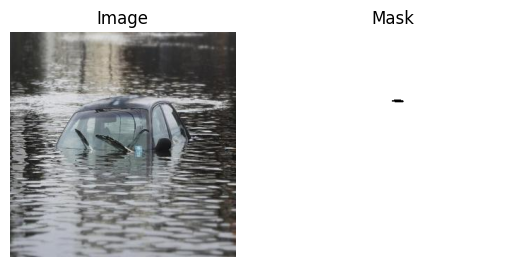

The mask in flood_2429.png covers 99.46% of the image part 0.


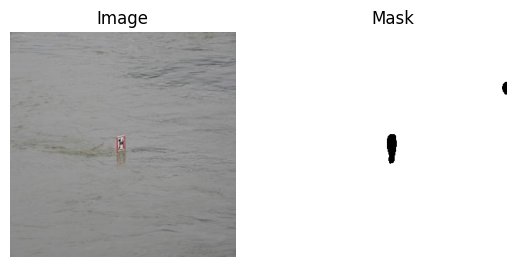

The mask in flood_1868.png covers 98.88% of the image part 0.


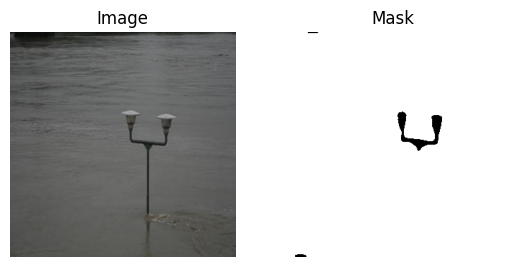

The mask in flood_5708.png covers 98.74% of the image part 0.


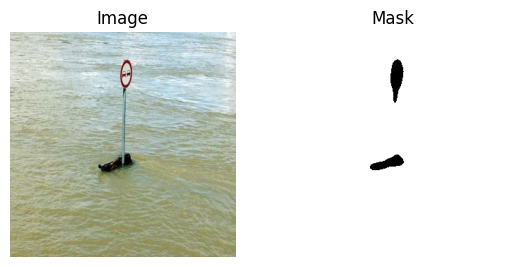

The mask in flood_538.png covers 98.74% of the image part 0.


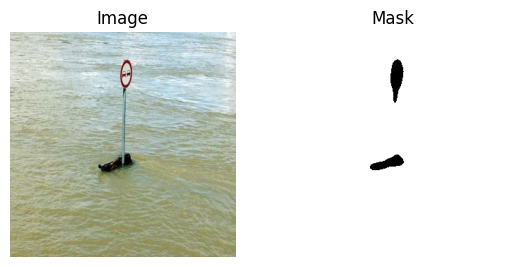

In [ ]:
# Processing each part
index_part=-1
for part in parts:
    counter = 0  # Counter to keep track of the number of images processed in each part
    index_part +=1
    for percentage, image_name, mask_name in part:
        if counter >= 5:  # Stop processing after two images in each part
            break

        image_path = os.path.join(images_dir, image_name).replace('.png','.jpg')
        mask_path = os.path.join(annotations_dir, mask_name)

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.bitwise_not(mask)
        print(f"The mask in {mask_name} covers {percentage:.2f}% of the image part {index_part}.")

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        counter += 1  # Increment the counter

In [ ]:
import os
import cv2
import shutil

# Select one of the parts (e.g., the first part)
selected_part = parts[0]
# Create directories for saving the selected images and masks
#os.makedirs('/content/flood')
#os.makedirs('/content/flood/flood_0_5')
images1_dir = '/content/flood/flood_60_100/trainA/'
masks1_dir = '/content/flood/flood_60_100/trainA_seg/'


# Create the directories
os.makedirs(images1_dir)
os.makedirs(masks1_dir)

# Iterate through the selected part and save the images and masks
for percentage, image_name, mask_name in selected_part:
    image_path = os.path.join(images_dir, image_name).replace('.png','.jpg')
    mask_path = os.path.join(annotations_dir, mask_name)

    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

     # Resize the image and mask to 512x512
    #resized_image = cv2.resize(image, (512, 512))
    #resized_mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)  # Using INTER_NEAREST to avoid introducing new classes

    # Invert the mask
    #inverted_mask = cv2.bitwise_not(mask)
    # Save the image and mask in the new directories
    cv2.imwrite(os.path.join(images1_dir, image_name), image)
    cv2.imwrite(os.path.join(masks1_dir, mask_name), mask)

print(f"Saved {len(selected_part)} images and masks in '{images1_dir}' and '{masks1_dir}'.")


Saved 309 images and masks in '/content/flood/flood_60_100/trainA/' and '/content/flood/flood_60_100/trainA_seg/'.


In [ ]:
!zip -r flood.zip /content/flood

In [ ]:
!curl -F "file=@/content/semantic-segmentation-pytorch/flood.zip" https://file.io


{"success":true,"status":200,"id":"8dea7ab0-4789-11ee-86ad-213e716a776e","key":"TXPtQgFVBHiI","path":"/","nodeType":"file","name":"flood.zip","title":null,"description":null,"size":1606087183,"link":"https://file.io/TXPtQgFVBHiI","private":false,"expires":"2023-09-13T23:04:21.189Z","downloads":0,"maxDownloads":1,"autoDelete":true,"planId":0,"screeningStatus":"pending","mimeType":"application/octet-stream","created":"2023-08-30T23:04:21.189Z","modified":"2023-08-30T23:04:21.189Z"}